# Article Scraper (Scraped files in .json format)

In [9]:
import os
import json
import time
import praw
import pandas as pd
import asyncio
import aiohttp
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from newspaper import Article
from prawcore.exceptions import TooManyRequests
from dotenv import load_dotenv

In [ ]:


# Load environment variables from .env file
load_dotenv()

# Fetch Reddit API credentials from environment variables
client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")
password = os.getenv("REDDIT_PASSWORD")
user_agent = os.getenv("REDDIT_USER_AGENT")
username = os.getenv("REDDIT_USERNAME")

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    password=password,
    user_agent=user_agent,
    username=username,
)

# Verify authentication
try:
    print(f"Authenticated as: {reddit.user.me()}")
except TooManyRequests:
    print("Rate-limited by Reddit. Try again later.")
    exit()

# File Paths
input_file = "./upliftingnews_usnews.csv"
output_file = "upliftingnews_usnews_withURL.csv"
filtered_output_file = "upliftingnews_usnews_filtered_withURL.csv"
articles_folder = "upliftingnews_usnews_scraped_articles"

# Create folder for articles
os.makedirs(articles_folder, exist_ok=True)

# Load dataset
print(f"Loading CSV file: {input_file}")
df = pd.read_csv(input_file)
df.fillna('', inplace=True)
print(f"Loaded {len(df)} records")

# Function to fetch Reddit submission URLs using batch processing
def get_submission_urls(post_id):
    attempt = 0
    while attempt < 3:  # Retry up to 3 times if rate-limited
        try:
            submission = reddit.submission(id=post_id)
            reddit_url = f"https://www.reddit.com{submission.permalink}"
            external_url = submission.url if hasattr(submission, 'url') and 'reddit.com' not in submission.url else ""
            return post_id, reddit_url, external_url, bool(external_url)
        
        except TooManyRequests as e:
            wait_time = int(e.response.headers.get("Retry-After", 5))  # Wait suggested time
            print(f"Rate-limited! Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
            attempt += 1  # Increment retry counter
        
        except Exception as e:
            print(f"Error fetching post {post_id}: {e}")
            return post_id, "", "", False

    return post_id, "", "", False  # Return empty if failed after retries

# Update DataFrame with new columns
df["reddit_url"] = ""
df["external_url"] = ""
df["is_link_post"] = False
df["has_valid_url"] = False
df["scraped"] = False

# Multi-threaded Reddit API calls (Batch requests)
print("Fetching URLs from Reddit (Parallel Execution)...")
with ThreadPoolExecutor(max_workers=15) as executor:  # Increase workers
    future_to_post = {executor.submit(get_submission_urls, row["id"]): idx for idx, row in df.iterrows()}
    
    for future in tqdm(as_completed(future_to_post), total=len(df)):
        idx = future_to_post[future]
        try:
            post_id, reddit_url, external_url, has_valid_url = future.result()
            df.at[idx, "reddit_url"] = reddit_url
            df.at[idx, "external_url"] = external_url
            df.at[idx, "is_link_post"] = bool(external_url)
            df.at[idx, "has_valid_url"] = has_valid_url
        except Exception as e:
            print(f"Error processing post ID {post_id}: {e}")

# Save intermediate results
df.to_csv(output_file, index=False)

# Filter valid URLs for scraping
valid_articles = df[df["has_valid_url"] & df["is_link_post"]]

# Function to scrape article content - USING THREAD-BASED APPROACH
def scrape_article(url, article_id):
    """
    Scrapes an article from a given URL and saves it as a JSON file.
    Args:
        url (str): The article's URL.
        article_id (int): Unique identifier for saving the article.
    Returns:
        dict: Extracted article data if successful, None otherwise.
    """
    try:
        article = Article(url)
        article.download()
        article.parse()
        
        article_data = {
            "url": url,
            "title": article.title,
            "text": article.text,
            "publish_date": article.publish_date.strftime("%Y-%m-%d") if article.publish_date else None,
            "authors": article.authors,
            "top_image": article.top_image,
            "images": list(article.images),
            "source": article.source_url
        }
        
        # Save JSON
        article_path = os.path.join(articles_folder, f"article_{article_id}.json")
        with open(article_path, "w", encoding="utf-8") as f:
            json.dump(article_data, f, indent=4)
            
        return article_data
        
    except Exception as e:
        print(f"Failed to scrape {url}: {e}")
        return None

# Scrape articles using ThreadPoolExecutor (parallel processing)
print("Scraping Articles (Thread-Based Parallel Execution)...")
valid_urls = valid_articles[valid_articles["external_url"].str.startswith("http")].reset_index(drop=True)
print(f"Total valid URLs found: {len(valid_urls)}")

scraped_articles = []

with ThreadPoolExecutor(max_workers=15) as executor:
    future_to_article = {
        executor.submit(scrape_article, row["external_url"], idx): idx
        for idx, row in valid_urls.iterrows()
    }
    
    for future in tqdm(as_completed(future_to_article), total=len(valid_urls)):
        idx = future_to_article[future]
        try:
            article_data = future.result()
            if article_data:
                scraped_articles.append(article_data)
                # Mark as scraped in the original dataframe
                # Find the original index in the main dataframe
                original_idx = valid_urls.index[idx]
                df.at[original_idx, "scraped"] = True
        except Exception as e:
            print(f"Error processing article ID {idx}: {e}")

# Save final results
df.to_csv(output_file, index=False)
filtered_df = df[df["has_valid_url"] == True].copy()
filtered_df.to_csv(filtered_output_file, index=False)

# Print summary
print("\nScraping Completed!")
print(f"Total posts processed: {len(df)}")
print(f"Posts with valid URLs: {df['has_valid_url'].sum()}")
print(f"Successfully scraped articles: {len(scraped_articles)}")
print(f"Scraped articles stored in: {articles_folder}")

Authenticated as: 12thfreted
Loading CSV file: ./upliftingnews_usnews.csv
Loaded 29901 records
Fetching URLs from Reddit (Parallel Execution)...


  3%|▎         | 999/29901 [08:19<4:11:18,  1.92it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


  3%|▎         | 1000/29901 [08:28<23:56:49,  2.98s/it]

Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...



  7%|▋         | 1999/29901 [18:19<4:54:44,  1.58it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 10%|█         | 2999/29901 [28:19<4:15:44,  1.75it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 13%|█▎        | 3999/29901 [38:19<3:15:35,  2.21it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 17%|█▋        | 4997/29901 [48:20<5:40:39,  1.22it/s] 

Rate-limited! Retrying in 5 seconds...


 17%|█▋        | 4999/29901 [48:21<4:46:16,  1.45it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 20%|██        | 5999/29901 [58:19<4:28:54,  1.48it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...



 23%|██▎       | 6999/29901 [1:08:19<4:31:10,  1.41it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 27%|██▋       | 7999/29901 [1:18:19<3:26:19,  1.77it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 30%|███       | 8998/29901 [1:28:19<3:08:32,  1.85it/s] 

Rate-limited! Retrying in 5 seconds...


 30%|███       | 8999/29901 [1:28:20<4:20:46,  1.34it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 33%|███▎      | 9998/29901 [1:38:21<6:31:46,  1.18s/it] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 33%|███▎      | 9999/29901 [1:38:23<8:27:16,  1.53s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 37%|███▋      | 10998/29901 [1:48:19<3:52:19,  1.36it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 37%|███▋      | 10999/29901 [1:48:21<5:45:11,  1.10s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 40%|████      | 11998/29901 [1:58:19<3:13:36,  1.54it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 40%|████      | 11999/29901 [1:58:22<6:22:42,  1.28s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 42%|████▏     | 12526/29901 [2:04:27<3:44:09,  1.29it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 44%|████▎     | 13035/29901 [2:14:18<2:44:53,  1.70it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 45%|████▌     | 13531/29901 [2:24:19<3:33:39,  1.28it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 

 47%|████▋     | 14023/29901 [2:34:18<3:50:31,  1.15it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 47%|████▋     | 14024/29901 [2:34:20<5:25:30,  1.23s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 49%|████▊     | 14523/29901 [2:44:20<4:13:13,  1.01it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 50%|█████     | 15033/29901 [2:54:17<1:54:15,  2.17it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 52%|█████▏    | 15532/29901 [3:04:17<1:59:44,  2.00it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 54%|█████▎    | 16029/29901 [3:14:19<4:12:20,  1.09s/it]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 55%|█████▌    | 16525/29901 [3:24:19<3:26:00,  1.08it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 57%|█████▋    | 17130/29901 [3:35:31<2:19:46,  1.52it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 59%|█████▉    | 17791/29901 [3:46:12<2:32:46,  1.32it/s]  

Rate-limited! Retrying in 5 seconds...


 60%|█████▉    | 17792/29901 [3:46:12<2:20:52,  1.43it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 61%|██████    | 18303/29901 [3:54:25<2:51:32,  1.13it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 61%|██████    | 18304/29901 [3:58:28<229:48:37, 71.34s/it]

Rate-limited! Retrying in 5 seconds...


 64%|██████▍   | 19278/29901 [4:08:09<2:00:27,  1.47it/s]  

Rate-limited! Retrying in 5 seconds...


 64%|██████▍   | 19279/29901 [4:08:11<3:53:17,  1.32s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 68%|██████▊   | 20279/29901 [4:18:19<1:47:03,  1.50it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 70%|███████   | 20989/29901 [4:26:09<1:22:52,  1.79it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 73%|███████▎  | 21726/29901 [4:37:10<1:47:19,  1.27it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 76%|███████▌  | 22668/29901 [4:48:19<1:03:58,  1.88it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...


 79%|███████▉  | 23605/29901 [4:57:58<50:05,  2.09it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 81%|████████  | 24109/29901 [5:04:21<1:15:58,  1.27it/s] 

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 82%|████████▏ | 24613/29901 [5:14:17<43:04,  2.05it/s]    

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 84%|████████▍ | 25107/29901 [5:24:21<57:12,  1.40it/s]    

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 86%|████████▌ | 25612/29901 [5:34:21<32:47,  2.18it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 87%|████████▋ | 26110/29901 [5:44:17<21:21,  2.96it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 87%|████████▋ | 26112/29901 [5:44:23<1:14:39,  1.18s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 89%|████████▉ | 26608/29901 [5:54:20<40:00,  1.37it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 91%|█████████ | 27104/29901 [6:04:17<29:59,  1.55it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 91%|█████████ | 27106/29901 [6:04:19<36:50,  1.26it/s]

Rate-limited! Retrying in 5 seconds...


 91%|█████████ | 27107/29901 [6:04:20<37:14,  1.25it/s]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 92%|█████████▏| 27611/29901 [6:14:21<35:53,  1.06it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 94%|█████████▍| 28115/29901 [6:24:19<18:46,  1.59it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 96%|█████████▌| 28616/29901 [6:34:17<15:42,  1.36it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


 96%|█████████▌| 28617/29901 [6:34:20<26:01,  1.22s/it]

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

 98%|█████████▊| 29197/29901 [6:44:52<08:38,  1.36it/s]   

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...Rate-limited! Retrying in 5 seconds...

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in

100%|█████████▉| 29876/29901 [6:56:27<00:11,  2.09it/s]  

Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...
Rate-limited! Retrying in 5 seconds...


100%|██████████| 29901/29901 [6:58:38<00:00,  1.19it/s]


Scraping Articles (Thread-Based Parallel Execution)...
Total valid URLs found: 28666
Failed to scrape http://www.abc.net.au/news/2017-06-01/smelling-links-help-lost-dog-find-home/8579064?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-01/smelling-links-help-lost-dog-find-home/8579064?section=good-news on URL http://www.abc.net.au/news/2017-06-01/smelling-links-help-lost-dog-find-home/8579064?section=good-news
Failed to scrape http://www.contracostatimes.com/news/ci_26482775/use-deadly-force-by-police-disappears-richmond-streets: Article `download()` failed with HTTPConnectionPool(host='www.contracostatimes.com', port=80): Max retries exceeded with url: /news/ci_26482775/use-deadly-force-by-police-disappears-richmond-streets (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDA42F30>: Failed to resolve 'www.contracostatimes.com' ([Errno 11001] getaddrinfo failed)")) on URL ht

  0%|          | 15/28666 [00:04<1:39:16,  4.81it/s]

Failed to scrape https://www.statesman.com/news/national/texas-girl-sets-record-climbing-mount-kilamanjaro/Y1qZo0CcsqHLuT59mMNnbI/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/national/texas-girl-sets-record-climbing-mount-kilamanjaro/Y1qZo0CcsqHLuT59mMNnbI/ on URL https://www.statesman.com/news/national/texas-girl-sets-record-climbing-mount-kilamanjaro/Y1qZo0CcsqHLuT59mMNnbI/


  0%|          | 16/28666 [00:04<1:49:26,  4.36it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/twins-7-attack-carjacker-fists-rubber-snake-200241517--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/twins-7-attack-carjacker-fists-rubber-snake-200241517--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/twins-7-attack-carjacker-fists-rubber-snake-200241517--abc-news-topstories.html?vp=1


  0%|          | 24/28666 [00:06<2:09:29,  3.69it/s]

Failed to scrape http://www.scrippsmedia.com/kmtv/news/Ailing-Omaha-father-surprises-daughter-at-wedding-306870861.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/Ailing-Omaha-father-surprises-daughter-at-wedding-306870861.html on URL http://www.scrippsmedia.com/kmtv/news/Ailing-Omaha-father-surprises-daughter-at-wedding-306870861.html


  0%|          | 33/28666 [00:09<2:09:29,  3.69it/s]

Failed to scrape http://www.foxnews.com/us/2014/06/25/florida-cop-replaces-engagement-ring-stolen-after-67-years/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2014/06/25/florida-cop-replaces-engagement-ring-stolen-after-67-years/ on URL http://www.foxnews.com/us/2014/06/25/florida-cop-replaces-engagement-ring-stolen-after-67-years/


  0%|          | 35/28666 [00:10<1:39:18,  4.81it/s]

Failed to scrape https://boingboing.net/2015/09/13/paralyzed-man-becomes-first-pe.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2015/09/13/paralyzed-man-becomes-first-pe.html on URL https://boingboing.net/2015/09/13/paralyzed-man-becomes-first-pe.html
Failed to scrape http://www.seattletimes.com/seattle-news/eastside/this-teens-prom-night-splurge-will-cheer-homeless-women/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/eastside/this-teens-prom-night-splurge-will-cheer-homeless-women/ on URL http://www.seattletimes.com/seattle-news/eastside/this-teens-prom-night-splurge-will-cheer-homeless-women/


  0%|          | 39/28666 [00:10<1:10:32,  6.76it/s]

Failed to scrape http://m.hindustantimes.com/environment/india-starts-work-on-rhino-dna-database-to-curb-poaching/story-BzeuIZtiE9Lz6TAyJWhjII.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/environment/india-starts-work-on-rhino-dna-database-to-curb-poaching/story-BzeuIZtiE9Lz6TAyJWhjII.html on URL http://m.hindustantimes.com/environment/india-starts-work-on-rhino-dna-database-to-curb-poaching/story-BzeuIZtiE9Lz6TAyJWhjII.html
Failed to scrape http://www.dhakatribune.com/health/2019/09/02/tk5-sanitary-pads-to-hit-the-market-this-month?fbclid=IwAR2XsCDq1n6Qe4g4pVkXaifJ6CbmcZeLOGNlqoqMBThTIDQseLY4qk-0g2Q: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dhakatribune.com/health/2019/09/02/tk5-sanitary-pads-to-hit-the-market-this-month?fbclid=IwAR2XsCDq1n6Qe4g4pVkXaifJ6CbmcZeLOGNlqoqMBThTIDQseLY4qk-0g2Q on URL http://www.dhakatribune.com/health/2019/09/02/tk5-sanitary-pads-to-hit-the-market-this-mo

  0%|          | 56/28666 [00:16<1:47:47,  4.42it/s]

Failed to scrape https://wgntv.com/2019/08/20/photo-captures-servers-touching-act-for-91-year-old-veteran/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wgntv.com/2019/08/20/photo-captures-servers-touching-act-for-91-year-old-veteran/ on URL https://wgntv.com/2019/08/20/photo-captures-servers-touching-act-for-91-year-old-veteran/
Failed to scrape https://www.sfgate.com/news/bayarea/article/Metallica-Fans-To-Perform-Day-Of-Service-At-Food-13869967.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/bayarea/article/Metallica-Fans-To-Perform-Day-Of-Service-At-Food-13869967.php on URL https://www.sfgate.com/news/bayarea/article/Metallica-Fans-To-Perform-Day-Of-Service-At-Food-13869967.php


  0%|          | 58/28666 [00:16<1:24:59,  5.61it/s]

Failed to scrape http://fosters.com/apps/pbcs.dll/article?AID=/20140731/GJNEWS04/140739920/0/SEARCH: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fosters.com/apps/pbcs.dll/article/ on URL http://fosters.com/apps/pbcs.dll/article?AID=/20140731/GJNEWS04/140739920/0/SEARCH


  0%|          | 62/28666 [00:17<2:10:08,  3.66it/s]

Failed to scrape http://wreg.com/2017/02/20/woman-saves-officer-by-jumping-on-suspects-back-during-struggle/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/02/20/woman-saves-officer-by-jumping-on-suspects-back-during-struggle/ on URL http://wreg.com/2017/02/20/woman-saves-officer-by-jumping-on-suspects-back-during-struggle/
Failed to scrape http://www.rd.com/slideshows/6-inspiring-stories-youre-never-too-old-to-dream/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rd.com/slideshows/6-inspiring-stories-youre-never-too-old-to-dream/ on URL http://www.rd.com/slideshows/6-inspiring-stories-youre-never-too-old-to-dream/


  0%|          | 70/28666 [00:20<2:26:03,  3.26it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/herd-helps-baby-elephant-caught-snare/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/herd-helps-baby-elephant-caught-snare/ on URL http://www.grindtv.com/outdoor/nature/post/herd-helps-baby-elephant-caught-snare/
Failed to scrape https://www.edie.net/news/12/People-and-Planet-Positive--Ikea-reveals-mixed-progress-towards--climate-positive--and-circular-economy-goals/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edie.net/news/12/People-and-Planet-Positive--Ikea-reveals-mixed-progress-towards--climate-positive--and-circular-economy-goals/ on URL https://www.edie.net/news/12/People-and-Planet-Positive--Ikea-reveals-mixed-progress-towards--climate-positive--and-circular-economy-goals/


  0%|          | 73/28666 [00:22<5:41:07,  1.40it/s]

Failed to scrape http://www.bnd.com/sports/high-school/prep-basketball/article134358919.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/sports/high-school/prep-basketball/article134358919.html


  0%|          | 78/28666 [00:23<2:21:51,  3.36it/s]

Failed to scrape https://www.reuters.com/article/us-storm-harvey-churches-lawsuit/texas-churches-sue-fema-for-disaster-relief-after-harvey-idUSKCN1BG2QV: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-storm-harvey-churches-lawsuit/texas-churches-sue-fema-for-disaster-relief-after-harvey-idUSKCN1BG2QV on URL https://www.reuters.com/article/us-storm-harvey-churches-lawsuit/texas-churches-sue-fema-for-disaster-relief-after-harvey-idUSKCN1BG2QV


  0%|          | 82/28666 [00:24<1:44:17,  4.57it/s]

Failed to scrape https://fox45now.com/news/local/nationwide-warrant-issued-for-springfield-man-accused-of-cutting-wifes-throat: Article `download()` failed with HTTPSConnectionPool(host='fox45now.com', port=443): Max retries exceeded with url: /news/local/nationwide-warrant-issued-for-springfield-man-accused-of-cutting-wifes-throat (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)'))) on URL https://fox45now.com/news/local/nationwide-warrant-issued-for-springfield-man-accused-of-cutting-wifes-throat


  0%|          | 84/28666 [00:24<2:03:20,  3.86it/s]

Failed to scrape https://thehill.com/policy/technology/460550-states-launch-antitrust-investigation-into-google: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/technology/460550-states-launch-antitrust-investigation-into-google on URL https://thehill.com/policy/technology/460550-states-launch-antitrust-investigation-into-google


  0%|          | 86/28666 [00:26<3:01:36,  2.62it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/president-donald-trump-international-hotel-golf-course-weekend: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/president-donald-trump-international-hotel-golf-course-weekend on URL http://thehill.com/blogs/blog-briefing-room/news/president-donald-trump-international-hotel-golf-course-weekend


  0%|          | 104/28666 [00:31<2:42:51,  2.92it/s]

Failed to scrape http://www.advisen.com/tools/fpnproc/news_detail3.php?list_id=5&email=tuf52289@temple.edu&tpl=news_detail3.tpl&dp=P&ad_scale=1&rid=276524290&adp=P&hkg=HjU57ubdWl: Article `download()` failed with 404 Client Error: Not Found for url: https://www.advisen.com/tools/fpnproc/fpns/articles_new_5/P/276524290.html?rid=276524290&list_id=5 on URL http://www.advisen.com/tools/fpnproc/news_detail3.php?list_id=5&email=tuf52289@temple.edu&tpl=news_detail3.tpl&dp=P&ad_scale=1&rid=276524290&adp=P&hkg=HjU57ubdWl
Failed to scrape http://www.kitv.com/story/37864874/hotel-gives-out-environmental-friendly-sunscreen-to-protect-hawaiis-coral-reefs: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/37864874/hotel-gives-out-environmental-friendly-sunscreen-to-protect-hawaiis-coral-reefs/ on URL http://www.kitv.com/story/37864874/hotel-gives-out-environmental-friendly-sunscreen-to-protect-hawaiis-coral-reefs


  0%|          | 110/28666 [00:34<3:33:19,  2.23it/s]

Failed to scrape https://charlieintel.com/2017/08/05/call-duty-zombies-community-raises-200000-charity-ee4c-event/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.charlieintel.com/2017/08/05/call-duty-zombies-community-raises-200000-charity-ee4c-event/ on URL https://charlieintel.com/2017/08/05/call-duty-zombies-community-raises-200000-charity-ee4c-event/


  0%|          | 114/28666 [00:35<2:25:05,  3.28it/s]

Failed to scrape http://www.appy-geek.com/Web/ArticleWeb.aspx?regionid=1&articleid=132828305&source=drive: Article `download()` failed with HTTPConnectionPool(host='www.appy-geek.com', port=80): Max retries exceeded with url: /Web/ArticleWeb.aspx?regionid=1&articleid=132828305&source=drive (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4E5C560>: Failed to resolve 'www.appy-geek.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.appy-geek.com/Web/ArticleWeb.aspx?regionid=1&articleid=132828305&source=drive


  0%|          | 121/28666 [00:38<2:12:59,  3.58it/s]

Failed to scrape http://techworld.tekcities.com/2019/03/03/canada-becomes-nasas-first-international-partner-for-lunar-space-station/: Article `download()` failed with 530 Server Error: Account Expired for url: http://techworld.tekcities.com/2019/03/03/canada-becomes-nasas-first-international-partner-for-lunar-space-station/ on URL http://techworld.tekcities.com/2019/03/03/canada-becomes-nasas-first-international-partner-for-lunar-space-station/


  0%|          | 130/28666 [00:41<1:55:29,  4.12it/s]

Failed to scrape https://www.nytimes.com/aponline/2019/05/08/world/europe/ap-eu-spain-asturias-award.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.nytimes.com/aponline/2019/05/08/world/europe/ap-eu-spain-asturias-award.html on URL https://www.nytimes.com/aponline/2019/05/08/world/europe/ap-eu-spain-asturias-award.html


  0%|          | 132/28666 [00:41<2:11:49,  3.61it/s]

Failed to scrape http://www.ora.tv/newsbreaker/2013-07-25-nose-1_2u90bf8f?utm_source=crowdignite.com&utm_medium=referral&utm_campaign=crowdignite.com: Article `download()` failed with 502 Server Error: Bad Gateway for url: http://www.ora.tv/newsbreaker/2013-07-25-nose-1_2u90bf8f?utm_source=crowdignite.com&utm_medium=referral&utm_campaign=crowdignite.com on URL http://www.ora.tv/newsbreaker/2013-07-25-nose-1_2u90bf8f?utm_source=crowdignite.com&utm_medium=referral&utm_campaign=crowdignite.com


  0%|          | 137/28666 [00:43<1:51:09,  4.28it/s]

Failed to scrape http://www.edinburghnews.scotsman.com/news/lotto-winner-to-help-cancer-teen-s-florida-dream-1-3719649: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edinburghnews.scotsman.com/news/lotto-winner-to-help-cancer-teen-s-florida-dream-1-3719649 on URL http://www.edinburghnews.scotsman.com/news/lotto-winner-to-help-cancer-teen-s-florida-dream-1-3719649


  1%|          | 149/28666 [00:46<1:09:28,  6.84it/s]

Failed to scrape http://www.citylab.com/tech/2015/02/kids-are-sparking-urban-planning-changes-by-mapping-their-slums/385636/?utm_source=SFFB: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2015-02-19/by-making-hand-drawn-maps-of-their-slums-in-india-kids-are-influencing-urban-planning-policies on URL http://www.citylab.com/tech/2015/02/kids-are-sparking-urban-planning-changes-by-mapping-their-slums/385636/?utm_source=SFFB


  1%|          | 152/28666 [00:46<1:23:18,  5.70it/s]

Failed to scrape http://nynno.com/stories/play/cafe-in-bangkok-with-the-cutest-employees-ever-corgis/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=nynno.com on URL http://nynno.com/stories/play/cafe-in-bangkok-with-the-cutest-employees-ever-corgis/
Failed to scrape https://abcnews.go.com/Weird/wireStory/ohio-transit-bus-driver-accident-free-million-miles-55147423: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/ohio-transit-bus-driver-accident-free-million-miles-55147423 on URL https://abcnews.go.com/Weird/wireStory/ohio-transit-bus-driver-accident-free-million-miles-55147423


  1%|          | 154/28666 [00:47<1:27:56,  5.40it/s]

Failed to scrape http://www.aravua.com/2015/02/this-toucan-is-getting-3d-printed.html: Article `download()` failed with 404 Client Error: Not Found for url: https://aravua.com/2015/02/this-toucan-is-getting-3d-printed.html on URL http://www.aravua.com/2015/02/this-toucan-is-getting-3d-printed.html
Failed to scrape http://www.charlotteobserver.com/news/local/article21287778.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/local/article21287778.html


  1%|          | 159/28666 [00:47<1:11:03,  6.69it/s]

Failed to scrape http://prettyontheoutside.typepad.com/gilmore/2015/01/my-butterfly-mimi.html#comments: Article `download()` failed with 403 Client Error: Forbidden for url: https://prettyontheoutside.typepad.com/gilmore/2015/01/my-butterfly-mimi.html#comments on URL http://prettyontheoutside.typepad.com/gilmore/2015/01/my-butterfly-mimi.html#comments
Failed to scrape http://www.abc.net.au/news/2016-12-20/koala-brushing-video-shows-man-befriending-wild-animal/8134822?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-20/koala-brushing-video-shows-man-befriending-wild-animal/8134822?section=good-news on URL http://www.abc.net.au/news/2016-12-20/koala-brushing-video-shows-man-befriending-wild-animal/8134822?section=good-news


  1%|          | 161/28666 [00:48<1:15:49,  6.27it/s]

Failed to scrape https://www.newsweek.com/g00/india-introducing-free-healthcare-500-million-people-1075607?i10c.encReferrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvLmluLw%3D%3D&i10c.ua=1&i10c.dv=14: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/g00/india-introducing-free-healthcare-500-million-people-1075607?i10c.encReferrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvLmluLw%3D%3D&i10c.ua=1&i10c.dv=14 on URL https://www.newsweek.com/g00/india-introducing-free-healthcare-500-million-people-1075607?i10c.encReferrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvLmluLw%3D%3D&i10c.ua=1&i10c.dv=14


  1%|          | 163/28666 [00:49<2:31:31,  3.14it/s]

Failed to scrape http://www.kare11.com/mb/news/local/land-of-10000-stories/craftsman-donates-his-tools-and-himself/433496004: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/local/land-of-10000-stories/craftsman-donates-his-tools-and-himself/433496004 on URL http://www.kare11.com/mb/news/local/land-of-10000-stories/craftsman-donates-his-tools-and-himself/433496004


  1%|          | 167/28666 [00:49<1:47:21,  4.42it/s]

Failed to scrape https://www.sfchronicle.com/crime/article/Bay-Area-homicides-plunge-to-historic-lows-in-13055488.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/crime/article/Bay-Area-homicides-plunge-to-historic-lows-in-13055488.php on URL https://www.sfchronicle.com/crime/article/Bay-Area-homicides-plunge-to-historic-lows-in-13055488.php


  1%|          | 169/28666 [00:50<1:51:21,  4.27it/s]

Failed to scrape http://thehill.com/blogs/pundits-blog/presidential-campaign/291944-trump-and-clinton-should-un-rig-the-debates: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/pundits-blog/presidential-campaign/291944-trump-and-clinton-should-un-rig-the-debates on URL http://thehill.com/blogs/pundits-blog/presidential-campaign/291944-trump-and-clinton-should-un-rig-the-debates


  1%|          | 176/28666 [00:52<1:57:52,  4.03it/s]

Failed to scrape https://ktla.com/2018/08/04/hundreds-of-people-had-homes-foreclosed-due-to-computer-glitch-wells-fargo-says/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b66696304d3015d136f274a&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2018/08/04/hundreds-of-people-had-homes-foreclosed-due-to-computer-glitch-wells-fargo-says/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b66696304d3015d136f274a&utm_medium=trueAnthem&utm_source=twitter on URL https://ktla.com/2018/08/04/hundreds-of-people-had-homes-foreclosed-due-to-computer-glitch-wells-fargo-says/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b66696304d3015d136f274a&utm_medium=trueAnthem&utm_source=twitter


  1%|          | 185/28666 [00:54<1:31:23,  5.19it/s]

Failed to scrape https://www.politico.com/states/florida/story/2018/02/09/catholic-schools-firing-of-teacher-after-same-sex-wedding-turns-into-miami-congressional-campaign-issue-245971: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/states/florida/story/2018/02/09/catholic-schools-firing-of-teacher-after-same-sex-wedding-turns-into-miami-congressional-campaign-issue-245971 on URL https://www.politico.com/states/florida/story/2018/02/09/catholic-schools-firing-of-teacher-after-same-sex-wedding-turns-into-miami-congressional-campaign-issue-245971
Failed to scrape http://www.newsobserver.com/news/local/article207160639.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/local/article207160639.html


  1%|          | 192/28666 [00:56<1:55:18,  4.12it/s]

Failed to scrape https://www.pluralist.com/posts/293-this-snowball-fight-between-cops-and-kids-is-what-america-needs: Article `download()` failed with 404 Client Error: Not Found for url: https://pluralist.com/posts/293-this-snowball-fight-between-cops-and-kids-is-what-america-needs on URL https://www.pluralist.com/posts/293-this-snowball-fight-between-cops-and-kids-is-what-america-needs


  1%|          | 195/28666 [00:57<1:52:41,  4.21it/s]

Failed to scrape http://news.nationalpost.com/2013/04/17/i-hope-we-can-keep-in-correspondence-nova-scotians-letter-in-a-bottle-washes-up-in-croatia-28-years-later/: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//2013/04/17/i-hope-we-can-keep-in-correspondence-nova-scotians-letter-in-a-bottle-washes-up-in-croatia-28-years-later/ on URL http://news.nationalpost.com/2013/04/17/i-hope-we-can-keep-in-correspondence-nova-scotians-letter-in-a-bottle-washes-up-in-croatia-28-years-later/


  1%|          | 199/28666 [00:57<1:08:20,  6.94it/s]

Failed to scrape http://wkrn.com/2017/05/07/video-florida-student-rises-from-wheelchair-walks-across-stage-at-graduation/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2017/05/07/video-florida-student-rises-from-wheelchair-walks-across-stage-at-graduation/ on URL http://wkrn.com/2017/05/07/video-florida-student-rises-from-wheelchair-walks-across-stage-at-graduation/
Failed to scrape http://www.abc.net.au/news/2018-08-28/drag-queens-in-aged-care-brighten-lives-of-residents/10169978?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-28/drag-queens-in-aged-care-brighten-lives-of-residents/10169978?section=good-news on URL http://www.abc.net.au/news/2018-08-28/drag-queens-in-aged-care-brighten-lives-of-residents/10169978?section=good-news


  1%|          | 203/28666 [00:58<1:37:45,  4.85it/s]

Failed to scrape https://www.boston.com/news/local/massachusetts/2015/07/06/year-old-catches-math-error-the-museum-science/awhREamdn1KRg7nz2gGyPO/story.html?p1=feature_pri_hp: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/news/local/massachusetts/2015/07/06/year-old-catches-math-error-the-museum-science/awhREamdn1KRg7nz2gGyPO/story.html?p1=feature_pri_hp on URL https://www.boston.com/news/local/massachusetts/2015/07/06/year-old-catches-math-error-the-museum-science/awhREamdn1KRg7nz2gGyPO/story.html?p1=feature_pri_hp


  1%|          | 205/28666 [00:59<1:59:39,  3.96it/s]

Failed to scrape https://www.reuters.com/article/us-canada-salmon-airlift-idUSKCN1UH2HU: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-canada-salmon-airlift-idUSKCN1UH2HU on URL https://www.reuters.com/article/us-canada-salmon-airlift-idUSKCN1UH2HU


  1%|          | 212/28666 [01:00<1:11:04,  6.67it/s]

Failed to scrape https://www.channelnewsasia.com/news/world/ukraine-to-launch-its-first-solar-plant-at-chernobyl-9847852: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/world/ukraine-to-launch-its-first-solar-plant-at-chernobyl-9847852 on URL https://www.channelnewsasia.com/news/world/ukraine-to-launch-its-first-solar-plant-at-chernobyl-9847852


  1%|          | 216/28666 [01:01<1:38:39,  4.81it/s]

Failed to scrape http://www.ktvb.com/news/local/woman-donates-20000-to-repair-anne-frank-memorial/439023387: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/news/local/woman-donates-20000-to-repair-anne-frank-memorial/439023387 on URL http://www.ktvb.com/news/local/woman-donates-20000-to-repair-anne-frank-memorial/439023387


  1%|          | 218/28666 [01:01<1:42:28,  4.63it/s]

Failed to scrape https://www.fox16.com/news/weird-al-yankovic-surprised-an-arkansas-man-battling-cancer-at-hospital/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.fox16.com/news/weird-al-yankovic-surprised-an-arkansas-man-battling-cancer-at-hospital/ on URL https://www.fox16.com/news/weird-al-yankovic-surprised-an-arkansas-man-battling-cancer-at-hospital/
Failed to scrape https://www.altpress.com/news/burger-king-student-loan-payments/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.altpress.com/news/burger-king-student-loan-payments/ on URL https://www.altpress.com/news/burger-king-student-loan-payments/


  1%|          | 221/28666 [01:03<2:34:17,  3.07it/s]

Failed to scrape http://www.foxnews.com/health/2013/06/26/breakthrough-reverse-vaccine-may-help-combat-type-1-diabetes/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2013/06/26/breakthrough-reverse-vaccine-may-help-combat-type-1-diabetes on URL http://www.foxnews.com/health/2013/06/26/breakthrough-reverse-vaccine-may-help-combat-type-1-diabetes/


  1%|          | 227/28666 [01:04<1:38:23,  4.82it/s]

Failed to scrape https://www.kark.com/news/web-extras/web-extra-ar-couple-drives-homeless-man-thought-to-be-dead-600-miles-to-his-family-in-illinois/1797822660: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kark.com/news/web-extras/web-extra-ar-couple-drives-homeless-man-thought-to-be-dead-600-miles-to-his-family-in-illinois/1797822660 on URL https://www.kark.com/news/web-extras/web-extra-ar-couple-drives-homeless-man-thought-to-be-dead-600-miles-to-his-family-in-illinois/1797822660


  1%|          | 230/28666 [01:05<2:14:41,  3.52it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/crash-victim-richard-koester-survives-six-days-without-162029966--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/crash-victim-richard-koester-survives-six-days-without-162029966--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/crash-victim-richard-koester-survives-six-days-without-162029966--abc-news-topstories.html


  1%|          | 234/28666 [01:06<2:41:52,  2.93it/s]

Failed to scrape https://www.fox13memphis.com/news/trending-now/capitals-tj-oshie-shares-stanley-cup-with-dad-who-has-alzheimers/765494780: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/news/trending-now/capitals-tj-oshie-shares-stanley-cup-with-dad-who-has-alzheimers/765494780/ on URL https://www.fox13memphis.com/news/trending-now/capitals-tj-oshie-shares-stanley-cup-with-dad-who-has-alzheimers/765494780


  1%|          | 235/28666 [01:06<2:24:12,  3.29it/s]

Failed to scrape https://www.smithsonianmag.com/smart-news/around-2000-artifacts-have-been-saved-ruins-brazils-national-museum-fire-180971510/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/around-2000-artifacts-have-been-saved-ruins-brazils-national-museum-fire-180971510/ on URL https://www.smithsonianmag.com/smart-news/around-2000-artifacts-have-been-saved-ruins-brazils-national-museum-fire-180971510/


  1%|          | 239/28666 [01:07<1:58:21,  4.00it/s]

Failed to scrape https://www.fox21news.com/top-stories/pueblo-west-man-donates-80-gallons-of-blood-over-3-decades/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.fox21news.com/top-stories/pueblo-west-man-donates-80-gallons-of-blood-over-3-decades/ on URL https://www.fox21news.com/top-stories/pueblo-west-man-donates-80-gallons-of-blood-over-3-decades/
Failed to scrape http://www.lfpress.com/2015/05/24/a-23-year-quest-to-find-the-brother-he-never-knew-ends-with-a-reunion-in-scotland: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2015/05/24/a-23-year-quest-to-find-the-brother-he-never-knew-ends-with-a-reunion-in-scotland on URL http://www.lfpress.com/2015/05/24/a-23-year-quest-to-find-the-brother-he-never-knew-ends-with-a-reunion-in-scotland


  1%|          | 244/28666 [01:08<1:20:43,  5.87it/s]

Failed to scrape http://fox13now.com/2015/08/05/husband-shocks-wife-with-pregnancy-announcement-before-she-knows-shes-pregnant/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/08/05/husband-shocks-wife-with-pregnancy-announcement-before-she-knows-shes-pregnant/ on URL http://fox13now.com/2015/08/05/husband-shocks-wife-with-pregnancy-announcement-before-she-knows-shes-pregnant/


  1%|          | 246/28666 [01:08<1:31:59,  5.15it/s]

Failed to scrape http://www.globalpost.com/dispatches/globalpost-blogs/rights/dominican-republic-t-shirt-factory-workers-rights: Article `download()` failed with 404 Client Error: Not Found for url: https://theworld.org/dispatches/globalpost-blogs/rights/dominican-republic-t-shirt-factory-workers-rights on URL http://www.globalpost.com/dispatches/globalpost-blogs/rights/dominican-republic-t-shirt-factory-workers-rights
Failed to scrape http://www.rochesterfirst.com/news/local-news/83-year-young-man-graduates-from-rit/1174596720?utm_medium=social&utm_source=facebook_News_8_WROC_Rochester: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.rochesterfirst.com/news/local-news/83-year-young-man-graduates-from-rit/1174596720?utm_medium=social&utm_source=facebook_News_8_WROC_Rochester on URL http://www.rochesterfirst.com/news/local-news/83-year-young-man-graduates-from-rit/1174596720?utm_medium=social&utm_source=facebook_News_8_WROC_Rochester


  1%|          | 250/28666 [01:09<55:24,  8.55it/s]  

Failed to scrape http://www.abc.net.au/news/2017-11-16/the-man-who-gets-auslan-emergency-messages-to-the-deaf-community/9148556: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-16/the-man-who-gets-auslan-emergency-messages-to-the-deaf-community/9148556 on URL http://www.abc.net.au/news/2017-11-16/the-man-who-gets-auslan-emergency-messages-to-the-deaf-community/9148556


  1%|          | 253/28666 [01:10<1:32:12,  5.14it/s]

Failed to scrape http://id2020.org/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.id2020.org/ on URL http://id2020.org/


  1%|          | 258/28666 [01:10<1:17:21,  6.12it/s]

Failed to scrape http://www.westernmassnews.com/story/31083737/chicopee-residents-pushing-for-statue-to-honor-bunny: Article `download()` failed with 404 Client Error: Not Found for url: https://www.westernmassnews.com/story/31083737/chicopee-residents-pushing-for-statue-to-honor-bunny/ on URL http://www.westernmassnews.com/story/31083737/chicopee-residents-pushing-for-statue-to-honor-bunny
Failed to scrape http://online.wsj.com/article/SB10001424127887323375204578269991660836834.html?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://online.wsj.com/article/SB10001424127887323375204578269991660836834.html?utm_source=dlvr.it&utm_medium=twitter on URL http://online.wsj.com/article/SB10001424127887323375204578269991660836834.html?utm_source=dlvr.it&utm_medium=twitter


  1%|          | 259/28666 [01:11<1:34:29,  5.01it/s]

Failed to scrape http://screen.yahoo.com/inspiration/brother-teddy-101856571.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/brother-teddy-101856571.html on URL http://screen.yahoo.com/inspiration/brother-teddy-101856571.html


  1%|          | 265/28666 [01:12<1:57:26,  4.03it/s]

Failed to scrape https://in.reuters.com/article/india-kashmir-pakistan/pakistan-pm-imran-khan-says-not-to-use-nuclear-weapons-first-amid-tensions-with-arch-rival-india-idINKCN1VN1JS?__twitter_impression=true&utm_medium=Social&utm_source=Twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL https://in.reuters.com/article/india-kashmir-pakistan/pakistan-pm-imran-khan-says-not-to-use-nuclear-weapons-first-amid-tensions-with-arch-rival-india-idINKCN1VN1JS?__twitter_impression=true&utm_medium=Social&utm_source=Twitter
Failed to scrape https://gma.yahoo.com/meet-romeo-cat-juliet-dog-star-crossed-lovers-211307156--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/meet-romeo-cat-juliet-dog-star-crossed-lovers-211307156--abc-news-topstories.html on URL https://gma.yahoo.com/meet-romeo-cat-juliet-dog-star-crossed-lovers-211307156--abc-news-topst

  1%|          | 277/28666 [01:15<1:30:00,  5.26it/s]

Failed to scrape http://bajzels.pl/en/dying-street-dog.html: Article `download()` failed with HTTPConnectionPool(host='bajzels.pl', port=80): Max retries exceeded with url: /en/dying-street-dog.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4D9EDB0>: Failed to resolve 'bajzels.pl' ([Errno 11001] getaddrinfo failed)")) on URL http://bajzels.pl/en/dying-street-dog.html


  1%|          | 285/28666 [01:17<1:10:00,  6.76it/s]

Failed to scrape https://www.whitehouse.gov/the-press-office/2017/10/06/president-donald-j-trump-proclaims-october-9-2017-columbus-day: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whitehouse.gov/the-press-office/2017/10/06/president-donald-j-trump-proclaims-october-9-2017-columbus-day on URL https://www.whitehouse.gov/the-press-office/2017/10/06/president-donald-j-trump-proclaims-october-9-2017-columbus-day


  1%|          | 286/28666 [01:17<1:08:51,  6.87it/s]

Failed to scrape https://finance.yahoo.com/news/almost-half-older-americans-zero-210656147.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/almost-half-older-americans-zero-210656147.html on URL https://finance.yahoo.com/news/almost-half-older-americans-zero-210656147.html
Failed to scrape http://ktla.com/2017/04/10/multiple-gunshot-victims-at-elementary-school-in-san-bernardino-amid-report-of-active-shooter-officials-say/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/04/10/multiple-gunshot-victims-at-elementary-school-in-san-bernardino-amid-report-of-active-shooter-officials-say/ on URL http://ktla.com/2017/04/10/multiple-gunshot-victims-at-elementary-school-in-san-bernardino-amid-report-of-active-shooter-officials-say/


  1%|          | 291/28666 [01:18<1:27:33,  5.40it/s]

Failed to scrape https://local12.com/news/offbeat/florida-men-accused-of-forcing-small-alligator-to-drink-beer-timothy-kepke-noah-osborne: Article `download()` failed with 404 Client Error: Not Found for url: https://local12.com/error on URL https://local12.com/news/offbeat/florida-men-accused-of-forcing-small-alligator-to-drink-beer-timothy-kepke-noah-osborne


  1%|          | 298/28666 [01:20<1:48:24,  4.36it/s]

Failed to scrape http://abc7chicago.com/news/charlotte-chief-suspect-arrested-in-protesters-shooting/1523790/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7chicago.com/news/charlotte-chief-suspect-arrested-in-protesters-shooting/1523790/ on URL http://abc7chicago.com/news/charlotte-chief-suspect-arrested-in-protesters-shooting/1523790/
Failed to scrape https://thehill.com/policy/defense/451480-military-tells-dc-residents-dont-panic-at-seeing-tanks-on-the-streets: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/defense/451480-military-tells-dc-residents-dont-panic-at-seeing-tanks-on-the-streets on URL https://thehill.com/policy/defense/451480-military-tells-dc-residents-dont-panic-at-seeing-tanks-on-the-streets


  1%|          | 302/28666 [01:21<1:06:40,  7.09it/s]

Failed to scrape http://m.ewn.co.za/2016/08/19/CT-school-hopes-to-raise-fund-through-video-campaign: Article `download()` failed with HTTPConnectionPool(host='m.ewn.co.za', port=80): Max retries exceeded with url: /2016/08/19/CT-school-hopes-to-raise-fund-through-video-campaign (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD3A04D0>: Failed to resolve 'm.ewn.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://m.ewn.co.za/2016/08/19/CT-school-hopes-to-raise-fund-through-video-campaign
Failed to scrape http://www.chicagotribune.com/news/local/politics/ct-peter-smith-death-met-0713-20170713-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/politics/ct-peter-smith-death-met-0713-20170713-story.html on URL http://www.chicagotribune.com/news/local/politics/ct-peter-smith-death-met-0713-20170713-story.html


  1%|          | 307/28666 [01:21<46:14, 10.22it/s]  

Failed to scrape http://www.stripes.com/news/us/female-marines-to-sleep-next-to-male-marines-in-field-1.451107: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com:443/theaters/us/female-marines-to-sleep-next-to-male-marines-in-field-1.451107 on URL http://www.stripes.com/news/us/female-marines-to-sleep-next-to-male-marines-in-field-1.451107


  1%|          | 314/28666 [01:24<2:07:48,  3.70it/s]

Failed to scrape https://gma.yahoo.com/secondhand-stores-heartwarming-note-attached-once-worn-wedding-201029586.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/secondhand-stores-heartwarming-note-attached-once-worn-wedding-201029586.html on URL https://gma.yahoo.com/secondhand-stores-heartwarming-note-attached-once-worn-wedding-201029586.html
Failed to scrape https://www.abc.net.au/news/2019-07-18/paul-gilmore-found-50-years-after-message-thrown-overboard/11319962: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-18/paul-gilmore-found-50-years-after-message-thrown-overboard/11319962 on URL https://www.abc.net.au/news/2019-07-18/paul-gilmore-found-50-years-after-message-thrown-overboard/11319962
Failed to scrape http://www.timesofisrael.com/israeli-doctors-spies-rally-to-save-5-year-old-syrian-girl/: Article `download()` failed with 403 Client Error: Forbidden for url: http://w

  1%|          | 320/28666 [01:25<2:10:36,  3.62it/s]

Failed to scrape http://www.ibtimes.com/happy-birthday-frodo-bilbo-baggins-how-celebrate-tolkien-week-hobbit-day-2015-these-2106584: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.com/happy-birthday-frodo-bilbo-baggins-how-celebrate-tolkien-week-hobbit-day-2015-these-2106584 on URL http://www.ibtimes.com/happy-birthday-frodo-bilbo-baggins-how-celebrate-tolkien-week-hobbit-day-2015-these-2106584


  1%|          | 326/28666 [01:28<2:45:04,  2.86it/s]

Failed to scrape http://www.mcclatchydc.com/news/nation-world/national/article208090764.html: Article `download()` failed with HTTPConnectionPool(host='www.mcclatchydc.com', port=80): Read timed out. (read timeout=7) on URL http://www.mcclatchydc.com/news/nation-world/national/article208090764.html
Failed to scrape https://www.mcclatchydc.com/latest-news/article212756749.html: Article `download()` failed with HTTPSConnectionPool(host='www.mcclatchydc.com', port=443): Read timed out. (read timeout=7) on URL https://www.mcclatchydc.com/latest-news/article212756749.html


  1%|          | 329/28666 [01:28<2:20:05,  3.37it/s]

Failed to scrape http://mentalfloss.com/article/80533/new-zealand-artist-bring-tattoo-skills-childrens-hospital-patients/?utm_campaign=uclazissou: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mentalfloss.com/article/80533/new-zealand-artist-bring-tattoo-skills-childrens-hospital-patients/?utm_campaign=uclazissou on URL http://mentalfloss.com/article/80533/new-zealand-artist-bring-tattoo-skills-childrens-hospital-patients/?utm_campaign=uclazissou


  1%|          | 335/28666 [01:30<2:13:41,  3.53it/s]

Failed to scrape http://fox4kc.com/2017/04/24/doritos-sends-four-kansas-teens-to-prom-in-style-after-hearing-about-cheesy-promposal/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2017/04/24/doritos-sends-four-kansas-teens-to-prom-in-style-after-hearing-about-cheesy-promposal/ on URL http://fox4kc.com/2017/04/24/doritos-sends-four-kansas-teens-to-prom-in-style-after-hearing-about-cheesy-promposal/


  1%|          | 341/28666 [01:33<3:42:04,  2.13it/s]

Failed to scrape https://au.news.yahoo.com/a/31484343/burns-survivor-turia-pitt-competes-in-ironman-triathlon-after-being-told-she-would-never-run-again/: Article `download()` failed with 404 Client Error: Not Found for url: https://au.news.yahoo.com/burns-survivor-turia-pitt-competes-in-ironman-triathlon-after-being-told-she-would-never-run-again-31484343.html on URL https://au.news.yahoo.com/a/31484343/burns-survivor-turia-pitt-competes-in-ironman-triathlon-after-being-told-she-would-never-run-again/


  1%|          | 344/28666 [01:35<3:58:24,  1.98it/s]

Failed to scrape http://m.news9.com/Story.aspx?story=29591267&catId=112032: Article `download()` failed with 404 Client Error: Not Found for url: http://m.news9.com/Story.aspx?story=29591267&catId=112032 on URL http://m.news9.com/Story.aspx?story=29591267&catId=112032


  1%|          | 351/28666 [01:37<2:00:29,  3.92it/s]

Failed to scrape https://nationalpost.com/news/canada/canadian-scientists-figure-out-how-to-preserve-vaccines-without-refrigeration-a-potential-public-health-game-changer: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/news/canada/canadian-scientists-figure-out-how-to-preserve-vaccines-without-refrigeration-a-potential-public-health-game-changer on URL https://nationalpost.com/news/canada/canadian-scientists-figure-out-how-to-preserve-vaccines-without-refrigeration-a-potential-public-health-game-changer


  1%|          | 355/28666 [01:37<1:18:01,  6.05it/s]

Failed to scrape http://today.msnbc.msn.com/id/49811020/ns/today-weddings/t/pregnant-bride-wore-bedding-wedding/#.UKOej8SEM5M.reddit: Article `download()` failed with 400 Client Error: Bad Request for url: http://today.msnbc.msn.com/id/49811020/ns/today-weddings/t/pregnant-bride-wore-bedding-wedding/#.UKOej8SEM5M.reddit on URL http://today.msnbc.msn.com/id/49811020/ns/today-weddings/t/pregnant-bride-wore-bedding-wedding/#.UKOej8SEM5M.reddit
Failed to scrape https://arstechnica.com/tech-policy/2019/03/new-mexico-joins-california-hawaii-to-promise-100-carbon-free-energy-by-2045/: You must `download()` an article first!
Failed to scrape https://www.thechronicleherald.ca/news/regional/veggies-for-veterans-ex-military-couple-gives-back-to-their-own-with-hants-county-farm-341443/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/nova-scotia/ on URL https://www.thechronicleherald.ca/news/regional/veggies-for-veterans-ex-military-couple-gi

  1%|▏         | 359/28666 [01:38<1:44:13,  4.53it/s]

Failed to scrape http://abc13.com/news/fans-of-honest-colorado-busboy-raise-over-$3800-for-him/1130882/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc13.com/news/fans-of-honest-colorado-busboy-raise-over-$3800-for-him/1130882/ on URL http://abc13.com/news/fans-of-honest-colorado-busboy-raise-over-$3800-for-him/1130882/


  1%|▏         | 361/28666 [01:39<2:20:01,  3.37it/s]

Failed to scrape http://mosaicscience.com/story/mirror-man: Article `download()` failed with 404 Client Error: Not Found for url: https://wellcome.org:443/story/mirror-man on URL http://mosaicscience.com/story/mirror-man


  1%|▏         | 367/28666 [01:42<2:55:42,  2.68it/s]

Failed to scrape https://www.forbes.com/sites/instituteforjustice/2018/01/24/new-alabama-bill-would-abolish-civil-forfeiture-require-convictions-to-confiscate-property/#1af6440d2c38: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/instituteforjustice/2018/01/24/new-alabama-bill-would-abolish-civil-forfeiture-require-convictions-to-confiscate-property/#1af6440d2c38 on URL https://www.forbes.com/sites/instituteforjustice/2018/01/24/new-alabama-bill-would-abolish-civil-forfeiture-require-convictions-to-confiscate-property/#1af6440d2c38


  1%|▏         | 377/28666 [01:44<2:11:43,  3.58it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-portage-park-fire-dog-rescue-20151020-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-portage-park-fire-dog-rescue-20151020-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-portage-park-fire-dog-rescue-20151020-story.html


  1%|▏         | 381/28666 [01:45<1:38:54,  4.77it/s]

Failed to scrape http://myfox8.com/2015/09/09/rare-pink-dolphin-spotted-in-louisiana-river-may-be-pregnant/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2015/09/09/rare-pink-dolphin-spotted-in-louisiana-river-may-be-pregnant/ on URL http://myfox8.com/2015/09/09/rare-pink-dolphin-spotted-in-louisiana-river-may-be-pregnant/


  1%|▏         | 384/28666 [01:45<1:19:11,  5.95it/s]

Failed to scrape http://www.wnem.com/story/23563978/grand-rapids-area-couple-hands-out-1-bills: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wnem.com/story/23563978/grand-rapids-area-couple-hands-out-1-bills/ on URL http://www.wnem.com/story/23563978/grand-rapids-area-couple-hands-out-1-bills


  1%|▏         | 392/28666 [01:49<2:11:29,  3.58it/s]

Failed to scrape https://www.baytoday.ca/world-news/law-gives-child-sex-assault-victims-more-time-to-file-suits-1746905: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baytoday.ca/world-news/law-gives-child-sex-assault-victims-more-time-to-file-suits-1746905 on URL https://www.baytoday.ca/world-news/law-gives-child-sex-assault-victims-more-time-to-file-suits-1746905
Failed to scrape http://fox13now.com/2017/07/28/officer-goes-above-and-beyond-to-help-4-year-old-girl-hunt-for-monsters/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2017/07/28/officer-goes-above-and-beyond-to-help-4-year-old-girl-hunt-for-monsters/ on URL http://fox13now.com/2017/07/28/officer-goes-above-and-beyond-to-help-4-year-old-girl-hunt-for-monsters/


  1%|▏         | 396/28666 [01:49<1:33:15,  5.05it/s]

Failed to scrape http://www.people.com/people/mobile/article/0,,20941359,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/mobile/article/0,,20941359,00.html on URL http://www.people.com/people/mobile/article/0,,20941359,00.html


  1%|▏         | 397/28666 [01:50<1:56:01,  4.06it/s]

Failed to scrape http://www.fox9.com/news/77502851-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/77502851-story on URL http://www.fox9.com/news/77502851-story


  1%|▏         | 407/28666 [01:52<1:36:08,  4.90it/s]

Failed to scrape https://www.newsweek.com/scientists-warn-trumps-space-force-could-create-incentives-nations-build-1336633: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/scientists-warn-trumps-space-force-could-create-incentives-nations-build-1336633 on URL https://www.newsweek.com/scientists-warn-trumps-space-force-could-create-incentives-nations-build-1336633
Failed to scrape http://abcnews.go.com/US/wireStory/sheriff-video-shows-slaying-suspect-iowa-store-54597188: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/sheriff-video-shows-slaying-suspect-iowa-store-54597188 on URL http://abcnews.go.com/US/wireStory/sheriff-video-shows-slaying-suspect-iowa-store-54597188


  1%|▏         | 411/28666 [01:54<2:35:46,  3.02it/s]

Failed to scrape http://www.news5cleveland.com/news/local-news/oh-stark/canton-man-left-carless-car-he-legally-purchased-from-police-was-stolen: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/oh-stark/canton-man-left-carless-car-he-legally-purchased-from-police-was-stolen on URL http://www.news5cleveland.com/news/local-news/oh-stark/canton-man-left-carless-car-he-legally-purchased-from-police-was-stolen
Failed to scrape https://www.politico.com/story/2017/11/07/trump-gun-control-texas-shooting-244636: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/11/07/trump-gun-control-texas-shooting-244636 on URL https://www.politico.com/story/2017/11/07/trump-gun-control-texas-shooting-244636


  1%|▏         | 413/28666 [01:55<2:44:47,  2.86it/s]

Failed to scrape https://apnews.com/408f46201c11437ba9a8bac705f16cb7/As-aid-checks-go-out,-farmers-worry-bailout-won't-be-enough: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/408f46201c11437ba9a8bac705f16cb7/As-aid-checks-go-out,-farmers-worry-bailout-won't-be-enough on URL https://apnews.com/408f46201c11437ba9a8bac705f16cb7/As-aid-checks-go-out,-farmers-worry-bailout-won't-be-enough


  1%|▏         | 416/28666 [01:55<1:39:32,  4.73it/s]

Failed to scrape http://thefreethoughtproject.com/cops-blue-privilege-traffic-coffee/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/cops-blue-privilege-traffic-coffee/ on URL http://thefreethoughtproject.com/cops-blue-privilege-traffic-coffee/


  1%|▏         | 419/28666 [01:57<2:45:52,  2.84it/s]

Failed to scrape https://www.democracynow.org/2018/6/22/headlines/100_arrested_in_poor_peoples_campaign_action_at_us_capitol: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.democracynow.org/2018/6/22/headlines/100_arrested_in_poor_peoples_campaign_action_at_us_capitol on URL https://www.democracynow.org/2018/6/22/headlines/100_arrested_in_poor_peoples_campaign_action_at_us_capitol
Failed to scrape http://thehill.com/homenews/campaign/351194-roy-moore-refers-to-red-and-yellow-americans-in-campaign-speech: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/351194-roy-moore-refers-to-red-and-yellow-americans-in-campaign-speech on URL http://thehill.com/homenews/campaign/351194-roy-moore-refers-to-red-and-yellow-americans-in-campaign-speech


  1%|▏         | 422/28666 [01:57<1:55:45,  4.07it/s]

Failed to scrape http://www.nydailynews.com/news/national/illinois-paramedic-dives-lake-save-3-month-old-boy-article-1.3000917?utm_content=buffer48f36&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/illinois-paramedic-dives-lake-save-3-month-old-boy-article-1.3000917?utm_content=buffer48f36&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw on URL http://www.nydailynews.com/news/national/illinois-paramedic-dives-lake-save-3-month-old-boy-article-1.3000917?utm_content=buffer48f36&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw


  1%|▏         | 426/28666 [01:58<2:35:15,  3.03it/s]

Failed to scrape http://thehill.com/policy/technology/262682-internet-tax-ban-likely-to-become-permanent: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/technology/262682-internet-tax-ban-likely-to-become-permanent on URL http://thehill.com/policy/technology/262682-internet-tax-ban-likely-to-become-permanent


  2%|▏         | 434/28666 [02:00<1:34:09,  5.00it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/long-lost-love-letter-restores-glow-1959-chevy-134301904--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/long-lost-love-letter-restores-glow-1959-chevy-134301904--abc-news-lifestyle.html on URL http://gma.yahoo.com/blogs/abc-blogs/long-lost-love-letter-restores-glow-1959-chevy-134301904--abc-news-lifestyle.html


  2%|▏         | 436/28666 [02:00<1:47:07,  4.39it/s]

Failed to scrape http://darrenmarlar.com/2016/07/15/adopted-womans-search-family-helped-save-relatives-life/: Article `download()` failed with 404 Client Error: Not Found for url: http://darrenmarlar.com/2016/07/15/adopted-womans-search-family-helped-save-relatives-life/ on URL http://darrenmarlar.com/2016/07/15/adopted-womans-search-family-helped-save-relatives-life/


  2%|▏         | 437/28666 [02:01<2:15:07,  3.48it/s]

Failed to scrape http://healthbeat.spectrumhealth.org/they-told-me-to-let-him-go/: Article `download()` failed with 404 Client Error: Not Found for url: http://healthbeat.spectrumhealth.org/they-told-me-to-let-him-go/ on URL http://healthbeat.spectrumhealth.org/they-told-me-to-let-him-go/


  2%|▏         | 441/28666 [02:02<1:46:45,  4.41it/s]

Failed to scrape https://www.ctvnews.ca/canada/b-c-minor-hockey-coach-finds-kidney-donor-after-appeal-from-team-1.4369958: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/b-c-minor-hockey-coach-finds-kidney-donor-after-appeal-from-team/ on URL https://www.ctvnews.ca/canada/b-c-minor-hockey-coach-finds-kidney-donor-after-appeal-from-team-1.4369958
Failed to scrape http://minotdailynews.com/page/content.detail/id/578152/Neighbors-bring-combines-to-aid-of-Westhope-family.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.minotdailynews.com/page/content.detail/id/578152/Neighbors-bring-combines-to-aid-of-Westhope-family.html on URL http://minotdailynews.com/page/content.detail/id/578152/Neighbors-bring-combines-to-aid-of-Westhope-family.html


  2%|▏         | 444/28666 [02:02<1:16:36,  6.14it/s]

Failed to scrape http://www.abc.net.au/news/rural/2018-09-08/bush-violinist-fights-drought-depression-with-folk-music/10214586: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/rural/2018-09-08/bush-violinist-fights-drought-depression-with-folk-music/10214586 on URL http://www.abc.net.au/news/rural/2018-09-08/bush-violinist-fights-drought-depression-with-folk-music/10214586
Failed to scrape http://www.fox10phoenix.com/news/arizona-news/122184789-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox10phoenix.com/news/arizona-news/122184789-story on URL http://www.fox10phoenix.com/news/arizona-news/122184789-story


  2%|▏         | 449/28666 [02:03<1:40:06,  4.70it/s]

Failed to scrape http://www.biography.com/news/world-smile-day-photos: Article `download()` failed with 404 Client Error: Not Found for url: https://www.biography.com/news/world-smile-day-photos on URL http://www.biography.com/news/world-smile-day-photos


  2%|▏         | 451/28666 [02:04<3:11:36,  2.45it/s]

Failed to scrape http://www.dallastimes.us/new-law-bans-wealthy-uae-residents-keeping-exotic-animals-pets/: Article `download()` failed with 404 Client Error: Not Found for url: https://dallastimes.us/new-law-bans-wealthy-uae-residents-keeping-exotic-animals-pets/ on URL http://www.dallastimes.us/new-law-bans-wealthy-uae-residents-keeping-exotic-animals-pets/


  2%|▏         | 458/28666 [02:06<1:59:27,  3.94it/s]

Failed to scrape http://www.wave3.com/story/32034880/young-girl-meets-those-who-saved-her-life: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wave3.com/story/32034880/young-girl-meets-those-who-saved-her-life/ on URL http://www.wave3.com/story/32034880/young-girl-meets-those-who-saved-her-life
Failed to scrape http://registerguard.com/rg/news/local/36504673-75/celebrity-dog-picasso-honored-for-overcoming-tough-odds.html.csp: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.registerguard.com/rg/news/local/36504673-75/celebrity-dog-picasso-honored-for-overcoming-tough-odds.html.csp on URL http://registerguard.com/rg/news/local/36504673-75/celebrity-dog-picasso-honored-for-overcoming-tough-odds.html.csp


  2%|▏         | 464/28666 [02:07<1:08:09,  6.90it/s]

Failed to scrape https://www.newsweek.com/holocaust-survivor-rosa-meir-left-tears-arab-plumbers-refuse-charge-work-1463867: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/holocaust-survivor-rosa-meir-left-tears-arab-plumbers-refuse-charge-work-1463867 on URL https://www.newsweek.com/holocaust-survivor-rosa-meir-left-tears-arab-plumbers-refuse-charge-work-1463867
Failed to scrape https://eurasianet.org/following-outcry-armenian-government-steps-back-on-controversial-mine-project: Article `download()` failed with 403 Client Error: Forbidden for url: https://eurasianet.org/following-outcry-armenian-government-steps-back-on-controversial-mine-project on URL https://eurasianet.org/following-outcry-armenian-government-steps-back-on-controversial-mine-project


  2%|▏         | 466/28666 [02:07<59:07,  7.95it/s]  

Failed to scrape https://www.aa.com.tr/en/europe/wests-silence-on-morsis-death-bares-its-lies-/1512128: Article `download()` failed with HTTPSConnectionPool(host='www.aa.com.tr', port=443): Read timed out. (read timeout=7) on URL https://www.aa.com.tr/en/europe/wests-silence-on-morsis-death-bares-its-lies-/1512128


  2%|▏         | 470/28666 [02:09<1:50:26,  4.25it/s]

Failed to scrape http://todaysfive.com/2017/08/27/hero-speedboat-houston-aid-rescue/: Article `download()` failed with 404 Client Error: Not Found for url: https://todaysfive.com/2017/08/27/hero-speedboat-houston-aid-rescue/ on URL http://todaysfive.com/2017/08/27/hero-speedboat-houston-aid-rescue/


  2%|▏         | 475/28666 [02:10<1:23:34,  5.62it/s]

Failed to scrape https://www.reuters.com/article/us-northkorea-southkorea-soldier-paralym/south-korean-soldier-who-lost-legs-to-dmz-landmine-aims-for-paralympic-gold-idUSKBN1WW01P: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-northkorea-southkorea-soldier-paralym/south-korean-soldier-who-lost-legs-to-dmz-landmine-aims-for-paralympic-gold-idUSKBN1WW01P on URL https://www.reuters.com/article/us-northkorea-southkorea-soldier-paralym/south-korean-soldier-who-lost-legs-to-dmz-landmine-aims-for-paralympic-gold-idUSKBN1WW01P
Failed to scrape http://www.abc.net.au/news/2018-03-06/oldest-known-message-in-a-bottle-found-on-wa-beach/9518632: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-03-06/oldest-known-message-in-a-bottle-found-on-wa-beach/9518632 on URL http://www.abc.net.au/news/2018-03-06/oldest-known-message-in-a-bottle-found-on-wa-beach/9518632


  2%|▏         | 477/28666 [02:10<1:50:04,  4.27it/s]

Failed to scrape https://screen.yahoo.com/inspiration/marine-surprises-bride-wedding-day-144731791.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/marine-surprises-bride-wedding-day-144731791.html on URL https://screen.yahoo.com/inspiration/marine-surprises-bride-wedding-day-144731791.html


  2%|▏         | 487/28666 [02:13<2:19:08,  3.38it/s]

Failed to scrape http://www.policeone.com/airborne-maritime/articles/6401253-Video-NY-Police-rescue-woman-from-East-River/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.police1.com/airborne-maritime/articles/6401253-Video-NY-Police-rescue-woman-from-East-River/ on URL http://www.policeone.com/airborne-maritime/articles/6401253-Video-NY-Police-rescue-woman-from-East-River/


  2%|▏         | 495/28666 [02:14<1:04:32,  7.27it/s]

Failed to scrape http://www.valleynewslive.com/home/headlines/I-honestly-didnt-think-what-I-did-was-out-of-the-normal-304636901.html?device=phone&c=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.valleynewslive.com/home/headlines/I-honestly-didnt-think-what-I-did-was-out-of-the-normal-304636901.html?device=phone&c=y on URL http://www.valleynewslive.com/home/headlines/I-honestly-didnt-think-what-I-did-was-out-of-the-normal-304636901.html?device=phone&c=y
Failed to scrape https://www.activistpost.com/2019/09/oakland-city-council-bans-facial-recognition.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.activistpost.com/2019/09/oakland-city-council-bans-facial-recognition.html on URL https://www.activistpost.com/2019/09/oakland-city-council-bans-facial-recognition.html
Failed to scrape https://boingboing.net/2019/03/25/key-net-neutrality-vote-tuesda.html: Article `download()` failed with 403 Client Error: Forbidden 

  2%|▏         | 500/28666 [02:15<1:03:40,  7.37it/s]

Failed to scrape http://m.thestar.co.uk/news/video-record-crowds-fill-sheffield-park-for-easter-duck-race-1-7195301: Article `download()` failed with HTTPConnectionPool(host='m.thestar.co.uk', port=80): Max retries exceeded with url: /news/video-record-crowds-fill-sheffield-park-for-easter-duck-race-1-7195301 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A42FAD50>: Failed to resolve 'm.thestar.co.uk' ([Errno 11001] getaddrinfo failed)")) on URL http://m.thestar.co.uk/news/video-record-crowds-fill-sheffield-park-for-easter-duck-race-1-7195301


  2%|▏         | 503/28666 [02:16<57:15,  8.20it/s]  

Failed to scrape http://thinkprogress.org/economy/2014/08/11/3469629/homeless-coffee-shop/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/economy/2014/08/11/3469629/homeless-coffee-shop/ on URL http://thinkprogress.org/economy/2014/08/11/3469629/homeless-coffee-shop/
Failed to scrape http://www.ottawasun.com/2017/01/15/finding-nemo-poodle-back-home-after-10-days-missing-in-ottawa: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawasun.com/2017/01/15/finding-nemo-poodle-back-home-after-10-days-missing-in-ottawa on URL http://www.ottawasun.com/2017/01/15/finding-nemo-poodle-back-home-after-10-days-missing-in-ottawa


  2%|▏         | 505/28666 [02:16<1:03:44,  7.36it/s]

Failed to scrape http://www.fox5atlanta.com/news/most-popular/98757925-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/most-popular/98757925-story on URL http://www.fox5atlanta.com/news/most-popular/98757925-story


  2%|▏         | 514/28666 [02:19<1:27:44,  5.35it/s]

Failed to scrape https://www.dailytelegraph.com.au/lifestyle/health/pet-therapy-dogs-bring-joy-to-young-and-old-at-christmas/news-story/389abd5ab58bc06cc61fee8422a14f3f: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailytelegraph.com.au/lifestyle/health/pet-therapy-dogs-bring-joy-to-young-and-old-at-christmas/news-story/389abd5ab58bc06cc61fee8422a14f3f on URL https://www.dailytelegraph.com.au/lifestyle/health/pet-therapy-dogs-bring-joy-to-young-and-old-at-christmas/news-story/389abd5ab58bc06cc61fee8422a14f3f


  2%|▏         | 519/28666 [02:19<53:26,  8.78it/s]  

Failed to scrape http://wamiz.co.uk/henry-foster-kittens-ketchikan-humane-society/: Article `download()` failed with 404 Client Error: Not Found for url: https://wamiz.co.uk/henry-foster-kittens-ketchikan-humane-society/ on URL http://wamiz.co.uk/henry-foster-kittens-ketchikan-humane-society/
Failed to scrape http://www.easttexasmatters.com/news/local-news/emory-man-helps-out-by-metal-detecting-missing-items-lost-from-tornadoes/710645031: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.ketk.com/news/local-news/emory-man-helps-out-by-metal-detecting-missing-items-lost-from-tornadoes/710645031 on URL http://www.easttexasmatters.com/news/local-news/emory-man-helps-out-by-metal-detecting-missing-items-lost-from-tornadoes/710645031


  2%|▏         | 523/28666 [02:20<50:50,  9.23it/s]

Failed to scrape http://www.bloomberg.com/politics/articles/2016-08-31/new-clinton-e-mails-to-be-reviewed-for-link-to-benghazi-attack: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/politics/articles/2016-08-31/new-clinton-e-mails-to-be-reviewed-for-link-to-benghazi-attack on URL http://www.bloomberg.com/politics/articles/2016-08-31/new-clinton-e-mails-to-be-reviewed-for-link-to-benghazi-attack


  2%|▏         | 525/28666 [02:20<56:30,  8.30it/s]

Failed to scrape https://thehill.com/homenews/senate/443399-bipartisan-senators-introduce-bill-to-take-on-teacher-debt: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/senate/443399-bipartisan-senators-introduce-bill-to-take-on-teacher-debt on URL https://thehill.com/homenews/senate/443399-bipartisan-senators-introduce-bill-to-take-on-teacher-debt


  2%|▏         | 526/28666 [02:20<1:13:38,  6.37it/s]

Failed to scrape http://ij.org/utah-legalizes-lemonade-stands-businesses-run-kids/: Article `download()` failed with 403 Client Error: Forbidden for url: https://ij.org/utah-legalizes-lemonade-stands-businesses-run-kids/ on URL http://ij.org/utah-legalizes-lemonade-stands-businesses-run-kids/


  2%|▏         | 527/28666 [02:21<1:25:42,  5.47it/s]

Failed to scrape http://www.wingsjournal.com/smoke-cabin-airplane-bombardier-crj700-landing-albany: Article `download()` failed with 404 Client Error: Not Found for url: http://www.wingsjournal.com/smoke-cabin-airplane-bombardier-crj700-landing-albany on URL http://www.wingsjournal.com/smoke-cabin-airplane-bombardier-crj700-landing-albany


  2%|▏         | 534/28666 [02:23<1:19:28,  5.90it/s]

Failed to scrape https://www.apnews.com/6eaf2bf0027d4470ae49bcbfc6b07569/NBC-News-fires-Matt-Lauer-over-inappropriate-sexual-behavior: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/6eaf2bf0027d4470ae49bcbfc6b07569/NBC-News-fires-Matt-Lauer-over-inappropriate-sexual-behavior on URL https://www.apnews.com/6eaf2bf0027d4470ae49bcbfc6b07569/NBC-News-fires-Matt-Lauer-over-inappropriate-sexual-behavior


  2%|▏         | 542/28666 [02:24<46:57,  9.98it/s]  

Failed to scrape https://uk.reuters.com/article/us-usa-weather/deep-freeze-keeps-grip-on-eastern-united-states-four-die-idUSKBN1ER0MR: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/us-usa-weather/deep-freeze-keeps-grip-on-eastern-united-states-four-die-idUSKBN1ER0MR
Failed to scrape http://thehill.com/homenews/house/360455-house-democrats-introduce-articles-of-impeachment-against-trump: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/house/360455-house-democrats-introduce-articles-of-impeachment-against-trump on URL http://thehill.com/homenews/house/360455-house-democrats-introduce-articles-of-impeachment-against-trump
Failed to scrape https://www.miaminewtimes.com/news/kraft-spa-founder-li-yang-hung-out-with-rick-scott-ron-desantis-matt-gaetz-trump-11110348: Article `download()` failed with 403 Client Error: Forbidden for 

  2%|▏         | 546/28666 [02:25<1:45:15,  4.45it/s]

Failed to scrape http://www.dailywire.com/news/19369/california-state-system-will-no-longer-force-elliott-hamilton: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/19369/california-state-system-will-no-longer-force-elliott-hamilton on URL http://www.dailywire.com/news/19369/california-state-system-will-no-longer-force-elliott-hamilton
Failed to scrape http://www.abc.net.au/news/2018-02-07/make-a-wish-sends-4-year-old-dwayne-franke-to-moon/9402596: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-07/make-a-wish-sends-4-year-old-dwayne-franke-to-moon/9402596 on URL http://www.abc.net.au/news/2018-02-07/make-a-wish-sends-4-year-old-dwayne-franke-to-moon/9402596


  2%|▏         | 552/28666 [02:26<2:10:24,  3.59it/s]

Failed to scrape http://www.thepostgame.com/blog/dish/201407/colts-owner-jim-irsay-100-dollar-bills-training-camp-fans-football-nfl: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/dish/201407/colts-owner-jim-irsay-100-dollar-bills-training-camp-fans-football-nfl on URL http://www.thepostgame.com/blog/dish/201407/colts-owner-jim-irsay-100-dollar-bills-training-camp-fans-football-nfl


  2%|▏         | 559/28666 [02:29<2:25:09,  3.23it/s]

Failed to scrape http://www.cbsatlanta.com/story/24857903/hs-students-band-together-to-write-book-get-published: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/24857903/hs-students-band-together-to-write-book-get-published/ on URL http://www.cbsatlanta.com/story/24857903/hs-students-band-together-to-write-book-get-published
Failed to scrape https://www.fastcompany.com/40481305/the-largest-ever-tropical-reforestation-is-planting-73-million-trees: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/40481305/the-largest-ever-tropical-reforestation-is-planting-73-million-trees on URL https://www.fastcompany.com/40481305/the-largest-ever-tropical-reforestation-is-planting-73-million-trees


  2%|▏         | 575/28666 [02:33<1:48:26,  4.32it/s]

Failed to scrape http://www.abc.net.au/news/2017-12-15/former-nrl-star-scott-hill-turns-houses-into-homes/9262732: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-15/former-nrl-star-scott-hill-turns-houses-into-homes/9262732 on URL http://www.abc.net.au/news/2017-12-15/former-nrl-star-scott-hill-turns-houses-into-homes/9262732
Failed to scrape http://www.fox4news.com/news/259894020-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox4news.com/news/259894020-story on URL http://www.fox4news.com/news/259894020-story


  2%|▏         | 581/28666 [02:34<1:27:20,  5.36it/s]

Failed to scrape https://www.kyma.com/news/odd-news/dog-named-lucifer-saves-owner-from-house-fire/773993971: Article `download()` failed with 404 Client Error: Not Found for url: https://kyma.com/news/odd-news/dog-named-lucifer-saves-owner-from-house-fire/773993971 on URL https://www.kyma.com/news/odd-news/dog-named-lucifer-saves-owner-from-house-fire/773993971


  2%|▏         | 589/28666 [02:37<1:58:29,  3.95it/s]

Failed to scrape http://kdvr.com/2018/02/18/49-new-studio-apartments-for-homeless-open-in-denver/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2018/02/18/49-new-studio-apartments-for-homeless-open-in-denver/ on URL http://kdvr.com/2018/02/18/49-new-studio-apartments-for-homeless-open-in-denver/


  2%|▏         | 594/28666 [02:38<1:57:17,  3.99it/s]

Failed to scrape https://www.citylab.com/equity/2017/08/berlin-rent-control-neighborhood-protection/536325/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-08-11/berlin-s-rent-control-plan-buy-out-private-landlords on URL https://www.citylab.com/equity/2017/08/berlin-rent-control-neighborhood-protection/536325/


  2%|▏         | 599/28666 [02:39<1:59:03,  3.93it/s]

Failed to scrape https://mygoodplanet.com/march-15th-student-protests/: Article `download()` failed with 404 Client Error: Not Found for url: https://mygoodplanet.com/march-15th-student-protests/ on URL https://mygoodplanet.com/march-15th-student-protests/


  2%|▏         | 603/28666 [02:39<1:23:23,  5.61it/s]

Failed to scrape http://www.calgarysun.com/2017/02/06/plains-bison-are-back-in-banff-after-more-than-100-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgarysun.com/2017/02/06/plains-bison-are-back-in-banff-after-more-than-100-years on URL http://www.calgarysun.com/2017/02/06/plains-bison-are-back-in-banff-after-more-than-100-years


  2%|▏         | 605/28666 [02:40<1:24:44,  5.52it/s]

Failed to scrape http://www.wistv.com/story/35531068/grandmother-writes-7000-letters-to-the-troops: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wistv.com/story/35531068/grandmother-writes-7000-letters-to-the-troops/ on URL http://www.wistv.com/story/35531068/grandmother-writes-7000-letters-to-the-troops


  2%|▏         | 608/28666 [02:41<3:18:23,  2.36it/s]

Failed to scrape http://myfox8.com/2015/04/25/wwii-veteran-from-north-carolina-goes-skydiving-for-95th-birthday/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2015/04/25/wwii-veteran-from-north-carolina-goes-skydiving-for-95th-birthday/ on URL http://myfox8.com/2015/04/25/wwii-veteran-from-north-carolina-goes-skydiving-for-95th-birthday/


  2%|▏         | 615/28666 [02:43<2:22:16,  3.29it/s]

Failed to scrape http://pix11.com/2017/06/13/15-year-old-lifeguard-saves-toddler-during-first-day-on-the-job/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2017/06/13/15-year-old-lifeguard-saves-toddler-during-first-day-on-the-job/ on URL http://pix11.com/2017/06/13/15-year-old-lifeguard-saves-toddler-during-first-day-on-the-job/


  2%|▏         | 625/28666 [02:46<2:35:03,  3.01it/s]

Failed to scrape http://screen.yahoo.com/popular/boy-survived-brain-cancer-starts-133237506.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/popular/boy-survived-brain-cancer-starts-133237506.html on URL http://screen.yahoo.com/popular/boy-survived-brain-cancer-starts-133237506.html


  2%|▏         | 630/28666 [02:48<2:19:10,  3.36it/s]

Failed to scrape http://cw33.com/2017/08/04/brothers-reunite-with-biological-mother/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://cw33.com/2017/08/04/brothers-reunite-with-biological-mother/ on URL http://cw33.com/2017/08/04/brothers-reunite-with-biological-mother/


  2%|▏         | 633/28666 [02:48<1:38:10,  4.76it/s]

Failed to scrape http://www.scrippsmedia.com/kmtv/news/Omaha-woman-loses-130-pounds-hopes-to-motivate-others-315054561.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/Omaha-woman-loses-130-pounds-hopes-to-motivate-others-315054561.html on URL http://www.scrippsmedia.com/kmtv/news/Omaha-woman-loses-130-pounds-hopes-to-motivate-others-315054561.html
Failed to scrape http://www.santacruzsentinel.com/scottsvalley/ci_22173651: Article `download()` failed with 404 Client Error: Not Found for url: https://www.santacruzsentinel.com/scottsvalley/ci_22173651 on URL http://www.santacruzsentinel.com/scottsvalley/ci_22173651


  2%|▏         | 641/28666 [02:51<1:48:23,  4.31it/s]

Failed to scrape http://gma.yahoo.com/arizona-college-student-bounces-back-dead-224829059--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/arizona-college-student-bounces-back-dead-224829059--abc-news-health.html on URL http://gma.yahoo.com/arizona-college-student-bounces-back-dead-224829059--abc-news-health.html


  2%|▏         | 642/28666 [02:52<3:11:15,  2.44it/s]

Failed to scrape http://fox4kc.com/2016/10/13/watch-basket-full-of-kittens-brings-joy-to-woman-in-local-hospice-center/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2016/10/13/watch-basket-full-of-kittens-brings-joy-to-woman-in-local-hospice-center/ on URL http://fox4kc.com/2016/10/13/watch-basket-full-of-kittens-brings-joy-to-woman-in-local-hospice-center/


  2%|▏         | 651/28666 [02:53<1:32:38,  5.04it/s]

Failed to scrape http://www.foxnews.com/entertainment/2017/11/21/cbs-news-fires-charlie-rose-following-sexual-misconduct-allegations.amp.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/entertainment/2017/11/21/cbs-news-fires-charlie-rose-following-sexual-misconduct-allegations.amp on URL http://www.foxnews.com/entertainment/2017/11/21/cbs-news-fires-charlie-rose-following-sexual-misconduct-allegations.amp.html
Failed to scrape https://w7news.com/us-banks-outperforms-european-counterparts-in-tech-innovation/: Article `download()` failed with 403 Client Error: Forbidden for url: https://w7news.net/us-banks-outperforms-european-counterparts-in-tech-innovation/ on URL https://w7news.com/us-banks-outperforms-european-counterparts-in-tech-innovation/


  2%|▏         | 654/28666 [02:54<2:04:29,  3.75it/s]

Failed to scrape http://www.newsweek.com/donald-trump-impeachment-warning-republicans-advisers-white-house-removal-odds-655951: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trump-impeachment-warning-republicans-advisers-white-house-removal-odds-655951 on URL http://www.newsweek.com/donald-trump-impeachment-warning-republicans-advisers-white-house-removal-odds-655951


  2%|▏         | 663/28666 [02:57<2:37:22,  2.97it/s]

Failed to scrape http://www.hindustantimes.com/india-news/india-to-fix-portion-sizes-in-hotels-here-s-how-the-world-curbs-food-wastage/story-LjaunfAEUj8CCMx7HB8L8M.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/india-news/india-to-fix-portion-sizes-in-hotels-here-s-how-the-world-curbs-food-wastage/story-LjaunfAEUj8CCMx7HB8L8M.html on URL http://www.hindustantimes.com/india-news/india-to-fix-portion-sizes-in-hotels-here-s-how-the-world-curbs-food-wastage/story-LjaunfAEUj8CCMx7HB8L8M.html


  2%|▏         | 670/28666 [02:58<1:11:47,  6.50it/s]

Failed to scrape http://blog.seattlepi.com/thebigblog/2012/07/26/military-dad-surprises-son-with-star-wars-homecoming/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattlepi.com/ on URL http://blog.seattlepi.com/thebigblog/2012/07/26/military-dad-surprises-son-with-star-wars-homecoming/
Failed to scrape http://ktla.com/2017/03/24/86-year-old-raises-400000-from-recycling-then-gives-it-away-to-those-less-fortunate/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/03/24/86-year-old-raises-400000-from-recycling-then-gives-it-away-to-those-less-fortunate/ on URL http://ktla.com/2017/03/24/86-year-old-raises-400000-from-recycling-then-gives-it-away-to-those-less-fortunate/


  2%|▏         | 671/28666 [02:58<1:10:26,  6.62it/s]

Failed to scrape http://www.saukvalley.com/2018/07/13/community-looks-to-repay-good-deed-of-homeless-man/ax3fm30/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/sauk-valley/2018/07/13/community-looks-to-repay-good-deed-of-homeless-man/ax3fm30/ on URL http://www.saukvalley.com/2018/07/13/community-looks-to-repay-good-deed-of-homeless-man/ax3fm30/


  2%|▏         | 675/28666 [02:59<1:39:49,  4.67it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-04-16/runners-try-to-stay-dry-at-start-of-122nd-boston-marathon: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-04-16/runners-try-to-stay-dry-at-start-of-122nd-boston-marathon on URL https://www.bloomberg.com/news/articles/2018-04-16/runners-try-to-stay-dry-at-start-of-122nd-boston-marathon


  2%|▏         | 678/28666 [03:00<1:24:40,  5.51it/s]

Failed to scrape https://gma.yahoo.com/3rd-grade-teacher-wins-150-000-then-donates-005310571.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/3rd-grade-teacher-wins-150-000-then-donates-005310571.html on URL https://gma.yahoo.com/3rd-grade-teacher-wins-150-000-then-donates-005310571.html


  2%|▏         | 685/28666 [03:02<2:27:16,  3.17it/s]

Failed to scrape http://www.charlotteobserver.com/news/state/south-carolina/article105610011.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/state/south-carolina/article105610011.html


  2%|▏         | 690/28666 [03:03<1:25:59,  5.42it/s]

Failed to scrape http://www.lex18.com/story/37053827/santas-sleigh-is-parked-on-candy-cane-lane: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/37053827/santas-sleigh-is-parked-on-candy-cane-lane on URL http://www.lex18.com/story/37053827/santas-sleigh-is-parked-on-candy-cane-lane
Failed to scrape http://fox5sandiego.com/2015/06/24/local-band-casts-boy-with-down-syndrome-in-music-video/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2015/06/24/local-band-casts-boy-with-down-syndrome-in-music-video/ on URL http://fox5sandiego.com/2015/06/24/local-band-casts-boy-with-down-syndrome-in-music-video/


  2%|▏         | 696/28666 [03:06<2:22:35,  3.27it/s]

Failed to scrape http://www.kansascity.com/news/local/article187634998.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/local/article187634998.html


  2%|▏         | 700/28666 [03:06<1:18:52,  5.91it/s]

Failed to scrape http://www.upworthy.com/8-changes-that-were-made-to-a-classic-richard-scarry-book-to-keep-up-with-the-times-progress?c=ufb4: Article `download()` failed with HTTPSConnectionPool(host='www.upworthy.com', port=443): Read timed out. (read timeout=7) on URL http://www.upworthy.com/8-changes-that-were-made-to-a-classic-richard-scarry-book-to-keep-up-with-the-times-progress?c=ufb4


  2%|▏         | 703/28666 [03:08<1:58:23,  3.94it/s]

Failed to scrape http://ktla.com/2017/06/07/torrance-teens-become-heroes-during-kern-river-camping-trip/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/06/07/torrance-teens-become-heroes-during-kern-river-camping-trip/ on URL http://ktla.com/2017/06/07/torrance-teens-become-heroes-during-kern-river-camping-trip/


  2%|▏         | 706/28666 [03:08<1:54:42,  4.06it/s]

Failed to scrape https://www.aquarium.co.za/blog/entry/yoshi-the-loggerhead-turtle-has-been-released: Article `download()` failed with HTTPSConnectionPool(host='www.aquarium.co.za', port=443): Max retries exceeded with url: /blog/entry/yoshi-the-loggerhead-turtle-has-been-released (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A42FBA40>: Failed to resolve 'www.aquarium.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.aquarium.co.za/blog/entry/yoshi-the-loggerhead-turtle-has-been-released


  2%|▏         | 711/28666 [03:10<1:29:35,  5.20it/s]

Failed to scrape http://www.fox13news.com/news/local-news/113356258-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/local-news/113356258-story on URL http://www.fox13news.com/news/local-news/113356258-story
Failed to scrape https://therising.co/2019/08/01/kamala-harris-and-aoc-push-climate-equity-act-to-protect-low-income-communities/: Article `download()` failed with HTTPSConnectionPool(host='therising.co', port=443): Max retries exceeded with url: /2019/08/01/kamala-harris-and-aoc-push-climate-equity-act-to-protect-low-income-communities/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4D19850>: Failed to resolve 'therising.co' ([Errno 11001] getaddrinfo failed)")) on URL https://therising.co/2019/08/01/kamala-harris-and-aoc-push-climate-equity-act-to-protect-low-income-communities/


  2%|▏         | 714/28666 [03:10<1:27:58,  5.30it/s]

Failed to scrape http://wnyt.com/news/cobleskill-police-bicycle-helmets-ice-cream-tickets-vouchers-certificates-officers-children-bike-kids-summer-doing-the-right-thing/4540556/: Article `download()` failed with 404 Client Error: Not Found for url: https://wnyt.com/news/cobleskill-police-bicycle-helmets-ice-cream-tickets-vouchers-certificates-officers-children-bike-kids-summer-doing-the-right-thing/4540556/ on URL http://wnyt.com/news/cobleskill-police-bicycle-helmets-ice-cream-tickets-vouchers-certificates-officers-children-bike-kids-summer-doing-the-right-thing/4540556/


  3%|▎         | 732/28666 [03:17<3:20:31,  2.32it/s]

Failed to scrape http://www.telegraph.co.uk/news/newsvideo/viral-video/11306466/Watch-Monkey-saves-dying-friend-at-train-station-in-India.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/newsvideo/viral-video/11306466/Watch-Monkey-saves-dying-friend-at-train-station-in-India.html on URL http://www.telegraph.co.uk/news/newsvideo/viral-video/11306466/Watch-Monkey-saves-dying-friend-at-train-station-in-India.html


  3%|▎         | 733/28666 [03:18<3:08:51,  2.47it/s]

Failed to scrape http://www.centralillinoisproud.com/news/salvation-army-volunteer-rings-bell-with-pet-goat/881745161: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.centralillinoisproud.com/news/salvation-army-volunteer-rings-bell-with-pet-goat/881745161 on URL http://www.centralillinoisproud.com/news/salvation-army-volunteer-rings-bell-with-pet-goat/881745161


  3%|▎         | 744/28666 [03:21<1:41:49,  4.57it/s]

Failed to scrape http://www.reuters.com/article/us-usa-crime-stingray-idUSKCN0ZS2VI: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-crime-stingray-idUSKCN0ZS2VI on URL http://www.reuters.com/article/us-usa-crime-stingray-idUSKCN0ZS2VI


  3%|▎         | 745/28666 [03:21<1:39:30,  4.68it/s]

Failed to scrape https://gma.yahoo.com/rescued-pit-bull-treats-little-sister-kitten-princess-172011929--abc-news-pets.html?cid=abcn_tco: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/rescued-pit-bull-treats-little-sister-kitten-princess-172011929--abc-news-pets.html?cid=abcn_tco on URL https://gma.yahoo.com/rescued-pit-bull-treats-little-sister-kitten-princess-172011929--abc-news-pets.html?cid=abcn_tco


  3%|▎         | 748/28666 [03:22<1:52:31,  4.14it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/39-lost-254-pounds-39-174500608.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/39-lost-254-pounds-39-174500608.html


  3%|▎         | 755/28666 [03:25<3:17:16,  2.36it/s]

Failed to scrape https://thehill.com/homenews/administration/364506-footage-shows-trump-with-accusers-after-he-claimed-he-never-met-them: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/364506-footage-shows-trump-with-accusers-after-he-claimed-he-never-met-them on URL https://thehill.com/homenews/administration/364506-footage-shows-trump-with-accusers-after-he-claimed-he-never-met-them


  3%|▎         | 760/28666 [03:26<1:30:18,  5.15it/s]

Failed to scrape http://www.courthousenews.com/morgan-stanley-coughs-up-150m-for-california-pension-losses/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/morgan-stanley-coughs-up-150m-for-california-pension-losses/ on URL http://www.courthousenews.com/morgan-stanley-coughs-up-150m-for-california-pension-losses/
Failed to scrape http://www.wsfa.com/story/38912512/88-year-old-man-arrested-accused-of-burning-raccoon-alive-for-eating-his-mangoes: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsfa.com/story/38912512/88-year-old-man-arrested-accused-of-burning-raccoon-alive-for-eating-his-mangoes/ on URL http://www.wsfa.com/story/38912512/88-year-old-man-arrested-accused-of-burning-raccoon-alive-for-eating-his-mangoes


  3%|▎         | 763/28666 [03:26<1:37:28,  4.77it/s]

Failed to scrape http://www.newsweek.com/donald-trump-toddler-school-shooting-texas-953211: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trump-toddler-school-shooting-texas-953211 on URL http://www.newsweek.com/donald-trump-toddler-school-shooting-texas-953211


  3%|▎         | 767/28666 [03:28<2:09:38,  3.59it/s]

Failed to scrape http://www.deathandtaxesmag.com/308511/trump-sex-tape-russian-orgy-rumor-mother-jones/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spin.com/death-and-taxes/ on URL http://www.deathandtaxesmag.com/308511/trump-sex-tape-russian-orgy-rumor-mother-jones/
Failed to scrape http://thehill.com/policy/transportation/336461-dems-lose-appetite-for-deal-with-trump-on-infrastructure: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/transportation/336461-dems-lose-appetite-for-deal-with-trump-on-infrastructure on URL http://thehill.com/policy/transportation/336461-dems-lose-appetite-for-deal-with-trump-on-infrastructure


  3%|▎         | 770/28666 [03:30<3:36:35,  2.15it/s]

Failed to scrape https://activatenow.us/us-troops-resist-illegal-orders-invade-venezuela-veterans/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/us-troops-resist-illegal-orders-invade-venezuela-veterans/ on URL https://activatenow.us/us-troops-resist-illegal-orders-invade-venezuela-veterans/


  3%|▎         | 776/28666 [03:31<1:39:30,  4.67it/s]

Failed to scrape https://www.reuters.com/article/us-nigeria-chibok-health/nigerian-charity-steps-in-to-help-sick-chibok-girls-idUSKBN1DH1MV: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-nigeria-chibok-health/nigerian-charity-steps-in-to-help-sick-chibok-girls-idUSKBN1DH1MV on URL https://www.reuters.com/article/us-nigeria-chibok-health/nigerian-charity-steps-in-to-help-sick-chibok-girls-idUSKBN1DH1MV


  3%|▎         | 782/28666 [03:33<2:07:06,  3.66it/s]

Failed to scrape http://www.local12.com/news/features/top-stories/stories/Street-Reach-Using-technology-to-fight-homelessness-234735.shtml: Article `download()` failed with 400 Client Error: Bad Request for url: https://local12.com/news/features/top-stories/stories/Street-Reach-Using-technology-to-fight-homelessness-234735.shtml on URL http://www.local12.com/news/features/top-stories/stories/Street-Reach-Using-technology-to-fight-homelessness-234735.shtml


  3%|▎         | 784/28666 [03:33<1:51:03,  4.18it/s]

Failed to scrape https://www.theindychannel.com/news/local-news/crime/36-dogs-rescued-from-putrid-living-conditions: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/local-news/crime/36-dogs-rescued-from-putrid-living-conditions on URL https://www.theindychannel.com/news/local-news/crime/36-dogs-rescued-from-putrid-living-conditions
Failed to scrape http://www.wxyz.com/news/region/livingston-county/mcdonalds-honors-man-with-down-syndrome-as-he-retires-after-33-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/region/livingston-county/mcdonalds-honors-man-with-down-syndrome-as-he-retires-after-33-years on URL http://www.wxyz.com/news/region/livingston-county/mcdonalds-honors-man-with-down-syndrome-as-he-retires-after-33-years


  3%|▎         | 790/28666 [03:34<52:51,  8.79it/s]  

Failed to scrape https://www.newsweek.com/ancient-tree-discovered-earths-magnetic-field-1447570: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/ancient-tree-discovered-earths-magnetic-field-1447570 on URL https://www.newsweek.com/ancient-tree-discovered-earths-magnetic-field-1447570
Failed to scrape https://www.smithsonianmag.com/smart-news/north-americas-rarest-warbler-comes-endangered-list-180973324/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/north-americas-rarest-warbler-comes-endangered-list-180973324/ on URL https://www.smithsonianmag.com/smart-news/north-americas-rarest-warbler-comes-endangered-list-180973324/
Failed to scrape http://www.hindustantimes.com/other-sports/paralympic-swimmer-lost-his-leg-to-a-shark-now-he-imagines-one-for-motivation/story-sAEX9nyH3WW8MiHuHf8lxH.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hind

  3%|▎         | 800/28666 [03:36<1:45:47,  4.39it/s]

Failed to scrape http://whotv.com/2015/08/12/nascar-legend-donates-to-iowa-family-who-lost-three-sons-in-crash/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2015/08/12/nascar-legend-donates-to-iowa-family-who-lost-three-sons-in-crash/ on URL http://whotv.com/2015/08/12/nascar-legend-donates-to-iowa-family-who-lost-three-sons-in-crash/


  3%|▎         | 804/28666 [03:38<2:55:42,  2.64it/s]

Failed to scrape http://kdvr.com/2014/08/14/program-reunites-soldiers-with-dogs-and-cats-they-rescued-in-afghanistan/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2014/08/14/program-reunites-soldiers-with-dogs-and-cats-they-rescued-in-afghanistan/ on URL http://kdvr.com/2014/08/14/program-reunites-soldiers-with-dogs-and-cats-they-rescued-in-afghanistan/


  3%|▎         | 806/28666 [03:39<2:27:27,  3.15it/s]

Failed to scrape http://www.1011now.com/content/news/375911111.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.1011now.com/content/news/375911111.html on URL http://www.1011now.com/content/news/375911111.html


  3%|▎         | 827/28666 [03:44<1:28:11,  5.26it/s]

Failed to scrape https://www.pcmag.com/news/370833/workers-call-on-tech-industry-to-end-contracts-with-oil-indu: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pcmag.com/news/370833/workers-call-on-tech-industry-to-end-contracts-with-oil-indu on URL https://www.pcmag.com/news/370833/workers-call-on-tech-industry-to-end-contracts-with-oil-indu


  3%|▎         | 829/28666 [03:45<2:14:31,  3.45it/s]

Failed to scrape http://www.travelpulse.com/news/airlines/solidarity-malaysia-airlines-refunds-london-flights.html: Article `download()` failed with 405 Client Error: Not Allowed for url: https://www.travelpulse.com/news/airlines/solidarity-malaysia-airlines-refunds-london-flights.html on URL http://www.travelpulse.com/news/airlines/solidarity-malaysia-airlines-refunds-london-flights.html


  3%|▎         | 831/28666 [03:46<3:05:28,  2.50it/s]

Failed to scrape http://blogs.wsj.com/economics/2015/03/04/for-the-first-time-in-30-years-unemployment-fell-in-every-state-in-2014/?utm_campaign=socnet_fb_ECON_20150304_bo_unemployment-down_recovery_1&utm_medium=socnet&utm_source=fb&awesm=ofa.bo_e3Bt&source=socnet_fb_ECON_20150304_bo_unemployment-down_recovery_1&utm_content=20150304_bo_unemployment-down_recovery_1: Article `download()` failed with 403 Client Error: Forbidden for url: http://blogs.wsj.com/economics/2015/03/04/for-the-first-time-in-30-years-unemployment-fell-in-every-state-in-2014/?utm_campaign=socnet_fb_ECON_20150304_bo_unemployment-down_recovery_1&utm_medium=socnet&utm_source=fb&awesm=ofa.bo_e3Bt&source=socnet_fb_ECON_20150304_bo_unemployment-down_recovery_1&utm_content=20150304_bo_unemployment-down_recovery_1 on URL http://blogs.wsj.com/economics/2015/03/04/for-the-first-time-in-30-years-unemployment-fell-in-every-state-in-2014/?utm_campaign=socnet_fb_ECON_20150304_bo_unemployment-down_recovery_1&utm_medium=socnet&utm

  3%|▎         | 838/28666 [03:47<1:32:51,  4.99it/s]

Failed to scrape http://wspa.com/2017/05/24/reformed-terrible-racist-sends-apology-letter-donation-to-upstate-church/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wspa.com/2017/05/24/reformed-terrible-racist-sends-apology-letter-donation-to-upstate-church/ on URL http://wspa.com/2017/05/24/reformed-terrible-racist-sends-apology-letter-donation-to-upstate-church/
Failed to scrape http://fox13now.com/2018/01/22/update-dog-rescued-from-salt-flats-healthy-responding-to-treatment/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2018/01/22/update-dog-rescued-from-salt-flats-healthy-responding-to-treatment/ on URL http://fox13now.com/2018/01/22/update-dog-rescued-from-salt-flats-healthy-responding-to-treatment/
Failed to scrape http://bigstory.ap.org/article/475b954180c743af91789c7573284cac/analysis-trump-promises-big-change-picks-small-fights: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap

  3%|▎         | 842/28666 [03:48<1:00:13,  7.70it/s]

Failed to scrape http://fox40.com/2017/03/09/white-house-cancels-open-press-events-by-trump/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2017/03/09/white-house-cancels-open-press-events-by-trump/ on URL http://fox40.com/2017/03/09/white-house-cancels-open-press-events-by-trump/
Failed to scrape http://wfla.com/2016/08/29/sarasota-home-buyer-contacts-better-call-behnken-after-email-hacker-takes-51133-down-payment/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wfla.com/2016/08/29/sarasota-home-buyer-contacts-better-call-behnken-after-email-hacker-takes-51133-down-payment/ on URL http://wfla.com/2016/08/29/sarasota-home-buyer-contacts-better-call-behnken-after-email-hacker-takes-51133-down-payment/


  3%|▎         | 847/28666 [03:49<1:42:48,  4.51it/s]

Failed to scrape https://www.yahoo.com/gma/know-esteban-santiago-suspect-fort-lauderdale-attack-024103175--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/know-esteban-santiago-suspect-fort-lauderdale-attack-024103175--abc-news-topstories.html on URL https://www.yahoo.com/gma/know-esteban-santiago-suspect-fort-lauderdale-attack-024103175--abc-news-topstories.html
Failed to scrape http://thehill.com/homenews/campaign/368114-dnc-chair-accused-child-molester-and-convicted-criminal-are-the-best-gop: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/368114-dnc-chair-accused-child-molester-and-convicted-criminal-are-the-best-gop on URL http://thehill.com/homenews/campaign/368114-dnc-chair-accused-child-molester-and-convicted-criminal-are-the-best-gop


  3%|▎         | 855/28666 [03:50<1:10:13,  6.60it/s]

Failed to scrape https://activatenow.us/the-brothers-krassenstein-permanent-ban-by-twitter/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/the-brothers-krassenstein-permanent-ban-by-twitter/ on URL https://activatenow.us/the-brothers-krassenstein-permanent-ban-by-twitter/


  3%|▎         | 859/28666 [03:51<1:12:20,  6.41it/s]

Failed to scrape https://shareblue.com/jeff-sessions-gives-cops-78-million-bribe-to-attack-immigrants/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /jeff-sessions-gives-cops-78-million-bribe-to-attack-immigrants/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BA9E8590>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/jeff-sessions-gives-cops-78-million-bribe-to-attack-immigrants/
Failed to scrape https://www.apnews.com/df43359ee3b44cbb84dd116e68ad54b0/Popular-Alaska-peak-weighs-new-rules-for-climbers%27-poop: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/df43359ee3b44cbb84dd116e68ad54b0/Popular-Alaska-peak-weighs-new-rules-for-climbers%27-poop on URL https://www.apnews.com/df43359ee3b44cbb84dd116e68ad54b0/Popular-Alaska-peak-weighs-new-rules-for-climbers%27-poop
Failed to scr

  3%|▎         | 861/28666 [03:52<2:06:38,  3.66it/s]

Failed to scrape http://www.keloland.com/news/your-money-matters/sioux-falls-surgical-physicians-donates-land-to-dakotabilities/1268947647: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.keloland.com/news/your-money-matters/sioux-falls-surgical-physicians-donates-land-to-dakotabilities/1268947647 on URL http://www.keloland.com/news/your-money-matters/sioux-falls-surgical-physicians-donates-land-to-dakotabilities/1268947647


  3%|▎         | 872/28666 [03:54<1:30:15,  5.13it/s]

Failed to scrape http://www.localsyr.com/news/daughter-reunited-with-her-mothers-wedding-dress_20170729221324/778304962: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.localsyr.com/news/daughter-reunited-with-her-mothers-wedding-dress_20170729221324/778304962 on URL http://www.localsyr.com/news/daughter-reunited-with-her-mothers-wedding-dress_20170729221324/778304962


  3%|▎         | 873/28666 [03:55<1:41:44,  4.55it/s]

Failed to scrape http://www.khou.com/news/health/children-with-special-needs-get-unique-christmas-party/368281803: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/health/children-with-special-needs-get-unique-christmas-party/368281803 on URL http://www.khou.com/news/health/children-with-special-needs-get-unique-christmas-party/368281803


  3%|▎         | 874/28666 [03:55<2:05:08,  3.70it/s]

Failed to scrape http://stream.aljazeera.com/story/201405122128-0023727: Article `download()` failed with 502 Server Error: Bad Gateway for url: http://stream.aljazeera.com/story/201405122128-0023727 on URL http://stream.aljazeera.com/story/201405122128-0023727


  3%|▎         | 877/28666 [03:56<1:51:01,  4.17it/s]

Failed to scrape https://www.miamiherald.com/news/local/immigration/article233211856.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/local/immigration/article233211856.html


  3%|▎         | 879/28666 [03:56<1:35:07,  4.87it/s]

Failed to scrape http://www.kxxv.com/story/30719981/troopers-buy-local-boy-gift-card-after-dog-is-run-over-killed: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kxxv.com/story/30719981/troopers-buy-local-boy-gift-card-after-dog-is-run-over-killed on URL http://www.kxxv.com/story/30719981/troopers-buy-local-boy-gift-card-after-dog-is-run-over-killed


  3%|▎         | 882/28666 [03:57<1:41:46,  4.55it/s]

Failed to scrape https://reason.com/blog/2019/04/11/gao-fiscal-situation-unsustainable-debt: Article `download()` failed with HTTPSConnectionPool(host='reason.com', port=443): Read timed out. (read timeout=7) on URL https://reason.com/blog/2019/04/11/gao-fiscal-situation-unsustainable-debt


  3%|▎         | 889/28666 [03:58<1:07:35,  6.85it/s]

Failed to scrape https://www.opb.org/news/article/npr-steven-pinker-can-numbers-show-us-that-progress-is-inevitable/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.opb.org/news/article/npr-steven-pinker-can-numbers-show-us-that-progress-is-inevitable/ on URL https://www.opb.org/news/article/npr-steven-pinker-can-numbers-show-us-that-progress-is-inevitable/
Failed to scrape http://www.abc.net.au/news/2015-01-07/jkoala-recovering-after-being-rescued-from-adelaide-bushfire/6004888: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-01-07/jkoala-recovering-after-being-rescued-from-adelaide-bushfire/6004888 on URL http://www.abc.net.au/news/2015-01-07/jkoala-recovering-after-being-rescued-from-adelaide-bushfire/6004888
Failed to scrape http://klfy.com/2016/01/21/family-reunites-with-michigan-man-held-captive-in-iran-for-4-5-years/: Article `download()` failed with 429 Client Error: Unknown Error for url: 

  3%|▎         | 893/28666 [03:58<58:02,  7.98it/s]  

Failed to scrape http://shine.yahoo.com/love-sex/bride-with-breast-cancer-has-dream-wedding--planned-by-the-internet-163234183.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/love-sex/bride-with-breast-cancer-has-dream-wedding--planned-by-the-internet-163234183.html
Failed to scrape https://shine.yahoo.com/healthy-living/mother-and-daugher-challenge-each-other-to-lose-weight-in-100-days-185259890.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/healthy-living/mother-and-daugher-challenge-each-other-to-lose-weight-in-100-days-185259890.html


  3%|▎         | 898/28666 [03:59<1:20:25,  5.75it/s]

Failed to scrape http://www.fastcoexist.com/3028985/inside-an-old-chicago-packing-plant-inspiring-proof-that-urban-indoor-farming-can-succeed: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3028985/inside-an-old-chicago-packing-plant-inspiring-proof-that-urban-indoor-farming-can-succeed on URL http://www.fastcoexist.com/3028985/inside-an-old-chicago-packing-plant-inspiring-proof-that-urban-indoor-farming-can-succeed
Failed to scrape http://bigstory.ap.org/121033bd094047b5b4d1d85d0f60377d: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /121033bd094047b5b4d1d85d0f60377d (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB8D6330>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/121033bd094047b5b4d1d85d0f60377d


  3%|▎         | 901/28666 [04:00<1:25:26,  5.42it/s]

Failed to scrape http://www.nbc12.com/story/38867282/local-salon-offers-free-back-to-school-haircuts-for-students-in-need: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12onyourside.com/story/38867282/local-salon-offers-free-back-to-school-haircuts-for-students-in-need/ on URL http://www.nbc12.com/story/38867282/local-salon-offers-free-back-to-school-haircuts-for-students-in-need
Failed to scrape http://kxan.com/2017/05/10/kitten-rescued-by-firefighters-from-us-183-shoulder/?utm_medium=social&utm_source=facebook_KXAN_News: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/05/10/kitten-rescued-by-firefighters-from-us-183-shoulder/?utm_medium=social&utm_source=facebook_KXAN_News on URL http://kxan.com/2017/05/10/kitten-rescued-by-firefighters-from-us-183-shoulder/?utm_medium=social&utm_source=facebook_KXAN_News
Failed to scrape http://www.abc.net.au/news/2016-03-29/my-real-big-fat-greek-wedding/7270578: Arti

  3%|▎         | 909/28666 [04:01<58:15,  7.94it/s]  

Failed to scrape https://thelogicalindian.com/exclusive/this-man-is-providing-free-sanitary-napkins-to-kolkata-public-toilets/: Article `download()` failed with 404 Client Error: Not Found for url: https://thelogicalindian.com/exclusive/this-man-is-providing-free-sanitary-napkins-to-kolkata-public-toilets/ on URL https://thelogicalindian.com/exclusive/this-man-is-providing-free-sanitary-napkins-to-kolkata-public-toilets/


  3%|▎         | 911/28666 [04:01<1:02:50,  7.36it/s]

Failed to scrape https://screen.yahoo.com/so-cute/cute-piglet-best-friends-pit-140000093.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/so-cute/cute-piglet-best-friends-pit-140000093.html?vp=1 on URL https://screen.yahoo.com/so-cute/cute-piglet-best-friends-pit-140000093.html?vp=1


  3%|▎         | 922/28666 [04:03<1:18:23,  5.90it/s]

Failed to scrape https://www.opb.org/news/article/npr-this-sister-act-brings-serenity-to-circus-life/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.opb.org/news/article/npr-this-sister-act-brings-serenity-to-circus-life/ on URL https://www.opb.org/news/article/npr-this-sister-act-brings-serenity-to-circus-life/


  3%|▎         | 928/28666 [04:05<1:46:19,  4.35it/s]

Failed to scrape http://www.calgarysun.com/2014/04/21/calgarys-canyon-meadows-cinema-opens-up-big-screen-for-autistic-kids: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgarysun.com/2014/04/21/calgarys-canyon-meadows-cinema-opens-up-big-screen-for-autistic-kids on URL http://www.calgarysun.com/2014/04/21/calgarys-canyon-meadows-cinema-opens-up-big-screen-for-autistic-kids


  3%|▎         | 930/28666 [04:06<1:34:47,  4.88it/s]

Failed to scrape https://gma.yahoo.com/restaurant-takes-prices-off-menu-puts-faith-god-204410153.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/restaurant-takes-prices-off-menu-puts-faith-god-204410153.html on URL https://gma.yahoo.com/restaurant-takes-prices-off-menu-puts-faith-god-204410153.html


  3%|▎         | 935/28666 [04:07<1:46:43,  4.33it/s]

Failed to scrape http://6abc.com/pets-animals/maine-lobster-boat-crew-saves-eagle-from-atlantic-ocean/2269211/: Article `download()` failed with 404 Client Error: Not Found for url: https://6abc.com/pets-animals/maine-lobster-boat-crew-saves-eagle-from-atlantic-ocean/2269211/ on URL http://6abc.com/pets-animals/maine-lobster-boat-crew-saves-eagle-from-atlantic-ocean/2269211/


  3%|▎         | 937/28666 [04:07<1:20:05,  5.77it/s]

Failed to scrape https://www.seattletimes.com/seattle-news/homeless/amazon-microsoft-and-others-give-tens-of-millions-for-homeless-housing/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/homeless/amazon-microsoft-and-others-give-tens-of-millions-for-homeless-housing/ on URL https://www.seattletimes.com/seattle-news/homeless/amazon-microsoft-and-others-give-tens-of-millions-for-homeless-housing/


  3%|▎         | 938/28666 [04:07<1:34:38,  4.88it/s]

Failed to scrape https://news.avclub.com/is-this-the-fabled-trump-pee-tape-one-intrepid-reporte-1838486589: Article `download()` failed with HTTPSConnectionPool(host='news.avclub.com', port=443): Max retries exceeded with url: /is-this-the-fabled-trump-pee-tape-one-intrepid-reporte-1838486589 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4D3ECC0>: Failed to resolve 'news.avclub.com' ([Errno 11001] getaddrinfo failed)")) on URL https://news.avclub.com/is-this-the-fabled-trump-pee-tape-one-intrepid-reporte-1838486589
Failed to scrape http://www.vancouversun.com/sports/Victoria+woman+battling+cancer+writes+poignant+letter+thanks+Roberto+Luongo+saving+life/7910973/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/sports/Victoria+woman+battling+cancer+writes+poignant+letter+thanks+Roberto+Luongo+saving+life/7910973/story.html on URL http://www.vancouversun.com/sports/Victoria+woman+battling+c

  3%|▎         | 942/28666 [04:08<1:28:33,  5.22it/s]

Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/316926-schwarzenegger-on-trump-immigration-order-it-makes-us-look: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/316926-schwarzenegger-on-trump-immigration-order-it-makes-us-look on URL http://thehill.com/blogs/in-the-know/in-the-know/316926-schwarzenegger-on-trump-immigration-order-it-makes-us-look


  3%|▎         | 948/28666 [04:11<2:27:24,  3.13it/s]

Failed to scrape http://www.politico.com/story/2017/06/12/gun-silencer-restrictions-house-jeff-duncan-239440?33: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/06/12/gun-silencer-restrictions-house-jeff-duncan-239440?33 on URL http://www.politico.com/story/2017/06/12/gun-silencer-restrictions-house-jeff-duncan-239440?33


  3%|▎         | 965/28666 [04:15<1:58:53,  3.88it/s]

Failed to scrape http://www.politicususa.com/2017/07/05/trump-humiliated-50-states-refuse-give-part-voter-data.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/07/05/trump-humiliated-50-states-refuse-give-part-voter-data.html on URL http://www.politicususa.com/2017/07/05/trump-humiliated-50-states-refuse-give-part-voter-data.html


  3%|▎         | 971/28666 [04:16<1:11:11,  6.48it/s]

Failed to scrape https://www.reuters.com/article/us-northkorea-southkorea/north-korea-says-denuclearization-pledge-not-result-of-u-s-led-sanctions-idUSKBN1I703M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-northkorea-southkorea/north-korea-says-denuclearization-pledge-not-result-of-u-s-led-sanctions-idUSKBN1I703M on URL https://www.reuters.com/article/us-northkorea-southkorea/north-korea-says-denuclearization-pledge-not-result-of-u-s-led-sanctions-idUSKBN1I703M


  3%|▎         | 978/28666 [04:19<3:39:05,  2.11it/s]

Failed to scrape http://www.clickondetroit.com/pets/rescue-goat-and-competitive-horse-are-best-friends: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/pets/rescue-goat-and-competitive-horse-are-best-friends/ on URL http://www.clickondetroit.com/pets/rescue-goat-and-competitive-horse-are-best-friends


  3%|▎         | 990/28666 [04:23<3:15:01,  2.37it/s]

Failed to scrape http://www.12newsnow.com/story/32246016/high-school-recreates-graduation-for-student-who-recently-woke-up-from-a-coma: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.12newsnow.com/story/32246016/high-school-recreates-graduation-for-student-who-recently-woke-up-from-a-coma on URL http://www.12newsnow.com/story/32246016/high-school-recreates-graduation-for-student-who-recently-woke-up-from-a-coma


  3%|▎         | 998/28666 [04:26<1:45:28,  4.37it/s]

Failed to scrape http://wtvr.com/2015/11/03/shelby-pressley-breast-milk-donations/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2015/11/03/shelby-pressley-breast-milk-donations/ on URL http://wtvr.com/2015/11/03/shelby-pressley-breast-milk-donations/


  3%|▎         | 999/28666 [04:26<2:07:21,  3.62it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57581072/boston-doctors-kindness-helps-save-homeless/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57581072/boston-doctors-kindness-helps-save-homeless/ on URL http://www.cbsnews.com/8301-18563_162-57581072/boston-doctors-kindness-helps-save-homeless/


  3%|▎         | 1002/28666 [04:27<1:46:06,  4.35it/s]

Failed to scrape http://www.ledger-enquirer.com/news/local/education/article164964372.html: Article `download()` failed with HTTPConnectionPool(host='www.ledger-enquirer.com', port=80): Read timed out. (read timeout=7) on URL http://www.ledger-enquirer.com/news/local/education/article164964372.html


  4%|▎         | 1010/28666 [04:29<1:42:36,  4.49it/s]

Failed to scrape http://bigstory.ap.org/article/788ffee3ee3240faab6143db5fec0221/first-boyfriend-singing-star-susan-boyle-53: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/788ffee3ee3240faab6143db5fec0221/first-boyfriend-singing-star-susan-boyle-53 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A427D310>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/788ffee3ee3240faab6143db5fec0221/first-boyfriend-singing-star-susan-boyle-53
Failed to scrape http://www.psfk.com/2013/05/robotic-3d-printing-teenager.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.psfk.com/2013/05/robotic-3d-printing-teenager.html on URL http://www.psfk.com/2013/05/robotic-3d-printing-teenager.html


  4%|▎         | 1012/28666 [04:30<2:58:58,  2.58it/s]

Failed to scrape https://bc.ctvnews.ca/b-c-bans-grizzly-hunting-effective-immediately-1.3726358: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/vancouver/article/b-c-bans-grizzly-hunting-effective-immediately/ on URL https://bc.ctvnews.ca/b-c-bans-grizzly-hunting-effective-immediately-1.3726358


  4%|▎         | 1015/28666 [04:31<2:01:27,  3.79it/s]

Failed to scrape http://www.abc.net.au/news/2018-04-07/flight-nurse-final-landing-after-40-years-in-the-air/9629830: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-04-07/flight-nurse-final-landing-after-40-years-in-the-air/9629830 on URL http://www.abc.net.au/news/2018-04-07/flight-nurse-final-landing-after-40-years-in-the-air/9629830


  4%|▎         | 1016/28666 [04:31<2:12:14,  3.48it/s]

Failed to scrape https://www.motivated2begreat.com/blogs/meettheteam/kristie: Article `download()` failed with HTTPSConnectionPool(host='www.motivated2begreat.com', port=443): Max retries exceeded with url: /blogs/meettheteam/kristie (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A42BC140>: Failed to resolve 'www.motivated2begreat.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.motivated2begreat.com/blogs/meettheteam/kristie


  4%|▎         | 1018/28666 [04:32<2:56:59,  2.60it/s]

Failed to scrape http://www.ktvu.com/news/moment-of-zen/218909125-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/moment-of-zen/218909125-story on URL http://www.ktvu.com/news/moment-of-zen/218909125-story


  4%|▎         | 1022/28666 [04:34<3:37:24,  2.12it/s]

Failed to scrape http://reason.com/blog/2013/07/11/an-anonymous-donor-just-put-up-500000-to#comment: Article `download()` failed with HTTPSConnectionPool(host='reason.com', port=443): Read timed out. (read timeout=7) on URL http://reason.com/blog/2013/07/11/an-anonymous-donor-just-put-up-500000-to#comment
Failed to scrape http://www.rawstory.com/rs/2013/04/11/norwegian-teens-return-81500-found-in-bag-on-a-train-left-by-elderly-passenger/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/rs/2013/04/11/norwegian-teens-return-81500-found-in-bag-on-a-train-left-by-elderly-passenger/ on URL http://www.rawstory.com/rs/2013/04/11/norwegian-teens-return-81500-found-in-bag-on-a-train-left-by-elderly-passenger/


  4%|▎         | 1027/28666 [04:34<1:43:38,  4.44it/s]

Failed to scrape http://fox4kc.com/2015/08/27/man-with-almost-perfect-poop-donates-it-to-help-patients-with-c-diff-infection/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2015/08/27/man-with-almost-perfect-poop-donates-it-to-help-patients-with-c-diff-infection/ on URL http://fox4kc.com/2015/08/27/man-with-almost-perfect-poop-donates-it-to-help-patients-with-c-diff-infection/


  4%|▎         | 1043/28666 [04:40<1:53:21,  4.06it/s]

Failed to scrape http://www.yakimaherald.com/news/crime_and_courts/redmond-cop-pays-for-shoes-diapers-that-a-family-tried/article_de87dd31-e3bb-516d-aad6-f69c5eedceea.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yakimaherald.com/news/crime_and_courts/redmond-cop-pays-for-shoes-diapers-that-a-family-tried/article_de87dd31-e3bb-516d-aad6-f69c5eedceea.html on URL http://www.yakimaherald.com/news/crime_and_courts/redmond-cop-pays-for-shoes-diapers-that-a-family-tried/article_de87dd31-e3bb-516d-aad6-f69c5eedceea.html


  4%|▎         | 1047/28666 [04:40<1:20:42,  5.70it/s]

Failed to scrape https://www.abc.net.au/news/2019-04-27/singamumma-child-friendly-choir-helps-mothers-form-friendships/11000650: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-04-27/singamumma-child-friendly-choir-helps-mothers-form-friendships/11000650 on URL https://www.abc.net.au/news/2019-04-27/singamumma-child-friendly-choir-helps-mothers-form-friendships/11000650


  4%|▎         | 1051/28666 [04:41<55:41,  8.26it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/layaway-santa-picks-tab-again-221146432--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/layaway-santa-picks-tab-again-221146432--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/layaway-santa-picks-tab-again-221146432--abc-news-topstories.html?vp=1
Failed to scrape http://koin.com/2015/07/21/coast-guard-swimmer-rescues-4-oregon-fishermen/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://koin.com/2015/07/21/coast-guard-swimmer-rescues-4-oregon-fishermen/ on URL http://koin.com/2015/07/21/coast-guard-swimmer-rescues-4-oregon-fishermen/
Failed to scrape http://www.abc.net.au/news/2017-08-06/changing-careers-in-your-40s-and-50s-people-share-stories/8766584: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-08-06/changing-careers-in-yo

  4%|▎         | 1058/28666 [04:43<2:24:54,  3.18it/s]

Failed to scrape https://safarious.com/article/14399-black-rhinos-return-to-chad-s-zakouma-50-years-after-they-were-wiped-out: Article `download()` failed with 404 Client Error: Not Found for url: https://safarious.com/article/14399-black-rhinos-return-to-chad-s-zakouma-50-years-after-they-were-wiped-out on URL https://safarious.com/article/14399-black-rhinos-return-to-chad-s-zakouma-50-years-after-they-were-wiped-out


  4%|▎         | 1059/28666 [04:43<2:46:57,  2.76it/s]

Failed to scrape http://thehill.com/homenews/state-watch/396994-maryland-ag-probing-russians-purchase-of-state-election-system-software: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/state-watch/396994-maryland-ag-probing-russians-purchase-of-state-election-system-software on URL http://thehill.com/homenews/state-watch/396994-maryland-ag-probing-russians-purchase-of-state-election-system-software


  4%|▎         | 1062/28666 [04:44<1:45:12,  4.37it/s]

Failed to scrape http://www.ctvnews.ca/canada/toronto-man-builds-park-stairs-for-550-irking-city-after-65-000-estimate-1.3510237: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/toronto-man-builds-park-stairs-for-550-irking-city-after-65-000-estimate/ on URL http://www.ctvnews.ca/canada/toronto-man-builds-park-stairs-for-550-irking-city-after-65-000-estimate-1.3510237


  4%|▎         | 1065/28666 [04:44<1:48:33,  4.24it/s]

Failed to scrape https://www.yahoo.com/news/us-states-begin-legal-action-trump-energy-delay-164549824.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/us-states-begin-legal-action-trump-energy-delay-164549824.html on URL https://www.yahoo.com/news/us-states-begin-legal-action-trump-energy-delay-164549824.html


  4%|▎         | 1072/28666 [04:48<2:56:49,  2.60it/s]

Failed to scrape https://www.reuters.com/article/us-usa-weather/deadly-flooding-forces-evacuations-across-u-s-south-midwest-idUSKCN1G6135: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-weather/deadly-flooding-forces-evacuations-across-u-s-south-midwest-idUSKCN1G6135 on URL https://www.reuters.com/article/us-usa-weather/deadly-flooding-forces-evacuations-across-u-s-south-midwest-idUSKCN1G6135


  4%|▍         | 1077/28666 [04:50<3:00:05,  2.55it/s]

Failed to scrape https://reuters.com/article/BigStory12/idUSKCN1SU1VQ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/BigStory12/idUSKCN1SU1VQ on URL https://reuters.com/article/BigStory12/idUSKCN1SU1VQ


  4%|▍         | 1084/28666 [04:52<2:07:47,  3.60it/s]

Failed to scrape https://71republic.com/2018/03/08/breaking-north-korean-open-to-denuclearization-talks-with-usa-south-korea/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/08/breaking-north-korean-open-to-denuclearization-talks-with-usa-south-korea/ on URL https://71republic.com/2018/03/08/breaking-north-korean-open-to-denuclearization-talks-with-usa-south-korea/


  4%|▍         | 1088/28666 [04:55<4:38:01,  1.65it/s]

Failed to scrape https://reason.com/blog/2017/10/04/black-lives-matter-students-shut-down-th: Article `download()` failed with HTTPSConnectionPool(host='reason.com', port=443): Read timed out. (read timeout=7) on URL https://reason.com/blog/2017/10/04/black-lives-matter-students-shut-down-th


  4%|▍         | 1104/28666 [05:02<2:42:03,  2.83it/s]

Failed to scrape https://www.pressdemocrat.com/news/9556360-181/its-a-godsend-man-finds?artslide=1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/9556360-181/its-a-godsend-man-finds?artslide=1 on URL https://www.pressdemocrat.com/news/9556360-181/its-a-godsend-man-finds?artslide=1


  4%|▍         | 1107/28666 [05:02<1:58:49,  3.87it/s]

Failed to scrape http://www.sunjournal.com/news/bplus/2017/05/07/lost-weekend-unplugged-internet/2122052: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sunjournal.com/news/bplus/2017/05/07/lost-weekend-unplugged-internet/2122052 on URL http://www.sunjournal.com/news/bplus/2017/05/07/lost-weekend-unplugged-internet/2122052
Failed to scrape http://bigstory.ap.org/ab4f51b784234d1b91e76930273e9b86: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /ab4f51b784234d1b91e76930273e9b86 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4199AC0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/ab4f51b784234d1b91e76930273e9b86


  4%|▍         | 1110/28666 [05:03<1:56:22,  3.95it/s]

Failed to scrape http://reason.com/archives/2017/05/30/fewer-people-exposed-to-horrors-of-war: Article `download()` failed with HTTPConnectionPool(host='reason.com', port=80): Read timed out. (read timeout=7) on URL http://reason.com/archives/2017/05/30/fewer-people-exposed-to-horrors-of-war


  4%|▍         | 1116/28666 [05:05<2:16:42,  3.36it/s]

Failed to scrape http://www.the-dispatch.com/article/20150518/NEWS/305189987/1005?Title=Cousin-saves-family-s-lives-in-mobile-home-fire: Article `download()` failed with 404 Client Error: Not Found for url: https://www.the-dispatch.com/article/20150518/news/305189987/1005/?Title=Cousin-saves-family-s-lives-in-mobile-home-fire on URL http://www.the-dispatch.com/article/20150518/NEWS/305189987/1005?Title=Cousin-saves-family-s-lives-in-mobile-home-fire
Failed to scrape http://fox59.com/2016/10/21/haunted-house-owner-donates-every-dollar-to-charity-in-honor-of-late-brother/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2016/10/21/haunted-house-owner-donates-every-dollar-to-charity-in-honor-of-late-brother/ on URL http://fox59.com/2016/10/21/haunted-house-owner-donates-every-dollar-to-charity-in-honor-of-late-brother/


  4%|▍         | 1121/28666 [05:06<1:32:49,  4.95it/s]

Failed to scrape http://www.kansas.com/news/local/education/article21622413.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/local/education/article21622413.html


  4%|▍         | 1122/28666 [05:06<1:50:56,  4.14it/s]

Failed to scrape http://www.people.com/article/north-carolina-widow-hands-out-love-notes: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/north-carolina-widow-hands-out-love-notes on URL http://www.people.com/article/north-carolina-widow-hands-out-love-notes


  4%|▍         | 1125/28666 [05:07<1:16:39,  5.99it/s]

Failed to scrape http://in.reuters.com/article/olympics-rio-wrestling-australia-kumar-idINKCN0YO1S0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/olympics-rio-wrestling-australia-kumar-idINKCN0YO1S0
Failed to scrape https://www.yahoo.com/news/supreme-court-rejects-nebraska-county-appeal-over-28m-145026202--politics.html?fbclid=IwAR3BpzOXN_X8RYABN5lU7JgHbl1kRgPfI1f1e1mKo5dM03a_QYEbC5ZBZgw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/supreme-court-rejects-nebraska-county-appeal-over-28m-145026202--politics.html?fbclid=IwAR3BpzOXN_X8RYABN5lU7JgHbl1kRgPfI1f1e1mKo5dM03a_QYEbC5ZBZgw on URL https://www.yahoo.com/news/supreme-court-rejects-nebraska-county-appeal-over-28m-145026202--politics.html?fbclid=IwAR3BpzOXN_X8RYABN5lU7JgHbl1kRgPfI1f1e1mKo5dM03a_QYEbC5ZBZgw
Failed to scrape http://www.ktvb.com/news/local/woman-donates-20000-to

  4%|▍         | 1128/28666 [05:07<1:05:11,  7.04it/s]

Failed to scrape http://wkrn.com/2015/11/02/dogs-rescued-from-abusive-homes-get-new-leash-on-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2015/11/02/dogs-rescued-from-abusive-homes-get-new-leash-on-life/ on URL http://wkrn.com/2015/11/02/dogs-rescued-from-abusive-homes-get-new-leash-on-life/


  4%|▍         | 1142/28666 [05:11<1:39:23,  4.62it/s]

Failed to scrape http://reader360.net/wikipedia-can-pursue-nsa-surveillance-lawsuit-u-s-appeals-court/: Article `download()` failed with HTTPSConnectionPool(host='reader360.net', port=443): Read timed out. (read timeout=7) on URL http://reader360.net/wikipedia-can-pursue-nsa-surveillance-lawsuit-u-s-appeals-court/
Failed to scrape http://www.cornwalllive.com/kay-harvey-with-terminal-condition-holds-helston-music-festival-for-royal-cornwall-hospital-and-bhf/story-30073759-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.cornwalllive.com/kay-harvey-with-terminal-condition-holds-helston-music-festival-for-royal-cornwall-hospital-and-bhf/story-30073759-detail/story.html on URL http://www.cornwalllive.com/kay-harvey-with-terminal-condition-holds-helston-music-festival-for-royal-cornwall-hospital-and-bhf/story-30073759-detail/story.html


  4%|▍         | 1144/28666 [05:11<1:15:14,  6.10it/s]

Failed to scrape http://fox17online.com/2018/01/04/kalamazoo-trader-joes-donates-35000-pounds-of-food-after-refrigerator-malfunction/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2018/01/04/kalamazoo-trader-joes-donates-35000-pounds-of-food-after-refrigerator-malfunction/ on URL http://fox17online.com/2018/01/04/kalamazoo-trader-joes-donates-35000-pounds-of-food-after-refrigerator-malfunction/


  4%|▍         | 1146/28666 [05:12<1:21:53,  5.60it/s]

Failed to scrape https://uk.reuters.com/article/us-yahoo-japan-ivory/yahoo-japan-to-end-ivory-sales-sources-idUKKCN1VI0DX: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/us-yahoo-japan-ivory/yahoo-japan-to-end-ivory-sales-sources-idUKKCN1VI0DX


  4%|▍         | 1149/28666 [05:13<1:42:24,  4.48it/s]

Failed to scrape https://www.techdirt.com/articles/20170921/17090738264/appeals-court-tells-patent-trolls-favorite-judge-he-cant-just-ignore-supreme-court-to-keep-patent-cases-texas.shtml: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.techdirt.com/articles/20170921/17090738264/appeals-court-tells-patent-trolls-favorite-judge-he-cant-just-ignore-supreme-court-to-keep-patent-cases-texas.shtml on URL https://www.techdirt.com/articles/20170921/17090738264/appeals-court-tells-patent-trolls-favorite-judge-he-cant-just-ignore-supreme-court-to-keep-patent-cases-texas.shtml


  4%|▍         | 1157/28666 [05:15<2:09:31,  3.54it/s]

Failed to scrape http://www.thecomet.net/news/hitchin-chills-with-loveable-greyhounds-on-a-comfy-sofa-1-5174442: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thecomet.net/news/hitchin-chills-with-loveable-greyhounds-on-a-comfy-sofa-1-5174442/ on URL http://www.thecomet.net/news/hitchin-chills-with-loveable-greyhounds-on-a-comfy-sofa-1-5174442


  4%|▍         | 1159/28666 [05:15<1:48:32,  4.22it/s]

Failed to scrape http://westchester.news12.com/news/hundreds-brave-icy-waters-to-raise-money-for-special-olympics-1.12609783: Article `download()` failed with 404 Client Error: Not Found for url: https://westchester.news12.com/news/hundreds-brave-icy-waters-to-raise-money-for-special-olympics-1.12609783 on URL http://westchester.news12.com/news/hundreds-brave-icy-waters-to-raise-money-for-special-olympics-1.12609783


  4%|▍         | 1164/28666 [05:16<1:09:45,  6.57it/s]

Failed to scrape http://www.progress-index.com/news/20170523/shoe-donation-puts-students-one-step-ahead: Article `download()` failed with 404 Client Error: OK for url: https://www.progress-index.com/news/20170523/shoe-donation-puts-students-one-step-ahead on URL http://www.progress-index.com/news/20170523/shoe-donation-puts-students-one-step-ahead
Failed to scrape http://www.abc15.com/news/region-southeast-valley/mesa/raw-video-hundreds-join-mesa-funeral-procession-for-toddler-who-loves-trucks: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-southeast-valley/mesa/raw-video-hundreds-join-mesa-funeral-procession-for-toddler-who-loves-trucks on URL http://www.abc15.com/news/region-southeast-valley/mesa/raw-video-hundreds-join-mesa-funeral-procession-for-toddler-who-loves-trucks


  4%|▍         | 1167/28666 [05:16<50:07,  9.14it/s]  

Failed to scrape http://www.grandforksherald.com/news/4243258-girls-prom-dress-tops-sewn-9121-pop-tabs: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.grandforksherald.com/news/4243258-girls-prom-dress-tops-sewn-9121-pop-tabs on URL http://www.grandforksherald.com/news/4243258-girls-prom-dress-tops-sewn-9121-pop-tabs
Failed to scrape http://www.21alive.com/news/local/Homeless-Fort-Wayne-veteran-with-no-family-to-receive-military-funeral---373917451.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.21alive.com/news/local/Homeless-Fort-Wayne-veteran-with-no-family-to-receive-military-funeral---373917451.html on URL http://www.21alive.com/news/local/Homeless-Fort-Wayne-veteran-with-no-family-to-receive-military-funeral---373917451.html
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/minn-mail-carrier-delivered-cpr-39-just-kind-123109583--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Erro

  4%|▍         | 1172/28666 [05:16<52:34,  8.72it/s]

Failed to scrape http://fox2now.com/2017/05/28/good-samaritan-buys-plane-ticket-for-soldier-to-visit-his-family-for-memorial-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2017/05/28/good-samaritan-buys-plane-ticket-for-soldier-to-visit-his-family-for-memorial-day/ on URL http://fox2now.com/2017/05/28/good-samaritan-buys-plane-ticket-for-soldier-to-visit-his-family-for-memorial-day/


  4%|▍         | 1174/28666 [05:17<58:42,  7.80it/s]

Failed to scrape http://www.citylab.com/housing/2015/10/the-nursing-home-thats-also-a-dorm/408424/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2015-10-02/a-nursing-home-that-s-also-a-college-dorm on URL http://www.citylab.com/housing/2015/10/the-nursing-home-thats-also-a-dorm/408424/


  4%|▍         | 1177/28666 [05:17<59:19,  7.72it/s]  

Failed to scrape http://m.citizensvoice.com/news/doctor-arranges-for-patient-to-drive-dream-car-1.2078419: Article `download()` failed with 404 Client Error: Not Found for url: http://m.citizensvoice.com/news/doctor-arranges-for-patient-to-drive-dream-car-1.2078419 on URL http://m.citizensvoice.com/news/doctor-arranges-for-patient-to-drive-dream-car-1.2078419
Failed to scrape http://www.ctvnews.ca/mobile/canada/just-so-perfect-strangers-help-refugee-learn-to-skate-in-ottawa-1.3288432?hootPostID=0a664c7753562d5413db98bd0a09bd59: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/canada/just-so-perfect-strangers-help-refugee-learn-to-skate-in-ottawa-1.3288432?hootPostID=0a664c7753562d5413db98bd0a09bd59 on URL http://www.ctvnews.ca/mobile/canada/just-so-perfect-strangers-help-refugee-learn-to-skate-in-ottawa-1.3288432?hootPostID=0a664c7753562d5413db98bd0a09bd59


  4%|▍         | 1178/28666 [05:17<1:10:22,  6.51it/s]

Failed to scrape http://www.people.com/article/102-year-old-adorable-granny-oldest-american-schoolteacher: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/102-year-old-adorable-granny-oldest-american-schoolteacher on URL http://www.people.com/article/102-year-old-adorable-granny-oldest-american-schoolteacher


  4%|▍         | 1185/28666 [05:22<2:37:07,  2.91it/s]

Failed to scrape https://thehackernews.com/2019/03/nsa-classified-material.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://thehackernews.com/2019/03/nsa-classified-material.html on URL https://thehackernews.com/2019/03/nsa-classified-material.html


  4%|▍         | 1191/28666 [05:24<2:56:39,  2.59it/s]

Failed to scrape https://www.apnews.com/be7d5ed5a3904d3cba5dc013fd1ec38d/Early-quake-warning-system-expands-to-Oregon,-Washington: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/be7d5ed5a3904d3cba5dc013fd1ec38d/Early-quake-warning-system-expands-to-Oregon,-Washington on URL https://www.apnews.com/be7d5ed5a3904d3cba5dc013fd1ec38d/Early-quake-warning-system-expands-to-Oregon,-Washington


  4%|▍         | 1196/28666 [05:26<2:59:12,  2.55it/s]

Failed to scrape http://chicago.suntimes.com/politics/ethics-board-fines-obama-campaign-manager-90k-for-uber-lobbying/: Article `download()` failed with 404 Client Error: Not Found for url: https://chicago.suntimes.com/politics/ethics-board-fines-obama-campaign-manager-90k-for-uber-lobbying/ on URL http://chicago.suntimes.com/politics/ethics-board-fines-obama-campaign-manager-90k-for-uber-lobbying/


  4%|▍         | 1201/28666 [05:28<3:25:45,  2.22it/s]

Failed to scrape http://www.king5.com/story/life/2015/04/10/inscription-for-fallen-friend-found-by-victims-father/25589299/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/life/2015/04/10/inscription-for-fallen-friend-found-by-victims-father/25589299/ on URL http://www.king5.com/story/life/2015/04/10/inscription-for-fallen-friend-found-by-victims-father/25589299/


  4%|▍         | 1204/28666 [05:29<2:33:41,  2.98it/s]

Failed to scrape http://www.patriotledger.com/opinion/20170629/stephanie-saad-braintree-thank-you-dave-and-busters: Article `download()` failed with 404 Client Error: OK for url: https://www.patriotledger.com/opinion/20170629/stephanie-saad-braintree-thank-you-dave-and-busters on URL http://www.patriotledger.com/opinion/20170629/stephanie-saad-braintree-thank-you-dave-and-busters


  4%|▍         | 1206/28666 [05:30<2:17:12,  3.34it/s]

Failed to scrape https://scopenewsonline.com/2019/08/02/it-has-changed-my-life-laid-off-workers-dedication-pays-off-in-110-degree-heat/: Article `download()` failed with 404 Client Error: Not Found for url: https://scopenewsonline.com/2019/08/02/it-has-changed-my-life-laid-off-workers-dedication-pays-off-in-110-degree-heat/ on URL https://scopenewsonline.com/2019/08/02/it-has-changed-my-life-laid-off-workers-dedication-pays-off-in-110-degree-heat/


  4%|▍         | 1214/28666 [05:31<1:16:56,  5.95it/s]

Failed to scrape https://www.timesunion.com/news/article/Climate-change-bill-is-law-now-the-work-begins-14106149.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesunion.com/news/article/Climate-change-bill-is-law-now-the-work-begins-14106149.php on URL https://www.timesunion.com/news/article/Climate-change-bill-is-law-now-the-work-begins-14106149.php


  4%|▍         | 1216/28666 [05:31<56:17,  8.13it/s]  

Failed to scrape http://calgaryherald.com/news/local-news/foghorn-is-cock-of-the-walk-again-after-u-of-c-researchers-give-the-rooster-prosthetic-feet: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/foghorn-is-cock-of-the-walk-again-after-u-of-c-researchers-give-the-rooster-prosthetic-feet on URL http://calgaryherald.com/news/local-news/foghorn-is-cock-of-the-walk-again-after-u-of-c-researchers-give-the-rooster-prosthetic-feet
Failed to scrape http://www.dailygazette.com/photos/galleries/2015/dec/09/safyre-terrys-magical-trip-post-office/58092/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailygazette.com/photos/galleries/2015/dec/09/safyre-terrys-magical-trip-post-office/58092/ on URL http://www.dailygazette.com/photos/galleries/2015/dec/09/safyre-terrys-magical-trip-post-office/58092/
Failed to scrape http://fox8.com/2015/05/17/did-it-for-my-dad-local-fireman-runs-cleveland-marat

  4%|▍         | 1218/28666 [05:32<1:04:22,  7.11it/s]

Failed to scrape http://m.gazette.com/transgender-girl-wins-bid-for-homecoming-princess-at-colorado-springs-high-school/article/1537403: Article `download()` failed with 404 Client Error: Not Found for url: http://m.gazette.com/transgender-girl-wins-bid-for-homecoming-princess-at-colorado-springs-high-school/article/1537403 on URL http://m.gazette.com/transgender-girl-wins-bid-for-homecoming-princess-at-colorado-springs-high-school/article/1537403


  4%|▍         | 1221/28666 [05:32<1:36:42,  4.73it/s]

Failed to scrape https://www.yahoo.com/makers/maker-friday-cobbler-moe-draper-serves-all-souls-110737540375.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/makers/maker-friday-cobbler-moe-draper-serves-all-souls-110737540375.html


  4%|▍         | 1227/28666 [05:34<1:36:31,  4.74it/s]

Failed to scrape http://www.starkvillesd.com/shs-act-scores-hit-highest-mark-in-5-years/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.starkvillesd.com/shs-act-scores-hit-highest-mark-in-5-years/ on URL http://www.starkvillesd.com/shs-act-scores-hit-highest-mark-in-5-years/


  4%|▍         | 1229/28666 [05:34<1:32:36,  4.94it/s]

Failed to scrape http://www.13wmaz.com/news/nation-now/farmer-gives-away-harvest-to-feed-hungry-in-his-town/106193787: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13wmaz.com/news/nation-now/farmer-gives-away-harvest-to-feed-hungry-in-his-town/106193787 on URL http://www.13wmaz.com/news/nation-now/farmer-gives-away-harvest-to-feed-hungry-in-his-town/106193787
Failed to scrape http://kplr11.com/2017/04/13/from-animal-shelter-to-crime-fighter-k9-officer-gets-second-shot-at-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/kplr/ on URL http://kplr11.com/2017/04/13/from-animal-shelter-to-crime-fighter-k9-officer-gets-second-shot-at-life/
Failed to scrape http://www.good4utah.com/news/local-news/sled-hockey-helping-disabled-utah-veterans-maintain-mental-physical-strength/1070168649: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ABC4.com on URL http://www.good4utah.com/

  4%|▍         | 1238/28666 [05:37<2:01:41,  3.76it/s]

Failed to scrape http://www.mysanantonio.com/news/local/article/Austin-s-oldest-World-War-II-veteran-celebrates-6243515.php#photo-7928990: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/Austin-s-oldest-World-War-II-veteran-celebrates-6243515.php#photo-7928990 on URL http://www.mysanantonio.com/news/local/article/Austin-s-oldest-World-War-II-veteran-celebrates-6243515.php#photo-7928990


  4%|▍         | 1241/28666 [05:37<1:42:41,  4.45it/s]

Failed to scrape http://magazine.good.is/articles/robert-downey-jr-tiger-civil-war-cystic-fibrosis: Article `download()` failed with HTTPConnectionPool(host='magazine.good.is', port=80): Read timed out. (read timeout=7) on URL http://magazine.good.is/articles/robert-downey-jr-tiger-civil-war-cystic-fibrosis
Failed to scrape https://www.bloomberg.com/news/articles/2018-04-27/two-koreas-agree-to-end-war-this-year-pursue-denuclearization: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-04-27/two-koreas-agree-to-end-war-this-year-pursue-denuclearization on URL https://www.bloomberg.com/news/articles/2018-04-27/two-koreas-agree-to-end-war-this-year-pursue-denuclearization


  4%|▍         | 1252/28666 [05:42<2:11:43,  3.47it/s]

Failed to scrape http://thephiladelphiacitizen.org/prevention-point-kensington-narcan/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thephiladelphiacitizen.org/prevention-point-kensington-narcan/ on URL http://thephiladelphiacitizen.org/prevention-point-kensington-narcan/


  4%|▍         | 1259/28666 [05:45<2:22:28,  3.21it/s]

Failed to scrape https://www.kingstonist.com/grocery-store-inadvertently-open-on-family-day/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kingstonist.com/grocery-store-inadvertently-open-on-family-day/ on URL https://www.kingstonist.com/grocery-store-inadvertently-open-on-family-day/
Failed to scrape http://www.newsweek.com/kidney-transplant-wedding-anniversary-memorial-regional-hospital-juan-arenas-845498: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/kidney-transplant-wedding-anniversary-memorial-regional-hospital-juan-arenas-845498 on URL http://www.newsweek.com/kidney-transplant-wedding-anniversary-memorial-regional-hospital-juan-arenas-845498
Failed to scrape https://gma.yahoo.com/couple-celebrate-77th-wedding-anniversary-100th-birthdays-together-120804986--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/couple-celebrate-77t

  4%|▍         | 1265/28666 [05:46<1:27:39,  5.21it/s]

Failed to scrape https://shine.yahoo.com/parenting/family-who-lost-daughter-to-rare-genetic-disease-has-healthy-baby-with-nih-s-help-175955374.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/family-who-lost-daughter-to-rare-genetic-disease-has-healthy-baby-with-nih-s-help-175955374.html
Failed to scrape http://wric.com/2016/10/26/watch-henrico-officers-help-fulfill-disabled-boys-dream-of-being-a-cop-for-halloween/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wric.com/2016/10/26/watch-henrico-officers-help-fulfill-disabled-boys-dream-of-being-a-cop-for-halloween/ on URL http://wric.com/2016/10/26/watch-henrico-officers-help-fulfill-disabled-boys-dream-of-being-a-cop-for-halloween/


  4%|▍         | 1269/28666 [05:47<1:20:31,  5.67it/s]

Failed to scrape http://www.king5.com/story/news/local/pets-and-animals/2015/06/07/coast-guardsmen-looking-for-drugs-end-up-rescuing-turtles/28645897/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/pets-and-animals/2015/06/07/coast-guardsmen-looking-for-drugs-end-up-rescuing-turtles/28645897/ on URL http://www.king5.com/story/news/local/pets-and-animals/2015/06/07/coast-guardsmen-looking-for-drugs-end-up-rescuing-turtles/28645897/


  4%|▍         | 1277/28666 [05:49<2:26:03,  3.13it/s]

Failed to scrape https://www.whitehouse.gov/presidential-actions/president-donald-j-trump-proclaims-april-2018-national-sexual-assault-awareness-prevention-month/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whitehouse.gov/presidential-actions/president-donald-j-trump-proclaims-april-2018-national-sexual-assault-awareness-prevention-month/ on URL https://www.whitehouse.gov/presidential-actions/president-donald-j-trump-proclaims-april-2018-national-sexual-assault-awareness-prevention-month/


  4%|▍         | 1281/28666 [05:50<2:14:22,  3.40it/s]

Failed to scrape https://abcnews.go.com/Politics/wireStory/trump-wh-lawyer-mcgahn-john-dean-type-rat-57268504: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Politics/wireStory/trump-wh-lawyer-mcgahn-john-dean-type-rat-57268504 on URL https://abcnews.go.com/Politics/wireStory/trump-wh-lawyer-mcgahn-john-dean-type-rat-57268504
Failed to scrape https://thehill.com/homenews/state-watch/446679-louisiana-lawmakers-opt-against-setting-minimum-age-for-marriage: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/446679-louisiana-lawmakers-opt-against-setting-minimum-age-for-marriage on URL https://thehill.com/homenews/state-watch/446679-louisiana-lawmakers-opt-against-setting-minimum-age-for-marriage


  4%|▍         | 1286/28666 [05:51<1:26:43,  5.26it/s]

Failed to scrape https://wgme.com/news/offbeat/woman-does-karate-son-gets-naked-dog-steals-cornbread-at-walmart-police-say: Article `download()` failed with 404 Client Error: Not Found for url: https://wgme.com/error on URL https://wgme.com/news/offbeat/woman-does-karate-son-gets-naked-dog-steals-cornbread-at-walmart-police-say
Failed to scrape http://thehill.com/homenews/administration/391224-federal-judge-hears-arguments-about-trump-and-emoluments-clause: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/391224-federal-judge-hears-arguments-about-trump-and-emoluments-clause on URL http://thehill.com/homenews/administration/391224-federal-judge-hears-arguments-about-trump-and-emoluments-clause
Failed to scrape https://www.reuters.com/article/us-crypto-currency-onecoin/u-s-calls-onecoin-huge-pyramid-scheme-charges-leaders-idUSKCN1QP1WF: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://w

  5%|▍         | 1290/28666 [05:52<2:04:59,  3.65it/s]

Failed to scrape http://thehill.com/homenews/the-memo/380227-five-takeaways-from-stormy-daniels-big-interview: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/the-memo/380227-five-takeaways-from-stormy-daniels-big-interview on URL http://thehill.com/homenews/the-memo/380227-five-takeaways-from-stormy-daniels-big-interview


  5%|▍         | 1295/28666 [05:53<1:35:42,  4.77it/s]

Failed to scrape http://thehill.com/business-a-lobbying/352150-mccain-i-dont-know-what-trump-is-going-to-do-tomorrow: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/business-a-lobbying/352150-mccain-i-dont-know-what-trump-is-going-to-do-tomorrow on URL http://thehill.com/business-a-lobbying/352150-mccain-i-dont-know-what-trump-is-going-to-do-tomorrow


  5%|▍         | 1296/28666 [05:54<1:53:24,  4.02it/s]

Failed to scrape https://www.thecollegefix.com/post/40580/: Article `download()` failed with 520 Server Error:  for url: https://www.thecollegefix.com/post/40580/ on URL https://www.thecollegefix.com/post/40580/
Failed to scrape http://www.miaminewtimes.com/restaurants/islamorada-beer-co-provide-aid-to-florida-keys-residents-after-hurricane-irma-9665710: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.miaminewtimes.com/restaurants/islamorada-beer-co-provide-aid-to-florida-keys-residents-after-hurricane-irma-9665710 on URL http://www.miaminewtimes.com/restaurants/islamorada-beer-co-provide-aid-to-florida-keys-residents-after-hurricane-irma-9665710


  5%|▍         | 1301/28666 [05:55<2:00:53,  3.77it/s]

Failed to scrape http://www.cbssports.com/nhl/eye-on-hockey/25583398/watch-blind-fan-shares-emotional-moment-with-stanley-cup-son: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbssports.com/nhl/eye-on-hockey/25583398/watch-blind-fan-shares-emotional-moment-with-stanley-cup-son on URL http://www.cbssports.com/nhl/eye-on-hockey/25583398/watch-blind-fan-shares-emotional-moment-with-stanley-cup-son


  5%|▍         | 1305/28666 [05:56<2:16:52,  3.33it/s]

Failed to scrape http://www.wrex.com/story/38302054/2018/05/Tuesday/auburn-surprises-angel-martinez-with-special-graduation-ceremony: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wrex.com/story/38302054/2018/05/tuesday/auburn-surprises-angel-martinez-with-special-graduation-ceremony/ on URL http://www.wrex.com/story/38302054/2018/05/Tuesday/auburn-surprises-angel-martinez-with-special-graduation-ceremony


  5%|▍         | 1307/28666 [05:57<2:24:41,  3.15it/s]

Failed to scrape https://www.mail.com/news/us/8682070-program-combats-ageism-students-live-with-seniors.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/8682070-program-combats-ageism-students-live-with-seniors.html on URL https://www.mail.com/news/us/8682070-program-combats-ageism-students-live-with-seniors.html


  5%|▍         | 1309/28666 [05:57<2:15:35,  3.36it/s]

Failed to scrape https://gma.yahoo.com/arizona-10-old-formerly-homeless-clothes-kids-less-191739111.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/arizona-10-old-formerly-homeless-clothes-kids-less-191739111.html on URL https://gma.yahoo.com/arizona-10-old-formerly-homeless-clothes-kids-less-191739111.html


  5%|▍         | 1315/28666 [05:59<2:01:35,  3.75it/s]

Failed to scrape http://www.rawcharge.com/2016/12/7/13863062/ben-bishop-surprises-fan-with-signed-goalie-stick: Article `download()` failed with 404 Client Error: Not Found for url: https://www.rawcharge.com/2016/12/7/13863062/ben-bishop-surprises-fan-with-signed-goalie-stick on URL http://www.rawcharge.com/2016/12/7/13863062/ben-bishop-surprises-fan-with-signed-goalie-stick
Failed to scrape http://www.metronews.ca/news/calgary/2016/01/24/calgarians-support-girls-with-rare-muscular-disease.html?referrer=: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/calgary/2016/01/24/calgarians-support-girls-with-rare-muscular-disease.html?referrer= on URL http://www.metronews.ca/news/calgary/2016/01/24/calgarians-support-girls-with-rare-muscular-disease.html?referrer=


  5%|▍         | 1321/28666 [06:00<1:25:39,  5.32it/s]

Failed to scrape http://newsmagnum.com/samir-singh-15000-kms-run/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=newsmagnum.com on URL http://newsmagnum.com/samir-singh-15000-kms-run/


  5%|▍         | 1324/28666 [06:01<1:42:26,  4.45it/s]

Failed to scrape https://alabama.rivals.com/content.asp?CID=1641585: Article `download()` failed with 403 Client Error: Forbidden for url: https://alabama.rivals.com/content.asp?CID=1641585 on URL https://alabama.rivals.com/content.asp?CID=1641585


  5%|▍         | 1329/28666 [06:02<1:24:32,  5.39it/s]

Failed to scrape http://www.boston.com/news/local/massachusetts/2015/07/18/next-stop-the-mbta-lemonade-stand/qaqplnXbJot15nkVjoyc1I/story.html?p1=feature_pri_hp: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/news/local/massachusetts/2015/07/18/next-stop-the-mbta-lemonade-stand/qaqplnXbJot15nkVjoyc1I/story.html?p1=feature_pri_hp on URL http://www.boston.com/news/local/massachusetts/2015/07/18/next-stop-the-mbta-lemonade-stand/qaqplnXbJot15nkVjoyc1I/story.html?p1=feature_pri_hp
Failed to scrape http://thepositiveindia.com/pothole-filling-youngster-hyderabad/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://thepositiveindia.com/pothole-filling-youngster-hyderabad/ on URL http://thepositiveindia.com/pothole-filling-youngster-hyderabad/


  5%|▍         | 1331/28666 [06:03<2:06:26,  3.60it/s]

Failed to scrape http://www.peoplepets.com/2015/10/20/article/dog-chronic-injury-saves-owner-grizzly-bear-attack: Article `download()` failed with HTTPConnectionPool(host='www.peoplepets.com', port=80): Max retries exceeded with url: /2015/10/20/article/dog-chronic-injury-saves-owner-grizzly-bear-attack (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4D5F350>: Failed to resolve 'www.peoplepets.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.peoplepets.com/2015/10/20/article/dog-chronic-injury-saves-owner-grizzly-bear-attack


  5%|▍         | 1337/28666 [06:04<1:33:21,  4.88it/s]

Failed to scrape http://www.medicaldaily.com/pay-it-forward-being-nice-part-human-nature-369376: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.medicaldaily.com/pay-it-forward-being-nice-part-human-nature-369376 on URL http://www.medicaldaily.com/pay-it-forward-being-nice-part-human-nature-369376


  5%|▍         | 1344/28666 [06:05<1:22:57,  5.49it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-03-21/starbucks-promises-100-pay-equality-for-women-and-minorities: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-03-21/starbucks-promises-100-pay-equality-for-women-and-minorities on URL https://www.bloomberg.com/news/articles/2018-03-21/starbucks-promises-100-pay-equality-for-women-and-minorities


  5%|▍         | 1345/28666 [06:06<2:24:05,  3.16it/s]

Failed to scrape http://www.dallasnews.com/news/community-news/mckinney/headlines/20150918-mckinney-s-hugs-cafe-serves-up-jobs-sense-of-purpose-for-special-needs-adults.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/community-news/mckinney/headlines/20150918-mckinney-s-hugs-cafe-serves-up-jobs-sense-of-purpose-for-special-needs-adults.ece on URL http://www.dallasnews.com/news/community-news/mckinney/headlines/20150918-mckinney-s-hugs-cafe-serves-up-jobs-sense-of-purpose-for-special-needs-adults.ece


  5%|▍         | 1350/28666 [06:08<2:18:39,  3.28it/s]

Failed to scrape http://www.pe.com/articles/elders-820566-use-computers.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pe.com/articles/elders-820566-use-computers.html on URL http://www.pe.com/articles/elders-820566-use-computers.html
Failed to scrape http://www.abc.net.au/news/2015-05-11/domestic-violence-abusers-take-responsibility-jerry-retford/6436126: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-05-11/domestic-violence-abusers-take-responsibility-jerry-retford/6436126 on URL http://www.abc.net.au/news/2015-05-11/domestic-violence-abusers-take-responsibility-jerry-retford/6436126


  5%|▍         | 1357/28666 [06:09<1:45:08,  4.33it/s]

Failed to scrape http://arstechnica.com/business/2015/12/uks-loneliest-schoolboy-set-to-receive-hundreds-of-christmas-cards-from-reddit-users/: You must `download()` an article first!


  5%|▍         | 1358/28666 [06:10<1:53:24,  4.01it/s]

Failed to scrape https://gma.yahoo.com/magician-shows-speeding-ticket-disappear-164544310--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/magician-shows-speeding-ticket-disappear-164544310--abc-news-topstories.html on URL https://gma.yahoo.com/magician-shows-speeding-ticket-disappear-164544310--abc-news-topstories.html


  5%|▍         | 1367/28666 [06:13<3:18:00,  2.30it/s]

Failed to scrape http://www.buffalonews.com/city-region/three-big-guys-from-buffalo-on-a-trek-with-no-clue-but-big-dreams-20160206: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/three-big-guys-from-buffalo-on-a-trek-with-no-clue-but-big-dreams-20160206/ on URL http://www.buffalonews.com/city-region/three-big-guys-from-buffalo-on-a-trek-with-no-clue-but-big-dreams-20160206


  5%|▍         | 1372/28666 [06:14<1:41:07,  4.50it/s]

Failed to scrape https://www.industryweek.com/economy/eu-publishes-us-tariff-retaliation-plan: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.industryweek.com/economy/eu-publishes-us-tariff-retaliation-plan on URL https://www.industryweek.com/economy/eu-publishes-us-tariff-retaliation-plan


  5%|▍         | 1376/28666 [06:15<1:59:27,  3.81it/s]

Failed to scrape http://mg.co.za/article/2013-05-24-00-cape-town-working-it-out-at-frankies: Article `download()` failed with HTTPConnectionPool(host='mg.co.za', port=80): Max retries exceeded with url: /article/2013-05-24-00-cape-town-working-it-out-at-frankies (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3F0C3E0>: Failed to resolve 'mg.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://mg.co.za/article/2013-05-24-00-cape-town-working-it-out-at-frankies


  5%|▍         | 1379/28666 [06:16<2:04:00,  3.67it/s]

Failed to scrape https://www.thenation.com/article/americas-secret-war-134-countries/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/americas-secret-war-134-countries/ on URL https://www.thenation.com/article/americas-secret-war-134-countries/


  5%|▍         | 1382/28666 [06:18<3:17:54,  2.30it/s]

Failed to scrape https://www.wfla.com/1365515379: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wfla.com/1365515379 on URL https://www.wfla.com/1365515379


  5%|▍         | 1391/28666 [06:19<1:22:59,  5.48it/s]

Failed to scrape https://www.reuters.com/article/us-france-refugee-sneakers/syrian-refugee-launches-luxury-sneaker-brand-in-france-idUSKCN1J32A6?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b1979c704d30157ab222c0f&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-france-refugee-sneakers/syrian-refugee-launches-luxury-sneaker-brand-in-france-idUSKCN1J32A6?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b1979c704d30157ab222c0f&utm_medium=trueAnthem&utm_source=twitter on URL https://www.reuters.com/article/us-france-refugee-sneakers/syrian-refugee-launches-luxury-sneaker-brand-in-france-idUSKCN1J32A6?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b1979c704d30157ab222c0f&utm_medium=trueAnthem&utm_source=twitter


  5%|▍         | 1392/28666 [06:19<1:43:37,  4.39it/s]

Failed to scrape http://www.people.com/article/students-attend-adoption-school: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/students-attend-adoption-school on URL http://www.people.com/article/students-attend-adoption-school
Failed to scrape http://readingeagle.com/article.aspx?id=513585: Article `download()` failed with 404 Client Error: Not Found for url: https://www.readingeagle.com/article.aspx?id=513585 on URL http://readingeagle.com/article.aspx?id=513585


  5%|▍         | 1394/28666 [06:20<1:58:25,  3.84it/s]

Failed to scrape http://wfla.com/2016/05/10/homeless-piano-man-gets-recording-contract-asks-jimmy-fallon-for-a-duet/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wfla.com/2016/05/10/homeless-piano-man-gets-recording-contract-asks-jimmy-fallon-for-a-duet/ on URL http://wfla.com/2016/05/10/homeless-piano-man-gets-recording-contract-asks-jimmy-fallon-for-a-duet/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/390210-costco-raising-minimum-wage-to-14-an-hour: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/390210-costco-raising-minimum-wage-to-14-an-hour on URL http://thehill.com/blogs/blog-briefing-room/390210-costco-raising-minimum-wage-to-14-an-hour


  5%|▍         | 1400/28666 [06:21<1:14:18,  6.12it/s]

Failed to scrape http://wgntv.com/2018/04/17/graduation-day-for-littlest-patient-micro-preemie-heads-home/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2018/04/17/graduation-day-for-littlest-patient-micro-preemie-heads-home/ on URL http://wgntv.com/2018/04/17/graduation-day-for-littlest-patient-micro-preemie-heads-home/


  5%|▍         | 1405/28666 [06:23<2:04:17,  3.66it/s]

Failed to scrape http://www.dailytargum.com/article/2016/01/group-stages-food-fight-to-help-gastroenterology-research: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.dailytargum.com/article/2016/01/group-stages-food-fight-to-help-gastroenterology-research on URL http://www.dailytargum.com/article/2016/01/group-stages-food-fight-to-help-gastroenterology-research


  5%|▍         | 1408/28666 [06:24<2:53:56,  2.61it/s]

Failed to scrape https://vtdigger.org/2017/09/20/king-arthur-flour-celebrates-one-million-meals-counting-donated-feeding-america/#.WcK_0ch97IU: Article `download()` failed with 404 Client Error: Not Found for url: https://vtdigger.org/2017/09/20/king-arthur-flour-celebrates-one-million-meals-counting-donated-feeding-america/#.WcK_0ch97IU on URL https://vtdigger.org/2017/09/20/king-arthur-flour-celebrates-one-million-meals-counting-donated-feeding-america/#.WcK_0ch97IU


  5%|▍         | 1410/28666 [06:25<2:24:34,  3.14it/s]

Failed to scrape http://tracks.lionel.com/nc-couple-shares-train-layout-for-community-fundraiser/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/nc-couple-shares-train-layout-for-community-fundraiser/ on URL http://tracks.lionel.com/nc-couple-shares-train-layout-for-community-fundraiser/
Failed to scrape http://www.ntnews.com.au/news/northern-territory/pet-dog-stabbed-in-breakin-attempt-in-malak/news-story/c4580359b86d5285dc55019d3119f789: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.ntnews.com.au/news/northern-territory/pet-dog-stabbed-in-breakin-attempt-in-malak/news-story/c4580359b86d5285dc55019d3119f789 on URL http://www.ntnews.com.au/news/northern-territory/pet-dog-stabbed-in-breakin-attempt-in-malak/news-story/c4580359b86d5285dc55019d3119f789


  5%|▍         | 1422/28666 [06:27<1:12:04,  6.30it/s]

Failed to scrape https://www.apnews.com/ae8f8b826e2c433997934b3a3fa8d4fc/Girl-who-fueled-opposition-to-splitting-families-joins-mom: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/ae8f8b826e2c433997934b3a3fa8d4fc/Girl-who-fueled-opposition-to-splitting-families-joins-mom on URL https://www.apnews.com/ae8f8b826e2c433997934b3a3fa8d4fc/Girl-who-fueled-opposition-to-splitting-families-joins-mom


  5%|▍         | 1423/28666 [06:27<1:27:51,  5.17it/s]

Failed to scrape http://sports.yahoo.com/news/military-vet-injured-afghanistan-wins-195254413--spt.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sports.yahoo.com/news/military-vet-injured-afghanistan-wins-195254413--spt.html on URL http://sports.yahoo.com/news/military-vet-injured-afghanistan-wins-195254413--spt.html


  5%|▍         | 1428/28666 [06:30<3:58:12,  1.91it/s]

Failed to scrape http://www.kmov.com/story/36956851/imagine-a-better-st-louis-non-profits-donating-books-to-parents-of-newborns: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstalert4.com/story/36956851/imagine-a-better-st-louis-non-profits-donating-books-to-parents-of-newborns/ on URL http://www.kmov.com/story/36956851/imagine-a-better-st-louis-non-profits-donating-books-to-parents-of-newborns


  5%|▌         | 1434/28666 [06:32<3:10:13,  2.39it/s]

Failed to scrape http://www.cbssports.com/collegebasketball/eye-on-college-basketball/23806275/xavier-signs-12-year-old-trey-couch: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbssports.com/college-basketball/eye-on-college-basketball/23806275/xavier-signs-12-year-old-trey-couch/ on URL http://www.cbssports.com/collegebasketball/eye-on-college-basketball/23806275/xavier-signs-12-year-old-trey-couch


  5%|▌         | 1444/28666 [06:37<3:30:52,  2.15it/s]

Failed to scrape https://www.washingtonpost.com/national/amputee-from-911-attacks-wins-7-medals-at-invictus-games/2016/05/10/62ba9c56-171e-11e6-971a-dadf9ab18869_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/national/amputee-from-911-attacks-wins-7-medals-at-invictus-games/2016/05/10/62ba9c56-171e-11e6-971a-dadf9ab18869_story.html on URL https://www.washingtonpost.com/national/amputee-from-911-attacks-wins-7-medals-at-invictus-games/2016/05/10/62ba9c56-171e-11e6-971a-dadf9ab18869_story.html


  5%|▌         | 1450/28666 [06:38<1:23:47,  5.41it/s]

Failed to scrape https://www.axios.com/all-five-living-former-presidents-are-raising-money-for-puerto-rico-2489504523.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/all-five-living-former-presidents-are-raising-money-for-puerto-rico-2489504523.html on URL https://www.axios.com/all-five-living-former-presidents-are-raising-money-for-puerto-rico-2489504523.html
Failed to scrape http://healthycarestuff.com/treatment-of-tuberculosis/: Article `download()` failed with HTTPConnectionPool(host='healthycarestuff.com', port=80): Max retries exceeded with url: /treatment-of-tuberculosis/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDE12090>: Failed to resolve 'healthycarestuff.com' ([Errno 11001] getaddrinfo failed)")) on URL http://healthycarestuff.com/treatment-of-tuberculosis/


  5%|▌         | 1452/28666 [06:38<1:14:57,  6.05it/s]

Failed to scrape http://winnipeg.ctvnews.ca/puppy-with-two-crushed-paws-will-walk-again-whs-1.2705891: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/winnipeg/article/puppy-with-two-crushed-paws-will-walk-again-whs/ on URL http://winnipeg.ctvnews.ca/puppy-with-two-crushed-paws-will-walk-again-whs-1.2705891


  5%|▌         | 1454/28666 [06:39<1:33:34,  4.85it/s]

Failed to scrape http://www.reuters.com/article/us-britain-security-trump-idUSKBN18U0YC: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-britain-security-trump-idUSKBN18U0YC on URL http://www.reuters.com/article/us-britain-security-trump-idUSKBN18U0YC


  5%|▌         | 1458/28666 [06:41<2:03:55,  3.66it/s]

Failed to scrape https://www.wsj.com/articles/tensions-flare-as-hackers-root-out-flaws-in-voting-machines-1534078801?mod=trending_now_2: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/tensions-flare-as-hackers-root-out-flaws-in-voting-machines-1534078801?mod=trending_now_2 on URL https://www.wsj.com/articles/tensions-flare-as-hackers-root-out-flaws-in-voting-machines-1534078801?mod=trending_now_2


  5%|▌         | 1461/28666 [06:41<1:52:43,  4.02it/s]

Failed to scrape https://arstechnica.com/tech-policy/2017/04/wikileaks-just-dropped-the-cias-secret-how-to-for-infecting-windows/: You must `download()` an article first!


  5%|▌         | 1464/28666 [06:43<2:36:43,  2.89it/s]

Failed to scrape http://thehill.com/homenews/administration/356351-putin-calls-on-americans-to-respect-trump: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/356351-putin-calls-on-americans-to-respect-trump on URL http://thehill.com/homenews/administration/356351-putin-calls-on-americans-to-respect-trump


  5%|▌         | 1468/28666 [06:44<1:54:01,  3.98it/s]

Failed to scrape http://www.reuters.com/article/us-usa-immigration-parents-idUSKBN16A16V: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-parents-idUSKBN16A16V on URL http://www.reuters.com/article/us-usa-immigration-parents-idUSKBN16A16V


  5%|▌         | 1470/28666 [06:44<2:00:44,  3.75it/s]

Failed to scrape http://www.politicususa.com/2017/11/16/robert-mueller-subpoenas-dozen-trump-campaign-officials-russia-documents.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/11/16/robert-mueller-subpoenas-dozen-trump-campaign-officials-russia-documents.html on URL http://www.politicususa.com/2017/11/16/robert-mueller-subpoenas-dozen-trump-campaign-officials-russia-documents.html


  5%|▌         | 1472/28666 [06:45<2:22:44,  3.18it/s]

Failed to scrape http://www.nbc-2.com/story/34992849/vegas-doctor-93-convicted-in-opioid-pill-mill-conspiracy: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gulfcoastnewsnow.com/story/34992849/vegas-doctor-93-convicted-in-opioid-pill-mill-conspiracy on URL http://www.nbc-2.com/story/34992849/vegas-doctor-93-convicted-in-opioid-pill-mill-conspiracy


  5%|▌         | 1482/28666 [06:49<2:52:23,  2.63it/s]

Failed to scrape http://www.nbcnews.com/video/nightly-news/51795308: Article `download()` failed with 410 Client Error: Gone for url: https://www.nbcnews.com/video/nightly-news/51795308 on URL http://www.nbcnews.com/video/nightly-news/51795308


  5%|▌         | 1493/28666 [06:52<1:55:51,  3.91it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/bal-lawyers-winterbrook-farm-first-responders-maze-20160919-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/bal-lawyers-winterbrook-farm-first-responders-maze-20160919-story.html on URL http://www.baltimoresun.com/news/maryland/bal-lawyers-winterbrook-farm-first-responders-maze-20160919-story.html


  5%|▌         | 1495/28666 [06:52<1:45:17,  4.30it/s]

Failed to scrape http://www.ctvnews.ca/lifestyle/strangers-kindness-allows-woman-to-shop-for-wedding-dress-in-mom-s-hospital-room-1.3510199: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/lifestyle/article/strangers-kindness-allows-woman-to-shop-for-wedding-dress-in-mom-s-hospital-room/ on URL http://www.ctvnews.ca/lifestyle/strangers-kindness-allows-woman-to-shop-for-wedding-dress-in-mom-s-hospital-room-1.3510199


  5%|▌         | 1501/28666 [06:54<1:24:18,  5.37it/s]

Failed to scrape http://metronews.ca/news/vancouver/1434139/b-c-hotel-sends-lost-stuffed-animal-on-heartwarming-adventure-before-returning-to-guest/: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://metronews.ca/news/vancouver/1434139/b-c-hotel-sends-lost-stuffed-animal-on-heartwarming-adventure-before-returning-to-guest/ on URL http://metronews.ca/news/vancouver/1434139/b-c-hotel-sends-lost-stuffed-animal-on-heartwarming-adventure-before-returning-to-guest/
Failed to scrape http://news10.com/2017/03/25/local-woman-saves-truck-drivers-life-after-he-passed-out-from-choking/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://news10.com/2017/03/25/local-woman-saves-truck-drivers-life-after-he-passed-out-from-choking/ on URL http://news10.com/2017/03/25/local-woman-saves-truck-drivers-life-after-he-passed-out-from-choking/


  5%|▌         | 1505/28666 [06:55<1:50:30,  4.10it/s]

Failed to scrape http://www.spokesman.com/stories/2017/jun/03/young-men-seek-barbecue-dad-in-spokane-for-fathers/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2017/jun/03/young-men-seek-barbecue-dad-in-spokane-for-fathers/ on URL http://www.spokesman.com/stories/2017/jun/03/young-men-seek-barbecue-dad-in-spokane-for-fathers/


  5%|▌         | 1508/28666 [06:55<1:44:24,  4.34it/s]

Failed to scrape https://onlineenewz.today/bookstore-employee-writes-this-on-facebook-after-little-old-lady-shocks-everyone-at-the-register/?fbclid=IwAR3tc890Env1YDiaCbfjdXLN-n2cKlsZk_G-PvizCT4SS94GRIjk2x2NUWo: Article `download()` failed with 404 Client Error: Not Found for url: https://onlineenewz.today/bookstore-employee-writes-this-on-facebook-after-little-old-lady-shocks-everyone-at-the-register/?fbclid=IwAR3tc890Env1YDiaCbfjdXLN-n2cKlsZk_G-PvizCT4SS94GRIjk2x2NUWo on URL https://onlineenewz.today/bookstore-employee-writes-this-on-facebook-after-little-old-lady-shocks-everyone-at-the-register/?fbclid=IwAR3tc890Env1YDiaCbfjdXLN-n2cKlsZk_G-PvizCT4SS94GRIjk2x2NUWo
Failed to scrape http://www.komonews.com/news/local/Moms-Wish-For-Sick-Childs-Sweet-16-247936751.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Moms-Wish-For-Sick-Childs-Sweet-16-247936751.html on URL http://www.komonews.com/news/local/Moms-Wish-For-Sick-Childs-S

  5%|▌         | 1514/28666 [06:56<1:12:33,  6.24it/s]

Failed to scrape http://arstechnica.co.uk/cars/2015/10/oslo-will-be-car-free-within-four-years/: You must `download()` an article first!
Failed to scrape http://collegespun.com/sec/georgia-sec/heres-a-heartwarming-video-of-former-uga-qb-aaron-murray-working-with-the-extra-special-people-program: Article `download()` failed with 403 Client Error: Forbidden for url: https://thespun.com/sec/georgia-sec/heres-a-heartwarming-video-of-former-uga-qb-aaron-murray-working-with-the-extra-special-people-program on URL http://collegespun.com/sec/georgia-sec/heres-a-heartwarming-video-of-former-uga-qb-aaron-murray-working-with-the-extra-special-people-program
Failed to scrape http://wgntv.com/2017/06/14/woman-disguises-dog-as-baby-sneaks-it-into-hospital-to-comfort-grandma/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/06/14/woman-disguises-dog-as-baby-sneaks-it-into-hospital-to-comfort-grandma/ on URL http://wgntv.com/2017/06/14/woman-disguises-do

  5%|▌         | 1518/28666 [06:57<49:50,  9.08it/s]  

Failed to scrape http://wtkr.com/2014/12/08/ups-worker-wife-save-man-in-beach-church/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2014/12/08/ups-worker-wife-save-man-in-beach-church/ on URL http://wtkr.com/2014/12/08/ups-worker-wife-save-man-in-beach-church/
Failed to scrape http://www.kurdistan24.net/en/news/87fdf10a-b3d3-4b4f-a5ca-e8c745bb118a: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kurdistan24.net/en/news/87fdf10a-b3d3-4b4f-a5ca-e8c745bb118a on URL http://www.kurdistan24.net/en/news/87fdf10a-b3d3-4b4f-a5ca-e8c745bb118a


  5%|▌         | 1524/28666 [06:57<52:56,  8.54it/s]

Failed to scrape https://www.turnto23.com/news/local-news/stabbing-at-starbucks-on-stockdale-highway: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.turnto23.com/news/local-news/stabbing-at-starbucks-on-stockdale-highway on URL https://www.turnto23.com/news/local-news/stabbing-at-starbucks-on-stockdale-highway
Failed to scrape https://www.nhs.uk/news/lifestyle-and-exercise/owning-dog-may-increase-length-life/: Article `download()` failed with 410 Client Error: Gone for url: https://www.nhs.uk/news/lifestyle-and-exercise/owning-dog-may-increase-length-life/ on URL https://www.nhs.uk/news/lifestyle-and-exercise/owning-dog-may-increase-length-life/


  5%|▌         | 1528/28666 [06:58<1:10:47,  6.39it/s]

Failed to scrape http://www.buffalonews.com/city-region/passion-for-what-they-do-drives-western-new-yorks-army-of-docents-20160710: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/passion-for-what-they-do-drives-western-new-yorks-army-of-docents-20160710/ on URL http://www.buffalonews.com/city-region/passion-for-what-they-do-drives-western-new-yorks-army-of-docents-20160710


  5%|▌         | 1529/28666 [06:58<1:30:58,  4.97it/s]

Failed to scrape http://shine.yahoo.com/parenting/rachel-canning-s-suing-parents-mistaken-identity-182914644.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/rachel-canning-s-suing-parents-mistaken-identity-182914644.html?vp=1
Failed to scrape https://www.centralillinoisproud.com/news/local-news/veterans-use-art-to-help-fight-post-war-battles/1315374436: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.centralillinoisproud.com/news/local-news/veterans-use-art-to-help-fight-post-war-battles/1315374436 on URL https://www.centralillinoisproud.com/news/local-news/veterans-use-art-to-help-fight-post-war-battles/1315374436


  5%|▌         | 1533/28666 [06:59<1:24:36,  5.35it/s]

Failed to scrape http://www.abcactionnews.com/news/carpet-cleaner-scrubs-veterans-grave-stones-at-cemeteries-his-spare-time?autoplay=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/carpet-cleaner-scrubs-veterans-grave-stones-at-cemeteries-his-spare-time?autoplay=true on URL http://www.abcactionnews.com/news/carpet-cleaner-scrubs-veterans-grave-stones-at-cemeteries-his-spare-time?autoplay=true


  5%|▌         | 1536/28666 [07:00<1:18:16,  5.78it/s]

Failed to scrape https://open.abc.net.au/explore/103775: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/abcmyphoto/ on URL https://open.abc.net.au/explore/103775


  5%|▌         | 1539/28666 [07:01<1:42:01,  4.43it/s]

Failed to scrape http://www.abc.net.au/news/rural/2017-07-10/maremma-guardians-proving-beneficial-for-livestock-producers/8651970?pfmredir=ms: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/rural/2017-07-10/maremma-guardians-proving-beneficial-for-livestock-producers/8651970?pfmredir=ms on URL http://www.abc.net.au/news/rural/2017-07-10/maremma-guardians-proving-beneficial-for-livestock-producers/8651970?pfmredir=ms
Failed to scrape http://www.sciencemag.org/news/2016/07/new-zealand-s-mind-blowing-goal-rat-free-2050: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2016/07/new-zealand-s-mind-blowing-goal-rat-free-2050 on URL http://www.sciencemag.org/news/2016/07/new-zealand-s-mind-blowing-goal-rat-free-2050


  5%|▌         | 1541/28666 [07:01<2:11:55,  3.43it/s]

Failed to scrape http://www.kare11.com/story/news/local/2016/01/12/2-dead-child-injured-anoka-co-crash/78683934/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/local/2016/01/12/2-dead-child-injured-anoka-co-crash/78683934/ on URL http://www.kare11.com/story/news/local/2016/01/12/2-dead-child-injured-anoka-co-crash/78683934/


  5%|▌         | 1556/28666 [07:05<2:06:03,  3.58it/s]

Failed to scrape http://www.abc.net.au/news/2017-06-02/the-train-guard-who-puts-smiles-on-commuters-faces-in-brisbane/8580274: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-02/the-train-guard-who-puts-smiles-on-commuters-faces-in-brisbane/8580274 on URL http://www.abc.net.au/news/2017-06-02/the-train-guard-who-puts-smiles-on-commuters-faces-in-brisbane/8580274


  5%|▌         | 1557/28666 [07:05<1:51:20,  4.06it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/shoeshine-man-retires-donating-over-200-000-tips-213715596--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/shoeshine-man-retires-donating-over-200-000-tips-213715596--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/shoeshine-man-retires-donating-over-200-000-tips-213715596--abc-news-topstories.html?vp=1


  5%|▌         | 1562/28666 [07:06<1:23:02,  5.44it/s]

Failed to scrape https://www.axios.com/senate-trump-vote-supporting-nato--d1718d5b-b55a-4828-914a-21dd1f52032d.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/senate-trump-vote-supporting-nato--d1718d5b-b55a-4828-914a-21dd1f52032d.html on URL https://www.axios.com/senate-trump-vote-supporting-nato--d1718d5b-b55a-4828-914a-21dd1f52032d.html
Failed to scrape https://www.reuters.com/article/us-usa-saudi-nuclear/us-approved-secret-nuclear-power-work-for-saudi-arabia-idUSKCN1R82MG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-saudi-nuclear/us-approved-secret-nuclear-power-work-for-saudi-arabia-idUSKCN1R82MG on URL https://www.reuters.com/article/us-usa-saudi-nuclear/us-approved-secret-nuclear-power-work-for-saudi-arabia-idUSKCN1R82MG


  5%|▌         | 1563/28666 [07:06<1:36:53,  4.66it/s]

Failed to scrape http://nwpr.org/post/bear-burned-carlton-complex-fire-returns-wild: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nwpb.org/post/bear-burned-carlton-complex-fire-returns-wild on URL http://nwpr.org/post/bear-burned-carlton-complex-fire-returns-wild


  5%|▌         | 1567/28666 [07:07<1:53:24,  3.98it/s]

Failed to scrape https://news.avclub.com/florida-security-guard-documents-farts-online-for-6-mon-1828577912: Article `download()` failed with HTTPSConnectionPool(host='news.avclub.com', port=443): Max retries exceeded with url: /florida-security-guard-documents-farts-online-for-6-mon-1828577912 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDA439B0>: Failed to resolve 'news.avclub.com' ([Errno 11001] getaddrinfo failed)")) on URL https://news.avclub.com/florida-security-guard-documents-farts-online-for-6-mon-1828577912


  5%|▌         | 1572/28666 [07:09<1:59:02,  3.79it/s]

Failed to scrape http://thesportlobby.com/arizona-cardinals-owner-former-nba-player-voice-continued-support-supreme-court-nominee-brett-kavanaugh/: Article `download()` failed with HTTPConnectionPool(host='thesportlobby.com', port=80): Max retries exceeded with url: /arizona-cardinals-owner-former-nba-player-voice-continued-support-supreme-court-nominee-brett-kavanaugh/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBB670E0>: Failed to resolve 'thesportlobby.com' ([Errno 11001] getaddrinfo failed)")) on URL http://thesportlobby.com/arizona-cardinals-owner-former-nba-player-voice-continued-support-supreme-court-nominee-brett-kavanaugh/


  5%|▌         | 1575/28666 [07:09<1:33:45,  4.82it/s]

Failed to scrape https://71republic.com/2018/02/09/weber-murdered-cops/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/02/09/weber-murdered-cops/ on URL https://71republic.com/2018/02/09/weber-murdered-cops/
Failed to scrape https://activatenow.us/tulsi-gabbard-wins-first-presidential-debate-according-to-google-trends/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/tulsi-gabbard-wins-first-presidential-debate-according-to-google-trends/ on URL https://activatenow.us/tulsi-gabbard-wins-first-presidential-debate-according-to-google-trends/


  6%|▌         | 1579/28666 [07:10<1:30:38,  4.98it/s]

Failed to scrape http://www.cbsnews.com/8301-201_162-57583235/mentally-disabled-couple-sues-to-live-together/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-201_162-57583235/mentally-disabled-couple-sues-to-live-together/ on URL http://www.cbsnews.com/8301-201_162-57583235/mentally-disabled-couple-sues-to-live-together/


  6%|▌         | 1581/28666 [07:10<1:29:24,  5.05it/s]

Failed to scrape http://blogs.windsorstar.com/2013/09/23/marathon-win-a-surprise: Article `download()` failed with HTTPConnectionPool(host='blogs.windsorstar.com', port=80): Max retries exceeded with url: /2013/09/23/marathon-win-a-surprise (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4D790>: Failed to resolve 'blogs.windsorstar.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.windsorstar.com/2013/09/23/marathon-win-a-surprise


  6%|▌         | 1594/28666 [07:14<1:40:59,  4.47it/s]

Failed to scrape http://www.buffalonews.com/city-region/turning-wheels-of-opportunity-for-true-believers-in-a-better-buffalo-20160327: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/turning-wheels-of-opportunity-for-true-believers-in-a-better-buffalo-20160327/ on URL http://www.buffalonews.com/city-region/turning-wheels-of-opportunity-for-true-believers-in-a-better-buffalo-20160327


  6%|▌         | 1602/28666 [07:15<1:18:05,  5.78it/s]

Failed to scrape https://pvplive.net/c/world-of-warcraft-running-of-the-gnomes-is-becomin: Article `download()` failed with 404 Client Error: Not Found for url: https://pvplive.net/c/world-of-warcraft-running-of-the-gnomes-is-becomin on URL https://pvplive.net/c/world-of-warcraft-running-of-the-gnomes-is-becomin


  6%|▌         | 1607/28666 [07:17<1:26:08,  5.24it/s]

Failed to scrape https://parkcities.bubblelife.com/community/parkcities_reporter/library/3569771/key/351640813/A_Local_Lesson_in_Blind_Ambition: Article `download()` failed with 403 Client Error: Forbidden for url: https://parkcities.bubblelife.com/community/parkcities_reporter/library/3569771/key/351640813/A_Local_Lesson_in_Blind_Ambition on URL https://parkcities.bubblelife.com/community/parkcities_reporter/library/3569771/key/351640813/A_Local_Lesson_in_Blind_Ambition


  6%|▌         | 1609/28666 [07:17<1:12:26,  6.23it/s]

Failed to scrape http://airport.blog.ajc.com/2017/09/06/hurricane-irma-delta-waives-fees-for-pets-in-cabin-baggage-for-affected-cities/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/blog/airport/2017/09/06/hurricane-irma-delta-waives-fees-for-pets-in-cabin-baggage-for-affected-cities/ on URL http://airport.blog.ajc.com/2017/09/06/hurricane-irma-delta-waives-fees-for-pets-in-cabin-baggage-for-affected-cities/


  6%|▌         | 1612/28666 [07:17<1:14:40,  6.04it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-04-30/climate-linked-spending-set-to-rise-to-a-quarter-of-eu-budget: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-04-30/climate-linked-spending-set-to-rise-to-a-quarter-of-eu-budget on URL https://www.bloomberg.com/news/articles/2018-04-30/climate-linked-spending-set-to-rise-to-a-quarter-of-eu-budget


  6%|▌         | 1614/28666 [07:18<1:13:17,  6.15it/s]

Failed to scrape http://www.newsweek.com/whale-trapped-aquarium-47-years-battles-return-home-help-native-american-tribe-843027: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/whale-trapped-aquarium-47-years-battles-return-home-help-native-american-tribe-843027 on URL http://www.newsweek.com/whale-trapped-aquarium-47-years-battles-return-home-help-native-american-tribe-843027


  6%|▌         | 1619/28666 [07:19<1:14:06,  6.08it/s]

Failed to scrape http://www.wrex.com/story/28997864/life-saving-photo-rockford-mom-discovers-her-sons-cancer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wrex.com/story/28997864/life-saving-photo-rockford-mom-discovers-her-sons-cancer/ on URL http://www.wrex.com/story/28997864/life-saving-photo-rockford-mom-discovers-her-sons-cancer
Failed to scrape https://gma.yahoo.com/police-officer-caught-washing-blind-homeless-man-feet-133203463--abc-news-topstories.html?cid=wn_tco#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/police-officer-caught-washing-blind-homeless-man-feet-133203463--abc-news-topstories.html?cid=wn_tco on URL https://gma.yahoo.com/police-officer-caught-washing-blind-homeless-man-feet-133203463--abc-news-topstories.html?cid=wn_tco


  6%|▌         | 1630/28666 [07:23<1:45:06,  4.29it/s]

Failed to scrape http://nytlive.nytimes.com/womenintheworld/2015/10/25/homecoming-queen-kicks-field-goal-to-honor-fathers-last-game-as-coach/: Article `download()` failed with HTTPSConnectionPool(host='womenintheworld.com', port=443): Max retries exceeded with url: /2015/10/25/homecoming-queen-kicks-field-goal-to-honor-fathers-last-game-as-coach/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'womenintheworld.com'. (_ssl.c:1010)"))) on URL http://nytlive.nytimes.com/womenintheworld/2015/10/25/homecoming-queen-kicks-field-goal-to-honor-fathers-last-game-as-coach/
Failed to scrape https://lex18.com/news/covering-kentucky/2019/05/05/crews-rescue-ailing-hiker-from-red-river-gorge/?fbclid=IwAR2p2lMGgrZFADlCSITLf0Yp-LjXjK5RbiVqwyOjjTN3nraHczLhXJC_DxA: Article `download()` failed with 403 Client Error: Forbidden for url: https://lex18.com/news/covering-kentucky/2019/05/05/crews-rescue

  6%|▌         | 1632/28666 [07:23<1:33:35,  4.81it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/york-governor-helps-motorist-struck-snow-storm-45398142: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/york-governor-helps-motorist-struck-snow-storm-45398142 on URL http://abcnews.go.com/Weird/wireStory/york-governor-helps-motorist-struck-snow-storm-45398142
Failed to scrape http://www.lfpress.com/2012/12/20/muslims-boost-catholic-food-drive: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2012/12/20/muslims-boost-catholic-food-drive on URL http://www.lfpress.com/2012/12/20/muslims-boost-catholic-food-drive


  6%|▌         | 1635/28666 [07:24<1:49:07,  4.13it/s]

Failed to scrape http://www.smithsonianmag.com/smart-news/rhinos-flying-australia-avoid-poachers-180958587/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/rhinos-flying-australia-avoid-poachers-180958587/ on URL http://www.smithsonianmag.com/smart-news/rhinos-flying-australia-avoid-poachers-180958587/
Failed to scrape http://themeowpost.com/something-amazing-is-happening-at-this-polish-animal-shelter-all-because-of-one-nurse-cat/: Article `download()` failed with HTTPSConnectionPool(host='themeowpost.com', port=443): Max retries exceeded with url: /something-amazing-is-happening-at-this-polish-animal-shelter-all-because-of-one-nurse-cat/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'themeowpost.com'. (_ssl.c:1010)"))) on URL http://themeowpost.com/something-amazing-is-happening-at-this-polish-animal-shelter-all

  6%|▌         | 1642/28666 [07:26<1:19:01,  5.70it/s]

Failed to scrape http://schoolsofthought.blogs.cnn.com/2012/08/24/floridas-last-one-room-schoolhouse-endures/: Article `download()` failed with 410 Client Error: Gone for url: http://schoolsofthought.blogs.cnn.com/2012/08/24/floridas-last-one-room-schoolhouse-endures/ on URL http://schoolsofthought.blogs.cnn.com/2012/08/24/floridas-last-one-room-schoolhouse-endures/
Failed to scrape https://gma.yahoo.com/stranded-woman-tells-how-she-survived-in-gulf-13-hours-140357560.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/stranded-woman-tells-how-she-survived-in-gulf-13-hours-140357560.html on URL https://gma.yahoo.com/stranded-woman-tells-how-she-survived-in-gulf-13-hours-140357560.html


  6%|▌         | 1644/28666 [07:26<1:15:16,  5.98it/s]

Failed to scrape http://www.ndtv.com/article/india/terminally-ill-boy-lives-out-his-dream-becoming-an-iaf-pilot-620672: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/india/terminally-ill-boy-lives-out-his-dream-becoming-an-iaf-pilot-620672 on URL http://www.ndtv.com/article/india/terminally-ill-boy-lives-out-his-dream-becoming-an-iaf-pilot-620672
Failed to scrape http://arstechnica.com/cars/2016/06/a-quadruple-amputee-will-be-competing-in-the-24-hours-of-le-mans-this-weekend/: You must `download()` an article first!


  6%|▌         | 1650/28666 [07:28<1:58:49,  3.79it/s]

Failed to scrape http://wtvr.com/2016/09/13/college-park-school-bus-fire/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/09/13/college-park-school-bus-fire/ on URL http://wtvr.com/2016/09/13/college-park-school-bus-fire/


  6%|▌         | 1654/28666 [07:29<1:49:29,  4.11it/s]

Failed to scrape https://www.stripes.com/news/medals-of-missing-wwii-pilot-presented-to-family-1.541572: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/news/medals-of-missing-wwii-pilot-presented-to-family-1.541572 on URL https://www.stripes.com/news/medals-of-missing-wwii-pilot-presented-to-family-1.541572


  6%|▌         | 1659/28666 [07:30<1:23:48,  5.37it/s]

Failed to scrape https://www.telesurenglish.net/news/Ricky-Martin-Bad-Bunny-Join-Puerto-Rico-Protests-Against-Governor-Rossello-20190717-0006.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telesurenglish.net/news/Ricky-Martin-Bad-Bunny-Join-Puerto-Rico-Protests-Against-Governor-Rossello-20190717-0006.html on URL https://www.telesurenglish.net/news/Ricky-Martin-Bad-Bunny-Join-Puerto-Rico-Protests-Against-Governor-Rossello-20190717-0006.html


  6%|▌         | 1662/28666 [07:31<1:33:47,  4.80it/s]

Failed to scrape https://www.thenation.com/article/trump-withdraws-from-the-nuclear-deal-with-iran/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/trump-withdraws-from-the-nuclear-deal-with-iran/ on URL https://www.thenation.com/article/trump-withdraws-from-the-nuclear-deal-with-iran/


  6%|▌         | 1672/28666 [07:34<1:37:49,  4.60it/s]

Failed to scrape https://au.news.yahoo.com/a/30917148/premature-kept-alive-in-sandwich-bag-after-mothers-silent-labour/: Article `download()` failed with 404 Client Error: Not Found for url: https://au.news.yahoo.com/premature-kept-alive-in-sandwich-bag-after-mothers-silent-labour-30917148.html on URL https://au.news.yahoo.com/a/30917148/premature-kept-alive-in-sandwich-bag-after-mothers-silent-labour/


  6%|▌         | 1676/28666 [07:35<1:20:06,  5.62it/s]

Failed to scrape http://www.ktvb.com/news/local/idaho/coeur-dalene-does-away-with-speed-traps/280594886: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/news/local/idaho/coeur-dalene-does-away-with-speed-traps/280594886 on URL http://www.ktvb.com/news/local/idaho/coeur-dalene-does-away-with-speed-traps/280594886


  6%|▌         | 1682/28666 [07:37<1:56:38,  3.86it/s]

Failed to scrape http://www.nasa.gov/nh/nh-finds-blue-skies-and-water-ice-on-pluto: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nasa.gov/nh/nh-finds-blue-skies-and-water-ice-on-pluto on URL http://www.nasa.gov/nh/nh-finds-blue-skies-and-water-ice-on-pluto


  6%|▌         | 1689/28666 [07:39<1:28:20,  5.09it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/why-ballerina-misty-copeland-hero-yours-201800384.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/why-ballerina-misty-copeland-hero-yours-201800384.html
Failed to scrape http://www.newstalk.com/reader/47.301.343/101095/0/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newstalk.com/reader/47.301.343/101095/0/ on URL http://www.newstalk.com/reader/47.301.343/101095/0/


  6%|▌         | 1695/28666 [07:39<40:44, 11.03it/s]  

Failed to scrape https://www.abc.net.au/news/2019-04-17/danny-rumsey-finds-love/11019932: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-04-17/danny-rumsey-finds-love/11019932 on URL https://www.abc.net.au/news/2019-04-17/danny-rumsey-finds-love/11019932
Failed to scrape http://www.abc.net.au/news/2017-12-01/meet-australias-oldest-dancer-and-choreographer/9216804: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-01/meet-australias-oldest-dancer-and-choreographer/9216804 on URL http://www.abc.net.au/news/2017-12-01/meet-australias-oldest-dancer-and-choreographer/9216804
Failed to scrape http://www.11alive.com/story/sports/nfl/packers/2015/11/15/aaron-rodgers-fan-lambeau-field-muslim-paris-france-attacks/75844032/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.11alive.com/story/sports/nfl/packers/2015/11/15/aaron-rodgers-fan-lambeau

  6%|▌         | 1697/28666 [07:40<1:12:51,  6.17it/s]

Failed to scrape http://local12.com/news/offbeat/new-study-says-taking-more-smiling-selfies-increases-happiness: Article `download()` failed with 404 Client Error: Not Found for url: https://local12.com/error on URL http://local12.com/news/offbeat/new-study-says-taking-more-smiling-selfies-increases-happiness


  6%|▌         | 1699/28666 [07:40<1:24:37,  5.31it/s]

Failed to scrape http://reason.com/archives/2019/03/12/escalation-in-somalia-is-a-foreign-polic: Article `download()` failed with HTTPConnectionPool(host='reason.com', port=80): Read timed out. (read timeout=7) on URL http://reason.com/archives/2019/03/12/escalation-in-somalia-is-a-foreign-polic
Failed to scrape http://www.vice.com/read/animeals-is-like-meals-on-wheels-for-pets: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vice.com/read/animeals-is-like-meals-on-wheels-for-pets on URL http://www.vice.com/read/animeals-is-like-meals-on-wheels-for-pets


  6%|▌         | 1706/28666 [07:43<1:40:51,  4.46it/s]

Failed to scrape http://wwmt.com/news/offbeat/new-jersey-newlyweds-track-down-wedding-crashers-who-were-the-life-of-the-party: Article `download()` failed with 404 Client Error: Not Found for url: https://wwmt.com/error on URL http://wwmt.com/news/offbeat/new-jersey-newlyweds-track-down-wedding-crashers-who-were-the-life-of-the-party
Failed to scrape https://smardart.com/hurricane-dorian-girl-saved-97-gogs/: Article `download()` failed with HTTPSConnectionPool(host='smardart.com', port=443): Max retries exceeded with url: /hurricane-dorian-girl-saved-97-gogs/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDB627B0>: Failed to resolve 'smardart.com' ([Errno 11001] getaddrinfo failed)")) on URL https://smardart.com/hurricane-dorian-girl-saved-97-gogs/


  6%|▌         | 1708/28666 [07:44<2:09:48,  3.46it/s]

Failed to scrape http://www.13newsnow.com/mb/features/newport-news-boy-leaves-gatorade-water-for-mailman-during-heatwave/274394520?cid=abcn_fb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/features/newport-news-boy-leaves-gatorade-water-for-mailman-during-heatwave/274394520?cid=abcn_fb on URL http://www.13newsnow.com/mb/features/newport-news-boy-leaves-gatorade-water-for-mailman-during-heatwave/274394520?cid=abcn_fb
Failed to scrape https://www.star-telegram.com/news/state/texas/article213859639.html: Article `download()` failed with HTTPSConnectionPool(host='www.star-telegram.com', port=443): Read timed out. (read timeout=7) on URL https://www.star-telegram.com/news/state/texas/article213859639.html


  6%|▌         | 1711/28666 [07:45<2:00:57,  3.71it/s]

Failed to scrape http://thehigherlearning.com/2014/01/05/wow-the-man-who-hugs-wild-lions-brought-a-go-pro-this-time-video/: Article `download()` failed with 404 Client Error: Not Found for url: http://thehigherlearning.com/2014/01/05/wow-the-man-who-hugs-wild-lions-brought-a-go-pro-this-time-video/ on URL http://thehigherlearning.com/2014/01/05/wow-the-man-who-hugs-wild-lions-brought-a-go-pro-this-time-video/


  6%|▌         | 1717/28666 [07:45<1:09:54,  6.43it/s]

Failed to scrape https://www.timesofisrael.com/holocaust-survivors-reunited-in-israel-after-75-years/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/holocaust-survivors-reunited-in-israel-after-75-years/ on URL https://www.timesofisrael.com/holocaust-survivors-reunited-in-israel-after-75-years/
Failed to scrape http://www.ctpost.com/local/article/Woman-swims-500-yards-to-toast-100th-birthday-4831023.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ctpost.com/local/article/Woman-swims-500-yards-to-toast-100th-birthday-4831023.php on URL http://www.ctpost.com/local/article/Woman-swims-500-yards-to-toast-100th-birthday-4831023.php


  6%|▌         | 1718/28666 [07:45<1:09:50,  6.43it/s]

Failed to scrape http://www.clickondetroit.com/news/kitten-saved-from-wheel-well-of-car-in-wetland/-/1719418/20471376/-/jf32rpz/-/index.html?hpt=us_bn9: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/news/kitten-saved-from-wheel-well-of-car-in-wetland/-/1719418/20471376/-/jf32rpz/-/index.html?hpt=us_bn9 on URL http://www.clickondetroit.com/news/kitten-saved-from-wheel-well-of-car-in-wetland/-/1719418/20471376/-/jf32rpz/-/index.html?hpt=us_bn9


  6%|▌         | 1719/28666 [07:46<1:20:28,  5.58it/s]

Failed to scrape https://www.credible.com/blog/data-insights/us-cut-student-loan-rates/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.credible.com/blog/data-insights/us-cut-student-loan-rates/ on URL https://www.credible.com/blog/data-insights/us-cut-student-loan-rates/


  6%|▌         | 1725/28666 [07:48<2:11:40,  3.41it/s]

Failed to scrape http://www.iheartintelligence.com/2015/03/15/a-blind-man-and-his-armless-companion-plant-over-10000-trees-in-china/: Article `download()` failed with 404 Client Error: Not Found for url: https://iheartintelligence.com/2015/03/15/a-blind-man-and-his-armless-companion-plant-over-10000-trees-in-china/ on URL http://www.iheartintelligence.com/2015/03/15/a-blind-man-and-his-armless-companion-plant-over-10000-trees-in-china/


  6%|▌         | 1726/28666 [07:48<2:00:52,  3.71it/s]

Failed to scrape http://shine.yahoo.com/love-sex/public-works-sleuths-elderly-couples-8217-special-rings-190300902.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/love-sex/public-works-sleuths-elderly-couples-8217-special-rings-190300902.html


  6%|▌         | 1728/28666 [07:48<1:42:38,  4.37it/s]

Failed to scrape http://www.whas11.com/story/news/local/community/2015/04/22/lmpd-officer-pulls-over-toddler/26171953/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.whas11.com/story/news/local/community/2015/04/22/lmpd-officer-pulls-over-toddler/26171953/ on URL http://www.whas11.com/story/news/local/community/2015/04/22/lmpd-officer-pulls-over-toddler/26171953/


  6%|▌         | 1736/28666 [07:52<2:59:07,  2.51it/s]

Failed to scrape http://www.timesofisrael.com/hamas-linked-imam-israel-chief-rabbi-unite-in-call-for-peace/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/hamas-linked-imam-israel-chief-rabbi-unite-in-call-for-peace/ on URL http://www.timesofisrael.com/hamas-linked-imam-israel-chief-rabbi-unite-in-call-for-peace/


  6%|▌         | 1740/28666 [07:52<1:41:26,  4.42it/s]

Failed to scrape https://www.sfchronicle.com/business/article/California-hits-2020-greenhouse-gas-reduction-13066821.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/business/article/California-hits-2020-greenhouse-gas-reduction-13066821.php on URL https://www.sfchronicle.com/business/article/California-hits-2020-greenhouse-gas-reduction-13066821.php
Failed to scrape http://www.ctvnews.ca/world/donors-pledge-228m-in-new-funds-for-un-s-rohingya-appeal-1.3644072: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/world/article/donors-pledge-228m-in-new-funds-for-un-s-rohingya-appeal/ on URL http://www.ctvnews.ca/world/donors-pledge-228m-in-new-funds-for-un-s-rohingya-appeal-1.3644072


  6%|▌         | 1744/28666 [07:53<1:01:24,  7.31it/s]

Failed to scrape http://people.com/human-interest/for-utah-father-music-eases-the-pain-of-going-blind/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/human-interest/for-utah-father-music-eases-the-pain-of-going-blind on URL http://people.com/human-interest/for-utah-father-music-eases-the-pain-of-going-blind/


  6%|▌         | 1746/28666 [07:53<1:09:27,  6.46it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/strangers-craigslist-kidney-answer-womans-prayers-185155709--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/strangers-craigslist-kidney-answer-womans-prayers-185155709--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/strangers-craigslist-kidney-answer-womans-prayers-185155709--abc-news-topstories.html?vp=1


  6%|▌         | 1749/28666 [07:54<1:31:52,  4.88it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-04/vanuatu-bans-non-biodegradable-plastic/9303348: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-04/vanuatu-bans-non-biodegradable-plastic/9303348 on URL http://www.abc.net.au/news/2018-01-04/vanuatu-bans-non-biodegradable-plastic/9303348


  6%|▌         | 1751/28666 [07:54<1:25:26,  5.25it/s]

Failed to scrape http://www.fox35orlando.com/home/42943693-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox35orlando.com/home/42943693-story on URL http://www.fox35orlando.com/home/42943693-story


  6%|▌         | 1755/28666 [07:57<3:27:23,  2.16it/s]

Failed to scrape http://us995.cbslocal.com/2016/09/12/__hotlunch/: Article `download()` failed with HTTPConnectionPool(host='us995.cbslocal.com', port=80): Max retries exceeded with url: /2016/09/12/__hotlunch/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE148470>: Failed to resolve 'us995.cbslocal.com' ([Errno 11001] getaddrinfo failed)")) on URL http://us995.cbslocal.com/2016/09/12/__hotlunch/
Failed to scrape https://www.wkrn.com/news/photo-captures-beautiful-display-of-love-in-franklin/1057564880: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkrn.com/news/photo-captures-beautiful-display-of-love-in-franklin/1057564880 on URL https://www.wkrn.com/news/photo-captures-beautiful-display-of-love-in-franklin/1057564880


  6%|▌         | 1760/28666 [07:58<2:02:25,  3.66it/s]

Failed to scrape http://www.abc6onyourside.com/news/features/featured/stories/Dog-Runs-From-Wrecked-Car-into-Woods-Found-15-Days-Later-in-Freezing-Cold-70486.shtml#.VMD3YEfN_TB: Article `download()` failed with 400 Client Error: Bad Request for url: https://abc6onyourside.com/news/features/featured/stories/Dog-Runs-From-Wrecked-Car-into-Woods-Found-15-Days-Later-in-Freezing-Cold-70486.shtml#.VMD3YEfN_TB on URL http://www.abc6onyourside.com/news/features/featured/stories/Dog-Runs-From-Wrecked-Car-into-Woods-Found-15-Days-Later-in-Freezing-Cold-70486.shtml#.VMD3YEfN_TB


  6%|▌         | 1772/28666 [08:04<2:24:56,  3.09it/s]

Failed to scrape http://www.kpho.com/story/29754825/country-music-legend-reunited-with-vintage-guitar-after-50-years: Article `download()` failed with 404 Client Error: Not Found for url: https://www.azfamily.com/news/50-years/ on URL http://www.kpho.com/story/29754825/country-music-legend-reunited-with-vintage-guitar-after-50-years


  6%|▌         | 1774/28666 [08:04<2:15:04,  3.32it/s]

Failed to scrape http://www.idahostatesman.com/latest-news/article210802244.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/latest-news/article210802244.html


  6%|▌         | 1775/28666 [08:05<2:06:01,  3.56it/s]

Failed to scrape https://www.vox.com/platform/amp/2019/4/17/18307958/school-district-secession-worsening-data: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vox.com/platform/amp/2019/4/17/18307958/school-district-secession-worsening-data on URL https://www.vox.com/platform/amp/2019/4/17/18307958/school-district-secession-worsening-data


  6%|▌         | 1780/28666 [08:06<1:16:39,  5.85it/s]

Failed to scrape http://www.kgw.com/news/politics/portland-pledges-100-percent-clean-energy-by-2050/430157355: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/news/politics/portland-pledges-100-percent-clean-energy-by-2050/430157355 on URL http://www.kgw.com/news/politics/portland-pledges-100-percent-clean-energy-by-2050/430157355
Failed to scrape http://ktla.com/2017/03/10/teen-who-allegedly-decapitated-mother-was-unemotional-in-911-call/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/03/10/teen-who-allegedly-decapitated-mother-was-unemotional-in-911-call/ on URL http://ktla.com/2017/03/10/teen-who-allegedly-decapitated-mother-was-unemotional-in-911-call/


  6%|▌         | 1783/28666 [08:06<1:26:40,  5.17it/s]

Failed to scrape http://www.rawstory.com/2017/05/watch-virginia-womans-hateful-anti-muslim-and-anti-obama-rant-in-trader-joes-line-caught-on-video/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/05/watch-virginia-womans-hateful-anti-muslim-and-anti-obama-rant-in-trader-joes-line-caught-on-video/ on URL http://www.rawstory.com/2017/05/watch-virginia-womans-hateful-anti-muslim-and-anti-obama-rant-in-trader-joes-line-caught-on-video/
Failed to scrape http://thehill.com/homenews/administration/353155-trump-doing-great-job-with-puerto-rico-relief-despite-nothing-to-work: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/353155-trump-doing-great-job-with-puerto-rico-relief-despite-nothing-to-work on URL http://thehill.com/homenews/administration/353155-trump-doing-great-job-with-puerto-rico-relief-despite-nothing-to-work
Failed to scrape http://thehill.com/blogs/blog-brief

  6%|▌         | 1786/28666 [08:07<1:10:52,  6.32it/s]

Failed to scrape http://abcnews.go.com/Entertainment/wireStory/trump-defends-sinclair-broadcasting-critical-video-54175942: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Entertainment/wireStory/trump-defends-sinclair-broadcasting-critical-video-54175942 on URL http://abcnews.go.com/Entertainment/wireStory/trump-defends-sinclair-broadcasting-critical-video-54175942


  6%|▌         | 1791/28666 [08:08<1:25:29,  5.24it/s]

Failed to scrape https://www.femalista.com/fox-news-host-says-we-shouldnt-care-about-border-separation-because-these-arent-our-kids/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.femalista.com/fox-news-host-says-we-shouldnt-care-about-border-separation-because-these-arent-our-kids/ on URL https://www.femalista.com/fox-news-host-says-we-shouldnt-care-about-border-separation-because-these-arent-our-kids/


  6%|▋         | 1794/28666 [08:09<1:10:36,  6.34it/s]

Failed to scrape http://myfox8.com/2016/07/13/officer-rappels-100-foot-down-ravine-to-rescue-puppy/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2016/07/13/officer-rappels-100-foot-down-ravine-to-rescue-puppy/ on URL http://myfox8.com/2016/07/13/officer-rappels-100-foot-down-ravine-to-rescue-puppy/


  6%|▋         | 1796/28666 [08:09<1:07:10,  6.67it/s]

Failed to scrape https://movieweb.com/jay-and-silent-bob-production-start-february-2019/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://movieweb.com/jay-and-silent-bob-production-start-february-2019/


  6%|▋         | 1805/28666 [08:12<1:39:57,  4.48it/s]

Failed to scrape http://globalnews.ca/video/1545282/bikers-helping-child-victims: Article `download()` failed with 404 Client Error: Not Found for url: https://globalnews.ca/video/1545282/bikers-helping-child-victims on URL http://globalnews.ca/video/1545282/bikers-helping-child-victims
Failed to scrape https://www.bloomberg.com/news/articles/2017-10-12/beijing-philanthropist-he-qiaonv-commits-1-5-billion-to-conservation: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-10-12/beijing-philanthropist-he-qiaonv-commits-1-5-billion-to-conservation on URL https://www.bloomberg.com/news/articles/2017-10-12/beijing-philanthropist-he-qiaonv-commits-1-5-billion-to-conservation


  6%|▋         | 1808/28666 [08:13<1:30:18,  4.96it/s]

Failed to scrape http://chronicle.augusta.com/news/metro/2013-12-08/christian-mo-tor-cyclist-association-makes-care-packages-inmates-jenkins?v=1386553544: Article `download()` failed with HTTPConnectionPool(host='chronicle.augusta.com', port=80): Max retries exceeded with url: /news/metro/2013-12-08/christian-mo-tor-cyclist-association-makes-care-packages-inmates-jenkins?v=1386553544 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA2FDA0>: Failed to resolve 'chronicle.augusta.com' ([Errno 11001] getaddrinfo failed)")) on URL http://chronicle.augusta.com/news/metro/2013-12-08/christian-mo-tor-cyclist-association-makes-care-packages-inmates-jenkins?v=1386553544


  6%|▋         | 1814/28666 [08:14<2:12:34,  3.38it/s]

Failed to scrape http://www.dailyrepublic.com/news/fairfield/fairfield-police-join-pokemon-hunters-to-catch-em-all/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailyrepublic.com/news/fairfield/fairfield-police-join-pokemon-hunters-to-catch-em-all/ on URL http://www.dailyrepublic.com/news/fairfield/fairfield-police-join-pokemon-hunters-to-catch-em-all/


  6%|▋         | 1821/28666 [08:15<1:10:30,  6.35it/s]

Failed to scrape https://eurekalert.org/pub_releases/2017-11/spmd-sfk112017.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.eurekalert.org/pub_releases/2017-11/spmd-sfk112017.php on URL https://eurekalert.org/pub_releases/2017-11/spmd-sfk112017.php


  6%|▋         | 1824/28666 [08:16<1:37:59,  4.57it/s]

Failed to scrape http://www.justdoglover.com/homeless-man-saves-an-abandoned-dog-new-start/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.justdoglover.com/homeless-man-saves-an-abandoned-dog-new-start/ on URL http://www.justdoglover.com/homeless-man-saves-an-abandoned-dog-new-start/
Failed to scrape https://reuters.com/article/europe-migrants-italy-spain/five-eu-states-to-take-in-open-arms-migrants-ending-standoff-idINKCN1VB10M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/europe-migrants-italy-spain/five-eu-states-to-take-in-open-arms-migrants-ending-standoff-idINKCN1VB10M on URL https://reuters.com/article/europe-migrants-italy-spain/five-eu-states-to-take-in-open-arms-migrants-ending-standoff-idINKCN1VB10M


  6%|▋         | 1830/28666 [08:17<1:11:28,  6.26it/s]

Failed to scrape https://www.bloomberg.com/news/features/2017-06-20/texas-is-too-windy-and-sunny-for-old-energy-companies-to-make-money: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/features/2017-06-20/texas-is-too-windy-and-sunny-for-old-energy-companies-to-make-money on URL https://www.bloomberg.com/news/features/2017-06-20/texas-is-too-windy-and-sunny-for-old-energy-companies-to-make-money
Failed to scrape https://defensemaven.io/bluelivesmatter/news/officer-gets-shot-then-armed-citizen-comes-to-her-rescue-g9M3y0EockGCnGVVhdj-YA/: Article `download()` failed with HTTPSConnectionPool(host='defensemaven.io', port=443): Max retries exceeded with url: /bluelivesmatter/news/officer-gets-shot-then-armed-citizen-comes-to-her-rescue-g9M3y0EockGCnGVVhdj-YA/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD8B31D0>: Failed to resolve 'defensemaven.io' ([Errno 11001] getaddrinfo failed)")) on URL ht

  6%|▋         | 1833/28666 [08:18<1:14:05,  6.04it/s]

Failed to scrape http://www.vancouversun.com/news/metro/Disabled+undercover+officer+finds+compassion+Vancouver/11220805/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/news/metro/Disabled+undercover+officer+finds+compassion+Vancouver/11220805/story.html on URL http://www.vancouversun.com/news/metro/Disabled+undercover+officer+finds+compassion+Vancouver/11220805/story.html


  6%|▋         | 1838/28666 [08:19<1:38:16,  4.55it/s]

Failed to scrape http://screen.yahoo.com/passersby-save-woman-sinking-vehicle-213029877.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/passersby-save-woman-sinking-vehicle-213029877.html on URL http://screen.yahoo.com/passersby-save-woman-sinking-vehicle-213029877.html


  6%|▋         | 1839/28666 [08:20<1:49:24,  4.09it/s]

Failed to scrape http://www.khou.com/features/firefighter-walks-24-hours-straight-to-raise-money-for-children-of-fallen-heroes/328341730: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/features/firefighter-walks-24-hours-straight-to-raise-money-for-children-of-fallen-heroes/328341730 on URL http://www.khou.com/features/firefighter-walks-24-hours-straight-to-raise-money-for-children-of-fallen-heroes/328341730
Failed to scrape https://www.reuters.com/article/us-usa-coal-kemp/us-power-producers-coal-consumption-falls-to-35-year-low-kemp-idUSKCN1M61ZX: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-coal-kemp/us-power-producers-coal-consumption-falls-to-35-year-low-kemp-idUSKCN1M61ZX on URL https://www.reuters.com/article/us-usa-coal-kemp/us-power-producers-coal-consumption-falls-to-35-year-low-kemp-idUSKCN1M61ZX


  6%|▋         | 1849/28666 [08:24<3:15:12,  2.29it/s]

Failed to scrape http://jezebel.com/guy-leaves-1000-tip-so-server-can-take-her-dream-trip-508892584: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/guy-leaves-1000-tip-so-server-can-take-her-dream-trip-508892584 on URL http://jezebel.com/guy-leaves-1000-tip-so-server-can-take-her-dream-trip-508892584


  6%|▋         | 1854/28666 [08:24<1:40:31,  4.45it/s]

Failed to scrape http://www.wsj.com/articles/andrew-luck-the-nfls-most-perplexing-trash-talker-1418663249: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/andrew-luck-the-nfls-most-perplexing-trash-talker-1418663249 on URL http://www.wsj.com/articles/andrew-luck-the-nfls-most-perplexing-trash-talker-1418663249


  6%|▋         | 1857/28666 [08:25<1:19:02,  5.65it/s]

Failed to scrape http://shine.yahoo.com/author-blog-posts/13-old-championing-world-literacy-million-books-time-222600223.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/author-blog-posts/13-old-championing-world-literacy-million-books-time-222600223.html
Failed to scrape http://mediahouse360.net/2017/11/12/93-year-old-man-eats-lunch-next-to-a-picture-of-his-late-wife-every-day/: Article `download()` failed with HTTPConnectionPool(host='mediahouse360.net', port=80): Max retries exceeded with url: /2017/11/12/93-year-old-man-eats-lunch-next-to-a-picture-of-his-late-wife-every-day/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8545C70>: Failed to resolve 'mediahouse360.net' ([Errno 11001] getaddrinfo failed)")) on URL http://mediahouse360.net/2017/11/12/93-year-old-man-eats-lunch-next-to-a-picture-of-his-late-wife-every-day/


  6%|▋         | 1863/28666 [08:27<2:16:40,  3.27it/s]

Failed to scrape https://www.ctvnews.ca/canada/quebec-teen-wins-1-000-per-week-for-life-with-ticket-bought-to-celebrate-18th-birthday-1.3860531: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/quebec-teen-wins-1-000-per-week-for-life-with-ticket-bought-to-celebrate-18th-birthday/ on URL https://www.ctvnews.ca/canada/quebec-teen-wins-1-000-per-week-for-life-with-ticket-bought-to-celebrate-18th-birthday-1.3860531


  7%|▋         | 1867/28666 [08:29<2:38:53,  2.81it/s]

Failed to scrape https://pittsburgh.cbslocal.com/2019/04/17/kennywood-certified-autism-center/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/pittsburgh/news/kennywood-certified-autism-center/amp/ on URL https://pittsburgh.cbslocal.com/2019/04/17/kennywood-certified-autism-center/amp/


  7%|▋         | 1870/28666 [08:29<1:50:09,  4.05it/s]

Failed to scrape https://www.politico.com/story/2018/04/12/mueller-protected-congress-grassley-feinstein-518090: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/04/12/mueller-protected-congress-grassley-feinstein-518090 on URL https://www.politico.com/story/2018/04/12/mueller-protected-congress-grassley-feinstein-518090


  7%|▋         | 1871/28666 [08:30<2:41:35,  2.76it/s]

Failed to scrape https://shareblue.com/hes-a-disgrace-to-the-presidency-trumps-approval-plummets-in-deep-red-georgia/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /hes-a-disgrace-to-the-presidency-trumps-approval-plummets-in-deep-red-georgia/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4D3C200>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/hes-a-disgrace-to-the-presidency-trumps-approval-plummets-in-deep-red-georgia/
Failed to scrape https://www.seattletimes.com/business/economy/the-mysterious-case-of-trumps-falling-dollar/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/business/economy/the-mysterious-case-of-trumps-falling-dollar/ on URL https://www.seattletimes.com/business/economy/the-mysterious-case-of-trumps-falling-dollar/


  7%|▋         | 1875/28666 [08:31<2:17:40,  3.24it/s]

Failed to scrape http://www.reuters.com/article/us-usa-congress-cbo-idUSKBN1A92KN?feedType=RSS&feedName=topNews&utm_source=twitter&utm_medium=Social: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-congress-cbo-idUSKBN1A92KN?feedType=RSS&feedName=topNews&utm_source=twitter&utm_medium=Social on URL http://www.reuters.com/article/us-usa-congress-cbo-idUSKBN1A92KN?feedType=RSS&feedName=topNews&utm_source=twitter&utm_medium=Social


  7%|▋         | 1878/28666 [08:32<1:54:00,  3.92it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2019-02-20/pot-and-gambling-taxes-could-help-illinois-budget-governor-say: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-02-20/pot-and-gambling-taxes-could-help-illinois-budget-governor-say on URL https://www.bloomberg.com/news/articles/2019-02-20/pot-and-gambling-taxes-could-help-illinois-budget-governor-say


  7%|▋         | 1883/28666 [08:33<1:17:24,  5.77it/s]

Failed to scrape https://www.brainerddispatch.com/news/government-and-politics/4579718-klobuchar-peterson-introduce-bills-address-national-child-care: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.brainerddispatch.com/news/government-and-politics/4579718-klobuchar-peterson-introduce-bills-address-national-child-care on URL https://www.brainerddispatch.com/news/government-and-politics/4579718-klobuchar-peterson-introduce-bills-address-national-child-care


  7%|▋         | 1886/28666 [08:33<1:21:29,  5.48it/s]

Failed to scrape https://www.newsweek.com/25-dallas-police-officers-under-investigation-allegedly-posting-racist-threatening-content-1447879: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/25-dallas-police-officers-under-investigation-allegedly-posting-racist-threatening-content-1447879 on URL https://www.newsweek.com/25-dallas-police-officers-under-investigation-allegedly-posting-racist-threatening-content-1447879
Failed to scrape http://ktla.com/2017/04/20/fcc-clears-way-for-big-tv-mergers-eases-broadband-price-limits/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/04/20/fcc-clears-way-for-big-tv-mergers-eases-broadband-price-limits/ on URL http://ktla.com/2017/04/20/fcc-clears-way-for-big-tv-mergers-eases-broadband-price-limits/


  7%|▋         | 1893/28666 [08:37<3:22:01,  2.21it/s]

Failed to scrape http://www.reuters.com/article/us-illinois-floods-idUSKBN1A00PA?feedType=RSS&feedName=topNews&utm_source=twitter&utm_medium=Social: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-illinois-floods-idUSKBN1A00PA?feedType=RSS&feedName=topNews&utm_source=twitter&utm_medium=Social on URL http://www.reuters.com/article/us-illinois-floods-idUSKBN1A00PA?feedType=RSS&feedName=topNews&utm_source=twitter&utm_medium=Social
Failed to scrape http://www.courthousenews.com/two-ninth-circuit-nominees-advance-to-full-senate/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/two-ninth-circuit-nominees-advance-to-full-senate/ on URL http://www.courthousenews.com/two-ninth-circuit-nominees-advance-to-full-senate/


  7%|▋         | 1896/28666 [08:37<2:35:34,  2.87it/s]

Failed to scrape http://www.kptv.com/story/36064657/man-arrested-for-allegedly-attempting-to-flood-se-portland-basements: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/36064657/man-arrested-for-allegedly-attempting-to-flood-se-portland-basements/ on URL http://www.kptv.com/story/36064657/man-arrested-for-allegedly-attempting-to-flood-se-portland-basements


  7%|▋         | 1904/28666 [08:39<1:14:22,  6.00it/s]

Failed to scrape http://m.waaytv.com/appnews/exclusive-squatter-eviction-in-huntsville-turns-into-possible-terrorism-fraud/article_252efbd2-79ef-11e6-9776-cfdadb336c25.html: Article `download()` failed with 404 Client Error: 404 Not Found for url: http://m.waaytv.com/appnews/exclusive-squatter-eviction-in-huntsville-turns-into-possible-terrorism-fraud/article_252efbd2-79ef-11e6-9776-cfdadb336c25.html on URL http://m.waaytv.com/appnews/exclusive-squatter-eviction-in-huntsville-turns-into-possible-terrorism-fraud/article_252efbd2-79ef-11e6-9776-cfdadb336c25.html
Failed to scrape http://www.abc.net.au/news/2018-02-25/silent-discos/9480016: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-25/silent-discos/9480016 on URL http://www.abc.net.au/news/2018-02-25/silent-discos/9480016
Failed to scrape https://www.wthr.com/article/ohio-man-charged-assault-after-catching-alleged-child-molester-act: Article `download()` failed with 404 Client 

  7%|▋         | 1910/28666 [08:41<2:25:03,  3.07it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/whoa-science-woman-might-pregnant-using-womb-she-211800884.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/whoa-science-woman-might-pregnant-using-womb-she-211800884.html


  7%|▋         | 1912/28666 [08:42<2:44:48,  2.71it/s]

Failed to scrape https://www.aftau.org/weblog-medicine--health?&storyid4704=2472&ncs4704=3: Article `download()` failed with 404 Client Error: Not Found for url: https://www.aftau.org/weblog-medicine--health?&storyid4704=2472&ncs4704=3 on URL https://www.aftau.org/weblog-medicine--health?&storyid4704=2472&ncs4704=3


  7%|▋         | 1917/28666 [08:43<1:43:04,  4.33it/s]

Failed to scrape http://www.kare11.com/news/man-uses-flyboard-to-extinguish-boat-fire-on-minn-lake/284586545: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/man-uses-flyboard-to-extinguish-boat-fire-on-minn-lake/284586545 on URL http://www.kare11.com/news/man-uses-flyboard-to-extinguish-boat-fire-on-minn-lake/284586545


  7%|▋         | 1919/28666 [08:43<2:01:09,  3.68it/s]

Failed to scrape http://www.9news.com/story/news/features/2015/06/13/childrens-hospital-hosts-prom-for-patients/71161604/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/features/2015/06/13/childrens-hospital-hosts-prom-for-patients/71161604/ on URL http://www.9news.com/story/news/features/2015/06/13/childrens-hospital-hosts-prom-for-patients/71161604/


  7%|▋         | 1923/28666 [08:44<1:39:01,  4.50it/s]

Failed to scrape http://wtvr.com/2016/07/30/halifax-police-ice-cream/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/07/30/halifax-police-ice-cream/ on URL http://wtvr.com/2016/07/30/halifax-police-ice-cream/


  7%|▋         | 1928/28666 [08:45<55:57,  7.96it/s]  

Failed to scrape http://blogs.browardpalmbeach.com/cleanplatecharlie/2014/12/fort_lauderdale_police_officers_stop_people_to_give_them_food_toys_for_christmas.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.browardpalmbeach.com/cleanplatecharlie/2014/12/fort_lauderdale_police_officers_stop_people_to_give_them_food_toys_for_christmas.php on URL http://blogs.browardpalmbeach.com/cleanplatecharlie/2014/12/fort_lauderdale_police_officers_stop_people_to_give_them_food_toys_for_christmas.php
Failed to scrape http://www.khq.com/story/35583132/as-craigslist-ad-goes-viral-posters-hope-for-bill-murray-bbq-dad: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khq.com/story/35583132/as-craigslist-ad-goes-viral-posters-hope-for-bill-murray-bbq-dad/ on URL http://www.khq.com/story/35583132/as-craigslist-ad-goes-viral-posters-hope-for-bill-murray-bbq-dad


  7%|▋         | 1935/28666 [08:47<1:32:13,  4.83it/s]

Failed to scrape http://www.insideedition.com/headlines/21490-dog-barks-frantically-to-save-neighbor-suffering-stroke-he-was-just-wonderful-it-was-like: Article `download()` failed with 404 Client Error: Not Found for url: https://www.insideedition.com/headlines/21490-dog-barks-frantically-to-save-neighbor-suffering-stroke-he-was-just-wonderful-it-was-like on URL http://www.insideedition.com/headlines/21490-dog-barks-frantically-to-save-neighbor-suffering-stroke-he-was-just-wonderful-it-was-like


  7%|▋         | 1938/28666 [08:48<1:57:27,  3.79it/s]

Failed to scrape https://gma.yahoo.com/tennessee-waitress-receives-tip-brought-tears-her-eyes-204416898--abc-news-Recipes.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/tennessee-waitress-receives-tip-brought-tears-her-eyes-204416898--abc-news-Recipes.html on URL https://gma.yahoo.com/tennessee-waitress-receives-tip-brought-tears-her-eyes-204416898--abc-news-Recipes.html


  7%|▋         | 1939/28666 [08:48<2:22:40,  3.12it/s]

Failed to scrape http://shine.yahoo.com/parenting/third-grader-s--cool--effort-helps-homeless-kids-235001152.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/third-grader-s--cool--effort-helps-homeless-kids-235001152.html


  7%|▋         | 1943/28666 [08:49<1:41:50,  4.37it/s]

Failed to scrape http://whotv.com/2015/10/21/ames-police-officer-shows-kindness-to-5-year-old-bike-theft-victim/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2015/10/21/ames-police-officer-shows-kindness-to-5-year-old-bike-theft-victim/ on URL http://whotv.com/2015/10/21/ames-police-officer-shows-kindness-to-5-year-old-bike-theft-victim/


  7%|▋         | 1946/28666 [08:49<1:20:48,  5.51it/s]

Failed to scrape https://apnews.com/a19641466cf34fa8905ff9b1a3552350/Dog-stuck-on-400-foot-cliff-rescued-by-cop-using-ropes: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/a19641466cf34fa8905ff9b1a3552350/Dog-stuck-on-400-foot-cliff-rescued-by-cop-using-ropes on URL https://apnews.com/a19641466cf34fa8905ff9b1a3552350/Dog-stuck-on-400-foot-cliff-rescued-by-cop-using-ropes


  7%|▋         | 1953/28666 [08:52<2:57:56,  2.50it/s]

Failed to scrape http://www.abc.net.au/news/2017-02-10/5-year-old-shearer-knows-what-he-wants-to-be-when/8258764: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-02-10/5-year-old-shearer-knows-what-he-wants-to-be-when/8258764 on URL http://www.abc.net.au/news/2017-02-10/5-year-old-shearer-knows-what-he-wants-to-be-when/8258764


  7%|▋         | 1957/28666 [08:53<3:07:38,  2.37it/s]

Failed to scrape http://www.kmtv.com/news/national/woman-finds-lottery-ticket-worth-470k: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/national/woman-finds-lottery-ticket-worth-470k on URL http://www.kmtv.com/news/national/woman-finds-lottery-ticket-worth-470k


  7%|▋         | 1969/28666 [08:57<2:17:18,  3.24it/s]

Failed to scrape http://gma.yahoo.com/needy-man-finds-returns-125k-194252060.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/needy-man-finds-returns-125k-194252060.html?vp=1 on URL http://gma.yahoo.com/needy-man-finds-returns-125k-194252060.html?vp=1


  7%|▋         | 1973/28666 [08:58<1:51:35,  3.99it/s]

Failed to scrape http://sfist.com/2013/05/07/matt_kemp_disabled_fan.php: Article `download()` failed with 403 Client Error: Forbidden for url: http://sfist.com/2013/05/07/matt_kemp_disabled_fan.php on URL http://sfist.com/2013/05/07/matt_kemp_disabled_fan.php


  7%|▋         | 1976/28666 [08:59<2:04:01,  3.59it/s]

Failed to scrape http://www.newsweek.com/orangutan-population-more-double-previous-estimate-433538: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/orangutan-population-more-double-previous-estimate-433538 on URL http://www.newsweek.com/orangutan-population-more-double-previous-estimate-433538
Failed to scrape http://www.thedenverchannel.com/news/local-news/surplus-marijuana-tax-revenues-to-be-used-for-bully-prevention-in-colorado: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/surplus-marijuana-tax-revenues-to-be-used-for-bully-prevention-in-colorado on URL http://www.thedenverchannel.com/news/local-news/surplus-marijuana-tax-revenues-to-be-used-for-bully-prevention-in-colorado


  7%|▋         | 1978/28666 [09:00<2:11:44,  3.38it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-13/whale-watching-season-starts-early-humpback-population-grows/9752644?pfm=ms&pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-13/whale-watching-season-starts-early-humpback-population-grows/9752644?pfm=ms&pfmredir=sm on URL http://www.abc.net.au/news/2018-05-13/whale-watching-season-starts-early-humpback-population-grows/9752644?pfm=ms&pfmredir=sm


  7%|▋         | 1983/28666 [09:01<1:29:26,  4.97it/s]

Failed to scrape http://shine.yahoo.com/ellen-good-news/santa-helps-homeless-couple-get-hitched-for-the-holidays-202544210.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/santa-helps-homeless-couple-get-hitched-for-the-holidays-202544210.html


  7%|▋         | 1987/28666 [09:02<1:32:10,  4.82it/s]

Failed to scrape https://www.reuters.com/article/us-usa-solar-jobs/u-s-solar-industry-lost-nearly-10000-jobs-in-2017-idUSKBN1FR15O?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-solar-jobs/u-s-solar-industry-lost-nearly-10000-jobs-in-2017-idUSKBN1FR15O?il=0 on URL https://www.reuters.com/article/us-usa-solar-jobs/u-s-solar-industry-lost-nearly-10000-jobs-in-2017-idUSKBN1FR15O?il=0


  7%|▋         | 1989/28666 [09:02<1:24:58,  5.23it/s]

Failed to scrape http://triblive.com/news/healthnow/10914233-74/pounds-problem-cdc: Article `download()` failed with 403 Client Error: Forbidden for url: http://triblive.com/news/healthnow/10914233-74/pounds-problem-cdc on URL http://triblive.com/news/healthnow/10914233-74/pounds-problem-cdc


  7%|▋         | 1997/28666 [09:04<2:11:20,  3.38it/s]

Failed to scrape https://www.washingtonexaminer.com/news/transcripts-of-lisa-pages-private-testimony-released: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/transcripts-of-lisa-pages-private-testimony-released on URL https://www.washingtonexaminer.com/news/transcripts-of-lisa-pages-private-testimony-released


  7%|▋         | 2003/28666 [09:06<1:47:00,  4.15it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-10-06/robots-are-invading-your-kid-s-classroom: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-10-06/robots-are-invading-your-kid-s-classroom on URL https://www.bloomberg.com/news/articles/2017-10-06/robots-are-invading-your-kid-s-classroom
Failed to scrape http://www.westfargopioneer.com/news/4285609-nd-supreme-court-debates-urine-testing-dui-cases: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/west-fargo/ on URL http://www.westfargopioneer.com/news/4285609-nd-supreme-court-debates-urine-testing-dui-cases


  7%|▋         | 2013/28666 [09:09<1:29:22,  4.97it/s]

Failed to scrape http://bigstory.ap.org/article/a0c732752a544e50a591832e06f24531/blind-and-autistic-boy-sings-anthem-fenway: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/a0c732752a544e50a591832e06f24531/blind-and-autistic-boy-sings-anthem-fenway (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3F0FAD0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/a0c732752a544e50a591832e06f24531/blind-and-autistic-boy-sings-anthem-fenway


  7%|▋         | 2014/28666 [09:09<1:31:19,  4.86it/s]

Failed to scrape http://www.austinchronicle.com/daily/screens/2014-04-04/blind-amputee-finds-hope-in-pottery/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.austinchronicle.com/daily/screens/2014-04-04/blind-amputee-finds-hope-in-pottery/ on URL http://www.austinchronicle.com/daily/screens/2014-04-04/blind-amputee-finds-hope-in-pottery/


  7%|▋         | 2017/28666 [09:10<2:01:36,  3.65it/s]

Failed to scrape https://gma.yahoo.com/utah-parents-aaron-sheila-edson-saved-daughter-kidnappers-140000674--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/utah-parents-aaron-sheila-edson-saved-daughter-kidnappers-140000674--abc-news-topstories.html on URL https://gma.yahoo.com/utah-parents-aaron-sheila-edson-saved-daughter-kidnappers-140000674--abc-news-topstories.html


  7%|▋         | 2021/28666 [09:11<2:34:49,  2.87it/s]

Failed to scrape https://vancouverisland.ctvnews.ca/saanich-woman-who-forgot-husband-after-traumatic-head-injury-to-remarry-him-next-year-1.4571455: Article `download()` failed with 404 Client Error: Not Found for url: https://vancouverisland.ctvnews.ca/saanich-woman-who-forgot-husband-after-traumatic-head-injury-to-remarry-him-next-year-1.4571455 on URL https://vancouverisland.ctvnews.ca/saanich-woman-who-forgot-husband-after-traumatic-head-injury-to-remarry-him-next-year-1.4571455


  7%|▋         | 2025/28666 [09:12<1:32:54,  4.78it/s]

Failed to scrape https://www.chicagotribune.com/news/columnists/schmich/ct-met-schmich-walker-autistic-20190205-story.html?fbclid=IwAR1Mm7OSxJGhEDX4evccuaUEFn2wjDfhqfXE_Rc4J9hRsX5zWORf2frnjfs: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/columnists/schmich/ct-met-schmich-walker-autistic-20190205-story.html?fbclid=IwAR1Mm7OSxJGhEDX4evccuaUEFn2wjDfhqfXE_Rc4J9hRsX5zWORf2frnjfs on URL https://www.chicagotribune.com/news/columnists/schmich/ct-met-schmich-walker-autistic-20190205-story.html?fbclid=IwAR1Mm7OSxJGhEDX4evccuaUEFn2wjDfhqfXE_Rc4J9hRsX5zWORf2frnjfs


  7%|▋         | 2030/28666 [09:13<1:46:59,  4.15it/s]

Failed to scrape https://gma.yahoo.com/shelter-dog-gets-job-airport-customs-department-rescued-180322726--abc-news-pets.html?.tsrc=fauxdal: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/shelter-dog-gets-job-airport-customs-department-rescued-180322726--abc-news-pets.html?.tsrc=fauxdal on URL https://gma.yahoo.com/shelter-dog-gets-job-airport-customs-department-rescued-180322726--abc-news-pets.html?.tsrc=fauxdal


  7%|▋         | 2036/28666 [09:15<1:53:29,  3.91it/s]

Failed to scrape http://wane.com/2015/06/12/girl-gives-hope-to-kids-battling-cancer/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wane.com/2015/06/12/girl-gives-hope-to-kids-battling-cancer/ on URL http://wane.com/2015/06/12/girl-gives-hope-to-kids-battling-cancer/
Failed to scrape http://live105.cbslocal.com/2017/05/11/the-offspring-dexter-holland-phd/: Article `download()` failed with HTTPConnectionPool(host='live105.cbslocal.com', port=80): Max retries exceeded with url: /2017/05/11/the-offspring-dexter-holland-phd/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3A35130>: Failed to resolve 'live105.cbslocal.com' ([Errno 11001] getaddrinfo failed)")) on URL http://live105.cbslocal.com/2017/05/11/the-offspring-dexter-holland-phd/


  7%|▋         | 2038/28666 [09:16<1:41:38,  4.37it/s]

Failed to scrape http://www.hlntv.com/article/2013/08/29/help-school-shooting-hero-raise-money-kids: Article `download()` failed with 400 Client Error: Bad Request for url: http://www.hlntv.com/article/2013/08/29/help-school-shooting-hero-raise-money-kids on URL http://www.hlntv.com/article/2013/08/29/help-school-shooting-hero-raise-money-kids


  7%|▋         | 2039/28666 [09:16<2:14:29,  3.30it/s]

Failed to scrape http://www.adoptfriends4life.org/blog/view/nemmy-from-feral-to-adopted: Article `download()` failed with 404 Client Error: Not Found for url: http://www.adoptfriends4life.org/blog/view/nemmy-from-feral-to-adopted on URL http://www.adoptfriends4life.org/blog/view/nemmy-from-feral-to-adopted
Failed to scrape https://es.pn/2s9ryZK: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/404 on URL https://es.pn/2s9ryZK


  7%|▋         | 2042/28666 [09:17<2:26:40,  3.03it/s]

Failed to scrape https://www.rabwah.net/hazara-girl-who-escaped-persecution-in-pakistan-wins-scholarship-to-harvard/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.rabwah.net/hazara-girl-who-escaped-persecution-in-pakistan-wins-scholarship-to-harvard/ on URL https://www.rabwah.net/hazara-girl-who-escaped-persecution-in-pakistan-wins-scholarship-to-harvard/


  7%|▋         | 2052/28666 [09:20<1:45:44,  4.19it/s]

Failed to scrape http://www.people.com/article/colbie-caillat-try-video: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/celebrity/colbie-caillats-try-video-wants-you-to-take-your-makeup-off on URL http://www.people.com/article/colbie-caillat-try-video
Failed to scrape http://fox13now.com/2016/04/08/obese-rescue-dog-fat-vincent-makes-stunning-transformation-in-quest-for-new-owner/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2016/04/08/obese-rescue-dog-fat-vincent-makes-stunning-transformation-in-quest-for-new-owner/ on URL http://fox13now.com/2016/04/08/obese-rescue-dog-fat-vincent-makes-stunning-transformation-in-quest-for-new-owner/


  7%|▋         | 2058/28666 [09:21<1:05:12,  6.80it/s]

Failed to scrape http://www.wfaa.com/features/triple-amputee-makes-mckinney-proud-with-first-win-in-competitive-jiu-jitsu/459548386: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/features/triple-amputee-makes-mckinney-proud-with-first-win-in-competitive-jiu-jitsu/459548386 on URL http://www.wfaa.com/features/triple-amputee-makes-mckinney-proud-with-first-win-in-competitive-jiu-jitsu/459548386


  7%|▋         | 2061/28666 [09:22<2:20:11,  3.16it/s]

Failed to scrape http://diva-diary.com/amazing-air-purifier-to-reduce-pollution/: Article `download()` failed with HTTPConnectionPool(host='diva-diary.com', port=80): Max retries exceeded with url: /amazing-air-purifier-to-reduce-pollution/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A392ABA0>: Failed to resolve 'diva-diary.com' ([Errno 11001] getaddrinfo failed)")) on URL http://diva-diary.com/amazing-air-purifier-to-reduce-pollution/


  7%|▋         | 2063/28666 [09:23<2:05:19,  3.54it/s]

Failed to scrape http://www.woodtv.com/news/grand-rapids/gr-company-testing-autism-treatment-drug/1094602861: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.woodtv.com/news/grand-rapids/gr-company-testing-autism-treatment-drug/1094602861 on URL http://www.woodtv.com/news/grand-rapids/gr-company-testing-autism-treatment-drug/1094602861


  7%|▋         | 2066/28666 [09:25<3:33:17,  2.08it/s]

Failed to scrape https://www.opb.org/news/article/springfield-oregon-mckenzie-river-island-puppy-rescue/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.opb.org/news/article/springfield-oregon-mckenzie-river-island-puppy-rescue/ on URL https://www.opb.org/news/article/springfield-oregon-mckenzie-river-island-puppy-rescue/
Failed to scrape http://www.foxnews.com/us/2013/10/12/florida-rescue-pit-bull-fights-off-coyotes-to-save-cat/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2013/10/12/florida-rescue-pit-bull-fights-off-coyotes-to-save-cat on URL http://www.foxnews.com/us/2013/10/12/florida-rescue-pit-bull-fights-off-coyotes-to-save-cat/


  7%|▋         | 2069/28666 [09:26<3:30:54,  2.10it/s]

Failed to scrape http://montrealgazette.com/news/local-news/santa-cops-hands-out-100-bills-instead-of-tickets: Article `download()` failed with HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=7) on URL http://montrealgazette.com/news/local-news/santa-cops-hands-out-100-bills-instead-of-tickets


  7%|▋         | 2077/28666 [09:29<2:12:58,  3.33it/s]

Failed to scrape http://www.seattletimes.com/seattle-news/education/singer-john-legend-may-have-donated-5k-to-help-cover-seattles-school-lunch-debt/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/education/singer-john-legend-may-have-donated-5k-to-help-cover-seattles-school-lunch-debt/ on URL http://www.seattletimes.com/seattle-news/education/singer-john-legend-may-have-donated-5k-to-help-cover-seattles-school-lunch-debt/


  7%|▋         | 2079/28666 [09:29<1:47:05,  4.14it/s]

Failed to scrape http://www.hastingstribune.com/california-state-assembly-unanimously-passes-cruelty-free-cosmetics-act/article_b7e38cc6-5502-56fa-a388-44ffd455d356.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hastingstribune.com/california-state-assembly-unanimously-passes-cruelty-free-cosmetics-act/article_b7e38cc6-5502-56fa-a388-44ffd455d356.html on URL http://www.hastingstribune.com/california-state-assembly-unanimously-passes-cruelty-free-cosmetics-act/article_b7e38cc6-5502-56fa-a388-44ffd455d356.html


  7%|▋         | 2080/28666 [09:30<2:27:55,  3.00it/s]

Failed to scrape https://www.newsweek.com/dumplin-pet-pig-hailed-hero-scaring-burglars-indiana-home-1053669: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/dumplin-pet-pig-hailed-hero-scaring-burglars-indiana-home-1053669 on URL https://www.newsweek.com/dumplin-pet-pig-hailed-hero-scaring-burglars-indiana-home-1053669


  7%|▋         | 2090/28666 [09:34<2:26:19,  3.03it/s]

Failed to scrape https://www.newsweek.com/nra-charitable-foundation-finances-new-york-attorney-general-1407753: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/nra-charitable-foundation-finances-new-york-attorney-general-1407753 on URL https://www.newsweek.com/nra-charitable-foundation-finances-new-york-attorney-general-1407753
Failed to scrape http://www.reuters.com/article/us-storm-matthew-idUSKCN12A0N0?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-storm-matthew-idUSKCN12A0N0?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-storm-matthew-idUSKCN12A0N0?feedType=RSS&feedName=domesticNews
Failed to scrape http://www.reuters.com/article/us-pennsylvania-murder-idUSKBN14S0UX?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-

  7%|▋         | 2098/28666 [09:37<2:41:01,  2.75it/s]

Failed to scrape https://www.reuters.com/article/us-telecoms-mobileworld-huawei-tech-trum/huawei-chairman-noticed-trumps-message-says-u-s-needs-5g-technology-idUSKCN1QD0EE: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-telecoms-mobileworld-huawei-tech-trum/huawei-chairman-noticed-trumps-message-says-u-s-needs-5g-technology-idUSKCN1QD0EE on URL https://www.reuters.com/article/us-telecoms-mobileworld-huawei-tech-trum/huawei-chairman-noticed-trumps-message-says-u-s-needs-5g-technology-idUSKCN1QD0EE
Failed to scrape http://thehill.com/homenews/administration/399604-us-intelligence-agencies-determine-that-north-korea-is-constructing: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/399604-us-intelligence-agencies-determine-that-north-korea-is-constructing on URL http://thehill.com/homenews/administration/399604-us-intelligence-agencies-determine-that-north-kore

  7%|▋         | 2105/28666 [09:38<2:14:42,  3.29it/s]

Failed to scrape https://www.washingtonpost.com/amphtml/opinions/trumps-breathtaking-surrender-to-russia/2017/07/20/bde94e10-6d6c-11e7-96ab-5f38140b38cc_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/amphtml/opinions/trumps-breathtaking-surrender-to-russia/2017/07/20/bde94e10-6d6c-11e7-96ab-5f38140b38cc_story.html on URL https://www.washingtonpost.com/amphtml/opinions/trumps-breathtaking-surrender-to-russia/2017/07/20/bde94e10-6d6c-11e7-96ab-5f38140b38cc_story.html


  7%|▋         | 2109/28666 [09:39<1:54:42,  3.86it/s]

Failed to scrape http://www.reuters.com/article/us-usa-guns-study/nevada-gun-shows-tied-to-firearm-violence-in-california-study-idUSKBN1CS2P8?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-guns-study/nevada-gun-shows-tied-to-firearm-violence-in-california-study-idUSKBN1CS2P8?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-guns-study/nevada-gun-shows-tied-to-firearm-violence-in-california-study-idUSKBN1CS2P8?feedType=RSS&feedName=domesticNews


  7%|▋         | 2114/28666 [09:41<3:09:43,  2.33it/s]

Failed to scrape http://www.kdlt.com/2018/06/28/bon-homme-county-mark-maggs-agree-to-temporary-job/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dakotanewsnow.com/2018/06/28/bon-homme-county-mark-maggs-agree-to-temporary-job/ on URL http://www.kdlt.com/2018/06/28/bon-homme-county-mark-maggs-agree-to-temporary-job/


  7%|▋         | 2118/28666 [09:43<2:26:48,  3.01it/s]

Failed to scrape http://fox2now.com/2017/04/13/from-animal-shelter-to-crime-fighter-k9-officer-gets-second-shot-at-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2017/04/13/from-animal-shelter-to-crime-fighter-k9-officer-gets-second-shot-at-life/ on URL http://fox2now.com/2017/04/13/from-animal-shelter-to-crime-fighter-k9-officer-gets-second-shot-at-life/


  7%|▋         | 2121/28666 [09:44<2:02:50,  3.60it/s]

Failed to scrape http://www.foxnews.com/us/2014/10/01/year-old-dressmakers-birthday-is-gift-for-children-in-africa/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2014/10/01/year-old-dressmakers-birthday-is-gift-for-children-in-africa on URL http://www.foxnews.com/us/2014/10/01/year-old-dressmakers-birthday-is-gift-for-children-in-africa/


  7%|▋         | 2124/28666 [09:44<1:53:43,  3.89it/s]

Failed to scrape http://www.wtsp.com/news/local/officer-gives-himself-a-citation-for-running-red-light/341606707: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtsp.com/news/local/officer-gives-himself-a-citation-for-running-red-light/341606707 on URL http://www.wtsp.com/news/local/officer-gives-himself-a-citation-for-running-red-light/341606707
Failed to scrape http://www.kansascity.com/news/state/missouri/article204287484.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/state/missouri/article204287484.html


  7%|▋         | 2134/28666 [09:48<2:50:19,  2.60it/s]

Failed to scrape https://pilotonline.com/news/local/virginia-beach-woman-chartered-plane-to-rescue-animals-as-hurricane/article_12bed6c6-486a-5a6d-aedf-72d24ee6ed60.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/virginia-beach-woman-chartered-plane-to-rescue-animals-as-hurricane/article_12bed6c6-486a-5a6d-aedf-72d24ee6ed60.html on URL https://pilotonline.com/news/local/virginia-beach-woman-chartered-plane-to-rescue-animals-as-hurricane/article_12bed6c6-486a-5a6d-aedf-72d24ee6ed60.html


  7%|▋         | 2144/28666 [09:50<1:18:11,  5.65it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/newtown-group-launches-parent-together-campaign-120224704--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/newtown-group-launches-parent-together-campaign-120224704--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/newtown-group-launches-parent-together-campaign-120224704--abc-news-topstories.html?vp=1


  7%|▋         | 2149/28666 [09:52<2:47:01,  2.65it/s]

Failed to scrape https://www.themorningsun.com/news/local/recent-gratiot-blood-drive-sets-record-for-most-donations/article_e899b652-ad23-11e8-b19c-f760788858fe.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.themorningsun.com/news/local/recent-gratiot-blood-drive-sets-record-for-most-donations/article_e899b652-ad23-11e8-b19c-f760788858fe.html on URL https://www.themorningsun.com/news/local/recent-gratiot-blood-drive-sets-record-for-most-donations/article_e899b652-ad23-11e8-b19c-f760788858fe.html
Failed to scrape http://newjersey.news12.com/news/morristown-bridal-store-i-do-i-do-gives-away-free-wedding-dresses-for-veterans-day-1.11114075: Article `download()` failed with 404 Client Error: Not Found for url: https://newjersey.news12.com/news/morristown-bridal-store-i-do-i-do-gives-away-free-wedding-dresses-for-veterans-day-1.11114075 on URL http://newjersey.news12.com/news/morristown-bridal-store-i-do-i-do-gives-away-free-wedding-dresses-for-veter

  8%|▊         | 2157/28666 [09:55<2:19:45,  3.16it/s]

Failed to scrape http://www.edp24.co.uk/news/crime/owner_s_joy_as_stolen_dog_is_discovered_alive_during_norwich_drug_raid_1_4245203: Article `download()` failed with 404 Client Error: Not Found for url: https://www.edp24.co.uk/news/crime/owner_s_joy_as_stolen_dog_is_discovered_alive_during_norwich_drug_raid_1_4245203/ on URL http://www.edp24.co.uk/news/crime/owner_s_joy_as_stolen_dog_is_discovered_alive_during_norwich_drug_raid_1_4245203


  8%|▊         | 2164/28666 [09:57<1:51:38,  3.96it/s]

Failed to scrape http://www.daventryexpress.co.uk/news/seb-takes-on-mountain-for-leila-1-7705059: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.daventryexpress.co.uk/news/seb-takes-on-mountain-for-leila-1-7705059 on URL http://www.daventryexpress.co.uk/news/seb-takes-on-mountain-for-leila-1-7705059


  8%|▊         | 2165/28666 [09:57<2:41:17,  2.74it/s]

Failed to scrape http://sploid.gizmodo.com/wonderful-prank-gifts-housekeeper-the-home-she-was-supp-1659791699: Article `download()` failed with HTTPConnectionPool(host='sploid.gizmodo.com', port=80): Max retries exceeded with url: /wonderful-prank-gifts-housekeeper-the-home-she-was-supp-1659791699 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C7E3F0>: Failed to resolve 'sploid.gizmodo.com' ([Errno 11001] getaddrinfo failed)")) on URL http://sploid.gizmodo.com/wonderful-prank-gifts-housekeeper-the-home-she-was-supp-1659791699


  8%|▊         | 2168/28666 [09:58<2:38:03,  2.79it/s]

Failed to scrape http://english.pnn.ps/index.php/culture/8982-video-palestinian-band-earns-the-golden-buzz-at-arabs-got-talent: Article `download()` failed with 404 Client Error: Not Found for url: https://english.pnn.ps/index.php/culture/8982-video-palestinian-band-earns-the-golden-buzz-at-arabs-got-talent on URL http://english.pnn.ps/index.php/culture/8982-video-palestinian-band-earns-the-golden-buzz-at-arabs-got-talent


  8%|▊         | 2169/28666 [09:59<2:32:32,  2.89it/s]

Failed to scrape http://gma.yahoo.com/family-raises-500k-15-days-research-daughter-deadly-120454704--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/family-raises-500k-15-days-research-daughter-deadly-120454704--abc-news-topstories.html on URL http://gma.yahoo.com/family-raises-500k-15-days-research-daughter-deadly-120454704--abc-news-topstories.html


  8%|▊         | 2180/28666 [10:03<1:59:47,  3.69it/s]

Failed to scrape http://www.thiknews.ml/2017/04/trump-supreme-court-pick-neil-gorsuch.html: Article `download()` failed with HTTPConnectionPool(host='www.thiknews.ml', port=80): Max retries exceeded with url: /2017/04/trump-supreme-court-pick-neil-gorsuch.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3928D10>: Failed to resolve 'www.thiknews.ml' ([Errno 11001] getaddrinfo failed)")) on URL http://www.thiknews.ml/2017/04/trump-supreme-court-pick-neil-gorsuch.html


  8%|▊         | 2182/28666 [10:03<1:48:51,  4.05it/s]

Failed to scrape http://elec-truck.co/2019/03/02/rivian-touts-cold-weather-capabilities-and-cuddly-dog/: Article `download()` failed with HTTPConnectionPool(host='elec-truck.co', port=80): Max retries exceeded with url: /2019/03/02/rivian-touts-cold-weather-capabilities-and-cuddly-dog/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A392A810>, 'Connection to elec-truck.co timed out. (connect timeout=7)')) on URL http://elec-truck.co/2019/03/02/rivian-touts-cold-weather-capabilities-and-cuddly-dog/
Failed to scrape http://www.reuters.com/article/us-usa-trump-russia-contacts-idUSKCN18E106: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-russia-contacts-idUSKCN18E106 on URL http://www.reuters.com/article/us-usa-trump-russia-contacts-idUSKCN18E106


  8%|▊         | 2189/28666 [10:04<1:24:35,  5.22it/s]

Failed to scrape http://www.stand-magazine.com/kindergarten-cubbies-bad-guys-with-guns/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.stand-magazine.com/kindergarten-cubbies-bad-guys-with-guns/ on URL http://www.stand-magazine.com/kindergarten-cubbies-bad-guys-with-guns/
Failed to scrape http://www.reuters.com/article/us-mongolia-horses-idUSKBN19I229: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mongolia-horses-idUSKBN19I229 on URL http://www.reuters.com/article/us-mongolia-horses-idUSKBN19I229


  8%|▊         | 2193/28666 [10:05<1:25:09,  5.18it/s]

Failed to scrape http://www.legacy.com/obituaries/timesunion/obituary.aspx?n=emily-debrayda-phillips&pid=174524066&: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.legacy.com/link.asp?I=LS174524066& on URL http://www.legacy.com/obituaries/timesunion/obituary.aspx?n=emily-debrayda-phillips&pid=174524066&


  8%|▊         | 2195/28666 [10:05<1:15:07,  5.87it/s]

Failed to scrape http://www.cltampa.com/music/music-news/article/20979031/sound-and-safety-musicians-and-local-fans-react-to-the-vegas-musicfestival-shooting: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.cltampa.com/music/music-news/article/20979031/sound-and-safety-musicians-and-local-fans-react-to-the-vegas-musicfestival-shooting on URL http://www.cltampa.com/music/music-news/article/20979031/sound-and-safety-musicians-and-local-fans-react-to-the-vegas-musicfestival-shooting


  8%|▊         | 2201/28666 [10:07<1:38:19,  4.49it/s]

Failed to scrape https://www.amnestyusa.org/press-releases/global-human-rights-movement-issues-travel-warning-for-the-u-s-due-to-rampant-gun-violence/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.amnestyusa.org/press-releases/global-human-rights-movement-issues-travel-warning-for-the-u-s-due-to-rampant-gun-violence/ on URL https://www.amnestyusa.org/press-releases/global-human-rights-movement-issues-travel-warning-for-the-u-s-due-to-rampant-gun-violence/


  8%|▊         | 2205/28666 [10:07<1:35:55,  4.60it/s]

Failed to scrape http://www.si.com/college-basketball/2015/03/07/georgetown-tyler-adams-scores-senior-day-video: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/college-basketball/2015/03/07/georgetown-tyler-adams-scores-senior-day-video on URL http://www.si.com/college-basketball/2015/03/07/georgetown-tyler-adams-scores-senior-day-video


  8%|▊         | 2206/28666 [10:08<1:55:23,  3.82it/s]

Failed to scrape http://reason.com/reasontv/2016/08/16/john-mackey-on-gary-johnson-regulations: Article `download()` failed with HTTPConnectionPool(host='reason.com', port=80): Read timed out. (read timeout=7) on URL http://reason.com/reasontv/2016/08/16/john-mackey-on-gary-johnson-regulations


  8%|▊         | 2210/28666 [10:08<1:13:11,  6.02it/s]

Failed to scrape https://shine.yahoo.com/parenting/family-gets-restaurant-discount-thanks-to-their-well-behaved-kid-172123118.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/lifestyle/tagged/health/parenting/family-gets-restaurant-discount-thanks-to-their-well-behaved-kid-172123118.html on URL https://shine.yahoo.com/parenting/family-gets-restaurant-discount-thanks-to-their-well-behaved-kid-172123118.html


  8%|▊         | 2211/28666 [10:09<1:20:46,  5.46it/s]

Failed to scrape http://android-apps.com/news/top-facebook-exec-threatened-news-outlets-in-private-meeting-cooperate-or-die/: Article `download()` failed with HTTPSConnectionPool(host='android-apps.com', port=443): Read timed out. (read timeout=7) on URL http://android-apps.com/news/top-facebook-exec-threatened-news-outlets-in-private-meeting-cooperate-or-die/


  8%|▊         | 2213/28666 [10:09<1:18:54,  5.59it/s]

Failed to scrape http://www.detroitnews.com/story/news/local/wayne-county/2017/08/07/detroit-metro-food-donations-fill-pantries/104392840/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.detroitnews.com/story/news/local/wayne-county/2017/08/07/detroit-metro-food-donations-fill-pantries/104392840/ on URL http://www.detroitnews.com/story/news/local/wayne-county/2017/08/07/detroit-metro-food-donations-fill-pantries/104392840/
Failed to scrape http://wtvr.com/2017/10/11/emmy-sumpter-chopped-junior/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/10/11/emmy-sumpter-chopped-junior/ on URL http://wtvr.com/2017/10/11/emmy-sumpter-chopped-junior/


  8%|▊         | 2220/28666 [10:10<58:26,  7.54it/s]  

Failed to scrape https://www.ctvnews.ca/mobile/sci-tech/caught-on-camera-rescue-of-baby-shark-left-to-die-1.4429046?cid=sm%3Atrueanthem%3Actvlethbridge%3Apost&utm_campaign=trueAnthem%3A+New+Content+%28Feed%29&utm_content=5ce1fd05561d4c00011d73c2&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/sci-tech/caught-on-camera-rescue-of-baby-shark-left-to-die-1.4429046?cid=sm%3Atrueanthem%3Actvlethbridge%3Apost&utm_campaign=trueAnthem%3A+New+Content+%28Feed%29&utm_content=5ce1fd05561d4c00011d73c2&utm_medium=trueAnthem&utm_source=facebook on URL https://www.ctvnews.ca/mobile/sci-tech/caught-on-camera-rescue-of-baby-shark-left-to-die-1.4429046?cid=sm%3Atrueanthem%3Actvlethbridge%3Apost&utm_campaign=trueAnthem%3A+New+Content+%28Feed%29&utm_content=5ce1fd05561d4c00011d73c2&utm_medium=trueAnthem&utm_source=facebook
Failed to scrape http://news.discovery.com/history/magnate-buys-then-returns-james-watsons-n

  8%|▊         | 2222/28666 [10:10<56:11,  7.84it/s]

Failed to scrape https://gma.yahoo.com/teens-quick-thinking-helped-save-baby-stopped-breathing-125037953--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teens-quick-thinking-helped-save-baby-stopped-breathing-125037953--abc-news-topstories.html on URL https://gma.yahoo.com/teens-quick-thinking-helped-save-baby-stopped-breathing-125037953--abc-news-topstories.html


  8%|▊         | 2224/28666 [10:11<2:44:35,  2.68it/s]

Failed to scrape http://www.gazette.net/stories/08252010/gaitnew191241_32542.php: Article `download()` failed with HTTPConnectionPool(host='www.gazette.net', port=80): Max retries exceeded with url: /stories/08252010/gaitnew191241_32542.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A3D6CB90>, 'Connection to www.gazette.net timed out. (connect timeout=7)')) on URL http://www.gazette.net/stories/08252010/gaitnew191241_32542.php


  8%|▊         | 2234/28666 [10:15<2:06:48,  3.47it/s]

Failed to scrape https://www.eurekalert.org/pub_releases/2019-07/uot-kts070519.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.eurekalert.org/pub_releases/2019-07/uot-kts070519.php on URL https://www.eurekalert.org/pub_releases/2019-07/uot-kts070519.php


  8%|▊         | 2243/28666 [10:16<1:04:50,  6.79it/s]

Failed to scrape https://www.cbs42.com/news/local/93-year-old-cowgirl-saddles-up-for-birthday-wish/1840701093: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs42.com/news/local/93-year-old-cowgirl-saddles-up-for-birthday-wish/1840701093 on URL https://www.cbs42.com/news/local/93-year-old-cowgirl-saddles-up-for-birthday-wish/1840701093
Failed to scrape http://www.fox5atlanta.com/news/most-popular/57782944-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/most-popular/57782944-story on URL http://www.fox5atlanta.com/news/most-popular/57782944-story
Failed to scrape http://ktla.com/2015/03/19/mother-dog-saves-puppies-from-forest-fire-by-digging-hole/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2015/03/19/mother-dog-saves-puppies-from-forest-fire-by-digging-hole/ on URL http://ktla.com/2015/03/19/mother-dog-saves-puppies-from-forest-fire-by-digging-

  8%|▊         | 2247/28666 [10:17<1:25:18,  5.16it/s]

Failed to scrape https://www.amny.com/fire-island-wedding-ring-found-1.19273197: Article `download()` failed with 404 Client Error: Not Found for url: https://www.amny.com/fire-island-wedding-ring-found-1.19273197 on URL https://www.amny.com/fire-island-wedding-ring-found-1.19273197
Failed to scrape http://www.theworld.org/2013/08/korea-rapper-kickstarter/: Article `download()` failed with 404 Client Error: Not Found for url: https://theworld.org/2013/08/korea-rapper-kickstarter on URL http://www.theworld.org/2013/08/korea-rapper-kickstarter/


  8%|▊         | 2252/28666 [10:19<1:42:16,  4.30it/s]

Failed to scrape http://wate.com/2015/12/26/homeless-man-offered-job-after-being-kicked-off-property/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2015/12/26/homeless-man-offered-job-after-being-kicked-off-property/ on URL http://wate.com/2015/12/26/homeless-man-offered-job-after-being-kicked-off-property/
Failed to scrape https://www.yahoo.com/gma/reddit-community-helps-man-recover-lullaby-recordings-dead-205846505--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/reddit-community-helps-man-recover-lullaby-recordings-dead-205846505--abc-news-topstories.html on URL https://www.yahoo.com/gma/reddit-community-helps-man-recover-lullaby-recordings-dead-205846505--abc-news-topstories.html


  8%|▊         | 2255/28666 [10:20<1:48:28,  4.06it/s]

Failed to scrape https://www.reuters.com/article/us-health-robotdog/robot-dog-lends-a-helping-paw-to-dementia-sufferers-idUSKBN1HJ222: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-health-robotdog/robot-dog-lends-a-helping-paw-to-dementia-sufferers-idUSKBN1HJ222 on URL https://www.reuters.com/article/us-health-robotdog/robot-dog-lends-a-helping-paw-to-dementia-sufferers-idUSKBN1HJ222


  8%|▊         | 2260/28666 [10:21<1:56:59,  3.76it/s]

Failed to scrape http://finance.yahoo.com/blogs/driven/failing-factory-saved-by-tiny-superhero-172927410.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/blogs/driven/failing-factory-saved-by-tiny-superhero-172927410.html on URL http://finance.yahoo.com/blogs/driven/failing-factory-saved-by-tiny-superhero-172927410.html


  8%|▊         | 2265/28666 [10:22<2:01:21,  3.63it/s]

Failed to scrape http://www.kansascity.com/living/article205687179.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/living/article205687179.html


  8%|▊         | 2268/28666 [10:23<1:55:13,  3.82it/s]

Failed to scrape http://www.lebanondemocrat.com/Community/2018/05/03/Student-looks-to-continue-helping-homeless-Wilson-County: Article `download()` failed with 404 Client Error: Not Found for url: https://www.lebanondemocrat.com/community/2018/05/03/student-looks-to-continue-helping-homeless-wilson-county/ on URL http://www.lebanondemocrat.com/Community/2018/05/03/Student-looks-to-continue-helping-homeless-Wilson-County
Failed to scrape https://www.hindustantimes.com/mumbai-news/mumbai-civic-body-to-plant-1-000-mangroves-along-mithi-river-in-mahim/story-6KuVCS7LXMcSsnFEfbuqUN.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/mumbai-news/mumbai-civic-body-to-plant-1-000-mangroves-along-mithi-river-in-mahim/story-6KuVCS7LXMcSsnFEfbuqUN.html on URL https://www.hindustantimes.com/mumbai-news/mumbai-civic-body-to-plant-1-000-mangroves-along-mithi-river-in-mahim/story-6KuVCS7LXMcSsnFEfbuqUN.html


  8%|▊         | 2272/28666 [10:24<1:25:41,  5.13it/s]

Failed to scrape http://www.cbs46.com/story/26419484/good-samaritan-saves-children-trapped-in-house-fire: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/26419484/good-samaritan-saves-children-trapped-in-house-fire/ on URL http://www.cbs46.com/story/26419484/good-samaritan-saves-children-trapped-in-house-fire
Failed to scrape http://www.ksdk.com/news/nation-now/ohio-couple-gets-back-nearly-100k-accidentally-donated-to-goodwill/450454991: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/news/nation-now/ohio-couple-gets-back-nearly-100k-accidentally-donated-to-goodwill/450454991 on URL http://www.ksdk.com/news/nation-now/ohio-couple-gets-back-nearly-100k-accidentally-donated-to-goodwill/450454991


  8%|▊         | 2274/28666 [10:25<2:53:10,  2.54it/s]

Failed to scrape https://www.samaa.tv/international/2017/02/uk-muslim-teacher-entry-us-valid-visa/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.samaa.tv/search?q= on URL https://www.samaa.tv/international/2017/02/uk-muslim-teacher-entry-us-valid-visa/


  8%|▊         | 2277/28666 [10:26<2:13:00,  3.31it/s]

Failed to scrape http://www.reuters.com/article/us-usa-california-judge-idUSKBN14T024?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-california-judge-idUSKBN14T024?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-california-judge-idUSKBN14T024?feedType=RSS&feedName=domesticNews


  8%|▊         | 2284/28666 [10:28<2:17:12,  3.20it/s]

Failed to scrape https://www.techdirt.com/articles/20180628/16330840134/fifth-circuit-says-no-you-fucking-may-not-strip-search-classful-female-students-to-find-50.shtml: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.techdirt.com/articles/20180628/16330840134/fifth-circuit-says-no-you-fucking-may-not-strip-search-classful-female-students-to-find-50.shtml on URL https://www.techdirt.com/articles/20180628/16330840134/fifth-circuit-says-no-you-fucking-may-not-strip-search-classful-female-students-to-find-50.shtml


  8%|▊         | 2293/28666 [10:32<1:55:49,  3.79it/s]

Failed to scrape https://www.wxyz.com/news/1m-powerball-winnings-to-go-to-state-school-aid-fund-after-no-one-claims-prize: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/1m-powerball-winnings-to-go-to-state-school-aid-fund-after-no-one-claims-prize on URL https://www.wxyz.com/news/1m-powerball-winnings-to-go-to-state-school-aid-fund-after-no-one-claims-prize


  8%|▊         | 2302/28666 [10:35<1:47:03,  4.10it/s]

Failed to scrape https://www.smithsonianmag.com/travel/museums-visit-free-museum-day-180970317/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/travel/museums-visit-free-museum-day-180970317/ on URL https://www.smithsonianmag.com/travel/museums-visit-free-museum-day-180970317/


  8%|▊         | 2305/28666 [10:36<2:28:54,  2.95it/s]

Failed to scrape http://wric.com/2016/03/14/chesterfield-police-officers-stop-to-play-basketball-with-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wric.com/2016/03/14/chesterfield-police-officers-stop-to-play-basketball-with-children/ on URL http://wric.com/2016/03/14/chesterfield-police-officers-stop-to-play-basketball-with-children/


  8%|▊         | 2309/28666 [10:36<1:38:21,  4.47it/s]

Failed to scrape http://www.foxnews.com/food-drink/2018/07/21/new-hampshire-police-officer-carries-womans-groceries-uphill-after-fire.amp.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/food-drink/2018/07/21/new-hampshire-police-officer-carries-womans-groceries-uphill-after-fire.amp on URL http://www.foxnews.com/food-drink/2018/07/21/new-hampshire-police-officer-carries-womans-groceries-uphill-after-fire.amp.html


  8%|▊         | 2313/28666 [10:38<2:03:33,  3.55it/s]

Failed to scrape https://gma.yahoo.com/dog-reunited-owner-3-state-4-month-journey-175100832--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/dog-reunited-owner-3-state-4-month-journey-175100832--abc-news-pets.html on URL https://gma.yahoo.com/dog-reunited-owner-3-state-4-month-journey-175100832--abc-news-pets.html
Failed to scrape http://www.newsobserver.com/sports/college/acc/unc/article154009139.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/sports/college/acc/unc/article154009139.html


  8%|▊         | 2318/28666 [10:39<1:58:30,  3.71it/s]

Failed to scrape http://www.almasryalyoum.com/news/details/463059: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.almasryalyoum.com/news/details/463059 on URL http://www.almasryalyoum.com/news/details/463059


  8%|▊         | 2329/28666 [10:42<1:13:33,  5.97it/s]

Failed to scrape http://www.nasa.gov/newhorizons: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nasa.gov/newhorizons on URL http://www.nasa.gov/newhorizons


  8%|▊         | 2330/28666 [10:42<1:17:57,  5.63it/s]

Failed to scrape http://in.reuters.com/article/us-china-pollution-water-idINKCN1B4090: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/us-china-pollution-water-idINKCN1B4090


  8%|▊         | 2336/28666 [10:43<58:24,  7.51it/s]  

Failed to scrape https://www.bloomberg.com/news/articles/2019-06-15/hong-kong-to-suspend-debate-on-china-backed-extradition-bill: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-06-15/hong-kong-to-suspend-debate-on-china-backed-extradition-bill on URL https://www.bloomberg.com/news/articles/2019-06-15/hong-kong-to-suspend-debate-on-china-backed-extradition-bill


  8%|▊         | 2337/28666 [10:44<2:29:42,  2.93it/s]

Failed to scrape http://www.daytondailynews.com/news/national/sausage-helps-bring-missing-pups-home/auwUAr6GvUTmVAy2ZP2WQL/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/national/sausage-helps-bring-missing-pups-home/auwUAr6GvUTmVAy2ZP2WQL/ on URL http://www.daytondailynews.com/news/national/sausage-helps-bring-missing-pups-home/auwUAr6GvUTmVAy2ZP2WQL/


  8%|▊         | 2340/28666 [10:44<1:44:08,  4.21it/s]

Failed to scrape http://www.theglobeandmail.com/news/national/british-columbia/super-chair-puts-bob-the-barber-back-in-business/article2449075/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theglobeandmail.com/news/national/british-columbia/super-chair-puts-bob-the-barber-back-in-business/article2449075/ on URL http://www.theglobeandmail.com/news/national/british-columbia/super-chair-puts-bob-the-barber-back-in-business/article2449075/


  8%|▊         | 2343/28666 [10:45<1:19:37,  5.51it/s]

Failed to scrape http://www.chicagotribune.com/lifestyles/ct-fam-veteran-comfort-dog-0528-20170524-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/lifestyles/ct-fam-veteran-comfort-dog-0528-20170524-story.html on URL http://www.chicagotribune.com/lifestyles/ct-fam-veteran-comfort-dog-0528-20170524-story.html
Failed to scrape http://kdvr.com/2014/09/13/13-years-later-911-photo-mystery-leads-to-colorado-resident/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2014/09/13/13-years-later-911-photo-mystery-leads-to-colorado-resident/ on URL http://kdvr.com/2014/09/13/13-years-later-911-photo-mystery-leads-to-colorado-resident/


  8%|▊         | 2345/28666 [10:46<1:56:19,  3.77it/s]

Failed to scrape https://shine.yahoo.com/women-in-the-world/michelle-obama-nene-sy-women-of-the-world-summit-182312573.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/women-in-the-world/michelle-obama-nene-sy-women-of-the-world-summit-182312573.html?vp=1


  8%|▊         | 2353/28666 [10:48<2:20:48,  3.11it/s]

Failed to scrape http://thehill.com/homenews/news/331788-obamas-donating-2m-to-chicago-summer-jobs-programs: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/331788-obamas-donating-2m-to-chicago-summer-jobs-programs on URL http://thehill.com/homenews/news/331788-obamas-donating-2m-to-chicago-summer-jobs-programs
Failed to scrape http://www.abc.net.au/news/2018-06-01/australian-minimum-wage-increased-by-3.5-per-cent/9824282: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-01/australian-minimum-wage-increased-by-3.5-per-cent/9824282 on URL http://www.abc.net.au/news/2018-06-01/australian-minimum-wage-increased-by-3.5-per-cent/9824282


  8%|▊         | 2357/28666 [10:49<2:46:56,  2.63it/s]

Failed to scrape http://thehill.com/homenews/state-watch/358798-maine-governor-vetoes-legislation-legalizing-marijuana: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/state-watch/358798-maine-governor-vetoes-legislation-legalizing-marijuana on URL http://thehill.com/homenews/state-watch/358798-maine-governor-vetoes-legislation-legalizing-marijuana


  8%|▊         | 2361/28666 [10:50<1:55:27,  3.80it/s]

Failed to scrape https://www.greenwichtime.com/news/article/How-the-Green-Rush-Is-Accelerating-the-Revolution-13791056.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.greenwichtime.com/news/article/How-the-Green-Rush-Is-Accelerating-the-Revolution-13791056.php on URL https://www.greenwichtime.com/news/article/How-the-Green-Rush-Is-Accelerating-the-Revolution-13791056.php


  8%|▊         | 2365/28666 [10:51<1:40:28,  4.36it/s]

Failed to scrape https://www.yahoo.com/gma/ana-flights-mid-air-u-turn-could-result-153905865--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/ana-flights-mid-air-u-turn-could-result-153905865--abc-news-topstories.html on URL https://www.yahoo.com/gma/ana-flights-mid-air-u-turn-could-result-153905865--abc-news-topstories.html
Failed to scrape https://www.marketwatch.com/story/comey-book-blasts-trump-as-unethical-liar-who-operates-like-a-mob-boss-2018-04-12: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/comey-book-blasts-trump-as-unethical-liar-who-operates-like-a-mob-boss-2018-04-12 on URL https://www.marketwatch.com/story/comey-book-blasts-trump-as-unethical-liar-who-operates-like-a-mob-boss-2018-04-12


  8%|▊         | 2370/28666 [10:52<1:45:54,  4.14it/s]

Failed to scrape https://www.washingtonexaminer.com/opinion/bill-de-blasio-takes-credit-for-saving-iconic-bookstore-as-owner-says-his-actions-could-destroy-it: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/opinion/bill-de-blasio-takes-credit-for-saving-iconic-bookstore-as-owner-says-his-actions-could-destroy-it on URL https://www.washingtonexaminer.com/opinion/bill-de-blasio-takes-credit-for-saving-iconic-bookstore-as-owner-says-his-actions-could-destroy-it


  8%|▊         | 2372/28666 [10:53<1:42:13,  4.29it/s]

Failed to scrape https://www.politico.com/story/2017/12/24/sexual-harassment-allegations-california-democrats-306231: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/12/24/sexual-harassment-allegations-california-democrats-306231 on URL https://www.politico.com/story/2017/12/24/sexual-harassment-allegations-california-democrats-306231


  8%|▊         | 2373/28666 [10:53<2:01:14,  3.61it/s]

Failed to scrape https://www.fox10tv.com/news/reclaiming-my-time-mobile-man-is-first-in-state-to/article_71560f7c-d8d4-11e9-900c-b3f2ff795c96.html: Article `download()` failed with HTTPSConnectionPool(host='www.fox10tv.com', port=443): Read timed out. (read timeout=7) on URL https://www.fox10tv.com/news/reclaiming-my-time-mobile-man-is-first-in-state-to/article_71560f7c-d8d4-11e9-900c-b3f2ff795c96.html


  8%|▊         | 2379/28666 [10:56<2:59:42,  2.44it/s]

Failed to scrape http://mobile.reuters.com/article/idUSKBN19P0ZI: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUSKBN19P0ZI on URL http://mobile.reuters.com/article/idUSKBN19P0ZI


  8%|▊         | 2388/28666 [10:58<1:40:30,  4.36it/s]

Failed to scrape https://www.yahoo.com/amphtml/news/two-baby-mountain-gorillas-born-dr-congos-virunga-151725557.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/two-baby-mountain-gorillas-born-dr-congos-virunga-151725557.html on URL https://www.yahoo.com/amphtml/news/two-baby-mountain-gorillas-born-dr-congos-virunga-151725557.html
Failed to scrape https://shine.yahoo.com/author-blog-posts/artist-creates-unique-portrait-tom-daley-combat-hate-151700614.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/author-blog-posts/artist-creates-unique-portrait-tom-daley-combat-hate-151700614.html


  8%|▊         | 2391/28666 [11:00<3:25:07,  2.13it/s]

Failed to scrape https://www.majically.com/teen-didnt-have-a-date-for-prom-so-her-grandfather-got-dressed-up-and-stepped-in/: Article `download()` failed with 404 Client Error: Not Found for url: https://majically.com/teen-didnt-have-a-date-for-prom-so-her-grandfather-got-dressed-up-and-stepped-in/ on URL https://www.majically.com/teen-didnt-have-a-date-for-prom-so-her-grandfather-got-dressed-up-and-stepped-in/


  8%|▊         | 2397/28666 [11:02<2:00:46,  3.63it/s]

Failed to scrape https://www.worldwildlife.org/stories/irrawaddy-dolphin-numbers-increase-for-the-first-time-in-20-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldwildlife.org/stories/irrawaddy-dolphin-numbers-increase-for-the-first-time-in-20-years on URL https://www.worldwildlife.org/stories/irrawaddy-dolphin-numbers-increase-for-the-first-time-in-20-years
Failed to scrape https://www.worldreligionnews.com/religion-news/uniting-world-peace-fires-summer-solstice-26-hour-global-healing-event: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/uniting-world-peace-fires-summer-solstice-26-hour-global-healing-event on URL https://www.worldreligionnews.com/religion-news/uniting-world-peace-fires-summer-solstice-26-hour-global-healing-event


  8%|▊         | 2406/28666 [11:05<2:46:24,  2.63it/s]

Failed to scrape https://gma.yahoo.com/sanitation-driver-delivers-food-toiletries-homeless-sleeping-street-120719996.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/sanitation-driver-delivers-food-toiletries-homeless-sleeping-street-120719996.html on URL https://gma.yahoo.com/sanitation-driver-delivers-food-toiletries-homeless-sleeping-street-120719996.html


  8%|▊         | 2419/28666 [11:10<3:01:29,  2.41it/s]

Failed to scrape http://www.calgarysun.com/2015/05/26/leg-up-kayaker-joe-davis-custom-prosthetic-leg-salvaged-by-local-divers-from-chestermere-lake: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgarysun.com/2015/05/26/leg-up-kayaker-joe-davis-custom-prosthetic-leg-salvaged-by-local-divers-from-chestermere-lake on URL http://www.calgarysun.com/2015/05/26/leg-up-kayaker-joe-davis-custom-prosthetic-leg-salvaged-by-local-divers-from-chestermere-lake


  8%|▊         | 2421/28666 [11:11<2:15:23,  3.23it/s]

Failed to scrape http://wate.com/2016/04/15/non-profit-provides-girl-with-prosthetic-leg-look-a-like-doll/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2016/04/15/non-profit-provides-girl-with-prosthetic-leg-look-a-like-doll/ on URL http://wate.com/2016/04/15/non-profit-provides-girl-with-prosthetic-leg-look-a-like-doll/


  8%|▊         | 2423/28666 [11:11<1:51:42,  3.92it/s]

Failed to scrape http://triblive.com/neighborhoods/yournorthhills/yournorthhillsmore/9409792-74/bench-kids-buddy: Article `download()` failed with 403 Client Error: Forbidden for url: http://triblive.com/neighborhoods/yournorthhills/yournorthhillsmore/9409792-74/bench-kids-buddy on URL http://triblive.com/neighborhoods/yournorthhills/yournorthhillsmore/9409792-74/bench-kids-buddy


  8%|▊         | 2432/28666 [11:14<2:52:30,  2.53it/s]

Failed to scrape http://www.theday.com/article/20151107/NWS01/151109384: Article `download()` failed with 404 Client Error: Not Found for url: https://theday.com/article/20151107/NWS01/151109384/ on URL http://www.theday.com/article/20151107/NWS01/151109384


  8%|▊         | 2436/28666 [11:15<1:41:54,  4.29it/s]

Failed to scrape http://blogs.scientificamerican.com/running-ponies/2012/10/07/rare-rusty-spotted-cat-kittens-born-in-berlin/: Article `download()` failed with Exceeded 30 redirects. on URL http://blogs.scientificamerican.com/running-ponies/2012/10/07/rare-rusty-spotted-cat-kittens-born-in-berlin/
Failed to scrape http://www.9news.com/story/life/2015/11/14/homeless-father-gives-back-feeds-the-hungry-in-denver/75790252/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/life/2015/11/14/homeless-father-gives-back-feeds-the-hungry-in-denver/75790252/ on URL http://www.9news.com/story/life/2015/11/14/homeless-father-gives-back-feeds-the-hungry-in-denver/75790252/
Failed to scrape https://wtvr.com/2018/06/18/school-honoring-confederate-general-renamed-barack-obama-elementary/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2018/06/18/school-honoring-confederate-general-renamed-barack-obama-elem

  9%|▊         | 2442/28666 [11:15<56:17,  7.76it/s]  

Failed to scrape http://www.baltimoresun.com/entertainment/dining/baltimore-diner-blog/bal-tabrizi-homeless-restaurant-week-20150709-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/entertainment/dining/baltimore-diner-blog/bal-tabrizi-homeless-restaurant-week-20150709-story.html on URL http://www.baltimoresun.com/entertainment/dining/baltimore-diner-blog/bal-tabrizi-homeless-restaurant-week-20150709-story.html


  9%|▊         | 2446/28666 [11:17<1:37:22,  4.49it/s]

Failed to scrape https://www.afp.com/en/news/205/more-500-hikers-evacuated-indonesian-volcano-doc-1813an4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/205/more-500-hikers-evacuated-indonesian-volcano-doc-1813an4 on URL https://www.afp.com/en/news/205/more-500-hikers-evacuated-indonesian-volcano-doc-1813an4


  9%|▊         | 2448/28666 [11:17<1:48:16,  4.04it/s]

Failed to scrape http://hongkong.coconuts.co/2015/10/07/meet-mui-thomas-hong-kong-rugby-referee-big-dreams-despite-rare-skin-condition: Article `download()` failed with 404 Client Error: Not Found for url: https://coconuts.co/hongkong/2015/10/07/meet-mui-thomas-hong-kong-rugby-referee-big-dreams-despite-rare-skin-condition on URL http://hongkong.coconuts.co/2015/10/07/meet-mui-thomas-hong-kong-rugby-referee-big-dreams-despite-rare-skin-condition
Failed to scrape http://myfox8.com/2016/07/13/officer-rappels-100-foot-down-ravine-to-rescue-puppy/amp/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2016/07/13/officer-rappels-100-foot-down-ravine-to-rescue-puppy/amp/ on URL http://myfox8.com/2016/07/13/officer-rappels-100-foot-down-ravine-to-rescue-puppy/amp/


  9%|▊         | 2452/28666 [11:18<1:17:46,  5.62it/s]

Failed to scrape https://www.timeslive.co.za/news/south-africa/2019-04-25-rhino-poaching-kingpin-finally-in-the-dock-after-20-delays/: Article `download()` failed with HTTPSConnectionPool(host='www.timeslive.co.za', port=443): Max retries exceeded with url: /news/south-africa/2019-04-25-rhino-poaching-kingpin-finally-in-the-dock-after-20-delays/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A39C2960>: Failed to resolve 'www.timeslive.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.timeslive.co.za/news/south-africa/2019-04-25-rhino-poaching-kingpin-finally-in-the-dock-after-20-delays/


  9%|▊         | 2454/28666 [11:18<1:29:43,  4.87it/s]

Failed to scrape http://www.reuters.com/article/us-usa-sec-conflictminerals-idUSKBN1792WX: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-sec-conflictminerals-idUSKBN1792WX on URL http://www.reuters.com/article/us-usa-sec-conflictminerals-idUSKBN1792WX


  9%|▊         | 2457/28666 [11:20<1:59:11,  3.66it/s]

Failed to scrape https://apnews.com/bd0f64fa14704b27b50c482371ca2793/Protesters-smash-windows-in-2nd-violent-night-near-St.-Louis: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/bd0f64fa14704b27b50c482371ca2793/Protesters-smash-windows-in-2nd-violent-night-near-St.-Louis on URL https://apnews.com/bd0f64fa14704b27b50c482371ca2793/Protesters-smash-windows-in-2nd-violent-night-near-St.-Louis


  9%|▊         | 2458/28666 [11:20<2:09:51,  3.36it/s]

Failed to scrape https://thehill.com/homenews/state-watch/451541-walmart-will-stop-selling-guns-in-new-mexico-on-july-22: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/451541-walmart-will-stop-selling-guns-in-new-mexico-on-july-22 on URL https://thehill.com/homenews/state-watch/451541-walmart-will-stop-selling-guns-in-new-mexico-on-july-22
Failed to scrape https://therising.co/2019/04/17/puerto-rico-to-adopt-renewable-energy/: Article `download()` failed with HTTPSConnectionPool(host='therising.co', port=443): Max retries exceeded with url: /2019/04/17/puerto-rico-to-adopt-renewable-energy/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3954BC0>: Failed to resolve 'therising.co' ([Errno 11001] getaddrinfo failed)")) on URL https://therising.co/2019/04/17/puerto-rico-to-adopt-renewable-energy/


  9%|▊         | 2465/28666 [11:22<2:00:26,  3.63it/s]

Failed to scrape http://www.fox13news.com/news/local-news/scientists-governments-agree-collaboration-is-key-to-battling-red-tide: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13news.com/news/local-news/scientists-governments-agree-collaboration-is-key-to-battling-red-tide on URL http://www.fox13news.com/news/local-news/scientists-governments-agree-collaboration-is-key-to-battling-red-tide


  9%|▊         | 2466/28666 [11:22<2:06:55,  3.44it/s]

Failed to scrape http://www.wptv.com/news/state/orlando-shooters-father-attends-hillary-clinton-rally-in-kissimmee: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/state/orlando-shooters-father-attends-hillary-clinton-rally-in-kissimmee on URL http://www.wptv.com/news/state/orlando-shooters-father-attends-hillary-clinton-rally-in-kissimmee
Failed to scrape https://thehill.com/homenews/administration/464511-trump-calls-for-romneys-impeachment: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/464511-trump-calls-for-romneys-impeachment on URL https://thehill.com/homenews/administration/464511-trump-calls-for-romneys-impeachment


  9%|▊         | 2471/28666 [11:24<2:26:02,  2.99it/s]

Failed to scrape https://stv.tv/news/international/1379856-one-year-on-starving-boy-left-for-dead-now-ready-for-school/?utm_content=buffer8234a&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer: Article `download()` failed with 404 Client Error: Not Found for url: https://news.stv.tv//international/1379856-one-year-on-starving-boy-left-for-dead-now-ready-for-school/?utm_content=buffer8234a&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer on URL https://stv.tv/news/international/1379856-one-year-on-starving-boy-left-for-dead-now-ready-for-school/?utm_content=buffer8234a&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer
Failed to scrape http://thefreethoughtproject.com/police-department-fired-anarchy/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/police-department-fired-anarchy/ on URL http://thefreethoughtproject.com/police-department-fired-anarchy/


  9%|▊         | 2475/28666 [11:25<2:25:28,  3.00it/s]

Failed to scrape https://www.cnet.com/news/get-out-parody-donald-trump-ivanka-trump-funny-or-die/: Article `download()` failed with 410 Client Error: Gone for url: https://www.cnet.com/culture/get-out-parody-donald-trump-ivanka-trump-funny-or-die/ on URL https://www.cnet.com/news/get-out-parody-donald-trump-ivanka-trump-funny-or-die/
Failed to scrape http://thehill.com/homenews/media/356812-oreilly-im-mad-at-god-over-allegations-of-sexual-harassment: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/media/356812-oreilly-im-mad-at-god-over-allegations-of-sexual-harassment on URL http://thehill.com/homenews/media/356812-oreilly-im-mad-at-god-over-allegations-of-sexual-harassment


  9%|▊         | 2479/28666 [11:25<1:27:37,  4.98it/s]

Failed to scrape http://www.dailywire.com/news/13100/implosion-clock-boy-lawsuit-against-shapiro-ben-shapiro: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/13100/implosion-clock-boy-lawsuit-against-shapiro-ben-shapiro on URL http://www.dailywire.com/news/13100/implosion-clock-boy-lawsuit-against-shapiro-ben-shapiro
Failed to scrape http://www.politico.com/story/2017/08/07/bernie-sanders-democrats-medicare-primaries-241388: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/08/07/bernie-sanders-democrats-medicare-primaries-241388 on URL http://www.politico.com/story/2017/08/07/bernie-sanders-democrats-medicare-primaries-241388


  9%|▊         | 2485/28666 [11:26<1:13:50,  5.91it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trade-china/hopes-for-trade-breakthrough-fade-as-china-cancels-u-s-farm-visits-idUSKBN1W51Z9: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trade-china/hopes-for-trade-breakthrough-fade-as-china-cancels-u-s-farm-visits-idUSKBN1W51Z9 on URL https://www.reuters.com/article/us-usa-trade-china/hopes-for-trade-breakthrough-fade-as-china-cancels-u-s-farm-visits-idUSKBN1W51Z9


  9%|▊         | 2486/28666 [11:27<1:58:00,  3.70it/s]

Failed to scrape http://losangeles.cbslocal.com/2017/11/01/la-considers-employing-homeless/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/losangeles/news/la-considers-employing-homeless/ on URL http://losangeles.cbslocal.com/2017/11/01/la-considers-employing-homeless/


  9%|▊         | 2489/28666 [11:29<3:53:06,  1.87it/s]

Failed to scrape https://www.reuters.com/article/us-storm-harvey-arkema-idUSKCN1BA2LF: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-storm-harvey-arkema-idUSKCN1BA2LF on URL https://www.reuters.com/article/us-storm-harvey-arkema-idUSKCN1BA2LF


  9%|▊         | 2496/28666 [11:30<1:56:19,  3.75it/s]

Failed to scrape http://www.livingit.euronews.com/2019/04/24/a-hop-farming-revival-is-currently-happening-in-europe: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://www.livingit.euronews.com/2019/04/24/a-hop-farming-revival-is-currently-happening-in-europe on URL http://www.livingit.euronews.com/2019/04/24/a-hop-farming-revival-is-currently-happening-in-europe
Failed to scrape http://www.politico.com/story/2017/07/12/trump-afghan-girls-robots-240474: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/07/12/trump-afghan-girls-robots-240474 on URL http://www.politico.com/story/2017/07/12/trump-afghan-girls-robots-240474


  9%|▊         | 2501/28666 [11:31<1:30:51,  4.80it/s]

Failed to scrape http://www.kjrh.com/dpp/news/local_news/Adopted-girl-from-China-Jayde-hears-for-the-first-time-after-cochlear-implant: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kjrh.com/dpp/news/local_news/Adopted-girl-from-China-Jayde-hears-for-the-first-time-after-cochlear-implant on URL http://www.kjrh.com/dpp/news/local_news/Adopted-girl-from-China-Jayde-hears-for-the-first-time-after-cochlear-implant


  9%|▊         | 2506/28666 [11:32<58:33,  7.45it/s]  

Failed to scrape http://uk.reuters.com/article/uk-afghanistan-taliban-idUKKBN165070: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/uk-afghanistan-taliban-idUKKBN165070


  9%|▊         | 2508/28666 [11:32<57:09,  7.63it/s]

Failed to scrape http://www.alabamanewscenter.com/2016/08/18/video-highlights-british-couples-sweeping-birmingham-visit/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.alabamanewscenter.com/2016/08/18/video-highlights-british-couples-sweeping-birmingham-visit/ on URL http://www.alabamanewscenter.com/2016/08/18/video-highlights-british-couples-sweeping-birmingham-visit/


  9%|▉         | 2511/28666 [11:33<2:26:43,  2.97it/s]

Failed to scrape http://economictimes.indiatimes.com/news/politics-and-nation/bengaluru-traffic-police-cop-stops-presidents-convoy-to-make-way-for-ambulance-wins-hearts/articleshow/59231092.cms: Article `download()` failed with 410 Client Error: Gone for url: https://economictimes.indiatimes.com/news/politics-and-nation/bengaluru-traffic-police-cop-stops-presidents-convoy-to-make-way-for-ambulance-wins-hearts/articleshow/59231092.cms on URL http://economictimes.indiatimes.com/news/politics-and-nation/bengaluru-traffic-police-cop-stops-presidents-convoy-to-make-way-for-ambulance-wins-hearts/articleshow/59231092.cms


  9%|▉         | 2515/28666 [11:34<1:40:37,  4.33it/s]

Failed to scrape http://www.kgw.com/mb/life/mile-in-his-shoes-walmart-employee-gives-shoes-off-his-feet-to-homeless-man/284631466: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/mb/life/mile-in-his-shoes-walmart-employee-gives-shoes-off-his-feet-to-homeless-man/284631466 on URL http://www.kgw.com/mb/life/mile-in-his-shoes-walmart-employee-gives-shoes-off-his-feet-to-homeless-man/284631466


  9%|▉         | 2520/28666 [11:36<2:14:42,  3.24it/s]

Failed to scrape http://m.tucsonnewsnow.com/tusconnewsnow/db_330662/contentdetail.htm?contentguid=M6DndIHJ: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kold.com/tusconnewsnow/db_330662/contentdetail.htm?contentguid=M6DndIHJ on URL http://m.tucsonnewsnow.com/tusconnewsnow/db_330662/contentdetail.htm?contentguid=M6DndIHJ


  9%|▉         | 2530/28666 [11:39<1:40:24,  4.34it/s]

Failed to scrape http://time.com/5292706/jason-seaman-indana-school-shooting/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5292706/jason-seaman-indana-school-shooting/ on URL http://time.com/5292706/jason-seaman-indana-school-shooting/


  9%|▉         | 2532/28666 [11:40<1:40:30,  4.33it/s]

Failed to scrape http://www.andina.com.pe/Ingles/noticia-president-kuczynski-peru-to-plant-2-million-hectares-of-trees-to-restore-amazon-forest-639701.aspx: Article `download()` failed with HTTPConnectionPool(host='www.andina.com.pe', port=80): Max retries exceeded with url: /Ingles/noticia-president-kuczynski-peru-to-plant-2-million-hectares-of-trees-to-restore-amazon-forest-639701.aspx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A38DC050>: Failed to resolve 'www.andina.com.pe' ([Errno 11001] getaddrinfo failed)")) on URL http://www.andina.com.pe/Ingles/noticia-president-kuczynski-peru-to-plant-2-million-hectares-of-trees-to-restore-amazon-forest-639701.aspx


  9%|▉         | 2534/28666 [11:40<1:53:09,  3.85it/s]

Failed to scrape http://www.clickorlando.com/news/couple-finds-diamond-wedding-ring-in-frozen-pipes/-/1637132/23863448/-/u2aafj/-/index.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/news/couple-finds-diamond-wedding-ring-in-frozen-pipes/-/1637132/23863448/-/u2aafj/-/index.html on URL http://www.clickorlando.com/news/couple-finds-diamond-wedding-ring-in-frozen-pipes/-/1637132/23863448/-/u2aafj/-/index.html


  9%|▉         | 2535/28666 [11:41<2:53:30,  2.51it/s]

Failed to scrape https://vigornews.com/2019/02/28/proud-dad-micd-his-4-year-old-playing-hockey-and-the-results-are-comedy-goal/: Article `download()` failed with 404 Client Error: Not Found for url: https://vigornews.com/2019/02/28/proud-dad-micd-his-4-year-old-playing-hockey-and-the-results-are-comedy-goal/ on URL https://vigornews.com/2019/02/28/proud-dad-micd-his-4-year-old-playing-hockey-and-the-results-are-comedy-goal/


  9%|▉         | 2538/28666 [11:42<2:49:27,  2.57it/s]

Failed to scrape http://www.mfablog.org/breaking-news-arizona-governor-vetoes-anti: Article `download()` failed with 404 Client Error: Not Found for url: https://mercyforanimals.org/blog/breaking-news-arizona-governor-vetoes-anti/ on URL http://www.mfablog.org/breaking-news-arizona-governor-vetoes-anti


  9%|▉         | 2550/28666 [11:48<2:07:19,  3.42it/s]

Failed to scrape http://www.kmtv.com/news/local-news/ashes-found-in-box-from-salvation-army: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/local-news/ashes-found-in-box-from-salvation-army on URL http://www.kmtv.com/news/local-news/ashes-found-in-box-from-salvation-army
Failed to scrape http://koin.com/2015/10/07/welders-roseburg-strong-signs-raise-40k-for-victims/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://koin.com/2015/10/07/welders-roseburg-strong-signs-raise-40k-for-victims/ on URL http://koin.com/2015/10/07/welders-roseburg-strong-signs-raise-40k-for-victims/
Failed to scrape http://www.myhighplains.com/story/d/story/defibrillator-life-vest-saves-lives-on-the-panhand/34900/ywRtkGiIrU6Bo8hE-oB0hA: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.myhighplains.com/story/d/story/defibrillator-life-vest-saves-lives-on-the-panhand/34900/ywRtkGiIrU6Bo8hE-oB0hA 

  9%|▉         | 2551/28666 [11:48<2:33:19,  2.84it/s]

Failed to scrape https://officialgmail.com/2019/05/21/nasa-completed-mars-2020-spacecraft/: Article `download()` failed with HTTPSConnectionPool(host='officialgmail.com', port=443): Max retries exceeded with url: /2019/05/21/nasa-completed-mars-2020-spacecraft/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249971665D0>: Failed to resolve 'officialgmail.com' ([Errno 11001] getaddrinfo failed)")) on URL https://officialgmail.com/2019/05/21/nasa-completed-mars-2020-spacecraft/


  9%|▉         | 2555/28666 [11:49<1:38:12,  4.43it/s]

Failed to scrape http://www.abc.net.au/news/2017-11-04/seoul-kimchi-festival-sees-tonnes-spicy-cabbage-for-charity/9118948: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-04/seoul-kimchi-festival-sees-tonnes-spicy-cabbage-for-charity/9118948 on URL http://www.abc.net.au/news/2017-11-04/seoul-kimchi-festival-sees-tonnes-spicy-cabbage-for-charity/9118948


  9%|▉         | 2563/28666 [11:52<2:07:43,  3.41it/s]

Failed to scrape http://www.environment911.org/One_Million_New_Solar_Lights_Are_Now_Shining_In_Africa: Article `download()` failed with 404 Client Error: Not Found for url: http://www.environment911.org/One_Million_New_Solar_Lights_Are_Now_Shining_In_Africa on URL http://www.environment911.org/One_Million_New_Solar_Lights_Are_Now_Shining_In_Africa


  9%|▉         | 2567/28666 [11:52<1:29:48,  4.84it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/classmates-throw-prom-graduation-texas-student-brain-cancer-162601730--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/classmates-throw-prom-graduation-texas-student-brain-cancer-162601730--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/classmates-throw-prom-graduation-texas-student-brain-cancer-162601730--abc-news-topstories.html?vp=1


  9%|▉         | 2569/28666 [11:54<2:21:08,  3.08it/s]

Failed to scrape http://www.pjstar.com/news/20161205/no-joke-caterpillar-workers-save-colleague-during-cardiac-arrest: Article `download()` failed with 404 Client Error: OK for url: https://www.pjstar.com/news/20161205/no-joke-caterpillar-workers-save-colleague-during-cardiac-arrest on URL http://www.pjstar.com/news/20161205/no-joke-caterpillar-workers-save-colleague-during-cardiac-arrest


  9%|▉         | 2574/28666 [11:56<2:27:51,  2.94it/s]

Failed to scrape https://www.yahoo.com/news/murder-suspect-raises-unprecedented-35m-bail-via-friends-064405022.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/murder-suspect-raises-unprecedented-35m-bail-via-friends-064405022.html on URL https://www.yahoo.com/news/murder-suspect-raises-unprecedented-35m-bail-via-friends-064405022.html


  9%|▉         | 2582/28666 [11:57<1:09:59,  6.21it/s]

Failed to scrape https://www.forbes.com/sites/kenroberts/2019/04/26/mexico-is-now-top-u-s-trade-partner-ahead-of-china-canada/#142e3e4549fb: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/kenroberts/2019/04/26/mexico-is-now-top-u-s-trade-partner-ahead-of-china-canada/#142e3e4549fb on URL https://www.forbes.com/sites/kenroberts/2019/04/26/mexico-is-now-top-u-s-trade-partner-ahead-of-china-canada/#142e3e4549fb
Failed to scrape https://www.reuters.com/article/us-china-xinjiang-usa/u-s-lawmakers-back-sanctions-over-chinas-muslim-crackdown-idUSKCN1LS2OC: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-china-xinjiang-usa/u-s-lawmakers-back-sanctions-over-chinas-muslim-crackdown-idUSKCN1LS2OC on URL https://www.reuters.com/article/us-china-xinjiang-usa/u-s-lawmakers-back-sanctions-over-chinas-muslim-crackdown-idUSKCN1LS2OC
Failed to scrape http://www.reuters.com/a

  9%|▉         | 2585/28666 [11:58<2:01:41,  3.57it/s]

Failed to scrape https://71republic.com/2018/03/14/lamb-wins-special-election/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/14/lamb-wins-special-election/ on URL https://71republic.com/2018/03/14/lamb-wins-special-election/


  9%|▉         | 2590/28666 [12:00<1:57:47,  3.69it/s]

Failed to scrape http://arstechnica.com/security/2016/11/powerful-backdoorrootkit-found-preinstalled-on-3-million-android-phones/: You must `download()` an article first!


  9%|▉         | 2593/28666 [12:01<2:15:45,  3.20it/s]

Failed to scrape https://www.thedenverchannel.com/news/politics/polis-signs-bill-defelonizing-single-use-drug-possession-for-schedule-i-and-ii-substances: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/politics/polis-signs-bill-defelonizing-single-use-drug-possession-for-schedule-i-and-ii-substances on URL https://www.thedenverchannel.com/news/politics/polis-signs-bill-defelonizing-single-use-drug-possession-for-schedule-i-and-ii-substances


  9%|▉         | 2595/28666 [12:02<2:50:11,  2.55it/s]

Failed to scrape http://www.wktv.com/story/36312503/officials-many-who-gave-tips-in-rome-murder-case-didnt-want-reward: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wktv.com/story/36312503/officials-many-who-gave-tips-in-rome-murder-case-didnt-want-reward/ on URL http://www.wktv.com/story/36312503/officials-many-who-gave-tips-in-rome-murder-case-didnt-want-reward


  9%|▉         | 2598/28666 [12:03<2:50:52,  2.54it/s]

Failed to scrape http://montrealgazette.com/news/dogs-rescued-from-chinese-meat-festival-find-fast-friends-at-montreal-spca: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://montrealgazette.com/news/dogs-rescued-from-chinese-meat-festival-find-fast-friends-at-montreal-spca


  9%|▉         | 2613/28666 [12:09<2:15:39,  3.20it/s]

Failed to scrape http://southsidedaily.com/2017/02/09/up-centers-strengthening-fathers-program-aims-to-reduce-recidivism-for-hampton-roads-dads/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/02/09/up-centers-strengthening-fathers-program-aims-to-reduce-recidivism-for-hampton-roads-dads/ on URL http://southsidedaily.com/2017/02/09/up-centers-strengthening-fathers-program-aims-to-reduce-recidivism-for-hampton-roads-dads/


  9%|▉         | 2616/28666 [12:09<1:18:57,  5.50it/s]

Failed to scrape http://ijr.com/2016/09/704194-young-dad-fighting-stage-4-cancer-was-going-to-miss-his-sons-birth-but-the-hospital-had-a-plan/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/2016/09/704194-young-dad-fighting-stage-4-cancer-was-going-to-miss-his-sons-birth-but-the-hospital-had-a-plan/ on URL http://ijr.com/2016/09/704194-young-dad-fighting-stage-4-cancer-was-going-to-miss-his-sons-birth-but-the-hospital-had-a-plan/


  9%|▉         | 2622/28666 [12:12<3:38:05,  1.99it/s]

Failed to scrape http://www.miamiherald.com/news/nation-world/national/article107148847.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article107148847.html


  9%|▉         | 2624/28666 [12:13<3:15:15,  2.22it/s]

Failed to scrape https://gma.yahoo.com/dog-found-iowa-returned-louisiana-owner-missing-nearly-191118294--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/dog-found-iowa-returned-louisiana-owner-missing-nearly-191118294--abc-news-pets.html on URL https://gma.yahoo.com/dog-found-iowa-returned-louisiana-owner-missing-nearly-191118294--abc-news-pets.html


  9%|▉         | 2636/28666 [12:17<2:23:44,  3.02it/s]

Failed to scrape http://www.pri.org/stories/science/environment/swedes-import-trash-to-power-the-nation-10428.html: Article `download()` failed with 404 Client Error: Not Found for url: https://theworld.org/stories/science/environment/swedes-import-trash-to-power-the-nation-10428.html on URL http://www.pri.org/stories/science/environment/swedes-import-trash-to-power-the-nation-10428.html
Failed to scrape https://www.orlandoweekly.com/Blogs/archives/2018/04/11/florida-judge-rules-tampa-cancer-patient-can-grow-his-own-marijuana: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.orlandoweekly.com/Blogs/archives/2018/04/11/florida-judge-rules-tampa-cancer-patient-can-grow-his-own-marijuana on URL https://www.orlandoweekly.com/Blogs/archives/2018/04/11/florida-judge-rules-tampa-cancer-patient-can-grow-his-own-marijuana


  9%|▉         | 2639/28666 [12:17<1:23:50,  5.17it/s]

Failed to scrape http://theadvocate.com/news/acadiana/13120385-123/still-ona-roll: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theadvocate.com/news/acadiana/13120385-123/still-ona-roll/ on URL http://theadvocate.com/news/acadiana/13120385-123/still-ona-roll


  9%|▉         | 2642/28666 [12:18<1:07:25,  6.43it/s]

Failed to scrape http://thenazarenefund.org/nazarene-fund-rescue-iraq/: Article `download()` failed with 404 Client Error: Not Found for url: http://thenazarenefund.org/nazarene-fund-rescue-iraq/ on URL http://thenazarenefund.org/nazarene-fund-rescue-iraq/
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/ashes-conn-couple-marries-front-scorched-home-181255105--abc-news-lifestyle.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/ashes-conn-couple-marries-front-scorched-home-181255105--abc-news-lifestyle.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/ashes-conn-couple-marries-front-scorched-home-181255105--abc-news-lifestyle.html?vp=1


  9%|▉         | 2645/28666 [12:19<1:57:14,  3.70it/s]

Failed to scrape http://finance.yahoo.com/blogs/driven/college-dropout-turns-worm-poop-into-millions-161533173.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/blogs/driven/college-dropout-turns-worm-poop-into-millions-161533173.html on URL http://finance.yahoo.com/blogs/driven/college-dropout-turns-worm-poop-into-millions-161533173.html
Failed to scrape http://uk.businessinsider.com/stage-street-global-advisors-girl-statue-in-front-of-wall-street-bull-2017-3: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://uk.businessinsider.com/stage-street-global-advisors-girl-statue-in-front-of-wall-street-bull-2017-3 on URL http://uk.businessinsider.com/stage-street-global-advisors-girl-statue-in-front-of-wall-street-bull-2017-3


  9%|▉         | 2652/28666 [12:23<2:25:22,  2.98it/s]

Failed to scrape https://jezebel.com/chrissy-teigen-and-john-legend-donated-200-000-to-time-1822497366: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/chrissy-teigen-and-john-legend-donated-200-000-to-time-1822497366 on URL https://jezebel.com/chrissy-teigen-and-john-legend-donated-200-000-to-time-1822497366
Failed to scrape https://www.sfgate.com/lifestyle/travel/article/Mini-Shampoo-Bottles-May-Join-Plastic-Straws-14268053.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/lifestyle/travel/article/Mini-Shampoo-Bottles-May-Join-Plastic-Straws-14268053.php on URL https://www.sfgate.com/lifestyle/travel/article/Mini-Shampoo-Bottles-May-Join-Plastic-Straws-14268053.php


  9%|▉         | 2657/28666 [12:24<2:17:44,  3.15it/s]

Failed to scrape https://www.peacht.com/pot-bellied-pig-emma-lured-with-sweets-and-saved-from-a-dangerous-free-walk-on-street-in-weil-am-rhein-in-germany/: Article `download()` failed with HTTPSConnectionPool(host='www.peacht.com', port=443): Max retries exceeded with url: /pot-bellied-pig-emma-lured-with-sweets-and-saved-from-a-dangerous-free-walk-on-street-in-weil-am-rhein-in-germany/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249A3D8E810>, 'Connection to www.peacht.com timed out. (connect timeout=7)')) on URL https://www.peacht.com/pot-bellied-pig-emma-lured-with-sweets-and-saved-from-a-dangerous-free-walk-on-street-in-weil-am-rhein-in-germany/


  9%|▉         | 2660/28666 [12:26<3:43:22,  1.94it/s]

Failed to scrape https://triblive.com/local/allegheny/14037523-74/paralyzed-in-diving-accident-pittsburgh-woman-vows-to-walk-again: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/local/allegheny/14037523-74/paralyzed-in-diving-accident-pittsburgh-woman-vows-to-walk-again on URL https://triblive.com/local/allegheny/14037523-74/paralyzed-in-diving-accident-pittsburgh-woman-vows-to-walk-again


  9%|▉         | 2662/28666 [12:27<3:00:52,  2.40it/s]

Failed to scrape http://newschannel9.com/news/local/lifetime-memory-happens-at-ridgelanddalton-football-scrimmage: Article `download()` failed with 404 Client Error: Not Found for url: https://newschannel9.com/error on URL http://newschannel9.com/news/local/lifetime-memory-happens-at-ridgelanddalton-football-scrimmage


  9%|▉         | 2668/28666 [12:28<2:04:23,  3.48it/s]

Failed to scrape https://moneyish.com/heart/homeless-girl-scout-troop-holds-first-ever-cookie-sale/: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/generous-new-yorkers-help-homeless-girl-scout-troop-sell-17000-boxes-of-cookies-2018-04-16 on URL https://moneyish.com/heart/homeless-girl-scout-troop-holds-first-ever-cookie-sale/


  9%|▉         | 2671/28666 [12:30<3:02:49,  2.37it/s]

Failed to scrape http://argonautnews.com/the-keeper-of-dogtown/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.argonautnews.com/the-keeper-of-dogtown/ on URL http://argonautnews.com/the-keeper-of-dogtown/


  9%|▉         | 2673/28666 [12:30<2:06:57,  3.41it/s]

Failed to scrape http://www.reshareworthy.com/stray-pit-bull-found-nursing-kitten/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.reshareworthy.com/stray-pit-bull-found-nursing-kitten/ on URL http://www.reshareworthy.com/stray-pit-bull-found-nursing-kitten/


  9%|▉         | 2681/28666 [12:33<2:12:19,  3.27it/s]

Failed to scrape https://heatst.com/culture-wars/yale-students-demand-schwarzman-center-be-renamed-due-to-billionaire-donors-ties-to-trump/: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/entertainment?reflink=heatst on URL https://heatst.com/culture-wars/yale-students-demand-schwarzman-center-be-renamed-due-to-billionaire-donors-ties-to-trump/


  9%|▉         | 2686/28666 [12:35<1:51:47,  3.87it/s]

Failed to scrape http://atlantic.ctvnews.ca/ten-year-old-boy-performs-heimlich-manoeuvre-and-saves-sister-s-life-1.2838718: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/atlantic/article/ten-year-old-boy-performs-heimlich-manoeuvre-and-saves-sister-s-life/ on URL http://atlantic.ctvnews.ca/ten-year-old-boy-performs-heimlich-manoeuvre-and-saves-sister-s-life-1.2838718


  9%|▉         | 2691/28666 [12:36<1:50:40,  3.91it/s]

Failed to scrape https://news.yahoo.com/texas-jurors-deliberate-case-man-152057291.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/texas-jurors-deliberate-case-man-152057291.html on URL https://news.yahoo.com/texas-jurors-deliberate-case-man-152057291.html


  9%|▉         | 2692/28666 [12:37<2:02:30,  3.53it/s]

Failed to scrape https://shareblue.com/trump-veterans-affairs-health-care/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /trump-veterans-affairs-health-care/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A392B110>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/trump-veterans-affairs-health-care/


  9%|▉         | 2694/28666 [12:37<1:50:52,  3.90it/s]

Failed to scrape https://71republic.com/2018/08/30/new-mexico-libertarian-party-sues-state/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/08/30/new-mexico-libertarian-party-sues-state/ on URL https://71republic.com/2018/08/30/new-mexico-libertarian-party-sues-state/


  9%|▉         | 2697/28666 [12:38<1:29:11,  4.85it/s]

Failed to scrape http://kstp.com/news/police-documents-south-st-paul-teacher-husband-sexual-abuse-allegations/4355494/: Article `download()` failed with 404 Client Error: Not Found for url: https://kstp.com/news/police-documents-south-st-paul-teacher-husband-sexual-abuse-allegations/4355494/ on URL http://kstp.com/news/police-documents-south-st-paul-teacher-husband-sexual-abuse-allegations/4355494/


  9%|▉         | 2699/28666 [12:38<1:32:56,  4.66it/s]

Failed to scrape https://www.democracynow.org/2019/3/28/people_are_going_to_die_the: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.democracynow.org/2019/3/28/people_are_going_to_die_the on URL https://www.democracynow.org/2019/3/28/people_are_going_to_die_the


  9%|▉         | 2701/28666 [12:39<1:30:53,  4.76it/s]

Failed to scrape http://www.news-leader.com/story/news/local/ozarks/2017/01/19/jury-awards-163-million-knock-out-game-suit-against-fraternity-near-msu/96590306/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news-leader.com/story/news/local/ozarks/2017/01/19/jury-awards-163-million-knock-out-game-suit-against-fraternity-near-msu/96590306/ on URL http://www.news-leader.com/story/news/local/ozarks/2017/01/19/jury-awards-163-million-knock-out-game-suit-against-fraternity-near-msu/96590306/


  9%|▉         | 2704/28666 [12:39<1:09:02,  6.27it/s]

Failed to scrape https://www.bloomberg.com/politics/articles/2017-04-06/twitter-sues-u-s-to-block-unmasking-of-user-s-identity: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/politics/articles/2017-04-06/twitter-sues-u-s-to-block-unmasking-of-user-s-identity on URL https://www.bloomberg.com/politics/articles/2017-04-06/twitter-sues-u-s-to-block-unmasking-of-user-s-identityFailed to scrape http://www.washingtontimes.com/news/2017/sep/26/trump-border-wall-construction-begins/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/sep/26/trump-border-wall-construction-begins/ on URL http://www.washingtontimes.com/news/2017/sep/26/trump-border-wall-construction-begins/



  9%|▉         | 2718/28666 [12:44<1:39:32,  4.34it/s]

Failed to scrape https://www.losangelesblade.com/2019/09/22/billy-porters-historic-emmy-award-and-the-hat/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.losangelesblade.com/2019/09/22/billy-porters-historic-emmy-award-and-the-hat/ on URL https://www.losangelesblade.com/2019/09/22/billy-porters-historic-emmy-award-and-the-hat/


  9%|▉         | 2720/28666 [12:44<1:29:46,  4.82it/s]

Failed to scrape http://www.bloomberg.com/news/articles/2015-03-24/beijing-to-close-all-major-coal-power-plants-to-curb-pollution: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/articles/2015-03-24/beijing-to-close-all-major-coal-power-plants-to-curb-pollution on URL http://www.bloomberg.com/news/articles/2015-03-24/beijing-to-close-all-major-coal-power-plants-to-curb-pollution


  9%|▉         | 2723/28666 [12:44<1:16:35,  5.64it/s]

Failed to scrape http://www.fastcoexist.com/3023360/how-a-giant-mall-parking-lot-turned-into-a-park-and-a-walkable-community#1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3023360/how-a-giant-mall-parking-lot-turned-into-a-park-and-a-walkable-community#1 on URL http://www.fastcoexist.com/3023360/how-a-giant-mall-parking-lot-turned-into-a-park-and-a-walkable-community#1


 10%|▉         | 2726/28666 [12:46<1:59:47,  3.61it/s]

Failed to scrape http://opportunitylives.com/magic-wheelchair-how-one-fathers-determination-made-his-kids-halloween-wish-come-true/: Article `download()` failed with 404 Client Error: Not Found for url: http://opportunitylives.com/magic-wheelchair-how-one-fathers-determination-made-his-kids-halloween-wish-come-true/ on URL http://opportunitylives.com/magic-wheelchair-how-one-fathers-determination-made-his-kids-halloween-wish-come-true/


 10%|▉         | 2730/28666 [12:46<1:22:22,  5.25it/s]

Failed to scrape http://fee.org/anythingpeaceful/walmart-and-pepsi-rescue-flint-from-government-failure/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fee.org/anythingpeaceful/walmart-and-pepsi-rescue-flint-from-government-failure/ on URL http://fee.org/anythingpeaceful/walmart-and-pepsi-rescue-flint-from-government-failure/
Failed to scrape https://www.majically.com/8th-grader-starts-project-to-eliminate-18000-of-lunch-debt-in-his-school-district/: Article `download()` failed with 404 Client Error: Not Found for url: https://majically.com/8th-grader-starts-project-to-eliminate-18000-of-lunch-debt-in-his-school-district/ on URL https://www.majically.com/8th-grader-starts-project-to-eliminate-18000-of-lunch-debt-in-his-school-district/


 10%|▉         | 2732/28666 [12:46<1:21:11,  5.32it/s]

Failed to scrape http://www.kshb.com/dpp/weather/winter/waldo-residents-dig-out-ambulance-stuck-in-snow?hpt=us_bn9: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/dpp/weather/winter/waldo-residents-dig-out-ambulance-stuck-in-snow?hpt=us_bn9 on URL http://www.kshb.com/dpp/weather/winter/waldo-residents-dig-out-ambulance-stuck-in-snow?hpt=us_bn9


 10%|▉         | 2736/28666 [12:49<3:05:22,  2.33it/s]

Failed to scrape https://www.mudart.xyz/single-post/2017/05/16/Design-breakthrough-allows-for-The-Ocean-Cleanup-of-half-the-Great-Pacific-Garbage-Patch-in-just-5-years: Article `download()` failed with 404 Client Error: Not Found for url: https://mudart.xyz/single-post/2017/05/16/Design-breakthrough-allows-for-The-Ocean-Cleanup-of-half-the-Great-Pacific-Garbage-Patch-in-just-5-years on URL https://www.mudart.xyz/single-post/2017/05/16/Design-breakthrough-allows-for-The-Ocean-Cleanup-of-half-the-Great-Pacific-Garbage-Patch-in-just-5-years


 10%|▉         | 2740/28666 [12:50<1:41:29,  4.26it/s]

Failed to scrape https://www.hindustantimes.com/photos/world-news/photos-never-too-old-for-school-say-thailand-s-elderly/photo-i0Hdo5OxzvlGTBNOWNzbeO.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/photos/world-news/photos-never-too-old-for-school-say-thailand-s-elderly/photo-i0Hdo5OxzvlGTBNOWNzbeO.html on URL https://www.hindustantimes.com/photos/world-news/photos-never-too-old-for-school-say-thailand-s-elderly/photo-i0Hdo5OxzvlGTBNOWNzbeO.html


 10%|▉         | 2744/28666 [12:51<2:14:51,  3.20it/s]

Failed to scrape http://wjhl.com/2017/07/24/local-dealership-donates-blankets-craft-boxes-to-niswonger-childrens-hospital-and-regional-cancer-center/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wjhl.com/2017/07/24/local-dealership-donates-blankets-craft-boxes-to-niswonger-childrens-hospital-and-regional-cancer-center/ on URL http://wjhl.com/2017/07/24/local-dealership-donates-blankets-craft-boxes-to-niswonger-childrens-hospital-and-regional-cancer-center/


 10%|▉         | 2756/28666 [12:56<1:58:45,  3.64it/s]

Failed to scrape http://bdnews24.com/people/2017/05/25/rumana-monzur-blinded-by-husband-graduates-from-law-school-in-canada: Article `download()` failed with 404 Client Error: Not Found for url: https://bdnews24.com/people/2017/05/25/rumana-monzur-blinded-by-husband-graduates-from-law-school-in-canada on URL http://bdnews24.com/people/2017/05/25/rumana-monzur-blinded-by-husband-graduates-from-law-school-in-canada


 10%|▉         | 2758/28666 [12:57<2:01:01,  3.57it/s]

Failed to scrape http://www.dcclothesline.com/2017/06/08/ag-jeff-sessions-fight-against-evil-pedophiles-a-top-priority/: Article `download()` failed with ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)) on URL http://www.dcclothesline.com/2017/06/08/ag-jeff-sessions-fight-against-evil-pedophiles-a-top-priority/


 10%|▉         | 2765/28666 [12:59<1:39:40,  4.33it/s]

Failed to scrape http://www.reuters.com/article/us-ww2-anniversary-japan-usa-veteran-idUSKCN1AW0R2: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-ww2-anniversary-japan-usa-veteran-idUSKCN1AW0R2 on URL http://www.reuters.com/article/us-ww2-anniversary-japan-usa-veteran-idUSKCN1AW0R2


 10%|▉         | 2768/28666 [12:59<1:29:36,  4.82it/s]

Failed to scrape http://www.news5cleveland.com/news/local-news/oh-cuyahoga/wish-comes-true-for-cavs-fan-fighting-terminal-cancer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/oh-cuyahoga/wish-comes-true-for-cavs-fan-fighting-terminal-cancer on URL http://www.news5cleveland.com/news/local-news/oh-cuyahoga/wish-comes-true-for-cavs-fan-fighting-terminal-cancer


 10%|▉         | 2772/28666 [13:01<2:00:49,  3.57it/s]

Failed to scrape http://www.firstcoastnews.com/mb/news/charity-rescuing-abandoned-dog-on-the-first-coast/93419193: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstcoastnews.com/mb/news/charity-rescuing-abandoned-dog-on-the-first-coast/93419193 on URL http://www.firstcoastnews.com/mb/news/charity-rescuing-abandoned-dog-on-the-first-coast/93419193


 10%|▉         | 2776/28666 [13:02<1:46:37,  4.05it/s]

Failed to scrape https://wtop.com/trending-now/2018/07/oregon-woman-reunites-girl-with-toy-lion-lost-on-remote-hike/: Article `download()` failed with 404 Client Error: Not Found for url: https://wtop.com/trending-now/2018/07/oregon-woman-reunites-girl-with-toy-lion-lost-on-remote-hike/ on URL https://wtop.com/trending-now/2018/07/oregon-woman-reunites-girl-with-toy-lion-lost-on-remote-hike/


 10%|▉         | 2779/28666 [13:02<1:17:52,  5.54it/s]

Failed to scrape http://www.reuters.com/article/us-usa-climatechange-congress-idUSKBN16M235?feedType=RSS&feedName=topNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-climatechange-congress-idUSKBN16M235?feedType=RSS&feedName=topNews on URL http://www.reuters.com/article/us-usa-climatechange-congress-idUSKBN16M235?feedType=RSS&feedName=topNews


 10%|▉         | 2781/28666 [13:03<1:47:01,  4.03it/s]

Failed to scrape http://www.investmentwatchblog.com/its-the-economy-stupid-u-s-gdp-growth-hits-4-1-rate/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.investmentwatchblog.com/its-the-economy-stupid-u-s-gdp-growth-hits-4-1-rate/ on URL http://www.investmentwatchblog.com/its-the-economy-stupid-u-s-gdp-growth-hits-4-1-rate/
Failed to scrape https://insights.jumoreglobal.com/tariff-war-makes-eu-turn-to-canada-for-corn-demand/?utm_source=WebPush&utm_medium=yong: Article `download()` failed with HTTPSConnectionPool(host='insights.jumoreglobal.com', port=443): Max retries exceeded with url: /tariff-war-makes-eu-turn-to-canada-for-corn-demand/?utm_source=WebPush&utm_medium=yong (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A38DE8D0>: Failed to resolve 'insights.jumoreglobal.com' ([Errno 11001] getaddrinfo failed)")) on URL https://insights.jumoreglobal.com/tariff-war-makes-eu-turn-to-canada-for-corn-demand/?utm_sour

 10%|▉         | 2790/28666 [13:06<1:47:11,  4.02it/s]

Failed to scrape http://www.post-gazette.com/video/?v=2390427301001: Article `download()` failed with HTTPConnectionPool(host='www.post-gazette.com', port=80): Max retries exceeded with url: /video/?v=2390427301001 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000002499A325A30>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL http://www.post-gazette.com/video/?v=2390427301001


 10%|▉         | 2793/28666 [13:08<3:12:52,  2.24it/s]

Failed to scrape https://www.yahoo.com/news/panera-rolls-added-sugars-labeling-fountain-drinks-040435863--finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/panera-rolls-added-sugars-labeling-fountain-drinks-040435863--finance.html on URL https://www.yahoo.com/news/panera-rolls-added-sugars-labeling-fountain-drinks-040435863--finance.html


 10%|▉         | 2794/28666 [13:08<3:06:34,  2.31it/s]

Failed to scrape http://kxan.com/2017/05/01/what-we-know-about-the-university-of-texas-stabbing-suspect/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/05/01/what-we-know-about-the-university-of-texas-stabbing-suspect/ on URL http://kxan.com/2017/05/01/what-we-know-about-the-university-of-texas-stabbing-suspect/


 10%|▉         | 2799/28666 [13:09<2:01:18,  3.55it/s]

Failed to scrape http://www.sacbee.com/news/local/article154986964.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/news/local/article154986964.html


 10%|▉         | 2803/28666 [13:10<2:09:59,  3.32it/s]

Failed to scrape http://www.dallasnews.com/news/metro/20131030-girl-in-the-closet-series-brings-outpouring-of-support-for-canton-woman.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/metro/20131030-girl-in-the-closet-series-brings-outpouring-of-support-for-canton-woman.ece on URL http://www.dallasnews.com/news/metro/20131030-girl-in-the-closet-series-brings-outpouring-of-support-for-canton-woman.ece
Failed to scrape http://www.reuters.com/article/2015/09/28/us-innovation-tanzania-idUSKCN0RS0VL20150928: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/09/28/us-innovation-tanzania-idUSKCN0RS0VL20150928 on URL http://www.reuters.com/article/2015/09/28/us-innovation-tanzania-idUSKCN0RS0VL20150928


 10%|▉         | 2807/28666 [13:11<1:53:06,  3.81it/s]

Failed to scrape http://ktla.com/2016/04/18/i-am-odd-i-am-new-poem-penned-by-boy-with-aspergers-goes-viral/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/04/18/i-am-odd-i-am-new-poem-penned-by-boy-with-aspergers-goes-viral/ on URL http://ktla.com/2016/04/18/i-am-odd-i-am-new-poem-penned-by-boy-with-aspergers-goes-viral/


 10%|▉         | 2815/28666 [13:14<2:01:31,  3.55it/s]

Failed to scrape https://mygoodplanet.com/sudan-climate-change-startups/: Article `download()` failed with 404 Client Error: Not Found for url: https://mygoodplanet.com/sudan-climate-change-startups/ on URL https://mygoodplanet.com/sudan-climate-change-startups/


 10%|▉         | 2816/28666 [13:14<2:24:06,  2.99it/s]

Failed to scrape http://www.citypages.com/news/state-patrol-finds-missing-toddler-and-family-dog-whod-stayed-with-him-video/450070993: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.citypages.com/news/state-patrol-finds-missing-toddler-and-family-dog-whod-stayed-with-him-video/450070993 on URL http://www.citypages.com/news/state-patrol-finds-missing-toddler-and-family-dog-whod-stayed-with-him-video/450070993


 10%|▉         | 2822/28666 [13:16<2:03:09,  3.50it/s]

Failed to scrape https://durangoherald.com/articles/125942-golden-globe-predictions-2017: Article `download()` failed with 403 Client Error: Forbidden for url: https://durangoherald.com/articles/125942-golden-globe-predictions-2017 on URL https://durangoherald.com/articles/125942-golden-globe-predictions-2017


 10%|▉         | 2831/28666 [13:17<59:25,  7.24it/s]  

Failed to scrape http://sciencebulletin.org/archives/4604.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/4604.html on URL http://sciencebulletin.org/archives/4604.html


 10%|▉         | 2833/28666 [13:18<1:56:49,  3.69it/s]

Failed to scrape http://www.likeaboss.com/article/ethan-loves-dogs-you-ll-be-impressed-by-what-this-9yo-does-for-dogs: Article `download()` failed with 404 Client Error: Not Found for url: https://www.likeaboss.com/article/ethan-loves-dogs-you-ll-be-impressed-by-what-this-9yo-does-for-dogs on URL http://www.likeaboss.com/article/ethan-loves-dogs-you-ll-be-impressed-by-what-this-9yo-does-for-dogs


 10%|▉         | 2836/28666 [13:19<2:17:24,  3.13it/s]

Failed to scrape https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082 on URL https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082


 10%|▉         | 2839/28666 [13:20<1:48:50,  3.95it/s]

Failed to scrape http://www.businessinsider.com.au/augusta-uwamanzu-nna-was-accepted-into-all-8-ivy-league-schools-2016-4?r=US&IR=T: Article `download()` failed with 404 Client Error: Not Found for url: http://www.businessinsider.com.au/augusta-uwamanzu-nna-was-accepted-into-all-8-ivy-league-schools-2016-4?r=US&IR=T on URL http://www.businessinsider.com.au/augusta-uwamanzu-nna-was-accepted-into-all-8-ivy-league-schools-2016-4?r=US&IR=T
Failed to scrape http://khon2.com/2017/12/11/last-but-certainly-not-least-81-year-old-finishes-honolulu-marathon/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2017/12/11/last-but-certainly-not-least-81-year-old-finishes-honolulu-marathon/ on URL http://khon2.com/2017/12/11/last-but-certainly-not-least-81-year-old-finishes-honolulu-marathon/


 10%|▉         | 2844/28666 [13:21<1:45:27,  4.08it/s]

Failed to scrape http://www.livewellnebraska.com/health/year-old-with-hearing-aids-can-t-see-ozzy-osbourne/article_2bfca91e-97cb-5d7a-964b-530f0dc4a848.html: Article `download()` failed with 404 Client Error: Not Found for url: https://omaha.com/lifestyles/health-med-fit/ on URL http://www.livewellnebraska.com/health/year-old-with-hearing-aids-can-t-see-ozzy-osbourne/article_2bfca91e-97cb-5d7a-964b-530f0dc4a848.html


 10%|▉         | 2846/28666 [13:22<1:56:43,  3.69it/s]

Failed to scrape https://www.nasa.gov/feature/planetary-protection-excites-space-fans-of-all-ages: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nasa.gov/feature/planetary-protection-excites-space-fans-of-all-ages on URL https://www.nasa.gov/feature/planetary-protection-excites-space-fans-of-all-ages


 10%|▉         | 2850/28666 [13:22<1:25:37,  5.02it/s]

Failed to scrape http://www.abc.net.au/news/2017-10-20/aaron-pedersen-hails-unsung-heroes-in-national-carers-week/9067044: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-20/aaron-pedersen-hails-unsung-heroes-in-national-carers-week/9067044 on URL http://www.abc.net.au/news/2017-10-20/aaron-pedersen-hails-unsung-heroes-in-national-carers-week/9067044
Failed to scrape http://www.post-gazette.com/news/portfolio/2017/03/02/Random-Acts-of-Kindness-Aviary-heroes/stories/201703020033: Article `download()` failed with HTTPConnectionPool(host='www.post-gazette.com', port=80): Max retries exceeded with url: /news/portfolio/2017/03/02/Random-Acts-of-Kindness-Aviary-heroes/stories/201703020033 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A38FB020>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL http://www.post-gazette.com/news/portfolio/2017/03/02/Random-Acts-of-Kindness

 10%|▉         | 2852/28666 [13:23<1:10:03,  6.14it/s]

Failed to scrape https://www.charlotteobserver.com/latest-news/article217912395.html: Article `download()` failed with HTTPSConnectionPool(host='www.charlotteobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.charlotteobserver.com/latest-news/article217912395.html


 10%|▉         | 2854/28666 [13:23<1:41:44,  4.23it/s]

Failed to scrape http://www.thelocal.de/society/20120913-44941.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thelocal.de:443/society/20120913-44941.html on URL http://www.thelocal.de/society/20120913-44941.html


 10%|▉         | 2862/28666 [13:25<1:16:26,  5.63it/s]

Failed to scrape http://www.torontosun.com/2015/05/23/one-of-the-bucket-list-for-barrie-man-with-terminal-cancer: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2015/05/23/one-of-the-bucket-list-for-barrie-man-with-terminal-cancer on URL http://www.torontosun.com/2015/05/23/one-of-the-bucket-list-for-barrie-man-with-terminal-cancer
Failed to scrape http://www.ksdk.com/story/news/features/2015/10/17/grandma-in-window/74112522/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/story/news/features/2015/10/17/grandma-in-window/74112522/ on URL http://www.ksdk.com/story/news/features/2015/10/17/grandma-in-window/74112522/


 10%|▉         | 2865/28666 [13:25<1:02:20,  6.90it/s]

Failed to scrape http://www.wsaz.com/news/headlines/Man-Calls-911-To-Voluntarily-Check-Into-Drug-Rehab-338082272.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsaz.com/news/headlines/Man-Calls-911-To-Voluntarily-Check-Into-Drug-Rehab-338082272.html on URL http://www.wsaz.com/news/headlines/Man-Calls-911-To-Voluntarily-Check-Into-Drug-Rehab-338082272.html
Failed to scrape http://www.b.dk/mad/opvasker-bliver-medejer-af-noma: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.b.dk/mad/opvasker-bliver-medejer-af-noma on URL http://www.b.dk/mad/opvasker-bliver-medejer-af-noma


 10%|█         | 2868/28666 [13:26<1:41:23,  4.24it/s]

Failed to scrape http://www.insideedition.com/headlines/17174-color-blind-brothers-burst-into-tears-as-they-see-color-for-the-first-time-its: Article `download()` failed with 404 Client Error: Not Found for url: https://www.insideedition.com/headlines/17174-color-blind-brothers-burst-into-tears-as-they-see-color-for-the-first-time-its on URL http://www.insideedition.com/headlines/17174-color-blind-brothers-burst-into-tears-as-they-see-color-for-the-first-time-its


 10%|█         | 2870/28666 [13:27<1:26:25,  4.97it/s]

Failed to scrape https://www.hindustantimes.com/india-news/man-survives-in-sea-for-5-days-by-holding-onto-a-bamboo-pole/story-zgppotYMSEZGgHrBCcHxzK.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/india-news/man-survives-in-sea-for-5-days-by-holding-onto-a-bamboo-pole/story-zgppotYMSEZGgHrBCcHxzK.html on URL https://www.hindustantimes.com/india-news/man-survives-in-sea-for-5-days-by-holding-onto-a-bamboo-pole/story-zgppotYMSEZGgHrBCcHxzK.html


 10%|█         | 2875/28666 [13:28<1:32:05,  4.67it/s]

Failed to scrape https://www.tnonline.com/snatched-hungry-eagle-little-dog-lives-bark-tale: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tnonline.com/snatched-hungry-eagle-little-dog-lives-bark-tale on URL https://www.tnonline.com/snatched-hungry-eagle-little-dog-lives-bark-tale


 10%|█         | 2879/28666 [13:28<1:06:25,  6.47it/s]

Failed to scrape http://www.fox23.com/entertainment/fleetwood-mac-helps-raise-7-million-for-charity/690033236: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox23.com/entertainment/fleetwood-mac-helps-raise-7-million-for-charity/690033236/ on URL http://www.fox23.com/entertainment/fleetwood-mac-helps-raise-7-million-for-charity/690033236
Failed to scrape https://thehill.com/homenews/media/441453-cnn-bbc-taken-off-the-air-by-venezuelan-government: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/media/441453-cnn-bbc-taken-off-the-air-by-venezuelan-government on URL https://thehill.com/homenews/media/441453-cnn-bbc-taken-off-the-air-by-venezuelan-government


 10%|█         | 2881/28666 [13:29<1:06:36,  6.45it/s]

Failed to scrape http://howfa9ja.com/2017/01/13/new-jersey-mayor-helps-save-life-crews-put-house-fire/: Article `download()` failed with HTTPConnectionPool(host='howfa9ja.com', port=80): Max retries exceeded with url: /2017/01/13/new-jersey-mayor-helps-save-life-crews-put-house-fire/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3A910D0>: Failed to resolve 'howfa9ja.com' ([Errno 11001] getaddrinfo failed)")) on URL http://howfa9ja.com/2017/01/13/new-jersey-mayor-helps-save-life-crews-put-house-fire/


 10%|█         | 2883/28666 [13:29<1:14:13,  5.79it/s]

Failed to scrape http://www.newschannel10.com/story/34164158/local-man-meets-his-mother-for-the-first-time-after-55-years: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newschannel10.com/story/34164158/local-man-meets-his-mother-for-the-first-time-after-55-years/ on URL http://www.newschannel10.com/story/34164158/local-man-meets-his-mother-for-the-first-time-after-55-years


 10%|█         | 2884/28666 [13:29<1:30:27,  4.75it/s]

Failed to scrape http://fox2now.com/2016/04/29/ryan-reynolds-writes-emotional-tribute-after-worlds-biggest-deadpool-fan-succumbs-to-cancer/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/04/29/ryan-reynolds-writes-emotional-tribute-after-worlds-biggest-deadpool-fan-succumbs-to-cancer/ on URL http://fox2now.com/2016/04/29/ryan-reynolds-writes-emotional-tribute-after-worlds-biggest-deadpool-fan-succumbs-to-cancer/


 10%|█         | 2886/28666 [13:30<1:26:23,  4.97it/s]

Failed to scrape https://www.citylab.com/transportation/2019/04/protected-bike-lanes-traffic-safety-cambridge-bicycle-plan/586876/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-04-11/cambridge-s-ambitious-protected-bike-lane-law on URL https://www.citylab.com/transportation/2019/04/protected-bike-lanes-traffic-safety-cambridge-bicycle-plan/586876/


 10%|█         | 2889/28666 [13:31<1:53:33,  3.78it/s]

Failed to scrape http://ktla.com/2015/03/06/girl-battling-cancer-to-get-playhouse-after-missouri-homeowners-association-reverses-its-decision/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2015/03/06/girl-battling-cancer-to-get-playhouse-after-missouri-homeowners-association-reverses-its-decision/ on URL http://ktla.com/2015/03/06/girl-battling-cancer-to-get-playhouse-after-missouri-homeowners-association-reverses-its-decision/


 10%|█         | 2901/28666 [13:34<1:55:03,  3.73it/s]

Failed to scrape https://www.cbs17.com/news/national-news/catholic-priest-accused-of-sexually-assaulting-woman-during-last-rites/1864896330: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs17.com/news/national-news/catholic-priest-accused-of-sexually-assaulting-woman-during-last-rites/1864896330 on URL https://www.cbs17.com/news/national-news/catholic-priest-accused-of-sexually-assaulting-woman-during-last-rites/1864896330


 10%|█         | 2913/28666 [13:38<2:09:55,  3.30it/s]

Failed to scrape http://www.heraldcourier.com/news/woman-going-through-drug-alcohol-withdrawal-dies-in-jail/article_3d2398a8-3834-5f4c-a879-eb8aa1a07e2f.html: Article `download()` failed with 404 Client Error: Not Found for url: https://heraldcourier.com/news/woman-going-through-drug-alcohol-withdrawal-dies-in-jail/article_3d2398a8-3834-5f4c-a879-eb8aa1a07e2f.html on URL http://www.heraldcourier.com/news/woman-going-through-drug-alcohol-withdrawal-dies-in-jail/article_3d2398a8-3834-5f4c-a879-eb8aa1a07e2f.html


 10%|█         | 2918/28666 [13:40<3:30:19,  2.04it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/broward/article130882549.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/broward/article130882549.html


 10%|█         | 2924/28666 [13:41<1:30:00,  4.77it/s]

Failed to scrape http://www.chicagotribune.com/news/local/suburbs/downers_grove_darien_westmont_woodridge/ct-talk-lost-ring-20130610,0,5120036.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/suburbs/downers_grove_darien_westmont_woodridge/ct-talk-lost-ring-20130610,0,5120036.story on URL http://www.chicagotribune.com/news/local/suburbs/downers_grove_darien_westmont_woodridge/ct-talk-lost-ring-20130610,0,5120036.story
Failed to scrape http://kstp.com/news/stories/s3442033.shtml: Article `download()` failed with 410 Client Error: Gone for url: https://kstp.com/news/stories/s3442033.shtml on URL http://kstp.com/news/stories/s3442033.shtml


 10%|█         | 2928/28666 [13:42<1:23:43,  5.12it/s]

Failed to scrape http://bigstory.ap.org/article/1bba993747c74befb893e777b7e90862/25-stranded-sea-turtles-rescued-cold-waters-cape-cod: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/1bba993747c74befb893e777b7e90862/25-stranded-sea-turtles-rescued-cold-waters-cape-cod (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8545910>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/1bba993747c74befb893e777b7e90862/25-stranded-sea-turtles-rescued-cold-waters-cape-cod
Failed to scrape http://www.kivitv.com/news/boise-parks-and-rec-to-employ-the-homeless: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kivitv.com/news/boise-parks-and-rec-to-employ-the-homeless on URL http://www.kivitv.com/news/boise-parks-and-rec-to-employ-the-homeless


 10%|█         | 2931/28666 [13:43<1:09:32,  6.17it/s]

Failed to scrape http://tigertailfoods.com/wp/?p=12451: Article `download()` failed with 404 Client Error: Not Found for url: http://tigertailfoods.com/wp/?p=12451 on URL http://tigertailfoods.com/wp/?p=12451


 10%|█         | 2932/28666 [13:43<1:08:09,  6.29it/s]

Failed to scrape http://www.news.com.au/technology/science/animals/dying-chimp-has-an-unexpected-visitor-and-her-reaction-is-incredible/news-story/1844ffc9b2545254e0953af44af6faba: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/technology/science/animals/dying-chimp-has-an-unexpected-visitor-and-her-reaction-is-incredible/news-story/1844ffc9b2545254e0953af44af6faba on URL http://www.news.com.au/technology/science/animals/dying-chimp-has-an-unexpected-visitor-and-her-reaction-is-incredible/news-story/1844ffc9b2545254e0953af44af6faba


 10%|█         | 2934/28666 [13:44<1:46:02,  4.04it/s]

Failed to scrape http://people.com/pets/golden-retriever-therapy-dog-with-four-prosthetic-paws-cant-stop-spreading-smiles/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/golden-retriever-therapy-dog-with-four-prosthetic-paws-cant-stop-spreading-smiles/amp on URL http://people.com/pets/golden-retriever-therapy-dog-with-four-prosthetic-paws-cant-stop-spreading-smiles/amp/
Failed to scrape http://abclocal.go.com/wtvd/story?section=news/local&id=9365276: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /wtvd/story?section=news/local&id=9365276 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC089D30>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/wtvd/story?section=news/local&id=9365276


 10%|█         | 2938/28666 [13:46<3:09:06,  2.27it/s]

Failed to scrape http://corp.7-eleven.com/news/07-14-2014-probable-cause-for-a-free-slurpee-drink: Article `download()` failed with 404 Client Error: Not Found for url: https://corp.7-eleven.com/news/07-14-2014-probable-cause-for-a-free-slurpee-drink on URL http://corp.7-eleven.com/news/07-14-2014-probable-cause-for-a-free-slurpee-drink


 10%|█         | 2941/28666 [13:46<1:57:20,  3.65it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/150-children-including-50-from-fort-mcmurray-headed-to-disneyland-on-surprise-trip: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/150-children-including-50-from-fort-mcmurray-headed-to-disneyland-on-surprise-trip on URL http://edmontonjournal.com/news/local-news/150-children-including-50-from-fort-mcmurray-headed-to-disneyland-on-surprise-trip


 10%|█         | 2944/28666 [13:47<2:15:18,  3.17it/s]

Failed to scrape http://solarthermalmagazine.com/2014/07/24/stanford-research-shows-power-california-wind-water-sun/: Article `download()` failed with 404 Client Error: Not Found for url: https://solarthermalmagazine.com/2014/07/24/stanford-research-shows-power-california-wind-water-sun/ on URL http://solarthermalmagazine.com/2014/07/24/stanford-research-shows-power-california-wind-water-sun/


 10%|█         | 2945/28666 [13:47<2:29:46,  2.86it/s]

Failed to scrape https://www.southernliving.com/syndication/gerber-baby-winner-lucas-warren-down-syndrome: Article `download()` failed with 404 Client Error: Not Found for url: https://www.southernliving.com/syndication/gerber-baby-winner-lucas-warren-down-syndrome on URL https://www.southernliving.com/syndication/gerber-baby-winner-lucas-warren-down-syndrome


 10%|█         | 2950/28666 [13:48<1:58:26,  3.62it/s]

Failed to scrape http://gma.yahoo.com/paramedic-dad-delivers-own-baby-fast-food-parking-073159055--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/paramedic-dad-delivers-own-baby-fast-food-parking-073159055--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/paramedic-dad-delivers-own-baby-fast-food-parking-073159055--abc-news-topstories.html?vp=1
Failed to scrape https://www.reuters.com/article/us-yellowstone-grizzlies/first-yellowstone-area-grizzly-hunt-in-40-years-blocked-by-federal-judge-idUSKCN1LG00L: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-yellowstone-grizzlies/first-yellowstone-area-grizzly-hunt-in-40-years-blocked-by-federal-judge-idUSKCN1LG00L on URL https://www.reuters.com/article/us-yellowstone-grizzlies/first-yellowstone-area-grizzly-hunt-in-40-years-blocked-by-federal-judge-idUSKCN1LG00L


 10%|█         | 2952/28666 [13:49<1:38:55,  4.33it/s]

Failed to scrape https://www.economist.com/science-and-technology/2018/09/08/how-a-shampoo-bottle-is-saving-young-lives: Article `download()` failed with 404 Client Error: Not Found for url: https://www.economist.com/science-and-technology/2018/09/08/how-a-shampoo-bottle-is-saving-young-lives on URL https://www.economist.com/science-and-technology/2018/09/08/how-a-shampoo-bottle-is-saving-young-lives


 10%|█         | 2953/28666 [13:49<1:47:13,  4.00it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/edmonton-saxophone-player-learns-to-walk-again-after-25-years-in-wheelchair: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/edmonton-saxophone-player-learns-to-walk-again-after-25-years-in-wheelchair on URL http://edmontonjournal.com/news/local-news/edmonton-saxophone-player-learns-to-walk-again-after-25-years-in-wheelchair
Failed to scrape https://www.theet.com/news/free/community-has-helped-support-shop-with-a-deputy-serve-children/article_6bc8fa50-ac84-5e76-8789-70b9bfcc0a70.html: Article `download()` failed with HTTPSConnectionPool(host='www.theet.com', port=443): Max retries exceeded with url: /news/free/community-has-helped-support-shop-with-a-deputy-serve-children/article_6bc8fa50-ac84-5e76-8789-70b9bfcc0a70.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000249A3929A60>: Failed to establish a new connection: [Wi

 10%|█         | 2958/28666 [13:51<2:56:09,  2.43it/s]

Failed to scrape http://www.ktvq.com/story/33299198/montana-man-documents-moments-after-grizzly-bear-attack: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktvq.com/story/33299198/montana-man-documents-moments-after-grizzly-bear-attack on URL http://www.ktvq.com/story/33299198/montana-man-documents-moments-after-grizzly-bear-attack


 10%|█         | 2968/28666 [13:53<2:17:31,  3.11it/s]

Failed to scrape http://www.wsmv.com/story/37161647/community-donates-20000-to-beekeepers-after-hives-destroyed-by-vandals: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsmv.com/story/37161647/community-donates-20000-to-beekeepers-after-hives-destroyed-by-vandals/ on URL http://www.wsmv.com/story/37161647/community-donates-20000-to-beekeepers-after-hives-destroyed-by-vandals


 10%|█         | 2970/28666 [13:54<2:50:04,  2.52it/s]

Failed to scrape http://www.click2houston.com/news/dog-with-half-face-gets-new-home: Article `download()` failed with 404 Client Error: Not Found for url: https://www.click2houston.com/news/dog-with-half-face-gets-new-home/ on URL http://www.click2houston.com/news/dog-with-half-face-gets-new-home


 10%|█         | 2975/28666 [13:56<2:11:18,  3.26it/s]

Failed to scrape https://wtvr.com/2018/07/02/valet-staff-at-vcus-massey-cancer-recognized-for-their-hard-work/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2018/07/02/valet-staff-at-vcus-massey-cancer-recognized-for-their-hard-work/ on URL https://wtvr.com/2018/07/02/valet-staff-at-vcus-massey-cancer-recognized-for-their-hard-work/


 10%|█         | 2977/28666 [13:57<2:32:37,  2.81it/s]

Failed to scrape http://wkrn.com/2016/01/15/nashville-family-gets-sold-out-tickets-after-meeting-adele-in-london/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2016/01/15/nashville-family-gets-sold-out-tickets-after-meeting-adele-in-london/ on URL http://wkrn.com/2016/01/15/nashville-family-gets-sold-out-tickets-after-meeting-adele-in-london/


 10%|█         | 2982/28666 [13:58<1:32:46,  4.61it/s]

Failed to scrape https://gma.yahoo.com/homeless-mans-posting-nets-thanksgiving-dinner-family-224447581.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/homeless-mans-posting-nets-thanksgiving-dinner-family-224447581.html on URL https://gma.yahoo.com/homeless-mans-posting-nets-thanksgiving-dinner-family-224447581.html
Failed to scrape http://now.msn.com/anthony-graves-former-texas-death-row-inmate-creates-scholarship-for-lawyer-nicole-casarez?ocid=vt_fbmsnnow: Article `download()` failed with HTTPConnectionPool(host='now.msn.com', port=80): Max retries exceeded with url: /anthony-graves-former-texas-death-row-inmate-creates-scholarship-for-lawyer-nicole-casarez?ocid=vt_fbmsnnow (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A42BCD70>: Failed to resolve 'now.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://now.msn.com/anthony-graves-former-texas-death-row-inmate-creates-scholarship-fo

 10%|█         | 2985/28666 [13:58<1:13:51,  5.79it/s]

Failed to scrape http://www.ksfy.com/home/headlines/Deserving-homecoming-queen-crowned-in-Slayton-329609441.html?device=phone&c=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dakotanewsnow.com/home/headlines/Deserving-homecoming-queen-crowned-in-Slayton-329609441.html?device=phone&c=y on URL http://www.ksfy.com/home/headlines/Deserving-homecoming-queen-crowned-in-Slayton-329609441.html?device=phone&c=y


 10%|█         | 2991/28666 [13:59<1:10:13,  6.09it/s]

Failed to scrape https://www.globalvillagespace.com/pakistan-army-pilots-rescue-british-mountaineers-at-k2/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.globalvillagespace.com/pakistan-army-pilots-rescue-british-mountaineers-at-k2/ on URL https://www.globalvillagespace.com/pakistan-army-pilots-rescue-british-mountaineers-at-k2/


 10%|█         | 2994/28666 [14:00<2:10:24,  3.28it/s]

Failed to scrape http://www.atimes.com/article/china-re-assigning-60000-troops-plant-trees/: Article `download()` failed with HTTPConnectionPool(host='www.atimes.com', port=80): Max retries exceeded with url: /article/china-re-assigning-60000-troops-plant-trees/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8517890>: Failed to resolve 'www.atimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.atimes.com/article/china-re-assigning-60000-troops-plant-trees/


 10%|█         | 2998/28666 [14:02<2:15:37,  3.15it/s]

Failed to scrape http://www.charlotteobserver.com/2015/02/07/5500931/35-years-later-the-children-who.html#.VN-uwfnF-So: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/2015/02/07/5500931/35-years-later-the-children-who.html#.VN-uwfnF-So


 10%|█         | 3001/28666 [14:02<1:55:45,  3.70it/s]

Failed to scrape https://www.phoenixnewtimes.com/news/phoenix-shoplifting-video-brutality-family-files-claim-11312081: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.phoenixnewtimes.com/news/phoenix-shoplifting-video-brutality-family-files-claim-11312081 on URL https://www.phoenixnewtimes.com/news/phoenix-shoplifting-video-brutality-family-files-claim-11312081


 11%|█         | 3013/28666 [14:06<1:28:47,  4.82it/s]

Failed to scrape https://abcnews.go.com/Politics/wireStory/klobuchar-releases-taxes-urges-trump-62405522: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Politics/wireStory/klobuchar-releases-taxes-urges-trump-62405522 on URL https://abcnews.go.com/Politics/wireStory/klobuchar-releases-taxes-urges-trump-62405522


 11%|█         | 3016/28666 [14:06<58:35,  7.30it/s]  

Failed to scrape http://www.politico.com/story/2017/02/donald-trump-space-war-234829: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/02/donald-trump-space-war-234829 on URL http://www.politico.com/story/2017/02/donald-trump-space-war-234829
Failed to scrape http://www.11alive.com/article/news/nation-now/who-was-the-father-of-iowa-family-who-mysteriously-died-in-mexico/465-6482d275-7acf-438c-8ba8-afdd9b0cf6ff: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/article/news/nation-now/who-was-the-father-of-iowa-family-who-mysteriously-died-in-mexico/465-6482d275-7acf-438c-8ba8-afdd9b0cf6ff on URL http://www.11alive.com/article/news/nation-now/who-was-the-father-of-iowa-family-who-mysteriously-died-in-mexico/465-6482d275-7acf-438c-8ba8-afdd9b0cf6ff


 11%|█         | 3017/28666 [14:06<1:21:04,  5.27it/s]

Failed to scrape http://www.modbee.com/news/local/article19271967.html: Article `download()` failed with HTTPConnectionPool(host='www.modbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.modbee.com/news/local/article19271967.html


 11%|█         | 3018/28666 [14:07<2:00:34,  3.55it/s]

Failed to scrape https://americanised.tv/2018/08/16/iain-shields-housing-mobility/: Article `download()` failed with HTTPSConnectionPool(host='americanised.tv', port=443): Max retries exceeded with url: /2018/08/16/iain-shields-housing-mobility/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002499BF68FE0>: Failed to resolve 'americanised.tv' ([Errno 11001] getaddrinfo failed)")) on URL https://americanised.tv/2018/08/16/iain-shields-housing-mobility/


 11%|█         | 3023/28666 [14:09<1:51:12,  3.84it/s]

Failed to scrape http://abclocal.go.com/kgo/story?section=news/national_world&id=9179902: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /kgo/story?section=news/national_world&id=9179902 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD9E9520>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/kgo/story?section=news/national_world&id=9179902


 11%|█         | 3027/28666 [14:10<1:51:50,  3.82it/s]

Failed to scrape http://www.yorkshirepost.co.uk/news/cheers-and-christmas-lights-for-four-yorkshire-mums-from-the-school-run-who-rowed-across-the-atlantic-1-7750670: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yorkshirepost.co.uk/news/cheers-and-christmas-lights-for-four-yorkshire-mums-from-the-school-run-who-rowed-across-the-atlantic-1-7750670 on URL http://www.yorkshirepost.co.uk/news/cheers-and-christmas-lights-for-four-yorkshire-mums-from-the-school-run-who-rowed-across-the-atlantic-1-7750670
Failed to scrape http://uk.businessinsider.com/r-ibms-watson-to-guide-cancer-therapies-at-14-centers-2015-5: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://uk.businessinsider.com/r-ibms-watson-to-guide-cancer-therapies-at-14-centers-2015-5 on URL http://uk.businessinsider.com/r-ibms-watson-to-guide-cancer-therapies-at-14-centers-2015-5


 11%|█         | 3033/28666 [14:12<1:21:27,  5.24it/s]

Failed to scrape http://www.wfaa.com/mobile/article/article/news/crime/sutherland-springs-shooting/therapy-dogs-bring-comfort-to-sutherland-springs/490673627: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/article/article/news/crime/sutherland-springs-shooting/therapy-dogs-bring-comfort-to-sutherland-springs/490673627 on URL http://www.wfaa.com/mobile/article/article/news/crime/sutherland-springs-shooting/therapy-dogs-bring-comfort-to-sutherland-springs/490673627
Failed to scrape https://www.redstate.com/kiradavis/2018/07/18/gas-station-clerk-saved-life-kidnapping-victim...by-locking-bathroom: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.redstate.com/kiradavis/2018/07/18/gas-station-clerk-saved-life-kidnapping-victim...by-locking-bathroom on URL https://www.redstate.com/kiradavis/2018/07/18/gas-station-clerk-saved-life-kidnapping-victim...by-locking-bathroom


 11%|█         | 3039/28666 [14:14<2:16:01,  3.14it/s]

Failed to scrape http://www.idahostatesman.com/2015/08/26/3955311/man-crushed-by-boulder-in-idaho.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/2015/08/26/3955311/man-crushed-by-boulder-in-idaho.html


 11%|█         | 3044/28666 [14:16<2:05:37,  3.40it/s]

Failed to scrape http://www.abc.net.au/news/2016-10-27/rwandan-mother-son-reunited-after-20-years-cairns/7971966: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-27/rwandan-mother-son-reunited-after-20-years-cairns/7971966 on URL http://www.abc.net.au/news/2016-10-27/rwandan-mother-son-reunited-after-20-years-cairns/7971966
Failed to scrape http://www.naturalsolution.me/10-year-old-boy-invents-a-genius-device-to-stop-children-dying-in-hot-cars-after-his-neighbors-death/?fbclid=IwAR0DpDveOAGppp4vT2ycvFI3-rqIKZuqA1wAcVs2w7wwnXf1xue88wXBiHI: Article `download()` failed with HTTPConnectionPool(host='www.naturalsolution.me', port=80): Max retries exceeded with url: /10-year-old-boy-invents-a-genius-device-to-stop-children-dying-in-hot-cars-after-his-neighbors-death/?fbclid=IwAR0DpDveOAGppp4vT2ycvFI3-rqIKZuqA1wAcVs2w7wwnXf1xue88wXBiHI (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A38DD910>: Fail

 11%|█         | 3048/28666 [14:16<1:34:24,  4.52it/s]

Failed to scrape http://www.reuters.com/article/us-health-exoskeleton-specialreport/special-report-me-and-my-robotic-suit-idUSKBN1CW1D6: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-health-exoskeleton-specialreport/special-report-me-and-my-robotic-suit-idUSKBN1CW1D6 on URL http://www.reuters.com/article/us-health-exoskeleton-specialreport/special-report-me-and-my-robotic-suit-idUSKBN1CW1D6


 11%|█         | 3052/28666 [14:18<1:40:58,  4.23it/s]

Failed to scrape http://m.tucsonnewsnow.com/tusconnewsnow/db_330662/contentdetail.htm?contentguid=U7KZLqF8: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kold.com/tusconnewsnow/db_330662/contentdetail.htm?contentguid=U7KZLqF8 on URL http://m.tucsonnewsnow.com/tusconnewsnow/db_330662/contentdetail.htm?contentguid=U7KZLqF8
Failed to scrape https://www.carerace.com/2019/09/this-construction-project-gives-people.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.carerace.com/2019/09/this-construction-project-gives-people.html on URL https://www.carerace.com/2019/09/this-construction-project-gives-people.html
Failed to scrape https://myfox8.com/2019/08/01/woman-walks-into-humane-society-asks-for-2-dogs-that-had-been-there-the-longest/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://myfox8.com/2019/08/01/woman-walks-into-humane-society-asks-for-2-dogs-that-had-been-there-the-longest/ o

 11%|█         | 3057/28666 [14:19<1:31:20,  4.67it/s]

Failed to scrape https://apnews.com/5dbf356636ed42c2b6db43d80ef88c6c/Tehran-cafe-run-by-disabled-raises-spirits,-combats-stigma: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/5dbf356636ed42c2b6db43d80ef88c6c/Tehran-cafe-run-by-disabled-raises-spirits,-combats-stigma on URL https://apnews.com/5dbf356636ed42c2b6db43d80ef88c6c/Tehran-cafe-run-by-disabled-raises-spirits,-combats-stigma


 11%|█         | 3059/28666 [14:19<1:27:25,  4.88it/s]

Failed to scrape https://whnt.com/2019/03/02/indiana-couple-opens-restaurant-to-help-the-homeless/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://whnt.com/2019/03/02/indiana-couple-opens-restaurant-to-help-the-homeless/ on URL https://whnt.com/2019/03/02/indiana-couple-opens-restaurant-to-help-the-homeless/


 11%|█         | 3065/28666 [14:21<1:32:03,  4.63it/s]

Failed to scrape https://www.forbes.com/sites/robinseatonjefferson/2017/11/13/bill-gates-gives-100-million-to-alzheimers-research-move-called-game-changer-by-advocates/?: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/robinseatonjefferson/2017/11/13/bill-gates-gives-100-million-to-alzheimers-research-move-called-game-changer-by-advocates/ on URL https://www.forbes.com/sites/robinseatonjefferson/2017/11/13/bill-gates-gives-100-million-to-alzheimers-research-move-called-game-changer-by-advocates/
Failed to scrape http://www.ctvnews.ca/canada/when-life-hands-you-lemons-boy-sells-lemonade-to-raise-funds-for-friend-s-surgery-1.1902102: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/when-life-hands-you-lemons-boy-sells-lemonade-to-raise-funds-for-friend-s-surgery/ on URL http://www.ctvnews.ca/canada/when-life-hands-you-lemons-boy-sells-lemonade-to-raise-funds-for-

 11%|█         | 3071/28666 [14:22<1:13:31,  5.80it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/gravely-ill-boy-dog-catch-wave-surfing-wish-195708271--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/gravely-ill-boy-dog-catch-wave-surfing-wish-195708271--abc-news-health.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/gravely-ill-boy-dog-catch-wave-surfing-wish-195708271--abc-news-health.html?vp=1
Failed to scrape http://www.krem.com/story/news/local/wildfire/2015/08/15/kamiah-dogs-survive-lawyer-complex-fire/31802897/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.krem.com/story/news/local/wildfire/2015/08/15/kamiah-dogs-survive-lawyer-complex-fire/31802897/ on URL http://www.krem.com/story/news/local/wildfire/2015/08/15/kamiah-dogs-survive-lawyer-complex-fire/31802897/


 11%|█         | 3076/28666 [14:23<1:15:48,  5.63it/s]

Failed to scrape https://arstechnica.com/science/2019/09/the-fall-of-coal-and-its-pollution-linked-deaths-is-boosting-the-economy/: You must `download()` an article first!


 11%|█         | 3079/28666 [14:24<1:57:01,  3.64it/s]

Failed to scrape http://today.msnbc.msn.com/id/26184891/vp/47960787#47960787: Article `download()` failed with 400 Client Error: Bad Request for url: http://today.msnbc.msn.com/id/26184891/vp/47960787#47960787 on URL http://today.msnbc.msn.com/id/26184891/vp/47960787#47960787


 11%|█         | 3087/28666 [14:26<1:36:44,  4.41it/s]

Failed to scrape https://www.reuters.com/article/us-mexico-environment/mexico-creates-marine-reserve-around-islands-called-galapagos-of-north-america-idUSKBN1DO2MQ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mexico-environment/mexico-creates-marine-reserve-around-islands-called-galapagos-of-north-america-idUSKBN1DO2MQ on URL https://www.reuters.com/article/us-mexico-environment/mexico-creates-marine-reserve-around-islands-called-galapagos-of-north-america-idUSKBN1DO2MQ
Failed to scrape http://www.chatelaine.com/living/features-living/all-hail-mrs-universe-ashley-callingbull/: Article `download()` failed with 403 Client Error: Forbidden for url: https://chatelaine.com/living/features-living/all-hail-mrs-universe-ashley-callingbull/ on URL http://www.chatelaine.com/living/features-living/all-hail-mrs-universe-ashley-callingbull/


 11%|█         | 3095/28666 [14:28<1:36:34,  4.41it/s]

Failed to scrape https://m.chron.com/news/houston-texas/houston/article/Sad-abandoned-dog-at-the-Houston-Humane-Society-13134648.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/houston/article/Sad-abandoned-dog-at-the-Houston-Humane-Society-13134648.php on URL https://m.chron.com/news/houston-texas/houston/article/Sad-abandoned-dog-at-the-Houston-Humane-Society-13134648.php


 11%|█         | 3097/28666 [14:28<1:20:42,  5.28it/s]

Failed to scrape http://www.sunherald.com/news/local/counties/hancock-county/article136469053.html: Article `download()` failed with HTTPConnectionPool(host='www.sunherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.sunherald.com/news/local/counties/hancock-county/article136469053.html


 11%|█         | 3100/28666 [14:29<2:06:28,  3.37it/s]

Failed to scrape http://fox13now.com/2017/09/21/police-two-arrested-after-trio-films-rape-of-unconscious-14-year-old-girl-from-west-jordan/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2017/09/21/police-two-arrested-after-trio-films-rape-of-unconscious-14-year-old-girl-from-west-jordan/ on URL http://fox13now.com/2017/09/21/police-two-arrested-after-trio-films-rape-of-unconscious-14-year-old-girl-from-west-jordan/


 11%|█         | 3107/28666 [14:33<2:41:46,  2.63it/s]

Failed to scrape http://www.star-telegram.com/news/local/community/northeast-tarrant/article128669484.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/news/local/community/northeast-tarrant/article128669484.html
Failed to scrape http://www.fox26houston.com/news/278198412-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox26houston.com/news/278198412-story on URL http://www.fox26houston.com/news/278198412-story


 11%|█         | 3124/28666 [14:39<2:12:47,  3.21it/s]

Failed to scrape https://www.eureporter.co/frontpage/2018/02/21/meps-call-for-global-ban-on-animal-testing/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.eureporter.co/frontpage/2018/02/21/meps-call-for-global-ban-on-animal-testing/ on URL https://www.eureporter.co/frontpage/2018/02/21/meps-call-for-global-ban-on-animal-testing/


 11%|█         | 3130/28666 [14:42<2:00:04,  3.54it/s]

Failed to scrape https://www.abc.net.au/news/2019-05-11/artist-creates-free-henna-crowns-to-empower-cancer-patients/11095556: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-05-11/artist-creates-free-henna-crowns-to-empower-cancer-patients/11095556 on URL https://www.abc.net.au/news/2019-05-11/artist-creates-free-henna-crowns-to-empower-cancer-patients/11095556
Failed to scrape http://sfglobe.com/2015/07/07/laboratory-chimps-are-retired-and-released-into-a-sanctuary/?src=sidexpromo&pid=35958&eid=35958: Article `download()` failed with 404 Client Error: Not Found for url: https://sfglobe.com:443/2015/07/07/laboratory-chimps-are-retired-and-released-into-a-sanctuary/?src=sidexpromo&pid=35958&eid=35958 on URL http://sfglobe.com/2015/07/07/laboratory-chimps-are-retired-and-released-into-a-sanctuary/?src=sidexpromo&pid=35958&eid=35958


 11%|█         | 3138/28666 [14:44<2:15:04,  3.15it/s]

Failed to scrape http://www.kcentv.com/article/news/dogs-separated-at-adoption-randomly-reunite-in-seattle/500-518245490: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kcentv.com/article/news/dogs-separated-at-adoption-randomly-reunite-in-seattle/500-518245490 on URL http://www.kcentv.com/article/news/dogs-separated-at-adoption-randomly-reunite-in-seattle/500-518245490


 11%|█         | 3141/28666 [14:45<2:41:53,  2.63it/s]

Failed to scrape http://www.abc.net.au/news/2017-08-22/richard-branson-offers-makepeace-island-noosa-fire-victims/8831484: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-08-22/richard-branson-offers-makepeace-island-noosa-fire-victims/8831484 on URL http://www.abc.net.au/news/2017-08-22/richard-branson-offers-makepeace-island-noosa-fire-victims/8831484


 11%|█         | 3147/28666 [14:46<1:27:29,  4.86it/s]

Failed to scrape http://fox17.com/news/local/tennessee-dad-rocks-tutu-for-his-daughters-ballet-class: Article `download()` failed with 404 Client Error: Not Found for url: https://fox17.com/error on URL http://fox17.com/news/local/tennessee-dad-rocks-tutu-for-his-daughters-ballet-class
Failed to scrape http://wtkr.com/2016/07/26/newport-news-man-bikes-cross-country-in-the-name-of-adoption/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2016/07/26/newport-news-man-bikes-cross-country-in-the-name-of-adoption/ on URL http://wtkr.com/2016/07/26/newport-news-man-bikes-cross-country-in-the-name-of-adoption/


 11%|█         | 3152/28666 [14:47<54:40,  7.78it/s]  

Failed to scrape http://www.cnet.com/news/a-97-year-old-gets-her-wish-to-visit-google/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cnet.com/news/a-97-year-old-gets-her-wish-to-visit-google/ on URL http://www.cnet.com/news/a-97-year-old-gets-her-wish-to-visit-google/
Failed to scrape http://myfox8.com/2015/10/08/elon-students-surprise-campus-coffee-shop-employee-with-trip-to-disney-world/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2015/10/08/elon-students-surprise-campus-coffee-shop-employee-with-trip-to-disney-world/ on URL http://myfox8.com/2015/10/08/elon-students-surprise-campus-coffee-shop-employee-with-trip-to-disney-world/


 11%|█         | 3156/28666 [14:48<1:24:24,  5.04it/s]

Failed to scrape https://gma.yahoo.com/macys-wish-grant-sick-boys-wish-meet-wwe-160117737--abc-news-entertainment.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/macys-wish-grant-sick-boys-wish-meet-wwe-160117737--abc-news-entertainment.html on URL https://gma.yahoo.com/macys-wish-grant-sick-boys-wish-meet-wwe-160117737--abc-news-entertainment.html


 11%|█         | 3158/28666 [14:49<1:44:11,  4.08it/s]

Failed to scrape http://shine.yahoo.com/ellen-good-news/foster-parent-gets-more-donations-she-handle-thanks-214100551.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/foster-parent-gets-more-donations-she-handle-thanks-214100551.html
Failed to scrape http://www.chicagotribune.com/suburbs/lincolnwood/news/ct-lwr-lincolnwood-buddy-bench-tl-0324-20160324-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/lincolnwood/news/ct-lwr-lincolnwood-buddy-bench-tl-0324-20160324-story.html on URL http://www.chicagotribune.com/suburbs/lincolnwood/news/ct-lwr-lincolnwood-buddy-bench-tl-0324-20160324-story.html


 11%|█         | 3163/28666 [14:49<1:10:55,  5.99it/s]

Failed to scrape https://www.power-technology.com/comment/germany-ditches-fossil-fuels-and-looks-to-renewable-energy/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.power-technology.com/comment/germany-ditches-fossil-fuels-and-looks-to-renewable-energy/ on URL https://www.power-technology.com/comment/germany-ditches-fossil-fuels-and-looks-to-renewable-energy/


 11%|█         | 3169/28666 [14:51<1:33:44,  4.53it/s]

Failed to scrape http://armoniabolivia.org/2016/09/24/six-thousand-macaws-saved-by-armonias-alternative-feather-program/: Article `download()` failed with 404 Client Error: Not Found for url: http://armoniabolivia.org/2016/09/24/six-thousand-macaws-saved-by-armonias-alternative-feather-program/ on URL http://armoniabolivia.org/2016/09/24/six-thousand-macaws-saved-by-armonias-alternative-feather-program/


 11%|█         | 3173/28666 [14:52<1:33:35,  4.54it/s]

Failed to scrape http://www.reuters.com/article/us-tanzania-wildlife-idUSKCN1U51NU?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d2a32870ca7240001cb45b2&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-tanzania-wildlife-idUSKCN1U51NU?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d2a32870ca7240001cb45b2&utm_medium=trueAnthem&utm_source=twitter on URL http://www.reuters.com/article/us-tanzania-wildlife-idUSKCN1U51NU?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d2a32870ca7240001cb45b2&utm_medium=trueAnthem&utm_source=twitter


 11%|█         | 3174/28666 [14:52<1:37:32,  4.36it/s]

Failed to scrape https://www.clickorlando.com/news/80-dogs-rescued-from-animal-shelter-in-panhandle: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/news/80-dogs-rescued-from-animal-shelter-in-panhandle/ on URL https://www.clickorlando.com/news/80-dogs-rescued-from-animal-shelter-in-panhandle


 11%|█         | 3180/28666 [14:54<1:15:46,  5.61it/s]

Failed to scrape http://kron4.com/2016/09/11/abandoned-dog-finds-home-with-police-dispatcher/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kron4.com/2016/09/11/abandoned-dog-finds-home-with-police-dispatcher/ on URL http://kron4.com/2016/09/11/abandoned-dog-finds-home-with-police-dispatcher/


 11%|█         | 3184/28666 [14:54<1:35:46,  4.43it/s]

Failed to scrape http://www.wpsdlocal6.com/story/33059644/i-am-local-6-bag-ladies-make-plastic-bags-into-beds-for-homeless: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wpsdlocal6.com/story/33059644/i-am-local-6-bag-ladies-make-plastic-bags-into-beds-for-homeless/ on URL http://www.wpsdlocal6.com/story/33059644/i-am-local-6-bag-ladies-make-plastic-bags-into-beds-for-homeless


 11%|█         | 3187/28666 [14:56<2:04:23,  3.41it/s]

Failed to scrape http://www.kpic.com/news/local/Idaho-Rescue-Mystery-Lewiston-Canyon-300073831.html?mobile=y: Article `download()` failed with 400 Client Error: Bad Request for url: https://kpic.com/news/local/Idaho-Rescue-Mystery-Lewiston-Canyon-300073831.html on URL http://www.kpic.com/news/local/Idaho-Rescue-Mystery-Lewiston-Canyon-300073831.html?mobile=y


 11%|█         | 3189/28666 [14:56<1:34:50,  4.48it/s]

Failed to scrape http://via.kfsm.com/Y8rPX: Article `download()` failed with HTTPConnectionPool(host='via.kfsm.com', port=80): Max retries exceeded with url: /Y8rPX (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A38DD6D0>: Failed to resolve 'via.kfsm.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.kfsm.com/Y8rPX


 11%|█         | 3198/28666 [14:58<1:19:06,  5.37it/s]

Failed to scrape http://thehill.com/homenews/administration/316655-trump-attacks-ny-times-washington-post-in-tweets: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/316655-trump-attacks-ny-times-washington-post-in-tweets on URL http://thehill.com/homenews/administration/316655-trump-attacks-ny-times-washington-post-in-tweets


 11%|█         | 3202/28666 [15:00<1:39:22,  4.27it/s]

Failed to scrape https://71republic.com/2018/01/30/new-mexican-libertarians-achieve-major-party-status/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/01/30/new-mexican-libertarians-achieve-major-party-status/ on URL https://71republic.com/2018/01/30/new-mexican-libertarians-achieve-major-party-status/


 11%|█         | 3213/28666 [15:05<2:55:30,  2.42it/s]

Failed to scrape http://www.gazettextra.com/20160123/three_legged_pit_bull_seen_as_hero_for_taking_bullet_for_family: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gazettextra.com/20160123/three_legged_pit_bull_seen_as_hero_for_taking_bullet_for_family/ on URL http://www.gazettextra.com/20160123/three_legged_pit_bull_seen_as_hero_for_taking_bullet_for_family


 11%|█         | 3219/28666 [15:06<1:44:04,  4.08it/s]

Failed to scrape http://lego.gizmodo.com/a-lego-friendly-prosthetic-arm-lets-kids-build-their-ow-1716989666: Article `download()` failed with HTTPConnectionPool(host='lego.gizmodo.com', port=80): Max retries exceeded with url: /a-lego-friendly-prosthetic-arm-lets-kids-build-their-ow-1716989666 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024996E248C0>: Failed to resolve 'lego.gizmodo.com' ([Errno 11001] getaddrinfo failed)")) on URL http://lego.gizmodo.com/a-lego-friendly-prosthetic-arm-lets-kids-build-their-ow-1716989666
Failed to scrape https://www.techdirt.com/articles/20191011/18013143178/california-governor-signs-bill-banning-facial-recognition-tech-use-states-law-enforcement-agencies.shtml: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.techdirt.com/articles/20191011/18013143178/california-governor-signs-bill-banning-facial-recognition-tech-use-states-law-enforcement-agencies.shtml on URL https://www.techdir

 11%|█         | 3224/28666 [15:07<1:32:51,  4.57it/s]

Failed to scrape http://www.wfaa.com/news/local/outreach/good-news/mom-saved-by-four-year-olds-phone-call-cameron-misty-vaughan/123173636: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/news/local/outreach/good-news/mom-saved-by-four-year-olds-phone-call-cameron-misty-vaughan/123173636 on URL http://www.wfaa.com/news/local/outreach/good-news/mom-saved-by-four-year-olds-phone-call-cameron-misty-vaughan/123173636
Failed to scrape http://in.reuters.com/article/2015/10/18/usa-books-oregon-idINKCN0SC02D20151018?feedType=RSS&feedName=entertainmentNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/2015/10/18/usa-books-oregon-idINKCN0SC02D20151018?feedType=RSS&feedName=entertainmentNews
Failed to scrape http://www.abc.net.au/news/2016-10-18/primary-school-children-hairdressing-course-melbourne/7938516: Article `download()` failed with 403 Cl

 11%|█▏        | 3228/28666 [15:08<51:32,  8.23it/s]  

Failed to scrape http://myfox8.com/2015/02/09/police-and-community-help-homeless-family-get-on-their-feet/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2015/02/09/police-and-community-help-homeless-family-get-on-their-feet/ on URL http://myfox8.com/2015/02/09/police-and-community-help-homeless-family-get-on-their-feet/


 11%|█▏        | 3234/28666 [15:10<1:42:29,  4.14it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-28/ophthalmologist-to-sail-to-pacific-islands-to-do-eye-surgery/9366826?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-28/ophthalmologist-to-sail-to-pacific-islands-to-do-eye-surgery/9366826?section=good-news on URL http://www.abc.net.au/news/2018-01-28/ophthalmologist-to-sail-to-pacific-islands-to-do-eye-surgery/9366826?section=good-news


 11%|█▏        | 3240/28666 [15:11<1:06:41,  6.35it/s]

Failed to scrape http://www.ijreview.com/2015/03/274928-mom-goes-alert-sees-police-going-towards-kid-next-25-minutes-leave-smiling/: Article `download()` failed with HTTPConnectionPool(host='www.ijreview.com', port=80): Max retries exceeded with url: /2015/03/274928-mom-goes-alert-sees-police-going-towards-kid-next-25-minutes-leave-smiling/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000002499A3279E0>: Failed to resolve 'www.ijreview.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.ijreview.com/2015/03/274928-mom-goes-alert-sees-police-going-towards-kid-next-25-minutes-leave-smiling/
Failed to scrape http://www.dailyherald.com/article/20130617/news/706189997/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/article/20130617/news/706189997/ on URL http://www.dailyherald.com/article/20130617/news/706189997/


 11%|█▏        | 3242/28666 [15:11<1:12:20,  5.86it/s]

Failed to scrape http://www.macleans.ca/news/bella-bella-the-town-that-solved-suicide/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.macleans.ca/news/bella-bella-the-town-that-solved-suicide/ on URL http://www.macleans.ca/news/bella-bella-the-town-that-solved-suicide/


 11%|█▏        | 3246/28666 [15:13<2:35:12,  2.73it/s]

Failed to scrape http://people.com/music/selena-gomez-lupus-donation-keck-school-medicine-research/?xid=socialflow_twitter_peoplemag: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/music/selena-gomez-lupus-donation-keck-school-medicine-research on URL http://people.com/music/selena-gomez-lupus-donation-keck-school-medicine-research/?xid=socialflow_twitter_peoplemag


 11%|█▏        | 3253/28666 [15:16<2:10:17,  3.25it/s]

Failed to scrape http://shine.yahoo.com/love-sex/wedding-planned-in-two-weeks-so-terminally-ill-father-can-walk-daughter-down-the-aisle-201029428.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/love-sex/wedding-planned-in-two-weeks-so-terminally-ill-father-can-walk-daughter-down-the-aisle-201029428.html
Failed to scrape http://klfy.com/2016/01/23/krewe-pays-for-security-cameras-ems-gear-police-dog/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/01/23/krewe-pays-for-security-cameras-ems-gear-police-dog/ on URL http://klfy.com/2016/01/23/krewe-pays-for-security-cameras-ems-gear-police-dog/


 11%|█▏        | 3256/28666 [15:16<1:45:22,  4.02it/s]

Failed to scrape http://www.11alive.com/life/animals/dog-walks-graduate-to-her-diploma/445965082: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/life/animals/dog-walks-graduate-to-her-diploma/445965082 on URL http://www.11alive.com/life/animals/dog-walks-graduate-to-her-diploma/445965082


 11%|█▏        | 3264/28666 [15:19<1:49:14,  3.88it/s]

Failed to scrape https://outline.com/w3m2Kq: Article `download()` failed with 403 Client Error: Forbidden for url: https://outline.com/w3m2Kq on URL https://outline.com/w3m2Kq
Failed to scrape http://fox40.com/2015/08/31/hes-my-sons-little-hero-cat-takes-a-bullet-and-saves-3-year-old/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2015/08/31/hes-my-sons-little-hero-cat-takes-a-bullet-and-saves-3-year-old/ on URL http://fox40.com/2015/08/31/hes-my-sons-little-hero-cat-takes-a-bullet-and-saves-3-year-old/
Failed to scrape https://www.marketwatch.com/story/us-adds-136000-jobs-in-september-unemployment-rate-hits-50-year-low-2019-10-04?mod=mw_theo_homepage: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/us-adds-136000-jobs-in-september-unemployment-rate-hits-50-year-low-2019-10-04?mod=mw_theo_homepage on URL https://www.marketwatch.com/story/us-adds-136000-jobs-in-september-unemploymen

 11%|█▏        | 3272/28666 [15:22<2:21:56,  2.98it/s]

Failed to scrape http://www.kansas.com/news/local/article19303410.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/local/article19303410.html


 11%|█▏        | 3276/28666 [15:24<2:18:15,  3.06it/s]

Failed to scrape https://nativenewsonline.net/currents/pokagon-band-of-potawatomi-indians-four-winds-donates-20000-for-suicide-prevention/: Article `download()` failed with HTTPSConnectionPool(host='nativenewsonline.net', port=443): Read timed out. (read timeout=7) on URL https://nativenewsonline.net/currents/pokagon-band-of-potawatomi-indians-four-winds-donates-20000-for-suicide-prevention/


 11%|█▏        | 3280/28666 [15:26<2:54:27,  2.43it/s]

Failed to scrape http://www.reuters.com/article/us-usa-immigration-funds-idUSKBN1685SY: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-funds-idUSKBN1685SY on URL http://www.reuters.com/article/us-usa-immigration-funds-idUSKBN1685SY


 11%|█▏        | 3283/28666 [15:26<1:46:07,  3.99it/s]

Failed to scrape https://www.forbes.com/sites/jamesellsmoor/2019/06/15/united-states-spend-ten-times-more-on-fossil-fuel-subsidies-than-education/amp/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/jamesellsmoor/2019/06/15/united-states-spend-ten-times-more-on-fossil-fuel-subsidies-than-education/amp/ on URL https://www.forbes.com/sites/jamesellsmoor/2019/06/15/united-states-spend-ten-times-more-on-fossil-fuel-subsidies-than-education/amp/


 11%|█▏        | 3286/28666 [15:28<3:05:21,  2.28it/s]

Failed to scrape http://www.latimes.com/local/lanow/la-me-la-rains-20170120-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.latimes.com/local/lanow/la-me-la-rains-20170120-story.html on URL http://www.latimes.com/local/lanow/la-me-la-rains-20170120-story.html


 11%|█▏        | 3290/28666 [15:29<1:49:09,  3.87it/s]

Failed to scrape http://www.wxyz.com/news/judge-berates-murderer-of-ann-arbor-teen-for-smiling-nearly-laughing: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/judge-berates-murderer-of-ann-arbor-teen-for-smiling-nearly-laughing on URL http://www.wxyz.com/news/judge-berates-murderer-of-ann-arbor-teen-for-smiling-nearly-laughing


 11%|█▏        | 3295/28666 [15:30<1:47:20,  3.94it/s]

Failed to scrape https://www.wikitribune.com/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wt.social/ on URL https://www.wikitribune.com/


 12%|█▏        | 3318/28666 [15:38<2:02:45,  3.44it/s]

Failed to scrape https://www.reuters.com/article/us-food-tech-labmeat-aleph-farms/on-the-menu-soon-lab-grown-steak-for-eco-conscious-diners-idUSKCN1UA1ES: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-food-tech-labmeat-aleph-farms/on-the-menu-soon-lab-grown-steak-for-eco-conscious-diners-idUSKCN1UA1ES on URL https://www.reuters.com/article/us-food-tech-labmeat-aleph-farms/on-the-menu-soon-lab-grown-steak-for-eco-conscious-diners-idUSKCN1UA1ES


 12%|█▏        | 3323/28666 [15:39<1:41:01,  4.18it/s]

Failed to scrape http://www.newsobserver.com/news/local/education/article154554809.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/local/education/article154554809.html


 12%|█▏        | 3325/28666 [15:39<1:39:47,  4.23it/s]

Failed to scrape http://www.ktvq.com/clip/12776940/billings-senior-high-selects-girl-with-down-syndrome-as-homecoming-queen?utm_medium=social&utm_source=facebook_Q2_News: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktvq.com/clip/12776940/billings-senior-high-selects-girl-with-down-syndrome-as-homecoming-queen?utm_medium=social&utm_source=facebook_Q2_News on URL http://www.ktvq.com/clip/12776940/billings-senior-high-selects-girl-with-down-syndrome-as-homecoming-queen?utm_medium=social&utm_source=facebook_Q2_News


 12%|█▏        | 3328/28666 [15:41<2:22:34,  2.96it/s]

Failed to scrape http://manchesterinklink.com/finding-charlies-first-mom-post-script-on-a-well-loved-rescue-cat/: Article `download()` failed with 403 Client Error: Forbidden for url: https://manchester.inklink.news/finding-charlies-first-mom-post-script-on-a-well-loved-rescue-cat/ on URL http://manchesterinklink.com/finding-charlies-first-mom-post-script-on-a-well-loved-rescue-cat/


 12%|█▏        | 3329/28666 [15:41<2:23:01,  2.95it/s]

Failed to scrape http://www.wkbw.com/news/national/orphaned-baby-elephant-saved-from-starvation: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wkbw.com/news/national/orphaned-baby-elephant-saved-from-starvation on URL http://www.wkbw.com/news/national/orphaned-baby-elephant-saved-from-starvation
Failed to scrape http://pix11.com/2018/06/18/off-duty-nj-correction-officer-rescues-woman-minutes-before-car-explodes/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2018/06/18/off-duty-nj-correction-officer-rescues-woman-minutes-before-car-explodes/ on URL http://pix11.com/2018/06/18/off-duty-nj-correction-officer-rescues-woman-minutes-before-car-explodes/


 12%|█▏        | 3335/28666 [15:42<1:35:44,  4.41it/s]

Failed to scrape http://whmi.com/news/article/28376: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whmi.com/news/article/28376 on URL http://whmi.com/news/article/28376


 12%|█▏        | 3338/28666 [15:43<1:24:14,  5.01it/s]

Failed to scrape http://www.ajc.com/news/news/doing-good-festival-raises-money-for-farmers-and-h/ngmSt/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/news/doing-good-festival-raises-money-for-farmers-and-h/ngmSt/ on URL http://www.ajc.com/news/news/doing-good-festival-raises-money-for-farmers-and-h/ngmSt/


 12%|█▏        | 3345/28666 [15:44<1:22:29,  5.12it/s]

Failed to scrape http://www.news.com.au/travel/travel-advice/travellers-stories/let-me-show-you-the-best-of-switzerland-pilot-takes-plane-on-unexpected-tour/news-story/2e75fe16490dc76688e75fb926d2c75b: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/travel/travel-advice/travellers-stories/let-me-show-you-the-best-of-switzerland-pilot-takes-plane-on-unexpected-tour/news-story/2e75fe16490dc76688e75fb926d2c75b on URL http://www.news.com.au/travel/travel-advice/travellers-stories/let-me-show-you-the-best-of-switzerland-pilot-takes-plane-on-unexpected-tour/news-story/2e75fe16490dc76688e75fb926d2c75b


 12%|█▏        | 3346/28666 [15:45<1:21:21,  5.19it/s]

Failed to scrape https://mailtribune.com/news/top-stories/medford-mothers-make-sure-needy-students-will-have-school-supplies: Article `download()` failed with HTTPSConnectionPool(host='mailtribune.com', port=443): Max retries exceeded with url: /news/top-stories/medford-mothers-make-sure-needy-students-will-have-school-supplies (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1010)'))) on URL https://mailtribune.com/news/top-stories/medford-mothers-make-sure-needy-students-will-have-school-supplies


 12%|█▏        | 3347/28666 [15:45<1:40:10,  4.21it/s]

Failed to scrape http://news.nationalpost.com/news/canada/man-who-got-homophobic-valentine-at-work-gets-new-card-signed-by-justin-trudeau: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/canada/man-who-got-homophobic-valentine-at-work-gets-new-card-signed-by-justin-trudeau on URL http://news.nationalpost.com/news/canada/man-who-got-homophobic-valentine-at-work-gets-new-card-signed-by-justin-trudeau


 12%|█▏        | 3350/28666 [15:46<2:21:05,  2.99it/s]

Failed to scrape http://www.rawstory.com/rs/2014/08/06/j-k-rowling-sends-note-by-albus-dumbledore-to-texas-girl-from-slain-family/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/rs/2014/08/06/j-k-rowling-sends-note-by-albus-dumbledore-to-texas-girl-from-slain-family/ on URL http://www.rawstory.com/rs/2014/08/06/j-k-rowling-sends-note-by-albus-dumbledore-to-texas-girl-from-slain-family/


 12%|█▏        | 3355/28666 [15:47<1:55:02,  3.67it/s]

Failed to scrape https://www.thepacker.com/article/hunger-program-donates-nearly-110-tons-apples: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thepacker.com/article/hunger-program-donates-nearly-110-tons-apples on URL https://www.thepacker.com/article/hunger-program-donates-nearly-110-tons-apples


 12%|█▏        | 3359/28666 [15:48<1:42:02,  4.13it/s]

Failed to scrape https://gma.yahoo.com/calif-boys-construction-foreman-wish-granted-193016849.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/calif-boys-construction-foreman-wish-granted-193016849.html on URL https://gma.yahoo.com/calif-boys-construction-foreman-wish-granted-193016849.html


 12%|█▏        | 3363/28666 [15:49<1:48:00,  3.90it/s]

Failed to scrape http://www.hlntv.com/articles/2015/12/04/how-a-struggling-hs-theater-group-is-turning-no-shows-into-a-full-house: Article `download()` failed with 400 Client Error: Bad Request for url: http://www.hlntv.com/articles/2015/12/04/how-a-struggling-hs-theater-group-is-turning-no-shows-into-a-full-house on URL http://www.hlntv.com/articles/2015/12/04/how-a-struggling-hs-theater-group-is-turning-no-shows-into-a-full-house


 12%|█▏        | 3366/28666 [15:50<1:26:39,  4.87it/s]

Failed to scrape http://articles.dailypress.com/2013-06-28/news/dp-nws-veterans-home-20130628_1_dendron-john-moore-army-today: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailypress.com/dp-xpm-20130628-2013-06-28-dp-nws-veterans-home-20130628-story.html on URL http://articles.dailypress.com/2013-06-28/news/dp-nws-veterans-home-20130628_1_dendron-john-moore-army-today
Failed to scrape http://sciencebulletin.org/archives/5794.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/5794.html on URL http://sciencebulletin.org/archives/5794.html


 12%|█▏        | 3368/28666 [15:50<1:09:56,  6.03it/s]

Failed to scrape http://www.dailytelegraph.com.au/lifestyle/health/sydneys-victor-chang-cardiac-research-institute-pioneers-breakthrough-that-could-prevent-thousands-of-miscarriages/news-story/0d6381aa56e360f1431f8b6cbfa5b128: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.dailytelegraph.com.au/lifestyle/health/sydneys-victor-chang-cardiac-research-institute-pioneers-breakthrough-that-could-prevent-thousands-of-miscarriages/news-story/0d6381aa56e360f1431f8b6cbfa5b128 on URL http://www.dailytelegraph.com.au/lifestyle/health/sydneys-victor-chang-cardiac-research-institute-pioneers-breakthrough-that-could-prevent-thousands-of-miscarriages/news-story/0d6381aa56e360f1431f8b6cbfa5b128


 12%|█▏        | 3376/28666 [15:52<1:26:40,  4.86it/s]

Failed to scrape http://www.thesun.ie/irishsol/homepage/sport/irishfootball/7199203/Irish-and-Swedish-fans-are-having-the-mother-of-all-parties-in-Paris.html?CMP=spklr-_-Editorial-_-FBPAGE-_-TheIrishSun-theirishsun-_-20160612-_-SunIESoccer-_-491853408-_-Imageandlink: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thesun.ie/irishsol/homepage/sport/irishfootball/7199203/Irish-and-Swedish-fans-are-having-the-mother-of-all-parties-in-Paris.html?CMP=spklr-_-Editorial-_-FBPAGE-_-TheIrishSun-theirishsun-_-20160612-_-SunIESoccer-_-491853408-_-Imageandlink on URL http://www.thesun.ie/irishsol/homepage/sport/irishfootball/7199203/Irish-and-Swedish-fans-are-having-the-mother-of-all-parties-in-Paris.html?CMP=spklr-_-Editorial-_-FBPAGE-_-TheIrishSun-theirishsun-_-20160612-_-SunIESoccer-_-491853408-_-Imageandlink
Failed to scrape http://www.abc.net.au/news/2015-08-21/keep-calm21-nasa-confirms-the-world-will-not-end-next-month/6714118: Article `download()` failed wi

c:\Users\tansi\OneDrive - National University of Singapore\NUS BZA\Y3S2\BT4222\BT4222\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
 12%|█▏        | 3382/28666 [15:53<51:56,  8.11it/s]  

Failed to scrape https://insights.jumoreglobal.com/us-is-becoming-the-second-most-attractive-renewable-energy-market-in-the-world/: Article `download()` failed with HTTPSConnectionPool(host='insights.jumoreglobal.com', port=443): Max retries exceeded with url: /us-is-becoming-the-second-most-attractive-renewable-energy-market-in-the-world/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC0EDA60>: Failed to resolve 'insights.jumoreglobal.com' ([Errno 11001] getaddrinfo failed)")) on URL https://insights.jumoreglobal.com/us-is-becoming-the-second-most-attractive-renewable-energy-market-in-the-world/
Failed to scrape http://www.thenewsherald.com/downriver_life/love-a-michigan-vet-project-reaches-out-to-veterans-in/article_4004f10a-6b7f-57f0-a658-712f8d61b901.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenewsherald.com/downriver_life/love-a-michigan-vet-project-reaches-out-to-veterans-in/article_4004f10a-

 12%|█▏        | 3384/28666 [15:53<50:44,  8.30it/s]

Failed to scrape http://www.11alive.com/story/news/local/2015/03/24/griffin-police-body-camera/70394410/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.11alive.com/story/news/local/2015/03/24/griffin-police-body-camera/70394410/ on URL http://www.11alive.com/story/news/local/2015/03/24/griffin-police-body-camera/70394410/


 12%|█▏        | 3392/28666 [15:56<2:05:18,  3.36it/s]

Failed to scrape https://celebrity.yahoo.com/blogs/celeb-news/daniel-radcliffe-pays-back-taxi-fare-two-years-after-partying-with-dublin-football-team-130048195.html: Article `download()` failed with Exceeded 30 redirects. on URL https://celebrity.yahoo.com/blogs/celeb-news/daniel-radcliffe-pays-back-taxi-fare-two-years-after-partying-with-dublin-football-team-130048195.html


 12%|█▏        | 3400/28666 [15:58<1:25:11,  4.94it/s]

Failed to scrape https://www.sfgate.com/news/us/article/Senator-tours-Florida-teen-detention-camp-he-13682366.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/us/article/Senator-tours-Florida-teen-detention-camp-he-13682366.php on URL https://www.sfgate.com/news/us/article/Senator-tours-Florida-teen-detention-camp-he-13682366.php


 12%|█▏        | 3401/28666 [15:58<1:42:22,  4.11it/s]

Failed to scrape https://www.wsj.com/articles/allen-weisselberg-longtime-trump-organization-cfo-is-granted-immunity-by-federal-prosecutors-in-michael-cohen-investigation-1535121992: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/allen-weisselberg-longtime-trump-organization-cfo-is-granted-immunity-by-federal-prosecutors-in-michael-cohen-investigation-1535121992 on URL https://www.wsj.com/articles/allen-weisselberg-longtime-trump-organization-cfo-is-granted-immunity-by-federal-prosecutors-in-michael-cohen-investigation-1535121992


 12%|█▏        | 3407/28666 [16:00<1:42:10,  4.12it/s]

Failed to scrape https://apnews.com/17568dfe8ae1494f907e67871c0da9f4/Police-think-2-Louisiana-slayings-likely-racially-motivated: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/17568dfe8ae1494f907e67871c0da9f4/Police-think-2-Louisiana-slayings-likely-racially-motivated on URL https://apnews.com/17568dfe8ae1494f907e67871c0da9f4/Police-think-2-Louisiana-slayings-likely-racially-motivated
Failed to scrape http://www.rawstory.com/2017/07/bernie-sanders-says-liberals-shouldnt-trust-democrats/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/07/bernie-sanders-says-liberals-shouldnt-trust-democrats/ on URL http://www.rawstory.com/2017/07/bernie-sanders-says-liberals-shouldnt-trust-democrats/


 12%|█▏        | 3419/28666 [16:04<1:15:20,  5.58it/s]

Failed to scrape http://nbclatino.com/2013/06/16/high-school-students-design-portable-phone-charger/: Article `download()` failed with 404 Client Error: Not Found for url: http://nbclatino.com/2013/06/16/high-school-students-design-portable-phone-charger/ on URL http://nbclatino.com/2013/06/16/high-school-students-design-portable-phone-charger/
Failed to scrape http://www3.nhk.or.jp/news/html/20150915/k10010235401000.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www3.nhk.or.jp/news/html/20150915/k10010235401000.html on URL http://www3.nhk.or.jp/news/html/20150915/k10010235401000.html


 12%|█▏        | 3420/28666 [16:04<1:55:19,  3.65it/s]

Failed to scrape https://www.reuters.com/article/us-gay-pride-bosnia/bosnians-march-in-first-gay-pride-under-tight-police-protection-idUSKCN1VT0KY?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-gay-pride-bosnia/bosnians-march-in-first-gay-pride-under-tight-police-protection-idUSKCN1VT0KY?il=0 on URL https://www.reuters.com/article/us-gay-pride-bosnia/bosnians-march-in-first-gay-pride-under-tight-police-protection-idUSKCN1VT0KY?il=0


 12%|█▏        | 3422/28666 [16:05<2:00:47,  3.48it/s]

Failed to scrape https://www.thedenverchannel.com/news/local-news/over-the-edge-raises-more-than-250-000-to-help-cancer-research: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/over-the-edge-raises-more-than-250-000-to-help-cancer-research on URL https://www.thedenverchannel.com/news/local-news/over-the-edge-raises-more-than-250-000-to-help-cancer-research


 12%|█▏        | 3424/28666 [16:05<1:41:44,  4.14it/s]

Failed to scrape http://fox13now.com/2015/05/15/80-year-old-utah-man-reunited-with-long-lost-son-heartwarming-meeting-caught-on-camera/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/05/15/80-year-old-utah-man-reunited-with-long-lost-son-heartwarming-meeting-caught-on-camera/ on URL http://fox13now.com/2015/05/15/80-year-old-utah-man-reunited-with-long-lost-son-heartwarming-meeting-caught-on-camera/
Failed to scrape http://www.thetimesnews.com/news/20170912/graham-police-community-help-man-facing-eviction: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thetimesnews.com/news/20170912/graham-police-community-help-man-facing-eviction/ on URL http://www.thetimesnews.com/news/20170912/graham-police-community-help-man-facing-eviction


 12%|█▏        | 3428/28666 [16:06<1:15:29,  5.57it/s]

Failed to scrape http://omg.yahoo.com/blogs/celeb-news/see-jennifer-hudson-s-assistant-freak-out-when-she-gives-him-a-house----for-christmas-140909086.html: Article `download()` failed with Exceeded 30 redirects. on URL http://omg.yahoo.com/blogs/celeb-news/see-jennifer-hudson-s-assistant-freak-out-when-she-gives-him-a-house----for-christmas-140909086.html
Failed to scrape http://kdvr.com/2014/07/09/toddler-and-wwii-veteran-are-adorable-best-friends/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2014/07/09/toddler-and-wwii-veteran-are-adorable-best-friends/ on URL http://kdvr.com/2014/07/09/toddler-and-wwii-veteran-are-adorable-best-friends/


 12%|█▏        | 3430/28666 [16:06<1:16:15,  5.52it/s]

Failed to scrape http://www.abc.net.au/news/2018-02-14/police-free-child-buried-in-metre-of-mud-in-brazil/9445486: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-14/police-free-child-buried-in-metre-of-mud-in-brazil/9445486 on URL http://www.abc.net.au/news/2018-02-14/police-free-child-buried-in-metre-of-mud-in-brazil/9445486
Failed to scrape http://www.insightnewsmag.co/articles/MIT-Professor-Develops-method-to-slow-cognitive-impairment-caused-by-Alzheimers-restore-memory?utm_source=Rd&utm_medium=Alz: Article `download()` failed with HTTPConnectionPool(host='www.insightnewsmag.co', port=80): Max retries exceeded with url: /articles/MIT-Professor-Develops-method-to-slow-cognitive-impairment-caused-by-Alzheimers-restore-memory?utm_source=Rd&utm_medium=Alz (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3913F80>: Failed to resolve 'www.insightnewsmag.co' ([Errno 11001] getaddrinfo failed)"))

 12%|█▏        | 3436/28666 [16:08<2:02:10,  3.44it/s]

Failed to scrape http://cjme.com/article/977437/recovering-dog-re-united-family-after-spending-27-days-trapped-sask-well: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cjme.com/article/977437/recovering-dog-re-united-family-after-spending-27-days-trapped-sask-well on URL http://cjme.com/article/977437/recovering-dog-re-united-family-after-spending-27-days-trapped-sask-well
Failed to scrape http://www.newson6.com/story/31731017/afghanistan-veteran-reunites-with-dog-shares-story-in-documentary: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/31731017/afghanistan-veteran-reunites-with-dog-shares-story-in-documentary on URL http://www.newson6.com/story/31731017/afghanistan-veteran-reunites-with-dog-shares-story-in-documentary


 12%|█▏        | 3438/28666 [16:08<1:30:17,  4.66it/s]

Failed to scrape http://www.sevendaysvt.com/vermont/vermont-pbs-lands-tech-star-victoria-taylor-for-new-show/Content?oid=2962125: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.sevendaysvt.com/vermont/vermont-pbs-lands-tech-star-victoria-taylor-for-new-show/Content?oid=2962125 on URL http://www.sevendaysvt.com/vermont/vermont-pbs-lands-tech-star-victoria-taylor-for-new-show/Content?oid=2962125


 12%|█▏        | 3449/28666 [16:12<2:09:42,  3.24it/s]

Failed to scrape http://www.bloomberg.com/news/articles/2015-04-14/fossil-fuels-just-lost-the-race-against-renewables: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/articles/2015-04-14/fossil-fuels-just-lost-the-race-against-renewables on URL http://www.bloomberg.com/news/articles/2015-04-14/fossil-fuels-just-lost-the-race-against-renewables


 12%|█▏        | 3451/28666 [16:12<2:02:23,  3.43it/s]

Failed to scrape https://www.heraldsun.com/news/state/north-carolina/article229983859.html?fbclid=IwAR3_cqec3Twnf13AD1BPzB8M2Z57TZs3BWCPmDvLb4SX1-IFqGdFkbwIpkI: Article `download()` failed with HTTPSConnectionPool(host='www.heraldsun.com', port=443): Read timed out. (read timeout=7) on URL https://www.heraldsun.com/news/state/north-carolina/article229983859.html?fbclid=IwAR3_cqec3Twnf13AD1BPzB8M2Z57TZs3BWCPmDvLb4SX1-IFqGdFkbwIpkI


 12%|█▏        | 3461/28666 [16:15<1:27:04,  4.82it/s]

Failed to scrape http://omg.yahoo.com/blogs/celeb-news/swoon-alert-kellan-lutz-hercules-co-stars-save-151625489.html: Article `download()` failed with Exceeded 30 redirects. on URL http://omg.yahoo.com/blogs/celeb-news/swoon-alert-kellan-lutz-hercules-co-stars-save-151625489.html
Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/community-voices/article180926001.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/community-voices/article180926001.html


 12%|█▏        | 3462/28666 [16:15<1:28:30,  4.75it/s]

Failed to scrape https://www.rainforesttrust.org/colombias-el-paujil-reserve-expanded/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.rainforesttrust.org/colombias-el-paujil-reserve-expanded/ on URL https://www.rainforesttrust.org/colombias-el-paujil-reserve-expanded/
Failed to scrape http://www.mnn.com/green-tech/research-innovations/blogs/this-farmer-is-growing-bones-in-the-desert: Article `download()` failed with 404 Client Error: Not Found for url: https://www.treehugger.com:443/green-tech/research-innovations/blogs/this-farmer-is-growing-bones-in-the-desert on URL http://www.mnn.com/green-tech/research-innovations/blogs/this-farmer-is-growing-bones-in-the-desert


 12%|█▏        | 3467/28666 [16:17<1:39:42,  4.21it/s]

Failed to scrape https://www.kansascity.com/news/state/missouri/article227547494.html: Article `download()` failed with HTTPSConnectionPool(host='www.kansascity.com', port=443): Read timed out. (read timeout=7) on URL https://www.kansascity.com/news/state/missouri/article227547494.html


 12%|█▏        | 3471/28666 [16:17<1:10:01,  6.00it/s]

Failed to scrape http://hernandosun.com/Local-gym-offers-free-membership-to-Special-Olympics-athletes: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hernandosun.com/Local-gym-offers-free-membership-to-Special-Olympics-athletes on URL http://hernandosun.com/Local-gym-offers-free-membership-to-Special-Olympics-athletes
Failed to scrape http://nbc4i.com/2017/09/08/ohio-boy-6-with-terminal-cancer-fast-tracks-to-high-school-graduation/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2017/09/08/ohio-boy-6-with-terminal-cancer-fast-tracks-to-high-school-graduation/ on URL http://nbc4i.com/2017/09/08/ohio-boy-6-with-terminal-cancer-fast-tracks-to-high-school-graduation/


 12%|█▏        | 3473/28666 [16:17<55:24,  7.58it/s]  

Failed to scrape http://fox4kc.com/2018/01/29/13-homeless-veterans-get-a-first-look-at-their-new-homes-as-tiny-home-community-opens-in-kc/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2018/01/29/13-homeless-veterans-get-a-first-look-at-their-new-homes-as-tiny-home-community-opens-in-kc/ on URL http://fox4kc.com/2018/01/29/13-homeless-veterans-get-a-first-look-at-their-new-homes-as-tiny-home-community-opens-in-kc/


 12%|█▏        | 3477/28666 [16:18<56:34,  7.42it/s]  

Failed to scrape https://www.reuters.com/article/us-cocoa-mars-sustainability/mars-aims-to-tackle-broken-cocoa-model-with-new-sustainability-scheme-idUSKCN1LZ1DZ?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-cocoa-mars-sustainability/mars-aims-to-tackle-broken-cocoa-model-with-new-sustainability-scheme-idUSKCN1LZ1DZ?il=0 on URL https://www.reuters.com/article/us-cocoa-mars-sustainability/mars-aims-to-tackle-broken-cocoa-model-with-new-sustainability-scheme-idUSKCN1LZ1DZ?il=0
Failed to scrape https://gma.yahoo.com/three-old-girls-selfless-donation-goes-viral-221411689--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/three-old-girls-selfless-donation-goes-viral-221411689--abc-news-lifestyle.html on URL https://gma.yahoo.com/three-old-girls-selfless-donation-goes-viral-221411689--abc-news-lifestyle.html
Failed to scrape http://news.cincinnati.com/a

 12%|█▏        | 3482/28666 [16:19<1:22:21,  5.10it/s]

Failed to scrape http://www.sciencemag.org/news/2017/11/boy-rare-disease-gets-new-skin-thanks-gene-corrected-stem-cells: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2017/11/boy-rare-disease-gets-new-skin-thanks-gene-corrected-stem-cells on URL http://www.sciencemag.org/news/2017/11/boy-rare-disease-gets-new-skin-thanks-gene-corrected-stem-cells


 12%|█▏        | 3487/28666 [16:20<58:21,  7.19it/s]  

Failed to scrape https://uk.yahoo.com/news/spending-9-months-alone-mountains-lost-dog-home-195800978.html: Article `download()` failed with 404 Client Error: Not Found for url: https://uk.news.yahoo.com/spending-9-months-alone-mountains-lost-dog-home-195800978.html on URL https://uk.yahoo.com/news/spending-9-months-alone-mountains-lost-dog-home-195800978.html
Failed to scrape http://www.wlox.com/story/37046686/red-suited-man-on-a-sled-rescues-a-deer-on-frozen-pond: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlox.com/story/37046686/red-suited-man-on-a-sled-rescues-a-deer-on-frozen-pond/ on URL http://www.wlox.com/story/37046686/red-suited-man-on-a-sled-rescues-a-deer-on-frozen-pond


 12%|█▏        | 3490/28666 [16:20<48:07,  8.72it/s]

Failed to scrape https://gma.yahoo.com/boston-marathon-bombing-survivor-james-costello-weds-nurse-161201301.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/boston-marathon-bombing-survivor-james-costello-weds-nurse-161201301.html on URL https://gma.yahoo.com/boston-marathon-bombing-survivor-james-costello-weds-nurse-161201301.html
Failed to scrape http://site.people.com/pets/family-finds-long-lost-dog-thanks-to-pups-newfound-facebook-fame/: Article `download()` failed with HTTPConnectionPool(host='site.people.com', port=80): Max retries exceeded with url: /pets/family-finds-long-lost-dog-thanks-to-pups-newfound-facebook-fame/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3CC5F40>: Failed to resolve 'site.people.com' ([Errno 11001] getaddrinfo failed)")) on URL http://site.people.com/pets/family-finds-long-lost-dog-thanks-to-pups-newfound-facebook-fame/
Failed to scrape http://www.chicagotrib

 12%|█▏        | 3492/28666 [16:21<1:02:43,  6.69it/s]

Failed to scrape http://www.wfaa.com/mb/news/high-school-custodian-bestowed-her-own-car-by-total-stranger/284866112: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/mb/news/high-school-custodian-bestowed-her-own-car-by-total-stranger/284866112 on URL http://www.wfaa.com/mb/news/high-school-custodian-bestowed-her-own-car-by-total-stranger/284866112


 12%|█▏        | 3494/28666 [16:21<1:02:05,  6.76it/s]

Failed to scrape https://www.malaymail.com/s/1631902/now-a-free-man-anwar-says-must-honour-promise-to-buy-grandchildren-ice-crea: Article `download()` failed with 404 Client Error: Not Found for url: https://www.malaymail.com/s/1631902/now-a-free-man-anwar-says-must-honour-promise-to-buy-grandchildren-ice-crea on URL https://www.malaymail.com/s/1631902/now-a-free-man-anwar-says-must-honour-promise-to-buy-grandchildren-ice-crea


 12%|█▏        | 3512/28666 [16:27<1:30:28,  4.63it/s]

Failed to scrape https://www.lagrandeobserver.com/home/7061459-151/encouraging-rural-broadband-investment-is-the-key-to: Article `download()` failed with 404 Client Error: Not Found for url: https://lagrandeobserver.com/home/7061459-151/encouraging-rural-broadband-investment-is-the-key-to on URL https://www.lagrandeobserver.com/home/7061459-151/encouraging-rural-broadband-investment-is-the-key-to
Failed to scrape https://www.wric.com/news/weird-news/cops-nude-woman-on-meth-spice-crack-ran-through-park-to-get-away-from-giant-spider-/1351503562: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wric.com/news/weird-news/cops-nude-woman-on-meth-spice-crack-ran-through-park-to-get-away-from-giant-spider-/1351503562 on URL https://www.wric.com/news/weird-news/cops-nude-woman-on-meth-spice-crack-ran-through-park-to-get-away-from-giant-spider-/1351503562


 12%|█▏        | 3513/28666 [16:29<3:10:42,  2.20it/s]

Failed to scrape http://bigstory.ap.org/article/29f465ed858b4d59964113d81b0b20c2/sanctuaries-across-us-prepare-influx-lab-chimpanzees: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/29f465ed858b4d59964113d81b0b20c2/sanctuaries-across-us-prepare-influx-lab-chimpanzees (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4DB8230>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/29f465ed858b4d59964113d81b0b20c2/sanctuaries-across-us-prepare-influx-lab-chimpanzees


 12%|█▏        | 3529/28666 [16:32<1:04:40,  6.48it/s]

Failed to scrape https://www.forbes.com/sites/jilliandonfro/2019/06/05/robert-downey-jr-footprint-coaltion-for-cleaning-environment-amazon-ai-conference/#732591f91da8: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/jilliandonfro/2019/06/05/robert-downey-jr-footprint-coaltion-for-cleaning-environment-amazon-ai-conference/#732591f91da8 on URL https://www.forbes.com/sites/jilliandonfro/2019/06/05/robert-downey-jr-footprint-coaltion-for-cleaning-environment-amazon-ai-conference/#732591f91da8


 12%|█▏        | 3530/28666 [16:32<1:02:46,  6.67it/s]

Failed to scrape https://gma.yahoo.com/former-police-officer-reunites-abandoned-baby-rescued-50-214147382.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/former-police-officer-reunites-abandoned-baby-rescued-50-214147382.html on URL https://gma.yahoo.com/former-police-officer-reunites-abandoned-baby-rescued-50-214147382.html


 12%|█▏        | 3541/28666 [16:36<1:58:30,  3.53it/s]

Failed to scrape http://www.fresnobee.com/news/local/education/article183731526.html: Article `download()` failed with HTTPConnectionPool(host='www.fresnobee.com', port=80): Read timed out. (read timeout=7) on URL http://www.fresnobee.com/news/local/education/article183731526.htmlFailed to scrape http://www.fox7austin.com/news/local-news/47023794-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox7austin.com/news/local-news/47023794-story on URL http://www.fox7austin.com/news/local-news/47023794-story



 12%|█▏        | 3543/28666 [16:37<2:02:25,  3.42it/s]

Failed to scrape http://www.news.com.au/finance/business/queenslander-trevor-head-sends-cash-through-the-mail-to-buy-something-online-from-kogan/story-fnkgdftz-1226852113472: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/finance/business/queenslander-trevor-head-sends-cash-through-the-mail-to-buy-something-online-from-kogan/story-fnkgdftz-1226852113472 on URL http://www.news.com.au/finance/business/queenslander-trevor-head-sends-cash-through-the-mail-to-buy-something-online-from-kogan/story-fnkgdftz-1226852113472


 12%|█▏        | 3547/28666 [16:37<1:11:53,  5.82it/s]

Failed to scrape http://www.sj-r.com/news/20170205/after-much-effort-springfield-woman-finally-coaxes-dog-to-come-inside: Article `download()` failed with 404 Client Error: OK for url: https://www.sj-r.com/news/20170205/after-much-effort-springfield-woman-finally-coaxes-dog-to-come-inside on URL http://www.sj-r.com/news/20170205/after-much-effort-springfield-woman-finally-coaxes-dog-to-come-inside


 12%|█▏        | 3551/28666 [16:38<1:33:06,  4.50it/s]

Failed to scrape http://www.arkansasmatters.com/news/local-news/bryant-walmart-helps-celebrate-longtime-customers-104th-birthday/646474857: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kark.com on URL http://www.arkansasmatters.com/news/local-news/bryant-walmart-helps-celebrate-longtime-customers-104th-birthday/646474857


 12%|█▏        | 3553/28666 [16:38<1:13:45,  5.67it/s]

Failed to scrape http://www.chinapost.com.tw/taiwan/national/national-news/2017/04/11/495349/Taiwan-becomes.htm: Article `download()` failed with HTTPConnectionPool(host='www.chinapost.com.tw', port=80): Max retries exceeded with url: /taiwan/national/national-news/2017/04/11/495349/Taiwan-becomes.htm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3929760>: Failed to resolve 'www.chinapost.com.tw' ([Errno 11001] getaddrinfo failed)")) on URL http://www.chinapost.com.tw/taiwan/national/national-news/2017/04/11/495349/Taiwan-becomes.htm


 12%|█▏        | 3559/28666 [16:39<40:13, 10.40it/s]  

Failed to scrape https://www.wksu.org/post/cuyahoga-river-day-brings-kayakers-historians-clean-crews-together-northeast-ohio: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ideastream.org/post/cuyahoga-river-day-brings-kayakers-historians-clean-crews-together-northeast-ohio on URL https://www.wksu.org/post/cuyahoga-river-day-brings-kayakers-historians-clean-crews-together-northeast-ohio
Failed to scrape http://www.cbs58.com/story/34137940/jim-gaffigan-and-family-volunteer-at-riverwest-food-pantry?clienttype=generic&smartdevicecgbypass: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.cbs58.com/story/34137940/jim-gaffigan-and-family-volunteer-at-riverwest-food-pantry?clienttype=generic&smartdevicecgbypass on URL http://www.cbs58.com/story/34137940/jim-gaffigan-and-family-volunteer-at-riverwest-food-pantry?clienttype=generic&smartdevicecgbypass
Failed to scrape https://www.abc.net.au/news/2019-06-02/brunswick-street-pantr

 12%|█▏        | 3561/28666 [16:39<1:08:59,  6.07it/s]

Failed to scrape https://www.spokesman.com/stories/2019/aug/28/a-garden-grows-in-west-plain-jail-bearing-more-tha/?fbclid=IwAR2c2-EWhIUQ9QxDN4X0hGlqxLyXRxm1aWxVYzi_hiY16FsVcHzqoWJ7eT4: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2019/aug/28/a-garden-grows-in-west-plain-jail-bearing-more-tha/?fbclid=IwAR2c2-EWhIUQ9QxDN4X0hGlqxLyXRxm1aWxVYzi_hiY16FsVcHzqoWJ7eT4 on URL https://www.spokesman.com/stories/2019/aug/28/a-garden-grows-in-west-plain-jail-bearing-more-tha/?fbclid=IwAR2c2-EWhIUQ9QxDN4X0hGlqxLyXRxm1aWxVYzi_hiY16FsVcHzqoWJ7eT4


 12%|█▏        | 3562/28666 [16:40<1:40:01,  4.18it/s]

Failed to scrape http://www.ksdk.com/mb/features/teacher-takes-girl-to-father-daughter-dance1/394064928: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/mb/features/teacher-takes-girl-to-father-daughter-dance1/394064928 on URL http://www.ksdk.com/mb/features/teacher-takes-girl-to-father-daughter-dance1/394064928


 12%|█▏        | 3565/28666 [16:41<1:48:06,  3.87it/s]

Failed to scrape http://travel.excite.co.uk/town-in-italy-starts-using-silent-fireworks-as-a-way-of-respecting-their-animals-N52632.html: Article `download()` failed with 404 Client Error: Not Found for url: http://travel.excite.co.uk/town-in-italy-starts-using-silent-fireworks-as-a-way-of-respecting-their-animals-N52632.html on URL http://travel.excite.co.uk/town-in-italy-starts-using-silent-fireworks-as-a-way-of-respecting-their-animals-N52632.html


 12%|█▏        | 3570/28666 [16:43<1:58:19,  3.53it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/349745-all-five-living-presidents-launch-joint-effort-for-hurricane: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/349745-all-five-living-presidents-launch-joint-effort-for-hurricane on URL http://thehill.com/blogs/blog-briefing-room/news/349745-all-five-living-presidents-launch-joint-effort-for-hurricane


 12%|█▏        | 3574/28666 [16:43<1:26:43,  4.82it/s]

Failed to scrape http://fox8.com/2017/04/19/philadelphia-police-officer-creates-beautiful-portrait-to-honor-robert-godwin-sr/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/04/19/philadelphia-police-officer-creates-beautiful-portrait-to-honor-robert-godwin-sr/ on URL http://fox8.com/2017/04/19/philadelphia-police-officer-creates-beautiful-portrait-to-honor-robert-godwin-sr/
Failed to scrape http://www.thedailyserpent.com/blog/spaniel-gets-stuck-on-owners-roof-fire-brigade-lends-a-hand-to-save-the-day: Article `download()` failed with HTTPConnectionPool(host='www.thedailyserpent.com', port=80): Max retries exceeded with url: /blog/spaniel-gets-stuck-on-owners-roof-fire-brigade-lends-a-hand-to-save-the-day (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC08A5A0>: Failed to resolve 'www.thedailyserpent.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.thedailyserpent.com/blog/spaniel-gets-s

 12%|█▏        | 3578/28666 [16:44<1:05:49,  6.35it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/dolphin-adopts-calf-another-species/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/dolphin-adopts-calf-another-species/ on URL http://www.grindtv.com/outdoor/nature/post/dolphin-adopts-calf-another-species/
Failed to scrape http://www.wgrz.com/story/life/2015/10/19/unstoppable-100-year-old-works-6-days-week/74251790/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wgrz.com/story/life/2015/10/19/unstoppable-100-year-old-works-6-days-week/74251790/ on URL http://www.wgrz.com/story/life/2015/10/19/unstoppable-100-year-old-works-6-days-week/74251790/


 12%|█▏        | 3581/28666 [16:44<45:37,  9.16it/s]  

Failed to scrape https://gma.yahoo.com/3-old-girl-keeps-santa-claus-company-indiana-071155445--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/3-old-girl-keeps-santa-claus-company-indiana-071155445--abc-news-topstories.html on URL https://gma.yahoo.com/3-old-girl-keeps-santa-claus-company-indiana-071155445--abc-news-topstories.html


 13%|█▎        | 3586/28666 [16:46<1:44:25,  4.00it/s]

Failed to scrape http://www.duluthnewstribune.com/news/4304049-she-was-fired-anti-muslim-tirade-toward-3-somali-women-now-they-plan-help-her-get-re: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.duluthnewstribune.com/news/4304049-she-was-fired-anti-muslim-tirade-toward-3-somali-women-now-they-plan-help-her-get-re on URL http://www.duluthnewstribune.com/news/4304049-she-was-fired-anti-muslim-tirade-toward-3-somali-women-now-they-plan-help-her-get-re


 13%|█▎        | 3590/28666 [16:46<1:07:58,  6.15it/s]

Failed to scrape http://gma.yahoo.com/boston-twins-born-24-days-apart-004350354--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/boston-twins-born-24-days-apart-004350354--abc-news-wellness.html on URL http://gma.yahoo.com/boston-twins-born-24-days-apart-004350354--abc-news-wellness.html


 13%|█▎        | 3591/28666 [16:47<1:21:46,  5.11it/s]

Failed to scrape http://www.cpr.org/news/story/solar-project-littleton-seventh-graders-power-climate-change-fight#sthash.PTUpZYs0.sfju: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cpr.org/news/story/solar-project-littleton-seventh-graders-power-climate-change-fight/#sthash.PTUpZYs0.sfju on URL http://www.cpr.org/news/story/solar-project-littleton-seventh-graders-power-climate-change-fight#sthash.PTUpZYs0.sfju


 13%|█▎        | 3596/28666 [16:47<49:42,  8.41it/s]  

Failed to scrape https://gma.yahoo.com/teen-critically-injured-kalamazoo-shooting-walks-again-video-160036129--abc-news-wellness.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teen-critically-injured-kalamazoo-shooting-walks-again-video-160036129--abc-news-wellness.html on URL https://gma.yahoo.com/teen-critically-injured-kalamazoo-shooting-walks-again-video-160036129--abc-news-wellness.html


 13%|█▎        | 3598/28666 [16:47<42:34,  9.81it/s]

Failed to scrape http://www.politico.com/magazine/story/2017/08/17/how-free-eyeglasses-are-boosting-test-scores-in-baltimore-215501: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2017/08/17/how-free-eyeglasses-are-boosting-test-scores-in-baltimore-215501 on URL http://www.politico.com/magazine/story/2017/08/17/how-free-eyeglasses-are-boosting-test-scores-in-baltimore-215501


 13%|█▎        | 3600/28666 [16:47<48:38,  8.59it/s]

Failed to scrape http://www.gaystarnews.com/article/gay-man-gets-unexpected-apology-one-his-junior-high-school-bullies-20-years-later070515: Article `download()` failed with 530 Server Error:  for url: https://www.gaystarnews.com/article/gay-man-gets-unexpected-apology-one-his-junior-high-school-bullies-20-years-later070515 on URL http://www.gaystarnews.com/article/gay-man-gets-unexpected-apology-one-his-junior-high-school-bullies-20-years-later070515


 13%|█▎        | 3603/28666 [16:48<1:16:07,  5.49it/s]

Failed to scrape http://fox17.com/m/news/features/top-stories/stories/Stem-Cells-Help-a-Local-Blind-Man-See-216608.shtml: Article `download()` failed with 400 Client Error: Bad Request for url: https://fox17.com/m/news/features/top-stories/stories/Stem-Cells-Help-a-Local-Blind-Man-See-216608.shtml on URL http://fox17.com/m/news/features/top-stories/stories/Stem-Cells-Help-a-Local-Blind-Man-See-216608.shtml
Failed to scrape http://www.abc.net.au/news/2016-10-19/environmental-concerns-cows-eating-seaweed/7946630?pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-19/environmental-concerns-cows-eating-seaweed/7946630?pfmredir=sm on URL http://www.abc.net.au/news/2016-10-19/environmental-concerns-cows-eating-seaweed/7946630?pfmredir=sm


 13%|█▎        | 3604/28666 [16:49<2:28:12,  2.82it/s]

Failed to scrape http://yasasmedia.com/1315-2/: Article `download()` failed with 404 Client Error: Not Found for url: https://yasasmedia.com/1315-2/ on URL http://yasasmedia.com/1315-2/


 13%|█▎        | 3609/28666 [16:51<1:43:50,  4.02it/s]

Failed to scrape https://www.wthr.com/article/dog-missing-since-thanksgiving-is-reunited-with-owner: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/dog-missing-since-thanksgiving-is-reunited-with-owner on URL https://www.wthr.com/article/dog-missing-since-thanksgiving-is-reunited-with-owner
Failed to scrape http://wtvr.com/2018/06/08/matthew-eli-mellerson-arrested-for-having-sex-with-inmates-at-richmond-justice-center/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2018/06/08/matthew-eli-mellerson-arrested-for-having-sex-with-inmates-at-richmond-justice-center/ on URL http://wtvr.com/2018/06/08/matthew-eli-mellerson-arrested-for-having-sex-with-inmates-at-richmond-justice-center/
Failed to scrape http://travel.resourcemagonline.com/2016/01/what-i-learnt-traveling-asia-with-a-limbless-man/4609/: Article `download()` failed with HTTPConnectionPool(host='travel.resourcemagonline.com', port=80): Re

 13%|█▎        | 3611/28666 [16:51<1:21:30,  5.12it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-09-14/bitcoin-tumbles-as-chinese-exchange-says-it-will-halt-trading: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-09-14/bitcoin-tumbles-as-chinese-exchange-says-it-will-halt-trading on URL https://www.bloomberg.com/news/articles/2017-09-14/bitcoin-tumbles-as-chinese-exchange-says-it-will-halt-trading


 13%|█▎        | 3614/28666 [16:52<1:40:01,  4.17it/s]

Failed to scrape https://www.dispatch.com/news/20190519/ohio-house-bill-would-end-death-penalty-for-killers-with-serious-mental-illness: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/news/20190519/ohio-house-bill-would-end-death-penalty-for-killers-with-serious-mental-illness on URL https://www.dispatch.com/news/20190519/ohio-house-bill-would-end-death-penalty-for-killers-with-serious-mental-illness
Failed to scrape http://www.politicususa.com/2017/01/09/trump-talking-lying-fact-checkers-find-96-trump-statements-degree-false.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/01/09/trump-talking-lying-fact-checkers-find-96-trump-statements-degree-false.html on URL http://www.politicususa.com/2017/01/09/trump-talking-lying-fact-checkers-find-96-trump-statements-degree-false.html


 13%|█▎        | 3619/28666 [16:52<1:04:08,  6.51it/s]

Failed to scrape http://www.courthousenews.com/mnuchin-says-hell-follow-the-law-on-trump-tax-returns/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/mnuchin-says-hell-follow-the-law-on-trump-tax-returns/ on URL http://www.courthousenews.com/mnuchin-says-hell-follow-the-law-on-trump-tax-returns/
Failed to scrape http://www.khou.com/news/politics/national-politics/trump-all-my-nominees-will-be-confirmed/384444455?fb5: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/politics/national-politics/trump-all-my-nominees-will-be-confirmed/384444455?fb5 on URL http://www.khou.com/news/politics/national-politics/trump-all-my-nominees-will-be-confirmed/384444455?fb5


 13%|█▎        | 3622/28666 [16:53<1:14:38,  5.59it/s]

Failed to scrape http://www.9news.com/news/local/marine-to-go-to-prison-after-friend-grabbed-his-gun/431295845: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/news/local/marine-to-go-to-prison-after-friend-grabbed-his-gun/431295845 on URL http://www.9news.com/news/local/marine-to-go-to-prison-after-friend-grabbed-his-gun/431295845


 13%|█▎        | 3625/28666 [16:54<1:32:44,  4.50it/s]

Failed to scrape https://71republic.com/2018/03/06/illinois-legislature-considers-bitcoin-as-tax-payment-option/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/06/illinois-legislature-considers-bitcoin-as-tax-payment-option/ on URL https://71republic.com/2018/03/06/illinois-legislature-considers-bitcoin-as-tax-payment-option/


 13%|█▎        | 3626/28666 [16:54<1:37:10,  4.29it/s]

Failed to scrape https://www.seattletimes.com/seattle-news/ban-on-single-use-plastic-bags-passes-washington-state-senate/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/ban-on-single-use-plastic-bags-passes-washington-state-senate/ on URL https://www.seattletimes.com/seattle-news/ban-on-single-use-plastic-bags-passes-washington-state-senate/


 13%|█▎        | 3630/28666 [16:56<2:49:56,  2.46it/s]

Failed to scrape http://thehill.com/policy/international/339800-commerce-secretary-wilbur-ross-video-address-cut-off-in-berlin: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/international/339800-commerce-secretary-wilbur-ross-video-address-cut-off-in-berlin on URL http://thehill.com/policy/international/339800-commerce-secretary-wilbur-ross-video-address-cut-off-in-berlin


 13%|█▎        | 3637/28666 [16:57<1:32:16,  4.52it/s]

Failed to scrape http://www.washingtontimes.com/news/2014/nov/8/tv-campaign-for-gay-equality-starting-in-miss/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2014/nov/8/tv-campaign-for-gay-equality-starting-in-miss/ on URL http://www.washingtontimes.com/news/2014/nov/8/tv-campaign-for-gay-equality-starting-in-miss/
Failed to scrape http://wreg.com/2017/04/13/speedy-the-goat-saves-the-day/?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/04/13/speedy-the-goat-saves-the-day/?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark on URL http://wreg.com/2017/04/13/speedy-the-goat-saves-the-day/?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark


 13%|█▎        | 3641/28666 [16:58<1:13:25,  5.68it/s]

Failed to scrape http://finance.yahoo.com/news/gopro-billionaire-returns-229-million-165756405.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/gopro-billionaire-returns-229-million-165756405.html on URL http://finance.yahoo.com/news/gopro-billionaire-returns-229-million-165756405.html


 13%|█▎        | 3645/28666 [16:59<1:41:58,  4.09it/s]

Failed to scrape http://www.ndtv.com/article/cities/pune-s-people-power-group-lifts-bus-to-free-trapped-students-584992?fb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/cities/pune-s-people-power-group-lifts-bus-to-free-trapped-students-584992?fb on URL http://www.ndtv.com/article/cities/pune-s-people-power-group-lifts-bus-to-free-trapped-students-584992?fb


 13%|█▎        | 3647/28666 [16:59<1:15:42,  5.51it/s]

Failed to scrape https://www.ledger-enquirer.com/news/state/georgia/article227531269.html: Article `download()` failed with HTTPSConnectionPool(host='www.ledger-enquirer.com', port=443): Read timed out. (read timeout=7) on URL https://www.ledger-enquirer.com/news/state/georgia/article227531269.html


 13%|█▎        | 3650/28666 [17:02<3:23:09,  2.05it/s]

Failed to scrape http://www.star-telegram.com/news/state/texas/article117526663.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/news/state/texas/article117526663.html


 13%|█▎        | 3654/28666 [17:03<2:47:52,  2.48it/s]

Failed to scrape http://washingtontimes.com/news/2016/aug/22/va-governor-restores-voting-rights-13000-felons/?utm_source=RSS_Feed&utm_medium=RSS: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com:443/news/2016/aug/22/va-governor-restores-voting-rights-13000-felons/?utm_source=RSS_Feed&utm_medium=RSS on URL http://washingtontimes.com/news/2016/aug/22/va-governor-restores-voting-rights-13000-felons/?utm_source=RSS_Feed&utm_medium=RSS


 13%|█▎        | 3662/28666 [17:05<2:10:11,  3.20it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/washingtonteacher-dyes-hair-pink-bet-students-180429214--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/washingtonteacher-dyes-hair-pink-bet-students-180429214--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/washingtonteacher-dyes-hair-pink-bet-students-180429214--abc-news-topstories.html?vp=1


 13%|█▎        | 3664/28666 [17:06<2:18:04,  3.02it/s]

Failed to scrape http://fox59.com/2016/04/14/rescued-calf-becomes-companion-for-blind-cow-who-lost-pig-best-friend/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2016/04/14/rescued-calf-becomes-companion-for-blind-cow-who-lost-pig-best-friend/ on URL http://fox59.com/2016/04/14/rescued-calf-becomes-companion-for-blind-cow-who-lost-pig-best-friend/


 13%|█▎        | 3668/28666 [17:06<1:25:43,  4.86it/s]

Failed to scrape http://news.sky.com/story/1615990/skeleton-found-under-school-could-be-pirate: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1615990/skeleton-found-under-school-could-be-pirate on URL http://news.sky.com/story/1615990/skeleton-found-under-school-could-be-pirate


 13%|█▎        | 3669/28666 [17:07<1:38:08,  4.25it/s]

Failed to scrape http://www.timesofisrael.com/estonian-jewry-celebrates-revival-75-years-after-nazis-declared-it-extinct/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/estonian-jewry-celebrates-revival-75-years-after-nazis-declared-it-extinct/ on URL http://www.timesofisrael.com/estonian-jewry-celebrates-revival-75-years-after-nazis-declared-it-extinct/


 13%|█▎        | 3673/28666 [17:09<2:38:15,  2.63it/s]

Failed to scrape http://boomvibes.com/fire-blankets-to-be-used-in-protecting-buildings-fires/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=boomvibes.com on URL http://boomvibes.com/fire-blankets-to-be-used-in-protecting-buildings-fires/


 13%|█▎        | 3684/28666 [17:11<1:50:11,  3.78it/s]

Failed to scrape https://www.precisionvaccinations.com/bluewillow-biologics-intranasal-nanovax-herpes-simplex-virus-vaccine-awarded-patent: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vax-before-travel.com/bluewillow-biologics-intranasal-nanovax-herpes-simplex-virus-vaccine-awarded-patent on URL https://www.precisionvaccinations.com/bluewillow-biologics-intranasal-nanovax-herpes-simplex-virus-vaccine-awarded-patent


 13%|█▎        | 3690/28666 [17:15<3:22:18,  2.06it/s]

Failed to scrape http://www.baltimoresun.com/news/bal-amputee-scores-touchdown-20141031-premiumvideo.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/bal-amputee-scores-touchdown-20141031-premiumvideo.html on URL http://www.baltimoresun.com/news/bal-amputee-scores-touchdown-20141031-premiumvideo.html


 13%|█▎        | 3696/28666 [17:15<1:30:58,  4.57it/s]

Failed to scrape http://www.kare11.com/news/local/land-of-10000-stories/ambulance-crew-pays-it-forward-inspires-wave-of-giving/256581765: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/local/land-of-10000-stories/ambulance-crew-pays-it-forward-inspires-wave-of-giving/256581765 on URL http://www.kare11.com/news/local/land-of-10000-stories/ambulance-crew-pays-it-forward-inspires-wave-of-giving/256581765


 13%|█▎        | 3703/28666 [17:17<1:21:57,  5.08it/s]

Failed to scrape http://www.newswest9.com/story/35633218/man-shown-paying-respects-to-a-funeral-procession-in-midland: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.newswest9.com/story/35633218/man-shown-paying-respects-to-a-funeral-procession-in-midland on URL http://www.newswest9.com/story/35633218/man-shown-paying-respects-to-a-funeral-procession-in-midland
Failed to scrape http://delightmakers.com/news-bleat/wild-elephants-gather-inexplicably-mourn-death-of-elephant-whisperer/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://delightmakers.com/news-bleat/wild-elephants-gather-inexplicably-mourn-death-of-elephant-whisperer/ on URL http://delightmakers.com/news-bleat/wild-elephants-gather-inexplicably-mourn-death-of-elephant-whisperer/
Failed to scrape https://serve.media/d-day-siblings-reunited-75-years-later: Article `download()` failed with HTTPSConnectionPool(host='serve.media', port=443): Max 

 13%|█▎        | 3708/28666 [17:17<1:01:08,  6.80it/s]

Failed to scrape https://www.wsj.com/articles/in-this-oil-boom-town-even-a-barber-can-make-180-000-11551436210: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/in-this-oil-boom-town-even-a-barber-can-make-180-000-11551436210 on URL https://www.wsj.com/articles/in-this-oil-boom-town-even-a-barber-can-make-180-000-11551436210


 13%|█▎        | 3716/28666 [17:19<53:18,  7.80it/s]  

Failed to scrape https://www.yahoo.com/news/passing-driver-kills-man-shot-arizona-officer-ambush-184854270.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/passing-driver-kills-man-shot-arizona-officer-ambush-184854270.html on URL https://www.yahoo.com/news/passing-driver-kills-man-shot-arizona-officer-ambush-184854270.html
Failed to scrape http://www.metrotimes.com/news-hits/archives/2017/05/26/anti-circumcision-protestors-demand-genital-mutilation-protections-for-boys: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.metrotimes.com/news-hits/archives/2017/05/26/anti-circumcision-protestors-demand-genital-mutilation-protections-for-boys on URL http://www.metrotimes.com/news-hits/archives/2017/05/26/anti-circumcision-protestors-demand-genital-mutilation-protections-for-boys
Failed to scrape http://www.reuters.com/article/us-texas-sirens-idUSKBN17B001: Article `download()` failed with 401 Client Error:

 13%|█▎        | 3718/28666 [17:19<51:06,  8.13it/s]

Failed to scrape https://www.ctvnews.ca/mobile/lifestyle/meet-jelly-bean-the-deaf-canine-contender-for-world-s-most-amazing-dog-title-1.4309264: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/lifestyle/article/meet-jelly-bean-the-deaf-canine-contender-for-world-s-most-amazing-dog-title/ on URL https://www.ctvnews.ca/mobile/lifestyle/meet-jelly-bean-the-deaf-canine-contender-for-world-s-most-amazing-dog-title-1.4309264


 13%|█▎        | 3724/28666 [17:21<2:04:45,  3.33it/s]

Failed to scrape https://kstp.com/news/woman-sexually-assaulted-by-another-woman-at-gop-booth-at-state-fair/5468766/?cat=1: Article `download()` failed with 404 Client Error: Not Found for url: https://kstp.com/news/woman-sexually-assaulted-by-another-woman-at-gop-booth-at-state-fair/5468766/?cat=1 on URL https://kstp.com/news/woman-sexually-assaulted-by-another-woman-at-gop-booth-at-state-fair/5468766/?cat=1


 13%|█▎        | 3736/28666 [17:25<1:12:11,  5.76it/s]

Failed to scrape http://www.abc.net.au/news/2018-02-18/ship-crew-repels-pirates-using-medieval-siege-techniques/9459238: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-18/ship-crew-repels-pirates-using-medieval-siege-techniques/9459238 on URL http://www.abc.net.au/news/2018-02-18/ship-crew-repels-pirates-using-medieval-siege-techniques/9459238


 13%|█▎        | 3738/28666 [17:25<1:23:48,  4.96it/s]

Failed to scrape http://www.thinkgeoenergy.com/costa-rica-reports-near-100-renewable-energy-electricity-supply-and-electricity-export/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.thinkgeoenergy.com/costa-rica-reports-near-100-renewable-energy-electricity-supply-and-electricity-export/ on URL http://www.thinkgeoenergy.com/costa-rica-reports-near-100-renewable-energy-electricity-supply-and-electricity-export/
Failed to scrape https://www.washingtonexaminer.com/policy/economy/incomes-hit-new-record-high-and-poverty-fell-to-pre-recession-low-in-2017: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/policy/economy/incomes-hit-new-record-high-and-poverty-fell-to-pre-recession-low-in-2017 on URL https://www.washingtonexaminer.com/policy/economy/incomes-hit-new-record-high-and-poverty-fell-to-pre-recession-low-in-2017


 13%|█▎        | 3739/28666 [17:26<1:35:39,  4.34it/s]

Failed to scrape http://www.newsnet5.com/entertainment/around-town/facebook-group-northeast-ohio-rocks-spreads-acts-of-kindness-: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/entertainment/around-town/facebook-group-northeast-ohio-rocks-spreads-acts-of-kindness- on URL http://www.newsnet5.com/entertainment/around-town/facebook-group-northeast-ohio-rocks-spreads-acts-of-kindness-


 13%|█▎        | 3741/28666 [17:26<1:53:21,  3.66it/s]

Failed to scrape http://www.abc.net.au/radionational/programs/bushtelegraph/oddball-dog-movie/5630762: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/radionational/programs/bushtelegraph/oddball-dog-movie/5630762 on URL http://www.abc.net.au/radionational/programs/bushtelegraph/oddball-dog-movie/5630762


 13%|█▎        | 3753/28666 [17:30<2:29:05,  2.79it/s]

Failed to scrape http://www.weeklystandard.com/bill-clintons-secret-service-agent-did-it-work-for-hillarys-server-and-clinton-foundation/article/2004935: Article `download()` failed with HTTPConnectionPool(host='www.weeklystandard.com', port=80): Read timed out. (read timeout=7) on URL http://www.weeklystandard.com/bill-clintons-secret-service-agent-did-it-work-for-hillarys-server-and-clinton-foundation/article/2004935


 13%|█▎        | 3757/28666 [17:31<1:13:31,  5.65it/s]

Failed to scrape http://www.buffalonews.com/city-region/west-seneca/lost-ring-turns-up-on-valentines-day-51-years-after-it-was-lost-20160310: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/west-seneca/lost-ring-turns-up-on-valentines-day-51-years-after-it-was-lost-20160310/ on URL http://www.buffalonews.com/city-region/west-seneca/lost-ring-turns-up-on-valentines-day-51-years-after-it-was-lost-20160310
Failed to scrape https://www.westword.com/news/denver-city-council-votes-against-renewing-contracts-with-geo-group-corecivic-11438448: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.westword.com/news/denver-city-council-votes-against-renewing-contracts-with-geo-group-corecivic-11438448 on URL https://www.westword.com/news/denver-city-council-votes-against-renewing-contracts-with-geo-group-corecivic-11438448


 13%|█▎        | 3759/28666 [17:31<1:01:34,  6.74it/s]

Failed to scrape http://www.islandpacket.com/news/local/community/beaufort-news/article50706935.html#storylink=mainstage: Article `download()` failed with HTTPConnectionPool(host='www.islandpacket.com', port=80): Read timed out. (read timeout=7) on URL http://www.islandpacket.com/news/local/community/beaufort-news/article50706935.html#storylink=mainstage


 13%|█▎        | 3763/28666 [17:33<2:44:26,  2.52it/s]

Failed to scrape http://www.hindustantimes.com/world-news/in-pics-turkish-gym-gives-12-year-old-syrian-refugee-gazing-through-window-free-lifetime-pass/story-w5WiXcYTFov63KGSxyd66M.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/world-news/in-pics-turkish-gym-gives-12-year-old-syrian-refugee-gazing-through-window-free-lifetime-pass/story-w5WiXcYTFov63KGSxyd66M.html on URL http://www.hindustantimes.com/world-news/in-pics-turkish-gym-gives-12-year-old-syrian-refugee-gazing-through-window-free-lifetime-pass/story-w5WiXcYTFov63KGSxyd66M.html


 13%|█▎        | 3768/28666 [17:36<3:15:34,  2.12it/s]

Failed to scrape http://www.people.com/people/article/0,,20727073,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/article/0,,20727073,00.html on URL http://www.people.com/people/article/0,,20727073,00.html


 13%|█▎        | 3771/28666 [17:37<2:12:53,  3.12it/s]

Failed to scrape http://www.outsports.com/2016/6/16/11960316/usmnt-captain-michael-bradley-wears-rainbow-arm-band-during-copa: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.outsports.com/2016/6/16/11960316/usmnt-captain-michael-bradley-wears-rainbow-arm-band-during-copa on URL http://www.outsports.com/2016/6/16/11960316/usmnt-captain-michael-bradley-wears-rainbow-arm-band-during-copa
Failed to scrape http://arstechnica.com/science/2016/10/new-antibiotic-mined-from-human-gut-reverses-drug-resistance-in-superbugs/: You must `download()` an article first!


 13%|█▎        | 3773/28666 [17:37<1:35:57,  4.32it/s]

Failed to scrape https://www.outkickthecoverage.com/nfl-tv-partners-set-lose-500-million-ratings-decline/: Article `download()` failed with HTTPSConnectionPool(host='www.outkickthecoverage.com', port=443): Read timed out. (read timeout=7) on URL https://www.outkickthecoverage.com/nfl-tv-partners-set-lose-500-million-ratings-decline/


 13%|█▎        | 3775/28666 [17:37<1:24:12,  4.93it/s]

Failed to scrape http://www.chicagotribune.com/news/nationworld/midwest/ct-mattoon-high-school-shooting-teacher-20170921-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/midwest/ct-mattoon-high-school-shooting-teacher-20170921-story.html on URL http://www.chicagotribune.com/news/nationworld/midwest/ct-mattoon-high-school-shooting-teacher-20170921-story.html
Failed to scrape https://triblive.com/usworld/world/13888281-74/missing-british-climber-found-alive-by-drone-in-himalayas: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/usworld/world/13888281-74/missing-british-climber-found-alive-by-drone-in-himalayas on URL https://triblive.com/usworld/world/13888281-74/missing-british-climber-found-alive-by-drone-in-himalayas


 13%|█▎        | 3779/28666 [17:38<1:19:25,  5.22it/s]

Failed to scrape http://www.chicagotribune.com/lifestyles/stevens/ct-life-stevens-friday-nice-stranger-restores-hope-0914-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/lifestyles/stevens/ct-life-stevens-friday-nice-stranger-restores-hope-0914-story.html on URL http://www.chicagotribune.com/lifestyles/stevens/ct-life-stevens-friday-nice-stranger-restores-hope-0914-story.html


 13%|█▎        | 3790/28666 [17:42<1:39:58,  4.15it/s]

Failed to scrape http://www.telegraph.co.uk/news/uknews/law-and-order/11999580/Paris-terror-Hero-stranger-reveals-how-he-rescued-pregnant-woman-as-she-clung-for-life.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/uknews/law-and-order/11999580/Paris-terror-Hero-stranger-reveals-how-he-rescued-pregnant-woman-as-she-clung-for-life.html on URL http://www.telegraph.co.uk/news/uknews/law-and-order/11999580/Paris-terror-Hero-stranger-reveals-how-he-rescued-pregnant-woman-as-she-clung-for-life.html


 13%|█▎        | 3793/28666 [17:43<2:36:57,  2.64it/s]

Failed to scrape https://fee.org/articles/the-worlds-poorest-people-are-getting-richer-faster-than-anyone-else/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fee.org/articles/the-worlds-poorest-people-are-getting-richer-faster-than-anyone-else/ on URL https://fee.org/articles/the-worlds-poorest-people-are-getting-richer-faster-than-anyone-else/


 13%|█▎        | 3801/28666 [17:45<1:17:38,  5.34it/s]

Failed to scrape http://abc.net.au/news/2016-04-15/peeling-onions-in-prison/7327960: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2016-04-15/peeling-onions-in-prison/7327960 on URL http://abc.net.au/news/2016-04-15/peeling-onions-in-prison/7327960
Failed to scrape https://www.reuters.com/article/us-iran-nuclear-usa-idUSKCN1TJ0IV?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d08a4aab1a3150001dd7bd9&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-iran-nuclear-usa-idUSKCN1TJ0IV?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d08a4aab1a3150001dd7bd9&utm_medium=trueAnthem&utm_source=facebook on URL https://www.reuters.com/article/us-iran-nuclear-usa-idUSKCN1TJ0IV?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d08a4aab1a3150001dd7bd9&utm_medium=trueAnthem&utm_source=facebook


 13%|█▎        | 3803/28666 [17:46<1:07:22,  6.15it/s]

Failed to scrape https://www.newsweek.com/north-south-korea-now-communication-24-hours-day-first-time-war-1122186: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/north-south-korea-now-communication-24-hours-day-first-time-war-1122186 on URL https://www.newsweek.com/north-south-korea-now-communication-24-hours-day-first-time-war-1122186


 13%|█▎        | 3804/28666 [17:46<1:39:22,  4.17it/s]

Failed to scrape http://earthfirstjournal.org/newswire/2014/05/20/rewilding-europe-brings-back-the-continents-largest-land-animal/: Article `download()` failed with HTTPConnectionPool(host='earthfirstjournal.org', port=80): Max retries exceeded with url: /newswire/2014/05/20/rewilding-europe-brings-back-the-continents-largest-land-animal/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BB96D5E0>, 'Connection to earthfirstjournal.org timed out. (connect timeout=7)')) on URL http://earthfirstjournal.org/newswire/2014/05/20/rewilding-europe-brings-back-the-continents-largest-land-animal/


 13%|█▎        | 3810/28666 [17:47<1:15:52,  5.46it/s]

Failed to scrape http://www.kansascity.com/latest-news/article91464182.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/latest-news/article91464182.html


 13%|█▎        | 3815/28666 [17:49<1:59:17,  3.47it/s]

Failed to scrape http://www.theguardian.pe.ca/news/local/raise-a-reader-donates-funds-to-pei-literacy-alliances-ready-set-learn-program-190460/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/prince-edward-island/ on URL http://www.theguardian.pe.ca/news/local/raise-a-reader-donates-funds-to-pei-literacy-alliances-ready-set-learn-program-190460/


 13%|█▎        | 3824/28666 [17:53<1:48:56,  3.80it/s]

Failed to scrape https://www.yahoo.com/news/california-campaign-secede-gains-momentum-030236908.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/california-campaign-secede-gains-momentum-030236908.html on URL https://www.yahoo.com/news/california-campaign-secede-gains-momentum-030236908.html


 13%|█▎        | 3828/28666 [17:55<2:48:15,  2.46it/s]

Failed to scrape http://www.reuters.com/article/us-jc-penney-results-idUSKBN1631DB: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-jc-penney-results-idUSKBN1631DB on URL http://www.reuters.com/article/us-jc-penney-results-idUSKBN1631DB


 13%|█▎        | 3837/28666 [17:57<2:35:03,  2.67it/s]

Failed to scrape https://www.abc17news.com/health/son-donates-part-of-his-liver-to-his-mom/1077197002: Article `download()` failed with 404 Client Error: Not Found for url: https://abc17news.com/health/son-donates-part-of-his-liver-to-his-mom/1077197002 on URL https://www.abc17news.com/health/son-donates-part-of-his-liver-to-his-mom/1077197002


 13%|█▎        | 3840/28666 [17:58<1:38:08,  4.22it/s]

Failed to scrape https://www.reuters.com/article/us-global-climate-thunberg/swedish-teen-climate-activist-takes-school-strike-to-gates-of-united-nations-idUSKCN1VK22J: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-global-climate-thunberg/swedish-teen-climate-activist-takes-school-strike-to-gates-of-united-nations-idUSKCN1VK22J on URL https://www.reuters.com/article/us-global-climate-thunberg/swedish-teen-climate-activist-takes-school-strike-to-gates-of-united-nations-idUSKCN1VK22J


 13%|█▎        | 3846/28666 [17:59<1:16:04,  5.44it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/lost-wallet-returned-20-heartwarming-note-180933127--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/lost-wallet-returned-20-heartwarming-note-180933127--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/lost-wallet-returned-20-heartwarming-note-180933127--abc-news-topstories.html
Failed to scrape http://www.reuters.com/article/2012/06/14/us-australia-environment-marine-idUSBRE85D02Y20120614: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2012/06/14/us-australia-environment-marine-idUSBRE85D02Y20120614 on URL http://www.reuters.com/article/2012/06/14/us-australia-environment-marine-idUSBRE85D02Y20120614


 13%|█▎        | 3851/28666 [18:00<1:24:50,  4.87it/s]

Failed to scrape https://inhabitat.com/over-200-nations-commit-to-ending-ocean-plastic-waste/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/over-200-nations-commit-to-ending-ocean-plastic-waste/ on URL https://inhabitat.com/over-200-nations-commit-to-ending-ocean-plastic-waste/


 13%|█▎        | 3852/28666 [18:00<1:18:51,  5.24it/s]

Failed to scrape http://www.wsfa.com/2019/04/24/skydiver-reunited-with-prosthetic-leg-that-flew-off-feet/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsfa.com/2019/04/24/skydiver-reunited-with-prosthetic-leg-that-flew-off-feet/ on URL http://www.wsfa.com/2019/04/24/skydiver-reunited-with-prosthetic-leg-that-flew-off-feet/


 13%|█▎        | 3857/28666 [18:02<2:33:11,  2.70it/s]

Failed to scrape https://www.fox23.com/news/trending-now/dna-test-unites-man-with-daughter-he-never-knew-existed/743683977: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox23.com/news/trending-now/dna-test-unites-man-with-daughter-he-never-knew-existed/743683977/ on URL https://www.fox23.com/news/trending-now/dna-test-unites-man-with-daughter-he-never-knew-existed/743683977


 13%|█▎        | 3862/28666 [18:03<1:35:47,  4.32it/s]

Failed to scrape https://www.abc.net.au/news/2019-08-06/truck-driver-max-quaglio-king-of-the-road/11370390: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-08-06/truck-driver-max-quaglio-king-of-the-road/11370390 on URL https://www.abc.net.au/news/2019-08-06/truck-driver-max-quaglio-king-of-the-road/11370390


 13%|█▎        | 3865/28666 [18:04<1:33:57,  4.40it/s]

Failed to scrape http://www.mauinews.com/news/community-news/2018/02/107th-birthday-for-kula-woman/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mauinews.com/news/community-news/2018/02/107th-birthday-for-kula-woman/ on URL http://www.mauinews.com/news/community-news/2018/02/107th-birthday-for-kula-woman/


 13%|█▎        | 3866/28666 [18:04<1:34:00,  4.40it/s]

Failed to scrape https://twitter.com/fryan/status/631648159723352068/photo/1: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/fryan/status/631648159723352068/photo/1 on URL https://twitter.com/fryan/status/631648159723352068/photo/1


 14%|█▎        | 3872/28666 [18:05<1:21:55,  5.04it/s]

Failed to scrape https://www.reuters.com/article/us-germany-protest-afd/germanys-far-right-supporters-outnumbered-by-protesters-in-berlin-idUSKCN1IS0KG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-germany-protest-afd/germanys-far-right-supporters-outnumbered-by-protesters-in-berlin-idUSKCN1IS0KG on URL https://www.reuters.com/article/us-germany-protest-afd/germanys-far-right-supporters-outnumbered-by-protesters-in-berlin-idUSKCN1IS0KG
Failed to scrape https://uk.reuters.com/article/uk-mcdonalds-biodiesel/mcdonalds-to-recycle-cooking-oil-for-fuel-idUKMOL23573620070702: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/uk-mcdonalds-biodiesel/mcdonalds-to-recycle-cooking-oil-for-fuel-idUKMOL23573620070702
Failed to scrape http://www.good4utah.com/news/local-news/jetblue-offering-free-travel-to-law-enforcement-attending

 14%|█▎        | 3880/28666 [18:06<1:10:55,  5.82it/s]

Failed to scrape http://koin.com/ap/wildflowers-dormant-for-years-bloom-across-california/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://koin.com/ap/wildflowers-dormant-for-years-bloom-across-california/ on URL http://koin.com/ap/wildflowers-dormant-for-years-bloom-across-california/


 14%|█▎        | 3883/28666 [18:07<1:01:42,  6.69it/s]

Failed to scrape http://www.deseretnews.com/article/865680889/Museum-clinic-repairs-gadgets-reduces-landfill-waste.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865680889/Museum-clinic-repairs-gadgets-reduces-landfill-waste.html on URL http://www.deseretnews.com/article/865680889/Museum-clinic-repairs-gadgets-reduces-landfill-waste.html


 14%|█▎        | 3889/28666 [18:08<1:11:01,  5.81it/s]

Failed to scrape https://give.chop.edu/page/s/send-a-daisy-to-a-patient-at-chop: Article `download()` failed with 404 Client Error: Not Found for url: https://give.chop.edu/page/s/send-a-daisy-to-a-patient-at-chop on URL https://give.chop.edu/page/s/send-a-daisy-to-a-patient-at-chop


 14%|█▎        | 3896/28666 [18:10<58:16,  7.08it/s]  

Failed to scrape http://www.reuters.com/article/2015/05/21/us-usa-boyscouts-idUSKBN0O627620150521: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/05/21/us-usa-boyscouts-idUSKBN0O627620150521 on URL http://www.reuters.com/article/2015/05/21/us-usa-boyscouts-idUSKBN0O627620150521


 14%|█▎        | 3898/28666 [18:10<55:41,  7.41it/s]

Failed to scrape http://www.abc.net.au/news/2016-11-21/bartender-rescues-drowning-man-from-yarra-river/8041256: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-21/bartender-rescues-drowning-man-from-yarra-river/8041256 on URL http://www.abc.net.au/news/2016-11-21/bartender-rescues-drowning-man-from-yarra-river/8041256
Failed to scrape http://www.mail.com/entertainment/music/4552400-violinist-lindsey-stirling-learned-to-brave.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/entertainment/music/4552400-violinist-lindsey-stirling-learned-to-brave.html on URL http://www.mail.com/entertainment/music/4552400-violinist-lindsey-stirling-learned-to-brave.html


 14%|█▎        | 3903/28666 [18:12<2:06:01,  3.27it/s]

Failed to scrape http://www.fox5atlanta.com/news/158700906-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/158700906-story on URL http://www.fox5atlanta.com/news/158700906-story


 14%|█▎        | 3906/28666 [18:13<2:22:17,  2.90it/s]

Failed to scrape http://www.good4utah.com/story/d/story/man-paralyzed-for-16-years-stands-to-throw-first-p/30477/NPdz7tvmW0GRcL0tRcV3Xg: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ABC4.com on URL http://www.good4utah.com/story/d/story/man-paralyzed-for-16-years-stands-to-throw-first-p/30477/NPdz7tvmW0GRcL0tRcV3Xg


 14%|█▎        | 3909/28666 [18:14<2:04:58,  3.30it/s]

Failed to scrape http://www.abc15.com/news/region-southeast-valley/chandler/chandler-honors-13-year-old-who-saved-coachs-life-with-cpr: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-southeast-valley/chandler/chandler-honors-13-year-old-who-saved-coachs-life-with-cpr on URL http://www.abc15.com/news/region-southeast-valley/chandler/chandler-honors-13-year-old-who-saved-coachs-life-with-cpr


 14%|█▎        | 3915/28666 [18:15<1:39:47,  4.13it/s]

Failed to scrape http://www.dailywire.com/news/7960/wikileaks-hacked-emails-include-hillary-arming-james-barrett: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/7960/wikileaks-hacked-emails-include-hillary-arming-james-barrett on URL http://www.dailywire.com/news/7960/wikileaks-hacked-emails-include-hillary-arming-james-barrett


 14%|█▎        | 3917/28666 [18:17<2:34:07,  2.68it/s]

Failed to scrape http://www.sanluisobispo.com/2013/08/13/2630577/dave-schmit-maxine-lewis-shelter.html: Article `download()` failed with HTTPConnectionPool(host='www.sanluisobispo.com', port=80): Read timed out. (read timeout=7) on URL http://www.sanluisobispo.com/2013/08/13/2630577/dave-schmit-maxine-lewis-shelter.html
Failed to scrape https://www.forbes.com/sites/tomangell/2019/06/08/aoc-pushes-to-make-it-easier-to-study-shrooms-and-other-psychedelic-drugs/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/tomangell/2019/06/08/aoc-pushes-to-make-it-easier-to-study-shrooms-and-other-psychedelic-drugs/ on URL https://www.forbes.com/sites/tomangell/2019/06/08/aoc-pushes-to-make-it-easier-to-study-shrooms-and-other-psychedelic-drugs/


 14%|█▎        | 3930/28666 [18:20<1:28:14,  4.67it/s]

Failed to scrape https://www.newsweek.com/michigan-mom-arrieana-yednock-charged-trying-poison-boyfriend-making-her-kids-1365576: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/michigan-mom-arrieana-yednock-charged-trying-poison-boyfriend-making-her-kids-1365576 on URL https://www.newsweek.com/michigan-mom-arrieana-yednock-charged-trying-poison-boyfriend-making-her-kids-1365576
Failed to scrape http://www.rawstory.com/2017/01/dont-destroy-the-planet-you-fcking-clownstick-internet-rips-trump-for-alarming-north-korea-tweet: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/01/dont-destroy-the-planet-you-fcking-clownstick-internet-rips-trump-for-alarming-north-korea-tweet on URL http://www.rawstory.com/2017/01/dont-destroy-the-planet-you-fcking-clownstick-internet-rips-trump-for-alarming-north-korea-tweet


 14%|█▎        | 3933/28666 [18:21<1:26:56,  4.74it/s]

Failed to scrape https://www.timesfreepress.com/news/business/aroundregion/story/2018/aug/06/unraveling-hopestextile-mill-promises-1000-jo/476411/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesfreepress.com/news/business/aroundregion/story/2018/aug/06/unraveling-hopestextile-mill-promises-1000-jo/476411/ on URL https://www.timesfreepress.com/news/business/aroundregion/story/2018/aug/06/unraveling-hopestextile-mill-promises-1000-jo/476411/


 14%|█▎        | 3935/28666 [18:22<1:48:17,  3.81it/s]

Failed to scrape http://redstatewatcher.com/article.asp?id=32072: Article `download()` failed with 404 Client Error: Not Found for url: http://redstatewatcher.com/article.asp?id=32072 on URL http://redstatewatcher.com/article.asp?id=32072


 14%|█▍        | 3943/28666 [18:24<1:32:03,  4.48it/s]

Failed to scrape https://themindunleashed.com/2018/10/homeless-man-becomes-millionaire-by-building-beaches-in-peoples-backyards.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://themindunleashed.com/2018/10/homeless-man-becomes-millionaire-by-building-beaches-in-peoples-backyards.html on URL https://themindunleashed.com/2018/10/homeless-man-becomes-millionaire-by-building-beaches-in-peoples-backyards.html


 14%|█▍        | 3947/28666 [18:26<2:35:51,  2.64it/s]

Failed to scrape http://www.news4jax.com/news/inmate-helps-blind-dog-find-new-leash-on-life/30314848: Article `download()` failed with 404 Client Error: Not Found for url: https://www.news4jax.com/news/inmate-helps-blind-dog-find-new-leash-on-life/30314848/ on URL http://www.news4jax.com/news/inmate-helps-blind-dog-find-new-leash-on-life/30314848
Failed to scrape https://fundly.com/eric-s-fundraising: Article `download()` failed with 403 Client Error: Forbidden for url: https://fundly.com/eric-s-fundraising on URL https://fundly.com/eric-s-fundraising


 14%|█▍        | 3955/28666 [18:28<1:38:43,  4.17it/s]

Failed to scrape http://www.fox5dc.com/news/121437225-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5dc.com/news/121437225-story on URL http://www.fox5dc.com/news/121437225-story


 14%|█▍        | 3959/28666 [18:28<47:47,  8.62it/s]  

Failed to scrape https://www.abc.net.au/news/2019-03-21/104yo-bristol-woman-granted-greatest-wish-to-be-arrested/10923814: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-21/104yo-bristol-woman-granted-greatest-wish-to-be-arrested/10923814 on URL https://www.abc.net.au/news/2019-03-21/104yo-bristol-woman-granted-greatest-wish-to-be-arrested/10923814
Failed to scrape http://fox5sandiego.com/2015/11/11/local-cops-act-of-kindness-goes-viral/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2015/11/11/local-cops-act-of-kindness-goes-viral/ on URL http://fox5sandiego.com/2015/11/11/local-cops-act-of-kindness-goes-viral/
Failed to scrape http://www.ecosia.org/what: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ecosia.org/what on URL http://www.ecosia.org/what


 14%|█▍        | 3966/28666 [18:31<1:43:25,  3.98it/s]

Failed to scrape https://qz.com/index/1231168/ikea-founder-ingvar-kamprad-left-23-billion-to-charity-and-businesses-in-sweden/: Article `download()` failed with 404 Client Error: Not Found for url: https://qz.com/index/1231168/ikea-founder-ingvar-kamprad-left-23-billion-to-charity-and-businesses-in-sweden on URL https://qz.com/index/1231168/ikea-founder-ingvar-kamprad-left-23-billion-to-charity-and-businesses-in-sweden/


 14%|█▍        | 3967/28666 [18:31<1:54:14,  3.60it/s]

Failed to scrape http://gma.yahoo.com/homeless-mans-music-moves-listeners-tears-thrift-store-022636403--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/homeless-mans-music-moves-listeners-tears-thrift-store-022636403--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/homeless-mans-music-moves-listeners-tears-thrift-store-022636403--abc-news-topstories.html?vp=1


 14%|█▍        | 3982/28666 [18:35<1:27:57,  4.68it/s]

Failed to scrape http://www.chch.com/hawk-rescue/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chch.com/hawk-rescue/ on URL http://www.chch.com/hawk-rescue/


 14%|█▍        | 3987/28666 [18:37<1:44:51,  3.92it/s]

Failed to scrape https://pix11.com/2019/09/01/jonas-brothers-surprise-fan-in-hospital-after-she-missed-concert-for-chemotherapy-treatment/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://pix11.com/2019/09/01/jonas-brothers-surprise-fan-in-hospital-after-she-missed-concert-for-chemotherapy-treatment/ on URL https://pix11.com/2019/09/01/jonas-brothers-surprise-fan-in-hospital-after-she-missed-concert-for-chemotherapy-treatment/


 14%|█▍        | 3990/28666 [18:37<1:55:25,  3.56it/s]

Failed to scrape http://www.hamhigh.co.uk/news/crime-court/moped-robber-bursts-into-bar-esteban-in-crouch-end-and-snatch-laptop-1-5273108: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hamhigh.co.uk/news/crime-court/moped-robber-bursts-into-bar-esteban-in-crouch-end-and-snatch-laptop-1-5273108/ on URL http://www.hamhigh.co.uk/news/crime-court/moped-robber-bursts-into-bar-esteban-in-crouch-end-and-snatch-laptop-1-5273108


 14%|█▍        | 3994/28666 [18:39<2:18:18,  2.97it/s]

Failed to scrape https://www.sasquatchthebus.com/adventures/2017/2/22/yosemite-firefall-2017: Article `download()` failed with HTTPSConnectionPool(host='www.sasquatchthebus.com', port=443): Max retries exceeded with url: /adventures/2017/2/22/yosemite-firefall-2017 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB7DACC0>: Failed to resolve 'www.sasquatchthebus.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.sasquatchthebus.com/adventures/2017/2/22/yosemite-firefall-2017


 14%|█▍        | 3998/28666 [18:40<1:58:03,  3.48it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/woman-saves-piglet-traffic-raises-cash-surgery-49036231: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/woman-saves-piglet-traffic-raises-cash-surgery-49036231 on URL http://abcnews.go.com/Weird/wireStory/woman-saves-piglet-traffic-raises-cash-surgery-49036231


 14%|█▍        | 4000/28666 [18:41<2:13:54,  3.07it/s]

Failed to scrape http://screenrant.com/justice-league-josh-rossi-photos-kids/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://screenrant.com/justice-league-josh-rossi-photos-kids/


 14%|█▍        | 4009/28666 [18:43<1:29:27,  4.59it/s]

Failed to scrape http://www.marinij.com/health/20180725/6-million-donation-to-help-buck-institute-study-extending-age-of-womens-fertility: Article `download()` failed with 404 Client Error: Not Found for url: https://www.marinij.com/health/20180725/6-million-donation-to-help-buck-institute-study-extending-age-of-womens-fertility on URL http://www.marinij.com/health/20180725/6-million-donation-to-help-buck-institute-study-extending-age-of-womens-fertility


 14%|█▍        | 4010/28666 [18:43<1:54:49,  3.58it/s]

Failed to scrape http://philadelphia.cbslocal.com/2017/09/27/us-russia-moon-base/?yptr=yahoo: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/philadelphia/news/us-russia-moon-base/?yptr=yahoo on URL http://philadelphia.cbslocal.com/2017/09/27/us-russia-moon-base/?yptr=yahoo


 14%|█▍        | 4014/28666 [18:44<1:55:19,  3.56it/s]

Failed to scrape http://www.stripes.com/news/us/at-age-93-this-world-war-ii-rosie-is-still-riveting-1.242952: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com:443/theaters/us/at-age-93-this-world-war-ii-rosie-is-still-riveting-1.242952 on URL http://www.stripes.com/news/us/at-age-93-this-world-war-ii-rosie-is-still-riveting-1.242952


 14%|█▍        | 4018/28666 [18:46<2:04:29,  3.30it/s]

Failed to scrape http://www.ajc.com/news/news/national/teen-meets-american-soldier-who-saved-her-saddam-h/nmLxy/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/news/national/teen-meets-american-soldier-who-saved-her-saddam-h/nmLxy/ on URL http://www.ajc.com/news/news/national/teen-meets-american-soldier-who-saved-her-saddam-h/nmLxy/


 14%|█▍        | 4021/28666 [18:46<1:34:26,  4.35it/s]

Failed to scrape https://www.abc.net.au/news/2019-09-12/queensland-bushfire-peregian-beach-rescue/11505482: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-12/queensland-bushfire-peregian-beach-rescue/11505482 on URL https://www.abc.net.au/news/2019-09-12/queensland-bushfire-peregian-beach-rescue/11505482


 14%|█▍        | 4024/28666 [18:47<1:40:23,  4.09it/s]

Failed to scrape https://www.kurdistan24.net/en/news/0cc66655-199e-4cfb-8615-d963d5fbb509: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kurdistan24.net/en/news/0cc66655-199e-4cfb-8615-d963d5fbb509 on URL https://www.kurdistan24.net/en/news/0cc66655-199e-4cfb-8615-d963d5fbb509


 14%|█▍        | 4028/28666 [18:48<1:18:52,  5.21it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201405/kyle-long-hangs-out-bullied-youngster-chuck-e-cheese: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201405/kyle-long-hangs-out-bullied-youngster-chuck-e-cheese on URL http://www.thepostgame.com/blog/good-sports/201405/kyle-long-hangs-out-bullied-youngster-chuck-e-cheese
Failed to scrape https://www.smithsonianmag.com/innovation/philly-transformation-plan-rethinks-neighborhood-school-180966983/?utm_source=smithsoniandaily&utm_medium=email&utm_campaign=20171027-daily-responsive&spMailingID=31273030&spUserID=NzQwNDU4NDYzNjAS1&spJobID=1143600213&spReportId=MTE0MzYwMDIxMwS2: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/innovation/philly-transformation-plan-rethinks-neighborhood-school-180966983/?utm_source=smithsoniandaily&utm_medium=email&utm_campaign=20171027-daily-responsive&spMailingID=31273030&sp

 14%|█▍        | 4035/28666 [18:49<51:33,  7.96it/s]  

Failed to scrape http://www.abcactionnews.com/news/local-news/first-ever-all-boys-shelter-to-help-male-sex-trafficking-victims-built-in-central-florida: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/local-news/first-ever-all-boys-shelter-to-help-male-sex-trafficking-victims-built-in-central-florida on URL http://www.abcactionnews.com/news/local-news/first-ever-all-boys-shelter-to-help-male-sex-trafficking-victims-built-in-central-florida


 14%|█▍        | 4038/28666 [18:50<1:15:48,  5.41it/s]

Failed to scrape http://montrealgazette.com/news/local-news/montreal-sees-record-low-number-of-homicides-in-2016: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://montrealgazette.com/news/local-news/montreal-sees-record-low-number-of-homicides-in-2016


 14%|█▍        | 4046/28666 [18:53<1:58:49,  3.45it/s]

Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/398592-ivanka-trumps-fashion-company-shutting-down-report?rnd=1532455454/?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/398592-ivanka-trumps-fashion-company-shutting-down-report?rnd=1532455454/?userid=94396 on URL http://thehill.com/blogs/in-the-know/in-the-know/398592-ivanka-trumps-fashion-company-shutting-down-report?rnd=1532455454/?userid=94396
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/357643-white-nationalists-march-through-tennessee-town: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/357643-white-nationalists-march-through-tennessee-town on URL http://thehill.com/blogs/blog-briefing-room/news/357643-white-nationalists-march-through-tennessee-town


 14%|█▍        | 4053/28666 [18:53<56:33,  7.25it/s]  

Failed to scrape http://in.reuters.com/article/us-health-zika-blood-idUSKCN1111ZD: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/us-health-zika-blood-idUSKCN1111ZD
Failed to scrape https://www.courthousenews.com/oliver-north-says-he-wont-serve-2nd-term-as-nra-president/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/oliver-north-says-he-wont-serve-2nd-term-as-nra-president/ on URL https://www.courthousenews.com/oliver-north-says-he-wont-serve-2nd-term-as-nra-president/
Failed to scrape http://www.politico.com/trump-russia-ties-scandal-guide/timeline-of-events: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/trump-russia-ties-scandal-guide/timeline-of-events on URL http://www.politico.com/trump-russia-ties-scandal-guide/timeline-of-events
Failed to scrape https://www.yahoo.com/g

 14%|█▍        | 4058/28666 [18:54<1:16:49,  5.34it/s]

Failed to scrape http://www.newsweek.com/antarctica-melting-below-mantle-plume-almost-hot-yellowstone-supervolcano-705086?amp=1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/antarctica-melting-below-mantle-plume-almost-hot-yellowstone-supervolcano-705086?amp=1 on URL http://www.newsweek.com/antarctica-melting-below-mantle-plume-almost-hot-yellowstone-supervolcano-705086?amp=1
Failed to scrape https://www.kurdistan24.net/en/news/f1fb7eac-9661-4734-af0f-31114123e1b8: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kurdistan24.net/en/news/f1fb7eac-9661-4734-af0f-31114123e1b8 on URL https://www.kurdistan24.net/en/news/f1fb7eac-9661-4734-af0f-31114123e1b8


 14%|█▍        | 4062/28666 [18:56<2:04:34,  3.29it/s]

Failed to scrape http://www.king5.com/news/surveillance-video-captures-stranger-returning-wallet-stuffed-with-cash/476986735: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/news/surveillance-video-captures-stranger-returning-wallet-stuffed-with-cash/476986735 on URL http://www.king5.com/news/surveillance-video-captures-stranger-returning-wallet-stuffed-with-cash/476986735


 14%|█▍        | 4065/28666 [18:57<1:54:36,  3.58it/s]

Failed to scrape http://www.wfaa.com/news/local/man-in-free-hugs-shirt-comforts-vigil-crowds-officer/268070635: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/news/local/man-in-free-hugs-shirt-comforts-vigil-crowds-officer/268070635 on URL http://www.wfaa.com/news/local/man-in-free-hugs-shirt-comforts-vigil-crowds-officer/268070635


 14%|█▍        | 4074/28666 [19:01<3:35:59,  1.90it/s]

Failed to scrape http://www.islandpacket.com/news/local/community/beaufort-news/bg-military/article48917330.html: Article `download()` failed with HTTPConnectionPool(host='www.islandpacket.com', port=80): Read timed out. (read timeout=7) on URL http://www.islandpacket.com/news/local/community/beaufort-news/bg-military/article48917330.html


 14%|█▍        | 4080/28666 [19:03<1:39:27,  4.12it/s]

Failed to scrape http://www.ktvq.com/story/33785457/billings-girl-painting-nails-surpasses-10000-raising-funds-for-families: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktvq.com/story/33785457/billings-girl-painting-nails-surpasses-10000-raising-funds-for-families on URL http://www.ktvq.com/story/33785457/billings-girl-painting-nails-surpasses-10000-raising-funds-for-families
Failed to scrape http://kdvr.com/2017/08/16/veteran-helps-homeless-veterans-get-back-on-their-feet/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/08/16/veteran-helps-homeless-veterans-get-back-on-their-feet/ on URL http://kdvr.com/2017/08/16/veteran-helps-homeless-veterans-get-back-on-their-feet/


 14%|█▍        | 4084/28666 [19:04<2:24:09,  2.84it/s]

Failed to scrape https://cheddar.com/media/tiny-homes-make-a-difference: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cheddar.com:443/media/tiny-homes-make-a-difference/ on URL https://cheddar.com/media/tiny-homes-make-a-difference


 14%|█▍        | 4088/28666 [19:05<1:56:09,  3.53it/s]c:\Users\tansi\OneDrive - National University of Singapore\NUS BZA\Y3S2\BT4222\BT4222\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname AMT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
 14%|█▍        | 4092/28666 [19:07<1:54:30,  3.58it/s]

Failed to scrape http://abc13.com/sports/wheelchair-bound-student-plays-football/1525083/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc13.com/sports/wheelchair-bound-student-plays-football/1525083/ on URL http://abc13.com/sports/wheelchair-bound-student-plays-football/1525083/


 14%|█▍        | 4093/28666 [19:07<1:54:26,  3.58it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/14-old-brain-surgery-patient-collects-4-000-200921987--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/14-old-brain-surgery-patient-collects-4-000-200921987--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/14-old-brain-surgery-patient-collects-4-000-200921987--abc-news-topstories.html


 14%|█▍        | 4097/28666 [19:08<1:34:34,  4.33it/s]

Failed to scrape http://www.fifa.com/newscentre/features/news/newsid=2421318/index.html: Article `download()` failed with 403 Client Error: Ip Forbidden for url: https://origin1904-fifaplus-p.cxm.fifa.com/newscentre/features/news/newsid=2421318/index.html on URL http://www.fifa.com/newscentre/features/news/newsid=2421318/index.html
Failed to scrape http://tpsnews.ca/stories/2016/03/walking-beat/: Article `download()` failed with HTTPSConnectionPool(host='tpsnews.ca', port=443): Read timed out. (read timeout=7) on URL http://tpsnews.ca/stories/2016/03/walking-beat/


 14%|█▍        | 4099/28666 [19:09<2:32:36,  2.68it/s]

Failed to scrape http://fox8.com/2017/07/29/dog-finds-help-for-2-utah-girls-struck-by-lightning/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/07/29/dog-finds-help-for-2-utah-girls-struck-by-lightning/ on URL http://fox8.com/2017/07/29/dog-finds-help-for-2-utah-girls-struck-by-lightning/


 14%|█▍        | 4102/28666 [19:10<1:49:57,  3.72it/s]

Failed to scrape http://www.lex18.com/story/38160321/firehouse-subs-donates-17k-in-equipment-to-campbellsville-fire-rescue: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/38160321/firehouse-subs-donates-17k-in-equipment-to-campbellsville-fire-rescue on URL http://www.lex18.com/story/38160321/firehouse-subs-donates-17k-in-equipment-to-campbellsville-fire-rescue


 14%|█▍        | 4104/28666 [19:10<1:39:32,  4.11it/s]

Failed to scrape http://www.abc.net.au/news/2018-04-14/chinese-universities-stock-hiv-test-kits-in-vending-machines/9636386: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-04-14/chinese-universities-stock-hiv-test-kits-in-vending-machines/9636386 on URL http://www.abc.net.au/news/2018-04-14/chinese-universities-stock-hiv-test-kits-in-vending-machines/9636386


 14%|█▍        | 4108/28666 [19:12<2:26:22,  2.80it/s]

Failed to scrape http://woodtv.com/2016/06/27/muskegon-heights-boy-gets-new-superhero-themed-hand/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://woodtv.com/2016/06/27/muskegon-heights-boy-gets-new-superhero-themed-hand/ on URL http://woodtv.com/2016/06/27/muskegon-heights-boy-gets-new-superhero-themed-hand/


 14%|█▍        | 4112/28666 [19:12<1:23:17,  4.91it/s]

Failed to scrape https://gma.yahoo.com/middle-school-band-brings-end-concert-bandmates-front-181622101--abc-news-wellness.html?cid=abcn_fb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/middle-school-band-brings-end-concert-bandmates-front-181622101--abc-news-wellness.html?cid=abcn_fb on URL https://gma.yahoo.com/middle-school-band-brings-end-concert-bandmates-front-181622101--abc-news-wellness.html?cid=abcn_fb
Failed to scrape http://www.durangoherald.com/article/20150416/SPORTS/150419697/-1/sports: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.durangoherald.com/article/20150416/SPORTS/150419697/-1/sports on URL http://www.durangoherald.com/article/20150416/SPORTS/150419697/-1/sports


 14%|█▍        | 4116/28666 [19:13<1:17:10,  5.30it/s]

Failed to scrape http://www.kare11.com/news/local/land-of-10000-stories/washington-post-reporter-loving-life-in-worst-place-in-america/352423985: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/local/land-of-10000-stories/washington-post-reporter-loving-life-in-worst-place-in-america/352423985 on URL http://www.kare11.com/news/local/land-of-10000-stories/washington-post-reporter-loving-life-in-worst-place-in-america/352423985
Failed to scrape http://www.grandforksherald.com/business/small-business/4374205-blessing-bag-buxton-woman-spreads-holiday-love-through-care-packages: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.grandforksherald.com/business/small-business/4374205-blessing-bag-buxton-woman-spreads-holiday-love-through-care-packages on URL http://www.grandforksherald.com/business/small-business/4374205-blessing-bag-buxton-woman-spreads-holiday-love-through-care-packages


 14%|█▍        | 4119/28666 [19:13<57:58,  7.06it/s]  

Failed to scrape http://www.abc.net.au/news/2018-06-11/teacher-pays-10k-for-dog-to-assist-special-needs-students/9850726: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-11/teacher-pays-10k-for-dog-to-assist-special-needs-students/9850726 on URL http://www.abc.net.au/news/2018-06-11/teacher-pays-10k-for-dog-to-assist-special-needs-students/9850726


 14%|█▍        | 4120/28666 [19:13<1:14:27,  5.49it/s]

Failed to scrape http://www.wthr.com/story/30804448/anonymous-donor-helps-impd-spread-christmas-cheer-with-100-gift-cards: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/story/30804448/anonymous-donor-helps-impd-spread-christmas-cheer-with-100-gift-cards on URL http://www.wthr.com/story/30804448/anonymous-donor-helps-impd-spread-christmas-cheer-with-100-gift-cards


 14%|█▍        | 4122/28666 [19:14<1:37:17,  4.20it/s]

Failed to scrape http://www.whidbeynewstimes.com/news/island-county-program-successful-at-placing-people-with-disabilities-in-jobs/: Article `download()` failed with HTTPSConnectionPool(host='www.whidbeynewstimes.com', port=443): Read timed out. (read timeout=7) on URL http://www.whidbeynewstimes.com/news/island-county-program-successful-at-placing-people-with-disabilities-in-jobs/


 14%|█▍        | 4126/28666 [19:16<3:49:39,  1.78it/s]

Failed to scrape http://www.wwltv.com/story/news/2016/02/18/5-year-old-leads-blind-grandmother-safety-burning-home/80581480/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wwltv.com/story/news/2016/02/18/5-year-old-leads-blind-grandmother-safety-burning-home/80581480/ on URL http://www.wwltv.com/story/news/2016/02/18/5-year-old-leads-blind-grandmother-safety-burning-home/80581480/
Failed to scrape http://www.reuters.com/article/us-philippines-education-idUSKBN1AK0AY?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-philippines-education-idUSKBN1AK0AY?il=0 on URL http://www.reuters.com/article/us-philippines-education-idUSKBN1AK0AY?il=0


 14%|█▍        | 4130/28666 [19:17<2:24:39,  2.83it/s]

Failed to scrape https://www.abc.net.au/news/2019-03-09/hero-award-for-ranger-who-saved-little-boys-life/10873270: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-09/hero-award-for-ranger-who-saved-little-boys-life/10873270 on URL https://www.abc.net.au/news/2019-03-09/hero-award-for-ranger-who-saved-little-boys-life/10873270


 14%|█▍        | 4133/28666 [19:18<2:01:43,  3.36it/s]

Failed to scrape http://klfy.com/2016/01/03/dog-found-alive-after-owner-loses-everything-in-virginia-fire/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/01/03/dog-found-alive-after-owner-loses-everything-in-virginia-fire/ on URL http://klfy.com/2016/01/03/dog-found-alive-after-owner-loses-everything-in-virginia-fire/
Failed to scrape https://www.inc.com/chris-matyszczyk/delta-fight-attendant-asked-passenger-to-make-outrageous-payment-for-overhead-bin-space-heres-why-it-was-brilliant.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/chris-matyszczyk/delta-fight-attendant-asked-passenger-to-make-outrageous-payment-for-overhead-bin-space-heres-why-it-was-brilliant.html on URL https://www.inc.com/chris-matyszczyk/delta-fight-attendant-asked-passenger-to-make-outrageous-payment-for-overhead-bin-space-heres-why-it-was-brilliant.html


 14%|█▍        | 4137/28666 [19:19<2:07:50,  3.20it/s]

Failed to scrape http://www.metro.co.uk/news/newsfocus/901280-incredible-edible-launches-scheme-to-grow-and-pick-food-anywhere: Article `download()` failed with 404 Client Error: Not Found for url: https://www.metro.co.uk/news/newsfocus/901280-incredible-edible-launches-scheme-to-grow-and-pick-food-anywhere on URL http://www.metro.co.uk/news/newsfocus/901280-incredible-edible-launches-scheme-to-grow-and-pick-food-anywhere


 14%|█▍        | 4147/28666 [19:22<1:30:40,  4.51it/s]

Failed to scrape https://www.reuters.com/article/us-mideast-crisis-islamic-state/islamic-state-defeated-caliphate-eliminated-says-u-s-ally-in-syria-idUSKCN1R407D: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mideast-crisis-islamic-state/islamic-state-defeated-caliphate-eliminated-says-u-s-ally-in-syria-idUSKCN1R407D on URL https://www.reuters.com/article/us-mideast-crisis-islamic-state/islamic-state-defeated-caliphate-eliminated-says-u-s-ally-in-syria-idUSKCN1R407D


 14%|█▍        | 4153/28666 [19:25<2:12:01,  3.09it/s]

Failed to scrape https://www.courthousenews.com/white-collar-prosecutions-hit-historic-low-study-finds/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/white-collar-prosecutions-hit-historic-low-study-finds/ on URL https://www.courthousenews.com/white-collar-prosecutions-hit-historic-low-study-finds/


 15%|█▍        | 4157/28666 [19:26<1:11:17,  5.73it/s]

Failed to scrape https://arstechnica.com/tech-policy/2017/06/supreme-court-rules-offensive-trademarks-must-be-allowed/: You must `download()` an article first!
Failed to scrape https://ktla.com/2019/08/29/new-hampshire-mother-of-4-wins-battle-with-state-to-keep-pb4wego-license-plate/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/08/29/new-hampshire-mother-of-4-wins-battle-with-state-to-keep-pb4wego-license-plate/ on URL https://ktla.com/2019/08/29/new-hampshire-mother-of-4-wins-battle-with-state-to-keep-pb4wego-license-plate/


 15%|█▍        | 4161/28666 [19:27<1:31:30,  4.46it/s]

Failed to scrape http://www.mystateline.com/news/beloit-police-speak-on-hate-crime-hoax/649140198: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.mystateline.com/news/beloit-police-speak-on-hate-crime-hoax/649140198 on URL http://www.mystateline.com/news/beloit-police-speak-on-hate-crime-hoax/649140198


 15%|█▍        | 4170/28666 [19:30<2:05:53,  3.24it/s]

Failed to scrape http://bigstory.ap.org/article/962bfbc755454cb7b993fb7a2e400497/american-couple-pledge-380-million-art-donation-france: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/962bfbc755454cb7b993fb7a2e400497/american-couple-pledge-380-million-art-donation-france (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDBCB050>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/962bfbc755454cb7b993fb7a2e400497/american-couple-pledge-380-million-art-donation-france


 15%|█▍        | 4173/28666 [19:30<1:46:18,  3.84it/s]

Failed to scrape http://www.baltimoreravens.com/news/article-1/The-Caw-When-A-Ravens-Fan-Helped-A-Steelers-Fan/22b9f6fc-7309-4f7e-b663-ad02ac4f2564: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoreravens.com/news/article-1/The-Caw-When-A-Ravens-Fan-Helped-A-Steelers-Fan/22b9f6fc-7309-4f7e-b663-ad02ac4f2564 on URL http://www.baltimoreravens.com/news/article-1/The-Caw-When-A-Ravens-Fan-Helped-A-Steelers-Fan/22b9f6fc-7309-4f7e-b663-ad02ac4f2564


 15%|█▍        | 4181/28666 [19:32<1:31:54,  4.44it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-01/boy-draws-his-own-ticket-for-first-coin-of-the-year/9296592: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-01/boy-draws-his-own-ticket-for-first-coin-of-the-year/9296592 on URL http://www.abc.net.au/news/2018-01-01/boy-draws-his-own-ticket-for-first-coin-of-the-year/9296592


 15%|█▍        | 4184/28666 [19:32<1:34:01,  4.34it/s]

Failed to scrape http://northcountrynow.com/news/massena-teen-cerebral-palsy-donates-hair-though-locks-love-0205959: Article `download()` failed with 403 Client Error: 403 for url: http://northcountrynow.com/news/massena-teen-cerebral-palsy-donates-hair-though-locks-love-0205959 on URL http://northcountrynow.com/news/massena-teen-cerebral-palsy-donates-hair-though-locks-love-0205959


 15%|█▍        | 4202/28666 [19:38<1:04:44,  6.30it/s]

Failed to scrape https://shine.yahoo.com/author-blog-posts/woman-donated-blood-once-month-over-40-years-201100875.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/author-blog-posts/woman-donated-blood-once-month-over-40-years-201100875.html


 15%|█▍        | 4204/28666 [19:38<1:20:51,  5.04it/s]

Failed to scrape https://abcnews.go.com/Weird/wireStory/dog-disappeared-gas-explosions-back-owner-66040614: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/dog-disappeared-gas-explosions-back-owner-66040614 on URL https://abcnews.go.com/Weird/wireStory/dog-disappeared-gas-explosions-back-owner-66040614


 15%|█▍        | 4205/28666 [19:38<1:23:52,  4.86it/s]

Failed to scrape https://www.globalcitizen.org/en/content/global-nutrition-report-world-hunger-malnutrition/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.globalcitizen.org/en/content/global-nutrition-report-world-hunger-malnutrition/ on URL https://www.globalcitizen.org/en/content/global-nutrition-report-world-hunger-malnutrition/


 15%|█▍        | 4206/28666 [19:39<1:30:19,  4.51it/s]

Failed to scrape http://foxct.com/2015/09/15/quinnipiac-fraternity-carries-brother-with-rare-disorder-up-sleeping-giant/: Article `download()` failed with 404 Client Error: Not Found for url: http://foxct.com/2015/09/15/quinnipiac-fraternity-carries-brother-with-rare-disorder-up-sleeping-giant/ on URL http://foxct.com/2015/09/15/quinnipiac-fraternity-carries-brother-with-rare-disorder-up-sleeping-giant/


 15%|█▍        | 4209/28666 [19:40<2:29:06,  2.73it/s]

Failed to scrape https://theblackdetour.com/meet-lauren-simmons-female-stockbroker-wall-street/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pawspice.com/meet-lauren-simmons-female-stockbroker-wall-street/ on URL https://theblackdetour.com/meet-lauren-simmons-female-stockbroker-wall-street/
Failed to scrape https://www.seattletimes.com/seattle-news/politics/republicans-and-democrats-team-up-for-net-neutrality-in-washington-state/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/politics/republicans-and-democrats-team-up-for-net-neutrality-in-washington-state/ on URL https://www.seattletimes.com/seattle-news/politics/republicans-and-democrats-team-up-for-net-neutrality-in-washington-state/


 15%|█▍        | 4217/28666 [19:41<1:01:09,  6.66it/s]

Failed to scrape https://www.forbes.com/sites/trevornace/2019/02/28/nasa-says-earth-is-greener-today-than-20-years-ago-thanks-to-china-india/#3c91c5c66e13: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2019/02/28/nasa-says-earth-is-greener-today-than-20-years-ago-thanks-to-china-india/#3c91c5c66e13 on URL https://www.forbes.com/sites/trevornace/2019/02/28/nasa-says-earth-is-greener-today-than-20-years-ago-thanks-to-china-india/#3c91c5c66e13


 15%|█▍        | 4221/28666 [19:42<1:23:20,  4.89it/s]

Failed to scrape https://www.myrtlebeachonline.com/news/local/article214223359.html: Article `download()` failed with HTTPSConnectionPool(host='www.myrtlebeachonline.com', port=443): Read timed out. (read timeout=7) on URL https://www.myrtlebeachonline.com/news/local/article214223359.html


 15%|█▍        | 4223/28666 [19:43<2:46:59,  2.44it/s]

Failed to scrape http://samuel-warde.com/2014/02/zuckerberg-donates-992-million-charity-funds-planned-parenthood/: Article `download()` failed with 404 Client Error: Not Found for url: https://samuel-warde.com/2014/02/zuckerberg-donates-992-million-charity-funds-planned-parenthood/ on URL http://samuel-warde.com/2014/02/zuckerberg-donates-992-million-charity-funds-planned-parenthood/
Failed to scrape http://www.abc.net.au/news/2017-10-20/central-qld-bagpipe-band-dances-line-between-old-and-new/9067346: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-20/central-qld-bagpipe-band-dances-line-between-old-and-new/9067346 on URL http://www.abc.net.au/news/2017-10-20/central-qld-bagpipe-band-dances-line-between-old-and-new/9067346


 15%|█▍        | 4225/28666 [19:44<2:28:54,  2.74it/s]

Failed to scrape http://ktla.com/2016/09/13/its-my-job-to-save-them-hero-driver-pulls-children-from-burning-bus/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/09/13/its-my-job-to-save-them-hero-driver-pulls-children-from-burning-bus/ on URL http://ktla.com/2016/09/13/its-my-job-to-save-them-hero-driver-pulls-children-from-burning-bus/


 15%|█▍        | 4239/28666 [19:49<2:33:19,  2.66it/s]

Failed to scrape http://www.fox4news.com/news/274277511-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox4news.com/news/274277511-story on URL http://www.fox4news.com/news/274277511-story


 15%|█▍        | 4242/28666 [19:50<1:45:11,  3.87it/s]

Failed to scrape http://www.grindtv.com/outdoor/outposts/post/little-girl-survives-11-days-siberian-forest/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/outposts/post/little-girl-survives-11-days-siberian-forest/ on URL http://www.grindtv.com/outdoor/outposts/post/little-girl-survives-11-days-siberian-forest/
Failed to scrape http://www.sciencemag.org/news/2017/12/nations-agree-ban-fishing-arctic-ocean-least-16-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2017/12/nations-agree-ban-fishing-arctic-ocean-least-16-years on URL http://www.sciencemag.org/news/2017/12/nations-agree-ban-fishing-arctic-ocean-least-16-years


 15%|█▍        | 4246/28666 [19:52<3:21:05,  2.02it/s]

Failed to scrape http://www.edinburghnews.scotsman.com/news/one-of-world-s-rarest-cats-given-to-rescue-centre-1-3609492: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edinburghnews.scotsman.com/news/one-of-world-s-rarest-cats-given-to-rescue-centre-1-3609492 on URL http://www.edinburghnews.scotsman.com/news/one-of-world-s-rarest-cats-given-to-rescue-centre-1-3609492


 15%|█▍        | 4257/28666 [19:56<1:56:40,  3.49it/s]

Failed to scrape https://www.columbusceo.com/business/20190225/as-franklinton-sid-work-begins-heres-idea-to-help-homeless: Article `download()` failed with 404 Client Error: OK for url: https://www.columbusceo.com/business/20190225/as-franklinton-sid-work-begins-heres-idea-to-help-homeless on URL https://www.columbusceo.com/business/20190225/as-franklinton-sid-work-begins-heres-idea-to-help-homeless


 15%|█▍        | 4258/28666 [19:56<2:15:48,  3.00it/s]

Failed to scrape http://verifiedpolitics.com/fox-just-smeared-family-judge-todays-mueller-indictments-trump-officials/: Article `download()` failed with 404 Client Error: Not Found for url: http://verifiedpolitics.com/fox-just-smeared-family-judge-todays-mueller-indictments-trump-officials/ on URL http://verifiedpolitics.com/fox-just-smeared-family-judge-todays-mueller-indictments-trump-officials/


 15%|█▍        | 4266/28666 [20:00<1:42:31,  3.97it/s]

Failed to scrape https://www.politico.com/story/2017/10/26/republican-tax-plans-derail-244189: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/10/26/republican-tax-plans-derail-244189 on URL https://www.politico.com/story/2017/10/26/republican-tax-plans-derail-244189


 15%|█▍        | 4271/28666 [20:01<1:26:42,  4.69it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-met-atf-agent-shot-20180504-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-met-atf-agent-shot-20180504-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-met-atf-agent-shot-20180504-story.html


 15%|█▍        | 4279/28666 [20:03<1:25:15,  4.77it/s]

Failed to scrape https://wgntv.com/2019/08/14/elite-strength-coach-donates-weight-rooms-to-lift-under-served-communities/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wgntv.com/2019/08/14/elite-strength-coach-donates-weight-rooms-to-lift-under-served-communities/ on URL https://wgntv.com/2019/08/14/elite-strength-coach-donates-weight-rooms-to-lift-under-served-communities/


 15%|█▍        | 4282/28666 [20:04<2:11:41,  3.09it/s]

Failed to scrape http://www.kcchronicle.com/2017/06/06/elburn-family-gets-one-last-goodbye-thanks-to-emergency-personnel/a2if3r2/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/kane-county-chronicle/2017/06/06/elburn-family-gets-one-last-goodbye-thanks-to-emergency-personnel/a2if3r2/ on URL http://www.kcchronicle.com/2017/06/06/elburn-family-gets-one-last-goodbye-thanks-to-emergency-personnel/a2if3r2/


 15%|█▍        | 4285/28666 [20:05<2:00:24,  3.37it/s]

Failed to scrape http://www.theblaze.com/stories/2014/10/15/how-a-ragtag-group-of-volunteers-including-walking-dead-star-brought-down-massive-sex-trafficking-ring-rescued-55-victims/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theblaze.com/stories/2014/10/15/how-a-ragtag-group-of-volunteers-including-walking-dead-star-brought-down-massive-sex-trafficking-ring-rescued-55-victims/ on URL http://www.theblaze.com/stories/2014/10/15/how-a-ragtag-group-of-volunteers-including-walking-dead-star-brought-down-massive-sex-trafficking-ring-rescued-55-victims/
Failed to scrape http://www.wbng.com/story/34522451/update-stolen-dog-reunited-with-owner: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbng.com/story/34522451/update-stolen-dog-reunited-with-owner/ on URL http://www.wbng.com/story/34522451/update-stolen-dog-reunited-with-owner


 15%|█▍        | 4288/28666 [20:06<1:29:04,  4.56it/s]

Failed to scrape https://mobile.abc.net.au/news/2019-05-12/meet-the-man-whose-illness-led-to-the-measles-vaccine/11100052?pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: https://mobile.abc.net.au/news/2019-05-12/meet-the-man-whose-illness-led-to-the-measles-vaccine/11100052?pfmredir=sm on URL https://mobile.abc.net.au/news/2019-05-12/meet-the-man-whose-illness-led-to-the-measles-vaccine/11100052?pfmredir=sm


 15%|█▍        | 4292/28666 [20:06<1:07:18,  6.04it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/chi-a-final-tribute-in-lights-thanks-chris-20131211,0,3807657.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/chi-a-final-tribute-in-lights-thanks-chris-20131211,0,3807657.story on URL http://www.chicagotribune.com/news/local/breaking/chi-a-final-tribute-in-lights-thanks-chris-20131211,0,3807657.story


 15%|█▍        | 4297/28666 [20:07<55:33,  7.31it/s]  

Failed to scrape https://gma.yahoo.com/kevin-cat-returned-owner-south-carolina-california-adventure-185841120--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/kevin-cat-returned-owner-south-carolina-california-adventure-185841120--abc-news-pets.html on URL https://gma.yahoo.com/kevin-cat-returned-owner-south-carolina-california-adventure-185841120--abc-news-pets.html
Failed to scrape https://www.theparkcatalog.com/blog/buddy-bench-help-classmates-loneliness/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.theparkcatalog.com/blog/buddy-bench-help-classmates-loneliness/ on URL https://www.theparkcatalog.com/blog/buddy-bench-help-classmates-loneliness/


 15%|█▌        | 4300/28666 [20:08<1:38:35,  4.12it/s]

Failed to scrape http://www.civilbeat.org/2017/12/emotions-101-why-hawaii-schools-are-focusing-on-feelings/: Article `download()` failed with 500 Server Error: Internal Server Error for url: http://www.civilbeat.org/2017/12/emotions-101-why-hawaii-schools-are-focusing-on-feelings/ on URL http://www.civilbeat.org/2017/12/emotions-101-why-hawaii-schools-are-focusing-on-feelings/


 15%|█▌        | 4307/28666 [20:10<2:02:00,  3.33it/s]

Failed to scrape https://gantdaily.com/2018/01/25/8-times-since-june-the-white-house-denied-trump-was-considering-firing-mueller/: Article `download()` failed with HTTPSConnectionPool(host='gantdaily.com', port=443): Max retries exceeded with url: /2018/01/25/8-times-since-june-the-white-house-denied-trump-was-considering-firing-mueller/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC1FD940>: Failed to resolve 'gantdaily.com' ([Errno 11001] getaddrinfo failed)")) on URL https://gantdaily.com/2018/01/25/8-times-since-june-the-white-house-denied-trump-was-considering-firing-mueller/


 15%|█▌        | 4318/28666 [20:14<1:16:02,  5.34it/s]

Failed to scrape https://www.reuters.com/article/us-amazon-environment-idUSKBN1W41ZV: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-amazon-environment-idUSKBN1W41ZV on URL https://www.reuters.com/article/us-amazon-environment-idUSKBN1W41ZV


 15%|█▌        | 4322/28666 [20:15<1:08:41,  5.91it/s]

Failed to scrape http://wivb.com/2016/05/26/colorado-dad-runs-coast-to-coast-to-raise-money-for-childrens-hospital/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wivb.com/2016/05/26/colorado-dad-runs-coast-to-coast-to-raise-money-for-childrens-hospital/ on URL http://wivb.com/2016/05/26/colorado-dad-runs-coast-to-coast-to-raise-money-for-childrens-hospital/


 15%|█▌        | 4336/28666 [20:20<2:25:54,  2.78it/s]

Failed to scrape https://www.peninsuladailynews.com/news/vet-donates-services-to-rescued-dogs/: Article `download()` failed with HTTPSConnectionPool(host='www.peninsuladailynews.com', port=443): Read timed out. (read timeout=7) on URL https://www.peninsuladailynews.com/news/vet-donates-services-to-rescued-dogs/


 15%|█▌        | 4341/28666 [20:21<1:37:42,  4.15it/s]

Failed to scrape https://www.dailyexaminer.com.au/news/iluka-recycles-the-love/3281627/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailytelegraph.com.au/news/nsw/grafton/news-story/894ad5e08701c0598cc8b01420fd2779 on URL https://www.dailyexaminer.com.au/news/iluka-recycles-the-love/3281627/


 15%|█▌        | 4346/28666 [20:22<1:39:53,  4.06it/s]

Failed to scrape https://dotesports.com/streaming/news/bungie-st-judes-charity: Article `download()` failed with 403 Client Error: Forbidden for url: https://dotesports.com/streaming/news/bungie-st-judes-charity on URL https://dotesports.com/streaming/news/bungie-st-judes-charity


 15%|█▌        | 4349/28666 [20:23<1:59:48,  3.38it/s]

Failed to scrape http://www.forbes.com/sites/cherylsnappconner/2015/06/21/entrepreneurs-launch-the-gentlemen-project-to-support-fathers-and-families/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/cherylsnappconner/2015/06/21/entrepreneurs-launch-the-gentlemen-project-to-support-fathers-and-families/ on URL http://www.forbes.com/sites/cherylsnappconner/2015/06/21/entrepreneurs-launch-the-gentlemen-project-to-support-fathers-and-families/


 15%|█▌        | 4352/28666 [20:24<1:19:23,  5.10it/s]

Failed to scrape http://celebrity.yahoo.com/blogs/celeb-news/the-rock-proves-he-s-really-a-softy-183335513.html: Article `download()` failed with Exceeded 30 redirects. on URL http://celebrity.yahoo.com/blogs/celeb-news/the-rock-proves-he-s-really-a-softy-183335513.html


 15%|█▌        | 4355/28666 [20:24<1:08:31,  5.91it/s]

Failed to scrape http://www.ted.com/talks/eli_beer_the_fastest_ambulance_a_motorcycle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ted.com/talks/eli_beer_the_fastest_ambulance_a_motorcycle.html on URL http://www.ted.com/talks/eli_beer_the_fastest_ambulance_a_motorcycle.html
Failed to scrape https://www.economist.com/middle-east-and-africa/2019/08/24/africa-is-on-the-verge-of-being-declared-polio-free: Article `download()` failed with 404 Client Error: Not Found for url: https://www.economist.com/middle-east-and-africa/2019/08/24/africa-is-on-the-verge-of-being-declared-polio-free on URL https://www.economist.com/middle-east-and-africa/2019/08/24/africa-is-on-the-verge-of-being-declared-polio-free


 15%|█▌        | 4366/28666 [20:28<2:15:39,  2.99it/s]

Failed to scrape https://www.eurekalert.org/pub_releases/2019-05/uos-nc052219.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.eurekalert.org/pub_releases/2019-05/uos-nc052219.php on URL https://www.eurekalert.org/pub_releases/2019-05/uos-nc052219.php


 15%|█▌        | 4374/28666 [20:30<1:23:49,  4.83it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/390683-mueller-manafort-tried-to-tamper-with-potential-witness: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/390683-mueller-manafort-tried-to-tamper-with-potential-witness on URL http://thehill.com/blogs/blog-briefing-room/news/390683-mueller-manafort-tried-to-tamper-with-potential-witness


 15%|█▌        | 4376/28666 [20:30<1:49:13,  3.71it/s]

Failed to scrape http://sports.yahoo.com/blogs/nba-ball-dont-lie/amidst-riots--nba-guard-throw-bbq-in-baltimore-153835444.html: Article `download()` failed with Exceeded 30 redirects. on URL http://sports.yahoo.com/blogs/nba-ball-dont-lie/amidst-riots--nba-guard-throw-bbq-in-baltimore-153835444.html


 15%|█▌        | 4383/28666 [20:33<2:14:24,  3.01it/s]

Failed to scrape http://www.fox2detroit.com/news/local-news/275239475-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/local-news/275239475-story on URL http://www.fox2detroit.com/news/local-news/275239475-story


 15%|█▌        | 4390/28666 [20:35<2:25:52,  2.77it/s]

Failed to scrape http://www.politicususa.com/2017/01/11/trump-busted-empty-fake-folders-conflict-interest-docs-press-conference.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/01/11/trump-busted-empty-fake-folders-conflict-interest-docs-press-conference.html on URL http://www.politicususa.com/2017/01/11/trump-busted-empty-fake-folders-conflict-interest-docs-press-conference.html


 15%|█▌        | 4394/28666 [20:36<1:25:09,  4.75it/s]

Failed to scrape https://www.wkrg.com/news/mobile-county/former-youth-soccer-coach-arrested-on-child-sex-abuse-charge/1436994077: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkrg.com/news/mobile-county/former-youth-soccer-coach-arrested-on-child-sex-abuse-charge/1436994077 on URL https://www.wkrg.com/news/mobile-county/former-youth-soccer-coach-arrested-on-child-sex-abuse-charge/1436994077
Failed to scrape http://www.breitbart.com/big-government/2017/09/14/trump-voters-throw-maga-hats-twitter-bonfire/: Article `download()` failed with HTTPSConnectionPool(host='www.breitbart.com', port=443): Read timed out. (read timeout=7) on URL http://www.breitbart.com/big-government/2017/09/14/trump-voters-throw-maga-hats-twitter-bonfire/
Failed to scrape http://www.reuters.com/article/us-usa-immigration-protest-idUSKBN15V19M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-protest

 15%|█▌        | 4397/28666 [20:37<2:08:08,  3.16it/s]

Failed to scrape https://www.thenation.com/article/the-school-security-industry-is-cashing-in-big-on-public-fears-of-mass-shootings/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/the-school-security-industry-is-cashing-in-big-on-public-fears-of-mass-shootings/ on URL https://www.thenation.com/article/the-school-security-industry-is-cashing-in-big-on-public-fears-of-mass-shootings/


 15%|█▌        | 4412/28666 [20:42<1:06:30,  6.08it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/Golden-Gate-Bridge-rescue-CHP-saves-kitten-11245168.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Golden-Gate-Bridge-rescue-CHP-saves-kitten-11245168.php on URL http://www.sfgate.com/bayarea/article/Golden-Gate-Bridge-rescue-CHP-saves-kitten-11245168.php


 15%|█▌        | 4416/28666 [20:43<1:24:15,  4.80it/s]

Failed to scrape http://www.news9.com/story/18578022/samaritans-purse-group-help-rebuild-homes-for-joplin-tornado-victims: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news9.com/story/18578022/samaritans-purse-group-help-rebuild-homes-for-joplin-tornado-victims on URL http://www.news9.com/story/18578022/samaritans-purse-group-help-rebuild-homes-for-joplin-tornado-victims


 15%|█▌        | 4427/28666 [20:45<1:29:23,  4.52it/s]

Failed to scrape https://stepoutbuffalo.com/inaugural-canadian-american-beer-festival-pairs-best-ontario-buffalo-niagara-breweries/: Article `download()` failed with 403 Client Error: Forbidden for url: https://stepoutbuffalo.com/inaugural-canadian-american-beer-festival-pairs-best-ontario-buffalo-niagara-breweries/ on URL https://stepoutbuffalo.com/inaugural-canadian-american-beer-festival-pairs-best-ontario-buffalo-niagara-breweries/


 15%|█▌        | 4430/28666 [20:46<1:25:05,  4.75it/s]

Failed to scrape http://m.ljworld.com/news/2017/may/07/no-excuses-after-accident-left-him-paralyzed-ku-st/?templates=mobile: Article `download()` failed with 403 Client Error: Forbidden for url: http://m.ljworld.com/news/2017/may/07/no-excuses-after-accident-left-him-paralyzed-ku-st/?templates=mobile on URL http://m.ljworld.com/news/2017/may/07/no-excuses-after-accident-left-him-paralyzed-ku-st/?templates=mobile


 15%|█▌        | 4440/28666 [20:49<1:27:41,  4.60it/s]

Failed to scrape http://www.northantstelegraph.co.uk/news/top-stories/dog-who-went-missing-from-rothwell-four-months-ago-found-more-than-130-miles-away-1-7206951: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.northantstelegraph.co.uk/news/top-stories/dog-who-went-missing-from-rothwell-four-months-ago-found-more-than-130-miles-away-1-7206951 on URL http://www.northantstelegraph.co.uk/news/top-stories/dog-who-went-missing-from-rothwell-four-months-ago-found-more-than-130-miles-away-1-7206951


 15%|█▌        | 4442/28666 [20:50<1:21:12,  4.97it/s]

Failed to scrape http://www.lfpress.com/2013/03/13/quick-thinking-teenager-pulls-man-in-wheelchair-from-river: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2013/03/13/quick-thinking-teenager-pulls-man-in-wheelchair-from-river on URL http://www.lfpress.com/2013/03/13/quick-thinking-teenager-pulls-man-in-wheelchair-from-river


 16%|█▌        | 4446/28666 [20:50<59:43,  6.76it/s]  

Failed to scrape http://www.cbssports.com/nfl/eye-on-football/24982353/chris-pratt-chris-evans-make-awesome-super-bowl-bet: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbssports.com/nfl/eye-on-football/24982353/chris-pratt-chris-evans-make-awesome-super-bowl-bet on URL http://www.cbssports.com/nfl/eye-on-football/24982353/chris-pratt-chris-evans-make-awesome-super-bowl-bet
Failed to scrape http://fox2now.com/2019/05/14/man-takes-it-upon-himself-to-mow-high-grass-at-millstadt-business/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2019/05/14/man-takes-it-upon-himself-to-mow-high-grass-at-millstadt-business/ on URL http://fox2now.com/2019/05/14/man-takes-it-upon-himself-to-mow-high-grass-at-millstadt-business/
Failed to scrape http://www.alaskadispatch.com/article/20140304/dog-alerted-snowmachiners-injured-man-who-survived-frigid-night-outside: Article `download()` failed with 404 Client Error: Not Foun

 16%|█▌        | 4449/28666 [20:50<49:15,  8.19it/s]

Failed to scrape http://www.news.com.au/lifestyle/real-life/passers-by-heed-call-to-help-lift-up-a-bus-to-free-chang-suibin-trapped-underneath-in-henan-province-china/story-fnq2o7hp-1227274306757: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/real-life/passers-by-heed-call-to-help-lift-up-a-bus-to-free-chang-suibin-trapped-underneath-in-henan-province-china/story-fnq2o7hp-1227274306757 on URL http://www.news.com.au/lifestyle/real-life/passers-by-heed-call-to-help-lift-up-a-bus-to-free-chang-suibin-trapped-underneath-in-henan-province-china/story-fnq2o7hp-1227274306757


 16%|█▌        | 4451/28666 [20:51<1:06:34,  6.06it/s]

Failed to scrape http://www.dailygood.org/more.php?n=4380: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.dailygood.org/more.php?n=4380 on URL http://www.dailygood.org/more.php?n=4380


 16%|█▌        | 4466/28666 [20:55<1:43:56,  3.88it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-20/south-australian-women-save-tiny-joey/10143738: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-20/south-australian-women-save-tiny-joey/10143738 on URL http://www.abc.net.au/news/2018-08-20/south-australian-women-save-tiny-joey/10143738


 16%|█▌        | 4471/28666 [20:56<1:47:28,  3.75it/s]

Failed to scrape http://www.people.com/article/adam-laroche-retires-white-sox-asked-son-practice-less: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/sports/white-sox-player-adam-laroche-retires-from-13-million-contract-over-teen-son on URL http://www.people.com/article/adam-laroche-retires-white-sox-asked-son-practice-less


 16%|█▌        | 4474/28666 [20:56<1:24:53,  4.75it/s]

Failed to scrape https://magic107.iheart.com/featured/chad-leslye/content/2019-06-13-for-a-third-straight-year-a-rainbow-appears-over-pulse-on-anniversary/?fbclid=IwAR2WAtAiNqmHDn-jFkaBydFsMGkQcCkOD2QLINXecqZPn5gYluFNdVgaE3c: Article `download()` failed with 404 Client Error: Not Found for url: https://magic107.iheart.com/featured/chad-leslye/content/2019-06-13-for-a-third-straight-year-a-rainbow-appears-over-pulse-on-anniversary/?fbclid=IwAR2WAtAiNqmHDn-jFkaBydFsMGkQcCkOD2QLINXecqZPn5gYluFNdVgaE3c on URL https://magic107.iheart.com/featured/chad-leslye/content/2019-06-13-for-a-third-straight-year-a-rainbow-appears-over-pulse-on-anniversary/?fbclid=IwAR2WAtAiNqmHDn-jFkaBydFsMGkQcCkOD2QLINXecqZPn5gYluFNdVgaE3c
Failed to scrape https://engineering.stanford.edu/magazine/article/new-autofocal-glasses-aim-enable-clearer-vision?utm_source=reddit&utm_medium=social&utm_campaign=reddit-tests&utm_content=autofocals-reddit: Article `download()` failed with 404 Client Error: Not Found for url: htt

 16%|█▌        | 4477/28666 [20:57<1:30:47,  4.44it/s]

Failed to scrape http://magazine.good.is/articles/bike-libraries: Article `download()` failed with HTTPConnectionPool(host='magazine.good.is', port=80): Read timed out. (read timeout=7) on URL http://magazine.good.is/articles/bike-libraries


 16%|█▌        | 4483/28666 [20:59<2:27:37,  2.73it/s]

Failed to scrape http://www.chicagonow.com/raining-cats-dogs/2013/10/winter-shelters-waukegans-feral-cats/: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.chicagonow.com/raining-cats-dogs/2013/10/winter-shelters-waukegans-feral-cats/ on URL http://www.chicagonow.com/raining-cats-dogs/2013/10/winter-shelters-waukegans-feral-cats/


 16%|█▌        | 4487/28666 [21:01<2:02:09,  3.30it/s]

Failed to scrape http://www.esportefera.com.br/noticias/tenis,cachorros-abandonados-serao-gandulas-de-torneio-de-tenis-em-sao-paulo,70001670338: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.esportefera.com.br/noticias/tenis,cachorros-abandonados-serao-gandulas-de-torneio-de-tenis-em-sao-paulo,70001670338 on URL http://www.esportefera.com.br/noticias/tenis,cachorros-abandonados-serao-gandulas-de-torneio-de-tenis-em-sao-paulo,70001670338


 16%|█▌        | 4488/28666 [21:01<1:45:57,  3.80it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/york-city-firefighter-gets-early-fathers-day-football-153514842--abc-news-parenting.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/york-city-firefighter-gets-early-fathers-day-football-153514842--abc-news-parenting.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/york-city-firefighter-gets-early-fathers-day-football-153514842--abc-news-parenting.html?vp=1


 16%|█▌        | 4494/28666 [21:03<2:46:25,  2.42it/s]

Failed to scrape http://www.kake.com/story/38965168/video-wichita-woman-reunites-with-dog-after-deadly-crash?utm_medium=social&utm_source=facebook_KAKE-TV: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/video-wichita-woman-and-dog-reunite-after-deadly-crash/article_b746e9d2-8293-5773-b488-fd8880002420.html on URL http://www.kake.com/story/38965168/video-wichita-woman-reunites-with-dog-after-deadly-crash?utm_medium=social&utm_source=facebook_KAKE-TV


 16%|█▌        | 4505/28666 [21:07<1:52:53,  3.57it/s]

Failed to scrape https://www.politico.com/story/2019/08/12/jeffrey-epstein-suicide-mystery-questions-1459819: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/08/12/jeffrey-epstein-suicide-mystery-questions-1459819 on URL https://www.politico.com/story/2019/08/12/jeffrey-epstein-suicide-mystery-questions-1459819
Failed to scrape http://thehill.com/homenews/media/399292-six-women-accuse-cbs-chief-les-moonves-of-sexual-misconduct-in-new-yorker: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/media/399292-six-women-accuse-cbs-chief-les-moonves-of-sexual-misconduct-in-new-yorker on URL http://thehill.com/homenews/media/399292-six-women-accuse-cbs-chief-les-moonves-of-sexual-misconduct-in-new-yorker


 16%|█▌        | 4510/28666 [21:08<1:16:35,  5.26it/s]

Failed to scrape http://www.dallasnews.com/news/metro/20130330-recipient-of-nation-s-first-full-face-transplant-marries-fellow-burn-victim-in-fort-worth.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/metro/20130330-recipient-of-nation-s-first-full-face-transplant-marries-fellow-burn-victim-in-fort-worth.ece on URL http://www.dallasnews.com/news/metro/20130330-recipient-of-nation-s-first-full-face-transplant-marries-fellow-burn-victim-in-fort-worth.ece


 16%|█▌        | 4513/28666 [21:09<2:18:02,  2.92it/s]

Failed to scrape https://71republic.com/2018/08/20/gary-johnson-poll-second-place/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/08/20/gary-johnson-poll-second-place/ on URL https://71republic.com/2018/08/20/gary-johnson-poll-second-place/


 16%|█▌        | 4522/28666 [21:12<1:37:41,  4.12it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/malaysia-firefighters-rescue-turtle-trapped-power-station-47365779: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/malaysia-firefighters-rescue-turtle-trapped-power-station-47365779 on URL http://abcnews.go.com/Weird/wireStory/malaysia-firefighters-rescue-turtle-trapped-power-station-47365779


 16%|█▌        | 4523/28666 [21:12<1:49:34,  3.67it/s]

Failed to scrape http://fox2now.com/2016/05/16/custodian-picks-up-degree-from-college-he-cleaned-for-almost-a-decade/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/05/16/custodian-picks-up-degree-from-college-he-cleaned-for-almost-a-decade/ on URL http://fox2now.com/2016/05/16/custodian-picks-up-degree-from-college-he-cleaned-for-almost-a-decade/


 16%|█▌        | 4531/28666 [21:15<1:33:27,  4.30it/s]

Failed to scrape https://www.yahoo.com/gma/diner-regular-tips-staff-3-000-39-check-211503293--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/diner-regular-tips-staff-3-000-39-check-211503293--abc-news-topstories.html on URL https://www.yahoo.com/gma/diner-regular-tips-staff-3-000-39-check-211503293--abc-news-topstories.html


 16%|█▌        | 4541/28666 [21:19<2:25:48,  2.76it/s]

Failed to scrape https://article.wn.com/view/2017/11/17/Rare_Genetic_Mutation_Discovered_in_Amish_Community_Could_He/: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://article.wn.com/view/2017/11/17/Rare_Genetic_Mutation_Discovered_in_Amish_Community_Could_He/ on URL https://article.wn.com/view/2017/11/17/Rare_Genetic_Mutation_Discovered_in_Amish_Community_Could_He/


 16%|█▌        | 4544/28666 [21:20<2:44:29,  2.44it/s]

Failed to scrape http://www.iomtoday.co.im/news/isle-of-man-news/baby-wallaby-in-fragile-condition-after-being-found-in-north-of-isle-of-man-1-7212911: Article `download()` failed with 404 Client Error: Not Found for url: https://www.iomtoday.co.im/news/isle-of-man-news/baby-wallaby-in-fragile-condition-after-being-found-in-north-of-isle-of-man-1-7212911 on URL http://www.iomtoday.co.im/news/isle-of-man-news/baby-wallaby-in-fragile-condition-after-being-found-in-north-of-isle-of-man-1-7212911
Failed to scrape http://www.theeagle.com/sports/world-war-ii-vet-fulfills-goal-of-pitching-at-wrigley/article_6ac06a29-7d94-57f0-a23e-9fe0bdd2c764.html: Article `download()` failed with 404 Client Error: Not Found for url: https://theeagle.com/sports/world-war-ii-vet-fulfills-goal-of-pitching-at-wrigley/article_6ac06a29-7d94-57f0-a23e-9fe0bdd2c764.html on URL http://www.theeagle.com/sports/world-war-ii-vet-fulfills-goal-of-pitching-at-wrigley/article_6ac06a29-7d94-57f0-a23e-9fe0bdd2c764.html


 16%|█▌        | 4553/28666 [21:21<1:11:25,  5.63it/s]

Failed to scrape https://onlineenewz.today/bookstore-employee-writes-this-on-facebook-after-little-old-lady-shocks-everyone-at-the-register/: Article `download()` failed with 404 Client Error: Not Found for url: https://onlineenewz.today/bookstore-employee-writes-this-on-facebook-after-little-old-lady-shocks-everyone-at-the-register/ on URL https://onlineenewz.today/bookstore-employee-writes-this-on-facebook-after-little-old-lady-shocks-everyone-at-the-register/
Failed to scrape https://www.citylab.com/environment/2019/10/c40-peak-carbon-co2-emissions-highest-cities-climate-summit/599644/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-10-09/c40-the-cities-where-emissions-are-dropping on URL https://www.citylab.com/environment/2019/10/c40-peak-carbon-co2-emissions-highest-cities-climate-summit/599644/


 16%|█▌        | 4556/28666 [21:22<1:50:26,  3.64it/s]

Failed to scrape https://www.newscentermaine.com/article/news/nation-now/california-nurse-meets-baby-she-helped-save-28-years-ago-and-hes-a-doctor/465-b2f2eeda-eaca-4860-be46-061007657e90: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newscentermaine.com/article/news/nation-now/california-nurse-meets-baby-she-helped-save-28-years-ago-and-hes-a-doctor/465-b2f2eeda-eaca-4860-be46-061007657e90 on URL https://www.newscentermaine.com/article/news/nation-now/california-nurse-meets-baby-she-helped-save-28-years-ago-and-hes-a-doctor/465-b2f2eeda-eaca-4860-be46-061007657e90
Failed to scrape https://www.cbs42.com/news/how-a-nasty-note-from-a-neighbor-helped-bring-out-the-best-in-humanity/?fbclid=IwAR0P7jOM6vDzmtgea76DmQ_qzTi3uVR8GU1IeOfF9OllG4A-Uk8Hw9fGrB4: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs42.com/news/how-a-nasty-note-from-a-neighbor-helped-bring-out-the-best-in-humanity/?fbclid=IwAR0P7jOM6vDzmtgea76DmQ_q

 16%|█▌        | 4562/28666 [21:23<1:34:00,  4.27it/s]

Failed to scrape http://www.deseretnews.com/article/865660568/Utah-woman-looking-for-man-who-saved-her-life-on-playground-4-years-ago.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865660568/Utah-woman-looking-for-man-who-saved-her-life-on-playground-4-years-ago.html on URL http://www.deseretnews.com/article/865660568/Utah-woman-looking-for-man-who-saved-her-life-on-playground-4-years-ago.html
Failed to scrape http://www.hindustantimes.com/mumbai-news/largest-beach-clean-up-drive-celebrates-a-year-collects-1-12l-kg-trash/story-qGAi3lqKVe54RTmZp59xQL.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/mumbai-news/largest-beach-clean-up-drive-celebrates-a-year-collects-1-12l-kg-trash/story-qGAi3lqKVe54RTmZp59xQL.html on URL http://www.hindustantimes.com/mumbai-news/largest-beach-clean-up-drive-celebrates-a-year-collects-1-12l-kg-trash/story-qGAi3lqKVe54RTmZp59xQL.html
Failed

 16%|█▌        | 4564/28666 [21:24<1:13:57,  5.43it/s]

Failed to scrape http://ktla.com/2017/07/19/santa-clarita-man-rescues-missing-dog-from-coyotes/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/07/19/santa-clarita-man-rescues-missing-dog-from-coyotes/ on URL http://ktla.com/2017/07/19/santa-clarita-man-rescues-missing-dog-from-coyotes/


 16%|█▌        | 4568/28666 [21:24<1:15:46,  5.30it/s]

Failed to scrape https://gma.yahoo.com/superhero-dad-selling-5-000-classic-comic-books-204057480--abc-news-personal-finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/superhero-dad-selling-5-000-classic-comic-books-204057480--abc-news-personal-finance.html on URL https://gma.yahoo.com/superhero-dad-selling-5-000-classic-comic-books-204057480--abc-news-personal-finance.html


 16%|█▌        | 4569/28666 [21:25<1:26:44,  4.63it/s]

Failed to scrape http://gma.yahoo.com/rescued-paralyzed-dog-helps-autistic-kids-111448877--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/rescued-paralyzed-dog-helps-autistic-kids-111448877--abc-news-pets.html on URL http://gma.yahoo.com/rescued-paralyzed-dog-helps-autistic-kids-111448877--abc-news-pets.html


 16%|█▌        | 4574/28666 [21:25<51:44,  7.76it/s]  

Failed to scrape http://science0.batcave.net/2019/02/25/nasa-approves-spacexs-historic-first-crew-dragon-test-flight-for-march-2/: Article `download()` failed with 530 Server Error: Account Expired for url: http://science0.batcave.net/2019/02/25/nasa-approves-spacexs-historic-first-crew-dragon-test-flight-for-march-2/ on URL http://science0.batcave.net/2019/02/25/nasa-approves-spacexs-historic-first-crew-dragon-test-flight-for-march-2/
Failed to scrape https://www.abc.net.au/news/2019-09-23/parkinsong-choir-helps-those-with-parkinsons-find-their-voice/11525446: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-23/parkinsong-choir-helps-those-with-parkinsons-find-their-voice/11525446 on URL https://www.abc.net.au/news/2019-09-23/parkinsong-choir-helps-those-with-parkinsons-find-their-voice/11525446


 16%|█▌        | 4586/28666 [21:29<1:27:45,  4.57it/s]

Failed to scrape http://www.khou.com/news/companies-hire-refugees-for-super-bowl-li-events/396015876: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/companies-hire-refugees-for-super-bowl-li-events/396015876 on URL http://www.khou.com/news/companies-hire-refugees-for-super-bowl-li-events/396015876


 16%|█▌        | 4591/28666 [21:30<56:50,  7.06it/s]  

Failed to scrape https://beat.media/this-mysterious-band-sent-a-fan-on-the-craziest-scavenger-hunt-around-nyc-here-s-what-happened: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://beat.media/this-mysterious-band-sent-a-fan-on-the-craziest-scavenger-hunt-around-nyc-here-s-what-happened


 16%|█▌        | 4595/28666 [21:30<43:59,  9.12it/s]

Failed to scrape http://nzh.tw/11728767: Article `download()` failed with HTTPConnectionPool(host='nzh.tw', port=80): Max retries exceeded with url: /11728767 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B85927B0>: Failed to resolve 'nzh.tw' ([Errno 11001] getaddrinfo failed)")) on URL http://nzh.tw/11728767Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/texas-neighbors-trick-treat-14-olds-heart-171718036--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/texas-neighbors-trick-treat-14-olds-heart-171718036--abc-news-health.html on URL http://gma.yahoo.com/blogs/abc-blogs/texas-neighbors-trick-treat-14-olds-heart-171718036--abc-news-health.html

Failed to scrape http://www.wfaa.com/entertainment/texas-couple-gets-engaged-at-garth-brooks-concert-brooks-offers-to-pay-for-honeymoon/457149147: Article `download()` failed with 404 Client Error: Not Found for url

 16%|█▌        | 4597/28666 [21:31<1:07:47,  5.92it/s]

Failed to scrape http://www.insideedition.com/headlines/17038-father-set-to-compete-in-ironman-world-championship-carrying-his-son-with-cerebral-palsy: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://www.insideedition.com/17038-father-set-to-compete-in-ironman-world-championship-carrying-his-son-with-cerebral-palsy on URL http://www.insideedition.com/headlines/17038-father-set-to-compete-in-ironman-world-championship-carrying-his-son-with-cerebral-palsy


 16%|█▌        | 4598/28666 [21:31<1:14:12,  5.41it/s]

Failed to scrape http://fox17online.com/2018/01/21/couple-donates-2m-to-michigan-greenway-trail-project/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2018/01/21/couple-donates-2m-to-michigan-greenway-trail-project/ on URL http://fox17online.com/2018/01/21/couple-donates-2m-to-michigan-greenway-trail-project/


 16%|█▌        | 4601/28666 [21:32<1:03:58,  6.27it/s]

Failed to scrape http://gma.yahoo.com/minnesota-food-truck-doesnt-sell-meals-accepts-them-101209722--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/minnesota-food-truck-doesnt-sell-meals-accepts-them-101209722--abc-news-lifestyle.html on URL http://gma.yahoo.com/minnesota-food-truck-doesnt-sell-meals-accepts-them-101209722--abc-news-lifestyle.html
Failed to scrape http://thehill.com/blogs/blog-briefing-room/399386-indiana-synagogue-vandalized-with-anti-semitic-graffiti: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/399386-indiana-synagogue-vandalized-with-anti-semitic-graffiti on URL http://thehill.com/blogs/blog-briefing-room/399386-indiana-synagogue-vandalized-with-anti-semitic-graffiti
Failed to scrape https://www.independent.co.uk/news/world/europe/single-father-widower-thanks-colleagues-work-overtime-son-leukaemia-colleagues-donated-over

 16%|█▌        | 4604/28666 [21:32<1:21:46,  4.90it/s]

Failed to scrape http://www.washingtontimes.com/news/2017/may/4/fbi-report-officers-de-policing-anti-cop-hostility/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/may/4/fbi-report-officers-de-policing-anti-cop-hostility/ on URL http://www.washingtontimes.com/news/2017/may/4/fbi-report-officers-de-policing-anti-cop-hostility/


 16%|█▌        | 4605/28666 [21:33<1:28:16,  4.54it/s]

Failed to scrape http://www.thedenverchannel.com/news/local-news/elderly-man-found-dead-in-denver-elevator-pushed-alarm-twice: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/elderly-man-found-dead-in-denver-elevator-pushed-alarm-twice on URL http://www.thedenverchannel.com/news/local-news/elderly-man-found-dead-in-denver-elevator-pushed-alarm-twice
Failed to scrape http://www.newsweek.com/boston-free-speech-counter-protest-arrests-652387: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/boston-free-speech-counter-protest-arrests-652387 on URL http://www.newsweek.com/boston-free-speech-counter-protest-arrests-652387


 16%|█▌        | 4621/28666 [21:39<2:50:24,  2.35it/s]

Failed to scrape http://arstechnica.com/the-multiverse/2015/11/twitchs-bob-ross-marathon-is-the-most-beautiful-thing-the-internet-has-ever-created/: You must `download()` an article first!
Failed to scrape http://glbn.ca/mCymzb: Article `download()` failed with HTTPConnectionPool(host='glbn.ca', port=80): Max retries exceeded with url: /mCymzb (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB96DBB0>: Failed to resolve 'glbn.ca' ([Errno 11002] getaddrinfo failed)")) on URL http://glbn.ca/mCymzb


 16%|█▌        | 4627/28666 [21:40<1:14:22,  5.39it/s]

Failed to scrape http://www.chron.com/news/health/article/Houston-s-conjoined-twins-take-step-toward-5966879.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/health/article/Houston-s-conjoined-twins-take-step-toward-5966879.php on URL http://www.chron.com/news/health/article/Houston-s-conjoined-twins-take-step-toward-5966879.php


 16%|█▌        | 4628/28666 [21:40<1:22:44,  4.84it/s]

Failed to scrape http://sinfiltrator.com/r.php?p=mirKd5pL: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=sinfiltrator.com on URL http://sinfiltrator.com/r.php?p=mirKd5pL


 16%|█▌        | 4633/28666 [21:41<1:26:14,  4.64it/s]

Failed to scrape https://www.snopes.com/ap/2018/08/31/oregon-officer-rescues-baby-deer-stuck-fence/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.snopes.com/ap/2018/08/31/oregon-officer-rescues-baby-deer-stuck-fence/ on URL https://www.snopes.com/ap/2018/08/31/oregon-officer-rescues-baby-deer-stuck-fence/


 16%|█▌        | 4635/28666 [21:42<1:11:38,  5.59it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/In-key-Sierra-measure-California-registers-11039413.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/In-key-Sierra-measure-California-registers-11039413.php on URL http://www.sfgate.com/bayarea/article/In-key-Sierra-measure-California-registers-11039413.php


 16%|█▌        | 4640/28666 [21:43<1:09:52,  5.73it/s]

Failed to scrape https://uk.news.yahoo.com/argentina-rights-activist-finds-stolen-grandson-35-years-185604461.html: Article `download()` failed with 404 Client Error: Not Found for url: https://uk.news.yahoo.com/argentina-rights-activist-finds-stolen-grandson-35-years-185604461.html on URL https://uk.news.yahoo.com/argentina-rights-activist-finds-stolen-grandson-35-years-185604461.html


 16%|█▌        | 4641/28666 [21:43<1:51:20,  3.60it/s]

Failed to scrape https://www.ctvnews.ca/mobile/world/north-korea-to-join-olympics-in-south-korea-1.3751239: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/world/article/north-korea-to-join-olympics-in-south-korea/ on URL https://www.ctvnews.ca/mobile/world/north-korea-to-join-olympics-in-south-korea-1.3751239


 16%|█▌        | 4642/28666 [21:44<2:45:05,  2.43it/s]

Failed to scrape https://www.outkickthecoverage.com/msespn-pulls-asian-announcer-named-robert-lee-off-uva-game-avoid-offending-idiots/: Article `download()` failed with HTTPSConnectionPool(host='www.outkickthecoverage.com', port=443): Read timed out. (read timeout=7) on URL https://www.outkickthecoverage.com/msespn-pulls-asian-announcer-named-robert-lee-off-uva-game-avoid-offending-idiots/


 16%|█▌        | 4646/28666 [21:45<1:56:27,  3.44it/s]

Failed to scrape http://www.thedenverchannel.com/news/local-news/denver-based-company-orthopets-celebrates-donation-with-bionic-puppy-party: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/denver-based-company-orthopets-celebrates-donation-with-bionic-puppy-party on URL http://www.thedenverchannel.com/news/local-news/denver-based-company-orthopets-celebrates-donation-with-bionic-puppy-party


 16%|█▌        | 4652/28666 [21:46<1:19:40,  5.02it/s]

Failed to scrape http://blink.htcsense.com/web/articleweb.aspx?regionid=3&articleid=43283194: Article `download()` failed with HTTPConnectionPool(host='blink.htcsense.com', port=80): Max retries exceeded with url: /web/articleweb.aspx?regionid=3&articleid=43283194 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE3D1940>: Failed to resolve 'blink.htcsense.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blink.htcsense.com/web/articleweb.aspx?regionid=3&articleid=43283194
Failed to scrape http://www.reuters.com/video/2017/01/31/philippines-invasive-plant-could-fuel-th?videoId=371027796&feedType=VideoRSS&feedName=Environment&videoChannel=74&utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+reuters%2FUSVideoEnvironment+%28Video+%2F+US+%2F+Environment%29: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/video/2017/01/31/philippines-invasive-plant-could-fuel-th?videoId=371027796&feedTyp

 16%|█▌        | 4654/28666 [21:46<1:35:52,  4.17it/s]

Failed to scrape http://www.idahostatesman.com/latest-news/article212236279.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/latest-news/article212236279.html


 16%|█▋        | 4659/28666 [21:47<1:10:08,  5.70it/s]

Failed to scrape https://www.wthr.com/article/avon-student-donates-savings-to-food-pantry: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/avon-student-donates-savings-to-food-pantry on URL https://www.wthr.com/article/avon-student-donates-savings-to-food-pantry
Failed to scrape http://blogs.dallasobserver.com/mixmaster/2012/10/tig_notaro_louis_ck_and_the_be.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dallasobserver.com/mixmaster/2012/10/tig_notaro_louis_ck_and_the_be.php on URL http://blogs.dallasobserver.com/mixmaster/2012/10/tig_notaro_louis_ck_and_the_be.php


 16%|█▋        | 4662/28666 [21:48<1:37:10,  4.12it/s]

Failed to scrape http://klfy.com/2016/02/09/arizona-traffic-stop-leads-to-abducted-louisiana-childrens-rescue/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/02/09/arizona-traffic-stop-leads-to-abducted-louisiana-childrens-rescue/ on URL http://klfy.com/2016/02/09/arizona-traffic-stop-leads-to-abducted-louisiana-childrens-rescue/
Failed to scrape http://www.ozarksfirst.com/news/joplin-man-posts-sign-for-friend-or-love/624343259: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.ozarksfirst.com/news/joplin-man-posts-sign-for-friend-or-love/624343259 on URL http://www.ozarksfirst.com/news/joplin-man-posts-sign-for-friend-or-love/624343259


 16%|█▋        | 4666/28666 [21:50<1:39:46,  4.01it/s]

Failed to scrape http://www.worldreligionnews.com/religion-news/launching-year-long-campaign-leading-70th-anniversary-universal-declaration-human-rights: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/launching-year-long-campaign-leading-70th-anniversary-universal-declaration-human-rights on URL http://www.worldreligionnews.com/religion-news/launching-year-long-campaign-leading-70th-anniversary-universal-declaration-human-rights


 16%|█▋        | 4669/28666 [21:50<1:26:41,  4.61it/s]

Failed to scrape http://www.usatoday.com/videos/news/world/2016/10/06/91675338/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/videos/news/world/2016/10/06/91675338/ on URL http://www.usatoday.com/videos/news/world/2016/10/06/91675338/


 16%|█▋        | 4673/28666 [21:51<55:57,  7.15it/s]  

Failed to scrape https://www.abc.net.au/news/2019-03-18/himalayan-homecoming-for-former-conjoined-twins/10724264: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-18/himalayan-homecoming-for-former-conjoined-twins/10724264 on URL https://www.abc.net.au/news/2019-03-18/himalayan-homecoming-for-former-conjoined-twins/10724264
Failed to scrape http://www.timescall.com/lifestyles/ci_26749804/help-longmont-boy-joe-archibold-find-favorite-shirt: Article `download()` failed with 404 Client Error: Not Found for url: https://www.timescall.com/lifestyles/ci_26749804/help-longmont-boy-joe-archibold-find-favorite-shirt on URL http://www.timescall.com/lifestyles/ci_26749804/help-longmont-boy-joe-archibold-find-favorite-shirt


 16%|█▋        | 4675/28666 [21:51<57:34,  6.95it/s]

Failed to scrape http://southsidedaily.com/2017/04/19/chrysler-museum-staffers-go-toe-to-toe-in-international-dance-competition/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/04/19/chrysler-museum-staffers-go-toe-to-toe-in-international-dance-competition/ on URL http://southsidedaily.com/2017/04/19/chrysler-museum-staffers-go-toe-to-toe-in-international-dance-competition/


 16%|█▋        | 4681/28666 [21:53<1:30:38,  4.41it/s]

Failed to scrape http://www.abc.net.au/news/2016-11-22/mosque-covered-in-messages-of-acceptance/8047892?pfmredir=sm&amp;sf43118865=1: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-22/mosque-covered-in-messages-of-acceptance/8047892?pfmredir=sm&amp;sf43118865=1 on URL http://www.abc.net.au/news/2016-11-22/mosque-covered-in-messages-of-acceptance/8047892?pfmredir=sm&amp;sf43118865=1
Failed to scrape http://fox2now.com/2017/02/10/firefighter-adopts-baby-he-delivered-in-ambulance/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2017/02/10/firefighter-adopts-baby-he-delivered-in-ambulance/ on URL http://fox2now.com/2017/02/10/firefighter-adopts-baby-he-delivered-in-ambulance/


 16%|█▋        | 4689/28666 [21:55<1:27:39,  4.56it/s]

Failed to scrape http://www.good4utah.com/story/d/story/police-offer-drivers-cash-instead-of-traffic-citat/52242/_dpF9mazB0O4OVrUtozs6g: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ABC4.com on URL http://www.good4utah.com/story/d/story/police-offer-drivers-cash-instead-of-traffic-citat/52242/_dpF9mazB0O4OVrUtozs6g


 16%|█▋        | 4693/28666 [21:56<1:27:06,  4.59it/s]

Failed to scrape http://www.fao.org/news/story/en/item/248627/icode/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fao.org/news/story/en/item/248627/icode/ on URL http://www.fao.org/news/story/en/item/248627/icode/


 16%|█▋        | 4694/28666 [21:57<2:05:34,  3.18it/s]

Failed to scrape http://www.fox43.com/news/wpmt-carlisle-pastor-surprises-movie-patrons-community-with-thousands-in-gift-cards-20120828,0,3590071.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox43.com/news/wpmt-carlisle-pastor-surprises-movie-patrons-community-with-thousands-in-gift-cards-20120828,0,3590071.story on URL http://www.fox43.com/news/wpmt-carlisle-pastor-surprises-movie-patrons-community-with-thousands-in-gift-cards-20120828,0,3590071.story


 16%|█▋        | 4702/28666 [21:59<1:50:12,  3.62it/s]

Failed to scrape https://www.iol.co.za/pretoria-news/efforts-to-preserve-rhinos-paying-off-17173600: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /pretoria-news/efforts-to-preserve-rhinos-paying-off-17173600 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A41FB500>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/pretoria-news/efforts-to-preserve-rhinos-paying-off-17173600


 16%|█▋        | 4703/28666 [21:59<1:35:10,  4.20it/s]

Failed to scrape https://advances.sciencemag.org/content/5/8/eaaw4513: Article `download()` failed with 403 Client Error: Forbidden for url: https://advances.sciencemag.org/content/5/8/eaaw4513 on URL https://advances.sciencemag.org/content/5/8/eaaw4513


 16%|█▋        | 4708/28666 [22:01<2:06:12,  3.16it/s]

Failed to scrape http://nbclatino.com/2013/03/28/translator-app-saves-lives/: Article `download()` failed with 404 Client Error: Not Found for url: http://nbclatino.com/2013/03/28/translator-app-saves-lives/ on URL http://nbclatino.com/2013/03/28/translator-app-saves-lives/


 16%|█▋        | 4712/28666 [22:01<1:07:52,  5.88it/s]

Failed to scrape http://thehill.com/policy/healthcare/341579-mcconnells-health-gambit-ripples-in-kentucky: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/healthcare/341579-mcconnells-health-gambit-ripples-in-kentucky on URL http://thehill.com/policy/healthcare/341579-mcconnells-health-gambit-ripples-in-kentucky
Failed to scrape http://venturebeat.com/2014/10/01/max-strzelecki-warlocks/: Article `download()` failed with 403 Client Error: Forbidden for url: https://venturebeat.com/2014/10/01/max-strzelecki-warlocks/ on URL http://venturebeat.com/2014/10/01/max-strzelecki-warlocks/
Failed to scrape http://www.washingtonexaminer.com/court-slams-epa-rule-key-to-obamas-climate-agenda/article/2630923: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/court-slams-epa-rule-key-to-obamas-climate-agenda/article/2630923 on URL http://www.washingtonexaminer.com/court-slams-epa-rule-key-to-obam

 16%|█▋        | 4717/28666 [22:02<1:01:55,  6.45it/s]

Failed to scrape https://www.newsweek.com/who-kevin-mcaleenan-customs-and-border-patrol-commissioner-tapped-donald-1388426: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/who-kevin-mcaleenan-customs-and-border-patrol-commissioner-tapped-donald-1388426 on URL https://www.newsweek.com/who-kevin-mcaleenan-customs-and-border-patrol-commissioner-tapped-donald-1388426
Failed to scrape https://www.washingtonpost.com/world/asia_pacific/canada-to-apologize-pay-former-gitmo-prisoner-omar-khadr/2017/07/04/da5640dc-6072-11e7-80a2-8c226031ac3f_story.html?utm_term=.d87ce34b7d04: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/world/asia_pacific/canada-to-apologize-pay-former-gitmo-prisoner-omar-khadr/2017/07/04/da5640dc-6072-11e7-80a2-8c226031ac3f_story.html?utm_term=.d87ce34b7d04 on URL https://www.washingtonpost.com/world/asia_pacific/canada-to-apologize-pay-former-gitmo-prisoner-omar-khadr/2017/07

 16%|█▋        | 4723/28666 [22:02<31:38, 12.61it/s]  

Failed to scrape http://thehill.com/homenews/administration/348327-trump-i-pardoned-arpaio-during-hurricane-because-i-thought-tv-ratings?mobile_switch=standard: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/348327-trump-i-pardoned-arpaio-during-hurricane-because-i-thought-tv-ratings?mobile_switch=standard on URL http://thehill.com/homenews/administration/348327-trump-i-pardoned-arpaio-during-hurricane-because-i-thought-tv-ratings?mobile_switch=standard
Failed to scrape http://www.redstate.com/patterico/2016/10/29/comprehensive-wapo-report-shows-trump-lies-like-dog-charitable-giving/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.redstate.com/patterico/2016/10/29/comprehensive-wapo-report-shows-trump-lies-like-dog-charitable-giving/ on URL http://www.redstate.com/patterico/2016/10/29/comprehensive-wapo-report-shows-trump-lies-like-dog-charitable-giving/
Failed to scrape https://them

 17%|█▋        | 4743/28666 [22:10<1:50:28,  3.61it/s]

Failed to scrape http://www.wxyz.com/news/region/detroit/detroit-teen-goes-from-homeless-to-college-student-with-mentors-helping: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/region/detroit/detroit-teen-goes-from-homeless-to-college-student-with-mentors-helping on URL http://www.wxyz.com/news/region/detroit/detroit-teen-goes-from-homeless-to-college-student-with-mentors-helping


 17%|█▋        | 4749/28666 [22:11<1:40:18,  3.97it/s]

Failed to scrape http://www.fox5atlanta.com/news/276456346-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/276456346-story on URL http://www.fox5atlanta.com/news/276456346-story


 17%|█▋        | 4751/28666 [22:12<1:32:57,  4.29it/s]

Failed to scrape https://www.scpr.org/news/2018/10/13/86662/many-native-ids-won-t-be-accepted-at-north-dakota/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kpcc.org/news/2018/10/13/86662/many-native-ids-won-t-be-accepted-at-north-dakota/ on URL https://www.scpr.org/news/2018/10/13/86662/many-native-ids-won-t-be-accepted-at-north-dakota/


 17%|█▋        | 4760/28666 [22:14<1:20:20,  4.96it/s]

Failed to scrape https://tanksgoodnews.com/2019/06/25/pixar-tank-sinatra-bring-toy-story-4-to-girl-in-hospital/: Article `download()` failed with 404 Client Error: Not Found for url: https://tanksgoodnews.com/2019/06/25/pixar-tank-sinatra-bring-toy-story-4-to-girl-in-hospital/ on URL https://tanksgoodnews.com/2019/06/25/pixar-tank-sinatra-bring-toy-story-4-to-girl-in-hospital/


 17%|█▋        | 4773/28666 [22:19<1:33:08,  4.28it/s]

Failed to scrape https://kttc.com/news/2019/10/05/local-brewery-raises-money-for-animals-through-beer/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kttc.com:443/news/2019/10/05/local-brewery-raises-money-for-animals-through-beer/ on URL https://kttc.com/news/2019/10/05/local-brewery-raises-money-for-animals-through-beer/
Failed to scrape http://fox59.com/2014/05/23/cant-miss-epic-proposal-video-four-years-in-the-making-from-26-countries/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2014/05/23/cant-miss-epic-proposal-video-four-years-in-the-making-from-26-countries/ on URL http://fox59.com/2014/05/23/cant-miss-epic-proposal-video-four-years-in-the-making-from-26-countries/


 17%|█▋        | 4780/28666 [22:21<2:32:14,  2.62it/s]

Failed to scrape http://www.nydailynews.com/entertainment/music-arts/pharrell-williams-grammy-hat-auctioned-arby-44-100-article-1.1709274: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/entertainment/music-arts/pharrell-williams-grammy-hat-auctioned-arby-44-100-article-1.1709274 on URL http://www.nydailynews.com/entertainment/music-arts/pharrell-williams-grammy-hat-auctioned-arby-44-100-article-1.1709274


 17%|█▋        | 4782/28666 [22:22<2:08:08,  3.11it/s]

Failed to scrape http://kwqc.com/2016/09/02/after-accident-moline-police-officer-surprises-woman-with-a-new-car/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kwqc.com:443/2016/09/02/after-accident-moline-police-officer-surprises-woman-with-a-new-car/ on URL http://kwqc.com/2016/09/02/after-accident-moline-police-officer-surprises-woman-with-a-new-car/


 17%|█▋        | 4791/28666 [22:23<1:21:59,  4.85it/s]

Failed to scrape https://www.11alive.com/mobile/article/news/nation-world/im-home-former-custodian-starts-new-job-as-school-principal/85-6540cc1e-c69f-46d3-8250-29ea5af16ac3?fbclid=IwAR1oSPqAzA57kjiI2WkCLWnpfaQgRJaQ4Q1vc7m_JFZ__Ts6o00T7V0UcBU?fbclid=IwAR1oSPqAzA57kjiI2WkCLWnpfaQgRJaQ4Q1vc7m_JFZ__Ts6o00T7V0UcBU: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/article/news/nation-world/im-home-former-custodian-starts-new-job-as-school-principal/85-6540cc1e-c69f-46d3-8250-29ea5af16ac3?fbclid=IwAR1oSPqAzA57kjiI2WkCLWnpfaQgRJaQ4Q1vc7m_JFZ__Ts6o00T7V0UcBU?fbclid=IwAR1oSPqAzA57kjiI2WkCLWnpfaQgRJaQ4Q1vc7m_JFZ__Ts6o00T7V0UcBU on URL https://www.11alive.com/mobile/article/news/nation-world/im-home-former-custodian-starts-new-job-as-school-principal/85-6540cc1e-c69f-46d3-8250-29ea5af16ac3?fbclid=IwAR1oSPqAzA57kjiI2WkCLWnpfaQgRJaQ4Q1vc7m_JFZ__Ts6o00T7V0UcBU?fbclid=IwAR1oSPqAzA57kjiI2WkCLWnpfaQgRJaQ4Q1vc7m_JFZ__Ts6o00T7V0UcBU


 17%|█▋        | 4794/28666 [22:24<1:25:00,  4.68it/s]

Failed to scrape http://www.sunherald.com/news/local/counties/harrison-county/article163112793.html: Article `download()` failed with HTTPConnectionPool(host='www.sunherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.sunherald.com/news/local/counties/harrison-county/article163112793.html
Failed to scrape http://www.wfsb.com/story/35887210/raccoon-with-can-stuck-on-head-rescued-by-new-london-animal-control: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfsb.com/story/35887210/raccoon-with-can-stuck-on-head-rescued-by-new-london-animal-control/ on URL http://www.wfsb.com/story/35887210/raccoon-with-can-stuck-on-head-rescued-by-new-london-animal-control


 17%|█▋        | 4798/28666 [22:25<1:49:31,  3.63it/s]

Failed to scrape http://www.fox13news.com/news/local-news/136354318-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/local-news/136354318-story on URL http://www.fox13news.com/news/local-news/136354318-story


 17%|█▋        | 4801/28666 [22:26<1:12:48,  5.46it/s]

Failed to scrape http://www.nbcnews.com/video/nbc-news-channel/58430923#58430923: Article `download()` failed with 410 Client Error: Gone for url: https://www.nbcnews.com/video/nbc-news-channel/58430923#58430923 on URL http://www.nbcnews.com/video/nbc-news-channel/58430923#58430923


 17%|█▋        | 4802/28666 [22:26<1:06:17,  6.00it/s]

Failed to scrape https://www.woodtv.com/news/ottawa-county/jenison-students-honored-for-using-homecoming-to-help/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.woodtv.com/news/ottawa-county/jenison-students-honored-for-using-homecoming-to-help/ on URL https://www.woodtv.com/news/ottawa-county/jenison-students-honored-for-using-homecoming-to-help/


 17%|█▋        | 4806/28666 [22:27<2:10:35,  3.05it/s]

Failed to scrape http://www.wimp.com/encouragingmessage/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wimp.com/encouragingmessage/ on URL http://www.wimp.com/encouragingmessage/


 17%|█▋        | 4809/28666 [22:28<2:16:18,  2.92it/s]

Failed to scrape http://www.miamiherald.com/news/nation-world/national/article169658772.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article169658772.html


 17%|█▋        | 4814/28666 [22:30<1:37:26,  4.08it/s]

Failed to scrape http://www.bbc.co.uk/sport/football/37805626: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/sport/football/37805626 on URL http://www.bbc.co.uk/sport/football/37805626


 17%|█▋        | 4815/28666 [22:30<1:28:10,  4.51it/s]

Failed to scrape http://thehill.com/homenews/campaign/361571-dem-lead-in-generic-ballot-polls-worries-gop: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/361571-dem-lead-in-generic-ballot-polls-worries-gop on URL http://thehill.com/homenews/campaign/361571-dem-lead-in-generic-ballot-polls-worries-gop


 17%|█▋        | 4822/28666 [22:32<1:40:01,  3.97it/s]

Failed to scrape https://www.termlimits.com/strong-support-for-term-limits-in-pa-cd12-2/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.termlimits.com/strong-support-for-term-limits-in-pa-cd12-2/ on URL https://www.termlimits.com/strong-support-for-term-limits-in-pa-cd12-2/


 17%|█▋        | 4824/28666 [22:33<1:50:40,  3.59it/s]

Failed to scrape http://www.headlineoftheday.com/2017/08/27/alabama-hs-students-want-classroom-lgbt-flag-removed-compare-it-to-confederate-flag/: Article `download()` failed with 404 Client Error: Not Found for url: https://headlineoftheday.com/2017/08/27/alabama-hs-students-want-classroom-lgbt-flag-removed-compare-it-to-confederate-flag/ on URL http://www.headlineoftheday.com/2017/08/27/alabama-hs-students-want-classroom-lgbt-flag-removed-compare-it-to-confederate-flag/


 17%|█▋        | 4829/28666 [22:33<1:03:52,  6.22it/s]

Failed to scrape https://news.yahoo.com/public-defender-wants-drop-florida-massacre-suspect-204135441.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/public-defender-wants-drop-florida-massacre-suspect-204135441.html on URL https://news.yahoo.com/public-defender-wants-drop-florida-massacre-suspect-204135441.html


 17%|█▋        | 4847/28666 [22:38<1:23:59,  4.73it/s]

Failed to scrape http://www.chinasmack.com/2012/stories/woman-remarries-ex-husband-with-cancer-to-donate-liver-to-him.html: Article `download()` failed with 521 Server Error:  for url: http://www.chinasmack.com/2012/stories/woman-remarries-ex-husband-with-cancer-to-donate-liver-to-him.html on URL http://www.chinasmack.com/2012/stories/woman-remarries-ex-husband-with-cancer-to-donate-liver-to-him.html


 17%|█▋        | 4852/28666 [22:39<59:52,  6.63it/s]  

Failed to scrape http://www.miamiherald.com/news/nation-world/national/article212474004.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article212474004.html
Failed to scrape https://www.lgbtqnation.com/2017/04/wyoming-men-wear-tutus-protest-senators-victim-blaming-comments/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lgbtqnation.com/2017/04/wyoming-men-wear-tutus-protest-senators-victim-blaming-comments/ on URL https://www.lgbtqnation.com/2017/04/wyoming-men-wear-tutus-protest-senators-victim-blaming-comments/


 17%|█▋        | 4855/28666 [22:39<49:12,  8.07it/s]

Failed to scrape http://www.wjla.com/articles/2013/07/beagles-experience-life-as-a-dog-for-first-time-91402.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://wjla.com/articles/2013/07/beagles-experience-life-as-a-dog-for-first-time-91402.html on URL http://www.wjla.com/articles/2013/07/beagles-experience-life-as-a-dog-for-first-time-91402.html


 17%|█▋        | 4863/28666 [22:40<38:34, 10.28it/s]  

Failed to scrape http://sfglobe.com/?id=12559: Article `download()` failed with 404 Client Error: Not Found for url: https://sfglobe.com:443/?id=12559 on URL http://sfglobe.com/?id=12559
Failed to scrape https://www.forbes.com/sites/geristengel/2019/03/08/canada-invests-2-billion-in-women-entrepreneurs-to-grow-the-economy-by-150-billion/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/geristengel/2019/03/08/canada-invests-2-billion-in-women-entrepreneurs-to-grow-the-economy-by-150-billion/ on URL https://www.forbes.com/sites/geristengel/2019/03/08/canada-invests-2-billion-in-women-entrepreneurs-to-grow-the-economy-by-150-billion/
Failed to scrape https://www.forbes.com/sites/trevornace/2019/02/27/scientists-just-pulled-co2-from-air-and-turned-it-into-coal/?utm_source=FACEBOOK&utm_medium=social&utm_term=Valerie%2F&fbclid=IwAR2McVQfC2Z4gUgwCYAplEAu_rgx8av89oFBUD5OYuGW1W9ax1C6bAhZT-E#2c5c79a14563: Article `download()` fa

 17%|█▋        | 4867/28666 [22:41<30:41, 12.92it/s]

Failed to scrape http://news.nationalpost.com/2015/02/06/supreme-court-of-canada-strikes-down-ban-on-doctor-assisted-suicide/?preview_id=693648: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//2015/02/06/supreme-court-of-canada-strikes-down-ban-on-doctor-assisted-suicide/ on URL http://news.nationalpost.com/2015/02/06/supreme-court-of-canada-strikes-down-ban-on-doctor-assisted-suicide/?preview_id=693648
Failed to scrape http://www.ctvnews.ca/health/ucla-scientists-use-ultrasound-to-jump-start-coma-patient-s-brain-1.3043060: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/health/article/ucla-scientists-use-ultrasound-to-jump-start-coma-patient-s-brain/ on URL http://www.ctvnews.ca/health/ucla-scientists-use-ultrasound-to-jump-start-coma-patient-s-brain-1.3043060


 17%|█▋        | 4869/28666 [22:41<51:57,  7.63it/s]

Failed to scrape http://www.foxnews.com/health/2013/11/04/blind-man-completes-18th-marathon-after-devastating-accident/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2013/11/04/blind-man-completes-18th-marathon-after-devastating-accident/ on URL http://www.foxnews.com/health/2013/11/04/blind-man-completes-18th-marathon-after-devastating-accident/
Failed to scrape http://www.wfaa.com/news/local/collin-county/a-car-crash-a-missing-dog-and-the-volunteers-who-didnt-give-up-on-daisy-mae/457435279: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/news/local/collin-county/a-car-crash-a-missing-dog-and-the-volunteers-who-didnt-give-up-on-daisy-mae/457435279 on URL http://www.wfaa.com/news/local/collin-county/a-car-crash-a-missing-dog-and-the-volunteers-who-didnt-give-up-on-daisy-mae/457435279


 17%|█▋        | 4874/28666 [22:42<43:30,  9.11it/s]

Failed to scrape http://www.kentucky.com/news/local/community/article44423688.html: Article `download()` failed with HTTPConnectionPool(host='www.kentucky.com', port=80): Read timed out. (read timeout=7) on URL http://www.kentucky.com/news/local/community/article44423688.html
Failed to scrape http://fox8.com/2016/11/21/fellow-farmers-help-grieving-indiana-man-harvest-over-100-acres-in-one-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/11/21/fellow-farmers-help-grieving-indiana-man-harvest-over-100-acres-in-one-day/ on URL http://fox8.com/2016/11/21/fellow-farmers-help-grieving-indiana-man-harvest-over-100-acres-in-one-day/
Failed to scrape https://www.bloomberg.com/news/articles/2019-06-27/uber-plans-to-launch-boat-taxis-in-nigeria-s-biggest-city-lagos: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-06-27/uber-plans-to-launch-boat-taxis-in-nigeria-s-biggest-city-lag

 17%|█▋        | 4878/28666 [22:42<39:24, 10.06it/s]

Failed to scrape http://www.duluthnewstribune.com/news/3850940-body-cam-captures-duluth-officer-pulling-potential-jumper-safety: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.duluthnewstribune.com/news/3850940-body-cam-captures-duluth-officer-pulling-potential-jumper-safety on URL http://www.duluthnewstribune.com/news/3850940-body-cam-captures-duluth-officer-pulling-potential-jumper-safety


 17%|█▋        | 4884/28666 [22:43<42:51,  9.25it/s]

Failed to scrape http://www.theindychannel.com/news/local-news/watch-5-year-old-gets-wish-hired-by-ifd: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/local-news/watch-5-year-old-gets-wish-hired-by-ifd on URL http://www.theindychannel.com/news/local-news/watch-5-year-old-gets-wish-hired-by-ifd


 17%|█▋        | 4886/28666 [22:43<48:20,  8.20it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/2-old-gets-kidney-complete-stranger-1-500-193743801--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/2-old-gets-kidney-complete-stranger-1-500-193743801--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/2-old-gets-kidney-complete-stranger-1-500-193743801--abc-news-topstories.html?vp=1
Failed to scrape http://wncn.com/2015/08/17/volunteers-fulfill-dental-service-dream-of-chapel-hill-shooting-victim/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/2015/08/17/volunteers-fulfill-dental-service-dream-of-chapel-hill-shooting-victim/ on URL http://wncn.com/2015/08/17/volunteers-fulfill-dental-service-dream-of-chapel-hill-shooting-victim/


 17%|█▋        | 4890/28666 [22:44<1:04:42,  6.12it/s]

Failed to scrape http://www.foxnews.com/us/2015/06/15/wanted-man-police-job-offers-pour-in-for-nj-man-pardoned-by-gov-christie/?intcmp=latestnews&intcmp=latestnews: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2015/06/15/wanted-man-police-job-offers-pour-in-for-nj-man-pardoned-by-gov-christie/?intcmp=latestnews&intcmp=latestnews on URL http://www.foxnews.com/us/2015/06/15/wanted-man-police-job-offers-pour-in-for-nj-man-pardoned-by-gov-christie/?intcmp=latestnews&intcmp=latestnews


 17%|█▋        | 4895/28666 [22:45<1:10:36,  5.61it/s]

Failed to scrape http://link.wtvr.com/1nRvLa4: Article `download()` failed with 404 Client Error: Not Found for url: http://link.wtvr.com/1nRvLa4 on URL http://link.wtvr.com/1nRvLa4
Failed to scrape http://www.kansascity.com/entertainment/arts-culture/article144595609.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/entertainment/arts-culture/article144595609.html


 17%|█▋        | 4904/28666 [22:46<38:55, 10.18it/s]  

Failed to scrape https://www.kgun9.com/news/local-news/triple-amputee-says-never-quit-theres-always-a-brighter-day: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kgun9.com/news/local-news/triple-amputee-says-never-quit-theres-always-a-brighter-day on URL https://www.kgun9.com/news/local-news/triple-amputee-says-never-quit-theres-always-a-brighter-day
Failed to scrape https://www.drilers.com/post/inspiring-success-story-of-haldhar-nag-padma-shri-awardee: Article `download()` failed with HTTPSConnectionPool(host='www.drilers.com', port=443): Max retries exceeded with url: /post/inspiring-success-story-of-haldhar-nag-padma-shri-awardee (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDB95B20>: Failed to resolve 'www.drilers.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.drilers.com/post/inspiring-success-story-of-haldhar-nag-padma-shri-awardee
Failed to scrape http://www.reuters.com/article/india-gl

 17%|█▋        | 4911/28666 [22:49<1:32:02,  4.30it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/347391-warrants-out-for-arrest-of-white-nationalist-in-vice-documentary: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/347391-warrants-out-for-arrest-of-white-nationalist-in-vice-documentary on URL http://thehill.com/blogs/blog-briefing-room/347391-warrants-out-for-arrest-of-white-nationalist-in-vice-documentary


 17%|█▋        | 4919/28666 [22:51<1:42:57,  3.84it/s]

Failed to scrape http://thehill.com/homenews/campaign/358726-progressives-fume-as-northam-stumbles-in-va: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/358726-progressives-fume-as-northam-stumbles-in-va on URL http://thehill.com/homenews/campaign/358726-progressives-fume-as-northam-stumbles-in-va
Failed to scrape http://www.journalgazette.net/news/local/Voter-registration-probe-expands-to-Allen-County-15613817: Article `download()` failed with 404 Client Error: Not Found for url: https://www.journalgazette.net/news/local/voter-registration-probe-expands-to-allen-county-15613817/ on URL http://www.journalgazette.net/news/local/Voter-registration-probe-expands-to-Allen-County-15613817


 17%|█▋        | 4921/28666 [22:52<2:48:57,  2.34it/s]

Failed to scrape http://amp.sacbee.com/sports/article204690669.html: Article `download()` failed with HTTPConnectionPool(host='amp.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://amp.sacbee.com/sports/article204690669.html


 17%|█▋        | 4925/28666 [22:53<1:35:06,  4.16it/s]

Failed to scrape https://activatenow.us/republican-duncan-hunter-defends-edward-gallagher-we-killed-hundreds/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/republican-duncan-hunter-defends-edward-gallagher-we-killed-hundreds/ on URL https://activatenow.us/republican-duncan-hunter-defends-edward-gallagher-we-killed-hundreds/
Failed to scrape https://www.bloomberg.com/news/articles/2019-04-17/bolton-says-u-s-seeks-to-persuade-russia-to-drop-maduro-support?srnd=premium: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-04-17/bolton-says-u-s-seeks-to-persuade-russia-to-drop-maduro-support?srnd=premium on URL https://www.bloomberg.com/news/articles/2019-04-17/bolton-says-u-s-seeks-to-persuade-russia-to-drop-maduro-support?srnd=premium


 17%|█▋        | 4928/28666 [22:54<2:07:36,  3.10it/s]

Failed to scrape http://www.insideedition.com/headlines/15132-teen-dies-from-cancer-hours-after-sports-stars-navy-seals-help-celebrate-his-birthday: Article `download()` failed with 404 Client Error: Not Found for url: https://www.insideedition.com/headlines/15132-teen-dies-from-cancer-hours-after-sports-stars-navy-seals-help-celebrate-his-birthday on URL http://www.insideedition.com/headlines/15132-teen-dies-from-cancer-hours-after-sports-stars-navy-seals-help-celebrate-his-birthday


 17%|█▋        | 4931/28666 [22:55<2:29:33,  2.64it/s]

Failed to scrape http://www.ijreview.com/2015/04/288252-world-made-laughingstock-thanks-photo-one-man-refused-part/: Article `download()` failed with HTTPConnectionPool(host='www.ijreview.com', port=80): Max retries exceeded with url: /2015/04/288252-world-made-laughingstock-thanks-photo-one-man-refused-part/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A398B800>: Failed to resolve 'www.ijreview.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.ijreview.com/2015/04/288252-world-made-laughingstock-thanks-photo-one-man-refused-part/


 17%|█▋        | 4932/28666 [22:56<2:15:49,  2.91it/s]

Failed to scrape http://www.ktva.com/news/local/In-North-Pole-Santa-Claus-Back-on-the-Clock-179213871.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alaskasnewssource.com/news/local/In-North-Pole-Santa-Claus-Back-on-the-Clock-179213871.html on URL http://www.ktva.com/news/local/In-North-Pole-Santa-Claus-Back-on-the-Clock-179213871.html


 17%|█▋        | 4937/28666 [22:57<1:16:07,  5.20it/s]

Failed to scrape http://www.ohio.com/news/local/akron-s-firefighting-ironman-ralph-schueller-making-last-call-1.574998: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.beaconjournal.com/news/local/akron-s-firefighting-ironman-ralph-schueller-making-last-call-1.574998/ on URL http://www.ohio.com/news/local/akron-s-firefighting-ironman-ralph-schueller-making-last-call-1.574998


 17%|█▋        | 4939/28666 [22:57<2:07:30,  3.10it/s]

Failed to scrape http://www.wbir.com/story/life/2015/09/18/and-finally-mail-kid-idolizes-his-neighborhood-mailman/72428282/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wbir.com/story/life/2015/09/18/and-finally-mail-kid-idolizes-his-neighborhood-mailman/72428282/ on URL http://www.wbir.com/story/life/2015/09/18/and-finally-mail-kid-idolizes-his-neighborhood-mailman/72428282/


 17%|█▋        | 4944/28666 [23:00<2:39:00,  2.49it/s]

Failed to scrape https://www.abc.net.au/news/2019-05-16/92-yo-truckie-restores-old-chevy/11107078: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-05-16/92-yo-truckie-restores-old-chevy/11107078 on URL https://www.abc.net.au/news/2019-05-16/92-yo-truckie-restores-old-chevy/11107078


 17%|█▋        | 4948/28666 [23:01<1:34:26,  4.19it/s]

Failed to scrape http://fox2now.com/2016/09/30/police-officer-lies-on-the-floor-to-comfort-boy-having-a-bad-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/09/30/police-officer-lies-on-the-floor-to-comfort-boy-having-a-bad-day/ on URL http://fox2now.com/2016/09/30/police-officer-lies-on-the-floor-to-comfort-boy-having-a-bad-day/


 17%|█▋        | 4952/28666 [23:01<1:08:18,  5.79it/s]

Failed to scrape http://thecoloradoobserver.com/2013/12/colorados-focus-on-claire-davis-writes-new-ending-to-familiar-mass-shooting-tale/: Article `download()` failed with HTTPConnectionPool(host='thecoloradoobserver.com', port=80): Max retries exceeded with url: /2013/12/colorados-focus-on-claire-davis-writes-new-ending-to-familiar-mass-shooting-tale/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A39D4F20>: Failed to resolve 'thecoloradoobserver.com' ([Errno 11002] getaddrinfo failed)")) on URL http://thecoloradoobserver.com/2013/12/colorados-focus-on-claire-davis-writes-new-ending-to-familiar-mass-shooting-tale/


 17%|█▋        | 4956/28666 [23:02<1:01:22,  6.44it/s]

Failed to scrape http://wjla.com/news/offbeat/11-year-old-uses-birthday-money-to-help-with-puppys-recovery: Article `download()` failed with 404 Client Error: Not Found for url: https://wjla.com/error on URL http://wjla.com/news/offbeat/11-year-old-uses-birthday-money-to-help-with-puppys-recovery


 17%|█▋        | 4958/28666 [23:02<56:45,  6.96it/s]  

Failed to scrape http://commedia.psu.edu/news/story/losing-a-leg-gaining-a-life-Camdin-Crouse-amputee-paralympic: Article `download()` failed with 404 Client Error: Not Found for url: https://bellisariostudentmedia.psu.edu:443/news/story/losing-a-leg-gaining-a-life-Camdin-Crouse-amputee-paralympic on URL http://commedia.psu.edu/news/story/losing-a-leg-gaining-a-life-Camdin-Crouse-amputee-paralympic


 17%|█▋        | 4964/28666 [23:04<1:44:27,  3.78it/s]

Failed to scrape http://www.burnleyexpress.net/news/baby-thomas-was-grandmother-s-inspiration-for-sky-dive-challenge-1-8628055: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.burnleyexpress.net/news/baby-thomas-was-grandmother-s-inspiration-for-sky-dive-challenge-1-8628055 on URL http://www.burnleyexpress.net/news/baby-thomas-was-grandmother-s-inspiration-for-sky-dive-challenge-1-8628055


 17%|█▋        | 4969/28666 [23:07<2:28:03,  2.67it/s]

Failed to scrape http://www.cbs17.com/news/north-carolina-news/nc-pastor-who-found-wedding-dress-in-tornado-rubble-is-looking-for-owner/1157048412: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/news/north-carolina-news/nc-pastor-who-found-wedding-dress-in-tornado-rubble-is-looking-for-owner/1157048412 on URL http://www.cbs17.com/news/north-carolina-news/nc-pastor-who-found-wedding-dress-in-tornado-rubble-is-looking-for-owner/1157048412


 17%|█▋        | 4974/28666 [23:09<2:50:33,  2.32it/s]

Failed to scrape http://ktla.com/2016/06/10/request-for-birthday-cards-for-teen-with-autism-goes-viral-after-family-member-shares-heartbreaking-photo/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/06/10/request-for-birthday-cards-for-teen-with-autism-goes-viral-after-family-member-shares-heartbreaking-photo/ on URL http://ktla.com/2016/06/10/request-for-birthday-cards-for-teen-with-autism-goes-viral-after-family-member-shares-heartbreaking-photo/


 17%|█▋        | 4981/28666 [23:10<1:32:49,  4.25it/s]

Failed to scrape https://www.wcpo.com/news/national/ohio-makes-shelter-pets-the-official-state-pet-to-raise-awareness-about-animal-adoption: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/national/ohio-makes-shelter-pets-the-official-state-pet-to-raise-awareness-about-animal-adoption on URL https://www.wcpo.com/news/national/ohio-makes-shelter-pets-the-official-state-pet-to-raise-awareness-about-animal-adoption


 17%|█▋        | 4983/28666 [23:11<1:48:15,  3.65it/s]

Failed to scrape http://www.lex18.com/story/29779538/hundreds-show-up-to-honor-veteran#: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/29779538/hundreds-show-up-to-honor-veteran on URL http://www.lex18.com/story/29779538/hundreds-show-up-to-honor-veteran


 17%|█▋        | 4987/28666 [23:12<1:57:51,  3.35it/s]

Failed to scrape http://www.fox10tv.com/story/31823562/new-royalty-at-satsuma-high-school: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox10tv.com/story/31823562/new-royalty-at-satsuma-high-school/ on URL http://www.fox10tv.com/story/31823562/new-royalty-at-satsuma-high-school


 17%|█▋        | 4989/28666 [23:12<1:48:19,  3.64it/s]

Failed to scrape http://apnews.myway.com/article/20131120/DAA6HGCO0.html: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://www.headlinealley.com/ on URL http://apnews.myway.com/article/20131120/DAA6HGCO0.html


 17%|█▋        | 4993/28666 [23:14<2:22:08,  2.78it/s]

Failed to scrape http://www.freecakesbristol.org.uk: Article `download()` failed with 409 Client Error: Conflict for url: http://www.freecakesbristol.org.uk/ on URL http://www.freecakesbristol.org.uk


 17%|█▋        | 4999/28666 [23:16<2:09:25,  3.05it/s]

Failed to scrape http://www.khon2.com/news/local-news/secrets-to-a-long-life-from-a-honolulu-woman-who-turned-103/1134837739: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/secrets-to-a-long-life-from-a-honolulu-woman-who-turned-103/1134837739 on URL http://www.khon2.com/news/local-news/secrets-to-a-long-life-from-a-honolulu-woman-who-turned-103/1134837739


 17%|█▋        | 5005/28666 [23:17<1:02:41,  6.29it/s]

Failed to scrape http://www.fox13memphis.com/top-stories/teens-pull-up-beside-homeless-man-what-happened-next-is-going-viral/709163484: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/top-stories/teens-pull-up-beside-homeless-man-what-happened-next-is-going-viral/709163484/ on URL http://www.fox13memphis.com/top-stories/teens-pull-up-beside-homeless-man-what-happened-next-is-going-viral/709163484
Failed to scrape https://www.bloomberg.com/opinion/articles/2019-03-05/our-highest-office-my-deepest-obligation: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/opinion/articles/2019-03-05/our-highest-office-my-deepest-obligation on URL https://www.bloomberg.com/opinion/articles/2019-03-05/our-highest-office-my-deepest-obligation


 17%|█▋        | 5009/28666 [23:18<1:54:32,  3.44it/s]

Failed to scrape https://www.stripes.com/news/us/feds-share-watch-list-with-1-400-private-groups-1.569308: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/theaters/us/feds-share-watch-list-with-1-400-private-groups-1.569308 on URL https://www.stripes.com/news/us/feds-share-watch-list-with-1-400-private-groups-1.569308


 17%|█▋        | 5016/28666 [23:21<2:25:06,  2.72it/s]

Failed to scrape http://kfor.com/2017/08/18/man-accused-of-trying-to-carjack-three-new-mexico-football-players/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2017/08/18/man-accused-of-trying-to-carjack-three-new-mexico-football-players/ on URL http://kfor.com/2017/08/18/man-accused-of-trying-to-carjack-three-new-mexico-football-players/
Failed to scrape http://thehill.com/blogs/ballot-box/291591-libertarian-ticket-raises-almost-3-million-in-two-weeks: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/ballot-box/291591-libertarian-ticket-raises-almost-3-million-in-two-weeks on URL http://thehill.com/blogs/ballot-box/291591-libertarian-ticket-raises-almost-3-million-in-two-weeks
Failed to scrape http://origin-www.keloland.com/news/article/news/95-year-old-mt-rushmore-worker-to-be-honored-at-anniversary-celebration: Article `download()` failed with HTTPConnectionPool(host='origin-www.keloland.com

 18%|█▊        | 5022/28666 [23:22<1:15:21,  5.23it/s]

Failed to scrape http://www.lansingstatejournal.com/story/news/local/2014/11/10/bwl-cat-rescue/18807289/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lansingstatejournal.com/story/news/local/2014/11/10/bwl-cat-rescue/18807289/ on URL http://www.lansingstatejournal.com/story/news/local/2014/11/10/bwl-cat-rescue/18807289/


 18%|█▊        | 5028/28666 [23:24<2:05:21,  3.14it/s]

Failed to scrape https://wgntv.com/2018/09/23/unique-car-carries-food-to-those-in-need-in-style/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wgntv.com/2018/09/23/unique-car-carries-food-to-those-in-need-in-style/ on URL https://wgntv.com/2018/09/23/unique-car-carries-food-to-those-in-need-in-style/


 18%|█▊        | 5039/28666 [23:29<2:38:52,  2.48it/s]

Failed to scrape http://kfor.com/2017/07/25/oklahoma-cashiers-act-of-kindness-surprises-woman-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2017/07/25/oklahoma-cashiers-act-of-kindness-surprises-woman-children/ on URL http://kfor.com/2017/07/25/oklahoma-cashiers-act-of-kindness-surprises-woman-children/


 18%|█▊        | 5053/28666 [23:33<2:04:35,  3.16it/s]

Failed to scrape http://www.fox9.com/news/82088604-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/82088604-story on URL http://www.fox9.com/news/82088604-story


 18%|█▊        | 5056/28666 [23:34<1:39:58,  3.94it/s]

Failed to scrape http://www.abc.net.au/news/2016-11-18/polar-bear-pats-canadian-eskimo-dog-a-beautiful-sight-to-see/8036430: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-18/polar-bear-pats-canadian-eskimo-dog-a-beautiful-sight-to-see/8036430 on URL http://www.abc.net.au/news/2016-11-18/polar-bear-pats-canadian-eskimo-dog-a-beautiful-sight-to-see/8036430


 18%|█▊        | 5066/28666 [23:36<56:46,  6.93it/s]  

Failed to scrape http://www.dailyherald.com/article/20151210/news/151219957/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/article/20151210/news/151219957/ on URL http://www.dailyherald.com/article/20151210/news/151219957/
Failed to scrape https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#38a2a6622bad: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#38a2a6622bad on URL https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#38a2a6622bad
Failed to scrape http://www.abc.net.au/news/2016-12-10/cosi-invites-100-special-needs-guests-and-families-to-birthday/8109320: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-10/cosi-inv

 18%|█▊        | 5068/28666 [23:36<46:26,  8.47it/s]

Failed to scrape https://www.timesofisrael.com/in-solidarity-with-muslims-nz-jews-shut-synagogues-on-shabbat-for-first-time/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/in-solidarity-with-muslims-nz-jews-shut-synagogues-on-shabbat-for-first-time/ on URL https://www.timesofisrael.com/in-solidarity-with-muslims-nz-jews-shut-synagogues-on-shabbat-for-first-time/


 18%|█▊        | 5073/28666 [23:38<1:07:58,  5.78it/s]

Failed to scrape http://thehill.com/policy/technology/247965-obama-launching-internet-access-program-for-low-income-households: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/technology/247965-obama-launching-internet-access-program-for-low-income-households on URL http://thehill.com/policy/technology/247965-obama-launching-internet-access-program-for-low-income-households
Failed to scrape https://shine.yahoo.com/parenting/pallbearers-wear-superhero-costumes-at-5-year-old-boy-s-funeral-155414324.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/pallbearers-wear-superhero-costumes-at-5-year-old-boy-s-funeral-155414324.html?vp=1


 18%|█▊        | 5074/28666 [23:38<1:16:56,  5.11it/s]

Failed to scrape http://calgaryherald.com/news/local-news/plumbers-find-50000-gold-brick-while-renovating-calgary-bathroom: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/plumbers-find-50000-gold-brick-while-renovating-calgary-bathroom on URL http://calgaryherald.com/news/local-news/plumbers-find-50000-gold-brick-while-renovating-calgary-bathroom


 18%|█▊        | 5078/28666 [23:40<2:25:35,  2.70it/s]

Failed to scrape https://www.newshub.co.nz/home/world/2019/10/paralysed-man-walks-with-brain-controlled-exoskeleton.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newshub.co.nz/home/world/2019/10/paralysed-man-walks-with-brain-controlled-exoskeleton.html on URL https://www.newshub.co.nz/home/world/2019/10/paralysed-man-walks-with-brain-controlled-exoskeleton.html
Failed to scrape http://www.seattletimes.com/seattle-news/seattle-aquarium-trains-otter-use-inhaler-for-asthma/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/seattle-aquarium-trains-otter-use-inhaler-for-asthma/ on URL http://www.seattletimes.com/seattle-news/seattle-aquarium-trains-otter-use-inhaler-for-asthma/


 18%|█▊        | 5081/28666 [23:40<1:26:09,  4.56it/s]

Failed to scrape https://www.fox13memphis.com/top-stories/police-officer-saves-man-who-was-shot-multiple-times-and-forms-bond-of-a-lifetime/955901542: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/top-stories/police-officer-saves-man-who-was-shot-multiple-times-and-forms-bond-of-a-lifetime/955901542/ on URL https://www.fox13memphis.com/top-stories/police-officer-saves-man-who-was-shot-multiple-times-and-forms-bond-of-a-lifetime/955901542


 18%|█▊        | 5082/28666 [23:40<1:30:24,  4.35it/s]

Failed to scrape http://nytlive.nytimes.com/womenintheworld/2017/08/30/reformed-neo-nazi-becomes-activist-after-falling-in-love-with-a-black-woman/: Article `download()` failed with HTTPSConnectionPool(host='womenintheworld.com', port=443): Max retries exceeded with url: /2017/08/30/reformed-neo-nazi-becomes-activist-after-falling-in-love-with-a-black-woman/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'womenintheworld.com'. (_ssl.c:1010)"))) on URL http://nytlive.nytimes.com/womenintheworld/2017/08/30/reformed-neo-nazi-becomes-activist-after-falling-in-love-with-a-black-woman/


 18%|█▊        | 5086/28666 [23:41<1:02:15,  6.31it/s]

Failed to scrape http://www.khou.com/news/local/texas/texas-toddlers-rare-bacterial-infection/428448752: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/local/texas/texas-toddlers-rare-bacterial-infection/428448752 on URL http://www.khou.com/news/local/texas/texas-toddlers-rare-bacterial-infection/428448752


 18%|█▊        | 5088/28666 [23:41<1:02:18,  6.31it/s]

Failed to scrape http://www.idahostatesman.com/news/local/article144473439.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/news/local/article144473439.html


 18%|█▊        | 5089/28666 [23:42<1:42:12,  3.84it/s]

Failed to scrape http://www.abc.net.au/news/2015-08-03/piggie-the-echidna-found-safe-and-well/6669422: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-08-03/piggie-the-echidna-found-safe-and-well/6669422 on URL http://www.abc.net.au/news/2015-08-03/piggie-the-echidna-found-safe-and-well/6669422


 18%|█▊        | 5094/28666 [23:43<1:45:26,  3.73it/s]

Failed to scrape http://www.news24.com/SouthAfrica/News/Student-excels-after-Jansen-offers-her-a-bursary-20150106: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/Student-excels-after-Jansen-offers-her-a-bursary-20150106 on URL http://www.news24.com/SouthAfrica/News/Student-excels-after-Jansen-offers-her-a-bursary-20150106


 18%|█▊        | 5101/28666 [23:45<1:09:42,  5.63it/s]

Failed to scrape https://www.abc.net.au/news/2019-08-31/street-cred-homeless-program-uses-hugs-to-help/11453040: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-08-31/street-cred-homeless-program-uses-hugs-to-help/11453040 on URL https://www.abc.net.au/news/2019-08-31/street-cred-homeless-program-uses-hugs-to-help/11453040
Failed to scrape http://www.seattletimes.com/seattle-news/northwest/accidental-thief-returns-subaru-with-apology-gas-money/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/northwest/accidental-thief-returns-subaru-with-apology-gas-money/ on URL http://www.seattletimes.com/seattle-news/northwest/accidental-thief-returns-subaru-with-apology-gas-money/
Failed to scrape https://www.yahoo.com/gma/empire-actor-jussie-smollett-hit-16-count-felony-221107076--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https

 18%|█▊        | 5104/28666 [23:45<1:01:37,  6.37it/s]

Failed to scrape http://abc7.com/health/sick-student-gets-kidney-transplant-from-teacher/1360529/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7.com/health/sick-student-gets-kidney-transplant-from-teacher/1360529/ on URL http://abc7.com/health/sick-student-gets-kidney-transplant-from-teacher/1360529/


 18%|█▊        | 5111/28666 [23:46<59:38,  6.58it/s]  

Failed to scrape http://www.politico.com/story/2017/03/government-employees-conservative-media-236321: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/03/government-employees-conservative-media-236321 on URL http://www.politico.com/story/2017/03/government-employees-conservative-media-236321
Failed to scrape https://www.cbs42.com/news/national/trump-rule-may-mean-1-million-kids-lose-automatic-free-lunch/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs42.com/news/national/trump-rule-may-mean-1-million-kids-lose-automatic-free-lunch/ on URL https://www.cbs42.com/news/national/trump-rule-may-mean-1-million-kids-lose-automatic-free-lunch/
Failed to scrape http://www.nbc-2.com/story/35135101/judge-grants-innocence-certificate-in-1957-illinois-killing: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gulfcoastnewsnow.com/story/35135101/judge-grants-innocence-c

 18%|█▊        | 5116/28666 [23:48<1:43:50,  3.78it/s]

Failed to scrape http://www.politico.com/blogs/on-media/2016/11/gwen-ifill-dies-at-age-61-231347: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/blogs/on-media/2016/11/gwen-ifill-dies-at-age-61-231347 on URL http://www.politico.com/blogs/on-media/2016/11/gwen-ifill-dies-at-age-61-231347


 18%|█▊        | 5119/28666 [23:49<1:25:13,  4.61it/s]

Failed to scrape http://www.reuters.com/article/us-peru-dog-idUSKBN0UJ27M20160105: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-peru-dog-idUSKBN0UJ27M20160105 on URL http://www.reuters.com/article/us-peru-dog-idUSKBN0UJ27M20160105


 18%|█▊        | 5125/28666 [23:50<1:07:52,  5.78it/s]

Failed to scrape http://gamerant.com/destiny-charity-stream-st-jude/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://gamerant.com/destiny-charity-stream-st-jude/
Failed to scrape http://www.sfgate.com/opinion/article/Somerville-A-dog-s-bravery-and-devotion-12279954.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/opinion/article/Somerville-A-dog-s-bravery-and-devotion-12279954.php on URL http://www.sfgate.com/opinion/article/Somerville-A-dog-s-bravery-and-devotion-12279954.php


 18%|█▊        | 5133/28666 [23:51<52:52,  7.42it/s]  

Failed to scrape https://www.lawenforcementtoday.com/five-gang-members-sentenced-for-hacking-to-death-15-year-old-who-wanted-to-be-a-cop/: Article `download()` failed with 404 Client Error: Not Found for url: https://lawenforcementtoday.com/five-gang-members-sentenced-for-hacking-to-death-15-year-old-who-wanted-to-be-a-cop/ on URL https://www.lawenforcementtoday.com/five-gang-members-sentenced-for-hacking-to-death-15-year-old-who-wanted-to-be-a-cop/
Failed to scrape http://www.wxyz.com/news/car-being-pulled-from-lake-st-clair-in-grosse-pointe-farms: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/car-being-pulled-from-lake-st-clair-in-grosse-pointe-farms on URL http://www.wxyz.com/news/car-being-pulled-from-lake-st-clair-in-grosse-pointe-farms


 18%|█▊        | 5135/28666 [23:52<1:35:26,  4.11it/s]

Failed to scrape http://thinkprogress.org/climate/2015/03/17/3634553/canada-sells-ugly-produce/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/climate/2015/03/17/3634553/canada-sells-ugly-produce/ on URL http://thinkprogress.org/climate/2015/03/17/3634553/canada-sells-ugly-produce/


 18%|█▊        | 5138/28666 [23:54<2:52:15,  2.28it/s]

Failed to scrape http://www.timesofisrael.com/israeli-hospital-helps-deaf-palestinian-children-hear-for-first-time/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/israeli-hospital-helps-deaf-palestinian-children-hear-for-first-time/ on URL http://www.timesofisrael.com/israeli-hospital-helps-deaf-palestinian-children-hear-for-first-time/


 18%|█▊        | 5146/28666 [23:56<1:35:26,  4.11it/s]

Failed to scrape https://www.newsweek.com/puppy-mill-georgia-dogs-feces-animal-cruelty-1352439: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/puppy-mill-georgia-dogs-feces-animal-cruelty-1352439 on URL https://www.newsweek.com/puppy-mill-georgia-dogs-feces-animal-cruelty-1352439


 18%|█▊        | 5150/28666 [23:58<1:47:02,  3.66it/s]

Failed to scrape http://fox59.com/2017/06/23/167-drivers-pay-it-forward-in-drive-thru-at-southern-indiana-mcdonalds/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2017/06/23/167-drivers-pay-it-forward-in-drive-thru-at-southern-indiana-mcdonalds/ on URL http://fox59.com/2017/06/23/167-drivers-pay-it-forward-in-drive-thru-at-southern-indiana-mcdonalds/
Failed to scrape http://dailyminor.com/karlsruhe-duck-family-need-police-made-happy-end/: Article `download()` failed with HTTPConnectionPool(host='dailyminor.com', port=80): Max retries exceeded with url: /karlsruhe-duck-family-need-police-made-happy-end/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A41999D0>: Failed to resolve 'dailyminor.com' ([Errno 11001] getaddrinfo failed)")) on URL http://dailyminor.com/karlsruhe-duck-family-need-police-made-happy-end/


 18%|█▊        | 5155/28666 [23:59<2:15:49,  2.88it/s]

Failed to scrape http://fox4kc.com/2014/09/18/heart-touching-video-shows-pit-bulls-recovery-from-point-blank-range-shooting/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2014/09/18/heart-touching-video-shows-pit-bulls-recovery-from-point-blank-range-shooting/ on URL http://fox4kc.com/2014/09/18/heart-touching-video-shows-pit-bulls-recovery-from-point-blank-range-shooting/


 18%|█▊        | 5161/28666 [24:01<2:12:25,  2.96it/s]

Failed to scrape https://www.channelnewsasia.com/news/asia/-stateless--thai-cave-boys-and-coach-granted-citizenship-10601326: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/asia/-stateless--thai-cave-boys-and-coach-granted-citizenship-10601326 on URL https://www.channelnewsasia.com/news/asia/-stateless--thai-cave-boys-and-coach-granted-citizenship-10601326


 18%|█▊        | 5167/28666 [24:03<1:58:51,  3.30it/s]

Failed to scrape https://www.marketwatch.com/story/home-depot-co-founder-will-give-90-of-his-reported-45-billion-fortune-to-charity-2019-07-01?siteid=rss&rss=1: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/home-depot-co-founder-will-give-90-of-his-reported-45-billion-fortune-to-charity-2019-07-01?siteid=rss&rss=1 on URL https://www.marketwatch.com/story/home-depot-co-founder-will-give-90-of-his-reported-45-billion-fortune-to-charity-2019-07-01?siteid=rss&rss=1


 18%|█▊        | 5171/28666 [24:04<1:22:23,  4.75it/s]

Failed to scrape https://www.ksn.com/news/local/electric-powered-buses-rolling-into-wichita/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.ksn.com/news/local/electric-powered-buses-rolling-into-wichita/ on URL https://www.ksn.com/news/local/electric-powered-buses-rolling-into-wichita/


 18%|█▊        | 5174/28666 [24:05<1:33:49,  4.17it/s]

Failed to scrape http://www.kansas.com/sports/varsity-kansas/varsity-track-field/article210182409.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/sports/varsity-kansas/varsity-track-field/article210182409.html
Failed to scrape http://www.politico.com/magazine/story/2017/02/san-diego-bridge-border-wall-airport-tijuana-214788: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2017/02/san-diego-bridge-border-wall-airport-tijuana-214788 on URL http://www.politico.com/magazine/story/2017/02/san-diego-bridge-border-wall-airport-tijuana-214788


 18%|█▊        | 5179/28666 [24:06<1:02:00,  6.31it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/Dogs-rescued-from-Korean-meat-farm-brought-to-SF-6146170.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Dogs-rescued-from-Korean-meat-farm-brought-to-SF-6146170.php on URL http://www.sfgate.com/bayarea/article/Dogs-rescued-from-Korean-meat-farm-brought-to-SF-6146170.php


 18%|█▊        | 5182/28666 [24:06<55:02,  7.11it/s]  

Failed to scrape http://science0.batcave.net/2019/02/27/nasa-astrobiologists-give-new-insight-into-the-origin-of-life/: Article `download()` failed with 530 Server Error: Account Expired for url: http://science0.batcave.net/2019/02/27/nasa-astrobiologists-give-new-insight-into-the-origin-of-life/ on URL http://science0.batcave.net/2019/02/27/nasa-astrobiologists-give-new-insight-into-the-origin-of-life/
Failed to scrape http://madworldnews.com/college-football-coach-field/: Article `download()` failed with 404 Client Error: Not Found for url: http://madworldnews.com/college-football-coach-field/ on URL http://madworldnews.com/college-football-coach-field/


 18%|█▊        | 5188/28666 [24:07<58:30,  6.69it/s]  

Failed to scrape http://news.xinhuanet.com/english/2015-05/03/c_134206030.htm: Article `download()` failed with 404 Client Error: Not Found for url: http://www.xinhuanet.com//english/2015-05/03/c_134206030.htm on URL http://news.xinhuanet.com/english/2015-05/03/c_134206030.htm
Failed to scrape http://www.fox2detroit.com/news/whats-hot/56199345-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/whats-hot/56199345-story on URL http://www.fox2detroit.com/news/whats-hot/56199345-story
Failed to scrape https://www.marketwatch.com/story/sp-500-heads-for-3rd-straight-record-ahead-of-private-sector-jobs-report-2019-07-03?mod=mw_theo_homepage: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/sp-500-heads-for-3rd-straight-record-ahead-of-private-sector-jobs-report-2019-07-03?mod=mw_theo_homepage on URL https://www.marketwatch.com/story/sp-500-heads-for-3rd-straight-record-ahead-of-pr

 18%|█▊        | 5193/28666 [24:08<1:07:49,  5.77it/s]

Failed to scrape http://www.reuters.com/article/idUSKBN0LA2KS20150206?irpc=932: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUSKBN0LA2KS20150206?irpc=932 on URL http://www.reuters.com/article/idUSKBN0LA2KS20150206?irpc=932
Failed to scrape http://www.channel3000.com/money/culvers-owner-pays-144k-to-employees-out-of-pocket/26770916?fb_action_ids=1473383566239586&fb_action_types=og.comments: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channel3000.com/money/culvers-owner-pays-144k-to-employees-out-of-pocket/26770916/?fb_action_ids=1473383566239586&fb_action_types=og.comments on URL http://www.channel3000.com/money/culvers-owner-pays-144k-to-employees-out-of-pocket/26770916?fb_action_ids=1473383566239586&fb_action_types=og.comments


 18%|█▊        | 5197/28666 [24:09<1:15:01,  5.21it/s]

Failed to scrape https://twitter.com/MNPDNashville/status/988478940854607874/photo/1?ref_src=twsrc%5Etfw&ref_url=https%3A%2F%2Fwww.cnn.com%2Fus%2Flive-news%2Fwaffle-house-shooting-manhunt%2Findex.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/MNPDNashville/status/988478940854607874/photo/1?ref_src=twsrc%5Etfw&ref_url=https%3A%2F%2Fwww.cnn.com%2Fus%2Flive-news%2Fwaffle-house-shooting-manhunt%2Findex.html on URL https://twitter.com/MNPDNashville/status/988478940854607874/photo/1?ref_src=twsrc%5Etfw&ref_url=https%3A%2F%2Fwww.cnn.com%2Fus%2Flive-news%2Fwaffle-house-shooting-manhunt%2Findex.html


 18%|█▊        | 5202/28666 [24:11<1:52:55,  3.46it/s]

Failed to scrape https://alboenews.net/2017/09/14/breaking-explosive-device-found-in-university-of-oklahoma-housing/: Article `download()` failed with HTTPSConnectionPool(host='alboenews.net', port=443): Max retries exceeded with url: /2017/09/14/breaking-explosive-device-found-in-university-of-oklahoma-housing/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'alboenews.net'. (_ssl.c:1010)"))) on URL https://alboenews.net/2017/09/14/breaking-explosive-device-found-in-university-of-oklahoma-housing/


 18%|█▊        | 5204/28666 [24:12<2:55:22,  2.23it/s]

Failed to scrape https://www.democracynow.org/2019/10/3/california_private_prisons_bill_immigration_detention: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.democracynow.org/2019/10/3/california_private_prisons_bill_immigration_detention on URL https://www.democracynow.org/2019/10/3/california_private_prisons_bill_immigration_detention


 18%|█▊        | 5208/28666 [24:12<1:26:01,  4.54it/s]

Failed to scrape https://www.axios.com/interior-department-watchdog-ethics-investigation-david-bernhardt-6cfac474-68a4-46f6-8c37-d627e46d3e97.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/interior-department-watchdog-ethics-investigation-david-bernhardt-6cfac474-68a4-46f6-8c37-d627e46d3e97.html on URL https://www.axios.com/interior-department-watchdog-ethics-investigation-david-bernhardt-6cfac474-68a4-46f6-8c37-d627e46d3e97.html


 18%|█▊        | 5214/28666 [24:14<1:33:38,  4.17it/s]

Failed to scrape http://www.foxcarolina.com/story/33412687/sc-waitress-heartbroken-after-receiving-tip-saying-a-womans-place-is-in-the-home: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxcarolina.com/story/33412687/sc-waitress-heartbroken-after-receiving-tip-saying-a-womans-place-is-in-the-home/ on URL http://www.foxcarolina.com/story/33412687/sc-waitress-heartbroken-after-receiving-tip-saying-a-womans-place-is-in-the-home


 18%|█▊        | 5218/28666 [24:15<1:37:19,  4.02it/s]

Failed to scrape http://www.macon.com/news/local/article48471005.html: Article `download()` failed with HTTPConnectionPool(host='www.macon.com', port=80): Read timed out. (read timeout=7) on URL http://www.macon.com/news/local/article48471005.html
Failed to scrape https://www.daytondailynews.com/news/florida-man-arrested-child-abuse-charge-after-victim-ate-all-the-cheez-its/iqAci09VugeRnp1B3DQ6eK/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/florida-man-arrested-child-abuse-charge-after-victim-ate-all-the-cheez-its/iqAci09VugeRnp1B3DQ6eK/ on URL https://www.daytondailynews.com/news/florida-man-arrested-child-abuse-charge-after-victim-ate-all-the-cheez-its/iqAci09VugeRnp1B3DQ6eK/


 18%|█▊        | 5220/28666 [24:15<1:18:04,  5.00it/s]

Failed to scrape http://www.ksby.com/story/37227392/man-rescues-baby-from-montecito-mudslide-wreckage: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ksby.com/story/37227392/man-rescues-baby-from-montecito-mudslide-wreckage on URL http://www.ksby.com/story/37227392/man-rescues-baby-from-montecito-mudslide-wreckage


 18%|█▊        | 5227/28666 [24:18<1:38:59,  3.95it/s]

Failed to scrape http://www.scotsman.com/news/deaf-sailor-who-rescued-rival-wins-top-yachtsman-award-1-4336016: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/deaf-sailor-who-rescued-rival-wins-top-yachtsman-award-1-4336016 on URL http://www.scotsman.com/news/deaf-sailor-who-rescued-rival-wins-top-yachtsman-award-1-4336016
Failed to scrape https://www.factsmattermedia.org/videos?wix-vod-video-id=fg-cUF6R468&wix-vod-comp-id=comp-jx2vwxg6#: Article `download()` failed with HTTPSConnectionPool(host='www.factsmattermedia.org', port=443): Max retries exceeded with url: /videos?wix-vod-video-id=fg-cUF6R468&wix-vod-comp-id=comp-jx2vwxg6 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB46EDE0>: Failed to resolve 'www.factsmattermedia.org' ([Errno 11001] getaddrinfo failed)")) on URL https://www.factsmattermedia.org/videos?wix-vod-video-id=fg-cUF6R468&wix-vod-comp-id=comp-jx2vwxg6


 18%|█▊        | 5232/28666 [24:18<56:39,  6.89it/s]  

Failed to scrape http://fox17online.com/2017/08/31/beautiful-things-are-happening-here-combining-senior-care-with-child-care/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2017/08/31/beautiful-things-are-happening-here-combining-senior-care-with-child-care/ on URL http://fox17online.com/2017/08/31/beautiful-things-are-happening-here-combining-senior-care-with-child-care/


 18%|█▊        | 5234/28666 [24:19<1:30:15,  4.33it/s]

Failed to scrape http://www.wcsh6.com/news/local/now/man-hands-out-free-pot-in-portland/432861616: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newscentermaine.com/news/local/now/man-hands-out-free-pot-in-portland/432861616 on URL http://www.wcsh6.com/news/local/now/man-hands-out-free-pot-in-portland/432861616


 18%|█▊        | 5236/28666 [24:19<1:25:45,  4.55it/s]

Failed to scrape http://www.dallasnews.com/news/local-news/20160922-south-oak-cliff-grad-reunited-with-class-ring-50-years-after-it-was-lost-in-a-snowball-fight.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/local-news/20160922-south-oak-cliff-grad-reunited-with-class-ring-50-years-after-it-was-lost-in-a-snowball-fight.ece on URL http://www.dallasnews.com/news/local-news/20160922-south-oak-cliff-grad-reunited-with-class-ring-50-years-after-it-was-lost-in-a-snowball-fight.ece


 18%|█▊        | 5239/28666 [24:20<1:27:26,  4.47it/s]

Failed to scrape http://www.aei-ideas.org/2013/04/chart-of-the-day-in-2012-the-us-had-the-most-energy-efficient-economy-in-history/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.aei-ideas.org/2013/04/chart-of-the-day-in-2012-the-us-had-the-most-energy-efficient-economy-in-history/ on URL http://www.aei-ideas.org/2013/04/chart-of-the-day-in-2012-the-us-had-the-most-energy-efficient-economy-in-history/


 18%|█▊        | 5248/28666 [24:25<1:52:22,  3.47it/s]

Failed to scrape https://fox59.com/2018/08/09/hoosiers-answer-the-call-and-then-some-after-local-shelter-pleads-for-help/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox59.com/2018/08/09/hoosiers-answer-the-call-and-then-some-after-local-shelter-pleads-for-help/ on URL https://fox59.com/2018/08/09/hoosiers-answer-the-call-and-then-some-after-local-shelter-pleads-for-help/


 18%|█▊        | 5252/28666 [24:25<1:24:35,  4.61it/s]

Failed to scrape http://www.wrdw.com/home/headlines/Mother-son-defy-odds-and-graduate-together-with-PhDs-225450602.html?utm_content=bufferc250a&utm_source=buffer&utm_medium=twitter&utm_campaign=Buffer&device=phone: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wrdw.com/home/headlines/Mother-son-defy-odds-and-graduate-together-with-PhDs-225450602.html?utm_content=bufferc250a&utm_source=buffer&utm_medium=twitter&utm_campaign=Buffer&device=phone on URL http://www.wrdw.com/home/headlines/Mother-son-defy-odds-and-graduate-together-with-PhDs-225450602.html?utm_content=bufferc250a&utm_source=buffer&utm_medium=twitter&utm_campaign=Buffer&device=phone
Failed to scrape http://www.thepostgame.com/blog/good-sports/201404/jamie-moyer-foundation-camp-erin-network-grief-one-last-hug-hbo: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201404/jamie-moyer-foundation-camp-erin-network-grief-one-last-hu

 18%|█▊        | 5257/28666 [24:26<1:00:16,  6.47it/s]

Failed to scrape http://www.thepostgame.com/blog/men-action/201402/groundbreaking-woman-makes-history-playing-pro-football-game: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/men-action/201402/groundbreaking-woman-makes-history-playing-pro-football-game on URL http://www.thepostgame.com/blog/men-action/201402/groundbreaking-woman-makes-history-playing-pro-football-game
Failed to scrape http://www.nigeriatoday.ng/2017/03/dogs-detect-breast-cancer-bandage-researchers/: Article `download()` failed with HTTPConnectionPool(host='www.nigeriatoday.ng', port=80): Max retries exceeded with url: /2017/03/dogs-detect-breast-cancer-bandage-researchers/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC08BD10>: Failed to resolve 'www.nigeriatoday.ng' ([Errno 11001] getaddrinfo failed)")) on URL http://www.nigeriatoday.ng/2017/03/dogs-detect-breast-cancer-bandage-researchers/


 18%|█▊        | 5262/28666 [24:28<1:36:07,  4.06it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/germans-urged-wear-kippah-protest-anti-semitism: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/germans-urged-wear-kippah-protest-anti-semitism on URL https://www.worldreligionnews.com/religion-news/germans-urged-wear-kippah-protest-anti-semitism


 18%|█▊        | 5269/28666 [24:30<2:07:49,  3.05it/s]

Failed to scrape http://www.khou.com/life/heartwarming/secret-santa-covers-49k-in-layaways-at-walmart-store/499548153: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/life/heartwarming/secret-santa-covers-49k-in-layaways-at-walmart-store/499548153 on URL http://www.khou.com/life/heartwarming/secret-santa-covers-49k-in-layaways-at-walmart-store/499548153


 18%|█▊        | 5275/28666 [24:32<1:37:28,  4.00it/s]

Failed to scrape https://www.newschannel5.com/news/dolly-parton-donates-1-million-to-childrens-hospital-in-honor-of-niece: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/dolly-parton-donates-1-million-to-childrens-hospital-in-honor-of-niece on URL https://www.newschannel5.com/news/dolly-parton-donates-1-million-to-childrens-hospital-in-honor-of-niece
Failed to scrape http://www.seattletimes.com/seattle-news/environment/footage-of-new-baby-orca-off-washington-coast/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/environment/footage-of-new-baby-orca-off-washington-coast/ on URL http://www.seattletimes.com/seattle-news/environment/footage-of-new-baby-orca-off-washington-coast/


 18%|█▊        | 5277/28666 [24:33<1:42:14,  3.81it/s]

Failed to scrape http://www.katc.com/story/31404657/child-donates-all-of-her-birthday-presents-to-childrens-hospital: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.katc.com/story/31404657/child-donates-all-of-her-birthday-presents-to-childrens-hospital on URL http://www.katc.com/story/31404657/child-donates-all-of-her-birthday-presents-to-childrens-hospital


 18%|█▊        | 5280/28666 [24:34<1:58:46,  3.28it/s]

Failed to scrape https://www.daytondailynews.com/news/national/inmates-daughters-given-chance-connect-father-daughter-dance/zJ4XBdlxJ6VcoctPfLfXnO/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/national/inmates-daughters-given-chance-connect-father-daughter-dance/zJ4XBdlxJ6VcoctPfLfXnO/ on URL https://www.daytondailynews.com/news/national/inmates-daughters-given-chance-connect-father-daughter-dance/zJ4XBdlxJ6VcoctPfLfXnO/


 18%|█▊        | 5284/28666 [24:35<1:47:44,  3.62it/s]

Failed to scrape http://via.whnt.com/YN5x8: Article `download()` failed with HTTPConnectionPool(host='via.whnt.com', port=80): Max retries exceeded with url: /YN5x8 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3988890>: Failed to resolve 'via.whnt.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.whnt.com/YN5x8


 18%|█▊        | 5286/28666 [24:36<1:58:07,  3.30it/s]

Failed to scrape http://wkrn.com/2015/06/25/tampa-man-hears-daughters-voice-for-first-time/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2015/06/25/tampa-man-hears-daughters-voice-for-first-time/ on URL http://wkrn.com/2015/06/25/tampa-man-hears-daughters-voice-for-first-time/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/391462-restaurant-owner-who-says-anthony-bourdain-changed-their-lives: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/391462-restaurant-owner-who-says-anthony-bourdain-changed-their-lives on URL http://thehill.com/blogs/blog-briefing-room/news/391462-restaurant-owner-who-says-anthony-bourdain-changed-their-lives


 18%|█▊        | 5291/28666 [24:36<1:10:41,  5.51it/s]

Failed to scrape http://sciencebulletin.org/archives/2553.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/2553.html on URL http://sciencebulletin.org/archives/2553.html
Failed to scrape https://fundly.com/child-neurofeedback-research-2017?ft_src=widget_campaign_card#: Article `download()` failed with 403 Client Error: Forbidden for url: https://fundly.com/child-neurofeedback-research-2017?ft_src=widget_campaign_card on URL https://fundly.com/child-neurofeedback-research-2017?ft_src=widget_campaign_card
Failed to scrape http://www.hindustantimes.com/mumbai-news/mumbai-housing-society-switches-to-solar-power-saves-2-lakh-a-month-on-electricity-bills/story-PY6wMwmK3Em7vh0HcMSZcO.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/mumbai-news/mumbai-housing-society-switches-to-solar-power-saves-2-lakh-a-month-on-electricity-bills/story-PY6wMwmK3Em7vh0HcMSZcO.html on URL ht

 18%|█▊        | 5293/28666 [24:37<1:05:55,  5.91it/s]

Failed to scrape https://www.deseretnews.com/article/705372941/Big-cash-discovery-leads-to-a-lesson-in-honesty-for-new-Bountiful-homeowners.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/705372941/Big-cash-discovery-leads-to-a-lesson-in-honesty-for-new-Bountiful-homeowners.html on URL https://www.deseretnews.com/article/705372941/Big-cash-discovery-leads-to-a-lesson-in-honesty-for-new-Bountiful-homeowners.html


 18%|█▊        | 5297/28666 [24:37<57:30,  6.77it/s]  

Failed to scrape https://arstechnica.com/science/2017/02/before-babies-even-babble-or-roll-theyre-primed-to-be-superhero-fans/: You must `download()` an article first!


 18%|█▊        | 5302/28666 [24:40<3:27:12,  1.88it/s]

Failed to scrape https://www.click2houston.com/news/texas/-multiple-gunshot-victims-in-odessa-after-active-shooter-hijacked-mail-truck-police-say: Article `download()` failed with 404 Client Error: Not Found for url: https://www.click2houston.com/news/texas/-multiple-gunshot-victims-in-odessa-after-active-shooter-hijacked-mail-truck-police-say/ on URL https://www.click2houston.com/news/texas/-multiple-gunshot-victims-in-odessa-after-active-shooter-hijacked-mail-truck-police-say
Failed to scrape http://thehill.com/policy/national-security/cia/399987-trump-taps-30-year-cia-vet-to-serve-as-deputy-director: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/national-security/cia/399987-trump-taps-30-year-cia-vet-to-serve-as-deputy-director on URL http://thehill.com/policy/national-security/cia/399987-trump-taps-30-year-cia-vet-to-serve-as-deputy-director
Failed to scrape https://www.newsweek.com/roger-stone-mueller-will-indict-donald-trump-j

 19%|█▊        | 5310/28666 [24:42<1:51:27,  3.49it/s]

Failed to scrape https://www.yahoo.com/gma/good-samaritan-targeted-beaten-helping-lost-toddler-082805037--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/good-samaritan-targeted-beaten-helping-lost-toddler-082805037--abc-news-topstories.html on URL https://www.yahoo.com/gma/good-samaritan-targeted-beaten-helping-lost-toddler-082805037--abc-news-topstories.html


 19%|█▊        | 5315/28666 [24:43<1:11:35,  5.44it/s]

Failed to scrape https://www.reuters.com/article/us-usa-arms-armscontrol-exclusive/exclusive-dispute-flares-among-us-officials-over-trump-administration-iran-arms-control-report-idUSKCN1RT2R2: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-arms-armscontrol-exclusive/exclusive-dispute-flares-among-us-officials-over-trump-administration-iran-arms-control-report-idUSKCN1RT2R2 on URL https://www.reuters.com/article/us-usa-arms-armscontrol-exclusive/exclusive-dispute-flares-among-us-officials-over-trump-administration-iran-arms-control-report-idUSKCN1RT2R2
Failed to scrape https://kdvr.com/2019/09/05/fort-collins-agrees-to-remove-topless-ban-from-public-code/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kdvr.com/2019/09/05/fort-collins-agrees-to-remove-topless-ban-from-public-code/ on URL https://kdvr.com/2019/09/05/fort-collins-agrees-to-remove-topless-ban-from-public-code/


 19%|█▊        | 5321/28666 [24:46<2:00:21,  3.23it/s]

Failed to scrape https://www.chesapeakebaymagazine.com/baybulletin/2019/3/5/md-senate-passes-styrofoam-ban-would-be-nations-first-statewide-ban: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chesapeakebaymagazine.com/baybulletin/2019/3/5/md-senate-passes-styrofoam-ban-would-be-nations-first-statewide-ban on URL https://www.chesapeakebaymagazine.com/baybulletin/2019/3/5/md-senate-passes-styrofoam-ban-would-be-nations-first-statewide-ban


 19%|█▊        | 5327/28666 [24:48<1:50:16,  3.53it/s]

Failed to scrape http://www.newson6.com/story/35051508/photographer-honors-fallen-tecumseh-officer-with-portrait-shoots: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/35051508/photographer-honors-fallen-tecumseh-officer-with-portrait-shoots on URL http://www.newson6.com/story/35051508/photographer-honors-fallen-tecumseh-officer-with-portrait-shoots


 19%|█▊        | 5329/28666 [24:48<2:02:58,  3.16it/s]

Failed to scrape http://kfor.com/2015/12/29/oklahoma-city-police-officer-goes-above-and-beyond-for-scared-elderly-woman/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2015/12/29/oklahoma-city-police-officer-goes-above-and-beyond-for-scared-elderly-woman/ on URL http://kfor.com/2015/12/29/oklahoma-city-police-officer-goes-above-and-beyond-for-scared-elderly-woman/


 19%|█▊        | 5331/28666 [24:49<1:36:53,  4.01it/s]

Failed to scrape https://edmontonjournal.com/news/local-news/months-of-mellow-local-reaction-to-cannabis-legalization-subdued: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com/news/local-news/months-of-mellow-local-reaction-to-cannabis-legalization-subdued on URL https://edmontonjournal.com/news/local-news/months-of-mellow-local-reaction-to-cannabis-legalization-subdued


 19%|█▊        | 5334/28666 [24:50<1:43:22,  3.76it/s]

Failed to scrape https://www.hindustantimes.com/world-news/afghan-woman-who-took-exam-with-baby-on-lap-enrolled-at-private-university/story-wJwmP2wSUOR32DPvwGDgPI.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/world-news/afghan-woman-who-took-exam-with-baby-on-lap-enrolled-at-private-university/story-wJwmP2wSUOR32DPvwGDgPI.html on URL https://www.hindustantimes.com/world-news/afghan-woman-who-took-exam-with-baby-on-lap-enrolled-at-private-university/story-wJwmP2wSUOR32DPvwGDgPI.html


 19%|█▊        | 5340/28666 [24:51<1:26:57,  4.47it/s]

Failed to scrape http://www.boston.com/news/local/massachusetts/articles/2012/07/26/student_pays_it_forward_with_hair_donation/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/news/local/massachusetts/articles/2012/07/26/student_pays_it_forward_with_hair_donation/ on URL http://www.boston.com/news/local/massachusetts/articles/2012/07/26/student_pays_it_forward_with_hair_donation/
Failed to scrape http://www.inc.com/lindsay-blakely/gracie-furniture-giving-ex-offenders-second-chance.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/lindsay-blakely/gracie-furniture-giving-ex-offenders-second-chance.html on URL http://www.inc.com/lindsay-blakely/gracie-furniture-giving-ex-offenders-second-chance.html


 19%|█▊        | 5344/28666 [24:52<1:47:20,  3.62it/s]

Failed to scrape http://www.seattletimes.com/photo-video/dog-walker-keeps-his-charges-active-amid-stormy-weather/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/photo-video/dog-walker-keeps-his-charges-active-amid-stormy-weather/ on URL http://www.seattletimes.com/photo-video/dog-walker-keeps-his-charges-active-amid-stormy-weather/


 19%|█▊        | 5347/28666 [24:53<1:57:23,  3.31it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/woman-thanks-guardian-angel-soldiers-who-saved-her-life-190935696.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/woman-thanks-guardian-angel-soldiers-who-saved-her-life-190935696.html
Failed to scrape https://gma.yahoo.com/loyal-dog-stays-injured-brother-during-winter-storm-182942867--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/loyal-dog-stays-injured-brother-during-winter-storm-182942867--abc-news-topstories.html on URL https://gma.yahoo.com/loyal-dog-stays-injured-brother-during-winter-storm-182942867--abc-news-topstories.html


 19%|█▊        | 5351/28666 [24:54<1:32:42,  4.19it/s]

Failed to scrape https://www.13wmaz.com/video/entertainment/buzz60/bill-gates-donates-4m-for-gene-altered-mosquitoes-that-kill-with-sex/600-8168019: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13wmaz.com/video/entertainment/buzz60/bill-gates-donates-4m-for-gene-altered-mosquitoes-that-kill-with-sex/600-8168019 on URL https://www.13wmaz.com/video/entertainment/buzz60/bill-gates-donates-4m-for-gene-altered-mosquitoes-that-kill-with-sex/600-8168019


 19%|█▊        | 5355/28666 [24:56<2:04:11,  3.13it/s]

Failed to scrape https://nytlive.nytimes.com/womenintheworld/2017/03/13/indias-school-for-grannies-celebrates-1st-anniversary/: Article `download()` failed with HTTPSConnectionPool(host='womenintheworld.com', port=443): Max retries exceeded with url: /2017/03/13/indias-school-for-grannies-celebrates-1st-anniversary/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'womenintheworld.com'. (_ssl.c:1010)"))) on URL https://nytlive.nytimes.com/womenintheworld/2017/03/13/indias-school-for-grannies-celebrates-1st-anniversary/


 19%|█▊        | 5357/28666 [24:57<2:44:16,  2.36it/s]

Failed to scrape http://fox2now.com/2016/11/21/illinois-repo-man-pays-off-elderly-couples-car-after-he-tows-it/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/11/21/illinois-repo-man-pays-off-elderly-couples-car-after-he-tows-it/ on URL http://fox2now.com/2016/11/21/illinois-repo-man-pays-off-elderly-couples-car-after-he-tows-it/
Failed to scrape http://klfy.com/2016/01/05/fbi-to-begin-tracking-animal-cruelty-cases-in-ohio/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/01/05/fbi-to-begin-tracking-animal-cruelty-cases-in-ohio/ on URL http://klfy.com/2016/01/05/fbi-to-begin-tracking-animal-cruelty-cases-in-ohio/


 19%|█▊        | 5368/28666 [24:59<2:20:25,  2.77it/s]

Failed to scrape https://www.edp24.co.uk/features/mulbarton-baby-saved-by-a-liver-transplant-from-his-dad-1-6291409: Article `download()` failed with 404 Client Error: Not Found for url: https://www.edp24.co.uk/features/mulbarton-baby-saved-by-a-liver-transplant-from-his-dad-1-6291409/ on URL https://www.edp24.co.uk/features/mulbarton-baby-saved-by-a-liver-transplant-from-his-dad-1-6291409


 19%|█▊        | 5371/28666 [25:00<2:31:18,  2.57it/s]

Failed to scrape http://www.birdlife.org/worldwide/news/%E2%80%9Cwaterbird%E2%80%99s-paradise%E2%80%9D-shortlisted-world-heritage-status: Article `download()` failed with 404 Client Error: Not Found for url: https://www.birdlife.org/worldwide/news/%E2%80%9Cwaterbird%E2%80%99s-paradise%E2%80%9D-shortlisted-world-heritage-status on URL http://www.birdlife.org/worldwide/news/%E2%80%9Cwaterbird%E2%80%99s-paradise%E2%80%9D-shortlisted-world-heritage-status


 19%|█▊        | 5373/28666 [25:01<2:00:09,  3.23it/s]

Failed to scrape http://www.star-telegram.com/news/local/community/fort-worth/article40458210.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/news/local/community/fort-worth/article40458210.html


 19%|█▉        | 5375/28666 [25:01<1:45:04,  3.69it/s]

Failed to scrape https://www.wthr.com/article/man-delivers-pizza-to-kentucky-workers-trapped-in-flood-with-a-helicopter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/man-delivers-pizza-to-kentucky-workers-trapped-in-flood-with-a-helicopter on URL https://www.wthr.com/article/man-delivers-pizza-to-kentucky-workers-trapped-in-flood-with-a-helicopter


 19%|█▉        | 5376/28666 [25:02<1:49:16,  3.55it/s]

Failed to scrape http://www.clickorlando.com/inside-edition/bride-and-groom-ask-grandmothers-75-and-74-to-be-flower-girls-at-their-wedding: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/inside-edition/bride-and-groom-ask-grandmothers-75-and-74-to-be-flower-girls-at-their-wedding/ on URL http://www.clickorlando.com/inside-edition/bride-and-groom-ask-grandmothers-75-and-74-to-be-flower-girls-at-their-wedding


 19%|█▉        | 5382/28666 [25:03<1:29:19,  4.34it/s]

Failed to scrape http://m.germantownnow.com/topstories?cid=292090201: Article `download()` failed with HTTPConnectionPool(host='m.germantownnow.com', port=80): Max retries exceeded with url: /topstories?cid=292090201 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4199040>: Failed to resolve 'm.germantownnow.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.germantownnow.com/topstories?cid=292090201


 19%|█▉        | 5383/28666 [25:04<2:07:16,  3.05it/s]

Failed to scrape https://www.newsweek.com/beagles-animal-testing-michigan-humane-society-corteva-1380903: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/beagles-animal-testing-michigan-humane-society-corteva-1380903 on URL https://www.newsweek.com/beagles-animal-testing-michigan-humane-society-corteva-1380903


 19%|█▉        | 5391/28666 [25:05<1:09:26,  5.59it/s]

Failed to scrape https://www.reuters.com/video/2018/09/20/11-year-old-sofia-gets-new-heart-and-new?videoId=466082431&videoChannel=1&channelName=Top+News: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/video/2018/09/20/11-year-old-sofia-gets-new-heart-and-new?videoId=466082431&videoChannel=1&channelName=Top+News on URL https://www.reuters.com/video/2018/09/20/11-year-old-sofia-gets-new-heart-and-new?videoId=466082431&videoChannel=1&channelName=Top+News
Failed to scrape http://thenortheastnews.com/nfls-number-one-draft-pick-surprises-third-graders: Article `download()` failed with 404 Client Error: Not Found for url: http://thenortheastnews.com/nfls-number-one-draft-pick-surprises-third-graders on URL http://thenortheastnews.com/nfls-number-one-draft-pick-surprises-third-graders


 19%|█▉        | 5398/28666 [25:08<2:30:33,  2.58it/s]

Failed to scrape https://www.reuters.com/article/us-hongkong-saudi-sisters/no-regrets-saudi-sisters-hope-for-bright-future-after-hiding-in-hong-kong-idUSKCN1R61B0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-hongkong-saudi-sisters/no-regrets-saudi-sisters-hope-for-bright-future-after-hiding-in-hong-kong-idUSKCN1R61B0 on URL https://www.reuters.com/article/us-hongkong-saudi-sisters/no-regrets-saudi-sisters-hope-for-bright-future-after-hiding-in-hong-kong-idUSKCN1R61B0


 19%|█▉        | 5404/28666 [25:11<2:45:01,  2.35it/s]

Failed to scrape http://shine.yahoo.com/ellen-good-news/woman-with-terminal-cancer-is-getting-her-dream-wedding--with-a-little-help-from-friends--195555971.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/woman-with-terminal-cancer-is-getting-her-dream-wedding--with-a-little-help-from-friends--195555971.html


 19%|█▉        | 5408/28666 [25:12<1:30:20,  4.29it/s]

Failed to scrape http://60abc.com/ubers-donating-1-million-to-veterans-groups/: Article `download()` failed with Exceeded 30 redirects. on URL http://60abc.com/ubers-donating-1-million-to-veterans-groups/


 19%|█▉        | 5411/28666 [25:13<2:06:16,  3.07it/s]

Failed to scrape http://wgntv.com/2016/05/08/cleveland-browns-player-takes-teen-with-special-needs-to-her-senior-prom/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/05/08/cleveland-browns-player-takes-teen-with-special-needs-to-her-senior-prom/ on URL http://wgntv.com/2016/05/08/cleveland-browns-player-takes-teen-with-special-needs-to-her-senior-prom/


 19%|█▉        | 5413/28666 [25:13<1:39:09,  3.91it/s]

Failed to scrape http://www.hindustantimes.com/india-news/back-from-the-brink-of-extinction-how-the-gangetic-dolphins-made-a-comeback/story-ydAGcSYqJofpIDub9M6TwN.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/india-news/back-from-the-brink-of-extinction-how-the-gangetic-dolphins-made-a-comeback/story-ydAGcSYqJofpIDub9M6TwN.html on URL http://www.hindustantimes.com/india-news/back-from-the-brink-of-extinction-how-the-gangetic-dolphins-made-a-comeback/story-ydAGcSYqJofpIDub9M6TwN.html


 19%|█▉        | 5421/28666 [25:16<1:56:24,  3.33it/s]

Failed to scrape https://www.carerace.com/2019/09/timberland-clothing-brand.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.carerace.com/2019/09/timberland-clothing-brand.html on URL https://www.carerace.com/2019/09/timberland-clothing-brand.html


 19%|█▉        | 5427/28666 [25:19<2:26:37,  2.64it/s]

Failed to scrape http://www.newswest9.com/story/32149675/nine-year-old-kicks-off-lemonade-stand-for-brothers-heart-surgery: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.newswest9.com/story/32149675/nine-year-old-kicks-off-lemonade-stand-for-brothers-heart-surgery on URL http://www.newswest9.com/story/32149675/nine-year-old-kicks-off-lemonade-stand-for-brothers-heart-surgery


 19%|█▉        | 5444/28666 [25:23<1:36:03,  4.03it/s]

Failed to scrape https://www.jiujitsutimes.com/ryan-arreola/: Article `download()` failed with HTTPSConnectionPool(host='www.jiujitsutimes.com', port=443): Max retries exceeded with url: /ryan-arreola/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3ECF350>: Failed to resolve 'www.jiujitsutimes.com' ([Errno 11002] getaddrinfo failed)")) on URL https://www.jiujitsutimes.com/ryan-arreola/


 19%|█▉        | 5446/28666 [25:24<1:43:30,  3.74it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57448571/they-dont-forget-normandy-still-honors-american-wwii-pilots-sacrifice/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57448571/they-dont-forget-normandy-still-honors-american-wwii-pilots-sacrifice/ on URL http://www.cbsnews.com/8301-18563_162-57448571/they-dont-forget-normandy-still-honors-american-wwii-pilots-sacrifice/


 19%|█▉        | 5448/28666 [25:25<1:46:26,  3.64it/s]

Failed to scrape http://ijr.com/2016/12/764506-homeless-mom-accidentally-sends-tearful-facebook-message-to-the-wrong-man-his-reply-changes-everything/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/2016/12/764506-homeless-mom-accidentally-sends-tearful-facebook-message-to-the-wrong-man-his-reply-changes-everything/ on URL http://ijr.com/2016/12/764506-homeless-mom-accidentally-sends-tearful-facebook-message-to-the-wrong-man-his-reply-changes-everything/
Failed to scrape http://www.trust.org/item/20140609105034-hw17n/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.trust.org/item/20140609105034-hw17n/ on URL http://www.trust.org/item/20140609105034-hw17n/


 19%|█▉        | 5450/28666 [25:25<1:31:40,  4.22it/s]

Failed to scrape https://www.yahoo.com/style/10-old-designer-bullied-her-slideshow-wp-144030769.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/lifestyle/10-old-designer-bullied-her-slideshow-wp-144030769.html on URL https://www.yahoo.com/style/10-old-designer-bullied-her-slideshow-wp-144030769.html


 19%|█▉        | 5456/28666 [25:27<1:37:55,  3.95it/s]

Failed to scrape http://www.pnas.org/content/112/8/2389.full: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pnas.org/content/112/8/2389.full on URL http://www.pnas.org/content/112/8/2389.full
Failed to scrape http://fox59.com/2018/06/13/auto-group-gives-car-away-to-heroic-noblesville-teacher-jason-seaman/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2018/06/13/auto-group-gives-car-away-to-heroic-noblesville-teacher-jason-seaman/ on URL http://fox59.com/2018/06/13/auto-group-gives-car-away-to-heroic-noblesville-teacher-jason-seaman/


 19%|█▉        | 5457/28666 [25:27<1:41:41,  3.80it/s]

Failed to scrape http://www.ohio.com/news/local/her-car-is-82-she-s-102-both-still-going-strong-1.334973: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/news/local/her-car-is-82-she-s-102-both-still-going-strong-1.334973/ on URL http://www.ohio.com/news/local/her-car-is-82-she-s-102-both-still-going-strong-1.334973


 19%|█▉        | 5459/28666 [25:28<1:45:39,  3.66it/s]

Failed to scrape http://www.kare11.com/news/bride-turns-canceled-wedding-into-ronald-mcdonald-house-donation/439493474: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/bride-turns-canceled-wedding-into-ronald-mcdonald-house-donation/439493474 on URL http://www.kare11.com/news/bride-turns-canceled-wedding-into-ronald-mcdonald-house-donation/439493474


 19%|█▉        | 5460/28666 [25:28<1:41:04,  3.83it/s]

Failed to scrape http://gma.yahoo.com/deaf-valedictorian-delivers-inspirational-speech-182157984.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/deaf-valedictorian-delivers-inspirational-speech-182157984.html?vp=1 on URL http://gma.yahoo.com/deaf-valedictorian-delivers-inspirational-speech-182157984.html?vp=1


 19%|█▉        | 5463/28666 [25:29<2:08:46,  3.00it/s]

Failed to scrape https://www.seattletimes.com/seattle-news/its-surreal-seattles-pike-place-fish-market-sold-to-fish-throwing-employees/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/its-surreal-seattles-pike-place-fish-market-sold-to-fish-throwing-employees/ on URL https://www.seattletimes.com/seattle-news/its-surreal-seattles-pike-place-fish-market-sold-to-fish-throwing-employees/
Failed to scrape https://hightimes.com/news/israeli-ministry-health-approves-therapeutic-mdma-ptsd-treatment/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://hightimes.com/news/israeli-ministry-health-approves-therapeutic-mdma-ptsd-treatment/ on URL https://hightimes.com/news/israeli-ministry-health-approves-therapeutic-mdma-ptsd-treatment/


 19%|█▉        | 5471/28666 [25:31<1:27:16,  4.43it/s]

Failed to scrape http://www.arkansasmatters.com/story/d/story/kark/17180/oxgy1lXV1EWtyWWX9d3BKQ: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kark.com on URL http://www.arkansasmatters.com/story/d/story/kark/17180/oxgy1lXV1EWtyWWX9d3BKQ


 19%|█▉        | 5476/28666 [25:32<1:31:41,  4.22it/s]

Failed to scrape https://wpta21.com/news/2019/06/11/7-year-old-girl-sets-up-lemonade-stand-and-raises-more-than-400-donates-all-proceeds-to-rescue-girls-from-human-trafficking/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.21alivenews.com:443/news/2019/06/11/7-year-old-girl-sets-up-lemonade-stand-and-raises-more-than-400-donates-all-proceeds-to-rescue-girls-from-human-trafficking/ on URL https://wpta21.com/news/2019/06/11/7-year-old-girl-sets-up-lemonade-stand-and-raises-more-than-400-donates-all-proceeds-to-rescue-girls-from-human-trafficking/


 19%|█▉        | 5480/28666 [25:34<1:34:43,  4.08it/s]

Failed to scrape https://www.northernstar.com.au/news/an-act-of-kindness-not-finders-keepers/3212700/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailytelegraph.com.au/news/nsw/lismore/news-story/35afbb3750c0037243acc93336695eed on URL https://www.northernstar.com.au/news/an-act-of-kindness-not-finders-keepers/3212700/
Failed to scrape https://www.abc.net.au/news/2019-02-27/rat-saved-from-manhole-by-german-animal-rescuers/10852558: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-02-27/rat-saved-from-manhole-by-german-animal-rescuers/10852558 on URL https://www.abc.net.au/news/2019-02-27/rat-saved-from-manhole-by-german-animal-rescuers/10852558


 19%|█▉        | 5482/28666 [25:34<1:06:20,  5.82it/s]

Failed to scrape http://wtvr.com/2014/08/12/kansas-city-police-officer-dances-off-with-teens/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2014/08/12/kansas-city-police-officer-dances-off-with-teens/ on URL http://wtvr.com/2014/08/12/kansas-city-police-officer-dances-off-with-teens/


 19%|█▉        | 5484/28666 [25:34<1:29:34,  4.31it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/broward/article10782953.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/broward/article10782953.html


 19%|█▉        | 5489/28666 [25:36<1:35:42,  4.04it/s]

Failed to scrape http://www.mysanantonio.com/news/local/article/Online-mockery-of-West-Side-San-Antonio-family-8332112.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/Online-mockery-of-West-Side-San-Antonio-family-8332112.php on URL http://www.mysanantonio.com/news/local/article/Online-mockery-of-West-Side-San-Antonio-family-8332112.php


 19%|█▉        | 5494/28666 [25:37<57:40,  6.70it/s]  

Failed to scrape http://www.reuters.com/article/us-chicago-education-teachers-idUSKCN12A1CR?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-chicago-education-teachers-idUSKCN12A1CR?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-chicago-education-teachers-idUSKCN12A1CR?feedType=RSS&feedName=domesticNews
Failed to scrape https://www.rawstory.com/2018/03/alleged-mobster-felix-sater-told-family-he-knows-he-and-potus-are-going-to-prison/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2018/03/alleged-mobster-felix-sater-told-family-he-knows-he-and-potus-are-going-to-prison/ on URL https://www.rawstory.com/2018/03/alleged-mobster-felix-sater-told-family-he-knows-he-and-potus-are-going-to-prison/


 19%|█▉        | 5495/28666 [25:37<56:21,  6.85it/s]

Failed to scrape https://www.yahoo.com/gma/wife-pulse-nightclub-gunman-omar-mateen-arrested-san-172130860--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/wife-pulse-nightclub-gunman-omar-mateen-arrested-san-172130860--abc-news-topstories.html on URL https://www.yahoo.com/gma/wife-pulse-nightclub-gunman-omar-mateen-arrested-san-172130860--abc-news-topstories.html


 19%|█▉        | 5500/28666 [25:37<36:48, 10.49it/s]

Failed to scrape http://in.reuters.com/article/kansas-india-idINKBN190336: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/kansas-india-idINKBN190336Failed to scrape https://news.yahoo.com/truck-driver-charged-7-homicides-162141644.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/truck-driver-charged-7-homicides-162141644.html on URL https://news.yahoo.com/truck-driver-charged-7-homicides-162141644.html



 19%|█▉        | 5509/28666 [25:41<2:42:23,  2.38it/s]

Failed to scrape http://remezcla.com/culture/el-nino-concha-gifts/: Article `download()` failed with 403 Client Error: Forbidden for url: https://remezcla.com/culture/el-nino-concha-gifts/ on URL http://remezcla.com/culture/el-nino-concha-gifts/


 19%|█▉        | 5512/28666 [25:42<2:23:12,  2.69it/s]

Failed to scrape http://fox4kc.com/2015/02/14/father-and-son-go-door-to-door-giving-widows-uplifting-valentines-day-surprise/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2015/02/14/father-and-son-go-door-to-door-giving-widows-uplifting-valentines-day-surprise/ on URL http://fox4kc.com/2015/02/14/father-and-son-go-door-to-door-giving-widows-uplifting-valentines-day-surprise/


 19%|█▉        | 5519/28666 [25:43<59:49,  6.45it/s]  

Failed to scrape http://m.news9.com/story.aspx?story=30574275&catId=112032: Article `download()` failed with 404 Client Error: Not Found for url: http://m.news9.com/story.aspx?story=30574275&catId=112032 on URL http://m.news9.com/story.aspx?story=30574275&catId=112032
Failed to scrape http://www.abc.net.au/news/2016-10-30/dilip-gahankari-prepares-trip-india-perform-lifesaving-surgeries/7935082: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-30/dilip-gahankari-prepares-trip-india-perform-lifesaving-surgeries/7935082 on URL http://www.abc.net.au/news/2016-10-30/dilip-gahankari-prepares-trip-india-perform-lifesaving-surgeries/7935082
Failed to scrape https://www.kansascity.com/news/nation-world/national/article232067952.html: Article `download()` failed with HTTPSConnectionPool(host='www.kansascity.com', port=443): Read timed out. (read timeout=7) on URL https://www.kansascity.com/news/nation-world/national/article232067952.html


 19%|█▉        | 5523/28666 [25:45<1:56:39,  3.31it/s]

Failed to scrape http://www.wlox.com/story/38671558/twin-sisters-run-for-office-one-as-republican-one-as-democrat: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlox.com/story/38671558/twin-sisters-run-for-office-one-as-republican-one-as-democrat/ on URL http://www.wlox.com/story/38671558/twin-sisters-run-for-office-one-as-republican-one-as-democrat


 19%|█▉        | 5526/28666 [25:46<2:21:51,  2.72it/s]

Failed to scrape http://screen.yahoo.com/dog-saved-fallen-soldier-rescued-232722944.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/dog-saved-fallen-soldier-rescued-232722944.html on URL http://screen.yahoo.com/dog-saved-fallen-soldier-rescued-232722944.html


 19%|█▉        | 5543/28666 [25:55<2:09:00,  2.99it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201806090022.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201806090022.html on URL http://www.asahi.com/ajw/articles/AJ201806090022.html


 19%|█▉        | 5548/28666 [25:58<2:51:39,  2.24it/s]

Failed to scrape http://gawker.com/supportive-mom-issues-correction-to-trans-teen-sons-bir-1665810263: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/supportive-mom-issues-correction-to-trans-teen-sons-bir-1665810263 on URL http://gawker.com/supportive-mom-issues-correction-to-trans-teen-sons-bir-1665810263


 19%|█▉        | 5566/28666 [26:03<43:14,  8.90it/s]  

Failed to scrape http://www.cbs17.com/news/after-2-sons-battle-cancer-fayettevile-family-fights-to-end-childhood-cancer/1170219229: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/news/after-2-sons-battle-cancer-fayettevile-family-fights-to-end-childhood-cancer/1170219229 on URL http://www.cbs17.com/news/after-2-sons-battle-cancer-fayettevile-family-fights-to-end-childhood-cancer/1170219229
Failed to scrape http://www.nigeriatoday.ng/2016/05/mandelas-driver-among-first-to-receive-bequests-from-will/: Article `download()` failed with HTTPConnectionPool(host='www.nigeriatoday.ng', port=80): Max retries exceeded with url: /2016/05/mandelas-driver-among-first-to-receive-bequests-from-will/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B862CCB0>: Failed to resolve 'www.nigeriatoday.ng' ([Errno 11001] getaddrinfo failed)")) on URL http://www.nigeriatoday.ng/2016/05/mandelas-driver-among-first-to-receive-b

 19%|█▉        | 5568/28666 [26:03<37:34, 10.24it/s]

Failed to scrape https://www.reuters.com/article/us-uganda-conflict-youth/auto-repair-shop-jump-starts-ugandan-child-soldiers-into-new-lives-idUSKBN1IA04A: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-uganda-conflict-youth/auto-repair-shop-jump-starts-ugandan-child-soldiers-into-new-lives-idUSKBN1IA04A on URL https://www.reuters.com/article/us-uganda-conflict-youth/auto-repair-shop-jump-starts-ugandan-child-soldiers-into-new-lives-idUSKBN1IA04A


 19%|█▉        | 5570/28666 [26:04<1:36:55,  3.97it/s]

Failed to scrape http://www.kctv5.com/story/26821107/man-finds-world-series-tickets-on-ground-tracks-down-owner?hpt=us_bn9#ixzz3GXFphiS6: Article `download()` failed with HTTPConnectionPool(host='www.kctv5.com', port=80): Read timed out. (read timeout=7) on URL http://www.kctv5.com/story/26821107/man-finds-world-series-tickets-on-ground-tracks-down-owner?hpt=us_bn9#ixzz3GXFphiS6


 19%|█▉        | 5582/28666 [26:07<2:08:58,  2.98it/s]

Failed to scrape https://www.nippon.com/en/news/yjj2019081601044/hopes-on-onepedal-growing-for-preventing-car-accidents.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nippon.com/en/news/yjj2019081601044/hopes-on-onepedal-growing-for-preventing-car-accidents.html on URL https://www.nippon.com/en/news/yjj2019081601044/hopes-on-onepedal-growing-for-preventing-car-accidents.html


 19%|█▉        | 5588/28666 [26:09<1:28:07,  4.36it/s]

Failed to scrape https://www.opb.org/news/article/medford-oregon-basketball-player-senior/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.opb.org/news/article/medford-oregon-basketball-player-senior/ on URL https://www.opb.org/news/article/medford-oregon-basketball-player-senior/
Failed to scrape http://www.hartlepoolmail.co.uk/news/local/runner-says-thanks-to-good-samaritan-1-5268259#.UOTDbUXPGBg.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hartlepoolmail.co.uk/news/local/runner-says-thanks-to-good-samaritan-1-5268259#.UOTDbUXPGBg.reddit on URL http://www.hartlepoolmail.co.uk/news/local/runner-says-thanks-to-good-samaritan-1-5268259#.UOTDbUXPGBg.reddit


 20%|█▉        | 5591/28666 [26:09<56:35,  6.79it/s]  

Failed to scrape https://www.yahoo.com/gma/tearful-mom-describes-joy-seeing-colorblind-son-experience-134115616--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/tearful-mom-describes-joy-seeing-colorblind-son-experience-134115616--abc-news-parenting.html on URL https://www.yahoo.com/gma/tearful-mom-describes-joy-seeing-colorblind-son-experience-134115616--abc-news-parenting.html


 20%|█▉        | 5593/28666 [26:10<1:28:54,  4.33it/s]

Failed to scrape https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#16c433392bad: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#16c433392bad on URL https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#16c433392bad


 20%|█▉        | 5599/28666 [26:13<2:53:55,  2.21it/s]

Failed to scrape http://ca.reuters.com/article/topNews/idCAKCN11F2HB: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=ca on URL http://ca.reuters.com/article/topNews/idCAKCN11F2HB


 20%|█▉        | 5604/28666 [26:14<1:26:54,  4.42it/s]

Failed to scrape https://www.politico.com/magazine/story/2017/12/17/is-jen-hatmaker-the-conscious-of-evangelical-christianity-216068: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2017/12/17/is-jen-hatmaker-the-conscious-of-evangelical-christianity-216068 on URL https://www.politico.com/magazine/story/2017/12/17/is-jen-hatmaker-the-conscious-of-evangelical-christianity-216068


 20%|█▉        | 5606/28666 [26:14<1:17:36,  4.95it/s]

Failed to scrape https://www.yahoo.com/news/plane-passenger-spots-man-texting-sex-abuse-kids-190743750.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/plane-passenger-spots-man-texting-sex-abuse-kids-190743750.html on URL https://www.yahoo.com/news/plane-passenger-spots-man-texting-sex-abuse-kids-190743750.html


 20%|█▉        | 5610/28666 [26:15<58:16,  6.59it/s]  

Failed to scrape http://www.rawstory.com/2017/01/schumer-brilliantly-exposes-gop-hypocrisy-by-sending-mcconnell-his-own-2009-confirmation-letter/#.WHQWzvZHndc.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/01/schumer-brilliantly-exposes-gop-hypocrisy-by-sending-mcconnell-his-own-2009-confirmation-letter/#.WHQWzvZHndc.reddit on URL http://www.rawstory.com/2017/01/schumer-brilliantly-exposes-gop-hypocrisy-by-sending-mcconnell-his-own-2009-confirmation-letter/#.WHQWzvZHndc.reddit
Failed to scrape http://www.sent-trib.com/news/discovery-of-dog-saves-oregon-man-from-sex-crime-conviction/article_80418b5a-b55e-11e8-8448-3bb72038c5c6.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sent-trib.com/news/discovery-of-dog-saves-oregon-man-from-sex-crime-conviction/article_80418b5a-b55e-11e8-8448-3bb72038c5c6.html on URL http://www.sent-trib.com/news/discovery-of-dog-saves-oregon-man-from-sex-crime-co

 20%|█▉        | 5613/28666 [26:15<1:29:18,  4.30it/s]

Failed to scrape http://www.pressandguide.com/news/peters-colleagues-reintroduce-bipartisan-bill-to-cut-red-tape-for/article_b36f2300-33a5-11e9-aa82-8be0da69d04c.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pressandguide.com/news/peters-colleagues-reintroduce-bipartisan-bill-to-cut-red-tape-for/article_b36f2300-33a5-11e9-aa82-8be0da69d04c.html on URL http://www.pressandguide.com/news/peters-colleagues-reintroduce-bipartisan-bill-to-cut-red-tape-for/article_b36f2300-33a5-11e9-aa82-8be0da69d04c.html
Failed to scrape http://www.washingtontimes.com/news/2017/sep/14/enrollment-drops-at-schools-known-for-social-justi/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/sep/14/enrollment-drops-at-schools-known-for-social-justi/ on URL http://www.washingtontimes.com/news/2017/sep/14/enrollment-drops-at-schools-known-for-social-justi/


 20%|█▉        | 5617/28666 [26:16<1:17:02,  4.99it/s]

Failed to scrape https://citizentruth.org/europes-historic-heat-wave-a-sign-of-worsening-weather-extremes-warns-meteorologists/: Article `download()` failed with 525 Server Error:  for url: https://citizentruth.org/europes-historic-heat-wave-a-sign-of-worsening-weather-extremes-warns-meteorologists/ on URL https://citizentruth.org/europes-historic-heat-wave-a-sign-of-worsening-weather-extremes-warns-meteorologists/


 20%|█▉        | 5627/28666 [26:20<2:09:03,  2.98it/s]

Failed to scrape http://fusion.net/story/57515/darpa-thinks-it-has-a-solution-to-ebola-and-all-other-infectious-diseases/: Article `download()` failed with HTTPConnectionPool(host='fusion.net', port=80): Max retries exceeded with url: /story/57515/darpa-thinks-it-has-a-solution-to-ebola-and-all-other-infectious-diseases/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB7F7AD0>: Failed to resolve 'fusion.net' ([Errno 11001] getaddrinfo failed)")) on URL http://fusion.net/story/57515/darpa-thinks-it-has-a-solution-to-ebola-and-all-other-infectious-diseases/


 20%|█▉        | 5633/28666 [26:21<58:20,  6.58it/s]  

Failed to scrape http://myfox8.com/2016/08/17/dog-saves-tennessee-toddler-from-copperhead/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2016/08/17/dog-saves-tennessee-toddler-from-copperhead/ on URL http://myfox8.com/2016/08/17/dog-saves-tennessee-toddler-from-copperhead/


 20%|█▉        | 5637/28666 [26:21<41:11,  9.32it/s]  

Failed to scrape http://www.mcclatchydc.com/news/politics-government/white-house/article139695453.html: Article `download()` failed with HTTPConnectionPool(host='www.mcclatchydc.com', port=80): Read timed out. (read timeout=7) on URL http://www.mcclatchydc.com/news/politics-government/white-house/article139695453.html


 20%|█▉        | 5639/28666 [26:22<1:13:19,  5.23it/s]

Failed to scrape http://www.nbc15.com/home/headlines/dogsavesmanfromcow-211916361.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wmtv15news.com/home/headlines/dogsavesmanfromcow-211916361.html on URL http://www.nbc15.com/home/headlines/dogsavesmanfromcow-211916361.html


 20%|█▉        | 5652/28666 [26:26<1:44:34,  3.67it/s]

Failed to scrape http://www.kshb.com/news/state/missouri/cops-on-the-rooftop-dunkin-donuts-team-up-to-raise-money-for-special-olympics: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/news/state/missouri/cops-on-the-rooftop-dunkin-donuts-team-up-to-raise-money-for-special-olympics on URL http://www.kshb.com/news/state/missouri/cops-on-the-rooftop-dunkin-donuts-team-up-to-raise-money-for-special-olympics


 20%|█▉        | 5656/28666 [26:26<1:11:31,  5.36it/s]

Failed to scrape https://www.clickondetroit.com/michigan-elections/oakland-county-clerk-70-80-percent-voter-turnout-in-some-precincts-for-primary-election: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/all%20about%20michigan/2018/08/08/oakland-county-clerk-70-80-percent-voter-turnout-in-some-precincts-for-primary-election/ on URL https://www.clickondetroit.com/michigan-elections/oakland-county-clerk-70-80-percent-voter-turnout-in-some-precincts-for-primary-election
Failed to scrape http://rbth.com/arts/literature/2016/04/22/learning-russian-has-given-me-a-whole-new-life_587093: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gw2ru.com/arts/literature/2016/04/22/learning-russian-has-given-me-a-whole-new-life_587093 on URL http://rbth.com/arts/literature/2016/04/22/learning-russian-has-given-me-a-whole-new-life_587093


 20%|█▉        | 5662/28666 [26:27<1:03:30,  6.04it/s]

Failed to scrape http://www.computerandvideogames.com/440142/blog/skyrim-modder-dreaming-for-bethesda-job-finally-gets-hired-by-bungie/: Article `download()` failed with HTTPSConnectionPool(host='www.computerandvideogames.com', port=443): Max retries exceeded with url: /440142/blog/skyrim-modder-dreaming-for-bethesda-job-finally-gets-hired-by-bungie/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.computerandvideogames.com'. (_ssl.c:1010)"))) on URL http://www.computerandvideogames.com/440142/blog/skyrim-modder-dreaming-for-bethesda-job-finally-gets-hired-by-bungie/
Failed to scrape http://edmontonjournal.com/news/local-news/edmonton-bus-drivers-nerves-of-steel-credited-with-saving-lives-at-police-shooting: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/edmonton-bus-drivers-nerves-of-steel-credited-with-

 20%|█▉        | 5666/28666 [26:28<1:02:41,  6.12it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/article179629561.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/article179629561.html


 20%|█▉        | 5670/28666 [26:29<55:51,  6.86it/s]  

Failed to scrape http://www.kittyarmy.com/dillon-the-blind-cat-navigating-through-life-without-eyes/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.kittyarmy.com/dillon-the-blind-cat-navigating-through-life-without-eyes/ on URL http://www.kittyarmy.com/dillon-the-blind-cat-navigating-through-life-without-eyes/
Failed to scrape https://allongeorgia.com/national-news/as-americorps-turns-25-it-will-provide-172-million-in-scholarships-to-those-who-serve/: Article `download()` failed with 404 Client Error: Not Found for url: https://allongeorgia.com/national-news/as-americorps-turns-25-it-will-provide-172-million-in-scholarships-to-those-who-serve/ on URL https://allongeorgia.com/national-news/as-americorps-turns-25-it-will-provide-172-million-in-scholarships-to-those-who-serve/


 20%|█▉        | 5672/28666 [26:30<1:40:28,  3.81it/s]

Failed to scrape http://www.medicaldaily.com/surprising-reason-more-sex-may-be-key-happiness-cuddling-and-affection-412434: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.medicaldaily.com/surprising-reason-more-sex-may-be-key-happiness-cuddling-and-affection-412434 on URL http://www.medicaldaily.com/surprising-reason-more-sex-may-be-key-happiness-cuddling-and-affection-412434


 20%|█▉        | 5674/28666 [26:31<2:05:39,  3.05it/s]

Failed to scrape http://www.mystatesman.com/lifestyles/parenting/girls-giving-grants-helps-center-for-child-protection-get-new-dog/EriWT2v7NxpEEzJuGcshtM/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/lifestyles/parenting/girls-giving-grants-helps-center-for-child-protection-get-new-dog/EriWT2v7NxpEEzJuGcshtM/ on URL http://www.mystatesman.com/lifestyles/parenting/girls-giving-grants-helps-center-for-child-protection-get-new-dog/EriWT2v7NxpEEzJuGcshtM/


 20%|█▉        | 5678/28666 [26:32<1:22:19,  4.65it/s]

Failed to scrape http://wkrg.com/2017/11/26/first-woman-with-down-syndrome-competes-in-miss-usa-state-pageant/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrg.com/2017/11/26/first-woman-with-down-syndrome-competes-in-miss-usa-state-pageant/ on URL http://wkrg.com/2017/11/26/first-woman-with-down-syndrome-competes-in-miss-usa-state-pageant/


 20%|█▉        | 5679/28666 [26:33<2:33:58,  2.49it/s]

Failed to scrape http://www.portlandmonthlymag.com/eat-and-drink/eat-beat/articles/introducing-ole-latte-coffee-may-2013: Article `download()` failed with HTTPConnectionPool(host='www.portlandmonthlymag.com', port=80): Max retries exceeded with url: /eat-and-drink/eat-beat/articles/introducing-ole-latte-coffee-may-2013 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A425AF90>, 'Connection to www.portlandmonthlymag.com timed out. (connect timeout=7)')) on URL http://www.portlandmonthlymag.com/eat-and-drink/eat-beat/articles/introducing-ole-latte-coffee-may-2013


 20%|█▉        | 5685/28666 [26:34<1:28:40,  4.32it/s]

Failed to scrape http://www.khou.com/mb/news/local/texas/father-walks-his-children-across-the-border-to-school-every-day/309223634?utm_campaign=trueAnthem:+Trending+Content&utm_content=57c12c6204d30167d03d70be&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/mb/news/local/texas/father-walks-his-children-across-the-border-to-school-every-day/309223634?utm_campaign=trueAnthem:+Trending+Content&utm_content=57c12c6204d30167d03d70be&utm_medium=trueAnthem&utm_source=twitter on URL http://www.khou.com/mb/news/local/texas/father-walks-his-children-across-the-border-to-school-every-day/309223634?utm_campaign=trueAnthem:+Trending+Content&utm_content=57c12c6204d30167d03d70be&utm_medium=trueAnthem&utm_source=twitter


 20%|█▉        | 5687/28666 [26:34<1:24:36,  4.53it/s]

Failed to scrape http://movies.yahoo.com/news/eastwood-saves-tournament-director-choking-171409004--spt.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/entertainment/news/eastwood-saves-tournament-director-choking-171409004--spt.html on URL http://movies.yahoo.com/news/eastwood-saves-tournament-director-choking-171409004--spt.html


 20%|█▉        | 5694/28666 [26:36<1:24:44,  4.52it/s]

Failed to scrape http://fox2now.com/2016/11/21/fellow-farmers-help-grieving-indiana-man-harvest-over-100-acres-in-one-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/11/21/fellow-farmers-help-grieving-indiana-man-harvest-over-100-acres-in-one-day/ on URL http://fox2now.com/2016/11/21/fellow-farmers-help-grieving-indiana-man-harvest-over-100-acres-in-one-day/


 20%|█▉        | 5699/28666 [26:37<58:53,  6.50it/s]  

Failed to scrape http://thinkprogress.org/justice/2014/07/24/3463498/states-that-slashed-their-prison-populations-have-seen-disproportionate-drops-in-crime/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/justice/2014/07/24/3463498/states-that-slashed-their-prison-populations-have-seen-disproportionate-drops-in-crime/ on URL http://thinkprogress.org/justice/2014/07/24/3463498/states-that-slashed-their-prison-populations-have-seen-disproportionate-drops-in-crime/


 20%|█▉        | 5703/28666 [26:38<1:19:16,  4.83it/s]

Failed to scrape http://inhabitat.com/mississippi-man-transforms-tornado-debris-into-a-sustainable-vegetable-garden/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/mississippi-man-transforms-tornado-debris-into-a-sustainable-vegetable-garden/ on URL http://inhabitat.com/mississippi-man-transforms-tornado-debris-into-a-sustainable-vegetable-garden/
Failed to scrape http://www.politico.com/story/2017/08/18/bannon-out-as-white-house-chief-strategist-241786: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/08/18/bannon-out-as-white-house-chief-strategist-241786 on URL http://www.politico.com/story/2017/08/18/bannon-out-as-white-house-chief-strategist-241786
Failed to scrape http://www.reuters.com/article/us-usa-crime-shkreli-idUSKBN19Q2DJ?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-cr

 20%|█▉        | 5706/28666 [26:38<1:11:03,  5.39it/s]

Failed to scrape https://www.politico.com/story/2018/06/26/republican-tax-law-churches-employees-670362: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/06/26/republican-tax-law-churches-employees-670362 on URL https://www.politico.com/story/2018/06/26/republican-tax-law-churches-employees-670362


 20%|█▉        | 5711/28666 [26:40<1:50:07,  3.47it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/356647-cub-scout-forced-out-of-den-after-questioning-state-lawmaker-on: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/356647-cub-scout-forced-out-of-den-after-questioning-state-lawmaker-on on URL http://thehill.com/blogs/blog-briefing-room/news/356647-cub-scout-forced-out-of-den-after-questioning-state-lawmaker-on
Failed to scrape http://thehill.com/homenews/administration/397102-trump-congratulates-putin-for-truly-great-world-cup-tournament: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/397102-trump-congratulates-putin-for-truly-great-world-cup-tournament on URL http://thehill.com/homenews/administration/397102-trump-congratulates-putin-for-truly-great-world-cup-tournament


 20%|█▉        | 5720/28666 [26:44<2:34:04,  2.48it/s]

Failed to scrape https://www.reuters.com/article/us-usa-swinefever/u-s-seizes-1-million-pounds-of-pork-from-china-on-swine-fever-concerns-idUSKCN1QX0FT: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-swinefever/u-s-seizes-1-million-pounds-of-pork-from-china-on-swine-fever-concerns-idUSKCN1QX0FT on URL https://www.reuters.com/article/us-usa-swinefever/u-s-seizes-1-million-pounds-of-pork-from-china-on-swine-fever-concerns-idUSKCN1QX0FT


 20%|█▉        | 5722/28666 [26:44<2:09:14,  2.96it/s]

Failed to scrape https://www.arreadah.com/2019/03/us-pelosi-unfavorable-to-impeachment.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.arreadah.com/2019/03/us-pelosi-unfavorable-to-impeachment.html on URL https://www.arreadah.com/2019/03/us-pelosi-unfavorable-to-impeachment.html


 20%|█▉        | 5724/28666 [26:45<1:45:42,  3.62it/s]

Failed to scrape https://www.newsweek.com/donald-trumps-afghanistan-peace-process-called-losing-fox-news-analyst-says-we-completely-1457184: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trumps-afghanistan-peace-process-called-losing-fox-news-analyst-says-we-completely-1457184 on URL https://www.newsweek.com/donald-trumps-afghanistan-peace-process-called-losing-fox-news-analyst-says-we-completely-1457184
Failed to scrape https://thehill.com/homenews/media/450068-joy-behar-urges-buttigieg-to-do-your-job-first-as-mayor-before-running-for: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/media/450068-joy-behar-urges-buttigieg-to-do-your-job-first-as-mayor-before-running-for on URL https://thehill.com/homenews/media/450068-joy-behar-urges-buttigieg-to-do-your-job-first-as-mayor-before-running-for


 20%|█▉        | 5727/28666 [26:45<1:00:49,  6.29it/s]

Failed to scrape https://www.leafly.com/news/politics/oregon-wants-to-become-americas-source-for-cheap-cannabis: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.leafly.com/news/politics/oregon-wants-to-become-americas-source-for-cheap-cannabis on URL https://www.leafly.com/news/politics/oregon-wants-to-become-americas-source-for-cheap-cannabis


 20%|█▉        | 5729/28666 [26:46<1:34:20,  4.05it/s]

Failed to scrape http://www.foxnews.com/health/2015/05/29/georgia-hooters-waitress-donates-kidney-to-longtime-regular/?intcmp=latestnews: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2015/05/29/georgia-hooters-waitress-donates-kidney-to-longtime-regular/?intcmp=latestnews on URL http://www.foxnews.com/health/2015/05/29/georgia-hooters-waitress-donates-kidney-to-longtime-regular/?intcmp=latestnews


 20%|██        | 5736/28666 [26:48<2:23:52,  2.66it/s]

Failed to scrape https://inhabitat.com/bio-inspired-membrane-captures-90-of-co2-in-power-plant-emissions/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/bio-inspired-membrane-captures-90-of-co2-in-power-plant-emissions/ on URL https://inhabitat.com/bio-inspired-membrane-captures-90-of-co2-in-power-plant-emissions/


 20%|██        | 5739/28666 [26:49<1:56:46,  3.27it/s]

Failed to scrape https://www.newsweek.com/north-carolina-restaurant-owner-donates-proceeds-immigration-1449992: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/north-carolina-restaurant-owner-donates-proceeds-immigration-1449992 on URL https://www.newsweek.com/north-carolina-restaurant-owner-donates-proceeds-immigration-1449992


 20%|██        | 5742/28666 [26:50<1:50:04,  3.47it/s]

Failed to scrape http://moonmagazine.org/swords-into-plowshares-an-interview-with-paul-k-chappell-2017-06-02/: Article `download()` failed with 500 Server Error: Internal Server Error for url: http://moonmagazine.org/swords-into-plowshares-an-interview-with-paul-k-chappell-2017-06-02/ on URL http://moonmagazine.org/swords-into-plowshares-an-interview-with-paul-k-chappell-2017-06-02/


 20%|██        | 5750/28666 [26:52<1:32:46,  4.12it/s]

Failed to scrape http://wgntv.com/2018/03/02/chicago-pizza-delivery-woman-moved-to-tears-after-church-honors-her-with-incredible-tip/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2018/03/02/chicago-pizza-delivery-woman-moved-to-tears-after-church-honors-her-with-incredible-tip/ on URL http://wgntv.com/2018/03/02/chicago-pizza-delivery-woman-moved-to-tears-after-church-honors-her-with-incredible-tip/


 20%|██        | 5751/28666 [26:53<1:23:36,  4.57it/s]

Failed to scrape http://lettertobaghdadi.com/index.php: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://lettertobaghdadi.com/index.php


 20%|██        | 5754/28666 [26:54<1:42:34,  3.72it/s]

Failed to scrape https://mainichi.jp/english/articles/20190513/p2g/00m/0sp/085000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20190513/p2g/00m/0sp/085000c on URL https://mainichi.jp/english/articles/20190513/p2g/00m/0sp/085000c


 20%|██        | 5755/28666 [26:54<1:39:49,  3.83it/s]

Failed to scrape https://www.wisconsinlife.org/story/filling-the-church-with-song-for-over-80-years/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wisconsinlife.org/story/filling-the-church-with-song-for-over-80-years/ on URL https://www.wisconsinlife.org/story/filling-the-church-with-song-for-over-80-years/


 20%|██        | 5760/28666 [26:54<52:23,  7.29it/s]  

Failed to scrape http://kfor.com/2015/03/19/world-helps-4-year-old-cope-with-the-loss-of-his-father/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2015/03/19/world-helps-4-year-old-cope-with-the-loss-of-his-father/ on URL http://kfor.com/2015/03/19/world-helps-4-year-old-cope-with-the-loss-of-his-father/
Failed to scrape http://www.nydailynews.com/news/national/new-orleans-cat-revived-firefighters-kitchen-fire-article-1.2296558?utm_content=buffer67683&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/new-orleans-cat-revived-firefighters-kitchen-fire-article-1.2296558?utm_content=buffer67683&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw on URL http://www.nydailynews.com/news/national/new-orleans-cat-revived-firefighters-kitchen-fire-article-1.2296558?utm_content=buffer67683&utm_medium=social&

 20%|██        | 5761/28666 [26:55<1:11:08,  5.37it/s]

Failed to scrape http://www.dailytelegraph.com.au/lifestyle/homeless-man-donald-gould-amazes-locals-with-beautiful-piano-performance/story-fni0d7e5-1227424611079: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.dailytelegraph.com.au/lifestyle/homeless-man-donald-gould-amazes-locals-with-beautiful-piano-performance/story-fni0d7e5-1227424611079 on URL http://www.dailytelegraph.com.au/lifestyle/homeless-man-donald-gould-amazes-locals-with-beautiful-piano-performance/story-fni0d7e5-1227424611079


 20%|██        | 5764/28666 [26:56<1:35:42,  3.99it/s]

Failed to scrape http://www.deseretnews.com/article/865686230/I-didnt-feel-safe-Mayor-Ben-McAdams-describes-secret-nights-on-street-in-shelter.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865686230/I-didnt-feel-safe-Mayor-Ben-McAdams-describes-secret-nights-on-street-in-shelter.html on URL http://www.deseretnews.com/article/865686230/I-didnt-feel-safe-Mayor-Ben-McAdams-describes-secret-nights-on-street-in-shelter.html


 20%|██        | 5768/28666 [26:56<1:16:46,  4.97it/s]

Failed to scrape https://www.nerdsfun.net/articles/nienburg-schaumburg-bueckeburg-injured-tower-falcon-rescued/?lang=en: Article `download()` failed with HTTPSConnectionPool(host='www.nerdsfun.net', port=443): Max retries exceeded with url: /articles/nienburg-schaumburg-bueckeburg-injured-tower-falcon-rescued/?lang=en (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4159FD0>: Failed to resolve 'www.nerdsfun.net' ([Errno 11001] getaddrinfo failed)")) on URL https://www.nerdsfun.net/articles/nienburg-schaumburg-bueckeburg-injured-tower-falcon-rescued/?lang=en


 20%|██        | 5774/28666 [26:58<1:26:23,  4.42it/s]

Failed to scrape http://wthitv.com/2015/05/16/lions-and-tigers-at-exotic-feline-rescue-center-receive-free-dental-care/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthitv.com/2015/05/16/lions-and-tigers-at-exotic-feline-rescue-center-receive-free-dental-care/ on URL http://wthitv.com/2015/05/16/lions-and-tigers-at-exotic-feline-rescue-center-receive-free-dental-care/
Failed to scrape http://on9news.tv/2pZu8hc: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/news/local/next/colorado-whole-foods-sets-up-barricade-for-mother-goose-who-laid-eggs-in-median/433874152?utm_campaign=trueAnthem:+Trending+Content&utm_content=58fef520a167da00078c2c9c&utm_medium=trueAnthem&utm_source=facebook on URL http://on9news.tv/2pZu8hc


 20%|██        | 5778/28666 [26:59<1:33:05,  4.10it/s]

Failed to scrape http://www.lifezette.com/momzette/wounded-warriors-helping-others/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.lifezette.com/momzette/wounded-warriors-helping-others/ on URL http://www.lifezette.com/momzette/wounded-warriors-helping-others/


 20%|██        | 5787/28666 [27:03<2:01:25,  3.14it/s]

Failed to scrape http://www.wsmv.com/story/33073974/hundreds-of-nashville-students-sing-to-teacher-battling-cancer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsmv.com/story/33073974/hundreds-of-nashville-students-sing-to-teacher-battling-cancer/ on URL http://www.wsmv.com/story/33073974/hundreds-of-nashville-students-sing-to-teacher-battling-cancer


 20%|██        | 5790/28666 [27:03<1:25:27,  4.46it/s]

Failed to scrape http://m.news8000.com/In-Search-Of-Pajama-Grandma-Update/32163272: Article `download()` failed with HTTPConnectionPool(host='m.news8000.com', port=80): Max retries exceeded with url: /In-Search-Of-Pajama-Grandma-Update/32163272 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD780F80>: Failed to resolve 'm.news8000.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.news8000.com/In-Search-Of-Pajama-Grandma-Update/32163272


 20%|██        | 5793/28666 [27:04<1:28:02,  4.33it/s]

Failed to scrape https://wsbt.com/news/offbeat/firefighter-adopts-puppy-he-rescued-from-under-pile-of-rocks: Article `download()` failed with 404 Client Error: Not Found for url: https://wsbt.com/error on URL https://wsbt.com/news/offbeat/firefighter-adopts-puppy-he-rescued-from-under-pile-of-rocks


 20%|██        | 5794/28666 [27:04<1:42:50,  3.71it/s]

Failed to scrape http://www.nydailynews.com/new-york/manhattan-da-announces-58m-investment-city-programs-article-1.2983813?utm_content=buffer3dabe&utm_medium=social&utm_campaign=buffer&utm_source=facebook.com: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/new-york/manhattan-da-announces-58m-investment-city-programs-article-1.2983813?utm_content=buffer3dabe&utm_medium=social&utm_campaign=buffer&utm_source=facebook.com on URL http://www.nydailynews.com/new-york/manhattan-da-announces-58m-investment-city-programs-article-1.2983813?utm_content=buffer3dabe&utm_medium=social&utm_campaign=buffer&utm_source=facebook.com


 20%|██        | 5798/28666 [27:06<1:54:51,  3.32it/s]

Failed to scrape http://www.ladbible.com/news/viral-heartwarming-moment-grocery-worker-helps-autistic-man-stock-shelves-20180802: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ladbible.com/news/viral-heartwarming-moment-grocery-worker-helps-autistic-man-stock-shelves-20180802 on URL http://www.ladbible.com/news/viral-heartwarming-moment-grocery-worker-helps-autistic-man-stock-shelves-20180802
Failed to scrape http://www.komonews.com/news/local/Wife-makes-desperate-unique-plea-to-find-kidney-donor-for-husband-332589562.html?mobile=y: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Wife-makes-desperate-unique-plea-to-find-kidney-donor-for-husband-332589562.html on URL http://www.komonews.com/news/local/Wife-makes-desperate-unique-plea-to-find-kidney-donor-for-husband-332589562.html?mobile=y


 20%|██        | 5799/28666 [27:06<1:38:55,  3.85it/s]

Failed to scrape http://www.ksdk.com/news/health/microsoft-shows-off-watch-that-quiets-parkinsons-tremors/438860245: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/news/health/microsoft-shows-off-watch-that-quiets-parkinsons-tremors/438860245 on URL http://www.ksdk.com/news/health/microsoft-shows-off-watch-that-quiets-parkinsons-tremors/438860245


 20%|██        | 5800/28666 [27:06<2:04:56,  3.05it/s]

Failed to scrape http://maruseen.lk/2015/12/30/she-heard-her-baby-crying-in-the-middle-of-a-raging-flood-and-stopped-at-nothing-to-save-her/: Article `download()` failed with HTTPConnectionPool(host='maruseen.lk', port=80): Max retries exceeded with url: /2015/12/30/she-heard-her-baby-crying-in-the-middle-of-a-raging-flood-and-stopped-at-nothing-to-save-her/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDB33C20>: Failed to resolve 'maruseen.lk' ([Errno 11001] getaddrinfo failed)")) on URL http://maruseen.lk/2015/12/30/she-heard-her-baby-crying-in-the-middle-of-a-raging-flood-and-stopped-at-nothing-to-save-her/


 20%|██        | 5807/28666 [27:07<56:28,  6.75it/s]  

Failed to scrape http://www.people.com/people/mobile/article/0,,21000798,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/mobile/article/0,,21000798,00.html on URL http://www.people.com/people/mobile/article/0,,21000798,00.html


 20%|██        | 5812/28666 [27:09<1:39:11,  3.84it/s]

Failed to scrape http://whatwhenwhy.net/anja-ringgren-loven-and-hope-nigerian-boy-rescued/: Article `download()` failed with 404 Client Error: Not Found for url: https://whatwhenwhy.net/anja-ringgren-loven-and-hope-nigerian-boy-rescued/ on URL http://whatwhenwhy.net/anja-ringgren-loven-and-hope-nigerian-boy-rescued/


 20%|██        | 5819/28666 [27:11<1:01:25,  6.20it/s]

Failed to scrape https://trove.com/a/Woman-Gives-Birth-to-Her-Identical-Twins-Baby.tsBbZ?chid=192491&utm_source=editorial&utm_medium=social&utm_campaign=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://trove.com/a/Woman-Gives-Birth-to-Her-Identical-Twins-Baby.tsBbZ?chid=192491&utm_source=editorial&utm_medium=social&utm_campaign=twitter on URL https://trove.com/a/Woman-Gives-Birth-to-Her-Identical-Twins-Baby.tsBbZ?chid=192491&utm_source=editorial&utm_medium=social&utm_campaign=twitter
Failed to scrape https://www.worldreligionnews.com/religion-news/women-sikhism-lessons-guru-nanak: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/women-sikhism-lessons-guru-nanak on URL https://www.worldreligionnews.com/religion-news/women-sikhism-lessons-guru-nanak
Failed to scrape http://thehill.com/blogs/blog-briefing-room/389581-gofundme-raises-more-than-55k-for-indiana-middle-school-hero-teache

 20%|██        | 5824/28666 [27:11<46:33,  8.18it/s]  

Failed to scrape https://www.newschannel5.com/news/deputy-awarded-for-saving-teen-who-wanted-to-jump-from-bridge: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/deputy-awarded-for-saving-teen-who-wanted-to-jump-from-bridge on URL https://www.newschannel5.com/news/deputy-awarded-for-saving-teen-who-wanted-to-jump-from-bridge


 20%|██        | 5827/28666 [27:12<1:04:32,  5.90it/s]

Failed to scrape https://twitter.com/tedlieu/status/1012048263854387200: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/tedlieu/status/1012048263854387200 on URL https://twitter.com/tedlieu/status/1012048263854387200


 20%|██        | 5829/28666 [27:13<1:25:23,  4.46it/s]

Failed to scrape http://www.news4jax.com/positively-jax/medical-mecca-muslims-are-quietly-serving-jacksonville-community: Article `download()` failed with 404 Client Error: Not Found for url: https://www.news4jax.com/positively%20jax/2017/01/20/medical-mecca-muslims-quietly-serving-jacksonville-community/ on URL http://www.news4jax.com/positively-jax/medical-mecca-muslims-are-quietly-serving-jacksonville-community


 20%|██        | 5830/28666 [27:13<1:27:16,  4.36it/s]

Failed to scrape https://pjmedia.com/trending/nypd-searches-for-racist-hate-crime-suspect-who-attacked-subway-riders-with-mace/: Article `download()` failed with 404 Client Error: Not Found for url: https://pjmedia.com/trending/nypd-searches-for-racist-hate-crime-suspect-who-attacked-subway-riders-with-mace/ on URL https://pjmedia.com/trending/nypd-searches-for-racist-hate-crime-suspect-who-attacked-subway-riders-with-mace/


 20%|██        | 5832/28666 [27:13<1:14:15,  5.12it/s]

Failed to scrape http://www.ibtimes.com/political-capital/lawsuit-trump-super-pac-took-illegal-donation-private-prison-company-2640069?spMailingID=2769459&spUserID=MzQ4OTU1NDYzMzES1&spJobID=950488652&spReportId=OTUwNDg4NjUyS0: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.com/political-capital/lawsuit-trump-super-pac-took-illegal-donation-private-prison-company-2640069 on URL http://www.ibtimes.com/political-capital/lawsuit-trump-super-pac-took-illegal-donation-private-prison-company-2640069?spMailingID=2769459&spUserID=MzQ4OTU1NDYzMzES1&spJobID=950488652&spReportId=OTUwNDg4NjUyS0


 20%|██        | 5838/28666 [27:14<55:47,  6.82it/s]  

Failed to scrape https://riponadvance.com/stories/katkos-bipartisan-bill-would-increase-number-of-nations-mental-health-experts/: Article `download()` failed with 403 Client Error: Forbidden for url: https://riponadvance.com/stories/katkos-bipartisan-bill-would-increase-number-of-nations-mental-health-experts/ on URL https://riponadvance.com/stories/katkos-bipartisan-bill-would-increase-number-of-nations-mental-health-experts/
Failed to scrape http://fox8.com/2017/03/29/ihop-waiter-offered-job-after-photo-shows-him-helping-disabled-customer-eat-her-meal/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/03/29/ihop-waiter-offered-job-after-photo-shows-him-helping-disabled-customer-eat-her-meal/ on URL http://fox8.com/2017/03/29/ihop-waiter-offered-job-after-photo-shows-him-helping-disabled-customer-eat-her-meal/


 20%|██        | 5843/28666 [27:17<2:31:42,  2.51it/s]

Failed to scrape http://www.alternet.org/media/white-house-attorneys-scramble-come-evidence-back-trumps-wiretap-claims: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/media/white-house-attorneys-scramble-come-evidence-back-trumps-wiretap-claims on URL http://www.alternet.org/media/white-house-attorneys-scramble-come-evidence-back-trumps-wiretap-claims


 20%|██        | 5846/28666 [27:18<1:58:24,  3.21it/s]

Failed to scrape http://www.dailywire.com/entertainment/1212/businessman-buys-400-american-soldiers-meals-chase-stephens: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/entertainment/1212/businessman-buys-400-american-soldiers-meals-chase-stephens on URL http://www.dailywire.com/entertainment/1212/businessman-buys-400-american-soldiers-meals-chase-stephens


 20%|██        | 5849/28666 [27:18<1:38:05,  3.88it/s]

Failed to scrape http://wtvr.com/2017/01/25/suffolk-husband-gives-his-wife-a-kidney-for-their-20th-wedding-anniversary/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/01/25/suffolk-husband-gives-his-wife-a-kidney-for-their-20th-wedding-anniversary/ on URL http://wtvr.com/2017/01/25/suffolk-husband-gives-his-wife-a-kidney-for-their-20th-wedding-anniversary/


 20%|██        | 5850/28666 [27:19<1:42:52,  3.70it/s]

Failed to scrape https://arstechnica.com/science/2018/04/in-first-doctors-treat-rare-genetic-disorder-with-an-injection-in-utero/: You must `download()` an article first!


 20%|██        | 5854/28666 [27:19<1:26:37,  4.39it/s]

Failed to scrape http://sfglobe.com/?id=15150&src=share_fb_new_15150: Article `download()` failed with 404 Client Error: Not Found for url: https://sfglobe.com:443/?id=15150&src=share_fb_new_15150 on URL http://sfglobe.com/?id=15150&src=share_fb_new_15150
Failed to scrape http://www.wtsp.com/news/local/hero-dog-returns-home-after-snake-attack/464948138: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtsp.com/news/local/hero-dog-returns-home-after-snake-attack/464948138 on URL http://www.wtsp.com/news/local/hero-dog-returns-home-after-snake-attack/464948138


 20%|██        | 5859/28666 [27:21<1:42:38,  3.70it/s]

Failed to scrape http://www.nydailynews.com/life-style/fashion/quadriplegic-teen-opens-new-york-fashion-week-show-article-1.2119432: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/life-style/fashion/quadriplegic-teen-opens-new-york-fashion-week-show-article-1.2119432 on URL http://www.nydailynews.com/life-style/fashion/quadriplegic-teen-opens-new-york-fashion-week-show-article-1.2119432
Failed to scrape https://www.samaa.tv/international/2017/02/texas-towns-mayor-says-shes-transgender/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.samaa.tv/search?q= on URL https://www.samaa.tv/international/2017/02/texas-towns-mayor-says-shes-transgender/


 20%|██        | 5862/28666 [27:21<1:23:21,  4.56it/s]

Failed to scrape http://www.capebretonpost.com/news/local/2017/6/15/cape-breton-dad-nips-sons-bullying-in-the-bud.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/cape-breton/ on URL http://www.capebretonpost.com/news/local/2017/6/15/cape-breton-dad-nips-sons-bullying-in-the-bud.html


 20%|██        | 5867/28666 [27:22<1:02:10,  6.11it/s]

Failed to scrape http://www.plymouthherald.co.uk/heroic-delivery-man-saves-driver-s-life-after-car-bursts-into-flames/story-30312623-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.plymouthherald.co.uk/heroic-delivery-man-saves-driver-s-life-after-car-bursts-into-flames/story-30312623-detail/story.html on URL http://www.plymouthherald.co.uk/heroic-delivery-man-saves-driver-s-life-after-car-bursts-into-flames/story-30312623-detail/story.html
Failed to scrape http://wgno.com/2016/10/11/rehabilitated-sea-turtle-peanut-released-back-into-the-gulf/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgno.com/2016/10/11/rehabilitated-sea-turtle-peanut-released-back-into-the-gulf/ on URL http://wgno.com/2016/10/11/rehabilitated-sea-turtle-peanut-released-back-into-the-gulf/


 20%|██        | 5869/28666 [27:23<1:13:40,  5.16it/s]

Failed to scrape https://apnews.com/d63110b41f0b4160a6e4070176a02d52: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/d63110b41f0b4160a6e4070176a02d52 on URL https://apnews.com/d63110b41f0b4160a6e4070176a02d52


 20%|██        | 5870/28666 [27:23<1:20:15,  4.73it/s]

Failed to scrape http://www.citylab.com/cityfixer/2015/10/6-european-cities-with-plans-to-go-car-free/411439/?utm_source=atlfb: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2015-10-20/6-big-european-cities-have-plans-to-establish-car-free-zones-in-central-areas on URL http://www.citylab.com/cityfixer/2015/10/6-european-cities-with-plans-to-go-car-free/411439/?utm_source=atlfb


 20%|██        | 5873/28666 [27:23<1:15:00,  5.06it/s]

Failed to scrape http://arstechnica.com/tech-policy/2014/06/its-payback-time-as-findthebest-wrests-legal-fees-from-patent-troll/: You must `download()` an article first!


 20%|██        | 5876/28666 [27:24<1:12:06,  5.27it/s]

Failed to scrape https://abcnews.go.com/Technology/wireStory/rare-barbary-lion-cubs-born-czech-zoo-64188535: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Technology/wireStory/rare-barbary-lion-cubs-born-czech-zoo-64188535 on URL https://abcnews.go.com/Technology/wireStory/rare-barbary-lion-cubs-born-czech-zoo-64188535


 21%|██        | 5878/28666 [27:24<1:01:45,  6.15it/s]

Failed to scrape http://www.kenoshanews.com/news/therapuppies_soothe_stressed_students_490936329.php: Article `download()` failed with 404 Client Error: Not Found for url: https://kenoshanews.com/news/therapuppies_soothe_stressed_students_490936329.php on URL http://www.kenoshanews.com/news/therapuppies_soothe_stressed_students_490936329.php


 21%|██        | 5882/28666 [27:26<2:55:53,  2.16it/s]

Failed to scrape http://www.pressdemocrat.com/news/local/3842968-181/california-assembly-oks-bill-to: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/local/3842968-181/california-assembly-oks-bill-to on URL http://www.pressdemocrat.com/news/local/3842968-181/california-assembly-oks-bill-to


 21%|██        | 5891/28666 [27:30<2:33:32,  2.47it/s]

Failed to scrape http://www.thesportbible.com/articles/cristiano-ronaldo-to-meet-child-who-lost-both-parents-in-beirut-bombings: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sportbible.com/articles/cristiano-ronaldo-to-meet-child-who-lost-both-parents-in-beirut-bombings on URL http://www.thesportbible.com/articles/cristiano-ronaldo-to-meet-child-who-lost-both-parents-in-beirut-bombings


 21%|██        | 5895/28666 [27:32<3:39:55,  1.73it/s]

Failed to scrape https://www.portlandoregon.gov/transportation/article/678954: Article `download()` failed with HTTPSConnectionPool(host='www.portlandoregon.gov', port=443): Max retries exceeded with url: /transportation/article/678954 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249A3C51F70>, 'Connection to www.portlandoregon.gov timed out. (connect timeout=7)')) on URL https://www.portlandoregon.gov/transportation/article/678954


 21%|██        | 5896/28666 [27:32<3:09:01,  2.01it/s]

Failed to scrape https://storify.com/minesinafrica/a-deminer-s-story?utm_campaign=website&utm_source=email&utm_medium=email: Article `download()` failed with HTTPSConnectionPool(host='storify.com', port=443): Max retries exceeded with url: /minesinafrica/a-deminer-s-story?utm_campaign=website&utm_source=email&utm_medium=email (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BE23AF90>: Failed to resolve 'storify.com' ([Errno 11002] getaddrinfo failed)")) on URL https://storify.com/minesinafrica/a-deminer-s-story?utm_campaign=website&utm_source=email&utm_medium=email
Failed to scrape https://www.seattletimes.com/seattle-news/transportation/seattle-plan-for-free-transit-for-students-among-most-generous-in-nation-mayor-says/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/transportation/seattle-plan-for-free-transit-for-students-among-most-generous-in-nation-mayor-says/ on URL https://ww

 21%|██        | 5907/28666 [27:35<1:42:26,  3.70it/s]

Failed to scrape http://www.9news.com/story/news/2015/03/30/colorado-dog-walks-again-with-4-prosthetic-paws/70701452/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/2015/03/30/colorado-dog-walks-again-with-4-prosthetic-paws/70701452/ on URL http://www.9news.com/story/news/2015/03/30/colorado-dog-walks-again-with-4-prosthetic-paws/70701452/
Failed to scrape https://gma.yahoo.com/firefighters-throw-baby-shower-woman-lost-apartment-fire-185223897--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/firefighters-throw-baby-shower-woman-lost-apartment-fire-185223897--abc-news-topstories.html on URL https://gma.yahoo.com/firefighters-throw-baby-shower-woman-lost-apartment-fire-185223897--abc-news-topstories.html


 21%|██        | 5923/28666 [27:41<2:49:20,  2.24it/s]

Failed to scrape http://www.petra.gov.jo/Public_News/Nws_NewsDetails.aspx?lang=2&site_id=1&NewsID=224677&Type=P: Article `download()` failed with HTTPSConnectionPool(host='www.petra.gov.jo', port=443): Max retries exceeded with url: /Public_News/Nws_NewsDetails.aspx?lang=2&site_id=1&NewsID=224677&Type=P (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)'))) on URL http://www.petra.gov.jo/Public_News/Nws_NewsDetails.aspx?lang=2&site_id=1&NewsID=224677&Type=P


 21%|██        | 5926/28666 [27:42<2:13:24,  2.84it/s]

Failed to scrape http://www.reuters.com/article/us-usa-immigration-legal-idUSKBN17T08F: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-legal-idUSKBN17T08F on URL http://www.reuters.com/article/us-usa-immigration-legal-idUSKBN17T08F


 21%|██        | 5931/28666 [27:43<1:45:56,  3.58it/s]

Failed to scrape http://en.people.cn/n3/2016/1129/c90000-9148445.html: Article `download()` failed with HTTPConnectionPool(host='en.people.cn', port=80): Read timed out. (read timeout=7) on URL http://en.people.cn/n3/2016/1129/c90000-9148445.html
Failed to scrape https://www.samaa.tv/economy/2017/02/dollar-down-as-us-treasury-yields-fall/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.samaa.tv/search?q= on URL https://www.samaa.tv/economy/2017/02/dollar-down-as-us-treasury-yields-fall/


 21%|██        | 5934/28666 [27:43<1:05:18,  5.80it/s]

Failed to scrape http://thehill.com/blogs/floor-action/house/355225-69-republicans-vote-against-puerto-rico-aid: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/floor-action/house/355225-69-republicans-vote-against-puerto-rico-aid on URL http://thehill.com/blogs/floor-action/house/355225-69-republicans-vote-against-puerto-rico-aid
Failed to scrape http://www.newsweek.com/trump-dossier-pee-tape-true-776376: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-dossier-pee-tape-true-776376 on URL http://www.newsweek.com/trump-dossier-pee-tape-true-776376
Failed to scrape http://www.mysanantonio.com/news/local/article/Freed-from-life-in-prison-by-President-Obama-a-10906279.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/Freed-from-life-in-prison-by-President-Obama-a-10906279.php on URL http://www.mysanantonio.com/news/

 21%|██        | 5936/28666 [27:43<47:25,  7.99it/s]  

Failed to scrape http://www.reuters.com/article/us-usa-trump-russia-lawyers-idUSKBN19A1CM: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-russia-lawyers-idUSKBN19A1CM on URL http://www.reuters.com/article/us-usa-trump-russia-lawyers-idUSKBN19A1CM


 21%|██        | 5938/28666 [27:44<46:02,  8.23it/s]

Failed to scrape http://freakoutnation.com/2017/06/it-was-jarod-kushner-was-wh-aide-that-threatened-morning-joe-co-hosts-with-enquirer-story/: Article `download()` failed with HTTPConnectionPool(host='freakoutnation.com', port=80): Max retries exceeded with url: /2017/06/it-was-jarod-kushner-was-wh-aide-that-threatened-morning-joe-co-hosts-with-enquirer-story/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3A343B0>: Failed to resolve 'freakoutnation.com' ([Errno 11002] getaddrinfo failed)")) on URL http://freakoutnation.com/2017/06/it-was-jarod-kushner-was-wh-aide-that-threatened-morning-joe-co-hosts-with-enquirer-story/
Failed to scrape http://www.chicagotribune.com/news/nationworld/politics/ct-jared-kushner-trump-20170109-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/politics/ct-jared-kushner-trump-20170109-story.html on URL http://www.chicagotribune.com/news/n

 21%|██        | 5942/28666 [27:45<1:23:08,  4.55it/s]

Failed to scrape http://denver.cbslocal.com/2017/06/21/georgia-sheriff-sentences-inmates-saved-correctional-officer/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/colorado/news/georgia-sheriff-sentences-inmates-saved-correctional-officer/ on URL http://denver.cbslocal.com/2017/06/21/georgia-sheriff-sentences-inmates-saved-correctional-officer/
Failed to scrape http://www.politico.com/story/2017/06/18/mark-corallo-trump-crisis-management-239671: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/06/18/mark-corallo-trump-crisis-management-239671 on URL http://www.politico.com/story/2017/06/18/mark-corallo-trump-crisis-management-239671
Failed to scrape http://thehill.com/policy/finance/372968-gop-praises-dems-question-tax-cut-boost-in-paychecks: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/372968-gop-praises-dems-question-t

 21%|██        | 5949/28666 [27:46<55:31,  6.82it/s]  

Failed to scrape http://thehill.com/business-a-lobbying/business-a-lobbying/390167-trump-pours-kerosene-on-the-global-trade-wars?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/business-a-lobbying/business-a-lobbying/390167-trump-pours-kerosene-on-the-global-trade-wars?userid=94396 on URL http://thehill.com/business-a-lobbying/business-a-lobbying/390167-trump-pours-kerosene-on-the-global-trade-wars?userid=94396
Failed to scrape https://www.wsj.com/articles/trump-lawyer-arranged-130-000-payment-for-adult-film-stars-silence-1515787678?mod=searchresults&page=1&pos=1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/trump-lawyer-arranged-130-000-payment-for-adult-film-stars-silence-1515787678?mod=searchresults&page=1&pos=1 on URL https://www.wsj.com/articles/trump-lawyer-arranged-130-000-payment-for-adult-film-stars-silence-1515787678?mod=searchresults&page=1&pos=1
Failed to scrape 

 21%|██        | 5954/28666 [27:47<51:44,  7.32it/s]  

Failed to scrape http://sfist.com/2014/07/24/make-a-wish_kid_picks_riding_bart_a.php: Article `download()` failed with 403 Client Error: Forbidden for url: http://sfist.com/2014/07/24/make-a-wish_kid_picks_riding_bart_a.php on URL http://sfist.com/2014/07/24/make-a-wish_kid_picks_riding_bart_a.php
Failed to scrape https://patriotpost.us/articles/52784: Article `download()` failed with 403 Client Error: Forbidden for url: https://patriotpost.us/articles/52784 on URL https://patriotpost.us/articles/52784


 21%|██        | 5958/28666 [27:48<1:34:36,  4.00it/s]

Failed to scrape http://shine.yahoo.com/parenting/breastfeeding-note-from-pizza-waitress-pays-it-forward-164047499.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/breastfeeding-note-from-pizza-waitress-pays-it-forward-164047499.html


 21%|██        | 5969/28666 [27:52<1:53:20,  3.34it/s]

Failed to scrape http://www.wxyz.com/news/region/oakland-county/troy-students-surpass-fundraising-goals-for-charity-in-honor-of-former-classmate: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/region/oakland-county/troy-students-surpass-fundraising-goals-for-charity-in-honor-of-former-classmate on URL http://www.wxyz.com/news/region/oakland-county/troy-students-surpass-fundraising-goals-for-charity-in-honor-of-former-classmate


 21%|██        | 5974/28666 [27:53<1:33:15,  4.06it/s]

Failed to scrape http://es.pn/2wEjMWa: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/404 on URL http://es.pn/2wEjMWa


 21%|██        | 5975/28666 [27:55<3:19:41,  1.89it/s]

Failed to scrape http://www.uicflames.com/sports/m-basebl/spec-rel/020613aaa.html: Article `download()` failed with 404 Client Error: Not Found for url: https://uicflames.com/404-1.aspx on URL http://www.uicflames.com/sports/m-basebl/spec-rel/020613aaa.html


 21%|██        | 5981/28666 [27:56<1:27:01,  4.34it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201405/carlos-ruiz-panama-gulf-chiriqui-boat-capsize-rescue-mlb-phillies: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201405/carlos-ruiz-panama-gulf-chiriqui-boat-capsize-rescue-mlb-phillies on URL http://www.thepostgame.com/blog/good-sports/201405/carlos-ruiz-panama-gulf-chiriqui-boat-capsize-rescue-mlb-phillies


 21%|██        | 5982/28666 [27:56<1:19:55,  4.73it/s]

Failed to scrape https://www.news5cleveland.com/news/local-news/cleveland-metro/cleveland-teen-with-special-needs-bullied-for-riding-sisters-pink-bicycle-given-brand-new-ride: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/cleveland-metro/cleveland-teen-with-special-needs-bullied-for-riding-sisters-pink-bicycle-given-brand-new-ride on URL https://www.news5cleveland.com/news/local-news/cleveland-metro/cleveland-teen-with-special-needs-bullied-for-riding-sisters-pink-bicycle-given-brand-new-ride
Failed to scrape https://www.cbs17.com/video/stephen-colbert-donates-412-000-to-nc-disaster-relief_20190419101029/1938307200: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs17.com/video/stephen-colbert-donates-412-000-to-nc-disaster-relief_20190419101029/1938307200 on URL https://www.cbs17.com/video/stephen-colbert-donates-412-000-to-nc-disaster-relief_20190419101029/1938307200


 21%|██        | 5989/28666 [27:57<1:30:10,  4.19it/s]

Failed to scrape https://www.abc.net.au/news/2019-05-12/fresh-produce-markets-where-people-swap-instead-of-buy-food/11104392: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-05-12/fresh-produce-markets-where-people-swap-instead-of-buy-food/11104392 on URL https://www.abc.net.au/news/2019-05-12/fresh-produce-markets-where-people-swap-instead-of-buy-food/11104392
Failed to scrape http://www.kvia.com/video/del-valle-high-school-students-wish-granted/28173112#.VB-8tpLFCPg.facebook: Article `download()` failed with 404 Client Error: Not Found for url: https://kvia.com/video/del-valle-high-school-students-wish-granted/28173112#.VB-8tpLFCPg.facebook on URL http://www.kvia.com/video/del-valle-high-school-students-wish-granted/28173112#.VB-8tpLFCPg.facebook


 21%|██        | 5996/28666 [28:00<2:04:50,  3.03it/s]

Failed to scrape https://www.abc.net.au/news/2019-06-18/croc-cruise-legend-harry-bowman-retires/11216412: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-06-18/croc-cruise-legend-harry-bowman-retires/11216412 on URL https://www.abc.net.au/news/2019-06-18/croc-cruise-legend-harry-bowman-retires/11216412


 21%|██        | 5999/28666 [28:00<1:41:52,  3.71it/s]

Failed to scrape http://www.khou.com/features/nc-student-diabetic-service-dog-featured-side-by-side-in-yearbook/214991385: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/features/nc-student-diabetic-service-dog-featured-side-by-side-in-yearbook/214991385 on URL http://www.khou.com/features/nc-student-diabetic-service-dog-featured-side-by-side-in-yearbook/214991385


 21%|██        | 6015/28666 [28:04<1:10:49,  5.33it/s]

Failed to scrape http://www.thiknews.ml/2017/04/white-house-aides-finances-revealed-in.html: Article `download()` failed with HTTPConnectionPool(host='www.thiknews.ml', port=80): Max retries exceeded with url: /2017/04/white-house-aides-finances-revealed-in.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C235C0>: Failed to resolve 'www.thiknews.ml' ([Errno 11001] getaddrinfo failed)")) on URL http://www.thiknews.ml/2017/04/white-house-aides-finances-revealed-in.html
Failed to scrape http://www.kake.com/story/39149834/customer-buys-lunch-for-law-enforcement-in-town-for-robert-kunzes-funeral?utm_medium=social&utm_source=facebook_KAKE-TV: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/customer-buys-lunch-for-law-enforcement-in-town-for-robert-kunzes-funeral/article_82410eb5-99e4-5bde-a335-8213d7885dbf.html on URL http://www.kake.com/story/39149834/customer-buys-lunch-for-law-enforceme

 21%|██        | 6018/28666 [28:04<1:16:09,  4.96it/s]

Failed to scrape http://www.wbtv.com/story/35744542/crowd-of-people-catch-teen-who-fell-off-a-ride-at-six-flags-video: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbtv.com/story/35744542/crowd-of-people-catch-teen-who-fell-off-a-ride-at-six-flags-video/ on URL http://www.wbtv.com/story/35744542/crowd-of-people-catch-teen-who-fell-off-a-ride-at-six-flags-video
Failed to scrape http://www.seattletimes.com/seattle-news/politics/lawsuit-alleges-seattle-mayor-ed-murray-sexually-abused-troubled-teen-in-1980s/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/politics/lawsuit-alleges-seattle-mayor-ed-murray-sexually-abused-troubled-teen-in-1980s/ on URL http://www.seattletimes.com/seattle-news/politics/lawsuit-alleges-seattle-mayor-ed-murray-sexually-abused-troubled-teen-in-1980s/
Failed to scrape http://www.foxprovidence.com/dpps/news/offbeat/dog-quickly-takes-in-nurses-stray-kitten-nd12-jgr_4

 21%|██        | 6023/28666 [28:05<50:55,  7.41it/s]  

Failed to scrape https://www.apnews.com/572cbaf14e934848885a5dbbd9bd0ba3/Agency-plans-to-award-Mexico-border-wall-contracts-by-April: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/572cbaf14e934848885a5dbbd9bd0ba3/Agency-plans-to-award-Mexico-border-wall-contracts-by-April on URL https://www.apnews.com/572cbaf14e934848885a5dbbd9bd0ba3/Agency-plans-to-award-Mexico-border-wall-contracts-by-April


 21%|██        | 6029/28666 [28:08<1:45:46,  3.57it/s]

Failed to scrape http://thehill.com/homenews/campaign/356650-sanders-to-run-as-an-independent-in-2018: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/356650-sanders-to-run-as-an-independent-in-2018 on URL http://thehill.com/homenews/campaign/356650-sanders-to-run-as-an-independent-in-2018


 21%|██        | 6034/28666 [28:09<1:50:43,  3.41it/s]

Failed to scrape https://www.wthr.com/article/pacers-giving-ticket-vouchers-anyone-who-donates-coats-kids-friday: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/pacers-giving-ticket-vouchers-anyone-who-donates-coats-kids-friday on URL https://www.wthr.com/article/pacers-giving-ticket-vouchers-anyone-who-donates-coats-kids-friday


 21%|██        | 6041/28666 [28:12<2:05:11,  3.01it/s]

Failed to scrape http://www.pcgamesn.com/leagueoflegends/invictus-donate-league-legends-tournament-winnings-chinese-quake-relief-effort: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.pcgamesn.com/leagueoflegends/invictus-donate-league-legends-tournament-winnings-chinese-quake-relief-effort on URL http://www.pcgamesn.com/leagueoflegends/invictus-donate-league-legends-tournament-winnings-chinese-quake-relief-effort


 21%|██        | 6042/28666 [28:12<2:01:45,  3.10it/s]

Failed to scrape http://whotv.com/2015/06/07/2-year-old-forges-unlikely-friendship-says-goodbye-to-his-best-friend/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2015/06/07/2-year-old-forges-unlikely-friendship-says-goodbye-to-his-best-friend/ on URL http://whotv.com/2015/06/07/2-year-old-forges-unlikely-friendship-says-goodbye-to-his-best-friend/


 21%|██        | 6046/28666 [28:13<1:43:57,  3.63it/s]

Failed to scrape http://www.11alive.com/sports/high-school/homecoming-king-passes-crown-to-friend/319108779: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/sports/high-school/homecoming-king-passes-crown-to-friend/319108779 on URL http://www.11alive.com/sports/high-school/homecoming-king-passes-crown-to-friend/319108779


 21%|██        | 6055/28666 [28:17<1:45:02,  3.59it/s]

Failed to scrape http://gma.yahoo.com/man-kidney-disease-finds-perfect-match-bride-150429183--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/man-kidney-disease-finds-perfect-match-bride-150429183--abc-news-wellness.html on URL http://gma.yahoo.com/man-kidney-disease-finds-perfect-match-bride-150429183--abc-news-wellness.html


 21%|██        | 6058/28666 [28:17<1:40:22,  3.75it/s]

Failed to scrape http://crevecoeur.patch.com/blog_posts/parkway-norths-brian-thal-throws-out-first-pitch-on-the-way-to-conference-championship-win#photo-14256832?national=patch&ncid=edlinkuspatc00000006: Article `download()` failed with 404 Client Error: Not Found for url: https://patch.com/missouri/crevecoeur/blog_posts/parkway-norths-brian-thal-throws-out-first-pitch-on-the-way-to-conference-championship-win#photo-14256832?national=patch&ncid=edlinkuspatc00000006 on URL http://crevecoeur.patch.com/blog_posts/parkway-norths-brian-thal-throws-out-first-pitch-on-the-way-to-conference-championship-win#photo-14256832?national=patch&ncid=edlinkuspatc00000006


 21%|██        | 6059/28666 [28:18<2:21:15,  2.67it/s]

Failed to scrape https://www.kaaltv.com/news/rochester-mn-lights-on-program-vouchers-for-headlights/5388369/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kaaltv.com/news/rochester-mn-lights-on-program-vouchers-for-headlights/5388369/ on URL https://www.kaaltv.com/news/rochester-mn-lights-on-program-vouchers-for-headlights/5388369/


 21%|██        | 6063/28666 [28:20<2:12:00,  2.85it/s]

Failed to scrape http://www.fox5vegas.com/clip/11450394/surprise-squad-reunites-father-with-son-28-hes-never-met: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5vegas.com/clip/11450394/surprise-squad-reunites-father-with-son-28-hes-never-met/ on URL http://www.fox5vegas.com/clip/11450394/surprise-squad-reunites-father-with-son-28-hes-never-met


 21%|██        | 6069/28666 [28:21<1:27:57,  4.28it/s]

Failed to scrape https://inews.co.uk/essentials/news/business/uks-first-nationwide-quiet-hour-for-autistic-shoppers-to-be-held-this-october/: Article `download()` failed with 404 Client Error: Not Found for url: https://inews.co.uk/essentials/news/business/uks-first-nationwide-quiet-hour-for-autistic-shoppers-to-be-held-this-october/ on URL https://inews.co.uk/essentials/news/business/uks-first-nationwide-quiet-hour-for-autistic-shoppers-to-be-held-this-october/


 21%|██        | 6075/28666 [28:23<1:22:14,  4.58it/s]

Failed to scrape http://blog.seattlepi.com/football/2013/12/12/seattle-childrens-honors-its-12th-man-seahawks-quarterback-russell-wilson/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattlepi.com/ on URL http://blog.seattlepi.com/football/2013/12/12/seattle-childrens-honors-its-12th-man-seahawks-quarterback-russell-wilson/


 21%|██        | 6076/28666 [28:23<1:33:16,  4.04it/s]

Failed to scrape http://herculesandtheumpire.com/2013/08/08/shon-hopwood-and-kopfs-terrible-sentencing-instincts/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thechesterfieldhotels.com/ on URL http://herculesandtheumpire.com/2013/08/08/shon-hopwood-and-kopfs-terrible-sentencing-instincts/


 21%|██        | 6078/28666 [28:25<2:40:38,  2.34it/s]

Failed to scrape http://kfor.com/2015/09/08/father-spreads-powerful-message-after-learning-his-daughter-is-being-bullied/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2015/09/08/father-spreads-powerful-message-after-learning-his-daughter-is-being-bullied/ on URL http://kfor.com/2015/09/08/father-spreads-powerful-message-after-learning-his-daughter-is-being-bullied/


 21%|██        | 6083/28666 [28:25<1:17:07,  4.88it/s]

Failed to scrape http://www.thisblewmymind.com/woman-husband-disappeared-wwii-60-years-later-got-shocking-news/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://www.thisblewmymind.com/woman-husband-disappeared-wwii-60-years-later-got-shocking-news/


 21%|██        | 6086/28666 [28:26<1:19:24,  4.74it/s]

Failed to scrape https://www.sp-bx.com/vancouver-takes-further-steps-towards-a-ban-on-coffee-cups-and-foam-containers/: Article `download()` failed with HTTPSConnectionPool(host='www.sp-bx.com', port=443): Max retries exceeded with url: /vancouver-takes-further-steps-towards-a-ban-on-coffee-cups-and-foam-containers/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4E377A0>: Failed to resolve 'www.sp-bx.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.sp-bx.com/vancouver-takes-further-steps-towards-a-ban-on-coffee-cups-and-foam-containers/


 21%|██▏       | 6099/28666 [28:31<1:43:41,  3.63it/s]

Failed to scrape https://twitter.com/patrickandrew_a/status/644248563464036352: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/patrickandrew_a/status/644248563464036352 on URL https://twitter.com/patrickandrew_a/status/644248563464036352
Failed to scrape https://fox2now.com/2019/04/03/unused-cafeteria-food-turned-into-take-home-meals-for-kids/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2019/04/03/unused-cafeteria-food-turned-into-take-home-meals-for-kids/ on URL https://fox2now.com/2019/04/03/unused-cafeteria-food-turned-into-take-home-meals-for-kids/


 21%|██▏       | 6104/28666 [28:32<1:02:12,  6.05it/s]

Failed to scrape https://taskandpurpose.com/a-94-year-old-who-missed-his-graduation-to-go-fight-in-wwii-finally-got-his-diploma-and-walked-at-commencement-76-years-later-2638873065: Article `download()` failed with 404 Client Error: Not Found for url: https://taskandpurpose.com/a-94-year-old-who-missed-his-graduation-to-go-fight-in-wwii-finally-got-his-diploma-and-walked-at-commencement-76-years-later-2638873065 on URL https://taskandpurpose.com/a-94-year-old-who-missed-his-graduation-to-go-fight-in-wwii-finally-got-his-diploma-and-walked-at-commencement-76-years-later-2638873065
Failed to scrape http://www.computerworld.com/article/3190409/sustainable-it/unsubsidized-wind-and-solar-now-the-cheapest-source-for-new-electric-power.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.computerworld.com/article/3190409/sustainable-it/unsubsidized-wind-and-solar-now-the-cheapest-source-for-new-electric-power.html on URL http://www.computerworld.com/article/

 21%|██▏       | 6106/28666 [28:32<51:36,  7.29it/s]  

Failed to scrape http://www.scrippsmedia.com/kmtv/news/UPDATE-Neighbor-offers-ride-for-mom-who-walks-second-grader-to-school-323442481.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/UPDATE-Neighbor-offers-ride-for-mom-who-walks-second-grader-to-school-323442481.html on URL http://www.scrippsmedia.com/kmtv/news/UPDATE-Neighbor-offers-ride-for-mom-who-walks-second-grader-to-school-323442481.html


 21%|██▏       | 6108/28666 [28:33<1:55:57,  3.24it/s]

Failed to scrape http://www.ohio.com/news/secret-donor-pays-off-25-000-in-christmas-layaway-bills-at-ohio-store-1.453379: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/news/secret-donor-pays-off-25-000-in-christmas-layaway-bills-at-ohio-store-1.453379/ on URL http://www.ohio.com/news/secret-donor-pays-off-25-000-in-christmas-layaway-bills-at-ohio-store-1.453379


 21%|██▏       | 6118/28666 [28:37<1:29:55,  4.18it/s]

Failed to scrape https://thehill.com/policy/healthcare/medical-malpractice/433330-kansas-doctor-sentenced-to-life-in-prison-for-selling: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/healthcare/medical-malpractice/433330-kansas-doctor-sentenced-to-life-in-prison-for-selling on URL https://thehill.com/policy/healthcare/medical-malpractice/433330-kansas-doctor-sentenced-to-life-in-prison-for-selling


 21%|██▏       | 6122/28666 [28:37<57:10,  6.57it/s]  

Failed to scrape https://www.reuters.com/article/us-insys-opioids/drug-company-founder-executives-convicted-of-bribe-scheme-that-fueled-u-s-opioid-crisis-idUSKCN1S81VB: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-insys-opioids/drug-company-founder-executives-convicted-of-bribe-scheme-that-fueled-u-s-opioid-crisis-idUSKCN1S81VB on URL https://www.reuters.com/article/us-insys-opioids/drug-company-founder-executives-convicted-of-bribe-scheme-that-fueled-u-s-opioid-crisis-idUSKCN1S81VB


 21%|██▏       | 6128/28666 [28:40<1:55:23,  3.26it/s]

Failed to scrape http://www.reuters.com/article/us-usa-election-protests-idUSKBN1343CO: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-election-protests-idUSKBN1343CO on URL http://www.reuters.com/article/us-usa-election-protests-idUSKBN1343CO


 21%|██▏       | 6138/28666 [28:42<1:12:07,  5.21it/s]

Failed to scrape https://www.washingtonpost.com/politics/federal_government/senate-votes-to-block-rule-on-guns-and-mentally-impaired/2017/02/15/f3e233b8-f398-11e6-9fb1-2d8f3fc9c0ed_story.html?utm_term=.1595325affc6: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/politics/federal_government/senate-votes-to-block-rule-on-guns-and-mentally-impaired/2017/02/15/f3e233b8-f398-11e6-9fb1-2d8f3fc9c0ed_story.html?utm_term=.1595325affc6 on URL https://www.washingtonpost.com/politics/federal_government/senate-votes-to-block-rule-on-guns-and-mentally-impaired/2017/02/15/f3e233b8-f398-11e6-9fb1-2d8f3fc9c0ed_story.html?utm_term=.1595325affc6


 21%|██▏       | 6139/28666 [28:42<1:19:57,  4.70it/s]

Failed to scrape http://www.politicususa.com/2016/04/27/president-obama-responds-year-girls-letter-coming-flint-michigan.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2016/04/27/president-obama-responds-year-girls-letter-coming-flint-michigan.html on URL http://www.politicususa.com/2016/04/27/president-obama-responds-year-girls-letter-coming-flint-michigan.html


 21%|██▏       | 6146/28666 [28:45<1:32:07,  4.07it/s]

Failed to scrape http://www.sfgate.com/news/article/Man-fends-of-mountain-lion-staples-dog-s-wounds-6601085.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Man-fends-of-mountain-lion-staples-dog-s-wounds-6601085.php on URL http://www.sfgate.com/news/article/Man-fends-of-mountain-lion-staples-dog-s-wounds-6601085.php
Failed to scrape http://ahtribune.com/us/1034-roses.html: Article `download()` failed with HTTPConnectionPool(host='ahtribune.com', port=80): Max retries exceeded with url: /us/1034-roses.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3EA9C10>: Failed to resolve 'ahtribune.com' ([Errno 11004] getaddrinfo failed)")) on URL http://ahtribune.com/us/1034-roses.html


 21%|██▏       | 6150/28666 [28:45<1:07:58,  5.52it/s]

Failed to scrape http://www.abc.net.au/news/2014-10-17/new-mri-machine-to-help-unravel-mysteries-of-stroke/5816738: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2014-10-17/new-mri-machine-to-help-unravel-mysteries-of-stroke/5816738 on URL http://www.abc.net.au/news/2014-10-17/new-mri-machine-to-help-unravel-mysteries-of-stroke/5816738


 21%|██▏       | 6153/28666 [28:46<1:25:58,  4.36it/s]

Failed to scrape http://abclocal.go.com/wpvi/story?section=news/local&id=9222714: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /wpvi/story?section=news/local&id=9222714 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A41BD7C0>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/wpvi/story?section=news/local&id=9222714


 22%|██▏       | 6165/28666 [28:50<1:38:40,  3.80it/s]

Failed to scrape https://gma.yahoo.com/84-old-skydives-birthday-felt-angel-201944719.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/84-old-skydives-birthday-felt-angel-201944719.html on URL https://gma.yahoo.com/84-old-skydives-birthday-felt-angel-201944719.html


 22%|██▏       | 6170/28666 [28:51<1:12:04,  5.20it/s]

Failed to scrape http://tfx.elementfx.com/2017/06/08/car-boot-sale-diamond-ring-bought-for-just-10-reaches-almost-double-its-350000-estimate/: Article `download()` failed with HTTPConnectionPool(host='tfx.elementfx.com', port=80): Max retries exceeded with url: /2017/06/08/car-boot-sale-diamond-ring-bought-for-just-10-reaches-almost-double-its-350000-estimate/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB6E7890>: Failed to resolve 'tfx.elementfx.com' ([Errno 11001] getaddrinfo failed)")) on URL http://tfx.elementfx.com/2017/06/08/car-boot-sale-diamond-ring-bought-for-just-10-reaches-almost-double-its-350000-estimate/


 22%|██▏       | 6176/28666 [28:53<1:16:24,  4.91it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/boy-3-calls-911-mom-seizure-163623778--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/boy-3-calls-911-mom-seizure-163623778--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/boy-3-calls-911-mom-seizure-163623778--abc-news-topstories.html?vp=1
Failed to scrape http://seattletimes.com/html/businesstechnology/2025480750_spacexmuskxml.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://seattletimes.com/html/businesstechnology/2025480750_spacexmuskxml.html on URL http://seattletimes.com/html/businesstechnology/2025480750_spacexmuskxml.html
Failed to scrape http://dailynightly.msnbc.msn.com/_news/2012/06/06/12089284-born-to-rise-one-womans-mission-to-reform-education?lite: Article `download()` failed with 400 Client Error: Bad Request for url: http://dailynightly.msnbc.msn.com/_news/2012/0

 22%|██▏       | 6179/28666 [28:55<2:56:37,  2.12it/s]

Failed to scrape https://www.reuters.com/article/us-pope-abuse-law/pope-decrees-bishops-must-be-directly-accountable-for-sex-abuse-or-cover-ups-idUSKCN1SF109?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-pope-abuse-law/pope-decrees-bishops-must-be-directly-accountable-for-sex-abuse-or-cover-ups-idUSKCN1SF109?il=0 on URL https://www.reuters.com/article/us-pope-abuse-law/pope-decrees-bishops-must-be-directly-accountable-for-sex-abuse-or-cover-ups-idUSKCN1SF109?il=0


 22%|██▏       | 6188/28666 [28:59<1:39:22,  3.77it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2019-02-28/u-s-gdp-grows-above-forecast-2-6-as-business-spending-picks-up?srnd=premium: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-02-28/u-s-gdp-grows-above-forecast-2-6-as-business-spending-picks-up?srnd=premium on URL https://www.bloomberg.com/news/articles/2019-02-28/u-s-gdp-grows-above-forecast-2-6-as-business-spending-picks-up?srnd=premium


 22%|██▏       | 6191/28666 [28:59<1:27:25,  4.28it/s]

Failed to scrape http://news.sky.com/story/1601420/donkey-rescued-from-rising-floodwaters: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1601420/donkey-rescued-from-rising-floodwaters on URL http://news.sky.com/story/1601420/donkey-rescued-from-rising-floodwaters
Failed to scrape http://www.cbssports.com/nhl/eye-on-hockey/25094758/watch-blackhawks-duncan-keith-helps-young-fan-skate-for-first-time: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbssports.com/nhl/eye-on-hockey/25094758/watch-blackhawks-duncan-keith-helps-young-fan-skate-for-first-time on URL http://www.cbssports.com/nhl/eye-on-hockey/25094758/watch-blackhawks-duncan-keith-helps-young-fan-skate-for-first-time


 22%|██▏       | 6195/28666 [29:00<1:23:34,  4.48it/s]

Failed to scrape https://www.reuters.com/article/us-storm-harvey-rescues-coast-guard/u-s-coast-guard-has-saved-4322-lives-in-houston-flooding-official-idUSKCN1BA02J: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-storm-harvey-rescues-coast-guard/u-s-coast-guard-has-saved-4322-lives-in-houston-flooding-official-idUSKCN1BA02J on URL https://www.reuters.com/article/us-storm-harvey-rescues-coast-guard/u-s-coast-guard-has-saved-4322-lives-in-houston-flooding-official-idUSKCN1BA02J
Failed to scrape http://arstechnica.com/tech-policy/2017/01/two-india-based-call-center-employees-blew-whistle-on-massive-phone-scam/: You must `download()` an article first!


 22%|██▏       | 6198/28666 [29:02<3:04:56,  2.02it/s]

Failed to scrape http://ktla.com/2017/01/11/georgia-girl-who-has-read-1k-books-at-age-4-visits-library-of-congress-becomes-honorary-librarian/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/01/11/georgia-girl-who-has-read-1k-books-at-age-4-visits-library-of-congress-becomes-honorary-librarian/ on URL http://ktla.com/2017/01/11/georgia-girl-who-has-read-1k-books-at-age-4-visits-library-of-congress-becomes-honorary-librarian/


 22%|██▏       | 6200/28666 [29:03<2:14:40,  2.78it/s]

Failed to scrape https://gma.yahoo.com/quadriplegic-texas-woman-defies-odds-walks-becomes-pregnant-130434683.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/quadriplegic-texas-woman-defies-odds-walks-becomes-pregnant-130434683.html on URL https://gma.yahoo.com/quadriplegic-texas-woman-defies-odds-walks-becomes-pregnant-130434683.html


 22%|██▏       | 6217/28666 [29:08<1:20:33,  4.64it/s]

Failed to scrape https://bringmethenews.com/minnesota-sports/video-compassion-shown-by-mounds-view-high-school-pitcher-is-sportsmanship-at-its-very-best: Article `download()` failed with 403 Client Error: Forbidden for url: https://bringmethenews.com/minnesota-sports/video-compassion-shown-by-mounds-view-high-school-pitcher-is-sportsmanship-at-its-very-best on URL https://bringmethenews.com/minnesota-sports/video-compassion-shown-by-mounds-view-high-school-pitcher-is-sportsmanship-at-its-very-best
Failed to scrape https://www.wjbf.com/news/csra-news/local-girl-scout-helping-the-homeless/1302840127: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wjbf.com/news/csra-news/local-girl-scout-helping-the-homeless/1302840127 on URL https://www.wjbf.com/news/csra-news/local-girl-scout-helping-the-homeless/1302840127


 22%|██▏       | 6221/28666 [29:09<1:23:25,  4.48it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-01-18/the-mystery-of-american-s-ailing-flight-attendants: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-01-18/the-mystery-of-american-s-ailing-flight-attendants on URL https://www.bloomberg.com/news/articles/2017-01-18/the-mystery-of-american-s-ailing-flight-attendants


 22%|██▏       | 6222/28666 [29:09<1:29:35,  4.18it/s]

Failed to scrape http://www.deathandtaxesmag.com/305309/donald-trump-rape-lawsuit-refiled-new-witness/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spin.com/death-and-taxes/ on URL http://www.deathandtaxesmag.com/305309/donald-trump-rape-lawsuit-refiled-new-witness/


 22%|██▏       | 6224/28666 [29:10<2:03:49,  3.02it/s]

Failed to scrape https://arstechnica.com/cars/2019/05/general-motors-designs-a-new-brain-and-nervous-system-for-its-vehicles/: You must `download()` an article first!


 22%|██▏       | 6234/28666 [29:13<1:27:16,  4.28it/s]

Failed to scrape http://www.kvoa.com/story/38230633/arizona-could-roll-back-teaching-of-evolution-in-classroom: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvoa.com/story/38230633/arizona-could-roll-back-teaching-of-evolution-in-classroom/ on URL http://www.kvoa.com/story/38230633/arizona-could-roll-back-teaching-of-evolution-in-classroom


 22%|██▏       | 6236/28666 [29:14<2:00:49,  3.09it/s]

Failed to scrape https://www.stripes.com/pentagon-establishes-panel-to-probe-defense-department-s-handling-of-sexual-assault-cases-1.577166: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/pentagon-establishes-panel-to-probe-defense-department-s-handling-of-sexual-assault-cases-1.577166 on URL https://www.stripes.com/pentagon-establishes-panel-to-probe-defense-department-s-handling-of-sexual-assault-cases-1.577166


 22%|██▏       | 6238/28666 [29:14<1:39:51,  3.74it/s]

Failed to scrape http://www.abc6.com/story/32752047/us-agency-studies-how-to-detect-algae-bloom-outbreaks: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abc6.com/story/32752047/us-agency-studies-how-to-detect-algae-bloom-outbreaks on URL http://www.abc6.com/story/32752047/us-agency-studies-how-to-detect-algae-bloom-outbreaks


 22%|██▏       | 6243/28666 [29:15<56:22,  6.63it/s]  

Failed to scrape http://www.khon2.com/news/local-news/waimanalo-man-rescues-woman-trapped-inside-bus-during-friday-night-storms/1128223245: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/waimanalo-man-rescues-woman-trapped-inside-bus-during-friday-night-storms/1128223245 on URL http://www.khon2.com/news/local-news/waimanalo-man-rescues-woman-trapped-inside-bus-during-friday-night-storms/1128223245
Failed to scrape https://www.samaa.tv/technology/2017/02/samsung-electronics-may-build-factory-in-us/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.samaa.tv/search?q= on URL https://www.samaa.tv/technology/2017/02/samsung-electronics-may-build-factory-in-us/


 22%|██▏       | 6247/28666 [29:16<1:25:12,  4.38it/s]

Failed to scrape http://www.9news.com/news/local/west-metro-fire-hangs-christmas-lights-for-injured-man/494656484: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/news/local/west-metro-fire-hangs-christmas-lights-for-injured-man/494656484 on URL http://www.9news.com/news/local/west-metro-fire-hangs-christmas-lights-for-injured-man/494656484


 22%|██▏       | 6255/28666 [29:19<2:22:09,  2.63it/s]

Failed to scrape http://arstechnica.com/gadgets/2014/07/the-oatmeal-convinces-elon-musk-to-donate-1-million-to-tesla-museum/: You must `download()` an article first!


 22%|██▏       | 6258/28666 [29:20<2:08:13,  2.91it/s]

Failed to scrape https://www.inc.com/john-boitnott/this-entrepreneur-may-have-a-solution-for-babies-threatened-by-a-dangerous-disea.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/john-boitnott/this-entrepreneur-may-have-a-solution-for-babies-threatened-by-a-dangerous-disea.html on URL https://www.inc.com/john-boitnott/this-entrepreneur-may-have-a-solution-for-babies-threatened-by-a-dangerous-disea.html


 22%|██▏       | 6277/28666 [29:26<1:27:59,  4.24it/s]

Failed to scrape https://www.clickorlando.com/news/national/texas-man-becomes-oldest-living-kidney-donor-by-helping-neighbor: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/news/national/texas-man-becomes-oldest-living-kidney-donor-by-helping-neighbor/ on URL https://www.clickorlando.com/news/national/texas-man-becomes-oldest-living-kidney-donor-by-helping-neighbor


 22%|██▏       | 6280/28666 [29:27<1:13:59,  5.04it/s]

Failed to scrape https://apnews.com/99f5ed22caa44eb78594497a8647564f/Police:-84-neglected-Great-Danes-seized,-most-from-mansion: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/99f5ed22caa44eb78594497a8647564f/Police:-84-neglected-Great-Danes-seized,-most-from-mansion on URL https://apnews.com/99f5ed22caa44eb78594497a8647564f/Police:-84-neglected-Great-Danes-seized,-most-from-mansion


 22%|██▏       | 6287/28666 [29:30<1:36:34,  3.86it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/barack-obama-sends-message-support-sikh-man-wearing-rainbow-turban: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/barack-obama-sends-message-support-sikh-man-wearing-rainbow-turban on URL https://www.worldreligionnews.com/religion-news/barack-obama-sends-message-support-sikh-man-wearing-rainbow-turban
Failed to scrape https://www.researchgate.net/blog/post/dolly-the-sheep-clones-age-healthily: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.researchgate.net/blog/post/dolly-the-sheep-clones-age-healthily on URL https://www.researchgate.net/blog/post/dolly-the-sheep-clones-age-healthily


 22%|██▏       | 6292/28666 [29:31<1:14:14,  5.02it/s]

Failed to scrape http://www.vancouversun.com/life/Message+bottle+found+years+later+Tofino+beach/8909542/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/life/Message+bottle+found+years+later+Tofino+beach/8909542/story.html on URL http://www.vancouversun.com/life/Message+bottle+found+years+later+Tofino+beach/8909542/story.html


 22%|██▏       | 6305/28666 [29:35<2:36:29,  2.38it/s]

Failed to scrape https://pilotonline.com/news/local/education/public-schools/article_d971533e-6f29-11e8-b8d8-7b9b96c23675.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/education/public-schools/article_d971533e-6f29-11e8-b8d8-7b9b96c23675.html on URL https://pilotonline.com/news/local/education/public-schools/article_d971533e-6f29-11e8-b8d8-7b9b96c23675.html


 22%|██▏       | 6314/28666 [29:38<1:35:21,  3.91it/s]

Failed to scrape http://www.abc2news.com/news/region/harford-county/students-and-faculty-raised-money-to-fly-mom-from-nigeria-to-see-her-son-graduate: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wmar2news.com/news/region/harford-county/students-and-faculty-raised-money-to-fly-mom-from-nigeria-to-see-her-son-graduate on URL http://www.abc2news.com/news/region/harford-county/students-and-faculty-raised-money-to-fly-mom-from-nigeria-to-see-her-son-graduate


 22%|██▏       | 6316/28666 [29:40<2:14:24,  2.77it/s]

Failed to scrape http://www.king5.com/news/local/watch-adorable-plea-to-find-home-for-deaf-dog/486134876: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/news/local/watch-adorable-plea-to-find-home-for-deaf-dog/486134876 on URL http://www.king5.com/news/local/watch-adorable-plea-to-find-home-for-deaf-dog/486134876


 22%|██▏       | 6322/28666 [29:41<1:07:57,  5.48it/s]

Failed to scrape http://www.bbc.co.uk/sport/football/37334911: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/sport/football/37334911 on URL http://www.bbc.co.uk/sport/football/37334911
Failed to scrape http://fox8.com/2016/05/07/cleveland-browns-player-cameron-erving-takes-teen-with-special-needs-to-her-senior-prom/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/05/07/cleveland-browns-player-cameron-erving-takes-teen-with-special-needs-to-her-senior-prom/ on URL http://fox8.com/2016/05/07/cleveland-browns-player-cameron-erving-takes-teen-with-special-needs-to-her-senior-prom/


 22%|██▏       | 6324/28666 [29:42<2:33:13,  2.43it/s]

Failed to scrape http://animaltracks.today.msnbc.msn.com/_news/2012/07/09/12644719-a-mothers-determination-elephant-rescues-baby-trapped-in-mud?lite: Article `download()` failed with 400 Client Error: Bad Request for url: http://animaltracks.today.msnbc.msn.com/_news/2012/07/09/12644719-a-mothers-determination-elephant-rescues-baby-trapped-in-mud?lite on URL http://animaltracks.today.msnbc.msn.com/_news/2012/07/09/12644719-a-mothers-determination-elephant-rescues-baby-trapped-in-mud?lite


 22%|██▏       | 6333/28666 [29:44<56:21,  6.61it/s]  

Failed to scrape http://wfla.com/2018/01/01/children-ordered-to-sleep-in-bed-with-murdered-brothers-body/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wfla.com/2018/01/01/children-ordered-to-sleep-in-bed-with-murdered-brothers-body/ on URL http://wfla.com/2018/01/01/children-ordered-to-sleep-in-bed-with-murdered-brothers-body/
Failed to scrape http://www.wowt.com/home/headlines/A-Day-of-Blessings-for-the-Church-and-the-Sandwich-Man-334411071.html?utm_medium=social&utm_source=facebook_WOWT_6_News: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wowt.com/home/headlines/A-Day-of-Blessings-for-the-Church-and-the-Sandwich-Man-334411071.html?utm_medium=social&utm_source=facebook_WOWT_6_News on URL http://www.wowt.com/home/headlines/A-Day-of-Blessings-for-the-Church-and-the-Sandwich-Man-334411071.html?utm_medium=social&utm_source=facebook_WOWT_6_News


 22%|██▏       | 6338/28666 [29:46<1:54:10,  3.26it/s]

Failed to scrape https://www.forbes.com/sites/paulroderickgregory/2017/02/18/no-one-mentions-that-the-russian-trail-leads-to-democratic-lobbyists/#2fe613b83991: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/paulroderickgregory/2017/02/18/no-one-mentions-that-the-russian-trail-leads-to-democratic-lobbyists/#2fe613b83991 on URL https://www.forbes.com/sites/paulroderickgregory/2017/02/18/no-one-mentions-that-the-russian-trail-leads-to-democratic-lobbyists/#2fe613b83991


 22%|██▏       | 6342/28666 [29:47<1:28:14,  4.22it/s]

Failed to scrape http://www.dailywire.com/news/23824/oscar-winning-director-oliver-stone-accused-sexual-hank-berrien: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/23824/oscar-winning-director-oliver-stone-accused-sexual-hank-berrien on URL http://www.dailywire.com/news/23824/oscar-winning-director-oliver-stone-accused-sexual-hank-berrien
Failed to scrape http://thehill.com/policy/finance/398950-mexico-turns-to-russia-for-cheaper-wheat-amid-trade-tension-with-us: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/398950-mexico-turns-to-russia-for-cheaper-wheat-amid-trade-tension-with-us on URL http://thehill.com/policy/finance/398950-mexico-turns-to-russia-for-cheaper-wheat-amid-trade-tension-with-us


 22%|██▏       | 6349/28666 [29:48<1:33:53,  3.96it/s]

Failed to scrape http://www.alternet.org/election-2016/donald-trump-was-bailed-out-bankruptcy-russia-crime-bosses: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/election-2016/donald-trump-was-bailed-out-bankruptcy-russia-crime-bosses on URL http://www.alternet.org/election-2016/donald-trump-was-bailed-out-bankruptcy-russia-crime-bosses


 22%|██▏       | 6354/28666 [29:50<1:35:57,  3.88it/s]

Failed to scrape https://www.wthr.com/article/police-brown-county-church-organist-admitted-to-november-vandalism: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/police-brown-county-church-organist-admitted-to-november-vandalism on URL https://www.wthr.com/article/police-brown-county-church-organist-admitted-to-november-vandalism


 22%|██▏       | 6360/28666 [29:51<1:00:55,  6.10it/s]

Failed to scrape https://www.reuters.com/article/us-california-shooting/police-detain-suspect-in-possible-shooting-at-southern-california-school-idUSKBN1IC1VB?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-california-shooting/police-detain-suspect-in-possible-shooting-at-southern-california-school-idUSKBN1IC1VB?feedType=RSS&feedName=domesticNews on URL https://www.reuters.com/article/us-california-shooting/police-detain-suspect-in-possible-shooting-at-southern-california-school-idUSKBN1IC1VB?feedType=RSS&feedName=domesticNews
Failed to scrape https://www.accuweather.com/en/weather-news/harvey-poised-to-unleash-flooding-disaster-on-texas-into-early-next-week/70002548: Article `download()` failed with 404 Client Error: Not Found for url: https://www.accuweather.com/en/weather-news/harvey-poised-to-unleash-flooding-disaster-on-texas-into-early-next-week/70002548 on URL https://www.accuweathe

 22%|██▏       | 6362/28666 [29:51<44:39,  8.32it/s]  

Failed to scrape http://www.politico.com/story/2017/10/16/gao-equifax-irs-contract-243824: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/10/16/gao-equifax-irs-contract-243824 on URL http://www.politico.com/story/2017/10/16/gao-equifax-irs-contract-243824


 22%|██▏       | 6365/28666 [29:53<1:40:33,  3.70it/s]

Failed to scrape http://www.chicagotribune.com/news/nationworld/sns-bc-us--iraq-captured-american-20171130-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/sns-bc-us--iraq-captured-american-20171130-story.html on URL http://www.chicagotribune.com/news/nationworld/sns-bc-us--iraq-captured-american-20171130-story.html


 22%|██▏       | 6373/28666 [29:54<55:14,  6.73it/s]  

Failed to scrape https://www.modbee.com/news/nation-world/national/article229806534.html: Article `download()` failed with HTTPSConnectionPool(host='www.modbee.com', port=443): Read timed out. (read timeout=7) on URL https://www.modbee.com/news/nation-world/national/article229806534.html
Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-concealed-carry-shootings-illinois-database-2018-htmlstory.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-concealed-carry-shootings-illinois-database-2018-htmlstory.html on URL http://www.chicagotribune.com/news/local/breaking/ct-concealed-carry-shootings-illinois-database-2018-htmlstory.html
Failed to scrape https://www.courthousenews.com/barr-orders-fbi-bureau-of-prisons-to-probe-lgbtq-discrimination/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/barr-orders-fbi-bureau-of-prisons-to-probe-lgbtq-

 22%|██▏       | 6383/28666 [29:58<1:54:15,  3.25it/s]

Failed to scrape http://m.timesonline.com/news/local_news/baden-officer-brightens-christmas-for-family/article_560eb18a-8238-11e4-97f7-2b0998c1490e.html?mode=jqm: Article `download()` failed with HTTPConnectionPool(host='m.timesonline.com', port=80): Max retries exceeded with url: /news/local_news/baden-officer-brightens-christmas-for-family/article_560eb18a-8238-11e4-97f7-2b0998c1490e.html?mode=jqm (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD49E4E0>: Failed to resolve 'm.timesonline.com' ([Errno 11002] getaddrinfo failed)")) on URL http://m.timesonline.com/news/local_news/baden-officer-brightens-christmas-for-family/article_560eb18a-8238-11e4-97f7-2b0998c1490e.html?mode=jqm
Failed to scrape https://www.forbes.com/sites/forbescoachescouncil/2017/10/16/volunteering-a-formula-for-help-and-happiness/#1c6c976e3cdc: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/forbescoachescou

 22%|██▏       | 6385/28666 [29:58<1:22:40,  4.49it/s]

Failed to scrape http://www.9news.com/mb/ext/news/nation-now/dad-with-cleft-lip-adopts-baby-just-like-him/73/nationnow/1QvFrQVVmAGS8K2S2cGA0: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/mb/ext/news/nation-now/dad-with-cleft-lip-adopts-baby-just-like-him/73/nationnow/1QvFrQVVmAGS8K2S2cGA0 on URL http://www.9news.com/mb/ext/news/nation-now/dad-with-cleft-lip-adopts-baby-just-like-him/73/nationnow/1QvFrQVVmAGS8K2S2cGA0


 22%|██▏       | 6389/28666 [30:00<1:25:35,  4.34it/s]

Failed to scrape http://ottawacitizen.com/news/local-news/the-upbeat-arthur-of-the-pyrenees-finds-happiness-in-ottawa#: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/local-news/the-upbeat-arthur-of-the-pyrenees-finds-happiness-in-ottawa on URL http://ottawacitizen.com/news/local-news/the-upbeat-arthur-of-the-pyrenees-finds-happiness-in-ottawa
Failed to scrape https://www.wxyz.com/news/region/wayne-county/dream-big-like-matthew-did-young-man-with-down-syndrome-launches-bbq-sauce-business: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/region/wayne-county/dream-big-like-matthew-did-young-man-with-down-syndrome-launches-bbq-sauce-business on URL https://www.wxyz.com/news/region/wayne-county/dream-big-like-matthew-did-young-man-with-down-syndrome-launches-bbq-sauce-business


 22%|██▏       | 6404/28666 [30:03<1:06:44,  5.56it/s]

Failed to scrape http://www.khou.com/story/news/local/neighborhood/2015/11/24/strangers-heroism-saves-mother-child-dog-attack/76354478/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.khou.com/story/news/local/neighborhood/2015/11/24/strangers-heroism-saves-mother-child-dog-attack/76354478/ on URL http://www.khou.com/story/news/local/neighborhood/2015/11/24/strangers-heroism-saves-mother-child-dog-attack/76354478/


 22%|██▏       | 6412/28666 [30:06<1:40:38,  3.69it/s]

Failed to scrape https://regionalpost.com/pakistans-first-transgender-news-anchor-appears-on-tv/: Article `download()` failed with 404 Client Error: Not Found for url: https://regionalpost.com/pakistans-first-transgender-news-anchor-appears-on-tv/ on URL https://regionalpost.com/pakistans-first-transgender-news-anchor-appears-on-tv/


 22%|██▏       | 6417/28666 [30:07<1:13:52,  5.02it/s]

Failed to scrape http://www.abc.net.au/news/2015-08-26/secret-anti-paedophile-operation-saves-children-from-abuse/6720304: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-08-26/secret-anti-paedophile-operation-saves-children-from-abuse/6720304 on URL http://www.abc.net.au/news/2015-08-26/secret-anti-paedophile-operation-saves-children-from-abuse/6720304


 22%|██▏       | 6420/28666 [30:07<1:11:34,  5.18it/s]

Failed to scrape https://www.reuters.com/article/us-brazil-climatechange-funding/germany-britain-inject-153-million-in-amazon-climate-change-fight-idUSKBN1DE238: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-brazil-climatechange-funding/germany-britain-inject-153-million-in-amazon-climate-change-fight-idUSKBN1DE238 on URL https://www.reuters.com/article/us-brazil-climatechange-funding/germany-britain-inject-153-million-in-amazon-climate-change-fight-idUSKBN1DE238


 22%|██▏       | 6423/28666 [30:08<1:00:30,  6.13it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/388744-anonymous-donor-settles-10000-lunch-debt-at-maine-school: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/388744-anonymous-donor-settles-10000-lunch-debt-at-maine-school on URL http://thehill.com/blogs/blog-briefing-room/news/388744-anonymous-donor-settles-10000-lunch-debt-at-maine-school


 22%|██▏       | 6426/28666 [30:08<49:58,  7.42it/s]  

Failed to scrape https://www.rand.org/pubs/research_reports/RR2252.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rand.org/pubs/research_reports/RR2252.html on URL https://www.rand.org/pubs/research_reports/RR2252.html


 22%|██▏       | 6441/28666 [30:13<1:28:29,  4.19it/s]

Failed to scrape https://in.reuters.com/article/us-india-autos-electric/india-cuts-tax-rate-on-electric-vehicles-to-boost-uptake-idINKCN1UM08R: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL https://in.reuters.com/article/us-india-autos-electric/india-cuts-tax-rate-on-electric-vehicles-to-boost-uptake-idINKCN1UM08R


 22%|██▏       | 6442/28666 [30:13<1:41:48,  3.64it/s]

Failed to scrape http://www.tri-cityherald.com/news/local/education/article120280288.html: Article `download()` failed with HTTPConnectionPool(host='www.tri-cityherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.tri-cityherald.com/news/local/education/article120280288.html


 22%|██▏       | 6447/28666 [30:14<1:08:57,  5.37it/s]

Failed to scrape http://www.news-herald.com/general-news/20180220/cosmetic-surgery-benefits-8-year-old-mentor-girl-in-meaningful-ways: Article `download()` failed with 404 Client Error: Not Found for url: https://www.news-herald.com/general-news/20180220/cosmetic-surgery-benefits-8-year-old-mentor-girl-in-meaningful-ways on URL http://www.news-herald.com/general-news/20180220/cosmetic-surgery-benefits-8-year-old-mentor-girl-in-meaningful-ways
Failed to scrape http://www.yorkshireeveningpost.co.uk/news/trending/video-miracle-baby-that-was-born-four-months-before-her-due-date-and-survived-1-7464258: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yorkshireeveningpost.co.uk/news/trending/video-miracle-baby-that-was-born-four-months-before-her-due-date-and-survived-1-7464258 on URL http://www.yorkshireeveningpost.co.uk/news/trending/video-miracle-baby-that-was-born-four-months-before-her-due-date-and-survived-1-7464258


 23%|██▎       | 6453/28666 [30:16<1:30:16,  4.10it/s]

Failed to scrape http://www.ktvu.com/news/53992655-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/53992655-story on URL http://www.ktvu.com/news/53992655-story
Failed to scrape https://www.sfgate.com/news/article/A-Utah-veteran-turning-101-gets-over-5-000-14001378.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/A-Utah-veteran-turning-101-gets-over-5-000-14001378.php on URL https://www.sfgate.com/news/article/A-Utah-veteran-turning-101-gets-over-5-000-14001378.php


 23%|██▎       | 6457/28666 [30:16<1:03:51,  5.80it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-07/dead-womans-heartfelt-call-for-blood-donations/9309530: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-07/dead-womans-heartfelt-call-for-blood-donations/9309530 on URL http://www.abc.net.au/news/2018-01-07/dead-womans-heartfelt-call-for-blood-donations/9309530


 23%|██▎       | 6459/28666 [30:17<1:00:49,  6.08it/s]

Failed to scrape http://www.winnipegsun.com/2015/05/03/winnipeg-man-transforms-into-caped-crusader-for-good-causes: Article `download()` failed with 403 Client Error: Forbidden for url: https://winnipegsun.com/2015/05/03/winnipeg-man-transforms-into-caped-crusader-for-good-causes on URL http://www.winnipegsun.com/2015/05/03/winnipeg-man-transforms-into-caped-crusader-for-good-causes


 23%|██▎       | 6468/28666 [30:19<1:16:32,  4.83it/s]

Failed to scrape https://apnews.com/2fcc70b19b6a484bb122bb9d4724e844/Jerry-Sandusky's-son-Jeffrey-arrested-on-child-sex-charges: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/2fcc70b19b6a484bb122bb9d4724e844/Jerry-Sandusky's-son-Jeffrey-arrested-on-child-sex-charges on URL https://apnews.com/2fcc70b19b6a484bb122bb9d4724e844/Jerry-Sandusky's-son-Jeffrey-arrested-on-child-sex-charges
Failed to scrape http://bigstory.ap.org/9f84e0d20ea54dfcaab94d60542d837a: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /9f84e0d20ea54dfcaab94d60542d837a (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB5B7C80>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/9f84e0d20ea54dfcaab94d60542d837a


 23%|██▎       | 6475/28666 [30:21<1:55:50,  3.19it/s]

Failed to scrape http://ijr.com/2017/02/811586-new-dnc-head-goes-after-trump-on-twitter-but-it-backfires-spectacularly-when-even-democrats-torch-him-for-it/?utm_source=Facebook&utm_medium=Owned&utm_term=ijamerica&utm_campaign=ods&utm_content=Politics: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/2017/02/811586-new-dnc-head-goes-after-trump-on-twitter-but-it-backfires-spectacularly-when-even-democrats-torch-him-for-it/?utm_source=Facebook&utm_medium=Owned&utm_term=ijamerica&utm_campaign=ods&utm_content=Politics on URL http://ijr.com/2017/02/811586-new-dnc-head-goes-after-trump-on-twitter-but-it-backfires-spectacularly-when-even-democrats-torch-him-for-it/?utm_source=Facebook&utm_medium=Owned&utm_term=ijamerica&utm_campaign=ods&utm_content=Politics
Failed to scrape http://breaking911.com/sheriff-mother-62-arrested-son-6-beat-13-day-old-sister-death/: Article `download()` failed with 404 Client Error: Not Found for url: https://breaking911.com/

 23%|██▎       | 6477/28666 [30:22<1:45:58,  3.49it/s]

Failed to scrape https://shareblue.com/gop-lawmaker-admits-wants-tax-cuts-billionaires-make-donors-happy/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /gop-lawmaker-admits-wants-tax-cuts-billionaires-make-donors-happy/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB5B4920>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/gop-lawmaker-admits-wants-tax-cuts-billionaires-make-donors-happy/


 23%|██▎       | 6481/28666 [30:22<1:06:59,  5.52it/s]

Failed to scrape http://www.rawstory.com/rs/2014/05/12/12-year-old-orphans-robohand-makes-him-haitis-first-3-d-printer-prosthesis-recipient/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/rs/2014/05/12/12-year-old-orphans-robohand-makes-him-haitis-first-3-d-printer-prosthesis-recipient/ on URL http://www.rawstory.com/rs/2014/05/12/12-year-old-orphans-robohand-makes-him-haitis-first-3-d-printer-prosthesis-recipient/


 23%|██▎       | 6487/28666 [30:24<1:16:57,  4.80it/s]

Failed to scrape http://www.your4state.com/story/d/story/wwii-veteran-receives-high-school-diploma-after-70/39625/mbSsWYKSN0OPvCd5A-27UA: Article `download()` failed with HTTPConnectionPool(host='www.your4state.com', port=80): Max retries exceeded with url: /story/d/story/wwii-veteran-receives-high-school-diploma-after-70/39625/mbSsWYKSN0OPvCd5A-27UA (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD8867B0>: Failed to resolve 'www.your4state.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.your4state.com/story/d/story/wwii-veteran-receives-high-school-diploma-after-70/39625/mbSsWYKSN0OPvCd5A-27UA
Failed to scrape http://www.newsweek.com/eden-carlson-brain-damage-reversed-drowning-638628: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/eden-carlson-brain-damage-reversed-drowning-638628 on URL http://www.newsweek.com/eden-carlson-brain-damage-reversed-drowning-638628


 23%|██▎       | 6494/28666 [30:28<2:58:09,  2.07it/s]

Failed to scrape http://live105.cbslocal.com/2015/07/14/on-comic-con-stage-full-of-superheroes-only-channing-tatum-helps-stan-lee-off-stage/: Article `download()` failed with HTTPConnectionPool(host='live105.cbslocal.com', port=80): Max retries exceeded with url: /2015/07/14/on-comic-con-stage-full-of-superheroes-only-channing-tatum-helps-stan-lee-off-stage/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB5B7770>: Failed to resolve 'live105.cbslocal.com' ([Errno 11001] getaddrinfo failed)")) on URL http://live105.cbslocal.com/2015/07/14/on-comic-con-stage-full-of-superheroes-only-channing-tatum-helps-stan-lee-off-stage/


 23%|██▎       | 6502/28666 [30:29<1:02:59,  5.86it/s]

Failed to scrape http://robot6.comicbookresources.com/2015/10/5-year-old-with-cerebral-palsy-celebrates-halloween-in-custom-millennium-falcon/: Article `download()` failed with HTTPConnectionPool(host='robot6.comicbookresources.com', port=80): Max retries exceeded with url: /2015/10/5-year-old-with-cerebral-palsy-celebrates-halloween-in-custom-millennium-falcon/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A41BC710>: Failed to resolve 'robot6.comicbookresources.com' ([Errno 11001] getaddrinfo failed)")) on URL http://robot6.comicbookresources.com/2015/10/5-year-old-with-cerebral-palsy-celebrates-halloween-in-custom-millennium-falcon/


 23%|██▎       | 6512/28666 [30:32<1:36:36,  3.82it/s]

Failed to scrape http://www.johnsoncitypress.com/article/127227/greeneville-state-representative-hawk-extends-good-samaritan-law-to-car-bound-areas: Article `download()` failed with 404 Client Error: Not Found for url: https://www.johnsoncitypress.com/article/127227/greeneville-state-representative-hawk-extends-good-samaritan-law-to-car-bound-areas/ on URL http://www.johnsoncitypress.com/article/127227/greeneville-state-representative-hawk-extends-good-samaritan-law-to-car-bound-areas


 23%|██▎       | 6529/28666 [30:38<1:05:17,  5.65it/s]

Failed to scrape https://www.reuters.com/article/us-usa-solar-outlook/u-s-solar-installation-outlook-brightens-on-falling-costs-report-idUSKCN1TJ09G: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-solar-outlook/u-s-solar-installation-outlook-brightens-on-falling-costs-report-idUSKCN1TJ09G on URL https://www.reuters.com/article/us-usa-solar-outlook/u-s-solar-installation-outlook-brightens-on-falling-costs-report-idUSKCN1TJ09G
Failed to scrape http://thehill.com/policy/energy-environment/380437-china-says-it-has-met-2020-climate-goal: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/energy-environment/380437-china-says-it-has-met-2020-climate-goal on URL http://thehill.com/policy/energy-environment/380437-china-says-it-has-met-2020-climate-goal


 23%|██▎       | 6531/28666 [30:39<1:32:07,  4.00it/s]

Failed to scrape http://ifpnews.com/translation-iran-media-farsi-to-english/2016/07/family-reunion-38-years/: Article `download()` failed with 404 Client Error: Not Found for url: https://ifpnews.com/translation-iran-media-farsi-to-english/2016/07/family-reunion-38-years/ on URL http://ifpnews.com/translation-iran-media-farsi-to-english/2016/07/family-reunion-38-years/
Failed to scrape http://www.sciencemag.org/news/2018/07/new-digital-chemical-screening-tool-could-help-eliminate-animal-testing: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2018/07/new-digital-chemical-screening-tool-could-help-eliminate-animal-testing on URL http://www.sciencemag.org/news/2018/07/new-digital-chemical-screening-tool-could-help-eliminate-animal-testing
Failed to scrape https://www.hindustantimes.com/india-news/separated-during-partition-reunited-after-7-decade-search/story-IB0rpeKpYey0BkwdzPNZgP.html?fbclid=IwAR0l-Cng5tbVsX9Y5bAkCO88vfoOLY-EyfaN01O

 23%|██▎       | 6543/28666 [30:43<2:20:58,  2.62it/s]

Failed to scrape http://www.abc.net.au/news/2015-12-12/proud-aboriginal-elder-dances-with-granddaughter-at-graduation/7017686?pfm=ms: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-12-12/proud-aboriginal-elder-dances-with-granddaughter-at-graduation/7017686?pfm=ms on URL http://www.abc.net.au/news/2015-12-12/proud-aboriginal-elder-dances-with-granddaughter-at-graduation/7017686?pfm=ms


 23%|██▎       | 6545/28666 [30:43<1:40:30,  3.67it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-12/australian-teenagers-turning-away-from-alcohol-research-says/9323858: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-12/australian-teenagers-turning-away-from-alcohol-research-says/9323858 on URL http://www.abc.net.au/news/2018-01-12/australian-teenagers-turning-away-from-alcohol-research-says/9323858
Failed to scrape https://www.globalcitizen.org/en/content/instead-of-buying-a-yacht-this-person-is-paying-fo/?utm_source=facebook&utm_medium=social&utm_content=global&utm_campaign=general-content&linkId=48756966: Article `download()` failed with 404 Client Error: Not Found for url: https://www.globalcitizen.org/en/content/instead-of-buying-a-yacht-this-person-is-paying-fo/?utm_source=facebook&utm_medium=social&utm_content=global&utm_campaign=general-content&linkId=48756966 on URL https://www.globalcitizen.org/en/content/instead-of-buying-a-yacht-this-person-is-paying-fo/?utm_so

 23%|██▎       | 6550/28666 [30:44<1:18:24,  4.70it/s]

Failed to scrape http://kymkemp.com/2019/04/29/a-group-of-fortuna-high-students-got-a-prom-dinner-they-will-never-forget-courtesy-of-a-stranger/: Article `download()` failed with 403 Client Error: Forbidden for url: https://kymkemp.com/2019/04/29/a-group-of-fortuna-high-students-got-a-prom-dinner-they-will-never-forget-courtesy-of-a-stranger/ on URL http://kymkemp.com/2019/04/29/a-group-of-fortuna-high-students-got-a-prom-dinner-they-will-never-forget-courtesy-of-a-stranger/


 23%|██▎       | 6555/28666 [30:45<1:18:28,  4.70it/s]

Failed to scrape http://www.ktvb.com/story/news/local/2015/08/22/caldwell-night-rodeo-patriot-night/32169405/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/story/news/local/2015/08/22/caldwell-night-rodeo-patriot-night/32169405/ on URL http://www.ktvb.com/story/news/local/2015/08/22/caldwell-night-rodeo-patriot-night/32169405/


 23%|██▎       | 6557/28666 [30:46<1:30:44,  4.06it/s]

Failed to scrape http://www.courthousenews.com/judge-set-to-block-trump-title-x-abortion-restrictions/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/judge-set-to-block-trump-title-x-abortion-restrictions/ on URL http://www.courthousenews.com/judge-set-to-block-trump-title-x-abortion-restrictions/


 23%|██▎       | 6560/28666 [30:47<2:16:19,  2.70it/s]

Failed to scrape http://www.thetruthaboutguns.com/2016/09/robert-farago/official-atf-says-no-gun-sales-dope-smokers/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thetruthaboutguns.com/2016/09/robert-farago/official-atf-says-no-gun-sales-dope-smokers/ on URL http://www.thetruthaboutguns.com/2016/09/robert-farago/official-atf-says-no-gun-sales-dope-smokers/


 23%|██▎       | 6570/28666 [30:49<1:21:26,  4.52it/s]

Failed to scrape http://www.fox10tv.com/story/32356286/officers-on-jet-skis-rescue-dog-thrown-from-i-110-bridge: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox10tv.com/story/32356286/officers-on-jet-skis-rescue-dog-thrown-from-i-110-bridge/ on URL http://www.fox10tv.com/story/32356286/officers-on-jet-skis-rescue-dog-thrown-from-i-110-bridge


 23%|██▎       | 6578/28666 [30:54<2:17:08,  2.68it/s]

Failed to scrape https://au.news.yahoo.com/a/30078787/disco-finds-its-way-back-home/: Article `download()` failed with 404 Client Error: Not Found for url: https://au.news.yahoo.com/disco-finds-its-way-back-home-30078787.html on URL https://au.news.yahoo.com/a/30078787/disco-finds-its-way-back-home/


 23%|██▎       | 6584/28666 [30:55<1:10:12,  5.24it/s]

Failed to scrape http://people.com/pets/dog-thrown-from-l-a-cliff-adopted-by-family-who-fostered-her/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/dog-thrown-from-l-a-cliff-adopted-by-family-who-fostered-her on URL http://people.com/pets/dog-thrown-from-l-a-cliff-adopted-by-family-who-fostered-her/
Failed to scrape http://mizzouwire.missouri.edu/stories/2013/philanthropy-record/: Article `download()` failed with HTTPConnectionPool(host='mizzouwire.missouri.edu', port=80): Max retries exceeded with url: /stories/2013/philanthropy-record/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE1481A0>: Failed to resolve 'mizzouwire.missouri.edu' ([Errno 11001] getaddrinfo failed)")) on URL http://mizzouwire.missouri.edu/stories/2013/philanthropy-record/


 23%|██▎       | 6590/28666 [30:57<1:24:41,  4.34it/s]

Failed to scrape http://mobile.news.com.au/lifestyle/parenting/gay-dads-kordale-lewis-and-kaleb-star-in-new-nikon-ad-with-kids/story-fnet085v-1227187763021: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/parenting/gay-dads-kordale-lewis-and-kaleb-star-in-new-nikon-ad-with-kids/story-fnet085v-1227187763021 on URL http://mobile.news.com.au/lifestyle/parenting/gay-dads-kordale-lewis-and-kaleb-star-in-new-nikon-ad-with-kids/story-fnet085v-1227187763021


 23%|██▎       | 6597/28666 [30:59<1:57:18,  3.14it/s]

Failed to scrape http://fox2now.com/2014/07/23/good-samaritan-reunites-dog-with-owner-after-car-stolen-with-pet-inside/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2014/07/23/good-samaritan-reunites-dog-with-owner-after-car-stolen-with-pet-inside/ on URL http://fox2now.com/2014/07/23/good-samaritan-reunites-dog-with-owner-after-car-stolen-with-pet-inside/


 23%|██▎       | 6600/28666 [31:00<1:52:53,  3.26it/s]

Failed to scrape https://doyouremember.com/103574/rod-stewart-prostate-cancer: Article `download()` failed with 404 Client Error: Not Found for url: https://doyouremember.com/103574/rod-stewart-prostate-cancer on URL https://doyouremember.com/103574/rod-stewart-prostate-cancer


 23%|██▎       | 6606/28666 [31:02<1:56:24,  3.16it/s]

Failed to scrape http://wtkr.com/2014/04/01/neighbors-take-action-during-beach-house-fire/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2014/04/01/neighbors-take-action-during-beach-house-fire/ on URL http://wtkr.com/2014/04/01/neighbors-take-action-during-beach-house-fire/
Failed to scrape http://via.fox13now.com/qBxwi: Article `download()` failed with HTTPConnectionPool(host='via.fox13now.com', port=80): Max retries exceeded with url: /qBxwi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB5B4CE0>: Failed to resolve 'via.fox13now.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.fox13now.com/qBxwi


 23%|██▎       | 6612/28666 [31:03<1:37:13,  3.78it/s]

Failed to scrape https://www.yahoo.com/parenting/powerful-reunion-abandoned-siblings-meet-for-the-102291819132.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/parenting/powerful-reunion-abandoned-siblings-meet-for-the-102291819132.html


 23%|██▎       | 6613/28666 [31:04<1:37:28,  3.77it/s]

Failed to scrape https://heroichollywood.com/dc-schoolchildren-marvels-black-panther/: Article `download()` failed with 404 Client Error: Not Found for url: https://heroichollywood.com/dc-schoolchildren-marvels-black-panther/ on URL https://heroichollywood.com/dc-schoolchildren-marvels-black-panther/


 23%|██▎       | 6621/28666 [31:05<1:36:08,  3.82it/s]

Failed to scrape http://www.philly.com/philly/news/nation_world/20150410_Reuters_Report_KBN0N11ZU_Tennessee_woman_awakens_from_months_long_coma__learns_she_gave_birth.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.inquirer.com/philly/news/nation_world/20150410_Reuters_Report_KBN0N11ZU_Tennessee_woman_awakens_from_months_long_coma__learns_she_gave_birth.html on URL http://www.philly.com/philly/news/nation_world/20150410_Reuters_Report_KBN0N11ZU_Tennessee_woman_awakens_from_months_long_coma__learns_she_gave_birth.html


 23%|██▎       | 6622/28666 [31:06<1:33:17,  3.94it/s]

Failed to scrape http://www.hindustantimes.com/mumbai-news/food-for-thought-how-mumbai-s-community-fridges-are-feeding-the-needy/story-mAeNVsBIXSE4SCMP4u01KL.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/mumbai-news/food-for-thought-how-mumbai-s-community-fridges-are-feeding-the-needy/story-mAeNVsBIXSE4SCMP4u01KL.html on URL http://www.hindustantimes.com/mumbai-news/food-for-thought-how-mumbai-s-community-fridges-are-feeding-the-needy/story-mAeNVsBIXSE4SCMP4u01KL.html


 23%|██▎       | 6631/28666 [31:09<2:14:45,  2.73it/s]

Failed to scrape https://www.killerinktattoo.co.uk/blog/manchester-tattoo-trust-anniversary-tattoo-event/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.killerinktattoo.co.uk/blog/manchester-tattoo-trust-anniversary-tattoo-event/ on URL https://www.killerinktattoo.co.uk/blog/manchester-tattoo-trust-anniversary-tattoo-event/


 23%|██▎       | 6638/28666 [31:11<1:18:12,  4.69it/s]

Failed to scrape https://www.fresnobee.com/news/local/education/article216538580.html: Article `download()` failed with HTTPSConnectionPool(host='www.fresnobee.com', port=443): Read timed out. (read timeout=7) on URL https://www.fresnobee.com/news/local/education/article216538580.html
Failed to scrape http://www.reuters.com/article/2014/10/03/us-mideast-crisis-iraq-dhuluiya-insight-idUSKCN0HS0RE20141003: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/10/03/us-mideast-crisis-iraq-dhuluiya-insight-idUSKCN0HS0RE20141003 on URL http://www.reuters.com/article/2014/10/03/us-mideast-crisis-iraq-dhuluiya-insight-idUSKCN0HS0RE20141003


 23%|██▎       | 6642/28666 [31:11<1:06:04,  5.55it/s]

Failed to scrape http://www.kutv.com/news/features/local-news/stories/Rush-to-see-gravely-ill-son-lands-woman-in-a-UHP-escort-62012.shtml#.VIZL3ckreps: Article `download()` failed with 400 Client Error: Bad Request for url: https://kutv.com/news/features/local-news/stories/Rush-to-see-gravely-ill-son-lands-woman-in-a-UHP-escort-62012.shtml#.VIZL3ckreps on URL http://www.kutv.com/news/features/local-news/stories/Rush-to-see-gravely-ill-son-lands-woman-in-a-UHP-escort-62012.shtml#.VIZL3ckreps
Failed to scrape http://www.thekenyatoday.com/africa/2018/03/spanish-police-rescue-nigerian-girls-sold-for-sex-after-voodoo-threats/: Article `download()` failed with HTTPConnectionPool(host='www.thekenyatoday.com', port=80): Max retries exceeded with url: /africa/2018/03/spanish-police-rescue-nigerian-girls-sold-for-sex-after-voodoo-threats/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE33C110>: Failed to resolve 'www.thekenyatoday.com' ([Errno 11001] geta

 23%|██▎       | 6644/28666 [31:12<1:06:26,  5.52it/s]

Failed to scrape http://www.people.com/article/tao-porchon-lynch-oldest-yoga-teacher-happiness-tips: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/tao-porchon-lynch-oldest-yoga-teacher-happiness-tips on URL http://www.people.com/article/tao-porchon-lynch-oldest-yoga-teacher-happiness-tips
Failed to scrape https://news.aviation-safety.net/2017/12/30/preliminary-asn-data-show-2017-safest-year-aviation-history/: Article `download()` failed with HTTPSConnectionPool(host='news.aviation-safety.net', port=443): Max retries exceeded with url: /2017/12/30/preliminary-asn-data-show-2017-safest-year-aviation-history/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC1FC740>: Failed to resolve 'news.aviation-safety.net' ([Errno 11001] getaddrinfo failed)")) on URL https://news.aviation-safety.net/2017/12/30/preliminary-asn-data-show-2017-safest-year-aviation-history/


 23%|██▎       | 6651/28666 [31:14<1:11:01,  5.17it/s]

Failed to scrape http://www.kmov.com/story/35686060/boy-raising-money-for-wounded-jerseyville-officer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstalert4.com/story/35686060/boy-raising-money-for-wounded-jerseyville-officer/ on URL http://www.kmov.com/story/35686060/boy-raising-money-for-wounded-jerseyville-officer
Failed to scrape https://gma.yahoo.com/boy-fighting-cancer-travels-treatment-first-ever-helicopter-174405685--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/boy-fighting-cancer-travels-treatment-first-ever-helicopter-174405685--abc-news-wellness.html on URL https://gma.yahoo.com/boy-fighting-cancer-travels-treatment-first-ever-helicopter-174405685--abc-news-wellness.html


 23%|██▎       | 6654/28666 [31:14<49:58,  7.34it/s]  

Failed to scrape http://www.unionleader.com/article/20150501/NEWS01/150509980: Article `download()` failed with 404 Client Error: Not Found for url: https://www.unionleader.com/article/20150501/news01/150509980/ on URL http://www.unionleader.com/article/20150501/NEWS01/150509980


 23%|██▎       | 6657/28666 [31:15<1:34:22,  3.89it/s]

Failed to scrape https://shine.yahoo.com/ellen-good-news/little-girl-learned-walk-bigger-deal-think-154900029.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/ellen-good-news/little-girl-learned-walk-bigger-deal-think-154900029.html?vp=1


 23%|██▎       | 6666/28666 [31:19<1:42:01,  3.59it/s]

Failed to scrape https://thehill.com/regulation/court-battles/454208-appeals-court-rules-against-trump-administration-on-indefinite: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/regulation/court-battles/454208-appeals-court-rules-against-trump-administration-on-indefinite on URL https://thehill.com/regulation/court-battles/454208-appeals-court-rules-against-trump-administration-on-indefinite
Failed to scrape http://thehill.com/homenews/administration/373243-former-bush-lawyer-trumps-memo-decision-was-a-massive-strategic: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/373243-former-bush-lawyer-trumps-memo-decision-was-a-massive-strategic on URL http://thehill.com/homenews/administration/373243-former-bush-lawyer-trumps-memo-decision-was-a-massive-strategic


 23%|██▎       | 6667/28666 [31:19<1:45:31,  3.47it/s]

Failed to scrape http://time.com/5393331/new-york-candidate-netanyahu-spokesman-sexual-assault/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5393331/new-york-candidate-netanyahu-spokesman-sexual-assault/ on URL http://time.com/5393331/new-york-candidate-netanyahu-spokesman-sexual-assault/


 23%|██▎       | 6671/28666 [31:20<1:16:33,  4.79it/s]

Failed to scrape https://www.reuters.com/article/us-usa-immigration-militia-idUSKCN1TO0Y9: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-militia-idUSKCN1TO0Y9 on URL https://www.reuters.com/article/us-usa-immigration-militia-idUSKCN1TO0Y9


 23%|██▎       | 6673/28666 [31:20<1:12:13,  5.07it/s]

Failed to scrape http://www.newsweek.com/republican-tax-cuts-trump-wage-increases-879800: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/republican-tax-cuts-trump-wage-increases-879800 on URL http://www.newsweek.com/republican-tax-cuts-trump-wage-increases-879800


 23%|██▎       | 6676/28666 [31:21<1:47:42,  3.40it/s]

Failed to scrape http://www.newsweek.com/trump-drugs-corruption-panama-hotel-money-laundering-714891: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-drugs-corruption-panama-hotel-money-laundering-714891 on URL http://www.newsweek.com/trump-drugs-corruption-panama-hotel-money-laundering-714891


 23%|██▎       | 6682/28666 [31:23<1:06:42,  5.49it/s]

Failed to scrape https://www.reuters.com/article/us-usa-privacy-congress/u-s-lawmakers-drafting-privacy-bill-argue-about-pre-empting-california-idUSKCN1S74LS?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-privacy-congress/u-s-lawmakers-drafting-privacy-bill-argue-about-pre-empting-california-idUSKCN1S74LS?il=0 on URL https://www.reuters.com/article/us-usa-privacy-congress/u-s-lawmakers-drafting-privacy-bill-argue-about-pre-empting-california-idUSKCN1S74LS?il=0
Failed to scrape http://www.reuters.com/article/us-new-york-horse-idUSKCN0WI2WO: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-new-york-horse-idUSKCN0WI2WO on URL http://www.reuters.com/article/us-new-york-horse-idUSKCN0WI2WO


 23%|██▎       | 6685/28666 [31:24<1:21:16,  4.51it/s]

Failed to scrape http://kymkemp.com/2016/01/18/a-mudslide-made-stranded-travelers-grim-until-the-music-started/: Article `download()` failed with 403 Client Error: Forbidden for url: https://kymkemp.com/2016/01/18/a-mudslide-made-stranded-travelers-grim-until-the-music-started/ on URL http://kymkemp.com/2016/01/18/a-mudslide-made-stranded-travelers-grim-until-the-music-started/


 23%|██▎       | 6686/28666 [31:24<1:19:38,  4.60it/s]

Failed to scrape https://arstechnica.com/science/2017/03/men-still-dominate-aerospace-but-a-new-program-seeks-to-change-that/: You must `download()` an article first!
Failed to scrape http://bigstory.ap.org/article/622404a0a98f4568829cce7de86f6c08/2-boys-rescue-young-children-burning-home-florida: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/622404a0a98f4568829cce7de86f6c08/2-boys-rescue-young-children-burning-home-florida (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C38290>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/622404a0a98f4568829cce7de86f6c08/2-boys-rescue-young-children-burning-home-florida


 23%|██▎       | 6688/28666 [31:24<1:01:58,  5.91it/s]

Failed to scrape http://www.timesofisrael.com/israeli-scientists-successfully-regenerate-damaged-hearts/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/israeli-scientists-successfully-regenerate-damaged-hearts/ on URL http://www.timesofisrael.com/israeli-scientists-successfully-regenerate-damaged-hearts/


 23%|██▎       | 6690/28666 [31:24<1:02:40,  5.84it/s]

Failed to scrape http://tracks.lionel.com/germany-launches-first-crowdfunded-train-service/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/germany-launches-first-crowdfunded-train-service/ on URL http://tracks.lionel.com/germany-launches-first-crowdfunded-train-service/


 23%|██▎       | 6694/28666 [31:26<1:21:57,  4.47it/s]

Failed to scrape http://shine.yahoo.com/love-sex/man-proposes-girlfriend-her-6-old-daughter-224400188.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/love-sex/man-proposes-girlfriend-her-6-old-daughter-224400188.html


 23%|██▎       | 6698/28666 [31:27<2:14:59,  2.71it/s]

Failed to scrape https://www.washingtontimes.com/news/2018/jul/11/annapolis-to-hold-benefit-concert-for-5-slain-at-n/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2018/jul/11/annapolis-to-hold-benefit-concert-for-5-slain-at-n/ on URL https://www.washingtontimes.com/news/2018/jul/11/annapolis-to-hold-benefit-concert-for-5-slain-at-n/


 23%|██▎       | 6702/28666 [31:28<1:17:55,  4.70it/s]

Failed to scrape https://www.tv4play.se/program/nyheterna/10001915?utm_medium=organic_post&utm_source=facebook.com&utm_campaign=nyheterna&linkId=52742071: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tv4play.se/program/nyheterna/10001915?utm_medium=organic_post&utm_source=facebook.com&utm_campaign=nyheterna&linkId=52742071 on URL https://www.tv4play.se/program/nyheterna/10001915?utm_medium=organic_post&utm_source=facebook.com&utm_campaign=nyheterna&linkId=52742071


 23%|██▎       | 6704/28666 [31:28<1:14:12,  4.93it/s]

Failed to scrape http://www.mysuncoast.com/news/local/bradenton-man-gets-ride-from-tampa-police-on-way-to/article_b429a43c-e1c5-11e3-a267-001a4bcf6878.html?hpt=us_bn8: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mysuncoast.com/news/local/bradenton-man-gets-ride-from-tampa-police-on-way-to/article_b429a43c-e1c5-11e3-a267-001a4bcf6878.html?hpt=us_bn8 on URL http://www.mysuncoast.com/news/local/bradenton-man-gets-ride-from-tampa-police-on-way-to/article_b429a43c-e1c5-11e3-a267-001a4bcf6878.html?hpt=us_bn8


 23%|██▎       | 6705/28666 [31:28<1:12:04,  5.08it/s]

Failed to scrape https://www.cips.org/en/supply-management/news/2017/april/walmart-targets-suppliers-to-cut-a-gigaton-of-emissions-by-2030/: Article `download()` failed with HTTPSConnectionPool(host='www.cips.org', port=443): Read timed out. (read timeout=7) on URL https://www.cips.org/en/supply-management/news/2017/april/walmart-targets-suppliers-to-cut-a-gigaton-of-emissions-by-2030/
Failed to scrape https://www.kansascity.com/news/politics-government/election/article216299955.html: Article `download()` failed with HTTPSConnectionPool(host='www.kansascity.com', port=443): Read timed out. (read timeout=7) on URL https://www.kansascity.com/news/politics-government/election/article216299955.html


 23%|██▎       | 6710/28666 [31:29<1:16:37,  4.78it/s]

Failed to scrape http://www.fox5ny.com/news/264119566-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5ny.com/news/264119566-story on URL http://www.fox5ny.com/news/264119566-story


 23%|██▎       | 6717/28666 [31:32<1:23:52,  4.36it/s]

Failed to scrape http://www.wfaa.com/news/local/dallas-county/dog-stolen-during-burglary-finally-reunited-with-family/511903230: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/news/local/dallas-county/dog-stolen-during-burglary-finally-reunited-with-family/511903230 on URL http://www.wfaa.com/news/local/dallas-county/dog-stolen-during-burglary-finally-reunited-with-family/511903230
Failed to scrape https://www.cbs58.com/news/milwaukee-airport-collecting-spare-change-to-help-the-homeless: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cbs58.com/news/milwaukee-airport-collecting-spare-change-to-help-the-homeless on URL https://www.cbs58.com/news/milwaukee-airport-collecting-spare-change-to-help-the-homeless


 23%|██▎       | 6733/28666 [31:37<1:31:40,  3.99it/s]

Failed to scrape https://www.abc.net.au/news/2019-06-27/video-teenager-saves-baby-from-apartment-window-fall-in-turkey/11251910: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-06-27/video-teenager-saves-baby-from-apartment-window-fall-in-turkey/11251910 on URL https://www.abc.net.au/news/2019-06-27/video-teenager-saves-baby-from-apartment-window-fall-in-turkey/11251910
Failed to scrape https://www.inc.com/melanie-curtin/neuroscience-says-listening-to-this-one-song-reduces-anxiety-by-up-to-65-percent.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/melanie-curtin/neuroscience-says-listening-to-this-one-song-reduces-anxiety-by-up-to-65-percent.html on URL https://www.inc.com/melanie-curtin/neuroscience-says-listening-to-this-one-song-reduces-anxiety-by-up-to-65-percent.html


 24%|██▎       | 6744/28666 [31:41<1:40:17,  3.64it/s]

Failed to scrape http://gma.yahoo.com/batkids-family-paying-forward-superhero-fund-164131366--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/batkids-family-paying-forward-superhero-fund-164131366--abc-news-topstories.html on URL http://gma.yahoo.com/batkids-family-paying-forward-superhero-fund-164131366--abc-news-topstories.html


 24%|██▎       | 6754/28666 [31:45<1:17:32,  4.71it/s]

Failed to scrape https://www.news.com.au/national/nsw-act/police-praise-heroic-bystanders-who-used-chairs-a-milk-crate-and-an-axe-to-stop-sydney-knifeman/news-story/cd96652a0d04ca17c8fdde34c30550c6: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/national/nsw-act/police-praise-heroic-bystanders-who-used-chairs-a-milk-crate-and-an-axe-to-stop-sydney-knifeman/news-story/cd96652a0d04ca17c8fdde34c30550c6 on URL https://www.news.com.au/national/nsw-act/police-praise-heroic-bystanders-who-used-chairs-a-milk-crate-and-an-axe-to-stop-sydney-knifeman/news-story/cd96652a0d04ca17c8fdde34c30550c6
Failed to scrape http://fox59.com/2017/07/30/indianapolis-teacher-invites-her-students-to-participate-in-her-wedding/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2017/07/30/indianapolis-teacher-invites-her-students-to-participate-in-her-wedding/ on URL http://fox59.com/2017/07/30/indianapolis-teacher-invites-her-

 24%|██▎       | 6764/28666 [31:49<1:37:09,  3.76it/s]

Failed to scrape http://www.greenfieldreporter.com/2016/08/13/its_not_just_a_twoparty_system/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.greenfieldreporter.com/2016/08/13/its_not_just_a_twoparty_system/ on URL http://www.greenfieldreporter.com/2016/08/13/its_not_just_a_twoparty_system/
Failed to scrape http://bigstory.ap.org/article/7d2ff44ca38e4c47913ca068eb70b7c0/judge-decide-evidence-tunnel-weapons-case: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/7d2ff44ca38e4c47913ca068eb70b7c0/judge-decide-evidence-tunnel-weapons-case (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA902DE0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/7d2ff44ca38e4c47913ca068eb70b7c0/judge-decide-evidence-tunnel-weapons-case


 24%|██▎       | 6774/28666 [31:52<1:27:27,  4.17it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/321938-pelosi-calls-on-sessions-to-resign: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/321938-pelosi-calls-on-sessions-to-resign on URL http://thehill.com/blogs/blog-briefing-room/news/321938-pelosi-calls-on-sessions-to-resign


 24%|██▎       | 6777/28666 [31:53<1:44:56,  3.48it/s]

Failed to scrape http://www.ibtimes.co.uk/five-year-old-dies-arms-santa-claus-after-receiving-final-christmas-present-1596100: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/five-year-old-dies-arms-santa-claus-after-receiving-final-christmas-present-1596100 on URL http://www.ibtimes.co.uk/five-year-old-dies-arms-santa-claus-after-receiving-final-christmas-present-1596100


 24%|██▎       | 6780/28666 [31:53<1:26:21,  4.22it/s]

Failed to scrape http://investmentwatchblog.com/target-teetering-on-the-brink-of-financial-collapse/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.investmentwatchblog.com/target-teetering-on-the-brink-of-financial-collapse/ on URL http://investmentwatchblog.com/target-teetering-on-the-brink-of-financial-collapse/


 24%|██▎       | 6784/28666 [31:54<1:40:26,  3.63it/s]

Failed to scrape https://news.wsu.edu/2019/05/09/researchers-develop-viable-environmentally-friendly-alternative-styrofoam/: Article `download()` failed with 403 Client Error: Forbidden for url: https://news.wsu.edu/2019/05/09/researchers-develop-viable-environmentally-friendly-alternative-styrofoam/ on URL https://news.wsu.edu/2019/05/09/researchers-develop-viable-environmentally-friendly-alternative-styrofoam/


 24%|██▎       | 6790/28666 [31:55<1:04:54,  5.62it/s]

Failed to scrape https://apnews.com/6b54b2ed05a246f3a20b499aaf77edb8/Judge-to-Trump:-No-protection-for-speech-inciting-violence: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/6b54b2ed05a246f3a20b499aaf77edb8/Judge-to-Trump:-No-protection-for-speech-inciting-violence on URL https://apnews.com/6b54b2ed05a246f3a20b499aaf77edb8/Judge-to-Trump:-No-protection-for-speech-inciting-violence
Failed to scrape http://www.abc.net.au/news/2018-09-12/vietnamese-community-raises-money-for-rohingya-refugees/10220826: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-09-12/vietnamese-community-raises-money-for-rohingya-refugees/10220826 on URL http://www.abc.net.au/news/2018-09-12/vietnamese-community-raises-money-for-rohingya-refugees/10220826


 24%|██▎       | 6805/28666 [32:00<47:13,  7.72it/s]  

Failed to scrape http://www.ibtimes.co.uk/american-airlines-employee-saves-two-teenage-girls-possible-human-trafficking-plot-1662277: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/american-airlines-employee-saves-two-teenage-girls-possible-human-trafficking-plot-1662277 on URL http://www.ibtimes.co.uk/american-airlines-employee-saves-two-teenage-girls-possible-human-trafficking-plot-1662277
Failed to scrape https://www.aol.com/article/lifestyle/2017/06/19/worlds-first-water-park-for-people-with-disabilities-is-literal/22489533/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.aol.com/article/lifestyle/2017/06/19/worlds-first-water-park-for-people-with-disabilities-is-literal/22489533/ on URL https://www.aol.com/article/lifestyle/2017/06/19/worlds-first-water-park-for-people-with-disabilities-is-literal/22489533/
Failed to scrape https://gma.yahoo.com/florida-dog-freed-spending-two-days-stuck-beneath-172

 24%|██▎       | 6807/28666 [32:00<50:12,  7.26it/s]

Failed to scrape https://www.smithsonianmag.com/smart-news/neil-armstrongs-restored-spacesuit-put-back-display-smithsonians-national-air-and-space-museum-180972654/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/neil-armstrongs-restored-spacesuit-put-back-display-smithsonians-national-air-and-space-museum-180972654/ on URL https://www.smithsonianmag.com/smart-news/neil-armstrongs-restored-spacesuit-put-back-display-smithsonians-national-air-and-space-museum-180972654/


 24%|██▍       | 6809/28666 [32:01<59:57,  6.08it/s]

Failed to scrape https://map.ox.ac.uk/pf-pv-cubes-2019/: Article `download()` failed with HTTPSConnectionPool(host='map.ox.ac.uk', port=443): Max retries exceeded with url: /pf-pv-cubes-2019/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3913890>: Failed to resolve 'map.ox.ac.uk' ([Errno 11001] getaddrinfo failed)")) on URL https://map.ox.ac.uk/pf-pv-cubes-2019/
Failed to scrape http://www.abc.net.au/news/2018-08-02/wombat-mural-in-warrnambool-happy-accident/10065236: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-02/wombat-mural-in-warrnambool-happy-accident/10065236 on URL http://www.abc.net.au/news/2018-08-02/wombat-mural-in-warrnambool-happy-accident/10065236


 24%|██▍       | 6812/28666 [32:02<1:10:11,  5.19it/s]

Failed to scrape http://cleantechnica.com/2013/07/15/peru-solar-power-program-to-give-electricity-to-2-million-of-poorest-peruvians/: Article `download()` failed with 404 Client Error: Not Found for url: https://cleantechnica.com/2013/07/15/peru-solar-power-program-to-give-electricity-to-2-million-of-poorest-peruvians/ on URL http://cleantechnica.com/2013/07/15/peru-solar-power-program-to-give-electricity-to-2-million-of-poorest-peruvians/
Failed to scrape http://ktla.com/2017/12/04/teen-suspected-of-flinging-cat-in-viral-video-arrested-on-suspicion-of-animal-abuse-ontario-police/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/12/04/teen-suspected-of-flinging-cat-in-viral-video-arrested-on-suspicion-of-animal-abuse-ontario-police/ on URL http://ktla.com/2017/12/04/teen-suspected-of-flinging-cat-in-viral-video-arrested-on-suspicion-of-animal-abuse-ontario-police/


 24%|██▍       | 6814/28666 [32:02<1:11:56,  5.06it/s]

Failed to scrape http://www.wdbj7.com/news/local/alison-parkers-tickets-to-taylor-swift-concert-in-greensboro-given-to-family-she-interviewed/35975698: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wdbj7.com/news/local/alison-parkers-tickets-to-taylor-swift-concert-in-greensboro-given-to-family-she-interviewed/35975698/ on URL http://www.wdbj7.com/news/local/alison-parkers-tickets-to-taylor-swift-concert-in-greensboro-given-to-family-she-interviewed/35975698


 24%|██▍       | 6826/28666 [32:05<1:07:33,  5.39it/s]

Failed to scrape http://wgntv.com/2017/04/07/88-year-old-indiana-man-makes-blankets-for-police-to-give-to-children/?utm_campaign=hp_fb_pages&utm_source=gn_fb&utm_medium=facebook&ncid=fcbklnkushpmg00000023: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/04/07/88-year-old-indiana-man-makes-blankets-for-police-to-give-to-children/?utm_campaign=hp_fb_pages&utm_source=gn_fb&utm_medium=facebook&ncid=fcbklnkushpmg00000023 on URL http://wgntv.com/2017/04/07/88-year-old-indiana-man-makes-blankets-for-police-to-give-to-children/?utm_campaign=hp_fb_pages&utm_source=gn_fb&utm_medium=facebook&ncid=fcbklnkushpmg00000023


 24%|██▍       | 6838/28666 [32:08<1:13:51,  4.93it/s]

Failed to scrape https://www.hindustantimes.com/patna/woman-gets-married-in-front-of-ailing-mother-outside-aiims-patna-icu/story-SlRZT88zi91O1ePyI4cDjI.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/patna/woman-gets-married-in-front-of-ailing-mother-outside-aiims-patna-icu/story-SlRZT88zi91O1ePyI4cDjI.html on URL https://www.hindustantimes.com/patna/woman-gets-married-in-front-of-ailing-mother-outside-aiims-patna-icu/story-SlRZT88zi91O1ePyI4cDjI.html


 24%|██▍       | 6840/28666 [32:09<1:15:42,  4.80it/s]

Failed to scrape https://www.axios.com/microsoft-require-suppliers-offer-paid-parental-leave-dc573198-123c-4c51-ab78-432863003165.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/microsoft-require-suppliers-offer-paid-parental-leave-dc573198-123c-4c51-ab78-432863003165.html on URL https://www.axios.com/microsoft-require-suppliers-offer-paid-parental-leave-dc573198-123c-4c51-ab78-432863003165.html


 24%|██▍       | 6842/28666 [32:09<1:43:47,  3.50it/s]

Failed to scrape http://www.fox13news.com/news/local-news/65985214-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/local-news/65985214-story on URL http://www.fox13news.com/news/local-news/65985214-story


 24%|██▍       | 6843/28666 [32:10<1:26:58,  4.18it/s]

Failed to scrape http://www.kshb.com/news/local-news/young-boy-with-apraxia-uses-technology-to-communicate: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/news/local-news/young-boy-with-apraxia-uses-technology-to-communicate on URL http://www.kshb.com/news/local-news/young-boy-with-apraxia-uses-technology-to-communicate


 24%|██▍       | 6847/28666 [32:10<49:22,  7.37it/s]  

Failed to scrape http://www.khou.com/features/ga-cop-asked-to-be-babys-godfather-after-saving-her-life/333383250: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/features/ga-cop-asked-to-be-babys-godfather-after-saving-her-life/333383250 on URL http://www.khou.com/features/ga-cop-asked-to-be-babys-godfather-after-saving-her-life/333383250


 24%|██▍       | 6851/28666 [32:11<53:05,  6.85it/s]  

Failed to scrape http://www.abc15.com/news/region-southeast-valley/chandler/paralyzed-veteran-continues-to-pedal-forward-to-raise-money-for-other-valley-war-heroes: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-southeast-valley/chandler/paralyzed-veteran-continues-to-pedal-forward-to-raise-money-for-other-valley-war-heroes on URL http://www.abc15.com/news/region-southeast-valley/chandler/paralyzed-veteran-continues-to-pedal-forward-to-raise-money-for-other-valley-war-heroes


 24%|██▍       | 6855/28666 [32:11<53:32,  6.79it/s]  

Failed to scrape https://www.theverge.com/platform/amp/2019/7/5/20682988/phages-antiobiotic-resistance-bacteria-virus-research-health: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theverge.com/platform/amp/2019/7/5/20682988/phages-antiobiotic-resistance-bacteria-virus-research-health on URL https://www.theverge.com/platform/amp/2019/7/5/20682988/phages-antiobiotic-resistance-bacteria-virus-research-health


 24%|██▍       | 6859/28666 [32:12<53:39,  6.77it/s]  

Failed to scrape https://www.wthr.com/article/iowa-school-giving-students-pe-credits-helping-elderly-people-disabilities-do-yard-work: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/iowa-school-giving-students-pe-credits-helping-elderly-people-disabilities-do-yard-work on URL https://www.wthr.com/article/iowa-school-giving-students-pe-credits-helping-elderly-people-disabilities-do-yard-work


 24%|██▍       | 6866/28666 [32:14<1:08:55,  5.27it/s]

Failed to scrape http://wspa.com/2018/01/06/army-ranger-cancer-survivor-helps-save-truck-driver-after-crash/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wspa.com/2018/01/06/army-ranger-cancer-survivor-helps-save-truck-driver-after-crash/ on URL http://wspa.com/2018/01/06/army-ranger-cancer-survivor-helps-save-truck-driver-after-crash/
Failed to scrape https://www.pcmag.com/news/355438/nasa-wants-your-uplifting-messages-for-voyager: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pcmag.com/news/355438/nasa-wants-your-uplifting-messages-for-voyager on URL https://www.pcmag.com/news/355438/nasa-wants-your-uplifting-messages-for-voyager


 24%|██▍       | 6881/28666 [32:18<1:01:44,  5.88it/s]

Failed to scrape https://www.middleeastmonitor.com/20170628-crown-prince-of-uae-asked-americans-to-bomb-al-jazeera-headquarters-wikileaks-reveals/#.WVOYikKIX-0.twitter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.middleeastmonitor.com/20170628-crown-prince-of-uae-asked-americans-to-bomb-al-jazeera-headquarters-wikileaks-reveals/#.WVOYikKIX-0.twitter on URL https://www.middleeastmonitor.com/20170628-crown-prince-of-uae-asked-americans-to-bomb-al-jazeera-headquarters-wikileaks-reveals/#.WVOYikKIX-0.twitter
Failed to scrape https://www.forbes.com/sites/evangerstmann/2019/10/01/why-the-asian-american-students-lost-their-case-against-harvard-but-should-have-won/#365674b63c10: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/evangerstmann/2019/10/01/why-the-asian-american-students-lost-their-case-against-harvard-but-should-have-won/#365674b63c10 on URL https://www.forbes.com/sites/evanger

 24%|██▍       | 6885/28666 [32:19<1:04:07,  5.66it/s]

Failed to scrape http://www.maritimeherald.com/2017/navy-uss-kearsarge-uss-oak-hill-positioned-respond-hurricane-irma-harvey-relief-operations/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/navy-uss-kearsarge-uss-oak-hill-positioned-respond-hurricane-irma-harvey-relief-operations/ on URL http://www.maritimeherald.com/2017/navy-uss-kearsarge-uss-oak-hill-positioned-respond-hurricane-irma-harvey-relief-operations/


 24%|██▍       | 6886/28666 [32:19<1:17:02,  4.71it/s]

Failed to scrape https://www.bradenton.com/news/nation-world/national/article230475544.html: Article `download()` failed with HTTPSConnectionPool(host='www.bradenton.com', port=443): Read timed out. (read timeout=7) on URL https://www.bradenton.com/news/nation-world/national/article230475544.html


 24%|██▍       | 6890/28666 [32:20<1:02:47,  5.78it/s]

Failed to scrape https://www.reuters.com/article/us-autos-usa-used-analysis/rising-old-used-car-prices-help-push-poor-americans-over-the-edge-idUSKBN1WQ1AP: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-autos-usa-used-analysis/rising-old-used-car-prices-help-push-poor-americans-over-the-edge-idUSKBN1WQ1AP on URL https://www.reuters.com/article/us-autos-usa-used-analysis/rising-old-used-car-prices-help-push-poor-americans-over-the-edge-idUSKBN1WQ1AP


 24%|██▍       | 6895/28666 [32:21<1:28:50,  4.08it/s]

Failed to scrape https://www.abc.net.au/news/2019-05-09/man-with-paraplegia-fulfils-skydiving-dream/11089972: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-05-09/man-with-paraplegia-fulfils-skydiving-dream/11089972 on URL https://www.abc.net.au/news/2019-05-09/man-with-paraplegia-fulfils-skydiving-dream/11089972


 24%|██▍       | 6897/28666 [32:23<2:34:27,  2.35it/s]

Failed to scrape http://www.kake.com/story/37174772/wichita-officer-on-leave-after-9-year-old-hurt-in-shooting-incident: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/news/crime/wichita-officer-fired-after-9-year-old-hurt-in-shooting-incident/article_a97fbe8d-dfd2-51ab-b944-efe627cd94c4.html on URL http://www.kake.com/story/37174772/wichita-officer-on-leave-after-9-year-old-hurt-in-shooting-incident


 24%|██▍       | 6902/28666 [32:24<1:23:38,  4.34it/s]

Failed to scrape http://www.fauna-flora.org/news/census-confirms-growing-mountain-gorilla-population/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fauna-flora.org/news/census-confirms-growing-mountain-gorilla-population/ on URL http://www.fauna-flora.org/news/census-confirms-growing-mountain-gorilla-population/


 24%|██▍       | 6903/28666 [32:24<1:27:29,  4.15it/s]

Failed to scrape http://www.newstimes.com/local/article/Bridgewater-resident-donates-3M-to-Danbury-11723271.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newstimes.com/local/article/Bridgewater-resident-donates-3M-to-Danbury-11723271.php on URL http://www.newstimes.com/local/article/Bridgewater-resident-donates-3M-to-Danbury-11723271.php


 24%|██▍       | 6905/28666 [32:24<1:13:11,  4.95it/s]

Failed to scrape http://news10.com/2015/12/11/enormous-amount-of-cards-to-be-delivered-to-safyre/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://news10.com/2015/12/11/enormous-amount-of-cards-to-be-delivered-to-safyre/ on URL http://news10.com/2015/12/11/enormous-amount-of-cards-to-be-delivered-to-safyre/


 24%|██▍       | 6908/28666 [32:25<1:41:45,  3.56it/s]

Failed to scrape http://recode.net/2015/04/27/google-plays-nice-with-european-publishers-dumps-163-million-into-innovation-fund/?utm_source=newsletter&utm_medium=email&utm_campaign=recodedaily_v2&utm_content=google-plays-nice-with-european-publishers-dumps-163-million-into-innovation-fund&mkt_tok=3RkMMJWWfF9wsRonv67PZKXonjHpfsX57OsoX7Hr08Yy0EZ5VunJEUWy2YoHSNQ%2FcOedCQkZHblFnVQNSq29Wq4NqaML: Article `download()` failed with Exceeded 30 redirects. on URL http://recode.net/2015/04/27/google-plays-nice-with-european-publishers-dumps-163-million-into-innovation-fund/?utm_source=newsletter&utm_medium=email&utm_campaign=recodedaily_v2&utm_content=google-plays-nice-with-european-publishers-dumps-163-million-into-innovation-fund&mkt_tok=3RkMMJWWfF9wsRonv67PZKXonjHpfsX57OsoX7Hr08Yy0EZ5VunJEUWy2YoHSNQ%2FcOedCQkZHblFnVQNSq29Wq4NqaML


 24%|██▍       | 6912/28666 [32:26<1:21:32,  4.45it/s]

Failed to scrape http://curbed.com/archives/2015/05/20/detroit-florists-covered-this-abandoned-house-in-blooms-vines.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.curbed.com/archives/2015/05/20/detroit-florists-covered-this-abandoned-house-in-blooms-vines.php on URL http://curbed.com/archives/2015/05/20/detroit-florists-covered-this-abandoned-house-in-blooms-vines.php
Failed to scrape http://www.tampabay.com/largo-nursery-owner-giving-away-business-best-essay-contest: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tampabay.com/largo-nursery-owner-giving-away-business-best-essay-contest/ on URL http://www.tampabay.com/largo-nursery-owner-giving-away-business-best-essay-contest


 24%|██▍       | 6915/28666 [32:26<1:08:11,  5.32it/s]

Failed to scrape http://online.wsj.com/article/SB10001424127887323335404578445151930126638.html?mod=googlenews_wsj: Article `download()` failed with 404 Client Error: Not Found for url: https://online.wsj.com/article/SB10001424127887323335404578445151930126638.html?mod=googlenews_wsj on URL http://online.wsj.com/article/SB10001424127887323335404578445151930126638.html?mod=googlenews_wsj


 24%|██▍       | 6916/28666 [32:27<1:14:46,  4.85it/s]

Failed to scrape http://tracks.lionel.com/sleep-station-idea-could-assist-homeless/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/sleep-station-idea-could-assist-homeless/ on URL http://tracks.lionel.com/sleep-station-idea-could-assist-homeless/
Failed to scrape http://newswatch.nationalgeographic.com/2014/01/25/solo-transatlantic-expedition-kayaker-declines-rescue/#at_pco=tcb-1.0&at_tot=4&at_ab=-&at_pos=0: Article `download()` failed with HTTPConnectionPool(host='blog.nationalgeographic.org2014', port=80): Max retries exceeded with url: /01/25/solo-transatlantic-expedition-kayaker-declines-rescue/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD9D3E00>: Failed to resolve 'blog.nationalgeographic.org2014' ([Errno 11001] getaddrinfo failed)")) on URL http://newswatch.nationalgeographic.com/2014/01/25/solo-transatlantic-expedition-kayaker-declines-rescue/#at_pco=tcb-1.0&at_tot=4&at_ab=-&at_pos=0


 24%|██▍       | 6919/28666 [32:27<1:16:37,  4.73it/s]

Failed to scrape http://www.miningjournal.net/page/content.detail/id/593480.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.miningjournal.net/page/content.detail/id/593480.html on URL http://www.miningjournal.net/page/content.detail/id/593480.html


 24%|██▍       | 6922/28666 [32:28<58:43,  6.17it/s]  

Failed to scrape http://fox21news.com/2016/01/14/national-parks-free-monday-in-honor-of-martin-luther-king-jr-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox21news.com/2016/01/14/national-parks-free-monday-in-honor-of-martin-luther-king-jr-day/ on URL http://fox21news.com/2016/01/14/national-parks-free-monday-in-honor-of-martin-luther-king-jr-day/
Failed to scrape http://m.bbc.com/news/world-29334807: Article `download()` failed with HTTPConnectionPool(host='m.bbc.com', port=80): Max retries exceeded with url: /news/world-29334807 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD781B80>: Failed to resolve 'm.bbc.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.bbc.com/news/world-29334807


 24%|██▍       | 6926/28666 [32:29<1:04:46,  5.59it/s]

Failed to scrape http://www.inforum.com/news/nation/4495054-tiny-boat-found-near-red-wing-still-hasnt-found-its-makers: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/nation/4495054-tiny-boat-found-near-red-wing-still-hasnt-found-its-makers on URL http://www.inforum.com/news/nation/4495054-tiny-boat-found-near-red-wing-still-hasnt-found-its-makers


 24%|██▍       | 6934/28666 [32:31<1:37:29,  3.72it/s]

Failed to scrape http://www.newnownext.com/maryland-bans-gay-conversion-therapy/04/2018/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.paramountplus.com/brands/mtv/#ftag=PPM-18-10caf1j on URL http://www.newnownext.com/maryland-bans-gay-conversion-therapy/04/2018/


 24%|██▍       | 6936/28666 [32:32<1:46:07,  3.41it/s]

Failed to scrape https://www.mail.com/news/us/4969192-turning-3-evacuation-shelter-boy-birthday-surprise.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/4969192-turning-3-evacuation-shelter-boy-birthday-surprise.html on URL https://www.mail.com/news/us/4969192-turning-3-evacuation-shelter-boy-birthday-surprise.html


 24%|██▍       | 6938/28666 [32:32<1:40:21,  3.61it/s]

Failed to scrape http://www.chicagotribune.com/sports/baseball/cubs/ct-bill-murray-cubs-fan-world-series-20161102-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/sports/baseball/cubs/ct-bill-murray-cubs-fan-world-series-20161102-story.html on URL http://www.chicagotribune.com/sports/baseball/cubs/ct-bill-murray-cubs-fan-world-series-20161102-story.html


 24%|██▍       | 6960/28666 [32:41<1:44:47,  3.45it/s]

Failed to scrape http://www.metronews.ca/news/halifax/2017/02/03/hundreds-circle-halifax-mosque-protect-muslim-quebec-attack.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/halifax/2017/02/03/hundreds-circle-halifax-mosque-protect-muslim-quebec-attack.html on URL http://www.metronews.ca/news/halifax/2017/02/03/hundreds-circle-halifax-mosque-protect-muslim-quebec-attack.html
Failed to scrape https://www.bloomberg.com/news/articles/2018-09-12/devos-loses-states-suit-over-borrower-defense-rule-delay: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-09-12/devos-loses-states-suit-over-borrower-defense-rule-delay on URL https://www.bloomberg.com/news/articles/2018-09-12/devos-loses-states-suit-over-borrower-defense-rule-delay


 24%|██▍       | 6965/28666 [32:42<2:20:06,  2.58it/s]

Failed to scrape http://www.wzzm13.com/news/local/lakeshore/womans-lost-engagement-ring-found-in-lake-michigan-miracles-can-happen/285505008: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wzzm13.com/news/local/lakeshore/womans-lost-engagement-ring-found-in-lake-michigan-miracles-can-happen/285505008 on URL http://www.wzzm13.com/news/local/lakeshore/womans-lost-engagement-ring-found-in-lake-michigan-miracles-can-happen/285505008


 24%|██▍       | 6967/28666 [32:43<1:54:58,  3.15it/s]

Failed to scrape https://www.fox13memphis.com/top-stories/memphis-native-back-it-up-terry-gets-new-wheelchair-and-van-years-after-viral-fireworks-video/969238415: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/top-stories/memphis-native-back-it-up-terry-gets-new-wheelchair-and-van-years-after-viral-fireworks-video/969238415/ on URL https://www.fox13memphis.com/top-stories/memphis-native-back-it-up-terry-gets-new-wheelchair-and-van-years-after-viral-fireworks-video/969238415


 24%|██▍       | 6970/28666 [32:44<1:57:01,  3.09it/s]

Failed to scrape https://www.yahoo.com/news/maine-land-burts-bees-founder-national-monument-143845113.html?utm_content=buffer674d8&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/maine-land-burts-bees-founder-national-monument-143845113.html?utm_content=buffer674d8&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer on URL https://www.yahoo.com/news/maine-land-burts-bees-founder-national-monument-143845113.html?utm_content=buffer674d8&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer


 24%|██▍       | 6980/28666 [32:46<1:05:06,  5.55it/s]

Failed to scrape http://www.dailywire.com/news/22431/video-shows-where-puerto-ricos-aid-went-spoiler-chase-stephens#exit-modal: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/22431/video-shows-where-puerto-ricos-aid-went-spoiler-chase-stephens#exit-modal on URL http://www.dailywire.com/news/22431/video-shows-where-puerto-ricos-aid-went-spoiler-chase-stephens#exit-modal


 24%|██▍       | 6981/28666 [32:46<1:02:17,  5.80it/s]

Failed to scrape https://www.nation.co.ke/news/Kenya-bans-single-use-plastic-products-in-parks/1056-5146594-p59agz/index.html: Article `download()` failed with HTTPSConnectionPool(host='nation.africa', port=443): Max retries exceeded with url: /news/Kenya-bans-single-use-plastic-products-in-parks/1056-5146594-p59agz/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8495400>: Failed to resolve 'nation.africa' ([Errno 11001] getaddrinfo failed)")) on URL https://www.nation.co.ke/news/Kenya-bans-single-use-plastic-products-in-parks/1056-5146594-p59agz/index.html
Failed to scrape https://www.reuters.com/article/us-ethiopia-airplane-congress-idUSKBN1WA29Z?utm_campaign=trueAnthem:+Trending+Content&utm_content=5d8bb6f9c7c0480001b24919&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-ethiopia-airplane-congress-idUSKBN1WA29Z?utm_campaign=trueAn

 24%|██▍       | 6984/28666 [32:47<49:34,  7.29it/s]  

Failed to scrape http://thehill.com/homenews/media/365279-fox-news-women-consider-sharing-new-misconduct-complaints-after-murdoch: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/media/365279-fox-news-women-consider-sharing-new-misconduct-complaints-after-murdoch on URL http://thehill.com/homenews/media/365279-fox-news-women-consider-sharing-new-misconduct-complaints-after-murdoch


 24%|██▍       | 6987/28666 [32:47<1:08:35,  5.27it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/351622-coulter-if-were-not-getting-the-wall-we-may-as-well-have-an: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/351622-coulter-if-were-not-getting-the-wall-we-may-as-well-have-an on URL http://thehill.com/blogs/blog-briefing-room/351622-coulter-if-were-not-getting-the-wall-we-may-as-well-have-an


 24%|██▍       | 6991/28666 [32:48<1:07:12,  5.38it/s]

Failed to scrape https://www.hackneygazette.co.uk/news/madina-mosque-worshippers-risk-lives-to-save-neighbours-from-fire-1-6082979: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hackneygazette.co.uk/news/madina-mosque-worshippers-risk-lives-to-save-neighbours-from-fire-1-6082979/ on URL https://www.hackneygazette.co.uk/news/madina-mosque-worshippers-risk-lives-to-save-neighbours-from-fire-1-6082979


 24%|██▍       | 6992/28666 [32:48<1:18:11,  4.62it/s]

Failed to scrape https://www.local10.com/news/national/shots-reported-at-university-of-north-carolina-charlotte-reports-say: Article `download()` failed with 404 Client Error: Not Found for url: https://www.local10.com/news/national/shots-reported-at-university-of-north-carolina-charlotte-reports-say/ on URL https://www.local10.com/news/national/shots-reported-at-university-of-north-carolina-charlotte-reports-say


 24%|██▍       | 6995/28666 [32:49<1:09:37,  5.19it/s]

Failed to scrape http://www.ktva.com/story/39123509/anchorage-man-pleads-guilty-in-choking-sexual-assault-case: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alaskasnewssource.com/story/39123509/anchorage-man-pleads-guilty-in-choking-sexual-assault-case/ on URL http://www.ktva.com/story/39123509/anchorage-man-pleads-guilty-in-choking-sexual-assault-case
Failed to scrape http://bigstory.ap.org/article/85313ea48ff6489b83810b82763e148c/study-large-carnivores-gaining-ground-europe: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/85313ea48ff6489b83810b82763e148c/study-large-carnivores-gaining-ground-europe (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1E78F0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/85313ea48ff6489b83810b82763e148c/study-large-carnivores-gaining-gro

 24%|██▍       | 7000/28666 [32:49<42:46,  8.44it/s]  

Failed to scrape http://www.nytimes.com/aponline/2016/08/31/world/asia/ap-as-myanmar-peace-talks.html?_r=0: Article `download()` failed with 410 Client Error: Gone for url: https://www.nytimes.com/aponline/2016/08/31/world/asia/ap-as-myanmar-peace-talks.html?_r=0 on URL http://www.nytimes.com/aponline/2016/08/31/world/asia/ap-as-myanmar-peace-talks.html?_r=0


 24%|██▍       | 7001/28666 [32:50<51:27,  7.02it/s]

Failed to scrape https://www.africanslive.com/n-y-declares-the-end-is-near-for-aids-epidemic/: Article `download()` failed with HTTPSConnectionPool(host='www.africanslive.com', port=443): Max retries exceeded with url: /n-y-declares-the-end-is-near-for-aids-epidemic/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.africanslive.com'. (_ssl.c:1010)"))) on URL https://www.africanslive.com/n-y-declares-the-end-is-near-for-aids-epidemic/
Failed to scrape http://www.newsweek.com/donald-trump-border-wall-obamacare-government-shutdown-funding-bill-government-588334: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trump-border-wall-obamacare-government-shutdown-funding-bill-government-588334 on URL http://www.newsweek.com/donald-trump-border-wall-obamacare-government-shutdown-funding-bill-government-588334


 24%|██▍       | 7005/28666 [32:50<1:03:50,  5.65it/s]

Failed to scrape https://www.neighborhoods.com/blog/raiders-marshawn-lynch-swoops-in-to-save-hometown-oakland-restaurant: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.neighborhoods.com/blog/raiders-marshawn-lynch-swoops-in-to-save-hometown-oakland-restaurant on URL https://www.neighborhoods.com/blog/raiders-marshawn-lynch-swoops-in-to-save-hometown-oakland-restaurant
Failed to scrape http://wtkr.com/2015/11/21/virginia-beach-woman-rescues-two-dogs-on-euthanasia-list-from-north-carolina-shelter/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2015/11/21/virginia-beach-woman-rescues-two-dogs-on-euthanasia-list-from-north-carolina-shelter/ on URL http://wtkr.com/2015/11/21/virginia-beach-woman-rescues-two-dogs-on-euthanasia-list-from-north-carolina-shelter/


 24%|██▍       | 7010/28666 [32:53<2:27:51,  2.44it/s]

Failed to scrape http://www.kansascity.com/news/local/article96788667.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/local/article96788667.html
Failed to scrape http://fox2now.com/2012/07/18/lindell-fire-victim-reunites-with-pet/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2012/07/18/lindell-fire-victim-reunites-with-pet/ on URL http://fox2now.com/2012/07/18/lindell-fire-victim-reunites-with-pet/


 25%|██▍       | 7024/28666 [32:57<1:18:42,  4.58it/s]

Failed to scrape https://www.forbes.com/sites/matthewherper/2018/08/13/a-harvard-scientist-thinks-he-has-a-gene-test-for-heart-attack-risk-he-wants-to-give-it-away-free/#3107c4575959: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/matthewherper/2018/08/13/a-harvard-scientist-thinks-he-has-a-gene-test-for-heart-attack-risk-he-wants-to-give-it-away-free/#3107c4575959 on URL https://www.forbes.com/sites/matthewherper/2018/08/13/a-harvard-scientist-thinks-he-has-a-gene-test-for-heart-attack-risk-he-wants-to-give-it-away-free/#3107c4575959
Failed to scrape http://www.ljworld.com/news/2016/apr/17/ku-fraternity-takes-action-support-paralyzed-fresh/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.ljworld.com/news/2016/apr/17/ku-fraternity-takes-action-support-paralyzed-fresh/ on URL http://www.ljworld.com/news/2016/apr/17/ku-fraternity-takes-action-support-paralyzed-fresh/


 25%|██▍       | 7028/28666 [32:58<1:44:07,  3.46it/s]

Failed to scrape http://trib.in/23ORXnD: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/lifestyles/stevens/ct-dream-bedrooms-for-sick-kids-balancing-0515-20160511-column.html on URL http://trib.in/23ORXnD


 25%|██▍       | 7034/28666 [33:00<1:41:20,  3.56it/s]

Failed to scrape http://jacana.bookslive.co.za/blog/2015/09/28/presenting-the-pavement-bookworm-the-inspiring-story-of-philani-dladla/: Article `download()` failed with HTTPConnectionPool(host='jacana.bookslive.co.za', port=80): Max retries exceeded with url: /blog/2015/09/28/presenting-the-pavement-bookworm-the-inspiring-story-of-philani-dladla/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDA42300>: Failed to resolve 'jacana.bookslive.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://jacana.bookslive.co.za/blog/2015/09/28/presenting-the-pavement-bookworm-the-inspiring-story-of-philani-dladla/


 25%|██▍       | 7037/28666 [33:01<1:04:39,  5.58it/s]

Failed to scrape http://impact-story.sfglobe.com/2014/12/16/hU6/?src=share_fb_new_29818: Article `download()` failed with 404 Client Error: Not Found for url: https://impact-story.sfglobe.com:443/2014/12/16/hU6/?src=share_fb_new_29818 on URL http://impact-story.sfglobe.com/2014/12/16/hU6/?src=share_fb_new_29818
Failed to scrape https://www.ctvnews.ca/canada/uber-rob-becomes-symbol-of-n-b-resilience-as-record-floodwaters-grow-1.3913086: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/uber-rob-becomes-symbol-of-n-b-resilience-as-record-floodwaters-grow/ on URL https://www.ctvnews.ca/canada/uber-rob-becomes-symbol-of-n-b-resilience-as-record-floodwaters-grow-1.3913086
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/dolphins-protect-long-distance-swimmer-shark-155045802--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/dolphins-prot

 25%|██▍       | 7040/28666 [33:01<57:58,  6.22it/s]  

Failed to scrape http://www.si.com/extra-mustard/2015/04/03/nasl-soccer-signs-michael-kelley-special-needs: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/extra-mustard/2015/04/03/nasl-soccer-signs-michael-kelley-special-needs on URL http://www.si.com/extra-mustard/2015/04/03/nasl-soccer-signs-michael-kelley-special-needs


 25%|██▍       | 7043/28666 [33:01<52:02,  6.92it/s]

Failed to scrape http://www.lep.co.uk/news/millionaire-businessman-is-giving-away-a-flat-in-preston-for-free-1-8358210: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lep.co.uk/news/millionaire-businessman-is-giving-away-a-flat-in-preston-for-free-1-8358210 on URL http://www.lep.co.uk/news/millionaire-businessman-is-giving-away-a-flat-in-preston-for-free-1-8358210


 25%|██▍       | 7044/28666 [33:02<1:58:30,  3.04it/s]

Failed to scrape https://www.opb.org/radio/programs/thinkoutloud/segment/mitchell-oregon-mayor-hostel-patrick-farrell/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.opb.org/radio/programs/thinkoutloud/segment/mitchell-oregon-mayor-hostel-patrick-farrell/ on URL https://www.opb.org/radio/programs/thinkoutloud/segment/mitchell-oregon-mayor-hostel-patrick-farrell/


 25%|██▍       | 7050/28666 [33:03<55:01,  6.55it/s]  

Failed to scrape http://inhabitat.com/hamburg-announces-plans-to-become-a-car-free-city-within-20-years/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/hamburg-announces-plans-to-become-a-car-free-city-within-20-years/ on URL http://inhabitat.com/hamburg-announces-plans-to-become-a-car-free-city-within-20-years/
Failed to scrape http://thehill.com/blogs/in-the-know/354219-colberts-awkward-celeb-photo-campaign-raises-1-million-for-puerto-rico: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/354219-colberts-awkward-celeb-photo-campaign-raises-1-million-for-puerto-rico on URL http://thehill.com/blogs/in-the-know/354219-colberts-awkward-celeb-photo-campaign-raises-1-million-for-puerto-rico
Failed to scrape http://www.smithsonianmag.com/science-nature/let-the-children-play-its-good-for-them-130697324/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.

 25%|██▍       | 7052/28666 [33:03<44:50,  8.03it/s]

Failed to scrape http://gma.yahoo.com/marine-surprises-mom-her-college-graduation-174843567.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/marine-surprises-mom-her-college-graduation-174843567.html?vp=1 on URL http://gma.yahoo.com/marine-surprises-mom-her-college-graduation-174843567.html?vp=1
Failed to scrape https://gma.yahoo.com/missing-hiker-turned-mushrooms-tree-bark-survive-131528169--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/missing-hiker-turned-mushrooms-tree-bark-survive-131528169--abc-news-topstories.html?vp=1 on URL https://gma.yahoo.com/missing-hiker-turned-mushrooms-tree-bark-survive-131528169--abc-news-topstories.html?vp=1


 25%|██▍       | 7054/28666 [33:03<48:34,  7.42it/s]

Failed to scrape http://www.arkansasonline.com/news/2016/aug/29/uca-frat-guys-carry-student-disability-pinnacle/?f=rivervalley: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.arkansasonline.com/news/2016/aug/29/uca-frat-guys-carry-student-disability-pinnacle/?f=rivervalley on URL http://www.arkansasonline.com/news/2016/aug/29/uca-frat-guys-carry-student-disability-pinnacle/?f=rivervalley


 25%|██▍       | 7058/28666 [33:04<45:02,  8.00it/s]

Failed to scrape http://www.dispatch.com/content/stories/national_world/2014/09/14/daughters-wedding-put-coach-in-bind.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/content/stories/national_world/2014/09/14/daughters-wedding-put-coach-in-bind.html on URL http://www.dispatch.com/content/stories/national_world/2014/09/14/daughters-wedding-put-coach-in-bind.html


 25%|██▍       | 7060/28666 [33:05<1:11:16,  5.05it/s]

Failed to scrape https://abcnews.go.com/US/wireStory/boston-police-captains-son-faces-20-years-terror-57615904: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/boston-police-captains-son-faces-20-years-terror-57615904 on URL https://abcnews.go.com/US/wireStory/boston-police-captains-son-faces-20-years-terror-57615904


 25%|██▍       | 7061/28666 [33:05<1:14:30,  4.83it/s]

Failed to scrape https://shareblue.com/stephanie-ruhle-shames-sarah-huckabee-sanders-kellyanne-conway-marc-short/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /stephanie-ruhle-shames-sarah-huckabee-sanders-kellyanne-conway-marc-short/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDB62CF0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/stephanie-ruhle-shames-sarah-huckabee-sanders-kellyanne-conway-marc-short/


 25%|██▍       | 7065/28666 [33:05<58:55,  6.11it/s]  

Failed to scrape https://www.daytondailynews.com/news/national/ounce-miracle-baby-from-iowa-making-remarkable-progress-doctors-say/JBusRQd95C7i1rFAb9LMDN/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/national/ounce-miracle-baby-from-iowa-making-remarkable-progress-doctors-say/JBusRQd95C7i1rFAb9LMDN/ on URL https://www.daytondailynews.com/news/national/ounce-miracle-baby-from-iowa-making-remarkable-progress-doctors-say/JBusRQd95C7i1rFAb9LMDN/


 25%|██▍       | 7068/28666 [33:06<59:49,  6.02it/s]  

Failed to scrape http://www.computerworld.com/article/3117602/it-outsourcing/university-of-california-to-send-some-it-jobs-to-india.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.computerworld.com/article/3117602/it-outsourcing/university-of-california-to-send-some-it-jobs-to-india.html on URL http://www.computerworld.com/article/3117602/it-outsourcing/university-of-california-to-send-some-it-jobs-to-india.html


 25%|██▍       | 7072/28666 [33:08<1:34:48,  3.80it/s]

Failed to scrape http://www.kansascity.com/entertainment/performing-arts/article31659902.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/entertainment/performing-arts/article31659902.html
Failed to scrape https://www.wboy.com/news/police-pair-high-on-bath-salts-fired-gun-at-fireflies-mistaking-them-for-alien-lasers/1284881186: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wboy.com/news/police-pair-high-on-bath-salts-fired-gun-at-fireflies-mistaking-them-for-alien-lasers/1284881186 on URL https://www.wboy.com/news/police-pair-high-on-bath-salts-fired-gun-at-fireflies-mistaking-them-for-alien-lasers/1284881186


 25%|██▍       | 7073/28666 [33:08<1:19:33,  4.52it/s]

Failed to scrape https://www.reuters.com/article/us-soccer-usa/top-womens-soccer-players-sue-u-s-soccer-for-gender-discrimination-idUSKCN1QP1TM?feedType=RSS&feedName=newsOne: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-soccer-usa/top-womens-soccer-players-sue-u-s-soccer-for-gender-discrimination-idUSKCN1QP1TM?feedType=RSS&feedName=newsOne on URL https://www.reuters.com/article/us-soccer-usa/top-womens-soccer-players-sue-u-s-soccer-for-gender-discrimination-idUSKCN1QP1TM?feedType=RSS&feedName=newsOne
Failed to scrape https://www.axios.com/carrier-moving-jobs-trump-vowed-to-save-to-mexico-2446291250.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/carrier-moving-jobs-trump-vowed-to-save-to-mexico-2446291250.html on URL https://www.axios.com/carrier-moving-jobs-trump-vowed-to-save-to-mexico-2446291250.html


 25%|██▍       | 7084/28666 [33:11<1:13:59,  4.86it/s]

Failed to scrape http://www.ctvnews.ca/canada/montreal-s-ugly-christmas-tree-draws-in-spectators-1.3190815: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/montreal-s-ugly-christmas-tree-draws-in-spectators/ on URL http://www.ctvnews.ca/canada/montreal-s-ugly-christmas-tree-draws-in-spectators-1.3190815
Failed to scrape http://www.mitchellrepublic.com/opinion/columns/4030352-garba-responds-editorial-says-it-gave-me-life: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mitchellrepublic.com/opinion/columns/4030352-garba-responds-editorial-says-it-gave-me-life on URL http://www.mitchellrepublic.com/opinion/columns/4030352-garba-responds-editorial-says-it-gave-me-life
Failed to scrape http://www.abc.net.au/news/2015-09-10/from-child-soldier-to-refugee-lawyer-an-inspiring-journey/6764088: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-09-10/fro

 25%|██▍       | 7086/28666 [33:11<1:02:23,  5.76it/s]

Failed to scrape http://wtvr.com/2014/08/22/neighborhood-raises-large-tip-for-pizza-delivery-man-robbed-at-gunpoint/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2014/08/22/neighborhood-raises-large-tip-for-pizza-delivery-man-robbed-at-gunpoint/ on URL http://wtvr.com/2014/08/22/neighborhood-raises-large-tip-for-pizza-delivery-man-robbed-at-gunpoint/


 25%|██▍       | 7091/28666 [33:12<1:16:17,  4.71it/s]

Failed to scrape http://www.pjstar.com/news/20170213/luciano-tornado-blown-wedding-dress-returns-home: Article `download()` failed with 404 Client Error: OK for url: https://www.pjstar.com/news/20170213/luciano-tornado-blown-wedding-dress-returns-home on URL http://www.pjstar.com/news/20170213/luciano-tornado-blown-wedding-dress-returns-home


 25%|██▍       | 7094/28666 [33:13<1:43:35,  3.47it/s]

Failed to scrape http://mentalfloss.com/us/go/71578: Article `download()` failed with 410 Client Error: Gone for url: https://www.mentalfloss.com/us/go/71578 on URL http://mentalfloss.com/us/go/71578


 25%|██▍       | 7113/28666 [33:20<1:49:55,  3.27it/s]

Failed to scrape http://www.skegnessstandard.co.uk/community/pets-animals/family-rescues-kitten-who-defied-the-odds-1-4325355: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lincolnshireworld.com/community/pets-animals/family-rescues-kitten-who-defied-the-odds-1-4325355 on URL http://www.skegnessstandard.co.uk/community/pets-animals/family-rescues-kitten-who-defied-the-odds-1-4325355
Failed to scrape http://www.buffalonews.com/city-region/buffalos-ice-creamcycle-dude-peddling-confections-and-a-little-joy-20160716: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/buffalos-ice-creamcycle-dude-peddling-confections-and-a-little-joy-20160716/ on URL http://www.buffalonews.com/city-region/buffalos-ice-creamcycle-dude-peddling-confections-and-a-little-joy-20160716


 25%|██▍       | 7120/28666 [33:22<1:24:54,  4.23it/s]

Failed to scrape https://www.ctvnews.ca/mobile/canada/he-s-an-inspiration-blind-pianist-brings-music-to-edmonton-hospital-1.4320098: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/he-s-an-inspiration-blind-pianist-brings-music-to-edmonton-hospital/ on URL https://www.ctvnews.ca/mobile/canada/he-s-an-inspiration-blind-pianist-brings-music-to-edmonton-hospital-1.4320098


 25%|██▍       | 7126/28666 [33:24<1:42:44,  3.49it/s]

Failed to scrape https://shine.yahoo.com/pets/heartbreaking-video-shows-police-rescuing-dog-trapped-mud-134900983.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/pets/heartbreaking-video-shows-police-rescuing-dog-trapped-mud-134900983.html
Failed to scrape http://shine.yahoo.com/ellen-good-news/bike-riding-do-gooder-planting-flowers-and-picking-up-trash-one-city-at-a-time-214320120.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/bike-riding-do-gooder-planting-flowers-and-picking-up-trash-one-city-at-a-time-214320120.html


 25%|██▍       | 7128/28666 [33:24<1:26:57,  4.13it/s]

Failed to scrape http://www.apnewsarchive.com/1985/Irish-Boys-Who-Stowed-Away-to-New-York-Return-Home/id-e94fe55642e564ca54836de0d446b502: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/e94fe55642e564ca54836de0d446b502 on URL http://www.apnewsarchive.com/1985/Irish-Boys-Who-Stowed-Away-to-New-York-Return-Home/id-e94fe55642e564ca54836de0d446b502


 25%|██▍       | 7131/28666 [33:25<1:49:42,  3.27it/s]

Failed to scrape https://mainichi.jp/english/articles/20180706/p2a/00m/0na/011000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20180706/p2a/00m/0na/011000c on URL https://mainichi.jp/english/articles/20180706/p2a/00m/0na/011000c


 25%|██▍       | 7132/28666 [33:26<1:39:10,  3.62it/s]

Failed to scrape http://www.bloomberg.com/news/2014-08-26/china-said-to-consider-16-billion-ev-charging-funding.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/2014-08-26/china-said-to-consider-16-billion-ev-charging-funding.html on URL http://www.bloomberg.com/news/2014-08-26/china-said-to-consider-16-billion-ev-charging-funding.html


 25%|██▍       | 7134/28666 [33:26<1:55:40,  3.10it/s]

Failed to scrape https://algoafm.co.za/article/local/88287/missing-el-cape-fur-seal-found-watch-: Article `download()` failed with HTTPSConnectionPool(host='algoafm.co.za', port=443): Max retries exceeded with url: /article/local/88287/missing-el-cape-fur-seal-found-watch- (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD9D23F0>: Failed to resolve 'algoafm.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://algoafm.co.za/article/local/88287/missing-el-cape-fur-seal-found-watch-


 25%|██▍       | 7138/28666 [33:28<2:07:05,  2.82it/s]

Failed to scrape https://inews.co.uk/news/electric-shock-collars-for-pets-to-be-banned-in-england/: Article `download()` failed with 404 Client Error: Not Found for url: https://inews.co.uk/news/electric-shock-collars-for-pets-to-be-banned-in-england/ on URL https://inews.co.uk/news/electric-shock-collars-for-pets-to-be-banned-in-england/


 25%|██▍       | 7144/28666 [33:30<1:38:37,  3.64it/s]

Failed to scrape http://www.11alive.com/story/news/local/2016/03/18/orphaned-puppies-home-unlikely-family/81964100/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.11alive.com/story/news/local/2016/03/18/orphaned-puppies-home-unlikely-family/81964100/ on URL http://www.11alive.com/story/news/local/2016/03/18/orphaned-puppies-home-unlikely-family/81964100/
Failed to scrape http://www.foxnews.com/us/2015/07/06/101-year-old-wwii-veteran-receives-honorary-medals-after-70-years/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2015/07/06/101-year-old-wwii-veteran-receives-honorary-medals-after-70-years/ on URL http://www.foxnews.com/us/2015/07/06/101-year-old-wwii-veteran-receives-honorary-medals-after-70-years/


 25%|██▍       | 7145/28666 [33:30<1:28:11,  4.07it/s]

Failed to scrape https://www.scotsman.com/news/fans-save-scottish-squirrels-to-mark-k-pop-rapper-j-hope-s-birthday-1-4875839: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/fans-save-scottish-squirrels-to-mark-k-pop-rapper-j-hope-s-birthday-1-4875839 on URL https://www.scotsman.com/news/fans-save-scottish-squirrels-to-mark-k-pop-rapper-j-hope-s-birthday-1-4875839


 25%|██▍       | 7150/28666 [33:30<1:00:27,  5.93it/s]

Failed to scrape https://apolitical.co/solution_article/hawaii-offering-citizens-money-care-family-will-take/?utm_source=Weekly+Briefing&utm_campaign=1fcc48d2d1-EMAIL_CAMPAIGN_2018_01_23&utm_medium=email&utm_term=0_66f83a82bb-1fcc48d2d1-185461029: Article `download()` failed with 404 Client Error: Not Found for url: https://apolitical.co/solution_article/hawaii-offering-citizens-money-care-family-will-take/?utm_source=Weekly+Briefing&utm_campaign=1fcc48d2d1-EMAIL_CAMPAIGN_2018_01_23&utm_medium=email&utm_term=0_66f83a82bb-1fcc48d2d1-185461029 on URL https://apolitical.co/solution_article/hawaii-offering-citizens-money-care-family-will-take/?utm_source=Weekly+Briefing&utm_campaign=1fcc48d2d1-EMAIL_CAMPAIGN_2018_01_23&utm_medium=email&utm_term=0_66f83a82bb-1fcc48d2d1-185461029


 25%|██▍       | 7152/28666 [33:31<1:43:07,  3.48it/s]

Failed to scrape http://www.dallasnews.com/news/columnists/steve-blow/20150609-mom-92-adopts-daughter-76-in-dallas-courtroom.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/columnists/steve-blow/20150609-mom-92-adopts-daughter-76-in-dallas-courtroom.ece on URL http://www.dallasnews.com/news/columnists/steve-blow/20150609-mom-92-adopts-daughter-76-in-dallas-courtroom.ece


 25%|██▍       | 7156/28666 [33:34<3:17:38,  1.81it/s]

Failed to scrape http://fox13now.com/2015/03/03/principal-subject-of-one-of-the-coolest-senior-pranks-ever/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/03/03/principal-subject-of-one-of-the-coolest-senior-pranks-ever/ on URL http://fox13now.com/2015/03/03/principal-subject-of-one-of-the-coolest-senior-pranks-ever/


 25%|██▍       | 7159/28666 [33:35<2:29:33,  2.40it/s]

Failed to scrape https://gma.yahoo.com/random-act-kindness-south-dakota-walmart-goes-viral-172751958.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/random-act-kindness-south-dakota-walmart-goes-viral-172751958.html on URL https://gma.yahoo.com/random-act-kindness-south-dakota-walmart-goes-viral-172751958.html


 25%|██▍       | 7164/28666 [33:36<1:49:33,  3.27it/s]

Failed to scrape https://abcnews.go.com/US/wireStory/navy-seal-trial-exposes-divide-secretive-force-64047863: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/navy-seal-trial-exposes-divide-secretive-force-64047863 on URL https://abcnews.go.com/US/wireStory/navy-seal-trial-exposes-divide-secretive-force-64047863
Failed to scrape https://www.reuters.com/article/us-usa-coal-exports-idUSKBN1AD0DU: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-coal-exports-idUSKBN1AD0DU on URL https://www.reuters.com/article/us-usa-coal-exports-idUSKBN1AD0DU


 25%|██▌       | 7171/28666 [33:39<1:32:55,  3.86it/s]

Failed to scrape https://apnews.com/d0a374b09c8d414b9e3fb2c689363ee0/Trump-taunts-Kim:-'I-would-NEVER-call-him-short-and-fat: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/d0a374b09c8d414b9e3fb2c689363ee0/Trump-taunts-Kim:-'I-would-NEVER-call-him-short-and-fat on URL https://apnews.com/d0a374b09c8d414b9e3fb2c689363ee0/Trump-taunts-Kim:-'I-would-NEVER-call-him-short-and-fat
Failed to scrape http://www.reuters.com/article/us-south-carolina-shooting-roof-idUSKBN14P2EG?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-south-carolina-shooting-roof-idUSKBN14P2EG?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-south-carolina-shooting-roof-idUSKBN14P2EG?feedType=RSS&feedName=domesticNews


 25%|██▌       | 7175/28666 [33:42<3:02:53,  1.96it/s]

Failed to scrape http://www.politico.com/story/2017/08/15/trump-charlottesville-ryan-republicans-241668: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/08/15/trump-charlottesville-ryan-republicans-241668 on URL http://www.politico.com/story/2017/08/15/trump-charlottesville-ryan-republicans-241668


 25%|██▌       | 7176/28666 [33:42<2:56:45,  2.03it/s]

Failed to scrape http://thehill.com/homenews/media/373175-fox-removes-darker-gayer-different-olympic-column: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/media/373175-fox-removes-darker-gayer-different-olympic-column on URL http://thehill.com/homenews/media/373175-fox-removes-darker-gayer-different-olympic-column


 25%|██▌       | 7182/28666 [33:43<1:22:08,  4.36it/s]

Failed to scrape https://www.indy100.com/article/mike-huckabee-racist-ms-13-gang-membes-tweet-nancy-pelosi-campaign-team-8414171: Article `download()` failed with 404 Client Error: Not Found for url: https://www.indy100.com/article/mike-huckabee-racist-ms-13-gang-membes-tweet-nancy-pelosi-campaign-team-8414171 on URL https://www.indy100.com/article/mike-huckabee-racist-ms-13-gang-membes-tweet-nancy-pelosi-campaign-team-8414171


 25%|██▌       | 7183/28666 [33:43<1:24:31,  4.24it/s]

Failed to scrape https://www.heraldtribune.com/news/20190502/sarasota-named-no-2-place-to-start-small-business-in-us: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.heraldtribune.com/news/20190502/sarasota-named-no-2-place-to-start-small-business-in-us on URL https://www.heraldtribune.com/news/20190502/sarasota-named-no-2-place-to-start-small-business-in-us


 25%|██▌       | 7191/28666 [33:47<2:21:28,  2.53it/s]

Failed to scrape https://www.miamiherald.com/news/nation-world/world/americas/venezuela/article228383199.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/nation-world/world/americas/venezuela/article228383199.html


 25%|██▌       | 7199/28666 [33:48<1:27:19,  4.10it/s]

Failed to scrape http://www.wjhg.com/home/headlines/Skype-With-Santa-181069321.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wjhg.com/home/headlines/Skype-With-Santa-181069321.html on URL http://www.wjhg.com/home/headlines/Skype-With-Santa-181069321.html


 25%|██▌       | 7202/28666 [33:49<1:02:41,  5.71it/s]

Failed to scrape http://vancouversun.com/news/local-news/cat-believed-lost-in-wildfire-turns-up-after-52-days: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com:443/news/local-news/cat-believed-lost-in-wildfire-turns-up-after-52-days on URL http://vancouversun.com/news/local-news/cat-believed-lost-in-wildfire-turns-up-after-52-days
Failed to scrape http://www.ktnv.com/news/zappos-offers-to-cover-funeral-cost-for-all-58-mass-shooting-victims: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktnv.com/news/zappos-offers-to-cover-funeral-cost-for-all-58-mass-shooting-victims on URL http://www.ktnv.com/news/zappos-offers-to-cover-funeral-cost-for-all-58-mass-shooting-victims


 25%|██▌       | 7203/28666 [33:49<58:10,  6.15it/s]  

Failed to scrape http://www.dexerto.com/news/2017/04/18/esports-community-rallies-behind-disabled-csgo-player-bullied/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dexerto.com/news/2017/04/18/esports-community-rallies-behind-disabled-csgo-player-bullied/ on URL http://www.dexerto.com/news/2017/04/18/esports-community-rallies-behind-disabled-csgo-player-bullied/
Failed to scrape http://www.pressdemocrat.com/specialsections/7585721-181/how-safari-wests-owner-saved?gallery=7525164&artslide=0: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/specialsections/7585721-181/how-safari-wests-owner-saved?gallery=7525164&artslide=0 on URL http://www.pressdemocrat.com/specialsections/7585721-181/how-safari-wests-owner-saved?gallery=7525164&artslide=0


 25%|██▌       | 7206/28666 [33:50<1:37:12,  3.68it/s]

Failed to scrape http://tass.ru/en/society/840935: Article `download()` failed with 404 Client Error: Not Found for url: https://tass.ru/en/society/840935 on URL http://tass.ru/en/society/840935


 25%|██▌       | 7211/28666 [33:52<2:19:34,  2.56it/s]

Failed to scrape http://www.upworthy.com/a-congressman-eloquently-schools-someone-who-insulted-people-with-10th-grade-educations?c=ufb1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.upworthy.com/a-congressman-eloquently-schools-someone-who-insulted-people-with-10th-grade-educations on URL http://www.upworthy.com/a-congressman-eloquently-schools-someone-who-insulted-people-with-10th-grade-educations?c=ufb1


 25%|██▌       | 7213/28666 [33:53<1:42:50,  3.48it/s]

Failed to scrape https://phoenixhomeservices.com/blog/phoenix-home-services-felon-reform-scholarship/: Article `download()` failed with 404 Client Error: Not Found for url: https://phoenixhomeservices.com/blog/phoenix-home-services-felon-reform-scholarship/ on URL https://phoenixhomeservices.com/blog/phoenix-home-services-felon-reform-scholarship/


 25%|██▌       | 7219/28666 [33:56<4:14:07,  1.41it/s]

Failed to scrape http://www.deseretnews.com/article/765640259/Waitress-pays-soldiers-tab-during-shutdown-Ellen-DeGeneres-rewards-with-10000.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/765640259/Waitress-pays-soldiers-tab-during-shutdown-Ellen-DeGeneres-rewards-with-10000.html on URL http://www.deseretnews.com/article/765640259/Waitress-pays-soldiers-tab-during-shutdown-Ellen-DeGeneres-rewards-with-10000.html


 25%|██▌       | 7223/28666 [33:56<2:05:37,  2.84it/s]

Failed to scrape https://www.seattletimes.com/nation-world/seals-rescued-in-new-hampshire-set-for-release-on-cape-cod/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/nation-world/seals-rescued-in-new-hampshire-set-for-release-on-cape-cod/ on URL https://www.seattletimes.com/nation-world/seals-rescued-in-new-hampshire-set-for-release-on-cape-cod/


 25%|██▌       | 7227/28666 [33:58<1:49:00,  3.28it/s]

Failed to scrape http://kdvr.com/2015/05/17/denver-nonprofit-throws-birthday-parties-for-homeless-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2015/05/17/denver-nonprofit-throws-birthday-parties-for-homeless-children/ on URL http://kdvr.com/2015/05/17/denver-nonprofit-throws-birthday-parties-for-homeless-children/


 25%|██▌       | 7231/28666 [33:58<1:03:21,  5.64it/s]

Failed to scrape https://www.usatoday.com/videos/news/nation/2018/03/29/pope-gives-boy-downs-syndrome-gleeful-ride/33371083/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/videos/news/nation/2018/03/29/pope-gives-boy-downs-syndrome-gleeful-ride/33371083/ on URL https://www.usatoday.com/videos/news/nation/2018/03/29/pope-gives-boy-downs-syndrome-gleeful-ride/33371083/


 25%|██▌       | 7235/28666 [34:01<2:52:41,  2.07it/s]

Failed to scrape https://www.abc.net.au/news/2019-05-28/happiest-trolley-collector-pays-it-forward-to-thank-australia/11152436: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-05-28/happiest-trolley-collector-pays-it-forward-to-thank-australia/11152436 on URL https://www.abc.net.au/news/2019-05-28/happiest-trolley-collector-pays-it-forward-to-thank-australia/11152436


 25%|██▌       | 7240/28666 [34:02<2:05:52,  2.84it/s]

Failed to scrape http://www.newswest9.com/story/34208723/big-spring-man-designs-a-blessing-box-to-help-and-inspire-others: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.newswest9.com/story/34208723/big-spring-man-designs-a-blessing-box-to-help-and-inspire-others on URL http://www.newswest9.com/story/34208723/big-spring-man-designs-a-blessing-box-to-help-and-inspire-others


 25%|██▌       | 7242/28666 [34:04<4:00:37,  1.48it/s]

Failed to scrape http://wgntv.com/2015/07/23/construction-worker-helps-teen-escape-abduction-on-virginia-interstate/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2015/07/23/construction-worker-helps-teen-escape-abduction-on-virginia-interstate/ on URL http://wgntv.com/2015/07/23/construction-worker-helps-teen-escape-abduction-on-virginia-interstate/


 25%|██▌       | 7245/28666 [34:04<2:15:10,  2.64it/s]

Failed to scrape http://factually.gizmodo.com/this-100-year-old-celebrated-her-birthday-by-stunt-flyi-1642650714: Article `download()` failed with HTTPConnectionPool(host='factually.gizmodo.com', port=80): Max retries exceeded with url: /this-100-year-old-celebrated-her-birthday-by-stunt-flyi-1642650714 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD468C50>: Failed to resolve 'factually.gizmodo.com' ([Errno 11001] getaddrinfo failed)")) on URL http://factually.gizmodo.com/this-100-year-old-celebrated-her-birthday-by-stunt-flyi-1642650714


 25%|██▌       | 7249/28666 [34:05<1:20:44,  4.42it/s]

Failed to scrape https://www.kshb.com/news/local-news/anonymous-nfl-player-donates-bone-marrow-to-local-man: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/news/local-news/anonymous-nfl-player-donates-bone-marrow-to-local-man on URL https://www.kshb.com/news/local-news/anonymous-nfl-player-donates-bone-marrow-to-local-man


 25%|██▌       | 7255/28666 [34:06<1:15:12,  4.74it/s]

Failed to scrape http://www.wzzm13.com/story/news/2015/04/10/pregnant-woman-coma-baby/25569593/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wzzm13.com/story/news/2015/04/10/pregnant-woman-coma-baby/25569593/ on URL http://www.wzzm13.com/story/news/2015/04/10/pregnant-woman-coma-baby/25569593/
Failed to scrape http://www.fox5vegas.com/clip/11449911/surprise-squad-reunites-father-with-28-year-old-son-hes-never-met: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5vegas.com/clip/11449911/surprise-squad-reunites-father-with-28-year-old-son-hes-never-met/ on URL http://www.fox5vegas.com/clip/11449911/surprise-squad-reunites-father-with-28-year-old-son-hes-never-met


 25%|██▌       | 7258/28666 [34:07<1:23:08,  4.29it/s]

Failed to scrape http://www.kesq.com/news/cat-saves-man-police-use-feline-to-help-convince-califorina-man-not-to-jump-from-building-ledge/35745268: Article `download()` failed with 404 Client Error: Not Found for url: https://kesq.com/news/cat-saves-man-police-use-feline-to-help-convince-califorina-man-not-to-jump-from-building-ledge/35745268 on URL http://www.kesq.com/news/cat-saves-man-police-use-feline-to-help-convince-califorina-man-not-to-jump-from-building-ledge/35745268


 25%|██▌       | 7259/28666 [34:08<1:47:31,  3.32it/s]

Failed to scrape https://draxe.com/monsanto-lawsuit/?rs_oid_rd=668644804663841&utm_campaign=20180829_week35_curated_product&utm_medium=email&utm_source=smart+blast: Article `download()` failed with 520 Server Error:  for url: https://draxe.com/monsanto-lawsuit/?rs_oid_rd=668644804663841&utm_campaign=20180829_week35_curated_product&utm_medium=email&utm_source=smart+blast on URL https://draxe.com/monsanto-lawsuit/?rs_oid_rd=668644804663841&utm_campaign=20180829_week35_curated_product&utm_medium=email&utm_source=smart+blast


 25%|██▌       | 7263/28666 [34:11<4:08:37,  1.43it/s]

Failed to scrape http://www.cheddarvalleygazette.co.uk/Man-88-turns-vigilante-weed-whacker-Spaderman/story-27737184-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.somersetlive.co.uk/Man-88-turns-vigilante-weed-whacker-Spaderman/story-27737184-detail/story.html on URL http://www.cheddarvalleygazette.co.uk/Man-88-turns-vigilante-weed-whacker-Spaderman/story-27737184-detail/story.html


 25%|██▌       | 7266/28666 [34:12<2:17:40,  2.59it/s]

Failed to scrape http://sfist.com/2013/10/30/make-a-wish_foundation_will_transfo.php: Article `download()` failed with 403 Client Error: Forbidden for url: http://sfist.com/2013/10/30/make-a-wish_foundation_will_transfo.php on URL http://sfist.com/2013/10/30/make-a-wish_foundation_will_transfo.php
Failed to scrape http://www.adelaidenow.com.au/messenger/west-beaches/digger-the-war-dog-memorial-unveiled-at-west-croydon-and-kilkenny-rsl-club/news-story/79819a9d03198aff32ffd4480f040e8b: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.adelaidenow.com.au/messenger/west-beaches/digger-the-war-dog-memorial-unveiled-at-west-croydon-and-kilkenny-rsl-club/news-story/79819a9d03198aff32ffd4480f040e8b on URL http://www.adelaidenow.com.au/messenger/west-beaches/digger-the-war-dog-memorial-unveiled-at-west-croydon-and-kilkenny-rsl-club/news-story/79819a9d03198aff32ffd4480f040e8b


 25%|██▌       | 7283/28666 [34:17<1:13:55,  4.82it/s]

Failed to scrape https://www.opensecrets.org/donor-lookup/results?name=jeffrey+Epstein&order=asc&page=2&sort=D: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.opensecrets.org/donor-lookup/results?name=jeffrey+Epstein&order=asc&page=2&sort=D on URL https://www.opensecrets.org/donor-lookup/results?name=jeffrey+Epstein&order=asc&page=2&sort=D
Failed to scrape http://fox13now.com/2017/07/10/nevada-running-out-of-weed-state-of-emergency-declared/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2017/07/10/nevada-running-out-of-weed-state-of-emergency-declared/ on URL http://fox13now.com/2017/07/10/nevada-running-out-of-weed-state-of-emergency-declared/


 25%|██▌       | 7286/28666 [34:17<50:04,  7.12it/s]  

Failed to scrape http://www.rawstory.com/2017/06/mexico-prepares-for-trump-brand-toilet-paper-roll-out/#.WTNjoDUzbhN.twitter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/06/mexico-prepares-for-trump-brand-toilet-paper-roll-out/#.WTNjoDUzbhN.twitter on URL http://www.rawstory.com/2017/06/mexico-prepares-for-trump-brand-toilet-paper-roll-out/#.WTNjoDUzbhN.twitter
Failed to scrape http://thehill.com/homenews/senate/388708-pressure-rising-on-gop-after-trump-doj-fights-latest-turn?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/senate/388708-pressure-rising-on-gop-after-trump-doj-fights-latest-turn?userid=94396 on URL http://thehill.com/homenews/senate/388708-pressure-rising-on-gop-after-trump-doj-fights-latest-turn?userid=94396


 25%|██▌       | 7288/28666 [34:17<46:44,  7.62it/s]

Failed to scrape http://www.mypalmbeachpost.com/news/crime--law/behind-closed-doors-hotels-motels-emerge-human-trafficking-sites/ks5yR828rKGgr1OQR8i7QO/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/crime--law/behind-closed-doors-hotels-motels-emerge-human-trafficking-sites/ks5yR828rKGgr1OQR8i7QO/ on URL http://www.mypalmbeachpost.com/news/crime--law/behind-closed-doors-hotels-motels-emerge-human-trafficking-sites/ks5yR828rKGgr1OQR8i7QO/


 25%|██▌       | 7292/28666 [34:18<52:17,  6.81it/s]

Failed to scrape https://www.nysenate.gov/newsroom/press-releases/senate-decriminalizes-marijuana-use-new-york-state?fbclid=IwAR3syzmONvBqlyz7y8Lhcz6qQ4FKAXUn-iZG9hAf6XNDL9rgFgAYKfLVqPE: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nysenate.gov/newsroom/press-releases/senate-decriminalizes-marijuana-use-new-york-state?fbclid=IwAR3syzmONvBqlyz7y8Lhcz6qQ4FKAXUn-iZG9hAf6XNDL9rgFgAYKfLVqPE on URL https://www.nysenate.gov/newsroom/press-releases/senate-decriminalizes-marijuana-use-new-york-state?fbclid=IwAR3syzmONvBqlyz7y8Lhcz6qQ4FKAXUn-iZG9hAf6XNDL9rgFgAYKfLVqPE
Failed to scrape http://thehill.com/homenews/administration/352349-spurs-coach-gregg-popovich-us-is-a-global-embarrassment-under-trump: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/352349-spurs-coach-gregg-popovich-us-is-a-global-embarrassment-under-trump on URL http://thehill.com/homenews/administration/352349-spurs-coach-g

 25%|██▌       | 7295/28666 [34:18<42:49,  8.32it/s]

Failed to scrape http://www.newsweek.com/trump-emails-rnc-reince-priebus-white-house-server-548191: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-emails-rnc-reince-priebus-white-house-server-548191 on URL http://www.newsweek.com/trump-emails-rnc-reince-priebus-white-house-server-548191


 25%|██▌       | 7299/28666 [34:20<1:11:22,  4.99it/s]

Failed to scrape https://www.yahoo.com/music/miranda-lambert-saving-dogs-truckload-123756260.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/entertainment/miranda-lambert-saving-dogs-truckload-123756260.html on URL https://www.yahoo.com/music/miranda-lambert-saving-dogs-truckload-123756260.html


 25%|██▌       | 7301/28666 [34:21<1:56:54,  3.05it/s]

Failed to scrape https://www.krqe.com/news/national/smoking-in-public-housing-to-be-banned-nationwide/1298696499: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.krqe.com/news/national/smoking-in-public-housing-to-be-banned-nationwide/1298696499 on URL https://www.krqe.com/news/national/smoking-in-public-housing-to-be-banned-nationwide/1298696499


 25%|██▌       | 7303/28666 [34:21<1:41:19,  3.51it/s]

Failed to scrape http://www.vancouversun.com/travel/Navy+halts+live+fire+exercise+Vancouver+Island+avoid+harming/11108493/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/travel/Navy+halts+live+fire+exercise+Vancouver+Island+avoid+harming/11108493/story.html on URL http://www.vancouversun.com/travel/Navy+halts+live+fire+exercise+Vancouver+Island+avoid+harming/11108493/story.html


 25%|██▌       | 7306/28666 [34:22<1:21:18,  4.38it/s]

Failed to scrape https://theblogroom.com/california-town-appoints-max-the-golden-retriever-dog-as-their-mayor-for-a-fifth-term/: Article `download()` failed with HTTPSConnectionPool(host='theblogroom.com', port=443): Max retries exceeded with url: /california-town-appoints-max-the-golden-retriever-dog-as-their-mayor-for-a-fifth-term/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249A3A22F30>, 'Connection to theblogroom.com timed out. (connect timeout=7)')) on URL https://theblogroom.com/california-town-appoints-max-the-golden-retriever-dog-as-their-mayor-for-a-fifth-term/


 26%|██▌       | 7312/28666 [34:22<47:32,  7.49it/s]  

Failed to scrape https://www.femalista.com/female-chief-terminates-850-child-marriages-in-malawi-and-sends-girls-back-to-school/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.femalista.com/female-chief-terminates-850-child-marriages-in-malawi-and-sends-girls-back-to-school/ on URL https://www.femalista.com/female-chief-terminates-850-child-marriages-in-malawi-and-sends-girls-back-to-school/
Failed to scrape https://arstechnica.com/science/2019/07/china-is-on-track-to-beat-its-peak-emissions-pledge/: You must `download()` an article first!
Failed to scrape https://www.daytondailynews.com/news/ohio-woman-photo-showing-teens-acts-kindness-goes-viral/ONyobUx0aS1KeIthrvxUrJ/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/ohio-woman-photo-showing-teens-acts-kindness-goes-viral/ONyobUx0aS1KeIthrvxUrJ/ on URL https://www.daytondailynews.com/news/ohio-woman-photo-showing-teens-acts-kindness-goes-vi

 26%|██▌       | 7316/28666 [34:23<42:35,  8.35it/s]

Failed to scrape http://www.heraldsun.com.au/leader/east/south-korea-deportation-lee-family-wins-right-to-stay-in-australia/news-story/8d916c142d8a953a548439708ebe15cb: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.heraldsun.com.au/leader/east/south-korea-deportation-lee-family-wins-right-to-stay-in-australia/news-story/8d916c142d8a953a548439708ebe15cb on URL http://www.heraldsun.com.au/leader/east/south-korea-deportation-lee-family-wins-right-to-stay-in-australia/news-story/8d916c142d8a953a548439708ebe15cb


 26%|██▌       | 7320/28666 [34:24<53:04,  6.70it/s]

Failed to scrape http://www.tampabay.com/blogs/baybuzz/florida-basketball-cop-starts-foundation-that-brings-basketball-to-youth/2267282: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tampabay.com/blogs/baybuzz/florida-basketball-cop-starts-foundation-that-brings-basketball-to-youth/2267282/ on URL http://www.tampabay.com/blogs/baybuzz/florida-basketball-cop-starts-foundation-that-brings-basketball-to-youth/2267282


 26%|██▌       | 7322/28666 [34:24<54:34,  6.52it/s]

Failed to scrape http://www.pressdemocrat.com/news/6671090-181/cats-separated-at-petaluma-shelter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/6671090-181/cats-separated-at-petaluma-shelter on URL http://www.pressdemocrat.com/news/6671090-181/cats-separated-at-petaluma-shelter


 26%|██▌       | 7323/28666 [34:24<1:13:12,  4.86it/s]

Failed to scrape https://www.charlotteobserver.com/news/state/north-carolina/article236192538.html: Article `download()` failed with HTTPSConnectionPool(host='www.charlotteobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.charlotteobserver.com/news/state/north-carolina/article236192538.html


 26%|██▌       | 7326/28666 [34:26<2:34:13,  2.31it/s]

Failed to scrape http://wtkr.com/2014/12/16/virginia-beach-teen-creates-special-christmas-stockings-for-the-homeless/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2014/12/16/virginia-beach-teen-creates-special-christmas-stockings-for-the-homeless/ on URL http://wtkr.com/2014/12/16/virginia-beach-teen-creates-special-christmas-stockings-for-the-homeless/


 26%|██▌       | 7333/28666 [34:27<1:10:48,  5.02it/s]

Failed to scrape http://www.myajc.com/news/business/delta-gets-stranded-nigerian-team-to-olympics/nr9nN/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/business/delta-gets-stranded-nigerian-team-to-olympics/nr9nN/ on URL http://www.myajc.com/news/business/delta-gets-stranded-nigerian-team-to-olympics/nr9nN/


 26%|██▌       | 7334/28666 [34:27<1:11:46,  4.95it/s]

Failed to scrape https://www.kusi.com/major-breakthrough-from-san-diego-zoo-could-help-save-southern-white-rhinos/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kusi.com/major-breakthrough-from-san-diego-zoo-could-help-save-southern-white-rhinos/ on URL https://www.kusi.com/major-breakthrough-from-san-diego-zoo-could-help-save-southern-white-rhinos/


 26%|██▌       | 7337/28666 [34:28<1:47:35,  3.30it/s]

Failed to scrape http://site.people.com/pets/hudson-the-therapy-dog-is-changing-the-future-for-disabled-pets/: Article `download()` failed with HTTPConnectionPool(host='site.people.com', port=80): Max retries exceeded with url: /pets/hudson-the-therapy-dog-is-changing-the-future-for-disabled-pets/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE1BE450>: Failed to resolve 'site.people.com' ([Errno 11001] getaddrinfo failed)")) on URL http://site.people.com/pets/hudson-the-therapy-dog-is-changing-the-future-for-disabled-pets/


 26%|██▌       | 7339/28666 [34:29<1:27:15,  4.07it/s]

Failed to scrape https://www.sfchronicle.com/politics/article/No-more-slurping-through-plastic-straws-in-San-13102063.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/politics/article/No-more-slurping-through-plastic-straws-in-San-13102063.php on URL https://www.sfchronicle.com/politics/article/No-more-slurping-through-plastic-straws-in-San-13102063.php


 26%|██▌       | 7344/28666 [34:29<49:32,  7.17it/s]  

Failed to scrape http://gma.yahoo.com/atlanta-children-39-hospital-surprises-sick-kids-snowfall-112114426--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/atlanta-children-39-hospital-surprises-sick-kids-snowfall-112114426--abc-news-health.html on URL http://gma.yahoo.com/atlanta-children-39-hospital-surprises-sick-kids-snowfall-112114426--abc-news-health.html
Failed to scrape https://triblive.com/news/world/4-children-saved-from-st-louis-fire-apparently-left-alone/: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/news/world/4-children-saved-from-st-louis-fire-apparently-left-alone/ on URL https://triblive.com/news/world/4-children-saved-from-st-louis-fire-apparently-left-alone/


 26%|██▌       | 7351/28666 [34:31<53:25,  6.65it/s]  

Failed to scrape http://video.tvguide.com/NBC+TODAY+Show/Florida+Millionaire+Helps+Kids+Go+to+College/19305354: Article `download()` failed with 404 Client Error: Not Found for url: https://video.tvguide.com/NBC+TODAY+Show/Florida+Millionaire+Helps+Kids+Go+to+College/19305354 on URL http://video.tvguide.com/NBC+TODAY+Show/Florida+Millionaire+Helps+Kids+Go+to+College/19305354Failed to scrape https://jezebel.com/after-o-canada-an-unexpected-letter-taught-me-a-valuab-1792459127: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/after-o-canada-an-unexpected-letter-taught-me-a-valuab-1792459127 on URL https://jezebel.com/after-o-canada-an-unexpected-letter-taught-me-a-valuab-1792459127

Failed to scrape http://www.abc.net.au/news/2017-10-21/kitten-scanner-child-sized-cat-mri-machine/9069674: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-21/kitten-scanner-child-sized-cat-mri-machine/9069674

 26%|██▌       | 7364/28666 [34:34<55:30,  6.40it/s]  

Failed to scrape http://www.outsports.com/2017/2/2/14486998/nhl-gay-lgbt-ambassadors: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.outsports.com/2017/2/2/14486998/nhl-gay-lgbt-ambassadors on URL http://www.outsports.com/2017/2/2/14486998/nhl-gay-lgbt-ambassadors
Failed to scrape http://www.ctvnews.ca/business/mcdonald-s-canada-selling-67-cent-hamburgers-to-mark-50th-birthday-1.3545030: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/business/article/mcdonald-s-canada-selling-67-cent-hamburgers-to-mark-50th-birthday/ on URL http://www.ctvnews.ca/business/mcdonald-s-canada-selling-67-cent-hamburgers-to-mark-50th-birthday-1.3545030
Failed to scrape http://science0.batcave.net/2019/02/24/new-horizons-spacecraft-sends-sharpest-view-of-ultima-thule/: Article `download()` failed with 530 Server Error: Account Expired for url: http://science0.batcave.net/2019/02/24/new-horizons-spacecraft-sends-sharpest-view-of-u

 26%|██▌       | 7365/28666 [34:34<1:02:39,  5.67it/s]

Failed to scrape http://www.abc.net.au/news/2017-11-30/mulgoa-wombats-rewilding-bush-environment-native-animals-nature/9208404: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-30/mulgoa-wombats-rewilding-bush-environment-native-animals-nature/9208404 on URL http://www.abc.net.au/news/2017-11-30/mulgoa-wombats-rewilding-bush-environment-native-animals-nature/9208404


 26%|██▌       | 7373/28666 [34:36<1:28:15,  4.02it/s]

Failed to scrape http://www.abc.net.au/news/2016-03-02/eastern-quolls-introduced-to-canberra-sanctuary/7211990: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-03-02/eastern-quolls-introduced-to-canberra-sanctuary/7211990 on URL http://www.abc.net.au/news/2016-03-02/eastern-quolls-introduced-to-canberra-sanctuary/7211990


 26%|██▌       | 7387/28666 [34:40<1:09:35,  5.10it/s]

Failed to scrape http://gma.yahoo.com/toddlers-facetime-saves-mom-dog-bite-173007905.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/toddlers-facetime-saves-mom-dog-bite-173007905.html?vp=1 on URL http://gma.yahoo.com/toddlers-facetime-saves-mom-dog-bite-173007905.html?vp=1
Failed to scrape https://www.washingtonexaminer.com/news/black-unemployment-rate-hits-new-record-low-in-may: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/black-unemployment-rate-hits-new-record-low-in-may on URL https://www.washingtonexaminer.com/news/black-unemployment-rate-hits-new-record-low-in-may


 26%|██▌       | 7391/28666 [34:41<1:09:18,  5.12it/s]

Failed to scrape https://www.newsweek.com/san-francisco-ban-facial-recognition-technology-becoming-first-city-us-1425767: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/san-francisco-ban-facial-recognition-technology-becoming-first-city-us-1425767 on URL https://www.newsweek.com/san-francisco-ban-facial-recognition-technology-becoming-first-city-us-1425767


 26%|██▌       | 7395/28666 [34:41<47:52,  7.41it/s]  

Failed to scrape http://www.fastcoexist.com/1682269/seattles-urban-food-forest-is-open-for-foraging: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/1682269/seattles-urban-food-forest-is-open-for-foraging on URL http://www.fastcoexist.com/1682269/seattles-urban-food-forest-is-open-for-foraging


 26%|██▌       | 7397/28666 [34:42<1:20:46,  4.39it/s]

Failed to scrape http://time.com/4505427/puerto-rico-blackout-fire/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/4505427/puerto-rico-blackout-fire/ on URL http://time.com/4505427/puerto-rico-blackout-fire/


 26%|██▌       | 7404/28666 [34:43<54:26,  6.51it/s]  

Failed to scrape http://www.courthousenews.com/first-ever-detection-of-mars-quake-made-by-nasa-probe/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/first-ever-detection-of-mars-quake-made-by-nasa-probe/ on URL http://www.courthousenews.com/first-ever-detection-of-mars-quake-made-by-nasa-probe/
Failed to scrape https://www.rawstory.com/2019/07/republicans-in-congress-are-angry-about-trumps-latest-racist-comments-but-not-because-theyre-racist/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2019/07/republicans-in-congress-are-angry-about-trumps-latest-racist-comments-but-not-because-theyre-racist/ on URL https://www.rawstory.com/2019/07/republicans-in-congress-are-angry-about-trumps-latest-racist-comments-but-not-because-theyre-racist/


 26%|██▌       | 7405/28666 [34:43<55:19,  6.40it/s]

Failed to scrape https://www.seattlepi.com/bayarea/article/UCLA-prof-allegedly-died-in-mummification-sex-13040576.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattlepi.com/bayarea/article/UCLA-prof-allegedly-died-in-mummification-sex-13040576.php on URL https://www.seattlepi.com/bayarea/article/UCLA-prof-allegedly-died-in-mummification-sex-13040576.php


 26%|██▌       | 7409/28666 [34:45<1:29:04,  3.98it/s]

Failed to scrape https://www.reuters.com/article/us-usa-weather/historic-floods-hit-nebraska-after-bomb-cyclone-storm-idUSKCN1QY00Y: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-weather/historic-floods-hit-nebraska-after-bomb-cyclone-storm-idUSKCN1QY00Y on URL https://www.reuters.com/article/us-usa-weather/historic-floods-hit-nebraska-after-bomb-cyclone-storm-idUSKCN1QY00Y


 26%|██▌       | 7414/28666 [34:47<1:55:23,  3.07it/s]

Failed to scrape https://newschannel9.com/news/offbeat/wallet-lost-decades-ago-finally-returned-to-soldiers-family: Article `download()` failed with 404 Client Error: Not Found for url: https://newschannel9.com/error on URL https://newschannel9.com/news/offbeat/wallet-lost-decades-ago-finally-returned-to-soldiers-family


 26%|██▌       | 7419/28666 [34:48<1:38:43,  3.59it/s]

Failed to scrape http://abc11.com/pets/happy-ending-for-boy-who-stole-dog-hugs/1518550/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc11.com/pets/happy-ending-for-boy-who-stole-dog-hugs/1518550/ on URL http://abc11.com/pets/happy-ending-for-boy-who-stole-dog-hugs/1518550/


 26%|██▌       | 7422/28666 [34:49<1:14:26,  4.76it/s]

Failed to scrape http://wtvr.com/2017/10/13/woman-flees-california-wildfire-on-bike-with-70-pound-dog-in-duffel-bag/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/10/13/woman-flees-california-wildfire-on-bike-with-70-pound-dog-in-duffel-bag/ on URL http://wtvr.com/2017/10/13/woman-flees-california-wildfire-on-bike-with-70-pound-dog-in-duffel-bag/


 26%|██▌       | 7426/28666 [34:49<1:00:26,  5.86it/s]

Failed to scrape https://www.peacht.com/nine-young-ducks-saved-by-fire-brigade-from-caught-in-drain-in-iserlohn-germany/: Article `download()` failed with HTTPSConnectionPool(host='www.peacht.com', port=443): Max retries exceeded with url: /nine-young-ducks-saved-by-fire-brigade-from-caught-in-drain-in-iserlohn-germany/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249A4E37020>, 'Connection to www.peacht.com timed out. (connect timeout=7)')) on URL https://www.peacht.com/nine-young-ducks-saved-by-fire-brigade-from-caught-in-drain-in-iserlohn-germany/
Failed to scrape http://www.asahi.com/ajw/articles/AJ201804140050.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201804140050.html on URL http://www.asahi.com/ajw/articles/AJ201804140050.html


 26%|██▌       | 7430/28666 [34:50<48:28,  7.30it/s]  

Failed to scrape http://www.fox26houston.com/news/82646021-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox26houston.com/news/82646021-story on URL http://www.fox26houston.com/news/82646021-story
Failed to scrape https://www.worldwildlife.org/stories/australian-government-bans-dumping-in-the-great-barrier-reef?utm_campaign=oceans&utm_source=facebook.com&utm_medium=social: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldwildlife.org/stories/australian-government-bans-dumping-in-the-great-barrier-reef?utm_campaign=oceans&utm_source=facebook.com&utm_medium=social on URL https://www.worldwildlife.org/stories/australian-government-bans-dumping-in-the-great-barrier-reef?utm_campaign=oceans&utm_source=facebook.com&utm_medium=social


 26%|██▌       | 7432/28666 [34:51<1:37:39,  3.62it/s]

Failed to scrape http://www.autoblog.com/2014/12/09/supercar-collection-rides-sick-children-oregon-video/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.autoblog.com/2014/12/09/supercar-collection-rides-sick-children-oregon-video/ on URL http://www.autoblog.com/2014/12/09/supercar-collection-rides-sick-children-oregon-video/


 26%|██▌       | 7441/28666 [34:54<1:14:35,  4.74it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201311/wife-new-orleans-saints-owner-finds-ring-bathroom-returns-it-sportswriter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201311/wife-new-orleans-saints-owner-finds-ring-bathroom-returns-it-sportswriter on URL http://www.thepostgame.com/blog/good-sports/201311/wife-new-orleans-saints-owner-finds-ring-bathroom-returns-it-sportswriter


 26%|██▌       | 7444/28666 [34:54<1:00:57,  5.80it/s]

Failed to scrape http://www.charlotteobserver.com/news/local/article115625818.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/local/article115625818.html
Failed to scrape http://www.sfgate.com/news/article/Police-surprise-family-after-burglars-take-6721672.php#photo-9164984: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Police-surprise-family-after-burglars-take-6721672.php#photo-9164984 on URL http://www.sfgate.com/news/article/Police-surprise-family-after-burglars-take-6721672.php#photo-9164984


 26%|██▌       | 7447/28666 [34:55<1:49:08,  3.24it/s]

Failed to scrape http://www.fox5atlanta.com/news/51922950-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/51922950-story on URL http://www.fox5atlanta.com/news/51922950-story


 26%|██▌       | 7450/28666 [34:56<2:03:14,  2.87it/s]

Failed to scrape http://www.nbc33tv.com/good-samaritan-and-90-year-old-88-pound-woman-team-up-to-chase-down-mugger: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.brproud.com/ on URL http://www.nbc33tv.com/good-samaritan-and-90-year-old-88-pound-woman-team-up-to-chase-down-mugger


 26%|██▌       | 7454/28666 [34:58<2:01:15,  2.92it/s]

Failed to scrape http://whotv.com/2018/06/28/neighbors-invention-helps-indianola-man-breathe-during-power-outage/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2018/06/28/neighbors-invention-helps-indianola-man-breathe-during-power-outage/ on URL http://whotv.com/2018/06/28/neighbors-invention-helps-indianola-man-breathe-during-power-outage/


 26%|██▌       | 7457/28666 [34:58<1:20:25,  4.40it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-met-sandhill-cranes-20171115-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-met-sandhill-cranes-20171115-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-met-sandhill-cranes-20171115-story.html


 26%|██▌       | 7469/28666 [35:02<2:25:02,  2.44it/s]

Failed to scrape http://www.atimes.com/article/china-launches-large-scale-land-greening-campaign/: Article `download()` failed with HTTPConnectionPool(host='www.atimes.com', port=80): Max retries exceeded with url: /article/china-launches-large-scale-land-greening-campaign/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1B7D40>: Failed to resolve 'www.atimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.atimes.com/article/china-launches-large-scale-land-greening-campaign/


 26%|██▌       | 7475/28666 [35:04<1:51:22,  3.17it/s]

Failed to scrape http://blog.sfgate.com/cwnevius/2012/06/05/kansas-couple-finally-sees-the-golden-gate/#5634-9: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/#5634-9 on URL http://blog.sfgate.com/cwnevius/2012/06/05/kansas-couple-finally-sees-the-golden-gate/#5634-9


 26%|██▌       | 7477/28666 [35:05<1:40:58,  3.50it/s]

Failed to scrape http://www.abc.net.au/news/2018-03-17/88-year-old-runner-cecil-walkley-ran-with-roger-bannister/9557056: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-03-17/88-year-old-runner-cecil-walkley-ran-with-roger-bannister/9557056 on URL http://www.abc.net.au/news/2018-03-17/88-year-old-runner-cecil-walkley-ran-with-roger-bannister/9557056


 26%|██▌       | 7478/28666 [35:05<1:33:11,  3.79it/s]

Failed to scrape https://www.researchgate.net/blog/post/gene-therapy-in-the-womb-has-been-tested-in-mice-to-prevent-a-fatal-neurodegenerative-disease: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.researchgate.net/blog/post/gene-therapy-in-the-womb-has-been-tested-in-mice-to-prevent-a-fatal-neurodegenerative-disease on URL https://www.researchgate.net/blog/post/gene-therapy-in-the-womb-has-been-tested-in-mice-to-prevent-a-fatal-neurodegenerative-disease


 26%|██▌       | 7479/28666 [35:05<1:39:33,  3.55it/s]

Failed to scrape http://thinkprogress.org/immigration/2014/07/11/3459112/faith-groups-unaccompanied-children/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/immigration/2014/07/11/3459112/faith-groups-unaccompanied-children/ on URL http://thinkprogress.org/immigration/2014/07/11/3459112/faith-groups-unaccompanied-children/


 26%|██▌       | 7496/28666 [35:11<1:27:11,  4.05it/s]

Failed to scrape https://montrealgazette.com/news/local-news/nasa-quebec-astronaut-help-13-year-old-cancer-patients-wish-come-true?utm_term=Autofeed&utm_medium=Social&utm_source=Facebook#Echobox=1554343931: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://montrealgazette.com/news/local-news/nasa-quebec-astronaut-help-13-year-old-cancer-patients-wish-come-true?utm_term=Autofeed&utm_medium=Social&utm_source=Facebook#Echobox=1554343931


 26%|██▌       | 7505/28666 [35:13<1:11:31,  4.93it/s]

Failed to scrape https://activatenow.us/texas-passes-bill-making-pipeline-protesting-felony/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/texas-passes-bill-making-pipeline-protesting-felony/ on URL https://activatenow.us/texas-passes-bill-making-pipeline-protesting-felony/


 26%|██▌       | 7508/28666 [35:14<1:06:36,  5.29it/s]

Failed to scrape http://bigstory.ap.org/article/ac3dd521a67045b29a9c8c10e4a93582/restored-voting-rights-sought-california-disabled-people: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/ac3dd521a67045b29a9c8c10e4a93582/restored-voting-rights-sought-california-disabled-people (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A42F9790>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/ac3dd521a67045b29a9c8c10e4a93582/restored-voting-rights-sought-california-disabled-people
Failed to scrape http://www.wsj.com/articles/mumps-outbreaks-are-worst-in-a-decade-1480968263: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/mumps-outbreaks-are-worst-in-a-decade-1480968263 on URL http://www.wsj.com/articles/mumps-outbreaks-are-worst-in-a-decade-1480968263
Failed to scrape h

 26%|██▌       | 7515/28666 [35:15<1:23:53,  4.20it/s]

Failed to scrape http://www.abc.net.au/triplej/programs/hack/the-scars-project-whitney-develle/7304854: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/triplej/programs/hack/the-scars-project-whitney-develle/7304854 on URL http://www.abc.net.au/triplej/programs/hack/the-scars-project-whitney-develle/7304854


 26%|██▌       | 7517/28666 [35:16<1:26:31,  4.07it/s]

Failed to scrape http://www.ndtv.com/article/south/a-teacher-who-swims-through-a-river-everyday-to-get-to-his-students-414727?pfrom=home-topstories: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/south/a-teacher-who-swims-through-a-river-everyday-to-get-to-his-students-414727?pfrom=home-topstories on URL http://www.ndtv.com/article/south/a-teacher-who-swims-through-a-river-everyday-to-get-to-his-students-414727?pfrom=home-topstories


 26%|██▌       | 7524/28666 [35:17<1:08:31,  5.14it/s]

Failed to scrape http://www.whiteoutpress.com/articles/2016/q3/history-says-johnson-supporters-will-give-trump-win/: Article `download()` failed with 404 Client Error: Not Found for url: https://whiteoutpress.com/articles/2016/q3/history-says-johnson-supporters-will-give-trump-win/ on URL http://www.whiteoutpress.com/articles/2016/q3/history-says-johnson-supporters-will-give-trump-win/


 26%|██▋       | 7530/28666 [35:20<2:29:16,  2.36it/s]

Failed to scrape http://articles.chicagotribune.com/2012-05-30/sports/ct-spt-0531-haugh-northwestern-lacrosse--20120531_1_nu-lacrosse-kelly-amonte-hiller-northwestern-coach: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/ct-xpm-2012-05-30-ct-spt-0531-haugh-northwestern-lacrosse--20120531-story.html on URL http://articles.chicagotribune.com/2012-05-30/sports/ct-spt-0531-haugh-northwestern-lacrosse--20120531_1_nu-lacrosse-kelly-amonte-hiller-northwestern-coach


 26%|██▋       | 7533/28666 [35:21<1:30:00,  3.91it/s]

Failed to scrape http://via.cbs4indy.com/B93YI: Article `download()` failed with HTTPConnectionPool(host='via.cbs4indy.com', port=80): Max retries exceeded with url: /B93YI (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB63B800>: Failed to resolve 'via.cbs4indy.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.cbs4indy.com/B93YI


 26%|██▋       | 7534/28666 [35:21<1:28:36,  3.98it/s]

Failed to scrape http://www.breitbart.com/tech/2016/09/21/twitter-suspends-womens-rights-group-after-criticizing-saudi-arabia/: Article `download()` failed with HTTPSConnectionPool(host='www.breitbart.com', port=443): Read timed out. (read timeout=7) on URL http://www.breitbart.com/tech/2016/09/21/twitter-suspends-womens-rights-group-after-criticizing-saudi-arabia/


 26%|██▋       | 7538/28666 [35:21<59:17,  5.94it/s]  

Failed to scrape http://www.abc.net.au/news/2016-02-09/breastfeeding-mother-has-emotional-encounter-with-melbourne-zoo/7153746: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-02-09/breastfeeding-mother-has-emotional-encounter-with-melbourne-zoo/7153746 on URL http://www.abc.net.au/news/2016-02-09/breastfeeding-mother-has-emotional-encounter-with-melbourne-zoo/7153746
Failed to scrape https://fox59.com/2019/06/04/african-american-troops-fought-germans-and-racism-on-d-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox59.com/2019/06/04/african-american-troops-fought-germans-and-racism-on-d-day/ on URL https://fox59.com/2019/06/04/african-american-troops-fought-germans-and-racism-on-d-day/


 26%|██▋       | 7540/28666 [35:22<51:34,  6.83it/s]

Failed to scrape http://www.coolbuster.net/2015/03/viral-story-journey-max-travels-on-foot-with-dogs-in-tow.html: Article `download()` failed with 404 Client Error: Not Found for url: https://coolbuster.net/2015/03/viral-story-journey-max-travels-on-foot-with-dogs-in-tow.html on URL http://www.coolbuster.net/2015/03/viral-story-journey-max-travels-on-foot-with-dogs-in-tow.html


 26%|██▋       | 7542/28666 [35:22<55:48,  6.31it/s]

Failed to scrape http://www.vancouversun.com/health/head+burn+unit+music+therapy/8785000/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/health/head+burn+unit+music+therapy/8785000/story.html on URL http://www.vancouversun.com/health/head+burn+unit+music+therapy/8785000/story.html


 26%|██▋       | 7543/28666 [35:22<1:13:04,  4.82it/s]

Failed to scrape http://shine.yahoo.com/ellen-good-news/adopt-a-trucker-program-making-the-road-a-little-merrier-this-holiday-215330902.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/adopt-a-trucker-program-making-the-road-a-little-merrier-this-holiday-215330902.html


 26%|██▋       | 7546/28666 [35:23<1:20:31,  4.37it/s]

Failed to scrape https://www.afp.com/en/news/15/hungarian-doctors-separate-bangladeshi-twins-joined-head-doc-1iv06w4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/15/hungarian-doctors-separate-bangladeshi-twins-joined-head-doc-1iv06w4 on URL https://www.afp.com/en/news/15/hungarian-doctors-separate-bangladeshi-twins-joined-head-doc-1iv06w4
Failed to scrape http://channel3000.com/news/Veteran-helps-reunite-Purple-Hearts-with-military-families/42457852: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channel3000.com/news/veteran-helps-reunite-purple-hearts-with-military-families/42457852/ on URL http://channel3000.com/news/Veteran-helps-reunite-Purple-Hearts-with-military-families/42457852


 26%|██▋       | 7549/28666 [35:24<1:29:48,  3.92it/s]

Failed to scrape http://www.cleveland19.com/story/33066211/girl-surprised-with-costume-wheelchair-at-rose-city-comic-con?sf35651940=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cleveland19.com/story/33066211/girl-surprised-with-costume-wheelchair-at-rose-city-comic-con/?sf35651940=1 on URL http://www.cleveland19.com/story/33066211/girl-surprised-with-costume-wheelchair-at-rose-city-comic-con?sf35651940=1


 26%|██▋       | 7552/28666 [35:25<1:14:32,  4.72it/s]

Failed to scrape http://wtvr.com/2018/03/17/missing-boy-brings-dinner-to-officers-who-helped-find-him/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2018/03/17/missing-boy-brings-dinner-to-officers-who-helped-find-him/ on URL http://wtvr.com/2018/03/17/missing-boy-brings-dinner-to-officers-who-helped-find-him/
Failed to scrape http://www.abc.net.au/news/2018-02-03/retired-boogie-boarders-take-to-the-warrnambool-surf/9391450: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-03/retired-boogie-boarders-take-to-the-warrnambool-surf/9391450 on URL http://www.abc.net.au/news/2018-02-03/retired-boogie-boarders-take-to-the-warrnambool-surf/9391450


 26%|██▋       | 7571/28666 [35:32<45:41,  7.70it/s]  

Failed to scrape http://www.hindustantimes.com/india-news/brother-s-tweet-to-swaraj-saves-girl-from-traffickers-in-uae/article1-1384948.aspx: Article `download()` failed with 410 Client Error: Gone for url: http://www.hindustantimes.com/india-news/brother-s-tweet-to-swaraj-saves-girl-from-traffickers-in-uae/article1-1384948.aspx on URL http://www.hindustantimes.com/india-news/brother-s-tweet-to-swaraj-saves-girl-from-traffickers-in-uae/article1-1384948.aspx
Failed to scrape http://abc.net.au/news/2016-09-16/lung-transplant-and-a-remarkable-friendship/7801188: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2016-09-16/lung-transplant-and-a-remarkable-friendship/7801188 on URL http://abc.net.au/news/2016-09-16/lung-transplant-and-a-remarkable-friendship/7801188
Failed to scrape http://screen.yahoo.com/girl-thinks-her-tooth-gone-040000468.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/girl-thin

 26%|██▋       | 7578/28666 [35:32<38:03,  9.24it/s]

Failed to scrape http://vancouversun.com/news/local-news/brice-gets-his-cancer-results: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com:443/news/local-news/brice-gets-his-cancer-results on URL http://vancouversun.com/news/local-news/brice-gets-his-cancer-results
Failed to scrape http://fox2now.com/2015/10/18/retiring-coach-calls-in-special-player-to-make-winning-touchdown/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/10/18/retiring-coach-calls-in-special-player-to-make-winning-touchdown/ on URL http://fox2now.com/2015/10/18/retiring-coach-calls-in-special-player-to-make-winning-touchdown/


 26%|██▋       | 7582/28666 [35:33<32:23, 10.85it/s]

Failed to scrape http://www.abc.net.au/news/2016-02-18/our-decision-to-adopt-baby-boy-with-down-syndrome/7175552: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-02-18/our-decision-to-adopt-baby-boy-with-down-syndrome/7175552 on URL http://www.abc.net.au/news/2016-02-18/our-decision-to-adopt-baby-boy-with-down-syndrome/7175552


 26%|██▋       | 7587/28666 [35:33<36:36,  9.59it/s]

Failed to scrape http://www.komonews.com/news/local/Dog-owner-reunited-in-Eastern-Oregon-after-4-years-304046261.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Dog-owner-reunited-in-Eastern-Oregon-after-4-years-304046261.html on URL http://www.komonews.com/news/local/Dog-owner-reunited-in-Eastern-Oregon-after-4-years-304046261.html
Failed to scrape http://triblive.com/local/valleynewsdispatch/13473322-74/lower-burrell-newlyweds-walk-down-the-aisle-of-the-community-supermarket: Article `download()` failed with 403 Client Error: Forbidden for url: http://triblive.com/local/valleynewsdispatch/13473322-74/lower-burrell-newlyweds-walk-down-the-aisle-of-the-community-supermarket on URL http://triblive.com/local/valleynewsdispatch/13473322-74/lower-burrell-newlyweds-walk-down-the-aisle-of-the-community-supermarket


 26%|██▋       | 7591/28666 [35:35<1:09:14,  5.07it/s]

Failed to scrape http://www.wspa.com/news/vet-gets-his-diploma-74-years-after-dropping-out-to-serve-in-wwii/1204287236: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wspa.com/news/vet-gets-his-diploma-74-years-after-dropping-out-to-serve-in-wwii/1204287236 on URL http://www.wspa.com/news/vet-gets-his-diploma-74-years-after-dropping-out-to-serve-in-wwii/1204287236
Failed to scrape https://www.reuters.com/article/us-belize-reefs/belize-more-than-doubles-protected-marine-area-idUSKCN1RH29X: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-belize-reefs/belize-more-than-doubles-protected-marine-area-idUSKCN1RH29X on URL https://www.reuters.com/article/us-belize-reefs/belize-more-than-doubles-protected-marine-area-idUSKCN1RH29X


 26%|██▋       | 7594/28666 [35:35<1:02:24,  5.63it/s]

Failed to scrape https://www.afp.com/en/news/15/us-nurse-migrant-rescue-ship-reunited-darfur-boy-she-saved-doc-1jr06p3: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/15/us-nurse-migrant-rescue-ship-reunited-darfur-boy-she-saved-doc-1jr06p3 on URL https://www.afp.com/en/news/15/us-nurse-migrant-rescue-ship-reunited-darfur-boy-she-saved-doc-1jr06p3
Failed to scrape http://www.dispatch.com/business/20170222/hilliard-att-employees-learn-sign-language-to-talk-with-deaf-co-worker: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/business/20170222/hilliard-att-employees-learn-sign-language-to-talk-with-deaf-co-worker on URL http://www.dispatch.com/business/20170222/hilliard-att-employees-learn-sign-language-to-talk-with-deaf-co-worker


 26%|██▋       | 7595/28666 [35:35<1:07:05,  5.23it/s]

Failed to scrape http://bigstory.ap.org/article/e9c5b9c82abe4bc987f820aa104f2893: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/e9c5b9c82abe4bc987f820aa104f2893 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDBCB6E0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/e9c5b9c82abe4bc987f820aa104f2893


 27%|██▋       | 7600/28666 [35:36<44:09,  7.95it/s]  

Failed to scrape http://www.chicagotribune.com/news/local/breaking/chi-local-comfort-dogs-taken-to-connecticut-after-school-massacre-20121216,0,7533873.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/chi-local-comfort-dogs-taken-to-connecticut-after-school-massacre-20121216,0,7533873.story on URL http://www.chicagotribune.com/news/local/breaking/chi-local-comfort-dogs-taken-to-connecticut-after-school-massacre-20121216,0,7533873.story
Failed to scrape http://www.reuters.com/article/us-ual-doors-idUSKCN18B2RV?utm_campaign=trueAnthem:+Trending+Content&utm_content=591a8f8704d301606829b442&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-ual-doors-idUSKCN18B2RV?utm_campaign=trueAnthem:+Trending+Content&utm_content=591a8f8704d301606829b442&utm_medium=trueAnthem&utm_source=twitter on URL http://www.reuters.com/a

 27%|██▋       | 7602/28666 [35:36<37:43,  9.31it/s]

Failed to scrape http://thehill.com/homenews/administration/313195-warren-no-confirmation-hearings-until-ethics-concerns-addressed: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/313195-warren-no-confirmation-hearings-until-ethics-concerns-addressed on URL http://thehill.com/homenews/administration/313195-warren-no-confirmation-hearings-until-ethics-concerns-addressed


 27%|██▋       | 7606/28666 [35:37<1:20:48,  4.34it/s]

Failed to scrape http://www.centredaily.com/news/local/community/state-college/article104165441.html: Article `download()` failed with HTTPConnectionPool(host='www.centredaily.com', port=80): Read timed out. (read timeout=7) on URL http://www.centredaily.com/news/local/community/state-college/article104165441.html


 27%|██▋       | 7612/28666 [35:39<2:03:20,  2.85it/s]

Failed to scrape http://www.centredaily.com/2014/02/23/4053008/penn-state-thon-children-so-excited.html: Article `download()` failed with HTTPConnectionPool(host='www.centredaily.com', port=80): Read timed out. (read timeout=7) on URL http://www.centredaily.com/2014/02/23/4053008/penn-state-thon-children-so-excited.html
Failed to scrape https://arstechnica.com/tech-policy/2018/03/please-dont-take-broadband-away-from-poor-people-democrats-tell-fcc-chair/: You must `download()` an article first!


 27%|██▋       | 7616/28666 [35:40<56:12,  6.24it/s]  

Failed to scrape http://thehill.com/homenews/administration/352292-trump-officials-sent-to-puerto-rico: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/352292-trump-officials-sent-to-puerto-rico on URL http://thehill.com/homenews/administration/352292-trump-officials-sent-to-puerto-rico


 27%|██▋       | 7625/28666 [35:44<1:55:37,  3.03it/s]

Failed to scrape http://tracks.lionel.com/bnsf-holiday-express-honors-military-families/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/bnsf-holiday-express-honors-military-families/ on URL http://tracks.lionel.com/bnsf-holiday-express-honors-military-families/


 27%|██▋       | 7631/28666 [35:45<1:30:33,  3.87it/s]

Failed to scrape http://www.kxl.com/cancer-patients-surprise-caregivers-letters/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.kxl.com/cancer-patients-surprise-caregivers-letters/ on URL http://www.kxl.com/cancer-patients-surprise-caregivers-letters/


 27%|██▋       | 7635/28666 [35:46<1:33:48,  3.74it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/world-war-love-letters-reach-soldiers-granddaughter-95-221834726--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/world-war-love-letters-reach-soldiers-granddaughter-95-221834726--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/world-war-love-letters-reach-soldiers-granddaughter-95-221834726--abc-news-topstories.html?vp=1


 27%|██▋       | 7645/28666 [35:50<1:29:34,  3.91it/s]

Failed to scrape http://gma.yahoo.com/teen-half-face-stands-her-bullies-112631667--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teen-half-face-stands-her-bullies-112631667--abc-news-health.html on URL http://gma.yahoo.com/teen-half-face-stands-her-bullies-112631667--abc-news-health.html


 27%|██▋       | 7649/28666 [35:51<1:15:14,  4.66it/s]

Failed to scrape http://www.newsweek.com/first-ever-baby-born-transplanted-uterus-us-729005: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/first-ever-baby-born-transplanted-uterus-us-729005 on URL http://www.newsweek.com/first-ever-baby-born-transplanted-uterus-us-729005
Failed to scrape http://www.abc.net.au/news/2017-11-10/tearful-meeting-for-pair-forever-linked-by-face-transplant/9139882: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-10/tearful-meeting-for-pair-forever-linked-by-face-transplant/9139882 on URL http://www.abc.net.au/news/2017-11-10/tearful-meeting-for-pair-forever-linked-by-face-transplant/9139882


 27%|██▋       | 7652/28666 [35:53<1:53:20,  3.09it/s]

Failed to scrape http://www.star-telegram.com/opinion/opn-columns-blogs/bud-kennedy/article212403784.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/opinion/opn-columns-blogs/bud-kennedy/article212403784.html


 27%|██▋       | 7661/28666 [35:56<2:08:21,  2.73it/s]

Failed to scrape http://www.abc.net.au/news/2017-04-07/the-junior-ranger/8378336: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-04-07/the-junior-ranger/8378336 on URL http://www.abc.net.au/news/2017-04-07/the-junior-ranger/8378336


 27%|██▋       | 7672/28666 [35:58<53:17,  6.57it/s]  

Failed to scrape http://www.independent.ie/lifestyle/independent-woman/celebrity-news-gossip/u2s-the-edge-comes-to-the-rescue-and-reunites-tourists-with-lost-luggage-and-passports-3152789.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.independent.ie/lifestyle/independent-woman/celebrity-news-gossip/u2s-the-edge-comes-to-the-rescue-and-reunites-tourists-with-lost-luggage-and-passports-3152789.html on URL http://www.independent.ie/lifestyle/independent-woman/celebrity-news-gossip/u2s-the-edge-comes-to-the-rescue-and-reunites-tourists-with-lost-luggage-and-passports-3152789.html


 27%|██▋       | 7674/28666 [35:59<1:01:00,  5.73it/s]

Failed to scrape https://katv.com/community/good-afternoon-ark/whats-on-good-afternoon-arkansas/local-arkansan-donates-basset-hound-to-sniff-out-cancer: Article `download()` failed with 404 Client Error: Not Found for url: https://katv.com/error on URL https://katv.com/community/good-afternoon-ark/whats-on-good-afternoon-arkansas/local-arkansan-donates-basset-hound-to-sniff-out-cancer


 27%|██▋       | 7678/28666 [36:00<1:17:20,  4.52it/s]

Failed to scrape http://www.kenoshanews.com/news/shalom_center_groundbreaking_a_humbling_event_492293046.php: Article `download()` failed with 404 Client Error: Not Found for url: https://kenoshanews.com/news/shalom_center_groundbreaking_a_humbling_event_492293046.php on URL http://www.kenoshanews.com/news/shalom_center_groundbreaking_a_humbling_event_492293046.php


 27%|██▋       | 7680/28666 [36:00<1:04:50,  5.39it/s]

Failed to scrape http://atlantic.ctvnews.ca/little-girl-surprised-to-find-chlorine-tablet-in-n-s-lake-1.1385596: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/atlantic/article/little-girl-surprised-to-find-chlorine-tablet-in-n-s-lake/ on URL http://atlantic.ctvnews.ca/little-girl-surprised-to-find-chlorine-tablet-in-n-s-lake-1.1385596


 27%|██▋       | 7683/28666 [36:01<1:21:54,  4.27it/s]

Failed to scrape http://www.channelnewsasia.com/news/cnainsider/at-97-this-vietnamese-grandma-has-mastered-the-internet-8888460?cid=amobee_cna-digital-campaign_vn_social-paid-vn-icymi_02062017_channelnewsasia: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/cnainsider/at-97-this-vietnamese-grandma-has-mastered-the-internet-8888460?cid=amobee_cna-digital-campaign_vn_social-paid-vn-icymi_02062017_channelnewsasia on URL http://www.channelnewsasia.com/news/cnainsider/at-97-this-vietnamese-grandma-has-mastered-the-internet-8888460?cid=amobee_cna-digital-campaign_vn_social-paid-vn-icymi_02062017_channelnewsasia


 27%|██▋       | 7685/28666 [36:02<1:50:00,  3.18it/s]

Failed to scrape http://www.king5.com/story/news/local/everett/2015/05/31/dozens-displaced-by-everett-apartment-fire/28260153/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/everett/2015/05/31/dozens-displaced-by-everett-apartment-fire/28260153/ on URL http://www.king5.com/story/news/local/everett/2015/05/31/dozens-displaced-by-everett-apartment-fire/28260153/


 27%|██▋       | 7695/28666 [36:05<1:51:07,  3.15it/s]

Failed to scrape http://www.reuters.com/article/us-usa-mexico-wall-idUSKBN16T0DV?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-mexico-wall-idUSKBN16T0DV?il=0 on URL http://www.reuters.com/article/us-usa-mexico-wall-idUSKBN16T0DV?il=0
Failed to scrape http://thehill.com/homenews/news/341305-poll-most-republicans-say-colleges-have-negative-impact-on-us: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/341305-poll-most-republicans-say-colleges-have-negative-impact-on-us on URL http://thehill.com/homenews/news/341305-poll-most-republicans-say-colleges-have-negative-impact-on-us


 27%|██▋       | 7697/28666 [36:06<1:42:46,  3.40it/s]

Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/360222-biden-on-trump-behavior-as-president-i-think-it-will-go-down-as: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/360222-biden-on-trump-behavior-as-president-i-think-it-will-go-down-as on URL http://thehill.com/blogs/in-the-know/in-the-know/360222-biden-on-trump-behavior-as-president-i-think-it-will-go-down-as


 27%|██▋       | 7703/28666 [36:08<1:38:06,  3.56it/s]

Failed to scrape http://www.ktvu.com/news/234210140-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/234210140-story on URL http://www.ktvu.com/news/234210140-story


 27%|██▋       | 7704/28666 [36:08<1:33:37,  3.73it/s]

Failed to scrape https://www.10news.com/news/man-accused-of-shooting-san-diego-water-worker-had-stockpile-of-weapons-in-home: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.10news.com/news/man-accused-of-shooting-san-diego-water-worker-had-stockpile-of-weapons-in-home on URL https://www.10news.com/news/man-accused-of-shooting-san-diego-water-worker-had-stockpile-of-weapons-in-home


 27%|██▋       | 7713/28666 [36:10<1:18:24,  4.45it/s]

Failed to scrape http://koin.com/2017/06/02/dominos-delivers-max-thief-suspect-to-cops/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://koin.com/2017/06/02/dominos-delivers-max-thief-suspect-to-cops/ on URL http://koin.com/2017/06/02/dominos-delivers-max-thief-suspect-to-cops/


 27%|██▋       | 7714/28666 [36:11<1:34:37,  3.69it/s]

Failed to scrape http://www.news.com.au/finance/business/retail/to-the-table-of-six-boys-tonight-happy-ending-after-mexican-restaurant-posts-unpaid-bill-to-facebook/news-story/f212a721fac3c65cbb9d4f2ef03ea8f6: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/finance/business/retail/to-the-table-of-six-boys-tonight-happy-ending-after-mexican-restaurant-posts-unpaid-bill-to-facebook/news-story/f212a721fac3c65cbb9d4f2ef03ea8f6 on URL http://www.news.com.au/finance/business/retail/to-the-table-of-six-boys-tonight-happy-ending-after-mexican-restaurant-posts-unpaid-bill-to-facebook/news-story/f212a721fac3c65cbb9d4f2ef03ea8f6


 27%|██▋       | 7719/28666 [36:12<1:18:30,  4.45it/s]

Failed to scrape http://www.abc.net.au/news/rural/2017-05-22/funky-chickens-a-cracking-business-for-teen-entrepreneurs/8547568: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/rural/2017-05-22/funky-chickens-a-cracking-business-for-teen-entrepreneurs/8547568 on URL http://www.abc.net.au/news/rural/2017-05-22/funky-chickens-a-cracking-business-for-teen-entrepreneurs/8547568
Failed to scrape http://www.wsfa.com/story/24036110/honestly-at-all-costs?app&utm_content=buffer0b488&utm_source=buffer&utm_medium=facebook&utm_campaign=Buffer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsfa.com/story/24036110/honestly-at-all-costs/?app&utm_content=buffer0b488&utm_source=buffer&utm_medium=facebook&utm_campaign=Buffer on URL http://www.wsfa.com/story/24036110/honestly-at-all-costs?app&utm_content=buffer0b488&utm_source=buffer&utm_medium=facebook&utm_campaign=Buffer


 27%|██▋       | 7720/28666 [36:12<1:21:26,  4.29it/s]

Failed to scrape https://www.stripes.com/news/veterans/ohio-man-gets-military-honors-50-years-after-vietnam-action-1.580705: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/veterans/ohio-man-gets-military-honors-50-years-after-vietnam-action-1.580705 on URL https://www.stripes.com/news/veterans/ohio-man-gets-military-honors-50-years-after-vietnam-action-1.580705


 27%|██▋       | 7729/28666 [36:13<48:06,  7.25it/s]  

Failed to scrape https://www.texasmonthly.com/articles/meet-man-feeding-thousands-houstonians-atlanta-hotel-room/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.texasmonthly.com/articles/meet-man-feeding-thousands-houstonians-atlanta-hotel-room/ on URL https://www.texasmonthly.com/articles/meet-man-feeding-thousands-houstonians-atlanta-hotel-room/


 27%|██▋       | 7732/28666 [36:14<57:04,  6.11it/s]

Failed to scrape http://www.peterboroughtoday.co.uk/our-region/cambridgeshire/kind-strangers-help-autistic-peterborough-child-through-online-donations-1-7765526: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.peterboroughtoday.co.uk/our-region/cambridgeshire/kind-strangers-help-autistic-peterborough-child-through-online-donations-1-7765526 on URL http://www.peterboroughtoday.co.uk/our-region/cambridgeshire/kind-strangers-help-autistic-peterborough-child-through-online-donations-1-7765526


 27%|██▋       | 7734/28666 [36:15<1:24:27,  4.13it/s]

Failed to scrape http://www.metronews.ca/news/edmonton/2017/04/10/oilers-superfan-fundraises-playoff-games-kids-low-income.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/edmonton/2017/04/10/oilers-superfan-fundraises-playoff-games-kids-low-income.html on URL http://www.metronews.ca/news/edmonton/2017/04/10/oilers-superfan-fundraises-playoff-games-kids-low-income.html


 27%|██▋       | 7737/28666 [36:15<1:17:36,  4.50it/s]

Failed to scrape http://www.wbtv.com/story/21676965/soldier-risks-it-all-to-save-cat-in-afghanistan: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbtv.com/story/21676965/soldier-risks-it-all-to-save-cat-in-afghanistan/ on URL http://www.wbtv.com/story/21676965/soldier-risks-it-all-to-save-cat-in-afghanistan


 27%|██▋       | 7738/28666 [36:16<1:33:52,  3.72it/s]

Failed to scrape http://www.cbs46.com/story/34479338/metro-atlanta-teenager-approved-to-run-for-political-office: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/34479338/metro-atlanta-teenager-approved-to-run-for-political-office/ on URL http://www.cbs46.com/story/34479338/metro-atlanta-teenager-approved-to-run-for-political-office


 27%|██▋       | 7743/28666 [36:17<2:13:42,  2.61it/s]

Failed to scrape http://www.kansascity.com/entertainment/arts-culture/article66851512.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/entertainment/arts-culture/article66851512.html


 27%|██▋       | 7747/28666 [36:18<1:19:51,  4.37it/s]

Failed to scrape http://hellogiggles.com/big-bang-theory-scholarship/: Article `download()` failed with 403 Client Error: Forbidden for url: https://hellogiggles.com/big-bang-theory-scholarship/ on URL http://hellogiggles.com/big-bang-theory-scholarship/
Failed to scrape http://bc.ctvnews.ca/i-want-to-turn-my-loss-into-a-gain-man-offers-acts-of-kindness-in-mother-s-memory-1.3243268: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/vancouver/article/i-want-to-turn-my-loss-into-a-gain-man-offers-acts-of-kindness-in-mother-s-memory/ on URL http://bc.ctvnews.ca/i-want-to-turn-my-loss-into-a-gain-man-offers-acts-of-kindness-in-mother-s-memory-1.3243268


 27%|██▋       | 7749/28666 [36:18<1:05:35,  5.31it/s]

Failed to scrape https://parade.com/598001/stephanieinman/veteran-of-the-month-ernesto-rodriguez-walked-across-the-u-s-to-save-fellow-veterans-lives/: Article `download()` failed with 403 Client Error: Forbidden for url: https://parade.com/598001/stephanieinman/veteran-of-the-month-ernesto-rodriguez-walked-across-the-u-s-to-save-fellow-veterans-lives/ on URL https://parade.com/598001/stephanieinman/veteran-of-the-month-ernesto-rodriguez-walked-across-the-u-s-to-save-fellow-veterans-lives/


 27%|██▋       | 7752/28666 [36:20<2:18:39,  2.51it/s]

Failed to scrape http://wamiz.co.uk/saving-shelter-dogs-one-poop-at-a-time/: Article `download()` failed with 404 Client Error: Not Found for url: https://wamiz.co.uk/saving-shelter-dogs-one-poop-at-a-time/ on URL http://wamiz.co.uk/saving-shelter-dogs-one-poop-at-a-time/


 27%|██▋       | 7760/28666 [36:23<2:11:56,  2.64it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/7-eleven-clerk-fired-for-helping-homeless-man-gets-rewarded-with-better-job-185434376.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/7-eleven-clerk-fired-for-helping-homeless-man-gets-rewarded-with-better-job-185434376.html


 27%|██▋       | 7764/28666 [36:24<1:40:57,  3.45it/s]

Failed to scrape http://kxan.com/2017/06/13/video-dps-trooper-helps-saves-choking-baby/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/06/13/video-dps-trooper-helps-saves-choking-baby/ on URL http://kxan.com/2017/06/13/video-dps-trooper-helps-saves-choking-baby/


 27%|██▋       | 7778/28666 [36:26<29:54, 11.64it/s]  

Failed to scrape http://www.whas11.com/mobile/article/news/cat-met-with-heartbreak-after-walking-12-miles-home/541991404: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whas11.com/article/news/cat-met-with-heartbreak-after-walking-12-miles-home/541991404 on URL http://www.whas11.com/mobile/article/news/cat-met-with-heartbreak-after-walking-12-miles-home/541991404
Failed to scrape http://wgntv.com/2015/12/11/school-librarians-online-book-drive-a-huge-success/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2015/12/11/school-librarians-online-book-drive-a-huge-success/ on URL http://wgntv.com/2015/12/11/school-librarians-online-book-drive-a-huge-success/
Failed to scrape http://www.grindtv.com/lifestyle/culture/post/adventurous-boy-saves-the-day-finds-womans-4000-wedding-ring-beneath-michigan-waterfall/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/lifestyle

 27%|██▋       | 7780/28666 [36:26<38:27,  9.05it/s]

Failed to scrape http://www.northamptonchron.co.uk/news/video-despite-advice-to-terminate-two-triplets-northampton-ex-trampolinist-has-given-birth-to-all-three-babies-1-6611040: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.northamptonchron.co.uk/news/video-despite-advice-to-terminate-two-triplets-northampton-ex-trampolinist-has-given-birth-to-all-three-babies-1-6611040 on URL http://www.northamptonchron.co.uk/news/video-despite-advice-to-terminate-two-triplets-northampton-ex-trampolinist-has-given-birth-to-all-three-babies-1-6611040


 27%|██▋       | 7782/28666 [36:26<44:29,  7.82it/s]

Failed to scrape http://boston.com/metrodesk/2013/09/16/glen-james-homeless-man-who-returned-bag-cash-honored-boston-police/Cuy1OJqQ5PmGAwRxSRXKmO/story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/metrodesk/2013/09/16/glen-james-homeless-man-who-returned-bag-cash-honored-boston-police/Cuy1OJqQ5PmGAwRxSRXKmO/story.html on URL http://boston.com/metrodesk/2013/09/16/glen-james-homeless-man-who-returned-bag-cash-honored-boston-police/Cuy1OJqQ5PmGAwRxSRXKmO/story.html
Failed to scrape http://www.pressunion.org/dinner-edwins-fine-dining-french-restaurant-giving-former-criminals-second-chance/: Article `download()` failed with HTTPSConnectionPool(host='www.pressunion.org', port=443): Max retries exceeded with url: /dinner-edwins-fine-dining-french-restaurant-giving-former-criminals-second-chance/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:101

 27%|██▋       | 7786/28666 [36:27<44:56,  7.74it/s]

Failed to scrape https://www.houstonchronicle.com/news/article/A-student-obsessed-with-dinosaurs-since-childhood-14183690.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.houstonchronicle.com/news/article/A-student-obsessed-with-dinosaurs-since-childhood-14183690.php on URL https://www.houstonchronicle.com/news/article/A-student-obsessed-with-dinosaurs-since-childhood-14183690.php


 27%|██▋       | 7789/28666 [36:28<57:00,  6.10it/s]  

Failed to scrape http://www.people.com/people/article/0,,20709191,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/article/0,,20709191,00.html on URL http://www.people.com/people/article/0,,20709191,00.html


 27%|██▋       | 7793/28666 [36:28<1:04:14,  5.42it/s]

Failed to scrape https://kdvr.com/2019/08/01/woman-walks-into-humane-society-asks-for-2-dogs-that-had-been-there-the-longest/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kdvr.com/2019/08/01/woman-walks-into-humane-society-asks-for-2-dogs-that-had-been-there-the-longest/ on URL https://kdvr.com/2019/08/01/woman-walks-into-humane-society-asks-for-2-dogs-that-had-been-there-the-longest/


 27%|██▋       | 7801/28666 [36:30<1:10:47,  4.91it/s]

Failed to scrape https://kttc.com/news/2019/05/09/austin-familys-doorbell-camera-catches-touching-moment-between-ups-driver-dog/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kttc.com:443/news/2019/05/09/austin-familys-doorbell-camera-catches-touching-moment-between-ups-driver-dog/ on URL https://kttc.com/news/2019/05/09/austin-familys-doorbell-camera-catches-touching-moment-between-ups-driver-dog/


 27%|██▋       | 7802/28666 [36:31<1:08:53,  5.05it/s]

Failed to scrape http://fox8.com/2017/03/01/i-team-teen-robbers-facing-133-charges-are-behind-bars/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/03/01/i-team-teen-robbers-facing-133-charges-are-behind-bars/ on URL http://fox8.com/2017/03/01/i-team-teen-robbers-facing-133-charges-are-behind-bars/


 27%|██▋       | 7808/28666 [36:33<1:37:40,  3.56it/s]

Failed to scrape http://bigstory.ap.org/article/615986277b4b4cc8a59e8450b5a9ba18/judge-blocks-ohio-law-divert-planned-parenthood-money: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/615986277b4b4cc8a59e8450b5a9ba18/judge-blocks-ohio-law-divert-planned-parenthood-money (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB541EB0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/615986277b4b4cc8a59e8450b5a9ba18/judge-blocks-ohio-law-divert-planned-parenthood-money


 27%|██▋       | 7819/28666 [36:35<52:57,  6.56it/s]  

Failed to scrape https://www.forbes.com/sites/elanagross/2019/05/14/how-paid-paternity-leave-can-help-close-the-gender-pay-gap/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/elanagross/2019/05/14/how-paid-paternity-leave-can-help-close-the-gender-pay-gap/ on URL https://www.forbes.com/sites/elanagross/2019/05/14/how-paid-paternity-leave-can-help-close-the-gender-pay-gap/
Failed to scrape https://www.theoaklandpress.com/news/local/u-s-rep-haley-stevens-sponsors-bill-directing-more-funding/article_4ae7a590-44f4-11e9-8a56-07eff5b6c5aa.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theoaklandpress.com/news/local/u-s-rep-haley-stevens-sponsors-bill-directing-more-funding/article_4ae7a590-44f4-11e9-8a56-07eff5b6c5aa.html on URL https://www.theoaklandpress.com/news/local/u-s-rep-haley-stevens-sponsors-bill-directing-more-funding/article_4ae7a590-44f4-11e9-8a56-07eff5b6c5aa.html


 27%|██▋       | 7820/28666 [36:36<56:56,  6.10it/s]

Failed to scrape https://www.khou.com/article/news/family-newlyweds-killed-in-accident-minutes-after-getting-married/285-a4b8316c-71e7-4d94-848a-c4a7f063eba1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/article/news/family-newlyweds-killed-in-accident-minutes-after-getting-married/285-a4b8316c-71e7-4d94-848a-c4a7f063eba1 on URL https://www.khou.com/article/news/family-newlyweds-killed-in-accident-minutes-after-getting-married/285-a4b8316c-71e7-4d94-848a-c4a7f063eba1


 27%|██▋       | 7826/28666 [36:36<43:08,  8.05it/s]

Failed to scrape http://childsplaycharity.org/news/post/wellington-childrens-hospital: Article `download()` failed with 404 Client Error: Not Found for url: https://childsplaycharity.org/news/post/wellington-childrens-hospital on URL http://childsplaycharity.org/news/post/wellington-childrens-hospital
Failed to scrape https://www.killerinktattoo.co.uk/blog/manchester-tattoo-appeal: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.killerinktattoo.co.uk/blog/manchester-tattoo-appeal on URL https://www.killerinktattoo.co.uk/blog/manchester-tattoo-appeal


 27%|██▋       | 7833/28666 [36:39<1:45:27,  3.29it/s]

Failed to scrape https://www.lmtonline.com/news/article/Brazil-s-highest-court-votes-to-protect-LGBT-13883540.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lmtonline.com/news/article/Brazil-s-highest-court-votes-to-protect-LGBT-13883540.php on URL https://www.lmtonline.com/news/article/Brazil-s-highest-court-votes-to-protect-LGBT-13883540.php


 27%|██▋       | 7836/28666 [36:40<1:50:43,  3.14it/s]

Failed to scrape http://www.kenoshanews.com/news/success_is_in_the_blood_492308341.php: Article `download()` failed with 404 Client Error: Not Found for url: https://kenoshanews.com/news/success_is_in_the_blood_492308341.php on URL http://www.kenoshanews.com/news/success_is_in_the_blood_492308341.php


 27%|██▋       | 7839/28666 [36:41<1:21:18,  4.27it/s]

Failed to scrape http://blog.worldagroforestry.org/index.php/2017/09/12/scientists-find-fungus-appetite-plastic-rubbish-dump/: Article `download()` failed with 404 Client Error: Not Found for url: http://blog.worldagroforestry.org/index.php/2017/09/12/scientists-find-fungus-appetite-plastic-rubbish-dump/ on URL http://blog.worldagroforestry.org/index.php/2017/09/12/scientists-find-fungus-appetite-plastic-rubbish-dump/


 27%|██▋       | 7842/28666 [36:41<1:07:54,  5.11it/s]

Failed to scrape http://bigstory.ap.org/article/cbb2b155e0b34de8850938e425d03568/california-mother-reunited-son-abducted-1995: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/cbb2b155e0b34de8850938e425d03568/california-mother-reunited-son-abducted-1995 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD798AA0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/cbb2b155e0b34de8850938e425d03568/california-mother-reunited-son-abducted-1995


 27%|██▋       | 7843/28666 [36:41<1:01:52,  5.61it/s]

Failed to scrape http://www.wfaa.com/mb/sports/high-school/homecoming-king-passes-crown-to-friend/318892002: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/mb/sports/high-school/homecoming-king-passes-crown-to-friend/318892002 on URL http://www.wfaa.com/mb/sports/high-school/homecoming-king-passes-crown-to-friend/318892002


 27%|██▋       | 7849/28666 [36:43<1:26:22,  4.02it/s]

Failed to scrape http://www.chipchick.com/2015/05/goldfish-goes-knife-lives-swim-another-day.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chipchick.com/2015/05/goldfish-goes-knife-lives-swim-another-day.html on URL http://www.chipchick.com/2015/05/goldfish-goes-knife-lives-swim-another-day.html
Failed to scrape http://montreal.ctvnews.ca/montreal-s-ugly-christmas-tree-returns-1.3689445: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/montreal/article/montreal-s-ugly-christmas-tree-returns/ on URL http://montreal.ctvnews.ca/montreal-s-ugly-christmas-tree-returns-1.3689445


 27%|██▋       | 7860/28666 [36:47<1:38:58,  3.50it/s]

Failed to scrape http://news.nationalpost.com/2014/12/04/five-months-after-fire-ripped-through-an-edmonton-condo-harmony-the-emaciated-cat-crawls-out-of-a-wall/: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//2014/12/04/five-months-after-fire-ripped-through-an-edmonton-condo-harmony-the-emaciated-cat-crawls-out-of-a-wall/ on URL http://news.nationalpost.com/2014/12/04/five-months-after-fire-ripped-through-an-edmonton-condo-harmony-the-emaciated-cat-crawls-out-of-a-wall/
Failed to scrape https://www.smithsonianmag.com/innovation/made-from-microalgae-these-mardi-gras-beads-are-biodegradable-180971578/?fbclid=IwAR1hJJKi2EXZ7MvsDNSfvniOujaMGPpCdIdNWGzpMnNjCX0yPBGa14l0VL0: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/innovation/made-from-microalgae-these-mardi-gras-beads-are-biodegradable-180971578/?fbclid=IwAR1hJJKi2EXZ7MvsDNSfvniOujaMGPpCdIdNWGzpMnNjCX0yPBGa14l0VL0 on URL

 27%|██▋       | 7863/28666 [36:48<2:06:07,  2.75it/s]

Failed to scrape http://www.kitv.com/story/37760154/maui-humane-society-receives-1-million-to-help-homeless-animals: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/37760154/maui-humane-society-receives-1-million-to-help-homeless-animals/ on URL http://www.kitv.com/story/37760154/maui-humane-society-receives-1-million-to-help-homeless-animals


 27%|██▋       | 7866/28666 [36:50<3:05:41,  1.87it/s]

Failed to scrape http://www.spokesman.com/stories/2018/may/19/couple-donates-1-million-towards-wsu-cancer-resear/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2018/may/19/couple-donates-1-million-towards-wsu-cancer-resear/ on URL http://www.spokesman.com/stories/2018/may/19/couple-donates-1-million-towards-wsu-cancer-resear/


 27%|██▋       | 7875/28666 [36:52<1:12:07,  4.80it/s]

Failed to scrape http://www.reuters.com/article/us-iran-carpets-idUSKCN12Q1LC: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-iran-carpets-idUSKCN12Q1LC on URL http://www.reuters.com/article/us-iran-carpets-idUSKCN12Q1LC


 27%|██▋       | 7879/28666 [36:54<1:49:54,  3.15it/s]

Failed to scrape http://theadvocate.com/features/people/15830475-123/which-would-youwant-to-see: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theadvocate.com/features/people/15830475-123/which-would-youwant-to-see/ on URL http://theadvocate.com/features/people/15830475-123/which-would-youwant-to-see


 27%|██▋       | 7882/28666 [36:55<2:37:27,  2.20it/s]

Failed to scrape http://www.latercera.com/tendencias/noticia/gobierno-prohibira-uso-bolsas-plasticas-chile/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.latercera.com/tendencias/noticia/gobierno-prohibira-uso-bolsas-plasticas-chile/ on URL http://www.latercera.com/tendencias/noticia/gobierno-prohibira-uso-bolsas-plasticas-chile/


 28%|██▊       | 7893/28666 [36:59<1:28:20,  3.92it/s]

Failed to scrape http://www.scpr.org/blogs/newmedia/2014/08/16/17165/nintendo-responds-to-calls-for-robin-williams-to-b/: Article `download()` failed with 404 Client Error: Not Found for url: https://laist.com/blogs/newmedia/2014/08/16/17165/nintendo-responds-to-calls-for-robin-williams-to-b/ on URL http://www.scpr.org/blogs/newmedia/2014/08/16/17165/nintendo-responds-to-calls-for-robin-williams-to-b/
Failed to scrape http://www.letsrun.com/news/2018/09/meet-drinks-guy-fist-pumping-german-gave-eliud-kipchoge-drinks-world-record-marathon/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.letsrun.com/news/2018/09/meet-drinks-guy-fist-pumping-german-gave-eliud-kipchoge-drinks-world-record-marathon/ on URL http://www.letsrun.com/news/2018/09/meet-drinks-guy-fist-pumping-german-gave-eliud-kipchoge-drinks-world-record-marathon/
Failed to scrape https://myfox8.com/2018/07/25/girl-raises-more-than-2k-for-veterans-with-lemonade-stand/: Article `download()` faile

 28%|██▊       | 7897/28666 [37:00<1:30:28,  3.83it/s]

Failed to scrape http://www.fox13news.com/wtvt-archive/47049462-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/wtvt-archive/47049462-story on URL http://www.fox13news.com/wtvt-archive/47049462-story


 28%|██▊       | 7900/28666 [37:00<1:15:08,  4.61it/s]

Failed to scrape http://www.reuters.com/article/us-usa-healthcare-insurance-alexander-idUSKBN1AH5AO?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=59810dce04d3010a6c87332c&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-healthcare-insurance-alexander-idUSKBN1AH5AO?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=59810dce04d3010a6c87332c&utm_medium=trueAnthem&utm_source=facebook on URL http://www.reuters.com/article/us-usa-healthcare-insurance-alexander-idUSKBN1AH5AO?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=59810dce04d3010a6c87332c&utm_medium=trueAnthem&utm_source=facebook


 28%|██▊       | 7902/28666 [37:01<1:15:44,  4.57it/s]

Failed to scrape http://www.washingtonexaminer.com/trump-suggests-investors-sue-abc-reporter-whose-erroneous-report-sent-stocks-down/article/2642393: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/trump-suggests-investors-sue-abc-reporter-whose-erroneous-report-sent-stocks-down/article/2642393 on URL http://www.washingtonexaminer.com/trump-suggests-investors-sue-abc-reporter-whose-erroneous-report-sent-stocks-down/article/2642393


 28%|██▊       | 7909/28666 [37:03<1:29:19,  3.87it/s]

Failed to scrape https://apnews.com/04eb593c7c5441c39a36b1455f66b8b6/AP-PHOTOS:-Fear-comes-with-the-job-for-marijuana-store-owner?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=APWestRegion: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/04eb593c7c5441c39a36b1455f66b8b6/AP-PHOTOS:-Fear-comes-with-the-job-for-marijuana-store-owner?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=APWestRegion on URL https://apnews.com/04eb593c7c5441c39a36b1455f66b8b6/AP-PHOTOS:-Fear-comes-with-the-job-for-marijuana-store-owner?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=APWestRegion
Failed to scrape http://www.rawstory.com/2017/08/construction-worker-flying-confederate-flag-at-work-site-just-to-piss-people-off-booted-from-job/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/08/construction-worker-flying-confederate-flag-at-work-site-just-to-piss-people-off-booted-from-job/ on URL http://ww

 28%|██▊       | 7917/28666 [37:04<1:00:40,  5.70it/s]

Failed to scrape http://www.alternet.org/economy/debt-collector-abuse-raging-trump-era: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/economy/debt-collector-abuse-raging-trump-era on URL http://www.alternet.org/economy/debt-collector-abuse-raging-trump-era


 28%|██▊       | 7920/28666 [37:05<1:13:54,  4.68it/s]

Failed to scrape https://71republic.com/2018/03/22/rand_paul_budget_omnibus/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/22/rand_paul_budget_omnibus/ on URL https://71republic.com/2018/03/22/rand_paul_budget_omnibus/
Failed to scrape https://www.forbes.com/sites/danalexander/2018/08/06/new-details-about-wilbur-rosss-businesses-point-to-pattern-of-grifting/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/danalexander/2018/08/06/new-details-about-wilbur-rosss-businesses-point-to-pattern-of-grifting/ on URL https://www.forbes.com/sites/danalexander/2018/08/06/new-details-about-wilbur-rosss-businesses-point-to-pattern-of-grifting/


 28%|██▊       | 7922/28666 [37:06<1:32:47,  3.73it/s]

Failed to scrape https://www.trendsmap.com/twitter/tweet/952002742968516609: Article `download()` failed with 404 Client Error: Not Found for url: https://trendsmap.com/twitter/tweet/952002742968516609 on URL https://www.trendsmap.com/twitter/tweet/952002742968516609


 28%|██▊       | 7923/28666 [37:06<1:21:14,  4.26it/s]

Failed to scrape http://aa.com.tr/en/world/cameroon-christians-muslims-protect-each-other-/508721: Article `download()` failed with HTTPConnectionPool(host='aa.com.tr', port=80): Read timed out. (read timeout=7) on URL http://aa.com.tr/en/world/cameroon-christians-muslims-protect-each-other-/508721


 28%|██▊       | 7930/28666 [37:10<3:04:25,  1.87it/s]

Failed to scrape http://wkrn.com/2018/01/24/columbia-police-help-wrangle-escaped-zebra/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2018/01/24/columbia-police-help-wrangle-escaped-zebra/ on URL http://wkrn.com/2018/01/24/columbia-police-help-wrangle-escaped-zebra/
Failed to scrape https://www.greenbiz.com/article/corporate-neighbors-pennsylvania-share-solar-power-courtesy-blockchain: Article `download()` failed with 404 Client Error: Not Found for url: https://trellis.net/article/corporate-neighbors-pennsylvania-share-solar-power-courtesy-blockchain on URL https://www.greenbiz.com/article/corporate-neighbors-pennsylvania-share-solar-power-courtesy-blockchain


 28%|██▊       | 7937/28666 [37:11<1:17:32,  4.46it/s]

Failed to scrape http://blue.littlethings.com/blue-dog-saves-missing-girl/?utm_source=simp&utm_medium=Facebook&utm_campaign=animals: Article `download()` failed with HTTPConnectionPool(host='blue.littlethings.com', port=80): Max retries exceeded with url: /blue-dog-saves-missing-girl/?utm_source=simp&utm_medium=Facebook&utm_campaign=animals (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A42BC8F0>: Failed to resolve 'blue.littlethings.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blue.littlethings.com/blue-dog-saves-missing-girl/?utm_source=simp&utm_medium=Facebook&utm_campaign=animals


 28%|██▊       | 7938/28666 [37:11<1:17:57,  4.43it/s]

Failed to scrape https://www.mystatesman.com/news/local/austin-year-old-becomes-youngest-girl-ascend-mount-kilimanjaro/f2NFlcVqG9LPvyYr4uJEVK/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/local/austin-year-old-becomes-youngest-girl-ascend-mount-kilimanjaro/f2NFlcVqG9LPvyYr4uJEVK/ on URL https://www.mystatesman.com/news/local/austin-year-old-becomes-youngest-girl-ascend-mount-kilimanjaro/f2NFlcVqG9LPvyYr4uJEVK/
Failed to scrape http://m.bleacherreport.com/articles/2388685-georgetown-honors-senior-tyler-adams-with-start-and-first-bucket-vs-seton-hall: Article `download()` failed with 404 Client Error: Not Found for url: https://bleacherreport.com/articles/2388685-georgetown-honors-senior-tyler-adams-with-start-and-first-bucket-vs-seton-hall on URL http://m.bleacherreport.com/articles/2388685-georgetown-honors-senior-tyler-adams-with-start-and-first-bucket-vs-seton-hall


 28%|██▊       | 7945/28666 [37:13<1:26:13,  4.01it/s]

Failed to scrape http://www.wtsp.com/sports/nfl/superbowl/watch-florida-nun-who-loves-the-eagles-gets-super-bowl-ticket/513371797: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtsp.com/sports/nfl/superbowl/watch-florida-nun-who-loves-the-eagles-gets-super-bowl-ticket/513371797 on URL http://www.wtsp.com/sports/nfl/superbowl/watch-florida-nun-who-loves-the-eagles-gets-super-bowl-ticket/513371797


 28%|██▊       | 7948/28666 [37:13<1:01:23,  5.62it/s]

Failed to scrape http://www.abc.net.au/news/2014-06-26/hieu-van-le-appointed-sa-governor/5552004: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2014-06-26/hieu-van-le-appointed-sa-governor/5552004 on URL http://www.abc.net.au/news/2014-06-26/hieu-van-le-appointed-sa-governor/5552004


 28%|██▊       | 7955/28666 [37:14<37:25,  9.22it/s]  

Failed to scrape https://m.news24.com/SouthAfrica/News/she-deserves-all-the-glory-kzn-student-gives-gown-to-great-granny-so-she-can-graduate-20180421: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/news24/SouthAfrica/News/she-deserves-all-the-glory-kzn-student-gives-gown-to-great-granny-so-she-can-graduate-20180421 on URL https://m.news24.com/SouthAfrica/News/she-deserves-all-the-glory-kzn-student-gives-gown-to-great-granny-so-she-can-graduate-20180421
Failed to scrape http://www.abc.net.au/news/2017-09-18/dont-call-me-a-dwarf-kiruna-stamell-challenging-expectations/8878980: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-09-18/dont-call-me-a-dwarf-kiruna-stamell-challenging-expectations/8878980 on URL http://www.abc.net.au/news/2017-09-18/dont-call-me-a-dwarf-kiruna-stamell-challenging-expectations/8878980


 28%|██▊       | 7960/28666 [37:16<1:16:01,  4.54it/s]

Failed to scrape http://gizmodo.com/5966898/best-buy-screw+up-results-in-an-amazing-buy-one-get-five-deal-on-ipads: Article `download()` failed with 404 Client Error: Not Found for url: https://gizmodo.com/5966898/best-buy-screw+up-results-in-an-amazing-buy-one-get-five-deal-on-ipads on URL http://gizmodo.com/5966898/best-buy-screw+up-results-in-an-amazing-buy-one-get-five-deal-on-ipads


 28%|██▊       | 7965/28666 [37:17<1:40:32,  3.43it/s]

Failed to scrape https://www.wrbl.com/news/local-news/two-cooperations-offer-to-pay-funeral-costs-for-all-23-tornado-casualties/1829587268: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wrbl.com/news/local-news/two-cooperations-offer-to-pay-funeral-costs-for-all-23-tornado-casualties/1829587268 on URL https://www.wrbl.com/news/local-news/two-cooperations-offer-to-pay-funeral-costs-for-all-23-tornado-casualties/1829587268


 28%|██▊       | 7973/28666 [37:19<1:06:58,  5.15it/s]

Failed to scrape http://www.chieftain.com/news/pueblo/4312745-120/knecht-gilbert-capsule-jar: Article `download()` failed with 404 Client Error: OK for url: https://www.chieftain.com/news/pueblo/4312745-120/knecht-gilbert-capsule-jar/ on URL http://www.chieftain.com/news/pueblo/4312745-120/knecht-gilbert-capsule-jar


 28%|██▊       | 7977/28666 [37:20<52:19,  6.59it/s]  

Failed to scrape http://english.al-akhbar.com/content/iran-foils-bomb-plot-arrests-130: Article `download()` failed with HTTPConnectionPool(host='english.al-akhbar.com', port=80): Max retries exceeded with url: /content/iran-foils-bomb-plot-arrests-130 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3E69B50>: Failed to resolve 'english.al-akhbar.com' ([Errno 11001] getaddrinfo failed)")) on URL http://english.al-akhbar.com/content/iran-foils-bomb-plot-arrests-130


 28%|██▊       | 7979/28666 [37:20<1:02:26,  5.52it/s]

Failed to scrape http://www.ktva.com/story/38062944/7-year-old-gets-good-deed-award-for-helping-homeless: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alaskasnewssource.com/story/38062944/7-year-old-gets-good-deed-award-for-helping-homeless/ on URL http://www.ktva.com/story/38062944/7-year-old-gets-good-deed-award-for-helping-homeless
Failed to scrape https://theblackdetour.com/first-black-woman-graduate-nanoscience-program/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pawspice.com/first-black-woman-graduate-nanoscience-program/ on URL https://theblackdetour.com/first-black-woman-graduate-nanoscience-program/


 28%|██▊       | 7982/28666 [37:21<1:41:26,  3.40it/s]

Failed to scrape http://www.khou.com/weather/harvey/buttercup-reunited-with-her-family-at-pet-pavilion/478537755: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/weather/harvey/buttercup-reunited-with-her-family-at-pet-pavilion/478537755 on URL http://www.khou.com/weather/harvey/buttercup-reunited-with-her-family-at-pet-pavilion/478537755


 28%|██▊       | 7986/28666 [37:22<1:27:40,  3.93it/s]

Failed to scrape http://www.wtol.com/2019/04/08/year-old-raising-siblings-gifted-new-car-strangers/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wtol.com/2019/04/08/year-old-raising-siblings-gifted-new-car-strangers/ on URL http://www.wtol.com/2019/04/08/year-old-raising-siblings-gifted-new-car-strangers/


 28%|██▊       | 7989/28666 [37:23<1:14:51,  4.60it/s]

Failed to scrape http://www.timescall.com/top-stories/ci_30768036/beefcakes-dog-shot-boulder-county-finds-another-home: Article `download()` failed with 404 Client Error: Not Found for url: https://www.timescall.com/top-stories/ci_30768036/beefcakes-dog-shot-boulder-county-finds-another-home on URL http://www.timescall.com/top-stories/ci_30768036/beefcakes-dog-shot-boulder-county-finds-another-home


 28%|██▊       | 7998/28666 [37:27<1:41:44,  3.39it/s]

Failed to scrape https://www.axios.com/bipartisan-push-to-lower-drug-prices-efceecdf-efc4-4464-bfc5-5163ad24b5a7.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/bipartisan-push-to-lower-drug-prices-efceecdf-efc4-4464-bfc5-5163ad24b5a7.html on URL https://www.axios.com/bipartisan-push-to-lower-drug-prices-efceecdf-efc4-4464-bfc5-5163ad24b5a7.html
Failed to scrape http://www.politico.com/story/2016/12/trumps-call-with-taiwan-president-risks-diplomatic-dispute-232146: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2016/12/trumps-call-with-taiwan-president-risks-diplomatic-dispute-232146 on URL http://www.politico.com/story/2016/12/trumps-call-with-taiwan-president-risks-diplomatic-dispute-232146


 28%|██▊       | 8004/28666 [37:28<56:42,  6.07it/s]  

Failed to scrape http://thehill.com/homenews/news/370425-psychiatrist-who-briefed-lawmakers-on-trumps-mental-state-says-she-received: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/370425-psychiatrist-who-briefed-lawmakers-on-trumps-mental-state-says-she-received on URL http://thehill.com/homenews/news/370425-psychiatrist-who-briefed-lawmakers-on-trumps-mental-state-says-she-received


 28%|██▊       | 8006/28666 [37:28<58:59,  5.84it/s]  

Failed to scrape http://www.reuters.com/article/us-usa-lasvegas-shooting/police-seek-clues-to-las-vegas-mass-shooting-bloodiest-in-modern-u-s-history-idUSKCN1C70FU: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-lasvegas-shooting/police-seek-clues-to-las-vegas-mass-shooting-bloodiest-in-modern-u-s-history-idUSKCN1C70FU on URL http://www.reuters.com/article/us-usa-lasvegas-shooting/police-seek-clues-to-las-vegas-mass-shooting-bloodiest-in-modern-u-s-history-idUSKCN1C70FU


 28%|██▊       | 8008/28666 [37:29<1:48:53,  3.16it/s]

Failed to scrape http://time.com/5165805/russian-troll-factory-mueller-indictments/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5165805/russian-troll-factory-mueller-indictments/ on URL http://time.com/5165805/russian-troll-factory-mueller-indictments/


 28%|██▊       | 8012/28666 [37:31<2:12:29,  2.60it/s]

Failed to scrape http://www.aftenposten.no/okonomi/Telenor-offers-employees-six-month-paid-parental-leave-world-wide-8183429.html: Article `download()` failed with 404 Client Error: Side ikke funnet for url: https://www.aftenposten.no/okonomi/Telenor-offers-employees-six-month-paid-parental-leave-world-wide-8183429.html on URL http://www.aftenposten.no/okonomi/Telenor-offers-employees-six-month-paid-parental-leave-world-wide-8183429.html


 28%|██▊       | 8014/28666 [37:31<1:38:34,  3.49it/s]

Failed to scrape http://www.rawstory.com/2017/07/mueller-defies-trump-warning-and-expands-russia-probe-to-include-familys-business-dealings/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/07/mueller-defies-trump-warning-and-expands-russia-probe-to-include-familys-business-dealings/ on URL http://www.rawstory.com/2017/07/mueller-defies-trump-warning-and-expands-russia-probe-to-include-familys-business-dealings/
Failed to scrape http://www.opposingviews.com/i/society/92-year-old-wwii-vet-john-potter-uses-crowdfunding-buy-own-house-back-daughter: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/society/92-year-old-wwii-vet-john-potter-uses-crowdfunding-buy-own-house-back-daughter on URL http://www.opposingviews.com/i/society/92-year-old-wwii-vet-john-potter-uses-crowdfunding-buy-own-house-back-daughter


 28%|██▊       | 8016/28666 [37:32<1:43:27,  3.33it/s]

Failed to scrape http://www.foxla.com/news/man-who-harassed-woman-over-puerto-rico-shirt-charged-with-hate-crime: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxla.com/news/man-who-harassed-woman-over-puerto-rico-shirt-charged-with-hate-crime on URL http://www.foxla.com/news/man-who-harassed-woman-over-puerto-rico-shirt-charged-with-hate-crime


 28%|██▊       | 8021/28666 [37:33<1:35:47,  3.59it/s]

Failed to scrape https://reuters.com/article/health-ebola-congo/congo-has-given-over-200000-people-merck-ebola-vaccine-government-idINKCN1VF0I4?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/health-ebola-congo/congo-has-given-over-200000-people-merck-ebola-vaccine-government-idINKCN1VF0I4?il=0 on URL https://reuters.com/article/health-ebola-congo/congo-has-given-over-200000-people-merck-ebola-vaccine-government-idINKCN1VF0I4?il=0


 28%|██▊       | 8031/28666 [37:37<2:04:19,  2.77it/s]

Failed to scrape http://www.pjstar.com/news/20170217/books-come-with-haircuts-at-local-barber-shops: Article `download()` failed with 404 Client Error: OK for url: https://www.pjstar.com/news/20170217/books-come-with-haircuts-at-local-barber-shops on URL http://www.pjstar.com/news/20170217/books-come-with-haircuts-at-local-barber-shops


 28%|██▊       | 8036/28666 [37:38<1:46:34,  3.23it/s]

Failed to scrape http://iknowbro.com/love/danish-police-officer-embraces-muslim-woman-in-support-after-niqab-ban: Article `download()` failed with 500 Server Error: Internal Server Error for url: http://iknowbro.com/love/danish-police-officer-embraces-muslim-woman-in-support-after-niqab-ban on URL http://iknowbro.com/love/danish-police-officer-embraces-muslim-woman-in-support-after-niqab-ban


 28%|██▊       | 8063/28666 [37:49<1:24:05,  4.08it/s]

Failed to scrape https://kutv.com/news/offbeat/drinking-coffee-before-bed-does-not-affect-sleep-quality-study-finds: Article `download()` failed with 404 Client Error: Not Found for url: https://kutv.com/error on URL https://kutv.com/news/offbeat/drinking-coffee-before-bed-does-not-affect-sleep-quality-study-finds
Failed to scrape http://www.sacbee.com/news/local/homeless/article211262204.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/news/local/homeless/article211262204.html


 28%|██▊       | 8066/28666 [37:50<1:13:26,  4.68it/s]

Failed to scrape http://www.nwfdailynews.com/news/20170728/cat-thrown-from-bridge-saved-by-local-boat-captain: Article `download()` failed with 404 Client Error: OK for url: https://www.nwfdailynews.com/news/20170728/cat-thrown-from-bridge-saved-by-local-boat-captain on URL http://www.nwfdailynews.com/news/20170728/cat-thrown-from-bridge-saved-by-local-boat-captain


 28%|██▊       | 8069/28666 [37:51<1:30:51,  3.78it/s]

Failed to scrape https://www.afp.com/en/news/23/lacoste-swaps-its-crocodile-logos-endangered-species-doc-11h5fl1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/23/lacoste-swaps-its-crocodile-logos-endangered-species-doc-11h5fl1 on URL https://www.afp.com/en/news/23/lacoste-swaps-its-crocodile-logos-endangered-species-doc-11h5fl1


 28%|██▊       | 8072/28666 [37:53<2:43:39,  2.10it/s]

Failed to scrape http://www.abc.net.au/news/2017-06-15/batman-batmobile-ride-for-seriously-ill-toddler-eli-vale/8618206: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-15/batman-batmobile-ride-for-seriously-ill-toddler-eli-vale/8618206 on URL http://www.abc.net.au/news/2017-06-15/batman-batmobile-ride-for-seriously-ill-toddler-eli-vale/8618206


 28%|██▊       | 8076/28666 [37:54<2:08:57,  2.66it/s]

Failed to scrape https://ewn.co.za/2019/06/19/s-africans-come-together-to-help-single-sa-mom-buy-electricity: Article `download()` failed with HTTPSConnectionPool(host='ewn.co.za', port=443): Max retries exceeded with url: /2019/06/19/s-africans-come-together-to-help-single-sa-mom-buy-electricity (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A41FA900>: Failed to resolve 'ewn.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://ewn.co.za/2019/06/19/s-africans-come-together-to-help-single-sa-mom-buy-electricity
Failed to scrape http://kdvr.com/2017/08/27/20-25-elderly-residents-rescued-from-flooded-nursing-home-in-texas/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/08/27/20-25-elderly-residents-rescued-from-flooded-nursing-home-in-texas/ on URL http://kdvr.com/2017/08/27/20-25-elderly-residents-rescued-from-flooded-nursing-home-in-texas/


 28%|██▊       | 8078/28666 [37:54<1:35:14,  3.60it/s]

Failed to scrape https://gma.yahoo.com/surreal-moment-1st-quadruple-amputee-walk-york-fashion-193645600--abc-news-fashion-and-beauty.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/surreal-moment-1st-quadruple-amputee-walk-york-fashion-193645600--abc-news-fashion-and-beauty.html on URL https://gma.yahoo.com/surreal-moment-1st-quadruple-amputee-walk-york-fashion-193645600--abc-news-fashion-and-beauty.html


 28%|██▊       | 8086/28666 [37:56<1:20:52,  4.24it/s]

Failed to scrape https://shine.yahoo.com/parenting/mom-grateful-for-stranger-who-paid-for-family-groceries---you-didn-t-judge-163003709.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/mom-grateful-for-stranger-who-paid-for-family-groceries---you-didn-t-judge-163003709.html


 28%|██▊       | 8090/28666 [37:56<47:02,  7.29it/s]  

Failed to scrape https://inhabitat.com/teen-replants-hundreds-of-mangroves-that-were-destroyed-by-hurricane-irma/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/teen-replants-hundreds-of-mangroves-that-were-destroyed-by-hurricane-irma/ on URL https://inhabitat.com/teen-replants-hundreds-of-mangroves-that-were-destroyed-by-hurricane-irma/
Failed to scrape https://m.lasvegassun.com/news/2019/aug/04/nevada-lake-poised-to-become-great-restoration-sto/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://m.lasvegassun.com/news/2019/aug/04/nevada-lake-poised-to-become-great-restoration-sto/ on URL https://m.lasvegassun.com/news/2019/aug/04/nevada-lake-poised-to-become-great-restoration-sto/


 28%|██▊       | 8097/28666 [37:59<1:09:24,  4.94it/s]

Failed to scrape http://www.southcoasttoday.com/news/20170618/june-veteran-30-year-navy-veteran-survived-pearl-harbor-and-battle-of-midway: Article `download()` failed with 404 Client Error: OK for url: https://www.southcoasttoday.com/news/20170618/june-veteran-30-year-navy-veteran-survived-pearl-harbor-and-battle-of-midway on URL http://www.southcoasttoday.com/news/20170618/june-veteran-30-year-navy-veteran-survived-pearl-harbor-and-battle-of-midway
Failed to scrape http://www.9and10news.com/story/30656723/unique-christmas-shop-lets-kids-set-their-own-prices: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9and10news.com/story/30656723/unique-christmas-shop-lets-kids-set-their-own-prices/ on URL http://www.9and10news.com/story/30656723/unique-christmas-shop-lets-kids-set-their-own-prices
Failed to scrape https://www.bloomberg.com/news/articles/2017-11-24/german-wind-power-beats-hard-coal-nuclear-power-for-first-time: Article `download()` failed with 4

 28%|██▊       | 8099/28666 [37:59<1:06:12,  5.18it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/facebook-helps-connect-family-father-39-long-lost-205736562--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/facebook-helps-connect-family-father-39-long-lost-205736562--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/facebook-helps-connect-family-father-39-long-lost-205736562--abc-news-topstories.html


 28%|██▊       | 8103/28666 [38:00<1:36:30,  3.55it/s]

Failed to scrape http://www.nwherald.com/2012/12/07/12-year-old-celebrates-once-in-a-lifetime-birthday-today/a6ewk8/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/northwest-herald/2012/12/07/12-year-old-celebrates-once-in-a-lifetime-birthday-today/a6ewk8/ on URL http://www.nwherald.com/2012/12/07/12-year-old-celebrates-once-in-a-lifetime-birthday-today/a6ewk8/


 28%|██▊       | 8104/28666 [38:01<1:59:21,  2.87it/s]

Failed to scrape https://www.axios.com/seattle-first-major-city-ban-plastic-straws-utensils-ec0ea194-e51a-4203-9acf-e7e14b65ecab.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/seattle-first-major-city-ban-plastic-straws-utensils-ec0ea194-e51a-4203-9acf-e7e14b65ecab.html on URL https://www.axios.com/seattle-first-major-city-ban-plastic-straws-utensils-ec0ea194-e51a-4203-9acf-e7e14b65ecab.html


 28%|██▊       | 8113/28666 [38:03<1:30:50,  3.77it/s]

Failed to scrape http://online.wsj.com/articles/majur-juac-once-a-lost-boy-of-sudan-now-a-u-s-chess-master-1416880684?KEYWORDS=sudan+chess+master: Article `download()` failed with 404 Client Error: Not Found for url: https://online.wsj.com/articles/majur-juac-once-a-lost-boy-of-sudan-now-a-u-s-chess-master-1416880684?KEYWORDS=sudan+chess+master on URL http://online.wsj.com/articles/majur-juac-once-a-lost-boy-of-sudan-now-a-u-s-chess-master-1416880684?KEYWORDS=sudan+chess+master


 28%|██▊       | 8117/28666 [38:03<51:38,  6.63it/s]  

Failed to scrape https://www.standardmedia.co.ke/article/2001329048/first-lady-warns-on-climate-change: Article `download()` failed with HTTPSConnectionPool(host='www.standardmedia.co.ke', port=443): Read timed out. (read timeout=7) on URL https://www.standardmedia.co.ke/article/2001329048/first-lady-warns-on-climate-change


 28%|██▊       | 8118/28666 [38:04<56:23,  6.07it/s]

Failed to scrape http://www.buffalonews.com/city-region/east-side/bangladeshis-transforming-buffalo-one-block-at-a-time-20151212: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/east-side/bangladeshis-transforming-buffalo-one-block-at-a-time-20151212/ on URL http://www.buffalonews.com/city-region/east-side/bangladeshis-transforming-buffalo-one-block-at-a-time-20151212
Failed to scrape http://www.reuters.com/article/us-usa-weather-outages-idUSKBN15T2RR: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-weather-outages-idUSKBN15T2RR on URL http://www.reuters.com/article/us-usa-weather-outages-idUSKBN15T2RR


 28%|██▊       | 8121/28666 [38:04<54:13,  6.31it/s]

Failed to scrape http://www.seattletimes.com/opinion/editorials/seattle-cant-afford-to-build-expensive-north-precinct-police-station/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/opinion/editorials/seattle-cant-afford-to-build-expensive-north-precinct-police-station/ on URL http://www.seattletimes.com/opinion/editorials/seattle-cant-afford-to-build-expensive-north-precinct-police-station/


 28%|██▊       | 8133/28666 [38:10<2:15:21,  2.53it/s]

Failed to scrape https://www.abqjournal.com/945636/family-unm-student-shot-and-killed-near-home-tuesday-morning.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abqjournal.com/945636/family-unm-student-shot-and-killed-near-home-tuesday-morning.html on URL https://www.abqjournal.com/945636/family-unm-student-shot-and-killed-near-home-tuesday-morning.html


 28%|██▊       | 8144/28666 [38:11<38:22,  8.91it/s]  

Failed to scrape http://www.politico.com/story/2017/02/trump-neil-gorsuch-richard-blumenthal-feud-234833: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/02/trump-neil-gorsuch-richard-blumenthal-feud-234833 on URL http://www.politico.com/story/2017/02/trump-neil-gorsuch-richard-blumenthal-feud-234833
Failed to scrape http://www.alternet.org/drugs/pot-shop-busts-cops-surveillance-cam-wins-100000: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/drugs/pot-shop-busts-cops-surveillance-cam-wins-100000 on URL http://www.alternet.org/drugs/pot-shop-busts-cops-surveillance-cam-wins-100000
Failed to scrape https://people.com/pets/woman-adopts-dogs-at-shelter-longest/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/woman-adopts-dogs-at-shelter-longest on URL https://people.com/pets/woman-adopts-dogs-at-shelter-longest/


 28%|██▊       | 8146/28666 [38:12<1:13:42,  4.64it/s]

Failed to scrape http://fox13now.com/2015/02/05/business-booms-for-bake-shop-owner-who-found-comforted-3-year-old-girl-after-amber-alert/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/02/05/business-booms-for-bake-shop-owner-who-found-comforted-3-year-old-girl-after-amber-alert/ on URL http://fox13now.com/2015/02/05/business-booms-for-bake-shop-owner-who-found-comforted-3-year-old-girl-after-amber-alert/


 28%|██▊       | 8156/28666 [38:14<57:38,  5.93it/s]  

Failed to scrape http://www.topbuzz.com/article/i6487085974152020490?gid=6487085974152020490&app_id=1184&c=sys&language=en: Article `download()` failed with 404 Client Error: Not Found for url: http://www.topbuzz.com/article/i6487085974152020490?gid=6487085974152020490&app_id=1184&c=sys&language=en on URL http://www.topbuzz.com/article/i6487085974152020490?gid=6487085974152020490&app_id=1184&c=sys&language=en


 28%|██▊       | 8161/28666 [38:15<1:01:13,  5.58it/s]

Failed to scrape http://www.insideedition.com/headlines/19684-cancer-patient-10-becomes-flower-girl-at-camp-counselors-wedding-after-shes-given-48-hours: Article `download()` failed with 404 Client Error: Not Found for url: https://www.insideedition.com/headlines/19684-cancer-patient-10-becomes-flower-girl-at-camp-counselors-wedding-after-shes-given-48-hours on URL http://www.insideedition.com/headlines/19684-cancer-patient-10-becomes-flower-girl-at-camp-counselors-wedding-after-shes-given-48-hours


 28%|██▊       | 8166/28666 [38:17<1:32:09,  3.71it/s]

Failed to scrape http://www.pressdemocrat.com/news/5501523-181/sonoma-county-debuts-court-specializing?ref=most: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/5501523-181/sonoma-county-debuts-court-specializing?ref=most on URL http://www.pressdemocrat.com/news/5501523-181/sonoma-county-debuts-court-specializing?ref=most
Failed to scrape http://redalertpolitics.com/2017/01/23/anti-trump-protesters-ruin-muslim-immigrants-livelihood-torching-limo/: Article `download()` failed with HTTPConnectionPool(host='redalertpolitics.com', port=80): Max retries exceeded with url: /2017/01/23/anti-trump-protesters-ruin-muslim-immigrants-livelihood-torching-limo/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A4E180E0>, 'Connection to redalertpolitics.com timed out. (connect timeout=7)')) on URL http://redalertpolitics.com/2017/01/23/anti-trump-protesters-ruin-muslim-immigrants-livelihood-torching-limo/


 29%|██▊       | 8171/28666 [38:18<1:01:35,  5.55it/s]

Failed to scrape http://www.fastcoexist.com/3016068/the-largest-urban-orchard-in-north-america-is-now-open-for-business?partner=rss: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/3016068/the-largest-urban-orchard-in-north-america-is-now-open-for-business on URL http://www.fastcoexist.com/3016068/the-largest-urban-orchard-in-north-america-is-now-open-for-business?partner=rss
Failed to scrape http://www.cbsnews.com/8301-504763_162-57486299-10391704/seattle-childrens-hospital-creates-cat-immersion-project-for-homesick-cancer-patient/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-504763_162-57486299-10391704/seattle-childrens-hospital-creates-cat-immersion-project-for-homesick-cancer-patient/ on URL http://www.cbsnews.com/8301-504763_162-57486299-10391704/seattle-childrens-hospital-creates-cat-immersion-project-for-homesick-cancer-patient/


 29%|██▊       | 8176/28666 [38:19<1:09:33,  4.91it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-06-13/apple-issuing-a-second-green-bond-to-finance-clean-energy: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-06-13/apple-issuing-a-second-green-bond-to-finance-clean-energy on URL https://www.bloomberg.com/news/articles/2017-06-13/apple-issuing-a-second-green-bond-to-finance-clean-energy


 29%|██▊       | 8189/28666 [38:24<1:18:37,  4.34it/s]

Failed to scrape https://www.kold.com/2019/05/29/teen-cant-stay-transplant-list-without-stable-home-so-his-teacher-is-adopting-him/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kold.com/2019/05/29/teen-cant-stay-transplant-list-without-stable-home-so-his-teacher-is-adopting-him/ on URL https://www.kold.com/2019/05/29/teen-cant-stay-transplant-list-without-stable-home-so-his-teacher-is-adopting-him/


 29%|██▊       | 8190/28666 [38:25<2:00:11,  2.84it/s]

Failed to scrape http://iranfrontpage.com/news/society/sports/2016/03/6-year-old-boy-becomes-ceo-of-persepolis-football-club/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.iranfrontpage.com/news/society/sports/2016/03/6-year-old-boy-becomes-ceo-of-persepolis-football-club/ on URL http://iranfrontpage.com/news/society/sports/2016/03/6-year-old-boy-becomes-ceo-of-persepolis-football-club/


 29%|██▊       | 8194/28666 [38:26<1:25:24,  3.99it/s]

Failed to scrape http://gawker.com/5930373/london-police-rescue-hamster-after-it-falls-12-feet-escapes-chasing-cat: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/5930373/london-police-rescue-hamster-after-it-falls-12-feet-escapes-chasing-cat on URL http://gawker.com/5930373/london-police-rescue-hamster-after-it-falls-12-feet-escapes-chasing-cat


 29%|██▊       | 8196/28666 [38:26<1:20:07,  4.26it/s]

Failed to scrape https://egamingdesk.com/interviews/exclusive-nwa-founder-arabian-prince-opens-up-about-esports-passion/#more-1403: Article `download()` failed with 404 Client Error: Not Found for url: https://egamingdesk.com/interviews/exclusive-nwa-founder-arabian-prince-opens-up-about-esports-passion/#more-1403 on URL https://egamingdesk.com/interviews/exclusive-nwa-founder-arabian-prince-opens-up-about-esports-passion/#more-1403


 29%|██▊       | 8201/28666 [38:27<56:55,  5.99it/s]  

Failed to scrape http://ar.sfglobe.com/2015/03/04/a-mans-proposal-takes-a-full-year-put-together/?src=share_fb_new_36414: Article `download()` failed with 404 Client Error: Not Found for url: https://ar.sfglobe.com:443/2015/03/04/a-mans-proposal-takes-a-full-year-put-together/?src=share_fb_new_36414 on URL http://ar.sfglobe.com/2015/03/04/a-mans-proposal-takes-a-full-year-put-together/?src=share_fb_new_36414
Failed to scrape http://wtvr.com/2017/05/24/school-yearbook-photo-of-virginia-students-service-dog-goes-viral/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/05/24/school-yearbook-photo-of-virginia-students-service-dog-goes-viral/ on URL http://wtvr.com/2017/05/24/school-yearbook-photo-of-virginia-students-service-dog-goes-viral/


 29%|██▊       | 8204/28666 [38:28<58:27,  5.83it/s]  

Failed to scrape http://www.health24.com/Lifestyle/Environmental-health/Animals/Animal-activist-acts-as-ambulance-in-Soweto-20150729: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/life/wellness on URL http://www.health24.com/Lifestyle/Environmental-health/Animals/Animal-activist-acts-as-ambulance-in-Soweto-20150729
Failed to scrape https://gma.yahoo.com/terminally-ill-floridians-fall-love-marry-hospice-care-214304718.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/terminally-ill-floridians-fall-love-marry-hospice-care-214304718.html on URL https://gma.yahoo.com/terminally-ill-floridians-fall-love-marry-hospice-care-214304718.html


 29%|██▊       | 8211/28666 [38:29<45:14,  7.54it/s]  

Failed to scrape https://fox8.com/2018/08/06/video-canton-police-officer-helps-stop-suicidal-man-from-jumping/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox8.com/2018/08/06/video-canton-police-officer-helps-stop-suicidal-man-from-jumping/ on URL https://fox8.com/2018/08/06/video-canton-police-officer-helps-stop-suicidal-man-from-jumping/
Failed to scrape http://today.msnbc.msn.com/id/7791682/ns/msnbc/t/stray-dog-saves-abandoned-baby/#.UH62TcWDW1Q: Article `download()` failed with 400 Client Error: Bad Request for url: http://today.msnbc.msn.com/id/7791682/ns/msnbc/t/stray-dog-saves-abandoned-baby/#.UH62TcWDW1Q on URL http://today.msnbc.msn.com/id/7791682/ns/msnbc/t/stray-dog-saves-abandoned-baby/#.UH62TcWDW1Q


 29%|██▊       | 8217/28666 [38:32<2:06:31,  2.69it/s]

Failed to scrape http://highlineonline.ca/under-new-leadership-albertas-headwaters/: Article `download()` failed with 404 Client Error: Not Found for url: https://banffhostel.com/under-new-leadership-albertas-headwaters/ on URL http://highlineonline.ca/under-new-leadership-albertas-headwaters/
Failed to scrape http://www.bonnyvillenouvelle.ca/article/Cold-Lake-FireRescue-keep-Spirit-alive-20170221: Article `download()` failed with 404 Client Error: Not Found for url: https://www.lakelandtoday.ca/article/Cold-Lake-FireRescue-keep-Spirit-alive-20170221 on URL http://www.bonnyvillenouvelle.ca/article/Cold-Lake-FireRescue-keep-Spirit-alive-20170221


 29%|██▊       | 8220/28666 [38:32<1:25:52,  3.97it/s]

Failed to scrape http://www.nh1.com/news/new-hampshire/a-good-sign-nashua-men-say-don-t-worry-be-happy: Article `download()` failed with HTTPConnectionPool(host='www.nh1.com', port=80): Max retries exceeded with url: /news/new-hampshire/a-good-sign-nashua-men-say-don-t-worry-be-happy (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A39C0BF0>, 'Connection to www.nh1.com timed out. (connect timeout=7)')) on URL http://www.nh1.com/news/new-hampshire/a-good-sign-nashua-men-say-don-t-worry-be-happy
Failed to scrape http://www.palmbeachpost.com/news/local/been-helping-the-homeless-and-hungry-now-gets-lead-parade/ASCXDgfT4UOemacIPKqpjP/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/local/been-helping-the-homeless-and-hungry-now-gets-lead-parade/ASCXDgfT4UOemacIPKqpjP/ on URL http://www.palmbeachpost.com/news/local/been-helping-the-homeless-and-hungry-now-gets-lead-parade/ASCXDgfT4UOemacIPKqpjP/


 29%|██▊       | 8222/28666 [38:33<1:09:41,  4.89it/s]

Failed to scrape http://www.therepublic.com/2018/08/03/us-las-vegas-shooting-the-latest-2/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.therepublic.com/2018/08/03/us-las-vegas-shooting-the-latest-2/ on URL http://www.therepublic.com/2018/08/03/us-las-vegas-shooting-the-latest-2/


 29%|██▊       | 8226/28666 [38:33<1:00:50,  5.60it/s]

Failed to scrape https://www.democracynow.org/2017/1/2/noam_chomsky_with_trump_election_we: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.democracynow.org/2017/1/2/noam_chomsky_with_trump_election_we on URL https://www.democracynow.org/2017/1/2/noam_chomsky_with_trump_election_we


 29%|██▊       | 8228/28666 [38:34<1:11:04,  4.79it/s]

Failed to scrape https://www.journalducameroun.com/en/ethiopia-plants-2-6-billion-tree-seedlings-as-part-of-national-project/: Article `download()` failed with 404 Client Error: Not Found for url: https://fr.journalducameroun.com/en/ethiopia-plants-2-6-billion-tree-seedlings-as-part-of-national-project/ on URL https://www.journalducameroun.com/en/ethiopia-plants-2-6-billion-tree-seedlings-as-part-of-national-project/


 29%|██▊       | 8240/28666 [38:39<2:30:39,  2.26it/s]

Failed to scrape https://www.politico.com/story/2017/11/22/turkey-farmers-trump-agriculture-rules-256169: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/11/22/turkey-farmers-trump-agriculture-rules-256169 on URL https://www.politico.com/story/2017/11/22/turkey-farmers-trump-agriculture-rules-256169


 29%|██▉       | 8245/28666 [38:40<1:16:04,  4.47it/s]

Failed to scrape https://www.forbes.com/sites/mikestubbs/2017/11/18/eight-dota-2-teams-to-donate-all-prize-money-from-midas-mode-tournament-to-charity/#1581e51b5f4f: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/mikestubbs/2017/11/18/eight-dota-2-teams-to-donate-all-prize-money-from-midas-mode-tournament-to-charity/#1581e51b5f4f on URL https://www.forbes.com/sites/mikestubbs/2017/11/18/eight-dota-2-teams-to-donate-all-prize-money-from-midas-mode-tournament-to-charity/#1581e51b5f4f
Failed to scrape http://www.yourcentralvalley.com/news/debate-over-fireworks-brings-unlikely-groups-together: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.yourcentralvalley.com/news/debate-over-fireworks-brings-unlikely-groups-together on URL http://www.yourcentralvalley.com/news/debate-over-fireworks-brings-unlikely-groups-together


 29%|██▉       | 8252/28666 [38:43<1:44:33,  3.25it/s]

Failed to scrape http://lfpress.com/news/world/6-squirrels-rescued-from-ordeal-of-tangled-tails/wcm/19660f5f-4e41-4547-bfc7-e422b0509944: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com:443/news/world/6-squirrels-rescued-from-ordeal-of-tangled-tails/wcm/19660f5f-4e41-4547-bfc7-e422b0509944 on URL http://lfpress.com/news/world/6-squirrels-rescued-from-ordeal-of-tangled-tails/wcm/19660f5f-4e41-4547-bfc7-e422b0509944
Failed to scrape http://www.abc.net.au/news/2018-04-24/world-war-pilot-still-going-strong/9690366: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-04-24/world-war-pilot-still-going-strong/9690366 on URL http://www.abc.net.au/news/2018-04-24/world-war-pilot-still-going-strong/9690366


 29%|██▉       | 8257/28666 [38:44<1:22:02,  4.15it/s]

Failed to scrape http://theweek.com/article/index/266837/11-scientific-studies-that-will-restore-your-faith-in-humanity: Article `download()` failed with 404 Client Error: Not Found for url: https://theweek.com/article/index/266837/11-scientific-studies-that-will-restore-your-faith-in-humanity on URL http://theweek.com/article/index/266837/11-scientific-studies-that-will-restore-your-faith-in-humanity


 29%|██▉       | 8259/28666 [38:44<1:08:16,  4.98it/s]

Failed to scrape https://www.crowdfundinsider.com/2018/03/131120-ripple-donates-nearly-30-million-to-all-35647-projects-on-donorschoose/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.crowdfundinsider.com/2018/03/131120-ripple-donates-nearly-30-million-to-all-35647-projects-on-donorschoose/ on URL https://www.crowdfundinsider.com/2018/03/131120-ripple-donates-nearly-30-million-to-all-35647-projects-on-donorschoose/
Failed to scrape http://www.indianewstoday.org/the-story-of-ankit-yadav-his-village-thirsted-for-water-he-thirsted-for-knowledge-and-he-never-gave-up/: Article `download()` failed with HTTPConnectionPool(host='www.indianewstoday.org', port=80): Max retries exceeded with url: /the-story-of-ankit-yadav-his-village-thirsted-for-water-he-thirsted-for-knowledge-and-he-never-gave-up/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8417BF0>: Failed to resolve 'www.indianewstoday.org' ([Errno 11001] getaddri

 29%|██▉       | 8266/28666 [38:47<3:03:37,  1.85it/s]

Failed to scrape http://shine.yahoo.com/parenting/one-foster-teen-gets-a-family--but-many-more-kids-only-dream-of-that-happy-ending-214402155.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/one-foster-teen-gets-a-family--but-many-more-kids-only-dream-of-that-happy-ending-214402155.html


 29%|██▉       | 8278/28666 [38:50<1:10:09,  4.84it/s]

Failed to scrape http://www.alphagalileo.org/ViewItem.aspx?ItemId=158651&CultureCode=en: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alphagalileo.org/ViewItem.aspx on URL http://www.alphagalileo.org/ViewItem.aspx?ItemId=158651&CultureCode=en


 29%|██▉       | 8283/28666 [38:52<2:27:11,  2.31it/s]

Failed to scrape http://www.q13fox.com/news/kcpq-makeawish-gives-12yearold-boy-a-chance-to-be-a-secret-agent-20120716,0,2559851.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13seattle.com/news/kcpq-makeawish-gives-12yearold-boy-a-chance-to-be-a-secret-agent-20120716,0,2559851.story on URL http://www.q13fox.com/news/kcpq-makeawish-gives-12yearold-boy-a-chance-to-be-a-secret-agent-20120716,0,2559851.story


 29%|██▉       | 8287/28666 [38:53<1:28:51,  3.82it/s]

Failed to scrape https://travel.earth/costa-rica-wins-the-2019-champions-of-the-earth-award-from-the-united-nations/: Article `download()` failed with 404 Client Error: Not Found for url: https://travel.earth/costa-rica-wins-the-2019-champions-of-the-earth-award-from-the-united-nations/ on URL https://travel.earth/costa-rica-wins-the-2019-champions-of-the-earth-award-from-the-united-nations/
Failed to scrape https://www.seattletimes.com/nation-world/students-celebrate-1st-child-born-in-an-independent-kosovo/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/nation-world/students-celebrate-1st-child-born-in-an-independent-kosovo/ on URL https://www.seattletimes.com/nation-world/students-celebrate-1st-child-born-in-an-independent-kosovo/


 29%|██▉       | 8290/28666 [38:53<1:10:50,  4.79it/s]

Failed to scrape http://fox40.com/2014/05/29/congress-reps-office-saves-womans-wedding-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2014/05/29/congress-reps-office-saves-womans-wedding-day/ on URL http://fox40.com/2014/05/29/congress-reps-office-saves-womans-wedding-day/


 29%|██▉       | 8294/28666 [38:54<1:15:45,  4.48it/s]

Failed to scrape http://www.vancouversun.com/technology/Forward+group+takes+root+Vancouver/9915767/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/technology/Forward+group+takes+root+Vancouver/9915767/story.html on URL http://www.vancouversun.com/technology/Forward+group+takes+root+Vancouver/9915767/story.html


 29%|██▉       | 8301/28666 [38:57<1:36:36,  3.51it/s]

Failed to scrape http://www.abc12.com/content/news/Walmart-cashier-steps-in-when-nail-salon-refuses-wheelchair-bound-woman-490026791.html?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abc12.com/content/news/walmart-cashier-steps-in-when-nail-salon-refuses-wheelchair-bound-woman-490026791.html?ICID=ref_fark on URL http://www.abc12.com/content/news/Walmart-cashier-steps-in-when-nail-salon-refuses-wheelchair-bound-woman-490026791.html?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark
Failed to scrape https://adage.com/creativity/work/papa-johns-made-mini-pizza-bees/2184216: Article `download()` failed with 403 Client Error: Forbidden for url: https://adage.com/creativity/work/papa-johns-made-mini-pizza-bees/2184216 on URL https://adage.com/creativity/work/papa-johns-made-mini-pizza-bees/2184216


 29%|██▉       | 8307/28666 [38:58<1:00:21,  5.62it/s]

Failed to scrape http://ifpnews.com/news/society/lifestyles/2016/10/karate-champion-uniform-street-sweepers/: Article `download()` failed with 404 Client Error: Not Found for url: https://ifpnews.com/news/society/lifestyles/2016/10/karate-champion-uniform-street-sweepers/ on URL http://ifpnews.com/news/society/lifestyles/2016/10/karate-champion-uniform-street-sweepers/


 29%|██▉       | 8317/28666 [39:02<1:11:07,  4.77it/s]

Failed to scrape http://www.sfgate.com/news/science/article/Long-endangered-snow-leopard-upgraded-to-12197124.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/science/article/Long-endangered-snow-leopard-upgraded-to-12197124.php on URL http://www.sfgate.com/news/science/article/Long-endangered-snow-leopard-upgraded-to-12197124.php


 29%|██▉       | 8323/28666 [39:04<1:59:18,  2.84it/s]

Failed to scrape https://www.bbc.co.uk/news/av/uk-england-kent-44658179/dad-helps-daughter-with-stage-fright-finish-routine: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/news/av/uk-england-kent-44658179 on URL https://www.bbc.co.uk/news/av/uk-england-kent-44658179/dad-helps-daughter-with-stage-fright-finish-routine


 29%|██▉       | 8326/28666 [39:05<1:38:26,  3.44it/s]

Failed to scrape http://www.bnd.com/living/magazine/article186321503.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/living/magazine/article186321503.html


 29%|██▉       | 8331/28666 [39:07<1:42:38,  3.30it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-09-14/hold-the-beef-canadian-burger-chain-sees-new-growth-in-plants: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-09-14/hold-the-beef-canadian-burger-chain-sees-new-growth-in-plants on URL https://www.bloomberg.com/news/articles/2018-09-14/hold-the-beef-canadian-burger-chain-sees-new-growth-in-plants


 29%|██▉       | 8336/28666 [39:07<52:24,  6.46it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/dad-films-39-1-000-miles-luca-39-222036578--abc-news-parenting.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/dad-films-39-1-000-miles-luca-39-222036578--abc-news-parenting.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/dad-films-39-1-000-miles-luca-39-222036578--abc-news-parenting.html?vp=1
Failed to scrape http://www.abc.net.au/news/2017-01-30/mother-celebrates-triplets-miracle-milestone-first-day-of-school/8220052: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-30/mother-celebrates-triplets-miracle-milestone-first-day-of-school/8220052 on URL http://www.abc.net.au/news/2017-01-30/mother-celebrates-triplets-miracle-milestone-first-day-of-school/8220052


 29%|██▉       | 8341/28666 [39:08<43:20,  7.81it/s]

Failed to scrape https://gma.yahoo.com/teen-gives-opening-day-tickets-13-old-battling-210105928--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teen-gives-opening-day-tickets-13-old-battling-210105928--abc-news-topstories.html on URL https://gma.yahoo.com/teen-gives-opening-day-tickets-13-old-battling-210105928--abc-news-topstories.html
Failed to scrape http://www.cbsnews.com/8301-18563_162-57467889/disabled-man-finds-home-at-michigan-firehouse/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57467889/disabled-man-finds-home-at-michigan-firehouse/ on URL http://www.cbsnews.com/8301-18563_162-57467889/disabled-man-finds-home-at-michigan-firehouse/
Failed to scrape https://www.asahi.com/articles/ASM7Y6H8ZM7YPTIL03K.html?ref=tw_asahi: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/notfound/notfound.htm on URL h

 29%|██▉       | 8343/28666 [39:08<37:59,  8.92it/s]

Failed to scrape https://themindunleashed.com/2019/06/vacuum-sucks-up-microplastics-from-sand.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://themindunleashed.com/2019/06/vacuum-sucks-up-microplastics-from-sand.html on URL https://themindunleashed.com/2019/06/vacuum-sucks-up-microplastics-from-sand.html


 29%|██▉       | 8346/28666 [39:09<45:05,  7.51it/s]  

Failed to scrape http://www.chicagotribune.com/news/nationworld/politics/ct-brett-kavanaugh-christine-blasey-ford-hearing-20180927-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/politics/ct-brett-kavanaugh-christine-blasey-ford-hearing-20180927-story.html on URL http://www.chicagotribune.com/news/nationworld/politics/ct-brett-kavanaugh-christine-blasey-ford-hearing-20180927-story.html
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/323509-maryland-joins-states-suing-over-trumps-travel-ban: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/323509-maryland-joins-states-suing-over-trumps-travel-ban on URL http://thehill.com/blogs/blog-briefing-room/news/323509-maryland-joins-states-suing-over-trumps-travel-ban


 29%|██▉       | 8348/28666 [39:09<50:58,  6.64it/s]

Failed to scrape https://beta.washingtonpost.com/national-security/fema-official-among-three-charged-with-bribery-scheme-tied-to-hurricane-relief-in-puerto-rico/2019/09/10/c45b3bd6-d3e6-11e9-9343-40db57cf6abd_story.html?outputType=amp: Article `download()` failed with 403 Client Error: Forbidden for url: https://beta.washingtonpost.com/national-security/fema-official-among-three-charged-with-bribery-scheme-tied-to-hurricane-relief-in-puerto-rico/2019/09/10/c45b3bd6-d3e6-11e9-9343-40db57cf6abd_story.html?outputType=amp on URL https://beta.washingtonpost.com/national-security/fema-official-among-three-charged-with-bribery-scheme-tied-to-hurricane-relief-in-puerto-rico/2019/09/10/c45b3bd6-d3e6-11e9-9343-40db57cf6abd_story.html?outputType=amp


 29%|██▉       | 8351/28666 [39:10<1:00:18,  5.61it/s]

Failed to scrape https://www.androidpolice.com/2019/10/02/samsung-galaxy-s4-class-action-lawsuit/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://www.androidpolice.com/2019/10/02/samsung-galaxy-s4-class-action-lawsuit/
Failed to scrape https://www.axios.com/trump-trade-war-china-des-moines-register-ads-38d43375-3649-4d90-9e2f-26d386703c43.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/trump-trade-war-china-des-moines-register-ads-38d43375-3649-4d90-9e2f-26d386703c43.html on URL https://www.axios.com/trump-trade-war-china-des-moines-register-ads-38d43375-3649-4d90-9e2f-26d386703c43.html


 29%|██▉       | 8356/28666 [39:11<54:01,  6.27it/s]  

Failed to scrape https://southfront.org/breaking-14-us-led-coalition-military-advisers-captured-by-syrian-special-forces-in-aleppo/: Article `download()` failed with HTTPSConnectionPool(host='southfront.org', port=443): Max retries exceeded with url: /breaking-14-us-led-coalition-military-advisers-captured-by-syrian-special-forces-in-aleppo/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC0EDFA0>: Failed to resolve 'southfront.org' ([Errno 11001] getaddrinfo failed)")) on URL https://southfront.org/breaking-14-us-led-coalition-military-advisers-captured-by-syrian-special-forces-in-aleppo/
Failed to scrape https://www.politico.com/story/2018/08/15/2018-wisconsin-governor-walker-evers-779285: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/08/15/2018-wisconsin-governor-walker-evers-779285 on URL https://www.politico.com/story/2018/08/15/2018-wisconsin-governor-walker-evers-779285


 29%|██▉       | 8358/28666 [39:11<1:06:53,  5.06it/s]

Failed to scrape http://www.wfmynews2.com/mb/news/local/nc-women-cant-back-out-of-sexual-intercourse-once-it-begins-law-states/451236696: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfmynews2.com/mb/news/local/nc-women-cant-back-out-of-sexual-intercourse-once-it-begins-law-states/451236696 on URL http://www.wfmynews2.com/mb/news/local/nc-women-cant-back-out-of-sexual-intercourse-once-it-begins-law-states/451236696
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/401202-ocasio-cortez-fires-back-at-shapiro-i-dont-owe-a-response-to: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/401202-ocasio-cortez-fires-back-at-shapiro-i-dont-owe-a-response-to on URL http://thehill.com/blogs/blog-briefing-room/news/401202-ocasio-cortez-fires-back-at-shapiro-i-dont-owe-a-response-to


 29%|██▉       | 8360/28666 [39:11<53:22,  6.34it/s]  

Failed to scrape https://www.ncadvertiser.com/news/article/Trump-s-Syria-withdrawal-plan-ends-2-years-of-GOP-14501987.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ncadvertiser.com/news/article/Trump-s-Syria-withdrawal-plan-ends-2-years-of-GOP-14501987.php on URL https://www.ncadvertiser.com/news/article/Trump-s-Syria-withdrawal-plan-ends-2-years-of-GOP-14501987.php


 29%|██▉       | 8364/28666 [39:12<43:05,  7.85it/s]

Failed to scrape https://www.yahoo.com/lifestyle/ivanka-trump-believes-she-apos-162700750.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/lifestyle/ivanka-trump-believes-she-apos-162700750.html on URL https://www.yahoo.com/lifestyle/ivanka-trump-believes-she-apos-162700750.html
Failed to scrape http://fox2now.com/2016/11/23/girl-spots-discarded-winning-lottery-scratcher-spends-money-on-thanksgiving-for-those-in-need/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/11/23/girl-spots-discarded-winning-lottery-scratcher-spends-money-on-thanksgiving-for-those-in-need/ on URL http://fox2now.com/2016/11/23/girl-spots-discarded-winning-lottery-scratcher-spends-money-on-thanksgiving-for-those-in-need/


 29%|██▉       | 8368/28666 [39:13<1:23:31,  4.05it/s]

Failed to scrape https://allafrica.com/stories/201908010096.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://allafrica.com/stories/201908010096.html on URL https://allafrica.com/stories/201908010096.html
Failed to scrape https://www.disrn.com/2019/10/11/all-female-crew-flies-to-nasa-hoping-to-inspire-young-girls-to-study-aviation: Article `download()` failed with 403 Client Error: Forbidden for url: https://notthebee.com/ on URL https://www.disrn.com/2019/10/11/all-female-crew-flies-to-nasa-hoping-to-inspire-young-girls-to-study-aviation


 29%|██▉       | 8372/28666 [39:14<1:09:46,  4.85it/s]

Failed to scrape http://business.financialpost.com/2012/06/28/vancouver-tower-developer-offers-free-shoe-shines-to-workers-in-nearby-offices/: Article `download()` failed with 403 Client Error: Forbidden for url: https://financialpost.com/2012/06/28/vancouver-tower-developer-offers-free-shoe-shines-to-workers-in-nearby-offices/ on URL http://business.financialpost.com/2012/06/28/vancouver-tower-developer-offers-free-shoe-shines-to-workers-in-nearby-offices/


 29%|██▉       | 8378/28666 [39:16<1:02:23,  5.42it/s]

Failed to scrape https://www.wtrf.com/news/busch-gardens-introduces-world-s-steepest-and-fastest-wooden-hybrid-coaster/1822181103: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wtrf.com/news/busch-gardens-introduces-world-s-steepest-and-fastest-wooden-hybrid-coaster/1822181103 on URL https://www.wtrf.com/news/busch-gardens-introduces-world-s-steepest-and-fastest-wooden-hybrid-coaster/1822181103
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/bullied-girl-whose-brother-wrote-viral-letter-santa-132438093--abc-news-parenting.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/bullied-girl-whose-brother-wrote-viral-letter-santa-132438093--abc-news-parenting.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/bullied-girl-whose-brother-wrote-viral-letter-santa-132438093--abc-news-parenting.html?vp=1


 29%|██▉       | 8379/28666 [39:16<1:00:16,  5.61it/s]

Failed to scrape http://finance.yahoo.com/news/zealand-create-massive-marine-sanctuary-022744841.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/zealand-create-massive-marine-sanctuary-022744841.html on URL http://finance.yahoo.com/news/zealand-create-massive-marine-sanctuary-022744841.html


 29%|██▉       | 8380/28666 [39:16<1:19:37,  4.25it/s]

Failed to scrape http://bigstory.ap.org/article/85558a847e7e475dabcf41e1417e9f3d/mexico-documents-big-rebound-monarch-butterflies: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/85558a847e7e475dabcf41e1417e9f3d/mexico-documents-big-rebound-monarch-butterflies (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C53290>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/85558a847e7e475dabcf41e1417e9f3d/mexico-documents-big-rebound-monarch-butterflies


 29%|██▉       | 8383/28666 [39:17<1:00:18,  5.60it/s]

Failed to scrape http://fox17online.com/2015/05/31/teenager-in-wheelchair-walks-at-her-graduation/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2015/05/31/teenager-in-wheelchair-walks-at-her-graduation/ on URL http://fox17online.com/2015/05/31/teenager-in-wheelchair-walks-at-her-graduation/


 29%|██▉       | 8386/28666 [39:17<1:02:31,  5.41it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/stranger-discovers-long-lost-love-letters-attic-story-203227690--abc-news-lifestyle.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/stranger-discovers-long-lost-love-letters-attic-story-203227690--abc-news-lifestyle.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/stranger-discovers-long-lost-love-letters-attic-story-203227690--abc-news-lifestyle.html?vp=1


 29%|██▉       | 8387/28666 [39:18<2:02:52,  2.75it/s]

Failed to scrape http://thehill.com/blogs/pundits-blog/civil-rights/348890-congress-is-finally-working-to-defund-civil-asset-forfeiture: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/pundits-blog/civil-rights/348890-congress-is-finally-working-to-defund-civil-asset-forfeiture on URL http://thehill.com/blogs/pundits-blog/civil-rights/348890-congress-is-finally-working-to-defund-civil-asset-forfeiture


 29%|██▉       | 8395/28666 [39:20<49:03,  6.89it/s]  

Failed to scrape http://southsidedaily.com/2017/05/11/news-virginia-beach-man-lost-in-house-fire-remembered-at-charity-groundbreaking/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/05/11/news-virginia-beach-man-lost-in-house-fire-remembered-at-charity-groundbreaking/ on URL http://southsidedaily.com/2017/05/11/news-virginia-beach-man-lost-in-house-fire-remembered-at-charity-groundbreaking/
Failed to scrape https://nextcity.org/daily/entry/kansas-city-will-make-its-government-100-percent-carbon-free-by-next-year: Article `download()` failed with 403 Client Error: Forbidden for url: https://nextcity.org/daily/entry/kansas-city-will-make-its-government-100-percent-carbon-free-by-next-year on URL https://nextcity.org/daily/entry/kansas-city-will-make-its-government-100-percent-carbon-free-by-next-year
Failed to scrape http://www.news.com.au/national/western-australia/robotic-exoskeleton-will-help-perth-paraplegic-man-walk-down-the-ai

 29%|██▉       | 8398/28666 [39:20<49:02,  6.89it/s]

Failed to scrape http://www.inforum.com/news/4065817-it-was-just-amazing-town-turns-out-force-find-missing-boy-cornfield: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/4065817-it-was-just-amazing-town-turns-out-force-find-missing-boy-cornfield on URL http://www.inforum.com/news/4065817-it-was-just-amazing-town-turns-out-force-find-missing-boy-cornfield


 29%|██▉       | 8409/28666 [39:25<2:02:08,  2.76it/s]

Failed to scrape http://cn2.com/a-mothers-christmas-wish/: Article `download()` failed with HTTPConnectionPool(host='cn2.com', port=80): Max retries exceeded with url: /a-mothers-christmas-wish/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BDB979B0>, 'Connection to cn2.com timed out. (connect timeout=7)')) on URL http://cn2.com/a-mothers-christmas-wish/


 29%|██▉       | 8412/28666 [39:26<2:05:00,  2.70it/s]

Failed to scrape http://www.krdo.com/news/colorado-springs/owl-family-at-lowes-home-improvement-store-draws-crowds/489111270: Article `download()` failed with 404 Client Error: Not Found for url: https://krdo.com/news/colorado-springs/owl-family-at-lowes-home-improvement-store-draws-crowds/489111270 on URL http://www.krdo.com/news/colorado-springs/owl-family-at-lowes-home-improvement-store-draws-crowds/489111270


 29%|██▉       | 8416/28666 [39:27<1:52:54,  2.99it/s]

Failed to scrape http://www.kptv.com/story/23330709/good-samaritan-to-tip-jar-theft-suspect-its-wrong-to-steal: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/23330709/good-samaritan-to-tip-jar-theft-suspect-its-wrong-to-steal/ on URL http://www.kptv.com/story/23330709/good-samaritan-to-tip-jar-theft-suspect-its-wrong-to-steal


 29%|██▉       | 8418/28666 [39:28<2:20:02,  2.41it/s]

Failed to scrape http://nbc4i.com/2017/09/24/after-nearly-two-years-and-traveling-1200-miles-dog-finally-home-in-florida/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2017/09/24/after-nearly-two-years-and-traveling-1200-miles-dog-finally-home-in-florida/ on URL http://nbc4i.com/2017/09/24/after-nearly-two-years-and-traveling-1200-miles-dog-finally-home-in-florida/


 29%|██▉       | 8422/28666 [39:29<1:29:12,  3.78it/s]

Failed to scrape http://wjhl.com/2016/04/20/homeless-nashville-man-buys-house-after-selling-papers-for-five-years/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wjhl.com/2016/04/20/homeless-nashville-man-buys-house-after-selling-papers-for-five-years/ on URL http://wjhl.com/2016/04/20/homeless-nashville-man-buys-house-after-selling-papers-for-five-years/
Failed to scrape http://www.thesun.co.uk/sol/homepage/news/4933556/Helen-Mirren-makes-dying-boys-wish-to-meet-the-Queen-come-true.html#12: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thesun.co.uk/sol/homepage/news/4933556/helen-mirren-makes-dying-boys-wish-to-meet-the-queen-come-true.html#12 on URL http://www.thesun.co.uk/sol/homepage/news/4933556/Helen-Mirren-makes-dying-boys-wish-to-meet-the-Queen-come-true.html#12


 29%|██▉       | 8426/28666 [39:31<2:37:34,  2.14it/s]

Failed to scrape https://www.ozarksfirst.com/news/meet-pigcasso-the-pig-saved-from-a-slaughterhouse-became-a-world-famous-painter/1822116904: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.ozarksfirst.com/news/meet-pigcasso-the-pig-saved-from-a-slaughterhouse-became-a-world-famous-painter/1822116904 on URL https://www.ozarksfirst.com/news/meet-pigcasso-the-pig-saved-from-a-slaughterhouse-became-a-world-famous-painter/1822116904


 29%|██▉       | 8431/28666 [39:33<2:00:32,  2.80it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/man-swim-rescues-boy-hotel-pool-45886728: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/man-swim-rescues-boy-hotel-pool-45886728 on URL http://abcnews.go.com/Weird/wireStory/man-swim-rescues-boy-hotel-pool-45886728


 29%|██▉       | 8441/28666 [39:37<2:00:47,  2.79it/s]

Failed to scrape http://www.metronews.ca/news/edmonton/2016/05/05/mennonite-centre-helps-fort-mcmurray-evacuees.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/edmonton/2016/05/05/mennonite-centre-helps-fort-mcmurray-evacuees.html on URL http://www.metronews.ca/news/edmonton/2016/05/05/mennonite-centre-helps-fort-mcmurray-evacuees.html


 29%|██▉       | 8450/28666 [39:39<1:08:27,  4.92it/s]

Failed to scrape https://www.pressdemocrat.com/news/9556824-181/sonoma-county-couple-ordered-to: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/9556824-181/sonoma-county-couple-ordered-to on URL https://www.pressdemocrat.com/news/9556824-181/sonoma-county-couple-ordered-to


 29%|██▉       | 8454/28666 [39:40<1:17:18,  4.36it/s]

Failed to scrape http://link.kfsm.com/1teH5jd: Article `download()` failed with 404 Client Error: Not Found for url: http://link.kfsm.com/1teH5jd on URL http://link.kfsm.com/1teH5jd
Failed to scrape http://worldtruth.tv/12-year-old-food-grower-donates-2-tonnes-of-vegetables-to-homeless/: Article `download()` failed with HTTPConnectionPool(host='worldtruth.tv', port=80): Max retries exceeded with url: /12-year-old-food-grower-donates-2-tonnes-of-vegetables-to-homeless/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C51C40>: Failed to resolve 'worldtruth.tv' ([Errno 11001] getaddrinfo failed)")) on URL http://worldtruth.tv/12-year-old-food-grower-donates-2-tonnes-of-vegetables-to-homeless/


 29%|██▉       | 8456/28666 [39:40<1:05:07,  5.17it/s]

Failed to scrape http://globalnews.ca/video/1827997/london-art-installation-is-a-ball-for-adults: Article `download()` failed with 404 Client Error: Not Found for url: https://globalnews.ca/video/1827997/london-art-installation-is-a-ball-for-adults on URL http://globalnews.ca/video/1827997/london-art-installation-is-a-ball-for-adults


 30%|██▉       | 8459/28666 [39:41<1:22:25,  4.09it/s]

Failed to scrape http://www.theindychannel.com/lifestyle/pets/one-pawed-cat-found-frozen-ready-to-find-new-home: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/lifestyle/pets/one-pawed-cat-found-frozen-ready-to-find-new-home on URL http://www.theindychannel.com/lifestyle/pets/one-pawed-cat-found-frozen-ready-to-find-new-home


 30%|██▉       | 8465/28666 [39:42<1:34:27,  3.56it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57595778/kentucky-man-bids-those-with-no-loved-ones-a-dignified-farewell/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57595778/kentucky-man-bids-those-with-no-loved-ones-a-dignified-farewell/ on URL http://www.cbsnews.com/8301-18563_162-57595778/kentucky-man-bids-those-with-no-loved-ones-a-dignified-farewell/


 30%|██▉       | 8466/28666 [39:43<1:22:12,  4.10it/s]

Failed to scrape http://www.deseretnews.com/article/865681359/This-Utah-dog-honored-with-a-high-school-yearbook-photo-for-saving-one-girls-life.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865681359/This-Utah-dog-honored-with-a-high-school-yearbook-photo-for-saving-one-girls-life.html on URL http://www.deseretnews.com/article/865681359/This-Utah-dog-honored-with-a-high-school-yearbook-photo-for-saving-one-girls-life.html


 30%|██▉       | 8469/28666 [39:43<1:03:29,  5.30it/s]

Failed to scrape http://www.washingtontimes.com/news/2017/jul/26/thomas-homan-ice-chief-says-immigrant-sanctuaries-/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/jul/26/thomas-homan-ice-chief-says-immigrant-sanctuaries-/ on URL http://www.washingtontimes.com/news/2017/jul/26/thomas-homan-ice-chief-says-immigrant-sanctuaries-/


 30%|██▉       | 8474/28666 [39:44<51:37,  6.52it/s]  

Failed to scrape http://fox4kc.com/2018/05/15/wrongful-conviction-compensation-law-called-model-for-the-nation/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2018/05/15/wrongful-conviction-compensation-law-called-model-for-the-nation/ on URL http://fox4kc.com/2018/05/15/wrongful-conviction-compensation-law-called-model-for-the-nation/
Failed to scrape https://www.reuters.com/article/us-texas-instruments-ceo/texas-instruments-ceo-brian-crutcher-resigns-idUSKBN1K72MP: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-texas-instruments-ceo/texas-instruments-ceo-brian-crutcher-resigns-idUSKBN1K72MP on URL https://www.reuters.com/article/us-texas-instruments-ceo/texas-instruments-ceo-brian-crutcher-resigns-idUSKBN1K72MP


 30%|██▉       | 8477/28666 [39:44<48:59,  6.87it/s]

Failed to scrape https://www.reuters.com/article/us-people-spacey/second-kevin-spacey-sex-assault-case-under-review-by-los-angeles-prosecutors-idUSKCN1L722B: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-people-spacey/second-kevin-spacey-sex-assault-case-under-review-by-los-angeles-prosecutors-idUSKCN1L722B on URL https://www.reuters.com/article/us-people-spacey/second-kevin-spacey-sex-assault-case-under-review-by-los-angeles-prosecutors-idUSKCN1L722B


 30%|██▉       | 8479/28666 [39:45<1:54:17,  2.94it/s]

Failed to scrape http://thehill.com/homenews/administration/367827-administration-rushes-to-trumps-defense-on-books-dramatic-claims: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/367827-administration-rushes-to-trumps-defense-on-books-dramatic-claims on URL http://thehill.com/homenews/administration/367827-administration-rushes-to-trumps-defense-on-books-dramatic-claims


 30%|██▉       | 8488/28666 [39:47<1:01:58,  5.43it/s]

Failed to scrape http://www.iol.co.za/news/crime-courts/stolen-baby-found-17-years-later-1.1824397#: Article `download()` failed with HTTPConnectionPool(host='www.iol.co.za', port=80): Max retries exceeded with url: /news/crime-courts/stolen-baby-found-17-years-later-1.1824397 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3E6AED0>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.iol.co.za/news/crime-courts/stolen-baby-found-17-years-later-1.1824397
Failed to scrape http://www.click2houston.com/news/houstonarea-mentor-pays-delinquent-lunch-accounts-of-more-than-60-kids/-/1735978/24297388/-/1497csxz/-/index.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.click2houston.com/news/houstonarea-mentor-pays-delinquent-lunch-accounts-of-more-than-60-kids/-/1735978/24297388/-/1497csxz/-/index.html on URL http://www.click2houston.com/news/houstonarea-mentor-pays-delinquent-lu

 30%|██▉       | 8490/28666 [39:48<1:09:02,  4.87it/s]

Failed to scrape https://shine.yahoo.com/parenting/tanishq-abraham-taji-ten-year-old-graduates-high-school-mensa-tiara-165854664.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/tanishq-abraham-taji-ten-year-old-graduates-high-school-mensa-tiara-165854664.html


 30%|██▉       | 8493/28666 [39:48<1:01:04,  5.51it/s]

Failed to scrape https://es.pn/2OE7pUb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/404 on URL https://es.pn/2OE7pUb


 30%|██▉       | 8494/28666 [39:49<2:02:39,  2.74it/s]

Failed to scrape http://m.wiscnews.com/news/local/obituaries/article_31c228b3-795d-5c35-a680-6e887a93d84d.html?utm_source=dlvr.it&utm_medium=facebook: Article `download()` failed with 404 Client Error: 404 Not Found for url: http://m.wiscnews.com/news/local/obituaries/article_31c228b3-795d-5c35-a680-6e887a93d84d.html?utm_source=dlvr.it&utm_medium=facebook on URL http://m.wiscnews.com/news/local/obituaries/article_31c228b3-795d-5c35-a680-6e887a93d84d.html?utm_source=dlvr.it&utm_medium=facebook


 30%|██▉       | 8501/28666 [39:50<58:19,  5.76it/s]  

Failed to scrape https://www.khou.com/amp/article?section=news&subsection=local&headline=80-inmates-just-earned-an-education-while-in-the-harris-county-jail&contentId=285-564170379&__twitter_impression=true: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/amp/article?section=news&subsection=local&headline=80-inmates-just-earned-an-education-while-in-the-harris-county-jail&contentId=285-564170379&__twitter_impression=true on URL https://www.khou.com/amp/article?section=news&subsection=local&headline=80-inmates-just-earned-an-education-while-in-the-harris-county-jail&contentId=285-564170379&__twitter_impression=true


 30%|██▉       | 8511/28666 [39:53<1:21:33,  4.12it/s]

Failed to scrape http://www.abc.net.au/news/2015-12-22/kidnapped-echidna-piggie-gives-birth-to-puggle/7048102: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-12-22/kidnapped-echidna-piggie-gives-birth-to-puggle/7048102 on URL http://www.abc.net.au/news/2015-12-22/kidnapped-echidna-piggie-gives-birth-to-puggle/7048102


 30%|██▉       | 8522/28666 [39:56<1:10:04,  4.79it/s]

Failed to scrape http://nbc4i.co/2jsW4qG: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2017/01/13/mount-sterling-woman-wakes-up-from-coma-doctor-calls-her-a-miracle/ on URL http://nbc4i.co/2jsW4qG


 30%|██▉       | 8524/28666 [39:56<1:00:20,  5.56it/s]

Failed to scrape http://blogs.discovermagazine.com/d-brief/2015/05/12/rats-forgo-treats-to-rescue-a-distressed-cage-mate/#.VVN7ys3HLi1.reddit: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /d-brief/2015/05/12/rats-forgo-treats-to-rescue-a-distressed-cage-mate/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA83A4E0>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/d-brief/2015/05/12/rats-forgo-treats-to-rescue-a-distressed-cage-mate/#.VVN7ys3HLi1.reddit
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/calif-waitress-wants-prank-change-her-career-181103087--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/calif-waitress-wants-prank-change-her-career-181103087--abc-news-topstories.html?vp=1 on 

 30%|██▉       | 8527/28666 [39:57<1:18:08,  4.30it/s]

Failed to scrape http://www.krem.com/news/local/kootenai-county/cda-mj-gets-special-delivery-from-his-idol/296314810: Article `download()` failed with 404 Client Error: Not Found for url: https://www.krem.com/news/local/kootenai-county/cda-mj-gets-special-delivery-from-his-idol/296314810 on URL http://www.krem.com/news/local/kootenai-county/cda-mj-gets-special-delivery-from-his-idol/296314810


 30%|██▉       | 8528/28666 [39:58<1:17:53,  4.31it/s]

Failed to scrape http://www.jerusalemonline.com/news/middle-east/israeli-palestinian-relations/gaza-tree-man-undergoes-surgery-in-israel-30752: Article `download()` failed with HTTPConnectionPool(host='www.jerusalemonline.com', port=80): Max retries exceeded with url: /news/middle-east/israeli-palestinian-relations/gaza-tree-man-undergoes-surgery-in-israel-30752 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC00B620>: Failed to resolve 'www.jerusalemonline.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.jerusalemonline.com/news/middle-east/israeli-palestinian-relations/gaza-tree-man-undergoes-surgery-in-israel-30752


 30%|██▉       | 8532/28666 [39:58<1:02:13,  5.39it/s]

Failed to scrape http://www.cluebees.com/more/just-in/love-for-this-lil-one-is-best-explained-here: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cluebees.com/more/just-in/love-for-this-lil-one-is-best-explained-here on URL http://www.cluebees.com/more/just-in/love-for-this-lil-one-is-best-explained-here


 30%|██▉       | 8542/28666 [40:00<45:08,  7.43it/s]  

Failed to scrape http://www.charlotteobserver.com/news/local/article78049772.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/local/article78049772.html


 30%|██▉       | 8550/28666 [40:04<2:01:57,  2.75it/s]

Failed to scrape https://www.axios.com/trump-organization-undocumented-workers-new-york-investigation-e26d7239-ef1b-4439-8be0-fc569524ed80.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/trump-organization-undocumented-workers-new-york-investigation-e26d7239-ef1b-4439-8be0-fc569524ed80.html on URL https://www.axios.com/trump-organization-undocumented-workers-new-york-investigation-e26d7239-ef1b-4439-8be0-fc569524ed80.html


 30%|██▉       | 8559/28666 [40:06<56:58,  5.88it/s]  

Failed to scrape https://www.washingtonexaminer.com/policy/healthcare/joni-ernst-mike-lee-roll-out-conservative-paid-parental-leave-idea: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/policy/healthcare/joni-ernst-mike-lee-roll-out-conservative-paid-parental-leave-idea on URL https://www.washingtonexaminer.com/policy/healthcare/joni-ernst-mike-lee-roll-out-conservative-paid-parental-leave-idea
Failed to scrape https://www.washingtonexaminer.com/policy/defense-national-security/bipartisan-bill-aims-to-give-families-of-beirut-bombing-victims-1-68b-in-iranian-funds: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/policy/defense-national-security/bipartisan-bill-aims-to-give-families-of-beirut-bombing-victims-1-68b-in-iranian-funds on URL https://www.washingtonexaminer.com/policy/defense-national-security/bipartisan-bill-aims-to-give-families-of-beirut-bombing-victims-1-68b-in

 30%|██▉       | 8568/28666 [40:07<1:06:54,  5.01it/s]

Failed to scrape http://www.thehill.com/blogs/blog-briefing-room/news/319414-obama-wishes-michelle-a-happy-valentines-day: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.thehill.com/blogs/blog-briefing-room/news/319414-obama-wishes-michelle-a-happy-valentines-day on URL http://www.thehill.com/blogs/blog-briefing-room/news/319414-obama-wishes-michelle-a-happy-valentines-day


 30%|██▉       | 8580/28666 [40:12<1:44:00,  3.22it/s]

Failed to scrape http://livescience.125mb.com/2019/02/19/astronomers-publish-sky-map-of-thousands-of-newly-discovered-galaxies/: Article `download()` failed with 530 Server Error: Account Expired for url: http://livescience.125mb.com/2019/02/19/astronomers-publish-sky-map-of-thousands-of-newly-discovered-galaxies/ on URL http://livescience.125mb.com/2019/02/19/astronomers-publish-sky-map-of-thousands-of-newly-discovered-galaxies/


 30%|██▉       | 8594/28666 [40:16<58:12,  5.75it/s]  

Failed to scrape https://odbuzz.com/spanish-chef-overcome-red-cross-efforts-provides-1-5-million-meals-puerto-ricans: Article `download()` failed with HTTPSConnectionPool(host='odbuzz.com', port=443): Max retries exceeded with url: /spanish-chef-overcome-red-cross-efforts-provides-1-5-million-meals-puerto-ricans (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A41F8E00>: Failed to resolve 'odbuzz.com' ([Errno 11001] getaddrinfo failed)")) on URL https://odbuzz.com/spanish-chef-overcome-red-cross-efforts-provides-1-5-million-meals-puerto-ricans
Failed to scrape http://abc.net.au/news/2016-03-21/marlene-tighe-domestic-violence-survivor-smile/7263462: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2016-03-21/marlene-tighe-domestic-violence-survivor-smile/7263462 on URL http://abc.net.au/news/2016-03-21/marlene-tighe-domestic-violence-survivor-smile/7263462


 30%|██▉       | 8599/28666 [40:17<1:13:17,  4.56it/s]

Failed to scrape http://gawker.com/old-dog-rejected-after-walking-30-miles-home-is-now-fil-1614816624?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/old-dog-rejected-after-walking-30-miles-home-is-now-fil-1614816624?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow on URL http://gawker.com/old-dog-rejected-after-walking-30-miles-home-is-now-fil-1614816624?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow


 30%|███       | 8606/28666 [40:18<45:35,  7.33it/s]  

Failed to scrape http://www.news24.com/SouthAfrica/News/Nuns-100th-birthday-wish-comes-true-20141031: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/Nuns-100th-birthday-wish-comes-true-20141031 on URL http://www.news24.com/SouthAfrica/News/Nuns-100th-birthday-wish-comes-true-20141031


 30%|███       | 8609/28666 [40:19<1:02:50,  5.32it/s]

Failed to scrape http://www.tuscaloosanews.com/article/DA/20180701/NEWS/180709907/TL/: Article `download()` failed with 404 Client Error: OK for url: https://www.tuscaloosanews.com/article/DA/20180701/NEWS/180709907/TL/ on URL http://www.tuscaloosanews.com/article/DA/20180701/NEWS/180709907/TL/


 30%|███       | 8610/28666 [40:19<1:08:32,  4.88it/s]

Failed to scrape http://www.pinkbike.com/news/Ride-Giant-Ride-Whistler-Video-Contest-Winner-2012.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pinkbike.com/news/Ride-Giant-Ride-Whistler-Video-Contest-Winner-2012.html on URL http://www.pinkbike.com/news/Ride-Giant-Ride-Whistler-Video-Contest-Winner-2012.html


 30%|███       | 8613/28666 [40:20<1:17:09,  4.33it/s]

Failed to scrape https://www.palmbeachpost.com/news/20191004/month-after-dorian-miracle-is-pulled-from-rubble: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/20191004/month-after-dorian-miracle-is-pulled-from-rubble on URL https://www.palmbeachpost.com/news/20191004/month-after-dorian-miracle-is-pulled-from-rubble


 30%|███       | 8623/28666 [40:24<2:20:23,  2.38it/s]

Failed to scrape http://www.news3lv.com/content/news/story/Brazyl-Ward-signing-books-about-her-inspiring/LKk9x2WqK0G2tHtis89hgQ.cspx: Article `download()` failed with 400 Client Error: Bad Request for url: https://news3lv.com/content/news/story/Brazyl-Ward-signing-books-about-her-inspiring/LKk9x2WqK0G2tHtis89hgQ.cspx on URL http://www.news3lv.com/content/news/story/Brazyl-Ward-signing-books-about-her-inspiring/LKk9x2WqK0G2tHtis89hgQ.cspx


 30%|███       | 8634/28666 [40:26<58:19,  5.72it/s]  

Failed to scrape https://www.thejakartapost.com/life/2019/04/11/norway-to-ban-fur-farms-by-2025.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thejakartapost.com/life/2019/04/11/norway-to-ban-fur-farms-by-2025.html on URL https://www.thejakartapost.com/life/2019/04/11/norway-to-ban-fur-farms-by-2025.html
Failed to scrape http://www.storypick.com/trans-couple-mumbai/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.storypick.com/trans-couple-mumbai/ on URL http://www.storypick.com/trans-couple-mumbai/
Failed to scrape https://myfox8.com/2018/09/22/this-94-year-old-hands-out-chocolate-bars-to-strangers-and-people-love-it/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://myfox8.com/2018/09/22/this-94-year-old-hands-out-chocolate-bars-to-strangers-and-people-love-it/ on URL https://myfox8.com/2018/09/22/this-94-year-old-hands-out-chocolate-bars-to-strangers-and-people-love-it/


 30%|███       | 8637/28666 [40:27<1:16:05,  4.39it/s]

Failed to scrape http://magazine.good.is/articles/black-mambas-put-the-bite-on-poachers: Article `download()` failed with HTTPConnectionPool(host='magazine.good.is', port=80): Read timed out. (read timeout=7) on URL http://magazine.good.is/articles/black-mambas-put-the-bite-on-poachers


 30%|███       | 8643/28666 [40:29<1:02:21,  5.35it/s]

Failed to scrape https://www.avclub.com/life-imitates-art-as-disney-opens-stem-center-in-oaklan-1823337661: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.avclub.com/life-imitates-art-as-disney-opens-stem-center-in-oaklan-1823337661 on URL https://www.avclub.com/life-imitates-art-as-disney-opens-stem-center-in-oaklan-1823337661


 30%|███       | 8648/28666 [40:30<1:06:10,  5.04it/s]

Failed to scrape https://www.keyt.com/news/local-atascadero-homeless-organization-raises-40-000-to-help-fight-world-hunger/1074401513: Article `download()` failed with 404 Client Error: Not Found for url: https://keyt.com/news/local-atascadero-homeless-organization-raises-40-000-to-help-fight-world-hunger/1074401513 on URL https://www.keyt.com/news/local-atascadero-homeless-organization-raises-40-000-to-help-fight-world-hunger/1074401513


 30%|███       | 8653/28666 [40:31<1:08:42,  4.85it/s]

Failed to scrape http://claycord.com/2013/11/03/update-over-100-concord-high-students-collect-thousands-of-pounds-of-food/#comments: Article `download()` failed with 404 Client Error: Not Found for url: http://www.claycord.com/2013/11/03/update-over-100-concord-high-students-collect-thousands-of-pounds-of-food/#comments on URL http://claycord.com/2013/11/03/update-over-100-concord-high-students-collect-thousands-of-pounds-of-food/#comments


 30%|███       | 8656/28666 [40:32<1:20:43,  4.13it/s]

Failed to scrape http://www.news.com.au/world/north-america/kellyanne-conways-husband-represented-firm-accused-of-russia-bribe/news-story/47013cd6921d1d537b3458716bc9a9eb: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/world/north-america/kellyanne-conways-husband-represented-firm-accused-of-russia-bribe/news-story/47013cd6921d1d537b3458716bc9a9eb on URL http://www.news.com.au/world/north-america/kellyanne-conways-husband-represented-firm-accused-of-russia-bribe/news-story/47013cd6921d1d537b3458716bc9a9eb


 30%|███       | 8666/28666 [40:35<1:03:44,  5.23it/s]

Failed to scrape http://thehill.com/homenews/campaign/367541-fbi-launches-new-clinton-foundation-investigation: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/367541-fbi-launches-new-clinton-foundation-investigation on URL http://thehill.com/homenews/campaign/367541-fbi-launches-new-clinton-foundation-investigation


 30%|███       | 8670/28666 [40:36<1:11:35,  4.66it/s]

Failed to scrape https://www.chron.com/news/article/New-York-aims-to-curb-food-waste-13769177.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/article/New-York-aims-to-curb-food-waste-13769177.php on URL https://www.chron.com/news/article/New-York-aims-to-curb-food-waste-13769177.php


 30%|███       | 8677/28666 [40:37<58:46,  5.67it/s]  

Failed to scrape https://www.bloomberg.com/news/articles/2017-03-14/this-may-be-the-world-s-most-honest-city: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-03-14/this-may-be-the-world-s-most-honest-city on URL https://www.bloomberg.com/news/articles/2017-03-14/this-may-be-the-world-s-most-honest-city


 30%|███       | 8696/28666 [40:43<1:01:42,  5.39it/s]

Failed to scrape http://www.humansofnewyork.com/post/108853481056/after-our-first-meeting-ms-lopez-invited-me-to: Article `download()` failed with 404 Client Error: Not Found for url: https://www.humansofnewyork.com/post/108853481056/after-our-first-meeting-ms-lopez-invited-me-to on URL http://www.humansofnewyork.com/post/108853481056/after-our-first-meeting-ms-lopez-invited-me-to


 30%|███       | 8698/28666 [40:43<1:18:34,  4.24it/s]

Failed to scrape http://www.helis.com/news/2000/harrford.htm: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.helis.com/news/2000/harrford.htm on URL http://www.helis.com/news/2000/harrford.htm


 30%|███       | 8699/28666 [40:44<2:14:09,  2.48it/s]

Failed to scrape https://shine.yahoo.com/ellen-good-news/teacher-mailing-thousands-letters-former-students-wrote-them-213400595.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/ellen-good-news/teacher-mailing-thousands-letters-former-students-wrote-them-213400595.html


 30%|███       | 8707/28666 [40:47<1:28:08,  3.77it/s]

Failed to scrape http://gawker.com/5992688/woman-receives-free-trip-to-taiwan-to-recover-digital-camera-she-lost-6-years-ago-in-hawaii?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/5992688/woman-receives-free-trip-to-taiwan-to-recover-digital-camera-she-lost-6-years-ago-in-hawaii?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow on URL http://gawker.com/5992688/woman-receives-free-trip-to-taiwan-to-recover-digital-camera-she-lost-6-years-ago-in-hawaii?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow


 30%|███       | 8710/28666 [40:47<1:26:20,  3.85it/s]

Failed to scrape https://www.yahoo.com/news/heathrow-becomes-worlds-first-dementia-friendly-airport-164229425.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/heathrow-becomes-worlds-first-dementia-friendly-airport-164229425.html on URL https://www.yahoo.com/news/heathrow-becomes-worlds-first-dementia-friendly-airport-164229425.html


 30%|███       | 8712/28666 [40:48<1:39:32,  3.34it/s]

Failed to scrape https://www.uth.edu/media/story.htm?id=1692785a-5886-46e8-8186-230d71b834ac: Article `download()` failed with 404 Client Error:  for url: https://www.uth.edu/media/story.htm?id=1692785a-5886-46e8-8186-230d71b834ac on URL https://www.uth.edu/media/story.htm?id=1692785a-5886-46e8-8186-230d71b834ac


 30%|███       | 8717/28666 [40:50<1:29:06,  3.73it/s]

Failed to scrape http://fox13now.com/2016/04/03/animal-advocates-say-no-kill-utah-initiative-saved-4000-animals-in-2015/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2016/04/03/animal-advocates-say-no-kill-utah-initiative-saved-4000-animals-in-2015/ on URL http://fox13now.com/2016/04/03/animal-advocates-say-no-kill-utah-initiative-saved-4000-animals-in-2015/


 30%|███       | 8722/28666 [40:51<58:43,  5.66it/s]  

Failed to scrape http://www.foxnews.com/us/2013/11/11/calif-town-raises-money-to-build-new-home-for-iraq-vet/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2013/11/11/calif-town-raises-money-to-build-new-home-for-iraq-vet/ on URL http://www.foxnews.com/us/2013/11/11/calif-town-raises-money-to-build-new-home-for-iraq-vet/


 30%|███       | 8723/28666 [40:51<1:01:40,  5.39it/s]

Failed to scrape http://content.time.com/time/healing-bobby/#: Article `download()` failed with 404 Client Error: Not Found for url: https://content.time.com/time/healing-bobby/ on URL http://content.time.com/time/healing-bobby/


 30%|███       | 8727/28666 [40:52<58:26,  5.69it/s]  

Failed to scrape http://www.kansascity.com/2013/10/15/4554433/from-mopping-floors-to-the-executive.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/2013/10/15/4554433/from-mopping-floors-to-the-executive.html


 30%|███       | 8728/28666 [40:52<1:15:46,  4.38it/s]

Failed to scrape http://indie88.com/watch-footage-of-a-ttc-worker-talk-a-man-off-of-the-subway-tracks/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.indie88.com/watch-footage-of-a-ttc-worker-talk-a-man-off-of-the-subway-tracks/ on URL http://indie88.com/watch-footage-of-a-ttc-worker-talk-a-man-off-of-the-subway-tracks/


 30%|███       | 8730/28666 [40:53<1:22:27,  4.03it/s]

Failed to scrape http://www.bbc.com/news/video_and_audio/headlines/38100120: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.com/news/video_and_audio/headlines/38100120 on URL http://www.bbc.com/news/video_and_audio/headlines/38100120


 30%|███       | 8734/28666 [40:53<1:01:23,  5.41it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/astonishing-north-pacific-right-whale-sighting-is-only-the-second-in-62-years-off-british-columbia/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/astonishing-north-pacific-right-whale-sighting-is-only-the-second-in-62-years-off-british-columbia/ on URL http://www.grindtv.com/outdoor/nature/post/astonishing-north-pacific-right-whale-sighting-is-only-the-second-in-62-years-off-british-columbia/


 30%|███       | 8737/28666 [40:54<54:26,  6.10it/s]  

Failed to scrape http://www.worldbroadway.club/2016/06/update-sheriff-adopts-dog-that-was.html: Article `download()` failed with HTTPConnectionPool(host='www.worldbroadway.club', port=80): Max retries exceeded with url: /2016/06/update-sheriff-adopts-dog-that-was.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD8D29F0>: Failed to resolve 'www.worldbroadway.club' ([Errno 11001] getaddrinfo failed)")) on URL http://www.worldbroadway.club/2016/06/update-sheriff-adopts-dog-that-was.html


 31%|███       | 8747/28666 [40:58<1:40:07,  3.32it/s]

Failed to scrape http://www.nydailynews.com/entertainment/tv-movies/zach-galifianakis-friend-saved-homelessness-premiere-article-1.1348555: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/entertainment/tv-movies/zach-galifianakis-friend-saved-homelessness-premiere-article-1.1348555 on URL http://www.nydailynews.com/entertainment/tv-movies/zach-galifianakis-friend-saved-homelessness-premiere-article-1.1348555


 31%|███       | 8748/28666 [40:58<1:50:06,  3.01it/s]

Failed to scrape http://ktla.com/2017/01/16/nypd-nanny-says-she-burned-2-year-old-boy-because-it-was-a-long-week-and-i-was-tired/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/01/16/nypd-nanny-says-she-burned-2-year-old-boy-because-it-was-a-long-week-and-i-was-tired/ on URL http://ktla.com/2017/01/16/nypd-nanny-says-she-burned-2-year-old-boy-because-it-was-a-long-week-and-i-was-tired/


 31%|███       | 8753/28666 [40:59<53:59,  6.15it/s]  

Failed to scrape http://ktla.com/2018/02/28/georgia-teacher-arrested-after-allegedly-firing-gun-in-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2018/02/28/georgia-teacher-arrested-after-allegedly-firing-gun-in-school/ on URL http://ktla.com/2018/02/28/georgia-teacher-arrested-after-allegedly-firing-gun-in-school/
Failed to scrape https://fox2now.com/2018/09/01/woman-with-learning-disability-opens-her-own-business-after-no-one-would-hire-her/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2018/09/01/woman-with-learning-disability-opens-her-own-business-after-no-one-would-hire-her/ on URL https://fox2now.com/2018/09/01/woman-with-learning-disability-opens-her-own-business-after-no-one-would-hire-her/


 31%|███       | 8759/28666 [41:00<1:11:15,  4.66it/s]

Failed to scrape http://www.clintonfitch.com/2017/09/project-fi-sending-credits-customers-impacted-irma/: Article `download()` failed with HTTPConnectionPool(host='www.clintonfitch.com', port=80): Read timed out. (read timeout=7) on URL http://www.clintonfitch.com/2017/09/project-fi-sending-credits-customers-impacted-irma/


 31%|███       | 8760/28666 [41:01<1:15:13,  4.41it/s]

Failed to scrape http://www.pjstar.com/news/20160609/pekin-womans-search-for-biological-family-leads-to-life-saving-gift: Article `download()` failed with 404 Client Error: OK for url: https://www.pjstar.com/news/20160609/pekin-womans-search-for-biological-family-leads-to-life-saving-gift on URL http://www.pjstar.com/news/20160609/pekin-womans-search-for-biological-family-leads-to-life-saving-gift


 31%|███       | 8762/28666 [41:01<1:19:30,  4.17it/s]

Failed to scrape https://apnews.com/3ed689609d2a488c99e6bbde7b734763/Scalise-doctor-hopes-for-'excellent-recovery'-despite-risk: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/3ed689609d2a488c99e6bbde7b734763/Scalise-doctor-hopes-for-'excellent-recovery'-despite-risk on URL https://apnews.com/3ed689609d2a488c99e6bbde7b734763/Scalise-doctor-hopes-for-'excellent-recovery'-despite-risk


 31%|███       | 8766/28666 [41:03<1:20:21,  4.13it/s]

Failed to scrape http://hetq.am/eng/news/89973/$11-million-aurora-prize-for-awakening-humanity-awarded-to-rohingya-human-rights-defender-kyaw-hla-aung.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://hetq.am/eng/news/89973/$11-million-aurora-prize-for-awakening-humanity-awarded-to-rohingya-human-rights-defender-kyaw-hla-aung.html on URL http://hetq.am/eng/news/89973/$11-million-aurora-prize-for-awakening-humanity-awarded-to-rohingya-human-rights-defender-kyaw-hla-aung.html


 31%|███       | 8768/28666 [41:04<1:58:30,  2.80it/s]

Failed to scrape http://www.people.com/people/mobile/article/0,,20947706,00.html?xid=socialflow_facebook_peoplemag: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/mobile/article/0,,20947706,00.html on URL http://www.people.com/people/mobile/article/0,,20947706,00.html?xid=socialflow_facebook_peoplemag
Failed to scrape http://www.post-gazette.com/local/north/2018/05/26/Sharpsburg-circles-poverty-leaders-allies-fox-chapel-aldi/stories/201805260004: Article `download()` failed with HTTPConnectionPool(host='www.post-gazette.com', port=80): Max retries exceeded with url: /local/north/2018/05/26/Sharpsburg-circles-poverty-leaders-allies-fox-chapel-aldi/stories/201805260004 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BDB96ED0>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL http://www.post-gazette.com/local/north/2018/05/26/Sharpsburg-circles-poverty-leaders-allies-fox-chap

 31%|███       | 8774/28666 [41:05<2:02:29,  2.71it/s]

Failed to scrape https://www.thenation.com/article/its-not-mccarthyism-to-demand-answers-on-trump-russia-and-the-election/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/its-not-mccarthyism-to-demand-answers-on-trump-russia-and-the-election/ on URL https://www.thenation.com/article/its-not-mccarthyism-to-demand-answers-on-trump-russia-and-the-election/


 31%|███       | 8777/28666 [41:06<1:14:35,  4.44it/s]

Failed to scrape http://www.kvia.com/news/texas/local-attorney-questions-accuracy-of-breathalyzer-test/676239171: Article `download()` failed with 404 Client Error: Not Found for url: https://kvia.com/news/texas/local-attorney-questions-accuracy-of-breathalyzer-test/676239171 on URL http://www.kvia.com/news/texas/local-attorney-questions-accuracy-of-breathalyzer-test/676239171


 31%|███       | 8778/28666 [41:06<1:10:42,  4.69it/s]

Failed to scrape https://news.yahoo.com/secretary-state-pompeo-says-alabama-woman-joined-islamic-184218418.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/secretary-state-pompeo-says-alabama-woman-joined-islamic-184218418.html on URL https://news.yahoo.com/secretary-state-pompeo-says-alabama-woman-joined-islamic-184218418.html


 31%|███       | 8779/28666 [41:06<1:25:49,  3.86it/s]

Failed to scrape http://www.wfmynews2.com/news/local/2-wants-to-know/recall-alert-thousands-of-salt-lamps-are-shock-fire-hazard/385472790: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfmynews2.com/news/local/2-wants-to-know/recall-alert-thousands-of-salt-lamps-are-shock-fire-hazard/385472790 on URL http://www.wfmynews2.com/news/local/2-wants-to-know/recall-alert-thousands-of-salt-lamps-are-shock-fire-hazard/385472790


 31%|███       | 8781/28666 [41:07<1:56:28,  2.85it/s]

Failed to scrape https://71republic.com/2018/06/25/thomas-massie-hits-out-at-2016-libertarian-ticket/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/06/25/thomas-massie-hits-out-at-2016-libertarian-ticket/ on URL https://71republic.com/2018/06/25/thomas-massie-hits-out-at-2016-libertarian-ticket/


 31%|███       | 8783/28666 [41:08<1:33:54,  3.53it/s]

Failed to scrape http://abcnews.go.com/US/wireStory/killed-hurt-shooting-downtown-fresno-california-46870435: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/killed-hurt-shooting-downtown-fresno-california-46870435 on URL http://abcnews.go.com/US/wireStory/killed-hurt-shooting-downtown-fresno-california-46870435


 31%|███       | 8789/28666 [41:09<52:29,  6.31it/s]  

Failed to scrape https://www.yahoo.com/lifestyle/fbi-officials-try-explain-aoc-233045273.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/lifestyle/fbi-officials-try-explain-aoc-233045273.html on URL https://www.yahoo.com/lifestyle/fbi-officials-try-explain-aoc-233045273.html
Failed to scrape https://www.wsj.com/articles/special-counsel-mueller-impanels-washington-grand-jury-in-russia-probe-1501788287: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/special-counsel-mueller-impanels-washington-grand-jury-in-russia-probe-1501788287 on URL https://www.wsj.com/articles/special-counsel-mueller-impanels-washington-grand-jury-in-russia-probe-1501788287
Failed to scrape https://www.forbes.com/sites/johnmauldin/2019/06/04/trump-is-making-the-same-trade-mistake-that-started-the-great-depression/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.for

 31%|███       | 8793/28666 [41:10<1:14:05,  4.47it/s]

Failed to scrape https://apnews.com/46dc848ba54f47afa65008968528d27d/Amid-outcry-over-Confederate-markers,-new-ones-are-going-up: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/46dc848ba54f47afa65008968528d27d/Amid-outcry-over-Confederate-markers,-new-ones-are-going-up on URL https://apnews.com/46dc848ba54f47afa65008968528d27d/Amid-outcry-over-Confederate-markers,-new-ones-are-going-up


 31%|███       | 8795/28666 [41:10<1:32:21,  3.59it/s]

Failed to scrape http://www.newsweek.com/2016/10/14/donald-trump-cuban-embargo-castro-violated-florida-504059.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/2016/10/14/donald-trump-cuban-embargo-castro-violated-florida-504059.html on URL http://www.newsweek.com/2016/10/14/donald-trump-cuban-embargo-castro-violated-florida-504059.html


 31%|███       | 8796/28666 [41:11<1:36:03,  3.45it/s]

Failed to scrape http://glbn.ca/NwVpZv: Article `download()` failed with HTTPConnectionPool(host='glbn.ca', port=80): Max retries exceeded with url: /NwVpZv (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3E6B9B0>: Failed to resolve 'glbn.ca' ([Errno 11002] getaddrinfo failed)")) on URL http://glbn.ca/NwVpZv


 31%|███       | 8802/28666 [41:12<1:05:21,  5.07it/s]

Failed to scrape http://www.cbr.com/dad-turns-sons-wheelchair-into-ghostbusters-ecto-1-for-halloween/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://www.cbr.com/dad-turns-sons-wheelchair-into-ghostbusters-ecto-1-for-halloween/


 31%|███       | 8809/28666 [41:14<1:32:20,  3.58it/s]

Failed to scrape https://www.reuters.com/article/us-global-food-sustainability/frances-war-on-waste-makes-it-most-food-sustainable-country-idUSKBN1DZ2IG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-global-food-sustainability/frances-war-on-waste-makes-it-most-food-sustainable-country-idUSKBN1DZ2IG on URL https://www.reuters.com/article/us-global-food-sustainability/frances-war-on-waste-makes-it-most-food-sustainable-country-idUSKBN1DZ2IG
Failed to scrape http://www.politico.com/magazine/story/2016/10/winston-salem-technology-tobacco-town-214377: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2016/10/winston-salem-technology-tobacco-town-214377 on URL http://www.politico.com/magazine/story/2016/10/winston-salem-technology-tobacco-town-214377


 31%|███       | 8816/28666 [41:17<1:56:52,  2.83it/s]

Failed to scrape http://ktla.com/2017/03/23/santa-monica-firefighters-resuscitate-small-dog-that-was-unconscious-for-20-minutes-after-apartment-fire/amp/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/03/23/santa-monica-firefighters-resuscitate-small-dog-that-was-unconscious-for-20-minutes-after-apartment-fire/amp/ on URL http://ktla.com/2017/03/23/santa-monica-firefighters-resuscitate-small-dog-that-was-unconscious-for-20-minutes-after-apartment-fire/amp/


 31%|███       | 8819/28666 [41:17<1:17:45,  4.25it/s]

Failed to scrape http://gma.yahoo.com/waitress-receives-huge-christmas-gift-doing-thing-171046602.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/waitress-receives-huge-christmas-gift-doing-thing-171046602.html?vp=1 on URL http://gma.yahoo.com/waitress-receives-huge-christmas-gift-doing-thing-171046602.html?vp=1


 31%|███       | 8822/28666 [41:18<1:14:48,  4.42it/s]

Failed to scrape http://thenewdaily.com.au/news/2016/04/21/missing-cat-reunites-owner-five-years/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thenewdaily.com.au/news/2016/04/21/missing-cat-reunites-owner-five-years/ on URL http://thenewdaily.com.au/news/2016/04/21/missing-cat-reunites-owner-five-years/


 31%|███       | 8827/28666 [41:18<50:05,  6.60it/s]  

Failed to scrape http://www.newsweek.com/alzheimers-disease-completely-reversed-removing-just-one-enzyme-new-study-807156: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/alzheimers-disease-completely-reversed-removing-just-one-enzyme-new-study-807156 on URL http://www.newsweek.com/alzheimers-disease-completely-reversed-removing-just-one-enzyme-new-study-807156


 31%|███       | 8831/28666 [41:19<38:53,  8.50it/s]  

Failed to scrape http://www.asahi.com/ajw/articles/AJ201805120001.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201805120001.html on URL http://www.asahi.com/ajw/articles/AJ201805120001.html


 31%|███       | 8835/28666 [41:20<1:11:40,  4.61it/s]

Failed to scrape http://www.deseretnews.com/article/865587915/Utah-bobsledder-used-sports-military-service-to-overcome-stutter.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865587915/Utah-bobsledder-used-sports-military-service-to-overcome-stutter.html on URL http://www.deseretnews.com/article/865587915/Utah-bobsledder-used-sports-military-service-to-overcome-stutter.html


 31%|███       | 8842/28666 [41:22<1:09:49,  4.73it/s]

Failed to scrape http://www.reuters.com/article/2015/07/30/us-usa-cat-arizona-idUSKCN0Q32MC20150730: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/07/30/us-usa-cat-arizona-idUSKCN0Q32MC20150730 on URL http://www.reuters.com/article/2015/07/30/us-usa-cat-arizona-idUSKCN0Q32MC20150730


 31%|███       | 8852/28666 [41:26<1:31:21,  3.61it/s]

Failed to scrape https://article.wn.com/view/2017/10/31/world_bank_agrees_to_provide_400m_to_restore_liberated_iraqi/: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://article.wn.com/view/2017/10/31/world_bank_agrees_to_provide_400m_to_restore_liberated_iraqi/ on URL https://article.wn.com/view/2017/10/31/world_bank_agrees_to_provide_400m_to_restore_liberated_iraqi/
Failed to scrape https://mainichi.jp/english/articles/20180401/p2a/00m/0na/007000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20180401/p2a/00m/0na/007000c on URL https://mainichi.jp/english/articles/20180401/p2a/00m/0na/007000c


 31%|███       | 8855/28666 [41:26<1:37:44,  3.38it/s]

Failed to scrape http://www.firstcoastnews.com/mb/news/st-augustine-alligator-farm-welcomes-six-baby-endangered-tortoises/261736892: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstcoastnews.com/mb/news/st-augustine-alligator-farm-welcomes-six-baby-endangered-tortoises/261736892 on URL http://www.firstcoastnews.com/mb/news/st-augustine-alligator-farm-welcomes-six-baby-endangered-tortoises/261736892


 31%|███       | 8860/28666 [41:27<1:20:46,  4.09it/s]

Failed to scrape http://wjla.com/news/offbeat/after-being-paralyzed-in-freak-accident-bride-walks-down-aisle-dances-at-wedding: Article `download()` failed with 404 Client Error: Not Found for url: https://wjla.com/error on URL http://wjla.com/news/offbeat/after-being-paralyzed-in-freak-accident-bride-walks-down-aisle-dances-at-wedding


 31%|███       | 8864/28666 [41:30<2:13:07,  2.48it/s]

Failed to scrape http://www.abc.net.au/news/2015-09-07/new-zoo-to-open-in-sydney-west/6756142: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-09-07/new-zoo-to-open-in-sydney-west/6756142 on URL http://www.abc.net.au/news/2015-09-07/new-zoo-to-open-in-sydney-west/6756142


 31%|███       | 8869/28666 [41:31<2:02:46,  2.69it/s]

Failed to scrape http://zidilife.com/the-life-in-our-years/: Article `download()` failed with HTTPConnectionPool(host='zidilife.com', port=80): Max retries exceeded with url: /the-life-in-our-years/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BB96E390>, 'Connection to zidilife.com timed out. (connect timeout=7)')) on URL http://zidilife.com/the-life-in-our-years/


 31%|███       | 8875/28666 [41:33<1:16:49,  4.29it/s]

Failed to scrape https://www.wxyz.com/news/father-son-duo-go-trash-fishing-to-clean-up-detroit-river: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/father-son-duo-go-trash-fishing-to-clean-up-detroit-river on URL https://www.wxyz.com/news/father-son-duo-go-trash-fishing-to-clean-up-detroit-river


 31%|███       | 8878/28666 [41:34<1:21:11,  4.06it/s]

Failed to scrape http://m.deseretnews.com/article/865606203/Bruno-Mars-dedicates-Just-The-Way-You-Are-to-girl-who-lost-her-family-in-a-drunk-driving-accident.html?ref=https%253A%252F%252Fwww.google.com%252F: Article `download()` failed with HTTPConnectionPool(host='m.deseretnews.com', port=80): Max retries exceeded with url: /article/865606203/Bruno-Mars-dedicates-Just-The-Way-You-Are-to-girl-who-lost-her-family-in-a-drunk-driving-accident.html?ref=https%253A%252F%252Fwww.google.com%252F (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BD3A0110>, 'Connection to m.deseretnews.com timed out. (connect timeout=7)')) on URL http://m.deseretnews.com/article/865606203/Bruno-Mars-dedicates-Just-The-Way-You-Are-to-girl-who-lost-her-family-in-a-drunk-driving-accident.html?ref=https%253A%252F%252Fwww.google.com%252F
Failed to scrape https://www.nydailynews.com/national-sports/sns-a-chicago-man-ran-the-boston-marathon-with-a-cow-heart-valve-11-weeks-after-open-

 31%|███       | 8880/28666 [41:35<1:32:15,  3.57it/s]

Failed to scrape http://jezebel.com/5946643/reddit-users-attempt-to-shame-sikh-woman-get-righteously-schooled: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/5946643/reddit-users-attempt-to-shame-sikh-woman-get-righteously-schooled on URL http://jezebel.com/5946643/reddit-users-attempt-to-shame-sikh-woman-get-righteously-schooled


 31%|███       | 8890/28666 [41:38<1:13:17,  4.50it/s]

Failed to scrape http://www.sfgate.com/news/article/Castro-Valley-Janitor-saw-elderly-become-weak-4944795.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Castro-Valley-Janitor-saw-elderly-become-weak-4944795.php on URL http://www.sfgate.com/news/article/Castro-Valley-Janitor-saw-elderly-become-weak-4944795.php
Failed to scrape https://nationalpost-com.cdn.ampproject.org/v/nationalpost.com/news/canada/ontario-teachers-licence-suspended-for-two-months-after-telling-student-to-lick-me-where-i-fart/amp?amp_js_v=0.1#amp_tf=From%20%251%24s&ampshare=http%3A%2F%2Fnationalpost.com%2Fnews%2Fcanada%2Fontario-teachers-licence-suspended-for-two-months-after-telling-student-to-lick-me-where-i-fart: Article `download()` failed with 404 Client Error: Not Found for url: https://nationalpost-com.cdn.ampproject.org/v/nationalpost.com/news/canada/ontario-teachers-licence-suspended-for-two-months-after-telling-student-to-lick-me-where-i-fart/am

 31%|███       | 8893/28666 [41:38<1:03:21,  5.20it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/gay-college-swimmer-comes-out-to-teammates-in-email-200614007.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/gay-college-swimmer-comes-out-to-teammates-in-email-200614007.html


 31%|███       | 8896/28666 [41:39<1:03:42,  5.17it/s]

Failed to scrape http://wreg.com/2017/10/01/transgender-teen-stabbed-had-eyes-gouged-out-and-her-body-burned-police-say/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/10/01/transgender-teen-stabbed-had-eyes-gouged-out-and-her-body-burned-police-say/ on URL http://wreg.com/2017/10/01/transgender-teen-stabbed-had-eyes-gouged-out-and-her-body-burned-police-say/


 31%|███       | 8898/28666 [41:39<1:05:47,  5.01it/s]

Failed to scrape http://www.newsy.com/videos/google-facebook-respond-to-fake-news-after-election/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scrippsnews.com/videos/google-facebook-respond-to-fake-news-after-election/ on URL http://www.newsy.com/videos/google-facebook-respond-to-fake-news-after-election/


 31%|███       | 8901/28666 [41:40<53:19,  6.18it/s]  

Failed to scrape http://thehill.com/homenews/administration/361276-fbi-informant-gathered-years-of-evidence-on-russian-push-for-us: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/361276-fbi-informant-gathered-years-of-evidence-on-russian-push-for-us on URL http://thehill.com/homenews/administration/361276-fbi-informant-gathered-years-of-evidence-on-russian-push-for-us


 31%|███       | 8902/28666 [41:40<1:09:13,  4.76it/s]

Failed to scrape https://www.mail.com/news/politics/8623234-ohio-killer-spared-extent-childhood-abuse-revealed.html#.7518-stage-hero1-3: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/politics/8623234-ohio-killer-spared-extent-childhood-abuse-revealed.html#.7518-stage-hero1-3 on URL https://www.mail.com/news/politics/8623234-ohio-killer-spared-extent-childhood-abuse-revealed.html#.7518-stage-hero1-3


 31%|███       | 8906/28666 [41:41<56:17,  5.85it/s]  

Failed to scrape https://thinkprogress.org/republicans-are-threatening-the-head-of-the-office-of-government-ethics-for-criticizing-trump-aa6197bcbe96#.fpnq0zsbb: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/republicans-are-threatening-the-head-of-the-office-of-government-ethics-for-criticizing-trump-aa6197bcbe96#.fpnq0zsbb on URL https://thinkprogress.org/republicans-are-threatening-the-head-of-the-office-of-government-ethics-for-criticizing-trump-aa6197bcbe96#.fpnq0zsbb


 31%|███       | 8909/28666 [41:41<50:07,  6.57it/s]

Failed to scrape https://gritpost.com/symbol-new-zealand-charlottesville/?fbclid=IwAR2iN3Q12HcqIKbzes8fbuCpdUwnQTb_QgPyf5zx6ghD5Mt7veGCGc6w-BI: Article `download()` failed with 404 Client Error: Not Found for url: https://gritpost.com/symbol-new-zealand-charlottesville/?fbclid=IwAR2iN3Q12HcqIKbzes8fbuCpdUwnQTb_QgPyf5zx6ghD5Mt7veGCGc6w-BI on URL https://gritpost.com/symbol-new-zealand-charlottesville/?fbclid=IwAR2iN3Q12HcqIKbzes8fbuCpdUwnQTb_QgPyf5zx6ghD5Mt7veGCGc6w-BI
Failed to scrape https://www.oann.com/top-lawmakers-from-both-political-parties-push-to-lower-drug-prices/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.oann.com/top-lawmakers-from-both-political-parties-push-to-lower-drug-prices/ on URL https://www.oann.com/top-lawmakers-from-both-political-parties-push-to-lower-drug-prices/


 31%|███       | 8910/28666 [41:41<46:29,  7.08it/s]

Failed to scrape https://www.courthousenews.com/flipping-off-cops-is-free-speech-sixth-circuit-rules/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/flipping-off-cops-is-free-speech-sixth-circuit-rules/ on URL https://www.courthousenews.com/flipping-off-cops-is-free-speech-sixth-circuit-rules/


 31%|███       | 8911/28666 [41:42<1:53:16,  2.91it/s]

Failed to scrape https://www.washingtonpost.com/national/key-government-witness-to-return-to-stand-in-bridge-trial/2016/09/26/27d0137e-83d3-11e6-b57d-dd49277af02f_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/national/key-government-witness-to-return-to-stand-in-bridge-trial/2016/09/26/27d0137e-83d3-11e6-b57d-dd49277af02f_story.html on URL https://www.washingtonpost.com/national/key-government-witness-to-return-to-stand-in-bridge-trial/2016/09/26/27d0137e-83d3-11e6-b57d-dd49277af02f_story.html


 31%|███       | 8914/28666 [41:43<1:51:17,  2.96it/s]

Failed to scrape http://www.wired.com/design/2014/03/warka-water-africa/?mbid=social_twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wired.com/design/2014/03/warka-water-africa/?mbid=social_twitter on URL http://www.wired.com/design/2014/03/warka-water-africa/?mbid=social_twitter


 31%|███       | 8919/28666 [41:44<1:00:16,  5.46it/s]

Failed to scrape https://www.dogsnation.us: Article `download()` failed with HTTPSConnectionPool(host='www.dogsnation.us', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB543F20>: Failed to resolve 'www.dogsnation.us' ([Errno 11001] getaddrinfo failed)")) on URL https://www.dogsnation.us


 31%|███       | 8920/28666 [41:44<58:55,  5.58it/s]  

Failed to scrape https://www.kivitv.com/news/treasure-valley-firefighters-climb-for-a-cure: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kivitv.com/news/treasure-valley-firefighters-climb-for-a-cure on URL https://www.kivitv.com/news/treasure-valley-firefighters-climb-for-a-cure


 31%|███       | 8924/28666 [41:45<38:12,  8.61it/s]  

Failed to scrape http://www.news.com.au/technology/science/animals/rescue-dog-nora-was-scared-of-all-people-until-she-met-baby-archie-and-the-result-is-beautiful/news-story/0e91ff41f59790c80cb80637ec9f1200: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/technology/science/animals/rescue-dog-nora-was-scared-of-all-people-until-she-met-baby-archie-and-the-result-is-beautiful/news-story/0e91ff41f59790c80cb80637ec9f1200 on URL http://www.news.com.au/technology/science/animals/rescue-dog-nora-was-scared-of-all-people-until-she-met-baby-archie-and-the-result-is-beautiful/news-story/0e91ff41f59790c80cb80637ec9f1200
Failed to scrape http://www.sfgate.com/bayarea/article/Billionaire-sets-up-fund-for-victims-of-climate-5532918.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Billionaire-sets-up-fund-for-victims-of-climate-5532918.php on URL http://www.sfgate.com/bayarea/article/Billiona

 31%|███       | 8930/28666 [41:45<33:36,  9.79it/s]

Failed to scrape http://www.dailyherald.com/business/20171024/walgreens-stocking-narcan-nasal-spray-in-all-pharmacies-nationwide: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/business/20171024/walgreens-stocking-narcan-nasal-spray-in-all-pharmacies-nationwide on URL http://www.dailyherald.com/business/20171024/walgreens-stocking-narcan-nasal-spray-in-all-pharmacies-nationwide


 31%|███       | 8934/28666 [41:46<1:13:13,  4.49it/s]

Failed to scrape http://www.kptv.com/story/23503719/one-eyed-kitten-sir-stuffington-is-internets-most-popular-pirate?hpt=us_bn10: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/23503719/one-eyed-kitten-sir-stuffington-is-internets-most-popular-pirate/?hpt=us_bn10 on URL http://www.kptv.com/story/23503719/one-eyed-kitten-sir-stuffington-is-internets-most-popular-pirate?hpt=us_bn10
Failed to scrape http://www.thestar.co.uk/news/crime/calls-for-honour-for-hero-who-saved-sheffield-police-officer-s-life-1-7905229: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestar.co.uk/news/crime/calls-for-honour-for-hero-who-saved-sheffield-police-officer-s-life-1-7905229 on URL http://www.thestar.co.uk/news/crime/calls-for-honour-for-hero-who-saved-sheffield-police-officer-s-life-1-7905229


 31%|███       | 8935/28666 [41:47<1:09:33,  4.73it/s]

Failed to scrape http://www.kptv.com/story/34415847/portland-teen-discovers-cost-effective-way-to-turn-salt-water-into-drinkable-fresh-water: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/34415847/portland-teen-discovers-cost-effective-way-to-turn-salt-water-into-drinkable-fresh-water/ on URL http://www.kptv.com/story/34415847/portland-teen-discovers-cost-effective-way-to-turn-salt-water-into-drinkable-fresh-water
Failed to scrape http://gma.yahoo.com/wrigley-heiress-charters-private-plane-marines-dogs-fly-101200299--abc-news-pets.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/wrigley-heiress-charters-private-plane-marines-dogs-fly-101200299--abc-news-pets.html?vp=1 on URL http://gma.yahoo.com/wrigley-heiress-charters-private-plane-marines-dogs-fly-101200299--abc-news-pets.html?vp=1


 31%|███       | 8939/28666 [41:47<48:56,  6.72it/s]  

Failed to scrape http://www.journalgazette.net/News/Local/frank-gray/His-heart-stops--his-help-arrives-6717894: Article `download()` failed with 404 Client Error: Not Found for url: https://www.journalgazette.net/news/local/frank-gray/his-heart-stops--his-help-arrives-6717894/ on URL http://www.journalgazette.net/News/Local/frank-gray/His-heart-stops--his-help-arrives-6717894


 31%|███       | 8943/28666 [41:47<43:31,  7.55it/s]

Failed to scrape http://www.chicagotribune.com/news/local/suburbs/northbrook/chi-state-police-truck-crashes-burns-on-edens-20130421,0,5313159.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/suburbs/northbrook/chi-state-police-truck-crashes-burns-on-edens-20130421,0,5313159.story on URL http://www.chicagotribune.com/news/local/suburbs/northbrook/chi-state-police-truck-crashes-burns-on-edens-20130421,0,5313159.story


 31%|███▏      | 8960/28666 [41:52<1:04:20,  5.10it/s]

Failed to scrape https://www.forbes.com/sites/willburns/2017/05/30/tiger-beer-proves-cause-marketing-can-be-as-helpful-to-the-brand-as-it-is-to-the-cause/#e1064905cced: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/willburns/2017/05/30/tiger-beer-proves-cause-marketing-can-be-as-helpful-to-the-brand-as-it-is-to-the-cause/#e1064905cced on URL https://www.forbes.com/sites/willburns/2017/05/30/tiger-beer-proves-cause-marketing-can-be-as-helpful-to-the-brand-as-it-is-to-the-cause/#e1064905cced
Failed to scrape https://www.sfchronicle.com/bayarea/article/Once-homeless-Joe-Wilson-now-runs-a-source-of-12469334.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/bayarea/article/Once-homeless-Joe-Wilson-now-runs-a-source-of-12469334.php on URL https://www.sfchronicle.com/bayarea/article/Once-homeless-Joe-Wilson-now-runs-a-source-of-12469334.php


 31%|███▏      | 8962/28666 [41:52<53:51,  6.10it/s]  

Failed to scrape https://enjoythesilence.today/2017/08/31/70-year-old-kayaks-new-jersey-english-channel/: Article `download()` failed with HTTPSConnectionPool(host='enjoythesilence.today', port=443): Max retries exceeded with url: /2017/08/31/70-year-old-kayaks-new-jersey-english-channel/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'enjoythesilence.today'. (_ssl.c:1010)"))) on URL https://enjoythesilence.today/2017/08/31/70-year-old-kayaks-new-jersey-english-channel/
Failed to scrape https://au.news.yahoo.com/world/a/29816277/muslim-woman-gives-anti-islam-protester-a-hug/: Article `download()` failed with 404 Client Error: Not Found for url: https://au.news.yahoo.com/muslim-woman-gives-anti-islam-protester-a-hug-29816277.html on URL https://au.news.yahoo.com/world/a/29816277/muslim-woman-gives-anti-islam-protester-a-hug/


 31%|███▏      | 8967/28666 [41:53<59:49,  5.49it/s]  

Failed to scrape http://www.mcall.com/opinion/white/mc-bw-salisbury-students-20141119-column.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mcall.com/opinion/white/mc-bw-salisbury-students-20141119-column.html on URL http://www.mcall.com/opinion/white/mc-bw-salisbury-students-20141119-column.html


 31%|███▏      | 8972/28666 [41:56<2:36:35,  2.10it/s]

Failed to scrape https://therising.co/2019/07/12/united-kingdom-becomes-the-first-major-economy-to-enforce-net-zero-carbon-emissions/: Article `download()` failed with HTTPSConnectionPool(host='therising.co', port=443): Max retries exceeded with url: /2019/07/12/united-kingdom-becomes-the-first-major-economy-to-enforce-net-zero-carbon-emissions/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3C53500>: Failed to resolve 'therising.co' ([Errno 11001] getaddrinfo failed)")) on URL https://therising.co/2019/07/12/united-kingdom-becomes-the-first-major-economy-to-enforce-net-zero-carbon-emissions/


 31%|███▏      | 8982/28666 [41:59<1:45:04,  3.12it/s]

Failed to scrape http://www.9news.com/story/news/local/2015/10/12/oskar-blues-brewing-canned-water/73824928/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/local/2015/10/12/oskar-blues-brewing-canned-water/73824928/ on URL http://www.9news.com/story/news/local/2015/10/12/oskar-blues-brewing-canned-water/73824928/


 31%|███▏      | 8988/28666 [42:00<59:37,  5.50it/s]  

Failed to scrape http://www.unilad.co.uk/video/dancing-man-finally-gets-his-party-in-la-this-weekend/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.unilad.com/video/dancing-man-finally-gets-his-party-in-la-this-weekend on URL http://www.unilad.co.uk/video/dancing-man-finally-gets-his-party-in-la-this-weekend/
Failed to scrape https://www.forbes.com/sites/nicksibilla/2018/08/27/federal-court-first-amendment-protects-sharing-food-with-homeless-people/#148fd87d4884: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/nicksibilla/2018/08/27/federal-court-first-amendment-protects-sharing-food-with-homeless-people/#148fd87d4884 on URL https://www.forbes.com/sites/nicksibilla/2018/08/27/federal-court-first-amendment-protects-sharing-food-with-homeless-people/#148fd87d4884
Failed to scrape http://wivb.com/2016/06/15/syracuse-couple-helps-save-buffalo-marathon-runners-life/: Article `download()`

 31%|███▏      | 8994/28666 [42:03<2:30:46,  2.17it/s]

Failed to scrape http://www.sfgate.com/news/crime/article/Police-Man-whose-drug-sentence-commuted-by-Obama-10879597.php?cmpid=twitter-desktop: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/crime/article/Police-Man-whose-drug-sentence-commuted-by-Obama-10879597.php?cmpid=twitter-desktop on URL http://www.sfgate.com/news/crime/article/Police-Man-whose-drug-sentence-commuted-by-Obama-10879597.php?cmpid=twitter-desktop


 31%|███▏      | 9002/28666 [42:05<1:04:57,  5.05it/s]

Failed to scrape https://ktla.com/2019/09/30/arizona-man-killed-6-year-old-boy-trying-to-cast-the-demon-out-police-say/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/09/30/arizona-man-killed-6-year-old-boy-trying-to-cast-the-demon-out-police-say/ on URL https://ktla.com/2019/09/30/arizona-man-killed-6-year-old-boy-trying-to-cast-the-demon-out-police-say/


 31%|███▏      | 9013/28666 [42:10<1:14:40,  4.39it/s]

Failed to scrape http://thehill.com/policy/finance/363862-consumer-bureau-reconsidering-fine-against-wells-fargo-for-mortgage-fees: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/363862-consumer-bureau-reconsidering-fine-against-wells-fargo-for-mortgage-fees on URL http://thehill.com/policy/finance/363862-consumer-bureau-reconsidering-fine-against-wells-fargo-for-mortgage-fees


 31%|███▏      | 9017/28666 [42:11<1:07:55,  4.82it/s]

Failed to scrape http://kticradio.com/agricultural/oklahoma-governor-signs-bill-for-commercial-hemp-production/: Article `download()` failed with 404 Client Error: Not Found for url: https://ruralradio.com/ktic/news/oklahoma-governor-signs-bill-for-commercial-hemp-production/ on URL http://kticradio.com/agricultural/oklahoma-governor-signs-bill-for-commercial-hemp-production/


 31%|███▏      | 9024/28666 [42:13<1:28:45,  3.69it/s]

Failed to scrape http://www.newsletter.co.uk/news/regional/children-on-inflatable-crocodile-saved-from-sea-1-5259601: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsletter.co.uk/news/regional/children-on-inflatable-crocodile-saved-from-sea-1-5259601 on URL http://www.newsletter.co.uk/news/regional/children-on-inflatable-crocodile-saved-from-sea-1-5259601


 32%|███▏      | 9036/28666 [42:17<2:01:30,  2.69it/s]

Failed to scrape http://kdvr.com/2016/10/18/559243/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2016/10/18/559243/ on URL http://kdvr.com/2016/10/18/559243/


 32%|███▏      | 9042/28666 [42:18<57:51,  5.65it/s]  

Failed to scrape http://www.kpax.com/story/37780096/jail-food-not-an-insult-at-missoula-county-detention-center: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kpax.com/story/37780096/jail-food-not-an-insult-at-missoula-county-detention-center on URL http://www.kpax.com/story/37780096/jail-food-not-an-insult-at-missoula-county-detention-center
Failed to scrape http://www.sfgate.com/bayarea/article/Tony-Robbins-saves-homeless-helping-S-F-nuns-6827881.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Tony-Robbins-saves-homeless-helping-S-F-nuns-6827881.php on URL http://www.sfgate.com/bayarea/article/Tony-Robbins-saves-homeless-helping-S-F-nuns-6827881.php


 32%|███▏      | 9044/28666 [42:18<1:06:22,  4.93it/s]

Failed to scrape https://www.wsj.com/articles/the-enlightenment-is-working-1518191343: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/the-enlightenment-is-working-1518191343 on URL https://www.wsj.com/articles/the-enlightenment-is-working-1518191343


 32%|███▏      | 9051/28666 [42:20<1:01:46,  5.29it/s]

Failed to scrape https://fox5sandiego.com/2018/07/11/former-sdsu-student-donates-1m-for-pride-center-lgbt-studies-program/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox5sandiego.com/2018/07/11/former-sdsu-student-donates-1m-for-pride-center-lgbt-studies-program/ on URL https://fox5sandiego.com/2018/07/11/former-sdsu-student-donates-1m-for-pride-center-lgbt-studies-program/


 32%|███▏      | 9055/28666 [42:21<59:42,  5.47it/s]  

Failed to scrape https://www.carnewsviews.com/2017/03/31/lamborghini-huracan-italian-police/: Article `download()` failed with HTTPSConnectionPool(host='www.carnewsviews.com', port=443): Max retries exceeded with url: /2017/03/31/lamborghini-huracan-italian-police/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD8B1550>: Failed to resolve 'www.carnewsviews.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.carnewsviews.com/2017/03/31/lamborghini-huracan-italian-police/


 32%|███▏      | 9056/28666 [42:21<1:13:47,  4.43it/s]

Failed to scrape https://www.ufh.ac.za/news/strugglinggardenergraduatesocialsciences: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ufh.ac.za/news/strugglinggardenergraduatesocialsciences on URL https://www.ufh.ac.za/news/strugglinggardenergraduatesocialsciences


 32%|███▏      | 9064/28666 [42:23<1:15:57,  4.30it/s]

Failed to scrape http://kfor.com/2018/01/04/animal-control-officers-to-sleep-in-dog-houses/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2018/01/04/animal-control-officers-to-sleep-in-dog-houses/ on URL http://kfor.com/2018/01/04/animal-control-officers-to-sleep-in-dog-houses/
Failed to scrape http://www.fresnobee.com/living/liv-columns-blogs/carmen-george/article151422152.html: Article `download()` failed with HTTPConnectionPool(host='www.fresnobee.com', port=80): Read timed out. (read timeout=7) on URL http://www.fresnobee.com/living/liv-columns-blogs/carmen-george/article151422152.html


 32%|███▏      | 9073/28666 [42:25<53:57,  6.05it/s]  

Failed to scrape http://www.baltimoresun.com/news/maryland/harford/aberdeen-havre-de-grace/ph-ag-trooper-saves-bridge-jumper-0815-20140813,0,3118656.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/harford/aberdeen-havre-de-grace/ph-ag-trooper-saves-bridge-jumper-0815-20140813,0,3118656.story on URL http://www.baltimoresun.com/news/maryland/harford/aberdeen-havre-de-grace/ph-ag-trooper-saves-bridge-jumper-0815-20140813,0,3118656.story
Failed to scrape http://www.deathandtaxesmag.com/239059/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spin.com/death-and-taxes/ on URL http://www.deathandtaxesmag.com/239059/


 32%|███▏      | 9076/28666 [42:26<1:06:22,  4.92it/s]

Failed to scrape https://www.scotsman.com/lifestyle/new-gaelic-dictionary-for-shellfish-unveiled-1-4736157: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/lifestyle/new-gaelic-dictionary-for-shellfish-unveiled-1-4736157 on URL https://www.scotsman.com/lifestyle/new-gaelic-dictionary-for-shellfish-unveiled-1-4736157


 32%|███▏      | 9080/28666 [42:26<57:05,  5.72it/s]  

Failed to scrape https://www.abc.net.au/news/2019-03-17/blazeaid-richmond-60-volunteers-arrive-in-town-to-help-graziers/10889080: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-17/blazeaid-richmond-60-volunteers-arrive-in-town-to-help-graziers/10889080 on URL https://www.abc.net.au/news/2019-03-17/blazeaid-richmond-60-volunteers-arrive-in-town-to-help-graziers/10889080


 32%|███▏      | 9082/28666 [42:27<1:27:07,  3.75it/s]

Failed to scrape http://www.wowt.com/home/headlines/Women-Inmates-Donating-Hair-For-Cancer-Patient-Wigs-293278331.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wowt.com/home/headlines/Women-Inmates-Donating-Hair-For-Cancer-Patient-Wigs-293278331.html on URL http://www.wowt.com/home/headlines/Women-Inmates-Donating-Hair-For-Cancer-Patient-Wigs-293278331.html


 32%|███▏      | 9083/28666 [42:28<1:44:13,  3.13it/s]

Failed to scrape http://www.orangutan.or.id/bos-foundation-with-central-kalimantan-bksda-rescue-albino-orangutan: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orangutan.or.id/bos-foundation-with-central-kalimantan-bksda-rescue-albino-orangutan on URL http://www.orangutan.or.id/bos-foundation-with-central-kalimantan-bksda-rescue-albino-orangutan


 32%|███▏      | 9094/28666 [42:31<1:01:45,  5.28it/s]

Failed to scrape http://abcnews.go.com/US/wireStory/carolina-governor-offers-compromise-repealing-lgbt-law-45485447: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/carolina-governor-offers-compromise-repealing-lgbt-law-45485447 on URL http://abcnews.go.com/US/wireStory/carolina-governor-offers-compromise-repealing-lgbt-law-45485447
Failed to scrape https://pjmedia.com/homeland-security/isis-group-issues-threat-paris-attack-anniversary-vows-kill-kids/: Article `download()` failed with 404 Client Error: Not Found for url: https://pjmedia.com/homeland-security/isis-group-issues-threat-paris-attack-anniversary-vows-kill-kids/ on URL https://pjmedia.com/homeland-security/isis-group-issues-threat-paris-attack-anniversary-vows-kill-kids/


 32%|███▏      | 9098/28666 [42:32<58:10,  5.61it/s]  

Failed to scrape https://thinkprogress.org/trump-spokesman-says-we-need-to-focus-on-punishing-clinton-c41f54ade530: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/trump-spokesman-says-we-need-to-focus-on-punishing-clinton-c41f54ade530 on URL https://thinkprogress.org/trump-spokesman-says-we-need-to-focus-on-punishing-clinton-c41f54ade530
Failed to scrape https://www.wboy.com/news/crime/deputies-arrest-buckhannon-man-on-drug-charges/1287611245: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wboy.com/news/crime/deputies-arrest-buckhannon-man-on-drug-charges/1287611245 on URL https://www.wboy.com/news/crime/deputies-arrest-buckhannon-man-on-drug-charges/1287611245
Failed to scrape https://www.reuters.com/article/us-usa-immigration-benefits/new-trump-rule-targets-poor-and-could-cut-legal-immigration-in-half-advocates-say-idUSKCN1V219N: Article `download()` failed with 401 Client Error: HTTP Forbidden fo

 32%|███▏      | 9099/28666 [42:32<53:48,  6.06it/s]

Failed to scrape http://bigstory.ap.org/article/5bc3fb008508480cafa4d4daeb3dd69d/it-wasnt-seaweed-man-finds-marijuana-bale-florida-beach: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/5bc3fb008508480cafa4d4daeb3dd69d/it-wasnt-seaweed-man-finds-marijuana-bale-florida-beach (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C39640>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/5bc3fb008508480cafa4d4daeb3dd69d/it-wasnt-seaweed-man-finds-marijuana-bale-florida-beach


 32%|███▏      | 9104/28666 [42:33<1:03:19,  5.15it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-09/jono-the-orangutan/9726916: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-09/jono-the-orangutan/9726916 on URL http://www.abc.net.au/news/2018-05-09/jono-the-orangutan/9726916
Failed to scrape https://www.apnews.com/59476b3a22d94c5d993cf7aa8a89902c/46-dogs,-saved-from-slaughter,-arrive-in-NY-from-South-Korea: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/59476b3a22d94c5d993cf7aa8a89902c/46-dogs,-saved-from-slaughter,-arrive-in-NY-from-South-Korea on URL https://www.apnews.com/59476b3a22d94c5d993cf7aa8a89902c/46-dogs,-saved-from-slaughter,-arrive-in-NY-from-South-Korea


 32%|███▏      | 9110/28666 [42:36<1:57:52,  2.76it/s]

Failed to scrape http://www.kake.com/home/headlines/Stafford-High-School-students-train-give-away-therapy-dogs-375742841.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/home/headlines/stafford-high-school-students-train-give-away-therapy-dogs-375742841.html on URL http://www.kake.com/home/headlines/Stafford-High-School-students-train-give-away-therapy-dogs-375742841.html


 32%|███▏      | 9117/28666 [42:37<1:03:09,  5.16it/s]

Failed to scrape https://www.wbtw.com/news/grand-strand/non-profit-helps-military-veterans-transition-back-into-society-through-fitness/1871931937: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wbtw.com/news/grand-strand/non-profit-helps-military-veterans-transition-back-into-society-through-fitness/1871931937 on URL https://www.wbtw.com/news/grand-strand/non-profit-helps-military-veterans-transition-back-into-society-through-fitness/1871931937


 32%|███▏      | 9122/28666 [42:38<48:32,  6.71it/s]  

Failed to scrape https://www.jamesbeard.org/blog/jose-andres-named-2018-humanitarian-of-the-year: Article `download()` failed with 404 Client Error: Not Found for url: https://www.jamesbeard.org/blog/jose-andres-named-2018-humanitarian-of-the-year on URL https://www.jamesbeard.org/blog/jose-andres-named-2018-humanitarian-of-the-year


 32%|███▏      | 9124/28666 [42:39<1:24:45,  3.84it/s]

Failed to scrape https://fox2now.com/2019/02/21/st-louis-man-sells-vcr-on-ebay-receives-heartfelt-thank-you-letter-from-buyer/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2019/02/21/st-louis-man-sells-vcr-on-ebay-receives-heartfelt-thank-you-letter-from-buyer/ on URL https://fox2now.com/2019/02/21/st-louis-man-sells-vcr-on-ebay-receives-heartfelt-thank-you-letter-from-buyer/


 32%|███▏      | 9126/28666 [42:39<1:13:54,  4.41it/s]

Failed to scrape http://fox4kc.com/2014/06/13/army-veteran-risks-live-to-save-injured-beagle/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2014/06/13/army-veteran-risks-live-to-save-injured-beagle/ on URL http://fox4kc.com/2014/06/13/army-veteran-risks-live-to-save-injured-beagle/


 32%|███▏      | 9129/28666 [42:40<1:05:31,  4.97it/s]

Failed to scrape https://www.10tv.com/article/hunter-and-lords-starts-campaign-give-veterans-free-tailor-made-suits: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/hunter-and-lords-starts-campaign-give-veterans-free-tailor-made-suits on URL https://www.10tv.com/article/hunter-and-lords-starts-campaign-give-veterans-free-tailor-made-suits
Failed to scrape http://www.seattletimes.com/seattle-news/environment/killer-whales-enjoy-rebound-in-health-5-more-orcas-counted-in-seattle-area/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/environment/killer-whales-enjoy-rebound-in-health-5-more-orcas-counted-in-seattle-area/ on URL http://www.seattletimes.com/seattle-news/environment/killer-whales-enjoy-rebound-in-health-5-more-orcas-counted-in-seattle-area/


 32%|███▏      | 9134/28666 [42:41<1:16:58,  4.23it/s]

Failed to scrape http://kron4.com/2017/05/03/kittens-trapped-inside-construction-equipment-rescued-in-redwood-city/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kron4.com/2017/05/03/kittens-trapped-inside-construction-equipment-rescued-in-redwood-city/ on URL http://kron4.com/2017/05/03/kittens-trapped-inside-construction-equipment-rescued-in-redwood-city/


 32%|███▏      | 9137/28666 [42:42<1:35:28,  3.41it/s]

Failed to scrape http://m.timesunion.com/news/article/Ohio-teen-zaps-cop-with-stun-gun-to-fulfill-10893556.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesunion.com/news/article/Ohio-teen-zaps-cop-with-stun-gun-to-fulfill-10893556.php on URL http://m.timesunion.com/news/article/Ohio-teen-zaps-cop-with-stun-gun-to-fulfill-10893556.php


 32%|███▏      | 9139/28666 [42:42<1:14:33,  4.36it/s]

Failed to scrape https://www.abcactionnews.com/news/region-hillsborough/95-year-old-world-war-ii-veteran-finally-realizing-his-dream-of-graduating-from-high-school: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/region-hillsborough/95-year-old-world-war-ii-veteran-finally-realizing-his-dream-of-graduating-from-high-school on URL https://www.abcactionnews.com/news/region-hillsborough/95-year-old-world-war-ii-veteran-finally-realizing-his-dream-of-graduating-from-high-school


 32%|███▏      | 9140/28666 [42:42<1:29:40,  3.63it/s]

Failed to scrape https://skynnc.com/kittens/more-than-120-dogs-cats-in-path-of-tropical-storm-barry-in-louisiana-are-flown-to-safety/: Article `download()` failed with HTTPSConnectionPool(host='skynnc.com', port=443): Max retries exceeded with url: /kittens/more-than-120-dogs-cats-in-path-of-tropical-storm-barry-in-louisiana-are-flown-to-safety/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8414470>: Failed to resolve 'skynnc.com' ([Errno 11001] getaddrinfo failed)")) on URL https://skynnc.com/kittens/more-than-120-dogs-cats-in-path-of-tropical-storm-barry-in-louisiana-are-flown-to-safety/


 32%|███▏      | 9147/28666 [42:44<1:18:31,  4.14it/s]

Failed to scrape https://www.abc27.com/news/local/carlisle-west-shore/therapy-dog-to-join-east-pennsboro-classrooms/1420879480: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.abc27.com/news/local/carlisle-west-shore/therapy-dog-to-join-east-pennsboro-classrooms/1420879480 on URL https://www.abc27.com/news/local/carlisle-west-shore/therapy-dog-to-join-east-pennsboro-classrooms/1420879480


 32%|███▏      | 9149/28666 [42:45<1:18:15,  4.16it/s]

Failed to scrape http://www.thecrew.com/news/2014/09/crew-soccer-foundation-dedicates-field-medina-middle-school: Article `download()` failed with 404 Client Error: Not Found for url: https://www.columbuscrew.com/news/2014/09/crew-soccer-foundation-dedicates-field-medina-middle-school on URL http://www.thecrew.com/news/2014/09/crew-soccer-foundation-dedicates-field-medina-middle-school


 32%|███▏      | 9152/28666 [42:46<1:32:47,  3.50it/s]

Failed to scrape http://www.sopitas.com/796818-fuerzamexico-personas-cielito-lindo-temblor/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sopitas.com/796818-fuerzamexico-personas-cielito-lindo-temblor/ on URL http://www.sopitas.com/796818-fuerzamexico-personas-cielito-lindo-temblor/
Failed to scrape http://wate.com/2017/05/08/knoxville-girl-with-spina-bifida-runs-5k/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2017/05/08/knoxville-girl-with-spina-bifida-runs-5k/ on URL http://wate.com/2017/05/08/knoxville-girl-with-spina-bifida-runs-5k/


 32%|███▏      | 9155/28666 [42:47<1:39:56,  3.25it/s]

Failed to scrape http://www.timescolonist.com/news/local/victoria-vet-assistant-s-generosity-saves-cat-s-life-1.1665390: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timescolonist.com/local-news/victoria-vet-assistants-generosity-saves-cats-life-4616985 on URL http://www.timescolonist.com/news/local/victoria-vet-assistant-s-generosity-saves-cat-s-life-1.1665390
Failed to scrape http://www.abc.net.au/news/2017-10-02/belinda-greens-call-to-the-wild-as-career/8989406: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-02/belinda-greens-call-to-the-wild-as-career/8989406 on URL http://www.abc.net.au/news/2017-10-02/belinda-greens-call-to-the-wild-as-career/8989406
Failed to scrape http://bigstory.ap.org/article/6485d0b55af1466fb07d3c9b5efa433c/tiny-cages-lots-love-thai-dogs-find-homes-us: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with u

 32%|███▏      | 9158/28666 [42:47<1:02:51,  5.17it/s]

Failed to scrape http://www.kansascity.com/news/local/crime/article155279329.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/local/crime/article155279329.html


 32%|███▏      | 9163/28666 [42:48<47:03,  6.91it/s]  

Failed to scrape https://www.abc.net.au/news/2019-10-19/second-chance-at-love-60-years-on/11614886: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-10-19/second-chance-at-love-60-years-on/11614886 on URL https://www.abc.net.au/news/2019-10-19/second-chance-at-love-60-years-on/11614886
Failed to scrape http://www.lgbtqnation.com/2016/07/u-s-navy-name-ship-harvey-milk/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lgbtqnation.com/2016/07/u-s-navy-name-ship-harvey-milk/ on URL http://www.lgbtqnation.com/2016/07/u-s-navy-name-ship-harvey-milk/


 32%|███▏      | 9170/28666 [42:49<1:02:30,  5.20it/s]

Failed to scrape http://www.abc.net.au/news/2016-08-04/youtuber-brooke-roberts-accidentally-reunites-family-homeless/7688642: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-08-04/youtuber-brooke-roberts-accidentally-reunites-family-homeless/7688642 on URL http://www.abc.net.au/news/2016-08-04/youtuber-brooke-roberts-accidentally-reunites-family-homeless/7688642


 32%|███▏      | 9171/28666 [42:50<1:22:07,  3.96it/s]

Failed to scrape https://www.thestate.com/news/article213357099.html: Article `download()` failed with HTTPSConnectionPool(host='www.thestate.com', port=443): Read timed out. (read timeout=7) on URL https://www.thestate.com/news/article213357099.html


 32%|███▏      | 9176/28666 [42:51<54:05,  6.01it/s]  

Failed to scrape http://www.thestate.com/2013/12/01/3133589/from-random-acts-of-kindness-to.html: Article `download()` failed with HTTPConnectionPool(host='www.thestate.com', port=80): Read timed out. (read timeout=7) on URL http://www.thestate.com/2013/12/01/3133589/from-random-acts-of-kindness-to.html
Failed to scrape https://koaa.com/news/covering-colorado/2019/04/22/house-approves-three-bills-to-increase-access-to-affordable-housing/: Article `download()` failed with 403 Client Error: Forbidden for url: https://koaa.com/news/covering-colorado/2019/04/22/house-approves-three-bills-to-increase-access-to-affordable-housing/ on URL https://koaa.com/news/covering-colorado/2019/04/22/house-approves-three-bills-to-increase-access-to-affordable-housing/


 32%|███▏      | 9181/28666 [42:53<2:09:13,  2.51it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/358412-adl-study-anti-semitic-incidents-surge-nearly-70-percent-in-2017: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/358412-adl-study-anti-semitic-incidents-surge-nearly-70-percent-in-2017 on URL http://thehill.com/blogs/blog-briefing-room/358412-adl-study-anti-semitic-incidents-surge-nearly-70-percent-in-2017
Failed to scrape https://www.politico.com/story/2016/03/donald-trump-foreign-policy-advisers-221058: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2016/03/donald-trump-foreign-policy-advisers-221058 on URL https://www.politico.com/story/2016/03/donald-trump-foreign-policy-advisers-221058


 32%|███▏      | 9186/28666 [42:55<1:49:03,  2.98it/s]

Failed to scrape https://www.reuters.com/article/us-usa-fed-poll/trump-tweetstorm-hasnt-slanted-view-of-fed-reuters-poll-idUSKBN1W517W: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-fed-poll/trump-tweetstorm-hasnt-slanted-view-of-fed-reuters-poll-idUSKBN1W517W on URL https://www.reuters.com/article/us-usa-fed-poll/trump-tweetstorm-hasnt-slanted-view-of-fed-reuters-poll-idUSKBN1W517W


 32%|███▏      | 9190/28666 [42:55<1:10:01,  4.64it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trump-daniels/daniels-lawyer-asks-to-take-deposition-from-president-trump-court-document-idUSKBN1H41AL?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-daniels/daniels-lawyer-asks-to-take-deposition-from-president-trump-court-document-idUSKBN1H41AL?feedType=RSS&feedName=domesticNews on URL https://www.reuters.com/article/us-usa-trump-daniels/daniels-lawyer-asks-to-take-deposition-from-president-trump-court-document-idUSKBN1H41AL?feedType=RSS&feedName=domesticNews


 32%|███▏      | 9191/28666 [42:56<1:12:57,  4.45it/s]

Failed to scrape http://www.eastoregonian.com/eo/local-news/20161216/strangers-build-snowmen-to-comfort-boy: Article `download()` failed with HTTPSConnectionPool(host='eastoregonian.com', port=443): Read timed out. (read timeout=7) on URL http://www.eastoregonian.com/eo/local-news/20161216/strangers-build-snowmen-to-comfort-boy
Failed to scrape http://thehill.com/homenews/house/338811-michael-moore-dems-have-no-message-no-plan-no-leaders: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/house/338811-michael-moore-dems-have-no-message-no-plan-no-leaders on URL http://thehill.com/homenews/house/338811-michael-moore-dems-have-no-message-no-plan-no-leaders


 32%|███▏      | 9199/28666 [42:58<1:25:51,  3.78it/s]

Failed to scrape http://wgntv.com/2016/05/29/video-archive-brookfield-zoo-gorilla-rescues-little-boy-who-fell-into-the-ape-pit-in-1996/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/05/29/video-archive-brookfield-zoo-gorilla-rescues-little-boy-who-fell-into-the-ape-pit-in-1996/ on URL http://wgntv.com/2016/05/29/video-archive-brookfield-zoo-gorilla-rescues-little-boy-who-fell-into-the-ape-pit-in-1996/


 32%|███▏      | 9202/28666 [42:58<1:12:50,  4.45it/s]

Failed to scrape https://activatenow.us/toothbrushes-beds-and-soap-an-immigration-nightmare-video/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/toothbrushes-beds-and-soap-an-immigration-nightmare-video/ on URL https://activatenow.us/toothbrushes-beds-and-soap-an-immigration-nightmare-video/


 32%|███▏      | 9211/28666 [43:01<1:14:20,  4.36it/s]

Failed to scrape http://www.reuters.com/article/us-australia-modernslavery-idUSKCN1B50K7?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-australia-modernslavery-idUSKCN1B50K7?il=0 on URL http://www.reuters.com/article/us-australia-modernslavery-idUSKCN1B50K7?il=0
Failed to scrape http://www.dallasnews.com/news/headlines/20160727-north-texas-family-reunited-with-dog-7-years-after-it-went-missing.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/headlines/20160727-north-texas-family-reunited-with-dog-7-years-after-it-went-missing.ece on URL http://www.dallasnews.com/news/headlines/20160727-north-texas-family-reunited-with-dog-7-years-after-it-went-missing.ece


 32%|███▏      | 9214/28666 [43:01<49:16,  6.58it/s]  

Failed to scrape http://www.fastcompany.com/pics/internetz-can-haz-nice-things#1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/pics/internetz-can-haz-nice-things#1 on URL http://www.fastcompany.com/pics/internetz-can-haz-nice-things#1
Failed to scrape https://gma.yahoo.com/navy-mom-surprises-5-old-daughter-school-gym-194501971--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/navy-mom-surprises-5-old-daughter-school-gym-194501971--abc-news-parenting.html on URL https://gma.yahoo.com/navy-mom-surprises-5-old-daughter-school-gym-194501971--abc-news-parenting.html


 32%|███▏      | 9219/28666 [43:02<45:54,  7.06it/s]

Failed to scrape http://www.ibtimes.co.uk/this-man-had-forgotten-his-marriage-proposes-wife-34-years-again-renew-wedding-vows-1656069: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/this-man-had-forgotten-his-marriage-proposes-wife-34-years-again-renew-wedding-vows-1656069 on URL http://www.ibtimes.co.uk/this-man-had-forgotten-his-marriage-proposes-wife-34-years-again-renew-wedding-vows-1656069


 32%|███▏      | 9221/28666 [43:02<45:59,  7.05it/s]

Failed to scrape http://livescience.125mb.com/2019/02/16/large-fireball-over-central-florida-was-meteor-caught-in-a-video/: Article `download()` failed with 530 Server Error: Account Expired for url: http://livescience.125mb.com/2019/02/16/large-fireball-over-central-florida-was-meteor-caught-in-a-video/ on URL http://livescience.125mb.com/2019/02/16/large-fireball-over-central-florida-was-meteor-caught-in-a-video/
Failed to scrape http://www.orlandosentinel.com/news/local/breakingnews/os-ocoee-boy-gives-birthday-money-to-cops-20140511,0,6875030.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/news/local/breakingnews/os-ocoee-boy-gives-birthday-money-to-cops-20140511,0,6875030.story on URL http://www.orlandosentinel.com/news/local/breakingnews/os-ocoee-boy-gives-birthday-money-to-cops-20140511,0,6875030.story
Failed to scrape http://www.fox2detroit.com/news/local-news/225066115-story: Article `download()` failed with 410 Clien

 32%|███▏      | 9234/28666 [43:06<1:28:06,  3.68it/s]

Failed to scrape https://gma.yahoo.com/pit-bull-gives-10-month-old-baby-giggles-183721142--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/pit-bull-gives-10-month-old-baby-giggles-183721142--abc-news-pets.html on URL https://gma.yahoo.com/pit-bull-gives-10-month-old-baby-giggles-183721142--abc-news-pets.html


 32%|███▏      | 9239/28666 [43:08<1:34:30,  3.43it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57587170/wedding-bells-for-couple-sixty-years-after-meeting/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57587170/wedding-bells-for-couple-sixty-years-after-meeting/ on URL http://www.cbsnews.com/8301-18563_162-57587170/wedding-bells-for-couple-sixty-years-after-meeting/


 32%|███▏      | 9245/28666 [43:09<1:17:14,  4.19it/s]

Failed to scrape https://week.com/news/top-stories/2019/10/11/pritzker-pushes-legislation-that-would-cap-monthly-cost-of-insulin/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.25newsnow.com:443/news/top-stories/2019/10/11/pritzker-pushes-legislation-that-would-cap-monthly-cost-of-insulin/ on URL https://week.com/news/top-stories/2019/10/11/pritzker-pushes-legislation-that-would-cap-monthly-cost-of-insulin/


 32%|███▏      | 9247/28666 [43:10<1:21:49,  3.96it/s]

Failed to scrape http://themighty.com/2015/03/meet-the-blind-service-dog-whose-smile-has-gone-viral/: Article `download()` failed with 404 Client Error: Not Found for url: https://themighty.com/2015/03/smiley-canada-dog-born-without-eyes-works-as-st-johns-therapy-dog/ on URL http://themighty.com/2015/03/meet-the-blind-service-dog-whose-smile-has-gone-viral/


 32%|███▏      | 9250/28666 [43:10<51:17,  6.31it/s]  

Failed to scrape https://www.stripes.com/news/us/girl-scout-program-lets-buyers-choose-to-give-cookies-to-local-heroes-and-military-1.454912: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/theaters/us/girl-scout-program-lets-buyers-choose-to-give-cookies-to-local-heroes-and-military-1.454912 on URL https://www.stripes.com/news/us/girl-scout-program-lets-buyers-choose-to-give-cookies-to-local-heroes-and-military-1.454912
Failed to scrape http://www.oskarandklaus.com/blogs/news/18038172-to-the-rescue-hero-cats-who-saved-children: Article `download()` failed with 404 Client Error: Not Found for url: http://www.oskarandklaus.com/blogs/news/18038172-to-the-rescue-hero-cats-who-saved-children on URL http://www.oskarandklaus.com/blogs/news/18038172-to-the-rescue-hero-cats-who-saved-children
Failed to scrape https://www.mypanhandle.com/news/community-donates-supplies-to-waller-elementary-after-break-in/1425661430: Article `download()` failed with 

 32%|███▏      | 9253/28666 [43:10<38:37,  8.37it/s]

Failed to scrape http://gulfnews.com/news/uae/society/how-an-endangered-bird-changed-a-dubai-project-1.2013779: Article `download()` failed with 404 Client Error: Not Found for url: https://gulfnews.com/news/uae/society/how-an-endangered-bird-changed-a-dubai-project-1.2013779 on URL http://gulfnews.com/news/uae/society/how-an-endangered-bird-changed-a-dubai-project-1.2013779


 32%|███▏      | 9255/28666 [43:11<1:13:06,  4.43it/s]

Failed to scrape http://nbc4i.com/2016/10/28/fbi-rescues-82-children-in-nationwide-sex-trafficking-sting/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2016/10/28/fbi-rescues-82-children-in-nationwide-sex-trafficking-sting/ on URL http://nbc4i.com/2016/10/28/fbi-rescues-82-children-in-nationwide-sex-trafficking-sting/


 32%|███▏      | 9258/28666 [43:12<58:56,  5.49it/s]  

Failed to scrape http://www.smithsonianmag.com/smart-news/island-tiger-thought-extinct-may-have-been-spotted-180964920/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/island-tiger-thought-extinct-may-have-been-spotted-180964920/ on URL http://www.smithsonianmag.com/smart-news/island-tiger-thought-extinct-may-have-been-spotted-180964920/


 32%|███▏      | 9264/28666 [43:15<2:02:19,  2.64it/s]

Failed to scrape https://shine.yahoo.com/ellen-good-news/8-old-only-dream-end-child-hunger-232700119.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/ellen-good-news/8-old-only-dream-end-child-hunger-232700119.html


 32%|███▏      | 9272/28666 [43:16<1:21:31,  3.97it/s]

Failed to scrape https://www.forbes.com/sites/instituteforjustice/2018/05/30/iowa-supreme-court-rules-civil-forfeiture-laws-violate-fifth-amendment-upholds-pleading-the-fifth/#2db717b81655: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/instituteforjustice/2018/05/30/iowa-supreme-court-rules-civil-forfeiture-laws-violate-fifth-amendment-upholds-pleading-the-fifth/#2db717b81655 on URL https://www.forbes.com/sites/instituteforjustice/2018/05/30/iowa-supreme-court-rules-civil-forfeiture-laws-violate-fifth-amendment-upholds-pleading-the-fifth/#2db717b81655
Failed to scrape http://fox8.com/2014/02/17/man-reunites-with-sweetheart-loses-275-pounds/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2014/02/17/man-reunites-with-sweetheart-loses-275-pounds/ on URL http://fox8.com/2014/02/17/man-reunites-with-sweetheart-loses-275-pounds/


 32%|███▏      | 9278/28666 [43:17<55:06,  5.86it/s]  

Failed to scrape http://www.nwcn.com/story/news/nation-now/2015/09/17/dog-stands-guard-week-until-trapped-friend-found/32546581/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/nation-now/2015/09/17/dog-stands-guard-week-until-trapped-friend-found/32546581/ on URL http://www.nwcn.com/story/news/nation-now/2015/09/17/dog-stands-guard-week-until-trapped-friend-found/32546581/
Failed to scrape http://www.sacbee.com/opinion/california-forum/article209791339.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/opinion/california-forum/article209791339.html
Failed to scrape http://ktla.com/2014/12/24/world-war-ii-love-letters-discovered-in-attic-crawlspace-by-newlywed-couple-in-texas/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2014/12/24/world-war-ii-love-letters-discovered-in-atti

 32%|███▏      | 9283/28666 [43:18<1:04:10,  5.03it/s]

Failed to scrape https://www.yahoo.com/makers/the-true-story-of-glitter-bomb-your-enemies-117780877945.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/makers/the-true-story-of-glitter-bomb-your-enemies-117780877945.html


 32%|███▏      | 9285/28666 [43:19<1:09:03,  4.68it/s]

Failed to scrape https://thehill.com/homenews/state-watch/455474-investigators-find-white-supremacy-radical-islam-materials-in-gilroy: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/455474-investigators-find-white-supremacy-radical-islam-materials-in-gilroy on URL https://thehill.com/homenews/state-watch/455474-investigators-find-white-supremacy-radical-islam-materials-in-gilroy


 32%|███▏      | 9287/28666 [43:19<1:13:09,  4.42it/s]

Failed to scrape https://www.yahoo.com/news/death-toll-human-caused-tennessee-wildfire-climbs-10-025210961.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/death-toll-human-caused-tennessee-wildfire-climbs-10-025210961.html on URL https://www.yahoo.com/news/death-toll-human-caused-tennessee-wildfire-climbs-10-025210961.html


 32%|███▏      | 9290/28666 [43:20<1:06:32,  4.85it/s]

Failed to scrape http://www.katc.com/story/36203816/three-charged-in-ville-platte-after-being-hit-by-truck?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.katc.com/story/36203816/three-charged-in-ville-platte-after-being-hit-by-truck?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark on URL http://www.katc.com/story/36203816/three-charged-in-ville-platte-after-being-hit-by-truck?utm_source=fark&utm_medium=website&utm_content=link&ICID=ref_fark
Failed to scrape https://www.daytondailynews.com/news/national/teacher-donates-kidney-student/tSoDtWhSbXwqq1lRHEyM8N/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/national/teacher-donates-kidney-student/tSoDtWhSbXwqq1lRHEyM8N/ on URL https://www.daytondailynews.com/news/national/teacher-donates-kidney-student/tSoDtWhSbXwqq1lRHEyM8N/


 32%|███▏      | 9295/28666 [43:20<45:21,  7.12it/s]  

Failed to scrape http://www.traveller24.com/MyTravels/uk-rugby-teacher-turns-detective-to-find-family-of-lost-sa-safari-holiday-pics-20170907: Article `download()` failed with HTTPSConnectionPool(host='www.businessinsider.co.za', port=443): Max retries exceeded with url: /travel/MyTravels/uk-rugby-teacher-turns-detective-to-find-family-of-lost-sa-safari-holiday-pics-20170907 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD799AC0>: Failed to resolve 'www.businessinsider.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.traveller24.com/MyTravels/uk-rugby-teacher-turns-detective-to-find-family-of-lost-sa-safari-holiday-pics-20170907
Failed to scrape https://www.politico.com/story/2019/05/29/abc-univision-democratic-debate-1346099: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/05/29/abc-univision-democratic-debate-1346099 on URL https://www.politico.com/story/2019/05/29/abc-un

 32%|███▏      | 9297/28666 [43:21<1:21:01,  3.98it/s]

Failed to scrape http://www.mailtimes.com.au/story/4747847/pen-friends-meet-after-71-years/?cs=224: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wimmeramalleenews.com.au/story/4747847/pen-friends-meet-after-71-years on URL http://www.mailtimes.com.au/story/4747847/pen-friends-meet-after-71-years/?cs=224


 32%|███▏      | 9302/28666 [43:23<1:25:55,  3.76it/s]

Failed to scrape http://gawker.com/walking-dead-recruits-one-limbed-teen-for-terrifying-zo-1503534374?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/walking-dead-recruits-one-limbed-teen-for-terrifying-zo-1503534374?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow on URL http://gawker.com/walking-dead-recruits-one-limbed-teen-for-terrifying-zo-1503534374?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow


 32%|███▏      | 9304/28666 [43:23<1:25:05,  3.79it/s]

Failed to scrape http://www.chicagotribune.com/lifestyles/health/ct-drinking-alcohol-living-past-90-20180220-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/lifestyles/health/ct-drinking-alcohol-living-past-90-20180220-story.html on URL http://www.chicagotribune.com/lifestyles/health/ct-drinking-alcohol-living-past-90-20180220-story.html


 32%|███▏      | 9314/28666 [43:25<1:04:25,  5.01it/s]

Failed to scrape http://www.localsyr.com/news/local-news/18yo-oswego-marine-gives-christmas-to-remember-to-families-in-need: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.localsyr.com/news/local-news/18yo-oswego-marine-gives-christmas-to-remember-to-families-in-need on URL http://www.localsyr.com/news/local-news/18yo-oswego-marine-gives-christmas-to-remember-to-families-in-need


 33%|███▎      | 9323/28666 [43:28<1:02:36,  5.15it/s]

Failed to scrape https://www.geek.com/tech/hyundai-launches-first-car-with-a-solar-roof-1799238/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geek.com/tech/hyundai-launches-first-car-with-a-solar-roof-1799238/ on URL https://www.geek.com/tech/hyundai-launches-first-car-with-a-solar-roof-1799238/
Failed to scrape http://bigstory.ap.org/article/a34ca971a2594663a775ae133e81b194/korean-woman-raises-200-dogs-saved-streets-restaurants: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/a34ca971a2594663a775ae133e81b194/korean-woman-raises-200-dogs-saved-streets-restaurants (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDB61D90>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/a34ca971a2594663a775ae133e81b194/korean-woman-raises-200-dogs-saved-streets-restaurants


 33%|███▎      | 9326/28666 [43:28<1:14:11,  4.34it/s]

Failed to scrape https://www.fox13memphis.com/top-stories/chick-fil-a-worker-s-simple-act-of-kindness-going-viral/938777706: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/top-stories/chick-fil-a-worker-s-simple-act-of-kindness-going-viral/938777706/ on URL https://www.fox13memphis.com/top-stories/chick-fil-a-worker-s-simple-act-of-kindness-going-viral/938777706


 33%|███▎      | 9334/28666 [43:31<2:03:56,  2.60it/s]

Failed to scrape https://www.yahoo.com/travel/traveling-dog-has-visited-11-countries-and-116472119872.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/travel/traveling-dog-has-visited-11-countries-and-116472119872.html


 33%|███▎      | 9336/28666 [43:31<1:39:12,  3.25it/s]

Failed to scrape http://www.tucsonnewsnow.com/story/34351073/104-puppies-survive-car-crash: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kold.com/story/34351073/104-puppies-survive-car-crash/ on URL http://www.tucsonnewsnow.com/story/34351073/104-puppies-survive-car-crash


 33%|███▎      | 9342/28666 [43:33<1:14:52,  4.30it/s]

Failed to scrape http://www.tampabay.com/panic-at-the-disco-launches-human-rights-organization-ap_entertainmentf244005f0a6b4d9e99e8ef0df19160b6: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tampabay.com/panic-at-the-disco-launches-human-rights-organization-ap_entertainmentf244005f0a6b4d9e99e8ef0df19160b6/ on URL http://www.tampabay.com/panic-at-the-disco-launches-human-rights-organization-ap_entertainmentf244005f0a6b4d9e99e8ef0df19160b6


 33%|███▎      | 9346/28666 [43:34<1:34:59,  3.39it/s]

Failed to scrape http://www.dailystar.co.uk/news/latest-news/353091/Dog-on-death-row-is-saved-after-it-falls-in-love-with-a-GOOSE: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailystar.co.uk/news/latest-news/353091/Dog-on-death-row-is-saved-after-it-falls-in-love-with-a-GOOSE/ on URL http://www.dailystar.co.uk/news/latest-news/353091/Dog-on-death-row-is-saved-after-it-falls-in-love-with-a-GOOSE


 33%|███▎      | 9350/28666 [43:35<1:36:09,  3.35it/s]

Failed to scrape http://thechronicleherald.ca/novascotia/1272490-dog-alerts-kentville-mountie-and-his-wife-to-fire: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/nova-scotia/ on URL http://thechronicleherald.ca/novascotia/1272490-dog-alerts-kentville-mountie-and-his-wife-to-fire
Failed to scrape http://www.abc.net.au/news/2016-12-21/meet-the-rebel-road-fixers-making-malaysias-roads-safer/8093470: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-21/meet-the-rebel-road-fixers-making-malaysias-roads-safer/8093470 on URL http://www.abc.net.au/news/2016-12-21/meet-the-rebel-road-fixers-making-malaysias-roads-safer/8093470


 33%|███▎      | 9352/28666 [43:36<1:55:47,  2.78it/s]

Failed to scrape http://www.kitv.com/story/38145344/hawaii-to-be-carbon-neutral-by-2045: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/38145344/hawaii-to-be-carbon-neutral-by-2045/ on URL http://www.kitv.com/story/38145344/hawaii-to-be-carbon-neutral-by-2045


 33%|███▎      | 9358/28666 [43:39<1:58:12,  2.72it/s]

Failed to scrape http://www.lep.co.uk/news/local/21k-raised-by-preston-student-1-7008458: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lep.co.uk/news/local/21k-raised-by-preston-student-1-7008458 on URL http://www.lep.co.uk/news/local/21k-raised-by-preston-student-1-7008458


 33%|███▎      | 9360/28666 [43:39<1:41:13,  3.18it/s]

Failed to scrape http://www.hindustantimes.com/india-news/kansas-hero-ian-grillot-bats-for-equality-wants-to-visit-india-in-near-future-ht-exclusive/story-U0kbUalENi3UlyCp000AEN.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/india-news/kansas-hero-ian-grillot-bats-for-equality-wants-to-visit-india-in-near-future-ht-exclusive/story-U0kbUalENi3UlyCp000AEN.html on URL http://www.hindustantimes.com/india-news/kansas-hero-ian-grillot-bats-for-equality-wants-to-visit-india-in-near-future-ht-exclusive/story-U0kbUalENi3UlyCp000AEN.html


 33%|███▎      | 9365/28666 [43:40<1:04:25,  4.99it/s]

Failed to scrape http://wgntv.com/2016/11/23/young-man-raises-money-to-help-homeless-in-humboldt-park/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/11/23/young-man-raises-money-to-help-homeless-in-humboldt-park/ on URL http://wgntv.com/2016/11/23/young-man-raises-money-to-help-homeless-in-humboldt-park/


 33%|███▎      | 9370/28666 [43:42<1:43:28,  3.11it/s]

Failed to scrape http://www.wowt.com/home/headlines/Medical-Treatment-Brings-Strangers-Together-363613541.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wowt.com/home/headlines/Medical-Treatment-Brings-Strangers-Together-363613541.html on URL http://www.wowt.com/home/headlines/Medical-Treatment-Brings-Strangers-Together-363613541.html


 33%|███▎      | 9383/28666 [43:46<1:28:04,  3.65it/s]

Failed to scrape http://de.reuters.com/article/us-california-river-feature-idUSKCN10N11I: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=de on URL http://de.reuters.com/article/us-california-river-feature-idUSKCN10N11I


 33%|███▎      | 9385/28666 [43:48<2:18:15,  2.32it/s]

Failed to scrape http://kstp.com/news/west-st-paul-uber-driver-charged-false-imprisonment-minneapolis-woman/4264552/: Article `download()` failed with 404 Client Error: Not Found for url: https://kstp.com/news/west-st-paul-uber-driver-charged-false-imprisonment-minneapolis-woman/4264552/ on URL http://kstp.com/news/west-st-paul-uber-driver-charged-false-imprisonment-minneapolis-woman/4264552/


 33%|███▎      | 9393/28666 [43:50<1:26:39,  3.71it/s]

Failed to scrape http://sanfrancisco.cbslocal.com/2018/04/03/youtube-shooting-report/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/sanfrancisco/news/youtube-shooting-report/amp/ on URL http://sanfrancisco.cbslocal.com/2018/04/03/youtube-shooting-report/amp/


 33%|███▎      | 9400/28666 [43:54<2:44:55,  1.95it/s]

Failed to scrape https://www.yahoo.com/news/baltimore-breaks-city-record-killings-per-capita-2017-160045125.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/baltimore-breaks-city-record-killings-per-capita-2017-160045125.html on URL https://www.yahoo.com/news/baltimore-breaks-city-record-killings-per-capita-2017-160045125.html


 33%|███▎      | 9409/28666 [43:57<2:16:28,  2.35it/s]

Failed to scrape https://timesofindia.indiatimes.com/home/science/a-mystery-fungal-infection-immune-to-drugs-is-secretly-sweeping-the-globe/articleshow/68771166.cms: Article `download()` failed with 410 Client Error: Gone for url: https://timesofindia.indiatimes.com/home/science/a-mystery-fungal-infection-immune-to-drugs-is-secretly-sweeping-the-globe/articleshow/68771166.cms on URL https://timesofindia.indiatimes.com/home/science/a-mystery-fungal-infection-immune-to-drugs-is-secretly-sweeping-the-globe/articleshow/68771166.cms


 33%|███▎      | 9410/28666 [43:58<2:19:17,  2.30it/s]

Failed to scrape http://www.dallasnews.com/sports/college-sports/headlines/20151022-tcu-fan-sets-up-crowdfunding-page-to-help-young-iowa-state-fan-from-viral-photo.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/sports/college-sports/headlines/20151022-tcu-fan-sets-up-crowdfunding-page-to-help-young-iowa-state-fan-from-viral-photo.ece on URL http://www.dallasnews.com/sports/college-sports/headlines/20151022-tcu-fan-sets-up-crowdfunding-page-to-help-young-iowa-state-fan-from-viral-photo.ece


 33%|███▎      | 9413/28666 [43:59<2:25:28,  2.21it/s]

Failed to scrape http://gma.yahoo.com/donors-help-blind-man-keep-hero-dog-saved-213437485--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/donors-help-blind-man-keep-hero-dog-saved-213437485--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/donors-help-blind-man-keep-hero-dog-saved-213437485--abc-news-topstories.html?vp=1


 33%|███▎      | 9419/28666 [44:01<1:53:36,  2.82it/s]

Failed to scrape https://pv-magazine-usa.com/2019/10/08/the-sun-shines-only-at-night/: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://pv-magazine-usa.com/2019/10/08/the-sun-shines-only-at-night/ on URL https://pv-magazine-usa.com/2019/10/08/the-sun-shines-only-at-night/


 33%|███▎      | 9422/28666 [44:02<1:10:41,  4.54it/s]

Failed to scrape https://apnews.com/298c74fbc436462ab6c6aa15a25b016a/Alabama-gov:-Jail-food-funds-can't-go-into-sheriffs'-pockets: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/298c74fbc436462ab6c6aa15a25b016a/Alabama-gov:-Jail-food-funds-can't-go-into-sheriffs'-pockets on URL https://apnews.com/298c74fbc436462ab6c6aa15a25b016a/Alabama-gov:-Jail-food-funds-can't-go-into-sheriffs'-pockets
Failed to scrape https://www.sciencemag.org/news/2019/09/crystalline-nets-harvest-water-desert-air-turn-carbon-dioxide-liquid-fuel: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/09/crystalline-nets-harvest-water-desert-air-turn-carbon-dioxide-liquid-fuel on URL https://www.sciencemag.org/news/2019/09/crystalline-nets-harvest-water-desert-air-turn-carbon-dioxide-liquid-fuel


 33%|███▎      | 9423/28666 [44:02<1:20:30,  3.98it/s]

Failed to scrape http://fox4kc.com/2015/04/22/overland-park-man-wont-stop-exercising-as-he-turns-100/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2015/04/22/overland-park-man-wont-stop-exercising-as-he-turns-100/ on URL http://fox4kc.com/2015/04/22/overland-park-man-wont-stop-exercising-as-he-turns-100/


 33%|███▎      | 9426/28666 [44:03<59:30,  5.39it/s]  

Failed to scrape https://screen.yahoo.com/viral-hits/grandma-bridesmaid-075627173.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/viral-hits/grandma-bridesmaid-075627173.html on URL https://screen.yahoo.com/viral-hits/grandma-bridesmaid-075627173.html


 33%|███▎      | 9433/28666 [44:05<1:33:46,  3.42it/s]

Failed to scrape http://www.kansascity.com/sports/spt-columns-blogs/sam-mellinger/article116937758.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/sports/spt-columns-blogs/sam-mellinger/article116937758.html


 33%|███▎      | 9438/28666 [44:07<2:14:59,  2.37it/s]

Failed to scrape https://www.yahoo.com/travel/southwest-rushes-woman-home-to-son-in-coma-119817914327.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/travel/southwest-rushes-woman-home-to-son-in-coma-119817914327.html
Failed to scrape https://fox59.com/2018/05/10/local-officer-and-paramedic-rescue-dog-shot-in-the-face-and-doused-in-bleach/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox59.com/2018/05/10/local-officer-and-paramedic-rescue-dog-shot-in-the-face-and-doused-in-bleach/ on URL https://fox59.com/2018/05/10/local-officer-and-paramedic-rescue-dog-shot-in-the-face-and-doused-in-bleach/


 33%|███▎      | 9448/28666 [44:10<1:25:19,  3.75it/s]

Failed to scrape http://www.tsn.ca/mlb/story/?id=460709: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tsn.ca/mlb/story/?id=460709 on URL http://www.tsn.ca/mlb/story/?id=460709


 33%|███▎      | 9451/28666 [44:12<2:00:20,  2.66it/s]

Failed to scrape http://www.abc.net.au/news/2015-12-14/storybook-farm-queensland-haven-for-disabled-animals/7025640: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-12-14/storybook-farm-queensland-haven-for-disabled-animals/7025640 on URL http://www.abc.net.au/news/2015-12-14/storybook-farm-queensland-haven-for-disabled-animals/7025640


 33%|███▎      | 9463/28666 [44:16<1:55:33,  2.77it/s]

Failed to scrape http://news.nationalpost.com/arts/television/big-bang-theory-cast-agrees-to-take-pay-cut-to-help-raise-mayim-bialik-and-melissa-rauchs-salaries: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//arts/television/big-bang-theory-cast-agrees-to-take-pay-cut-to-help-raise-mayim-bialik-and-melissa-rauchs-salaries on URL http://news.nationalpost.com/arts/television/big-bang-theory-cast-agrees-to-take-pay-cut-to-help-raise-mayim-bialik-and-melissa-rauchs-salaries


 33%|███▎      | 9465/28666 [44:18<2:28:44,  2.15it/s]

Failed to scrape http://www.kgw.com/videos/entertainment/television/programs/live-at-7/2015/11/20/talk-box-help-emmett-deliver-socks-to-the-homeless-on-thanksgiving/76147462/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kgw.com/videos/entertainment/television/programs/live-at-7/2015/11/20/talk-box-help-emmett-deliver-socks-to-the-homeless-on-thanksgiving/76147462/ on URL http://www.kgw.com/videos/entertainment/television/programs/live-at-7/2015/11/20/talk-box-help-emmett-deliver-socks-to-the-homeless-on-thanksgiving/76147462/


 33%|███▎      | 9468/28666 [44:18<1:36:25,  3.32it/s]

Failed to scrape http://www.sciencemag.org/news/2017/04/new-solar-powered-device-can-pull-water-straight-desert-air: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2017/04/new-solar-powered-device-can-pull-water-straight-desert-air on URL http://www.sciencemag.org/news/2017/04/new-solar-powered-device-can-pull-water-straight-desert-air
Failed to scrape http://www.abc.net.au/news/2017-02-04/nigerian-witch-boy-attends-school-after-being-rescued/8241346: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-02-04/nigerian-witch-boy-attends-school-after-being-rescued/8241346 on URL http://www.abc.net.au/news/2017-02-04/nigerian-witch-boy-attends-school-after-being-rescued/8241346
Failed to scrape https://psmag.com/the-kids-are-all-right-but-why-21eaff93a379#.ghu3pe1n3: Article `download()` failed with 404 Client Error: Not Found for url: https://psmag.com/the-kids-are-all-right-but-why-21

 33%|███▎      | 9473/28666 [44:19<1:15:22,  4.24it/s]

Failed to scrape http://www.abc.net.au/news/2015-06-22/story-dogs-improving-the-literacy-of-primary-school-students/6562756: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-06-22/story-dogs-improving-the-literacy-of-primary-school-students/6562756 on URL http://www.abc.net.au/news/2015-06-22/story-dogs-improving-the-literacy-of-primary-school-students/6562756


 33%|███▎      | 9479/28666 [44:22<1:41:39,  3.15it/s]

Failed to scrape http://www.usatoday.com/story/sports/olympics/rio-2016/2016/08/13/monica-puig-tops-angelique-kerber-puerto-rico-first-gold/88689078/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/story/sports/olympics/rio-2016/2016/08/13/monica-puig-tops-angelique-kerber-puerto-rico-first-gold/88689078/ on URL http://www.usatoday.com/story/sports/olympics/rio-2016/2016/08/13/monica-puig-tops-angelique-kerber-puerto-rico-first-gold/88689078/


 33%|███▎      | 9480/28666 [44:22<1:55:59,  2.76it/s]

Failed to scrape https://www.reuters.com/article/us-usa-measles-idUSKCN1SQ1LU: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-measles-idUSKCN1SQ1LU on URL https://www.reuters.com/article/us-usa-measles-idUSKCN1SQ1LU


 33%|███▎      | 9484/28666 [44:23<1:41:34,  3.15it/s]

Failed to scrape http://www.courthousenews.com/california-sues-trump-for-vehicle-emissions-data/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/california-sues-trump-for-vehicle-emissions-data/ on URL http://www.courthousenews.com/california-sues-trump-for-vehicle-emissions-data/


 33%|███▎      | 9487/28666 [44:24<1:39:20,  3.22it/s]

Failed to scrape https://www.thecollegefix.com/post/34091/: Article `download()` failed with 520 Server Error:  for url: https://www.thecollegefix.com/post/34091/ on URL https://www.thecollegefix.com/post/34091/
Failed to scrape https://www.yahoo.com/news/cops-son-charged-terror-case-expected-plead-guilty-023048060.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/cops-son-charged-terror-case-expected-plead-guilty-023048060.html on URL https://www.yahoo.com/news/cops-son-charged-terror-case-expected-plead-guilty-023048060.html


 33%|███▎      | 9502/28666 [44:32<3:02:18,  1.75it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/baltimore-city/bs-md-ci-boy-honored-20170222-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/baltimore-city/bs-md-ci-boy-honored-20170222-story.html on URL http://www.baltimoresun.com/news/maryland/baltimore-city/bs-md-ci-boy-honored-20170222-story.html


 33%|███▎      | 9504/28666 [44:32<2:00:11,  2.66it/s]

Failed to scrape https://gma.yahoo.com/8-old-abuse-survivors-heart-wrenching-inspirational-thank-214156181--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/8-old-abuse-survivors-heart-wrenching-inspirational-thank-214156181--abc-news-parenting.html on URL https://gma.yahoo.com/8-old-abuse-survivors-heart-wrenching-inspirational-thank-214156181--abc-news-parenting.html


 33%|███▎      | 9511/28666 [44:35<2:00:37,  2.65it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-14/morris-stuart-and-central-australia-aboriginal-womens-choir/9739982: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-14/morris-stuart-and-central-australia-aboriginal-womens-choir/9739982 on URL http://www.abc.net.au/news/2018-05-14/morris-stuart-and-central-australia-aboriginal-womens-choir/9739982


 33%|███▎      | 9514/28666 [44:36<1:25:41,  3.73it/s]

Failed to scrape http://www.ncaa.com/news/football/article/2015-12-10/pittsburgh-will-help-pay-james-conners-lymphoma-treatment?cid=ncaafbsocial_fb_sf16801615: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ncaa.com/news/football/article/2015-12-10/pittsburgh-will-help-pay-james-conners-lymphoma-treatment?cid=ncaafbsocial_fb_sf16801615 on URL http://www.ncaa.com/news/football/article/2015-12-10/pittsburgh-will-help-pay-james-conners-lymphoma-treatment?cid=ncaafbsocial_fb_sf16801615


 33%|███▎      | 9520/28666 [44:38<1:33:41,  3.41it/s]

Failed to scrape http://gma.yahoo.com/florida-orphans-appeal-prompts-10-000-inquiries-204111726--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/florida-orphans-appeal-prompts-10-000-inquiries-204111726--abc-news-topstories.html on URL http://gma.yahoo.com/florida-orphans-appeal-prompts-10-000-inquiries-204111726--abc-news-topstories.html


 33%|███▎      | 9521/28666 [44:38<1:32:18,  3.46it/s]

Failed to scrape http://koin.com/2016/10/13/group-brings-kids-joy-with-piles-of-puppies/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://koin.com/2016/10/13/group-brings-kids-joy-with-piles-of-puppies/ on URL http://koin.com/2016/10/13/group-brings-kids-joy-with-piles-of-puppies/
Failed to scrape https://arstechnica.com/science/2019/09/crops-under-solar-panels-can-be-a-win-win/: You must `download()` an article first!


 33%|███▎      | 9524/28666 [44:39<2:11:48,  2.42it/s]

Failed to scrape http://www.fox2detroit.com/news/flint-water-crisis/231426932-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/flint-water-crisis/231426932-story on URL http://www.fox2detroit.com/news/flint-water-crisis/231426932-story
Failed to scrape http://news10.com/2016/07/19/14-year-old-wisconsin-girl-makes-decision-to-die/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://news10.com/2016/07/19/14-year-old-wisconsin-girl-makes-decision-to-die/ on URL http://news10.com/2016/07/19/14-year-old-wisconsin-girl-makes-decision-to-die/


 33%|███▎      | 9528/28666 [44:40<1:24:22,  3.78it/s]

Failed to scrape http://www.dogheirs.com/larne/posts/6622-dad-spends-night-at-shelter-to-adopt-homeless-dog-his-son-gave-his-heart-to: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dogheirs.com/dad-spends-night-at-shelter-to-adopt-dog/ on URL http://www.dogheirs.com/larne/posts/6622-dad-spends-night-at-shelter-to-adopt-homeless-dog-his-son-gave-his-heart-to


 33%|███▎      | 9532/28666 [44:41<1:30:39,  3.52it/s]

Failed to scrape http://www.palmbeachpost.com/news/local/new-kitten-shortage-northeast-leads-shelter-fly-new-york/imBconckYN5T3NUzIxXU8J/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/local/new-kitten-shortage-northeast-leads-shelter-fly-new-york/imBconckYN5T3NUzIxXU8J/ on URL http://www.palmbeachpost.com/news/local/new-kitten-shortage-northeast-leads-shelter-fly-new-york/imBconckYN5T3NUzIxXU8J/


 33%|███▎      | 9537/28666 [44:44<3:03:36,  1.74it/s]

Failed to scrape http://www.abc.net.au/news/2016-09-09/food-not-bombs-punk-group-feed-yangon-homeless/7827700?pfm=ms&pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-09-09/food-not-bombs-punk-group-feed-yangon-homeless/7827700?pfm=ms&pfmredir=sm on URL http://www.abc.net.au/news/2016-09-09/food-not-bombs-punk-group-feed-yangon-homeless/7827700?pfm=ms&pfmredir=sm


 33%|███▎      | 9541/28666 [44:44<1:27:03,  3.66it/s]

Failed to scrape http://www.thestrad.com/cpt-latests/stolen-ames-stradivarius-violin-is-recovered-after-35-years/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thestrad.com:443/cpt-latests/stolen-ames-stradivarius-violin-is-recovered-after-35-years/ on URL http://www.thestrad.com/cpt-latests/stolen-ames-stradivarius-violin-is-recovered-after-35-years/


 33%|███▎      | 9544/28666 [44:45<1:25:27,  3.73it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/tsa-worker-jumps-front-train-save-woman-tracks-170343832--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/tsa-worker-jumps-front-train-save-woman-tracks-170343832--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/tsa-worker-jumps-front-train-save-woman-tracks-170343832--abc-news-topstories.html?vp=1


 33%|███▎      | 9554/28666 [44:50<1:35:55,  3.32it/s]

Failed to scrape http://ahtribune.com/religion/1480-chaldean-san-diego.html: Article `download()` failed with HTTPConnectionPool(host='ahtribune.com', port=80): Max retries exceeded with url: /religion/1480-chaldean-san-diego.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDE12900>: Failed to resolve 'ahtribune.com' ([Errno 11004] getaddrinfo failed)")) on URL http://ahtribune.com/religion/1480-chaldean-san-diego.html


 33%|███▎      | 9557/28666 [44:50<1:01:28,  5.18it/s]

Failed to scrape http://healthsciencemag.org/2016/10/28/blood-test-for-early-osteoarthritis-diagnosis-unveiled/: Article `download()` failed with HTTPConnectionPool(host='healthsciencemag.org', port=80): Max retries exceeded with url: /2016/10/28/blood-test-for-early-osteoarthritis-diagnosis-unveiled/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3A35D30>: Failed to resolve 'healthsciencemag.org' ([Errno 11001] getaddrinfo failed)")) on URL http://healthsciencemag.org/2016/10/28/blood-test-for-early-osteoarthritis-diagnosis-unveiled/


 33%|███▎      | 9562/28666 [44:50<35:10,  9.05it/s]  

Failed to scrape http://klfy.com/2016/03/14/some-companies-letting-employees-take-off-work-after-pet-dies/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/03/14/some-companies-letting-employees-take-off-work-after-pet-dies/ on URL http://klfy.com/2016/03/14/some-companies-letting-employees-take-off-work-after-pet-dies/
Failed to scrape http://www.mrt.com/news/local/article/GHS-students-volunteer-after-Panhandle-wildfires-11010031.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mrt.com/news/local/article/GHS-students-volunteer-after-Panhandle-wildfires-11010031.php on URL http://www.mrt.com/news/local/article/GHS-students-volunteer-after-Panhandle-wildfires-11010031.php
Failed to scrape http://www.kjrh.com/news/local-news/tulsa-girl-asks-for-charitable-donations-to-local-nonprofits-rather-than-gifts-on-her-birthdays: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kjr

 33%|███▎      | 9564/28666 [44:51<36:51,  8.64it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/high-school-student-brain-tumor-gets-seattle-seahawks-210932699--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/high-school-student-brain-tumor-gets-seattle-seahawks-210932699--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/high-school-student-brain-tumor-gets-seattle-seahawks-210932699--abc-news-topstories.html?vp=1


 33%|███▎      | 9567/28666 [44:51<44:48,  7.10it/s]

Failed to scrape https://gma.yahoo.com/chick-fil-franchisee-gives-needy-man-free-meal-123145946.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/chick-fil-franchisee-gives-needy-man-free-meal-123145946.html on URL https://gma.yahoo.com/chick-fil-franchisee-gives-needy-man-free-meal-123145946.html


 33%|███▎      | 9574/28666 [44:54<1:19:36,  4.00it/s]

Failed to scrape http://www.theindychannel.com/newsy/scientists-3d-print-a-new-beak-for-this-mistreated-toucan: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/newsy/scientists-3d-print-a-new-beak-for-this-mistreated-toucan on URL http://www.theindychannel.com/newsy/scientists-3d-print-a-new-beak-for-this-mistreated-toucan


 33%|███▎      | 9577/28666 [44:55<1:52:18,  2.83it/s]

Failed to scrape http://www.abc.net.au/news/2018-07-10/thailand-cave-rescue-live-blog-operation-continues/9962796: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-07-10/thailand-cave-rescue-live-blog-operation-continues/9962796 on URL http://www.abc.net.au/news/2018-07-10/thailand-cave-rescue-live-blog-operation-continues/9962796


 33%|███▎      | 9579/28666 [44:56<2:00:38,  2.64it/s]

Failed to scrape https://www.nysenate.gov/newsroom/press-releases/senate-decriminalizes-marijuana-use-new-york-state?fbclid=IwAR3syzmONvBqlyz7y8Lhcz6qQ4FKAXUn-iZG9hAf6XNDL9rgFgAYKfLVqPE: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nysenate.gov/newsroom/press-releases/senate-decriminalizes-marijuana-use-new-york-state?fbclid=IwAR3syzmONvBqlyz7y8Lhcz6qQ4FKAXUn-iZG9hAf6XNDL9rgFgAYKfLVqPE on URL https://www.nysenate.gov/newsroom/press-releases/senate-decriminalizes-marijuana-use-new-york-state?fbclid=IwAR3syzmONvBqlyz7y8Lhcz6qQ4FKAXUn-iZG9hAf6XNDL9rgFgAYKfLVqPE


 33%|███▎      | 9584/28666 [44:57<1:24:58,  3.74it/s]

Failed to scrape https://www.dailyamerican.com/prolific-quilter-donates-many-of-her-creations-to-those-in/article_7e6085e5-e3a8-5a1b-b260-80da8ba53e39.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dailyamerican.com/prolific-quilter-donates-many-of-her-creations-to-those-in/article_7e6085e5-e3a8-5a1b-b260-80da8ba53e39.html on URL https://www.dailyamerican.com/prolific-quilter-donates-many-of-her-creations-to-those-in/article_7e6085e5-e3a8-5a1b-b260-80da8ba53e39.html


 33%|███▎      | 9585/28666 [44:57<1:30:24,  3.52it/s]

Failed to scrape http://www.firehouse.com/news/12143344/edmond-okla-firefighter-makes-heroic-thanksgiving-day-rescue-from-burning-home: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.firehouse.com/news/12143344/edmond-okla-firefighter-makes-heroic-thanksgiving-day-rescue-from-burning-home on URL http://www.firehouse.com/news/12143344/edmond-okla-firefighter-makes-heroic-thanksgiving-day-rescue-from-burning-home


 33%|███▎      | 9587/28666 [44:57<1:26:41,  3.67it/s]

Failed to scrape http://www.kansas.com/news/nation-world/national/article75059252.html#fmp: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/nation-world/national/article75059252.html#fmp


 33%|███▎      | 9589/28666 [44:58<1:16:35,  4.15it/s]

Failed to scrape http://www.insideedition.com/headlines/17505-viral-video-cops-rescue-puppy-from-sweltering-locked-car-in-parking-lot: Article `download()` failed with 404 Client Error: Not Found for url: https://www.insideedition.com/headlines/17505-viral-video-cops-rescue-puppy-from-sweltering-locked-car-in-parking-lot on URL http://www.insideedition.com/headlines/17505-viral-video-cops-rescue-puppy-from-sweltering-locked-car-in-parking-lot


 33%|███▎      | 9593/28666 [44:59<1:12:34,  4.38it/s]

Failed to scrape http://www.kansascity.com/news/nation-world/national/article96346907.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/nation-world/national/article96346907.html


 33%|███▎      | 9598/28666 [45:02<2:37:28,  2.02it/s]

Failed to scrape https://www.mysanantonio.com/news/local/article/Three-plumbers-and-a-construction-manager-become-13230919.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/Three-plumbers-and-a-construction-manager-become-13230919.php on URL https://www.mysanantonio.com/news/local/article/Three-plumbers-and-a-construction-manager-become-13230919.php


 34%|███▎      | 9605/28666 [45:03<1:01:12,  5.19it/s]

Failed to scrape http://www.cbs17.com/pets-and-animals/kitten-rescued-after-being-picked-up-by-a-hawk-in-virginia-beach/1156274970: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/pets-and-animals/kitten-rescued-after-being-picked-up-by-a-hawk-in-virginia-beach/1156274970 on URL http://www.cbs17.com/pets-and-animals/kitten-rescued-after-being-picked-up-by-a-hawk-in-virginia-beach/1156274970


 34%|███▎      | 9606/28666 [45:03<1:04:15,  4.94it/s]

Failed to scrape http://www.strays.in/index.php/2017/08/5-snout-less-happy-vosd-dogs/: Article `download()` failed with 404 Client Error: Not Found for url: https://strays.in/index.php/2017/08/5-snout-less-happy-vosd-dogs/ on URL http://www.strays.in/index.php/2017/08/5-snout-less-happy-vosd-dogs/


 34%|███▎      | 9610/28666 [45:05<1:24:56,  3.74it/s]

Failed to scrape https://www.reuters.com/article/us-people-barbarabush-funeral/barbara-bush-funeral-planned-for-saturday-at-houston-church-idUSKBN1HP21G?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-people-barbarabush-funeral/barbara-bush-funeral-planned-for-saturday-at-houston-church-idUSKBN1HP21G?feedType=RSS&feedName=domesticNews on URL https://www.reuters.com/article/us-people-barbarabush-funeral/barbara-bush-funeral-planned-for-saturday-at-houston-church-idUSKBN1HP21G?feedType=RSS&feedName=domesticNews
Failed to scrape http://www.democracynow.org/2016/9/2/is_an_arkansas_town_town_operating: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.democracynow.org/2016/9/2/is_an_arkansas_town_town_operating on URL http://www.democracynow.org/2016/9/2/is_an_arkansas_town_town_operating
Failed to scrape https://www.marketwatch.com/story/retail-sales-fall-02-in-a

 34%|███▎      | 9614/28666 [45:05<45:42,  6.95it/s]  

Failed to scrape https://www.kansascity.com/news/state/kansas/article212657689.html: Article `download()` failed with HTTPSConnectionPool(host='www.kansascity.com', port=443): Read timed out. (read timeout=7) on URL https://www.kansascity.com/news/state/kansas/article212657689.html


 34%|███▎      | 9616/28666 [45:06<1:31:16,  3.48it/s]

Failed to scrape http://www.thanhniennews.com/tech/free-wifi-coming-all-over-ho-chi-minh-city-62767.html: Article `download()` failed with HTTPConnectionPool(host='www.thanhniennews.com', port=80): Max retries exceeded with url: /tech/free-wifi-coming-all-over-ho-chi-minh-city-62767.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BBFBE930>, 'Connection to www.thanhniennews.com timed out. (connect timeout=7)')) on URL http://www.thanhniennews.com/tech/free-wifi-coming-all-over-ho-chi-minh-city-62767.html


 34%|███▎      | 9620/28666 [45:07<1:26:34,  3.67it/s]

Failed to scrape http://www.politico.com/story/2017/03/house-intel-leaders-split-on-trump-wiretap-allegations-235699: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/03/house-intel-leaders-split-on-trump-wiretap-allegations-235699 on URL http://www.politico.com/story/2017/03/house-intel-leaders-split-on-trump-wiretap-allegations-235699


 34%|███▎      | 9621/28666 [45:07<1:25:50,  3.70it/s]

Failed to scrape https://71republic.com/2018/04/21/dc-voting-age-16/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/04/21/dc-voting-age-16/ on URL https://71republic.com/2018/04/21/dc-voting-age-16/


 34%|███▎      | 9624/28666 [45:08<1:21:05,  3.91it/s]

Failed to scrape https://www.newsweek.com/caravan-americans-crossing-canadian-border-get-affordable-medical-care-1417582: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/caravan-americans-crossing-canadian-border-get-affordable-medical-care-1417582 on URL https://www.newsweek.com/caravan-americans-crossing-canadian-border-get-affordable-medical-care-1417582
Failed to scrape http://thehill.com/policy/international/un-treaties/392722-un-human-rights-head-trump-policy-separating-migrant: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/international/un-treaties/392722-un-human-rights-head-trump-policy-separating-migrant on URL http://thehill.com/policy/international/un-treaties/392722-un-human-rights-head-trump-policy-separating-migrant


 34%|███▎      | 9636/28666 [45:14<2:41:52,  1.96it/s]

Failed to scrape http://www.four-paws.org.uk/campaigns/wild-animals/wild-animals-in-entertainment/netherlands-bans-wild-animals-in-circuses/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.four-paws.org.uk/campaigns/wild-animals/wild-animals-in-entertainment/netherlands-bans-wild-animals-in-circuses/ on URL http://www.four-paws.org.uk/campaigns/wild-animals/wild-animals-in-entertainment/netherlands-bans-wild-animals-in-circuses/


 34%|███▎      | 9637/28666 [45:14<2:04:36,  2.55it/s]

Failed to scrape http://www.spearswms.com/news/painting-bought-for-100-turns-out-to-be-lost-ravilious-masterpiece-4400073#.VDaTHPldUQM: Article `download()` failed with 404 Client Error: Not Found for url: https://spearswms.com/news/painting-bought-for-100-turns-out-to-be-lost-ravilious-masterpiece-4400073#.VDaTHPldUQM on URL http://www.spearswms.com/news/painting-bought-for-100-turns-out-to-be-lost-ravilious-masterpiece-4400073#.VDaTHPldUQM


 34%|███▎      | 9642/28666 [45:15<1:03:59,  4.96it/s]

Failed to scrape https://www.yahoo.com/gma/toddler-thought-bride-real-life-princess-her-favorite-202031490--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/toddler-thought-bride-real-life-princess-her-favorite-202031490--abc-news-parenting.html on URL https://www.yahoo.com/gma/toddler-thought-bride-real-life-princess-her-favorite-202031490--abc-news-parenting.html
Failed to scrape http://www.goupstate.com/news/20170517/for-15-years-she-lived-in-hotel-now-shes-graduating-from-high-school: Article `download()` failed with 404 Client Error: OK for url: https://www.goupstate.com/news/20170517/for-15-years-she-lived-in-hotel-now-shes-graduating-from-high-school on URL http://www.goupstate.com/news/20170517/for-15-years-she-lived-in-hotel-now-shes-graduating-from-high-school


 34%|███▎      | 9654/28666 [45:19<1:15:33,  4.19it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/lost-stuffed-animal-travels-1-150-miles-home-194418920--abc-news-travel.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/lost-stuffed-animal-travels-1-150-miles-home-194418920--abc-news-travel.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/lost-stuffed-animal-travels-1-150-miles-home-194418920--abc-news-travel.html?vp=1
Failed to scrape http://www.abc.net.au/news/2018-06-27/the-mother-daughter-coffee-van-making-more-than-just-coffee/9914622: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-27/the-mother-daughter-coffee-van-making-more-than-just-coffee/9914622 on URL http://www.abc.net.au/news/2018-06-27/the-mother-daughter-coffee-van-making-more-than-just-coffee/9914622
Failed to scrape http://www.reuters.com/article/us-germany-truck-fundraising-idUSKBN14D0F5?feedType=RSS&feedName=topNews: Article 

 34%|███▎      | 9659/28666 [45:20<1:27:06,  3.64it/s]

Failed to scrape http://www.askprimerica.com/delayed-flight-saves-life-of-primerica-leader/?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+ThePrimericaBlog+%28The+Primerica+Blog%29: Article `download()` failed with 404 Client Error: Not Found for url: https://askprimerica.com/delayed-flight-saves-life-of-primerica-leader/?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+ThePrimericaBlog+%28The+Primerica+Blog%29 on URL http://www.askprimerica.com/delayed-flight-saves-life-of-primerica-leader/?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+ThePrimericaBlog+%28The+Primerica+Blog%29
Failed to scrape http://wgntv.com/2018/06/07/bomb-sniffing-dog-handler-reunited-after-service-in-iraq/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2018/06/07/bomb-sniffing-dog-handler-reunited-after-service-in-iraq/ on URL http://wgntv.com/2018/06/07/bomb-sniffing-dog-handler-reunited-after-service-in-iraq/


 34%|███▎      | 9664/28666 [45:21<46:12,  6.85it/s]  

Failed to scrape http://q104.cbslocal.com/2013/06/04/cleveland-fan-gets-a-kiss-from-tim-mcgraw-at-blossom/: Article `download()` failed with HTTPConnectionPool(host='q104.cbslocal.com', port=80): Max retries exceeded with url: /2013/06/04/cleveland-fan-gets-a-kiss-from-tim-mcgraw-at-blossom/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB3FB830>: Failed to resolve 'q104.cbslocal.com' ([Errno 11001] getaddrinfo failed)")) on URL http://q104.cbslocal.com/2013/06/04/cleveland-fan-gets-a-kiss-from-tim-mcgraw-at-blossom/


 34%|███▎      | 9666/28666 [45:21<1:00:06,  5.27it/s]

Failed to scrape http://www.farmandranchguide.com/news/crop/community-comes-together-to-support-canal-repair-save-beet-crops/article_4e616c88-7846-11e6-a412-6327d6377cef.html: Article `download()` failed with 404 Client Error: Not Found for url: https://agupdate.com/farmandranchguide/news/crop/community-comes-together-to-support-canal-repair-save-beet-crops/article_4e616c88-7846-11e6-a412-6327d6377cef.html on URL http://www.farmandranchguide.com/news/crop/community-comes-together-to-support-canal-repair-save-beet-crops/article_4e616c88-7846-11e6-a412-6327d6377cef.html
Failed to scrape http://www.cityam.com/269376/jp-morgan-going-green-banking-giant-commits-using-100-per: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cityam.com/269376/jp-morgan-going-green-banking-giant-commits-using-100-per on URL http://www.cityam.com/269376/jp-morgan-going-green-banking-giant-commits-using-100-per
Failed to scrape http://wjtv.com/2015/09/02/man-stops-to-help-owl-hi

 34%|███▎      | 9668/28666 [45:22<44:45,  7.08it/s]  

Failed to scrape https://www.chron.com/news/houston-texas/houston/article/Rice-University-announces-free-tuition-for-middle-13236823.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/houston/article/Rice-University-announces-free-tuition-for-middle-13236823.php on URL https://www.chron.com/news/houston-texas/houston/article/Rice-University-announces-free-tuition-for-middle-13236823.php


 34%|███▍      | 9679/28666 [45:25<1:48:21,  2.92it/s]

Failed to scrape https://inews.co.uk/essentials/news/health/scotland-launches-pilot-project-tackle-period-poverty/: Article `download()` failed with 404 Client Error: Not Found for url: https://inews.co.uk/essentials/news/health/scotland-launches-pilot-project-tackle-period-poverty/ on URL https://inews.co.uk/essentials/news/health/scotland-launches-pilot-project-tackle-period-poverty/


 34%|███▍      | 9684/28666 [45:27<1:51:23,  2.84it/s]

Failed to scrape http://www.telegraph.co.uk/health/children_shealth/9338820/Girl-woken-from-coma-after-listening-to-Adele.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/health/children_shealth/9338820/Girl-woken-from-coma-after-listening-to-Adele.html on URL http://www.telegraph.co.uk/health/children_shealth/9338820/Girl-woken-from-coma-after-listening-to-Adele.html


 34%|███▍      | 9689/28666 [45:28<1:09:29,  4.55it/s]

Failed to scrape https://arstechnica.com/science/2017/02/the-soccer-ball-that-finally-made-it-into-space/: You must `download()` an article first!


 34%|███▍      | 9693/28666 [45:29<57:42,  5.48it/s]  

Failed to scrape http://fbshare.sfglobe.com/2014/11/24/coach-catches-teenage-runner-with-multiple-sclerosis-during-every-race/?src=share_fb_new_20016: Article `download()` failed with 404 Client Error: Not Found for url: https://fbshare.sfglobe.com:443/2014/11/24/coach-catches-teenage-runner-with-multiple-sclerosis-during-every-race/?src=share_fb_new_20016 on URL http://fbshare.sfglobe.com/2014/11/24/coach-catches-teenage-runner-with-multiple-sclerosis-during-every-race/?src=share_fb_new_20016


 34%|███▍      | 9700/28666 [45:31<1:08:16,  4.63it/s]

Failed to scrape http://mobile.buffalonews.com/?articleRedirect=1&url=http%3A%2F%2Fwww.buffalonews.com%2Fbusiness%2Fbuffalo-woman-takes-to-the-streets-during-rush-hour-in-search-of-better-job-20150817: Article `download()` failed with HTTPConnectionPool(host='mobile.buffalonews.com', port=80): Max retries exceeded with url: /?articleRedirect=1&url=http%3A%2F%2Fwww.buffalonews.com%2Fbusiness%2Fbuffalo-woman-takes-to-the-streets-during-rush-hour-in-search-of-better-job-20150817 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDB61D90>: Failed to resolve 'mobile.buffalonews.com' ([Errno 11001] getaddrinfo failed)")) on URL http://mobile.buffalonews.com/?articleRedirect=1&url=http%3A%2F%2Fwww.buffalonews.com%2Fbusiness%2Fbuffalo-woman-takes-to-the-streets-during-rush-hour-in-search-of-better-job-20150817
Failed to scrape http://www.people.com/people/package/article/0,,20395222_20999390,00.html: Article `download()` failed with 404 Client Error: Not Fo

 34%|███▍      | 9712/28666 [45:35<1:17:19,  4.09it/s]

Failed to scrape https://www.politico.com/magazine/story/2018/08/13/stephen-miller-is-an-immigration-hypocrite-i-know-because-im-his-uncle-219351: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2018/08/13/stephen-miller-is-an-immigration-hypocrite-i-know-because-im-his-uncle-219351 on URL https://www.politico.com/magazine/story/2018/08/13/stephen-miller-is-an-immigration-hypocrite-i-know-because-im-his-uncle-219351


 34%|███▍      | 9717/28666 [45:36<1:09:23,  4.55it/s]

Failed to scrape http://www.unilad.co.uk/video/colourblind-dad-cant-cope-after-seeing-colour-for-the-first-time/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.unilad.com/video/colourblind-dad-cant-cope-after-seeing-colour-for-the-first-time on URL http://www.unilad.co.uk/video/colourblind-dad-cant-cope-after-seeing-colour-for-the-first-time/


 34%|███▍      | 9721/28666 [45:37<1:06:06,  4.78it/s]

Failed to scrape http://www.reuters.com/article/us-russia-usa-bomber-idUSKBN18X166?utm_campaign=trueAnthem:+Trending+Content&utm_content=5937271004d301346e1acee3&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-russia-usa-bomber-idUSKBN18X166?utm_campaign=trueAnthem:+Trending+Content&utm_content=5937271004d301346e1acee3&utm_medium=trueAnthem&utm_source=twitter on URL http://www.reuters.com/article/us-russia-usa-bomber-idUSKBN18X166?utm_campaign=trueAnthem:+Trending+Content&utm_content=5937271004d301346e1acee3&utm_medium=trueAnthem&utm_source=twitter
Failed to scrape https://shareblue.com/laura-ingraham-fox-debate-david-hogg/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /laura-ingraham-fox-debate-david-hogg/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC1FE270>: Failed t

 34%|███▍      | 9730/28666 [45:40<2:08:30,  2.46it/s]

Failed to scrape http://cbs4indy.com/2016/04/16/101-year-old-florida-woman-gets-second-chance-at-prom/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://cbs4indy.com/2016/04/16/101-year-old-florida-woman-gets-second-chance-at-prom/ on URL http://cbs4indy.com/2016/04/16/101-year-old-florida-woman-gets-second-chance-at-prom/


 34%|███▍      | 9732/28666 [45:41<1:34:42,  3.33it/s]

Failed to scrape http://dailyminor.com/ducklings-special-police-service-saved-ducklings-ulmenstrase-oberhausen-germany/: Article `download()` failed with HTTPConnectionPool(host='dailyminor.com', port=80): Max retries exceeded with url: /ducklings-special-police-service-saved-ducklings-ulmenstrase-oberhausen-germany/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1FC110>: Failed to resolve 'dailyminor.com' ([Errno 11001] getaddrinfo failed)")) on URL http://dailyminor.com/ducklings-special-police-service-saved-ducklings-ulmenstrase-oberhausen-germany/


 34%|███▍      | 9734/28666 [45:42<2:20:48,  2.24it/s]

Failed to scrape https://www.dailyherald.com/news/20190822/pritzker-signs-new-law-raising-teacher-pay-minimum-to-40000: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/news/20190822/pritzker-signs-new-law-raising-teacher-pay-minimum-to-40000 on URL https://www.dailyherald.com/news/20190822/pritzker-signs-new-law-raising-teacher-pay-minimum-to-40000


 34%|███▍      | 9738/28666 [45:43<1:24:29,  3.73it/s]

Failed to scrape https://www.weforum.org/agenda/2019/08/nasas-idea-for-making-food-from-thin-air-just-became-a-reality-it-could-feed-billions/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.weforum.org/stories/2019/08/nasas-idea-for-making-food-from-thin-air-just-became-a-reality-it-could-feed-billions/ on URL https://www.weforum.org/agenda/2019/08/nasas-idea-for-making-food-from-thin-air-just-became-a-reality-it-could-feed-billions/


 34%|███▍      | 9742/28666 [45:44<1:21:09,  3.89it/s]

Failed to scrape http://www.assamtribune.com/scripts/mdetails.asp?id=jan0818/state051: Article `download()` failed with 404 Client Error: Not Found for url: https://assamtribune.com/scripts/mdetails.asp?id=jan0818/state051 on URL http://www.assamtribune.com/scripts/mdetails.asp?id=jan0818/state051
Failed to scrape https://www.mychamplainvalley.com/news/local-news/make-a-wish-kid-reveals-out-of-this-world-room-for-foster-kittens-1/2002187338: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.mychamplainvalley.com/news/local-news/make-a-wish-kid-reveals-out-of-this-world-room-for-foster-kittens-1/2002187338 on URL https://www.mychamplainvalley.com/news/local-news/make-a-wish-kid-reveals-out-of-this-world-room-for-foster-kittens-1/2002187338


 34%|███▍      | 9747/28666 [45:45<55:16,  5.70it/s]  

Failed to scrape https://www.reuters.com/article/us-cuba-usa/u-s-cuban-biotech-venture-created-to-bring-new-cancer-therapies-to-usa-idUSKCN1M62F2: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-cuba-usa/u-s-cuban-biotech-venture-created-to-bring-new-cancer-therapies-to-usa-idUSKCN1M62F2 on URL https://www.reuters.com/article/us-cuba-usa/u-s-cuban-biotech-venture-created-to-bring-new-cancer-therapies-to-usa-idUSKCN1M62F2


 34%|███▍      | 9758/28666 [45:48<1:03:33,  4.96it/s]

Failed to scrape http://m.sfgate.com/crime/article/Man-s-ashes-recovered-3-days-after-being-stolen-11076816.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/Man-s-ashes-recovered-3-days-after-being-stolen-11076816.php on URL http://m.sfgate.com/crime/article/Man-s-ashes-recovered-3-days-after-being-stolen-11076816.php


 34%|███▍      | 9766/28666 [45:49<36:21,  8.67it/s]  

Failed to scrape http://www.abc.net.au/news/2016-12-27/png-boys-journey-to-recovery-in-australia/8100392: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-27/png-boys-journey-to-recovery-in-australia/8100392 on URL http://www.abc.net.au/news/2016-12-27/png-boys-journey-to-recovery-in-australia/8100392
Failed to scrape https://www.sfgate.com/news/us/article/Tortoise-with-cracked-shell-gets-4-000-repair-job-12846319.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/us/article/Tortoise-with-cracked-shell-gets-4-000-repair-job-12846319.php on URL https://www.sfgate.com/news/us/article/Tortoise-with-cracked-shell-gets-4-000-repair-job-12846319.php
Failed to scrape http://www.wvgazettemail.com/article/20160717/GZ010703/160719601: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wvgazettemail.com/article/20160717/gz010703/160719601/ on URL http://www.wv

 34%|███▍      | 9768/28666 [45:49<30:33, 10.31it/s]

Failed to scrape https://news.yahoo.com/win-celebrity-experiences-with-omaze-donation-katie-couric-014406987.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/win-celebrity-experiences-with-omaze-donation-katie-couric-014406987.html on URL https://news.yahoo.com/win-celebrity-experiences-with-omaze-donation-katie-couric-014406987.html


 34%|███▍      | 9772/28666 [45:49<33:59,  9.26it/s]

Failed to scrape http://www.amazingoasis.org/2014/03/see-this-beggar-youre-never-going-to.html: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://www.amazingoasis.org/2014/03/see-this-beggar-youre-never-going-to.html


 34%|███▍      | 9784/28666 [45:56<1:59:06,  2.64it/s]

Failed to scrape https://www.kwch.com/content/news/Wichita-church-pays-off-22-million-in-medical-debt-for-Kansans-508908081.html: Article `download()` failed with HTTPSConnectionPool(host='www.kwch.com', port=443): Read timed out. (read timeout=7) on URL https://www.kwch.com/content/news/Wichita-church-pays-off-22-million-in-medical-debt-for-Kansans-508908081.html
Failed to scrape https://www.bloomberg.com/news/articles/2017-05-20/freed-nigerian-schoolgirls-to-meet-families-after-3-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-05-20/freed-nigerian-schoolgirls-to-meet-families-after-3-years on URL https://www.bloomberg.com/news/articles/2017-05-20/freed-nigerian-schoolgirls-to-meet-families-after-3-years


 34%|███▍      | 9786/28666 [45:56<1:22:36,  3.81it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-26/hero-rats-clearing-cambodias-landmines/9799632: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-26/hero-rats-clearing-cambodias-landmines/9799632 on URL http://www.abc.net.au/news/2018-05-26/hero-rats-clearing-cambodias-landmines/9799632
Failed to scrape http://www.abc.net.au/news/2017-12-11/surgeon-munjed-al-muderis-returns-to-iraq-to-help-victims/9244810: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-11/surgeon-munjed-al-muderis-returns-to-iraq-to-help-victims/9244810 on URL http://www.abc.net.au/news/2017-12-11/surgeon-munjed-al-muderis-returns-to-iraq-to-help-victims/9244810
Failed to scrape http://newsfixnow.com/2013/02/07/waiter-stands-up-for-boy-with-down-syndrome/: Article `download()` failed with HTTPSConnectionPool(host='newsfixnow.com', port=443): Max retries exceeded with url: /2013/02/07/waiter-stands-up-

 34%|███▍      | 9790/28666 [45:57<1:10:54,  4.44it/s]

Failed to scrape http://www.today.com/video/meet-the-man-offering-kids-free-haircuts-if-they-do-their-homework-927667779710: Article `download()` failed with 404 Client Error: Not Found for url: https://www.today.com/video/meet-the-man-offering-kids-free-haircuts-if-they-do-their-homework-927667779710 on URL http://www.today.com/video/meet-the-man-offering-kids-free-haircuts-if-they-do-their-homework-927667779710


 34%|███▍      | 9792/28666 [45:57<1:00:49,  5.17it/s]

Failed to scrape https://abcnews.go.com/International/wireStory/dogs-life-ecuador-retires-61-police-dogs-honors-55056324: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/International/wireStory/dogs-life-ecuador-retires-61-police-dogs-honors-55056324 on URL https://abcnews.go.com/International/wireStory/dogs-life-ecuador-retires-61-police-dogs-honors-55056324


 34%|███▍      | 9794/28666 [45:58<1:19:18,  3.97it/s]

Failed to scrape http://www.chicagotribune.com/news/chicagoinc/ct-met-chance-the-rapper-google-donation-chicago-inc-20171206-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/chicagoinc/ct-met-chance-the-rapper-google-donation-chicago-inc-20171206-story.html on URL http://www.chicagotribune.com/news/chicagoinc/ct-met-chance-the-rapper-google-donation-chicago-inc-20171206-story.html


 34%|███▍      | 9797/28666 [45:58<1:14:19,  4.23it/s]

Failed to scrape http://www.theindychannel.com/news/good-news/texas-couples-wedding-day-saved-by-strangers-from-craigslist: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/good-news/texas-couples-wedding-day-saved-by-strangers-from-craigslist on URL http://www.theindychannel.com/news/good-news/texas-couples-wedding-day-saved-by-strangers-from-craigslist


 34%|███▍      | 9800/28666 [46:00<1:33:36,  3.36it/s]

Failed to scrape http://myfox8.com/2014/07/01/baby-born-the-size-of-cell-phone-in-w-s-making-progress/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2014/07/01/baby-born-the-size-of-cell-phone-in-w-s-making-progress/ on URL http://myfox8.com/2014/07/01/baby-born-the-size-of-cell-phone-in-w-s-making-progress/


 34%|███▍      | 9806/28666 [46:01<57:30,  5.47it/s]  

Failed to scrape http://www.nbcnews.com/video/nbc-news/53184882?lite&lite=obnetwork#53184882: Article `download()` failed with 410 Client Error: Gone for url: https://www.nbcnews.com/video/nbc-news/53184882?lite&lite=obnetwork#53184882 on URL http://www.nbcnews.com/video/nbc-news/53184882?lite&lite=obnetwork#53184882
Failed to scrape http://blogs.wsj.com/indiarealtime/2014/07/18/delhis-infamous-tihar-jail-opens-a-restaurant-for-the-public/: Article `download()` failed with 403 Client Error: Forbidden for url: http://blogs.wsj.com/indiarealtime/2014/07/18/delhis-infamous-tihar-jail-opens-a-restaurant-for-the-public/ on URL http://blogs.wsj.com/indiarealtime/2014/07/18/delhis-infamous-tihar-jail-opens-a-restaurant-for-the-public/


 34%|███▍      | 9809/28666 [46:02<1:28:22,  3.56it/s]

Failed to scrape http://thehill.com/opinion/international/386402-terror-isnt-subsiding-in-afghanistan: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/opinion/international/386402-terror-isnt-subsiding-in-afghanistan on URL http://thehill.com/opinion/international/386402-terror-isnt-subsiding-in-afghanistan


 34%|███▍      | 9811/28666 [46:04<2:09:39,  2.42it/s]

Failed to scrape http://southsidedaily.com/2017/01/11/virginia-beach-spca-rescues-puppies-from-south-korean-dog-meat-farm/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/01/11/virginia-beach-spca-rescues-puppies-from-south-korean-dog-meat-farm/ on URL http://southsidedaily.com/2017/01/11/virginia-beach-spca-rescues-puppies-from-south-korean-dog-meat-farm/


 34%|███▍      | 9827/28666 [46:09<1:36:49,  3.24it/s]

Failed to scrape http://kdvr.com/2017/05/25/71-year-old-army-veteran-graduates-with-class-of-2017/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/05/25/71-year-old-army-veteran-graduates-with-class-of-2017/ on URL http://kdvr.com/2017/05/25/71-year-old-army-veteran-graduates-with-class-of-2017/


 34%|███▍      | 9830/28666 [46:11<2:26:13,  2.15it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201711190020.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201711190020.html on URL http://www.asahi.com/ajw/articles/AJ201711190020.html


 34%|███▍      | 9831/28666 [46:11<2:26:12,  2.15it/s]

Failed to scrape http://www.metronews.ca/news/vancouver/2015/12/20/vancouver-aquarium-rescues-seal-pup.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/vancouver/2015/12/20/vancouver-aquarium-rescues-seal-pup.html on URL http://www.metronews.ca/news/vancouver/2015/12/20/vancouver-aquarium-rescues-seal-pup.html


 34%|███▍      | 9836/28666 [46:12<1:12:34,  4.32it/s]

Failed to scrape https://hsi.org.au/newsroom/hsi-wins-court-case-against-killing-of-sharks-in-great-barrier-reef: Article `download()` failed with 404 Client Error: Not Found for url: https://hsi.org.au/newsroom/hsi-wins-court-case-against-killing-of-sharks-in-great-barrier-reef on URL https://hsi.org.au/newsroom/hsi-wins-court-case-against-killing-of-sharks-in-great-barrier-reef


 34%|███▍      | 9842/28666 [46:13<46:09,  6.80it/s]  

Failed to scrape http://www.reuters.com/article/2015/09/01/us-pope-abortion-idUSKCN0R13DT20150901: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/09/01/us-pope-abortion-idUSKCN0R13DT20150901 on URL http://www.reuters.com/article/2015/09/01/us-pope-abortion-idUSKCN0R13DT20150901
Failed to scrape https://www.seattletimes.com/seattle-news/its-surreal-seattles-pike-place-fish-market-sold-to-fish-throwing-employees/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/its-surreal-seattles-pike-place-fish-market-sold-to-fish-throwing-employees/ on URL https://www.seattletimes.com/seattle-news/its-surreal-seattles-pike-place-fish-market-sold-to-fish-throwing-employees/
Failed to scrape http://fox8.com/2016/01/27/108-years-young-east-cleveland-reveals-her-secret-to-longevity/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/

 34%|███▍      | 9844/28666 [46:13<43:58,  7.13it/s]

Failed to scrape https://www.eurekalert.org/pub_releases/2017-02/uowh-gtt021517.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.eurekalert.org/pub_releases/2017-02/uowh-gtt021517.php on URL https://www.eurekalert.org/pub_releases/2017-02/uowh-gtt021517.php
Failed to scrape https://www.wkrg.com/news/what-s-working/what-s-working-nicu-volunteer-donates-a-million-dollars-to-local-baby-unit/1425890649: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkrg.com/news/what-s-working/what-s-working-nicu-volunteer-donates-a-million-dollars-to-local-baby-unit/1425890649 on URL https://www.wkrg.com/news/what-s-working/what-s-working-nicu-volunteer-donates-a-million-dollars-to-local-baby-unit/1425890649


 34%|███▍      | 9848/28666 [46:15<1:48:08,  2.90it/s]

Failed to scrape https://www.samaa.tv/international/2017/02/court-upholds-suspension-of-trumps-travel-ban/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.samaa.tv/search?q= on URL https://www.samaa.tv/international/2017/02/court-upholds-suspension-of-trumps-travel-ban/


 34%|███▍      | 9850/28666 [46:15<1:25:09,  3.68it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/autistic-girls-broken-cheeseburger-story-goes-viral-234305060--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/autistic-girls-broken-cheeseburger-story-goes-viral-234305060--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/autistic-girls-broken-cheeseburger-story-goes-viral-234305060--abc-news-topstories.html


 34%|███▍      | 9854/28666 [46:16<1:36:38,  3.24it/s]

Failed to scrape https://gma.yahoo.com/daughter-graduates-fdny-academy-13-years-dad-died-210500633.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/daughter-graduates-fdny-academy-13-years-dad-died-210500633.html on URL https://gma.yahoo.com/daughter-graduates-fdny-academy-13-years-dad-died-210500633.html


 34%|███▍      | 9857/28666 [46:17<1:07:25,  4.65it/s]

Failed to scrape http://www.scotsman.com/news/scotland/top-stories/leigh-griffiths-makes-kind-offer-to-burgled-family-1-3638339: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/scotland/top-stories/leigh-griffiths-makes-kind-offer-to-burgled-family-1-3638339 on URL http://www.scotsman.com/news/scotland/top-stories/leigh-griffiths-makes-kind-offer-to-burgled-family-1-3638339


 34%|███▍      | 9858/28666 [46:17<1:10:38,  4.44it/s]

Failed to scrape http://fox13now.com/2015/12/19/father-grateful-to-good-samaritan-who-found-lost-christmas-gifts-along-road-and-returned-them/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/12/19/father-grateful-to-good-samaritan-who-found-lost-christmas-gifts-along-road-and-returned-them/ on URL http://fox13now.com/2015/12/19/father-grateful-to-good-samaritan-who-found-lost-christmas-gifts-along-road-and-returned-them/


 34%|███▍      | 9866/28666 [46:19<1:04:02,  4.89it/s]

Failed to scrape https://www.scotsman.com/news/environment/22-million-trees-planted-in-scotland-to-help-meet-global-climate-emergency-1-4946757: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/environment/22-million-trees-planted-in-scotland-to-help-meet-global-climate-emergency-1-4946757 on URL https://www.scotsman.com/news/environment/22-million-trees-planted-in-scotland-to-help-meet-global-climate-emergency-1-4946757


 34%|███▍      | 9870/28666 [46:20<59:14,  5.29it/s]  

Failed to scrape http://www.reuters.com/article/idUSKBN13R0D9: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUSKBN13R0D9 on URL http://www.reuters.com/article/idUSKBN13R0D9
Failed to scrape http://www.fox23.com/news/news/local/orusingle-fox23-reporter-narrates-budding-romance/npsDN/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox23.com/news/news/local/orusingle-fox23-reporter-narrates-budding-romance/npsdn/ on URL http://www.fox23.com/news/news/local/orusingle-fox23-reporter-narrates-budding-romance/npsDN/


 34%|███▍      | 9873/28666 [46:20<1:03:14,  4.95it/s]

Failed to scrape http://www.foxnews.com/us/2013/01/23/missouri-family-takes-in-orphaned-siblings-from-peru-after-learning-email-was/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2013/01/23/missouri-family-takes-in-orphaned-siblings-from-peru-after-learning-email-was/ on URL http://www.foxnews.com/us/2013/01/23/missouri-family-takes-in-orphaned-siblings-from-peru-after-learning-email-was/


 34%|███▍      | 9874/28666 [46:21<1:12:51,  4.30it/s]

Failed to scrape http://calgaryherald.com/news/local-news/we-understand-what-theyre-feeling-syrian-refugees-in-calgary-step-up-to-help-fort-mcmurray-fire-evacuees: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/we-understand-what-theyre-feeling-syrian-refugees-in-calgary-step-up-to-help-fort-mcmurray-fire-evacuees on URL http://calgaryherald.com/news/local-news/we-understand-what-theyre-feeling-syrian-refugees-in-calgary-step-up-to-help-fort-mcmurray-fire-evacuees


 34%|███▍      | 9878/28666 [46:22<1:34:58,  3.30it/s]

Failed to scrape https://mothership.sg/2018/08/bukit-batok-temple-tent-muslim-prayers-hari-raya-haji/: Article `download()` failed with 403 Client Error: Forbidden for url: https://mothership.sg/2018/08/bukit-batok-temple-tent-muslim-prayers-hari-raya-haji/ on URL https://mothership.sg/2018/08/bukit-batok-temple-tent-muslim-prayers-hari-raya-haji/


 34%|███▍      | 9881/28666 [46:23<1:33:49,  3.34it/s]

Failed to scrape https://www.tn.gov/thec/news/48418: Article `download()` failed with ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)) on URL https://www.tn.gov/thec/news/48418


 35%|███▍      | 9893/28666 [46:26<1:38:42,  3.17it/s]

Failed to scrape http://www.komonews.com/seattlerefined/lifestyle/Photos-Seattles-cat-cafe-finally-opens-its-doors-in-Wallingford-362487281.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/seattlerefined/lifestyle/Photos-Seattles-cat-cafe-finally-opens-its-doors-in-Wallingford-362487281.html on URL http://www.komonews.com/seattlerefined/lifestyle/Photos-Seattles-cat-cafe-finally-opens-its-doors-in-Wallingford-362487281.html


 35%|███▍      | 9900/28666 [46:28<1:28:45,  3.52it/s]

Failed to scrape http://www.gjsentinel.com/news/articles/woman-who-saved-girl-in-pool-honored: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gjsentinel.com/news/articles/woman-who-saved-girl-in-pool-honored/ on URL http://www.gjsentinel.com/news/articles/woman-who-saved-girl-in-pool-honored
Failed to scrape http://www.deia.com/2017/07/06/sociedad/euskadi/euskal-herria-gana-223000-euskaldunes-en-25-anos-gracias-al-papel-de-la-juventud: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deia.eus/2017/07/06/sociedad/euskadi/euskal-herria-gana-223000-euskaldunes-en-25-anos-gracias-al-papel-de-la-juventud on URL http://www.deia.com/2017/07/06/sociedad/euskadi/euskal-herria-gana-223000-euskaldunes-en-25-anos-gracias-al-papel-de-la-juventud


 35%|███▍      | 9906/28666 [46:29<1:11:42,  4.36it/s]

Failed to scrape http://www.newsweek.com/miracle-cat-peace-escapes-life-under-isis-syria-find-perfect-home-istanbul-586263: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/miracle-cat-peace-escapes-life-under-isis-syria-find-perfect-home-istanbul-586263 on URL http://www.newsweek.com/miracle-cat-peace-escapes-life-under-isis-syria-find-perfect-home-istanbul-586263


 35%|███▍      | 9909/28666 [46:30<1:44:47,  2.98it/s]

Failed to scrape http://www.france24.com/en/20151014-pregnant-chimp-adopts-orphan-unheard-act: Article `download()` failed with 404 Client Error: Not Found for url: https://www.france24.com/en/20151014-pregnant-chimp-adopts-orphan-unheard-act on URL http://www.france24.com/en/20151014-pregnant-chimp-adopts-orphan-unheard-act


 35%|███▍      | 9914/28666 [46:32<1:08:40,  4.55it/s]

Failed to scrape https://thehill.com/homenews/administration/436714-dem-lawmaker-calls-for-devos-resignation-education-secretary-backs: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/436714-dem-lawmaker-calls-for-devos-resignation-education-secretary-backs on URL https://thehill.com/homenews/administration/436714-dem-lawmaker-calls-for-devos-resignation-education-secretary-backs
Failed to scrape http://www.reuters.com/article/us-alphabet-advertising-idUSKBN1392MM: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-alphabet-advertising-idUSKBN1392MM on URL http://www.reuters.com/article/us-alphabet-advertising-idUSKBN1392MM


 35%|███▍      | 9918/28666 [46:32<40:48,  7.66it/s]  

Failed to scrape https://wgno.com/2018/08/06/woman-locks-2-children-in-hot-car-assaults-person-who-called-911-on-her/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wgno.com/2018/08/06/woman-locks-2-children-in-hot-car-assaults-person-who-called-911-on-her/ on URL https://wgno.com/2018/08/06/woman-locks-2-children-in-hot-car-assaults-person-who-called-911-on-her/
Failed to scrape https://www.forbes.com/sites/stancollender/2017/11/19/gop-tax-bill-is-the-end-of-all-economic-sanity-in-washington/#5284e00877ef: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/stancollender/2017/11/19/gop-tax-bill-is-the-end-of-all-economic-sanity-in-washington/#5284e00877ef on URL https://www.forbes.com/sites/stancollender/2017/11/19/gop-tax-bill-is-the-end-of-all-economic-sanity-in-washington/#5284e00877ef


 35%|███▍      | 9924/28666 [46:32<26:38, 11.73it/s]

Failed to scrape https://www.geekwire.com/2018/uber-ceo-dara-khosrowshahi-work-improve-rider-rating/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geekwire.com/2018/uber-ceo-dara-khosrowshahi-work-improve-rider-rating/ on URL https://www.geekwire.com/2018/uber-ceo-dara-khosrowshahi-work-improve-rider-rating/
Failed to scrape https://www.reuters.com/article/us-usa-mexico-cartels/us-and-mexico-to-set-up-joint-team-to-fight-drug-cartels-idUSKBN1L01UT: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-mexico-cartels/us-and-mexico-to-set-up-joint-team-to-fight-drug-cartels-idUSKBN1L01UT on URL https://www.reuters.com/article/us-usa-mexico-cartels/us-and-mexico-to-set-up-joint-team-to-fight-drug-cartels-idUSKBN1L01UT
Failed to scrape https://www.arkansasonline.com/news/2018/aug/12/3-d-gun-designer-perseveres-20180812/: Article `download()` failed with 403 Client Error: Forbidden for url: http

 35%|███▍      | 9926/28666 [46:33<34:41,  9.00it/s]

Failed to scrape http://www.wptv.com/news/region-c-palm-beach-county/palm-beach-county-included-in-fema-declaration-after-hurricane-irma: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/region-c-palm-beach-county/palm-beach-county-included-in-fema-declaration-after-hurricane-irma on URL http://www.wptv.com/news/region-c-palm-beach-county/palm-beach-county-included-in-fema-declaration-after-hurricane-irma


 35%|███▍      | 9930/28666 [46:35<1:34:19,  3.31it/s]

Failed to scrape http://www.fox5vegas.com/story/34084297/3800-without-power-in-south-las-vegas: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5vegas.com/story/34084297/3800-without-power-in-south-las-vegas/ on URL http://www.fox5vegas.com/story/34084297/3800-without-power-in-south-las-vegas


 35%|███▍      | 9934/28666 [46:36<1:21:21,  3.84it/s]

Failed to scrape http://www.foxnews.com/health/2014/05/13/doctor-removes-4-pound-tumor-from-girls-face/?intcmp=features: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2014/05/13/doctor-removes-4-pound-tumor-from-girls-face/ on URL http://www.foxnews.com/health/2014/05/13/doctor-removes-4-pound-tumor-from-girls-face/?intcmp=features
Failed to scrape https://beta.ctvnews.ca/national/sci-tech/2019/9/8/1_4583814.html: Article `download()` failed with HTTPSConnectionPool(host='beta.ctvnews.ca', port=443): Max retries exceeded with url: /national/sci-tech/2019/9/8/1_4583814.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4E182F0>: Failed to resolve 'beta.ctvnews.ca' ([Errno 11001] getaddrinfo failed)")) on URL https://beta.ctvnews.ca/national/sci-tech/2019/9/8/1_4583814.html


 35%|███▍      | 9935/28666 [46:36<1:25:57,  3.63it/s]

Failed to scrape http://www.nydailynews.com/news/national/santa-surprises-deaf-boy-sign-language-article-1.1226924?localLinksEnabled=false: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/santa-surprises-deaf-boy-sign-language-article-1.1226924?localLinksEnabled=false on URL http://www.nydailynews.com/news/national/santa-surprises-deaf-boy-sign-language-article-1.1226924?localLinksEnabled=false


 35%|███▍      | 9943/28666 [46:38<1:49:13,  2.86it/s]

Failed to scrape http://www.kitv.com/story/36890824/major-grant-awarded-to-protection-of-rare-native-forest: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/36890824/major-grant-awarded-to-protection-of-rare-native-forest/ on URL http://www.kitv.com/story/36890824/major-grant-awarded-to-protection-of-rare-native-forest


 35%|███▍      | 9944/28666 [46:39<1:51:41,  2.79it/s]

Failed to scrape https://247sports.com/college/alabama/Article/Alabama-Football-Jacksonville-Jaguars-DT-Marcell-Dareus-donates-125000-to-build-classrooms-in-Haiti-119419946/: Article `download()` failed with 403 Client Error: Forbidden for url: https://247sports.com/college/alabama/Article/Alabama-Football-Jacksonville-Jaguars-DT-Marcell-Dareus-donates-125000-to-build-classrooms-in-Haiti-119419946/ on URL https://247sports.com/college/alabama/Article/Alabama-Football-Jacksonville-Jaguars-DT-Marcell-Dareus-donates-125000-to-build-classrooms-in-Haiti-119419946/


 35%|███▍      | 9946/28666 [46:39<1:39:35,  3.13it/s]

Failed to scrape http://remezcla.com/culture/peruvian-phd-grad/: Article `download()` failed with 403 Client Error: Forbidden for url: https://remezcla.com/culture/peruvian-phd-grad/ on URL http://remezcla.com/culture/peruvian-phd-grad/
Failed to scrape http://www.abc.net.au/news/2018-08-08/hugh-jackman-gives-bush-superfruit-the-hollywood-treatment/10084322: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-08/hugh-jackman-gives-bush-superfruit-the-hollywood-treatment/10084322 on URL http://www.abc.net.au/news/2018-08-08/hugh-jackman-gives-bush-superfruit-the-hollywood-treatment/10084322


 35%|███▍      | 9952/28666 [46:41<2:23:12,  2.18it/s]

Failed to scrape http://theweek.com/article/index/266002/speedreads-vietnam-war-refugee-becomes-the-militarys-first-vietnamese-born-general: Article `download()` failed with 404 Client Error: Not Found for url: https://theweek.com/article/index/266002/speedreads-vietnam-war-refugee-becomes-the-militarys-first-vietnamese-born-general on URL http://theweek.com/article/index/266002/speedreads-vietnam-war-refugee-becomes-the-militarys-first-vietnamese-born-general


 35%|███▍      | 9956/28666 [46:42<1:49:08,  2.86it/s]

Failed to scrape http://www.doncasterfreepress.co.uk/news/video-mother-duck-thanks-doncaster-retail-park-hero-after-rescue-1-7324641: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.doncasterfreepress.co.uk/news/video-mother-duck-thanks-doncaster-retail-park-hero-after-rescue-1-7324641 on URL http://www.doncasterfreepress.co.uk/news/video-mother-duck-thanks-doncaster-retail-park-hero-after-rescue-1-7324641


 35%|███▍      | 9963/28666 [46:47<2:06:23,  2.47it/s]

Failed to scrape https://www.cbs58.com/news/new-bill-would-partner-pet-stores-with-shelters-to-encourage-adoptions: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cbs58.com/news/new-bill-would-partner-pet-stores-with-shelters-to-encourage-adoptions on URL https://www.cbs58.com/news/new-bill-would-partner-pet-stores-with-shelters-to-encourage-adoptions


 35%|███▍      | 9968/28666 [46:48<1:13:30,  4.24it/s]

Failed to scrape https://www.abc.net.au/news/2019-06-03/very-hungry-caterpillar-translated-into-yuwi-language/10924188: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-06-03/very-hungry-caterpillar-translated-into-yuwi-language/10924188 on URL https://www.abc.net.au/news/2019-06-03/very-hungry-caterpillar-translated-into-yuwi-language/10924188


 35%|███▍      | 9971/28666 [46:48<56:48,  5.49it/s]  

Failed to scrape https://www.reuters.com/article/us-environment-un-pollution/more-than-200-nations-promise-to-stop-ocean-plastic-waste-idUSKBN1E02F7: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-environment-un-pollution/more-than-200-nations-promise-to-stop-ocean-plastic-waste-idUSKBN1E02F7 on URL https://www.reuters.com/article/us-environment-un-pollution/more-than-200-nations-promise-to-stop-ocean-plastic-waste-idUSKBN1E02F7


 35%|███▍      | 9973/28666 [46:49<1:00:37,  5.14it/s]

Failed to scrape http://www.revzilla.com/common-tread/stuff-that-doesnt-suck-party-cat: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.revzilla.com/common-tread/stuff-that-doesnt-suck-party-cat on URL http://www.revzilla.com/common-tread/stuff-that-doesnt-suck-party-cat


 35%|███▍      | 9978/28666 [46:52<2:28:24,  2.10it/s]

Failed to scrape https://gma.yahoo.com/squirrel-served-daily-ice-cream-mini-cones-north-144754829--abc-news-pets.html?cid=social_twitter_gma#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/squirrel-served-daily-ice-cream-mini-cones-north-144754829--abc-news-pets.html?cid=social_twitter_gma on URL https://gma.yahoo.com/squirrel-served-daily-ice-cream-mini-cones-north-144754829--abc-news-pets.html?cid=social_twitter_gma


 35%|███▍      | 9985/28666 [46:53<58:11,  5.35it/s]  

Failed to scrape http://myfox8.com/2014/02/06/man-steps-up-pays-off-students-negative-lunch-account-balances/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2014/02/06/man-steps-up-pays-off-students-negative-lunch-account-balances/ on URL http://myfox8.com/2014/02/06/man-steps-up-pays-off-students-negative-lunch-account-balances/
Failed to scrape http://www.abc.net.au/news/2018-02-16/chinese-lion-dance-troupe-leap-into-lunar-new-year/9447498: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-16/chinese-lion-dance-troupe-leap-into-lunar-new-year/9447498 on URL http://www.abc.net.au/news/2018-02-16/chinese-lion-dance-troupe-leap-into-lunar-new-year/9447498


 35%|███▍      | 9991/28666 [46:54<46:30,  6.69it/s]  

Failed to scrape https://gma.yahoo.com/hasbro-makes-move-help-pay-operation-creators-surgery-154327065--abc-news-personal-finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/hasbro-makes-move-help-pay-operation-creators-surgery-154327065--abc-news-personal-finance.html on URL https://gma.yahoo.com/hasbro-makes-move-help-pay-operation-creators-surgery-154327065--abc-news-personal-finance.html
Failed to scrape http://www.houstonpress.com/news/dozens-of-demonstrators-gather-at-houston-mosque-to-support-muslims-8996802: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.houstonpress.com/news/dozens-of-demonstrators-gather-at-houston-mosque-to-support-muslims-8996802 on URL http://www.houstonpress.com/news/dozens-of-demonstrators-gather-at-houston-mosque-to-support-muslims-8996802


 35%|███▍      | 9994/28666 [46:55<1:03:24,  4.91it/s]

Failed to scrape http://wtvr.com/2015/12/25/white-christmas-house/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2015/12/25/white-christmas-house/ on URL http://wtvr.com/2015/12/25/white-christmas-house/


 35%|███▍      | 9997/28666 [46:55<52:43,  5.90it/s]  

Failed to scrape https://gma.yahoo.com/blind-dog-named-christmas-rescued-being-trapped-well-182543950--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blind-dog-named-christmas-rescued-being-trapped-well-182543950--abc-news-pets.html on URL https://gma.yahoo.com/blind-dog-named-christmas-rescued-being-trapped-well-182543950--abc-news-pets.html
Failed to scrape http://www.abc.net.au/news/2017-11-09/yazidi-refugee-and-teacher-at-mount-austin-public-school/9126990: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-09/yazidi-refugee-and-teacher-at-mount-austin-public-school/9126990 on URL http://www.abc.net.au/news/2017-11-09/yazidi-refugee-and-teacher-at-mount-austin-public-school/9126990


 35%|███▍      | 10000/28666 [46:56<55:08,  5.64it/s]

Failed to scrape http://www.travelweekly-asia.com/Destination-Travel/Malaysia-wants-sharks-for-divers-not-for-soup: Article `download()` failed with 405 Client Error: Not Allowed for url: https://www.travelweekly-asia.com/Destination-Travel/Malaysia-wants-sharks-for-divers-not-for-soup on URL http://www.travelweekly-asia.com/Destination-Travel/Malaysia-wants-sharks-for-divers-not-for-soup
Failed to scrape http://www.khon2.com/news/local-news/marine-rescues-two-children-from-drowning-at-beach/1205546989: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/marine-rescues-two-children-from-drowning-at-beach/1205546989 on URL http://www.khon2.com/news/local-news/marine-rescues-two-children-from-drowning-at-beach/1205546989


 35%|███▍      | 10002/28666 [46:56<1:06:19,  4.69it/s]

Failed to scrape https://www.narcity.com/ca/ns/halifax/news/a-canadian-city-just-completely-banned-smoking-of-any-kind-in-public: Article `download()` failed with 404 Client Error: Not Found for url: https://www.narcity.com/ca/ns/halifax/news/a-canadian-city-just-completely-banned-smoking-of-any-kind-in-public on URL https://www.narcity.com/ca/ns/halifax/news/a-canadian-city-just-completely-banned-smoking-of-any-kind-in-public


 35%|███▍      | 10003/28666 [46:57<1:31:07,  3.41it/s]

Failed to scrape http://ijr.com/2015/01/230935-chick-fil-a-owner-story-homeless-man/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/2015/01/230935-chick-fil-a-owner-story-homeless-man/ on URL http://ijr.com/2015/01/230935-chick-fil-a-owner-story-homeless-man/


 35%|███▍      | 10005/28666 [46:58<1:22:06,  3.79it/s]

Failed to scrape https://kdvr.com/2019/05/31/101-year-old-wwii-veteran-flew-1500-miles-to-commission-grandson-at-air-force-academy/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kdvr.com/2019/05/31/101-year-old-wwii-veteran-flew-1500-miles-to-commission-grandson-at-air-force-academy/ on URL https://kdvr.com/2019/05/31/101-year-old-wwii-veteran-flew-1500-miles-to-commission-grandson-at-air-force-academy/


 35%|███▍      | 10009/28666 [47:00<2:47:28,  1.86it/s]

Failed to scrape http://www.muslimpress.com/en/tiny/news-107446: Article `download()` failed with 404 Client Error: Not Found for url: https://muslimpress.com/en/tiny/news-107446 on URL http://www.muslimpress.com/en/tiny/news-107446


 35%|███▍      | 10018/28666 [47:02<1:16:38,  4.06it/s]

Failed to scrape http://www.komonews.com/news/local/299270281.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/299270281.html on URL http://www.komonews.com/news/local/299270281.html


 35%|███▍      | 10022/28666 [47:03<44:16,  7.02it/s]  

Failed to scrape http://www.reuters.com/article/us-virginia-shooting-idUSKBN19C239?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-virginia-shooting-idUSKBN19C239?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-virginia-shooting-idUSKBN19C239?feedType=RSS&feedName=domesticNews


 35%|███▍      | 10024/28666 [47:04<2:01:15,  2.56it/s]

Failed to scrape http://iowapublicradio.org/post/cedar-rapids-dog-finds-owner-hospital: Article `download()` failed with 404 Client Error: Not Found for url: https://www.iowapublicradio.org/show/talk-of-iowa/2015-02-09/cedar-rapids-dog-finds-owner-at-hospital on URL http://iowapublicradio.org/post/cedar-rapids-dog-finds-owner-hospital


 35%|███▍      | 10027/28666 [47:05<1:21:39,  3.80it/s]

Failed to scrape http://blogs.discovermagazine.com/d-brief/2019/04/25/self-driving-medical-device-navigates-heart-for-surgery/: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /d-brief/2019/04/25/self-driving-medical-device-navigates-heart-for-surgery/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBA37260>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/d-brief/2019/04/25/self-driving-medical-device-navigates-heart-for-surgery/


 35%|███▍      | 10032/28666 [47:07<1:32:00,  3.38it/s]

Failed to scrape http://www.frontpagemag.com/point/268482/one-my-duties-while-working-rep-conyers-was-keep-daniel-greenfield: Article `download()` failed with 404 Client Error: Not Found for url: https://www.frontpagemag.com/point/268482/one-my-duties-while-working-rep-conyers-was-keep-daniel-greenfield on URL http://www.frontpagemag.com/point/268482/one-my-duties-while-working-rep-conyers-was-keep-daniel-greenfield


 35%|███▌      | 10038/28666 [47:08<1:23:06,  3.74it/s]

Failed to scrape http://www.guns.com/2017/04/27/chicago-passes-1000-gunshot-victims-for-2017/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5902fa0704d30129a5ddc42f&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.guns.com/2017/04/27/chicago-passes-1000-gunshot-victims-for-2017?utm_campaign=trueAnthem:+Trending+Content&utm_content=5902fa0704d30129a5ddc42f&utm_medium=trueAnthem&utm_source=facebook on URL http://www.guns.com/2017/04/27/chicago-passes-1000-gunshot-victims-for-2017/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5902fa0704d30129a5ddc42f&utm_medium=trueAnthem&utm_source=facebook


 35%|███▌      | 10053/28666 [47:12<1:12:55,  4.25it/s]

Failed to scrape http://www.fox2detroit.com/news/local-news/270787564-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/local-news/270787564-story on URL http://www.fox2detroit.com/news/local-news/270787564-story


 35%|███▌      | 10062/28666 [47:14<1:11:15,  4.35it/s]

Failed to scrape http://www.humansofnewyork.com/post/129729164031/i-was-a-ma%C3%AEtre-d-at-a-restaurant-for-thirteen: Article `download()` failed with 404 Client Error: Not Found for url: https://www.humansofnewyork.com/post/129729164031/i-was-a-ma%C3%AEtre-d-at-a-restaurant-for-thirteen on URL http://www.humansofnewyork.com/post/129729164031/i-was-a-ma%C3%AEtre-d-at-a-restaurant-for-thirteen
Failed to scrape https://www.sfgate.com/bayarea/article/Lake-Merritt-assault-jogger-homeless-man-video-12982844.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Lake-Merritt-assault-jogger-homeless-man-video-12982844.php on URL https://www.sfgate.com/bayarea/article/Lake-Merritt-assault-jogger-homeless-man-video-12982844.php


 35%|███▌      | 10069/28666 [47:15<47:03,  6.59it/s]  

Failed to scrape http://www.11alive.com/news/local/polk-inmates-save-correctional-officer-who-passed-out-during-work-detail/450246591?utm_campaign=trueAnthem:+Trending+Content&utm_content=59486b5e04d3013bea99d20e&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/news/local/polk-inmates-save-correctional-officer-who-passed-out-during-work-detail/450246591?utm_campaign=trueAnthem:+Trending+Content&utm_content=59486b5e04d3013bea99d20e&utm_medium=trueAnthem&utm_source=twitter on URL http://www.11alive.com/news/local/polk-inmates-save-correctional-officer-who-passed-out-during-work-detail/450246591?utm_campaign=trueAnthem:+Trending+Content&utm_content=59486b5e04d3013bea99d20e&utm_medium=trueAnthem&utm_source=twitter


 35%|███▌      | 10072/28666 [47:16<46:42,  6.63it/s]

Failed to scrape http://www.wtsp.com/story/news/2015/04/21/toddler-without-feet-gets-puppy-without-a-paw/26142423/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wtsp.com/story/news/2015/04/21/toddler-without-feet-gets-puppy-without-a-paw/26142423/ on URL http://www.wtsp.com/story/news/2015/04/21/toddler-without-feet-gets-puppy-without-a-paw/26142423/


 35%|███▌      | 10076/28666 [47:17<1:20:26,  3.85it/s]

Failed to scrape http://www.enterprisenews.com/news/20160920/grate-escape----bridgewater-raynham-football-rescue-cornered-cat: Article `download()` failed with 404 Client Error: Forbidden for url: https://www.enterprisenews.com/news/20160920/grate-escape----bridgewater-raynham-football-rescue-cornered-cat on URL http://www.enterprisenews.com/news/20160920/grate-escape----bridgewater-raynham-football-rescue-cornered-cat


 35%|███▌      | 10080/28666 [47:18<1:09:03,  4.49it/s]

Failed to scrape http://www.abc.net.au/news/2017-02-22/the-life-of-pet-photographer-ken-drake/8292628: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-02-22/the-life-of-pet-photographer-ken-drake/8292628 on URL http://www.abc.net.au/news/2017-02-22/the-life-of-pet-photographer-ken-drake/8292628


 35%|███▌      | 10083/28666 [47:19<1:41:35,  3.05it/s]

Failed to scrape https://www.rtlnieuws.nl/editienl/seline-wil-zieke-man-verrassen-met-reisfotos-hij-houdt-zo-van-reizen-maar-het-kan-nu-niet: Article `download()` failed with 404 Client Error: Not Found for url: https://www.rtl.nl/404 on URL https://www.rtlnieuws.nl/editienl/seline-wil-zieke-man-verrassen-met-reisfotos-hij-houdt-zo-van-reizen-maar-het-kan-nu-niet
Failed to scrape http://www.mysanantonio.com/news/article/Deaf-teacher-s-quest-for-armed-service-inspires-8324790.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/article/Deaf-teacher-s-quest-for-armed-service-inspires-8324790.php on URL http://www.mysanantonio.com/news/article/Deaf-teacher-s-quest-for-armed-service-inspires-8324790.php
Failed to scrape http://fox2now.com/2017/05/26/1400-students-surprise-parents-of-teen-allegedly-killed-by-drunk-driver/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2017/05/26/1400-stude

 35%|███▌      | 10089/28666 [47:21<1:09:42,  4.44it/s]

Failed to scrape http://www.krtv.com/story/29297947/kalispell-moms-lego-request-for-autistic-son-goes-viral: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.krtv.com/story/29297947/kalispell-moms-lego-request-for-autistic-son-goes-viral on URL http://www.krtv.com/story/29297947/kalispell-moms-lego-request-for-autistic-son-goes-viral


 35%|███▌      | 10092/28666 [47:22<1:34:24,  3.28it/s]

Failed to scrape http://www.ijreview.com/2015/07/360976-if-you-see-someone-with-a-semicolon-on-their-body-heres-what-it-really-means/?utm_source=facebook&utm_medium=Partners&utm_term=PRM: Article `download()` failed with HTTPConnectionPool(host='www.ijreview.com', port=80): Max retries exceeded with url: /2015/07/360976-if-you-see-someone-with-a-semicolon-on-their-body-heres-what-it-really-means/?utm_source=facebook&utm_medium=Partners&utm_term=PRM (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1FD130>: Failed to resolve 'www.ijreview.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.ijreview.com/2015/07/360976-if-you-see-someone-with-a-semicolon-on-their-body-heres-what-it-really-means/?utm_source=facebook&utm_medium=Partners&utm_term=PRM


 35%|███▌      | 10096/28666 [47:22<47:57,  6.45it/s]  

Failed to scrape http://www.navytimes.com/article/20140401/NEWS/304010043/Child-gets-wish-Navy-SEAL-day?sf24540133=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.navytimes.com/article/20140401/NEWS/304010043/Child-gets-wish-Navy-SEAL-day/?sf24540133=1 on URL http://www.navytimes.com/article/20140401/NEWS/304010043/Child-gets-wish-Navy-SEAL-day?sf24540133=1
Failed to scrape http://kxan.com/2017/04/16/fairy-tale-ending-for-leander-highs-newest-prom-queen/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/04/16/fairy-tale-ending-for-leander-highs-newest-prom-queen/ on URL http://kxan.com/2017/04/16/fairy-tale-ending-for-leander-highs-newest-prom-queen/


 35%|███▌      | 10102/28666 [47:24<1:06:28,  4.65it/s]

Failed to scrape http://www.rochesterhomepage.net/story/d/story/lt-gov-duffy-helps-young-man-with-his-last-request/16674/aQXLkKjx5kO5OgJTcViomg: Article `download()` failed with HTTPConnectionPool(host='www.rochesterhomepage.net', port=80): Max retries exceeded with url: /story/d/story/lt-gov-duffy-helps-young-man-with-his-last-request/16674/aQXLkKjx5kO5OgJTcViomg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE0CC860>: Failed to resolve 'www.rochesterhomepage.net' ([Errno 11002] getaddrinfo failed)")) on URL http://www.rochesterhomepage.net/story/d/story/lt-gov-duffy-helps-young-man-with-his-last-request/16674/aQXLkKjx5kO5OgJTcViomg


 35%|███▌      | 10105/28666 [47:25<1:28:50,  3.48it/s]

Failed to scrape http://www.ndtv.com/article/india/terminally-ill-boy-is-hyderabad-police-chief-for-a-day-607134: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/india/terminally-ill-boy-is-hyderabad-police-chief-for-a-day-607134 on URL http://www.ndtv.com/article/india/terminally-ill-boy-is-hyderabad-police-chief-for-a-day-607134
Failed to scrape https://www.tntech.edu/news/releases/more-than-1300-ttu-students-to-graduate-this-spring: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tntech.edu/news/releases/more-than-1300-ttu-students-to-graduate-this-spring on URL https://www.tntech.edu/news/releases/more-than-1300-ttu-students-to-graduate-this-spring


 35%|███▌      | 10115/28666 [47:29<1:24:47,  3.65it/s]

Failed to scrape http://fox59.com/2015/04/12/restaurant-owner-leaves-message-for-dumpster-diver/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2015/04/12/restaurant-owner-leaves-message-for-dumpster-diver/ on URL http://fox59.com/2015/04/12/restaurant-owner-leaves-message-for-dumpster-diver/


 35%|███▌      | 10118/28666 [47:29<1:06:52,  4.62it/s]

Failed to scrape http://m.metrowestdailynews.com/news/20160728/natick-cop-saves-suicidal-man-from-jumping-off-bridge-onto-rte-9: Article `download()` failed with HTTPConnectionPool(host='m.metrowestdailynews.com', port=80): Max retries exceeded with url: /news/20160728/natick-cop-saves-suicidal-man-from-jumping-off-bridge-onto-rte-9 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B865C350>: Failed to resolve 'm.metrowestdailynews.com' ([Errno 11002] getaddrinfo failed)")) on URL http://m.metrowestdailynews.com/news/20160728/natick-cop-saves-suicidal-man-from-jumping-off-bridge-onto-rte-9


 35%|███▌      | 10124/28666 [47:31<1:15:06,  4.11it/s]

Failed to scrape http://www.abc.net.au/news/2017-08-15/brisbane-couple-marry-after-54-years-as-neighbours/8807416: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-08-15/brisbane-couple-marry-after-54-years-as-neighbours/8807416 on URL http://www.abc.net.au/news/2017-08-15/brisbane-couple-marry-after-54-years-as-neighbours/8807416


 35%|███▌      | 10128/28666 [47:32<1:12:21,  4.27it/s]

Failed to scrape http://www.telegraph.co.uk/news/worldnews/asia/pakistan/10175821/The-Taliban-have-failed-brave-schoolgirl-Malala-Yousafzai-tells-UN.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/worldnews/asia/pakistan/10175821/The-Taliban-have-failed-brave-schoolgirl-Malala-Yousafzai-tells-UN.html on URL http://www.telegraph.co.uk/news/worldnews/asia/pakistan/10175821/The-Taliban-have-failed-brave-schoolgirl-Malala-Yousafzai-tells-UN.html
Failed to scrape https://www.greenwichtime.com/local/article/Designer-donates-proceeds-of-jewelry-sales-to-12768230.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.greenwichtime.com/local/article/Designer-donates-proceeds-of-jewelry-sales-to-12768230.php on URL https://www.greenwichtime.com/local/article/Designer-donates-proceeds-of-jewelry-sales-to-12768230.php


 35%|███▌      | 10132/28666 [47:33<43:54,  7.03it/s]  

Failed to scrape http://news.nationalpost.com/news/world/alberta-chopper-pilot-moved-to-honduras-to-save-his-finances-and-wound-up-rescuing-family-lost-at-sea: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/world/alberta-chopper-pilot-moved-to-honduras-to-save-his-finances-and-wound-up-rescuing-family-lost-at-sea on URL http://news.nationalpost.com/news/world/alberta-chopper-pilot-moved-to-honduras-to-save-his-finances-and-wound-up-rescuing-family-lost-at-sea


 35%|███▌      | 10143/28666 [47:37<1:35:51,  3.22it/s]

Failed to scrape https://shareblue.com/white-house-is-afraid-to-let-trump-do-interviews-unless-he-gets-the-questions-in-advance/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /white-house-is-afraid-to-let-trump-do-interviews-unless-he-gets-the-questions-in-advance/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDE5A9C0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/white-house-is-afraid-to-let-trump-do-interviews-unless-he-gets-the-questions-in-advance/
Failed to scrape https://www.wsj.com/articles/u-s-south-korea-amend-trade-deal-seoul-exempt-from-steel-tariffs-1522032055: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/u-s-south-korea-amend-trade-deal-seoul-exempt-from-steel-tariffs-1522032055 on URL https://www.wsj.com/articles/u-s-south-korea-amend-trade-deal-seoul

 35%|███▌      | 10148/28666 [47:40<1:54:37,  2.69it/s]

Failed to scrape https://www.courthousenews.com/us-pulls-forces-from-libya-as-fighting-approaches-capital/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/us-pulls-forces-from-libya-as-fighting-approaches-capital/ on URL https://www.courthousenews.com/us-pulls-forces-from-libya-as-fighting-approaches-capital/
Failed to scrape https://kannatopiablog.com/2016/11/11/a-quarter-of-americans-will-have-access-to-legal-recreational-cannabis/: Article `download()` failed with HTTPSConnectionPool(host='kannatopiablog.com', port=443): Max retries exceeded with url: /2016/11/11/a-quarter-of-americans-will-have-access-to-legal-recreational-cannabis/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A39D7FB0>: Failed to resolve 'kannatopiablog.com' ([Errno 11001] getaddrinfo failed)")) on URL https://kannatopiablog.com/2016/11/11/a-quarter-of-americans-will-have-access-to-legal-recreational-cannabis/


 35%|███▌      | 10156/28666 [47:41<50:27,  6.11it/s]  

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/393832-protestors-hold-up-bus-with-immigrant-detainees: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/393832-protestors-hold-up-bus-with-immigrant-detainees on URL http://thehill.com/blogs/blog-briefing-room/news/393832-protestors-hold-up-bus-with-immigrant-detainees
Failed to scrape http://www.courthousenews.com/dozens-charged-in-texas-drug-trafficking-bust/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/dozens-charged-in-texas-drug-trafficking-bust/ on URL http://www.courthousenews.com/dozens-charged-in-texas-drug-trafficking-bust/


 35%|███▌      | 10157/28666 [47:42<58:13,  5.30it/s]

Failed to scrape https://www.registercitizen.com/news/article/Hamden-school-employee-fired-afer-using-racial-13693835.php#item-85307-tbla-5: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.registercitizen.com/news/article/Hamden-school-employee-fired-afer-using-racial-13693835.php#item-85307-tbla-5 on URL https://www.registercitizen.com/news/article/Hamden-school-employee-fired-afer-using-racial-13693835.php#item-85307-tbla-5


 35%|███▌      | 10161/28666 [47:43<1:36:35,  3.19it/s]

Failed to scrape https://www.wsj.com/articles/knife-wielding-man-attacks-soldier-near-louvre-museum-in-paris-1486116166: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/knife-wielding-man-attacks-soldier-near-louvre-museum-in-paris-1486116166 on URL https://www.wsj.com/articles/knife-wielding-man-attacks-soldier-near-louvre-museum-in-paris-1486116166


 35%|███▌      | 10165/28666 [47:46<2:08:53,  2.39it/s]

Failed to scrape http://www.karmatube.org/videos.php?id=5916: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.karmatube.org/videos.php?id=5916 on URL http://www.karmatube.org/videos.php?id=5916


 36%|███▌      | 10178/28666 [47:50<1:06:42,  4.62it/s]

Failed to scrape http://www.kpho.com/clip/11804645/11-year-old-dog-adopted-after-nearly-a-decade-in-shelter#.VeIkmJEbMrQ.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://www.azfamily.com/clip/11804645/11-year-old-dog-adopted-after-nearly-a-decade-in-shelter/#.VeIkmJEbMrQ.reddit on URL http://www.kpho.com/clip/11804645/11-year-old-dog-adopted-after-nearly-a-decade-in-shelter#.VeIkmJEbMrQ.reddit


 36%|███▌      | 10181/28666 [47:51<1:26:44,  3.55it/s]

Failed to scrape https://www.bakersfield.com/ap/national/california-gov-brown-signs-cruelty-free-cosmetics-act-into-law/article_12e59802-596e-5ac8-86e0-ad732a058c48.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bakersfield.com/ap/national/california-gov-brown-signs-cruelty-free-cosmetics-act-into-law/article_12e59802-596e-5ac8-86e0-ad732a058c48.html on URL https://www.bakersfield.com/ap/national/california-gov-brown-signs-cruelty-free-cosmetics-act-into-law/article_12e59802-596e-5ac8-86e0-ad732a058c48.html
Failed to scrape http://www.inc.com/magazine/201606/sheila-marikar/lola-paul-english-uber.html?cid=sf01002&sr_share=facebook: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/magazine/201606/sheila-marikar/lola-paul-english-uber.html on URL http://www.inc.com/magazine/201606/sheila-marikar/lola-paul-english-uber.html?cid=sf01002&sr_share=facebook


 36%|███▌      | 10184/28666 [47:51<55:48,  5.52it/s]  

Failed to scrape http://www.irishexaminer.com/examviral/real-life/watch-the-moment-classmates-deliberately-lose-a-sports-day-race-so-their-friend-with-downs-syndrome-can-win-412507.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.irishexaminer.com/examviral/real-life/watch-the-moment-classmates-deliberately-lose-a-sports-day-race-so-their-friend-with-downs-syndrome-can-win-412507.html on URL http://www.irishexaminer.com/examviral/real-life/watch-the-moment-classmates-deliberately-lose-a-sports-day-race-so-their-friend-with-downs-syndrome-can-win-412507.html
Failed to scrape http://detroit.cbslocal.com/2017/12/18/millennials-generous-charity/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/detroit/news/millennials-generous-charity/ on URL http://detroit.cbslocal.com/2017/12/18/millennials-generous-charity/


 36%|███▌      | 10186/28666 [47:51<46:09,  6.67it/s]

Failed to scrape http://www.laweekly.com/news/mirys-list-has-crowdsourced-donations-for-refugees-from-syria-and-beyond-8177556: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.laweekly.com/news/mirys-list-has-crowdsourced-donations-for-refugees-from-syria-and-beyond-8177556 on URL http://www.laweekly.com/news/mirys-list-has-crowdsourced-donations-for-refugees-from-syria-and-beyond-8177556


 36%|███▌      | 10189/28666 [47:53<1:31:25,  3.37it/s]

Failed to scrape http://www.inforum.com/news/3948890-memory-slain-officer-inspires-random-acts-kindness: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/3948890-memory-slain-officer-inspires-random-acts-kindness on URL http://www.inforum.com/news/3948890-memory-slain-officer-inspires-random-acts-kindness


 36%|███▌      | 10204/28666 [48:00<1:29:46,  3.43it/s]

Failed to scrape http://www.kansascity.com/news/business/workplace/article50397710.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/business/workplace/article50397710.html
Failed to scrape https://www.sfgate.com/news/science/article/Holiday-Inn-owner-to-ditch-mini-shampoos-to-save-14241776.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/science/article/Holiday-Inn-owner-to-ditch-mini-shampoos-to-save-14241776.php on URL https://www.sfgate.com/news/science/article/Holiday-Inn-owner-to-ditch-mini-shampoos-to-save-14241776.php


 36%|███▌      | 10210/28666 [48:02<1:56:55,  2.63it/s]

Failed to scrape http://www.nydailynews.com/sports/basketball/tim-duncan-donates-250g-irma-damaged-u-s-virgin-islands-article-1.3480824: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/sports/basketball/tim-duncan-donates-250g-irma-damaged-u-s-virgin-islands-article-1.3480824 on URL http://www.nydailynews.com/sports/basketball/tim-duncan-donates-250g-irma-damaged-u-s-virgin-islands-article-1.3480824
Failed to scrape http://www.chron.com/news/houston-texas/houston/article/Low-riders-uplift-Christmas-for-children-in-East-5979049.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/houston/article/Low-riders-uplift-Christmas-for-children-in-East-5979049.php on URL http://www.chron.com/news/houston-texas/houston/article/Low-riders-uplift-Christmas-for-children-in-East-5979049.php


 36%|███▌      | 10213/28666 [48:03<1:29:37,  3.43it/s]

Failed to scrape http://www.mysanantonio.com/news/local/crime/article/Stolen-dog-reunited-with-owner-days-after-it-was-11953322.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/crime/article/Stolen-dog-reunited-with-owner-days-after-it-was-11953322.php on URL http://www.mysanantonio.com/news/local/crime/article/Stolen-dog-reunited-with-owner-days-after-it-was-11953322.php
Failed to scrape https://www.wthr.com/article/i-will-be-your-friend-boys-shirt-brightens-first-day-school?fbclid=IwAR08J-ffUffeVo-r5qYyoGgvDED9vJqXG52v9IleqI-lMwd_zj7yMw7eQBQ: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/i-will-be-your-friend-boys-shirt-brightens-first-day-school?fbclid=IwAR08J-ffUffeVo-r5qYyoGgvDED9vJqXG52v9IleqI-lMwd_zj7yMw7eQBQ on URL https://www.wthr.com/article/i-will-be-your-friend-boys-shirt-brightens-first-day-school?fbclid=IwAR08J-ffUffeVo-r5qYyoGgvDED9vJqXG52v9IleqI-lMwd_zj

 36%|███▌      | 10219/28666 [48:05<1:08:31,  4.49it/s]

Failed to scrape http://fox13now.com/2018/04/21/intermountain-donor-services-honors-five-heroes-as-part-of-donate-life-month/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2018/04/21/intermountain-donor-services-honors-five-heroes-as-part-of-donate-life-month/ on URL http://fox13now.com/2018/04/21/intermountain-donor-services-honors-five-heroes-as-part-of-donate-life-month/
Failed to scrape http://shine.yahoo.com/author-blog-posts/photographer-helps-shelter-dogs-adopted-stunning-photographs-202900842.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/author-blog-posts/photographer-helps-shelter-dogs-adopted-stunning-photographs-202900842.html


 36%|███▌      | 10223/28666 [48:06<1:29:15,  3.44it/s]

Failed to scrape https://shine.yahoo.com/healthy-living/patty-don-kearney-indiana-wooden-back-scratcher-woman-fights-robber-160411991.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/healthy-living/patty-don-kearney-indiana-wooden-back-scratcher-woman-fights-robber-160411991.html
Failed to scrape http://www.reuters.com/article/us-butterflies-monarchs-oklahoma-idUSKCN0Y12R1: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-butterflies-monarchs-oklahoma-idUSKCN0Y12R1 on URL http://www.reuters.com/article/us-butterflies-monarchs-oklahoma-idUSKCN0Y12R1


 36%|███▌      | 10229/28666 [48:08<1:20:07,  3.83it/s]

Failed to scrape http://www.seattletimes.com/life/seattle-mom-prom-celebrates-women-and-raises-money-for-charity/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/life/seattle-mom-prom-celebrates-women-and-raises-money-for-charity/ on URL http://www.seattletimes.com/life/seattle-mom-prom-celebrates-women-and-raises-money-for-charity/


 36%|███▌      | 10231/28666 [48:09<1:21:48,  3.76it/s]

Failed to scrape http://www.nptelegraph.com/news/arts_and_entertainment/chrissy-teigen-pays-for-fan-to-go-to-beauty-school/article_a80d44ab-64f0-5b9c-ad40-bdf67ab740b7.html: Article `download()` failed with 404 Client Error: Not Found for url: https://nptelegraph.com/news/arts_and_entertainment/chrissy-teigen-pays-for-fan-to-go-to-beauty-school/article_a80d44ab-64f0-5b9c-ad40-bdf67ab740b7.html on URL http://www.nptelegraph.com/news/arts_and_entertainment/chrissy-teigen-pays-for-fan-to-go-to-beauty-school/article_a80d44ab-64f0-5b9c-ad40-bdf67ab740b7.html


 36%|███▌      | 10233/28666 [48:09<1:45:47,  2.90it/s]

Failed to scrape http://www.pamplinmedia.com/nbg/142-news/362186-242418-dont-give-up-signs-catching-on-in-newberg: Article `download()` failed with 404 Client Error: Not Found for url: https://www.portlandtribune.com/nbg/142-news/362186-242418-dont-give-up-signs-catching-on-in-newberg/ on URL http://www.pamplinmedia.com/nbg/142-news/362186-242418-dont-give-up-signs-catching-on-in-newberg
Failed to scrape https://fox2now.com/2019/09/28/clean-clothes-are-now-helping-low-income-kids-come-to-class/?utm_campaign=trueAnthem%3A+New+Content+%28Feed%29&utm_content=5d9004b3f3ba130001c45651&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2019/09/28/clean-clothes-are-now-helping-low-income-kids-come-to-class/?utm_campaign=trueAnthem%3A+New+Content+%28Feed%29&utm_content=5d9004b3f3ba130001c45651&utm_medium=trueAnthem&utm_source=twitter on URL https://fox2now.com/2019/09/28/clean-clothes-are-now-helping-low-incom

 36%|███▌      | 10240/28666 [48:12<1:25:36,  3.59it/s]

Failed to scrape http://www.businessinsider.com.au/japan-has-started-turning-abandoned-golf-courses-into-solar-power-plants-2015-7: Article `download()` failed with 404 Client Error: Not Found for url: http://www.businessinsider.com.au/japan-has-started-turning-abandoned-golf-courses-into-solar-power-plants-2015-7 on URL http://www.businessinsider.com.au/japan-has-started-turning-abandoned-golf-courses-into-solar-power-plants-2015-7


 36%|███▌      | 10242/28666 [48:13<1:32:26,  3.32it/s]

Failed to scrape http://boomvibes.com/nasa-executes-an-all-female-spacewalk/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=boomvibes.com on URL http://boomvibes.com/nasa-executes-an-all-female-spacewalk/


 36%|███▌      | 10246/28666 [48:14<1:42:24,  3.00it/s]

Failed to scrape http://www.dallasnews.com/news/community-news/carrollton-farmers-branch/headlines/20131230-dallas-teacher-creates-comic-hero-to-fight-wrongs-against-immigrants.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/news/community-news/carrollton-farmers-branch/headlines/20131230-dallas-teacher-creates-comic-hero-to-fight-wrongs-against-immigrants.ece on URL http://www.dallasnews.com/news/community-news/carrollton-farmers-branch/headlines/20131230-dallas-teacher-creates-comic-hero-to-fight-wrongs-against-immigrants.ece


 36%|███▌      | 10252/28666 [48:16<1:42:14,  3.00it/s]

Failed to scrape http://uk.reuters.com/article/idUKL3N0OK1VH20140603?irpc=932: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/idUKL3N0OK1VH20140603?irpc=932


 36%|███▌      | 10260/28666 [48:17<53:52,  5.69it/s]  

Failed to scrape http://chronicle.augusta.com/news/2017-08-25/organization-donates-700-books-augusta-elementary-school: Article `download()` failed with HTTPConnectionPool(host='chronicle.augusta.com', port=80): Max retries exceeded with url: /news/2017-08-25/organization-donates-700-books-augusta-elementary-school (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB46C860>: Failed to resolve 'chronicle.augusta.com' ([Errno 11001] getaddrinfo failed)")) on URL http://chronicle.augusta.com/news/2017-08-25/organization-donates-700-books-augusta-elementary-school
Failed to scrape http://www.theherald.com.au/story/2779323/santa-saves-life-while-on-lolly-run/?cs=303: Article `download()` failed with 404 Client Error: Not Found for url: https://www.smh.com.au/story/2779323/santa-saves-life-while-on-lolly-run on URL http://www.theherald.com.au/story/2779323/santa-saves-life-while-on-lolly-run/?cs=303


 36%|███▌      | 10261/28666 [48:18<59:04,  5.19it/s]

Failed to scrape https://www.forbes.com/sites/instituteforjustice/2017/05/02/supreme-court-rejects-guilty-until-proven-innocent-says-states-cannot-keep-money-from-the-innocent/#206b78cc71f6: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/instituteforjustice/2017/05/02/supreme-court-rejects-guilty-until-proven-innocent-says-states-cannot-keep-money-from-the-innocent/#206b78cc71f6 on URL https://www.forbes.com/sites/instituteforjustice/2017/05/02/supreme-court-rejects-guilty-until-proven-innocent-says-states-cannot-keep-money-from-the-innocent/#206b78cc71f6


 36%|███▌      | 10264/28666 [48:19<1:49:42,  2.80it/s]

Failed to scrape https://www.reuters.com/article/us-afghanistan-attack-drones/u-s-drone-strike-kills-30-pine-nut-farm-workers-in-afghanistan-idUSKBN1W40NW?feedType=RSS&feedName=worldNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-afghanistan-attack-drones/u-s-drone-strike-kills-30-pine-nut-farm-workers-in-afghanistan-idUSKBN1W40NW?feedType=RSS&feedName=worldNews on URL https://www.reuters.com/article/us-afghanistan-attack-drones/u-s-drone-strike-kills-30-pine-nut-farm-workers-in-afghanistan-idUSKBN1W40NW?feedType=RSS&feedName=worldNews


 36%|███▌      | 10267/28666 [48:22<2:37:14,  1.95it/s]

Failed to scrape https://www.oann.com/president-trump-to-host-hungary-pm-at-wh-today/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.oann.com/president-trump-to-host-hungary-pm-at-wh-today/ on URL https://www.oann.com/president-trump-to-host-hungary-pm-at-wh-today/


 36%|███▌      | 10269/28666 [48:22<1:47:20,  2.86it/s]

Failed to scrape https://www.washingtonexaminer.com/policy/energy/maryland-gov-larry-hogan-prepares-statewide-reponse-dam-failure: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/policy/energy/maryland-gov-larry-hogan-prepares-statewide-reponse-dam-failure on URL https://www.washingtonexaminer.com/policy/energy/maryland-gov-larry-hogan-prepares-statewide-reponse-dam-failure


 36%|███▌      | 10271/28666 [48:22<1:36:01,  3.19it/s]

Failed to scrape http://thehill.com/policy/technology/358570-trumps-twitter-account-deactivated-by-employee-on-their-last-day: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/technology/358570-trumps-twitter-account-deactivated-by-employee-on-their-last-day on URL http://thehill.com/policy/technology/358570-trumps-twitter-account-deactivated-by-employee-on-their-last-day


 36%|███▌      | 10278/28666 [48:26<2:34:40,  1.98it/s]

Failed to scrape https://www.readingeagle.com/news/article/report-finds-86-percent-of-berks-county-residents-approve-of-legalized-recreational-marijuana: Article `download()` failed with 404 Client Error: Not Found for url: https://www.readingeagle.com/news/article/report-finds-86-percent-of-berks-county-residents-approve-of-legalized-recreational-marijuana on URL https://www.readingeagle.com/news/article/report-finds-86-percent-of-berks-county-residents-approve-of-legalized-recreational-marijuana
Failed to scrape https://top5latestworldnews.com/master-maker-al-qaida-killed-u-s-airstrike/: Article `download()` failed with HTTPSConnectionPool(host='top5latestworldnews.com', port=443): Max retries exceeded with url: /master-maker-al-qaida-killed-u-s-airstrike/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB5B5DF0>: Failed to resolve 'top5latestworldnews.com' ([Errno 11001] getaddrinfo failed)")) on URL https://top5latestworldnews.com/master-make

 36%|███▌      | 10283/28666 [48:28<1:57:08,  2.62it/s]

Failed to scrape https://ijr.com/the-declaration/2018/02/1067803-sheriff-calls-arming-teachers: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com/the-declaration/2018/02/1067803-sheriff-calls-arming-teachers on URL https://ijr.com/the-declaration/2018/02/1067803-sheriff-calls-arming-teachers


 36%|███▌      | 10288/28666 [48:28<1:00:42,  5.05it/s]

Failed to scrape http://www.vice.com/read/breast-cancer-survivors-find-the-michelangelo-of-nipple-tattoos: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vice.com/read/breast-cancer-survivors-find-the-michelangelo-of-nipple-tattoos on URL http://www.vice.com/read/breast-cancer-survivors-find-the-michelangelo-of-nipple-tattoos
Failed to scrape https://nairobinews.nation.co.ke/life/tears-of-joy-at-kijabe-hospital-as-girl-finishes-cancer-treatment-video: Article `download()` failed with HTTPSConnectionPool(host='nairobinews.nation.africa', port=443): Max retries exceeded with url: /life/tears-of-joy-at-kijabe-hospital-as-girl-finishes-cancer-treatment-video (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB7BE8A0>: Failed to resolve 'nairobinews.nation.africa' ([Errno 11001] getaddrinfo failed)")) on URL https://nairobinews.nation.co.ke/life/tears-of-joy-at-kijabe-hospital-as-girl-finishes-cancer-treatment-video


 36%|███▌      | 10289/28666 [48:29<59:41,  5.13it/s]  

Failed to scrape http://www.whatinfo.net/ae/sports/disabled-veteran-breaks-deadlift-record-at-1113-pounds-5-ounces/: Article `download()` failed with HTTPConnectionPool(host='www.whatinfo.net', port=80): Max retries exceeded with url: /ae/sports/disabled-veteran-breaks-deadlift-record-at-1113-pounds-5-ounces/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDDA6060>: Failed to resolve 'www.whatinfo.net' ([Errno 11001] getaddrinfo failed)")) on URL http://www.whatinfo.net/ae/sports/disabled-veteran-breaks-deadlift-record-at-1113-pounds-5-ounces/


 36%|███▌      | 10293/28666 [48:29<41:43,  7.34it/s]

Failed to scrape http://screen.yahoo.com/inspiration/boys-rendition-lumineers-song-captures-203826582.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/boys-rendition-lumineers-song-captures-203826582.html on URL http://screen.yahoo.com/inspiration/boys-rendition-lumineers-song-captures-203826582.html


 36%|███▌      | 10298/28666 [48:33<2:12:40,  2.31it/s]

Failed to scrape http://www.cbssports.com/general/news/watch-high-school-football-team-loses-on-purpose-after-opposing-players-injury/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/general/news/watch-high-school-football-team-loses-on-purpose-after-opposing-players-injury/ on URL http://www.cbssports.com/general/news/watch-high-school-football-team-loses-on-purpose-after-opposing-players-injury/


 36%|███▌      | 10302/28666 [48:33<1:11:01,  4.31it/s]

Failed to scrape https://www.news5cleveland.com/news/national/watch-8-year-old-girl-throws-1st-pitch-at-arizona-diamondbacks-game-with-3d-printed-hand: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/national/watch-8-year-old-girl-throws-1st-pitch-at-arizona-diamondbacks-game-with-3d-printed-hand on URL https://www.news5cleveland.com/news/national/watch-8-year-old-girl-throws-1st-pitch-at-arizona-diamondbacks-game-with-3d-printed-hand
Failed to scrape http://www.baltimoresun.com/news/maryland/howard/ph-ho-junree-update-0920-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/howard/ph-ho-junree-update-0920-story.html on URL http://www.baltimoresun.com/news/maryland/howard/ph-ho-junree-update-0920-story.html


 36%|███▌      | 10306/28666 [48:34<1:19:17,  3.86it/s]

Failed to scrape http://www.deseretnews.com/article/865618408/Fountain-Green-holds-first-ever-Christmas-light-parade-for-terminally-ill-girl.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865618408/Fountain-Green-holds-first-ever-Christmas-light-parade-for-terminally-ill-girl.html on URL http://www.deseretnews.com/article/865618408/Fountain-Green-holds-first-ever-Christmas-light-parade-for-terminally-ill-girl.html
Failed to scrape https://www.wspa.com/news/firefighters-respond-to-crash-finish-pizza-delivery-in-ny/1260573482: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wspa.com/news/firefighters-respond-to-crash-finish-pizza-delivery-in-ny/1260573482 on URL https://www.wspa.com/news/firefighters-respond-to-crash-finish-pizza-delivery-in-ny/1260573482


 36%|███▌      | 10311/28666 [48:35<53:30,  5.72it/s]  

Failed to scrape http://www.theaustralian.com.au/in-depth/bushfires/tony-abbott-puts-himself-in-line-of-fire/story-fngw0i02-1226743492769: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.theaustralian.com.au/in-depth/bushfires/tony-abbott-puts-himself-in-line-of-fire/story-fngw0i02-1226743492769 on URL http://www.theaustralian.com.au/in-depth/bushfires/tony-abbott-puts-himself-in-line-of-fire/story-fngw0i02-1226743492769


 36%|███▌      | 10321/28666 [48:39<1:11:59,  4.25it/s]

Failed to scrape http://www.ripleys.com/blog/birthmap/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ripleys.com/blog/birthmap/ on URL http://www.ripleys.com/blog/birthmap/


 36%|███▌      | 10324/28666 [48:40<1:44:47,  2.92it/s]

Failed to scrape http://www.abc.net.au/news/2016-12-23/blind-girl-lilly-carols-by-candlelight-dream-musician/8142536: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-23/blind-girl-lilly-carols-by-candlelight-dream-musician/8142536 on URL http://www.abc.net.au/news/2016-12-23/blind-girl-lilly-carols-by-candlelight-dream-musician/8142536


 36%|███▌      | 10332/28666 [48:42<1:23:56,  3.64it/s]

Failed to scrape http://www.bilerico.com/2014/09/locals_rally_around_couple_after_bigot_ruins_weddi.php: Article `download()` failed with HTTPConnectionPool(host='www.bilerico.com', port=80): Max retries exceeded with url: /2014/09/locals_rally_around_couple_after_bigot_ruins_weddi.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BB96F290>, 'Connection to www.bilerico.com timed out. (connect timeout=7)')) on URL http://www.bilerico.com/2014/09/locals_rally_around_couple_after_bigot_ruins_weddi.php


 36%|███▌      | 10338/28666 [48:44<1:35:51,  3.19it/s]

Failed to scrape http://www.thv11.com/news/local/ark-mother-of-four-builds-home-by-watching-youtube-tutorials/385353439: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thv11.com/news/local/ark-mother-of-four-builds-home-by-watching-youtube-tutorials/385353439 on URL http://www.thv11.com/news/local/ark-mother-of-four-builds-home-by-watching-youtube-tutorials/385353439
Failed to scrape http://www.dailytexanonline.com/2014/09/11/animal-planet-donates-25000-to-waive-adoption-fees-for-austin-shelters-0: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailytexanonline.com/2014/09/11/animal-planet-donates-25000-to-waive-adoption-fees-for-austin-shelters-0 on URL http://www.dailytexanonline.com/2014/09/11/animal-planet-donates-25000-to-waive-adoption-fees-for-austin-shelters-0


 36%|███▌      | 10348/28666 [48:47<1:21:03,  3.77it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/boy-turns-2000-found-outstanding-citizen-award-47089257: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/boy-turns-2000-found-outstanding-citizen-award-47089257 on URL http://abcnews.go.com/Weird/wireStory/boy-turns-2000-found-outstanding-citizen-award-47089257


 36%|███▌      | 10351/28666 [48:48<1:09:54,  4.37it/s]

Failed to scrape https://www.euscoop.com/en/2018/4/5/students-sell-books-to-help-disabled-children: Article `download()` failed with HTTPSConnectionPool(host='www.euscoop.com', port=443): Max retries exceeded with url: /en/2018/4/5/students-sell-books-to-help-disabled-children (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1010)'))) on URL https://www.euscoop.com/en/2018/4/5/students-sell-books-to-help-disabled-children


 36%|███▌      | 10353/28666 [48:48<1:00:50,  5.02it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/firefighter-proposes-counselor-girlfriend-during-school-drill-203612116--abc-news-lifestyle.html?vp=1?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/firefighter-proposes-counselor-girlfriend-during-school-drill-203612116--abc-news-lifestyle.html?vp=1?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/firefighter-proposes-counselor-girlfriend-during-school-drill-203612116--abc-news-lifestyle.html?vp=1?vp=1


 36%|███▌      | 10354/28666 [48:49<1:14:34,  4.09it/s]

Failed to scrape http://www.abc15.com/news/national/young-giraffe-celebrates-his-first-day-outside-by-skipping-and-dancing: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/national/young-giraffe-celebrates-his-first-day-outside-by-skipping-and-dancing on URL http://www.abc15.com/news/national/young-giraffe-celebrates-his-first-day-outside-by-skipping-and-dancing


 36%|███▌      | 10361/28666 [48:49<32:17,  9.45it/s]  

Failed to scrape http://www.forbes.com/sites/annefield/2013/09/15/hyper-local-web-site-for-do-gooders-around-the-world/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/annefield/2013/09/15/hyper-local-web-site-for-do-gooders-around-the-world/ on URL http://www.forbes.com/sites/annefield/2013/09/15/hyper-local-web-site-for-do-gooders-around-the-world/
Failed to scrape https://www.forbes.com/sites/trevornace/2019/05/22/this-school-replaced-tuition-with-plastic-waste-and-the-town-was-transformed/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2019/05/22/this-school-replaced-tuition-with-plastic-waste-and-the-town-was-transformed/ on URL https://www.forbes.com/sites/trevornace/2019/05/22/this-school-replaced-tuition-with-plastic-waste-and-the-town-was-transformed/
Failed to scrape https://gma.yahoo.com/bodysurfer-heard-call-help-saved-mans-lif

 36%|███▌      | 10365/28666 [48:50<1:02:40,  4.87it/s]

Failed to scrape https://www.palmbeachpost.com/news/local-education/public-school-kids-get-more-than-100k-books-for-summer-reading/RLh714lU326nqRiCtMVSrI/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/local-education/public-school-kids-get-more-than-100k-books-for-summer-reading/RLh714lU326nqRiCtMVSrI/ on URL https://www.palmbeachpost.com/news/local-education/public-school-kids-get-more-than-100k-books-for-summer-reading/RLh714lU326nqRiCtMVSrI/


 36%|███▌      | 10369/28666 [48:51<59:49,  5.10it/s]  

Failed to scrape https://themindunleashed.com/2019/03/fda-approves-ketamine-nasal-spray-anti-depressant.html?fbclid=IwAR1HEaTgtyXZn11k5aGDEikum9C5JS_xfVMpkutZBUjXqnUy-D1xaJfsLE0: Article `download()` failed with 403 Client Error: Forbidden for url: https://themindunleashed.com/2019/03/fda-approves-ketamine-nasal-spray-anti-depressant.html?fbclid=IwAR1HEaTgtyXZn11k5aGDEikum9C5JS_xfVMpkutZBUjXqnUy-D1xaJfsLE0 on URL https://themindunleashed.com/2019/03/fda-approves-ketamine-nasal-spray-anti-depressant.html?fbclid=IwAR1HEaTgtyXZn11k5aGDEikum9C5JS_xfVMpkutZBUjXqnUy-D1xaJfsLE0


 36%|███▌      | 10372/28666 [48:52<56:23,  5.41it/s]  

Failed to scrape https://durangoherald.com/articles/270246-south-florida-sees-a-boom-in-birth-tourism: Article `download()` failed with 403 Client Error: Forbidden for url: https://durangoherald.com/articles/270246-south-florida-sees-a-boom-in-birth-tourism on URL https://durangoherald.com/articles/270246-south-florida-sees-a-boom-in-birth-tourism


 36%|███▌      | 10373/28666 [48:52<1:06:10,  4.61it/s]

Failed to scrape http://www.fox5dc.com/news/213809206-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5dc.com/news/213809206-story on URL http://www.fox5dc.com/news/213809206-story


 36%|███▌      | 10375/28666 [48:53<1:44:54,  2.91it/s]

Failed to scrape https://www.iol.co.za/capetimes/news/another-southern-right-whale-rescued-at-clovelly-10913207: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /capetimes/news/another-southern-right-whale-rescued-at-clovelly-10913207 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD798C80>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/capetimes/news/another-southern-right-whale-rescued-at-clovelly-10913207


 36%|███▌      | 10377/28666 [48:54<1:24:11,  3.62it/s]

Failed to scrape http://www.politicususa.com/2017/11/05/paul-ryan-steal-healthcare-raise-taxes-bill.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/11/05/paul-ryan-steal-healthcare-raise-taxes-bill.html on URL http://www.politicususa.com/2017/11/05/paul-ryan-steal-healthcare-raise-taxes-bill.html


 36%|███▌      | 10382/28666 [48:56<2:11:37,  2.32it/s]

Failed to scrape http://www.fox46charlotte.com/news/local-news/neighbors-say-its-no-surprise-lincoln-county-man-crashed-helicopter#/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.qcnews.com/news/local-news/neighbors-say-its-no-surprise-lincoln-county-man-crashed-helicopter#/ on URL http://www.fox46charlotte.com/news/local-news/neighbors-say-its-no-surprise-lincoln-county-man-crashed-helicopter#/


 36%|███▌      | 10384/28666 [48:56<1:55:28,  2.64it/s]

Failed to scrape http://www.news.com.au/national-news/hero-bus-driver-saves-passenger/story-fncynjr2-1226632782686: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/national-news/hero-bus-driver-saves-passenger/story-fncynjr2-1226632782686 on URL http://www.news.com.au/national-news/hero-bus-driver-saves-passenger/story-fncynjr2-1226632782686


 36%|███▌      | 10389/28666 [48:58<1:33:49,  3.25it/s]

Failed to scrape https://www.reuters.com/article/us-hawaii-volcano-pets/a-noahs-ark-of-animals-rescued-from-hawaii-lava-idUSKCN1IL0I8: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-hawaii-volcano-pets/a-noahs-ark-of-animals-rescued-from-hawaii-lava-idUSKCN1IL0I8 on URL https://www.reuters.com/article/us-hawaii-volcano-pets/a-noahs-ark-of-animals-rescued-from-hawaii-lava-idUSKCN1IL0I8


 36%|███▋      | 10394/28666 [48:59<1:14:16,  4.10it/s]

Failed to scrape http://www.kansascity.com/news/politics-government/article189931704.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/politics-government/article189931704.html


 36%|███▋      | 10396/28666 [48:59<1:19:46,  3.82it/s]

Failed to scrape https://pilotonline.com/news/local/education/private-schools/article_556f653a-5791-11e8-9d28-db3ce9201533.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/education/private-schools/article_556f653a-5791-11e8-9d28-db3ce9201533.html on URL https://pilotonline.com/news/local/education/private-schools/article_556f653a-5791-11e8-9d28-db3ce9201533.html


 36%|███▋      | 10405/28666 [49:02<1:35:34,  3.18it/s]

Failed to scrape http://www.kare11.com/story/life/2015/10/06/pizza-delivery-driver-lee-haase-go-fund-me-ham-lake-anoka-county-angela-nguyen-making-a-difference-minnesota-nice/73483904/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/life/2015/10/06/pizza-delivery-driver-lee-haase-go-fund-me-ham-lake-anoka-county-angela-nguyen-making-a-difference-minnesota-nice/73483904/ on URL http://www.kare11.com/story/life/2015/10/06/pizza-delivery-driver-lee-haase-go-fund-me-ham-lake-anoka-county-angela-nguyen-making-a-difference-minnesota-nice/73483904/


 36%|███▋      | 10406/28666 [49:03<1:27:20,  3.48it/s]

Failed to scrape http://gma.yahoo.com/good-samaritans-jump-help-man-whose-truck-crashes-112405058--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/good-samaritans-jump-help-man-whose-truck-crashes-112405058--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/good-samaritans-jump-help-man-whose-truck-crashes-112405058--abc-news-topstories.html?vp=1


 36%|███▋      | 10415/28666 [49:04<44:17,  6.87it/s]  

Failed to scrape http://www.reuters.com/article/us-china-tattoos-idUSKBN1871M0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-china-tattoos-idUSKBN1871M0 on URL http://www.reuters.com/article/us-china-tattoos-idUSKBN1871M0


 36%|███▋      | 10418/28666 [49:05<47:34,  6.39it/s]

Failed to scrape http://www.abc.net.au/news/2017-12-04/meals-on-wheels-delivery-day-behind-the-scenes/9214964: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-04/meals-on-wheels-delivery-day-behind-the-scenes/9214964 on URL http://www.abc.net.au/news/2017-12-04/meals-on-wheels-delivery-day-behind-the-scenes/9214964


 36%|███▋      | 10427/28666 [49:07<1:07:03,  4.53it/s]

Failed to scrape http://atlantic.ctvnews.ca/cape-breton-radio-station-surprises-loyal-hong-kong-listener-with-lobster-lunch-1.3581067: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://www.ctvnews.ca/atlantic/article/cape-breton-radio-station-surprises-loyal-hong-kong-listener-with-lobster-lunch/ on URL http://atlantic.ctvnews.ca/cape-breton-radio-station-surprises-loyal-hong-kong-listener-with-lobster-lunch-1.3581067


 36%|███▋      | 10429/28666 [49:08<1:04:13,  4.73it/s]

Failed to scrape http://www.bbc.com/news/video_and_audio/headlines/36983819: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.com/news/video_and_audio/headlines/36983819 on URL http://www.bbc.com/news/video_and_audio/headlines/36983819
Failed to scrape http://www.tampabay.com/news/publicsafety/crime/Police-chief-McDonald-s-worker-to-receive-every-penny-of-110-000-reward_163184761: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tampabay.com/news/publicsafety/crime/Police-chief-McDonald-s-worker-to-receive-every-penny-of-110-000-reward_163184761/ on URL http://www.tampabay.com/news/publicsafety/crime/Police-chief-McDonald-s-worker-to-receive-every-penny-of-110-000-reward_163184761


 36%|███▋      | 10432/28666 [49:08<1:10:11,  4.33it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/aventura/article63297837.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/aventura/article63297837.html


 36%|███▋      | 10434/28666 [49:09<1:00:39,  5.01it/s]

Failed to scrape http://www.muslimpress.com/en/tiny/news-107749: Article `download()` failed with 404 Client Error: Not Found for url: https://muslimpress.com/en/tiny/news-107749 on URL http://www.muslimpress.com/en/tiny/news-107749
Failed to scrape http://www.wkbw.com/news/girl-rescues-dog-left-to-die-in-bag-along-isolated-road: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wkbw.com/news/girl-rescues-dog-left-to-die-in-bag-along-isolated-road on URL http://www.wkbw.com/news/girl-rescues-dog-left-to-die-in-bag-along-isolated-road


 36%|███▋      | 10441/28666 [49:09<38:41,  7.85it/s]  

Failed to scrape http://www.thestate.com/news/state/south-carolina/article152272727.html: Article `download()` failed with HTTPConnectionPool(host='www.thestate.com', port=80): Read timed out. (read timeout=7) on URL http://www.thestate.com/news/state/south-carolina/article152272727.html


 36%|███▋      | 10443/28666 [49:10<54:22,  5.59it/s]

Failed to scrape http://www.capradio.org/articles/2019/09/09/gov-gavin-newsom-signs-bill-limiting-california-vaccine-medical-exemptions-despite-capitol-protests/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.capradio.org/articles/2019/09/09/gov-gavin-newsom-signs-bill-limiting-california-vaccine-medical-exemptions-despite-capitol-protests/ on URL http://www.capradio.org/articles/2019/09/09/gov-gavin-newsom-signs-bill-limiting-california-vaccine-medical-exemptions-despite-capitol-protests/


 36%|███▋      | 10444/28666 [49:10<1:12:44,  4.17it/s]

Failed to scrape http://www.vancourier.com/Vancouver+heart+attack+survivor+looking+Samaritans+saved/6948042/story.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.vancourier.com/Vancouver+heart+attack+survivor+looking+Samaritans+saved/6948042/story.html on URL http://www.vancourier.com/Vancouver+heart+attack+survivor+looking+Samaritans+saved/6948042/story.html


 36%|███▋      | 10446/28666 [49:11<1:36:28,  3.15it/s]

Failed to scrape https://www.sentinel-standard.com/news/20190513/denied-graves-by-nazis-resistance-fighters-finally-buried: Article `download()` failed with 404 Client Error: OK for url: https://www.sentinel-standard.com/news/20190513/denied-graves-by-nazis-resistance-fighters-finally-buried on URL https://www.sentinel-standard.com/news/20190513/denied-graves-by-nazis-resistance-fighters-finally-buried


 36%|███▋      | 10452/28666 [49:13<1:08:26,  4.44it/s]

Failed to scrape http://www.smithsonianmag.com/science-nature/rare-afghani-deer-survives-two-major-wars-ultimate-survivor-180960107/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/science-nature/rare-afghani-deer-survives-two-major-wars-ultimate-survivor-180960107/ on URL http://www.smithsonianmag.com/science-nature/rare-afghani-deer-survives-two-major-wars-ultimate-survivor-180960107/
Failed to scrape https://www.bloomberg.com/news/articles/2019-06-18/new-york-sets-own-green-new-deal-with-most-aggressive-bill: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-06-18/new-york-sets-own-green-new-deal-with-most-aggressive-bill on URL https://www.bloomberg.com/news/articles/2019-06-18/new-york-sets-own-green-new-deal-with-most-aggressive-bill


 36%|███▋      | 10455/28666 [49:13<47:06,  6.44it/s]  

Failed to scrape http://fox17online.com/2016/10/19/dashcam-video-shows-officer-save-3-year-olds-life-after-boy-stops-breathing/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2016/10/19/dashcam-video-shows-officer-save-3-year-olds-life-after-boy-stops-breathing/ on URL http://fox17online.com/2016/10/19/dashcam-video-shows-officer-save-3-year-olds-life-after-boy-stops-breathing/


 36%|███▋      | 10458/28666 [49:13<43:00,  7.06it/s]

Failed to scrape http://sciencebulletin.org/archives/5347.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/5347.html on URL http://sciencebulletin.org/archives/5347.html


 36%|███▋      | 10463/28666 [49:15<59:39,  5.08it/s]  

Failed to scrape http://www.cbsatlanta.com/story/18782499/in-wake-of-budget-cuts-gwinnett-co-teachers-offer-work-for-free: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/18782499/in-wake-of-budget-cuts-gwinnett-co-teachers-offer-work-for-free/ on URL http://www.cbsatlanta.com/story/18782499/in-wake-of-budget-cuts-gwinnett-co-teachers-offer-work-for-free


 37%|███▋      | 10467/28666 [49:16<1:41:29,  2.99it/s]

Failed to scrape http://www.sanluisobispo.com/news/local/article117761768.html: Article `download()` failed with HTTPConnectionPool(host='www.sanluisobispo.com', port=80): Read timed out. (read timeout=7) on URL http://www.sanluisobispo.com/news/local/article117761768.html


 37%|███▋      | 10470/28666 [49:17<1:39:41,  3.04it/s]

Failed to scrape http://www.boston.com/news/source/2013/06/stanley_cup_champion_chicago_blackhawks_take_our_fill-page_g.html?s_campaign=ThisJustIn_Widget: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/news/source/2013/06/stanley_cup_champion_chicago_blackhawks_take_our_fill-page_g.html?s_campaign=ThisJustIn_Widget on URL http://www.boston.com/news/source/2013/06/stanley_cup_champion_chicago_blackhawks_take_our_fill-page_g.html?s_campaign=ThisJustIn_Widget


 37%|███▋      | 10473/28666 [49:18<1:24:48,  3.58it/s]

Failed to scrape http://uk.reuters.com/article/us-usa-navy-corruption-idUSKBN16L2SG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/us-usa-navy-corruption-idUSKBN16L2SG


 37%|███▋      | 10475/28666 [49:18<1:05:07,  4.66it/s]

Failed to scrape https://in.reuters.com/article/us-saudi-economy-jazz/saudi-industrial-city-plans-jazz-festival-as-reforms-take-hold-idINKBN1CU22W: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL https://in.reuters.com/article/us-saudi-economy-jazz/saudi-industrial-city-plans-jazz-festival-as-reforms-take-hold-idINKBN1CU22W


 37%|███▋      | 10481/28666 [49:19<47:49,  6.34it/s]  

Failed to scrape https://www.yahoo.com/finance/news/jailed-96-days-bogus-charge-no-ones-fault-075743882.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/jailed-96-days-bogus-charge-no-ones-fault-075743882.html on URL https://www.yahoo.com/finance/news/jailed-96-days-bogus-charge-no-ones-fault-075743882.html


 37%|███▋      | 10486/28666 [49:20<1:00:11,  5.03it/s]

Failed to scrape https://www.cbs46.com/news/cobb-police-mother-kills-adult-children-then-turns-gun-on/article_846fdd34-c477-11e9-a9a8-cb5c519269ec.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/news/cobb-police-mother-kills-adult-children-then-turns-gun-on/article_846fdd34-c477-11e9-a9a8-cb5c519269ec.html on URL https://www.cbs46.com/news/cobb-police-mother-kills-adult-children-then-turns-gun-on/article_846fdd34-c477-11e9-a9a8-cb5c519269ec.html
Failed to scrape https://www.yahoo.com/gma/man-arrested-approaching-historic-st-patricks-cathedral-gas-023400197--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/man-arrested-approaching-historic-st-patricks-cathedral-gas-023400197--abc-news-topstories.html on URL https://www.yahoo.com/gma/man-arrested-approaching-historic-st-patricks-cathedral-gas-023400197--abc-news-topstories.html


 37%|███▋      | 10488/28666 [49:21<51:37,  5.87it/s]  

Failed to scrape https://www.chieftain.com/news/20190409/new-colorado-law-ends-paper-prescriptions-for-opioids: Article `download()` failed with 404 Client Error: OK for url: https://www.chieftain.com/news/20190409/new-colorado-law-ends-paper-prescriptions-for-opioids on URL https://www.chieftain.com/news/20190409/new-colorado-law-ends-paper-prescriptions-for-opioids


 37%|███▋      | 10489/28666 [49:21<1:13:46,  4.11it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/392564-target-apologizes-fot-featuring-black-couple-on-baby-daddy-card: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/392564-target-apologizes-fot-featuring-black-couple-on-baby-daddy-card on URL http://thehill.com/blogs/blog-briefing-room/news/392564-target-apologizes-fot-featuring-black-couple-on-baby-daddy-card


 37%|███▋      | 10494/28666 [49:23<1:45:22,  2.87it/s]

Failed to scrape http://www.chicagotribune.com/sns-tns-bc-congress-concorde-20180913-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/sns-tns-bc-congress-concorde-20180913-story.html on URL http://www.chicagotribune.com/sns-tns-bc-congress-concorde-20180913-story.html


 37%|███▋      | 10504/28666 [49:25<1:10:06,  4.32it/s]

Failed to scrape http://www.931freshradio.ca/syn/123/59767/omarosa-defends-donald-trump-he-is-not-a-racist/: Article `download()` failed with 404 Client Error: Not Found for url: https://931freshradio.ca/syn/123/59767/omarosa-defends-donald-trump-he-is-not-a-racist/ on URL http://www.931freshradio.ca/syn/123/59767/omarosa-defends-donald-trump-he-is-not-a-racist/
Failed to scrape http://news.groopspeak.com/breaking-texas-house-passes-bill-to-make-women-buy-rape-insurance/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=groopspeak.com on URL http://news.groopspeak.com/breaking-texas-house-passes-bill-to-make-women-buy-rape-insurance/


 37%|███▋      | 10506/28666 [49:25<1:03:09,  4.79it/s]

Failed to scrape http://www.abc.net.au/news/2017-11-05/students-fight-to-keep-irish-language-from-fading-out/9118750: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-05/students-fight-to-keep-irish-language-from-fading-out/9118750 on URL http://www.abc.net.au/news/2017-11-05/students-fight-to-keep-irish-language-from-fading-out/9118750


 37%|███▋      | 10510/28666 [49:27<2:20:42,  2.15it/s]

Failed to scrape http://www.ndtv.com/article/cities/mumbai-twins-crack-iit-jee-bus-driver-father-doesn-t-know-what-it-is-544791?pfrom=home-topstories: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/cities/mumbai-twins-crack-iit-jee-bus-driver-father-doesn-t-know-what-it-is-544791?pfrom=home-topstories on URL http://www.ndtv.com/article/cities/mumbai-twins-crack-iit-jee-bus-driver-father-doesn-t-know-what-it-is-544791?pfrom=home-topstories


 37%|███▋      | 10514/28666 [49:28<1:18:36,  3.85it/s]

Failed to scrape http://fox13now.com/2017/01/17/sandy-boy-with-autism-inspires-others-around-the-world/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2017/01/17/sandy-boy-with-autism-inspires-others-around-the-world/ on URL http://fox13now.com/2017/01/17/sandy-boy-with-autism-inspires-others-around-the-world/


 37%|███▋      | 10521/28666 [49:29<1:03:13,  4.78it/s]

Failed to scrape http://www.palmbeachpost.com/news/national/toddler-gets-kidney-from-ailing-dad-former-classmate-after-facebook-plea/bkbbyD10iMUce2KeLHUmaK/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/national/toddler-gets-kidney-from-ailing-dad-former-classmate-after-facebook-plea/bkbbyD10iMUce2KeLHUmaK/ on URL http://www.palmbeachpost.com/news/national/toddler-gets-kidney-from-ailing-dad-former-classmate-after-facebook-plea/bkbbyD10iMUce2KeLHUmaK/


 37%|███▋      | 10530/28666 [49:31<39:57,  7.56it/s]  

Failed to scrape http://www.abc.net.au/news/2018-07-16/chinook-crew-rescue-man-in-the-us/9998208: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-07-16/chinook-crew-rescue-man-in-the-us/9998208 on URL http://www.abc.net.au/news/2018-07-16/chinook-crew-rescue-man-in-the-us/9998208
Failed to scrape http://klfy.com/2016/05/17/lemonade-stand-protection-bill-headed-to-the-governors-desk/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/05/17/lemonade-stand-protection-bill-headed-to-the-governors-desk/ on URL http://klfy.com/2016/05/17/lemonade-stand-protection-bill-headed-to-the-governors-desk/
Failed to scrape http://m.journalstar.com/news/local/lincoln-waitress-receives-the-tip-of-a-lifetime/article_23f4f201-2b5c-5393-985f-4b7b12ea3d81.html?mobile_touch=true: Article `download()` failed with 404 Client Error: 404 Not Found for url: http://m.journalstar.com/news/local/lincoln-waitress-recei

 37%|███▋      | 10531/28666 [49:31<46:50,  6.45it/s]

Failed to scrape http://www.alternet.org/news-amp-politics/watch-florida-cop-makes-law-ticket-black-man-walking-without-identification: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/news-amp-politics/watch-florida-cop-makes-law-ticket-black-man-walking-without-identification on URL http://www.alternet.org/news-amp-politics/watch-florida-cop-makes-law-ticket-black-man-walking-without-identification


 37%|███▋      | 10533/28666 [49:32<55:09,  5.48it/s]

Failed to scrape http://people.com/pets/shelter-cat-yoga-marietta-georgia/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/shelter-cat-yoga-marietta-georgia on URL http://people.com/pets/shelter-cat-yoga-marietta-georgia/


 37%|███▋      | 10536/28666 [49:33<1:26:04,  3.51it/s]

Failed to scrape http://www.abc.net.au/news/2013-02-27/mans-best-friend-helping-wayward-teenagers/4542846: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2013-02-27/mans-best-friend-helping-wayward-teenagers/4542846 on URL http://www.abc.net.au/news/2013-02-27/mans-best-friend-helping-wayward-teenagers/4542846


 37%|███▋      | 10539/28666 [49:33<56:33,  5.34it/s]  

Failed to scrape http://www.kgw.com/news/local/animal/blind-salem-dog-and-his-guide-dog-adopted-together/236234709: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/news/local/animal/blind-salem-dog-and-his-guide-dog-adopted-together/236234709 on URL http://www.kgw.com/news/local/animal/blind-salem-dog-and-his-guide-dog-adopted-together/236234709


 37%|███▋      | 10543/28666 [49:34<55:43,  5.42it/s]  

Failed to scrape https://www.washingtonpost.com/world/europe/us-student-in-acid-attack-in-france-asks-prayers-for-suspect/2017/09/18/87328d5a-9c5b-11e7-b2a7-bc70b6f98089_story.html?utm_term=.2fad14fd41f4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/world/europe/us-student-in-acid-attack-in-france-asks-prayers-for-suspect/2017/09/18/87328d5a-9c5b-11e7-b2a7-bc70b6f98089_story.html?utm_term=.2fad14fd41f4 on URL https://www.washingtonpost.com/world/europe/us-student-in-acid-attack-in-france-asks-prayers-for-suspect/2017/09/18/87328d5a-9c5b-11e7-b2a7-bc70b6f98089_story.html?utm_term=.2fad14fd41f4


 37%|███▋      | 10550/28666 [49:36<54:07,  5.58it/s]  

Failed to scrape https://stemcell.usc.edu/2016/09/07/paralyzed-man-regains-use-of-arms-and-hands-after-experimental-stem-cell-therapy-at-keck-hospital-of-usc/: Article `download()` failed with HTTPSConnectionPool(host='stemcell.usc.edu', port=443): Max retries exceeded with url: /2016/09/07/paralyzed-man-regains-use-of-arms-and-hands-after-experimental-stem-cell-therapy-at-keck-hospital-of-usc/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://stemcell.usc.edu/2016/09/07/paralyzed-man-regains-use-of-arms-and-hands-after-experimental-stem-cell-therapy-at-keck-hospital-of-usc/


 37%|███▋      | 10555/28666 [49:38<2:10:19,  2.32it/s]

Failed to scrape https://www.apnews.com/b0c5310b498b4901ace6ca18e893c2ed/Soldier-who-lost-4-limbs-opening-retreat-to-help-others: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/b0c5310b498b4901ace6ca18e893c2ed/Soldier-who-lost-4-limbs-opening-retreat-to-help-others on URL https://www.apnews.com/b0c5310b498b4901ace6ca18e893c2ed/Soldier-who-lost-4-limbs-opening-retreat-to-help-others


 37%|███▋      | 10558/28666 [49:39<1:44:49,  2.88it/s]

Failed to scrape https://www.kingstonist.com/grocery-store-inadvertently-open-on-family-day/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kingstonist.com/grocery-store-inadvertently-open-on-family-day/ on URL https://www.kingstonist.com/grocery-store-inadvertently-open-on-family-day/


 37%|███▋      | 10559/28666 [49:40<2:15:06,  2.23it/s]

Failed to scrape http://www.newsadvance.com/news/national/wire/group-hopes-recycled-hotel-soap-helps-save-lives-worldwide/article_1c0c1651-0d8a-59af-be29-0a9e39d97d83.html#.VSgGbFX0_58.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://newsadvance.com/news/national/wire/group-hopes-recycled-hotel-soap-helps-save-lives-worldwide/article_1c0c1651-0d8a-59af-be29-0a9e39d97d83.html#.VSgGbFX0_58.reddit on URL http://www.newsadvance.com/news/national/wire/group-hopes-recycled-hotel-soap-helps-save-lives-worldwide/article_1c0c1651-0d8a-59af-be29-0a9e39d97d83.html#.VSgGbFX0_58.reddit


 37%|███▋      | 10563/28666 [49:41<1:44:03,  2.90it/s]

Failed to scrape http://ktla.com/2016/02/27/cat-becomes-trapped-in-vehicles-bumper-survives-8-mile-ride-in-san-diego-county/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/02/27/cat-becomes-trapped-in-vehicles-bumper-survives-8-mile-ride-in-san-diego-county/ on URL http://ktla.com/2016/02/27/cat-becomes-trapped-in-vehicles-bumper-survives-8-mile-ride-in-san-diego-county/


 37%|███▋      | 10565/28666 [49:42<1:31:48,  3.29it/s]

Failed to scrape http://www.abc.net.au/news/2018-06-17/backyard-gardeners-swap-organic-produce-without-the-price-tag/9861402: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-17/backyard-gardeners-swap-organic-produce-without-the-price-tag/9861402 on URL http://www.abc.net.au/news/2018-06-17/backyard-gardeners-swap-organic-produce-without-the-price-tag/9861402


 37%|███▋      | 10567/28666 [49:42<1:12:05,  4.18it/s]

Failed to scrape https://www.abc.net.au/news/2019-05-01/dolphin-rescued-by-trail-runner-on-remote-sa-beach/11059058: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-05-01/dolphin-rescued-by-trail-runner-on-remote-sa-beach/11059058 on URL https://www.abc.net.au/news/2019-05-01/dolphin-rescued-by-trail-runner-on-remote-sa-beach/11059058


 37%|███▋      | 10570/28666 [49:43<1:06:11,  4.56it/s]

Failed to scrape http://www.fox13memphis.com/news/trending-now/philadelphia-boy-4-will-donate-bone-marrow-to-save-twin-baby-brothers/707517556: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/news/trending-now/philadelphia-boy-4-will-donate-bone-marrow-to-save-twin-baby-brothers/707517556/ on URL http://www.fox13memphis.com/news/trending-now/philadelphia-boy-4-will-donate-bone-marrow-to-save-twin-baby-brothers/707517556


 37%|███▋      | 10575/28666 [49:44<1:01:59,  4.86it/s]

Failed to scrape https://www.citylab.com/crime/2017/06/why-boston-is-paying-ex-gang-members-to-go-to-college/529026/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-06-02/how-boston-uncornered-keeps-gang-members-in-school on URL https://www.citylab.com/crime/2017/06/why-boston-is-paying-ex-gang-members-to-go-to-college/529026/


 37%|███▋      | 10581/28666 [49:45<1:01:07,  4.93it/s]

Failed to scrape http://www.theherald.com.au/story/2386472/joe-bobbie-bellamy-celebrate-70th-wedding-anniversary/?cs=305: Article `download()` failed with 404 Client Error: Not Found for url: https://www.smh.com.au/story/2386472/joe-bobbie-bellamy-celebrate-70th-wedding-anniversary on URL http://www.theherald.com.au/story/2386472/joe-bobbie-bellamy-celebrate-70th-wedding-anniversary/?cs=305
Failed to scrape http://www.13newsnow.com/mb/ext/news/nation-now/new-device-can-heal-with-a-single-touch-and-even-repair-brain-injuries/291/nationnow/oeFJGiHAc0WOwuGksi0WK: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/article/news/nation-now/new-device-can-heal-with-a-single-touch-and-even-repair-brain-injuries/465-oeFJGiHAc0WOwuGksi0WK on URL http://www.13newsnow.com/mb/ext/news/nation-now/new-device-can-heal-with-a-single-touch-and-even-repair-brain-injuries/291/nationnow/oeFJGiHAc0WOwuGksi0WK


 37%|███▋      | 10588/28666 [49:47<56:43,  5.31it/s]  

Failed to scrape http://thehackernews.com/2017/03/hacking-apple-icloud-account.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://thehackernews.com/2017/03/hacking-apple-icloud-account.html on URL http://thehackernews.com/2017/03/hacking-apple-icloud-account.html


 37%|███▋      | 10590/28666 [49:47<59:52,  5.03it/s]

Failed to scrape http://www.nbcnews.com/storyline/isis-terror/amp/u-s-led-coalition-airstrike-killed-18-sdf-fighters-syria-n745986: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nbcnews.com/storyline/isis-terror/amp/u-s-led-coalition-airstrike-killed-18-sdf-fighters-syria-n745986 on URL http://www.nbcnews.com/storyline/isis-terror/amp/u-s-led-coalition-airstrike-killed-18-sdf-fighters-syria-n745986


 37%|███▋      | 10595/28666 [49:48<51:52,  5.81it/s]  

Failed to scrape http://thehill.com/homenews/news/354158-muellers-team-met-with-author-of-trump-dossier-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/354158-muellers-team-met-with-author-of-trump-dossier-report on URL http://thehill.com/homenews/news/354158-muellers-team-met-with-author-of-trump-dossier-report


 37%|███▋      | 10597/28666 [49:49<1:57:43,  2.56it/s]

Failed to scrape https://71republic.com/2018/03/04/inside-the-2018-new-mexico-libertarian-convention/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/04/inside-the-2018-new-mexico-libertarian-convention/ on URL https://71republic.com/2018/03/04/inside-the-2018-new-mexico-libertarian-convention/


 37%|███▋      | 10601/28666 [49:51<1:31:38,  3.29it/s]

Failed to scrape http://bigstory.ap.org/article/ebbe769fe8f048e8a6437aa3c6cbd68f/transit-strike-begins-sending-commuters-scrambling: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/ebbe769fe8f048e8a6437aa3c6cbd68f/transit-strike-begins-sending-commuters-scrambling (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB5B6090>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/ebbe769fe8f048e8a6437aa3c6cbd68f/transit-strike-begins-sending-commuters-scrambling


 37%|███▋      | 10602/28666 [49:51<1:18:51,  3.82it/s]

Failed to scrape http://www.seattlepi.com/local/crime/article/Police-Groping-Seattle-cop-remarked-I-m-a-9880592.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattlepi.com/local/crime/article/Police-Groping-Seattle-cop-remarked-I-m-a-9880592.php on URL http://www.seattlepi.com/local/crime/article/Police-Groping-Seattle-cop-remarked-I-m-a-9880592.php


 37%|███▋      | 10604/28666 [49:51<1:15:49,  3.97it/s]

Failed to scrape https://medium.com/insurge-intelligence/exclusive-documents-expose-direct-us-military-intelligence-influence-on-1-800-movies-and-tv-shows-36433107c307: Article `download()` failed with 410 Client Error: Gone for url: https://medium.com/insurge-intelligence/exclusive-documents-expose-direct-us-military-intelligence-influence-on-1-800-movies-and-tv-shows-36433107c307 on URL https://medium.com/insurge-intelligence/exclusive-documents-expose-direct-us-military-intelligence-influence-on-1-800-movies-and-tv-shows-36433107c307


 37%|███▋      | 10610/28666 [49:53<1:16:30,  3.93it/s]

Failed to scrape https://www.businesslive.co.za/amp/bd/national/2019-08-30-new-single-marriage-law-proposed-based-on-principle-of-equality/?__twitter_impression=true: Article `download()` failed with HTTPSConnectionPool(host='www.businesslive.co.za', port=443): Max retries exceeded with url: /amp/bd/national/2019-08-30-new-single-marriage-law-proposed-based-on-principle-of-equality/?__twitter_impression=true (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BAA2E090>: Failed to resolve 'www.businesslive.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.businesslive.co.za/amp/bd/national/2019-08-30-new-single-marriage-law-proposed-based-on-principle-of-equality/?__twitter_impression=true
Failed to scrape https://gma.yahoo.com/mysterious-wwii-love-letter-found-old-record-heads-211324601--abc-news-sex.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/mysterious-wwii-love-letter-found-ol

 37%|███▋      | 10613/28666 [49:55<1:56:07,  2.59it/s]

Failed to scrape http://www.abc.net.au/news/2016-10-01/sundrop-farms-opens-solar-greenhouse-using-no-fresh-water/7892866: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-01/sundrop-farms-opens-solar-greenhouse-using-no-fresh-water/7892866 on URL http://www.abc.net.au/news/2016-10-01/sundrop-farms-opens-solar-greenhouse-using-no-fresh-water/7892866


 37%|███▋      | 10616/28666 [49:55<1:22:48,  3.63it/s]

Failed to scrape https://inhabitat.com/india-will-surpass-paris-agreement-pledges-with-renewable-energy-investment/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/india-will-surpass-paris-agreement-pledges-with-renewable-energy-investment/ on URL https://inhabitat.com/india-will-surpass-paris-agreement-pledges-with-renewable-energy-investment/


 37%|███▋      | 10618/28666 [49:56<1:19:23,  3.79it/s]

Failed to scrape https://www.seattletimes.com/seattle-news/environment/new-orca-calf-reported-in-southern-resident-j-pod/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/environment/new-orca-calf-reported-in-southern-resident-j-pod/ on URL https://www.seattletimes.com/seattle-news/environment/new-orca-calf-reported-in-southern-resident-j-pod/


 37%|███▋      | 10625/28666 [49:57<1:31:53,  3.27it/s]

Failed to scrape http://sports.yahoo.com/blogs/nba-ball-dont-lie/pacer-paul-george-bought-every-ticket-fresno-state-161059385--nba.html: Article `download()` failed with Exceeded 30 redirects. on URL http://sports.yahoo.com/blogs/nba-ball-dont-lie/pacer-paul-george-bought-every-ticket-fresno-state-161059385--nba.html


 37%|███▋      | 10634/28666 [50:01<1:21:29,  3.69it/s]

Failed to scrape http://www.reuters.com/article/2015/06/03/us-usa-colorado-teen-idUSKBN0OJ2DU20150603: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/06/03/us-usa-colorado-teen-idUSKBN0OJ2DU20150603 on URL http://www.reuters.com/article/2015/06/03/us-usa-colorado-teen-idUSKBN0OJ2DU20150603


 37%|███▋      | 10635/28666 [50:01<1:19:33,  3.78it/s]

Failed to scrape http://www.krem.com/story/news/local/northwest/2016/01/16/jilted-bride-gives-her-wedding-reception-homeless/78895674/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.krem.com/story/news/local/northwest/2016/01/16/jilted-bride-gives-her-wedding-reception-homeless/78895674/ on URL http://www.krem.com/story/news/local/northwest/2016/01/16/jilted-bride-gives-her-wedding-reception-homeless/78895674/


 37%|███▋      | 10642/28666 [50:04<1:52:17,  2.68it/s]

Failed to scrape http://ktla.com/2017/11/03/17-malnourished-sheep-rescued-from-livestock-auction-in-ontario/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/11/03/17-malnourished-sheep-rescued-from-livestock-auction-in-ontario/ on URL http://ktla.com/2017/11/03/17-malnourished-sheep-rescued-from-livestock-auction-in-ontario/


 37%|███▋      | 10648/28666 [50:06<1:36:13,  3.12it/s]

Failed to scrape http://www.abc.net.au/news/2016-10-12/greyhound-racing-victoria-push-to-reduce-euthanasia-rates/7922790: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-12/greyhound-racing-victoria-push-to-reduce-euthanasia-rates/7922790 on URL http://www.abc.net.au/news/2016-10-12/greyhound-racing-victoria-push-to-reduce-euthanasia-rates/7922790


 37%|███▋      | 10651/28666 [50:08<1:53:09,  2.65it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/dad-toddler-39-duet-video-mom-heart-sing-212636958--abc-news-parenting.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/dad-toddler-39-duet-video-mom-heart-sing-212636958--abc-news-parenting.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/dad-toddler-39-duet-video-mom-heart-sing-212636958--abc-news-parenting.html?vp=1


 37%|███▋      | 10669/28666 [50:13<58:13,  5.15it/s]  

Failed to scrape https://m.washingtontimes.com/news/2019/aug/21/trump-signing-order-wipe-out-student-loan-debt-dis/: Article `download()` failed with 403 Client Error: Forbidden for url: https://m.washingtontimes.com/news/2019/aug/21/trump-signing-order-wipe-out-student-loan-debt-dis/ on URL https://m.washingtontimes.com/news/2019/aug/21/trump-signing-order-wipe-out-student-loan-debt-dis/
Failed to scrape http://www.torontosun.com/2017/03/04/social-media-sites-reunite-a-lost-dog-with-his-family: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2017/03/04/social-media-sites-reunite-a-lost-dog-with-his-family on URL http://www.torontosun.com/2017/03/04/social-media-sites-reunite-a-lost-dog-with-his-family


 37%|███▋      | 10671/28666 [50:14<51:20,  5.84it/s]

Failed to scrape http://online.wsj.com/article/SB10001424127887323798104578453174022015956.html: Article `download()` failed with 404 Client Error: Not Found for url: https://online.wsj.com/article/SB10001424127887323798104578453174022015956.html on URL http://online.wsj.com/article/SB10001424127887323798104578453174022015956.html


 37%|███▋      | 10673/28666 [50:14<46:46,  6.41it/s]

Failed to scrape https://www.reuters.com/article/us-usa-immigration-mexico-honduras/mexico-to-help-create-20000-jobs-in-honduras-to-curb-migration-idUSKCN1UN00J?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-mexico-honduras/mexico-to-help-create-20000-jobs-in-honduras-to-curb-migration-idUSKCN1UN00J?il=0 on URL https://www.reuters.com/article/us-usa-immigration-mexico-honduras/mexico-to-help-create-20000-jobs-in-honduras-to-curb-migration-idUSKCN1UN00J?il=0


 37%|███▋      | 10679/28666 [50:15<36:28,  8.22it/s]  

Failed to scrape http://mweb.cbssports.com/nfl/eye-on-football/24956552: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/nfl/news/12-year-old-writes-letter-to-all-32-nfl-teams-only-panthers-respond/ on URL http://mweb.cbssports.com/nfl/eye-on-football/24956552
Failed to scrape https://www.reuters.com/article/us-novo-nordisk-usa-idUSKCN1VR1JO: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-novo-nordisk-usa-idUSKCN1VR1JO on URL https://www.reuters.com/article/us-novo-nordisk-usa-idUSKCN1VR1JO
Failed to scrape http://www.wbir.com/story/news/local/2015/11/03/east-tn-waffle-house-waitress-gets-600-tip/75089840/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wbir.com/story/news/local/2015/11/03/east-tn-waffle-house-waitress-gets-600-tip/75089840/ on URL http://www.wbir.com/story/news/local/2015/11/03/east-tn-waffle-house-waitress-ge

 37%|███▋      | 10682/28666 [50:15<32:46,  9.14it/s]

Failed to scrape http://gnnliberia.com/2017/12/15/american-helps-liberian-internet-scammer-earn-25000-launching-photography-book/: Article `download()` failed with 404 Client Error: Not Found for url: http://gnnliberia.com/2017/12/15/american-helps-liberian-internet-scammer-earn-25000-launching-photography-book/ on URL http://gnnliberia.com/2017/12/15/american-helps-liberian-internet-scammer-earn-25000-launching-photography-book/


 37%|███▋      | 10686/28666 [50:16<34:12,  8.76it/s]

Failed to scrape http://www.marketwatch.com/story/senate-introduces-bill-to-end-federal-medical-marijuana-prohibition-2017-06-15: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/senate-introduces-bill-to-end-federal-medical-marijuana-prohibition-2017-06-15 on URL http://www.marketwatch.com/story/senate-introduces-bill-to-end-federal-medical-marijuana-prohibition-2017-06-15
Failed to scrape https://ca.news.yahoo.com/story-why-two-strangers-traded-shoes-155412975.html: Article `download()` failed with 404 Client Error: Not Found for url: https://ca.news.yahoo.com/story-why-two-strangers-traded-shoes-155412975.html on URL https://ca.news.yahoo.com/story-why-two-strangers-traded-shoes-155412975.html
Failed to scrape http://m.bbc.com/news/blogs-ouch-30948179: Article `download()` failed with HTTPConnectionPool(host='m.bbc.com', port=80): Max retries exceeded with url: /news/blogs-ouch-30948179 (Caused by NameResolutionError("<urll

 37%|███▋      | 10688/28666 [50:16<52:04,  5.75it/s]

Failed to scrape https://shine.yahoo.com/parenting/husband-made-lifes-heal-daughter-135900443.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/husband-made-lifes-heal-daughter-135900443.html
Failed to scrape http://www.timesofisrael.com/this-kippah-could-save-the-lives-of-kids-with-allergies/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/this-kippah-could-save-the-lives-of-kids-with-allergies/ on URL http://www.timesofisrael.com/this-kippah-could-save-the-lives-of-kids-with-allergies/


 37%|███▋      | 10698/28666 [50:20<1:54:42,  2.61it/s]

Failed to scrape https://www.ktnv.com/news/national/a-21-year-old-college-student-worked-at-a-texas-hotel-for-32-hours-alone-during-a-flood-guests-say-hes-a-hero: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktnv.com/news/national/a-21-year-old-college-student-worked-at-a-texas-hotel-for-32-hours-alone-during-a-flood-guests-say-hes-a-hero on URL https://www.ktnv.com/news/national/a-21-year-old-college-student-worked-at-a-texas-hotel-for-32-hours-alone-during-a-flood-guests-say-hes-a-hero


 37%|███▋      | 10713/28666 [50:25<1:24:08,  3.56it/s]

Failed to scrape https://wgntv.com/2018/07/31/10-year-old-swimmer-breaks-a-michael-phelps-record/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wgntv.com/2018/07/31/10-year-old-swimmer-breaks-a-michael-phelps-record/ on URL https://wgntv.com/2018/07/31/10-year-old-swimmer-breaks-a-michael-phelps-record/
Failed to scrape https://hacked.com/child-rare-disorder-receives-bionic-hand-made-3d-printer/: Article `download()` failed with 403 Client Error: Forbidden for url: https://hacked.com/child-rare-disorder-receives-bionic-hand-made-3d-printer/ on URL https://hacked.com/child-rare-disorder-receives-bionic-hand-made-3d-printer/


 37%|███▋      | 10723/28666 [50:27<47:03,  6.35it/s]  

Failed to scrape http://www.chicagotribune.com/lifestyles/pets/ct-baby-bison-20150406-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/lifestyles/pets/ct-baby-bison-20150406-story.html on URL http://www.chicagotribune.com/lifestyles/pets/ct-baby-bison-20150406-story.html
Failed to scrape http://apnews.myway.com/article/20151102/us--teen_prodigy-d63e41561c.html: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://www.headlinealley.com/ on URL http://apnews.myway.com/article/20151102/us--teen_prodigy-d63e41561c.html


 37%|███▋      | 10731/28666 [50:29<53:12,  5.62it/s]  

Failed to scrape http://baltimore.cbslocal.com/2017/09/13/teddy-bear-adults-study/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/baltimore/news/teddy-bear-adults-study/ on URL http://baltimore.cbslocal.com/2017/09/13/teddy-bear-adults-study/
Failed to scrape https://thelogicalindian.com/my-story/my-story-textile-engineer/: Article `download()` failed with 404 Client Error: Not Found for url: https://thelogicalindian.com/my-story/my-story-textile-engineer/ on URL https://thelogicalindian.com/my-story/my-story-textile-engineer/


 37%|███▋      | 10740/28666 [50:32<2:04:53,  2.39it/s]

Failed to scrape http://www.sacbee.com/2014/10/02/6756779/living-on-the-street-a-pastor.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/2014/10/02/6756779/living-on-the-street-a-pastor.html


 37%|███▋      | 10748/28666 [50:34<1:17:39,  3.85it/s]

Failed to scrape https://www.ctvnews.ca/entertainment/homeless-opera-singer-performs-first-concert-after-going-viral-online-1.4627821: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/entertainment/article/homeless-opera-singer-performs-first-concert-after-going-viral-online/ on URL https://www.ctvnews.ca/entertainment/homeless-opera-singer-performs-first-concert-after-going-viral-online-1.4627821


 38%|███▊      | 10753/28666 [50:35<56:55,  5.24it/s]  

Failed to scrape http://www.abc.net.au/news/2016-01-18/david-bowie-astronomers-pay-tribute-with-constellation/7094720: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-01-18/david-bowie-astronomers-pay-tribute-with-constellation/7094720 on URL http://www.abc.net.au/news/2016-01-18/david-bowie-astronomers-pay-tribute-with-constellation/7094720


 38%|███▊      | 10755/28666 [50:37<1:41:33,  2.94it/s]

Failed to scrape http://www.kake.com/story/37424969/puerto-rican-couple-gifted-new-car-after-relocating-to-wichita?utm_medium=social&utm_source=facebook_KAKE-TV: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/puerto-rican-couple-gifted-new-car-after-relocating-to-wichita/article_c465ff3e-6d8f-5619-b1e0-c4ee71c05d13.html on URL http://www.kake.com/story/37424969/puerto-rican-couple-gifted-new-car-after-relocating-to-wichita?utm_medium=social&utm_source=facebook_KAKE-TV


 38%|███▊      | 10758/28666 [50:38<2:02:01,  2.45it/s]

Failed to scrape http://amarillo.com/news/2016-09-11: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.amarillo.com/news/2016-09-11/ on URL http://amarillo.com/news/2016-09-11


 38%|███▊      | 10764/28666 [50:39<1:15:28,  3.95it/s]

Failed to scrape https://royalshockey.com/defensemen-nekolenko-joins-royals-for-2018-19-season/: Article `download()` failed with 404 Client Error: Not Found for url: https://royalshockey.com/defensemen-nekolenko-joins-royals-for-2018-19-season on URL https://royalshockey.com/defensemen-nekolenko-joins-royals-for-2018-19-season/


 38%|███▊      | 10768/28666 [50:41<1:34:40,  3.15it/s]

Failed to scrape http://www.chieftain.com/life/family-s-odd-journey-takes-them-from-mortgages-to-sausages/article_4ac61507-1b68-5e8f-8078-410c327fc15d.html: Article `download()` failed with 404 Client Error: OK for url: https://www.chieftain.com/life/family-s-odd-journey-takes-them-from-mortgages-to-sausages/article_4ac61507-1b68-5e8f-8078-410c327fc15d.html/ on URL http://www.chieftain.com/life/family-s-odd-journey-takes-them-from-mortgages-to-sausages/article_4ac61507-1b68-5e8f-8078-410c327fc15d.html


 38%|███▊      | 10774/28666 [50:42<59:55,  4.98it/s]  

Failed to scrape http://ktla.com/2017/05/22/castaic-parents-who-live-for-today-hope-for-tomorrow-with-5-year-old-son-diagnosed-with-rare-genetic-disorder-celebrate-his-life-with-halloween-themed-birthday/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/05/22/castaic-parents-who-live-for-today-hope-for-tomorrow-with-5-year-old-son-diagnosed-with-rare-genetic-disorder-celebrate-his-life-with-halloween-themed-birthday/ on URL http://ktla.com/2017/05/22/castaic-parents-who-live-for-today-hope-for-tomorrow-with-5-year-old-son-diagnosed-with-rare-genetic-disorder-celebrate-his-life-with-halloween-themed-birthday/


 38%|███▊      | 10777/28666 [50:42<52:38,  5.66it/s]  

Failed to scrape http://www.quirksee.org/2013/09/19/seattle-king-county-metro-bus-driver-nathan-vass-358/?utm_source=Facebook&utm_medium=Social&utm_campaign=FBKPLU1579: Article `download()` failed with 404 Client Error: Not Found for url: http://www.quirksee.org/2013/09/19/seattle-king-county-metro-bus-driver-nathan-vass-358/?utm_source=Facebook&utm_medium=Social&utm_campaign=FBKPLU1579 on URL http://www.quirksee.org/2013/09/19/seattle-king-county-metro-bus-driver-nathan-vass-358/?utm_source=Facebook&utm_medium=Social&utm_campaign=FBKPLU1579


 38%|███▊      | 10779/28666 [50:43<53:03,  5.62it/s]

Failed to scrape http://www.ksdk.com/life/babe-ruth-of-blood-donors-saves-thousands-of-lives-in-south-texas/461623280: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/life/babe-ruth-of-blood-donors-saves-thousands-of-lives-in-south-texas/461623280 on URL http://www.ksdk.com/life/babe-ruth-of-blood-donors-saves-thousands-of-lives-in-south-texas/461623280
Failed to scrape http://fox2now.com/2015/04/12/103-year-old-woman-receives-honorary-high-school-diploma/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/04/12/103-year-old-woman-receives-honorary-high-school-diploma/ on URL http://fox2now.com/2015/04/12/103-year-old-woman-receives-honorary-high-school-diploma/


 38%|███▊      | 10782/28666 [50:44<1:15:41,  3.94it/s]

Failed to scrape http://www.gizmodo.co.uk/2017/07/why-bringing-back-a-woolly-mammoth-is-no-longer-science-fiction/: Article `download()` failed with 404 Client Error: Not Found for url: https://gizmodo.com/2017/07/why-bringing-back-a-woolly-mammoth-is-no-longer-science-fiction/ on URL http://www.gizmodo.co.uk/2017/07/why-bringing-back-a-woolly-mammoth-is-no-longer-science-fiction/


 38%|███▊      | 10787/28666 [50:45<55:46,  5.34it/s]  

Failed to scrape https://www.pcmag.com/news/355585/pornhubs-25k-scholarship-contest-is-back: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pcmag.com/news/355585/pornhubs-25k-scholarship-contest-is-back on URL https://www.pcmag.com/news/355585/pornhubs-25k-scholarship-contest-is-back


 38%|███▊      | 10792/28666 [50:46<1:12:41,  4.10it/s]

Failed to scrape http://www.abc.net.au/news/2018-07-09/free-food-supermarket-opens-in-melbourne-to-cut-food-waste/9955610: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-07-09/free-food-supermarket-opens-in-melbourne-to-cut-food-waste/9955610 on URL http://www.abc.net.au/news/2018-07-09/free-food-supermarket-opens-in-melbourne-to-cut-food-waste/9955610


 38%|███▊      | 10794/28666 [50:46<58:52,  5.06it/s]  

Failed to scrape http://bigstory.ap.org/6c6bf21569aa4cc081912fedeb4c96b6&utm_source=android_app&utm_medium=reddit_is_fun&utm_campaign=share%EF%BB%BF%20%EF%BB%BF%20Shared%20via%20AP%20Mobile.%20Download%20the%20app%20now:%EF%BB%BF%20iOS%20-%20http://itunes.apple.com/us/app/ap-mobile/id284901416?mt=8%EF%BB%BF%20Android%20-%20https://play.google.com/store/apps/details?id=mnn.Android&referrer=utm_source=share_item&utm_medium=reddit_is_fun: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /6c6bf21569aa4cc081912fedeb4c96b6&utm_source=android_app&utm_medium=reddit_is_fun&utm_campaign=share%EF%BB%BF%20%EF%BB%BF%20Shared%20via%20AP%20Mobile.%20Download%20the%20app%20now:%EF%BB%BF%20iOS%20-%20http://itunes.apple.com/us/app/ap-mobile/id284901416?mt=8%EF%BB%BF%20Android%20-%20https://play.google.com/store/apps/details?id=mnn.Android&referrer=utm_source=share_item&utm_medium=reddit_is_fun (Caused by NameResolutionError("<urllib3.co

 38%|███▊      | 10797/28666 [50:47<54:05,  5.51it/s]

Failed to scrape https://www.aninews.in/news/world/asia/new-us-bill-to-prevent-china-interference-in-dalai-lamas-succession20190919084915/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aninews.in/news/world/asia/new-us-bill-to-prevent-china-interference-in-dalai-lamas-succession20190919084915/ on URL https://www.aninews.in/news/world/asia/new-us-bill-to-prevent-china-interference-in-dalai-lamas-succession20190919084915/


 38%|███▊      | 10800/28666 [50:47<40:04,  7.43it/s]

Failed to scrape http://www.ktnv.com/news/marijuana/first-month-of-recreational-marijuana-sales-in-nevada-help-generate-368-million-in-tax-revenue?google_editors_picks=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktnv.com/news/marijuana/first-month-of-recreational-marijuana-sales-in-nevada-help-generate-368-million-in-tax-revenue?google_editors_picks=true on URL http://www.ktnv.com/news/marijuana/first-month-of-recreational-marijuana-sales-in-nevada-help-generate-368-million-in-tax-revenue?google_editors_picks=true


 38%|███▊      | 10805/28666 [50:49<1:19:02,  3.77it/s]

Failed to scrape https://www.tribuneledgernews.com/extra/news/why-vladimir-putin-is-still-laughing/article_3162d29a-1e62-5e07-acfd-93cce532a8a2.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tribuneledgernews.com/extra/news/why-vladimir-putin-is-still-laughing/article_3162d29a-1e62-5e07-acfd-93cce532a8a2.html on URL https://www.tribuneledgernews.com/extra/news/why-vladimir-putin-is-still-laughing/article_3162d29a-1e62-5e07-acfd-93cce532a8a2.html
Failed to scrape http://thehill.com/blogs/blog-briefing-room/357660-ivana-trump-donald-did-not-know-how-to-speak-the-childrens-language: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/357660-ivana-trump-donald-did-not-know-how-to-speak-the-childrens-language on URL http://thehill.com/blogs/blog-briefing-room/357660-ivana-trump-donald-did-not-know-how-to-speak-the-childrens-language


 38%|███▊      | 10814/28666 [50:50<51:48,  5.74it/s]  

Failed to scrape http://www.reuters.com/article/us-usa-trump-security-idUSKBN17724S: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-security-idUSKBN17724S on URL http://www.reuters.com/article/us-usa-trump-security-idUSKBN17724S


 38%|███▊      | 10815/28666 [50:51<56:31,  5.26it/s]

Failed to scrape https://www.businessinsider.co.za/sa-medical-engineers-have-built-a-cheap-epipen-replacement-that-costs-r200-a-shot-2018-5: Article `download()` failed with HTTPSConnectionPool(host='www.businessinsider.co.za', port=443): Max retries exceeded with url: /sa-medical-engineers-have-built-a-cheap-epipen-replacement-that-costs-r200-a-shot-2018-5 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3C213D0>: Failed to resolve 'www.businessinsider.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.businessinsider.co.za/sa-medical-engineers-have-built-a-cheap-epipen-replacement-that-costs-r200-a-shot-2018-5
Failed to scrape http://www.politico.com/story/2017/05/19/paul-ryan-reacts-kevin-mccarthy-recording-238602: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/05/19/paul-ryan-reacts-kevin-mccarthy-recording-238602 on URL http://www.politico.com/story/2017/05/19/paul-ryan-

 38%|███▊      | 10821/28666 [50:52<1:14:52,  3.97it/s]

Failed to scrape https://www.newschannel5.com/news/police-respond-to-shooting-at-opry-mills-mall: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/police-respond-to-shooting-at-opry-mills-mall on URL https://www.newschannel5.com/news/police-respond-to-shooting-at-opry-mills-mall


 38%|███▊      | 10826/28666 [50:54<1:42:31,  2.90it/s]

Failed to scrape http://www.wfsb.com/story/35907505/police-mississippi-girl-dies-after-beating-over-math-lesson: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfsb.com/story/35907505/police-mississippi-girl-dies-after-beating-over-math-lesson/ on URL http://www.wfsb.com/story/35907505/police-mississippi-girl-dies-after-beating-over-math-lesson


 38%|███▊      | 10827/28666 [50:55<1:59:14,  2.49it/s]

Failed to scrape http://provodh.com/3oywp: Article `download()` failed with HTTPConnectionPool(host='provodh.com', port=80): Max retries exceeded with url: /3oywp (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE188B30>: Failed to resolve 'provodh.com' ([Errno 11001] getaddrinfo failed)")) on URL http://provodh.com/3oywp


 38%|███▊      | 10830/28666 [50:56<2:18:41,  2.14it/s]

Failed to scrape http://www.deseretnews.com/article/865588764/Unbrokens-Louis-Zamperini-delights-Sandy-crowd-with-harrowing-humorous-stories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865588764/Unbrokens-Louis-Zamperini-delights-Sandy-crowd-with-harrowing-humorous-stories.html on URL http://www.deseretnews.com/article/865588764/Unbrokens-Louis-Zamperini-delights-Sandy-crowd-with-harrowing-humorous-stories.html


 38%|███▊      | 10843/28666 [50:59<49:53,  5.95it/s]  

Failed to scrape http://www.metropolitan.fi/entry/study-smoking-and-drinking-coffee-might-prevent-parkinsons-disea: Article `download()` failed with HTTPSConnectionPool(host='www.metropolitan.fi', port=443): Max retries exceeded with url: /entry/study-smoking-and-drinking-coffee-might-prevent-parkinsons-disea (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1010)'))) on URL http://www.metropolitan.fi/entry/study-smoking-and-drinking-coffee-might-prevent-parkinsons-disea
Failed to scrape http://abcnews.go.com/Weird/wireStory/640000-nyc-warrants-unpaid-summonses-tossed-day-49115763: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/640000-nyc-warrants-unpaid-summonses-tossed-day-49115763 on URL http://abcnews.go.com/Weird/wireStory/640000-nyc-warrants-unpaid-summonses-tossed-day-49115763


 38%|███▊      | 10846/28666 [51:00<1:28:42,  3.35it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/waiter-delivers-food-surprised-homeless-people-213554314--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/waiter-delivers-food-surprised-homeless-people-213554314--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/waiter-delivers-food-surprised-homeless-people-213554314--abc-news-topstories.html?vp=1


 38%|███▊      | 10849/28666 [51:02<2:19:12,  2.13it/s]

Failed to scrape http://www.katc.com/story/36024052/boat-captain-rescues-miracle-cat-thrown-off-bridge: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.katc.com/story/36024052/boat-captain-rescues-miracle-cat-thrown-off-bridge on URL http://www.katc.com/story/36024052/boat-captain-rescues-miracle-cat-thrown-off-bridge


 38%|███▊      | 10858/28666 [51:05<1:43:40,  2.86it/s]

Failed to scrape http://wareham-ma.villagesoup.com/p/wareham-boy-suffering-from-cerebral-palsy-getting-revamped-handicap-accessible-home/994384#.UYE9MMpv-fE: Article `download()` failed with Exceeded 30 redirects. on URL http://wareham-ma.villagesoup.com/p/wareham-boy-suffering-from-cerebral-palsy-getting-revamped-handicap-accessible-home/994384#.UYE9MMpv-fE


 38%|███▊      | 10859/28666 [51:05<1:55:39,  2.57it/s]

Failed to scrape https://news.avclub.com/bangbros-buys-porn-doxxing-site-torches-hard-drives-in-1837744037: Article `download()` failed with HTTPSConnectionPool(host='news.avclub.com', port=443): Max retries exceeded with url: /bangbros-buys-porn-doxxing-site-torches-hard-drives-in-1837744037 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC1B61E0>: Failed to resolve 'news.avclub.com' ([Errno 11001] getaddrinfo failed)")) on URL https://news.avclub.com/bangbros-buys-porn-doxxing-site-torches-hard-drives-in-1837744037


 38%|███▊      | 10863/28666 [51:06<1:03:30,  4.67it/s]

Failed to scrape https://theblast.com/chelsea-handler-offers-pay-healthcare/: Article `download()` failed with 404 Client Error: Not Found for url: https://theblast.com/chelsea-handler-offers-pay-healthcare/ on URL https://theblast.com/chelsea-handler-offers-pay-healthcare/


 38%|███▊      | 10869/28666 [51:08<1:16:00,  3.90it/s]

Failed to scrape http://www.news5cleveland.com/news/local-news/oh-portage/portage-county-bike-doctor-works-off-the-clock-to-bring-bikes-to-those-in-need: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/oh-portage/portage-county-bike-doctor-works-off-the-clock-to-bring-bikes-to-those-in-need on URL http://www.news5cleveland.com/news/local-news/oh-portage/portage-county-bike-doctor-works-off-the-clock-to-bring-bikes-to-those-in-need


 38%|███▊      | 10871/28666 [51:09<1:35:52,  3.09it/s]

Failed to scrape https://www.10tv.com/article/cool-school-students-helping-homeless-through-various-projects: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/cool-school-students-helping-homeless-through-various-projects on URL https://www.10tv.com/article/cool-school-students-helping-homeless-through-various-projects


 38%|███▊      | 10873/28666 [51:09<1:14:43,  3.97it/s]

Failed to scrape https://www.pewtrusts.org/en/research-and-analysis/blogs/stateline/2018/03/28/yes-bookmobiles-are-still-a-thing-we-checked: Article `download()` failed with 403 Client Error: Forbidden for url: https://stateline.org/2018/03/28/yes-bookmobiles-are-still-a-thing-we-checked on URL https://www.pewtrusts.org/en/research-and-analysis/blogs/stateline/2018/03/28/yes-bookmobiles-are-still-a-thing-we-checked


 38%|███▊      | 10875/28666 [51:10<1:28:19,  3.36it/s]

Failed to scrape http://www.kansas.com/2012/10/08/2525477/motorcycle-group-raises-8300-for.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/2012/10/08/2525477/motorcycle-group-raises-8300-for.html


 38%|███▊      | 10880/28666 [51:11<58:33,  5.06it/s]  

Failed to scrape https://www.abc.net.au/news/2019-07-01/pedro-the-turtle-gets-lego-wheel-transplant/11266382: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-01/pedro-the-turtle-gets-lego-wheel-transplant/11266382 on URL https://www.abc.net.au/news/2019-07-01/pedro-the-turtle-gets-lego-wheel-transplant/11266382


 38%|███▊      | 10884/28666 [51:11<42:55,  6.90it/s]

Failed to scrape https://www.theaustralian.com.au/news/latest-news/puppy-farms-outlawed-in-victoria/news-story/f2c54533bd3738c918e281d9ebd9e296: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.theaustralian.com.au/news/latest-news/puppy-farms-outlawed-in-victoria/news-story/f2c54533bd3738c918e281d9ebd9e296 on URL https://www.theaustralian.com.au/news/latest-news/puppy-farms-outlawed-in-victoria/news-story/f2c54533bd3738c918e281d9ebd9e296
Failed to scrape https://gma.yahoo.com/watch-touching-moment-firefighters-wedding-rings-burned-down-011200844--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/watch-touching-moment-firefighters-wedding-rings-burned-down-011200844--abc-news-topstories.html on URL https://gma.yahoo.com/watch-touching-moment-firefighters-wedding-rings-burned-down-011200844--abc-news-topstories.html


 38%|███▊      | 10886/28666 [51:11<42:56,  6.90it/s]

Failed to scrape http://wtvr.com/2012/12/11/dalton-guiness-record/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2012/12/11/dalton-guiness-record/ on URL http://wtvr.com/2012/12/11/dalton-guiness-record/


 38%|███▊      | 10890/28666 [51:12<36:01,  8.22it/s]

Failed to scrape https://screenshot-magazine.com/trend/hong-kong-protests-tech/: Article `download()` failed with 404 Client Error: Not Found for url: https://screenshot-media.com/trend/hong-kong-protests-tech/ on URL https://screenshot-magazine.com/trend/hong-kong-protests-tech/


 38%|███▊      | 10894/28666 [51:13<41:57,  7.06it/s]

Failed to scrape https://www.apnews.com/e64cffd96108481ba266713ab086c0b0/California-hiker-found-after-6-days-missing-in-Yosemite-park: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/e64cffd96108481ba266713ab086c0b0/California-hiker-found-after-6-days-missing-in-Yosemite-park on URL https://www.apnews.com/e64cffd96108481ba266713ab086c0b0/California-hiker-found-after-6-days-missing-in-Yosemite-park
Failed to scrape https://www.reuters.com/article/us-investors-food-antibiotics/investors-keep-food-firms-on-warning-over-antibiotics-idUSKCN1SQ0IW?feedType=RSS&feedName=healthNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-investors-food-antibiotics/investors-keep-food-firms-on-warning-over-antibiotics-idUSKCN1SQ0IW?feedType=RSS&feedName=healthNews on URL https://www.reuters.com/article/us-investors-food-antibiotics/investors-keep-food-firms-on-warning-over-antibiotics-idUSKCN1SQ0I

 38%|███▊      | 10904/28666 [51:17<1:44:27,  2.83it/s]

Failed to scrape http://fox6now.com/2018/02/18/i-just-love-helping-people-utah-boy-donates-locks-of-hair-to-benefit-children-with-cancer/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox6now.com/2018/02/18/i-just-love-helping-people-utah-boy-donates-locks-of-hair-to-benefit-children-with-cancer/ on URL http://fox6now.com/2018/02/18/i-just-love-helping-people-utah-boy-donates-locks-of-hair-to-benefit-children-with-cancer/


 38%|███▊      | 10911/28666 [51:19<1:11:33,  4.14it/s]

Failed to scrape http://thinkprogress.org/climate/2014/05/13/3436923/germany-energy-records/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/climate/2014/05/13/3436923/germany-energy-records/ on URL http://thinkprogress.org/climate/2014/05/13/3436923/germany-energy-records/


 38%|███▊      | 10912/28666 [51:20<1:22:40,  3.58it/s]

Failed to scrape http://news.msn.com/pop-culture/actor-creates-largest-us-sanctuary-for-abandoned-pets: Article `download()` failed with HTTPConnectionPool(host='news.msn.com', port=80): Max retries exceeded with url: /pop-culture/actor-creates-largest-us-sanctuary-for-abandoned-pets (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C53A40>: Failed to resolve 'news.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://news.msn.com/pop-culture/actor-creates-largest-us-sanctuary-for-abandoned-pets


 38%|███▊      | 10916/28666 [51:20<1:14:04,  3.99it/s]

Failed to scrape https://offgridsurvival.com/california-officials-declare-ham-radio-no-longer-a-benefit/: Article `download()` failed with 404 Client Error: Not Found for url: https://offgridsurvival.com/california-officials-declare-ham-radio-no-longer-a-benefit/ on URL https://offgridsurvival.com/california-officials-declare-ham-radio-no-longer-a-benefit/


 38%|███▊      | 10921/28666 [51:22<1:05:17,  4.53it/s]

Failed to scrape https://www.undercurrentnews.com/2019/04/04/us-senator-rubios-shark-bill-re-introduced-with-bipartisan-support/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.undercurrentnews.com/2019/04/04/us-senator-rubios-shark-bill-re-introduced-with-bipartisan-support/ on URL https://www.undercurrentnews.com/2019/04/04/us-senator-rubios-shark-bill-re-introduced-with-bipartisan-support/


 38%|███▊      | 10923/28666 [51:22<58:46,  5.03it/s]  

Failed to scrape http://www.thewire.com/culture/2014/02/inside-amtraks-absolutely-awesome-plan-give-free-rides-writers/358332/: Article `download()` failed with 503 Server Error: Backend unavailable, connection timeout for url: https://www.thewire.com/culture/2014/02/inside-amtraks-absolutely-awesome-plan-give-free-rides-writers/358332/ on URL http://www.thewire.com/culture/2014/02/inside-amtraks-absolutely-awesome-plan-give-free-rides-writers/358332/


 38%|███▊      | 10926/28666 [51:23<1:31:43,  3.22it/s]

Failed to scrape http://instinctmagazine.com/post/uber-driver-called-police-his-dc-rider-being-gay: Article `download()` failed with 404 Client Error: Not Found for url: https://instinctmagazine.com/post/uber-driver-called-police-his-dc-rider-being-gay on URL http://instinctmagazine.com/post/uber-driver-called-police-his-dc-rider-being-gay


 38%|███▊      | 10927/28666 [51:24<2:18:04,  2.14it/s]

Failed to scrape http://blackchristiannews.com/2016/09/67-year-old-pastor-arrested-and-charged-for-murdering-80-year-old-retired-baptist-minister-during-argument-over-bible-at-senior-home/: Article `download()` failed with 404 Client Error: Not Found for url: https://blackchristiannews.com/2016/09/67-year-old-pastor-arrested-and-charged-for-murdering-80-year-old-retired-baptist-minister-during-argument-over-bible-at-senior-home/ on URL http://blackchristiannews.com/2016/09/67-year-old-pastor-arrested-and-charged-for-murdering-80-year-old-retired-baptist-minister-during-argument-over-bible-at-senior-home/


 38%|███▊      | 10935/28666 [51:26<1:16:00,  3.89it/s]

Failed to scrape https://www.koin.com/news/gang-torture-chamber-discovered-court-documents-allege/960256804: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.koin.com/news/gang-torture-chamber-discovered-court-documents-allege/960256804 on URL https://www.koin.com/news/gang-torture-chamber-discovered-court-documents-allege/960256804


 38%|███▊      | 10937/28666 [51:27<1:42:57,  2.87it/s]

Failed to scrape http://www.ajc.com/news/national/hero-teacher-tackles-gunman-saves-students-from-rampaging-classmate/eNwp8nl6D9Xueq6sJcIQlM/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/national/hero-teacher-tackles-gunman-saves-students-from-rampaging-classmate/eNwp8nl6D9Xueq6sJcIQlM/ on URL http://www.ajc.com/news/national/hero-teacher-tackles-gunman-saves-students-from-rampaging-classmate/eNwp8nl6D9Xueq6sJcIQlM/


 38%|███▊      | 10940/28666 [51:27<58:20,  5.06it/s]  

Failed to scrape https://www.wsj.com/articles/one-countys-rv-industry-points-to-recession-around-the-bend-11566207001: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/one-countys-rv-industry-points-to-recession-around-the-bend-11566207001 on URL https://www.wsj.com/articles/one-countys-rv-industry-points-to-recession-around-the-bend-11566207001
Failed to scrape http://www.timesofisrael.com/guinness-israeli-holocaust-survivor-112-may-be-worlds-oldest-man/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/guinness-israeli-holocaust-survivor-112-may-be-worlds-oldest-man/ on URL http://www.timesofisrael.com/guinness-israeli-holocaust-survivor-112-may-be-worlds-oldest-man/


 38%|███▊      | 10945/28666 [51:29<1:41:39,  2.91it/s]

Failed to scrape http://www.lifedaily.com/boy-jumps-off-school-bus-to-save-dog-trapped-inside-burning-home/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.lifedaily.com/boy-jumps-off-school-bus-to-save-dog-trapped-inside-burning-home/ on URL http://www.lifedaily.com/boy-jumps-off-school-bus-to-save-dog-trapped-inside-burning-home/


 38%|███▊      | 10950/28666 [51:30<1:07:57,  4.34it/s]

Failed to scrape http://www.wcpo.com/news/local-news/campbell-county/bellevue/hunter-phelps-northern-kentucky-teen-goes-as-ken-broo-for-halloween: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/local-news/campbell-county/bellevue/hunter-phelps-northern-kentucky-teen-goes-as-ken-broo-for-halloween on URL http://www.wcpo.com/news/local-news/campbell-county/bellevue/hunter-phelps-northern-kentucky-teen-goes-as-ken-broo-for-halloween


 38%|███▊      | 10955/28666 [51:32<1:37:04,  3.04it/s]

Failed to scrape http://articles.chicagotribune.com/2013-01-07/news/chi-purse-snatcher-no-match-for-welterweight-20130107_1_purse-snatcher-robber-screwdriver: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/ct-xpm-2013-01-07-chi-purse-snatcher-no-match-for-welterweight-20130107-story.html on URL http://articles.chicagotribune.com/2013-01-07/news/chi-purse-snatcher-no-match-for-welterweight-20130107_1_purse-snatcher-robber-screwdriver


 38%|███▊      | 10966/28666 [51:35<1:37:20,  3.03it/s]

Failed to scrape https://www.forbes.com/sites/jamesconca/2017/09/01/hurricane-harvey-makes-the-case-for-nuclear-power/#8e64c133625f: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/jamesconca/2017/09/01/hurricane-harvey-makes-the-case-for-nuclear-power/#8e64c133625f on URL https://www.forbes.com/sites/jamesconca/2017/09/01/hurricane-harvey-makes-the-case-for-nuclear-power/#8e64c133625f
Failed to scrape http://www.distractify.com/trending/2017/06/06/mwFEg/syrian-boy-happy-ending?utm_content=inf_4_53_2&tse_id=INF_e02abe304af511e780b645b806a7020f: Article `download()` failed with 404 Client Error: Not Found for url: https://www.distractify.com/trending/2017/06/06/mwFEg/syrian-boy-happy-ending?utm_content=inf_4_53_2&tse_id=INF_e02abe304af511e780b645b806a7020f on URL http://www.distractify.com/trending/2017/06/06/mwFEg/syrian-boy-happy-ending?utm_content=inf_4_53_2&tse_id=INF_e02abe304af511e780b645b806a7020f


 38%|███▊      | 10972/28666 [51:36<1:11:56,  4.10it/s]

Failed to scrape http://kfor.com/category/news/a-place-to-call-home/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/category/news/a-place-to-call-home/ on URL http://kfor.com/category/news/a-place-to-call-home/


 38%|███▊      | 10980/28666 [51:38<1:08:30,  4.30it/s]

Failed to scrape http://www.fox5atlanta.com/news/15803579-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/15803579-story on URL http://www.fox5atlanta.com/news/15803579-story


 38%|███▊      | 10982/28666 [51:39<1:02:10,  4.74it/s]

Failed to scrape https://apnews.com/938e09dd455b4ce6abad91d9dab52855/'Seeing-eye-camel'-acts-as-guide-for-blind-horse-at-zoo: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/938e09dd455b4ce6abad91d9dab52855/'Seeing-eye-camel'-acts-as-guide-for-blind-horse-at-zoo on URL https://apnews.com/938e09dd455b4ce6abad91d9dab52855/'Seeing-eye-camel'-acts-as-guide-for-blind-horse-at-zoo


 38%|███▊      | 10984/28666 [51:39<1:10:48,  4.16it/s]

Failed to scrape https://www.heraldonline.com/news/nation-world/national/article231923753.html: Article `download()` failed with HTTPSConnectionPool(host='www.heraldonline.com', port=443): Read timed out. (read timeout=7) on URL https://www.heraldonline.com/news/nation-world/national/article231923753.html


 38%|███▊      | 10988/28666 [51:40<48:48,  6.04it/s]  

Failed to scrape http://www.pressdemocrat.com/news/7148119-181/martha-newly-crowned-as-worlds?artslide=0: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/7148119-181/martha-newly-crowned-as-worlds?artslide=0 on URL http://www.pressdemocrat.com/news/7148119-181/martha-newly-crowned-as-worlds?artslide=0
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/hero-oregon-deputy-sheriff-saves-boy-rip-current-170927232--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/hero-oregon-deputy-sheriff-saves-boy-rip-current-170927232--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/hero-oregon-deputy-sheriff-saves-boy-rip-current-170927232--abc-news-topstories.html?vp=1


 38%|███▊      | 10990/28666 [51:40<49:32,  5.95it/s]

Failed to scrape http://news.nationalpost.com/news/world/homeward-bound-two-officers-drive-across-three-states-to-reunite-lost-dog-with-its-owner: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/world/homeward-bound-two-officers-drive-across-three-states-to-reunite-lost-dog-with-its-owner on URL http://news.nationalpost.com/news/world/homeward-bound-two-officers-drive-across-three-states-to-reunite-lost-dog-with-its-owner


 38%|███▊      | 10992/28666 [51:40<53:07,  5.54it/s]

Failed to scrape http://news.sky.com/story/1502584/girl-reunited-with-stolen-puppy-caramel: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1502584/girl-reunited-with-stolen-puppy-caramel on URL http://news.sky.com/story/1502584/girl-reunited-with-stolen-puppy-caramel


 38%|███▊      | 10994/28666 [51:42<1:20:46,  3.65it/s]

Failed to scrape https://everipedia.org/wiki/victor-mozqueda/: Article `download()` failed with 404 Client Error: Not Found for url: https://everipedia.org/wiki/victor-mozqueda on URL https://everipedia.org/wiki/victor-mozqueda/


 38%|███▊      | 11007/28666 [51:46<2:00:35,  2.44it/s]

Failed to scrape http://www.wusa9.com/story/news/nation-now/2015/12/08/homeless-man-wins-500k-lottery-ticket/76968250/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wusa9.com/story/news/nation-now/2015/12/08/homeless-man-wins-500k-lottery-ticket/76968250/ on URL http://www.wusa9.com/story/news/nation-now/2015/12/08/homeless-man-wins-500k-lottery-ticket/76968250/


 38%|███▊      | 11014/28666 [51:48<1:06:50,  4.40it/s]

Failed to scrape https://www.reuters.com/article/us-somalia-insurgency/somali-authorities-say-troops-rescue-32-children-from-terrorist-school-idUSKBN1F816C: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-somalia-insurgency/somali-authorities-say-troops-rescue-32-children-from-terrorist-school-idUSKBN1F816C on URL https://www.reuters.com/article/us-somalia-insurgency/somali-authorities-say-troops-rescue-32-children-from-terrorist-school-idUSKBN1F816C
Failed to scrape https://www.hawaiinewsnow.com/2019/08/09/viral-video-okla-airman-helps-elderly-woman-with-groceries/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hawaiinewsnow.com/2019/08/09/viral-video-okla-airman-helps-elderly-woman-with-groceries/ on URL https://www.hawaiinewsnow.com/2019/08/09/viral-video-okla-airman-helps-elderly-woman-with-groceries/


 38%|███▊      | 11016/28666 [51:48<1:05:42,  4.48it/s]

Failed to scrape http://www.630wpro.com/2018/04/06/2018-radiothon-donations-top-422000-for-hasbro-childrens-hospital/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.997wpro.com/2018/04/06/2018-radiothon-donations-top-422000-for-hasbro-childrens-hospital/ on URL http://www.630wpro.com/2018/04/06/2018-radiothon-donations-top-422000-for-hasbro-childrens-hospital/


 38%|███▊      | 11017/28666 [51:49<1:17:17,  3.81it/s]

Failed to scrape https://inews.co.uk/essentials/news/uk/toy-store-quietens-retailers-face-calls-help-children-autism/: Article `download()` failed with 404 Client Error: Not Found for url: https://inews.co.uk/essentials/news/uk/toy-store-quietens-retailers-face-calls-help-children-autism/ on URL https://inews.co.uk/essentials/news/uk/toy-store-quietens-retailers-face-calls-help-children-autism/


 38%|███▊      | 11021/28666 [51:50<1:03:19,  4.64it/s]

Failed to scrape http://www.reuters.com/article/2014/04/01/us-usa-newyork-student-idUSBREA3018520140401: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/04/01/us-usa-newyork-student-idUSBREA3018520140401 on URL http://www.reuters.com/article/2014/04/01/us-usa-newyork-student-idUSBREA3018520140401


 38%|███▊      | 11024/28666 [51:50<52:33,  5.59it/s]  

Failed to scrape http://outbreaknewstoday.com/hong-kong-confirmed-measles-free-24802/: Article `download()` failed with 521 Server Error:  for url: https://outbreaknewstoday.com/hong-kong-confirmed-measles-free-24802/ on URL http://outbreaknewstoday.com/hong-kong-confirmed-measles-free-24802/


 38%|███▊      | 11025/28666 [51:50<55:31,  5.29it/s]

Failed to scrape https://www.theverge.com/platform/amp/2019/6/21/18701299/nashville-electric-scooter-ban-man-killed: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theverge.com/platform/amp/2019/6/21/18701299/nashville-electric-scooter-ban-man-killed on URL https://www.theverge.com/platform/amp/2019/6/21/18701299/nashville-electric-scooter-ban-man-killed


 38%|███▊      | 11028/28666 [51:51<54:53,  5.35it/s]  

Failed to scrape http://m.heraldsun.com.au/leader/east/schoolboy-rushed-to-aid-of-vision-impaired-woman-who-fell-onto-train-tracks-at-ringwood-east-station/story-fngnvlxu-1227238303698: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.heraldsun.com.au/leader/east/schoolboy-rushed-to-aid-of-vision-impaired-woman-who-fell-onto-train-tracks-at-ringwood-east-station/story-fngnvlxu-1227238303698 on URL http://m.heraldsun.com.au/leader/east/schoolboy-rushed-to-aid-of-vision-impaired-woman-who-fell-onto-train-tracks-at-ringwood-east-station/story-fngnvlxu-1227238303698


 38%|███▊      | 11032/28666 [51:51<39:10,  7.50it/s]

Failed to scrape https://www.wsj.com/articles/mercedes-enlists-quantum-computing-to-build-a-better-electric-vehicle-battery-11551134576: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/mercedes-enlists-quantum-computing-to-build-a-better-electric-vehicle-battery-11551134576 on URL https://www.wsj.com/articles/mercedes-enlists-quantum-computing-to-build-a-better-electric-vehicle-battery-11551134576
Failed to scrape https://www.bloomberg.com/news/articles/2017-10-30/liquor-industry-pushes-into-pot-with-constellation-s-canopy-deal: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-10-30/liquor-industry-pushes-into-pot-with-constellation-s-canopy-deal on URL https://www.bloomberg.com/news/articles/2017-10-30/liquor-industry-pushes-into-pot-with-constellation-s-canopy-deal


 38%|███▊      | 11035/28666 [51:52<47:51,  6.14it/s]

Failed to scrape http://noles4kids.kintera.org: Article `download()` failed with HTTPConnectionPool(host='noles4kids.kintera.org', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4E36EA0>: Failed to resolve 'noles4kids.kintera.org' ([Errno 11001] getaddrinfo failed)")) on URL http://noles4kids.kintera.org


 39%|███▊      | 11042/28666 [51:54<1:23:46,  3.51it/s]

Failed to scrape https://71republic.com/2018/02/06/spacex-falcon-heavy/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/02/06/spacex-falcon-heavy/ on URL https://71republic.com/2018/02/06/spacex-falcon-heavy/


 39%|███▊      | 11044/28666 [51:55<1:04:08,  4.58it/s]

Failed to scrape http://www.politico.com/story/2017/03/texas-redistricting-racial-lines-235956: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/03/texas-redistricting-racial-lines-235956 on URL http://www.politico.com/story/2017/03/texas-redistricting-racial-lines-235956


 39%|███▊      | 11046/28666 [51:55<1:20:05,  3.67it/s]

Failed to scrape https://www.courthousenews.com/former-us-defense-agent-pleads-guilty-to-spying-for-chinese/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/former-us-defense-agent-pleads-guilty-to-spying-for-chinese/ on URL https://www.courthousenews.com/former-us-defense-agent-pleads-guilty-to-spying-for-chinese/


 39%|███▊      | 11050/28666 [51:56<1:11:08,  4.13it/s]

Failed to scrape https://gma.yahoo.com/brooklyn-eighth-graders-sony-record-deal-163700399--abc-news-music.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/brooklyn-eighth-graders-sony-record-deal-163700399--abc-news-music.html?vp=1 on URL https://gma.yahoo.com/brooklyn-eighth-graders-sony-record-deal-163700399--abc-news-music.html?vp=1


 39%|███▊      | 11054/28666 [51:58<1:50:22,  2.66it/s]

Failed to scrape https://www.sacbee.com/news/politics-government/capitol-alert/article235084637.html: Article `download()` failed with HTTPSConnectionPool(host='www.sacbee.com', port=443): Read timed out. (read timeout=7) on URL https://www.sacbee.com/news/politics-government/capitol-alert/article235084637.html
Failed to scrape http://www.channelnewsasia.com/news/world/kenya-craftsmen-to-build-boat-out-of-plastic-waste-9396336: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/world/kenya-craftsmen-to-build-boat-out-of-plastic-waste-9396336 on URL http://www.channelnewsasia.com/news/world/kenya-craftsmen-to-build-boat-out-of-plastic-waste-9396336


 39%|███▊      | 11057/28666 [51:58<1:13:34,  3.99it/s]

Failed to scrape http://www.wcpo.com/sports/baseball/reds/skip-schumaker-reds-outfielder-hailed-for-kindness-to-cancer-victim: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/sports/baseball/reds/skip-schumaker-reds-outfielder-hailed-for-kindness-to-cancer-victim on URL http://www.wcpo.com/sports/baseball/reds/skip-schumaker-reds-outfielder-hailed-for-kindness-to-cancer-victim


 39%|███▊      | 11060/28666 [51:59<1:07:25,  4.35it/s]

Failed to scrape http://wtkr.com/2017/06/12/virginia-beach-kid-recognized-for-helping-save-aunts-life/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2017/06/12/virginia-beach-kid-recognized-for-helping-save-aunts-life/ on URL http://wtkr.com/2017/06/12/virginia-beach-kid-recognized-for-helping-save-aunts-life/


 39%|███▊      | 11065/28666 [52:00<1:09:21,  4.23it/s]

Failed to scrape http://www.ktvu.com/news/250126962-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/250126962-story on URL http://www.ktvu.com/news/250126962-story


 39%|███▊      | 11068/28666 [52:01<1:17:41,  3.78it/s]

Failed to scrape https://www.washingtonpost.com/world/europe/wedding-ring-returned-to-owner-37-years-after-he-lost-it/2016/09/14/bb4d04a4-7a96-11e6-8064-c1ddc8a724bb_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/world/europe/wedding-ring-returned-to-owner-37-years-after-he-lost-it/2016/09/14/bb4d04a4-7a96-11e6-8064-c1ddc8a724bb_story.html on URL https://www.washingtonpost.com/world/europe/wedding-ring-returned-to-owner-37-years-after-he-lost-it/2016/09/14/bb4d04a4-7a96-11e6-8064-c1ddc8a724bb_story.html


 39%|███▊      | 11072/28666 [52:02<1:22:59,  3.53it/s]

Failed to scrape http://www.catholicnews.com/data/stories/cns/1400481.htm: Article `download()` failed with 404 Client Error: Not Found for url: https://www.catholicnews.com/data/stories/cns/1400481.htm/ on URL http://www.catholicnews.com/data/stories/cns/1400481.htm


 39%|███▊      | 11077/28666 [52:04<1:33:43,  3.13it/s]

Failed to scrape http://hqtune.com/watch/6jvzGU_LKlI: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.brandbucket.com/names/hqtune?source=ext on URL http://hqtune.com/watch/6jvzGU_LKlI


 39%|███▊      | 11081/28666 [52:04<55:01,  5.33it/s]  

Failed to scrape http://www.sciencemag.org/news/2016/07/humpbacks-protect-seals-and-other-animals-killer-whales-why: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2016/07/humpbacks-protect-seals-and-other-animals-killer-whales-why on URL http://www.sciencemag.org/news/2016/07/humpbacks-protect-seals-and-other-animals-killer-whales-why


 39%|███▊      | 11085/28666 [52:05<54:07,  5.41it/s]  

Failed to scrape http://kfor.com/2018/05/04/oklahoma-father-encouraging-others-after-he-donates-kidney-to-son/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2018/05/04/oklahoma-father-encouraging-others-after-he-donates-kidney-to-son/ on URL http://kfor.com/2018/05/04/oklahoma-father-encouraging-others-after-he-donates-kidney-to-son/
Failed to scrape http://sanatogapost.com/2013/12/11/community-shows-love-ailing-teacher-todd-kelly/: Article `download()` failed with 404 Client Error: Not Found for url: http://sanatogapost.com/2013/12/11/community-shows-love-ailing-teacher-todd-kelly/ on URL http://sanatogapost.com/2013/12/11/community-shows-love-ailing-teacher-todd-kelly/


 39%|███▊      | 11088/28666 [52:05<41:03,  7.13it/s]

Failed to scrape https://www.kurdistan24.net/en/news/5309bbd1-088f-4da9-b993-21bd8010990c: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kurdistan24.net/en/news/5309bbd1-088f-4da9-b993-21bd8010990c on URL https://www.kurdistan24.net/en/news/5309bbd1-088f-4da9-b993-21bd8010990c


 39%|███▊      | 11089/28666 [52:06<52:07,  5.62it/s]

Failed to scrape https://www.palmbeachpost.com/news/national/kittens-rescued-from-engine-bumper-florida-police-car/DQsKstkKjxmnLVhyAH9uAN/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/national/kittens-rescued-from-engine-bumper-florida-police-car/DQsKstkKjxmnLVhyAH9uAN/ on URL https://www.palmbeachpost.com/news/national/kittens-rescued-from-engine-bumper-florida-police-car/DQsKstkKjxmnLVhyAH9uAN/


 39%|███▊      | 11093/28666 [52:07<1:34:35,  3.10it/s]

Failed to scrape http://www.france24.com/en/20160213-frances-104-year-old-twins-say-closeness-secret: Article `download()` failed with 404 Client Error: Not Found for url: https://www.france24.com/en/20160213-frances-104-year-old-twins-say-closeness-secret on URL http://www.france24.com/en/20160213-frances-104-year-old-twins-say-closeness-secret


 39%|███▊      | 11097/28666 [52:09<1:49:03,  2.69it/s]

Failed to scrape http://www.abc.net.au/news/2016-11-20/premmie-babies-offered-donated-breastmilk-in-tasmanian-first/8039998: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-20/premmie-babies-offered-donated-breastmilk-in-tasmanian-first/8039998 on URL http://www.abc.net.au/news/2016-11-20/premmie-babies-offered-donated-breastmilk-in-tasmanian-first/8039998


 39%|███▊      | 11100/28666 [52:10<1:06:29,  4.40it/s]

Failed to scrape http://www.nbc29.com/clip/14309846/project-healing-waters-unites-veterans-with-12th-annual-fly-fishing-tournament: Article `download()` failed with 404 Client Error: Not Found for url: https://www.29news.com/clip/14309846/project-healing-waters-unites-veterans-with-12th-annual-fly-fishing-tournament/ on URL http://www.nbc29.com/clip/14309846/project-healing-waters-unites-veterans-with-12th-annual-fly-fishing-tournament
Failed to scrape http://www.seattlepi.com/news/article/humpback-whales-have-returned-to-NYC-11203263.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattlepi.com/news/article/humpback-whales-have-returned-to-NYC-11203263.php on URL http://www.seattlepi.com/news/article/humpback-whales-have-returned-to-NYC-11203263.php


 39%|███▊      | 11104/28666 [52:10<39:47,  7.35it/s]  

Failed to scrape http://www.rawstory.com/rs/2014/08/09/stroke-patients-show-promising-signs-of-recovery-after-stem-cell-therapy/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/rs/2014/08/09/stroke-patients-show-promising-signs-of-recovery-after-stem-cell-therapy/ on URL http://www.rawstory.com/rs/2014/08/09/stroke-patients-show-promising-signs-of-recovery-after-stem-cell-therapy/


 39%|███▊      | 11108/28666 [52:11<1:06:22,  4.41it/s]

Failed to scrape https://shine.yahoo.com/ellen-good-news/sam-bieno-bone-marrow-drive-meet-donor-neal-wendt-225520164.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/ellen-good-news/sam-bieno-bone-marrow-drive-meet-donor-neal-wendt-225520164.html
Failed to scrape http://www.mysanantonio.com/life/pets/article/Millie-the-dumpster-dog-is-healing-in-foster-7388423.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/life/pets/article/Millie-the-dumpster-dog-is-healing-in-foster-7388423.php on URL http://www.mysanantonio.com/life/pets/article/Millie-the-dumpster-dog-is-healing-in-foster-7388423.php


 39%|███▉      | 11109/28666 [52:11<58:23,  5.01it/s]  

Failed to scrape http://www.reuters.com/article/us-pope-syria-idUSKBN16H1TS: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-pope-syria-idUSKBN16H1TS on URL http://www.reuters.com/article/us-pope-syria-idUSKBN16H1TS


 39%|███▉      | 11110/28666 [52:12<1:23:30,  3.50it/s]

Failed to scrape http://www.21alive.com/news/local/Local-founder-of-TheCHIVEcom-donates-to-struggling-fire-department-Saturday--373671431.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.21alive.com/news/local/Local-founder-of-TheCHIVEcom-donates-to-struggling-fire-department-Saturday--373671431.html on URL http://www.21alive.com/news/local/Local-founder-of-TheCHIVEcom-donates-to-struggling-fire-department-Saturday--373671431.html


 39%|███▉      | 11112/28666 [52:13<1:23:09,  3.52it/s]

Failed to scrape https://kstp.com/news/oscar-meyer-wienermobile-visits-minneapolis-teen-with-hot-dog-stand/5005684/: Article `download()` failed with 404 Client Error: Not Found for url: https://kstp.com/news/oscar-meyer-wienermobile-visits-minneapolis-teen-with-hot-dog-stand/5005684/ on URL https://kstp.com/news/oscar-meyer-wienermobile-visits-minneapolis-teen-with-hot-dog-stand/5005684/


 39%|███▉      | 11116/28666 [52:13<59:29,  4.92it/s]  

Failed to scrape http://www.reuters.com/article/us-afghanistan-women-martialarts-idUSKBN15H30C?feedType=RSS&feedName=worldNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-afghanistan-women-martialarts-idUSKBN15H30C?feedType=RSS&feedName=worldNews on URL http://www.reuters.com/article/us-afghanistan-women-martialarts-idUSKBN15H30C?feedType=RSS&feedName=worldNews
Failed to scrape http://www.calgaryherald.com/news/Rocky+Road/8155686/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com/news/Rocky+Road/8155686/story.html on URL http://www.calgaryherald.com/news/Rocky+Road/8155686/story.html


 39%|███▉      | 11119/28666 [52:14<1:12:31,  4.03it/s]

Failed to scrape http://www.abc.net.au/news/2018-02-27/lions-from-middle-east-war-zones-head-to-south-african-refuge/9487122: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-27/lions-from-middle-east-war-zones-head-to-south-african-refuge/9487122 on URL http://www.abc.net.au/news/2018-02-27/lions-from-middle-east-war-zones-head-to-south-african-refuge/9487122
Failed to scrape http://www.abc.net.au/news/2017-01-14/a-centenarians-secret-to-long-life-don't-worry-so-much/8180114: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-14/a-centenarians-secret-to-long-life-don't-worry-so-much/8180114 on URL http://www.abc.net.au/news/2017-01-14/a-centenarians-secret-to-long-life-don't-worry-so-much/8180114


 39%|███▉      | 11124/28666 [52:15<1:21:43,  3.58it/s]

Failed to scrape http://www.kare11.com/news/nation-now/surveillance-video-captures-stranger-returning-wallet-stuffed-with-cash/477251183: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/nation-now/surveillance-video-captures-stranger-returning-wallet-stuffed-with-cash/477251183 on URL http://www.kare11.com/news/nation-now/surveillance-video-captures-stranger-returning-wallet-stuffed-with-cash/477251183
Failed to scrape https://ktla.com/2019/08/29/indias-biggest-online-retailer-will-stop-using-throwaway-plastic-packaging/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/08/29/indias-biggest-online-retailer-will-stop-using-throwaway-plastic-packaging/ on URL https://ktla.com/2019/08/29/indias-biggest-online-retailer-will-stop-using-throwaway-plastic-packaging/


 39%|███▉      | 11134/28666 [52:18<1:21:00,  3.61it/s]

Failed to scrape https://www.mail.com/news/us/5133994-undergrads-build-prosthetic-arm-10-year-old-violin.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/5133994-undergrads-build-prosthetic-arm-10-year-old-violin.html on URL https://www.mail.com/news/us/5133994-undergrads-build-prosthetic-arm-10-year-old-violin.html


 39%|███▉      | 11140/28666 [52:20<1:32:34,  3.16it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/lion-forms-unusually-close-bond-with-conservationists/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/lion-forms-unusually-close-bond-with-conservationists/ on URL http://www.grindtv.com/outdoor/nature/post/lion-forms-unusually-close-bond-with-conservationists/
Failed to scrape http://www.liftable.com/danieltofil/radio-gaga/?utm_source=facebook&utm_medium=share&utm_campaign=bb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.liftable.com/danieltofil/radio-gaga/?utm_source=facebook&utm_medium=share&utm_campaign=bb on URL http://www.liftable.com/danieltofil/radio-gaga/?utm_source=facebook&utm_medium=share&utm_campaign=bb
Failed to scrape http://www.dailyherald.com/news/20171011/chicagos-soda-tax-fizzled-after-2-months-what-does-it-mean-for-the-anti-soda-movement: Article `download()` failed with 403 Client Error: Forbidden f

 39%|███▉      | 11149/28666 [52:22<1:38:21,  2.97it/s]

Failed to scrape https://www.washingtontimes.com/news/2017/oct/24/pentagon-advocates-requiring-women-to-sign-up-for-/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/oct/24/pentagon-advocates-requiring-women-to-sign-up-for-/ on URL https://www.washingtontimes.com/news/2017/oct/24/pentagon-advocates-requiring-women-to-sign-up-for-/


 39%|███▉      | 11151/28666 [52:23<1:25:46,  3.40it/s]

Failed to scrape https://www.10tv.com/article/104-arrested-massive-central-ohio-trafficking-online-child-sex-sting-2019-sep: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/104-arrested-massive-central-ohio-trafficking-online-child-sex-sting-2019-sep on URL https://www.10tv.com/article/104-arrested-massive-central-ohio-trafficking-online-child-sex-sting-2019-sep


 39%|███▉      | 11160/28666 [52:26<1:15:23,  3.87it/s]

Failed to scrape http://thehill.com/blogs/ballot-box/356193-eminem-gets-cheered-kid-rock-gets-booed-at-detroit-pistons-game: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/ballot-box/356193-eminem-gets-cheered-kid-rock-gets-booed-at-detroit-pistons-game on URL http://thehill.com/blogs/ballot-box/356193-eminem-gets-cheered-kid-rock-gets-booed-at-detroit-pistons-game
Failed to scrape http://www.courthousenews.com/%ef%bb%bfmassachusetts-last-coal-fired-power-plant-is-no-more/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/%EF%BB%BFmassachusetts-last-coal-fired-power-plant-is-no-more/ on URL http://www.courthousenews.com/%ef%bb%bfmassachusetts-last-coal-fired-power-plant-is-no-more/


 39%|███▉      | 11164/28666 [52:28<1:35:33,  3.05it/s]

Failed to scrape https://nocheinparteibuch.wordpress.com/2016/10/31/durchsuchungsbeschluss-im-zusammenhang-mit-clintons-e-mails/: Article `download()` failed with HTTPSConnectionPool(host='nocheinparteibuch.wordpress.com', port=443): Read timed out. (read timeout=7) on URL https://nocheinparteibuch.wordpress.com/2016/10/31/durchsuchungsbeschluss-im-zusammenhang-mit-clintons-e-mails/


 39%|███▉      | 11175/28666 [52:31<55:01,  5.30it/s]  

Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/333858-animal-lovers-and-their-dogs-to-walk-in-bipawtisan-march-on: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/333858-animal-lovers-and-their-dogs-to-walk-in-bipawtisan-march-on on URL http://thehill.com/blogs/in-the-know/in-the-know/333858-animal-lovers-and-their-dogs-to-walk-in-bipawtisan-march-on


 39%|███▉      | 11177/28666 [52:32<1:20:19,  3.63it/s]

Failed to scrape https://tanksgoodnews.com/2019/08/12/john-legend-dayton-ohio-speech/: Article `download()` failed with 404 Client Error: Not Found for url: https://tanksgoodnews.com/2019/08/12/john-legend-dayton-ohio-speech/ on URL https://tanksgoodnews.com/2019/08/12/john-legend-dayton-ohio-speech/


 39%|███▉      | 11179/28666 [52:32<1:13:28,  3.97it/s]

Failed to scrape http://teespring.com/UpliftingNews: Article `download()` failed with 403 Client Error: Forbidden for url: https://teespring.com/UpliftingNews on URL http://teespring.com/UpliftingNews


 39%|███▉      | 11183/28666 [52:33<52:50,  5.51it/s]  

Failed to scrape http://www.kare11.com/story/news/education/2015/06/08/service-dogs-featured-in-blaine-yearbooks/28714675/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/education/2015/06/08/service-dogs-featured-in-blaine-yearbooks/28714675/ on URL http://www.kare11.com/story/news/education/2015/06/08/service-dogs-featured-in-blaine-yearbooks/28714675/
Failed to scrape http://www.reuters.com/article/us-nobel-prize-medicine-idUSKCN1230TX?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-nobel-prize-medicine-idUSKCN1230TX?il=0 on URL http://www.reuters.com/article/us-nobel-prize-medicine-idUSKCN1230TX?il=0
Failed to scrape http://www.nydailynews.com/british-man-risks-life-save-dog-trapped-250ft-cliff-article-1.2475731?utm_source=fark&utm_medium=website&utm_content=link: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.co

 39%|███▉      | 11189/28666 [52:34<55:11,  5.28it/s]  

Failed to scrape http://www.scotsman.com/giving-back/charities/sisters-deliver-toys-to-needy-children-in-scotland-1-3975504: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/giving-back/charities/sisters-deliver-toys-to-needy-children-in-scotland-1-3975504 on URL http://www.scotsman.com/giving-back/charities/sisters-deliver-toys-to-needy-children-in-scotland-1-3975504
Failed to scrape http://fox8.com/2017/01/27/dog-who-loves-adventures-roams-his-way-into-so-many-hearts/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/01/27/dog-who-loves-adventures-roams-his-way-into-so-many-hearts/ on URL http://fox8.com/2017/01/27/dog-who-loves-adventures-roams-his-way-into-so-many-hearts/


 39%|███▉      | 11193/28666 [52:36<1:16:54,  3.79it/s]

Failed to scrape http://hawaiipublicradio.org/post/drowning-victim-thanks-honolulu-first-responders-saving-his-life: You must `download()` an article first!


 39%|███▉      | 11206/28666 [52:40<1:28:07,  3.30it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-boy-6-with-terminal-illness-gets-honorary-high-school-diploma-20150602-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-boy-6-with-terminal-illness-gets-honorary-high-school-diploma-20150602-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-boy-6-with-terminal-illness-gets-honorary-high-school-diploma-20150602-story.html


 39%|███▉      | 11210/28666 [52:41<1:09:01,  4.21it/s]

Failed to scrape http://www.psypost.org/2015/07/doing-good-deeds-helps-socially-anxious-people-relax-35411: Article `download()` failed with 404 Client Error: Not Found for url: https://www.psypost.org/2015/07/doing-good-deeds-helps-socially-anxious-people-relax-35411 on URL http://www.psypost.org/2015/07/doing-good-deeds-helps-socially-anxious-people-relax-35411


 39%|███▉      | 11212/28666 [52:41<1:11:53,  4.05it/s]

Failed to scrape http://www.smithsonianmag.com/innovation/device-translates-text-braille-real-time-180963171/#tRIdiieKeriEBbqi.16: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/innovation/device-translates-text-braille-real-time-180963171/#tRIdiieKeriEBbqi.16 on URL http://www.smithsonianmag.com/innovation/device-translates-text-braille-real-time-180963171/#tRIdiieKeriEBbqi.16


 39%|███▉      | 11214/28666 [52:42<1:28:19,  3.29it/s]

Failed to scrape http://www.abc.net.au/news/2017-01-25/back-to-school-in-a-wheelchair/8210682: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-25/back-to-school-in-a-wheelchair/8210682 on URL http://www.abc.net.au/news/2017-01-25/back-to-school-in-a-wheelchair/8210682


 39%|███▉      | 11217/28666 [52:42<1:08:30,  4.25it/s]

Failed to scrape https://www.baltimoresun.com/news/maryland/politics/bs-md-foam-ban-passes-20190403-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/politics/bs-md-foam-ban-passes-20190403-story.html on URL https://www.baltimoresun.com/news/maryland/politics/bs-md-foam-ban-passes-20190403-story.html


 39%|███▉      | 11222/28666 [52:43<50:29,  5.76it/s]  

Failed to scrape http://thehill.com/news-by-subject/technology/370088-apple-teams-up-with-malala-yousafzai-to-expand-girls-education: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/news-by-subject/technology/370088-apple-teams-up-with-malala-yousafzai-to-expand-girls-education on URL http://thehill.com/news-by-subject/technology/370088-apple-teams-up-with-malala-yousafzai-to-expand-girls-education


 39%|███▉      | 11226/28666 [52:44<54:08,  5.37it/s]

Failed to scrape https://medium.com/@hypnobuddha/the-guardian-angel-17a89588e409#.x5yxnwv0y: Article `download()` failed with 410 Client Error: Gone for url: https://medium.com/@hypnobuddha/the-guardian-angel-17a89588e409#.x5yxnwv0y on URL https://medium.com/@hypnobuddha/the-guardian-angel-17a89588e409#.x5yxnwv0y


 39%|███▉      | 11229/28666 [52:45<1:33:41,  3.10it/s]

Failed to scrape https://www.gohappiest.com/2017/01/20/couple-adopt-dying-neighbours-3-children-get-huge-supprise/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://www.gohappiest.com/2017/01/20/couple-adopt-dying-neighbours-3-children-get-huge-supprise/
Failed to scrape http://timesofindia.indiatimes.com/city/jaipur/This-heaven-for-cows-is-run-by-Muslims/articleshow/51283573.cms via @timesofindia: Article `download()` failed with 403 Client Error: Forbidden for url: http://timesofindia.indiatimes.com/city/jaipur/This-heaven-for-cows-is-run-by-Muslims/articleshow/51283573.cms%20via%20@timesofindia on URL http://timesofindia.indiatimes.com/city/jaipur/This-heaven-for-cows-is-run-by-Muslims/articleshow/51283573.cms via @timesofindia


 39%|███▉      | 11240/28666 [52:48<56:12,  5.17it/s]  

Failed to scrape https://www.abc.net.au/news/2019-07-29/90-year-old-graduates-message-to-australians-youre-never-too-old/11353796: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-29/90-year-old-graduates-message-to-australians-youre-never-too-old/11353796 on URL https://www.abc.net.au/news/2019-07-29/90-year-old-graduates-message-to-australians-youre-never-too-old/11353796
Failed to scrape http://kxan.com/2017/04/21/mom-with-terminal-cancer-surprised-with-special-graduation-for-son/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/04/21/mom-with-terminal-cancer-surprised-with-special-graduation-for-son/ on URL http://kxan.com/2017/04/21/mom-with-terminal-cancer-surprised-with-special-graduation-for-son/


 39%|███▉      | 11242/28666 [52:48<43:00,  6.75it/s]

Failed to scrape http://www.abc12.com/home/headlines/Brothers-Mow-Lawn-To-Keep-Woman-75-Out-Of-Jail-307125731.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abc12.com/home/headlines/brothers-mow-lawn-to-keep-woman-75-out-of-jail-307125731.html on URL http://www.abc12.com/home/headlines/Brothers-Mow-Lawn-To-Keep-Woman-75-Out-Of-Jail-307125731.html


 39%|███▉      | 11245/28666 [52:49<1:09:47,  4.16it/s]

Failed to scrape http://www.wired.co.uk/news/archive/2014-03/26/3d-printed-skull: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wired.com/news/archive/2014-03/26/3d-printed-skull/ on URL http://www.wired.co.uk/news/archive/2014-03/26/3d-printed-skull


 39%|███▉      | 11246/28666 [52:49<1:14:37,  3.89it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/orc-magic-and-role-playing-bring-fun-to-final-exam: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/orc-magic-and-role-playing-bring-fun-to-final-exam on URL http://edmontonjournal.com/news/local-news/orc-magic-and-role-playing-bring-fun-to-final-exam


 39%|███▉      | 11252/28666 [52:51<1:11:35,  4.05it/s]

Failed to scrape https://www.dispatch.com/news/20190418/help-on-wheels-ohio-couples-carts-help-disabled-dogs-stay-mobile: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/news/20190418/help-on-wheels-ohio-couples-carts-help-disabled-dogs-stay-mobile on URL https://www.dispatch.com/news/20190418/help-on-wheels-ohio-couples-carts-help-disabled-dogs-stay-mobile


 39%|███▉      | 11254/28666 [52:52<2:00:02,  2.42it/s]

Failed to scrape http://www.timescolonist.com/news/local/for-rateb-who-fled-syria-at-14-victoria-job-comes-with-a-mom-1.20397366: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timescolonist.com/local-news/for-rateb-who-fled-syria-at-14-victoria-job-comes-with-a-mom-4650303 on URL http://www.timescolonist.com/news/local/for-rateb-who-fled-syria-at-14-victoria-job-comes-with-a-mom-1.20397366


 39%|███▉      | 11259/28666 [52:53<1:01:09,  4.74it/s]

Failed to scrape https://www.washingtonexaminer.com/news/white-house/new-zealand-suspect-mocked-placid-jeb-bush-and-hailed-trump-as-symbol-of-renewed-white-identity: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/white-house/new-zealand-suspect-mocked-placid-jeb-bush-and-hailed-trump-as-symbol-of-renewed-white-identity on URL https://www.washingtonexaminer.com/news/white-house/new-zealand-suspect-mocked-placid-jeb-bush-and-hailed-trump-as-symbol-of-renewed-white-identity
Failed to scrape http://fox40.com/2017/03/24/video-shows-mother-pulling-gun-on-would-be-robber-to-protect-kids/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2017/03/24/video-shows-mother-pulling-gun-on-would-be-robber-to-protect-kids/ on URL http://fox40.com/2017/03/24/video-shows-mother-pulling-gun-on-would-be-robber-to-protect-kids/


 39%|███▉      | 11262/28666 [52:54<44:25,  6.53it/s]  

Failed to scrape https://www.yahoo.com/news/ap-photos-college-libraries-reinvented-digital-age-040838879.html?nhp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/ap-photos-college-libraries-reinvented-digital-age-040838879.html?nhp=1 on URL https://www.yahoo.com/news/ap-photos-college-libraries-reinvented-digital-age-040838879.html?nhp=1


 39%|███▉      | 11268/28666 [52:55<47:16,  6.13it/s]  

Failed to scrape http://www.reuters.com/article/us-pipeline-blast-alabama-emergency-idUSKBN12W4VP?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-pipeline-blast-alabama-emergency-idUSKBN12W4VP?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-pipeline-blast-alabama-emergency-idUSKBN12W4VP?feedType=RSS&feedName=domesticNews


 39%|███▉      | 11271/28666 [52:56<1:22:03,  3.53it/s]

Failed to scrape https://oversight.house.gov/news/press-releases/multiple-whistleblowers-raise-grave-concerns-with-white-house-efforts-to: Article `download()` failed with 404 Client Error: Not Found for url: https://oversight.house.gov/news/press-releases/multiple-whistleblowers-raise-grave-concerns-with-white-house-efforts-to on URL https://oversight.house.gov/news/press-releases/multiple-whistleblowers-raise-grave-concerns-with-white-house-efforts-to


 39%|███▉      | 11274/28666 [52:58<2:26:54,  1.97it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201409/ziggy-ansah-detroit-lions-trombone-homeless-man-nfl-football-byu-ghana: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201409/ziggy-ansah-detroit-lions-trombone-homeless-man-nfl-football-byu-ghana on URL http://www.thepostgame.com/blog/good-sports/201409/ziggy-ansah-detroit-lions-trombone-homeless-man-nfl-football-byu-ghana


 39%|███▉      | 11282/28666 [53:00<1:20:57,  3.58it/s]

Failed to scrape https://shine.yahoo.com/pets/photographer-documents-beloved-dog-s-final-day-on-earth-180035809.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/pets/photographer-documents-beloved-dog-s-final-day-on-earth-180035809.html


 39%|███▉      | 11286/28666 [53:01<1:17:36,  3.73it/s]

Failed to scrape http://nationalpost.com/news/canada/canadas-first-dementia-village-is-set-to-open-its-doors-in-langley-b-c-next-year/amp: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com:443/news/canada/canadas-first-dementia-village-is-set-to-open-its-doors-in-langley-b-c-next-year/amp on URL http://nationalpost.com/news/canada/canadas-first-dementia-village-is-set-to-open-its-doors-in-langley-b-c-next-year/amp


 39%|███▉      | 11290/28666 [53:02<1:27:54,  3.29it/s]

Failed to scrape https://www.keyt.com/news/santa-barbara-s-county/slo-non-profit-organization-helps-veterans-and-first-responders-one-dog-at-a-time/798186026: Article `download()` failed with 404 Client Error: Not Found for url: https://keyt.com/news/santa-barbara-s-county/slo-non-profit-organization-helps-veterans-and-first-responders-one-dog-at-a-time/798186026 on URL https://www.keyt.com/news/santa-barbara-s-county/slo-non-profit-organization-helps-veterans-and-first-responders-one-dog-at-a-time/798186026


 39%|███▉      | 11293/28666 [53:03<1:10:42,  4.10it/s]

Failed to scrape http://www.newstimes.com/local/article/Ridgefield-s-Prospector-Theater-a-haven-for-11028761.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newstimes.com/local/article/Ridgefield-s-Prospector-Theater-a-haven-for-11028761.php on URL http://www.newstimes.com/local/article/Ridgefield-s-Prospector-Theater-a-haven-for-11028761.php
Failed to scrape http://naplesherald.com/2017/03/02/swfl-retiree-pursues-passion-helping-homeless-animals/: Article `download()` failed with HTTPConnectionPool(host='naplesherald.com', port=80): Max retries exceeded with url: /2017/03/02/swfl-retiree-pursues-passion-helping-homeless-animals/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDB95D90>: Failed to resolve 'naplesherald.com' ([Errno 11001] getaddrinfo failed)")) on URL http://naplesherald.com/2017/03/02/swfl-retiree-pursues-passion-helping-homeless-animals/


 39%|███▉      | 11307/28666 [53:06<58:42,  4.93it/s]  

Failed to scrape http://veganauthority.com/cattle-rancher-stops-killing-cows-converts-farm-to-animal-sanctuary/gv3479.html: Article `download()` failed with 404 Client Error: Not Found for url: https://veganauthority.com/cattle-rancher-stops-killing-cows-converts-farm-to-animal-sanctuary/gv3479.html on URL http://veganauthority.com/cattle-rancher-stops-killing-cows-converts-farm-to-animal-sanctuary/gv3479.html


 39%|███▉      | 11309/28666 [53:07<1:12:40,  3.98it/s]

Failed to scrape http://www.baltimoreravens.com/news/article-1/The-Caw-Heres-What-Happened-to-the-Thursday-Night-Football-Cat/ace8d191-20f7-4e74-a409-1a81b9803f61: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoreravens.com/news/article-1/The-Caw-Heres-What-Happened-to-the-Thursday-Night-Football-Cat/ace8d191-20f7-4e74-a409-1a81b9803f61 on URL http://www.baltimoreravens.com/news/article-1/The-Caw-Heres-What-Happened-to-the-Thursday-Night-Football-Cat/ace8d191-20f7-4e74-a409-1a81b9803f61


 39%|███▉      | 11313/28666 [53:08<56:47,  5.09it/s]  

Failed to scrape http://m.chron.com/news/houston-texas/houston/article/Houstonians-stop-Beltway-traffic-to-save-11-5501113.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/houston/article/Houstonians-stop-Beltway-traffic-to-save-11-5501113.php on URL http://m.chron.com/news/houston-texas/houston/article/Houstonians-stop-Beltway-traffic-to-save-11-5501113.php


 39%|███▉      | 11323/28666 [53:11<50:33,  5.72it/s]  

Failed to scrape http://fox2now.com/2015/02/04/911-dispatcher-breaks-the-rules-to-save-a-toddler/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/02/04/911-dispatcher-breaks-the-rules-to-save-a-toddler/ on URL http://fox2now.com/2015/02/04/911-dispatcher-breaks-the-rules-to-save-a-toddler/


 40%|███▉      | 11326/28666 [53:11<45:03,  6.41it/s]  

Failed to scrape https://www.newschannel5.com/news/overnight-fosters-needed-as-power-goes-out-at-nashville-humane-association: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/overnight-fosters-needed-as-power-goes-out-at-nashville-humane-association on URL https://www.newschannel5.com/news/overnight-fosters-needed-as-power-goes-out-at-nashville-humane-association


 40%|███▉      | 11328/28666 [53:12<1:04:46,  4.46it/s]

Failed to scrape http://abc.net.au/news/2016-05-24/the-retirees-building-wheelchairs-for-kids-in-myanmar/7441538: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2016-05-24/the-retirees-building-wheelchairs-for-kids-in-myanmar/7441538 on URL http://abc.net.au/news/2016-05-24/the-retirees-building-wheelchairs-for-kids-in-myanmar/7441538


 40%|███▉      | 11330/28666 [53:12<55:59,  5.16it/s]  

Failed to scrape http://www.12news.com/features/man-may-finally-have-his-facial-tumor-removed-thanks-to-donations/463697090: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/features/man-may-finally-have-his-facial-tumor-removed-thanks-to-donations/463697090 on URL http://www.12news.com/features/man-may-finally-have-his-facial-tumor-removed-thanks-to-donations/463697090


 40%|███▉      | 11335/28666 [53:14<1:14:28,  3.88it/s]

Failed to scrape http://kxan.com/2017/02/13/austin-animal-center-breaks-new-record-for-lives-saved/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/02/13/austin-animal-center-breaks-new-record-for-lives-saved/ on URL http://kxan.com/2017/02/13/austin-animal-center-breaks-new-record-for-lives-saved/


 40%|███▉      | 11337/28666 [53:15<2:09:47,  2.23it/s]

Failed to scrape http://www.weather.com/science/nature/news/cougar-rebounding-midwest: Article `download()` failed with 404 Client Error: Not Found for url: https://weather.com/science/nature/news/cougar-rebounding-midwest on URL http://www.weather.com/science/nature/news/cougar-rebounding-midwest


 40%|███▉      | 11342/28666 [53:16<1:15:41,  3.81it/s]

Failed to scrape http://sportsblogs.star-telegram.com/mavs/2013/10/mavs-delivered-smiles-after-visit-to-childrens-hospital.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://sportsblogs.star-telegram.com/mavs/2013/10/mavs-delivered-smiles-after-visit-to-childrens-hospital.html


 40%|███▉      | 11344/28666 [53:17<1:12:46,  3.97it/s]

Failed to scrape http://bigstory.ap.org/article/e273792530d440c58d6bdcf8793f0a21/appeals-court-upholds-designation-polar-bear-habitat: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/e273792530d440c58d6bdcf8793f0a21/appeals-court-upholds-designation-polar-bear-habitat (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBC98CB0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/e273792530d440c58d6bdcf8793f0a21/appeals-court-upholds-designation-polar-bear-habitat


 40%|███▉      | 11347/28666 [53:18<1:29:54,  3.21it/s]

Failed to scrape http://www.sacbee.com/news/nation-world/national/article130356874.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/news/nation-world/national/article130356874.html


 40%|███▉      | 11348/28666 [53:18<1:36:59,  2.98it/s]

Failed to scrape http://wncn.com/2016/12/14/trump-supporter-man-he-sucker-punched-at-rally-hug-in-court-vow-to-heal-america/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/2016/12/14/trump-supporter-man-he-sucker-punched-at-rally-hug-in-court-vow-to-heal-america/ on URL http://wncn.com/2016/12/14/trump-supporter-man-he-sucker-punched-at-rally-hug-in-court-vow-to-heal-america/


 40%|███▉      | 11349/28666 [53:20<2:50:58,  1.69it/s]

Failed to scrape https://kfor.com/2019/02/08/oklahoma-teacher-book-collector-makes-hobby-of-reuniting-families-with-meaningful-bookmarks/?fbclid=IwAR2dET9BEAdjPy-_rLSGtB8JFgcJgyKed2uGM3mBZkaVE1mifWJi57ZEYUk: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kfor.com/2019/02/08/oklahoma-teacher-book-collector-makes-hobby-of-reuniting-families-with-meaningful-bookmarks/?fbclid=IwAR2dET9BEAdjPy-_rLSGtB8JFgcJgyKed2uGM3mBZkaVE1mifWJi57ZEYUk on URL https://kfor.com/2019/02/08/oklahoma-teacher-book-collector-makes-hobby-of-reuniting-families-with-meaningful-bookmarks/?fbclid=IwAR2dET9BEAdjPy-_rLSGtB8JFgcJgyKed2uGM3mBZkaVE1mifWJi57ZEYUk


 40%|███▉      | 11354/28666 [53:21<1:55:31,  2.50it/s]

Failed to scrape http://www.couriermail.com.au/stellar/window-cleaners-brighten-the-lives-of-sick-kids-by-dressing-as-superheroes/news-story/7765afb8c9bc0155d3ec70aa4ee83646?nk=07b19d6a06012a25081a3f560b5a6906-1478126520: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.couriermail.com.au/lifestyle/stellar/window-cleaners-brighten-the-lives-of-sick-kids-by-dressing-as-superheroes/news-story/7765afb8c9bc0155d3ec70aa4ee83646 on URL http://www.couriermail.com.au/stellar/window-cleaners-brighten-the-lives-of-sick-kids-by-dressing-as-superheroes/news-story/7765afb8c9bc0155d3ec70aa4ee83646?nk=07b19d6a06012a25081a3f560b5a6906-1478126520


 40%|███▉      | 11363/28666 [53:23<48:38,  5.93it/s]  

Failed to scrape http://www.ibtimes.com/americas-region-free-endemic-measles-who-declares-2422916: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.com/americas-region-free-endemic-measles-who-declares-2422916 on URL http://www.ibtimes.com/americas-region-free-endemic-measles-who-declares-2422916
Failed to scrape http://kron4.com/2017/10/10/over-100-reported-missing-in-sonoma-county-wildfire/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kron4.com/2017/10/10/over-100-reported-missing-in-sonoma-county-wildfire/ on URL http://kron4.com/2017/10/10/over-100-reported-missing-in-sonoma-county-wildfire/
Failed to scrape http://www.wtsp.com/news/crime/girl-begs-for-mercy-as-man-drags-her-by-the-hair-in-walmart/323032223: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtsp.com/news/crime/girl-begs-for-mercy-as-man-drags-her-by-the-hair-in-walmart/323032223 on URL http://www.wtsp.com/n

 40%|███▉      | 11369/28666 [53:26<1:39:39,  2.89it/s]

Failed to scrape http://zidilife.com/beyond-potential/: Article `download()` failed with HTTPConnectionPool(host='zidilife.com', port=80): Read timed out. (read timeout=7) on URL http://zidilife.com/beyond-potential/


 40%|███▉      | 11372/28666 [53:27<1:04:41,  4.46it/s]

Failed to scrape https://www.reuters.com/article/us-usa-defense-dogs/u-s-army-says-mishandled-war-dogs-will-comply-with-call-for-reform-idUSKBN1GI02E: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-defense-dogs/u-s-army-says-mishandled-war-dogs-will-comply-with-call-for-reform-idUSKBN1GI02E on URL https://www.reuters.com/article/us-usa-defense-dogs/u-s-army-says-mishandled-war-dogs-will-comply-with-call-for-reform-idUSKBN1GI02E
Failed to scrape https://www.crowdtilt.com/campaigns/help-the-young-family/: Article `download()` failed with HTTPSConnectionPool(host='www.crowdtilt.com', port=443): Read timed out. (read timeout=7) on URL https://www.crowdtilt.com/campaigns/help-the-young-family/


 40%|███▉      | 11376/28666 [53:27<41:58,  6.87it/s]  

Failed to scrape https://kdvr.com/2018/07/22/service-dog-found-alive-unharmed-inside-unit-7-hours-after-deadly-westminster-fire/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kdvr.com/2018/07/22/service-dog-found-alive-unharmed-inside-unit-7-hours-after-deadly-westminster-fire/ on URL https://kdvr.com/2018/07/22/service-dog-found-alive-unharmed-inside-unit-7-hours-after-deadly-westminster-fire/


 40%|███▉      | 11390/28666 [53:33<1:20:49,  3.56it/s]

Failed to scrape http://www.euronews.com/2014/09/20/france-welcomes-150-iraqi-christians-fleeing-isil/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.euronews.com/2014/09/20/france-welcomes-150-iraqi-christians-fleeing-isil on URL http://www.euronews.com/2014/09/20/france-welcomes-150-iraqi-christians-fleeing-isil/


 40%|███▉      | 11395/28666 [53:34<1:45:06,  2.74it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-19/wedding-ring-reunited-with-owner-eight-years-after-it-was-lost/9343200: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-19/wedding-ring-reunited-with-owner-eight-years-after-it-was-lost/9343200 on URL http://www.abc.net.au/news/2018-01-19/wedding-ring-reunited-with-owner-eight-years-after-it-was-lost/9343200


 40%|███▉      | 11399/28666 [53:35<1:30:07,  3.19it/s]

Failed to scrape http://www.wsls.com/video?autoStart=true&topVideoCatNo=default&clipId=10583322#.VBeS4x1k98Q.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsls.com/video/?autoStart=true&topVideoCatNo=default&clipId=10583322#.VBeS4x1k98Q.reddit on URL http://www.wsls.com/video?autoStart=true&topVideoCatNo=default&clipId=10583322#.VBeS4x1k98Q.reddit
Failed to scrape http://www.abc.net.au/news/2016-03-24/project-moving-rhinoceros-to-australia-to-stop-extinction/7273828: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-03-24/project-moving-rhinoceros-to-australia-to-stop-extinction/7273828 on URL http://www.abc.net.au/news/2016-03-24/project-moving-rhinoceros-to-australia-to-stop-extinction/7273828


 40%|███▉      | 11401/28666 [53:36<1:22:36,  3.48it/s]

Failed to scrape http://www.orlandosentinel.com/features/education/os-oviedo-high-students-notes-bathroom-graffiti-20161115-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/features/education/os-oviedo-high-students-notes-bathroom-graffiti-20161115-story.html on URL http://www.orlandosentinel.com/features/education/os-oviedo-high-students-notes-bathroom-graffiti-20161115-story.html


 40%|███▉      | 11403/28666 [53:37<1:47:18,  2.68it/s]

Failed to scrape http://bigstory.ap.org/article/8430734990d04335ae348d79e5d288a4/girl-barred-prom-wearing-suit-gets-new-invitation: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/8430734990d04335ae348d79e5d288a4/girl-barred-prom-wearing-suit-gets-new-invitation (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB828E60>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/8430734990d04335ae348d79e5d288a4/girl-barred-prom-wearing-suit-gets-new-invitation


 40%|███▉      | 11410/28666 [53:38<53:58,  5.33it/s]  

Failed to scrape http://m.kdhnews.com/news/year-old-autistic-boy-s-birthday-dreams-come-true/article_3957230a-90d4-11e5-b5cb-177ba31d6411.html?mode=jqm: Article `download()` failed with 404 Client Error: 404 Not Found for url: http://m.kdhnews.com/news/year-old-autistic-boy-s-birthday-dreams-come-true/article_3957230a-90d4-11e5-b5cb-177ba31d6411.html?mode=jqm on URL http://m.kdhnews.com/news/year-old-autistic-boy-s-birthday-dreams-come-true/article_3957230a-90d4-11e5-b5cb-177ba31d6411.html?mode=jqm
Failed to scrape https://gma.yahoo.com/watch-fishermen-plucked-frigid-waters-minutes-boat-goes-195939727--abc-news-topstories.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/watch-fishermen-plucked-frigid-waters-minutes-boat-goes-195939727--abc-news-topstories.html on URL https://gma.yahoo.com/watch-fishermen-plucked-frigid-waters-minutes-boat-goes-195939727--abc-news-topstories.html


 40%|███▉      | 11420/28666 [53:42<1:30:01,  3.19it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/safari-west-fire-wildfire-california-animals-12270429.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/safari-west-fire-wildfire-california-animals-12270429.php on URL http://www.sfgate.com/bayarea/article/safari-west-fire-wildfire-california-animals-12270429.php
Failed to scrape https://komonews.com/news/offbeat/100-year-old-yoga-instructor-keeps-moving-dancing-04-15-2019: Article `download()` failed with 404 Client Error: Not Found for url: https://komonews.com/error on URL https://komonews.com/news/offbeat/100-year-old-yoga-instructor-keeps-moving-dancing-04-15-2019


 40%|███▉      | 11424/28666 [53:43<1:08:06,  4.22it/s]

Failed to scrape http://www.esbtrib.com/2015/04/05/9032/zero-deforestation-arrangement-for-palm-oil-to-be-implemented-by-kfc-taco-bell-and-pizza-hut/: Article `download()` failed with HTTPConnectionPool(host='www.esbtrib.com', port=80): Max retries exceeded with url: /2015/04/05/9032/zero-deforestation-arrangement-for-palm-oil-to-be-implemented-by-kfc-taco-bell-and-pizza-hut/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A39EE720>: Failed to resolve 'www.esbtrib.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.esbtrib.com/2015/04/05/9032/zero-deforestation-arrangement-for-palm-oil-to-be-implemented-by-kfc-taco-bell-and-pizza-hut/
Failed to scrape https://www.reuters.com/article/us-egypt-science-transportation/egyptian-students-design-car-that-runs-on-air-idUSKBN1KT2E0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-egypt-science-transportation/egyptian-students-design-car

 40%|███▉      | 11429/28666 [53:44<56:56,  5.04it/s]  

Failed to scrape http://www.yorkshirepost.co.uk/news/main-topics/general-news/first-birthday-joy-for-little-boy-who-weighed-1lb-14oz-at-birth-1-7057518: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yorkshirepost.co.uk/news/main-topics/general-news/first-birthday-joy-for-little-boy-who-weighed-1lb-14oz-at-birth-1-7057518 on URL http://www.yorkshirepost.co.uk/news/main-topics/general-news/first-birthday-joy-for-little-boy-who-weighed-1lb-14oz-at-birth-1-7057518


 40%|███▉      | 11433/28666 [53:46<1:19:57,  3.59it/s]

Failed to scrape http://www.kgw.com/news/local/homeless/storage-locker-helping-homeless-find-jobs-housing/311520565: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/news/local/homeless/storage-locker-helping-homeless-find-jobs-housing/311520565 on URL http://www.kgw.com/news/local/homeless/storage-locker-helping-homeless-find-jobs-housing/311520565


 40%|███▉      | 11443/28666 [53:47<40:36,  7.07it/s]  

Failed to scrape https://abcnews.go.com/Lifestyle/wireStory/eu-give-young-people-free-train-tickets-explore-54907769: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Lifestyle/wireStory/eu-give-young-people-free-train-tickets-explore-54907769 on URL https://abcnews.go.com/Lifestyle/wireStory/eu-give-young-people-free-train-tickets-explore-54907769
Failed to scrape http://www.newstimes.com/local/article/Local-Stop-Shop-to-donate-4-000-to-New-Milford-10948736.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newstimes.com/local/article/Local-Stop-Shop-to-donate-4-000-to-New-Milford-10948736.php on URL http://www.newstimes.com/local/article/Local-Stop-Shop-to-donate-4-000-to-New-Milford-10948736.php


 40%|███▉      | 11446/28666 [53:48<53:35,  5.36it/s]

Failed to scrape http://www.nbc29.com/story/30917784/volunteers-needed-to-cuddle-goats-at-nelson-co-farm#.Vo_XIjG4rjM.facebook: Article `download()` failed with 404 Client Error: Not Found for url: https://www.29news.com/story/30917784/volunteers-needed-to-cuddle-goats-at-nelson-co-farm/#.Vo_XIjG4rjM.facebook on URL http://www.nbc29.com/story/30917784/volunteers-needed-to-cuddle-goats-at-nelson-co-farm#.Vo_XIjG4rjM.facebook


 40%|███▉      | 11447/28666 [53:48<56:22,  5.09it/s]

Failed to scrape https://article.wn.com/view/2017/11/29/New_Report_Says_Marriage_Could_Help_Reduce_Risk_of_Dementia/: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://article.wn.com/view/2017/11/29/New_Report_Says_Marriage_Could_Help_Reduce_Risk_of_Dementia/ on URL https://article.wn.com/view/2017/11/29/New_Report_Says_Marriage_Could_Help_Reduce_Risk_of_Dementia/


 40%|███▉      | 11449/28666 [53:49<1:38:46,  2.91it/s]

Failed to scrape http://www.kansas.com/news/nation-world/national/article208447179.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/nation-world/national/article208447179.html


 40%|███▉      | 11451/28666 [53:50<1:26:21,  3.32it/s]

Failed to scrape http://www.local8now.com/content/news/WWE-Wrestler-Kane-serving-food-at-Mooyah-Burgers-Fries--Shakes-Thursday-392705061.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.local8now.com/content/news/WWE-Wrestler-Kane-serving-food-at-Mooyah-Burgers-Fries--Shakes-Thursday-392705061.html on URL http://www.local8now.com/content/news/WWE-Wrestler-Kane-serving-food-at-Mooyah-Burgers-Fries--Shakes-Thursday-392705061.html
Failed to scrape http://pix11.com/2016/10/25/its-a-miracle-boys-2-and-4-survive-fall-off-nj-bridge-during-fathers-murder-suicide-attempt/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2016/10/25/its-a-miracle-boys-2-and-4-survive-fall-off-nj-bridge-during-fathers-murder-suicide-attempt/ on URL http://pix11.com/2016/10/25/its-a-miracle-boys-2-and-4-survive-fall-off-nj-bridge-during-fathers-murder-suicide-attempt/


 40%|███▉      | 11457/28666 [53:51<1:33:29,  3.07it/s]

Failed to scrape https://www.pressdemocrat.com/news/9856346-181/message-in-a-bottle-from: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/9856346-181/message-in-a-bottle-from on URL https://www.pressdemocrat.com/news/9856346-181/message-in-a-bottle-from


 40%|███▉      | 11465/28666 [53:54<1:05:21,  4.39it/s]

Failed to scrape https://www.reuters.com/article/ceraweek-energy-opec/rpt-insight-all-the-world-a-stage-rising-u-s-oil-clout-on-show-in-houston-idUSL1N21500D: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/ceraweek-energy-opec/rpt-insight-all-the-world-a-stage-rising-u-s-oil-clout-on-show-in-houston-idUSL1N21500D on URL https://www.reuters.com/article/ceraweek-energy-opec/rpt-insight-all-the-world-a-stage-rising-u-s-oil-clout-on-show-in-houston-idUSL1N21500D
Failed to scrape https://www.bloomberg.com/news/articles/2017-05-26/forget-supersonic-hypersonic-is-the-u-s-military-s-new-speed: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-05-26/forget-supersonic-hypersonic-is-the-u-s-military-s-new-speed on URL https://www.bloomberg.com/news/articles/2017-05-26/forget-supersonic-hypersonic-is-the-u-s-military-s-new-speed
Failed to scrape https://www.reuters.com/artic

 40%|████      | 11467/28666 [53:54<1:01:58,  4.62it/s]

Failed to scrape http://www.rawstory.com/2017/04/the-day-will-come-when-rich-men-cant-buy-their-way-out-of-this-watch-maxine-waters-eviscerate-oreilly/#.WPl9WQMqDQY.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/04/the-day-will-come-when-rich-men-cant-buy-their-way-out-of-this-watch-maxine-waters-eviscerate-oreilly/#.WPl9WQMqDQY.reddit on URL http://www.rawstory.com/2017/04/the-day-will-come-when-rich-men-cant-buy-their-way-out-of-this-watch-maxine-waters-eviscerate-oreilly/#.WPl9WQMqDQY.reddit


 40%|████      | 11473/28666 [53:56<1:06:07,  4.33it/s]

Failed to scrape https://shareblue.com/colin-powell-issues-grave-national-security-warning-trump-is-gutting-the-state-department/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /colin-powell-issues-grave-national-security-warning-trump-is-gutting-the-state-department/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDD8CE60>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/colin-powell-issues-grave-national-security-warning-trump-is-gutting-the-state-department/


 40%|████      | 11476/28666 [53:56<51:00,  5.62it/s]  

Failed to scrape https://www.usatoday.com/story/news/nation/2017/10/13/california-state-of-emergency-hepatitis-a-outbreak/763722001/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/story/news/nation/2017/10/13/california-state-of-emergency-hepatitis-a-outbreak/763722001/ on URL https://www.usatoday.com/story/news/nation/2017/10/13/california-state-of-emergency-hepatitis-a-outbreak/763722001/


 40%|████      | 11481/28666 [53:57<55:26,  5.17it/s]  

Failed to scrape http://www.kansascity.com/sports/spt-columns-blogs/sam-mellinger/article116937758.html#storylink=cpy: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/sports/spt-columns-blogs/sam-mellinger/article116937758.html#storylink=cpy


 40%|████      | 11483/28666 [53:59<2:00:22,  2.38it/s]

Failed to scrape http://www.abc.net.au/news/2015-09-25/golden-bolt-hidekichi-miyazaki-sets-sprint-record/6804376: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-09-25/golden-bolt-hidekichi-miyazaki-sets-sprint-record/6804376 on URL http://www.abc.net.au/news/2015-09-25/golden-bolt-hidekichi-miyazaki-sets-sprint-record/6804376
Failed to scrape https://www.fastcompany.com/90385477/there-are-tiny-parks-for-bees-hiding-on-the-roof-of-these-bus-stops: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/90385477/there-are-tiny-parks-for-bees-hiding-on-the-roof-of-these-bus-stops on URL https://www.fastcompany.com/90385477/there-are-tiny-parks-for-bees-hiding-on-the-roof-of-these-bus-stops


 40%|████      | 11489/28666 [53:59<1:05:40,  4.36it/s]

Failed to scrape http://newscenter.berkeley.edu/2014/09/22/new-athletic-team-breaks-barriers-for-the-disabled/: Article `download()` failed with 404 Client Error: Not Found for url: http://newscenter.berkeley.edu/2014/09/22/new-athletic-team-breaks-barriers-for-the-disabled/ on URL http://newscenter.berkeley.edu/2014/09/22/new-athletic-team-breaks-barriers-for-the-disabled/


 40%|████      | 11493/28666 [54:00<57:50,  4.95it/s]  

Failed to scrape http://www.khon2.com/news/local-news/thieves-turn-in-stolen-bass-after-feeling-the-heat-/1227774671: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/thieves-turn-in-stolen-bass-after-feeling-the-heat-/1227774671 on URL http://www.khon2.com/news/local-news/thieves-turn-in-stolen-bass-after-feeling-the-heat-/1227774671


 40%|████      | 11494/28666 [54:01<1:32:43,  3.09it/s]

Failed to scrape http://www.theblaze.com/stories/2015/10/07/south-carolina-weatherman-chokes-up-live-on-air-at-the-sight-of-sunshine-following-deadly-rains/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theblaze.com/stories/2015/10/07/south-carolina-weatherman-chokes-up-live-on-air-at-the-sight-of-sunshine-following-deadly-rains/ on URL http://www.theblaze.com/stories/2015/10/07/south-carolina-weatherman-chokes-up-live-on-air-at-the-sight-of-sunshine-following-deadly-rains/


 40%|████      | 11500/28666 [54:02<1:02:10,  4.60it/s]

Failed to scrape http://www.fox32chicago.com/news/crime/239687553-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox32chicago.com/news/crime/239687553-story on URL http://www.fox32chicago.com/news/crime/239687553-story


 40%|████      | 11506/28666 [54:04<56:26,  5.07it/s]  

Failed to scrape https://www.foodandwaterwatch.org/news/oregon-governor-brown-signs-five-year-fracking-ban: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foodandwaterwatch.org/news/oregon-governor-brown-signs-five-year-fracking-ban on URL https://www.foodandwaterwatch.org/news/oregon-governor-brown-signs-five-year-fracking-ban
Failed to scrape http://triblive.com/news/projects/ourstories/8639755-74/game-keystone-oaks: Article `download()` failed with 403 Client Error: Forbidden for url: http://triblive.com/news/projects/ourstories/8639755-74/game-keystone-oaks on URL http://triblive.com/news/projects/ourstories/8639755-74/game-keystone-oaks
Failed to scrape https://www.jpost.com/International/Paralyzed-man-finishes-London-Marathon-thanks-to-Israeli-robotic-suit-552678: Article `download()` failed with 404 Client Error: Not Found for url: https://www.jpost.com/International/Paralyzed-man-finishes-London-Marathon-thanks-to-Israeli-robotic-suit-552678 o

 40%|████      | 11513/28666 [54:05<1:07:32,  4.23it/s]

Failed to scrape https://www.wfla.com/news/viral-news/giant-wolf-yuki-who-was-dropped-off-at-a-kill-shelter-rescued-by-wolf-sanctuary/1842402687: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wfla.com/news/viral-news/giant-wolf-yuki-who-was-dropped-off-at-a-kill-shelter-rescued-by-wolf-sanctuary/1842402687 on URL https://www.wfla.com/news/viral-news/giant-wolf-yuki-who-was-dropped-off-at-a-kill-shelter-rescued-by-wolf-sanctuary/1842402687


 40%|████      | 11519/28666 [54:07<54:25,  5.25it/s]  

Failed to scrape http://www.13wmaz.com/story/news/local/georgia/2016/01/17/who-let-the-dog-out-chihuahua-from-texas-found-in-georgia/78936662/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.13wmaz.com/story/news/local/georgia/2016/01/17/who-let-the-dog-out-chihuahua-from-texas-found-in-georgia/78936662/ on URL http://www.13wmaz.com/story/news/local/georgia/2016/01/17/who-let-the-dog-out-chihuahua-from-texas-found-in-georgia/78936662/
Failed to scrape https://www.washingtonpost.com/national/flood-ravaged-west-virginia-expecting-more-rain/2016/06/27/ddce15fa-3c38-11e6-9e16-4cf01a41decb_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/national/flood-ravaged-west-virginia-expecting-more-rain/2016/06/27/ddce15fa-3c38-11e6-9e16-4cf01a41decb_story.html on URL https://www.washingtonpost.com/national/flood-ravaged-west-virginia-expecting-more-rain/2016/06/27/ddce15fa-3c38-11e6-9e16-4cf0

 40%|████      | 11524/28666 [54:08<45:19,  6.30it/s]  

Failed to scrape http://www.fox4news.com/news/263950647-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox4news.com/news/263950647-story on URL http://www.fox4news.com/news/263950647-story


 40%|████      | 11525/28666 [54:08<58:11,  4.91it/s]

Failed to scrape http://fox13now.com/2013/09/21/high-school-sets-popularity-aside-for-homecoming-royalty-picks/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2013/09/21/high-school-sets-popularity-aside-for-homecoming-royalty-picks/ on URL http://fox13now.com/2013/09/21/high-school-sets-popularity-aside-for-homecoming-royalty-picks/


 40%|████      | 11526/28666 [54:08<1:06:34,  4.29it/s]

Failed to scrape http://gma.yahoo.com/video/young-girl-gets-dream-come-131232575.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/video/young-girl-gets-dream-come-131232575.html on URL http://gma.yahoo.com/video/young-girl-gets-dream-come-131232575.html


 40%|████      | 11528/28666 [54:09<1:07:16,  4.25it/s]

Failed to scrape http://www.kare11.com/news/dog-reunited-with-owner-14-months-after-going-missing/484374859: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/dog-reunited-with-owner-14-months-after-going-missing/484374859 on URL http://www.kare11.com/news/dog-reunited-with-owner-14-months-after-going-missing/484374859


 40%|████      | 11539/28666 [54:13<1:04:26,  4.43it/s]

Failed to scrape http://www.12news.com/story/life/2015/05/08/mom-survives-stroke/26988629/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.12news.com/story/life/2015/05/08/mom-survives-stroke/26988629/ on URL http://www.12news.com/story/life/2015/05/08/mom-survives-stroke/26988629/


 40%|████      | 11548/28666 [54:17<1:10:15,  4.06it/s]

Failed to scrape http://www.theblaze.com/stories/2014/04/08/glenn-becks-audience-donated-over-1-million-to-fight-child-sex-trafficking-here-are-some-of-the-kids-they-saved/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theblaze.com/stories/2014/04/08/glenn-becks-audience-donated-over-1-million-to-fight-child-sex-trafficking-here-are-some-of-the-kids-they-saved/ on URL http://www.theblaze.com/stories/2014/04/08/glenn-becks-audience-donated-over-1-million-to-fight-child-sex-trafficking-here-are-some-of-the-kids-they-saved/
Failed to scrape https://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses on URL https://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses


 40%|████      | 11550/28666 [54:18<1:34:49,  3.01it/s]

Failed to scrape https://arstechnica.com/science/2018/05/vaccination-method-that-wiped-out-smallpox-gets-unleashed-today-on-ebola/: You must `download()` an article first!


 40%|████      | 11558/28666 [54:21<1:41:11,  2.82it/s]

Failed to scrape http://stream.aljazeera.com/story/201408151333-0024069: Article `download()` failed with 502 Server Error: Bad Gateway for url: http://stream.aljazeera.com/story/201408151333-0024069 on URL http://stream.aljazeera.com/story/201408151333-0024069


 40%|████      | 11560/28666 [54:21<1:23:40,  3.41it/s]

Failed to scrape http://www.myjournalcourier.com/news/home_top-news/153249546/Peoria-area-man-takes-a-walk-for-the-park: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.myjournalcourier.com/news/home_top-news/153249546/Peoria-area-man-takes-a-walk-for-the-park on URL http://www.myjournalcourier.com/news/home_top-news/153249546/Peoria-area-man-takes-a-walk-for-the-park


 40%|████      | 11568/28666 [54:25<2:12:13,  2.16it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trade-china-alibaba/alibabas-jack-ma-says-cant-meet-promise-to-create-1-million-u-s-jobs-xinhua-idUSKCN1LZ2KH: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trade-china-alibaba/alibabas-jack-ma-says-cant-meet-promise-to-create-1-million-u-s-jobs-xinhua-idUSKCN1LZ2KH on URL https://www.reuters.com/article/us-usa-trade-china-alibaba/alibabas-jack-ma-says-cant-meet-promise-to-create-1-million-u-s-jobs-xinhua-idUSKCN1LZ2KH


 40%|████      | 11572/28666 [54:26<2:09:54,  2.19it/s]

Failed to scrape http://www.fox32chicago.com/news/crime/227287943-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox32chicago.com/news/crime/227287943-story on URL http://www.fox32chicago.com/news/crime/227287943-story


 40%|████      | 11578/28666 [54:27<48:56,  5.82it/s]  

Failed to scrape https://www.reuters.com/article/us-oklahoma-education/oklahoma-house-approves-education-tax-bill-amid-teacher-walkout-idUSKCN1HB2ZK?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-oklahoma-education/oklahoma-house-approves-education-tax-bill-amid-teacher-walkout-idUSKCN1HB2ZK?feedType=RSS&feedName=domesticNews on URL https://www.reuters.com/article/us-oklahoma-education/oklahoma-house-approves-education-tax-bill-amid-teacher-walkout-idUSKCN1HB2ZK?feedType=RSS&feedName=domesticNews
Failed to scrape http://www.independent.ie/world-news/north-america/article35601478.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.independent.ie/world-news/north-america/article35601478.ece on URL http://www.independent.ie/world-news/north-america/article35601478.ece
Failed to scrape http://thehackernews.com/2017/06/web-hosting-ransomware.html: Article `do

 40%|████      | 11587/28666 [54:29<57:20,  4.96it/s]  

Failed to scrape http://uk.reuters.com/article/us-california-wildfire-idUSKBN19H058: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/us-california-wildfire-idUSKBN19H058
Failed to scrape https://www.publicintegrity.org/2016/08/11/20065/reality-check-crime?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+publici_rss+%28The+Center+for+Public+Integrity+Latest+Stories%29: Article `download()` failed with 404 Client Error: Not Found for url: https://publicintegrity.org/2016/08/11/20065/reality-check-crime?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+publici_rss+%28The+Center+for+Public+Integrity+Latest+Stories%29 on URL https://www.publicintegrity.org/2016/08/11/20065/reality-check-crime?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+publici_rss+%28The+Center+for+Public+Integrity+Latest+Stories%29


 40%|████      | 11590/28666 [54:30<44:58,  6.33it/s]  

Failed to scrape http://thehill.com/homenews/administration/334363-comey-to-testify-trump-tried-to-influence-him-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/334363-comey-to-testify-trump-tried-to-influence-him-report on URL http://thehill.com/homenews/administration/334363-comey-to-testify-trump-tried-to-influence-him-report


 41%|████      | 11610/28666 [54:36<1:27:44,  3.24it/s]

Failed to scrape https://es.pn/2MugfCM: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/404 on URL https://es.pn/2MugfCM


 41%|████      | 11615/28666 [54:36<42:54,  6.62it/s]  

Failed to scrape http://www.seattlechildrens.org/media/press-releases/2018/Seattle-Children-s-Receives-$60-Million-Legacy-Gift/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.seattlechildrens.org/media/press-releases/2018/Seattle-Children-s-Receives-$60-Million-Legacy-Gift/ on URL http://www.seattlechildrens.org/media/press-releases/2018/Seattle-Children-s-Receives-$60-Million-Legacy-Gift/


 41%|████      | 11617/28666 [54:37<41:45,  6.80it/s]

Failed to scrape http://www.khou.com/story/news/local/2015/10/30/kayakers-rescued-from-brazos-river-near-freeport/74904812/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.khou.com/story/news/local/2015/10/30/kayakers-rescued-from-brazos-river-near-freeport/74904812/ on URL http://www.khou.com/story/news/local/2015/10/30/kayakers-rescued-from-brazos-river-near-freeport/74904812/


 41%|████      | 11620/28666 [54:38<56:58,  4.99it/s]  

Failed to scrape https://www.kxan.com/news/aisd-targets-literacy-rate-for-low-income-students-with-free-book-fair/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kxan.com/news/aisd-targets-literacy-rate-for-low-income-students-with-free-book-fair/ on URL https://www.kxan.com/news/aisd-targets-literacy-rate-for-low-income-students-with-free-book-fair/


 41%|████      | 11621/28666 [54:38<1:18:49,  3.60it/s]

Failed to scrape http://www.daytondailynews.com/news/online/home/when-muhammad-ali-brought-15-hostages-back-iraq-to/nrZqw/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/online/home/when-muhammad-ali-brought-15-hostages-back-iraq-to/nrZqw/ on URL http://www.daytondailynews.com/news/online/home/when-muhammad-ali-brought-15-hostages-back-iraq-to/nrZqw/


 41%|████      | 11625/28666 [54:40<1:48:40,  2.61it/s]

Failed to scrape https://karlolabs.com/relaxing/help-airport-passengers-deal-anxiety-san-francisco-airport-hired-first-therapy-pig/: Article `download()` failed with HTTPSConnectionPool(host='karlolabs.com', port=443): Max retries exceeded with url: /relaxing/help-airport-passengers-deal-anxiety-san-francisco-airport-hired-first-therapy-pig/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB444EC0>: Failed to resolve 'karlolabs.com' ([Errno 11001] getaddrinfo failed)")) on URL https://karlolabs.com/relaxing/help-airport-passengers-deal-anxiety-san-francisco-airport-hired-first-therapy-pig/


 41%|████      | 11639/28666 [54:44<1:25:26,  3.32it/s]

Failed to scrape http://wbay.com/2016/10/11/green-bay-police-officer-buys-food-for-boy-accused-of-shoplifting/?cid=WBAY_TV-2: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbay.com:443/2016/10/11/green-bay-police-officer-buys-food-for-boy-accused-of-shoplifting/?cid=WBAY_TV-2 on URL http://wbay.com/2016/10/11/green-bay-police-officer-buys-food-for-boy-accused-of-shoplifting/?cid=WBAY_TV-2


 41%|████      | 11643/28666 [54:45<1:12:57,  3.89it/s]

Failed to scrape https://arstechnica.com/science/2018/03/nasty-3ft-long-parasitic-worms-are-on-the-cusp-of-being-wiped-from-the-planet/: You must `download()` an article first!


 41%|████      | 11646/28666 [54:45<56:07,  5.05it/s]  

Failed to scrape http://www.journal-news.com/news/news/local/hamilton-dog-gone-7-years-reunited-with-owner/npSwF/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.journal-news.com/news/news/local/hamilton-dog-gone-7-years-reunited-with-owner/npSwF/ on URL http://www.journal-news.com/news/news/local/hamilton-dog-gone-7-years-reunited-with-owner/npSwF/


 41%|████      | 11648/28666 [54:46<1:13:09,  3.88it/s]

Failed to scrape http://www.kvue.com/mb/news/local/austin-police-help-ut-graduate-family-arrive-to-ceremony-after-car-troubles/445244510?utm_source=twitter&utm_medium=referral&utm_campaign=UTAustinSocial: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvue.com/mb/news/local/austin-police-help-ut-graduate-family-arrive-to-ceremony-after-car-troubles/445244510?utm_source=twitter&utm_medium=referral&utm_campaign=UTAustinSocial on URL http://www.kvue.com/mb/news/local/austin-police-help-ut-graduate-family-arrive-to-ceremony-after-car-troubles/445244510?utm_source=twitter&utm_medium=referral&utm_campaign=UTAustinSocial


 41%|████      | 11652/28666 [54:47<1:24:52,  3.34it/s]

Failed to scrape http://www.thenewstribune.com/news/local/article131111679.html: Article `download()` failed with HTTPConnectionPool(host='www.thenewstribune.com', port=80): Read timed out. (read timeout=7) on URL http://www.thenewstribune.com/news/local/article131111679.html


 41%|████      | 11655/28666 [54:49<1:29:32,  3.17it/s]

Failed to scrape https://www.fastcoexist.com/3067732/iceland-fixed-its-teen-substance-abuse-problem-by-giving-them-something-better-to-do: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3067732/iceland-fixed-its-teen-substance-abuse-problem-by-giving-them-something-better-to-do on URL https://www.fastcoexist.com/3067732/iceland-fixed-its-teen-substance-abuse-problem-by-giving-them-something-better-to-do


 41%|████      | 11662/28666 [54:50<48:04,  5.89it/s]  

Failed to scrape http://www.newsweek.com/north-korean-army-beauties-cheerleaders-athletes-attend-olympics-games-775076: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/north-korean-army-beauties-cheerleaders-athletes-attend-olympics-games-775076 on URL http://www.newsweek.com/north-korean-army-beauties-cheerleaders-athletes-attend-olympics-games-775076
Failed to scrape http://shine.yahoo.com/healthy-living/girl-gives-boy-heimlich-manuever-thanks-her-candy-203700676.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/girl-gives-boy-heimlich-manuever-thanks-her-candy-203700676.html


 41%|████      | 11665/28666 [54:51<1:46:37,  2.66it/s]

Failed to scrape https://www.wndu.com/content/news/Kansas-boy-holds-hands-calms-classmate-with-autism-on-first-day-of-school-558335331.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wndu.com/content/news/Kansas-boy-holds-hands-calms-classmate-with-autism-on-first-day-of-school-558335331.html on URL https://www.wndu.com/content/news/Kansas-boy-holds-hands-calms-classmate-with-autism-on-first-day-of-school-558335331.html


 41%|████      | 11666/28666 [54:52<1:42:22,  2.77it/s]

Failed to scrape http://www.illinoishomepage.net/news/local-news/man-saves-strangers-life-after-a-head-on-crash/781503404: Article `download()` failed with HTTPConnectionPool(host='www.illinoishomepage.net', port=80): Max retries exceeded with url: /news/local-news/man-saves-strangers-life-after-a-head-on-crash/781503404 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB3E5A90>: Failed to resolve 'www.illinoishomepage.net' ([Errno 11002] getaddrinfo failed)")) on URL http://www.illinoishomepage.net/news/local-news/man-saves-strangers-life-after-a-head-on-crash/781503404


 41%|████      | 11675/28666 [54:54<50:34,  5.60it/s]  

Failed to scrape https://www.axios.com/trump-plans-cut-1100-rural-jobs-80a66869-3121-47b0-a0fb-dc88344206cf.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/trump-plans-cut-1100-rural-jobs-80a66869-3121-47b0-a0fb-dc88344206cf.html on URL https://www.axios.com/trump-plans-cut-1100-rural-jobs-80a66869-3121-47b0-a0fb-dc88344206cf.html
Failed to scrape http://thehill.com/blogs/blog-briefing-room/367738-mueller-investigating-ivanka-trumps-involvement-with-trump-tower: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/367738-mueller-investigating-ivanka-trumps-involvement-with-trump-tower on URL http://thehill.com/blogs/blog-briefing-room/367738-mueller-investigating-ivanka-trumps-involvement-with-trump-tower
Failed to scrape http://www.muslimpress.com/en/tiny/news-107489: Article `download()` failed with 404 Client Error: Not Found for url: https://muslimpress.com/en/tiny/new

 41%|████      | 11681/28666 [54:55<39:34,  7.15it/s]

Failed to scrape http://network.ap.org/dynamic/stories/U/US_CULINARY_SCHOOL_WOES?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-01-29-12-15-37: Article `download()` failed with 400 Client Error: Bad Request for url: http://network.ap.org/dynamic/stories/U/US_CULINARY_SCHOOL_WOES?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-01-29-12-15-37 on URL http://network.ap.org/dynamic/stories/U/US_CULINARY_SCHOOL_WOES?SITE=AP&SECTION=HOME&TEMPLATE=DEFAULT&CTIME=2017-01-29-12-15-37
Failed to scrape https://www.rawstory.com/2017/11/vile-bigot-republican-deletes-herself-from-social-media-after-backlash-to-anti-trans-tweet/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/11/vile-bigot-republican-deletes-herself-from-social-media-after-backlash-to-anti-trans-tweet/ on URL https://www.rawstory.com/2017/11/vile-bigot-republican-deletes-herself-from-social-media-after-backlash-to-anti-trans-tweet/


 41%|████      | 11683/28666 [54:55<34:35,  8.18it/s]

Failed to scrape http://www.news4jax.com/positively-jax/puppies-help-students-de-stress-during-finals: Article `download()` failed with 404 Client Error: Not Found for url: https://www.news4jax.com/positively%20jax/2016/04/26/puppies-help-students-de-stress-during-finals/ on URL http://www.news4jax.com/positively-jax/puppies-help-students-de-stress-during-finals


 41%|████      | 11687/28666 [54:58<1:36:25,  2.93it/s]

Failed to scrape https://activatenow.us/school-on-wheels-headed-us-mexico-border-help-migrant-caravan/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/school-on-wheels-headed-us-mexico-border-help-migrant-caravan/ on URL https://activatenow.us/school-on-wheels-headed-us-mexico-border-help-migrant-caravan/
Failed to scrape https://www.washingtonexaminer.com/news/no-joke-rashida-tlaib-says-democrats-are-trying-to-figure-out-how-to-arrest-white-house-officials: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/no-joke-rashida-tlaib-says-democrats-are-trying-to-figure-out-how-to-arrest-white-house-officials on URL https://www.washingtonexaminer.com/news/no-joke-rashida-tlaib-says-democrats-are-trying-to-figure-out-how-to-arrest-white-house-officials


 41%|████      | 11695/28666 [54:59<1:00:17,  4.69it/s]

Failed to scrape http://thehill.com/policy/healthcare/361233-poll-majority-of-americans-say-puerto-rico-not-getting-enough-help-after: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/healthcare/361233-poll-majority-of-americans-say-puerto-rico-not-getting-enough-help-after on URL http://thehill.com/policy/healthcare/361233-poll-majority-of-americans-say-puerto-rico-not-getting-enough-help-after
Failed to scrape https://af.reuters.com/article/worldNews/idAFKCN1R10MW: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=af on URL https://af.reuters.com/article/worldNews/idAFKCN1R10MW


 41%|████      | 11721/28666 [55:10<1:37:17,  2.90it/s]

Failed to scrape https://music.yahoo.com/blogs/the-new-now/mary-lambert-talks--same-love---self-love--and-surviving-abuse-234614320.html: Article `download()` failed with Exceeded 30 redirects. on URL https://music.yahoo.com/blogs/the-new-now/mary-lambert-talks--same-love---self-love--and-surviving-abuse-234614320.html


 41%|████      | 11730/28666 [55:13<2:29:41,  1.89it/s]

Failed to scrape http://kfor.com/2016/08/16/that-girl-is-the-olympic-spirit-american-runner-helps-competitor-completes-race-with-injured-ankle/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2016/08/16/that-girl-is-the-olympic-spirit-american-runner-helps-competitor-completes-race-with-injured-ankle/ on URL http://kfor.com/2016/08/16/that-girl-is-the-olympic-spirit-american-runner-helps-competitor-completes-race-with-injured-ankle/


 41%|████      | 11736/28666 [55:16<2:17:32,  2.05it/s]

Failed to scrape http://www.abc.net.au/news/2017-08-11/touch-of-an-octopus-gives-comfort-to-premature-babies/8790688: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-08-11/touch-of-an-octopus-gives-comfort-to-premature-babies/8790688 on URL http://www.abc.net.au/news/2017-08-11/touch-of-an-octopus-gives-comfort-to-premature-babies/8790688


 41%|████      | 11742/28666 [55:18<2:03:40,  2.28it/s]

Failed to scrape http://www.thebiglead.com/index.php/2013/08/08/carolina-panthers-signed-8-year-old-jack-bolton-as-their-head-coach-for-a-day-video/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thebiglead.com/index.php/2013/08/08/carolina-panthers-signed-8-year-old-jack-bolton-as-their-head-coach-for-a-day-video/ on URL http://www.thebiglead.com/index.php/2013/08/08/carolina-panthers-signed-8-year-old-jack-bolton-as-their-head-coach-for-a-day-video/


 41%|████      | 11754/28666 [55:22<1:53:14,  2.49it/s]

Failed to scrape http://www.citylab.com/weather/2014/09/a-strange-cloud-over-st-louis-turns-out-to-be-an-enormous-swarm-of-butterflies/380614/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2014-09-22/a-strange-cloud-over-st-louis-turns-out-to-be-an-enormous-swarm-of-butterflies on URL http://www.citylab.com/weather/2014/09/a-strange-cloud-over-st-louis-turns-out-to-be-an-enormous-swarm-of-butterflies/380614/


 41%|████      | 11757/28666 [55:24<2:30:19,  1.87it/s]

Failed to scrape https://shine.yahoo.com/pets/outpouring-support-dying-woman-dog-174400358.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/pets/outpouring-support-dying-woman-dog-174400358.html


 41%|████      | 11764/28666 [55:25<53:40,  5.25it/s]  

Failed to scrape http://www.ndtv.com/article/india/after-peshawar-school-attack-indiawithpakistan-goes-viral-635577: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/india/after-peshawar-school-attack-indiawithpakistan-goes-viral-635577 on URL http://www.ndtv.com/article/india/after-peshawar-school-attack-indiawithpakistan-goes-viral-635577
Failed to scrape https://myfox8.com/2019/10/02/police-praise-junior-detectives-after-they-track-down-missing-97-year-old-woman/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://myfox8.com/2019/10/02/police-praise-junior-detectives-after-they-track-down-missing-97-year-old-woman/ on URL https://myfox8.com/2019/10/02/police-praise-junior-detectives-after-they-track-down-missing-97-year-old-woman/
Failed to scrape https://www.wsj.com/articles/getting-danny-mother-and-son-reunited-after-nearly-two-months-apart-1532270742?redirect=amp#click=https://t.co/wj4fnr3HyM: Articl

 41%|████      | 11770/28666 [55:26<1:04:27,  4.37it/s]

Failed to scrape https://kobi5.com/news/couple-buys-out-hotel-for-homeless-in-the-snow-96941/: Article `download()` failed with 403 Client Error: Forbidden for url: https://kobi5.com/news/couple-buys-out-hotel-for-homeless-in-the-snow-96941/ on URL https://kobi5.com/news/couple-buys-out-hotel-for-homeless-in-the-snow-96941/
Failed to scrape http://glasgow.stv.tv/articles/311863-petition-to-save-high-fiving-lollipop-man-from-west-dunbartonshire-ban/: Article `download()` failed with 404 Client Error: Not Found for url: https://player.stv.tv:443/articles/311863-petition-to-save-high-fiving-lollipop-man-from-west-dunbartonshire-ban/ on URL http://glasgow.stv.tv/articles/311863-petition-to-save-high-fiving-lollipop-man-from-west-dunbartonshire-ban/


 41%|████      | 11772/28666 [55:27<53:33,  5.26it/s]  

Failed to scrape http://wtkr.com/2015/01/19/family-reunited-with-lost-dog-that-was-sold-on-craigslist/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2015/01/19/family-reunited-with-lost-dog-that-was-sold-on-craigslist/ on URL http://wtkr.com/2015/01/19/family-reunited-with-lost-dog-that-was-sold-on-craigslist/


 41%|████      | 11776/28666 [55:29<2:03:47,  2.27it/s]

Failed to scrape http://www.kjrh.com/news/local-news/tulsa-couple-gets-the-perfect-wedding-for-free-planned-in-24-hours: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kjrh.com/news/local-news/tulsa-couple-gets-the-perfect-wedding-for-free-planned-in-24-hours on URL http://www.kjrh.com/news/local-news/tulsa-couple-gets-the-perfect-wedding-for-free-planned-in-24-hours


 41%|████      | 11785/28666 [55:31<1:26:26,  3.25it/s]

Failed to scrape http://shine.yahoo.com/parenting/dad-films-premature-son-s-miraculous-first-year-185522631.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/dad-films-premature-son-s-miraculous-first-year-185522631.html


 41%|████      | 11791/28666 [55:32<43:28,  6.47it/s]  

Failed to scrape http://www.geekwire.com/2015/toyota-gives-away-patents-build-game-changing-car-future/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geekwire.com/2015/toyota-gives-away-patents-build-game-changing-car-future/ on URL http://www.geekwire.com/2015/toyota-gives-away-patents-build-game-changing-car-future/


 41%|████      | 11795/28666 [55:33<58:06,  4.84it/s]

Failed to scrape http://www.yourhoustonnews.com/courier/sports/football-the-woodlands-jv-team-takes-knee-instead-of-win/article_31a93df7-aa55-57df-a339-6e5cd8013666.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yourconroenews.com/sports/article/FOOTBALL-The-Woodlands-JV-team-takes-knee-9504215.php on URL http://www.yourhoustonnews.com/courier/sports/football-the-woodlands-jv-team-takes-knee-instead-of-win/article_31a93df7-aa55-57df-a339-6e5cd8013666.html


 41%|████      | 11796/28666 [55:33<1:21:43,  3.44it/s]

Failed to scrape https://71republic.com/2018/03/12/musks-boring-company/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/12/musks-boring-company/ on URL https://71republic.com/2018/03/12/musks-boring-company/
Failed to scrape http://www.wbtv.com/clip/12751335/raw-video-shooting-of-keith-scott-videoed-by-his-wife#.V-WBhbfhGoQ.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbtv.com/clip/12751335/raw-video-shooting-of-keith-scott-videoed-by-his-wife/#.V-WBhbfhGoQ.reddit on URL http://www.wbtv.com/clip/12751335/raw-video-shooting-of-keith-scott-videoed-by-his-wife#.V-WBhbfhGoQ.reddit


 41%|████      | 11798/28666 [55:34<1:14:41,  3.76it/s]

Failed to scrape http://shine.yahoo.com/parenting/8-year-old-boy-is-fighting-cancer-with-a-cooking-show-181441837.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/8-year-old-boy-is-fighting-cancer-with-a-cooking-show-181441837.html?vp=1


 41%|████      | 11803/28666 [55:35<1:05:03,  4.32it/s]

Failed to scrape https://www.reuters.com/article/us-arizona-crime/arizona-man-sentenced-to-die-for-murdering-girl-by-locking-her-in-box-idUSKBN1DH06A: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-arizona-crime/arizona-man-sentenced-to-die-for-murdering-girl-by-locking-her-in-box-idUSKBN1DH06A on URL https://www.reuters.com/article/us-arizona-crime/arizona-man-sentenced-to-die-for-murdering-girl-by-locking-her-in-box-idUSKBN1DH06A


 41%|████      | 11806/28666 [55:36<1:10:02,  4.01it/s]

Failed to scrape https://ktla.com/2018/03/07/14-year-old-boy-impersonating-police-officer-initiated-traffic-stop-responded-to-victorville-home-authorities/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2018/03/07/14-year-old-boy-impersonating-police-officer-initiated-traffic-stop-responded-to-victorville-home-authorities/ on URL https://ktla.com/2018/03/07/14-year-old-boy-impersonating-police-officer-initiated-traffic-stop-responded-to-victorville-home-authorities/
Failed to scrape https://www.bloomberg.com/news/articles/2019-05-03/exxon-directors-face-shareholder-revolt-over-climate-change?utm_source=twitter&utm_content=business&cmpid=socialflow-twitter-business&utm_medium=social&utm_campaign=socialflow-organic: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-05-03/exxon-directors-face-shareholder-revolt-over-climate-change?utm_source=twitter&utm_content=business&cmpid=soci

 41%|████      | 11809/28666 [55:37<45:40,  6.15it/s]  

Failed to scrape http://www.reuters.com/article/us-usa-trump-islamicstate-exclusive-idUSKBN16F2SK: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-islamicstate-exclusive-idUSKBN16F2SK on URL http://www.reuters.com/article/us-usa-trump-islamicstate-exclusive-idUSKBN16F2SK
Failed to scrape https://thehill.com/regulation/court-battles/443211-trump-seeks-to-limit-judges-powers-on-injunctions-after-legal: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/regulation/court-battles/443211-trump-seeks-to-limit-judges-powers-on-injunctions-after-legal on URL https://thehill.com/regulation/court-battles/443211-trump-seeks-to-limit-judges-powers-on-injunctions-after-legal


 41%|████      | 11817/28666 [55:39<57:06,  4.92it/s]  

Failed to scrape http://ktla.com/2017/05/11/2-huskies-doused-with-acid-viciously-attacked-in-oceanside-10000-reward-offered/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/05/11/2-huskies-doused-with-acid-viciously-attacked-in-oceanside-10000-reward-offered/ on URL http://ktla.com/2017/05/11/2-huskies-doused-with-acid-viciously-attacked-in-oceanside-10000-reward-offered/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/402505-cruz-calls-out-dem-challenger-for-supporting-nfl-players-anthem: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/402505-cruz-calls-out-dem-challenger-for-supporting-nfl-players-anthem on URL http://thehill.com/blogs/blog-briefing-room/news/402505-cruz-calls-out-dem-challenger-for-supporting-nfl-players-anthem
Failed to scrape https://www.wsj.com/articles/russian-hackers-stole-nsa-data-on-u-s-cyber-defense-1507222108: Article 

 41%|████      | 11818/28666 [55:40<1:21:54,  3.43it/s]

Failed to scrape http://www.politicususa.com/2017/11/04/white-house-melts-bush-presidents-calls-trump-incompetent-blowhard.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/11/04/white-house-melts-bush-presidents-calls-trump-incompetent-blowhard.html on URL http://www.politicususa.com/2017/11/04/white-house-melts-bush-presidents-calls-trump-incompetent-blowhard.html


 41%|████      | 11821/28666 [55:41<1:02:11,  4.51it/s]

Failed to scrape http://www.politico.com/story/2017/05/14/congress-stock-trading-conflict-of-interest-rules-238033: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/05/14/congress-stock-trading-conflict-of-interest-rules-238033 on URL http://www.politico.com/story/2017/05/14/congress-stock-trading-conflict-of-interest-rules-238033


 41%|████      | 11824/28666 [55:41<46:10,  6.08it/s]  

Failed to scrape http://thehill.com/homenews/news/392643-video-shows-border-patrol-car-hitting-native-american-man-and-driving-away: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/392643-video-shows-border-patrol-car-hitting-native-american-man-and-driving-away on URL http://thehill.com/homenews/news/392643-video-shows-border-patrol-car-hitting-native-american-man-and-driving-away


 41%|████▏     | 11826/28666 [55:42<1:19:40,  3.52it/s]

Failed to scrape https://activatenow.us/bernie-sanders-reaches-1-million-individual-donations/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/bernie-sanders-reaches-1-million-individual-donations/ on URL https://activatenow.us/bernie-sanders-reaches-1-million-individual-donations/
Failed to scrape http://thehill.com/homenews/administration/381664-official-trump-to-send-national-guard-to-southern-border: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/381664-official-trump-to-send-national-guard-to-southern-border on URL http://thehill.com/homenews/administration/381664-official-trump-to-send-national-guard-to-southern-border


 41%|████▏     | 11829/28666 [55:43<1:10:49,  3.96it/s]

Failed to scrape http://www.kshb.com/news/local-news/therapy-dog-calms-kids-at-independence-elementary-school: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/news/local-news/therapy-dog-calms-kids-at-independence-elementary-school on URL http://www.kshb.com/news/local-news/therapy-dog-calms-kids-at-independence-elementary-school


 41%|████▏     | 11830/28666 [55:44<2:12:51,  2.11it/s]

Failed to scrape https://www.abc.net.au/news/2019-07-13/brisbane-aunty-continues-to-welcome-us-officers-to-qld/11295188: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-13/brisbane-aunty-continues-to-welcome-us-officers-to-qld/11295188 on URL https://www.abc.net.au/news/2019-07-13/brisbane-aunty-continues-to-welcome-us-officers-to-qld/11295188


 41%|████▏     | 11834/28666 [55:45<1:24:02,  3.34it/s]

Failed to scrape https://www.charlotteobserver.com/news/nation-world/world/article231114518.html: Article `download()` failed with HTTPSConnectionPool(host='www.charlotteobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.charlotteobserver.com/news/nation-world/world/article231114518.html
Failed to scrape http://fox2now.com/2015/02/27/mans-snow-sculptures-stops-traffic-in-alton/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/02/27/mans-snow-sculptures-stops-traffic-in-alton/ on URL http://fox2now.com/2015/02/27/mans-snow-sculptures-stops-traffic-in-alton/


 41%|████▏     | 11843/28666 [55:49<2:35:32,  1.80it/s]

Failed to scrape http://shine.yahoo.com/pets/best-nanny-planet-dog-195500122.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/pets/best-nanny-planet-dog-195500122.html
Failed to scrape http://www.abc.net.au/news/2017-10-31/community-helps-friend-with-prostate-cancer-by-cutting-silage/9100912: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-31/community-helps-friend-with-prostate-cancer-by-cutting-silage/9100912 on URL http://www.abc.net.au/news/2017-10-31/community-helps-friend-with-prostate-cancer-by-cutting-silage/9100912


 41%|████▏     | 11851/28666 [55:51<58:05,  4.82it/s]  

Failed to scrape http://www.chron.com/news/houston-texas/texas/article/Texas-paramedics-spot-98-year-old-women-mowing-11254438.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/texas/article/Texas-paramedics-spot-98-year-old-women-mowing-11254438.php on URL http://www.chron.com/news/houston-texas/texas/article/Texas-paramedics-spot-98-year-old-women-mowing-11254438.php
Failed to scrape http://www.miamiherald.com/news/nation-world/article189136494.html#storylink=rss: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/article189136494.html#storylink=rss


 41%|████▏     | 11857/28666 [55:52<53:35,  5.23it/s]

Failed to scrape http://www.bristol247.com/channel/news-comment/daily/news-wire/there-was-a-giant-water-fight-in-bristol-and-the-fire-brigade-turned-up: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bristol247.com/channel/news-comment/daily/news-wire/there-was-a-giant-water-fight-in-bristol-and-the-fire-brigade-turned-up on URL http://www.bristol247.com/channel/news-comment/daily/news-wire/there-was-a-giant-water-fight-in-bristol-and-the-fire-brigade-turned-up
Failed to scrape http://www.news.com.au/lifestyle/real-life/ambulance-officer-covers-parking-ticket-bill-for-grieving-woodstock-woman/story-fnixwvgh-1227037747634: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/real-life/ambulance-officer-covers-parking-ticket-bill-for-grieving-woodstock-woman/story-fnixwvgh-1227037747634 on URL http://www.news.com.au/lifestyle/real-life/ambulance-officer-covers-parking-ticket-bill-for-grieving-woodstock-w

 41%|████▏     | 11862/28666 [55:55<2:32:50,  1.83it/s]

Failed to scrape http://www.facepalmdaily.com/2017/03/beyonce-follows-chance-rappers.html: Article `download()` failed with HTTPConnectionPool(host='www.facepalmdaily.com', port=80): Max retries exceeded with url: /2017/03/beyonce-follows-chance-rappers.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB46FAD0>: Failed to resolve 'www.facepalmdaily.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.facepalmdaily.com/2017/03/beyonce-follows-chance-rappers.html


 41%|████▏     | 11873/28666 [55:58<1:16:01,  3.68it/s]

Failed to scrape http://www.eastoregonian.com/seattle-entrepreneur-ready-to-fund-tax-plan-for-homeless-eo-ap-webfeeds-news-northwesta5388db455b940e2bc0111690af80027: Article `download()` failed with 404 Client Error: Not Found for url: https://eastoregonian.com/seattle-entrepreneur-ready-to-fund-tax-plan-for-homeless-eo-ap-webfeeds-news-northwesta5388db455b940e2bc0111690af80027 on URL http://www.eastoregonian.com/seattle-entrepreneur-ready-to-fund-tax-plan-for-homeless-eo-ap-webfeeds-news-northwesta5388db455b940e2bc0111690af80027


 41%|████▏     | 11876/28666 [55:59<1:53:40,  2.46it/s]

Failed to scrape http://www.abc.net.au/news/2017-11-12/north-south-korea-reunions-time-running-out/9133574: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-12/north-south-korea-reunions-time-running-out/9133574 on URL http://www.abc.net.au/news/2017-11-12/north-south-korea-reunions-time-running-out/9133574


 41%|████▏     | 11884/28666 [56:02<1:19:07,  3.54it/s]

Failed to scrape http://www.wpri.com/news/local-news/northwest/state-trooper-and-k-9-credited-for-finding-missing-man/1220091320: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wpri.com/news/local-news/northwest/state-trooper-and-k-9-credited-for-finding-missing-man/1220091320 on URL http://www.wpri.com/news/local-news/northwest/state-trooper-and-k-9-credited-for-finding-missing-man/1220091320


 41%|████▏     | 11891/28666 [56:04<1:27:30,  3.20it/s]

Failed to scrape http://www.lex18.com/story/29765213/danville-hero-saves-neighbors-from-burning-house: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/29765213/danville-hero-saves-neighbors-from-burning-house on URL http://www.lex18.com/story/29765213/danville-hero-saves-neighbors-from-burning-house


 41%|████▏     | 11893/28666 [56:05<1:18:21,  3.57it/s]

Failed to scrape http://screen.yahoo.com/deputy-saves-babys-life-hood-042221303.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/deputy-saves-babys-life-hood-042221303.html on URL http://screen.yahoo.com/deputy-saves-babys-life-hood-042221303.html


 41%|████▏     | 11895/28666 [56:06<1:25:37,  3.26it/s]

Failed to scrape http://www.ballerstatus.com/2009/04/03/immortal-technique-builds-orphanage-in-afghanistan/#.T-yqxu1c_ww: Article `download()` failed with 404 Client Error: Not Found for url: https://ballerstatus.com/2009/04/03/immortal-technique-builds-orphanage-in-afghanistan/#.T-yqxu1c_ww on URL http://www.ballerstatus.com/2009/04/03/immortal-technique-builds-orphanage-in-afghanistan/#.T-yqxu1c_ww


 42%|████▏     | 11910/28666 [56:10<51:11,  5.46it/s]  

Failed to scrape http://www.winnipegsun.com/2014/03/12/john-tavares-gives-jersey-to-little-islanders-fan-mocked-at-mts-centre: Article `download()` failed with 403 Client Error: Forbidden for url: https://winnipegsun.com/2014/03/12/john-tavares-gives-jersey-to-little-islanders-fan-mocked-at-mts-centre on URL http://www.winnipegsun.com/2014/03/12/john-tavares-gives-jersey-to-little-islanders-fan-mocked-at-mts-centre


 42%|████▏     | 11914/28666 [56:11<1:08:01,  4.10it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-06-07/trump-says-he-doesn-t-need-to-prepare-that-much-for-kim-summit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-06-07/trump-says-he-doesn-t-need-to-prepare-that-much-for-kim-summit on URL https://www.bloomberg.com/news/articles/2018-06-07/trump-says-he-doesn-t-need-to-prepare-that-much-for-kim-summit


 42%|████▏     | 11915/28666 [56:12<1:42:05,  2.73it/s]

Failed to scrape http://www.telegraph.co.uk/news/newstopics/howaboutthat/11567404/Tortoise-90-gets-wheels-for-legs-after-rat-attack.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/newstopics/howaboutthat/11567404/Tortoise-90-gets-wheels-for-legs-after-rat-attack.html on URL http://www.telegraph.co.uk/news/newstopics/howaboutthat/11567404/Tortoise-90-gets-wheels-for-legs-after-rat-attack.html


 42%|████▏     | 11925/28666 [56:13<58:35,  4.76it/s]  

Failed to scrape https://news.yahoo.com/philadelphia-gunman-custody-hourslong-standoff-041418782.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/philadelphia-gunman-custody-hourslong-standoff-041418782.html on URL https://news.yahoo.com/philadelphia-gunman-custody-hourslong-standoff-041418782.html


 42%|████▏     | 11930/28666 [56:14<52:58,  5.27it/s]  

Failed to scrape https://scitechdaily.com/experimental-brain-implant-restores-visual-perception-to-the-blind-video/: Article `download()` failed with 403 Client Error: Forbidden for url: https://scitechdaily.com/experimental-brain-implant-restores-visual-perception-to-the-blind-video/ on URL https://scitechdaily.com/experimental-brain-implant-restores-visual-perception-to-the-blind-video/


 42%|████▏     | 11932/28666 [56:15<53:21,  5.23it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/boston-marathon-bombing-brothers-lost-legs-hope-mom-114251928--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/boston-marathon-bombing-brothers-lost-legs-hope-mom-114251928--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/boston-marathon-bombing-brothers-lost-legs-hope-mom-114251928--abc-news-topstories.html?vp=1


 42%|████▏     | 11946/28666 [56:18<50:42,  5.50it/s]  

Failed to scrape https://www.sfchronicle.com/science/article/Starfish-on-California-coast-nearly-wiped-out-by-13018262.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/science/article/Starfish-on-California-coast-nearly-wiped-out-by-13018262.php on URL https://www.sfchronicle.com/science/article/Starfish-on-California-coast-nearly-wiped-out-by-13018262.php
Failed to scrape http://www.grindtv.com/outdoor/outposts/post/boy-gifts-ancient-clovis-point-smithsonian/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/outposts/post/boy-gifts-ancient-clovis-point-smithsonian/ on URL http://www.grindtv.com/outdoor/outposts/post/boy-gifts-ancient-clovis-point-smithsonian/


 42%|████▏     | 11950/28666 [56:18<44:01,  6.33it/s]

Failed to scrape http://fox2now.com/2017/11/02/beer-and-backstoppers-pizzerias-proceeds-to-benefit-backstoppers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2017/11/02/beer-and-backstoppers-pizzerias-proceeds-to-benefit-backstoppers/ on URL http://fox2now.com/2017/11/02/beer-and-backstoppers-pizzerias-proceeds-to-benefit-backstoppers/


 42%|████▏     | 11956/28666 [56:20<1:17:36,  3.59it/s]

Failed to scrape http://www.charlotteobserver.com/latest-news/article164006157.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/latest-news/article164006157.html


 42%|████▏     | 11959/28666 [56:21<1:31:49,  3.03it/s]

Failed to scrape http://www.shmoolok.com/Blog/tabid/62/EntryId/54/SWSA-Final-Night-Part-1-The-Beginning-of-the-End.aspx: Article `download()` failed with 500 Server Error: Internal Server Error for url: http://www.shmoolok.com/Blog/tabid/62/EntryId/54/SWSA-Final-Night-Part-1-The-Beginning-of-the-End.aspx on URL http://www.shmoolok.com/Blog/tabid/62/EntryId/54/SWSA-Final-Night-Part-1-The-Beginning-of-the-End.aspx


 42%|████▏     | 11963/28666 [56:22<1:01:27,  4.53it/s]

Failed to scrape http://blogs.discovermagazine.com/d-brief/2015/10/08/elephants-cancer-genes/?utm_source=dscfb&utm_medium=social&utm_campaign=dscfb&fbclid=IwAR0HK816Xbwo7MDWEZZFcp_JcF-6J8Opa-my2Kjz2XfrZRuywLBbS_YdFVs#.XL_fdBlOk0M: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /d-brief/2015/10/08/elephants-cancer-genes/?utm_source=dscfb&utm_medium=social&utm_campaign=dscfb&fbclid=IwAR0HK816Xbwo7MDWEZZFcp_JcF-6J8Opa-my2Kjz2XfrZRuywLBbS_YdFVs (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1B6D20>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/d-brief/2015/10/08/elephants-cancer-genes/?utm_source=dscfb&utm_medium=social&utm_campaign=dscfb&fbclid=IwAR0HK816Xbwo7MDWEZZFcp_JcF-6J8Opa-my2Kjz2XfrZRuywLBbS_YdFVs#.XL_fdBlOk0M


 42%|████▏     | 11966/28666 [56:23<1:05:07,  4.27it/s]

Failed to scrape http://www.katv.com/story/29479409/beyond-the-game-bryants-honorary-coach: Article `download()` failed with 404 Client Error: Not Found for url: https://katv.com/error on URL http://www.katv.com/story/29479409/beyond-the-game-bryants-honorary-coach


 42%|████▏     | 11969/28666 [56:24<1:12:17,  3.85it/s]

Failed to scrape http://thinkprogress.org/security/2013/12/11/3036671/2013-certainly-year-human-history/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/security/2013/12/11/3036671/2013-certainly-year-human-history/ on URL http://thinkprogress.org/security/2013/12/11/3036671/2013-certainly-year-human-history/


 42%|████▏     | 11972/28666 [56:25<1:05:25,  4.25it/s]

Failed to scrape http://cbs58.com/news/lemonade-stand-back-open-in-oconomowoc-with-help-from-kind-citizens: Article `download()` failed with 403 Client Error: Forbidden for url: http://cbs58.com/news/lemonade-stand-back-open-in-oconomowoc-with-help-from-kind-citizens on URL http://cbs58.com/news/lemonade-stand-back-open-in-oconomowoc-with-help-from-kind-citizens


 42%|████▏     | 11974/28666 [56:25<52:56,  5.25it/s]  

Failed to scrape https://www.kansascity.com/sports/high-school/article217405985.html: Article `download()` failed with HTTPSConnectionPool(host='www.kansascity.com', port=443): Read timed out. (read timeout=7) on URL https://www.kansascity.com/sports/high-school/article217405985.html


 42%|████▏     | 11975/28666 [56:25<1:16:46,  3.62it/s]

Failed to scrape http://www.positiveread.space/a-bride-shaves-her-head-on-her-wedding-day-to-support-her-terminally-ill-groom/: Article `download()` failed with HTTPConnectionPool(host='www.positiveread.space', port=80): Max retries exceeded with url: /a-bride-shaves-her-head-on-her-wedding-day-to-support-her-terminally-ill-groom/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB46F0B0>: Failed to resolve 'www.positiveread.space' ([Errno 11001] getaddrinfo failed)")) on URL http://www.positiveread.space/a-bride-shaves-her-head-on-her-wedding-day-to-support-her-terminally-ill-groom/


 42%|████▏     | 11977/28666 [56:26<57:59,  4.80it/s]  

Failed to scrape http://games.yahoo.com/blogs/plugged-in/boy-writes-letter-lego-losing-minifigure-gets-awesome-220816003.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/games/blogs/plugged-in/boy-writes-letter-lego-losing-minifigure-gets-awesome-220816003.html on URL http://games.yahoo.com/blogs/plugged-in/boy-writes-letter-lego-losing-minifigure-gets-awesome-220816003.html


 42%|████▏     | 11979/28666 [56:26<1:01:21,  4.53it/s]

Failed to scrape https://www.theinquirer.net/inquirer/news/3074712/man-goes-to-court-to-prove-his-mcdonalds-hash-brown-wasnt-a-phone: Article `download()` failed with HTTPSConnectionPool(host='www.theinquirer.net', port=443): Read timed out. (read timeout=7) on URL https://www.theinquirer.net/inquirer/news/3074712/man-goes-to-court-to-prove-his-mcdonalds-hash-brown-wasnt-a-phone


 42%|████▏     | 11985/28666 [56:28<1:14:27,  3.73it/s]

Failed to scrape http://fox59.com/2013/07/23/local-boy-celebrates-10-year-anniversary-of-organ-transplant/#axzz2Zxt1EPRR: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2013/07/23/local-boy-celebrates-10-year-anniversary-of-organ-transplant/#axzz2Zxt1EPRR on URL http://fox59.com/2013/07/23/local-boy-celebrates-10-year-anniversary-of-organ-transplant/#axzz2Zxt1EPRR


 42%|████▏     | 11989/28666 [56:29<1:17:09,  3.60it/s]

Failed to scrape https://www.ctvnews.ca/lifestyle/boy-with-autism-joins-school-basketball-team-makes-shot-he-ll-never-forget-1.4441662: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/lifestyle/article/boy-with-autism-joins-school-basketball-team-makes-shot-he-ll-never-forget/ on URL https://www.ctvnews.ca/lifestyle/boy-with-autism-joins-school-basketball-team-makes-shot-he-ll-never-forget-1.4441662


 42%|████▏     | 11997/28666 [56:31<1:13:27,  3.78it/s]

Failed to scrape http://shine.yahoo.com/author-blog-posts/never-believe-where-standout-teen-calls-home-193900189.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/author-blog-posts/never-believe-where-standout-teen-calls-home-193900189.html


 42%|████▏     | 11998/28666 [56:31<1:11:55,  3.86it/s]

Failed to scrape https://www.star2.com/family/2019/05/04/hairstylist-winnie-loo-college-education/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.star2.org/family/2019/05/04/hairstylist-winnie-loo-college-education/ on URL https://www.star2.com/family/2019/05/04/hairstylist-winnie-loo-college-education/


 42%|████▏     | 12000/28666 [56:31<56:43,  4.90it/s]  

Failed to scrape http://www.plymouthherald.co.uk/Bubble-wrap-saves-twins-born-14-weeks-premature/story-28127414-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.plymouthherald.co.uk/Bubble-wrap-saves-twins-born-14-weeks-premature/story-28127414-detail/story.html on URL http://www.plymouthherald.co.uk/Bubble-wrap-saves-twins-born-14-weeks-premature/story-28127414-detail/story.html


 42%|████▏     | 12003/28666 [56:33<1:28:52,  3.13it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/once-conjoined-texas-twins-now-co-valedictorians-111051896--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/once-conjoined-texas-twins-now-co-valedictorians-111051896--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/once-conjoined-texas-twins-now-co-valedictorians-111051896--abc-news-topstories.html?vp=1


 42%|████▏     | 12006/28666 [56:34<1:32:07,  3.01it/s]

Failed to scrape http://bigstory.ap.org/e98b277daa7347e3bc3a93f862847b56: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /e98b277daa7347e3bc3a93f862847b56 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000002499A80AE40>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/e98b277daa7347e3bc3a93f862847b56


 42%|████▏     | 12018/28666 [56:36<29:20,  9.45it/s]  

Failed to scrape https://www.forbes.com/sites/mikeozanian/2017/09/23/nfl-broadcasting-stocks-slump-as-protests-rise-and-tv-ratings-slump/#4b3a89664eec: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/mikeozanian/2017/09/23/nfl-broadcasting-stocks-slump-as-protests-rise-and-tv-ratings-slump/#4b3a89664eec on URL https://www.forbes.com/sites/mikeozanian/2017/09/23/nfl-broadcasting-stocks-slump-as-protests-rise-and-tv-ratings-slump/#4b3a89664eec
Failed to scrape http://thehill.com/policy/cybersecurity/337416-covefe-act-would-make-social-media-a-presidential-record: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/cybersecurity/337416-covefe-act-would-make-social-media-a-presidential-record on URL http://thehill.com/policy/cybersecurity/337416-covefe-act-would-make-social-media-a-presidential-record
Failed to scrape https://www.miaminewtimes.com/news/homeless-south-beach-ar

 42%|████▏     | 12020/28666 [56:36<40:16,  6.89it/s]

Failed to scrape https://www.yahoo.com/news/m/cbd78f00-04df-3ccc-8ebd-d5c5d1919ad0/ss_police%3A-two-arrested-for.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/m/cbd78f00-04df-3ccc-8ebd-d5c5d1919ad0/ss_police%3A-two-arrested-for.html on URL https://www.yahoo.com/news/m/cbd78f00-04df-3ccc-8ebd-d5c5d1919ad0/ss_police%3A-two-arrested-for.html


 42%|████▏     | 12022/28666 [56:37<1:14:29,  3.72it/s]

Failed to scrape http://www.spectator.co.uk/the-week/leading-article/8789981/glad-tidings/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.spectator.co.uk/the-week/leading-article/8789981/glad-tidings/ on URL http://www.spectator.co.uk/the-week/leading-article/8789981/glad-tidings/


 42%|████▏     | 12025/28666 [56:38<1:09:42,  3.98it/s]

Failed to scrape http://www.chicagotribune.com/news/nationworld/os-matthew-apperson-george-zimmerman-verdict-20160916-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/os-matthew-apperson-george-zimmerman-verdict-20160916-story.html on URL http://www.chicagotribune.com/news/nationworld/os-matthew-apperson-george-zimmerman-verdict-20160916-story.html
Failed to scrape https://activatenow.us/house-passes-disaster-relief-bill-despite-trump-opposition/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/house-passes-disaster-relief-bill-despite-trump-opposition/ on URL https://activatenow.us/house-passes-disaster-relief-bill-despite-trump-opposition/


 42%|████▏     | 12032/28666 [56:40<56:50,  4.88it/s]  

Failed to scrape http://gawker.com/overburdened-public-defenders-office-conscripts-missour-1784801304: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/overburdened-public-defenders-office-conscripts-missour-1784801304 on URL http://gawker.com/overburdened-public-defenders-office-conscripts-missour-1784801304


 42%|████▏     | 12034/28666 [56:40<1:15:34,  3.67it/s]

Failed to scrape https://vtdigger.org/2019/05/05/nature-conservancy-finalizes-3-5-million-glebe-mountain-purchase/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://vtdigger.org/2019/05/05/nature-conservancy-finalizes-3-5-million-glebe-mountain-purchase/amp/ on URL https://vtdigger.org/2019/05/05/nature-conservancy-finalizes-3-5-million-glebe-mountain-purchase/amp/
Failed to scrape https://conservativedailypost.com/charlottesville-democrat-resigns-racist-messages-leak/: Article `download()` failed with 404 Client Error: Not Found for url: https://conservativedailypost.com/charlottesville-democrat-resigns-racist-messages-leak/ on URL https://conservativedailypost.com/charlottesville-democrat-resigns-racist-messages-leak/


 42%|████▏     | 12039/28666 [56:41<1:06:25,  4.17it/s]

Failed to scrape https://www.reuters.com/article/us-time-warner-m-a-at-t/u-s-to-sue-to-stop-att-from-buying-time-warner-source-idUSKBN1DK2HN?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-time-warner-m-a-at-t/u-s-to-sue-to-stop-att-from-buying-time-warner-source-idUSKBN1DK2HN?il=0 on URL https://www.reuters.com/article/us-time-warner-m-a-at-t/u-s-to-sue-to-stop-att-from-buying-time-warner-source-idUSKBN1DK2HN?il=0


 42%|████▏     | 12042/28666 [56:43<1:28:08,  3.14it/s]

Failed to scrape http://venturebeat.com/2014/10/23/twitter-to-open-community-learning-center-in-san-francisco-next-summer/?n_play=544a889ee4b00b3e23963739: Article `download()` failed with 403 Client Error: Forbidden for url: https://venturebeat.com/2014/10/23/twitter-to-open-community-learning-center-in-san-francisco-next-summer/?n_play=544a889ee4b00b3e23963739 on URL http://venturebeat.com/2014/10/23/twitter-to-open-community-learning-center-in-san-francisco-next-summer/?n_play=544a889ee4b00b3e23963739


 42%|████▏     | 12044/28666 [56:43<1:01:27,  4.51it/s]

Failed to scrape http://wap.business-standard.com/article/news-ians/indian-scientist-find-rare-plant-with-potential-anti-cancer-properties-115051400639_1.html: Article `download()` failed with HTTPConnectionPool(host='wap.business-standard.com', port=80): Max retries exceeded with url: /article/news-ians/indian-scientist-find-rare-plant-with-potential-anti-cancer-properties-115051400639_1.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDA524E0>: Failed to resolve 'wap.business-standard.com' ([Errno 11001] getaddrinfo failed)")) on URL http://wap.business-standard.com/article/news-ians/indian-scientist-find-rare-plant-with-potential-anti-cancer-properties-115051400639_1.html
Failed to scrape http://www.alternet.org/news-amp-politics/david-letterman-quote-about-trump-going-viral-and-good-reason?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/news-amp-politics

 42%|████▏     | 12048/28666 [56:46<2:20:36,  1.97it/s]

Failed to scrape https://www.krqe.com/news/new-mexico/belen-police-thank-mcdonald-s-employee-for-kind-note/1818331572: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.krqe.com/news/new-mexico/belen-police-thank-mcdonald-s-employee-for-kind-note/1818331572 on URL https://www.krqe.com/news/new-mexico/belen-police-thank-mcdonald-s-employee-for-kind-note/1818331572


 42%|████▏     | 12059/28666 [56:48<1:18:27,  3.53it/s]

Failed to scrape http://ktla.com/2014/06/11/woman-who-fostered-200-kids-receives-50000-award/#axzz34OT0h06I: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2014/06/11/woman-who-fostered-200-kids-receives-50000-award/#axzz34OT0h06I on URL http://ktla.com/2014/06/11/woman-who-fostered-200-kids-receives-50000-award/#axzz34OT0h06I


 42%|████▏     | 12064/28666 [56:50<1:13:28,  3.77it/s]

Failed to scrape http://fox2now.com/2018/03/08/school-community-bands-together-to-support-gay-athlete-ahead-of-hate-groups-planned-protest/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2018/03/08/school-community-bands-together-to-support-gay-athlete-ahead-of-hate-groups-planned-protest/ on URL http://fox2now.com/2018/03/08/school-community-bands-together-to-support-gay-athlete-ahead-of-hate-groups-planned-protest/


 42%|████▏     | 12069/28666 [56:51<1:05:24,  4.23it/s]

Failed to scrape https://www.seattletimes.com/education-lab/110000-washington-students-a-year-will-get-money-for-college-many-a-free-ride/?utm_source=referral&utm_medium=mobile-app&utm_campaign=ios&fbclid=IwAR2bHFSCGCzWVcL2eULxhcd2B-HZSpWX388VW5HK7u_OP-67-RWT_cG5L2M: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/education-lab/110000-washington-students-a-year-will-get-money-for-college-many-a-free-ride/?utm_source=referral&utm_medium=mobile-app&utm_campaign=ios&fbclid=IwAR2bHFSCGCzWVcL2eULxhcd2B-HZSpWX388VW5HK7u_OP-67-RWT_cG5L2M on URL https://www.seattletimes.com/education-lab/110000-washington-students-a-year-will-get-money-for-college-many-a-free-ride/?utm_source=referral&utm_medium=mobile-app&utm_campaign=ios&fbclid=IwAR2bHFSCGCzWVcL2eULxhcd2B-HZSpWX388VW5HK7u_OP-67-RWT_cG5L2M
Failed to scrape http://www.swiaf.org/news/copsmetro-raises-wages-again-secures-quests-future-2/: Article `download()` failed with 403 Client Error: Forbid

 42%|████▏     | 12079/28666 [56:54<1:31:25,  3.02it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/oprah-winfrey-gives-dress-off-her-back-twitter-182519309--abc-news-celebrities.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/oprah-winfrey-gives-dress-off-her-back-twitter-182519309--abc-news-celebrities.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/oprah-winfrey-gives-dress-off-her-back-twitter-182519309--abc-news-celebrities.html?vp=1
Failed to scrape http://www.abc.net.au/news/2017-04-26/family-gives-cpr-to-blue-tongue-lizard/8472402: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-04-26/family-gives-cpr-to-blue-tongue-lizard/8472402 on URL http://www.abc.net.au/news/2017-04-26/family-gives-cpr-to-blue-tongue-lizard/8472402


 42%|████▏     | 12082/28666 [56:55<57:52,  4.78it/s]  

Failed to scrape http://www.hlntv.com/slideshow/2012/09/18/taylor-morris-navy-amputee-military-pictures-story?hpt=hp_c2: Article `download()` failed with 400 Client Error: Bad Request for url: http://www.hlntv.com/slideshow/2012/09/18/taylor-morris-navy-amputee-military-pictures-story?hpt=hp_c2 on URL http://www.hlntv.com/slideshow/2012/09/18/taylor-morris-navy-amputee-military-pictures-story?hpt=hp_c2


 42%|████▏     | 12085/28666 [56:57<2:02:58,  2.25it/s]

Failed to scrape https://skynnc.com/kittens/man-goes-out-of-his-way-to-rescue-cat-which-fell-into-abandoned-building/: Article `download()` failed with HTTPSConnectionPool(host='skynnc.com', port=443): Max retries exceeded with url: /kittens/man-goes-out-of-his-way-to-rescue-cat-which-fell-into-abandoned-building/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BAAB58B0>: Failed to resolve 'skynnc.com' ([Errno 11001] getaddrinfo failed)")) on URL https://skynnc.com/kittens/man-goes-out-of-his-way-to-rescue-cat-which-fell-into-abandoned-building/


 42%|████▏     | 12093/28666 [56:58<48:43,  5.67it/s]  

Failed to scrape https://www.hindustantimes.com/india-news/india-sees-50-dip-in-malaria-cases-in-2018/story-T76rpNWiLIQrdXhQ27dKYL.html?utm_source=Global+Health+NOW+Main+List&utm_campaign=e26f4281f7-EMAIL_CAMPAIGN_2019_06_06_12_58&utm_medium=email&utm_term=0_8d0d062dbd-e26f4281f7-2908853: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/india-news/india-sees-50-dip-in-malaria-cases-in-2018/story-T76rpNWiLIQrdXhQ27dKYL.html?utm_source=Global+Health+NOW+Main+List&utm_campaign=e26f4281f7-EMAIL_CAMPAIGN_2019_06_06_12_58&utm_medium=email&utm_term=0_8d0d062dbd-e26f4281f7-2908853 on URL https://www.hindustantimes.com/india-news/india-sees-50-dip-in-malaria-cases-in-2018/story-T76rpNWiLIQrdXhQ27dKYL.html?utm_source=Global+Health+NOW+Main+List&utm_campaign=e26f4281f7-EMAIL_CAMPAIGN_2019_06_06_12_58&utm_medium=email&utm_term=0_8d0d062dbd-e26f4281f7-2908853


 42%|████▏     | 12098/28666 [57:00<1:18:43,  3.51it/s]

Failed to scrape http://www.dailyherald.com/business/20171220/numark-donates-house-to-help-veterans: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/business/20171220/numark-donates-house-to-help-veterans on URL http://www.dailyherald.com/business/20171220/numark-donates-house-to-help-veterans


 42%|████▏     | 12105/28666 [57:02<1:21:37,  3.38it/s]

Failed to scrape http://www.9news.com/mobile/article/news/local/next/neighbor-transforms-boys-wheelchair-into-a-star-wars-halloween-costume/486652314: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/article/news/local/next/neighbor-transforms-boys-wheelchair-into-a-star-wars-halloween-costume/486652314 on URL http://www.9news.com/mobile/article/news/local/next/neighbor-transforms-boys-wheelchair-into-a-star-wars-halloween-costume/486652314


 42%|████▏     | 12106/28666 [57:02<1:07:47,  4.07it/s]

Failed to scrape http://www.reuters.com/article/us-people-nicolascage-dinosaur-idUSKBN0U42MS20151222: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-people-nicolascage-dinosaur-idUSKBN0U42MS20151222 on URL http://www.reuters.com/article/us-people-nicolascage-dinosaur-idUSKBN0U42MS20151222


 42%|████▏     | 12116/28666 [57:05<1:02:02,  4.45it/s]

Failed to scrape http://california.justgoodnews.biz/2016/05/31/tech-savvy-families-build-robotic-pancreases/: Article `download()` failed with HTTPConnectionPool(host='california.justgoodnews.biz', port=80): Max retries exceeded with url: /2016/05/31/tech-savvy-families-build-robotic-pancreases/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BDF6B5F0>, 'Connection to california.justgoodnews.biz timed out. (connect timeout=7)')) on URL http://california.justgoodnews.biz/2016/05/31/tech-savvy-families-build-robotic-pancreases/


 42%|████▏     | 12118/28666 [57:05<58:08,  4.74it/s]  

Failed to scrape https://twitter.com/dougmillsnyt/status/1039502832397963264/photo/1: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/dougmillsnyt/status/1039502832397963264/photo/1 on URL https://twitter.com/dougmillsnyt/status/1039502832397963264/photo/1


 42%|████▏     | 12121/28666 [57:06<1:18:31,  3.51it/s]

Failed to scrape https://www.rawstory.com/2017/10/kushner-family-business-under-investigation-by-maryland-ag-for-jailing-tenants-to-collect-debts/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/10/kushner-family-business-under-investigation-by-maryland-ag-for-jailing-tenants-to-collect-debts/ on URL https://www.rawstory.com/2017/10/kushner-family-business-under-investigation-by-maryland-ag-for-jailing-tenants-to-collect-debts/


 42%|████▏     | 12127/28666 [57:08<53:04,  5.19it/s]  

Failed to scrape http://inhabitat.com/new-metal-eating-shrub-species-could-clean-up-toxic-waste-sites-around-the-world/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/new-metal-eating-shrub-species-could-clean-up-toxic-waste-sites-around-the-world/ on URL http://inhabitat.com/new-metal-eating-shrub-species-could-clean-up-toxic-waste-sites-around-the-world/


 42%|████▏     | 12132/28666 [57:09<56:41,  4.86it/s]  

Failed to scrape http://abc11.com/sports/ex-nfl-star-aaron-hernandez-acquitted-in-2012-double-slaying/1874172/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc11.com/sports/ex-nfl-star-aaron-hernandez-acquitted-in-2012-double-slaying/1874172/ on URL http://abc11.com/sports/ex-nfl-star-aaron-hernandez-acquitted-in-2012-double-slaying/1874172/
Failed to scrape http://fox8.com/2013/02/27/hearing-impaired-boy-inspires-superhero/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2013/02/27/hearing-impaired-boy-inspires-superhero/ on URL http://fox8.com/2013/02/27/hearing-impaired-boy-inspires-superhero/
Failed to scrape http://www.cbs58.com/story/31754709/waukesha-man-diagnosed-with-ms-completes-boston-marathon: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.cbs58.com/story/31754709/waukesha-man-diagnosed-with-ms-completes-boston-marathon on URL http://www.cbs58.com/story/31754709/wa

 42%|████▏     | 12138/28666 [57:11<1:37:28,  2.83it/s]

Failed to scrape http://www.people.com/article/cory-hahn-wings-for-life-baseball-arizona-diamondbacks: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/cory-hahn-wings-for-life-baseball-arizona-diamondbacks on URL http://www.people.com/article/cory-hahn-wings-for-life-baseball-arizona-diamondbacks


 42%|████▏     | 12141/28666 [57:12<1:19:30,  3.46it/s]

Failed to scrape http://fox4kc.com/2013/01/03/little-girl-says-thanks-to-blood-donors/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2013/01/03/little-girl-says-thanks-to-blood-donors/ on URL http://fox4kc.com/2013/01/03/little-girl-says-thanks-to-blood-donors/


 42%|████▏     | 12145/28666 [57:14<1:53:54,  2.42it/s]

Failed to scrape http://www.abc12.com/home/headlines/Flint-Mexican-restaurant-offers-free-meals-to-police-officers-328472961.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abc12.com/home/headlines/flint-mexican-restaurant-offers-free-meals-to-police-officers-328472961.html on URL http://www.abc12.com/home/headlines/Flint-Mexican-restaurant-offers-free-meals-to-police-officers-328472961.html


 42%|████▏     | 12154/28666 [57:16<1:01:49,  4.45it/s]

Failed to scrape http://wspa.com/2015/12/09/7-year-old-with-brittle-bone-disease-asks-for-christmas-cards/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wspa.com/2015/12/09/7-year-old-with-brittle-bone-disease-asks-for-christmas-cards/ on URL http://wspa.com/2015/12/09/7-year-old-with-brittle-bone-disease-asks-for-christmas-cards/
Failed to scrape http://vancouversun.com/news/local-news/vancouvers-last-typewriter-repairman-too-busy-to-retire?google_editors_picks=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com:443/news/local-news/vancouvers-last-typewriter-repairman-too-busy-to-retire?google_editors_picks=true on URL http://vancouversun.com/news/local-news/vancouvers-last-typewriter-repairman-too-busy-to-retire?google_editors_picks=true


 42%|████▏     | 12158/28666 [57:17<39:13,  7.02it/s]  

Failed to scrape http://www.scotsman.com/news/environment/wind-turbines-have-no-effect-on-eagles-study-finds-1-4226776: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/environment/wind-turbines-have-no-effect-on-eagles-study-finds-1-4226776 on URL http://www.scotsman.com/news/environment/wind-turbines-have-no-effect-on-eagles-study-finds-1-4226776
Failed to scrape http://www.playsten.com/2015/09/18/a-woman-with-a-heart-for-life-gives-a-stranger-her-kidney/: Article `download()` failed with HTTPConnectionPool(host='www.playsten.com', port=80): Max retries exceeded with url: /2015/09/18/a-woman-with-a-heart-for-life-gives-a-stranger-her-kidney/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8813770>: Failed to resolve 'www.playsten.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.playsten.com/2015/09/18/a-woman-with-a-heart-for-life-gives-a-stranger-her-kidney/
Failed to scrape https:

 42%|████▏     | 12160/28666 [57:17<31:10,  8.82it/s]

Failed to scrape http://citizen.education/2019/06/25/this-photo-of-a-proud-brother-hugging-his-sister-at-her-pre-k-graduation-is-going-viral/: Article `download()` failed with 404 Client Error: Not Found for url: http://citizen.education/2019/06/25/this-photo-of-a-proud-brother-hugging-his-sister-at-her-pre-k-graduation-is-going-viral/ on URL http://citizen.education/2019/06/25/this-photo-of-a-proud-brother-hugging-his-sister-at-her-pre-k-graduation-is-going-viral/
Failed to scrape https://www.sfgate.com/news/education/article/Salt-Lake-City-school-named-after-Andrew-Jackson-12558156.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/education/article/Salt-Lake-City-school-named-after-Andrew-Jackson-12558156.php on URL https://www.sfgate.com/news/education/article/Salt-Lake-City-school-named-after-Andrew-Jackson-12558156.php


 42%|████▏     | 12167/28666 [57:18<40:29,  6.79it/s]

Failed to scrape http://www.wdtn.com/news/local-news/humane-society-celebrates-number-of-animals-saved-in-2017/1069964478: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wdtn.com/news/local-news/humane-society-celebrates-number-of-animals-saved-in-2017/1069964478 on URL http://www.wdtn.com/news/local-news/humane-society-celebrates-number-of-animals-saved-in-2017/1069964478


 42%|████▏     | 12168/28666 [57:18<41:59,  6.55it/s]

Failed to scrape http://milwaukeerecord.com/city-life/dancing-guy-picking-up-litter-is-the-hero-milwaukee-needs/: Article `download()` failed with 403 Client Error: Forbidden for url: https://milwaukeerecord.com/city-life/dancing-guy-picking-up-litter-is-the-hero-milwaukee-needs/ on URL http://milwaukeerecord.com/city-life/dancing-guy-picking-up-litter-is-the-hero-milwaukee-needs/


 42%|████▏     | 12173/28666 [57:20<1:15:58,  3.62it/s]

Failed to scrape http://www.sfgate.com/business/article/Mentally-challenged-workers-find-jobs-through-the-5289148.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/business/article/Mentally-challenged-workers-find-jobs-through-the-5289148.php on URL http://www.sfgate.com/business/article/Mentally-challenged-workers-find-jobs-through-the-5289148.php


 42%|████▏     | 12174/28666 [57:20<1:15:35,  3.64it/s]

Failed to scrape https://www.hvy.com/chris-agee/home-depot-staff-pitch-in-to-build-custom-walker-for-young-customer-with-muscle-disease: Article `download()` failed with 404 Client Error: Not Found for url: https://hvy.com/chris-agee/home-depot-staff-pitch-in-to-build-custom-walker-for-young-customer-with-muscle-disease on URL https://www.hvy.com/chris-agee/home-depot-staff-pitch-in-to-build-custom-walker-for-young-customer-with-muscle-disease


 43%|████▎     | 12188/28666 [57:26<1:41:47,  2.70it/s]

Failed to scrape http://fox17online.com/2015/10/04/jenison-student-receives-honor-fit-for-a-queen/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2015/10/04/jenison-student-receives-honor-fit-for-a-queen/ on URL http://fox17online.com/2015/10/04/jenison-student-receives-honor-fit-for-a-queen/


 43%|████▎     | 12200/28666 [57:31<2:19:11,  1.97it/s]

Failed to scrape http://www.reuters.com/article/us-walmartstores-wages-idUSKCN0UY2FW: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-walmartstores-wages-idUSKCN0UY2FW on URL http://www.reuters.com/article/us-walmartstores-wages-idUSKCN0UY2FW


 43%|████▎     | 12203/28666 [57:33<2:46:31,  1.65it/s]

Failed to scrape http://www.9news.com/story/news/features/2016/01/01/denver-fire-crew-rescues-kitten-trapped-in-dumpster/78195802/?utm_source=fark&utm_medium=website&utm_content=link: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/features/2016/01/01/denver-fire-crew-rescues-kitten-trapped-in-dumpster/78195802/?utm_source=fark&utm_medium=website&utm_content=link on URL http://www.9news.com/story/news/features/2016/01/01/denver-fire-crew-rescues-kitten-trapped-in-dumpster/78195802/?utm_source=fark&utm_medium=website&utm_content=link


 43%|████▎     | 12207/28666 [57:35<1:52:06,  2.45it/s]

Failed to scrape https://gma.yahoo.com/trumpeter-calms-passengers-wave-stricken-ferry-172256440--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/trumpeter-calms-passengers-wave-stricken-ferry-172256440--abc-news-topstories.html?vp=1 on URL https://gma.yahoo.com/trumpeter-calms-passengers-wave-stricken-ferry-172256440--abc-news-topstories.html?vp=1


 43%|████▎     | 12210/28666 [57:36<1:14:31,  3.68it/s]

Failed to scrape http://www.citylab.com/cityfixer/2015/07/las-bold-plan-to-bring-car-share-to-the-poor/400031/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2015-07-30/l-a-launches-an-electric-vehicle-car-share-pilot-accessible-to-low-income-families on URL http://www.citylab.com/cityfixer/2015/07/las-bold-plan-to-bring-car-share-to-the-poor/400031/
Failed to scrape http://www.abc.net.au/news/2017-11-22/euthanasia-victorian-parliament-passes-assisted-dying-laws/9156016: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-22/euthanasia-victorian-parliament-passes-assisted-dying-laws/9156016 on URL http://www.abc.net.au/news/2017-11-22/euthanasia-victorian-parliament-passes-assisted-dying-laws/9156016
Failed to scrape http://m.telemetro.com/nacionales/pudo-sueno-Amanda-Luchia-cumplirse_0_924208649.html: Article `download()` failed with 403 Client Error: Forbidden for url:

 43%|████▎     | 12220/28666 [57:38<1:00:10,  4.56it/s]

Failed to scrape https://www.abc15.com/news/let-joe-know/one-business-closes-and-another-comes-to-the-rescue: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/let-joe-know/one-business-closes-and-another-comes-to-the-rescue on URL https://www.abc15.com/news/let-joe-know/one-business-closes-and-another-comes-to-the-rescue
Failed to scrape http://www.local8now.com/content/news/East-Tennessee-Podiatrist-uses-CPR-to-save-mans-life-457308093.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.local8now.com/content/news/East-Tennessee-Podiatrist-uses-CPR-to-save-mans-life-457308093.html on URL http://www.local8now.com/content/news/East-Tennessee-Podiatrist-uses-CPR-to-save-mans-life-457308093.html


 43%|████▎     | 12222/28666 [57:39<1:02:49,  4.36it/s]

Failed to scrape http://www.rawstory.com/2017/04/bikers-for-trump-mistake-non-white-rally-goer-for-protester-and-physically-force-him-out-of-arena/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/04/bikers-for-trump-mistake-non-white-rally-goer-for-protester-and-physically-force-him-out-of-arena/ on URL http://www.rawstory.com/2017/04/bikers-for-trump-mistake-non-white-rally-goer-for-protester-and-physically-force-him-out-of-arena/


 43%|████▎     | 12225/28666 [57:40<1:00:11,  4.55it/s]

Failed to scrape http://www.huffingtonpost.in/2016/02/04/how-an-engineer-quit-his-job-to-light-up-remote-himalayan-villag/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.huffpost.com/archive/in/entry/2016/02/04/how-an-engineer-quit-his-job-to-light-up-remote-himalayan-villag/ on URL http://www.huffingtonpost.in/2016/02/04/how-an-engineer-quit-his-job-to-light-up-remote-himalayan-villag/
Failed to scrape http://thehill.com/policy/national-security/385253-schiff-gop-refused-to-subpoena-for-who-called-trump-jr-before: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/national-security/385253-schiff-gop-refused-to-subpoena-for-who-called-trump-jr-before on URL http://thehill.com/policy/national-security/385253-schiff-gop-refused-to-subpoena-for-who-called-trump-jr-before


 43%|████▎     | 12233/28666 [57:43<1:47:04,  2.56it/s]

Failed to scrape http://www.reuters.com/article/us-usa-crime-shkreli/shkreli-ordered-jailed-after-online-bounty-on-hillary-clintons-hair-idUSKCN1BO2T8?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-crime-shkreli/shkreli-ordered-jailed-after-online-bounty-on-hillary-clintons-hair-idUSKCN1BO2T8?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-crime-shkreli/shkreli-ordered-jailed-after-online-bounty-on-hillary-clintons-hair-idUSKCN1BO2T8?feedType=RSS&feedName=domesticNews
Failed to scrape https://www.rawstory.com/2018/05/former-nsa-analyst-claims-us-spy-agencies-known-trump-russian-agent-since-2016/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2018/05/former-nsa-analyst-claims-us-spy-agencies-known-trump-russian-agent-since-2016/ on URL https://www.rawstory.com/2018/05/former-nsa-analyst-claims-us-spy-agenc

 43%|████▎     | 12236/28666 [57:43<1:12:14,  3.79it/s]

Failed to scrape https://www.citizensvoice.com/news/dupont-man-faces-child-sex-charges-1.2360253: Article `download()` failed with 404 Client Error: Not Found for url: https://www.citizensvoice.com/news/dupont-man-faces-child-sex-charges-1.2360253 on URL https://www.citizensvoice.com/news/dupont-man-faces-child-sex-charges-1.2360253


 43%|████▎     | 12241/28666 [57:45<1:08:38,  3.99it/s]

Failed to scrape http://ottawacitizen.com/news/local-news/kids-rejoice-as-45000-easter-eggs-drop-from-the-sky: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/local-news/kids-rejoice-as-45000-easter-eggs-drop-from-the-sky on URL http://ottawacitizen.com/news/local-news/kids-rejoice-as-45000-easter-eggs-drop-from-the-sky
Failed to scrape http://www.newsweek.com/undocumented-immigrants-steal-millions-unemployment-benefits-help-chicago-area-621778: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/undocumented-immigrants-steal-millions-unemployment-benefits-help-chicago-area-621778 on URL http://www.newsweek.com/undocumented-immigrants-steal-millions-unemployment-benefits-help-chicago-area-621778


 43%|████▎     | 12249/28666 [57:48<1:19:30,  3.44it/s]

Failed to scrape http://www.ladbible.com/news/animals-361-golden-retrievers-met-up-in-scotland-and-had-the-most-amazing-day-20180720: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ladbible.com/news/animals-361-golden-retrievers-met-up-in-scotland-and-had-the-most-amazing-day-20180720 on URL http://www.ladbible.com/news/animals-361-golden-retrievers-met-up-in-scotland-and-had-the-most-amazing-day-20180720


 43%|████▎     | 12253/28666 [57:49<49:52,  5.48it/s]  

Failed to scrape http://faithtap.com/420/grandma-witnesses-to-robber/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com/faithtap/ on URL http://faithtap.com/420/grandma-witnesses-to-robber/


 43%|████▎     | 12256/28666 [57:49<46:36,  5.87it/s]

Failed to scrape http://www.whsv.com/content/news/475289963.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whsv.com/content/news/475289963.html on URL http://www.whsv.com/content/news/475289963.html


 43%|████▎     | 12258/28666 [57:50<41:40,  6.56it/s]

Failed to scrape http://www.bloomberg.com/news/2014-08-21/africa-to-add-more-renewables-in-2014-than-past-14-years.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/2014-08-21/africa-to-add-more-renewables-in-2014-than-past-14-years.html on URL http://www.bloomberg.com/news/2014-08-21/africa-to-add-more-renewables-in-2014-than-past-14-years.html


 43%|████▎     | 12267/28666 [57:53<1:13:22,  3.72it/s]

Failed to scrape http://www.pe.com/2017/10/10/pechanga-offers-free-styles-to-those-donating-hair-for-cancer-survivors/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pe.com/2017/10/10/pechanga-offers-free-styles-to-those-donating-hair-for-cancer-survivors on URL http://www.pe.com/2017/10/10/pechanga-offers-free-styles-to-those-donating-hair-for-cancer-survivors/


 43%|████▎     | 12268/28666 [57:53<1:29:23,  3.06it/s]

Failed to scrape http://m.sfgate.com/news/article/Police-officers-gift-bike-to-Vallejo-teen-who-9239836.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Police-officers-gift-bike-to-Vallejo-teen-who-9239836.php on URL http://m.sfgate.com/news/article/Police-officers-gift-bike-to-Vallejo-teen-who-9239836.php


 43%|████▎     | 12274/28666 [57:54<1:08:21,  4.00it/s]

Failed to scrape http://www.dailytelegraph.com.au/newslocal/northern-beaches/underwater-photographer-joel-coleman-has-a-onceinalifetime-whale-photo-shoot-at-freshwater/story-fngr8hax-1226971776473?nk=2ea77249300d8752eca3df48d359a7b1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailytelegraph.com.au/newslocal/northern-beaches/underwater-photographer-joel-coleman-has-a-onceinalifetime-whale-photo-shoot-at-freshwater/story-fngr8hax-1226971776473?nk=2ea77249300d8752eca3df48d359a7b1 on URL http://www.dailytelegraph.com.au/newslocal/northern-beaches/underwater-photographer-joel-coleman-has-a-onceinalifetime-whale-photo-shoot-at-freshwater/story-fngr8hax-1226971776473?nk=2ea77249300d8752eca3df48d359a7b1


 43%|████▎     | 12280/28666 [57:55<42:45,  6.39it/s]  

Failed to scrape https://gma.yahoo.com/lemonade-stand-robbery-community-famous-author-rally-help-143438562.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/lemonade-stand-robbery-community-famous-author-rally-help-143438562.html on URL https://gma.yahoo.com/lemonade-stand-robbery-community-famous-author-rally-help-143438562.html
Failed to scrape http://www.timesofisrael.com/israeli-shot-twice-in-the-head-in-tel-aviv-attack-goes-home-with-bullet/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/israeli-shot-twice-in-the-head-in-tel-aviv-attack-goes-home-with-bullet/ on URL http://www.timesofisrael.com/israeli-shot-twice-in-the-head-in-tel-aviv-attack-goes-home-with-bullet/


 43%|████▎     | 12282/28666 [57:56<1:12:06,  3.79it/s]

Failed to scrape http://www.kptv.com/clip/11294175/man-jumps-out-of-car-to-stop-child-from-running-into-traffic: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/clip/11294175/man-jumps-out-of-car-to-stop-child-from-running-into-traffic/ on URL http://www.kptv.com/clip/11294175/man-jumps-out-of-car-to-stop-child-from-running-into-traffic


 43%|████▎     | 12286/28666 [57:57<51:20,  5.32it/s]  

Failed to scrape https://www.usatoday.com/story/life/people/2019/03/02/jaden-smiths-foundation-and-church-bringing-clean-water-flint-michigan/3039759002/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/story/life/people/2019/03/02/jaden-smiths-foundation-and-church-bringing-clean-water-flint-michigan/3039759002/ on URL https://www.usatoday.com/story/life/people/2019/03/02/jaden-smiths-foundation-and-church-bringing-clean-water-flint-michigan/3039759002/


 43%|████▎     | 12287/28666 [57:57<48:43,  5.60it/s]

Failed to scrape http://extras.mercurynews.com/crispr/?utm_term=Autofeed&utm_campaign=Echobox&utm_medium=Social&utm_source=Twitter#Echobox=1529851387: Article `download()` failed with ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)) on URL http://extras.mercurynews.com/crispr/?utm_term=Autofeed&utm_campaign=Echobox&utm_medium=Social&utm_source=Twitter#Echobox=1529851387


 43%|████▎     | 12289/28666 [57:58<1:07:56,  4.02it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/Charlie-s-Acres-dog-rescue-Austin-Texas-Harvey-12171131.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Charlie-s-Acres-dog-rescue-Austin-Texas-Harvey-12171131.php on URL http://www.sfgate.com/bayarea/article/Charlie-s-Acres-dog-rescue-Austin-Texas-Harvey-12171131.php


 43%|████▎     | 12294/28666 [57:58<36:32,  7.47it/s]  

Failed to scrape https://gma.yahoo.com/orphaned-baby-wombat-adopted-australian-zoo-161003194--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/orphaned-baby-wombat-adopted-australian-zoo-161003194--abc-news-pets.html on URL https://gma.yahoo.com/orphaned-baby-wombat-adopted-australian-zoo-161003194--abc-news-pets.html
Failed to scrape http://www.abc.net.au/news/2016-12-07/personal-loss-darwin-retiree-christmas-turkey-giving-foodbank/8099424?sf45252362=1: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-07/personal-loss-darwin-retiree-christmas-turkey-giving-foodbank/8099424?sf45252362=1 on URL http://www.abc.net.au/news/2016-12-07/personal-loss-darwin-retiree-christmas-turkey-giving-foodbank/8099424?sf45252362=1


 43%|████▎     | 12298/28666 [57:58<29:27,  9.26it/s]

Failed to scrape http://www.clickorlando.com/entertainment/kind-patrons-leave-waitress-a-massive-mothers-day-tip-after-learning-her-baby-was-sleeping-at-home: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/entertainment/kind-patrons-leave-waitress-a-massive-mothers-day-tip-after-learning-her-baby-was-sleeping-at-home/ on URL http://www.clickorlando.com/entertainment/kind-patrons-leave-waitress-a-massive-mothers-day-tip-after-learning-her-baby-was-sleeping-at-home
Failed to scrape https://gma.yahoo.com/texas-shooting-survivor-collect-more-265k-fundraiser-133836763--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/texas-shooting-survivor-collect-more-265k-fundraiser-133836763--abc-news-topstories.html on URL https://gma.yahoo.com/texas-shooting-survivor-collect-more-265k-fundraiser-133836763--abc-news-topstories.html


 43%|████▎     | 12302/28666 [57:59<22:51, 11.93it/s]

Failed to scrape http://clarksvillenow.com/local/puppy-receives-life-saving-surgery-thanks-to-donations/: Article `download()` failed with 403 Client Error: Forbidden for url: http://clarksvillenow.com/local/puppy-receives-life-saving-surgery-thanks-to-donations/ on URL http://clarksvillenow.com/local/puppy-receives-life-saving-surgery-thanks-to-donations/
Failed to scrape https://ktla.com/2019/10/18/astronauts-set-to-conduct-first-all-female-spacewalk-friday/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/10/18/astronauts-set-to-conduct-first-all-female-spacewalk-friday/ on URL https://ktla.com/2019/10/18/astronauts-set-to-conduct-first-all-female-spacewalk-friday/
Failed to scrape https://www.washingtonpost.com/world/asia_pacific/malaysians-queue-to-vote-in-hotly-contested-election/2018/05/08/27a5771e-531f-11e8-a6d4-ca1d035642ce_story.html?noredirect=on&utm_term=.827e39698247: Article `download()` failed with 404 Client Error: Not Fou

 43%|████▎     | 12307/28666 [58:00<1:04:14,  4.24it/s]

Failed to scrape http://kwqc.com/2016/01/29/davenport-womans-dying-wish-is-to-attend-her-first-caucus/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kwqc.com:443/2016/01/29/davenport-womans-dying-wish-is-to-attend-her-first-caucus/ on URL http://kwqc.com/2016/01/29/davenport-womans-dying-wish-is-to-attend-her-first-caucus/
Failed to scrape http://nbc4i.com/2015/10/01/dancing-cpd-officer-delights-neighborhood/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2015/10/01/dancing-cpd-officer-delights-neighborhood/ on URL http://nbc4i.com/2015/10/01/dancing-cpd-officer-delights-neighborhood/
Failed to scrape http://myfox8.com/2017/04/26/cat-called-hero-after-alerting-north-carolina-family-about-carbon-monoxide/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2017/04/26/cat-called-hero-after-alerting-north-carolina-family-about-carbon-monoxide/ on URL http://myfox8.com

 43%|████▎     | 12313/28666 [58:01<34:14,  7.96it/s]  

Failed to scrape http://www.abc.net.au/news/2016-03-03/dogs-rescued-from-pound-turn-truffle-dogs/7216794: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-03-03/dogs-rescued-from-pound-turn-truffle-dogs/7216794 on URL http://www.abc.net.au/news/2016-03-03/dogs-rescued-from-pound-turn-truffle-dogs/7216794
Failed to scrape https://www.geekwire.com/2018/t-mobile-spend-500m-bring-5g-military-bases-hire-10k-vets-sweeping-initiative/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geekwire.com/2018/t-mobile-spend-500m-bring-5g-military-bases-hire-10k-vets-sweeping-initiative/ on URL https://www.geekwire.com/2018/t-mobile-spend-500m-bring-5g-military-bases-hire-10k-vets-sweeping-initiative/


 43%|████▎     | 12316/28666 [58:01<42:53,  6.35it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201906240001.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201906240001.html on URL http://www.asahi.com/ajw/articles/AJ201906240001.html


 43%|████▎     | 12318/28666 [58:02<44:30,  6.12it/s]

Failed to scrape http://www.vancouversun.com/North+Vancouver+reunited+with+stolen+family+photos/10185310/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/North+Vancouver+reunited+with+stolen+family+photos/10185310/story.html on URL http://www.vancouversun.com/North+Vancouver+reunited+with+stolen+family+photos/10185310/story.html
Failed to scrape http://nbc4i.com/2018/03/28/ncaa-builds-dream-court-on-citys-east-side-donates-100000-to-james-cancer-hospital/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2018/03/28/ncaa-builds-dream-court-on-citys-east-side-donates-100000-to-james-cancer-hospital/ on URL http://nbc4i.com/2018/03/28/ncaa-builds-dream-court-on-citys-east-side-donates-100000-to-james-cancer-hospital/


 43%|████▎     | 12322/28666 [58:02<43:06,  6.32it/s]

Failed to scrape http://www.wptv.com/news/region-s-palm-beach-county/delray-beach/armless-teen-receives-best-holiday-gift-prosthetic-drumsticks-made-by-uf-students: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/region-s-palm-beach-county/delray-beach/armless-teen-receives-best-holiday-gift-prosthetic-drumsticks-made-by-uf-students on URL http://www.wptv.com/news/region-s-palm-beach-county/delray-beach/armless-teen-receives-best-holiday-gift-prosthetic-drumsticks-made-by-uf-students


 43%|████▎     | 12330/28666 [58:05<1:34:17,  2.89it/s]

Failed to scrape https://www.rawstory.com/2017/12/bombshell-email-reveals-nra-link-to-attempted-back-channel-meeting-between-trump-and-putin-during-campaign/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/12/bombshell-email-reveals-nra-link-to-attempted-back-channel-meeting-between-trump-and-putin-during-campaign/ on URL https://www.rawstory.com/2017/12/bombshell-email-reveals-nra-link-to-attempted-back-channel-meeting-between-trump-and-putin-during-campaign/


 43%|████▎     | 12331/28666 [58:06<1:30:01,  3.02it/s]

Failed to scrape http://www.kxly.com/news/local-news/hundreds-of-students-affected-by-mumps-outbreak/291206896: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxly.com/news/local-news/hundreds-of-students-affected-by-mumps-outbreak/291206896/ on URL http://www.kxly.com/news/local-news/hundreds-of-students-affected-by-mumps-outbreak/291206896
Failed to scrape http://thehill.com/homenews/news/330591-poll-nearly-4-in-10-believe-trump-campaign-helped-russia-meddle-in-election: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/330591-poll-nearly-4-in-10-believe-trump-campaign-helped-russia-meddle-in-election on URL http://thehill.com/homenews/news/330591-poll-nearly-4-in-10-believe-trump-campaign-helped-russia-meddle-in-election


 43%|████▎     | 12337/28666 [58:07<1:17:53,  3.49it/s]

Failed to scrape https://www.reuters.com/article/us-usa-abuse-missouri/missouri-launches-probe-of-clergy-sex-abuse-in-st-louis-idUSKCN1L82D3?feedType=RSS&feedName=topNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-abuse-missouri/missouri-launches-probe-of-clergy-sex-abuse-in-st-louis-idUSKCN1L82D3?feedType=RSS&feedName=topNews on URL https://www.reuters.com/article/us-usa-abuse-missouri/missouri-launches-probe-of-clergy-sex-abuse-in-st-louis-idUSKCN1L82D3?feedType=RSS&feedName=topNews


 43%|████▎     | 12347/28666 [58:11<1:58:22,  2.30it/s]

Failed to scrape https://www.washingtonexaminer.com/news/trump-cancels-student-loan-debt-held-by-disabled-veterans: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/trump-cancels-student-loan-debt-held-by-disabled-veterans on URL https://www.washingtonexaminer.com/news/trump-cancels-student-loan-debt-held-by-disabled-veterans


 43%|████▎     | 12351/28666 [58:12<1:28:41,  3.07it/s]

Failed to scrape http://www.politico.com/story/2017/07/31/joe-arpaio-arizona-sheriff-criminal-contempt-241181: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/07/31/joe-arpaio-arizona-sheriff-criminal-contempt-241181 on URL http://www.politico.com/story/2017/07/31/joe-arpaio-arizona-sheriff-criminal-contempt-241181
Failed to scrape http://thehill.com/policy/cybersecurity/297106-oversight-orders-reddit-to-preserve-deleted-posts-in-clinton-probe: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/cybersecurity/297106-oversight-orders-reddit-to-preserve-deleted-posts-in-clinton-probe on URL http://thehill.com/policy/cybersecurity/297106-oversight-orders-reddit-to-preserve-deleted-posts-in-clinton-probe


 43%|████▎     | 12358/28666 [58:14<1:19:34,  3.42it/s]

Failed to scrape http://www.orlandosentinel.com/news/orange/os-orlando-dragon-boat-club-20170604-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/news/orange/os-orlando-dragon-boat-club-20170604-story.html on URL http://www.orlandosentinel.com/news/orange/os-orlando-dragon-boat-club-20170604-story.html


 43%|████▎     | 12360/28666 [58:15<1:23:31,  3.25it/s]

Failed to scrape https://liveitbadass.com/list-of-hollywood-actresses-not-accusing-keanu-reeves-of-sexual-assault-continues-to-grow/: Article `download()` failed with HTTPSConnectionPool(host='liveitbadass.com', port=443): Max retries exceeded with url: /list-of-hollywood-actresses-not-accusing-keanu-reeves-of-sexual-assault-continues-to-grow/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BAAB5040>, 'Connection to liveitbadass.com timed out. (connect timeout=7)')) on URL https://liveitbadass.com/list-of-hollywood-actresses-not-accusing-keanu-reeves-of-sexual-assault-continues-to-grow/
Failed to scrape http://www.abc.net.au/news/2016-12-11/recent-migrants-introduced-to-the-ocean-at-brighton-beach/8110142: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-11/recent-migrants-introduced-to-the-ocean-at-brighton-beach/8110142 on URL http://www.abc.net.au/news/2016-12-11/recent-migrants-introduced

 43%|████▎     | 12369/28666 [58:18<2:08:24,  2.12it/s]

Failed to scrape https://gma.yahoo.com/florida-10-old-holds-lemonade-stand-help-rebuild-185736826.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/florida-10-old-holds-lemonade-stand-help-rebuild-185736826.html on URL https://gma.yahoo.com/florida-10-old-holds-lemonade-stand-help-rebuild-185736826.html


 43%|████▎     | 12376/28666 [58:20<43:56,  6.18it/s]  

Failed to scrape http://www.sfgate.com/bayarea/article/Cat-missing-from-Lathrop-discovered-a-month-12387299.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Cat-missing-from-Lathrop-discovered-a-month-12387299.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg on URL http://www.sfgate.com/bayarea/article/Cat-missing-from-Lathrop-discovered-a-month-12387299.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg
Failed to scrape http://www.wxyz.com/news/anheuser-busch-sending-more-than-51000-cans-of-water-to-flint?utm_source=fark&utm_medium=website&utm_content=link: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/anheuser-busch-sending-more-than-51000-cans-of-water-to-flint?utm_source=fark&utm_medium=website&utm_content=link on URL http://www.wxyz.com/news/anheuser-busch-sending-more-than-51000-cans

 43%|████▎     | 12381/28666 [58:22<2:08:44,  2.11it/s]

Failed to scrape http://www.seacoastonline.com/articles/20140815-NEWS-140819815: Article `download()` failed with 404 Client Error: OK for url: https://www.seacoastonline.com/articles/20140815-NEWS-140819815/ on URL http://www.seacoastonline.com/articles/20140815-NEWS-140819815


 43%|████▎     | 12390/28666 [58:24<31:54,  8.50it/s]  

Failed to scrape http://via.wgno.com/BRkYZ: Article `download()` failed with HTTPConnectionPool(host='via.wgno.com', port=80): Max retries exceeded with url: /BRkYZ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8566360>: Failed to resolve 'via.wgno.com' ([Errno 11001] getaddrinfo failed)")) on URL http://via.wgno.com/BRkYZ
Failed to scrape http://www.fox46charlotte.com/news/167723994-video--: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.qcnews.com/news/167723994-video-- on URL http://www.fox46charlotte.com/news/167723994-video--
Failed to scrape http://reuters.com/article/idUSKBN19E04V: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUSKBN19E04V on URL http://reuters.com/article/idUSKBN19E04V
Failed to scrape https://www.researchgate.net/blog/post/vaccines-in-poor-countries-have-saved-20-million-lives-and-350-billion-dollars-since-2001: Article

 43%|████▎     | 12392/28666 [58:24<26:13, 10.34it/s]

Failed to scrape http://www.sandiegouniontribune.com/news/2016/may/03/san-diego-farm-animal-rescue/?#article-copy&v=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sandiegouniontribune.com/news/2016/may/03/san-diego-farm-animal-rescue/#article-copy&v=1 on URL http://www.sandiegouniontribune.com/news/2016/may/03/san-diego-farm-animal-rescue/#article-copy&v=1


 43%|████▎     | 12404/28666 [58:28<1:05:57,  4.11it/s]

Failed to scrape http://www.marketwatch.com/story/i-lost-100-million-and-ive-never-been-happier-2015-06-05?link=MW_popular: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/i-lost-100-million-and-ive-never-been-happier-2015-06-05?link=MW_popular on URL http://www.marketwatch.com/story/i-lost-100-million-and-ive-never-been-happier-2015-06-05?link=MW_popular


 43%|████▎     | 12408/28666 [58:28<50:43,  5.34it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/tiny-miracle-brings-big-joy-christmas-214620248--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/tiny-miracle-brings-big-joy-christmas-214620248--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/tiny-miracle-brings-big-joy-christmas-214620248--abc-news-topstories.html


 43%|████▎     | 12412/28666 [58:29<51:10,  5.29it/s]  

Failed to scrape http://www.fox32chicago.com/news/local/238479892-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox32chicago.com/news/local/238479892-story on URL http://www.fox32chicago.com/news/local/238479892-story


 43%|████▎     | 12416/28666 [58:31<1:03:19,  4.28it/s]

Failed to scrape http://americablog.com/2014/10/brain-cells-associated-smell-helping-paraplegics-walk.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://americablog.com/2014/10/brain-cells-associated-smell-helping-paraplegics-walk.html on URL http://americablog.com/2014/10/brain-cells-associated-smell-helping-paraplegics-walk.html


 43%|████▎     | 12420/28666 [58:32<1:00:12,  4.50it/s]

Failed to scrape http://www.forbes.com/sites/elaineschattner/2017/01/31/time-for-thon-at-penn-state-how-the-worlds-largest-student-run-charity-helps-kids-with-cancer/#1882f38d522e: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/elaineschattner/2017/01/31/time-for-thon-at-penn-state-how-the-worlds-largest-student-run-charity-helps-kids-with-cancer/#1882f38d522e on URL http://www.forbes.com/sites/elaineschattner/2017/01/31/time-for-thon-at-penn-state-how-the-worlds-largest-student-run-charity-helps-kids-with-cancer/#1882f38d522e
Failed to scrape http://www.abc.net.au/news/2017-09-28/singing-train-announcer-lights-up-richmond-station/8993904: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-09-28/singing-train-announcer-lights-up-richmond-station/8993904 on URL http://www.abc.net.au/news/2017-09-28/singing-train-announcer-lights-up-richmond-station/8993904


 43%|████▎     | 12427/28666 [58:33<41:21,  6.54it/s]  

Failed to scrape http://uk.businessinsider.com/songdo-south-korea-design-2017-11?: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://uk.businessinsider.com/songdo-south-korea-design-2017-11 on URL http://uk.businessinsider.com/songdo-south-korea-design-2017-11


 43%|████▎     | 12429/28666 [58:33<39:22,  6.87it/s]

Failed to scrape http://www.baltimoresun.com/entertainment/tv/z-on-tv-blog/bs-ae-zontv-cancer-20150326-story.html#page=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/entertainment/tv/z-on-tv-blog/bs-ae-zontv-cancer-20150326-story.html#page=1 on URL http://www.baltimoresun.com/entertainment/tv/z-on-tv-blog/bs-ae-zontv-cancer-20150326-story.html#page=1


 43%|████▎     | 12432/28666 [58:34<1:16:17,  3.55it/s]

Failed to scrape https://www.yahoo.com/shine/pets/fearless-84-old-woman-fends-off-pack-coyotes-142100073.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/shine/pets/fearless-84-old-woman-fends-off-pack-coyotes-142100073.html
Failed to scrape http://www.wqow.com/story/34526636/2017/02/16/developing-fire-crews-respond-to-fire-at-altoona-encore-bar-grill: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wqow.com/story/34526636/2017/02/16/developing-fire-crews-respond-to-fire-at-altoona-encore-bar-grill/ on URL http://www.wqow.com/story/34526636/2017/02/16/developing-fire-crews-respond-to-fire-at-altoona-encore-bar-grill


 43%|████▎     | 12435/28666 [58:35<1:02:19,  4.34it/s]

Failed to scrape https://www.courthousenews.com/white-prof-fired-black-college-gets-4-9-million/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/white-prof-fired-black-college-gets-4-9-million/ on URL https://www.courthousenews.com/white-prof-fired-black-college-gets-4-9-million/


 43%|████▎     | 12441/28666 [58:37<1:16:36,  3.53it/s]

Failed to scrape http://www.autonews.com/article/20150504/RETAIL07/305049985/a-kentucky-dealers-cup-overfloweth: Article `download()` failed with 404 Client Error: Not Found for url: https://www.autonews.com/article/20150504/RETAIL07/305049985/a-kentucky-dealers-cup-overfloweth/ on URL http://www.autonews.com/article/20150504/RETAIL07/305049985/a-kentucky-dealers-cup-overfloweth
Failed to scrape https://www.politico.com/story/2019/05/23/trump-stable-genius-1342655: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/05/23/trump-stable-genius-1342655 on URL https://www.politico.com/story/2019/05/23/trump-stable-genius-1342655
Failed to scrape http://www.news10.com/news/ny-capitol-news/ny-lawmakers-introduce-bills-to-prevent-sex-assaults-by-uber-lyft-drivers/1169724657: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.news10.com/news/ny-capitol-news/ny-lawmakers-introduce-bills-to-prevent-sex-assaul

 43%|████▎     | 12447/28666 [58:38<52:28,  5.15it/s]  

Failed to scrape https://www.politico.com/story/2018/08/09/ohio-special-election-trump-gop-house-midterms-770889: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/08/09/ohio-special-election-trump-gop-house-midterms-770889 on URL https://www.politico.com/story/2018/08/09/ohio-special-election-trump-gop-house-midterms-770889
Failed to scrape http://thehill.com/homenews/news/340803-womens-march-plans-anti-nra-protest: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/340803-womens-march-plans-anti-nra-protest on URL http://thehill.com/homenews/news/340803-womens-march-plans-anti-nra-protest


 43%|████▎     | 12453/28666 [58:39<1:12:09,  3.75it/s]

Failed to scrape https://www.sfgate.com/outdoors/article/western-screech-owl-palo-alto-animal-control-13725141.php#photo-15352925: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/outdoors/article/western-screech-owl-palo-alto-animal-control-13725141.php#photo-15352925 on URL https://www.sfgate.com/outdoors/article/western-screech-owl-palo-alto-animal-control-13725141.php#photo-15352925


 44%|████▎     | 12470/28666 [58:45<1:25:58,  3.14it/s]

Failed to scrape http://www.unosantafe.com.ar/informaciongeneral/Quilmes-premiara-al-peor-repartidor-de-la-historia-20150605-0030.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.unosantafe.com.ar/informaciongeneral/Quilmes-premiara-al-peor-repartidor-de-la-historia-20150605-0030.html on URL http://www.unosantafe.com.ar/informaciongeneral/Quilmes-premiara-al-peor-repartidor-de-la-historia-20150605-0030.html


 44%|████▎     | 12480/28666 [58:47<46:12,  5.84it/s]  

Failed to scrape http://fox5sandiego.com/2016/08/23/family-raises-15k-to-help-dog-born-with-backward-legs/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2016/08/23/family-raises-15k-to-help-dog-born-with-backward-legs/ on URL http://fox5sandiego.com/2016/08/23/family-raises-15k-to-help-dog-born-with-backward-legs/


 44%|████▎     | 12482/28666 [58:47<40:08,  6.72it/s]

Failed to scrape http://www.ibtimes.co.uk/video-beachgoer-slices-open-pregnant-dead-shark-saves-three-pups-carries-them-into-ocean-1478115: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/video-beachgoer-slices-open-pregnant-dead-shark-saves-three-pups-carries-them-into-ocean-1478115 on URL http://www.ibtimes.co.uk/video-beachgoer-slices-open-pregnant-dead-shark-saves-three-pups-carries-them-into-ocean-1478115
Failed to scrape http://www.abc.net.au/news/2016-11-15/sunshine-coast-boy-saves-mums-life/8026868: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-15/sunshine-coast-boy-saves-mums-life/8026868 on URL http://www.abc.net.au/news/2016-11-15/sunshine-coast-boy-saves-mums-life/8026868


 44%|████▎     | 12483/28666 [58:47<45:35,  5.92it/s]

Failed to scrape http://www.wxyz.com/news/see-the-moment-a-2-year-old-detroit-kidnapping-victim-was-rescued-by-police: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/see-the-moment-a-2-year-old-detroit-kidnapping-victim-was-rescued-by-police on URL http://www.wxyz.com/news/see-the-moment-a-2-year-old-detroit-kidnapping-victim-was-rescued-by-police


 44%|████▎     | 12489/28666 [58:49<55:34,  4.85it/s]  

Failed to scrape http://www.dhakatribune.com/bangladesh/2017/02/15/cheap-solar-ambulances-speed-service-rural-bangladesh/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dhakatribune.com/bangladesh/2017/02/15/cheap-solar-ambulances-speed-service-rural-bangladesh/ on URL http://www.dhakatribune.com/bangladesh/2017/02/15/cheap-solar-ambulances-speed-service-rural-bangladesh/
Failed to scrape http://newsmagnum.com/akita-dog-hachiko-story/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=newsmagnum.com on URL http://newsmagnum.com/akita-dog-hachiko-story/


 44%|████▎     | 12496/28666 [58:51<1:05:23,  4.12it/s]

Failed to scrape https://evilvsdevil.com/this-is-the-koenigsegg-jesko-and-its-the-worlds-first-300mph-car/: Article `download()` failed with HTTPSConnectionPool(host='evilvsdevil.com', port=443): Max retries exceeded with url: /this-is-the-koenigsegg-jesko-and-its-the-worlds-first-300mph-car/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8566360>: Failed to resolve 'evilvsdevil.com' ([Errno 11001] getaddrinfo failed)")) on URL https://evilvsdevil.com/this-is-the-koenigsegg-jesko-and-its-the-worlds-first-300mph-car/


 44%|████▎     | 12500/28666 [58:53<1:49:50,  2.45it/s]

Failed to scrape http://www.centraljersey.com/news/the_register_news/city-and-township-police-receive-teddy-bear-donations-from-local/article_058df1a2-457d-5b5c-8178-5603219c21d4.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.centraljersey.com/news/the_register_news/city-and-township-police-receive-teddy-bear-donations-from-local/article_058df1a2-457d-5b5c-8178-5603219c21d4.html on URL http://www.centraljersey.com/news/the_register_news/city-and-township-police-receive-teddy-bear-donations-from-local/article_058df1a2-457d-5b5c-8178-5603219c21d4.html


 44%|████▎     | 12502/28666 [58:53<1:26:56,  3.10it/s]

Failed to scrape http://news.nationalpost.com/sports/they-were-inspirational-female-athletes-around-the-world-score-three-wins-for-equality-in-matter-of-days: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//sports/they-were-inspirational-female-athletes-around-the-world-score-three-wins-for-equality-in-matter-of-days on URL http://news.nationalpost.com/sports/they-were-inspirational-female-athletes-around-the-world-score-three-wins-for-equality-in-matter-of-days


 44%|████▎     | 12505/28666 [58:54<1:06:36,  4.04it/s]

Failed to scrape http://www.thestate.com/2012/09/02/2422432/myrtle-beach-dog-walk-home-from.html#storylink=addthis: Article `download()` failed with HTTPConnectionPool(host='www.thestate.com', port=80): Read timed out. (read timeout=7) on URL http://www.thestate.com/2012/09/02/2422432/myrtle-beach-dog-walk-home-from.html#storylink=addthis


 44%|████▎     | 12507/28666 [58:54<1:01:24,  4.39it/s]

Failed to scrape http://www.king5.com/story/news/local/seattle/2015/12/19/autism-seattle-teen-christmas-lights/77615698/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/seattle/2015/12/19/autism-seattle-teen-christmas-lights/77615698/ on URL http://www.king5.com/story/news/local/seattle/2015/12/19/autism-seattle-teen-christmas-lights/77615698/
Failed to scrape http://www.wcpo.com/news/local-news/hamilton-county/cincinnati/hamilton-county-sheriffs-office-names-fiona-honorary-deputy-sheriff: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/local-news/hamilton-county/cincinnati/hamilton-county-sheriffs-office-names-fiona-honorary-deputy-sheriff on URL http://www.wcpo.com/news/local-news/hamilton-county/cincinnati/hamilton-county-sheriffs-office-names-fiona-honorary-deputy-sheriff
Failed to scrape https://fox2now.com/2019/08/21/webster-groves-firefighters-spend-weekend-ins

 44%|████▎     | 12522/28666 [58:59<1:36:38,  2.78it/s]

Failed to scrape http://time.com/4316462/baby-rescued-from-collapsed-building-kenya/?xid=time_socialflow_twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/4316462/baby-rescued-from-collapsed-building-kenya/?xid=time_socialflow_twitter on URL http://time.com/4316462/baby-rescued-from-collapsed-building-kenya/?xid=time_socialflow_twitter


 44%|████▎     | 12526/28666 [58:59<1:00:46,  4.43it/s]

Failed to scrape http://chicago.suntimes.com/news/chance-the-rapper-to-make-major-announcement-about-cps/: Article `download()` failed with 404 Client Error: Not Found for url: https://chicago.suntimes.com/news/chance-the-rapper-to-make-major-announcement-about-cps/ on URL http://chicago.suntimes.com/news/chance-the-rapper-to-make-major-announcement-about-cps/


 44%|████▎     | 12536/28666 [59:02<1:28:57,  3.02it/s]

Failed to scrape http://www.kgw.com/syndication/veuer/ivanka-trump-gets-schooled-after-trying-to-make-a-point-about-education/481029290: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/syndication/veuer/ivanka-trump-gets-schooled-after-trying-to-make-a-point-about-education/481029290 on URL http://www.kgw.com/syndication/veuer/ivanka-trump-gets-schooled-after-trying-to-make-a-point-about-education/481029290


 44%|████▍     | 12543/28666 [59:05<2:00:01,  2.24it/s]

Failed to scrape http://bipartisanreport.com/2017/08/17/michigan-bar-owner-gives-nazi-salute-on-facebook-immediately-regrets-it/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://bipartisanreport.com/2017/08/17/michigan-bar-owner-gives-nazi-salute-on-facebook-immediately-regrets-it/ on URL http://bipartisanreport.com/2017/08/17/michigan-bar-owner-gives-nazi-salute-on-facebook-immediately-regrets-it/
Failed to scrape https://www.reuters.com/article/us-northkorea-myanmar-usa-idUSKBN1A62PG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-northkorea-myanmar-usa-idUSKBN1A62PG on URL https://www.reuters.com/article/us-northkorea-myanmar-usa-idUSKBN1A62PG


 44%|████▍     | 12548/28666 [59:06<1:03:16,  4.25it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/326440-obama-wh-ethics-lawyer-appointment-of-ivanka-is-nepotism: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/326440-obama-wh-ethics-lawyer-appointment-of-ivanka-is-nepotism on URL http://thehill.com/blogs/blog-briefing-room/news/326440-obama-wh-ethics-lawyer-appointment-of-ivanka-is-nepotism


 44%|████▍     | 12555/28666 [59:08<1:22:10,  3.27it/s]

Failed to scrape http://www.mcall.com/news/nationworld/ct-washington-amtrak-derailment-20171218-story.html#nt=oft12aH-3gp2: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mcall.com/news/nationworld/ct-washington-amtrak-derailment-20171218-story.html#nt=oft12aH-3gp2 on URL http://www.mcall.com/news/nationworld/ct-washington-amtrak-derailment-20171218-story.html#nt=oft12aH-3gp2


 44%|████▍     | 12556/28666 [59:09<1:21:56,  3.28it/s]

Failed to scrape http://thehill.com/policy/healthcare/367887-pro-aca-group-urges-no-vote-on-trump-health-nominee: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/healthcare/367887-pro-aca-group-urges-no-vote-on-trump-health-nominee on URL http://thehill.com/policy/healthcare/367887-pro-aca-group-urges-no-vote-on-trump-health-nominee


 44%|████▍     | 12559/28666 [59:09<1:03:33,  4.22it/s]

Failed to scrape http://thehill.com/homenews/news/363816-study-increase-in-gun-sales-after-sandy-hook-resulted-in-more-accidental-gun: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/363816-study-increase-in-gun-sales-after-sandy-hook-resulted-in-more-accidental-gun on URL http://thehill.com/homenews/news/363816-study-increase-in-gun-sales-after-sandy-hook-resulted-in-more-accidental-gun


 44%|████▍     | 12567/28666 [59:10<39:29,  6.80it/s]  

Failed to scrape http://larepublica.pe/sociedad/822250-chihuahua-que-salvo-bebe-de-ataque-de-perros-pitbull-murio: Article `download()` failed with 403 Client Error: Forbidden for url: https://larepublica.pe/sociedad/822250-chihuahua-que-salvo-bebe-de-ataque-de-perros-pitbull-murio on URL http://larepublica.pe/sociedad/822250-chihuahua-que-salvo-bebe-de-ataque-de-perros-pitbull-murio
Failed to scrape https://www.wsj.com/articles/nyc-rats-are-boldly-jumping-in-strollers-1502228124?mod=e2tw: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/nyc-rats-are-boldly-jumping-in-strollers-1502228124?mod=e2tw on URL https://www.wsj.com/articles/nyc-rats-are-boldly-jumping-in-strollers-1502228124?mod=e2tw


 44%|████▍     | 12584/28666 [59:15<57:11,  4.69it/s]  

Failed to scrape http://laist.com/2017/02/02/ali_vayeghan_return.php: Article `download()` failed with 404 Client Error: Not Found for url: https://laist.com/2017/02/02/ali_vayeghan_return.php on URL http://laist.com/2017/02/02/ali_vayeghan_return.php
Failed to scrape http://www.edinburghnews.scotsman.com/news/terminally-ill-girl-5-ticks-dream-wedding-off-bucket-list-1-4480044: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edinburghnews.scotsman.com/news/terminally-ill-girl-5-ticks-dream-wedding-off-bucket-list-1-4480044 on URL http://www.edinburghnews.scotsman.com/news/terminally-ill-girl-5-ticks-dream-wedding-off-bucket-list-1-4480044


 44%|████▍     | 12594/28666 [59:19<58:44,  4.56it/s]  

Failed to scrape http://bigstory.ap.org/article/fabb2e8fe02c464db22e4ae713f09f6f/2-koreas-start-talks-prepare-family-reunions: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/fabb2e8fe02c464db22e4ae713f09f6f/2-koreas-start-talks-prepare-family-reunions (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBC9AE10>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/fabb2e8fe02c464db22e4ae713f09f6f/2-koreas-start-talks-prepare-family-reunions


 44%|████▍     | 12596/28666 [59:19<1:08:16,  3.92it/s]

Failed to scrape http://www.tribuneindia.com/news/haryana/stork-with-plastic-ring-stuck-around-beak-rescued/604674.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tribuneindia.com:443/news/haryana/stork-with-plastic-ring-stuck-around-beak-rescued/604674.html on URL http://www.tribuneindia.com/news/haryana/stork-with-plastic-ring-stuck-around-beak-rescued/604674.html


 44%|████▍     | 12601/28666 [59:21<1:07:49,  3.95it/s]

Failed to scrape http://www.abc.net.au/news/2018-09-23/migrant-women-drivers-licence-logan-qld/10295700: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-09-23/migrant-women-drivers-licence-logan-qld/10295700 on URL http://www.abc.net.au/news/2018-09-23/migrant-women-drivers-licence-logan-qld/10295700


 44%|████▍     | 12604/28666 [59:21<50:37,  5.29it/s]  

Failed to scrape http://www.kplctv.com/story/34116685/workers-go-extra-mile-at-lake-charles-mcdonalds?clienttype=generic: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kplctv.com/story/34116685/workers-go-extra-mile-at-lake-charles-mcdonalds/?clienttype=generic on URL http://www.kplctv.com/story/34116685/workers-go-extra-mile-at-lake-charles-mcdonalds?clienttype=generic


 44%|████▍     | 12605/28666 [59:22<1:05:51,  4.06it/s]

Failed to scrape https://www.mail.com/news/us/8102140-fund-helpful-homeless-man-collects-than-280000.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/8102140-fund-helpful-homeless-man-collects-than-280000.html on URL https://www.mail.com/news/us/8102140-fund-helpful-homeless-man-collects-than-280000.html


 44%|████▍     | 12614/28666 [59:23<54:00,  4.95it/s]  

Failed to scrape https://gma.yahoo.com/manatee-keeps-watch-over-dog-rescue-181610110--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/manatee-keeps-watch-over-dog-rescue-181610110--abc-news-pets.html on URL https://gma.yahoo.com/manatee-keeps-watch-over-dog-rescue-181610110--abc-news-pets.html


 44%|████▍     | 12618/28666 [59:25<1:33:36,  2.86it/s]

Failed to scrape http://www.upnorthlive.com/news/story.aspx?id=1163122: Article `download()` failed with 400 Client Error: Bad Request for url: https://upnorthlive.com/news/story.aspx on URL http://www.upnorthlive.com/news/story.aspx?id=1163122
Failed to scrape http://www.abc.net.au/news/2018-05-02/fish-return-to-coorong/9719086: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-02/fish-return-to-coorong/9719086 on URL http://www.abc.net.au/news/2018-05-02/fish-return-to-coorong/9719086


 44%|████▍     | 12621/28666 [59:25<46:41,  5.73it/s]  

Failed to scrape https://redditblog.com/2016/12/21/reddits-college-football-fans-join-forces-to-support-twin-cities-toys-for-tots/: Article `download()` failed with 404 Client Error: Not Found for url: https://redditinc.com/blog/reddits-college-football-fans-join-forces-to-support-twin-cities-toys-for-tots/ on URL https://redditblog.com/2016/12/21/reddits-college-football-fans-join-forces-to-support-twin-cities-toys-for-tots/


 44%|████▍     | 12623/28666 [59:26<53:27,  5.00it/s]

Failed to scrape https://www.rawmusictv.com/article/2019/Promoter-charges-5-5-bags-of-food-for-entry-to-gig-to-help-struggling-food-banks: Article `download()` failed with HTTPSConnectionPool(host='www.rawmusictv.com', port=443): Max retries exceeded with url: /article/2019/Promoter-charges-5-5-bags-of-food-for-entry-to-gig-to-help-struggling-food-banks (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://www.rawmusictv.com/article/2019/Promoter-charges-5-5-bags-of-food-for-entry-to-gig-to-help-struggling-food-banks


 44%|████▍     | 12625/28666 [59:26<1:06:43,  4.01it/s]

Failed to scrape http://www.heraldonline.com/news/local/news-columns-blogs/andrew-dys/article42716781.html: Article `download()` failed with HTTPConnectionPool(host='www.heraldonline.com', port=80): Read timed out. (read timeout=7) on URL http://www.heraldonline.com/news/local/news-columns-blogs/andrew-dys/article42716781.html


 44%|████▍     | 12632/28666 [59:30<2:06:23,  2.11it/s]

Failed to scrape http://abclocal.go.com/kabc/story?section=news/national_world&id=9328480: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /kabc/story?section=news/national_world&id=9328480 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4FB90>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/kabc/story?section=news/national_world&id=9328480


 44%|████▍     | 12653/28666 [59:36<58:54,  4.53it/s]  

Failed to scrape https://www.barrons.com/articles/robots-american-manufacturing-51550431888: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.barrons.com/articles/robots-american-manufacturing-51550431888 on URL https://www.barrons.com/articles/robots-american-manufacturing-51550431888
Failed to scrape http://www.rawstory.com/2017/06/karen-handel-tells-mom-of-lesbian-my-faith-calls-me-to-stop-your-daughter-from-adopting-a-child/#.WURIgM0Jx5U.twitter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/06/karen-handel-tells-mom-of-lesbian-my-faith-calls-me-to-stop-your-daughter-from-adopting-a-child/#.WURIgM0Jx5U.twitter on URL http://www.rawstory.com/2017/06/karen-handel-tells-mom-of-lesbian-my-faith-calls-me-to-stop-your-daughter-from-adopting-a-child/#.WURIgM0Jx5U.twitter


 44%|████▍     | 12657/28666 [59:37<42:17,  6.31it/s]

Failed to scrape https://www.dailywire.com/news/24891/iraqi-refugee-who-wanted-bomb-houston-malls-isis-ryan-saavedra: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/24891/iraqi-refugee-who-wanted-bomb-houston-malls-isis-ryan-saavedra on URL https://www.dailywire.com/news/24891/iraqi-refugee-who-wanted-bomb-houston-malls-isis-ryan-saavedra


 44%|████▍     | 12658/28666 [59:37<42:08,  6.33it/s]

Failed to scrape http://ij.org/loophole-lets-missouri-cops-keep-millions-forfeiture-funds/: Article `download()` failed with 403 Client Error: Forbidden for url: http://ij.org/loophole-lets-missouri-cops-keep-millions-forfeiture-funds/ on URL http://ij.org/loophole-lets-missouri-cops-keep-millions-forfeiture-funds/


 44%|████▍     | 12663/28666 [59:39<1:11:28,  3.73it/s]

Failed to scrape http://www.reuters.com/article/us-detroit-sexcrimes-idUSKCN12Q2I4?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-detroit-sexcrimes-idUSKCN12Q2I4?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-detroit-sexcrimes-idUSKCN12Q2I4?feedType=RSS&feedName=domesticNews


 44%|████▍     | 12666/28666 [59:39<55:04,  4.84it/s]  

Failed to scrape http://www.cbs46.com/story/38056465/police-caught-on-camera-beating-former-nfl-player: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/38056465/police-caught-on-camera-beating-former-nfl-player/ on URL http://www.cbs46.com/story/38056465/police-caught-on-camera-beating-former-nfl-player


 44%|████▍     | 12670/28666 [59:41<1:12:07,  3.70it/s]

Failed to scrape https://www.bloomberg.com/news/videos/2018-08-23/california-erases-old-pot-convictions-video: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/videos/2018-08-23/california-erases-old-pot-convictions-video on URL https://www.bloomberg.com/news/videos/2018-08-23/california-erases-old-pot-convictions-video


 44%|████▍     | 12687/28666 [59:45<1:11:39,  3.72it/s]

Failed to scrape http://www.9news.com/story/news/local/storytellers/2015/03/22/the-purple-door-denver/25200537/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/local/storytellers/2015/03/22/the-purple-door-denver/25200537/ on URL http://www.9news.com/story/news/local/storytellers/2015/03/22/the-purple-door-denver/25200537/


 44%|████▍     | 12690/28666 [59:46<1:20:29,  3.31it/s]

Failed to scrape https://amp.thisisinsider.com/double-wedding-proposal-video-pictionary-2018-2: Article `download()` failed with 404 Client Error: Not Found for url: https://amp.thisisinsider.com/double-wedding-proposal-video-pictionary-2018-2 on URL https://amp.thisisinsider.com/double-wedding-proposal-video-pictionary-2018-2


 44%|████▍     | 12700/28666 [59:48<42:34,  6.25it/s]  

Failed to scrape http://www.atimes.com/article/middle-eastern-nations-support-trumps-immigration-halt/: Article `download()` failed with HTTPConnectionPool(host='www.atimes.com', port=80): Max retries exceeded with url: /article/middle-eastern-nations-support-trumps-immigration-halt/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4E390>: Failed to resolve 'www.atimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.atimes.com/article/middle-eastern-nations-support-trumps-immigration-halt/
Failed to scrape http://fox21news.com/2016/07/20/hundreds-helping-homeless-youth-get-off-the-street-with-urban-peak-cos/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox21news.com/2016/07/20/hundreds-helping-homeless-youth-get-off-the-street-with-urban-peak-cos/ on URL http://fox21news.com/2016/07/20/hundreds-helping-homeless-youth-get-off-the-street-with-urban-peak-cos/


 44%|████▍     | 12706/28666 [59:51<1:21:37,  3.26it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/return-sender-101-old-message-bottle-finally-arrives-194658324--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/return-sender-101-old-message-bottle-finally-arrives-194658324--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/return-sender-101-old-message-bottle-finally-arrives-194658324--abc-news-topstories.html


 44%|████▍     | 12708/28666 [59:52<1:47:23,  2.48it/s]

Failed to scrape http://www.abc.net.au/news/2017-04-21/walk-like-an-egyptian-video-goes-viral-in-egypt/8453382: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-04-21/walk-like-an-egyptian-video-goes-viral-in-egypt/8453382 on URL http://www.abc.net.au/news/2017-04-21/walk-like-an-egyptian-video-goes-viral-in-egypt/8453382


 44%|████▍     | 12712/28666 [59:53<1:20:37,  3.30it/s]

Failed to scrape http://bleacherreport.com/articles/1998318-san-jose-sharks-bring-fan-to-tears-after-fulfilling-his-lifelong-dream?utm_source=facebook.com&utm_medium=referral&utm_campaign=programming-national: Article `download()` failed with 404 Client Error: Not Found for url: https://bleacherreport.com/articles/1998318-san-jose-sharks-bring-fan-to-tears-after-fulfilling-his-lifelong-dream?utm_source=facebook.com&utm_medium=referral&utm_campaign=programming-national on URL http://bleacherreport.com/articles/1998318-san-jose-sharks-bring-fan-to-tears-after-fulfilling-his-lifelong-dream?utm_source=facebook.com&utm_medium=referral&utm_campaign=programming-national


 44%|████▍     | 12720/28666 [59:56<1:23:45,  3.17it/s]

Failed to scrape http://www.paho.org/hq/index.php?option=com_content&view=article&id=10798%3Aamericas-free-of-rubella&catid=740%3Anews-press-releases&Itemid=1926&lang=en: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.paho.org/hq/index.php?option=com_content&view=article&id=10798%3Aamericas-free-of-rubella&catid=740%3Anews-press-releases&Itemid=1926&lang=en on URL http://www.paho.org/hq/index.php?option=com_content&view=article&id=10798%3Aamericas-free-of-rubella&catid=740%3Anews-press-releases&Itemid=1926&lang=en
Failed to scrape https://www.sfgate.com/news/article/Major-automakers-strike-climate-deal-with-14128028.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Major-automakers-strike-climate-deal-with-14128028.php on URL https://www.sfgate.com/news/article/Major-automakers-strike-climate-deal-with-14128028.php


 44%|████▍     | 12722/28666 [59:57<1:03:19,  4.20it/s]

Failed to scrape http://www.jrn.com/kmtv/news/Second-grade-teacher-transplant-recipient-takes-class-to-hospital-297446911.html: Article `download()` failed with HTTPConnectionPool(host='www.jrn.com', port=80): Max retries exceeded with url: /kmtv/news/Second-grade-teacher-transplant-recipient-takes-class-to-hospital-297446911.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4FC50>: Failed to resolve 'www.jrn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.jrn.com/kmtv/news/Second-grade-teacher-transplant-recipient-takes-class-to-hospital-297446911.html


 44%|████▍     | 12725/28666 [59:57<1:04:48,  4.10it/s]

Failed to scrape https://tech.economictimes.indiatimes.com/news/people/azim-premji-raises-his-contribution-to-philanthropy-to-21-bn/68394982: Article `download()` failed with HTTPSConnectionPool(host='tech.economictimes.indiatimes.com', port=443): Max retries exceeded with url: /news/people/azim-premji-raises-his-contribution-to-philanthropy-to-21-bn/68394982 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B87C6930>: Failed to resolve 'tech.economictimes.indiatimes.com' ([Errno 11001] getaddrinfo failed)")) on URL https://tech.economictimes.indiatimes.com/news/people/azim-premji-raises-his-contribution-to-philanthropy-to-21-bn/68394982


 44%|████▍     | 12731/28666 [59:59<1:01:22,  4.33it/s]

Failed to scrape http://www.ajc.com/news/news/local/muslim-familys-encounter-gwinnett-police-goes-vira/npcwX/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/news/local/muslim-familys-encounter-gwinnett-police-goes-vira/npcwX/ on URL http://www.ajc.com/news/news/local/muslim-familys-encounter-gwinnett-police-goes-vira/npcwX/


 44%|████▍     | 12735/28666 [1:00:00<52:24,  5.07it/s]  

Failed to scrape https://www.worldreligionnews.com/religion-news/gender-equality-champion-buddhist-monk-awarded-queen-elizabeth: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/gender-equality-champion-buddhist-monk-awarded-queen-elizabeth on URL https://www.worldreligionnews.com/religion-news/gender-equality-champion-buddhist-monk-awarded-queen-elizabeth
Failed to scrape http://business.financialpost.com/news/retail-marketing/ikea-fortune-falls-to-no-one-after-billionaire-founders-death: Article `download()` failed with 403 Client Error: Forbidden for url: https://financialpost.com/news/retail-marketing/ikea-fortune-falls-to-no-one-after-billionaire-founders-death on URL http://business.financialpost.com/news/retail-marketing/ikea-fortune-falls-to-no-one-after-billionaire-founders-death


 44%|████▍     | 12736/28666 [1:00:00<1:43:17,  2.57it/s]

Failed to scrape http://www.foxnews.com/politics/2017/09/15/11-year-old-frank-does-great-job-mowing-white-house-lawn.amp.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/politics/2017/09/15/11-year-old-frank-does-great-job-mowing-white-house-lawn.amp on URL http://www.foxnews.com/politics/2017/09/15/11-year-old-frank-does-great-job-mowing-white-house-lawn.amp.html


 44%|████▍     | 12739/28666 [1:00:01<1:07:22,  3.94it/s]

Failed to scrape https://www.news24.com/SouthAfrica/News/i-am-not-doing-enough-until-the-people-of-palestine-are-free-worlds-youngest-journalist-20180713: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/i-am-not-doing-enough-until-the-people-of-palestine-are-free-worlds-youngest-journalist-20180713 on URL https://www.news24.com/SouthAfrica/News/i-am-not-doing-enough-until-the-people-of-palestine-are-free-worlds-youngest-journalist-20180713


 44%|████▍     | 12742/28666 [1:00:02<1:18:37,  3.38it/s]

Failed to scrape http://gigaom.com/2013/11/14/google-wins-book-scanning-case-judge-finds-fair-use-cites-many-benefits/: Article `download()` failed with 403 Client Error: Forbidden for url: https://old.gigaom.com/2013/11/14/google-wins-book-scanning-case-judge-finds-fair-use-cites-many-benefits/ on URL http://gigaom.com/2013/11/14/google-wins-book-scanning-case-judge-finds-fair-use-cites-many-benefits/


 44%|████▍     | 12746/28666 [1:00:03<1:09:44,  3.80it/s]

Failed to scrape https://www.registercitizen.com/news/article/Torrington-man-donates-book-proceeds-to-veterans-12625159.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.registercitizen.com/news/article/Torrington-man-donates-book-proceeds-to-veterans-12625159.php on URL https://www.registercitizen.com/news/article/Torrington-man-donates-book-proceeds-to-veterans-12625159.php


 44%|████▍     | 12751/28666 [1:00:04<37:18,  7.11it/s]  

Failed to scrape https://skagwaynews.com/2019/09/13/skagway-reunites-alberta-couple-with-lost-dog-after-two-months-of-searching/: Article `download()` failed with 404 Client Error: Not Found for url: https://skagwaynews.com/2019/09/13/skagway-reunites-alberta-couple-with-lost-dog-after-two-months-of-searching/ on URL https://skagwaynews.com/2019/09/13/skagway-reunites-alberta-couple-with-lost-dog-after-two-months-of-searching/


 44%|████▍     | 12754/28666 [1:00:05<51:13,  5.18it/s]  

Failed to scrape http://ij.org/michigan-law-repeals-bond-requirement-civil-forfeiture-cases/: Article `download()` failed with 403 Client Error: Forbidden for url: http://ij.org/michigan-law-repeals-bond-requirement-civil-forfeiture-cases/ on URL http://ij.org/michigan-law-repeals-bond-requirement-civil-forfeiture-cases/
Failed to scrape http://www.spokesman.com/stories/2017/nov/28/new-store-in-spokane-selling-refurbished-medical-e/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2017/nov/28/new-store-in-spokane-selling-refurbished-medical-e/ on URL http://www.spokesman.com/stories/2017/nov/28/new-store-in-spokane-selling-refurbished-medical-e/


 45%|████▍     | 12757/28666 [1:00:05<35:45,  7.41it/s]

Failed to scrape http://www.reuters.com/article/us-usa-internet-socialmedia/two-thirds-of-american-adults-get-news-from-social-media-survey-idUSKCN1BJ2A8?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-internet-socialmedia/two-thirds-of-american-adults-get-news-from-social-media-survey-idUSKCN1BJ2A8?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-internet-socialmedia/two-thirds-of-american-adults-get-news-from-social-media-survey-idUSKCN1BJ2A8?feedType=RSS&feedName=domesticNews
Failed to scrape http://www.fastcoexist.com/3027455/more-people-rode-public-transit-last-year-than-anytime-in-the-last-60-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3027455/more-people-rode-public-transit-last-year-than-anytime-in-the-last-60-years on URL http://www.fastcoexist.com/3027455/more-people-rode-public-transi

 45%|████▍     | 12761/28666 [1:00:05<35:34,  7.45it/s]

Failed to scrape https://taskandpurpose.com/military-base-water-contamination-study/: Article `download()` failed with 404 Client Error: Not Found for url: https://taskandpurpose.com/military-base-water-contamination-study/ on URL https://taskandpurpose.com/military-base-water-contamination-study/


 45%|████▍     | 12772/28666 [1:00:09<52:01,  5.09it/s]  

Failed to scrape http://www.reuters.com/article/us-delaware-pumpkin-idUSKBN13206M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-delaware-pumpkin-idUSKBN13206M on URL http://www.reuters.com/article/us-delaware-pumpkin-idUSKBN13206M


 45%|████▍     | 12778/28666 [1:00:12<2:12:00,  2.01it/s]

Failed to scrape https://shine.yahoo.com/parenting/mother-receives-mysterious-letter-from-late-son-190351266.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/mother-receives-mysterious-letter-from-late-son-190351266.html


 45%|████▍     | 12781/28666 [1:00:13<1:37:32,  2.71it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/100-old-woman-fulfills-bucket-list-dream-see-204329354--abc-news-travel.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/100-old-woman-fulfills-bucket-list-dream-see-204329354--abc-news-travel.html on URL http://gma.yahoo.com/blogs/abc-blogs/100-old-woman-fulfills-bucket-list-dream-see-204329354--abc-news-travel.html


 45%|████▍     | 12786/28666 [1:00:14<1:32:08,  2.87it/s]

Failed to scrape http://fox5sandiego.com/2014/04/01/dying-dad-walks-11-year-old-daughter-down-the-aisle/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2014/04/01/dying-dad-walks-11-year-old-daughter-down-the-aisle/ on URL http://fox5sandiego.com/2014/04/01/dying-dad-walks-11-year-old-daughter-down-the-aisle/


 45%|████▍     | 12790/28666 [1:00:15<1:00:17,  4.39it/s]

Failed to scrape http://myfox8.com/2015/04/22/girl-paralyzed-for-11-days-surprises-her-favorite-nurse-by-walking-video/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2015/04/22/girl-paralyzed-for-11-days-surprises-her-favorite-nurse-by-walking-video/ on URL http://myfox8.com/2015/04/22/girl-paralyzed-for-11-days-surprises-her-favorite-nurse-by-walking-video/
Failed to scrape http://www.ksfy.com/home/headlines/Minnesota-high-school-crowns-transgender-homecoming-king-329712321.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dakotanewsnow.com/home/headlines/Minnesota-high-school-crowns-transgender-homecoming-king-329712321.html on URL http://www.ksfy.com/home/headlines/Minnesota-high-school-crowns-transgender-homecoming-king-329712321.html


 45%|████▍     | 12792/28666 [1:00:16<1:01:40,  4.29it/s]

Failed to scrape http://www.king5.com/story/news/local/pets-and-animals/2015/03/21/dogs-saved-from-korean-dog-meat-farm-arrive-in-calif/25156019/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/pets-and-animals/2015/03/21/dogs-saved-from-korean-dog-meat-farm-arrive-in-calif/25156019/ on URL http://www.king5.com/story/news/local/pets-and-animals/2015/03/21/dogs-saved-from-korean-dog-meat-farm-arrive-in-calif/25156019/


 45%|████▍     | 12793/28666 [1:00:16<1:00:16,  4.39it/s]

Failed to scrape http://www.yakimaherald.com/news/local/orphaned-elk-shows-up-at-wildfire-nuzzles-firefighters/article_41ebaf7a-5e8f-5bf7-a8e3-e93f9e661fdc.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yakimaherald.com/news/local/orphaned-elk-shows-up-at-wildfire-nuzzles-firefighters/article_41ebaf7a-5e8f-5bf7-a8e3-e93f9e661fdc.html on URL http://www.yakimaherald.com/news/local/orphaned-elk-shows-up-at-wildfire-nuzzles-firefighters/article_41ebaf7a-5e8f-5bf7-a8e3-e93f9e661fdc.html


 45%|████▍     | 12796/28666 [1:00:17<1:17:08,  3.43it/s]

Failed to scrape https://arstechnica.com/tech-policy/2017/07/france-wants-to-ban-sale-of-gas-and-diesel-cars-by-2040-end-coal-by-2022/: You must `download()` an article first!


 45%|████▍     | 12800/28666 [1:00:18<1:07:53,  3.90it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/siblings-find-each-other-after-50-years-apart-220757816.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/siblings-find-each-other-after-50-years-apart-220757816.html
Failed to scrape http://uk.mobile.reuters.com/article/idUKKCN1272H2: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUKKCN1272H2 on URL http://uk.mobile.reuters.com/article/idUKKCN1272H2


 45%|████▍     | 12802/28666 [1:00:18<1:01:47,  4.28it/s]

Failed to scrape http://www.nydailynews.com/new-york/parks-worker-gary-gaddist-lord-ring-artist-danielle-hatherley-carroll-lost-wedding-band-trash-article-1.1143373?localLinksEnabled=false: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/new-york/parks-worker-gary-gaddist-lord-ring-artist-danielle-hatherley-carroll-lost-wedding-band-trash-article-1.1143373?localLinksEnabled=false on URL http://www.nydailynews.com/new-york/parks-worker-gary-gaddist-lord-ring-artist-danielle-hatherley-carroll-lost-wedding-band-trash-article-1.1143373?localLinksEnabled=false


 45%|████▍     | 12806/28666 [1:00:19<59:42,  4.43it/s]  

Failed to scrape http://www.abc.net.au/news/2017-06-28/punmu-students-use-barrel-train-to-travel-to-school/8660878: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-28/punmu-students-use-barrel-train-to-travel-to-school/8660878 on URL http://www.abc.net.au/news/2017-06-28/punmu-students-use-barrel-train-to-travel-to-school/8660878
Failed to scrape http://edmontonjournal.com/news/local-news/pokemon-go-players-awarded-after-saving-woman-from-assault: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/pokemon-go-players-awarded-after-saving-woman-from-assault on URL http://edmontonjournal.com/news/local-news/pokemon-go-players-awarded-after-saving-woman-from-assault


 45%|████▍     | 12810/28666 [1:00:20<1:03:51,  4.14it/s]

Failed to scrape https://beta.washingtonpost.com/lifestyle/2019/07/28/age-this-woman-released-her-first-collection-poems/?outputType=amp: Article `download()` failed with 403 Client Error: Forbidden for url: https://beta.washingtonpost.com/lifestyle/2019/07/28/age-this-woman-released-her-first-collection-poems/?outputType=amp on URL https://beta.washingtonpost.com/lifestyle/2019/07/28/age-this-woman-released-her-first-collection-poems/?outputType=amp
Failed to scrape http://thinkprogress.org/economy/2014/10/06/3576236/teacher-backpacks-food/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/economy/2014/10/06/3576236/teacher-backpacks-food/ on URL http://thinkprogress.org/economy/2014/10/06/3576236/teacher-backpacks-food/


 45%|████▍     | 12814/28666 [1:00:20<38:24,  6.88it/s]  

Failed to scrape http://www.abc.net.au/news/2018-02-15/toddler-rescued-from-train-tracks-by-quick-acting-stranger/9449916: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-15/toddler-rescued-from-train-tracks-by-quick-acting-stranger/9449916 on URL http://www.abc.net.au/news/2018-02-15/toddler-rescued-from-train-tracks-by-quick-acting-stranger/9449916


 45%|████▍     | 12821/28666 [1:00:23<1:02:35,  4.22it/s]

Failed to scrape https://whotv.com/2019/08/06/dog-walkers-could-become-the-next-crime-fighters-in-des-moines/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2019/08/06/dog-walkers-could-become-the-next-crime-fighters-in-des-moines/ on URL https://whotv.com/2019/08/06/dog-walkers-could-become-the-next-crime-fighters-in-des-moines/


 45%|████▍     | 12824/28666 [1:00:23<1:06:13,  3.99it/s]

Failed to scrape https://www.economist.com/asia/2019/08/10/uzbekistans-new-president-closes-jaslyk-prison-camp: Article `download()` failed with 404 Client Error: Not Found for url: https://www.economist.com/asia/2019/08/10/uzbekistans-new-president-closes-jaslyk-prison-camp on URL https://www.economist.com/asia/2019/08/10/uzbekistans-new-president-closes-jaslyk-prison-camp


 45%|████▍     | 12826/28666 [1:00:24<1:14:11,  3.56it/s]

Failed to scrape http://www.kptv.com/story/30441534/longview-family-saved-from-apartment-fire-by-neighbor-and-stranger: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/30441534/longview-family-saved-from-apartment-fire-by-neighbor-and-stranger/ on URL http://www.kptv.com/story/30441534/longview-family-saved-from-apartment-fire-by-neighbor-and-stranger


 45%|████▍     | 12831/28666 [1:00:25<50:18,  5.25it/s]  

Failed to scrape http://www.kwtx.com/home/headlines/Brothers-Mow-Lawn-To-Keep-Woman-From-Going-To-Jail--306874101.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kwtx.com/home/headlines/Brothers-Mow-Lawn-To-Keep-Woman-From-Going-To-Jail--306874101.html on URL http://www.kwtx.com/home/headlines/Brothers-Mow-Lawn-To-Keep-Woman-From-Going-To-Jail--306874101.html


 45%|████▍     | 12834/28666 [1:00:25<50:56,  5.18it/s]

Failed to scrape https://www.kron4.com/news/california/california-man-rises-from-school-janitor-to-district-superintendent/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kron4.com/news/california/california-man-rises-from-school-janitor-to-district-superintendent/ on URL https://www.kron4.com/news/california/california-man-rises-from-school-janitor-to-district-superintendent/


 45%|████▍     | 12837/28666 [1:00:27<1:19:29,  3.32it/s]

Failed to scrape https://www.orlandoweekly.com/Blogs/archives/2018/08/30/watch-moment-when-evans-high-student-finds-out-he-won-100k-scholarship-from-beyonce-jay-z-in-orlando: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.orlandoweekly.com/Blogs/archives/2018/08/30/watch-moment-when-evans-high-student-finds-out-he-won-100k-scholarship-from-beyonce-jay-z-in-orlando on URL https://www.orlandoweekly.com/Blogs/archives/2018/08/30/watch-moment-when-evans-high-student-finds-out-he-won-100k-scholarship-from-beyonce-jay-z-in-orlando


 45%|████▍     | 12840/28666 [1:00:28<1:44:54,  2.51it/s]

Failed to scrape http://www.cbc.ca/newsblogs/yourcommunity/2014/07/uk-plus-size-retailer-doles-out-change-room-compliments.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbc.ca/newsblogs/yourcommunity/2014/07/uk-plus-size-retailer-doles-out-change-room-compliments.html on URL http://www.cbc.ca/newsblogs/yourcommunity/2014/07/uk-plus-size-retailer-doles-out-change-room-compliments.html


 45%|████▍     | 12841/28666 [1:00:28<1:51:32,  2.36it/s]

Failed to scrape http://wgntv.com/2017/10/10/moving-story-shows-you-can-depend-on-the-kindness-of-wrigley-bleacher-strangers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/10/10/moving-story-shows-you-can-depend-on-the-kindness-of-wrigley-bleacher-strangers/ on URL http://wgntv.com/2017/10/10/moving-story-shows-you-can-depend-on-the-kindness-of-wrigley-bleacher-strangers/


 45%|████▍     | 12846/28666 [1:00:29<1:14:14,  3.55it/s]

Failed to scrape http://www.9news.com/life/snow-shoveling-teens-come-to-the-rescue-of-man-in-distress/382755816: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/life/snow-shoveling-teens-come-to-the-rescue-of-man-in-distress/382755816 on URL http://www.9news.com/life/snow-shoveling-teens-come-to-the-rescue-of-man-in-distress/382755816


 45%|████▍     | 12847/28666 [1:00:30<1:23:21,  3.16it/s]

Failed to scrape http://fox4kc.com/2016/04/06/dentist-helping-homeless-smile-with-free-dental-work/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2016/04/06/dentist-helping-homeless-smile-with-free-dental-work/ on URL http://fox4kc.com/2016/04/06/dentist-helping-homeless-smile-with-free-dental-work/


 45%|████▍     | 12851/28666 [1:00:30<48:59,  5.38it/s]  

Failed to scrape http://www.sfgate.com/bayarea/article/Thousands-of-volunteers-to-welcome-Batkid-to-S-F-4984043.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Thousands-of-volunteers-to-welcome-Batkid-to-S-F-4984043.php on URL http://www.sfgate.com/bayarea/article/Thousands-of-volunteers-to-welcome-Batkid-to-S-F-4984043.php


 45%|████▍     | 12855/28666 [1:00:31<49:31,  5.32it/s]

Failed to scrape http://wkbn.com/2015/03/25/youngstown-boy-diagnosed-with-cancer-requests-mail/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkbn.com/2015/03/25/youngstown-boy-diagnosed-with-cancer-requests-mail/ on URL http://wkbn.com/2015/03/25/youngstown-boy-diagnosed-with-cancer-requests-mail/


 45%|████▍     | 12857/28666 [1:00:32<1:03:44,  4.13it/s]

Failed to scrape https://shine.yahoo.com/parenting/-confessions-of-a-bully---how-one-7-year-old-boy-is-trying-to-end-bullying-165608273.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/-confessions-of-a-bully---how-one-7-year-old-boy-is-trying-to-end-bullying-165608273.html


 45%|████▍     | 12860/28666 [1:00:32<1:06:46,  3.95it/s]

Failed to scrape http://www.fox5atlanta.com/facebook-instant/grandson-takes-89-year-old-grandma-to-29-national-parks-after-she-says-shes-never-seen-mountains: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5atlanta.com/facebook-instant/grandson-takes-89-year-old-grandma-to-29-national-parks-after-she-says-shes-never-seen-mountains on URL http://www.fox5atlanta.com/facebook-instant/grandson-takes-89-year-old-grandma-to-29-national-parks-after-she-says-shes-never-seen-mountains


 45%|████▍     | 12862/28666 [1:00:33<1:32:50,  2.84it/s]

Failed to scrape http://www.htxt.co.za/2016/08/16/max-an-autistic-journey-is-a-game-made-by-a-father-about-his-autistic-son/: Article `download()` failed with HTTPConnectionPool(host='www.htxt.co.za', port=80): Max retries exceeded with url: /2016/08/16/max-an-autistic-journey-is-a-game-made-by-a-father-about-his-autistic-son/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDDA5490>: Failed to resolve 'www.htxt.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.htxt.co.za/2016/08/16/max-an-autistic-journey-is-a-game-made-by-a-father-about-his-autistic-son/


 45%|████▍     | 12865/28666 [1:00:35<1:39:39,  2.64it/s]

Failed to scrape https://www.realclearpolitics.com/video/2019/04/16/andrew_yang_foreign_policy_should_be_more_restrained_and_judicious_rely_more_on_the_un.html: Article `download()` failed with 403 Client Error: HTTP Forbidden for url: https://www.realclearpolitics.com/video/2019/04/16/andrew_yang_foreign_policy_should_be_more_restrained_and_judicious_rely_more_on_the_un.html on URL https://www.realclearpolitics.com/video/2019/04/16/andrew_yang_foreign_policy_should_be_more_restrained_and_judicious_rely_more_on_the_un.html


 45%|████▍     | 12878/28666 [1:00:39<1:46:13,  2.48it/s]

Failed to scrape https://www.abcactionnews.com/news/region-polk/florida-man-calls-911-to-report-himself-drunk-driving: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/region-polk/florida-man-calls-911-to-report-himself-drunk-driving on URL https://www.abcactionnews.com/news/region-polk/florida-man-calls-911-to-report-himself-drunk-driving


 45%|████▍     | 12882/28666 [1:00:40<1:00:23,  4.36it/s]

Failed to scrape http://time.com/5583289/illinois-governor-legalize-marijuana-plan/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5583289/illinois-governor-legalize-marijuana-plan/ on URL http://time.com/5583289/illinois-governor-legalize-marijuana-plan/
Failed to scrape http://www.courthousenews.com/tornadoes-rake-southern-plains-more-severe-weather-expected/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/tornadoes-rake-southern-plains-more-severe-weather-expected/ on URL http://www.courthousenews.com/tornadoes-rake-southern-plains-more-severe-weather-expected/


 45%|████▍     | 12889/28666 [1:00:42<1:05:50,  3.99it/s]

Failed to scrape http://wtvr.com/2017/03/21/high-school-baseball-coach-in-need-of-equipment-receives-big-surprise/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/03/21/high-school-baseball-coach-in-need-of-equipment-receives-big-surprise/ on URL http://wtvr.com/2017/03/21/high-school-baseball-coach-in-need-of-equipment-receives-big-surprise/


 45%|████▍     | 12899/28666 [1:00:44<46:05,  5.70it/s]  

Failed to scrape https://www.wthr.com/article/dramatic-weight-loss-creates-dramatic-crisis-for-local-teacher: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/dramatic-weight-loss-creates-dramatic-crisis-for-local-teacher on URL https://www.wthr.com/article/dramatic-weight-loss-creates-dramatic-crisis-for-local-teacher


 45%|████▌     | 12902/28666 [1:00:44<32:33,  8.07it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/349410-chocolate-giant-mars-pledges-1-billion-to-fight-climate-change: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/349410-chocolate-giant-mars-pledges-1-billion-to-fight-climate-change on URL http://thehill.com/blogs/blog-briefing-room/news/349410-chocolate-giant-mars-pledges-1-billion-to-fight-climate-change
Failed to scrape http://wkrn.com/2017/02/07/act-of-kindness-8-year-old-north-carolina-girl-pays-for-elderly-couples-dinner/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2017/02/07/act-of-kindness-8-year-old-north-carolina-girl-pays-for-elderly-couples-dinner/ on URL http://wkrn.com/2017/02/07/act-of-kindness-8-year-old-north-carolina-girl-pays-for-elderly-couples-dinner/


 45%|████▌     | 12904/28666 [1:00:44<30:40,  8.56it/s]

Failed to scrape http://www.wcnc.com/news/education/teacher-has-individual-handshakes-with-every-student/394516216: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wcnc.com/news/education/teacher-has-individual-handshakes-with-every-student/394516216 on URL http://www.wcnc.com/news/education/teacher-has-individual-handshakes-with-every-student/394516216
Failed to scrape https://www.forbes.com/sites/nicksibilla/2018/08/01/judge-rules-albuquerque-civil-forfeiture-law-unconstitutional-upholds-innocent-until-proven-guilty/#734b0b6f4b1f: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/nicksibilla/2018/08/01/judge-rules-albuquerque-civil-forfeiture-law-unconstitutional-upholds-innocent-until-proven-guilty/#734b0b6f4b1f on URL https://www.forbes.com/sites/nicksibilla/2018/08/01/judge-rules-albuquerque-civil-forfeiture-law-unconstitutional-upholds-innocent-until-proven-guilty/#734b0b6f4b1f


 45%|████▌     | 12909/28666 [1:00:45<55:50,  4.70it/s]

Failed to scrape https://www.ctvnews.ca/canada/that-s-canada-for-you-shoppers-leave-cash-ious-at-unlocked-grocery-store-1.4318242: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/that-s-canada-for-you-shoppers-leave-cash-ious-at-unlocked-grocery-store/ on URL https://www.ctvnews.ca/canada/that-s-canada-for-you-shoppers-leave-cash-ious-at-unlocked-grocery-store-1.4318242


 45%|████▌     | 12910/28666 [1:00:45<1:03:15,  4.15it/s]

Failed to scrape https://www.nwf.org/Latest-News/Press-Releases/2019/04-02-19-Groups-Unite-Over-Conservation-Funding: Article `download()` failed with HTTPSConnectionPool(host='www.nwf.org', port=443): Max retries exceeded with url: /Latest-News/Press-Releases/2019/04-02-19-Groups-Unite-Over-Conservation-Funding (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)'))) on URL https://www.nwf.org/Latest-News/Press-Releases/2019/04-02-19-Groups-Unite-Over-Conservation-Funding


 45%|████▌     | 12913/28666 [1:00:46<49:18,  5.32it/s]  

Failed to scrape https://www.scienceaf.com/these-7-countries-have-all-banned-fossil-fuel-based-cars: Article `download()` failed with 404 Client Error: Not Found for url: https://www.scienceaf.com/these-7-countries-have-all-banned-fossil-fuel-based-cars on URL https://www.scienceaf.com/these-7-countries-have-all-banned-fossil-fuel-based-cars


 45%|████▌     | 12916/28666 [1:00:47<57:06,  4.60it/s]  

Failed to scrape http://www.wjla.com/articles/2013/10/starbucks-to-offer-free-coffee-to-those-who-buy-drinks-for-others-95099.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://wjla.com/articles/2013/10/starbucks-to-offer-free-coffee-to-those-who-buy-drinks-for-others-95099.html on URL http://www.wjla.com/articles/2013/10/starbucks-to-offer-free-coffee-to-those-who-buy-drinks-for-others-95099.html
Failed to scrape http://www.abc.net.au/news/2018-08-29/coonambleraindance-gets-farmers-dancing/10174552?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-29/coonambleraindance-gets-farmers-dancing/10174552?section=good-news on URL http://www.abc.net.au/news/2018-08-29/coonambleraindance-gets-farmers-dancing/10174552?section=good-news


 45%|████▌     | 12917/28666 [1:00:47<1:12:46,  3.61it/s]

Failed to scrape http://boomvibes.com/french-entrepreneur-creates-light-without-electricity/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=boomvibes.com on URL http://boomvibes.com/french-entrepreneur-creates-light-without-electricity/


 45%|████▌     | 12922/28666 [1:00:49<58:43,  4.47it/s]  

Failed to scrape http://nationalpost.com/pmn/news-pmn/mother-of-waikikis-beach-dwelling-monk-seal-pup-swims-away/wcm/79f3436a-0bc8-485b-bdb1-b216e881b4b6: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com:443/pmn/news-pmn/mother-of-waikikis-beach-dwelling-monk-seal-pup-swims-away/wcm/79f3436a-0bc8-485b-bdb1-b216e881b4b6 on URL http://nationalpost.com/pmn/news-pmn/mother-of-waikikis-beach-dwelling-monk-seal-pup-swims-away/wcm/79f3436a-0bc8-485b-bdb1-b216e881b4b6


 45%|████▌     | 12926/28666 [1:00:50<1:07:23,  3.89it/s]

Failed to scrape https://gma.yahoo.com/woman-letter-delivered-family-83-years-123934310--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/woman-letter-delivered-family-83-years-123934310--abc-news-topstories.html?vp=1 on URL https://gma.yahoo.com/woman-letter-delivered-family-83-years-123934310--abc-news-topstories.html?vp=1


 45%|████▌     | 12935/28666 [1:00:52<49:34,  5.29it/s]  

Failed to scrape https://www.forbes.com/sites/instituteforjustice/2017/08/31/federal-judges-rules-indiana-seizing-cars-with-civil-forfeiture-is-unconstitutional/#1db9f3ba3da5: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/instituteforjustice/2017/08/31/federal-judges-rules-indiana-seizing-cars-with-civil-forfeiture-is-unconstitutional/#1db9f3ba3da5 on URL https://www.forbes.com/sites/instituteforjustice/2017/08/31/federal-judges-rules-indiana-seizing-cars-with-civil-forfeiture-is-unconstitutional/#1db9f3ba3da5


 45%|████▌     | 12938/28666 [1:00:52<45:51,  5.72it/s]

Failed to scrape http://www.tmj4.com/news/local-news/hero-dog-saves-family-from-carbon-monoxide-poisoning: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tmj4.com/news/local-news/hero-dog-saves-family-from-carbon-monoxide-poisoning on URL http://www.tmj4.com/news/local-news/hero-dog-saves-family-from-carbon-monoxide-poisoning
Failed to scrape http://m.bbc.com/news/world-africa-30935874: Article `download()` failed with HTTPConnectionPool(host='m.bbc.com', port=80): Max retries exceeded with url: /news/world-africa-30935874 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024994C46F60>: Failed to resolve 'm.bbc.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.bbc.com/news/world-africa-30935874
Failed to scrape http://www.daytondailynews.com/news/watch-the-heart-warming-reunion-between-military-dog-and-the-handler-who-will-adopt-her/XhBIgAt4rXsqUKKqdqobMM/: Article `download()` failed with 404 Client Error: No

 45%|████▌     | 12941/28666 [1:00:53<38:19,  6.84it/s]

Failed to scrape http://www.theindychannel.com/news/good-news/ball-state-freshman-wins-free-tuition-after-making-half-court-shot: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/good-news/ball-state-freshman-wins-free-tuition-after-making-half-court-shot on URL http://www.theindychannel.com/news/good-news/ball-state-freshman-wins-free-tuition-after-making-half-court-shot


 45%|████▌     | 12943/28666 [1:00:54<1:39:50,  2.62it/s]

Failed to scrape https://www.mycateye.com/filipino-boy-shielded-mother-cat-from-raging-typhoon-as-it-gave-birth/: Article `download()` failed with HTTPSConnectionPool(host='www.mycateye.com', port=443): Max retries exceeded with url: /filipino-boy-shielded-mother-cat-from-raging-typhoon-as-it-gave-birth/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDEA7470>: Failed to resolve 'www.mycateye.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.mycateye.com/filipino-boy-shielded-mother-cat-from-raging-typhoon-as-it-gave-birth/


 45%|████▌     | 12947/28666 [1:00:56<1:36:12,  2.72it/s]

Failed to scrape https://www.thider.com/man-left-briefcase-full-money-gold-bars-tree-berlin/: Article `download()` failed with HTTPSConnectionPool(host='www.thider.com', port=443): Max retries exceeded with url: /man-left-briefcase-full-money-gold-bars-tree-berlin/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BC0895B0>, 'Connection to www.thider.com timed out. (connect timeout=7)')) on URL https://www.thider.com/man-left-briefcase-full-money-gold-bars-tree-berlin/


 45%|████▌     | 12954/28666 [1:00:58<55:50,  4.69it/s]  

Failed to scrape http://www.worldbroadway.club/2016/06/man-scales-building-to-reunite-baby.html: Article `download()` failed with HTTPConnectionPool(host='www.worldbroadway.club', port=80): Max retries exceeded with url: /2016/06/man-scales-building-to-reunite-baby.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA67B30>: Failed to resolve 'www.worldbroadway.club' ([Errno 11001] getaddrinfo failed)")) on URL http://www.worldbroadway.club/2016/06/man-scales-building-to-reunite-baby.html


 45%|████▌     | 12958/28666 [1:00:59<49:44,  5.26it/s]  

Failed to scrape http://www.sfreporter.com/santafe/article-12954-chop-suey-on-san-francisco-street.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sfreporter.com/santafe/article-12954-chop-suey-on-san-francisco-street.html on URL http://www.sfreporter.com/santafe/article-12954-chop-suey-on-san-francisco-street.html


 45%|████▌     | 12960/28666 [1:00:59<47:26,  5.52it/s]

Failed to scrape https://www.washingtonpost.com/world/africa/hiv-epidemic-coming-under-control-in-nation-with-top-rate/2017/07/24/f728cb30-7067-11e7-8c17-533c52b2f014_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/world/africa/hiv-epidemic-coming-under-control-in-nation-with-top-rate/2017/07/24/f728cb30-7067-11e7-8c17-533c52b2f014_story.html on URL https://www.washingtonpost.com/world/africa/hiv-epidemic-coming-under-control-in-nation-with-top-rate/2017/07/24/f728cb30-7067-11e7-8c17-533c52b2f014_story.html


 45%|████▌     | 12963/28666 [1:01:00<50:58,  5.13it/s]

Failed to scrape http://www.ktvu.com/news/moment-of-zen/232872512-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/moment-of-zen/232872512-story on URL http://www.ktvu.com/news/moment-of-zen/232872512-story


 45%|████▌     | 12968/28666 [1:01:01<1:00:12,  4.35it/s]

Failed to scrape http://www.politico.com/story/2017/02/trump-jewish-republicans-235402: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/02/trump-jewish-republicans-235402 on URL http://www.politico.com/story/2017/02/trump-jewish-republicans-235402


 45%|████▌     | 12972/28666 [1:01:03<1:22:15,  3.18it/s]

Failed to scrape http://zidilife.com/ivan-hollingsworth-life-too-short/: Article `download()` failed with HTTPConnectionPool(host='zidilife.com', port=80): Read timed out. (read timeout=7) on URL http://zidilife.com/ivan-hollingsworth-life-too-short/


 45%|████▌     | 12977/28666 [1:01:04<59:13,  4.42it/s]  

Failed to scrape https://www.yahoo.com/news/hollywood-legend-zsa-zsa-gabor-dead-99-husband-230902360.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/hollywood-legend-zsa-zsa-gabor-dead-99-husband-230902360.html on URL https://www.yahoo.com/news/hollywood-legend-zsa-zsa-gabor-dead-99-husband-230902360.html
Failed to scrape https://www.abc15.com/news/region-phoenix-metro/central-phoenix/officials-vietnamese-man-dies-in-ice-custody-in-arizona: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-phoenix-metro/central-phoenix/officials-vietnamese-man-dies-in-ice-custody-in-arizona on URL https://www.abc15.com/news/region-phoenix-metro/central-phoenix/officials-vietnamese-man-dies-in-ice-custody-in-arizona


 45%|████▌     | 12980/28666 [1:01:05<1:07:33,  3.87it/s]

Failed to scrape https://www.newsweek.com/pony-oklahoma-bestiality-indecent-exposure-soda-pop-sex-naked-1056850: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/pony-oklahoma-bestiality-indecent-exposure-soda-pop-sex-naked-1056850 on URL https://www.newsweek.com/pony-oklahoma-bestiality-indecent-exposure-soda-pop-sex-naked-1056850


 45%|████▌     | 12985/28666 [1:01:07<1:37:08,  2.69it/s]

Failed to scrape http://khon2.com/2018/01/03/donation-allows-hospital-to-provide-special-send-off-for-discharged-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2018/01/03/donation-allows-hospital-to-provide-special-send-off-for-discharged-children/ on URL http://khon2.com/2018/01/03/donation-allows-hospital-to-provide-special-send-off-for-discharged-children/


 45%|████▌     | 12988/28666 [1:01:08<1:18:14,  3.34it/s]

Failed to scrape http://www.tandfonline.com/doi/abs/10.1080/00063657.2017.1366972?journalCode=tbis20: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tandfonline.com/doi/abs/10.1080/00063657.2017.1366972?journalCode=tbis20 on URL http://www.tandfonline.com/doi/abs/10.1080/00063657.2017.1366972?journalCode=tbis20


 45%|████▌     | 12997/28666 [1:01:12<1:13:48,  3.54it/s]

Failed to scrape http://klfy.com/2015/12/24/stranger-agrees-to-fly-baby-fighting-cancer-for-treatment/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2015/12/24/stranger-agrees-to-fly-baby-fighting-cancer-for-treatment/ on URL http://klfy.com/2015/12/24/stranger-agrees-to-fly-baby-fighting-cancer-for-treatment/


 45%|████▌     | 13003/28666 [1:01:14<1:08:40,  3.80it/s]

Failed to scrape https://www.greatyarmouthmercury.co.uk/news/philippines-puppy-rescued-fundraising-effort-1-6123754: Article `download()` failed with 404 Client Error: Not Found for url: https://www.greatyarmouthmercury.co.uk/news/philippines-puppy-rescued-fundraising-effort-1-6123754/ on URL https://www.greatyarmouthmercury.co.uk/news/philippines-puppy-rescued-fundraising-effort-1-6123754
Failed to scrape http://sandhillsexpress.com/abc_national/yorkie-stays-with-missing-toddler-all-night-alerts-search-party-with-weak-bark-abcid36080897/: Article `download()` failed with 404 Client Error: Not Found for url: https://sandhillsexpress.com/abc_national/yorkie-stays-with-missing-toddler-all-night-alerts-search-party-with-weak-bark-abcid36080897/ on URL http://sandhillsexpress.com/abc_national/yorkie-stays-with-missing-toddler-all-night-alerts-search-party-with-weak-bark-abcid36080897/


 45%|████▌     | 13006/28666 [1:01:15<1:51:52,  2.33it/s]

Failed to scrape http://www.fox9.com/news/257682403-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/257682403-story on URL http://www.fox9.com/news/257682403-story


 45%|████▌     | 13009/28666 [1:01:16<1:23:51,  3.11it/s]

Failed to scrape http://www.nfib.com/article/nfibs-young-entrepreneur-of-the-year-main-mancans-llc-bizhelp-70225/?utm_campaign=YEF&utm_source=Facebook&utm_medium=Social: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nfib.com/content/news/start-a-business/nfibs-young-entrepreneur-of-the-year-main-mancans-llc-bizhelp-70225/ on URL http://www.nfib.com/article/nfibs-young-entrepreneur-of-the-year-main-mancans-llc-bizhelp-70225/?utm_campaign=YEF&utm_source=Facebook&utm_medium=Social
Failed to scrape https://gma.yahoo.com/pup-gets-life-changing-surgery-lifetime-crawling-152755730--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/pup-gets-life-changing-surgery-lifetime-crawling-152755730--abc-news-pets.html on URL https://gma.yahoo.com/pup-gets-life-changing-surgery-lifetime-crawling-152755730--abc-news-pets.html
Failed to scrape http://www.kctv5.com/story/32574457/iraq-war-veterans-service-

 45%|████▌     | 13013/28666 [1:01:17<55:57,  4.66it/s]  

Failed to scrape http://ij.org/utah-legalizes-lemonade-stands-businesses-run-kids/: Article `download()` failed with 403 Client Error: Forbidden for url: https://ij.org/utah-legalizes-lemonade-stands-businesses-run-kids/ on URL http://ij.org/utah-legalizes-lemonade-stands-businesses-run-kids/


 45%|████▌     | 13016/28666 [1:01:17<49:28,  5.27it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/mom-lies-down-speed-bump-save-daughters-rolling-182957854--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/mom-lies-down-speed-bump-save-daughters-rolling-182957854--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/mom-lies-down-speed-bump-save-daughters-rolling-182957854--abc-news-topstories.html?vp=1


 45%|████▌     | 13022/28666 [1:01:20<2:03:27,  2.11it/s]

Failed to scrape http://www.abc.net.au/news/2017-06-20/manildra-amusu-theatre-kept-alive-volunteers/8635780: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-20/manildra-amusu-theatre-kept-alive-volunteers/8635780 on URL http://www.abc.net.au/news/2017-06-20/manildra-amusu-theatre-kept-alive-volunteers/8635780


 45%|████▌     | 13026/28666 [1:01:20<1:07:55,  3.84it/s]

Failed to scrape http://thechronicleherald.ca/novascotia/1312353-purrfect-retirement-party-for-ship%E2%80%99s-rodent-control-officer-erik-the-red: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/nova-scotia/ on URL http://thechronicleherald.ca/novascotia/1312353-purrfect-retirement-party-for-ship%E2%80%99s-rodent-control-officer-erik-the-red


 45%|████▌     | 13030/28666 [1:01:21<44:57,  5.80it/s]  

Failed to scrape https://www.forbes.com/sites/rrapier/2017/10/24/yes-the-u-s-leads-all-countries-in-reducing-carbon-emissions/#432a47623535: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/rrapier/2017/10/24/yes-the-u-s-leads-all-countries-in-reducing-carbon-emissions/#432a47623535 on URL https://www.forbes.com/sites/rrapier/2017/10/24/yes-the-u-s-leads-all-countries-in-reducing-carbon-emissions/#432a47623535


 45%|████▌     | 13037/28666 [1:01:23<58:08,  4.48it/s]  

Failed to scrape http://www.fox29.com/news/local-news/59087821-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox29.com/news/local-news/59087821-story on URL http://www.fox29.com/news/local-news/59087821-story


 46%|████▌     | 13045/28666 [1:01:24<32:58,  7.89it/s]

Failed to scrape http://www.sfgate.com/crime/article/Muni-driver-helps-police-rescued-baby-kidnapped-11292656.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/Muni-driver-helps-police-rescued-baby-kidnapped-11292656.php on URL http://www.sfgate.com/crime/article/Muni-driver-helps-police-rescued-baby-kidnapped-11292656.php


 46%|████▌     | 13046/28666 [1:01:25<1:00:34,  4.30it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/choking-grey-nursery-shark-saved-in-first-of-its-kind-rescue/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/choking-grey-nursery-shark-saved-in-first-of-its-kind-rescue/ on URL http://www.grindtv.com/outdoor/nature/post/choking-grey-nursery-shark-saved-in-first-of-its-kind-rescue/


 46%|████▌     | 13049/28666 [1:01:26<1:08:06,  3.82it/s]

Failed to scrape http://www.wafb.com/story/35002556/puppy-born-without-feet-gets-prosthetic-paws: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wafb.com/story/35002556/puppy-born-without-feet-gets-prosthetic-paws/ on URL http://www.wafb.com/story/35002556/puppy-born-without-feet-gets-prosthetic-paws


 46%|████▌     | 13055/28666 [1:01:27<1:09:52,  3.72it/s]

Failed to scrape http://www.cnbc.com/2017/06/06/amazon-offers-prime-discount-to-those-on-government-benefits.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cnbc.com/2017/06/06/amazon-offers-prime-discount-to-those-on-government-benefits.html on URL http://www.cnbc.com/2017/06/06/amazon-offers-prime-discount-to-those-on-government-benefits.html


 46%|████▌     | 13060/28666 [1:01:28<1:04:52,  4.01it/s]

Failed to scrape http://www.citylab.com/tech/2014/07/a-new-site-allows-you-to-pay-a-detroit-residents-water-bill/374783/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2014-07-21/a-new-site-allows-you-to-pay-a-detroit-resident-s-water-bill on URL http://www.citylab.com/tech/2014/07/a-new-site-allows-you-to-pay-a-detroit-residents-water-bill/374783/


 46%|████▌     | 13067/28666 [1:01:30<43:41,  5.95it/s]  

Failed to scrape https://www.reuters.com/article/us-libya-security-trump/white-house-says-trump-spoke-to-libyan-commander-haftar-on-monday-idUSKCN1RV0WW: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-libya-security-trump/white-house-says-trump-spoke-to-libyan-commander-haftar-on-monday-idUSKCN1RV0WW on URL https://www.reuters.com/article/us-libya-security-trump/white-house-says-trump-spoke-to-libyan-commander-haftar-on-monday-idUSKCN1RV0WW
Failed to scrape http://www.courthousenews.com/principals-from-schools-with-shootings-form-support-network/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/principals-from-schools-with-shootings-form-support-network/ on URL http://www.courthousenews.com/principals-from-schools-with-shootings-form-support-network/


 46%|████▌     | 13068/28666 [1:01:30<42:54,  6.06it/s]

Failed to scrape http://espn.go.com/video/clip?id=13475145: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/video/clip?id=13475145 on URL http://espn.go.com/video/clip?id=13475145


 46%|████▌     | 13072/28666 [1:01:33<2:43:28,  1.59it/s]

Failed to scrape https://shareblue.com/trumps-presidency-is-tanking-his-brand-and-his-hotel-prices/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /trumps-presidency-is-tanking-his-brand-and-his-hotel-prices/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BE069220>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/trumps-presidency-is-tanking-his-brand-and-his-hotel-prices/


 46%|████▌     | 13074/28666 [1:01:33<1:49:45,  2.37it/s]

Failed to scrape http://www.3news.co.nz/Trapped-dog-escapes-sinking-car/tabid/309/articleID/261463/Default.aspx: Article `download()` failed with HTTPConnectionPool(host='www.3news.co.nz', port=80): Max retries exceeded with url: /Trapped-dog-escapes-sinking-car/tabid/309/articleID/261463/Default.aspx (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BC088E90>, 'Connection to www.3news.co.nz timed out. (connect timeout=7)')) on URL http://www.3news.co.nz/Trapped-dog-escapes-sinking-car/tabid/309/articleID/261463/Default.aspx


 46%|████▌     | 13080/28666 [1:01:35<1:04:58,  4.00it/s]

Failed to scrape http://www.washingtontimes.com/news/2016/oct/4/irs-subjects-tea-party-groups-to-new-round-of-scru/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2016/oct/4/irs-subjects-tea-party-groups-to-new-round-of-scru/ on URL http://www.washingtontimes.com/news/2016/oct/4/irs-subjects-tea-party-groups-to-new-round-of-scru/


 46%|████▌     | 13083/28666 [1:01:36<1:22:12,  3.16it/s]

Failed to scrape http://nbc4i.com/2017/01/06/deputy-saves-cat-who-was-stuck-in-garage-door/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2017/01/06/deputy-saves-cat-who-was-stuck-in-garage-door/ on URL http://nbc4i.com/2017/01/06/deputy-saves-cat-who-was-stuck-in-garage-door/


 46%|████▌     | 13091/28666 [1:01:38<1:11:36,  3.63it/s]

Failed to scrape http://www.foxnews.com/us/2016/09/30/michigan-student-successfully-changes-preferred-pronoun-to-his-majesty-on-class-roster.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2016/09/30/michigan-student-successfully-changes-preferred-pronoun-to-his-majesty-on-class-roster.html on URL http://www.foxnews.com/us/2016/09/30/michigan-student-successfully-changes-preferred-pronoun-to-his-majesty-on-class-roster.html


 46%|████▌     | 13095/28666 [1:01:39<1:29:28,  2.90it/s]

Failed to scrape http://nbc4i.com/2015/10/23/superheroes-descend-from-nationwide-childrens-hospital/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2015/10/23/superheroes-descend-from-nationwide-childrens-hospital/ on URL http://nbc4i.com/2015/10/23/superheroes-descend-from-nationwide-childrens-hospital/


 46%|████▌     | 13108/28666 [1:01:43<43:55,  5.90it/s]  

Failed to scrape http://www.nfl.com/news/story/0ap2000000353287/article/andrew-luck-takes-kids-to-indy-500-in-helicopter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nfl.com/news/story/0ap2000000353287/article/andrew-luck-takes-kids-to-indy-500-in-helicopter on URL http://www.nfl.com/news/story/0ap2000000353287/article/andrew-luck-takes-kids-to-indy-500-in-helicopter
Failed to scrape http://www.abcactionnews.com/weather/hurricane/local-breweries-team-up-and-create-irma-beer-for-hurricane-relief: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/weather/hurricane/local-breweries-team-up-and-create-irma-beer-for-hurricane-relief on URL http://www.abcactionnews.com/weather/hurricane/local-breweries-team-up-and-create-irma-beer-for-hurricane-relief


 46%|████▌     | 13115/28666 [1:01:46<1:25:51,  3.02it/s]

Failed to scrape http://toronto.ctvnews.ca/postal-worker-s-heroic-rescue-bolsters-campaign-to-save-door-to-door-delivery-1.2093637: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/toronto/article/postal-worker-s-heroic-rescue-bolsters-campaign-to-save-door-to-door-delivery/ on URL http://toronto.ctvnews.ca/postal-worker-s-heroic-rescue-bolsters-campaign-to-save-door-to-door-delivery-1.2093637


 46%|████▌     | 13118/28666 [1:01:47<1:12:37,  3.57it/s]

Failed to scrape http://www.northjersey.com/story/news/local/morris-county/2017/12/28/denville-christmas-baby-helped-birthday-buddy/986646001/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.northjersey.com/story/news/local/morris-county/2017/12/28/denville-christmas-baby-helped-birthday-buddy/986646001/ on URL http://www.northjersey.com/story/news/local/morris-county/2017/12/28/denville-christmas-baby-helped-birthday-buddy/986646001/


 46%|████▌     | 13125/28666 [1:01:48<44:42,  5.79it/s]  

Failed to scrape http://www.wired.co.uk/news/archive/2015-10/09/3d-printing-helps-disabled-kittens-walk: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wired.com/news/archive/2015-10/09/3d-printing-helps-disabled-kittens-walk/ on URL http://www.wired.co.uk/news/archive/2015-10/09/3d-printing-helps-disabled-kittens-walk
Failed to scrape https://fox59.com/2019/05/29/lawrence-north-faculty-members-tie-the-knot-in-gym-on-last-day-of-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox59.com/2019/05/29/lawrence-north-faculty-members-tie-the-knot-in-gym-on-last-day-of-school/ on URL https://fox59.com/2019/05/29/lawrence-north-faculty-members-tie-the-knot-in-gym-on-last-day-of-school/
Failed to scrape http://www.abc.net.au/news/2016-01-04/french-photographer-captures-png-tribesman-journey-usa/7065514: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-01-04/french-ph

 46%|████▌     | 13127/28666 [1:01:48<38:19,  6.76it/s]

Failed to scrape http://www.abc.net.au/news/2017-07-13/refuge-in-australia-inspires-iraqi-artists-tiny-carvings/8698856: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-13/refuge-in-australia-inspires-iraqi-artists-tiny-carvings/8698856 on URL http://www.abc.net.au/news/2017-07-13/refuge-in-australia-inspires-iraqi-artists-tiny-carvings/8698856


 46%|████▌     | 13130/28666 [1:01:49<38:55,  6.65it/s]

Failed to scrape http://www.sun-sentinel.com/news/palm-beach/fl-delray-emergency-call-20130510,0,2161621.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sun-sentinel.com/news/palm-beach/fl-delray-emergency-call-20130510,0,2161621.story on URL http://www.sun-sentinel.com/news/palm-beach/fl-delray-emergency-call-20130510,0,2161621.story


 46%|████▌     | 13132/28666 [1:01:49<40:04,  6.46it/s]

Failed to scrape http://www.crainsnewyork.com/article/20180412/HEALTH_CARE/180419935: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.crainsnewyork.com/article/20180412/HEALTH_CARE/180419935 on URL http://www.crainsnewyork.com/article/20180412/HEALTH_CARE/180419935


 46%|████▌     | 13137/28666 [1:01:50<44:36,  5.80it/s]

Failed to scrape http://carrollspaper.com/Content/Local-News-Archive/Business/Article/Wild-Rose-nonprofit-donates-1-2-million-to-civic-charitable-causes/1/20/26689: Article `download()` failed with 404 Client Error: Not Found for url: https://carrollspaper.com/content/local-news-archive/business/article/wild-rose-nonprofit-donates-1-2-million-to-civic-charitable-causes/1/20/26689/ on URL http://carrollspaper.com/Content/Local-News-Archive/Business/Article/Wild-Rose-nonprofit-donates-1-2-million-to-civic-charitable-causes/1/20/26689
Failed to scrape https://www.nbc4i.com/news/local-news/local-man-uses-mountain-climbing-to-raise-awareness-of-veteran-suicides/1425894854: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.nbc4i.com/news/local-news/local-man-uses-mountain-climbing-to-raise-awareness-of-veteran-suicides/1425894854 on URL https://www.nbc4i.com/news/local-news/local-man-uses-mountain-climbing-to-raise-awareness-of-veteran-suicides/1425894854


 46%|████▌     | 13143/28666 [1:01:52<1:09:36,  3.72it/s]

Failed to scrape https://www.reuters.com/article/us-thailand-environment-waste/thailand-to-ban-imports-of-high-tech-trash-plastic-waste-idUSKBN1L10QW?feedType=RSS&feedName=worldNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-thailand-environment-waste/thailand-to-ban-imports-of-high-tech-trash-plastic-waste-idUSKBN1L10QW?feedType=RSS&feedName=worldNews on URL https://www.reuters.com/article/us-thailand-environment-waste/thailand-to-ban-imports-of-high-tech-trash-plastic-waste-idUSKBN1L10QW?feedType=RSS&feedName=worldNews


 46%|████▌     | 13149/28666 [1:01:53<40:42,  6.35it/s]  

Failed to scrape http://www.chron.com/news/houston-weather/hurricaneharvey/article/Cats-rescued-from-Texas-nursing-home-at-center-of-12161010.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-weather/hurricaneharvey/article/Cats-rescued-from-Texas-nursing-home-at-center-of-12161010.php on URL http://www.chron.com/news/houston-weather/hurricaneharvey/article/Cats-rescued-from-Texas-nursing-home-at-center-of-12161010.php


 46%|████▌     | 13151/28666 [1:01:54<1:07:46,  3.82it/s]

Failed to scrape http://www.nationalreview.com/article/455013/new-years-resolution-be-thankful: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.nationalreview.com/article/455013/new-years-resolution-be-thankful on URL http://www.nationalreview.com/article/455013/new-years-resolution-be-thankful


 46%|████▌     | 13153/28666 [1:01:54<1:07:32,  3.83it/s]

Failed to scrape https://wwtonline.co.uk/news/water-companies-to-plant-11-million-new-trees?adfesuccess=1: Article `download()` failed with HTTPSConnectionPool(host='wwtonline.co.uk', port=443): Max retries exceeded with url: /news/water-companies-to-plant-11-million-new-trees?adfesuccess=1 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'wwtonline.co.uk'. (_ssl.c:1010)"))) on URL https://wwtonline.co.uk/news/water-companies-to-plant-11-million-new-trees?adfesuccess=1


 46%|████▌     | 13163/28666 [1:01:57<46:19,  5.58it/s]  

Failed to scrape https://www.reuters.com/article/us-usa-trump-wildlife/trump-administration-weakens-u-s-wildlife-protections-over-objections-of-conservationists-idUSKCN1V21KA: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-wildlife/trump-administration-weakens-u-s-wildlife-protections-over-objections-of-conservationists-idUSKCN1V21KA on URL https://www.reuters.com/article/us-usa-trump-wildlife/trump-administration-weakens-u-s-wildlife-protections-over-objections-of-conservationists-idUSKCN1V21KA


 46%|████▌     | 13164/28666 [1:01:57<57:40,  4.48it/s]

Failed to scrape https://www.yahoo.com/news/fbi-irs-agents-search-baltimore-mayors-homes-city-114829678.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/fbi-irs-agents-search-baltimore-mayors-homes-city-114829678.html on URL https://www.yahoo.com/news/fbi-irs-agents-search-baltimore-mayors-homes-city-114829678.html


 46%|████▌     | 13165/28666 [1:01:58<1:42:14,  2.53it/s]

Failed to scrape https://shareblue.com/second-luxury-hotel-dumps-trumps-name-out-of-sheer-embarrassment/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /second-luxury-hotel-dumps-trumps-name-out-of-sheer-embarrassment/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BE33FF80>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/second-luxury-hotel-dumps-trumps-name-out-of-sheer-embarrassment/


 46%|████▌     | 13169/28666 [1:01:59<1:06:33,  3.88it/s]

Failed to scrape https://thehill.com/blogs/blog-briefing-room/446047-ocasio-cortez-compares-climate-scientists-to-viral-clip-of-ohio: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/blogs/blog-briefing-room/446047-ocasio-cortez-compares-climate-scientists-to-viral-clip-of-ohio on URL https://thehill.com/blogs/blog-briefing-room/446047-ocasio-cortez-compares-climate-scientists-to-viral-clip-of-ohio


 46%|████▌     | 13185/28666 [1:02:05<1:52:58,  2.28it/s]

Failed to scrape http://articles.chicagotribune.com/2012-08-12/news/ct-met-great-white-20120812_1_ty-longley-acey-plainfield-boy: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/ct-xpm-2012-08-12-ct-met-great-white-20120812-story.html on URL http://articles.chicagotribune.com/2012-08-12/news/ct-met-great-white-20120812_1_ty-longley-acey-plainfield-boy


 46%|████▌     | 13188/28666 [1:02:05<1:21:51,  3.15it/s]

Failed to scrape http://wiat.com/2017/02/11/young-local-actor-helping-others-through-project-homeless-connect/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs42.com/2017/02/11/young-local-actor-helping-others-through-project-homeless-connect/ on URL http://wiat.com/2017/02/11/young-local-actor-helping-others-through-project-homeless-connect/


 46%|████▌     | 13192/28666 [1:02:06<1:01:28,  4.20it/s]

Failed to scrape http://woodtv.com/2017/02/23/community-rallies-to-get-new-bike-for-man-with-autism/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://woodtv.com/2017/02/23/community-rallies-to-get-new-bike-for-man-with-autism/ on URL http://woodtv.com/2017/02/23/community-rallies-to-get-new-bike-for-man-with-autism/


 46%|████▌     | 13195/28666 [1:02:07<1:24:17,  3.06it/s]

Failed to scrape http://www.fox13news.com/trending/93550112-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/trending/93550112-story on URL http://www.fox13news.com/trending/93550112-story


 46%|████▌     | 13201/28666 [1:02:10<1:45:41,  2.44it/s]

Failed to scrape https://fox2now.com/2019/09/23/good-samaritan-steps-in-to-help-homeless-st-louis-family-sleeping-in-parks/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2019/09/23/good-samaritan-steps-in-to-help-homeless-st-louis-family-sleeping-in-parks/ on URL https://fox2now.com/2019/09/23/good-samaritan-steps-in-to-help-homeless-st-louis-family-sleeping-in-parks/


 46%|████▌     | 13211/28666 [1:02:13<1:40:41,  2.56it/s]

Failed to scrape http://www.click2houston.com/news/flag-intended-for-fallen-marine-sold-for-5-at-texas-flea-market/27140072: Article `download()` failed with 404 Client Error: Not Found for url: https://www.click2houston.com/news/flag-intended-for-fallen-marine-sold-for-5-at-texas-flea-market/27140072/ on URL http://www.click2houston.com/news/flag-intended-for-fallen-marine-sold-for-5-at-texas-flea-market/27140072


 46%|████▌     | 13218/28666 [1:02:16<1:06:40,  3.86it/s]

Failed to scrape https://www.abc.net.au/news/2019-10-06/children-with-cancer-find-joy-in-super-max-plastic-night-lights/11567558: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-10-06/children-with-cancer-find-joy-in-super-max-plastic-night-lights/11567558 on URL https://www.abc.net.au/news/2019-10-06/children-with-cancer-find-joy-in-super-max-plastic-night-lights/11567558


 46%|████▌     | 13225/28666 [1:02:17<33:24,  7.70it/s]  

Failed to scrape http://www.bloomberg.com/news/articles/2016-02-03/from-coal-to-coding-appalachian-miners-getting-a-fresh-start: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/articles/2016-02-03/from-coal-to-coding-appalachian-miners-getting-a-fresh-start on URL http://www.bloomberg.com/news/articles/2016-02-03/from-coal-to-coding-appalachian-miners-getting-a-fresh-start
Failed to scrape https://therising.co/2019/09/12/house-passes-bills-banning-offshore-drilling-in-our-oceans/: Article `download()` failed with HTTPSConnectionPool(host='therising.co', port=443): Max retries exceeded with url: /2019/09/12/house-passes-bills-banning-offshore-drilling-in-our-oceans/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDF6B500>: Failed to resolve 'therising.co' ([Errno 11001] getaddrinfo failed)")) on URL https://therising.co/2019/09/12/house-passes-bills-banning-offshore-drilling-in-our-oceans/


 46%|████▌     | 13226/28666 [1:02:17<32:19,  7.96it/s]

Failed to scrape http://www.torontosun.com/2013/11/15/hockey-helps-the-homeless-hits-the-ice: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2013/11/15/hockey-helps-the-homeless-hits-the-ice on URL http://www.torontosun.com/2013/11/15/hockey-helps-the-homeless-hits-the-ice


 46%|████▌     | 13229/28666 [1:02:17<41:23,  6.21it/s]

Failed to scrape http://sports.yahoo.com/blogs/nba-ball-dont-lie/roy-hibbert-witnesses-random-act-of-kindness-from-indiana-police-officer--photo-160615283.html: Article `download()` failed with Exceeded 30 redirects. on URL http://sports.yahoo.com/blogs/nba-ball-dont-lie/roy-hibbert-witnesses-random-act-of-kindness-from-indiana-police-officer--photo-160615283.html


 46%|████▌     | 13236/28666 [1:02:19<47:36,  5.40it/s]  

Failed to scrape https://m.seattlepi.com/seattlenews/article/Red-tailed-hawk-set-free-after-serious-head-injury-13651965.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattlepi.com/seattlenews/article/Red-tailed-hawk-set-free-after-serious-head-injury-13651965.php on URL https://m.seattlepi.com/seattlenews/article/Red-tailed-hawk-set-free-after-serious-head-injury-13651965.php


 46%|████▌     | 13237/28666 [1:02:20<1:00:08,  4.28it/s]

Failed to scrape http://www.ottawasun.com/2015/05/29/good-samaritan-saves-man-in-runaway-car: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawasun.com/2015/05/29/good-samaritan-saves-man-in-runaway-car on URL http://www.ottawasun.com/2015/05/29/good-samaritan-saves-man-in-runaway-car


 46%|████▌     | 13241/28666 [1:02:21<1:54:18,  2.25it/s]

Failed to scrape http://www.bbc.co.uk/news/video_and_audio/headlines/38492663: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/news/video_and_audio/headlines/38492663 on URL http://www.bbc.co.uk/news/video_and_audio/headlines/38492663


 46%|████▌     | 13244/28666 [1:02:22<1:06:30,  3.87it/s]

Failed to scrape http://news.msn.com/us/ohio-couple-married-70-years-die-15-hours-apart: Article `download()` failed with HTTPConnectionPool(host='news.msn.com', port=80): Max retries exceeded with url: /us/ohio-couple-married-70-years-die-15-hours-apart (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBFBF800>: Failed to resolve 'news.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://news.msn.com/us/ohio-couple-married-70-years-die-15-hours-apart


 46%|████▌     | 13248/28666 [1:02:22<41:22,  6.21it/s]  

Failed to scrape https://gma.yahoo.com/man-gives-shelter-dogs-free-makeovers-boost-chances-190713927--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/man-gives-shelter-dogs-free-makeovers-boost-chances-190713927--abc-news-pets.html on URL https://gma.yahoo.com/man-gives-shelter-dogs-free-makeovers-boost-chances-190713927--abc-news-pets.html


 46%|████▌     | 13251/28666 [1:02:23<44:44,  5.74it/s]

Failed to scrape http://www.abc.net.au/news/rural/2018-03-16/cattlemans-lvoe-of-working-dogs-helps-road-to-recovery/9532180: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/rural/2018-03-16/cattlemans-lvoe-of-working-dogs-helps-road-to-recovery/9532180 on URL http://www.abc.net.au/news/rural/2018-03-16/cattlemans-lvoe-of-working-dogs-helps-road-to-recovery/9532180
Failed to scrape http://www.infoblizzard.com/the-blog-smog/solar-powered-shoolbags-helps-bring-light-to-south-african-schoolchildren: Article `download()` failed with HTTPConnectionPool(host='www.infoblizzard.com', port=80): Max retries exceeded with url: /the-blog-smog/solar-powered-shoolbags-helps-bring-light-to-south-african-schoolchildren (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC089CA0>: Failed to resolve 'www.infoblizzard.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.infoblizzard.com/the-blog-smog/solar-powered

 46%|████▌     | 13256/28666 [1:02:24<55:51,  4.60it/s]  

Failed to scrape http://www.bexhillobserver.net/news/bexhill-news/girl-and-pony-re-united-in-heartwarming-encounter-1-4624299: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sussexexpress.co.uk/news/bexhill-news/girl-and-pony-re-united-in-heartwarming-encounter-1-4624299 on URL http://www.bexhillobserver.net/news/bexhill-news/girl-and-pony-re-united-in-heartwarming-encounter-1-4624299
Failed to scrape http://beyondblindfold.com/netherlands-closing-19-prisons-due-to-lack-of-criminals.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=beyondblindfold.com on URL http://beyondblindfold.com/netherlands-closing-19-prisons-due-to-lack-of-criminals.html


 46%|████▋     | 13259/28666 [1:02:26<1:44:35,  2.46it/s]

Failed to scrape https://www.aspendailynews.com/associated_press/aurora-man-turns-in-wallet-with-inside-to-police/article_369fee9c-41a3-5c74-8914-d22b682fad4d.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.aspendailynews.com/associated_press/aurora-man-turns-in-wallet-with-inside-to-police/article_369fee9c-41a3-5c74-8914-d22b682fad4d.html on URL https://www.aspendailynews.com/associated_press/aurora-man-turns-in-wallet-with-inside-to-police/article_369fee9c-41a3-5c74-8914-d22b682fad4d.html


 46%|████▋     | 13264/28666 [1:02:27<57:54,  4.43it/s]  

Failed to scrape https://www.abc.net.au/news/2019-04-18/josh-meredith-inspires-regional-community/11019242: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-04-18/josh-meredith-inspires-regional-community/11019242 on URL https://www.abc.net.au/news/2019-04-18/josh-meredith-inspires-regional-community/11019242
Failed to scrape https://www.rawstory.com/2019/09/treason-pure-and-simple-gop-challenger-bill-weld-condemns-trumps-shady-ukraine-dealings/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2019/09/treason-pure-and-simple-gop-challenger-bill-weld-condemns-trumps-shady-ukraine-dealings/ on URL https://www.rawstory.com/2019/09/treason-pure-and-simple-gop-challenger-bill-weld-condemns-trumps-shady-ukraine-dealings/


 46%|████▋     | 13266/28666 [1:02:27<46:22,  5.53it/s]

Failed to scrape http://www.latimes.com/local/la-me-c1-jack-english-20131227-dto,1674529,294316.htmlstory#axzz2otdcDpZi: Article `download()` failed with 404 Client Error: Not Found for url: https://www.latimes.com/local/la-me-c1-jack-english-20131227-dto,1674529,294316.htmlstory#axzz2otdcDpZi on URL http://www.latimes.com/local/la-me-c1-jack-english-20131227-dto,1674529,294316.htmlstory#axzz2otdcDpZi


 46%|████▋     | 13268/28666 [1:02:27<48:36,  5.28it/s]

Failed to scrape https://www.axios.com/historic-midwest-storm-flooding-prompts-emergency-declarations-dd7302f3-bfc8-4647-a39b-9fdfc7e32714.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/historic-midwest-storm-flooding-prompts-emergency-declarations-dd7302f3-bfc8-4647-a39b-9fdfc7e32714.html on URL https://www.axios.com/historic-midwest-storm-flooding-prompts-emergency-declarations-dd7302f3-bfc8-4647-a39b-9fdfc7e32714.html


 46%|████▋     | 13271/28666 [1:02:27<38:03,  6.74it/s]

Failed to scrape http://www.mypalmbeachpost.com/news/mar-stormy-daniels-takes-stripping-tour-palm-beach-county/iP7NzVLNtiKUHs73SHdZwO/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/mar-stormy-daniels-takes-stripping-tour-palm-beach-county/iP7NzVLNtiKUHs73SHdZwO/ on URL http://www.mypalmbeachpost.com/news/mar-stormy-daniels-takes-stripping-tour-palm-beach-county/iP7NzVLNtiKUHs73SHdZwO/


 46%|████▋     | 13272/28666 [1:02:28<46:24,  5.53it/s]

Failed to scrape https://gma.yahoo.com/video/foster-siblings-reunite-summer-camp-200213750.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/video/foster-siblings-reunite-summer-camp-200213750.html on URL https://gma.yahoo.com/video/foster-siblings-reunite-summer-camp-200213750.html


 46%|████▋     | 13275/28666 [1:02:28<50:11,  5.11it/s]

Failed to scrape http://www.myfoxmemphis.com/story/27863262/police-locate-dixie-the-dog-3-suspects-in-custody: Article `download()` failed with HTTPConnectionPool(host='www.myfoxmemphis.com', port=80): Max retries exceeded with url: /story/27863262/police-locate-dixie-the-dog-3-suspects-in-custody (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC0ED400>: Failed to resolve 'www.myfoxmemphis.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.myfoxmemphis.com/story/27863262/police-locate-dixie-the-dog-3-suspects-in-custody


 46%|████▋     | 13278/28666 [1:02:29<58:02,  4.42it/s]  

Failed to scrape http://www.newswest9.com/story/27171411/hobbs-football-players-team-up-with-kids-getting-bullied: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.newswest9.com/story/27171411/hobbs-football-players-team-up-with-kids-getting-bullied on URL http://www.newswest9.com/story/27171411/hobbs-football-players-team-up-with-kids-getting-bullied


 46%|████▋     | 13287/28666 [1:02:32<1:28:29,  2.90it/s]

Failed to scrape https://www.eveningtelegraph.co.uk/fp/video-one-legged-dundee-united-fan-steals-show-tannadice/: Article `download()` failed with HTTPSConnectionPool(host='www.eveningtelegraph.co.uk', port=443): Max retries exceeded with url: /fp/video-one-legged-dundee-united-fan-steals-show-tannadice/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://www.eveningtelegraph.co.uk/fp/video-one-legged-dundee-united-fan-steals-show-tannadice/


 46%|████▋     | 13294/28666 [1:02:33<39:06,  6.55it/s]  

Failed to scrape http://www.bostonherald.com/news/national/2017/06/warren_the_next_step_is_single_payer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bostonherald.com/news/national/2017/06/warren_the_next_step_is_single_payer on URL http://www.bostonherald.com/news/national/2017/06/warren_the_next_step_is_single_payer
Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/312994-schwarzenegger-fires-back-at-trump-i-hope-youll-work-as-hard: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/312994-schwarzenegger-fires-back-at-trump-i-hope-youll-work-as-hard on URL http://thehill.com/blogs/in-the-know/in-the-know/312994-schwarzenegger-fires-back-at-trump-i-hope-youll-work-as-hard
Failed to scrape http://www.reuters.com/article/us-usa-army-drones-idUSKBN1AK2C0?utm_campaign=trueAnthem:+Trending+Content&utm_content=5988bd6204d3017320ab4dd4&utm_medium=trueAnthem&utm_source=

 46%|████▋     | 13299/28666 [1:02:34<42:35,  6.01it/s]

Failed to scrape http://magazine.good.is/articles/e-nable-fathom-prosthetic-hand-isabella-care-bears: Article `download()` failed with HTTPConnectionPool(host='magazine.good.is', port=80): Read timed out. (read timeout=7) on URL http://magazine.good.is/articles/e-nable-fathom-prosthetic-hand-isabella-care-bears


 46%|████▋     | 13301/28666 [1:02:35<54:41,  4.68it/s]  

Failed to scrape https://www.childtrends.org/gun-violence-common-cause-death-young-men/?utm_content=buffer95654&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.childtrends.org/gun-violence-common-cause-death-young-men?utm_content=buffer95654&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer on URL https://www.childtrends.org/gun-violence-common-cause-death-young-men/?utm_content=buffer95654&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer
Failed to scrape http://www.abc12.com/content/news/Man-nabbed-in-wifes-chain-saw-attack-was-deported-11-times-488245961.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abc12.com/content/news/man-nabbed-in-wifes-chain-saw-attack-was-deported-11-times-488245961.html on URL http://www.abc12.com/content/news/Man-nabbed-in-wifes-chain-saw-attack-was-deported-11-times-488245961.html


 46%|████▋     | 13303/28666 [1:02:36<1:23:38,  3.06it/s]

Failed to scrape http://abcnews.go.com/Health/janne-kouris-miracle-recovery-paralyzed-helping/story?id=16033161&singlePage=true: Article `download()` failed with HTTPSConnectionPool(host='abcnews.go.com', port=443): Read timed out. (read timeout=7) on URL http://abcnews.go.com/Health/janne-kouris-miracle-recovery-paralyzed-helping/story?id=16033161&singlePage=true


 46%|████▋     | 13309/28666 [1:02:37<49:29,  5.17it/s]  

Failed to scrape http://www.washingtonexaminer.com/melania-trump-tells-hospitalized-child-the-best-part-of-being-first-lady-is-meeting-kids-like-her/article/2649129: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/melania-trump-tells-hospitalized-child-the-best-part-of-being-first-lady-is-meeting-kids-like-her/article/2649129 on URL http://www.washingtonexaminer.com/melania-trump-tells-hospitalized-child-the-best-part-of-being-first-lady-is-meeting-kids-like-her/article/2649129


 46%|████▋     | 13317/28666 [1:02:39<43:19,  5.90it/s]  

Failed to scrape https://africafeeds.com/2019/07/31/u-s-lawmakers-weep-after-tour-of-slave-castles-in-ghana/: Article `download()` failed with HTTPSConnectionPool(host='africafeeds.com', port=443): Read timed out. (read timeout=7) on URL https://africafeeds.com/2019/07/31/u-s-lawmakers-weep-after-tour-of-slave-castles-in-ghana/


 46%|████▋     | 13319/28666 [1:02:39<46:36,  5.49it/s]

Failed to scrape https://wcyb.com/news/local/plane-crashes-at-elizabethton-municipal-airport: Article `download()` failed with 404 Client Error: Not Found for url: https://wcyb.com/error on URL https://wcyb.com/news/local/plane-crashes-at-elizabethton-municipal-airport
Failed to scrape http://usmclife.com/2017/05/marine-vet-reunited-prosthetic-leg-losing-lake/: Article `download()` failed with HTTPConnectionPool(host='usmclife.com', port=80): Max retries exceeded with url: /2017/05/marine-vet-reunited-prosthetic-leg-losing-lake/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A41F91C0>: Failed to resolve 'usmclife.com' ([Errno 11001] getaddrinfo failed)")) on URL http://usmclife.com/2017/05/marine-vet-reunited-prosthetic-leg-losing-lake/


 46%|████▋     | 13322/28666 [1:02:40<46:02,  5.56it/s]

Failed to scrape https://pilotonline.com/news/local/article_6901cbae-b1f7-11e8-80b5-8f417f7ac20c.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/article_6901cbae-b1f7-11e8-80b5-8f417f7ac20c.html on URL https://pilotonline.com/news/local/article_6901cbae-b1f7-11e8-80b5-8f417f7ac20c.html


 47%|████▋     | 13333/28666 [1:02:43<45:44,  5.59it/s]  

Failed to scrape http://arstechnica.com/science/2016/04/sweet-drug-clears-cholesterol-reverses-heart-disease-and-was-found-by-parents/: You must `download()` an article first!


 47%|████▋     | 13335/28666 [1:02:44<47:09,  5.42it/s]

Failed to scrape http://www.hindustantimes.com/world-news/indians-in-us-raise-100-000-for-kansas-shooting-hero-ian-grillot/story-VWqWPF7d1ninX8VeK9h0DL.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/world-news/indians-in-us-raise-100-000-for-kansas-shooting-hero-ian-grillot/story-VWqWPF7d1ninX8VeK9h0DL.html on URL http://www.hindustantimes.com/world-news/indians-in-us-raise-100-000-for-kansas-shooting-hero-ian-grillot/story-VWqWPF7d1ninX8VeK9h0DL.html


 47%|████▋     | 13342/28666 [1:02:46<1:05:22,  3.91it/s]

Failed to scrape http://www.yesmagazine.org/issues/food-for-everyone/the-city-that-ended-hunger: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yesmagazine.org/issues/food-for-everyone/the-city-that-ended-hunger on URL http://www.yesmagazine.org/issues/food-for-everyone/the-city-that-ended-hunger
Failed to scrape http://www.edmontonjournal.com/news/world/mystery+98st+grand+secret+donor+dropping+bundles+cash+into/12582455/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com/news/world/mystery+98st+grand+secret+donor+dropping+bundles+cash+into/12582455/story.html on URL http://www.edmontonjournal.com/news/world/mystery+98st+grand+secret+donor+dropping+bundles+cash+into/12582455/story.html


 47%|████▋     | 13344/28666 [1:02:46<46:01,  5.55it/s]  

Failed to scrape https://www.toledoblade.com/local/2017/07/29/Survivor-of-abuse-donates-home-to-domestic-violence-victims-JJ-SafeHouse.html: Article `download()` failed with HTTPSConnectionPool(host='www.toledoblade.com', port=443): Read timed out. (read timeout=7) on URL https://www.toledoblade.com/local/2017/07/29/Survivor-of-abuse-donates-home-to-domestic-violence-victims-JJ-SafeHouse.html
Failed to scrape https://fox59.com/2019/04/19/man-offers-to-sell-his-car-to-save-his-dogs-life-before-community-comes-to-the-rescue/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox59.com/2019/04/19/man-offers-to-sell-his-car-to-save-his-dogs-life-before-community-comes-to-the-rescue/ on URL https://fox59.com/2019/04/19/man-offers-to-sell-his-car-to-save-his-dogs-life-before-community-comes-to-the-rescue/


 47%|████▋     | 13347/28666 [1:02:47<46:20,  5.51it/s]

Failed to scrape http://www.bbc.co.uk/sport/football/38490903: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/sport/football/38490903 on URL http://www.bbc.co.uk/sport/football/38490903
Failed to scrape http://calgaryherald.com/entertainment/local-arts/airdrie-teen-wins-10000-stampede-talent-search-competition-donates-money-to-calgary-drop-in-centre: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/entertainment/local-arts/airdrie-teen-wins-10000-stampede-talent-search-competition-donates-money-to-calgary-drop-in-centre on URL http://calgaryherald.com/entertainment/local-arts/airdrie-teen-wins-10000-stampede-talent-search-competition-donates-money-to-calgary-drop-in-centre


 47%|████▋     | 13355/28666 [1:02:48<40:15,  6.34it/s]

Failed to scrape https://www.newsweek.com/iowa-free-college-dale-schroeder-1450050: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/iowa-free-college-dale-schroeder-1450050 on URL https://www.newsweek.com/iowa-free-college-dale-schroeder-1450050


 47%|████▋     | 13363/28666 [1:02:51<1:11:10,  3.58it/s]

Failed to scrape http://www.enterprisenews.com/news/20161221/brockton-student-and-classmates-are-making-change-for-veterans: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.enterprisenews.com/news/20161221/brockton-student-and-classmates-are-making-change-for-veterans on URL http://www.enterprisenews.com/news/20161221/brockton-student-and-classmates-are-making-change-for-veterans


 47%|████▋     | 13369/28666 [1:02:53<1:22:59,  3.07it/s]

Failed to scrape http://www.constructionweekonline.com/article-24060-dubais-coral-reef-flourishes-at-the-world/: Article `download()` failed with 403 Client Error: HTTP Forbidden for url: https://www.constructionweekonline.com/article-24060-dubais-coral-reef-flourishes-at-the-world/ on URL http://www.constructionweekonline.com/article-24060-dubais-coral-reef-flourishes-at-the-world/
Failed to scrape http://www.ar15.com/forums/t_1_5/1639169_Could_really_use_prayer_UPDATE_now_in_hospice__Donation_link_added.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.ar15.com/forums/t_1_5/1639169_Could_really_use_prayer_UPDATE_now_in_hospice__Donation_link_added.html on URL http://www.ar15.com/forums/t_1_5/1639169_Could_really_use_prayer_UPDATE_now_in_hospice__Donation_link_added.html


 47%|████▋     | 13375/28666 [1:02:54<39:20,  6.48it/s]  

Failed to scrape http://whotv.com/2014/08/02/mitchellville-family-gets-helping-hand/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2014/08/02/mitchellville-family-gets-helping-hand/ on URL http://whotv.com/2014/08/02/mitchellville-family-gets-helping-hand/
Failed to scrape http://www.reuters.com/video/2016/07/06/the-future-of-cancer-treatment?videoId=369175652&videoChannel=118240: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/video/2016/07/06/the-future-of-cancer-treatment?videoId=369175652&videoChannel=118240 on URL http://www.reuters.com/video/2016/07/06/the-future-of-cancer-treatment?videoId=369175652&videoChannel=118240
Failed to scrape http://www.danoah.com/2013/06/big-company-small-gesture-huge-kudos.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.danoah.com/2013/06/big-company-small-gesture-huge-kudos.html on URL http://www.danoah.com/2013/06

 47%|████▋     | 13388/28666 [1:02:58<1:00:59,  4.17it/s]

Failed to scrape http://www.ndtv.com/article/cities/2-year-old-s-heart-travels-in-4-hours-from-bengaluru-to-chennai-636938?pfrom=home-topstories: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ndtv.com/article/cities/2-year-old-s-heart-travels-in-4-hours-from-bengaluru-to-chennai-636938?pfrom=home-topstories on URL http://www.ndtv.com/article/cities/2-year-old-s-heart-travels-in-4-hours-from-bengaluru-to-chennai-636938?pfrom=home-topstories


 47%|████▋     | 13391/28666 [1:02:58<37:18,  6.82it/s]  

Failed to scrape http://torontosun.com/life/fashion-beauty/burly-bearded-newfoundland-men-in-mermaid-tails-a-global-hit-for-a-good-cause: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com:443/life/fashion-beauty/burly-bearded-newfoundland-men-in-mermaid-tails-a-global-hit-for-a-good-cause on URL http://torontosun.com/life/fashion-beauty/burly-bearded-newfoundland-men-in-mermaid-tails-a-global-hit-for-a-good-cause
Failed to scrape https://www.rawstory.com/2019/03/trump-fumed-barr-revealed-mueller-didnt-exonerate-obstructing-justice-report/#.XJoqZetfjuk.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2019/03/trump-fumed-barr-revealed-mueller-didnt-exonerate-obstructing-justice-report/#.XJoqZetfjuk.reddit on URL https://www.rawstory.com/2019/03/trump-fumed-barr-revealed-mueller-didnt-exonerate-obstructing-justice-report/#.XJoqZetfjuk.reddit
Failed to scrape https://shareblue.com/youre-not-doi

 47%|████▋     | 13398/28666 [1:02:59<36:33,  6.96it/s]

Failed to scrape http://www.forbes.com/sites/matthewherper/2017/02/15/another-alzheimers-drug-study-fails-is-there-hope/#5a9e000d2192: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/matthewherper/2017/02/15/another-alzheimers-drug-study-fails-is-there-hope/#5a9e000d2192 on URL http://www.forbes.com/sites/matthewherper/2017/02/15/another-alzheimers-drug-study-fails-is-there-hope/#5a9e000d2192


 47%|████▋     | 13400/28666 [1:03:00<1:01:53,  4.11it/s]

Failed to scrape http://www.newsweek.com/g00/trump-supporters-darker-latte-1018600?i10c.encReferrer=aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tLw%3D%3D&i10c.ua=1&i10c.dv=14: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/g00/trump-supporters-darker-latte-1018600?i10c.encReferrer=aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tLw%3D%3D&i10c.ua=1&i10c.dv=14 on URL http://www.newsweek.com/g00/trump-supporters-darker-latte-1018600?i10c.encReferrer=aHR0cHM6Ly93d3cuZmFjZWJvb2suY29tLw%3D%3D&i10c.ua=1&i10c.dv=14


 47%|████▋     | 13404/28666 [1:03:01<51:36,  4.93it/s]  

Failed to scrape https://www.wfla.com/clear-the-shelters/2-358-pets-find-homes-during-8-on-your-side-clear-the-shelters-adoption-drive/1378260964: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wfla.com/clear-the-shelters/2-358-pets-find-homes-during-8-on-your-side-clear-the-shelters-adoption-drive/1378260964 on URL https://www.wfla.com/clear-the-shelters/2-358-pets-find-homes-during-8-on-your-side-clear-the-shelters-adoption-drive/1378260964


 47%|████▋     | 13406/28666 [1:03:01<46:21,  5.49it/s]

Failed to scrape http://www.thv11.com/mb/news/local/arkansas-k-9-officer-found-alive-wounded/296037912: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thv11.com/mb/news/local/arkansas-k-9-officer-found-alive-wounded/296037912 on URL http://www.thv11.com/mb/news/local/arkansas-k-9-officer-found-alive-wounded/296037912


 47%|████▋     | 13412/28666 [1:03:03<1:32:52,  2.74it/s]

Failed to scrape http://www.sloveniatimes.com/eur-21m-jackpot-paid-out-at-last: Article `download()` failed with 404 Client Error: 404 for url: https://sloveniatimes.com/eur-21m-jackpot-paid-out-at-last on URL http://www.sloveniatimes.com/eur-21m-jackpot-paid-out-at-last


 47%|████▋     | 13416/28666 [1:03:04<57:16,  4.44it/s]  

Failed to scrape http://www.postbulletin.com/life/lifestyles/can-your-cat-high-five/article_bd2223f6-4266-11e8-8426-b77fcd318d2d.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.postbulletin.com/life/lifestyles/can-your-cat-high-five/article_bd2223f6-4266-11e8-8426-b77fcd318d2d.html on URL http://www.postbulletin.com/life/lifestyles/can-your-cat-high-five/article_bd2223f6-4266-11e8-8426-b77fcd318d2d.html
Failed to scrape http://www.ottawacitizen.com/entertainment/steven+tyler+that+rock+legend+provides+98best+ever/11824744/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com/entertainment/steven+tyler+that+rock+legend+provides+98best+ever/11824744/story.html on URL http://www.ottawacitizen.com/entertainment/steven+tyler+that+rock+legend+provides+98best+ever/11824744/story.html


 47%|████▋     | 13419/28666 [1:03:04<54:22,  4.67it/s]

Failed to scrape http://www.thejakartapost.com/life/2018/07/20/american-kroncong-troupe-mesmerizes-surakarta-audience.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thejakartapost.com/life/2018/07/20/american-kroncong-troupe-mesmerizes-surakarta-audience.html on URL http://www.thejakartapost.com/life/2018/07/20/american-kroncong-troupe-mesmerizes-surakarta-audience.html


 47%|████▋     | 13420/28666 [1:03:05<1:12:49,  3.49it/s]

Failed to scrape http://www.seacoastonline.com/news/20180823/unh-aquaculture-program-donates-300-heads-of-lettuce-to-exeter-pantry: Article `download()` failed with 404 Client Error: OK for url: https://www.seacoastonline.com/news/20180823/unh-aquaculture-program-donates-300-heads-of-lettuce-to-exeter-pantry on URL http://www.seacoastonline.com/news/20180823/unh-aquaculture-program-donates-300-heads-of-lettuce-to-exeter-pantry


 47%|████▋     | 13430/28666 [1:03:06<24:14, 10.48it/s]  

Failed to scrape https://gma.yahoo.com/california-golden-retrievers-heartwarming-rescue-caught-camera-200308134--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/california-golden-retrievers-heartwarming-rescue-caught-camera-200308134--abc-news-pets.html on URL https://gma.yahoo.com/california-golden-retrievers-heartwarming-rescue-caught-camera-200308134--abc-news-pets.html
Failed to scrape http://www.wsmv.com/story/29109153/93-year-old-army-veteran-receives-high-school-diploma: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsmv.com/story/29109153/93-year-old-army-veteran-receives-high-school-diploma/ on URL http://www.wsmv.com/story/29109153/93-year-old-army-veteran-receives-high-school-diploma
Failed to scrape http://pix11.com/2016/06/27/today-i-am-a-winner-brooklyn-teen-paralyzed-by-stray-bullet-gives-empowering-graduation-speech/: Article `download()` failed with 429 Client Error:

 47%|████▋     | 13432/28666 [1:03:06<35:07,  7.23it/s]

Failed to scrape http://www.nbcnews.com/video/nbc-news/53414286?lite&lite=obnetwork#53414286: Article `download()` failed with 410 Client Error: Gone for url: https://www.nbcnews.com/video/nbc-news/53414286?lite&lite=obnetwork#53414286 on URL http://www.nbcnews.com/video/nbc-news/53414286?lite&lite=obnetwork#53414286
Failed to scrape http://www.sfgate.com/news/article/Timmy-fell-down-a-well-Puppy-rescued-by-6186618.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Timmy-fell-down-a-well-Puppy-rescued-by-6186618.php on URL http://www.sfgate.com/news/article/Timmy-fell-down-a-well-Puppy-rescued-by-6186618.php


 47%|████▋     | 13442/28666 [1:03:10<50:50,  4.99it/s]  

Failed to scrape https://gma.yahoo.com/blogs/abc-blogs/sarah-thomas-poised-nfl-history-1st-full-time-133237818.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/sarah-thomas-poised-nfl-history-1st-full-time-133237818.html on URL https://gma.yahoo.com/blogs/abc-blogs/sarah-thomas-poised-nfl-history-1st-full-time-133237818.html
Failed to scrape http://ktla.com/2018/05/01/ucla-rotc-staff-recount-experience-of-helping-to-save-victim-in-fiery-big-rig-crash-on-405-freeway/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2018/05/01/ucla-rotc-staff-recount-experience-of-helping-to-save-victim-in-fiery-big-rig-crash-on-405-freeway/ on URL http://ktla.com/2018/05/01/ucla-rotc-staff-recount-experience-of-helping-to-save-victim-in-fiery-big-rig-crash-on-405-freeway/


 47%|████▋     | 13446/28666 [1:03:11<1:30:49,  2.79it/s]

Failed to scrape http://www.abc2news.com/news/national/man-survives-for-multiple-days-in-arizona-desert-with-months-but-crackers-and-beer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wmar2news.com/news/national/man-survives-for-multiple-days-in-arizona-desert-with-months-but-crackers-and-beer on URL http://www.abc2news.com/news/national/man-survives-for-multiple-days-in-arizona-desert-with-months-but-crackers-and-beer


 47%|████▋     | 13449/28666 [1:03:12<1:15:50,  3.34it/s]

Failed to scrape http://fox2now.com/2016/03/21/sad-papaw-who-broke-hearts-last-week-is-having-a-cookout-for-everyone/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/03/21/sad-papaw-who-broke-hearts-last-week-is-having-a-cookout-for-everyone/ on URL http://fox2now.com/2016/03/21/sad-papaw-who-broke-hearts-last-week-is-having-a-cookout-for-everyone/
Failed to scrape http://www.miamiherald.com/latest-news/article77411202.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/latest-news/article77411202.html


 47%|████▋     | 13454/28666 [1:03:12<39:43,  6.38it/s]  

Failed to scrape http://www.sfgate.com/news/article/Woman-reunited-with-pet-dog-who-disappeared-6-11003526.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Woman-reunited-with-pet-dog-who-disappeared-6-11003526.php on URL http://www.sfgate.com/news/article/Woman-reunited-with-pet-dog-who-disappeared-6-11003526.php


 47%|████▋     | 13457/28666 [1:03:13<49:39,  5.10it/s]  

Failed to scrape https://themilsource.com/good-news-2019-october/: Article `download()` failed with HTTPSConnectionPool(host='themilsource.com', port=443): Max retries exceeded with url: /good-news-2019-october/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'themilsource.com'. (_ssl.c:1010)"))) on URL https://themilsource.com/good-news-2019-october/


 47%|████▋     | 13459/28666 [1:03:14<1:18:33,  3.23it/s]

Failed to scrape https://arstechnica.com/tech-policy/2018/02/isps-must-follow-net-neutrality-in-new-jersey-governor-declares/: You must `download()` an article first!


 47%|████▋     | 13466/28666 [1:03:17<1:35:12,  2.66it/s]

Failed to scrape http://www.cbs17.com/news/local-news/wake-county-news/holly-springs-puts-on-parade-to-celebrate-103rd-birthday-of-oldest-resident/1252431385: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/news/local-news/wake-county-news/holly-springs-puts-on-parade-to-celebrate-103rd-birthday-of-oldest-resident/1252431385 on URL http://www.cbs17.com/news/local-news/wake-county-news/holly-springs-puts-on-parade-to-celebrate-103rd-birthday-of-oldest-resident/1252431385


 47%|████▋     | 13472/28666 [1:03:19<1:20:22,  3.15it/s]

Failed to scrape http://www.abc.net.au/news/2017-08-29/murray-river-koala-hitches-ride-on-a-canoe/8853028: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-08-29/murray-river-koala-hitches-ride-on-a-canoe/8853028 on URL http://www.abc.net.au/news/2017-08-29/murray-river-koala-hitches-ride-on-a-canoe/8853028


 47%|████▋     | 13474/28666 [1:03:19<1:03:00,  4.02it/s]

Failed to scrape https://tdn.com/lifestyles/bonnie-the-wonder-cow-flees-n-y-farm-becomes-a/article_33d096e9-a8f5-567d-a041-240a413ad53f.html: Article `download()` failed with 404 Client Error: Not Found for url: https://tdn.com/lifestyles/bonnie-the-wonder-cow-flees-n-y-farm-becomes-a/article_33d096e9-a8f5-567d-a041-240a413ad53f.html on URL https://tdn.com/lifestyles/bonnie-the-wonder-cow-flees-n-y-farm-becomes-a/article_33d096e9-a8f5-567d-a041-240a413ad53f.html


 47%|████▋     | 13479/28666 [1:03:20<1:21:39,  3.10it/s]

Failed to scrape http://kdvr.com/2018/03/16/dog-mistakenly-flown-to-japan-reunites-with-family/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2018/03/16/dog-mistakenly-flown-to-japan-reunites-with-family/ on URL http://kdvr.com/2018/03/16/dog-mistakenly-flown-to-japan-reunites-with-family/


 47%|████▋     | 13501/28666 [1:03:30<1:07:03,  3.77it/s]

Failed to scrape https://thehill.com/homenews/campaign/435520-buttigieg-surges-to-third-place-in-new-iowa-poll: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/campaign/435520-buttigieg-surges-to-third-place-in-new-iowa-poll on URL https://thehill.com/homenews/campaign/435520-buttigieg-surges-to-third-place-in-new-iowa-poll
Failed to scrape http://www.reuters.com/article/us-usa-audit-army-idUSKCN10U1IG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-audit-army-idUSKCN10U1IG on URL http://www.reuters.com/article/us-usa-audit-army-idUSKCN10U1IG


 47%|████▋     | 13504/28666 [1:03:32<2:14:09,  1.88it/s]

Failed to scrape https://www.sandiegouniontribune.com/video/xk-gdvlkfwi-123: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sandiegouniontribune.com/video/xk-gdvlkfwi-123 on URL https://www.sandiegouniontribune.com/video/xk-gdvlkfwi-123


 47%|████▋     | 13507/28666 [1:03:33<1:24:16,  3.00it/s]

Failed to scrape http://www.politico.com/story/2017/10/09/russia-voting-machines-hacking-243603: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/10/09/russia-voting-machines-hacking-243603 on URL http://www.politico.com/story/2017/10/09/russia-voting-machines-hacking-243603


 47%|████▋     | 13511/28666 [1:03:34<56:03,  4.51it/s]  

Failed to scrape https://www.news.com.au/sport/sports-life/australian-becomes-first-woman-in-almost-40-years-to-lift-scotlands-famous-dinnie-stones/news-story/91b50b2d2c8634b031ea2421ba0ba2f3: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/sport/sports-life/australian-becomes-first-woman-in-almost-40-years-to-lift-scotlands-famous-dinnie-stones/news-story/91b50b2d2c8634b031ea2421ba0ba2f3 on URL https://www.news.com.au/sport/sports-life/australian-becomes-first-woman-in-almost-40-years-to-lift-scotlands-famous-dinnie-stones/news-story/91b50b2d2c8634b031ea2421ba0ba2f3


 47%|████▋     | 13515/28666 [1:03:35<57:20,  4.40it/s]  

Failed to scrape http://www.nbcnews.com/news/us-news/amp/grizzly-conclusion-feds-remove-bears-protected-list-n775641: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nbcnews.com/news/us-news/amp/grizzly-conclusion-feds-remove-bears-protected-list-n775641 on URL http://www.nbcnews.com/news/us-news/amp/grizzly-conclusion-feds-remove-bears-protected-list-n775641


 47%|████▋     | 13516/28666 [1:03:35<1:03:55,  3.95it/s]

Failed to scrape https://www.politico.com/story/2019/08/09/exclusive-maker-of-forever-chemicals-cuts-food-packaging-products-1648303: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/08/09/exclusive-maker-of-forever-chemicals-cuts-food-packaging-products-1648303 on URL https://www.politico.com/story/2019/08/09/exclusive-maker-of-forever-chemicals-cuts-food-packaging-products-1648303


 47%|████▋     | 13520/28666 [1:03:36<57:10,  4.42it/s]  

Failed to scrape http://m.republicanherald.com/news/pottsville-boy-donates-birthday-money-to-hospital-1.2261621: Article `download()` failed with 404 Client Error: Not Found for url: http://m.republicanherald.com/news/pottsville-boy-donates-birthday-money-to-hospital-1.2261621 on URL http://m.republicanherald.com/news/pottsville-boy-donates-birthday-money-to-hospital-1.2261621
Failed to scrape http://fox8.com/2015/03/09/entire-town-learns-sign-language-to-surprise-hearing-impaired-man/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2015/03/09/entire-town-learns-sign-language-to-surprise-hearing-impaired-man/ on URL http://fox8.com/2015/03/09/entire-town-learns-sign-language-to-surprise-hearing-impaired-man/


 47%|████▋     | 13523/28666 [1:03:36<53:30,  4.72it/s]

Failed to scrape https://www.opb.org/news/article/npr-french-food-waste-law-changing-how-grocery-stores-approach-excess-food/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.opb.org/news/article/npr-french-food-waste-law-changing-how-grocery-stores-approach-excess-food/ on URL https://www.opb.org/news/article/npr-french-food-waste-law-changing-how-grocery-stores-approach-excess-food/


 47%|████▋     | 13534/28666 [1:03:39<49:50,  5.06it/s]  

Failed to scrape https://scopenewsonline.com/2019/07/30/group-of-witnesses-rush-to-flip-overturned-truck-and-rescue-driver-on-interstate/: Article `download()` failed with 404 Client Error: Not Found for url: https://scopenewsonline.com/2019/07/30/group-of-witnesses-rush-to-flip-overturned-truck-and-rescue-driver-on-interstate/ on URL https://scopenewsonline.com/2019/07/30/group-of-witnesses-rush-to-flip-overturned-truck-and-rescue-driver-on-interstate/


 47%|████▋     | 13536/28666 [1:03:40<1:21:56,  3.08it/s]

Failed to scrape http://www.playbill.com/article/good-morning-ballet-takes-over-times-square-and-social-media: Article `download()` failed with 404 Client Error: Not Found for url: https://playbill.com/article/good-morning-ballet-takes-over-times-square-and-social-media on URL http://www.playbill.com/article/good-morning-ballet-takes-over-times-square-and-social-media
Failed to scrape http://www.keloland.com/newsdetail.cfm/a-flu-fight-for-her-life/?id=147379: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.keloland.com/newsdetail.cfm/a-flu-fight-for-her-life/?id=147379 on URL http://www.keloland.com/newsdetail.cfm/a-flu-fight-for-her-life/?id=147379


 47%|████▋     | 13541/28666 [1:03:42<1:24:09,  3.00it/s]

Failed to scrape http://www.news5cleveland.com/news/local-news/oh-wayne/eagle-scout-helps-rescue-amputee-who-fell-into-wayne-county-lake: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/oh-wayne/eagle-scout-helps-rescue-amputee-who-fell-into-wayne-county-lake on URL http://www.news5cleveland.com/news/local-news/oh-wayne/eagle-scout-helps-rescue-amputee-who-fell-into-wayne-county-lake


 47%|████▋     | 13543/28666 [1:03:42<1:20:39,  3.13it/s]

Failed to scrape https://gma.yahoo.com/dog-cancer-gets-sweet-ride-home-depot-employee-190951137--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/dog-cancer-gets-sweet-ride-home-depot-employee-190951137--abc-news-health.html on URL https://gma.yahoo.com/dog-cancer-gets-sweet-ride-home-depot-employee-190951137--abc-news-health.html


 47%|████▋     | 13546/28666 [1:03:43<49:46,  5.06it/s]  

Failed to scrape https://mobile.reuters.com/article/amp/idUSKBN1FG0YK?__twitter_impression=true: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/amp/idUSKBN1FG0YK?__twitter_impression=true on URL https://mobile.reuters.com/article/amp/idUSKBN1FG0YK?__twitter_impression=true


 47%|████▋     | 13550/28666 [1:03:43<44:30,  5.66it/s]

Failed to scrape http://metronews.ca/features/world-of-real-life-superheroes/117060/vancouvers-superhero-thanatos-your-friendly-neighbourhood-death-guy/: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://metronews.ca/features/world-of-real-life-superheroes/117060/vancouvers-superhero-thanatos-your-friendly-neighbourhood-death-guy/ on URL http://metronews.ca/features/world-of-real-life-superheroes/117060/vancouvers-superhero-thanatos-your-friendly-neighbourhood-death-guy/
Failed to scrape http://kickerdaily.com/posts/2017/07/the-shoebox-love-story-of-pinay-and-little-boy-who-sent-her-shoebox-gift-in-2000-continues-to-inspire/: Article `download()` failed with 404 Client Error: Not Found for url: https://kickerdaily.com/posts/2017/07/the-shoebox-love-story-of-pinay-and-little-boy-who-sent-her-shoebox-gift-in-2000-continues-to-inspire/ on URL http://kickerdaily.com/posts/2017/07/the-shoebox-love-story-of-pinay-and-little-boy-who-sent-her-shoebox-gift-i

 47%|████▋     | 13552/28666 [1:03:44<45:28,  5.54it/s]

Failed to scrape http://m.kcchronicle.com/2016/04/12/lending-a-helping-hand-community-helps-sugar-grove-family-displaced-from-home-due-to-fire/a8xa5j1/: Article `download()` failed with HTTPConnectionPool(host='m.kcchronicle.com', port=80): Max retries exceeded with url: /2016/04/12/lending-a-helping-hand-community-helps-sugar-grove-family-displaced-from-home-due-to-fire/a8xa5j1/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BBAB5D30>, 'Connection to m.kcchronicle.com timed out. (connect timeout=7)')) on URL http://m.kcchronicle.com/2016/04/12/lending-a-helping-hand-community-helps-sugar-grove-family-displaced-from-home-due-to-fire/a8xa5j1/
Failed to scrape https://jezebel.com/france-moving-to-allow-ivf-for-single-women-and-lesbian-1836682155: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/france-moving-to-allow-ivf-for-single-women-and-lesbian-1836682155 on URL https://jezebel.com/france-moving-to-a

 47%|████▋     | 13558/28666 [1:03:45<59:14,  4.25it/s]  

Failed to scrape http://www.cbs46.com/story/34114334/family-pays-off-student-lunch-debt?autostart=true: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/34114334/family-pays-off-student-lunch-debt/?autostart=true on URL http://www.cbs46.com/story/34114334/family-pays-off-student-lunch-debt?autostart=true
Failed to scrape http://glbn.ca/8d8pbu: Article `download()` failed with HTTPConnectionPool(host='glbn.ca', port=80): Max retries exceeded with url: /8d8pbu (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA9007A0>: Failed to resolve 'glbn.ca' ([Errno 11002] getaddrinfo failed)")) on URL http://glbn.ca/8d8pbu


 47%|████▋     | 13565/28666 [1:03:47<1:01:59,  4.06it/s]

Failed to scrape http://www.newsobserver.com/news/local/article180330111.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/local/article180330111.html
Failed to scrape http://www.abc.net.au/news/2018-09-15/clydesdales-keep-nursing-home-residents-company/10241610: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-09-15/clydesdales-keep-nursing-home-residents-company/10241610 on URL http://www.abc.net.au/news/2018-09-15/clydesdales-keep-nursing-home-residents-company/10241610


 47%|████▋     | 13569/28666 [1:03:47<43:51,  5.74it/s]  

Failed to scrape http://www.maritimeherald.com/2017/sailor-reunited-missing-yacht-found-2000-miles-away-kerry-beach/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/sailor-reunited-missing-yacht-found-2000-miles-away-kerry-beach/ on URL http://www.maritimeherald.com/2017/sailor-reunited-missing-yacht-found-2000-miles-away-kerry-beach/


 47%|████▋     | 13573/28666 [1:03:48<55:47,  4.51it/s]  

Failed to scrape http://www.kare11.com/story/news/2015/03/18/patrolling-cops-jump-out-and-join-football-game/24956459/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/2015/03/18/patrolling-cops-jump-out-and-join-football-game/24956459/ on URL http://www.kare11.com/story/news/2015/03/18/patrolling-cops-jump-out-and-join-football-game/24956459/
Failed to scrape http://kfor.com/2016/09/28/man-who-thought-hed-record-police-brutality-helps-officer-instead/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2016/09/28/man-who-thought-hed-record-police-brutality-helps-officer-instead/ on URL http://kfor.com/2016/09/28/man-who-thought-hed-record-police-brutality-helps-officer-instead/


 47%|████▋     | 13585/28666 [1:03:52<1:42:13,  2.46it/s]

Failed to scrape http://www.foxnews.com/world/2015/02/28/parents-find-kidnapped-daughter-at-same-school-biological-sister/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/world/2015/02/28/parents-find-kidnapped-daughter-at-same-school-biological-sister/ on URL http://www.foxnews.com/world/2015/02/28/parents-find-kidnapped-daughter-at-same-school-biological-sister/
Failed to scrape http://bigstory.ap.org/d0efa59dce0a439886dcff7bdc960f20: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /d0efa59dce0a439886dcff7bdc960f20 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBA36CF0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/d0efa59dce0a439886dcff7bdc960f20


 47%|████▋     | 13587/28666 [1:03:53<1:17:37,  3.24it/s]

Failed to scrape http://montrealgazette.com/news/local-news/montreal-nurse-makes-tiny-superman-capes-for-intensive-care-babies: Article `download()` failed with HTTPSConnectionPool(host='www.montrealgazette.com', port=443): Read timed out. (read timeout=7) on URL http://montrealgazette.com/news/local-news/montreal-nurse-makes-tiny-superman-capes-for-intensive-care-babies


 47%|████▋     | 13605/28666 [1:03:58<1:00:03,  4.18it/s]

Failed to scrape https://activatenow.us/bayer-shares-down-38-second-jury-rules-roundup-weed-killer-causes-cancer/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/bayer-shares-down-38-second-jury-rules-roundup-weed-killer-causes-cancer/ on URL https://activatenow.us/bayer-shares-down-38-second-jury-rules-roundup-weed-killer-causes-cancer/
Failed to scrape https://www.thenation.com/article/the-trump-familys-history-with-the-kkk/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/the-trump-familys-history-with-the-kkk/ on URL https://www.thenation.com/article/the-trump-familys-history-with-the-kkk/
Failed to scrape https://www.wkbn.com/news/ohio/man-gave-teller-his-id-during-columbus-bank-robbery-police-say/1253868746: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkbn.com/news/ohio/man-gave-teller-his-id-during-columbus-bank-robbery-police-say/125386

 47%|████▋     | 13611/28666 [1:03:59<48:19,  5.19it/s]  

Failed to scrape https://www.reuters.com/article/us-massachusetts-explosions/multiple-fires-explosions-rock-two-massachusetts-towns-near-boston-idUSKCN1LT3E5: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-massachusetts-explosions/multiple-fires-explosions-rock-two-massachusetts-towns-near-boston-idUSKCN1LT3E5 on URL https://www.reuters.com/article/us-massachusetts-explosions/multiple-fires-explosions-rock-two-massachusetts-towns-near-boston-idUSKCN1LT3E5


 48%|████▊     | 13617/28666 [1:04:00<57:59,  4.32it/s]  

Failed to scrape http://www.thenewstribune.com/news/local/news-columns-blogs/matt-driscoll/article167856477.html: Article `download()` failed with HTTPConnectionPool(host='www.thenewstribune.com', port=80): Read timed out. (read timeout=7) on URL http://www.thenewstribune.com/news/local/news-columns-blogs/matt-driscoll/article167856477.html
Failed to scrape https://www.bloomberg.com/news/articles/2017-08-18/u-s-officially-launches-investigation-of-china-s-ip-practices: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-08-18/u-s-officially-launches-investigation-of-china-s-ip-practices on URL https://www.bloomberg.com/news/articles/2017-08-18/u-s-officially-launches-investigation-of-china-s-ip-practices


 48%|████▊     | 13623/28666 [1:04:02<54:29,  4.60it/s]  

Failed to scrape http://www.theoaklandpress.com/general-news/20160111/rochester-hills-muslim-youth-group-donates-water-to-struggling-flint-during-crisis: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theoaklandpress.com/general-news/20160111/rochester-hills-muslim-youth-group-donates-water-to-struggling-flint-during-crisis on URL http://www.theoaklandpress.com/general-news/20160111/rochester-hills-muslim-youth-group-donates-water-to-struggling-flint-during-crisis


 48%|████▊     | 13629/28666 [1:04:03<43:03,  5.82it/s]  

Failed to scrape http://gma.yahoo.com/chicago-girl-delivers-own-baby-sister-200837593.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/chicago-girl-delivers-own-baby-sister-200837593.html?vp=1 on URL http://gma.yahoo.com/chicago-girl-delivers-own-baby-sister-200837593.html?vp=1


 48%|████▊     | 13630/28666 [1:04:03<49:43,  5.04it/s]

Failed to scrape https://www.irishexaminer.com/breakingnews/technow/robot-helping-with-daily-burden-of-carrying-water-in-remote-indian-village-833728.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.irishexaminer.com/breakingnews/technow/robot-helping-with-daily-burden-of-carrying-water-in-remote-indian-village-833728.html on URL https://www.irishexaminer.com/breakingnews/technow/robot-helping-with-daily-burden-of-carrying-water-in-remote-indian-village-833728.html


 48%|████▊     | 13632/28666 [1:04:04<59:55,  4.18it/s]

Failed to scrape http://www.kenoshanews.com/news/churches_team_up_for_food_giveaway_489419827.php: Article `download()` failed with 404 Client Error: Not Found for url: https://kenoshanews.com/news/churches_team_up_for_food_giveaway_489419827.php on URL http://www.kenoshanews.com/news/churches_team_up_for_food_giveaway_489419827.php


 48%|████▊     | 13636/28666 [1:04:04<36:06,  6.94it/s]  

Failed to scrape http://www.reuters.com/article/2014/08/25/us-australia-dolls-idUSKBN0GP0OU20140825?feedType=RSS&feedName=oddlyEnoughNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/08/25/us-australia-dolls-idUSKBN0GP0OU20140825?feedType=RSS&feedName=oddlyEnoughNews on URL http://www.reuters.com/article/2014/08/25/us-australia-dolls-idUSKBN0GP0OU20140825?feedType=RSS&feedName=oddlyEnoughNews


 48%|████▊     | 13640/28666 [1:04:06<55:36,  4.50it/s]  

Failed to scrape http://www.abc.net.au/news/2015-12-12/drinking-beer-could-save-the-great-barrier-reef/7023380: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-12-12/drinking-beer-could-save-the-great-barrier-reef/7023380 on URL http://www.abc.net.au/news/2015-12-12/drinking-beer-could-save-the-great-barrier-reef/7023380
Failed to scrape http://www.abc.net.au/news/2017-07-20/deb-spoons-perry-on-being-on-steve-harveys-forever-young/8726570: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-20/deb-spoons-perry-on-being-on-steve-harveys-forever-young/8726570 on URL http://www.abc.net.au/news/2017-07-20/deb-spoons-perry-on-being-on-steve-harveys-forever-young/8726570


 48%|████▊     | 13642/28666 [1:04:06<57:02,  4.39it/s]

Failed to scrape https://www.internationalrivers.org/resources/brazil-announces-the-end-of-mega-dams-in-the-amazon-international-rivers-statement-16587: Article `download()` failed with 404 Client Error: Not Found for url: https://www.internationalrivers.org/resources/brazil-announces-the-end-of-mega-dams-in-the-amazon-international-rivers-statement-16587 on URL https://www.internationalrivers.org/resources/brazil-announces-the-end-of-mega-dams-in-the-amazon-international-rivers-statement-16587


 48%|████▊     | 13647/28666 [1:04:07<41:11,  6.08it/s]

Failed to scrape http://klfy.com/2015/12/25/foster-parents-start-traditions-with-children-during-christmas/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2015/12/25/foster-parents-start-traditions-with-children-during-christmas/ on URL http://klfy.com/2015/12/25/foster-parents-start-traditions-with-children-during-christmas/


 48%|████▊     | 13664/28666 [1:04:12<43:40,  5.72it/s]  

Failed to scrape http://www.komonews.com/news/local/People-here-care-about-you-more-than-you-know-214842541.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/People-here-care-about-you-more-than-you-know-214842541.html on URL http://www.komonews.com/news/local/People-here-care-about-you-more-than-you-know-214842541.html
Failed to scrape https://dailybombs.com/major-terror-attacks-u-s-since-year-2000/: Article `download()` failed with HTTPSConnectionPool(host='dailybombs.com', port=443): Max retries exceeded with url: /major-terror-attacks-u-s-since-year-2000/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BB9D1EB0>, 'Connection to dailybombs.com timed out. (connect timeout=7)')) on URL https://dailybombs.com/major-terror-attacks-u-s-since-year-2000/
Failed to scrape http://www.abc.net.au/news/2017-01-20/cardboard-box-challenge-takes-play-back-to-basics-newcastle/8197654: Article `downloa

 48%|████▊     | 13669/28666 [1:04:13<47:34,  5.25it/s]

Failed to scrape http://www.svdpseattle.org/2015/06/08/illiyas-story/: Article `download()` failed with 404 Client Error: Not Found for url: https://svdpseattle.org/blog/06/08/illiyas-story/ on URL http://www.svdpseattle.org/2015/06/08/illiyas-story/
Failed to scrape http://www.nottinghampost.com/Good-Deeds-Notts-Businesses-schools-gifts/story-28509287-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.nottinghampost.com/Good-Deeds-Notts-Businesses-schools-gifts/story-28509287-detail/story.html on URL http://www.nottinghampost.com/Good-Deeds-Notts-Businesses-schools-gifts/story-28509287-detail/story.html


 48%|████▊     | 13677/28666 [1:04:15<1:04:27,  3.88it/s]

Failed to scrape http://www.kare11.com/story/news/local/2015/10/05/runners-carry-man-over-the-finish-line-at-tc-marathon/73371568/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/local/2015/10/05/runners-carry-man-over-the-finish-line-at-tc-marathon/73371568/ on URL http://www.kare11.com/story/news/local/2015/10/05/runners-carry-man-over-the-finish-line-at-tc-marathon/73371568/


 48%|████▊     | 13678/28666 [1:04:15<1:07:30,  3.70it/s]

Failed to scrape http://www.kitv.com/story/38288800/outpouring-of-kindness-for-special-needs-girl: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/38288800/outpouring-of-kindness-for-special-needs-girl/ on URL http://www.kitv.com/story/38288800/outpouring-of-kindness-for-special-needs-girl


 48%|████▊     | 13682/28666 [1:04:16<1:01:09,  4.08it/s]

Failed to scrape http://www.haberler.com/mersinli-iki-genc-dugunde-kimse-yok-dedi-400-8052967-haberi/: Article `download()` failed with HTTPConnectionPool(host='www.haberler.com', port=80): Read timed out. (read timeout=7) on URL http://www.haberler.com/mersinli-iki-genc-dugunde-kimse-yok-dedi-400-8052967-haberi/


 48%|████▊     | 13685/28666 [1:04:16<46:20,  5.39it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/craigslist-post-inspires-others-help-save-battered-pit-100111403--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/craigslist-post-inspires-others-help-save-battered-pit-100111403--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/craigslist-post-inspires-others-help-save-battered-pit-100111403--abc-news-topstories.html


 48%|████▊     | 13688/28666 [1:04:17<53:01,  4.71it/s]

Failed to scrape http://www.ibtimes.co.uk/102-year-old-wins-battle-continue-working-australian-university-oldest-scientist-1597522: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/102-year-old-wins-battle-continue-working-australian-university-oldest-scientist-1597522 on URL http://www.ibtimes.co.uk/102-year-old-wins-battle-continue-working-australian-university-oldest-scientist-1597522


 48%|████▊     | 13694/28666 [1:04:18<50:06,  4.98it/s]  

Failed to scrape https://shareblue.com/betsy-devos-caught-skipping-work-for-long-weekends-half-days/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /betsy-devos-caught-skipping-work-for-long-weekends-half-days/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BA902C90>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/betsy-devos-caught-skipping-work-for-long-weekends-half-days/


 48%|████▊     | 13698/28666 [1:04:20<1:20:23,  3.10it/s]

Failed to scrape http://saskatoon.ctvnews.ca/mobile/your-heart-just-melts-telemiracle-41-raises-more-than-5-million-1.3311923: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/saskatoon/article/mobile/your-heart-just-melts-telemiracle-41-raises-more-than-5-million/ on URL http://saskatoon.ctvnews.ca/mobile/your-heart-just-melts-telemiracle-41-raises-more-than-5-million-1.3311923


 48%|████▊     | 13701/28666 [1:04:20<1:03:03,  3.95it/s]

Failed to scrape https://www.axios.com/house-judiciary-committee-hope-hicks-interview-424ad44c-c597-4365-aa8e-1c5caf75672e.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/house-judiciary-committee-hope-hicks-interview-424ad44c-c597-4365-aa8e-1c5caf75672e.html on URL https://www.axios.com/house-judiciary-committee-hope-hicks-interview-424ad44c-c597-4365-aa8e-1c5caf75672e.html


 48%|████▊     | 13712/28666 [1:04:24<59:49,  4.17it/s]  

Failed to scrape http://arstechnica.com/business/2016/02/google-fiber-gives-free-gigabit-internet-to-poor-people/: You must `download()` an article first!


 48%|████▊     | 13714/28666 [1:04:24<1:08:07,  3.66it/s]

Failed to scrape http://www.mercedsunstar.com/news/article43266828.html: Article `download()` failed with HTTPConnectionPool(host='www.mercedsunstar.com', port=80): Read timed out. (read timeout=7) on URL http://www.mercedsunstar.com/news/article43266828.html


 48%|████▊     | 13719/28666 [1:04:26<59:20,  4.20it/s]  

Failed to scrape http://www.ibtimes.co.uk/uk-erects-first-ever-woman-statue-parliament-square-suffragette-leader-honoured-1614930: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/uk-erects-first-ever-woman-statue-parliament-square-suffragette-leader-honoured-1614930 on URL http://www.ibtimes.co.uk/uk-erects-first-ever-woman-statue-parliament-square-suffragette-leader-honoured-1614930
Failed to scrape http://www.fox2detroit.com/news/local-news/270463342-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/local-news/270463342-story on URL http://www.fox2detroit.com/news/local-news/270463342-story


 48%|████▊     | 13724/28666 [1:04:27<1:00:15,  4.13it/s]

Failed to scrape https://shine.yahoo.com/healthy-living/pamela-soto-hobbs-new-mexico-eyesight-danny-watson-construction-company-183953734.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/healthy-living/pamela-soto-hobbs-new-mexico-eyesight-danny-watson-construction-company-183953734.html


 48%|████▊     | 13725/28666 [1:04:27<57:31,  4.33it/s]  

Failed to scrape http://www.rochesterfirst.com/news/local-news/rochester-native-finds-creative-way-to-teach-sign-language/720108224: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.rochesterfirst.com/news/local-news/rochester-native-finds-creative-way-to-teach-sign-language/720108224 on URL http://www.rochesterfirst.com/news/local-news/rochester-native-finds-creative-way-to-teach-sign-language/720108224


 48%|████▊     | 13727/28666 [1:04:28<47:23,  5.25it/s]

Failed to scrape http://kxan.com/2016/11/25/woman-passes-out-250-sack-lunches-to-austin-homeless/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2016/11/25/woman-passes-out-250-sack-lunches-to-austin-homeless/ on URL http://kxan.com/2016/11/25/woman-passes-out-250-sack-lunches-to-austin-homeless/


 48%|████▊     | 13730/28666 [1:04:28<40:57,  6.08it/s]

Failed to scrape http://today.msnbc.msn.com/id/47997194/ns/today-today_news/t/payback-painter-thanks-town-kindness-mural/: Article `download()` failed with 400 Client Error: Bad Request for url: http://today.msnbc.msn.com/id/47997194/ns/today-today_news/t/payback-painter-thanks-town-kindness-mural/ on URL http://today.msnbc.msn.com/id/47997194/ns/today-today_news/t/payback-painter-thanks-town-kindness-mural/
Failed to scrape http://www.forbes.com/sites/instituteforjustice/2014/09/22/texans-created-over-a-thousand-local-businesses-after-texas-eased-restrictions-on-selling-food-made-at-home/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/instituteforjustice/2014/09/22/texans-created-over-a-thousand-local-businesses-after-texas-eased-restrictions-on-selling-food-made-at-home/ on URL http://www.forbes.com/sites/instituteforjustice/2014/09/22/texans-created-over-a-thousand-local-businesses-after-texas-eased-restrictions-on

 48%|████▊     | 13736/28666 [1:04:28<28:43,  8.66it/s]

Failed to scrape http://www.wlfi.com/content/news/Frankfort--476591753.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlfi.com/content/news/frankfort--476591753.html on URL http://www.wlfi.com/content/news/Frankfort--476591753.html
Failed to scrape http://abc.net.au/news/2017-11-04/refugee-makes-journey-to-thank-captain-who-saved-his-life/9115472: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2017-11-04/refugee-makes-journey-to-thank-captain-who-saved-his-life/9115472 on URL http://abc.net.au/news/2017-11-04/refugee-makes-journey-to-thank-captain-who-saved-his-life/9115472
Failed to scrape https://www.wctv.tv/content/news/Kentucky-toddler-beats-stage-four-cancer-508120941.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wctv.tv/content/news/Kentucky-toddler-beats-stage-four-cancer-508120941.html on URL https://www.wctv.tv/content/news/Kentucky-toddler-beats-sta

 48%|████▊     | 13739/28666 [1:04:29<42:40,  5.83it/s]

Failed to scrape https://www.lgbtqnation.com/2019/08/anti-gay-pastor-quits-christianity-leaves-wife-marches-pride-parade-atonement/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lgbtqnation.com/2019/08/anti-gay-pastor-quits-christianity-leaves-wife-marches-pride-parade-atonement/ on URL https://www.lgbtqnation.com/2019/08/anti-gay-pastor-quits-christianity-leaves-wife-marches-pride-parade-atonement/


 48%|████▊     | 13742/28666 [1:04:30<34:49,  7.14it/s]

Failed to scrape http://www.wptv.com/news/world/octopus-sneaks-out-of-aquarium-tank-crawls-across-floor-escapes-down-pipe-makes-it-to-the-ocean: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/world/octopus-sneaks-out-of-aquarium-tank-crawls-across-floor-escapes-down-pipe-makes-it-to-the-ocean on URL http://www.wptv.com/news/world/octopus-sneaks-out-of-aquarium-tank-crawls-across-floor-escapes-down-pipe-makes-it-to-the-ocean


 48%|████▊     | 13752/28666 [1:04:33<1:08:19,  3.64it/s]

Failed to scrape http://www.miamiherald.com/news/nation-world/national/article165227277.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article165227277.html


 48%|████▊     | 13754/28666 [1:04:33<1:03:43,  3.90it/s]

Failed to scrape http://abc.net.au/news/2016-11-26/aguek-nyok-recognised-by-taxi-industry-for-bus-rescue/8060384?pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2016-11-26/aguek-nyok-recognised-by-taxi-industry-for-bus-rescue/8060384?pfmredir=sm on URL http://abc.net.au/news/2016-11-26/aguek-nyok-recognised-by-taxi-industry-for-bus-rescue/8060384?pfmredir=sm


 48%|████▊     | 13760/28666 [1:04:35<49:28,  5.02it/s]  

Failed to scrape https://www.washingtonpost.com/amphtml/news/dc-sports-bog/wp/2017/09/28/a-kid-walked-into-a-gamestop-wearing-a-colin-kaepernick-jersey-two-nfl-players-bought-him-an-xbox/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/amphtml/news/dc-sports-bog/wp/2017/09/28/a-kid-walked-into-a-gamestop-wearing-a-colin-kaepernick-jersey-two-nfl-players-bought-him-an-xbox/ on URL https://www.washingtonpost.com/amphtml/news/dc-sports-bog/wp/2017/09/28/a-kid-walked-into-a-gamestop-wearing-a-colin-kaepernick-jersey-two-nfl-players-bought-him-an-xbox/
Failed to scrape http://whnt.com/2015/05/12/95-year-old-man-finishes-college-after-starting-75-years-ago/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://whnt.com/2015/05/12/95-year-old-man-finishes-college-after-starting-75-years-ago/ on URL http://whnt.com/2015/05/12/95-year-old-man-finishes-college-after-starting-75-years-ago/
Failed to scrape http://ww

 48%|████▊     | 13762/28666 [1:04:35<39:39,  6.26it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/game-on-scott-heberts-grade-8-science-class-is-a-live-action-role-playing-adventure: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/game-on-scott-heberts-grade-8-science-class-is-a-live-action-role-playing-adventure on URL http://edmontonjournal.com/news/local-news/game-on-scott-heberts-grade-8-science-class-is-a-live-action-role-playing-adventure


 48%|████▊     | 13777/28666 [1:04:38<30:08,  8.23it/s]  

Failed to scrape http://www.independent.co.uk/news/uk/crime/grateful-doe-cold-case-of-unidentified-young-man-solved-after-20-years-as-dna-confirms-body-is-jason-a6769036.html: Article `download()` failed with HTTPSConnectionPool(host='www.independent.co.uk', port=443): Read timed out. (read timeout=7) on URL http://www.independent.co.uk/news/uk/crime/grateful-doe-cold-case-of-unidentified-young-man-solved-after-20-years-as-dna-confirms-body-is-jason-a6769036.html
Failed to scrape http://www.littlethings.com/prisoner-trains-dog-helps-boy/?utm_source=shemar&utm_medium=Facebook&utm_campaign=inspiring: Article `download()` failed with 404 Client Error: Not Found for url: https://littlethings.com/prisoner-trains-dog-helps-boy/?utm_source=shemar&utm_medium=Facebook&utm_campaign=inspiring on URL http://www.littlethings.com/prisoner-trains-dog-helps-boy/?utm_source=shemar&utm_medium=Facebook&utm_campaign=inspiring
Failed to scrape https://www.yahoo.com/news/slovak-wastebusters-anti-litter-crus

 48%|████▊     | 13779/28666 [1:04:38<24:35, 10.09it/s]

Failed to scrape https://www.newsweek.com/cow-fart-burp-methane-genetic-modification-1447589: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/cow-fart-burp-methane-genetic-modification-1447589 on URL https://www.newsweek.com/cow-fart-burp-methane-genetic-modification-1447589


 48%|████▊     | 13781/28666 [1:04:38<29:27,  8.42it/s]

Failed to scrape http://abc.net.au/news/2017-12-04/dunalley-back-roads-boxing-back-from-brink/9117352: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2017-12-04/dunalley-back-roads-boxing-back-from-brink/9117352 on URL http://abc.net.au/news/2017-12-04/dunalley-back-roads-boxing-back-from-brink/9117352


 48%|████▊     | 13786/28666 [1:04:39<32:26,  7.65it/s]

Failed to scrape http://local12.com/news/offbeat/service-dog-saves-handler-from-house-fire: Article `download()` failed with 404 Client Error: Not Found for url: https://local12.com/error on URL http://local12.com/news/offbeat/service-dog-saves-handler-from-house-fire


 48%|████▊     | 13789/28666 [1:04:41<1:09:25,  3.57it/s]

Failed to scrape http://www.todaysslapshot.com/from-the-ice/ncaa-teams-support-denna-laing-with-14strong/: Article `download()` failed with HTTPSConnectionPool(host='www.todaysslapshot.com', port=443): Read timed out. (read timeout=7) on URL http://www.todaysslapshot.com/from-the-ice/ncaa-teams-support-denna-laing-with-14strong/


 48%|████▊     | 13792/28666 [1:04:41<1:00:39,  4.09it/s]

Failed to scrape http://www.aikenstandard.com/article/20140601/AIK0105/140609980/0/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.postandcourier.com/aikenstandard/article/20140601/aik0105/140609980/0/ on URL http://www.aikenstandard.com/article/20140601/AIK0105/140609980/0/


 48%|████▊     | 13796/28666 [1:04:42<46:45,  5.30it/s]  

Failed to scrape https://gma.yahoo.com/family-celebrates-7-olds-sickle-cell-cure-thanks-191305429--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/family-celebrates-7-olds-sickle-cell-cure-thanks-191305429--abc-news-wellness.html on URL https://gma.yahoo.com/family-celebrates-7-olds-sickle-cell-cure-thanks-191305429--abc-news-wellness.html


 48%|████▊     | 13799/28666 [1:04:42<31:09,  7.95it/s]

Failed to scrape http://thehill.com/business-a-lobbying/372403-dow-plunges-by-1179-points-shattering-record: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/business-a-lobbying/372403-dow-plunges-by-1179-points-shattering-record on URL http://thehill.com/business-a-lobbying/372403-dow-plunges-by-1179-points-shattering-record
Failed to scrape http://www.wcpo.com/weather/stranger-saves-family-from-flooded-car: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/weather/stranger-saves-family-from-flooded-car on URL http://www.wcpo.com/weather/stranger-saves-family-from-flooded-car
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/once-conjoined-twins-thrive-surgery-131701435--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/once-conjoined-twins-thrive-surgery-131701435--abc-news-health.html?vp=1 on URL http://gma.

 48%|████▊     | 13803/28666 [1:04:43<29:41,  8.34it/s]

Failed to scrape https://finance.yahoo.com/news/china-3-65-trillion-war-012439835.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/china-3-65-trillion-war-012439835.html on URL https://finance.yahoo.com/news/china-3-65-trillion-war-012439835.html


 48%|████▊     | 13808/28666 [1:04:43<27:13,  9.10it/s]

Failed to scrape http://archpaper.com/2016/07/boston-road-supportive-housing-bronx/#gallery-0-slide-0: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.archpaper.com/2016/07/boston-road-supportive-housing-bronx/#gallery-0-slide-0 on URL http://archpaper.com/2016/07/boston-road-supportive-housing-bronx/#gallery-0-slide-0
Failed to scrape http://www.dailywire.com/news/23278/muslim-college-student-who-lied-about-trump-hank-berrien#exit-modal: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/23278/muslim-college-student-who-lied-about-trump-hank-berrien#exit-modal on URL http://www.dailywire.com/news/23278/muslim-college-student-who-lied-about-trump-hank-berrien#exit-modal


 48%|████▊     | 13812/28666 [1:04:44<31:24,  7.88it/s]

Failed to scrape http://www.reuters.com/article/us-usa-trump-economy-idUSKBN1650LL: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-economy-idUSKBN1650LL on URL http://www.reuters.com/article/us-usa-trump-economy-idUSKBN1650LL


 48%|████▊     | 13817/28666 [1:04:44<22:14, 11.12it/s]

Failed to scrape https://triblive.com/local/pittsburgh-allegheny/pittsburgh-water-and-sewer-authority-to-complete-addition-of-lead-inhibiting-chemical/: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/local/pittsburgh-allegheny/pittsburgh-water-and-sewer-authority-to-complete-addition-of-lead-inhibiting-chemical/ on URL https://triblive.com/local/pittsburgh-allegheny/pittsburgh-water-and-sewer-authority-to-complete-addition-of-lead-inhibiting-chemical/
Failed to scrape https://www.courthousenews.com/senate-votes-to-pull-us-aid-for-saudi-war-in-yemen/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/senate-votes-to-pull-us-aid-for-saudi-war-in-yemen/ on URL https://www.courthousenews.com/senate-votes-to-pull-us-aid-for-saudi-war-in-yemen/
Failed to scrape https://wreg.com/2019/04/24/3-6-magnitude-earthquake-hits-west-tennessee/: Article `download()` failed with 429 Client Error: Unknown Error

 48%|████▊     | 13821/28666 [1:04:47<1:28:44,  2.79it/s]

Failed to scrape http://www.rawstory.com/2017/05/hero-dad-raises-40000-to-stop-seattle-public-schools-from-shaming-poor-children/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/05/hero-dad-raises-40000-to-stop-seattle-public-schools-from-shaming-poor-children/ on URL http://www.rawstory.com/2017/05/hero-dad-raises-40000-to-stop-seattle-public-schools-from-shaming-poor-children/


 48%|████▊     | 13824/28666 [1:04:47<1:08:44,  3.60it/s]

Failed to scrape http://kfmc.com/NewsDetail9.cfm?Id=19%2C11464: Article `download()` failed with 404 Client Error: Not Found for url: http://kfmc.com/NewsDetail9.cfm?Id=19%2C11464 on URL http://kfmc.com/NewsDetail9.cfm?Id=19%2C11464


 48%|████▊     | 13830/28666 [1:04:49<1:18:54,  3.13it/s]

Failed to scrape https://www.oneindia.com/international/same-sex-couple-from-india-and-pakistan-win-netizens-with-their-stunning-photos-2927634.html?utm_source=/rss/news-international-fb.xml&utm_medium=23.11.206.86&utm_campaign=client-rss: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.oneindia.com/international/same-sex-couple-from-india-and-pakistan-win-netizens-with-their-stunning-photos-2927634.html?utm_source=/rss/news-international-fb.xml&utm_medium=23.11.206.86&utm_campaign=client-rss on URL https://www.oneindia.com/international/same-sex-couple-from-india-and-pakistan-win-netizens-with-their-stunning-photos-2927634.html?utm_source=/rss/news-international-fb.xml&utm_medium=23.11.206.86&utm_campaign=client-rss


 48%|████▊     | 13840/28666 [1:04:53<57:21,  4.31it/s]  

Failed to scrape http://m.bbc.co.uk/news/uk-politics-21346220: Article `download()` failed with HTTPConnectionPool(host='m.bbc.co.uk', port=80): Max retries exceeded with url: /news/uk-politics-21346220 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBC19520>: Failed to resolve 'm.bbc.co.uk' ([Errno 11001] getaddrinfo failed)")) on URL http://m.bbc.co.uk/news/uk-politics-21346220
Failed to scrape http://www.abc.net.au/news/2018-05-28/upsee-footy-boy-cerebral-palsy/9806358?pfmredir=sm&sf190482060=1&smid=Page:%20ABC%20News-Facebook_Organic&WT.tsrc=Facebook_Organic: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-28/upsee-footy-boy-cerebral-palsy/9806358?pfmredir=sm&sf190482060=1&smid=Page:%20ABC%20News-Facebook_Organic&WT.tsrc=Facebook_Organic on URL http://www.abc.net.au/news/2018-05-28/upsee-footy-boy-cerebral-palsy/9806358?pfmredir=sm&sf190482060=1&smid=Page:%20ABC%20News-Facebook_Organic&

 48%|████▊     | 13845/28666 [1:04:55<1:36:42,  2.55it/s]

Failed to scrape http://fox2now.com/2014/06/03/birth-of-daughter-motivates-man-to-lose-200lbs/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2014/06/03/birth-of-daughter-motivates-man-to-lose-200lbs/ on URL http://fox2now.com/2014/06/03/birth-of-daughter-motivates-man-to-lose-200lbs/


 48%|████▊     | 13852/28666 [1:04:57<1:38:28,  2.51it/s]

Failed to scrape http://gma.yahoo.com/las-vegas-sending-homeless-dogs-canada-121708779.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/las-vegas-sending-homeless-dogs-canada-121708779.html on URL http://gma.yahoo.com/las-vegas-sending-homeless-dogs-canada-121708779.html


 48%|████▊     | 13855/28666 [1:04:58<1:27:40,  2.82it/s]

Failed to scrape http://uk.reuters.com/article/us-france-power-nuclearpower-idUKKBN1A00SC: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/us-france-power-nuclearpower-idUKKBN1A00SC


 48%|████▊     | 13858/28666 [1:04:59<1:18:12,  3.16it/s]

Failed to scrape http://www.upworthy.com/an-african-man-uses-the-internet-for-the-first-time-he-didnt-use-it-for-cats: Article `download()` failed with 404 Client Error: Not Found for url: https://www.upworthy.com/an-african-man-uses-the-internet-for-the-first-time-he-didnt-use-it-for-cats on URL http://www.upworthy.com/an-african-man-uses-the-internet-for-the-first-time-he-didnt-use-it-for-cats


 48%|████▊     | 13863/28666 [1:05:00<46:49,  5.27it/s]  

Failed to scrape http://www.people.com/article/baby-born-on-Florida-expressway: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/baby-born-on-florida-expressway on URL http://www.people.com/article/baby-born-on-Florida-expressway


 48%|████▊     | 13868/28666 [1:05:01<33:01,  7.47it/s]

Failed to scrape http://www.thepostgame.com/blog/style-points/201401/young-designer-scores-big-break-when-colin-kaepernick-sports-his-apparel: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/style-points/201401/young-designer-scores-big-break-when-colin-kaepernick-sports-his-apparel on URL http://www.thepostgame.com/blog/style-points/201401/young-designer-scores-big-break-when-colin-kaepernick-sports-his-apparel
Failed to scrape http://www.wnem.com/Clip/11943677/lake-fenton-football-teams-most-valuable-player: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wnem.com/Clip/11943677/lake-fenton-football-teams-most-valuable-player/ on URL http://www.wnem.com/Clip/11943677/lake-fenton-football-teams-most-valuable-player


 48%|████▊     | 13873/28666 [1:05:01<27:52,  8.84it/s]

Failed to scrape http://www.mlssoccer.com/news/article/2014/07/19/watch-xander-baileys-wish-comes-true-18-year-old-starts-seattle-sounders-vs-: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mlssoccer.com/news/article/2014/07/19/watch-xander-baileys-wish-comes-true-18-year-old-starts-seattle-sounders-vs- on URL http://www.mlssoccer.com/news/article/2014/07/19/watch-xander-baileys-wish-comes-true-18-year-old-starts-seattle-sounders-vs-
Failed to scrape http://www.chicagobusiness.com/article/20140206/ISSUE01/140209888/a-school-lunch-thats-not-cafeteria-food#: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chicagobusiness.com/article/20140206/ISSUE01/140209888/a-school-lunch-thats-not-cafeteria-food on URL http://www.chicagobusiness.com/article/20140206/ISSUE01/140209888/a-school-lunch-thats-not-cafeteria-food
Failed to scrape http://www.seattletimes.com/business/microsoft/pet-project-microsofts-cat-dog-calendars-earn-b

 48%|████▊     | 13875/28666 [1:05:02<53:14,  4.63it/s]

Failed to scrape http://www.wgme.com/news/features/top-stories/stories/teacher-takes-10-minutes-every-day-teach-students-beautiful-lesson-30048.shtml#.VkwREsvnbqA: Article `download()` failed with 400 Client Error: Bad Request for url: https://wgme.com/news/features/top-stories/stories/teacher-takes-10-minutes-every-day-teach-students-beautiful-lesson-30048.shtml#.VkwREsvnbqA on URL http://www.wgme.com/news/features/top-stories/stories/teacher-takes-10-minutes-every-day-teach-students-beautiful-lesson-30048.shtml#.VkwREsvnbqA


 48%|████▊     | 13890/28666 [1:05:08<1:25:01,  2.90it/s]

Failed to scrape https://screen.yahoo.com/golden-gate-guardian-000000926.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/golden-gate-guardian-000000926.html on URL https://screen.yahoo.com/golden-gate-guardian-000000926.html


 48%|████▊     | 13896/28666 [1:05:10<1:12:51,  3.38it/s]

Failed to scrape http://wpri.com/2016/01/12/wish-from-westerly-boy-battling-cancer-gains-global-momentum/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wpri.com/2016/01/12/wish-from-westerly-boy-battling-cancer-gains-global-momentum/ on URL http://wpri.com/2016/01/12/wish-from-westerly-boy-battling-cancer-gains-global-momentum/


 48%|████▊     | 13897/28666 [1:05:10<1:06:09,  3.72it/s]

Failed to scrape https://www.marketwatch.com/story/harley-davidsons-stock-sinks-sees-eu-tariffs-adding-2200-to-average-motorcycle-cost-2018-06-25?mod=bnbh: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/harley-davidsons-stock-sinks-sees-eu-tariffs-adding-2200-to-average-motorcycle-cost-2018-06-25?mod=bnbh on URL https://www.marketwatch.com/story/harley-davidsons-stock-sinks-sees-eu-tariffs-adding-2200-to-average-motorcycle-cost-2018-06-25?mod=bnbh


 48%|████▊     | 13901/28666 [1:05:11<43:23,  5.67it/s]  

Failed to scrape http://espn.go.com/video/clip?id=14904183: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/video/clip?id=14904183 on URL http://espn.go.com/video/clip?id=14904183


 49%|████▊     | 13913/28666 [1:05:14<58:05,  4.23it/s]  

Failed to scrape https://www.abc.net.au/news/2019-09-30/kimberleys-wildlife-carer-and-butcher/11491882: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-30/kimberleys-wildlife-carer-and-butcher/11491882 on URL https://www.abc.net.au/news/2019-09-30/kimberleys-wildlife-carer-and-butcher/11491882
Failed to scrape http://wtvr.com/2015/01/19/kirby-vacuum-birthday-party/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2015/01/19/kirby-vacuum-birthday-party/ on URL http://wtvr.com/2015/01/19/kirby-vacuum-birthday-party/


 49%|████▊     | 13923/28666 [1:05:18<1:44:32,  2.35it/s]

Failed to scrape http://newsstand.clemson.edu/mediarelations/researcher-uses-innovative-clemson-facilities-to-help-develop-gluten-busting-wheat/?fbclid=IwAR12-WIjjVy8o94do8S8Tmo5D7WLhVIT_ww4xHR2dP7Oo4UvdTt4_2FJtfw: Article `download()` failed with 404 Client Error: Not Found for url: http://newsstand.clemson.edu/mediarelations/researcher-uses-innovative-clemson-facilities-to-help-develop-gluten-busting-wheat/?fbclid=IwAR12-WIjjVy8o94do8S8Tmo5D7WLhVIT_ww4xHR2dP7Oo4UvdTt4_2FJtfw on URL http://newsstand.clemson.edu/mediarelations/researcher-uses-innovative-clemson-facilities-to-help-develop-gluten-busting-wheat/?fbclid=IwAR12-WIjjVy8o94do8S8Tmo5D7WLhVIT_ww4xHR2dP7Oo4UvdTt4_2FJtfw


 49%|████▊     | 13930/28666 [1:05:20<1:09:12,  3.55it/s]

Failed to scrape https://www.leafly.com/news/health/santa-cruz-veterans-alliance-cannabis-ptsd: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.leafly.com/news/health/santa-cruz-veterans-alliance-cannabis-ptsd on URL https://www.leafly.com/news/health/santa-cruz-veterans-alliance-cannabis-ptsd


 49%|████▊     | 13934/28666 [1:05:20<38:02,  6.45it/s]  

Failed to scrape http://www.abc.net.au/news/2016-10-22/iraqi-children-party-after-escape-from-islamic-state/7956872: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-22/iraqi-children-party-after-escape-from-islamic-state/7956872 on URL http://www.abc.net.au/news/2016-10-22/iraqi-children-party-after-escape-from-islamic-state/7956872
Failed to scrape http://www.foxnews.com/health/2014/09/08/real-life-ironman-3-year-old-boy-fitted-with-3d-printed-prosthetic-hand/?intcmp=features: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2014/09/08/real-life-ironman-3-year-old-boy-fitted-with-3d-printed-prosthetic-hand/?intcmp=features on URL http://www.foxnews.com/health/2014/09/08/real-life-ironman-3-year-old-boy-fitted-with-3d-printed-prosthetic-hand/?intcmp=features


 49%|████▊     | 13936/28666 [1:05:21<1:04:51,  3.79it/s]

Failed to scrape http://wtnh.com/2018/02/12/single-father-walks-11-miles-to-work-ups-co-workers-buy-him-a-car/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wtnh.com/2018/02/12/single-father-walks-11-miles-to-work-ups-co-workers-buy-him-a-car/ on URL http://wtnh.com/2018/02/12/single-father-walks-11-miles-to-work-ups-co-workers-buy-him-a-car/


 49%|████▊     | 13938/28666 [1:05:22<1:25:09,  2.88it/s]

Failed to scrape https://www.miamiherald.com/news/nation-world/national/article231437148.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/nation-world/national/article231437148.html


 49%|████▊     | 13941/28666 [1:05:23<54:18,  4.52it/s]  

Failed to scrape http://www.deseretnews.com/article/865674337/Chuck-Norris-visits-former-LDS-missionary-diagnosed-with-cancer.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865674337/Chuck-Norris-visits-former-LDS-missionary-diagnosed-with-cancer.html on URL http://www.deseretnews.com/article/865674337/Chuck-Norris-visits-former-LDS-missionary-diagnosed-with-cancer.html
Failed to scrape http://www.keloland.com/newsdetail.cfm/punishment-becomes-blessing-for-parents/?id=135929: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.keloland.com/newsdetail.cfm/punishment-becomes-blessing-for-parents/?id=135929 on URL http://www.keloland.com/newsdetail.cfm/punishment-becomes-blessing-for-parents/?id=135929


 49%|████▊     | 13961/28666 [1:05:30<1:33:26,  2.62it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57500152/detroit-mans-life-is-stuffed-with-carnival-game-prizes-thanks-to-talent/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57500152/detroit-mans-life-is-stuffed-with-carnival-game-prizes-thanks-to-talent/ on URL http://www.cbsnews.com/8301-18563_162-57500152/detroit-mans-life-is-stuffed-with-carnival-game-prizes-thanks-to-talent/


 49%|████▊     | 13964/28666 [1:05:30<53:30,  4.58it/s]  

Failed to scrape http://www.opposingviews.com/i/society/photographer-stumbles-upon-couples-proposal-finds-them-through-facebook: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/society/photographer-stumbles-upon-couples-proposal-finds-them-through-facebook on URL http://www.opposingviews.com/i/society/photographer-stumbles-upon-couples-proposal-finds-them-through-facebook


 49%|████▊     | 13974/28666 [1:05:32<44:47,  5.47it/s]

Failed to scrape http://www.3news.co.nz/Nine-lives-for-lucky-feline/tabid/423/articleID/257406/Default.aspx: Article `download()` failed with HTTPConnectionPool(host='www.3news.co.nz', port=80): Max retries exceeded with url: /Nine-lives-for-lucky-feline/tabid/423/articleID/257406/Default.aspx (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249B8494AA0>, 'Connection to www.3news.co.nz timed out. (connect timeout=7)')) on URL http://www.3news.co.nz/Nine-lives-for-lucky-feline/tabid/423/articleID/257406/Default.aspx


 49%|████▉     | 13975/28666 [1:05:34<2:27:48,  1.66it/s]

Failed to scrape https://www.channelnewsasia.com/news/health/anonymous-bitcoin-philanthropist-donates-us-5-million-to-medicine-foundation-9923086: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/health/anonymous-bitcoin-philanthropist-donates-us-5-million-to-medicine-foundation-9923086 on URL https://www.channelnewsasia.com/news/health/anonymous-bitcoin-philanthropist-donates-us-5-million-to-medicine-foundation-9923086


 49%|████▉     | 13978/28666 [1:05:34<1:19:54,  3.06it/s]

Failed to scrape http://uk.reuters.com/article/france-pesticides-idUKL5N16Q2BM: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/france-pesticides-idUKL5N16Q2BM


 49%|████▉     | 13982/28666 [1:05:35<1:13:11,  3.34it/s]

Failed to scrape https://www.reuters.com/article/us-malaysiaairlines-mh370/malaysian-pm-says-search-for-mh370-may-be-resumed-if-new-evidence-found-idUSKCN1IV0F2?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b0e6cca04d3010f4aec727a&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-malaysiaairlines-mh370/malaysian-pm-says-search-for-mh370-may-be-resumed-if-new-evidence-found-idUSKCN1IV0F2?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b0e6cca04d3010f4aec727a&utm_medium=trueAnthem&utm_source=twitter on URL https://www.reuters.com/article/us-malaysiaairlines-mh370/malaysian-pm-says-search-for-mh370-may-be-resumed-if-new-evidence-found-idUSKCN1IV0F2?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b0e6cca04d3010f4aec727a&utm_medium=trueAnthem&utm_source=twitter


 49%|████▉     | 13988/28666 [1:05:37<1:00:21,  4.05it/s]

Failed to scrape https://www.dezeen.com/2019/08/27/pornhub-dirtiest-porn-ever-plastic-ocean-cleanup/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2019/08/27/pornhub-dirtiest-porn-ever-plastic-ocean-cleanup/ on URL https://www.dezeen.com/2019/08/27/pornhub-dirtiest-porn-ever-plastic-ocean-cleanup/


 49%|████▉     | 13992/28666 [1:05:38<49:44,  4.92it/s]  

Failed to scrape http://wgntv.com/2016/10/24/mom-holds-previously-conjoined-twin-for-first-time-after-surgery/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/10/24/mom-holds-previously-conjoined-twin-for-first-time-after-surgery/ on URL http://wgntv.com/2016/10/24/mom-holds-previously-conjoined-twin-for-first-time-after-surgery/
Failed to scrape https://fox2now.com/2019/04/29/donors-family-unexpectedly-meets-man-with-brothers-heart-at-busch-stadium/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2019/04/29/donors-family-unexpectedly-meets-man-with-brothers-heart-at-busch-stadium/ on URL https://fox2now.com/2019/04/29/donors-family-unexpectedly-meets-man-with-brothers-heart-at-busch-stadium/


 49%|████▉     | 13994/28666 [1:05:39<1:08:15,  3.58it/s]

Failed to scrape https://www.eff.org/deeplinks/2019/09/victory-californias-legislature-pulls-att-and-comcast-bill-protected-their: Article `download()` failed with HTTPSConnectionPool(host='www.eff.org', port=443): Read timed out. (read timeout=7) on URL https://www.eff.org/deeplinks/2019/09/victory-californias-legislature-pulls-att-and-comcast-bill-protected-their


 49%|████▉     | 13995/28666 [1:05:39<1:08:01,  3.59it/s]

Failed to scrape http://www.nydailynews.com/news/national/elderly-couple-reunited-lost-wwii-love-letters-article-1.1237551?localLinksEnabled=false: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/elderly-couple-reunited-lost-wwii-love-letters-article-1.1237551?localLinksEnabled=false on URL http://www.nydailynews.com/news/national/elderly-couple-reunited-lost-wwii-love-letters-article-1.1237551?localLinksEnabled=false


 49%|████▉     | 13998/28666 [1:05:39<50:22,  4.85it/s]  

Failed to scrape http://www.wzzm13.com/news/local/rockford/rockford-student-graduates-early-so-her-terminally-ill-father-can-see/87503048: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wzzm13.com/news/local/rockford/rockford-student-graduates-early-so-her-terminally-ill-father-can-see/87503048 on URL http://www.wzzm13.com/news/local/rockford/rockford-student-graduates-early-so-her-terminally-ill-father-can-see/87503048


 49%|████▉     | 14013/28666 [1:05:44<1:24:44,  2.88it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/348371-osteen-ripped-on-social-media-for-not-opening-megachurch-to: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/348371-osteen-ripped-on-social-media-for-not-opening-megachurch-to on URL http://thehill.com/blogs/blog-briefing-room/news/348371-osteen-ripped-on-social-media-for-not-opening-megachurch-to


 49%|████▉     | 14015/28666 [1:05:45<1:07:22,  3.62it/s]

Failed to scrape https://www.reuters.com/news/picture/blessing-the-ar-15-idUSRTX4ZCOJ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/news/picture/blessing-the-ar-15-idUSRTX4ZCOJ on URL https://www.reuters.com/news/picture/blessing-the-ar-15-idUSRTX4ZCOJ


 49%|████▉     | 14022/28666 [1:05:46<55:44,  4.38it/s]  

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/378884-retired-four-star-army-general-trump-serious-threat-to-us: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/378884-retired-four-star-army-general-trump-serious-threat-to-us on URL http://thehill.com/blogs/blog-briefing-room/news/378884-retired-four-star-army-general-trump-serious-threat-to-us


 49%|████▉     | 14026/28666 [1:05:47<57:23,  4.25it/s]  

Failed to scrape https://www.bloomberg.com/news/articles/2017-06-21/america-is-now-a-second-tier-country: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-06-21/america-is-now-a-second-tier-country on URL https://www.bloomberg.com/news/articles/2017-06-21/america-is-now-a-second-tier-country
Failed to scrape http://www.abc.net.au/news/2017-09-15/volunteers-save-thousands-of-books-from-mosul-library/8949496: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-09-15/volunteers-save-thousands-of-books-from-mosul-library/8949496 on URL http://www.abc.net.au/news/2017-09-15/volunteers-save-thousands-of-books-from-mosul-library/8949496


 49%|████▉     | 14030/28666 [1:05:47<29:16,  8.33it/s]

Failed to scrape https://www.lamag.com/citythinkblog/plastic-roads-los-angeles/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lamag.com/citythinkblog/plastic-roads-los-angeles/ on URL https://www.lamag.com/citythinkblog/plastic-roads-los-angeles/


 49%|████▉     | 14037/28666 [1:05:49<52:02,  4.69it/s]  

Failed to scrape http://ijr.com/2017/03/821523-white-girl-take-off-the-hoops-new-claims-of-racism-will-have-students-googling-before-they-can-get-dressed/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/2017/03/821523-white-girl-take-off-the-hoops-new-claims-of-racism-will-have-students-googling-before-they-can-get-dressed/ on URL http://ijr.com/2017/03/821523-white-girl-take-off-the-hoops-new-claims-of-racism-will-have-students-googling-before-they-can-get-dressed/
Failed to scrape http://www.abc.net.au/news/2016-08-24/duke-dog-elected-as-mayor/7780020: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-08-24/duke-dog-elected-as-mayor/7780020 on URL http://www.abc.net.au/news/2016-08-24/duke-dog-elected-as-mayor/7780020


 49%|████▉     | 14044/28666 [1:05:50<34:33,  7.05it/s]

Failed to scrape http://www.chron.com/news/houston-texas/texas/article/More-than-100-kids-have-sleepover-at-Dallas-8325823.php?cmpid=reddit-mobile: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/texas/article/More-than-100-kids-have-sleepover-at-Dallas-8325823.php?cmpid=reddit-mobile on URL http://www.chron.com/news/houston-texas/texas/article/More-than-100-kids-have-sleepover-at-Dallas-8325823.php?cmpid=reddit-mobile


 49%|████▉     | 14047/28666 [1:05:51<50:50,  4.79it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-22/principal-drives-tiny-outback-schools-success-in-more-ways/10127808: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-22/principal-drives-tiny-outback-schools-success-in-more-ways/10127808 on URL http://www.abc.net.au/news/2018-08-22/principal-drives-tiny-outback-schools-success-in-more-ways/10127808
Failed to scrape http://thinkprogress.org/climate/2014/06/30/3454764/court-blocks-arch-mine-coal-expansion/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/climate/2014/06/30/3454764/court-blocks-arch-mine-coal-expansion/ on URL http://thinkprogress.org/climate/2014/06/30/3454764/court-blocks-arch-mine-coal-expansion/


 49%|████▉     | 14054/28666 [1:05:52<37:46,  6.45it/s]

Failed to scrape http://m.ky3.com/area-organizations-make-superhero-wish-come-true-in-springfield/21050392_36183264: Article `download()` failed with 400 Client Error: Bad Request for url: http://m.ky3.com/area-organizations-make-superhero-wish-come-true-in-springfield/21050392_36183264 on URL http://m.ky3.com/area-organizations-make-superhero-wish-come-true-in-springfield/21050392_36183264


 49%|████▉     | 14064/28666 [1:05:55<47:01,  5.18it/s]  

Failed to scrape https://www.sfgate.com/news/article/Beer-deliverymen-talk-man-out-of-jumping-off-13162924.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Beer-deliverymen-talk-man-out-of-jumping-off-13162924.php on URL https://www.sfgate.com/news/article/Beer-deliverymen-talk-man-out-of-jumping-off-13162924.php


 49%|████▉     | 14065/28666 [1:05:55<54:04,  4.50it/s]

Failed to scrape https://apnews.com/f7d116c4d9a94eb0be99202e631aef57/Coast-Guard:-All-11-rescued-from-crashed-plane-in-Alaska?utm_medium=AP&utm_source=Twitter&utm_campaign=SocialFlow&__twitter_impression=true: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/f7d116c4d9a94eb0be99202e631aef57/Coast-Guard:-All-11-rescued-from-crashed-plane-in-Alaska?utm_medium=AP&utm_source=Twitter&utm_campaign=SocialFlow&__twitter_impression=true on URL https://apnews.com/f7d116c4d9a94eb0be99202e631aef57/Coast-Guard:-All-11-rescued-from-crashed-plane-in-Alaska?utm_medium=AP&utm_source=Twitter&utm_campaign=SocialFlow&__twitter_impression=true
Failed to scrape http://www.abc.net.au/news/2017-12-09/a-day-in-the-life-of-a-zookeeper/9228216: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-09/a-day-in-the-life-of-a-zookeeper/9228216 on URL http://www.abc.net.au/news/2017-12-09/a-day-in-the-life-of-a-zookeeper/92282

 49%|████▉     | 14074/28666 [1:05:56<37:38,  6.46it/s]

Failed to scrape http://www.sportbible.com/football/news-lionel-messis-restaurant-are-handing-out-free-meals-to-homeless-20190709: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sportbible.com/football/news-lionel-messis-restaurant-are-handing-out-free-meals-to-homeless-20190709 on URL http://www.sportbible.com/football/news-lionel-messis-restaurant-are-handing-out-free-meals-to-homeless-20190709


 49%|████▉     | 14079/28666 [1:05:58<55:44,  4.36it/s]  

Failed to scrape http://omg.yahoo.com/blogs/celeb-news/ageless-winona-ryder-bullying-incident-led-her-acting-033026145.html: Article `download()` failed with Exceeded 30 redirects. on URL http://omg.yahoo.com/blogs/celeb-news/ageless-winona-ryder-bullying-incident-led-her-acting-033026145.html
Failed to scrape http://wtnh.com/2015/06/30/portland-man-bikes-across-the-country-to-raise-parkinsons-awareness/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wtnh.com/2015/06/30/portland-man-bikes-across-the-country-to-raise-parkinsons-awareness/ on URL http://wtnh.com/2015/06/30/portland-man-bikes-across-the-country-to-raise-parkinsons-awareness/


 49%|████▉     | 14086/28666 [1:06:00<1:11:41,  3.39it/s]

Failed to scrape https://www.usatoday.com/story/life/2019/08/18/doggy-con-woodruff-park-atlanta-dressed-up-dogs/2045740001/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/story/life/2019/08/18/doggy-con-woodruff-park-atlanta-dressed-up-dogs/2045740001/ on URL https://www.usatoday.com/story/life/2019/08/18/doggy-con-woodruff-park-atlanta-dressed-up-dogs/2045740001/
Failed to scrape https://www.forbes.com/sites/alexandrawilson1/2017/11/17/how-billionaires-are-pooling-assets-for-a-gates-led-philanthropy-fund/#6fc012e01c93: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/alexandrawilson1/2017/11/17/how-billionaires-are-pooling-assets-for-a-gates-led-philanthropy-fund/#6fc012e01c93 on URL https://www.forbes.com/sites/alexandrawilson1/2017/11/17/how-billionaires-are-pooling-assets-for-a-gates-led-philanthropy-fund/#6fc012e01c93


 49%|████▉     | 14094/28666 [1:06:02<1:23:01,  2.93it/s]

Failed to scrape http://fox13now.com/2018/04/21/after-being-found-near-death-in-utahs-west-desert-kelly-the-dog-finds-her-forever-home/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2018/04/21/after-being-found-near-death-in-utahs-west-desert-kelly-the-dog-finds-her-forever-home/ on URL http://fox13now.com/2018/04/21/after-being-found-near-death-in-utahs-west-desert-kelly-the-dog-finds-her-forever-home/


 49%|████▉     | 14100/28666 [1:06:04<1:42:29,  2.37it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/grandfather-bes-touching-response-baby-news-day-153505840--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/grandfather-bes-touching-response-baby-news-day-153505840--abc-news-lifestyle.html on URL http://gma.yahoo.com/blogs/abc-blogs/grandfather-bes-touching-response-baby-news-day-153505840--abc-news-lifestyle.html


 49%|████▉     | 14107/28666 [1:06:05<40:24,  6.01it/s]  

Failed to scrape http://wgntv.com/2017/11/20/texas-16-year-old-asks-teacher-to-adopt-him-and-she-does/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/11/20/texas-16-year-old-asks-teacher-to-adopt-him-and-she-does/ on URL http://wgntv.com/2017/11/20/texas-16-year-old-asks-teacher-to-adopt-him-and-she-does/
Failed to scrape http://thehill.com/homenews/sunday-talk-shows/343369-talk-of-trump-pardons-reverberates-on-sunday-shows: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/sunday-talk-shows/343369-talk-of-trump-pardons-reverberates-on-sunday-shows on URL http://thehill.com/homenews/sunday-talk-shows/343369-talk-of-trump-pardons-reverberates-on-sunday-shows


 49%|████▉     | 14111/28666 [1:06:06<28:34,  8.49it/s]

Failed to scrape https://ktla.com/2019/03/30/fda-proposes-changes-to-mammography-standards-for-first-time-in-more-than-20-years/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ca050d93ed3f00001724752&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/03/30/fda-proposes-changes-to-mammography-standards-for-first-time-in-more-than-20-years/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ca050d93ed3f00001724752&utm_medium=trueAnthem&utm_source=twitter on URL https://ktla.com/2019/03/30/fda-proposes-changes-to-mammography-standards-for-first-time-in-more-than-20-years/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ca050d93ed3f00001724752&utm_medium=trueAnthem&utm_source=twitter


 49%|████▉     | 14113/28666 [1:06:06<46:41,  5.19it/s]

Failed to scrape http://www.kctv5.com/story/25094996/grandson-returns-from-afghanistan-to-donate-part-of-liver-to-dying-vietnam-vet: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kctv5.com/story/25094996/grandson-returns-from-afghanistan-to-donate-part-of-liver-to-dying-vietnam-vet/ on URL http://www.kctv5.com/story/25094996/grandson-returns-from-afghanistan-to-donate-part-of-liver-to-dying-vietnam-vet
Failed to scrape https://thehill.com/homenews/state-watch/441941-colorado-bans-animal-abusers-from-owning-pets: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/441941-colorado-bans-animal-abusers-from-owning-pets on URL https://thehill.com/homenews/state-watch/441941-colorado-bans-animal-abusers-from-owning-pets
Failed to scrape http://www.washingtonexaminer.com/trump-orders-crackdown-on-foreign-students-who-overstay-visas-illegally/article/2632452: Article `download()` failed with 403 

 49%|████▉     | 14116/28666 [1:06:07<34:13,  7.09it/s]

Failed to scrape http://www.scpr.org/news/2016/07/27/63020/tortoise-wins-again-slow-and-steady-pace-outruns-s/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kpcc.org/news/2016/07/27/63020/tortoise-wins-again-slow-and-steady-pace-outruns-s/ on URL http://www.scpr.org/news/2016/07/27/63020/tortoise-wins-again-slow-and-steady-pace-outruns-s/


 49%|████▉     | 14122/28666 [1:06:08<35:48,  6.77it/s]

Failed to scrape https://www.axios.com/2020-presidential-hopeful-andrew-yang-closes-in-on-donor-benchmark-d64b705b-64ea-4741-8e80-d166585d7085.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/2020-presidential-hopeful-andrew-yang-closes-in-on-donor-benchmark-d64b705b-64ea-4741-8e80-d166585d7085.html on URL https://www.axios.com/2020-presidential-hopeful-andrew-yang-closes-in-on-donor-benchmark-d64b705b-64ea-4741-8e80-d166585d7085.html


 49%|████▉     | 14125/28666 [1:06:09<1:22:49,  2.93it/s]

Failed to scrape https://www.axios.com/betsy-devos-education-department-fraud-for-profits-colleges--df336bd2-89be-471f-84fd-6f37aad1b943.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/betsy-devos-education-department-fraud-for-profits-colleges--df336bd2-89be-471f-84fd-6f37aad1b943.html on URL https://www.axios.com/betsy-devos-education-department-fraud-for-profits-colleges--df336bd2-89be-471f-84fd-6f37aad1b943.html
Failed to scrape https://bogustimes.com/2017/06/08/u-c-berkeley-slammed-with-lawsuit-for-obstructing-first-amendment/: Article `download()` failed with HTTPSConnectionPool(host='bogustimes.com', port=443): Max retries exceeded with url: /2017/06/08/u-c-berkeley-slammed-with-lawsuit-for-obstructing-first-amendment/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB542F30>: Failed to resolve 'bogustimes.com' ([Errno 11001] getaddrinfo failed)")) on URL https://bogustimes.com/2017/06/08/u

 49%|████▉     | 14131/28666 [1:06:11<1:17:41,  3.12it/s]

Failed to scrape https://abc7ny.com/pets-animals/new-york-poised-to-become-first-state-to-ban-cat-declawing/5329802/?fbclid=IwAR2KQDBkflUNCPQ7OetcYu-Y3_U_hl2VZc32cIh5-BmP0_ts68HXIfEHgEA: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7ny.com/pets-animals/new-york-poised-to-become-first-state-to-ban-cat-declawing/5329802/?fbclid=IwAR2KQDBkflUNCPQ7OetcYu-Y3_U_hl2VZc32cIh5-BmP0_ts68HXIfEHgEA on URL https://abc7ny.com/pets-animals/new-york-poised-to-become-first-state-to-ban-cat-declawing/5329802/?fbclid=IwAR2KQDBkflUNCPQ7OetcYu-Y3_U_hl2VZc32cIh5-BmP0_ts68HXIfEHgEA


 49%|████▉     | 14135/28666 [1:06:12<57:28,  4.21it/s]  

Failed to scrape http://www.tmn.today/2016/07/wikileaks-reveals-more-dnc-leaks-promises-to-send-hillary-to-prison/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.tmn.today/2016/07/wikileaks-reveals-more-dnc-leaks-promises-to-send-hillary-to-prison/ on URL http://www.tmn.today/2016/07/wikileaks-reveals-more-dnc-leaks-promises-to-send-hillary-to-prison/


 49%|████▉     | 14139/28666 [1:06:12<44:28,  5.44it/s]

Failed to scrape https://www.yahoo.com/news/russia-turkey-iran-ink-deal-safe-zones-syria-133513363.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/russia-turkey-iran-ink-deal-safe-zones-syria-133513363.html on URL https://www.yahoo.com/news/russia-turkey-iran-ink-deal-safe-zones-syria-133513363.html


 49%|████▉     | 14141/28666 [1:06:12<37:20,  6.48it/s]

Failed to scrape https://www.dallasnews.com/opinion/commentary/2018/04/05/putins-proxies-helped-funnel-millions-gop-campaigns: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/opinion/commentary/2018/04/05/putins-proxies-helped-funnel-millions-gop-campaigns/ on URL https://www.dallasnews.com/opinion/commentary/2018/04/05/putins-proxies-helped-funnel-millions-gop-campaigns


 49%|████▉     | 14144/28666 [1:06:13<38:27,  6.29it/s]

Failed to scrape http://www.reuters.com/article/us-quake-taiwan-survivors-idUSKCN0VH0VS: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-quake-taiwan-survivors-idUSKCN0VH0VS on URL http://www.reuters.com/article/us-quake-taiwan-survivors-idUSKCN0VH0VS
Failed to scrape https://www.abc.net.au/life/refugees-getting-drivers-licence-opens-world-of-possibilities/11225732: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/life/refugees-getting-drivers-licence-opens-world-of-possibilities/11225732 on URL https://www.abc.net.au/life/refugees-getting-drivers-licence-opens-world-of-possibilities/11225732


 49%|████▉     | 14146/28666 [1:06:13<26:39,  9.08it/s]

Failed to scrape http://www.10news.com/news/animal-center-southwest-team-to-bring-pets-orphaned-by-harvey-to-san-diego: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.10news.com/news/animal-center-southwest-team-to-bring-pets-orphaned-by-harvey-to-san-diego on URL http://www.10news.com/news/animal-center-southwest-team-to-bring-pets-orphaned-by-harvey-to-san-diego


 49%|████▉     | 14151/28666 [1:06:15<51:28,  4.70it/s]  

Failed to scrape https://screen.yahoo.com/inspiration/dads-surprise-lifetime-1953-hudson-151851238.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/dads-surprise-lifetime-1953-hudson-151851238.html?vp=1 on URL https://screen.yahoo.com/inspiration/dads-surprise-lifetime-1953-hudson-151851238.html?vp=1


 49%|████▉     | 14156/28666 [1:06:16<1:17:11,  3.13it/s]

Failed to scrape http://voxeu.org/article/mortality-inequality-good-news-county-level-approach: Article `download()` failed with 403 Client Error: Forbidden for url: https://voxeu.org/article/mortality-inequality-good-news-county-level-approach on URL http://voxeu.org/article/mortality-inequality-good-news-county-level-approach


 49%|████▉     | 14159/28666 [1:06:16<52:06,  4.64it/s]  

Failed to scrape http://blogs.scientificamerican.com/at-scientific-american/2013/06/27/science-in-action-winner-for-2013-elif-bilgin/: Article `download()` failed with Exceeded 30 redirects. on URL http://blogs.scientificamerican.com/at-scientific-american/2013/06/27/science-in-action-winner-for-2013-elif-bilgin/


 49%|████▉     | 14160/28666 [1:06:17<47:04,  5.13it/s]

Failed to scrape https://www.wkrg.com/news/state-regional/video-dog-trapped-in-florida-cave-for-three-weeks-saved-by-hiker/2053425039: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkrg.com/news/state-regional/video-dog-trapped-in-florida-cave-for-three-weeks-saved-by-hiker/2053425039 on URL https://www.wkrg.com/news/state-regional/video-dog-trapped-in-florida-cave-for-three-weeks-saved-by-hiker/2053425039


 49%|████▉     | 14171/28666 [1:06:20<55:55,  4.32it/s]  

Failed to scrape https://gma.yahoo.com/95-old-woman-buys-cellphone-30k-lottery-win-183804243--abc-news-personal-finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/95-old-woman-buys-cellphone-30k-lottery-win-183804243--abc-news-personal-finance.html on URL https://gma.yahoo.com/95-old-woman-buys-cellphone-30k-lottery-win-183804243--abc-news-personal-finance.html
Failed to scrape https://www.afp.com/en/news/2265/eu-seeks-give-millions-better-access-drinking-water-doc-yj25a1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/2265/eu-seeks-give-millions-better-access-drinking-water-doc-yj25a1 on URL https://www.afp.com/en/news/2265/eu-seeks-give-millions-better-access-drinking-water-doc-yj25a1
Failed to scrape https://www.whitbygazette.co.uk/news/people/meet-the-eight-year-old-boy-who-s-doing-a-triathlon-to-raise-money-for-the-homeless-1-9731523: Article `download()` failed with 403 C

 49%|████▉     | 14172/28666 [1:06:20<55:51,  4.32it/s]

Failed to scrape http://greatideas.people.com/2015/10/15/lucky-charm-marshmallow-only-box/?xid=rss-topheadlines: Article `download()` failed with HTTPConnectionPool(host='greatideas.people.com', port=80): Max retries exceeded with url: /2015/10/15/lucky-charm-marshmallow-only-box/?xid=rss-topheadlines (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB5B4200>: Failed to resolve 'greatideas.people.com' ([Errno 11001] getaddrinfo failed)")) on URL http://greatideas.people.com/2015/10/15/lucky-charm-marshmallow-only-box/?xid=rss-topheadlines


 49%|████▉     | 14178/28666 [1:06:21<44:19,  5.45it/s]  

Failed to scrape https://everipedia.org/wiki/julio-canales/: Article `download()` failed with 404 Client Error: Not Found for url: https://everipedia.org/wiki/julio-canales on URL https://everipedia.org/wiki/julio-canales/


 49%|████▉     | 14180/28666 [1:06:22<42:44,  5.65it/s]

Failed to scrape http://www.cincinnati.com/story/news/2015/03/24/quincy-and-the-garbage-men-the-photo-that-went-vital/70384676/ subreddit:upliftingnews: Article `download()` failed with 404 Client Error: OK for url: https://www.cincinnati.com/story/news/2015/03/24/quincy-and-the-garbage-men-the-photo-that-went-vital/70384676/%20subreddit:upliftingnews/ on URL http://www.cincinnati.com/story/news/2015/03/24/quincy-and-the-garbage-men-the-photo-that-went-vital/70384676/ subreddit:upliftingnews


 49%|████▉     | 14183/28666 [1:06:22<46:30,  5.19it/s]  

Failed to scrape https://roguerocket.com/2019/09/23/football-fan-raises-over-1-million-for-childrens-hospital-with-viral-beer-money-sign/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://roguerocket.com/2019/09/23/football-fan-raises-over-1-million-for-childrens-hospital-with-viral-beer-money-sign/ on URL https://roguerocket.com/2019/09/23/football-fan-raises-over-1-million-for-childrens-hospital-with-viral-beer-money-sign/


 50%|████▉     | 14193/28666 [1:06:27<1:08:01,  3.55it/s]

Failed to scrape http://www.fresnobee.com/news/local/article202552874.html: Article `download()` failed with HTTPConnectionPool(host='www.fresnobee.com', port=80): Read timed out. (read timeout=7) on URL http://www.fresnobee.com/news/local/article202552874.html
Failed to scrape http://www.reuters.com/article/us-usa-trump-russia-intelligence-idUSKBN18I2QH: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-russia-intelligence-idUSKBN18I2QH on URL http://www.reuters.com/article/us-usa-trump-russia-intelligence-idUSKBN18I2QH
Failed to scrape http://wkrg.com/2017/12/31/deputy-6-year-old-boy-dies-after-stepfather-throws-him-against-wall/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrg.com/2017/12/31/deputy-6-year-old-boy-dies-after-stepfather-throws-him-against-wall/ on URL http://wkrg.com/2017/12/31/deputy-6-year-old-boy-dies-after-stepfather-throws-him-against-wall/


 50%|████▉     | 14195/28666 [1:06:27<53:24,  4.52it/s]  

Failed to scrape http://www.9news.com/news/local/seattle-man-builds-active-labor-notification-app-for-april-the-giraffe/415659053: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/news/local/seattle-man-builds-active-labor-notification-app-for-april-the-giraffe/415659053 on URL http://www.9news.com/news/local/seattle-man-builds-active-labor-notification-app-for-april-the-giraffe/415659053


 50%|████▉     | 14197/28666 [1:06:28<1:08:04,  3.54it/s]

Failed to scrape http://people.com/politics/ivanka-trump-is-moving-to-washington-d-c-and-shell-have-the-obamas-for-neighbors/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/politics/ivanka-trump-is-moving-to-washington-d-c-and-shell-have-the-obamas-for-neighbors on URL http://people.com/politics/ivanka-trump-is-moving-to-washington-d-c-and-shell-have-the-obamas-for-neighbors/


 50%|████▉     | 14200/28666 [1:06:29<1:10:52,  3.40it/s]

Failed to scrape https://kfgo.com/news/articles/2018/aug/29/man-charged-in-rainbow-gathering-assault-near-grand-marais/: Article `download()` failed with 404 Client Error: Not Found for url: https://kfgo.com/news/articles/2018/aug/29/man-charged-in-rainbow-gathering-assault-near-grand-marais/ on URL https://kfgo.com/news/articles/2018/aug/29/man-charged-in-rainbow-gathering-assault-near-grand-marais/


 50%|████▉     | 14204/28666 [1:06:31<1:31:48,  2.63it/s]

Failed to scrape https://www.reuters.com/article/us-usa-congress-franken/democrat-franken-to-leave-senate-on-jan-2-idUSKBN1EE2NS?feedType=RSS&feedName=politicsNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-congress-franken/democrat-franken-to-leave-senate-on-jan-2-idUSKBN1EE2NS?feedType=RSS&feedName=politicsNews on URL https://www.reuters.com/article/us-usa-congress-franken/democrat-franken-to-leave-senate-on-jan-2-idUSKBN1EE2NS?feedType=RSS&feedName=politicsNews
Failed to scrape https://www.post-gazette.com/sports/pirates/2019/06/13/pittsburgh-pirates-pitcher-trevor-williams-kenya-baseball/stories/201906120119?utm_medium=social&utm_source=facebook_Pittsburgh_Post-Gazette&fbclid=IwAR2DLufwLsZhfuBqWTc8AbisP_OgjCut335UCNfAT5j5mCM_oRUyK5KKsDs: Article `download()` failed with HTTPSConnectionPool(host='www.post-gazette.com', port=443): Max retries exceeded with url: /sports/pirates/2019/06/13/pittsburgh-pirates-pitche

 50%|████▉     | 14207/28666 [1:06:32<1:26:19,  2.79it/s]

Failed to scrape https://www.abqjournal.com/1288208/senate-committee-passes-bill-to-eliminate-carbonbased-energy.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abqjournal.com/1288208/senate-committee-passes-bill-to-eliminate-carbonbased-energy.html on URL https://www.abqjournal.com/1288208/senate-committee-passes-bill-to-eliminate-carbonbased-energy.html


 50%|████▉     | 14209/28666 [1:06:33<1:38:04,  2.46it/s]

Failed to scrape https://www.10tv.com/article/did-ohio-lawmakers-accidentally-legalize-marijuana-top-law-enforcers-say-yes-2019-aug: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/did-ohio-lawmakers-accidentally-legalize-marijuana-top-law-enforcers-say-yes-2019-aug on URL https://www.10tv.com/article/did-ohio-lawmakers-accidentally-legalize-marijuana-top-law-enforcers-say-yes-2019-aug


 50%|████▉     | 14212/28666 [1:06:34<1:04:42,  3.72it/s]

Failed to scrape https://www.yahoo.com/news/white-house-cancels-nasa-program-greenhouse-gas-report-221244337.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/white-house-cancels-nasa-program-greenhouse-gas-report-221244337.html on URL https://www.yahoo.com/news/white-house-cancels-nasa-program-greenhouse-gas-report-221244337.html


 50%|████▉     | 14216/28666 [1:06:35<1:16:28,  3.15it/s]

Failed to scrape https://www.yahoo.com/diy/95-year-old-grandma-wwii-vet-knits-hundreds-of-104845384300.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/diy/95-year-old-grandma-wwii-vet-knits-hundreds-of-104845384300.html


 50%|████▉     | 14219/28666 [1:06:37<2:01:49,  1.98it/s]

Failed to scrape https://www.forbes.com/sites/thepointsguy/2019/05/17/amex-platinum-waives-the-550-annual-fee-for-active-duty-military-members/#5221c4785167: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/thepointsguy/2019/05/17/amex-platinum-waives-the-550-annual-fee-for-active-duty-military-members/#5221c4785167 on URL https://www.forbes.com/sites/thepointsguy/2019/05/17/amex-platinum-waives-the-550-annual-fee-for-active-duty-military-members/#5221c4785167


 50%|████▉     | 14223/28666 [1:06:38<1:25:12,  2.83it/s]

Failed to scrape http://pilotonline.com/news/local/health/a-norfolk-doctor-found-a-treatment-for-sepsis-now-he/article_7a3063e5-24cf-56c1-b25c-142731604196.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/health/a-norfolk-doctor-found-a-treatment-for-sepsis-now-he/article_7a3063e5-24cf-56c1-b25c-142731604196.html on URL http://pilotonline.com/news/local/health/a-norfolk-doctor-found-a-treatment-for-sepsis-now-he/article_7a3063e5-24cf-56c1-b25c-142731604196.html


 50%|████▉     | 14227/28666 [1:06:39<1:02:23,  3.86it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-06/anzac-medal-found-in-perth-park-given-to-descendants/9729430: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-06/anzac-medal-found-in-perth-park-given-to-descendants/9729430 on URL http://www.abc.net.au/news/2018-05-06/anzac-medal-found-in-perth-park-given-to-descendants/9729430


 50%|████▉     | 14229/28666 [1:06:40<59:06,  4.07it/s]  

Failed to scrape https://www.sciencemag.org/news/2019/07/giant-batteries-and-cheap-solar-power-are-shoving-fossil-fuels-grid: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/07/giant-batteries-and-cheap-solar-power-are-shoving-fossil-fuels-grid on URL https://www.sciencemag.org/news/2019/07/giant-batteries-and-cheap-solar-power-are-shoving-fossil-fuels-grid


 50%|████▉     | 14233/28666 [1:06:42<1:39:38,  2.41it/s]

Failed to scrape http://wnyt.com/article/stories/s3726002.shtml: Article `download()` failed with 404 Client Error: Not Found for url: https://wnyt.com/article/stories/s3726002.shtml on URL http://wnyt.com/article/stories/s3726002.shtml


 50%|████▉     | 14235/28666 [1:06:42<1:13:04,  3.29it/s]

Failed to scrape http://www.kptv.com/story/30507181/oregon-man-rescued-after-4-days-in-wilderness-i-didnt-think-i-was-going-to-make-it: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/30507181/oregon-man-rescued-after-4-days-in-wilderness-i-didnt-think-i-was-going-to-make-it/ on URL http://www.kptv.com/story/30507181/oregon-man-rescued-after-4-days-in-wilderness-i-didnt-think-i-was-going-to-make-it


 50%|████▉     | 14243/28666 [1:06:43<38:02,  6.32it/s]  

Failed to scrape http://now.msn.com/now/0524-soldier-dog-afghanistan.aspx: Article `download()` failed with HTTPConnectionPool(host='now.msn.com', port=80): Max retries exceeded with url: /now/0524-soldier-dog-afghanistan.aspx (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3911790>: Failed to resolve 'now.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://now.msn.com/now/0524-soldier-dog-afghanistan.aspx


 50%|████▉     | 14249/28666 [1:06:45<48:16,  4.98it/s]  

Failed to scrape https://www.aninews.in/news/world/others/canada-to-ban-single-use-plastics-by-202120190611060201/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aninews.in/news/world/others/canada-to-ban-single-use-plastics-by-202120190611060201/ on URL https://www.aninews.in/news/world/others/canada-to-ban-single-use-plastics-by-202120190611060201/
Failed to scrape https://everipedia.org/wiki/kelly-mcmanis-panasuk/: Article `download()` failed with 404 Client Error: Not Found for url: https://everipedia.org/wiki/kelly-mcmanis-panasuk on URL https://everipedia.org/wiki/kelly-mcmanis-panasuk/


 50%|████▉     | 14253/28666 [1:06:46<46:19,  5.18it/s]  

Failed to scrape https://www.kxan.com/news/local/austin/more-than-40-years-later-formerly-homeless-man-to-resume-classes-at-ut/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kxan.com/news/local/austin/more-than-40-years-later-formerly-homeless-man-to-resume-classes-at-ut/ on URL https://www.kxan.com/news/local/austin/more-than-40-years-later-formerly-homeless-man-to-resume-classes-at-ut/


 50%|████▉     | 14268/28666 [1:06:50<57:17,  4.19it/s]  

Failed to scrape http://www.craigdailypress.com/news/2017/feb/14/lucky-love-craig-man-and-his-grandfather-nearly-l/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.craigdailypress.com/news/2017/feb/14/lucky-love-craig-man-and-his-grandfather-nearly-l/ on URL http://www.craigdailypress.com/news/2017/feb/14/lucky-love-craig-man-and-his-grandfather-nearly-l/
Failed to scrape http://www.fox32chicago.com/mornings/21297637-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox32chicago.com/mornings/21297637-story on URL http://www.fox32chicago.com/mornings/21297637-story


 50%|████▉     | 14274/28666 [1:06:50<25:36,  9.37it/s]

Failed to scrape https://www.ccn.com/binance-donates-1-million-towards-victim-relief-for-west-japan-floods/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ccn.com/binance-donates-1-million-towards-victim-relief-for-west-japan-floods/ on URL https://www.ccn.com/binance-donates-1-million-towards-victim-relief-for-west-japan-floods/
Failed to scrape https://www.cnbc.com/2018/02/07/the-associated-press-dunkin-donuts-to-stop-using-foam-cups-by-2020.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cnbc.com/2018/02/07/the-associated-press-dunkin-donuts-to-stop-using-foam-cups-by-2020.html on URL https://www.cnbc.com/2018/02/07/the-associated-press-dunkin-donuts-to-stop-using-foam-cups-by-2020.html


 50%|████▉     | 14276/28666 [1:06:51<34:59,  6.85it/s]

Failed to scrape https://www.reuters.com/article/us-pakistan-religion/pakistan-unveils-1700-year-old-sleeping-buddha-evoking-diverse-heritage-idUSKBN1DF2RK: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-pakistan-religion/pakistan-unveils-1700-year-old-sleeping-buddha-evoking-diverse-heritage-idUSKBN1DF2RK on URL https://www.reuters.com/article/us-pakistan-religion/pakistan-unveils-1700-year-old-sleeping-buddha-evoking-diverse-heritage-idUSKBN1DF2RK


 50%|████▉     | 14281/28666 [1:06:52<57:46,  4.15it/s]  

Failed to scrape https://www.ohio.com/akron/news/local/akron-police-donate-bicycle-to-89-year-old: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/akron/news/local/akron-police-donate-bicycle-to-89-year-old/ on URL https://www.ohio.com/akron/news/local/akron-police-donate-bicycle-to-89-year-old
Failed to scrape http://www.scotsman.com/news/odd/scot-finds-love-in-new-zealand-thanks-to-poster-1-3707278: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/odd/scot-finds-love-in-new-zealand-thanks-to-poster-1-3707278 on URL http://www.scotsman.com/news/odd/scot-finds-love-in-new-zealand-thanks-to-poster-1-3707278


 50%|████▉     | 14287/28666 [1:06:53<29:41,  8.07it/s]

Failed to scrape http://www.cbc.ca/newsblogs/yourcommunity/2013/08/bc-bikers-random-act-of-canadianness-goes-viral.html?cmp=fbtl: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbc.ca/newsblogs/yourcommunity/2013/08/bc-bikers-random-act-of-canadianness-goes-viral.html?cmp=fbtl on URL http://www.cbc.ca/newsblogs/yourcommunity/2013/08/bc-bikers-random-act-of-canadianness-goes-viral.html?cmp=fbtl
Failed to scrape http://www.khon2.com/news/local-news/man-stuck-between-walls-says-he-thought-he-wasnt-going-to-make-it/1077347542: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/man-stuck-between-walls-says-he-thought-he-wasnt-going-to-make-it/1077347542 on URL http://www.khon2.com/news/local-news/man-stuck-between-walls-says-he-thought-he-wasnt-going-to-make-it/1077347542


 50%|████▉     | 14291/28666 [1:06:55<1:13:05,  3.28it/s]

Failed to scrape http://www.visualcapitalist.com/chart-end-world-poverty-sight/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.visualcapitalist.com/chart-end-world-poverty-sight/ on URL http://www.visualcapitalist.com/chart-end-world-poverty-sight/


 50%|████▉     | 14298/28666 [1:06:56<42:12,  5.67it/s]  

Failed to scrape https://fox40.com/2018/09/04/were-bonded-for-life-lodi-woman-unknowingly-donates-kidney-to-neighbor/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox40.com/2018/09/04/were-bonded-for-life-lodi-woman-unknowingly-donates-kidney-to-neighbor/ on URL https://fox40.com/2018/09/04/were-bonded-for-life-lodi-woman-unknowingly-donates-kidney-to-neighbor/
Failed to scrape http://wdtn.com/2015/02/04/odnr-donates-venison-to-food-pantries/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wdtn.com/2015/02/04/odnr-donates-venison-to-food-pantries/ on URL http://wdtn.com/2015/02/04/odnr-donates-venison-to-food-pantries/


 50%|████▉     | 14302/28666 [1:06:57<59:58,  3.99it/s]

Failed to scrape https://pv-magazine-usa.com/2019/07/08/pro-bono-legal-services-for-solar-power/: Article `download()` failed with HTTPSConnectionPool(host='pv-magazine-usa.com', port=443): Read timed out. (read timeout=7) on URL https://pv-magazine-usa.com/2019/07/08/pro-bono-legal-services-for-solar-power/


 50%|████▉     | 14309/28666 [1:07:00<1:09:01,  3.47it/s]

Failed to scrape https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#38a2a6622bad: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#38a2a6622bad on URL https://www.forbes.com/sites/trevornace/2017/03/27/chile-just-converted-11-million-acres-into-national-parks/#38a2a6622bad
Failed to scrape https://fox2now.com/2018/07/19/sisters-raising-money-for-revolutionary-eyewear/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2018/07/19/sisters-raising-money-for-revolutionary-eyewear/ on URL https://fox2now.com/2018/07/19/sisters-raising-money-for-revolutionary-eyewear/


 50%|████▉     | 14312/28666 [1:07:01<1:24:08,  2.84it/s]

Failed to scrape http://via.whotv.com/EdTqZ: Article `download()` failed with HTTPConnectionPool(host='via.whotv.com', port=80): Max retries exceeded with url: /EdTqZ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD456AB0>: Failed to resolve 'via.whotv.com' ([Errno 11001] getaddrinfo failed)")) on URL http://via.whotv.com/EdTqZ


 50%|████▉     | 14322/28666 [1:07:06<2:09:22,  1.85it/s]

Failed to scrape http://www.wkrn.com/top-news/suspect-feels-guilty-returns-stolen-guitars-to-east-nashville-owner/1094594950: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wkrn.com/top-news/suspect-feels-guilty-returns-stolen-guitars-to-east-nashville-owner/1094594950 on URL http://www.wkrn.com/top-news/suspect-feels-guilty-returns-stolen-guitars-to-east-nashville-owner/1094594950


 50%|████▉     | 14326/28666 [1:07:07<1:33:34,  2.55it/s]

Failed to scrape https://worldanimalnews.com/breaking-californias-shasta-county-suspends-controversial-contract-with-wildlife-services-after-more-than-72000-animals-were-indiscriminately-killed-over-last-2-years/: Article `download()` failed with 404 Client Error: Not Found for url: https://worldanimalnews.com/breaking-californias-shasta-county-suspends-controversial-contract-with-wildlife-services-after-more-than-72000-animals-were-indiscriminately-killed-over-last-2-years/ on URL https://worldanimalnews.com/breaking-californias-shasta-county-suspends-controversial-contract-with-wildlife-services-after-more-than-72000-animals-were-indiscriminately-killed-over-last-2-years/


 50%|████▉     | 14331/28666 [1:07:10<1:37:12,  2.46it/s]

Failed to scrape http://www.contracostatimes.com/west-county-times/ci_27102218/richmond-police-chief-prominent-participant-local-protest-against: Article `download()` failed with HTTPConnectionPool(host='www.contracostatimes.com', port=80): Max retries exceeded with url: /west-county-times/ci_27102218/richmond-police-chief-prominent-participant-local-protest-against (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB57DCD0>: Failed to resolve 'www.contracostatimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.contracostatimes.com/west-county-times/ci_27102218/richmond-police-chief-prominent-participant-local-protest-against


 50%|█████     | 14335/28666 [1:07:11<49:07,  4.86it/s]  

Failed to scrape http://wgntv.com/2015/12/08/girl-with-severe-burns-only-wants-cards-for-christmas/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2015/12/08/girl-with-severe-burns-only-wants-cards-for-christmas/ on URL http://wgntv.com/2015/12/08/girl-with-severe-burns-only-wants-cards-for-christmas/
Failed to scrape http://www.reuters.com/article/us-mideast-crisis-iraq-child-idUSKBN1910ML: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mideast-crisis-iraq-child-idUSKBN1910ML on URL http://www.reuters.com/article/us-mideast-crisis-iraq-child-idUSKBN1910ML
Failed to scrape https://www.yahoo.com/gma/slave-descendant-unites-plantation-owner-heartwarming-dinner-181-193106050--abc-news-house-and-home.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/slave-descendant-unites-plantation-owner-heartwarming-dinner-181-193106050--abc-news

 50%|█████     | 14338/28666 [1:07:11<46:53,  5.09it/s]

Failed to scrape https://www.news-journalonline.com/zz/news/20191017/florida-millionaire-fighting-for-higher-minimum-wage-ldquoi-have-one-last-crusade-in-merdquo: Article `download()` failed with 404 Client Error: Not found for url: https://www.news-journalonline.com/zz/news/20191017/florida-millionaire-fighting-for-higher-minimum-wage-ldquoi-have-one-last-crusade-in-merdquo on URL https://www.news-journalonline.com/zz/news/20191017/florida-millionaire-fighting-for-higher-minimum-wage-ldquoi-have-one-last-crusade-in-merdquo
Failed to scrape http://kdvr.com/2018/04/26/denver-area-uber-driver-tipped-with-scratch-ticket-that-leads-to-140000-prize/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2018/04/26/denver-area-uber-driver-tipped-with-scratch-ticket-that-leads-to-140000-prize/ on URL http://kdvr.com/2018/04/26/denver-area-uber-driver-tipped-with-scratch-ticket-that-leads-to-140000-prize/


 50%|█████     | 14344/28666 [1:07:12<34:27,  6.93it/s]

Failed to scrape https://arstechnica.com/science/2017/05/renewable-energy-generation-in-the-us-dramatically-exceeds-2012-predictions/: You must `download()` an article first!


 50%|█████     | 14346/28666 [1:07:12<49:17,  4.84it/s]

Failed to scrape http://abc7.com/entertainment/missing-backup-dancer-for-beyonce-rihanna-found/1572772/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7.com/entertainment/missing-backup-dancer-for-beyonce-rihanna-found/1572772/ on URL http://abc7.com/entertainment/missing-backup-dancer-for-beyonce-rihanna-found/1572772/


 50%|█████     | 14349/28666 [1:07:13<49:36,  4.81it/s]

Failed to scrape https://consumer.healthday.com/men-s-health-information-24/viagra-news-696/good-news-guys-viagra-prices-start-to-tumble-today-729262.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.healthday.com/men-s-health-information-24/viagra-news-696/good-news-guys-viagra-prices-start-to-tumble-today-729262.html on URL https://consumer.healthday.com/men-s-health-information-24/viagra-news-696/good-news-guys-viagra-prices-start-to-tumble-today-729262.html


 50%|█████     | 14350/28666 [1:07:13<52:34,  4.54it/s]

Failed to scrape http://www.13newsnow.com/story/news/health/2015/06/18/child-gets-life-saving-transplant-from-beach-law-student/28915569/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/story/news/health/2015/06/18/child-gets-life-saving-transplant-from-beach-law-student/28915569/ on URL http://www.13newsnow.com/story/news/health/2015/06/18/child-gets-life-saving-transplant-from-beach-law-student/28915569/


 50%|█████     | 14353/28666 [1:07:14<46:40,  5.11it/s]

Failed to scrape http://gma.yahoo.com/soldier-surprises-girlfriend-with-early-arrival--engagement-ring-202718991.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/soldier-surprises-girlfriend-with-early-arrival--engagement-ring-202718991.html?vp=1 on URL http://gma.yahoo.com/soldier-surprises-girlfriend-with-early-arrival--engagement-ring-202718991.html?vp=1


 50%|█████     | 14354/28666 [1:07:14<48:11,  4.95it/s]

Failed to scrape http://www.buffalonews.com/city-region/east-side/at-bailey-green-an-oasis-emerges-in-neighborhood-around-harmac-medical-products-20160312: Article `download()` failed with 404 Client Error: Not Found for url: https://buffalonews.com/city-region/east-side/at-bailey-green-an-oasis-emerges-in-neighborhood-around-harmac-medical-products-20160312/ on URL http://www.buffalonews.com/city-region/east-side/at-bailey-green-an-oasis-emerges-in-neighborhood-around-harmac-medical-products-20160312


 50%|█████     | 14358/28666 [1:07:17<1:45:28,  2.26it/s]

Failed to scrape http://blog.smartbear.com/news/google-on-mindfulness-how-the-company-implements-its-motto-dont-be-evil/: Article `download()` failed with 404 Client Error: OK for url: https://smartbear.com/blog/Test-and-Monitor/google-on-mindfulness-how-the-company-implements-i/ on URL http://blog.smartbear.com/news/google-on-mindfulness-how-the-company-implements-its-motto-dont-be-evil/


 50%|█████     | 14365/28666 [1:07:19<1:08:44,  3.47it/s]

Failed to scrape http://www.kens5.com/life/holidays/watch-somerset-students-surprise-classmate-with-new-shoes/371940949: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kens5.com/life/holidays/watch-somerset-students-surprise-classmate-with-new-shoes/371940949 on URL http://www.kens5.com/life/holidays/watch-somerset-students-surprise-classmate-with-new-shoes/371940949


 50%|█████     | 14373/28666 [1:07:20<34:30,  6.90it/s]  

Failed to scrape https://apnews.com/fac5c8847f6143989ef999df18758272/California-dam-managers-dismissed-flood-concern-12-years-ago: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/fac5c8847f6143989ef999df18758272/California-dam-managers-dismissed-flood-concern-12-years-ago on URL https://apnews.com/fac5c8847f6143989ef999df18758272/California-dam-managers-dismissed-flood-concern-12-years-ago
Failed to scrape http://thehill.com/blogs/blog-briefing-room/386454-former-kentucky-judge-given-20-years-in-prison-for-human-trafficking: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/386454-former-kentucky-judge-given-20-years-in-prison-for-human-trafficking on URL http://thehill.com/blogs/blog-briefing-room/386454-former-kentucky-judge-given-20-years-in-prison-for-human-trafficking
Failed to scrape http://thehill.com/policy/finance/313101-red-states-mull-higher-taxes: Article `download()

 50%|█████     | 14377/28666 [1:07:22<1:06:26,  3.58it/s]

Failed to scrape http://ieefa.org/ieefa-u-s-april-is-shaping-up-to-be-momentous-in-transition-from-coal-to-renewables/: Article `download()` failed with 403 Client Error: Forbidden for url: https://ieefa.org/ieefa-u-s-april-is-shaping-up-to-be-momentous-in-transition-from-coal-to-renewables/ on URL http://ieefa.org/ieefa-u-s-april-is-shaping-up-to-be-momentous-in-transition-from-coal-to-renewables/
Failed to scrape https://www.miaminewtimes.com/news/florida-man-arrested-for-twisting-2-year-old-boys-nipples-off-6541755: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.miaminewtimes.com/news/florida-man-arrested-for-twisting-2-year-old-boys-nipples-off-6541755 on URL https://www.miaminewtimes.com/news/florida-man-arrested-for-twisting-2-year-old-boys-nipples-off-6541755


 50%|█████     | 14380/28666 [1:07:23<1:00:00,  3.97it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/323523-bush-ethics-lawyer-knocks-trump-administrations-russia-ties-kgb: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/323523-bush-ethics-lawyer-knocks-trump-administrations-russia-ties-kgb on URL http://thehill.com/blogs/blog-briefing-room/news/323523-bush-ethics-lawyer-knocks-trump-administrations-russia-ties-kgb


 50%|█████     | 14388/28666 [1:07:25<1:08:52,  3.46it/s]

Failed to scrape https://www.ctvnews.ca/mobile/health/n-b-nurse-suspected-of-inducing-labour-without-consent-as-many-as-120-emergency-c-sections-investigated-1.4358576: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/health/article/n-b-nurse-suspected-of-inducing-labour-without-consent-as-many-as-120-emergency-c-sections-investigated/ on URL https://www.ctvnews.ca/mobile/health/n-b-nurse-suspected-of-inducing-labour-without-consent-as-many-as-120-emergency-c-sections-investigated-1.4358576


 50%|█████     | 14391/28666 [1:07:26<1:19:04,  3.01it/s]

Failed to scrape http://www.sandiego6.com/news/local/Home-sweet-home-for-one-Wounded-Warrior-322557491.html: Article `download()` failed with HTTPConnectionPool(host='www.sandiego6.com', port=80): Max retries exceeded with url: /news/local/Home-sweet-home-for-one-Wounded-Warrior-322557491.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC009340>: Failed to resolve 'www.sandiego6.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.sandiego6.com/news/local/Home-sweet-home-for-one-Wounded-Warrior-322557491.html


 50%|█████     | 14395/28666 [1:07:27<48:03,  4.95it/s]  

Failed to scrape http://www.asiaone.com/world/why-couple-asked-1000-goats-wedding-gift: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asiaone.com/world/why-couple-asked-1000-goats-wedding-gift on URL http://www.asiaone.com/world/why-couple-asked-1000-goats-wedding-gift


 50%|█████     | 14401/28666 [1:07:29<1:14:08,  3.21it/s]

Failed to scrape http://www.grazeme.com/harvey-rescue-dogs-to-be-up-for-adoption/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=grazeme.com on URL http://www.grazeme.com/harvey-rescue-dogs-to-be-up-for-adoption/


 50%|█████     | 14404/28666 [1:07:30<55:43,  4.27it/s]  

Failed to scrape https://www.timesunion.com/news/article/On-Earth-Day-Cuomo-signs-plastic-bag-ban-into-law-13785899.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesunion.com/news/article/On-Earth-Day-Cuomo-signs-plastic-bag-ban-into-law-13785899.php on URL https://www.timesunion.com/news/article/On-Earth-Day-Cuomo-signs-plastic-bag-ban-into-law-13785899.php


 50%|█████     | 14407/28666 [1:07:30<44:55,  5.29it/s]

Failed to scrape http://www.abc.net.au/news/2016-09-01/humanity-award-for-boy-who-learnt-sign-language-to-help-friend/7806050: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-09-01/humanity-award-for-boy-who-learnt-sign-language-to-help-friend/7806050 on URL http://www.abc.net.au/news/2016-09-01/humanity-award-for-boy-who-learnt-sign-language-to-help-friend/7806050


 50%|█████     | 14410/28666 [1:07:30<28:14,  8.41it/s]

Failed to scrape https://www.breakingasia.com/news/singapore-aids-the-philippines-in-its-wildlife-preservation/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.breakingasia.com/news/singapore-aids-the-philippines-in-its-wildlife-preservation/ on URL https://www.breakingasia.com/news/singapore-aids-the-philippines-in-its-wildlife-preservation/
Failed to scrape https://kdvr.com/2018/07/26/dog-at-center-of-custody-dispute-turned-over-to-owner-who-lost-her-5-years-ago/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kdvr.com/2018/07/26/dog-at-center-of-custody-dispute-turned-over-to-owner-who-lost-her-5-years-ago/ on URL https://kdvr.com/2018/07/26/dog-at-center-of-custody-dispute-turned-over-to-owner-who-lost-her-5-years-ago/


 50%|█████     | 14420/28666 [1:07:32<35:40,  6.66it/s]

Failed to scrape http://fox59.com/2015/11/17/standing-room-only-crowd-for-unclaimed-indianapolis-veteran/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2015/11/17/standing-room-only-crowd-for-unclaimed-indianapolis-veteran/ on URL http://fox59.com/2015/11/17/standing-room-only-crowd-for-unclaimed-indianapolis-veteran/
Failed to scrape http://bigstory.ap.org/article/2ffdf6e52ee14d33a5a3aa2e3cf328e0/latest-flooding-fears-ease-texas-storms-move: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/2ffdf6e52ee14d33a5a3aa2e3cf328e0/latest-flooding-fears-ease-texas-storms-move (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAAE8650>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/2ffdf6e52ee14d33a5a3aa2e3cf328e0/latest-flooding-fears-ease-texas-storms-move
Failed to scrap

 50%|█████     | 14422/28666 [1:07:33<52:03,  4.56it/s]

Failed to scrape https://www.news.com.au/lifestyle/real-life/good-news/police-reunite-sydney-homeless-man-and-his-pet-rat/news-story/34f317d714c42ecac8d209a09195189c: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/lifestyle/real-life/good-news/police-reunite-sydney-homeless-man-and-his-pet-rat/news-story/34f317d714c42ecac8d209a09195189c on URL https://www.news.com.au/lifestyle/real-life/good-news/police-reunite-sydney-homeless-man-and-his-pet-rat/news-story/34f317d714c42ecac8d209a09195189c


 50%|█████     | 14424/28666 [1:07:33<51:22,  4.62it/s]

Failed to scrape http://www.mysanantonio.com/news/local_news/article/Good-Samaritans-help-man-after-tragic-loss-3572804.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local_news/article/Good-Samaritans-help-man-after-tragic-loss-3572804.php on URL http://www.mysanantonio.com/news/local_news/article/Good-Samaritans-help-man-after-tragic-loss-3572804.php


 50%|█████     | 14435/28666 [1:07:37<54:19,  4.37it/s]  

Failed to scrape http://abclocal.go.com/kabc/story?section=news/local/los_angeles&id=9220262: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /kabc/story?section=news/local/los_angeles&id=9220262 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD455F70>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/kabc/story?section=news/local/los_angeles&id=9220262


 50%|█████     | 14438/28666 [1:07:38<51:04,  4.64it/s]  

Failed to scrape http://www.texomashomepage.com/story/d/story/stroke-victim-pays-it-forward/27867/Qz10nm4dmkGXPSV0AYc5Wg: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.texomashomepage.com/story/d/story/stroke-victim-pays-it-forward/27867/Qz10nm4dmkGXPSV0AYc5Wg on URL http://www.texomashomepage.com/story/d/story/stroke-victim-pays-it-forward/27867/Qz10nm4dmkGXPSV0AYc5Wg


 50%|█████     | 14442/28666 [1:07:39<1:02:37,  3.79it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/mother-reunites-with-son-30-years-after-his-abuction-194228603.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/mother-reunites-with-son-30-years-after-his-abuction-194228603.html


 50%|█████     | 14448/28666 [1:07:40<55:38,  4.26it/s]  

Failed to scrape http://www.thestar.co.uk/news/local/sheffield-man-finds-father-s-stolen-war-medals-on-ebay-1-7430082: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestar.co.uk/news/local/sheffield-man-finds-father-s-stolen-war-medals-on-ebay-1-7430082 on URL http://www.thestar.co.uk/news/local/sheffield-man-finds-father-s-stolen-war-medals-on-ebay-1-7430082


 50%|█████     | 14452/28666 [1:07:42<58:55,  4.02it/s]  

Failed to scrape http://www.grindtv.com/olympics/2014-winter-olympics/post/david-wise-finds-perfect-russian-rock-for-wife/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/olympics/2014-winter-olympics/post/david-wise-finds-perfect-russian-rock-for-wife/ on URL http://www.grindtv.com/olympics/2014-winter-olympics/post/david-wise-finds-perfect-russian-rock-for-wife/


 50%|█████     | 14454/28666 [1:07:42<45:41,  5.18it/s]

Failed to scrape http://www.nottinghampost.com/hedgehog-rescued-after-getting-stuck-in-prickly-situation/story-29584533-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.nottinghampost.com/hedgehog-rescued-after-getting-stuck-in-prickly-situation/story-29584533-detail/story.html on URL http://www.nottinghampost.com/hedgehog-rescued-after-getting-stuck-in-prickly-situation/story-29584533-detail/story.html


 50%|█████     | 14460/28666 [1:07:44<1:52:42,  2.10it/s]

Failed to scrape http://www.wfaa.com/story/features/2015/11/17/young-man-who-saved-five-lives/75973968/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfaa.com/story/features/2015/11/17/young-man-who-saved-five-lives/75973968/ on URL http://www.wfaa.com/story/features/2015/11/17/young-man-who-saved-five-lives/75973968/


 50%|█████     | 14467/28666 [1:07:46<1:07:23,  3.51it/s]

Failed to scrape http://www.ksdk.com/mb/news/pokemon-go-saves-struggling-business/292596081: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/mb/news/pokemon-go-saves-struggling-business/292596081 on URL http://www.ksdk.com/mb/news/pokemon-go-saves-struggling-business/292596081


 50%|█████     | 14469/28666 [1:07:47<1:04:52,  3.65it/s]

Failed to scrape https://www.bikebiz.com/community/clean-air-get-rid-of-cars: Article `download()` failed with 404 Client Error: Not Found for url: https://bikebiz.com/community/clean-air-get-rid-of-cars on URL https://www.bikebiz.com/community/clean-air-get-rid-of-cars


 50%|█████     | 14475/28666 [1:07:49<1:15:09,  3.15it/s]

Failed to scrape https://www.washingtonexaminer.com/news/tlaib-calls-for-boycott-of-mahers-show-after-he-rails-against-bds-movement: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/tlaib-calls-for-boycott-of-mahers-show-after-he-rails-against-bds-movement on URL https://www.washingtonexaminer.com/news/tlaib-calls-for-boycott-of-mahers-show-after-he-rails-against-bds-movement


 50%|█████     | 14476/28666 [1:07:49<1:05:12,  3.63it/s]

Failed to scrape https://www.usatoday.com/story/news/nation/2019/04/17/supremacist-stabbed-cuffed-black-inmates-guards-laughed-suit-says/3504443002/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.usatoday.com/story/news/nation/2019/04/17/supremacist-stabbed-cuffed-black-inmates-guards-laughed-suit-says/3504443002/ on URL https://www.usatoday.com/story/news/nation/2019/04/17/supremacist-stabbed-cuffed-black-inmates-guards-laughed-suit-says/3504443002/


 51%|█████     | 14482/28666 [1:07:51<53:38,  4.41it/s]  

Failed to scrape http://www.chieftain.com/news/region/5537906-120/ratzlaff-unit-storage-beicker: Article `download()` failed with 404 Client Error: OK for url: https://www.chieftain.com/news/region/5537906-120/ratzlaff-unit-storage-beicker/ on URL http://www.chieftain.com/news/region/5537906-120/ratzlaff-unit-storage-beicker


 51%|█████     | 14486/28666 [1:07:52<56:31,  4.18it/s]  

Failed to scrape https://whatsgud.net/index.php/2018/06/01/chile-announces-ban-on-plastic-bags/: Article `download()` failed with HTTPSConnectionPool(host='whatsgud.net', port=443): Max retries exceeded with url: /index.php/2018/06/01/chile-announces-ban-on-plastic-bags/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3A34830>: Failed to resolve 'whatsgud.net' ([Errno 11001] getaddrinfo failed)")) on URL https://whatsgud.net/index.php/2018/06/01/chile-announces-ban-on-plastic-bags/


 51%|█████     | 14492/28666 [1:07:53<30:33,  7.73it/s]

Failed to scrape http://venturebeat.com/2016/01/07/paypal-sets-new-world-record-most-money-raised-online-for-charity-in-24-hours/: Article `download()` failed with 403 Client Error: Forbidden for url: https://venturebeat.com/2016/01/07/paypal-sets-new-world-record-most-money-raised-online-for-charity-in-24-hours/ on URL http://venturebeat.com/2016/01/07/paypal-sets-new-world-record-most-money-raised-online-for-charity-in-24-hours/
Failed to scrape http://www.abc.net.au/news/2015-12-17/world-first-3d-printed-hand-prosthesis-inspired-by-1845-design/7032736: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-12-17/world-first-3d-printed-hand-prosthesis-inspired-by-1845-design/7032736 on URL http://www.abc.net.au/news/2015-12-17/world-first-3d-printed-hand-prosthesis-inspired-by-1845-design/7032736


 51%|█████     | 14494/28666 [1:07:53<39:17,  6.01it/s]

Failed to scrape http://www.myfoxboston.com/story/27600571/generous-stranger-pays-off-all-layaway-accounts-at-bellingham-toys-r-us: Article `download()` failed with HTTPConnectionPool(host='www.myfoxboston.com', port=80): Max retries exceeded with url: /story/27600571/generous-stranger-pays-off-all-layaway-accounts-at-bellingham-toys-r-us (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB57EB70>: Failed to resolve 'www.myfoxboston.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.myfoxboston.com/story/27600571/generous-stranger-pays-off-all-layaway-accounts-at-bellingham-toys-r-us


 51%|█████     | 14496/28666 [1:07:54<1:00:57,  3.87it/s]

Failed to scrape https://www.wsj.com/articles/new-york-stock-exchange-to-have-first-female-leader-in-226-year-history-1526955129: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/new-york-stock-exchange-to-have-first-female-leader-in-226-year-history-1526955129 on URL https://www.wsj.com/articles/new-york-stock-exchange-to-have-first-female-leader-in-226-year-history-1526955129


 51%|█████     | 14497/28666 [1:07:54<58:55,  4.01it/s]  

Failed to scrape https://remezcla.com/culture/edward-james-olmos-george-lopez-el-pass-mass-shooting-victims/: Article `download()` failed with 403 Client Error: Forbidden for url: https://remezcla.com/culture/edward-james-olmos-george-lopez-el-pass-mass-shooting-victims/ on URL https://remezcla.com/culture/edward-james-olmos-george-lopez-el-pass-mass-shooting-victims/


 51%|█████     | 14502/28666 [1:07:55<40:25,  5.84it/s]

Failed to scrape http://finance.yahoo.com/news/chobani-ceo-pledges-donate-most-145009599.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/chobani-ceo-pledges-donate-most-145009599.html on URL http://finance.yahoo.com/news/chobani-ceo-pledges-donate-most-145009599.html
Failed to scrape https://www.today.com/pages/nicu-advancements?utm_source=taboola&utm_medium=native: Article `download()` failed with 404 Client Error: Not Found for url: https://www.today.com/pages/nicu-advancements?utm_source=taboola&utm_medium=native on URL https://www.today.com/pages/nicu-advancements?utm_source=taboola&utm_medium=native


 51%|█████     | 14507/28666 [1:07:56<47:43,  4.94it/s]

Failed to scrape http://boingboing.net/2014/09/15/giant-net-neutrality-videoboar.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2014/09/15/giant-net-neutrality-videoboar.html on URL http://boingboing.net/2014/09/15/giant-net-neutrality-videoboar.html
Failed to scrape https://www.iol.co.za/news/world/pakistan-swears-in-untouchable-hindu-woman-as-member-of-senate-13729685: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /news/world/pakistan-swears-in-untouchable-hindu-woman-as-member-of-senate-13729685 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A42FBD10>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/news/world/pakistan-swears-in-untouchable-hindu-woman-as-member-of-senate-13729685


 51%|█████     | 14511/28666 [1:07:59<2:54:24,  1.35it/s]

Failed to scrape http://pix11.com/2017/12/21/smashing-stereotypes-through-socks/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2017/12/21/smashing-stereotypes-through-socks/ on URL http://pix11.com/2017/12/21/smashing-stereotypes-through-socks/


 51%|█████     | 14520/28666 [1:08:02<1:20:55,  2.91it/s]

Failed to scrape http://www.huffingtonpost.co.za/2018/02/20/this-is-how-anthony-borges-a-15-year-old-venezuelan-became-the-hero-of-the-florida-shooting_a_23366015/: Article `download()` failed with HTTPConnectionPool(host='www.huffingtonpost.co.za', port=80): Max retries exceeded with url: /2018/02/20/this-is-how-anthony-borges-a-15-year-old-venezuelan-became-the-hero-of-the-florida-shooting_a_23366015/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1FFAD0>: Failed to resolve 'www.huffingtonpost.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.huffingtonpost.co.za/2018/02/20/this-is-how-anthony-borges-a-15-year-old-venezuelan-became-the-hero-of-the-florida-shooting_a_23366015/


 51%|█████     | 14523/28666 [1:08:03<1:12:09,  3.27it/s]

Failed to scrape http://www.actionnewsnow.com/content/news/471666274.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.actionnewsnow.com/content/news/471666274.html on URL http://www.actionnewsnow.com/content/news/471666274.html
Failed to scrape http://www.nohairdont.care/bald-hard-cancer-patient-gives-jay-z-run-money/: Article `download()` failed with HTTPConnectionPool(host='www.nohairdont.care', port=80): Max retries exceeded with url: /bald-hard-cancer-patient-gives-jay-z-run-money/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB57C410>: Failed to resolve 'www.nohairdont.care' ([Errno 11001] getaddrinfo failed)")) on URL http://www.nohairdont.care/bald-hard-cancer-patient-gives-jay-z-run-money/


 51%|█████     | 14527/28666 [1:08:04<1:01:23,  3.84it/s]

Failed to scrape http://www.cluebees.com/more/highlights/dolls-with-vitiligo: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cluebees.com/more/highlights/dolls-with-vitiligo on URL http://www.cluebees.com/more/highlights/dolls-with-vitiligo


 51%|█████     | 14537/28666 [1:08:08<1:10:23,  3.35it/s]

Failed to scrape https://www.miamiherald.com/living/helping-others/article235546492.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/living/helping-others/article235546492.html


 51%|█████     | 14546/28666 [1:08:12<58:37,  4.01it/s]  

Failed to scrape http://www.si.com/planet-futbol/2015/08/05/usmnt-mexico-american-outlaws-veteran-tickets: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/planet-futbol/2015/08/05/usmnt-mexico-american-outlaws-veteran-tickets on URL http://www.si.com/planet-futbol/2015/08/05/usmnt-mexico-american-outlaws-veteran-tickets


 51%|█████     | 14548/28666 [1:08:13<1:13:15,  3.21it/s]

Failed to scrape https://virunga.org/news/rugendo-family-slowly-regaining-former-size/: Article `download()` failed with 404 Client Error: Not Found for url: https://virunga.org/news/rugendo-family-slowly-regaining-former-size/ on URL https://virunga.org/news/rugendo-family-slowly-regaining-former-size/
Failed to scrape https://ktla.com/2019/08/13/university-in-london-bans-beef-to-help-fight-climate-change/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/08/13/university-in-london-bans-beef-to-help-fight-climate-change/ on URL https://ktla.com/2019/08/13/university-in-london-bans-beef-to-help-fight-climate-change/


 51%|█████     | 14556/28666 [1:08:15<1:07:27,  3.49it/s]

Failed to scrape http://www.ted.com/talks/simon_anholt_which_country_does_the_most_good_for_the_world#t-1062131: Article `download()` failed with HTTPSConnectionPool(host='www.ted.com', port=443): Read timed out. (read timeout=7) on URL http://www.ted.com/talks/simon_anholt_which_country_does_the_most_good_for_the_world#t-1062131


 51%|█████     | 14559/28666 [1:08:16<45:26,  5.17it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/man-survives-8-hours-frozen-under-truck-150247880--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/man-survives-8-hours-frozen-under-truck-150247880--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/man-survives-8-hours-frozen-under-truck-150247880--abc-news-topstories.html?vp=1
Failed to scrape https://www.hindustantimes.com/india-news/number-of-tiger-cubs-in-sariska-national-park-rises-to-14-as-two-more-spotted/story-O8IMs9PseCLit6VLlRZduJ.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/india-news/number-of-tiger-cubs-in-sariska-national-park-rises-to-14-as-two-more-spotted/story-O8IMs9PseCLit6VLlRZduJ.html on URL https://www.hindustantimes.com/india-news/number-of-tiger-cubs-in-sariska-national-park-rises-to-14-as-two-more-spotted/story-O8IMs9PseCLit6VLl

 51%|█████     | 14563/28666 [1:08:16<28:47,  8.16it/s]

Failed to scrape https://www.yahoo.com/news/injured-53-pound-snapping-turtle-saved-pipe-234234024.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/injured-53-pound-snapping-turtle-saved-pipe-234234024.html on URL https://www.yahoo.com/news/injured-53-pound-snapping-turtle-saved-pipe-234234024.html


 51%|█████     | 14567/28666 [1:08:16<28:29,  8.25it/s]

Failed to scrape http://www.13wmaz.com/news/dog-rescued-from-slaughterhouse-gets-prosthetic-legs/379680144: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13wmaz.com/news/dog-rescued-from-slaughterhouse-gets-prosthetic-legs/379680144 on URL http://www.13wmaz.com/news/dog-rescued-from-slaughterhouse-gets-prosthetic-legs/379680144
Failed to scrape http://www.orlandosentinel.com/features/kayla-obrien/os-muffins-halo-option-for-blind-dogs-20170214-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/features/kayla-obrien/os-muffins-halo-option-for-blind-dogs-20170214-story.html on URL http://www.orlandosentinel.com/features/kayla-obrien/os-muffins-halo-option-for-blind-dogs-20170214-story.html


 51%|█████     | 14569/28666 [1:08:17<23:23, 10.04it/s]

Failed to scrape http://thehill.com/homenews/administration/332132-fcc-probing-colberts-trump-putin-joke: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/332132-fcc-probing-colberts-trump-putin-joke on URL http://thehill.com/homenews/administration/332132-fcc-probing-colberts-trump-putin-joke


 51%|█████     | 14571/28666 [1:08:17<39:04,  6.01it/s]

Failed to scrape https://time.com/5622433/michigan-amash-withdraws-from-house-gop/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5622433/michigan-amash-withdraws-from-house-gop/ on URL https://time.com/5622433/michigan-amash-withdraws-from-house-gop/
Failed to scrape http://www.bluedotdaily.com/trump-saying-he-spies-on-naked-girls-back-stage-because-im-the-owner-of-the-pageant/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=bluedotdaily.com on URL http://www.bluedotdaily.com/trump-saying-he-spies-on-naked-girls-back-stage-because-im-the-owner-of-the-pageant/


 51%|█████     | 14574/28666 [1:08:18<44:41,  5.26it/s]

Failed to scrape https://www.wwlp.com/news/local-news/franklin-county/franklin-county-man-develops-oil-burner-that-runs-on-vegetable-oil/1265678652: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wwlp.com/news/local-news/franklin-county/franklin-county-man-develops-oil-burner-that-runs-on-vegetable-oil/1265678652 on URL https://www.wwlp.com/news/local-news/franklin-county/franklin-county-man-develops-oil-burner-that-runs-on-vegetable-oil/1265678652


 51%|█████     | 14582/28666 [1:08:20<1:00:40,  3.87it/s]

Failed to scrape http://www.deathandtaxesmag.com/313829/trump-harry-hurt-golf-course-ivana-rape/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spin.com/death-and-taxes/ on URL http://www.deathandtaxesmag.com/313829/trump-harry-hurt-golf-course-ivana-rape/


 51%|█████     | 14585/28666 [1:08:21<43:36,  5.38it/s]  

Failed to scrape https://thehill.com/regulation/court-battles/451804-aclu-asks-court-to-block-trump-efforts-to-add-citizenship-question: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/regulation/court-battles/451804-aclu-asks-court-to-block-trump-efforts-to-add-citizenship-question on URL https://thehill.com/regulation/court-battles/451804-aclu-asks-court-to-block-trump-efforts-to-add-citizenship-question


 51%|█████     | 14586/28666 [1:08:21<46:09,  5.08it/s]

Failed to scrape http://countercurrentnews.com/2016/10/police-officer-domestic-victim-called-911-help/: Article `download()` failed with HTTPSConnectionPool(host='www.onlinebahissiteleri701.website', port=443): Max retries exceeded with url: /betboo-bahis-sitesi.php (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL http://countercurrentnews.com/2016/10/police-officer-domestic-victim-called-911-help/


 51%|█████     | 14590/28666 [1:08:23<1:24:19,  2.78it/s]

Failed to scrape https://byuu.org/emulation/preservation/found-package/: Article `download()` failed with HTTPSConnectionPool(host='byuu.org', port=443): Max retries exceeded with url: /emulation/preservation/found-package/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB851760>: Failed to resolve 'byuu.org' ([Errno 11001] getaddrinfo failed)")) on URL https://byuu.org/emulation/preservation/found-package/
Failed to scrape http://www.readersdigest.ca/home-garden/giving-back/do-right-thing-dog-s-best-friend/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.readersdigest.ca/home-garden/giving-back/do-right-thing-dog-s-best-friend/ on URL http://www.readersdigest.ca/home-garden/giving-back/do-right-thing-dog-s-best-friend/


 51%|█████     | 14598/28666 [1:08:25<36:18,  6.46it/s]  

Failed to scrape https://www.abc.net.au/news/rural/2019-09-01/weengallon-pink-ladies-day-final-event-after-20-years/11461636: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/rural/2019-09-01/weengallon-pink-ladies-day-final-event-after-20-years/11461636 on URL https://www.abc.net.au/news/rural/2019-09-01/weengallon-pink-ladies-day-final-event-after-20-years/11461636
Failed to scrape http://wtvr.com/2015/02/13/anonymous-boy-sends-valentines-to-every-girl-in-school/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2015/02/13/anonymous-boy-sends-valentines-to-every-girl-in-school/ on URL http://wtvr.com/2015/02/13/anonymous-boy-sends-valentines-to-every-girl-in-school/


 51%|█████     | 14601/28666 [1:08:26<53:01,  4.42it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/police-officer-stops-traffic-teddy-bear-184844947--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/police-officer-stops-traffic-teddy-bear-184844947--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/police-officer-stops-traffic-teddy-bear-184844947--abc-news-topstories.html?vp=1


 51%|█████     | 14605/28666 [1:08:26<43:23,  5.40it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/feel-good-news--cop-replaces-little-girl-s-stolen-bike--becomes-viral-hero--155727139.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/lifestyle/tagged/health/healthy-living/feel-good-news--cop-replaces-little-girl-s-stolen-bike--becomes-viral-hero--155727139.html on URL http://shine.yahoo.com/healthy-living/feel-good-news--cop-replaces-little-girl-s-stolen-bike--becomes-viral-hero--155727139.html


 51%|█████     | 14607/28666 [1:08:27<38:38,  6.06it/s]

Failed to scrape https://gma.yahoo.com/mom-fighting-cancer-gets-her-happily-ever-dream-211500631--abc-news-sex.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/mom-fighting-cancer-gets-her-happily-ever-dream-211500631--abc-news-sex.html on URL https://gma.yahoo.com/mom-fighting-cancer-gets-her-happily-ever-dream-211500631--abc-news-sex.html


 51%|█████     | 14610/28666 [1:08:27<45:47,  5.12it/s]

Failed to scrape http://english.alarabiya.net/en/variety/2015/04/05/Cat-stuck-in-Cairo-station-wall-for-five-years-is-finally-freed-.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://english.alarabiya.net/en/variety/2015/04/05/Cat-stuck-in-Cairo-station-wall-for-five-years-is-finally-freed-.html on URL http://english.alarabiya.net/en/variety/2015/04/05/Cat-stuck-in-Cairo-station-wall-for-five-years-is-finally-freed-.html


 51%|█████     | 14614/28666 [1:08:29<1:05:30,  3.58it/s]

Failed to scrape https://www.reuters.com/article/us-australia-security-internet/australia-to-block-internet-domains-hosting-extremist-content-during-terror-attacks-idUSKCN1VF05G?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-australia-security-internet/australia-to-block-internet-domains-hosting-extremist-content-during-terror-attacks-idUSKCN1VF05G?il=0 on URL https://www.reuters.com/article/us-australia-security-internet/australia-to-block-internet-domains-hosting-extremist-content-during-terror-attacks-idUSKCN1VF05G?il=0


 51%|█████     | 14617/28666 [1:08:29<40:06,  5.84it/s]  

Failed to scrape http://www.abc.net.au/news/2017-06-13/free-rides-for-pets-of-palliative-patients/8609774?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-13/free-rides-for-pets-of-palliative-patients/8609774?section=good-news on URL http://www.abc.net.au/news/2017-06-13/free-rides-for-pets-of-palliative-patients/8609774?section=good-news


 51%|█████     | 14621/28666 [1:08:30<1:01:37,  3.80it/s]

Failed to scrape http://www.lfpress.com/2013/03/14/evan-spindler-is-up-for-an-award-of-appreciation-after-he-pulled-a-man-in-a-wheelchair-from-the-swollen-thames-river: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2013/03/14/evan-spindler-is-up-for-an-award-of-appreciation-after-he-pulled-a-man-in-a-wheelchair-from-the-swollen-thames-river on URL http://www.lfpress.com/2013/03/14/evan-spindler-is-up-for-an-award-of-appreciation-after-he-pulled-a-man-in-a-wheelchair-from-the-swollen-thames-river


 51%|█████     | 14622/28666 [1:08:31<1:08:52,  3.40it/s]

Failed to scrape https://bikeportland.org/2017/07/05/event-planned-for-south-korean-bike-tourer-victimized-by-theft-in-portland-233778: Article `download()` failed with 403 Client Error: Forbidden for url: https://bikeportland.org/2017/07/05/event-planned-for-south-korean-bike-tourer-victimized-by-theft-in-portland-233778 on URL https://bikeportland.org/2017/07/05/event-planned-for-south-korean-bike-tourer-victimized-by-theft-in-portland-233778


 51%|█████     | 14631/28666 [1:08:35<1:11:20,  3.28it/s]

Failed to scrape http://www.seattletimes.com/news/you-are-more-than-your-mistakes-teachers-get-at-roots-of-bad-behavior/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/news/you-are-more-than-your-mistakes-teachers-get-at-roots-of-bad-behavior/ on URL http://www.seattletimes.com/news/you-are-more-than-your-mistakes-teachers-get-at-roots-of-bad-behavior/


 51%|█████     | 14635/28666 [1:08:36<45:06,  5.18it/s]  

Failed to scrape http://gma.yahoo.com/teens-disabilities-sparkle-special-prom-171448896--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teens-disabilities-sparkle-special-prom-171448896--abc-news-topstories.html on URL http://gma.yahoo.com/teens-disabilities-sparkle-special-prom-171448896--abc-news-topstories.html


 51%|█████     | 14639/28666 [1:08:37<59:00,  3.96it/s]  

Failed to scrape http://wkrn.com/2017/02/03/pooh-the-cat-gets-a-pair-of-bionic-legs-in-bulgaria/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2017/02/03/pooh-the-cat-gets-a-pair-of-bionic-legs-in-bulgaria/ on URL http://wkrn.com/2017/02/03/pooh-the-cat-gets-a-pair-of-bionic-legs-in-bulgaria/


 51%|█████     | 14643/28666 [1:08:38<1:04:28,  3.62it/s]

Failed to scrape http://www.theledger.com/article/20141007/NEWS/141009445/1410?Title=Former-Lakeland-Man-Sends-The-Ledger-Letter-of-Apology-200-Check: Article `download()` failed with 404 Client Error: OK for url: https://www.theledger.com/article/20141007/NEWS/141009445/1410?Title=Former-Lakeland-Man-Sends-The-Ledger-Letter-of-Apology-200-Check on URL http://www.theledger.com/article/20141007/NEWS/141009445/1410?Title=Former-Lakeland-Man-Sends-The-Ledger-Letter-of-Apology-200-Check


 51%|█████     | 14648/28666 [1:08:39<42:31,  5.49it/s]  

Failed to scrape https://gma.yahoo.com/stranger-helps-evicted-90-old-veteran-buy-back-224000018--abc-news-house-and-home.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/stranger-helps-evicted-90-old-veteran-buy-back-224000018--abc-news-house-and-home.html on URL https://gma.yahoo.com/stranger-helps-evicted-90-old-veteran-buy-back-224000018--abc-news-house-and-home.html


 51%|█████     | 14652/28666 [1:08:41<1:26:19,  2.71it/s]

Failed to scrape http://www.kilburntimes.co.uk/news/ex_prisoner_23_opens_milkshake_bar_in_harlesden_to_inspire_young_people_1_4525849?utm_source=Twitter&utm_medium=Social_Icon&utm_campaign=in_article_social_icons: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kilburntimes.co.uk/news/ex_prisoner_23_opens_milkshake_bar_in_harlesden_to_inspire_young_people_1_4525849/?utm_source=Twitter&utm_medium=Social_Icon&utm_campaign=in_article_social_icons on URL http://www.kilburntimes.co.uk/news/ex_prisoner_23_opens_milkshake_bar_in_harlesden_to_inspire_young_people_1_4525849?utm_source=Twitter&utm_medium=Social_Icon&utm_campaign=in_article_social_icons


 51%|█████     | 14654/28666 [1:08:42<1:21:31,  2.86it/s]

Failed to scrape http://www.sportingnews.com/ncaa-basketball/story/2013-10-22/northwestern-walk-on-shown-the-money-in-the-best-way?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sportingnews.com/ncaa-basketball/story/2013-10-22/northwestern-walk-on-shown-the-money-in-the-best-way?utm_source=dlvr.it&utm_medium=twitter on URL http://www.sportingnews.com/ncaa-basketball/story/2013-10-22/northwestern-walk-on-shown-the-money-in-the-best-way?utm_source=dlvr.it&utm_medium=twitter


 51%|█████     | 14665/28666 [1:08:45<1:12:44,  3.21it/s]

Failed to scrape https://www.hipsthetic.com/this-start-up-has-created-modern-customizable-furniture-entirely-from-trash/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hipsthetic.com/this-start-up-has-created-modern-customizable-furniture-entirely-from-trash/ on URL https://www.hipsthetic.com/this-start-up-has-created-modern-customizable-furniture-entirely-from-trash/


 51%|█████     | 14670/28666 [1:08:47<1:01:43,  3.78it/s]

Failed to scrape http://www.courthousenews.com/texas-takes-a-hard-look-at-legalizing-medical-marijuana/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/texas-takes-a-hard-look-at-legalizing-medical-marijuana/ on URL http://www.courthousenews.com/texas-takes-a-hard-look-at-legalizing-medical-marijuana/


 51%|█████     | 14674/28666 [1:08:48<50:22,  4.63it/s]  

Failed to scrape http://www.reuters.com/article/us-philippines-militants-idUSKBN19107I: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-philippines-militants-idUSKBN19107I on URL http://www.reuters.com/article/us-philippines-militants-idUSKBN19107I


 51%|█████     | 14675/28666 [1:08:48<52:46,  4.42it/s]

Failed to scrape http://www.newsweek.com/wild-horses-dead-amid-drought-912012: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/wild-horses-dead-amid-drought-912012 on URL http://www.newsweek.com/wild-horses-dead-amid-drought-912012


 51%|█████     | 14679/28666 [1:08:49<1:04:02,  3.64it/s]

Failed to scrape https://arstechnica.com/tech-policy/2018/09/even-after-nsa-metadata-program-revised-kavanaugh-argued-in-favor-of-it/: You must `download()` an article first!


 51%|█████     | 14684/28666 [1:08:51<56:39,  4.11it/s]  

Failed to scrape https://shareblue.com/sean-hannity-humiliated-by-real-journalists-for-reading-comprehension-fail/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /sean-hannity-humiliated-by-real-journalists-for-reading-comprehension-fail/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3A34CB0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/sean-hannity-humiliated-by-real-journalists-for-reading-comprehension-fail/
Failed to scrape http://thehill.com/homenews/senate/349099-sanders-trump-ending-daca-one-of-the-ugliest-and-cruelest-decisions-ever-made?amp: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/senate/349099-sanders-trump-ending-daca-one-of-the-ugliest-and-cruelest-decisions-ever-made?amp on URL http://thehill.com/homenews/senate/349099-sanders-trump-ending-daca

 51%|█████▏    | 14698/28666 [1:08:56<1:19:46,  2.92it/s]

Failed to scrape https://www.theherald.com.au/story/5660113/wa-prospector-finds-110k-gold-nugget/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.smh.com.au/story/5660113/wa-prospector-finds-110k-gold-nugget on URL https://www.theherald.com.au/story/5660113/wa-prospector-finds-110k-gold-nugget/


 51%|█████▏    | 14702/28666 [1:08:57<1:14:22,  3.13it/s]

Failed to scrape http://www.politicususa.com/2017/11/06/trump-cuts-funding-mental-health-blames-mental-illness-texas-church-shooting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/11/06/trump-cuts-funding-mental-health-blames-mental-illness-texas-church-shooting.html on URL http://www.politicususa.com/2017/11/06/trump-cuts-funding-mental-health-blames-mental-illness-texas-church-shooting.html


 51%|█████▏    | 14703/28666 [1:08:57<1:13:42,  3.16it/s]

Failed to scrape https://apnews.com/971e6967fe784fa3a3da03147744e444/'Dreams-do-pay-off':-Black-women-cheer-royal-engagement: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/971e6967fe784fa3a3da03147744e444/'Dreams-do-pay-off':-Black-women-cheer-royal-engagement on URL https://apnews.com/971e6967fe784fa3a3da03147744e444/'Dreams-do-pay-off':-Black-women-cheer-royal-engagement


 51%|█████▏    | 14709/28666 [1:08:58<38:48,  5.99it/s]  

Failed to scrape http://www.9news.com/story/news/features/2015/05/20/princess-kitty-dia-adventure/27651539/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/features/2015/05/20/princess-kitty-dia-adventure/27651539/ on URL http://www.9news.com/story/news/features/2015/05/20/princess-kitty-dia-adventure/27651539/
Failed to scrape https://www.news5cleveland.com/news/local-news/oh-huron/7th-grade-boy-donates-15k-from-huron-county-fair-winnings-to-st-jude-childrens-research-hospital: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/oh-huron/7th-grade-boy-donates-15k-from-huron-county-fair-winnings-to-st-jude-childrens-research-hospital on URL https://www.news5cleveland.com/news/local-news/oh-huron/7th-grade-boy-donates-15k-from-huron-county-fair-winnings-to-st-jude-childrens-research-hospital


 51%|█████▏    | 14711/28666 [1:08:58<33:07,  7.02it/s]

Failed to scrape https://gma.yahoo.com/true-miracle-woman-regains-sight-21-years-blindness-141240933--abc-news-health.html?cid=abcn_tco#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/true-miracle-woman-regains-sight-21-years-blindness-141240933--abc-news-health.html?cid=abcn_tco on URL https://gma.yahoo.com/true-miracle-woman-regains-sight-21-years-blindness-141240933--abc-news-health.html?cid=abcn_tco


 51%|█████▏    | 14719/28666 [1:09:00<50:03,  4.64it/s]

Failed to scrape https://www.cheatsheet.com/entertainment/john-mulaney-and-pete-davidsons-matching-snl-t-shirts-are-total-friendship-goals.html/: Article `download()` failed with 410 Client Error: Gone for url: https://www.cheatsheet.com/entertainment/john-mulaney-and-pete-davidsons-matching-snl-t-shirts-are-total-friendship-goals.html/ on URL https://www.cheatsheet.com/entertainment/john-mulaney-and-pete-davidsons-matching-snl-t-shirts-are-total-friendship-goals.html/


 51%|█████▏    | 14725/28666 [1:09:02<1:08:03,  3.41it/s]

Failed to scrape http://www.inforum.com/news/4076512-minnesota-city-councilman-proposes-woman-council-meeting?utm_source=Facebook_Inforum&utm_medium=SocialPost: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/4076512-minnesota-city-councilman-proposes-woman-council-meeting?utm_source=Facebook_Inforum&utm_medium=SocialPost on URL http://www.inforum.com/news/4076512-minnesota-city-councilman-proposes-woman-council-meeting?utm_source=Facebook_Inforum&utm_medium=SocialPost


 51%|█████▏    | 14733/28666 [1:09:03<41:25,  5.60it/s]  

Failed to scrape http://www.10tv.com/article/30-strangers-attend-womans-funeral-after-online-plea: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/30-strangers-attend-womans-funeral-after-online-plea on URL http://www.10tv.com/article/30-strangers-attend-womans-funeral-after-online-plea
Failed to scrape http://wtvr.com/2016/02/27/capital-one-coworkers-raise-over-20k-for-kevin-swann-tornado/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/02/27/capital-one-coworkers-raise-over-20k-for-kevin-swann-tornado/ on URL http://wtvr.com/2016/02/27/capital-one-coworkers-raise-over-20k-for-kevin-swann-tornado/
Failed to scrape http://www.abc.net.au/news/2018-01-28/vietnam-veterans-find-friendship-reconciliation-vung-tau/9362536?pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-28/vietnam-veterans-find-friendship-reconciliation-vung-tau/

 51%|█████▏    | 14741/28666 [1:09:05<1:03:18,  3.67it/s]

Failed to scrape http://www.kurdistan24.net/en/news/814b1863-4177-41b0-b7ae-07b5a32c9163: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kurdistan24.net/en/news/814b1863-4177-41b0-b7ae-07b5a32c9163 on URL http://www.kurdistan24.net/en/news/814b1863-4177-41b0-b7ae-07b5a32c9163


 51%|█████▏    | 14742/28666 [1:09:06<1:04:09,  3.62it/s]

Failed to scrape http://gma.yahoo.com/pope-francis-delivers-christmas-message-39-place-ourselves-091604224--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/pope-francis-delivers-christmas-message-39-place-ourselves-091604224--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/pope-francis-delivers-christmas-message-39-place-ourselves-091604224--abc-news-topstories.html?vp=1


 51%|█████▏    | 14749/28666 [1:09:08<59:47,  3.88it/s]  

Failed to scrape http://www.sfgate.com/crime/article/Cat-helps-S-F-cops-talk-suicidal-man-off-6559376.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/Cat-helps-S-F-cops-talk-suicidal-man-off-6559376.php on URL http://www.sfgate.com/crime/article/Cat-helps-S-F-cops-talk-suicidal-man-off-6559376.php


 52%|█████▏    | 14764/28666 [1:09:13<51:21,  4.51it/s]  

Failed to scrape http://www.desmoinesregister.com/story/news/local/columnists/kyle-munson/2016/11/30/hug-stranger-triggers-iowa-womans-search-say-thanks/94643208/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.desmoinesregister.com/story/news/local/columnists/kyle-munson/2016/11/30/hug-stranger-triggers-iowa-womans-search-say-thanks/94643208/ on URL http://www.desmoinesregister.com/story/news/local/columnists/kyle-munson/2016/11/30/hug-stranger-triggers-iowa-womans-search-say-thanks/94643208/
Failed to scrape https://www.abc.net.au/news/2019-03-20/carp-set-to-be-eradicated-from-tasmanian-waters/10915380: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-20/carp-set-to-be-eradicated-from-tasmanian-waters/10915380 on URL https://www.abc.net.au/news/2019-03-20/carp-set-to-be-eradicated-from-tasmanian-waters/10915380
Failed to scrape http://www.abc.net.au/news/2017-07-24/psychiatrists-optimistic-abo

 52%|█████▏    | 14770/28666 [1:09:14<35:19,  6.56it/s]

Failed to scrape http://www.lex18.com/story/30699659/familys-missing-service-dog-reunited-with-family-on-camera: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/30699659/familys-missing-service-dog-reunited-with-family-on-camera on URL http://www.lex18.com/story/30699659/familys-missing-service-dog-reunited-with-family-on-camera


 52%|█████▏    | 14772/28666 [1:09:14<31:02,  7.46it/s]

Failed to scrape http://www.grindtv.com/outdoor/outposts/post/jessica-long-meets-biological-parents-in-russia/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/outposts/post/jessica-long-meets-biological-parents-in-russia/ on URL http://www.grindtv.com/outdoor/outposts/post/jessica-long-meets-biological-parents-in-russia/


 52%|█████▏    | 14777/28666 [1:09:17<1:42:19,  2.26it/s]

Failed to scrape https://secure.avaaz.org/en/climate_march_reportback/: Article `download()` failed with HTTPSConnectionPool(host='secure.avaaz.org', port=443): Read timed out. (read timeout=7) on URL https://secure.avaaz.org/en/climate_march_reportback/
Failed to scrape http://bigstory.ap.org/article/b6d2eb9c9f444eafa58887e9ac9484de: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/b6d2eb9c9f444eafa58887e9ac9484de (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B83EB3E0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/b6d2eb9c9f444eafa58887e9ac9484de


 52%|█████▏    | 14787/28666 [1:09:19<59:05,  3.91it/s]  

Failed to scrape http://bleacherreport.com/articles/2528384-david-beckham-turns-up-at-california-familys-home-to-give-them-100000: Article `download()` failed with 404 Client Error: Not Found for url: https://bleacherreport.com/articles/2528384-david-beckham-turns-up-at-california-familys-home-to-give-them-100000 on URL http://bleacherreport.com/articles/2528384-david-beckham-turns-up-at-california-familys-home-to-give-them-100000Failed to scrape http://es.pn/1XCwyAo: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/404 on URL http://es.pn/1XCwyAo



 52%|█████▏    | 14790/28666 [1:09:20<1:14:43,  3.09it/s]

Failed to scrape http://www.software.ac.uk/blog/2014-10-03-smartphones-improved-disease-spread-modelling: Article `download()` failed with 404 Client Error: Not Found for url: https://www.software.ac.uk/blog/2014-10-03-smartphones-improved-disease-spread-modelling on URL http://www.software.ac.uk/blog/2014-10-03-smartphones-improved-disease-spread-modelling


 52%|█████▏    | 14794/28666 [1:09:21<47:34,  4.86it/s]  

Failed to scrape http://www.ctvnews.ca/mobile/canada/u-s-border-agents-rescue-canadians-from-ontario-house-fire-1.3045204: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/u-s-border-agents-rescue-canadians-from-ontario-house-fire/ on URL http://www.ctvnews.ca/mobile/canada/u-s-border-agents-rescue-canadians-from-ontario-house-fire-1.3045204


 52%|█████▏    | 14796/28666 [1:09:21<37:00,  6.25it/s]

Failed to scrape https://www.yahoo.com/news/us-jobless-claims-fall-record-run-persists-140437347.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/us-jobless-claims-fall-record-run-persists-140437347.html on URL https://www.yahoo.com/news/us-jobless-claims-fall-record-run-persists-140437347.html
Failed to scrape https://thehill.com/homenews/457180-large-majority-of-americans-want-undocumented-immigrants-in-us-to-be-granted: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/457180-large-majority-of-americans-want-undocumented-immigrants-in-us-to-be-granted on URL https://thehill.com/homenews/457180-large-majority-of-americans-want-undocumented-immigrants-in-us-to-be-granted


 52%|█████▏    | 14808/28666 [1:09:26<1:33:48,  2.46it/s]

Failed to scrape http://fusion.net/story/333793/oxitec-zika-fighting-mosquitoes/: Article `download()` failed with HTTPConnectionPool(host='fusion.net', port=80): Max retries exceeded with url: /story/333793/oxitec-zika-fighting-mosquitoes/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D6FAD0>: Failed to resolve 'fusion.net' ([Errno 11001] getaddrinfo failed)")) on URL http://fusion.net/story/333793/oxitec-zika-fighting-mosquitoes/


 52%|█████▏    | 14815/28666 [1:09:28<1:14:45,  3.09it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-body-camera-footage-20170719-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/crime/bs-md-ci-body-camera-footage-20170719-story.html on URL http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-body-camera-footage-20170719-story.html
Failed to scrape https://activatenow.us/cannabis-plants-discovered-vermont-statehouse-flower-beds/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/cannabis-plants-discovered-vermont-statehouse-flower-beds/ on URL https://activatenow.us/cannabis-plants-discovered-vermont-statehouse-flower-beds/
Failed to scrape https://www.baltimoresun.com/news/maryland/politics/bs-md-house-abuse-bill-20190316-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/politics/bs-md-house-abuse-bill-20190316-story

 52%|█████▏    | 14817/28666 [1:09:29<1:09:33,  3.32it/s]

Failed to scrape https://www.afp.com/en/news/15/scientists-step-closer-saving-northern-white-rhino-extinction-doc-1jp4tx1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/15/scientists-step-closer-saving-northern-white-rhino-extinction-doc-1jp4tx1 on URL https://www.afp.com/en/news/15/scientists-step-closer-saving-northern-white-rhino-extinction-doc-1jp4tx1


 52%|█████▏    | 14821/28666 [1:09:30<1:28:43,  2.60it/s]

Failed to scrape https://www.lawenforcementtoday.com/boy-suffering-apraxia-honorary-trooper-ohio-state-highway-patrol/: Article `download()` failed with 404 Client Error: Not Found for url: https://lawenforcementtoday.com/boy-suffering-apraxia-honorary-trooper-ohio-state-highway-patrol/ on URL https://www.lawenforcementtoday.com/boy-suffering-apraxia-honorary-trooper-ohio-state-highway-patrol/


 52%|█████▏    | 14824/28666 [1:09:33<2:36:33,  1.47it/s]

Failed to scrape http://www.nunatsiaqonline.ca/stories/article/65674russian_pilot_tells_extraodinary_tale_of_survival_in_nunavut_waters/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.nunatsiaqonline.ca/stories/article/65674russian_pilot_tells_extraodinary_tale_of_survival_in_nunavut_waters/ on URL http://www.nunatsiaqonline.ca/stories/article/65674russian_pilot_tells_extraodinary_tale_of_survival_in_nunavut_waters/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/314128-4-year-old-who-has-read-1000-books-named-librarian-for-the-day: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/314128-4-year-old-who-has-read-1000-books-named-librarian-for-the-day on URL http://thehill.com/blogs/blog-briefing-room/news/314128-4-year-old-who-has-read-1000-books-named-librarian-for-the-day


 52%|█████▏    | 14833/28666 [1:09:36<1:12:23,  3.19it/s]

Failed to scrape http://fox4kc.com/2012/07/02/strangers-help-disabled-man-see-his-hero/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2012/07/02/strangers-help-disabled-man-see-his-hero/ on URL http://fox4kc.com/2012/07/02/strangers-help-disabled-man-see-his-hero/


 52%|█████▏    | 14839/28666 [1:09:38<1:48:41,  2.12it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-06/free-meal-for-the-homeless-everyday-indian-restaurant-brisbane/10074056: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-06/free-meal-for-the-homeless-everyday-indian-restaurant-brisbane/10074056 on URL http://www.abc.net.au/news/2018-08-06/free-meal-for-the-homeless-everyday-indian-restaurant-brisbane/10074056


 52%|█████▏    | 14848/28666 [1:09:41<1:26:58,  2.65it/s]

Failed to scrape http://www.kob.com/article/stories/S3112524.shtml?cat=648: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kob.com/article/stories/S3112524.shtml?cat=648 on URL http://www.kob.com/article/stories/S3112524.shtml?cat=648


 52%|█████▏    | 14850/28666 [1:09:41<1:05:24,  3.52it/s]

Failed to scrape http://pix11.com/2015/06/10/pint-sized-ballerinas-put-on-big-show-despite-disabilities/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2015/06/10/pint-sized-ballerinas-put-on-big-show-despite-disabilities/ on URL http://pix11.com/2015/06/10/pint-sized-ballerinas-put-on-big-show-despite-disabilities/


 52%|█████▏    | 14854/28666 [1:09:42<55:13,  4.17it/s]  

Failed to scrape http://www.edmontonsun.com/2015/11/02/awards-for-bravery-handed-out-at-edmonton-police-headquarters: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonsun.com/2015/11/02/awards-for-bravery-handed-out-at-edmonton-police-headquarters on URL http://www.edmontonsun.com/2015/11/02/awards-for-bravery-handed-out-at-edmonton-police-headquarters


 52%|█████▏    | 14859/28666 [1:09:43<46:43,  4.93it/s]

Failed to scrape http://www.kym4.com/4/post/2013/08/awesome-lost-found.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kym4.com/4/post/2013/08/awesome-lost-found.html on URL http://www.kym4.com/4/post/2013/08/awesome-lost-found.html
Failed to scrape https://www.wpri.com/news/it-s-good-news/johnston-donates-fire-trucks-boats-to-dominican-republic/1274072079: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wpri.com/news/it-s-good-news/johnston-donates-fire-trucks-boats-to-dominican-republic/1274072079 on URL https://www.wpri.com/news/it-s-good-news/johnston-donates-fire-trucks-boats-to-dominican-republic/1274072079
Failed to scrape http://www.news24.com/SouthAfrica/Local/PE-Express/businessman-buys-home-for-housekeeper-of-30-years-20170403: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/Local/PE-Express/businessman-buys-home-for-housekeeper-of-30-years-2

 52%|█████▏    | 14867/28666 [1:09:44<50:17,  4.57it/s]

Failed to scrape https://www.channelnewsasia.com/news/asiapacific/donations-for-chinese-cancer-stricken-girl-after-letter-public-9883620: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/asiapacific/donations-for-chinese-cancer-stricken-girl-after-letter-public-9883620 on URL https://www.channelnewsasia.com/news/asiapacific/donations-for-chinese-cancer-stricken-girl-after-letter-public-9883620
Failed to scrape http://ktla.com/2016/10/28/after-chance-encounter-georgia-preschooler-befriends-grieving-widower-lifts-his-spirits/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/10/28/after-chance-encounter-georgia-preschooler-befriends-grieving-widower-lifts-his-spirits/ on URL http://ktla.com/2016/10/28/after-chance-encounter-georgia-preschooler-befriends-grieving-widower-lifts-his-spirits/


 52%|█████▏    | 14869/28666 [1:09:44<40:26,  5.69it/s]

Failed to scrape http://abc7.com/pets/rescue-puppies-join-bridal-party-for-adorable-photo-shoot/1520417/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7.com/pets/rescue-puppies-join-bridal-party-for-adorable-photo-shoot/1520417/ on URL http://abc7.com/pets/rescue-puppies-join-bridal-party-for-adorable-photo-shoot/1520417/


 52%|█████▏    | 14872/28666 [1:09:45<34:08,  6.73it/s]

Failed to scrape http://fox17online.com/2015/01/20/vacuum-salesman-invited-to-teen-with-autisms-birthday-party-moves-crowd-to-tears/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2015/01/20/vacuum-salesman-invited-to-teen-with-autisms-birthday-party-moves-crowd-to-tears/ on URL http://fox17online.com/2015/01/20/vacuum-salesman-invited-to-teen-with-autisms-birthday-party-moves-crowd-to-tears/
Failed to scrape https://ahtribune.com/world/americas/1963-jose-andres-puerto-rico.html: Article `download()` failed with HTTPSConnectionPool(host='ahtribune.com', port=443): Max retries exceeded with url: /world/americas/1963-jose-andres-puerto-rico.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000024994BA5280>: Failed to resolve 'ahtribune.com' ([Errno 11004] getaddrinfo failed)")) on URL https://ahtribune.com/world/americas/1963-jose-andres-puerto-rico.html


 52%|█████▏    | 14874/28666 [1:09:46<1:02:53,  3.65it/s]

Failed to scrape http://www.baltimoresun.com/entertainment/dining/baltimore-diner-blog/bal-four-local-breweries-create-beer-to-benefit-ellicott-city-baltimore-flood-relief-20160906-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/entertainment/dining/baltimore-diner-blog/bal-four-local-breweries-create-beer-to-benefit-ellicott-city-baltimore-flood-relief-20160906-story.html on URL http://www.baltimoresun.com/entertainment/dining/baltimore-diner-blog/bal-four-local-breweries-create-beer-to-benefit-ellicott-city-baltimore-flood-relief-20160906-story.html
Failed to scrape https://www.wkbn.com/news/ohio/police-called-on-ohio-12-year-old-cutting-neighbor-s-grass-now-his-business-is-booming/1273753212?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkbn.com/news/ohio/police-called-on-ohio-12-year-old-cutting-neighbor-s-grass-now-his-business-is-booming/12

 52%|█████▏    | 14879/28666 [1:09:46<42:45,  5.37it/s]  

Failed to scrape http://www.macon.com/news/local/article213436114.html: Article `download()` failed with HTTPConnectionPool(host='www.macon.com', port=80): Read timed out. (read timeout=7) on URL http://www.macon.com/news/local/article213436114.html


 52%|█████▏    | 14882/28666 [1:09:47<51:19,  4.48it/s]

Failed to scrape http://newjersey.news12.com/news/army-reserve-veteran-who-served-overseas-organizes-rally-to-protect-middletown-mosque-1.13062051: Article `download()` failed with 404 Client Error: Not Found for url: https://newjersey.news12.com/news/army-reserve-veteran-who-served-overseas-organizes-rally-to-protect-middletown-mosque-1.13062051 on URL http://newjersey.news12.com/news/army-reserve-veteran-who-served-overseas-organizes-rally-to-protect-middletown-mosque-1.13062051


 52%|█████▏    | 14887/28666 [1:09:48<48:48,  4.71it/s]  

Failed to scrape http://www.ktvu.com/news/69508186-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/69508186-story on URL http://www.ktvu.com/news/69508186-story
Failed to scrape http://www.fox29.com/news/244296622-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox29.com/news/244296622-story on URL http://www.fox29.com/news/244296622-story


 52%|█████▏    | 14895/28666 [1:09:52<47:06,  4.87it/s]  

Failed to scrape https://www.usatoday.com/story/news/nation-now/2017/10/03/las-vegas-shooting-marine-veteran-steals-truck-drives-nearly-30-victims-hospital/726942001/#: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.usatoday.com/story/news/nation-now/2017/10/03/las-vegas-shooting-marine-veteran-steals-truck-drives-nearly-30-victims-hospital/726942001/ on URL https://www.usatoday.com/story/news/nation-now/2017/10/03/las-vegas-shooting-marine-veteran-steals-truck-drives-nearly-30-victims-hospital/726942001/
Failed to scrape http://wgno.com/2017/08/30/spider-man-visits-with-harvey-victims-at-houston-shelter/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgno.com/2017/08/30/spider-man-visits-with-harvey-victims-at-houston-shelter/ on URL http://wgno.com/2017/08/30/spider-man-visits-with-harvey-victims-at-houston-shelter/
Failed to scrape https://wreg.com/2019/09/30/superlo-to-open-in-krogers-former-lamar-avenue-location

 52%|█████▏    | 14899/28666 [1:09:53<58:00,  3.96it/s]

Failed to scrape http://klfy.com/2016/01/11/michigan-deputy-pays-for-gas-for-stranded-family/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/01/11/michigan-deputy-pays-for-gas-for-stranded-family/ on URL http://klfy.com/2016/01/11/michigan-deputy-pays-for-gas-for-stranded-family/


 52%|█████▏    | 14911/28666 [1:09:56<47:12,  4.86it/s]  

Failed to scrape https://nextcity.org/daily/entry/houston-powers-ahead-on-bike-lanes: Article `download()` failed with 403 Client Error: Forbidden for url: https://nextcity.org/daily/entry/houston-powers-ahead-on-bike-lanes on URL https://nextcity.org/daily/entry/houston-powers-ahead-on-bike-lanes
Failed to scrape https://www.nationalreview.com/news/southern-poverty-law-center-removes-extremist-list-after-legal-threat/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.nationalreview.com/news/southern-poverty-law-center-removes-extremist-list-after-legal-threat/ on URL https://www.nationalreview.com/news/southern-poverty-law-center-removes-extremist-list-after-legal-threat/


 52%|█████▏    | 14912/28666 [1:09:56<43:52,  5.22it/s]

Failed to scrape https://www.wsj.com/articles/capital-one-reports-data-breach-11564443355: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/capital-one-reports-data-breach-11564443355 on URL https://www.wsj.com/articles/capital-one-reports-data-breach-11564443355


 52%|█████▏    | 14922/28666 [1:09:59<44:35,  5.14it/s]  

Failed to scrape http://thefreethoughtproject.com/cia-agent-busted-running-massive-drug-smuggling-operation/?utm_source=dlvr.it&utm_medium=facebook: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/cia-agent-busted-running-massive-drug-smuggling-operation/?utm_source=dlvr.it&utm_medium=facebook on URL http://thefreethoughtproject.com/cia-agent-busted-running-massive-drug-smuggling-operation/?utm_source=dlvr.it&utm_medium=facebook


 52%|█████▏    | 14926/28666 [1:10:00<35:40,  6.42it/s]

Failed to scrape https://boingboing.net/2018/07/18/trump-saw-evidence-in-2017-tha.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2018/07/18/trump-saw-evidence-in-2017-tha.html on URL https://boingboing.net/2018/07/18/trump-saw-evidence-in-2017-tha.html


 52%|█████▏    | 14933/28666 [1:10:02<1:00:43,  3.77it/s]

Failed to scrape https://www.news5cleveland.com/homepage-showcase/active-shooter-reported-at-wright-patterson-air-force-base-hospital-in-ohio: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/homepage-showcase/active-shooter-reported-at-wright-patterson-air-force-base-hospital-in-ohio on URL https://www.news5cleveland.com/homepage-showcase/active-shooter-reported-at-wright-patterson-air-force-base-hospital-in-ohio
Failed to scrape https://www.politico.com/story/2018/06/26/judge-orders-trump-reunite-migrant-families-678809: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/06/26/judge-orders-trump-reunite-migrant-families-678809 on URL https://www.politico.com/story/2018/06/26/judge-orders-trump-reunite-migrant-families-678809


 52%|█████▏    | 14941/28666 [1:10:05<1:04:54,  3.52it/s]

Failed to scrape https://www.newsweek.com/florida-billionaire-yacht-dogs-supplies-bahamas-1459086: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/florida-billionaire-yacht-dogs-supplies-bahamas-1459086 on URL https://www.newsweek.com/florida-billionaire-yacht-dogs-supplies-bahamas-1459086


 52%|█████▏    | 14950/28666 [1:10:07<52:29,  4.35it/s]  

Failed to scrape http://www.humboldtlastweek.com/2018/01/audio-family-member-praises-lifesaving.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.humboldtlastweek.com/2018/01/audio-family-member-praises-lifesaving.html on URL http://www.humboldtlastweek.com/2018/01/audio-family-member-praises-lifesaving.html


 52%|█████▏    | 14954/28666 [1:10:09<1:30:19,  2.53it/s]

Failed to scrape http://www.abc.net.au/news/2017-05-29/woman-buys-houses-for-melbourne-homeless/8568876: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-05-29/woman-buys-houses-for-melbourne-homeless/8568876 on URL http://www.abc.net.au/news/2017-05-29/woman-buys-houses-for-melbourne-homeless/8568876


 52%|█████▏    | 14960/28666 [1:10:10<47:36,  4.80it/s]  

Failed to scrape http://www.nydailynews.com/new-york/queens-gang-member-finds-redemption-columbia-degree-article-1.3145934?utm_content=bufferb7cad&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/new-york/queens-gang-member-finds-redemption-columbia-degree-article-1.3145934?utm_content=bufferb7cad&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer on URL http://www.nydailynews.com/new-york/queens-gang-member-finds-redemption-columbia-degree-article-1.3145934?utm_content=bufferb7cad&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer


 52%|█████▏    | 14965/28666 [1:10:11<37:52,  6.03it/s]

Failed to scrape http://www.exchangemonitor.com/publication/ghg-daily-monitor/quest-exceeds-1-million-metric-tons-co2-stored/?hq_e=el&hq_m=2615358&hq_l=3&hq_v=6ba8c2de60: Article `download()` failed with 404 Client Error: Not Found for url: https://www.exchangemonitor.com/publication/ghg-daily-monitor/quest-exceeds-1-million-metric-tons-co2-stored/?hq_e=el&hq_m=2615358&hq_l=3&hq_v=6ba8c2de60 on URL http://www.exchangemonitor.com/publication/ghg-daily-monitor/quest-exceeds-1-million-metric-tons-co2-stored/?hq_e=el&hq_m=2615358&hq_l=3&hq_v=6ba8c2de60
Failed to scrape https://www.reuters.com/article/us-usa-military-transgender/u-s-military-to-accept-transgender-recruits-on-monday-pentagon-idUSKBN1EN1LV: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-military-transgender/u-s-military-to-accept-transgender-recruits-on-monday-pentagon-idUSKBN1EN1LV on URL https://www.reuters.com/article/us-usa-military-transgender/u-s-militar

 52%|█████▏    | 14968/28666 [1:10:12<53:17,  4.28it/s]

Failed to scrape http://www.timesofisrael.com/arizona-rabbi-donates-his-spare-kidney-to-save-young-israeli/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/arizona-rabbi-donates-his-spare-kidney-to-save-young-israeli/ on URL http://www.timesofisrael.com/arizona-rabbi-donates-his-spare-kidney-to-save-young-israeli/


 52%|█████▏    | 14971/28666 [1:10:12<39:58,  5.71it/s]

Failed to scrape http://www.12news.com/mb/news/local/arizona/flagstaff-dog-recognized-as-hero-for-saving-man/161023049: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/mb/news/local/arizona/flagstaff-dog-recognized-as-hero-for-saving-man/161023049 on URL http://www.12news.com/mb/news/local/arizona/flagstaff-dog-recognized-as-hero-for-saving-man/161023049


 52%|█████▏    | 14974/28666 [1:10:12<31:56,  7.15it/s]

Failed to scrape http://registerguard.com/rg/news/local/35638446-75/mother-and-baby-son-bond-on-trails-to-50-different-waterfalls-in-52-weeks.html.csp: Article `download()` failed with 404 Client Error: Not Found for url: https://www.registerguard.com/rg/news/local/35638446-75/mother-and-baby-son-bond-on-trails-to-50-different-waterfalls-in-52-weeks.html.csp on URL http://registerguard.com/rg/news/local/35638446-75/mother-and-baby-son-bond-on-trails-to-50-different-waterfalls-in-52-weeks.html.csp


 52%|█████▏    | 14977/28666 [1:10:15<1:43:21,  2.21it/s]

Failed to scrape http://www.kansas.com/living/religion/article207958349.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/living/religion/article207958349.html


 52%|█████▏    | 14984/28666 [1:10:17<1:01:09,  3.73it/s]

Failed to scrape https://www.vanguardngr.com/2018/08/businessman-wants-to-buy-presidential-plane-for-99m/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.vanguardngr.com/2018/08/businessman-wants-to-buy-presidential-plane-for-99m/ on URL https://www.vanguardngr.com/2018/08/businessman-wants-to-buy-presidential-plane-for-99m/


 52%|█████▏    | 14985/28666 [1:10:17<1:02:37,  3.64it/s]

Failed to scrape https://apnews.com/d0debcd7a86c4d6ab27ff2c7cbd23fa6/And-on-the-11th-day,-Buffalo-hockey-marathoners-break-record?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP_Sports: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/d0debcd7a86c4d6ab27ff2c7cbd23fa6/And-on-the-11th-day,-Buffalo-hockey-marathoners-break-record?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP_Sports on URL https://apnews.com/d0debcd7a86c4d6ab27ff2c7cbd23fa6/And-on-the-11th-day,-Buffalo-hockey-marathoners-break-record?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP_Sports


 52%|█████▏    | 14989/28666 [1:10:19<1:19:34,  2.86it/s]

Failed to scrape http://www.newsobserver.com/news/local/education/article131750854.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/local/education/article131750854.html
Failed to scrape http://whnt.com/2017/04/07/high-school-sweethearts-reunite-after-more-than-60-years-tie-the-knot/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://whnt.com/2017/04/07/high-school-sweethearts-reunite-after-more-than-60-years-tie-the-knot/ on URL http://whnt.com/2017/04/07/high-school-sweethearts-reunite-after-more-than-60-years-tie-the-knot/
Failed to scrape http://www.pcmag.com/article2/0,2817,2493808,00.asp: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.pcmag.com/article2/0,2817,2493808,00.asp on URL http://www.pcmag.com/article2/0,2817,2493808,00.asp


 52%|█████▏    | 14994/28666 [1:10:20<53:38,  4.25it/s]  

Failed to scrape http://kernelmag.dailydot.com/issue-sections/headline-story/10727/dante-orpilla-youngluck-redditgifts/: Article `download()` failed with 410 Client Error: Gone for url: http://kernelmag.dailydot.com/issue-sections/headline-story/10727/dante-orpilla-youngluck-redditgifts/ on URL http://kernelmag.dailydot.com/issue-sections/headline-story/10727/dante-orpilla-youngluck-redditgifts/


 52%|█████▏    | 14998/28666 [1:10:21<51:58,  4.38it/s]

Failed to scrape http://www.fox4news.com/news/178196883-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox4news.com/news/178196883-story on URL http://www.fox4news.com/news/178196883-story


 52%|█████▏    | 15000/28666 [1:10:21<52:12,  4.36it/s]

Failed to scrape http://www.dogster.com/the-scoop/junkyard-dog-brazil-walks-miles-a-day-traffic-food-friends?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+DogsterForTheLoveOfDogBlog+(Dogster+For+The+Love+of+Dog+Blog: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dogster.com/the-scoop/junkyard-dog-brazil-walks-miles-a-day-traffic-food-friends?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+DogsterForTheLoveOfDogBlog+(Dogster+For+The+Love+of+Dog+Blog on URL http://www.dogster.com/the-scoop/junkyard-dog-brazil-walks-miles-a-day-traffic-food-friends?utm_source=feedburner&utm_medium=email&utm_campaign=Feed:+DogsterForTheLoveOfDogBlog+(Dogster+For+The+Love+of+Dog+Blog


 52%|█████▏    | 15004/28666 [1:10:22<45:07,  5.05it/s]

Failed to scrape http://www.queerty.com/gay-man-gets-apology-from-the-guy-who-bullied-him-twenty-years-ago-in-junior-high-school-20150506?utm_source=bb82&utm_medium=social&utm_campaign=gaymanapology&ts_pid=2: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.queerty.com/gay-man-gets-apology-from-the-guy-who-bullied-him-twenty-years-ago-in-junior-high-school-20150506?utm_source=bb82&utm_medium=social&utm_campaign=gaymanapology&ts_pid=2 on URL http://www.queerty.com/gay-man-gets-apology-from-the-guy-who-bullied-him-twenty-years-ago-in-junior-high-school-20150506?utm_source=bb82&utm_medium=social&utm_campaign=gaymanapology&ts_pid=2


 52%|█████▏    | 15006/28666 [1:10:23<1:26:22,  2.64it/s]

Failed to scrape https://www.aquarium.co.za/blog/entry/introducing-nanuk-the-green-turtle-with-braces: Article `download()` failed with HTTPSConnectionPool(host='www.aquarium.co.za', port=443): Max retries exceeded with url: /blog/entry/introducing-nanuk-the-green-turtle-with-braces (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB3808C0>: Failed to resolve 'www.aquarium.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.aquarium.co.za/blog/entry/introducing-nanuk-the-green-turtle-with-braces


 52%|█████▏    | 15012/28666 [1:10:25<1:03:34,  3.58it/s]

Failed to scrape http://people.com/human-interest/police-officer-dances-to-beyonces-formation/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/human-interest/police-officer-dances-to-beyonces-formation on URL http://people.com/human-interest/police-officer-dances-to-beyonces-formation/
Failed to scrape https://www.aninews.in/news/world/europe/ireland-to-liberalise-divorce-laws-following-referendum20190527035831/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aninews.in/news/world/europe/ireland-to-liberalise-divorce-laws-following-referendum20190527035831/ on URL https://www.aninews.in/news/world/europe/ireland-to-liberalise-divorce-laws-following-referendum20190527035831/


 52%|█████▏    | 15015/28666 [1:10:26<42:20,  5.37it/s]  

Failed to scrape http://khon2.com/2017/12/08/stroke-survivor-ready-to-run-honolulu-marathon/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2017/12/08/stroke-survivor-ready-to-run-honolulu-marathon/ on URL http://khon2.com/2017/12/08/stroke-survivor-ready-to-run-honolulu-marathon/
Failed to scrape http://www.cbc.ca/beta/news/canada/toronto/events/sounds-of-the-season-toronto-1.3292391: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbc.ca/news/canada/toronto/events/sounds-of-the-season-toronto-1.3292391 on URL http://www.cbc.ca/beta/news/canada/toronto/events/sounds-of-the-season-toronto-1.3292391


 52%|█████▏    | 15022/28666 [1:10:27<42:21,  5.37it/s]

Failed to scrape https://shareblue.com/trump-ignores-puerto-rico-death-toll/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /trump-ignores-puerto-rico-death-toll/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B83E9760>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/trump-ignores-puerto-rico-death-toll/


 52%|█████▏    | 15025/28666 [1:10:27<38:43,  5.87it/s]

Failed to scrape http://www.wsmv.com/story/33279532/school-counselor-hailed-as-hero-for-talking-student-out-of-shooting-others: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsmv.com/story/33279532/school-counselor-hailed-as-hero-for-talking-student-out-of-shooting-others/ on URL http://www.wsmv.com/story/33279532/school-counselor-hailed-as-hero-for-talking-student-out-of-shooting-others
Failed to scrape https://www.bloomberg.com/politics/articles/2017-02-05/block-of-travel-ban-appealed-after-trump-slams-so-called-judge: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/politics/articles/2017-02-05/block-of-travel-ban-appealed-after-trump-slams-so-called-judge on URL https://www.bloomberg.com/politics/articles/2017-02-05/block-of-travel-ban-appealed-after-trump-slams-so-called-judge


 52%|█████▏    | 15035/28666 [1:10:31<55:29,  4.09it/s]  

Failed to scrape https://www.whitehouse.gov/the-press-office/2017/05/31/president-donald-j-trump-proclaims-june-2017-african-american-music?utm_source=twitter&utm_medium=social&utm_content=wh_20170531_na: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whitehouse.gov/the-press-office/2017/05/31/president-donald-j-trump-proclaims-june-2017-african-american-music?utm_source=twitter&utm_medium=social&utm_content=wh_20170531_na on URL https://www.whitehouse.gov/the-press-office/2017/05/31/president-donald-j-trump-proclaims-june-2017-african-american-music?utm_source=twitter&utm_medium=social&utm_content=wh_20170531_na
Failed to scrape https://www.khon2.com/news/local-news/state-on-target-to-beat-2020-greenhouse-gas-emissions-goal/1831714897: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.khon2.com/news/local-news/state-on-target-to-beat-2020-greenhouse-gas-emissions-goal/1831714897 on URL https://www.khon2.com/news/lo

 52%|█████▏    | 15037/28666 [1:10:31<38:35,  5.89it/s]

Failed to scrape https://www.wsj.com/articles/top-20-of-americans-will-pay-87-of-income-tax-1523007001: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/top-20-of-americans-will-pay-87-of-income-tax-1523007001 on URL https://www.wsj.com/articles/top-20-of-americans-will-pay-87-of-income-tax-1523007001


 52%|█████▏    | 15039/28666 [1:10:31<37:45,  6.01it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/383891-far-right-activist-interrupts-comey-book-event: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/383891-far-right-activist-interrupts-comey-book-event on URL http://thehill.com/blogs/blog-briefing-room/383891-far-right-activist-interrupts-comey-book-event


 52%|█████▏    | 15047/28666 [1:10:32<24:45,  9.17it/s]

Failed to scrape https://activatenow.us/new-democratic-presidential-debate-rules/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/new-democratic-presidential-debate-rules/ on URL https://activatenow.us/new-democratic-presidential-debate-rules/
Failed to scrape http://www.ibtimes.co.uk/us-airstrikes-under-trump-killing-more-civilians-syria-iraq-anytime-before-1617049?utm_campaign=/us-airstrikes-under-trump-killing-more-civilians-syria-iraq-anytime-before-1617049: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/us-airstrikes-under-trump-killing-more-civilians-syria-iraq-anytime-before-1617049?utm_campaign=/us-airstrikes-under-trump-killing-more-civilians-syria-iraq-anytime-before-1617049 on URL http://www.ibtimes.co.uk/us-airstrikes-under-trump-killing-more-civilians-syria-iraq-anytime-before-1617049?utm_campaign=/us-airstrikes-under-trump-killing-more-civilians-syria-iraq-anytime-before-1617049

 53%|█████▎    | 15052/28666 [1:10:33<34:13,  6.63it/s]

Failed to scrape http://www.wfmynews2.com/mb/news/local/restaurants-band-together-to-help-neighbor/128647924: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfmynews2.com/mb/news/local/restaurants-band-together-to-help-neighbor/128647924 on URL http://www.wfmynews2.com/mb/news/local/restaurants-band-together-to-help-neighbor/128647924


 53%|█████▎    | 15054/28666 [1:10:34<34:31,  6.57it/s]

Failed to scrape https://fox6now.com/2019/03/23/dolly-parton-donates-200000-to-volunteer-firefighters/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox6now.com/2019/03/23/dolly-parton-donates-200000-to-volunteer-firefighters/ on URL https://fox6now.com/2019/03/23/dolly-parton-donates-200000-to-volunteer-firefighters/
Failed to scrape http://klfy.com/2015/12/31/city-of-austin-texas-working-to-house-all-homeless-veterans-by-2016/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2015/12/31/city-of-austin-texas-working-to-house-all-homeless-veterans-by-2016/ on URL http://klfy.com/2015/12/31/city-of-austin-texas-working-to-house-all-homeless-veterans-by-2016/


 53%|█████▎    | 15057/28666 [1:10:34<48:47,  4.65it/s]

Failed to scrape http://www.miamiherald.com/news/article157529839.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/article157529839.html


 53%|█████▎    | 15058/28666 [1:10:35<1:22:12,  2.76it/s]

Failed to scrape https://www.outtherecolorado.com/double-leg-amputee-summits-pikes-peak-after-3-grueling-days/: Article `download()` failed with 404 Client Error: Not Found for url: https://denvergazette.com/outtherecolorado/double-leg-amputee-summits-pikes-peak-after-3-grueling-days/ on URL https://www.outtherecolorado.com/double-leg-amputee-summits-pikes-peak-after-3-grueling-days/


 53%|█████▎    | 15062/28666 [1:10:38<1:54:21,  1.98it/s]

Failed to scrape http://pix11.com/2015/01/20/81-year-old-man-finds-late-wifes-hidden-letter-discovers-he-had-a-son/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2015/01/20/81-year-old-man-finds-late-wifes-hidden-letter-discovers-he-had-a-son/ on URL http://pix11.com/2015/01/20/81-year-old-man-finds-late-wifes-hidden-letter-discovers-he-had-a-son/


 53%|█████▎    | 15065/28666 [1:10:38<1:14:45,  3.03it/s]

Failed to scrape https://www.washingtonpost.com/national/its-a-miracle-cat-found-weeks-after-house-explosion/2018/08/08/11063da4-9b27-11e8-a8d8-9b4c13286d6b_story.html?noredirect=on&utm_term=.b4920aafa9ba: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/national/its-a-miracle-cat-found-weeks-after-house-explosion/2018/08/08/11063da4-9b27-11e8-a8d8-9b4c13286d6b_story.html?noredirect=on&utm_term=.b4920aafa9ba on URL https://www.washingtonpost.com/national/its-a-miracle-cat-found-weeks-after-house-explosion/2018/08/08/11063da4-9b27-11e8-a8d8-9b4c13286d6b_story.html?noredirect=on&utm_term=.b4920aafa9ba


 53%|█████▎    | 15071/28666 [1:10:39<37:40,  6.01it/s]  

Failed to scrape https://www.ccn.com/bitcoin-billionaire-crypto-bill-gates-buffet-giving-pledge: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ccn.com/bitcoin-billionaire-crypto-bill-gates-buffet-giving-pledge on URL https://www.ccn.com/bitcoin-billionaire-crypto-bill-gates-buffet-giving-pledge


 53%|█████▎    | 15073/28666 [1:10:39<32:19,  7.01it/s]

Failed to scrape http://www.guinnessworldrecords.com/news/2018/4/fearless-centenarian-sets-third-record-by-riding-zip-wire-on-his-106th-birthday-520840: Article `download()` failed with 404 Client Error: Not Found for url: https://www.guinnessworldrecords.com/news/2018/9/fearless-centenarian-sets-third-record-by-riding-zip-wire-on-his-106th-birthday-520840 on URL http://www.guinnessworldrecords.com/news/2018/4/fearless-centenarian-sets-third-record-by-riding-zip-wire-on-his-106th-birthday-520840


 53%|█████▎    | 15076/28666 [1:10:40<35:05,  6.45it/s]

Failed to scrape http://www.reuters.com/article/2015/04/15/usa-crops-organic-idUSL2N0XC05020150415: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/04/15/usa-crops-organic-idUSL2N0XC05020150415 on URL http://www.reuters.com/article/2015/04/15/usa-crops-organic-idUSL2N0XC05020150415


 53%|█████▎    | 15082/28666 [1:10:41<38:44,  5.84it/s]

Failed to scrape http://www.dispatch.com/news/20170613/worthington-boy-5-honored-for-call-that-saved-moms-life: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/news/20170613/worthington-boy-5-honored-for-call-that-saved-moms-life on URL http://www.dispatch.com/news/20170613/worthington-boy-5-honored-for-call-that-saved-moms-life


 53%|█████▎    | 15093/28666 [1:10:45<49:49,  4.54it/s]  

Failed to scrape http://kdvr.com/2016/10/21/aurora-officer-stepped-in-on-donuts-with-dad-day-so-girl-wouldnt-feel-left-out/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2016/10/21/aurora-officer-stepped-in-on-donuts-with-dad-day-so-girl-wouldnt-feel-left-out/ on URL http://kdvr.com/2016/10/21/aurora-officer-stepped-in-on-donuts-with-dad-day-so-girl-wouldnt-feel-left-out/


 53%|█████▎    | 15097/28666 [1:10:47<2:06:31,  1.79it/s]

Failed to scrape http://www.star-telegram.com/2013/02/09/4611475/teen-is-surprised-with-a-big-paycheck.html?storylink=addthis#.URgkILXVjbM.facebook: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/2013/02/09/4611475/teen-is-surprised-with-a-big-paycheck.html?storylink=addthis#.URgkILXVjbM.facebook


 53%|█████▎    | 15098/28666 [1:10:48<2:03:08,  1.84it/s]

Failed to scrape http://online.wsj.com/article/SB10001424127887323854904578636132489502020.html?mod=WSJ_Europe_LifeStyle_EditorsPicks_1: Article `download()` failed with 404 Client Error: Not Found for url: https://online.wsj.com/article/SB10001424127887323854904578636132489502020.html?mod=WSJ_Europe_LifeStyle_EditorsPicks_1 on URL http://online.wsj.com/article/SB10001424127887323854904578636132489502020.html?mod=WSJ_Europe_LifeStyle_EditorsPicks_1


 53%|█████▎    | 15100/28666 [1:10:48<1:26:31,  2.61it/s]

Failed to scrape http://www.fastcoexist.com/1681894/alleviating-poverty-with-a-washing-machine-powered-by-your-feet#1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/1681894/alleviating-poverty-with-a-washing-machine-powered-by-your-feet#1 on URL http://www.fastcoexist.com/1681894/alleviating-poverty-with-a-washing-machine-powered-by-your-feet#1


 53%|█████▎    | 15104/28666 [1:10:48<51:48,  4.36it/s]  

Failed to scrape http://www.wcpo.com/news/local-news/hamilton-county/loveland/8th-grader-helping-friend-get-his-voice-back-by-building-electronic-device: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/local-news/hamilton-county/loveland/8th-grader-helping-friend-get-his-voice-back-by-building-electronic-device on URL http://www.wcpo.com/news/local-news/hamilton-county/loveland/8th-grader-helping-friend-get-his-voice-back-by-building-electronic-device


 53%|█████▎    | 15105/28666 [1:10:49<46:11,  4.89it/s]

Failed to scrape http://www.reuters.com/article/us-vatican-homeless-idUSKCN0UY2IM: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-vatican-homeless-idUSKCN0UY2IM on URL http://www.reuters.com/article/us-vatican-homeless-idUSKCN0UY2IM


 53%|█████▎    | 15121/28666 [1:10:53<55:02,  4.10it/s]  

Failed to scrape http://www.news.com.au/sport/sports-life/nrl-star-trent-hodkinson-escorts-terminally-ill-girl-hannah-to-her-school-formal/news-story/a86d2757714ca6200b282af0afb446f8: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/sport/sports-life/nrl-star-trent-hodkinson-escorts-terminally-ill-girl-hannah-to-her-school-formal/news-story/a86d2757714ca6200b282af0afb446f8 on URL http://www.news.com.au/sport/sports-life/nrl-star-trent-hodkinson-escorts-terminally-ill-girl-hannah-to-her-school-formal/news-story/a86d2757714ca6200b282af0afb446f8


 53%|█████▎    | 15125/28666 [1:10:56<1:38:09,  2.30it/s]

Failed to scrape http://nbc4i.com/2018/02/25/florida-woman-accused-of-shooting-killing-dog-because-boyfriend-would-not-crack-her-back/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2018/02/25/florida-woman-accused-of-shooting-killing-dog-because-boyfriend-would-not-crack-her-back/ on URL http://nbc4i.com/2018/02/25/florida-woman-accused-of-shooting-killing-dog-because-boyfriend-would-not-crack-her-back/


 53%|█████▎    | 15150/28666 [1:11:05<1:01:12,  3.68it/s]

Failed to scrape https://twitter.com/ExtraLife4Kids: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/ExtraLife4Kids on URL https://twitter.com/ExtraLife4Kids


 53%|█████▎    | 15151/28666 [1:11:06<1:22:30,  2.73it/s]

Failed to scrape http://ntknetwork.com/white-house-too-early-to-tell-if-chicago-beating-was-a-hate-crime/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ntknetwork.com/white-house-too-early-to-tell-if-chicago-beating-was-a-hate-crime/ on URL http://ntknetwork.com/white-house-too-early-to-tell-if-chicago-beating-was-a-hate-crime/


 53%|█████▎    | 15160/28666 [1:11:09<1:20:25,  2.80it/s]

Failed to scrape http://via.fox59.com/ja8Fk: Article `download()` failed with HTTPConnectionPool(host='via.fox59.com', port=80): Max retries exceeded with url: /ja8Fk (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD7BA3F0>: Failed to resolve 'via.fox59.com' ([Errno 11001] getaddrinfo failed)")) on URL http://via.fox59.com/ja8Fk


 53%|█████▎    | 15165/28666 [1:11:11<1:39:50,  2.25it/s]

Failed to scrape http://opportunitylives.com/the-incredible-story-of-a-quilt-company-that-saved-a-missouri-town/: Article `download()` failed with 404 Client Error: Not Found for url: http://opportunitylives.com/the-incredible-story-of-a-quilt-company-that-saved-a-missouri-town/ on URL http://opportunitylives.com/the-incredible-story-of-a-quilt-company-that-saved-a-missouri-town/


 53%|█████▎    | 15170/28666 [1:11:12<52:06,  4.32it/s]  

Failed to scrape http://www.timesunion.com/7dayarchive/article/Mohawk-Hudson-Human-Society-volunteers-help-12451086.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesunion.com/7dayarchive/article/Mohawk-Hudson-Human-Society-volunteers-help-12451086.php on URL http://www.timesunion.com/7dayarchive/article/Mohawk-Hudson-Human-Society-volunteers-help-12451086.php


 53%|█████▎    | 15172/28666 [1:11:12<52:01,  4.32it/s]

Failed to scrape http://healthypets.mercola.com/sites/healthypets/archive/2013/07/26/first-bear-brain-surgery.aspx: Article `download()` failed with 403 Client Error: Forbidden for url: https://healthypets.mercola.com/sites/healthypets/archive/2013/07/26/first-bear-brain-surgery.aspx on URL http://healthypets.mercola.com/sites/healthypets/archive/2013/07/26/first-bear-brain-surgery.aspx
Failed to scrape http://khon2.com/2017/11/17/7-year-old-with-ukulele-melts-hearts-with-original-song/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2017/11/17/7-year-old-with-ukulele-melts-hearts-with-original-song/ on URL http://khon2.com/2017/11/17/7-year-old-with-ukulele-melts-hearts-with-original-song/


 53%|█████▎    | 15178/28666 [1:11:13<31:03,  7.24it/s]

Failed to scrape http://www.people.com/people/article/0,,20736685,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/article/0,,20736685,00.html on URL http://www.people.com/people/article/0,,20736685,00.html
Failed to scrape http://fox4kc.com/2015/07/08/9-year-old-in-burn-unit-looks-forward-to-getting-cards-to-brighten-his-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2015/07/08/9-year-old-in-burn-unit-looks-forward-to-getting-cards-to-brighten-his-day/ on URL http://fox4kc.com/2015/07/08/9-year-old-in-burn-unit-looks-forward-to-getting-cards-to-brighten-his-day/
Failed to scrape https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082?mod=flipboard: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082?mod=flipboard on 

 53%|█████▎    | 15187/28666 [1:11:17<1:13:43,  3.05it/s]

Failed to scrape http://story.newspets.info/man-adopts-45-dogs-sets-free-four-acres-land.html: Article `download()` failed with HTTPConnectionPool(host='story.newspets.info', port=80): Max retries exceeded with url: /man-adopts-45-dogs-sets-free-four-acres-land.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B83EBB00>: Failed to resolve 'story.newspets.info' ([Errno 11001] getaddrinfo failed)")) on URL http://story.newspets.info/man-adopts-45-dogs-sets-free-four-acres-land.html


 53%|█████▎    | 15191/28666 [1:11:18<1:04:21,  3.49it/s]

Failed to scrape http://wtvr.com/2013/03/29/drill-team-keeps-kids-off-deadly-streets/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2013/03/29/drill-team-keeps-kids-off-deadly-streets/ on URL http://wtvr.com/2013/03/29/drill-team-keeps-kids-off-deadly-streets/


 53%|█████▎    | 15198/28666 [1:11:20<1:05:05,  3.45it/s]

Failed to scrape https://gma.yahoo.com/rescue-dog-returns-favor-alerts-sleeping-owner-fire-125254471--abc-news-pets.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/rescue-dog-returns-favor-alerts-sleeping-owner-fire-125254471--abc-news-pets.html on URL https://gma.yahoo.com/rescue-dog-returns-favor-alerts-sleeping-owner-fire-125254471--abc-news-pets.html


 53%|█████▎    | 15202/28666 [1:11:20<36:09,  6.21it/s]  

Failed to scrape http://abcnews.go.com/Weird/wireStory/world-war-ii-vet-reunited-love-letter-72-47345609: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/world-war-ii-vet-reunited-love-letter-72-47345609 on URL http://abcnews.go.com/Weird/wireStory/world-war-ii-vet-reunited-love-letter-72-47345609
Failed to scrape http://www.abc.net.au/news/2015-03-14/gorilla-to-be-released-from-bangkok-mall-zoo/6319084: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-03-14/gorilla-to-be-released-from-bangkok-mall-zoo/6319084 on URL http://www.abc.net.au/news/2015-03-14/gorilla-to-be-released-from-bangkok-mall-zoo/6319084
Failed to scrape http://on.wltx.com/1NnHPv6: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wltx.com/story/features/2015/08/11/missing-texas-dog-found-900-miles-away-florida/31459939/ on URL http://on.wltx.com/1NnHPv6


 53%|█████▎    | 15204/28666 [1:11:21<47:46,  4.70it/s]

Failed to scrape http://dailyexpress.io/400-acres-donated-yosemite-national-park/: Article `download()` failed with HTTPConnectionPool(host='dailyexpress.io', port=80): Max retries exceeded with url: /400-acres-donated-yosemite-national-park/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDE8D850>: Failed to resolve 'dailyexpress.io' ([Errno 11002] getaddrinfo failed)")) on URL http://dailyexpress.io/400-acres-donated-yosemite-national-park/
Failed to scrape http://www.adventuresoftribarbie.com/2015/07/the-feel-good-story-of-month-power-of.html: Article `download()` failed with HTTPConnectionPool(host='www.adventuresoftribarbie.com', port=80): Max retries exceeded with url: /2015/07/the-feel-good-story-of-month-power-of.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC135B20>: Failed to resolve 'www.adventuresoftribarbie.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.adventuresoftribarbi

 53%|█████▎    | 15206/28666 [1:11:21<45:37,  4.92it/s]

Failed to scrape http://www.edmontonjournal.com/news/Cambodian+orphans+donate+help+Alberta+flood+victims/8584043/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com/news/Cambodian+orphans+donate+help+Alberta+flood+victims/8584043/story.html on URL http://www.edmontonjournal.com/news/Cambodian+orphans+donate+help+Alberta+flood+victims/8584043/story.html


 53%|█████▎    | 15212/28666 [1:11:24<1:27:18,  2.57it/s]

Failed to scrape http://nbc4i.com/2016/02/05/ohio-officers-buy-new-basketball-hoop-for-kids-playing-without-a-backboard/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2016/02/05/ohio-officers-buy-new-basketball-hoop-for-kids-playing-without-a-backboard/ on URL http://nbc4i.com/2016/02/05/ohio-officers-buy-new-basketball-hoop-for-kids-playing-without-a-backboard/


 53%|█████▎    | 15215/28666 [1:11:25<1:52:52,  1.99it/s]

Failed to scrape http://www.post-gazette.com/stories/local/neighborhoods-city/inspiration-on-wheels-704319/: Article `download()` failed with HTTPConnectionPool(host='www.post-gazette.com', port=80): Max retries exceeded with url: /stories/local/neighborhoods-city/inspiration-on-wheels-704319/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BA902750>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL http://www.post-gazette.com/stories/local/neighborhoods-city/inspiration-on-wheels-704319/


 53%|█████▎    | 15221/28666 [1:11:26<45:07,  4.97it/s]  

Failed to scrape https://www.inman.com/2017/12/29/real-estate-agent-donates-100-from-each-sale-to-help-animals-find-fur-ever-homes/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inman.com/2017/12/29/real-estate-agent-donates-100-from-each-sale-to-help-animals-find-fur-ever-homes/ on URL https://www.inman.com/2017/12/29/real-estate-agent-donates-100-from-each-sale-to-help-animals-find-fur-ever-homes/


 53%|█████▎    | 15227/28666 [1:11:27<57:33,  3.89it/s]

Failed to scrape http://people.com/human-interest/10-year-old-sells-his-drawings-buy-toys-sick-brother/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/human-interest/10-year-old-sells-his-drawings-buy-toys-sick-brother on URL http://people.com/human-interest/10-year-old-sells-his-drawings-buy-toys-sick-brother/


 53%|█████▎    | 15230/28666 [1:11:28<58:11,  3.85it/s]  

Failed to scrape http://www.wkow.com/story/25522313/2014/05/15/middleton-5th-graders-join-cause-to-help-classmate-with-mps?autoStart=true&topVideoCatNo=default&clipId=10163681: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wkow.com/story/25522313/2014/05/15/middleton-5th-graders-join-cause-to-help-classmate-with-mps/?autoStart=true&topVideoCatNo=default&clipId=10163681 on URL http://www.wkow.com/story/25522313/2014/05/15/middleton-5th-graders-join-cause-to-help-classmate-with-mps?autoStart=true&topVideoCatNo=default&clipId=10163681


 53%|█████▎    | 15234/28666 [1:11:30<58:27,  3.83it/s]  

Failed to scrape http://news10.com/ap/cow-in-northeast-texas-defies-odds-gives-birth-to-4-calves/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://news10.com/ap/cow-in-northeast-texas-defies-odds-gives-birth-to-4-calves/ on URL http://news10.com/ap/cow-in-northeast-texas-defies-odds-gives-birth-to-4-calves/
Failed to scrape https://gma.yahoo.com/boy-scout-dies-achieving-highest-rank-troop-completes-020159734.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/boy-scout-dies-achieving-highest-rank-troop-completes-020159734.html on URL https://gma.yahoo.com/boy-scout-dies-achieving-highest-rank-troop-completes-020159734.html


 53%|█████▎    | 15242/28666 [1:11:32<59:51,  3.74it/s]  

Failed to scrape http://www.deseretnews.com/article/865671591/LDS-church-provides-place-for-displaced-Muslim-community-to-pray.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865671591/LDS-church-provides-place-for-displaced-Muslim-community-to-pray.html on URL http://www.deseretnews.com/article/865671591/LDS-church-provides-place-for-displaced-Muslim-community-to-pray.html


 53%|█████▎    | 15246/28666 [1:11:32<48:03,  4.65it/s]

Failed to scrape http://www.greenfieldreporter.com/2017/03/10/lifting-spirits/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.greenfieldreporter.com/2017/03/10/lifting-spirits/ on URL http://www.greenfieldreporter.com/2017/03/10/lifting-spirits/


 53%|█████▎    | 15248/28666 [1:11:33<46:42,  4.79it/s]

Failed to scrape https://www.majically.com/woman-with-cerebral-palsy-opens-her-own-crossfit-gym-after-beating-expectations-and-cancer/: Article `download()` failed with 404 Client Error: Not Found for url: https://majically.com/woman-with-cerebral-palsy-opens-her-own-crossfit-gym-after-beating-expectations-and-cancer/ on URL https://www.majically.com/woman-with-cerebral-palsy-opens-her-own-crossfit-gym-after-beating-expectations-and-cancer/


 53%|█████▎    | 15249/28666 [1:11:34<1:23:55,  2.66it/s]

Failed to scrape http://www.cajunfirst.com/news/local-news/wwii-veteran-needs-help-finding-lady-who-paid-for-groceries/673254774: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.klfy.com on URL http://www.cajunfirst.com/news/local-news/wwii-veteran-needs-help-finding-lady-who-paid-for-groceries/673254774


 53%|█████▎    | 15255/28666 [1:11:36<2:01:24,  1.84it/s]

Failed to scrape https://www.wpri.com/call-12-for-action/uber-drivers-to-receive-20m-in-refunds/1306260438: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wpri.com/call-12-for-action/uber-drivers-to-receive-20m-in-refunds/1306260438 on URL https://www.wpri.com/call-12-for-action/uber-drivers-to-receive-20m-in-refunds/1306260438


 53%|█████▎    | 15259/28666 [1:11:37<1:08:32,  3.26it/s]

Failed to scrape https://activatenow.us/activatenow-readers-want-debate-candidates-discuss-progressive-topics/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/activatenow-readers-want-debate-candidates-discuss-progressive-topics/ on URL https://activatenow.us/activatenow-readers-want-debate-candidates-discuss-progressive-topics/


 53%|█████▎    | 15264/28666 [1:11:39<58:09,  3.84it/s]  

Failed to scrape https://wgno.com/2018/08/30/lawsuit-claims-louisiana-state-police-has-antifa-roster-from-neo-nazi-site/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wgno.com/2018/08/30/lawsuit-claims-louisiana-state-police-has-antifa-roster-from-neo-nazi-site/ on URL https://wgno.com/2018/08/30/lawsuit-claims-louisiana-state-police-has-antifa-roster-from-neo-nazi-site/


 53%|█████▎    | 15268/28666 [1:11:39<43:03,  5.19it/s]  

Failed to scrape http://thehill.com/homenews/administration/357689-poll-trump-disapproval-rating-drops-to-lowest-of-presidency: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/357689-poll-trump-disapproval-rating-drops-to-lowest-of-presidency on URL http://thehill.com/homenews/administration/357689-poll-trump-disapproval-rating-drops-to-lowest-of-presidency


 53%|█████▎    | 15272/28666 [1:11:40<37:19,  5.98it/s]

Failed to scrape https://abcnews.go.com/International/wireStory/minneapolis-pay-20m-family-911-caller-slain-cop-62806288: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/International/wireStory/minneapolis-pay-20m-family-911-caller-slain-cop-62806288 on URL https://abcnews.go.com/International/wireStory/minneapolis-pay-20m-family-911-caller-slain-cop-62806288


 53%|█████▎    | 15273/28666 [1:11:41<54:05,  4.13it/s]

Failed to scrape http://www.wwltv.com/news/local/students-march-at-loyola-declare-a-sanctuary-campus/352916576: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wwltv.com/news/local/students-march-at-loyola-declare-a-sanctuary-campus/352916576 on URL http://www.wwltv.com/news/local/students-march-at-loyola-declare-a-sanctuary-campus/352916576


 53%|█████▎    | 15279/28666 [1:11:42<46:16,  4.82it/s]  

Failed to scrape https://company-719974.newswire.com/news/jesse-ventura-to-keynote-at-cannabis-world-congress-business-19264168: Article `download()` failed with 404 Client Error: Not Found for url: https://company-719974.newswire.com/news/jesse-ventura-to-keynote-at-cannabis-world-congress-business-19264168 on URL https://company-719974.newswire.com/news/jesse-ventura-to-keynote-at-cannabis-world-congress-business-19264168


 53%|█████▎    | 15289/28666 [1:11:47<1:33:42,  2.38it/s]

Failed to scrape http://www.kentucky.com/news/politics-government/article169594292.html: Article `download()` failed with HTTPConnectionPool(host='www.kentucky.com', port=80): Read timed out. (read timeout=7) on URL http://www.kentucky.com/news/politics-government/article169594292.html


 53%|█████▎    | 15291/28666 [1:11:48<1:43:28,  2.15it/s]

Failed to scrape https://www.news10.com/news/international/trump-germany-and-france-must-take-islamic-state-fighters/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.news10.com/news/international/trump-germany-and-france-must-take-islamic-state-fighters/ on URL https://www.news10.com/news/international/trump-germany-and-france-must-take-islamic-state-fighters/


 53%|█████▎    | 15296/28666 [1:11:50<1:38:18,  2.27it/s]

Failed to scrape http://usdemocratsunited.com/2017/08/30/trumps-morning-lie-about-his-visit-to-texas-has-just-been-exposed-by-local-dallas-news/: Article `download()` failed with HTTPConnectionPool(host='usdemocratsunited.com', port=80): Max retries exceeded with url: /2017/08/30/trumps-morning-lie-about-his-visit-to-texas-has-just-been-exposed-by-local-dallas-news/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB51FA70>: Failed to resolve 'usdemocratsunited.com' ([Errno 11001] getaddrinfo failed)")) on URL http://usdemocratsunited.com/2017/08/30/trumps-morning-lie-about-his-visit-to-texas-has-just-been-exposed-by-local-dallas-news/


 53%|█████▎    | 15300/28666 [1:11:52<1:31:23,  2.44it/s]

Failed to scrape http://klfy.com/2016/05/09/deaf-ohio-teen-works-on-second-college-degree-before-graduating-high-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/05/09/deaf-ohio-teen-works-on-second-college-degree-before-graduating-high-school/ on URL http://klfy.com/2016/05/09/deaf-ohio-teen-works-on-second-college-degree-before-graduating-high-school/


 53%|█████▎    | 15304/28666 [1:11:53<1:08:57,  3.23it/s]

Failed to scrape http://www.abc.net.au/news/2017-09-29/coral-regeneration-raises-hopes-for-great-barrier-reef-recovery/9001518: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-09-29/coral-regeneration-raises-hopes-for-great-barrier-reef-recovery/9001518 on URL http://www.abc.net.au/news/2017-09-29/coral-regeneration-raises-hopes-for-great-barrier-reef-recovery/9001518


 53%|█████▎    | 15309/28666 [1:11:54<1:01:15,  3.63it/s]

Failed to scrape http://news.nationalpost.com/news/world/mom-took-her-quadriplegic-son-to-all-his-mba-classes-at-his-graduation-university-surprises-mom-with-her-own-mba?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+NP_Top_Stories+%28National+Post+-+Top+Stories%29&utm_source=Academica+Top+Ten&utm_campaign=84666c5c58-EMAIL_CAMPAIGN_2017_05_24&utm_medium=email&utm_term=0_b4928536cf-84666c5c58-51910049: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/world/mom-took-her-quadriplegic-son-to-all-his-mba-classes-at-his-graduation-university-surprises-mom-with-her-own-mba on URL http://news.nationalpost.com/news/world/mom-took-her-quadriplegic-son-to-all-his-mba-classes-at-his-graduation-university-surprises-mom-with-her-own-mba?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+NP_Top_Stories+%28National+Post+-+Top+Stories%29&utm_source=Academica+Top+Ten&utm_campaign=84666c5c58-EMAIL_CAMPAIGN_2017_05_24&ut

 53%|█████▎    | 15310/28666 [1:11:54<58:26,  3.81it/s]  

Failed to scrape http://abcnews.go.com/Weird/wireStory/nurses-reunite-roles-switched-decades-36229537: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/nurses-reunite-roles-switched-decades-36229537 on URL http://abcnews.go.com/Weird/wireStory/nurses-reunite-roles-switched-decades-36229537


 53%|█████▎    | 15312/28666 [1:11:55<1:10:08,  3.17it/s]

Failed to scrape https://watsi.org/gift-cards/campaigns/e6a1fa68c79f?utm_source=Reddit&utm_medium=Promoted%20Link&utm_campaign=Reddit%20Free%20Trials?: Article `download()` failed with 403 Client Error: Forbidden for url: https://watsi.org/gift-cards/campaigns/e6a1fa68c79f?utm_source=Reddit&utm_medium=Promoted%20Link&utm_campaign=Reddit%20Free%20Trials? on URL https://watsi.org/gift-cards/campaigns/e6a1fa68c79f?utm_source=Reddit&utm_medium=Promoted%20Link&utm_campaign=Reddit%20Free%20Trials?


 53%|█████▎    | 15318/28666 [1:11:57<1:03:32,  3.50it/s]

Failed to scrape http://www.wfmynews2.com/news/health/tenn-tourism-helps-visitors-see-fall-in-color/488486693: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfmynews2.com/news/health/tenn-tourism-helps-visitors-see-fall-in-color/488486693 on URL http://www.wfmynews2.com/news/health/tenn-tourism-helps-visitors-see-fall-in-color/488486693


 53%|█████▎    | 15322/28666 [1:11:58<52:18,  4.25it/s]  

Failed to scrape http://www.chicagotribune.com/suburbs/deerfield/news/ct-dfr-lost-format-company-homeless-tl-0517-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/deerfield/news/ct-dfr-lost-format-company-homeless-tl-0517-story.html on URL http://www.chicagotribune.com/suburbs/deerfield/news/ct-dfr-lost-format-company-homeless-tl-0517-story.html


 53%|█████▎    | 15328/28666 [1:11:59<47:54,  4.64it/s]  

Failed to scrape https://twitter.com/NASA/status/644236412473208833: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/NASA/status/644236412473208833 on URL https://twitter.com/NASA/status/644236412473208833


 53%|█████▎    | 15332/28666 [1:12:00<44:40,  4.97it/s]  

Failed to scrape http://hpherald.com/2017/09/06/ray-student-gets-national-attention-helping-homeless/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hpherald.com/2017/09/06/ray-student-gets-national-attention-helping-homeless/ on URL http://hpherald.com/2017/09/06/ray-student-gets-national-attention-helping-homeless/


 53%|█████▎    | 15334/28666 [1:12:01<1:25:11,  2.61it/s]

Failed to scrape https://m.ynet.co.il/Articles/4473257: Article `download()` failed with HTTPSConnectionPool(host='m.ynet.co.il', port=443): Max retries exceeded with url: /Articles/4473257 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000024994B90830>: Failed to resolve 'm.ynet.co.il' ([Errno 11001] getaddrinfo failed)")) on URL https://m.ynet.co.il/Articles/4473257


 54%|█████▎    | 15342/28666 [1:12:04<1:13:57,  3.00it/s]

Failed to scrape http://www.fox5atlanta.com/news/78833569-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/78833569-story on URL http://www.fox5atlanta.com/news/78833569-story


 54%|█████▎    | 15343/28666 [1:12:05<1:28:25,  2.51it/s]

Failed to scrape http://www.newsweek.com/anti-jihadi-ramadan-advert-preaching-love-terror-middle-east-617082: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/anti-jihadi-ramadan-advert-preaching-love-terror-middle-east-617082 on URL http://www.newsweek.com/anti-jihadi-ramadan-advert-preaching-love-terror-middle-east-617082


 54%|█████▎    | 15347/28666 [1:12:05<46:06,  4.81it/s]  

Failed to scrape http://m.hindustantimes.com/india-news/final-countdown-isro-hours-away-from-record-launch-of-104-satellites-into-space/story-yfC70LKVupmiagGxWvnW0I.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/india-news/final-countdown-isro-hours-away-from-record-launch-of-104-satellites-into-space/story-yfC70LKVupmiagGxWvnW0I.html on URL http://m.hindustantimes.com/india-news/final-countdown-isro-hours-away-from-record-launch-of-104-satellites-into-space/story-yfC70LKVupmiagGxWvnW0I.html


 54%|█████▎    | 15349/28666 [1:12:06<55:10,  4.02it/s]

Failed to scrape http://fox17online.com/2014/11/22/four-legged-hero-saves-little-sister-from-drowning-in-freezing-water/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2014/11/22/four-legged-hero-saves-little-sister-from-drowning-in-freezing-water/ on URL http://fox17online.com/2014/11/22/four-legged-hero-saves-little-sister-from-drowning-in-freezing-water/


 54%|█████▎    | 15357/28666 [1:12:07<34:16,  6.47it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/wisconsin-family-credits-dog-saving-lives-house-fire-175014813--abc-news-lifestyle.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/wisconsin-family-credits-dog-saving-lives-house-fire-175014813--abc-news-lifestyle.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/wisconsin-family-credits-dog-saving-lives-house-fire-175014813--abc-news-lifestyle.html?vp=1
Failed to scrape http://www.birdlife.org/worldwide/news/record-numbers-blue-throated-macaws-spotted: Article `download()` failed with 404 Client Error: Not Found for url: https://www.birdlife.org/worldwide/news/record-numbers-blue-throated-macaws-spotted on URL http://www.birdlife.org/worldwide/news/record-numbers-blue-throated-macaws-spotted


 54%|█████▎    | 15364/28666 [1:12:09<38:29,  5.76it/s]  

Failed to scrape http://kfor.com/2015/02/10/trip-to-the-dentist-saves-edmond-girls-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2015/02/10/trip-to-the-dentist-saves-edmond-girls-life/ on URL http://kfor.com/2015/02/10/trip-to-the-dentist-saves-edmond-girls-life/


 54%|█████▎    | 15367/28666 [1:12:09<32:18,  6.86it/s]

Failed to scrape http://gma.yahoo.com/maimed-soldier-awesome-salute-expecting-baby-105247989--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/maimed-soldier-awesome-salute-expecting-baby-105247989--abc-news-topstories.html on URL http://gma.yahoo.com/maimed-soldier-awesome-salute-expecting-baby-105247989--abc-news-topstories.html
Failed to scrape https://www.reuters.com/article/us-canada-pharmaceuticals-idUSKCN1UZ0XH: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-canada-pharmaceuticals-idUSKCN1UZ0XH on URL https://www.reuters.com/article/us-canada-pharmaceuticals-idUSKCN1UZ0XH
Failed to scrape https://www.channelnewsasia.com/news/asiapacific/china-brings-nearly-13-mln-people-out-of-poverty-in-2017---xinhua-9919026: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/asiapacific/china-brings-nearl

 54%|█████▎    | 15371/28666 [1:12:10<35:24,  6.26it/s]

Failed to scrape http://www.usatoday.com/media/cinematic/video/80396842/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.usatoday.com/videos/0/0/0/0/0/80396842/ on URL http://www.usatoday.com/media/cinematic/video/80396842/
Failed to scrape https://arstechnica.com/science/2017/02/after-years-of-being-locked-in-patients-communicate-say-theyre-happy/: You must `download()` an article first!


 54%|█████▎    | 15374/28666 [1:12:11<55:00,  4.03it/s]  

Failed to scrape https://www.edie.net/news/4/UK-water-companies-to-plant-11-million-trees-to-assist-carbon-neutral-aims/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edie.net/news/4/UK-water-companies-to-plant-11-million-trees-to-assist-carbon-neutral-aims/ on URL https://www.edie.net/news/4/UK-water-companies-to-plant-11-million-trees-to-assist-carbon-neutral-aims/


 54%|█████▎    | 15376/28666 [1:12:11<43:57,  5.04it/s]

Failed to scrape https://www.yahoo.com/news/stunned-puerto-rico-seeks-rebuild-hurricane-maria-073349637.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/stunned-puerto-rico-seeks-rebuild-hurricane-maria-073349637.html on URL https://www.yahoo.com/news/stunned-puerto-rico-seeks-rebuild-hurricane-maria-073349637.html


 54%|█████▎    | 15377/28666 [1:12:11<40:21,  5.49it/s]

Failed to scrape http://www.wptv.com/entertainment/television/thenow/rescue-group-brings-golden-retrievers-from-turkey-to-florida: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/entertainment/television/thenow/rescue-group-brings-golden-retrievers-from-turkey-to-florida on URL http://www.wptv.com/entertainment/television/thenow/rescue-group-brings-golden-retrievers-from-turkey-to-florida


 54%|█████▎    | 15380/28666 [1:12:12<46:46,  4.73it/s]  

Failed to scrape http://www.kansascity.com/sports/spt-columns-blogs/for-petes-sake/article182056651.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/sports/spt-columns-blogs/for-petes-sake/article182056651.html


 54%|█████▎    | 15383/28666 [1:12:13<1:15:57,  2.91it/s]

Failed to scrape http://thehill.com/business-a-lobbying/358868-democrats-renew-calls-for-gun-control-in-wake-of-texas-church-shooting: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/business-a-lobbying/358868-democrats-renew-calls-for-gun-control-in-wake-of-texas-church-shooting on URL http://thehill.com/business-a-lobbying/358868-democrats-renew-calls-for-gun-control-in-wake-of-texas-church-shooting


 54%|█████▎    | 15385/28666 [1:12:14<1:05:26,  3.38it/s]

Failed to scrape http://thehill.com/homenews/senate/360039-warren-dems-are-uniting-as-the-opposition-party-to-trump: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/senate/360039-warren-dems-are-uniting-as-the-opposition-party-to-trump on URL http://thehill.com/homenews/senate/360039-warren-dems-are-uniting-as-the-opposition-party-to-trump


 54%|█████▎    | 15388/28666 [1:12:14<51:09,  4.33it/s]  

Failed to scrape https://www.readingeagle.com/ap/article/perdue-barbecues-to-sell-japanese-on-buying-more-us-beef: Article `download()` failed with 404 Client Error: Not Found for url: https://www.readingeagle.com/ap/article/perdue-barbecues-to-sell-japanese-on-buying-more-us-beef on URL https://www.readingeagle.com/ap/article/perdue-barbecues-to-sell-japanese-on-buying-more-us-beef


 54%|█████▎    | 15393/28666 [1:12:16<1:00:12,  3.67it/s]

Failed to scrape http://www2.ljworld.com/news/2017/sep/04/historic-lawrence-fire-station-once-again-home-act/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www2.ljworld.com/news/2017/sep/04/historic-lawrence-fire-station-once-again-home-act/ on URL http://www2.ljworld.com/news/2017/sep/04/historic-lawrence-fire-station-once-again-home-act/


 54%|█████▎    | 15400/28666 [1:12:17<43:54,  5.04it/s]  

Failed to scrape http://boingboing.net/2017/03/13/denver-clinic-plans-to-fix-10.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2017/03/13/denver-clinic-plans-to-fix-10.html on URL http://boingboing.net/2017/03/13/denver-clinic-plans-to-fix-10.html


 54%|█████▎    | 15403/28666 [1:12:18<40:44,  5.43it/s]  

Failed to scrape http://www.ibtimes.co.uk/cancer-patient-buys-chemotherapy-machine-off-ebay-because-nhs-cant-afford-it-1660170: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/cancer-patient-buys-chemotherapy-machine-off-ebay-because-nhs-cant-afford-it-1660170 on URL http://www.ibtimes.co.uk/cancer-patient-buys-chemotherapy-machine-off-ebay-because-nhs-cant-afford-it-1660170
Failed to scrape http://www.KOB.com/albuquerque-news/albuquerque-muslims-mourn-with-look-to-local-lgbt-community-after-orlando-massacre/4169253/?cat=500): Article `download()` failed with 404 Client Error: Not Found for url: https://www.kob.com/albuquerque-news/albuquerque-muslims-mourn-with-look-to-local-lgbt-community-after-orlando-massacre/4169253/?cat=500 on URL http://www.KOB.com/albuquerque-news/albuquerque-muslims-mourn-with-look-to-local-lgbt-community-after-orlando-massacre/4169253/?cat=500)


 54%|█████▍    | 15409/28666 [1:12:18<24:06,  9.17it/s]

Failed to scrape http://www.wsj.com/articles/the-price-of-an-m-b-a-at-this-school-free-1444867124: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/the-price-of-an-m-b-a-at-this-school-free-1444867124 on URL http://www.wsj.com/articles/the-price-of-an-m-b-a-at-this-school-free-1444867124
Failed to scrape http://news.sky.com/story/1642087/burgled-shop-raises-money-for-homeless-heroine: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1642087/burgled-shop-raises-money-for-homeless-heroine on URL http://news.sky.com/story/1642087/burgled-shop-raises-money-for-homeless-heroine


 54%|█████▍    | 15412/28666 [1:12:19<45:57,  4.81it/s]

Failed to scrape http://www.ibtimes.co.uk/iceland-becomes-first-country-make-it-illegal-pay-men-more-women-1653365: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/iceland-becomes-first-country-make-it-illegal-pay-men-more-women-1653365 on URL http://www.ibtimes.co.uk/iceland-becomes-first-country-make-it-illegal-pay-men-more-women-1653365


 54%|█████▍    | 15417/28666 [1:12:22<1:13:10,  3.02it/s]

Failed to scrape http://www.coachingcorps.org/stories/coach-harrison/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.coachingcorps.org/stories/coach-harrison/ on URL http://www.coachingcorps.org/stories/coach-harrison/


 54%|█████▍    | 15425/28666 [1:12:23<24:36,  8.97it/s]  

Failed to scrape http://www.statesman.com/news/local/kerbey-lane-donates-nearly-000-meals-austin-food-bank/cbGhBYSjF0CV3QGyCEvoUP/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/local/kerbey-lane-donates-nearly-000-meals-austin-food-bank/cbGhBYSjF0CV3QGyCEvoUP/ on URL http://www.statesman.com/news/local/kerbey-lane-donates-nearly-000-meals-austin-food-bank/cbGhBYSjF0CV3QGyCEvoUP/


 54%|█████▍    | 15427/28666 [1:12:25<1:50:44,  1.99it/s]

Failed to scrape https://www.nippon.com/en/news/yjj2019072400746/shimizu-to-build-world's-largest-ship-for-offshore-wind-farm.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nippon.com/en/news/yjj2019072400746/shimizu-to-build-world's-largest-ship-for-offshore-wind-farm.html on URL https://www.nippon.com/en/news/yjj2019072400746/shimizu-to-build-world's-largest-ship-for-offshore-wind-farm.html


 54%|█████▍    | 15432/28666 [1:12:26<1:01:17,  3.60it/s]

Failed to scrape http://www.wthr.com/article/11-year-old-on-a-mission-to-feed-the-citys-hungry: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/11-year-old-on-a-mission-to-feed-the-citys-hungry on URL http://www.wthr.com/article/11-year-old-on-a-mission-to-feed-the-citys-hungry


 54%|█████▍    | 15440/28666 [1:12:28<57:03,  3.86it/s]  

Failed to scrape http://calgaryherald.com/news/local-news/heart-attack-rates-in-calgary-plummet-dramatically-in-wake-of-tobacco-bans: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/heart-attack-rates-in-calgary-plummet-dramatically-in-wake-of-tobacco-bans on URL http://calgaryherald.com/news/local-news/heart-attack-rates-in-calgary-plummet-dramatically-in-wake-of-tobacco-bans


 54%|█████▍    | 15447/28666 [1:12:31<1:04:58,  3.39it/s]

Failed to scrape http://www.lfpress.com/2015/05/31/social-enterprise-founded-by-former-single-mom-allows-less-fortunate-individuals-to-do-their-laundry-for-free: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2015/05/31/social-enterprise-founded-by-former-single-mom-allows-less-fortunate-individuals-to-do-their-laundry-for-free on URL http://www.lfpress.com/2015/05/31/social-enterprise-founded-by-former-single-mom-allows-less-fortunate-individuals-to-do-their-laundry-for-free


 54%|█████▍    | 15449/28666 [1:12:32<51:05,  4.31it/s]  

Failed to scrape https://gma.yahoo.com/california-homeless-man-saves-teen-girl-being-kicked-205136059.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/california-homeless-man-saves-teen-girl-being-kicked-205136059.html on URL https://gma.yahoo.com/california-homeless-man-saves-teen-girl-being-kicked-205136059.html


 54%|█████▍    | 15452/28666 [1:12:32<43:57,  5.01it/s]

Failed to scrape http://www.kare11.com/story/news/local/2015/12/28/good-samaritans-rescue-2-teens-infant-from-icy-water/77979326/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/local/2015/12/28/good-samaritans-rescue-2-teens-infant-from-icy-water/77979326/ on URL http://www.kare11.com/story/news/local/2015/12/28/good-samaritans-rescue-2-teens-infant-from-icy-water/77979326/


 54%|█████▍    | 15456/28666 [1:12:33<55:36,  3.96it/s]

Failed to scrape http://www.myrtlebeachonline.com/news/local/article25826302.html: Article `download()` failed with HTTPConnectionPool(host='www.myrtlebeachonline.com', port=80): Read timed out. (read timeout=7) on URL http://www.myrtlebeachonline.com/news/local/article25826302.html


 54%|█████▍    | 15462/28666 [1:12:35<51:57,  4.24it/s]  

Failed to scrape https://gma.yahoo.com/minnesota-lottery-winner-going-back-waiting-tables-133149704--abc-news-personal-finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/minnesota-lottery-winner-going-back-waiting-tables-133149704--abc-news-personal-finance.html on URL https://gma.yahoo.com/minnesota-lottery-winner-going-back-waiting-tables-133149704--abc-news-personal-finance.html


 54%|█████▍    | 15476/28666 [1:12:39<46:26,  4.73it/s]  

Failed to scrape http://www.kansas.com/news/nation-world/national/article199861474.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/nation-world/national/article199861474.html


 54%|█████▍    | 15480/28666 [1:12:40<43:03,  5.10it/s]

Failed to scrape http://www.maannews.net/eng/ViewDetails.aspx?ID=674878: Article `download()` failed with 404 Client Error: Not Found for url: http://www.maannews.net/eng/ViewDetails.aspx?ID=674878 on URL http://www.maannews.net/eng/ViewDetails.aspx?ID=674878
Failed to scrape http://www.reuters.com/article/us-texas-abortion-idUSKBN15B2IO?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-texas-abortion-idUSKBN15B2IO?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-texas-abortion-idUSKBN15B2IO?feedType=RSS&feedName=domesticNews


 54%|█████▍    | 15490/28666 [1:12:42<38:54,  5.64it/s]  

Failed to scrape http://thehill.com/video/in-the-news/378521-watch-students-storm-capitol-lawn-calling-for-gun-reform: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/video/in-the-news/378521-watch-students-storm-capitol-lawn-calling-for-gun-reform on URL http://thehill.com/video/in-the-news/378521-watch-students-storm-capitol-lawn-calling-for-gun-reform
Failed to scrape https://news.yahoo.com/american-caught-allegedly-smuggling-filipino-055620589.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/american-caught-allegedly-smuggling-filipino-055620589.html on URL https://news.yahoo.com/american-caught-allegedly-smuggling-filipino-055620589.html


 54%|█████▍    | 15492/28666 [1:12:42<31:39,  6.94it/s]

Failed to scrape http://www.indiawest.com/news/global_indian/aspiring-indian-american-med-student-forged-her-way-into-three/article_d32f251e-4fcb-11e8-80a9-2764c844e87e.html: Article `download()` failed with 404 Client Error: Not Found for url: https://indiawest.com/news/global_indian/aspiring-indian-american-med-student-forged-her-way-into-three/article_d32f251e-4fcb-11e8-80a9-2764c844e87e.html on URL http://www.indiawest.com/news/global_indian/aspiring-indian-american-med-student-forged-her-way-into-three/article_d32f251e-4fcb-11e8-80a9-2764c844e87e.html
Failed to scrape https://www.forbes.com/sites/startswithabang/2019/09/12/government-censored-science-doomed-the-ussr-and-the-usa-may-be-next/#4fd255bc4f3d: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/startswithabang/2019/09/12/government-censored-science-doomed-the-ussr-and-the-usa-may-be-next/#4fd255bc4f3d on URL https://www.forbes.com/sites/startswithabang/2019

 54%|█████▍    | 15495/28666 [1:12:43<40:25,  5.43it/s]

Failed to scrape https://twitter.com/Scott_Gilmore/status/830439447057559552: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/Scott_Gilmore/status/830439447057559552 on URL https://twitter.com/Scott_Gilmore/status/830439447057559552


 54%|█████▍    | 15498/28666 [1:12:43<32:33,  6.74it/s]

Failed to scrape http://www.reuters.com/article/us-usa-court-transgender-idUSKBN16D1OD: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-court-transgender-idUSKBN16D1OD on URL http://www.reuters.com/article/us-usa-court-transgender-idUSKBN16D1OD
Failed to scrape http://skateboarding.transworld.net/1000187433/web-videos/thalente-documentaryfundraiser/: Article `download()` failed with 403 Client Error: Forbidden for url: http://skateboarding.transworld.net/1000187433/web-videos/thalente-documentaryfundraiser/ on URL http://skateboarding.transworld.net/1000187433/web-videos/thalente-documentaryfundraiser/


 54%|█████▍    | 15502/28666 [1:12:45<1:02:39,  3.50it/s]

Failed to scrape https://shine.yahoo.com/healthy-living/84-year-old-woman-s-class-ring-found-in-dried-up-lake-60-years-after-she-lost-it-135037843.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/healthy-living/84-year-old-woman-s-class-ring-found-in-dried-up-lake-60-years-after-she-lost-it-135037843.html


 54%|█████▍    | 15510/28666 [1:12:46<35:58,  6.09it/s]  

Failed to scrape https://arstechnica.com/tech-policy/2019/05/uk-goes-a-whole-week-without-using-coal-fired-electricity/: You must `download()` an article first!
Failed to scrape http://www.statesman.com/news/local/austin-family-reunited-with-stolen-puppy-after-news-crew-spots-suspected-thief/f7bpIVwyaXmUIfg8mrcU3H/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/local/austin-family-reunited-with-stolen-puppy-after-news-crew-spots-suspected-thief/f7bpIVwyaXmUIfg8mrcU3H/ on URL http://www.statesman.com/news/local/austin-family-reunited-with-stolen-puppy-after-news-crew-spots-suspected-thief/f7bpIVwyaXmUIfg8mrcU3H/


 54%|█████▍    | 15512/28666 [1:12:47<26:42,  8.21it/s]

Failed to scrape http://www.housing.illinois.edu/living-options/residence-halls/undergraduate-halls/snyder/dial-a-carol: Article `download()` failed with 404 Client Error: Not Found for url: https://www.housing.illinois.edu/living-options/residence-halls/undergraduate-halls/snyder/dial-a-carol on URL http://www.housing.illinois.edu/living-options/residence-halls/undergraduate-halls/snyder/dial-a-carol


 54%|█████▍    | 15514/28666 [1:12:47<33:49,  6.48it/s]

Failed to scrape http://www.miamiherald.com/news/state/florida/article208876284.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/state/florida/article208876284.html
Failed to scrape http://www.seattletimes.com/life/outdoors/woman-71-lost-in-olympics-with-dog-built-shelter-ate-ants/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/life/outdoors/woman-71-lost-in-olympics-with-dog-built-shelter-ate-ants/ on URL http://www.seattletimes.com/life/outdoors/woman-71-lost-in-olympics-with-dog-built-shelter-ate-ants/


 54%|█████▍    | 15516/28666 [1:12:47<33:23,  6.56it/s]

Failed to scrape http://www.miamiherald.com/news/nation-world/national/article148682744.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article148682744.html


 54%|█████▍    | 15520/28666 [1:12:48<44:10,  4.96it/s]

Failed to scrape https://www.ducks.ca/rescue-our-wetlands/: You must `download()` an article first!


 54%|█████▍    | 15521/28666 [1:12:49<49:31,  4.42it/s]

Failed to scrape http://www.wusa9.com/news/stranger-buys-749-plane-ticket-for-distraught-fathers-toddler/421399061: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wusa9.com/news/stranger-buys-749-plane-ticket-for-distraught-fathers-toddler/421399061 on URL http://www.wusa9.com/news/stranger-buys-749-plane-ticket-for-distraught-fathers-toddler/421399061


 54%|█████▍    | 15526/28666 [1:12:49<29:50,  7.34it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/boy-9-treks-across-miles-snow-rescue-dad-184526546--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/boy-9-treks-across-miles-snow-rescue-dad-184526546--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/boy-9-treks-across-miles-snow-rescue-dad-184526546--abc-news-topstories.html?vp=1
Failed to scrape https://www.abc.net.au/news/2019-09-29/how-a-diabetic-became-a-prominent-surfing-coach/11551768: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-29/how-a-diabetic-became-a-prominent-surfing-coach/11551768 on URL https://www.abc.net.au/news/2019-09-29/how-a-diabetic-became-a-prominent-surfing-coach/11551768
Failed to scrape http://commonhealth.wbur.org/2014/11/quadruple-amputee-gains-new-arms: Article `download()` failed with 404 Client Error: Not Found for url: ht

 54%|█████▍    | 15535/28666 [1:12:51<38:19,  5.71it/s]

Failed to scrape http://fox4kc.com/2012/03/30/school-bus-driver-thinks-fast-as-tornado-approaches/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2012/03/30/school-bus-driver-thinks-fast-as-tornado-approaches/ on URL http://fox4kc.com/2012/03/30/school-bus-driver-thinks-fast-as-tornado-approaches/


 54%|█████▍    | 15540/28666 [1:12:53<1:01:38,  3.55it/s]

Failed to scrape http://sfglobe.com/?id=12535&src=share_fb_new_12535: Article `download()` failed with 404 Client Error: Not Found for url: https://sfglobe.com:443/?id=12535&src=share_fb_new_12535 on URL http://sfglobe.com/?id=12535&src=share_fb_new_12535


 54%|█████▍    | 15542/28666 [1:12:53<45:03,  4.85it/s]  

Failed to scrape http://www.wtxl.com/news/year-old-tallahassee-boy-gets-d-printed-robotic-hand/article_81c8e596-626d-11e5-825e-478ffbb639cd.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wtxl.com/news/year-old-tallahassee-boy-gets-d-printed-robotic-hand/article_81c8e596-626d-11e5-825e-478ffbb639cd.html on URL http://www.wtxl.com/news/year-old-tallahassee-boy-gets-d-printed-robotic-hand/article_81c8e596-626d-11e5-825e-478ffbb639cd.html


 54%|█████▍    | 15558/28666 [1:12:59<44:00,  4.96it/s]  

Failed to scrape https://www.dezeen.com/2019/07/30/rael-san-fratello-us-mexico-border-wall-seesaw/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2019/07/30/rael-san-fratello-us-mexico-border-wall-seesaw/ on URL https://www.dezeen.com/2019/07/30/rael-san-fratello-us-mexico-border-wall-seesaw/


 54%|█████▍    | 15559/28666 [1:12:59<59:25,  3.68it/s]

Failed to scrape http://people.com/pets/army-crawling-special-needs-cat-finds-forever-home-after-consistently-being-overlooked/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/army-crawling-special-needs-cat-finds-forever-home-after-consistently-being-overlooked on URL http://people.com/pets/army-crawling-special-needs-cat-finds-forever-home-after-consistently-being-overlooked/


 54%|█████▍    | 15562/28666 [1:13:00<46:35,  4.69it/s]  

Failed to scrape https://www.reuters.com/article/us-northkorea-southkorea-summit-mountain/dream-comes-true-for-south-koreas-moon-trekking-mt-paektu-with-kim-jong-un-idUSKCN1M006F?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ba368be04d301244d1e8527&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-northkorea-southkorea-summit-mountain/dream-comes-true-for-south-koreas-moon-trekking-mt-paektu-with-kim-jong-un-idUSKCN1M006F?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ba368be04d301244d1e8527&utm_medium=trueAnthem&utm_source=twitter on URL https://www.reuters.com/article/us-northkorea-southkorea-summit-mountain/dream-comes-true-for-south-koreas-moon-trekking-mt-paektu-with-kim-jong-un-idUSKCN1M006F?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ba368be04d301244d1e8527&utm_medium=trueAnthem&utm_source=twitter
Failed to scrape https://inhabitat.com/mit-just-discov

 54%|█████▍    | 15566/28666 [1:13:01<1:08:19,  3.20it/s]

Failed to scrape https://www.drilers.com/post/inspiring-success-story-indian-hockey-player-sandeep-singh: Article `download()` failed with HTTPSConnectionPool(host='www.drilers.com', port=443): Max retries exceeded with url: /post/inspiring-success-story-indian-hockey-player-sandeep-singh (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDF68B90>: Failed to resolve 'www.drilers.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.drilers.com/post/inspiring-success-story-indian-hockey-player-sandeep-singh


 54%|█████▍    | 15573/28666 [1:13:02<36:13,  6.02it/s]  

Failed to scrape http://www.khou.com/mb/features/former-inmates-wash-cars-to-thank-law-enforcement/460647903: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/mb/features/former-inmates-wash-cars-to-thank-law-enforcement/460647903 on URL http://www.khou.com/mb/features/former-inmates-wash-cars-to-thank-law-enforcement/460647903


 54%|█████▍    | 15585/28666 [1:13:06<50:05,  4.35it/s]  

Failed to scrape http://www.politico.com/story/2017/08/29/illinois-public-schools-funding-242144: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/08/29/illinois-public-schools-funding-242144 on URL http://www.politico.com/story/2017/08/29/illinois-public-schools-funding-242144


 54%|█████▍    | 15590/28666 [1:13:07<37:20,  5.84it/s]

Failed to scrape https://www.washingtonexaminer.com/news/carl-bernstein-mueller-report-shows-trump-a-threat-to-national-security: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/carl-bernstein-mueller-report-shows-trump-a-threat-to-national-security on URL https://www.washingtonexaminer.com/news/carl-bernstein-mueller-report-shows-trump-a-threat-to-national-security
Failed to scrape https://article.wn.com/view/2017/11/23/Libya_Seeks_International_Support_To_Tackle_Slave_Trade/: Article `download()` failed with 502 Server Error: Bad Gateway for url: https://article.wn.com/view/2017/11/23/Libya_Seeks_International_Support_To_Tackle_Slave_Trade/ on URL https://article.wn.com/view/2017/11/23/Libya_Seeks_International_Support_To_Tackle_Slave_Trade/


 54%|█████▍    | 15592/28666 [1:13:08<1:08:19,  3.19it/s]

Failed to scrape http://m.sfgate.com/bayarea/article/As-a-California-fire-closes-in-a-doctor-s-12285776.php#1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/As-a-California-fire-closes-in-a-doctor-s-12285776.php#1 on URL http://m.sfgate.com/bayarea/article/As-a-California-fire-closes-in-a-doctor-s-12285776.php#1


 54%|█████▍    | 15597/28666 [1:13:09<1:00:22,  3.61it/s]

Failed to scrape http://www.9news.com/features/little-girl-starts-her-own-charity/146959049: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/features/little-girl-starts-her-own-charity/146959049 on URL http://www.9news.com/features/little-girl-starts-her-own-charity/146959049


 54%|█████▍    | 15606/28666 [1:13:12<1:04:05,  3.40it/s]

Failed to scrape http://whtc.com/news/articles/2017/mar/20/when-cvs-stopped-selling-cigarettes-some-customers-quit-smoking/: Article `download()` failed with 404 Client Error: Not Found for url: https://whtc.com/news/articles/2017/mar/20/when-cvs-stopped-selling-cigarettes-some-customers-quit-smoking/ on URL http://whtc.com/news/articles/2017/mar/20/when-cvs-stopped-selling-cigarettes-some-customers-quit-smoking/


 54%|█████▍    | 15609/28666 [1:13:12<55:44,  3.90it/s]  

Failed to scrape https://www.cbpp.org/research/poverty-and-inequality/child-poverty-falls-to-record-low-comprehensive-measure-shows: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cbpp.org/research/poverty-and-inequality/child-poverty-falls-to-record-low-comprehensive-measure-shows on URL https://www.cbpp.org/research/poverty-and-inequality/child-poverty-falls-to-record-low-comprehensive-measure-shows


 54%|█████▍    | 15617/28666 [1:13:14<39:12,  5.55it/s]  

Failed to scrape http://i100.independent.co.uk/article/someone-just-cycled-to-the-bataclan-in-paris-to-play-imagine-on-the-piano--bJz5V7T4te?utm_source=indy&utm_medium=top5&utm_campaign=i100: Article `download()` failed with 403 Client Error: Forbidden for url: http://i100.independent.co.uk/article/someone-just-cycled-to-the-bataclan-in-paris-to-play-imagine-on-the-piano--bJz5V7T4te?utm_source=indy&utm_medium=top5&utm_campaign=i100 on URL http://i100.independent.co.uk/article/someone-just-cycled-to-the-bataclan-in-paris-to-play-imagine-on-the-piano--bJz5V7T4te?utm_source=indy&utm_medium=top5&utm_campaign=i100
Failed to scrape http://www.aei.org/publication/chart-of-the-day-in-2017-us-had-largest-decline-in-co2-emissions-in-the-world-for-9th-time-this-century/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.aei.org/publication/chart-of-the-day-in-2017-us-had-largest-decline-in-co2-emissions-in-the-world-for-9th-time-this-century/ on URL http://www.aei.o

 54%|█████▍    | 15619/28666 [1:13:15<49:39,  4.38it/s]

Failed to scrape https://www.hoosieragtoday.com/indiana-farm-bureau-donates-50-tons-food-100th-anniversary/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hoosieragtoday.com/indiana-farm-bureau-donates-50-tons-food-100th-anniversary/ on URL https://www.hoosieragtoday.com/indiana-farm-bureau-donates-50-tons-food-100th-anniversary/


 54%|█████▍    | 15621/28666 [1:13:15<54:17,  4.00it/s]

Failed to scrape http://www.king5.com/story/news/local/federal-way/2016/03/10/federal-way-students-create-buddy-spot/81620310/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/federal-way/2016/03/10/federal-way-students-create-buddy-spot/81620310/ on URL http://www.king5.com/story/news/local/federal-way/2016/03/10/federal-way-students-create-buddy-spot/81620310/


 55%|█████▍    | 15624/28666 [1:13:16<55:45,  3.90it/s]  

Failed to scrape https://www.rawstory.com/2017/11/your-dog-isnt-colorblind-after-all/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/11/your-dog-isnt-colorblind-after-all/ on URL https://www.rawstory.com/2017/11/your-dog-isnt-colorblind-after-all/


 55%|█████▍    | 15626/28666 [1:13:17<1:06:32,  3.27it/s]

Failed to scrape http://www.thenewstribune.com/news/state/washington/article34235592.html: Article `download()` failed with HTTPConnectionPool(host='www.thenewstribune.com', port=80): Read timed out. (read timeout=7) on URL http://www.thenewstribune.com/news/state/washington/article34235592.html


 55%|█████▍    | 15631/28666 [1:13:18<33:41,  6.45it/s]  

Failed to scrape http://www.reuters.com/article/us-fda-tobacco-regulation-idUSKBN1AD1VW?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=597b6ebf04d3015a6b76be1d&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-fda-tobacco-regulation-idUSKBN1AD1VW?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=597b6ebf04d3015a6b76be1d&utm_medium=trueAnthem&utm_source=facebook on URL http://www.reuters.com/article/us-fda-tobacco-regulation-idUSKBN1AD1VW?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=597b6ebf04d3015a6b76be1d&utm_medium=trueAnthem&utm_source=facebook


 55%|█████▍    | 15632/28666 [1:13:18<45:53,  4.73it/s]

Failed to scrape http://www.pentictonwesternnews.com/news/409529005.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pentictonwesternnews.com/news/409529005.html on URL http://www.pentictonwesternnews.com/news/409529005.html


 55%|█████▍    | 15638/28666 [1:13:19<41:54,  5.18it/s]  

Failed to scrape http://en.dailypakistan.com.pk/viral/this-woman-wrote-150000-word-book-with-her-eyes-only/: Article `download()` failed with 404 Client Error: Not Found for url: https://en.dailypakistan.com.pk/viral/this-woman-wrote-150000-word-book-with-her-eyes-only/ on URL http://en.dailypakistan.com.pk/viral/this-woman-wrote-150000-word-book-with-her-eyes-only/
Failed to scrape http://metronews.ca/news/saskatoon/1165184/saskatoon-man-offers-5-rides-during-transit-lockout/: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://metronews.ca/news/saskatoon/1165184/saskatoon-man-offers-5-rides-during-transit-lockout/ on URL http://metronews.ca/news/saskatoon/1165184/saskatoon-man-offers-5-rides-during-transit-lockout/


 55%|█████▍    | 15642/28666 [1:13:20<23:29,  9.24it/s]

Failed to scrape https://gma.yahoo.com/10-old-double-leg-amputee-back-football-field-114500002.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/10-old-double-leg-amputee-back-football-field-114500002.html on URL https://gma.yahoo.com/10-old-double-leg-amputee-back-football-field-114500002.htmlFailed to scrape http://www.akc.org/news/watch-therapy-dog/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.akc.org/news/watch-therapy-dog/ on URL http://www.akc.org/news/watch-therapy-dog/

Failed to scrape https://www.worldwildlife.org/stories/celebrating-an-amazing-two-years-of-zero-rhino-poaching-in-nepal: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldwildlife.org/stories/celebrating-an-amazing-two-years-of-zero-rhino-poaching-in-nepal on URL https://www.worldwildlife.org/stories/celebrating-an-amazing-two-years-of-zero-rhino-poaching-in-nepal
Failed to scrape http:/

 55%|█████▍    | 15656/28666 [1:13:25<54:25,  3.98it/s]  

Failed to scrape https://ca.sports.yahoo.com/video/wild-fox-casually-approaches-humans-135501795.html?soc_src=copy: Article `download()` failed with 404 Client Error: Not Found for url: https://ca.sports.yahoo.com/video/wild-fox-casually-approaches-humans-135501795.html?soc_src=copy on URL https://ca.sports.yahoo.com/video/wild-fox-casually-approaches-humans-135501795.html?soc_src=copy
Failed to scrape https://www.washingtontimes.com/news/2018/jun/23/ceo-donates-2-million-to-hospital-for-transgender-/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2018/jun/23/ceo-donates-2-million-to-hospital-for-transgender-/ on URL https://www.washingtontimes.com/news/2018/jun/23/ceo-donates-2-million-to-hospital-for-transgender-/
Failed to scrape http://wkrg.com/2017/12/10/photos-cops-form-cuddle-watch-to-help-officers-preemie/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrg.com/2017/12/10/photos-cops

 55%|█████▍    | 15661/28666 [1:13:25<33:31,  6.47it/s]

Failed to scrape http://www.mysanantonio.com/news/houston-texas/article/Search-crews-seek-toddler-lost-in-national-forest-11178687.php?ipid=brkbar: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/houston-texas/article/Search-crews-seek-toddler-lost-in-national-forest-11178687.php?ipid=brkbar on URL http://www.mysanantonio.com/news/houston-texas/article/Search-crews-seek-toddler-lost-in-national-forest-11178687.php?ipid=brkbar


 55%|█████▍    | 15665/28666 [1:13:26<40:33,  5.34it/s]

Failed to scrape http://www.calgaryherald.com/technology/flood+rescue+organized+3800+kilometres+away/14458906/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com/technology/flood+rescue+organized+3800+kilometres+away/14458906/story.html on URL http://www.calgaryherald.com/technology/flood+rescue+organized+3800+kilometres+away/14458906/story.html


 55%|█████▍    | 15675/28666 [1:13:30<1:06:26,  3.26it/s]

Failed to scrape http://www.cbsnews.com/8301-201_162-57612364/blind-n.y-man-allegedly-kicked-off-plane-over-guide-dog-passengers-exit-in-solidarity/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-201_162-57612364/blind-n.y-man-allegedly-kicked-off-plane-over-guide-dog-passengers-exit-in-solidarity/ on URL http://www.cbsnews.com/8301-201_162-57612364/blind-n.y-man-allegedly-kicked-off-plane-over-guide-dog-passengers-exit-in-solidarity/


 55%|█████▍    | 15677/28666 [1:13:31<59:18,  3.65it/s]  

Failed to scrape http://news.nationalpost.com/news/canada/medicine-hat-has-almost-eliminated-homelessness-by-giving-homeless-people-the-keys-to-their-own-apartments: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/canada/medicine-hat-has-almost-eliminated-homelessness-by-giving-homeless-people-the-keys-to-their-own-apartments on URL http://news.nationalpost.com/news/canada/medicine-hat-has-almost-eliminated-homelessness-by-giving-homeless-people-the-keys-to-their-own-apartments
Failed to scrape http://www.abc.net.au/news/2018-02-04/parkinsons-singers-trial-australian-first/9394346?section=health: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-04/parkinsons-singers-trial-australian-first/9394346?section=health on URL http://www.abc.net.au/news/2018-02-04/parkinsons-singers-trial-australian-first/9394346?section=health


 55%|█████▍    | 15679/28666 [1:13:32<1:32:20,  2.34it/s]

Failed to scrape http://thehill.com/homenews/administration/378970-trump-linked-data-firm-met-with-russian-executives: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/378970-trump-linked-data-firm-met-with-russian-executives on URL http://thehill.com/homenews/administration/378970-trump-linked-data-firm-met-with-russian-executives


 55%|█████▍    | 15690/28666 [1:13:35<1:06:00,  3.28it/s]

Failed to scrape http://www.reuters.com/article/us-soda-sales-study-idUSKBN17L2HN?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-soda-sales-study-idUSKBN17L2HN?il=0 on URL http://www.reuters.com/article/us-soda-sales-study-idUSKBN17L2HN?il=0


 55%|█████▍    | 15698/28666 [1:13:37<34:49,  6.21it/s]  

Failed to scrape https://arstechnica.com/science/2019/03/shkreli-directing-notorious-pharma-co-from-prison-its-still-losing-millions: You must `download()` an article first!


 55%|█████▍    | 15699/28666 [1:13:37<37:58,  5.69it/s]

Failed to scrape http://www.cbs46.com/story/37155982/mobster-acquitted-in-goodfellas-heist-gets-prison-in-arson: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/37155982/mobster-acquitted-in-goodfellas-heist-gets-prison-in-arson/ on URL http://www.cbs46.com/story/37155982/mobster-acquitted-in-goodfellas-heist-gets-prison-in-arson


 55%|█████▍    | 15704/28666 [1:13:38<31:14,  6.91it/s]  

Failed to scrape https://www.reuters.com/article/us-usa-immigration-mexico/u-s-expands-return-of-asylum-seekers-to-mexico-to-new-ports-of-entry-idUSKBN1QT2EG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-mexico/u-s-expands-return-of-asylum-seekers-to-mexico-to-new-ports-of-entry-idUSKBN1QT2EG on URL https://www.reuters.com/article/us-usa-immigration-mexico/u-s-expands-return-of-asylum-seekers-to-mexico-to-new-ports-of-entry-idUSKBN1QT2EG
Failed to scrape https://www.breakingasia.com/vietnam/cleaning-the-air-as-you-go-vietnamese-students-invent-filter-bikes/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.breakingasia.com/vietnam/cleaning-the-air-as-you-go-vietnamese-students-invent-filter-bikes/ on URL https://www.breakingasia.com/vietnam/cleaning-the-air-as-you-go-vietnamese-students-invent-filter-bikes/


 55%|█████▍    | 15709/28666 [1:13:41<1:37:43,  2.21it/s]

Failed to scrape http://digg.com/video/the-simpsons-charlie-hebdo: Article `download()` failed with 410 Client Error: Gone for url: https://digg.com/video/the-simpsons-charlie-hebdo on URL http://digg.com/video/the-simpsons-charlie-hebdo
Failed to scrape https://wtop.com/dc/2018/08/chaotic-glory-why-4-millennials-bought-a-used-bookstore/slide/1/: Article `download()` failed with 404 Client Error: Not Found for url: https://wtop.com/dc/2018/08/chaotic-glory-why-4-millennials-bought-a-used-bookstore/slide/1/ on URL https://wtop.com/dc/2018/08/chaotic-glory-why-4-millennials-bought-a-used-bookstore/slide/1/


 55%|█████▍    | 15719/28666 [1:13:44<59:02,  3.66it/s]  

Failed to scrape http://www.orlandosentinel.com/opinion/audience/richard-tribou/os-boynton-beach-police-special-needs-prom-20180507-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/opinion/audience/richard-tribou/os-boynton-beach-police-special-needs-prom-20180507-story.html on URL http://www.orlandosentinel.com/opinion/audience/richard-tribou/os-boynton-beach-police-special-needs-prom-20180507-story.html


 55%|█████▍    | 15721/28666 [1:13:44<58:44,  3.67it/s]  

Failed to scrape http://www.abc15.com/news/region-southeast-valley/chandler/chandler-13-year-old-saves-coach-after-heart-attack: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-southeast-valley/chandler/chandler-13-year-old-saves-coach-after-heart-attack on URL http://www.abc15.com/news/region-southeast-valley/chandler/chandler-13-year-old-saves-coach-after-heart-attack


 55%|█████▍    | 15723/28666 [1:13:45<1:04:44,  3.33it/s]

Failed to scrape https://www.ucalgary.ca/utoday/issue/2017-06-06/class-2017-law-grad-overcomes-visual-impairment-perseverance-firm-friendship-and: Article `download()` failed with 404 Client Error: Not Found for url: https://ucalgary.ca/news/class-2017-law-grad-overcomes-visual-impairment-perseverance-firm-friendship-and on URL https://www.ucalgary.ca/utoday/issue/2017-06-06/class-2017-law-grad-overcomes-visual-impairment-perseverance-firm-friendship-and


 55%|█████▍    | 15734/28666 [1:13:49<1:12:10,  2.99it/s]

Failed to scrape http://www.philly.com/philly/news/science/20150906_Cancer_survivor_helps_solve_astronaut_eye_problems.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.inquirer.com/philly/news/science/20150906_Cancer_survivor_helps_solve_astronaut_eye_problems.html on URL http://www.philly.com/philly/news/science/20150906_Cancer_survivor_helps_solve_astronaut_eye_problems.html


 55%|█████▍    | 15736/28666 [1:13:49<58:14,  3.70it/s]  

Failed to scrape http://www.star-telegram.com/living/article138436398.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/living/article138436398.html


 55%|█████▍    | 15739/28666 [1:13:50<42:54,  5.02it/s]  

Failed to scrape https://fox2now.com/2019/08/26/student-helps-classmate-with-autism-cope-with-an-overwhelming-first-day/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2019/08/26/student-helps-classmate-with-autism-cope-with-an-overwhelming-first-day/ on URL https://fox2now.com/2019/08/26/student-helps-classmate-with-autism-cope-with-an-overwhelming-first-day/


 55%|█████▍    | 15742/28666 [1:13:51<57:38,  3.74it/s]  

Failed to scrape http://www.kitv.com/story/38007877/cardiac-arrest-survivor-at-honolulu-airport-thanks-rescuers-in-emotional-reunion: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/38007877/cardiac-arrest-survivor-at-honolulu-airport-thanks-rescuers-in-emotional-reunion/ on URL http://www.kitv.com/story/38007877/cardiac-arrest-survivor-at-honolulu-airport-thanks-rescuers-in-emotional-reunion


 55%|█████▍    | 15745/28666 [1:13:51<40:07,  5.37it/s]

Failed to scrape http://video.pbs.org/video/1757336290/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pbs.org/video/1757336290/ on URL http://video.pbs.org/video/1757336290/


 55%|█████▍    | 15748/28666 [1:13:52<33:45,  6.38it/s]

Failed to scrape https://gma.yahoo.com/single-mom-pizza-delivery-driver-gets-shocking-1-185516523.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/single-mom-pizza-delivery-driver-gets-shocking-1-185516523.html on URL https://gma.yahoo.com/single-mom-pizza-delivery-driver-gets-shocking-1-185516523.html
Failed to scrape https://www.newsweek.com/police-officer-helps-homeless-man-shave-parking-lot-job-interview-man-gets-1039441: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/police-officer-helps-homeless-man-shave-parking-lot-job-interview-man-gets-1039441 on URL https://www.newsweek.com/police-officer-helps-homeless-man-shave-parking-lot-job-interview-man-gets-1039441
Failed to scrape https://www.adelaidenow.com.au/sport/japanese-fans-praised-for-their-work-ethic-post-match-cleaning-stadium-after-colombia-win/news-story/92cd90c0621c8f986c4ef8b155e6c7d2: Article `download()` failed with 4

 55%|█████▍    | 15750/28666 [1:13:52<44:59,  4.78it/s]

Failed to scrape http://www.engineering.com/ElectronicsDesign/ElectronicsDesignArticles/ArticleID/8085/Students-Build-Record-Breaking-Solar-Electric-Car.aspx: Article `download()` failed with 404 Client Error: Not Found for url: http://www.engineering.com/ElectronicsDesign/ElectronicsDesignArticles/ArticleID/8085/Students-Build-Record-Breaking-Solar-Electric-Car.aspx on URL http://www.engineering.com/ElectronicsDesign/ElectronicsDesignArticles/ArticleID/8085/Students-Build-Record-Breaking-Solar-Electric-Car.aspx


 55%|█████▍    | 15751/28666 [1:13:53<43:02,  5.00it/s]

Failed to scrape http://www.peterboroughtoday.co.uk/news/local/latest-local-news/three-kittens-saved-from-stack-fire-1-5195645: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.peterboroughtoday.co.uk/news/local/latest-local-news/three-kittens-saved-from-stack-fire-1-5195645 on URL http://www.peterboroughtoday.co.uk/news/local/latest-local-news/three-kittens-saved-from-stack-fire-1-5195645


 55%|█████▍    | 15759/28666 [1:13:56<1:04:29,  3.34it/s]

Failed to scrape http://time.com/5392256/oregon-joshua-horner-exonerated/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5392256/oregon-joshua-horner-exonerated/ on URL http://time.com/5392256/oregon-joshua-horner-exonerated/
Failed to scrape http://www.people.com/article/man-walk-mow-lawns-surprised-new-truck: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/man-walk-mow-lawns-surprised-new-truck on URL http://www.people.com/article/man-walk-mow-lawns-surprised-new-truck
Failed to scrape http://www.abc.net.au/news/2014-10-20/anonymous-benefactors-save-pensioners-wildlife-sanctuary/5826088: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2014-10-20/anonymous-benefactors-save-pensioners-wildlife-sanctuary/5826088 on URL http://www.abc.net.au/news/2014-10-20/anonymous-benefactors-save-pensioners-wildlife-sanctuary/5826088


 55%|█████▌    | 15773/28666 [1:13:59<49:09,  4.37it/s]  

Failed to scrape http://blog.sfgate.com/olympics/2012/08/11/zofia-noceti-klepacka-olympic-windsurfer-will-auction-bronze-medal-to-help-girl-with-cystic-fibrosis/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/ on URL http://blog.sfgate.com/olympics/2012/08/11/zofia-noceti-klepacka-olympic-windsurfer-will-auction-bronze-medal-to-help-girl-with-cystic-fibrosis/


 55%|█████▌    | 15777/28666 [1:14:00<1:02:42,  3.43it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201803110028.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201803110028.html on URL http://www.asahi.com/ajw/articles/AJ201803110028.html


 55%|█████▌    | 15778/28666 [1:14:01<1:10:32,  3.05it/s]

Failed to scrape http://www.htxt.co.za/2016/07/04/new-humble-bundle-gives-100-of-its-sales-to-charity/: Article `download()` failed with HTTPConnectionPool(host='www.htxt.co.za', port=80): Max retries exceeded with url: /2016/07/04/new-humble-bundle-gives-100-of-its-sales-to-charity/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA65700>: Failed to resolve 'www.htxt.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.htxt.co.za/2016/07/04/new-humble-bundle-gives-100-of-its-sales-to-charity/


 55%|█████▌    | 15779/28666 [1:14:01<1:10:15,  3.06it/s]

Failed to scrape http://www.news.com.au/finance/work/careers/patrice-washington-went-from-financial-disaster-and-massive-debt-to-making-over-400k-a-year/news-story/08a9a6d76b29c9c031d153a65328c068: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/finance/work/careers/patrice-washington-went-from-financial-disaster-and-massive-debt-to-making-over-400k-a-year/news-story/08a9a6d76b29c9c031d153a65328c068 on URL http://www.news.com.au/finance/work/careers/patrice-washington-went-from-financial-disaster-and-massive-debt-to-making-over-400k-a-year/news-story/08a9a6d76b29c9c031d153a65328c068


 55%|█████▌    | 15782/28666 [1:14:02<1:01:29,  3.49it/s]

Failed to scrape http://www.campbellrivermirror.com/news/383458181.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.campbellrivermirror.com/news/383458181.html on URL http://www.campbellrivermirror.com/news/383458181.html
Failed to scrape http://kdvr.com/2017/09/21/good-samaritan-steps-forward-to-help-family-replace-boys-broken-hearing-aids/?utm_source=thl&utm_medium=Facebook&utm_campaign=uplifting: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/09/21/good-samaritan-steps-forward-to-help-family-replace-boys-broken-hearing-aids/?utm_source=thl&utm_medium=Facebook&utm_campaign=uplifting on URL http://kdvr.com/2017/09/21/good-samaritan-steps-forward-to-help-family-replace-boys-broken-hearing-aids/?utm_source=thl&utm_medium=Facebook&utm_campaign=uplifting


 55%|█████▌    | 15787/28666 [1:14:03<1:03:17,  3.39it/s]

Failed to scrape http://www.twcnews.com/nys/capital-region/news/2016/11/20/colonie-boy-takes-first-in-america-s-funniest-home-videos--donates-winnings.html: Article `download()` failed with HTTPSConnectionPool(host='www.twcnews.com', port=443): Max retries exceeded with url: /nys/capital-region/news/2016/11/20/colonie-boy-takes-first-in-america-s-funniest-home-videos--donates-winnings.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.twcnews.com'. (_ssl.c:1010)"))) on URL http://www.twcnews.com/nys/capital-region/news/2016/11/20/colonie-boy-takes-first-in-america-s-funniest-home-videos--donates-winnings.html


 55%|█████▌    | 15790/28666 [1:14:04<59:31,  3.60it/s]  

Failed to scrape http://southsidedaily.com/2016/12/16/local-surfers-raise-funds-to-send-boards-equipment-to-impoverished-kids-in-west-indies/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2016/12/16/local-surfers-raise-funds-to-send-boards-equipment-to-impoverished-kids-in-west-indies/ on URL http://southsidedaily.com/2016/12/16/local-surfers-raise-funds-to-send-boards-equipment-to-impoverished-kids-in-west-indies/
Failed to scrape https://www.reuters.com/article/us-usa-overtime-idUSKBN1W91PR?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d8a6dc643e1f20001199521&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-overtime-idUSKBN1W91PR?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d8a6dc643e1f20001199521&utm_medium=trueAnthem&utm_source=twitter on URL https://www.reuters.com/article/us-usa-overtime-idUSKBN1W91PR

 55%|█████▌    | 15804/28666 [1:14:09<54:38,  3.92it/s]  

Failed to scrape http://www.kentucky.com/living/article165488852.html: Article `download()` failed with HTTPConnectionPool(host='www.kentucky.com', port=80): Read timed out. (read timeout=7) on URL http://www.kentucky.com/living/article165488852.html
Failed to scrape http://abcnews.go.com/US/wireStory/mall-america-nations-biggest-hires-black-santa-43925037: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/mall-america-nations-biggest-hires-black-santa-43925037 on URL http://abcnews.go.com/US/wireStory/mall-america-nations-biggest-hires-black-santa-43925037


 55%|█████▌    | 15808/28666 [1:14:11<1:15:33,  2.84it/s]

Failed to scrape http://www.mcall.com/news/nationworld/mc--turnpike-lost-teddy-bear-20160812-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mcall.com/news/nationworld/mc--turnpike-lost-teddy-bear-20160812-story.html on URL http://www.mcall.com/news/nationworld/mc--turnpike-lost-teddy-bear-20160812-story.html


 55%|█████▌    | 15813/28666 [1:14:12<54:21,  3.94it/s]  

Failed to scrape https://www.bloomberg.com/news/articles/2019-07-16/mcdonald-s-mod-firehouse-subs-hire-ex-criminals-in-tight-market: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-07-16/mcdonald-s-mod-firehouse-subs-hire-ex-criminals-in-tight-market on URL https://www.bloomberg.com/news/articles/2019-07-16/mcdonald-s-mod-firehouse-subs-hire-ex-criminals-in-tight-market


 55%|█████▌    | 15820/28666 [1:14:14<42:26,  5.04it/s]  

Failed to scrape http://www.asahi.com/ajw/articles/AJ201905220051.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201905220051.html on URL http://www.asahi.com/ajw/articles/AJ201905220051.html


 55%|█████▌    | 15823/28666 [1:14:16<1:38:57,  2.16it/s]

Failed to scrape http://www.msnbc.msn.com/id/48328035#.UBDMMPVkV-w: Article `download()` failed with 400 Client Error: Bad Request for url: http://www.msnbc.msn.com/id/48328035#.UBDMMPVkV-w on URL http://www.msnbc.msn.com/id/48328035#.UBDMMPVkV-w


 55%|█████▌    | 15826/28666 [1:14:16<1:07:13,  3.18it/s]

Failed to scrape http://www.dailystar.co.uk/news/latest-news/348735/Drunk-man-saved-by-beer-after-being-stranded-at-sea: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailystar.co.uk/news/latest-news/348735/Drunk-man-saved-by-beer-after-being-stranded-at-sea/ on URL http://www.dailystar.co.uk/news/latest-news/348735/Drunk-man-saved-by-beer-after-being-stranded-at-sea


 55%|█████▌    | 15828/28666 [1:14:17<55:06,  3.88it/s]  

Failed to scrape https://www.smithsonianmag.com/smart-news/how-evolution-brought-flightless-bird-back-extinction-180972166/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/how-evolution-brought-flightless-bird-back-extinction-180972166/ on URL https://www.smithsonianmag.com/smart-news/how-evolution-brought-flightless-bird-back-extinction-180972166/


 55%|█████▌    | 15830/28666 [1:14:18<1:27:47,  2.44it/s]

Failed to scrape http://toyotadriverseat.com/community/tssc-childrens-hospitals.htm: Article `download()` failed with HTTPConnectionPool(host='toyotadriverseat.com', port=80): Max retries exceeded with url: /community/tssc-childrens-hospitals.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249B8566DB0>, 'Connection to toyotadriverseat.com timed out. (connect timeout=7)')) on URL http://toyotadriverseat.com/community/tssc-childrens-hospitals.htm


 55%|█████▌    | 15835/28666 [1:14:19<54:21,  3.93it/s]  

Failed to scrape https://www.yahoo.com/news/things-messi-iranian-lookalike-113132598--sow.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/things-messi-iranian-lookalike-113132598--sow.html on URL https://www.yahoo.com/news/things-messi-iranian-lookalike-113132598--sow.html
Failed to scrape http://www.kshb.com/dpp/sports/baseball/royals/royal-proposal-man-pops-the-question-during-first-pitch-at-the-k: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/dpp/sports/baseball/royals/royal-proposal-man-pops-the-question-during-first-pitch-at-the-k on URL http://www.kshb.com/dpp/sports/baseball/royals/royal-proposal-man-pops-the-question-during-first-pitch-at-the-k


 55%|█████▌    | 15840/28666 [1:14:21<1:16:17,  2.80it/s]

Failed to scrape http://makezine.com/magazine/hands-on-health-care/: Article `download()` failed with 404 Client Error: Not Found for url: https://makezine.com/magazine/hands-on-health-care/ on URL http://makezine.com/magazine/hands-on-health-care/


 55%|█████▌    | 15845/28666 [1:14:22<43:18,  4.93it/s]  

Failed to scrape http://www.king5.com/story/news/local/2015/11/03/trooper-comforts-children-after-halloween-tragedy/75113660/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/2015/11/03/trooper-comforts-children-after-halloween-tragedy/75113660/ on URL http://www.king5.com/story/news/local/2015/11/03/trooper-comforts-children-after-halloween-tragedy/75113660/


 55%|█████▌    | 15849/28666 [1:14:23<1:06:19,  3.22it/s]

Failed to scrape http://www.tri-cityherald.com/2015/05/09/3552992/busy-mom-balances-kids-with-disabilities.html: Article `download()` failed with HTTPConnectionPool(host='www.tri-cityherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.tri-cityherald.com/2015/05/09/3552992/busy-mom-balances-kids-with-disabilities.html
Failed to scrape http://tech4.scienceontheweb.net/2019/02/22/israel-flying-to-moon-for-first-lunar-landing-after-spacex-launch/: Article `download()` failed with 530 Server Error: Account Expired for url: http://tech4.scienceontheweb.net/2019/02/22/israel-flying-to-moon-for-first-lunar-landing-after-spacex-launch/ on URL http://tech4.scienceontheweb.net/2019/02/22/israel-flying-to-moon-for-first-lunar-landing-after-spacex-launch/


 55%|█████▌    | 15856/28666 [1:14:26<1:21:44,  2.61it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/family-baby-rare-disease-grateful-110126208--abc-news-topstories.html: Article `download()` failed with Exceeded 30 redirects. on URL http://gma.yahoo.com/blogs/abc-blogs/family-baby-rare-disease-grateful-110126208--abc-news-topstories.html


 55%|█████▌    | 15863/28666 [1:14:27<42:49,  4.98it/s]  

Failed to scrape http://www.duluthnewstribune.com/news/3915329-rescue-miss-ice-river-duluth-man-saves-deer-frigid-water: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.duluthnewstribune.com/news/3915329-rescue-miss-ice-river-duluth-man-saves-deer-frigid-water on URL http://www.duluthnewstribune.com/news/3915329-rescue-miss-ice-river-duluth-man-saves-deer-frigid-water


 55%|█████▌    | 15871/28666 [1:14:30<41:30,  5.14it/s]  

Failed to scrape http://screen.yahoo.com/inspiration/iowa-funeral-surprise-232632077.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/iowa-funeral-surprise-232632077.html on URL http://screen.yahoo.com/inspiration/iowa-funeral-surprise-232632077.html


 55%|█████▌    | 15875/28666 [1:14:30<25:13,  8.45it/s]

Failed to scrape http://krqe.com/2015/11/15/local-pharmacy-owner-returns-wallet-to-stranger/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://krqe.com/2015/11/15/local-pharmacy-owner-returns-wallet-to-stranger/ on URL http://krqe.com/2015/11/15/local-pharmacy-owner-returns-wallet-to-stranger/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/401261-florida-man-threatened-to-lynch-local-naacp-president-police: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/401261-florida-man-threatened-to-lynch-local-naacp-president-police on URL http://thehill.com/blogs/blog-briefing-room/news/401261-florida-man-threatened-to-lynch-local-naacp-president-police
Failed to scrape https://www.reuters.com/article/us-people-cosby/jury-has-reached-verdict-in-bill-cosbys-sexual-assault-retrial-media-idUSKBN1HX1B7: Article `download()` failed with 401 Client Error: HTTP Forbidden for url:

 55%|█████▌    | 15878/28666 [1:14:31<37:18,  5.71it/s]

Failed to scrape https://www.courant.com/politics/hc-pol-ray-dalio-ned-lamont-philanthropy-schools-20190405-htljrxocvjarlonrzlgjcjokzm-story.html?outputType=amp: Article `download()` failed with 410 Client Error: Gone for url: https://www.courant.com/politics/hc-pol-ray-dalio-ned-lamont-philanthropy-schools-20190405-htljrxocvjarlonrzlgjcjokzm-story.html?outputType=amp on URL https://www.courant.com/politics/hc-pol-ray-dalio-ned-lamont-philanthropy-schools-20190405-htljrxocvjarlonrzlgjcjokzm-story.html?outputType=amp


 55%|█████▌    | 15885/28666 [1:14:34<2:04:05,  1.72it/s]

Failed to scrape https://eu.usatoday.com/story/life/people/2019/04/29/larry-king-85-hospital-recovering-heart-procedure/3618921002/: Article `download()` failed with 500 Server Error: OK for url: https://www.usatoday.com/story/life/people/2019/04/29/larry-king-85-hospital-recovering-heart-procedure/3618921002/ on URL https://eu.usatoday.com/story/life/people/2019/04/29/larry-king-85-hospital-recovering-heart-procedure/3618921002/


 55%|█████▌    | 15888/28666 [1:14:35<1:12:41,  2.93it/s]

Failed to scrape https://www.axios.com/poll-majority-of-gun-owners-now-favor-stricter-gun-laws-7a3c0601-4f80-44ff-8313-ca1a126a6e08.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/poll-majority-of-gun-owners-now-favor-stricter-gun-laws-7a3c0601-4f80-44ff-8313-ca1a126a6e08.html on URL https://www.axios.com/poll-majority-of-gun-owners-now-favor-stricter-gun-laws-7a3c0601-4f80-44ff-8313-ca1a126a6e08.html


 55%|█████▌    | 15891/28666 [1:14:36<1:15:50,  2.81it/s]

Failed to scrape http://www.sundaypost.com/that-s-life/your-health/cheers-my-dears-cocktail-parties-prove-hit-with-care-homes-1.871557: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sundaypost.com/that-s-life/your-health/cheers-my-dears-cocktail-parties-prove-hit-with-care-homes-1.871557 on URL http://www.sundaypost.com/that-s-life/your-health/cheers-my-dears-cocktail-parties-prove-hit-with-care-homes-1.871557


 55%|█████▌    | 15894/28666 [1:14:36<54:56,  3.87it/s]  

Failed to scrape http://thehackernews.com/2017/06/petya-ransomware-attack.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://thehackernews.com/2017/06/petya-ransomware-attack.html on URL http://thehackernews.com/2017/06/petya-ransomware-attack.html


 55%|█████▌    | 15895/28666 [1:14:37<55:11,  3.86it/s]

Failed to scrape http://www.thedenverchannel.com/news/local-news/family-launches-gopro-into-stratosphere-above-denver-amazing-video-falls-back-to-earth: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/family-launches-gopro-into-stratosphere-above-denver-amazing-video-falls-back-to-earth on URL http://www.thedenverchannel.com/news/local-news/family-launches-gopro-into-stratosphere-above-denver-amazing-video-falls-back-to-earth


 55%|█████▌    | 15905/28666 [1:14:39<44:53,  4.74it/s]  

Failed to scrape http://markets.businessinsider.com/news/stocks/Goya-Foods-Donated-10-000-Pounds-Of-Food-To-Catholic-Charities-In-Recognition-Of-The-Dominican-Day-Parade-In-New-York-1002255624: Article `download()` failed with 400 Client Error: Bad Request for url: https://markets.businessinsider.com/news/stocks/Goya-Foods-Donated-10-000-Pounds-Of-Food-To-Catholic-Charities-In-Recognition-Of-The-Dominican-Day-Parade-In-New-York-1002255624 on URL http://markets.businessinsider.com/news/stocks/Goya-Foods-Donated-10-000-Pounds-Of-Food-To-Catholic-Charities-In-Recognition-Of-The-Dominican-Day-Parade-In-New-York-1002255624


 55%|█████▌    | 15908/28666 [1:14:40<42:54,  4.96it/s]

Failed to scrape http://www.orlandosentinel.com/travel/attractions/theme-park-rangers-blog/os-disney-world-ban-selfie-sticks-from-parks-2015-post.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/travel/attractions/theme-park-rangers-blog/os-disney-world-ban-selfie-sticks-from-parks-2015-post.html on URL http://www.orlandosentinel.com/travel/attractions/theme-park-rangers-blog/os-disney-world-ban-selfie-sticks-from-parks-2015-post.html
Failed to scrape http://www.ktvu.com/news/250006926-story#/: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/250006926-story#/ on URL http://www.ktvu.com/news/250006926-story#/


 56%|█████▌    | 15911/28666 [1:14:41<1:04:59,  3.27it/s]

Failed to scrape https://shine.yahoo.com/parenting/mom-pays-off-every-student-s-balance-following-son-s-denial-of-school-lunch--184851942.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/mom-pays-off-every-student-s-balance-following-son-s-denial-of-school-lunch--184851942.html
Failed to scrape https://www.breakingasia.com/china/starbucks-opens-sign-language-store-china/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.breakingasia.com/china/starbucks-opens-sign-language-store-china/ on URL https://www.breakingasia.com/china/starbucks-opens-sign-language-store-china/


 56%|█████▌    | 15920/28666 [1:14:44<1:07:48,  3.13it/s]

Failed to scrape http://www.grindtv.com/outdoor/excursions/post/schoolgirl-13-is-youngest-female-to-climb-mt-everest/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/excursions/post/schoolgirl-13-is-youngest-female-to-climb-mt-everest/ on URL http://www.grindtv.com/outdoor/excursions/post/schoolgirl-13-is-youngest-female-to-climb-mt-everest/


 56%|█████▌    | 15924/28666 [1:14:46<1:26:42,  2.45it/s]

Failed to scrape http://fox8.com/2017/02/24/army-privates-dog-given-away-while-she-was-at-training-returned-home/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/02/24/army-privates-dog-given-away-while-she-was-at-training-returned-home/ on URL http://fox8.com/2017/02/24/army-privates-dog-given-away-while-she-was-at-training-returned-home/


 56%|█████▌    | 15929/28666 [1:14:47<45:36,  4.65it/s]  

Failed to scrape https://www.wsj.com/articles/u-s-weekly-jobless-claims-hold-below-300-000-for-longest-streak-on-record-1523536549: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/u-s-weekly-jobless-claims-hold-below-300-000-for-longest-streak-on-record-1523536549 on URL https://www.wsj.com/articles/u-s-weekly-jobless-claims-hold-below-300-000-for-longest-streak-on-record-1523536549
Failed to scrape https://www.bloomberg.com/news/articles/2018-06-05/a-9-500-stock-surge-turns-janitors-into-millionaires-in-china: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-06-05/a-9-500-stock-surge-turns-janitors-into-millionaires-in-china on URL https://www.bloomberg.com/news/articles/2018-06-05/a-9-500-stock-surge-turns-janitors-into-millionaires-in-china


 56%|█████▌    | 15931/28666 [1:14:47<39:07,  5.43it/s]

Failed to scrape http://m.hindustantimes.com/delhi-news/parents-disowned-disabled-girl-for-studying-after-class-8-she-cracked-civil-services-exam/story-vouuuC5Q7r3rzt1ItM4jLI.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/delhi-news/parents-disowned-disabled-girl-for-studying-after-class-8-she-cracked-civil-services-exam/story-vouuuC5Q7r3rzt1ItM4jLI.html on URL http://m.hindustantimes.com/delhi-news/parents-disowned-disabled-girl-for-studying-after-class-8-she-cracked-civil-services-exam/story-vouuuC5Q7r3rzt1ItM4jLI.html
Failed to scrape https://www.forbes.com/sites/lorinfries/2018/10/21/how-a-regenerative-revolution-could-reverse-climate-change/#4b9bc8e210f2: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/lorinfries/2018/10/21/how-a-regenerative-revolution-could-reverse-climate-change/#4b9bc8e210f2 on URL https://www.forbes.com/sites/lorinfries/2018/10/21/ho

 56%|█████▌    | 15934/28666 [1:14:48<35:01,  6.06it/s]

Failed to scrape http://www.reuters.com/article/2014/02/12/us-italy-drugs-law-idUSBREA1B1FF20140212: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/02/12/us-italy-drugs-law-idUSBREA1B1FF20140212 on URL http://www.reuters.com/article/2014/02/12/us-italy-drugs-law-idUSBREA1B1FF20140212


 56%|█████▌    | 15935/28666 [1:14:48<37:04,  5.72it/s]

Failed to scrape https://www.reuters.com/article/us-tabletennis-world-korea/table-tennis-koreas-form-unified-team-at-world-championships-idUSKBN1I40ZG: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-tabletennis-world-korea/table-tennis-koreas-form-unified-team-at-world-championships-idUSKBN1I40ZG on URL https://www.reuters.com/article/us-tabletennis-world-korea/table-tennis-koreas-form-unified-team-at-world-championships-idUSKBN1I40ZG


 56%|█████▌    | 15948/28666 [1:14:53<1:25:33,  2.48it/s]

Failed to scrape https://www.afp.com/en/news/15/hunters-turn-gamekeepers-help-c-africas-threatened-wildlife-doc-1ju93g4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/15/hunters-turn-gamekeepers-help-c-africas-threatened-wildlife-doc-1ju93g4 on URL https://www.afp.com/en/news/15/hunters-turn-gamekeepers-help-c-africas-threatened-wildlife-doc-1ju93g4


 56%|█████▌    | 15949/28666 [1:14:53<1:22:41,  2.56it/s]

Failed to scrape http://www.tsn.ca/nhl/story/?id=440692: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tsn.ca/nhl/story/?id=440692 on URL http://www.tsn.ca/nhl/story/?id=440692


 56%|█████▌    | 15958/28666 [1:14:56<1:05:08,  3.25it/s]

Failed to scrape https://www.wfaa.com/article/news/nation-world/monopoly-maker-hasbro-to-cut-plastic-use-in-toy-packaging/287-2feb404c-37bc-468f-9b83-d675d4112f97: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/article/news/nation-world/monopoly-maker-hasbro-to-cut-plastic-use-in-toy-packaging/287-2feb404c-37bc-468f-9b83-d675d4112f97 on URL https://www.wfaa.com/article/news/nation-world/monopoly-maker-hasbro-to-cut-plastic-use-in-toy-packaging/287-2feb404c-37bc-468f-9b83-d675d4112f97


 56%|█████▌    | 15961/28666 [1:14:57<47:26,  4.46it/s]  

Failed to scrape http://www.news.com.au/world/asia/aussie-hero-saving-trafficked-vietnamese-kids-sold-as-sex-slaves/story-fnh81fz8-1227273540499: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/world/asia/aussie-hero-saving-trafficked-vietnamese-kids-sold-as-sex-slaves/story-fnh81fz8-1227273540499 on URL http://www.news.com.au/world/asia/aussie-hero-saving-trafficked-vietnamese-kids-sold-as-sex-slaves/story-fnh81fz8-1227273540499


 56%|█████▌    | 15963/28666 [1:14:58<57:15,  3.70it/s]

Failed to scrape http://fox5sandiego.com/2015/05/03/san-diego-family-reunited-with-missing-dog-after-three-years/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2015/05/03/san-diego-family-reunited-with-missing-dog-after-three-years/ on URL http://fox5sandiego.com/2015/05/03/san-diego-family-reunited-with-missing-dog-after-three-years/
Failed to scrape http://www.abc.net.au/news/2017-04-10/campbell-creates-teddy-bear-for-7yo-uk-boy-beaten-by-bullies/8429950: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-04-10/campbell-creates-teddy-bear-for-7yo-uk-boy-beaten-by-bullies/8429950 on URL http://www.abc.net.au/news/2017-04-10/campbell-creates-teddy-bear-for-7yo-uk-boy-beaten-by-bullies/8429950


 56%|█████▌    | 15966/28666 [1:14:58<51:13,  4.13it/s]

Failed to scrape http://www.post-gazette.com/business/pittsburgh-company-news/2018/01/24/Engineer-lived-modestly-donation-37-million-Pittsburgh-Foundation-Sewickley-Koppers/stories/201801240114: Article `download()` failed with HTTPConnectionPool(host='www.post-gazette.com', port=80): Max retries exceeded with url: /business/pittsburgh-company-news/2018/01/24/Engineer-lived-modestly-donation-37-million-Pittsburgh-Foundation-Sewickley-Koppers/stories/201801240114 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249B8432AE0>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL http://www.post-gazette.com/business/pittsburgh-company-news/2018/01/24/Engineer-lived-modestly-donation-37-million-Pittsburgh-Foundation-Sewickley-Koppers/stories/201801240114


 56%|█████▌    | 15968/28666 [1:14:59<46:15,  4.58it/s]

Failed to scrape http://www.fosters.com/apps/pbcs.dll/article?AID=/20150124/GJNEWS_01/150129575: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fosters.com/apps/pbcs.dll/article/?AID=%2F20150124%2FGJNEWS_01%2F150129575 on URL http://www.fosters.com/apps/pbcs.dll/article?AID=/20150124/GJNEWS_01/150129575


 56%|█████▌    | 15972/28666 [1:14:59<37:57,  5.57it/s]

Failed to scrape http://fox2now.com/2015/03/23/vin-diesel-names-daughter-in-tribute-to-paul-walker/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/03/23/vin-diesel-names-daughter-in-tribute-to-paul-walker/ on URL http://fox2now.com/2015/03/23/vin-diesel-names-daughter-in-tribute-to-paul-walker/


 56%|█████▌    | 15976/28666 [1:15:00<37:23,  5.66it/s]

Failed to scrape http://news.cincinnati.com/article/20131015/NEWS/310150099/Wounded-soldier-delivers-the-most-beautiful-salute-: Article `download()` failed with HTTPConnectionPool(host='news.cincinnati.com', port=80): Max retries exceeded with url: /article/20131015/NEWS/310150099/Wounded-soldier-delivers-the-most-beautiful-salute- (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B837C0B0>: Failed to resolve 'news.cincinnati.com' ([Errno 11001] getaddrinfo failed)")) on URL http://news.cincinnati.com/article/20131015/NEWS/310150099/Wounded-soldier-delivers-the-most-beautiful-salute-


 56%|█████▌    | 15981/28666 [1:15:02<52:51,  4.00it/s]  

Failed to scrape http://southsidedaily.com/2017/01/16/10-year-old-virginia-beach-girl-beats-the-odds-becomes-ambassador-for-childhood-cancer/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/01/16/10-year-old-virginia-beach-girl-beats-the-odds-becomes-ambassador-for-childhood-cancer/ on URL http://southsidedaily.com/2017/01/16/10-year-old-virginia-beach-girl-beats-the-odds-becomes-ambassador-for-childhood-cancer/


 56%|█████▌    | 15988/28666 [1:15:03<41:19,  5.11it/s]  

Failed to scrape https://thehill.com/policy/energy-environment/452751-seattle-struck-by-earthquake-overnight: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/energy-environment/452751-seattle-struck-by-earthquake-overnight on URL https://thehill.com/policy/energy-environment/452751-seattle-struck-by-earthquake-overnight


 56%|█████▌    | 15989/28666 [1:15:04<46:02,  4.59it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trump-healthcare/second-u-s-judge-blocks-trump-administration-birth-control-rules-idUSKBN1EF2OH?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-healthcare/second-u-s-judge-blocks-trump-administration-birth-control-rules-idUSKBN1EF2OH?feedType=RSS&feedName=domesticNews on URL https://www.reuters.com/article/us-usa-trump-healthcare/second-u-s-judge-blocks-trump-administration-birth-control-rules-idUSKBN1EF2OH?feedType=RSS&feedName=domesticNews


 56%|█████▌    | 15994/28666 [1:15:05<55:28,  3.81it/s]

Failed to scrape https://www.abc17news.com/news/politics/trumpmodi-bromance-reignited-in-texas/1123924313: Article `download()` failed with 404 Client Error: Not Found for url: https://abc17news.com/news/politics/trumpmodi-bromance-reignited-in-texas/1123924313 on URL https://www.abc17news.com/news/politics/trumpmodi-bromance-reignited-in-texas/1123924313


 56%|█████▌    | 15997/28666 [1:15:05<37:48,  5.58it/s]

Failed to scrape http://thehill.com/policy/national-security/337893-dni-coats-to-testify-before-senate-intel-committee-tomorrow-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/national-security/337893-dni-coats-to-testify-before-senate-intel-committee-tomorrow-report on URL http://thehill.com/policy/national-security/337893-dni-coats-to-testify-before-senate-intel-committee-tomorrow-report


 56%|█████▌    | 16005/28666 [1:15:09<1:31:24,  2.31it/s]

Failed to scrape http://www.reuters.com/article/2015/08/15/us-usa-chicago-violence-mothers-idUSKCN0QK0CD20150815: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/08/15/us-usa-chicago-violence-mothers-idUSKCN0QK0CD20150815 on URL http://www.reuters.com/article/2015/08/15/us-usa-chicago-violence-mothers-idUSKCN0QK0CD20150815


 56%|█████▌    | 16013/28666 [1:15:11<1:02:57,  3.35it/s]

Failed to scrape http://en.docsity.com/news/news/teacher-documents-students-primary-school-life-60-thousand-pictures/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.docsity.com/news/news/teacher-documents-students-primary-school-life-60-thousand-pictures/ on URL http://en.docsity.com/news/news/teacher-documents-students-primary-school-life-60-thousand-pictures/


 56%|█████▌    | 16014/28666 [1:15:11<1:04:46,  3.26it/s]

Failed to scrape http://www.vvdailypress.com/news/20161224/del-taco-helps-local-family-pay-it-forward: Article `download()` failed with 404 Client Error: OK for url: https://www.vvdailypress.com/news/20161224/del-taco-helps-local-family-pay-it-forward on URL http://www.vvdailypress.com/news/20161224/del-taco-helps-local-family-pay-it-forward


 56%|█████▌    | 16016/28666 [1:15:12<48:49,  4.32it/s]  

Failed to scrape http://m.spokesman.com/stories/2015/jul/02/finding-poop-has-its-rewards/: Article `download()` failed with HTTPConnectionPool(host='m.spokesman.com', port=80): Max retries exceeded with url: /stories/2015/jul/02/finding-poop-has-its-rewards/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB3E7EC0>: Failed to resolve 'm.spokesman.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.spokesman.com/stories/2015/jul/02/finding-poop-has-its-rewards/


 56%|█████▌    | 16017/28666 [1:15:12<58:08,  3.63it/s]

Failed to scrape http://espn.go.com/video/clip?id=7208128: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/video/clip?id=7208128 on URL http://espn.go.com/video/clip?id=7208128
Failed to scrape https://www.iol.co.za/news/south-africa/western-cape/pics-destitute-brothers-use-their-savings-and-walk-kilometres-to-save-dog-16608170: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /news/south-africa/western-cape/pics-destitute-brothers-use-their-savings-and-walk-kilometres-to-save-dog-16608170 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B85678F0>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/news/south-africa/western-cape/pics-destitute-brothers-use-their-savings-and-walk-kilometres-to-save-dog-16608170


 56%|█████▌    | 16024/28666 [1:15:13<36:51,  5.72it/s]

Failed to scrape https://kttc.com/news/minnesota-news/2019/08/25/puppy-pool-party-raises-money-for-community-dog-park/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kttc.com:443/news/minnesota-news/2019/08/25/puppy-pool-party-raises-money-for-community-dog-park/ on URL https://kttc.com/news/minnesota-news/2019/08/25/puppy-pool-party-raises-money-for-community-dog-park/


 56%|█████▌    | 16036/28666 [1:15:17<53:15,  3.95it/s]  

Failed to scrape http://fox2now.com/2016/03/27/girl-scout-delivers-basket-and-note-to-parents-who-cant-go-home-for-easter/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/03/27/girl-scout-delivers-basket-and-note-to-parents-who-cant-go-home-for-easter/ on URL http://fox2now.com/2016/03/27/girl-scout-delivers-basket-and-note-to-parents-who-cant-go-home-for-easter/


 56%|█████▌    | 16039/28666 [1:15:18<1:34:42,  2.22it/s]

Failed to scrape http://www.thesun.co.uk/sol/homepage/sport/football/6742052/Mathieu-Flaminis-no-fuel.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thesun.co.uk/sol/homepage/sport/football/6742052/Mathieu-Flaminis-no-fuel.html on URL http://www.thesun.co.uk/sol/homepage/sport/football/6742052/Mathieu-Flaminis-no-fuel.html


 56%|█████▌    | 16044/28666 [1:15:19<43:19,  4.86it/s]  

Failed to scrape https://torontolife.com/city/life/the-woman-with-200-kids/: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontolife.com/city/life/the-woman-with-200-kids/ on URL https://torontolife.com/city/life/the-woman-with-200-kids/


 56%|█████▌    | 16047/28666 [1:15:20<45:51,  4.59it/s]

Failed to scrape https://gma.yahoo.com/five-old-beatles-fan-meets-ringo-starr-150622817.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/five-old-beatles-fan-meets-ringo-starr-150622817.html on URL https://gma.yahoo.com/five-old-beatles-fan-meets-ringo-starr-150622817.html
Failed to scrape https://en.shafaqna.com/ayatollah-khamenei-donates-funds-myanmar-refugees/: Article `download()` failed with HTTPSConnectionPool(host='en.shafaqna.com', port=443): Max retries exceeded with url: /ayatollah-khamenei-donates-funds-myanmar-refugees/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249A3D8C5C0>, 'Connection to en.shafaqna.com timed out. (connect timeout=7)')) on URL https://en.shafaqna.com/ayatollah-khamenei-donates-funds-myanmar-refugees/


 56%|█████▌    | 16050/28666 [1:15:21<1:03:26,  3.31it/s]

Failed to scrape http://people.com/human-interest/oklahoma-911-operator-christmas-dinner-grieving-couple/amp/?xid=amprecirc3: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/human-interest/oklahoma-911-operator-christmas-dinner-grieving-couple/amp on URL http://people.com/human-interest/oklahoma-911-operator-christmas-dinner-grieving-couple/amp/?xid=amprecirc3


 56%|█████▌    | 16056/28666 [1:15:23<1:07:56,  3.09it/s]

Failed to scrape http://navylive.dodlive.mil/2015/10/01/by-the-numbers-pacific-partnership-and-continuing-promise/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.navy.mil/page-not-found?original_path=/Resources/Blogs/ on URL http://navylive.dodlive.mil/2015/10/01/by-the-numbers-pacific-partnership-and-continuing-promise/


 56%|█████▌    | 16059/28666 [1:15:24<55:38,  3.78it/s]  

Failed to scrape http://www.goal.com/en/news/sami-khedira-khedira-buys-1200-germany-norway-world-cup/1u4wez60edr1z1xbj6s922q4mm: Article `download()` failed with 404 Client Error: Not Found for url: https://www.goal.com/en/news/sami-khedira-khedira-buys-1200-germany-norway-world-cup/1u4wez60edr1z1xbj6s922q4mm on URL http://www.goal.com/en/news/sami-khedira-khedira-buys-1200-germany-norway-world-cup/1u4wez60edr1z1xbj6s922q4mm


 56%|█████▌    | 16063/28666 [1:15:24<34:55,  6.02it/s]

Failed to scrape https://www.cbs17.com/news/check-this-out/apex-artist-devotes-talents-to-portraits-of-victims-of-opioid-addition/1373640693: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs17.com/news/check-this-out/apex-artist-devotes-talents-to-portraits-of-victims-of-opioid-addition/1373640693 on URL https://www.cbs17.com/news/check-this-out/apex-artist-devotes-talents-to-portraits-of-victims-of-opioid-addition/1373640693


 56%|█████▌    | 16066/28666 [1:15:25<50:56,  4.12it/s]

Failed to scrape http://www.12news.com/news/local/valley/dog-lost-for-9-years-reunited-with-family/351242801: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/news/local/valley/dog-lost-for-9-years-reunited-with-family/351242801 on URL http://www.12news.com/news/local/valley/dog-lost-for-9-years-reunited-with-family/351242801
Failed to scrape http://wthitv.com/2017/01/25/local-woman-loses-more-than-230-pounds-weight-loss-journey-goes-viral/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthitv.com/2017/01/25/local-woman-loses-more-than-230-pounds-weight-loss-journey-goes-viral/ on URL http://wthitv.com/2017/01/25/local-woman-loses-more-than-230-pounds-weight-loss-journey-goes-viral/
Failed to scrape http://www.wcsh6.com/story/news/2015/12/01/good-samaritan-leaves-jackets-portland-those-need/76595644/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newscentermaine.com/story

 56%|█████▌    | 16070/28666 [1:15:25<35:17,  5.95it/s]

Failed to scrape http://www.fastcoexist.com/3041300/portlands-new-pipes-harvest-power-from-drinking-water: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3041300/portlands-new-pipes-harvest-power-from-drinking-water on URL http://www.fastcoexist.com/3041300/portlands-new-pipes-harvest-power-from-drinking-water


 56%|█████▌    | 16077/28666 [1:15:27<47:54,  4.38it/s]

Failed to scrape http://www.citylab.com/commute/2016/01/japan-keeps-this-defunct-train-station-running-for-just-one-passenger/423273/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2016-01-08/japan-keeps-the-defunct-kyu-shirataki-train-station-open-for-just-one-high-school-girl on URL http://www.citylab.com/commute/2016/01/japan-keeps-this-defunct-train-station-running-for-just-one-passenger/423273/


 56%|█████▌    | 16082/28666 [1:15:28<58:35,  3.58it/s]  

Failed to scrape http://www.abc.net.au/news/2017-11-06/taxi-driver-homeless-food-service-expands/9121676: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-06/taxi-driver-homeless-food-service-expands/9121676 on URL http://www.abc.net.au/news/2017-11-06/taxi-driver-homeless-food-service-expands/9121676


 56%|█████▌    | 16087/28666 [1:15:29<29:58,  6.99it/s]

Failed to scrape https://www.dailystar.com.lb/News/Lebanon-News/2017/Jan-21/390438-security-forces-foil-attack-in-beiruts-crowded-hamra-street-arrest-the-would-be-suicide-bomber.ashx: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailystar.com.lb/News/Lebanon-News/2017/Jan-21/390438-security-forces-foil-attack-in-beiruts-crowded-hamra-street-arrest-the-would-be-suicide-bomber.ashx on URL https://www.dailystar.com.lb/News/Lebanon-News/2017/Jan-21/390438-security-forces-foil-attack-in-beiruts-crowded-hamra-street-arrest-the-would-be-suicide-bomber.ashx
Failed to scrape https://www.sfgate.com/bayarea/article/El-Sobrante-man-giant-swastika-sauwastika-Tibetan-13939583.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/El-Sobrante-man-giant-swastika-sauwastika-Tibetan-13939583.php on URL https://www.sfgate.com/bayarea/article/El-Sobrante-man-giant-swastika-sauwastika-Tibetan-13939583.php
Failed

 56%|█████▌    | 16089/28666 [1:15:29<35:01,  5.99it/s]

Failed to scrape http://petrolicious.kinja.com/the-american-job-three-minis-around-the-u-s-in-suppor-1697991662/+travis: Article `download()` failed with 404 Client Error: Not Found for url: https://petrolicious.kinja.com/the-american-job-three-minis-around-the-u-s-in-suppor-1697991662/+travis on URL http://petrolicious.kinja.com/the-american-job-three-minis-around-the-u-s-in-suppor-1697991662/+travis
Failed to scrape https://www.wearecentralpa.com/news/breaking-bedford-da-receives-sentence/1378449872: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wearecentralpa.com/news/breaking-bedford-da-receives-sentence/1378449872 on URL https://www.wearecentralpa.com/news/breaking-bedford-da-receives-sentence/1378449872


 56%|█████▌    | 16092/28666 [1:15:30<29:42,  7.05it/s]

Failed to scrape http://www.wrdw.com/home/headlines/Augusta-veteran-with-limited-family-receives-funeral-help-from-military-community--363102291.html?device=phone&c=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wrdw.com/home/headlines/Augusta-veteran-with-limited-family-receives-funeral-help-from-military-community--363102291.html?device=phone&c=y on URL http://www.wrdw.com/home/headlines/Augusta-veteran-with-limited-family-receives-funeral-help-from-military-community--363102291.html?device=phone&c=y


 56%|█████▌    | 16094/28666 [1:15:30<37:13,  5.63it/s]

Failed to scrape https://www.truthdig.com/articles/the-u-s-deserves-its-own-nuremberg-trials/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.truthdig.com/articles/the-u-s-deserves-its-own-nuremberg-trials/ on URL https://www.truthdig.com/articles/the-u-s-deserves-its-own-nuremberg-trials/
Failed to scrape https://theslot.jezebel.com/brett-kavanaugh-and-the-myth-that-sports-build-better-m-1829381019: Article `download()` failed with HTTPSConnectionPool(host='theslot.jezebel.com', port=443): Max retries exceeded with url: /brett-kavanaugh-and-the-myth-that-sports-build-better-m-1829381019 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'theslot.jezebel.com'. (_ssl.c:1010)"))) on URL https://theslot.jezebel.com/brett-kavanaugh-and-the-myth-that-sports-build-better-m-1829381019


 56%|█████▌    | 16099/28666 [1:15:32<1:16:17,  2.75it/s]

Failed to scrape https://thehill.com/policy/healthcare/446211-us-measles-cases-break-record-cdc-says: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/healthcare/446211-us-measles-cases-break-record-cdc-says on URL https://thehill.com/policy/healthcare/446211-us-measles-cases-break-record-cdc-says


 56%|█████▌    | 16105/28666 [1:15:33<44:06,  4.75it/s]  

Failed to scrape http://thehill.com/homenews/campaign/297716-debate-day-dawns-with-big-expectations-for-clinton-trump: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/297716-debate-day-dawns-with-big-expectations-for-clinton-trump on URL http://thehill.com/homenews/campaign/297716-debate-day-dawns-with-big-expectations-for-clinton-trump


 56%|█████▌    | 16107/28666 [1:15:34<48:47,  4.29it/s]

Failed to scrape http://www.politico.com/story/2017/03/donald-trump-opioids-commission-executive-order-236654: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/03/donald-trump-opioids-commission-executive-order-236654 on URL http://www.politico.com/story/2017/03/donald-trump-opioids-commission-executive-order-236654


 56%|█████▌    | 16116/28666 [1:15:36<33:29,  6.25it/s]  

Failed to scrape http://www.timesleaderonline.com/news/business/2019/02/walmart-is-getting-rid-of-greeters/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesleaderonline.com/news/business/2019/02/walmart-is-getting-rid-of-greeters/ on URL http://www.timesleaderonline.com/news/business/2019/02/walmart-is-getting-rid-of-greeters/
Failed to scrape http://wtvr.com/2015/11/17/nikkia-young-richmond-marathon/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2015/11/17/nikkia-young-richmond-marathon/ on URL http://wtvr.com/2015/11/17/nikkia-young-richmond-marathon/
Failed to scrape https://www.forbes.com/sites/johnparnell/2019/06/29/worlds-largest-solar-power-plant-switched-on/#2bcafd8d161a: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/johnparnell/2019/06/29/worlds-largest-solar-power-plant-switched-on/#2bcafd8d161a on URL https://www.forbes.com/si

 56%|█████▌    | 16118/28666 [1:15:37<40:31,  5.16it/s]

Failed to scrape https://www.washingtonpost.com/politics/courts_law/trump-turns-to-fox-news-as-he-casts-staffers-for-west-wing/2018/03/26/476c77f8-30ad-11e8-b6bd-0084a1666987_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/politics/courts_law/trump-turns-to-fox-news-as-he-casts-staffers-for-west-wing/2018/03/26/476c77f8-30ad-11e8-b6bd-0084a1666987_story.html on URL https://www.washingtonpost.com/politics/courts_law/trump-turns-to-fox-news-as-he-casts-staffers-for-west-wing/2018/03/26/476c77f8-30ad-11e8-b6bd-0084a1666987_story.html


 56%|█████▌    | 16123/28666 [1:15:38<34:59,  5.98it/s]  

Failed to scrape http://blog.sfgate.com/49ers/2012/06/07/brandon-jacobs-touched-by-gesture-from-6-year-old-giants-fan/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/ on URL http://blog.sfgate.com/49ers/2012/06/07/brandon-jacobs-touched-by-gesture-from-6-year-old-giants-fan/
Failed to scrape http://www.nydailynews.com/news/national/joe-biden-spotted-talking-homeless-man-viral-photo-article-1.3868402?ue4&utm_content=bufferb2c67&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/joe-biden-spotted-talking-homeless-man-viral-photo-article-1.3868402?ue4&utm_content=bufferb2c67&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw on URL http://www.nydailynews.com/news/national/joe-biden-spotted-talking-homeless-man-viral-photo-article-1.3868402?ue4&utm_content=bufferb2c67&utm_medium=social&utm_source=tw

 56%|█████▋    | 16126/28666 [1:15:38<35:20,  5.91it/s]

Failed to scrape http://www.nextbigfuture.com/2016/12/trump-is-close-to-appointing-pro-aging.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nextbigfuture.com/2016/12/trump-is-close-to-appointing-pro-aging.html on URL http://www.nextbigfuture.com/2016/12/trump-is-close-to-appointing-pro-aging.html


 56%|█████▋    | 16129/28666 [1:15:40<1:05:49,  3.17it/s]

Failed to scrape http://www.foxnews.com/us/2012/05/31/first-female-fighter-pilot-becomes-first-female-wing-commander/#ixzz1wgOFkuUw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2012/05/31/first-female-fighter-pilot-becomes-first-female-wing-commander#ixzz1wgOFkuUw on URL http://www.foxnews.com/us/2012/05/31/first-female-fighter-pilot-becomes-first-female-wing-commander/#ixzz1wgOFkuUw


 56%|█████▋    | 16131/28666 [1:15:40<55:58,  3.73it/s]  

Failed to scrape http://www.sun-sentinel.com/local/broward/fl-salvation-army-gold-coins-20151208-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sun-sentinel.com/local/broward/fl-salvation-army-gold-coins-20151208-story.html on URL http://www.sun-sentinel.com/local/broward/fl-salvation-army-gold-coins-20151208-story.html


 56%|█████▋    | 16138/28666 [1:15:42<38:14,  5.46it/s]  

Failed to scrape http://www.abc.net.au/news/2017-03-23/london-attack-heroic-mp-hailed-for-attempts-to-save-officer/8378920: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-03-23/london-attack-heroic-mp-hailed-for-attempts-to-save-officer/8378920 on URL http://www.abc.net.au/news/2017-03-23/london-attack-heroic-mp-hailed-for-attempts-to-save-officer/8378920


 56%|█████▋    | 16141/28666 [1:15:42<35:32,  5.87it/s]

Failed to scrape http://www.ctvnews.ca/sci-tech/b-c-teens-invent-smart-cutlery-that-scans-for-bacteria-allergens-nutrition-1.2724453: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/sci-tech/article/b-c-teens-invent-smart-cutlery-that-scans-for-bacteria-allergens-nutrition/ on URL http://www.ctvnews.ca/sci-tech/b-c-teens-invent-smart-cutlery-that-scans-for-bacteria-allergens-nutrition-1.2724453


 56%|█████▋    | 16144/28666 [1:15:43<51:37,  4.04it/s]

Failed to scrape http://www.komonews.com/news/local/Kidnapped-Seahawks-garden-gnome-returns-home-with-a-twist-274834841.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Kidnapped-Seahawks-garden-gnome-returns-home-with-a-twist-274834841.html on URL http://www.komonews.com/news/local/Kidnapped-Seahawks-garden-gnome-returns-home-with-a-twist-274834841.html


 56%|█████▋    | 16147/28666 [1:15:44<35:55,  5.81it/s]

Failed to scrape http://www.lettersofnote.com/2010/01/your-pal-john-k.html: Article `download()` failed with 404 Client Error: Not Found for url: https://lettersofnote.com/?p=3361 on URL http://www.lettersofnote.com/2010/01/your-pal-john-k.html


 56%|█████▋    | 16153/28666 [1:15:46<45:17,  4.60it/s]  

Failed to scrape http://wtvr.com/2017/01/30/homeless-woman-credited-with-saving-life-of-colonial-heights-woman/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/01/30/homeless-woman-credited-with-saving-life-of-colonial-heights-woman/ on URL http://wtvr.com/2017/01/30/homeless-woman-credited-with-saving-life-of-colonial-heights-woman/
Failed to scrape http://www.lex18.com/story/37185790/kitten-frozen-to-boat-dock-saved#.Wk1vtpLW9Os.facebook: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/37185790/kitten-frozen-to-boat-dock-saved#.Wk1vtpLW9Os.facebook on URL http://www.lex18.com/story/37185790/kitten-frozen-to-boat-dock-saved#.Wk1vtpLW9Os.facebook


 56%|█████▋    | 16155/28666 [1:15:46<48:06,  4.33it/s]

Failed to scrape http://www.ladbible.com/news/uk-news-inspirational-teenager-with-excruciating-skin-condition-wins-pride-of-britain-award-20171108: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ladbible.com/news/uk-news-inspirational-teenager-with-excruciating-skin-condition-wins-pride-of-britain-award-20171108 on URL http://www.ladbible.com/news/uk-news-inspirational-teenager-with-excruciating-skin-condition-wins-pride-of-britain-award-20171108


 56%|█████▋    | 16156/28666 [1:15:46<47:27,  4.39it/s]

Failed to scrape http://www.news-journalonline.com/article/20141128/NEWS/141129448/1040?p=all&tc=pgall: Article `download()` failed with 404 Client Error: Forbidden for url: https://www.news-journalonline.com/article/20141128/NEWS/141129448/1040?p=all&tc=pgall on URL http://www.news-journalonline.com/article/20141128/NEWS/141129448/1040?p=all&tc=pgall


 56%|█████▋    | 16159/28666 [1:15:48<1:18:06,  2.67it/s]

Failed to scrape http://abc7ny.com/family/ikea-to-offer-expanded-parental-leave-in-stronger-job-market/1643171/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7ny.com/family/ikea-to-offer-expanded-parental-leave-in-stronger-job-market/1643171/ on URL http://abc7ny.com/family/ikea-to-offer-expanded-parental-leave-in-stronger-job-market/1643171/


 56%|█████▋    | 16166/28666 [1:15:51<1:18:21,  2.66it/s]

Failed to scrape http://kdvr.com/2015/06/17/little-girl-from-longmont-inspires-random-acts-of-kindness-all-over-the-world/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2015/06/17/little-girl-from-longmont-inspires-random-acts-of-kindness-all-over-the-world/ on URL http://kdvr.com/2015/06/17/little-girl-from-longmont-inspires-random-acts-of-kindness-all-over-the-world/


 56%|█████▋    | 16170/28666 [1:15:52<1:00:36,  3.44it/s]

Failed to scrape http://www.9news.com/story/news/local/2015/10/17/houdini-missing-horse-castle-rock/74133562/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/local/2015/10/17/houdini-missing-horse-castle-rock/74133562/ on URL http://www.9news.com/story/news/local/2015/10/17/houdini-missing-horse-castle-rock/74133562/


 56%|█████▋    | 16171/28666 [1:15:52<58:56,  3.53it/s]  

Failed to scrape https://www.virginmoneylondonmarathon.com/en-gb/news-media/latest-news/item/2019-virgin-money-london-marathon-smashes-world-fundraising-record/: Article `download()` failed with HTTPSConnectionPool(host='www.virginmoneylondonmarathon.com', port=443): Max retries exceeded with url: /en-gb/news-media/latest-news/item/2019-virgin-money-london-marathon-smashes-world-fundraising-record/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.virginmoneylondonmarathon.com'. (_ssl.c:1010)"))) on URL https://www.virginmoneylondonmarathon.com/en-gb/news-media/latest-news/item/2019-virgin-money-london-marathon-smashes-world-fundraising-record/


 56%|█████▋    | 16174/28666 [1:15:53<53:18,  3.91it/s]

Failed to scrape http://www.foodandwine.com/fwx/drink/coffee-fundraiser-aclu: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foodandwine.com/fwx/drink/coffee-fundraiser-aclu on URL http://www.foodandwine.com/fwx/drink/coffee-fundraiser-aclu


 56%|█████▋    | 16176/28666 [1:15:54<1:21:02,  2.57it/s]

Failed to scrape http://www.foxnews.com/entertainment/2018/08/27/kevin-smith-celebrates-dramatic-weight-loss-six-months-after-severe-heart-attack.amp.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/entertainment/2018/08/27/kevin-smith-celebrates-dramatic-weight-loss-six-months-after-severe-heart-attack.amp on URL http://www.foxnews.com/entertainment/2018/08/27/kevin-smith-celebrates-dramatic-weight-loss-six-months-after-severe-heart-attack.amp.html


 56%|█████▋    | 16183/28666 [1:15:56<41:53,  4.97it/s]  

Failed to scrape http://www.torontosun.com/2015/06/21/watch-man-busts-down-doors-to-save-pets-from-apartment-fire: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2015/06/21/watch-man-busts-down-doors-to-save-pets-from-apartment-fire on URL http://www.torontosun.com/2015/06/21/watch-man-busts-down-doors-to-save-pets-from-apartment-fire
Failed to scrape http://www.khon2.com/news/local-news/thirteen-years-of-perfection/1193605719: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/thirteen-years-of-perfection/1193605719 on URL http://www.khon2.com/news/local-news/thirteen-years-of-perfection/1193605719


 57%|█████▋    | 16199/28666 [1:16:01<59:09,  3.51it/s]  

Failed to scrape https://www.deseretnews.com/article/900075277/Puppy-thrown-from-moving-van-on-Utah-freeway-saved-by-witness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/900075277/Puppy-thrown-from-moving-van-on-Utah-freeway-saved-by-witness.html on URL https://www.deseretnews.com/article/900075277/Puppy-thrown-from-moving-van-on-Utah-freeway-saved-by-witness.html


 57%|█████▋    | 16201/28666 [1:16:02<1:02:16,  3.34it/s]

Failed to scrape http://www.wfxg.com/story/37643705/team-21-studio-uses-virtual-reality-gaming-to-help-veterans: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfxg.com/story/37643705/team-21-studio-uses-virtual-reality-gaming-to-help-veterans/ on URL http://www.wfxg.com/story/37643705/team-21-studio-uses-virtual-reality-gaming-to-help-veterans


 57%|█████▋    | 16207/28666 [1:16:05<1:12:20,  2.87it/s]

Failed to scrape http://wtvr.com/2017/04/05/mcdonalds-employee-surprised-with-bike/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/04/05/mcdonalds-employee-surprised-with-bike/ on URL http://wtvr.com/2017/04/05/mcdonalds-employee-surprised-with-bike/
Failed to scrape https://thehill.com/blogs/blog-briefing-room/news/462493-ny-schools-beginning-to-bar-unvaccinated-students-from-class: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/blogs/blog-briefing-room/news/462493-ny-schools-beginning-to-bar-unvaccinated-students-from-class on URL https://thehill.com/blogs/blog-briefing-room/news/462493-ny-schools-beginning-to-bar-unvaccinated-students-from-class


 57%|█████▋    | 16209/28666 [1:16:06<1:16:04,  2.73it/s]

Failed to scrape https://www.seattletimes.com/nation-world/a-30-year-old-demanded-notice-for-eviction-from-his-parents-house-outrageous-a-judge-said/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/nation-world/a-30-year-old-demanded-notice-for-eviction-from-his-parents-house-outrageous-a-judge-said/ on URL https://www.seattletimes.com/nation-world/a-30-year-old-demanded-notice-for-eviction-from-his-parents-house-outrageous-a-judge-said/


 57%|█████▋    | 16212/28666 [1:16:07<1:04:34,  3.21it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2019-05-20/democrats-closer-to-seeing-trump-tax-records-after-court-ruling?utm_campaign=socialflow-organic&utm_source=twitter&utm_medium=social&cmpid%3D=socialflow-twitter-politics&utm_content=politics: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-05-20/democrats-closer-to-seeing-trump-tax-records-after-court-ruling?utm_campaign=socialflow-organic&utm_source=twitter&utm_medium=social&cmpid%3D=socialflow-twitter-politics&utm_content=politics on URL https://www.bloomberg.com/news/articles/2019-05-20/democrats-closer-to-seeing-trump-tax-records-after-court-ruling?utm_campaign=socialflow-organic&utm_source=twitter&utm_medium=social&cmpid%3D=socialflow-twitter-politics&utm_content=politics


 57%|█████▋    | 16216/28666 [1:16:07<52:04,  3.98it/s]  

Failed to scrape https://www.chicagotribune.com/suburbs/elmwood-park/news/ct-elm-triton-white-supremacy-claim-tl-0425-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/elmwood-park/news/ct-elm-triton-white-supremacy-claim-tl-0425-story.html on URL https://www.chicagotribune.com/suburbs/elmwood-park/news/ct-elm-triton-white-supremacy-claim-tl-0425-story.html


 57%|█████▋    | 16218/28666 [1:16:08<54:20,  3.82it/s]

Failed to scrape https://ktla.com/2019/06/27/milwaukee-man-accused-of-killing-5-year-old-son-over-fathers-day-cheesecake/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/06/27/milwaukee-man-accused-of-killing-5-year-old-son-over-fathers-day-cheesecake/ on URL https://ktla.com/2019/06/27/milwaukee-man-accused-of-killing-5-year-old-son-over-fathers-day-cheesecake/


 57%|█████▋    | 16224/28666 [1:16:10<55:34,  3.73it/s]  

Failed to scrape http://ktla.com/2015/05/03/nebraska-baby-delivered-weeks-after-his-mothers-fatal-stroke/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2015/05/03/nebraska-baby-delivered-weeks-after-his-mothers-fatal-stroke/ on URL http://ktla.com/2015/05/03/nebraska-baby-delivered-weeks-after-his-mothers-fatal-stroke/


 57%|█████▋    | 16236/28666 [1:16:14<59:52,  3.46it/s]  

Failed to scrape http://www.abc15.com/dpp/news/region_phoenix_metro/central_phoenix/blind-swimmers-compete-in-california-3-sightless-athletes-swim-from-alcatraz-to-sf: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/dpp/news/region_phoenix_metro/central_phoenix/blind-swimmers-compete-in-california-3-sightless-athletes-swim-from-alcatraz-to-sf on URL http://www.abc15.com/dpp/news/region_phoenix_metro/central_phoenix/blind-swimmers-compete-in-california-3-sightless-athletes-swim-from-alcatraz-to-sf


 57%|█████▋    | 16243/28666 [1:16:16<46:11,  4.48it/s]  

Failed to scrape http://www.superchevy.com/news/1307-video-hendrick-motorsports-engineer-richie-parker-does-more-with-less/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.motortrend.com/news/1307-video-hendrick-motorsports-engineer-richie-parker-does-more-with-less/ on URL http://www.superchevy.com/news/1307-video-hendrick-motorsports-engineer-richie-parker-does-more-with-less/


 57%|█████▋    | 16250/28666 [1:16:18<57:02,  3.63it/s]

Failed to scrape http://www.spokesman.com/stories/2014/aug/05/cub-burned-wildfire-flown-care-center/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2014/aug/05/cub-burned-wildfire-flown-care-center/ on URL http://www.spokesman.com/stories/2014/aug/05/cub-burned-wildfire-flown-care-center/


 57%|█████▋    | 16253/28666 [1:16:18<56:26,  3.67it/s]

Failed to scrape https://gma.yahoo.com/teen-present-dad-turns-her-multimillionaire-19th-birthday-203858534--abc-news-personal-finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teen-present-dad-turns-her-multimillionaire-19th-birthday-203858534--abc-news-personal-finance.html on URL https://gma.yahoo.com/teen-present-dad-turns-her-multimillionaire-19th-birthday-203858534--abc-news-personal-finance.html


 57%|█████▋    | 16268/28666 [1:16:23<39:50,  5.19it/s]  

Failed to scrape http://blog.archpaper.com/2015/09/aspen-colorado-becomes-3rd-city-run-solely-renewable-energy/: Article `download()` failed with HTTPConnectionPool(host='blog.archpaper.com', port=80): Max retries exceeded with url: /2015/09/aspen-colorado-becomes-3rd-city-run-solely-renewable-energy/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000249BDDA77A0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')) on URL http://blog.archpaper.com/2015/09/aspen-colorado-becomes-3rd-city-run-solely-renewable-energy/


 57%|█████▋    | 16275/28666 [1:16:26<1:09:27,  2.97it/s]

Failed to scrape https://www.washingtonexaminer.com/policy/economy/median-income-hit-record-high-in-2018-while-poverty-declined: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/policy/economy/median-income-hit-record-high-in-2018-while-poverty-declined on URL https://www.washingtonexaminer.com/policy/economy/median-income-hit-record-high-in-2018-while-poverty-declined
Failed to scrape http://www.clickorlando.com/news/Video-Hotel-returns-local-girl-s-missing-Elmo-in-unique-way/-/1637132/17055944/-/9q8nk6z/-/index.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/news/Video-Hotel-returns-local-girl-s-missing-Elmo-in-unique-way/-/1637132/17055944/-/9q8nk6z/-/index.html on URL http://www.clickorlando.com/news/Video-Hotel-returns-local-girl-s-missing-Elmo-in-unique-way/-/1637132/17055944/-/9q8nk6z/-/index.html


 57%|█████▋    | 16282/28666 [1:16:27<25:58,  7.95it/s]  

Failed to scrape http://usnews.msnbc.msn.com/_news/2011/12/15/9470059-boy-defies-dads-rules-to-attend-firefighters-wake: Article `download()` failed with 400 Client Error: Bad Request for url: http://usnews.msnbc.msn.com/_news/2011/12/15/9470059-boy-defies-dads-rules-to-attend-firefighters-wake on URL http://usnews.msnbc.msn.com/_news/2011/12/15/9470059-boy-defies-dads-rules-to-attend-firefighters-wake
Failed to scrape http://www.queerty.com/family-adopts-15-year-old-gay-teen-who-was-disowned-by-his-family-20140327?utm_source=bb82&utm_medium=social&utm_campaign=disownedteen&ts_pid=2&ts_pid=2: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.queerty.com/family-adopts-15-year-old-gay-teen-who-was-disowned-by-his-family-20140327?utm_source=bb82&utm_medium=social&utm_campaign=disownedteen&ts_pid=2&ts_pid=2 on URL http://www.queerty.com/family-adopts-15-year-old-gay-teen-who-was-disowned-by-his-family-20140327?utm_source=bb82&utm_medium=social&utm_campaign=d

 57%|█████▋    | 16287/28666 [1:16:29<54:24,  3.79it/s]  

Failed to scrape http://www.sfgate.com/health/article/Infant-mortality-addressed-by-outreach-4154865.php#photo-3961384: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/health/article/Infant-mortality-addressed-by-outreach-4154865.php#photo-3961384 on URL http://www.sfgate.com/health/article/Infant-mortality-addressed-by-outreach-4154865.php#photo-3961384


 57%|█████▋    | 16292/28666 [1:16:30<45:56,  4.49it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/ma-man-claims-50k-lotto-prize-discovers-39-025204383--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/ma-man-claims-50k-lotto-prize-discovers-39-025204383--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/ma-man-claims-50k-lotto-prize-discovers-39-025204383--abc-news-topstories.html


 57%|█████▋    | 16295/28666 [1:16:30<48:12,  4.28it/s]

Failed to scrape http://blogs.discovermagazine.com/d-brief/2019/05/15/some-corals-in-hawaii-thrive-in-warm-acidic-water/#.XNyNnZNKhTY: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /d-brief/2019/05/15/some-corals-in-hawaii-thrive-in-warm-acidic-water/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDC2ED50>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/d-brief/2019/05/15/some-corals-in-hawaii-thrive-in-warm-acidic-water/#.XNyNnZNKhTY


 57%|█████▋    | 16297/28666 [1:16:31<56:21,  3.66it/s]  

Failed to scrape http://www.king5.com/story/news/humankind/2015/08/31/humankind-construction-workers-message/71457452/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/humankind/2015/08/31/humankind-construction-workers-message/71457452/ on URL http://www.king5.com/story/news/humankind/2015/08/31/humankind-construction-workers-message/71457452/


 57%|█████▋    | 16302/28666 [1:16:32<33:44,  6.11it/s]

Failed to scrape http://www.portsmouth.co.uk/news/offbeat-video-meet-the-uk-s-smallest-chihauhau-1-6825018: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.portsmouth.co.uk/news/offbeat-video-meet-the-uk-s-smallest-chihauhau-1-6825018 on URL http://www.portsmouth.co.uk/news/offbeat-video-meet-the-uk-s-smallest-chihauhau-1-6825018
Failed to scrape https://www.thecollegefix.com/post/31912/: Article `download()` failed with 520 Server Error:  for url: https://www.thecollegefix.com/post/31912/ on URL https://www.thecollegefix.com/post/31912/


 57%|█████▋    | 16305/28666 [1:16:33<41:25,  4.97it/s]

Failed to scrape http://thefreethoughtproject.com/5yo-boy-drowns-police-emt-watch/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/5yo-boy-drowns-police-emt-watch/ on URL http://thefreethoughtproject.com/5yo-boy-drowns-police-emt-watch/
Failed to scrape https://www.politico.com/story/2019/06/12/gop-margaret-duncan-hunter-plea-guilty-1362791: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/06/12/gop-margaret-duncan-hunter-plea-guilty-1362791 on URL https://www.politico.com/story/2019/06/12/gop-margaret-duncan-hunter-plea-guilty-1362791


 57%|█████▋    | 16310/28666 [1:16:34<58:19,  3.53it/s]

Failed to scrape https://twitter.com/VOATurkish/status/864631567972540417/video/1: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/VOATurkish/status/864631567972540417/video/1 on URL https://twitter.com/VOATurkish/status/864631567972540417/video/1


 57%|█████▋    | 16313/28666 [1:16:35<1:01:36,  3.34it/s]

Failed to scrape https://twitter.com/jbendery/status/804002607085850624: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/jbendery/status/804002607085850624 on URL https://twitter.com/jbendery/status/804002607085850624


 57%|█████▋    | 16316/28666 [1:16:36<56:44,  3.63it/s]  

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/402419-ap-omarosa-has-secretly-recorded-video-on-top-of-tapes: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/402419-ap-omarosa-has-secretly-recorded-video-on-top-of-tapes on URL http://thehill.com/blogs/blog-briefing-room/news/402419-ap-omarosa-has-secretly-recorded-video-on-top-of-tapes


 57%|█████▋    | 16320/28666 [1:16:37<48:17,  4.26it/s]

Failed to scrape http://www.wxyz.com/news/grosse-pointe-school-district-stands-by-principals-unity-comments-following-presidential-election: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/grosse-pointe-school-district-stands-by-principals-unity-comments-following-presidential-election on URL http://www.wxyz.com/news/grosse-pointe-school-district-stands-by-principals-unity-comments-following-presidential-election


 57%|█████▋    | 16336/28666 [1:16:42<37:40,  5.45it/s]  

Failed to scrape http://wspa.com/2017/05/04/clemson-football-players-offer-hugs-puppies-for-finals-stress/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wspa.com/2017/05/04/clemson-football-players-offer-hugs-puppies-for-finals-stress/ on URL http://wspa.com/2017/05/04/clemson-football-players-offer-hugs-puppies-for-finals-stress/


 57%|█████▋    | 16338/28666 [1:16:42<47:14,  4.35it/s]

Failed to scrape http://blog.netflix.com/2015/04/netflix-begins-audio-description-for.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://about.netflix.com/en/newsroom on URL http://blog.netflix.com/2015/04/netflix-begins-audio-description-for.html


 57%|█████▋    | 16341/28666 [1:16:43<42:31,  4.83it/s]  

Failed to scrape https://www.wrbl.com/news/local-news/columbus-man-sings-to-cancer-patients-on-anniversary-of-his-mom-s-death/1373666582: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wrbl.com/news/local-news/columbus-man-sings-to-cancer-patients-on-anniversary-of-his-mom-s-death/1373666582 on URL https://www.wrbl.com/news/local-news/columbus-man-sings-to-cancer-patients-on-anniversary-of-his-mom-s-death/1373666582
Failed to scrape http://shine.yahoo.com/ellen-good-news/deaf-father-hears-daughter%E2%80%99s-voice-for-first-time-ever-220821567.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/deaf-father-hears-daughter%E2%80%99s-voice-for-first-time-ever-220821567.html


 57%|█████▋    | 16344/28666 [1:16:43<45:34,  4.51it/s]

Failed to scrape http://www.chicagotribune.com/suburbs/daily-southtown/news/ct-sta-vickroy-henslows-sparrow-st-0626-20170623-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/daily-southtown/news/ct-sta-vickroy-henslows-sparrow-st-0626-20170623-story.html on URL http://www.chicagotribune.com/suburbs/daily-southtown/news/ct-sta-vickroy-henslows-sparrow-st-0626-20170623-story.html


 57%|█████▋    | 16350/28666 [1:16:45<36:47,  5.58it/s]

Failed to scrape http://www.chicagotribune.com/suburbs/batavia-geneva-st-charles/news/ct-tri-st-charles-band-director-surprise-tl-0514-20150506-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/batavia-geneva-st-charles/news/ct-tri-st-charles-band-director-surprise-tl-0514-20150506-story.html on URL http://www.chicagotribune.com/suburbs/batavia-geneva-st-charles/news/ct-tri-st-charles-band-director-surprise-tl-0514-20150506-story.html


 57%|█████▋    | 16352/28666 [1:16:45<35:38,  5.76it/s]

Failed to scrape https://www.news24.com/SouthAfrica/News/south-africans-open-wallets-to-help-triathlete-injured-in-chainsaw-attack-20180308: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/south-africans-open-wallets-to-help-triathlete-injured-in-chainsaw-attack-20180308 on URL https://www.news24.com/SouthAfrica/News/south-africans-open-wallets-to-help-triathlete-injured-in-chainsaw-attack-20180308


 57%|█████▋    | 16355/28666 [1:16:46<38:12,  5.37it/s]

Failed to scrape http://www.wfmz.com/news/pets/8pound-dog-snatched-by-eagle-survives/681393085: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfmz.com/news/pets/8pound-dog-snatched-by-eagle-survives/681393085/ on URL http://www.wfmz.com/news/pets/8pound-dog-snatched-by-eagle-survives/681393085


 57%|█████▋    | 16361/28666 [1:16:48<47:55,  4.28it/s]  

Failed to scrape https://nationalpost.com/business/local-business/entire-working-ranch-with-1000-head-of-cattle-donated-to-u-of-cs-vet-school/wcm/85453b5e-d361-4f16-83d2-5e651c0706c4: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/business/local-business/entire-working-ranch-with-1000-head-of-cattle-donated-to-u-of-cs-vet-school/wcm/85453b5e-d361-4f16-83d2-5e651c0706c4 on URL https://nationalpost.com/business/local-business/entire-working-ranch-with-1000-head-of-cattle-donated-to-u-of-cs-vet-school/wcm/85453b5e-d361-4f16-83d2-5e651c0706c4


 57%|█████▋    | 16366/28666 [1:16:49<36:26,  5.63it/s]

Failed to scrape http://www.courthousenews.com/2016/07/01/47-years-after-firefight-vietnam-vet-gets-his-buddy-a-purple-heart.htm: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/2016/07/01/47-years-after-firefight-vietnam-vet-gets-his-buddy-a-purple-heart.htm on URL http://www.courthousenews.com/2016/07/01/47-years-after-firefight-vietnam-vet-gets-his-buddy-a-purple-heart.htm


 57%|█████▋    | 16368/28666 [1:16:50<1:04:08,  3.20it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/community-voices/article194202434.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/community-voices/article194202434.html


 57%|█████▋    | 16369/28666 [1:16:51<1:30:58,  2.25it/s]

Failed to scrape https://www.courthousenews.com/wisconsin-governor-orders-all-clean-energy-by-2050/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/wisconsin-governor-orders-all-clean-energy-by-2050/ on URL https://www.courthousenews.com/wisconsin-governor-orders-all-clean-energy-by-2050/
Failed to scrape http://dogsplenty.me/boy-sells-his-toys-to-pay-for-treatment-of-sick-service-dog-who-once-saved-his-life/: Article `download()` failed with HTTPConnectionPool(host='dogsplenty.me', port=80): Max retries exceeded with url: /boy-sells-his-toys-to-pay-for-treatment-of-sick-service-dog-who-once-saved-his-life/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBF891C0>: Failed to resolve 'dogsplenty.me' ([Errno 11001] getaddrinfo failed)")) on URL http://dogsplenty.me/boy-sells-his-toys-to-pay-for-treatment-of-sick-service-dog-who-once-saved-his-life/


 57%|█████▋    | 16374/28666 [1:16:51<47:56,  4.27it/s]  

Failed to scrape http://www.abc.net.au/news/2016-02-27/village-built-for-fiji's-poor-survives-cyclone-winston-unscathed/7204826: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-02-27/village-built-for-fiji's-poor-survives-cyclone-winston-unscathed/7204826 on URL http://www.abc.net.au/news/2016-02-27/village-built-for-fiji's-poor-survives-cyclone-winston-unscathed/7204826


 57%|█████▋    | 16379/28666 [1:16:52<46:29,  4.40it/s]

Failed to scrape http://www.timesofisrael.com/norwegian-muslims-volunteer-to-protect-synagogue/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/norwegian-muslims-volunteer-to-protect-synagogue/ on URL http://www.timesofisrael.com/norwegian-muslims-volunteer-to-protect-synagogue/
Failed to scrape https://www.seattletimes.com/business/hong-kong-approves-ban-on-local-ivory-trading-by-2021/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/business/hong-kong-approves-ban-on-local-ivory-trading-by-2021/ on URL https://www.seattletimes.com/business/hong-kong-approves-ban-on-local-ivory-trading-by-2021/


 57%|█████▋    | 16389/28666 [1:16:55<57:34,  3.55it/s]

Failed to scrape http://shine.yahoo.com/parenting/lego-responds-to-7-year-old-girl-s-awesome-letter-204212972.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/lego-responds-to-7-year-old-girl-s-awesome-letter-204212972.html


 57%|█████▋    | 16390/28666 [1:16:55<1:22:10,  2.49it/s]

Failed to scrape http://www.policeone.com/police-heroes/articles/6935869-Ga-cops-heroic-diaper-duty-photo-goes-viral/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.police1.com/police-heroes/articles/6935869-Ga-cops-heroic-diaper-duty-photo-goes-viral/ on URL http://www.policeone.com/police-heroes/articles/6935869-Ga-cops-heroic-diaper-duty-photo-goes-viral/


 57%|█████▋    | 16392/28666 [1:16:56<1:05:27,  3.12it/s]

Failed to scrape http://www.worldwideweirdnews.com/2015/09/07-Inmate-donate-bone-marrow-judge-sentenced-prison.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.worldwideweirdnews.com/2015/09/07-Inmate-donate-bone-marrow-judge-sentenced-prison.html on URL http://www.worldwideweirdnews.com/2015/09/07-Inmate-donate-bone-marrow-judge-sentenced-prison.html


 57%|█████▋    | 16403/28666 [1:17:00<1:00:59,  3.35it/s]

Failed to scrape https://www.news5cleveland.com/news/local-news/cleveland-metro/teen-collects-and-donates-25000-books-to-cleveland-children-in-need: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/cleveland-metro/teen-collects-and-donates-25000-books-to-cleveland-children-in-need on URL https://www.news5cleveland.com/news/local-news/cleveland-metro/teen-collects-and-donates-25000-books-to-cleveland-children-in-need


 57%|█████▋    | 16405/28666 [1:17:00<47:06,  4.34it/s]  

Failed to scrape http://thehill.com/homenews/administration/365068-exclusive-prominent-lawyer-sought-donor-cash-for-two-trump-accusers: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/365068-exclusive-prominent-lawyer-sought-donor-cash-for-two-trump-accusers on URL http://thehill.com/homenews/administration/365068-exclusive-prominent-lawyer-sought-donor-cash-for-two-trump-accusers


 57%|█████▋    | 16415/28666 [1:17:04<1:14:20,  2.75it/s]

Failed to scrape http://miami.cbslocal.com/2017/08/09/vegetarian-depression-meat-study/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/miami/news/vegetarian-depression-meat-study/ on URL http://miami.cbslocal.com/2017/08/09/vegetarian-depression-meat-study/
Failed to scrape http://thehill.com/homenews/state-watch/373120-seattle-to-dismiss-misdemeanor-marijuana-charges: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/state-watch/373120-seattle-to-dismiss-misdemeanor-marijuana-charges on URL http://thehill.com/homenews/state-watch/373120-seattle-to-dismiss-misdemeanor-marijuana-charges
Failed to scrape https://insights.jumoreglobal.com/the-next-round-tariffs-on-chinese-goods-could-impact-consumers-daily-life/?utm_source=WebPush&utm_medium=yong: Article `download()` failed with HTTPSConnectionPool(host='insights.jumoreglobal.com', port=443): Max retries exceeded with url: /the-next-round-

 57%|█████▋    | 16425/28666 [1:17:06<53:44,  3.80it/s]  

Failed to scrape http://digg.com/2017/trump-website-missing-climate-change-lgbt: Article `download()` failed with 410 Client Error: Gone for url: https://digg.com/2017/trump-website-missing-climate-change-lgbt on URL http://digg.com/2017/trump-website-missing-climate-change-lgbt


 57%|█████▋    | 16432/28666 [1:17:07<32:23,  6.30it/s]

Failed to scrape https://www.kgun9.com/news/local-news/organization-donates-20-000-books-to-children-in-tucson: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kgun9.com/news/local-news/organization-donates-20-000-books-to-children-in-tucson on URL https://www.kgun9.com/news/local-news/organization-donates-20-000-books-to-children-in-tucson
Failed to scrape http://www.fox2detroit.com/news/local-news/142334688-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/local-news/142334688-story on URL http://www.fox2detroit.com/news/local-news/142334688-story
Failed to scrape https://www.krqe.com/news/governor-lujan-grisham-signs-marijana-decriminalization-bill/1899630463: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.krqe.com/news/governor-lujan-grisham-signs-marijana-decriminalization-bill/1899630463 on URL https://www.krqe.com/news/governor-lujan-grisham-signs-marij

 57%|█████▋    | 16433/28666 [1:17:07<50:30,  4.04it/s]

Failed to scrape http://www.ems1.com/fire-ems/articles/1471326-Mich-cop-delivers-baby-during-traffic-stop/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ems1.com/fire-ems/articles/1471326-Mich-cop-delivers-baby-during-traffic-stop/ on URL http://www.ems1.com/fire-ems/articles/1471326-Mich-cop-delivers-baby-during-traffic-stop/
Failed to scrape http://fox8.com/2016/11/16/i-just-started-crying-woman-makes-incredible-diamond-donation-to-charity-that-helps-to-better-others/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/11/16/i-just-started-crying-woman-makes-incredible-diamond-donation-to-charity-that-helps-to-better-others/ on URL http://fox8.com/2016/11/16/i-just-started-crying-woman-makes-incredible-diamond-donation-to-charity-that-helps-to-better-others/


 57%|█████▋    | 16439/28666 [1:17:08<30:29,  6.68it/s]

Failed to scrape http://www.fastcoexist.com/3038589/the-prison-coding-class-that-might-have-inmates-making-six-figures-on-their-release: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3038589/the-prison-coding-class-that-might-have-inmates-making-six-figures-on-their-release on URL http://www.fastcoexist.com/3038589/the-prison-coding-class-that-might-have-inmates-making-six-figures-on-their-release


 57%|█████▋    | 16453/28666 [1:17:12<40:27,  5.03it/s]  

Failed to scrape http://fox8.com/2017/05/25/school-yearbook-photo-of-students-service-dog-goes-viral/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/05/25/school-yearbook-photo-of-students-service-dog-goes-viral/ on URL http://fox8.com/2017/05/25/school-yearbook-photo-of-students-service-dog-goes-viral/


 57%|█████▋    | 16460/28666 [1:17:15<59:00,  3.45it/s]  

Failed to scrape https://uk.reuters.com/article/uk-yemen-security-saudi-talks/yemens-houthis-and-saudi-arabia-in-secret-talks-to-end-war-sources-idUKKCN1GR281?utm_campaign=trueAnthem:+Trending+Content&utm_content=5aab5e9204d3014ccc8a2562&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/uk-yemen-security-saudi-talks/yemens-houthis-and-saudi-arabia-in-secret-talks-to-end-war-sources-idUKKCN1GR281?utm_campaign=trueAnthem:+Trending+Content&utm_content=5aab5e9204d3014ccc8a2562&utm_medium=trueAnthem&utm_source=facebook


 57%|█████▋    | 16469/28666 [1:17:18<1:06:47,  3.04it/s]

Failed to scrape http://fashionablygeek.com/costumes/inspiring-woman-makes-superhero-capes-for-ill-children/: Article `download()` failed with 404 Client Error: Not Found for url: https://comicbook.com/approved on URL http://fashionablygeek.com/costumes/inspiring-woman-makes-superhero-capes-for-ill-children/


 57%|█████▋    | 16476/28666 [1:17:21<51:17,  3.96it/s]  

Failed to scrape http://www.santamariasun.com/cover/11850/a-former-slo-inmate-draws-on-reallife-experiences-for-his-role-in-the-web-series-solitary/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.santamariasun.com/cover/11850/a-former-slo-inmate-draws-on-reallife-experiences-for-his-role-in-the-web-series-solitary/ on URL http://www.santamariasun.com/cover/11850/a-former-slo-inmate-draws-on-reallife-experiences-for-his-role-in-the-web-series-solitary/
Failed to scrape https://www.smithsonianmag.com/smart-news/your-old-bra-clasps-can-save-injured-turtles-180972543/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/your-old-bra-clasps-can-save-injured-turtles-180972543/ on URL https://www.smithsonianmag.com/smart-news/your-old-bra-clasps-can-save-injured-turtles-180972543/


 57%|█████▋    | 16482/28666 [1:17:23<54:01,  3.76it/s]

Failed to scrape http://www.leaderherald.com/news/local-news/2017/04/after-57-years-and-5-million-deliveries-prolific-paperboy-retires/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailygazette.com/leader_herald/news/local-news/2017/04/after-57-years-and-5-million-deliveries-prolific-paperboy-retires/ on URL http://www.leaderherald.com/news/local-news/2017/04/after-57-years-and-5-million-deliveries-prolific-paperboy-retires/


 58%|█████▊    | 16483/28666 [1:17:23<1:05:32,  3.10it/s]

Failed to scrape http://www.abc.net.au/news/2017-12-26/adult-apprentices-prove-they-have-spark-to-make-new-career-work/9285816: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-26/adult-apprentices-prove-they-have-spark-to-make-new-career-work/9285816 on URL http://www.abc.net.au/news/2017-12-26/adult-apprentices-prove-they-have-spark-to-make-new-career-work/9285816


 58%|█████▊    | 16487/28666 [1:17:24<52:02,  3.90it/s]  

Failed to scrape http://www.people.com/article/new-zealand-scrabble-champion-french-dictionary: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/new-zealand-scrabble-champion-french-dictionary on URL http://www.people.com/article/new-zealand-scrabble-champion-french-dictionary


 58%|█████▊    | 16490/28666 [1:17:24<39:28,  5.14it/s]

Failed to scrape https://smallbusiness.yahoo.com/advisor/inventor-of-a-smart-air-conditioner-will-get-a-cool-half-million-181054486.html: Article `download()` failed with HTTPSConnectionPool(host='smallbusiness.yahoo.com', port=443): Max retries exceeded with url: /advisor/inventor-of-a-smart-air-conditioner-will-get-a-cool-half-million-181054486.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDEA75C0>: Failed to resolve 'smallbusiness.yahoo.com' ([Errno 11001] getaddrinfo failed)")) on URL https://smallbusiness.yahoo.com/advisor/inventor-of-a-smart-air-conditioner-will-get-a-cool-half-million-181054486.html


 58%|█████▊    | 16495/28666 [1:17:25<36:47,  5.51it/s]

Failed to scrape https://gma.yahoo.com/86-old-grandma-meets-her-86th-great-grandchild-162449458--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/86-old-grandma-meets-her-86th-great-grandchild-162449458--abc-news-lifestyle.html on URL https://gma.yahoo.com/86-old-grandma-meets-her-86th-great-grandchild-162449458--abc-news-lifestyle.html


 58%|█████▊    | 16504/28666 [1:17:28<39:41,  5.11it/s]  

Failed to scrape http://www.fox5ny.com/news/231493980-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5ny.com/news/231493980-story on URL http://www.fox5ny.com/news/231493980-story
Failed to scrape https://www.opensecrets.org/news/2018/09/colin-kaepernick-nike-gives/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.opensecrets.org/news/2018/09/colin-kaepernick-nike-gives/ on URL https://www.opensecrets.org/news/2018/09/colin-kaepernick-nike-gives/


 58%|█████▊    | 16506/28666 [1:17:28<47:51,  4.24it/s]

Failed to scrape http://thehill.com/policy/national-security/360989-senate-panel-probing-kushner-over-dinner-invite-involving-russian: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/national-security/360989-senate-panel-probing-kushner-over-dinner-invite-involving-russian on URL http://thehill.com/policy/national-security/360989-senate-panel-probing-kushner-over-dinner-invite-involving-russian


 58%|█████▊    | 16512/28666 [1:17:29<35:36,  5.69it/s]

Failed to scrape http://www.womenyoushouldknow.net/6-year-old-surfer-making-big-waves/: Article `download()` failed with HTTPConnectionPool(host='www.womenyoushouldknow.net', port=80): Max retries exceeded with url: /6-year-old-surfer-making-big-waves/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A39EF3B0>, 'Connection to www.womenyoushouldknow.net timed out. (connect timeout=7)')) on URL http://www.womenyoushouldknow.net/6-year-old-surfer-making-big-waves/


 58%|█████▊    | 16517/28666 [1:17:30<41:58,  4.82it/s]

Failed to scrape https://kfgo.com/news/articles/2018/aug/29/man-arrested-for-sexual-assault-in-scott-county/: Article `download()` failed with 404 Client Error: Not Found for url: https://kfgo.com/news/articles/2018/aug/29/man-arrested-for-sexual-assault-in-scott-county/ on URL https://kfgo.com/news/articles/2018/aug/29/man-arrested-for-sexual-assault-in-scott-county/


 58%|█████▊    | 16521/28666 [1:17:32<1:08:39,  2.95it/s]

Failed to scrape http://www.alternet.org/news-amp-politics/narcissist-chief-psychopathology-explains-donald-trumps-depravity: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/news-amp-politics/narcissist-chief-psychopathology-explains-donald-trumps-depravity on URL http://www.alternet.org/news-amp-politics/narcissist-chief-psychopathology-explains-donald-trumps-depravity


 58%|█████▊    | 16523/28666 [1:17:33<1:01:27,  3.29it/s]

Failed to scrape http://mobile.abc.net.au/news/2018-07-27/donald-trump-may-be-prepared-to-strike-iran-sources-say/10037728: Article `download()` failed with 403 Client Error: Forbidden for url: http://mobile.abc.net.au/news/2018-07-27/donald-trump-may-be-prepared-to-strike-iran-sources-say/10037728 on URL http://mobile.abc.net.au/news/2018-07-27/donald-trump-may-be-prepared-to-strike-iran-sources-say/10037728


 58%|█████▊    | 16525/28666 [1:17:34<1:04:37,  3.13it/s]

Failed to scrape http://www.thetruthaboutguns.com/2017/02/dean-weingarten/fatal-firearms-accident-rate-reaches-record-low/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thetruthaboutguns.com/2017/02/dean-weingarten/fatal-firearms-accident-rate-reaches-record-low/ on URL http://www.thetruthaboutguns.com/2017/02/dean-weingarten/fatal-firearms-accident-rate-reaches-record-low/


 58%|█████▊    | 16531/28666 [1:17:35<57:15,  3.53it/s]  

Failed to scrape https://www.kshb.com/news/local-news/k-state-freshman-donates-prize-of-years-worth-of-qdoba-to-manhattan-emergency-shelter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/news/local-news/k-state-freshman-donates-prize-of-years-worth-of-qdoba-to-manhattan-emergency-shelter on URL https://www.kshb.com/news/local-news/k-state-freshman-donates-prize-of-years-worth-of-qdoba-to-manhattan-emergency-shelter
Failed to scrape https://www.abc.net.au/news/2019-09-11/how-the-rise-of-rescue-culture-and-fur-babies-has-helped/11486424: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-11/how-the-rise-of-rescue-culture-and-fur-babies-has-helped/11486424 on URL https://www.abc.net.au/news/2019-09-11/how-the-rise-of-rescue-culture-and-fur-babies-has-helped/11486424


 58%|█████▊    | 16533/28666 [1:17:36<49:32,  4.08it/s]

Failed to scrape http://www.dailyherald.com/news/20171213/how-a-dog-changed-lives-of-seniors-at-bartlett-senior-community: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/news/20171213/how-a-dog-changed-lives-of-seniors-at-bartlett-senior-community on URL http://www.dailyherald.com/news/20171213/how-a-dog-changed-lives-of-seniors-at-bartlett-senior-community


 58%|█████▊    | 16538/28666 [1:17:37<57:28,  3.52it/s]  

Failed to scrape http://www.nola.com/living/index.ssf/2018/03/birthday_girls_wish_to_help_ho.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nola.com/living/index.ssf/2018/03/birthday_girls_wish_to_help_ho.html on URL http://www.nola.com/living/index.ssf/2018/03/birthday_girls_wish_to_help_ho.html


 58%|█████▊    | 16541/28666 [1:17:38<59:13,  3.41it/s]  

Failed to scrape http://www.snjtoday.com/story/35877041/farmers-of-salem-and-agency-partners-donate-10000-to-habitat-for-humanity: Article `download()` failed with 503 Server Error: Service Temporarily Unavailable for url: http://www.snjtoday.com/story/35877041/farmers-of-salem-and-agency-partners-donate-10000-to-habitat-for-humanity on URL http://www.snjtoday.com/story/35877041/farmers-of-salem-and-agency-partners-donate-10000-to-habitat-for-humanity


 58%|█████▊    | 16548/28666 [1:17:42<1:10:55,  2.85it/s]

Failed to scrape https://gma.yahoo.com/target-replies-moms-complaints-girls-clothing-sizes-141310199--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/target-replies-moms-complaints-girls-clothing-sizes-141310199--abc-news-parenting.html on URL https://gma.yahoo.com/target-replies-moms-complaints-girls-clothing-sizes-141310199--abc-news-parenting.html


 58%|█████▊    | 16550/28666 [1:17:43<1:26:10,  2.34it/s]

Failed to scrape http://pilotonline.com/news/military/veterans/after-wave-of-donations-d-day-vet-plans-to-reunite/article_43b6fb56-a2d5-5129-a1de-aaca84cd4f5e.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/military/veterans/after-wave-of-donations-d-day-vet-plans-to-reunite/article_43b6fb56-a2d5-5129-a1de-aaca84cd4f5e.html on URL http://pilotonline.com/news/military/veterans/after-wave-of-donations-d-day-vet-plans-to-reunite/article_43b6fb56-a2d5-5129-a1de-aaca84cd4f5e.html


 58%|█████▊    | 16551/28666 [1:17:43<1:22:51,  2.44it/s]

Failed to scrape http://www.rochesterfirst.com/news/local-news/rochester-native-finds-creative-way-to-teach-sign-language/720108224: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.rochesterfirst.com/news/local-news/rochester-native-finds-creative-way-to-teach-sign-language/720108224 on URL http://www.rochesterfirst.com/news/local-news/rochester-native-finds-creative-way-to-teach-sign-language/720108224


 58%|█████▊    | 16556/28666 [1:17:45<1:16:24,  2.64it/s]

Failed to scrape http://wwlp.com/2017/04/16/terminally-ill-springfield-man-helps-local-children-in-need/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wwlp.com/2017/04/16/terminally-ill-springfield-man-helps-local-children-in-need/ on URL http://wwlp.com/2017/04/16/terminally-ill-springfield-man-helps-local-children-in-need/


 58%|█████▊    | 16561/28666 [1:17:46<53:02,  3.80it/s]  

Failed to scrape http://www.abc15.com/news/region-phoenix-metro/central-phoenix/good-samaritan-gives-shoes-to-man-crawling-on-scorching-phoenix-street: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-phoenix-metro/central-phoenix/good-samaritan-gives-shoes-to-man-crawling-on-scorching-phoenix-street on URL http://www.abc15.com/news/region-phoenix-metro/central-phoenix/good-samaritan-gives-shoes-to-man-crawling-on-scorching-phoenix-street


 58%|█████▊    | 16565/28666 [1:17:47<37:07,  5.43it/s]

Failed to scrape http://chronicle.augusta.com/news/health/2015-01-10/new-trooper-arm-surprises-augusta-boy?v=1420941730: Article `download()` failed with HTTPConnectionPool(host='chronicle.augusta.com', port=80): Max retries exceeded with url: /news/health/2015-01-10/new-trooper-arm-surprises-augusta-boy?v=1420941730 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB56A8A0>: Failed to resolve 'chronicle.augusta.com' ([Errno 11001] getaddrinfo failed)")) on URL http://chronicle.augusta.com/news/health/2015-01-10/new-trooper-arm-surprises-augusta-boy?v=1420941730


 58%|█████▊    | 16567/28666 [1:17:48<53:35,  3.76it/s]

Failed to scrape http://www.grindtv.com/culture/meet-the-first-man-with-cerebral-palsy-to-conquer-kilimanjaro-and-the-ironman/#oktrtFD2Ehh6FJTJ.97: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/culture/meet-the-first-man-with-cerebral-palsy-to-conquer-kilimanjaro-and-the-ironman/#oktrtFD2Ehh6FJTJ.97 on URL http://www.grindtv.com/culture/meet-the-first-man-with-cerebral-palsy-to-conquer-kilimanjaro-and-the-ironman/#oktrtFD2Ehh6FJTJ.97


 58%|█████▊    | 16577/28666 [1:17:50<44:57,  4.48it/s]  

Failed to scrape https://www.bloomberg.com/news/articles/2019-02-23/big-money-joins-fight-against-1-trillion-in-wasted-food: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-02-23/big-money-joins-fight-against-1-trillion-in-wasted-food on URL https://www.bloomberg.com/news/articles/2019-02-23/big-money-joins-fight-against-1-trillion-in-wasted-food


 58%|█████▊    | 16591/28666 [1:17:55<53:51,  3.74it/s]  

Failed to scrape http://news.msn.co.nz/worldnews/8606873/woman-hears-son-speak-for-first-time: Article `download()` failed with 404 Client Error: Not Found for url: https://www.msn.com/worldnews/8606873/woman-hears-son-speak-for-first-time on URL http://news.msn.co.nz/worldnews/8606873/woman-hears-son-speak-for-first-time


 58%|█████▊    | 16593/28666 [1:17:56<39:13,  5.13it/s]

Failed to scrape http://www.fox7austin.com/news/36435490-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox7austin.com/news/36435490-story on URL http://www.fox7austin.com/news/36435490-story


 58%|█████▊    | 16597/28666 [1:17:57<51:56,  3.87it/s]  

Failed to scrape http://www.capradio.org/articles/2019/04/05/bipartisan-bill-would-give-millions-to-local-governments-to-fight-homelessness/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.capradio.org/articles/2019/04/05/bipartisan-bill-would-give-millions-to-local-governments-to-fight-homelessness/ on URL http://www.capradio.org/articles/2019/04/05/bipartisan-bill-would-give-millions-to-local-governments-to-fight-homelessness/


 58%|█████▊    | 16600/28666 [1:17:58<1:31:46,  2.19it/s]

Failed to scrape http://www.kake.com/story/40604024/4-teens-rush-into-burning-home-to-rescue-their-90-year-old-neighbor: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/4-teens-rush-into-burning-home-to-rescue-their-90-year-old-neighbor/article_d5c841d5-58c3-51cb-8ea5-3b080bb27f2c.html on URL http://www.kake.com/story/40604024/4-teens-rush-into-burning-home-to-rescue-their-90-year-old-neighbor


 58%|█████▊    | 16608/28666 [1:17:59<24:45,  8.12it/s]  

Failed to scrape https://www.politico.com/story/2019/07/11/trump-expected-to-take-executive-action-to-add-citizenship-question-to-census-1405893: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/07/11/trump-expected-to-take-executive-action-to-add-citizenship-question-to-census-1405893 on URL https://www.politico.com/story/2019/07/11/trump-expected-to-take-executive-action-to-add-citizenship-question-to-census-1405893
Failed to scrape http://thehill.com/homenews/campaign/375354-rnc-paying-37k-per-month-for-re-election-campaigns-rent-at-trump-tower: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/375354-rnc-paying-37k-per-month-for-re-election-campaigns-rent-at-trump-tower on URL http://thehill.com/homenews/campaign/375354-rnc-paying-37k-per-month-for-re-election-campaigns-rent-at-trump-tower
Failed to scrape http://www.rawstory.com/2015/04/cancer-patient-with-a-week-t

 58%|█████▊    | 16610/28666 [1:18:00<37:12,  5.40it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/islamic-relief-charity-feeds-needy-ramadan: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/islamic-relief-charity-feeds-needy-ramadan on URL https://www.worldreligionnews.com/religion-news/islamic-relief-charity-feeds-needy-ramadan


 58%|█████▊    | 16613/28666 [1:18:01<59:05,  3.40it/s]

Failed to scrape https://www.apnews.com/edb962bac21b47a5b16599700a6bff54/Marriott-hotels-eliminating-plastic-straws-by-2019: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/edb962bac21b47a5b16599700a6bff54/Marriott-hotels-eliminating-plastic-straws-by-2019 on URL https://www.apnews.com/edb962bac21b47a5b16599700a6bff54/Marriott-hotels-eliminating-plastic-straws-by-2019
Failed to scrape http://www.wkbw.com/news/was-buffalo-mom-jailed-over-homeschooling-decision: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wkbw.com/news/was-buffalo-mom-jailed-over-homeschooling-decision on URL http://www.wkbw.com/news/was-buffalo-mom-jailed-over-homeschooling-decision


 58%|█████▊    | 16622/28666 [1:18:03<29:58,  6.70it/s]

Failed to scrape https://theheartysoul.com/bill-gates-foundation/: Article `download()` failed with 404 Client Error: Not Found for url: https://theheartysoul.com/bill-gates-foundation/ on URL https://theheartysoul.com/bill-gates-foundation/
Failed to scrape http://www.fox7austin.com/news/local-news/217750818-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox7austin.com/news/local-news/217750818-story on URL http://www.fox7austin.com/news/local-news/217750818-story


 58%|█████▊    | 16626/28666 [1:18:05<1:17:26,  2.59it/s]

Failed to scrape https://www.si.com/college-football/2017/08/09/pj-fleck-justin-juenemann-full-scholarship-minnesota-fototball: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/college-football/2017/08/09/pj-fleck-justin-juenemann-full-scholarship-minnesota-fototball on URL https://www.si.com/college-football/2017/08/09/pj-fleck-justin-juenemann-full-scholarship-minnesota-fototball


 58%|█████▊    | 16633/28666 [1:18:06<44:27,  4.51it/s]  

Failed to scrape https://www.kansascity.com/news/politics-government/article236011663.html: Article `download()` failed with HTTPSConnectionPool(host='www.kansascity.com', port=443): Read timed out. (read timeout=7) on URL https://www.kansascity.com/news/politics-government/article236011663.html


 58%|█████▊    | 16634/28666 [1:18:07<40:17,  4.98it/s]

Failed to scrape http://www.reuters.com/video/2015/11/14/paris-attack-survivor-phone-saved-me?videoId=366319299&videoChannel=1&channelName=Top+News&utm_source=Facebook#erTo20o1z60QMQU7.97: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/video/2015/11/14/paris-attack-survivor-phone-saved-me?videoId=366319299&videoChannel=1&channelName=Top+News&utm_source=Facebook#erTo20o1z60QMQU7.97 on URL http://www.reuters.com/video/2015/11/14/paris-attack-survivor-phone-saved-me?videoId=366319299&videoChannel=1&channelName=Top+News&utm_source=Facebook#erTo20o1z60QMQU7.97


 58%|█████▊    | 16637/28666 [1:18:08<1:05:15,  3.07it/s]

Failed to scrape https://www.abc15.com/news/region-northern-az/payson/veterans-helping-community-rebuild-after-the-tinder-fire: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-northern-az/payson/veterans-helping-community-rebuild-after-the-tinder-fire on URL https://www.abc15.com/news/region-northern-az/payson/veterans-helping-community-rebuild-after-the-tinder-fire


 58%|█████▊    | 16645/28666 [1:18:10<44:10,  4.53it/s]  

Failed to scrape http://news.sky.com/story/1641325/watch-mum-and-child-rescued-from-sinking-car: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1641325/watch-mum-and-child-rescued-from-sinking-car on URL http://news.sky.com/story/1641325/watch-mum-and-child-rescued-from-sinking-car


 58%|█████▊    | 16649/28666 [1:18:12<1:16:20,  2.62it/s]

Failed to scrape http://english.alarabiya.net/en/variety/2017/03/07/Egyptian-becomes-first-female-Arab-to-pilot-A380-.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://english.alarabiya.net/en/variety/2017/03/07/Egyptian-becomes-first-female-Arab-to-pilot-A380-.html on URL http://english.alarabiya.net/en/variety/2017/03/07/Egyptian-becomes-first-female-Arab-to-pilot-A380-.html


 58%|█████▊    | 16656/28666 [1:18:14<53:30,  3.74it/s]  

Failed to scrape https://www.yahoo.com/news/defiant-runners-spectators-unite-force-despite-terror-threat-134711740--spt.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/defiant-runners-spectators-unite-force-despite-terror-threat-134711740--spt.html on URL https://www.yahoo.com/news/defiant-runners-spectators-unite-force-despite-terror-threat-134711740--spt.html


 58%|█████▊    | 16660/28666 [1:18:15<46:30,  4.30it/s]

Failed to scrape http://www.worldwildlife.org/stories/giant-panda-no-longer-endangered: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldwildlife.org/stories/giant-panda-no-longer-endangered on URL http://www.worldwildlife.org/stories/giant-panda-no-longer-endangered


 58%|█████▊    | 16662/28666 [1:18:16<56:51,  3.52it/s]  

Failed to scrape http://www.abc.net.au/news/2018-01-28/vietnam-veterans-find-friendship-reconciliation-vung-tau/9362536: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-28/vietnam-veterans-find-friendship-reconciliation-vung-tau/9362536 on URL http://www.abc.net.au/news/2018-01-28/vietnam-veterans-find-friendship-reconciliation-vung-tau/9362536


 58%|█████▊    | 16667/28666 [1:18:16<32:41,  6.12it/s]

Failed to scrape https://ecoplanetnews.com/2019/08/18/solar-power-is-playing-a-growing-role-to-save-the-bees-cleantechnica-exclusive/: Article `download()` failed with HTTPSConnectionPool(host='ecoplanetnews.com', port=443): Max retries exceeded with url: /2019/08/18/solar-power-is-playing-a-growing-role-to-save-the-bees-cleantechnica-exclusive/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB509A30>: Failed to resolve 'ecoplanetnews.com' ([Errno 11001] getaddrinfo failed)")) on URL https://ecoplanetnews.com/2019/08/18/solar-power-is-playing-a-growing-role-to-save-the-bees-cleantechnica-exclusive/


 58%|█████▊    | 16671/28666 [1:18:17<27:22,  7.30it/s]

Failed to scrape http://www.dispatch.com/content/blogs/the-eteam/2013/02/osu-peace-awards.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/content/blogs/the-eteam/2013/02/osu-peace-awards.html on URL http://www.dispatch.com/content/blogs/the-eteam/2013/02/osu-peace-awards.html
Failed to scrape http://www.seattletimes.com/seattle-news/health/free-health-clinic-to-offer-care-at-keyarena/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/health/free-health-clinic-to-offer-care-at-keyarena/ on URL http://www.seattletimes.com/seattle-news/health/free-health-clinic-to-offer-care-at-keyarena/


 58%|█████▊    | 16673/28666 [1:18:17<27:47,  7.19it/s]

Failed to scrape https://www.chron.com/news/houston-texas/article/As-it-waits-for-funds-Houston-Fire-Department-12414233.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/article/As-it-waits-for-funds-Houston-Fire-Department-12414233.php on URL https://www.chron.com/news/houston-texas/article/As-it-waits-for-funds-Houston-Fire-Department-12414233.php


 58%|█████▊    | 16676/28666 [1:18:18<32:59,  6.06it/s]

Failed to scrape http://news.distractify.com/avericlements/students-write-letters-to-themselves/: Article `download()` failed with 404 Client Error: Not Found for url: https://news.distractify.com/avericlements/students-write-letters-to-themselves on URL http://news.distractify.com/avericlements/students-write-letters-to-themselves/


 58%|█████▊    | 16686/28666 [1:18:22<1:15:51,  2.63it/s]

Failed to scrape http://www.grandforksherald.com/news/region/3884596-minnesota-mom-seeks-hero-who-saved-her-and-her-baby-after-car-accident: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.grandforksherald.com/news/region/3884596-minnesota-mom-seeks-hero-who-saved-her-and-her-baby-after-car-accident on URL http://www.grandforksherald.com/news/region/3884596-minnesota-mom-seeks-hero-who-saved-her-and-her-baby-after-car-accident


 58%|█████▊    | 16688/28666 [1:18:23<1:25:45,  2.33it/s]

Failed to scrape https://www.ctvnews.ca/canada/ottawa-nurse-using-art-to-help-children-with-brain-tumours-1.4047111: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/ottawa-nurse-using-art-to-help-children-with-brain-tumours/ on URL https://www.ctvnews.ca/canada/ottawa-nurse-using-art-to-help-children-with-brain-tumours-1.4047111


 58%|█████▊    | 16693/28666 [1:18:25<1:16:28,  2.61it/s]

Failed to scrape http://thehill.com/homenews/house/368928-gowdy-steps-down-from-ethics-committee-citing-challenging-workload: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/house/368928-gowdy-steps-down-from-ethics-committee-citing-challenging-workload on URL http://thehill.com/homenews/house/368928-gowdy-steps-down-from-ethics-committee-citing-challenging-workload
Failed to scrape http://www.reuters.com/article/us-usa-healthcare-hospital-payments-idUSKBN17F1CM: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-healthcare-hospital-payments-idUSKBN17F1CM on URL http://www.reuters.com/article/us-usa-healthcare-hospital-payments-idUSKBN17F1CM


 58%|█████▊    | 16698/28666 [1:18:26<1:10:02,  2.85it/s]

Failed to scrape https://www.charlotteobserver.com/entertainment/music-news-reviews/article215847955.html: Article `download()` failed with HTTPSConnectionPool(host='www.charlotteobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.charlotteobserver.com/entertainment/music-news-reviews/article215847955.html


 58%|█████▊    | 16708/28666 [1:18:30<40:22,  4.94it/s]  

Failed to scrape http://nbc4i.com/2017/11/19/maxs-mission-helps-clear-the-shelters-at-the-franklin-county-dog-shelter/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2017/11/19/maxs-mission-helps-clear-the-shelters-at-the-franklin-county-dog-shelter/ on URL http://nbc4i.com/2017/11/19/maxs-mission-helps-clear-the-shelters-at-the-franklin-county-dog-shelter/


 58%|█████▊    | 16712/28666 [1:18:30<30:55,  6.44it/s]

Failed to scrape http://m.news9.com/story.aspx?story=26888728&catId=112032: Article `download()` failed with 404 Client Error: Not Found for url: http://m.news9.com/story.aspx?story=26888728&catId=112032 on URL http://m.news9.com/story.aspx?story=26888728&catId=112032
Failed to scrape http://www.wkyc.com/news/nation-now/ark-mother-of-four-builds-home-by-watching-youtube-tutorials/385423304: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wkyc.com/news/nation-now/ark-mother-of-four-builds-home-by-watching-youtube-tutorials/385423304 on URL http://www.wkyc.com/news/nation-now/ark-mother-of-four-builds-home-by-watching-youtube-tutorials/385423304


 58%|█████▊    | 16715/28666 [1:18:33<1:31:50,  2.17it/s]

Failed to scrape http://news.nationalpost.com/news/world/nobel-peace-prize-win-huge-victory-for-small-tunisia-as-coalition-wins-for-helping-path-to-democracy: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/world/nobel-peace-prize-win-huge-victory-for-small-tunisia-as-coalition-wins-for-helping-path-to-democracy on URL http://news.nationalpost.com/news/world/nobel-peace-prize-win-huge-victory-for-small-tunisia-as-coalition-wins-for-helping-path-to-democracy


 58%|█████▊    | 16730/28666 [1:18:36<26:59,  7.37it/s]  

Failed to scrape http://www.clickorlando.com/inside-edition/girl-with-cancer-can-have-anything-she-want-courtesy-of-make-a-wish-and-chooses-to-feed-the-homeles: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/inside-edition/girl-with-cancer-can-have-anything-she-want-courtesy-of-make-a-wish-and-chooses-to-feed-the-homeles/ on URL http://www.clickorlando.com/inside-edition/girl-with-cancer-can-have-anything-she-want-courtesy-of-make-a-wish-and-chooses-to-feed-the-homeles


 58%|█████▊    | 16737/28666 [1:18:38<41:56,  4.74it/s]

Failed to scrape https://www.newsweek.com/ural-airlines-russia-crash-landing-passengers-1454464: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/ural-airlines-russia-crash-landing-passengers-1454464 on URL https://www.newsweek.com/ural-airlines-russia-crash-landing-passengers-1454464
Failed to scrape http://www.kfdi.com/news/blm-protest-changed-to-cookout#st_refDomain=www.facebook.com&st_refQuery=/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.kfdi.com/news/blm-protest-changed-to-cookout#st_refDomain=www.facebook.com&st_refQuery=/ on URL http://www.kfdi.com/news/blm-protest-changed-to-cookout#st_refDomain=www.facebook.com&st_refQuery=/


 58%|█████▊    | 16739/28666 [1:18:38<32:20,  6.15it/s]

Failed to scrape http://gma.yahoo.com/bride-marries-days-escaping-fire-jumping-3rd-story-045100278--abc-news-sex.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/bride-marries-days-escaping-fire-jumping-3rd-story-045100278--abc-news-sex.html?vp=1 on URL http://gma.yahoo.com/bride-marries-days-escaping-fire-jumping-3rd-story-045100278--abc-news-sex.html?vp=1


 58%|█████▊    | 16740/28666 [1:18:39<1:08:54,  2.88it/s]

Failed to scrape https://reuters.com/article/britain-slavery/scottish-university-to-pay-20-million-pounds-in-slavery-reparations-idINKCN1VD13A: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/britain-slavery/scottish-university-to-pay-20-million-pounds-in-slavery-reparations-idINKCN1VD13A on URL https://reuters.com/article/britain-slavery/scottish-university-to-pay-20-million-pounds-in-slavery-reparations-idINKCN1VD13A


 58%|█████▊    | 16749/28666 [1:18:41<58:19,  3.41it/s]  

Failed to scrape https://www.reuters.com/article/us-bosnia-cablecar/a-dream-comes-true-sarajevo-cable-car-runs-again-after-26-years-idUSKCN1HD1JX: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-bosnia-cablecar/a-dream-comes-true-sarajevo-cable-car-runs-again-after-26-years-idUSKCN1HD1JX on URL https://www.reuters.com/article/us-bosnia-cablecar/a-dream-comes-true-sarajevo-cable-car-runs-again-after-26-years-idUSKCN1HD1JX


 58%|█████▊    | 16752/28666 [1:18:42<55:49,  3.56it/s]

Failed to scrape http://www.fox5atlanta.com/news/stranger-steps-in-to-help-man-who-gives-haircuts-to-homeless: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5atlanta.com/news/stranger-steps-in-to-help-man-who-gives-haircuts-to-homeless on URL http://www.fox5atlanta.com/news/stranger-steps-in-to-help-man-who-gives-haircuts-to-homeless


 58%|█████▊    | 16762/28666 [1:18:45<1:07:31,  2.94it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/minnesota-soldier-surprises-family-39-scuba-santa-39-164933417--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/minnesota-soldier-surprises-family-39-scuba-santa-39-164933417--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/minnesota-soldier-surprises-family-39-scuba-santa-39-164933417--abc-news-topstories.html?vp=1


 58%|█████▊    | 16767/28666 [1:18:47<1:17:59,  2.54it/s]

Failed to scrape http://www.boredpanda.org/anything-for-love-true-friends/: Article `download()` failed with 404 Client Error: NOT FOUND for url: http://www.boredpanda.org/anything-for-love-true-friends/ on URL http://www.boredpanda.org/anything-for-love-true-friends/
Failed to scrape https://www.kxan.com/news/body-camera-captures-officer-rescuing-north-texas-family-from-a-fire_20180827215928/1400252055: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kxan.com/news/body-camera-captures-officer-rescuing-north-texas-family-from-a-fire_20180827215928/1400252055 on URL https://www.kxan.com/news/body-camera-captures-officer-rescuing-north-texas-family-from-a-fire_20180827215928/1400252055


 59%|█████▊    | 16773/28666 [1:18:48<40:22,  4.91it/s]  

Failed to scrape https://www.yahoo.com/gma/tennessee-police-officer-grabs-bridge-jumper-last-second-143349927--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/tennessee-police-officer-grabs-bridge-jumper-last-second-143349927--abc-news-topstories.html on URL https://www.yahoo.com/gma/tennessee-police-officer-grabs-bridge-jumper-last-second-143349927--abc-news-topstories.html
Failed to scrape http://www.blisstree.com/2013/01/08/mental-health-well-being/teen-cyber-bullying-random-tweets-of-kindness/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.blisstree.com/2013/01/08/mental-health-well-being/teen-cyber-bullying-random-tweets-of-kindness/ on URL http://www.blisstree.com/2013/01/08/mental-health-well-being/teen-cyber-bullying-random-tweets-of-kindness/


 59%|█████▊    | 16778/28666 [1:18:49<32:15,  6.14it/s]

Failed to scrape https://www.marketwatch.com/story/this-budget-shows-how-a-350000-salary-barely-qualifies-as-middle-class-2019-09-11: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/this-budget-shows-how-a-350000-salary-barely-qualifies-as-middle-class-2019-09-11 on URL https://www.marketwatch.com/story/this-budget-shows-how-a-350000-salary-barely-qualifies-as-middle-class-2019-09-11


 59%|█████▊    | 16781/28666 [1:18:50<28:14,  7.02it/s]

Failed to scrape https://www.politico.com/story/2018/07/02/donald-trump-supreme-court-list-690628: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/07/02/donald-trump-supreme-court-list-690628 on URL https://www.politico.com/story/2018/07/02/donald-trump-supreme-court-list-690628
Failed to scrape http://www.illinoishomepage.net/news/local-news/illini-kitten-gets-a-new-home/841045511: Article `download()` failed with HTTPConnectionPool(host='www.illinoishomepage.net', port=80): Max retries exceeded with url: /news/local-news/illini-kitten-gets-a-new-home/841045511 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE1F3500>: Failed to resolve 'www.illinoishomepage.net' ([Errno 11002] getaddrinfo failed)")) on URL http://www.illinoishomepage.net/news/local-news/illini-kitten-gets-a-new-home/841045511
Failed to scrape http://politicoscope.com/2017/04/16/usa-politics-trump-first-president-since-rea

 59%|█████▊    | 16784/28666 [1:18:50<26:22,  7.51it/s]

Failed to scrape http://www.politico.com/story/2017/09/29/white-house-private-email-nsa-warning-243324: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/09/29/white-house-private-email-nsa-warning-243324 on URL http://www.politico.com/story/2017/09/29/white-house-private-email-nsa-warning-243324
Failed to scrape http://www.alternet.org/human-rights/nationwide-prison-strike: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/human-rights/nationwide-prison-strike on URL http://www.alternet.org/human-rights/nationwide-prison-strike


 59%|█████▊    | 16792/28666 [1:18:52<31:47,  6.23it/s]

Failed to scrape https://www.marketwatch.com/story/many-older-americans-are-living-a-desperate-nomadic-life-2017-11-06: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/many-older-americans-are-living-a-desperate-nomadic-life-2017-11-06 on URL https://www.marketwatch.com/story/many-older-americans-are-living-a-desperate-nomadic-life-2017-11-06
Failed to scrape http://thehill.com/homenews/administration/357473-whitefish-energy-contract-bars-government-from-auditing-deal: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/357473-whitefish-energy-contract-bars-government-from-auditing-deal on URL http://thehill.com/homenews/administration/357473-whitefish-energy-contract-bars-government-from-auditing-deal


 59%|█████▊    | 16795/28666 [1:18:52<43:35,  4.54it/s]

Failed to scrape http://www.snappyedu.com/inspiring-stories/man-rescues-blind-dog-lost-woods-8-days-turns-reward: Article `download()` failed with 404 Client Error: Not Found for url: https://www.snappyedu.com/inspiring-stories/man-rescues-blind-dog-lost-woods-8-days-turns-reward on URL http://www.snappyedu.com/inspiring-stories/man-rescues-blind-dog-lost-woods-8-days-turns-reward
Failed to scrape http://thehill.com/blogs/blog-briefing-room/353976-texas-lawmaker-wont-resign-after-use-of-n-word: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/353976-texas-lawmaker-wont-resign-after-use-of-n-word on URL http://thehill.com/blogs/blog-briefing-room/353976-texas-lawmaker-wont-resign-after-use-of-n-word


 59%|█████▊    | 16800/28666 [1:18:53<27:45,  7.13it/s]

Failed to scrape https://mishtalk.com/2017/01/09/israel-not-russia-to-blame-for-hillarys-election-loss/: Article `download()` failed with 404 Client Error: Not Found for url: https://mishtalk.com/2017/01/09/israel-not-russia-to-blame-for-hillarys-election-loss/ on URL https://mishtalk.com/2017/01/09/israel-not-russia-to-blame-for-hillarys-election-loss/
Failed to scrape https://www.thedenverchannel.com/news/front-range/castle-rock/husband-mistakenly-shoots-wife-in-castle-rock-because-he-thought-she-was-an-intruder-police-say: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/front-range/castle-rock/husband-mistakenly-shoots-wife-in-castle-rock-because-he-thought-she-was-an-intruder-police-say on URL https://www.thedenverchannel.com/news/front-range/castle-rock/husband-mistakenly-shoots-wife-in-castle-rock-because-he-thought-she-was-an-intruder-police-say
Failed to scrape https://www.realclearpolitics.com/video/2017/07/06/linda_sarsour_as

 59%|█████▊    | 16802/28666 [1:18:53<23:18,  8.48it/s]

Failed to scrape https://arstechnica.com/tech-policy/2019/05/att-promised-7000-new-jobs-to-get-tax-break-it-cut-23000-jobs-instead/: You must `download()` an article first!


 59%|█████▊    | 16805/28666 [1:18:54<37:03,  5.33it/s]

Failed to scrape http://digg.com/2019/sex-starved-males-congress-video: Article `download()` failed with 410 Client Error: Gone for url: https://digg.com/2019/sex-starved-males-congress-video on URL http://digg.com/2019/sex-starved-males-congress-video


 59%|█████▊    | 16808/28666 [1:18:55<45:04,  4.38it/s]

Failed to scrape http://www.newsweek.com/how-gooey-part-cactus-can-clean-your-dirty-water-436229: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/how-gooey-part-cactus-can-clean-your-dirty-water-436229 on URL http://www.newsweek.com/how-gooey-part-cactus-can-clean-your-dirty-water-436229


 59%|█████▊    | 16815/28666 [1:18:57<44:55,  4.40it/s]  

Failed to scrape https://www.forbes.com/sites/brucejapsen/2019/04/08/centene-commits-100m-to-personalized-medicine-research/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/brucejapsen/2019/04/08/centene-commits-100m-to-personalized-medicine-research/ on URL https://www.forbes.com/sites/brucejapsen/2019/04/08/centene-commits-100m-to-personalized-medicine-research/
Failed to scrape https://screen.yahoo.com/cute-and-inspiring/dog-reunited-lost-owner-800km-150405672.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/cute-and-inspiring/dog-reunited-lost-owner-800km-150405672.html on URL https://screen.yahoo.com/cute-and-inspiring/dog-reunited-lost-owner-800km-150405672.html
Failed to scrape https://www.reuters.com/article/us-egypt-children-arts/egyptian-art-school-helps-poor-children-swing-into-a-better-future-idUSKBN1KE2C4: Article `download()` failed with 401 Client Error: 

 59%|█████▊    | 16839/28666 [1:19:06<1:23:20,  2.37it/s]

Failed to scrape http://blog.sfgate.com/sfmoms/2012/08/06/bay-area-news-anchor-does-his-black-daughters-hair-and-touches-people-all-over-country/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/ on URL http://blog.sfgate.com/sfmoms/2012/08/06/bay-area-news-anchor-does-his-black-daughters-hair-and-touches-people-all-over-country/


 59%|█████▉    | 16844/28666 [1:19:07<1:04:49,  3.04it/s]

Failed to scrape http://kdvr.com/2014/05/23/boxing-changes-a-womans-life-puts-her-back-on-the-road-to-high-school-graduation/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2014/05/23/boxing-changes-a-womans-life-puts-her-back-on-the-road-to-high-school-graduation/ on URL http://kdvr.com/2014/05/23/boxing-changes-a-womans-life-puts-her-back-on-the-road-to-high-school-graduation/


 59%|█████▉    | 16858/28666 [1:19:11<51:11,  3.84it/s]  

Failed to scrape https://www.inc.com/bill-murphy-jr/an-american-airlines-passenger-was-stuck-next-to-a-screaming-kicking-toddler-his-stunning-reaction-went-viral.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/bill-murphy-jr/an-american-airlines-passenger-was-stuck-next-to-a-screaming-kicking-toddler-his-stunning-reaction-went-viral.html on URL https://www.inc.com/bill-murphy-jr/an-american-airlines-passenger-was-stuck-next-to-a-screaming-kicking-toddler-his-stunning-reaction-went-viral.html
Failed to scrape http://newint.org/features/web-exclusive/2014/08/06/lebanon-landmine-survivors-football-players/: Article `download()` failed with 403 Client Error: Forbidden for url: https://newint.org/features/web-exclusive/2014/08/06/lebanon-landmine-survivors-football-players/ on URL http://newint.org/features/web-exclusive/2014/08/06/lebanon-landmine-survivors-football-players/


 59%|█████▉    | 16860/28666 [1:19:11<39:09,  5.02it/s]

Failed to scrape https://gma.yahoo.com/thousands-students-perform-haka-dance-beloved-teacher-104125791--abc-news-topstories.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/thousands-students-perform-haka-dance-beloved-teacher-104125791--abc-news-topstories.html on URL https://gma.yahoo.com/thousands-students-perform-haka-dance-beloved-teacher-104125791--abc-news-topstories.html


 59%|█████▉    | 16868/28666 [1:19:15<1:08:41,  2.86it/s]

Failed to scrape http://www.abcactionnews.com/news/more-than-1m-in-spanish-treasure-recovered-off-florida-coast: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/more-than-1m-in-spanish-treasure-recovered-off-florida-coast on URL http://www.abcactionnews.com/news/more-than-1m-in-spanish-treasure-recovered-off-florida-coast


 59%|█████▉    | 16874/28666 [1:19:16<43:17,  4.54it/s]  

Failed to scrape https://www.news.com.au/technology/science/animals/animal-matchmaker-responsible-for-pairing-up-cute-red-panda-couples/news-story/640c06cf267cdd5e473f7864ede3e42e: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/technology/science/animals/animal-matchmaker-responsible-for-pairing-up-cute-red-panda-couples/news-story/640c06cf267cdd5e473f7864ede3e42e on URL https://www.news.com.au/technology/science/animals/animal-matchmaker-responsible-for-pairing-up-cute-red-panda-couples/news-story/640c06cf267cdd5e473f7864ede3e42e
Failed to scrape http://www.chicagotribune.com/lifestyles/ct-life-millennials-divorce-rate-20180925-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/lifestyles/ct-life-millennials-divorce-rate-20180925-story.html on URL http://www.chicagotribune.com/lifestyles/ct-life-millennials-divorce-rate-20180925-story.html


 59%|█████▉    | 16883/28666 [1:19:18<33:44,  5.82it/s]

Failed to scrape http://jezebel.com/5937795/aww-cat-helps-little-boy-with-selective-mutism-say-i-love-you: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/5937795/aww-cat-helps-little-boy-with-selective-mutism-say-i-love-you on URL http://jezebel.com/5937795/aww-cat-helps-little-boy-with-selective-mutism-say-i-love-you


 59%|█████▉    | 16885/28666 [1:19:19<1:07:10,  2.92it/s]

Failed to scrape https://www.yahoo.com/parenting/baby-hears-mom-for-first-time-its-the-giggle-105371496842.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/parenting/baby-hears-mom-for-first-time-its-the-giggle-105371496842.html


 59%|█████▉    | 16890/28666 [1:19:21<1:01:36,  3.19it/s]

Failed to scrape http://www.abc.net.au/news/2015-04-20/charity-walk-a-success-for-father-who-carried-son-with-cerebral/6406436: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-04-20/charity-walk-a-success-for-father-who-carried-son-with-cerebral/6406436 on URL http://www.abc.net.au/news/2015-04-20/charity-walk-a-success-for-father-who-carried-son-with-cerebral/6406436


 59%|█████▉    | 16894/28666 [1:19:22<50:31,  3.88it/s]  

Failed to scrape https://edmontonsun.com/news/crime/man-sentenced-to-century-in-prison-in-pennsylvanias-largest-case-of-child-porn/wcm/cf4fba96-9a5a-463a-8b5e-dffa486c469c: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonsun.com/news/crime/man-sentenced-to-century-in-prison-in-pennsylvanias-largest-case-of-child-porn/wcm/cf4fba96-9a5a-463a-8b5e-dffa486c469c on URL https://edmontonsun.com/news/crime/man-sentenced-to-century-in-prison-in-pennsylvanias-largest-case-of-child-porn/wcm/cf4fba96-9a5a-463a-8b5e-dffa486c469c


 59%|█████▉    | 16898/28666 [1:19:22<32:02,  6.12it/s]

Failed to scrape http://www.11alive.com/news/local/vineyard-fires-and-bitter-sweet-reunions/484923521?utm_campaign=trueAnthem:+Trending+Content&utm_content=59eb7e4204d301716818750b&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/news/local/vineyard-fires-and-bitter-sweet-reunions/484923521?utm_campaign=trueAnthem:+Trending+Content&utm_content=59eb7e4204d301716818750b&utm_medium=trueAnthem&utm_source=twitter on URL http://www.11alive.com/news/local/vineyard-fires-and-bitter-sweet-reunions/484923521?utm_campaign=trueAnthem:+Trending+Content&utm_content=59eb7e4204d301716818750b&utm_medium=trueAnthem&utm_source=twitter


 59%|█████▉    | 16902/28666 [1:19:23<26:44,  7.33it/s]

Failed to scrape http://www.kitv.com/clip/14496032/ahot-local-style-breakfast-and-helping-hundreds-of-homeless-families-get-affordable-housing: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/clip/14496032/ahot-local-style-breakfast-and-helping-hundreds-of-homeless-families-get-affordable-housing/ on URL http://www.kitv.com/clip/14496032/ahot-local-style-breakfast-and-helping-hundreds-of-homeless-families-get-affordable-housing
Failed to scrape http://thehill.com/homenews/administration/321453-trump-new-york-times-has-evil-intentions: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/321453-trump-new-york-times-has-evil-intentions on URL http://thehill.com/homenews/administration/321453-trump-new-york-times-has-evil-intentions


 59%|█████▉    | 16905/28666 [1:19:23<24:30,  8.00it/s]

Failed to scrape http://www.reuters.com/article/us-usa-trump-religion-idUSKBN18025T: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-religion-idUSKBN18025T on URL http://www.reuters.com/article/us-usa-trump-religion-idUSKBN18025T


 59%|█████▉    | 16930/28666 [1:19:31<48:27,  4.04it/s]  

Failed to scrape http://www.thefishsite.com/fishnews/24102/norways-10-million-donation-to-help-sudans-farmers-fishermen#sthash.eNsu9sZ6.dpuf: Article `download()` failed with 404 Client Error: Not Found for url: http://www.thefishsite.com/fishnews/24102/norways-10-million-donation-to-help-sudans-farmers-fishermen#sthash.eNsu9sZ6.dpuf on URL http://www.thefishsite.com/fishnews/24102/norways-10-million-donation-to-help-sudans-farmers-fishermen#sthash.eNsu9sZ6.dpuf
Failed to scrape http://www.reuters.com/article/us-philippines-militants-rescue-idUSKBN19O0KC?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-philippines-militants-rescue-idUSKBN19O0KC?il=0 on URL http://www.reuters.com/article/us-philippines-militants-rescue-idUSKBN19O0KC?il=0


 59%|█████▉    | 16932/28666 [1:19:31<34:08,  5.73it/s]

Failed to scrape http://wgntv.com/2018/06/06/wounded-warrior-project-donates-45m-to-rush-medical-center/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2018/06/06/wounded-warrior-project-donates-45m-to-rush-medical-center/ on URL http://wgntv.com/2018/06/06/wounded-warrior-project-donates-45m-to-rush-medical-center/


 59%|█████▉    | 16935/28666 [1:19:32<42:47,  4.57it/s]

Failed to scrape https://archive.indiaspend.com/cover-story/indias-rhino-population-up-35-times-in-107-years-74682: Article `download()` failed with 404 Client Error: Not Found for url: https://www.indiaspend.com/cover-story/indias-rhino-population-up-35-times-in-107-years-74682 on URL https://archive.indiaspend.com/cover-story/indias-rhino-population-up-35-times-in-107-years-74682


 59%|█████▉    | 16942/28666 [1:19:33<28:16,  6.91it/s]

Failed to scrape https://www.nytimes.com/aponline/2017/10/24/us/ap-us-odd-university-president-hot-sauces.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.nytimes.com/aponline/2017/10/24/us/ap-us-odd-university-president-hot-sauces.html on URL https://www.nytimes.com/aponline/2017/10/24/us/ap-us-odd-university-president-hot-sauces.html
Failed to scrape http://www.thepostgame.com/blog/good-sports/201408/jesse-billauer-surfing-life-rolls-wheelchairs: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201408/jesse-billauer-surfing-life-rolls-wheelchairs on URL http://www.thepostgame.com/blog/good-sports/201408/jesse-billauer-surfing-life-rolls-wheelchairs


 59%|█████▉    | 16943/28666 [1:19:33<28:26,  6.87it/s]

Failed to scrape https://www.samaa.tv/international/2017/03/trumps-new-travel-ban-key-points/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.samaa.tv/search?q= on URL https://www.samaa.tv/international/2017/03/trumps-new-travel-ban-key-points/


 59%|█████▉    | 16951/28666 [1:19:35<29:12,  6.68it/s]

Failed to scrape http://www.theledger.com/article/20130611/NEWS/130619939/1002/sports?Title=70-Year-Old-Graduates-Law-School-Preparing-for-Bar-Exam: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.theledger.com/article/20130611/NEWS/130619939/1002/sports?Title=70-Year-Old-Graduates-Law-School-Preparing-for-Bar-Exam on URL http://www.theledger.com/article/20130611/NEWS/130619939/1002/sports?Title=70-Year-Old-Graduates-Law-School-Preparing-for-Bar-Exam
Failed to scrape http://m.news24.com/news24/SouthAfrica/News/heated-exchange-as-knysna-homeowner-gets-attempted-burglar-to-battle-blaze-20170612: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/news24/SouthAfrica/News/heated-exchange-as-knysna-homeowner-gets-attempted-burglar-to-battle-blaze-20170612 on URL http://m.news24.com/news24/SouthAfrica/News/heated-exchange-as-knysna-homeowner-gets-attempted-burglar-to-battle-blaze-20170612


 59%|█████▉    | 16952/28666 [1:19:35<35:50,  5.45it/s]

Failed to scrape http://cjme.com/article/223134/regina-boy-gets-touchdown-football-game-remember: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cjme.com/article/223134/regina-boy-gets-touchdown-football-game-remember on URL http://cjme.com/article/223134/regina-boy-gets-touchdown-football-game-remember
Failed to scrape http://fox59.com/2017/03/14/greenfield-community-helping-man-with-als-who-spent-life-helping-others/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2017/03/14/greenfield-community-helping-man-with-als-who-spent-life-helping-others/ on URL http://fox59.com/2017/03/14/greenfield-community-helping-man-with-als-who-spent-life-helping-others/


 59%|█████▉    | 16956/28666 [1:19:36<37:51,  5.15it/s]

Failed to scrape http://hindustantimes.com/india-news/how-700-kerala-villagers-waded-through-a-dead-river-cleansed-it-and-brought-it-back-to-life-in-70-days/story-6ZQbllXDeutd7eOsYWYBeN.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/india-news/how-700-kerala-villagers-waded-through-a-dead-river-cleansed-it-and-brought-it-back-to-life-in-70-days/story-6ZQbllXDeutd7eOsYWYBeN.html on URL http://hindustantimes.com/india-news/how-700-kerala-villagers-waded-through-a-dead-river-cleansed-it-and-brought-it-back-to-life-in-70-days/story-6ZQbllXDeutd7eOsYWYBeN.html


 59%|█████▉    | 16960/28666 [1:19:37<33:23,  5.84it/s]

Failed to scrape https://www.montgomeryadvertiser.com/story/news/2018/09/06/homeless-veterans-teen-donation-boy-scouts/1212467002/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.montgomeryadvertiser.com/story/news/2018/09/06/homeless-veterans-teen-donation-boy-scouts/1212467002/ on URL https://www.montgomeryadvertiser.com/story/news/2018/09/06/homeless-veterans-teen-donation-boy-scouts/1212467002/
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/louisiana-police-officer-makes-mentally-disabled-teens-dream-230347077--abc-news-topstories.html: Article `download()` failed with Exceeded 30 redirects. on URL http://gma.yahoo.com/blogs/abc-blogs/louisiana-police-officer-makes-mentally-disabled-teens-dream-230347077--abc-news-topstories.html


 59%|█████▉    | 16962/28666 [1:19:37<25:50,  7.55it/s]

Failed to scrape http://pizza.sandwich.net/2013/07/114-youth-conferences-begin.shtml: Article `download()` failed with 500 Server Error: Internal Server Error for url: http://pizza.sandwich.net/2013/07/114-youth-conferences-begin.shtml on URL http://pizza.sandwich.net/2013/07/114-youth-conferences-begin.shtml


 59%|█████▉    | 16965/28666 [1:19:38<1:02:36,  3.12it/s]

Failed to scrape https://gma.yahoo.com/cat-gets-lifesaving-blood-transfusion-dog-161220305--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/cat-gets-lifesaving-blood-transfusion-dog-161220305--abc-news-topstories.html on URL https://gma.yahoo.com/cat-gets-lifesaving-blood-transfusion-dog-161220305--abc-news-topstories.html


 59%|█████▉    | 16971/28666 [1:19:40<59:28,  3.28it/s]  

Failed to scrape http://www.kansas.com/news/state/article208169859.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/state/article208169859.html
Failed to scrape http://gma.yahoo.com/52-passengers-rescued-stranded-antarctic-ship-113106913--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/52-passengers-rescued-stranded-antarctic-ship-113106913--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/52-passengers-rescued-stranded-antarctic-ship-113106913--abc-news-topstories.html?vp=1


 59%|█████▉    | 16974/28666 [1:19:41<51:25,  3.79it/s]

Failed to scrape https://www.nytimes.com/aponline/2017/10/04/us/ap-us-maryland-university-large-gift.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.nytimes.com/aponline/2017/10/04/us/ap-us-maryland-university-large-gift.html on URL https://www.nytimes.com/aponline/2017/10/04/us/ap-us-maryland-university-large-gift.html


 59%|█████▉    | 16978/28666 [1:19:41<47:38,  4.09it/s]

Failed to scrape http://hongwrong.com/very-civil-disobedience: Article `download()` failed with HTTPConnectionPool(host='hongwrong.com', port=80): Read timed out. (read timeout=7) on URL http://hongwrong.com/very-civil-disobedience
Failed to scrape http://www.cbssports.com/nfl/eye-on-football/24982353/chris-pratt-chris-evans-make-awesome-super-bowl-bet: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbssports.com/nfl/eye-on-football/24982353/chris-pratt-chris-evans-make-awesome-super-bowl-bet on URL http://www.cbssports.com/nfl/eye-on-football/24982353/chris-pratt-chris-evans-make-awesome-super-bowl-bet


 59%|█████▉    | 16980/28666 [1:19:42<42:03,  4.63it/s]

Failed to scrape http://shine.yahoo.com/author-blog-posts/company-asked-employees-bald-became-2-1-million-000200541.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/author-blog-posts/company-asked-employees-bald-became-2-1-million-000200541.html


 59%|█████▉    | 16982/28666 [1:19:42<43:18,  4.50it/s]

Failed to scrape http://www.kake.com/story/36685451/salina-students-paint-deployed-soldiers-house: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/salina-students-paint-deployed-soldiers-house/article_ef50cd62-68fa-5e84-9ea8-7a999d967c28.html on URL http://www.kake.com/story/36685451/salina-students-paint-deployed-soldiers-house


 59%|█████▉    | 16984/28666 [1:19:43<35:04,  5.55it/s]

Failed to scrape https://thehollywoodunlocked.com/baby-born-without-skin-breathing-on-his-own-after-transplant-surgery/: Article `download()` failed with HTTPSConnectionPool(host='thehollywoodunlocked.com', port=443): Max retries exceeded with url: /baby-born-without-skin-breathing-on-his-own-after-transplant-surgery/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'thehollywoodunlocked.com'. (_ssl.c:1010)"))) on URL https://thehollywoodunlocked.com/baby-born-without-skin-breathing-on-his-own-after-transplant-surgery/


 59%|█████▉    | 16987/28666 [1:19:44<1:03:04,  3.09it/s]

Failed to scrape https://www.wusa9.com/article/life/pets/nassau-co-deputies-rescue-dog-named-dorian-ahead-of-possible-impacts-from-hurricane-dorian/65-44dff280-695d-4d3d-b51a-975845d7c6e9: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wusa9.com/article/life/pets/nassau-co-deputies-rescue-dog-named-dorian-ahead-of-possible-impacts-from-hurricane-dorian/65-44dff280-695d-4d3d-b51a-975845d7c6e9 on URL https://www.wusa9.com/article/life/pets/nassau-co-deputies-rescue-dog-named-dorian-ahead-of-possible-impacts-from-hurricane-dorian/65-44dff280-695d-4d3d-b51a-975845d7c6e9


 59%|█████▉    | 16992/28666 [1:19:46<1:14:16,  2.62it/s]

Failed to scrape http://stackliving.com/communication/cancer-patient-asked-hospital-nurse-can-raise-son-die/: Article `download()` failed with HTTPConnectionPool(host='stackliving.com', port=80): Max retries exceeded with url: /communication/cancer-patient-asked-hospital-nurse-can-raise-son-die/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDD78950>: Failed to resolve 'stackliving.com' ([Errno 11001] getaddrinfo failed)")) on URL http://stackliving.com/communication/cancer-patient-asked-hospital-nurse-can-raise-son-die/


 59%|█████▉    | 16995/28666 [1:19:46<49:52,  3.90it/s]  

Failed to scrape http://bc.ctvnews.ca/poodle-found-abandoned-inside-locked-suitcase-rescued-1.3434927: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/vancouver/article/poodle-found-abandoned-inside-locked-suitcase-rescued/ on URL http://bc.ctvnews.ca/poodle-found-abandoned-inside-locked-suitcase-rescued-1.3434927


 59%|█████▉    | 16998/28666 [1:19:47<1:06:03,  2.94it/s]

Failed to scrape http://www.grindtv.com/outdoor/outposts/post/dramatic-rescue-drowning-boy-caught-video/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/outposts/post/dramatic-rescue-drowning-boy-caught-video/ on URL http://www.grindtv.com/outdoor/outposts/post/dramatic-rescue-drowning-boy-caught-video/
Failed to scrape http://www.metronews.ca/#/article/news/toronto/2016/04/11/new-art-gallery-to-focus-on-disability.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/#/article/news/toronto/2016/04/11/new-art-gallery-to-focus-on-disability.html on URL http://www.metronews.ca/#/article/news/toronto/2016/04/11/new-art-gallery-to-focus-on-disability.html


 59%|█████▉    | 17002/28666 [1:19:48<45:18,  4.29it/s]  

Failed to scrape http://news.sky.com/story/1519053/beachgoers-help-save-stranded-great-white-shark: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1519053/beachgoers-help-save-stranded-great-white-shark on URL http://news.sky.com/story/1519053/beachgoers-help-save-stranded-great-white-shark


 59%|█████▉    | 17006/28666 [1:19:49<53:19,  3.64it/s]

Failed to scrape https://businesstech.co.za/news/mobile/297420/samsung-is-phasing-out-plastic-packaging/: Article `download()` failed with HTTPSConnectionPool(host='businesstech.co.za', port=443): Max retries exceeded with url: /news/mobile/297420/samsung-is-phasing-out-plastic-packaging/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3A36D20>: Failed to resolve 'businesstech.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://businesstech.co.za/news/mobile/297420/samsung-is-phasing-out-plastic-packaging/


 59%|█████▉    | 17008/28666 [1:19:50<1:10:01,  2.77it/s]

Failed to scrape http://www.ckpg.com/2017/08/16/daycare-owner-tells-heroic-story-of-encounter-with-abduction-suspect/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.ckpg.com/2017/08/16/daycare-owner-tells-heroic-story-of-encounter-with-abduction-suspect/ on URL http://www.ckpg.com/2017/08/16/daycare-owner-tells-heroic-story-of-encounter-with-abduction-suspect/


 59%|█████▉    | 17011/28666 [1:19:51<51:48,  3.75it/s]  

Failed to scrape http://www.thecalifornian.com/story/news/my-safety/2016/08/16/homeless-vets-receive-helping-hand/88875318/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thecalifornian.com/story/news/my-safety/2016/08/16/homeless-vets-receive-helping-hand/88875318/ on URL http://www.thecalifornian.com/story/news/my-safety/2016/08/16/homeless-vets-receive-helping-hand/88875318/


 59%|█████▉    | 17020/28666 [1:19:53<55:53,  3.47it/s]

Failed to scrape https://www.stripes.com/something-has-to-change-facing-high-denial-rates-for-va-claims-3-gulf-war-vets-intervene-1.489272: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/something-has-to-change-facing-high-denial-rates-for-va-claims-3-gulf-war-vets-intervene-1.489272 on URL https://www.stripes.com/something-has-to-change-facing-high-denial-rates-for-va-claims-3-gulf-war-vets-intervene-1.489272


 59%|█████▉    | 17025/28666 [1:19:54<46:21,  4.19it/s]  

Failed to scrape https://www.truthdig.com/articles/u-s-trade-gap-rises-for-the-6th-straight-month-to-9%c2%bd-year-high/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.truthdig.com/articles/u-s-trade-gap-rises-for-the-6th-straight-month-to-9%C2%BD-year-high/ on URL https://www.truthdig.com/articles/u-s-trade-gap-rises-for-the-6th-straight-month-to-9%c2%bd-year-high/


 59%|█████▉    | 17030/28666 [1:19:56<56:29,  3.43it/s]  

Failed to scrape http://www.maritimeherald.com/2016/bulk-carrier-pola-palekh-aground-and-blocked-traffic-on-beaufort-inlet-channel/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2016/bulk-carrier-pola-palekh-aground-and-blocked-traffic-on-beaufort-inlet-channel/ on URL http://www.maritimeherald.com/2016/bulk-carrier-pola-palekh-aground-and-blocked-traffic-on-beaufort-inlet-channel/


 59%|█████▉    | 17032/28666 [1:19:56<40:18,  4.81it/s]

Failed to scrape https://www.businessinsider.com.au/emails-show-rbs-bankers-joked-about-crashing-us-housing-market-before-2008-2018-8?r=US&IR=T: Article `download()` failed with HTTPSConnectionPool(host='www.businessinsider.com.au', port=443): Max retries exceeded with url: /emails-show-rbs-bankers-joked-about-crashing-us-housing-market-before-2008-2018-8?r=US&IR=T (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.businessinsider.com.au'. (_ssl.c:1010)"))) on URL https://www.businessinsider.com.au/emails-show-rbs-bankers-joked-about-crashing-us-housing-market-before-2008-2018-8?r=US&IR=T


 59%|█████▉    | 17041/28666 [1:19:58<39:06,  4.95it/s]

Failed to scrape http://fox13now.com/2018/05/22/utah-faith-and-community-leaders-meet-for-suicide-prevention-summit/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2018/05/22/utah-faith-and-community-leaders-meet-for-suicide-prevention-summit/ on URL http://fox13now.com/2018/05/22/utah-faith-and-community-leaders-meet-for-suicide-prevention-summit/


 59%|█████▉    | 17042/28666 [1:19:58<47:43,  4.06it/s]

Failed to scrape http://cbslocal.com/2017/11/23/medical-students-helping-baltimore/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/cbslocal/news/medical-students-helping-baltimore/ on URL http://cbslocal.com/2017/11/23/medical-students-helping-baltimore/


 59%|█████▉    | 17047/28666 [1:20:00<40:00,  4.84it/s]

Failed to scrape https://gma.yahoo.com/mystery-man-gives-away-dollar-bills-smiling-strangers-175618457--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/mystery-man-gives-away-dollar-bills-smiling-strangers-175618457--abc-news-topstories.html on URL https://gma.yahoo.com/mystery-man-gives-away-dollar-bills-smiling-strangers-175618457--abc-news-topstories.html


 59%|█████▉    | 17053/28666 [1:20:01<42:51,  4.52it/s]

Failed to scrape https://www.kveo.com/news/school-donates-food-and-supplies-for-rescued-dogs/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.valleycentral.com/news/school-donates-food-and-supplies-for-rescued-dogs/ on URL https://www.kveo.com/news/school-donates-food-and-supplies-for-rescued-dogs/


 60%|█████▉    | 17063/28666 [1:20:05<1:25:12,  2.27it/s]

Failed to scrape http://www.wwltv.com/news/local/northshore/community-helping-firefighter-rebuild-from-losing-house-to-fire-1/507610622: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wwltv.com/news/local/northshore/community-helping-firefighter-rebuild-from-losing-house-to-fire-1/507610622 on URL http://www.wwltv.com/news/local/northshore/community-helping-firefighter-rebuild-from-losing-house-to-fire-1/507610622


 60%|█████▉    | 17075/28666 [1:20:08<53:31,  3.61it/s]  

Failed to scrape http://www.demingheadlight.com/story/news/2016/11/15/nmsu-student-engineering-organization-helping-build-homes-homeless-veterans/93907422/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.demingheadlight.com/story/news/2016/11/15/nmsu-student-engineering-organization-helping-build-homes-homeless-veterans/93907422/ on URL http://www.demingheadlight.com/story/news/2016/11/15/nmsu-student-engineering-organization-helping-build-homes-homeless-veterans/93907422/


 60%|█████▉    | 17076/28666 [1:20:09<1:10:09,  2.75it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/thief-writes-apology-letter-returns-stolen-gold-rings-223408861--abc-news-topstories.html: Article `download()` failed with Exceeded 30 redirects. on URL http://gma.yahoo.com/blogs/abc-blogs/thief-writes-apology-letter-returns-stolen-gold-rings-223408861--abc-news-topstories.html


 60%|█████▉    | 17079/28666 [1:20:10<54:39,  3.53it/s]  

Failed to scrape http://www.wthr.com/story/31660587/only-in-indiana-the-awakening: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/story/31660587/only-in-indiana-the-awakening on URL http://www.wthr.com/story/31660587/only-in-indiana-the-awakening


 60%|█████▉    | 17082/28666 [1:20:11<1:20:47,  2.39it/s]

Failed to scrape http://www.kmov.com/story/34563515/muslim-activists-raise-money-for-repairs-at-vandalized-jewish-cemetery: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstalert4.com/story/34563515/muslim-activists-raise-money-for-repairs-at-vandalized-jewish-cemetery/ on URL http://www.kmov.com/story/34563515/muslim-activists-raise-money-for-repairs-at-vandalized-jewish-cemetery


 60%|█████▉    | 17087/28666 [1:20:12<57:54,  3.33it/s]  

Failed to scrape http://www.cbr.com/batman-the-animated-series-blu-ray-collection-2018: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://www.cbr.com/batman-the-animated-series-blu-ray-collection-2018


 60%|█████▉    | 17093/28666 [1:20:13<38:28,  5.01it/s]

Failed to scrape http://www.wltx.com/news/local/12-year-old-boy-who-lost-leg-from-cancer-adopts-three-legged-dog/419926709: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wltx.com/news/local/12-year-old-boy-who-lost-leg-from-cancer-adopts-three-legged-dog/419926709 on URL http://www.wltx.com/news/local/12-year-old-boy-who-lost-leg-from-cancer-adopts-three-legged-dog/419926709
Failed to scrape http://www.abc.net.au/news/2017-05-10/what-makes-the-sky-turn-pink-at-sunset-sunrise/8510942: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-05-10/what-makes-the-sky-turn-pink-at-sunset-sunrise/8510942 on URL http://www.abc.net.au/news/2017-05-10/what-makes-the-sky-turn-pink-at-sunset-sunrise/8510942


 60%|█████▉    | 17099/28666 [1:20:15<1:19:42,  2.42it/s]

Failed to scrape http://www.timescolonist.com/news/local/jack-knox-the-good-deed-heard-around-the-world-1.2104352: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timescolonist.com/local-news/jack-knox-the-good-deed-heard-around-the-world-4628790 on URL http://www.timescolonist.com/news/local/jack-knox-the-good-deed-heard-around-the-world-1.2104352


 60%|█████▉    | 17102/28666 [1:20:17<1:26:51,  2.22it/s]

Failed to scrape http://www.waynesvilledailyguide.com/article/20130321/NEWS/130329682: Article `download()` failed with 404 Client Error: Not Found for url: http://www.waynesvilledailyguide.com/article/20130321/NEWS/130329682 on URL http://www.waynesvilledailyguide.com/article/20130321/NEWS/130329682


 60%|█████▉    | 17110/28666 [1:20:18<36:56,  5.21it/s]  

Failed to scrape http://wtvr.com/2017/08/14/cbs-6-journalist-attack-richmond-protest/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/08/14/cbs-6-journalist-attack-richmond-protest/ on URL http://wtvr.com/2017/08/14/cbs-6-journalist-attack-richmond-protest/


 60%|█████▉    | 17119/28666 [1:20:21<34:21,  5.60it/s]  

Failed to scrape https://thehill.com/homenews/administration/434110-trump-suggests-that-things-could-get-very-bad-if-military-police: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/434110-trump-suggests-that-things-could-get-very-bad-if-military-police on URL https://thehill.com/homenews/administration/434110-trump-suggests-that-things-could-get-very-bad-if-military-police


 60%|█████▉    | 17127/28666 [1:20:23<39:04,  4.92it/s]

Failed to scrape http://www.mearnsleader.co.uk/news/local-headlines/canadians-call-mystery-mearns-lady-heart-of-scotland-1-3916911: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/regions/aberdeen-and-north-east on URL http://www.mearnsleader.co.uk/news/local-headlines/canadians-call-mystery-mearns-lady-heart-of-scotland-1-3916911


 60%|█████▉    | 17129/28666 [1:20:24<58:40,  3.28it/s]

Failed to scrape http://www.theblaze.com/stories/2015/04/30/she-opens-her-eyes-she-never-answers-me-listen-to-how-a-5-year-old-saved-the-day-with-a-harrowing-911-call/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theblaze.com/stories/2015/04/30/she-opens-her-eyes-she-never-answers-me-listen-to-how-a-5-year-old-saved-the-day-with-a-harrowing-911-call/ on URL http://www.theblaze.com/stories/2015/04/30/she-opens-her-eyes-she-never-answers-me-listen-to-how-a-5-year-old-saved-the-day-with-a-harrowing-911-call/
Failed to scrape http://www.tristatehomepage.com/news/local-news/restaurant-donates-to-charity-after-jackpot-win: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.tristatehomepage.com/news/local-news/restaurant-donates-to-charity-after-jackpot-win on URL http://www.tristatehomepage.com/news/local-news/restaurant-donates-to-charity-after-jackpot-win
Failed to scrape http://myfox8.com/2017/05/23/piedmont-toddler-i

 60%|█████▉    | 17135/28666 [1:20:25<37:57,  5.06it/s]

Failed to scrape https://www.abc.net.au/news/2019-09-30/free-rent-to-live-in-a-nursing-home/11534036: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-30/free-rent-to-live-in-a-nursing-home/11534036 on URL https://www.abc.net.au/news/2019-09-30/free-rent-to-live-in-a-nursing-home/11534036
Failed to scrape http://www.wnem.com/story/36146708/michigan-man-becomes-first-quadriplegic-to-compete-in-motocross: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wnem.com/story/36146708/michigan-man-becomes-first-quadriplegic-to-compete-in-motocross/ on URL http://www.wnem.com/story/36146708/michigan-man-becomes-first-quadriplegic-to-compete-in-motocross


 60%|█████▉    | 17138/28666 [1:20:25<34:20,  5.59it/s]

Failed to scrape https://www.nbcnews.com/pop-culture/tv/jeopardy-contestant-proposes-girlfriend-mid-show-n914941: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nbcnews.com/pop-culture/tv/jeopardy-contestant-proposes-girlfriend-mid-show-n914941 on URL https://www.nbcnews.com/pop-culture/tv/jeopardy-contestant-proposes-girlfriend-mid-show-n914941


 60%|█████▉    | 17141/28666 [1:20:26<31:54,  6.02it/s]

Failed to scrape http://seattletimes.com/html/businesstechnology/2011111010_birthdaygift18.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://seattletimes.com/html/businesstechnology/2011111010_birthdaygift18.html on URL http://seattletimes.com/html/businesstechnology/2011111010_birthdaygift18.html


 60%|█████▉    | 17143/28666 [1:20:26<38:28,  4.99it/s]

Failed to scrape http://www.usatoday.com/videos/news/nation/2016/04/28/83670384/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/videos/news/nation/2016/04/28/83670384/ on URL http://www.usatoday.com/videos/news/nation/2016/04/28/83670384/


 60%|█████▉    | 17145/28666 [1:20:27<1:19:10,  2.43it/s]

Failed to scrape http://www.abc.net.au/news/2018-06-02/the-aussie-women-saving-lives-in-cambodia/9809388: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-02/the-aussie-women-saving-lives-in-cambodia/9809388 on URL http://www.abc.net.au/news/2018-06-02/the-aussie-women-saving-lives-in-cambodia/9809388


 60%|█████▉    | 17148/28666 [1:20:28<47:44,  4.02it/s]  

Failed to scrape http://ktla.com/2017/10/12/nanny-struck-by-car-after-saving-toddler-from-oncoming-vehicle-in-atwater-village/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/10/12/nanny-struck-by-car-after-saving-toddler-from-oncoming-vehicle-in-atwater-village/ on URL http://ktla.com/2017/10/12/nanny-struck-by-car-after-saving-toddler-from-oncoming-vehicle-in-atwater-village/


 60%|█████▉    | 17151/28666 [1:20:28<44:01,  4.36it/s]

Failed to scrape https://tanksgoodnews.com/2019/08/08/holocaust-survivor-celebrates-birthday-400/: Article `download()` failed with 404 Client Error: Not Found for url: https://tanksgoodnews.com/2019/08/08/holocaust-survivor-celebrates-birthday-400/ on URL https://tanksgoodnews.com/2019/08/08/holocaust-survivor-celebrates-birthday-400/


 60%|█████▉    | 17161/28666 [1:20:31<48:08,  3.98it/s]

Failed to scrape https://www.news24.com/SouthAfrica/News/meet-kzns-first-black-female-neurosurgeon-20171117: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/meet-kzns-first-black-female-neurosurgeon-20171117 on URL https://www.news24.com/SouthAfrica/News/meet-kzns-first-black-female-neurosurgeon-20171117


 60%|█████▉    | 17173/28666 [1:20:36<53:51,  3.56it/s]  

Failed to scrape https://www.thestar.co.uk/news/sheffield-pub-has-perfect-response-after-parent-asks-to-come-inside-with-disabled-son-1-9222557: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestar.co.uk/news/sheffield-pub-has-perfect-response-after-parent-asks-to-come-inside-with-disabled-son-1-9222557 on URL https://www.thestar.co.uk/news/sheffield-pub-has-perfect-response-after-parent-asks-to-come-inside-with-disabled-son-1-9222557


 60%|█████▉    | 17174/28666 [1:20:36<46:10,  4.15it/s]

Failed to scrape https://www.kxxv.com/news/local-news/bus-driver-mows-grass-at-bus-stop-so-students-dont-have-to-stand-in-the-weeds: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kxxv.com/news/local-news/bus-driver-mows-grass-at-bus-stop-so-students-dont-have-to-stand-in-the-weeds on URL https://www.kxxv.com/news/local-news/bus-driver-mows-grass-at-bus-stop-so-students-dont-have-to-stand-in-the-weeds


 60%|█████▉    | 17187/28666 [1:20:41<1:02:50,  3.04it/s]

Failed to scrape http://www.newsday.com/long-island/suffolk/world-war-ii-vet-91-finally-receives-high-school-diploma-1.13963481: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newsday.com/long-island/suffolk/world-war-ii-vet-91-finally-receives-high-school-diploma-1.13963481 on URL http://www.newsday.com/long-island/suffolk/world-war-ii-vet-91-finally-receives-high-school-diploma-1.13963481


 60%|█████▉    | 17193/28666 [1:20:42<31:49,  6.01it/s]  

Failed to scrape http://www.fox9.com/news/272744192-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/272744192-story on URL http://www.fox9.com/news/272744192-story
Failed to scrape http://kdvr.com/2017/02/24/99-year-old-wwii-veteran-receives-medals-72-years-after-war/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/02/24/99-year-old-wwii-veteran-receives-medals-72-years-after-war/ on URL http://kdvr.com/2017/02/24/99-year-old-wwii-veteran-receives-medals-72-years-after-war/


 60%|█████▉    | 17196/28666 [1:20:42<31:42,  6.03it/s]

Failed to scrape http://www.poconorecord.com/news/20170506/how-strangers-selfless-gift-saved-ashlee-terwilligers-life: Article `download()` failed with 404 Client Error: OK for url: https://www.poconorecord.com/news/20170506/how-strangers-selfless-gift-saved-ashlee-terwilligers-life on URL http://www.poconorecord.com/news/20170506/how-strangers-selfless-gift-saved-ashlee-terwilligers-life


 60%|██████    | 17207/28666 [1:20:46<1:19:33,  2.40it/s]

Failed to scrape http://www.fastcompany.com/3029447/whos-next/this-fast-growing-company-is-giving-former-addicts-and-alcoholics-a-second-chance: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/3029447/whos-next/this-fast-growing-company-is-giving-former-addicts-and-alcoholics-a-second-chance on URL http://www.fastcompany.com/3029447/whos-next/this-fast-growing-company-is-giving-former-addicts-and-alcoholics-a-second-chance


 60%|██████    | 17213/28666 [1:20:49<1:54:59,  1.66it/s]

Failed to scrape http://foxtrotalpha.jalopnik.com/this-f-16-viper-managed-to-fly-back-to-base-missing-hal-1687086936/+chris-mills#_ga=1.22698043.1415032185.1419323838: Article `download()` failed with 404 Client Error: Not Found for url: https://www.jalopnik.com/this-f-16-viper-managed-to-fly-back-to-base-missing-hal-1687086936/+chris-mills/#_ga=1.22698043.1415032185.1419323838 on URL http://foxtrotalpha.jalopnik.com/this-f-16-viper-managed-to-fly-back-to-base-missing-hal-1687086936/+chris-mills#_ga=1.22698043.1415032185.1419323838


 60%|██████    | 17218/28666 [1:20:51<1:06:22,  2.87it/s]

Failed to scrape https://www.officer.com/command-hq/supplies-services/public-awareness/news/21002576/arizona-governor-doug-ducey-signs-bill-providing-treatment-of-ptsd-for-responders: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.officer.com/command-hq/supplies-services/public-awareness/news/21002576/arizona-governor-doug-ducey-signs-bill-providing-treatment-of-ptsd-for-responders on URL https://www.officer.com/command-hq/supplies-services/public-awareness/news/21002576/arizona-governor-doug-ducey-signs-bill-providing-treatment-of-ptsd-for-responders


 60%|██████    | 17224/28666 [1:20:52<41:45,  4.57it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/ohio-sisters-deliver-twin-quadruplets-191427942--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/ohio-sisters-deliver-twin-quadruplets-191427942--abc-news-parenting.html on URL http://gma.yahoo.com/blogs/abc-blogs/ohio-sisters-deliver-twin-quadruplets-191427942--abc-news-parenting.html


 60%|██████    | 17236/28666 [1:20:57<43:56,  4.34it/s]  

Failed to scrape http://wtvr.com/2016/11/11/body-shop-owner-inspired-to-help-mother-after-paddle-impales-suv/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/11/11/body-shop-owner-inspired-to-help-mother-after-paddle-impales-suv/ on URL http://wtvr.com/2016/11/11/body-shop-owner-inspired-to-help-mother-after-paddle-impales-suv/
Failed to scrape http://www.sfgate.com/news/article/Homeless-woman-birth-Muni-stop-bike-messenger-hero-6657639.php?cmpid=fb-desktop: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Homeless-woman-birth-Muni-stop-bike-messenger-hero-6657639.php?cmpid=fb-desktop on URL http://www.sfgate.com/news/article/Homeless-woman-birth-Muni-stop-bike-messenger-hero-6657639.php?cmpid=fb-desktop
Failed to scrape http://m.now.msn.com/justin-burned-kitten-makes-amazing-recovery: Article `download()` failed with HTTPConnectionPool(host='m.now.msn.com', port=80): Max retries excee

 60%|██████    | 17243/28666 [1:20:58<44:50,  4.25it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/catholic-songwriter-composes-song-pride-month: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/catholic-songwriter-composes-song-pride-month on URL https://www.worldreligionnews.com/religion-news/catholic-songwriter-composes-song-pride-month


 60%|██████    | 17248/28666 [1:21:00<36:56,  5.15it/s]  

Failed to scrape http://www.abc.net.au/news/2017-03-24/take-a-ride-in-a-pet-taxi/8382822: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-03-24/take-a-ride-in-a-pet-taxi/8382822 on URL http://www.abc.net.au/news/2017-03-24/take-a-ride-in-a-pet-taxi/8382822


 60%|██████    | 17249/28666 [1:21:00<34:27,  5.52it/s]

Failed to scrape http://www.10news.com/news/woman-92-finishes-san-diego-rock-n-roll-marathon: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.10news.com/news/woman-92-finishes-san-diego-rock-n-roll-marathon on URL http://www.10news.com/news/woman-92-finishes-san-diego-rock-n-roll-marathon


 60%|██████    | 17255/28666 [1:21:02<1:07:19,  2.82it/s]

Failed to scrape http://now.msn.com/guide-dog-saves-blind-man-from-colorado-flood?ocid=vt_fbmsnnow: Article `download()` failed with HTTPConnectionPool(host='now.msn.com', port=80): Max retries exceeded with url: /guide-dog-saves-blind-man-from-colorado-flood?ocid=vt_fbmsnnow (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249994EA630>: Failed to resolve 'now.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://now.msn.com/guide-dog-saves-blind-man-from-colorado-flood?ocid=vt_fbmsnnow


 60%|██████    | 17263/28666 [1:21:04<54:29,  3.49it/s]  

Failed to scrape https://www.nzherald.co.nz/index.cfm?objectid=12249781&ref=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nzherald.co.nz/index.cfm?objectid=12249781&ref=twitter on URL https://www.nzherald.co.nz/index.cfm?objectid=12249781&ref=twitter


 60%|██████    | 17271/28666 [1:21:07<1:08:26,  2.77it/s]

Failed to scrape http://www.krem.com/story/news/local/northwest/2015/06/17/valedictorian-posts-special-instagram-for-classmates---all-657-of-them/28853069/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.krem.com/story/news/local/northwest/2015/06/17/valedictorian-posts-special-instagram-for-classmates---all-657-of-them/28853069/ on URL http://www.krem.com/story/news/local/northwest/2015/06/17/valedictorian-posts-special-instagram-for-classmates---all-657-of-them/28853069/


 60%|██████    | 17275/28666 [1:21:08<57:23,  3.31it/s]  

Failed to scrape http://www.charlotteobserver.com/sports/spt-columns-blogs/scott-fowler/article28672264.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/sports/spt-columns-blogs/scott-fowler/article28672264.html


 60%|██████    | 17281/28666 [1:21:10<45:15,  4.19it/s]  

Failed to scrape http://www.independent.co.uk/news/world/asia/pakistan-transgender-mosque-first-of-its-kind-islamabad-a7433501.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.independent.co.uk/news/world/asia/pakistan-transgender-mosque-first-of-its-kind-islamabad-a7433501.html on URL http://www.independent.co.uk/news/world/asia/pakistan-transgender-mosque-first-of-its-kind-islamabad-a7433501.html
Failed to scrape http://gbtimes.com/china/86-year-old-takes-college-entrance-exam-15th-time: Article `download()` failed with 403 Client Error: Forbidden for url: https://gbtimes.com/china/86-year-old-takes-college-entrance-exam-15th-time on URL http://gbtimes.com/china/86-year-old-takes-college-entrance-exam-15th-time


 60%|██████    | 17289/28666 [1:21:12<35:39,  5.32it/s]

Failed to scrape https://www.thedenverchannel.com/news/local-news/denver7-viewer-donates-25k-to-non-profit-overwhelmed-with-homeless-population: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/denver7-viewer-donates-25k-to-non-profit-overwhelmed-with-homeless-population on URL https://www.thedenverchannel.com/news/local-news/denver7-viewer-donates-25k-to-non-profit-overwhelmed-with-homeless-population
Failed to scrape http://www.washingtonexaminer.com/shock-poll-nfl-now-least-liked-sport-core-fans-down-31/article/2636837: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/shock-poll-nfl-now-least-liked-sport-core-fans-down-31/article/2636837 on URL http://www.washingtonexaminer.com/shock-poll-nfl-now-least-liked-sport-core-fans-down-31/article/2636837


 60%|██████    | 17293/28666 [1:21:14<1:26:49,  2.18it/s]

Failed to scrape http://chronicle.augusta.com/news/2017-02-14/ct-walker-pupil-brings-loaded-gun-school: Article `download()` failed with HTTPConnectionPool(host='chronicle.augusta.com', port=80): Max retries exceeded with url: /news/2017-02-14/ct-walker-pupil-brings-loaded-gun-school (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAAB60F0>: Failed to resolve 'chronicle.augusta.com' ([Errno 11001] getaddrinfo failed)")) on URL http://chronicle.augusta.com/news/2017-02-14/ct-walker-pupil-brings-loaded-gun-school


 60%|██████    | 17304/28666 [1:21:19<1:30:36,  2.09it/s]

Failed to scrape http://www.vg.no/spesial/2012/julesentralen/: Article `download()` failed with 404 Client Error: OK for url: https://www.vg.no/404 on URL http://www.vg.no/spesial/2012/julesentralen/


 60%|██████    | 17306/28666 [1:21:20<1:08:15,  2.77it/s]

Failed to scrape http://www.lep.co.uk/news/hero-lancashire-chip-shop-owner-saves-collapsed-toddler-1-7139457: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lep.co.uk/news/hero-lancashire-chip-shop-owner-saves-collapsed-toddler-1-7139457 on URL http://www.lep.co.uk/news/hero-lancashire-chip-shop-owner-saves-collapsed-toddler-1-7139457


 60%|██████    | 17307/28666 [1:21:20<1:12:31,  2.61it/s]

Failed to scrape http://www.people.com/article/home-depot-employees-build-walker-disabled-two-year-old?xid=rss-topheadlines: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/home-depot-employees-build-walker-disabled-two-year-old on URL http://www.people.com/article/home-depot-employees-build-walker-disabled-two-year-old?xid=rss-topheadlines


 60%|██████    | 17312/28666 [1:21:21<41:27,  4.56it/s]  

Failed to scrape http://www.calgarysun.com/2012/12/01/fur-set-to-fly-at-annual-calgary-hitmen-teddy-bear-toss: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgarysun.com/2012/12/01/fur-set-to-fly-at-annual-calgary-hitmen-teddy-bear-toss on URL http://www.calgarysun.com/2012/12/01/fur-set-to-fly-at-annual-calgary-hitmen-teddy-bear-toss


 60%|██████    | 17322/28666 [1:21:24<50:47,  3.72it/s]  

Failed to scrape http://www.navytimes.com/article/20131101/NEWS/311010021/San-Diego-corpsman-helps-save-driver-car-crash: Article `download()` failed with 404 Client Error: Not Found for url: https://www.navytimes.com/article/20131101/NEWS/311010021/San-Diego-corpsman-helps-save-driver-car-crash/ on URL http://www.navytimes.com/article/20131101/NEWS/311010021/San-Diego-corpsman-helps-save-driver-car-crash


 60%|██████    | 17330/28666 [1:21:27<49:57,  3.78it/s]  

Failed to scrape http://m.spin.com/articles/black-keys-little-league-baseball-t-shirts-akron/: Article `download()` failed with 403 Client Error: Forbidden for url: https://m.spin.com/articles/black-keys-little-league-baseball-t-shirts-akron/ on URL http://m.spin.com/articles/black-keys-little-league-baseball-t-shirts-akron/
Failed to scrape https://a.msn.com/r/2/BBCgXUz?m=en-gb: Article `download()` failed with 404 Client Error: Not Found for url: https://a.msn.com/r/2/BBCgXUz?m=en-gb on URL https://a.msn.com/r/2/BBCgXUz?m=en-gb


 60%|██████    | 17334/28666 [1:21:28<40:08,  4.70it/s]  

Failed to scrape http://dogsplenty.me/guy-quit-his-job-and-hit-the-road-to-save-as-many-shelter-dogs-as-possible: Article `download()` failed with HTTPConnectionPool(host='dogsplenty.me', port=80): Max retries exceeded with url: /guy-quit-his-job-and-hit-the-road-to-save-as-many-shelter-dogs-as-possible (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD28B1A0>: Failed to resolve 'dogsplenty.me' ([Errno 11001] getaddrinfo failed)")) on URL http://dogsplenty.me/guy-quit-his-job-and-hit-the-road-to-save-as-many-shelter-dogs-as-possible


 60%|██████    | 17339/28666 [1:21:30<43:12,  4.37it/s]  

Failed to scrape http://wtkr.com/2018/02/11/coast-guard-releases-sea-turtles-in-north-carolina-after-they-were-cold-stunned-last-december/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2018/02/11/coast-guard-releases-sea-turtles-in-north-carolina-after-they-were-cold-stunned-last-december/ on URL http://wtkr.com/2018/02/11/coast-guard-releases-sea-turtles-in-north-carolina-after-they-were-cold-stunned-last-december/
Failed to scrape https://www.dhakatribune.com/around-the-web/2018/08/06/another-supporter-for-bangladesh-protest-this-time-it-is-khalid-al-ameri: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dhakatribune.com/around-the-web/2018/08/06/another-supporter-for-bangladesh-protest-this-time-it-is-khalid-al-ameri on URL https://www.dhakatribune.com/around-the-web/2018/08/06/another-supporter-for-bangladesh-protest-this-time-it-is-khalid-al-ameri


 60%|██████    | 17342/28666 [1:21:30<39:51,  4.73it/s]

Failed to scrape http://www.nbc33tv.com/news/all-about-animals/animal-shelter-hopes-to-h?hpt=us_bn8: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.brproud.com/?hpt=us_bn8 on URL http://www.nbc33tv.com/news/all-about-animals/animal-shelter-hopes-to-h?hpt=us_bn8


 61%|██████    | 17344/28666 [1:21:31<41:21,  4.56it/s]

Failed to scrape http://www.mlssoccer.com/news/article/2015/05/12/fc-dallas-chris-seitz-meets-his-bone-marrow-recipient-two-years-after-life-s?utm_source=Twitter&utm_medium=referral&utm_content=News&utm_campaign=Unpaid: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mlssoccer.com/news/article/2015/05/12/fc-dallas-chris-seitz-meets-his-bone-marrow-recipient-two-years-after-life-s?utm_source=Twitter&utm_medium=referral&utm_content=News&utm_campaign=Unpaid on URL http://www.mlssoccer.com/news/article/2015/05/12/fc-dallas-chris-seitz-meets-his-bone-marrow-recipient-two-years-after-life-s?utm_source=Twitter&utm_medium=referral&utm_content=News&utm_campaign=Unpaid


 61%|██████    | 17351/28666 [1:21:32<42:04,  4.48it/s]

Failed to scrape https://news.yahoo.com/lawyer-fighting-palm-oil-among-6-win-environmental-090518700.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/lawyer-fighting-palm-oil-among-6-win-environmental-090518700.html on URL https://news.yahoo.com/lawyer-fighting-palm-oil-among-6-win-environmental-090518700.html


 61%|██████    | 17354/28666 [1:21:33<31:53,  5.91it/s]

Failed to scrape http://www.reuters.com/article/2014/03/20/us-russia-faberge-egg-idUSBREA2J1EE20140320: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/03/20/us-russia-faberge-egg-idUSBREA2J1EE20140320 on URL http://www.reuters.com/article/2014/03/20/us-russia-faberge-egg-idUSBREA2J1EE20140320
Failed to scrape http://nerdist.com/father-makes-spider-man-fan-film-to-honor-late-son/: Article `download()` failed with 404 Client Error: Not Found for url: https://nerdist.com/father-makes-spider-man-fan-film-to-honor-late-son/ on URL http://nerdist.com/father-makes-spider-man-fan-film-to-honor-late-son/


 61%|██████    | 17361/28666 [1:21:34<35:48,  5.26it/s]

Failed to scrape http://www.deseretnews.com/article/765618719/Hoops-star-Mikey-Jacobsen-is-fighting-back.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/765618719/Hoops-star-Mikey-Jacobsen-is-fighting-back.html on URL http://www.deseretnews.com/article/765618719/Hoops-star-Mikey-Jacobsen-is-fighting-back.html


 61%|██████    | 17364/28666 [1:21:35<40:58,  4.60it/s]

Failed to scrape https://www.wdtn.com/news/ohio/brown-portman-bill-to-improve-care-for-kids-with-complex-medical-conditions-passes-senate/1897932736: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wdtn.com/news/ohio/brown-portman-bill-to-improve-care-for-kids-with-complex-medical-conditions-passes-senate/1897932736 on URL https://www.wdtn.com/news/ohio/brown-portman-bill-to-improve-care-for-kids-with-complex-medical-conditions-passes-senate/1897932736
Failed to scrape https://www.plasticstoday.com/3d-printing/nasa-deploys-3d-printing-satellite-components/48940345760793: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.plasticstoday.com/3d-printing/nasa-deploys-3d-printing-satellite-components/48940345760793 on URL https://www.plasticstoday.com/3d-printing/nasa-deploys-3d-printing-satellite-components/48940345760793


 61%|██████    | 17372/28666 [1:21:38<1:42:05,  1.84it/s]

Failed to scrape http://www.politicususa.com/2017/01/26/making-go-trump-team-abandons-plan-fund-wall-20-tax.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/01/26/making-go-trump-team-abandons-plan-fund-wall-20-tax.html on URL http://www.politicususa.com/2017/01/26/making-go-trump-team-abandons-plan-fund-wall-20-tax.html


 61%|██████    | 17373/28666 [1:21:38<1:26:12,  2.18it/s]

Failed to scrape http://www.alternet.org/personal-health/50-preexisting-conditions-can-make-you-lose-your-insurance-if-trump-and-gop-have?src=newsletter1076559: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/personal-health/50-preexisting-conditions-can-make-you-lose-your-insurance-if-trump-and-gop-have?src=newsletter1076559 on URL http://www.alternet.org/personal-health/50-preexisting-conditions-can-make-you-lose-your-insurance-if-trump-and-gop-have?src=newsletter1076559


 61%|██████    | 17378/28666 [1:21:39<41:31,  4.53it/s]  

Failed to scrape https://www.sacbee.com/news/local/health-and-medicine/article231915173.html: Article `download()` failed with HTTPSConnectionPool(host='www.sacbee.com', port=443): Read timed out. (read timeout=7) on URL https://www.sacbee.com/news/local/health-and-medicine/article231915173.html


 61%|██████    | 17382/28666 [1:21:41<1:16:51,  2.45it/s]

Failed to scrape http://www.dslreports.com/shownews/Private-Data-Of-14-Million-Verizon-Customers-Exposed-139937: Article `download()` failed with 503 Server Error: Service Temporarily Unavailable for url: http://www.dslreports.com/shownews/Private-Data-Of-14-Million-Verizon-Customers-Exposed-139937 on URL http://www.dslreports.com/shownews/Private-Data-Of-14-Million-Verizon-Customers-Exposed-139937


 61%|██████    | 17392/28666 [1:21:44<1:11:55,  2.61it/s]

Failed to scrape http://www.abc.net.au/news/2016-12-13/meet-the-people-helping-senior-citizens-keep-their-pets/8112978: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-13/meet-the-people-helping-senior-citizens-keep-their-pets/8112978 on URL http://www.abc.net.au/news/2016-12-13/meet-the-people-helping-senior-citizens-keep-their-pets/8112978


 61%|██████    | 17395/28666 [1:21:45<45:10,  4.16it/s]  

Failed to scrape http://www.tuscaloosanews.com/news/20180505/dream-fulfilled: Article `download()` failed with 404 Client Error: OK for url: https://www.tuscaloosanews.com/news/20180505/dream-fulfilled on URL http://www.tuscaloosanews.com/news/20180505/dream-fulfilled
Failed to scrape https://www.fastcompany.com/90316607/3-cities-in-the-u-s-have-ended-chronic-homelessness-heres-how-they-did-it: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/90316607/3-cities-in-the-u-s-have-ended-chronic-homelessness-heres-how-they-did-it on URL https://www.fastcompany.com/90316607/3-cities-in-the-u-s-have-ended-chronic-homelessness-heres-how-they-did-it


 61%|██████    | 17399/28666 [1:21:46<53:36,  3.50it/s]

Failed to scrape http://totalfratmove.com/help-support-the-now-unemployed-house-cook-of-ous-sae-chapter/: Article `download()` failed with 404 Client Error: Not Found for url: https://totalfratmove.com/help-support-the-now-unemployed-house-cook-of-ous-sae-chapter/ on URL http://totalfratmove.com/help-support-the-now-unemployed-house-cook-of-ous-sae-chapter/


 61%|██████    | 17408/28666 [1:21:48<35:07,  5.34it/s]  

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-marijuana-business-tornado-shelter-20150719-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-marijuana-business-tornado-shelter-20150719-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-marijuana-business-tornado-shelter-20150719-story.html
Failed to scrape https://www.aihw.gov.au/reports/cancer/cancer-in-australia-2019/contents/summary: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aihw.gov.au/reports/cancer/cancer-in-australia-2019/contents/summary on URL https://www.aihw.gov.au/reports/cancer/cancer-in-australia-2019/contents/summary


 61%|██████    | 17410/28666 [1:21:48<32:24,  5.79it/s]

Failed to scrape http://screen.yahoo.com/inspiration/bikers-change-lives-abused-children-234809991.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/bikers-change-lives-abused-children-234809991.html on URL http://screen.yahoo.com/inspiration/bikers-change-lives-abused-children-234809991.html


 61%|██████    | 17411/28666 [1:21:49<35:55,  5.22it/s]

Failed to scrape https://winnipeg.ctvnews.ca/i-never-lost-hope-thunder-bay-man-reunited-with-lost-dog-after-4-years-1.4606268: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/winnipeg/article/i-never-lost-hope-thunder-bay-man-reunited-with-lost-dog-after-4-years/ on URL https://winnipeg.ctvnews.ca/i-never-lost-hope-thunder-bay-man-reunited-with-lost-dog-after-4-years-1.4606268
Failed to scrape http://wtvr.com/2016/08/05/kindhearted-couple-replaces-lost-ipad-for-nonverbal-woman-with-autism/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/08/05/kindhearted-couple-replaces-lost-ipad-for-nonverbal-woman-with-autism/ on URL http://wtvr.com/2016/08/05/kindhearted-couple-replaces-lost-ipad-for-nonverbal-woman-with-autism/


 61%|██████    | 17423/28666 [1:21:51<41:27,  4.52it/s]

Failed to scrape http://www.spokesman.com/stories/2014/dec/23/salvation-army-finds-gold-coin-in-store-kettle/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2014/dec/23/salvation-army-finds-gold-coin-in-store-kettle/ on URL http://www.spokesman.com/stories/2014/dec/23/salvation-army-finds-gold-coin-in-store-kettle/


 61%|██████    | 17426/28666 [1:21:53<1:02:42,  2.99it/s]

Failed to scrape http://www.torontosun.com/2015/03/02/tire-shop-praises-jane-finch-after-leaving-business-unlocked: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2015/03/02/tire-shop-praises-jane-finch-after-leaving-business-unlocked on URL http://www.torontosun.com/2015/03/02/tire-shop-praises-jane-finch-after-leaving-business-unlocked


 61%|██████    | 17435/28666 [1:21:55<42:02,  4.45it/s]  

Failed to scrape http://www.grindtv.com/outdoor/nature/post/tiger-shark-nursed-back-to-life-amid-australias-controversial-shark-culling-program/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/tiger-shark-nursed-back-to-life-amid-australias-controversial-shark-culling-program/ on URL http://www.grindtv.com/outdoor/nature/post/tiger-shark-nursed-back-to-life-amid-australias-controversial-shark-culling-program/
Failed to scrape http://www.abc.net.au/news/2016-11-07/diver-missing-for-12-hours-off-townsville-coast-found-alive/8001294: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-07/diver-missing-for-12-hours-off-townsville-coast-found-alive/8001294 on URL http://www.abc.net.au/news/2016-11-07/diver-missing-for-12-hours-off-townsville-coast-found-alive/8001294


 61%|██████    | 17437/28666 [1:21:55<32:09,  5.82it/s]

Failed to scrape https://www.ksnt.com/news/newlyweds-both-100-years-old-fell-in-love-at-assisted-living-facility/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.ksnt.com/news/newlyweds-both-100-years-old-fell-in-love-at-assisted-living-facility/ on URL https://www.ksnt.com/news/newlyweds-both-100-years-old-fell-in-love-at-assisted-living-facility/
Failed to scrape https://www.hindustantimes.com/photos/india-news/photos-guitar-rao-and-his-rupee-a-day-roving-music-lessons-in-delhi/photo-W58VRWVSHA18XwPb4SODrO.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/photos/india-news/photos-guitar-rao-and-his-rupee-a-day-roving-music-lessons-in-delhi/photo-W58VRWVSHA18XwPb4SODrO.html on URL https://www.hindustantimes.com/photos/india-news/photos-guitar-rao-and-his-rupee-a-day-roving-music-lessons-in-delhi/photo-W58VRWVSHA18XwPb4SODrO.html


 61%|██████    | 17439/28666 [1:21:55<30:09,  6.20it/s]

Failed to scrape https://www.yahoo.com/news/ripple-executives-donate-29-million-fund-35-647-110000826.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/ripple-executives-donate-29-million-fund-35-647-110000826.html on URL https://www.yahoo.com/news/ripple-executives-donate-29-million-fund-35-647-110000826.html


 61%|██████    | 17446/28666 [1:21:59<1:03:06,  2.96it/s]

Failed to scrape http://fox13now.com/2016/06/11/man-builds-fully-functioning-railroad-in-west-valley-city-backyard/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2016/06/11/man-builds-fully-functioning-railroad-in-west-valley-city-backyard/ on URL http://fox13now.com/2016/06/11/man-builds-fully-functioning-railroad-in-west-valley-city-backyard/
Failed to scrape https://www.yahoo.com/parenting/after-tragedy-wife-surprises-husband-with-183536146.html?nf=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/after-tragedy-wife-surprises-husband-with-183536146.html?nf=1 on URL https://www.yahoo.com/parenting/after-tragedy-wife-surprises-husband-with-183536146.html?nf=1


 61%|██████    | 17449/28666 [1:21:59<46:14,  4.04it/s]  

Failed to scrape http://wivb.com/2017/02/02/one-in-a-million-how-medinas-jalin-cooper-grew-into-a-division-1-football-prospect/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wivb.com/2017/02/02/one-in-a-million-how-medinas-jalin-cooper-grew-into-a-division-1-football-prospect/ on URL http://wivb.com/2017/02/02/one-in-a-million-how-medinas-jalin-cooper-grew-into-a-division-1-football-prospect/


 61%|██████    | 17454/28666 [1:22:01<49:11,  3.80it/s]

Failed to scrape http://www.newsobserver.com/news/local/counties/wake-county/article184165611.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/local/counties/wake-county/article184165611.html


 61%|██████    | 17456/28666 [1:22:01<53:34,  3.49it/s]

Failed to scrape https://www.sciencemag.org/news/2019/03/new-neurons-life-old-people-can-still-make-fresh-brain-cells-study-finds: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/03/new-neurons-life-old-people-can-still-make-fresh-brain-cells-study-finds on URL https://www.sciencemag.org/news/2019/03/new-neurons-life-old-people-can-still-make-fresh-brain-cells-study-finds


 61%|██████    | 17460/28666 [1:22:03<1:03:32,  2.94it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/california-community-rallies-soldier-robbed-christmas-gifts-180440894--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/california-community-rallies-soldier-robbed-christmas-gifts-180440894--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/california-community-rallies-soldier-robbed-christmas-gifts-180440894--abc-news-topstories.html?vp=1
Failed to scrape https://www.reuters.com/article/us-asia-waste-philippines-rice/filipino-villagers-swap-trash-for-rice-in-fight-against-plastics-idUSKCN1VX2M5: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-asia-waste-philippines-rice/filipino-villagers-swap-trash-for-rice-in-fight-against-plastics-idUSKCN1VX2M5 on URL https://www.reuters.com/article/us-asia-waste-philippines-rice/filipino-villagers-swap-trash-for-rice-

 61%|██████    | 17467/28666 [1:22:05<46:31,  4.01it/s]  

Failed to scrape https://www.forbes.com/sites/johnlamattina/2018/03/01/the-va-will-eliminate-hepatitis-c-in-veterans-by-year-end/#3a877bb37d12: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/johnlamattina/2018/03/01/the-va-will-eliminate-hepatitis-c-in-veterans-by-year-end/#3a877bb37d12 on URL https://www.forbes.com/sites/johnlamattina/2018/03/01/the-va-will-eliminate-hepatitis-c-in-veterans-by-year-end/#3a877bb37d12
Failed to scrape https://www.sciencemag.org/news/2019/08/cheer-optimists-live-longer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/08/cheer-optimists-live-longer on URL https://www.sciencemag.org/news/2019/08/cheer-optimists-live-longer


 61%|██████    | 17471/28666 [1:22:06<47:04,  3.96it/s]  

Failed to scrape https://www.nola.com/national_politics/2018/07/home_depot_racist_customer_fir.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nola.com/national_politics/2018/07/home_depot_racist_customer_fir.html on URL https://www.nola.com/national_politics/2018/07/home_depot_racist_customer_fir.html
Failed to scrape http://thehill.com/homenews/administration/362121-democrats-pull-out-of-white-house-meeting-with-trump: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/362121-democrats-pull-out-of-white-house-meeting-with-trump on URL http://thehill.com/homenews/administration/362121-democrats-pull-out-of-white-house-meeting-with-trump
Failed to scrape http://thehill.com/homenews/house/334333-republicans-fearing-for-their-safety-as-anger-threats-mount: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/house/334333-republicans-fe

 61%|██████    | 17475/28666 [1:22:06<24:17,  7.68it/s]

Failed to scrape https://thehill.com/policy/healthcare/433203-one-unvaccinated-student-infects-at-least-21-people-with-measles-at-new: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/healthcare/433203-one-unvaccinated-student-infects-at-least-21-people-with-measles-at-new on URL https://thehill.com/policy/healthcare/433203-one-unvaccinated-student-infects-at-least-21-people-with-measles-at-new


 61%|██████    | 17490/28666 [1:22:12<1:16:34,  2.43it/s]

Failed to scrape http://www.newsweek.com/texas-boundaries-discrimination-minority-voters-republicans-651230: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/texas-boundaries-discrimination-minority-voters-republicans-651230 on URL http://www.newsweek.com/texas-boundaries-discrimination-minority-voters-republicans-651230


 61%|██████    | 17494/28666 [1:22:13<1:02:13,  2.99it/s]

Failed to scrape https://cryptoiscoming.com/coinbase-cryptocurrency-index-fund-now-available-to-big-investors/: Article `download()` failed with HTTPSConnectionPool(host='cryptoiscoming.com', port=443): Max retries exceeded with url: /coinbase-cryptocurrency-index-fund-now-available-to-big-investors/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000249BB774860>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')) on URL https://cryptoiscoming.com/coinbase-cryptocurrency-index-fund-now-available-to-big-investors/


 61%|██████    | 17497/28666 [1:22:14<47:19,  3.93it/s]  

Failed to scrape http://www.nbc-2.com/story/36382980/operation-bbq-relief-feeds-thousands-in-swfl: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gulfcoastnewsnow.com/story/36382980/operation-bbq-relief-feeds-thousands-in-swfl on URL http://www.nbc-2.com/story/36382980/operation-bbq-relief-feeds-thousands-in-swfl


 61%|██████    | 17499/28666 [1:22:14<38:30,  4.83it/s]

Failed to scrape http://www.avclub.com/chance-the-rapper-is-starting-a-new-awards-show-for-tea-1798729455: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.avclub.com/chance-the-rapper-is-starting-a-new-awards-show-for-tea-1798729455 on URL http://www.avclub.com/chance-the-rapper-is-starting-a-new-awards-show-for-tea-1798729455
Failed to scrape https://www.arkansasonline.com/news/2018/aug/05/india-s-toilet-push-benefiting-vendors-/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.arkansasonline.com/news/2018/aug/05/india-s-toilet-push-benefiting-vendors-/ on URL https://www.arkansasonline.com/news/2018/aug/05/india-s-toilet-push-benefiting-vendors-/


 61%|██████    | 17503/28666 [1:22:15<31:26,  5.92it/s]

Failed to scrape http://www.fox4news.com/news/194082860-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox4news.com/news/194082860-story on URL http://www.fox4news.com/news/194082860-story
Failed to scrape http://wtvr.com/2016/04/28/blind-son-sees-mom/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/04/28/blind-son-sees-mom/ on URL http://wtvr.com/2016/04/28/blind-son-sees-mom/


 61%|██████    | 17511/28666 [1:22:17<41:17,  4.50it/s]  

Failed to scrape http://kfor.com/2015/03/16/edmond-dads-response-to-student-planning-mass-casualty-event-goes-viral/?preview_id=415871: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2015/03/16/edmond-dads-response-to-student-planning-mass-casualty-event-goes-viral/?preview_id=415871 on URL http://kfor.com/2015/03/16/edmond-dads-response-to-student-planning-mass-casualty-event-goes-viral/?preview_id=415871


 61%|██████    | 17518/28666 [1:22:19<41:53,  4.44it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-09/lawson-koala-celebrates-sweet-16-at-australia-zoo/9311644: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-09/lawson-koala-celebrates-sweet-16-at-australia-zoo/9311644 on URL http://www.abc.net.au/news/2018-01-09/lawson-koala-celebrates-sweet-16-at-australia-zoo/9311644


 61%|██████    | 17524/28666 [1:22:20<25:18,  7.34it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/womans-recovery-26-minute-cardiac-arrest-amazes-202303965--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/womans-recovery-26-minute-cardiac-arrest-amazes-202303965--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/womans-recovery-26-minute-cardiac-arrest-amazes-202303965--abc-news-topstories.html?vp=1
Failed to scrape http://www.scotsman.com/news/scotland/top-stories/the-secret-millionaires-of-campbeltown-1-3670492: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/scotland/top-stories/the-secret-millionaires-of-campbeltown-1-3670492 on URL http://www.scotsman.com/news/scotland/top-stories/the-secret-millionaires-of-campbeltown-1-3670492


 61%|██████    | 17530/28666 [1:22:22<57:35,  3.22it/s]  

Failed to scrape http://blog.timesunion.com/collegesports/siena-basketball-trainer-gets-back-stolen-ring-after-23-years/18538/: Article `download()` failed with 404 Client Error: Not Found for url: https://blog.timesunion.com/collegesports/siena-basketball-trainer-gets-back-stolen-ring-after-23-years/18538/ on URL http://blog.timesunion.com/collegesports/siena-basketball-trainer-gets-back-stolen-ring-after-23-years/18538/


 61%|██████    | 17537/28666 [1:22:24<37:18,  4.97it/s]  

Failed to scrape http://www.kgw.com/story/features/2015/09/16/portugal-man-surprises-students-35k-gear-performance/32533327/?c=n: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kgw.com/story/features/2015/09/16/portugal-man-surprises-students-35k-gear-performance/32533327/?c=n on URL http://www.kgw.com/story/features/2015/09/16/portugal-man-surprises-students-35k-gear-performance/32533327/?c=n
Failed to scrape http://www.usatoday.com/videos/news/nation/2016/08/11/88555842/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/videos/news/nation/2016/08/11/88555842/ on URL http://www.usatoday.com/videos/news/nation/2016/08/11/88555842/


 61%|██████    | 17539/28666 [1:22:24<29:43,  6.24it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201711250007.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201711250007.html on URL http://www.asahi.com/ajw/articles/AJ201711250007.html
Failed to scrape http://www.hamhigh.co.uk/news/health/camden-barbers-tackle-mental-health-inequality-1-4421603: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hamhigh.co.uk/news/health/camden-barbers-tackle-mental-health-inequality-1-4421603/ on URL http://www.hamhigh.co.uk/news/health/camden-barbers-tackle-mental-health-inequality-1-4421603


 61%|██████    | 17543/28666 [1:22:25<40:17,  4.60it/s]

Failed to scrape https://apnews.com/490e6b93bedf442cbb5929fc9f1fbc4f/Ex-President-Barack-Obama-shows-up-in-Chicago-for-jury-duty: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/490e6b93bedf442cbb5929fc9f1fbc4f/Ex-President-Barack-Obama-shows-up-in-Chicago-for-jury-duty on URL https://apnews.com/490e6b93bedf442cbb5929fc9f1fbc4f/Ex-President-Barack-Obama-shows-up-in-Chicago-for-jury-duty


 61%|██████    | 17550/28666 [1:22:27<35:08,  5.27it/s]  

Failed to scrape https://ktvq.com/news/local-news/2019/06/16/dog-tag-buddies-helps-veterans-and-dogs-come-together/: Article `download()` failed with 403 Client Error: Forbidden for url: https://ktvq.com/news/local-news/2019/06/16/dog-tag-buddies-helps-veterans-and-dogs-come-together/ on URL https://ktvq.com/news/local-news/2019/06/16/dog-tag-buddies-helps-veterans-and-dogs-come-together/
Failed to scrape http://www.news.com.au/lifestyle/real-life/true-stories/englishman-tends-to-australian-soldiers-wwii-grave-for-25-years-while-trying-to-unearth-his-story/news-story/1b6caa6d70bbe0f5e9bffaa01711d51d: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/real-life/true-stories/englishman-tends-to-australian-soldiers-wwii-grave-for-25-years-while-trying-to-unearth-his-story/news-story/1b6caa6d70bbe0f5e9bffaa01711d51d on URL http://www.news.com.au/lifestyle/real-life/true-stories/englishman-tends-to-australian-soldiers-wwii-grave-for-25-yea

 61%|██████    | 17556/28666 [1:22:28<36:32,  5.07it/s]

Failed to scrape http://www.kctv5.com/story/36749732/staley-football-team-rallies-around-no-1-supporter-in-unforgettable-way#.Wfu0KnP4O1Y.twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kctv5.com/story/36749732/staley-football-team-rallies-around-no-1-supporter-in-unforgettable-way/#.Wfu0KnP4O1Y.twitter on URL http://www.kctv5.com/story/36749732/staley-football-team-rallies-around-no-1-supporter-in-unforgettable-way#.Wfu0KnP4O1Y.twitter


 61%|██████▏   | 17564/28666 [1:22:33<59:32,  3.11it/s]  

Failed to scrape http://www.digitaljournal.com/article/342972: Article `download()` failed with 404 Client Error: Not Found for url: http://www.digitaljournal.com/article/342972 on URL http://www.digitaljournal.com/article/342972
Failed to scrape http://fox40.com/2018/03/20/missing-girl-walks-into-north-sacramento-business-asking-for-help/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2018/03/20/missing-girl-walks-into-north-sacramento-business-asking-for-help/ on URL http://fox40.com/2018/03/20/missing-girl-walks-into-north-sacramento-business-asking-for-help/


 61%|██████▏   | 17570/28666 [1:22:35<1:28:10,  2.10it/s]

Failed to scrape http://www.si.com/college-football/2016/11/19/joe-thomas-sr-55-year-old-running-back-south-carolina-state: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/college-football/2016/11/19/joe-thomas-sr-55-year-old-running-back-south-carolina-state on URL http://www.si.com/college-football/2016/11/19/joe-thomas-sr-55-year-old-running-back-south-carolina-state


 61%|██████▏   | 17571/28666 [1:22:36<1:23:24,  2.22it/s]

Failed to scrape https://www.timesofisrael.com/holocaust-survivor-helps-buy-hospital-bed-for-polish-rescuer-102/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/holocaust-survivor-helps-buy-hospital-bed-for-polish-rescuer-102/ on URL https://www.timesofisrael.com/holocaust-survivor-helps-buy-hospital-bed-for-polish-rescuer-102/


 61%|██████▏   | 17578/28666 [1:22:37<36:06,  5.12it/s]  

Failed to scrape http://www.reuters.com/article/us-oregon-militia-idUSKCN12Q087?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-oregon-militia-idUSKCN12Q087?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-oregon-militia-idUSKCN12Q087?feedType=RSS&feedName=domesticNews
Failed to scrape http://www.courthousenews.com/russian-tycoon-sues-treasury-over-sanctions/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/russian-tycoon-sues-treasury-over-sanctions/ on URL http://www.courthousenews.com/russian-tycoon-sues-treasury-over-sanctions/


 61%|██████▏   | 17585/28666 [1:22:38<30:07,  6.13it/s]

Failed to scrape https://arstechnica.com/gaming/2019/02/ridley-scotts-alien-will-finally-be-released-in-4k-hdr-for-its-40th-anniversary/: You must `download()` an article first!
Failed to scrape https://www.bloomberg.com/view/articles/2017-06-12/trump-s-history-of-lies-according-to-biographer-timothy-o-brien: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/view/articles/2017-06-12/trump-s-history-of-lies-according-to-biographer-timothy-o-brien on URL https://www.bloomberg.com/view/articles/2017-06-12/trump-s-history-of-lies-according-to-biographer-timothy-o-brien


 61%|██████▏   | 17588/28666 [1:22:39<41:24,  4.46it/s]

Failed to scrape https://www.fbi.gov/wanted/wcc/aviv-mizrahi: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fbi.gov/wanted/wcc/aviv-mizrahi on URL https://www.fbi.gov/wanted/wcc/aviv-mizrahi
Failed to scrape https://apnews.com/ee66c16a45d04a769a49bea59e7dbf2c/Growing-number-of-women-leading-US-police-departments: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/ee66c16a45d04a769a49bea59e7dbf2c/Growing-number-of-women-leading-US-police-departments on URL https://apnews.com/ee66c16a45d04a769a49bea59e7dbf2c/Growing-number-of-women-leading-US-police-departments


 61%|██████▏   | 17596/28666 [1:22:43<1:10:21,  2.62it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/the-inspiring-teenage-track-star-who-s-changing-the-face-of-ms-192650090.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/the-inspiring-teenage-track-star-who-s-changing-the-face-of-ms-192650090.html


 61%|██████▏   | 17607/28666 [1:22:46<43:00,  4.29it/s]  

Failed to scrape http://ottawacitizen.com/news/local-news/joggers-come-to-rescue-after-another-cyclist-falls-into-rideau-canal: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/local-news/joggers-come-to-rescue-after-another-cyclist-falls-into-rideau-canal on URL http://ottawacitizen.com/news/local-news/joggers-come-to-rescue-after-another-cyclist-falls-into-rideau-canal
Failed to scrape https://www.10tv.com/article/columbus-jeopardy-contestant-donates-prize-group-fighting-infant-mortality: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/columbus-jeopardy-contestant-donates-prize-group-fighting-infant-mortality on URL https://www.10tv.com/article/columbus-jeopardy-contestant-donates-prize-group-fighting-infant-mortality


 61%|██████▏   | 17611/28666 [1:22:46<32:33,  5.66it/s]

Failed to scrape http://gma.yahoo.com/lifesaving-dog-sniffs-girl-39-disease-even-operating-110516969--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/lifesaving-dog-sniffs-girl-39-disease-even-operating-110516969--abc-news-health.html on URL http://gma.yahoo.com/lifesaving-dog-sniffs-girl-39-disease-even-operating-110516969--abc-news-health.html


 61%|██████▏   | 17613/28666 [1:22:47<39:25,  4.67it/s]

Failed to scrape https://www.rollcall.com/news/politics/bible-verse-homosexuals-heard-house-gop-prior-vote: Article `download()` failed with 404 Client Error: Not Found for url: https://rollcall.com/news/politics/bible-verse-homosexuals-heard-house-gop-prior-vote on URL https://www.rollcall.com/news/politics/bible-verse-homosexuals-heard-house-gop-prior-vote


 61%|██████▏   | 17617/28666 [1:22:48<49:36,  3.71it/s]

Failed to scrape http://www.kansascity.com/news/local/crime/article134822594.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/local/crime/article134822594.html


 61%|██████▏   | 17622/28666 [1:22:50<39:21,  4.68it/s]  

Failed to scrape http://www.abc.net.au/news/2018-06-30/rochester-cashes-in-on-silo-art-trail-explosion/9918800: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-30/rochester-cashes-in-on-silo-art-trail-explosion/9918800 on URL http://www.abc.net.au/news/2018-06-30/rochester-cashes-in-on-silo-art-trail-explosion/9918800


 61%|██████▏   | 17624/28666 [1:22:50<37:50,  4.86it/s]

Failed to scrape https://www.khaleejtimes.com/news/uae-health/Failure-to-vaccinate-kids-considered-negligence-in-UAE: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khaleejtimes.com/uae-health/Failure-to-vaccinate-kids-considered-negligence-in-UAE on URL https://www.khaleejtimes.com/news/uae-health/Failure-to-vaccinate-kids-considered-negligence-in-UAE


 61%|██████▏   | 17626/28666 [1:22:51<1:02:26,  2.95it/s]

Failed to scrape https://observer-reporter.com/news/localnews/dog-reunited-with-original-owner-after-seven-years/article_c3743370-0855-11e8-8012-cb5f689b2002.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.observer-reporter.com/news/localnews/dog-reunited-with-original-owner-after-seven-years/article_c3743370-0855-11e8-8012-cb5f689b2002.html on URL https://observer-reporter.com/news/localnews/dog-reunited-with-original-owner-after-seven-years/article_c3743370-0855-11e8-8012-cb5f689b2002.html


 62%|██████▏   | 17635/28666 [1:22:53<45:59,  4.00it/s]  

Failed to scrape http://www.ibnpercy.com/a-syrian-father-reunites-with-his-son-after-he-thought-his-son-had-passed-with-the-chemical-attack/: Article `download()` failed with HTTPConnectionPool(host='www.ibnpercy.com', port=80): Max retries exceeded with url: /a-syrian-father-reunites-with-his-son-after-he-thought-his-son-had-passed-with-the-chemical-attack/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249B8415820>, 'Connection to www.ibnpercy.com timed out. (connect timeout=7)')) on URL http://www.ibnpercy.com/a-syrian-father-reunites-with-his-son-after-he-thought-his-son-had-passed-with-the-chemical-attack/
Failed to scrape https://www.ghanacrusader.com/ghana-wins-big-at-world-robofest-championship/: Article `download()` failed with HTTPSConnectionPool(host='www.ghanacrusader.com', port=443): Max retries exceeded with url: /ghana-wins-big-at-world-robofest-championship/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 

 62%|██████▏   | 17637/28666 [1:22:54<43:29,  4.23it/s]

Failed to scrape https://www.wptv.com/news/state/florida-man-blind-dog-complete-1-100-mile-hike: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/state/florida-man-blind-dog-complete-1-100-mile-hike on URL https://www.wptv.com/news/state/florida-man-blind-dog-complete-1-100-mile-hike


 62%|██████▏   | 17644/28666 [1:22:54<16:03, 11.44it/s]

Failed to scrape http://www.chron.com/news/houston-texas/texas/article/Texas-teen-spends-25-000-on-shoes-to-give-them-10639003.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/texas/article/Texas-teen-spends-25-000-on-shoes-to-give-them-10639003.php on URL http://www.chron.com/news/houston-texas/texas/article/Texas-teen-spends-25-000-on-shoes-to-give-them-10639003.php
Failed to scrape http://www.abc.net.au/7.30/content/2013/s3803642.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/7.30/content/2013/s3803642.htm on URL http://www.abc.net.au/7.30/content/2013/s3803642.htm
Failed to scrape http://jezebel.com/5948276/the-best-thing-youll-see-all-day-local-news-anchor-has-on+air-message-for-man-who-called-her-fat: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/5948276/the-best-thing-youll-see-all-day-local-news-anchor-has-on+air-me

 62%|██████▏   | 17648/28666 [1:22:55<21:40,  8.47it/s]

Failed to scrape http://www.cnet.com/news/amputee-goose-gets-a-new-3d-printed-leg-and-foot/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cnet.com/news/amputee-goose-gets-a-new-3d-printed-leg-and-foot/ on URL http://www.cnet.com/news/amputee-goose-gets-a-new-3d-printed-leg-and-foot/


 62%|██████▏   | 17651/28666 [1:22:56<47:47,  3.84it/s]

Failed to scrape https://cruxnow.com/church-in-the-usa/2019/06/20/u-s-state-dept-honors-italian-nun-during-human-trafficking-report-presentation/: Article `download()` failed with 404 Client Error: Not Found for url: https://cruxnow.com/church-in-the-usa/2019/06/20/u-s-state-dept-honors-italian-nun-during-human-trafficking-report-presentation on URL https://cruxnow.com/church-in-the-usa/2019/06/20/u-s-state-dept-honors-italian-nun-during-human-trafficking-report-presentation/


 62%|██████▏   | 17652/28666 [1:22:56<52:36,  3.49it/s]

Failed to scrape http://www.statesman.com/news/local/austin-man-provides-holiday-relief-pays-for-families-christmas-layaways/xohknBaqapzh7SlTvMnkDP/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/local/austin-man-provides-holiday-relief-pays-for-families-christmas-layaways/xohknBaqapzh7SlTvMnkDP/ on URL http://www.statesman.com/news/local/austin-man-provides-holiday-relief-pays-for-families-christmas-layaways/xohknBaqapzh7SlTvMnkDP/


 62%|██████▏   | 17664/28666 [1:22:58<17:56, 10.22it/s]  

Failed to scrape http://abclocal.go.com/kgo/story?section=news/7_on_your_side&id=9221351#&cmp=twi-kgo-article-9221351: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /kgo/story?section=news/7_on_your_side&id=9221351 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A39A3AA0>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/kgo/story?section=news/7_on_your_side&id=9221351#&cmp=twi-kgo-article-9221351


 62%|██████▏   | 17666/28666 [1:22:58<19:48,  9.26it/s]

Failed to scrape http://www.telegraph.co.uk/history/10903371/D-Day-veteran-Bernard-Jordan-overwhelmed-after-receiving-2500-birthday-cards.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/history/10903371/D-Day-veteran-Bernard-Jordan-overwhelmed-after-receiving-2500-birthday-cards.html on URL http://www.telegraph.co.uk/history/10903371/D-Day-veteran-Bernard-Jordan-overwhelmed-after-receiving-2500-birthday-cards.html


 62%|██████▏   | 17668/28666 [1:22:59<20:24,  8.98it/s]

Failed to scrape http://www.waow.com/story/23385831/2013/09/09/area-man-golfs-125-holes-for-a-good-cause: Article `download()` failed with 404 Client Error: Not Found for url: https://www.waow.com/story/23385831/2013/09/09/area-man-golfs-125-holes-for-a-good-cause/ on URL http://www.waow.com/story/23385831/2013/09/09/area-man-golfs-125-holes-for-a-good-cause


 62%|██████▏   | 17673/28666 [1:22:59<28:54,  6.34it/s]

Failed to scrape http://www.foxla.com/news/local-news/252023658-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxla.com/news/local-news/252023658-story on URL http://www.foxla.com/news/local-news/252023658-story
Failed to scrape http://www.chicagotribune.com/suburbs/post-tribune/news/ct-ptb-porter-dog-reunited-st-0429-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/post-tribune/news/ct-ptb-porter-dog-reunited-st-0429-story.html on URL http://www.chicagotribune.com/suburbs/post-tribune/news/ct-ptb-porter-dog-reunited-st-0429-story.html


 62%|██████▏   | 17676/28666 [1:23:00<27:50,  6.58it/s]

Failed to scrape http://www.abc10.com/story/news/local/2015/12/02/adorable-pig-piglets-found-highway-50-sanctuary/76692138/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.abc10.com/story/news/local/2015/12/02/adorable-pig-piglets-found-highway-50-sanctuary/76692138/ on URL http://www.abc10.com/story/news/local/2015/12/02/adorable-pig-piglets-found-highway-50-sanctuary/76692138/


 62%|██████▏   | 17679/28666 [1:23:02<1:15:53,  2.41it/s]

Failed to scrape http://www.rawstory.com/2015/09/you-are-the-kind-of-student-we-want-mit-surprises-ahmed-mohamed-during-live-interview/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2015/09/you-are-the-kind-of-student-we-want-mit-surprises-ahmed-mohamed-during-live-interview/ on URL http://www.rawstory.com/2015/09/you-are-the-kind-of-student-we-want-mit-surprises-ahmed-mohamed-during-live-interview/


 62%|██████▏   | 17681/28666 [1:23:02<58:55,  3.11it/s]  

Failed to scrape http://www.reuters.com/article/us-usa-pence-email-idUSKBN16A03O: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-pence-email-idUSKBN16A03O on URL http://www.reuters.com/article/us-usa-pence-email-idUSKBN16A03O


 62%|██████▏   | 17687/28666 [1:23:04<47:08,  3.88it/s]  

Failed to scrape https://shareblue.com/callous-rnc-staffers-try-to-drown-out-rally-for-shooting-victims/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /callous-rnc-staffers-try-to-drown-out-rally-for-shooting-victims/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3A341A0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/callous-rnc-staffers-try-to-drown-out-rally-for-shooting-victims/
Failed to scrape https://shareblue.com/small-town-news-anchors-are-being-forced-to-mimic-fox-news-slogan/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /small-town-news-anchors-are-being-forced-to-mimic-fox-news-slogan/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB56A660>: Failed to resolve 'shareblue.com' ([Errno 11001] geta

 62%|██████▏   | 17694/28666 [1:23:06<50:20,  3.63it/s]  

Failed to scrape http://shareblue.com/russia-hints-at-blackmailing-trump-with-threats-of-exposing-more-secret-meetings/: Article `download()` failed with HTTPConnectionPool(host='shareblue.com', port=80): Max retries exceeded with url: /russia-hints-at-blackmailing-trump-with-threats-of-exposing-more-secret-meetings/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB4CF650>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL http://shareblue.com/russia-hints-at-blackmailing-trump-with-threats-of-exposing-more-secret-meetings/
Failed to scrape http://shareblue.com/intel-expert-describes-kushners-alleged-actions-in-one-word-espionage/: Article `download()` failed with HTTPConnectionPool(host='shareblue.com', port=80): Max retries exceeded with url: /intel-expert-describes-kushners-alleged-actions-in-one-word-espionage/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB56B080>: Failed

 62%|██████▏   | 17702/28666 [1:23:11<2:16:06,  1.34it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/article156490969.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/article156490969.html


 62%|██████▏   | 17703/28666 [1:23:12<1:55:37,  1.58it/s]

Failed to scrape https://www.newsweek.com/biggest-christian-charity-funding-hate-groups-1370055: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/biggest-christian-charity-funding-hate-groups-1370055 on URL https://www.newsweek.com/biggest-christian-charity-funding-hate-groups-1370055
Failed to scrape http://thehill.com/homenews/administration/321059-fox-anchor-baier-rips-white-house-for-barring-outlets-from-briefing: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/321059-fox-anchor-baier-rips-white-house-for-barring-outlets-from-briefing on URL http://thehill.com/homenews/administration/321059-fox-anchor-baier-rips-white-house-for-barring-outlets-from-briefing


 62%|██████▏   | 17707/28666 [1:23:12<51:14,  3.56it/s]  

Failed to scrape https://www.star-telegram.com/news/state/texas/article217287385.html: Article `download()` failed with HTTPSConnectionPool(host='www.star-telegram.com', port=443): Read timed out. (read timeout=7) on URL https://www.star-telegram.com/news/state/texas/article217287385.html
Failed to scrape http://www.sfgate.com/business/technology/article/Sharp-vision-New-glasses-help-the-legally-blind-10960289.php#photo-12441186: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/business/technology/article/Sharp-vision-New-glasses-help-the-legally-blind-10960289.php#photo-12441186 on URL http://www.sfgate.com/business/technology/article/Sharp-vision-New-glasses-help-the-legally-blind-10960289.php#photo-12441186


 62%|██████▏   | 17709/28666 [1:23:14<1:26:43,  2.11it/s]

Failed to scrape https://www.washingtonpost.com/politics/independent-sen-bernie-sanders-wins-vermont-democratic-nod/2018/08/14/d78e5446-a01f-11e8-a3dd-2a1991f075d5_story.html?utm_term=.d18274d82ea0: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/politics/independent-sen-bernie-sanders-wins-vermont-democratic-nod/2018/08/14/d78e5446-a01f-11e8-a3dd-2a1991f075d5_story.html?utm_term=.d18274d82ea0 on URL https://www.washingtonpost.com/politics/independent-sen-bernie-sanders-wins-vermont-democratic-nod/2018/08/14/d78e5446-a01f-11e8-a3dd-2a1991f075d5_story.html?utm_term=.d18274d82ea0


 62%|██████▏   | 17713/28666 [1:23:15<1:09:36,  2.62it/s]

Failed to scrape http://www.wjhl.com/local/johnson-city-girls-birthday-wish-is-for-donations-to-niswongers-radiothon/993158963: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wjhl.com/local/johnson-city-girls-birthday-wish-is-for-donations-to-niswongers-radiothon/993158963 on URL http://www.wjhl.com/local/johnson-city-girls-birthday-wish-is-for-donations-to-niswongers-radiothon/993158963


 62%|██████▏   | 17715/28666 [1:23:17<2:22:33,  1.28it/s]

Failed to scrape http://spokesman.com/stories/2015/aug/24/county-fair-comes-to-Sandpoint-seniors/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2015/aug/24/county-fair-comes-to-Sandpoint-seniors/ on URL http://spokesman.com/stories/2015/aug/24/county-fair-comes-to-Sandpoint-seniors/


 62%|██████▏   | 17718/28666 [1:23:18<1:17:37,  2.35it/s]

Failed to scrape http://www.baltimoresun.com/features/baltimore-insider-blog/bs-fe-barber-shop-mcvet-20180619-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/features/baltimore-insider-blog/bs-fe-barber-shop-mcvet-20180619-story.html on URL http://www.baltimoresun.com/features/baltimore-insider-blog/bs-fe-barber-shop-mcvet-20180619-story.html
Failed to scrape https://www.forbes.com/sites/tomangell/2019/06/08/aoc-pushes-to-make-it-easier-to-study-shrooms-and-other-psychedelic-drugs/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/tomangell/2019/06/08/aoc-pushes-to-make-it-easier-to-study-shrooms-and-other-psychedelic-drugs/ on URL https://www.forbes.com/sites/tomangell/2019/06/08/aoc-pushes-to-make-it-easier-to-study-shrooms-and-other-psychedelic-drugs/


 62%|██████▏   | 17720/28666 [1:23:18<52:40,  3.46it/s]  

Failed to scrape http://www.fastcoexist.com/3038134/an-algae-farm-designed-to-suck-up-highway-pollution: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3038134/an-algae-farm-designed-to-suck-up-highway-pollution on URL http://www.fastcoexist.com/3038134/an-algae-farm-designed-to-suck-up-highway-pollution


 62%|██████▏   | 17722/28666 [1:23:19<1:11:10,  2.56it/s]

Failed to scrape http://bigstory.ap.org/article/02fa7f06699340acafd6ab1fe87e48a9/man-finds-wedding-cash-ny-road-returns-it-newlyweds: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/02fa7f06699340acafd6ab1fe87e48a9/man-finds-wedding-cash-ny-road-returns-it-newlyweds (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE3ED100>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/02fa7f06699340acafd6ab1fe87e48a9/man-finds-wedding-cash-ny-road-returns-it-newlyweds


 62%|██████▏   | 17728/28666 [1:23:21<54:03,  3.37it/s]  

Failed to scrape http://thinkprogress.org/economy/2014/10/29/3586134/gamestop-thanksgiving/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/economy/2014/10/29/3586134/gamestop-thanksgiving/ on URL http://thinkprogress.org/economy/2014/10/29/3586134/gamestop-thanksgiving/


 62%|██████▏   | 17733/28666 [1:23:23<1:05:12,  2.79it/s]

Failed to scrape https://www.newsobserver.com/sports/article218596335.html: Article `download()` failed with HTTPSConnectionPool(host='www.newsobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.newsobserver.com/sports/article218596335.html


 62%|██████▏   | 17735/28666 [1:23:23<1:07:06,  2.71it/s]

Failed to scrape http://fox13now.com/2015/12/10/bret-michaels-makes-special-stop-before-concert-to-visit-utah-fan-battling-als/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/12/10/bret-michaels-makes-special-stop-before-concert-to-visit-utah-fan-battling-als/ on URL http://fox13now.com/2015/12/10/bret-michaels-makes-special-stop-before-concert-to-visit-utah-fan-battling-als/


 62%|██████▏   | 17740/28666 [1:23:24<42:40,  4.27it/s]  

Failed to scrape https://gma.yahoo.com/friends-organ-transplant-same-donor-084318720--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/friends-organ-transplant-same-donor-084318720--abc-news-health.html on URL https://gma.yahoo.com/friends-organ-transplant-same-donor-084318720--abc-news-health.html


 62%|██████▏   | 17744/28666 [1:23:26<58:24,  3.12it/s]

Failed to scrape https://dwfed.org/2019/03/pakistani-women-are-sending-a-message-of-peace-to-indian-women-and-urging-to-say-no-to-war: Article `download()` failed with 404 Client Error: Not Found for url: https://dwfed.org/2019/03/pakistani-women-are-sending-a-message-of-peace-to-indian-women-and-urging-to-say-no-to-war on URL https://dwfed.org/2019/03/pakistani-women-are-sending-a-message-of-peace-to-indian-women-and-urging-to-say-no-to-war


 62%|██████▏   | 17750/28666 [1:23:28<53:39,  3.39it/s]  

Failed to scrape http://www.bbc.com/sport/0/football/25197681: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.com/sport/football/25197681 on URL http://www.bbc.com/sport/0/football/25197681


 62%|██████▏   | 17757/28666 [1:23:30<37:12,  4.89it/s]

Failed to scrape http://finance.yahoo.com/blogs/driven/12-year-old--kidpreneur--brings-the-bowtie-back-182857122.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/blogs/driven/12-year-old--kidpreneur--brings-the-bowtie-back-182857122.html on URL http://finance.yahoo.com/blogs/driven/12-year-old--kidpreneur--brings-the-bowtie-back-182857122.html


 62%|██████▏   | 17760/28666 [1:23:31<54:42,  3.32it/s]  

Failed to scrape https://www.yahoo.com/parenting/anonymous-teen-uses-twitter-for-good-there-are-103560679187.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/parenting/anonymous-teen-uses-twitter-for-good-there-are-103560679187.html


 62%|██████▏   | 17763/28666 [1:23:32<1:30:08,  2.02it/s]

Failed to scrape http://www.arkansasonline.com/news/2018/apr/04/alum-donates-10m-to-asu-20180404/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.arkansasonline.com/news/2018/apr/04/alum-donates-10m-to-asu-20180404/ on URL http://www.arkansasonline.com/news/2018/apr/04/alum-donates-10m-to-asu-20180404/


 62%|██████▏   | 17765/28666 [1:23:33<1:17:35,  2.34it/s]

Failed to scrape http://www.9news.com/story/news/local/2015/05/13/sam-brownlee-auction/27242595/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/news/local/2015/05/13/sam-brownlee-auction/27242595/ on URL http://www.9news.com/story/news/local/2015/05/13/sam-brownlee-auction/27242595/
Failed to scrape http://www.wboy.com/story/29300939/wvu-alumnus-set-for-grueling-ride-for-ryan-diviney: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wboy.com/story/29300939/wvu-alumnus-set-for-grueling-ride-for-ryan-diviney on URL http://www.wboy.com/story/29300939/wvu-alumnus-set-for-grueling-ride-for-ryan-diviney


 62%|██████▏   | 17767/28666 [1:23:33<56:56,  3.19it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/39-battlestar-galactica-39-inspires-fundraising-campaign-2-181315133--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/39-battlestar-galactica-39-inspires-fundraising-campaign-2-181315133--abc-news-health.html on URL http://gma.yahoo.com/blogs/abc-blogs/39-battlestar-galactica-39-inspires-fundraising-campaign-2-181315133--abc-news-health.html


 62%|██████▏   | 17771/28666 [1:23:34<34:56,  5.20it/s]

Failed to scrape http://www.abcactionnews.com/dpp/news/region_polk/lakeland/three-lost-girls-use-light-up-shoes-and-cell-phone-to-signal-to-rescue-helicopter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/dpp/news/region_polk/lakeland/three-lost-girls-use-light-up-shoes-and-cell-phone-to-signal-to-rescue-helicopter on URL http://www.abcactionnews.com/dpp/news/region_polk/lakeland/three-lost-girls-use-light-up-shoes-and-cell-phone-to-signal-to-rescue-helicopter


 62%|██████▏   | 17773/28666 [1:23:34<35:40,  5.09it/s]

Failed to scrape https://m.economictimes.com/magazines/panache/pulwama-attack-reliance-foundation-reaches-out-to-families-of-jawans-wants-to-offer-education-to-children/articleshow/68022484.cms: Article `download()` failed with 410 Client Error: Gone for url: https://economictimes.indiatimes.com/magazines/panache/pulwama-attack-reliance-foundation-reaches-out-to-families-of-jawans-wants-to-offer-education-to-children/articleshow/68022484.cms?from=mdr on URL https://m.economictimes.com/magazines/panache/pulwama-attack-reliance-foundation-reaches-out-to-families-of-jawans-wants-to-offer-education-to-children/articleshow/68022484.cms


 62%|██████▏   | 17779/28666 [1:23:36<29:34,  6.13it/s]  

Failed to scrape http://www.macon.com/news/article100451812.html: Article `download()` failed with HTTPConnectionPool(host='www.macon.com', port=80): Read timed out. (read timeout=7) on URL http://www.macon.com/news/article100451812.html


 62%|██████▏   | 17782/28666 [1:23:37<1:01:18,  2.96it/s]

Failed to scrape http://www.kumc.edu/news-listing-page/bonnie-mckee-crume.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kumc.edu/news-listing-page/bonnie-mckee-crume.html on URL http://www.kumc.edu/news-listing-page/bonnie-mckee-crume.html


 62%|██████▏   | 17783/28666 [1:23:38<58:02,  3.13it/s]  

Failed to scrape http://www.abc.net.au/news/2017-12-12/what-to-do-with-all-your-childrens-drawings-school-creations-art/9246908: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-12/what-to-do-with-all-your-childrens-drawings-school-creations-art/9246908 on URL http://www.abc.net.au/news/2017-12-12/what-to-do-with-all-your-childrens-drawings-school-creations-art/9246908


 62%|██████▏   | 17788/28666 [1:23:39<1:02:30,  2.90it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/340806-trump-supporter-admits-writing-anti-trump-graffiti-at-elementary: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/340806-trump-supporter-admits-writing-anti-trump-graffiti-at-elementary on URL http://thehill.com/blogs/blog-briefing-room/340806-trump-supporter-admits-writing-anti-trump-graffiti-at-elementary


 62%|██████▏   | 17794/28666 [1:23:41<1:03:41,  2.85it/s]

Failed to scrape https://www.newsweek.com/david-hogg-ted-cruz-trump-billboard-beto-orourke-senate-texas-stadium-1101369: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/david-hogg-ted-cruz-trump-billboard-beto-orourke-senate-texas-stadium-1101369 on URL https://www.newsweek.com/david-hogg-ted-cruz-trump-billboard-beto-orourke-senate-texas-stadium-1101369


 62%|██████▏   | 17799/28666 [1:23:43<47:12,  3.84it/s]  

Failed to scrape http://www.maritimeherald.com/2017/marine-corps-identifies-3-marines-killed-saturday-mv-22-osprey-crash/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/marine-corps-identifies-3-marines-killed-saturday-mv-22-osprey-crash/ on URL http://www.maritimeherald.com/2017/marine-corps-identifies-3-marines-killed-saturday-mv-22-osprey-crash/
Failed to scrape https://www.yahoo.com/gma/chicago-detectives-eager-speak-jussie-smollett-information-emerges-000511951--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/chicago-detectives-eager-speak-jussie-smollett-information-emerges-000511951--abc-news-topstories.html on URL https://www.yahoo.com/gma/chicago-detectives-eager-speak-jussie-smollett-information-emerges-000511951--abc-news-topstories.html


 62%|██████▏   | 17803/28666 [1:23:43<30:49,  5.87it/s]

Failed to scrape http://supportpoliceofficers.net/07894f648931: Article `download()` failed with HTTPConnectionPool(host='supportpoliceofficers.net', port=80): Max retries exceeded with url: /07894f648931 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBF88590>: Failed to resolve 'supportpoliceofficers.net' ([Errno 11001] getaddrinfo failed)")) on URL http://supportpoliceofficers.net/07894f648931


 62%|██████▏   | 17807/28666 [1:23:45<55:24,  3.27it/s]  

Failed to scrape https://71republic.com/2018/02/03/larry-sharpe-resigns-post/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/02/03/larry-sharpe-resigns-post/ on URL https://71republic.com/2018/02/03/larry-sharpe-resigns-post/


 62%|██████▏   | 17817/28666 [1:23:48<46:52,  3.86it/s]  

Failed to scrape https://m.hindustantimes.com/mumbai-news/olive-ridley-turtles-hatch-on-mumbai-s-versova-beach-for-the-first-time-in-20-years/story-k2HTD1SyBcsOCMEfrHCUoM.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/mumbai-news/olive-ridley-turtles-hatch-on-mumbai-s-versova-beach-for-the-first-time-in-20-years/story-k2HTD1SyBcsOCMEfrHCUoM.html on URL https://m.hindustantimes.com/mumbai-news/olive-ridley-turtles-hatch-on-mumbai-s-versova-beach-for-the-first-time-in-20-years/story-k2HTD1SyBcsOCMEfrHCUoM.html


 62%|██████▏   | 17820/28666 [1:23:49<34:10,  5.29it/s]

Failed to scrape http://www.belfasttelegraph.co.uk/video-news/watch-mums-incredible-reaction-to-seeing-daughter-first-time-in-nine-months-35547867.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.belfasttelegraph.co.uk/video-news/watch-mums-incredible-reaction-to-seeing-daughter-first-time-in-nine-months-35547867.html on URL http://www.belfasttelegraph.co.uk/video-news/watch-mums-incredible-reaction-to-seeing-daughter-first-time-in-nine-months-35547867.html
Failed to scrape https://officialgmail.com/2019/05/26/kurdish-leader-calls-end-to-jail-hunger-strikes-in-turkey/: Article `download()` failed with HTTPSConnectionPool(host='officialgmail.com', port=443): Max retries exceeded with url: /2019/05/26/kurdish-leader-calls-end-to-jail-hunger-strikes-in-turkey/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDAFF5C0>: Failed to resolve 'officialgmail.com' ([Errno 11001] getaddrinfo failed)")) on URL https://off

 62%|██████▏   | 17824/28666 [1:23:50<29:00,  6.23it/s]

Failed to scrape http://www.fastcoexist.com/3030163/change-generation/one-mans-quest-to-donate-flights-to-people-visiting-their-dying-loved-ones: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3030163/change-generation/one-mans-quest-to-donate-flights-to-people-visiting-their-dying-loved-ones on URL http://www.fastcoexist.com/3030163/change-generation/one-mans-quest-to-donate-flights-to-people-visiting-their-dying-loved-ones
Failed to scrape https://www.myhighplains.com/news/national/post-office-employee-finds-two-missing-children-in-two-weeks/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.myhighplains.com/news/national/post-office-employee-finds-two-missing-children-in-two-weeks/ on URL https://www.myhighplains.com/news/national/post-office-employee-finds-two-missing-children-in-two-weeks/


 62%|██████▏   | 17826/28666 [1:23:50<38:53,  4.65it/s]

Failed to scrape http://dearly.com/2018/01/62969-dad-gave-lose-85-pounds-no-idea-closely-kids-watching: Article `download()` failed with 404 Client Error: Not Found for url: https://dearly.com/2018/01/62969-dad-gave-lose-85-pounds-no-idea-closely-kids-watching on URL http://dearly.com/2018/01/62969-dad-gave-lose-85-pounds-no-idea-closely-kids-watching


 62%|██████▏   | 17831/28666 [1:23:51<30:56,  5.84it/s]

Failed to scrape http://tv.yahoo.com/news/terminally-ill-simpsons-co-creator-vows-away-fortune-050000029.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/entertainment/news/terminally-ill-simpsons-co-creator-vows-away-fortune-050000029.html on URL http://tv.yahoo.com/news/terminally-ill-simpsons-co-creator-vows-away-fortune-050000029.html


 62%|██████▏   | 17837/28666 [1:23:53<31:01,  5.82it/s]  

Failed to scrape http://www.sfgate.com/bayarea/article/Alameda-County-dispatchers-stop-Facebook-Live-10884496.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Alameda-County-dispatchers-stop-Facebook-Live-10884496.php on URL http://www.sfgate.com/bayarea/article/Alameda-County-dispatchers-stop-Facebook-Live-10884496.php
Failed to scrape http://wwlp.com/2016/05/30/after-pole-was-knocked-down-soldier-holds-flag-up-in-wilbraham/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wwlp.com/2016/05/30/after-pole-was-knocked-down-soldier-holds-flag-up-in-wilbraham/ on URL http://wwlp.com/2016/05/30/after-pole-was-knocked-down-soldier-holds-flag-up-in-wilbraham/


 62%|██████▏   | 17842/28666 [1:23:55<56:11,  3.21it/s]  

Failed to scrape http://www.theindychannel.com/news/local-news/longtime-hospital-volunteer-celebrates-100th-birthday: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/local-news/longtime-hospital-volunteer-celebrates-100th-birthday on URL http://www.theindychannel.com/news/local-news/longtime-hospital-volunteer-celebrates-100th-birthday


 62%|██████▏   | 17845/28666 [1:23:56<51:47,  3.48it/s]

Failed to scrape http://wlfi.com/2017/02/19/purdue-student-project-makes-impact-in-south-america/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlfi.com/2017/02/19/purdue-student-project-makes-impact-in-south-america/ on URL http://wlfi.com/2017/02/19/purdue-student-project-makes-impact-in-south-america/


 62%|██████▏   | 17849/28666 [1:23:57<1:01:27,  2.93it/s]

Failed to scrape http://www.ktva.com/story/38166252/eight-year-old-donates-hair-to-help-young-cancer-patients: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alaskasnewssource.com/story/38166252/eight-year-old-donates-hair-to-help-young-cancer-patients/ on URL http://www.ktva.com/story/38166252/eight-year-old-donates-hair-to-help-young-cancer-patients


 62%|██████▏   | 17852/28666 [1:23:58<1:00:03,  3.00it/s]

Failed to scrape http://www.wave3.com/story/35052610/teen-without-arms-is-basketball-sensation: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wave3.com/story/35052610/teen-without-arms-is-basketball-sensation/ on URL http://www.wave3.com/story/35052610/teen-without-arms-is-basketball-sensation
Failed to scrape http://magazine.good.is/articles/frozen-kitty-gets-a-second-shot?utm_source=TSE&utm_medium=FB&utm_campaign=pd&utm_content=inf_10_81_2&tse_id=INF_52a286d1a7a542aea3b364923e3a0fe9: Article `download()` failed with HTTPConnectionPool(host='magazine.good.is', port=80): Read timed out. (read timeout=7) on URL http://magazine.good.is/articles/frozen-kitty-gets-a-second-shot?utm_source=TSE&utm_medium=FB&utm_campaign=pd&utm_content=inf_10_81_2&tse_id=INF_52a286d1a7a542aea3b364923e3a0fe9


 62%|██████▏   | 17853/28666 [1:23:58<57:43,  3.12it/s]  

Failed to scrape http://www.wrex.com/story/28984086/2015/05/05/ups-driver-saves-man-after-jump-into-rock-river#.VUkcYA3hdUA.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wrex.com/story/28984086/2015/05/05/ups-driver-saves-man-after-jump-into-rock-river/#.VUkcYA3hdUA.reddit on URL http://www.wrex.com/story/28984086/2015/05/05/ups-driver-saves-man-after-jump-into-rock-river#.VUkcYA3hdUA.reddit


 62%|██████▏   | 17854/28666 [1:23:59<54:44,  3.29it/s]

Failed to scrape https://gma.yahoo.com/california-man-meets-good-samaritan-saved-him-fire-165853852--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/california-man-meets-good-samaritan-saved-him-fire-165853852--abc-news-topstories.html?vp=1 on URL https://gma.yahoo.com/california-man-meets-good-samaritan-saved-him-fire-165853852--abc-news-topstories.html?vp=1


 62%|██████▏   | 17859/28666 [1:24:00<47:41,  3.78it/s]  

Failed to scrape http://www.abc.net.au/news/2016-08-04/sled-dogs-at-home-in-the-snow/7689776: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-08-04/sled-dogs-at-home-in-the-snow/7689776 on URL http://www.abc.net.au/news/2016-08-04/sled-dogs-at-home-in-the-snow/7689776
Failed to scrape http://pix11.com/2018/03/10/teen-brothers-raise-thousands-for-charity-with-annual-hot-cocoa-stand/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2018/03/10/teen-brothers-raise-thousands-for-charity-with-annual-hot-cocoa-stand/ on URL http://pix11.com/2018/03/10/teen-brothers-raise-thousands-for-charity-with-annual-hot-cocoa-stand/


 62%|██████▏   | 17865/28666 [1:24:02<1:06:04,  2.72it/s]

Failed to scrape http://chronicle.augusta.com/latest-news/2013-10-10/ga-couples-delivers-own-baby-back-speeding-ambulance?v=1381390284: Article `download()` failed with HTTPConnectionPool(host='chronicle.augusta.com', port=80): Max retries exceeded with url: /latest-news/2013-10-10/ga-couples-delivers-own-baby-back-speeding-ambulance?v=1381390284 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB828C50>: Failed to resolve 'chronicle.augusta.com' ([Errno 11001] getaddrinfo failed)")) on URL http://chronicle.augusta.com/latest-news/2013-10-10/ga-couples-delivers-own-baby-back-speeding-ambulance?v=1381390284


 62%|██████▏   | 17867/28666 [1:24:03<53:57,  3.34it/s]  

Failed to scrape http://ottawacitizen.com/news/local-news/bikers-take-to-parliament-hill-to-stand-against-child-abuse: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/local-news/bikers-take-to-parliament-hill-to-stand-against-child-abuse on URL http://ottawacitizen.com/news/local-news/bikers-take-to-parliament-hill-to-stand-against-child-abuse


 62%|██████▏   | 17869/28666 [1:24:04<1:09:09,  2.60it/s]

Failed to scrape http://ktla.com/2017/02/25/female-hiker-dog-rescued-after-falling-800-feet-over-side-of-cliff-in-forest-above-altadena/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/02/25/female-hiker-dog-rescued-after-falling-800-feet-over-side-of-cliff-in-forest-above-altadena/ on URL http://ktla.com/2017/02/25/female-hiker-dog-rescued-after-falling-800-feet-over-side-of-cliff-in-forest-above-altadena/


 62%|██████▏   | 17872/28666 [1:24:05<1:00:24,  2.98it/s]

Failed to scrape https://digest.bps.org.uk/2018/07/18/underestimating-the-power-of-gratitude-recipients-of-thank-you-letters-are-more-touched-than-we-expect/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bps.org.uk/2018/07/18/underestimating-the-power-of-gratitude-recipients-of-thank-you-letters-are-more-touched-than-we-expect on URL https://digest.bps.org.uk/2018/07/18/underestimating-the-power-of-gratitude-recipients-of-thank-you-letters-are-more-touched-than-we-expect/


 62%|██████▏   | 17877/28666 [1:24:05<31:04,  5.79it/s]  

Failed to scrape http://explorevenango.com/terminally-ill-man-gets-final-wish-to-become-police-officer/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.explorevenango.com/terminally-ill-man-gets-final-wish-to-become-police-officer/ on URL http://explorevenango.com/terminally-ill-man-gets-final-wish-to-become-police-officer/


 62%|██████▏   | 17879/28666 [1:24:06<30:27,  5.90it/s]

Failed to scrape http://nationalpost.com/news/politics/canada-set-to-remove-drunk-canoeing-as-an-impaired-driving-offence: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com:443/news/politics/canada-set-to-remove-drunk-canoeing-as-an-impaired-driving-offence on URL http://nationalpost.com/news/politics/canada-set-to-remove-drunk-canoeing-as-an-impaired-driving-offence
Failed to scrape https://medicinehatnews.com/news/local-news/2019/06/14/medicine-hat-pride-gets-major-boost-from-community-eager-to-help-save-festival/: Article `download()` failed with 404 Client Error: Not Found for url: https://medicinehatnews.com/news/local-news/2019/06/14/medicine-hat-pride-gets-major-boost-from-community-eager-to-help-save-festival/ on URL https://medicinehatnews.com/news/local-news/2019/06/14/medicine-hat-pride-gets-major-boost-from-community-eager-to-help-save-festival/


 62%|██████▏   | 17883/28666 [1:24:06<31:42,  5.67it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/bs-md-ci-real-food-project-20170401-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/bs-md-ci-real-food-project-20170401-story.html on URL http://www.baltimoresun.com/news/maryland/bs-md-ci-real-food-project-20170401-story.html
Failed to scrape http://www.deseretnews.com/article/865574150/Tackling-grief-Former-BYU-football-player-gives-young-boy-a-lift.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865574150/Tackling-grief-Former-BYU-football-player-gives-young-boy-a-lift.html on URL http://www.deseretnews.com/article/865574150/Tackling-grief-Former-BYU-football-player-gives-young-boy-a-lift.html


 62%|██████▏   | 17885/28666 [1:24:07<33:15,  5.40it/s]

Failed to scrape https://gma.yahoo.com/texas-hospital-welcomes-first-girl-quintuplets-ever-born-192246042--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/texas-hospital-welcomes-first-girl-quintuplets-ever-born-192246042--abc-news-health.html on URL https://gma.yahoo.com/texas-hospital-welcomes-first-girl-quintuplets-ever-born-192246042--abc-news-health.html


 62%|██████▏   | 17886/28666 [1:24:08<1:20:37,  2.23it/s]

Failed to scrape https://www.railpage.com.au/news/s/train-passengers-hug-and-support-emotional-driver-after-neartragedy-on-frankston-line: Article `download()` failed with HTTPSConnectionPool(host='www.railpage.com.au', port=443): Max retries exceeded with url: /news/s/train-passengers-hug-and-support-emotional-driver-after-neartragedy-on-frankston-line (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BBC7FEF0>, 'Connection to www.railpage.com.au timed out. (connect timeout=7)')) on URL https://www.railpage.com.au/news/s/train-passengers-hug-and-support-emotional-driver-after-neartragedy-on-frankston-line


 62%|██████▏   | 17894/28666 [1:24:11<1:06:51,  2.69it/s]

Failed to scrape https://www.timesofisrael.com/israeli-doctors-successfully-operate-on-gaza-tree-man/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/israeli-doctors-successfully-operate-on-gaza-tree-man/ on URL https://www.timesofisrael.com/israeli-doctors-successfully-operate-on-gaza-tree-man/
Failed to scrape https://gma.yahoo.com/familys-cross-country-trek-help-strangers-eye-opener-185511418.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/familys-cross-country-trek-help-strangers-eye-opener-185511418.html on URL https://gma.yahoo.com/familys-cross-country-trek-help-strangers-eye-opener-185511418.html


 62%|██████▏   | 17898/28666 [1:24:12<58:11,  3.08it/s]  

Failed to scrape http://wtvr.com/2014/05/03/superstorm-sandy-dog/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2014/05/03/superstorm-sandy-dog/ on URL http://wtvr.com/2014/05/03/superstorm-sandy-dog/
Failed to scrape http://thehill.com/homenews/campaign/360351-moore-mcconnells-days-as-majority-leader-are-coming-to-an-end-very-soon: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/360351-moore-mcconnells-days-as-majority-leader-are-coming-to-an-end-very-soon on URL http://thehill.com/homenews/campaign/360351-moore-mcconnells-days-as-majority-leader-are-coming-to-an-end-very-soon


 62%|██████▏   | 17900/28666 [1:24:13<50:08,  3.58it/s]

Failed to scrape http://www.forbes.com/sites/chasewithorn/2016/10/04/donald-trump-falls-35-spots-on-the-forbes-400: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/chasewithorn/2016/10/04/donald-trump-falls-35-spots-on-the-forbes-400 on URL http://www.forbes.com/sites/chasewithorn/2016/10/04/donald-trump-falls-35-spots-on-the-forbes-400


 62%|██████▏   | 17909/28666 [1:24:16<1:12:18,  2.48it/s]

Failed to scrape https://arstechnica.com/information-technology/2019/04/twitter-shuts-down-network-of-5000-possibly-saudi-pro-trump-bots/: You must `download()` an article first!
Failed to scrape http://www.politico.com/story/2017/01/trump-press-conference-paid-staffers-media-233496: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/01/trump-press-conference-paid-staffers-media-233496 on URL http://www.politico.com/story/2017/01/trump-press-conference-paid-staffers-media-233496


 62%|██████▏   | 17911/28666 [1:24:16<45:41,  3.92it/s]  

Failed to scrape https://www.techdirt.com/articles/20170527/08075437463/congress-fast-tracks-bill-that-would-give-dhs-agencies-access-to-nsa-collections.shtml: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.techdirt.com/articles/20170527/08075437463/congress-fast-tracks-bill-that-would-give-dhs-agencies-access-to-nsa-collections.shtml on URL https://www.techdirt.com/articles/20170527/08075437463/congress-fast-tracks-bill-that-would-give-dhs-agencies-access-to-nsa-collections.shtml


 63%|██████▎   | 17918/28666 [1:24:18<38:48,  4.62it/s]

Failed to scrape https://ktrh.iheart.com/content/2018-06-03-fbi-agent-drops-his-gun-on-the-dance-floor-it-goes-off/: Article `download()` failed with 404 Client Error: Not Found for url: https://ktrh.iheart.com/content/2018-06-03-fbi-agent-drops-his-gun-on-the-dance-floor-it-goes-off/ on URL https://ktrh.iheart.com/content/2018-06-03-fbi-agent-drops-his-gun-on-the-dance-floor-it-goes-off/


 63%|██████▎   | 17924/28666 [1:24:21<1:04:38,  2.77it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/minn-man-rescues-deer-frozen-lake-170604876--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/minn-man-rescues-deer-frozen-lake-170604876--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/minn-man-rescues-deer-frozen-lake-170604876--abc-news-topstories.html?vp=1


 63%|██████▎   | 17934/28666 [1:24:22<33:58,  5.27it/s]  

Failed to scrape http://www.dailyherald.com/article/20131111/news/711119716/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/article/20131111/news/711119716/ on URL http://www.dailyherald.com/article/20131111/news/711119716/


 63%|██████▎   | 17936/28666 [1:24:23<58:57,  3.03it/s]  

Failed to scrape http://shine.yahoo.com/parenting/watch-the-moment-a-toddler-hears-himself-laugh-for-the-first-time--it-s-hyserical--183851727.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/watch-the-moment-a-toddler-hears-himself-laugh-for-the-first-time--it-s-hyserical--183851727.html


 63%|██████▎   | 17940/28666 [1:24:24<39:29,  4.53it/s]  

Failed to scrape http://www.wtvm.com/story/33703032/friends-swap-hard-working-mans-clunker-with-brand-new-car: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtvm.com/story/33703032/friends-swap-hard-working-mans-clunker-with-brand-new-car/ on URL http://www.wtvm.com/story/33703032/friends-swap-hard-working-mans-clunker-with-brand-new-car
Failed to scrape https://www.yahoo.com/tv/10-old-boy-sells-baseball-164553217.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/entertainment/10-old-boy-sells-baseball-164553217.html on URL https://www.yahoo.com/tv/10-old-boy-sells-baseball-164553217.html


 63%|██████▎   | 17947/28666 [1:24:26<35:48,  4.99it/s]

Failed to scrape http://www.daily-journal.com/news/local/dear-letterman-you-can-have-your-gazebos-back/article_0ef5077d-4309-59d7-92d0-fe46ae6c4027.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/daily-journal/news/local/dear-letterman-you-can-have-your-gazebos-back/article_0ef5077d-4309-59d7-92d0-fe46ae6c4027.html on URL http://www.daily-journal.com/news/local/dear-letterman-you-can-have-your-gazebos-back/article_0ef5077d-4309-59d7-92d0-fe46ae6c4027.html
Failed to scrape https://www.nbcnews.com/feature/inspiring-america/amp/inspiring-america-growing-car-wash-company-employs-autistic-adults-n728961: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nbcnews.com/feature/inspiring-america/amp/inspiring-america-growing-car-wash-company-employs-autistic-adults-n728961 on URL https://www.nbcnews.com/feature/inspiring-america/amp/inspiring-america-growing-car-wash-company-employs-autistic-adults-n728961


 63%|██████▎   | 17952/28666 [1:24:27<48:28,  3.68it/s]

Failed to scrape https://fox17online.com/2019/10/10/spartan-teen-who-wasnt-supposed-to-walk-marches-in-marching-band/?fbclid=IwAR2euT2KKme_UJSwj2c94UP5V29nGeoPBbGEBhwjbhcfYU_avfmTyQy7Yvw: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2019/10/10/spartan-teen-who-wasnt-supposed-to-walk-marches-in-marching-band/?fbclid=IwAR2euT2KKme_UJSwj2c94UP5V29nGeoPBbGEBhwjbhcfYU_avfmTyQy7Yvw on URL https://fox17online.com/2019/10/10/spartan-teen-who-wasnt-supposed-to-walk-marches-in-marching-band/?fbclid=IwAR2euT2KKme_UJSwj2c94UP5V29nGeoPBbGEBhwjbhcfYU_avfmTyQy7Yvw


 63%|██████▎   | 17966/28666 [1:24:33<1:34:08,  1.89it/s]

Failed to scrape http://fox5sandiego.com/2017/12/12/burger-king-drive-thru-employee-goes-viral-after-helping-diabetic-woman/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2017/12/12/burger-king-drive-thru-employee-goes-viral-after-helping-diabetic-woman/ on URL http://fox5sandiego.com/2017/12/12/burger-king-drive-thru-employee-goes-viral-after-helping-diabetic-woman/


 63%|██████▎   | 17971/28666 [1:24:34<43:53,  4.06it/s]  

Failed to scrape https://www.yahoo.com/gma/couple-cancels-beach-wedding-help-irma-victims-marries-081604116--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/couple-cancels-beach-wedding-help-irma-victims-marries-081604116--abc-news-topstories.html on URL https://www.yahoo.com/gma/couple-cancels-beach-wedding-help-irma-victims-marries-081604116--abc-news-topstories.html


 63%|██████▎   | 17973/28666 [1:24:34<39:40,  4.49it/s]

Failed to scrape http://metronews.ca/news/ottawa/1049548/barrhaven-family-to-sell-25000-comic-books-from-garage-for-charity/: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://metronews.ca/news/ottawa/1049548/barrhaven-family-to-sell-25000-comic-books-from-garage-for-charity/ on URL http://metronews.ca/news/ottawa/1049548/barrhaven-family-to-sell-25000-comic-books-from-garage-for-charity/
Failed to scrape https://www.wkbn.com/news/ohio/stolen-magazine-with-beatles-on-cover-back-to-ohio-library-50-years-later/1822190570: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkbn.com/news/ohio/stolen-magazine-with-beatles-on-cover-back-to-ohio-library-50-years-later/1822190570 on URL https://www.wkbn.com/news/ohio/stolen-magazine-with-beatles-on-cover-back-to-ohio-library-50-years-later/1822190570


 63%|██████▎   | 17976/28666 [1:24:34<29:11,  6.10it/s]

Failed to scrape http://www.scotsman.com/news/odd/dog-trampolines-over-fence-joins-owner-on-train-1-3782558: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/odd/dog-trampolines-over-fence-joins-owner-on-train-1-3782558 on URL http://www.scotsman.com/news/odd/dog-trampolines-over-fence-joins-owner-on-train-1-3782558


 63%|██████▎   | 17980/28666 [1:24:35<30:00,  5.93it/s]

Failed to scrape http://support.theveteranssite.com/a-reverse-reunion-surprise/?utm_source=faceaff&utm_medium=fenix&utm_campaign=a-reverse-reunion-surprise&utm_term=20131002: Article `download()` failed with HTTPConnectionPool(host='support.theveteranssite.com', port=80): Max retries exceeded with url: /a-reverse-reunion-surprise/?utm_source=faceaff&utm_medium=fenix&utm_campaign=a-reverse-reunion-surprise&utm_term=20131002 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D8E540>: Failed to resolve 'support.theveteranssite.com' ([Errno 11001] getaddrinfo failed)")) on URL http://support.theveteranssite.com/a-reverse-reunion-surprise/?utm_source=faceaff&utm_medium=fenix&utm_campaign=a-reverse-reunion-surprise&utm_term=20131002


 63%|██████▎   | 17982/28666 [1:24:36<43:47,  4.07it/s]

Failed to scrape http://www.dw.com/en/eu-to-give-free-interrail-train-passes-to-30000-teens/a-42793625: Article `download()` failed with HTTPSConnectionPool(host='www.dw.com', port=443): Read timed out. (read timeout=7) on URL http://www.dw.com/en/eu-to-give-free-interrail-train-passes-to-30000-teens/a-42793625


 63%|██████▎   | 17985/28666 [1:24:36<33:22,  5.33it/s]

Failed to scrape https://screen.yahoo.com/inspiration/wounded-warrior-quadruple-amputee-travis-130600712.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/wounded-warrior-quadruple-amputee-travis-130600712.html on URL https://screen.yahoo.com/inspiration/wounded-warrior-quadruple-amputee-travis-130600712.html


 63%|██████▎   | 17987/28666 [1:24:36<28:29,  6.25it/s]

Failed to scrape http://www.mysanantonio.com/news/local/article/North-Side-apartment-fire-8384089.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/North-Side-apartment-fire-8384089.php on URL http://www.mysanantonio.com/news/local/article/North-Side-apartment-fire-8384089.php


 63%|██████▎   | 17988/28666 [1:24:37<42:15,  4.21it/s]

Failed to scrape http://www.kake.com/home/headlines/Wichita-dog-rescued-from-storm-drain-underneath-street-343315962.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/home/headlines/wichita-dog-rescued-from-storm-drain-underneath-street-343315962.html on URL http://www.kake.com/home/headlines/Wichita-dog-rescued-from-storm-drain-underneath-street-343315962.html


 63%|██████▎   | 17992/28666 [1:24:37<30:10,  5.89it/s]

Failed to scrape http://startasnowball.com/bath-bombs-for-diabetes/: Article `download()` failed with 404 Client Error: Not Found for url: http://startasnowball.com/bath-bombs-for-diabetes/ on URL http://startasnowball.com/bath-bombs-for-diabetes/


 63%|██████▎   | 17999/28666 [1:24:39<37:04,  4.80it/s]

Failed to scrape http://www.smithsonianmag.com/smart-news/cities-are-letting-drivers-pay-parking-fines-holiday-food-donations-180957488/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/cities-are-letting-drivers-pay-parking-fines-holiday-food-donations-180957488/ on URL http://www.smithsonianmag.com/smart-news/cities-are-letting-drivers-pay-parking-fines-holiday-food-donations-180957488/


 63%|██████▎   | 18002/28666 [1:24:40<35:25,  5.02it/s]

Failed to scrape http://www.kfyrtv.com/home/headlines/Preschooler-Forgoes-Birthday-Presents-to-Help-Homeless-367552481.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kfyrtv.com/home/headlines/Preschooler-Forgoes-Birthday-Presents-to-Help-Homeless-367552481.html on URL http://www.kfyrtv.com/home/headlines/Preschooler-Forgoes-Birthday-Presents-to-Help-Homeless-367552481.html


 63%|██████▎   | 18005/28666 [1:24:40<27:58,  6.35it/s]

Failed to scrape http://www.krcrtv.com/news/local/shasta/7-month-old-saved-by-fisherman-in-sacramento-river/642456327: Article `download()` failed with 404 Client Error: Not Found for url: https://krcrtv.com/error on URL http://www.krcrtv.com/news/local/shasta/7-month-old-saved-by-fisherman-in-sacramento-river/642456327
Failed to scrape http://www.newsday.com/sports/mixed-martial-arts/ufc-champ-chris-weidman-tells-bleeding-94-year-old-neighbor-you-re-not-dying-today-1.9535140: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newsday.com/sports/mixed-martial-arts/ufc-champ-chris-weidman-tells-bleeding-94-year-old-neighbor-you-re-not-dying-today-1.9535140 on URL http://www.newsday.com/sports/mixed-martial-arts/ufc-champ-chris-weidman-tells-bleeding-94-year-old-neighbor-you-re-not-dying-today-1.9535140


 63%|██████▎   | 18009/28666 [1:24:42<1:02:13,  2.85it/s]

Failed to scrape http://www.wsj.com/articles/u-s-held-cash-until-iran-freed-prisoners-1471469256: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/u-s-held-cash-until-iran-freed-prisoners-1471469256 on URL http://www.wsj.com/articles/u-s-held-cash-until-iran-freed-prisoners-1471469256


 63%|██████▎   | 18016/28666 [1:24:44<35:20,  5.02it/s]  

Failed to scrape https://wreg.com/2019/08/06/man-accused-of-fracturing-13-year-olds-skull-for-not-removing-hat-during-national-anthem/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wreg.com/2019/08/06/man-accused-of-fracturing-13-year-olds-skull-for-not-removing-hat-during-national-anthem/ on URL https://wreg.com/2019/08/06/man-accused-of-fracturing-13-year-olds-skull-for-not-removing-hat-during-national-anthem/


 63%|██████▎   | 18019/28666 [1:24:44<28:27,  6.23it/s]

Failed to scrape https://www.washingtontimes.com/news/2019/oct/8/dc-council-weighs-new-soda-tax-changing-columbus-d/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2019/oct/8/dc-council-weighs-new-soda-tax-changing-columbus-d/ on URL https://www.washingtontimes.com/news/2019/oct/8/dc-council-weighs-new-soda-tax-changing-columbus-d/
Failed to scrape http://www.bloomberg.com/news/2014-05-18/canines-cancer-sniffing-snouts-offer-new-testing-option.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/2014-05-18/canines-cancer-sniffing-snouts-offer-new-testing-option.html on URL http://www.bloomberg.com/news/2014-05-18/canines-cancer-sniffing-snouts-offer-new-testing-option.html


 63%|██████▎   | 18020/28666 [1:24:44<26:17,  6.75it/s]

Failed to scrape http://www.hindustantimes.com/kolkata/muslims-neighbours-cremate-hindu-youth-with-full-rites-in-malda-chant-hari-bol/story-e4Q854biSVfLA1HCoReq3H.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/kolkata/muslims-neighbours-cremate-hindu-youth-with-full-rites-in-malda-chant-hari-bol/story-e4Q854biSVfLA1HCoReq3H.html on URL http://www.hindustantimes.com/kolkata/muslims-neighbours-cremate-hindu-youth-with-full-rites-in-malda-chant-hari-bol/story-e4Q854biSVfLA1HCoReq3H.html


 63%|██████▎   | 18023/28666 [1:24:45<24:10,  7.34it/s]

Failed to scrape https://thinkprogress.org/doj-catches-texas-violating-the-court-order-against-its-voter-suppression-law-d0f750460c23#.2s0l049mu: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/doj-catches-texas-violating-the-court-order-against-its-voter-suppression-law-d0f750460c23#.2s0l049mu on URL https://thinkprogress.org/doj-catches-texas-violating-the-court-order-against-its-voter-suppression-law-d0f750460c23#.2s0l049mu


 63%|██████▎   | 18037/28666 [1:24:50<47:00,  3.77it/s]  

Failed to scrape https://catforlove.com/japanese-company-finds-the-purr-fect-solution-to-counter-employee-stress-at-workplace/: Article `download()` failed with HTTPSConnectionPool(host='catforlove.com', port=443): Max retries exceeded with url: /japanese-company-finds-the-purr-fect-solution-to-counter-employee-stress-at-workplace/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BAA9CB90>: Failed to resolve 'catforlove.com' ([Errno 11001] getaddrinfo failed)")) on URL https://catforlove.com/japanese-company-finds-the-purr-fect-solution-to-counter-employee-stress-at-workplace/


 63%|██████▎   | 18044/28666 [1:24:51<41:01,  4.31it/s]

Failed to scrape https://www.ohio.com/akron/news/akron-school-board-approves-plans-for-lebron-jamess-i-promise-school#.Wh1tQ0FXP4M.twitter: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/akron/news/akron-school-board-approves-plans-for-lebron-jamess-i-promise-school/#.Wh1tQ0FXP4M.twitter on URL https://www.ohio.com/akron/news/akron-school-board-approves-plans-for-lebron-jamess-i-promise-school#.Wh1tQ0FXP4M.twitter
Failed to scrape http://www.cluebees.com/sports/just-in/Palestine-skateboarding: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cluebees.com/sports/just-in/Palestine-skateboarding on URL http://www.cluebees.com/sports/just-in/Palestine-skateboarding


 63%|██████▎   | 18047/28666 [1:24:52<26:23,  6.70it/s]

Failed to scrape https://www.forbes.com/sites/mfonobongnsehe/2019/10/07/tycoon-ashish-j-thakkar-launches-smartphone-factory-in-rwanda/#28c72c7f481a: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/mfonobongnsehe/2019/10/07/tycoon-ashish-j-thakkar-launches-smartphone-factory-in-rwanda/#28c72c7f481a on URL https://www.forbes.com/sites/mfonobongnsehe/2019/10/07/tycoon-ashish-j-thakkar-launches-smartphone-factory-in-rwanda/#28c72c7f481a


 63%|██████▎   | 18049/28666 [1:24:52<33:23,  5.30it/s]

Failed to scrape http://khon2.com/2017/10/04/shidler-college-of-business-donation-aims-to-produce-billions-in-steady-income/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2017/10/04/shidler-college-of-business-donation-aims-to-produce-billions-in-steady-income/ on URL http://khon2.com/2017/10/04/shidler-college-of-business-donation-aims-to-produce-billions-in-steady-income/


 63%|██████▎   | 18054/28666 [1:24:54<56:59,  3.10it/s]

Failed to scrape https://twitter.com/NorgeIan/status/902427950565523456: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/NorgeIan/status/902427950565523456 on URL https://twitter.com/NorgeIan/status/902427950565523456


 63%|██████▎   | 18061/28666 [1:24:56<34:52,  5.07it/s]  

Failed to scrape http://www.sfgate.com/crime/article/Bus-driver-hailed-as-hero-for-spotting-3-year-old-6310722.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/Bus-driver-hailed-as-hero-for-spotting-3-year-old-6310722.php on URL http://www.sfgate.com/crime/article/Bus-driver-hailed-as-hero-for-spotting-3-year-old-6310722.php
Failed to scrape http://instinctmagazine.com/post/gay-dads-hold-their-newborn-son-first-time: Article `download()` failed with 404 Client Error: Not Found for url: https://instinctmagazine.com/post/gay-dads-hold-their-newborn-son-first-time on URL http://instinctmagazine.com/post/gay-dads-hold-their-newborn-son-first-time


 63%|██████▎   | 18063/28666 [1:24:57<57:06,  3.09it/s]

Failed to scrape http://www.exeter.ac.uk/news/featurednews/title_620939_en.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.exeter.ac.uk/news/featurednews/title_620939_en.html on URL http://www.exeter.ac.uk/news/featurednews/title_620939_en.html


 63%|██████▎   | 18070/28666 [1:24:59<39:07,  4.51it/s]  

Failed to scrape http://www.kansascity.com/2012/11/02/3898290/kc-stroke-patient-rescued-dog.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/2012/11/02/3898290/kc-stroke-patient-rescued-dog.html


 63%|██████▎   | 18075/28666 [1:24:59<26:01,  6.78it/s]

Failed to scrape https://www.breakingasia.com/pop/thai-cave-rescue-and-the-movie/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.breakingasia.com/pop/thai-cave-rescue-and-the-movie/ on URL https://www.breakingasia.com/pop/thai-cave-rescue-and-the-movie/
Failed to scrape https://www.worldreligionnews.com/religion-news/notre-dame-holding-first-mass-since-fire-saturday: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/notre-dame-holding-first-mass-since-fire-saturday on URL https://www.worldreligionnews.com/religion-news/notre-dame-holding-first-mass-since-fire-saturday


 63%|██████▎   | 18079/28666 [1:25:00<29:21,  6.01it/s]

Failed to scrape http://www.providencejournal.com/breaking-news/content/20140728-wilsons-of-wickford-reaches-crowdfunding-goal-will-remain-open.ece: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.providencejournal.com/breaking-news/content/20140728-wilsons-of-wickford-reaches-crowdfunding-goal-will-remain-open.ece on URL http://www.providencejournal.com/breaking-news/content/20140728-wilsons-of-wickford-reaches-crowdfunding-goal-will-remain-open.ece


 63%|██████▎   | 18082/28666 [1:25:00<28:09,  6.26it/s]

Failed to scrape http://www.abcactionnews.com/about-us/community-affairs/elementary-school-student-raises-money-for-veterans: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/about-us/community-affairs/elementary-school-student-raises-money-for-veterans on URL http://www.abcactionnews.com/about-us/community-affairs/elementary-school-student-raises-money-for-veterans


 63%|██████▎   | 18085/28666 [1:25:02<44:23,  3.97it/s]

Failed to scrape http://www.tmj4.com/news/positively-milwaukee/homer-blow-giving-gifts-for-his-birthday-for-the-23rd-year: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tmj4.com/news/positively-milwaukee/homer-blow-giving-gifts-for-his-birthday-for-the-23rd-year on URL http://www.tmj4.com/news/positively-milwaukee/homer-blow-giving-gifts-for-his-birthday-for-the-23rd-year


 63%|██████▎   | 18089/28666 [1:25:03<43:22,  4.06it/s]  

Failed to scrape http://www.miamiherald.com/news/weather/hurricane/article175606991.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/weather/hurricane/article175606991.html


 63%|██████▎   | 18094/28666 [1:25:03<28:13,  6.24it/s]

Failed to scrape https://www.sfgate.com/news/crime/article/Baby-sitters-accused-of-beatings-severe-abuse-13127271.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/crime/article/Baby-sitters-accused-of-beatings-severe-abuse-13127271.php on URL https://www.sfgate.com/news/crime/article/Baby-sitters-accused-of-beatings-severe-abuse-13127271.php


 63%|██████▎   | 18096/28666 [1:25:04<35:28,  4.97it/s]

Failed to scrape http://www.live5news.com/story/33297562/batman-special-batmobile-from-west-virginia-to-be-part-of-jacob-halls-funeral: Article `download()` failed with 404 Client Error: Not Found for url: https://www.live5news.com/story/33297562/batman-special-batmobile-from-west-virginia-to-be-part-of-jacob-halls-funeral/ on URL http://www.live5news.com/story/33297562/batman-special-batmobile-from-west-virginia-to-be-part-of-jacob-halls-funeral


 63%|██████▎   | 18101/28666 [1:25:05<36:33,  4.82it/s]

Failed to scrape http://thehill.com/homenews/administration/343343-conway-were-going-to-force-the-message-through: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/343343-conway-were-going-to-force-the-message-through on URL http://thehill.com/homenews/administration/343343-conway-were-going-to-force-the-message-through


 63%|██████▎   | 18102/28666 [1:25:06<42:26,  4.15it/s]

Failed to scrape http://www.lex18.com/story/36403924/reports-three-jessamine-co-restaurants-closed-after-ice-raids: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lex18.com/story/36403924/reports-three-jessamine-co-restaurants-closed-after-ice-raids on URL http://www.lex18.com/story/36403924/reports-three-jessamine-co-restaurants-closed-after-ice-raids


 63%|██████▎   | 18106/28666 [1:25:07<45:44,  3.85it/s]  

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/article194072864.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/article194072864.html
Failed to scrape http://thehill.com/blogs/blog-briefing-room/368926-naacp-president-we-know-trumps-racist: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/368926-naacp-president-we-know-trumps-racist on URL http://thehill.com/blogs/blog-briefing-room/368926-naacp-president-we-know-trumps-racist


 63%|██████▎   | 18110/28666 [1:25:08<45:04,  3.90it/s]

Failed to scrape http://www.thanhniennews.com/world/pearl-harbor-ceremony-unites-former-us-and-japanese-pilots-55659.html: Article `download()` failed with HTTPConnectionPool(host='www.thanhniennews.com', port=80): Max retries exceeded with url: /world/pearl-harbor-ceremony-unites-former-us-and-japanese-pilots-55659.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BB46E930>, 'Connection to www.thanhniennews.com timed out. (connect timeout=7)')) on URL http://www.thanhniennews.com/world/pearl-harbor-ceremony-unites-former-us-and-japanese-pilots-55659.html


 63%|██████▎   | 18114/28666 [1:25:10<1:07:42,  2.60it/s]

Failed to scrape http://thehill.com/opinion/finance/387079-all-that-glitters-is-not-gold-for-states: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/opinion/finance/387079-all-that-glitters-is-not-gold-for-states on URL http://thehill.com/opinion/finance/387079-all-that-glitters-is-not-gold-for-states
Failed to scrape http://thehill.com/homenews/administration/373083-trump-touts-report-warner-attempted-to-talk-to-dossier-author: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/373083-trump-touts-report-warner-attempted-to-talk-to-dossier-author on URL http://thehill.com/homenews/administration/373083-trump-touts-report-warner-attempted-to-talk-to-dossier-author


 63%|██████▎   | 18123/28666 [1:25:12<39:27,  4.45it/s]  

Failed to scrape http://thehill.com/homenews/news/360656-woman-accuses-al-franken-of-kissing-groping-her-without-consent: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/360656-woman-accuses-al-franken-of-kissing-groping-her-without-consent on URL http://thehill.com/homenews/news/360656-woman-accuses-al-franken-of-kissing-groping-her-without-consent


 63%|██████▎   | 18125/28666 [1:25:12<27:57,  6.28it/s]

Failed to scrape http://www.reuters.com/article/us-iran-nuclear-exemptions-exclusive-idUSKCN1173LA: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-iran-nuclear-exemptions-exclusive-idUSKCN1173LA on URL http://www.reuters.com/article/us-iran-nuclear-exemptions-exclusive-idUSKCN1173LA


 63%|██████▎   | 18129/28666 [1:25:14<1:04:32,  2.72it/s]

Failed to scrape http://www.maritimeherald.com/2016/houston-ship-channel-was-reopened-after-bunker-fuel-spill/: Article `download()` failed with 404 Client Error: Not Found for url: https://passionplans.com/b/a-rare-mutant-mermaid-captured-in-indonesia/ on URL http://www.maritimeherald.com/2016/houston-ship-channel-was-reopened-after-bunker-fuel-spill/


 63%|██████▎   | 18131/28666 [1:25:15<1:19:46,  2.20it/s]

Failed to scrape https://www.stripes.com/news/us/utah-base-cited-as-most-at-risk-in-climate-change-rankings-1.576039: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/theaters/us/utah-base-cited-as-most-at-risk-in-climate-change-rankings-1.576039 on URL https://www.stripes.com/news/us/utah-base-cited-as-most-at-risk-in-climate-change-rankings-1.576039


 63%|██████▎   | 18138/28666 [1:25:17<54:23,  3.23it/s]  

Failed to scrape https://www.wate.com/sports/orange-white-nation/vols-defensive-back-gives-shoes-to-homeless-man/1423586403: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wate.com/sports/orange-white-nation/vols-defensive-back-gives-shoes-to-homeless-man/1423586403 on URL https://www.wate.com/sports/orange-white-nation/vols-defensive-back-gives-shoes-to-homeless-man/1423586403


 63%|██████▎   | 18140/28666 [1:25:18<56:58,  3.08it/s]  

Failed to scrape https://nfb.org/santa-letters: Article `download()` failed with 403 Client Error: Forbidden for url: https://nfb.org/santa-letters on URL https://nfb.org/santa-letters


 63%|██████▎   | 18143/28666 [1:25:19<1:02:36,  2.80it/s]

Failed to scrape http://www.statesman.com/news/news/local/cat-returns-2-years-after-fires/nZ5YL/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/news/local/cat-returns-2-years-after-fires/nZ5YL/ on URL http://www.statesman.com/news/news/local/cat-returns-2-years-after-fires/nZ5YL/


 63%|██████▎   | 18155/28666 [1:25:24<51:29,  3.40it/s]  

Failed to scrape http://www.komonews.com/news/local/Boy-Scout-Leader-missing-on-hike-found-alive-by-motorcyclist-328420691.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Boy-Scout-Leader-missing-on-hike-found-alive-by-motorcyclist-328420691.html on URL http://www.komonews.com/news/local/Boy-Scout-Leader-missing-on-hike-found-alive-by-motorcyclist-328420691.html
Failed to scrape https://lbpost.com/news/2000011265-city-donates-recycled-refurbished-bikes-to-local-at-risk-youth: Article `download()` failed with 403 Client Error: Forbidden for url: https://lbpost.com/news/2000011265-city-donates-recycled-refurbished-bikes-to-local-at-risk-youth on URL https://lbpost.com/news/2000011265-city-donates-recycled-refurbished-bikes-to-local-at-risk-youth


 63%|██████▎   | 18156/28666 [1:25:24<56:55,  3.08it/s]

Failed to scrape https://taskandpurpose.com/air-force-investigator-suicide-reddit/: Article `download()` failed with 404 Client Error: Not Found for url: https://taskandpurpose.com/air-force-investigator-suicide-reddit/ on URL https://taskandpurpose.com/air-force-investigator-suicide-reddit/


 63%|██████▎   | 18164/28666 [1:25:27<48:22,  3.62it/s]  

Failed to scrape http://www.torontosun.com/2015/02/07/que-man-tries-to-raise-800000-for-experimental-leukemia-treatment: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2015/02/07/que-man-tries-to-raise-800000-for-experimental-leukemia-treatment on URL http://www.torontosun.com/2015/02/07/que-man-tries-to-raise-800000-for-experimental-leukemia-treatment


 63%|██████▎   | 18167/28666 [1:25:27<35:27,  4.93it/s]

Failed to scrape http://m.tauntongazette.com/news/20160617/great-taunton-duckling-rescue-police-fire-save-10-baby-ducks-from-storm-drain: Article `download()` failed with HTTPConnectionPool(host='m.tauntongazette.com', port=80): Max retries exceeded with url: /news/20160617/great-taunton-duckling-rescue-police-fire-save-10-baby-ducks-from-storm-drain (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD832990>: Failed to resolve 'm.tauntongazette.com' ([Errno 11002] getaddrinfo failed)")) on URL http://m.tauntongazette.com/news/20160617/great-taunton-duckling-rescue-police-fire-save-10-baby-ducks-from-storm-drain


 63%|██████▎   | 18171/28666 [1:25:28<38:27,  4.55it/s]

Failed to scrape http://www.people.com/people/archive/article/0,,20129699,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/archive/article/0,,20129699,00.html on URL http://www.people.com/people/archive/article/0,,20129699,00.html


 63%|██████▎   | 18172/28666 [1:25:29<40:27,  4.32it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201803250018.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201803250018.html on URL http://www.asahi.com/ajw/articles/AJ201803250018.html


 63%|██████▎   | 18177/28666 [1:25:29<27:39,  6.32it/s]

Failed to scrape http://www.foxla.com/news/local-news/195115496-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxla.com/news/local-news/195115496-story on URL http://www.foxla.com/news/local-news/195115496-story


 63%|██████▎   | 18181/28666 [1:25:31<1:22:52,  2.11it/s]

Failed to scrape http://www.abc.net.au/news/2017-07-31/ghost-town-goes-from-zero-to-thousands-for-quamby-rodeo/8759450: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-31/ghost-town-goes-from-zero-to-thousands-for-quamby-rodeo/8759450 on URL http://www.abc.net.au/news/2017-07-31/ghost-town-goes-from-zero-to-thousands-for-quamby-rodeo/8759450


 63%|██████▎   | 18193/28666 [1:25:35<1:02:54,  2.77it/s]

Failed to scrape http://www.montereyherald.com/local/ci_21131835: Article `download()` failed with 404 Client Error: Not Found for url: https://www.montereyherald.com/local/ci_21131835 on URL http://www.montereyherald.com/local/ci_21131835
Failed to scrape http://www.localsyr.com/boy-battling-brain-cancer-sworn-in-as-ithaca-police-officer: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.localsyr.com/boy-battling-brain-cancer-sworn-in-as-ithaca-police-officer on URL http://www.localsyr.com/boy-battling-brain-cancer-sworn-in-as-ithaca-police-officer


 63%|██████▎   | 18198/28666 [1:25:36<30:29,  5.72it/s]  

Failed to scrape https://shine.yahoo.com/pets/orphaned-wolves-home-190300799.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/pets/orphaned-wolves-home-190300799.html


 63%|██████▎   | 18201/28666 [1:25:36<26:40,  6.54it/s]

Failed to scrape https://www.marketwatch.com/story/another-insurer-will-dump-coal-and-oil-sands-2019-10-16: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/another-insurer-will-dump-coal-and-oil-sands-2019-10-16 on URL https://www.marketwatch.com/story/another-insurer-will-dump-coal-and-oil-sands-2019-10-16
Failed to scrape http://www.abc.net.au/local/photos/2015/09/03/4305402.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/local/photos/2015/09/03/4305402.htm on URL http://www.abc.net.au/local/photos/2015/09/03/4305402.htm


 64%|██████▎   | 18205/28666 [1:25:37<31:32,  5.53it/s]

Failed to scrape https://www.wsav.com/news/local-news/georgia-news/shaq-donates-home-to-atlanta-boy-paralyzed-by-shooting/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wsav.com/news/local-news/georgia-news/shaq-donates-home-to-atlanta-boy-paralyzed-by-shooting/ on URL https://www.wsav.com/news/local-news/georgia-news/shaq-donates-home-to-atlanta-boy-paralyzed-by-shooting/


 64%|██████▎   | 18207/28666 [1:25:38<37:55,  4.60it/s]

Failed to scrape http://wnyt.com/news/lost-ring-reunited-with-owner-after-44-years-glens-falls-warren-county/4959480/?cat=10114: Article `download()` failed with 404 Client Error: Not Found for url: https://wnyt.com/news/lost-ring-reunited-with-owner-after-44-years-glens-falls-warren-county/4959480/?cat=10114 on URL http://wnyt.com/news/lost-ring-reunited-with-owner-after-44-years-glens-falls-warren-county/4959480/?cat=10114


 64%|██████▎   | 18212/28666 [1:25:39<28:34,  6.10it/s]

Failed to scrape https://www.wsj.com/amp/articles/how-many-opioid-pills-do-you-need-after-surgery-1517236483?__twitter_impression=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/amp/articles/how-many-opioid-pills-do-you-need-after-surgery-1517236483?__twitter_impression=true on URL https://www.wsj.com/amp/articles/how-many-opioid-pills-do-you-need-after-surgery-1517236483?__twitter_impression=true


 64%|██████▎   | 18218/28666 [1:25:40<41:32,  4.19it/s]

Failed to scrape https://thehill.com/homenews/senate/462983-senate-again-votes-to-end-trump-emergency-declaration-on-border-wall?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/senate/462983-senate-again-votes-to-end-trump-emergency-declaration-on-border-wall?userid=94396 on URL https://thehill.com/homenews/senate/462983-senate-again-votes-to-end-trump-emergency-declaration-on-border-wall?userid=94396


 64%|██████▎   | 18220/28666 [1:25:41<47:53,  3.64it/s]

Failed to scrape http://www.maritimeherald.com/2017/alaskan-fishing-captain-jumps-water-save-crew-member-video/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/alaskan-fishing-captain-jumps-water-save-crew-member-video/ on URL http://www.maritimeherald.com/2017/alaskan-fishing-captain-jumps-water-save-crew-member-video/


 64%|██████▎   | 18225/28666 [1:25:43<54:00,  3.22it/s]  

Failed to scrape http://www.courthousenews.com/michigan-turns-tide-on-bias-against-gay-adoptive-couples/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/michigan-turns-tide-on-bias-against-gay-adoptive-couples/ on URL http://www.courthousenews.com/michigan-turns-tide-on-bias-against-gay-adoptive-couples/


 64%|██████▎   | 18227/28666 [1:25:43<50:04,  3.48it/s]

Failed to scrape http://www.today.com/video/delta-apologizes-for-kicking-family-off-flight-threatening-them-with-jail-937130051783: Article `download()` failed with 404 Client Error: Not Found for url: https://www.today.com/video/delta-apologizes-for-kicking-family-off-flight-threatening-them-with-jail-937130051783 on URL http://www.today.com/video/delta-apologizes-for-kicking-family-off-flight-threatening-them-with-jail-937130051783
Failed to scrape https://shareblue.com/on-gettysburg-address-anniversary-trump-attacks-black-athletes-and-calls-a-senator-names/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /on-gettysburg-address-anniversary-trump-attacks-black-athletes-and-calls-a-senator-names/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDD78AD0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/on-gettysburg-address-an

 64%|██████▎   | 18232/28666 [1:25:43<23:43,  7.33it/s]

Failed to scrape https://www.yahoo.com/news/big-gains-news-96-homes-burned-california-wildfire-070445662.html?nhp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/big-gains-news-96-homes-burned-california-wildfire-070445662.html?nhp=1 on URL https://www.yahoo.com/news/big-gains-news-96-homes-burned-california-wildfire-070445662.html?nhp=1


 64%|██████▎   | 18234/28666 [1:25:44<22:54,  7.59it/s]

Failed to scrape http://www.chicagotribune.com/news/nationworld/nationalsecurity/ct-syria-militias-us-cia-islamic-state-20160326-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/nationalsecurity/ct-syria-militias-us-cia-islamic-state-20160326-story.html on URL http://www.chicagotribune.com/news/nationworld/nationalsecurity/ct-syria-militias-us-cia-islamic-state-20160326-story.html


 64%|██████▎   | 18238/28666 [1:25:47<1:49:34,  1.59it/s]

Failed to scrape https://www.dezeen.com/2017/02/22/stefano-boeri-nanjing-vertical-forest-plant-covered-towers-skyscraper-china/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2017/02/22/stefano-boeri-nanjing-vertical-forest-plant-covered-towers-skyscraper-china/ on URL https://www.dezeen.com/2017/02/22/stefano-boeri-nanjing-vertical-forest-plant-covered-towers-skyscraper-china/


 64%|██████▎   | 18241/28666 [1:25:48<1:19:06,  2.20it/s]

Failed to scrape http://www.thepostgame.com/blog/phenom/201409/one-handed-lefty-basketball-player-turning-heads-new-highlight-reel: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/phenom/201409/one-handed-lefty-basketball-player-turning-heads-new-highlight-reel on URL http://www.thepostgame.com/blog/phenom/201409/one-handed-lefty-basketball-player-turning-heads-new-highlight-reel


 64%|██████▎   | 18250/28666 [1:25:51<55:36,  3.12it/s]  

Failed to scrape http://www.wcnc.com/story/news/features/2015/03/15/sixth-grader-turns-grandmas-curtains-into-a-dress/24806611/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wcnc.com/story/news/features/2015/03/15/sixth-grader-turns-grandmas-curtains-into-a-dress/24806611/ on URL http://www.wcnc.com/story/news/features/2015/03/15/sixth-grader-turns-grandmas-curtains-into-a-dress/24806611/
Failed to scrape http://fox40.com/2016/06/17/100s-of-volunteers-help-install-new-playground-in-sacramento/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2016/06/17/100s-of-volunteers-help-install-new-playground-in-sacramento/ on URL http://fox40.com/2016/06/17/100s-of-volunteers-help-install-new-playground-in-sacramento/


 64%|██████▎   | 18262/28666 [1:25:55<36:22,  4.77it/s]  

Failed to scrape http://angelserves.com/airline-safety-2017-was-safest-year-in-history-for-passengers-around-the-world-research-shows/: Article `download()` failed with HTTPConnectionPool(host='angelserves.com', port=80): Max retries exceeded with url: /airline-safety-2017-was-safest-year-in-history-for-passengers-around-the-world-research-shows/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8496BD0>: Failed to resolve 'angelserves.com' ([Errno 11001] getaddrinfo failed)")) on URL http://angelserves.com/airline-safety-2017-was-safest-year-in-history-for-passengers-around-the-world-research-shows/
Failed to scrape http://www.dispatch.com/content/stories/life_and_entertainment/2015/03/09/spunky-spitfire.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/content/stories/life_and_entertainment/2015/03/09/spunky-spitfire.html on URL http://www.dispatch.com/content/stories/life_and_entertainment/2015/03/09/s

 64%|██████▎   | 18264/28666 [1:25:55<25:47,  6.72it/s]

Failed to scrape http://www.timesofisrael.com/how-social-media-helped-free-a-chained-woman-after-8-years/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/how-social-media-helped-free-a-chained-woman-after-8-years/ on URL http://www.timesofisrael.com/how-social-media-helped-free-a-chained-woman-after-8-years/


 64%|██████▎   | 18265/28666 [1:25:55<33:40,  5.15it/s]

Failed to scrape http://mvslim.com/ramadan-a-month-of-mercy-christians-helping-muslims-in-palestine/: Article `download()` failed with HTTPSConnectionPool(host='mvslim.com', port=443): Max retries exceeded with url: /ramadan-a-month-of-mercy-christians-helping-muslims-in-palestine/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'mvslim.com'. (_ssl.c:1010)"))) on URL http://mvslim.com/ramadan-a-month-of-mercy-christians-helping-muslims-in-palestine/


 64%|██████▎   | 18268/28666 [1:25:56<33:20,  5.20it/s]

Failed to scrape http://www.abc.net.au/news/2016-04-08/nan-overwhelmed-as-she-attends-grandson's-wedding-virtually/7309906: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-04-08/nan-overwhelmed-as-she-attends-grandson's-wedding-virtually/7309906 on URL http://www.abc.net.au/news/2016-04-08/nan-overwhelmed-as-she-attends-grandson's-wedding-virtually/7309906


 64%|██████▍   | 18281/28666 [1:25:59<27:34,  6.28it/s]  

Failed to scrape https://www.breakingasia.com/news/saving-world-banana-leaf/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.breakingasia.com/news/saving-world-banana-leaf/ on URL https://www.breakingasia.com/news/saving-world-banana-leaf/
Failed to scrape http://wate.com/2016/05/09/therapy-program-pairs-veterans-with-rescued-race-horses/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2016/05/09/therapy-program-pairs-veterans-with-rescued-race-horses/ on URL http://wate.com/2016/05/09/therapy-program-pairs-veterans-with-rescued-race-horses/


 64%|██████▍   | 18285/28666 [1:26:01<1:01:54,  2.79it/s]

Failed to scrape http://www.ktvb.com/news/local/body-cam-footage-shows-close-encounter-with-vicious-dogs/239235702: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/news/local/body-cam-footage-shows-close-encounter-with-vicious-dogs/239235702 on URL http://www.ktvb.com/news/local/body-cam-footage-shows-close-encounter-with-vicious-dogs/239235702


 64%|██████▍   | 18286/28666 [1:26:02<1:02:00,  2.79it/s]

Failed to scrape http://www.reformer.com/news/ci_27453003/local-man-leaves-millions: Article `download()` failed with 404 Client Error: Not Found for url: https://www.reformer.com/news/ci_27453003/local-man-leaves-millions/ on URL http://www.reformer.com/news/ci_27453003/local-man-leaves-millions


 64%|██████▍   | 18291/28666 [1:26:03<40:56,  4.22it/s]  

Failed to scrape http://www.nydailynews.com/entertainment/music-arts/a-portrait-artist-a-child-9-year-old-painting-prodigy-a-millionaire-article-1.1114032: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/entertainment/music-arts/a-portrait-artist-a-child-9-year-old-painting-prodigy-a-millionaire-article-1.1114032 on URL http://www.nydailynews.com/entertainment/music-arts/a-portrait-artist-a-child-9-year-old-painting-prodigy-a-millionaire-article-1.1114032


 64%|██████▍   | 18292/28666 [1:26:03<45:57,  3.76it/s]

Failed to scrape http://www.philly.com/philly/news/breaking/20150305_Jeff_Gelles__With_Donafy_app__a_lawyer_hopes_to_address_problems_she_s_lived.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.inquirer.com/philly/news/breaking/20150305_Jeff_Gelles__With_Donafy_app__a_lawyer_hopes_to_address_problems_she_s_lived.html on URL http://www.philly.com/philly/news/breaking/20150305_Jeff_Gelles__With_Donafy_app__a_lawyer_hopes_to_address_problems_she_s_lived.html


 64%|██████▍   | 18298/28666 [1:26:04<23:35,  7.33it/s]

Failed to scrape http://www.thestar.co.uk/news/ex-bad-boy-helping-the-sheffield-manor-fight-back-1-8058844: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestar.co.uk/news/ex-bad-boy-helping-the-sheffield-manor-fight-back-1-8058844 on URL http://www.thestar.co.uk/news/ex-bad-boy-helping-the-sheffield-manor-fight-back-1-8058844
Failed to scrape http://www.reuters.com/article/2014/07/22/us-india-prison-food-idUSKBN0FR14A20140722?feedType=RSS&feedName=oddlyEnoughNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/07/22/us-india-prison-food-idUSKBN0FR14A20140722?feedType=RSS&feedName=oddlyEnoughNews on URL http://www.reuters.com/article/2014/07/22/us-india-prison-food-idUSKBN0FR14A20140722?feedType=RSS&feedName=oddlyEnoughNews


 64%|██████▍   | 18302/28666 [1:26:05<43:20,  3.98it/s]

Failed to scrape http://enterprisenews.com/news/20160704/home-of-wave-west-bridgewater-native-flashes-flag-on-fourth-of-july: Article `download()` failed with 404 Client Error: Forbidden for url: https://www.enterprisenews.com/news/20160704/home-of-wave-west-bridgewater-native-flashes-flag-on-fourth-of-july on URL http://enterprisenews.com/news/20160704/home-of-wave-west-bridgewater-native-flashes-flag-on-fourth-of-july


 64%|██████▍   | 18311/28666 [1:26:08<42:10,  4.09it/s]  

Failed to scrape http://www.maritimeherald.com/2017/uss-abraham-lincoln-delivering-food-water-hurricane-irma-victims/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/uss-abraham-lincoln-delivering-food-water-hurricane-irma-victims/ on URL http://www.maritimeherald.com/2017/uss-abraham-lincoln-delivering-food-water-hurricane-irma-victims/


 64%|██████▍   | 18315/28666 [1:26:10<48:58,  3.52it/s]

Failed to scrape http://www.reuters.com/article/us-usa-funds-automation-idUSKBN1530JW: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-funds-automation-idUSKBN1530JW on URL http://www.reuters.com/article/us-usa-funds-automation-idUSKBN1530JW
Failed to scrape http://www.gulfnews1.com/2017/01/trump-strategist-calls-mainstream-media.html: Article `download()` failed with HTTPConnectionPool(host='www.gulfnews1.com', port=80): Max retries exceeded with url: /2017/01/trump-strategist-calls-mainstream-media.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB708470>: Failed to resolve 'www.gulfnews1.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.gulfnews1.com/2017/01/trump-strategist-calls-mainstream-media.html


 64%|██████▍   | 18319/28666 [1:26:11<57:03,  3.02it/s]  

Failed to scrape http://www.wfaa.com/news/crime/kiddie-pool-used-in-grapevine-murder-victims-purse-found-at-suspects-home/321973078: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/news/crime/kiddie-pool-used-in-grapevine-murder-victims-purse-found-at-suspects-home/321973078 on URL http://www.wfaa.com/news/crime/kiddie-pool-used-in-grapevine-murder-victims-purse-found-at-suspects-home/321973078


 64%|██████▍   | 18324/28666 [1:26:13<46:48,  3.68it/s]  

Failed to scrape https://www.washingtontimes.com/news/2017/feb/5/one-quarter-of-americans-say-god-will-determine-th/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/feb/5/one-quarter-of-americans-say-god-will-determine-th/ on URL https://www.washingtontimes.com/news/2017/feb/5/one-quarter-of-americans-say-god-will-determine-th/
Failed to scrape https://www.politico.com/story/2018/04/09/kim-jong-un-nuclear-weapons-trump-508680: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/04/09/kim-jong-un-nuclear-weapons-trump-508680 on URL https://www.politico.com/story/2018/04/09/kim-jong-un-nuclear-weapons-trump-508680


 64%|██████▍   | 18332/28666 [1:26:15<35:45,  4.82it/s]  

Failed to scrape http://www.foxsports.com/other/story/savannah-bananas-daisy-abandoned-puppy-bat-dog-051216: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxsports.com/other/story/savannah-bananas-daisy-abandoned-puppy-bat-dog-051216 on URL http://www.foxsports.com/other/story/savannah-bananas-daisy-abandoned-puppy-bat-dog-051216


 64%|██████▍   | 18341/28666 [1:26:19<1:02:54,  2.74it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/man-sustains-concussion--becomes-musical-genius-212005364.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/man-sustains-concussion--becomes-musical-genius-212005364.html


 64%|██████▍   | 18347/28666 [1:26:20<40:07,  4.29it/s]  

Failed to scrape http://www.wsj.com/articles/from-nazi-germany-a-tale-of-redemption-1431576062: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/from-nazi-germany-a-tale-of-redemption-1431576062 on URL http://www.wsj.com/articles/from-nazi-germany-a-tale-of-redemption-1431576062


 64%|██████▍   | 18348/28666 [1:26:21<1:04:20,  2.67it/s]

Failed to scrape https://arstechnica.com/business/2017/04/new-hybrid-plant-combines-batteries-with-gas-turbine-to-cut-pollution-60/: You must `download()` an article first!


 64%|██████▍   | 18358/28666 [1:26:23<32:44,  5.25it/s]  

Failed to scrape http://www.kxly.com/news/north-idaho-news/dog-found-in-van-two-days-after-deadly-crash/32389428: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxly.com/news/north-idaho-news/dog-found-in-van-two-days-after-deadly-crash/32389428/ on URL http://www.kxly.com/news/north-idaho-news/dog-found-in-van-two-days-after-deadly-crash/32389428


 64%|██████▍   | 18362/28666 [1:26:25<59:51,  2.87it/s]

Failed to scrape http://www.wzzm13.com/news/local/michigan-life/ludingtons-lil-hansen-still-teaching-yoga-class-at-105-years-old/358005108: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wzzm13.com/news/local/michigan-life/ludingtons-lil-hansen-still-teaching-yoga-class-at-105-years-old/358005108 on URL http://www.wzzm13.com/news/local/michigan-life/ludingtons-lil-hansen-still-teaching-yoga-class-at-105-years-old/358005108


 64%|██████▍   | 18365/28666 [1:26:25<35:42,  4.81it/s]

Failed to scrape http://www.bloombergview.com/articles/2015-03-26/confronting-an-epidemic-of-americans-behaving-well: Article `download()` failed with HTTPConnectionPool(host='www.bloombergview.com', port=80): Max retries exceeded with url: /articles/2015-03-26/confronting-an-epidemic-of-americans-behaving-well (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B865F140>: Failed to resolve 'www.bloombergview.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.bloombergview.com/articles/2015-03-26/confronting-an-epidemic-of-americans-behaving-well


 64%|██████▍   | 18367/28666 [1:26:25<32:24,  5.30it/s]

Failed to scrape http://www.miamiherald.com/news/local/crime/article18631896.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/crime/article18631896.html


 64%|██████▍   | 18373/28666 [1:26:28<1:06:42,  2.57it/s]

Failed to scrape http://www.abc.net.au/news/2016-12-11/extraordinary-queenslanders-in-2016/7450540: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-11/extraordinary-queenslanders-in-2016/7450540 on URL http://www.abc.net.au/news/2016-12-11/extraordinary-queenslanders-in-2016/7450540


 64%|██████▍   | 18375/28666 [1:26:29<49:22,  3.47it/s]  

Failed to scrape https://gma.yahoo.com/georgia-woman-adopts-dying-dog-brings-him-final-202921411--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/georgia-woman-adopts-dying-dog-brings-him-final-202921411--abc-news-pets.html on URL https://gma.yahoo.com/georgia-woman-adopts-dying-dog-brings-him-final-202921411--abc-news-pets.html


 64%|██████▍   | 18384/28666 [1:26:31<45:15,  3.79it/s]

Failed to scrape http://www.autismspeaks.org/news/news-item/non-verbal-teen-autism-gives-inspiring-graduation-speech: Article `download()` failed with 404 Client Error: Not Found for url: https://www.autismspeaks.org/news/news-item/non-verbal-teen-autism-gives-inspiring-graduation-speech on URL http://www.autismspeaks.org/news/news-item/non-verbal-teen-autism-gives-inspiring-graduation-speech


 64%|██████▍   | 18391/28666 [1:26:35<1:22:27,  2.08it/s]

Failed to scrape http://english.cntv.cn/2015/07/23/ARTI1437610110132550.shtml: Article `download()` failed with HTTPConnectionPool(host='english.cntv.cn', port=80): Max retries exceeded with url: /2015/07/23/ARTI1437610110132550.shtml (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA651C0>: Failed to resolve 'english.cntv.cn' ([Errno 11001] getaddrinfo failed)")) on URL http://english.cntv.cn/2015/07/23/ARTI1437610110132550.shtml


 64%|██████▍   | 18396/28666 [1:26:36<54:10,  3.16it/s]  

Failed to scrape http://www.fox32chicago.com/news/local/219681156-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox32chicago.com/news/local/219681156-story on URL http://www.fox32chicago.com/news/local/219681156-story


 64%|██████▍   | 18398/28666 [1:26:37<53:41,  3.19it/s]  

Failed to scrape http://www.boston.com/news/local/massachusetts/2015/11/11/firefighters-rescue-dog-from-bottom-foot-well/hBBDsSNyKg8sNiQcuMJElI/story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/news/local/massachusetts/2015/11/11/firefighters-rescue-dog-from-bottom-foot-well/hBBDsSNyKg8sNiQcuMJElI/story.html on URL http://www.boston.com/news/local/massachusetts/2015/11/11/firefighters-rescue-dog-from-bottom-foot-well/hBBDsSNyKg8sNiQcuMJElI/story.html


 64%|██████▍   | 18400/28666 [1:26:38<46:00,  3.72it/s]

Failed to scrape http://www.kare11.com/news/dog-uses-golf-talents-to-help-other-pets-1/442722923: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/dog-uses-golf-talents-to-help-other-pets-1/442722923 on URL http://www.kare11.com/news/dog-uses-golf-talents-to-help-other-pets-1/442722923


 64%|██████▍   | 18403/28666 [1:26:38<43:00,  3.98it/s]

Failed to scrape https://eurekalert.org/pub_releases/2018-03/miot-pa032718.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.eurekalert.org/pub_releases/2018-03/miot-pa032718.php on URL https://eurekalert.org/pub_releases/2018-03/miot-pa032718.php


 64%|██████▍   | 18405/28666 [1:26:39<42:32,  4.02it/s]

Failed to scrape http://www.nh1.com/news/animals/watch-manchester-firefighters-giving-corgi-cpr-will-melt-your-heart: Article `download()` failed with HTTPConnectionPool(host='www.nh1.com', port=80): Max retries exceeded with url: /news/animals/watch-manchester-firefighters-giving-corgi-cpr-will-melt-your-heart (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A3D8CB00>, 'Connection to www.nh1.com timed out. (connect timeout=7)')) on URL http://www.nh1.com/news/animals/watch-manchester-firefighters-giving-corgi-cpr-will-melt-your-heart
Failed to scrape http://www.nola.com/environment/index.ssf/2017/11/the_earths_ozone_hole_is_shrin.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nola.com/environment/index.ssf/2017/11/the_earths_ozone_hole_is_shrin.html on URL http://www.nola.com/environment/index.ssf/2017/11/the_earths_ozone_hole_is_shrin.html


 64%|██████▍   | 18408/28666 [1:26:39<26:06,  6.55it/s]

Failed to scrape http://www.reuters.com/article/us-mideast-crisis-iraq-mosul-idUSKBN19G0HV: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mideast-crisis-iraq-mosul-idUSKBN19G0HV on URL http://www.reuters.com/article/us-mideast-crisis-iraq-mosul-idUSKBN19G0HV
Failed to scrape http://fusion.net/story/209356/online-vigilantes/: Article `download()` failed with HTTPConnectionPool(host='fusion.net', port=80): Max retries exceeded with url: /story/209356/online-vigilantes/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB51FEC0>: Failed to resolve 'fusion.net' ([Errno 11001] getaddrinfo failed)")) on URL http://fusion.net/story/209356/online-vigilantes/


 64%|██████▍   | 18409/28666 [1:26:39<27:28,  6.22it/s]

Failed to scrape http://wlfi.com/2016/06/22/citizens-drone-spots-missing-teacher-now-sheriffs-office-wants-one/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlfi.com/2016/06/22/citizens-drone-spots-missing-teacher-now-sheriffs-office-wants-one/ on URL http://wlfi.com/2016/06/22/citizens-drone-spots-missing-teacher-now-sheriffs-office-wants-one/
Failed to scrape http://kdvr.com/2017/02/16/12-year-old-entrepreneur-donates-big-to-freedom-service-dogs-in-englewood/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/02/16/12-year-old-entrepreneur-donates-big-to-freedom-service-dogs-in-englewood/ on URL http://kdvr.com/2017/02/16/12-year-old-entrepreneur-donates-big-to-freedom-service-dogs-in-englewood/


 64%|██████▍   | 18412/28666 [1:26:40<32:23,  5.28it/s]

Failed to scrape https://www.timesofisrael.com/arab-plumbers-refuse-to-charge-client-after-learning-shes-a-holocaust-survivor/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/arab-plumbers-refuse-to-charge-client-after-learning-shes-a-holocaust-survivor/ on URL https://www.timesofisrael.com/arab-plumbers-refuse-to-charge-client-after-learning-shes-a-holocaust-survivor/


 64%|██████▍   | 18415/28666 [1:26:41<41:17,  4.14it/s]

Failed to scrape http://fox59.com/2016/11/11/two-teens-build-replica-of-uss-arizona-to-raise-money-for-indiana-veterans/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2016/11/11/two-teens-build-replica-of-uss-arizona-to-raise-money-for-indiana-veterans/ on URL http://fox59.com/2016/11/11/two-teens-build-replica-of-uss-arizona-to-raise-money-for-indiana-veterans/


 64%|██████▍   | 18419/28666 [1:26:42<46:30,  3.67it/s]

Failed to scrape https://scopenewsonline.com/2018/08/13/facial-recognition-is-now-reuniting-pets-and-owners/: Article `download()` failed with 404 Client Error: Not Found for url: https://scopenewsonline.com/2018/08/13/facial-recognition-is-now-reuniting-pets-and-owners/ on URL https://scopenewsonline.com/2018/08/13/facial-recognition-is-now-reuniting-pets-and-owners/


 64%|██████▍   | 18422/28666 [1:26:43<33:55,  5.03it/s]

Failed to scrape https://reut.rs/2RpnXRz: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://reut.rs/2RpnXRz


 64%|██████▍   | 18425/28666 [1:26:43<42:35,  4.01it/s]

Failed to scrape http://www.kare11.com/news/eagle-rescued-by-army-vet-making-optimistic-recovery/265234310: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/eagle-rescued-by-army-vet-making-optimistic-recovery/265234310 on URL http://www.kare11.com/news/eagle-rescued-by-army-vet-making-optimistic-recovery/265234310


 64%|██████▍   | 18439/28666 [1:26:46<22:08,  7.70it/s]

Failed to scrape https://www.abcactionnews.com/news/local-news/water-cooler/teacher-to-donate-kidney-to-10-year-old-student-she-didn-t-know: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/local-news/water-cooler/teacher-to-donate-kidney-to-10-year-old-student-she-didn-t-know on URL https://www.abcactionnews.com/news/local-news/water-cooler/teacher-to-donate-kidney-to-10-year-old-student-she-didn-t-know
Failed to scrape http://ahtribune.com/world/north-africa-south-west-asia/1289-karamless.html: Article `download()` failed with HTTPConnectionPool(host='ahtribune.com', port=80): Max retries exceeded with url: /world/north-africa-south-west-asia/1289-karamless.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC00BA70>: Failed to resolve 'ahtribune.com' ([Errno 11004] getaddrinfo failed)")) on URL http://ahtribune.com/world/north-africa-south-west-asia/1289-karamless.html
Failed to scrape h

 64%|██████▍   | 18443/28666 [1:26:48<43:35,  3.91it/s]

Failed to scrape http://thehackernews.com/2017/04/computer-in-prison.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://thehackernews.com/2017/04/computer-in-prison.html on URL http://thehackernews.com/2017/04/computer-in-prison.html


 64%|██████▍   | 18446/28666 [1:26:48<35:12,  4.84it/s]

Failed to scrape https://www.yahoo.com/news/ex-cashier-hopes-judge-oks-7-years-prison-124918597.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/ex-cashier-hopes-judge-oks-7-years-prison-124918597.html on URL https://www.yahoo.com/news/ex-cashier-hopes-judge-oks-7-years-prison-124918597.html
Failed to scrape http://www.click2houston.com/news/chairs-for-charlie-neighbors-help-a-friend-in-need/25780650: Article `download()` failed with 404 Client Error: Not Found for url: https://www.click2houston.com/news/chairs-for-charlie-neighbors-help-a-friend-in-need/25780650/ on URL http://www.click2houston.com/news/chairs-for-charlie-neighbors-help-a-friend-in-need/25780650


 64%|██████▍   | 18447/28666 [1:26:49<31:04,  5.48it/s]

Failed to scrape http://www.reuters.com/article/us-connecticut-drones-idUSKBN1722SO?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-connecticut-drones-idUSKBN1722SO?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-connecticut-drones-idUSKBN1722SO?feedType=RSS&feedName=domesticNews


 64%|██████▍   | 18448/28666 [1:26:49<33:08,  5.14it/s]

Failed to scrape http://www.timesofisrael.com/chorus-of-jewish-groups-declares-support-for-standing-rock-protest/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/chorus-of-jewish-groups-declares-support-for-standing-rock-protest/ on URL http://www.timesofisrael.com/chorus-of-jewish-groups-declares-support-for-standing-rock-protest/


 64%|██████▍   | 18454/28666 [1:26:50<38:19,  4.44it/s]

Failed to scrape http://www.reuters.com/article/us-insys-opioids/billionaire-founder-of-insys-to-plead-not-guilty-to-opioid-bribe-scheme-idUSKBN1DG1GF?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-insys-opioids/billionaire-founder-of-insys-to-plead-not-guilty-to-opioid-bribe-scheme-idUSKBN1DG1GF?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-insys-opioids/billionaire-founder-of-insys-to-plead-not-guilty-to-opioid-bribe-scheme-idUSKBN1DG1GF?feedType=RSS&feedName=domesticNews


 64%|██████▍   | 18466/28666 [1:26:52<23:27,  7.25it/s]

Failed to scrape http://english.kalerkantho.com/online/national/2017/09/19/1028: Article `download()` failed with 403 Client Error: Forbidden for url: https://english.kalerkantho.com/online/national/2017/09/19/1028 on URL http://english.kalerkantho.com/online/national/2017/09/19/1028
Failed to scrape http://arstechnica.com/science/2016/11/fda-approves-late-stage-clinical-trial-of-ecstasy-for-ptsd-treatment/: You must `download()` an article first!


 64%|██████▍   | 18469/28666 [1:26:53<20:16,  8.38it/s]

Failed to scrape http://wreg.com/2017/02/09/dna-saves-veterans-service-dog-from-death-sentence/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/02/09/dna-saves-veterans-service-dog-from-death-sentence/ on URL http://wreg.com/2017/02/09/dna-saves-veterans-service-dog-from-death-sentence/
Failed to scrape http://abclocal.go.com/kabc/story?section=news/local/los_angeles&id=7884489: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /kabc/story?section=news/local/los_angeles&id=7884489 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA169F0>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/kabc/story?section=news/local/los_angeles&id=7884489


 64%|██████▍   | 18473/28666 [1:26:54<40:01,  4.25it/s]

Failed to scrape http://www.chiangraitimes.com/chiang-mai-governor-helps-family-of-hmong-girls-wrongly-accused-of-stealing-watch-on-social-media.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chiangraitimes.com/chiang-mai-governor-helps-family-of-hmong-girls-wrongly-accused-of-stealing-watch-on-social-media.html on URL http://www.chiangraitimes.com/chiang-mai-governor-helps-family-of-hmong-girls-wrongly-accused-of-stealing-watch-on-social-media.html


 64%|██████▍   | 18476/28666 [1:26:55<48:16,  3.52it/s]

Failed to scrape https://gma.yahoo.com/8-old-turns-lemons-lemonade-wounded-vet-194006141.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/8-old-turns-lemons-lemonade-wounded-vet-194006141.html on URL https://gma.yahoo.com/8-old-turns-lemons-lemonade-wounded-vet-194006141.html


 64%|██████▍   | 18485/28666 [1:26:57<28:52,  5.88it/s]

Failed to scrape http://www.whas11.com/life/16-year-old-mcdonalds-worker-praised-for-helping-boy-with-autism/406684175: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whas11.com/life/16-year-old-mcdonalds-worker-praised-for-helping-boy-with-autism/406684175 on URL http://www.whas11.com/life/16-year-old-mcdonalds-worker-praised-for-helping-boy-with-autism/406684175


 64%|██████▍   | 18487/28666 [1:26:57<29:46,  5.70it/s]

Failed to scrape https://www.reuters.com/article/us-shell-afpm-idUSKCN1RE0VB: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-shell-afpm-idUSKCN1RE0VB on URL https://www.reuters.com/article/us-shell-afpm-idUSKCN1RE0VB


 65%|██████▍   | 18491/28666 [1:26:59<39:42,  4.27it/s]

Failed to scrape https://www.forbes.com/sites/nicksibilla/2019/06/18/texas-legalizes-kids-lemonade-stands-homemade-pickles/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/nicksibilla/2019/06/18/texas-legalizes-kids-lemonade-stands-homemade-pickles/ on URL https://www.forbes.com/sites/nicksibilla/2019/06/18/texas-legalizes-kids-lemonade-stands-homemade-pickles/


 65%|██████▍   | 18494/28666 [1:26:59<25:37,  6.62it/s]

Failed to scrape https://gma.yahoo.com/dog-helps-save-another-dog-fell-ice-204428704.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/dog-helps-save-another-dog-fell-ice-204428704.html on URL https://gma.yahoo.com/dog-helps-save-another-dog-fell-ice-204428704.html


 65%|██████▍   | 18497/28666 [1:27:00<38:20,  4.42it/s]

Failed to scrape https://pjmedia.com/trending/iraqi-navy-seal-interpreter-code-name-johnny-walker-to-gain-citizenship-reveal-his-real-name/: Article `download()` failed with 404 Client Error: Not Found for url: https://pjmedia.com/trending/iraqi-navy-seal-interpreter-code-name-johnny-walker-to-gain-citizenship-reveal-his-real-name/ on URL https://pjmedia.com/trending/iraqi-navy-seal-interpreter-code-name-johnny-walker-to-gain-citizenship-reveal-his-real-name/


 65%|██████▍   | 18499/28666 [1:27:00<31:35,  5.36it/s]

Failed to scrape http://www.wcpo.com/news/local-news/hamilton-county/cincinnati/newborn-rhinoceros-kendi-takes-first-steps-at-cincinnati-zoo: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/local-news/hamilton-county/cincinnati/newborn-rhinoceros-kendi-takes-first-steps-at-cincinnati-zoo on URL http://www.wcpo.com/news/local-news/hamilton-county/cincinnati/newborn-rhinoceros-kendi-takes-first-steps-at-cincinnati-zoo
Failed to scrape http://www.yorkshireeveningpost.co.uk/news/latest-news/top-stories/a-leeds-doctor-s-simple-message-which-became-a-global-campaign-1-6692067: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yorkshireeveningpost.co.uk/news/latest-news/top-stories/a-leeds-doctor-s-simple-message-which-became-a-global-campaign-1-6692067 on URL http://www.yorkshireeveningpost.co.uk/news/latest-news/top-stories/a-leeds-doctor-s-simple-message-which-became-a-global-campaign-1-6692067


 65%|██████▍   | 18502/28666 [1:27:01<37:18,  4.54it/s]

Failed to scrape http://games.yahoo.com/blogs/plugged-in/8-old-board-game-sold-nationwide-192153177.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/games/blogs/plugged-in/8-old-board-game-sold-nationwide-192153177.html on URL http://games.yahoo.com/blogs/plugged-in/8-old-board-game-sold-nationwide-192153177.html
Failed to scrape http://fox2now.com/2015/08/20/stand-up-for-jamyla-bolden-one-man-marches-for-slain-ferguson-girl/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/08/20/stand-up-for-jamyla-bolden-one-man-marches-for-slain-ferguson-girl/ on URL http://fox2now.com/2015/08/20/stand-up-for-jamyla-bolden-one-man-marches-for-slain-ferguson-girl/


 65%|██████▍   | 18512/28666 [1:27:03<47:04,  3.59it/s]

Failed to scrape http://www2.macleans.ca/2013/09/01/jacob-barnett-boy-genius/: Article `download()` failed with HTTPConnectionPool(host='www2.macleans.ca', port=80): Max retries exceeded with url: /2013/09/01/jacob-barnett-boy-genius/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A3F0CAD0>, 'Connection to www2.macleans.ca timed out. (connect timeout=7)')) on URL http://www2.macleans.ca/2013/09/01/jacob-barnett-boy-genius/


 65%|██████▍   | 18518/28666 [1:27:05<1:01:08,  2.77it/s]

Failed to scrape http://www.myndnow.com/news/minot-news/overcoming-hearing-loss/1157960878: Article `download()` failed with HTTPConnectionPool(host='www.myndnow.com', port=80): Max retries exceeded with url: /news/minot-news/overcoming-hearing-loss/1157960878 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE3EE720>: Failed to resolve 'www.myndnow.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.myndnow.com/news/minot-news/overcoming-hearing-loss/1157960878


 65%|██████▍   | 18528/28666 [1:27:08<34:05,  4.96it/s]  

Failed to scrape http://www.pcmag.com/article2/0,2817,2458803,00.asp: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.pcmag.com/article2/0,2817,2458803,00.asp on URL http://www.pcmag.com/article2/0,2817,2458803,00.asp


 65%|██████▍   | 18531/28666 [1:27:09<29:54,  5.65it/s]

Failed to scrape https://energy.economictimes.indiatimes.com/news/renewable/india-halfway-through-its-175-gw-renewable-energy-goal-javadekar/71048375: Article `download()` failed with 404 Client Error: Not Found for url: https://energy.economictimes.indiatimes.com/news/renewable/india-halfway-through-its-175-gw-renewable-energy-goal-javadekar/71048375 on URL https://energy.economictimes.indiatimes.com/news/renewable/india-halfway-through-its-175-gw-renewable-energy-goal-javadekar/71048375


 65%|██████▍   | 18540/28666 [1:27:11<42:46,  3.95it/s]  

Failed to scrape https://www.adoptionuk.org/news/children-spending-less-time-care-being-adopted-latest-alb-figures-show: Article `download()` failed with 404 Client Error: Not Found for url: https://www.adoptionuk.org/news/children-spending-less-time-care-being-adopted-latest-alb-figures-show on URL https://www.adoptionuk.org/news/children-spending-less-time-care-being-adopted-latest-alb-figures-show
Failed to scrape https://stalbert.ca/cosa/news/releases/city-unwraps-toys-for-tickets: Article `download()` failed with 404 Client Error: Not Found for url: https://stalbert.ca/cosa/news/releases/city-unwraps-toys-for-tickets on URL https://stalbert.ca/cosa/news/releases/city-unwraps-toys-for-tickets


 65%|██████▍   | 18547/28666 [1:27:13<40:02,  4.21it/s]

Failed to scrape https://gma.yahoo.com/oregon-couples-disney-wedding-wish-goes-viral-113304274.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/oregon-couples-disney-wedding-wish-goes-viral-113304274.html on URL https://gma.yahoo.com/oregon-couples-disney-wedding-wish-goes-viral-113304274.html


 65%|██████▍   | 18551/28666 [1:27:14<55:57,  3.01it/s]

Failed to scrape http://fox2now.com/2014/12/05/schnucks-hires-sams-meat-market-workers-displaced-by-ferguson-fires/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2014/12/05/schnucks-hires-sams-meat-market-workers-displaced-by-ferguson-fires/ on URL http://fox2now.com/2014/12/05/schnucks-hires-sams-meat-market-workers-displaced-by-ferguson-fires/
Failed to scrape http://www.news.com.au/travel/travel-advice/tourist-adopts-stray-dog-that-saved-her-after-she-was-attacked-in-greece/story-fnndib5x-1227492889739: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/travel/travel-advice/tourist-adopts-stray-dog-that-saved-her-after-she-was-attacked-in-greece/story-fnndib5x-1227492889739 on URL http://www.news.com.au/travel/travel-advice/tourist-adopts-stray-dog-that-saved-her-after-she-was-attacked-in-greece/story-fnndib5x-1227492889739


 65%|██████▍   | 18560/28666 [1:27:16<35:04,  4.80it/s]

Failed to scrape http://www.ctvnews.ca/mobile/world/u-s-son-of-mexican-immigrants-accepted-to-every-ivy-league-school-1.2410184: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/world/article/u-s-son-of-mexican-immigrants-accepted-to-every-ivy-league-school/ on URL http://www.ctvnews.ca/mobile/world/u-s-son-of-mexican-immigrants-accepted-to-every-ivy-league-school-1.2410184
Failed to scrape http://www.thememoryproject.com/stories/624:stanley-bruce-creelman/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thecanadianencyclopedia.ca/en/the-memory-project on URL http://www.thememoryproject.com/stories/624:stanley-bruce-creelman/
Failed to scrape https://shareblue.com/katy-tur-obliterates-gop-congressman-for-his-pathetic-lies-about-tax-scheme/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /katy-tur-obliterates-gop-congressman-for-his-

 65%|██████▍   | 18570/28666 [1:27:19<30:12,  5.57it/s]  

Failed to scrape http://www.chron.com/news/houston-texas/texas/article/Police-Austin-officer-faked-own-death-may-have-11108759.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/texas/article/Police-Austin-officer-faked-own-death-may-have-11108759.php on URL http://www.chron.com/news/houston-texas/texas/article/Police-Austin-officer-faked-own-death-may-have-11108759.php


 65%|██████▍   | 18575/28666 [1:27:19<26:29,  6.35it/s]

Failed to scrape https://www.middletownpress.com/local/article/CT-voter-registration-would-be-easy-under-13715266.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.middletownpress.com/local/article/CT-voter-registration-would-be-easy-under-13715266.php on URL https://www.middletownpress.com/local/article/CT-voter-registration-would-be-easy-under-13715266.php


 65%|██████▍   | 18577/28666 [1:27:21<56:45,  2.96it/s]

Failed to scrape https://www.inforum.com/news/government-and-politics/1012078-North-Dakota-Legislature-reduces-penalties-for-possessing-small-amount-of-marijuana: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/government-and-politics/1012078-North-Dakota-Legislature-reduces-penalties-for-possessing-small-amount-of-marijuana on URL https://www.inforum.com/news/government-and-politics/1012078-North-Dakota-Legislature-reduces-penalties-for-possessing-small-amount-of-marijuana


 65%|██████▍   | 18581/28666 [1:27:22<41:33,  4.05it/s]  

Failed to scrape http://www.abc.net.au/news/2018-06-24/jacinda-ardern-and-clark-gayford-name-daughter-neve/9903784: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-24/jacinda-ardern-and-clark-gayford-name-daughter-neve/9903784 on URL http://www.abc.net.au/news/2018-06-24/jacinda-ardern-and-clark-gayford-name-daughter-neve/9903784
Failed to scrape http://www.theaustralian.com.au/news/health-science/queensland-scientists-in-alzheimers-treatment-breakthrough/story-e6frg8y6-1227259862721#page?wow: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.theaustralian.com.au/news/health-science/queensland-scientists-in-alzheimers-treatment-breakthrough/story-e6frg8y6-1227259862721#page?wow on URL http://www.theaustralian.com.au/news/health-science/queensland-scientists-in-alzheimers-treatment-breakthrough/story-e6frg8y6-1227259862721#page?wow


 65%|██████▍   | 18586/28666 [1:27:23<30:11,  5.56it/s]

Failed to scrape https://allrobotech.com/puppy-now-recovering-and-still-shows-affection-for-her-carers-who-say-she-is-very-lucky-to-be-alive/: Article `download()` failed with HTTPSConnectionPool(host='allrobotech.com', port=443): Max retries exceeded with url: /puppy-now-recovering-and-still-shows-affection-for-her-carers-who-say-she-is-very-lucky-to-be-alive/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BBFA0C50>: Failed to resolve 'allrobotech.com' ([Errno 11001] getaddrinfo failed)")) on URL https://allrobotech.com/puppy-now-recovering-and-still-shows-affection-for-her-carers-who-say-she-is-very-lucky-to-be-alive/


 65%|██████▍   | 18591/28666 [1:27:25<57:24,  2.92it/s]  

Failed to scrape http://www.sfgate.com/technology/businessinsider/article/Portland-will-start-housing-the-homeless-in-tiny-11019953.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/technology/businessinsider/article/Portland-will-start-housing-the-homeless-in-tiny-11019953.php on URL http://www.sfgate.com/technology/businessinsider/article/Portland-will-start-housing-the-homeless-in-tiny-11019953.php


 65%|██████▍   | 18595/28666 [1:27:25<34:21,  4.89it/s]

Failed to scrape https://www.wvnstv.com/local-news/raleigh-county/16-year-old-spends-free-time-helping-veterans/1326517309: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wvnstv.com/local-news/raleigh-county/16-year-old-spends-free-time-helping-veterans/1326517309 on URL https://www.wvnstv.com/local-news/raleigh-county/16-year-old-spends-free-time-helping-veterans/1326517309
Failed to scrape https://www.charlotteobserver.com/opinion/article231110973.html: Article `download()` failed with HTTPSConnectionPool(host='www.charlotteobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.charlotteobserver.com/opinion/article231110973.html


 65%|██████▍   | 18598/28666 [1:27:26<31:40,  5.30it/s]

Failed to scrape http://arstechnica.com/business/2015/10/nasa-offers-1200-patents-to-startups-with-no-up-front-licensing-costs/: You must `download()` an article first!
Failed to scrape http://www.weau.com/home/headlines/Stranger-buys-shoes-for-Special-Olympics-athlete-318381461.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.weau.com/home/headlines/Stranger-buys-shoes-for-Special-Olympics-athlete-318381461.html on URL http://www.weau.com/home/headlines/Stranger-buys-shoes-for-Special-Olympics-athlete-318381461.html


 65%|██████▍   | 18602/28666 [1:27:27<47:59,  3.49it/s]

Failed to scrape https://www.ktvu.com/business/ap-finance/ap-international-news/second-phase-of-thai-cave-rescue-operation-underway: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvu.com/business/ap-finance/ap-international-news/second-phase-of-thai-cave-rescue-operation-underway on URL https://www.ktvu.com/business/ap-finance/ap-international-news/second-phase-of-thai-cave-rescue-operation-underway


 65%|██████▍   | 18606/28666 [1:27:28<27:59,  5.99it/s]

Failed to scrape https://www.fox16.com/washington/washington-dc/senate-committee-passes-bipartisan-bill-tackling-wide-range-of-healthcare-concerns/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.fox16.com/washington/washington-dc/senate-committee-passes-bipartisan-bill-tackling-wide-range-of-healthcare-concerns/ on URL https://www.fox16.com/washington/washington-dc/senate-committee-passes-bipartisan-bill-tackling-wide-range-of-healthcare-concerns/


 65%|██████▍   | 18608/28666 [1:27:28<27:44,  6.04it/s]

Failed to scrape http://www.fox4news.com/story/29173369/community-helps-n-tx-man-who-lost-custom-bike-to-flood: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox4news.com/story/29173369/community-helps-n-tx-man-who-lost-custom-bike-to-flood on URL http://www.fox4news.com/story/29173369/community-helps-n-tx-man-who-lost-custom-bike-to-flood
Failed to scrape http://www.dezeen.com/2014/11/09/christian-boer-dyslexie-typeface-dyslexia-easier-reading-istanbul-design-biennial-2014/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2014/11/09/christian-boer-dyslexie-typeface-dyslexia-easier-reading-istanbul-design-biennial-2014/ on URL http://www.dezeen.com/2014/11/09/christian-boer-dyslexie-typeface-dyslexia-easier-reading-istanbul-design-biennial-2014/


 65%|██████▍   | 18610/28666 [1:27:28<20:28,  8.19it/s]

Failed to scrape http://fox13now.com/2015/10/05/listen-to-mans-emotional-911-call-when-he-finds-missing-toddler-i-found-baby-rainn/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/10/05/listen-to-mans-emotional-911-call-when-he-finds-missing-toddler-i-found-baby-rainn/ on URL http://fox13now.com/2015/10/05/listen-to-mans-emotional-911-call-when-he-finds-missing-toddler-i-found-baby-rainn/


 65%|██████▍   | 18612/28666 [1:27:29<38:41,  4.33it/s]

Failed to scrape https://www.myyellowknifenow.com/30864/shit-i-found-diving-in-yk/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mytruenorthnow.com/30864/shit-i-found-diving-in-yk/ on URL https://www.myyellowknifenow.com/30864/shit-i-found-diving-in-yk/
Failed to scrape http://southsidedaily.com/2016/11/22/congressman-elect-scott-taylor-contacts-navy-in-support-of-young-veterans-brewing-company/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2016/11/22/congressman-elect-scott-taylor-contacts-navy-in-support-of-young-veterans-brewing-company/ on URL http://southsidedaily.com/2016/11/22/congressman-elect-scott-taylor-contacts-navy-in-support-of-young-veterans-brewing-company/


 65%|██████▍   | 18616/28666 [1:27:29<28:35,  5.86it/s]

Failed to scrape http://www.abc15.com/dpp/lifestyle/sonoran_living/girls-leadership-academy-of-arizona-invention-saves-lives-takes-them-to-mit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/dpp/lifestyle/sonoran_living/girls-leadership-academy-of-arizona-invention-saves-lives-takes-them-to-mit on URL http://www.abc15.com/dpp/lifestyle/sonoran_living/girls-leadership-academy-of-arizona-invention-saves-lives-takes-them-to-mit


 65%|██████▍   | 18622/28666 [1:27:30<20:18,  8.24it/s]

Failed to scrape http://www.abc.net.au/news/2017-01-07/moana-in-real-life-samoan-man-teaches-daughters-voyaging/8166564: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-07/moana-in-real-life-samoan-man-teaches-daughters-voyaging/8166564 on URL http://www.abc.net.au/news/2017-01-07/moana-in-real-life-samoan-man-teaches-daughters-voyaging/8166564
Failed to scrape http://fox2now.com/2016/05/06/girl-born-without-hands-wins-national-handwriting-contest/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/05/06/girl-born-without-hands-wins-national-handwriting-contest/ on URL http://fox2now.com/2016/05/06/girl-born-without-hands-wins-national-handwriting-contest/
Failed to scrape http://www.news.com.au/world/breaking-news/students-print-3d-leg-for-duck/news-story/8e8b14417ee16ea7a364390cf29c368e: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/w

 65%|██████▍   | 18626/28666 [1:27:31<33:04,  5.06it/s]

Failed to scrape http://www.timesofisrael.com/israelis-raise-100k-in-two-days-to-aid-syrian-kids/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/israelis-raise-100k-in-two-days-to-aid-syrian-kids/ on URL http://www.timesofisrael.com/israelis-raise-100k-in-two-days-to-aid-syrian-kids/
Failed to scrape http://www.ksla.com/story/38118101/5-year-old-with-one-hand-playing-violin-thanks-to-letourneau-students-invention: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksla.com/story/38118101/5-year-old-with-one-hand-playing-violin-thanks-to-letourneau-students-invention/ on URL http://www.ksla.com/story/38118101/5-year-old-with-one-hand-playing-violin-thanks-to-letourneau-students-invention
Failed to scrape https://www.chron.com/news/houston-texas/houston/article/Family-dog-shot-during-home-invasion-in-southeast-13888696.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.

 65%|██████▍   | 18629/28666 [1:27:32<23:08,  7.23it/s]

Failed to scrape http://www.sfgate.com/technology/businessinsider/article/Gitanjali-Rao-11-year-old-scientist-lead-water-12288077.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/technology/businessinsider/article/Gitanjali-Rao-11-year-old-scientist-lead-water-12288077.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg on URL http://www.sfgate.com/technology/businessinsider/article/Gitanjali-Rao-11-year-old-scientist-lead-water-12288077.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg
Failed to scrape http://fox2now.com/2013/10/16/nashville-illinois-community-high-school-elects-special-homecoming-queen/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2013/10/16/nashville-illinois-community-high-school-elects-special-homecoming-queen/ on URL http://fox2now.com/2013/10/16/nashville-illinois-community-high-schoo

 65%|██████▍   | 18632/28666 [1:27:32<21:19,  7.84it/s]

Failed to scrape http://news.hiphopearly.com/t-i-gives-late-friend-bodyguards-daughter-a-new-car/: Article `download()` failed with 404 Client Error: Not Found for url: http://news.hiphopearly.com/t-i-gives-late-friend-bodyguards-daughter-a-new-car/ on URL http://news.hiphopearly.com/t-i-gives-late-friend-bodyguards-daughter-a-new-car/


 65%|██████▌   | 18634/28666 [1:27:32<23:19,  7.17it/s]

Failed to scrape http://www.kansas.com/news/local/article105277856.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/local/article105277856.html
Failed to scrape http://www.sanluisobispo.com/news/nation-world/national/article123960959.html#fmp: Article `download()` failed with HTTPConnectionPool(host='www.sanluisobispo.com', port=80): Read timed out. (read timeout=7) on URL http://www.sanluisobispo.com/news/nation-world/national/article123960959.html#fmp


 65%|██████▌   | 18643/28666 [1:27:34<34:03,  4.91it/s]

Failed to scrape https://www.wsls.com/inside-edition/teen-brings-community-together-to-surprise-homeless-families-with-place-of-their-own: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsls.com/inside-edition/teen-brings-community-together-to-surprise-homeless-families-with-place-of-their-own/ on URL https://www.wsls.com/inside-edition/teen-brings-community-together-to-surprise-homeless-families-with-place-of-their-own
Failed to scrape https://twitter.com/DefendWallSt/status/592826643699408896: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/DefendWallSt/status/592826643699408896 on URL https://twitter.com/DefendWallSt/status/592826643699408896


 65%|██████▌   | 18644/28666 [1:27:35<31:08,  5.36it/s]

Failed to scrape https://www.wxyz.com/news/region/oakland-county/farmington-hills-woman-turns-110-years-old?fbclid=IwAR1UUZ2hwTjBpQy4-dMVG62rHInmo1Rljs7qD-F8PsxC7sG3POx6j_0Y540: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/region/oakland-county/farmington-hills-woman-turns-110-years-old?fbclid=IwAR1UUZ2hwTjBpQy4-dMVG62rHInmo1Rljs7qD-F8PsxC7sG3POx6j_0Y540 on URL https://www.wxyz.com/news/region/oakland-county/farmington-hills-woman-turns-110-years-old?fbclid=IwAR1UUZ2hwTjBpQy4-dMVG62rHInmo1Rljs7qD-F8PsxC7sG3POx6j_0Y540


 65%|██████▌   | 18647/28666 [1:27:35<26:59,  6.19it/s]

Failed to scrape http://www.laht.com/article.asp?ArticleId=809293&CategoryId=14095: Article `download()` failed with 404 Client Error: Not Found for url: http://www.laht.com/article.asp?ArticleId=809293&CategoryId=14095 on URL http://www.laht.com/article.asp?ArticleId=809293&CategoryId=14095


 65%|██████▌   | 18649/28666 [1:27:35<24:21,  6.86it/s]

Failed to scrape http://gma.yahoo.com/teen-rapper-lands-record-deal-fights-deadly-cancer-214143638--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/teen-rapper-lands-record-deal-fights-deadly-cancer-214143638--abc-news-health.html?vp=1 on URL http://gma.yahoo.com/teen-rapper-lands-record-deal-fights-deadly-cancer-214143638--abc-news-health.html?vp=1


 65%|██████▌   | 18655/28666 [1:27:36<25:49,  6.46it/s]

Failed to scrape https://www.fox4now.com/news/state/florida-man-spends-off-days-cleaning-veterans-headstones: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fox4now.com/news/state/florida-man-spends-off-days-cleaning-veterans-headstones on URL https://www.fox4now.com/news/state/florida-man-spends-off-days-cleaning-veterans-headstones


 65%|██████▌   | 18657/28666 [1:27:37<45:59,  3.63it/s]

Failed to scrape http://www.psfk.com/2013/10/homeless-man-launch-first-mobile-app.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.psfk.com/2013/10/homeless-man-launch-first-mobile-app.html on URL http://www.psfk.com/2013/10/homeless-man-launch-first-mobile-app.html


 65%|██████▌   | 18660/28666 [1:27:38<48:12,  3.46it/s]

Failed to scrape http://www.forbes.com/sites/ericmack/2013/11/13/smithsonian-now-allows-anyone-to-3d-print-some-historic-artifacts/?utm_source=twitter&utm_medium=social&utm_campaign=forbestwittersf: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/ericmack/2013/11/13/smithsonian-now-allows-anyone-to-3d-print-some-historic-artifacts/?utm_source=twitter&utm_medium=social&utm_campaign=forbestwittersf on URL http://www.forbes.com/sites/ericmack/2013/11/13/smithsonian-now-allows-anyone-to-3d-print-some-historic-artifacts/?utm_source=twitter&utm_medium=social&utm_campaign=forbestwittersf


 65%|██████▌   | 18662/28666 [1:27:39<46:28,  3.59it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-10/tasmanians-chip-in-to-give-hay-to-mainland/10104650: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-10/tasmanians-chip-in-to-give-hay-to-mainland/10104650 on URL http://www.abc.net.au/news/2018-08-10/tasmanians-chip-in-to-give-hay-to-mainland/10104650


 65%|██████▌   | 18664/28666 [1:27:40<1:08:04,  2.45it/s]

Failed to scrape http://www.kansas.com/news/local/education/article196104319.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/local/education/article196104319.html


 65%|██████▌   | 18668/28666 [1:27:41<42:17,  3.94it/s]  

Failed to scrape http://wtvr.com/2018/02/19/thought-she-might-not-make-it-henrico-5th-grader-saves-choking-friend/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2018/02/19/thought-she-might-not-make-it-henrico-5th-grader-saves-choking-friend/ on URL http://wtvr.com/2018/02/19/thought-she-might-not-make-it-henrico-5th-grader-saves-choking-friend/


 65%|██████▌   | 18674/28666 [1:27:42<38:22,  4.34it/s]  

Failed to scrape http://www.idahostatesman.com/news/local/community/boise/article93634042.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/news/local/community/boise/article93634042.html
Failed to scrape https://www.scotsman.com/news/environment/morrisons-the-first-supermarket-to-ban-fruit-plastic-packaging-1-4931199: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/environment/morrisons-the-first-supermarket-to-ban-fruit-plastic-packaging-1-4931199 on URL https://www.scotsman.com/news/environment/morrisons-the-first-supermarket-to-ban-fruit-plastic-packaging-1-4931199


 65%|██████▌   | 18682/28666 [1:27:45<47:37,  3.49it/s]

Failed to scrape http://www.thechronicleonline.com/news/cu-employees-spend-holiday-helping-homeless/article_4aada86e-8f60-11e6-af80-a7f33daf9a11.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.thechronicleonline.com/news/cu-employees-spend-holiday-helping-homeless/article_4aada86e-8f60-11e6-af80-a7f33daf9a11.html on URL http://www.thechronicleonline.com/news/cu-employees-spend-holiday-helping-homeless/article_4aada86e-8f60-11e6-af80-a7f33daf9a11.html
Failed to scrape https://shareblue.com/sarah-sanders-demands-reporters-not-cover-trump-campaign-staffers-indicted-for-conspiracy/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /sarah-sanders-demands-reporters-not-cover-trump-campaign-staffers-indicted-for-conspiracy/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD833C50>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed

 65%|██████▌   | 18692/28666 [1:27:47<33:50,  4.91it/s]

Failed to scrape http://www.mysanantonio.com/news/article/Police-TX-murder-suspect-told-his-child-to-clean-12407807.php#photo-14652687: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/article/Police-TX-murder-suspect-told-his-child-to-clean-12407807.php#photo-14652687 on URL http://www.mysanantonio.com/news/article/Police-TX-murder-suspect-told-his-child-to-clean-12407807.php#photo-14652687


 65%|██████▌   | 18697/28666 [1:27:50<1:42:06,  1.63it/s]

Failed to scrape https://www.afp.com/en/news/15/trump-confirms-interest-buying-greenland-doc-1jm2bn2: Article `download()` failed with 404 Client Error: Not Found for url: https://www.afp.com/en/news/15/trump-confirms-interest-buying-greenland-doc-1jm2bn2 on URL https://www.afp.com/en/news/15/trump-confirms-interest-buying-greenland-doc-1jm2bn2


 65%|██████▌   | 18700/28666 [1:27:50<53:28,  3.11it/s]  

Failed to scrape http://thehill.com/homenews/administration/351216-trump-im-considering-holding-a-military-parade-in-dc-on-fourth-of: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/351216-trump-im-considering-holding-a-military-parade-in-dc-on-fourth-of on URL http://thehill.com/homenews/administration/351216-trump-im-considering-holding-a-military-parade-in-dc-on-fourth-of
Failed to scrape https://www.yahoo.com/news/puerto-ricos-gov-seeks-statehood-referendum-amid-crisis-135123882.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/puerto-ricos-gov-seeks-statehood-referendum-amid-crisis-135123882.html on URL https://www.yahoo.com/news/puerto-ricos-gov-seeks-statehood-referendum-amid-crisis-135123882.html


 65%|██████▌   | 18705/28666 [1:27:51<35:53,  4.63it/s]

Failed to scrape https://www.stamfordadvocate.com/politics/stamfordadvocate/article/Cannabis-bill-passes-crucial-committee-13812081.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.stamfordadvocate.com/politics/stamfordadvocate/article/Cannabis-bill-passes-crucial-committee-13812081.php on URL https://www.stamfordadvocate.com/politics/stamfordadvocate/article/Cannabis-bill-passes-crucial-committee-13812081.php


 65%|██████▌   | 18710/28666 [1:27:52<27:44,  5.98it/s]

Failed to scrape http://thehill.com/homenews/administration/318293-teachers-union-on-devos-confirmation-a-sad-day-for-children: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/318293-teachers-union-on-devos-confirmation-a-sad-day-for-children on URL http://thehill.com/homenews/administration/318293-teachers-union-on-devos-confirmation-a-sad-day-for-children


 65%|██████▌   | 18715/28666 [1:27:54<55:52,  2.97it/s]  

Failed to scrape https://uk.screen.yahoo.com/awesome-animals/lion-vs-mongoose-mongoose-fends-084000682.html?vp=1: Article `download()` failed with 404 Client Error: Not Found on Accelerator for url: https://uk.screen.yahoo.com/awesome-animals/lion-vs-mongoose-mongoose-fends-084000682.html?vp=1 on URL https://uk.screen.yahoo.com/awesome-animals/lion-vs-mongoose-mongoose-fends-084000682.html?vp=1


 65%|██████▌   | 18720/28666 [1:27:56<1:28:31,  1.87it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/arson-attack-new-haven-mosque-resumes-ramadan-rituals: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/arson-attack-new-haven-mosque-resumes-ramadan-rituals on URL https://www.worldreligionnews.com/religion-news/arson-attack-new-haven-mosque-resumes-ramadan-rituals


 65%|██████▌   | 18726/28666 [1:27:59<1:08:30,  2.42it/s]

Failed to scrape http://www.connexionfrance.com/Blind-athlete-GPS-26km-run-Vosges-Alsace-17035-view-article.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.connexionfrance.com/Blind-athlete-GPS-26km-run-Vosges-Alsace-17035-view-article.html on URL http://www.connexionfrance.com/Blind-athlete-GPS-26km-run-Vosges-Alsace-17035-view-article.html


 65%|██████▌   | 18729/28666 [1:28:00<1:03:21,  2.61it/s]

Failed to scrape http://krqe.com/2016/01/23/9-year-old-new-mexican-boy-spends-weekends-helping-homeless/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://krqe.com/2016/01/23/9-year-old-new-mexican-boy-spends-weekends-helping-homeless/ on URL http://krqe.com/2016/01/23/9-year-old-new-mexican-boy-spends-weekends-helping-homeless/


 65%|██████▌   | 18734/28666 [1:28:00<30:29,  5.43it/s]  

Failed to scrape http://www.fastcoexist.com/3045366/change-generation/at-this-fashion-library-you-check-out-clothes-instead-of-buying-them: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3045366/change-generation/at-this-fashion-library-you-check-out-clothes-instead-of-buying-them on URL http://www.fastcoexist.com/3045366/change-generation/at-this-fashion-library-you-check-out-clothes-instead-of-buying-them


 65%|██████▌   | 18739/28666 [1:28:01<39:21,  4.20it/s]

Failed to scrape http://m.christianpost.com/news/nick-vujicic-drives-a-car-for-the-very-first-time-video--140753/: Article `download()` failed with HTTPConnectionPool(host='m.christianpost.com', port=80): Max retries exceeded with url: /news/nick-vujicic-drives-a-car-for-the-very-first-time-video--140753/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8463710>: Failed to resolve 'm.christianpost.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.christianpost.com/news/nick-vujicic-drives-a-car-for-the-very-first-time-video--140753/


 65%|██████▌   | 18742/28666 [1:28:02<35:25,  4.67it/s]

Failed to scrape http://www.nzherald.co.nz/world/news/article.cfm?c_id=2&objectid=11853543: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nzherald.co.nz/world/news/article.cfm?c_id=2&objectid=11853543 on URL http://www.nzherald.co.nz/world/news/article.cfm?c_id=2&objectid=11853543


 65%|██████▌   | 18746/28666 [1:28:03<38:10,  4.33it/s]

Failed to scrape http://www.reuters.com/article/us-olympics-rio-guanabara-bay-idUSKCN1092LT: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-olympics-rio-guanabara-bay-idUSKCN1092LT on URL http://www.reuters.com/article/us-olympics-rio-guanabara-bay-idUSKCN1092LT


 65%|██████▌   | 18752/28666 [1:28:06<49:51,  3.31it/s]  

Failed to scrape http://www.thenewstribune.com/news/local/article209803909.html: Article `download()` failed with HTTPConnectionPool(host='www.thenewstribune.com', port=80): Read timed out. (read timeout=7) on URL http://www.thenewstribune.com/news/local/article209803909.html
Failed to scrape http://www.hindustantimes.com/newdelhi/hawker-plays-mother-to-350-abandoned-dogs/article1-1336589.aspx: Article `download()` failed with 410 Client Error: Gone for url: http://www.hindustantimes.com/newdelhi/hawker-plays-mother-to-350-abandoned-dogs/article1-1336589.aspx on URL http://www.hindustantimes.com/newdelhi/hawker-plays-mother-to-350-abandoned-dogs/article1-1336589.aspx


 65%|██████▌   | 18756/28666 [1:28:06<30:14,  5.46it/s]

Failed to scrape https://screen.yahoo.com/inspiration/love-independence-east-providence-111016104.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/love-independence-east-providence-111016104.html on URL https://screen.yahoo.com/inspiration/love-independence-east-providence-111016104.html
Failed to scrape http://www.wcpo.com/news/local-news/hamilton-county/cincinnati/westwood/note-a-muslim-american-got-from-his-cincinnati-neighbor-goes-viral: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/local-news/hamilton-county/cincinnati/westwood/note-a-muslim-american-got-from-his-cincinnati-neighbor-goes-viral on URL http://www.wcpo.com/news/local-news/hamilton-county/cincinnati/westwood/note-a-muslim-american-got-from-his-cincinnati-neighbor-goes-viral


 65%|██████▌   | 18759/28666 [1:28:07<25:04,  6.59it/s]

Failed to scrape http://www.kivitv.com/news/stranger-returns-book-to-meridian-library-with-note-money-for-overdue-fees?google_editors_picks=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kivitv.com/news/stranger-returns-book-to-meridian-library-with-note-money-for-overdue-fees?google_editors_picks=true on URL http://www.kivitv.com/news/stranger-returns-book-to-meridian-library-with-note-money-for-overdue-fees?google_editors_picks=true


 65%|██████▌   | 18763/28666 [1:28:07<27:11,  6.07it/s]

Failed to scrape https://abc7chicago.com/community-events/police-officer-gives-shoes-off-his-feet-to-homeless-man/5340503/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7chicago.com/community-events/police-officer-gives-shoes-off-his-feet-to-homeless-man/5340503/ on URL https://abc7chicago.com/community-events/police-officer-gives-shoes-off-his-feet-to-homeless-man/5340503/


 65%|██████▌   | 18764/28666 [1:28:08<29:09,  5.66it/s]

Failed to scrape http://www.statesman.com/news/local/elects-first-latina-physically-disabled-student-president/GCcbKRpdsqzelIPfEde80K/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/local/elects-first-latina-physically-disabled-student-president/GCcbKRpdsqzelIPfEde80K/ on URL http://www.statesman.com/news/local/elects-first-latina-physically-disabled-student-president/GCcbKRpdsqzelIPfEde80K/


 65%|██████▌   | 18765/28666 [1:28:08<38:53,  4.24it/s]

Failed to scrape http://www.fox9.com/news/234182588-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/234182588-story on URL http://www.fox9.com/news/234182588-story


 65%|██████▌   | 18769/28666 [1:28:09<32:36,  5.06it/s]

Failed to scrape https://gma.yahoo.com/afghanistan-veteran-reunited-bulldog-she-given-away-201113971.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/afghanistan-veteran-reunited-bulldog-she-given-away-201113971.html on URL https://gma.yahoo.com/afghanistan-veteran-reunited-bulldog-she-given-away-201113971.html


 65%|██████▌   | 18774/28666 [1:28:11<50:01,  3.30it/s]  

Failed to scrape http://fox17online.com/2016/10/31/grand-rapids-hospital-makes-costumes-for-child-patients-in-wheelchairs/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2016/10/31/grand-rapids-hospital-makes-costumes-for-child-patients-in-wheelchairs/ on URL http://fox17online.com/2016/10/31/grand-rapids-hospital-makes-costumes-for-child-patients-in-wheelchairs/


 66%|██████▌   | 18780/28666 [1:28:12<22:14,  7.41it/s]

Failed to scrape http://solarapac.org/indonesia-france-a-joint-force-for-renewable-energy-development/: Article `download()` failed with HTTPConnectionPool(host='solarapac.org', port=80): Max retries exceeded with url: /indonesia-france-a-joint-force-for-renewable-energy-development/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B83E8C20>: Failed to resolve 'solarapac.org' ([Errno 11001] getaddrinfo failed)")) on URL http://solarapac.org/indonesia-france-a-joint-force-for-renewable-energy-development/


 66%|██████▌   | 18784/28666 [1:28:13<30:15,  5.44it/s]

Failed to scrape http://www.abc.net.au/news/2018-09-05/children-with-special-needs-adoption-challenges/10088794: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-09-05/children-with-special-needs-adoption-challenges/10088794 on URL http://www.abc.net.au/news/2018-09-05/children-with-special-needs-adoption-challenges/10088794
Failed to scrape http://wtvr.com/2016/02/19/virginia-7-year-old-raises-nearly-10000-for-elementary-schools-in-flint-michigan/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/02/19/virginia-7-year-old-raises-nearly-10000-for-elementary-schools-in-flint-michigan/ on URL http://wtvr.com/2016/02/19/virginia-7-year-old-raises-nearly-10000-for-elementary-schools-in-flint-michigan/


 66%|██████▌   | 18788/28666 [1:28:15<54:21,  3.03it/s]  

Failed to scrape http://www.edinburghnews.scotsman.com/news/transport/train-driver-who-rescued-boy-from-tracks-says-it-s-all-part-of-job-1-4115027: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edinburghnews.scotsman.com/news/transport/train-driver-who-rescued-boy-from-tracks-says-it-s-all-part-of-job-1-4115027 on URL http://www.edinburghnews.scotsman.com/news/transport/train-driver-who-rescued-boy-from-tracks-says-it-s-all-part-of-job-1-4115027


 66%|██████▌   | 18791/28666 [1:28:15<36:58,  4.45it/s]

Failed to scrape https://www.abcactionnews.com/news/local-news/church-s-chicken-helping-4-year-old-superhero-feed-the-homeless-on-national-fried-chicken-day?autoplay=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/local-news/church-s-chicken-helping-4-year-old-superhero-feed-the-homeless-on-national-fried-chicken-day?autoplay=true on URL https://www.abcactionnews.com/news/local-news/church-s-chicken-helping-4-year-old-superhero-feed-the-homeless-on-national-fried-chicken-day?autoplay=true


 66%|██████▌   | 18792/28666 [1:28:16<46:57,  3.50it/s]

Failed to scrape https://myfox8.com/2019/10/13/florida-man-pays-off-lunch-debts-for-every-child-in-9-schools/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://myfox8.com/2019/10/13/florida-man-pays-off-lunch-debts-for-every-child-in-9-schools/ on URL https://myfox8.com/2019/10/13/florida-man-pays-off-lunch-debts-for-every-child-in-9-schools/


 66%|██████▌   | 18797/28666 [1:28:17<44:03,  3.73it/s]

Failed to scrape https://www.ancient-origins.net/news-history-archaeology/cave-art-balkans-0011729: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ancient-origins.net/news-history-archaeology/cave-art-balkans-0011729 on URL https://www.ancient-origins.net/news-history-archaeology/cave-art-balkans-0011729


 66%|██████▌   | 18808/28666 [1:28:20<28:30,  5.76it/s]  

Failed to scrape http://www.washingtontimes.com/news/2017/jul/17/first-bicycle-tax-nation-deflates-oregon-riders/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/jul/17/first-bicycle-tax-nation-deflates-oregon-riders/ on URL http://www.washingtontimes.com/news/2017/jul/17/first-bicycle-tax-nation-deflates-oregon-riders/


 66%|██████▌   | 18812/28666 [1:28:21<33:33,  4.89it/s]

Failed to scrape http://www.kake.com/story/35917010/viewer-donates-bike-to-woman-with-disability-after-bike-theft: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/viewer-donates-bike-to-woman-with-disability-after-bike-theft/article_c61d2ab7-1826-5751-aae7-1f3dd5728361.html on URL http://www.kake.com/story/35917010/viewer-donates-bike-to-woman-with-disability-after-bike-theft


 66%|██████▌   | 18821/28666 [1:28:25<1:03:24,  2.59it/s]

Failed to scrape http://www.kurdistan24.net/en/news/4db92765-af20-4186-97bf-7ac747e377b4: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kurdistan24.net/en/news/4db92765-af20-4186-97bf-7ac747e377b4 on URL http://www.kurdistan24.net/en/news/4db92765-af20-4186-97bf-7ac747e377b4
Failed to scrape https://www.yahoo.com/news/gas-drilling-country-honeymoon-over-175749675.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/gas-drilling-country-honeymoon-over-175749675.html on URL https://www.yahoo.com/news/gas-drilling-country-honeymoon-over-175749675.html


 66%|██████▌   | 18824/28666 [1:28:26<34:20,  4.78it/s]  

Failed to scrape https://educateinspirechange.org/inspirational/motivational/106-year-old-great-great-grandfather-breaks-zip-line-world-record/: Article `download()` failed with HTTPSConnectionPool(host='educateinspirechange.org', port=443): Max retries exceeded with url: /inspirational/motivational/106-year-old-great-great-grandfather-breaks-zip-line-world-record/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BE33EDE0>, 'Connection to educateinspirechange.org timed out. (connect timeout=7)')) on URL https://educateinspirechange.org/inspirational/motivational/106-year-old-great-great-grandfather-breaks-zip-line-world-record/
Failed to scrape http://thehill.com/homenews/senate/384731-gop-anxiety-grows-over-trumps-iran-decision?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/senate/384731-gop-anxiety-grows-over-trumps-iran-decision?userid=94396 on URL http://thehill.com/homenews/s

 66%|██████▌   | 18827/28666 [1:28:26<22:09,  7.40it/s]

Failed to scrape http://www.seattletimes.com/seattle-news/tacoma-man-creates-boom-box-to-deter-package-thefts-and-police-say-that-could-be-a-crime/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/tacoma-man-creates-boom-box-to-deter-package-thefts-and-police-say-that-could-be-a-crime/ on URL http://www.seattletimes.com/seattle-news/tacoma-man-creates-boom-box-to-deter-package-thefts-and-police-say-that-could-be-a-crime/
Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/361641-colbert-jokes-trump-is-a-plump-overcooked-turkey: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/361641-colbert-jokes-trump-is-a-plump-overcooked-turkey on URL http://thehill.com/blogs/in-the-know/in-the-know/361641-colbert-jokes-trump-is-a-plump-overcooked-turkey


 66%|██████▌   | 18832/28666 [1:28:26<15:16, 10.73it/s]

Failed to scrape https://www.newsweek.com/alexandria-ocasio-cortez-concentration-camps-migrants-southern-border-academics-1444953: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/alexandria-ocasio-cortez-concentration-camps-migrants-southern-border-academics-1444953 on URL https://www.newsweek.com/alexandria-ocasio-cortez-concentration-camps-migrants-southern-border-academics-1444953
Failed to scrape http://fox4kc.com/2013/08/26/girl-hailed-as-hero-after-dialing-911-to-help-save-mother/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2013/08/26/girl-hailed-as-hero-after-dialing-911-to-help-save-mother/ on URL http://fox4kc.com/2013/08/26/girl-hailed-as-hero-after-dialing-911-to-help-save-mother/


 66%|██████▌   | 18836/28666 [1:28:29<59:41,  2.74it/s]

Failed to scrape https://www.keloland.com/news/local-news/superheros-cleaning-windows-at-sanford-children-s-hospital/1270657613: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.keloland.com/news/local-news/superheros-cleaning-windows-at-sanford-children-s-hospital/1270657613 on URL https://www.keloland.com/news/local-news/superheros-cleaning-windows-at-sanford-children-s-hospital/1270657613


 66%|██████▌   | 18840/28666 [1:28:30<54:30,  3.00it/s]

Failed to scrape http://www.kvue.com/news/local/austin-man-pays-off-outstanding-traffic-tickets-for-disabled-woman/428601103: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvue.com/news/local/austin-man-pays-off-outstanding-traffic-tickets-for-disabled-woman/428601103 on URL http://www.kvue.com/news/local/austin-man-pays-off-outstanding-traffic-tickets-for-disabled-woman/428601103


 66%|██████▌   | 18845/28666 [1:28:30<32:52,  4.98it/s]

Failed to scrape http://www.vice.com/read/former-gang-members-are-trying-to-snuff-out-violence-in-new-york-city-325: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vice.com/read/former-gang-members-are-trying-to-snuff-out-violence-in-new-york-city-325 on URL http://www.vice.com/read/former-gang-members-are-trying-to-snuff-out-violence-in-new-york-city-325
Failed to scrape https://m.hindustantimes.com/mumbai-news/mumbai-bans-plastic-a-list-of-items-you-can-and-can-t-use-from-today/story-ow3OASLWrbo9gQYH9u6NZK.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/mumbai-news/mumbai-bans-plastic-a-list-of-items-you-can-and-can-t-use-from-today/story-ow3OASLWrbo9gQYH9u6NZK.html on URL https://m.hindustantimes.com/mumbai-news/mumbai-bans-plastic-a-list-of-items-you-can-and-can-t-use-from-today/story-ow3OASLWrbo9gQYH9u6NZK.html


 66%|██████▌   | 18846/28666 [1:28:31<36:18,  4.51it/s]

Failed to scrape http://wgntv.com/2017/04/07/88-year-old-indiana-man-makes-blankets-for-police-to-give-to-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/04/07/88-year-old-indiana-man-makes-blankets-for-police-to-give-to-children/ on URL http://wgntv.com/2017/04/07/88-year-old-indiana-man-makes-blankets-for-police-to-give-to-children/
Failed to scrape http://nbc4i.com/2016/06/23/boy-with-spina-bifida-gets-a-lift-from-cavs-jr-smith/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2016/06/23/boy-with-spina-bifida-gets-a-lift-from-cavs-jr-smith/ on URL http://nbc4i.com/2016/06/23/boy-with-spina-bifida-gets-a-lift-from-cavs-jr-smith/


 66%|██████▌   | 18852/28666 [1:28:32<28:13,  5.80it/s]

Failed to scrape http://www.derbytelegraph.co.uk/finished-amazing-Sigala-video-Derby-s-St-Benedict/story-28253656-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.derbytelegraph.co.uk/finished-amazing-Sigala-video-Derby-s-St-Benedict/story-28253656-detail/story.html on URL http://www.derbytelegraph.co.uk/finished-amazing-Sigala-video-Derby-s-St-Benedict/story-28253656-detail/story.html


 66%|██████▌   | 18855/28666 [1:28:32<22:42,  7.20it/s]

Failed to scrape http://dailyorange.com/2019/04/bald-eagle-resurgence-win-new-york-state/: Article `download()` failed with 403 Client Error: Forbidden for url: https://dailyorange.com/2019/04/bald-eagle-resurgence-win-new-york-state/ on URL http://dailyorange.com/2019/04/bald-eagle-resurgence-win-new-york-state/


 66%|██████▌   | 18861/28666 [1:28:33<40:22,  4.05it/s]

Failed to scrape http://www.king5.com/story/news/local/roseburg-college-shooting/2015/10/11/roseburg-remembers-ucc-victims-with-tattoos/73796972/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/roseburg-college-shooting/2015/10/11/roseburg-remembers-ucc-victims-with-tattoos/73796972/ on URL http://www.king5.com/story/news/local/roseburg-college-shooting/2015/10/11/roseburg-remembers-ucc-victims-with-tattoos/73796972/


 66%|██████▌   | 18862/28666 [1:28:34<40:43,  4.01it/s]

Failed to scrape http://www.forbes.com/sites/stevenbertoni/2012/09/18/chuck-feeney-the-billionaire-who-is-trying-to-go-broke/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/stevenbertoni/2012/09/18/chuck-feeney-the-billionaire-who-is-trying-to-go-broke/ on URL http://www.forbes.com/sites/stevenbertoni/2012/09/18/chuck-feeney-the-billionaire-who-is-trying-to-go-broke/


 66%|██████▌   | 18864/28666 [1:28:34<37:10,  4.39it/s]

Failed to scrape http://winnipeg.ctvnews.ca/minto-woman-braves-storm-on-horseback-to-deliver-coffee-meal-to-stranded-trucker-1.3315992: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/winnipeg/article/minto-woman-braves-storm-on-horseback-to-deliver-coffee-meal-to-stranded-trucker/ on URL http://winnipeg.ctvnews.ca/minto-woman-braves-storm-on-horseback-to-deliver-coffee-meal-to-stranded-trucker-1.3315992


 66%|██████▌   | 18867/28666 [1:28:35<28:52,  5.66it/s]

Failed to scrape http://www.oaoa.com/news/traffic_transportation/vehicle_accidents/article_bfc68fea-1681-11e3-bd3a-001a4bcf6878.html#.UioICBM-384.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.oaoa.com/news/traffic_transportation/vehicle_accidents/article_bfc68fea-1681-11e3-bd3a-001a4bcf6878.html#.UioICBM-384.reddit on URL http://www.oaoa.com/news/traffic_transportation/vehicle_accidents/article_bfc68fea-1681-11e3-bd3a-001a4bcf6878.html#.UioICBM-384.reddit


 66%|██████▌   | 18874/28666 [1:28:38<53:07,  3.07it/s]  

Failed to scrape http://khon2.com/2017/12/14/deaf-children-enjoy-special-visit-with-santa/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2017/12/14/deaf-children-enjoy-special-visit-with-santa/ on URL http://khon2.com/2017/12/14/deaf-children-enjoy-special-visit-with-santa/


 66%|██████▌   | 18876/28666 [1:28:38<39:08,  4.17it/s]

Failed to scrape https://www.timesofisrael.com/eilat-coral-reef-defies-expectations-and-regenerates-after-fish-farming-damage/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/eilat-coral-reef-defies-expectations-and-regenerates-after-fish-farming-damage/ on URL https://www.timesofisrael.com/eilat-coral-reef-defies-expectations-and-regenerates-after-fish-farming-damage/
Failed to scrape http://news.discovery.com/history/archaeology/israeli-hiker-finds-rare-ancient-roman-gold-coin-160314.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://news.discovery.com/history/archaeology/israeli-hiker-finds-rare-ancient-roman-gold-coin-160314.htm on URL http://news.discovery.com/history/archaeology/israeli-hiker-finds-rare-ancient-roman-gold-coin-160314.htm


 66%|██████▌   | 18885/28666 [1:28:39<25:29,  6.40it/s]

Failed to scrape https://www.reuters.com/article/us-myanmar-plane/myanmar-pilot-safely-lands-plane-on-its-nose-after-landing-gear-failure-idUSKCN1SI047: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-myanmar-plane/myanmar-pilot-safely-lands-plane-on-its-nose-after-landing-gear-failure-idUSKCN1SI047 on URL https://www.reuters.com/article/us-myanmar-plane/myanmar-pilot-safely-lands-plane-on-its-nose-after-landing-gear-failure-idUSKCN1SI047
Failed to scrape https://www.wptv.com/news/region-s-palm-beach-county/boynton-beach/buddy-the-dog-credited-with-saving-owner-s-life: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/region-s-palm-beach-county/boynton-beach/buddy-the-dog-credited-with-saving-owner-s-life on URL https://www.wptv.com/news/region-s-palm-beach-county/boynton-beach/buddy-the-dog-credited-with-saving-owner-s-life


 66%|██████▌   | 18890/28666 [1:28:42<1:05:09,  2.50it/s]

Failed to scrape http://www.wfaa.com/story/news/local/dallas-county/2015/04/06/watch-live-giraffe-ready-to-give-birth-at-dallas-zoo/25391301/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfaa.com/story/news/local/dallas-county/2015/04/06/watch-live-giraffe-ready-to-give-birth-at-dallas-zoo/25391301/ on URL http://www.wfaa.com/story/news/local/dallas-county/2015/04/06/watch-live-giraffe-ready-to-give-birth-at-dallas-zoo/25391301/
Failed to scrape http://www.abc.net.au/news/2013-05-20/an-musicians-rebuild-lost-ancient-harp/4700656: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2013-05-20/an-musicians-rebuild-lost-ancient-harp/4700656 on URL http://www.abc.net.au/news/2013-05-20/an-musicians-rebuild-lost-ancient-harp/4700656


 66%|██████▌   | 18894/28666 [1:28:43<55:03,  2.96it/s]  

Failed to scrape http://60abc.com/first-graders-help-surprise-their-teacher-with-adorable-proposal/: Article `download()` failed with Exceeded 30 redirects. on URL http://60abc.com/first-graders-help-surprise-their-teacher-with-adorable-proposal/


 66%|██████▌   | 18900/28666 [1:28:44<36:32,  4.45it/s]

Failed to scrape http://www.rpfront.com/world/isis-men-are-disguising-as-women-to-escape-mosul-but-this-one-didnt-make-it: Article `download()` failed with HTTPConnectionPool(host='www.rpfront.com', port=80): Max retries exceeded with url: /world/isis-men-are-disguising-as-women-to-escape-mosul-but-this-one-didnt-make-it (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC1E4E60>: Failed to resolve 'www.rpfront.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.rpfront.com/world/isis-men-are-disguising-as-women-to-escape-mosul-but-this-one-didnt-make-it
Failed to scrape http://myfox8.com/2017/04/06/11-year-old-boy-shot-several-times-while-protecting-2-year-old-sister/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2017/04/06/11-year-old-boy-shot-several-times-while-protecting-2-year-old-sister/ on URL http://myfox8.com/2017/04/06/11-year-old-boy-shot-several-times-while-protecting-2-year-old-si

 66%|██████▌   | 18904/28666 [1:28:45<32:15,  5.04it/s]

Failed to scrape https://thelogicalindian.com/story-feed/get-inspired/indias-youngest-single-father-holds-a-unique-wedding-invites-10000-unique-guests/: Article `download()` failed with 404 Client Error: Not Found for url: https://thelogicalindian.com/story-feed/get-inspired/indias-youngest-single-father-holds-a-unique-wedding-invites-10000-unique-guests/ on URL https://thelogicalindian.com/story-feed/get-inspired/indias-youngest-single-father-holds-a-unique-wedding-invites-10000-unique-guests/


 66%|██████▌   | 18907/28666 [1:28:46<48:08,  3.38it/s]

Failed to scrape http://news3lv.com/story/two-children-escape-apartment-fire-near-bonanza-and-eastern: Article `download()` failed with 404 Client Error: Not Found for url: https://news3lv.com/error on URL http://news3lv.com/story/two-children-escape-apartment-fire-near-bonanza-and-eastern


 66%|██████▌   | 18913/28666 [1:28:48<54:28,  2.98it/s]  

Failed to scrape http://www.reuters.com/article/2015/01/29/us-usa-new-york-humans-idUSKBN0L22FP20150129: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/01/29/us-usa-new-york-humans-idUSKBN0L22FP20150129 on URL http://www.reuters.com/article/2015/01/29/us-usa-new-york-humans-idUSKBN0L22FP20150129


 66%|██████▌   | 18916/28666 [1:28:49<45:22,  3.58it/s]

Failed to scrape https://shareblue.com/trump-administration-sued-over-secret-spending-on-border-wall-no-one-wants/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /trump-administration-sued-over-secret-spending-on-border-wall-no-one-wants/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BE33DD60>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/trump-administration-sued-over-secret-spending-on-border-wall-no-one-wants/


 66%|██████▌   | 18919/28666 [1:28:49<33:47,  4.81it/s]

Failed to scrape http://www.thevoc.al/three-dudes-are-changing-the-way-we-think-about-the-homeless/: Article `download()` failed with HTTPConnectionPool(host='www.thevoc.al', port=80): Max retries exceeded with url: /three-dudes-are-changing-the-way-we-think-about-the-homeless/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBF885F0>: Failed to resolve 'www.thevoc.al' ([Errno 11001] getaddrinfo failed)")) on URL http://www.thevoc.al/three-dudes-are-changing-the-way-we-think-about-the-homeless/
Failed to scrape https://www.geekwire.com/2019/washington-passes-strongest-clean-energy-policy-nation-carbon-neutrality-mandate-2030/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geekwire.com/2019/washington-passes-strongest-clean-energy-policy-nation-carbon-neutrality-mandate-2030/ on URL https://www.geekwire.com/2019/washington-passes-strongest-clean-energy-policy-nation-carbon-neutrality-mandate-2030/


 66%|██████▌   | 18921/28666 [1:28:49<24:46,  6.55it/s]

Failed to scrape http://www.bnd.com/news/local/article192078919.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/news/local/article192078919.html
Failed to scrape http://thehill.com/policy/healthcare/359669-red-state-lawmakers-find-blue-state-piggy-bank: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/healthcare/359669-red-state-lawmakers-find-blue-state-piggy-bank on URL http://thehill.com/policy/healthcare/359669-red-state-lawmakers-find-blue-state-piggy-bank


 66%|██████▌   | 18924/28666 [1:28:50<28:04,  5.78it/s]

Failed to scrape http://mobile.reuters.com/article/idUSKBN18K15Y: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUSKBN18K15Y on URL http://mobile.reuters.com/article/idUSKBN18K15Y


 66%|██████▌   | 18934/28666 [1:28:53<33:50,  4.79it/s]  

Failed to scrape http://the-africanway.com/16-year-old-invents-material-fight-drought/: Article `download()` failed with HTTPConnectionPool(host='the-africanway.com', port=80): Max retries exceeded with url: /16-year-old-invents-material-fight-drought/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB569BE0>: Failed to resolve 'the-africanway.com' ([Errno 11001] getaddrinfo failed)")) on URL http://the-africanway.com/16-year-old-invents-material-fight-drought/
Failed to scrape https://www.sacbee.com/news/state/california/article229924359.html: Article `download()` failed with HTTPSConnectionPool(host='www.sacbee.com', port=443): Read timed out. (read timeout=7) on URL https://www.sacbee.com/news/state/california/article229924359.html


 66%|██████▌   | 18936/28666 [1:28:53<32:44,  4.95it/s]

Failed to scrape http://www.11alive.com/news/inmates-step-in-to-help-fallen-deputy/450680802: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/news/inmates-step-in-to-help-fallen-deputy/450680802 on URL http://www.11alive.com/news/inmates-step-in-to-help-fallen-deputy/450680802


 66%|██████▌   | 18940/28666 [1:28:55<41:31,  3.90it/s]  

Failed to scrape http://www.reuters.com/article/us-britain-security-manchester-gallagher-idUSKBN18M26R: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-britain-security-manchester-gallagher-idUSKBN18M26R on URL http://www.reuters.com/article/us-britain-security-manchester-gallagher-idUSKBN18M26R
Failed to scrape http://www.fastcompany.com/3042046/the-science-behind-how-boredom-benefits-creative-thought?utm_source=pocket&utm_medium=email&utm_campaign=pockethits: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/3042046/the-science-behind-how-boredom-benefits-creative-thought on URL http://www.fastcompany.com/3042046/the-science-behind-how-boredom-benefits-creative-thought?utm_source=pocket&utm_medium=email&utm_campaign=pockethits


 66%|██████▌   | 18957/28666 [1:29:03<57:18,  2.82it/s]  

Failed to scrape http://www.metronews.ca/news/winnipeg/2017/08/15/winnipeg-to-welcome-yazidi-boy-held-captive-by-isis-for-three-years.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/winnipeg/2017/08/15/winnipeg-to-welcome-yazidi-boy-held-captive-by-isis-for-three-years.html on URL http://www.metronews.ca/news/winnipeg/2017/08/15/winnipeg-to-welcome-yazidi-boy-held-captive-by-isis-for-three-years.html
Failed to scrape https://www.ccn.com/liverpool-taps-blockchain-to-be-worlds-first-climate-positive-city-by-2020/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ccn.com/liverpool-taps-blockchain-to-be-worlds-first-climate-positive-city-by-2020/ on URL https://www.ccn.com/liverpool-taps-blockchain-to-be-worlds-first-climate-positive-city-by-2020/


 66%|██████▌   | 18962/28666 [1:29:05<1:10:34,  2.29it/s]

Failed to scrape https://abcnews.go.com/Weird/wireStory/chp-helps-reunite-250-pound-tortoise-owners-64382025?cid=clicksource_4380645_null_twopack_image: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/chp-helps-reunite-250-pound-tortoise-owners-64382025?cid=clicksource_4380645_null_twopack_image on URL https://abcnews.go.com/Weird/wireStory/chp-helps-reunite-250-pound-tortoise-owners-64382025?cid=clicksource_4380645_null_twopack_image


 66%|██████▌   | 18968/28666 [1:29:06<33:22,  4.84it/s]  

Failed to scrape http://www.wxyz.com/dpp/news/region/detroit/teen-shot-in-head-surprises-classmates-and-walks-at-graduation: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/dpp/news/region/detroit/teen-shot-in-head-surprises-classmates-and-walks-at-graduation on URL http://www.wxyz.com/dpp/news/region/detroit/teen-shot-in-head-surprises-classmates-and-walks-at-graduation


 66%|██████▌   | 18972/28666 [1:29:08<40:19,  4.01it/s]  

Failed to scrape https://m.arktimes.com/ArkansasBlog/archives/2019/03/07/house-committee-unanimously-approves-bill-to-allow-daca-recipients-to-become-nurses: Article `download()` failed with HTTPSConnectionPool(host='m.arktimes.com', port=443): Max retries exceeded with url: /ArkansasBlog/archives/2019/03/07/house-committee-unanimously-approves-bill-to-allow-daca-recipients-to-become-nurses (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249B87C4F50>, 'Connection to m.arktimes.com timed out. (connect timeout=7)')) on URL https://m.arktimes.com/ArkansasBlog/archives/2019/03/07/house-committee-unanimously-approves-bill-to-allow-daca-recipients-to-become-nurses
Failed to scrape https://www.keloland.com/news/local-news/nine-year-old-cooper-donates-seed-money-for-school-in-ethiopia/1791765960: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.keloland.com/news/local-news/nine-year-old-cooper-donates-seed-money-for-schoo

 66%|██████▌   | 18978/28666 [1:29:09<24:33,  6.58it/s]

Failed to scrape https://www.fatherly.com/news/university-memphis-will-not-charge-tuition-children-fallen-soldiers/?utm_medium=OrganicSocial&utm_source=Upworthy&utm_campaign=partner: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fatherly.com/news/university-memphis-will-not-charge-tuition-children-fallen-soldiers?utm_campaign=partner&utm_medium=OrganicSocial&utm_source=Upworthy on URL https://www.fatherly.com/news/university-memphis-will-not-charge-tuition-children-fallen-soldiers/?utm_medium=OrganicSocial&utm_source=Upworthy&utm_campaign=partnerFailed to scrape http://www.ibtimes.co.uk/strip-club-gives-incurably-ill-man-night-his-life-he-ticks-off-bucket-list-1648809: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/strip-club-gives-incurably-ill-man-night-his-life-he-ticks-off-bucket-list-1648809 on URL http://www.ibtimes.co.uk/strip-club-gives-incurably-ill-man-night-his-life-he-ticks-off-bucket-list-

 66%|██████▌   | 18981/28666 [1:29:09<16:29,  9.79it/s]

Failed to scrape http://kdvr.com/2013/08/16/boulder-officer-looking-for-good-samaritan-who-stopped-attacker/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2013/08/16/boulder-officer-looking-for-good-samaritan-who-stopped-attacker/ on URL http://kdvr.com/2013/08/16/boulder-officer-looking-for-good-samaritan-who-stopped-attacker/


 66%|██████▌   | 18983/28666 [1:29:09<27:17,  5.91it/s]

Failed to scrape http://myfox8.com/2014/06/05/nearly-200-people-pay-it-forward-at-burlington-starbucks/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2014/06/05/nearly-200-people-pay-it-forward-at-burlington-starbucks/ on URL http://myfox8.com/2014/06/05/nearly-200-people-pay-it-forward-at-burlington-starbucks/
Failed to scrape http://wgntv.com/2017/05/15/2017-miss-usa-is-crowned/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/05/15/2017-miss-usa-is-crowned/ on URL http://wgntv.com/2017/05/15/2017-miss-usa-is-crowned/


 66%|██████▌   | 18991/28666 [1:29:12<37:58,  4.25it/s]  

Failed to scrape https://www.abc.net.au/news/2019-08-08/move-over-monkey-bars-bush-play-a-new-way-for-apartment-kids/11392526: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-08-08/move-over-monkey-bars-bush-play-a-new-way-for-apartment-kids/11392526 on URL https://www.abc.net.au/news/2019-08-08/move-over-monkey-bars-bush-play-a-new-way-for-apartment-kids/11392526


 66%|██████▋   | 18997/28666 [1:29:13<23:43,  6.79it/s]

Failed to scrape https://www.forbes.com/sites/fernandoalfonso/2019/03/04/reddit-inspires-man-with-rare-disease-to-paint-the-only-way-he-can-with-his-mouth/#20b09601539f: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/fernandoalfonso/2019/03/04/reddit-inspires-man-with-rare-disease-to-paint-the-only-way-he-can-with-his-mouth/#20b09601539f on URL https://www.forbes.com/sites/fernandoalfonso/2019/03/04/reddit-inspires-man-with-rare-disease-to-paint-the-only-way-he-can-with-his-mouth/#20b09601539f
Failed to scrape http://www.fox5atlanta.com/news/most-popular/235648508-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/most-popular/235648508-story on URL http://www.fox5atlanta.com/news/most-popular/235648508-story


 66%|██████▋   | 19001/28666 [1:29:14<18:20,  8.78it/s]

Failed to scrape http://news.sky.com/story/1570822/dumped-baby-orangutan-rescued-by-uk-charity: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1570822/dumped-baby-orangutan-rescued-by-uk-charity on URL http://news.sky.com/story/1570822/dumped-baby-orangutan-rescued-by-uk-charity
Failed to scrape http://thehill.com/homenews/administration/354888-trump-fake-nbc-news-nuke-story-pure-fiction?rnd=1507730478: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/354888-trump-fake-nbc-news-nuke-story-pure-fiction?rnd=1507730478 on URL http://thehill.com/homenews/administration/354888-trump-fake-nbc-news-nuke-story-pure-fiction?rnd=1507730478


 66%|██████▋   | 19005/28666 [1:29:14<19:37,  8.20it/s]

Failed to scrape http://www.wilsontimes.com/stories/one-bag-at-a-time,88760: You must `download()` an article first!


 66%|██████▋   | 19007/28666 [1:29:16<42:48,  3.76it/s]

Failed to scrape http://www.recordonline.com/news/20170519/police-naked-man-stole-american-flag-wiped-buttocks-with-it: Article `download()` failed with 404 Client Error: OK for url: https://www.recordonline.com/news/20170519/police-naked-man-stole-american-flag-wiped-buttocks-with-it on URL http://www.recordonline.com/news/20170519/police-naked-man-stole-american-flag-wiped-buttocks-with-it


 66%|██████▋   | 19010/28666 [1:29:17<58:00,  2.77it/s]  

Failed to scrape https://shareblue.com/a-24-year-old-is-running-drug-policy-because-experts-wont-work-for-trump/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /a-24-year-old-is-running-drug-policy-because-experts-wont-work-for-trump/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BE33C860>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/a-24-year-old-is-running-drug-policy-because-experts-wont-work-for-trump/


 66%|██████▋   | 19013/28666 [1:29:18<41:08,  3.91it/s]

Failed to scrape http://www.sfchronicle.com/news/medical/article/Frustration-mounts-over-premiums-for-individual-12170263.php: Article `download()` failed with 404 Client Error: Not Found for url: http://www.sfchronicle.com/news/medical/article/Frustration-mounts-over-premiums-for-individual-12170263.php on URL http://www.sfchronicle.com/news/medical/article/Frustration-mounts-over-premiums-for-individual-12170263.php


 66%|██████▋   | 19015/28666 [1:29:18<45:15,  3.55it/s]

Failed to scrape https://www.vaildaily.com/news/colorado-becomes-first-state-in-nation-to-cap-price-of-insulin/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.vaildaily.com/news/colorado-becomes-first-state-in-nation-to-cap-price-of-insulin/ on URL https://www.vaildaily.com/news/colorado-becomes-first-state-in-nation-to-cap-price-of-insulin/
Failed to scrape https://www.cbs17.com/news/local-news/man-fined-1-000-for-kkk-fliers-in-roxboro-that-judge-says-were-littering/1359956907: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs17.com/news/local-news/man-fined-1-000-for-kkk-fliers-in-roxboro-that-judge-says-were-littering/1359956907 on URL https://www.cbs17.com/news/local-news/man-fined-1-000-for-kkk-fliers-in-roxboro-that-judge-says-were-littering/1359956907


 66%|██████▋   | 19017/28666 [1:29:20<1:08:52,  2.33it/s]

Failed to scrape http://www.post-gazette.com/stories/local/morning-file/out-of-towners-one-young-visitor-reaped-huge-reward-from-a-giant-duck-708095/: Article `download()` failed with HTTPConnectionPool(host='www.post-gazette.com', port=80): Max retries exceeded with url: /stories/local/morning-file/out-of-towners-one-young-visitor-reaped-huge-reward-from-a-giant-duck-708095/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BBB34CB0>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL http://www.post-gazette.com/stories/local/morning-file/out-of-towners-one-young-visitor-reaped-huge-reward-from-a-giant-duck-708095/


 66%|██████▋   | 19027/28666 [1:29:23<57:13,  2.81it/s]  

Failed to scrape http://fox59.com/2016/08/02/indiana-man-with-muscular-dystrophy-travels-through-europe-in-friends-backpack/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2016/08/02/indiana-man-with-muscular-dystrophy-travels-through-europe-in-friends-backpack/ on URL http://fox59.com/2016/08/02/indiana-man-with-muscular-dystrophy-travels-through-europe-in-friends-backpack/


 66%|██████▋   | 19038/28666 [1:29:26<1:11:18,  2.25it/s]

Failed to scrape http://gawker.com/5921218/doctor-who-has-worked-seven-days-a-week-since-the-50s-still-charges-patients-five-dollars-a-visit: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/5921218/doctor-who-has-worked-seven-days-a-week-since-the-50s-still-charges-patients-five-dollars-a-visit on URL http://gawker.com/5921218/doctor-who-has-worked-seven-days-a-week-since-the-50s-still-charges-patients-five-dollars-a-visit


 66%|██████▋   | 19041/28666 [1:29:27<43:11,  3.71it/s]  

Failed to scrape http://www.news-herald.com/sports/20170927/chardon-middle-schooler-with-cerebral-palsy-scores-touchdown: Article `download()` failed with 404 Client Error: Not Found for url: https://www.news-herald.com/sports/20170927/chardon-middle-schooler-with-cerebral-palsy-scores-touchdown on URL http://www.news-herald.com/sports/20170927/chardon-middle-schooler-with-cerebral-palsy-scores-touchdown


 66%|██████▋   | 19044/28666 [1:29:27<32:14,  4.97it/s]

Failed to scrape https://gma.yahoo.com/north-dakota-runner-carries-injured-competitor-across-finish-084947475--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/north-dakota-runner-carries-injured-competitor-across-finish-084947475--abc-news-topstories.html on URL https://gma.yahoo.com/north-dakota-runner-carries-injured-competitor-across-finish-084947475--abc-news-topstories.html


 66%|██████▋   | 19046/28666 [1:29:28<31:02,  5.17it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201312/kings-guard-jimmer-fredette-shoots-hoops-driveway-neighborhood-kids: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201312/kings-guard-jimmer-fredette-shoots-hoops-driveway-neighborhood-kids on URL http://www.thepostgame.com/blog/good-sports/201312/kings-guard-jimmer-fredette-shoots-hoops-driveway-neighborhood-kids
Failed to scrape http://www.abc.net.au/news/2018-05-29/puppy-holden-kitten-chip-saved-from-house-fire/9810674: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-29/puppy-holden-kitten-chip-saved-from-house-fire/9810674 on URL http://www.abc.net.au/news/2018-05-29/puppy-holden-kitten-chip-saved-from-house-fire/9810674


 66%|██████▋   | 19052/28666 [1:29:29<30:51,  5.19it/s]

Failed to scrape http://www.wsj.com/articles/for-nigerian-scrabble-stars-short-tops-shorter-1463669734: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/for-nigerian-scrabble-stars-short-tops-shorter-1463669734 on URL http://www.wsj.com/articles/for-nigerian-scrabble-stars-short-tops-shorter-1463669734


 66%|██████▋   | 19059/28666 [1:29:32<1:04:01,  2.50it/s]

Failed to scrape http://www.starweekly.com.au/news/west-footscray-racist-hate-attack/: Article `download()` failed with 404 Client Error: Not Found for url: https://starweekly.com.au/news/west-footscray-racist-hate-attack/ on URL http://www.starweekly.com.au/news/west-footscray-racist-hate-attack/


 67%|██████▋   | 19063/28666 [1:29:33<42:30,  3.77it/s]  

Failed to scrape http://www.mysanantonio.com/news/local/article/San-Antonio-tiger-cubs-pictures-finally-posted-4841683.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/San-Antonio-tiger-cubs-pictures-finally-posted-4841683.php on URL http://www.mysanantonio.com/news/local/article/San-Antonio-tiger-cubs-pictures-finally-posted-4841683.php


 67%|██████▋   | 19069/28666 [1:29:34<29:39,  5.39it/s]

Failed to scrape http://www.kitv.com/story/38275306/a-facebook-group-has-10-percent-of-hawaiis-population-involved: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/38275306/a-facebook-group-has-10-percent-of-hawaiis-population-involved/ on URL http://www.kitv.com/story/38275306/a-facebook-group-has-10-percent-of-hawaiis-population-involved


 67%|██████▋   | 19071/28666 [1:29:34<25:49,  6.19it/s]

Failed to scrape https://www.theladders.com/career-advice/what-50-year-olds-know-that-20-year-olds-often-dont: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.theladders.com/career-advice/what-50-year-olds-know-that-20-year-olds-often-dont on URL https://www.theladders.com/career-advice/what-50-year-olds-know-that-20-year-olds-often-dont


 67%|██████▋   | 19079/28666 [1:29:36<39:25,  4.05it/s]

Failed to scrape http://projects.buffalonews.com/long-reads/burma/day-one.html: Article `download()` failed with 404 Client Error: Not Found for url: http://projects.buffalonews.com/long-reads/burma/day-one.html on URL http://projects.buffalonews.com/long-reads/burma/day-one.html


 67%|██████▋   | 19098/28666 [1:29:42<33:12,  4.80it/s]  

Failed to scrape https://www.themonitor.com/2019/09/16/utrgv-announces-free-tuition-qualifying-students-75000-household-income/: Article `download()` failed with 403 Client Error: Forbidden for url: https://myrgv.com on URL https://www.themonitor.com/2019/09/16/utrgv-announces-free-tuition-qualifying-students-75000-household-income/


 67%|██████▋   | 19100/28666 [1:29:42<30:18,  5.26it/s]

Failed to scrape http://www.reuters.com/article/2015/01/27/us-usa-crime-exonerations-idUSKBN0L00B620150127: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/01/27/us-usa-crime-exonerations-idUSKBN0L00B620150127 on URL http://www.reuters.com/article/2015/01/27/us-usa-crime-exonerations-idUSKBN0L00B620150127


 67%|██████▋   | 19103/28666 [1:29:43<38:11,  4.17it/s]

Failed to scrape http://cnnphilippines.com/news/2019/5/15/House-bill-plant-10-trees-graduation-requirement.html: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://cnnphilippines.com/news/2019/5/15/House-bill-plant-10-trees-graduation-requirement.html on URL http://cnnphilippines.com/news/2019/5/15/House-bill-plant-10-trees-graduation-requirement.html


 67%|██████▋   | 19108/28666 [1:29:44<23:17,  6.84it/s]

Failed to scrape https://www.plantbasednews.org/post/farmer-gives-20-lambs-tsanctuary-cant-face-slaughtering?fbclid=IwAR2VpNzY3xB1O_YMM2Efe4l1ES9QwZVbi3BixeIyiTvCUe98dhr3EsU70L8: Article `download()` failed with 404 Client Error: Not Found for url: https://plantbasednews.org/post/farmer-gives-20-lambs-tsanctuary-cant-face-slaughtering?fbclid=IwAR2VpNzY3xB1O_YMM2Efe4l1ES9QwZVbi3BixeIyiTvCUe98dhr3EsU70L8 on URL https://www.plantbasednews.org/post/farmer-gives-20-lambs-tsanctuary-cant-face-slaughtering?fbclid=IwAR2VpNzY3xB1O_YMM2Efe4l1ES9QwZVbi3BixeIyiTvCUe98dhr3EsU70L8
Failed to scrape http://www.opposingviews.com/i/society/virginia-teen-offers-shovel-snow-elderly-man: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/society/virginia-teen-offers-shovel-snow-elderly-man on URL http://www.opposingviews.com/i/society/virginia-teen-offers-shovel-snow-elderly-man


 67%|██████▋   | 19111/28666 [1:29:44<24:43,  6.44it/s]

Failed to scrape http://www.medgadget.com/2015/04/writing-pen-for-parkinsons-patients-video.html: Article `download()` failed with HTTPConnectionPool(host='www.medgadget.com', port=80): Max retries exceeded with url: /2015/04/writing-pen-for-parkinsons-patients-video.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249A39101D0>, 'Connection to www.medgadget.com timed out. (connect timeout=7)')) on URL http://www.medgadget.com/2015/04/writing-pen-for-parkinsons-patients-video.html


 67%|██████▋   | 19112/28666 [1:29:45<29:04,  5.48it/s]

Failed to scrape http://wtkr.com/2014/06/17/woman-graduates-from-high-school-at-111-years-old/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2014/06/17/woman-graduates-from-high-school-at-111-years-old/ on URL http://wtkr.com/2014/06/17/woman-graduates-from-high-school-at-111-years-old/
Failed to scrape https://www.rainforesttrust.org/amphibians-and-trees-further-protected-in-puerto-rico/?sm_guid=Mjg4OTU5fDI1MjM5MDI3fC0xfEFoZWxsbWFuMjFAZ21haWwuY29tfDIyOTcyMDh8fDB8MHw2MjkzNjQwNHw5NTJ8MHwwfHwyNTUyMzE1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.rainforesttrust.org/amphibians-and-trees-further-protected-in-puerto-rico/?sm_guid=Mjg4OTU5fDI1MjM5MDI3fC0xfEFoZWxsbWFuMjFAZ21haWwuY29tfDIyOTcyMDh8fDB8MHw2MjkzNjQwNHw5NTJ8MHwwfHwyNTUyMzE1 on URL https://www.rainforesttrust.org/amphibians-and-trees-further-protected-in-puerto-rico/?sm_guid=Mjg4OTU5fDI1MjM5MDI3fC0xfEFoZWxsbWFuMjFAZ21haWwuY29tfDIyOTcyMDh8fDB8MHw2MjkzNjQw

 67%|██████▋   | 19120/28666 [1:29:46<38:25,  4.14it/s]

Failed to scrape http://newsroom.gehealthcare.com/with-3d-printing-its-love-at-first-touch-for-these-parents-to-be/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gehealthcare.com/insights/article/with-3d-printing-its-love-at-first-touch-for-these-parentstobe/ on URL http://newsroom.gehealthcare.com/with-3d-printing-its-love-at-first-touch-for-these-parents-to-be/


 67%|██████▋   | 19122/28666 [1:29:47<31:52,  4.99it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-11-06/green-dream-risks-energy-security-as-kiwis-aim-for-zero-carbon: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-11-06/green-dream-risks-energy-security-as-kiwis-aim-for-zero-carbon on URL https://www.bloomberg.com/news/articles/2017-11-06/green-dream-risks-energy-security-as-kiwis-aim-for-zero-carbon


 67%|██████▋   | 19125/28666 [1:29:48<48:48,  3.26it/s]

Failed to scrape https://www.rollcall.com/news/policy/suicide-prevention-hotline-three-digit-phone-number?fbclid=IwAR208Of-sQJ8V_MzGZ70v95w_rE8XG735N6mcHtJExNFuErOgYNtyteLedw: Article `download()` failed with 404 Client Error: Not Found for url: https://rollcall.com/news/policy/suicide-prevention-hotline-three-digit-phone-number?fbclid=IwAR208Of-sQJ8V_MzGZ70v95w_rE8XG735N6mcHtJExNFuErOgYNtyteLedw on URL https://www.rollcall.com/news/policy/suicide-prevention-hotline-three-digit-phone-number?fbclid=IwAR208Of-sQJ8V_MzGZ70v95w_rE8XG735N6mcHtJExNFuErOgYNtyteLedw


 67%|██████▋   | 19126/28666 [1:29:48<54:13,  2.93it/s]

Failed to scrape http://www.deseretnews.com/article/865591762/Seeing-is-believing-Doctor-family-say-Centerville-mans-sight-restoration-a-miracle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865591762/Seeing-is-believing-Doctor-family-say-Centerville-mans-sight-restoration-a-miracle.html on URL http://www.deseretnews.com/article/865591762/Seeing-is-believing-Doctor-family-say-Centerville-mans-sight-restoration-a-miracle.html


 67%|██████▋   | 19136/28666 [1:29:49<15:27, 10.27it/s]

Failed to scrape http://keepitclever.com.au/university-tas-saving-tas-devil/: Article `download()` failed with HTTPConnectionPool(host='keepitclever.com.au', port=80): Max retries exceeded with url: /university-tas-saving-tas-devil/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B87C67B0>: Failed to resolve 'keepitclever.com.au' ([Errno 11001] getaddrinfo failed)")) on URL http://keepitclever.com.au/university-tas-saving-tas-devil/
Failed to scrape http://indialovespakistan.com/messages.html: Article `download()` failed with HTTPConnectionPool(host='indialovespakistan.com', port=80): Max retries exceeded with url: /messages.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BB4CC9B0>, 'Connection to indialovespakistan.com timed out. (connect timeout=7)')) on URL http://indialovespakistan.com/messages.html
Failed to scrape http://www.pasadenanow.com/main/pasadena-city-employee-saves-runaway-turtle-from-uncer

 67%|██████▋   | 19140/28666 [1:29:50<23:00,  6.90it/s]

Failed to scrape http://thehill.com/policy/finance/366252-trumps-tax-law-creates-new-challenges-for-irs: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/366252-trumps-tax-law-creates-new-challenges-for-irs on URL http://thehill.com/policy/finance/366252-trumps-tax-law-creates-new-challenges-for-irs
Failed to scrape http://www.courthousenews.com/echoing-no-collusion-mantra-ag-unveils-redacted-mueller-report/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/echoing-no-collusion-mantra-ag-unveils-redacted-mueller-report/ on URL http://www.courthousenews.com/echoing-no-collusion-mantra-ag-unveils-redacted-mueller-report/


 67%|██████▋   | 19144/28666 [1:29:52<46:18,  3.43it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/article157640179.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/article157640179.html


 67%|██████▋   | 19146/28666 [1:29:52<33:23,  4.75it/s]

Failed to scrape http://www.washingtonexaminer.com/from-fbi-fragments-a-question-did-team-clinton-destroy-evidence-under-subpoena/article/2600969: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/from-fbi-fragments-a-question-did-team-clinton-destroy-evidence-under-subpoena/article/2600969 on URL http://www.washingtonexaminer.com/from-fbi-fragments-a-question-did-team-clinton-destroy-evidence-under-subpoena/article/2600969


 67%|██████▋   | 19148/28666 [1:29:53<44:58,  3.53it/s]

Failed to scrape http://www.bnd.com/sports/high-school/article120772878.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/sports/high-school/article120772878.html


 67%|██████▋   | 19152/28666 [1:29:54<26:12,  6.05it/s]

Failed to scrape http://www.politicususa.com/2017/08/12/trump-walks-reporters-asked-denounce-white-supremacists.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/08/12/trump-walks-reporters-asked-denounce-white-supremacists.html on URL http://www.politicususa.com/2017/08/12/trump-walks-reporters-asked-denounce-white-supremacists.html


 67%|██████▋   | 19153/28666 [1:29:54<30:36,  5.18it/s]

Failed to scrape http://www.12news.com/opinion/talker/man-reunited-with-dog-that-was-inside-stolen-car/313509390: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/opinion/talker/man-reunited-with-dog-that-was-inside-stolen-car/313509390 on URL http://www.12news.com/opinion/talker/man-reunited-with-dog-that-was-inside-stolen-car/313509390
Failed to scrape http://www.abc.net.au/news/2016-07-22/peter-steele-hopes-to-make-voyage-to-save-koalas/7653272: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-07-22/peter-steele-hopes-to-make-voyage-to-save-koalas/7653272 on URL http://www.abc.net.au/news/2016-07-22/peter-steele-hopes-to-make-voyage-to-save-koalas/7653272


 67%|██████▋   | 19161/28666 [1:29:56<40:53,  3.87it/s]

Failed to scrape http://vocm.com/news/kindness-of-newfoundland-saves-australian-mans-vacation/: Article `download()` failed with 404 Client Error: Not Found for url: https://vocm.com/news/kindness-of-newfoundland-saves-australian-mans-vacation/ on URL http://vocm.com/news/kindness-of-newfoundland-saves-australian-mans-vacation/


 67%|██████▋   | 19165/28666 [1:29:57<47:45,  3.32it/s]

Failed to scrape http://www.citylab.com/tech/2015/07/when-you-give-a-tree-an-email-address/398219/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/citylab on URL http://www.citylab.com/tech/2015/07/when-you-give-a-tree-an-email-address/398219/


 67%|██████▋   | 19168/28666 [1:29:58<44:16,  3.57it/s]

Failed to scrape http://www.ibtimes.co.uk/muslim-majority-pakistan-set-declare-holi-diwali-easter-public-holidays-1550003: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/muslim-majority-pakistan-set-declare-holi-diwali-easter-public-holidays-1550003 on URL http://www.ibtimes.co.uk/muslim-majority-pakistan-set-declare-holi-diwali-easter-public-holidays-1550003


 67%|██████▋   | 19171/28666 [1:29:59<29:38,  5.34it/s]

Failed to scrape https://fee.org/articles/nullify-drug-war-empower-juries-save-lives-all-in-a-days-work-for-this-heroic-defense-attorney/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fee.org/articles/nullify-drug-war-empower-juries-save-lives-all-in-a-days-work-for-this-heroic-defense-attorney/ on URL https://fee.org/articles/nullify-drug-war-empower-juries-save-lives-all-in-a-days-work-for-this-heroic-defense-attorney/
Failed to scrape http://wreg.com/2017/10/11/pass-it-on-woman-grateful-for-stranger-who-saved-her-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/10/11/pass-it-on-woman-grateful-for-stranger-who-saved-her-life/ on URL http://wreg.com/2017/10/11/pass-it-on-woman-grateful-for-stranger-who-saved-her-life/


 67%|██████▋   | 19175/28666 [1:30:00<49:32,  3.19it/s]

Failed to scrape http://www.wnem.com/story/35643045/officers-rescue-fox-tangled-in-soccer-net: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wnem.com/story/35643045/officers-rescue-fox-tangled-in-soccer-net/ on URL http://www.wnem.com/story/35643045/officers-rescue-fox-tangled-in-soccer-net


 67%|██████▋   | 19177/28666 [1:30:01<41:05,  3.85it/s]

Failed to scrape http://startasnowball.com/teaching-kids-to-love-writing/: Article `download()` failed with 404 Client Error: Not Found for url: http://startasnowball.com/teaching-kids-to-love-writing/ on URL http://startasnowball.com/teaching-kids-to-love-writing/


 67%|██████▋   | 19182/28666 [1:30:03<48:41,  3.25it/s]

Failed to scrape http://www.nh1.com/news/gilford-man-gets-free-car-after-facebook-post-goes-viral-becomes-national-sensation/: Article `download()` failed with HTTPConnectionPool(host='www.nh1.com', port=80): Max retries exceeded with url: /news/gilford-man-gets-free-car-after-facebook-post-goes-viral-becomes-national-sensation/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249B87C6390>, 'Connection to www.nh1.com timed out. (connect timeout=7)')) on URL http://www.nh1.com/news/gilford-man-gets-free-car-after-facebook-post-goes-viral-becomes-national-sensation/


 67%|██████▋   | 19190/28666 [1:30:05<47:57,  3.29it/s]

Failed to scrape http://www.rpfront.com/world/yezidi-sisters-return-home-after-three-years-of-captivity-by-isis: Article `download()` failed with HTTPConnectionPool(host='www.rpfront.com', port=80): Max retries exceeded with url: /world/yezidi-sisters-return-home-after-three-years-of-captivity-by-isis (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB4CEED0>: Failed to resolve 'www.rpfront.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.rpfront.com/world/yezidi-sisters-return-home-after-three-years-of-captivity-by-isis


 67%|██████▋   | 19195/28666 [1:30:06<39:16,  4.02it/s]

Failed to scrape http://www.fox5atlanta.com/news/241980998-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5atlanta.com/news/241980998-story on URL http://www.fox5atlanta.com/news/241980998-story


 67%|██████▋   | 19201/28666 [1:30:07<25:24,  6.21it/s]

Failed to scrape http://link.kplr11.com/1GrITer: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/kplr/ on URL http://link.kplr11.com/1GrITer


 67%|██████▋   | 19206/28666 [1:30:09<29:20,  5.37it/s]

Failed to scrape https://www.devex.com/news/ghana-eliminates-trachoma-92929: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.devex.com/news/ghana-eliminates-trachoma-92929 on URL https://www.devex.com/news/ghana-eliminates-trachoma-92929


 67%|██████▋   | 19208/28666 [1:30:09<31:59,  4.93it/s]

Failed to scrape http://thehill.com/homenews/state-watch/385248-seattle-officials-file-motion-to-vacate-marijuana-convictions: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/state-watch/385248-seattle-officials-file-motion-to-vacate-marijuana-convictions on URL http://thehill.com/homenews/state-watch/385248-seattle-officials-file-motion-to-vacate-marijuana-convictions


 67%|██████▋   | 19217/28666 [1:30:13<43:58,  3.58it/s]  

Failed to scrape https://www.washingtonpost.com/world/europe/polish-baby-born-from-mother-on-life-support-is-doing-fine/2016/04/20/d56d04ec-070a-11e6-bfed-ef65dff5970d_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/world/europe/polish-baby-born-from-mother-on-life-support-is-doing-fine/2016/04/20/d56d04ec-070a-11e6-bfed-ef65dff5970d_story.html on URL https://www.washingtonpost.com/world/europe/polish-baby-born-from-mother-on-life-support-is-doing-fine/2016/04/20/d56d04ec-070a-11e6-bfed-ef65dff5970d_story.html


 67%|██████▋   | 19219/28666 [1:30:13<40:13,  3.91it/s]

Failed to scrape http://www.cityfarmer.info/2012/05/31/from-gangs-to-gardens-how-community-agriculture-transformed-quesada-avenue/: Article `download()` failed with 404 Client Error: Not Found for url: https://cityfarmer.info/2012/05/31/from-gangs-to-gardens-how-community-agriculture-transformed-quesada-avenue/ on URL http://www.cityfarmer.info/2012/05/31/from-gangs-to-gardens-how-community-agriculture-transformed-quesada-avenue/


 67%|██████▋   | 19225/28666 [1:30:15<43:09,  3.65it/s]

Failed to scrape http://www.kitv.com/story/37693106/mayor-wants-to-plant-100000-trees-in-urban-honolulu-by-2025: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/37693106/mayor-wants-to-plant-100000-trees-in-urban-honolulu-by-2025/ on URL http://www.kitv.com/story/37693106/mayor-wants-to-plant-100000-trees-in-urban-honolulu-by-2025


 67%|██████▋   | 19229/28666 [1:30:19<1:44:00,  1.51it/s]

Failed to scrape http://www.nydailynews.com/news/national/milwaukee-bus-driver-rescues-boy-wandering-streets-article-1.3001360?utm_content=buffer760c5&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/milwaukee-bus-driver-rescues-boy-wandering-streets-article-1.3001360?utm_content=buffer760c5&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw on URL http://www.nydailynews.com/news/national/milwaukee-bus-driver-rescues-boy-wandering-streets-article-1.3001360?utm_content=buffer760c5&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw


 67%|██████▋   | 19230/28666 [1:30:19<1:26:28,  1.82it/s]

Failed to scrape http://fox2now.com/2016/12/13/anonymous-lottery-player-drops-winning-ticket-in-salvation-army-kettle/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/12/13/anonymous-lottery-player-drops-winning-ticket-in-salvation-army-kettle/ on URL http://fox2now.com/2016/12/13/anonymous-lottery-player-drops-winning-ticket-in-salvation-army-kettle/


 67%|██████▋   | 19233/28666 [1:30:19<48:15,  3.26it/s]  

Failed to scrape https://www.reuters.com/article/us-egypt-prosthetics-idUSKBN1AQ1Z4: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-egypt-prosthetics-idUSKBN1AQ1Z4 on URL https://www.reuters.com/article/us-egypt-prosthetics-idUSKBN1AQ1Z4


 67%|██████▋   | 19237/28666 [1:30:20<41:58,  3.74it/s]

Failed to scrape http://www.mauinews.com/news/local-news/2017/02/lost-cat-finally-comes-home-15-years-later/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mauinews.com/news/local-news/2017/02/lost-cat-finally-comes-home-15-years-later/ on URL http://www.mauinews.com/news/local-news/2017/02/lost-cat-finally-comes-home-15-years-later/


 67%|██████▋   | 19240/28666 [1:30:21<49:36,  3.17it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-el-rukn-trial-verdict-met-20161215-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-el-rukn-trial-verdict-met-20161215-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-el-rukn-trial-verdict-met-20161215-story.html


 67%|██████▋   | 19249/28666 [1:30:24<51:32,  3.05it/s]  

Failed to scrape http://www.politicususa.com/2016/11/10/elizabeth-warren-disappointed-democrats-stand-ground-fight.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2016/11/10/elizabeth-warren-disappointed-democrats-stand-ground-fight.html on URL http://www.politicususa.com/2016/11/10/elizabeth-warren-disappointed-democrats-stand-ground-fight.html


 67%|██████▋   | 19251/28666 [1:30:25<1:00:37,  2.59it/s]

Failed to scrape https://www.forbes.com/sites/nicksibilla/2018/08/13/iowa-supreme-court-closes-warrant-loophole-slams-u-s-supreme-court-for-weakening-fourth-amendment/#7fc1cb387d73: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/nicksibilla/2018/08/13/iowa-supreme-court-closes-warrant-loophole-slams-u-s-supreme-court-for-weakening-fourth-amendment/#7fc1cb387d73 on URL https://www.forbes.com/sites/nicksibilla/2018/08/13/iowa-supreme-court-closes-warrant-loophole-slams-u-s-supreme-court-for-weakening-fourth-amendment/#7fc1cb387d73


 67%|██████▋   | 19258/28666 [1:30:26<29:39,  5.29it/s]  

Failed to scrape http://thehill.com/homenews/administration/376097-trump-take-the-guns-first-go-through-due-process-second?__twitter_impression=true: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/376097-trump-take-the-guns-first-go-through-due-process-second?__twitter_impression=true on URL http://thehill.com/homenews/administration/376097-trump-take-the-guns-first-go-through-due-process-second?__twitter_impression=true


 67%|██████▋   | 19259/28666 [1:30:27<36:21,  4.31it/s]

Failed to scrape http://www.kare11.com/news/local/land-of-10000-stories/after-fathers-death-daughters-save-family-farm/354923598: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/local/land-of-10000-stories/after-fathers-death-daughters-save-family-farm/354923598 on URL http://www.kare11.com/news/local/land-of-10000-stories/after-fathers-death-daughters-save-family-farm/354923598


 67%|██████▋   | 19264/28666 [1:30:28<35:14,  4.45it/s]

Failed to scrape http://www.rollcall.com/news/politics/recent-breaches-raise-fears-voting-system-hacks: Article `download()` failed with 404 Client Error: Not Found for url: https://rollcall.com/news/politics/recent-breaches-raise-fears-voting-system-hacks on URL http://www.rollcall.com/news/politics/recent-breaches-raise-fears-voting-system-hacks
Failed to scrape http://www.wfla.com/news/hillsborough-county/pediatric-prom-night-held-for-patients-at-tampa-general-hospital/1132004652: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wfla.com/news/hillsborough-county/pediatric-prom-night-held-for-patients-at-tampa-general-hospital/1132004652 on URL http://www.wfla.com/news/hillsborough-county/pediatric-prom-night-held-for-patients-at-tampa-general-hospital/1132004652


 67%|██████▋   | 19270/28666 [1:30:30<33:25,  4.69it/s]

Failed to scrape http://www.foxsports.com/ohio/story/cleveland-cavaliers-donate-habitat-062317: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxsports.com/ohio/story/cleveland-cavaliers-donate-habitat-062317 on URL http://www.foxsports.com/ohio/story/cleveland-cavaliers-donate-habitat-062317


 67%|██████▋   | 19273/28666 [1:30:32<1:03:22,  2.47it/s]

Failed to scrape http://sportzedge.com/2016/02/03/notre-dames-doug-caliendo-scores-game-winning-goal-on-day-father-passed-away/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wtnh.com/category/sports/ on URL http://sportzedge.com/2016/02/03/notre-dames-doug-caliendo-scores-game-winning-goal-on-day-father-passed-away/


 67%|██████▋   | 19275/28666 [1:30:32<44:41,  3.50it/s]  

Failed to scrape https://www.hoobu.com/1462288910/this-100-year-old-runner-just-broke-the-world-record-at-the-penn-relays: Article `download()` failed with HTTPSConnectionPool(host='www.hoobu.com', port=443): Max retries exceeded with url: /1462288910/this-100-year-old-runner-just-broke-the-world-record-at-the-penn-relays (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)'))) on URL https://www.hoobu.com/1462288910/this-100-year-old-runner-just-broke-the-world-record-at-the-penn-relays
Failed to scrape http://www.pessimismsucks.com/apops50-033015-seanswarner: Article `download()` failed with HTTPConnectionPool(host='www.pessimismsucks.com', port=80): Max retries exceeded with url: /apops50-033015-seanswarner (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB3AB350>: Failed to resolve 'www.pessimismsucks.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.pessimismsuc

 67%|██████▋   | 19283/28666 [1:30:33<23:27,  6.67it/s]

Failed to scrape https://www.tiredearth.com/429152023605135: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tiredearth.com/429152023605135 on URL https://www.tiredearth.com/429152023605135


 67%|██████▋   | 19285/28666 [1:30:33<24:55,  6.27it/s]

Failed to scrape http://wkrn.com/2016/03/05/vince-gill-500-volunteers-pack-100k-meals-to-stop-world-hunger/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2016/03/05/vince-gill-500-volunteers-pack-100k-meals-to-stop-world-hunger/ on URL http://wkrn.com/2016/03/05/vince-gill-500-volunteers-pack-100k-meals-to-stop-world-hunger/


 67%|██████▋   | 19287/28666 [1:30:34<38:08,  4.10it/s]

Failed to scrape https://www.destructoid.com/agdq-2018-draws-to-a-close-raises-over-2-2-million-for-charity-482425.phtml: Article `download()` failed with 404 Client Error: Not Found for url: https://www.destructoid.com/agdq-2018-draws-to-a-close-raises-over-2-2-million-for-charity-482425.phtml on URL https://www.destructoid.com/agdq-2018-draws-to-a-close-raises-over-2-2-million-for-charity-482425.phtml


 67%|██████▋   | 19289/28666 [1:30:35<38:45,  4.03it/s]

Failed to scrape https://www.yahoo.com/makers/this-new-father-built-a-pool-for-his-son-and-the-114448373890.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/makers/this-new-father-built-a-pool-for-his-son-and-the-114448373890.html


 67%|██████▋   | 19297/28666 [1:30:37<27:42,  5.63it/s]  

Failed to scrape http://wspa.com/2016/01/10/law-provides-safe-haven-for-both-unwanted-babies-and-their-mothers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wspa.com/2016/01/10/law-provides-safe-haven-for-both-unwanted-babies-and-their-mothers/ on URL http://wspa.com/2016/01/10/law-provides-safe-haven-for-both-unwanted-babies-and-their-mothers/


 67%|██████▋   | 19299/28666 [1:30:37<27:04,  5.77it/s]

Failed to scrape http://www.wzzm13.com/story/news/2015/03/28/6-year-old-child-missing/70587468/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wzzm13.com/story/news/2015/03/28/6-year-old-child-missing/70587468/ on URL http://www.wzzm13.com/story/news/2015/03/28/6-year-old-child-missing/70587468/


 67%|██████▋   | 19300/28666 [1:30:37<25:32,  6.11it/s]

Failed to scrape http://www.wltx.com/news/dogs-separated-at-adoption-randomly-reunite-at-pike-place-market/518308027: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wltx.com/news/dogs-separated-at-adoption-randomly-reunite-at-pike-place-market/518308027 on URL http://www.wltx.com/news/dogs-separated-at-adoption-randomly-reunite-at-pike-place-market/518308027


 67%|██████▋   | 19305/28666 [1:30:38<24:21,  6.40it/s]

Failed to scrape http://www.channel3000.com/news/Metro-bus-driver-rescues-toddler-from-busy-street/34605102: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channel3000.com/news/metro-bus-driver-rescues-toddler-from-busy-street/34605102/ on URL http://www.channel3000.com/news/Metro-bus-driver-rescues-toddler-from-busy-street/34605102
Failed to scrape http://news.sky.com/story/1567553/superhero-themed-bionic-arms-for-children: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1567553/superhero-themed-bionic-arms-for-children on URL http://news.sky.com/story/1567553/superhero-themed-bionic-arms-for-children
Failed to scrape http://www.telegraph.co.uk/news/newsvideo/viral-video/12173109/Supermarket-egg-hatches-after-being-incubated.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/newsvideo/viral-video/12173109/Supermarket-egg-hatches-after-being-incu

 67%|██████▋   | 19309/28666 [1:30:39<36:56,  4.22it/s]

Failed to scrape http://www.twcnews.com/nc/triad/news/2015/05/21/rare-clouded-leopard-quadruplets-born-in-washington-zoo.html: Article `download()` failed with HTTPSConnectionPool(host='www.twcnews.com', port=443): Max retries exceeded with url: /nc/triad/news/2015/05/21/rare-clouded-leopard-quadruplets-born-in-washington-zoo.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.twcnews.com'. (_ssl.c:1010)"))) on URL http://www.twcnews.com/nc/triad/news/2015/05/21/rare-clouded-leopard-quadruplets-born-in-washington-zoo.html


 67%|██████▋   | 19313/28666 [1:30:43<1:39:09,  1.57it/s]

Failed to scrape http://coffeebreak.theepochtimes.com/inspiration/homeless-boy-and-disabled-woman-save-each-others-life-through-brief-encounter.html: Article `download()` failed with HTTPConnectionPool(host='coffeebreak.theepochtimes.com', port=80): Max retries exceeded with url: /inspiration/homeless-boy-and-disabled-woman-save-each-others-life-through-brief-encounter.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA9FC620>: Failed to resolve 'coffeebreak.theepochtimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://coffeebreak.theepochtimes.com/inspiration/homeless-boy-and-disabled-woman-save-each-others-life-through-brief-encounter.html


 67%|██████▋   | 19321/28666 [1:30:44<35:33,  4.38it/s]  

Failed to scrape http://www.politico.com/story/2013/01/national-cathedral-to-perform-same-sex-weddings-85940.html?hp=r11: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2013/01/national-cathedral-to-perform-same-sex-weddings-85940.html?hp=r11 on URL http://www.politico.com/story/2013/01/national-cathedral-to-perform-same-sex-weddings-85940.html?hp=r11
Failed to scrape http://www.kusi.com/father-joes-villages-latest-gala-raises-900k-to-support-homeless-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.kusi.com/father-joes-villages-latest-gala-raises-900k-to-support-homeless-children/ on URL http://www.kusi.com/father-joes-villages-latest-gala-raises-900k-to-support-homeless-children/


 67%|██████▋   | 19325/28666 [1:30:45<19:31,  7.97it/s]

Failed to scrape https://www.wjhl.com/news/regional/tennessee/ut-makes-design-official-after-boy-wearing-homemade-vols-t-shirt-reportedly-bullied-at-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wjhl.com/news/regional/tennessee/ut-makes-design-official-after-boy-wearing-homemade-vols-t-shirt-reportedly-bullied-at-school/ on URL https://www.wjhl.com/news/regional/tennessee/ut-makes-design-official-after-boy-wearing-homemade-vols-t-shirt-reportedly-bullied-at-school/
Failed to scrape http://www.chron.com/life/pets/article/After-successful-surgery-former-bait-dog-has-a-10952385.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/life/pets/article/After-successful-surgery-former-bait-dog-has-a-10952385.php on URL http://www.chron.com/life/pets/article/After-successful-surgery-former-bait-dog-has-a-10952385.php


 67%|██████▋   | 19327/28666 [1:30:46<33:57,  4.58it/s]

Failed to scrape http://www.hindustantimes.com/mumbai-news/navi-mumbai-doctors-replace-worker-s-thumb-with-toe-help-him-stand-on-his-feet-again/story-cMaUPKtrwuJmnaxsdVDeVM.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/mumbai-news/navi-mumbai-doctors-replace-worker-s-thumb-with-toe-help-him-stand-on-his-feet-again/story-cMaUPKtrwuJmnaxsdVDeVM.html on URL http://www.hindustantimes.com/mumbai-news/navi-mumbai-doctors-replace-worker-s-thumb-with-toe-help-him-stand-on-his-feet-again/story-cMaUPKtrwuJmnaxsdVDeVM.html


 67%|██████▋   | 19336/28666 [1:30:49<44:34,  3.49it/s]  

Failed to scrape https://www.wsj.com/articles/cost-of-employer-provided-health-coverage-passes-20-000-a-year-11569429000?mod=e2tw: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/cost-of-employer-provided-health-coverage-passes-20-000-a-year-11569429000?mod=e2tw on URL https://www.wsj.com/articles/cost-of-employer-provided-health-coverage-passes-20-000-a-year-11569429000?mod=e2tw


 67%|██████▋   | 19339/28666 [1:30:50<39:22,  3.95it/s]

Failed to scrape http://ir.net/news/politics/125779/report-cnn-transcripts-treasonous-calls-trump-campaign-russia/: Article `download()` failed with 404 Client Error:  for url: http://ir.net/news/politics/125779/report-cnn-transcripts-treasonous-calls-trump-campaign-russia/ on URL http://ir.net/news/politics/125779/report-cnn-transcripts-treasonous-calls-trump-campaign-russia/


 67%|██████▋   | 19341/28666 [1:30:50<44:16,  3.51it/s]

Failed to scrape https://www.washingtonpost.com/national/judges-extend-voter-registration-in-north-carolina-georgia/2016/10/14/f34b3958-9287-11e6-bc00-1a9756d4111b_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/national/judges-extend-voter-registration-in-north-carolina-georgia/2016/10/14/f34b3958-9287-11e6-bc00-1a9756d4111b_story.html on URL https://www.washingtonpost.com/national/judges-extend-voter-registration-in-north-carolina-georgia/2016/10/14/f34b3958-9287-11e6-bc00-1a9756d4111b_story.html
Failed to scrape http://www.reuters.com/article/us-usa-election-alqaeda-homeland-idUSKBN12Z2DD?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-election-alqaeda-homeland-idUSKBN12Z2DD?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-election-alqaeda-homeland-idUSKBN12Z2DD?feedType=RSS&feedName=dome

 68%|██████▊   | 19352/28666 [1:30:54<52:02,  2.98it/s]  

Failed to scrape http://www.nationaldaycalendar.com/national-k9-veterans-day-march-13/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.nationaldaycalendar.com/national-k9-veterans-day-march-13/ on URL http://www.nationaldaycalendar.com/national-k9-veterans-day-march-13/


 68%|██████▊   | 19369/28666 [1:30:59<31:08,  4.98it/s]  

Failed to scrape http://www.theroot.com/articles/news/2015/04/ny_teen_who_lost_everything_in_hurricane_accepted_to_7_ivy_league_schools.html?wpisrc=topstories: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theroot.com/articles/news/2015/04/ny_teen_who_lost_everything_in_hurricane_accepted_to_7_ivy_league_schools.html?wpisrc=topstories on URL http://www.theroot.com/articles/news/2015/04/ny_teen_who_lost_everything_in_hurricane_accepted_to_7_ivy_league_schools.html?wpisrc=topstories


 68%|██████▊   | 19371/28666 [1:31:00<57:38,  2.69it/s]

Failed to scrape http://news.discovery.com/animals/endangered-species/green-sea-turtles-of-florida-mexico-no-longer-endangered-160405.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://news.discovery.com/animals/endangered-species/green-sea-turtles-of-florida-mexico-no-longer-endangered-160405.htm on URL http://news.discovery.com/animals/endangered-species/green-sea-turtles-of-florida-mexico-no-longer-endangered-160405.htm


 68%|██████▊   | 19373/28666 [1:31:00<41:36,  3.72it/s]

Failed to scrape http://abclocal.go.com/kgo/story?section=news/state&id=9245128: Article `download()` failed with HTTPConnectionPool(host='abclocal.go.com', port=80): Max retries exceeded with url: /kgo/story?section=news/state&id=9245128 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B87C4E90>: Failed to resolve 'abclocal.go.com' ([Errno 11001] getaddrinfo failed)")) on URL http://abclocal.go.com/kgo/story?section=news/state&id=9245128


 68%|██████▊   | 19377/28666 [1:31:02<48:41,  3.18it/s]

Failed to scrape http://registerguard.com/rg/news/local/33175293-75/city-alliance-offering-loans-to-arts-groups-that-may-not-be-eligible-for-traditional-loans.html.csp: Article `download()` failed with 404 Client Error: Not Found for url: https://www.registerguard.com/rg/news/local/33175293-75/city-alliance-offering-loans-to-arts-groups-that-may-not-be-eligible-for-traditional-loans.html.csp on URL http://registerguard.com/rg/news/local/33175293-75/city-alliance-offering-loans-to-arts-groups-that-may-not-be-eligible-for-traditional-loans.html.csp


 68%|██████▊   | 19386/28666 [1:31:05<45:47,  3.38it/s]  

Failed to scrape http://www.citypages.com/news/minneapolis-businesses-throw-wedding-for-indian-couple-amid-immigration-uncertainty/414194583: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.citypages.com/news/minneapolis-businesses-throw-wedding-for-indian-couple-amid-immigration-uncertainty/414194583 on URL http://www.citypages.com/news/minneapolis-businesses-throw-wedding-for-indian-couple-amid-immigration-uncertainty/414194583
Failed to scrape http://shine.yahoo.com/healthy-living/being-in-the-hospital-on-christmas-stinks--10-year-old-makes-it-better-with-toys-225139494.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/being-in-the-hospital-on-christmas-stinks--10-year-old-makes-it-better-with-toys-225139494.html
Failed to scrape https://ambcrypto.com/bitcoin-btc-venezuelas-suffering-citizens-receive-helping-hand-from-bitcoin-interest-bci/: Article `download()` failed with 404 Client Error: Not

 68%|██████▊   | 19389/28666 [1:31:05<48:57,  3.16it/s]

Failed to scrape https://www.usatoday.com/story/money/nation-now/2018/07/03/gas-pump-credit-card-skimmers-set-steal-info-ahead-july-4th/754679002/: All strings must be XML compatible: Unicode or ASCII, no NULL bytes or control characters


 68%|██████▊   | 19393/28666 [1:31:07<47:58,  3.22it/s]  

Failed to scrape http://www.khon2.com/news/local-news/social-media-helps-connect-california-man-with-family-treasure-lost-in-waikiki-decades-ago/1179767031: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/social-media-helps-connect-california-man-with-family-treasure-lost-in-waikiki-decades-ago/1179767031 on URL http://www.khon2.com/news/local-news/social-media-helps-connect-california-man-with-family-treasure-lost-in-waikiki-decades-ago/1179767031


 68%|██████▊   | 19396/28666 [1:31:07<32:46,  4.71it/s]

Failed to scrape http://nationalpost.com/news/world/paleontologists-discover-the-mother-lode-215-miraculously-well-preserved-pterosaur-eggs: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com:443/news/world/paleontologists-discover-the-mother-lode-215-miraculously-well-preserved-pterosaur-eggs on URL http://nationalpost.com/news/world/paleontologists-discover-the-mother-lode-215-miraculously-well-preserved-pterosaur-eggs


 68%|██████▊   | 19400/28666 [1:31:09<40:18,  3.83it/s]

Failed to scrape http://timesofindia.indiatimes.com/business/india-business/air-india-flies-into-record-books-with-flight-by-all-women-crew/articleshow/57491694.cms: Article `download()` failed with 410 Client Error: Gone for url: https://timesofindia.indiatimes.com/business/india-business/air-india-flies-into-record-books-with-flight-by-all-women-crew/articleshow/57491694.cms on URL http://timesofindia.indiatimes.com/business/india-business/air-india-flies-into-record-books-with-flight-by-all-women-crew/articleshow/57491694.cms
Failed to scrape http://www.reuters.com/article/2015/02/06/us-usa-michigan-walkingman-idUSKBN0LA2E420150206: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/02/06/us-usa-michigan-walkingman-idUSKBN0LA2E420150206 on URL http://www.reuters.com/article/2015/02/06/us-usa-michigan-walkingman-idUSKBN0LA2E420150206


 68%|██████▊   | 19401/28666 [1:31:09<38:11,  4.04it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-08-19/mgm-ceo-blasts-hate-mongers-will-match-civil-rights-donations: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-08-19/mgm-ceo-blasts-hate-mongers-will-match-civil-rights-donations on URL https://www.bloomberg.com/news/articles/2017-08-19/mgm-ceo-blasts-hate-mongers-will-match-civil-rights-donations
Failed to scrape http://ktla.com/2017/06/21/i-couldnt-sit-there-and-watch-2-men-save-chp-officer-from-brutal-beating-in-fairfield-suspect-arrested/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/06/21/i-couldnt-sit-there-and-watch-2-men-save-chp-officer-from-brutal-beating-in-fairfield-suspect-arrested/ on URL http://ktla.com/2017/06/21/i-couldnt-sit-there-and-watch-2-men-save-chp-officer-from-brutal-beating-in-fairfield-suspect-arrested/


 68%|██████▊   | 19412/28666 [1:31:12<39:36,  3.89it/s]  

Failed to scrape http://jezebel.com/a-california-moving-company-will-move-domestic-abuse-vi-1728961110: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jezebel.com/a-california-moving-company-will-move-domestic-abuse-vi-1728961110 on URL http://jezebel.com/a-california-moving-company-will-move-domestic-abuse-vi-1728961110


 68%|██████▊   | 19417/28666 [1:31:13<20:40,  7.46it/s]

Failed to scrape http://now.msn.com/carol-and-willie-fowler-donate-daughters-wedding-reception-to-atlanta-hungry: Article `download()` failed with HTTPConnectionPool(host='now.msn.com', port=80): Max retries exceeded with url: /carol-and-willie-fowler-donate-daughters-wedding-reception-to-atlanta-hungry (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8567380>: Failed to resolve 'now.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://now.msn.com/carol-and-willie-fowler-donate-daughters-wedding-reception-to-atlanta-hungry
Failed to scrape http://www.abc.net.au/news/2017-11-21/coles-rolls-out-quiet-hour-to-help-shoppers-with-autism/9176272: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-21/coles-rolls-out-quiet-hour-to-help-shoppers-with-autism/9176272 on URL http://www.abc.net.au/news/2017-11-21/coles-rolls-out-quiet-hour-to-help-shoppers-with-autism/9176272
Failed to scrape http:/

 68%|██████▊   | 19419/28666 [1:31:15<1:01:28,  2.51it/s]

Failed to scrape http://firelink.monster.com/news/articles/17297-firefighter-marries-the-woman-he-rescued: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.monster.com/404 on URL http://firelink.monster.com/news/articles/17297-firefighter-marries-the-woman-he-rescued


 68%|██████▊   | 19424/28666 [1:31:17<55:17,  2.79it/s]  

Failed to scrape https://gma.yahoo.com/wish-teen-surprised-dream-car-indianapolis-motor-speedway-181219759.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/wish-teen-surprised-dream-car-indianapolis-motor-speedway-181219759.html on URL https://gma.yahoo.com/wish-teen-surprised-dream-car-indianapolis-motor-speedway-181219759.html
Failed to scrape https://katko.house.gov/media-center/press-releases/together-cny-advocates-and-law-enforcement-rep-katko-unveils-legislation: Article `download()` failed with HTTPSConnectionPool(host='katko.house.gov', port=443): Max retries exceeded with url: /media-center/press-releases/together-cny-advocates-and-law-enforcement-rep-katko-unveils-legislation (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BBFEC200>: Failed to resolve 'katko.house.gov' ([Errno 11001] getaddrinfo failed)")) on URL https://katko.house.gov/media-center/press-releases/together-cny-advocat

 68%|██████▊   | 19431/28666 [1:31:19<36:54,  4.17it/s]  

Failed to scrape https://www.forbes.com/sites/trevornace/2017/07/25/china-just-built-250-acre-solar-farm-shaped-giant-panda/#216ffae54685: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2017/07/25/china-just-built-250-acre-solar-farm-shaped-giant-panda/#216ffae54685 on URL https://www.forbes.com/sites/trevornace/2017/07/25/china-just-built-250-acre-solar-farm-shaped-giant-panda/#216ffae54685


 68%|██████▊   | 19438/28666 [1:31:20<23:58,  6.42it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/touching-reason-teens-wore-surgical-masks-prom-172934495--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/touching-reason-teens-wore-surgical-masks-prom-172934495--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/touching-reason-teens-wore-surgical-masks-prom-172934495--abc-news-topstories.html?vp=1


 68%|██████▊   | 19439/28666 [1:31:20<26:05,  5.89it/s]

Failed to scrape http://www.ahchealthenews.com/2016/08/29/decade-later-doctor-nurse-reunite-patient-helped-save/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.ahchealthenews.com/2016/08/29/decade-later-doctor-nurse-reunite-patient-helped-save/ on URL http://www.ahchealthenews.com/2016/08/29/decade-later-doctor-nurse-reunite-patient-helped-save/


 68%|██████▊   | 19442/28666 [1:31:21<37:00,  4.15it/s]

Failed to scrape http://www.travelandleisure.com/trip-ideas/family-vacations/boy-reunited-with-teddy-bear: Article `download()` failed with 404 Client Error: Not Found for url: https://www.travelandleisure.com/trip-ideas/family-vacations/boy-reunited-with-teddy-bear on URL http://www.travelandleisure.com/trip-ideas/family-vacations/boy-reunited-with-teddy-bear


 68%|██████▊   | 19443/28666 [1:31:22<40:00,  3.84it/s]

Failed to scrape https://whotv.com/2019/09/16/isu-fan-turns-beer-money-sign-into-viral-fundraiser-for-hospitalized-kids/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://who13.com/2019/09/16/isu-fan-turns-beer-money-sign-into-viral-fundraiser-for-hospitalized-kids/ on URL https://whotv.com/2019/09/16/isu-fan-turns-beer-money-sign-into-viral-fundraiser-for-hospitalized-kids/
Failed to scrape http://www.timesofisrael.com/historys-oldest-smile-found-on-4000-year-old-pot-in-turkey/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/historys-oldest-smile-found-on-4000-year-old-pot-in-turkey/ on URL http://www.timesofisrael.com/historys-oldest-smile-found-on-4000-year-old-pot-in-turkey/


 68%|██████▊   | 19447/28666 [1:31:22<30:13,  5.08it/s]

Failed to scrape http://thehill.com/homenews/news/363104-gay-australian-lawmaker-proposes-to-partner-during-floor-debate-on-gay-marriage: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/363104-gay-australian-lawmaker-proposes-to-partner-during-floor-debate-on-gay-marriage on URL http://thehill.com/homenews/news/363104-gay-australian-lawmaker-proposes-to-partner-during-floor-debate-on-gay-marriage


 68%|██████▊   | 19451/28666 [1:31:23<29:56,  5.13it/s]

Failed to scrape http://www.ted.com/talks/angela_patton_a_father_daughter_dance_in_prison.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ted.com/talks/angela_patton_a_father_daughter_dance_in_prison.html on URL http://www.ted.com/talks/angela_patton_a_father_daughter_dance_in_prison.html


 68%|██████▊   | 19455/28666 [1:31:24<24:58,  6.15it/s]

Failed to scrape https://www.energymanagertoday.com/greek-island-will-run-exclusively-on-wind-and-solar-power-0178162/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.energymanagertoday.com/greek-island-will-run-exclusively-on-wind-and-solar-power-0178162/ on URL https://www.energymanagertoday.com/greek-island-will-run-exclusively-on-wind-and-solar-power-0178162/


 68%|██████▊   | 19462/28666 [1:31:25<19:27,  7.88it/s]

Failed to scrape http://thehill.com/policy/cybersecurity/354449-computer-virus-infects-us-military-drone-fleet-report?amp: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/cybersecurity/354449-computer-virus-infects-us-military-drone-fleet-report?amp on URL http://thehill.com/policy/cybersecurity/354449-computer-virus-infects-us-military-drone-fleet-report?amp
Failed to scrape https://topclassactions.com/lawsuit-settlements/lawsuit-news/347602-floor-decor-laminate-flooring-class-action-settlement/: Article `download()` failed with 403 Client Error: Forbidden for url: https://topclassactions.com/lawsuit-settlements/lawsuit-news/347602-floor-decor-laminate-flooring-class-action-settlement/ on URL https://topclassactions.com/lawsuit-settlements/lawsuit-news/347602-floor-decor-laminate-flooring-class-action-settlement/


 68%|██████▊   | 19464/28666 [1:31:25<30:19,  5.06it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/334417-congressman-threatened-with-lynching-after-calling-for-trumps: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/334417-congressman-threatened-with-lynching-after-calling-for-trumps on URL http://thehill.com/blogs/blog-briefing-room/news/334417-congressman-threatened-with-lynching-after-calling-for-trumps


 68%|██████▊   | 19470/28666 [1:31:27<42:14,  3.63it/s]

Failed to scrape http://heatst.com/culture-wars/university-of-miami-urges-students-to-police-classmates-speech-for-microaggressions/: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/entertainment?reflink=heatst on URL http://heatst.com/culture-wars/university-of-miami-urges-students-to-police-classmates-speech-for-microaggressions/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/380782-alleged-parkland-shooter-getting-fan-mail-money-from-supporters: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/380782-alleged-parkland-shooter-getting-fan-mail-money-from-supporters on URL http://thehill.com/blogs/blog-briefing-room/news/380782-alleged-parkland-shooter-getting-fan-mail-money-from-supporters


 68%|██████▊   | 19472/28666 [1:31:28<47:19,  3.24it/s]

Failed to scrape https://arstechnica.com/information-technology/2019/10/average-cable-bill-includes-50-in-hidden-fees-and-taxes/: You must `download()` an article first!
Failed to scrape https://www.bloomberg.com/news/features/2017-06-20/texas-is-too-windy-and-sunny-for-old-energy-companies-to-make-money: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/features/2017-06-20/texas-is-too-windy-and-sunny-for-old-energy-companies-to-make-money on URL https://www.bloomberg.com/news/features/2017-06-20/texas-is-too-windy-and-sunny-for-old-energy-companies-to-make-money


 68%|██████▊   | 19477/28666 [1:31:29<47:24,  3.23it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trump-budget-mueller/mueller-probe-already-financed-through-september-officials-idUSKBN1QS2QB: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-budget-mueller/mueller-probe-already-financed-through-september-officials-idUSKBN1QS2QB on URL https://www.reuters.com/article/us-usa-trump-budget-mueller/mueller-probe-already-financed-through-september-officials-idUSKBN1QS2QB


 68%|██████▊   | 19507/28666 [1:31:41<1:01:12,  2.49it/s]

Failed to scrape http://krqe.com/2017/04/10/bomb-squad-builds-beeping-eggs-for-easter-egg-hunt-for-blind-children/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://krqe.com/2017/04/10/bomb-squad-builds-beeping-eggs-for-easter-egg-hunt-for-blind-children/ on URL http://krqe.com/2017/04/10/bomb-squad-builds-beeping-eggs-for-easter-egg-hunt-for-blind-children/


 68%|██████▊   | 19509/28666 [1:31:41<50:53,  3.00it/s]  

Failed to scrape http://wthitv.com/2015/11/22/longtime-married-couple-celebrates-100th-birthdays/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthitv.com/2015/11/22/longtime-married-couple-celebrates-100th-birthdays/ on URL http://wthitv.com/2015/11/22/longtime-married-couple-celebrates-100th-birthdays/


 68%|██████▊   | 19511/28666 [1:31:42<41:38,  3.66it/s]

Failed to scrape http://screen.yahoo.com/inspiration/serious-car-crash-teen-gets-010127739.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/serious-car-crash-teen-gets-010127739.html on URL http://screen.yahoo.com/inspiration/serious-car-crash-teen-gets-010127739.html


 68%|██████▊   | 19521/28666 [1:31:46<59:23,  2.57it/s]  

Failed to scrape http://www.pressdemocrat.com/news/7543472-181/pasadena-firefighters-help-oakmont-residents: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/7543472-181/pasadena-firefighters-help-oakmont-residents on URL http://www.pressdemocrat.com/news/7543472-181/pasadena-firefighters-help-oakmont-residents


 68%|██████▊   | 19527/28666 [1:31:49<1:12:15,  2.11it/s]

Failed to scrape http://www.krtv.com/story/37229211/remembering-larry-kiedrowski: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.krtv.com/story/37229211/remembering-larry-kiedrowski on URL http://www.krtv.com/story/37229211/remembering-larry-kiedrowski


 68%|██████▊   | 19530/28666 [1:31:50<59:58,  2.54it/s]  

Failed to scrape http://www.chicagotribune.com/news/nationworld/sns-viral-video-dog-saved-by-fireman-htmlstory.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/sns-viral-video-dog-saved-by-fireman-htmlstory.html on URL http://www.chicagotribune.com/news/nationworld/sns-viral-video-dog-saved-by-fireman-htmlstory.html


 68%|██████▊   | 19538/28666 [1:31:53<58:01,  2.62it/s]

Failed to scrape http://www.news9.com/global/story.asp?s=23374145: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news9.com/global/story.asp?s=23374145 on URL http://www.news9.com/global/story.asp?s=23374145


 68%|██████▊   | 19543/28666 [1:31:54<43:58,  3.46it/s]  

Failed to scrape http://fox59.com/2017/08/07/the-armless-archer-takes-home-first-place-at-archery-championship-in-westfield/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2017/08/07/the-armless-archer-takes-home-first-place-at-archery-championship-in-westfield/ on URL http://fox59.com/2017/08/07/the-armless-archer-takes-home-first-place-at-archery-championship-in-westfield/


 68%|██████▊   | 19545/28666 [1:31:55<44:28,  3.42it/s]

Failed to scrape http://www.reuters.com/article/us-india-trafficking-nuns-idUSKCN11M084?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-india-trafficking-nuns-idUSKCN11M084?il=0 on URL http://www.reuters.com/article/us-india-trafficking-nuns-idUSKCN11M084?il=0


 68%|██████▊   | 19553/28666 [1:31:57<30:19,  5.01it/s]  

Failed to scrape http://fox8.com/2018/01/05/homeless-mans-savings-bonds-returned-30-years-later-just-when-he-needed-them-the-most/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2018/01/05/homeless-mans-savings-bonds-returned-30-years-later-just-when-he-needed-them-the-most/ on URL http://fox8.com/2018/01/05/homeless-mans-savings-bonds-returned-30-years-later-just-when-he-needed-them-the-most/


 68%|██████▊   | 19556/28666 [1:31:57<23:02,  6.59it/s]

Failed to scrape https://bc.ctvnews.ca/young-b-c-brothers-rescued-after-hours-lost-in-deep-snow-1.3742590: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/vancouver/article/young-b-c-brothers-rescued-after-hours-lost-in-deep-snow/ on URL https://bc.ctvnews.ca/young-b-c-brothers-rescued-after-hours-lost-in-deep-snow-1.3742590
Failed to scrape https://www.wkbw.com/news/a-four-legged-lifesaver-meet-wrenn-the-diabetic-alert-dog: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wkbw.com/news/a-four-legged-lifesaver-meet-wrenn-the-diabetic-alert-dog on URL https://www.wkbw.com/news/a-four-legged-lifesaver-meet-wrenn-the-diabetic-alert-dog


 68%|██████▊   | 19558/28666 [1:31:58<29:05,  5.22it/s]

Failed to scrape http://www.globalpost.com/dispatch/news/regions/asia-pacific/south-korea/140826/us-announces-crackdown-shady-puppy-imports: Article `download()` failed with 404 Client Error: Not Found for url: https://theworld.org/dispatch/news/regions/asia-pacific/south-korea/140826/us-announces-crackdown-shady-puppy-imports on URL http://www.globalpost.com/dispatch/news/regions/asia-pacific/south-korea/140826/us-announces-crackdown-shady-puppy-imports


 68%|██████▊   | 19560/28666 [1:31:58<25:45,  5.89it/s]

Failed to scrape http://www.coolbuster.net/2015/05/unusual-bank-employee-dbp-security-cat.html: Article `download()` failed with 404 Client Error: Not Found for url: https://coolbuster.net/2015/05/unusual-bank-employee-dbp-security-cat.html on URL http://www.coolbuster.net/2015/05/unusual-bank-employee-dbp-security-cat.html


 68%|██████▊   | 19561/28666 [1:31:59<39:49,  3.81it/s]

Failed to scrape http://www.nwprepsnow.com/stories/2016/oct/05/ev-standout-receiver-rodrick-jackson-proving-life-/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2016/oct/05/ev-standout-receiver-rodrick-jackson-proving-life-/ on URL http://www.nwprepsnow.com/stories/2016/oct/05/ev-standout-receiver-rodrick-jackson-proving-life-/


 68%|██████▊   | 19565/28666 [1:32:01<1:01:32,  2.46it/s]

Failed to scrape http://www.fox9.com/news/the-goods/167550809-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/the-goods/167550809-story on URL http://www.fox9.com/news/the-goods/167550809-story


 68%|██████▊   | 19579/28666 [1:32:04<21:15,  7.13it/s]  

Failed to scrape http://kxan.com/2017/12/01/austin-firefighters-take-time-to-help-elderly-man-fix-his-roof/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/12/01/austin-firefighters-take-time-to-help-elderly-man-fix-his-roof/ on URL http://kxan.com/2017/12/01/austin-firefighters-take-time-to-help-elderly-man-fix-his-roof/
Failed to scrape http://www.statesman.com/news/large-crowd-supports-muslim-day-texas-capitol/O4gHCdblyALjvIwuFNAy0H/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/large-crowd-supports-muslim-day-texas-capitol/O4gHCdblyALjvIwuFNAy0H/ on URL http://www.statesman.com/news/large-crowd-supports-muslim-day-texas-capitol/O4gHCdblyALjvIwuFNAy0H/


 68%|██████▊   | 19583/28666 [1:32:05<25:52,  5.85it/s]

Failed to scrape http://www.timesfreepress.com/news/local/story/2015/dec/25/volunteer-firefighters-rescue-93-year-old-female-two-others-flood-hixson/342032/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesfreepress.com/news/local/story/2015/dec/25/volunteer-firefighters-rescue-93-year-old-female-two-others-flood-hixson/342032/ on URL http://www.timesfreepress.com/news/local/story/2015/dec/25/volunteer-firefighters-rescue-93-year-old-female-two-others-flood-hixson/342032/


 68%|██████▊   | 19584/28666 [1:32:05<28:56,  5.23it/s]

Failed to scrape https://www.ozy.com/rising-stars/shes-unlocking-the-potential-of-botswanas-land/97090?: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ozy.com/rising-stars/shes-unlocking-the-potential-of-botswanas-land/97090 on URL https://www.ozy.com/rising-stars/shes-unlocking-the-potential-of-botswanas-land/97090


 68%|██████▊   | 19593/28666 [1:32:09<51:01,  2.96it/s]  

Failed to scrape https://thehill.com/homenews/media/432860-cnn-democratic-focus-groups-lauds-ocasio-cortez-shes-a-badass: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/media/432860-cnn-democratic-focus-groups-lauds-ocasio-cortez-shes-a-badass on URL https://thehill.com/homenews/media/432860-cnn-democratic-focus-groups-lauds-ocasio-cortez-shes-a-badass


 68%|██████▊   | 19596/28666 [1:32:09<41:55,  3.61it/s]

Failed to scrape http://www.timesfreepress.com/news/breakingnews/story/2018/jun/01/pastor-caught-12-year-old-girl/472226/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesfreepress.com/news/breakingnews/story/2018/jun/01/pastor-caught-12-year-old-girl/472226/ on URL http://www.timesfreepress.com/news/breakingnews/story/2018/jun/01/pastor-caught-12-year-old-girl/472226/


 68%|██████▊   | 19599/28666 [1:32:10<40:22,  3.74it/s]

Failed to scrape https://www.theindychannel.com/news/local-news/indianapolis/at-least-two-people-injured-in-shooting-near-lawrence-lions-club: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/local-news/indianapolis/at-least-two-people-injured-in-shooting-near-lawrence-lions-club on URL https://www.theindychannel.com/news/local-news/indianapolis/at-least-two-people-injured-in-shooting-near-lawrence-lions-club


 68%|██████▊   | 19602/28666 [1:32:12<1:22:00,  1.84it/s]

Failed to scrape http://www.cinewsnow.com/news/local/A-balloon-gives-hope-to-family-in-grief-339179932.html: Article `download()` failed with HTTPConnectionPool(host='www.cinewsnow.com', port=80): Max retries exceeded with url: /news/local/A-balloon-gives-hope-to-family-in-grief-339179932.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4F950>: Failed to resolve 'www.cinewsnow.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.cinewsnow.com/news/local/A-balloon-gives-hope-to-family-in-grief-339179932.html


 68%|██████▊   | 19608/28666 [1:32:14<47:11,  3.20it/s]  

Failed to scrape http://www.people.com/article/jimmy-fallon-donation-water-crisis: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/celebrity/jimmy-fallon-donates-to-flint-michigan-water-crisis-fun on URL http://www.people.com/article/jimmy-fallon-donation-water-crisis


 68%|██████▊   | 19616/28666 [1:32:17<41:34,  3.63it/s]  

Failed to scrape http://www.nwahomepage.com/fulltext-news/d/story/fifty-elementary-students-shop-with-a-cop-in-bento/40683/x0pP2TH3OkGaOtwWZSiL-Q: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.nwahomepage.com/fulltext-news/d/story/fifty-elementary-students-shop-with-a-cop-in-bento/40683/x0pP2TH3OkGaOtwWZSiL-Q on URL http://www.nwahomepage.com/fulltext-news/d/story/fifty-elementary-students-shop-with-a-cop-in-bento/40683/x0pP2TH3OkGaOtwWZSiL-Q


 68%|██████▊   | 19619/28666 [1:32:18<47:22,  3.18it/s]  

Failed to scrape https://www.chron.com/news/article/Data-show-Nigerians-the-most-educated-in-the-U-S-1600808.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/article/Data-show-Nigerians-the-most-educated-in-the-U-S-1600808.php on URL https://www.chron.com/news/article/Data-show-Nigerians-the-most-educated-in-the-U-S-1600808.php


 68%|██████▊   | 19620/28666 [1:32:18<40:13,  3.75it/s]

Failed to scrape http://www.fws.gov/news/blog/index.cfm/2016/1/5/Sparky-the-Survivor--Lightning-Wont-Stop-This-Bison: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fws.gov/news/blog/index.cfm/2016/1/5/Sparky-the-Survivor--Lightning-Wont-Stop-This-Bison on URL http://www.fws.gov/news/blog/index.cfm/2016/1/5/Sparky-the-Survivor--Lightning-Wont-Stop-This-Bison


 68%|██████▊   | 19624/28666 [1:32:19<37:45,  3.99it/s]

Failed to scrape https://twitter.com/mikebairdMP/status/665373932275367936: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/mikebairdMP/status/665373932275367936 on URL https://twitter.com/mikebairdMP/status/665373932275367936
Failed to scrape http://wkrn.com/2016/12/24/predator-p-k-subban-surprises-sick-nashville-kids-with-unforgettable-holiday/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2016/12/24/predator-p-k-subban-surprises-sick-nashville-kids-with-unforgettable-holiday/ on URL http://wkrn.com/2016/12/24/predator-p-k-subban-surprises-sick-nashville-kids-with-unforgettable-holiday/


 68%|██████▊   | 19626/28666 [1:32:20<42:10,  3.57it/s]

Failed to scrape http://www.grindtv.com/lifestyle/culture/post/lifeguard-ben-carlson-honored-paddle-memorial/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/lifestyle/culture/post/lifeguard-ben-carlson-honored-paddle-memorial/ on URL http://www.grindtv.com/lifestyle/culture/post/lifeguard-ben-carlson-honored-paddle-memorial/


 68%|██████▊   | 19629/28666 [1:32:21<37:08,  4.05it/s]

Failed to scrape http://www.abc.net.au/news/2017-05-18/crinkling-news-saved-as-crowdfunding-target-reached/8536646: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-05-18/crinkling-news-saved-as-crowdfunding-target-reached/8536646 on URL http://www.abc.net.au/news/2017-05-18/crinkling-news-saved-as-crowdfunding-target-reached/8536646


 69%|██████▊   | 19638/28666 [1:32:23<28:32,  5.27it/s]  

Failed to scrape https://www.abc.net.au/news/2019-09-05/mary-pipher-says-older-people-are-the-happiest/11461818: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-05/mary-pipher-says-older-people-are-the-happiest/11461818 on URL https://www.abc.net.au/news/2019-09-05/mary-pipher-says-older-people-are-the-happiest/11461818
Failed to scrape http://www.abc.net.au/news/rural/2018-04-27/mackay-couple-turn-beekeeping-dream-into-reality/9686790: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/rural/2018-04-27/mackay-couple-turn-beekeeping-dream-into-reality/9686790 on URL http://www.abc.net.au/news/rural/2018-04-27/mackay-couple-turn-beekeeping-dream-into-reality/9686790
Failed to scrape http://www.newsday.com/entertainment/music/billy-joel/billy-joel-donates-to-rebuild-sag-harbor-cinema-after-fire-1.13642455: Article `download()` failed with 404 Client Error: Not Found for url: https://ww

 69%|██████▊   | 19653/28666 [1:32:26<21:35,  6.96it/s]

Failed to scrape http://www.citylab.com/design/2015/12/japan-turtle-railroad-train-tunnel/418404/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2015-12-02/japan-built-these-adorable-railroad-tunnels-to-help-turtles-cross-train-tracks on URL http://www.citylab.com/design/2015/12/japan-turtle-railroad-train-tunnel/418404/
Failed to scrape https://gma.yahoo.com/cancer-survivor-credits-hot-sauce-saving-life-182708523--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/cancer-survivor-credits-hot-sauce-saving-life-182708523--abc-news-wellness.html on URL https://gma.yahoo.com/cancer-survivor-credits-hot-sauce-saving-life-182708523--abc-news-wellness.html


 69%|██████▊   | 19654/28666 [1:32:26<25:26,  5.90it/s]

Failed to scrape http://abcnews.go.com/Archives/video/march-27-1987-azt-drug-aids-patients-13187150: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Archives/video/march-27-1987-azt-drug-aids-patients-13187150 on URL http://abcnews.go.com/Archives/video/march-27-1987-azt-drug-aids-patients-13187150


 69%|██████▊   | 19656/28666 [1:32:27<31:55,  4.70it/s]

Failed to scrape http://shine.yahoo.com/parenting/restaurant-gives-family-discount-having-well-behaved-kids-192500505.html#!De1S: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/restaurant-gives-family-discount-having-well-behaved-kids-192500505.html#!De1S
Failed to scrape http://www.ibtimes.co.uk/vet-student-saves-dying-labrador-puppy-after-thousands-donated-justgiving-page-1656993: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/vet-student-saves-dying-labrador-puppy-after-thousands-donated-justgiving-page-1656993 on URL http://www.ibtimes.co.uk/vet-student-saves-dying-labrador-puppy-after-thousands-donated-justgiving-page-1656993


 69%|██████▊   | 19663/28666 [1:32:30<53:54,  2.78it/s]  

Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/315169-jimmy-carter-on-route-to-washington-for-trump-inauguration: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/315169-jimmy-carter-on-route-to-washington-for-trump-inauguration on URL http://thehill.com/blogs/blog-briefing-room/news/315169-jimmy-carter-on-route-to-washington-for-trump-inauguration
Failed to scrape https://www.abc.net.au/news/2019-03-29/grace-munro-centre-celebrates-10th-anniversary/10921706: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-29/grace-munro-centre-celebrates-10th-anniversary/10921706 on URL https://www.abc.net.au/news/2019-03-29/grace-munro-centre-celebrates-10th-anniversary/10921706


 69%|██████▊   | 19669/28666 [1:32:32<39:32,  3.79it/s]

Failed to scrape https://wnyt.com/news/hummingbird-gets-a-helping-hand-wisconsin/4990529/: Article `download()` failed with 404 Client Error: Not Found for url: https://wnyt.com/news/hummingbird-gets-a-helping-hand-wisconsin/4990529/ on URL https://wnyt.com/news/hummingbird-gets-a-helping-hand-wisconsin/4990529/


 69%|██████▊   | 19672/28666 [1:32:32<32:02,  4.68it/s]

Failed to scrape http://wgntv.com/2015/04/22/girl-paralyzed-for-11-days-surprises-her-favorite-nurse-by-walking-video/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2015/04/22/girl-paralyzed-for-11-days-surprises-her-favorite-nurse-by-walking-video/ on URL http://wgntv.com/2015/04/22/girl-paralyzed-for-11-days-surprises-her-favorite-nurse-by-walking-video/


 69%|██████▊   | 19674/28666 [1:32:34<51:20,  2.92it/s]

Failed to scrape http://diply.com/auntyacid/article/little-girl-cancer-waves-window-construction-workers-faith-humanity-restored: Article `download()` failed with 404 Client Error: Not Found for url: https://diply.com/auntyacid/article/little-girl-cancer-waves-window-construction-workers-faith-humanity-restored on URL http://diply.com/auntyacid/article/little-girl-cancer-waves-window-construction-workers-faith-humanity-restored
Failed to scrape http://www.ajc.com/news/business/super-soaker-creator-awarded-729m-from-hasbro/nbjmm/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/business/super-soaker-creator-awarded-729m-from-hasbro/nbjmm/ on URL http://www.ajc.com/news/business/super-soaker-creator-awarded-729m-from-hasbro/nbjmm/


 69%|██████▊   | 19678/28666 [1:32:34<29:34,  5.06it/s]

Failed to scrape http://www.edinburghnews.scotsman.com/news/transport/taxi-firm-s-surprise-party-as-customer-turns-100-1-3719300: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edinburghnews.scotsman.com/news/transport/taxi-firm-s-surprise-party-as-customer-turns-100-1-3719300 on URL http://www.edinburghnews.scotsman.com/news/transport/taxi-firm-s-surprise-party-as-customer-turns-100-1-3719300
Failed to scrape http://www.dw.com/en/missing-german-dog-survives-monthslong-trek-to-switzerland/a-42575202: Article `download()` failed with HTTPSConnectionPool(host='www.dw.com', port=443): Read timed out. (read timeout=7) on URL http://www.dw.com/en/missing-german-dog-survives-monthslong-trek-to-switzerland/a-42575202


 69%|██████▊   | 19681/28666 [1:32:35<30:31,  4.91it/s]

Failed to scrape http://www.abc.net.au/news/2014-10-27/raaf-veteran-wins-fight-to-clear-crews-name/5844958: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2014-10-27/raaf-veteran-wins-fight-to-clear-crews-name/5844958 on URL http://www.abc.net.au/news/2014-10-27/raaf-veteran-wins-fight-to-clear-crews-name/5844958


 69%|██████▊   | 19685/28666 [1:32:36<35:09,  4.26it/s]

Failed to scrape http://www.kitv.com/news/national/Stranger-pays-for-special-family-s-dinner/-/8905418/21760152/-/c20p4e/-/index.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/news/national/stranger-pays-for-special-family-s-dinner/-/8905418/21760152/-/c20p4e/-/ on URL http://www.kitv.com/news/national/Stranger-pays-for-special-family-s-dinner/-/8905418/21760152/-/c20p4e/-/index.html


 69%|██████▊   | 19687/28666 [1:32:36<28:21,  5.28it/s]

Failed to scrape http://www.jrn.com/kmtv/news/Students-recognized-for-bravery-during-bus-crash-near-Treynor-297678231.html: Article `download()` failed with HTTPConnectionPool(host='www.jrn.com', port=80): Max retries exceeded with url: /kmtv/news/Students-recognized-for-bravery-during-bus-crash-near-Treynor-297678231.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB723260>: Failed to resolve 'www.jrn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.jrn.com/kmtv/news/Students-recognized-for-bravery-during-bus-crash-near-Treynor-297678231.html


 69%|██████▊   | 19698/28666 [1:32:41<49:37,  3.01it/s]  

Failed to scrape https://www.clickondetroit.com/news/romulus-principal-plays-with-child-with-cerebral-palsy-who-was-alone-at-recess: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/news/romulus-principal-plays-with-child-with-cerebral-palsy-who-was-alone-at-recess/ on URL https://www.clickondetroit.com/news/romulus-principal-plays-with-child-with-cerebral-palsy-who-was-alone-at-recess
Failed to scrape https://www.bloomberg.com/news/articles/2016-10-21/n-y-governor-cuomo-signs-bill-to-fine-illegal-airbnb-hosts: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2016-10-21/n-y-governor-cuomo-signs-bill-to-fine-illegal-airbnb-hosts on URL https://www.bloomberg.com/news/articles/2016-10-21/n-y-governor-cuomo-signs-bill-to-fine-illegal-airbnb-hosts


 69%|██████▊   | 19703/28666 [1:32:44<1:29:18,  1.67it/s]

Failed to scrape http://thehill.com/homenews/media/386643-seth-meyers-trump-wanted-me-to-publicly-apologize-for-making-fun-of-him-in: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/media/386643-seth-meyers-trump-wanted-me-to-publicly-apologize-for-making-fun-of-him-in on URL http://thehill.com/homenews/media/386643-seth-meyers-trump-wanted-me-to-publicly-apologize-for-making-fun-of-him-in


 69%|██████▉   | 19708/28666 [1:32:45<45:16,  3.30it/s]  

Failed to scrape https://mobile.reuters.com/article/amp/idUSKCN1TJ25H: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/amp/idUSKCN1TJ25H on URL https://mobile.reuters.com/article/amp/idUSKCN1TJ25H
Failed to scrape https://www.wrbl.com/news/local-news/fort-benning-basic-trainee-battles-life-threatening-flesh-eating-bacteria/1860009821: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wrbl.com/news/local-news/fort-benning-basic-trainee-battles-life-threatening-flesh-eating-bacteria/1860009821 on URL https://www.wrbl.com/news/local-news/fort-benning-basic-trainee-battles-life-threatening-flesh-eating-bacteria/1860009821


 69%|██████▉   | 19711/28666 [1:32:45<25:07,  5.94it/s]

Failed to scrape https://www.engadget.com/2019/05/06/nasa-spacex-international-space-station-cargo-experiments/https://www.engadget.com/2019/05/06/nasa-spacex-international-space-station-cargo-experiments/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.engadget.com/2019/05/06/nasa-spacex-international-space-station-cargo-experiments/https://www.engadget.com/2019/05/06/nasa-spacex-international-space-station-cargo-experiments/ on URL https://www.engadget.com/2019/05/06/nasa-spacex-international-space-station-cargo-experiments/https://www.engadget.com/2019/05/06/nasa-spacex-international-space-station-cargo-experiments/


 69%|██████▉   | 19713/28666 [1:32:47<47:31,  3.14it/s]

Failed to scrape https://shareblue.com/nra-shill-dana-loesch-steals-rallying-cry-shooting-survivors/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /nra-shill-dana-loesch-steals-rallying-cry-shooting-survivors/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB7219D0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/nra-shill-dana-loesch-steals-rallying-cry-shooting-survivors/
Failed to scrape http://www.washingtonexaminer.com/exclusive-conservatives-launch-war-on-southern-poverty-law-center-promotes-terrorism/article/2628801: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/exclusive-conservatives-launch-war-on-southern-poverty-law-center-promotes-terrorism/article/2628801 on URL http://www.washingtonexaminer.com/exclusive-conservatives-launch-war-on-southern-poverty-la

 69%|██████▉   | 19726/28666 [1:32:50<50:01,  2.98it/s]

Failed to scrape http://wkbn.com/2015/04/15/youngstown-mother-and-daughter-reunited/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkbn.com/2015/04/15/youngstown-mother-and-daughter-reunited/ on URL http://wkbn.com/2015/04/15/youngstown-mother-and-daughter-reunited/


 69%|██████▉   | 19733/28666 [1:32:53<43:42,  3.41it/s]  

Failed to scrape http://www.statesman.com/news/local/richard-overton-111-expected-released-from-hospital-tuesday/PJ5VuOTtnaXD1G4TaJiNOK/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/local/richard-overton-111-expected-released-from-hospital-tuesday/PJ5VuOTtnaXD1G4TaJiNOK/ on URL http://www.statesman.com/news/local/richard-overton-111-expected-released-from-hospital-tuesday/PJ5VuOTtnaXD1G4TaJiNOK/


 69%|██████▉   | 19735/28666 [1:32:54<45:25,  3.28it/s]

Failed to scrape http://pix11.com/2017/05/12/warned-he-would-die-by-age-10-he-graduates-college-this-week/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2017/05/12/warned-he-would-die-by-age-10-he-graduates-college-this-week/ on URL http://pix11.com/2017/05/12/warned-he-would-die-by-age-10-he-graduates-college-this-week/


 69%|██████▉   | 19747/28666 [1:32:58<50:42,  2.93it/s]  

Failed to scrape http://www.reuters.com/article/us-philippines-crime/philippine-lawyers-to-file-murder-complaint-against-police-in-latest-teen-killing-idUSKCN1BF0HM?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-philippines-crime/philippine-lawyers-to-file-murder-complaint-against-police-in-latest-teen-killing-idUSKCN1BF0HM?il=0 on URL http://www.reuters.com/article/us-philippines-crime/philippine-lawyers-to-file-murder-complaint-against-police-in-latest-teen-killing-idUSKCN1BF0HM?il=0


 69%|██████▉   | 19751/28666 [1:32:59<29:49,  4.98it/s]

Failed to scrape http://www.tribtown.com/2019/10/05/seymour_church_teams_up_with_nonprofit_to_pay_off_millions_in_medical_debt/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tribtown.com/2019/10/05/seymour_church_teams_up_with_nonprofit_to_pay_off_millions_in_medical_debt/ on URL http://www.tribtown.com/2019/10/05/seymour_church_teams_up_with_nonprofit_to_pay_off_millions_in_medical_debt/


 69%|██████▉   | 19752/28666 [1:32:59<41:09,  3.61it/s]

Failed to scrape https://twitter.com/BlueJays/status/625030247159873537: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/BlueJays/status/625030247159873537 on URL https://twitter.com/BlueJays/status/625030247159873537


 69%|██████▉   | 19757/28666 [1:33:00<34:07,  4.35it/s]

Failed to scrape http://news.nationalpost.com/2014/08/22/childhood-friends-who-lost-touch-find-out-theyre-actually-brothers-60-years-after-they-last-met/: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//2014/08/22/childhood-friends-who-lost-touch-find-out-theyre-actually-brothers-60-years-after-they-last-met/ on URL http://news.nationalpost.com/2014/08/22/childhood-friends-who-lost-touch-find-out-theyre-actually-brothers-60-years-after-they-last-met/


 69%|██████▉   | 19761/28666 [1:33:01<32:39,  4.54it/s]

Failed to scrape http://www.timescolonist.com/news/local/woman-who-jumped-from-ferry-savours-new-lease-on-life-1.23112686: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timescolonist.com/local-news/woman-who-jumped-from-ferry-savours-new-lease-on-life-4656803 on URL http://www.timescolonist.com/news/local/woman-who-jumped-from-ferry-savours-new-lease-on-life-1.23112686


 69%|██████▉   | 19764/28666 [1:33:02<28:38,  5.18it/s]

Failed to scrape http://www.abc.net.au/news/2015-09-23/lost-teddy-bear-takes-tour-of-canberra-thanks-hotel-concierge/6796338: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-09-23/lost-teddy-bear-takes-tour-of-canberra-thanks-hotel-concierge/6796338 on URL http://www.abc.net.au/news/2015-09-23/lost-teddy-bear-takes-tour-of-canberra-thanks-hotel-concierge/6796338


 69%|██████▉   | 19774/28666 [1:33:05<36:20,  4.08it/s]  

Failed to scrape https://www.wthr.com/article/woman-realizes-elderly-dog-she-adopted-was-same-dog-she-had-as-a-child: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/woman-realizes-elderly-dog-she-adopted-was-same-dog-she-had-as-a-child on URL https://www.wthr.com/article/woman-realizes-elderly-dog-she-adopted-was-same-dog-she-had-as-a-child


 69%|██████▉   | 19782/28666 [1:33:07<26:44,  5.54it/s]

Failed to scrape http://www.abc.net.au/news/2017-10-06/tombstone-fairies-ignore-law-to-restore-historic-graves/9019936: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-06/tombstone-fairies-ignore-law-to-restore-historic-graves/9019936 on URL http://www.abc.net.au/news/2017-10-06/tombstone-fairies-ignore-law-to-restore-historic-graves/9019936
Failed to scrape http://theadvocate.com/features/people/13445737-123/a-pit-project: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theadvocate.com/features/people/13445737-123/a-pit-project/ on URL http://theadvocate.com/features/people/13445737-123/a-pit-project


 69%|██████▉   | 19788/28666 [1:33:08<31:24,  4.71it/s]

Failed to scrape http://www.dispatch.com/content/stories/local/2015/12/23/dog-missing-for-3-years-reunited-with-family.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/content/stories/local/2015/12/23/dog-missing-for-3-years-reunited-with-family.html on URL http://www.dispatch.com/content/stories/local/2015/12/23/dog-missing-for-3-years-reunited-with-family.html


 69%|██████▉   | 19791/28666 [1:33:09<27:24,  5.40it/s]

Failed to scrape http://vancouversun.com/news/local-news/surrey-strip-transformed-into-safe-space-after-modul: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com:443/news/local-news/surrey-strip-transformed-into-safe-space-after-modul on URL http://vancouversun.com/news/local-news/surrey-strip-transformed-into-safe-space-after-modul


 69%|██████▉   | 19793/28666 [1:33:10<42:15,  3.50it/s]

Failed to scrape http://google.com/newsstand/s/CBIwvpm93h8: Article `download()` failed with 404 Client Error: Not Found for url: http://google.com/newsstand/s/CBIwvpm93h8 on URL http://google.com/newsstand/s/CBIwvpm93h8


 69%|██████▉   | 19794/28666 [1:33:10<56:15,  2.63it/s]

Failed to scrape http://washingtontimes.com/news/2016/aug/25/epipen-maker-moves-lower-cost-injector/?utm_medium=rss&utm_source=rss_feed: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com:443/news/2016/aug/25/epipen-maker-moves-lower-cost-injector/?utm_medium=rss&utm_source=rss_feed on URL http://washingtontimes.com/news/2016/aug/25/epipen-maker-moves-lower-cost-injector/?utm_medium=rss&utm_source=rss_feed


 69%|██████▉   | 19800/28666 [1:33:12<37:42,  3.92it/s]  

Failed to scrape http://www.spokesman.com/stories/2015/feb/07/spokane-knitter-uses-her-talent-to-make-hats-for/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2015/feb/07/spokane-knitter-uses-her-talent-to-make-hats-for/ on URL http://www.spokesman.com/stories/2015/feb/07/spokane-knitter-uses-her-talent-to-make-hats-for/
Failed to scrape http://www.mysanantonio.com/news/local/article/Grandmother-sacrifices-self-to-save-grandson-in-12339875.php#photo-14504462: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/local/article/Grandmother-sacrifices-self-to-save-grandson-in-12339875.php#photo-14504462 on URL http://www.mysanantonio.com/news/local/article/Grandmother-sacrifices-self-to-save-grandson-in-12339875.php#photo-14504462


 69%|██████▉   | 19803/28666 [1:33:13<34:15,  4.31it/s]

Failed to scrape http://theilovedogssite.com/a-teenage-girl-invented-something-to-help-her-dog-deal-with-separation-anxiety/: Article `download()` failed with 404 Client Error: Not Found for url: http://theilovedogssite.com/a-teenage-girl-invented-something-to-help-her-dog-deal-with-separation-anxiety/ on URL http://theilovedogssite.com/a-teenage-girl-invented-something-to-help-her-dog-deal-with-separation-anxiety/


 69%|██████▉   | 19804/28666 [1:33:14<53:13,  2.77it/s]

Failed to scrape http://www.thejakartapost.com/life/2018/08/01/amal-clooney-scholarship-winner-aims-to-fight-child-marriage-and-rape.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thejakartapost.com/life/2018/08/01/amal-clooney-scholarship-winner-aims-to-fight-child-marriage-and-rape.html on URL http://www.thejakartapost.com/life/2018/08/01/amal-clooney-scholarship-winner-aims-to-fight-child-marriage-and-rape.html


 69%|██████▉   | 19809/28666 [1:33:14<27:04,  5.45it/s]

Failed to scrape https://www.iol.co.za/capeargus/news/aquarium-frees-183kg-legendary-turtle-yoshi-12474972: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /capeargus/news/aquarium-frees-183kg-legendary-turtle-yoshi-12474972 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB3A9190>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/capeargus/news/aquarium-frees-183kg-legendary-turtle-yoshi-12474972


 69%|██████▉   | 19813/28666 [1:33:15<25:28,  5.79it/s]

Failed to scrape https://www.newsweek.com/donald-trump-n-word-apprentice-1445854: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trump-n-word-apprentice-1445854 on URL https://www.newsweek.com/donald-trump-n-word-apprentice-1445854


 69%|██████▉   | 19814/28666 [1:33:15<23:41,  6.23it/s]

Failed to scrape http://zimbabwe-today.com/2016/09/news/mugabe-obama-prove-not-son-whore/: Article `download()` failed with 409 Client Error: Conflict for url: http://zimbabwe-today.com/2016/09/news/mugabe-obama-prove-not-son-whore/ on URL http://zimbabwe-today.com/2016/09/news/mugabe-obama-prove-not-son-whore/


 69%|██████▉   | 19816/28666 [1:33:16<30:19,  4.86it/s]

Failed to scrape https://bluelivesmatter.blue/sacramento-pay-gang-members-kill/: Article `download()` failed with 404 Client Error: Not Found for url: https://bluelivesmatter.blue/sacramento-pay-gang-members-kill/ on URL https://bluelivesmatter.blue/sacramento-pay-gang-members-kill/


 69%|██████▉   | 19819/28666 [1:33:17<52:51,  2.79it/s]  

Failed to scrape https://www.presstv.com/Detail/2019/04/30/594731/US-Blackwater-Venezuela-Trump-Prince-Maduro: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.presstv.com/Detail/2019/04/30/594731/US-Blackwater-Venezuela-Trump-Prince-Maduro on URL https://www.presstv.com/Detail/2019/04/30/594731/US-Blackwater-Venezuela-Trump-Prince-Maduro
Failed to scrape https://www.yahoo.com/news/physician-marshall-ousts-us-rep-huelskamp-kansas-primary-032508556--politics.html?nhp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/physician-marshall-ousts-us-rep-huelskamp-kansas-primary-032508556--politics.html?nhp=1 on URL https://www.yahoo.com/news/physician-marshall-ousts-us-rep-huelskamp-kansas-primary-032508556--politics.html?nhp=1


 69%|██████▉   | 19825/28666 [1:33:19<37:39,  3.91it/s]

Failed to scrape https://news.byu.edu/news/byu-adlab-helps-hospital-bound-kids-play-pok%C3%A9mon-go: Article `download()` failed with 404 Client Error: Not Found for url: https://news.byu.edu/news/byu-adlab-helps-hospital-bound-kids-play-pok%C3%A9mon-go on URL https://news.byu.edu/news/byu-adlab-helps-hospital-bound-kids-play-pok%C3%A9mon-go


 69%|██████▉   | 19828/28666 [1:33:19<30:41,  4.80it/s]

Failed to scrape http://www.torontosun.com/2015/11/27/ontario-businessman-sponsoring-50-syrian-families-to-tune-of-15m: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2015/11/27/ontario-businessman-sponsoring-50-syrian-families-to-tune-of-15m on URL http://www.torontosun.com/2015/11/27/ontario-businessman-sponsoring-50-syrian-families-to-tune-of-15m


 69%|██████▉   | 19831/28666 [1:33:20<22:46,  6.47it/s]

Failed to scrape http://www.news.com.au/lifestyle/health/two-centuries-after-the-first-fleet-no-indigenous-person-has-ever-had-this-job/news-story/e7ed1f8432b836d37c167e5a0c49b9ca: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/health/two-centuries-after-the-first-fleet-no-indigenous-person-has-ever-had-this-job/news-story/e7ed1f8432b836d37c167e5a0c49b9ca on URL http://www.news.com.au/lifestyle/health/two-centuries-after-the-first-fleet-no-indigenous-person-has-ever-had-this-job/news-story/e7ed1f8432b836d37c167e5a0c49b9ca
Failed to scrape https://www.forbes.com/sites/kensilverstein/2019/09/05/african-agricultural-sector-is-sunnier-because-of-solar-powered-pumps/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/kensilverstein/2019/09/05/african-agricultural-sector-is-sunnier-because-of-solar-powered-pumps/ on URL https://www.forbes.com/sites/kensilverstein/2019/09/

 69%|██████▉   | 19838/28666 [1:33:23<38:00,  3.87it/s]  

Failed to scrape http://www2.ljworld.com/news/2017/nov/11/lawrence-wwii-vet-remembers-song-he-wrote-girl-bac/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www2.ljworld.com/news/2017/nov/11/lawrence-wwii-vet-remembers-song-he-wrote-girl-bac/ on URL http://www2.ljworld.com/news/2017/nov/11/lawrence-wwii-vet-remembers-song-he-wrote-girl-bac/


 69%|██████▉   | 19843/28666 [1:33:24<30:35,  4.81it/s]

Failed to scrape http://fox59.com/2015/10/07/farmers-harvest-hundreds-of-acres-in-one-day-to-help-friend-with-terminal-cancer/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2015/10/07/farmers-harvest-hundreds-of-acres-in-one-day-to-help-friend-with-terminal-cancer/ on URL http://fox59.com/2015/10/07/farmers-harvest-hundreds-of-acres-in-one-day-to-help-friend-with-terminal-cancer/


 69%|██████▉   | 19847/28666 [1:33:24<23:35,  6.23it/s]

Failed to scrape http://www.alphagalileo.org/ViewItem.aspx?ItemId=159876&CultureCode=en: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alphagalileo.org/ViewItem.aspx on URL http://www.alphagalileo.org/ViewItem.aspx?ItemId=159876&CultureCode=en


 69%|██████▉   | 19850/28666 [1:33:25<24:40,  5.96it/s]

Failed to scrape http://www.ktvz.com/news/Happy-reunion-Dog-swept-down-canal-found-3-days-later/40757866: Article `download()` failed with 404 Client Error: Not Found for url: https://ktvz.com/news/Happy-reunion-Dog-swept-down-canal-found-3-days-later/40757866 on URL http://www.ktvz.com/news/Happy-reunion-Dog-swept-down-canal-found-3-days-later/40757866


 69%|██████▉   | 19859/28666 [1:33:26<24:53,  5.90it/s]

Failed to scrape https://www.newsweek.com/bald-eagle-louisiana-populations-increase-1047336: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/bald-eagle-louisiana-populations-increase-1047336 on URL https://www.newsweek.com/bald-eagle-louisiana-populations-increase-1047336


 69%|██████▉   | 19865/28666 [1:33:28<33:44,  4.35it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-25/learning-how-to-make-your-own-wine-at-home/9790266: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-25/learning-how-to-make-your-own-wine-at-home/9790266 on URL http://www.abc.net.au/news/2018-05-25/learning-how-to-make-your-own-wine-at-home/9790266


 69%|██████▉   | 19873/28666 [1:33:31<49:18,  2.97it/s]  

Failed to scrape http://www.extremetech.com/extreme/192126-lockheed-says-itll-make-a-truck-sized-fusion-reactor-within-10-years: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.extremetech.com/extreme/192126-lockheed-says-itll-make-a-truck-sized-fusion-reactor-within-10-years on URL http://www.extremetech.com/extreme/192126-lockheed-says-itll-make-a-truck-sized-fusion-reactor-within-10-years


 69%|██████▉   | 19881/28666 [1:33:33<32:35,  4.49it/s]

Failed to scrape http://www.ktvb.com/features/bishop-kelly-football-team-embraces-boy-with-special-needs/354372853: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/features/bishop-kelly-football-team-embraces-boy-with-special-needs/354372853 on URL http://www.ktvb.com/features/bishop-kelly-football-team-embraces-boy-with-special-needs/354372853


 69%|██████▉   | 19883/28666 [1:33:33<31:55,  4.58it/s]

Failed to scrape http://www.sportingnews.com/nhl/news/humboldt-broncos-bus-crash-donations-gofundme-page-montreal-canadiens/68f18jjqzyju1wtt6vapwvknt: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sportingnews.com/nhl/news/humboldt-broncos-bus-crash-donations-gofundme-page-montreal-canadiens/68f18jjqzyju1wtt6vapwvknt on URL http://www.sportingnews.com/nhl/news/humboldt-broncos-bus-crash-donations-gofundme-page-montreal-canadiens/68f18jjqzyju1wtt6vapwvknt


 69%|██████▉   | 19889/28666 [1:33:35<43:38,  3.35it/s]

Failed to scrape https://thehill.com/policy/healthcare/432543-beto-orourke-calls-for-nationwide-legalization-of-marijuana: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/healthcare/432543-beto-orourke-calls-for-nationwide-legalization-of-marijuana on URL https://thehill.com/policy/healthcare/432543-beto-orourke-calls-for-nationwide-legalization-of-marijuana


 69%|██████▉   | 19900/28666 [1:33:38<30:39,  4.77it/s]

Failed to scrape http://in.reuters.com/article/us-usa-grains-weeds-idUSKBN1772HQ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/us-usa-grains-weeds-idUSKBN1772HQ


 69%|██████▉   | 19905/28666 [1:33:41<1:15:06,  1.94it/s]

Failed to scrape https://activatenow.us/joe-biden-2020-candidates-views-marijuana/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/joe-biden-2020-candidates-views-marijuana/ on URL https://activatenow.us/joe-biden-2020-candidates-views-marijuana/


 69%|██████▉   | 19907/28666 [1:33:41<57:05,  2.56it/s]  

Failed to scrape https://activatenow.us/aoc-ted-cruz-team-up-ban-members-congress-lobbying/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/aoc-ted-cruz-team-up-ban-members-congress-lobbying/ on URL https://activatenow.us/aoc-ted-cruz-team-up-ban-members-congress-lobbying/


 69%|██████▉   | 19908/28666 [1:33:42<53:12,  2.74it/s]

Failed to scrape http://thehill.com/policy/technology/340007-fcc-chairman-to-speak-at-koch-backed-event: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/technology/340007-fcc-chairman-to-speak-at-koch-backed-event on URL http://thehill.com/policy/technology/340007-fcc-chairman-to-speak-at-koch-backed-event


 69%|██████▉   | 19920/28666 [1:33:49<1:31:28,  1.59it/s]

Failed to scrape http://ktla.com/2017/01/04/boy-grows-out-hair-for-2-years-to-make-wig-for-friend-with-alopecia/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/01/04/boy-grows-out-hair-for-2-years-to-make-wig-for-friend-with-alopecia/ on URL http://ktla.com/2017/01/04/boy-grows-out-hair-for-2-years-to-make-wig-for-friend-with-alopecia/


 70%|██████▉   | 19926/28666 [1:33:51<53:30,  2.72it/s]  

Failed to scrape https://fox40.com/2018/08/06/walmart-cashier-steps-in-after-nail-salon-refuses-woman-with-cerebral-palsy/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b68f74b04d301548d7c7821&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox40.com/2018/08/06/walmart-cashier-steps-in-after-nail-salon-refuses-woman-with-cerebral-palsy/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b68f74b04d301548d7c7821&utm_medium=trueAnthem&utm_source=twitter on URL https://fox40.com/2018/08/06/walmart-cashier-steps-in-after-nail-salon-refuses-woman-with-cerebral-palsy/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5b68f74b04d301548d7c7821&utm_medium=trueAnthem&utm_source=twitter
Failed to scrape http://khon2.com/2018/02/14/hawaiian-airlines-flight-attendant-soothes-crying-child-on-late-night-flight/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2018/02/

 70%|██████▉   | 19933/28666 [1:33:52<42:03,  3.46it/s]

Failed to scrape http://www.theherald-news.com/2014/08/02/schott-random-act-of-kindness-changes-minooka-womans-outlook-on-life/a7a1vyc/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/the-herald-news/2014/08/02/schott-random-act-of-kindness-changes-minooka-womans-outlook-on-life/a7a1vyc/ on URL http://www.theherald-news.com/2014/08/02/schott-random-act-of-kindness-changes-minooka-womans-outlook-on-life/a7a1vyc/


 70%|██████▉   | 19937/28666 [1:33:54<55:15,  2.63it/s]  

Failed to scrape http://www.wmcactionnews5.com/story/32537079/live-rescue-underway-to-save-2-men-trapped-inside-grain-bin: Article `download()` failed with 404 Client Error: Not Found for url: https://www.actionnews5.com/story/32537079/live-rescue-underway-to-save-2-men-trapped-inside-grain-bin/ on URL http://www.wmcactionnews5.com/story/32537079/live-rescue-underway-to-save-2-men-trapped-inside-grain-bin
Failed to scrape http://celebgum.com/2019/05/30/game-of-thrones-actress-emilia-clarke-sends-personal-thank-you-to-redditors-who-raised-over-63000-for-brain-injury-stroke-rehabilitation/: Article `download()` failed with HTTPConnectionPool(host='celebgum.com', port=80): Max retries exceeded with url: /2019/05/30/game-of-thrones-actress-emilia-clarke-sends-personal-thank-you-to-redditors-who-raised-over-63000-for-brain-injury-stroke-rehabilitation/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4CBC0>: Failed to resolve 'celebgum.com' ([Errno 1

 70%|██████▉   | 19944/28666 [1:33:56<49:58,  2.91it/s]

Failed to scrape http://www.news.com.au/lifestyle/health/mind/the-hero-cop-who-saved-a-suicidal-man-and-then-turned-to-him-for-help-through-his-own-trauma/news-story/bd7d9695cda4650dc64aa7e6a84aea48: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/health/mind/the-hero-cop-who-saved-a-suicidal-man-and-then-turned-to-him-for-help-through-his-own-trauma/news-story/bd7d9695cda4650dc64aa7e6a84aea48 on URL http://www.news.com.au/lifestyle/health/mind/the-hero-cop-who-saved-a-suicidal-man-and-then-turned-to-him-for-help-through-his-own-trauma/news-story/bd7d9695cda4650dc64aa7e6a84aea48


 70%|██████▉   | 19954/28666 [1:34:00<50:54,  2.85it/s]  

Failed to scrape http://newswatch.nationalgeographic.com/2013/05/09/once-a-smelly-nuisance-mexicalis-wastewater-now-brings-life-to-the-colorado-delta/: Article `download()` failed with HTTPConnectionPool(host='blog.nationalgeographic.org2013', port=80): Max retries exceeded with url: /05/09/once-a-smelly-nuisance-mexicalis-wastewater-now-brings-life-to-the-colorado-delta/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDDA7020>: Failed to resolve 'blog.nationalgeographic.org2013' ([Errno 11001] getaddrinfo failed)")) on URL http://newswatch.nationalgeographic.com/2013/05/09/once-a-smelly-nuisance-mexicalis-wastewater-now-brings-life-to-the-colorado-delta/


 70%|██████▉   | 19957/28666 [1:34:02<49:55,  2.91it/s]

Failed to scrape http://wreg.com/2017/03/28/boy-gives-his-wii-to-grieving-cops-to-make-them-feel-better/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/03/28/boy-gives-his-wii-to-grieving-cops-to-make-them-feel-better/ on URL http://wreg.com/2017/03/28/boy-gives-his-wii-to-grieving-cops-to-make-them-feel-better/


 70%|██████▉   | 19967/28666 [1:34:05<39:57,  3.63it/s]  

Failed to scrape https://uk.reuters.com/article/us-britain-scotland-tampons/scotlands-ayrshire-to-give-free-tampons-to-tackle-period-poverty-idUKKBN1L21JR: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/us-britain-scotland-tampons/scotlands-ayrshire-to-give-free-tampons-to-tackle-period-poverty-idUKKBN1L21JR


 70%|██████▉   | 19968/28666 [1:34:05<49:52,  2.91it/s]

Failed to scrape http://wishtv.com/2015/10/22/instead-of-a-citation-parent-receives-three-new-car-seats/: Article `download()` failed with 404 Client Error: Not Found for url: https://wishtv.com/2015/10/22/instead-of-a-citation-parent-receives-three-new-car-seats/ on URL http://wishtv.com/2015/10/22/instead-of-a-citation-parent-receives-three-new-car-seats/
Failed to scrape http://fox5sandiego.com/2013/12/10/strangers-cross-paths-trying-to-cross-the-us-on-foot/#axzz2nGpN1AFv: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2013/12/10/strangers-cross-paths-trying-to-cross-the-us-on-foot/#axzz2nGpN1AFv on URL http://fox5sandiego.com/2013/12/10/strangers-cross-paths-trying-to-cross-the-us-on-foot/#axzz2nGpN1AFv


 70%|██████▉   | 19970/28666 [1:34:06<34:27,  4.21it/s]

Failed to scrape http://reut.rs/2h9otV5: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-obama-drilling-idUSKBN1492KU on URL http://reut.rs/2h9otV5


 70%|██████▉   | 19992/28666 [1:34:13<50:29,  2.86it/s]  

Failed to scrape http://www2.ljworld.com/news/2017/jan/05/nea-grant-will-help-ku-professors-put-aumi-symposi/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www2.ljworld.com/news/2017/jan/05/nea-grant-will-help-ku-professors-put-aumi-symposi/ on URL http://www2.ljworld.com/news/2017/jan/05/nea-grant-will-help-ku-professors-put-aumi-symposi/


 70%|██████▉   | 19997/28666 [1:34:15<29:27,  4.90it/s]

Failed to scrape https://ussanews.com/News1/2019/05/23/elderly-couple-surprised-to-find-police-at-their-door-even-more-surprised-by-the-reason-for-the-visit/: Article `download()` failed with 403 Client Error: Forbidden for url: https://ussanews.com/News1/2019/05/23/elderly-couple-surprised-to-find-police-at-their-door-even-more-surprised-by-the-reason-for-the-visit/ on URL https://ussanews.com/News1/2019/05/23/elderly-couple-surprised-to-find-police-at-their-door-even-more-surprised-by-the-reason-for-the-visit/
Failed to scrape http://www.abc15.com/news/region-phoenix-metro/central-phoenix/pit-bulls-blood-transfusion-saves-miniature-poodle-at-arizona-humane-society: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-phoenix-metro/central-phoenix/pit-bulls-blood-transfusion-saves-miniature-poodle-at-arizona-humane-society on URL http://www.abc15.com/news/region-phoenix-metro/central-phoenix/pit-bulls-blood-transfusion-saves-miniature

 70%|██████▉   | 20005/28666 [1:34:18<1:01:34,  2.34it/s]

Failed to scrape http://inmycommunity.com.au/news-and-views/local-news/Lost-ring-takes-couple-full-circle-to-second-marriage/7643397/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.inmycommunity.com.au/news-and-views/local-news/Lost-ring-takes-couple-full-circle-to-second-marriage/7643397/ on URL http://inmycommunity.com.au/news-and-views/local-news/Lost-ring-takes-couple-full-circle-to-second-marriage/7643397/


 70%|██████▉   | 20007/28666 [1:34:19<52:01,  2.77it/s]  

Failed to scrape http://fingfx.thomsonreuters.com/gfx/rngs/USA-ELECTION-RACE/010020H7174/USA-ELECTION-RACE.jpg: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.reuters.com/graphics/USA-ELECTION-RACE/010020H7174/USA-ELECTION-RACE.jpg on URL http://fingfx.thomsonreuters.com/gfx/rngs/USA-ELECTION-RACE/010020H7174/USA-ELECTION-RACE.jpg


 70%|██████▉   | 20008/28666 [1:34:19<47:32,  3.04it/s]

Failed to scrape https://freenews.live/the-white-house-has-published-a-conversation-trump-with-zelensky/: Article `download()` failed with HTTPSConnectionPool(host='freenews.live', port=443): Max retries exceeded with url: /the-white-house-has-published-a-conversation-trump-with-zelensky/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000024994C5EB40>: Failed to resolve 'freenews.live' ([Errno 11001] getaddrinfo failed)")) on URL https://freenews.live/the-white-house-has-published-a-conversation-trump-with-zelensky/


 70%|██████▉   | 20013/28666 [1:34:20<25:19,  5.70it/s]

Failed to scrape http://ktla.com/2016/09/23/4-dead-after-shooting-in-washington-state-suspect-at-large/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/09/23/4-dead-after-shooting-in-washington-state-suspect-at-large/ on URL http://ktla.com/2016/09/23/4-dead-after-shooting-in-washington-state-suspect-at-large/


 70%|██████▉   | 20022/28666 [1:34:23<40:43,  3.54it/s]  

Failed to scrape https://www.abc.net.au/news/2019-09-07/the-woman-collecting-peoples-food-scraps-at-her-canberra-house/11486878: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-07/the-woman-collecting-peoples-food-scraps-at-her-canberra-house/11486878 on URL https://www.abc.net.au/news/2019-09-07/the-woman-collecting-peoples-food-scraps-at-her-canberra-house/11486878


 70%|██████▉   | 20023/28666 [1:34:23<36:46,  3.92it/s]

Failed to scrape http://www.storypick.com/kerala-man-feeds-hungry-kids/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.storypick.com/kerala-man-feeds-hungry-kids/ on URL http://www.storypick.com/kerala-man-feeds-hungry-kids/


 70%|██████▉   | 20028/28666 [1:34:25<31:46,  4.53it/s]

Failed to scrape http://www.abc2news.com/news/state/missing-horse-found-ok-after-almost-two-weeks: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wmar2news.com/news/state/missing-horse-found-ok-after-almost-two-weeks on URL http://www.abc2news.com/news/state/missing-horse-found-ok-after-almost-two-weeks


 70%|██████▉   | 20030/28666 [1:34:25<32:05,  4.49it/s]

Failed to scrape https://boingboing.net/2018/09/18/malkia-cyril.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2018/09/18/malkia-cyril.html on URL https://boingboing.net/2018/09/18/malkia-cyril.html


 70%|██████▉   | 20034/28666 [1:34:26<20:27,  7.03it/s]

Failed to scrape http://www.foxla.com/news/dangerous-tick-found-in-hunterdon-county-nj: Article `download()` failed with HTTPSConnectionPool(host='www.foxla.com', port=443): Read timed out. (read timeout=7) on URL http://www.foxla.com/news/dangerous-tick-found-in-hunterdon-county-nj
Failed to scrape http://www.reuters.com/article/us-alaska-rescue-idUSKCN1070OS?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-alaska-rescue-idUSKCN1070OS?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-alaska-rescue-idUSKCN1070OS?feedType=RSS&feedName=domesticNews


 70%|██████▉   | 20036/28666 [1:34:27<39:13,  3.67it/s]

Failed to scrape http://www.arkansasmatters.com/news/local-news/fort-smith-mosque-pays-the-debts-of-man-who-vandalized-their-building/893988116: Article `download()` failed with 429 Client Error: Unknown Error for url: https://kark.com on URL http://www.arkansasmatters.com/news/local-news/fort-smith-mosque-pays-the-debts-of-man-who-vandalized-their-building/893988116


 70%|██████▉   | 20039/28666 [1:34:28<43:36,  3.30it/s]

Failed to scrape http://www.clickorlando.com/inside-edition/homeless-mutt-becomes-newest-member-of-franciscan-monastery: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickorlando.com/inside-edition/homeless-mutt-becomes-newest-member-of-franciscan-monastery/ on URL http://www.clickorlando.com/inside-edition/homeless-mutt-becomes-newest-member-of-franciscan-monastery


 70%|██████▉   | 20048/28666 [1:34:30<27:35,  5.21it/s]  

Failed to scrape http://www.asahi.com/ajw/articles/AJ201907060004.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201907060004.html on URL http://www.asahi.com/ajw/articles/AJ201907060004.html
Failed to scrape http://uk.businessinsider.com/68-kensington-homes-have-been-purchased-to-rehouse-victims-of-the-grenfell-tower-fire-2017-6: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://uk.businessinsider.com/68-kensington-homes-have-been-purchased-to-rehouse-victims-of-the-grenfell-tower-fire-2017-6 on URL http://uk.businessinsider.com/68-kensington-homes-have-been-purchased-to-rehouse-victims-of-the-grenfell-tower-fire-2017-6


 70%|██████▉   | 20055/28666 [1:34:34<46:28,  3.09it/s]  

Failed to scrape https://www.ozy.com/good-sht/solidarity-fridges-how-french-firms-feed-their-neighbors-for-free/96499?: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ozy.com/good-sht/solidarity-fridges-how-french-firms-feed-their-neighbors-for-free/96499 on URL https://www.ozy.com/good-sht/solidarity-fridges-how-french-firms-feed-their-neighbors-for-free/96499
Failed to scrape http://www.mcall.com/news/local/eastpenn/mc-emmaus-high-transgender-student-dress-code-20150402-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mcall.com/news/local/eastpenn/mc-emmaus-high-transgender-student-dress-code-20150402-story.html on URL http://www.mcall.com/news/local/eastpenn/mc-emmaus-high-transgender-student-dress-code-20150402-story.html


 70%|██████▉   | 20059/28666 [1:34:34<28:51,  4.97it/s]

Failed to scrape http://www.nydailynews.com/blogs/dc/love-set-black-republican-congress-blog-entry-1.1999758: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/blogs/dc/love-set-black-republican-congress-blog-entry-1.1999758 on URL http://www.nydailynews.com/blogs/dc/love-set-black-republican-congress-blog-entry-1.1999758
Failed to scrape https://www.abc.net.au/news/2019-03-31/aged-care-residents-brought-together-with-toddlers/10951100: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-31/aged-care-residents-brought-together-with-toddlers/10951100 on URL https://www.abc.net.au/news/2019-03-31/aged-care-residents-brought-together-with-toddlers/10951100


 70%|██████▉   | 20063/28666 [1:34:35<28:35,  5.01it/s]

Failed to scrape http://www.eastbourneherald.co.uk/news/spiderman-rescues-eastbourne-couple-after-their-car-bursts-into-flames-1-6986242: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sussexexpress.co.uk/news/spiderman-rescues-eastbourne-couple-after-their-car-bursts-into-flames-1-6986242 on URL http://www.eastbourneherald.co.uk/news/spiderman-rescues-eastbourne-couple-after-their-car-bursts-into-flames-1-6986242
Failed to scrape https://www.worldreligionnews.com/religion-news/al-aqsa-mosque-180000-muslims-prayed-peacefully-first-friday-ramadan: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/al-aqsa-mosque-180000-muslims-prayed-peacefully-first-friday-ramadan on URL https://www.worldreligionnews.com/religion-news/al-aqsa-mosque-180000-muslims-prayed-peacefully-first-friday-ramadan
Failed to scrape http://www.cbs17.com/news/local-news/durham-county-news/duke-doctors-treat-durham-in

 70%|███████   | 20067/28666 [1:34:35<20:57,  6.84it/s]

Failed to scrape https://www.forbes.com/sites/trevornace/2019/02/28/nasa-says-earth-is-greener-today-than-20-years-ago-thanks-to-china-india/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/trevornace/2019/02/28/nasa-says-earth-is-greener-today-than-20-years-ago-thanks-to-china-india/ on URL https://www.forbes.com/sites/trevornace/2019/02/28/nasa-says-earth-is-greener-today-than-20-years-ago-thanks-to-china-india/


 70%|███████   | 20068/28666 [1:34:35<21:11,  6.76it/s]

Failed to scrape http://yahoo.thepostgame.com/blog/good-sports/201501/jacksonville-jaguars-nfl-football-george-yarno: Article `download()` failed with HTTPConnectionPool(host='yahoo.thepostgame.com', port=80): Max retries exceeded with url: /blog/good-sports/201501/jacksonville-jaguars-nfl-football-george-yarno (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A427FFB0>: Failed to resolve 'yahoo.thepostgame.com' ([Errno 11001] getaddrinfo failed)")) on URL http://yahoo.thepostgame.com/blog/good-sports/201501/jacksonville-jaguars-nfl-football-george-yarno


 70%|███████   | 20073/28666 [1:34:37<36:07,  3.96it/s]

Failed to scrape http://www.fox10phoenix.com/news/arizona-news/219601020-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox10phoenix.com/news/arizona-news/219601020-story on URL http://www.fox10phoenix.com/news/arizona-news/219601020-story


 70%|███████   | 20078/28666 [1:34:37<16:14,  8.82it/s]

Failed to scrape https://gma.yahoo.com/watch-lion-saves-lion-cub-zoo-miami-173436346--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/watch-lion-saves-lion-cub-zoo-miami-173436346--abc-news-pets.html on URL https://gma.yahoo.com/watch-lion-saves-lion-cub-zoo-miami-173436346--abc-news-pets.html


 70%|███████   | 20080/28666 [1:34:38<34:31,  4.15it/s]

Failed to scrape http://www.reuters.com/article/us-northkorea-canada-idUSKBN1AS0Q0?feedType=RSS&feedName=topNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-northkorea-canada-idUSKBN1AS0Q0?feedType=RSS&feedName=topNews on URL http://www.reuters.com/article/us-northkorea-canada-idUSKBN1AS0Q0?feedType=RSS&feedName=topNews


 70%|███████   | 20093/28666 [1:34:43<25:08,  5.68it/s]  

Failed to scrape https://www.kxan.com/top-stories/migrant-and-refugee-shelter-casa-marianella-in-austin-is-buckling-under-flood-of-families/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kxan.com/top-stories/migrant-and-refugee-shelter-casa-marianella-in-austin-is-buckling-under-flood-of-families/ on URL https://www.kxan.com/top-stories/migrant-and-refugee-shelter-casa-marianella-in-austin-is-buckling-under-flood-of-families/
Failed to scrape https://www.reuters.com/article/us-raytheon-saudi-munitions/saudi-arabia-agrees-to-buy-7-billion-in-precision-munitions-from-u-s-firms-sources-idUSKBN1DM2XC: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-raytheon-saudi-munitions/saudi-arabia-agrees-to-buy-7-billion-in-precision-munitions-from-u-s-firms-sources-idUSKBN1DM2XC on URL https://www.reuters.com/article/us-raytheon-saudi-munitions/saudi-arabia-agrees-to-buy-7-billion-in-precision-munit

 70%|███████   | 20099/28666 [1:34:45<46:28,  3.07it/s]

Failed to scrape https://www.reuters.com/article/us-juul-flavors-idUSKBN1WW2JO?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5da8e80d515383000140d891&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-juul-flavors-idUSKBN1WW2JO?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5da8e80d515383000140d891&utm_medium=trueAnthem&utm_source=twitter on URL https://www.reuters.com/article/us-juul-flavors-idUSKBN1WW2JO?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5da8e80d515383000140d891&utm_medium=trueAnthem&utm_source=twitter
Failed to scrape http://thehill.com/homenews/news/358860-multiple-people-dead-in-church-shooting-in-texas-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/358860-multiple-people-dead-in-church-shooting-in-texas-report on URL http://thehill.com/homenews/news/358860-multiple-people-d

 70%|███████   | 20107/28666 [1:34:47<36:49,  3.87it/s]

Failed to scrape http://www.fox5vegas.com/story/34423691/evangers-dog-cat-food-recalled-due-to-possible-death: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5vegas.com/story/34423691/evangers-dog-cat-food-recalled-due-to-possible-death/ on URL http://www.fox5vegas.com/story/34423691/evangers-dog-cat-food-recalled-due-to-possible-death


 70%|███████   | 20112/28666 [1:34:48<32:02,  4.45it/s]

Failed to scrape https://kareemabduljabbar.com/auction/: Article `download()` failed with 404 Client Error: Not Found for url: https://kareemabduljabbar.com/auction/ on URL https://kareemabduljabbar.com/auction/
Failed to scrape http://www.wach.com/news/story.aspx?id=1077919#.U91oNGd0zrc: Article `download()` failed with 400 Client Error: Bad Request for url: https://wach.com/news/story.aspx#.U91oNGd0zrc on URL http://www.wach.com/news/story.aspx?id=1077919#.U91oNGd0zrc
Failed to scrape http://www.newson6.com/story/25614375/half-sisters-85-and-94-meet-for-first-time?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/25614375/half-sisters-85-and-94-meet-for-first-time?utm_source=dlvr.it&utm_medium=twitter on URL http://www.newson6.com/story/25614375/half-sisters-85-and-94-meet-for-first-time?utm_source=dlvr.it&utm_medium=twitter


 70%|███████   | 20116/28666 [1:34:49<32:55,  4.33it/s]

Failed to scrape http://www.deseretnews.com/article/865592989/Local-lawyer-has-quietly-dispensed-free-legal-advice-at-homeless-resource-center-for-13-years.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/865592989/Local-lawyer-has-quietly-dispensed-free-legal-advice-at-homeless-resource-center-for-13-years.html on URL http://www.deseretnews.com/article/865592989/Local-lawyer-has-quietly-dispensed-free-legal-advice-at-homeless-resource-center-for-13-years.html
Failed to scrape http://www.tbo.com/list/news-opinion-editorials/helping-hillsboroughs-homeless-20160423/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tbo.com:443/list/news-opinion-editorials/helping-hillsboroughs-homeless-20160423/ on URL http://www.tbo.com/list/news-opinion-editorials/helping-hillsboroughs-homeless-20160423/


 70%|███████   | 20117/28666 [1:34:49<40:07,  3.55it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201711220033.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201711220033.html on URL http://www.asahi.com/ajw/articles/AJ201711220033.html


 70%|███████   | 20124/28666 [1:34:51<38:18,  3.72it/s]  

Failed to scrape http://www.ibtimes.co.uk/jedek-previously-unknown-language-discovered-by-researchers-south-east-asia-1659566: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/jedek-previously-unknown-language-discovered-by-researchers-south-east-asia-1659566 on URL http://www.ibtimes.co.uk/jedek-previously-unknown-language-discovered-by-researchers-south-east-asia-1659566
Failed to scrape http://www.forbes.com/sites/instituteforjustice/2015/07/02/civil-forfeiture-now-requires-a-criminal-conviction-in-montana-and-new-mexico/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/instituteforjustice/2015/07/02/civil-forfeiture-now-requires-a-criminal-conviction-in-montana-and-new-mexico/ on URL http://www.forbes.com/sites/instituteforjustice/2015/07/02/civil-forfeiture-now-requires-a-criminal-conviction-in-montana-and-new-mexico/


 70%|███████   | 20128/28666 [1:34:52<25:18,  5.62it/s]

Failed to scrape https://shine.yahoo.com/healthy-living/sam-farmer-sexist-beauty-products-teen-185212559.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/healthy-living/sam-farmer-sexist-beauty-products-teen-185212559.html


 70%|███████   | 20132/28666 [1:34:53<33:49,  4.21it/s]

Failed to scrape http://www.abc.net.au/news/2016-04-26/global-snapshot-shows-how-humans-are-greening-the-earth/7346382: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-04-26/global-snapshot-shows-how-humans-are-greening-the-earth/7346382 on URL http://www.abc.net.au/news/2016-04-26/global-snapshot-shows-how-humans-are-greening-the-earth/7346382
Failed to scrape https://www.cbs46.com/high-school-students-donate-clothes-shoes-to-classmate-bullied-for/article_722ad133-c02b-56cc-b1c4-5289e74a28c9.html?fbclid=IwAR1EkcdJSuAn1MtjSzQIuO_sYJswqI-_hEx9QZvq7iGSC7rkEiWUxsStvVA: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/high-school-students-donate-clothes-shoes-to-classmate-bullied-for/article_722ad133-c02b-56cc-b1c4-5289e74a28c9.html?fbclid=IwAR1EkcdJSuAn1MtjSzQIuO_sYJswqI-_hEx9QZvq7iGSC7rkEiWUxsStvVA on URL https://www.cbs46.com/high-school-students-donate-clothes-shoes-to-classmate-

 70%|███████   | 20134/28666 [1:34:54<41:55,  3.39it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/Blogger-hands-out-165-000-to-Mission-fire-victims-6104825.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Blogger-hands-out-165-000-to-Mission-fire-victims-6104825.php on URL http://www.sfgate.com/bayarea/article/Blogger-hands-out-165-000-to-Mission-fire-victims-6104825.php


 70%|███████   | 20140/28666 [1:34:57<53:27,  2.66it/s]  

Failed to scrape http://www.abc.net.au/news/2014-08-22/koala-hit-by-car-revived-using-mouth-to-mouth/5688704: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2014-08-22/koala-hit-by-car-revived-using-mouth-to-mouth/5688704 on URL http://www.abc.net.au/news/2014-08-22/koala-hit-by-car-revived-using-mouth-to-mouth/5688704


 70%|███████   | 20142/28666 [1:34:57<40:28,  3.51it/s]

Failed to scrape https://www.abc.net.au/news/rural/2019-10-06/halloween-pumpkins-carving-out-niche-market-for-kimberley/11572406: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/rural/2019-10-06/halloween-pumpkins-carving-out-niche-market-for-kimberley/11572406 on URL https://www.abc.net.au/news/rural/2019-10-06/halloween-pumpkins-carving-out-niche-market-for-kimberley/11572406


 70%|███████   | 20148/28666 [1:34:58<20:52,  6.80it/s]

Failed to scrape http://www.grindtv.com/outdoor/outposts/post/rescuers-save-beached-greenland-shark-with-an-appetite-for-moose/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/outposts/post/rescuers-save-beached-greenland-shark-with-an-appetite-for-moose/ on URL http://www.grindtv.com/outdoor/outposts/post/rescuers-save-beached-greenland-shark-with-an-appetite-for-moose/


 70%|███████   | 20150/28666 [1:34:59<33:19,  4.26it/s]

Failed to scrape http://www.autoweek.com/article/20130719/nascar01/130719804: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.autoweek.com/article/20130719/nascar01/130719804 on URL http://www.autoweek.com/article/20130719/nascar01/130719804


 70%|███████   | 20151/28666 [1:34:59<41:45,  3.40it/s]

Failed to scrape http://indo.ie/1rxS30khFPr: Article `download()` failed with 404 Client Error: Not Found for url: https://www.independent.ie/videos/life/article36967682.html on URL http://indo.ie/1rxS30khFPr


 70%|███████   | 20157/28666 [1:35:00<28:24,  4.99it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201803240005.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201803240005.html on URL http://www.asahi.com/ajw/articles/AJ201803240005.html
Failed to scrape http://www.chicagobusiness.com/nonprofits-philanthropy/abbvie-donates-100-million-ronald-mcdonald-house: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chicagobusiness.com/nonprofits-philanthropy/abbvie-donates-100-million-ronald-mcdonald-house on URL http://www.chicagobusiness.com/nonprofits-philanthropy/abbvie-donates-100-million-ronald-mcdonald-house


 70%|███████   | 20163/28666 [1:35:02<33:02,  4.29it/s]

Failed to scrape http://www.ctvnews.ca/canada/chance-encounter-reunites-veteran-with-man-he-helped-save-in-1945-1.2098101: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/article/chance-encounter-reunites-veteran-with-man-he-helped-save-in/ on URL http://www.ctvnews.ca/canada/chance-encounter-reunites-veteran-with-man-he-helped-save-in-1945-1.2098101


 70%|███████   | 20172/28666 [1:35:03<22:05,  6.41it/s]

Failed to scrape http://www.abc.net.au/news/2017-04-14/easter-dogs-visit-sick-kids-in-canberra-hospital/8445108: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-04-14/easter-dogs-visit-sick-kids-in-canberra-hospital/8445108 on URL http://www.abc.net.au/news/2017-04-14/easter-dogs-visit-sick-kids-in-canberra-hospital/8445108


 70%|███████   | 20178/28666 [1:35:06<46:23,  3.05it/s]

Failed to scrape http://wgntv.com/2017/08/02/donations-pour-in-for-7-year-old-cubs-fan-battling-rare-brain-tumor/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/08/02/donations-pour-in-for-7-year-old-cubs-fan-battling-rare-brain-tumor/ on URL http://wgntv.com/2017/08/02/donations-pour-in-for-7-year-old-cubs-fan-battling-rare-brain-tumor/


 70%|███████   | 20182/28666 [1:35:07<40:52,  3.46it/s]

Failed to scrape http://www.modbee.com/news/article137307213.html: Article `download()` failed with HTTPConnectionPool(host='www.modbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.modbee.com/news/article137307213.html
Failed to scrape https://abcnews.go.com/Technology/wireStory/georgia-beach-pilot-whales-stranding-shore-64389624?cid=clicksource_79_null_headlines_hed: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Technology/wireStory/georgia-beach-pilot-whales-stranding-shore-64389624?cid=clicksource_79_null_headlines_hed on URL https://abcnews.go.com/Technology/wireStory/georgia-beach-pilot-whales-stranding-shore-64389624?cid=clicksource_79_null_headlines_hed


 70%|███████   | 20186/28666 [1:35:07<28:53,  4.89it/s]

Failed to scrape http://www.politico.com/story/2017/02/trump-sheriff-asset-forfeiture-texas-234740?cmpid=sf: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/02/trump-sheriff-asset-forfeiture-texas-234740?cmpid=sf on URL http://www.politico.com/story/2017/02/trump-sheriff-asset-forfeiture-texas-234740?cmpid=sf


 70%|███████   | 20187/28666 [1:35:08<36:24,  3.88it/s]

Failed to scrape http://www.cbs19.tv/article/news/nation-now/an-iowa-autistic-teen-is-missing-this-is-why-its-a-common-problem-for-families/465-2f377ef3-2109-41a9-949e-6d2c4611113b: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbs19.tv/article/news/nation-now/an-iowa-autistic-teen-is-missing-this-is-why-its-a-common-problem-for-families/465-2f377ef3-2109-41a9-949e-6d2c4611113b on URL http://www.cbs19.tv/article/news/nation-now/an-iowa-autistic-teen-is-missing-this-is-why-its-a-common-problem-for-families/465-2f377ef3-2109-41a9-949e-6d2c4611113b


 70%|███████   | 20188/28666 [1:35:08<35:37,  3.97it/s]

Failed to scrape http://www.washingtonexaminer.com/chelsea-clinton-hits-carson-slavery-remark/article/2616610#.WL4aw2HfpUM.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/chelsea-clinton-hits-carson-slavery-remark/article/2616610#.WL4aw2HfpUM.reddit on URL http://www.washingtonexaminer.com/chelsea-clinton-hits-carson-slavery-remark/article/2616610#.WL4aw2HfpUM.reddit


 70%|███████   | 20190/28666 [1:35:08<31:00,  4.56it/s]

Failed to scrape https://www.kron4.com/news/video-chaos-at-democratic-national-convention-meeting-in-san-francisco/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kron4.com/news/video-chaos-at-democratic-national-convention-meeting-in-san-francisco/ on URL https://www.kron4.com/news/video-chaos-at-democratic-national-convention-meeting-in-san-francisco/


 70%|███████   | 20194/28666 [1:35:09<22:48,  6.19it/s]

Failed to scrape http://time.com/4506400/obama-vetoes-911-saudi-arabia-bill/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/4506400/obama-vetoes-911-saudi-arabia-bill/ on URL http://time.com/4506400/obama-vetoes-911-saudi-arabia-bill/
Failed to scrape https://thehill.com/homenews/campaign/433131-ocasio-cortez-fundraises-off-claim-that-aipac-is-coming-after-her-omar: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/campaign/433131-ocasio-cortez-fundraises-off-claim-that-aipac-is-coming-after-her-omar on URL https://thehill.com/homenews/campaign/433131-ocasio-cortez-fundraises-off-claim-that-aipac-is-coming-after-her-omar


 70%|███████   | 20198/28666 [1:35:10<27:48,  5.08it/s]

Failed to scrape http://time.com/5580037/rod-rosenstein-trump-leave-post-may-11/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5580037/rod-rosenstein-trump-leave-post-may-11/ on URL http://time.com/5580037/rod-rosenstein-trump-leave-post-may-11/


 70%|███████   | 20205/28666 [1:35:11<25:21,  5.56it/s]

Failed to scrape http://www.dailygood.org/view.php?sid=306: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.dailygood.org/view.php?sid=306 on URL http://www.dailygood.org/view.php?sid=306
Failed to scrape http://www.sj-r.com/news/20160901/lost-dog-finds-her-way-home--and-makes-some-new-friends-in-process: Article `download()` failed with 404 Client Error: OK for url: https://www.sj-r.com/news/20160901/lost-dog-finds-her-way-home--and-makes-some-new-friends-in-process on URL http://www.sj-r.com/news/20160901/lost-dog-finds-her-way-home--and-makes-some-new-friends-in-process


 70%|███████   | 20207/28666 [1:35:12<40:50,  3.45it/s]

Failed to scrape http://thescoopblog.dallasnews.com/2014/06/garland-student-receives-diploma-in-hospital-room-while-recovering-from-serious-crash-last-month.html/: Article `download()` failed with 404 Client Error: Not Found for url: http://thescoopblog.dallasnews.com/2014/06/garland-student-receives-diploma-in-hospital-room-while-recovering-from-serious-crash-last-month.html/ on URL http://thescoopblog.dallasnews.com/2014/06/garland-student-receives-diploma-in-hospital-room-while-recovering-from-serious-crash-last-month.html/


 71%|███████   | 20210/28666 [1:35:13<27:28,  5.13it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-09-25/millennials-are-causing-the-u-s-divorce-rate-to-plummet: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-09-25/millennials-are-causing-the-u-s-divorce-rate-to-plummet on URL https://www.bloomberg.com/news/articles/2018-09-25/millennials-are-causing-the-u-s-divorce-rate-to-plummet


 71%|███████   | 20212/28666 [1:35:13<23:34,  5.97it/s]

Failed to scrape http://www.macleans.ca/news/renowned-chef-feeds-rios-homeless-with-excess-olympic-food/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.macleans.ca/news/renowned-chef-feeds-rios-homeless-with-excess-olympic-food/ on URL http://www.macleans.ca/news/renowned-chef-feeds-rios-homeless-with-excess-olympic-food/
Failed to scrape http://now.msn.com/cadence-an-abused-pit-bull-rescued-in-los-angeles-is-loving-despite-it-all: Article `download()` failed with HTTPConnectionPool(host='now.msn.com', port=80): Max retries exceeded with url: /cadence-an-abused-pit-bull-rescued-in-los-angeles-is-loving-despite-it-all (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB75EF60>: Failed to resolve 'now.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://now.msn.com/cadence-an-abused-pit-bull-rescued-in-los-angeles-is-loving-despite-it-all


 71%|███████   | 20214/28666 [1:35:13<22:08,  6.36it/s]

Failed to scrape http://www.foxla.com/news/local-news/tonka-responds-to-md-womans-request-for-trucks-for-brother-with-cerebral-palsy: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxla.com/news/local-news/tonka-responds-to-md-womans-request-for-trucks-for-brother-with-cerebral-palsy on URL http://www.foxla.com/news/local-news/tonka-responds-to-md-womans-request-for-trucks-for-brother-with-cerebral-palsy


 71%|███████   | 20217/28666 [1:35:14<38:32,  3.65it/s]

Failed to scrape http://www.sacbee.com/opinion/op-ed/soapbox/article159611424.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/opinion/op-ed/soapbox/article159611424.html


 71%|███████   | 20221/28666 [1:35:16<44:57,  3.13it/s]

Failed to scrape https://www.jiujitsutimes.com/diego-sanchez-fights-exhibition-match-man-downs-syndrome/: Article `download()` failed with HTTPSConnectionPool(host='www.jiujitsutimes.com', port=443): Max retries exceeded with url: /diego-sanchez-fights-exhibition-match-man-downs-syndrome/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB80C140>: Failed to resolve 'www.jiujitsutimes.com' ([Errno 11002] getaddrinfo failed)")) on URL https://www.jiujitsutimes.com/diego-sanchez-fights-exhibition-match-man-downs-syndrome/


 71%|███████   | 20225/28666 [1:35:16<33:14,  4.23it/s]

Failed to scrape https://gma.yahoo.com/metal-detecting-club-saves-day-finds-florida-brides-205204800--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/metal-detecting-club-saves-day-finds-florida-brides-205204800--abc-news-topstories.html on URL https://gma.yahoo.com/metal-detecting-club-saves-day-finds-florida-brides-205204800--abc-news-topstories.html
Failed to scrape https://www.sciencemag.org/news/2018/06/cost-plunges-capturing-carbon-dioxide-air: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2018/06/cost-plunges-capturing-carbon-dioxide-air on URL https://www.sciencemag.org/news/2018/06/cost-plunges-capturing-carbon-dioxide-air


 71%|███████   | 20229/28666 [1:35:19<1:03:48,  2.20it/s]

Failed to scrape http://www.kansasagland.com/news/stateagnews/a-dining-delight-in-partridge-at-ruth-jones-is-still/article_2c71169f-ad82-5a84-ab16-dcfd0516a77a.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.kansasagland.com/news/stateagnews/a-dining-delight-in-partridge-at-ruth-jones-is-still/article_2c71169f-ad82-5a84-ab16-dcfd0516a77a.html on URL http://www.kansasagland.com/news/stateagnews/a-dining-delight-in-partridge-at-ruth-jones-is-still/article_2c71169f-ad82-5a84-ab16-dcfd0516a77a.html


 71%|███████   | 20235/28666 [1:35:20<27:24,  5.13it/s]  

Failed to scrape http://m.nwherald.com/2015/10/26/crystal-lake-woman-endured-ironman-races-now-fighting-brain-cancer-for-third-time/a5qepje/: Article `download()` failed with HTTPConnectionPool(host='m.nwherald.com', port=80): Max retries exceeded with url: /2015/10/26/crystal-lake-woman-endured-ironman-races-now-fighting-brain-cancer-for-third-time/a5qepje/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8566630>: Failed to resolve 'm.nwherald.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.nwherald.com/2015/10/26/crystal-lake-woman-endured-ironman-races-now-fighting-brain-cancer-for-third-time/a5qepje/
Failed to scrape http://www.opposingviews.com/i/society/headlines/baby-found-alive-morgue-10-hours-after-being-pronounced-dead: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/society/headlines/baby-found-alive-morgue-10-hours-after-being-pronounced-dead on URL http://www.opposingvie

 71%|███████   | 20242/28666 [1:35:21<27:00,  5.20it/s]

Failed to scrape http://news.nationalpost.com/2014/11/28/black-chicago-high-school-and-their-white-canadian-football-coach-offer-hope-in-u-s-torn-by-racial-discord/: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//2014/11/28/black-chicago-high-school-and-their-white-canadian-football-coach-offer-hope-in-u-s-torn-by-racial-discord/ on URL http://news.nationalpost.com/2014/11/28/black-chicago-high-school-and-their-white-canadian-football-coach-offer-hope-in-u-s-torn-by-racial-discord/


 71%|███████   | 20244/28666 [1:35:22<42:47,  3.28it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201910040063.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201910040063.html on URL http://www.asahi.com/ajw/articles/AJ201910040063.html


 71%|███████   | 20250/28666 [1:35:24<51:14,  2.74it/s]  

Failed to scrape http://m.kxly.com/sports/malek-strong/31122536: Article `download()` failed with HTTPConnectionPool(host='m.kxly.com', port=80): Max retries exceeded with url: /sports/malek-strong/31122536 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDA42DE0>: Failed to resolve 'm.kxly.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.kxly.com/sports/malek-strong/31122536


 71%|███████   | 20256/28666 [1:35:26<39:24,  3.56it/s]

Failed to scrape https://www.forbes.com/sites/geristengel/2018/09/12/the-unstoppable-angelique-brunner-created-30000-jobs-and-revitalizes-blighted-neighborhoods/#3356c54f49c8: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/geristengel/2018/09/12/the-unstoppable-angelique-brunner-created-30000-jobs-and-revitalizes-blighted-neighborhoods/#3356c54f49c8 on URL https://www.forbes.com/sites/geristengel/2018/09/12/the-unstoppable-angelique-brunner-created-30000-jobs-and-revitalizes-blighted-neighborhoods/#3356c54f49c8


 71%|███████   | 20267/28666 [1:35:30<1:01:54,  2.26it/s]

Failed to scrape https://www.expressnews.com/news/education/article/Brewing-magnate-in-San-Antonio-donates-1-million-13789710.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.expressnews.com/news/education/article/Brewing-magnate-in-San-Antonio-donates-1-million-13789710.php on URL https://www.expressnews.com/news/education/article/Brewing-magnate-in-San-Antonio-donates-1-million-13789710.php
Failed to scrape http://dogsplenty.me/82-year-old-retired-man-finds-a-new-calling-builds-a-dog-train-for-foster-dogs/: Article `download()` failed with HTTPConnectionPool(host='dogsplenty.me', port=80): Max retries exceeded with url: /82-year-old-retired-man-finds-a-new-calling-builds-a-dog-train-for-foster-dogs/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE2250D0>: Failed to resolve 'dogsplenty.me' ([Errno 11001] getaddrinfo failed)")) on URL http://dogsplenty.me/82-year-old-retired-man-finds-a-new-calling-builds-a-

 71%|███████   | 20276/28666 [1:35:33<37:59,  3.68it/s]  

Failed to scrape https://shareblue.com/aide-who-pleaded-guilty-to-lying-about-russia-contacts-wrote-major-pro-russia-trump-speech/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /aide-who-pleaded-guilty-to-lying-about-russia-contacts-wrote-major-pro-russia-trump-speech/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD457EF0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/aide-who-pleaded-guilty-to-lying-about-russia-contacts-wrote-major-pro-russia-trump-speech/
Failed to scrape https://www.yahoo.com/news/man-killed-la-county-deputy-wasnt-involved-carjacking-163033020.html?nhp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/man-killed-la-county-deputy-wasnt-involved-carjacking-163033020.html?nhp=1 on URL https://www.yahoo.com/news/man-killed-la-county-deputy-wasnt-involv

 71%|███████   | 20281/28666 [1:35:35<37:33,  3.72it/s]

Failed to scrape http://www.newsweek.com/new-epa-lawsuit-claims-scott-pruitt-covered-evidence-potential-criminal-874429: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/new-epa-lawsuit-claims-scott-pruitt-covered-evidence-potential-criminal-874429 on URL http://www.newsweek.com/new-epa-lawsuit-claims-scott-pruitt-covered-evidence-potential-criminal-874429


 71%|███████   | 20283/28666 [1:35:35<34:39,  4.03it/s]

Failed to scrape https://www.reuters.com/article/us-airlines-outages/u-s-airlines-back-up-after-second-system-glitch-in-a-week-idUSKCN1RD243?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-airlines-outages/u-s-airlines-back-up-after-second-system-glitch-in-a-week-idUSKCN1RD243?il=0 on URL https://www.reuters.com/article/us-airlines-outages/u-s-airlines-back-up-after-second-system-glitch-in-a-week-idUSKCN1RD243?il=0


 71%|███████   | 20286/28666 [1:35:36<35:07,  3.98it/s]

Failed to scrape https://news.yahoo.com/lightfoot-says-chicago-mayoral-victory-035755768.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/lightfoot-says-chicago-mayoral-victory-035755768.html on URL https://news.yahoo.com/lightfoot-says-chicago-mayoral-victory-035755768.html


 71%|███████   | 20288/28666 [1:35:36<29:15,  4.77it/s]

Failed to scrape http://www.southafricanewstoday.co.za/news/2016/11/pretoria-students-donate-r100-000-save-wildlife-future-generations/: Article `download()` failed with HTTPConnectionPool(host='www.southafricanewstoday.co.za', port=80): Max retries exceeded with url: /news/2016/11/pretoria-students-donate-r100-000-save-wildlife-future-generations/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC0EDE50>: Failed to resolve 'www.southafricanewstoday.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.southafricanewstoday.co.za/news/2016/11/pretoria-students-donate-r100-000-save-wildlife-future-generations/


 71%|███████   | 20292/28666 [1:35:38<44:49,  3.11it/s]

Failed to scrape http://breaking911.com/breaking-news-california-governor-declares-state-emergency-2/: Article `download()` failed with 404 Client Error: Not Found for url: https://breaking911.com/breaking-news-california-governor-declares-state-emergency-2/ on URL http://breaking911.com/breaking-news-california-governor-declares-state-emergency-2/


 71%|███████   | 20296/28666 [1:35:39<32:54,  4.24it/s]

Failed to scrape http://www.recordonline.com/apps/pbcs.dll/article?AID=%2F20130724%2FNEWS%2F307240328%2F-1%2Frss01: Article `download()` failed with 404 Client Error: Not Found for url: https://www.recordonline.com/apps/pbcs.dll/article/?AID=%2F20130724%2FNEWS%2F307240328%2F-1%2Frss01 on URL http://www.recordonline.com/apps/pbcs.dll/article?AID=%2F20130724%2FNEWS%2F307240328%2F-1%2Frss01
Failed to scrape http://www.lemonde.fr/societe/article/2017/04/27/les-cadenas-d-amour-des-ponts-de-paris-seront-vendus-aux-encheres_5118888_3224.html: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.lemonde.fr/societe/article/2017/04/27/les-cadenas-d-amour-des-ponts-de-paris-seront-vendus-aux-encheres_5118888_3224.html on URL http://www.lemonde.fr/societe/article/2017/04/27/les-cadenas-d-amour-des-ponts-de-paris-seront-vendus-aux-encheres_5118888_3224.html


 71%|███████   | 20300/28666 [1:35:39<27:27,  5.08it/s]

Failed to scrape https://www.somethingoneviral.in/5-yr-old-has-cutest-celebration-with-his-big-brother-after-being-told-he-is-cancer-free/: Article `download()` failed with HTTPSConnectionPool(host='www.somethingoneviral.in', port=443): Max retries exceeded with url: /5-yr-old-has-cutest-celebration-with-his-big-brother-after-being-told-he-is-cancer-free/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD457410>: Failed to resolve 'www.somethingoneviral.in' ([Errno 11001] getaddrinfo failed)")) on URL https://www.somethingoneviral.in/5-yr-old-has-cutest-celebration-with-his-big-brother-after-being-told-he-is-cancer-free/


 71%|███████   | 20302/28666 [1:35:40<23:26,  5.95it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57428413/ohio-widower-paints-the-town-to-make-it-a-brighter-place/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57428413/ohio-widower-paints-the-town-to-make-it-a-brighter-place/ on URL http://www.cbsnews.com/8301-18563_162-57428413/ohio-widower-paints-the-town-to-make-it-a-brighter-place/


 71%|███████   | 20310/28666 [1:35:43<39:43,  3.51it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/anonymous-customer-leaves-waitresses-15-000-tip-173141183--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/anonymous-customer-leaves-waitresses-15-000-tip-173141183--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/anonymous-customer-leaves-waitresses-15-000-tip-173141183--abc-news-topstories.html


 71%|███████   | 20313/28666 [1:35:43<25:46,  5.40it/s]

Failed to scrape http://www.willowgarage.com/blog/2012/07/27/robots-humanity: Article `download()` failed with 404 Client Error: Not Found for url: http://www.willowgarage.com/blog/2012/07/27/robots-humanity on URL http://www.willowgarage.com/blog/2012/07/27/robots-humanity
Failed to scrape http://wgntv.com/2018/04/05/10-year-old-gives-thousands-of-blessing-bags-to-chicagos-homeless/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2018/04/05/10-year-old-gives-thousands-of-blessing-bags-to-chicagos-homeless/ on URL http://wgntv.com/2018/04/05/10-year-old-gives-thousands-of-blessing-bags-to-chicagos-homeless/


 71%|███████   | 20315/28666 [1:35:43<29:12,  4.77it/s]

Failed to scrape http://www.bbc.co.uk/news/video_and_audio/headlines/37678217: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/news/video_and_audio/headlines/37678217 on URL http://www.bbc.co.uk/news/video_and_audio/headlines/37678217


 71%|███████   | 20322/28666 [1:35:44<22:43,  6.12it/s]

Failed to scrape http://www.metronews.ca/news/halifax/2016/07/20/fishermen-rescue-whale-on-nova-scotia-waterfront.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/halifax/2016/07/20/fishermen-rescue-whale-on-nova-scotia-waterfront.html on URL http://www.metronews.ca/news/halifax/2016/07/20/fishermen-rescue-whale-on-nova-scotia-waterfront.html


 71%|███████   | 20329/28666 [1:35:48<36:08,  3.84it/s]  

Failed to scrape http://www.abc.net.au/news/2017-03-06/man-who-went-on-5-day-crime-spree-says-sorry-to-victims/8328962?WT.ac=statenews_act: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-03-06/man-who-went-on-5-day-crime-spree-says-sorry-to-victims/8328962?WT.ac=statenews_act on URL http://www.abc.net.au/news/2017-03-06/man-who-went-on-5-day-crime-spree-says-sorry-to-victims/8328962?WT.ac=statenews_act
Failed to scrape http://fox17online.com/2014/07/10/kentwood-neighbors-pay-it-forward-during-storm-clean-up/#axzz378IVGwyE: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2014/07/10/kentwood-neighbors-pay-it-forward-during-storm-clean-up/#axzz378IVGwyE on URL http://fox17online.com/2014/07/10/kentwood-neighbors-pay-it-forward-during-storm-clean-up/#axzz378IVGwyE


 71%|███████   | 20334/28666 [1:35:49<36:15,  3.83it/s]

Failed to scrape http://www.timesofisrael.com/king-of-bahrain-hosts-menorah-lighting-ceremony/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/king-of-bahrain-hosts-menorah-lighting-ceremony/ on URL http://www.timesofisrael.com/king-of-bahrain-hosts-menorah-lighting-ceremony/
Failed to scrape http://sanfrancisco.cbslocal.com/2016/03/09/the-magic-yarn-project-nurse-makes-princess-wigs-from-yarn-to-lift-the-spirits-of-young-cancer-patients/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/sanfrancisco/news/the-magic-yarn-project-nurse-makes-princess-wigs-from-yarn-to-lift-the-spirits-of-young-cancer-patients/ on URL http://sanfrancisco.cbslocal.com/2016/03/09/the-magic-yarn-project-nurse-makes-princess-wigs-from-yarn-to-lift-the-spirits-of-young-cancer-patients/


 71%|███████   | 20342/28666 [1:35:50<29:23,  4.72it/s]

Failed to scrape https://kstp.com/news/80-year-old-man-sets-out-on-300-mile-bikeride-to-raise-awareness-kidney-donation-september-7-2019/5484120/: Article `download()` failed with 404 Client Error: Not Found for url: https://kstp.com/news/80-year-old-man-sets-out-on-300-mile-bikeride-to-raise-awareness-kidney-donation-september-7-2019/5484120/ on URL https://kstp.com/news/80-year-old-man-sets-out-on-300-mile-bikeride-to-raise-awareness-kidney-donation-september-7-2019/5484120/


 71%|███████   | 20343/28666 [1:35:51<43:54,  3.16it/s]

Failed to scrape http://www.smorgasblurb.com/2010/08/an-open-letter-to-costco-executives/: Article `download()` failed with 523 Server Error:  for url: https://www.smorgasblurb.com/2010/08/an-open-letter-to-costco-executives/ on URL http://www.smorgasblurb.com/2010/08/an-open-letter-to-costco-executives/


 71%|███████   | 20350/28666 [1:35:55<55:57,  2.48it/s]  

Failed to scrape https://educateinspirechange.org/nature/california-is-finally-drought-free-after-over-7-years-experiences-most-beautiful-super-bloom/: Article `download()` failed with HTTPSConnectionPool(host='educateinspirechange.org', port=443): Max retries exceeded with url: /nature/california-is-finally-drought-free-after-over-7-years-experiences-most-beautiful-super-bloom/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BC1B5580>, 'Connection to educateinspirechange.org timed out. (connect timeout=7)')) on URL https://educateinspirechange.org/nature/california-is-finally-drought-free-after-over-7-years-experiences-most-beautiful-super-bloom/


 71%|███████   | 20353/28666 [1:35:57<1:12:06,  1.92it/s]

Failed to scrape http://www.kob.com/article/stories/s4006202.shtml: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kob.com/article/stories/s4006202.shtml on URL http://www.kob.com/article/stories/s4006202.shtml


 71%|███████   | 20358/28666 [1:35:58<38:22,  3.61it/s]  

Failed to scrape http://cbs4indy.com/2017/02/17/hoosier-veteran-farmer-hopes-to-celebrate-100th-birthday-with-lots-of-mail/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://cbs4indy.com/2017/02/17/hoosier-veteran-farmer-hopes-to-celebrate-100th-birthday-with-lots-of-mail/ on URL http://cbs4indy.com/2017/02/17/hoosier-veteran-farmer-hopes-to-celebrate-100th-birthday-with-lots-of-mail/
Failed to scrape http://www.philly.com/philly/health/20170511_ap_a5b92598c9904391bc636fb457f20d84.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.inquirer.com/philly/health/20170511_ap_a5b92598c9904391bc636fb457f20d84.html on URL http://www.philly.com/philly/health/20170511_ap_a5b92598c9904391bc636fb457f20d84.html


 71%|███████   | 20370/28666 [1:36:03<1:10:03,  1.97it/s]

Failed to scrape http://music.yahoo.com/blogs/our-country/-olympics-for-bird-dogs--is-more-than-a-sport--it-saved-this-man-s-life-190025712.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://music.yahoo.com/blogs/our-country/-olympics-for-bird-dogs--is-more-than-a-sport--it-saved-this-man-s-life-190025712.html?vp=1
Failed to scrape http://www.thearenaupdate.com/2013/08/the-mystery-man-at-miller-park.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.thearenaupdate.com/2013/08/the-mystery-man-at-miller-park.html on URL http://www.thearenaupdate.com/2013/08/the-mystery-man-at-miller-park.html


 71%|███████   | 20373/28666 [1:36:04<48:02,  2.88it/s]  

Failed to scrape https://engineering.stanford.edu/magazine/article/new-way-grow-crops-marginal-soils-could-help-feed-world?utm_source=reddit&utm_medium=social&utm_campaign=reddit-tests&utm_content=arable-reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://engineering.stanford.edu/news/article/new-way-grow-crops-marginal-soils-could-help-feed-world on URL https://engineering.stanford.edu/magazine/article/new-way-grow-crops-marginal-soils-could-help-feed-world?utm_source=reddit&utm_medium=social&utm_campaign=reddit-tests&utm_content=arable-reddit


 71%|███████   | 20379/28666 [1:36:04<19:43,  7.00it/s]

Failed to scrape https://www.yahoo.com/gma/worlds-most-dangerous-bird-kills-75-old-man-181200001--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/worlds-most-dangerous-bird-kills-75-old-man-181200001--abc-news-topstories.html on URL https://www.yahoo.com/gma/worlds-most-dangerous-bird-kills-75-old-man-181200001--abc-news-topstories.html
Failed to scrape https://www.wkrn.com/news/police-circus-promoters-chained-son-to-bath-filmed-him-starving-to-death/2038948153: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkrn.com/news/police-circus-promoters-chained-son-to-bath-filmed-him-starving-to-death/2038948153 on URL https://www.wkrn.com/news/police-circus-promoters-chained-son-to-bath-filmed-him-starving-to-death/2038948153
Failed to scrape https://www.yahoo.com/news/police-stabbing-suspects-made-donation-victims-name-153037760.html: Article `download()` failed with 404 Client Er

 71%|███████   | 20383/28666 [1:36:05<21:48,  6.33it/s]

Failed to scrape http://www.kentucky.com/2013/10/19/2884663/a-man-in-need-inspires-wlex-reporter.html: Article `download()` failed with HTTPConnectionPool(host='www.kentucky.com', port=80): Read timed out. (read timeout=7) on URL http://www.kentucky.com/2013/10/19/2884663/a-man-in-need-inspires-wlex-reporter.html
Failed to scrape https://www.gizmodo.com.au/2019/04/colorado-governor-reportedly-set-to-sign-net-neutrality-bill-into-law/: Article `download()` failed with HTTPSConnectionPool(host='www.gizmodo.com.au', port=443): Max retries exceeded with url: /2019/04/colorado-governor-reportedly-set-to-sign-net-neutrality-bill-into-law/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.gizmodo.com.au'. (_ssl.c:1010)"))) on URL https://www.gizmodo.com.au/2019/04/colorado-governor-reportedly-set-to-sign-net-neutrality-bill-into-law/


 71%|███████   | 20387/28666 [1:36:06<22:54,  6.02it/s]

Failed to scrape https://thinkprogress.org/gun-store-owner-refuses-to-sell-to-clinton-supporters-muslims-because-we-dont-support-terrorists-5ace10f1ba81?: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/gun-store-owner-refuses-to-sell-to-clinton-supporters-muslims-because-we-dont-support-terrorists-5ace10f1ba81 on URL https://thinkprogress.org/gun-store-owner-refuses-to-sell-to-clinton-supporters-muslims-because-we-dont-support-terrorists-5ace10f1ba81


 71%|███████   | 20388/28666 [1:36:07<45:57,  3.00it/s]

Failed to scrape https://in.reuters.com/article/us-vermont-poison/vermont-woman-charged-with-making-deadly-poison-ricin-in-retirement-home-idUSKBN1DV5RE: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL https://in.reuters.com/article/us-vermont-poison/vermont-woman-charged-with-making-deadly-poison-ricin-in-retirement-home-idUSKBN1DV5RE


 71%|███████   | 20391/28666 [1:36:07<31:26,  4.39it/s]

Failed to scrape https://www.yahoo.com/entertainment/meek-mill-van-jones-help-194319067.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/entertainment/meek-mill-van-jones-help-194319067.html on URL https://www.yahoo.com/entertainment/meek-mill-van-jones-help-194319067.html


 71%|███████   | 20392/28666 [1:36:07<28:43,  4.80it/s]

Failed to scrape http://www.bloomberg.com/news/articles/2016-10-28/madoff-friend-s-estate-agrees-to-pay-277-million-to-end-suit: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/articles/2016-10-28/madoff-friend-s-estate-agrees-to-pay-277-million-to-end-suit on URL http://www.bloomberg.com/news/articles/2016-10-28/madoff-friend-s-estate-agrees-to-pay-277-million-to-end-suit


 71%|███████   | 20401/28666 [1:36:10<29:58,  4.60it/s]

Failed to scrape https://gma.yahoo.com/injured-dog-stranded-train-tracks-protected-furry-friend-174606555--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/injured-dog-stranded-train-tracks-protected-furry-friend-174606555--abc-news-pets.html on URL https://gma.yahoo.com/injured-dog-stranded-train-tracks-protected-furry-friend-174606555--abc-news-pets.html
Failed to scrape http://www.11alive.com/story/news/nation-now/2015/10/28/marine-and-son-go-to-school/74733548/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.11alive.com/story/news/nation-now/2015/10/28/marine-and-son-go-to-school/74733548/ on URL http://www.11alive.com/story/news/nation-now/2015/10/28/marine-and-son-go-to-school/74733548/


 71%|███████   | 20405/28666 [1:36:10<18:42,  7.36it/s]

Failed to scrape http://www.abc.net.au/news/2016-02-19/terminally-ill-blue-heeler-buddy-strives-to-tick-off-bucket-list/7181552: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-02-19/terminally-ill-blue-heeler-buddy-strives-to-tick-off-bucket-list/7181552 on URL http://www.abc.net.au/news/2016-02-19/terminally-ill-blue-heeler-buddy-strives-to-tick-off-bucket-list/7181552


 71%|███████   | 20408/28666 [1:36:12<1:17:15,  1.78it/s]

Failed to scrape http://shine.yahoo.com/ellen-good-news/rude-customer-turns-grocery-cashier-into-social-media-hero-221001654.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/ellen-good-news/rude-customer-turns-grocery-cashier-into-social-media-hero-221001654.html?vp=1


 71%|███████   | 20419/28666 [1:36:16<52:41,  2.61it/s]  

Failed to scrape https://www.citylab.com/environment/2019/07/urban-tree-canopy-green-space-wellbeing-research/595060/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/citylab on URL https://www.citylab.com/environment/2019/07/urban-tree-canopy-green-space-wellbeing-research/595060/


 71%|███████   | 20422/28666 [1:36:17<54:53,  2.50it/s]

Failed to scrape http://wjhl.com/2016/07/14/after-their-story-aired-community-steps-up-to-get-tree-off-home-of-two-elderly-sisters/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wjhl.com/2016/07/14/after-their-story-aired-community-steps-up-to-get-tree-off-home-of-two-elderly-sisters/ on URL http://wjhl.com/2016/07/14/after-their-story-aired-community-steps-up-to-get-tree-off-home-of-two-elderly-sisters/


 71%|███████▏  | 20425/28666 [1:36:18<31:58,  4.29it/s]

Failed to scrape http://social.newsinc.com/media/json/69017/31681497/singleVideoOG.html?type=VideoPlayer%2F16x9&trackingGroup=69017&videoId=31681497#.WD1R7wWmwAA.facebook: Article `download()` failed with HTTPConnectionPool(host='social.newsinc.com', port=80): Max retries exceeded with url: /media/json/69017/31681497/singleVideoOG.html?type=VideoPlayer%2F16x9&trackingGroup=69017&videoId=31681497 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB57CD70>: Failed to resolve 'social.newsinc.com' ([Errno 11001] getaddrinfo failed)")) on URL http://social.newsinc.com/media/json/69017/31681497/singleVideoOG.html?type=VideoPlayer%2F16x9&trackingGroup=69017&videoId=31681497#.WD1R7wWmwAA.facebook


 71%|███████▏  | 20427/28666 [1:36:18<28:44,  4.78it/s]

Failed to scrape https://www.newsbook.com.mt/artikli/2019/07/22/111-migrants-saved-by-maltese-registered-cruise-ship-off-greece/?lang=en: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsbook.com.mt/artikli/2019/07/22/111-migrants-saved-by-maltese-registered-cruise-ship-off-greece/?lang=en on URL https://www.newsbook.com.mt/artikli/2019/07/22/111-migrants-saved-by-maltese-registered-cruise-ship-off-greece/?lang=en


 71%|███████▏  | 20428/28666 [1:36:18<28:45,  4.77it/s]

Failed to scrape http://www.kare11.com/life/woman-with-down-syndrome-to-compete-for-miss-minnesota-crown/433769485: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/life/woman-with-down-syndrome-to-compete-for-miss-minnesota-crown/433769485 on URL http://www.kare11.com/life/woman-with-down-syndrome-to-compete-for-miss-minnesota-crown/433769485


 71%|███████▏  | 20432/28666 [1:36:19<27:52,  4.92it/s]

Failed to scrape http://www.king5.com/mb/news/local/redmond-police-officer-pays-for-shoplifters-items/259599517: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/mb/news/local/redmond-police-officer-pays-for-shoplifters-items/259599517 on URL http://www.king5.com/mb/news/local/redmond-police-officer-pays-for-shoplifters-items/259599517
Failed to scrape http://sciencebulletin.org/archives/2155.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/2155.html on URL http://sciencebulletin.org/archives/2155.html


 71%|███████▏  | 20436/28666 [1:36:19<16:05,  8.53it/s]

Failed to scrape http://fox59.com/2016/06/09/indiana-teen-becomes-poster-child-for-hard-work-after-picture-of-his-training-regimen-goes-viral/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2016/06/09/indiana-teen-becomes-poster-child-for-hard-work-after-picture-of-his-training-regimen-goes-viral/ on URL http://fox59.com/2016/06/09/indiana-teen-becomes-poster-child-for-hard-work-after-picture-of-his-training-regimen-goes-viral/
Failed to scrape http://bigstory.ap.org/article/022a2bae3fa6498a9fe573e88763a4f8/shivering-homeless-man-finds-warmth-strangers-kindness: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/022a2bae3fa6498a9fe573e88763a4f8/shivering-homeless-man-finds-warmth-strangers-kindness (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD454530>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) 

 71%|███████▏  | 20438/28666 [1:36:20<16:43,  8.20it/s]

Failed to scrape http://www.cottageonmobilestreet.com/hospital-in-france-to-open-wine-bar-for-terminally-ill-patients/: Article `download()` failed with HTTPConnectionPool(host='www.cottageonmobilestreet.com', port=80): Max retries exceeded with url: /hospital-in-france-to-open-wine-bar-for-terminally-ill-patients/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD455340>: Failed to resolve 'www.cottageonmobilestreet.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.cottageonmobilestreet.com/hospital-in-france-to-open-wine-bar-for-terminally-ill-patients/
Failed to scrape http://www.azcentral.com/thingstodo/events/articles/20130923grumpy-cat-tempe-book-signing.html: Article `download()` failed with 404 Client Error: OK for url: https://www.azcentral.com/thingstodo/events/articles/20130923grumpy-cat-tempe-book-signing.html/ on URL http://www.azcentral.com/thingstodo/events/articles/20130923grumpy-cat-tempe-book-signing.html


 71%|███████▏  | 20442/28666 [1:36:20<19:08,  7.16it/s]

Failed to scrape http://www.thestarphoenix.com/health/Sask+couple+celebrates+80th+anniversary/10905331/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://thestarphoenix.com/health/Sask+couple+celebrates+80th+anniversary/10905331/story.html on URL http://www.thestarphoenix.com/health/Sask+couple+celebrates+80th+anniversary/10905331/story.html


 71%|███████▏  | 20443/28666 [1:36:21<27:51,  4.92it/s]

Failed to scrape https://www.sportbible.com/football/news-ado-den-haag-fans-throw-cuddly-toys-at-children-from-local-hospital-20190915: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sportbible.com/football/news-ado-den-haag-fans-throw-cuddly-toys-at-children-from-local-hospital-20190915 on URL https://www.sportbible.com/football/news-ado-den-haag-fans-throw-cuddly-toys-at-children-from-local-hospital-20190915


 71%|███████▏  | 20451/28666 [1:36:24<51:22,  2.66it/s]  

Failed to scrape http://www.maritimeherald.com/2017/sailors-cat-rescued-seven-months-drift-indian-ocean/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/sailors-cat-rescued-seven-months-drift-indian-ocean/ on URL http://www.maritimeherald.com/2017/sailors-cat-rescued-seven-months-drift-indian-ocean/


 71%|███████▏  | 20455/28666 [1:36:26<44:05,  3.10it/s]  

Failed to scrape http://thestarphoenix.com/business/local-business/new-faces-saskatoon-mechanic-sacrifices-profit-to-help-people-with-low-incomes: Article `download()` failed with 403 Client Error: Forbidden for url: https://thestarphoenix.com:443/business/local-business/new-faces-saskatoon-mechanic-sacrifices-profit-to-help-people-with-low-incomes on URL http://thestarphoenix.com/business/local-business/new-faces-saskatoon-mechanic-sacrifices-profit-to-help-people-with-low-incomes
Failed to scrape http://wdtn.com/2016/09/26/man-braves-flood-waters-to-save-deer/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wdtn.com/2016/09/26/man-braves-flood-waters-to-save-deer/ on URL http://wdtn.com/2016/09/26/man-braves-flood-waters-to-save-deer/


 71%|███████▏  | 20458/28666 [1:36:27<42:13,  3.24it/s]

Failed to scrape http://www.chieftain.com/news/pueblo/4312745-120/knecht-gilbert-capsule-jar: Article `download()` failed with 404 Client Error: OK for url: https://www.chieftain.com/news/pueblo/4312745-120/knecht-gilbert-capsule-jar/ on URL http://www.chieftain.com/news/pueblo/4312745-120/knecht-gilbert-capsule-jar


 71%|███████▏  | 20464/28666 [1:36:29<43:28,  3.14it/s]  

Failed to scrape http://wtvr.com/2016/09/13/virginia-town-lets-residents-pay-parking-tickets-with-canned-food-items/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2016/09/13/virginia-town-lets-residents-pay-parking-tickets-with-canned-food-items/ on URL http://wtvr.com/2016/09/13/virginia-town-lets-residents-pay-parking-tickets-with-canned-food-items/


 71%|███████▏  | 20466/28666 [1:36:29<43:13,  3.16it/s]

Failed to scrape http://bleacherreport.com/articles/2209211-max-lamm-13-year-old-blind-wrestler?utm_source=cnn.com&utm_medium=referral&utm_campaign=editorial&hpt=hp_c3: Article `download()` failed with 404 Client Error: Not Found for url: https://bleacherreport.com/articles/2209211-max-lamm-13-year-old-blind-wrestler?utm_source=cnn.com&utm_medium=referral&utm_campaign=editorial&hpt=hp_c3 on URL http://bleacherreport.com/articles/2209211-max-lamm-13-year-old-blind-wrestler?utm_source=cnn.com&utm_medium=referral&utm_campaign=editorial&hpt=hp_c3


 71%|███████▏  | 20472/28666 [1:36:31<36:20,  3.76it/s]

Failed to scrape https://www.yahoo.com/news/178-smuggled-centram-migrants-rescued-truck-mexico-062105335.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/178-smuggled-centram-migrants-rescued-truck-mexico-062105335.html on URL https://www.yahoo.com/news/178-smuggled-centram-migrants-rescued-truck-mexico-062105335.html


 71%|███████▏  | 20477/28666 [1:36:33<55:22,  2.47it/s]

Failed to scrape http://dnews.com/obituaries/article_62ee647d-3cdb-5f84-8e9e-07983e27d156.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dnews.com/obituaries/article_62ee647d-3cdb-5f84-8e9e-07983e27d156.html on URL http://dnews.com/obituaries/article_62ee647d-3cdb-5f84-8e9e-07983e27d156.html


 71%|███████▏  | 20483/28666 [1:36:35<32:55,  4.14it/s]  

Failed to scrape http://thehill.com/policy/energy-environment/354531-epa-to-begin-repealing-obamas-landmark-climate-rule-tuesday: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/energy-environment/354531-epa-to-begin-repealing-obamas-landmark-climate-rule-tuesday on URL http://thehill.com/policy/energy-environment/354531-epa-to-begin-repealing-obamas-landmark-climate-rule-tuesday


 71%|███████▏  | 20485/28666 [1:36:35<26:20,  5.17it/s]

Failed to scrape https://71republic.com/2018/04/11/video-art-youtube-shooter/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/04/11/video-art-youtube-shooter/ on URL https://71republic.com/2018/04/11/video-art-youtube-shooter/


 71%|███████▏  | 20491/28666 [1:36:36<17:52,  7.62it/s]

Failed to scrape https://allafrica.com/stories/201904160235.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://allafrica.com/stories/201904160235.html on URL https://allafrica.com/stories/201904160235.html
Failed to scrape https://thinkprogress.org/white-house-defends-silence-on-mosque-bombing-says-it-might-have-been-faked-by-liberals/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/white-house-defends-silence-on-mosque-bombing-says-it-might-have-been-faked-by-liberals/ on URL https://thinkprogress.org/white-house-defends-silence-on-mosque-bombing-says-it-might-have-been-faked-by-liberals/


 71%|███████▏  | 20493/28666 [1:36:36<18:01,  7.56it/s]

Failed to scrape https://news.yahoo.com/former-rachel-dolezal-deal-avoid-felony-welfare-fraud-153135202.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/former-rachel-dolezal-deal-avoid-felony-welfare-fraud-153135202.html on URL https://news.yahoo.com/former-rachel-dolezal-deal-avoid-felony-welfare-fraud-153135202.html
Failed to scrape http://www.truthrevolt.org/news/lois-lerner-wants-her-role-irs-scandal-permanently-sealed-public: Article `download()` failed with 404 Client Error: Not Found for url: http://www.truthrevolt.org/news/lois-lerner-wants-her-role-irs-scandal-permanently-sealed-public on URL http://www.truthrevolt.org/news/lois-lerner-wants-her-role-irs-scandal-permanently-sealed-public
Failed to scrape http://fortune.com/video/2016/08/24/donald-trump-is-more-than-1-billion-in-debt/: Article `download()` failed with 404 Client Error: Not Found for url: https://fortune.com/video/2016/08/24/donald-trump-is-more-than-1-billi

 71%|███████▏  | 20495/28666 [1:36:36<17:43,  7.68it/s]

Failed to scrape https://www.chron.com/news/houston-texas/article/Man-shot-in-face-after-drunken-dispute-in-SE-13001582.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/article/Man-shot-in-face-after-drunken-dispute-in-SE-13001582.php on URL https://www.chron.com/news/houston-texas/article/Man-shot-in-face-after-drunken-dispute-in-SE-13001582.php


 72%|███████▏  | 20497/28666 [1:36:38<48:47,  2.79it/s]

Failed to scrape https://www.vox.com/platform/amp/2019/4/25/18510852/mueller-report-trump-russia-collusion-conspiracy: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vox.com/platform/amp/2019/4/25/18510852/mueller-report-trump-russia-collusion-conspiracy on URL https://www.vox.com/platform/amp/2019/4/25/18510852/mueller-report-trump-russia-collusion-conspiracy


 72%|███████▏  | 20502/28666 [1:36:39<25:51,  5.26it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2019-07-08/amazon-workers-plan-prime-day-strike-despite-15-an-hour-pledge: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-07-08/amazon-workers-plan-prime-day-strike-despite-15-an-hour-pledge on URL https://www.bloomberg.com/news/articles/2019-07-08/amazon-workers-plan-prime-day-strike-despite-15-an-hour-pledge
Failed to scrape http://www.truthdig.com/report/item/why_overturning_citizens_united_isnt_enough_20161022?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+Truthdig+Truthdig%253A+Drilling+Beneath+the+Headlines: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.truthdig.com/report/item/why_overturning_citizens_united_isnt_enough_20161022?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+Truthdig+Truthdig%253A+Drilling+Beneath+the+Headlines on URL http://www.truthdig.com/report/item/why_overturning_citizens

 72%|███████▏  | 20509/28666 [1:36:42<51:02,  2.66it/s]

Failed to scrape https://dailytexanonline.com/2018/07/23/austin-businesses-move-away-from-single-use-plastic-straws: Article `download()` failed with 404 Client Error: Not Found for url: https://dailytexanonline.com/2018/07/23/austin-businesses-move-away-from-single-use-plastic-straws on URL https://dailytexanonline.com/2018/07/23/austin-businesses-move-away-from-single-use-plastic-straws


 72%|███████▏  | 20515/28666 [1:36:44<44:55,  3.02it/s]

Failed to scrape https://www.midweeknews.com/articles/2019/10/07/9c00629da78e4545b95621d283a51426/index.xml: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/midweek-news/articles/2019/10/07/9c00629da78e4545b95621d283a51426/index.xml on URL https://www.midweeknews.com/articles/2019/10/07/9c00629da78e4545b95621d283a51426/index.xml


 72%|███████▏  | 20517/28666 [1:36:44<35:43,  3.80it/s]

Failed to scrape https://www.wpri.com/news/it-s-good-news/children-at-hasbro-receive-special-message-from-iss-for-good-night-lights/1881525750: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wpri.com/news/it-s-good-news/children-at-hasbro-receive-special-message-from-iss-for-good-night-lights/1881525750 on URL https://www.wpri.com/news/it-s-good-news/children-at-hasbro-receive-special-message-from-iss-for-good-night-lights/1881525750


 72%|███████▏  | 20522/28666 [1:36:45<28:56,  4.69it/s]

Failed to scrape https://shine.yahoo.com/author-blog-posts/dog-knows-joys-adopting-animal-222100307.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/author-blog-posts/dog-knows-joys-adopting-animal-222100307.html


 72%|███████▏  | 20524/28666 [1:36:46<36:04,  3.76it/s]

Failed to scrape http://www.people.com/people/package/article/0,,20996464_21025212,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/package/article/0,,20996464_21025212,00.html on URL http://www.people.com/people/package/article/0,,20996464_21025212,00.html


 72%|███████▏  | 20528/28666 [1:36:47<33:32,  4.04it/s]

Failed to scrape http://m.bbc.com/news/blogs-news-from-elsewhere-32898522: Article `download()` failed with HTTPConnectionPool(host='m.bbc.com', port=80): Max retries exceeded with url: /news/blogs-news-from-elsewhere-32898522 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB447BC0>: Failed to resolve 'm.bbc.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.bbc.com/news/blogs-news-from-elsewhere-32898522


 72%|███████▏  | 20533/28666 [1:36:49<30:31,  4.44it/s]

Failed to scrape http://thesnapmom.com/baby-died-birth-mom-asked-hold-two-hours-later-heard-gasp-video/: Article `download()` failed with HTTPConnectionPool(host='thesnapmom.com', port=80): Max retries exceeded with url: /baby-died-birth-mom-asked-hold-two-hours-later-heard-gasp-video/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D4CEC0>: Failed to resolve 'thesnapmom.com' ([Errno 11001] getaddrinfo failed)")) on URL http://thesnapmom.com/baby-died-birth-mom-asked-hold-two-hours-later-heard-gasp-video/


 72%|███████▏  | 20542/28666 [1:36:51<17:48,  7.60it/s]

Failed to scrape http://www.insideedition.com/headlines/17647-3-legged-pit-bull-cuddles-with-kittens-nearly-10-years-after-rescue-from-michael-vick: Article `download()` failed with 404 Client Error: Not Found for url: https://www.insideedition.com/headlines/17647-3-legged-pit-bull-cuddles-with-kittens-nearly-10-years-after-rescue-from-michael-vick on URL http://www.insideedition.com/headlines/17647-3-legged-pit-bull-cuddles-with-kittens-nearly-10-years-after-rescue-from-michael-vick
Failed to scrape http://seattletimes.com/html/highschoolsports/2024888273_marysvillepilchuckfootball1xml.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://seattletimes.com/html/highschoolsports/2024888273_marysvillepilchuckfootball1xml.html on URL http://seattletimes.com/html/highschoolsports/2024888273_marysvillepilchuckfootball1xml.html


 72%|███████▏  | 20547/28666 [1:36:52<33:19,  4.06it/s]

Failed to scrape http://www.kare11.com/story/sports/2015/12/16/mom-bounces-in-half-court-shot-for-daughters-tuition/77402846/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/sports/2015/12/16/mom-bounces-in-half-court-shot-for-daughters-tuition/77402846/ on URL http://www.kare11.com/story/sports/2015/12/16/mom-bounces-in-half-court-shot-for-daughters-tuition/77402846/


 72%|███████▏  | 20552/28666 [1:36:53<24:04,  5.62it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-22/waste-warrior-youth-look-to-take-plastic-to-extinction/10122370: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-22/waste-warrior-youth-look-to-take-plastic-to-extinction/10122370 on URL http://www.abc.net.au/news/2018-08-22/waste-warrior-youth-look-to-take-plastic-to-extinction/10122370
Failed to scrape http://wgntv.com/2016/11/22/formerly-conjoined-14-month-old-twins-see-each-other-for-first-time/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/11/22/formerly-conjoined-14-month-old-twins-see-each-other-for-first-time/ on URL http://wgntv.com/2016/11/22/formerly-conjoined-14-month-old-twins-see-each-other-for-first-time/


 72%|███████▏  | 20554/28666 [1:36:54<23:25,  5.77it/s]

Failed to scrape http://metronews.ca/news/winnipeg/483156/peggers-facebook-page-urges-27-acts-of-kindness-to-combat-shootings/: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://metronews.ca/news/winnipeg/483156/peggers-facebook-page-urges-27-acts-of-kindness-to-combat-shootings/ on URL http://metronews.ca/news/winnipeg/483156/peggers-facebook-page-urges-27-acts-of-kindness-to-combat-shootings/


 72%|███████▏  | 20557/28666 [1:36:55<34:50,  3.88it/s]

Failed to scrape http://shine.yahoo.com/author-blog-posts/generous-restaurant-kind-community-gift-hearing-little-girl-192900805.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/author-blog-posts/generous-restaurant-kind-community-gift-hearing-little-girl-192900805.html


 72%|███████▏  | 20559/28666 [1:36:55<37:27,  3.61it/s]

Failed to scrape https://www.newsweek.com/tupac-mosley-raleigh-egypt-high-school-homeless-student-college-scholarship-1431303: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/tupac-mosley-raleigh-egypt-high-school-homeless-student-college-scholarship-1431303 on URL https://www.newsweek.com/tupac-mosley-raleigh-egypt-high-school-homeless-student-college-scholarship-1431303


 72%|███████▏  | 20562/28666 [1:36:56<25:43,  5.25it/s]

Failed to scrape https://www.forbes.com/sites/robynshulman/2018/03/28/meet-the-10-year-old-social-entrepreneur-helping-the-homeless-across-the-nation/#13288d95e41c: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/robynshulman/2018/03/28/meet-the-10-year-old-social-entrepreneur-helping-the-homeless-across-the-nation/#13288d95e41c on URL https://www.forbes.com/sites/robynshulman/2018/03/28/meet-the-10-year-old-social-entrepreneur-helping-the-homeless-across-the-nation/#13288d95e41c
Failed to scrape https://www.ksn.com/news/local/homeless-and-stranded-wichita-man-gets-a-helping-hand-we-ve-changed-his-life-in-a-way-/1312088279: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.ksn.com/news/local/homeless-and-stranded-wichita-man-gets-a-helping-hand-we-ve-changed-his-life-in-a-way-/1312088279 on URL https://www.ksn.com/news/local/homeless-and-stranded-wichita-man-gets-a-helping-hand-we-ve

 72%|███████▏  | 20566/28666 [1:36:56<19:27,  6.94it/s]

Failed to scrape http://www.krem.com/story/news/nation-now/2015/10/22/mom-breast-cancer-feeds-newborn-baby-emotional-photos/74386258/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.krem.com/story/news/nation-now/2015/10/22/mom-breast-cancer-feeds-newborn-baby-emotional-photos/74386258/ on URL http://www.krem.com/story/news/nation-now/2015/10/22/mom-breast-cancer-feeds-newborn-baby-emotional-photos/74386258/


 72%|███████▏  | 20570/28666 [1:36:57<21:41,  6.22it/s]

Failed to scrape http://www.nsnews.com/news/UPDATED+After+years+victim+bullying+gets+closure/7428015/story.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.nsnews.com/news/UPDATED+After+years+victim+bullying+gets+closure/7428015/story.html on URL http://www.nsnews.com/news/UPDATED+After+years+victim+bullying+gets+closure/7428015/story.html
Failed to scrape http://www.nydailynews.com/news/national/ice-bucket-challenge-funds-discovery-gene-linked-als-article-1.2726954?/&utm_content=buffer9928d&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/ice-bucket-challenge-funds-discovery-gene-linked-als-article-1.2726954?/&utm_content=buffer9928d&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw on URL http://www.nydailynews.com/news/national/ice-bucket-challenge-funds-discovery-gene-linked-als-article-1.2726954?

 72%|███████▏  | 20578/28666 [1:36:57<12:16, 10.98it/s]

Failed to scrape http://www.ottawacitizen.com/news/national/Disabled+undercover+waits+robbers+Vancouver+only+finds/11220607/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com/news/national/Disabled+undercover+waits+robbers+Vancouver+only+finds/11220607/story.html on URL http://www.ottawacitizen.com/news/national/Disabled+undercover+waits+robbers+Vancouver+only+finds/11220607/story.html


 72%|███████▏  | 20580/28666 [1:36:58<15:58,  8.43it/s]

Failed to scrape http://nbc4i.com/2016/06/08/family-schedules-prom-other-bucket-list-items-for-toddler-with-cancer/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2016/06/08/family-schedules-prom-other-bucket-list-items-for-toddler-with-cancer/ on URL http://nbc4i.com/2016/06/08/family-schedules-prom-other-bucket-list-items-for-toddler-with-cancer/


 72%|███████▏  | 20581/28666 [1:36:59<31:54,  4.22it/s]

Failed to scrape https://www.timesofisrael.com/palestinian-who-saved-jewish-kids-after-terror-attack-gets-israeli-residency/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/palestinian-who-saved-jewish-kids-after-terror-attack-gets-israeli-residency/ on URL https://www.timesofisrael.com/palestinian-who-saved-jewish-kids-after-terror-attack-gets-israeli-residency/


 72%|███████▏  | 20585/28666 [1:37:00<32:29,  4.15it/s]

Failed to scrape http://www.wbtv.com/story/30633083/tech-group-fits-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbtv.com/story/30633083/tech-group-fits-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list/ on URL http://www.wbtv.com/story/30633083/tech-group-fits-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list


 72%|███████▏  | 20586/28666 [1:37:00<35:12,  3.82it/s]

Failed to scrape http://www.breakingnews.ie/discover/woman-raises-10000-for-homeless-man-who-looked-after-her-after-she-missed-her-last-train-home-725207.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.irishexaminer.com/lifestyle/arid-30725207.html on URL http://www.breakingnews.ie/discover/woman-raises-10000-for-homeless-man-who-looked-after-her-after-she-missed-her-last-train-home-725207.html


 72%|███████▏  | 20588/28666 [1:37:00<30:08,  4.47it/s]

Failed to scrape http://www.houzz.com/ideabooks/16339482/list?utm_source=Houzz&utm_campaign=u344&utm_medium=email&utm_content=gallery1: Article `download()` failed with Exceeded 30 redirects. on URL http://www.houzz.com/ideabooks/16339482/list?utm_source=Houzz&utm_campaign=u344&utm_medium=email&utm_content=gallery1


 72%|███████▏  | 20589/28666 [1:37:01<52:36,  2.56it/s]

Failed to scrape http://www.komonews.com/news/local/Grateful-boy-dresses-up-as-his-doctor-for-Halloween-228099081.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Grateful-boy-dresses-up-as-his-doctor-for-Halloween-228099081.html on URL http://www.komonews.com/news/local/Grateful-boy-dresses-up-as-his-doctor-for-Halloween-228099081.html


 72%|███████▏  | 20592/28666 [1:37:02<33:20,  4.04it/s]

Failed to scrape http://www.mysanantonio.com/news/article/Dog-rescued-from-14-foot-deep-sinkhole-after-2-6837490.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/article/Dog-rescued-from-14-foot-deep-sinkhole-after-2-6837490.php on URL http://www.mysanantonio.com/news/article/Dog-rescued-from-14-foot-deep-sinkhole-after-2-6837490.php


 72%|███████▏  | 20597/28666 [1:37:03<31:30,  4.27it/s]

Failed to scrape https://www.yahoo.com/gma/meet-10-old-donated-1-000-backpacks-flint-185309309--abc-news-BackToSchool.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/meet-10-old-donated-1-000-backpacks-flint-185309309--abc-news-BackToSchool.html on URL https://www.yahoo.com/gma/meet-10-old-donated-1-000-backpacks-flint-185309309--abc-news-BackToSchool.html


 72%|███████▏  | 20609/28666 [1:37:07<37:09,  3.61it/s]

Failed to scrape http://thehill.com/policy/finance/362073-wells-fargo-overcharged-hundreds-of-customers-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/362073-wells-fargo-overcharged-hundreds-of-customers-report on URL http://thehill.com/policy/finance/362073-wells-fargo-overcharged-hundreds-of-customers-report
Failed to scrape http://www.dallasnews.com/entertainment/photos/20130820-photos-parading-around-at-the-north-texas-fair-rodeo-in-denton.ece: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dallasnews.com/entertainment/photos/20130820-photos-parading-around-at-the-north-texas-fair-rodeo-in-denton.ece on URL http://www.dallasnews.com/entertainment/photos/20130820-photos-parading-around-at-the-north-texas-fair-rodeo-in-denton.ece


 72%|███████▏  | 20611/28666 [1:37:07<26:20,  5.10it/s]

Failed to scrape https://www.axios.com/scoop-1516661397-877adb3e-5f8d-44a1-8a2f-d4f0894ca6a7.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/scoop-1516661397-877adb3e-5f8d-44a1-8a2f-d4f0894ca6a7.html on URL https://www.axios.com/scoop-1516661397-877adb3e-5f8d-44a1-8a2f-d4f0894ca6a7.html


 72%|███████▏  | 20614/28666 [1:37:08<25:05,  5.35it/s]

Failed to scrape http://www.courthousenews.com/full-ninth-circuit-orders-epa-to-stop-stalling-on-pesticide/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/full-ninth-circuit-orders-epa-to-stop-stalling-on-pesticide/ on URL http://www.courthousenews.com/full-ninth-circuit-orders-epa-to-stop-stalling-on-pesticide/
Failed to scrape https://www.news.com.au/lifestyle/real-life/man-wrongly-jailed-for-34-days-after-wifes-fake-rape-claim-sues-government/news-story/1fc1c5cc955e18b995d07db38e2b5bb4: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/lifestyle/real-life/man-wrongly-jailed-for-34-days-after-wifes-fake-rape-claim-sues-government/news-story/1fc1c5cc955e18b995d07db38e2b5bb4 on URL https://www.news.com.au/lifestyle/real-life/man-wrongly-jailed-for-34-days-after-wifes-fake-rape-claim-sues-government/news-story/1fc1c5cc955e18b995d07db38e2b5bb4


 72%|███████▏  | 20618/28666 [1:37:08<20:53,  6.42it/s]

Failed to scrape https://finance.yahoo.com/news/confusion-hits-consumer-market-over-us-ban-kaspersky-051308080--finance.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/confusion-hits-consumer-market-over-us-ban-kaspersky-051308080--finance.html on URL https://finance.yahoo.com/news/confusion-hits-consumer-market-over-us-ban-kaspersky-051308080--finance.html


 72%|███████▏  | 20623/28666 [1:37:09<17:03,  7.86it/s]

Failed to scrape https://www.politico.com/states/florida/story/2018/07/30/nra-republicans-refute-gop-sheriffs-stand-your-ground-claims-534054: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/states/florida/story/2018/07/30/nra-republicans-refute-gop-sheriffs-stand-your-ground-claims-534054 on URL https://www.politico.com/states/florida/story/2018/07/30/nra-republicans-refute-gop-sheriffs-stand-your-ground-claims-534054


 72%|███████▏  | 20624/28666 [1:37:09<18:03,  7.42it/s]

Failed to scrape http://www.opposingviews.com/i/social/long-lost-brothers-reunite-chance-missouri-swimming-pool-photosvideo: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/social/long-lost-brothers-reunite-chance-missouri-swimming-pool-photosvideo on URL http://www.opposingviews.com/i/social/long-lost-brothers-reunite-chance-missouri-swimming-pool-photosvideo


 72%|███████▏  | 20626/28666 [1:37:09<24:05,  5.56it/s]

Failed to scrape https://71republic.com/2018/03/02/taking-on-the-duopoly-bill-weld-sues-the-winner-take-all-system/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/02/taking-on-the-duopoly-bill-weld-sues-the-winner-take-all-system/ on URL https://71republic.com/2018/03/02/taking-on-the-duopoly-bill-weld-sues-the-winner-take-all-system/


 72%|███████▏  | 20627/28666 [1:37:10<30:38,  4.37it/s]

Failed to scrape http://blogs.timesofisrael.com/an-open-letter-from-an-israeli-to-her-muslim-uber-driver/: Article `download()` failed with 403 Client Error: Forbidden for url: http://blogs.timesofisrael.com/an-open-letter-from-an-israeli-to-her-muslim-uber-driver/ on URL http://blogs.timesofisrael.com/an-open-letter-from-an-israeli-to-her-muslim-uber-driver/


 72%|███████▏  | 20631/28666 [1:37:10<24:32,  5.46it/s]

Failed to scrape http://www.newschannel5.com/news/murfreesboro-pizza-managers-kind-gesture-goes-viral: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/murfreesboro-pizza-managers-kind-gesture-goes-viral on URL http://www.newschannel5.com/news/murfreesboro-pizza-managers-kind-gesture-goes-viral


 72%|███████▏  | 20632/28666 [1:37:11<23:12,  5.77it/s]

Failed to scrape http://www.ktvl.com/shared/news/top-stories/stories/ktvl_vid_16329.shtml: Article `download()` failed with 400 Client Error: Bad Request for url: https://ktvl.com/shared/news/top-stories/stories/ktvl_vid_16329.shtml on URL http://www.ktvl.com/shared/news/top-stories/stories/ktvl_vid_16329.shtml


 72%|███████▏  | 20636/28666 [1:37:11<17:12,  7.77it/s]

Failed to scrape http://www.alternet.org/news-amp-politics/brand-ivanka-inside-tangled-empire-presidents-closest-confidante?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/news-amp-politics/brand-ivanka-inside-tangled-empire-presidents-closest-confidante on URL http://www.alternet.org/news-amp-politics/brand-ivanka-inside-tangled-empire-presidents-closest-confidante?utm_source=dlvr.it&utm_medium=twitter
Failed to scrape http://www.alternet.org/environment/uncovering-californias-secret-massacre-whales-and-dolphins: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/environment/uncovering-californias-secret-massacre-whales-and-dolphins on URL http://www.alternet.org/environment/uncovering-californias-secret-massacre-whales-and-dolphins


 72%|███████▏  | 20638/28666 [1:37:11<16:29,  8.12it/s]

Failed to scrape http://www.adelaidenow.com.au/messenger/north-northeast/cancer-and-fall-cant-keep-89-year-old-away-from-enfield-tapliners-tap-dancing-group/news-story/892b1099f83dfd3e4764435d2085a617: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.adelaidenow.com.au/messenger/north-northeast/cancer-and-fall-cant-keep-89-year-old-away-from-enfield-tapliners-tap-dancing-group/news-story/892b1099f83dfd3e4764435d2085a617 on URL http://www.adelaidenow.com.au/messenger/north-northeast/cancer-and-fall-cant-keep-89-year-old-away-from-enfield-tapliners-tap-dancing-group/news-story/892b1099f83dfd3e4764435d2085a617


 72%|███████▏  | 20640/28666 [1:37:11<15:53,  8.42it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/strangers-bone-marrow-donation-helps-save-grandfathers-life-124127679--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/strangers-bone-marrow-donation-helps-save-grandfathers-life-124127679--abc-news-health.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/strangers-bone-marrow-donation-helps-save-grandfathers-life-124127679--abc-news-health.html?vp=1


 72%|███████▏  | 20641/28666 [1:37:12<18:09,  7.36it/s]

Failed to scrape http://www.charlotteobserver.com/news/local/article210833854.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/local/article210833854.html


 72%|███████▏  | 20643/28666 [1:37:12<18:02,  7.41it/s]

Failed to scrape http://espn.go.com/video/clip?id=9091876: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/video/clip?id=9091876 on URL http://espn.go.com/video/clip?id=9091876


 72%|███████▏  | 20649/28666 [1:37:15<49:46,  2.68it/s]

Failed to scrape http://www.miamiherald.com/news/nation-world/national/article125297804.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article125297804.html


 72%|███████▏  | 20653/28666 [1:37:16<37:53,  3.53it/s]

Failed to scrape http://pix11.com/2016/11/11/veterans-helping-homeless-veterans/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2016/11/11/veterans-helping-homeless-veterans/ on URL http://pix11.com/2016/11/11/veterans-helping-homeless-veterans/


 72%|███████▏  | 20665/28666 [1:37:18<28:42,  4.64it/s]

Failed to scrape http://www.kansas.com/news/nation-world/national/article208277314.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/nation-world/national/article208277314.html


 72%|███████▏  | 20669/28666 [1:37:19<16:57,  7.86it/s]

Failed to scrape http://www.baltimoresun.com/health/blog/bal-johns-hopkins-stops-training-with-animals-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/health/blog/bal-johns-hopkins-stops-training-with-animals-story.html on URL http://www.baltimoresun.com/health/blog/bal-johns-hopkins-stops-training-with-animals-story.htmlFailed to scrape https://twitter.com/everton/status/433697847469674499: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/everton/status/433697847469674499 on URL https://twitter.com/everton/status/433697847469674499

Failed to scrape http://www.baltimoresun.com/news/maryland/dan-rodricks-blog/bs-md-rodricks-0827-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/dan-rodricks-blog/bs-md-rodricks-0827-story.html on URL http://www.baltimoresun.com/news/maryland/dan-rodricks-blog/bs-md-rodricks-0827-st

 72%|███████▏  | 20677/28666 [1:37:22<45:09,  2.95it/s]  

Failed to scrape http://www.abc.net.au/news/2016-03-01/weddings-legalised-for-church-of-the-flying-spaghetti-monster/7208662: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-03-01/weddings-legalised-for-church-of-the-flying-spaghetti-monster/7208662 on URL http://www.abc.net.au/news/2016-03-01/weddings-legalised-for-church-of-the-flying-spaghetti-monster/7208662
Failed to scrape http://thewatchers.adorraeli.com/2013/08/09/dolphins-granted-personhood-by-government-of-india/: Article `download()` failed with 404 Client Error: Not Found for url: http://thewatchers.adorraeli.com/2013/08/09/dolphins-granted-personhood-by-government-of-india/ on URL http://thewatchers.adorraeli.com/2013/08/09/dolphins-granted-personhood-by-government-of-india/


 72%|███████▏  | 20686/28666 [1:37:24<24:24,  5.45it/s]

Failed to scrape http://www.wbal.com/article/255194/3/laurel-police-officer-buys-diapers-for-woman-caught-shoplifting-them-for-son: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.wbal.com/article/255194/3/laurel-police-officer-buys-diapers-for-woman-caught-shoplifting-them-for-son on URL http://www.wbal.com/article/255194/3/laurel-police-officer-buys-diapers-for-woman-caught-shoplifting-them-for-son


 72%|███████▏  | 20687/28666 [1:37:24<33:32,  3.96it/s]

Failed to scrape https://www.thedailymeal.com/entertain/candy-man-hersheys/091318: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thedailymeal.com/entertain/candy-man-hersheys/ on URL https://www.thedailymeal.com/entertain/candy-man-hersheys/091318


 72%|███████▏  | 20697/28666 [1:37:27<43:28,  3.06it/s]

Failed to scrape http://via.wreg.com/E6AKU: Article `download()` failed with HTTPConnectionPool(host='via.wreg.com', port=80): Max retries exceeded with url: /E6AKU (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA83A240>: Failed to resolve 'via.wreg.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.wreg.com/E6AKU


 72%|███████▏  | 20701/28666 [1:37:29<41:13,  3.22it/s]

Failed to scrape http://homelesssigns.tumblr.com/: Article `download()` failed with 404 Client Error: Not Found for url: https://homelesssigns.tumblr.com/ on URL http://homelesssigns.tumblr.com/


 72%|███████▏  | 20705/28666 [1:37:29<19:58,  6.64it/s]

Failed to scrape http://www.wric.com/news/world/over-10000-endangered-tortoises-are-rescued-in-madagascar-1/1155672213: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wric.com/news/world/over-10000-endangered-tortoises-are-rescued-in-madagascar-1/1155672213 on URL http://www.wric.com/news/world/over-10000-endangered-tortoises-are-rescued-in-madagascar-1/1155672213
Failed to scrape http://www.newsabout.cf/2017/02/noblesville-girl-2-asks-for-christmas.html: Article `download()` failed with HTTPConnectionPool(host='www.newsabout.cf', port=80): Max retries exceeded with url: /2017/02/noblesville-girl-2-asks-for-christmas.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B87C6600>: Failed to resolve 'www.newsabout.cf' ([Errno 11001] getaddrinfo failed)")) on URL http://www.newsabout.cf/2017/02/noblesville-girl-2-asks-for-christmas.html


 72%|███████▏  | 20711/28666 [1:37:31<33:48,  3.92it/s]

Failed to scrape http://www.wsj.com/articles/u-s-gdp-growth-revised-up-corporate-profits-rose-in-third-quarter-1480426301: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/u-s-gdp-growth-revised-up-corporate-profits-rose-in-third-quarter-1480426301 on URL http://www.wsj.com/articles/u-s-gdp-growth-revised-up-corporate-profits-rose-in-third-quarter-1480426301


 72%|███████▏  | 20713/28666 [1:37:32<33:46,  3.92it/s]

Failed to scrape https://www.politico.com/magazine/story/2017/12/16/jeff-sessions-marijuana-216109: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2017/12/16/jeff-sessions-marijuana-216109 on URL https://www.politico.com/magazine/story/2017/12/16/jeff-sessions-marijuana-216109


 72%|███████▏  | 20722/28666 [1:37:35<30:34,  4.33it/s]  

Failed to scrape https://www.politico.com/story/2019/07/17/house-to-vote-on-whether-to-consider-articles-of-impeachment-for-trump-1417991: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2019/07/17/house-to-vote-on-whether-to-consider-articles-of-impeachment-for-trump-1417991 on URL https://www.politico.com/story/2019/07/17/house-to-vote-on-whether-to-consider-articles-of-impeachment-for-trump-1417991
Failed to scrape https://www.reuters.com/article/us-usa-immigration-trump-consumer-idUSKCN1RD1XA: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-trump-consumer-idUSKCN1RD1XA on URL https://www.reuters.com/article/us-usa-immigration-trump-consumer-idUSKCN1RD1XA


 72%|███████▏  | 20724/28666 [1:37:35<31:17,  4.23it/s]

Failed to scrape http://www.wlox.com/story/38422110/micds-teacher-accused-of-sexual-misconduct-with-a-minor: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlox.com/story/38422110/micds-teacher-accused-of-sexual-misconduct-with-a-minor/ on URL http://www.wlox.com/story/38422110/micds-teacher-accused-of-sexual-misconduct-with-a-minor


 72%|███████▏  | 20728/28666 [1:37:37<39:59,  3.31it/s]

Failed to scrape https://citiesspeak.org/2019/04/26/new-cities-commit-to-supporting-a-strong-prenatal-to-age-3/: Article `download()` failed with 403 Client Error: Forbidden for url: https://citiesspeak.org/2019/04/26/new-cities-commit-to-supporting-a-strong-prenatal-to-age-3/ on URL https://citiesspeak.org/2019/04/26/new-cities-commit-to-supporting-a-strong-prenatal-to-age-3/


 72%|███████▏  | 20729/28666 [1:37:37<37:44,  3.51it/s]

Failed to scrape http://www.sunderlandecho.com/news/health/sunderland-teen-donates-bone-marrow-to-save-her-big-sister-s-life-1-7189029: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sunderlandecho.com/news/health/sunderland-teen-donates-bone-marrow-to-save-her-big-sister-s-life-1-7189029 on URL http://www.sunderlandecho.com/news/health/sunderland-teen-donates-bone-marrow-to-save-her-big-sister-s-life-1-7189029


 72%|███████▏  | 20734/28666 [1:37:39<37:11,  3.55it/s]  

Failed to scrape http://krqe.com/2015/10/25/deaf-albuquerque-girl-uses-sign-language-to-communicate-with-pet-dog/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://krqe.com/2015/10/25/deaf-albuquerque-girl-uses-sign-language-to-communicate-with-pet-dog/ on URL http://krqe.com/2015/10/25/deaf-albuquerque-girl-uses-sign-language-to-communicate-with-pet-dog/
Failed to scrape http://www.miamiherald.com/news/nation-world/national/article131827589.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article131827589.html


 72%|███████▏  | 20736/28666 [1:37:39<29:29,  4.48it/s]

Failed to scrape http://www.khon2.com/news/local-news/sunscreen-ban-one-step-closer-to-becoming-law/1149220398: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/sunscreen-ban-one-step-closer-to-becoming-law/1149220398 on URL http://www.khon2.com/news/local-news/sunscreen-ban-one-step-closer-to-becoming-law/1149220398


 72%|███████▏  | 20745/28666 [1:37:41<19:36,  6.73it/s]

Failed to scrape http://www.rochesterfirst.com/news/local-news/rochester-teen-on-cbs-this-morning: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.rochesterfirst.com/news/local-news/rochester-teen-on-cbs-this-morning on URL http://www.rochesterfirst.com/news/local-news/rochester-teen-on-cbs-this-morning


 72%|███████▏  | 20753/28666 [1:37:43<36:05,  3.65it/s]

Failed to scrape https://www.newscenter1.tv/10-year-old-minnesota-girl-sells-lemonade-to-aid-police-dogs/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newscenter1.tv/10-year-old-minnesota-girl-sells-lemonade-to-aid-police-dogs/ on URL https://www.newscenter1.tv/10-year-old-minnesota-girl-sells-lemonade-to-aid-police-dogs/


 72%|███████▏  | 20758/28666 [1:37:45<31:59,  4.12it/s]

Failed to scrape http://wgntv.com/2017/09/24/charity-walk-raises-support-for-millions-suffering-from-lung-diseases/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/09/24/charity-walk-raises-support-for-millions-suffering-from-lung-diseases/ on URL http://wgntv.com/2017/09/24/charity-walk-raises-support-for-millions-suffering-from-lung-diseases/


 72%|███████▏  | 20762/28666 [1:37:45<27:13,  4.84it/s]

Failed to scrape http://www.sacbee.com/news/nation-world/national/article182088341.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/news/nation-world/national/article182088341.html


 72%|███████▏  | 20765/28666 [1:37:46<26:10,  5.03it/s]

Failed to scrape http://www.kansas.com/sports/college/wichita-state/article14056169.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/sports/college/wichita-state/article14056169.html


 72%|███████▏  | 20766/28666 [1:37:46<28:15,  4.66it/s]

Failed to scrape http://www.grandforksherald.com/content/student-down-syndrome-chosen-central-high-school-homecoming-queen: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.grandforksherald.com/content/student-down-syndrome-chosen-central-high-school-homecoming-queen on URL http://www.grandforksherald.com/content/student-down-syndrome-chosen-central-high-school-homecoming-queen


 72%|███████▏  | 20767/28666 [1:37:47<31:54,  4.13it/s]

Failed to scrape http://thinkprogress.org/sports/2014/07/16/3460758/mlb-appoints-ambassador-to-help-pave-the-way-for-openly-gay-players/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/sports/2014/07/16/3460758/mlb-appoints-ambassador-to-help-pave-the-way-for-openly-gay-players/ on URL http://thinkprogress.org/sports/2014/07/16/3460758/mlb-appoints-ambassador-to-help-pave-the-way-for-openly-gay-players/


 72%|███████▏  | 20771/28666 [1:37:47<26:26,  4.98it/s]

Failed to scrape http://news.sky.com/story/1476949/man-101-found-alive-after-nepal-quake?dcmp=snt-sf-twitter: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1476949/man-101-found-alive-after-nepal-quake?dcmp=snt-sf-twitter on URL http://news.sky.com/story/1476949/man-101-found-alive-after-nepal-quake?dcmp=snt-sf-twitter


 72%|███████▏  | 20773/28666 [1:37:48<29:08,  4.51it/s]

Failed to scrape http://www.sciencealert.com/no-drill-dentistry-shows-fillings-aren-t-needed-in-many-cases: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sciencealert.com/no-drill-dentistry-shows-fillings-aren-t-needed-in-many-cases on URL http://www.sciencealert.com/no-drill-dentistry-shows-fillings-aren-t-needed-in-many-cases


 72%|███████▏  | 20779/28666 [1:37:49<24:12,  5.43it/s]

Failed to scrape https://arstechnica.com/tech-policy/2017/10/twitter-has-a-timeline-for-stamping-out-revenge-porn-violent-tweets/: You must `download()` an article first!


 73%|███████▎  | 20784/28666 [1:37:49<16:02,  8.19it/s]

Failed to scrape http://gma.yahoo.com/millionaire-hiding-envelopes-cash-around-san-francisco-170859317.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/millionaire-hiding-envelopes-cash-around-san-francisco-170859317.html?vp=1 on URL http://gma.yahoo.com/millionaire-hiding-envelopes-cash-around-san-francisco-170859317.html?vp=1
Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-jewish-muslim-fathers-dinner-met-20170210-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-jewish-muslim-fathers-dinner-met-20170210-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-jewish-muslim-fathers-dinner-met-20170210-story.html


 73%|███████▎  | 20786/28666 [1:37:49<13:18,  9.86it/s]

Failed to scrape http://thesaintlouistimes.com/news/over-half-a-million-people-expected-tomorrow-at-the-blues-parade-in-st-louis/: Article `download()` failed with HTTPConnectionPool(host='thesaintlouistimes.com', port=80): Max retries exceeded with url: /news/over-half-a-million-people-expected-tomorrow-at-the-blues-parade-in-st-louis/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249966CE480>: Failed to resolve 'thesaintlouistimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://thesaintlouistimes.com/news/over-half-a-million-people-expected-tomorrow-at-the-blues-parade-in-st-louis/
Failed to scrape http://www.miamiherald.com/news/nation-world/national/article50917325.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article50917325.html


 73%|███████▎  | 20788/28666 [1:37:50<13:58,  9.40it/s]

Failed to scrape https://www.businesslive.co.za/bd/world/europe/2018-07-04-sweden-to-reach-its-2030-renewable-energy-target-this-year/: Article `download()` failed with HTTPSConnectionPool(host='www.businesslive.co.za', port=443): Max retries exceeded with url: /bd/world/europe/2018-07-04-sweden-to-reach-its-2030-renewable-energy-target-this-year/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8460830>: Failed to resolve 'www.businesslive.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.businesslive.co.za/bd/world/europe/2018-07-04-sweden-to-reach-its-2030-renewable-energy-target-this-year/


 73%|███████▎  | 20790/28666 [1:37:50<17:23,  7.55it/s]

Failed to scrape http://www.kansas.com/living/family/article209019269.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/living/family/article209019269.html
Failed to scrape https://www.reuters.com/article/us-india-election-poverty/indian-minister-says-extreme-poverty-falling-to-end-by-2031-idUSKCN1RR19Y?feedType=RSS&feedName=worldNews&utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+Reuters%2FworldNews+%28Reuters+World+News%29: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-india-election-poverty/indian-minister-says-extreme-poverty-falling-to-end-by-2031-idUSKCN1RR19Y?feedType=RSS&feedName=worldNews&utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+Reuters%2FworldNews+%28Reuters+World+News%29 on URL https://www.reuters.com/article/us-india-election-poverty/indian-minister-says-extreme-poverty-falling-to

 73%|███████▎  | 20794/28666 [1:37:52<39:50,  3.29it/s]

Failed to scrape http://www.pocho.com/chilango-artist-melts-1527-guns-makes-shovels-to-plant-trees/: Article `download()` failed with 401 Client Error: Access denied. Local Authorization Required for url: https://www.pocho.com/chilango-artist-melts-1527-guns-makes-shovels-to-plant-trees/ on URL http://www.pocho.com/chilango-artist-melts-1527-guns-makes-shovels-to-plant-trees/


 73%|███████▎  | 20804/28666 [1:37:55<37:08,  3.53it/s]

Failed to scrape https://www.localxpress.ca/local-news/mama-dog-and-newborn-kittens-needed-and-found-each-other-338070: Article `download()` failed with HTTPSConnectionPool(host='www.localxpress.ca', port=443): Max retries exceeded with url: /local-news/mama-dog-and-newborn-kittens-needed-and-found-each-other-338070 (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.localxpress.ca'. (_ssl.c:1010)"))) on URL https://www.localxpress.ca/local-news/mama-dog-and-newborn-kittens-needed-and-found-each-other-338070


 73%|███████▎  | 20807/28666 [1:37:55<30:17,  4.32it/s]

Failed to scrape http://www.mrctv.org/blog/nfl-superbowl-star-russell-wilson-saw-soldier-carrying-his-bag-back-coach-plane-and-wasnt-having-it: Article `download()` failed with Exceeded 30 redirects. on URL http://www.mrctv.org/blog/nfl-superbowl-star-russell-wilson-saw-soldier-carrying-his-bag-back-coach-plane-and-wasnt-having-it


 73%|███████▎  | 20810/28666 [1:37:56<29:56,  4.37it/s]

Failed to scrape http://wkrn.com/2016/08/17/4th-grader-works-to-make-sure-no-schoolmates-birthday-is-forgotten/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2016/08/17/4th-grader-works-to-make-sure-no-schoolmates-birthday-is-forgotten/ on URL http://wkrn.com/2016/08/17/4th-grader-works-to-make-sure-no-schoolmates-birthday-is-forgotten/


 73%|███████▎  | 20817/28666 [1:37:58<27:30,  4.76it/s]  

Failed to scrape http://ktvo.com/news/offbeat/8th-grade-teacher-improves-students-concentration-with-desk-cycles: Article `download()` failed with 404 Client Error: Not Found for url: https://ktvo.com/error on URL http://ktvo.com/news/offbeat/8th-grade-teacher-improves-students-concentration-with-desk-cycles
Failed to scrape https://gma.yahoo.com/terminal-cancer-patient-weds-hospital-bed-191315425--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/terminal-cancer-patient-weds-hospital-bed-191315425--abc-news-wellness.html on URL https://gma.yahoo.com/terminal-cancer-patient-weds-hospital-bed-191315425--abc-news-wellness.html


 73%|███████▎  | 20823/28666 [1:38:00<32:13,  4.06it/s]

Failed to scrape http://www.kennelgate.co.uk/news/2016/02/03/cat-reunited-with-owners-14-months-after-going-missing/49#.VrdhaFgrLIW: Article `download()` failed with 404 Client Error: Not Found for url: https://www.petsandfriends.co.uk/news/2016/02/03/cat-reunited-with-owners-14-months-after-going-missing/49#.VrdhaFgrLIW on URL http://www.kennelgate.co.uk/news/2016/02/03/cat-reunited-with-owners-14-months-after-going-missing/49#.VrdhaFgrLIW


 73%|███████▎  | 20826/28666 [1:38:01<32:24,  4.03it/s]

Failed to scrape http://www.abc.net.au/news/2017-06-09/painting-portraits-of-shelter-dogs/8603904: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-09/painting-portraits-of-shelter-dogs/8603904 on URL http://www.abc.net.au/news/2017-06-09/painting-portraits-of-shelter-dogs/8603904


 73%|███████▎  | 20831/28666 [1:38:03<41:32,  3.14it/s]

Failed to scrape http://www.washingtonexaminer.com/white-house-to-release-1-trillion-infrastructure-spending-plan-this-month/article/2645083: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/white-house-to-release-1-trillion-infrastructure-spending-plan-this-month/article/2645083 on URL http://www.washingtonexaminer.com/white-house-to-release-1-trillion-infrastructure-spending-plan-this-month/article/2645083


 73%|███████▎  | 20835/28666 [1:38:04<39:00,  3.35it/s]

Failed to scrape http://www.newschannel5.com/news/parole-board-votes-not-to-recommend-exoneration-for-mckinney: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/parole-board-votes-not-to-recommend-exoneration-for-mckinney on URL http://www.newschannel5.com/news/parole-board-votes-not-to-recommend-exoneration-for-mckinney


 73%|███████▎  | 20845/28666 [1:38:05<18:27,  7.06it/s]

Failed to scrape https://www.reuters.com/article/us-philipmorris-ecigs-instagram-exclusiv/exclusive-philip-morris-suspends-social-media-campaign-after-reuters-exposes-young-influencers-idUSKCN1SH02K: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-philipmorris-ecigs-instagram-exclusiv/exclusive-philip-morris-suspends-social-media-campaign-after-reuters-exposes-young-influencers-idUSKCN1SH02K on URL https://www.reuters.com/article/us-philipmorris-ecigs-instagram-exclusiv/exclusive-philip-morris-suspends-social-media-campaign-after-reuters-exposes-young-influencers-idUSKCN1SH02K


 73%|███████▎  | 20848/28666 [1:38:07<43:08,  3.02it/s]

Failed to scrape https://www.reuters.com/article/us-nobel-prize-physics/poverty-tackling-trio-win-nobel-economics-prize-idUSKBN1WT17L?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-nobel-prize-physics/poverty-tackling-trio-win-nobel-economics-prize-idUSKBN1WT17L?il=0 on URL https://www.reuters.com/article/us-nobel-prize-physics/poverty-tackling-trio-win-nobel-economics-prize-idUSKBN1WT17L?il=0


 73%|███████▎  | 20850/28666 [1:38:08<49:06,  2.65it/s]

Failed to scrape http://bigstory.ap.org/article/eadee2e822b24dcca77d04aec89879b7/africas-hunted-albino-children-new-limbs-and-new-hope: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/eadee2e822b24dcca77d04aec89879b7/africas-hunted-albino-children-new-limbs-and-new-hope (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE1F1E80>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/eadee2e822b24dcca77d04aec89879b7/africas-hunted-albino-children-new-limbs-and-new-hope


 73%|███████▎  | 20855/28666 [1:38:10<45:10,  2.88it/s]

Failed to scrape http://www.awesomelycute.com/2015/04/polish-animal-shelter-has-its-own-cat-nurse/: Article `download()` failed with 500 Server Error: Internal Server Error for url: https://www.awesomelycute.com/2015/04/polish-animal-shelter-has-its-own-cat-nurse/ on URL http://www.awesomelycute.com/2015/04/polish-animal-shelter-has-its-own-cat-nurse/


 73%|███████▎  | 20857/28666 [1:38:10<35:59,  3.62it/s]

Failed to scrape http://www.miamiherald.com/news/local/crime/article159394094.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/crime/article159394094.html


 73%|███████▎  | 20868/28666 [1:38:13<19:08,  6.79it/s]

Failed to scrape https://www.axios.com/new-mexico-to-offer-free-tuition-to-state-residents-922f69b3-1ccb-4dfe-a5c5-a8342c47f1bb.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/new-mexico-to-offer-free-tuition-to-state-residents-922f69b3-1ccb-4dfe-a5c5-a8342c47f1bb.html on URL https://www.axios.com/new-mexico-to-offer-free-tuition-to-state-residents-922f69b3-1ccb-4dfe-a5c5-a8342c47f1bb.html
Failed to scrape https://www.sciencemag.org/news/2019/05/these-tiny-microbes-are-munching-away-plastic-waste-ocean: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/05/these-tiny-microbes-are-munching-away-plastic-waste-ocean on URL https://www.sciencemag.org/news/2019/05/these-tiny-microbes-are-munching-away-plastic-waste-ocean
Failed to scrape https://www.wowktv.com/news/washington-dc/effort-to-make-animal-abuse-a-federal-crime-getting-bipartisan-support/?utm_medium=social&utm_source=twitter_

 73%|███████▎  | 20872/28666 [1:38:14<48:38,  2.67it/s]

Failed to scrape http://www.abc.net.au/news/2015-04-23/dusty-the-kangaroo-thinks-he-is-a-dog/6416496: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-04-23/dusty-the-kangaroo-thinks-he-is-a-dog/6416496 on URL http://www.abc.net.au/news/2015-04-23/dusty-the-kangaroo-thinks-he-is-a-dog/6416496


 73%|███████▎  | 20876/28666 [1:38:15<38:17,  3.39it/s]

Failed to scrape http://people.com/human-interest/imagine-dragons-neon-trees-save-dying-concert-venue-owner/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/human-interest/imagine-dragons-neon-trees-save-dying-concert-venue-owner/amp on URL http://people.com/human-interest/imagine-dragons-neon-trees-save-dying-concert-venue-owner/amp/


 73%|███████▎  | 20882/28666 [1:38:18<33:37,  3.86it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/watch-waitress-39-reaction-500-tip-192148043--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/watch-waitress-39-reaction-500-tip-192148043--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/watch-waitress-39-reaction-500-tip-192148043--abc-news-topstories.html?vp=1
Failed to scrape http://news.sky.com/story/1642626/extraordinary-cancer-breakthrough-revealed: Article `download()` failed with 404 Client Error: Not Found for url: https://news.sky.com/story/1642626/extraordinary-cancer-breakthrough-revealed on URL http://news.sky.com/story/1642626/extraordinary-cancer-breakthrough-revealed


 73%|███████▎  | 20890/28666 [1:38:19<27:03,  4.79it/s]

Failed to scrape http://www.theindychannel.com/news/good-news/7-year-old-boy-donates-more-than-700-to-riley-childrens-hospital: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/good-news/7-year-old-boy-donates-more-than-700-to-riley-childrens-hospital on URL http://www.theindychannel.com/news/good-news/7-year-old-boy-donates-more-than-700-to-riley-childrens-hospital
Failed to scrape http://theprovince.com/news/local-news/union-gospel-mission-wilderness-program-helps-men-overcome-addiction?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 403 Client Error: Forbidden for url: https://theprovince.com:443/news/local-news/union-gospel-mission-wilderness-program-helps-men-overcome-addiction?utm_source=dlvr.it&utm_medium=twitter on URL http://theprovince.com/news/local-news/union-gospel-mission-wilderness-program-helps-men-overcome-addiction?utm_source=dlvr.it&utm_medium=twitter


 73%|███████▎  | 20893/28666 [1:38:19<15:50,  8.17it/s]

Failed to scrape https://engineering.stanford.edu/magazine/article/solar-purifier-creates-its-own-disinfectant-water-and-sunlight: Article `download()` failed with 404 Client Error: Not Found for url: https://engineering.stanford.edu/news/article/solar-purifier-creates-its-own-disinfectant-water-and-sunlight on URL https://engineering.stanford.edu/magazine/article/solar-purifier-creates-its-own-disinfectant-water-and-sunlight
Failed to scrape http://wtkr.com/2014/11/20/a-thanksgiving-wish-come-true-family-takes-in-homeless-man-for-holiday-dinner/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2014/11/20/a-thanksgiving-wish-come-true-family-takes-in-homeless-man-for-holiday-dinner/ on URL http://wtkr.com/2014/11/20/a-thanksgiving-wish-come-true-family-takes-in-homeless-man-for-holiday-dinner/


 73%|███████▎  | 20912/28666 [1:38:30<46:42,  2.77it/s]  

Failed to scrape http://khon2.com/2018/01/02/woman-in-wheelchair-thanks-good-samaritan-who-stopped-thief-with-stolen-phone-in-waikiki/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2018/01/02/woman-in-wheelchair-thanks-good-samaritan-who-stopped-thief-with-stolen-phone-in-waikiki/ on URL http://khon2.com/2018/01/02/woman-in-wheelchair-thanks-good-samaritan-who-stopped-thief-with-stolen-phone-in-waikiki/


 73%|███████▎  | 20920/28666 [1:38:33<44:42,  2.89it/s]  

Failed to scrape http://www.12news.com/news/local/valley/scottsdale-buys-4m-home-owner-gets-to-stay-rent-free/277271757: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/news/local/valley/scottsdale-buys-4m-home-owner-gets-to-stay-rent-free/277271757 on URL http://www.12news.com/news/local/valley/scottsdale-buys-4m-home-owner-gets-to-stay-rent-free/277271757


 73%|███████▎  | 20923/28666 [1:38:34<33:02,  3.91it/s]

Failed to scrape http://gulfnews.com/news/uae/society/indian-man-hits-1m-jackpot-six-days-after-surviving-plane-crash-1.1876372: Article `download()` failed with 404 Client Error: Not Found for url: https://gulfnews.com/news/uae/society/indian-man-hits-1m-jackpot-six-days-after-surviving-plane-crash-1.1876372 on URL http://gulfnews.com/news/uae/society/indian-man-hits-1m-jackpot-six-days-after-surviving-plane-crash-1.1876372


 73%|███████▎  | 20928/28666 [1:38:34<21:09,  6.09it/s]

Failed to scrape http://www.chicagotribune.com/news/local/ct-cabbie-of-the-year-20140329,0,3683823.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/ct-cabbie-of-the-year-20140329,0,3683823.story on URL http://www.chicagotribune.com/news/local/ct-cabbie-of-the-year-20140329,0,3683823.story


 73%|███████▎  | 20931/28666 [1:38:37<55:10,  2.34it/s]

Failed to scrape http://thehill.com/homenews/administration/348061-trump-pardons-arpaio#: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/348061-trump-pardons-arpaio on URL http://thehill.com/homenews/administration/348061-trump-pardons-arpaio
Failed to scrape http://sports.yahoo.com/blogs/nba-ball-dont-lie/flush-contract-extension-demarcus-cousins-donates-1-million-132130234--nba.html: Article `download()` failed with Exceeded 30 redirects. on URL http://sports.yahoo.com/blogs/nba-ball-dont-lie/flush-contract-extension-demarcus-cousins-donates-1-million-132130234--nba.html


 73%|███████▎  | 20935/28666 [1:38:38<43:01,  3.00it/s]

Failed to scrape https://www.democracynow.org/2019/9/9/ice_agent_shooting_undocumented_migrant_nashville: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.democracynow.org/2019/9/9/ice_agent_shooting_undocumented_migrant_nashville on URL https://www.democracynow.org/2019/9/9/ice_agent_shooting_undocumented_migrant_nashville


 73%|███████▎  | 20937/28666 [1:38:38<41:01,  3.14it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trade-china/trump-says-trade-talks-with-china-were-very-productive-idUSKCN1QD0L0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trade-china/trump-says-trade-talks-with-china-were-very-productive-idUSKCN1QD0L0 on URL https://www.reuters.com/article/us-usa-trade-china/trump-says-trade-talks-with-china-were-very-productive-idUSKCN1QD0L0


 73%|███████▎  | 20940/28666 [1:38:39<29:35,  4.35it/s]

Failed to scrape http://www.rawstory.com/2016/10/trump-acted-like-total-fcking-beast-at-coke-fueled-parties-with-teen-girls-report/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2016/10/trump-acted-like-total-fcking-beast-at-coke-fueled-parties-with-teen-girls-report/ on URL http://www.rawstory.com/2016/10/trump-acted-like-total-fcking-beast-at-coke-fueled-parties-with-teen-girls-report/


 73%|███████▎  | 20943/28666 [1:38:40<34:20,  3.75it/s]

Failed to scrape http://www.cnbc.com/2017/04/18/health-insurer-unitedhealth-revenue-rises.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cnbc.com/2017/04/18/health-insurer-unitedhealth-revenue-rises.html on URL http://www.cnbc.com/2017/04/18/health-insurer-unitedhealth-revenue-rises.html


 73%|███████▎  | 20945/28666 [1:38:40<32:29,  3.96it/s]

Failed to scrape https://www.wsj.com/articles/maine-puts-new-voting-system-to-the-test-1528450201: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/maine-puts-new-voting-system-to-the-test-1528450201 on URL https://www.wsj.com/articles/maine-puts-new-voting-system-to-the-test-1528450201


 73%|███████▎  | 20946/28666 [1:38:41<39:30,  3.26it/s]

Failed to scrape https://chicago.suntimes.com/news/tom-petty-on-life-support-after-being-found-unconscious-tmz/: Article `download()` failed with 404 Client Error: Not Found for url: https://chicago.suntimes.com/news/tom-petty-on-life-support-after-being-found-unconscious-tmz/ on URL https://chicago.suntimes.com/news/tom-petty-on-life-support-after-being-found-unconscious-tmz/
Failed to scrape http://www.washingtonexaminer.com/mccain-i-do-not-know-if-i-have-confidence-in-trump/article/2612610: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/mccain-i-do-not-know-if-i-have-confidence-in-trump/article/2612610 on URL http://www.washingtonexaminer.com/mccain-i-do-not-know-if-i-have-confidence-in-trump/article/2612610
Failed to scrape http://time.com/4663447/trump-terrorism-fact-check-backpacker-australia/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/4663447/trump-terrorism-fact-check-backpacke

 73%|███████▎  | 20950/28666 [1:38:41<21:27,  5.99it/s]

Failed to scrape http://www.kvue.com/news/local/poll-61-percent-of-texans-oppose-border-wall-to-stop-illegal-immigration/432161126: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvue.com/news/local/poll-61-percent-of-texans-oppose-border-wall-to-stop-illegal-immigration/432161126 on URL http://www.kvue.com/news/local/poll-61-percent-of-texans-oppose-border-wall-to-stop-illegal-immigration/432161126


 73%|███████▎  | 20953/28666 [1:38:43<51:19,  2.50it/s]

Failed to scrape http://www.timesunion.com/local/article/Puppy-thrown-from-car-finds-home-with-Albany-10611887.php?cmpid=fbsocialflow: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesunion.com/local/article/Puppy-thrown-from-car-finds-home-with-Albany-10611887.php?cmpid=fbsocialflow on URL http://www.timesunion.com/local/article/Puppy-thrown-from-car-finds-home-with-Albany-10611887.php?cmpid=fbsocialflow


 73%|███████▎  | 20955/28666 [1:38:44<1:01:25,  2.09it/s]

Failed to scrape http://wtvr.com/2017/10/23/u-s-marine-working-to-help-local-veterans-find-homes/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2017/10/23/u-s-marine-working-to-help-local-veterans-find-homes/ on URL http://wtvr.com/2017/10/23/u-s-marine-working-to-help-local-veterans-find-homes/


 73%|███████▎  | 20963/28666 [1:38:46<29:48,  4.31it/s]  

Failed to scrape http://www.wafb.com/story/33393368/dogs-left-in-louisiana-floods-find-new-homes-in-nebraska: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wafb.com/story/33393368/dogs-left-in-louisiana-floods-find-new-homes-in-nebraska/ on URL http://www.wafb.com/story/33393368/dogs-left-in-louisiana-floods-find-new-homes-in-nebraska
Failed to scrape https://wcyb.com/news/offbeat/boy-who-frequently-greets-sanitation-workers-is-gifted-a-toy-recycling-truck: Article `download()` failed with 404 Client Error: Not Found for url: https://wcyb.com/error on URL https://wcyb.com/news/offbeat/boy-who-frequently-greets-sanitation-workers-is-gifted-a-toy-recycling-truck


 73%|███████▎  | 20967/28666 [1:38:47<28:55,  4.44it/s]

Failed to scrape http://www.recode.net/2016/8/1/12340386/verily-alphabet-google-gsk-bioelectronics: Article `download()` failed with Exceeded 30 redirects. on URL http://www.recode.net/2016/8/1/12340386/verily-alphabet-google-gsk-bioelectronics


 73%|███████▎  | 20968/28666 [1:38:47<31:49,  4.03it/s]

Failed to scrape https://arstechnica.com/science/2018/09/my-kid-and-i-wrote-a-letter-to-nasa-and-a-very-nice-scientist-wrote-back/?comments=1: You must `download()` an article first!


 73%|███████▎  | 20977/28666 [1:38:49<31:14,  4.10it/s]

Failed to scrape http://www.scrippsmedia.com/kmtv/news/Nebraska-Medicine-celebrates-milestone-patient-celebrates-new-life-318313041.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/Nebraska-Medicine-celebrates-milestone-patient-celebrates-new-life-318313041.html on URL http://www.scrippsmedia.com/kmtv/news/Nebraska-Medicine-celebrates-milestone-patient-celebrates-new-life-318313041.html


 73%|███████▎  | 20981/28666 [1:38:50<23:29,  5.45it/s]

Failed to scrape http://www.grindtv.com/wildlife/orphaned-bear-cub-rescued-after-climbing-aboard-tennessee-raft/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/wildlife/orphaned-bear-cub-rescued-after-climbing-aboard-tennessee-raft/ on URL http://www.grindtv.com/wildlife/orphaned-bear-cub-rescued-after-climbing-aboard-tennessee-raft/


 73%|███████▎  | 20984/28666 [1:38:51<48:23,  2.65it/s]

Failed to scrape http://bigstory.ap.org/article/0884b5d12e234afe9d5c87fb010ba079/paris-hit-air-pollution-spike-halves-cars-roads: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/0884b5d12e234afe9d5c87fb010ba079/paris-hit-air-pollution-spike-halves-cars-roads (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD5D3B30>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/0884b5d12e234afe9d5c87fb010ba079/paris-hit-air-pollution-spike-halves-cars-roads


 73%|███████▎  | 20990/28666 [1:38:53<29:27,  4.34it/s]

Failed to scrape http://www.trust.org/item/20150526085455-wm8tj/?source=jtOtherNews1: Article `download()` failed with 404 Client Error: Not Found for url: http://www.trust.org/item/20150526085455-wm8tj/?source=jtOtherNews1 on URL http://www.trust.org/item/20150526085455-wm8tj/?source=jtOtherNews1
Failed to scrape http://www.malaysiandigest.com/frontpage/29-4-tile/631908-khairy-recalls-the-moment-when-he-got-equal-incentives-for-all-athletes-inspired-by-one-rio-paralympic-gold-medallist.html: Article `download()` failed with HTTPConnectionPool(host='www.malaysiandigest.com', port=80): Read timed out. (read timeout=7) on URL http://www.malaysiandigest.com/frontpage/29-4-tile/631908-khairy-recalls-the-moment-when-he-got-equal-incentives-for-all-athletes-inspired-by-one-rio-paralympic-gold-medallist.html


 73%|███████▎  | 20997/28666 [1:38:55<52:13,  2.45it/s]

Failed to scrape http://nashvillepublicradio.org/post/shishito-pepper-your-fancy-ramen-may-have-come-refugee-farmer-nashville#stream/0: Article `download()` failed with 404 Client Error: Not Found for url: https://wpln.org/post/shishito-pepper-your-fancy-ramen-may-have-come-refugee-farmer-nashville#stream/0 on URL http://nashvillepublicradio.org/post/shishito-pepper-your-fancy-ramen-may-have-come-refugee-farmer-nashville#stream/0


 73%|███████▎  | 20999/28666 [1:38:55<36:40,  3.48it/s]

Failed to scrape https://www.cbssports.com/golf/news/justin-timberlake-tiger-woods-pledge-6-million-to-bahamas-in-hurricane-dorian-relief-efforts/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/golf/news/justin-timberlake-tiger-woods-pledge-6-million-to-bahamas-in-hurricane-dorian-relief-efforts/ on URL https://www.cbssports.com/golf/news/justin-timberlake-tiger-woods-pledge-6-million-to-bahamas-in-hurricane-dorian-relief-efforts/


 73%|███████▎  | 21004/28666 [1:38:57<50:17,  2.54it/s]

Failed to scrape http://www.localsyr.com/off-duty-corrections-officer-saves-newborns-life-in-cicero-walmart?utm_medium=social&utm_source=facebook_NewsChannel_9: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.localsyr.com/off-duty-corrections-officer-saves-newborns-life-in-cicero-walmart?utm_medium=social&utm_source=facebook_NewsChannel_9 on URL http://www.localsyr.com/off-duty-corrections-officer-saves-newborns-life-in-cicero-walmart?utm_medium=social&utm_source=facebook_NewsChannel_9


 73%|███████▎  | 21011/28666 [1:38:58<25:56,  4.92it/s]

Failed to scrape http://college.usatoday.com/2016/07/07/alton-sterling-issa-rae-scholarship-gofundme/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/errors/404/ on URL http://college.usatoday.com/2016/07/07/alton-sterling-issa-rae-scholarship-gofundme/
Failed to scrape http://newsnow.website/2019/09/21/police-officer-helps-woman-with-car-trouble-drives-her-daughter-to-school/: Article `download()` failed with HTTPConnectionPool(host='newsnow.website', port=80): Max retries exceeded with url: /2019/09/21/police-officer-helps-woman-with-car-trouble-drives-her-daughter-to-school/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE33CF50>: Failed to resolve 'newsnow.website' ([Errno 11001] getaddrinfo failed)")) on URL http://newsnow.website/2019/09/21/police-officer-helps-woman-with-car-trouble-drives-her-daughter-to-school/


 73%|███████▎  | 21014/28666 [1:38:59<34:05,  3.74it/s]

Failed to scrape http://www.timesofisrael.com/israel-honors-us-gi-who-told-the-nazis-we-are-all-jews/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/israel-honors-us-gi-who-told-the-nazis-we-are-all-jews/ on URL http://www.timesofisrael.com/israel-honors-us-gi-who-told-the-nazis-we-are-all-jews/


 73%|███████▎  | 21019/28666 [1:39:00<25:21,  5.03it/s]

Failed to scrape http://www.theblaze.com/stories/2014/01/10/a-man-walked-30-miles-to-court-in-freezing-cold-temperatures-but-what-an-officer-did-next-is-what-will-send-this-story-viral/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theblaze.com/stories/2014/01/10/a-man-walked-30-miles-to-court-in-freezing-cold-temperatures-but-what-an-officer-did-next-is-what-will-send-this-story-viral/ on URL http://www.theblaze.com/stories/2014/01/10/a-man-walked-30-miles-to-court-in-freezing-cold-temperatures-but-what-an-officer-did-next-is-what-will-send-this-story-viral/


 73%|███████▎  | 21024/28666 [1:39:01<21:56,  5.81it/s]

Failed to scrape https://mainichi.jp/english/articles/20170821/p2g/00m/0et/084000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20170821/p2g/00m/0et/084000c on URL https://mainichi.jp/english/articles/20170821/p2g/00m/0et/084000c


 73%|███████▎  | 21027/28666 [1:39:01<21:50,  5.83it/s]

Failed to scrape https://euroradio.fm/en/considered-extinct-90-years-forest-wildcat-spotted-chernobyl-area: Article `download()` failed with 403 Client Error: Forbidden for url: https://euroradio.fm/en/considered-extinct-90-years-forest-wildcat-spotted-chernobyl-area on URL https://euroradio.fm/en/considered-extinct-90-years-forest-wildcat-spotted-chernobyl-area


 73%|███████▎  | 21029/28666 [1:39:02<21:11,  6.01it/s]

Failed to scrape http://www.lfpress.com/2016/02/04/banned-pit-bulls-find-homes-outside-ontario: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2016/02/04/banned-pit-bulls-find-homes-outside-ontario on URL http://www.lfpress.com/2016/02/04/banned-pit-bulls-find-homes-outside-ontario


 73%|███████▎  | 21032/28666 [1:39:02<20:10,  6.31it/s]

Failed to scrape http://southsidedaily.com/2016/12/28/angel-gowns-help-virginia-beach-family-remember-life-never-lived/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2016/12/28/angel-gowns-help-virginia-beach-family-remember-life-never-lived/ on URL http://southsidedaily.com/2016/12/28/angel-gowns-help-virginia-beach-family-remember-life-never-lived/


 73%|███████▎  | 21036/28666 [1:39:03<28:17,  4.49it/s]

Failed to scrape http://www.keyc.com/story/31550948/87-year-old-former-henderson-man-receives-honorary-high-school-diploma: Article `download()` failed with 404 Client Error: Not Found for url: https://www.keyc.com/story/31550948/87-year-old-former-henderson-man-receives-honorary-high-school-diploma/ on URL http://www.keyc.com/story/31550948/87-year-old-former-henderson-man-receives-honorary-high-school-diploma


 73%|███████▎  | 21039/28666 [1:39:04<27:03,  4.70it/s]

Failed to scrape http://thehill.com/blogs/blog-briefing-room/368872-world-condemns-trump-remarks: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/368872-world-condemns-trump-remarks on URL http://thehill.com/blogs/blog-briefing-room/368872-world-condemns-trump-remarks
Failed to scrape http://thehill.com/homenews/395421-man-allegedly-kills-3-after-judge-denies-ex-wifes-request-to-have-his-guns-taken: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/395421-man-allegedly-kills-3-after-judge-denies-ex-wifes-request-to-have-his-guns-taken on URL http://thehill.com/homenews/395421-man-allegedly-kills-3-after-judge-denies-ex-wifes-request-to-have-his-guns-taken


 73%|███████▎  | 21047/28666 [1:39:06<24:00,  5.29it/s]

Failed to scrape http://www.itar-tass.com/en/c154/848026.html: Article `download()` failed with 404 Client Error: Not Found for url: https://tass.com/c154/848026.html on URL http://www.itar-tass.com/en/c154/848026.html
Failed to scrape http://thehill.com/policy/finance/323425-spicer-quoting-trump-jobs-reports-may-have-been-phony-in-the-past-but-theyre: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/323425-spicer-quoting-trump-jobs-reports-may-have-been-phony-in-the-past-but-theyre on URL http://thehill.com/policy/finance/323425-spicer-quoting-trump-jobs-reports-may-have-been-phony-in-the-past-but-theyre


 73%|███████▎  | 21050/28666 [1:39:06<25:58,  4.89it/s]

Failed to scrape https://www.yahoo.com/news/us-woman-dies-infection-resistant-26-available-antibiotics-223147289.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/us-woman-dies-infection-resistant-26-available-antibiotics-223147289.html on URL https://www.yahoo.com/news/us-woman-dies-infection-resistant-26-available-antibiotics-223147289.html
Failed to scrape https://www.axios.com/heat-wave-southern-states-2f9ee5b5-710a-4dde-8509-463633fd67ca.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/heat-wave-southern-states-2f9ee5b5-710a-4dde-8509-463633fd67ca.html on URL https://www.axios.com/heat-wave-southern-states-2f9ee5b5-710a-4dde-8509-463633fd67ca.html


 73%|███████▎  | 21054/28666 [1:39:07<30:56,  4.10it/s]

Failed to scrape http://www.wlox.com/story/38380602/kansas-stepmom-dead-after-leading-investigator-to-dead-boy: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlox.com/story/38380602/kansas-stepmom-dead-after-leading-investigator-to-dead-boy/ on URL http://www.wlox.com/story/38380602/kansas-stepmom-dead-after-leading-investigator-to-dead-boy
Failed to scrape https://www.reuters.com/article/us-texas-shooting/five-dead-including-gunman-in-texas-nursing-home-shooting-official-idUSKBN1KI0G0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-texas-shooting/five-dead-including-gunman-in-texas-nursing-home-shooting-official-idUSKBN1KI0G0 on URL https://www.reuters.com/article/us-texas-shooting/five-dead-including-gunman-in-texas-nursing-home-shooting-official-idUSKBN1KI0G0


 74%|███████▎  | 21079/28666 [1:39:15<22:56,  5.51it/s]  

Failed to scrape https://www.forbes.com/sites/instituteforjustice/2017/07/11/connecticut-just-banned-civil-forfeiture-without-a-criminal-conviction/#39f836d452e7: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/instituteforjustice/2017/07/11/connecticut-just-banned-civil-forfeiture-without-a-criminal-conviction/#39f836d452e7 on URL https://www.forbes.com/sites/instituteforjustice/2017/07/11/connecticut-just-banned-civil-forfeiture-without-a-criminal-conviction/#39f836d452e7


 74%|███████▎  | 21081/28666 [1:39:16<28:48,  4.39it/s]

Failed to scrape https://www.total-croatia-news.com/lifestyle/18367-more-books-being-read-in-croatia: Article `download()` failed with 404 Client Error: Not Found for url: https://total-croatia-news.com/lifestyle/18367-more-books-being-read-in-croatia on URL https://www.total-croatia-news.com/lifestyle/18367-more-books-being-read-in-croatia


 74%|███████▎  | 21084/28666 [1:39:17<46:03,  2.74it/s]

Failed to scrape http://www.people.com/people/mobile/article/0,,20965021,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/mobile/article/0,,20965021,00.html on URL http://www.people.com/people/mobile/article/0,,20965021,00.html


 74%|███████▎  | 21086/28666 [1:39:18<48:15,  2.62it/s]

Failed to scrape http://www.ky3.com/news/local/student-with-down-syndrome-crowned-as-ash-grove-homecoming-queen/21048998_35631236: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ky3.com/news/local/student-with-down-syndrome-crowned-as-ash-grove-homecoming-queen/21048998_35631236/ on URL http://www.ky3.com/news/local/student-with-down-syndrome-crowned-as-ash-grove-homecoming-queen/21048998_35631236


 74%|███████▎  | 21096/28666 [1:39:22<58:25,  2.16it/s]  

Failed to scrape http://www.inforum.com/news/4027759-local-mother-and-daughter-reunited-after-decades-surprised-realize-they-were-co-workers: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/4027759-local-mother-and-daughter-reunited-after-decades-surprised-realize-they-were-co-workers on URL http://www.inforum.com/news/4027759-local-mother-and-daughter-reunited-after-decades-surprised-realize-they-were-co-workers
Failed to scrape https://www.businessdailyafrica.com/corporate/tech/Kenya-ranked-top-tech-hub-in-sub-Saharan-Africa/4258474-5235558-5nocvhz/index.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.businessdailyafrica.com/corporate/tech/Kenya-ranked-top-tech-hub-in-sub-Saharan-Africa/4258474-5235558-5nocvhz/index.html on URL https://www.businessdailyafrica.com/corporate/tech/Kenya-ranked-top-tech-hub-in-sub-Saharan-Africa/4258474-5235558-5nocvhz/index.html


 74%|███████▎  | 21101/28666 [1:39:23<23:24,  5.39it/s]

Failed to scrape http://www.haaretz.com/news/middle-east/1.671241: Article `download()` failed with HTTPSConnectionPool(host='www.haaretz.com', port=443): Read timed out. (read timeout=7) on URL http://www.haaretz.com/news/middle-east/1.671241
Failed to scrape https://www.spj.org/quill_issue.asp?ref=2317: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spj.org/quill_issue.asp?ref=2317 on URL https://www.spj.org/quill_issue.asp?ref=2317


 74%|███████▎  | 21104/28666 [1:39:24<34:23,  3.67it/s]

Failed to scrape http://www.abc.net.au/news/2018-06-21/sydney-catering-company-to-be-zero-waste-by-the-end-of-2018/9890842: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-21/sydney-catering-company-to-be-zero-waste-by-the-end-of-2018/9890842 on URL http://www.abc.net.au/news/2018-06-21/sydney-catering-company-to-be-zero-waste-by-the-end-of-2018/9890842


 74%|███████▎  | 21110/28666 [1:39:26<33:30,  3.76it/s]

Failed to scrape http://www.abc.net.au/news/2017-07-12/grandparents-who-quit-work-to-care-full-time-for-grandkids/8685288: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-12/grandparents-who-quit-work-to-care-full-time-for-grandkids/8685288 on URL http://www.abc.net.au/news/2017-07-12/grandparents-who-quit-work-to-care-full-time-for-grandkids/8685288


 74%|███████▎  | 21114/28666 [1:39:27<42:52,  2.94it/s]

Failed to scrape http://www.theatlanticcities.com/neighborhoods/2013/10/140-acre-forest-about-materialize-middle-detroit/7371/: Article `download()` failed with HTTPConnectionPool(host='www.theatlanticcities.com', port=80): Max retries exceeded with url: /neighborhoods/2013/10/140-acre-forest-about-materialize-middle-detroit/7371/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B837F380>: Failed to resolve 'www.theatlanticcities.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.theatlanticcities.com/neighborhoods/2013/10/140-acre-forest-about-materialize-middle-detroit/7371/


 74%|███████▎  | 21117/28666 [1:39:29<51:16,  2.45it/s]

Failed to scrape https://www.kidtocode.com/how-a-state-plans-to-turn-coal-country-into-coding-country/: Article `download()` failed with HTTPSConnectionPool(host='www.kidtocode.com', port=443): Max retries exceeded with url: /how-a-state-plans-to-turn-coal-country-into-coding-country/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD5D21E0>: Failed to resolve 'www.kidtocode.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.kidtocode.com/how-a-state-plans-to-turn-coal-country-into-coding-country/


 74%|███████▎  | 21122/28666 [1:39:30<41:43,  3.01it/s]

Failed to scrape https://consumerist.com/2017/08/04/ohio-restaurant-owner-shipped-a-milkshake-to-terminally-ill-woman-in-d-c/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.consumerreports.org/consumerist/ohio-restaurant-owner-shipped-a-milkshake-to-terminally-ill-woman-in-d-c/ on URL https://consumerist.com/2017/08/04/ohio-restaurant-owner-shipped-a-milkshake-to-terminally-ill-woman-in-d-c/
Failed to scrape https://www.gameinformer.com/2018/09/21/nintendo-grants-terminally-ill-fans-wish-to-play-super-smash-bros-ultimate: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gameinformer.com/2018/09/21/nintendo-grants-terminally-ill-fans-wish-to-play-super-smash-bros-ultimate on URL https://www.gameinformer.com/2018/09/21/nintendo-grants-terminally-ill-fans-wish-to-play-super-smash-bros-ultimate


 74%|███████▎  | 21126/28666 [1:39:31<40:51,  3.08it/s]

Failed to scrape https://news.yahoo.com/police-good-samaritans-thwart-kidnaping-san-francisco-234122422.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/police-good-samaritans-thwart-kidnaping-san-francisco-234122422.html on URL https://news.yahoo.com/police-good-samaritans-thwart-kidnaping-san-francisco-234122422.html
Failed to scrape https://www.fastcompany.com/40497965/eat-up-the-price-of-a-thanksgiving-meal-is-at-a-five-year-low: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/40497965/eat-up-the-price-of-a-thanksgiving-meal-is-at-a-five-year-low on URL https://www.fastcompany.com/40497965/eat-up-the-price-of-a-thanksgiving-meal-is-at-a-five-year-low


 74%|███████▎  | 21141/28666 [1:39:35<40:41,  3.08it/s]

Failed to scrape http://www.newsweek.com/bernie-sanders-rigged-hillary-clinton-dnc-lawsuit-donald-trump-president-609582: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/bernie-sanders-rigged-hillary-clinton-dnc-lawsuit-donald-trump-president-609582 on URL http://www.newsweek.com/bernie-sanders-rigged-hillary-clinton-dnc-lawsuit-donald-trump-president-609582
Failed to scrape https://www.wkrg.com/mobile-county/shooting-at-ladd-peebles-stadium-after-hs-football-game/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wkrg.com/mobile-county/shooting-at-ladd-peebles-stadium-after-hs-football-game/ on URL https://www.wkrg.com/mobile-county/shooting-at-ladd-peebles-stadium-after-hs-football-game/


 74%|███████▍  | 21147/28666 [1:39:37<27:02,  4.63it/s]

Failed to scrape http://www.newsweek.com/seth-rich-murder-report-profiling-project-627634?amp=1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/seth-rich-murder-report-profiling-project-627634?amp=1 on URL http://www.newsweek.com/seth-rich-murder-report-profiling-project-627634?amp=1
Failed to scrape http://thehill.com/homenews/media/358960-cnn-fox-cancels-trump-impeachment-ads: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/media/358960-cnn-fox-cancels-trump-impeachment-ads on URL http://thehill.com/homenews/media/358960-cnn-fox-cancels-trump-impeachment-ads
Failed to scrape https://arstechnica.com/tech-policy/2017/08/comcast-fails-to-get-hidden-fee-class-action-suit-thrown-out-of-court/: You must `download()` an article first!
Failed to scrape https://www.axios.com/new-us-weather-model-still-not-that-accurate-0b88af37-81a8-4343-8ad9-d85e47f20529.html: Article `download()` failed wit

 74%|███████▍  | 21152/28666 [1:39:38<28:27,  4.40it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/pakistan-will-restore-return-400-hindu-temples: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/pakistan-will-restore-return-400-hindu-temples on URL https://www.worldreligionnews.com/religion-news/pakistan-will-restore-return-400-hindu-temples
Failed to scrape http://wreg.com/2017/01/15/arkansas-mother-of-four-builds-home-from-scratch-after-watching-youtube-tutorials/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/01/15/arkansas-mother-of-four-builds-home-from-scratch-after-watching-youtube-tutorials/ on URL http://wreg.com/2017/01/15/arkansas-mother-of-four-builds-home-from-scratch-after-watching-youtube-tutorials/


 74%|███████▍  | 21155/28666 [1:39:39<30:51,  4.06it/s]

Failed to scrape http://www.star-telegram.com/2014/07/31/6010018/texas-doctor-with-ebola-turns.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/2014/07/31/6010018/texas-doctor-with-ebola-turns.html


 74%|███████▍  | 21158/28666 [1:39:40<40:34,  3.08it/s]

Failed to scrape https://newsmaven.io/indiancountrytoday/the-press-pool/seminole-tribe-continues-airlift-of-drinking-water-for-fifth-straight-day-FXCjS8jt7kiFK33-p3ZeEg/: Article `download()` failed with HTTPSConnectionPool(host='newsmaven.io', port=443): Max retries exceeded with url: /indiancountrytoday/the-press-pool/seminole-tribe-continues-airlift-of-drinking-water-for-fifth-straight-day-FXCjS8jt7kiFK33-p3ZeEg/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB7D8230>: Failed to resolve 'newsmaven.io' ([Errno 11001] getaddrinfo failed)")) on URL https://newsmaven.io/indiancountrytoday/the-press-pool/seminole-tribe-continues-airlift-of-drinking-water-for-fifth-straight-day-FXCjS8jt7kiFK33-p3ZeEg/


 74%|███████▍  | 21160/28666 [1:39:41<34:17,  3.65it/s]

Failed to scrape https://nationalpost.com/news/canada/a-grocery-stores-plan-to-discourage-shoppers-from-using-plastic-bags-completely-backfired?utm_source=Sailthru&utm_medium=email&utm_campaign=National%20Post%20-%20Top%20Stories%20-%20April%2024%202019%202019-07-12&utm_term=NP_HeadlineNews: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/news/canada/a-grocery-stores-plan-to-discourage-shoppers-from-using-plastic-bags-completely-backfired?utm_source=Sailthru&utm_medium=email&utm_campaign=National%20Post%20-%20Top%20Stories%20-%20April%2024%202019%202019-07-12&utm_term=NP_HeadlineNews on URL https://nationalpost.com/news/canada/a-grocery-stores-plan-to-discourage-shoppers-from-using-plastic-bags-completely-backfired?utm_source=Sailthru&utm_medium=email&utm_campaign=National%20Post%20-%20Top%20Stories%20-%20April%2024%202019%202019-07-12&utm_term=NP_HeadlineNews


 74%|███████▍  | 21173/28666 [1:39:43<16:52,  7.40it/s]

Failed to scrape https://chinapost.nownews.com/20190426-555277: Article `download()` failed with 403 Client Error: Forbidden for url: https://chinapost.nownews.com/20190426-555277 on URL https://chinapost.nownews.com/20190426-555277


 74%|███████▍  | 21175/28666 [1:39:43<23:31,  5.31it/s]

Failed to scrape http://www.socialeverythings.com/2017/06/attacker-pulls-knife-on-officer-his.html: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://www.socialeverythings.com/2017/06/attacker-pulls-knife-on-officer-his.html


 74%|███████▍  | 21178/28666 [1:39:44<28:53,  4.32it/s]

Failed to scrape http://mobile.reuters.com/article/idUSKBN19V2QY?utm_campaign=trueAnthem%253A+Trending+Content&utm_content=5964082004d3011e84440c83&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/idUSKBN19V2QY?utm_campaign=trueAnthem%253A+Trending+Content&utm_content=5964082004d3011e84440c83&utm_medium=trueAnthem&utm_source=facebook on URL http://mobile.reuters.com/article/idUSKBN19V2QY?utm_campaign=trueAnthem%253A+Trending+Content&utm_content=5964082004d3011e84440c83&utm_medium=trueAnthem&utm_source=facebook


 74%|███████▍  | 21183/28666 [1:39:46<33:47,  3.69it/s]

Failed to scrape http://www.seattletimes.com/seattle-news/education/teacher-shuffling-plan-met-with-parent-protests-fundraisers/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/education/teacher-shuffling-plan-met-with-parent-protests-fundraisers/ on URL http://www.seattletimes.com/seattle-news/education/teacher-shuffling-plan-met-with-parent-protests-fundraisers/
Failed to scrape http://www.abc.net.au/news/2017-06-22/police-roadside-stop-ends-in-marriage-proposal/8643078: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-06-22/police-roadside-stop-ends-in-marriage-proposal/8643078 on URL http://www.abc.net.au/news/2017-06-22/police-roadside-stop-ends-in-marriage-proposal/8643078


 74%|███████▍  | 21188/28666 [1:39:46<24:51,  5.01it/s]

Failed to scrape http://www.king5.com/mb/news/local/gay-military-member-to-march-in-pride-parade/451527983: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/mb/news/local/gay-military-member-to-march-in-pride-parade/451527983 on URL http://www.king5.com/mb/news/local/gay-military-member-to-march-in-pride-parade/451527983


 74%|███████▍  | 21193/28666 [1:39:48<23:44,  5.25it/s]

Failed to scrape http://shine.yahoo.com/fashion-beauty/bald-woman-wows-at-beauty-pageant--wins-our-hearts-202521286.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/fashion-beauty/bald-woman-wows-at-beauty-pageant--wins-our-hearts-202521286.html


 74%|███████▍  | 21194/28666 [1:39:48<24:20,  5.12it/s]

Failed to scrape https://gma.yahoo.com/garbage-men-bring-joy-girl-cancer-waves-them-172205124--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/garbage-men-bring-joy-girl-cancer-waves-them-172205124--abc-news-topstories.html on URL https://gma.yahoo.com/garbage-men-bring-joy-girl-cancer-waves-them-172205124--abc-news-topstories.html


 74%|███████▍  | 21201/28666 [1:39:51<1:01:46,  2.01it/s]

Failed to scrape https://www.holidaysincornwall.com/farmers-stand-in-silence/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.holidaysincornwall.com/farmers-stand-in-silence/ on URL https://www.holidaysincornwall.com/farmers-stand-in-silence/


 74%|███████▍  | 21207/28666 [1:39:52<36:04,  3.45it/s]  

Failed to scrape https://www.aquarium.co.za/blog/entry/ocean-sunfishs-journey-continues-in-the-wild: Article `download()` failed with HTTPSConnectionPool(host='www.aquarium.co.za', port=443): Max retries exceeded with url: /blog/entry/ocean-sunfishs-journey-continues-in-the-wild (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB5904A0>: Failed to resolve 'www.aquarium.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.aquarium.co.za/blog/entry/ocean-sunfishs-journey-continues-in-the-wild


 74%|███████▍  | 21211/28666 [1:39:56<1:14:27,  1.67it/s]

Failed to scrape http://m.ngnews.ca/News/Local/2016-06-28/article-4573724/American-man-offered-job,-cottage-after-RV-fire-took-everything-on-Cobequid-pass/1: Article `download()` failed with HTTPConnectionPool(host='m.ngnews.ca', port=80): Max retries exceeded with url: /News/Local/2016-06-28/article-4573724/American-man-offered-job,-cottage-after-RV-fire-took-everything-on-Cobequid-pass/1 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BAA15D60>, 'Connection to m.ngnews.ca timed out. (connect timeout=7)')) on URL http://m.ngnews.ca/News/Local/2016-06-28/article-4573724/American-man-offered-job,-cottage-after-RV-fire-took-everything-on-Cobequid-pass/1


 74%|███████▍  | 21214/28666 [1:39:56<42:13,  2.94it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/stuffed-animal-39-twitter-travel-adventure-reunited-owner-174121201--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/stuffed-animal-39-twitter-travel-adventure-reunited-owner-174121201--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/stuffed-animal-39-twitter-travel-adventure-reunited-owner-174121201--abc-news-topstories.html


 74%|███████▍  | 21215/28666 [1:39:56<39:48,  3.12it/s]

Failed to scrape http://dailyhive.com/calgary/edmonton-police-fun-kids-nerf-guns-july-2017: Article `download()` failed with 403 Client Error: Forbidden for url: https://dailyhive.com/calgary/edmonton-police-fun-kids-nerf-guns-july-2017 on URL http://dailyhive.com/calgary/edmonton-police-fun-kids-nerf-guns-july-2017


 74%|███████▍  | 21220/28666 [1:39:57<24:31,  5.06it/s]

Failed to scrape http://m.bbc.com/news/blogs-news-from-elsewhere-30830472: Article `download()` failed with HTTPConnectionPool(host='m.bbc.com', port=80): Max retries exceeded with url: /news/blogs-news-from-elsewhere-30830472 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA16720>: Failed to resolve 'm.bbc.com' ([Errno 11001] getaddrinfo failed)")) on URL http://m.bbc.com/news/blogs-news-from-elsewhere-30830472


 74%|███████▍  | 21223/28666 [1:39:58<27:24,  4.52it/s]

Failed to scrape https://beta.ctvnews.ca/local/regina/features/estevan-boy-raises-thousands-for-jim-pattison-children-s-hospita.html: Article `download()` failed with HTTPSConnectionPool(host='beta.ctvnews.ca', port=443): Max retries exceeded with url: /local/regina/features/estevan-boy-raises-thousands-for-jim-pattison-children-s-hospita.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD5D1460>: Failed to resolve 'beta.ctvnews.ca' ([Errno 11001] getaddrinfo failed)")) on URL https://beta.ctvnews.ca/local/regina/features/estevan-boy-raises-thousands-for-jim-pattison-children-s-hospita.html


 74%|███████▍  | 21225/28666 [1:39:58<24:12,  5.12it/s]

Failed to scrape http://www.kansascity.com/sports/high-school/article133834634.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/sports/high-school/article133834634.html


 74%|███████▍  | 21228/28666 [1:40:00<44:38,  2.78it/s]

Failed to scrape http://www.duvalschools.org/Page/12877: Article `download()` failed with 404 Client Error: Not Found for url: https://www.duvalschools.org/Page/12877 on URL http://www.duvalschools.org/Page/12877


 74%|███████▍  | 21231/28666 [1:40:01<36:13,  3.42it/s]

Failed to scrape https://gma.yahoo.com/5th-graders-erupt-excitement-teacher-proposes-fellow-teacher-151803259--abc-news-sex.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/5th-graders-erupt-excitement-teacher-proposes-fellow-teacher-151803259--abc-news-sex.html on URL https://gma.yahoo.com/5th-graders-erupt-excitement-teacher-proposes-fellow-teacher-151803259--abc-news-sex.html


 74%|███████▍  | 21242/28666 [1:40:05<27:27,  4.51it/s]  

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/conn-firefighters-lift-car-save-man-171151792--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/conn-firefighters-lift-car-save-man-171151792--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/conn-firefighters-lift-car-save-man-171151792--abc-news-topstories.html?vp=1
Failed to scrape http://herald.ca/Z3VB#.WhWH7M_mpAY.reddit: Article `download()` failed with HTTPConnectionPool(host='herald.ca', port=80): Max retries exceeded with url: /Z3VB (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BDA41490>, 'Connection to herald.ca timed out. (connect timeout=7)')) on URL http://herald.ca/Z3VB#.WhWH7M_mpAY.reddit


 74%|███████▍  | 21243/28666 [1:40:06<47:20,  2.61it/s]

Failed to scrape http://news10.com/ap/new-york-ski-resorts-aim-for-100-percent-renewable-energy/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://news10.com/ap/new-york-ski-resorts-aim-for-100-percent-renewable-energy/ on URL http://news10.com/ap/new-york-ski-resorts-aim-for-100-percent-renewable-energy/


 74%|███████▍  | 21245/28666 [1:40:06<36:33,  3.38it/s]

Failed to scrape http://www.kmov.com/story/38408513/ameren-illinois-donates-150-air-conditioners-to-help-residents-battle-summer-heat: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstalert4.com/story/38408513/ameren-illinois-donates-150-air-conditioners-to-help-residents-battle-summer-heat/ on URL http://www.kmov.com/story/38408513/ameren-illinois-donates-150-air-conditioners-to-help-residents-battle-summer-heat


 74%|███████▍  | 21246/28666 [1:40:07<38:42,  3.19it/s]

Failed to scrape http://www.springfieldnewssun.com/news/news/national/woman-99-celebrates-birthday-rocking-out-drum-set/nqsp8/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.springfieldnewssun.com/news/news/national/woman-99-celebrates-birthday-rocking-out-drum-set/nqsp8/ on URL http://www.springfieldnewssun.com/news/news/national/woman-99-celebrates-birthday-rocking-out-drum-set/nqsp8/


 74%|███████▍  | 21248/28666 [1:40:07<39:35,  3.12it/s]

Failed to scrape http://via.wxmi.com/t5nQq: Article `download()` failed with HTTPConnectionPool(host='via.wxmi.com', port=80): Max retries exceeded with url: /t5nQq (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B85676B0>: Failed to resolve 'via.wxmi.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.wxmi.com/t5nQq


 74%|███████▍  | 21253/28666 [1:40:08<26:36,  4.64it/s]

Failed to scrape http://www.komonews.com/news/local/Local-dog-returns-home-after-6000-mile-journey-287394381.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Local-dog-returns-home-after-6000-mile-journey-287394381.html on URL http://www.komonews.com/news/local/Local-dog-returns-home-after-6000-mile-journey-287394381.html


 74%|███████▍  | 21254/28666 [1:40:09<32:14,  3.83it/s]

Failed to scrape https://activatenow.us/talented-mr-andrew-yang/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/talented-mr-andrew-yang/ on URL https://activatenow.us/talented-mr-andrew-yang/


 74%|███████▍  | 21258/28666 [1:40:10<30:17,  4.08it/s]

Failed to scrape https://stv.tv/news/north/1403473-paul-mccartney-donates-album-for-barra-bombing-victims/: Article `download()` failed with 404 Client Error: Not Found for url: https://news.stv.tv//north/1403473-paul-mccartney-donates-album-for-barra-bombing-victims/ on URL https://stv.tv/news/north/1403473-paul-mccartney-donates-album-for-barra-bombing-victims/


 74%|███████▍  | 21260/28666 [1:40:10<37:54,  3.26it/s]

Failed to scrape https://www.bloomberg.com/politics/articles/2016-12-31/russian-hacking-code-found-in-vermont-power-utility-computer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/politics/articles/2016-12-31/russian-hacking-code-found-in-vermont-power-utility-computer on URL https://www.bloomberg.com/politics/articles/2016-12-31/russian-hacking-code-found-in-vermont-power-utility-computer


 74%|███████▍  | 21261/28666 [1:40:11<51:33,  2.39it/s]

Failed to scrape http://www.politicususa.com/2017/06/27/desperate-fox-news-worst-argument-gop-healthcare-bill.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/06/27/desperate-fox-news-worst-argument-gop-healthcare-bill.html on URL http://www.politicususa.com/2017/06/27/desperate-fox-news-worst-argument-gop-healthcare-bill.html


 74%|███████▍  | 21268/28666 [1:40:14<39:57,  3.09it/s]  

Failed to scrape https://www.thecollegefix.com/post/39207/: Article `download()` failed with 520 Server Error:  for url: https://www.thecollegefix.com/post/39207/ on URL https://www.thecollegefix.com/post/39207/


 74%|███████▍  | 21272/28666 [1:40:16<40:43,  3.03it/s]  

Failed to scrape https://www.abc15.com/news/crime/pd-gilbert-man-fakes-down-syndrome-hires-caregivers-to-bathe-him-and-change-diapers: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/crime/pd-gilbert-man-fakes-down-syndrome-hires-caregivers-to-bathe-him-and-change-diapers on URL https://www.abc15.com/news/crime/pd-gilbert-man-fakes-down-syndrome-hires-caregivers-to-bathe-him-and-change-diapers


 74%|███████▍  | 21281/28666 [1:40:20<51:12,  2.40it/s]  

Failed to scrape http://www.reuters.com/article/us-china-tencent-charity-idUSKCN0XG007: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-china-tencent-charity-idUSKCN0XG007 on URL http://www.reuters.com/article/us-china-tencent-charity-idUSKCN0XG007


 74%|███████▍  | 21283/28666 [1:40:20<36:27,  3.38it/s]

Failed to scrape http://www.heraldsun.com.au/sport/nrl/former-nrl-star-beau-ryans-touching-response-to-sick-fan/news-story/3b6b0aee33b22ddce8d963e61d341ad6: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.heraldsun.com.au/sport/nrl/former-nrl-star-beau-ryans-touching-response-to-sick-fan/news-story/3b6b0aee33b22ddce8d963e61d341ad6 on URL http://www.heraldsun.com.au/sport/nrl/former-nrl-star-beau-ryans-touching-response-to-sick-fan/news-story/3b6b0aee33b22ddce8d963e61d341ad6


 74%|███████▍  | 21286/28666 [1:40:21<40:48,  3.01it/s]

Failed to scrape http://www.fox13news.com/news/local-news/61249037-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/local-news/61249037-story on URL http://www.fox13news.com/news/local-news/61249037-story


 74%|███████▍  | 21290/28666 [1:40:22<25:07,  4.89it/s]

Failed to scrape https://uk.finance.yahoo.com/news/bottom-beginning-fall-ivory-market-164020243.html: Article `download()` failed with 404 Client Error: Not Found for url: https://uk.finance.yahoo.com/news/bottom-beginning-fall-ivory-market-164020243.html on URL https://uk.finance.yahoo.com/news/bottom-beginning-fall-ivory-market-164020243.html


 74%|███████▍  | 21297/28666 [1:40:26<45:37,  2.69it/s]  

Failed to scrape http://www.abcactionnews.com/news/region-tampa/quick-response-to-smoke-detectors-saves-family-of-5-from-house-fire: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/region-tampa/quick-response-to-smoke-detectors-saves-family-of-5-from-house-fire on URL http://www.abcactionnews.com/news/region-tampa/quick-response-to-smoke-detectors-saves-family-of-5-from-house-fire
Failed to scrape http://english.sina.com/culture/her/2018-07-19/detail-ihfnsvza6511242.shtml: Article `download()` failed with HTTPConnectionPool(host='english.sina.com', port=80): Read timed out. (read timeout=7) on URL http://english.sina.com/culture/her/2018-07-19/detail-ihfnsvza6511242.shtml


 74%|███████▍  | 21304/28666 [1:40:29<1:20:34,  1.52it/s]

Failed to scrape http://www.kake.com/story/40137059/7-year-old-girl-scout-helps-save-veterans-life: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kake.com/archive/stories/7-year-old-girl-scout-helps-save-veterans-life/article_a44dbd01-e1a7-550b-a3a2-c546147a4b6d.html on URL http://www.kake.com/story/40137059/7-year-old-girl-scout-helps-save-veterans-life


 74%|███████▍  | 21312/28666 [1:40:31<29:25,  4.17it/s]  

Failed to scrape http://games.yahoo.com/blogs/plugged-in/12-old-stays-gaming-saves-family-fire-191039496.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/games/blogs/plugged-in/12-old-stays-gaming-saves-family-fire-191039496.html on URL http://games.yahoo.com/blogs/plugged-in/12-old-stays-gaming-saves-family-fire-191039496.html


 74%|███████▍  | 21314/28666 [1:40:31<25:23,  4.83it/s]

Failed to scrape http://www.khou.com/news/local/animals/watch-this-veterinarian-croon-elvis-to-a-nervous-dog-and-have-your-heart-melted/434987683: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/local/animals/watch-this-veterinarian-croon-elvis-to-a-nervous-dog-and-have-your-heart-melted/434987683 on URL http://www.khou.com/news/local/animals/watch-this-veterinarian-croon-elvis-to-a-nervous-dog-and-have-your-heart-melted/434987683


 74%|███████▍  | 21318/28666 [1:40:32<26:37,  4.60it/s]

Failed to scrape http://www.wcsh6.com/life/man-from-turner-surpasses-blood-donation-milestone/444548215: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newscentermaine.com/life/man-from-turner-surpasses-blood-donation-milestone/444548215 on URL http://www.wcsh6.com/life/man-from-turner-surpasses-blood-donation-milestone/444548215


 74%|███████▍  | 21320/28666 [1:40:33<28:51,  4.24it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201711140003.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201711140003.html on URL http://www.asahi.com/ajw/articles/AJ201711140003.html


 74%|███████▍  | 21322/28666 [1:40:33<27:50,  4.40it/s]

Failed to scrape http://www.hawaiinewsnow.com/story/38709577/dad-invents-drone-to-prevent-swimming-pool-drownings: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hawaiinewsnow.com/story/38709577/dad-invents-drone-to-prevent-swimming-pool-drownings/ on URL http://www.hawaiinewsnow.com/story/38709577/dad-invents-drone-to-prevent-swimming-pool-drownings


 74%|███████▍  | 21323/28666 [1:40:34<31:15,  3.92it/s]

Failed to scrape http://wkrn.com/2015/12/10/cake-decorator-with-autism-thank-you-for-being-kind/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrn.com/2015/12/10/cake-decorator-with-autism-thank-you-for-being-kind/ on URL http://wkrn.com/2015/12/10/cake-decorator-with-autism-thank-you-for-being-kind/


 74%|███████▍  | 21328/28666 [1:40:34<22:20,  5.47it/s]

Failed to scrape http://parstoday.com/en/news/middle_east-i52276-570_suspected_cholera_cases_treated_in_3_weeks_in_yemen_msf: Article `download()` failed with HTTPConnectionPool(host='parstoday.com', port=80): Max retries exceeded with url: /en/news/middle_east-i52276-570_suspected_cholera_cases_treated_in_3_weeks_in_yemen_msf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC19D370>: Failed to resolve 'parstoday.com' ([Errno 11001] getaddrinfo failed)")) on URL http://parstoday.com/en/news/middle_east-i52276-570_suspected_cholera_cases_treated_in_3_weeks_in_yemen_msf
Failed to scrape http://www.wcsh6.com/life/for-four-marines-reunion-photo-after-50-years-means-getting-it-right_/152608500: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newscentermaine.com/life/for-four-marines-reunion-photo-after-50-years-means-getting-it-right_/152608500 on URL http://www.wcsh6.com/life/for-four-marines-reunion-photo-after-50-ye

 74%|███████▍  | 21330/28666 [1:40:36<40:02,  3.05it/s]

Failed to scrape http://www.sheffieldtelegraph.co.uk/news/local/kindness-of-sheffield-strangers-after-boy-s-home-burgled-1-5332990#.UPsg73hFp0Q.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestar.co.uk/news/local/kindness-of-sheffield-strangers-after-boy-s-home-burgled-1-5332990#.UPsg73hFp0Q.reddit on URL http://www.sheffieldtelegraph.co.uk/news/local/kindness-of-sheffield-strangers-after-boy-s-home-burgled-1-5332990#.UPsg73hFp0Q.reddit


 74%|███████▍  | 21336/28666 [1:40:36<22:03,  5.54it/s]

Failed to scrape http://ijr.com/the-declaration/2017/12/1032406-following-titans-lead-sean-hannity-pledges-10k-help-bullied-knoxville-boy/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/the-declaration/2017/12/1032406-following-titans-lead-sean-hannity-pledges-10k-help-bullied-knoxville-boy/ on URL http://ijr.com/the-declaration/2017/12/1032406-following-titans-lead-sean-hannity-pledges-10k-help-bullied-knoxville-boy/
Failed to scrape http://www.theindychannel.com/lifestyle/pets/dog-once-allergic-to-humans-finds-forever-home: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/lifestyle/pets/dog-once-allergic-to-humans-finds-forever-home on URL http://www.theindychannel.com/lifestyle/pets/dog-once-allergic-to-humans-finds-forever-home


 74%|███████▍  | 21338/28666 [1:40:36<18:50,  6.48it/s]

Failed to scrape http://www.superiortelegram.com/news/wisconsin/4178879-milwaukee-judges-help-clear-7000-warrants-drivers-license-suspensions: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.superiortelegram.com/news/wisconsin/4178879-milwaukee-judges-help-clear-7000-warrants-drivers-license-suspensions on URL http://www.superiortelegram.com/news/wisconsin/4178879-milwaukee-judges-help-clear-7000-warrants-drivers-license-suspensions


 74%|███████▍  | 21344/28666 [1:40:37<18:57,  6.44it/s]

Failed to scrape http://www.abc.net.au/news/2016-02-01/missing-dogs-to-be-reunited-with-owner-after-three-years/7131636: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-02-01/missing-dogs-to-be-reunited-with-owner-after-three-years/7131636 on URL http://www.abc.net.au/news/2016-02-01/missing-dogs-to-be-reunited-with-owner-after-three-years/7131636


 74%|███████▍  | 21345/28666 [1:40:38<35:27,  3.44it/s]

Failed to scrape https://uk.yahoo.com/digest/20170405/missing-schoolboy-sparked-major-search-operation-found-bed-00287229: Article `download()` failed with 404 Client Error: Not Found for url: https://uk.yahoo.com/digest/20170405/missing-schoolboy-sparked-major-search-operation-found-bed-00287229 on URL https://uk.yahoo.com/digest/20170405/missing-schoolboy-sparked-major-search-operation-found-bed-00287229


 74%|███████▍  | 21350/28666 [1:40:40<31:17,  3.90it/s]

Failed to scrape http://france24.com/en/20161208-people-kinshasa-welcome-back-postmen: Article `download()` failed with 404 Client Error: Not Found for url: https://www.france24.com/en/20161208-people-kinshasa-welcome-back-postmen on URL http://france24.com/en/20161208-people-kinshasa-welcome-back-postmen


 74%|███████▍  | 21355/28666 [1:40:41<34:19,  3.55it/s]

Failed to scrape http://www.policeone.com/Officer-Safety/articles/6429646-Video-Bystanders-rescue-cop-from-burning-squad/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.police1.com/Officer-Safety/articles/6429646-Video-Bystanders-rescue-cop-from-burning-squad/ on URL http://www.policeone.com/Officer-Safety/articles/6429646-Video-Bystanders-rescue-cop-from-burning-squad/


 74%|███████▍  | 21356/28666 [1:40:42<31:08,  3.91it/s]

Failed to scrape http://www.rawstory.com/2017/04/good-night-goodnight-were-done-don-lemon-abruptly-ends-show-after-losing-it-with-jeffrey-lord/#.WPBf7QuexhI.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/04/good-night-goodnight-were-done-don-lemon-abruptly-ends-show-after-losing-it-with-jeffrey-lord/#.WPBf7QuexhI.reddit on URL http://www.rawstory.com/2017/04/good-night-goodnight-were-done-don-lemon-abruptly-ends-show-after-losing-it-with-jeffrey-lord/#.WPBf7QuexhI.reddit


 75%|███████▍  | 21361/28666 [1:40:44<54:14,  2.24it/s]  

Failed to scrape http://kplr11.com/2016/11/17/women-propelling-gun-sales-to-all-time-highs/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/kplr/ on URL http://kplr11.com/2016/11/17/women-propelling-gun-sales-to-all-time-highs/
Failed to scrape http://www.washingtonexaminer.com/universal-truths-about-the-media-in-2017/article/2644587: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/universal-truths-about-the-media-in-2017/article/2644587 on URL http://www.washingtonexaminer.com/universal-truths-about-the-media-in-2017/article/2644587


 75%|███████▍  | 21364/28666 [1:40:45<37:50,  3.22it/s]

Failed to scrape https://wreg.com/2019/04/24/school-voucher-bill-narrowly-passes-house-with-senate-to-vote-thursday/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://wreg.com/2019/04/24/school-voucher-bill-narrowly-passes-house-with-senate-to-vote-thursday/ on URL https://wreg.com/2019/04/24/school-voucher-bill-narrowly-passes-house-with-senate-to-vote-thursday/


 75%|███████▍  | 21370/28666 [1:40:46<22:53,  5.31it/s]

Failed to scrape http://www.politico.com/story/2017/07/21/sean-spicer-resigns-white-house-press-secretary-240802: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/07/21/sean-spicer-resigns-white-house-press-secretary-240802 on URL http://www.politico.com/story/2017/07/21/sean-spicer-resigns-white-house-press-secretary-240802
Failed to scrape https://twitter.com/AP/status/1041041760959557632?s=19: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/AP/status/1041041760959557632?s=19 on URL https://twitter.com/AP/status/1041041760959557632?s=19


 75%|███████▍  | 21374/28666 [1:40:46<21:16,  5.71it/s]

Failed to scrape https://71republic.com/2018/08/24/psychedelic-mushroom-trials-approved/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/08/24/psychedelic-mushroom-trials-approved/ on URL https://71republic.com/2018/08/24/psychedelic-mushroom-trials-approved/


 75%|███████▍  | 21375/28666 [1:40:47<23:20,  5.21it/s]

Failed to scrape https://www.timesofisrael.com/police-identify-missing-dog-by-talent-for-singing-along-with-tv-theme-tune/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/police-identify-missing-dog-by-talent-for-singing-along-with-tv-theme-tune/ on URL https://www.timesofisrael.com/police-identify-missing-dog-by-talent-for-singing-along-with-tv-theme-tune/


 75%|███████▍  | 21380/28666 [1:40:48<36:16,  3.35it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/environment/bs-md-blue-crab-gains-20160412-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/environment/bs-md-blue-crab-gains-20160412-story.html on URL http://www.baltimoresun.com/news/maryland/environment/bs-md-blue-crab-gains-20160412-story.html


 75%|███████▍  | 21387/28666 [1:40:50<28:21,  4.28it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/couple-survives-car-plunges-45-feet-oregon-river-200051011--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/couple-survives-car-plunges-45-feet-oregon-river-200051011--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/couple-survives-car-plunges-45-feet-oregon-river-200051011--abc-news-topstories.html


 75%|███████▍  | 21390/28666 [1:40:51<41:11,  2.94it/s]

Failed to scrape http://www.vancouversun.com/health/Death+rates+down+hospitals/10441481/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/health/Death+rates+down+hospitals/10441481/story.html on URL http://www.vancouversun.com/health/Death+rates+down+hospitals/10441481/story.html


 75%|███████▍  | 21395/28666 [1:40:52<20:12,  6.00it/s]

Failed to scrape http://sciencebulletin.org/archives/4756.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/4756.html on URL http://sciencebulletin.org/archives/4756.html


 75%|███████▍  | 21399/28666 [1:40:53<33:48,  3.58it/s]

Failed to scrape http://kdvr.com/2016/06/01/second-graders-raise-money-to-make-light-rail-cheaper-for-those-in-need/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2016/06/01/second-graders-raise-money-to-make-light-rail-cheaper-for-those-in-need/ on URL http://kdvr.com/2016/06/01/second-graders-raise-money-to-make-light-rail-cheaper-for-those-in-need/
Failed to scrape https://www.smithsonianmag.com/smart-news/michigan-plants-1000-happy-little-trees-honor-bob-ross-180973057/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/michigan-plants-1000-happy-little-trees-honor-bob-ross-180973057/ on URL https://www.smithsonianmag.com/smart-news/michigan-plants-1000-happy-little-trees-honor-bob-ross-180973057/


 75%|███████▍  | 21403/28666 [1:40:54<21:57,  5.51it/s]

Failed to scrape http://www.tulsaworld.com/news/usworld/ap/yes--year-old-arizona-boy-celebrates-adoption-in-viral/article_dc177bc6-4cb4-5e5d-92e0-7b8d1b0d19f5.html: Article `download()` failed with 404 Client Error: Not Found for url: https://tulsaworld.com/news/usworld/ap/yes--year-old-arizona-boy-celebrates-adoption-in-viral/article_dc177bc6-4cb4-5e5d-92e0-7b8d1b0d19f5.html on URL http://www.tulsaworld.com/news/usworld/ap/yes--year-old-arizona-boy-celebrates-adoption-in-viral/article_dc177bc6-4cb4-5e5d-92e0-7b8d1b0d19f5.html


 75%|███████▍  | 21415/28666 [1:40:59<48:35,  2.49it/s]  

Failed to scrape http://www.charlotteobserver.com/news/business/article177764871.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/business/article177764871.html


 75%|███████▍  | 21419/28666 [1:41:00<35:30,  3.40it/s]

Failed to scrape http://www.upnorthlive.com/m/news/story?id=1241262: Article `download()` failed with 404 Client Error: Not Found for url: https://upnorthlive.com/error on URL http://www.upnorthlive.com/m/news/story?id=1241262


 75%|███████▍  | 21423/28666 [1:41:01<31:09,  3.87it/s]

Failed to scrape http://www.foodandwine.com/news/toddler-first-steps-fries: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foodandwine.com/news/toddler-first-steps-fries on URL http://www.foodandwine.com/news/toddler-first-steps-fries
Failed to scrape http://www.ibtimes.co.uk/video-nurse-singing-dying-patient-her-favourite-song-goes-viral-1644758: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/video-nurse-singing-dying-patient-her-favourite-song-goes-viral-1644758 on URL http://www.ibtimes.co.uk/video-nurse-singing-dying-patient-her-favourite-song-goes-viral-1644758


 75%|███████▍  | 21424/28666 [1:41:01<27:49,  4.34it/s]

Failed to scrape http://fox2now.com/2018/02/22/illinois-boys-generosity-leads-to-power-being-restored-at-puerto-rican-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2018/02/22/illinois-boys-generosity-leads-to-power-being-restored-at-puerto-rican-school/ on URL http://fox2now.com/2018/02/22/illinois-boys-generosity-leads-to-power-being-restored-at-puerto-rican-school/


 75%|███████▍  | 21430/28666 [1:41:02<24:19,  4.96it/s]

Failed to scrape http://m.washingtontimes.com/news/2017/may/8/in-chile-dogs-help-kids-with-autism-on-their-denti/: Article `download()` failed with 403 Client Error: Forbidden for url: https://m.washingtontimes.com/news/2017/may/8/in-chile-dogs-help-kids-with-autism-on-their-denti/ on URL http://m.washingtontimes.com/news/2017/may/8/in-chile-dogs-help-kids-with-autism-on-their-denti/


 75%|███████▍  | 21432/28666 [1:41:02<20:07,  5.99it/s]

Failed to scrape https://www.yahoo.com/parenting/military-dads-tearful-reunion-with-daughter-105373543682.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/parenting/military-dads-tearful-reunion-with-daughter-105373543682.html


 75%|███████▍  | 21435/28666 [1:41:04<40:01,  3.01it/s]

Failed to scrape http://www3.nhk.or.jp/news/html/20160804/k10010621901000.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www3.nhk.or.jp/news/html/20160804/k10010621901000.html on URL http://www3.nhk.or.jp/news/html/20160804/k10010621901000.html


 75%|███████▍  | 21439/28666 [1:41:06<44:05,  2.73it/s]

Failed to scrape http://www.firstcoastnews.com/mb/life/success-kid-success-kid-lives-up-to-his-meme/287538705: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstcoastnews.com/mb/life/success-kid-success-kid-lives-up-to-his-meme/287538705 on URL http://www.firstcoastnews.com/mb/life/success-kid-success-kid-lives-up-to-his-meme/287538705


 75%|███████▍  | 21445/28666 [1:41:07<39:45,  3.03it/s]

Failed to scrape https://www.newsweek.com/amazon-warehouse-minnesota-joins-growing-number-workers-walking-out-due-poor-working-conditions-1463335: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/amazon-warehouse-minnesota-joins-growing-number-workers-walking-out-due-poor-working-conditions-1463335 on URL https://www.newsweek.com/amazon-warehouse-minnesota-joins-growing-number-workers-walking-out-due-poor-working-conditions-1463335


 75%|███████▍  | 21446/28666 [1:41:08<48:04,  2.50it/s]

Failed to scrape https://www.politico.com/magazine/story/2018/08/17/ivanka-trump-business-partner-justice-department-lawsuit-moshe-lax-219369: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2018/08/17/ivanka-trump-business-partner-justice-department-lawsuit-moshe-lax-219369 on URL https://www.politico.com/magazine/story/2018/08/17/ivanka-trump-business-partner-justice-department-lawsuit-moshe-lax-219369


 75%|███████▍  | 21451/28666 [1:41:09<41:53,  2.87it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trade-canada/canada-takes-a-first-step-towards-ratifying-trade-deal-with-us-mexico-idUSKCN1SX1T3: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trade-canada/canada-takes-a-first-step-towards-ratifying-trade-deal-with-us-mexico-idUSKCN1SX1T3 on URL https://www.reuters.com/article/us-usa-trade-canada/canada-takes-a-first-step-towards-ratifying-trade-deal-with-us-mexico-idUSKCN1SX1T3


 75%|███████▍  | 21453/28666 [1:41:10<34:43,  3.46it/s]

Failed to scrape https://www.ktvz.com/news/gov-brown-signs-redmond-affordable-housing-bill/1069751811: Article `download()` failed with 404 Client Error: Not Found for url: https://ktvz.com/news/gov-brown-signs-redmond-affordable-housing-bill/1069751811 on URL https://www.ktvz.com/news/gov-brown-signs-redmond-affordable-housing-bill/1069751811
Failed to scrape http://www.newsweek.com/can-trump-be-indicted-obstruction-justice-id-bet-against-president-attorney-798568: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/can-trump-be-indicted-obstruction-justice-id-bet-against-president-attorney-798568 on URL http://www.newsweek.com/can-trump-be-indicted-obstruction-justice-id-bet-against-president-attorney-798568


 75%|███████▍  | 21459/28666 [1:41:11<20:45,  5.79it/s]

Failed to scrape http://wgntv.com/2016/06/16/grandmother-of-orlando-victim-going-to-funeral-receives-stunning-show-of-support-from-passengers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/06/16/grandmother-of-orlando-victim-going-to-funeral-receives-stunning-show-of-support-from-passengers/ on URL http://wgntv.com/2016/06/16/grandmother-of-orlando-victim-going-to-funeral-receives-stunning-show-of-support-from-passengers/


 75%|███████▍  | 21465/28666 [1:41:13<43:34,  2.75it/s]

Failed to scrape http://www.ibtimes.co.uk/cool-runnings-ii-beer-company-keeps-jamaican-bobsleighs-olympic-dream-alive-1661919: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/cool-runnings-ii-beer-company-keeps-jamaican-bobsleighs-olympic-dream-alive-1661919 on URL http://www.ibtimes.co.uk/cool-runnings-ii-beer-company-keeps-jamaican-bobsleighs-olympic-dream-alive-1661919


 75%|███████▍  | 21470/28666 [1:41:14<31:27,  3.81it/s]

Failed to scrape http://www.springfieldnewssun.com/news/news/national/restaurant-worker-goes-above-and-beyond-disabled-m/nrBxS/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.springfieldnewssun.com/news/news/national/restaurant-worker-goes-above-and-beyond-disabled-m/nrBxS/ on URL http://www.springfieldnewssun.com/news/news/national/restaurant-worker-goes-above-and-beyond-disabled-m/nrBxS/


 75%|███████▍  | 21472/28666 [1:41:15<26:00,  4.61it/s]

Failed to scrape https://www.yahoo.com/news/solar-powered-plane-lands-california-pacific-crossing-071159698.html?nhp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/solar-powered-plane-lands-california-pacific-crossing-071159698.html?nhp=1 on URL https://www.yahoo.com/news/solar-powered-plane-lands-california-pacific-crossing-071159698.html?nhp=1


 75%|███████▍  | 21477/28666 [1:41:16<20:20,  5.89it/s]

Failed to scrape http://kdvr.com/2013/09/10/hero-rescues-mom-and-daughter-trapped-in-flash-flood/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2013/09/10/hero-rescues-mom-and-daughter-trapped-in-flash-flood/ on URL http://kdvr.com/2013/09/10/hero-rescues-mom-and-daughter-trapped-in-flash-flood/
Failed to scrape https://www.researchgate.net/blog/post/tasmanian-devils-evolve-resistance-to-facial-cancers: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.researchgate.net/blog/post/tasmanian-devils-evolve-resistance-to-facial-cancers on URL https://www.researchgate.net/blog/post/tasmanian-devils-evolve-resistance-to-facial-cancers
Failed to scrape http://www.sploid.gizmodo.com/witness-the-joy-of-the-man-who-predicted-todays-big-ba-1545834924: Article `download()` failed with HTTPConnectionPool(host='www.sploid.gizmodo.com', port=80): Max retries exceeded with url: /witness-the-joy-of-the-man-who-predicted-todays-

 75%|███████▍  | 21492/28666 [1:41:21<29:41,  4.03it/s]  

Failed to scrape http://www.scotsman.com/news/scotland/top-stories/kai-dog-abandoned-at-ayr-station-finds-new-home-1-3679722: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/scotland/top-stories/kai-dog-abandoned-at-ayr-station-finds-new-home-1-3679722 on URL http://www.scotsman.com/news/scotland/top-stories/kai-dog-abandoned-at-ayr-station-finds-new-home-1-3679722
Failed to scrape http://www.abc.net.au/news/2017-12-23/two-faced-kitten-defying-the-odds/9284000: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-23/two-faced-kitten-defying-the-odds/9284000 on URL http://www.abc.net.au/news/2017-12-23/two-faced-kitten-defying-the-odds/9284000


 75%|███████▍  | 21495/28666 [1:41:21<24:55,  4.79it/s]

Failed to scrape http://gma.yahoo.com/video/boston-subway-riders-save-woman-142934212.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/video/boston-subway-riders-save-woman-142934212.html on URL http://gma.yahoo.com/video/boston-subway-riders-save-woman-142934212.html


 75%|███████▍  | 21496/28666 [1:41:22<33:14,  3.60it/s]

Failed to scrape http://fox40.com/2017/08/04/missing-modesto-kindergarten-teacher-found-alive/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2017/08/04/missing-modesto-kindergarten-teacher-found-alive/ on URL http://fox40.com/2017/08/04/missing-modesto-kindergarten-teacher-found-alive/


 75%|███████▍  | 21498/28666 [1:41:22<30:30,  3.92it/s]

Failed to scrape http://tech4.scienceontheweb.net/2019/02/28/heres-how-fungi-influence-global-plant-colonisation/: Article `download()` failed with 530 Server Error: Account Expired for url: http://tech4.scienceontheweb.net/2019/02/28/heres-how-fungi-influence-global-plant-colonisation/ on URL http://tech4.scienceontheweb.net/2019/02/28/heres-how-fungi-influence-global-plant-colonisation/


 75%|███████▌  | 21500/28666 [1:41:23<44:28,  2.68it/s]

Failed to scrape http://wate.com/2015/07/22/act-of-kindness-picture-at-n-c-supermarket-goes-viral/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2015/07/22/act-of-kindness-picture-at-n-c-supermarket-goes-viral/ on URL http://wate.com/2015/07/22/act-of-kindness-picture-at-n-c-supermarket-goes-viral/


 75%|███████▌  | 21504/28666 [1:41:24<26:26,  4.51it/s]

Failed to scrape http://www.katc.com/story/36287301/the-city-of-scott-helping-texas-evacuees-in-need: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.katc.com/story/36287301/the-city-of-scott-helping-texas-evacuees-in-need on URL http://www.katc.com/story/36287301/the-city-of-scott-helping-texas-evacuees-in-need


 75%|███████▌  | 21509/28666 [1:41:25<26:29,  4.50it/s]

Failed to scrape http://wwlp.com/2016/05/07/homeless-military-veterans-find-home-through-homeward-vets/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wwlp.com/2016/05/07/homeless-military-veterans-find-home-through-homeward-vets/ on URL http://wwlp.com/2016/05/07/homeless-military-veterans-find-home-through-homeward-vets/


 75%|███████▌  | 21512/28666 [1:41:26<29:52,  3.99it/s]

Failed to scrape http://www.seacoastonline.com/articles/20131213-NEWS-312130399?cid=mostclicked: Article `download()` failed with 404 Client Error: OK for url: https://www.seacoastonline.com/articles/20131213-NEWS-312130399/?cid=mostclicked on URL http://www.seacoastonline.com/articles/20131213-NEWS-312130399?cid=mostclicked
Failed to scrape http://www.azfamily.com/story/37463810/az-humane-society-has-saved-60k-lives-in-last-4-years: Article `download()` failed with 404 Client Error: Not Found for url: https://www.azfamily.com/news/60k-lives-in-last-4-years/ on URL http://www.azfamily.com/story/37463810/az-humane-society-has-saved-60k-lives-in-last-4-years


 75%|███████▌  | 21516/28666 [1:41:27<37:57,  3.14it/s]

Failed to scrape http://www.si.com/high-school/2014/12/09/kate-marshall-december-hs-athlete-month: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/high-school/2014/12/09/kate-marshall-december-hs-athlete-month on URL http://www.si.com/high-school/2014/12/09/kate-marshall-december-hs-athlete-month
Failed to scrape https://www.drilers.com/post/babar-ali-the-worlds-youngest-headmaster-of-india: Article `download()` failed with HTTPSConnectionPool(host='www.drilers.com', port=443): Max retries exceeded with url: /post/babar-ali-the-worlds-youngest-headmaster-of-india (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDD2A150>: Failed to resolve 'www.drilers.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.drilers.com/post/babar-ali-the-worlds-youngest-headmaster-of-india


 75%|███████▌  | 21519/28666 [1:41:27<26:48,  4.44it/s]

Failed to scrape http://www.myfoxboston.com/news/prisoners-build-toys-for-kids-in-need-this-christmas/11363461: Article `download()` failed with HTTPConnectionPool(host='www.myfoxboston.com', port=80): Max retries exceeded with url: /news/prisoners-build-toys-for-kids-in-need-this-christmas/11363461 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A41F8980>: Failed to resolve 'www.myfoxboston.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.myfoxboston.com/news/prisoners-build-toys-for-kids-in-need-this-christmas/11363461


 75%|███████▌  | 21521/28666 [1:41:28<20:49,  5.72it/s]

Failed to scrape https://www.abc.net.au/news/science/2019-03-07/australian-volunteers-fight-anti-vaccination-facebook/10876744?section=science: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/science/2019-03-07/australian-volunteers-fight-anti-vaccination-facebook/10876744?section=science on URL https://www.abc.net.au/news/science/2019-03-07/australian-volunteers-fight-anti-vaccination-facebook/10876744?section=science


 75%|███████▌  | 21522/28666 [1:41:28<28:00,  4.25it/s]

Failed to scrape http://boomvibes.com/new-power-plant-in-denmark-converts-waste-into-energy/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=boomvibes.com on URL http://boomvibes.com/new-power-plant-in-denmark-converts-waste-into-energy/


 75%|███████▌  | 21525/28666 [1:41:29<21:51,  5.45it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/100-year-old-s-birthday-gift--a-spin-in-her-%E2%80%9941-ford-210550654.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/100-year-old-s-birthday-gift--a-spin-in-her-%E2%80%9941-ford-210550654.html
Failed to scrape http://ksnt.com/2017/12/05/man-volunteers-to-deliver-dog-from-maryland-back-home-to-kansas/?utm_medium=social&utm_source=facebook_KSNT_News: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ksnt.com/2017/12/05/man-volunteers-to-deliver-dog-from-maryland-back-home-to-kansas/?utm_medium=social&utm_source=facebook_KSNT_News on URL http://ksnt.com/2017/12/05/man-volunteers-to-deliver-dog-from-maryland-back-home-to-kansas/?utm_medium=social&utm_source=facebook_KSNT_News


 75%|███████▌  | 21528/28666 [1:41:29<19:16,  6.17it/s]

Failed to scrape http://www.fox13news.com/news/local-news/265119073-story#/: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/local-news/265119073-story#/ on URL http://www.fox13news.com/news/local-news/265119073-story#/
Failed to scrape http://thehill.com/homenews/news/340917-resigning-ethics-director-says-trump-businesses-appear-to-profit-from: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/news/340917-resigning-ethics-director-says-trump-businesses-appear-to-profit-from on URL http://thehill.com/homenews/news/340917-resigning-ethics-director-says-trump-businesses-appear-to-profit-from


 75%|███████▌  | 21533/28666 [1:41:30<18:23,  6.46it/s]

Failed to scrape http://www.reuters.com/article/us-usa-immigration-ruling/u-s-appeals-court-rejects-trumps-bid-to-bar-most-refugees-idUSKCN1BJ00P: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-ruling/u-s-appeals-court-rejects-trumps-bid-to-bar-most-refugees-idUSKCN1BJ00P on URL http://www.reuters.com/article/us-usa-immigration-ruling/u-s-appeals-court-rejects-trumps-bid-to-bar-most-refugees-idUSKCN1BJ00P
Failed to scrape http://thehill.com/blogs/blog-briefing-room/399247-police-officers-arrested-fired-after-allegedly-beating-up-latino-man: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/399247-police-officers-arrested-fired-after-allegedly-beating-up-latino-man on URL http://thehill.com/blogs/blog-briefing-room/399247-police-officers-arrested-fired-after-allegedly-beating-up-latino-man


 75%|███████▌  | 21535/28666 [1:41:31<29:03,  4.09it/s]

Failed to scrape https://www.washingtonpost.com/world/the_americas/system-growing-off-central-america-could-hit-us-as-hurricane/2017/10/05/8a6a600e-a982-11e7-9a98-07140d2eed02_story.html?utm_term=.b8682445dc76: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/world/the_americas/system-growing-off-central-america-could-hit-us-as-hurricane/2017/10/05/8a6a600e-a982-11e7-9a98-07140d2eed02_story.html?utm_term=.b8682445dc76 on URL https://www.washingtonpost.com/world/the_americas/system-growing-off-central-america-could-hit-us-as-hurricane/2017/10/05/8a6a600e-a982-11e7-9a98-07140d2eed02_story.html?utm_term=.b8682445dc76
Failed to scrape https://ktla.com/2019/09/09/california-law-bars-suspensions-for-talking-back-to-teachers/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/09/09/california-law-bars-suspensions-for-talking-back-to-teachers/ on URL https://ktla.com/2019/09/09/california-law-bars

 75%|███████▌  | 21545/28666 [1:41:33<19:02,  6.23it/s]

Failed to scrape https://www.reuters.com/article/us-elizabethwarren-technology/wall-street-critic-warren-vows-to-break-up-amazon-facebook-google-idUSKCN1QP1M0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-elizabethwarren-technology/wall-street-critic-warren-vows-to-break-up-amazon-facebook-google-idUSKCN1QP1M0 on URL https://www.reuters.com/article/us-elizabethwarren-technology/wall-street-critic-warren-vows-to-break-up-amazon-facebook-google-idUSKCN1QP1M0
Failed to scrape http://www.thenewstribune.com/2015/05/07/3780512/rare-afrcan-watusi-steer-to-stay.html: Article `download()` failed with HTTPConnectionPool(host='www.thenewstribune.com', port=80): Read timed out. (read timeout=7) on URL http://www.thenewstribune.com/2015/05/07/3780512/rare-afrcan-watusi-steer-to-stay.html
Failed to scrape https://ktla.com/2018/07/11/child-molester-beaten-to-death-by-fellow-inmate-days-after-arriving-at-kern-county-prison-officials/: Ar

 75%|███████▌  | 21547/28666 [1:41:33<15:00,  7.91it/s]

Failed to scrape https://www.wspa.com/news/girl-scout-cookie-buyout-turns-into-dea-drug-bust/1812506720: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wspa.com/news/girl-scout-cookie-buyout-turns-into-dea-drug-bust/1812506720 on URL https://www.wspa.com/news/girl-scout-cookie-buyout-turns-into-dea-drug-bust/1812506720


 75%|███████▌  | 21549/28666 [1:41:33<17:16,  6.87it/s]

Failed to scrape https://busy.org/blog/@darthnava/fellow-steemers-i-need-help-as-my-mri-results-are-not-encouraging: Article `download()` failed with Exceeded 30 redirects. on URL https://busy.org/blog/@darthnava/fellow-steemers-i-need-help-as-my-mri-results-are-not-encouraging


 75%|███████▌  | 21552/28666 [1:41:34<18:35,  6.38it/s]

Failed to scrape http://www.newsweek.com/trump-grab-em-pussy-video-white-house-679176: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-grab-em-pussy-video-white-house-679176 on URL http://www.newsweek.com/trump-grab-em-pussy-video-white-house-679176
Failed to scrape https://www.ncronline.org/news/media/ted-talk-pope-urges-people-make-real-connections: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ncronline.org/news/media/ted-talk-pope-urges-people-make-real-connections on URL https://www.ncronline.org/news/media/ted-talk-pope-urges-people-make-real-connections


 75%|███████▌  | 21555/28666 [1:41:34<14:55,  7.94it/s]

Failed to scrape http://www.newsweek.com/trump-impeachment-congressional-black-caucus-661550?amp=1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-impeachment-congressional-black-caucus-661550?amp=1 on URL http://www.newsweek.com/trump-impeachment-congressional-black-caucus-661550?amp=1


 75%|███████▌  | 21564/28666 [1:41:36<24:40,  4.80it/s]

Failed to scrape https://shine.yahoo.com/pets/dachshund-left-shelter-heartbreaking-note-reunite-owners-181200430.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/pets/dachshund-left-shelter-heartbreaking-note-reunite-owners-181200430.html


 75%|███████▌  | 21569/28666 [1:41:38<20:50,  5.67it/s]

Failed to scrape https://gma.yahoo.com/florida-firefighters-mow-mans-lawn-coming-rescue-173959089.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/florida-firefighters-mow-mans-lawn-coming-rescue-173959089.html on URL https://gma.yahoo.com/florida-firefighters-mow-mans-lawn-coming-rescue-173959089.html
Failed to scrape https://www.aei.org/publication/glenn-loury-affirmative-action-is-dishonest-its-not-about-equality-its-about-covering-ass/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aei.org/publication/glenn-loury-affirmative-action-is-dishonest-its-not-about-equality-its-about-covering-ass/ on URL https://www.aei.org/publication/glenn-loury-affirmative-action-is-dishonest-its-not-about-equality-its-about-covering-ass/


 75%|███████▌  | 21571/28666 [1:41:38<16:36,  7.12it/s]

Failed to scrape https://www.reuters.com/article/us-mexico-drugs/mexico-minister-backs-marijuana-legalization-in-major-beach-resorts-idUSKBN1FF02W: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mexico-drugs/mexico-minister-backs-marijuana-legalization-in-major-beach-resorts-idUSKBN1FF02W on URL https://www.reuters.com/article/us-mexico-drugs/mexico-minister-backs-marijuana-legalization-in-major-beach-resorts-idUSKBN1FF02W


 75%|███████▌  | 21574/28666 [1:41:38<18:47,  6.29it/s]

Failed to scrape https://en.tiny.ted.com/talks/nilay_kulkarni_a_life_saving_invention_that_prevents_human_stampedes: Article `download()` failed with HTTPSConnectionPool(host='en.tiny.ted.com', port=443): Max retries exceeded with url: /talks/nilay_kulkarni_a_life_saving_invention_that_prevents_human_stampedes (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8495F40>: Failed to resolve 'en.tiny.ted.com' ([Errno 11001] getaddrinfo failed)")) on URL https://en.tiny.ted.com/talks/nilay_kulkarni_a_life_saving_invention_that_prevents_human_stampedes


 75%|███████▌  | 21580/28666 [1:41:39<18:47,  6.29it/s]

Failed to scrape http://thestarphoenix.com/news/local-news/carson-family-donates-1-million-to-childrens-hospital-in-saskatoon: Article `download()` failed with 403 Client Error: Forbidden for url: https://thestarphoenix.com:443/news/local-news/carson-family-donates-1-million-to-childrens-hospital-in-saskatoon on URL http://thestarphoenix.com/news/local-news/carson-family-donates-1-million-to-childrens-hospital-in-saskatoon


 75%|███████▌  | 21581/28666 [1:41:40<26:27,  4.46it/s]

Failed to scrape https://www.newsobserver.com/news/state/north-carolina/article227274484.html: Article `download()` failed with HTTPSConnectionPool(host='www.newsobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.newsobserver.com/news/state/north-carolina/article227274484.html


 75%|███████▌  | 21583/28666 [1:41:40<34:49,  3.39it/s]

Failed to scrape https://www.mail.com/news/politics/5062732-double-amputee-marine-vet-joins-york-police-depart.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/politics/5062732-double-amputee-marine-vet-joins-york-police-depart.html on URL https://www.mail.com/news/politics/5062732-double-amputee-marine-vet-joins-york-police-depart.html


 75%|███████▌  | 21591/28666 [1:41:44<1:07:17,  1.75it/s]

Failed to scrape http://www.kansas.com/entertainment/restaurants/dining-with-denise-neil/article89631312.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/entertainment/restaurants/dining-with-denise-neil/article89631312.html


 75%|███████▌  | 21596/28666 [1:41:46<34:48,  3.39it/s]  

Failed to scrape https://www.thenewstribune.com/sports/nfl/seattle-seahawks/article234791182.html: Article `download()` failed with HTTPSConnectionPool(host='www.thenewstribune.com', port=443): Read timed out. (read timeout=7) on URL https://www.thenewstribune.com/sports/nfl/seattle-seahawks/article234791182.html
Failed to scrape http://www.edinburghnews.scotsman.com/news/three-year-old-donates-her-hair-for-wigs-1-3588542: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edinburghnews.scotsman.com/news/three-year-old-donates-her-hair-for-wigs-1-3588542 on URL http://www.edinburghnews.scotsman.com/news/three-year-old-donates-her-hair-for-wigs-1-3588542


 75%|███████▌  | 21601/28666 [1:41:47<23:55,  4.92it/s]

Failed to scrape http://www.people.com/article/mozambique-orphans-grow-up-adoption: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/mozambique-orphans-grow-up-adoption on URL http://www.people.com/article/mozambique-orphans-grow-up-adoption
Failed to scrape http://hellogiggles.com/watch-6-year-old-girl-meet-pink-unicorn: Article `download()` failed with 403 Client Error: Forbidden for url: http://hellogiggles.com/watch-6-year-old-girl-meet-pink-unicorn on URL http://hellogiggles.com/watch-6-year-old-girl-meet-pink-unicorn


 75%|███████▌  | 21608/28666 [1:41:48<15:15,  7.71it/s]

Failed to scrape http://blogs.windsorstar.com/news/helpdollyhome-campaign-for-lost-doll-finds-happy-ending-in-windsor: Article `download()` failed with HTTPConnectionPool(host='blogs.windsorstar.com', port=80): Max retries exceeded with url: /news/helpdollyhome-campaign-for-lost-doll-finds-happy-ending-in-windsor (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A39D5820>: Failed to resolve 'blogs.windsorstar.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.windsorstar.com/news/helpdollyhome-campaign-for-lost-doll-finds-happy-ending-in-windsor
Failed to scrape https://www.chron.com/news/article/Michigan-settles-adoption-suit-to-stop-LGBT-13708792.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/article/Michigan-settles-adoption-suit-to-stop-LGBT-13708792.php on URL https://www.chron.com/news/article/Michigan-settles-adoption-suit-to-stop-LGBT-13708792.php


 75%|███████▌  | 21619/28666 [1:41:52<25:13,  4.66it/s]

Failed to scrape http://www.spokesman.com/stories/2017/feb/14/coeur-dalene-hospitals-cuddle-support-has-babies-a/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2017/feb/14/coeur-dalene-hospitals-cuddle-support-has-babies-a/ on URL http://www.spokesman.com/stories/2017/feb/14/coeur-dalene-hospitals-cuddle-support-has-babies-a/
Failed to scrape https://www.seattletimes.com/seattle-news/washington-becomes-first-state-to-legalize-human-composting/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/seattle-news/washington-becomes-first-state-to-legalize-human-composting/ on URL https://www.seattletimes.com/seattle-news/washington-becomes-first-state-to-legalize-human-composting/
Failed to scrape https://dailyminor.com/investigations-successful-illegal-trade-dog-puppies-revealed-osnabruck/: Article `download()` failed with HTTPSConnectionPool(host='dailyminor.com', port=443): Max retri

 75%|███████▌  | 21632/28666 [1:41:57<39:52,  2.94it/s]  

Failed to scrape https://tech2.org/argentina/us-navy-he-made-a-collection-for-crewmembers-children/: Article `download()` failed with HTTPSConnectionPool(host='tech2.org', port=443): Max retries exceeded with url: /argentina/us-navy-he-made-a-collection-for-crewmembers-children/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A39EF860>: Failed to resolve 'tech2.org' ([Errno 11002] getaddrinfo failed)")) on URL https://tech2.org/argentina/us-navy-he-made-a-collection-for-crewmembers-children/


 75%|███████▌  | 21633/28666 [1:41:57<36:49,  3.18it/s]

Failed to scrape https://www.clickondetroit.com/live-in-the-d/michigan-humane-society-helping-veterans: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/live%20in%20the%20d/2019/06/11/michigan-humane-society-helping-veterans-get-pets/ on URL https://www.clickondetroit.com/live-in-the-d/michigan-humane-society-helping-veterans


 75%|███████▌  | 21640/28666 [1:42:00<47:56,  2.44it/s]

Failed to scrape http://fox8.com/2016/04/28/above-and-beyond-for-a-bird-sweet-way-parma-police-are-protecting-dove-and-her-eggs/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/04/28/above-and-beyond-for-a-bird-sweet-way-parma-police-are-protecting-dove-and-her-eggs/ on URL http://fox8.com/2016/04/28/above-and-beyond-for-a-bird-sweet-way-parma-police-are-protecting-dove-and-her-eggs/


 76%|███████▌  | 21643/28666 [1:42:00<33:04,  3.54it/s]

Failed to scrape http://foxct.com/2015/06/19/study-says-cat-videos-are-good-for-you/: Article `download()` failed with 404 Client Error: Not Found for url: http://foxct.com/2015/06/19/study-says-cat-videos-are-good-for-you/ on URL http://foxct.com/2015/06/19/study-says-cat-videos-are-good-for-you/


 76%|███████▌  | 21646/28666 [1:42:02<37:34,  3.11it/s]

Failed to scrape https://scienceblog.com/490158/black-white-earnings-gap-returns-1950-levels/: Article `download()` failed with 403 Client Error: Forbidden for url: https://scienceblog.com/490158/black-white-earnings-gap-returns-1950-levels/ on URL https://scienceblog.com/490158/black-white-earnings-gap-returns-1950-levels/


 76%|███████▌  | 21649/28666 [1:42:03<43:08,  2.71it/s]

Failed to scrape https://kehilanews.com/2018/06/22/kite-warfare-continues-in-southern-israel/: Article `download()` failed with 404 Client Error: Not Found for url: https://news.kehila.org/2018/06/22/kite-warfare-continues-in-southern-israel/ on URL https://kehilanews.com/2018/06/22/kite-warfare-continues-in-southern-israel/


 76%|███████▌  | 21651/28666 [1:42:03<37:14,  3.14it/s]

Failed to scrape http://www.childsplaycharity.org/news/post/and-the-total-is: Article `download()` failed with 404 Client Error: Not Found for url: https://www.childsplaycharity.org/news/post/and-the-total-is on URL http://www.childsplaycharity.org/news/post/and-the-total-is


 76%|███████▌  | 21653/28666 [1:42:04<26:51,  4.35it/s]

Failed to scrape https://www.yahoo.com/gma/jussie-smolletts-3-500-check-texts-brothers-alleged-120003133--abc-news-topstories.html?.tsrc=bell-brknews: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/jussie-smolletts-3-500-check-texts-brothers-alleged-120003133--abc-news-topstories.html?.tsrc=bell-brknews on URL https://www.yahoo.com/gma/jussie-smolletts-3-500-check-texts-brothers-alleged-120003133--abc-news-topstories.html?.tsrc=bell-brknews
Failed to scrape http://www.bbc.co.uk/news/amp/37253025: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/news/37253025.amp on URL http://www.bbc.co.uk/news/amp/37253025


 76%|███████▌  | 21659/28666 [1:42:05<25:03,  4.66it/s]

Failed to scrape http://www.fox46charlotte.com/news/man-electrocuted-dead-for-20-minutes-brought-back-to-life-by-beaumont-doctor: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.qcnews.com/news/man-electrocuted-dead-for-20-minutes-brought-back-to-life-by-beaumont-doctor on URL http://www.fox46charlotte.com/news/man-electrocuted-dead-for-20-minutes-brought-back-to-life-by-beaumont-doctor


 76%|███████▌  | 21662/28666 [1:42:06<33:55,  3.44it/s]

Failed to scrape http://www.maritimeherald.com/2017/crowleys-247-response-puerto-rico-crisis-ongoing/: Article `download()` failed with 410 Client Error: Gone for url: http://www.maritimeherald.com/2017/crowleys-247-response-puerto-rico-crisis-ongoing/ on URL http://www.maritimeherald.com/2017/crowleys-247-response-puerto-rico-crisis-ongoing/


 76%|███████▌  | 21667/28666 [1:42:07<22:18,  5.23it/s]

Failed to scrape https://www.yahoo.com/gma/pair-suspects-arrested-brutal-killings-4-people-northern-081006887--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/pair-suspects-arrested-brutal-killings-4-people-northern-081006887--abc-news-topstories.html on URL https://www.yahoo.com/gma/pair-suspects-arrested-brutal-killings-4-people-northern-081006887--abc-news-topstories.html
Failed to scrape http://www.worldwildlife.org/stories/a-10-year-old-donates-her-birthday-to-wildlife: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldwildlife.org/stories/a-10-year-old-donates-her-birthday-to-wildlife on URL http://www.worldwildlife.org/stories/a-10-year-old-donates-her-birthday-to-wildlife


 76%|███████▌  | 21684/28666 [1:42:14<31:33,  3.69it/s]  

Failed to scrape https://www.cbssports.com/nba/news/lebron-james-i-promise-school-sees-extraordinary-test-score-improvement-after-first-year/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/nba/news/lebron-james-i-promise-school-sees-extraordinary-test-score-improvement-after-first-year/ on URL https://www.cbssports.com/nba/news/lebron-james-i-promise-school-sees-extraordinary-test-score-improvement-after-first-year/


 76%|███████▌  | 21687/28666 [1:42:15<34:01,  3.42it/s]

Failed to scrape http://www.clickondetroit.com/news/aretha-franklin-offering-hotel-rooms-meals-to-flint-residents: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/news/aretha-franklin-offering-hotel-rooms-meals-to-flint-residents/ on URL http://www.clickondetroit.com/news/aretha-franklin-offering-hotel-rooms-meals-to-flint-residents


 76%|███████▌  | 21691/28666 [1:42:16<27:39,  4.20it/s]

Failed to scrape https://www.yahoo.com/news/faithful-stork-couple-keep-long-distance-love-alive-084310006.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/faithful-stork-couple-keep-long-distance-love-alive-084310006.html on URL https://www.yahoo.com/news/faithful-stork-couple-keep-long-distance-love-alive-084310006.html


 76%|███████▌  | 21696/28666 [1:42:19<1:01:46,  1.88it/s]

Failed to scrape http://www.wjtv.com/news/metro/century-club-donates-100-thousand-to-blair-batson-childrens-hospital/1218451646: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.wjtv.com/news/metro/century-club-donates-100-thousand-to-blair-batson-childrens-hospital/1218451646 on URL http://www.wjtv.com/news/metro/century-club-donates-100-thousand-to-blair-batson-childrens-hospital/1218451646


 76%|███████▌  | 21702/28666 [1:42:20<29:05,  3.99it/s]  

Failed to scrape http://www.wfaa.com/mb/news/carrollton-pd-respond-to-unconventioal-noise-complaint/334960399: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/mb/news/carrollton-pd-respond-to-unconventioal-noise-complaint/334960399 on URL http://www.wfaa.com/mb/news/carrollton-pd-respond-to-unconventioal-noise-complaint/334960399


 76%|███████▌  | 21703/28666 [1:42:20<29:46,  3.90it/s]

Failed to scrape http://tracks.lionel.com/historic-engine-no-349-loaned-to-childrens-hospital/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/historic-engine-no-349-loaned-to-childrens-hospital/ on URL http://tracks.lionel.com/historic-engine-no-349-loaned-to-childrens-hospital/


 76%|███████▌  | 21709/28666 [1:42:23<42:03,  2.76it/s]

Failed to scrape http://screen.yahoo.com/farming-community-helps-friend-battling-181412883.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/farming-community-helps-friend-battling-181412883.html on URL http://screen.yahoo.com/farming-community-helps-friend-battling-181412883.html


 76%|███████▌  | 21714/28666 [1:42:24<33:00,  3.51it/s]

Failed to scrape http://www.channelnewsasia.com/news/singapore/winter-in-woodlands-the-man-who-made-it-snow-in-marsiling/3388294.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/singapore/winter-in-woodlands-the-man-who-made-it-snow-in-marsiling/3388294.html on URL http://www.channelnewsasia.com/news/singapore/winter-in-woodlands-the-man-who-made-it-snow-in-marsiling/3388294.html
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/car-plunges-off-ramp-lands-frozen-pond-152838820--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/car-plunges-off-ramp-lands-frozen-pond-152838820--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/car-plunges-off-ramp-lands-frozen-pond-152838820--abc-news-topstories.html?vp=1


 76%|███████▌  | 21720/28666 [1:42:26<34:54,  3.32it/s]

Failed to scrape https://www.edhat.com/news/coastal-cleanup-day-clears-over-5000-pounds-of-trash: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.edhat.com/news/coastal-cleanup-day-clears-over-5000-pounds-of-trash on URL https://www.edhat.com/news/coastal-cleanup-day-clears-over-5000-pounds-of-trash
Failed to scrape http://www.abc.net.au/triplej/programs/hack/lady-gaga-championing-australian-mental-health-first-aid-in-us/11225848: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/triplej/programs/hack/lady-gaga-championing-australian-mental-health-first-aid-in-us/11225848 on URL http://www.abc.net.au/triplej/programs/hack/lady-gaga-championing-australian-mental-health-first-aid-in-us/11225848


 76%|███████▌  | 21727/28666 [1:42:29<43:06,  2.68it/s]  

Failed to scrape http://kfor.com/2015/07/30/plumber-who-felt-something-brush-against-his-feet-while-swimming-is-now-being-called-a-hero/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2015/07/30/plumber-who-felt-something-brush-against-his-feet-while-swimming-is-now-being-called-a-hero/ on URL http://kfor.com/2015/07/30/plumber-who-felt-something-brush-against-his-feet-while-swimming-is-now-being-called-a-hero/


 76%|███████▌  | 21732/28666 [1:42:30<24:34,  4.70it/s]

Failed to scrape http://thefreethoughtproject.com/crips-bloods-called-truce-protect-community-attack-cops/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/crips-bloods-called-truce-protect-community-attack-cops/ on URL http://thefreethoughtproject.com/crips-bloods-called-truce-protect-community-attack-cops/


 76%|███████▌  | 21738/28666 [1:42:32<29:02,  3.98it/s]

Failed to scrape http://www.nwherald.com/2015/12/30/at-80-crystal-lake-resident-continues-daily-3-mile-walks-to-beautify-her-neighborhood/a57d5zv/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.shawlocal.com/northwest-herald/2015/12/30/at-80-crystal-lake-resident-continues-daily-3-mile-walks-to-beautify-her-neighborhood/a57d5zv/ on URL http://www.nwherald.com/2015/12/30/at-80-crystal-lake-resident-continues-daily-3-mile-walks-to-beautify-her-neighborhood/a57d5zv/


 76%|███████▌  | 21741/28666 [1:42:33<43:18,  2.67it/s]

Failed to scrape http://www.couriermail.com.au/news/queensland/student-nurse-saves-life-of-man-by-jumping-after-him-onto-train-tracks-at-wooloowin-brisbane/story-e6freoof-1226638618198: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.couriermail.com.au/news/queensland/student-nurse-saves-life-of-man-by-jumping-after-him-onto-train-tracks-at-wooloowin-brisbane/story-e6freoof-1226638618198 on URL http://www.couriermail.com.au/news/queensland/student-nurse-saves-life-of-man-by-jumping-after-him-onto-train-tracks-at-wooloowin-brisbane/story-e6freoof-1226638618198


 76%|███████▌  | 21758/28666 [1:42:38<29:57,  3.84it/s]

Failed to scrape https://www.axios.com/federal-watchdog-hud-unreasonably-hindering-puerto-rico-hurricane-relief-probe-465f761e-f148-47ce-876e-e32594a60b21.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/federal-watchdog-hud-unreasonably-hindering-puerto-rico-hurricane-relief-probe-465f761e-f148-47ce-876e-e32594a60b21.html on URL https://www.axios.com/federal-watchdog-hud-unreasonably-hindering-puerto-rico-hurricane-relief-probe-465f761e-f148-47ce-876e-e32594a60b21.html


 76%|███████▌  | 21762/28666 [1:42:39<22:32,  5.10it/s]

Failed to scrape https://insights.jumoreglobal.com/us-farmers-disconcerted-in-trade-war/: Article `download()` failed with HTTPSConnectionPool(host='insights.jumoreglobal.com', port=443): Max retries exceeded with url: /us-farmers-disconcerted-in-trade-war/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDBFE120>: Failed to resolve 'insights.jumoreglobal.com' ([Errno 11001] getaddrinfo failed)")) on URL https://insights.jumoreglobal.com/us-farmers-disconcerted-in-trade-war/
Failed to scrape https://www.yahoo.com/news/man-aided-hospital-patient-discharged-gown-shocked-035910477.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/man-aided-hospital-patient-discharged-gown-shocked-035910477.html on URL https://www.yahoo.com/news/man-aided-hospital-patient-discharged-gown-shocked-035910477.html
Failed to scrape https://shareblue.com/panicky-white-house-hides-trump-from-press-after-nuclear-false-alar

 76%|███████▌  | 21765/28666 [1:42:39<20:55,  5.50it/s]

Failed to scrape http://www.nydailynews.com/news/national/king-donald-trump-remains-silent-white-men-terrorize-america-article-1.2975405?utm_content=buffer0aa1c&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nydailynews.com/news/national/king-donald-trump-remains-silent-white-men-terrorize-america-article-1.2975405?utm_content=buffer0aa1c&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw on URL http://www.nydailynews.com/news/national/king-donald-trump-remains-silent-white-men-terrorize-america-article-1.2975405?utm_content=buffer0aa1c&utm_medium=social&utm_source=twitter.com&utm_campaign=NYDailyNewsTw


 76%|███████▌  | 21769/28666 [1:42:41<31:14,  3.68it/s]

Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/355436-hustler-magazine-founder-offers-10-million-for-info-to-help: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/355436-hustler-magazine-founder-offers-10-million-for-info-to-help on URL http://thehill.com/blogs/in-the-know/in-the-know/355436-hustler-magazine-founder-offers-10-million-for-info-to-help


 76%|███████▌  | 21777/28666 [1:42:43<20:55,  5.49it/s]

Failed to scrape https://themoscowproject.org/explainers/memo-russian-attack-ongoing-crisis-republican-cover-endangers-national-security/: Article `download()` failed with 403 Client Error: Forbidden for url: https://themoscowproject.org/explainers/memo-russian-attack-ongoing-crisis-republican-cover-endangers-national-security/ on URL https://themoscowproject.org/explainers/memo-russian-attack-ongoing-crisis-republican-cover-endangers-national-security/
Failed to scrape http://wreg.com/2016/04/08/officer-leaves-lasting-impression-on-kids-after-seeing-them-kneel-and-put-hands-behind-backs-at-sight-of-a-police-car/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2016/04/08/officer-leaves-lasting-impression-on-kids-after-seeing-them-kneel-and-put-hands-behind-backs-at-sight-of-a-police-car/ on URL http://wreg.com/2016/04/08/officer-leaves-lasting-impression-on-kids-after-seeing-them-kneel-and-put-hands-behind-backs-at-sight-of-a-police-car/


 76%|███████▌  | 21783/28666 [1:42:44<26:59,  4.25it/s]

Failed to scrape http://fox17online.com/2016/04/25/deputy-rescues-a-dozen-ducklings-while-anxious-mama-duck-looks-on/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2016/04/25/deputy-rescues-a-dozen-ducklings-while-anxious-mama-duck-looks-on/ on URL http://fox17online.com/2016/04/25/deputy-rescues-a-dozen-ducklings-while-anxious-mama-duck-looks-on/


 76%|███████▌  | 21787/28666 [1:42:45<20:36,  5.56it/s]

Failed to scrape https://www.yahoo.com/news/plane-dumps-30-tons-fuel-115824772.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/plane-dumps-30-tons-fuel-115824772.html on URL https://www.yahoo.com/news/plane-dumps-30-tons-fuel-115824772.html


 76%|███████▌  | 21793/28666 [1:42:46<18:36,  6.16it/s]

Failed to scrape https://www.wcpo.com/news/state/state-ohio/bouncer-who-helped-fleeing-crowd-escape-dayton-gunman-i-wouldve-died-before-that-guy-came-in?fbclid=IwAR1-sT7jdCpJHQu2CNWGQV1yZFMJ5R8objKvK_5Zc7GGn-m37fVSzFw_JJU: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/state/state-ohio/bouncer-who-helped-fleeing-crowd-escape-dayton-gunman-i-wouldve-died-before-that-guy-came-in?fbclid=IwAR1-sT7jdCpJHQu2CNWGQV1yZFMJ5R8objKvK_5Zc7GGn-m37fVSzFw_JJU on URL https://www.wcpo.com/news/state/state-ohio/bouncer-who-helped-fleeing-crowd-escape-dayton-gunman-i-wouldve-died-before-that-guy-came-in?fbclid=IwAR1-sT7jdCpJHQu2CNWGQV1yZFMJ5R8objKvK_5Zc7GGn-m37fVSzFw_JJU


 76%|███████▌  | 21797/28666 [1:42:49<56:35,  2.02it/s]

Failed to scrape http://www.thestate.com/news/state/south-carolina/article206511434.html: Article `download()` failed with HTTPConnectionPool(host='www.thestate.com', port=80): Read timed out. (read timeout=7) on URL http://www.thestate.com/news/state/south-carolina/article206511434.html


 76%|███████▌  | 21799/28666 [1:42:50<1:07:49,  1.69it/s]

Failed to scrape https://www.clickondetroit.com/news/michigan/police-credit-dog-for-saving-missing-michigan-toddler_: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/news/michigan/police-credit-dog-for-saving-missing-michigan-toddler_/ on URL https://www.clickondetroit.com/news/michigan/police-credit-dog-for-saving-missing-michigan-toddler_


 76%|███████▌  | 21805/28666 [1:42:52<26:15,  4.35it/s]  

Failed to scrape https://kttc.com/news/2019/08/27/man-saves-life-by-being-in-the-right-place-at-the-right-time/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kttc.com:443/news/2019/08/27/man-saves-life-by-being-in-the-right-place-at-the-right-time/ on URL https://kttc.com/news/2019/08/27/man-saves-life-by-being-in-the-right-place-at-the-right-time/
Failed to scrape https://torontolife.com/city/the-war-kids/: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontolife.com/city/the-war-kids/ on URL https://torontolife.com/city/the-war-kids/


 76%|███████▌  | 21807/28666 [1:42:52<34:05,  3.35it/s]

Failed to scrape http://via.cbs4indy.com/KAxaf: Article `download()` failed with HTTPConnectionPool(host='via.cbs4indy.com', port=80): Max retries exceeded with url: /KAxaf (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC03CEF0>: Failed to resolve 'via.cbs4indy.com' ([Errno 11002] getaddrinfo failed)")) on URL http://via.cbs4indy.com/KAxaf
Failed to scrape https://www.worldwildlife.org/stories/welcome-home-bison-released-into-new-territory: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldwildlife.org/stories/welcome-home-bison-released-into-new-territory on URL https://www.worldwildlife.org/stories/welcome-home-bison-released-into-new-territory


 76%|███████▌  | 21820/28666 [1:42:56<22:17,  5.12it/s]

Failed to scrape http://www.kenoshanews.com/news/at_the_end_of_the_day_hes_gods_child_492711623.php: Article `download()` failed with 404 Client Error: Not Found for url: https://kenoshanews.com/news/at_the_end_of_the_day_hes_gods_child_492711623.php on URL http://www.kenoshanews.com/news/at_the_end_of_the_day_hes_gods_child_492711623.php


 76%|███████▌  | 21823/28666 [1:42:57<22:49,  5.00it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-03-28/saudi-arabia-softbank-ink-deal-on-200-billion-solar-project: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-03-28/saudi-arabia-softbank-ink-deal-on-200-billion-solar-project on URL https://www.bloomberg.com/news/articles/2018-03-28/saudi-arabia-softbank-ink-deal-on-200-billion-solar-project


 76%|███████▌  | 21826/28666 [1:42:57<22:35,  5.04it/s]

Failed to scrape https://hulumagazine.com/fully-implantable-bionic-eye/: Article `download()` failed with 404 Client Error: Not Found for url: https://hulumagazine.com/fully-implantable-bionic-eye/ on URL https://hulumagazine.com/fully-implantable-bionic-eye/


 76%|███████▌  | 21828/28666 [1:42:58<25:46,  4.42it/s]

Failed to scrape http://people.com/pets/homeless-dogs-illinois-animal-shelter-request-armchairs/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/homeless-dogs-illinois-animal-shelter-request-armchairs on URL http://people.com/pets/homeless-dogs-illinois-animal-shelter-request-armchairs/


 76%|███████▌  | 21831/28666 [1:42:58<25:31,  4.46it/s]

Failed to scrape http://m.wbrc.com/myfoxal/db_330638/contentdetail.htm?contentguid=GPLtdg8G: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbrc.com/myfoxal/db_330638/contentdetail.htm?contentguid=GPLtdg8G on URL http://m.wbrc.com/myfoxal/db_330638/contentdetail.htm?contentguid=GPLtdg8G


 76%|███████▌  | 21839/28666 [1:43:00<17:53,  6.36it/s]

Failed to scrape http://www.kvue.com/story/life/pets/2015/11/16/gold-ribbon-rescue-golden-retrievers-turkey-texas/75899152/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kvue.com/story/life/pets/2015/11/16/gold-ribbon-rescue-golden-retrievers-turkey-texas/75899152/ on URL http://www.kvue.com/story/life/pets/2015/11/16/gold-ribbon-rescue-golden-retrievers-turkey-texas/75899152/
Failed to scrape http://kdvr.com/2016/06/13/puppy-stolen-in-home-burglary-returned-to-her-owner/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2016/06/13/puppy-stolen-in-home-burglary-returned-to-her-owner/ on URL http://kdvr.com/2016/06/13/puppy-stolen-in-home-burglary-returned-to-her-owner/


 76%|███████▌  | 21845/28666 [1:43:01<15:50,  7.18it/s]

Failed to scrape http://shine.yahoo.com/living-well/wendy-s-customer-defends-server-against-bully--gets-frosties-and-food-212128752.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/living-well/wendy-s-customer-defends-server-against-bully--gets-frosties-and-food-212128752.html


 76%|███████▌  | 21848/28666 [1:43:02<21:18,  5.33it/s]

Failed to scrape http://www.newsobserver.com/news/nation-world/national/article59726906.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/nation-world/national/article59726906.html
Failed to scrape https://www.thenation.com/article/hurricane-season-puerto-ricans-imagining-sustainable-future/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/hurricane-season-puerto-ricans-imagining-sustainable-future/ on URL https://www.thenation.com/article/hurricane-season-puerto-ricans-imagining-sustainable-future/
Failed to scrape http://www.smithsonianmag.com/smart-news/listen-sounds-dying-coral-reef-180953543/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/listen-sounds-dying-coral-reef-180953543/ on URL http://www.smithsonianmag.com/smart-news/listen-sounds-dy

 76%|███████▌  | 21851/28666 [1:43:03<35:10,  3.23it/s]

Failed to scrape http://www.foxcarolina.com/story/35162881/upstate-students-bring-prom-to-teen-battling-cancer?: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxcarolina.com/story/35162881/upstate-students-bring-prom-to-teen-battling-cancer/ on URL http://www.foxcarolina.com/story/35162881/upstate-students-bring-prom-to-teen-battling-cancer


 76%|███████▋  | 21865/28666 [1:43:07<20:53,  5.43it/s]

Failed to scrape http://ktla.com/2018/06/29/e-coli-outbreak-in-lettuce-that-killed-5-sickened-over-200-traced-to-contaminated-water/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2018/06/29/e-coli-outbreak-in-lettuce-that-killed-5-sickened-over-200-traced-to-contaminated-water/ on URL http://ktla.com/2018/06/29/e-coli-outbreak-in-lettuce-that-killed-5-sickened-over-200-traced-to-contaminated-water/


 76%|███████▋  | 21868/28666 [1:43:08<24:34,  4.61it/s]

Failed to scrape http://thehill.com/homenews/administration/341827-justice-dept-wont-release-sessions-statement-to-anti-lgbt-group: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/341827-justice-dept-wont-release-sessions-statement-to-anti-lgbt-group on URL http://thehill.com/homenews/administration/341827-justice-dept-wont-release-sessions-statement-to-anti-lgbt-group


 76%|███████▋  | 21874/28666 [1:43:09<34:09,  3.31it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57563609/global-show-of-support-leaves-newtown-snowed-in/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57563609/global-show-of-support-leaves-newtown-snowed-in/ on URL http://www.cbsnews.com/8301-18563_162-57563609/global-show-of-support-leaves-newtown-snowed-in/


 76%|███████▋  | 21892/28666 [1:43:14<24:17,  4.65it/s]

Failed to scrape http://www.kxly.com/news/roughly-40-dogs-rescued-from-terrible-conditions-1/481459388: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxly.com/news/roughly-40-dogs-rescued-from-terrible-conditions-1/481459388/ on URL http://www.kxly.com/news/roughly-40-dogs-rescued-from-terrible-conditions-1/481459388
Failed to scrape http://www.abc.net.au/news/2016-12-24/aussie-kids-draw-'welcome'-artwork-for-migrants,-refugees/8145980?pfmredir=sm&WT.tsrc=Facebook_Organic: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-24/aussie-kids-draw-'welcome'-artwork-for-migrants,-refugees/8145980?pfmredir=sm&WT.tsrc=Facebook_Organic on URL http://www.abc.net.au/news/2016-12-24/aussie-kids-draw-'welcome'-artwork-for-migrants,-refugees/8145980?pfmredir=sm&WT.tsrc=Facebook_Organic
Failed to scrape http://www.miamiherald.com/news/politics-government/article106151162.html: Article `download()` failed with HT

 76%|███████▋  | 21899/28666 [1:43:15<17:07,  6.59it/s]

Failed to scrape http://www.foxnews.com/us/2017/11/10/court-overturns-marine-snipers-conviction-for-urinating-on-dead-taliban-fighters.html: Article `download()` failed with HTTPSConnectionPool(host='www.foxnews.com', port=443): Read timed out. (read timeout=7) on URL http://www.foxnews.com/us/2017/11/10/court-overturns-marine-snipers-conviction-for-urinating-on-dead-taliban-fighters.html
Failed to scrape https://www.news.com.au/world/breaking-news/ecuador-tribe-wins-case-over-land-rights/news-story/8bad7f2c71a5c52155d316e576a10040: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/world/breaking-news/ecuador-tribe-wins-case-over-land-rights/news-story/8bad7f2c71a5c52155d316e576a10040 on URL https://www.news.com.au/world/breaking-news/ecuador-tribe-wins-case-over-land-rights/news-story/8bad7f2c71a5c52155d316e576a10040
Failed to scrape http://www.forbes.com/sites/matthickey/2014/03/17/such-generosity-most-expensive-tweet-ever-sends-11000-to-ke

 76%|███████▋  | 21903/28666 [1:43:17<26:06,  4.32it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-10-30/record-winds-in-germany-spur-free-electricity-at-weekend-chart: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-10-30/record-winds-in-germany-spur-free-electricity-at-weekend-chart on URL https://www.bloomberg.com/news/articles/2017-10-30/record-winds-in-germany-spur-free-electricity-at-weekend-chart


 76%|███████▋  | 21906/28666 [1:43:19<46:48,  2.41it/s]

Failed to scrape https://pilotonline.com/news/local/article_4006529f-e3d8-55f5-a615-7d6702a1a01e.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/article_4006529f-e3d8-55f5-a615-7d6702a1a01e.html on URL https://pilotonline.com/news/local/article_4006529f-e3d8-55f5-a615-7d6702a1a01e.html


 76%|███████▋  | 21909/28666 [1:43:19<38:04,  2.96it/s]

Failed to scrape http://newsnow.website/2019/09/25/millions-of-wildflowers-to-be-planted-to-help-boost-uks-bee-population/: Article `download()` failed with HTTPConnectionPool(host='newsnow.website', port=80): Max retries exceeded with url: /2019/09/25/millions-of-wildflowers-to-be-planted-to-help-boost-uks-bee-population/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA2ECC0>: Failed to resolve 'newsnow.website' ([Errno 11001] getaddrinfo failed)")) on URL http://newsnow.website/2019/09/25/millions-of-wildflowers-to-be-planted-to-help-boost-uks-bee-population/


 76%|███████▋  | 21913/28666 [1:43:20<24:35,  4.58it/s]

Failed to scrape https://fox13now.com/2019/07/02/baby-bird-shows-up-alone-in-uber-at-ogden-rescue-center/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2019/07/02/baby-bird-shows-up-alone-in-uber-at-ogden-rescue-center/ on URL https://fox13now.com/2019/07/02/baby-bird-shows-up-alone-in-uber-at-ogden-rescue-center/


 76%|███████▋  | 21917/28666 [1:43:21<26:37,  4.23it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/bear-pulls-cub-to-safety-from-busy-highway/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/bear-pulls-cub-to-safety-from-busy-highway/ on URL http://www.grindtv.com/outdoor/nature/post/bear-pulls-cub-to-safety-from-busy-highway/
Failed to scrape https://www.wsj.com/articles/saudis-plan-to-ease-travel-restrictions-on-women-11562837401#comments_sector: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/saudis-plan-to-ease-travel-restrictions-on-women-11562837401#comments_sector on URL https://www.wsj.com/articles/saudis-plan-to-ease-travel-restrictions-on-women-11562837401#comments_sector


 76%|███████▋  | 21925/28666 [1:43:23<17:57,  6.25it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-03-23/toys-r-us-champion-larian-steps-forward-with-100-million: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-03-23/toys-r-us-champion-larian-steps-forward-with-100-million on URL https://www.bloomberg.com/news/articles/2018-03-23/toys-r-us-champion-larian-steps-forward-with-100-million
Failed to scrape http://www.people.com/article/taylor-swift-sends-fan-1989-check-student-loans: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/celebrity/taylor-swift-helps-superfan-pay-student-loans-with-check-for-1989 on URL http://www.people.com/article/taylor-swift-sends-fan-1989-check-student-loans
Failed to scrape https://www.barrons.com/articles/renewable-energy-stocks-51571148477: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.barrons.com/articles/renewable-energy-stocks-51571148477 on URL ht

 76%|███████▋  | 21927/28666 [1:43:23<13:22,  8.40it/s]

Failed to scrape http://www.good4utah.com/news/local-news/exclusive-orem-shoplifting-incident-ends-in-compassionate-holiday-twist: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ABC4.com on URL http://www.good4utah.com/news/local-news/exclusive-orem-shoplifting-incident-ends-in-compassionate-holiday-twist


 77%|███████▋  | 21930/28666 [1:43:24<21:13,  5.29it/s]

Failed to scrape http://www.abc10.com/news/local/sacramento/sick-puppys-firefighter-hero-now-her-foster-dad/339345892: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abc10.com/news/local/sacramento/sick-puppys-firefighter-hero-now-her-foster-dad/339345892 on URL http://www.abc10.com/news/local/sacramento/sick-puppys-firefighter-hero-now-her-foster-dad/339345892
Failed to scrape http://www.wimp.com/hoardedducks/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wimp.com/hoardedducks/ on URL http://www.wimp.com/hoardedducks/
Failed to scrape http://www.hindustantimes.com/delhi-news/honesty-bigger-than-needs-delhi-taxi-driver-who-returned-bag-worth-rs-8-lakh-has-rs-70-000-loan/story-yFm5W6jwN46Cco7mcawmIL.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/delhi-news/honesty-bigger-than-needs-delhi-taxi-driver-who-returned-bag-worth-rs-8-lakh-has-rs-70-000-loan/story-y

 77%|███████▋  | 21936/28666 [1:43:25<23:13,  4.83it/s]

Failed to scrape http://www.wilx.com/news/localnews/headlines/93-Year-Old-Williamston-Man-is-a-Hit-on-YouTube-363536601.html?device=phone&c=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wilx.com/news/localnews/headlines/93-Year-Old-Williamston-Man-is-a-Hit-on-YouTube-363536601.html?device=phone&c=y on URL http://www.wilx.com/news/localnews/headlines/93-Year-Old-Williamston-Man-is-a-Hit-on-YouTube-363536601.html?device=phone&c=y


 77%|███████▋  | 21939/28666 [1:43:26<36:37,  3.06it/s]

Failed to scrape http://www.fox13memphis.com/news/officer-saves-baby-whose-heart-stopped-beating-after-he-was-born-in-car/704352995: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/news/officer-saves-baby-whose-heart-stopped-beating-after-he-was-born-in-car/704352995/ on URL http://www.fox13memphis.com/news/officer-saves-baby-whose-heart-stopped-beating-after-he-was-born-in-car/704352995


 77%|███████▋  | 21945/28666 [1:43:27<17:56,  6.25it/s]

Failed to scrape http://www.ktvb.com/story/news/local/regional/2015/04/08/burning-house-save/25462081/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/story/news/local/regional/2015/04/08/burning-house-save/25462081/ on URL http://www.ktvb.com/story/news/local/regional/2015/04/08/burning-house-save/25462081/
Failed to scrape https://www.ohio.com/akron/news/local/local-businessman-donates-thousands-of-toy-cars-to-akron-childrens-hospital: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/akron/news/local/local-businessman-donates-thousands-of-toy-cars-to-akron-childrens-hospital/ on URL https://www.ohio.com/akron/news/local/local-businessman-donates-thousands-of-toy-cars-to-akron-childrens-hospital
Failed to scrape http://www.msf.org/article/liberia-boy-who-tricked-ebola: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.msf.org/article/liberia-boy-who-tricked-ebola on U

 77%|███████▋  | 21947/28666 [1:43:27<14:59,  7.47it/s]

Failed to scrape https://thehill.com/homenews/administration/455025-trump-considering-labeling-antifa-a-terrorist-organization: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/455025-trump-considering-labeling-antifa-a-terrorist-organization on URL https://thehill.com/homenews/administration/455025-trump-considering-labeling-antifa-a-terrorist-organization
Failed to scrape https://www.yahoo.com/gma/leonardo-dicaprio-meets-donald-trump-discuss-environmental-issues-151242811--abc-news-topstories.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/leonardo-dicaprio-meets-donald-trump-discuss-environmental-issues-151242811--abc-news-topstories.html on URL https://www.yahoo.com/gma/leonardo-dicaprio-meets-donald-trump-discuss-environmental-issues-151242811--abc-news-topstories.html


 77%|███████▋  | 21953/28666 [1:43:29<32:22,  3.46it/s]

Failed to scrape https://www.washingtonpost.com/national/police-video-shows-slaying-suspect-breaking-cuffs-escaping/2016/09/07/b56f1458-755c-11e6-9781-49e591781754_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/national/police-video-shows-slaying-suspect-breaking-cuffs-escaping/2016/09/07/b56f1458-755c-11e6-9781-49e591781754_story.html on URL https://www.washingtonpost.com/national/police-video-shows-slaying-suspect-breaking-cuffs-escaping/2016/09/07/b56f1458-755c-11e6-9781-49e591781754_story.html
Failed to scrape http://bigstory.ap.org/article/2b0e830d1530466e85c80d6d4965abd4/feds-mexican-gray-wolves-see-increase-wild-population: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/2b0e830d1530466e85c80d6d4965abd4/feds-mexican-gray-wolves-see-increase-wild-population (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000

 77%|███████▋  | 21959/28666 [1:43:30<20:11,  5.54it/s]

Failed to scrape https://71republic.com/2018/03/02/the-co-founder-of-uber-is-launching-a-cryptocurrency-called-eco/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/02/the-co-founder-of-uber-is-launching-a-cryptocurrency-called-eco/ on URL https://71republic.com/2018/03/02/the-co-founder-of-uber-is-launching-a-cryptocurrency-called-eco/


 77%|███████▋  | 21961/28666 [1:43:30<22:20,  5.00it/s]

Failed to scrape http://www.kjrh.com/news/local-news/glassblowing-therapeutic-for-veterans-with-ptsd: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kjrh.com/news/local-news/glassblowing-therapeutic-for-veterans-with-ptsd on URL http://www.kjrh.com/news/local-news/glassblowing-therapeutic-for-veterans-with-ptsd


 77%|███████▋  | 21974/28666 [1:43:34<35:41,  3.12it/s]

Failed to scrape https://www.eff.org/press/archives/2005/10/16: Article `download()` failed with HTTPSConnectionPool(host='www.eff.org', port=443): Read timed out. (read timeout=7) on URL https://www.eff.org/press/archives/2005/10/16


 77%|███████▋  | 21980/28666 [1:43:36<31:14,  3.57it/s]

Failed to scrape https://www.crowdtilt.com/campaigns/gift-for-tony-the-pizza-hut-manager-hero-who-got-fired-for-saving-thanksgiving: Article `download()` failed with 404 Client Error: Not Found for url: https://www.crowdtilt.com/campaigns/gift-for-tony-the-pizza-hut-manager-hero-who-got-fired-for-saving-thanksgiving on URL https://www.crowdtilt.com/campaigns/gift-for-tony-the-pizza-hut-manager-hero-who-got-fired-for-saving-thanksgiving


 77%|███████▋  | 21986/28666 [1:43:38<29:38,  3.76it/s]

Failed to scrape https://news.expats.cz/weekly-czech-news/full-ban-on-animal-fur-farms-in-the-czech-republic-is-now-in-effect/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.expats.cz/404 on URL https://news.expats.cz/weekly-czech-news/full-ban-on-animal-fur-farms-in-the-czech-republic-is-now-in-effect/
Failed to scrape https://mainichi.jp/english/articles/20180307/p2g/00m/0et/027000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20180307/p2g/00m/0et/027000c on URL https://mainichi.jp/english/articles/20180307/p2g/00m/0et/027000c


 77%|███████▋  | 21998/28666 [1:43:40<20:52,  5.32it/s]

Failed to scrape http://www.metronews.ca/news/calgary/2016/05/09/calgary-pilot-flies-displaced-fort-mcmurray-animals-shelter.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/calgary/2016/05/09/calgary-pilot-flies-displaced-fort-mcmurray-animals-shelter.html on URL http://www.metronews.ca/news/calgary/2016/05/09/calgary-pilot-flies-displaced-fort-mcmurray-animals-shelter.html


 77%|███████▋  | 22003/28666 [1:43:41<20:55,  5.31it/s]

Failed to scrape https://www.buzz.ie/latest/an-post-rolling-out-genius-service-homeless-320387: Article `download()` failed with 410 Client Error: Gone for url: https://www.buzz.ie/latest/an-post-rolling-out-genius-service-homeless-320387 on URL https://www.buzz.ie/latest/an-post-rolling-out-genius-service-homeless-320387


 77%|███████▋  | 22008/28666 [1:43:42<22:20,  4.97it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-met-freed-inmate-white-sox-20180321-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-met-freed-inmate-white-sox-20180321-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-met-freed-inmate-white-sox-20180321-story.html


 77%|███████▋  | 22009/28666 [1:43:44<1:01:17,  1.81it/s]

Failed to scrape http://southsidedaily.com/2017/04/27/beach-barber-shop-on-wheels-wants-to-make-hair-cuts-great-again/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/04/27/beach-barber-shop-on-wheels-wants-to-make-hair-cuts-great-again/ on URL http://southsidedaily.com/2017/04/27/beach-barber-shop-on-wheels-wants-to-make-hair-cuts-great-again/


 77%|███████▋  | 22012/28666 [1:43:44<39:51,  2.78it/s]  

Failed to scrape https://www.tmj4.com/news/local-news/mission-of-mercy-2-000-people-to-receive-free-dental-care-in-west-allis-this-weekend: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tmj4.com/news/local-news/mission-of-mercy-2-000-people-to-receive-free-dental-care-in-west-allis-this-weekend on URL https://www.tmj4.com/news/local-news/mission-of-mercy-2-000-people-to-receive-free-dental-care-in-west-allis-this-weekend


 77%|███████▋  | 22018/28666 [1:43:46<26:51,  4.13it/s]

Failed to scrape http://www.kare11.com/story/news/local/2015/07/19/friends-find-missing-wedding-ring-for-grieving-widow/30397585/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/local/2015/07/19/friends-find-missing-wedding-ring-for-grieving-widow/30397585/ on URL http://www.kare11.com/story/news/local/2015/07/19/friends-find-missing-wedding-ring-for-grieving-widow/30397585/


 77%|███████▋  | 22020/28666 [1:43:46<30:29,  3.63it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201804240043.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201804240043.html on URL http://www.asahi.com/ajw/articles/AJ201804240043.html


 77%|███████▋  | 22024/28666 [1:43:47<30:00,  3.69it/s]

Failed to scrape http://www.koaa.com/Clip/13149110/cheyenne-mountain-zoo-helps-dobby-the-baby-giraffe: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.koaa.com/Clip/13149110/cheyenne-mountain-zoo-helps-dobby-the-baby-giraffe on URL http://www.koaa.com/Clip/13149110/cheyenne-mountain-zoo-helps-dobby-the-baby-giraffe


 77%|███████▋  | 22030/28666 [1:43:48<17:09,  6.45it/s]

Failed to scrape http://www.lfpress.com/2016/07/05/london-fire-department-donate-decommissioned-breathing-apparatus-air-cylinders-and-communication-equipment-to-charity: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2016/07/05/london-fire-department-donate-decommissioned-breathing-apparatus-air-cylinders-and-communication-equipment-to-charity on URL http://www.lfpress.com/2016/07/05/london-fire-department-donate-decommissioned-breathing-apparatus-air-cylinders-and-communication-equipment-to-charity
Failed to scrape http://www.her.ie/life/a-tinder-glitch-led-to-two-straight-lads-unknowingly-chatting-each-other-up/291190: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.her.ie/life/a-tinder-glitch-led-to-two-straight-lads-unknowingly-chatting-each-other-up/291190 on URL http://www.her.ie/life/a-tinder-glitch-led-to-two-straight-lads-unknowingly-chatting-each-other-up/291190


 77%|███████▋  | 22031/28666 [1:43:49<27:38,  4.00it/s]

Failed to scrape http://expandedconsciousness.com/2014/07/30/how-laughter-improves-your-memory/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL http://expandedconsciousness.com/2014/07/30/how-laughter-improves-your-memory/


 77%|███████▋  | 22034/28666 [1:43:50<44:08,  2.50it/s]

Failed to scrape https://reason.com/reasontv/2015/09/18/commandos-fight-wars-with-flip-flops: Article `download()` failed with 404 Client Error: Not Found for url: https://reason.com/reasontv/2015/09/18/commandos-fight-wars-with-flip-flops/ on URL https://reason.com/reasontv/2015/09/18/commandos-fight-wars-with-flip-flops


 77%|███████▋  | 22041/28666 [1:43:52<29:40,  3.72it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/changing-the-face-of-beauty-celebrates-diversity-in-edmonton: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/changing-the-face-of-beauty-celebrates-diversity-in-edmonton on URL http://edmontonjournal.com/news/local-news/changing-the-face-of-beauty-celebrates-diversity-in-edmonton
Failed to scrape https://finance.yahoo.com/news/beers-diamond-sales-keep-falling-074309888.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/beers-diamond-sales-keep-falling-074309888.html on URL https://finance.yahoo.com/news/beers-diamond-sales-keep-falling-074309888.html


 77%|███████▋  | 22044/28666 [1:43:53<23:19,  4.73it/s]

Failed to scrape https://themilsource.com/july-good-news/: Article `download()` failed with HTTPSConnectionPool(host='themilsource.com', port=443): Max retries exceeded with url: /july-good-news/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'themilsource.com'. (_ssl.c:1010)"))) on URL https://themilsource.com/july-good-news/


 77%|███████▋  | 22053/28666 [1:43:54<16:54,  6.52it/s]

Failed to scrape http://www.daytondailynews.com/news/lifestyles/blessings-inspire-veteran-to-pay-it-forward/ngncY/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/lifestyles/blessings-inspire-veteran-to-pay-it-forward/ngncY/ on URL http://www.daytondailynews.com/news/lifestyles/blessings-inspire-veteran-to-pay-it-forward/ngncY/
Failed to scrape http://www.foxnews.com/health/2012/10/22/3-legged-dog-helps-boy-with-rare-muscle-condition/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2012/10/22/3-legged-dog-helps-boy-with-rare-muscle-condition/ on URL http://www.foxnews.com/health/2012/10/22/3-legged-dog-helps-boy-with-rare-muscle-condition/


 77%|███████▋  | 22056/28666 [1:43:55<19:52,  5.54it/s]

Failed to scrape http://www.sfgate.com/news/article/Dog-survives-after-jumping-out-of-car-onto-10813849.php?utm_source=dlvr.it&utm_medium=twitter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Dog-survives-after-jumping-out-of-car-onto-10813849.php?utm_source=dlvr.it&utm_medium=twitter on URL http://www.sfgate.com/news/article/Dog-survives-after-jumping-out-of-car-onto-10813849.php?utm_source=dlvr.it&utm_medium=twitter


 77%|███████▋  | 22058/28666 [1:43:56<21:42,  5.07it/s]

Failed to scrape http://www.thewoodstockindependent.com/May-2015/Woodstock-Man-91-Fulfills-Bucket-List-Dream/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thewoodstockindependent.com/May-2015/Woodstock-Man-91-Fulfills-Bucket-List-Dream/ on URL http://www.thewoodstockindependent.com/May-2015/Woodstock-Man-91-Fulfills-Bucket-List-Dream/


 77%|███████▋  | 22060/28666 [1:43:56<21:07,  5.21it/s]

Failed to scrape http://www.newstalk.com/WATCH:-Dutch-goalkeeper-gets-emotional-midmatch-after-fans-applaud-his-deceased-mother: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newstalk.com/WATCH:-Dutch-goalkeeper-gets-emotional-midmatch-after-fans-applaud-his-deceased-mother on URL http://www.newstalk.com/WATCH:-Dutch-goalkeeper-gets-emotional-midmatch-after-fans-applaud-his-deceased-mother
Failed to scrape https://www.newschannel5.com/news/family-dollar-employee-arrested-for-shooting-shoplifter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newschannel5.com/news/family-dollar-employee-arrested-for-shooting-shoplifter on URL https://www.newschannel5.com/news/family-dollar-employee-arrested-for-shooting-shoplifter


 77%|███████▋  | 22075/28666 [1:44:01<41:47,  2.63it/s]  

Failed to scrape https://arstechnica.com/tech-policy/2017/05/jail-looms-large-for-suspects-ordered-to-reveal-forgotten-passwords/: You must `download()` an article first!
Failed to scrape https://www.techdirt.com/articles/20161103/16030635961/adobe-asked-google-to-censor-techdirts-story-how-adobes-drm-got-cracked.shtml: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.techdirt.com/articles/20161103/16030635961/adobe-asked-google-to-censor-techdirts-story-how-adobes-drm-got-cracked.shtml on URL https://www.techdirt.com/articles/20161103/16030635961/adobe-asked-google-to-censor-techdirts-story-how-adobes-drm-got-cracked.shtml


 77%|███████▋  | 22077/28666 [1:44:02<27:34,  3.98it/s]

Failed to scrape http://www.dailyherald.com/news/20180424/white-golf-course-owners-said-5-black-women-played-too-slow-then-they-called-the-police: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/news/20180424/white-golf-course-owners-said-5-black-women-played-too-slow-then-they-called-the-police on URL http://www.dailyherald.com/news/20180424/white-golf-course-owners-said-5-black-women-played-too-slow-then-they-called-the-police


 77%|███████▋  | 22084/28666 [1:44:03<25:21,  4.33it/s]

Failed to scrape http://www.viralthread.com/eminem-and-justin-timberlake-help-to-raise-an-enormous-amount-of-money-for-manchester-attack-victims/?utm_medium=affiliate&utm_source=vt: Article `download()` failed with HTTPSConnectionPool(host='vt.co.com', port=443): Max retries exceeded with url: /eminem-and-justin-timberlake-help-to-raise-an-enormous-amount-of-money-for-manchester-attack-victims/?utm_medium=affiliate&utm_source=vt (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249A42FA810>, 'Connection to vt.co.com timed out. (connect timeout=7)')) on URL http://www.viralthread.com/eminem-and-justin-timberlake-help-to-raise-an-enormous-amount-of-money-for-manchester-attack-victims/?utm_medium=affiliate&utm_source=vt


 77%|███████▋  | 22088/28666 [1:44:04<22:22,  4.90it/s]

Failed to scrape http://www.surreymirror.co.uk/south-godstone-man-who-was-born-29-weeks-prematurely-signs-for-ferrari-motorsport-team/story-30266215-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: http://www.surreymirror.co.uk/south-godstone-man-who-was-born-29-weeks-prematurely-signs-for-ferrari-motorsport-team/story-30266215-detail/story.html on URL http://www.surreymirror.co.uk/south-godstone-man-who-was-born-29-weeks-prematurely-signs-for-ferrari-motorsport-team/story-30266215-detail/story.html
Failed to scrape https://wsbt.com/news/nation-world/first-cousins-in-love-fighting-for-right-to-get-married-in-utah: Article `download()` failed with 404 Client Error: Not Found for url: https://wsbt.com/error on URL https://wsbt.com/news/nation-world/first-cousins-in-love-fighting-for-right-to-get-married-in-utah


 77%|███████▋  | 22093/28666 [1:44:05<18:25,  5.94it/s]

Failed to scrape http://www.9news.com/news/local/polar-plunges-raise-money-for-special-olympics-colorado/49817880: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/news/local/polar-plunges-raise-money-for-special-olympics-colorado/49817880 on URL http://www.9news.com/news/local/polar-plunges-raise-money-for-special-olympics-colorado/49817880
Failed to scrape http://www.spokesman.com/stories/2017/jan/19/pack-horse-left-for-dead-survives-6-wintry-weeks-i/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2017/jan/19/pack-horse-left-for-dead-survives-6-wintry-weeks-i/ on URL http://www.spokesman.com/stories/2017/jan/19/pack-horse-left-for-dead-survives-6-wintry-weeks-i/


 77%|███████▋  | 22102/28666 [1:44:09<26:46,  4.09it/s]  

Failed to scrape http://www.abc.net.au/news/2018-04-23/critical-incident-as-ammonium-nitrate-truck-destroyed-by-fire/9686882: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-04-23/critical-incident-as-ammonium-nitrate-truck-destroyed-by-fire/9686882 on URL http://www.abc.net.au/news/2018-04-23/critical-incident-as-ammonium-nitrate-truck-destroyed-by-fire/9686882
Failed to scrape http://ktla.com/2016/01/25/lincoln-heights-teenager-one-of-only-12-to-earn-perfect-score-on-ap-calculus-exam/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/01/25/lincoln-heights-teenager-one-of-only-12-to-earn-perfect-score-on-ap-calculus-exam/ on URL http://ktla.com/2016/01/25/lincoln-heights-teenager-one-of-only-12-to-earn-perfect-score-on-ap-calculus-exam/


 77%|███████▋  | 22105/28666 [1:44:09<17:38,  6.20it/s]

Failed to scrape https://screen.yahoo.com/inspiration/friends-share-stories-woman-killed-032000042.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/friends-share-stories-woman-killed-032000042.html on URL https://screen.yahoo.com/inspiration/friends-share-stories-woman-killed-032000042.html


 77%|███████▋  | 22112/28666 [1:44:10<15:52,  6.88it/s]

Failed to scrape http://woodtv.com/2015/11/12/gr-world-war-ii-veteran-honored-for-heroism/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://woodtv.com/2015/11/12/gr-world-war-ii-veteran-honored-for-heroism/ on URL http://woodtv.com/2015/11/12/gr-world-war-ii-veteran-honored-for-heroism/


 77%|███████▋  | 22116/28666 [1:44:11<15:21,  7.11it/s]

Failed to scrape https://www.majically.com/beeping-easter-eggs-help-visually-impaired-kids-join-in-on-the-hunt/: Article `download()` failed with 404 Client Error: Not Found for url: https://majically.com/beeping-easter-eggs-help-visually-impaired-kids-join-in-on-the-hunt/ on URL https://www.majically.com/beeping-easter-eggs-help-visually-impaired-kids-join-in-on-the-hunt/


 77%|███████▋  | 22126/28666 [1:44:15<31:26,  3.47it/s]

Failed to scrape https://www.outline.com/mvNx8t: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.outline.com/mvNx8t on URL https://www.outline.com/mvNx8t
Failed to scrape http://uk.reuters.com/article/uk-romania-holocaust-idUKKCN18F1D3: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/uk-romania-holocaust-idUKKCN18F1D3


 77%|███████▋  | 22134/28666 [1:44:19<47:03,  2.31it/s]

Failed to scrape https://www.kentucky.com/news/state/kentucky/article230981723.html: Article `download()` failed with HTTPSConnectionPool(host='www.kentucky.com', port=443): Read timed out. (read timeout=7) on URL https://www.kentucky.com/news/state/kentucky/article230981723.html


 77%|███████▋  | 22136/28666 [1:44:20<54:00,  2.02it/s]

Failed to scrape http://kdvr.com/2017/05/05/city-of-boulder-donates-to-fund-helping-immigrants-pay-for-education/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/05/05/city-of-boulder-donates-to-fund-helping-immigrants-pay-for-education/ on URL http://kdvr.com/2017/05/05/city-of-boulder-donates-to-fund-helping-immigrants-pay-for-education/


 77%|███████▋  | 22138/28666 [1:44:20<36:57,  2.94it/s]

Failed to scrape http://blogs.discovermagazine.com/d-brief/2019/07/04/could-planting-tons-of-trees-solve-climate-change/: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /d-brief/2019/07/04/could-planting-tons-of-trees-solve-climate-change/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3EAA690>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/d-brief/2019/07/04/could-planting-tons-of-trees-solve-climate-change/


 77%|███████▋  | 22147/28666 [1:44:22<18:31,  5.87it/s]

Failed to scrape http://gma.yahoo.com/lost-dog-may-used-smell-her-family-two-193736421--abc-news-pets.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/lost-dog-may-used-smell-her-family-two-193736421--abc-news-pets.html?vp=1 on URL http://gma.yahoo.com/lost-dog-may-used-smell-her-family-two-193736421--abc-news-pets.html?vp=1


 77%|███████▋  | 22149/28666 [1:44:23<20:16,  5.36it/s]

Failed to scrape http://www.peterboroughtoday.co.uk/news/baby-fox-rescued-from-peterborough-sewer-after-one-hell-of-a-day-and-night-1-7947865: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.peterboroughtoday.co.uk/news/baby-fox-rescued-from-peterborough-sewer-after-one-hell-of-a-day-and-night-1-7947865 on URL http://www.peterboroughtoday.co.uk/news/baby-fox-rescued-from-peterborough-sewer-after-one-hell-of-a-day-and-night-1-7947865
Failed to scrape http://wgno.com/2015/04/29/hope-and-jazz-float-above-new-orleans/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgno.com/2015/04/29/hope-and-jazz-float-above-new-orleans/ on URL http://wgno.com/2015/04/29/hope-and-jazz-float-above-new-orleans/


 77%|███████▋  | 22156/28666 [1:44:24<18:27,  5.88it/s]

Failed to scrape http://ijr.com/the-declaration/2017/09/965839-texas-couple-saves-home-harvey-flooding-aqua-dam-look-self-reliance/: Article `download()` failed with 404 Client Error: Not Found for url: https://ijr.com:443/the-declaration/2017/09/965839-texas-couple-saves-home-harvey-flooding-aqua-dam-look-self-reliance/ on URL http://ijr.com/the-declaration/2017/09/965839-texas-couple-saves-home-harvey-flooding-aqua-dam-look-self-reliance/
Failed to scrape http://myfox8.com/2014/10/29/grieving-dad-helps-deceased-13-year-old-daughter-fulfill-her-final-dream-to-be-famous/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2014/10/29/grieving-dad-helps-deceased-13-year-old-daughter-fulfill-her-final-dream-to-be-famous/ on URL http://myfox8.com/2014/10/29/grieving-dad-helps-deceased-13-year-old-daughter-fulfill-her-final-dream-to-be-famous/


 77%|███████▋  | 22158/28666 [1:44:24<17:37,  6.15it/s]

Failed to scrape https://energynews.us/2018/07/10/midwest/nebraska-tribe-becomes-a-solar-power-leader-on-the-plains/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.canarymedia.com/articles/enn/midwest/nebraska-tribe-becomes-a-solar-power-leader-on-the-plains on URL https://energynews.us/2018/07/10/midwest/nebraska-tribe-becomes-a-solar-power-leader-on-the-plains/
Failed to scrape http://www.si.com/extra-mustard/2016/08/30/florida-state-travis-rudolph-lunch-boy-autism: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/extra-mustard/2016/08/30/florida-state-travis-rudolph-lunch-boy-autism on URL http://www.si.com/extra-mustard/2016/08/30/florida-state-travis-rudolph-lunch-boy-autism


 77%|███████▋  | 22165/28666 [1:44:26<32:57,  3.29it/s]

Failed to scrape http://tabletmag.com/jewish-news-and-politics/189770/israel-medical-diplomacy: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tabletmag.com/jewish-news-and-politics/189770/israel-medical-diplomacy on URL http://tabletmag.com/jewish-news-and-politics/189770/israel-medical-diplomacy


 77%|███████▋  | 22171/28666 [1:44:28<26:49,  4.03it/s]

Failed to scrape https://www.marketwatch.com/story/despite-denials-flight-records-show-trump-stayed-overnight-in-moscow-in-2013-2018-04-23: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/despite-denials-flight-records-show-trump-stayed-overnight-in-moscow-in-2013-2018-04-23 on URL https://www.marketwatch.com/story/despite-denials-flight-records-show-trump-stayed-overnight-in-moscow-in-2013-2018-04-23


 77%|███████▋  | 22177/28666 [1:44:30<28:53,  3.74it/s]

Failed to scrape https://www.wboy.com/news/update-deputies-arrest-former-mon-health-president-and-ceo-on-harassment-charges/1286666381: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wboy.com/news/update-deputies-arrest-former-mon-health-president-and-ceo-on-harassment-charges/1286666381 on URL https://www.wboy.com/news/update-deputies-arrest-former-mon-health-president-and-ceo-on-harassment-charges/1286666381


 77%|███████▋  | 22181/28666 [1:44:31<30:06,  3.59it/s]

Failed to scrape https://www.wsj.com/articles/airplane-stunt-startles-onlookers-ends-tragically-1534120151: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/airplane-stunt-startles-onlookers-ends-tragically-1534120151 on URL https://www.wsj.com/articles/airplane-stunt-startles-onlookers-ends-tragically-1534120151


 77%|███████▋  | 22183/28666 [1:44:32<31:53,  3.39it/s]

Failed to scrape http://www.activistpost.com/2017/04/reports-u-s-forces-entering-syria-from-jordanian-border.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.activistpost.com/2017/04/reports-u-s-forces-entering-syria-from-jordanian-border.html on URL http://www.activistpost.com/2017/04/reports-u-s-forces-entering-syria-from-jordanian-border.html
Failed to scrape http://now.msn.com/tcu-eleven-year-old-carson-huey-you-may-be-youngest-college-student-ever: Article `download()` failed with HTTPConnectionPool(host='now.msn.com', port=80): Max retries exceeded with url: /tcu-eleven-year-old-carson-huey-you-may-be-youngest-college-student-ever (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD848F20>: Failed to resolve 'now.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://now.msn.com/tcu-eleven-year-old-carson-huey-you-may-be-youngest-college-student-ever


 77%|███████▋  | 22190/28666 [1:44:34<36:50,  2.93it/s]

Failed to scrape http://www.fox26houston.com/news/you-re-clicking-it/237976163-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox26houston.com/news/you-re-clicking-it/237976163-story on URL http://www.fox26houston.com/news/you-re-clicking-it/237976163-story


 77%|███████▋  | 22191/28666 [1:44:34<36:55,  2.92it/s]

Failed to scrape http://www.9news.com/story/life/2016/01/25/apple-store-worker-wows-mother-child-autism/79327050/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/life/2016/01/25/apple-store-worker-wows-mother-child-autism/79327050/ on URL http://www.9news.com/story/life/2016/01/25/apple-store-worker-wows-mother-child-autism/79327050/
Failed to scrape http://www.providencejournal.com/breaking-news/content/20140215-cash-mob-flocks-to-sparkys-coney-island-system-in-effort-to-save-struggling-diner.ece: Article `download()` failed with 404 Client Error: OK for url: https://www.providencejournal.com/breaking-news/content/20140215-cash-mob-flocks-to-sparkys-coney-island-system-in-effort-to-save-struggling-diner.ece/ on URL http://www.providencejournal.com/breaking-news/content/20140215-cash-mob-flocks-to-sparkys-coney-island-system-in-effort-to-save-struggling-diner.ece
Failed to scrape http://www.abc.net.au/news/2016-12-17/human-sw

 77%|███████▋  | 22200/28666 [1:44:36<29:48,  3.62it/s]

Failed to scrape http://www.wctv.tv/content/news/Valdosta-4-year-old-honored-after-saving-fathers-life-394494491.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wctv.tv/content/news/Valdosta-4-year-old-honored-after-saving-fathers-life-394494491.html on URL http://www.wctv.tv/content/news/Valdosta-4-year-old-honored-after-saving-fathers-life-394494491.html


 77%|███████▋  | 22206/28666 [1:44:39<37:19,  2.89it/s]

Failed to scrape http://fox4kc.com/2018/02/11/watch-squad-joins-cheerleader-from-opposing-school-who-was-cheering-alone/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2018/02/11/watch-squad-joins-cheerleader-from-opposing-school-who-was-cheering-alone/ on URL http://fox4kc.com/2018/02/11/watch-squad-joins-cheerleader-from-opposing-school-who-was-cheering-alone/


 77%|███████▋  | 22208/28666 [1:44:39<28:52,  3.73it/s]

Failed to scrape http://www.connexionfrance.com/sncf-stops-two-trains-help-elderly-passenger-14711-view-article.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.connexionfrance.com/sncf-stops-two-trains-help-elderly-passenger-14711-view-article.html on URL http://www.connexionfrance.com/sncf-stops-two-trains-help-elderly-passenger-14711-view-article.html


 77%|███████▋  | 22214/28666 [1:44:40<21:02,  5.11it/s]

Failed to scrape https://shine.yahoo.com/love-sex/how-a-death-row-inmate-s-letter-sparked-a-lifelong-love-story-173812643.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/love-sex/how-a-death-row-inmate-s-letter-sparked-a-lifelong-love-story-173812643.html


 78%|███████▊  | 22219/28666 [1:44:42<23:12,  4.63it/s]

Failed to scrape http://www.sanluisobispo.com/2013/09/03/2665209/triston-gailey-surfer-morro-bay.html: Article `download()` failed with HTTPConnectionPool(host='www.sanluisobispo.com', port=80): Read timed out. (read timeout=7) on URL http://www.sanluisobispo.com/2013/09/03/2665209/triston-gailey-surfer-morro-bay.html
Failed to scrape http://bigstory.ap.org/article/e66a39eb37994e06aed81de7921bae99/apnewsbreak-national-aquarium-move-dolphins-refuge: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/e66a39eb37994e06aed81de7921bae99/apnewsbreak-national-aquarium-move-dolphins-refuge (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAAEB440>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/e66a39eb37994e06aed81de7921bae99/apnewsbreak-national-aquarium-move-dolphins-refuge


 78%|███████▊  | 22225/28666 [1:44:43<23:11,  4.63it/s]

Failed to scrape https://www.dailywire.com/news/31647/homeless-teen-graduates-top-his-class-amanda-prestigiacomo: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/31647/homeless-teen-graduates-top-his-class-amanda-prestigiacomo on URL https://www.dailywire.com/news/31647/homeless-teen-graduates-top-his-class-amanda-prestigiacomo


 78%|███████▊  | 22233/28666 [1:44:46<21:33,  4.97it/s]

Failed to scrape https://shine.yahoo.com/pets/cat-dials-911-gets-adopted-florida-animal-shelter-165100156.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/pets/cat-dials-911-gets-adopted-florida-animal-shelter-165100156.html
Failed to scrape https://gma.yahoo.com/joey-extremely-nimble-two-legged-dog-gets-forever-234541734.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/joey-extremely-nimble-two-legged-dog-gets-forever-234541734.html on URL https://gma.yahoo.com/joey-extremely-nimble-two-legged-dog-gets-forever-234541734.html
Failed to scrape http://wane.com/2017/07/17/community-donates-all-terrain-wheelchair-to-teen-with-spina-bifida/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wane.com/2017/07/17/community-donates-all-terrain-wheelchair-to-teen-with-spina-bifida/ on URL http://wane.com/2017/07/17/community-donates-all-terrain-wheelchair-to-teen-with-s

 78%|███████▊  | 22239/28666 [1:44:48<28:33,  3.75it/s]

Failed to scrape https://www.wafb.com/2019/10/08/owning-dog-helps-you-live-longer-scientists-say-its-true/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wafb.com/2019/10/08/owning-dog-helps-you-live-longer-scientists-say-its-true/ on URL https://www.wafb.com/2019/10/08/owning-dog-helps-you-live-longer-scientists-say-its-true/
Failed to scrape http://gawker.com/disabled-orca-stumpy-has-always-relied-on-the-kindness-1713881332: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/disabled-orca-stumpy-has-always-relied-on-the-kindness-1713881332 on URL http://gawker.com/disabled-orca-stumpy-has-always-relied-on-the-kindness-1713881332


 78%|███████▊  | 22241/28666 [1:44:48<26:21,  4.06it/s]

Failed to scrape https://www.sfchronicle.com/bayarea/article/Oakland-Zoo-doubles-size-welcomes-native-wolves-13011999.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/bayarea/article/Oakland-Zoo-doubles-size-welcomes-native-wolves-13011999.php on URL https://www.sfchronicle.com/bayarea/article/Oakland-Zoo-doubles-size-welcomes-native-wolves-13011999.php


 78%|███████▊  | 22246/28666 [1:44:50<30:50,  3.47it/s]

Failed to scrape http://www.wect.com/story/31059416/photo-tn-chick-fil-a-manager-shares-prayer-with-homeless-man?sf19754707=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wect.com/story/31059416/photo-tn-chick-fil-a-manager-shares-prayer-with-homeless-man/?sf19754707=1 on URL http://www.wect.com/story/31059416/photo-tn-chick-fil-a-manager-shares-prayer-with-homeless-man?sf19754707=1
Failed to scrape http://ottawacitizen.com/news/national/defence-watch/canadian-rangers-travel-more-than-100-kilometres-in-severe-weather-to-rescue-fisherman: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/national/defence-watch/canadian-rangers-travel-more-than-100-kilometres-in-severe-weather-to-rescue-fisherman on URL http://ottawacitizen.com/news/national/defence-watch/canadian-rangers-travel-more-than-100-kilometres-in-severe-weather-to-rescue-fisherman


 78%|███████▊  | 22254/28666 [1:44:52<20:33,  5.20it/s]  

Failed to scrape https://www.forbes.com/sites/morgansimon/2019/09/30/geo-group-runs-out-of-banks-as-100-of-banking-partners-say-no-to-the-private-prison-sector/amp/?__twitter_impression=true: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/morgansimon/2019/09/30/geo-group-runs-out-of-banks-as-100-of-banking-partners-say-no-to-the-private-prison-sector/amp/?__twitter_impression=true on URL https://www.forbes.com/sites/morgansimon/2019/09/30/geo-group-runs-out-of-banks-as-100-of-banking-partners-say-no-to-the-private-prison-sector/amp/?__twitter_impression=true
Failed to scrape https://pix11.com/2019/08/25/woman-has-touching-reunion-with-officer-who-saved-her-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://pix11.com/2019/08/25/woman-has-touching-reunion-with-officer-who-saved-her-life/ on URL https://pix11.com/2019/08/25/woman-has-touching-reunion-with-officer-who-saved-her-life/


 78%|███████▊  | 22257/28666 [1:44:53<17:08,  6.23it/s]

Failed to scrape http://www.newsobserver.com/news/nation-world/national/article109630762.html: Article `download()` failed with HTTPConnectionPool(host='www.newsobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.newsobserver.com/news/nation-world/national/article109630762.html


 78%|███████▊  | 22262/28666 [1:44:54<22:52,  4.67it/s]

Failed to scrape http://gma.yahoo.com/oklahoma-teenager-finds-3-85-carat-canary-diamond-173654724--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/oklahoma-teenager-finds-3-85-carat-canary-diamond-173654724--abc-news-topstories.html on URL http://gma.yahoo.com/oklahoma-teenager-finds-3-85-carat-canary-diamond-173654724--abc-news-topstories.html


 78%|███████▊  | 22264/28666 [1:44:54<20:34,  5.18it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/woman-lost-393-pounds-wants-inspire-others-140726757--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/woman-lost-393-pounds-wants-inspire-others-140726757--abc-news-health.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/woman-lost-393-pounds-wants-inspire-others-140726757--abc-news-health.html?vp=1


 78%|███████▊  | 22269/28666 [1:44:56<30:11,  3.53it/s]

Failed to scrape https://www.yahoo.com/news/mother-helplessly-hears-daughter-brutal-204853614.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/mother-helplessly-hears-daughter-brutal-204853614.html on URL https://www.yahoo.com/news/mother-helplessly-hears-daughter-brutal-204853614.html


 78%|███████▊  | 22275/28666 [1:44:58<30:56,  3.44it/s]

Failed to scrape https://www.wsj.com/articles/claremonts-social-justice-warriors-face-the-music-1501446116: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/claremonts-social-justice-warriors-face-the-music-1501446116 on URL https://www.wsj.com/articles/claremonts-social-justice-warriors-face-the-music-1501446116


 78%|███████▊  | 22277/28666 [1:44:59<32:43,  3.25it/s]

Failed to scrape http://time.com/4798764/ivanka-trump-shoe-company-china-investigation-missing/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/4798764/ivanka-trump-shoe-company-china-investigation-missing/ on URL http://time.com/4798764/ivanka-trump-shoe-company-china-investigation-missing/
Failed to scrape http://www.rawstory.com/2017/03/trump-loving-former-congressman-hauled-off-in-handcuffs-for-allegedly-looting-his-own-charity/#.WM2HdRUL3B4.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/03/trump-loving-former-congressman-hauled-off-in-handcuffs-for-allegedly-looting-his-own-charity/#.WM2HdRUL3B4.reddit on URL http://www.rawstory.com/2017/03/trump-loving-former-congressman-hauled-off-in-handcuffs-for-allegedly-looting-his-own-charity/#.WM2HdRUL3B4.reddit


 78%|███████▊  | 22281/28666 [1:45:00<24:28,  4.35it/s]

Failed to scrape https://www.politico.com/story/2018/01/20/congress-returns-with-no-sign-of-a-breakthrough-on-shutdown-352225: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/01/20/congress-returns-with-no-sign-of-a-breakthrough-on-shutdown-352225 on URL https://www.politico.com/story/2018/01/20/congress-returns-with-no-sign-of-a-breakthrough-on-shutdown-352225


 78%|███████▊  | 22287/28666 [1:45:01<16:18,  6.52it/s]

Failed to scrape https://insights.jumoreglobal.com/us-dairy-industry-hit-in-trade-war/: Article `download()` failed with HTTPSConnectionPool(host='insights.jumoreglobal.com', port=443): Max retries exceeded with url: /us-dairy-industry-hit-in-trade-war/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB722510>: Failed to resolve 'insights.jumoreglobal.com' ([Errno 11001] getaddrinfo failed)")) on URL https://insights.jumoreglobal.com/us-dairy-industry-hit-in-trade-war/
Failed to scrape https://71republic.com/2018/03/12/explosion-in-austin-texas-leaves-one-dead/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/12/explosion-in-austin-texas-leaves-one-dead/ on URL https://71republic.com/2018/03/12/explosion-in-austin-texas-leaves-one-dead/


 78%|███████▊  | 22289/28666 [1:45:01<20:00,  5.31it/s]

Failed to scrape http://www.postinglovers.com/most-criminal-nations/: Article `download()` failed with HTTPConnectionPool(host='www.postinglovers.com', port=80): Max retries exceeded with url: /most-criminal-nations/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE0CC1D0>: Failed to resolve 'www.postinglovers.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.postinglovers.com/most-criminal-nations/


 78%|███████▊  | 22291/28666 [1:45:01<18:34,  5.72it/s]

Failed to scrape http://www.kansas.com/living/health-fitness/article209213269.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/living/health-fitness/article209213269.html


 78%|███████▊  | 22298/28666 [1:45:05<37:07,  2.86it/s]

Failed to scrape http://bringmethenews.com/2014/12/11/minnesota-high-school-girls-basketball-team-snaps-84-game-losing-streak/: Article `download()` failed with 403 Client Error: Forbidden for url: http://bringmethenews.com/2014/12/11/minnesota-high-school-girls-basketball-team-snaps-84-game-losing-streak/ on URL http://bringmethenews.com/2014/12/11/minnesota-high-school-girls-basketball-team-snaps-84-game-losing-streak/


 78%|███████▊  | 22303/28666 [1:45:06<25:34,  4.15it/s]

Failed to scrape http://www.king5.com/news/local/seahawk-helps-addicts-preparing-to-climb-rainier/493296510: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/news/local/seahawk-helps-addicts-preparing-to-climb-rainier/493296510 on URL http://www.king5.com/news/local/seahawk-helps-addicts-preparing-to-climb-rainier/493296510
Failed to scrape http://fox8.com/2016/09/26/crossing-guard-saves-8-year-old-from-kidnapping/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/09/26/crossing-guard-saves-8-year-old-from-kidnapping/ on URL http://fox8.com/2016/09/26/crossing-guard-saves-8-year-old-from-kidnapping/


 78%|███████▊  | 22308/28666 [1:45:06<16:38,  6.37it/s]

Failed to scrape http://www.providencejournal.com/breaking-news/content/20131027-vermont-is-designing-nations-first-universal-health-care-system.ece: Article `download()` failed with 404 Client Error: OK for url: https://www.providencejournal.com/breaking-news/content/20131027-vermont-is-designing-nations-first-universal-health-care-system.ece/ on URL http://www.providencejournal.com/breaking-news/content/20131027-vermont-is-designing-nations-first-universal-health-care-system.ece


 78%|███████▊  | 22310/28666 [1:45:07<19:51,  5.33it/s]

Failed to scrape http://gawker.com/terminally-ill-simpsons-co-creator-donating-his-fortune-920076935?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/terminally-ill-simpsons-co-creator-donating-his-fortune-920076935?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow on URL http://gawker.com/terminally-ill-simpsons-co-creator-donating-his-fortune-920076935?utm_campaign=socialflow_gawker_facebook&utm_source=gawker_facebook&utm_medium=socialflow


 78%|███████▊  | 22312/28666 [1:45:08<34:57,  3.03it/s]

Failed to scrape http://www.abc.net.au/news/2017-03-23/night-parrot-sighting-in-wa-shocks-birdwatching-world/8377624: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-03-23/night-parrot-sighting-in-wa-shocks-birdwatching-world/8377624 on URL http://www.abc.net.au/news/2017-03-23/night-parrot-sighting-in-wa-shocks-birdwatching-world/8377624


 78%|███████▊  | 22317/28666 [1:45:09<22:26,  4.72it/s]

Failed to scrape http://www.sacbee.com/news/local/news-columns-blogs/city-beat/article91979937.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/news/local/news-columns-blogs/city-beat/article91979937.html


 78%|███████▊  | 22322/28666 [1:45:09<17:16,  6.12it/s]

Failed to scrape http://www.reuters.com/article/us-usa-tobacco-youth-idUSKBN1962EE?utm_campaign=trueAnthem:+Trending+Content&utm_content=5943763904d3012a7a2ab65d&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-tobacco-youth-idUSKBN1962EE?utm_campaign=trueAnthem:+Trending+Content&utm_content=5943763904d3012a7a2ab65d&utm_medium=trueAnthem&utm_source=twitter on URL http://www.reuters.com/article/us-usa-tobacco-youth-idUSKBN1962EE?utm_campaign=trueAnthem:+Trending+Content&utm_content=5943763904d3012a7a2ab65d&utm_medium=trueAnthem&utm_source=twitter
Failed to scrape https://gma.yahoo.com/3-brothers-became-high-school-valedictorians-174253580--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/3-brothers-became-high-school-valedictorians-174253580--abc-news-lifestyle.html on URL https://gma.yahoo.com/3-brothers-becam

 78%|███████▊  | 22329/28666 [1:45:13<38:07,  2.77it/s]  

Failed to scrape http://www.reuters.com/article/us-usa-climatechange-congress-idUSKBN16M235: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-climatechange-congress-idUSKBN16M235 on URL http://www.reuters.com/article/us-usa-climatechange-congress-idUSKBN16M235


 78%|███████▊  | 22331/28666 [1:45:13<29:19,  3.60it/s]

Failed to scrape http://wtvr.com/2012/09/03/free-back-to-school-shoes-richmond/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2012/09/03/free-back-to-school-shoes-richmond/ on URL http://wtvr.com/2012/09/03/free-back-to-school-shoes-richmond/


 78%|███████▊  | 22334/28666 [1:45:14<28:20,  3.72it/s]

Failed to scrape https://gma.yahoo.com/lost-wilderness-one-mans-five-day-fight-survival-043700452--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/lost-wilderness-one-mans-five-day-fight-survival-043700452--abc-news-topstories.html on URL https://gma.yahoo.com/lost-wilderness-one-mans-five-day-fight-survival-043700452--abc-news-topstories.html


 78%|███████▊  | 22341/28666 [1:45:17<39:52,  2.64it/s]

Failed to scrape http://www.gwinnettdailypost.com/news/2015/aug/15/jail-program-gives-cats-and-women-a-second-chance/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gwinnettdailypost.com/news/2015/aug/15/jail-program-gives-cats-and-women-a-second-chance/ on URL http://www.gwinnettdailypost.com/news/2015/aug/15/jail-program-gives-cats-and-women-a-second-chance/


 78%|███████▊  | 22343/28666 [1:45:17<29:16,  3.60it/s]

Failed to scrape http://espn.go.com/video/clip?id=15849612: Article `download()` failed with 404 Client Error: Not Found for url: https://www.espn.com/video/clip?id=15849612 on URL http://espn.go.com/video/clip?id=15849612


 78%|███████▊  | 22350/28666 [1:45:20<1:00:54,  1.73it/s]

Failed to scrape http://blogs.discovermagazine.com/d-brief/2019/06/03/elephant-poaching-is-decreasing-as-ivory-demand-slows/: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /d-brief/2019/06/03/elephant-poaching-is-decreasing-as-ivory-demand-slows/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB8523C0>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/d-brief/2019/06/03/elephant-poaching-is-decreasing-as-ivory-demand-slows/


 78%|███████▊  | 22354/28666 [1:45:22<41:30,  2.53it/s]  

Failed to scrape http://www.abc.net.au/news/2016-11-30/meet-queensland-man-with-1000-grandchildren/8075342: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-30/meet-queensland-man-with-1000-grandchildren/8075342 on URL http://www.abc.net.au/news/2016-11-30/meet-queensland-man-with-1000-grandchildren/8075342


 78%|███████▊  | 22356/28666 [1:45:22<38:31,  2.73it/s]

Failed to scrape https://www.seattletimes.com/nation-world/group-donates-90-defibrillators-to-indiana-state-police/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/nation-world/group-donates-90-defibrillators-to-indiana-state-police/ on URL https://www.seattletimes.com/nation-world/group-donates-90-defibrillators-to-indiana-state-police/


 78%|███████▊  | 22359/28666 [1:45:23<38:51,  2.70it/s]

Failed to scrape http://www.hulu.com/watch/450490?playlist_id=1031&asset_scope=all: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hulu.com/watch/450490?playlist_id=1031&asset_scope=all on URL http://www.hulu.com/watch/450490?playlist_id=1031&asset_scope=all


 78%|███████▊  | 22362/28666 [1:45:24<35:18,  2.98it/s]

Failed to scrape http://www.wfaa.com/mb/news/local/denton-family-makes-dogs-dying-wish-come-true/431252152: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/mb/news/local/denton-family-makes-dogs-dying-wish-come-true/431252152 on URL http://www.wfaa.com/mb/news/local/denton-family-makes-dogs-dying-wish-come-true/431252152


 78%|███████▊  | 22368/28666 [1:45:26<24:24,  4.30it/s]

Failed to scrape https://www.seattletimes.com/nation-world/apxhouston-police-officer-replaces-ill-man-s-stolen-groceries/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/nation-world/apxhouston-police-officer-replaces-ill-man-s-stolen-groceries/ on URL https://www.seattletimes.com/nation-world/apxhouston-police-officer-replaces-ill-man-s-stolen-groceries/


 78%|███████▊  | 22371/28666 [1:45:27<28:54,  3.63it/s]

Failed to scrape https://www.tennessean.com/videos/entertainment/2018/04/16/lauren-alaina-interrupts-reba-mcentire-ask-photo/519544002/: Article `download()` failed with 404 Client Error: OK for url: https://www.tennessean.com/videos/entertainment/2018/04/16/lauren-alaina-interrupts-reba-mcentire-ask-photo/519544002/ on URL https://www.tennessean.com/videos/entertainment/2018/04/16/lauren-alaina-interrupts-reba-mcentire-ask-photo/519544002/
Failed to scrape https://www.yahoo.com/gma/missouri-officer-searching-teen-witnessing-incredible-act-kindness-083318630--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/missouri-officer-searching-teen-witnessing-incredible-act-kindness-083318630--abc-news-topstories.html on URL https://www.yahoo.com/gma/missouri-officer-searching-teen-witnessing-incredible-act-kindness-083318630--abc-news-topstories.html


 78%|███████▊  | 22384/28666 [1:45:31<27:28,  3.81it/s]

Failed to scrape https://www.apnews.com/7d41fcc3b5914daa8694dcb8de262d6d/Over-10,000-endangered-tortoises-are-rescued-in-Madagascar: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/7d41fcc3b5914daa8694dcb8de262d6d/Over-10,000-endangered-tortoises-are-rescued-in-Madagascar on URL https://www.apnews.com/7d41fcc3b5914daa8694dcb8de262d6d/Over-10,000-endangered-tortoises-are-rescued-in-Madagascar


 78%|███████▊  | 22386/28666 [1:45:33<1:03:43,  1.64it/s]

Failed to scrape http://thehill.com/homenews/house/343233-dems-blast-river-closure-aimed-to-protect-trump-while-golfing: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/house/343233-dems-blast-river-closure-aimed-to-protect-trump-while-golfing on URL http://thehill.com/homenews/house/343233-dems-blast-river-closure-aimed-to-protect-trump-while-golfing
Failed to scrape http://www.bloomberg.com/news/articles/2016-10-28/americans-are-dying-faster-millennials-too?cmpid=yhoo.headline: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/articles/2016-10-28/americans-are-dying-faster-millennials-too?cmpid=yhoo.headline on URL http://www.bloomberg.com/news/articles/2016-10-28/americans-are-dying-faster-millennials-too?cmpid=yhoo.headline


 78%|███████▊  | 22391/28666 [1:45:33<25:46,  4.06it/s]  

Failed to scrape https://thehill.com/homenews/house/430252-omar-next-president-to-declare-national-emergency-on-climate-change-on-day-1: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/house/430252-omar-next-president-to-declare-national-emergency-on-climate-change-on-day-1 on URL https://thehill.com/homenews/house/430252-omar-next-president-to-declare-national-emergency-on-climate-change-on-day-1


 78%|███████▊  | 22396/28666 [1:45:35<33:12,  3.15it/s]

Failed to scrape http://www.vice.com/read/inside-the-world-of-meth-addicts-and-militias-of-rural-louisiana?utm_source=dmfb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vice.com/read/inside-the-world-of-meth-addicts-and-militias-of-rural-louisiana?utm_source=dmfb on URL http://www.vice.com/read/inside-the-world-of-meth-addicts-and-militias-of-rural-louisiana?utm_source=dmfb


 78%|███████▊  | 22399/28666 [1:45:35<21:58,  4.75it/s]

Failed to scrape https://www.newstimes.com/news/article/North-Dakota-Washington-state-at-odds-over-oil-13807362.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newstimes.com/news/article/North-Dakota-Washington-state-at-odds-over-oil-13807362.php on URL https://www.newstimes.com/news/article/North-Dakota-Washington-state-at-odds-over-oil-13807362.php
Failed to scrape https://www.diplomacy24.com/trump-proposes-meeting-with-kim-jong-un-at-dmz/: Article `download()` failed with 404 Client Error: Not Found for url: https://diplomacy24.com/trump-proposes-meeting-with-kim-jong-un-at-dmz/ on URL https://www.diplomacy24.com/trump-proposes-meeting-with-kim-jong-un-at-dmz/


 78%|███████▊  | 22402/28666 [1:45:36<21:18,  4.90it/s]

Failed to scrape http://www.newsweek.com/trump-stormy-daniels-daughter-tiffany-784123: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-stormy-daniels-daughter-tiffany-784123 on URL http://www.newsweek.com/trump-stormy-daniels-daughter-tiffany-784123


 78%|███████▊  | 22403/28666 [1:45:36<21:53,  4.77it/s]

Failed to scrape https://www.yahoo.com/news/hepatitis-c-nearly-triples-us-5-years-013039176.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/hepatitis-c-nearly-triples-us-5-years-013039176.html on URL https://www.yahoo.com/news/hepatitis-c-nearly-triples-us-5-years-013039176.html


 78%|███████▊  | 22413/28666 [1:45:39<24:37,  4.23it/s]

Failed to scrape http://gma.yahoo.com/girl-born-soft-bones-survives-experimental-treatment-104546105--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/girl-born-soft-bones-survives-experimental-treatment-104546105--abc-news-topstories.html on URL http://gma.yahoo.com/girl-born-soft-bones-survives-experimental-treatment-104546105--abc-news-topstories.html


 78%|███████▊  | 22426/28666 [1:45:45<37:46,  2.75it/s]  

Failed to scrape http://www.kxii.com/home/headlines/Howe-students-helping-beyond-the-classroom-377375291.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxii.com/home/headlines/Howe-students-helping-beyond-the-classroom-377375291.html on URL http://www.kxii.com/home/headlines/Howe-students-helping-beyond-the-classroom-377375291.html


 78%|███████▊  | 22435/28666 [1:45:48<32:21,  3.21it/s]

Failed to scrape https://www.nation.co.ke/news/Kenya-US-relations-up-a-new-level/1056-5105224-10i6ibxz/index.html: Article `download()` failed with HTTPSConnectionPool(host='nation.africa', port=443): Max retries exceeded with url: /news/Kenya-US-relations-up-a-new-level/1056-5105224-10i6ibxz/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDBFCEF0>: Failed to resolve 'nation.africa' ([Errno 11001] getaddrinfo failed)")) on URL https://www.nation.co.ke/news/Kenya-US-relations-up-a-new-level/1056-5105224-10i6ibxz/index.html


 78%|███████▊  | 22438/28666 [1:45:49<37:55,  2.74it/s]

Failed to scrape https://www.usatoday.com/story/news/2017/09/01/houston-mosques-open-doors-harvey-victims-muslim-holiday/624170001/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/story/news/2017/09/01/houston-mosques-open-doors-harvey-victims-muslim-holiday/624170001/ on URL https://www.usatoday.com/story/news/2017/09/01/houston-mosques-open-doors-harvey-victims-muslim-holiday/624170001/


 78%|███████▊  | 22444/28666 [1:45:50<20:19,  5.10it/s]

Failed to scrape http://www.onepublic.education/blog/2018/3/21/two-year-old-girl-has-dance-party-with-michelle-obama-after-photo-goes-viral: Article `download()` failed with HTTPConnectionPool(host='www.onepublic.education', port=80): Max retries exceeded with url: /blog/2018/3/21/two-year-old-girl-has-dance-party-with-michelle-obama-after-photo-goes-viral (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE0CF830>: Failed to resolve 'www.onepublic.education' ([Errno 11001] getaddrinfo failed)")) on URL http://www.onepublic.education/blog/2018/3/21/two-year-old-girl-has-dance-party-with-michelle-obama-after-photo-goes-viral


 78%|███████▊  | 22449/28666 [1:45:52<31:09,  3.33it/s]

Failed to scrape http://northernstar.info/dekalb_scene/graduate-student-raises-money-for-friend-with-lollapalooza-ticket-raffle/article_5770e168-ec8e-11e4-8da2-1f2e163d465c.html: Article `download()` failed with 404 Client Error: Not Found for url: https://northernstar.info/dekalb_scene/graduate-student-raises-money-for-friend-with-lollapalooza-ticket-raffle/article_5770e168-ec8e-11e4-8da2-1f2e163d465c.html on URL http://northernstar.info/dekalb_scene/graduate-student-raises-money-for-friend-with-lollapalooza-ticket-raffle/article_5770e168-ec8e-11e4-8da2-1f2e163d465c.html


 78%|███████▊  | 22451/28666 [1:45:53<39:44,  2.61it/s]

Failed to scrape http://thinkprogress.org/economy/2014/07/02/3432315/san-francisco-mobile-shower-buses/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/economy/2014/07/02/3432315/san-francisco-mobile-shower-buses/ on URL http://thinkprogress.org/economy/2014/07/02/3432315/san-francisco-mobile-shower-buses/
Failed to scrape http://fox2now.com/2015/10/06/photo-of-alabama-deputy-comforting-baby-after-multi-vehicle-crash-goes-viral/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/10/06/photo-of-alabama-deputy-comforting-baby-after-multi-vehicle-crash-goes-viral/ on URL http://fox2now.com/2015/10/06/photo-of-alabama-deputy-comforting-baby-after-multi-vehicle-crash-goes-viral/


 78%|███████▊  | 22455/28666 [1:45:54<29:10,  3.55it/s]

Failed to scrape http://www.reuters.com/news/pictures/slideshow?articleId=USRTXYRGN#a=1: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/news/pictures/slideshow?articleId=USRTXYRGN#a=1 on URL http://www.reuters.com/news/pictures/slideshow?articleId=USRTXYRGN#a=1


 78%|███████▊  | 22462/28666 [1:45:57<34:16,  3.02it/s]

Failed to scrape http://www.kcrg.com/content/news/411126345.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kcrg.com/content/news/411126345.html on URL http://www.kcrg.com/content/news/411126345.html


 78%|███████▊  | 22466/28666 [1:45:58<31:26,  3.29it/s]

Failed to scrape https://blogs.timesofisrael.com/miracle-on-dan-bus-4/: Article `download()` failed with 403 Client Error: Forbidden for url: https://blogs.timesofisrael.com/miracle-on-dan-bus-4/ on URL https://blogs.timesofisrael.com/miracle-on-dan-bus-4/


 78%|███████▊  | 22468/28666 [1:45:59<28:08,  3.67it/s]

Failed to scrape http://www.americanews.com/story/social/2015/10/29/mother-shocked-teens-encounter-her-2-year-old-daughter: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.americanews.com/story/social/2015/10/29/mother-shocked-teens-encounter-her-2-year-old-daughter on URL http://www.americanews.com/story/social/2015/10/29/mother-shocked-teens-encounter-her-2-year-old-daughter


 78%|███████▊  | 22472/28666 [1:46:00<34:20,  3.01it/s]

Failed to scrape http://www.inc.com/kate-l-harrison/24-million-people-now-keep-their-money-in-green-banks.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/kate-l-harrison/24-million-people-now-keep-their-money-in-green-banks.html on URL http://www.inc.com/kate-l-harrison/24-million-people-now-keep-their-money-in-green-banks.html
Failed to scrape http://newsnow.website/2019/09/24/getting-kind-online-the-people-standing-up-to-cyberbullying/: Article `download()` failed with HTTPConnectionPool(host='newsnow.website', port=80): Max retries exceeded with url: /2019/09/24/getting-kind-online-the-people-standing-up-to-cyberbullying/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB8527E0>: Failed to resolve 'newsnow.website' ([Errno 11001] getaddrinfo failed)")) on URL http://newsnow.website/2019/09/24/getting-kind-online-the-people-standing-up-to-cyberbullying/


 78%|███████▊  | 22480/28666 [1:46:05<1:06:59,  1.54it/s]

Failed to scrape http://www.myfoxboston.com/news/heartwarming-nurse-sings-to-young-cancer-patient/60442079: Article `download()` failed with HTTPConnectionPool(host='www.myfoxboston.com', port=80): Max retries exceeded with url: /news/heartwarming-nurse-sings-to-young-cancer-patient/60442079 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3D8D850>: Failed to resolve 'www.myfoxboston.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.myfoxboston.com/news/heartwarming-nurse-sings-to-young-cancer-patient/60442079


 78%|███████▊  | 22493/28666 [1:46:09<45:13,  2.27it/s]  

Failed to scrape https://www.wivb.com/top-stories/if-new-bill-is-passed-nys-would-add-6-new-holidays-to-the-school-calendar/1832938500: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wivb.com/top-stories/if-new-bill-is-passed-nys-would-add-6-new-holidays-to-the-school-calendar/1832938500 on URL https://www.wivb.com/top-stories/if-new-bill-is-passed-nys-would-add-6-new-holidays-to-the-school-calendar/1832938500


 78%|███████▊  | 22495/28666 [1:46:09<37:08,  2.77it/s]

Failed to scrape http://www.hidesertstar.com/opinion/letters_to_editor/article_809eb028-9fde-11e7-90b3-e7d532bb371c.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hidesertstar.com/opinion/letters_to_editor/article_809eb028-9fde-11e7-90b3-e7d532bb371c.html on URL http://www.hidesertstar.com/opinion/letters_to_editor/article_809eb028-9fde-11e7-90b3-e7d532bb371c.html


 78%|███████▊  | 22497/28666 [1:46:10<40:42,  2.53it/s]

Failed to scrape https://www.bloomberg.com/politics/articles/2017-06-08/accused-leaker-is-indicted-for-disclosing-classified-report: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/politics/articles/2017-06-08/accused-leaker-is-indicted-for-disclosing-classified-report on URL https://www.bloomberg.com/politics/articles/2017-06-08/accused-leaker-is-indicted-for-disclosing-classified-report


 78%|███████▊  | 22502/28666 [1:46:12<37:47,  2.72it/s]

Failed to scrape http://cloudtweaks.com/2016/01/microsoft-1-billion-giveaway/: Article `download()` failed with 404 Client Error: Not Found for url: https://cloudtweaks.com/2016/01/microsoft-1-billion-giveaway/ on URL http://cloudtweaks.com/2016/01/microsoft-1-billion-giveaway/


 79%|███████▊  | 22517/28666 [1:46:18<22:47,  4.49it/s]  

Failed to scrape http://www.13newsnow.com/story/news/health/2015/10/13/student-creates-app-for-vets-to-prevent-night-terrors/73893088/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/story/news/health/2015/10/13/student-creates-app-for-vets-to-prevent-night-terrors/73893088/ on URL http://www.13newsnow.com/story/news/health/2015/10/13/student-creates-app-for-vets-to-prevent-night-terrors/73893088/


 79%|███████▊  | 22519/28666 [1:46:18<24:56,  4.11it/s]

Failed to scrape https://abcnews.go.com/Lifestyle/wireStory/hm-stops-buying-leather-brazil-amazon-fires-65425376: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Lifestyle/wireStory/hm-stops-buying-leather-brazil-amazon-fires-65425376 on URL https://abcnews.go.com/Lifestyle/wireStory/hm-stops-buying-leather-brazil-amazon-fires-65425376


 79%|███████▊  | 22523/28666 [1:46:19<19:21,  5.29it/s]

Failed to scrape http://tracks.lionel.com/norfolk-southern-safety-train-wraps-up-2016-tour/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/norfolk-southern-safety-train-wraps-up-2016-tour/ on URL http://tracks.lionel.com/norfolk-southern-safety-train-wraps-up-2016-tour/


 79%|███████▊  | 22528/28666 [1:46:20<16:59,  6.02it/s]

Failed to scrape https://novenanews.com/germany-catholic-women-maria-2-0-gender-equality-church/: Article `download()` failed with 525 Server Error:  for url: https://78wineuro2024.com/germany-catholic-women-maria-2-0-gender-equality-church/ on URL https://novenanews.com/germany-catholic-women-maria-2-0-gender-equality-church/


 79%|███████▊  | 22530/28666 [1:46:20<17:44,  5.76it/s]

Failed to scrape http://www.people.com/article/school-raises-money-retiring-security-guard: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/school-raises-money-retiring-security-guard on URL http://www.people.com/article/school-raises-money-retiring-security-guard


 79%|███████▊  | 22541/28666 [1:46:24<21:19,  4.79it/s]

Failed to scrape http://wtkr.com/2016/01/22/veteran-uses-his-wheelchair-to-plow-snow/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2016/01/22/veteran-uses-his-wheelchair-to-plow-snow/ on URL http://wtkr.com/2016/01/22/veteran-uses-his-wheelchair-to-plow-snow/


 79%|███████▊  | 22547/28666 [1:46:24<13:19,  7.65it/s]

Failed to scrape https://www.ohiocityfalcons.com/?fbclid=IwAR0o9cBAFq1uHOBpzA-_r7k18tLYFdfHpI8OEK2Jvf4b8LYUGpj-uPpiLt4: Article `download()` failed with HTTPSConnectionPool(host='www.ohiocityfalcons.com', port=443): Max retries exceeded with url: /?fbclid=IwAR0o9cBAFq1uHOBpzA-_r7k18tLYFdfHpI8OEK2Jvf4b8LYUGpj-uPpiLt4 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A4D7AC00>: Failed to resolve 'www.ohiocityfalcons.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.ohiocityfalcons.com/?fbclid=IwAR0o9cBAFq1uHOBpzA-_r7k18tLYFdfHpI8OEK2Jvf4b8LYUGpj-uPpiLt4
Failed to scrape http://www.asahi.com/ajw/articles/AJ201804110010.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201804110010.html on URL http://www.asahi.com/ajw/articles/AJ201804110010.html


 79%|███████▊  | 22550/28666 [1:46:25<11:04,  9.21it/s]

Failed to scrape https://triblive.com/local/westmoreland/chugging-beer-while-riding-a-tricycle-in-south-greensburg-all-for-a-great-cause/: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/local/westmoreland/chugging-beer-while-riding-a-tricycle-in-south-greensburg-all-for-a-great-cause/ on URL https://triblive.com/local/westmoreland/chugging-beer-while-riding-a-tricycle-in-south-greensburg-all-for-a-great-cause/


 79%|███████▊  | 22552/28666 [1:46:25<18:11,  5.60it/s]

Failed to scrape https://www.euractiv.com/section/climate-strategy-2050/news/five-eu-countries-call-for-100-renewable-energy-by-2050/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.euractiv.com/section/climate-strategy-2050/news/five-eu-countries-call-for-100-renewable-energy-by-2050/ on URL https://www.euractiv.com/section/climate-strategy-2050/news/five-eu-countries-call-for-100-renewable-energy-by-2050/
Failed to scrape http://thevoc.al/family-of-florists/: Article `download()` failed with HTTPConnectionPool(host='thevoc.al', port=80): Max retries exceeded with url: /family-of-florists/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB540CE0>: Failed to resolve 'thevoc.al' ([Errno 11001] getaddrinfo failed)")) on URL http://thevoc.al/family-of-florists/


 79%|███████▊  | 22560/28666 [1:46:28<22:54,  4.44it/s]

Failed to scrape http://news.bitofnews.com/united-nations-were-on-track-to-eradicate-world-hunger-within-a-generation/: Article `download()` failed with HTTPConnectionPool(host='news.bitofnews.com', port=80): Max retries exceeded with url: /united-nations-were-on-track-to-eradicate-world-hunger-within-a-generation/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A39C1DF0>: Failed to resolve 'news.bitofnews.com' ([Errno 11001] getaddrinfo failed)")) on URL http://news.bitofnews.com/united-nations-were-on-track-to-eradicate-world-hunger-within-a-generation/


 79%|███████▊  | 22562/28666 [1:46:29<22:18,  4.56it/s]

Failed to scrape http://www.nbc4i.com/news/local-news/maxs-mission-frankie-the-three-legged-dog-gets-adopted/1159141722: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.nbc4i.com/news/local-news/maxs-mission-frankie-the-three-legged-dog-gets-adopted/1159141722 on URL http://www.nbc4i.com/news/local-news/maxs-mission-frankie-the-three-legged-dog-gets-adopted/1159141722


 79%|███████▉  | 22576/28666 [1:46:33<17:20,  5.86it/s]

Failed to scrape https://www.abc.net.au/news/2019-04-25/multicultural-friendship-in-the-wake-of-the-vietnam-war/11037938: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-04-25/multicultural-friendship-in-the-wake-of-the-vietnam-war/11037938 on URL https://www.abc.net.au/news/2019-04-25/multicultural-friendship-in-the-wake-of-the-vietnam-war/11037938


 79%|███████▉  | 22582/28666 [1:46:34<13:56,  7.27it/s]

Failed to scrape https://www.thethings.com/japanese-kitkats-ditching-plastic-for-origami-paper/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://www.thethings.com/japanese-kitkats-ditching-plastic-for-origami-paper/
Failed to scrape https://www.timesofisrael.com/volunteers-rescue-jewish-headstones-used-to-pave-street-in-western-ukraine/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/volunteers-rescue-jewish-headstones-used-to-pave-street-in-western-ukraine/ on URL https://www.timesofisrael.com/volunteers-rescue-jewish-headstones-used-to-pave-street-in-western-ukraine/


 79%|███████▉  | 22585/28666 [1:46:34<18:37,  5.44it/s]

Failed to scrape http://www.wdbj7.com/sports/radford-signs-7yearold-leukemia-patient-to-baseball-team/36985194: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wdbj7.com/sports/radford-signs-7yearold-leukemia-patient-to-baseball-team/36985194/ on URL http://www.wdbj7.com/sports/radford-signs-7yearold-leukemia-patient-to-baseball-team/36985194


 79%|███████▉  | 22588/28666 [1:46:37<47:27,  2.13it/s]

Failed to scrape http://www.theransomnote.co.uk/music/news/fundraiser-launched-to-help-homeless-house-legend-colonel-abrams/: Article `download()` failed with HTTPConnectionPool(host='www.theransomnote.co.uk', port=80): Max retries exceeded with url: /music/news/fundraiser-launched-to-help-homeless-house-legend-colonel-abrams/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD783E30>: Failed to resolve 'www.theransomnote.co.uk' ([Errno 11001] getaddrinfo failed)")) on URL http://www.theransomnote.co.uk/music/news/fundraiser-launched-to-help-homeless-house-legend-colonel-abrams/


 79%|███████▉  | 22595/28666 [1:46:38<17:48,  5.68it/s]

Failed to scrape http://www.fox29.com/news/local-news/207719556-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox29.com/news/local-news/207719556-story on URL http://www.fox29.com/news/local-news/207719556-story
Failed to scrape http://www.truthrevolt.org/news/white-college-president-tells-black-lives-matter-i-dont-deal-demands: Article `download()` failed with 404 Client Error: Not Found for url: http://www.truthrevolt.org/news/white-college-president-tells-black-lives-matter-i-dont-deal-demands on URL http://www.truthrevolt.org/news/white-college-president-tells-black-lives-matter-i-dont-deal-demands
Failed to scrape https://thehill.com/homenews/state-watch/440084-washington-poised-to-become-first-state-allowing-human-composting: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/440084-washington-poised-to-become-first-state-allowing-human-composting on URL https://thehill.com/homen

 79%|███████▉  | 22604/28666 [1:46:40<20:41,  4.88it/s]

Failed to scrape http://www.rawstory.com/2017/08/my-life-is-over-21-year-old-charlottesville-marcher-whines-over-outing-by-anti-fascist-group/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/08/my-life-is-over-21-year-old-charlottesville-marcher-whines-over-outing-by-anti-fascist-group/ on URL http://www.rawstory.com/2017/08/my-life-is-over-21-year-old-charlottesville-marcher-whines-over-outing-by-anti-fascist-group/


 79%|███████▉  | 22607/28666 [1:46:41<22:47,  4.43it/s]

Failed to scrape http://www.fox35orlando.com/news/county-by-county/231469151-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox35orlando.com/news/county-by-county/231469151-story on URL http://www.fox35orlando.com/news/county-by-county/231469151-story


 79%|███████▉  | 22611/28666 [1:46:42<23:35,  4.28it/s]

Failed to scrape https://www.usatoday.com/story/news/nation/2018/09/16/hurricane-florence-coast-guard-plucks-10-dogs-safety/1328094002/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.usatoday.com/story/news/nation/2018/09/16/hurricane-florence-coast-guard-plucks-10-dogs-safety/1328094002/ on URL https://www.usatoday.com/story/news/nation/2018/09/16/hurricane-florence-coast-guard-plucks-10-dogs-safety/1328094002/
Failed to scrape http://breaking911.com/infowars-suspended-major-ad-agency-potentially-losing-3-million-per-year/: Article `download()` failed with 404 Client Error: Not Found for url: https://breaking911.com/infowars-suspended-major-ad-agency-potentially-losing-3-million-per-year/ on URL http://breaking911.com/infowars-suspended-major-ad-agency-potentially-losing-3-million-per-year/


 79%|███████▉  | 22631/28666 [1:46:49<17:06,  5.88it/s]

Failed to scrape http://fox4kc.com/2018/04/12/paola-teacher-using-dry-erase-board-drawings-to-get-students-excited-for-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2018/04/12/paola-teacher-using-dry-erase-board-drawings-to-get-students-excited-for-school/ on URL http://fox4kc.com/2018/04/12/paola-teacher-using-dry-erase-board-drawings-to-get-students-excited-for-school/


 79%|███████▉  | 22633/28666 [1:46:49<22:55,  4.39it/s]

Failed to scrape http://wncn.com/2016/07/19/50k-anonymously-donated-to-destroyed-church/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/2016/07/19/50k-anonymously-donated-to-destroyed-church/ on URL http://wncn.com/2016/07/19/50k-anonymously-donated-to-destroyed-church/


 79%|███████▉  | 22636/28666 [1:46:50<26:57,  3.73it/s]

Failed to scrape http://www.reuters.com/article/us-peru-health-idUSKBN13H11B: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-peru-health-idUSKBN13H11B on URL http://www.reuters.com/article/us-peru-health-idUSKBN13H11B


 79%|███████▉  | 22644/28666 [1:46:54<33:06,  3.03it/s]

Failed to scrape https://www.nbcnews.com/news/us-news/amp/utah-officer-punches-through-frozen-pond-dives-rescue-8-year-n832731#ampshare=https://www.nbcnews.com/news/us-news/utah-officer-punches-through-frozen-pond-dives-rescue-8-year-n832731: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nbcnews.com/news/us-news/amp/utah-officer-punches-through-frozen-pond-dives-rescue-8-year-n832731#ampshare=https://www.nbcnews.com/news/us-news/utah-officer-punches-through-frozen-pond-dives-rescue-8-year-n832731 on URL https://www.nbcnews.com/news/us-news/amp/utah-officer-punches-through-frozen-pond-dives-rescue-8-year-n832731#ampshare=https://www.nbcnews.com/news/us-news/utah-officer-punches-through-frozen-pond-dives-rescue-8-year-n832731


 79%|███████▉  | 22648/28666 [1:46:55<26:34,  3.77it/s]

Failed to scrape https://mainichi.jp/english/articles/20170718/p2a/00m/0na/012000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20170718/p2a/00m/0na/012000c on URL https://mainichi.jp/english/articles/20170718/p2a/00m/0na/012000c


 79%|███████▉  | 22651/28666 [1:46:55<23:55,  4.19it/s]

Failed to scrape http://m.nhonews.com/news/2019/may/28/first-cancer-treatment-center-us-reservation-opens/: Article `download()` failed with 404 Client Error: 404 Not Found for url: http://m.nhonews.com/news/2019/may/28/first-cancer-treatment-center-us-reservation-opens/ on URL http://m.nhonews.com/news/2019/may/28/first-cancer-treatment-center-us-reservation-opens/


 79%|███████▉  | 22653/28666 [1:46:56<36:25,  2.75it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201804290001.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201804290001.html on URL http://www.asahi.com/ajw/articles/AJ201804290001.html


 79%|███████▉  | 22657/28666 [1:46:58<29:41,  3.37it/s]

Failed to scrape http://www.abc.net.au/news/2017-07-17/free-frocks-spray-tans-make-sure-no-kid-misses-out-on-formal/8714038: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-17/free-frocks-spray-tans-make-sure-no-kid-misses-out-on-formal/8714038 on URL http://www.abc.net.au/news/2017-07-17/free-frocks-spray-tans-make-sure-no-kid-misses-out-on-formal/8714038


 79%|███████▉  | 22666/28666 [1:47:02<43:15,  2.31it/s]

Failed to scrape https://news.usni.org/2018/01/25/korean-war-marine-made-famous-kitten-photo-dies: Article `download()` failed with 403 Client Error: Forbidden for url: https://news.usni.org/2018/01/25/korean-war-marine-made-famous-kitten-photo-dies on URL https://news.usni.org/2018/01/25/korean-war-marine-made-famous-kitten-photo-dies


 79%|███████▉  | 22674/28666 [1:47:03<18:06,  5.52it/s]

Failed to scrape https://www.connexionfrance.com/French-news/Trapped-dog-Billy-owned-by-British-man-finally-freed-by-volunteers-in-Cote-d-Or: Article `download()` failed with 404 Client Error: Not Found for url: https://www.connexionfrance.com/French-news/Trapped-dog-Billy-owned-by-British-man-finally-freed-by-volunteers-in-Cote-d-Or on URL https://www.connexionfrance.com/French-news/Trapped-dog-Billy-owned-by-British-man-finally-freed-by-volunteers-in-Cote-d-Or


 79%|███████▉  | 22675/28666 [1:47:03<20:23,  4.90it/s]

Failed to scrape http://www.earthtechling.com/2013/08/la-pulls-up-a-parking-lot-to-restore-paradise/: Article `download()` failed with HTTPSConnectionPool(host='www.earthtechling.com', port=443): Max retries exceeded with url: /2013/08/la-pulls-up-a-parking-lot-to-restore-paradise/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.earthtechling.com'. (_ssl.c:1010)"))) on URL http://www.earthtechling.com/2013/08/la-pulls-up-a-parking-lot-to-restore-paradise/


 79%|███████▉  | 22681/28666 [1:47:06<29:02,  3.43it/s]

Failed to scrape http://www.militarytimes.com/story/veterans/2015/11/09/uber-lyft-veterans-rides/75493302/: Article `download()` failed with 429 Client Error: Too Many Requests for url: https://www.militarytimes.com:443/education-transition/jobs/2015/11/10/uber-and-lyft-to-offer-free-rides-to-veterans-for-job-interviews/ on URL http://www.militarytimes.com/story/veterans/2015/11/09/uber-lyft-veterans-rides/75493302/


 79%|███████▉  | 22691/28666 [1:47:10<30:02,  3.31it/s]

Failed to scrape http://www.idahostatesman.com/news/business/technology/article56427875.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/news/business/technology/article56427875.html
Failed to scrape http://gawker.com/5953357/missouri-pastors-fiery-speech-against-equal-rights-for-homosexuals-has-stunning-twist-ending: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/5953357/missouri-pastors-fiery-speech-against-equal-rights-for-homosexuals-has-stunning-twist-ending on URL http://gawker.com/5953357/missouri-pastors-fiery-speech-against-equal-rights-for-homosexuals-has-stunning-twist-ending


 79%|███████▉  | 22701/28666 [1:47:12<23:44,  4.19it/s]

Failed to scrape http://www.politico.com/story/2017/06/09/house-intelligence-committee-leaders-ask-white-house-for-any-comey-tapes-239366: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/06/09/house-intelligence-committee-leaders-ask-white-house-for-any-comey-tapes-239366 on URL http://www.politico.com/story/2017/06/09/house-intelligence-committee-leaders-ask-white-house-for-any-comey-tapes-239366


 79%|███████▉  | 22702/28666 [1:47:13<26:18,  3.78it/s]

Failed to scrape https://www.axios.com/white-house-rejects-house-oversight-request-security-clearances-3dafb296-376f-4b9b-8bd3-0601f240c28f.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/white-house-rejects-house-oversight-request-security-clearances-3dafb296-376f-4b9b-8bd3-0601f240c28f.html on URL https://www.axios.com/white-house-rejects-house-oversight-request-security-clearances-3dafb296-376f-4b9b-8bd3-0601f240c28f.html


 79%|███████▉  | 22708/28666 [1:47:14<21:43,  4.57it/s]

Failed to scrape http://www.reuters.com/article/us-health-smithfield-foods-organs-idUSKBN17E0AM: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-health-smithfield-foods-organs-idUSKBN17E0AM on URL http://www.reuters.com/article/us-health-smithfield-foods-organs-idUSKBN17E0AM


 79%|███████▉  | 22709/28666 [1:47:15<21:45,  4.56it/s]

Failed to scrape https://www.spin.com/2019/10/donald-trump-new-sexual-assault-allegations/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spin.com/2019/10/donald-trump-new-sexual-assault-allegations/ on URL https://www.spin.com/2019/10/donald-trump-new-sexual-assault-allegations/


 79%|███████▉  | 22713/28666 [1:47:16<19:04,  5.20it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2019-09-25/giuliani-hunted-corruption-now-the-legal-peril-may-be-his-own: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-09-25/giuliani-hunted-corruption-now-the-legal-peril-may-be-his-own on URL https://www.bloomberg.com/news/articles/2019-09-25/giuliani-hunted-corruption-now-the-legal-peril-may-be-his-own


 79%|███████▉  | 22714/28666 [1:47:16<23:15,  4.27it/s]

Failed to scrape http://english.alarabiya.net/en/News/gulf/2017/02/22/Saudi-Arabia-donates-billions-to-aid-Yemen-s-reconstruction.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://english.alarabiya.net/en/News/gulf/2017/02/22/Saudi-Arabia-donates-billions-to-aid-Yemen-s-reconstruction.html on URL http://english.alarabiya.net/en/News/gulf/2017/02/22/Saudi-Arabia-donates-billions-to-aid-Yemen-s-reconstruction.html


 79%|███████▉  | 22718/28666 [1:47:17<16:21,  6.06it/s]

Failed to scrape http://www.reuters.com/article/2015/06/20/us-usa-internment-california-idUSKBN0P002H20150620: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/06/20/us-usa-internment-california-idUSKBN0P002H20150620 on URL http://www.reuters.com/article/2015/06/20/us-usa-internment-california-idUSKBN0P002H20150620


 79%|███████▉  | 22721/28666 [1:47:18<28:09,  3.52it/s]

Failed to scrape http://www.mcclatchydc.com/news/politics-government/article147454324.html: Article `download()` failed with HTTPConnectionPool(host='www.mcclatchydc.com', port=80): Read timed out. (read timeout=7) on URL http://www.mcclatchydc.com/news/politics-government/article147454324.html


 79%|███████▉  | 22723/28666 [1:47:18<19:45,  5.01it/s]

Failed to scrape http://fox8.com/2017/05/01/new-study-claims-bullying-among-students-is-on-decline/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/05/01/new-study-claims-bullying-among-students-is-on-decline/ on URL http://fox8.com/2017/05/01/new-study-claims-bullying-among-students-is-on-decline/


 79%|███████▉  | 22727/28666 [1:47:19<25:27,  3.89it/s]

Failed to scrape http://online.wsj.com/article/SB10000872396390443816804578000342252291634.html?mod=WSJ_hps_sections_sports: Article `download()` failed with 404 Client Error: Not Found for url: https://online.wsj.com/article/SB10000872396390443816804578000342252291634.html?mod=WSJ_hps_sections_sports on URL http://online.wsj.com/article/SB10000872396390443816804578000342252291634.html?mod=WSJ_hps_sections_sports


 79%|███████▉  | 22739/28666 [1:47:22<25:37,  3.85it/s]

Failed to scrape http://nurseslabs.com/oldest-working-nurse-in-us-seesee-rigney-celebrates-her-90th-birthday/: Article `download()` failed with 410 Client Error: Gone for url: https://nurseslabs.com/oldest-working-nurse-in-us-seesee-rigney-celebrates-her-90th-birthday/ on URL http://nurseslabs.com/oldest-working-nurse-in-us-seesee-rigney-celebrates-her-90th-birthday/


 79%|███████▉  | 22749/28666 [1:47:26<27:56,  3.53it/s]  

Failed to scrape https://www.forbes.com/sites/johngreathouse/2018/09/10/how-this-once-homeless-entrepreneur-closed-deals-with-wal-mart-ups-amazon/#736f3bad3767: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/johngreathouse/2018/09/10/how-this-once-homeless-entrepreneur-closed-deals-with-wal-mart-ups-amazon/#736f3bad3767 on URL https://www.forbes.com/sites/johngreathouse/2018/09/10/how-this-once-homeless-entrepreneur-closed-deals-with-wal-mart-ups-amazon/#736f3bad3767
Failed to scrape http://calgaryherald.com/news/local-news/finlands-famous-baby-boxes-are-coming-to-canada-first-stop-alberta: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/finlands-famous-baby-boxes-are-coming-to-canada-first-stop-alberta on URL http://calgaryherald.com/news/local-news/finlands-famous-baby-boxes-are-coming-to-canada-first-stop-alberta
Failed to scrape http://www.reuters

 79%|███████▉  | 22753/28666 [1:47:26<16:09,  6.10it/s]

Failed to scrape https://www.sciencemag.org/news/2019/08/new-medicine-could-vaccinate-plants-against-devastating-viruses: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/08/new-medicine-could-vaccinate-plants-against-devastating-viruses on URL https://www.sciencemag.org/news/2019/08/new-medicine-could-vaccinate-plants-against-devastating-viruses
Failed to scrape http://www.abc.net.au/news/2018-05-03/new-blood-test-for-deadly-pre-eclamspsia-pregnancy-condition/9723950: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-03/new-blood-test-for-deadly-pre-eclamspsia-pregnancy-condition/9723950 on URL http://www.abc.net.au/news/2018-05-03/new-blood-test-for-deadly-pre-eclamspsia-pregnancy-condition/9723950


 79%|███████▉  | 22757/28666 [1:47:27<17:05,  5.76it/s]

Failed to scrape https://www.centredaily.com/living/home-garden/article217586790.html: Article `download()` failed with HTTPSConnectionPool(host='www.centredaily.com', port=443): Read timed out. (read timeout=7) on URL https://www.centredaily.com/living/home-garden/article217586790.html


 79%|███████▉  | 22761/28666 [1:47:28<17:58,  5.47it/s]

Failed to scrape http://www.pilotonline.com/news/local/good-samaritan-pays-the-adoption-fees-for-virginia-beach-shelter/article_5e8c8822-86a1-57cc-a773-f39c6dde8500.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pilotonline.com/news/local/good-samaritan-pays-the-adoption-fees-for-virginia-beach-shelter/article_5e8c8822-86a1-57cc-a773-f39c6dde8500.html on URL http://www.pilotonline.com/news/local/good-samaritan-pays-the-adoption-fees-for-virginia-beach-shelter/article_5e8c8822-86a1-57cc-a773-f39c6dde8500.html


 79%|███████▉  | 22763/28666 [1:47:28<18:08,  5.42it/s]

Failed to scrape http://www.kxly.com/news/spokane-news/anonymous-man-donating-thousands-to-spokane-homeless/29786178: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxly.com/news/spokane-news/anonymous-man-donating-thousands-to-spokane-homeless/29786178/ on URL http://www.kxly.com/news/spokane-news/anonymous-man-donating-thousands-to-spokane-homeless/29786178


 79%|███████▉  | 22764/28666 [1:47:29<26:32,  3.71it/s]

Failed to scrape http://www.koin.com/news/oregon/trooper-saves-10-puppies-without-water-from-locked-trunk/1179146469: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.koin.com/news/oregon/trooper-saves-10-puppies-without-water-from-locked-trunk/1179146469 on URL http://www.koin.com/news/oregon/trooper-saves-10-puppies-without-water-from-locked-trunk/1179146469


 79%|███████▉  | 22766/28666 [1:47:30<30:32,  3.22it/s]

Failed to scrape https://www.yahoo.com/sports/steph-curry-under-armour-spend-164433666.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sports.yahoo.com/steph-curry-under-armour-spend-164433666.html on URL https://www.yahoo.com/sports/steph-curry-under-armour-spend-164433666.html


 79%|███████▉  | 22773/28666 [1:47:31<22:16,  4.41it/s]

Failed to scrape https://usat.ly/2lRObgp: Article `download()` failed with HTTPSConnectionPool(host='usat.ly', port=443): Max retries exceeded with url: /2lRObgp (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'usat.ly'. (_ssl.c:1010)"))) on URL https://usat.ly/2lRObgp


 79%|███████▉  | 22774/28666 [1:47:32<28:06,  3.49it/s]

Failed to scrape http://www.cbsnews.com/2100-500175_162-4218874.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/2100-500175_162-4218874.html/ on URL http://www.cbsnews.com/2100-500175_162-4218874.html


 79%|███████▉  | 22778/28666 [1:47:33<17:46,  5.52it/s]

Failed to scrape http://www.abc.net.au/news/2017-12-22/gift-economy-giving-gifts-as-a-way-of-life/9282130: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-22/gift-economy-giving-gifts-as-a-way-of-life/9282130 on URL http://www.abc.net.au/news/2017-12-22/gift-economy-giving-gifts-as-a-way-of-life/9282130


 79%|███████▉  | 22787/28666 [1:47:35<22:11,  4.42it/s]

Failed to scrape http://www.inc.com/ron-burley/4-million-complaint-call.html?utm_source=pulsenews&utm_medium=referral&utm_campaign=Feed%3A+inc%2Fheadlines+%28Inc.com+Headlines%29: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/ron-burley/4-million-complaint-call.html on URL http://www.inc.com/ron-burley/4-million-complaint-call.html?utm_source=pulsenews&utm_medium=referral&utm_campaign=Feed%3A+inc%2Fheadlines+%28Inc.com+Headlines%29
Failed to scrape http://www.theoaklandpress.com/general-news/20160813/101-year-old-athlete-highlights-michigan-senior-olympics: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theoaklandpress.com/general-news/20160813/101-year-old-athlete-highlights-michigan-senior-olympics on URL http://www.theoaklandpress.com/general-news/20160813/101-year-old-athlete-highlights-michigan-senior-olympics


 80%|███████▉  | 22794/28666 [1:47:37<26:49,  3.65it/s]

Failed to scrape http://abcnews.go.com/US/wireStory/brown-university-drop-fee-low-income-applicants-46829748?cid=social_twitter_abcn: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/brown-university-drop-fee-low-income-applicants-46829748?cid=social_twitter_abcn on URL http://abcnews.go.com/US/wireStory/brown-university-drop-fee-low-income-applicants-46829748?cid=social_twitter_abcn
Failed to scrape http://khon2.com/2017/12/24/friends-for-60-years-find-out-theyre-biological-brothers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2017/12/24/friends-for-60-years-find-out-theyre-biological-brothers/ on URL http://khon2.com/2017/12/24/friends-for-60-years-find-out-theyre-biological-brothers/


 80%|███████▉  | 22803/28666 [1:47:39<21:57,  4.45it/s]

Failed to scrape http://www.nbc-2.com/story/35035174/cops-19-year-old-raped-at-least-6-women-starting-at-age-16: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gulfcoastnewsnow.com/story/35035174/cops-19-year-old-raped-at-least-6-women-starting-at-age-16 on URL http://www.nbc-2.com/story/35035174/cops-19-year-old-raped-at-least-6-women-starting-at-age-16


 80%|███████▉  | 22813/28666 [1:47:41<16:47,  5.81it/s]

Failed to scrape https://71republic.com/2018/04/13/california-split/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/04/13/california-split/ on URL https://71republic.com/2018/04/13/california-split/
Failed to scrape http://www.brandonsun.com/world/breaking-news/federal-court-orders-release-of-man-featured-in-murderer-390020291.html?thx=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.brandonsun.com/world/breaking-news/federal-court-orders-release-of-man-featured-in-murderer-390020291.html?thx=y on URL http://www.brandonsun.com/world/breaking-news/federal-court-orders-release-of-man-featured-in-murderer-390020291.html?thx=y


 80%|███████▉  | 22817/28666 [1:47:42<17:30,  5.57it/s]

Failed to scrape https://www.yahoo.com/gma/mother-woman-killed-charlottesville-no-interest-speaking-trump-114005769--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/mother-woman-killed-charlottesville-no-interest-speaking-trump-114005769--abc-news-topstories.html on URL https://www.yahoo.com/gma/mother-woman-killed-charlottesville-no-interest-speaking-trump-114005769--abc-news-topstories.html
Failed to scrape http://khon2.com/2018/02/24/symbolic-lei-with-a-message-of-aloha-for-victims-of-florida-shooting/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2018/02/24/symbolic-lei-with-a-message-of-aloha-for-victims-of-florida-shooting/ on URL http://khon2.com/2018/02/24/symbolic-lei-with-a-message-of-aloha-for-victims-of-florida-shooting/
Failed to scrape http://www.ktvq.com/story/34899951/bill-would-allow-first-time-dui-offenders-to-keep-license-use-interlock-device: Artic

 80%|███████▉  | 22822/28666 [1:47:42<10:11,  9.55it/s]

Failed to scrape http://abcnews.go.com/US/wireStory/florida-police-question-man-recent-killings-arrest-51449321: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/florida-police-question-man-recent-killings-arrest-51449321 on URL http://abcnews.go.com/US/wireStory/florida-police-question-man-recent-killings-arrest-51449321


 80%|███████▉  | 22827/28666 [1:47:45<31:50,  3.06it/s]

Failed to scrape http://www.seattletimes.com/seattle-news/anonymous-donor-pays-off-landslide-victims-360k-mortgage/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/anonymous-donor-pays-off-landslide-victims-360k-mortgage/ on URL http://www.seattletimes.com/seattle-news/anonymous-donor-pays-off-landslide-victims-360k-mortgage/


 80%|███████▉  | 22836/28666 [1:47:47<17:42,  5.49it/s]

Failed to scrape http://www.newson6.com/story/32221947/tulsa-police-overcome-communication-barriers-teach-kids-to-fish: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/32221947/tulsa-police-overcome-communication-barriers-teach-kids-to-fish on URL http://www.newson6.com/story/32221947/tulsa-police-overcome-communication-barriers-teach-kids-to-fish


 80%|███████▉  | 22841/28666 [1:47:49<36:47,  2.64it/s]

Failed to scrape https://www.ctvnews.ca/lifestyle/act-of-kindness-and-a-tweet-bring-sunshine-to-business-owner-s-sad-day-1.4031080: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/lifestyle/article/act-of-kindness-and-a-tweet-bring-sunshine-to-business-owner-s-sad-day/ on URL https://www.ctvnews.ca/lifestyle/act-of-kindness-and-a-tweet-bring-sunshine-to-business-owner-s-sad-day-1.4031080


 80%|███████▉  | 22846/28666 [1:47:50<20:28,  4.74it/s]

Failed to scrape http://www.abc.net.au/news/2016-11-17/sri-lankan-asylum-seekers-win-national-cricket-competition/8032682: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-17/sri-lankan-asylum-seekers-win-national-cricket-competition/8032682 on URL http://www.abc.net.au/news/2016-11-17/sri-lankan-asylum-seekers-win-national-cricket-competition/8032682


 80%|███████▉  | 22848/28666 [1:47:51<29:04,  3.34it/s]

Failed to scrape https://www.rawstory.com/2018/02/elementary-students-help-couple-get-honeymoon-denied-60-years-ago-racism/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2018/02/elementary-students-help-couple-get-honeymoon-denied-60-years-ago-racism/ on URL https://www.rawstory.com/2018/02/elementary-students-help-couple-get-honeymoon-denied-60-years-ago-racism/


 80%|███████▉  | 22850/28666 [1:47:51<30:19,  3.20it/s]

Failed to scrape http://www.newschannel10.com/story/38813228/seven-hills-teacher-rows-solo-across-atlantic-ocean-in-record-time: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newschannel10.com/story/38813228/seven-hills-teacher-rows-solo-across-atlantic-ocean-in-record-time/ on URL http://www.newschannel10.com/story/38813228/seven-hills-teacher-rows-solo-across-atlantic-ocean-in-record-time


 80%|███████▉  | 22854/28666 [1:47:52<26:34,  3.65it/s]

Failed to scrape http://news.nationalpost.com/news/canada/disabled-undercover-cop-waits-for-robbers-in-vancouver-but-only-finds-kindness: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/category/news//news/canada/disabled-undercover-cop-waits-for-robbers-in-vancouver-but-only-finds-kindness on URL http://news.nationalpost.com/news/canada/disabled-undercover-cop-waits-for-robbers-in-vancouver-but-only-finds-kindness


 80%|███████▉  | 22858/28666 [1:47:53<21:59,  4.40it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/canadian-couple-reunited-lost-50m-lotto-ticket-193128007--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/canadian-couple-reunited-lost-50m-lotto-ticket-193128007--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/canadian-couple-reunited-lost-50m-lotto-ticket-193128007--abc-news-topstories.html?vp=1


 80%|███████▉  | 22859/28666 [1:47:53<23:51,  4.06it/s]

Failed to scrape http://www.bnd.com/news/local/article147146444.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/news/local/article147146444.html


 80%|███████▉  | 22864/28666 [1:47:54<16:44,  5.78it/s]

Failed to scrape http://www.fox7austin.com/news/local-news/65998997-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox7austin.com/news/local-news/65998997-story on URL http://www.fox7austin.com/news/local-news/65998997-story


 80%|███████▉  | 22867/28666 [1:47:57<48:42,  1.98it/s]

Failed to scrape http://www.revelstokereview.com/buzz/canadian-millennials-arent-drinking-and-driving-due-to-social-media-shame-study/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.revelstokereview.com/buzz/canadian-millennials-arent-drinking-and-driving-due-to-social-media-shame-study/ on URL http://www.revelstokereview.com/buzz/canadian-millennials-arent-drinking-and-driving-due-to-social-media-shame-study/


 80%|███████▉  | 22870/28666 [1:47:57<30:57,  3.12it/s]

Failed to scrape http://www.wickedlocal.com/bedford/news/x1233656051/Bedford-police-officers-help-take-Christmas-south-to-young-boy#axzz2EVzBq9jY: Article `download()` failed with 404 Client Error: Not found for url: https://www.wickedlocal.com/bedford/news/x1233656051/Bedford-police-officers-help-take-Christmas-south-to-young-boy#axzz2EVzBq9jY on URL http://www.wickedlocal.com/bedford/news/x1233656051/Bedford-police-officers-help-take-Christmas-south-to-young-boy#axzz2EVzBq9jY


 80%|███████▉  | 22873/28666 [1:47:58<39:51,  2.42it/s]

Failed to scrape https://www.cbs42.com/news/local/montgomery-woman-behind-verna-needs-a-kidney-billboards-finally-getting-a-kidney/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs42.com/news/local/montgomery-woman-behind-verna-needs-a-kidney-billboards-finally-getting-a-kidney/ on URL https://www.cbs42.com/news/local/montgomery-woman-behind-verna-needs-a-kidney-billboards-finally-getting-a-kidney/


 80%|███████▉  | 22877/28666 [1:47:59<20:02,  4.82it/s]

Failed to scrape https://www.reuters.com/article/us-usa-measles-idUSKCN1RU1XH?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5cb928530cef930001bcc597&utm_medium=trueAnthem&utm_source=facebook&fbclid=IwAR21R4hrsWjgz8YsiakLLWmc722OCxkZKaKBp5DZprvhAXLxGyNYW_LkzIc: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-measles-idUSKCN1RU1XH?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5cb928530cef930001bcc597&utm_medium=trueAnthem&utm_source=facebook&fbclid=IwAR21R4hrsWjgz8YsiakLLWmc722OCxkZKaKBp5DZprvhAXLxGyNYW_LkzIc on URL https://www.reuters.com/article/us-usa-measles-idUSKCN1RU1XH?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5cb928530cef930001bcc597&utm_medium=trueAnthem&utm_source=facebook&fbclid=IwAR21R4hrsWjgz8YsiakLLWmc722OCxkZKaKBp5DZprvhAXLxGyNYW_LkzIc


 80%|███████▉  | 22880/28666 [1:48:00<25:12,  3.83it/s]

Failed to scrape http://www.orlandosentinel.com/travel/attractions/theme-park-rangers-blog/os-et-seaworld-penguin-coat-20170124-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/travel/attractions/theme-park-rangers-blog/os-et-seaworld-penguin-coat-20170124-story.html on URL http://www.orlandosentinel.com/travel/attractions/theme-park-rangers-blog/os-et-seaworld-penguin-coat-20170124-story.html


 80%|███████▉  | 22890/28666 [1:48:04<25:18,  3.80it/s]

Failed to scrape http://www.newson6.com/story/30177830/owasso-home-depot-workers-build-ramp-for-injured-woman: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/30177830/owasso-home-depot-workers-build-ramp-for-injured-woman on URL http://www.newson6.com/story/30177830/owasso-home-depot-workers-build-ramp-for-injured-woman


 80%|███████▉  | 22893/28666 [1:48:05<28:18,  3.40it/s]

Failed to scrape http://www.hawaiinewsnow.com/2019/02/18/good-samaritan-rushes-into-icy-creek-rescue-strangers-dog/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hawaiinewsnow.com/2019/02/18/good-samaritan-rushes-into-icy-creek-rescue-strangers-dog/ on URL http://www.hawaiinewsnow.com/2019/02/18/good-samaritan-rushes-into-icy-creek-rescue-strangers-dog/


 80%|███████▉  | 22894/28666 [1:48:05<27:47,  3.46it/s]

Failed to scrape http://fox17online.com/2017/05/06/former-detroit-lions-play-charity-basketball-game-in-allendale/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2017/05/06/former-detroit-lions-play-charity-basketball-game-in-allendale/ on URL http://fox17online.com/2017/05/06/former-detroit-lions-play-charity-basketball-game-in-allendale/


 80%|███████▉  | 22900/28666 [1:48:07<28:46,  3.34it/s]

Failed to scrape https://www.redstate.com/brandon_morse/2019/06/11/dallas-set-highest-murder-rate-decade-police-chief-hot-seat/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.redstate.com/brandon_morse/2019/06/11/dallas-set-highest-murder-rate-decade-police-chief-hot-seat/ on URL https://www.redstate.com/brandon_morse/2019/06/11/dallas-set-highest-murder-rate-decade-police-chief-hot-seat/
Failed to scrape https://www.wsj.com/articles/uniteds-cockpit-door-security-codes-inadvertently-revealed-1494794444: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/uniteds-cockpit-door-security-codes-inadvertently-revealed-1494794444 on URL https://www.wsj.com/articles/uniteds-cockpit-door-security-codes-inadvertently-revealed-1494794444


 80%|███████▉  | 22906/28666 [1:48:08<24:26,  3.93it/s]

Failed to scrape http://www.citypages.com/news/if-youre-wearing-a-confederate-flag-t-shirt-you-dont-deserve-cheese-curds/491835781: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.citypages.com/news/if-youre-wearing-a-confederate-flag-t-shirt-you-dont-deserve-cheese-curds/491835781 on URL http://www.citypages.com/news/if-youre-wearing-a-confederate-flag-t-shirt-you-dont-deserve-cheese-curds/491835781


 80%|███████▉  | 22912/28666 [1:48:09<17:21,  5.53it/s]

Failed to scrape http://www.chicagotribune.com/suburbs/post-tribune/crime/ct-ptb-jail-escape-search-video-st-0328-20180327-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/post-tribune/crime/ct-ptb-jail-escape-search-video-st-0328-20180327-story.html on URL http://www.chicagotribune.com/suburbs/post-tribune/crime/ct-ptb-jail-escape-search-video-st-0328-20180327-story.html


 80%|███████▉  | 22921/28666 [1:48:12<27:51,  3.44it/s]

Failed to scrape https://www.charlotteobserver.com/opinion/editorials/article226196670.html: Article `download()` failed with HTTPSConnectionPool(host='www.charlotteobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.charlotteobserver.com/opinion/editorials/article226196670.html


 80%|███████▉  | 22923/28666 [1:48:12<24:55,  3.84it/s]

Failed to scrape https://www.rollcall.com/news/congress/marijuana-gains-traction-both-parties: Article `download()` failed with 404 Client Error: Not Found for url: https://rollcall.com/news/congress/marijuana-gains-traction-both-parties on URL https://www.rollcall.com/news/congress/marijuana-gains-traction-both-parties


 80%|████████  | 22936/28666 [1:48:17<22:43,  4.20it/s]

Failed to scrape https://www.newsweek.com/girl-throws-bread-robbery-1459780: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/girl-throws-bread-robbery-1459780 on URL https://www.newsweek.com/girl-throws-bread-robbery-1459780


 80%|████████  | 22938/28666 [1:48:18<21:03,  4.53it/s]

Failed to scrape https://www.fox5dc.com/news/409702967-video: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5dc.com/news/409702967-video on URL https://www.fox5dc.com/news/409702967-video


 80%|████████  | 22944/28666 [1:48:19<15:36,  6.11it/s]

Failed to scrape http://www.telegram.com/article/20140923/NEWS/309239869/1101/local: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.telegram.com/article/20140923/NEWS/309239869/1101/local on URL http://www.telegram.com/article/20140923/NEWS/309239869/1101/local


 80%|████████  | 22945/28666 [1:48:19<15:13,  6.26it/s]

Failed to scrape http://www.sacbee.com/opinion/california-forum/article212206214.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/opinion/california-forum/article212206214.html


 80%|████████  | 22948/28666 [1:48:20<21:51,  4.36it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201406/baylor-fredrickson-bone-marrow-donor-michael-lewis-asian-berkeleyside: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201406/baylor-fredrickson-bone-marrow-donor-michael-lewis-asian-berkeleyside on URL http://www.thepostgame.com/blog/good-sports/201406/baylor-fredrickson-bone-marrow-donor-michael-lewis-asian-berkeleyside


 80%|████████  | 22955/28666 [1:48:22<22:30,  4.23it/s]

Failed to scrape https://gma.yahoo.com/limo-driver-stops-brooklyn-bridge-save-tiny-dog-133215353--abc-news-pets.html?cid=wn_fb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/limo-driver-stops-brooklyn-bridge-save-tiny-dog-133215353--abc-news-pets.html?cid=wn_fb on URL https://gma.yahoo.com/limo-driver-stops-brooklyn-bridge-save-tiny-dog-133215353--abc-news-pets.html?cid=wn_fb
Failed to scrape http://www.reuters.com/article/us-soda-sales-study-idUSKBN17L2HN?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-soda-sales-study-idUSKBN17L2HN?il=0 on URL http://www.reuters.com/article/us-soda-sales-study-idUSKBN17L2HN?il=0


 80%|████████  | 22960/28666 [1:48:24<20:22,  4.67it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/surfer-with-boxing-skills-fights-off-attacking-shark/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/surfer-with-boxing-skills-fights-off-attacking-shark/ on URL http://www.grindtv.com/outdoor/nature/post/surfer-with-boxing-skills-fights-off-attacking-shark/


 80%|████████  | 22963/28666 [1:48:24<17:18,  5.49it/s]

Failed to scrape http://www.palmbeachpost.com/news/local/photos-boynton-police-therapy-dog-gets-cake-anniversary-party/YI5Kxt8IyhqIRfbMNCkayK/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/local/photos-boynton-police-therapy-dog-gets-cake-anniversary-party/YI5Kxt8IyhqIRfbMNCkayK/ on URL http://www.palmbeachpost.com/news/local/photos-boynton-police-therapy-dog-gets-cake-anniversary-party/YI5Kxt8IyhqIRfbMNCkayK/


 80%|████████  | 22964/28666 [1:48:24<19:23,  4.90it/s]

Failed to scrape http://www.lakenewsonline.com/news/20170330/healing-box-project----helping-veterans-with-guitar: Article `download()` failed with 403 Client Error: 403 for url: http://www.lakenewsonline.com/news/20170330/healing-box-project----helping-veterans-with-guitar on URL http://www.lakenewsonline.com/news/20170330/healing-box-project----helping-veterans-with-guitar


 80%|████████  | 22971/28666 [1:48:26<16:14,  5.84it/s]

Failed to scrape https://www.fastcompany.com/90329982/these-tree-planting-drones-are-firing-seed-missiles-to-restore-the-worlds-forests: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/90329982/these-tree-planting-drones-are-firing-seed-missiles-to-restore-the-worlds-forests on URL https://www.fastcompany.com/90329982/these-tree-planting-drones-are-firing-seed-missiles-to-restore-the-worlds-forests


 80%|████████  | 22972/28666 [1:48:27<29:17,  3.24it/s]

Failed to scrape http://www.krem.com/news/local/kootenai-county/coeur-dalene-man-stops-veteran-from-committing-suicide/394044188: Article `download()` failed with 404 Client Error: Not Found for url: https://www.krem.com/news/local/kootenai-county/coeur-dalene-man-stops-veteran-from-committing-suicide/394044188 on URL http://www.krem.com/news/local/kootenai-county/coeur-dalene-man-stops-veteran-from-committing-suicide/394044188


 80%|████████  | 22976/28666 [1:48:28<22:10,  4.28it/s]

Failed to scrape https://www.dndbeyond.com/posts/475-what-does-critical-roles-record-breaking-11: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dndbeyond.com/posts/475-what-does-critical-roles-record-breaking-11 on URL https://www.dndbeyond.com/posts/475-what-does-critical-roles-record-breaking-11


 80%|████████  | 22979/28666 [1:48:28<19:01,  4.98it/s]

Failed to scrape https://www.yahoo.com/news/young-nurse-asked-adopt-newborn-mom-dies-ebola-150518506.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/young-nurse-asked-adopt-newborn-mom-dies-ebola-150518506.html on URL https://www.yahoo.com/news/young-nurse-asked-adopt-newborn-mom-dies-ebola-150518506.html


 80%|████████  | 22985/28666 [1:48:29<12:38,  7.49it/s]

Failed to scrape https://abcnews.go.com/Entertainment/wireStory/sag-calls-end-auditions-hotel-rooms-homes-54421577: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Entertainment/wireStory/sag-calls-end-auditions-hotel-rooms-homes-54421577 on URL https://abcnews.go.com/Entertainment/wireStory/sag-calls-end-auditions-hotel-rooms-homes-54421577
Failed to scrape https://fox2now.com/2018/07/31/wrong-number-leads-to-wonderful-friendship/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2018/07/31/wrong-number-leads-to-wonderful-friendship/ on URL https://fox2now.com/2018/07/31/wrong-number-leads-to-wonderful-friendship/


 80%|████████  | 22990/28666 [1:48:30<20:04,  4.71it/s]

Failed to scrape https://gma.yahoo.com/girls-frantic-facebook-post-saves-fathers-life-125457969--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/girls-frantic-facebook-post-saves-fathers-life-125457969--abc-news-topstories.html on URL https://gma.yahoo.com/girls-frantic-facebook-post-saves-fathers-life-125457969--abc-news-topstories.html


 80%|████████  | 22993/28666 [1:48:31<24:39,  3.83it/s]

Failed to scrape http://www.huffingtonpost.in/2016/08/12/this-police-officer-sings-a-song-and-1-5-lakh-pledge-to-donate-e/?utm_hp_ref=in-homepage: Article `download()` failed with 404 Client Error: Not Found for url: https://www.huffpost.com/archive/in/entry/2016/08/12/this-police-officer-sings-a-song-and-1-5-lakh-pledge-to-donate-e/?utm_hp_ref=in-homepage on URL http://www.huffingtonpost.in/2016/08/12/this-police-officer-sings-a-song-and-1-5-lakh-pledge-to-donate-e/?utm_hp_ref=in-homepage


 80%|████████  | 22999/28666 [1:48:33<31:17,  3.02it/s]

Failed to scrape http://www.abc.net.au/news/2018-04-05/richard-tan-biolela-doctor-50-years-no-plans-retire/9621006: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-04-05/richard-tan-biolela-doctor-50-years-no-plans-retire/9621006 on URL http://www.abc.net.au/news/2018-04-05/richard-tan-biolela-doctor-50-years-no-plans-retire/9621006


 80%|████████  | 23003/28666 [1:48:34<18:53,  5.00it/s]

Failed to scrape https://www.washingtonexaminer.com/news/rudy-giuliani-cancels-ukraine-trip#: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/rudy-giuliani-cancels-ukraine-trip on URL https://www.washingtonexaminer.com/news/rudy-giuliani-cancels-ukraine-trip


 80%|████████  | 23004/28666 [1:48:34<22:13,  4.25it/s]

Failed to scrape http://www.detroitnews.com/story/news/local/detroit-city/2017/07/18/mutilation-case-spreads-nationwide/103799260/: Article `download()` failed with 404 Client Error: OK for url: https://www.detroitnews.com/story/news/local/detroit-city/2017/07/18/mutilation-case-spreads-nationwide/103799260/ on URL http://www.detroitnews.com/story/news/local/detroit-city/2017/07/18/mutilation-case-spreads-nationwide/103799260/


 80%|████████  | 23020/28666 [1:48:40<17:57,  5.24it/s]  

Failed to scrape https://shareblue.com/in-rebuke-to-trump-charlottesville-selects-first-black-woman-mayor/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /in-rebuke-to-trump-charlottesville-selects-first-black-woman-mayor/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDA50B60>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/in-rebuke-to-trump-charlottesville-selects-first-black-woman-mayor/
Failed to scrape https://thehill.com/homenews/campaign/436517-nevada-politician-accuses-biden-of-inappropriate-contact: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/campaign/436517-nevada-politician-accuses-biden-of-inappropriate-contact on URL https://thehill.com/homenews/campaign/436517-nevada-politician-accuses-biden-of-inappropriate-contact


 80%|████████  | 23021/28666 [1:48:40<20:49,  4.52it/s]

Failed to scrape http://www.metronews.ca/news/halifax/2017/08/07/halifax-heroes-halifax-pilot-helps-kids-with-special-needs-fulfill-their-flying-dreams.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/halifax/2017/08/07/halifax-heroes-halifax-pilot-helps-kids-with-special-needs-fulfill-their-flying-dreams.html on URL http://www.metronews.ca/news/halifax/2017/08/07/halifax-heroes-halifax-pilot-helps-kids-with-special-needs-fulfill-their-flying-dreams.html


 80%|████████  | 23027/28666 [1:48:42<23:45,  3.96it/s]

Failed to scrape https://apnews.com/452bd9a76a3140c585628101599d0767/59-year-old-who-tried-for-4-decades-to-get-pregnant-has-baby: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/452bd9a76a3140c585628101599d0767/59-year-old-who-tried-for-4-decades-to-get-pregnant-has-baby on URL https://apnews.com/452bd9a76a3140c585628101599d0767/59-year-old-who-tried-for-4-decades-to-get-pregnant-has-baby


 80%|████████  | 23029/28666 [1:48:42<22:04,  4.26it/s]

Failed to scrape http://www.abc15.com/news/region-southeast-valley/tempe/tempe-officer-drives-man-with-no-car-to-work: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-southeast-valley/tempe/tempe-officer-drives-man-with-no-car-to-work on URL http://www.abc15.com/news/region-southeast-valley/tempe/tempe-officer-drives-man-with-no-car-to-work


 80%|████████  | 23031/28666 [1:48:42<17:50,  5.26it/s]

Failed to scrape http://www.9news.com/story/life/pets/2015/07/08/denver-family-finds-dog-missing-4-years/29888363/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.9news.com/story/life/pets/2015/07/08/denver-family-finds-dog-missing-4-years/29888363/ on URL http://www.9news.com/story/life/pets/2015/07/08/denver-family-finds-dog-missing-4-years/29888363/
Failed to scrape https://www.sciencedirect.com/science/article/pii/S0305440318300049: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencedirect.com/science/article/pii/S0305440318300049 on URL https://www.sciencedirect.com/science/article/pii/S0305440318300049


 80%|████████  | 23043/28666 [1:48:45<28:27,  3.29it/s]

Failed to scrape https://www.virginmediatelevision.ie/xpose/article/real-life/283293/Air-force-crew-member-pens-award-winning-novel-whilst-deployed-in-terrifying-war-zones: Article `download()` failed with 404 Client Error: Not Found for url: https://www.virginmediatelevision.ie/404.php?page=xpose/article/real-life/283293/Air-force-crew-member-pens-award-winning-novel-whilst-deployed-in-terrifying-war-zones on URL https://www.virginmediatelevision.ie/xpose/article/real-life/283293/Air-force-crew-member-pens-award-winning-novel-whilst-deployed-in-terrifying-war-zones


 80%|████████  | 23046/28666 [1:48:46<24:47,  3.78it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/baltimore-city/bs-md-ci-spector-carjacking-mentoring-20171218-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/baltimore-city/bs-md-ci-spector-carjacking-mentoring-20171218-story.html on URL http://www.baltimoresun.com/news/maryland/baltimore-city/bs-md-ci-spector-carjacking-mentoring-20171218-story.html


 80%|████████  | 23049/28666 [1:48:47<26:08,  3.58it/s]

Failed to scrape http://fox8.com/2017/01/18/bless-you-strangers-save-108-year-old-ohio-woman-being-forced-out-of-assisted-living-home/amp/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2017/01/18/bless-you-strangers-save-108-year-old-ohio-woman-being-forced-out-of-assisted-living-home/amp/ on URL http://fox8.com/2017/01/18/bless-you-strangers-save-108-year-old-ohio-woman-being-forced-out-of-assisted-living-home/amp/


 80%|████████  | 23058/28666 [1:48:50<28:00,  3.34it/s]

Failed to scrape http://www.keyt.com/news/santa-maria-north-county/unique-court-system-helping-veterans-on-the-central-coast/576960988: Article `download()` failed with 404 Client Error: Not Found for url: https://keyt.com/news/santa-maria-north-county/unique-court-system-helping-veterans-on-the-central-coast/576960988 on URL http://www.keyt.com/news/santa-maria-north-county/unique-court-system-helping-veterans-on-the-central-coast/576960988


 80%|████████  | 23067/28666 [1:48:54<56:28,  1.65it/s]  

Failed to scrape http://wtvr.com/2014/06/12/glen-allen-graduate-ovation/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2014/06/12/glen-allen-graduate-ovation/ on URL http://wtvr.com/2014/06/12/glen-allen-graduate-ovation/


 80%|████████  | 23071/28666 [1:48:55<24:12,  3.85it/s]

Failed to scrape https://www.timesofisrael.com/israeli-children-counter-flaming-kites-with-peace-balloons/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/israeli-children-counter-flaming-kites-with-peace-balloons/ on URL https://www.timesofisrael.com/israeli-children-counter-flaming-kites-with-peace-balloons/


 80%|████████  | 23075/28666 [1:48:56<22:09,  4.21it/s]

Failed to scrape http://www.jarrowandhebburngazette.com/news/the-boy-who-wants-to-give-away-his-toys-1-5261488#.UN5PPLUk_qQ.reddit: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.shieldsgazette.com/news/the-boy-who-wants-to-give-away-his-toys-1-5261488#.UN5PPLUk_qQ.reddit on URL http://www.jarrowandhebburngazette.com/news/the-boy-who-wants-to-give-away-his-toys-1-5261488#.UN5PPLUk_qQ.reddit
Failed to scrape http://shine.yahoo.com/dailyshot/how-one-dog-helped-save-a-gangster-s-life-151401567.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/dailyshot/how-one-dog-helped-save-a-gangster-s-life-151401567.html?vp=1


 81%|████████  | 23082/28666 [1:48:57<16:32,  5.62it/s]

Failed to scrape http://www.ijreview.com/2014/09/182027-david-hasselhoff-dutch-mega-fan-syndrome-make-others-day-ride-lifetime/: Article `download()` failed with HTTPConnectionPool(host='www.ijreview.com', port=80): Max retries exceeded with url: /2014/09/182027-david-hasselhoff-dutch-mega-fan-syndrome-make-others-day-ride-lifetime/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA9E990>: Failed to resolve 'www.ijreview.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.ijreview.com/2014/09/182027-david-hasselhoff-dutch-mega-fan-syndrome-make-others-day-ride-lifetime/
Failed to scrape http://www.foxnews.com/us/2015/05/12/arkansas-couple-died-trying-to-protect-daughter-from-twister-that-hit-family/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/us/2015/05/12/arkansas-couple-died-trying-to-protect-daughter-from-twister-that-hit-family/ on URL http://www.foxnews.com/us/2015/05/12/arkansas-co

 81%|████████  | 23085/28666 [1:48:59<32:55,  2.83it/s]

Failed to scrape https://www.apnews.com/d6b715c9a6144a67957017c9e09eccce/Officer-gives-firefighter-apology-cake:-'Sorry-I-tased-you: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/d6b715c9a6144a67957017c9e09eccce/Officer-gives-firefighter-apology-cake:-'Sorry-I-tased-you on URL https://www.apnews.com/d6b715c9a6144a67957017c9e09eccce/Officer-gives-firefighter-apology-cake:-'Sorry-I-tased-you


 81%|████████  | 23089/28666 [1:49:00<33:55,  2.74it/s]

Failed to scrape http://www.theroot.com/articles/news/2015/05/chicago_homeless_teen_mom_trameka_pope_accepted_to_over_26_colleges_awarded.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theroot.com/articles/news/2015/05/chicago_homeless_teen_mom_trameka_pope_accepted_to_over_26_colleges_awarded.html on URL http://www.theroot.com/articles/news/2015/05/chicago_homeless_teen_mom_trameka_pope_accepted_to_over_26_colleges_awarded.html


 81%|████████  | 23090/28666 [1:49:01<32:57,  2.82it/s]

Failed to scrape http://www.abc.net.au/news/2018-09-14/baking-breathes-life-back-into-ghost-town-of-farina/10242664: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-09-14/baking-breathes-life-back-into-ghost-town-of-farina/10242664 on URL http://www.abc.net.au/news/2018-09-14/baking-breathes-life-back-into-ghost-town-of-farina/10242664


 81%|████████  | 23104/28666 [1:49:08<1:01:02,  1.52it/s]

Failed to scrape https://www.sun-fm.com/news/local/2279817/plain-packets-show-promising-signs-against-smoking-in-the-north-east/: Article `download()` failed with HTTPSConnectionPool(host='www.sun-fm.com', port=443): Max retries exceeded with url: /news/local/2279817/plain-packets-show-promising-signs-against-smoking-in-the-north-east/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8864C50>: Failed to resolve 'www.sun-fm.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.sun-fm.com/news/local/2279817/plain-packets-show-promising-signs-against-smoking-in-the-north-east/


 81%|████████  | 23110/28666 [1:49:09<29:48,  3.11it/s]  

Failed to scrape http://www.wfaa.com/story/news/local/texas-news/2015/11/13/meet-man-who-has-saved-30000-stray-dogs/75691416/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfaa.com/story/news/local/texas-news/2015/11/13/meet-man-who-has-saved-30000-stray-dogs/75691416/ on URL http://www.wfaa.com/story/news/local/texas-news/2015/11/13/meet-man-who-has-saved-30000-stray-dogs/75691416/


 81%|████████  | 23116/28666 [1:49:11<15:58,  5.79it/s]

Failed to scrape http://www.spokesman.com/stories/2014/aug/22/cougar-kitten-found-on-kettle-falls-porch-on-road/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2014/aug/22/cougar-kitten-found-on-kettle-falls-porch-on-road/ on URL http://www.spokesman.com/stories/2014/aug/22/cougar-kitten-found-on-kettle-falls-porch-on-road/


 81%|████████  | 23120/28666 [1:49:12<21:58,  4.21it/s]

Failed to scrape http://inserbia.info/news/2013/05/india-king-cobra-saves-puppies-from-death/: Article `download()` failed with 404 Client Error: Not Found for url: https://inserbia.info/news/2013/05/india-king-cobra-saves-puppies-from-death/ on URL http://inserbia.info/news/2013/05/india-king-cobra-saves-puppies-from-death/


 81%|████████  | 23123/28666 [1:49:12<14:05,  6.56it/s]

Failed to scrape https://www.ctvnews.ca/canada/he-s-94-years-old-a-wwii-veteran-and-only-40k-away-from-raising-1m-for-the-terry-fox-run-1.4578508: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/he-s-94-years-old-a-wwii-veteran-and-only-40k-away-from-raising-1m-for-the-terry-fox-run/ on URL https://www.ctvnews.ca/canada/he-s-94-years-old-a-wwii-veteran-and-only-40k-away-from-raising-1m-for-the-terry-fox-run-1.4578508
Failed to scrape http://www.bbc.com/news/world-us-canada-44215656: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.com/news/world-us-canada-44215656 on URL http://www.bbc.com/news/world-us-canada-44215656


 81%|████████  | 23125/28666 [1:49:13<22:24,  4.12it/s]

Failed to scrape https://www.newsweek.com/us-troops-syria-turkey-1464727: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/us-troops-syria-turkey-1464727 on URL https://www.newsweek.com/us-troops-syria-turkey-1464727


 81%|████████  | 23126/28666 [1:49:13<35:48,  2.58it/s]

Failed to scrape http://www.newsweek.com/alexandria-ocasio-cortez-kirstjen-nielsen-homeland-security-immigration-zero-1391645: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/alexandria-ocasio-cortez-kirstjen-nielsen-homeland-security-immigration-zero-1391645 on URL http://www.newsweek.com/alexandria-ocasio-cortez-kirstjen-nielsen-homeland-security-immigration-zero-1391645


 81%|████████  | 23131/28666 [1:49:14<17:04,  5.40it/s]

Failed to scrape http://resistancereport.com/news/trumpcare-plan-rape-considered-preexisting/: Article `download()` failed with 404 Client Error: Not Found for url: https://resistancereport.com/news/trumpcare-plan-rape-considered-preexisting/ on URL http://resistancereport.com/news/trumpcare-plan-rape-considered-preexisting/
Failed to scrape http://www.washingtonexaminer.com/feds-arrest-650-illegal-immigrants-who-were-ordered-to-leave-the-country/article/2630300: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/feds-arrest-650-illegal-immigrants-who-were-ordered-to-leave-the-country/article/2630300 on URL http://www.washingtonexaminer.com/feds-arrest-650-illegal-immigrants-who-were-ordered-to-leave-the-country/article/2630300
Failed to scrape https://www.politico.com/news/2019/10/17/mattis-trump-overrated-meryl-streep-050559: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/news/2019/10

 81%|████████  | 23133/28666 [1:49:15<28:37,  3.22it/s]

Failed to scrape http://www.ibtimes.co.uk/russian-hacking-us-electricity-grid-turns-out-be-fake-news-report-1598910: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/russian-hacking-us-electricity-grid-turns-out-be-fake-news-report-1598910 on URL http://www.ibtimes.co.uk/russian-hacking-us-electricity-grid-turns-out-be-fake-news-report-1598910


 81%|████████  | 23134/28666 [1:49:15<26:15,  3.51it/s]

Failed to scrape https://www.lgbtqnation.com/2018/05/bill-making-legal-ban-gays-lesbians-adopting-passes-kansas/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lgbtqnation.com/2018/05/bill-making-legal-ban-gays-lesbians-adopting-passes-kansas/ on URL https://www.lgbtqnation.com/2018/05/bill-making-legal-ban-gays-lesbians-adopting-passes-kansas/


 81%|████████  | 23145/28666 [1:49:17<11:35,  7.94it/s]

Failed to scrape http://www.communitynewscommons.org/our-city/winnipeg-transit-drivers-amazing-act-of-kindness-stuns-passengers/: Article `download()` failed with HTTPSConnectionPool(host='thecorpseproject.net', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD7B9F40>: Failed to resolve 'thecorpseproject.net' ([Errno 11002] getaddrinfo failed)")) on URL http://www.communitynewscommons.org/our-city/winnipeg-transit-drivers-amazing-act-of-kindness-stuns-passengers/


 81%|████████  | 23159/28666 [1:49:22<18:42,  4.90it/s]

Failed to scrape http://www.opposingviews.com/i/society/13-year-old-indian-girl-begins-microbiology-masters-degree-father-sells-land-pay-tuition: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/society/13-year-old-indian-girl-begins-microbiology-masters-degree-father-sells-land-pay-tuition on URL http://www.opposingviews.com/i/society/13-year-old-indian-girl-begins-microbiology-masters-degree-father-sells-land-pay-tuition
Failed to scrape http://www.demingheadlight.com/story/news/2017/05/08/dhs-students-skype-teen-refugees-across-globe/101442810/?post_id=1240199915995487_1847671081915031#_=_: Article `download()` failed with 404 Client Error: Not Found for url: https://www.demingheadlight.com/story/news/2017/05/08/dhs-students-skype-teen-refugees-across-globe/101442810/?post_id=1240199915995487_1847671081915031#_=_ on URL http://www.demingheadlight.com/story/news/2017/05/08/dhs-students-skype-teen-refugees-across-globe/101442810/?pos

 81%|████████  | 23163/28666 [1:49:22<13:48,  6.65it/s]

Failed to scrape http://calgaryherald.com/news/local-news/the-bison-are-back-in-banff-national-park: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/the-bison-are-back-in-banff-national-park on URL http://calgaryherald.com/news/local-news/the-bison-are-back-in-banff-national-park


 81%|████████  | 23164/28666 [1:49:22<13:34,  6.76it/s]

Failed to scrape http://wgntv.com/2016/04/25/9-year-old-boy-sells-lemonade-to-pay-for-his-own-adoption/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/04/25/9-year-old-boy-sells-lemonade-to-pay-for-his-own-adoption/ on URL http://wgntv.com/2016/04/25/9-year-old-boy-sells-lemonade-to-pay-for-his-own-adoption/


 81%|████████  | 23169/28666 [1:49:23<10:56,  8.37it/s]

Failed to scrape http://wivb.com/2015/02/20/mayor-of-bush-street-recognized/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wivb.com/2015/02/20/mayor-of-bush-street-recognized/ on URL http://wivb.com/2015/02/20/mayor-of-bush-street-recognized/


 81%|████████  | 23173/28666 [1:49:25<36:32,  2.51it/s]

Failed to scrape http://www.wtvm.com/story/34322297/couple-who-lost-toddler-newborn-in-an-accident-now-expecting-twins?clienttype=generic: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtvm.com/story/34322297/couple-who-lost-toddler-newborn-in-an-accident-now-expecting-twins/?clienttype=generic on URL http://www.wtvm.com/story/34322297/couple-who-lost-toddler-newborn-in-an-accident-now-expecting-twins?clienttype=generic


 81%|████████  | 23175/28666 [1:49:25<27:16,  3.36it/s]

Failed to scrape https://gma.yahoo.com/baby-gorilla-clings-humans-mother-rejects-her-134200089--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/baby-gorilla-clings-humans-mother-rejects-her-134200089--abc-news-pets.html on URL https://gma.yahoo.com/baby-gorilla-clings-humans-mother-rejects-her-134200089--abc-news-pets.html
Failed to scrape http://www.11alive.com/mb/news/local/local-officer-grabs-attention-of-famous-rapper-the-nation-for-positive-policing/270625537: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/mb/news/local/local-officer-grabs-attention-of-famous-rapper-the-nation-for-positive-policing/270625537 on URL http://www.11alive.com/mb/news/local/local-officer-grabs-attention-of-famous-rapper-the-nation-for-positive-policing/270625537


 81%|████████  | 23181/28666 [1:49:27<25:29,  3.59it/s]

Failed to scrape http://www.reuters.com/article/us-britain-security-imam-idUSKBN19A1VX?utm_campaign=trueAnthem:+Trending+Content&utm_content=5948195704d3010ac56e5167&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-britain-security-imam-idUSKBN19A1VX?utm_campaign=trueAnthem:+Trending+Content&utm_content=5948195704d3010ac56e5167&utm_medium=trueAnthem&utm_source=twitter on URL http://www.reuters.com/article/us-britain-security-imam-idUSKBN19A1VX?utm_campaign=trueAnthem:+Trending+Content&utm_content=5948195704d3010ac56e5167&utm_medium=trueAnthem&utm_source=twitter


 81%|████████  | 23190/28666 [1:49:29<37:23,  2.44it/s]

Failed to scrape http://www.kitv.com/news/hawaii/surfer-meets-woman-who-saved-his-life/-/8905354/22223564/-/pbqr6z/-/index.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/news/hawaii/surfer-meets-woman-who-saved-his-life/-/8905354/22223564/-/pbqr6z/-/ on URL http://www.kitv.com/news/hawaii/surfer-meets-woman-who-saved-his-life/-/8905354/22223564/-/pbqr6z/-/index.html


 81%|████████  | 23194/28666 [1:49:30<22:21,  4.08it/s]

Failed to scrape http://www.cbs17.com/news/local-news/durham-county-news/disabled-durham-woman-calls-detective-who-donated-wheelchair-her-guardian-angel-/1223082500: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/news/local-news/durham-county-news/disabled-durham-woman-calls-detective-who-donated-wheelchair-her-guardian-angel-/1223082500 on URL http://www.cbs17.com/news/local-news/durham-county-news/disabled-durham-woman-calls-detective-who-donated-wheelchair-her-guardian-angel-/1223082500


 81%|████████  | 23196/28666 [1:49:31<25:06,  3.63it/s]

Failed to scrape http://www.morningnewsusa.com/young-girl-paints-stones-make-whole-world-feel-better-23141783.html: Article `download()` failed with HTTPConnectionPool(host='www.morningnewsusa.com', port=80): Max retries exceeded with url: /young-girl-paints-stones-make-whole-world-feel-better-23141783.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB4BB2F0>: Failed to resolve 'www.morningnewsusa.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.morningnewsusa.com/young-girl-paints-stones-make-whole-world-feel-better-23141783.html
Failed to scrape http://www.bostonglobe.com/opinion/2016/04/15/the-decline-war-and-violence/lxhtEplvppt0Bz9kPphzkL/story.html: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.bostonglobe.com/opinion/2016/04/15/the-decline-war-and-violence/lxhtEplvppt0Bz9kPphzkL/story.html on URL http://www.bostonglobe.com/opinion/2016/04/15/the-decline-war-and-violence/lxhtEplvppt

 81%|████████  | 23198/28666 [1:49:31<19:42,  4.63it/s]

Failed to scrape https://www.elystandard.co.uk/news/phyllis-neal-knits-bears-for-philippine-children-1-6092950: Article `download()` failed with 404 Client Error: Not Found for url: https://www.elystandard.co.uk/news/phyllis-neal-knits-bears-for-philippine-children-1-6092950/ on URL https://www.elystandard.co.uk/news/phyllis-neal-knits-bears-for-philippine-children-1-6092950


 81%|████████  | 23200/28666 [1:49:32<19:12,  4.74it/s]

Failed to scrape http://kutv.com/news/offbeat/anonymous-santa-b-pays-off-79k-in-walmart-layaway-costs: Article `download()` failed with 404 Client Error: Not Found for url: https://kutv.com/error on URL http://kutv.com/news/offbeat/anonymous-santa-b-pays-off-79k-in-walmart-layaway-costs


 81%|████████  | 23203/28666 [1:49:32<22:42,  4.01it/s]

Failed to scrape http://gma.yahoo.com/hospital-graduation-fulfills-moms-dying-wish-164503443--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/hospital-graduation-fulfills-moms-dying-wish-164503443--abc-news-topstories.html on URL http://gma.yahoo.com/hospital-graduation-fulfills-moms-dying-wish-164503443--abc-news-topstories.html


 81%|████████  | 23204/28666 [1:49:33<24:53,  3.66it/s]

Failed to scrape https://www.sacbee.com/entertainment/living/pets/article231885243.html: Article `download()` failed with HTTPSConnectionPool(host='www.sacbee.com', port=443): Read timed out. (read timeout=7) on URL https://www.sacbee.com/entertainment/living/pets/article231885243.html


 81%|████████  | 23212/28666 [1:49:35<20:44,  4.38it/s]

Failed to scrape https://www.buzznick.com/manliest-man-ever/?fbclid=IwAR0NfU9ueC2LutCGrVR0q970cngo9AIyOOSKIjX6YA3pv9bRGb1kPOA4osc: Article `download()` failed with 404 Client Error: Not Found for url: https://www.buzznick.com/manliest-man-ever/?fbclid=IwAR0NfU9ueC2LutCGrVR0q970cngo9AIyOOSKIjX6YA3pv9bRGb1kPOA4osc on URL https://www.buzznick.com/manliest-man-ever/?fbclid=IwAR0NfU9ueC2LutCGrVR0q970cngo9AIyOOSKIjX6YA3pv9bRGb1kPOA4osc


 81%|████████  | 23214/28666 [1:49:36<26:03,  3.49it/s]

Failed to scrape http://nursery.littlethings.com/mark-maureen-adoption-story/: Article `download()` failed with HTTPConnectionPool(host='nursery.littlethings.com', port=80): Max retries exceeded with url: /mark-maureen-adoption-story/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8867C80>: Failed to resolve 'nursery.littlethings.com' ([Errno 11001] getaddrinfo failed)")) on URL http://nursery.littlethings.com/mark-maureen-adoption-story/


 81%|████████  | 23218/28666 [1:49:37<25:33,  3.55it/s]

Failed to scrape http://blog.patrickrothfuss.com/2014/01/a-cold-day-a-warm-fuzzy-and-a-familiar-book/: Article `download()` failed with 500 Server Error: Internal Server Error for url: http://blog.patrickrothfuss.com/2014/01/a-cold-day-a-warm-fuzzy-and-a-familiar-book/ on URL http://blog.patrickrothfuss.com/2014/01/a-cold-day-a-warm-fuzzy-and-a-familiar-book/


 81%|████████  | 23221/28666 [1:49:39<41:03,  2.21it/s]

Failed to scrape http://magazine.good.is/articles/stewart-convinces-gop-senator-to-help-first-responders: Article `download()` failed with HTTPConnectionPool(host='magazine.good.is', port=80): Read timed out. (read timeout=7) on URL http://magazine.good.is/articles/stewart-convinces-gop-senator-to-help-first-responders
Failed to scrape https://thehill.com/regulation/445089-judge-says-banks-can-give-trump-financial-records-to-house-democrats: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/regulation/445089-judge-says-banks-can-give-trump-financial-records-to-house-democrats on URL https://thehill.com/regulation/445089-judge-says-banks-can-give-trump-financial-records-to-house-democrats


 81%|████████  | 23226/28666 [1:49:40<22:44,  3.99it/s]

Failed to scrape https://www.economist.com/leaders/2019/05/23/the-rich-world-is-enjoying-an-unprecedented-jobs-boom: Article `download()` failed with HTTPSConnectionPool(host='www.economist.com', port=443): Read timed out. (read timeout=7) on URL https://www.economist.com/leaders/2019/05/23/the-rich-world-is-enjoying-an-unprecedented-jobs-boom
Failed to scrape https://pjmedia.com/trending/uber-paid-hackers-100000-delete-stolen-data-57-million-people/: Article `download()` failed with 404 Client Error: Not Found for url: https://pjmedia.com/trending/uber-paid-hackers-100000-delete-stolen-data-57-million-people/ on URL https://pjmedia.com/trending/uber-paid-hackers-100000-delete-stolen-data-57-million-people/


 81%|████████  | 23228/28666 [1:49:41<30:08,  3.01it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trade-china/trump-to-meet-xi-after-defiant-china-slaps-u-s-with-new-tariffs-idUSKCN1SI0B8: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trade-china/trump-to-meet-xi-after-defiant-china-slaps-u-s-with-new-tariffs-idUSKCN1SI0B8 on URL https://www.reuters.com/article/us-usa-trade-china/trump-to-meet-xi-after-defiant-china-slaps-u-s-with-new-tariffs-idUSKCN1SI0B8


 81%|████████  | 23231/28666 [1:49:41<20:47,  4.36it/s]

Failed to scrape https://shareblue.com/randy-bryce-slams-paul-ryan-enabling-trump-nuke-threat/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /randy-bryce-slams-paul-ryan-enabling-trump-nuke-threat/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8494740>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/randy-bryce-slams-paul-ryan-enabling-trump-nuke-threat/


 81%|████████  | 23233/28666 [1:49:41<18:08,  4.99it/s]

Failed to scrape https://thehill.com/policy/international/europe/453426-us-nuclear-weapon-locations-in-europe-accidentally-exposed-in: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/policy/international/europe/453426-us-nuclear-weapon-locations-in-europe-accidentally-exposed-in on URL https://thehill.com/policy/international/europe/453426-us-nuclear-weapon-locations-in-europe-accidentally-exposed-in


 81%|████████  | 23236/28666 [1:49:42<17:35,  5.14it/s]

Failed to scrape http://thehill.com/homenews/administration/382963-trump-to-pardon-ex-cheney-staffer-convicted-of-leaking-cia-agents: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/382963-trump-to-pardon-ex-cheney-staffer-convicted-of-leaking-cia-agents on URL http://thehill.com/homenews/administration/382963-trump-to-pardon-ex-cheney-staffer-convicted-of-leaking-cia-agents


 81%|████████  | 23244/28666 [1:49:43<14:37,  6.18it/s]

Failed to scrape https://www.newsweek.com/trump-tax-return-democrats-punish-mnuchin-contempt-1429175: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-tax-return-democrats-punish-mnuchin-contempt-1429175 on URL https://www.newsweek.com/trump-tax-return-democrats-punish-mnuchin-contempt-1429175
Failed to scrape http://www.rawstory.com/2017/06/major-trump-supporter-accused-of-fatally-stabbing-black-man-following-bus-stop-political-argument/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/06/major-trump-supporter-accused-of-fatally-stabbing-black-man-following-bus-stop-political-argument/ on URL http://www.rawstory.com/2017/06/major-trump-supporter-accused-of-fatally-stabbing-black-man-following-bus-stop-political-argument/
Failed to scrape http://thehill.com/blogs/ballot-box/fundraising/291503-trump-campaign-apparently-soliciting-foreign-cash-despite-warnings: Article `download()` fai

 81%|████████  | 23247/28666 [1:49:44<10:58,  8.23it/s]

Failed to scrape http://www.politicususa.com/2017/02/11/dnc-candidate-blasts-trump-a-draft-dodging-chickenhawk-president.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/02/11/dnc-candidate-blasts-trump-a-draft-dodging-chickenhawk-president.html on URL http://www.politicususa.com/2017/02/11/dnc-candidate-blasts-trump-a-draft-dodging-chickenhawk-president.html


 81%|████████  | 23249/28666 [1:49:44<10:36,  8.52it/s]

Failed to scrape https://www.joshthevanisher.com/video-uganda-minister-of-health-disguised-herself-as-patient-to-catch-corrupt-hospital-staff-collecting-bribes: Article `download()` failed with HTTPSConnectionPool(host='www.joshthevanisher.com', port=443): Max retries exceeded with url: /video-uganda-minister-of-health-disguised-herself-as-patient-to-catch-corrupt-hospital-staff-collecting-bribes (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB57FCE0>: Failed to resolve 'www.joshthevanisher.com' ([Errno 11001] getaddrinfo failed)")) on URL https://www.joshthevanisher.com/video-uganda-minister-of-health-disguised-herself-as-patient-to-catch-corrupt-hospital-staff-collecting-bribes


 81%|████████  | 23251/28666 [1:49:44<11:48,  7.64it/s]

Failed to scrape https://www.abc15.com/news/region-phoenix-metro/central-phoenix/valley-teens-smart-watch-saves-his-life: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-phoenix-metro/central-phoenix/valley-teens-smart-watch-saves-his-life on URL https://www.abc15.com/news/region-phoenix-metro/central-phoenix/valley-teens-smart-watch-saves-his-life
Failed to scrape http://www.hrgrapevine.com/markets/hr/article/2014-07-31-staff-throw-greatest-retirement-party-of-all-time-for-outgoing-ceo#.U9oa_fldUXE: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hrgrapevine.com/markets/hr/article/2014-07-31-staff-throw-greatest-retirement-party-of-all-time-for-outgoing-ceo#.U9oa_fldUXE on URL http://www.hrgrapevine.com/markets/hr/article/2014-07-31-staff-throw-greatest-retirement-party-of-all-time-for-outgoing-ceo#.U9oa_fldUXE
Failed to scrape https://www.reuters.com/article/us-costarica-election/center-left-aut

 81%|████████  | 23258/28666 [1:49:47<22:25,  4.02it/s]

Failed to scrape http://www.ntnews.com.au/news/far-north-hunter-hikes-for-two-days-carrying-dog-attacked-by-crocodile/story-fnjbnts7-1227473505194: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.ntnews.com.au/news/far-north-hunter-hikes-for-two-days-carrying-dog-attacked-by-crocodile/story-fnjbnts7-1227473505194 on URL http://www.ntnews.com.au/news/far-north-hunter-hikes-for-two-days-carrying-dog-attacked-by-crocodile/story-fnjbnts7-1227473505194
Failed to scrape https://english.alarabiya.net/en/News/gulf/2017/09/26/Saudi-Arabia-King-Salman-orders-driving-licenses-for-women.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://english.alarabiya.net/en/News/gulf/2017/09/26/Saudi-Arabia-King-Salman-orders-driving-licenses-for-women.html on URL https://english.alarabiya.net/en/News/gulf/2017/09/26/Saudi-Arabia-King-Salman-orders-driving-licenses-for-women.html


 81%|████████  | 23262/28666 [1:49:47<13:02,  6.90it/s]

Failed to scrape http://www.kansascity.com/news/local/crime/article211576754.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/local/crime/article211576754.html


 81%|████████  | 23272/28666 [1:49:50<16:52,  5.33it/s]

Failed to scrape http://www.abc.net.au/news/2018-03-08/worlds-last-male-northern-white-rhino-sudan-could-be-on-the-mend/9526632: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-03-08/worlds-last-male-northern-white-rhino-sudan-could-be-on-the-mend/9526632 on URL http://www.abc.net.au/news/2018-03-08/worlds-last-male-northern-white-rhino-sudan-could-be-on-the-mend/9526632


 81%|████████  | 23273/28666 [1:49:50<15:46,  5.70it/s]

Failed to scrape http://www.sfgate.com/news/article/San-Francisco-chihuahua-prosthetic-wheels-Daffodil-6737786.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/San-Francisco-chihuahua-prosthetic-wheels-Daffodil-6737786.php on URL http://www.sfgate.com/news/article/San-Francisco-chihuahua-prosthetic-wheels-Daffodil-6737786.php
Failed to scrape https://www.kxan.com/news/texas/texas-wwii-veteran-asks-for-100-cards-for-his-100th-birthday/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.kxan.com/news/texas/texas-wwii-veteran-asks-for-100-cards-for-his-100th-birthday/ on URL https://www.kxan.com/news/texas/texas-wwii-veteran-asks-for-100-cards-for-his-100th-birthday/


 81%|████████  | 23276/28666 [1:49:51<19:29,  4.61it/s]

Failed to scrape http://wdtn.com/2017/05/19/ohio-student-gets-full-scholarship-from-comedian/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wdtn.com/2017/05/19/ohio-student-gets-full-scholarship-from-comedian/ on URL http://wdtn.com/2017/05/19/ohio-student-gets-full-scholarship-from-comedian/


 81%|████████  | 23278/28666 [1:49:51<17:38,  5.09it/s]

Failed to scrape http://www.wxow.com/story/37075328/2017/12/Friday/once-paralyzed-dog-learns-to-walk-again: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wxow.com/story/37075328/2017/12/friday/once-paralyzed-dog-learns-to-walk-again/ on URL http://www.wxow.com/story/37075328/2017/12/Friday/once-paralyzed-dog-learns-to-walk-again


 81%|████████  | 23281/28666 [1:49:52<19:31,  4.60it/s]

Failed to scrape http://naturely.org/motala-elephant-prosthetic-leg/: Article `download()` failed with HTTPConnectionPool(host='naturely.org', port=80): Max retries exceeded with url: /motala-elephant-prosthetic-leg/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD8D0320>: Failed to resolve 'naturely.org' ([Errno 11002] getaddrinfo failed)")) on URL http://naturely.org/motala-elephant-prosthetic-leg/
Failed to scrape http://www.seattletimes.com/seattle-news/crime/prosecutor-funded-community-effort-helps-kids-do-a-180-on-jail-bound-route/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/crime/prosecutor-funded-community-effort-helps-kids-do-a-180-on-jail-bound-route/ on URL http://www.seattletimes.com/seattle-news/crime/prosecutor-funded-community-effort-helps-kids-do-a-180-on-jail-bound-route/


 81%|████████  | 23284/28666 [1:49:52<15:24,  5.82it/s]

Failed to scrape http://www.adelaidenow.com.au/messenger/west-beaches/king-the-friendly-cat-becoming-a-legend-around-beachside-brighton-cafes-and-jetty/news-story/3813ab94e5892b3f89b00e824664d0c3: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.adelaidenow.com.au/messenger/west-beaches/king-the-friendly-cat-becoming-a-legend-around-beachside-brighton-cafes-and-jetty/news-story/3813ab94e5892b3f89b00e824664d0c3 on URL http://www.adelaidenow.com.au/messenger/west-beaches/king-the-friendly-cat-becoming-a-legend-around-beachside-brighton-cafes-and-jetty/news-story/3813ab94e5892b3f89b00e824664d0c3


 81%|████████▏ | 23297/28666 [1:49:56<16:07,  5.55it/s]

Failed to scrape http://news.msn.com/us/south-carolina-town-rallies-round-fired-gay-police-chief: Article `download()` failed with HTTPConnectionPool(host='news.msn.com', port=80): Max retries exceeded with url: /us/south-carolina-town-rallies-round-fired-gay-police-chief (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8812A50>: Failed to resolve 'news.msn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://news.msn.com/us/south-carolina-town-rallies-round-fired-gay-police-chief


 81%|████████▏ | 23298/28666 [1:49:56<17:13,  5.20it/s]

Failed to scrape http://sports.yahoo.com/blogs/nba-ball-dont-lie/the-nba-will-donate-all-proceeds-from-jason-collins-jersey-sales-to-the-matthew-shepard-foundation-and-glsen-032201684.html: Article `download()` failed with Exceeded 30 redirects. on URL http://sports.yahoo.com/blogs/nba-ball-dont-lie/the-nba-will-donate-all-proceeds-from-jason-collins-jersey-sales-to-the-matthew-shepard-foundation-and-glsen-032201684.html


 81%|████████▏ | 23302/28666 [1:49:57<28:31,  3.13it/s]

Failed to scrape http://www.kitv.com/news/local-surfers-grant-a-mothers-wish-after-sons-death/31512472?utm_source=Social&utm_medium=FBPAGE&utm_campaign=KITV4&Content%20Type=Story&linkId=12593152: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/news/local-surfers-grant-a-mothers-wish-after-sons-death/31512472/?Content%20Type=Story&linkId=12593152 on URL http://www.kitv.com/news/local-surfers-grant-a-mothers-wish-after-sons-death/31512472?utm_source=Social&utm_medium=FBPAGE&utm_campaign=KITV4&Content%20Type=Story&linkId=12593152


 81%|████████▏ | 23307/28666 [1:49:59<28:28,  3.14it/s]

Failed to scrape http://ntv.ca/former-oil-sands-workers-hope-for-retraining-to-move-to-green-energy/: Article `download()` failed with 404 Client Error: Not Found for url: https://ntv.ca/former-oil-sands-workers-hope-for-retraining-to-move-to-green-energy/ on URL http://ntv.ca/former-oil-sands-workers-hope-for-retraining-to-move-to-green-energy/
Failed to scrape http://www.fox9.com/news/55972414-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/55972414-story on URL http://www.fox9.com/news/55972414-story


 81%|████████▏ | 23313/28666 [1:50:00<17:45,  5.03it/s]

Failed to scrape https://www.eveningtelegraph.co.uk/fp/elfs-bid-bring-festive-cheer-dundee/: Article `download()` failed with HTTPSConnectionPool(host='www.eveningtelegraph.co.uk', port=443): Max retries exceeded with url: /fp/elfs-bid-bring-festive-cheer-dundee/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://www.eveningtelegraph.co.uk/fp/elfs-bid-bring-festive-cheer-dundee/


 81%|████████▏ | 23339/28666 [1:50:10<27:31,  3.22it/s]  

Failed to scrape http://kfor.com/2017/08/02/unknown-odor-causes-breathing-problems-on-incoming-flight/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2017/08/02/unknown-odor-causes-breathing-problems-on-incoming-flight/ on URL http://kfor.com/2017/08/02/unknown-odor-causes-breathing-problems-on-incoming-flight/
Failed to scrape https://shareblue.com/nra-republicans-support-guns-ban/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /nra-republicans-support-guns-ban/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD49C6B0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/nra-republicans-support-guns-ban/


 81%|████████▏ | 23342/28666 [1:50:10<16:06,  5.51it/s]

Failed to scrape https://www.reuters.com/article/us-usa-education-cheating/actresses-huffman-loughlin-among-50-charged-in-u-s-college-fraud-scheme-idUSKBN1QT1WJ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-education-cheating/actresses-huffman-loughlin-among-50-charged-in-u-s-college-fraud-scheme-idUSKBN1QT1WJ on URL https://www.reuters.com/article/us-usa-education-cheating/actresses-huffman-loughlin-among-50-charged-in-u-s-college-fraud-scheme-idUSKBN1QT1WJ


 81%|████████▏ | 23344/28666 [1:50:10<14:03,  6.31it/s]

Failed to scrape https://www.bloomberg.com/graphics/2019-nuclear-power-plants-climate-change/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/graphics/2019-nuclear-power-plants-climate-change/ on URL https://www.bloomberg.com/graphics/2019-nuclear-power-plants-climate-change/
Failed to scrape https://www.timesofisrael.com/florida-agriculture-commissioner-seeks-tech-innovation-ideas-on-israel-trip/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/florida-agriculture-commissioner-seeks-tech-innovation-ideas-on-israel-trip/ on URL https://www.timesofisrael.com/florida-agriculture-commissioner-seeks-tech-innovation-ideas-on-israel-trip/


 81%|████████▏ | 23348/28666 [1:50:11<14:11,  6.24it/s]

Failed to scrape http://thehill.com/blogs/pundits-blog/healthcare/336559-tiger-woodss-dui-and-the-growing-american-painkiller-problem: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/pundits-blog/healthcare/336559-tiger-woodss-dui-and-the-growing-american-painkiller-problem on URL http://thehill.com/blogs/pundits-blog/healthcare/336559-tiger-woodss-dui-and-the-growing-american-painkiller-problem
Failed to scrape https://www.wsj.com/articles/monsanto-hit-by-289-million-verdict-in-cancer-case-1533949524: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/monsanto-hit-by-289-million-verdict-in-cancer-case-1533949524 on URL https://www.wsj.com/articles/monsanto-hit-by-289-million-verdict-in-cancer-case-1533949524


 81%|████████▏ | 23350/28666 [1:50:12<19:10,  4.62it/s]

Failed to scrape http://www.reuters.com/article/us-usa-trump-russia-house-idUSKCN18D21T?feedType=RSS&feedName=topNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-russia-house-idUSKCN18D21T?feedType=RSS&feedName=topNews on URL http://www.reuters.com/article/us-usa-trump-russia-house-idUSKCN18D21T?feedType=RSS&feedName=topNews
Failed to scrape https://shareblue.com/donald-trump-to-fox-news-the-one-that-matters-is-me-im-the-only-one-that-matters/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /donald-trump-to-fox-news-the-one-that-matters-is-me-im-the-only-one-that-matters/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB4B8950>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/donald-trump-to-fox-news-the-one-that-matters-is-me-im-the-only-one-that-m

 81%|████████▏ | 23360/28666 [1:50:13<14:44,  6.00it/s]

Failed to scrape https://www.kob.com/albuquerque-news/family-searches-for-man-who-saved-their-dog-in-ne-albuquerque/5319542/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kob.com/albuquerque-news/family-searches-for-man-who-saved-their-dog-in-ne-albuquerque/5319542/ on URL https://www.kob.com/albuquerque-news/family-searches-for-man-who-saved-their-dog-in-ne-albuquerque/5319542/


 82%|████████▏ | 23373/28666 [1:50:19<36:39,  2.41it/s]  

Failed to scrape http://www.ajc.com/lifestyles/resident-finds-dog-missing-since-suv-was-stolen-east-atlanta/qbKvLPifV1x3EcwWdJjtHO/: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.ajc.com/lifestyles/resident-finds-dog-missing-since-suv-was-stolen-east-atlanta/qbKvLPifV1x3EcwWdJjtHO/ on URL http://www.ajc.com/lifestyles/resident-finds-dog-missing-since-suv-was-stolen-east-atlanta/qbKvLPifV1x3EcwWdJjtHO/


 82%|████████▏ | 23375/28666 [1:50:20<30:58,  2.85it/s]

Failed to scrape https://www.yahoo.com/news/truck-driver-cat-survives-400-miles-clinging-under-222105008.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/truck-driver-cat-survives-400-miles-clinging-under-222105008.html on URL https://www.yahoo.com/news/truck-driver-cat-survives-400-miles-clinging-under-222105008.html


 82%|████████▏ | 23377/28666 [1:50:20<29:47,  2.96it/s]

Failed to scrape http://www.kansascity.com/news/nation-world/national/article72737892.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/nation-world/national/article72737892.html
Failed to scrape http://www.abc.net.au/news/2017-01-13/charity-planes-flying-ambulances-for-pngs-remote-residents/8176464: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-13/charity-planes-flying-ambulances-for-pngs-remote-residents/8176464 on URL http://www.abc.net.au/news/2017-01-13/charity-planes-flying-ambulances-for-pngs-remote-residents/8176464


 82%|████████▏ | 23381/28666 [1:50:22<28:43,  3.07it/s]

Failed to scrape http://www.twcnews.com/nys/rochester/news/2017/03/10/batavia-animals-windstorm.html: Article `download()` failed with HTTPSConnectionPool(host='www.twcnews.com', port=443): Max retries exceeded with url: /nys/rochester/news/2017/03/10/batavia-animals-windstorm.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.twcnews.com'. (_ssl.c:1010)"))) on URL http://www.twcnews.com/nys/rochester/news/2017/03/10/batavia-animals-windstorm.html


 82%|████████▏ | 23391/28666 [1:50:25<28:39,  3.07it/s]

Failed to scrape http://www.wbir.com/news/local/caught-on-cam-kpd-officer-cuts-elderly-womans-lawn-after-thief-steals-mower/464857930: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbir.com/news/local/caught-on-cam-kpd-officer-cuts-elderly-womans-lawn-after-thief-steals-mower/464857930 on URL http://www.wbir.com/news/local/caught-on-cam-kpd-officer-cuts-elderly-womans-lawn-after-thief-steals-mower/464857930


 82%|████████▏ | 23397/28666 [1:50:27<26:49,  3.27it/s]

Failed to scrape http://wthitv.com/2016/07/09/wwii-veteran-reunited-with-dog-tags-lost-on-italian-beach-70-years-ago/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthitv.com/2016/07/09/wwii-veteran-reunited-with-dog-tags-lost-on-italian-beach-70-years-ago/ on URL http://wthitv.com/2016/07/09/wwii-veteran-reunited-with-dog-tags-lost-on-italian-beach-70-years-ago/


 82%|████████▏ | 23402/28666 [1:50:29<24:42,  3.55it/s]

Failed to scrape https://gma.yahoo.com/surprise-makeover-gives-cancer-stricken-teen-dream-car-162840196.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/surprise-makeover-gives-cancer-stricken-teen-dream-car-162840196.html on URL https://gma.yahoo.com/surprise-makeover-gives-cancer-stricken-teen-dream-car-162840196.html


 82%|████████▏ | 23412/28666 [1:50:33<29:48,  2.94it/s]

Failed to scrape http://www.azcentral.com/news/arizona/articles/20130405arizona-missing-woman-rescue-abrk.html: Article `download()` failed with 404 Client Error: OK for url: https://www.azcentral.com/news/arizona/articles/20130405arizona-missing-woman-rescue-abrk.html/ on URL http://www.azcentral.com/news/arizona/articles/20130405arizona-missing-woman-rescue-abrk.html


 82%|████████▏ | 23424/28666 [1:50:36<24:42,  3.54it/s]

Failed to scrape http://www.kitv.com/health/organ-recipient-to-live-out-donors-bucket-list/25175680?utm_source=hootsuite&utm_medium=facebook&utm_campaign=kitv: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/health/organ-recipient-to-live-out-donors-bucket-list/25175680/ on URL http://www.kitv.com/health/organ-recipient-to-live-out-donors-bucket-list/25175680?utm_source=hootsuite&utm_medium=facebook&utm_campaign=kitv


 82%|████████▏ | 23426/28666 [1:50:37<23:45,  3.68it/s]

Failed to scrape http://www.nigeriatoday.ng/2017/06/two-chibok-girls-kidnapped-boko-haram-graduate-us-high-school/: Article `download()` failed with HTTPConnectionPool(host='www.nigeriatoday.ng', port=80): Max retries exceeded with url: /2017/06/two-chibok-girls-kidnapped-boko-haram-graduate-us-high-school/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BAA9C2F0>: Failed to resolve 'www.nigeriatoday.ng' ([Errno 11001] getaddrinfo failed)")) on URL http://www.nigeriatoday.ng/2017/06/two-chibok-girls-kidnapped-boko-haram-graduate-us-high-school/


 82%|████████▏ | 23435/28666 [1:50:39<13:08,  6.63it/s]

Failed to scrape https://www.chron.com/local/article/Laredo-becomes-No-1-trade-port-in-the-US-13871740.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/local/article/Laredo-becomes-No-1-trade-port-in-the-US-13871740.php on URL https://www.chron.com/local/article/Laredo-becomes-No-1-trade-port-in-the-US-13871740.php


 82%|████████▏ | 23437/28666 [1:50:39<18:27,  4.72it/s]

Failed to scrape https://thehill.com/homenews/state-watch/432787-maryland-senate-passes-proposed-styrofoam-ban: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/432787-maryland-senate-passes-proposed-styrofoam-ban on URL https://thehill.com/homenews/state-watch/432787-maryland-senate-passes-proposed-styrofoam-ban


 82%|████████▏ | 23439/28666 [1:50:40<19:47,  4.40it/s]

Failed to scrape http://bigstory.ap.org/article/8a5858bfde474341b5000456a3d417d0/eric-garner-chokehold-case-rolls-future-cloudy: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/8a5858bfde474341b5000456a3d417d0/eric-garner-chokehold-case-rolls-future-cloudy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD8D32F0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/8a5858bfde474341b5000456a3d417d0/eric-garner-chokehold-case-rolls-future-cloudy


 82%|████████▏ | 23441/28666 [1:50:40<16:31,  5.27it/s]

Failed to scrape http://www.telegraph.co.uk/news/worldnews/asia/china/10083341/Newborn-baby-rescued-alive-from-sewage-pipe-in-China.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/worldnews/asia/china/10083341/Newborn-baby-rescued-alive-from-sewage-pipe-in-China.html on URL http://www.telegraph.co.uk/news/worldnews/asia/china/10083341/Newborn-baby-rescued-alive-from-sewage-pipe-in-China.html


 82%|████████▏ | 23446/28666 [1:50:42<21:17,  4.09it/s]

Failed to scrape http://www.rawstory.com/2017/02/ku-klux-klan-members-explain-why-they-love-donald-trump/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/02/ku-klux-klan-members-explain-why-they-love-donald-trump/ on URL http://www.rawstory.com/2017/02/ku-klux-klan-members-explain-why-they-love-donald-trump/


 82%|████████▏ | 23447/28666 [1:50:42<21:56,  3.97it/s]

Failed to scrape http://www.rawstory.com/2017/01/steve-bannon-personally-overruled-dhs-decision-not-to-include-green-card-holders-in-travel-ban-cnn/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2017/01/steve-bannon-personally-overruled-dhs-decision-not-to-include-green-card-holders-in-travel-ban-cnn/ on URL http://www.rawstory.com/2017/01/steve-bannon-personally-overruled-dhs-decision-not-to-include-green-card-holders-in-travel-ban-cnn/


 82%|████████▏ | 23451/28666 [1:50:43<21:55,  3.97it/s]

Failed to scrape http://www.newsweek.com/tax-cuts-republicans-middle-class-trump-701094: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/tax-cuts-republicans-middle-class-trump-701094 on URL http://www.newsweek.com/tax-cuts-republicans-middle-class-trump-701094
Failed to scrape http://thehill.com/homenews/administration/368332-dutch-reporters-grill-new-trump-ambassador-over-past-comments-on: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/368332-dutch-reporters-grill-new-trump-ambassador-over-past-comments-on on URL http://thehill.com/homenews/administration/368332-dutch-reporters-grill-new-trump-ambassador-over-past-comments-on


 82%|████████▏ | 23453/28666 [1:50:43<15:09,  5.73it/s]

Failed to scrape https://www.wsj.com/articles/u-s-warned-jared-kushner-about-wendi-deng-murdoch-1516052072: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/u-s-warned-jared-kushner-about-wendi-deng-murdoch-1516052072 on URL https://www.wsj.com/articles/u-s-warned-jared-kushner-about-wendi-deng-murdoch-1516052072


 82%|████████▏ | 23454/28666 [1:50:44<16:33,  5.25it/s]

Failed to scrape http://www.alternet.org/election-2016/will-donald-trump-turn-his-presidency-one-massive-insider-trading-scam: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/election-2016/will-donald-trump-turn-his-presidency-one-massive-insider-trading-scam on URL http://www.alternet.org/election-2016/will-donald-trump-turn-his-presidency-one-massive-insider-trading-scam
Failed to scrape http://www.sacbee.com/entertainment/living/pets/article170060577.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/entertainment/living/pets/article170060577.html


 82%|████████▏ | 23457/28666 [1:50:44<14:47,  5.87it/s]

Failed to scrape http://www.foxnews.com/health/2018/05/17/massachusetts-limo-driver-gives-girl-8-with-rare-genetic-disorder-free-rides-to-boston-childrens-hospital.html: Article `download()` failed with HTTPSConnectionPool(host='www.foxnews.com', port=443): Read timed out. (read timeout=7) on URL http://www.foxnews.com/health/2018/05/17/massachusetts-limo-driver-gives-girl-8-with-rare-genetic-disorder-free-rides-to-boston-childrens-hospital.html


 82%|████████▏ | 23467/28666 [1:50:47<16:30,  5.25it/s]

Failed to scrape http://www.kmtv.com/news/local-news/smoke-alarm-check-comes-with-shovel-in-omaha: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.3newsnow.com/news/local-news/smoke-alarm-check-comes-with-shovel-in-omaha on URL http://www.kmtv.com/news/local-news/smoke-alarm-check-comes-with-shovel-in-omaha


 82%|████████▏ | 23471/28666 [1:50:48<24:45,  3.50it/s]

Failed to scrape http://www.newson6.com/story/38644169/dog-stolen-from-okc-family-reunites-after-being-found-in-broken-arrow: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/38644169/dog-stolen-from-okc-family-reunites-after-being-found-in-broken-arrow on URL http://www.newson6.com/story/38644169/dog-stolen-from-okc-family-reunites-after-being-found-in-broken-arrow


 82%|████████▏ | 23478/28666 [1:50:50<19:20,  4.47it/s]

Failed to scrape http://www.wctv.tv/news/georgianews/headlines/Savannah-Food-Drive-Hauls-in-City-Record-51152-Canned-Goods-363025531.html?device=phone&c=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wctv.tv/news/georgianews/headlines/Savannah-Food-Drive-Hauls-in-City-Record-51152-Canned-Goods-363025531.html?device=phone&c=y on URL http://www.wctv.tv/news/georgianews/headlines/Savannah-Food-Drive-Hauls-in-City-Record-51152-Canned-Goods-363025531.html?device=phone&c=y
Failed to scrape http://arstechnica.co.uk/science/2015/12/penis-transplants-being-planned-for-wounded-veterans/: You must `download()` an article first!


 82%|████████▏ | 23480/28666 [1:50:50<21:42,  3.98it/s]

Failed to scrape https://www.sfgate.com/news/article/Florida-man-reunites-with-pet-cat-lost-14-years-12773765.php?utm_source=sfgate&utm_medium=hp&utm_campaign=hpsci&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Florida-man-reunites-with-pet-cat-lost-14-years-12773765.php?utm_source=sfgate&utm_medium=hp&utm_campaign=hpsci&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social on URL https://www.sfgate.com/news/article/Florida-man-reunites-with-pet-cat-lost-14-years-12773765.php?utm_source=sfgate&utm_medium=hp&utm_campaign=hpsci&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button

 82%|████████▏ | 23482/28666 [1:50:51<18:22,  4.70it/s]

Failed to scrape http://www.khou.com/ext/news/nation-now/article/285/5vi8Rid5DOswgI8Oqm4csM: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/ext/news/nation-now/article/285/5vi8Rid5DOswgI8Oqm4csM on URL http://www.khou.com/ext/news/nation-now/article/285/5vi8Rid5DOswgI8Oqm4csM


 82%|████████▏ | 23490/28666 [1:50:54<36:12,  2.38it/s]

Failed to scrape https://baltimore.cbslocal.com/2019/04/16/sara-hinesley-born-without-hands-resilient/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/baltimore/news/sara-hinesley-born-without-hands-resilient/amp/ on URL https://baltimore.cbslocal.com/2019/04/16/sara-hinesley-born-without-hands-resilient/amp/


 82%|████████▏ | 23492/28666 [1:50:55<45:47,  1.88it/s]

Failed to scrape http://invisiblepeople.tv/blog/2013/04/twitter-saved-my-life-and-helps-me-to-help-others/: Article `download()` failed with 403 Client Error: Forbidden for url: https://invisiblepeople.tv/blog/2013/04/twitter-saved-my-life-and-helps-me-to-help-others/ on URL http://invisiblepeople.tv/blog/2013/04/twitter-saved-my-life-and-helps-me-to-help-others/


 82%|████████▏ | 23493/28666 [1:50:56<49:43,  1.73it/s]

Failed to scrape http://www.mensjournal.com/magazine/rescuing-dog-whisperer-cesar-millan-20130207: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.mensjournal.com/magazine/rescuing-dog-whisperer-cesar-millan-20130207 on URL http://www.mensjournal.com/magazine/rescuing-dog-whisperer-cesar-millan-20130207


 82%|████████▏ | 23503/28666 [1:50:59<22:17,  3.86it/s]

Failed to scrape http://www.channelnewsasia.com/news/singapore/rsaf-chinooks-to-assist-in-hurricane-harvey-relief-operations-9168386: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/singapore/rsaf-chinooks-to-assist-in-hurricane-harvey-relief-operations-9168386 on URL http://www.channelnewsasia.com/news/singapore/rsaf-chinooks-to-assist-in-hurricane-harvey-relief-operations-9168386


 82%|████████▏ | 23504/28666 [1:51:00<23:39,  3.64it/s]

Failed to scrape http://www.irishexaminer.com/breakingnews/entertainment/scottish-library-promises-jk-rowling-a-slice-of-cake--and-she-actually-turns-up-723989.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.irishexaminer.com/breakingnews/entertainment/scottish-library-promises-jk-rowling-a-slice-of-cake--and-she-actually-turns-up-723989.html on URL http://www.irishexaminer.com/breakingnews/entertainment/scottish-library-promises-jk-rowling-a-slice-of-cake--and-she-actually-turns-up-723989.html
Failed to scrape https://www.paulickreport.com/news/people/former-actress-falgione-scores-first-mount-jockey/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.paulickreport.com/news/people/former-actress-falgione-scores-first-mount-jockey/ on URL https://www.paulickreport.com/news/people/former-actress-falgione-scores-first-mount-jockey/


 82%|████████▏ | 23506/28666 [1:51:00<18:24,  4.67it/s]

Failed to scrape http://www.sfgate.com/sports/article/Girl-16-crushes-competition-in-monster-trucks-5022785.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/sports/article/Girl-16-crushes-competition-in-monster-trucks-5022785.php on URL http://www.sfgate.com/sports/article/Girl-16-crushes-competition-in-monster-trucks-5022785.php
Failed to scrape https://www.examiner.org/news/113771-volunteer-donates-more-than-7-000-hours-to-seniors: Article `download()` failed with 404 Client Error: Not Found for url: https://examiner.org/news/113771-volunteer-donates-more-than-7-000-hours-to-seniors on URL https://www.examiner.org/news/113771-volunteer-donates-more-than-7-000-hours-to-seniors


 82%|████████▏ | 23508/28666 [1:51:00<19:02,  4.51it/s]

Failed to scrape http://www.dec.ny.gov/press/118397.html: Article `download()` failed with 404 Client Error: Not Found for url: https://dec.ny.gov/press/118397.html on URL http://www.dec.ny.gov/press/118397.html


 82%|████████▏ | 23509/28666 [1:51:01<23:40,  3.63it/s]

Failed to scrape http://www.stwnewspress.com/oklahoma/news/bennie-s-barn-veterans-helping-veterans/article_a18da2b4-329f-5deb-a234-642415aa4cbd.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stwnewspress.com/oklahoma/news/bennie-s-barn-veterans-helping-veterans/article_a18da2b4-329f-5deb-a234-642415aa4cbd.html on URL http://www.stwnewspress.com/oklahoma/news/bennie-s-barn-veterans-helping-veterans/article_a18da2b4-329f-5deb-a234-642415aa4cbd.html


 82%|████████▏ | 23514/28666 [1:51:02<16:39,  5.15it/s]

Failed to scrape https://www.fox13memphis.com/top-stories/couple-goes-to-memphis-zoo-both-bring-ring-to-propose/758732296: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/top-stories/couple-goes-to-memphis-zoo-both-bring-ring-to-propose/758732296/ on URL https://www.fox13memphis.com/top-stories/couple-goes-to-memphis-zoo-both-bring-ring-to-propose/758732296
Failed to scrape https://www.environmentalleader.com/2019/06/best-buy-recycles-ewaste/: Article `download()` failed with HTTPSConnectionPool(host='www.environmentalleader.com', port=443): Max retries exceeded with url: /2019/06/best-buy-recycles-ewaste/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1010)'))) on URL https://www.environmentalleader.com/2019/06/best-buy-recycles-ewaste/


 82%|████████▏ | 23524/28666 [1:51:07<42:06,  2.04it/s]

Failed to scrape http://www.newsweek.com/500-canadian-doctors-protest-pay-raise-834813: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/500-canadian-doctors-protest-pay-raise-834813 on URL http://www.newsweek.com/500-canadian-doctors-protest-pay-raise-834813


 82%|████████▏ | 23531/28666 [1:51:10<23:42,  3.61it/s]  

Failed to scrape http://kron4.com/2017/08/14/video-south-san-francisco-police-officer-gives-7-year-old-boy-new-bicycle-after-it-gets-stolen/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kron4.com/2017/08/14/video-south-san-francisco-police-officer-gives-7-year-old-boy-new-bicycle-after-it-gets-stolen/ on URL http://kron4.com/2017/08/14/video-south-san-francisco-police-officer-gives-7-year-old-boy-new-bicycle-after-it-gets-stolen/


 82%|████████▏ | 23535/28666 [1:51:11<22:43,  3.76it/s]

Failed to scrape http://www.philly.com/philly/news/Mama_Arlene.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.inquirer.com/philly/news/Mama_Arlene.html on URL http://www.philly.com/philly/news/Mama_Arlene.html


 82%|████████▏ | 23540/28666 [1:51:13<32:39,  2.62it/s]

Failed to scrape http://www.lfpress.com/2013/12/26/solid-finances-good-health-and-a-huge-heaping-of-love--those-are-the-secrets: Article `download()` failed with 403 Client Error: Forbidden for url: https://lfpress.com/2013/12/26/solid-finances-good-health-and-a-huge-heaping-of-love--those-are-the-secrets on URL http://www.lfpress.com/2013/12/26/solid-finances-good-health-and-a-huge-heaping-of-love--those-are-the-secrets


 82%|████████▏ | 23544/28666 [1:51:15<29:05,  2.94it/s]

Failed to scrape https://www.reuters.com/article/us-bosch-results/bosch-sets-goal-of-being-carbon-neutral-by-2020-idUSKCN1SF0R3: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-bosch-results/bosch-sets-goal-of-being-carbon-neutral-by-2020-idUSKCN1SF0R3 on URL https://www.reuters.com/article/us-bosch-results/bosch-sets-goal-of-being-carbon-neutral-by-2020-idUSKCN1SF0R3


 82%|████████▏ | 23546/28666 [1:51:15<19:26,  4.39it/s]

Failed to scrape https://www.sciencemag.org/news/2019/05/us-house-proposes-budget-increases-energy-environmental-research-programs: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/05/us-house-proposes-budget-increases-energy-environmental-research-programs on URL https://www.sciencemag.org/news/2019/05/us-house-proposes-budget-increases-energy-environmental-research-programs


 82%|████████▏ | 23553/28666 [1:51:18<23:26,  3.63it/s]

Failed to scrape http://sfist.com/2016/05/22/video_bay_area_soldier_adopts_dog_h.php: Article `download()` failed with 403 Client Error: Forbidden for url: http://sfist.com/2016/05/22/video_bay_area_soldier_adopts_dog_h.php on URL http://sfist.com/2016/05/22/video_bay_area_soldier_adopts_dog_h.php


 82%|████████▏ | 23569/28666 [1:51:27<44:14,  1.92it/s]  

Failed to scrape http://wtkr.com/2013/05/17/the-good-news-virginia-beach-dealership-takes-action-for-teenager-helping-the-homeless/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2013/05/17/the-good-news-virginia-beach-dealership-takes-action-for-teenager-helping-the-homeless/ on URL http://wtkr.com/2013/05/17/the-good-news-virginia-beach-dealership-takes-action-for-teenager-helping-the-homeless/


 82%|████████▏ | 23573/28666 [1:51:28<23:20,  3.64it/s]

Failed to scrape http://ktla.com/2017/05/24/playboy-model-dani-mather-gets-3-years-of-probation-30-days-of-graffiti-removal-in-body-shaming-case/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/05/24/playboy-model-dani-mather-gets-3-years-of-probation-30-days-of-graffiti-removal-in-body-shaming-case/ on URL http://ktla.com/2017/05/24/playboy-model-dani-mather-gets-3-years-of-probation-30-days-of-graffiti-removal-in-body-shaming-case/


 82%|████████▏ | 23574/28666 [1:51:28<25:20,  3.35it/s]

Failed to scrape http://shine.yahoo.com/pets/deformed-kitten-gets-start-175900407.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/pets/deformed-kitten-gets-start-175900407.html


 82%|████████▏ | 23577/28666 [1:51:29<21:03,  4.03it/s]

Failed to scrape http://thehill.com/blogs/floor-action/senate/322218-schumer-to-trump-ill-talk-about-my-putin-meeting-will-you: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/floor-action/senate/322218-schumer-to-trump-ill-talk-about-my-putin-meeting-will-you on URL http://thehill.com/blogs/floor-action/senate/322218-schumer-to-trump-ill-talk-about-my-putin-meeting-will-you


 82%|████████▏ | 23581/28666 [1:51:29<16:34,  5.12it/s]

Failed to scrape https://www.reuters.com/article/us-usa-military-skywriting-penis/u-s-navy-crew-grounded-after-pilot-draws-penis-in-the-sky-idUSKBN1DI027: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-military-skywriting-penis/u-s-navy-crew-grounded-after-pilot-draws-penis-in-the-sky-idUSKBN1DI027 on URL https://www.reuters.com/article/us-usa-military-skywriting-penis/u-s-navy-crew-grounded-after-pilot-draws-penis-in-the-sky-idUSKBN1DI027
Failed to scrape http://www.reuters.com/article/us-usa-cyber-energy/u-s-warns-public-about-attacks-on-energy-industrial-firms-idUSKBN1CQ0IN?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-cyber-energy/u-s-warns-public-about-attacks-on-energy-industrial-firms-idUSKBN1CQ0IN?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-cyber-energy/u-s-warns-public-abou

 82%|████████▏ | 23583/28666 [1:51:30<21:34,  3.93it/s]

Failed to scrape http://www.washingtonexaminer.com/national-enquirer-buried-2006-trump-affair-story/article/2606571: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/national-enquirer-buried-2006-trump-affair-story/article/2606571 on URL http://www.washingtonexaminer.com/national-enquirer-buried-2006-trump-affair-story/article/2606571


 82%|████████▏ | 23588/28666 [1:51:32<24:28,  3.46it/s]

Failed to scrape https://www.yahoo.com/news/latest-funeral-set-prison-guard-killed-escape-113313585.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/latest-funeral-set-prison-guard-killed-escape-113313585.html on URL https://www.yahoo.com/news/latest-funeral-set-prison-guard-killed-escape-113313585.html


 82%|████████▏ | 23590/28666 [1:51:33<22:35,  3.75it/s]

Failed to scrape https://www.defensenews.com/congress/2018/08/14/trump-signals-he-may-ignore-russia-provisions-in-defense-bill-he-just-signed/: Article `download()` failed with 429 Client Error: Too Many Requests for url: https://www.defensenews.com/congress/2018/08/14/trump-signals-he-may-ignore-russia-provisions-in-defense-bill-he-just-signed/ on URL https://www.defensenews.com/congress/2018/08/14/trump-signals-he-may-ignore-russia-provisions-in-defense-bill-he-just-signed/
Failed to scrape http://www.modbee.com/news/local/education/article22568763.html: Article `download()` failed with HTTPConnectionPool(host='www.modbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.modbee.com/news/local/education/article22568763.html


 82%|████████▏ | 23596/28666 [1:51:34<28:50,  2.93it/s]

Failed to scrape https://arstechnica.com/science/2017/07/nasa-computer-engineer-basement/: You must `download()` an article first!


 82%|████████▏ | 23599/28666 [1:51:35<19:12,  4.39it/s]

Failed to scrape http://triblive.com/news/allegheny/6086796-74/jaden-book-colbert#axzz31WYfdqHt: Article `download()` failed with 403 Client Error: Forbidden for url: http://triblive.com/news/allegheny/6086796-74/jaden-book-colbert#axzz31WYfdqHt on URL http://triblive.com/news/allegheny/6086796-74/jaden-book-colbert#axzz31WYfdqHt


 82%|████████▏ | 23602/28666 [1:51:35<15:25,  5.47it/s]

Failed to scrape https://www.reuters.com/article/us-jp-morgan-prisons/jpmorgan-backs-away-from-private-prison-finance-idUSKCN1QM1LE?utm_source=applenews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-jp-morgan-prisons/jpmorgan-backs-away-from-private-prison-finance-idUSKCN1QM1LE?utm_source=applenews on URL https://www.reuters.com/article/us-jp-morgan-prisons/jpmorgan-backs-away-from-private-prison-finance-idUSKCN1QM1LE?utm_source=applenews


 82%|████████▏ | 23606/28666 [1:51:36<10:57,  7.70it/s]

Failed to scrape https://myfox8.com/2019/08/07/mom-shares-cruel-note-left-in-mailbox-receives-outpouring-of-kindness/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://myfox8.com/2019/08/07/mom-shares-cruel-note-left-in-mailbox-receives-outpouring-of-kindness/ on URL https://myfox8.com/2019/08/07/mom-shares-cruel-note-left-in-mailbox-receives-outpouring-of-kindness/


 82%|████████▏ | 23608/28666 [1:51:36<15:38,  5.39it/s]

Failed to scrape http://www.chicagotribune.com/suburbs/naperville-sun/news/ct-nvs-walk-for-veterans-st-0201-20170201-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/naperville-sun/news/ct-nvs-walk-for-veterans-st-0201-20170201-story.html on URL http://www.chicagotribune.com/suburbs/naperville-sun/news/ct-nvs-walk-for-veterans-st-0201-20170201-story.html
Failed to scrape http://www.abc.net.au/news/2017-02-18/birthday-celebration-for-newcastle-man-fulfils-wartime-promise/8282798: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-02-18/birthday-celebration-for-newcastle-man-fulfils-wartime-promise/8282798 on URL http://www.abc.net.au/news/2017-02-18/birthday-celebration-for-newcastle-man-fulfils-wartime-promise/8282798


 82%|████████▏ | 23610/28666 [1:51:37<15:13,  5.53it/s]

Failed to scrape https://www.mail.com/news/us/8467176-96-year-old-wwii-vet-degree-delayed-7-decades.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/8467176-96-year-old-wwii-vet-degree-delayed-7-decades.html on URL https://www.mail.com/news/us/8467176-96-year-old-wwii-vet-degree-delayed-7-decades.html


 82%|████████▏ | 23618/28666 [1:51:39<20:54,  4.03it/s]

Failed to scrape https://www.letsdoitworld.org/2017/02/change-date-world-cleanup-day-15-09-2018/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.letsdoitworld.org/2017/02/change-date-world-cleanup-day-15-09-2018/ on URL https://www.letsdoitworld.org/2017/02/change-date-world-cleanup-day-15-09-2018/


 82%|████████▏ | 23620/28666 [1:51:40<23:07,  3.64it/s]

Failed to scrape http://www.kens5.com/mb/news/local/seguin-officers-act-of-kindness-makes-one-boys-day/351927832???: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kens5.com/mb/news/local/seguin-officers-act-of-kindness-makes-one-boys-day/351927832??? on URL http://www.kens5.com/mb/news/local/seguin-officers-act-of-kindness-makes-one-boys-day/351927832???


 82%|████████▏ | 23624/28666 [1:51:41<19:24,  4.33it/s]

Failed to scrape https://www.news.com.au/finance/money/wealth/retiree-discovers-2kg-gold-nugget-on-outskirts-of-ballarat/news-story/1093c2b51c76fb8f84933e8c7d947b8c: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/finance/money/wealth/retiree-discovers-2kg-gold-nugget-on-outskirts-of-ballarat/news-story/1093c2b51c76fb8f84933e8c7d947b8c on URL https://www.news.com.au/finance/money/wealth/retiree-discovers-2kg-gold-nugget-on-outskirts-of-ballarat/news-story/1093c2b51c76fb8f84933e8c7d947b8c


 82%|████████▏ | 23630/28666 [1:51:42<13:59,  6.00it/s]

Failed to scrape http://www.abc.net.au/news/2017-02-07/gumtree-widower-ray-johnstone-reels-in-brisbane-fishing-buddy/8247032: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-02-07/gumtree-widower-ray-johnstone-reels-in-brisbane-fishing-buddy/8247032 on URL http://www.abc.net.au/news/2017-02-07/gumtree-widower-ray-johnstone-reels-in-brisbane-fishing-buddy/8247032
Failed to scrape http://www.abc.net.au/news/2017-07-20/scales-tip-in-aids-fight-as-death-rates-decline-treatment/8729582: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-20/scales-tip-in-aids-fight-as-death-rates-decline-treatment/8729582 on URL http://www.abc.net.au/news/2017-07-20/scales-tip-in-aids-fight-as-death-rates-decline-treatment/8729582


 82%|████████▏ | 23636/28666 [1:51:43<17:31,  4.78it/s]

Failed to scrape https://www.kdlt.com/2019/07/26/madison-dairy-queen-sells-more-than-40k-blizzards-on-miracle-treat-day/?fbclid=IwAR2Zq6eVcl0Qv9A3fnNsdhlMkFq4nGiGZzdihpFriONWnQjN-rMwHrCPv-4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dakotanewsnow.com/2019/07/26/madison-dairy-queen-sells-more-than-40k-blizzards-on-miracle-treat-day/?fbclid=IwAR2Zq6eVcl0Qv9A3fnNsdhlMkFq4nGiGZzdihpFriONWnQjN-rMwHrCPv-4 on URL https://www.kdlt.com/2019/07/26/madison-dairy-queen-sells-more-than-40k-blizzards-on-miracle-treat-day/?fbclid=IwAR2Zq6eVcl0Qv9A3fnNsdhlMkFq4nGiGZzdihpFriONWnQjN-rMwHrCPv-4
Failed to scrape http://www.saukvalley.com/2017/01/10/dixon-native-creates-petition-to-reclassify-ptsd-as-injury/akxsy3c/: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.saukvalley.com/2017/01/10/dixon-native-creates-petition-to-reclassify-ptsd-as-injury/akxsy3c/ on URL http://www.saukvalley.com/2017/01/10/dixon-native-creates-petiti

 82%|████████▏ | 23640/28666 [1:51:45<21:38,  3.87it/s]

Failed to scrape http://www.lebronjamesfamilyfoundation.org/page/ipromiseschool: Article `download()` failed with 404 Client Error:  for url: https://www.lebronjamesfamilyfoundation.org/page/ipromiseschool on URL http://www.lebronjamesfamilyfoundation.org/page/ipromiseschool


 82%|████████▏ | 23647/28666 [1:51:46<15:34,  5.37it/s]

Failed to scrape https://fox5sandiego.com/2019/04/27/friends-say-synagogue-shooting-victim-rescued-kids-from-gunfire/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox5sandiego.com/2019/04/27/friends-say-synagogue-shooting-victim-rescued-kids-from-gunfire/ on URL https://fox5sandiego.com/2019/04/27/friends-say-synagogue-shooting-victim-rescued-kids-from-gunfire/
Failed to scrape https://www.dualshockers.com/terminal-cancer-patient-is-getting-to-play-borderlands-3-early/?utm_source=share&utm_medium=ios_app: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://www.dualshockers.com/terminal-cancer-patient-is-getting-to-play-borderlands-3-early/?utm_source=share&utm_medium=ios_app
Failed to scrape https://www.sciencemag.org/news/2019/07/trees-share-water-keep-dying-stump-alive: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencem

 82%|████████▏ | 23649/28666 [1:51:46<11:24,  7.33it/s]

Failed to scrape http://www.foxla.com/news/local-news/103287860-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxla.com/news/local-news/103287860-story on URL http://www.foxla.com/news/local-news/103287860-story


 83%|████████▎ | 23654/28666 [1:51:47<09:03,  9.22it/s]

Failed to scrape http://www.swiaf.org/news/episo-border-interfaith-punch-payday-lenders-again-with-13m-alternative-lending-program/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.swiaf.org/news/episo-border-interfaith-punch-payday-lenders-again-with-13m-alternative-lending-program/ on URL http://www.swiaf.org/news/episo-border-interfaith-punch-payday-lenders-again-with-13m-alternative-lending-program/


 83%|████████▎ | 23656/28666 [1:51:47<11:38,  7.18it/s]

Failed to scrape http://www.baltimoresun.com/features/weddings/bs-md-hurricane-florence-crashes-wedding-20180913-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/features/weddings/bs-md-hurricane-florence-crashes-wedding-20180913-story.html on URL http://www.baltimoresun.com/features/weddings/bs-md-hurricane-florence-crashes-wedding-20180913-story.html


 83%|████████▎ | 23658/28666 [1:51:48<19:44,  4.23it/s]

Failed to scrape http://allafrica.com/stories/201504220370.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://allafrica.com/stories/201504220370.html on URL http://allafrica.com/stories/201504220370.html


 83%|████████▎ | 23665/28666 [1:51:50<17:37,  4.73it/s]

Failed to scrape https://www.chicagotribune.com/suburbs/post-tribune/news/ct-ptb-park-maintenance-backlog-st-0404-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/suburbs/post-tribune/news/ct-ptb-park-maintenance-backlog-st-0404-story.html on URL https://www.chicagotribune.com/suburbs/post-tribune/news/ct-ptb-park-maintenance-backlog-st-0404-story.html


 83%|████████▎ | 23667/28666 [1:51:50<20:35,  4.05it/s]

Failed to scrape https://www.axios.com/measles-outbreak-united-states-vaccinations-5a1b0092-a644-4923-a94c-37e7efb93fb6.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/measles-outbreak-united-states-vaccinations-5a1b0092-a644-4923-a94c-37e7efb93fb6.html on URL https://www.axios.com/measles-outbreak-united-states-vaccinations-5a1b0092-a644-4923-a94c-37e7efb93fb6.html


 83%|████████▎ | 23672/28666 [1:51:51<12:51,  6.47it/s]

Failed to scrape https://lawnewz.com/high-profile/gop-attempts-to-bribe-alaska-senator-by-letting-her-state-keep-obamacare/: Article `download()` failed with HTTPSConnectionPool(host='lawnewz.com', port=443): Max retries exceeded with url: /high-profile/gop-attempts-to-bribe-alaska-senator-by-letting-her-state-keep-obamacare/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://lawnewz.com/high-profile/gop-attempts-to-bribe-alaska-senator-by-letting-her-state-keep-obamacare/
Failed to scrape https://www.myjournalcourier.com/news/texas/article/Central-American-asylum-seekers-get-legal-aid-12870467.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.myjournalcourier.com/news/texas/article/Central-American-asylum-seekers-get-legal-aid-12870467.php on URL https://www.myjournalcourier.com/news/texas/article/Central-American-asylum-seekers-get-le

 83%|████████▎ | 23674/28666 [1:51:51<14:43,  5.65it/s]

Failed to scrape http://chicago.suntimes.com/news/3-year-old-boy-grazed-in-chicago-lawn-shooting/: Article `download()` failed with 404 Client Error: Not Found for url: https://chicago.suntimes.com/news/3-year-old-boy-grazed-in-chicago-lawn-shooting/ on URL http://chicago.suntimes.com/news/3-year-old-boy-grazed-in-chicago-lawn-shooting/
Failed to scrape https://www.marketwatch.com/story/dow-erases-all-of-2018s-stellar-gains-goes-negative-for-year-in-stock-market-rout-2018-02-05: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/dow-erases-all-of-2018s-stellar-gains-goes-negative-for-year-in-stock-market-rout-2018-02-05 on URL https://www.marketwatch.com/story/dow-erases-all-of-2018s-stellar-gains-goes-negative-for-year-in-stock-market-rout-2018-02-05


 83%|████████▎ | 23675/28666 [1:51:52<19:29,  4.27it/s]

Failed to scrape http://politicoscope.com/2017/05/25/usa-politics-republican-in-brawl-while-testing-montana-vote-for-trump/: Article `download()` failed with 404 Client Error: Not Found for url: https://politicoscope.com/2017/05/25/usa-politics-republican-in-brawl-while-testing-montana-vote-for-trump/ on URL http://politicoscope.com/2017/05/25/usa-politics-republican-in-brawl-while-testing-montana-vote-for-trump/


 83%|████████▎ | 23678/28666 [1:51:52<14:14,  5.84it/s]

Failed to scrape https://www.newsweek.com/trump-impeachment-task-force-holding-accountable-1463089: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/trump-impeachment-task-force-holding-accountable-1463089 on URL https://www.newsweek.com/trump-impeachment-task-force-holding-accountable-1463089
Failed to scrape http://www.miamiherald.com/news/nation-world/national/article17309309.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/nation-world/national/article17309309.html


 83%|████████▎ | 23679/28666 [1:51:52<13:01,  6.38it/s]

Failed to scrape http://thehill.com/policy/defense/358924-fat-leonard-corruption-probe-expands-to-60-admirals-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/defense/358924-fat-leonard-corruption-probe-expands-to-60-admirals-report on URL http://thehill.com/policy/defense/358924-fat-leonard-corruption-probe-expands-to-60-admirals-report


 83%|████████▎ | 23696/28666 [1:51:58<30:31,  2.71it/s]

Failed to scrape http://www.twcnews.com/nys/capital-region/news/2016/11/16/toys-for-toga-campaign-kick-off.html: Article `download()` failed with HTTPSConnectionPool(host='www.twcnews.com', port=443): Max retries exceeded with url: /nys/capital-region/news/2016/11/16/toys-for-toga-campaign-kick-off.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.twcnews.com'. (_ssl.c:1010)"))) on URL http://www.twcnews.com/nys/capital-region/news/2016/11/16/toys-for-toga-campaign-kick-off.html


 83%|████████▎ | 23699/28666 [1:51:59<21:07,  3.92it/s]

Failed to scrape http://www.kptv.com/story/21192030/cca-helps-young-boys-family-through-chemo-treatment: Article `download()` failed with 429 Client Error: Too Many Requests for url: https://www.kptv.com/story/21192030/cca-helps-young-boys-family-through-chemo-treatment on URL http://www.kptv.com/story/21192030/cca-helps-young-boys-family-through-chemo-treatment


 83%|████████▎ | 23703/28666 [1:52:00<28:03,  2.95it/s]

Failed to scrape http://www.chron.com/news/houston-texas/texas/article/Raw-video-Children-rescued-by-good-Samaritans-11112791.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/texas/article/Raw-video-Children-rescued-by-good-Samaritans-11112791.php on URL http://www.chron.com/news/houston-texas/texas/article/Raw-video-Children-rescued-by-good-Samaritans-11112791.php


 83%|████████▎ | 23710/28666 [1:52:02<16:44,  4.93it/s]

Failed to scrape https://www.si.com/college-football/2018/04/06/florida-gators-coach-jim-mcelwain-sold-home-family: Article `download()` failed with 404 Client Error: Not Found for url: https://www.si.com/college-football/2018/04/06/florida-gators-coach-jim-mcelwain-sold-home-family on URL https://www.si.com/college-football/2018/04/06/florida-gators-coach-jim-mcelwain-sold-home-family


 83%|████████▎ | 23715/28666 [1:52:03<26:16,  3.14it/s]

Failed to scrape http://www.kptv.com/story/35019549/salem-man-says-he-rescued-bear-cub-that-was-close-to-death: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/35019549/salem-man-says-he-rescued-bear-cub-that-was-close-to-death/ on URL http://www.kptv.com/story/35019549/salem-man-says-he-rescued-bear-cub-that-was-close-to-death


 83%|████████▎ | 23719/28666 [1:52:04<16:43,  4.93it/s]

Failed to scrape https://www.majically.com/preschool-sweethearts-separated-at-age-5-reunite-and-fall-in-love-after-12-years-apart/: Article `download()` failed with 404 Client Error: Not Found for url: https://majically.com/preschool-sweethearts-separated-at-age-5-reunite-and-fall-in-love-after-12-years-apart/ on URL https://www.majically.com/preschool-sweethearts-separated-at-age-5-reunite-and-fall-in-love-after-12-years-apart/


 83%|████████▎ | 23721/28666 [1:52:05<21:18,  3.87it/s]

Failed to scrape http://people.com/article/driving-miss-norma-91-year-old-dies-after-year-long-adventure/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/driving-miss-norma-91-year-old-dies-after-year-long-adventure on URL http://people.com/article/driving-miss-norma-91-year-old-dies-after-year-long-adventure/


 83%|████████▎ | 23726/28666 [1:52:06<23:47,  3.46it/s]

Failed to scrape https://www.abc.net.au/news/2019-06-22/mobile-phone-lock-and-learn-trial-in-wauchope/11209716: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-06-22/mobile-phone-lock-and-learn-trial-in-wauchope/11209716 on URL https://www.abc.net.au/news/2019-06-22/mobile-phone-lock-and-learn-trial-in-wauchope/11209716


 83%|████████▎ | 23730/28666 [1:52:07<17:38,  4.66it/s]

Failed to scrape https://abcnews.go.com/US/wireStory/nyc-poised-close-notorious-rikers-jail-complex-2026-66336648?cid=clicksource_4380645_null_headlines_hed: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/nyc-poised-close-notorious-rikers-jail-complex-2026-66336648?cid=clicksource_4380645_null_headlines_hed on URL https://abcnews.go.com/US/wireStory/nyc-poised-close-notorious-rikers-jail-complex-2026-66336648?cid=clicksource_4380645_null_headlines_hed


 83%|████████▎ | 23733/28666 [1:52:08<16:59,  4.84it/s]

Failed to scrape http://national.deseretnews.com/article/6727/michigan-restaurant-offers-lonely-people-a-free-meal-on-thanksgiving.html: Article `download()` failed with HTTPSConnectionPool(host='national.deseretnews.com', port=443): Read timed out. (read timeout=7) on URL http://national.deseretnews.com/article/6727/michigan-restaurant-offers-lonely-people-a-free-meal-on-thanksgiving.html
Failed to scrape http://www.abc.net.au/news/2017-01-22/indonesian-rescue-sends-dogs-overseas-in-quest-for-new-life/8192042: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-22/indonesian-rescue-sends-dogs-overseas-in-quest-for-new-life/8192042 on URL http://www.abc.net.au/news/2017-01-22/indonesian-rescue-sends-dogs-overseas-in-quest-for-new-life/8192042


 83%|████████▎ | 23739/28666 [1:52:08<07:41, 10.67it/s]

Failed to scrape http://ktla.com/2014/03/16/special-olympic-athletes-honored-for-on-field-heroics/#axzz2wQkYJGdy: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2014/03/16/special-olympic-athletes-honored-for-on-field-heroics/#axzz2wQkYJGdy on URL http://ktla.com/2014/03/16/special-olympic-athletes-honored-for-on-field-heroics/#axzz2wQkYJGdy


 83%|████████▎ | 23749/28666 [1:52:11<19:42,  4.16it/s]

Failed to scrape http://www.metronews.ca/news/calgary/2016/05/06/fort-mcmurray-couple-weds-in-surprise-backyard-wedding-.html: Article `download()` failed with 503 Server Error: Service Unavailable for url: http://www.metronews.ca/news/calgary/2016/05/06/fort-mcmurray-couple-weds-in-surprise-backyard-wedding-.html on URL http://www.metronews.ca/news/calgary/2016/05/06/fort-mcmurray-couple-weds-in-surprise-backyard-wedding-.html


 83%|████████▎ | 23755/28666 [1:52:11<08:47,  9.30it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/Marin-Humane-Society-dog-reunited-with-puppies-6875785.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Marin-Humane-Society-dog-reunited-with-puppies-6875785.php on URL http://www.sfgate.com/bayarea/article/Marin-Humane-Society-dog-reunited-with-puppies-6875785.php


 83%|████████▎ | 23759/28666 [1:52:12<10:22,  7.89it/s]

Failed to scrape http://thestir.cafemom.com/in_the_news/157924/bridetobe_who_saved_childs_life: Article `download()` failed with 404 Client Error: Not Found for url: http://thestir.cafemom.com/in_the_news/157924/bridetobe_who_saved_childs_life on URL http://thestir.cafemom.com/in_the_news/157924/bridetobe_who_saved_childs_life


 83%|████████▎ | 23767/28666 [1:52:15<19:21,  4.22it/s]

Failed to scrape http://southsidedaily.com/2017/06/29/bad-norfolk-rocker-seeking-comparable-bandmates-and-drinking-buddies-news/: Article `download()` failed with 404 Client Error: Not Found for url: https://southsidedaily.com/2017/06/29/bad-norfolk-rocker-seeking-comparable-bandmates-and-drinking-buddies-news/ on URL http://southsidedaily.com/2017/06/29/bad-norfolk-rocker-seeking-comparable-bandmates-and-drinking-buddies-news/


 83%|████████▎ | 23771/28666 [1:52:16<20:00,  4.08it/s]

Failed to scrape http://www.summitdaily.com/news/homeless-men-in-aspen-found-grilling-lobster-tail-lamb-salmon/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.summitdaily.com/news/homeless-men-in-aspen-found-grilling-lobster-tail-lamb-salmon/ on URL http://www.summitdaily.com/news/homeless-men-in-aspen-found-grilling-lobster-tail-lamb-salmon/


 83%|████████▎ | 23777/28666 [1:52:17<15:57,  5.10it/s]

Failed to scrape https://www.alternet.org/food/new-farmers-market-bringing-healthy-organic-food-las-homeless: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alternet.org/food/new-farmers-market-bringing-healthy-organic-food-las-homeless on URL https://www.alternet.org/food/new-farmers-market-bringing-healthy-organic-food-las-homeless
Failed to scrape http://www.grandforksherald.com/news/education/3840442-devils-lake-girl-leaves-hundreds-uplifting-notes-classmates: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.grandforksherald.com/news/education/3840442-devils-lake-girl-leaves-hundreds-uplifting-notes-classmates on URL http://www.grandforksherald.com/news/education/3840442-devils-lake-girl-leaves-hundreds-uplifting-notes-classmates


 83%|████████▎ | 23782/28666 [1:52:19<29:16,  2.78it/s]

Failed to scrape http://thehill.com/business-a-lobbying/356818-small-company-from-trump-interior-chiefs-hometown-wins-massive-contract: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/business-a-lobbying/356818-small-company-from-trump-interior-chiefs-hometown-wins-massive-contract on URL http://thehill.com/business-a-lobbying/356818-small-company-from-trump-interior-chiefs-hometown-wins-massive-contract
Failed to scrape http://thehill.com/homenews/administration/371009-trump-talking-about-firing-rosenstein-report: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/371009-trump-talking-about-firing-rosenstein-report on URL http://thehill.com/homenews/administration/371009-trump-talking-about-firing-rosenstein-report
Failed to scrape https://shareblue.com/trump-secretary-ryan-zinke-broke-law-gun-company/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com'

 83%|████████▎ | 23786/28666 [1:52:19<15:10,  5.36it/s]

Failed to scrape https://cryptoinsider.21mil.com/us-congress-assesses-threat-cryptocurrencies-pose-dollars-dominance/: Article `download()` failed with HTTPSConnectionPool(host='cryptoinsider.21mil.com', port=443): Max retries exceeded with url: /us-congress-assesses-threat-cryptocurrencies-pose-dollars-dominance/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1010)'))) on URL https://cryptoinsider.21mil.com/us-congress-assesses-threat-cryptocurrencies-pose-dollars-dominance/


 83%|████████▎ | 23794/28666 [1:52:22<22:28,  3.61it/s]

Failed to scrape http://time.com/5316764/toddler-immigrants-tender-age-shelters/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/5316764/toddler-immigrants-tender-age-shelters/ on URL http://time.com/5316764/toddler-immigrants-tender-age-shelters/


 83%|████████▎ | 23795/28666 [1:52:23<29:04,  2.79it/s]

Failed to scrape https://indianapublicmedia.org/news/indianapolis-declares-gun-violence-public-health-issue-154008/: Article `download()` failed with 404 Client Error: Not Found for url: https://indianapublicmedia.org/news/indianapolis-declares-gun-violence-public-health-issue-154008/ on URL https://indianapublicmedia.org/news/indianapolis-declares-gun-violence-public-health-issue-154008/


 83%|████████▎ | 23800/28666 [1:52:24<18:00,  4.50it/s]

Failed to scrape http://wtkr.com/2015/07/17/corolla-wild-horse-foal-william-trades-the-veterinary-hospital-for-the-rescue-barn/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2015/07/17/corolla-wild-horse-foal-william-trades-the-veterinary-hospital-for-the-rescue-barn/ on URL http://wtkr.com/2015/07/17/corolla-wild-horse-foal-william-trades-the-veterinary-hospital-for-the-rescue-barn/


 83%|████████▎ | 23802/28666 [1:52:24<18:14,  4.44it/s]

Failed to scrape http://tribunist.com/news/bikers-heard-this-marines-remains-were-coming-home-in-a-usps-box-they-couldnt-let-that-happen/: Article `download()` failed with 404 Client Error: Not Found for url: https://tribunist.com/news/bikers-heard-this-marines-remains-were-coming-home-in-a-usps-box-they-couldnt-let-that-happen/ on URL http://tribunist.com/news/bikers-heard-this-marines-remains-were-coming-home-in-a-usps-box-they-couldnt-let-that-happen/


 83%|████████▎ | 23805/28666 [1:52:25<17:33,  4.62it/s]

Failed to scrape https://activatenow.us/senate-voted-end-us-support-war-yemen/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/senate-voted-end-us-support-war-yemen/ on URL https://activatenow.us/senate-voted-end-us-support-war-yemen/


 83%|████████▎ | 23812/28666 [1:52:27<26:39,  3.03it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-baltimore-no-homicides-10-days-20180211-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/crime/bs-md-ci-baltimore-no-homicides-10-days-20180211-story.html on URL http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-baltimore-no-homicides-10-days-20180211-story.html


 83%|████████▎ | 23816/28666 [1:52:29<23:13,  3.48it/s]

Failed to scrape http://www.kgw.com/news/local/homeless/grant-helps-charity-serve-homeless-through-summer-donation-drought/460479099: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/news/local/homeless/grant-helps-charity-serve-homeless-through-summer-donation-drought/460479099 on URL http://www.kgw.com/news/local/homeless/grant-helps-charity-serve-homeless-through-summer-donation-drought/460479099


 83%|████████▎ | 23822/28666 [1:52:30<22:49,  3.54it/s]

Failed to scrape https://www.wfla.com/national/mystery-person-buys-1m-worth-of-remaining-toys-at-toys-r-us-store-to-donate-to-kids/1273637851: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wfla.com/national/mystery-person-buys-1m-worth-of-remaining-toys-at-toys-r-us-store-to-donate-to-kids/1273637851 on URL https://www.wfla.com/national/mystery-person-buys-1m-worth-of-remaining-toys-at-toys-r-us-store-to-donate-to-kids/1273637851
Failed to scrape http://www.abc.net.au/news/2017-04-24/dog-missing-four-years-sammy-found-alive-sunshine-coast/8467980?pfm=ms&pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-04-24/dog-missing-four-years-sammy-found-alive-sunshine-coast/8467980?pfm=ms&pfmredir=sm on URL http://www.abc.net.au/news/2017-04-24/dog-missing-four-years-sammy-found-alive-sunshine-coast/8467980?pfm=ms&pfmredir=sm


 83%|████████▎ | 23833/28666 [1:52:35<23:23,  3.44it/s]

Failed to scrape http://fox2now.com/2016/03/31/78-year-old-grandmother-goes-viral-after-powerlifting-254lbs/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/03/31/78-year-old-grandmother-goes-viral-after-powerlifting-254lbs/ on URL http://fox2now.com/2016/03/31/78-year-old-grandmother-goes-viral-after-powerlifting-254lbs/


 83%|████████▎ | 23836/28666 [1:52:35<15:35,  5.17it/s]

Failed to scrape http://www.therepublic.com/2016/07/06/story_of_redemption/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.therepublic.com/2016/07/06/story_of_redemption/ on URL http://www.therepublic.com/2016/07/06/story_of_redemption/


 83%|████████▎ | 23839/28666 [1:52:36<16:41,  4.82it/s]

Failed to scrape https://www.yahoo.com/makers/will-knit-for-food-crafting-literally-saves-123155753715.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/makers/will-knit-for-food-crafting-literally-saves-123155753715.html


 83%|████████▎ | 23840/28666 [1:52:36<18:00,  4.47it/s]

Failed to scrape http://www.minotdailynews.com/page/content.detail/id/566768/Just-another-guy-to-beat.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.minotdailynews.com/page/content.detail/id/566768/Just-another-guy-to-beat.html on URL http://www.minotdailynews.com/page/content.detail/id/566768/Just-another-guy-to-beat.html


 83%|████████▎ | 23846/28666 [1:52:37<17:14,  4.66it/s]

Failed to scrape http://mynorthwest.com/427216/from-a-20-t-shirt-to-a-lifetime-serving-our-veterans/: Article `download()` failed with 404 Client Error: Not Found for url: http://mynorthwest.com/427216/from-a-20-t-shirt-to-a-lifetime-serving-our-veterans/ on URL http://mynorthwest.com/427216/from-a-20-t-shirt-to-a-lifetime-serving-our-veterans/


 83%|████████▎ | 23847/28666 [1:52:38<17:36,  4.56it/s]

Failed to scrape http://c-fund.us/b5f: Article `download()` failed with 404 Client Error: Not Found for url: https://c-fund.us/b5f on URL http://c-fund.us/b5f


 83%|████████▎ | 23850/28666 [1:52:38<12:06,  6.63it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201802080058.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201802080058.html on URL http://www.asahi.com/ajw/articles/AJ201802080058.html
Failed to scrape https://www.miamiherald.com/news/local/environment/article236373883.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/local/environment/article236373883.html


 83%|████████▎ | 23855/28666 [1:52:38<10:47,  7.43it/s]

Failed to scrape http://www.news.com.au/lifestyle/fitness/weight-loss/andy-albertson-gets-revenge-on-bullies-by-losing-half-his-body-weight/news-story/dfad615b1659ec83984710d484e96e50: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/fitness/weight-loss/andy-albertson-gets-revenge-on-bullies-by-losing-half-his-body-weight/news-story/dfad615b1659ec83984710d484e96e50 on URL http://www.news.com.au/lifestyle/fitness/weight-loss/andy-albertson-gets-revenge-on-bullies-by-losing-half-his-body-weight/news-story/dfad615b1659ec83984710d484e96e50
Failed to scrape https://shine.yahoo.com/parenting/mattel-promises-to-manufacture-more-bald-dolls-for-kids-with-cancer-174009857.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/parenting/mattel-promises-to-manufacture-more-bald-dolls-for-kids-with-cancer-174009857.html


 83%|████████▎ | 23856/28666 [1:52:39<12:57,  6.19it/s]

Failed to scrape http://www.wxyz.com/news/doctor-gives-detroit-students-new-pairs-of-shoes: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wxyz.com/news/doctor-gives-detroit-students-new-pairs-of-shoes on URL http://www.wxyz.com/news/doctor-gives-detroit-students-new-pairs-of-shoes


 83%|████████▎ | 23859/28666 [1:52:39<11:13,  7.13it/s]

Failed to scrape https://gma.yahoo.com/doctor-braves-waist-deep-texas-floodwaters-deliver-babies-161032738--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/doctor-braves-waist-deep-texas-floodwaters-deliver-babies-161032738--abc-news-health.html on URL https://gma.yahoo.com/doctor-braves-waist-deep-texas-floodwaters-deliver-babies-161032738--abc-news-health.html


 83%|████████▎ | 23864/28666 [1:52:40<17:38,  4.54it/s]

Failed to scrape http://abcnews.go.com/International/wireStory/town-rallies-jewish-family-hit-swastika-graffiti-41675219?cid=abcn_tco: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/International/wireStory/town-rallies-jewish-family-hit-swastika-graffiti-41675219?cid=abcn_tco on URL http://abcnews.go.com/International/wireStory/town-rallies-jewish-family-hit-swastika-graffiti-41675219?cid=abcn_tco


 83%|████████▎ | 23866/28666 [1:52:41<19:41,  4.06it/s]

Failed to scrape https://abcnews.go.com/US/wireStory/jimmy-carter-awarded-tenure-emory-university-age-94-63459649: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/jimmy-carter-awarded-tenure-emory-university-age-94-63459649 on URL https://abcnews.go.com/US/wireStory/jimmy-carter-awarded-tenure-emory-university-age-94-63459649


 83%|████████▎ | 23873/28666 [1:52:42<13:11,  6.06it/s]

Failed to scrape http://thriveworks.com/blog/greener-spaces-positive-impact-brain-development/: Article `download()` failed with 404 Client Error: Not Found for url: https://thriveworks.com/blog/greener-spaces-positive-impact-brain-development/ on URL http://thriveworks.com/blog/greener-spaces-positive-impact-brain-development/


 83%|████████▎ | 23876/28666 [1:52:43<14:56,  5.34it/s]

Failed to scrape https://www.wsj.com/articles/global-economies-grow-in-sync-1503507503: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/global-economies-grow-in-sync-1503507503 on URL https://www.wsj.com/articles/global-economies-grow-in-sync-1503507503


 83%|████████▎ | 23878/28666 [1:52:43<10:30,  7.59it/s]

Failed to scrape https://www.abc15.com/news/region-phoenix-metro/central-phoenix/sex-campaign-funding-scandals-upend-arizona-us-house-race: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc15.com/news/region-phoenix-metro/central-phoenix/sex-campaign-funding-scandals-upend-arizona-us-house-race on URL https://www.abc15.com/news/region-phoenix-metro/central-phoenix/sex-campaign-funding-scandals-upend-arizona-us-house-race
Failed to scrape https://ktla.com/2019/06/19/tulare-county-mother-accused-of-having-sex-with-daughters-teenage-boyfriends/?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d0a9be4b1a3150001dd9b53&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/06/19/tulare-county-mother-accused-of-having-sex-with-daughters-teenage-boyfriends/?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d0a9be4b1a3150001dd9b53&utm_medium=trueAnthem&utm_source

 83%|████████▎ | 23882/28666 [1:52:44<17:56,  4.45it/s]

Failed to scrape http://in.reuters.com/article/us-louisiana-inmate-idUSKBN1AD2OH: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/us-louisiana-inmate-idUSKBN1AD2OH
Failed to scrape https://71republic.com/2018/07/27/gary-johnson-considering-senate/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/07/27/gary-johnson-considering-senate/ on URL https://71republic.com/2018/07/27/gary-johnson-considering-senate/


 83%|████████▎ | 23888/28666 [1:52:46<18:30,  4.30it/s]

Failed to scrape https://alboenews.net/2017/09/27/breaking-multiple-dead-after-scaffolding-collapse-in-miami-gardens-florida/: Article `download()` failed with HTTPSConnectionPool(host='alboenews.net', port=443): Max retries exceeded with url: /2017/09/27/breaking-multiple-dead-after-scaffolding-collapse-in-miami-gardens-florida/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'alboenews.net'. (_ssl.c:1010)"))) on URL https://alboenews.net/2017/09/27/breaking-multiple-dead-after-scaffolding-collapse-in-miami-gardens-florida/


 83%|████████▎ | 23889/28666 [1:52:46<22:44,  3.50it/s]

Failed to scrape http://in.reuters.com/article/us-chicago-police-idUSKCN10Z13A: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/us-chicago-police-idUSKCN10Z13A


 83%|████████▎ | 23895/28666 [1:52:47<12:53,  6.17it/s]

Failed to scrape http://thebarkpost.com/vicktory-dogs/?utm_source=facebook: Article `download()` failed with 404 Client Error: Not Found for url: http://thebarkpost.com/vicktory-dogs/?utm_source=facebook on URL http://thebarkpost.com/vicktory-dogs/?utm_source=facebook


 83%|████████▎ | 23906/28666 [1:52:51<21:41,  3.66it/s]

Failed to scrape http://thinkprogress.org/sports/2015/07/03/3677030/summer-woman-will-head-coach-nbas-smartest-team/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/sports/2015/07/03/3677030/summer-woman-will-head-coach-nbas-smartest-team/ on URL http://thinkprogress.org/sports/2015/07/03/3677030/summer-woman-will-head-coach-nbas-smartest-team/
Failed to scrape http://fox4kc.com/2015/08/13/bonner-springs-groomer-uses-mouth-to-mouth-cpr-to-bring-dog-back-when-he-stops-breathing/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2015/08/13/bonner-springs-groomer-uses-mouth-to-mouth-cpr-to-bring-dog-back-when-he-stops-breathing/ on URL http://fox4kc.com/2015/08/13/bonner-springs-groomer-uses-mouth-to-mouth-cpr-to-bring-dog-back-when-he-stops-breathing/
Failed to scrape https://www.truthdig.com/articles/a-solar-powered-future-is-finally-upon-us/: Article `download()` failed with 403 Client Error: Fo

 83%|████████▎ | 23910/28666 [1:52:51<13:32,  5.85it/s]

Failed to scrape https://www.newsobserver.com/news/business/article226846854.html: Article `download()` failed with HTTPSConnectionPool(host='www.newsobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.newsobserver.com/news/business/article226846854.html


 83%|████████▎ | 23915/28666 [1:52:53<18:07,  4.37it/s]

Failed to scrape https://www.pv-tech.org/news/48228: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pv-tech.org/48228 on URL https://www.pv-tech.org/news/48228


 83%|████████▎ | 23919/28666 [1:52:54<18:23,  4.30it/s]

Failed to scrape http://www.bigcountryhomepage.com/news/main-news/big-hearts-abilene-veteran-looks-to-help-other-veterans-dealing-with-ptsd/1002250800: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.bigcountryhomepage.com/news/main-news/big-hearts-abilene-veteran-looks-to-help-other-veterans-dealing-with-ptsd/1002250800 on URL http://www.bigcountryhomepage.com/news/main-news/big-hearts-abilene-veteran-looks-to-help-other-veterans-dealing-with-ptsd/1002250800


 83%|████████▎ | 23921/28666 [1:52:54<15:14,  5.19it/s]

Failed to scrape http://www.spokesman.com/stories/2017/aug/25/idaho-fg-commission-unanimously-rejects-wolf-baiti/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2017/aug/25/idaho-fg-commission-unanimously-rejects-wolf-baiti/ on URL http://www.spokesman.com/stories/2017/aug/25/idaho-fg-commission-unanimously-rejects-wolf-baiti/


 83%|████████▎ | 23923/28666 [1:52:54<12:59,  6.08it/s]

Failed to scrape http://www.buzzfyre.com/teen-scared-owl-tangled-soccer/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.buzzfyre.com/teen-scared-owl-tangled-soccer/ on URL http://www.buzzfyre.com/teen-scared-owl-tangled-soccer/


 83%|████████▎ | 23926/28666 [1:52:55<11:37,  6.80it/s]

Failed to scrape https://niume.com/pages/post/index.php?postID=27009: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wilbursootofficial.com/pages/post/index.php?postID=27009 on URL https://niume.com/pages/post/index.php?postID=27009


 83%|████████▎ | 23929/28666 [1:52:55<10:20,  7.64it/s]

Failed to scrape http://citizen.education/2018/09/12/this-12-year-old-girl-got-her-school-district-to-ditch-plastic-straws-in-hopes-of-protecting-ocean-life/: Article `download()` failed with 404 Client Error: Not Found for url: http://citizen.education/2018/09/12/this-12-year-old-girl-got-her-school-district-to-ditch-plastic-straws-in-hopes-of-protecting-ocean-life/ on URL http://citizen.education/2018/09/12/this-12-year-old-girl-got-her-school-district-to-ditch-plastic-straws-in-hopes-of-protecting-ocean-life/


 83%|████████▎ | 23932/28666 [1:52:55<09:54,  7.96it/s]

Failed to scrape http://savannahnow.com/hurricane-guide-news/2016-10-08/verizon-offering-unlimited-access-those-impacted-hurricane-matthew: Article `download()` failed with 404 Client Error: OK for url: https://www.savannahnow.com/hurricane-guide-news/2016-10-08/verizon-offering-unlimited-access-those-impacted-hurricane-matthew on URL http://savannahnow.com/hurricane-guide-news/2016-10-08/verizon-offering-unlimited-access-those-impacted-hurricane-matthew


 83%|████████▎ | 23936/28666 [1:52:56<13:47,  5.72it/s]

Failed to scrape http://www.clickondetroit.com/uniquely-detroit/meet-the-26-year-old-artist-bringing-music-programs-back-to-detroit-schools: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clickondetroit.com/uniquely%20detroit/2017/05/02/meet-the-26-year-old-artist-bringing-music-programs-back-to-detroit-schools/ on URL http://www.clickondetroit.com/uniquely-detroit/meet-the-26-year-old-artist-bringing-music-programs-back-to-detroit-schools


 84%|████████▎ | 23939/28666 [1:52:57<13:32,  5.82it/s]

Failed to scrape https://www.lgbtqnation.com/2019/06/texas-school-district-donates-cash-antigay-church-local-pride-festival/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lgbtqnation.com/2019/06/texas-school-district-donates-cash-antigay-church-local-pride-festival/ on URL https://www.lgbtqnation.com/2019/06/texas-school-district-donates-cash-antigay-church-local-pride-festival/


 84%|████████▎ | 23941/28666 [1:52:57<13:51,  5.68it/s]

Failed to scrape http://www.ctvnews.ca/mobile/canada/missing-dog-travels-1-200-km-across-2-provinces-before-reuniting-with-family-1.3673571: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/missing-dog-travels-1-200-km-across-2-provinces-before-reuniting-with-family/ on URL http://www.ctvnews.ca/mobile/canada/missing-dog-travels-1-200-km-across-2-provinces-before-reuniting-with-family-1.3673571


 84%|████████▎ | 23945/28666 [1:52:58<16:50,  4.67it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201909290001.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201909290001.html on URL http://www.asahi.com/ajw/articles/AJ201909290001.html
Failed to scrape http://www.peakofohio.com/news/details.cfm?clientid=5&id=189144: Article `download()` failed with 404 Client Error: Not Found for url: https://www.peakofohio.com/news/details.cfm?clientid=5&id=189144 on URL http://www.peakofohio.com/news/details.cfm?clientid=5&id=189144


 84%|████████▎ | 23947/28666 [1:52:58<12:33,  6.26it/s]

Failed to scrape http://www.kmov.com/story/29843583/wife-of-st-louis-cardinals-president-will-pay-for-slain-9-year-olds-funeral: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.kmov.com/story/29843583/wife-of-st-louis-cardinals-president-will-pay-for-slain-9-year-olds-funeral on URL http://www.kmov.com/story/29843583/wife-of-st-louis-cardinals-president-will-pay-for-slain-9-year-olds-funeral
Failed to scrape http://www.theguardian.pe.ca/News/Local/2015-02-19/article-4048555/Summerside-tunnel-diggers-call-in-reinforcements-to-find-cars/1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/prince-edward-island/ on URL http://www.theguardian.pe.ca/News/Local/2015-02-19/article-4048555/Summerside-tunnel-diggers-call-in-reinforcements-to-find-cars/1


 84%|████████▎ | 23951/28666 [1:52:59<09:26,  8.32it/s]

Failed to scrape http://www.bbc.co.uk/news/video_and_audio/must_see/34138564: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/news/video_and_audio/must_see/34138564 on URL http://www.bbc.co.uk/news/video_and_audio/must_see/34138564


 84%|████████▎ | 23961/28666 [1:53:01<16:52,  4.65it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-05/festival-discards-making-a-difference-to-the-homeless/9307064: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-05/festival-discards-making-a-difference-to-the-homeless/9307064 on URL http://www.abc.net.au/news/2018-01-05/festival-discards-making-a-difference-to-the-homeless/9307064


 84%|████████▎ | 23963/28666 [1:53:02<21:01,  3.73it/s]

Failed to scrape http://longisland.news12.com/news/sand-whisperer-mike-jandris-finds-debbie-potter-s-lost-wedding-ring-at-tobay-beach-1.12061137: Article `download()` failed with 404 Client Error: Not Found for url: https://longisland.news12.com/news/sand-whisperer-mike-jandris-finds-debbie-potter-s-lost-wedding-ring-at-tobay-beach-1.12061137 on URL http://longisland.news12.com/news/sand-whisperer-mike-jandris-finds-debbie-potter-s-lost-wedding-ring-at-tobay-beach-1.12061137


 84%|████████▎ | 23966/28666 [1:53:02<14:30,  5.40it/s]

Failed to scrape http://www.westernmassnews.com/story/34689464/woman-raising-money-to-send-well-known-easthampton-man-on-disney-cruise: Article `download()` failed with 429 Client Error: Too Many Requests for url: https://www.westernmassnews.com/story/34689464/woman-raising-money-to-send-well-known-easthampton-man-on-disney-cruise on URL http://www.westernmassnews.com/story/34689464/woman-raising-money-to-send-well-known-easthampton-man-on-disney-cruise


 84%|████████▎ | 23969/28666 [1:53:03<17:39,  4.43it/s]

Failed to scrape http://trn.trains.com/news/news-wire/2018/01/26-up-gives-young-railfan-who-died-of-cancer-touching-farewell: Article `download()` failed with 404 Client Error: Not Found for url: https://trn.trains.com:443/news/news-wire/2018/01/26-up-gives-young-railfan-who-died-of-cancer-touching-farewell on URL http://trn.trains.com/news/news-wire/2018/01/26-up-gives-young-railfan-who-died-of-cancer-touching-farewell


 84%|████████▎ | 23975/28666 [1:53:04<08:42,  8.98it/s]

Failed to scrape https://from2y.com/woman-raises-more-than-13k-for-charitable-homeless-man: Article `download()` failed with HTTPSConnectionPool(host='from2y.com', port=443): Max retries exceeded with url: /woman-raises-more-than-13k-for-charitable-homeless-man (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BAA2F1A0>: Failed to resolve 'from2y.com' ([Errno 11001] getaddrinfo failed)")) on URL https://from2y.com/woman-raises-more-than-13k-for-charitable-homeless-man
Failed to scrape http://www.apartmenttherapy.com/teslas-solar-roof-is-actually-cheaper-than-a-normal-roof-248454: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.apartmenttherapy.com/teslas-solar-roof-is-actually-cheaper-than-a-normal-roof-248454 on URL http://www.apartmenttherapy.com/teslas-solar-roof-is-actually-cheaper-than-a-normal-roof-248454
Failed to scrape https://www.ebony.com/news-views/kenyan-woman-saves-15000-young-girls-from-female-genital

 84%|████████▎ | 23981/28666 [1:53:05<13:27,  5.80it/s]

Failed to scrape http://thehill.com/homenews/campaign/359310-dems-win-from-coast-to-coast: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/campaign/359310-dems-win-from-coast-to-coast on URL http://thehill.com/homenews/campaign/359310-dems-win-from-coast-to-coast
Failed to scrape https://apnews.com/10f4605fe18243948b8d1912208d3ee6/Rescued-mini-donkey-gives-birth,-public-can-vote-on-a-name: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/10f4605fe18243948b8d1912208d3ee6/Rescued-mini-donkey-gives-birth,-public-can-vote-on-a-name on URL https://apnews.com/10f4605fe18243948b8d1912208d3ee6/Rescued-mini-donkey-gives-birth,-public-can-vote-on-a-name
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/374812-texas-school-district-threatens-to-suspend-students-who-protest: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-roo

 84%|████████▎ | 23987/28666 [1:53:06<10:39,  7.31it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/miami-gardens/article212657889.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/miami-gardens/article212657889.html


 84%|████████▎ | 23988/28666 [1:53:06<11:24,  6.84it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-08-16/trump-s-speeches-feature-mystery-men-the-white-house-won-t-name: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-08-16/trump-s-speeches-feature-mystery-men-the-white-house-won-t-name on URL https://www.bloomberg.com/news/articles/2018-08-16/trump-s-speeches-feature-mystery-men-the-white-house-won-t-name


 84%|████████▎ | 23996/28666 [1:53:08<20:06,  3.87it/s]

Failed to scrape https://www.wivb.com/news/local-news/limited-edition-beer-helps-raise-money-for-limited-edition-families-in-wny/1658497511: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wivb.com/news/local-news/limited-edition-beer-helps-raise-money-for-limited-edition-families-in-wny/1658497511 on URL https://www.wivb.com/news/local-news/limited-edition-beer-helps-raise-money-for-limited-edition-families-in-wny/1658497511


 84%|████████▎ | 23998/28666 [1:53:09<16:43,  4.65it/s]

Failed to scrape https://www.kmov.com/news/he-s-the-hero-missouri-teen-shields-elderly-woman-from/article_33fd148e-cb2f-11e9-b0e5-5b3211b9f61f.html: Article `download()` failed with 429 Client Error: Too Many Requests for url: https://www.firstalert4.com/news/ on URL https://www.kmov.com/news/he-s-the-hero-missouri-teen-shields-elderly-woman-from/article_33fd148e-cb2f-11e9-b0e5-5b3211b9f61f.html


 84%|████████▎ | 24000/28666 [1:53:09<19:54,  3.91it/s]

Failed to scrape https://www.abc.net.au/news/2019-07-02/new-hope-for-great-barrier-reef-with-remarkable-coral-growth/11268014?utm_source=CCNet+Newsletter&utm_campaign=00d28dbb1d-EMAIL_CAMPAIGN_2019_07_02_12_06&utm_medium=email&utm_term=0_fe4b2f45ef-00d28dbb1d-36425565: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-02/new-hope-for-great-barrier-reef-with-remarkable-coral-growth/11268014?utm_source=CCNet+Newsletter&utm_campaign=00d28dbb1d-EMAIL_CAMPAIGN_2019_07_02_12_06&utm_medium=email&utm_term=0_fe4b2f45ef-00d28dbb1d-36425565 on URL https://www.abc.net.au/news/2019-07-02/new-hope-for-great-barrier-reef-with-remarkable-coral-growth/11268014?utm_source=CCNet+Newsletter&utm_campaign=00d28dbb1d-EMAIL_CAMPAIGN_2019_07_02_12_06&utm_medium=email&utm_term=0_fe4b2f45ef-00d28dbb1d-36425565


 84%|████████▎ | 24003/28666 [1:53:11<29:05,  2.67it/s]

Failed to scrape http://www.atimes.com/article/india-first-full-time-woman-defense-minister/: Article `download()` failed with HTTPConnectionPool(host='www.atimes.com', port=80): Max retries exceeded with url: /article/india-first-full-time-woman-defense-minister/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE226B10>: Failed to resolve 'www.atimes.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.atimes.com/article/india-first-full-time-woman-defense-minister/


 84%|████████▍ | 24012/28666 [1:53:13<19:22,  4.00it/s]

Failed to scrape http://www.kutv.com/news/features/top-stories/stories/Utah-school-crowns-transgender-teen-prom-queen-124313.shtml#.VULhyvlVhBf: Article `download()` failed with 400 Client Error: Bad Request for url: https://kutv.com/news/features/top-stories/stories/Utah-school-crowns-transgender-teen-prom-queen-124313.shtml#.VULhyvlVhBf on URL http://www.kutv.com/news/features/top-stories/stories/Utah-school-crowns-transgender-teen-prom-queen-124313.shtml#.VULhyvlVhBf


 84%|████████▍ | 24013/28666 [1:53:13<23:01,  3.37it/s]

Failed to scrape https://www.newsweek.com/easyjet-pilot-alicante-manchester-plane-delayed-1457828: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/easyjet-pilot-alicante-manchester-plane-delayed-1457828 on URL https://www.newsweek.com/easyjet-pilot-alicante-manchester-plane-delayed-1457828


 84%|████████▍ | 24017/28666 [1:53:14<18:09,  4.27it/s]

Failed to scrape https://apolitical.co/solution_article/australias-new-weapon-fighting-gender-inequality-male-ceos/?utm_source=Weekly+Briefing&utm_campaign=7ff675742d-EMAIL_CAMPAIGN_2018_01_02&utm_medium=email&utm_term=0_66f83a82bb-7ff675742d-184589061: Article `download()` failed with 404 Client Error: Not Found for url: https://apolitical.co/solution_article/australias-new-weapon-fighting-gender-inequality-male-ceos/?utm_source=Weekly+Briefing&utm_campaign=7ff675742d-EMAIL_CAMPAIGN_2018_01_02&utm_medium=email&utm_term=0_66f83a82bb-7ff675742d-184589061 on URL https://apolitical.co/solution_article/australias-new-weapon-fighting-gender-inequality-male-ceos/?utm_source=Weekly+Briefing&utm_campaign=7ff675742d-EMAIL_CAMPAIGN_2018_01_02&utm_medium=email&utm_term=0_66f83a82bb-7ff675742d-184589061


 84%|████████▍ | 24021/28666 [1:53:15<25:07,  3.08it/s]

Failed to scrape https://www.sciencemag.org/news/2019/07/giant-batteries-and-cheap-solar-power-are-shoving-fossil-fuels-grid: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/07/giant-batteries-and-cheap-solar-power-are-shoving-fossil-fuels-grid on URL https://www.sciencemag.org/news/2019/07/giant-batteries-and-cheap-solar-power-are-shoving-fossil-fuels-grid


 84%|████████▍ | 24024/28666 [1:53:15<16:42,  4.63it/s]

Failed to scrape https://www.axios.com/chicago-police-department-reform-racism-8e1a1399-9308-47fd-a00c-b6ab693cb301.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/chicago-police-department-reform-racism-8e1a1399-9308-47fd-a00c-b6ab693cb301.html on URL https://www.axios.com/chicago-police-department-reform-racism-8e1a1399-9308-47fd-a00c-b6ab693cb301.html


 84%|████████▍ | 24031/28666 [1:53:17<14:56,  5.17it/s]

Failed to scrape https://www.khaleejtimes.com/region/saudi-arabia/in-saudi-first/-anchorwoman-presents-evening-newscast-: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khaleejtimes.com/region/saudi-arabia/in-saudi-first/-anchorwoman-presents-evening-newscast- on URL https://www.khaleejtimes.com/region/saudi-arabia/in-saudi-first/-anchorwoman-presents-evening-newscast-
Failed to scrape https://www.ajc.com/news/local/atlanta-artist-creates-panels-block-anti-gay-slurs-pride-events/uoEe8qWP3JKrqjQUQgwqcJ/: Article `download()` failed with 429 Client Error: Too Many Requests for url: https://www.ajc.com/news/local/atlanta-artist-creates-panels-block-anti-gay-slurs-pride-events/uoEe8qWP3JKrqjQUQgwqcJ/ on URL https://www.ajc.com/news/local/atlanta-artist-creates-panels-block-anti-gay-slurs-pride-events/uoEe8qWP3JKrqjQUQgwqcJ/


 84%|████████▍ | 24033/28666 [1:53:18<18:33,  4.16it/s]

Failed to scrape https://novenanews.com/bishops-germany-poland-recommit-europe-world-war-ii-anniversary/: Article `download()` failed with 525 Server Error:  for url: https://78wineuro2024.com/bishops-germany-poland-recommit-europe-world-war-ii-anniversary/ on URL https://novenanews.com/bishops-germany-poland-recommit-europe-world-war-ii-anniversary/


 84%|████████▍ | 24043/28666 [1:53:21<17:53,  4.31it/s]

Failed to scrape https://screen.yahoo.com/popular/brave-divers-remove-hooks-sharks-101000024.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/popular/brave-divers-remove-hooks-sharks-101000024.html?vp=1 on URL https://screen.yahoo.com/popular/brave-divers-remove-hooks-sharks-101000024.html?vp=1


 84%|████████▍ | 24047/28666 [1:53:23<23:21,  3.30it/s]

Failed to scrape http://www.telegraph.co.uk/health/healthnews/11155990/Woman-receives-kidney-from-stranger-after-making-appeal-in-local-newspaper.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/health/healthnews/11155990/Woman-receives-kidney-from-stranger-after-making-appeal-in-local-newspaper.html on URL http://www.telegraph.co.uk/health/healthnews/11155990/Woman-receives-kidney-from-stranger-after-making-appeal-in-local-newspaper.html


 84%|████████▍ | 24057/28666 [1:53:26<27:46,  2.77it/s]

Failed to scrape http://www.abc.net.au/news/2018-07-02/woolgoolga-teens-rescue-bodysurfer/9931996?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-07-02/woolgoolga-teens-rescue-bodysurfer/9931996?section=good-news on URL http://www.abc.net.au/news/2018-07-02/woolgoolga-teens-rescue-bodysurfer/9931996?section=good-news


 84%|████████▍ | 24073/28666 [1:53:30<14:48,  5.17it/s]

Failed to scrape http://livescience.125mb.com/2019/02/16/nasa-twins-study-shows-year-in-space-put-u-s-astronauts-immune-system-on-alert/: Article `download()` failed with 530 Server Error: Account Expired for url: http://livescience.125mb.com/2019/02/16/nasa-twins-study-shows-year-in-space-put-u-s-astronauts-immune-system-on-alert/ on URL http://livescience.125mb.com/2019/02/16/nasa-twins-study-shows-year-in-space-put-u-s-astronauts-immune-system-on-alert/


 84%|████████▍ | 24075/28666 [1:53:30<16:25,  4.66it/s]

Failed to scrape http://www.greatfallstribune.com/videos/sports/2017/03/02/nba-star-donate-1000-every-point-and-assist-he-makes/98625678/: Article `download()` failed with 404 Client Error: OK for url: https://www.greatfallstribune.com/videos/sports/2017/03/02/nba-star-donate-1000-every-point-and-assist-he-makes/98625678/ on URL http://www.greatfallstribune.com/videos/sports/2017/03/02/nba-star-donate-1000-every-point-and-assist-he-makes/98625678/
Failed to scrape https://gigaom.com/2015/01/15/be-my-eyes-app-harnesses-volunteers-to-help-sight-impaired-people/: Article `download()` failed with 403 Client Error: Forbidden for url: https://old.gigaom.com/2015/01/15/be-my-eyes-app-harnesses-volunteers-to-help-sight-impaired-people/ on URL https://gigaom.com/2015/01/15/be-my-eyes-app-harnesses-volunteers-to-help-sight-impaired-people/


 84%|████████▍ | 24078/28666 [1:53:31<13:08,  5.82it/s]

Failed to scrape https://www.iol.co.za/capeargus/news/watch-cape-town-launches-safespace-for-citys-homeless-15810840: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /capeargus/news/watch-cape-town-launches-safespace-for-citys-homeless-15810840 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249B8612C00>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/capeargus/news/watch-cape-town-launches-safespace-for-citys-homeless-15810840


 84%|████████▍ | 24080/28666 [1:53:31<17:36,  4.34it/s]

Failed to scrape https://apnews.com/f838894a82cc40e6b84840b0f2547bdd/Professor-quits-over-denied-Dakota-Access-pipeline-seminars?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/f838894a82cc40e6b84840b0f2547bdd/Professor-quits-over-denied-Dakota-Access-pipeline-seminars?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP on URL https://apnews.com/f838894a82cc40e6b84840b0f2547bdd/Professor-quits-over-denied-Dakota-Access-pipeline-seminars?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP


 84%|████████▍ | 24086/28666 [1:53:33<25:08,  3.04it/s]

Failed to scrape http://politicoscope.com/2017/05/15/usa-politics-comey-to-take-stand-against-trump/: Article `download()` failed with 404 Client Error: Not Found for url: https://politicoscope.com/2017/05/15/usa-politics-comey-to-take-stand-against-trump/ on URL http://politicoscope.com/2017/05/15/usa-politics-comey-to-take-stand-against-trump/
Failed to scrape http://www.reuters.com/article/us-florida-shooting-idUSKBN14Q26U?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-florida-shooting-idUSKBN14Q26U?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-florida-shooting-idUSKBN14Q26U?feedType=RSS&feedName=domesticNews
Failed to scrape http://www.sfgate.com/crime/article/UC-Berkeley-undergrad-arrested-in-vandalism-spree-11290603.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/UC-Berkeley-undergrad-arres

 84%|████████▍ | 24090/28666 [1:53:34<15:36,  4.89it/s]

Failed to scrape http://www.timeslive.co.za/lifestyle/2014/10/01/the-age-of-personal-dna-storage-has-arrived: Article `download()` failed with HTTPConnectionPool(host='www.timeslive.co.za', port=80): Max retries exceeded with url: /lifestyle/2014/10/01/the-age-of-personal-dna-storage-has-arrived (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA868080>: Failed to resolve 'www.timeslive.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.timeslive.co.za/lifestyle/2014/10/01/the-age-of-personal-dna-storage-has-arrived


 84%|████████▍ | 24091/28666 [1:53:34<17:07,  4.45it/s]

Failed to scrape https://www.reuters.com/article/us-iran-military-missiles/iran-tests-new-missile-after-u-s-criticizes-arms-program-idUSKCN1BY07B: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-iran-military-missiles/iran-tests-new-missile-after-u-s-criticizes-arms-program-idUSKCN1BY07B on URL https://www.reuters.com/article/us-iran-military-missiles/iran-tests-new-missile-after-u-s-criticizes-arms-program-idUSKCN1BY07B


 84%|████████▍ | 24096/28666 [1:53:36<27:39,  2.75it/s]

Failed to scrape https://www.rollcall.com/news/congress/rep-steve-king-posts-meme-to-facebook-about-8-trillion-bullets-in-hypothetical-civil-war: Article `download()` failed with 404 Client Error: Not Found for url: https://rollcall.com/news/congress/rep-steve-king-posts-meme-to-facebook-about-8-trillion-bullets-in-hypothetical-civil-war on URL https://www.rollcall.com/news/congress/rep-steve-king-posts-meme-to-facebook-about-8-trillion-bullets-in-hypothetical-civil-war


 84%|████████▍ | 24098/28666 [1:53:37<23:44,  3.21it/s]Building prefix dict from c:\Users\tansi\OneDrive - National University of Singapore\NUS BZA\Y3S2\BT4222\BT4222\Lib\site-packages\jieba\dict.txt ...


Failed to scrape https://twitter.com/realDonaldTrump/status/908642277987356673: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/realDonaldTrump/status/908642277987356673 on URL https://twitter.com/realDonaldTrump/status/908642277987356673


 84%|████████▍ | 24100/28666 [1:53:37<22:35,  3.37it/s]

Failed to scrape https://www.yahoo.com/news/no-injuries-utah-student-fires-gun-school-ceiling-162115143.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/no-injuries-utah-student-fires-gun-school-ceiling-162115143.html on URL https://www.yahoo.com/news/no-injuries-utah-student-fires-gun-school-ceiling-162115143.html


Dumping model to file cache C:\Users\tansi\AppData\Local\Temp\jieba.cache
Loading model cost 4.217077970504761 seconds.
Prefix dict has been built succesfully.
 84%|████████▍ | 24103/28666 [1:53:41<55:58,  1.36it/s]  

Failed to scrape https://www.inc.com/jessica-stillman/now-elon-musk-is-offering-to-rebuild-puerto-ricos-entire-power-grid.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+home%2Fupdates+%28Inc.com%29: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inc.com/jessica-stillman/now-elon-musk-is-offering-to-rebuild-puerto-ricos-entire-power-grid.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+home%2Fupdates+%28Inc.com%29 on URL https://www.inc.com/jessica-stillman/now-elon-musk-is-offering-to-rebuild-puerto-ricos-entire-power-grid.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+home%2Fupdates+%28Inc.com%29
Failed to scrape http://fox13now.com/2018/04/03/homeless-slc-man-saves-abandoned-pup-gets-unexpected-surprise/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2018/04/03/homeless-slc-man-saves-abandoned-pup-gets-unexpected-surprise/ on URL http://fox13now.com/2018/04

 84%|████████▍ | 24115/28666 [1:53:46<20:41,  3.67it/s]

Failed to scrape https://mcnpress.com/2019/07/24/pakistan-banned-plastic-bags-in-islamabad/: Article `download()` failed with HTTPSConnectionPool(host='mcnpress.com', port=443): Max retries exceeded with url: /2019/07/24/pakistan-banned-plastic-bags-in-islamabad/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000024994BFBF20>: Failed to resolve 'mcnpress.com' ([Errno 11001] getaddrinfo failed)")) on URL https://mcnpress.com/2019/07/24/pakistan-banned-plastic-bags-in-islamabad/


 84%|████████▍ | 24116/28666 [1:53:46<23:14,  3.26it/s]

Failed to scrape http://www.inforum.com/news/4157384-intriguing-obit-only-hints-fargo-residents-extraordinary-life: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/4157384-intriguing-obit-only-hints-fargo-residents-extraordinary-life on URL http://www.inforum.com/news/4157384-intriguing-obit-only-hints-fargo-residents-extraordinary-life


 84%|████████▍ | 24119/28666 [1:53:47<25:45,  2.94it/s]

Failed to scrape http://www.komonews.com/news/local/Eastside-firefighters-help-deliver-baby-at-fire-station-346507592.html?tab=video&c=y: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Eastside-firefighters-help-deliver-baby-at-fire-station-346507592.html on URL http://www.komonews.com/news/local/Eastside-firefighters-help-deliver-baby-at-fire-station-346507592.html?tab=video&c=y


 84%|████████▍ | 24130/28666 [1:53:50<19:39,  3.85it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/treatment-tourette-syndrome-changes-boy-39-life-120656065--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/treatment-tourette-syndrome-changes-boy-39-life-120656065--abc-news-health.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/treatment-tourette-syndrome-changes-boy-39-life-120656065--abc-news-health.html?vp=1


 84%|████████▍ | 24131/28666 [1:53:51<19:59,  3.78it/s]

Failed to scrape https://www.yahoo.com/parenting/how-this-family-made-more-than-1-million-from-113525464417.html: Article `download()` failed with Exceeded 30 redirects. on URL https://www.yahoo.com/parenting/how-this-family-made-more-than-1-million-from-113525464417.html


 84%|████████▍ | 24133/28666 [1:53:51<22:19,  3.38it/s]

Failed to scrape http://www.foxnews.com/world/2015/12/11/are-all-jews-israel-honors-us-soldier-who-stared-down-nazi-70-years-ago/?intcmp=hpbt4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/world/2015/12/11/are-all-jews-israel-honors-us-soldier-who-stared-down-nazi-70-years-ago/?intcmp=hpbt4 on URL http://www.foxnews.com/world/2015/12/11/are-all-jews-israel-honors-us-soldier-who-stared-down-nazi-70-years-ago/?intcmp=hpbt4


 84%|████████▍ | 24134/28666 [1:53:52<22:03,  3.42it/s]

Failed to scrape http://www.therealstanlee.com/when-one-batman-couldnt-fulfill-his-promise-another-batman-stepped-in-to-save-the-day/: Article `download()` failed with 404 Client Error: Not Found for url: https://therealstanlee.com/when-one-batman-couldnt-fulfill-his-promise-another-batman-stepped-in-to-save-the-day/ on URL http://www.therealstanlee.com/when-one-batman-couldnt-fulfill-his-promise-another-batman-stepped-in-to-save-the-day/


 84%|████████▍ | 24135/28666 [1:53:52<26:42,  2.83it/s]

Failed to scrape http://www.abc.net.au/news/2016-04-16/redheads-unite-in-ginger-pride-rally/7331942: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-04-16/redheads-unite-in-ginger-pride-rally/7331942 on URL http://www.abc.net.au/news/2016-04-16/redheads-unite-in-ginger-pride-rally/7331942


 84%|████████▍ | 24142/28666 [1:53:53<14:04,  5.36it/s]

Failed to scrape https://gma.yahoo.com/lion-cub-found-front-porch-finds-home-2-201820580--abc-news-pets.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/lion-cub-found-front-porch-finds-home-2-201820580--abc-news-pets.html on URL https://gma.yahoo.com/lion-cub-found-front-porch-finds-home-2-201820580--abc-news-pets.html


 84%|████████▍ | 24145/28666 [1:53:54<14:14,  5.29it/s]

Failed to scrape http://www.aljazeera.com/news/2015/07/outdoor-cinema-homeless-people-opens-moscow-150721095715891.html: Article `download()` failed with HTTPSConnectionPool(host='www.aljazeera.com', port=443): Read timed out. (read timeout=7) on URL http://www.aljazeera.com/news/2015/07/outdoor-cinema-homeless-people-opens-moscow-150721095715891.html


 84%|████████▍ | 24155/28666 [1:53:57<12:21,  6.09it/s]

Failed to scrape http://wivb.com/2015/11/03/local-pilot-takes-puppy-rescuing-to-new-heights/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wivb.com/2015/11/03/local-pilot-takes-puppy-rescuing-to-new-heights/ on URL http://wivb.com/2015/11/03/local-pilot-takes-puppy-rescuing-to-new-heights/


 84%|████████▍ | 24160/28666 [1:53:58<10:11,  7.36it/s]

Failed to scrape http://mobile.abc.net.au/news/2017-09-16/young-archie-artist-stella-jackson-paints-plastic-surgeon/8948744?pfmredir=sm&sf114514587=1&smid=Page:%20ABC%20News-Facebook_Organic&WT.tsrc=Facebook_Organic: Article `download()` failed with 403 Client Error: Forbidden for url: http://mobile.abc.net.au/news/2017-09-16/young-archie-artist-stella-jackson-paints-plastic-surgeon/8948744?pfmredir=sm&sf114514587=1&smid=Page:%20ABC%20News-Facebook_Organic&WT.tsrc=Facebook_Organic on URL http://mobile.abc.net.au/news/2017-09-16/young-archie-artist-stella-jackson-paints-plastic-surgeon/8948744?pfmredir=sm&sf114514587=1&smid=Page:%20ABC%20News-Facebook_Organic&WT.tsrc=Facebook_Organic


 84%|████████▍ | 24162/28666 [1:53:58<09:03,  8.28it/s]

Failed to scrape https://abcnews.go.com/International/wireStory/korea-urges-restraint-norths-missile-test-63416786?cid=clicksource_4380645_null_headlines_hed: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/International/wireStory/korea-urges-restraint-norths-missile-test-63416786?cid=clicksource_4380645_null_headlines_hed on URL https://abcnews.go.com/International/wireStory/korea-urges-restraint-norths-missile-test-63416786?cid=clicksource_4380645_null_headlines_hed


 84%|████████▍ | 24166/28666 [1:54:01<31:19,  2.39it/s]

Failed to scrape http://www.shorenewstoday.com/mainland/news/donation-to-fund-new-alzheimer-s-center-at-shore-medical/article_5dac9402-b1a0-56b6-b352-3de9688700eb.html: Article `download()` failed with 404 Client Error: Not Found for url: https://pressofatlanticcity.com/news/local/mainland/news/donation-to-fund-new-alzheimer-s-center-at-shore-medical/article_5dac9402-b1a0-56b6-b352-3de9688700eb.html on URL http://www.shorenewstoday.com/mainland/news/donation-to-fund-new-alzheimer-s-center-at-shore-medical/article_5dac9402-b1a0-56b6-b352-3de9688700eb.html


 84%|████████▍ | 24170/28666 [1:54:02<29:52,  2.51it/s]

Failed to scrape https://www.thider.com/japanese-scientists-made-unmeltable-ice-cream/: Article `download()` failed with HTTPSConnectionPool(host='www.thider.com', port=443): Max retries exceeded with url: /japanese-scientists-made-unmeltable-ice-cream/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BB57F7A0>, 'Connection to www.thider.com timed out. (connect timeout=7)')) on URL https://www.thider.com/japanese-scientists-made-unmeltable-ice-cream/


 84%|████████▍ | 24176/28666 [1:54:05<29:02,  2.58it/s]

Failed to scrape https://www.wwlp.com/news/massachusetts/two-women-fist-fighting-on-route-128-caught-on-camera/1888003146: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wwlp.com/news/massachusetts/two-women-fist-fighting-on-route-128-caught-on-camera/1888003146 on URL https://www.wwlp.com/news/massachusetts/two-women-fist-fighting-on-route-128-caught-on-camera/1888003146


 84%|████████▍ | 24178/28666 [1:54:05<23:25,  3.19it/s]

Failed to scrape https://www.dailylocal.com/news/willistown-man-draws-years-for-sex-case/article_b342c6b0-bb65-11e8-97ac-b78e7bf7b8a8.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailylocal.com/news/willistown-man-draws-years-for-sex-case/article_b342c6b0-bb65-11e8-97ac-b78e7bf7b8a8.html on URL https://www.dailylocal.com/news/willistown-man-draws-years-for-sex-case/article_b342c6b0-bb65-11e8-97ac-b78e7bf7b8a8.html
Failed to scrape http://thehill.com/blogs/in-the-know/in-the-know/305117-celebs-who-said-theyd-leave-country-if-trump-won: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/in-the-know/in-the-know/305117-celebs-who-said-theyd-leave-country-if-trump-won on URL http://thehill.com/blogs/in-the-know/in-the-know/305117-celebs-who-said-theyd-leave-country-if-trump-won
Failed to scrape http://www.nationalreview.com/article/449421/city-councilman-hosing-poop-covered-sidewalks-might-be-racially

 84%|████████▍ | 24186/28666 [1:54:07<18:06,  4.13it/s]

Failed to scrape http://de.reuters.com/article/us-usa-lynx-habitat-idUSKCN11E06M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=de on URL http://de.reuters.com/article/us-usa-lynx-habitat-idUSKCN11E06M


 84%|████████▍ | 24189/28666 [1:54:08<21:21,  3.49it/s]

Failed to scrape https://71republic.com/2018/03/21/raleigh-police-demand-google-release-gps-data-of-users-near-crime-scenes/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/03/21/raleigh-police-demand-google-release-gps-data-of-users-near-crime-scenes/ on URL https://71republic.com/2018/03/21/raleigh-police-demand-google-release-gps-data-of-users-near-crime-scenes/


 84%|████████▍ | 24193/28666 [1:54:09<19:43,  3.78it/s]

Failed to scrape https://gma.yahoo.com/construction-crew-surprises-friendly-neighbor-packers-tickets-231453344--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/construction-crew-surprises-friendly-neighbor-packers-tickets-231453344--abc-news-topstories.html on URL https://gma.yahoo.com/construction-crew-surprises-friendly-neighbor-packers-tickets-231453344--abc-news-topstories.html
Failed to scrape http://www.abc.net.au/news/2016-05-06/kenyan-rescuers-free-four-people-trapped-under-rubble/7389248: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-05-06/kenyan-rescuers-free-four-people-trapped-under-rubble/7389248 on URL http://www.abc.net.au/news/2016-05-06/kenyan-rescuers-free-four-people-trapped-under-rubble/7389248


 84%|████████▍ | 24216/28666 [1:54:14<11:01,  6.72it/s]

Failed to scrape http://www.pressdemocrat.com/article/20140315/articles/140319660: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/article/20140315/articles/140319660 on URL http://www.pressdemocrat.com/article/20140315/articles/140319660


 84%|████████▍ | 24217/28666 [1:54:15<13:21,  5.55it/s]

Failed to scrape https://vancouversun.com/news/local-news/kids-join-forces-to-rescue-eight-year-old-boy-dangling-from-grouse-mountain-chairlift: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/news/local-news/kids-join-forces-to-rescue-eight-year-old-boy-dangling-from-grouse-mountain-chairlift on URL https://vancouversun.com/news/local-news/kids-join-forces-to-rescue-eight-year-old-boy-dangling-from-grouse-mountain-chairlift


 84%|████████▍ | 24219/28666 [1:54:16<27:58,  2.65it/s]

Failed to scrape http://www.wect.com/story/29887223/photos-charlotte-area-couples-proposal-goes-awry: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wect.com/story/29887223/photos-charlotte-area-couples-proposal-goes-awry/ on URL http://www.wect.com/story/29887223/photos-charlotte-area-couples-proposal-goes-awry


 85%|████████▍ | 24224/28666 [1:54:16<13:10,  5.62it/s]

Failed to scrape http://www.gizmodo.com.au/2014/06/watch-this-little-skater-persevere-till-she-lands-her-first-aerial-trick/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.gizmodo.com.au/2014/06/watch-this-little-skater-persevere-till-she-lands-her-first-aerial-trick/ on URL http://www.gizmodo.com.au/2014/06/watch-this-little-skater-persevere-till-she-lands-her-first-aerial-trick/
Failed to scrape https://bringmethenews.com/minnesota-lifestyle/dog-severely-burned-in-house-fire-adopted-by-firefighter: Article `download()` failed with 403 Client Error: Forbidden for url: https://bringmethenews.com/minnesota-lifestyle/dog-severely-burned-in-house-fire-adopted-by-firefighter on URL https://bringmethenews.com/minnesota-lifestyle/dog-severely-burned-in-house-fire-adopted-by-firefighter


 85%|████████▍ | 24231/28666 [1:54:19<33:42,  2.19it/s]

Failed to scrape http://www.northantstelegraph.co.uk/news/top-stories/transplant-for-superhero-seth-from-corby-1-6729036: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.northantstelegraph.co.uk/news/top-stories/transplant-for-superhero-seth-from-corby-1-6729036 on URL http://www.northantstelegraph.co.uk/news/top-stories/transplant-for-superhero-seth-from-corby-1-6729036


 85%|████████▍ | 24235/28666 [1:54:20<20:06,  3.67it/s]

Failed to scrape https://www.hindustantimes.com/education/its-never-too-late-for-learning-this-punjab-man-gets-masters-degree-at-83/story-nrBRMb60gfTEZf9ghAGKZN.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/education/its-never-too-late-for-learning-this-punjab-man-gets-masters-degree-at-83/story-nrBRMb60gfTEZf9ghAGKZN.html on URL https://www.hindustantimes.com/education/its-never-too-late-for-learning-this-punjab-man-gets-masters-degree-at-83/story-nrBRMb60gfTEZf9ghAGKZN.html
Failed to scrape https://boingboing.net/2017/12/15/watch-cyclist-finds-nearly-de.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2017/12/15/watch-cyclist-finds-nearly-de.html on URL https://boingboing.net/2017/12/15/watch-cyclist-finds-nearly-de.html


 85%|████████▍ | 24236/28666 [1:54:21<19:36,  3.77it/s]

Failed to scrape http://www.sacbee.com/news/local/education/article12871001.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/news/local/education/article12871001.html
Failed to scrape http://www.wtoc.com/story/31639303/judge-brings-courtroom-full-of-kids-to-tears: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtoc.com/story/31639303/judge-brings-courtroom-full-of-kids-to-tears/ on URL http://www.wtoc.com/story/31639303/judge-brings-courtroom-full-of-kids-to-tears


 85%|████████▍ | 24240/28666 [1:54:21<16:39,  4.43it/s]

Failed to scrape http://www.kare11.com/story/news/local/land-of-10000-stories/2015/05/31/mankato-franklin-elementary-bullying-fifth-graders/28260465/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/local/land-of-10000-stories/2015/05/31/mankato-franklin-elementary-bullying-fifth-graders/28260465/ on URL http://www.kare11.com/story/news/local/land-of-10000-stories/2015/05/31/mankato-franklin-elementary-bullying-fifth-graders/28260465/
Failed to scrape http://www.idahostatejournal.com/members/man-who-revived-drowning--year-old-boy-embarrassed-to/article_9dab2d3f-bd53-5067-9d26-9342b959ed81.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.idahostatejournal.com/members/man-who-revived-drowning--year-old-boy-embarrassed-to/article_9dab2d3f-bd53-5067-9d26-9342b959ed81.html on URL http://www.idahostatejournal.com/members/man-who-revived-drowning--year-old-boy-embarrassed-to/article_9dab2d3f-bd53-50

 85%|████████▍ | 24246/28666 [1:54:23<15:40,  4.70it/s]

Failed to scrape https://www.norwegianamerican.com/news/norway-ban-plastics/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.norwegianamerican.com/news/norway-ban-plastics/ on URL https://www.norwegianamerican.com/news/norway-ban-plastics/


 85%|████████▍ | 24249/28666 [1:54:23<16:40,  4.41it/s]

Failed to scrape http://www.monroemonitor.com/Content/News/News/Article/Talking-True-Islam-/26/337/10790: Article `download()` failed with 404 Client Error: Not Found for url: https://www.monroemonitor.com/Content/News/News/Article/Talking-True-Islam-/26/337/10790 on URL http://www.monroemonitor.com/Content/News/News/Article/Talking-True-Islam-/26/337/10790


 85%|████████▍ | 24254/28666 [1:54:25<16:03,  4.58it/s]

Failed to scrape http://www.13wmaz.com/weather/st-johns-county-lifeguard-rescues-deer-from-storm/312863060: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13wmaz.com/weather/st-johns-county-lifeguard-rescues-deer-from-storm/312863060 on URL http://www.13wmaz.com/weather/st-johns-county-lifeguard-rescues-deer-from-storm/312863060
Failed to scrape http://www.bloomberg.com/news/articles/2016-06-01/chile-has-so-much-solar-energy-it-s-giving-it-away-for-free: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/articles/2016-06-01/chile-has-so-much-solar-energy-it-s-giving-it-away-for-free on URL http://www.bloomberg.com/news/articles/2016-06-01/chile-has-so-much-solar-energy-it-s-giving-it-away-for-free


 85%|████████▍ | 24255/28666 [1:54:25<18:20,  4.01it/s]

Failed to scrape http://www.9news.com/mb/news/local/features/man-down-on-his-luck-wins-50k-lotto-prize/418978274: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/mb/news/local/features/man-down-on-his-luck-wins-50k-lotto-prize/418978274 on URL http://www.9news.com/mb/news/local/features/man-down-on-his-luck-wins-50k-lotto-prize/418978274


 85%|████████▍ | 24258/28666 [1:54:26<24:39,  2.98it/s]

Failed to scrape http://www.huntingtonnews.net/163171: Article `download()` failed with 404 Client Error: Not Found for url: http://www.huntingtonnews.net/163171 on URL http://www.huntingtonnews.net/163171


 85%|████████▍ | 24263/28666 [1:54:27<14:49,  4.95it/s]

Failed to scrape https://www.sevendaysvt.com/OffMessage/archives/2018/03/19/little-boxes-in-burlington-offer-socks-hats-and-goodwill: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sevendaysvt.com/OffMessage/archives/2018/03/19/little-boxes-in-burlington-offer-socks-hats-and-goodwill on URL https://www.sevendaysvt.com/OffMessage/archives/2018/03/19/little-boxes-in-burlington-offer-socks-hats-and-goodwill


 85%|████████▍ | 24266/28666 [1:54:27<10:45,  6.82it/s]

Failed to scrape https://www.timesofisrael.com/israel-to-ally-with-arab-neighbors-around-red-sea-in-bid-to-save-worlds-corals/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/israel-to-ally-with-arab-neighbors-around-red-sea-in-bid-to-save-worlds-corals/ on URL https://www.timesofisrael.com/israel-to-ally-with-arab-neighbors-around-red-sea-in-bid-to-save-worlds-corals/
Failed to scrape http://www.abc.net.au/news/2017-11-19/robert-dutchie-and-family-rescued-after-kimberley-ordeal/9164138: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-19/robert-dutchie-and-family-rescued-after-kimberley-ordeal/9164138 on URL http://www.abc.net.au/news/2017-11-19/robert-dutchie-and-family-rescued-after-kimberley-ordeal/9164138


 85%|████████▍ | 24268/28666 [1:54:28<10:29,  6.98it/s]

Failed to scrape http://www.kansas.com/entertainment/restaurants/dining-with-denise-neil/article12260558.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/entertainment/restaurants/dining-with-denise-neil/article12260558.html
Failed to scrape https://screen.yahoo.com/inspiration/good-night-margaret-095238495.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/good-night-margaret-095238495.html?vp=1 on URL https://screen.yahoo.com/inspiration/good-night-margaret-095238495.html?vp=1


 85%|████████▍ | 24274/28666 [1:54:30<17:00,  4.30it/s]

Failed to scrape http://www.foxcarolina.com/story/31479549/upstate-animal-hospital-looks-to-supply-fire-departments-with-pet-oxygen-masks: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxcarolina.com/story/31479549/upstate-animal-hospital-looks-to-supply-fire-departments-with-pet-oxygen-masks/ on URL http://www.foxcarolina.com/story/31479549/upstate-animal-hospital-looks-to-supply-fire-departments-with-pet-oxygen-masks


 85%|████████▍ | 24280/28666 [1:54:32<26:11,  2.79it/s]

Failed to scrape http://uk.reuters.com/article/us-usa-trafficking-arrests-idUSKBN15G5J6: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL http://uk.reuters.com/article/us-usa-trafficking-arrests-idUSKBN15G5J6


 85%|████████▍ | 24285/28666 [1:54:34<26:12,  2.79it/s]

Failed to scrape https://ktla.com/2019/09/19/colt-to-stop-manufacturing-ar-15-rifles-for-consumers/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/09/19/colt-to-stop-manufacturing-ar-15-rifles-for-consumers/ on URL https://ktla.com/2019/09/19/colt-to-stop-manufacturing-ar-15-rifles-for-consumers/


 85%|████████▍ | 24289/28666 [1:54:36<29:28,  2.47it/s]

Failed to scrape http://thehill.com/policy/national-security/385202-judge-tosses-out-manafort-suit-challenging-muellers-authority?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/national-security/385202-judge-tosses-out-manafort-suit-challenging-muellers-authority?userid=94396 on URL http://thehill.com/policy/national-security/385202-judge-tosses-out-manafort-suit-challenging-muellers-authority?userid=94396


 85%|████████▍ | 24291/28666 [1:54:36<27:09,  2.68it/s]

Failed to scrape https://www.newsweek.com/florida-man-punches-female-public-defender-head-during-court-hearing-1377740: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/florida-man-punches-female-public-defender-head-during-court-hearing-1377740 on URL https://www.newsweek.com/florida-man-punches-female-public-defender-head-during-court-hearing-1377740


 85%|████████▍ | 24298/28666 [1:54:39<21:19,  3.41it/s]

Failed to scrape http://www.washingtonexaminer.com/how-do-you-say-whoops-in-russian-podesta-group-retroactively-files-more-doj-disclosures-for-pro-putin-work/article/2632538: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/how-do-you-say-whoops-in-russian-podesta-group-retroactively-files-more-doj-disclosures-for-pro-putin-work/article/2632538 on URL http://www.washingtonexaminer.com/how-do-you-say-whoops-in-russian-podesta-group-retroactively-files-more-doj-disclosures-for-pro-putin-work/article/2632538


 85%|████████▍ | 24300/28666 [1:54:39<21:53,  3.32it/s]

Failed to scrape http://tbo.com/sports/colleges/usf-bulls/daughter-of-usf-offensive-lineman-born-blind-but-regaining-sight-20141006/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tbo.com/sports/colleges/usf-bulls/daughter-of-usf-offensive-lineman-born-blind-but-regaining-sight-20141006/ on URL http://tbo.com/sports/colleges/usf-bulls/daughter-of-usf-offensive-lineman-born-blind-but-regaining-sight-20141006/


 85%|████████▍ | 24306/28666 [1:54:41<22:35,  3.22it/s]

Failed to scrape http://pib.nic.in/newsite/PrintRelease.aspx?relid=191202: Article `download()` failed with HTTPConnectionPool(host='pib.nic.in', port=80): Max retries exceeded with url: /newsite/PrintRelease.aspx?relid=191202 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDE8D340>: Failed to resolve 'pib.nic.in' ([Errno 11001] getaddrinfo failed)")) on URL http://pib.nic.in/newsite/PrintRelease.aspx?relid=191202


 85%|████████▍ | 24309/28666 [1:54:42<22:25,  3.24it/s]

Failed to scrape http://wkrg.com/2017/07/15/cop-donates-kidney-to-8-year-old-stranger/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wkrg.com/2017/07/15/cop-donates-kidney-to-8-year-old-stranger/ on URL http://wkrg.com/2017/07/15/cop-donates-kidney-to-8-year-old-stranger/


 85%|████████▍ | 24314/28666 [1:54:44<20:02,  3.62it/s]

Failed to scrape https://www.newsweek.com/beer-delivery-men-talk-suicidal-man-highway-overpass-offer-share-coors-light-1078932: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/beer-delivery-men-talk-suicidal-man-highway-overpass-offer-share-coors-light-1078932 on URL https://www.newsweek.com/beer-delivery-men-talk-suicidal-man-highway-overpass-offer-share-coors-light-1078932


 85%|████████▍ | 24317/28666 [1:54:45<25:32,  2.84it/s]

Failed to scrape https://twitter.com/WhiteHouse/status/571062992198086656/photo/1: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/WhiteHouse/status/571062992198086656/photo/1 on URL https://twitter.com/WhiteHouse/status/571062992198086656/photo/1


 85%|████████▍ | 24325/28666 [1:54:48<29:47,  2.43it/s]

Failed to scrape https://www.citylab.com/environment/2018/01/northern-forest-united-kingdom/550025/?utm_source=SFTwitter: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-01-10/u-k-plans-northern-forest-of-50-million-new-trees on URL https://www.citylab.com/environment/2018/01/northern-forest-united-kingdom/550025/?utm_source=SFTwitter


 85%|████████▍ | 24329/28666 [1:54:48<15:23,  4.70it/s]

Failed to scrape https://www.ctvnews.ca/canada/n-s-woman-shares-dozens-of-roll-up-prizes-with-strangers-1.4358885: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/n-s-woman-shares-dozens-of-roll-up-prizes-with-strangers/ on URL https://www.ctvnews.ca/canada/n-s-woman-shares-dozens-of-roll-up-prizes-with-strangers-1.4358885
Failed to scrape http://video.blackhawks.nhl.com/videocenter/console?id=463944: Article `download()` failed with HTTPConnectionPool(host='video.blackhawks.nhl.com', port=80): Max retries exceeded with url: /videocenter/console?id=463944 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024998B2FA10>: Failed to resolve 'video.blackhawks.nhl.com' ([Errno 11001] getaddrinfo failed)")) on URL http://video.blackhawks.nhl.com/videocenter/console?id=463944
Failed to scrape http://teespring.com/: Article `download()` failed with 403 Client Error: Forbidden for url: https://teespring.

 85%|████████▍ | 24331/28666 [1:54:49<14:09,  5.10it/s]

Failed to scrape https://www.sfgate.com/news/bayarea/article/Firefighters-Revive-Three-Kittens-Found-At-12820080.php?utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/bayarea/article/Firefighters-Revive-Three-Kittens-Found-At-12820080.php?utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social on URL https://www.sfgate.com/news/bayarea/article/Firefighters-Revive-Three-Kittens-Found-At-12820080.php?utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social&utm_campaign=reddit-desktop&utm_source=CMS%20Sharing%20Button&utm_medium=social


 85%|████████▍ | 24336/28666 [1:54:50<11:48,  6.11it/s]

Failed to scrape http://www.telegraph.co.uk/news/worldnews/asia/12071152/Japan-and-South-Korea-near-agreement-on-comfort-women-abused-during-World-War-II.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/news/worldnews/asia/12071152/Japan-and-South-Korea-near-agreement-on-comfort-women-abused-during-World-War-II.html on URL http://www.telegraph.co.uk/news/worldnews/asia/12071152/Japan-and-South-Korea-near-agreement-on-comfort-women-abused-during-World-War-II.html
Failed to scrape https://fox2now.com/2018/09/04/granite-city-woman-donates-kidney-to-neighbor/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2018/09/04/granite-city-woman-donates-kidney-to-neighbor/ on URL https://fox2now.com/2018/09/04/granite-city-woman-donates-kidney-to-neighbor/


 85%|████████▍ | 24339/28666 [1:54:50<12:19,  5.85it/s]

Failed to scrape https://www.reuters.com/article/us-usa-immigration/trump-backs-down-signs-order-to-end-family-separations-at-u-s-border-idUSKBN1JG27Q: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration/trump-backs-down-signs-order-to-end-family-separations-at-u-s-border-idUSKBN1JG27Q on URL https://www.reuters.com/article/us-usa-immigration/trump-backs-down-signs-order-to-end-family-separations-at-u-s-border-idUSKBN1JG27Q


 85%|████████▍ | 24340/28666 [1:54:50<11:47,  6.11it/s]

Failed to scrape https://news.uic.edu/low-dose-thc-can-relieve-stress-more-does-just-the-opposite: Article `download()` failed with HTTPSConnectionPool(host='news.uic.edu', port=443): Max retries exceeded with url: /low-dose-thc-can-relieve-stress-more-does-just-the-opposite (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)'))) on URL https://news.uic.edu/low-dose-thc-can-relieve-stress-more-does-just-the-opposite


 85%|████████▍ | 24345/28666 [1:54:52<14:24,  5.00it/s]

Failed to scrape http://www.wafb.com/story/33029663/rescued-flood-dogs-to-help-florida-inmates: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wafb.com/story/33029663/rescued-flood-dogs-to-help-florida-inmates/ on URL http://www.wafb.com/story/33029663/rescued-flood-dogs-to-help-florida-inmates


 85%|████████▍ | 24346/28666 [1:54:52<12:59,  5.54it/s]

Failed to scrape http://wtvr.com/2015/10/20/chesterfield-halloween/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2015/10/20/chesterfield-halloween/ on URL http://wtvr.com/2015/10/20/chesterfield-halloween/


 85%|████████▍ | 24347/28666 [1:54:52<13:50,  5.20it/s]

Failed to scrape http://www.connexionfrance.com/Elephant-jumbo-Auvergne-heals-broken-leg-LePal-18168-view-article.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.connexionfrance.com/Elephant-jumbo-Auvergne-heals-broken-leg-LePal-18168-view-article.html on URL http://www.connexionfrance.com/Elephant-jumbo-Auvergne-heals-broken-leg-LePal-18168-view-article.html


 85%|████████▍ | 24348/28666 [1:54:52<14:17,  5.03it/s]

Failed to scrape https://www.beaumontenterprise.com/news/article/Motiva-Enterprises-donates-3M-to-local-Harvey-12759969.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.beaumontenterprise.com/news/article/Motiva-Enterprises-donates-3M-to-local-Harvey-12759969.php on URL https://www.beaumontenterprise.com/news/article/Motiva-Enterprises-donates-3M-to-local-Harvey-12759969.php


 85%|████████▍ | 24355/28666 [1:54:55<17:11,  4.18it/s]

Failed to scrape http://myfox8.com/2017/09/19/teen-shown-on-camera-returning-wallet-and-1500-to-owner/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2017/09/19/teen-shown-on-camera-returning-wallet-and-1500-to-owner/ on URL http://myfox8.com/2017/09/19/teen-shown-on-camera-returning-wallet-and-1500-to-owner/


 85%|████████▍ | 24360/28666 [1:54:56<14:08,  5.08it/s]

Failed to scrape http://technical.medianewsonline.com/2019/03/04/scientists-one-step-closer-to-spot-planet-nine-and-its-closer-than-we-thought/: Article `download()` failed with 530 Server Error: Account Expired for url: http://technical.medianewsonline.com/2019/03/04/scientists-one-step-closer-to-spot-planet-nine-and-its-closer-than-we-thought/ on URL http://technical.medianewsonline.com/2019/03/04/scientists-one-step-closer-to-spot-planet-nine-and-its-closer-than-we-thought/


 85%|████████▍ | 24362/28666 [1:54:57<14:39,  4.89it/s]

Failed to scrape http://www.dezeen.com/2014/09/17/interactive-dancing-traffic-lights-installation-smart-car-lisbon/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2014/09/17/interactive-dancing-traffic-lights-installation-smart-car-lisbon/ on URL http://www.dezeen.com/2014/09/17/interactive-dancing-traffic-lights-installation-smart-car-lisbon/


 85%|████████▍ | 24364/28666 [1:54:57<13:58,  5.13it/s]

Failed to scrape http://kxan.com/2017/08/27/harvey-storm-chaser-reunites-lost-dog-with-owners/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2017/08/27/harvey-storm-chaser-reunites-lost-dog-with-owners/ on URL http://kxan.com/2017/08/27/harvey-storm-chaser-reunites-lost-dog-with-owners/


 85%|████████▌ | 24378/28666 [1:55:02<15:35,  4.58it/s]

Failed to scrape https://www.reuters.com/article/us-usa-immigration-idUSKCN1VU1RK?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d76a29b4b188d00011bfdfe&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration-idUSKCN1VU1RK?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d76a29b4b188d00011bfdfe&utm_medium=trueAnthem&utm_source=twitter on URL https://www.reuters.com/article/us-usa-immigration-idUSKCN1VU1RK?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5d76a29b4b188d00011bfdfe&utm_medium=trueAnthem&utm_source=twitter


 85%|████████▌ | 24383/28666 [1:55:03<15:12,  4.69it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trump-russia-democrats-analysis-idUSKCN1RU2EK: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-russia-democrats-analysis-idUSKCN1RU2EK on URL https://www.reuters.com/article/us-usa-trump-russia-democrats-analysis-idUSKCN1RU2EK


 85%|████████▌ | 24384/28666 [1:55:03<15:13,  4.69it/s]

Failed to scrape https://www.aninews.in/news/world/pacific/philippines-finally-ships-back-dumped-waste-to-canada20190602223327/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aninews.in/news/world/pacific/philippines-finally-ships-back-dumped-waste-to-canada20190602223327/ on URL https://www.aninews.in/news/world/pacific/philippines-finally-ships-back-dumped-waste-to-canada20190602223327/


 85%|████████▌ | 24386/28666 [1:55:04<17:27,  4.08it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/investigations/bs-md-kushner-arrests-20170812-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/investigations/bs-md-kushner-arrests-20170812-story.html on URL http://www.baltimoresun.com/news/maryland/investigations/bs-md-kushner-arrests-20170812-story.html


 85%|████████▌ | 24388/28666 [1:55:04<15:58,  4.46it/s]

Failed to scrape http://www.heraldonline.com/news/local/article208791069.html: Article `download()` failed with HTTPConnectionPool(host='www.heraldonline.com', port=80): Read timed out. (read timeout=7) on URL http://www.heraldonline.com/news/local/article208791069.html


 85%|████████▌ | 24390/28666 [1:55:04<16:21,  4.35it/s]

Failed to scrape https://triblive.com/news/pennsylvania/pennsylvania-joins-u-s-climate-alliance-efforts-to-reduce-greenhouse-gas/: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/news/pennsylvania/pennsylvania-joins-u-s-climate-alliance-efforts-to-reduce-greenhouse-gas/ on URL https://triblive.com/news/pennsylvania/pennsylvania-joins-u-s-climate-alliance-efforts-to-reduce-greenhouse-gas/


 85%|████████▌ | 24393/28666 [1:55:05<18:31,  3.84it/s]

Failed to scrape https://www.thenation.com/article/12-coal-miners-died-on-this-mans-watch-in-2006-now-trump-wants-to-make-him-commerce-secretary/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/12-coal-miners-died-on-this-mans-watch-in-2006-now-trump-wants-to-make-him-commerce-secretary/ on URL https://www.thenation.com/article/12-coal-miners-died-on-this-mans-watch-in-2006-now-trump-wants-to-make-him-commerce-secretary/


 85%|████████▌ | 24398/28666 [1:55:07<15:36,  4.56it/s]

Failed to scrape http://www.wsj.com/articles/pope-francis-prays-in-mosque-in-sign-of-commitment-to-christian-muslim-relations-1417282839: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/pope-francis-prays-in-mosque-in-sign-of-commitment-to-christian-muslim-relations-1417282839 on URL http://www.wsj.com/articles/pope-francis-prays-in-mosque-in-sign-of-commitment-to-christian-muslim-relations-1417282839
Failed to scrape https://www.rollcall.com/news/politics/alcee-hastings-sexual-harassment: Article `download()` failed with 404 Client Error: Not Found for url: https://rollcall.com/news/politics/alcee-hastings-sexual-harassment on URL https://www.rollcall.com/news/politics/alcee-hastings-sexual-harassment


 85%|████████▌ | 24400/28666 [1:55:08<22:28,  3.16it/s]

Failed to scrape https://www.whitehouse.gov/briefings-statements/president-donald-j-trump-delivering-deregulation/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whitehouse.gov/briefings-statements/president-donald-j-trump-delivering-deregulation/ on URL https://www.whitehouse.gov/briefings-statements/president-donald-j-trump-delivering-deregulation/


 85%|████████▌ | 24403/28666 [1:55:09<24:31,  2.90it/s]

Failed to scrape http://pix11.com/2016/12/12/proud-son-posts-twitter-photo-of-parents-who-overcame-addiction-graduated-college-together/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2016/12/12/proud-son-posts-twitter-photo-of-parents-who-overcame-addiction-graduated-college-together/ on URL http://pix11.com/2016/12/12/proud-son-posts-twitter-photo-of-parents-who-overcame-addiction-graduated-college-together/
Failed to scrape http://www.khon2.com/news/local-news/muumuu-magic-thrift-store-score-turns-out-to-be-lost-family-treasure/1027437641: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/muumuu-magic-thrift-store-score-turns-out-to-be-lost-family-treasure/1027437641 on URL http://www.khon2.com/news/local-news/muumuu-magic-thrift-store-score-turns-out-to-be-lost-family-treasure/1027437641


 85%|████████▌ | 24409/28666 [1:55:11<24:19,  2.92it/s]

Failed to scrape http://www.businessweek.com/articles/2014-10-31/in-liberia-ebola-survivors-find-they-have-superpowers#r=rss: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/businessweek#r=rss on URL http://www.businessweek.com/articles/2014-10-31/in-liberia-ebola-survivors-find-they-have-superpowers#r=rss


 85%|████████▌ | 24413/28666 [1:55:12<16:03,  4.41it/s]

Failed to scrape https://www.kyforward.com/louisville-health-department-offers-test-strips-to-safeguard-drug-users-against-fentanyl-exposure/: Article `download()` failed with HTTPSConnectionPool(host='www.kyforward.com', port=443): Max retries exceeded with url: /louisville-health-department-offers-test-strips-to-safeguard-drug-users-against-fentanyl-exposure/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BAA67470>, 'Connection to www.kyforward.com timed out. (connect timeout=7)')) on URL https://www.kyforward.com/louisville-health-department-offers-test-strips-to-safeguard-drug-users-against-fentanyl-exposure/
Failed to scrape http://www.reuters.com/article/2015/05/20/us-iceland-mind-controlled-limb-idUSKBN0O51EQ20150520: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/05/20/us-iceland-mind-controlled-limb-idUSKBN0O51EQ20150520 on URL http://www.reuters.com/article/2015/05/20/us-i

 85%|████████▌ | 24416/28666 [1:55:13<13:16,  5.34it/s]

Failed to scrape http://www.kare11.com/story/news/local/land-of-10000-stories/2015/09/22/gopro-camera-temperance-river-lost-found/72351300/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/local/land-of-10000-stories/2015/09/22/gopro-camera-temperance-river-lost-found/72351300/ on URL http://www.kare11.com/story/news/local/land-of-10000-stories/2015/09/22/gopro-camera-temperance-river-lost-found/72351300/
Failed to scrape http://abc7chicago.com/pets/dogs-trapped-in-boiling-hot-car-rescued-by-police/2189133/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7chicago.com/pets/dogs-trapped-in-boiling-hot-car-rescued-by-police/2189133/ on URL http://abc7chicago.com/pets/dogs-trapped-in-boiling-hot-car-rescued-by-police/2189133/
Failed to scrape http://www.reuters.com/article/us-germany-truck-fundraising-idUSKBN14D0F5: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www

 85%|████████▌ | 24418/28666 [1:55:13<10:31,  6.73it/s]

Failed to scrape http://www.abc.net.au/news/2018-07-09/quoll-breeding-program-a-success/9958188?section=good-news: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-07-09/quoll-breeding-program-a-success/9958188?section=good-news on URL http://www.abc.net.au/news/2018-07-09/quoll-breeding-program-a-success/9958188?section=good-news


 85%|████████▌ | 24425/28666 [1:55:17<25:25,  2.78it/s]

Failed to scrape http://www.kcentv.com/news/local/9-year-old-waco-boy-donates-christmas-money/512083755: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kcentv.com/news/local/9-year-old-waco-boy-donates-christmas-money/512083755 on URL http://www.kcentv.com/news/local/9-year-old-waco-boy-donates-christmas-money/512083755


 85%|████████▌ | 24433/28666 [1:55:19<12:27,  5.66it/s]

Failed to scrape http://wtax.com/ray-lytle/interview-with-a-hero-2/: Article `download()` failed with 403 Client Error: Forbidden for url: http://wtax.com/ray-lytle/interview-with-a-hero-2/ on URL http://wtax.com/ray-lytle/interview-with-a-hero-2/
Failed to scrape http://www.dispatch.com/content/stories/life_and_entertainment/2014/09/25/a-flood-of-spuds.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/content/stories/life_and_entertainment/2014/09/25/a-flood-of-spuds.html on URL http://www.dispatch.com/content/stories/life_and_entertainment/2014/09/25/a-flood-of-spuds.html


 85%|████████▌ | 24436/28666 [1:55:20<21:35,  3.27it/s]

Failed to scrape https://patientengagementhit.com/news/hhs-launches-program-for-youth-sports-participation-wellness: Article `download()` failed with 403 Client Error: Forbidden for url: https://patientengagementhit.com/news/hhs-launches-program-for-youth-sports-participation-wellness on URL https://patientengagementhit.com/news/hhs-launches-program-for-youth-sports-participation-wellness


 85%|████████▌ | 24440/28666 [1:55:22<18:07,  3.89it/s]

Failed to scrape http://www.fox4now.com/news/foster-dog-saves-host-family-from-fire: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fox4now.com/news/foster-dog-saves-host-family-from-fire on URL http://www.fox4now.com/news/foster-dog-saves-host-family-from-fire
Failed to scrape http://www.washingtonexaminer.com/isis-down-to-6500-fighters-holds-only-3-percent-of-iraq/article/2637810: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/isis-down-to-6500-fighters-holds-only-3-percent-of-iraq/article/2637810 on URL http://www.washingtonexaminer.com/isis-down-to-6500-fighters-holds-only-3-percent-of-iraq/article/2637810


 85%|████████▌ | 24442/28666 [1:55:22<14:55,  4.72it/s]

Failed to scrape http://www.ibtimes.co.uk/zika-virus-indian-company-claims-have-two-vaccines-pandemic-linked-microcephaly-1541644: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/zika-virus-indian-company-claims-have-two-vaccines-pandemic-linked-microcephaly-1541644 on URL http://www.ibtimes.co.uk/zika-virus-indian-company-claims-have-two-vaccines-pandemic-linked-microcephaly-1541644
Failed to scrape http://www.wired.com/wiredscience/2013/05/twin-primes/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wired.com/wiredscience/2013/05/twin-primes/ on URL http://www.wired.com/wiredscience/2013/05/twin-primes/


 85%|████████▌ | 24446/28666 [1:55:23<19:13,  3.66it/s]

Failed to scrape http://www.fox13news.com/news/local-news/88818998-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/local-news/88818998-story on URL http://www.fox13news.com/news/local-news/88818998-story


 85%|████████▌ | 24448/28666 [1:55:23<15:14,  4.61it/s]

Failed to scrape http://www.wcnc.com/news/nation-now/a-bar-in-fl-offers-angel-shots-to-help-women-stay-safe/384571985: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wcnc.com/news/nation-now/a-bar-in-fl-offers-angel-shots-to-help-women-stay-safe/384571985 on URL http://www.wcnc.com/news/nation-now/a-bar-in-fl-offers-angel-shots-to-help-women-stay-safe/384571985


 85%|████████▌ | 24450/28666 [1:55:23<12:21,  5.69it/s]

Failed to scrape http://www.fresnobee.com/living/liv-columns-blogs/carmen-george/article97234932.html: Article `download()` failed with HTTPConnectionPool(host='www.fresnobee.com', port=80): Read timed out. (read timeout=7) on URL http://www.fresnobee.com/living/liv-columns-blogs/carmen-george/article97234932.html


 85%|████████▌ | 24453/28666 [1:55:24<11:18,  6.21it/s]

Failed to scrape http://www.abc.net.au/news/2015-09-26/release-of-captive-bred-tasmania-devils-marks-milestone/6807058: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-09-26/release-of-captive-bred-tasmania-devils-marks-milestone/6807058 on URL http://www.abc.net.au/news/2015-09-26/release-of-captive-bred-tasmania-devils-marks-milestone/6807058
Failed to scrape http://www.timesofisrael.com/archaeologists-reveal-first-solomons-temple-era-artifacts-ever-found-on-temple-mount/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/archaeologists-reveal-first-solomons-temple-era-artifacts-ever-found-on-temple-mount/ on URL http://www.timesofisrael.com/archaeologists-reveal-first-solomons-temple-era-artifacts-ever-found-on-temple-mount/


 85%|████████▌ | 24461/28666 [1:55:27<26:08,  2.68it/s]

Failed to scrape http://www.fox5atlanta.com/national-news/nine-year-old-girl-donates-hair-to-cancer-patients: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5atlanta.com/national-news/nine-year-old-girl-donates-hair-to-cancer-patients on URL http://www.fox5atlanta.com/national-news/nine-year-old-girl-donates-hair-to-cancer-patients


 85%|████████▌ | 24463/28666 [1:55:28<29:54,  2.34it/s]

Failed to scrape https://twitter.com/InsideCarolina/status/581142331090419712: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/InsideCarolina/status/581142331090419712 on URL https://twitter.com/InsideCarolina/status/581142331090419712


 85%|████████▌ | 24469/28666 [1:55:30<22:06,  3.16it/s]

Failed to scrape http://klfy.com/2016/01/03/youngstown-area-apartments-being-remodeled-for-homeless-veterans/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/01/03/youngstown-area-apartments-being-remodeled-for-homeless-veterans/ on URL http://klfy.com/2016/01/03/youngstown-area-apartments-being-remodeled-for-homeless-veterans/


 85%|████████▌ | 24472/28666 [1:55:30<15:05,  4.63it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/burger-king-baby-finds-birth-mom-pure-joy-144850087--abc-news-parenting.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/burger-king-baby-finds-birth-mom-pure-joy-144850087--abc-news-parenting.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/burger-king-baby-finds-birth-mom-pure-joy-144850087--abc-news-parenting.html?vp=1


 85%|████████▌ | 24477/28666 [1:55:31<11:21,  6.14it/s]

Failed to scrape http://www.pahomepage.com/news/eyewitness-news-exclusive-a-tattoo-from-the-heart: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.pahomepage.com/news/eyewitness-news-exclusive-a-tattoo-from-the-heart on URL http://www.pahomepage.com/news/eyewitness-news-exclusive-a-tattoo-from-the-heart
Failed to scrape http://www.muslimpress.com/en/tiny/news-107129: Article `download()` failed with 404 Client Error: Not Found for url: https://muslimpress.com/en/tiny/news-107129 on URL http://www.muslimpress.com/en/tiny/news-107129


 85%|████████▌ | 24480/28666 [1:55:31<08:35,  8.12it/s]

Failed to scrape https://www.theweathernetwork.com/ca/videos/gallery/rare-1-in-50million-split-lobster-discovered-in-nova-scotia/sharevideo/6052038103001/most_popular: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.theweathernetwork.com/ca/videos/gallery/rare-1-in-50million-split-lobster-discovered-in-nova-scotia/sharevideo/6052038103001/most_popular on URL https://www.theweathernetwork.com/ca/videos/gallery/rare-1-in-50million-split-lobster-discovered-in-nova-scotia/sharevideo/6052038103001/most_popular
Failed to scrape http://articles.chicagotribune.com/2012-08-19/news/ct-met-journal-life-list-20120819_1_social-network-facebook-page-list: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/ct-xpm-2012-08-19-ct-met-journal-life-list-20120819-story.html on URL http://articles.chicagotribune.com/2012-08-19/news/ct-met-journal-life-list-20120819_1_social-network-facebook-page-list


 85%|████████▌ | 24482/28666 [1:55:32<08:58,  7.77it/s]

Failed to scrape http://boingboing.net/2014/12/05/man-flies-from-london-to-austr.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2014/12/05/man-flies-from-london-to-austr.html on URL http://boingboing.net/2014/12/05/man-flies-from-london-to-austr.html
Failed to scrape http://www.lep.co.uk/news/lancashire-student-s-vow-to-help-homeless-man-who-offered-her-his-last-3-1-7002869: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lep.co.uk/news/lancashire-student-s-vow-to-help-homeless-man-who-offered-her-his-last-3-1-7002869 on URL http://www.lep.co.uk/news/lancashire-student-s-vow-to-help-homeless-man-who-offered-her-his-last-3-1-7002869


 85%|████████▌ | 24484/28666 [1:55:32<08:34,  8.13it/s]

Failed to scrape http://www.seattletimes.com/seattle-news/education/uw-professors-hold-after-sunset-finals-for-muslims-fasting-during-ramadan/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/seattle-news/education/uw-professors-hold-after-sunset-finals-for-muslims-fasting-during-ramadan/ on URL http://www.seattletimes.com/seattle-news/education/uw-professors-hold-after-sunset-finals-for-muslims-fasting-during-ramadan/


 85%|████████▌ | 24487/28666 [1:55:33<17:42,  3.93it/s]

Failed to scrape http://tracks.lionel.com/the-worlds-longest-gingerbread-train/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/the-worlds-longest-gingerbread-train/ on URL http://tracks.lionel.com/the-worlds-longest-gingerbread-train/
Failed to scrape https://www.the-newshub.com/celebrities/avril-lavigne-gives-her-support-to-this-years-special-olympics: Article `download()` failed with 404 Client Error: Not Found for url: https://www.the-newshub.com/celebrities/avril-lavigne-gives-her-support-to-this-years-special-olympics on URL https://www.the-newshub.com/celebrities/avril-lavigne-gives-her-support-to-this-years-special-olympics


 85%|████████▌ | 24489/28666 [1:55:33<15:55,  4.37it/s]

Failed to scrape http://www.foxla.com/news/222210396-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxla.com/news/222210396-story on URL http://www.foxla.com/news/222210396-story


 85%|████████▌ | 24491/28666 [1:55:34<30:46,  2.26it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/baby-elephant-rescued-falling-dirt-pit/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/baby-elephant-rescued-falling-dirt-pit/ on URL http://www.grindtv.com/outdoor/nature/post/baby-elephant-rescued-falling-dirt-pit/


 85%|████████▌ | 24496/28666 [1:55:35<14:10,  4.90it/s]

Failed to scrape http://www.ozy.com/opinion/why-is-europe-sending-refugees-back-to-war-torn-afghanistan/83864: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ozy.com/opinion/why-is-europe-sending-refugees-back-to-war-torn-afghanistan/83864 on URL http://www.ozy.com/opinion/why-is-europe-sending-refugees-back-to-war-torn-afghanistan/83864
Failed to scrape http://thehill.com/policy/international/385897-thousands-of-stolen-artifacts-forfeited-by-hobby-lobby-return-to-iraq: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/international/385897-thousands-of-stolen-artifacts-forfeited-by-hobby-lobby-return-to-iraq on URL http://thehill.com/policy/international/385897-thousands-of-stolen-artifacts-forfeited-by-hobby-lobby-return-to-iraq


 85%|████████▌ | 24502/28666 [1:55:37<14:28,  4.80it/s]

Failed to scrape http://www.politico.com/story/2016/08/poll-clinton-popularity-227578: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2016/08/poll-clinton-popularity-227578 on URL http://www.politico.com/story/2016/08/poll-clinton-popularity-227578


 85%|████████▌ | 24505/28666 [1:55:38<18:36,  3.73it/s]

Failed to scrape http://www.bnd.com/news/local/article188743959.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/news/local/article188743959.html


 85%|████████▌ | 24506/28666 [1:55:38<17:15,  4.02it/s]

Failed to scrape http://www.kansascity.com/sports/college/big-12/university-of-kansas/ku-basketball-news/article105483356.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/sports/college/big-12/university-of-kansas/ku-basketball-news/article105483356.html
Failed to scrape http://thehill.com/opinion/white-house/356849-bannon-may-run-for-president: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/opinion/white-house/356849-bannon-may-run-for-president on URL http://thehill.com/opinion/white-house/356849-bannon-may-run-for-president


 86%|████████▌ | 24514/28666 [1:55:39<13:27,  5.14it/s]

Failed to scrape https://www.reuters.com/article/us-usa-tax/senate-approves-republicans-tax-overhaul-idUSKBN1DV4K2: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-tax/senate-approves-republicans-tax-overhaul-idUSKBN1DV4K2 on URL https://www.reuters.com/article/us-usa-tax/senate-approves-republicans-tax-overhaul-idUSKBN1DV4K2
Failed to scrape http://www.washingtonexaminer.com/justice-department-warns-companies-not-to-discriminate-against-u.s.-workers/article/2619175: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.washingtonexaminer.com/justice-department-warns-companies-not-to-discriminate-against-u.s.-workers/article/2619175 on URL http://www.washingtonexaminer.com/justice-department-warns-companies-not-to-discriminate-against-u.s.-workers/article/2619175


 86%|████████▌ | 24518/28666 [1:55:41<17:54,  3.86it/s]

Failed to scrape http://www.seattletimes.com/life/pets/from-california-kill-shelter-to-adoption-for-1000-dogs/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/life/pets/from-california-kill-shelter-to-adoption-for-1000-dogs/ on URL http://www.seattletimes.com/life/pets/from-california-kill-shelter-to-adoption-for-1000-dogs/


 86%|████████▌ | 24525/28666 [1:55:43<14:43,  4.69it/s]

Failed to scrape http://www.thepoliticalinsider.com/airline-couldnt-help-sick-child-so-donald-trump-came-to-the-rescue/: Article `download()` failed with 404 Client Error: Not Found for url: https://thepoliticalinsider.com/trump-rescues-child/ on URL http://www.thepoliticalinsider.com/airline-couldnt-help-sick-child-so-donald-trump-came-to-the-rescue/
Failed to scrape http://wgntv.com/2016/11/28/holiday-adoption-event-clears-out-humane-society-of-indianapolis/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2016/11/28/holiday-adoption-event-clears-out-humane-society-of-indianapolis/ on URL http://wgntv.com/2016/11/28/holiday-adoption-event-clears-out-humane-society-of-indianapolis/
Failed to scrape http://www.politico.com/story/2014/06/d-day-bob-dole-world-war-ii-107496.html?hp=l2: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2014/06/d-day-bob-dole-world-war-ii-107496.html?hp=l2 on URL h

 86%|████████▌ | 24527/28666 [1:55:43<11:46,  5.86it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/teacher-finds-11k-scattered-road-returns-police-200448548--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/teacher-finds-11k-scattered-road-returns-police-200448548--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/teacher-finds-11k-scattered-road-returns-police-200448548--abc-news-topstories.html?vp=1


 86%|████████▌ | 24531/28666 [1:55:44<13:43,  5.02it/s]

Failed to scrape http://wate.com/2016/05/03/student-invites-mother-to-prom-to-give-her-night-she-never-had/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2016/05/03/student-invites-mother-to-prom-to-give-her-night-she-never-had/ on URL http://wate.com/2016/05/03/student-invites-mother-to-prom-to-give-her-night-she-never-had/


 86%|████████▌ | 24533/28666 [1:55:45<11:04,  6.22it/s]

Failed to scrape http://www.mcclatchydc.com/news/politics-government/white-house/article208870264.html: Article `download()` failed with HTTPConnectionPool(host='www.mcclatchydc.com', port=80): Read timed out. (read timeout=7) on URL http://www.mcclatchydc.com/news/politics-government/white-house/article208870264.html


 86%|████████▌ | 24535/28666 [1:55:45<13:13,  5.20it/s]

Failed to scrape http://www.people.com/people/mobile/article/0,,20927712,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/mobile/article/0,,20927712,00.html on URL http://www.people.com/people/mobile/article/0,,20927712,00.html


 86%|████████▌ | 24545/28666 [1:55:48<13:17,  5.17it/s]

Failed to scrape https://screen.yahoo.com/popular/family-finds-treasure-bottom-ocean-113200222.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/popular/family-finds-treasure-bottom-ocean-113200222.html?vp=1 on URL https://screen.yahoo.com/popular/family-finds-treasure-bottom-ocean-113200222.html?vp=1
Failed to scrape https://www.reuters.tv/v/Pf9y/2019/10/04/paralyzed-man-walks-using-mind-controlled-robot: Article `download()` failed with HTTPSConnectionPool(host='www.reuters.tv', port=443): Max retries exceeded with url: /v/Pf9y/2019/10/04/paralyzed-man-walks-using-mind-controlled-robot (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB7A72F0>: Failed to resolve 'www.reuters.tv' ([Errno 11001] getaddrinfo failed)")) on URL https://www.reuters.tv/v/Pf9y/2019/10/04/paralyzed-man-walks-using-mind-controlled-robot


 86%|████████▌ | 24548/28666 [1:55:49<14:48,  4.64it/s]

Failed to scrape http://www.kansas.com/news/local/article48983340.html: Article `download()` failed with HTTPConnectionPool(host='www.kansas.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansas.com/news/local/article48983340.html


 86%|████████▌ | 24558/28666 [1:55:50<09:50,  6.95it/s]

Failed to scrape http://www.cbs58.com/story/31628463/new-wisconsin-law-allows-work-leave-for-donating-organs: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.cbs58.com/story/31628463/new-wisconsin-law-allows-work-leave-for-donating-organs on URL http://www.cbs58.com/story/31628463/new-wisconsin-law-allows-work-leave-for-donating-organs


 86%|████████▌ | 24561/28666 [1:55:50<09:33,  7.16it/s]

Failed to scrape https://eltiempo.pe/nace-ejemplar-de-guacamayo-azul-y-salva-de-extincion-a-su-especie/: Article `download()` failed with 404 Client Error: Not Found for url: https://eltiempo.pe/nace-ejemplar-de-guacamayo-azul-y-salva-de-extincion-a-su-especie/ on URL https://eltiempo.pe/nace-ejemplar-de-guacamayo-azul-y-salva-de-extincion-a-su-especie/


 86%|████████▌ | 24562/28666 [1:55:51<09:59,  6.84it/s]

Failed to scrape http://www.mysanantonio.com/news/article/Births-are-neck-and-neck-4554515.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/news/article/Births-are-neck-and-neck-4554515.php on URL http://www.mysanantonio.com/news/article/Births-are-neck-and-neck-4554515.php
Failed to scrape http://www.timesofisrael.com/150-australian-jewish-girls-donate-hair-to-israeli-kids-with-cancer/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/150-australian-jewish-girls-donate-hair-to-israeli-kids-with-cancer/ on URL http://www.timesofisrael.com/150-australian-jewish-girls-donate-hair-to-israeli-kids-with-cancer/


 86%|████████▌ | 24567/28666 [1:55:51<09:06,  7.50it/s]

Failed to scrape https://www.reuters.com/article/us-health-mdma/ecstasy-therapy-may-help-service-veterans-suffering-ptsd-idUSKBN1I24IK: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-health-mdma/ecstasy-therapy-may-help-service-veterans-suffering-ptsd-idUSKBN1I24IK on URL https://www.reuters.com/article/us-health-mdma/ecstasy-therapy-may-help-service-veterans-suffering-ptsd-idUSKBN1I24IK
Failed to scrape http://www.chron.com/news/houston-texas/houston/article/Man-79-disarms-intruder-with-karate-chop-4090572.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/houston/article/Man-79-disarms-intruder-with-karate-chop-4090572.php on URL http://www.chron.com/news/houston-texas/houston/article/Man-79-disarms-intruder-with-karate-chop-4090572.php


 86%|████████▌ | 24571/28666 [1:55:52<08:23,  8.13it/s]

Failed to scrape https://inhabitat.com/the-worlds-first-vertical-forest-for-low-income-housing-is-coming-to-the-netherlands/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/the-worlds-first-vertical-forest-for-low-income-housing-is-coming-to-the-netherlands/ on URL https://inhabitat.com/the-worlds-first-vertical-forest-for-low-income-housing-is-coming-to-the-netherlands/
Failed to scrape https://www.outerplaces.com/science/item/16720-steam-shack-max-miller: Article `download()` failed with 404 Client Error: Not Found for url: https://www.outerplaces.com/science/item/16720-steam-shack-max-miller on URL https://www.outerplaces.com/science/item/16720-steam-shack-max-miller


 86%|████████▌ | 24573/28666 [1:55:52<10:17,  6.62it/s]

Failed to scrape https://www.newsday.com/long-island/suffolk/aquebogue-quadriplegic-lost-dog-moe-1.18388223: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newsday.com/long-island/suffolk/aquebogue-quadriplegic-lost-dog-moe-1.18388223 on URL https://www.newsday.com/long-island/suffolk/aquebogue-quadriplegic-lost-dog-moe-1.18388223


 86%|████████▌ | 24577/28666 [1:55:54<27:20,  2.49it/s]

Failed to scrape http://capegazette.villagesoup.com/p/walter-george-bruhl-jr-dupont-co-retiree/1139838: Article `download()` failed with HTTPConnectionPool(host='capegazette.villagesoup.com', port=80): Max retries exceeded with url: /p/walter-george-bruhl-jr-dupont-co-retiree/1139838 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB4F7EC0>: Failed to resolve 'capegazette.villagesoup.com' ([Errno 11001] getaddrinfo failed)")) on URL http://capegazette.villagesoup.com/p/walter-george-bruhl-jr-dupont-co-retiree/1139838


 86%|████████▌ | 24583/28666 [1:55:56<28:48,  2.36it/s]

Failed to scrape http://shine.yahoo.com/parenting/student-down-syndrome-scores-awesome-touchdown-165800693.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/student-down-syndrome-scores-awesome-touchdown-165800693.html?vp=1


 86%|████████▌ | 24590/28666 [1:55:57<14:32,  4.67it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/Gun-buyback-program-funded-by-pot-club-4141157.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Gun-buyback-program-funded-by-pot-club-4141157.php on URL http://www.sfgate.com/bayarea/article/Gun-buyback-program-funded-by-pot-club-4141157.php


 86%|████████▌ | 24592/28666 [1:55:58<14:38,  4.64it/s]

Failed to scrape http://www.ladbible.com/news/uk-schoolboys-lend-taxi-fare-to-year-7-student-who-got-on-the-wrong-bus-20180908?c=1536400443416: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ladbible.com/news/uk-schoolboys-lend-taxi-fare-to-year-7-student-who-got-on-the-wrong-bus-20180908?c=1536400443416 on URL http://www.ladbible.com/news/uk-schoolboys-lend-taxi-fare-to-year-7-student-who-got-on-the-wrong-bus-20180908?c=1536400443416


 86%|████████▌ | 24594/28666 [1:55:58<15:09,  4.48it/s]

Failed to scrape http://articles.sun-sentinel.com/2014-09-10/news/fl-davie-car-canal-rescue-2-20140910_1_truck-superman-driver: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sun-sentinel.com/fl-xpm-2014-09-10-fl-davie-car-canal-rescue-2-20140910-story.html on URL http://articles.sun-sentinel.com/2014-09-10/news/fl-davie-car-canal-rescue-2-20140910_1_truck-superman-driver


 86%|████████▌ | 24603/28666 [1:56:01<17:03,  3.97it/s]

Failed to scrape http://news.discovery.com/animals/endangered-species/snow-leopards-get-buddhist-monks-as-allies-130906.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://news.discovery.com/animals/endangered-species/snow-leopards-get-buddhist-monks-as-allies-130906.htm on URL http://news.discovery.com/animals/endangered-species/snow-leopards-get-buddhist-monks-as-allies-130906.htm


 86%|████████▌ | 24612/28666 [1:56:04<21:11,  3.19it/s]

Failed to scrape http://www.wkbw.com/news/wingo-calls-homeschooling-arrest-unacceptable: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wkbw.com/news/wingo-calls-homeschooling-arrest-unacceptable on URL http://www.wkbw.com/news/wingo-calls-homeschooling-arrest-unacceptable
Failed to scrape https://www.politico.com/news/2019/10/15/republicans-buckle-to-trump-on-syria-047618: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/news/2019/10/15/republicans-buckle-to-trump-on-syria-047618 on URL https://www.politico.com/news/2019/10/15/republicans-buckle-to-trump-on-syria-047618


 86%|████████▌ | 24616/28666 [1:56:05<16:14,  4.15it/s]

Failed to scrape http://thehill.com/policy/finance/390938-world-bank-warns-trump-tariffs-could-trigger-2008-level-financial-crisis: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/390938-world-bank-warns-trump-tariffs-could-trigger-2008-level-financial-crisis on URL http://thehill.com/policy/finance/390938-world-bank-warns-trump-tariffs-could-trigger-2008-level-financial-crisis
Failed to scrape https://boingboing.net/2019/07/30/trump-tower-is-crimeinfested.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://boingboing.net/2019/07/30/trump-tower-is-crimeinfested.html on URL https://boingboing.net/2019/07/30/trump-tower-is-crimeinfested.html


 86%|████████▌ | 24621/28666 [1:56:06<11:46,  5.73it/s]

Failed to scrape http://www.milforddailynews.com/news/20171219/state-warns-of-hiv-uptick-among-drug-users: Article `download()` failed with 404 Client Error: OK for url: https://www.milforddailynews.com/news/20171219/state-warns-of-hiv-uptick-among-drug-users on URL http://www.milforddailynews.com/news/20171219/state-warns-of-hiv-uptick-among-drug-users
Failed to scrape https://www.thenation.com/article/leaked-draft-of-trumps-religious-freedom-order-reveals-sweeping-plans-to-legalize-discrimination/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thenation.com/article/leaked-draft-of-trumps-religious-freedom-order-reveals-sweeping-plans-to-legalize-discrimination/ on URL https://www.thenation.com/article/leaked-draft-of-trumps-religious-freedom-order-reveals-sweeping-plans-to-legalize-discrimination/


 86%|████████▌ | 24622/28666 [1:56:06<16:23,  4.11it/s]

Failed to scrape http://www.hindustantimes.com/world-news/trump-effect-war-with-the-us-has-become-practical-reality-china-army-official/story-W7AkO0MNe3ApF59bIs3TAP.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/world-news/trump-effect-war-with-the-us-has-become-practical-reality-china-army-official/story-W7AkO0MNe3ApF59bIs3TAP.html on URL http://www.hindustantimes.com/world-news/trump-effect-war-with-the-us-has-become-practical-reality-china-army-official/story-W7AkO0MNe3ApF59bIs3TAP.html


 86%|████████▌ | 24626/28666 [1:56:07<11:14,  5.99it/s]

Failed to scrape https://herbapproach.com/network/koch-network-to-launch-multimillion-dollar-campaign-to-try-to-convince-americans-to-support-the-new-tax-plan/: Article `download()` failed with 404 Client Error: Not Found for url: https://herbapproach.com/network/koch-network-to-launch-multimillion-dollar-campaign-to-try-to-convince-americans-to-support-the-new-tax-plan/ on URL https://herbapproach.com/network/koch-network-to-launch-multimillion-dollar-campaign-to-try-to-convince-americans-to-support-the-new-tax-plan/


 86%|████████▌ | 24627/28666 [1:56:07<13:06,  5.13it/s]

Failed to scrape https://www.timesunion.com/news/texas/article/Louisiana-s-whooping-crane-comeback-5-chicks-13071733.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesunion.com/news/texas/article/Louisiana-s-whooping-crane-comeback-5-chicks-13071733.php on URL https://www.timesunion.com/news/texas/article/Louisiana-s-whooping-crane-comeback-5-chicks-13071733.php


 86%|████████▌ | 24635/28666 [1:56:08<09:55,  6.77it/s]

Failed to scrape https://gma.yahoo.com/91-old-utah-woman-skydives-4-generations-171021944.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/91-old-utah-woman-skydives-4-generations-171021944.html?vp=1 on URL https://gma.yahoo.com/91-old-utah-woman-skydives-4-generations-171021944.html?vp=1


 86%|████████▌ | 24640/28666 [1:56:10<16:12,  4.14it/s]

Failed to scrape http://www.ifc.com/fix/2015/06/woo-hoo-watch-homer-and-marge-deny-divorce-rumors: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ifc.com/fix/2015/06/woo-hoo-watch-homer-and-marge-deny-divorce-rumors on URL http://www.ifc.com/fix/2015/06/woo-hoo-watch-homer-and-marge-deny-divorce-rumors


 86%|████████▌ | 24645/28666 [1:56:11<13:32,  4.95it/s]

Failed to scrape http://wivb.com/2017/09/07/local-family-rescues-baby-deer-from-depths-of-lake-ontario/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wivb.com/2017/09/07/local-family-rescues-baby-deer-from-depths-of-lake-ontario/ on URL http://wivb.com/2017/09/07/local-family-rescues-baby-deer-from-depths-of-lake-ontario/


 86%|████████▌ | 24656/28666 [1:56:14<14:27,  4.62it/s]

Failed to scrape http://www.abcactionnews.com/news/region-tampa/humane-society-offering-free-shots-for-dogs-in-tampa-on-saturday: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/region-tampa/humane-society-offering-free-shots-for-dogs-in-tampa-on-saturday on URL http://www.abcactionnews.com/news/region-tampa/humane-society-offering-free-shots-for-dogs-in-tampa-on-saturday
Failed to scrape https://www.abc.net.au/news/2019-09-24/letters-of-hope-sent-to-hundreds-dealing-mental-health/10820062: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-24/letters-of-hope-sent-to-hundreds-dealing-mental-health/10820062 on URL https://www.abc.net.au/news/2019-09-24/letters-of-hope-sent-to-hundreds-dealing-mental-health/10820062


 86%|████████▌ | 24662/28666 [1:56:16<20:53,  3.19it/s]

Failed to scrape http://www.ktvu.com/news/47105552-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.ktvu.com/news/47105552-story on URL http://www.ktvu.com/news/47105552-story


 86%|████████▌ | 24677/28666 [1:56:21<11:04,  6.01it/s]

Failed to scrape https://krcrtv.com/news/tehama-county/4-h-member-crushes-goal-and-donates-over-300-backpacks-and-supplies-to-foster-kids: Article `download()` failed with 404 Client Error: Not Found for url: https://krcrtv.com/error on URL https://krcrtv.com/news/tehama-county/4-h-member-crushes-goal-and-donates-over-300-backpacks-and-supplies-to-foster-kids


 86%|████████▌ | 24682/28666 [1:56:22<12:49,  5.18it/s]

Failed to scrape http://khon2.com/2016/05/23/deans-drive-inn-owner-needs-publics-help-getting-back-his-stolen-pet-turtle/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://khon2.com/2016/05/23/deans-drive-inn-owner-needs-publics-help-getting-back-his-stolen-pet-turtle/ on URL http://khon2.com/2016/05/23/deans-drive-inn-owner-needs-publics-help-getting-back-his-stolen-pet-turtle/
Failed to scrape https://www.ctvnews.ca/mobile/sci-tech/tesla-others-help-puerto-ricans-go-solar-amid-power-turmoil-1.4028581: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/sci-tech/article/tesla-others-help-puerto-ricans-go-solar-amid-power-turmoil/ on URL https://www.ctvnews.ca/mobile/sci-tech/tesla-others-help-puerto-ricans-go-solar-amid-power-turmoil-1.4028581


 86%|████████▌ | 24684/28666 [1:56:24<36:56,  1.80it/s]

Failed to scrape http://www.inforum.com/news/4044569-neighborhood-kids-use-water-guns-save-west-fargo-man-fire: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.inforum.com/news/4044569-neighborhood-kids-use-water-guns-save-west-fargo-man-fire on URL http://www.inforum.com/news/4044569-neighborhood-kids-use-water-guns-save-west-fargo-man-fire


 86%|████████▌ | 24692/28666 [1:56:26<18:33,  3.57it/s]

Failed to scrape http://www.recordonline.com/news/20170302/106-year-old-barber-has-seen-plenty: Article `download()` failed with 404 Client Error: OK for url: https://www.recordonline.com/news/20170302/106-year-old-barber-has-seen-plenty on URL http://www.recordonline.com/news/20170302/106-year-old-barber-has-seen-plenty
Failed to scrape http://media.smh.com.au/news/nsw-news/shut-your-mouth-bystander-defends-passenger-6447551.html: Article `download()` failed with HTTPConnectionPool(host='media.smh.com.au', port=80): Max retries exceeded with url: /news/nsw-news/shut-your-mouth-bystander-defends-passenger-6447551.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024994CD5EE0>: Failed to resolve 'media.smh.com.au' ([Errno 11001] getaddrinfo failed)")) on URL http://media.smh.com.au/news/nsw-news/shut-your-mouth-bystander-defends-passenger-6447551.html


 86%|████████▌ | 24704/28666 [1:56:29<15:46,  4.19it/s]

Failed to scrape https://www.chron.com/news/article/Conservation-group-reforests-100-plus-acres-of-13857313.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/article/Conservation-group-reforests-100-plus-acres-of-13857313.php on URL https://www.chron.com/news/article/Conservation-group-reforests-100-plus-acres-of-13857313.php


 86%|████████▌ | 24708/28666 [1:56:29<13:28,  4.89it/s]

Failed to scrape http://journals.sagepub.com/doi/full/10.1177/1065912918784209: Article `download()` failed with 403 Client Error: Forbidden for url: https://journals.sagepub.com/doi/full/10.1177/1065912918784209 on URL http://journals.sagepub.com/doi/full/10.1177/1065912918784209


 86%|████████▌ | 24715/28666 [1:56:31<11:49,  5.57it/s]

Failed to scrape https://thehill.com/homenews/administration/436856-kushner-responds-to-security-clearance-concerns-ive-been-accused-of: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/436856-kushner-responds-to-security-clearance-concerns-ive-been-accused-of on URL https://thehill.com/homenews/administration/436856-kushner-responds-to-security-clearance-concerns-ive-been-accused-of
Failed to scrape https://www.reuters.com/article/us-usa-trump-lewandowski/ex-trump-campaign-chief-lewandowski-says-happy-to-testify-before-congress-idUSKCN1V6244: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-lewandowski/ex-trump-campaign-chief-lewandowski-says-happy-to-testify-before-congress-idUSKCN1V6244 on URL https://www.reuters.com/article/us-usa-trump-lewandowski/ex-trump-campaign-chief-lewandowski-says-happy-to-testify-before-congress-idUSKCN1V6244
Failed to

 86%|████████▌ | 24720/28666 [1:56:34<29:05,  2.26it/s]

Failed to scrape http://abc7.com/multiple-people-injured-in-washington-school-shooting;-threat-has-been-eliminated-officials-say/2412517/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7.com/multiple-people-injured-in-washington-school-shooting;-threat-has-been-eliminated-officials-say/2412517/ on URL http://abc7.com/multiple-people-injured-in-washington-school-shooting;-threat-has-been-eliminated-officials-say/2412517/


 86%|████████▋ | 24728/28666 [1:56:37<23:30,  2.79it/s]

Failed to scrape https://www.wtap.com/content/news/Baby-born-without-skin-can-be-kissed-held-by-family-after-first-of-its-kind-transplant-562705261.html?utm_source=share&utm_medium=ios_app&utm_name=iossmf: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wtap.com/content/news/Baby-born-without-skin-can-be-kissed-held-by-family-after-first-of-its-kind-transplant-562705261.html?utm_source=share&utm_medium=ios_app&utm_name=iossmf on URL https://www.wtap.com/content/news/Baby-born-without-skin-can-be-kissed-held-by-family-after-first-of-its-kind-transplant-562705261.html?utm_source=share&utm_medium=ios_app&utm_name=iossmf


 86%|████████▋ | 24733/28666 [1:56:38<17:58,  3.65it/s]

Failed to scrape http://wtop.com/living/2015/07/vending-machines-in-anacostia-provide-free-childrens-books/slide/1/: Article `download()` failed with 404 Client Error: Not Found for url: https://wtop.com/lifestyle/2015/07/vending-machines-in-anacostia-provide-free-childrens-books/slide/1/ on URL http://wtop.com/living/2015/07/vending-machines-in-anacostia-provide-free-childrens-books/slide/1/


 86%|████████▋ | 24738/28666 [1:56:39<13:22,  4.89it/s]

Failed to scrape http://movies.yahoo.com/blogs/movie-talk/jennifer-lawrence-moving-exchange-emotional-fan-194554784.html: Article `download()` failed with Exceeded 30 redirects. on URL http://movies.yahoo.com/blogs/movie-talk/jennifer-lawrence-moving-exchange-emotional-fan-194554784.html


 86%|████████▋ | 24739/28666 [1:56:40<17:41,  3.70it/s]

Failed to scrape https://arstechnica.com/science/2017/08/wind-and-solar-energy-have-saved-thousands-of-lives-since-2007/: You must `download()` an article first!


 86%|████████▋ | 24742/28666 [1:56:42<23:52,  2.74it/s]

Failed to scrape http://wtkr.com/2017/05/25/womans-service-animal-that-detects-seizures-goes-missing-in-virginia-beach/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2017/05/25/womans-service-animal-that-detects-seizures-goes-missing-in-virginia-beach/ on URL http://wtkr.com/2017/05/25/womans-service-animal-that-detects-seizures-goes-missing-in-virginia-beach/


 86%|████████▋ | 24744/28666 [1:56:42<23:49,  2.74it/s]

Failed to scrape http://www.wthr.com/article/irs-phone-scam-calls-drop-dramatically: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/irs-phone-scam-calls-drop-dramatically on URL http://www.wthr.com/article/irs-phone-scam-calls-drop-dramatically


 86%|████████▋ | 24749/28666 [1:56:43<11:30,  5.67it/s]

Failed to scrape https://www.forbes.com/sites/kellyphillipserb/2019/10/16/irs-followed-bitcoin-transactions-resulting-in-takedown-of-the-largest-child-exploitation-site-on-the-web/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/kellyphillipserb/2019/10/16/irs-followed-bitcoin-transactions-resulting-in-takedown-of-the-largest-child-exploitation-site-on-the-web/ on URL https://www.forbes.com/sites/kellyphillipserb/2019/10/16/irs-followed-bitcoin-transactions-resulting-in-takedown-of-the-largest-child-exploitation-site-on-the-web/
Failed to scrape http://music.yahoo.com/blogs/our-country/road-trip-meet-amazing-horse-healer-anza-ca-174841275.html: Article `download()` failed with Exceeded 30 redirects. on URL http://music.yahoo.com/blogs/our-country/road-trip-meet-amazing-horse-healer-anza-ca-174841275.html
Failed to scrape http://www.thestar.co.uk/news/donor-gives-herd-of-sheffield-elephant-to-school-after-seeing-their-

 86%|████████▋ | 24750/28666 [1:56:43<11:57,  5.46it/s]

Failed to scrape http://www.kxxv.com/story/38066545/community-holds-fundraisers-to-help-family-of-former-midway-hs-coach-who-died-from-cancer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kxxv.com/story/38066545/community-holds-fundraisers-to-help-family-of-former-midway-hs-coach-who-died-from-cancer on URL http://www.kxxv.com/story/38066545/community-holds-fundraisers-to-help-family-of-former-midway-hs-coach-who-died-from-cancer
Failed to scrape http://www.news.com.au/technology/science/space/q-how-much-would-it-cost-to-send-a-letter-to-mars-a-nearly-24000/news-story/697947cc51e5b30fd7f841328dace73e: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/technology/science/space/q-how-much-would-it-cost-to-send-a-letter-to-mars-a-nearly-24000/news-story/697947cc51e5b30fd7f841328dace73e on URL http://www.news.com.au/technology/science/space/q-how-much-would-it-cost-to-send-a-letter-to-mars-a-nearly-24000/news-st

 86%|████████▋ | 24756/28666 [1:56:44<11:43,  5.56it/s]

Failed to scrape https://www.reuters.com/article/us-syria-security-turkey-germany/germany-bans-exports-of-arms-to-turkey-idUSKBN1WR0EL?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-syria-security-turkey-germany/germany-bans-exports-of-arms-to-turkey-idUSKBN1WR0EL?il=0 on URL https://www.reuters.com/article/us-syria-security-turkey-germany/germany-bans-exports-of-arms-to-turkey-idUSKBN1WR0EL?il=0
Failed to scrape http://www.geekwire.com/2017/amazon-to-accept-food-stamps-for-online-grocery-orders-in-select-states-through-federal-pilot-program/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geekwire.com/2017/amazon-to-accept-food-stamps-for-online-grocery-orders-in-select-states-through-federal-pilot-program/ on URL http://www.geekwire.com/2017/amazon-to-accept-food-stamps-for-online-grocery-orders-in-select-states-through-federal-pilot-program/


 86%|████████▋ | 24763/28666 [1:56:45<07:40,  8.47it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57518127/no-complaints-about-this-traffic-cop: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbsnews.com/8301-18563_162-57518127/no-complaints-about-this-traffic-cop/ on URL http://www.cbsnews.com/8301-18563_162-57518127/no-complaints-about-this-traffic-cop
Failed to scrape http://www.seattletimes.com/business/technology/gravity-payments-team-gets-ceo-a-gift/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/business/technology/gravity-payments-team-gets-ceo-a-gift/ on URL http://www.seattletimes.com/business/technology/gravity-payments-team-gets-ceo-a-gift/
Failed to scrape http://www.kare11.com/news/local/motorists-rescue-woman-from-burning-car/184376381: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/local/motorists-rescue-woman-from-burning-car/184376381 on URL http://www.kare11.com/news/local/

 86%|████████▋ | 24765/28666 [1:56:46<17:36,  3.69it/s]

Failed to scrape http://wixx.com/blogs/murphys-blog/125/minor-league-baseball-team-will-wear-cat-themed-uniforms/: Article `download()` failed with 404 Client Error: Not Found for url: https://wixx.com/blogs/murphys-blog/125/minor-league-baseball-team-will-wear-cat-themed-uniforms/ on URL http://wixx.com/blogs/murphys-blog/125/minor-league-baseball-team-will-wear-cat-themed-uniforms/


 86%|████████▋ | 24767/28666 [1:56:47<22:25,  2.90it/s]

Failed to scrape https://www.10tv.com/article/christians-surprise-pride-parade-marchers-signs-apologizing-anti-lgbtq-views-2019-jun: Article `download()` failed with 404 Client Error: Not Found for url: https://www.10tv.com/article/christians-surprise-pride-parade-marchers-signs-apologizing-anti-lgbtq-views-2019-jun on URL https://www.10tv.com/article/christians-surprise-pride-parade-marchers-signs-apologizing-anti-lgbtq-views-2019-jun


 86%|████████▋ | 24773/28666 [1:56:50<18:42,  3.47it/s]

Failed to scrape http://www.thetelegram.com/News/Local/2014-08-19/article-3839134/Deaf-St.-Johns-native-lauds-employer-for-support/1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/newfoundland-labrador/ on URL http://www.thetelegram.com/News/Local/2014-08-19/article-3839134/Deaf-St.-Johns-native-lauds-employer-for-support/1
Failed to scrape http://fox4kc.com/2015/09/25/man-who-commutes-to-work-on-foot-brought-to-tears-by-roeland-park-officers-good-deed/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2015/09/25/man-who-commutes-to-work-on-foot-brought-to-tears-by-roeland-park-officers-good-deed/ on URL http://fox4kc.com/2015/09/25/man-who-commutes-to-work-on-foot-brought-to-tears-by-roeland-park-officers-good-deed/


 86%|████████▋ | 24777/28666 [1:56:51<17:41,  3.66it/s]

Failed to scrape http://www.psfk.com/2015/02/branch-out-movement-cory-shea-alan-liao-social-movement.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.psfk.com/2015/02/branch-out-movement-cory-shea-alan-liao-social-movement.html on URL http://www.psfk.com/2015/02/branch-out-movement-cory-shea-alan-liao-social-movement.html


 86%|████████▋ | 24784/28666 [1:56:54<23:10,  2.79it/s]

Failed to scrape http://dailyhive.com/vancouver/canadian-restaurants-plastic-straws-2018: Article `download()` failed with 403 Client Error: Forbidden for url: https://dailyhive.com/vancouver/canadian-restaurants-plastic-straws-2018 on URL http://dailyhive.com/vancouver/canadian-restaurants-plastic-straws-2018


 86%|████████▋ | 24789/28666 [1:56:55<18:56,  3.41it/s]

Failed to scrape http://www.abc.net.au/local/stories/2012/08/10/3564907.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/local/stories/2012/08/10/3564907.htm on URL http://www.abc.net.au/local/stories/2012/08/10/3564907.htm


 86%|████████▋ | 24792/28666 [1:56:56<16:04,  4.02it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-13/whale-watching-season-starts-early-humpback-population-grows/9752644: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-13/whale-watching-season-starts-early-humpback-population-grows/9752644 on URL http://www.abc.net.au/news/2018-05-13/whale-watching-season-starts-early-humpback-population-grows/9752644


 87%|████████▋ | 24806/28666 [1:57:00<12:30,  5.14it/s]

Failed to scrape http://www.politico.com/story/2017/05/17/mike-pence-president-trump-238525: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/05/17/mike-pence-president-trump-238525 on URL http://www.politico.com/story/2017/05/17/mike-pence-president-trump-238525
Failed to scrape https://www.hermancain.com/naacp-requires-photo-id-to-att: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hermancainmovie.com/ on URL https://www.hermancain.com/naacp-requires-photo-id-to-att


 87%|████████▋ | 24820/28666 [1:57:04<11:20,  5.65it/s]

Failed to scrape https://shareblue.com/trump-deportation-force-broke-promise-to-halt-immigration-roundups-during-hurricane-prep/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /trump-deportation-force-broke-promise-to-halt-immigration-roundups-during-hurricane-prep/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD23D070>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/trump-deportation-force-broke-promise-to-halt-immigration-roundups-during-hurricane-prep/


 87%|████████▋ | 24825/28666 [1:57:05<16:54,  3.79it/s]

Failed to scrape http://www.wfmynews2.com/story/news/2015/10/10/autistic-football-manager-gets-shining-moment/73727418/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfmynews2.com/story/news/2015/10/10/autistic-football-manager-gets-shining-moment/73727418/ on URL http://www.wfmynews2.com/story/news/2015/10/10/autistic-football-manager-gets-shining-moment/73727418/
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/389649-university-of-memphis-to-offer-free-tuition-to-children-spouses: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/389649-university-of-memphis-to-offer-free-tuition-to-children-spouses on URL http://thehill.com/blogs/blog-briefing-room/news/389649-university-of-memphis-to-offer-free-tuition-to-children-spouses
Failed to scrape http://now.msn.com/netherlands-closing-prisons-due-to-lack-of-prisoners#scpshrtu: Article `download()` failed

 87%|████████▋ | 24828/28666 [1:57:06<12:05,  5.29it/s]

Failed to scrape https://screen.yahoo.com/inspiration/just-war-hero-honored-saves-001137752.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/just-war-hero-honored-saves-001137752.html on URL https://screen.yahoo.com/inspiration/just-war-hero-honored-saves-001137752.html


 87%|████████▋ | 24831/28666 [1:57:06<12:42,  5.03it/s]

Failed to scrape https://www.abc.net.au/news/2019-07-06/how-sophy-ron-escaped-poverty-to-study-at-melbourne-uni/11278452: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-06/how-sophy-ron-escaped-poverty-to-study-at-melbourne-uni/11278452 on URL https://www.abc.net.au/news/2019-07-06/how-sophy-ron-escaped-poverty-to-study-at-melbourne-uni/11278452


 87%|████████▋ | 24835/28666 [1:57:07<09:28,  6.74it/s]

Failed to scrape http://www.kvue.com/story/news/features/2015/09/25/dripping-springs-senior-spina-bifida-wins-homecoming-queen/72846896/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kvue.com/story/news/features/2015/09/25/dripping-springs-senior-spina-bifida-wins-homecoming-queen/72846896/ on URL http://www.kvue.com/story/news/features/2015/09/25/dripping-springs-senior-spina-bifida-wins-homecoming-queen/72846896/


 87%|████████▋ | 24842/28666 [1:57:09<16:44,  3.81it/s]

Failed to scrape https://m.sfgate.com/bayarea/article/Chemotherapy-free-cancer-vaccine-moves-from-12777406.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Chemotherapy-free-cancer-vaccine-moves-from-12777406.php on URL https://m.sfgate.com/bayarea/article/Chemotherapy-free-cancer-vaccine-moves-from-12777406.php


 87%|████████▋ | 24843/28666 [1:57:09<20:21,  3.13it/s]

Failed to scrape http://kdvr.com/2017/06/16/search-and-rescue-team-uses-drone-to-recover-missing-hikers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/06/16/search-and-rescue-team-uses-drone-to-recover-missing-hikers/ on URL http://kdvr.com/2017/06/16/search-and-rescue-team-uses-drone-to-recover-missing-hikers/


 87%|████████▋ | 24853/28666 [1:57:11<12:28,  5.09it/s]

Failed to scrape https://www.bloomberg.com/view/articles/2017-03-28/how-utah-keeps-the-american-dream-alive: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/view/articles/2017-03-28/how-utah-keeps-the-american-dream-alive on URL https://www.bloomberg.com/view/articles/2017-03-28/how-utah-keeps-the-american-dream-alive
Failed to scrape http://www.wsj.com/articles/california-island-foxes-recover-from-brink-of-extinction-1470945601?mod=e2tw: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/california-island-foxes-recover-from-brink-of-extinction-1470945601?mod=e2tw on URL http://www.wsj.com/articles/california-island-foxes-recover-from-brink-of-extinction-1470945601?mod=e2tw


 87%|████████▋ | 24863/28666 [1:57:14<16:01,  3.96it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-04/zita-stark-english-classes-in-chinchilla/10071084: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-04/zita-stark-english-classes-in-chinchilla/10071084 on URL http://www.abc.net.au/news/2018-08-04/zita-stark-english-classes-in-chinchilla/10071084


 87%|████████▋ | 24869/28666 [1:57:15<10:11,  6.21it/s]

Failed to scrape https://www.kshb.com/news/local-news/miracle-baby-born-after-21-weeks-celebrates-her-first-birthday: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kshb.com/news/local-news/miracle-baby-born-after-21-weeks-celebrates-her-first-birthday on URL https://www.kshb.com/news/local-news/miracle-baby-born-after-21-weeks-celebrates-her-first-birthday


 87%|████████▋ | 24874/28666 [1:57:16<10:09,  6.22it/s]

Failed to scrape https://www.opindia.com/2019/10/in-a-first-western-railways-installs-three-benches-made-of-recycled-plastic-at-railway-station/amp/?__twitter_impression=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.opindia.com/2019/10/in-a-first-western-railways-installs-three-benches-made-of-recycled-plastic-at-railway-station/amp/?__twitter_impression=true on URL https://www.opindia.com/2019/10/in-a-first-western-railways-installs-three-benches-made-of-recycled-plastic-at-railway-station/amp/?__twitter_impression=true


 87%|████████▋ | 24876/28666 [1:57:16<08:02,  7.85it/s]

Failed to scrape https://www.reuters.com/article/us-usa-immigration/imagine-the-joy-father-four-year-old-son-reunite-in-u-s-immigration-crisis-idUSKBN1K022G: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-immigration/imagine-the-joy-father-four-year-old-son-reunite-in-u-s-immigration-crisis-idUSKBN1K022G on URL https://www.reuters.com/article/us-usa-immigration/imagine-the-joy-father-four-year-old-son-reunite-in-u-s-immigration-crisis-idUSKBN1K022G
Failed to scrape https://www.dailyherald.com/submitted/20190703/hands-of-peace-to-host-israeli-palestinian-and-american-teens-for-three-weeks-of-peacebuilding: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dailyherald.com/submitted/20190703/hands-of-peace-to-host-israeli-palestinian-and-american-teens-for-three-weeks-of-peacebuilding on URL https://www.dailyherald.com/submitted/20190703/hands-of-peace-to-host-israeli-palestinian-and-america

 87%|████████▋ | 24878/28666 [1:57:17<12:54,  4.89it/s]

Failed to scrape http://m.thepacket.ca/News/Local/2016-01-24/article-4413965/A-$51,000-shave/1: Article `download()` failed with HTTPConnectionPool(host='m.thepacket.ca', port=80): Max retries exceeded with url: /News/Local/2016-01-24/article-4413965/A-$51,000-shave/1 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8416B10>: Failed to resolve 'm.thepacket.ca' ([Errno 11001] getaddrinfo failed)")) on URL http://m.thepacket.ca/News/Local/2016-01-24/article-4413965/A-$51,000-shave/1


 87%|████████▋ | 24879/28666 [1:57:18<30:38,  2.06it/s]

Failed to scrape http://ifpnews.com/news/cultures/music/2016/01/3-year-old-tanbur-player-performs-at-kermanshah-province-fajr-music-festival/http://ifpnews.com/news/cultures/music/2016/01/3-year-old-tanbur-player-performs-at-kermanshah-province-fajr-music-festival/: Article `download()` failed with 404 Client Error: Not Found for url: https://ifpnews.com/news/cultures/music/2016/01/3-year-old-tanbur-player-performs-at-kermanshah-province-fajr-music-festival/http:/ifpnews.com/news/cultures/music/2016/01/3-year-old-tanbur-player-performs-at-kermanshah-province-fajr-music-festival/ on URL http://ifpnews.com/news/cultures/music/2016/01/3-year-old-tanbur-player-performs-at-kermanshah-province-fajr-music-festival/http://ifpnews.com/news/cultures/music/2016/01/3-year-old-tanbur-player-performs-at-kermanshah-province-fajr-music-festival/


 87%|████████▋ | 24890/28666 [1:57:21<14:35,  4.31it/s]

Failed to scrape http://www.takepart.com/article/2014/06/25/welcome-to-our-world: Article `download()` failed with 404 Client Error: Not Found for url: http://www.takepart.com/article/2014/06/25/welcome-to-our-world on URL http://www.takepart.com/article/2014/06/25/welcome-to-our-world


 87%|████████▋ | 24893/28666 [1:57:23<29:19,  2.14it/s]

Failed to scrape http://mobile.nation.co.ke/news/Body-lotion-meal-kept-hunger-at-bay-for-2-days/-/1950946/2676438/-/format/xhtml/-/r0udgs/-/index.html: Article `download()` failed with HTTPSConnectionPool(host='nation.africa', port=443): Max retries exceeded with url: /news/Body-lotion-meal-kept-hunger-at-bay-for-2-days/-/1950946/2676438/-/format/xhtml/-/r0udgs/-/index.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BA968860>: Failed to resolve 'nation.africa' ([Errno 11001] getaddrinfo failed)")) on URL http://mobile.nation.co.ke/news/Body-lotion-meal-kept-hunger-at-bay-for-2-days/-/1950946/2676438/-/format/xhtml/-/r0udgs/-/index.html


 87%|████████▋ | 24896/28666 [1:57:24<16:47,  3.74it/s]

Failed to scrape https://www.forbes.com/sites/kensilverstein/2019/08/19/off-grid-solar-power-is-making-africas-emerging-economies-a-little-brighter/#37e961ec6cd3: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/kensilverstein/2019/08/19/off-grid-solar-power-is-making-africas-emerging-economies-a-little-brighter/#37e961ec6cd3 on URL https://www.forbes.com/sites/kensilverstein/2019/08/19/off-grid-solar-power-is-making-africas-emerging-economies-a-little-brighter/#37e961ec6cd3
Failed to scrape http://www.news9.com/clip/12143767/shawnee-dealership-makes-donation-to-family-in-need: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news9.com/clip/12143767/shawnee-dealership-makes-donation-to-family-in-need on URL http://www.news9.com/clip/12143767/shawnee-dealership-makes-donation-to-family-in-need


 87%|████████▋ | 24901/28666 [1:57:25<12:55,  4.86it/s]

Failed to scrape http://www.miaminewtimes.com/arts/why-i-picked-up-a-bag-of-garbage-every-day-for-a-year-after-the-2016-election-9813258: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.miaminewtimes.com/arts/why-i-picked-up-a-bag-of-garbage-every-day-for-a-year-after-the-2016-election-9813258 on URL http://www.miaminewtimes.com/arts/why-i-picked-up-a-bag-of-garbage-every-day-for-a-year-after-the-2016-election-9813258


 87%|████████▋ | 24907/28666 [1:57:26<10:39,  5.88it/s]

Failed to scrape http://ieefa.org/eia-u-s-coal-production-to-fall-to-40-year-low-in-2019/: Article `download()` failed with 403 Client Error: Forbidden for url: https://ieefa.org/eia-u-s-coal-production-to-fall-to-40-year-low-in-2019/ on URL http://ieefa.org/eia-u-s-coal-production-to-fall-to-40-year-low-in-2019/


 87%|████████▋ | 24912/28666 [1:57:27<09:37,  6.50it/s]

Failed to scrape http://www.kansascity.com/news/nation-world/article195743044.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/nation-world/article195743044.html
Failed to scrape https://www.compassion.ca/trentons-wish/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.compassion.ca/trentons-wish/ on URL https://www.compassion.ca/trentons-wish/


 87%|████████▋ | 24916/28666 [1:57:29<17:57,  3.48it/s]

Failed to scrape https://www.app.com.pk/pakistans-extreme-poverty-declines-to-3-9-adb/: Article `download()` failed with HTTPSConnectionPool(host='www.app.com.pk', port=443): Read timed out. (read timeout=7) on URL https://www.app.com.pk/pakistans-extreme-poverty-declines-to-3-9-adb/
Failed to scrape http://www.reuters.com/article/us-usa-trump-vote-idUSKBN19O2ML?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-vote-idUSKBN19O2ML?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-trump-vote-idUSKBN19O2ML?feedType=RSS&feedName=domesticNews
Failed to scrape https://www.riverfronttimes.com/newsblog/2019/07/02/the-st-louis-county-swat-team-blasted-a-dog-now-the-county-owes-750000: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.riverfronttimes.com/newsblog/2019/07/02/the-st-louis-county-swat-team-blasted-a-dog-now-the-count

 87%|████████▋ | 24927/28666 [1:57:33<25:40,  2.43it/s]

Failed to scrape https://www.bloomberg.com/news/features/2017-01-27/jared-kushner-s-felon-father-brought-two-fellow-inmates-into-company: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/features/2017-01-27/jared-kushner-s-felon-father-brought-two-fellow-inmates-into-company on URL https://www.bloomberg.com/news/features/2017-01-27/jared-kushner-s-felon-father-brought-two-fellow-inmates-into-company


 87%|████████▋ | 24935/28666 [1:57:37<36:29,  1.70it/s]

Failed to scrape http://www.ibtimes.co.uk/this-company-using-plastic-waste-combat-poverty-1649232: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/this-company-using-plastic-waste-combat-poverty-1649232 on URL http://www.ibtimes.co.uk/this-company-using-plastic-waste-combat-poverty-1649232


 87%|████████▋ | 24943/28666 [1:57:39<18:01,  3.44it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/chi-day-care-worker-in-prison-for-nearly-a-decade-to-be-freed-during-appeal-20140423,0,774622.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/chi-day-care-worker-in-prison-for-nearly-a-decade-to-be-freed-during-appeal-20140423,0,774622.story on URL http://www.chicagotribune.com/news/local/breaking/chi-day-care-worker-in-prison-for-nearly-a-decade-to-be-freed-during-appeal-20140423,0,774622.story


 87%|████████▋ | 24946/28666 [1:57:39<10:48,  5.73it/s]

Failed to scrape http://www.ksla.com/story/31272372/superheroes-lift-off-to-raise-money-for-cancer-research: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksla.com/story/31272372/superheroes-lift-off-to-raise-money-for-cancer-research/ on URL http://www.ksla.com/story/31272372/superheroes-lift-off-to-raise-money-for-cancer-research


 87%|████████▋ | 24951/28666 [1:57:41<13:35,  4.56it/s]

Failed to scrape https://weloveanimals.me/dog-escape-fence-every-day-reason-no-words/: Article `download()` failed with HTTPSConnectionPool(host='weloveanimals.me', port=443): Max retries exceeded with url: /dog-escape-fence-every-day-reason-no-words/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'weloveanimals.me'. (_ssl.c:1010)"))) on URL https://weloveanimals.me/dog-escape-fence-every-day-reason-no-words/
Failed to scrape http://www.ktvq.com/story/36428665/montana-wildfire-relief-fund-surges-past-100000-in-donations: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ktvq.com/story/36428665/montana-wildfire-relief-fund-surges-past-100000-in-donations on URL http://www.ktvq.com/story/36428665/montana-wildfire-relief-fund-surges-past-100000-in-donations


 87%|████████▋ | 24954/28666 [1:57:42<15:21,  4.03it/s]

Failed to scrape https://www.healthsumo.com/5-men-make-veteran-cry/?fbclid=IwAR3Zh6ILMQCQbjqaW-5F4O4rzqyJKCLWgVwmXSJUdXYmkiZ3F6Ub18FQcus: Article `download()` failed with 404 Client Error: Not Found for url: https://www.healthsumo.com/5-men-make-veteran-cry/?fbclid=IwAR3Zh6ILMQCQbjqaW-5F4O4rzqyJKCLWgVwmXSJUdXYmkiZ3F6Ub18FQcus on URL https://www.healthsumo.com/5-men-make-veteran-cry/?fbclid=IwAR3Zh6ILMQCQbjqaW-5F4O4rzqyJKCLWgVwmXSJUdXYmkiZ3F6Ub18FQcus
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/teen-carry-little-brother-40-miles-cerebral-palsy-193140895--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/teen-carry-little-brother-40-miles-cerebral-palsy-193140895--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/teen-carry-little-brother-40-miles-cerebral-palsy-193140895--abc-news-topstories.html?vp=1


 87%|████████▋ | 24961/28666 [1:57:44<18:31,  3.33it/s]

Failed to scrape http://www.abc.net.au/news/2018-05-19/rachelle-mainse-born-premature-in-brisbane-during-expo-88-return/9775618: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-05-19/rachelle-mainse-born-premature-in-brisbane-during-expo-88-return/9775618 on URL http://www.abc.net.au/news/2018-05-19/rachelle-mainse-born-premature-in-brisbane-during-expo-88-return/9775618


 87%|████████▋ | 24964/28666 [1:57:45<20:30,  3.01it/s]

Failed to scrape http://www.news24.com/SouthAfrica/News/Jobless-man-builds-helicopter-with-recycled-material-20150619: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/Jobless-man-builds-helicopter-with-recycled-material-20150619 on URL http://www.news24.com/SouthAfrica/News/Jobless-man-builds-helicopter-with-recycled-material-20150619


 87%|████████▋ | 24968/28666 [1:57:45<12:52,  4.78it/s]

Failed to scrape http://www.gaystarnews.com/article/former-my-chemical-romance-guitarist-dedicates-latest-song-leelah-alcorn040115: Article `download()` failed with 530 Server Error:  for url: https://www.gaystarnews.com/article/former-my-chemical-romance-guitarist-dedicates-latest-song-leelah-alcorn040115 on URL http://www.gaystarnews.com/article/former-my-chemical-romance-guitarist-dedicates-latest-song-leelah-alcorn040115


 87%|████████▋ | 24969/28666 [1:57:45<12:30,  4.93it/s]

Failed to scrape http://m.superherohype.com/news/articles/171543-ron-perlman-puts-on-the-hellboy-make-up-again: Article `download()` failed with 404 Client Error: Not Found for url: http://m.superherohype.com/news/articles/171543-ron-perlman-puts-on-the-hellboy-make-up-again on URL http://m.superherohype.com/news/articles/171543-ron-perlman-puts-on-the-hellboy-make-up-again


 87%|████████▋ | 24970/28666 [1:57:46<14:54,  4.13it/s]

Failed to scrape https://arstechnica.com/science/2019/09/restorative-justice-could-dramatically-cut-domestic-violence-recidivism/: You must `download()` an article first!


 87%|████████▋ | 24976/28666 [1:57:47<14:56,  4.12it/s]

Failed to scrape http://fox2now.com/2014/12/06/watch-4-year-olds-dream-of-being-a-ups-driver-comes-true/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2014/12/06/watch-4-year-olds-dream-of-being-a-ups-driver-comes-true/ on URL http://fox2now.com/2014/12/06/watch-4-year-olds-dream-of-being-a-ups-driver-comes-true/
Failed to scrape https://www.cbs17.com/news/check-this-out/watch-nc-police-replace-boy-s-stolen-playstation-with-their-own-money/1350005199: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs17.com/news/check-this-out/watch-nc-police-replace-boy-s-stolen-playstation-with-their-own-money/1350005199 on URL https://www.cbs17.com/news/check-this-out/watch-nc-police-replace-boy-s-stolen-playstation-with-their-own-money/1350005199


 87%|████████▋ | 24980/28666 [1:57:48<14:06,  4.35it/s]

Failed to scrape http://www.charlotteobserver.com/news/local/article45620532.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/local/article45620532.html


 87%|████████▋ | 24985/28666 [1:57:50<16:38,  3.69it/s]

Failed to scrape http://www.khou.com/mb/news/local/animals/police-arrest-woman-find-baby-koala-in-her-backpack/349404965: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/mb/news/local/animals/police-arrest-woman-find-baby-koala-in-her-backpack/349404965 on URL http://www.khou.com/mb/news/local/animals/police-arrest-woman-find-baby-koala-in-her-backpack/349404965


 87%|████████▋ | 24988/28666 [1:57:50<18:05,  3.39it/s]

Failed to scrape http://www.orlandosentinel.com/news/breaking-news/os-florida-heart-transplant-glen-spurlin-20150630-story.html#page=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.orlandosentinel.com/news/breaking-news/os-florida-heart-transplant-glen-spurlin-20150630-story.html#page=1 on URL http://www.orlandosentinel.com/news/breaking-news/os-florida-heart-transplant-glen-spurlin-20150630-story.html#page=1


 87%|████████▋ | 24994/28666 [1:57:52<13:31,  4.52it/s]

Failed to scrape http://www.abc.net.au/news/2017-01-01/canberra-teenager-snags-first-coin-of-the-year/8156404: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-01/canberra-teenager-snags-first-coin-of-the-year/8156404 on URL http://www.abc.net.au/news/2017-01-01/canberra-teenager-snags-first-coin-of-the-year/8156404
Failed to scrape http://www.abc.net.au/news/2016-12-20/wa-university-reverses-decision-to-eject-102yo-scientist/8136836: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-12-20/wa-university-reverses-decision-to-eject-102yo-scientist/8136836 on URL http://www.abc.net.au/news/2016-12-20/wa-university-reverses-decision-to-eject-102yo-scientist/8136836


 87%|████████▋ | 24997/28666 [1:57:52<10:11,  6.00it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/churches-sri-lanka-hold-first-sunday-masses-since-easter-bombings: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/churches-sri-lanka-hold-first-sunday-masses-since-easter-bombings on URL https://www.worldreligionnews.com/religion-news/churches-sri-lanka-hold-first-sunday-masses-since-easter-bombings
Failed to scrape http://www.bbc.co.uk/news/amp/39215616: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.co.uk/news/39215616.amp on URL http://www.bbc.co.uk/news/amp/39215616


 87%|████████▋ | 25007/28666 [1:57:55<14:35,  4.18it/s]

Failed to scrape http://www.kare11.com/news/army-veteran-rescues-an-eagle-in-incredible-way/262062212: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/army-veteran-rescues-an-eagle-in-incredible-way/262062212 on URL http://www.kare11.com/news/army-veteran-rescues-an-eagle-in-incredible-way/262062212


 87%|████████▋ | 25012/28666 [1:57:56<11:40,  5.21it/s]

Failed to scrape http://www.goldcoastbulletin.com.au/lifestyle/pets-and-wildlife/brisbane-man-charged-with-stealing-gold-coast-dog-linc/story-fnk74alk-1227143068304: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.goldcoastbulletin.com.au/lifestyle/pets-and-wildlife/brisbane-man-charged-with-stealing-gold-coast-dog-linc/story-fnk74alk-1227143068304 on URL http://www.goldcoastbulletin.com.au/lifestyle/pets-and-wildlife/brisbane-man-charged-with-stealing-gold-coast-dog-linc/story-fnk74alk-1227143068304


 87%|████████▋ | 25014/28666 [1:57:57<12:29,  4.87it/s]

Failed to scrape https://www.aa.com.tr/en/africa/turkey-donates-books-furniture-to-kenyan-school-/1196104: Article `download()` failed with HTTPSConnectionPool(host='www.aa.com.tr', port=443): Read timed out. (read timeout=7) on URL https://www.aa.com.tr/en/africa/turkey-donates-books-furniture-to-kenyan-school-/1196104
Failed to scrape http://www.news-journalonline.com/article/20130609/NEWS/306099992/1040?p=all&tc=pgall: Article `download()` failed with 404 Client Error: Forbidden for url: https://www.news-journalonline.com/article/20130609/NEWS/306099992/1040?p=all&tc=pgall on URL http://www.news-journalonline.com/article/20130609/NEWS/306099992/1040?p=all&tc=pgall


 87%|████████▋ | 25019/28666 [1:57:59<21:35,  2.82it/s]

Failed to scrape http://www.reuters.com/article/us-usa-education-devos-idUSKBN18625L: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-education-devos-idUSKBN18625L on URL http://www.reuters.com/article/us-usa-education-devos-idUSKBN18625L
Failed to scrape http://klfy.com/2016/01/08/former-criminal-hopes-to-clean-up-his-record-by-helping-others/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://klfy.com/2016/01/08/former-criminal-hopes-to-clean-up-his-record-by-helping-others/ on URL http://klfy.com/2016/01/08/former-criminal-hopes-to-clean-up-his-record-by-helping-others/


 87%|████████▋ | 25022/28666 [1:58:00<20:03,  3.03it/s]

Failed to scrape https://6abc.com/nj-casino-offering-free-hotel-rooms-to-those-fleeing-hurricane-florence/4229560/: Article `download()` failed with 404 Client Error: Not Found for url: https://6abc.com/nj-casino-offering-free-hotel-rooms-to-those-fleeing-hurricane-florence/4229560/ on URL https://6abc.com/nj-casino-offering-free-hotel-rooms-to-those-fleeing-hurricane-florence/4229560/


 87%|████████▋ | 25045/28666 [1:58:06<17:52,  3.38it/s]

Failed to scrape http://www.ohio.com/news/local/akron-immigrant-and-mother-prepares-for-possible-deportation-1.751221: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/news/local/akron-immigrant-and-mother-prepares-for-possible-deportation-1.751221/ on URL http://www.ohio.com/news/local/akron-immigrant-and-mother-prepares-for-possible-deportation-1.751221


 87%|████████▋ | 25048/28666 [1:58:07<15:25,  3.91it/s]

Failed to scrape http://www.krgv.com/story/35987141/california-officials-to-announce-human-trafficking-arrests: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.krgv.com/story/35987141/california-officials-to-announce-human-trafficking-arrests on URL http://www.krgv.com/story/35987141/california-officials-to-announce-human-trafficking-arrests


 87%|████████▋ | 25055/28666 [1:58:08<10:31,  5.72it/s]

Failed to scrape https://news.yahoo.com/turkish-defense-minister-makes-unannounced-visit-pentagon-224123531.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/turkish-defense-minister-makes-unannounced-visit-pentagon-224123531.html on URL https://news.yahoo.com/turkish-defense-minister-makes-unannounced-visit-pentagon-224123531.html
Failed to scrape https://www.newsweek.com/mulvaney-contradicts-trump-tax-returns-1388303: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/mulvaney-contradicts-trump-tax-returns-1388303 on URL https://www.newsweek.com/mulvaney-contradicts-trump-tax-returns-1388303


 87%|████████▋ | 25058/28666 [1:58:09<23:02,  2.61it/s]

Failed to scrape https://pix11.com/2019/05/01/93-year-old-manhattan-doctor-still-works-and-has-no-intention-of-slowing-down/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://pix11.com/2019/05/01/93-year-old-manhattan-doctor-still-works-and-has-no-intention-of-slowing-down/ on URL https://pix11.com/2019/05/01/93-year-old-manhattan-doctor-still-works-and-has-no-intention-of-slowing-down/


 87%|████████▋ | 25061/28666 [1:58:10<18:07,  3.32it/s]

Failed to scrape http://www.kentucky.com/2013/08/18/2773884/once-homeless-university-of-kentucky.html: Article `download()` failed with HTTPConnectionPool(host='www.kentucky.com', port=80): Read timed out. (read timeout=7) on URL http://www.kentucky.com/2013/08/18/2773884/once-homeless-university-of-kentucky.html


 87%|████████▋ | 25063/28666 [1:58:11<14:43,  4.08it/s]

Failed to scrape https://www.yahoo.com/news/indian-police-rescue-6-000-turtles-largest-haul-081406805.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/indian-police-rescue-6-000-turtles-largest-haul-081406805.html on URL https://www.yahoo.com/news/indian-police-rescue-6-000-turtles-largest-haul-081406805.html


 87%|████████▋ | 25072/28666 [1:58:13<09:48,  6.11it/s]

Failed to scrape http://www.ladbible.com/community/interesting-meet-zhang-junli-chinas-most-inspiring-artist-20180802: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ladbible.com/community/interesting-meet-zhang-junli-chinas-most-inspiring-artist-20180802 on URL http://www.ladbible.com/community/interesting-meet-zhang-junli-chinas-most-inspiring-artist-20180802
Failed to scrape https://www.koin.com/news/headlines/missing-mushroom-picker-found-safe/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.koin.com/news/headlines/missing-mushroom-picker-found-safe/ on URL https://www.koin.com/news/headlines/missing-mushroom-picker-found-safe/


 87%|████████▋ | 25075/28666 [1:58:13<15:23,  3.89it/s]

Failed to scrape http://people.com/pets/11-puppies-rescued-hole-michigan-humane-society-video/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/pets/11-puppies-rescued-hole-michigan-humane-society-video on URL http://people.com/pets/11-puppies-rescued-hole-michigan-humane-society-video/


 88%|████████▊ | 25085/28666 [1:58:17<16:50,  3.54it/s]

Failed to scrape http://www.13wmaz.com/story/news/local/macon/2015/12/08/san-bernardino-shooting-victim-a-hero/76948086/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.13wmaz.com/story/news/local/macon/2015/12/08/san-bernardino-shooting-victim-a-hero/76948086/ on URL http://www.13wmaz.com/story/news/local/macon/2015/12/08/san-bernardino-shooting-victim-a-hero/76948086/


 88%|████████▊ | 25092/28666 [1:58:20<28:05,  2.12it/s]

Failed to scrape http://www.wfaa.com/features/elsik-hs-senior-accepted-to-7-ivy-league-schools/437535111: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wfaa.com/features/elsik-hs-senior-accepted-to-7-ivy-league-schools/437535111 on URL http://www.wfaa.com/features/elsik-hs-senior-accepted-to-7-ivy-league-schools/437535111


 88%|████████▊ | 25094/28666 [1:58:20<20:26,  2.91it/s]

Failed to scrape http://www.heraldonline.com/2012/10/20/4350889/rock-hill-area-couple-who-survived.html: Article `download()` failed with HTTPConnectionPool(host='www.heraldonline.com', port=80): Read timed out. (read timeout=7) on URL http://www.heraldonline.com/2012/10/20/4350889/rock-hill-area-couple-who-survived.html


 88%|████████▊ | 25098/28666 [1:58:21<13:32,  4.39it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57495803/oregon-town-says-goodbye-to-man-who-spent-life-helping-neighbors/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57495803/oregon-town-says-goodbye-to-man-who-spent-life-helping-neighbors/ on URL http://www.cbsnews.com/8301-18563_162-57495803/oregon-town-says-goodbye-to-man-who-spent-life-helping-neighbors/


 88%|████████▊ | 25100/28666 [1:58:21<14:48,  4.01it/s]

Failed to scrape http://www.people.com/article/johnny-depp-meets-paralyzed-fan-ahead-concert: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/johnny-depp-meets-paralyzed-fan-ahead-concert on URL http://www.people.com/article/johnny-depp-meets-paralyzed-fan-ahead-concert


 88%|████████▊ | 25104/28666 [1:58:22<12:25,  4.78it/s]

Failed to scrape https://www.hvy.com/chris-agee/i-just-jumped-out-the-window-chick-fil-a-employee-rushes-to-assist-choking-child-in-drive-thru-lane: Article `download()` failed with 404 Client Error: Not Found for url: https://hvy.com/chris-agee/i-just-jumped-out-the-window-chick-fil-a-employee-rushes-to-assist-choking-child-in-drive-thru-lane on URL https://www.hvy.com/chris-agee/i-just-jumped-out-the-window-chick-fil-a-employee-rushes-to-assist-choking-child-in-drive-thru-lane


 88%|████████▊ | 25107/28666 [1:58:24<24:36,  2.41it/s]

Failed to scrape http://www.news.com.au/lifestyle/real-life/good-news/for-years-australias-bravest-boy-was-overlooked-today-thanks-to-you-that-all-changed/news-story/0e43a3b53321a2f15b18ac5f36e3341f: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/real-life/good-news/for-years-australias-bravest-boy-was-overlooked-today-thanks-to-you-that-all-changed/news-story/0e43a3b53321a2f15b18ac5f36e3341f on URL http://www.news.com.au/lifestyle/real-life/good-news/for-years-australias-bravest-boy-was-overlooked-today-thanks-to-you-that-all-changed/news-story/0e43a3b53321a2f15b18ac5f36e3341f


 88%|████████▊ | 25113/28666 [1:58:26<16:00,  3.70it/s]

Failed to scrape http://www.newsweek.com/high-schools/beating-odds-2014: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/high-schools/beating-odds-2014 on URL http://www.newsweek.com/high-schools/beating-odds-2014


 88%|████████▊ | 25114/28666 [1:58:26<17:05,  3.46it/s]

Failed to scrape http://screen.yahoo.com/popular/missing-dog-returned-veteran-ptsd-122303484.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/popular/missing-dog-returned-veteran-ptsd-122303484.html on URL http://screen.yahoo.com/popular/missing-dog-returned-veteran-ptsd-122303484.html


 88%|████████▊ | 25121/28666 [1:58:27<10:02,  5.88it/s]

Failed to scrape http://ktla.com/2015/09/22/search-and-rescue-teams-go-to-aid-of-dog-over-side-of-cliff-above-altadena/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2015/09/22/search-and-rescue-teams-go-to-aid-of-dog-over-side-of-cliff-above-altadena/ on URL http://ktla.com/2015/09/22/search-and-rescue-teams-go-to-aid-of-dog-over-side-of-cliff-above-altadena/


 88%|████████▊ | 25129/28666 [1:58:28<07:15,  8.12it/s]

Failed to scrape http://www.thepostgame.com/blog/good-sports/201403/408k-race-san-jose-world-war-ii-veteran-salute-pat-tillman: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/good-sports/201403/408k-race-san-jose-world-war-ii-veteran-salute-pat-tillman on URL http://www.thepostgame.com/blog/good-sports/201403/408k-race-san-jose-world-war-ii-veteran-salute-pat-tillman
Failed to scrape http://www.wcsh6.com/story/news/2015/11/21/car-on-fire-strangers-come-to-rescue/76201980/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newscentermaine.com/story/news/2015/11/21/car-on-fire-strangers-come-to-rescue/76201980/ on URL http://www.wcsh6.com/story/news/2015/11/21/car-on-fire-strangers-come-to-rescue/76201980/


 88%|████████▊ | 25134/28666 [1:58:30<12:55,  4.55it/s]

Failed to scrape http://www.wmbfnews.com/story/30633083/tech-group-building-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wmbfnews.com/story/30633083/tech-group-building-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list/ on URL http://www.wmbfnews.com/story/30633083/tech-group-building-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list


 88%|████████▊ | 25146/28666 [1:58:34<17:57,  3.27it/s]

Failed to scrape https://fox45now.com/news/local/christmas-decorations-set-up-for-ohio-boy-with-terminal-cancer-vandalized: Article `download()` failed with HTTPSConnectionPool(host='fox45now.com', port=443): Max retries exceeded with url: /news/local/christmas-decorations-set-up-for-ohio-boy-with-terminal-cancer-vandalized (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)'))) on URL https://fox45now.com/news/local/christmas-decorations-set-up-for-ohio-boy-with-terminal-cancer-vandalized


 88%|████████▊ | 25149/28666 [1:58:35<14:00,  4.18it/s]

Failed to scrape https://pix11.com/2019/08/22/man-fatally-crushed-by-elevator-in-manhattan-building-sources/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://pix11.com/2019/08/22/man-fatally-crushed-by-elevator-in-manhattan-building-sources/ on URL https://pix11.com/2019/08/22/man-fatally-crushed-by-elevator-in-manhattan-building-sources/


 88%|████████▊ | 25161/28666 [1:58:39<14:13,  4.11it/s]

Failed to scrape http://calgaryherald.com/news/local-news/relative-of-kidney-recipient-praises-humboldt-broncos-player-logan-boulet-a-hero/amp?__twitter_impression=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://calgaryherald.com:443/news/local-news/relative-of-kidney-recipient-praises-humboldt-broncos-player-logan-boulet-a-hero/amp?__twitter_impression=true on URL http://calgaryherald.com/news/local-news/relative-of-kidney-recipient-praises-humboldt-broncos-player-logan-boulet-a-hero/amp?__twitter_impression=true
Failed to scrape http://uk.businessinsider.com/adidas-shoe-from-plastic-ocean-waste-2016-11?r=US&IR=T: Article `download()` failed with 500 Server Error: Domain Not Found for url: http://uk.businessinsider.com/adidas-shoe-from-plastic-ocean-waste-2016-11?r=US&IR=T on URL http://uk.businessinsider.com/adidas-shoe-from-plastic-ocean-waste-2016-11?r=US&IR=T


 88%|████████▊ | 25162/28666 [1:58:39<14:06,  4.14it/s]

Failed to scrape http://tracks.lionel.com/csx-santa-train-returns-for-74th-year/: Article `download()` failed with 404 Client Error: Not Found for url: http://tracks.lionel.com/csx-santa-train-returns-for-74th-year/ on URL http://tracks.lionel.com/csx-santa-train-returns-for-74th-year/


 88%|████████▊ | 25163/28666 [1:58:39<17:13,  3.39it/s]

Failed to scrape https://www.reuters.com/article/us-indonesia-women-marriage/indonesia-raises-minimum-age-for-brides-to-end-child-marriage-idUSKBN1W212M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-indonesia-women-marriage/indonesia-raises-minimum-age-for-brides-to-end-child-marriage-idUSKBN1W212M on URL https://www.reuters.com/article/us-indonesia-women-marriage/indonesia-raises-minimum-age-for-brides-to-end-child-marriage-idUSKBN1W212M


 88%|████████▊ | 25166/28666 [1:58:40<15:02,  3.88it/s]

Failed to scrape https://www.miamiherald.com/news/state/florida/article231916968.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/state/florida/article231916968.html


 88%|████████▊ | 25172/28666 [1:58:42<15:32,  3.75it/s]

Failed to scrape https://www.aol.com/article/entertainment/2017/05/05/george-clooney-amal-clooney-dog-rescue-donation/22071226/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.aol.com/article/entertainment/2017/05/05/george-clooney-amal-clooney-dog-rescue-donation/22071226/ on URL https://www.aol.com/article/entertainment/2017/05/05/george-clooney-amal-clooney-dog-rescue-donation/22071226/


 88%|████████▊ | 25175/28666 [1:58:42<13:54,  4.18it/s]

Failed to scrape http://www.news24.com/World/News/chinese-kids-climb-800m-bamboo-ladder-to-get-home-20160528: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/World/News/chinese-kids-climb-800m-bamboo-ladder-to-get-home-20160528 on URL http://www.news24.com/World/News/chinese-kids-climb-800m-bamboo-ladder-to-get-home-20160528


 88%|████████▊ | 25177/28666 [1:58:43<15:32,  3.74it/s]

Failed to scrape http://nationalpost.com/pmn/news-pmn/whale-beached-in-southeastern-brazil-returns-to-the-ocean: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com:443/pmn/news-pmn/whale-beached-in-southeastern-brazil-returns-to-the-ocean on URL http://nationalpost.com/pmn/news-pmn/whale-beached-in-southeastern-brazil-returns-to-the-ocean


 88%|████████▊ | 25178/28666 [1:58:43<14:29,  4.01it/s]

Failed to scrape http://kxan.com/2016/07/04/24-year-old-brain-aneurysm-patient-taking-back-life-with-music/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2016/07/04/24-year-old-brain-aneurysm-patient-taking-back-life-with-music/ on URL http://kxan.com/2016/07/04/24-year-old-brain-aneurysm-patient-taking-back-life-with-music/


 88%|████████▊ | 25184/28666 [1:58:44<09:11,  6.31it/s]

Failed to scrape http://www.abc.net.au/news/2017-01-06/guitar-brings-australian-and-thai-musicians-together/8155044: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-06/guitar-brings-australian-and-thai-musicians-together/8155044 on URL http://www.abc.net.au/news/2017-01-06/guitar-brings-australian-and-thai-musicians-together/8155044


 88%|████████▊ | 25185/28666 [1:58:44<09:10,  6.32it/s]

Failed to scrape http://wncn.com/2017/12/18/wildlife-park-introduces-baby-sloth-named-chewbacca/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.cbs17.com/2017/12/18/wildlife-park-introduces-baby-sloth-named-chewbacca/ on URL http://wncn.com/2017/12/18/wildlife-park-introduces-baby-sloth-named-chewbacca/


 88%|████████▊ | 25188/28666 [1:58:45<14:27,  4.01it/s]

Failed to scrape http://www.highpoint.edu/blog/2013/04/senior-overcomes-immense-challenges-to-graduate-from-hpu/: Article `download()` failed with HTTPConnectionPool(host='www.highpoint.edu', port=80): Max retries exceeded with url: /blog/2013/04/senior-overcomes-immense-challenges-to-graduate-from-hpu/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB3D3380>: Failed to resolve 'www.highpoint.edu' ([Errno 11002] getaddrinfo failed)")) on URL http://www.highpoint.edu/blog/2013/04/senior-overcomes-immense-challenges-to-graduate-from-hpu/
Failed to scrape https://fox2now.com/2018/08/08/courier-service-prevents-grandparents-from-losing-thousands-of-dollars-in-phone-scam/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/2018/08/08/courier-service-prevents-grandparents-from-losing-thousands-of-dollars-in-phone-scam/ on URL https://fox2now.com/2018/08/08/courier-service-prevents-grandparents-from-losing-thou

 88%|████████▊ | 25193/28666 [1:58:47<19:44,  2.93it/s]

Failed to scrape http://www.wthr.com/article/jay-leno-to-headline-cancer-support-communitys-laughing-matters-fundraiser-in-2017: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/jay-leno-to-headline-cancer-support-communitys-laughing-matters-fundraiser-in-2017 on URL http://www.wthr.com/article/jay-leno-to-headline-cancer-support-communitys-laughing-matters-fundraiser-in-2017


 88%|████████▊ | 25198/28666 [1:58:48<13:07,  4.40it/s]

Failed to scrape https://www.abc.net.au/news/2019-07-08/good-samaritan-rescues-family-stranded-in-the-outback/11287956: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-08/good-samaritan-rescues-family-stranded-in-the-outback/11287956 on URL https://www.abc.net.au/news/2019-07-08/good-samaritan-rescues-family-stranded-in-the-outback/11287956


 88%|████████▊ | 25202/28666 [1:58:49<17:13,  3.35it/s]

Failed to scrape http://www.timesofisrael.com/three-auschwitz-inmates-miraculously-saved-from-death-reunite/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.timesofisrael.com/three-auschwitz-inmates-miraculously-saved-from-death-reunite/ on URL http://www.timesofisrael.com/three-auschwitz-inmates-miraculously-saved-from-death-reunite/


 88%|████████▊ | 25211/28666 [1:58:51<09:51,  5.84it/s]

Failed to scrape http://www.thedenverchannel.com/news/front-range/arvada/woman-visits-arvada-pd-station-to-hug-a-cop: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/front-range/arvada/woman-visits-arvada-pd-station-to-hug-a-cop on URL http://www.thedenverchannel.com/news/front-range/arvada/woman-visits-arvada-pd-station-to-hug-a-cop


 88%|████████▊ | 25212/28666 [1:58:51<10:24,  5.53it/s]

Failed to scrape http://newjersey.news12.com/story/38618328/fiberglass-statue-of-geoffrey-the-giraffe-moved-to-hospital: Article `download()` failed with 404 Client Error: Not Found for url: https://newjersey.news12.com/fiberglass-statue-of-geoffrey-the-giraffe-moved-to-hospital-38618328 on URL http://newjersey.news12.com/story/38618328/fiberglass-statue-of-geoffrey-the-giraffe-moved-to-hospital


 88%|████████▊ | 25218/28666 [1:58:53<12:07,  4.74it/s]

Failed to scrape http://wtkr.com/2015/02/13/virginia-grandmother-celebrates-106th-birthday/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2015/02/13/virginia-grandmother-celebrates-106th-birthday/ on URL http://wtkr.com/2015/02/13/virginia-grandmother-celebrates-106th-birthday/


 88%|████████▊ | 25220/28666 [1:58:53<09:45,  5.89it/s]

Failed to scrape http://www.wusa9.com/ext/news/nation-now/article/65/efdd40c6-b538-4823-aeb6-6472338700c9: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wusa9.com/ext/news/nation-now/article/65/efdd40c6-b538-4823-aeb6-6472338700c9 on URL http://www.wusa9.com/ext/news/nation-now/article/65/efdd40c6-b538-4823-aeb6-6472338700c9


 88%|████████▊ | 25223/28666 [1:58:54<09:48,  5.85it/s]

Failed to scrape https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(19)30701-9/fulltext: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(19)30701-9/fulltext on URL https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(19)30701-9/fulltext


 88%|████████▊ | 25224/28666 [1:58:54<12:44,  4.50it/s]

Failed to scrape https://www.latinlife.com/article/4614/californias-weed-nuns-on-a-mission-to-heal-with-marijuana-products: Article `download()` failed with Exceeded 30 redirects. on URL https://www.latinlife.com/article/4614/californias-weed-nuns-on-a-mission-to-heal-with-marijuana-products


 88%|████████▊ | 25233/28666 [1:58:57<11:57,  4.78it/s]

Failed to scrape http://www.10news.com/news/pregnant-woman-among-4-rescued-from-overturned-suv-in-miramar: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.10news.com/news/pregnant-woman-among-4-rescued-from-overturned-suv-in-miramar on URL http://www.10news.com/news/pregnant-woman-among-4-rescued-from-overturned-suv-in-miramar
Failed to scrape http://www.tabletmag.com/scroll/228076/israeli-agriculture-ministry-unveils-plan-to-use-countrys-5-billion-of-food-waste-to-feed-the-needy: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.tabletmag.com/scroll/228076/israeli-agriculture-ministry-unveils-plan-to-use-countrys-5-billion-of-food-waste-to-feed-the-needy on URL http://www.tabletmag.com/scroll/228076/israeli-agriculture-ministry-unveils-plan-to-use-countrys-5-billion-of-food-waste-to-feed-the-needy


 88%|████████▊ | 25237/28666 [1:58:58<09:15,  6.17it/s]

Failed to scrape http://www.miamiherald.com/news/local/community/miami-dade/article81269632.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/local/community/miami-dade/article81269632.html


 88%|████████▊ | 25240/28666 [1:58:58<09:45,  5.85it/s]

Failed to scrape http://finance.yahoo.com/blogs/driven/company-hires-ex-cons-to-clean-up-people-s-lives-162249674.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/blogs/driven/company-hires-ex-cons-to-clean-up-people-s-lives-162249674.html on URL http://finance.yahoo.com/blogs/driven/company-hires-ex-cons-to-clean-up-people-s-lives-162249674.html


 88%|████████▊ | 25243/28666 [1:59:00<20:41,  2.76it/s]

Failed to scrape https://www.reuters.com/article/us-thailand-accident-cave-ordination/thai-cave-boys-ordained-as-buddhist-novices-to-honor-dead-rescuer-idUSKBN1KF0G7: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-thailand-accident-cave-ordination/thai-cave-boys-ordained-as-buddhist-novices-to-honor-dead-rescuer-idUSKBN1KF0G7 on URL https://www.reuters.com/article/us-thailand-accident-cave-ordination/thai-cave-boys-ordained-as-buddhist-novices-to-honor-dead-rescuer-idUSKBN1KF0G7


 88%|████████▊ | 25254/28666 [1:59:03<11:11,  5.08it/s]

Failed to scrape http://www.politicususa.com/2017/10/21/plane-plane-york-greets-puerto-ricans-displaced-hurricane.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/10/21/plane-plane-york-greets-puerto-ricans-displaced-hurricane.html on URL http://www.politicususa.com/2017/10/21/plane-plane-york-greets-puerto-ricans-displaced-hurricane.html


 88%|████████▊ | 25257/28666 [1:59:03<10:53,  5.22it/s]

Failed to scrape https://www.northeasttoday.in/at-73-man-goes-to-school-for-fulfilling-unaccomplished-dreams/: Article `download()` failed with HTTPSConnectionPool(host='www.northeasttoday.in', port=443): Max retries exceeded with url: /at-73-man-goes-to-school-for-fulfilling-unaccomplished-dreams/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000002499A759AC0>, 'Connection to www.northeasttoday.in timed out. (connect timeout=7)')) on URL https://www.northeasttoday.in/at-73-man-goes-to-school-for-fulfilling-unaccomplished-dreams/
Failed to scrape http://thefreethoughtproject.com/cops-wrong-home-kill-innocent-man/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/cops-wrong-home-kill-innocent-man/ on URL http://thefreethoughtproject.com/cops-wrong-home-kill-innocent-man/


 88%|████████▊ | 25260/28666 [1:59:04<12:33,  4.52it/s]

Failed to scrape http://www.politicususa.com/2017/09/10/trump-walks-refuses-answer-asked-hurricanes-related-climate-change.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/09/10/trump-walks-refuses-answer-asked-hurricanes-related-climate-change.html on URL http://www.politicususa.com/2017/09/10/trump-walks-refuses-answer-asked-hurricanes-related-climate-change.html


 88%|████████▊ | 25264/28666 [1:59:07<31:31,  1.80it/s]

Failed to scrape http://www.powerlineblog.com/archives/2016/11/drunk-driver-blames-donald-trump.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.powerlineblog.com/archives/2016/11/drunk-driver-blames-donald-trump.php on URL http://www.powerlineblog.com/archives/2016/11/drunk-driver-blames-donald-trump.php


 88%|████████▊ | 25271/28666 [1:59:08<15:17,  3.70it/s]

Failed to scrape http://www.reuters.com/article/us-usa-airlines-electronics-idUSKBN1A21XR?utm_campaign=trueAnthem:+Trending+Content&utm_content=596d0de204d3012d8c55b20a&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-airlines-electronics-idUSKBN1A21XR?utm_campaign=trueAnthem:+Trending+Content&utm_content=596d0de204d3012d8c55b20a&utm_medium=trueAnthem&utm_source=twitter on URL http://www.reuters.com/article/us-usa-airlines-electronics-idUSKBN1A21XR?utm_campaign=trueAnthem:+Trending+Content&utm_content=596d0de204d3012d8c55b20a&utm_medium=trueAnthem&utm_source=twitter


 88%|████████▊ | 25280/28666 [1:59:11<13:23,  4.22it/s]

Failed to scrape http://www.ibtimes.co.uk/solar-power-energising-health-aid-ailing-rohingya-refugees-bangladesh-1648537: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/solar-power-energising-health-aid-ailing-rohingya-refugees-bangladesh-1648537 on URL http://www.ibtimes.co.uk/solar-power-energising-health-aid-ailing-rohingya-refugees-bangladesh-1648537


 88%|████████▊ | 25288/28666 [1:59:12<09:35,  5.87it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/fire-crews-rescue-iguana-eastern-oregon-house-fire-46069800: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/fire-crews-rescue-iguana-eastern-oregon-house-fire-46069800 on URL http://abcnews.go.com/Weird/wireStory/fire-crews-rescue-iguana-eastern-oregon-house-fire-46069800
Failed to scrape http://www.lep.co.uk/community/dad-sees-children-for-first-time-1-5309106: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.lep.co.uk/community/dad-sees-children-for-first-time-1-5309106 on URL http://www.lep.co.uk/community/dad-sees-children-for-first-time-1-5309106


 88%|████████▊ | 25289/28666 [1:59:12<10:32,  5.34it/s]

Failed to scrape http://fox13now.com/2015/11/12/5-year-old-girl-surprised-by-woman-who-saved-her-life-in-tearful-reunion/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox13now.com/2015/11/12/5-year-old-girl-surprised-by-woman-who-saved-her-life-in-tearful-reunion/ on URL http://fox13now.com/2015/11/12/5-year-old-girl-surprised-by-woman-who-saved-her-life-in-tearful-reunion/


 88%|████████▊ | 25294/28666 [1:59:14<19:42,  2.85it/s]

Failed to scrape http://www.komonews.com/news/local/A-Nursing-Home-With-Preschoolers-308023811.html?tab=video&c=y: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/A-Nursing-Home-With-Preschoolers-308023811.html on URL http://www.komonews.com/news/local/A-Nursing-Home-With-Preschoolers-308023811.html?tab=video&c=y


 88%|████████▊ | 25299/28666 [1:59:15<15:14,  3.68it/s]

Failed to scrape http://www.kristv.com/story/31541766/5-year-old-saves-mom-from-drowning: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.kristv.com/story/31541766/5-year-old-saves-mom-from-drowning on URL http://www.kristv.com/story/31541766/5-year-old-saves-mom-from-drowning


 88%|████████▊ | 25303/28666 [1:59:17<17:11,  3.26it/s]

Failed to scrape https://risingnepaldaily.com/main-news/nepal-declared-open-defecation-free-country: Article `download()` failed with HTTPSConnectionPool(host='old.risingnepaldaily.com', port=443): Max retries exceeded with url: /main-news/nepal-declared-open-defecation-free-country (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000249B8415670>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')) on URL https://risingnepaldaily.com/main-news/nepal-declared-open-defecation-free-country


 88%|████████▊ | 25316/28666 [1:59:21<26:44,  2.09it/s]

Failed to scrape http://www.thedenverchannel.com/news/front-range/denver/long-highway-brewing-company-serves-beer-in-h: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/front-range/denver/long-highway-brewing-company-serves-beer-in-h on URL http://www.thedenverchannel.com/news/front-range/denver/long-highway-brewing-company-serves-beer-in-h


 88%|████████▊ | 25320/28666 [1:59:22<16:15,  3.43it/s]

Failed to scrape http://geauxguard.la.gov/la-airman-steps-in-to-aid-animals-in-baton-rouge-area/: Article `download()` failed with 403 Client Error: Forbidden for url: http://geauxguard.la.gov/la-airman-steps-in-to-aid-animals-in-baton-rouge-area/ on URL http://geauxguard.la.gov/la-airman-steps-in-to-aid-animals-in-baton-rouge-area/
Failed to scrape http://www.abc.net.au/news/2016-10-18/percival-the-peacock-chicken-defender/7938622: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-10-18/percival-the-peacock-chicken-defender/7938622 on URL http://www.abc.net.au/news/2016-10-18/percival-the-peacock-chicken-defender/7938622


 88%|████████▊ | 25327/28666 [1:59:24<17:25,  3.19it/s]

Failed to scrape http://www.connexionfrance.com/Campaign-organ-donor-online-refusal-register-18679-view-article.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.connexionfrance.com/Campaign-organ-donor-online-refusal-register-18679-view-article.html on URL http://www.connexionfrance.com/Campaign-organ-donor-online-refusal-register-18679-view-article.html
Failed to scrape https://www.yahoo.com/gma/parents-surprise-daughters-bringing-home-newly-adopted-sister-193105937--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/parents-surprise-daughters-bringing-home-newly-adopted-sister-193105937--abc-news-parenting.html on URL https://www.yahoo.com/gma/parents-surprise-daughters-bringing-home-newly-adopted-sister-193105937--abc-news-parenting.html


 88%|████████▊ | 25329/28666 [1:59:25<20:21,  2.73it/s]

Failed to scrape http://www.ghanaweb.com/GhanaHomePage/world/Ugandan-scientist-develops-5-minute-Ebola-test-kit-388671: Article `download()` failed with 410 Client Error: Gone for url: https://www.ghanaweb.com/GhanaHomePage/world/Ugandan-scientist-develops-5-minute-Ebola-test-kit-388671 on URL http://www.ghanaweb.com/GhanaHomePage/world/Ugandan-scientist-develops-5-minute-Ebola-test-kit-388671


 88%|████████▊ | 25337/28666 [1:59:27<11:53,  4.66it/s]

Failed to scrape https://www.forbes.com/sites/mattperez/2017/08/17/this-27-year-old-founder-is-helping-sick-children-heal-with-video-games/#6c6a90686e57: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/mattperez/2017/08/17/this-27-year-old-founder-is-helping-sick-children-heal-with-video-games/#6c6a90686e57 on URL https://www.forbes.com/sites/mattperez/2017/08/17/this-27-year-old-founder-is-helping-sick-children-heal-with-video-games/#6c6a90686e57


 88%|████████▊ | 25340/28666 [1:59:28<15:15,  3.63it/s]

Failed to scrape https://nordic.businessinsider.com/a-professor-and-his-son-in-law-came-up-with-a-brilliant-invention-to-slash-water-use-by-98--ikea-is-already-a-partner--/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.businessinsider.com/a-professor-and-his-son-in-law-came-up-with-a-brilliant-invention-to-slash-water-use-by-98--ikea-is-already-a-partner--?r=nordic on URL https://nordic.businessinsider.com/a-professor-and-his-son-in-law-came-up-with-a-brilliant-invention-to-slash-water-use-by-98--ikea-is-already-a-partner--/


 88%|████████▊ | 25342/28666 [1:59:28<14:27,  3.83it/s]

Failed to scrape http://www.brooklyndaily.com/stories/2014/28/mm-abandoned-dog-2014-07-11-bk_2014_28.html: Article `download()` failed with 404 Client Error: Not Found for url: http://www.brooklyndaily.com/stories/2014/28/mm-abandoned-dog-2014-07-11-bk_2014_28.html on URL http://www.brooklyndaily.com/stories/2014/28/mm-abandoned-dog-2014-07-11-bk_2014_28.html


 88%|████████▊ | 25346/28666 [1:59:30<17:40,  3.13it/s]

Failed to scrape https://www.wearegreenbay.com/amp/news/local-news/pyro-up-and-walking-community-raises-more-than-30-000-for-his-medical-expenses/1912185898: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wearegreenbay.com/amp/news/local-news/pyro-up-and-walking-community-raises-more-than-30-000-for-his-medical-expenses/1912185898 on URL https://www.wearegreenbay.com/amp/news/local-news/pyro-up-and-walking-community-raises-more-than-30-000-for-his-medical-expenses/1912185898


 88%|████████▊ | 25350/28666 [1:59:30<14:18,  3.86it/s]

Failed to scrape http://www.dailygood.org/view.php?sid=298: Article `download()` failed with 429 Client Error: Too Many Requests for url: http://www.dailygood.org/view.php?sid=298 on URL http://www.dailygood.org/view.php?sid=298


 88%|████████▊ | 25351/28666 [1:59:31<14:54,  3.71it/s]

Failed to scrape http://www.wctrib.com/news/4486881-beer-deliverymen-talk-man-out-jumping-minnesota-bridge-offering-him-12-pack-coors-light: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wctrib.com/news/4486881-beer-deliverymen-talk-man-out-jumping-minnesota-bridge-offering-him-12-pack-coors-light on URL http://www.wctrib.com/news/4486881-beer-deliverymen-talk-man-out-jumping-minnesota-bridge-offering-him-12-pack-coors-light


 88%|████████▊ | 25355/28666 [1:59:31<12:29,  4.42it/s]

Failed to scrape https://mainichi.jp/english/articles/20180315/p2g/00m/0dm/051000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20180315/p2g/00m/0dm/051000c on URL https://mainichi.jp/english/articles/20180315/p2g/00m/0dm/051000c


 88%|████████▊ | 25360/28666 [1:59:32<11:20,  4.86it/s]

Failed to scrape https://www.mail.com/news/us/5012038-flip-script-cursive-sees-revival-school-instructio.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/5012038-flip-script-cursive-sees-revival-school-instructio.html on URL https://www.mail.com/news/us/5012038-flip-script-cursive-sees-revival-school-instructio.html


 88%|████████▊ | 25362/28666 [1:59:33<15:41,  3.51it/s]

Failed to scrape http://www.theblaze.com/stories/2014/07/15/after-raising-nearly-2-million-for-illegal-immigrant-children-beck-plans-to-help-this-group-of-people-next/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theblaze.com/stories/2014/07/15/after-raising-nearly-2-million-for-illegal-immigrant-children-beck-plans-to-help-this-group-of-people-next/ on URL http://www.theblaze.com/stories/2014/07/15/after-raising-nearly-2-million-for-illegal-immigrant-children-beck-plans-to-help-this-group-of-people-next/


 88%|████████▊ | 25367/28666 [1:59:34<09:26,  5.82it/s]

Failed to scrape https://thinkprogress.org/bilirakis-town-hall-aca-death-panels-71c85ae831f8#.2y3mqvvxv: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/bilirakis-town-hall-aca-death-panels-71c85ae831f8#.2y3mqvvxv on URL https://thinkprogress.org/bilirakis-town-hall-aca-death-panels-71c85ae831f8#.2y3mqvvxv


 89%|████████▊ | 25379/28666 [1:59:37<09:07,  6.00it/s]

Failed to scrape https://www.democracynow.org/2018/8/14/ap_investigation_behind_the_scenes_in: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.democracynow.org/2018/8/14/ap_investigation_behind_the_scenes_in on URL https://www.democracynow.org/2018/8/14/ap_investigation_behind_the_scenes_in
Failed to scrape http://thehill.com/policy/energy-environment/389440-pro-hunting-trump-officials-take-ax-to-wildlife-protections?userid=94396: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/energy-environment/389440-pro-hunting-trump-officials-take-ax-to-wildlife-protections?userid=94396 on URL http://thehill.com/policy/energy-environment/389440-pro-hunting-trump-officials-take-ax-to-wildlife-protections?userid=94396
Failed to scrape https://www.newsletter.co.uk/news/your-say/the-orange-institution-is-at-crisis-point-in-fermanagh-1-8583777: Article `download()` failed with 403 Client Error: Forbidden for url: http

 89%|████████▊ | 25389/28666 [1:59:41<20:58,  2.60it/s]

Failed to scrape http://www.thestar.co.uk/news/meet-jem-the-sheffield-dog-recovering-from-breast-cancer-1-7306467: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestar.co.uk/news/meet-jem-the-sheffield-dog-recovering-from-breast-cancer-1-7306467 on URL http://www.thestar.co.uk/news/meet-jem-the-sheffield-dog-recovering-from-breast-cancer-1-7306467


 89%|████████▊ | 25394/28666 [1:59:42<13:07,  4.15it/s]

Failed to scrape http://www.cavitenio.com/2015/06/filipino-cop-buys-anti-rabies-medicine.html: Article `download()` failed with HTTPConnectionPool(host='www.cavitenio.com', port=80): Max retries exceeded with url: /2015/06/filipino-cop-buys-anti-rabies-medicine.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8417BC0>: Failed to resolve 'www.cavitenio.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.cavitenio.com/2015/06/filipino-cop-buys-anti-rabies-medicine.html


 89%|████████▊ | 25399/28666 [1:59:43<11:26,  4.76it/s]

Failed to scrape https://www.reuters.com/article/us-hongkong-saudi-sisters/hong-kong-allows-fleeing-saudi-sisters-to-stay-another-month-lawyer-idUSKCN1QO0Q7: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-hongkong-saudi-sisters/hong-kong-allows-fleeing-saudi-sisters-to-stay-another-month-lawyer-idUSKCN1QO0Q7 on URL https://www.reuters.com/article/us-hongkong-saudi-sisters/hong-kong-allows-fleeing-saudi-sisters-to-stay-another-month-lawyer-idUSKCN1QO0Q7


 89%|████████▊ | 25402/28666 [1:59:44<10:05,  5.39it/s]

Failed to scrape http://www.modbee.com/news/local/turlock/article211956529.html: Article `download()` failed with HTTPConnectionPool(host='www.modbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.modbee.com/news/local/turlock/article211956529.html


 89%|████████▊ | 25405/28666 [1:59:45<14:15,  3.81it/s]

Failed to scrape http://time.com/4544222/new-hampshire-bottled-message-found/: Article `download()` failed with 404 Client Error: Not Found for url: https://time.com/4544222/new-hampshire-bottled-message-found/ on URL http://time.com/4544222/new-hampshire-bottled-message-found/
Failed to scrape http://www.daijiworld.com/news/news_disp.asp?n_id=171502: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daijiworld.com/news/news_disp.asp?n_id=171502 on URL http://www.daijiworld.com/news/news_disp.asp?n_id=171502


 89%|████████▊ | 25409/28666 [1:59:46<12:31,  4.33it/s]

Failed to scrape http://wlns.com/2015/11/04/dozens-of-birds-rescued-from-dirty-home/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wlns.com/2015/11/04/dozens-of-birds-rescued-from-dirty-home/ on URL http://wlns.com/2015/11/04/dozens-of-birds-rescued-from-dirty-home/
Failed to scrape http://www.wptv.com/news/region-c-palm-beach-county/palm-beach-county-resident-goes-door-to-door-to-help-residents-ahead-of-irma?utm_content=buffer03d75&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/news/region-c-palm-beach-county/palm-beach-county-resident-goes-door-to-door-to-help-residents-ahead-of-irma?utm_content=buffer03d75&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer on URL http://www.wptv.com/news/region-c-palm-beach-county/palm-beach-county-resident-goes-door-to-door-to-help-residents-ahead-of-irma?utm_content=buffer03d75&utm_medium=social&ut

 89%|████████▊ | 25422/28666 [1:59:49<17:06,  3.16it/s]

Failed to scrape http://www.fox13news.com/trending/senior-golden-retriever-gets-seeing-eye-puppy-after-losing-his-eyes: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13news.com/trending/senior-golden-retriever-gets-seeing-eye-puppy-after-losing-his-eyes on URL http://www.fox13news.com/trending/senior-golden-retriever-gets-seeing-eye-puppy-after-losing-his-eyes
Failed to scrape http://www.purewatergazette.net/asimov.htm: Article `download()` failed with 404 Client Error: Not Found for url: http://www.purewatergazette.net/asimov.htm on URL http://www.purewatergazette.net/asimov.htm


 89%|████████▊ | 25429/28666 [1:59:51<10:00,  5.39it/s]

Failed to scrape http://www.abc.net.au/news/2018-06-03/shipping-container-debris-washes-ashore-at-nelson-bay/9829758: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-06-03/shipping-container-debris-washes-ashore-at-nelson-bay/9829758 on URL http://www.abc.net.au/news/2018-06-03/shipping-container-debris-washes-ashore-at-nelson-bay/9829758


 89%|████████▊ | 25434/28666 [1:59:52<12:22,  4.35it/s]

Failed to scrape https://www.hvy.com/chris-agee/hero-big-rig-driver-dies-in-fiery-crash-to-avoid-crashing-into-innocent-people-sheriff-says: Article `download()` failed with 404 Client Error: Not Found for url: https://hvy.com/chris-agee/hero-big-rig-driver-dies-in-fiery-crash-to-avoid-crashing-into-innocent-people-sheriff-says on URL https://www.hvy.com/chris-agee/hero-big-rig-driver-dies-in-fiery-crash-to-avoid-crashing-into-innocent-people-sheriff-says


 89%|████████▊ | 25441/28666 [1:59:55<25:17,  2.13it/s]

Failed to scrape http://whnt.com/2015/04/12/albertville-man-goes-to-the-prom-for-the-first-time-at-80/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://whnt.com/2015/04/12/albertville-man-goes-to-the-prom-for-the-first-time-at-80/ on URL http://whnt.com/2015/04/12/albertville-man-goes-to-the-prom-for-the-first-time-at-80/


 89%|████████▉ | 25444/28666 [1:59:56<14:14,  3.77it/s]

Failed to scrape http://www.wildaid.org/news/us-and-china-agree-ban-ivory-trade: Article `download()` failed with 404 Client Error: Not Found for url: https://wildaid.org/news/us-and-china-agree-ban-ivory-trade on URL http://www.wildaid.org/news/us-and-china-agree-ban-ivory-trade


 89%|████████▉ | 25446/28666 [1:59:56<17:06,  3.14it/s]

Failed to scrape https://windeurope.org/about-wind/daily-wind-archive/2017-03-25/: Article `download()` failed with 404 Client Error: Not Found for url: https://windeurope.org/about-wind/daily-wind-archive/2017-03-25/ on URL https://windeurope.org/about-wind/daily-wind-archive/2017-03-25/


 89%|████████▉ | 25459/28666 [2:00:01<07:46,  6.87it/s]

Failed to scrape https://www.hindustantimes.com/world-news/us-preparing-military-to-secure-border-with-mexico-trump/story-YwU7Ehku97M13zDEQEvNJL.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hindustantimes.com/world-news/us-preparing-military-to-secure-border-with-mexico-trump/story-YwU7Ehku97M13zDEQEvNJL.html on URL https://www.hindustantimes.com/world-news/us-preparing-military-to-secure-border-with-mexico-trump/story-YwU7Ehku97M13zDEQEvNJL.html
Failed to scrape https://ktla.com/2019/07/03/california-becomes-1st-state-to-ban-natural-hair-discrimination/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/07/03/california-becomes-1st-state-to-ban-natural-hair-discrimination/ on URL https://ktla.com/2019/07/03/california-becomes-1st-state-to-ban-natural-hair-discrimination/


 89%|████████▉ | 25461/28666 [2:00:01<08:50,  6.04it/s]

Failed to scrape https://www.cleveland19.com/2019/06/13/graphic-tenn-deputy-pastor-calls-lgbtq-executions-sermon/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cleveland19.com/2019/06/13/graphic-tenn-deputy-pastor-calls-lgbtq-executions-sermon/ on URL https://www.cleveland19.com/2019/06/13/graphic-tenn-deputy-pastor-calls-lgbtq-executions-sermon/


 89%|████████▉ | 25463/28666 [2:00:03<16:34,  3.22it/s]

Failed to scrape http://ktla.com/2018/01/04/officials-confirm-first-case-of-sexually-transmitted-zika-virus-in-l-a-county/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2018/01/04/officials-confirm-first-case-of-sexually-transmitted-zika-virus-in-l-a-county/ on URL http://ktla.com/2018/01/04/officials-confirm-first-case-of-sexually-transmitted-zika-virus-in-l-a-county/


 89%|████████▉ | 25466/28666 [2:00:04<16:49,  3.17it/s]

Failed to scrape http://www.politico.com/story/2017/09/29/jared-ivanka-trump-white-house-role-john-kelly-243321: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/09/29/jared-ivanka-trump-white-house-role-john-kelly-243321 on URL http://www.politico.com/story/2017/09/29/jared-ivanka-trump-white-house-role-john-kelly-243321


 89%|████████▉ | 25471/28666 [2:00:05<16:19,  3.26it/s]

Failed to scrape https://shareblue.com/as-smears-against-mueller-reach-fever-pitch-spineless-mcconnell-sees-no-need-to-protect-him/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /as-smears-against-mueller-reach-fever-pitch-spineless-mcconnell-sees-no-need-to-protect-him/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BC1FF8C0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/as-smears-against-mueller-reach-fever-pitch-spineless-mcconnell-sees-no-need-to-protect-him/


 89%|████████▉ | 25474/28666 [2:00:06<13:06,  4.06it/s]

Failed to scrape http://dailyoccupation.com/2016/09/28/anonymous-publishing-identities-kkk-politicians-cops/: Article `download()` failed with 404 Client Error: Not Found for url: http://dailyoccupation.com/2016/09/28/anonymous-publishing-identities-kkk-politicians-cops/ on URL http://dailyoccupation.com/2016/09/28/anonymous-publishing-identities-kkk-politicians-cops/


 89%|████████▉ | 25475/28666 [2:00:06<17:02,  3.12it/s]

Failed to scrape http://abcnews.go.com/Technology/wireStory/tunnel-nuclear-waste-collapses-washington-state-47301430: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Technology/wireStory/tunnel-nuclear-waste-collapses-washington-state-47301430 on URL http://abcnews.go.com/Technology/wireStory/tunnel-nuclear-waste-collapses-washington-state-47301430
Failed to scrape https://www.sciencemag.org/news/2019/10/ambitious-effort-map-human-body-s-individual-cells-gets-backing-nih: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2019/10/ambitious-effort-map-human-body-s-individual-cells-gets-backing-nih on URL https://www.sciencemag.org/news/2019/10/ambitious-effort-map-human-body-s-individual-cells-gets-backing-nih


 89%|████████▉ | 25481/28666 [2:00:09<21:09,  2.51it/s]

Failed to scrape http://www.sturgisjournal.com/article/20121017/NEWS/121019526/1001/NEWS: Article `download()` failed with 404 Client Error: OK for url: https://www.sturgisjournal.com/article/20121017/NEWS/121019526/1001/NEWS on URL http://www.sturgisjournal.com/article/20121017/NEWS/121019526/1001/NEWS


 89%|████████▉ | 25482/28666 [2:00:09<19:03,  2.78it/s]

Failed to scrape http://www.abc.net.au/news/2016-09-12/great-north-run:-paralysed-pregnant-woman-completes-21km-run/7834800: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-09-12/great-north-run:-paralysed-pregnant-woman-completes-21km-run/7834800 on URL http://www.abc.net.au/news/2016-09-12/great-north-run:-paralysed-pregnant-woman-completes-21km-run/7834800


 89%|████████▉ | 25490/28666 [2:00:10<11:46,  4.49it/s]

Failed to scrape http://www.fox29.com/news/262523217-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox29.com/news/262523217-story on URL http://www.fox29.com/news/262523217-story


 89%|████████▉ | 25501/28666 [2:00:14<12:59,  4.06it/s]

Failed to scrape http://www.kvia.com/news/holidays/santa-bombero-and-juarez-firemen-deliver-gifts-to-children/231307831: Article `download()` failed with 404 Client Error: Not Found for url: https://kvia.com/news/holidays/santa-bombero-and-juarez-firemen-deliver-gifts-to-children/231307831 on URL http://www.kvia.com/news/holidays/santa-bombero-and-juarez-firemen-deliver-gifts-to-children/231307831
Failed to scrape http://gma.yahoo.com/video/life-changing-ear-operation-helps-230943724.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/video/life-changing-ear-operation-helps-230943724.html on URL http://gma.yahoo.com/video/life-changing-ear-operation-helps-230943724.html


 89%|████████▉ | 25504/28666 [2:00:15<10:17,  5.12it/s]

Failed to scrape http://www.sciencemag.org/news/2018/05/europe-s-science-spending-set-another-big-boost: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2018/05/europe-s-science-spending-set-another-big-boost on URL http://www.sciencemag.org/news/2018/05/europe-s-science-spending-set-another-big-boost


 89%|████████▉ | 25514/28666 [2:00:18<14:15,  3.69it/s]

Failed to scrape http://arstechnica.com/science/2016/12/less-pollution-makes-for-less-mercury-in-atlantic-bluefin-tuna/?comments=1: You must `download()` an article first!


 89%|████████▉ | 25518/28666 [2:00:19<17:27,  3.01it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/how-a-boy-and-his-legos-gave-rise-to-a-cult-beauty-product-193406822.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/how-a-boy-and-his-legos-gave-rise-to-a-cult-beauty-product-193406822.html


 89%|████████▉ | 25523/28666 [2:00:20<13:18,  3.93it/s]

Failed to scrape http://thehill.com/policy/healthcare/373278-oxycontin-maker-will-stop-marketing-opioid-products-to-doctors-amid: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/healthcare/373278-oxycontin-maker-will-stop-marketing-opioid-products-to-doctors-amid on URL http://thehill.com/policy/healthcare/373278-oxycontin-maker-will-stop-marketing-opioid-products-to-doctors-amid


 89%|████████▉ | 25525/28666 [2:00:21<13:11,  3.97it/s]

Failed to scrape http://blogs.scientificamerican.com/guest-blog/2013/05/09/dye-and-poison-stop-rhino-poachers/: Article `download()` failed with Exceeded 30 redirects. on URL http://blogs.scientificamerican.com/guest-blog/2013/05/09/dye-and-poison-stop-rhino-poachers/


 89%|████████▉ | 25526/28666 [2:00:21<16:32,  3.17it/s]

Failed to scrape http://www.blackhillsfox.com/content/news/Local-dentist-provides-free-care-on-Friday-to-thank-veterans-450816763.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kotatv.com/content/news/Local-dentist-provides-free-care-on-Friday-to-thank-veterans-450816763.html on URL http://www.blackhillsfox.com/content/news/Local-dentist-provides-free-care-on-Friday-to-thank-veterans-450816763.html


 89%|████████▉ | 25531/28666 [2:00:22<07:29,  6.97it/s]

Failed to scrape https://www.reuters.com/article/us-colombia-usa-health/u-s-to-pay-for-thousands-of-doses-of-hiv-drugs-for-venezuelan-migrants-idUSKCN1VI2LQ?feedType=RSS&feedName=worldNews&utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+Reuters%2FworldNews+%28Reuters+World+News%29: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-colombia-usa-health/u-s-to-pay-for-thousands-of-doses-of-hiv-drugs-for-venezuelan-migrants-idUSKCN1VI2LQ?feedType=RSS&feedName=worldNews&utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+Reuters%2FworldNews+%28Reuters+World+News%29 on URL https://www.reuters.com/article/us-colombia-usa-health/u-s-to-pay-for-thousands-of-doses-of-hiv-drugs-for-venezuelan-migrants-idUSKCN1VI2LQ?feedType=RSS&feedName=worldNews&utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+Reuters%2FworldNews+%28Reuters+World+News%29
Failed to scrape http://fox21news.com/2017/02/13/photos-do-you-recognize

 89%|████████▉ | 25533/28666 [2:00:22<06:39,  7.85it/s]

Failed to scrape http://independentbd24.com/son-remains-his-paralysed-fathers-carer-even-after-going-to-college/#.WFV5AHR_fIU: Article `download()` failed with HTTPConnectionPool(host='independentbd24.com', port=80): Max retries exceeded with url: /son-remains-his-paralysed-fathers-carer-even-after-going-to-college/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A429F710>: Failed to resolve 'independentbd24.com' ([Errno 11001] getaddrinfo failed)")) on URL http://independentbd24.com/son-remains-his-paralysed-fathers-carer-even-after-going-to-college/#.WFV5AHR_fIU
Failed to scrape http://www.milforddailynews.com/news/20180223/plainville-girl-on-quest-to-visit-all-351-massachusetts-police-departments: Article `download()` failed with 404 Client Error: OK for url: https://www.milforddailynews.com/news/20180223/plainville-girl-on-quest-to-visit-all-351-massachusetts-police-departments on URL http://www.milforddailynews.com/news/20180223/plainville-gi

 89%|████████▉ | 25540/28666 [2:00:23<09:09,  5.69it/s]

Failed to scrape http://www.fastcodesign.com/3045488/slicker-city/anonymous-activist-gets-potholes-fixed-by-drawing-giant-penises-around-them: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcodesign.com/3045488/slicker-city/anonymous-activist-gets-potholes-fixed-by-drawing-giant-penises-around-them on URL http://www.fastcodesign.com/3045488/slicker-city/anonymous-activist-gets-potholes-fixed-by-drawing-giant-penises-around-them
Failed to scrape http://www.adelaidenow.com.au/messenger/city/saya-marchand-gets-pink-walker-from-adelaide-business-as-family-continues-to-fundraise/news-story/21819b145ea535b00b85a922e4740815: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.adelaidenow.com.au/messenger/city/saya-marchand-gets-pink-walker-from-adelaide-business-as-family-continues-to-fundraise/news-story/21819b145ea535b00b85a922e4740815 on URL http://www.adelaidenow.com.au/messenger/city/saya-marchand-gets-pink-walker-from-a

 89%|████████▉ | 25551/28666 [2:00:28<22:08,  2.35it/s]

Failed to scrape http://www.thestate.com/2012/08/24/2410787/a-homecoming-out-of-left-field.html#.UDdzFL-VOnI: Article `download()` failed with HTTPConnectionPool(host='www.thestate.com', port=80): Read timed out. (read timeout=7) on URL http://www.thestate.com/2012/08/24/2410787/a-homecoming-out-of-left-field.html#.UDdzFL-VOnI


 89%|████████▉ | 25552/28666 [2:00:29<22:22,  2.32it/s]

Failed to scrape http://wjbf.com/2017/12/27/alabama-22-year-old-mistaken-as-thief-killed-by-father/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wjbf.com/2017/12/27/alabama-22-year-old-mistaken-as-thief-killed-by-father/ on URL http://wjbf.com/2017/12/27/alabama-22-year-old-mistaken-as-thief-killed-by-father/


 89%|████████▉ | 25555/28666 [2:00:31<33:26,  1.55it/s]

Failed to scrape http://www.bradenton.com/2015/07/23/5908610/video-florida-woman-risks-life.html: Article `download()` failed with HTTPConnectionPool(host='www.bradenton.com', port=80): Read timed out. (read timeout=7) on URL http://www.bradenton.com/2015/07/23/5908610/video-florida-woman-risks-life.html


 89%|████████▉ | 25561/28666 [2:00:32<13:31,  3.82it/s]

Failed to scrape http://www.politico.com/story/2016/09/mike-pence-david-duke-deplorable-228049: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2016/09/mike-pence-david-duke-deplorable-228049 on URL http://www.politico.com/story/2016/09/mike-pence-david-duke-deplorable-228049
Failed to scrape https://www.washingtonexaminer.com/policy/healthcare/gop-moves-to-force-house-vote-on-infanticide-bill: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/policy/healthcare/gop-moves-to-force-house-vote-on-infanticide-bill on URL https://www.washingtonexaminer.com/policy/healthcare/gop-moves-to-force-house-vote-on-infanticide-bill


 89%|████████▉ | 25566/28666 [2:00:34<24:31,  2.11it/s]

Failed to scrape http://www.mexiconewsnetwork.com/lifestyle/padilla-harvard/: Article `download()` failed with HTTPConnectionPool(host='www.mexiconewsnetwork.com', port=80): Max retries exceeded with url: /lifestyle/padilla-harvard/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB6BCF80>: Failed to resolve 'www.mexiconewsnetwork.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.mexiconewsnetwork.com/lifestyle/padilla-harvard/


 89%|████████▉ | 25569/28666 [2:00:35<18:33,  2.78it/s]

Failed to scrape http://www.unisharenews.com/index.php/2017/04/01/classified-evidence-us-soldiers-raped-boys-in-front-of-their-mothers/: Article `download()` failed with HTTPConnectionPool(host='www.unisharenews.com', port=80): Max retries exceeded with url: /index.php/2017/04/01/classified-evidence-us-soldiers-raped-boys-in-front-of-their-mothers/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDF9EB10>: Failed to resolve 'www.unisharenews.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.unisharenews.com/index.php/2017/04/01/classified-evidence-us-soldiers-raped-boys-in-front-of-their-mothers/


 89%|████████▉ | 25574/28666 [2:00:36<12:11,  4.22it/s]

Failed to scrape https://www.macaubusiness.com/trump-disavows-send-her-back-rally-chant-many-republicans-alarmed/: Article `download()` failed with HTTPSConnectionPool(host='www.macaubusiness.com', port=443): Read timed out. (read timeout=7) on URL https://www.macaubusiness.com/trump-disavows-send-her-back-rally-chant-many-republicans-alarmed/


 89%|████████▉ | 25579/28666 [2:00:37<10:41,  4.81it/s]

Failed to scrape http://wbay.com/2016/12/20/police-officer-helps-speeding-college-student-tie-a-tie/?cid=WBAY_TV-2: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbay.com:443/2016/12/20/police-officer-helps-speeding-college-student-tie-a-tie/?cid=WBAY_TV-2 on URL http://wbay.com/2016/12/20/police-officer-helps-speeding-college-student-tie-a-tie/?cid=WBAY_TV-2
Failed to scrape http://www.thedailybeast.com/cheats/2017/01/17/gloria-allred-accuser-will-sue-trump.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thedailybeast.com/cheats/2017/01/17/gloria-allred-accuser-will-sue-trump/ on URL http://www.thedailybeast.com/cheats/2017/01/17/gloria-allred-accuser-will-sue-trump.html


 89%|████████▉ | 25581/28666 [2:00:38<13:20,  3.85it/s]

Failed to scrape http://www.kfyrtv.com/home/headlines/Miracle-Baby-Defies-Odds-Heads-Home-to-Texas-367606371.html?utm_medium=social&utm_source=facebook_KFYR-TV: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kfyrtv.com/home/headlines/Miracle-Baby-Defies-Odds-Heads-Home-to-Texas-367606371.html?utm_medium=social&utm_source=facebook_KFYR-TV on URL http://www.kfyrtv.com/home/headlines/Miracle-Baby-Defies-Odds-Heads-Home-to-Texas-367606371.html?utm_medium=social&utm_source=facebook_KFYR-TV


 89%|████████▉ | 25586/28666 [2:00:39<15:08,  3.39it/s]

Failed to scrape http://www.themukt.com/2014/08/24/linus-torvalds-hero-says-13-years-old-zachary-dupont/: Article `download()` failed with HTTPConnectionPool(host='www.themukt.com', port=80): Max retries exceeded with url: /2014/08/24/linus-torvalds-hero-says-13-years-old-zachary-dupont/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDBFFDD0>: Failed to resolve 'www.themukt.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www.themukt.com/2014/08/24/linus-torvalds-hero-says-13-years-old-zachary-dupont/


 89%|████████▉ | 25589/28666 [2:00:40<11:22,  4.51it/s]

Failed to scrape https://www.apnews.com/416d70a3d4e64ad6a0deac3a2efe0a59/S.-Korea's-coast-guard-rescues-all-163-after-ferry-hits-rock: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/416d70a3d4e64ad6a0deac3a2efe0a59/S.-Korea's-coast-guard-rescues-all-163-after-ferry-hits-rock on URL https://www.apnews.com/416d70a3d4e64ad6a0deac3a2efe0a59/S.-Korea's-coast-guard-rescues-all-163-after-ferry-hits-rock


 89%|████████▉ | 25590/28666 [2:00:40<13:01,  3.94it/s]

Failed to scrape https://www.sfchronicle.com/news/article/New-Mexico-scraps-Columbus-Day-for-Indigenous-13737154.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfchronicle.com/news/article/New-Mexico-scraps-Columbus-Day-for-Indigenous-13737154.php on URL https://www.sfchronicle.com/news/article/New-Mexico-scraps-Columbus-Day-for-Indigenous-13737154.php


 89%|████████▉ | 25593/28666 [2:00:42<19:12,  2.67it/s]

Failed to scrape http://www.fayobserver.com/news/local/two-days-into-adoption-event-all-rescued-animals-find-homes/article_fcd23c28-38c5-50b9-8e6a-397837f8b2d2.html: Article `download()` failed with 404 Client Error: OK for url: https://www.fayobserver.com/news/local/two-days-into-adoption-event-all-rescued-animals-find-homes/article_fcd23c28-38c5-50b9-8e6a-397837f8b2d2.html/ on URL http://www.fayobserver.com/news/local/two-days-into-adoption-event-all-rescued-animals-find-homes/article_fcd23c28-38c5-50b9-8e6a-397837f8b2d2.html


 89%|████████▉ | 25603/28666 [2:00:46<13:53,  3.67it/s]

Failed to scrape http://fox17online.com/2014/08/08/girl-using-lemonade-stand-profits-to-pay-it-forward/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2014/08/08/girl-using-lemonade-stand-profits-to-pay-it-forward/ on URL http://fox17online.com/2014/08/08/girl-using-lemonade-stand-profits-to-pay-it-forward/


 89%|████████▉ | 25606/28666 [2:00:46<12:02,  4.24it/s]

Failed to scrape http://nerdist.com/disney-themed-bionic-arms-to-be-3d-printed-for-little-heroes/: Article `download()` failed with 404 Client Error: Not Found for url: https://nerdist.com/disney-themed-bionic-arms-to-be-3d-printed-for-little-heroes/ on URL http://nerdist.com/disney-themed-bionic-arms-to-be-3d-printed-for-little-heroes/
Failed to scrape http://www.channelnewsasia.com/news/singapore/around-100-hawksbill-turtle-eggs-successfully-hatch-at-east-9400228: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/singapore/around-100-hawksbill-turtle-eggs-successfully-hatch-at-east-9400228 on URL http://www.channelnewsasia.com/news/singapore/around-100-hawksbill-turtle-eggs-successfully-hatch-at-east-9400228


 89%|████████▉ | 25610/28666 [2:00:47<07:46,  6.55it/s]

Failed to scrape https://nationalpost.com/news/canada/canadian-scientists-figure-out-how-to-preserve-vaccines-without-refrigeration-a-potential-public-health-game-changer: Article `download()` failed with 403 Client Error: Forbidden for url: https://nationalpost.com/news/canada/canadian-scientists-figure-out-how-to-preserve-vaccines-without-refrigeration-a-potential-public-health-game-changer on URL https://nationalpost.com/news/canada/canadian-scientists-figure-out-how-to-preserve-vaccines-without-refrigeration-a-potential-public-health-game-changer


 89%|████████▉ | 25615/28666 [2:00:48<09:31,  5.34it/s]

Failed to scrape https://thelogicalindian.com/news/india-plastic-import-ban-environment/: Article `download()` failed with 404 Client Error: Not Found for url: https://thelogicalindian.com/news/india-plastic-import-ban-environment/ on URL https://thelogicalindian.com/news/india-plastic-import-ban-environment/


 89%|████████▉ | 25618/28666 [2:00:48<07:19,  6.93it/s]

Failed to scrape http://barkpost.com/nfl-player-adopts-longtime-shelter-resident/?utm_campaign=barkboxfb&utm_source=facebook&utm_medium=social: Article `download()` failed with 404 Client Error: Not Found for url: http://barkpost.com/nfl-player-adopts-longtime-shelter-resident/?utm_campaign=barkboxfb&utm_source=facebook&utm_medium=social on URL http://barkpost.com/nfl-player-adopts-longtime-shelter-resident/?utm_campaign=barkboxfb&utm_source=facebook&utm_medium=social
Failed to scrape http://www.krem.com/story/news/local/kootenai-county/2015/07/30/post-falls-man-leaves-235k-donation-to-animals/30896471/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.krem.com/story/news/local/kootenai-county/2015/07/30/post-falls-man-leaves-235k-donation-to-animals/30896471/ on URL http://www.krem.com/story/news/local/kootenai-county/2015/07/30/post-falls-man-leaves-235k-donation-to-animals/30896471/
Failed to scrape https://www.cnbc.com/amp/2017/12/12/halle

 89%|████████▉ | 25624/28666 [2:00:49<05:46,  8.77it/s]

Failed to scrape https://vancouversun.com/news/local-news/clearwater-sikh-community-donates-thousands-to-charity-after-sale-of-temple: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/news/local-news/clearwater-sikh-community-donates-thousands-to-charity-after-sale-of-temple on URL https://vancouversun.com/news/local-news/clearwater-sikh-community-donates-thousands-to-charity-after-sale-of-temple
Failed to scrape https://gma.yahoo.com/blogs/abc-blogs/girls-stolen-dream-car-returned-no-punch-backs-210211998--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/girls-stolen-dream-car-returned-no-punch-backs-210211998--abc-news-topstories.html?vp=1 on URL https://gma.yahoo.com/blogs/abc-blogs/girls-stolen-dream-car-returned-no-punch-backs-210211998--abc-news-topstories.html?vp=1


 89%|████████▉ | 25629/28666 [2:00:50<06:59,  7.24it/s]

Failed to scrape http://www.fox29.com/news/59075817-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox29.com/news/59075817-story on URL http://www.fox29.com/news/59075817-story
Failed to scrape http://ajw.asahi.com/article/behind_news/social_affairs/AJ201507050017: Article `download()` failed with HTTPConnectionPool(host='ajw.asahi.com', port=80): Max retries exceeded with url: /article/behind_news/social_affairs/AJ201507050017 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDD79070>: Failed to resolve 'ajw.asahi.com' ([Errno 11001] getaddrinfo failed)")) on URL http://ajw.asahi.com/article/behind_news/social_affairs/AJ201507050017


 89%|████████▉ | 25635/28666 [2:00:50<07:32,  6.70it/s]

Failed to scrape http://www.pbs.org/independentlens/blog/bully-update-alex: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pbs.org/independentlens/blog/bully-update-alex on URL http://www.pbs.org/independentlens/blog/bully-update-alex


 89%|████████▉ | 25638/28666 [2:00:51<06:36,  7.64it/s]

Failed to scrape http://screen.yahoo.com/popular/website-raises-390k-disabled-former-184947038.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/popular/website-raises-390k-disabled-former-184947038.html on URL http://screen.yahoo.com/popular/website-raises-390k-disabled-former-184947038.html


 89%|████████▉ | 25643/28666 [2:00:51<04:26, 11.36it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/facebook-saved-one-homeless-woman-deep-freeze-201700405.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/facebook-saved-one-homeless-woman-deep-freeze-201700405.html
Failed to scrape http://www.foxnews.com/on-air/special-report-bret-baier/blog/2012/08/17/bill-clinton-meet-bill-clinton: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/on-air/bill-clinton-meet-bill-clinton on URL http://www.foxnews.com/on-air/special-report-bret-baier/blog/2012/08/17/bill-clinton-meet-bill-clinton
Failed to scrape http://www.abc.net.au/news/2017-05-06/black-rhinos-promoting-crime-prevention-through-basketball/8501634?smid=RadioNational-Twitter_Organic&WT.tsrc=Twitter_Organic&sf77321966=1: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-05-06/black-rhinos-promoting-crime-prevention-through-basketb

 89%|████████▉ | 25645/28666 [2:00:51<04:46, 10.54it/s]

Failed to scrape http://www.bloomberg.com/news/2013-07-30/banker-saves-20-000-from-nepal-to-uganda-with-her-profits.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/2013-07-30/banker-saves-20-000-from-nepal-to-uganda-with-her-profits.html on URL http://www.bloomberg.com/news/2013-07-30/banker-saves-20-000-from-nepal-to-uganda-with-her-profits.html


 89%|████████▉ | 25649/28666 [2:00:52<07:34,  6.64it/s]

Failed to scrape https://www.whitehouse.gov/briefings-statements/president-trump-commutes-sentence-sholom-rubashkin/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whitehouse.gov/briefings-statements/president-trump-commutes-sentence-sholom-rubashkin/ on URL https://www.whitehouse.gov/briefings-statements/president-trump-commutes-sentence-sholom-rubashkin/
Failed to scrape https://www.islandpacket.com/news/local/article235094767.html: Article `download()` failed with HTTPSConnectionPool(host='www.islandpacket.com', port=443): Read timed out. (read timeout=7) on URL https://www.islandpacket.com/news/local/article235094767.html


 89%|████████▉ | 25651/28666 [2:00:53<08:28,  5.93it/s]

Failed to scrape https://winnipeg.ctvnews.ca/mobile/police-find-21-missing-youth-during-2-day-blitz-1.4401577?fbclid=IwAR0wioLYvtFjKN-R1OSowhmFHkvzrPNpOmGQ1kURMIrfhHDI7OBJSMPk_dU: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/winnipeg/mobile/police-find-21-missing-youth-during-2-day-blitz-1.4401577?fbclid=IwAR0wioLYvtFjKN-R1OSowhmFHkvzrPNpOmGQ1kURMIrfhHDI7OBJSMPk_dU on URL https://winnipeg.ctvnews.ca/mobile/police-find-21-missing-youth-during-2-day-blitz-1.4401577?fbclid=IwAR0wioLYvtFjKN-R1OSowhmFHkvzrPNpOmGQ1kURMIrfhHDI7OBJSMPk_dU
Failed to scrape https://thehill.com/homenews/state-watch/463579-dozens-of-demonstrators-protesting-the-use-of-fossil-fuels-arrested-at: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/463579-dozens-of-demonstrators-protesting-the-use-of-fossil-fuels-arrested-at on URL https://thehill.com/homenews/state-watch/463579-dozens-of-demonstrators-protes

 90%|████████▉ | 25660/28666 [2:00:56<14:56,  3.35it/s]

Failed to scrape https://www.newsweek.com/donald-trump-kim-jong-un-summit-vietnam-north-korea-denuclearization-end-1346820: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trump-kim-jong-un-summit-vietnam-north-korea-denuclearization-end-1346820 on URL https://www.newsweek.com/donald-trump-kim-jong-un-summit-vietnam-north-korea-denuclearization-end-1346820


 90%|████████▉ | 25664/28666 [2:00:57<11:39,  4.29it/s]

Failed to scrape http://www.nh1.com/news/lost-dog-found-month-and-a-half-later-in-bow-water-well/: Article `download()` failed with HTTPConnectionPool(host='www.nh1.com', port=80): Max retries exceeded with url: /news/lost-dog-found-month-and-a-half-later-in-bow-water-well/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BDB32BA0>, 'Connection to www.nh1.com timed out. (connect timeout=7)')) on URL http://www.nh1.com/news/lost-dog-found-month-and-a-half-later-in-bow-water-well/


 90%|████████▉ | 25670/28666 [2:00:58<11:01,  4.53it/s]

Failed to scrape https://www.seattletimes.com/nation-world/bridgestone-donates-almost-6k-acres-for-land-conservation/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/nation-world/bridgestone-donates-almost-6k-acres-for-land-conservation/ on URL https://www.seattletimes.com/nation-world/bridgestone-donates-almost-6k-acres-for-land-conservation/


 90%|████████▉ | 25674/28666 [2:00:59<10:39,  4.68it/s]

Failed to scrape http://www.telegraph.co.uk/women/health/how-my-dog-saved-me-from-depression/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.telegraph.co.uk/women/health/how-my-dog-saved-me-from-depression/ on URL http://www.telegraph.co.uk/women/health/how-my-dog-saved-me-from-depression/


 90%|████████▉ | 25683/28666 [2:01:03<14:09,  3.51it/s]

Failed to scrape http://www.catholicnews.com/data/stories/cns/1403531.htm: Article `download()` failed with 404 Client Error: Not Found for url: https://www.catholicnews.com/data/stories/cns/1403531.htm/ on URL http://www.catholicnews.com/data/stories/cns/1403531.htm


 90%|████████▉ | 25685/28666 [2:01:03<11:03,  4.49it/s]

Failed to scrape http://fox8.com/2016/05/27/kayakers-rescue-calf-stuck-in-mud-along-the-tuscarawas-river/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox8.com/2016/05/27/kayakers-rescue-calf-stuck-in-mud-along-the-tuscarawas-river/ on URL http://fox8.com/2016/05/27/kayakers-rescue-calf-stuck-in-mud-along-the-tuscarawas-river/


 90%|████████▉ | 25691/28666 [2:01:04<08:06,  6.11it/s]

Failed to scrape http://wnct.com/2016/01/25/hemi-the-cat-finally-reunited-with-owner-after-four-years-lost/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wnct.com/2016/01/25/hemi-the-cat-finally-reunited-with-owner-after-four-years-lost/ on URL http://wnct.com/2016/01/25/hemi-the-cat-finally-reunited-with-owner-after-four-years-lost/


 90%|████████▉ | 25697/28666 [2:01:07<23:16,  2.13it/s]

Failed to scrape http://www.ksdk.com/story/news/local/illinois/2016/01/20/volunteer-firefighter-honored-saving-strangers-life/79099054/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/story/news/local/illinois/2016/01/20/volunteer-firefighter-honored-saving-strangers-life/79099054/ on URL http://www.ksdk.com/story/news/local/illinois/2016/01/20/volunteer-firefighter-honored-saving-strangers-life/79099054/


 90%|████████▉ | 25699/28666 [2:01:07<18:20,  2.70it/s]

Failed to scrape http://www.thepacket.ca/News/Local/2015-12-08/article-4369299/Local-restaurateur-to-offer-free-turkey-dinner-on-Christmas-Eve/1: Article `download()` failed with HTTPSConnectionPool(host='www.thepacket.ca', port=443): Read timed out. (read timeout=7) on URL http://www.thepacket.ca/News/Local/2015-12-08/article-4369299/Local-restaurateur-to-offer-free-turkey-dinner-on-Christmas-Eve/1


 90%|████████▉ | 25707/28666 [2:01:09<08:02,  6.13it/s]

Failed to scrape https://www.reuters.com/article/us-bangladesh-environment-plasticbags-tr/plastic-from-burlap-bangladesh-invents-a-green-throw-away-bag-idUSKCN1UI0EL: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-bangladesh-environment-plasticbags-tr/plastic-from-burlap-bangladesh-invents-a-green-throw-away-bag-idUSKCN1UI0EL on URL https://www.reuters.com/article/us-bangladesh-environment-plasticbags-tr/plastic-from-burlap-bangladesh-invents-a-green-throw-away-bag-idUSKCN1UI0EL
Failed to scrape https://au.news.yahoo.com/thewest/wa/a/29870747/rumble-finally-on-the-mend/: Article `download()` failed with 404 Client Error: Not Found for url: https://au.news.yahoo.com/rumble-finally-on-the-mend-29870747.html on URL https://au.news.yahoo.com/thewest/wa/a/29870747/rumble-finally-on-the-mend/
Failed to scrape http://www.abc.net.au/news/2018-06-10/free-on-a-tree-hobart-project-by-student-to-clothe-the-poor/9852996?section=good-new

 90%|████████▉ | 25710/28666 [2:01:09<09:02,  5.45it/s]

Failed to scrape http://www.thepostgame.com/blog/clip-board/201405/these-two-pint-sized-salsa-dancing-champions-will-steal-your-heart: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thepostgame.com/blog/clip-board/201405/these-two-pint-sized-salsa-dancing-champions-will-steal-your-heart on URL http://www.thepostgame.com/blog/clip-board/201405/these-two-pint-sized-salsa-dancing-champions-will-steal-your-heart


 90%|████████▉ | 25720/28666 [2:01:12<10:10,  4.83it/s]

Failed to scrape https://www.yahoo.com/news/karen-pence-installs-beehive-vice-presidents-residence-162125865--politics.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/karen-pence-installs-beehive-vice-presidents-residence-162125865--politics.html on URL https://www.yahoo.com/news/karen-pence-installs-beehive-vice-presidents-residence-162125865--politics.html
Failed to scrape https://www.reuters.com/article/us-egypt-energy/egypt-expects-giant-solar-park-to-be-fully-operational-in-2019-idUSKCN1SB0ER: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-egypt-energy/egypt-expects-giant-solar-park-to-be-fully-operational-in-2019-idUSKCN1SB0ER on URL https://www.reuters.com/article/us-egypt-energy/egypt-expects-giant-solar-park-to-be-fully-operational-in-2019-idUSKCN1SB0ER


 90%|████████▉ | 25730/28666 [2:01:16<21:51,  2.24it/s]

Failed to scrape http://www.kvue.com/mb/news/local/austin-opens-first-homeless-community/116024284: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvue.com/mb/news/local/austin-opens-first-homeless-community/116024284 on URL http://www.kvue.com/mb/news/local/austin-opens-first-homeless-community/116024284


 90%|████████▉ | 25735/28666 [2:01:17<10:50,  4.51it/s]

Failed to scrape http://www.adirondackdailyenterprise.com/news/local-news/2016/12/loon-rescued-on-follensby-clear-pond/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.adirondackdailyenterprise.com/news/local-news/2016/12/loon-rescued-on-follensby-clear-pond/ on URL http://www.adirondackdailyenterprise.com/news/local-news/2016/12/loon-rescued-on-follensby-clear-pond/


 90%|████████▉ | 25739/28666 [2:01:17<07:52,  6.19it/s]

Failed to scrape http://beingindian.com/good-reads/this-love-story-of-a-sex-worker-falling-in-love-with-a-disabled-man-is-so-beautifully-perfect: Article `download()` failed with 521 Server Error: <none> for url: https://beingindian.com/good-reads/this-love-story-of-a-sex-worker-falling-in-love-with-a-disabled-man-is-so-beautifully-perfect on URL http://beingindian.com/good-reads/this-love-story-of-a-sex-worker-falling-in-love-with-a-disabled-man-is-so-beautifully-perfect


 90%|████████▉ | 25740/28666 [2:01:17<07:20,  6.64it/s]

Failed to scrape http://www.dallasobserver.com/news/stop-thief-citizens-give-chase-and-a-loyal-dog-comes-home-in-the-end-8917913: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.dallasobserver.com/news/stop-thief-citizens-give-chase-and-a-loyal-dog-comes-home-in-the-end-8917913 on URL http://www.dallasobserver.com/news/stop-thief-citizens-give-chase-and-a-loyal-dog-comes-home-in-the-end-8917913


 90%|████████▉ | 25749/28666 [2:01:19<09:02,  5.37it/s]

Failed to scrape http://www.king5.com/story/news/local/2014/12/19/6-year-old-cancer-princess-donates-toys-tacoma/20663561/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.king5.com/story/news/local/2014/12/19/6-year-old-cancer-princess-donates-toys-tacoma/20663561/ on URL http://www.king5.com/story/news/local/2014/12/19/6-year-old-cancer-princess-donates-toys-tacoma/20663561/


 90%|████████▉ | 25750/28666 [2:01:19<11:05,  4.38it/s]

Failed to scrape https://www.axios.com/chelsea-manning-fight-subpoena-julian-assange-2e8ed2f3-19da-4c75-8f95-52ce3567ca59.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/chelsea-manning-fight-subpoena-julian-assange-2e8ed2f3-19da-4c75-8f95-52ce3567ca59.html on URL https://www.axios.com/chelsea-manning-fight-subpoena-julian-assange-2e8ed2f3-19da-4c75-8f95-52ce3567ca59.html
Failed to scrape http://thehill.com/homenews/senate/358167-schumer-fires-back-at-trump-i-guess-its-not-too-soon-to-politicize-a-tragedy: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/senate/358167-schumer-fires-back-at-trump-i-guess-its-not-too-soon-to-politicize-a-tragedy on URL http://thehill.com/homenews/senate/358167-schumer-fires-back-at-trump-i-guess-its-not-too-soon-to-politicize-a-tragedy


 90%|████████▉ | 25757/28666 [2:01:20<06:39,  7.28it/s]

Failed to scrape https://www.apnews.com/7167dc620047495ebe424d1e85da4598/What-We-Know:-Indictments,-hearings-in-Russia-probe: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/7167dc620047495ebe424d1e85da4598/What-We-Know:-Indictments,-hearings-in-Russia-probe on URL https://www.apnews.com/7167dc620047495ebe424d1e85da4598/What-We-Know:-Indictments,-hearings-in-Russia-probe


 90%|████████▉ | 25759/28666 [2:01:21<09:08,  5.30it/s]

Failed to scrape https://www.cnbc.com/2017/12/04/supreme-court-allows-president-trumps-travel-ban-to-go-fully-into-effect.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cnbc.com/2017/12/04/supreme-court-allows-president-trumps-travel-ban-to-go-fully-into-effect.html on URL https://www.cnbc.com/2017/12/04/supreme-court-allows-president-trumps-travel-ban-to-go-fully-into-effect.html


 90%|████████▉ | 25763/28666 [2:01:22<15:08,  3.19it/s]

Failed to scrape http://www.heraldonline.com/news/article90137747.html: Article `download()` failed with HTTPConnectionPool(host='www.heraldonline.com', port=80): Read timed out. (read timeout=7) on URL http://www.heraldonline.com/news/article90137747.html
Failed to scrape https://insights.jumoreglobal.com/us-farmers-to-launch-campaigns-against-tariff-moves/?utm_source=WebPush&utm_medium=yong: Article `download()` failed with HTTPSConnectionPool(host='insights.jumoreglobal.com', port=443): Max retries exceeded with url: /us-farmers-to-launch-campaigns-against-tariff-moves/?utm_source=WebPush&utm_medium=yong (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249967E4FE0>: Failed to resolve 'insights.jumoreglobal.com' ([Errno 11001] getaddrinfo failed)")) on URL https://insights.jumoreglobal.com/us-farmers-to-launch-campaigns-against-tariff-moves/?utm_source=WebPush&utm_medium=yong


 90%|████████▉ | 25769/28666 [2:01:24<11:19,  4.26it/s]

Failed to scrape http://thenewdaily.com.au/news/good-news/2017/09/06/peacock-spiders-western-australia/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thenewdaily.com.au/news/good-news/2017/09/06/peacock-spiders-western-australia/ on URL http://thenewdaily.com.au/news/good-news/2017/09/06/peacock-spiders-western-australia/


 90%|████████▉ | 25772/28666 [2:01:25<15:38,  3.09it/s]

Failed to scrape http://www.ibtimes.com/jonbenet-ramsey-murder-case-solved-cbs-docuseries-names-burke-ramsey-killer-says-2419828: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.com/jonbenet-ramsey-murder-case-solved-cbs-docuseries-names-burke-ramsey-killer-says-2419828 on URL http://www.ibtimes.com/jonbenet-ramsey-murder-case-solved-cbs-docuseries-names-burke-ramsey-killer-says-2419828
Failed to scrape https://thehill.com/homenews/state-watch/462546-climate-activists-plan-to-shut-down-dc-traffic-monday: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/state-watch/462546-climate-activists-plan-to-shut-down-dc-traffic-monday on URL https://thehill.com/homenews/state-watch/462546-climate-activists-plan-to-shut-down-dc-traffic-monday


 90%|████████▉ | 25778/28666 [2:01:26<07:29,  6.42it/s]

Failed to scrape https://www.newsweek.com/ivanka-trump-jared-kushner-clearances-college-scandal-1363419: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/ivanka-trump-jared-kushner-clearances-college-scandal-1363419 on URL https://www.newsweek.com/ivanka-trump-jared-kushner-clearances-college-scandal-1363419


 90%|████████▉ | 25783/28666 [2:01:27<15:25,  3.11it/s]

Failed to scrape http://www.cbsnews.com/8301-504083_162-57608791-504083/minn-man-loses-hunting-jacket-with-$1700-inside-coat-and-cash-returned-four-years-later/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-504083_162-57608791-504083/minn-man-loses-hunting-jacket-with-$1700-inside-coat-and-cash-returned-four-years-later/ on URL http://www.cbsnews.com/8301-504083_162-57608791-504083/minn-man-loses-hunting-jacket-with-$1700-inside-coat-and-cash-returned-four-years-later/


 90%|████████▉ | 25788/28666 [2:01:30<17:10,  2.79it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/developer-donates-entire-building-to-house-pregnant-homeless-women/: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/developer-donates-entire-building-to-house-pregnant-homeless-women/ on URL http://edmontonjournal.com/news/local-news/developer-donates-entire-building-to-house-pregnant-homeless-women/


 90%|████████▉ | 25793/28666 [2:01:31<10:41,  4.48it/s]

Failed to scrape http://www.12news.com/news/navy-veteran-swims-to-raise-awareness-of-veteran-suicide/280187487: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/news/navy-veteran-swims-to-raise-awareness-of-veteran-suicide/280187487 on URL http://www.12news.com/news/navy-veteran-swims-to-raise-awareness-of-veteran-suicide/280187487
Failed to scrape https://gma.yahoo.com/artist-offers-free-henna-crowns-cancer-patients-193506119--abc-news-wellness.html?cid=social_twitter_abcn#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/artist-offers-free-henna-crowns-cancer-patients-193506119--abc-news-wellness.html?cid=social_twitter_abcn on URL https://gma.yahoo.com/artist-offers-free-henna-crowns-cancer-patients-193506119--abc-news-wellness.html?cid=social_twitter_abcn


 90%|████████▉ | 25796/28666 [2:01:31<07:07,  6.72it/s]

Failed to scrape http://www.ktvb.com/news/local/outreach/sevens-hero/caldwell-man-inspires-with-message-of-hope-and-joy/437678153: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/news/local/outreach/sevens-hero/caldwell-man-inspires-with-message-of-hope-and-joy/437678153 on URL http://www.ktvb.com/news/local/outreach/sevens-hero/caldwell-man-inspires-with-message-of-hope-and-joy/437678153


 90%|████████▉ | 25797/28666 [2:01:32<11:46,  4.06it/s]

Failed to scrape http://www.kptv.com/story/29739037/blind-mechanic-working-in-salem-auto-shop: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kptv.com/story/29739037/blind-mechanic-working-in-salem-auto-shop/ on URL http://www.kptv.com/story/29739037/blind-mechanic-working-in-salem-auto-shop


 90%|█████████ | 25800/28666 [2:01:32<09:08,  5.23it/s]

Failed to scrape https://tvline.com/2019/08/29/alex-trebek-returns-jeopardy-pancreatic-cancer-chemotherapy/: Article `download()` failed with 404 Client Error: Not Found for url: https://tvline.com/2019/08/29/alex-trebek-returns-jeopardy-pancreatic-cancer-chemotherapy/ on URL https://tvline.com/2019/08/29/alex-trebek-returns-jeopardy-pancreatic-cancer-chemotherapy/


 90%|█████████ | 25802/28666 [2:01:33<13:43,  3.48it/s]

Failed to scrape http://www.sanluisobispo.com/2015/10/08/3845562_good-samaritan-paso-robles-assault.html?rh=1: Article `download()` failed with HTTPConnectionPool(host='www.sanluisobispo.com', port=80): Read timed out. (read timeout=7) on URL http://www.sanluisobispo.com/2015/10/08/3845562_good-samaritan-paso-robles-assault.html?rh=1


 90%|█████████ | 25804/28666 [2:01:33<10:39,  4.47it/s]

Failed to scrape http://www.sfgate.com/news/article/Dog-that-lost-its-tail-from-too-much-wagging-12353742.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Dog-that-lost-its-tail-from-too-much-wagging-12353742.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg on URL http://www.sfgate.com/news/article/Dog-that-lost-its-tail-from-too-much-wagging-12353742.php?utm_source=sfgate&utm_medium=social&utm_campaign=redditsfg


 90%|█████████ | 25808/28666 [2:01:35<19:04,  2.50it/s]

Failed to scrape http://www.thesun.co.uk/sol/homepage/news/4715219/Blind-dog-taken-for-walks-by-guide-cat.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thesun.co.uk/sol/homepage/news/4715219/blind-dog-taken-for-walks-by-guide-cat.html on URL http://www.thesun.co.uk/sol/homepage/news/4715219/Blind-dog-taken-for-walks-by-guide-cat.html


 90%|█████████ | 25813/28666 [2:01:37<15:07,  3.15it/s]

Failed to scrape http://www.kvue.com/news/local/boy-scouts-who-saved-leaders-life-honored-saturday-night/389804313: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvue.com/news/local/boy-scouts-who-saved-leaders-life-honored-saturday-night/389804313 on URL http://www.kvue.com/news/local/boy-scouts-who-saved-leaders-life-honored-saturday-night/389804313


 90%|█████████ | 25816/28666 [2:01:38<15:23,  3.09it/s]

Failed to scrape https://www.cbs17.com/news/local-news/johnston-county-news/clayton-girl-with-autism-uses-violin-to-overcome-anxieties/1296718682: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.cbs17.com/news/local-news/johnston-county-news/clayton-girl-with-autism-uses-violin-to-overcome-anxieties/1296718682 on URL https://www.cbs17.com/news/local-news/johnston-county-news/clayton-girl-with-autism-uses-violin-to-overcome-anxieties/1296718682


 90%|█████████ | 25821/28666 [2:01:39<08:27,  5.60it/s]

Failed to scrape https://www.forbes.com/sites/jamesellsmoor/2019/04/10/after-pollution-crisis-puerto-rico-to-eliminate-all-coal-power-next-year/#3e761eee5f2e: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/jamesellsmoor/2019/04/10/after-pollution-crisis-puerto-rico-to-eliminate-all-coal-power-next-year/#3e761eee5f2e on URL https://www.forbes.com/sites/jamesellsmoor/2019/04/10/after-pollution-crisis-puerto-rico-to-eliminate-all-coal-power-next-year/#3e761eee5f2e


 90%|█████████ | 25824/28666 [2:01:41<23:14,  2.04it/s]

Failed to scrape http://www.mediamaxnetwork.co.ke/people-daily/331499/american-doctor-volatile-sudan-awarded-aurora-humanitarian-prize/: Article `download()` failed with HTTPConnectionPool(host='www.mediamaxnetwork.co.ke', port=80): Max retries exceeded with url: /people-daily/331499/american-doctor-volatile-sudan-awarded-aurora-humanitarian-prize/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDBFF7D0>: Failed to resolve 'www.mediamaxnetwork.co.ke' ([Errno 11001] getaddrinfo failed)")) on URL http://www.mediamaxnetwork.co.ke/people-daily/331499/american-doctor-volatile-sudan-awarded-aurora-humanitarian-prize/


 90%|█████████ | 25829/28666 [2:01:42<11:24,  4.15it/s]

Failed to scrape http://bleacherreport.com/articles/1945987-broncos-shaun-phillips-receives-touching-text-from-son-after-super-bowl-loss: Article `download()` failed with 404 Client Error: Not Found for url: https://bleacherreport.com/articles/1945987-broncos-shaun-phillips-receives-touching-text-from-son-after-super-bowl-loss on URL http://bleacherreport.com/articles/1945987-broncos-shaun-phillips-receives-touching-text-from-son-after-super-bowl-loss


 90%|█████████ | 25834/28666 [2:01:43<10:30,  4.49it/s]

Failed to scrape https://apolitical.co/solution_article/four-ways-give-americans-pay-rise-without-raising-minimum-wage/?utm_source=Weekly+Briefing&utm_campaign=8a8096d067-EMAIL_CAMPAIGN_2018_03_06&utm_medium=email&utm_term=0_66f83a82bb-8a8096d067-185469025: Article `download()` failed with 404 Client Error: Not Found for url: https://apolitical.co/solution_article/four-ways-give-americans-pay-rise-without-raising-minimum-wage/?utm_source=Weekly+Briefing&utm_campaign=8a8096d067-EMAIL_CAMPAIGN_2018_03_06&utm_medium=email&utm_term=0_66f83a82bb-8a8096d067-185469025 on URL https://apolitical.co/solution_article/four-ways-give-americans-pay-rise-without-raising-minimum-wage/?utm_source=Weekly+Briefing&utm_campaign=8a8096d067-EMAIL_CAMPAIGN_2018_03_06&utm_medium=email&utm_term=0_66f83a82bb-8a8096d067-185469025


 90%|█████████ | 25838/28666 [2:01:44<08:58,  5.25it/s]

Failed to scrape http://www.wfaa.com/story/news/local/southern-dallas/2015/12/25/spider-man-south-dallas-gifts-surprise-christmas/77906544/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfaa.com/story/news/local/southern-dallas/2015/12/25/spider-man-south-dallas-gifts-surprise-christmas/77906544/ on URL http://www.wfaa.com/story/news/local/southern-dallas/2015/12/25/spider-man-south-dallas-gifts-surprise-christmas/77906544/


 90%|█████████ | 25842/28666 [2:01:46<20:33,  2.29it/s]

Failed to scrape http://www.foxnews.com/entertainment/2015/01/21/wwe-triple-h-shows-soft-side-breaks-character-to-console-young-fan/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/entertainment/2015/01/21/wwe-triple-h-shows-soft-side-breaks-character-to-console-young-fan on URL http://www.foxnews.com/entertainment/2015/01/21/wwe-triple-h-shows-soft-side-breaks-character-to-console-young-fan/


 90%|█████████ | 25854/28666 [2:01:49<06:07,  7.65it/s]

Failed to scrape http://wtnh.com/2017/11/10/pair-of-20-year-olds-believed-youngest-black-republican-elected-to-connecticut-public-office/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wtnh.com/2017/11/10/pair-of-20-year-olds-believed-youngest-black-republican-elected-to-connecticut-public-office/ on URL http://wtnh.com/2017/11/10/pair-of-20-year-olds-believed-youngest-black-republican-elected-to-connecticut-public-office/
Failed to scrape https://www.hustle4diversity.com/post/interracial-marriages-are-on-the-rise-in-us-with-over-80-of-the-population-approve-of-it: Article `download()` failed with HTTPSConnectionPool(host='www.hustle4diversity.com', port=443): Max retries exceeded with url: /post/interracial-marriages-are-on-the-rise-in-us-with-over-80-of-the-population-approve-of-it (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB69A930>: Failed to resolve 'www.hustle4diversity.com' ([Errno 11001] getaddrinfo

 90%|█████████ | 25860/28666 [2:01:49<03:28, 13.48it/s]

Failed to scrape https://www.politico.com/story/2017/11/25/republicans-flee-from-mcconnell-in-2018-primaries-259615: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/11/25/republicans-flee-from-mcconnell-in-2018-primaries-259615 on URL https://www.politico.com/story/2017/11/25/republicans-flee-from-mcconnell-in-2018-primaries-259615
Failed to scrape http://thehill.com/homenews/administration/372040-comey-bashes-release-of-nunes-memo-thats-it?amp=1: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/372040-comey-bashes-release-of-nunes-memo-thats-it?amp=1 on URL http://thehill.com/homenews/administration/372040-comey-bashes-release-of-nunes-memo-thats-it?amp=1


 90%|█████████ | 25865/28666 [2:01:50<05:36,  8.32it/s]

Failed to scrape https://www.politicususa.com/2019/02/21/brennan-mccabe-was-right-to-think-trump-might-be-a-russian-spy.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2019/02/21/brennan-mccabe-was-right-to-think-trump-might-be-a-russian-spy.html on URL https://www.politicususa.com/2019/02/21/brennan-mccabe-was-right-to-think-trump-might-be-a-russian-spy.html


 90%|█████████ | 25867/28666 [2:01:51<06:12,  7.51it/s]

Failed to scrape https://71republic.com/2018/02/25/san-fran-mayor-illegals/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/02/25/san-fran-mayor-illegals/ on URL https://71republic.com/2018/02/25/san-fran-mayor-illegals/


 90%|█████████ | 25869/28666 [2:01:52<12:02,  3.87it/s]

Failed to scrape http://fox4kc.com/2016/02/01/teens-selfless-act-leads-to-another-girls-dream-come-true/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2016/02/01/teens-selfless-act-leads-to-another-girls-dream-come-true/ on URL http://fox4kc.com/2016/02/01/teens-selfless-act-leads-to-another-girls-dream-come-true/


 90%|█████████ | 25870/28666 [2:01:52<12:26,  3.75it/s]

Failed to scrape https://www.kxly.com/news/bill-to-make-daylight-saving-time-permanent-in-washington-gains-momentum/1055942429: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxly.com/news/bill-to-make-daylight-saving-time-permanent-in-washington-gains-momentum/1055942429/ on URL https://www.kxly.com/news/bill-to-make-daylight-saving-time-permanent-in-washington-gains-momentum/1055942429


 90%|█████████ | 25871/28666 [2:01:52<12:23,  3.76it/s]

Failed to scrape http://www.abc.net.au/news/2016-06-06/women-gain-more-equality-in-japanese-divorce-laws/7481580: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-06-06/women-gain-more-equality-in-japanese-divorce-laws/7481580 on URL http://www.abc.net.au/news/2016-06-06/women-gain-more-equality-in-japanese-divorce-laws/7481580


 90%|█████████ | 25874/28666 [2:01:53<13:07,  3.54it/s]

Failed to scrape https://allafrica.com/stories/201904030098.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://allafrica.com/stories/201904030098.html on URL https://allafrica.com/stories/201904030098.html
Failed to scrape http://www.13abc.com/home/headlines/Community-celebrates-six-year-old-with-bone-cancer-367164811.html?device=phone: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13abc.com/home/headlines/Community-celebrates-six-year-old-with-bone-cancer-367164811.html?device=phone on URL http://www.13abc.com/home/headlines/Community-celebrates-six-year-old-with-bone-cancer-367164811.html?device=phone


 90%|█████████ | 25878/28666 [2:01:55<17:12,  2.70it/s]

Failed to scrape http://www.lapresse.ca/international/etats-unis/201704/23/01-5091111-un-groupe-dentraide-pour-aider-les-migrants-en-route-vers-le-canada.php: Article `download()` failed with 405 Client Error: Method Not Allowed for url: https://www.lapresse.ca/international/etats-unis/201704/23/01-5091111-un-groupe-dentraide-pour-aider-les-migrants-en-route-vers-le-canada.php on URL http://www.lapresse.ca/international/etats-unis/201704/23/01-5091111-un-groupe-dentraide-pour-aider-les-migrants-en-route-vers-le-canada.php


 90%|█████████ | 25879/28666 [2:01:55<15:46,  2.94it/s]

Failed to scrape https://www.abelabel.com/2018/01/libyan-forces-arrested-gang-members-suspected-torturing-nigerians-african-migrants/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abelabel.com/2018/01/libyan-forces-arrested-gang-members-suspected-torturing-nigerians-african-migrants/ on URL https://www.abelabel.com/2018/01/libyan-forces-arrested-gang-members-suspected-torturing-nigerians-african-migrants/


 90%|█████████ | 25888/28666 [2:01:58<13:36,  3.40it/s]

Failed to scrape http://www.wjla.com/articles/2015/04/military-dad-photobombs-son-at-school-picture-day-113321.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://wjla.com/articles/2015/04/military-dad-photobombs-son-at-school-picture-day-113321.html on URL http://www.wjla.com/articles/2015/04/military-dad-photobombs-son-at-school-picture-day-113321.html


 90%|█████████ | 25892/28666 [2:02:00<17:29,  2.64it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-04-23/electric-buses-are-hurting-the-oil-industry: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-04-23/electric-buses-are-hurting-the-oil-industry on URL https://www.bloomberg.com/news/articles/2018-04-23/electric-buses-are-hurting-the-oil-industry


 90%|█████████ | 25894/28666 [2:02:01<23:02,  2.01it/s]

Failed to scrape http://www.likeaboss.com/article/chick-fil-a-restaurant-closed-like-a-boss-for-a-noble-reason: Article `download()` failed with 404 Client Error: Not Found for url: https://www.likeaboss.com/article/chick-fil-a-restaurant-closed-like-a-boss-for-a-noble-reason on URL http://www.likeaboss.com/article/chick-fil-a-restaurant-closed-like-a-boss-for-a-noble-reason


 90%|█████████ | 25896/28666 [2:02:02<16:34,  2.79it/s]

Failed to scrape https://www.peacht.com/one-lonely-monitor-lizard-found-near-a-federal-road-and-saved-by-police-in-germany/: Article `download()` failed with HTTPSConnectionPool(host='www.peacht.com', port=443): Max retries exceeded with url: /one-lonely-monitor-lizard-found-near-a-federal-road-and-saved-by-police-in-germany/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249967E49E0>, 'Connection to www.peacht.com timed out. (connect timeout=7)')) on URL https://www.peacht.com/one-lonely-monitor-lizard-found-near-a-federal-road-and-saved-by-police-in-germany/


 90%|█████████ | 25902/28666 [2:02:04<10:14,  4.49it/s]

Failed to scrape http://shine.yahoo.com/author-blog-posts/step-aside-eddie-van-halen-11-old-guitar-212300189.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/author-blog-posts/step-aside-eddie-van-halen-11-old-guitar-212300189.html


 90%|█████████ | 25904/28666 [2:02:04<10:45,  4.28it/s]

Failed to scrape https://www.cnet.com/news/worlds-first-solar-road-opens-in-france/: Article `download()` failed with 410 Client Error: Gone for url: https://www.cnet.com/science/worlds-first-solar-road-opens-in-france/ on URL https://www.cnet.com/news/worlds-first-solar-road-opens-in-france/


 90%|█████████ | 25907/28666 [2:02:04<07:34,  6.08it/s]

Failed to scrape https://www.miamiherald.com/news/nation-world/world/article217859285.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/nation-world/world/article217859285.html


 90%|█████████ | 25908/28666 [2:02:05<09:44,  4.72it/s]

Failed to scrape http://www.cbssports.com/general/news/look-college-runner-finishes-race-despite-ruptured-achilles-tendon/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/general/news/look-college-runner-finishes-race-despite-ruptured-achilles-tendon/ on URL http://www.cbssports.com/general/news/look-college-runner-finishes-race-despite-ruptured-achilles-tendon/


 90%|█████████ | 25911/28666 [2:02:06<15:39,  2.93it/s]

Failed to scrape http://gma.yahoo.com/plus-model-elly-mayday-continues-pose-despite-bald-235355056--abc-news-health.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/plus-model-elly-mayday-continues-pose-despite-bald-235355056--abc-news-health.html?vp=1 on URL http://gma.yahoo.com/plus-model-elly-mayday-continues-pose-despite-bald-235355056--abc-news-health.html?vp=1


 90%|█████████ | 25919/28666 [2:02:08<09:53,  4.63it/s]

Failed to scrape https://nextcity.org/features/view/buffalo-waterfront-redevelopment-economy: Article `download()` failed with 403 Client Error: Forbidden for url: https://nextcity.org/features/view/buffalo-waterfront-redevelopment-economy on URL https://nextcity.org/features/view/buffalo-waterfront-redevelopment-economy


 90%|█████████ | 25921/28666 [2:02:09<13:17,  3.44it/s]

Failed to scrape https://www.thethings.com/millions-wildflowers-be-planted-across-uk-boost-bee-population/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://www.thethings.com/millions-wildflowers-be-planted-across-uk-boost-bee-population/


 90%|█████████ | 25926/28666 [2:02:10<12:31,  3.65it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-07-30/world-s-biggest-toilet-building-spree-is-a-windfall-in-india: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-07-30/world-s-biggest-toilet-building-spree-is-a-windfall-in-india on URL https://www.bloomberg.com/news/articles/2018-07-30/world-s-biggest-toilet-building-spree-is-a-windfall-in-india


 90%|█████████ | 25929/28666 [2:02:12<15:26,  2.96it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/shaun-white-surprises-superfan-high-school-prom-video-111923696--abc-news-celebrities.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/shaun-white-surprises-superfan-high-school-prom-video-111923696--abc-news-celebrities.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/shaun-white-surprises-superfan-high-school-prom-video-111923696--abc-news-celebrities.html?vp=1


 90%|█████████ | 25939/28666 [2:02:15<13:37,  3.34it/s]

Failed to scrape http://interactive.aljazeera.com/aje/shorts/pakistan-children-education/: Article `download()` failed with 404 Client Error: Not Found for url: https://interactive.aljazeera.com/aje/shorts/pakistan-children-education/ on URL http://interactive.aljazeera.com/aje/shorts/pakistan-children-education/


 90%|█████████ | 25942/28666 [2:02:16<14:42,  3.09it/s]

Failed to scrape https://71republic.com/2018/08/30/std-rates-hit-record-highs/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/08/30/std-rates-hit-record-highs/ on URL https://71republic.com/2018/08/30/std-rates-hit-record-highs/
Failed to scrape https://thehill.com/homenews/administration/436685-trump-calls-on-congress-to-fix-asylum-other-immigration-loopholes-get: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/administration/436685-trump-calls-on-congress-to-fix-asylum-other-immigration-loopholes-get on URL https://thehill.com/homenews/administration/436685-trump-calls-on-congress-to-fix-asylum-other-immigration-loopholes-get


 91%|█████████ | 25947/28666 [2:02:16<06:58,  6.49it/s]

Failed to scrape http://www.chron.com/news/nation-world/article/McDonald-s-gross-moldy-ice-cream-machine-11438256.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/nation-world/article/McDonald-s-gross-moldy-ice-cream-machine-11438256.php on URL http://www.chron.com/news/nation-world/article/McDonald-s-gross-moldy-ice-cream-machine-11438256.php
Failed to scrape https://www.reuters.com/article/us-fox-seth-rich/parents-of-murdered-democratic-staffer-seth-rich-can-sue-fox-news-u-s-court-idUSKCN1VY1YD: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-fox-seth-rich/parents-of-murdered-democratic-staffer-seth-rich-can-sue-fox-news-u-s-court-idUSKCN1VY1YD on URL https://www.reuters.com/article/us-fox-seth-rich/parents-of-murdered-democratic-staffer-seth-rich-can-sue-fox-news-u-s-court-idUSKCN1VY1YD


 91%|█████████ | 25952/28666 [2:02:18<15:01,  3.01it/s]

Failed to scrape https://arstechnica.com/tech-policy/2018/02/rancher-finds-creepy-and-un-american-spy-cam-tied-to-his-tree-sues-feds/: You must `download()` an article first!


 91%|█████████ | 25955/28666 [2:02:19<08:59,  5.03it/s]

Failed to scrape https://triblive.com/news/politics-election/bernie-sanders-wife-earned-1-7-million-in-last-two-years-returns-show/: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/news/politics-election/bernie-sanders-wife-earned-1-7-million-in-last-two-years-returns-show/ on URL https://triblive.com/news/politics-election/bernie-sanders-wife-earned-1-7-million-in-last-two-years-returns-show/
Failed to scrape https://www.yahoo.com/news/led-zeppelin-cant-stairway-defense-fees-225024054.html?nhp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/led-zeppelin-cant-stairway-defense-fees-225024054.html?nhp=1 on URL https://www.yahoo.com/news/led-zeppelin-cant-stairway-defense-fees-225024054.html?nhp=1
Failed to scrape http://thenewswheel.com/texas-chevrolet-dealer-pays-it-forward/: Article `download()` failed with HTTPConnectionPool(host='thenewswheel.com', port=80): Max retries exceeded with url: /

 91%|█████████ | 25957/28666 [2:02:19<09:40,  4.67it/s]

Failed to scrape http://sports.yahoo.com/blogs/nba-ball-dont-lie/otto-porter-jr-anonymous-lunch-homeless-man-detailed-173612256--nba.html: Article `download()` failed with Exceeded 30 redirects. on URL http://sports.yahoo.com/blogs/nba-ball-dont-lie/otto-porter-jr-anonymous-lunch-homeless-man-detailed-173612256--nba.html


 91%|█████████ | 25960/28666 [2:02:20<10:33,  4.27it/s]

Failed to scrape http://www.wfaa.com/story/news/features/2015/08/08/dallas-mayor-saves-choking-woman-el-fenix/31363303/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfaa.com/story/news/features/2015/08/08/dallas-mayor-saves-choking-woman-el-fenix/31363303/ on URL http://www.wfaa.com/story/news/features/2015/08/08/dallas-mayor-saves-choking-woman-el-fenix/31363303/


 91%|█████████ | 25965/28666 [2:02:21<12:07,  3.71it/s]

Failed to scrape http://www.grindtv.com/action-sports/surf/post/shes-changing-face-big-wave-surfing/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/action-sports/surf/post/shes-changing-face-big-wave-surfing/ on URL http://www.grindtv.com/action-sports/surf/post/shes-changing-face-big-wave-surfing/


 91%|█████████ | 25974/28666 [2:02:25<09:41,  4.63it/s]

Failed to scrape https://71republic.com/2018/08/07/kansas-kids-garner-votes/: Article `download()` failed with 404 Client Error: Not Found for url: https://71republic.com/2018/08/07/kansas-kids-garner-votes/ on URL https://71republic.com/2018/08/07/kansas-kids-garner-votes/


 91%|█████████ | 25975/28666 [2:02:25<09:20,  4.80it/s]

Failed to scrape http://www.ottawasun.com/2016/03/18/teacher-who-saved-teen-from-attack-says-hes-no-hero: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawasun.com/2016/03/18/teacher-who-saved-teen-from-attack-says-hes-no-hero on URL http://www.ottawasun.com/2016/03/18/teacher-who-saved-teen-from-attack-says-hes-no-hero
Failed to scrape http://www.news.com.au/technology/facebook-plea-sends-200-strangers-to-lonely-veterans-funeral/story-e6frfro0-1226584983063: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/technology/facebook-plea-sends-200-strangers-to-lonely-veterans-funeral/story-e6frfro0-1226584983063 on URL http://www.news.com.au/technology/facebook-plea-sends-200-strangers-to-lonely-veterans-funeral/story-e6frfro0-1226584983063


 91%|█████████ | 25980/28666 [2:02:26<07:52,  5.69it/s]

Failed to scrape http://www.trust.org/item/20140502131853-lkav2/?source=quickview: Article `download()` failed with 404 Client Error: Not Found for url: http://www.trust.org/item/20140502131853-lkav2/?source=quickview on URL http://www.trust.org/item/20140502131853-lkav2/?source=quickview


 91%|█████████ | 25982/28666 [2:02:26<07:40,  5.83it/s]

Failed to scrape http://www.cbssports.com/mlb/news/cubs-star-anthony-rizzos-foundation-donates-3-5m-for-children-with-cancer/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/mlb/news/cubs-star-anthony-rizzos-foundation-donates-3-5m-for-children-with-cancer/ on URL http://www.cbssports.com/mlb/news/cubs-star-anthony-rizzos-foundation-donates-3-5m-for-children-with-cancer/


 91%|█████████ | 25985/28666 [2:02:27<08:20,  5.36it/s]

Failed to scrape https://www.fastcompany.com/90408802/apple-is-paying-to-restore-african-grasslands-to-curb-climate-change-and-save-the-elephants: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/90408802/apple-is-paying-to-restore-african-grasslands-to-curb-climate-change-and-save-the-elephants on URL https://www.fastcompany.com/90408802/apple-is-paying-to-restore-african-grasslands-to-curb-climate-change-and-save-the-elephants


 91%|█████████ | 25986/28666 [2:02:27<09:38,  4.63it/s]

Failed to scrape https://abc7ny.com/pets-animals/new-york-legislature-passes-ban-on-cat-declawing/5329802/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc7ny.com/pets-animals/new-york-legislature-passes-ban-on-cat-declawing/5329802/ on URL https://abc7ny.com/pets-animals/new-york-legislature-passes-ban-on-cat-declawing/5329802/


 91%|█████████ | 25995/28666 [2:02:30<08:20,  5.33it/s]

Failed to scrape http://wate.com/2015/11/30/maryville-college-students-donate-over-1500-pounds-of-food/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wate.com/2015/11/30/maryville-college-students-donate-over-1500-pounds-of-food/ on URL http://wate.com/2015/11/30/maryville-college-students-donate-over-1500-pounds-of-food/


 91%|█████████ | 25997/28666 [2:02:30<07:38,  5.82it/s]

Failed to scrape http://mentalfloss.com/article/68940/detroit-teen-builds-stroller-wheelchair-bound-mom: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mentalfloss.com/article/68940/detroit-teen-builds-stroller-wheelchair-bound-mom on URL http://mentalfloss.com/article/68940/detroit-teen-builds-stroller-wheelchair-bound-mom


 91%|█████████ | 25999/28666 [2:02:31<13:23,  3.32it/s]

Failed to scrape http://www.knoxnews.com/business/mooyahs-reopens-after-accident-staff-got-paid-during-12-day-shutdown-280bccb1-f881-4971-e053-0100007-363853711.html: Article `download()` failed with 404 Client Error: OK for url: https://www.knoxnews.com/business/mooyahs-reopens-after-accident-staff-got-paid-during-12-day-shutdown-280bccb1-f881-4971-e053-0100007-363853711.html/ on URL http://www.knoxnews.com/business/mooyahs-reopens-after-accident-staff-got-paid-during-12-day-shutdown-280bccb1-f881-4971-e053-0100007-363853711.html


 91%|█████████ | 26004/28666 [2:02:34<24:30,  1.81it/s]

Failed to scrape https://www.recode.net/2017/11/9/16629412/amazon-warehouse-worker-killed-deaths-osha-fines-penalties: Article `download()` failed with Exceeded 30 redirects. on URL https://www.recode.net/2017/11/9/16629412/amazon-warehouse-worker-killed-deaths-osha-fines-penalties


 91%|█████████ | 26008/28666 [2:02:36<20:36,  2.15it/s]

Failed to scrape https://arstechnica.com/science/2017/03/oleo-sponge-invented-at-argonne-national-laboratory-can-sop-up-oil-in-a-spill/: You must `download()` an article first!


 91%|█████████ | 26010/28666 [2:02:37<20:43,  2.14it/s]

Failed to scrape https://www.reuters.com/article/us-tunisia-protests/tunisia-will-increase-aid-for-poor-in-response-to-protests-idUSKBN1F20I9?utm_campaign=trueAnthem:%20Trending%20Content&utm_content=5a5aa5b704d3015d42ceae24&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-tunisia-protests/tunisia-will-increase-aid-for-poor-in-response-to-protests-idUSKBN1F20I9?utm_campaign=trueAnthem:%20Trending%20Content&utm_content=5a5aa5b704d3015d42ceae24&utm_medium=trueAnthem&utm_source=facebook on URL https://www.reuters.com/article/us-tunisia-protests/tunisia-will-increase-aid-for-poor-in-response-to-protests-idUSKBN1F20I9?utm_campaign=trueAnthem:%20Trending%20Content&utm_content=5a5aa5b704d3015d42ceae24&utm_medium=trueAnthem&utm_source=facebook


 91%|█████████ | 26022/28666 [2:02:41<15:15,  2.89it/s]

Failed to scrape http://themindunleashed.org/2014/09/move-tesla-new-car-powered-salt-water-900-horsepower.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://themindunleashed.com/2014/09/move-tesla-new-car-powered-salt-water-900-horsepower.html on URL http://themindunleashed.org/2014/09/move-tesla-new-car-powered-salt-water-900-horsepower.html


 91%|█████████ | 26023/28666 [2:02:41<18:15,  2.41it/s]

Failed to scrape https://www.localnews8.com/lifestyle/recipes/the-first-truly-american-cuisine-is-having-a-revival/790828990: Article `download()` failed with 404 Client Error: Not Found for url: https://localnews8.com/lifestyle/recipes/the-first-truly-american-cuisine-is-having-a-revival/790828990 on URL https://www.localnews8.com/lifestyle/recipes/the-first-truly-american-cuisine-is-having-a-revival/790828990
Failed to scrape http://today.msnbc.msn.com/id/48120239/ns/today-good_news/t/parents-tell-how-they-kept-grad-gift-secret-years/#.T_sXCHLOxKo: Article `download()` failed with 400 Client Error: Bad Request for url: http://today.msnbc.msn.com/id/48120239/ns/today-good_news/t/parents-tell-how-they-kept-grad-gift-secret-years/#.T_sXCHLOxKo on URL http://today.msnbc.msn.com/id/48120239/ns/today-good_news/t/parents-tell-how-they-kept-grad-gift-secret-years/#.T_sXCHLOxKo


 91%|█████████ | 26031/28666 [2:02:43<10:58,  4.00it/s]

Failed to scrape https://science.howstuffworks.com/life/botany/europes-oldest-tree-is-still-growing.htm: Article `download()` failed with 404 Client Error: Not Found for url: https://science.howstuffworks.com/life/botany/europes-oldest-tree-is-still-growing.htm on URL https://science.howstuffworks.com/life/botany/europes-oldest-tree-is-still-growing.htm


 91%|█████████ | 26032/28666 [2:02:44<10:09,  4.32it/s]

Failed to scrape http://www.kvue.com/story/news/national/2015/01/01/unspeakable-bond-helps-seattle-couple-cope-with-als/21175883/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kvue.com/story/news/national/2015/01/01/unspeakable-bond-helps-seattle-couple-cope-with-als/21175883/ on URL http://www.kvue.com/story/news/national/2015/01/01/unspeakable-bond-helps-seattle-couple-cope-with-als/21175883/


 91%|█████████ | 26041/28666 [2:02:45<06:54,  6.33it/s]

Failed to scrape https://www.the-open-mind.com/rhino-poachers-sentenced-to-25-years-each-setting-a-new-precedent-south-africa/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.the-open-mind.com/rhino-poachers-sentenced-to-25-years-each-setting-a-new-precedent-south-africa/ on URL https://www.the-open-mind.com/rhino-poachers-sentenced-to-25-years-each-setting-a-new-precedent-south-africa/
Failed to scrape https://www.washingtonexaminer.com/news/congress/bipartisan-bill-would-end-glitch-in-gop-overhaul-that-raised-taxes-on-gold-star-families: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/congress/bipartisan-bill-would-end-glitch-in-gop-overhaul-that-raised-taxes-on-gold-star-families on URL https://www.washingtonexaminer.com/news/congress/bipartisan-bill-would-end-glitch-in-gop-overhaul-that-raised-taxes-on-gold-star-families


 91%|█████████ | 26043/28666 [2:02:46<06:33,  6.67it/s]

Failed to scrape https://www.yahoo.com/gma/las-vegas-neo-nazi-charged-plot-bomb-gay-054842488--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/las-vegas-neo-nazi-charged-plot-bomb-gay-054842488--abc-news-topstories.html on URL https://www.yahoo.com/gma/las-vegas-neo-nazi-charged-plot-bomb-gay-054842488--abc-news-topstories.html
Failed to scrape http://www.catholicnewsagency.com/blog/whoopi-goldberg-pulls-off-her-own-sister-act-with-big-donation-to-nuns: Article `download()` failed with 410 Client Error: Gone for url: https://www.catholicnewsagency.com//blog/whoopi-goldberg-pulls-off-her-own-sister-act-with-big-donation-to-nuns on URL http://www.catholicnewsagency.com/blog/whoopi-goldberg-pulls-off-her-own-sister-act-with-big-donation-to-nuns


 91%|█████████ | 26044/28666 [2:02:46<08:49,  4.95it/s]

Failed to scrape http://www.wtxl.com/news/man-accused-of-pulling-gun-on-tallahassee-family-while-drunk/article_90907cf0-a613-11e8-ac34-cf1fc957af94.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wtxl.com/news/man-accused-of-pulling-gun-on-tallahassee-family-while-drunk/article_90907cf0-a613-11e8-ac34-cf1fc957af94.html on URL http://www.wtxl.com/news/man-accused-of-pulling-gun-on-tallahassee-family-while-drunk/article_90907cf0-a613-11e8-ac34-cf1fc957af94.html


 91%|█████████ | 26047/28666 [2:02:47<09:43,  4.49it/s]

Failed to scrape http://www.businessinsider.com/deputy-national-security-adviser-white-house-hr-mcmaster-influence-2017-4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.businessinsider.com/deputy-national-security-adviser-white-house-hr-mcmaster-influence-2017-4 on URL http://www.businessinsider.com/deputy-national-security-adviser-white-house-hr-mcmaster-influence-2017-4


 91%|█████████ | 26060/28666 [2:02:51<11:43,  3.71it/s]

Failed to scrape http://pix11.com/2015/06/23/landmark-status-granted-to-stonewall-inn-site-that-sparked-lgbt-rights-movement/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://pix11.com/2015/06/23/landmark-status-granted-to-stonewall-inn-site-that-sparked-lgbt-rights-movement/ on URL http://pix11.com/2015/06/23/landmark-status-granted-to-stonewall-inn-site-that-sparked-lgbt-rights-movement/


 91%|█████████ | 26067/28666 [2:02:52<07:22,  5.87it/s]

Failed to scrape http://startasnowball.com/pku-fundraiser-inspired-friendship/: Article `download()` failed with 404 Client Error: Not Found for url: http://startasnowball.com/pku-fundraiser-inspired-friendship/ on URL http://startasnowball.com/pku-fundraiser-inspired-friendship/


 91%|█████████ | 26068/28666 [2:02:52<07:04,  6.12it/s]

Failed to scrape http://wwlp.com/2017/04/16/terminally-ill-springfield-man-helps-local-children-in-need/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wwlp.com/2017/04/16/terminally-ill-springfield-man-helps-local-children-in-need/ on URL http://wwlp.com/2017/04/16/terminally-ill-springfield-man-helps-local-children-in-need/


 91%|█████████ | 26072/28666 [2:02:53<08:53,  4.86it/s]

Failed to scrape http://www.sfexaminer.com/man-found-crushed-conscious-recycling-pier-96-facility/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sfexaminer.com/man-found-crushed-conscious-recycling-pier-96-facility/ on URL http://www.sfexaminer.com/man-found-crushed-conscious-recycling-pier-96-facility/


 91%|█████████ | 26082/28666 [2:02:56<08:52,  4.85it/s]

Failed to scrape http://fox2now.com/2016/11/15/weldon-spring-families-learn-adopted-chinese-daughters-are-half-sisters/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2016/11/15/weldon-spring-families-learn-adopted-chinese-daughters-are-half-sisters/ on URL http://fox2now.com/2016/11/15/weldon-spring-families-learn-adopted-chinese-daughters-are-half-sisters/
Failed to scrape http://www.washingtontimes.com/news/2015/jan/10/tiffany-co-ad-features-gay-couple-for-first-time/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2015/jan/10/tiffany-co-ad-features-gay-couple-for-first-time/ on URL http://www.washingtontimes.com/news/2015/jan/10/tiffany-co-ad-features-gay-couple-for-first-time/


 91%|█████████ | 26086/28666 [2:02:57<09:17,  4.63it/s]

Failed to scrape http://www.wcpo.com/news/national/ohio-toddlers-saved-with-opiate-antidote: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/news/national/ohio-toddlers-saved-with-opiate-antidote on URL http://www.wcpo.com/news/national/ohio-toddlers-saved-with-opiate-antidote


 91%|█████████ | 26088/28666 [2:02:58<15:15,  2.82it/s]

Failed to scrape https://www.forbes.com/sites/ralphjennings/2019/05/26/taiwan-will-train-10000-ai-workers-per-year-for-google-microsoft-and-more-to-meet-rising-demand/#68448c3239b0: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/ralphjennings/2019/05/26/taiwan-will-train-10000-ai-workers-per-year-for-google-microsoft-and-more-to-meet-rising-demand/#68448c3239b0 on URL https://www.forbes.com/sites/ralphjennings/2019/05/26/taiwan-will-train-10000-ai-workers-per-year-for-google-microsoft-and-more-to-meet-rising-demand/#68448c3239b0
Failed to scrape https://www.kaaltv.com/news/community-rallies-once-again-to-support-cora/4953663/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kaaltv.com/news/community-rallies-once-again-to-support-cora/4953663/ on URL https://www.kaaltv.com/news/community-rallies-once-again-to-support-cora/4953663/


 91%|█████████ | 26092/28666 [2:02:58<08:50,  4.86it/s]

Failed to scrape http://www.13newsnow.com/mb/news/local/woman-gives-surprise-birth/340027984: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/news/local/woman-gives-surprise-birth/340027984 on URL http://www.13newsnow.com/mb/news/local/woman-gives-surprise-birth/340027984


 91%|█████████ | 26093/28666 [2:02:59<10:35,  4.05it/s]

Failed to scrape http://www.seacoastonline.com/articles/20140327-NEWS-403270334: Article `download()` failed with 404 Client Error: OK for url: https://www.seacoastonline.com/articles/20140327-NEWS-403270334/ on URL http://www.seacoastonline.com/articles/20140327-NEWS-403270334


 91%|█████████ | 26100/28666 [2:03:00<06:27,  6.63it/s]

Failed to scrape http://www.seattletimes.com/education-lab/in-tiny-onalaska-wash-high-schools-heavy-focus-on-life-after-graduation-is-paying-off/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.seattletimes.com/education-lab/in-tiny-onalaska-wash-high-schools-heavy-focus-on-life-after-graduation-is-paying-off/ on URL http://www.seattletimes.com/education-lab/in-tiny-onalaska-wash-high-schools-heavy-focus-on-life-after-graduation-is-paying-off/


 91%|█████████ | 26101/28666 [2:03:00<08:29,  5.03it/s]

Failed to scrape https://taskandpurpose.com/el-paso-shooting-glendon-oakley?fbclid=IwAR1tl43fQZ2QkjBaQzqC5t2bOAPzXBWBNjRBUgz6trOUkT50OWWQ-Neh4Js: Article `download()` failed with 404 Client Error: Not Found for url: https://taskandpurpose.com/news/el-paso-shooting-glendon-oakley/ on URL https://taskandpurpose.com/el-paso-shooting-glendon-oakley?fbclid=IwAR1tl43fQZ2QkjBaQzqC5t2bOAPzXBWBNjRBUgz6trOUkT50OWWQ-Neh4Js


 91%|█████████ | 26107/28666 [2:03:01<05:48,  7.35it/s]

Failed to scrape http://www.mysuncoast.com/news/local/garbage-truck-driver-stops-to-help-woman-having-a-stroke/article_4dfe4662-012e-11e4-80b9-0017a43b2370.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mysuncoast.com/news/local/garbage-truck-driver-stops-to-help-woman-having-a-stroke/article_4dfe4662-012e-11e4-80b9-0017a43b2370.html on URL http://www.mysuncoast.com/news/local/garbage-truck-driver-stops-to-help-woman-having-a-stroke/article_4dfe4662-012e-11e4-80b9-0017a43b2370.html


 91%|█████████ | 26109/28666 [2:03:01<05:38,  7.54it/s]

Failed to scrape https://gma.yahoo.com/bullied-players-came-forward-real-heroes-nj-football-003100870--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/bullied-players-came-forward-real-heroes-nj-football-003100870--abc-news-topstories.html on URL https://gma.yahoo.com/bullied-players-came-forward-real-heroes-nj-football-003100870--abc-news-topstories.html
Failed to scrape http://www.thetelegram.com/News/Local/2016-08-30/article-4628608/Construction-company-praised-for-the-recovery-of-three-golden-labs/1: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/newfoundland-labrador/ on URL http://www.thetelegram.com/News/Local/2016-08-30/article-4628608/Construction-company-praised-for-the-recovery-of-three-golden-labs/1


 91%|█████████ | 26113/28666 [2:03:02<08:55,  4.77it/s]

Failed to scrape https://www.globalcitizen.org/en/content/india-plastic-ban-single-use-2022-modi-pollution-w/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.globalcitizen.org/en/content/india-plastic-ban-single-use-2022-modi-pollution-w/ on URL https://www.globalcitizen.org/en/content/india-plastic-ban-single-use-2022-modi-pollution-w/


 91%|█████████ | 26115/28666 [2:03:03<08:23,  5.06it/s]

Failed to scrape http://www.reuters.com/article/2014/05/14/us-japan-earthquake-eye-care-idUSKBN0DU1V220140514: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/05/14/us-japan-earthquake-eye-care-idUSKBN0DU1V220140514 on URL http://www.reuters.com/article/2014/05/14/us-japan-earthquake-eye-care-idUSKBN0DU1V220140514


 91%|█████████ | 26116/28666 [2:03:03<08:57,  4.74it/s]

Failed to scrape http://www.myfoxboston.com/story/18597572/2012/05/22/marvel-comics-creates-superhero-in-honor-of-nh-boy: Article `download()` failed with HTTPConnectionPool(host='www.myfoxboston.com', port=80): Max retries exceeded with url: /story/18597572/2012/05/22/marvel-comics-creates-superhero-in-honor-of-nh-boy (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3C38290>: Failed to resolve 'www.myfoxboston.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.myfoxboston.com/story/18597572/2012/05/22/marvel-comics-creates-superhero-in-honor-of-nh-boy


 91%|█████████ | 26122/28666 [2:03:05<09:48,  4.32it/s]

Failed to scrape https://gma.yahoo.com/blogs/abc-blogs/far-kindness-man-traveling-world-strangers-generosity-135537242.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/far-kindness-man-traveling-world-strangers-generosity-135537242.html?vp=1 on URL https://gma.yahoo.com/blogs/abc-blogs/far-kindness-man-traveling-world-strangers-generosity-135537242.html?vp=1


 91%|█████████ | 26124/28666 [2:03:06<11:11,  3.79it/s]

Failed to scrape http://thinkprogress.org/economy/2013/09/05/2579451/colorado-homeless-shelter/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/economy/2013/09/05/2579451/colorado-homeless-shelter/ on URL http://thinkprogress.org/economy/2013/09/05/2579451/colorado-homeless-shelter/


 91%|█████████ | 26129/28666 [2:03:06<07:32,  5.60it/s]

Failed to scrape https://gma.yahoo.com/utah-womans-wedding-gown-purchased-mystery-bride-191833359--abc-news-sex.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/utah-womans-wedding-gown-purchased-mystery-bride-191833359--abc-news-sex.html on URL https://gma.yahoo.com/utah-womans-wedding-gown-purchased-mystery-bride-191833359--abc-news-sex.html
Failed to scrape https://bdnews24.com/bangladesh/2017/12/18/train-averts-accident-as-two-children-raise-alerts-in-rajshahi: Article `download()` failed with 404 Client Error: Not Found for url: https://bdnews24.com/bangladesh/2017/12/18/train-averts-accident-as-two-children-raise-alerts-in-rajshahi on URL https://bdnews24.com/bangladesh/2017/12/18/train-averts-accident-as-two-children-raise-alerts-in-rajshahi


 91%|█████████ | 26134/28666 [2:03:08<09:08,  4.62it/s]

Failed to scrape https://www.yahoo.com/news/sri-lanka-navy-rescues-two-elephants-washed-sea-142510253.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/sri-lanka-navy-rescues-two-elephants-washed-sea-142510253.html on URL https://www.yahoo.com/news/sri-lanka-navy-rescues-two-elephants-washed-sea-142510253.html


 91%|█████████ | 26140/28666 [2:03:10<09:38,  4.37it/s]

Failed to scrape https://au.news.yahoo.com/video/watch/31679588/superhero-dad-uses-rex-the-robotic-suit-to-walk-daughter-down-aisle/#page1: Article `download()` failed with 404 Client Error: Not Found for url: https://au.news.yahoo.com/superhero-dad-uses-rex-the-robotic-suit-to-walk-daughter-down-aisle-31679588.html#page1 on URL https://au.news.yahoo.com/video/watch/31679588/superhero-dad-uses-rex-the-robotic-suit-to-walk-daughter-down-aisle/#page1
Failed to scrape http://www.azcentral.com/thingstodo/living/articles/20130726gay-dads-adopt-more-children.html: Article `download()` failed with 404 Client Error: OK for url: https://www.azcentral.com/thingstodo/living/articles/20130726gay-dads-adopt-more-children.html/ on URL http://www.azcentral.com/thingstodo/living/articles/20130726gay-dads-adopt-more-children.html


 91%|█████████ | 26156/28666 [2:03:15<08:59,  4.65it/s]

Failed to scrape http://arstechnica.com/tech-policy/2016/08/persistent-surveillance-systems-has-been-watching-baltimore-for-months/: You must `download()` an article first!
Failed to scrape http://thehill.com/homenews/house/358729-waters-on-sessions-time-to-go-back-to-the-plantation: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/house/358729-waters-on-sessions-time-to-go-back-to-the-plantation on URL http://thehill.com/homenews/house/358729-waters-on-sessions-time-to-go-back-to-the-plantation


 91%|█████████▏| 26163/28666 [2:03:16<07:25,  5.62it/s]

Failed to scrape http://www.popnewsmagazine.com/news-insurance-sending-cpl-nick-tullier-home-except-hes-now-homeless/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.popnewsmagazine.com/news-insurance-sending-cpl-nick-tullier-home-except-hes-now-homeless/ on URL http://www.popnewsmagazine.com/news-insurance-sending-cpl-nick-tullier-home-except-hes-now-homeless/


 91%|█████████▏| 26164/28666 [2:03:16<08:08,  5.12it/s]

Failed to scrape https://www.washingtonpost.com/business/technology/auction-of-nsa-tools-sends-security-companies-scrambling/2016/08/17/2250e80a-64df-11e6-b4d8-33e931b5a26d_story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.washingtonpost.com/business/technology/auction-of-nsa-tools-sends-security-companies-scrambling/2016/08/17/2250e80a-64df-11e6-b4d8-33e931b5a26d_story.html on URL https://www.washingtonpost.com/business/technology/auction-of-nsa-tools-sends-security-companies-scrambling/2016/08/17/2250e80a-64df-11e6-b4d8-33e931b5a26d_story.html


 91%|█████████▏| 26168/28666 [2:03:17<10:45,  3.87it/s]

Failed to scrape https://www.arreadah.com/2019/03/united-states-democrats-launch.html?hl=en: Article `download()` failed with 404 Client Error: Not Found for url: https://www.arreadah.com/2019/03/united-states-democrats-launch.html?hl=en on URL https://www.arreadah.com/2019/03/united-states-democrats-launch.html?hl=en
Failed to scrape https://shareblue.com/trump-officially-ranked-worst-president-of-all-time/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /trump-officially-ranked-worst-president-of-all-time/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249960842F0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/trump-officially-ranked-worst-president-of-all-time/


 91%|█████████▏| 26176/28666 [2:03:18<06:30,  6.37it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57556563/mothers-forgiveness-gives-convict-second-chance/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57556563/mothers-forgiveness-gives-convict-second-chance/ on URL http://www.cbsnews.com/8301-18563_162-57556563/mothers-forgiveness-gives-convict-second-chance/


 91%|█████████▏| 26181/28666 [2:03:19<08:39,  4.79it/s]

Failed to scrape https://www.reuters.com/article/us-chile-abuse/chile-removes-statute-of-limitations-on-child-sex-abuse-amid-church-crisis-idUSKCN1U62NO?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-chile-abuse/chile-removes-statute-of-limitations-on-child-sex-abuse-amid-church-crisis-idUSKCN1U62NO?il=0 on URL https://www.reuters.com/article/us-chile-abuse/chile-removes-statute-of-limitations-on-child-sex-abuse-amid-church-crisis-idUSKCN1U62NO?il=0


 91%|█████████▏| 26188/28666 [2:03:22<09:00,  4.58it/s]

Failed to scrape https://www.al-monitor.com/pulse/contents/afp/2017/12/syria-conflict-aleppo-market-history-heritage.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.al-monitor.com/contents/afp/2017/12/syria-conflict-aleppo-market-history-heritage.html on URL https://www.al-monitor.com/pulse/contents/afp/2017/12/syria-conflict-aleppo-market-history-heritage.html


 91%|█████████▏| 26192/28666 [2:03:23<09:56,  4.15it/s]

Failed to scrape http://wsav.com/2017/10/05/video-hurricane-irma-brings-home-long-lost-dog/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wsav.com/2017/10/05/video-hurricane-irma-brings-home-long-lost-dog/ on URL http://wsav.com/2017/10/05/video-hurricane-irma-brings-home-long-lost-dog/


 91%|█████████▏| 26195/28666 [2:03:24<10:23,  3.96it/s]

Failed to scrape http://www.candidslice.com/a-childs-letter-to-a-homeless-person-and-their-response/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.candidslice.com/a-childs-letter-to-a-homeless-person-and-their-response/ on URL http://www.candidslice.com/a-childs-letter-to-a-homeless-person-and-their-response/
Failed to scrape http://fox5sandiego.com/2016/02/12/teacher-tells-students-he-cant-remember-last-time-he-had-a-birthday-cake-so-they-surprised-him/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox5sandiego.com/2016/02/12/teacher-tells-students-he-cant-remember-last-time-he-had-a-birthday-cake-so-they-surprised-him/ on URL http://fox5sandiego.com/2016/02/12/teacher-tells-students-he-cant-remember-last-time-he-had-a-birthday-cake-so-they-surprised-him/


 91%|█████████▏| 26200/28666 [2:03:25<14:14,  2.89it/s]

Failed to scrape http://cw33.com/2015/04/29/dallas-superman-cop-drives-11-hours-to-surprise-sick-boy/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://cw33.com/2015/04/29/dallas-superman-cop-drives-11-hours-to-surprise-sick-boy/ on URL http://cw33.com/2015/04/29/dallas-superman-cop-drives-11-hours-to-surprise-sick-boy/


 91%|█████████▏| 26203/28666 [2:03:26<10:12,  4.02it/s]

Failed to scrape http://www.cbc.ca/news/canada/edmonton/squirrel-edmonton-alberta-teeth-fangs-barrhead-1.4704737: Article `download()` failed with HTTPSConnectionPool(host='www.cbc.ca', port=443): Read timed out. (read timeout=7) on URL http://www.cbc.ca/news/canada/edmonton/squirrel-edmonton-alberta-teeth-fangs-barrhead-1.4704737


 91%|█████████▏| 26208/28666 [2:03:28<11:57,  3.43it/s]

Failed to scrape https://www.eurekalert.org/pub_releases/2018-04/tca-bos032918.php: Article `download()` failed with 404 Client Error: Not Found for url: https://www.eurekalert.org/pub_releases/2018-04/tca-bos032918.php on URL https://www.eurekalert.org/pub_releases/2018-04/tca-bos032918.php
Failed to scrape http://www.14news.com/clip/13866276/trick-or-treat-surprise-volunteers-help-father-celebrate-halloween-with-son?clienttype=generic&utm_content=buffera415f&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer: Article `download()` failed with 404 Client Error: Not Found for url: https://www.14news.com/clip/13866276/trick-or-treat-surprise-volunteers-help-father-celebrate-halloween-with-son/?clienttype=generic&utm_content=buffera415f&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer on URL http://www.14news.com/clip/13866276/trick-or-treat-surprise-volunteers-help-father-celebrate-halloween-with-son?clienttype=generic&utm_content=buffera415f&utm_medium=social&utm_s

 91%|█████████▏| 26217/28666 [2:03:29<11:06,  3.68it/s]

Failed to scrape http://www.reuters.com/article/us-carbon-emissions-iea-idUSKBN16O10B: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-carbon-emissions-iea-idUSKBN16O10B on URL http://www.reuters.com/article/us-carbon-emissions-iea-idUSKBN16O10B


 91%|█████████▏| 26226/28666 [2:03:32<13:01,  3.12it/s]

Failed to scrape http://shine.yahoo.com/experts/nfl-star-arian-foster--6-things-i-ll-try-to-teach-my-daughter--165016060.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/experts/nfl-star-arian-foster--6-things-i-ll-try-to-teach-my-daughter--165016060.html


 91%|█████████▏| 26228/28666 [2:03:34<21:01,  1.93it/s]

Failed to scrape http://allafrica.com/stories/201801100003.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://allafrica.com/stories/201801100003.html on URL http://allafrica.com/stories/201801100003.html
Failed to scrape http://www.abc.net.au/news/2017-08-02/more-wildlife-carers-and-volunteers-wanted-in-the-act/8762602: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-08-02/more-wildlife-carers-and-volunteers-wanted-in-the-act/8762602 on URL http://www.abc.net.au/news/2017-08-02/more-wildlife-carers-and-volunteers-wanted-in-the-act/8762602


 92%|█████████▏| 26237/28666 [2:03:36<08:18,  4.87it/s]

Failed to scrape http://bringmethenews.com/2014/12/09/reunited-nd-familys-dog-missing-for-2-months-found-200-miles-away-in-minnesota/: Article `download()` failed with 403 Client Error: Forbidden for url: http://bringmethenews.com/2014/12/09/reunited-nd-familys-dog-missing-for-2-months-found-200-miles-away-in-minnesota/ on URL http://bringmethenews.com/2014/12/09/reunited-nd-familys-dog-missing-for-2-months-found-200-miles-away-in-minnesota/


 92%|█████████▏| 26241/28666 [2:03:38<18:16,  2.21it/s]

Failed to scrape http://www.infoblizzard.com/the-blog-smog/engineer-invents-a-hands-free-wheelchair-for-best-friend-who-was-left-a-paraplegic-after-skiing-accident: Article `download()` failed with HTTPConnectionPool(host='www.infoblizzard.com', port=80): Max retries exceeded with url: /the-blog-smog/engineer-invents-a-hands-free-wheelchair-for-best-friend-who-was-left-a-paraplegic-after-skiing-accident (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B87FD790>: Failed to resolve 'www.infoblizzard.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.infoblizzard.com/the-blog-smog/engineer-invents-a-hands-free-wheelchair-for-best-friend-who-was-left-a-paraplegic-after-skiing-accident


 92%|█████████▏| 26244/28666 [2:03:39<13:43,  2.94it/s]

Failed to scrape https://www.geek.com/news/rare-baby-rhino-born-using-artificial-insemination-at-zoo-miami-1784528/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.geek.com/news/rare-baby-rhino-born-using-artificial-insemination-at-zoo-miami-1784528/ on URL https://www.geek.com/news/rare-baby-rhino-born-using-artificial-insemination-at-zoo-miami-1784528/


 92%|█████████▏| 26248/28666 [2:03:40<10:55,  3.69it/s]

Failed to scrape http://www.ohio.com/sports/cavs/canton-teenager-stricken-with-cancer-cherishes-prom-night-with-cavs-sensation-matthew-dellavedova-1.599483: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.beaconjournal.com/sports/cavs/canton-teenager-stricken-with-cancer-cherishes-prom-night-with-cavs-sensation-matthew-dellavedova-1.599483 on URL http://www.ohio.com/sports/cavs/canton-teenager-stricken-with-cancer-cherishes-prom-night-with-cavs-sensation-matthew-dellavedova-1.599483


 92%|█████████▏| 26250/28666 [2:03:41<15:09,  2.66it/s]

Failed to scrape http://shine.yahoo.com/healthy-living/how-a-year-of--grateful--facebook-posts-changed-this-woman-s-life-190520260.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/how-a-year-of--grateful--facebook-posts-changed-this-woman-s-life-190520260.html


 92%|█████████▏| 26256/28666 [2:03:43<09:37,  4.17it/s]

Failed to scrape http://www.abc.net.au/news/2016-05-30/campbell-project-365-sees-teddy-bears-made-for-charity/7458530?section=tas: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-05-30/campbell-project-365-sees-teddy-bears-made-for-charity/7458530?section=tas on URL http://www.abc.net.au/news/2016-05-30/campbell-project-365-sees-teddy-bears-made-for-charity/7458530?section=tas


 92%|█████████▏| 26260/28666 [2:03:43<06:08,  6.52it/s]

Failed to scrape http://www.fox2detroit.com/news/local-news/205885211-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox2detroit.com/news/local-news/205885211-story on URL http://www.fox2detroit.com/news/local-news/205885211-story
Failed to scrape https://www.reuters.com/article/us-usa-actors-conduct/u-s-actors-tv-networks-agree-to-end-casting-couch-idUSKCN1J601M: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-actors-conduct/u-s-actors-tv-networks-agree-to-end-casting-couch-idUSKCN1J601M on URL https://www.reuters.com/article/us-usa-actors-conduct/u-s-actors-tv-networks-agree-to-end-casting-couch-idUSKCN1J601M


 92%|█████████▏| 26264/28666 [2:03:44<06:24,  6.25it/s]

Failed to scrape http://www.kvue.com/story/news/local/community/2015/08/26/austin-mayor-sen-watson-announce-plan--end-veteran-homlessness/32440637/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kvue.com/story/news/local/community/2015/08/26/austin-mayor-sen-watson-announce-plan--end-veteran-homlessness/32440637/ on URL http://www.kvue.com/story/news/local/community/2015/08/26/austin-mayor-sen-watson-announce-plan--end-veteran-homlessness/32440637/
Failed to scrape https://www.metrotimes.com/news-hits/archives/2019/08/14/royal-oak-police-stop-black-man-for-looking-suspiciously-at-white-woman: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.metrotimes.com/news-hits/archives/2019/08/14/royal-oak-police-stop-black-man-for-looking-suspiciously-at-white-woman on URL https://www.metrotimes.com/news-hits/archives/2019/08/14/royal-oak-police-stop-black-man-for-looking-suspiciously-at-white-woman


 92%|█████████▏| 26270/28666 [2:03:45<08:24,  4.75it/s]

Failed to scrape http://atlantic.ctvnews.ca/it-s-priceless-life-rolls-on-helping-people-living-with-disabilities-hit-the-waves-1.3037505: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/atlantic/article/it-s-priceless-life-rolls-on-helping-people-living-with-disabilities-hit-the-waves/ on URL http://atlantic.ctvnews.ca/it-s-priceless-life-rolls-on-helping-people-living-with-disabilities-hit-the-waves-1.3037505


 92%|█████████▏| 26276/28666 [2:03:47<08:58,  4.44it/s]

Failed to scrape https://www.yahoo.com/gma/dramatic-video-shows-suspects-arrested-alleged-plot-rob-074503264--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/dramatic-video-shows-suspects-arrested-alleged-plot-rob-074503264--abc-news-topstories.html on URL https://www.yahoo.com/gma/dramatic-video-shows-suspects-arrested-alleged-plot-rob-074503264--abc-news-topstories.html
Failed to scrape https://www.wric.com/news/politics/capitol-connection/virginia-leaders-want-more-locally-sourced-food-in-school-cafeterias/1947914573: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.wric.com/news/politics/capitol-connection/virginia-leaders-want-more-locally-sourced-food-in-school-cafeterias/1947914573 on URL https://www.wric.com/news/politics/capitol-connection/virginia-leaders-want-more-locally-sourced-food-in-school-cafeterias/1947914573


 92%|█████████▏| 26278/28666 [2:03:47<06:59,  5.70it/s]

Failed to scrape https://www.yahoo.com/news/trump-stands-remarks-charlottesville-george-washington-slave-owner-211815404.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/trump-stands-remarks-charlottesville-george-washington-slave-owner-211815404.html on URL https://www.yahoo.com/news/trump-stands-remarks-charlottesville-george-washington-slave-owner-211815404.html


 92%|█████████▏| 26281/28666 [2:03:48<04:53,  8.12it/s]

Failed to scrape http://www.wbir.com/news/local/roane-school-board-member-charged-with-dui-in-city-vehicle/445977688: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbir.com/news/local/roane-school-board-member-charged-with-dui-in-city-vehicle/445977688 on URL http://www.wbir.com/news/local/roane-school-board-member-charged-with-dui-in-city-vehicle/445977688


 92%|█████████▏| 26286/28666 [2:03:49<06:32,  6.07it/s]

Failed to scrape https://weather.com/forecast-change/marketing/news/2019-07-22-beavers-ecosystem-engineers-help-american-adapt-climate?fbclid=IwAR2Ak7lcetbnTuqjxMLh7VBLrmPb_Ti7HQPtOXvIRkMGHbbwZZ5hmhpHHIM: Article `download()` failed with 404 Client Error: Not Found for url: https://weather.com/forecast-change/marketing/news/2019-07-22-beavers-ecosystem-engineers-help-american-adapt-climate?fbclid=IwAR2Ak7lcetbnTuqjxMLh7VBLrmPb_Ti7HQPtOXvIRkMGHbbwZZ5hmhpHHIM on URL https://weather.com/forecast-change/marketing/news/2019-07-22-beavers-ecosystem-engineers-help-american-adapt-climate?fbclid=IwAR2Ak7lcetbnTuqjxMLh7VBLrmPb_Ti7HQPtOXvIRkMGHbbwZZ5hmhpHHIM


 92%|█████████▏| 26292/28666 [2:03:50<08:04,  4.90it/s]

Failed to scrape http://www.12news.com/mb/news/local/valley/woman-searching-for-stranger-who-saved-her-at-movies/157031764: Article `download()` failed with 404 Client Error: Not Found for url: https://www.12news.com/mb/news/local/valley/woman-searching-for-stranger-who-saved-her-at-movies/157031764 on URL http://www.12news.com/mb/news/local/valley/woman-searching-for-stranger-who-saved-her-at-movies/157031764
Failed to scrape http://www.watertowndailytimes.com/article/20130514/CURR04/705149978: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nny360.com/article/20130514/curr04/705149978/ on URL http://www.watertowndailytimes.com/article/20130514/CURR04/705149978
Failed to scrape http://www.grindtv.com/action-sports/surf/post/shark-attack-survivor-bethany-hamilton-wins-surf-contest-at-pipeline/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/action-sports/surf/post/shark-attack-survivor-bethany-hamilton

 92%|█████████▏| 26297/28666 [2:03:51<04:59,  7.91it/s]

Failed to scrape http://www.citylab.com/cityfixer/2015/11/lexington-will-trade-your-parking-tickets-for-canned-food/415977/?utm_content=buffera60d6&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2015-11-16/in-lexington-kentucky-you-can-pay-for-parking-tickets-with-canned-food on URL http://www.citylab.com/cityfixer/2015/11/lexington-will-trade-your-parking-tickets-for-canned-food/415977/?utm_content=buffera60d6&utm_medium=social&utm_source=facebook.com&utm_campaign=buffer
Failed to scrape http://bigstory.ap.org/article/6d5b1e80d51b4b55a6bd5eb6843a0a81/maine-college-grad-praises-peers-proposes-girlfriend: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/6d5b1e80d51b4b55a6bd5eb6843a0a81/maine-college-grad-praises-peers-proposes-girlfriend (Caused by NameResolutionError("<urllib3.connectio

 92%|█████████▏| 26299/28666 [2:03:51<05:31,  7.14it/s]

Failed to scrape http://www.khou.com/features/inmates-make-clothing-for-preemie-babies/502130471: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/features/inmates-make-clothing-for-preemie-babies/502130471 on URL http://www.khou.com/features/inmates-make-clothing-for-preemie-babies/502130471


 92%|█████████▏| 26302/28666 [2:03:53<12:52,  3.06it/s]

Failed to scrape http://www.kvoa.com/story/37906618/teen-saves-little-sisters-from-burning-house: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kvoa.com/story/37906618/teen-saves-little-sisters-from-burning-house/ on URL http://www.kvoa.com/story/37906618/teen-saves-little-sisters-from-burning-house
Failed to scrape http://www.ctvnews.ca/mobile/health/bell-let-s-talk-raises-more-than-6-million-and-counting-for-mental-health-1.3257646: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/health/article/bell-let-s-talk-raises-more-than-6-million-and-counting-for-mental-health/ on URL http://www.ctvnews.ca/mobile/health/bell-let-s-talk-raises-more-than-6-million-and-counting-for-mental-health-1.3257646


 92%|█████████▏| 26305/28666 [2:03:54<13:33,  2.90it/s]

Failed to scrape https://arstechnica.com/science/2018/08/mit-scientists-crack-the-case-of-breaking-spaghetti-in-two/: You must `download()` an article first!


 92%|█████████▏| 26307/28666 [2:03:54<10:47,  3.65it/s]

Failed to scrape https://www.br.de/nachrichten/bayern/lignin-statt-lithium-organische-energiespeicher-aus-alzenau,RI36P0E: Article `download()` failed with 410 Client Error: Gone for url: https://www.br.de/nachrichten/bayern/lignin-statt-lithium-organische-energiespeicher-aus-alzenau,RI36P0E on URL https://www.br.de/nachrichten/bayern/lignin-statt-lithium-organische-energiespeicher-aus-alzenau,RI36P0E


 92%|█████████▏| 26309/28666 [2:03:55<11:45,  3.34it/s]

Failed to scrape http://www.lifebuzz.com/soldier-adopts-dog: Article `download()` failed with 404 Client Error: Not Found for url: http://www.lifebuzz.com/soldier-adopts-dog on URL http://www.lifebuzz.com/soldier-adopts-dog


 92%|█████████▏| 26312/28666 [2:03:55<07:21,  5.33it/s]

Failed to scrape http://www.cbs58.com/story/29138681/wheelchair-bound-trumpet-player-to-march-thanks-to-friend-at-milwaukee-parade: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.cbs58.com/story/29138681/wheelchair-bound-trumpet-player-to-march-thanks-to-friend-at-milwaukee-parade on URL http://www.cbs58.com/story/29138681/wheelchair-bound-trumpet-player-to-march-thanks-to-friend-at-milwaukee-parade
Failed to scrape http://gma.yahoo.com/boy-author-raises-400k-sick-friend-173708934--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/boy-author-raises-400k-sick-friend-173708934--abc-news-topstories.html on URL http://gma.yahoo.com/boy-author-raises-400k-sick-friend-173708934--abc-news-topstories.html


 92%|█████████▏| 26315/28666 [2:03:56<14:27,  2.71it/s]

Failed to scrape http://www.aa.com.tr/en/news/485032--turkish-charity-rescues-2-czech-women-taken-by-al-qaeda-in-2013: Article `download()` failed with HTTPConnectionPool(host='www.aa.com.tr', port=80): Read timed out. (read timeout=7) on URL http://www.aa.com.tr/en/news/485032--turkish-charity-rescues-2-czech-women-taken-by-al-qaeda-in-2013


 92%|█████████▏| 26320/28666 [2:03:58<11:52,  3.29it/s]

Failed to scrape https://www.expressnews.com/news/local/article/RAICES-donates-3-million-to-flights-for-reunited-13102062.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.expressnews.com/news/local/article/RAICES-donates-3-million-to-flights-for-reunited-13102062.php on URL https://www.expressnews.com/news/local/article/RAICES-donates-3-million-to-flights-for-reunited-13102062.php


 92%|█████████▏| 26323/28666 [2:03:59<13:39,  2.86it/s]

Failed to scrape http://www.foxnews.com/entertainment/2014/03/14/catching-up-with-ted-golden-voice-williams/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/entertainment/2014/03/14/catching-up-with-ted-golden-voice-williams/ on URL http://www.foxnews.com/entertainment/2014/03/14/catching-up-with-ted-golden-voice-williams/
Failed to scrape http://www.fox5vegas.com/story/35755243/61-year-old-las-vegas-grandpa-trains-for-the-nba: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox5vegas.com/story/35755243/61-year-old-las-vegas-grandpa-trains-for-the-nba/ on URL http://www.fox5vegas.com/story/35755243/61-year-old-las-vegas-grandpa-trains-for-the-nba


 92%|█████████▏| 26338/28666 [2:04:04<09:05,  4.27it/s]

Failed to scrape http://www.abcactionnews.com/news/region-north-pinellas/clearwater/amazing-rescue-drowning-2-year-old-saved-by-hotel-manager-police-officer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abcactionnews.com/news/region-north-pinellas/clearwater/amazing-rescue-drowning-2-year-old-saved-by-hotel-manager-police-officer on URL http://www.abcactionnews.com/news/region-north-pinellas/clearwater/amazing-rescue-drowning-2-year-old-saved-by-hotel-manager-police-officer


 92%|█████████▏| 26339/28666 [2:04:04<08:15,  4.70it/s]

Failed to scrape http://news.asiaone.com/news/asia/flooded-sake-brewery-japan-gets-help-rivals: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asiaone.com/news/news/asia/flooded-sake-brewery-japan-gets-help-rivals on URL http://news.asiaone.com/news/asia/flooded-sake-brewery-japan-gets-help-rivals
Failed to scrape http://newsnow.website/2019/09/24/plan-to-save-las-mountain-lions-with-a-big-bridge/: Article `download()` failed with HTTPConnectionPool(host='newsnow.website', port=80): Max retries exceeded with url: /2019/09/24/plan-to-save-las-mountain-lions-with-a-big-bridge/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8517CE0>: Failed to resolve 'newsnow.website' ([Errno 11001] getaddrinfo failed)")) on URL http://newsnow.website/2019/09/24/plan-to-save-las-mountain-lions-with-a-big-bridge/


 92%|█████████▏| 26341/28666 [2:04:05<08:49,  4.39it/s]

Failed to scrape http://www.grindtv.com/outdoor/nature/post/owner-acts-save-dog-pythons-death-grip/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/nature/post/owner-acts-save-dog-pythons-death-grip/ on URL http://www.grindtv.com/outdoor/nature/post/owner-acts-save-dog-pythons-death-grip/
Failed to scrape https://tanksgoodnews.com/2019/08/13/breast-cancer-cells-to-fat-cells/: Article `download()` failed with 404 Client Error: Not Found for url: https://tanksgoodnews.com/2019/08/13/breast-cancer-cells-to-fat-cells/ on URL https://tanksgoodnews.com/2019/08/13/breast-cancer-cells-to-fat-cells/


 92%|█████████▏| 26344/28666 [2:04:05<08:31,  4.54it/s]

Failed to scrape http://www2.wkrg.com/news/2012/jun/04/incredible-journey-pet-deer-makes-50-mile-journey--ar-3915462/: Article `download()` failed with HTTPConnectionPool(host='www2.wkrg.com', port=80): Max retries exceeded with url: /news/2012/jun/04/incredible-journey-pet-deer-makes-50-mile-journey--ar-3915462/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024994C1ADB0>: Failed to resolve 'www2.wkrg.com' ([Errno 11002] getaddrinfo failed)")) on URL http://www2.wkrg.com/news/2012/jun/04/incredible-journey-pet-deer-makes-50-mile-journey--ar-3915462/


 92%|█████████▏| 26353/28666 [2:04:07<07:22,  5.22it/s]

Failed to scrape http://www.expats.cz/prague/article/weekly-czech-news/endangered-black-rhino-born-at-zoo-dvur-kralove/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.expats.cz/404 on URL http://www.expats.cz/prague/article/weekly-czech-news/endangered-black-rhino-born-at-zoo-dvur-kralove/


 92%|█████████▏| 26358/28666 [2:04:09<09:07,  4.21it/s]

Failed to scrape https://www.news.com.au/lifestyle/home/pets/dog-digs-up-baby-buried-alive/news-story/aa4bedf2a356ae678322b9e975263406: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news.com.au/lifestyle/home/pets/dog-digs-up-baby-buried-alive/news-story/aa4bedf2a356ae678322b9e975263406 on URL https://www.news.com.au/lifestyle/home/pets/dog-digs-up-baby-buried-alive/news-story/aa4bedf2a356ae678322b9e975263406


 92%|█████████▏| 26362/28666 [2:04:10<06:40,  5.75it/s]

Failed to scrape http://www.krem.com/story/news/nation/2015/08/16/grieving-husband-plants-4-mile-ribbon-of-sunflowers/31819017/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.krem.com/story/news/nation/2015/08/16/grieving-husband-plants-4-mile-ribbon-of-sunflowers/31819017/ on URL http://www.krem.com/story/news/nation/2015/08/16/grieving-husband-plants-4-mile-ribbon-of-sunflowers/31819017/
Failed to scrape http://barkpost.com/good/humans-created-summer-camp-homeless-special-needs-dogs/?utm_source=facebook&utm_medium=share&utm_campaign=action-bar: Article `download()` failed with 404 Client Error: Not Found for url: http://barkpost.com/good/humans-created-summer-camp-homeless-special-needs-dogs/?utm_source=facebook&utm_medium=share&utm_campaign=action-bar on URL http://barkpost.com/good/humans-created-summer-camp-homeless-special-needs-dogs/?utm_source=facebook&utm_medium=share&utm_campaign=action-bar


 92%|█████████▏| 26365/28666 [2:04:10<05:50,  6.57it/s]

Failed to scrape http://www.reuters.com/article/2014/09/25/us-3d-printing-prosthetics-idUSKCN0HK1X520140925: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2014/09/25/us-3d-printing-prosthetics-idUSKCN0HK1X520140925 on URL http://www.reuters.com/article/2014/09/25/us-3d-printing-prosthetics-idUSKCN0HK1X520140925
Failed to scrape http://thinkprogress.org/climate/2015/02/04/3619320/pg-and-e-gets-into-community-solar/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/climate/2015/02/04/3619320/pg-and-e-gets-into-community-solar/ on URL http://thinkprogress.org/climate/2015/02/04/3619320/pg-and-e-gets-into-community-solar/


 92%|█████████▏| 26367/28666 [2:04:11<12:40,  3.02it/s]

Failed to scrape http://sfglobe.com/?id=2334&src=share_fb_new_2334: Article `download()` failed with 404 Client Error: Not Found for url: https://sfglobe.com:443/?id=2334&src=share_fb_new_2334 on URL http://sfglobe.com/?id=2334&src=share_fb_new_2334


 92%|█████████▏| 26377/28666 [2:04:13<06:51,  5.57it/s]

Failed to scrape https://www.fishinsurance.co.uk/thehub/categories/travel/win-win-charity-transforms-lives-african-amputees-whilst-saving-cash-strapped-nhs-money/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fishinsurance.co.uk/thehub/categories/travel/win-win-charity-transforms-lives-african-amputees-whilst-saving-cash-strapped-nhs-money/ on URL https://www.fishinsurance.co.uk/thehub/categories/travel/win-win-charity-transforms-lives-african-amputees-whilst-saving-cash-strapped-nhs-money/
Failed to scrape http://www.news.com.au/lifestyle/real-life/good-news/ray-johnstone-85-finds-a-fishing-mate-in-22yearold-mati-batsinilas/news-story/e72966ad251bb1143bcd2f16834de6db: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/lifestyle/real-life/good-news/ray-johnstone-85-finds-a-fishing-mate-in-22yearold-mati-batsinilas/news-story/e72966ad251bb1143bcd2f16834de6db on URL http://www.news.com.au/lifestyle/real-life/g

 92%|█████████▏| 26382/28666 [2:04:14<07:56,  4.80it/s]

Failed to scrape http://www.9news.com/life/pets/shelter-staff-celebrates-empty-kennels-after-successful-adoptions/374187601: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/life/pets/shelter-staff-celebrates-empty-kennels-after-successful-adoptions/374187601 on URL http://www.9news.com/life/pets/shelter-staff-celebrates-empty-kennels-after-successful-adoptions/374187601
Failed to scrape http://www.sportingnews.com/nfl-news/4687634-devon-still-bullied-cancer-patient-disney-world-girl-instagram-facebook: Article `download()` failed with 404 Client Error: Not Found for url: https://www.sportingnews.com/us/nfl/news/4687634-devon-still-bullied-cancer-patient-disney-world-girl-instagram-facebook on URL http://www.sportingnews.com/nfl-news/4687634-devon-still-bullied-cancer-patient-disney-world-girl-instagram-facebook


 92%|█████████▏| 26385/28666 [2:04:15<09:04,  4.19it/s]

Failed to scrape http://www.politico.com/story/2017/02/donald-trump-challenges-governing-presidency-234879: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/02/donald-trump-challenges-governing-presidency-234879 on URL http://www.politico.com/story/2017/02/donald-trump-challenges-governing-presidency-234879


 92%|█████████▏| 26391/28666 [2:04:17<08:27,  4.48it/s]

Failed to scrape https://lawnewz.com/crazy/the-hitler-way-cop-from-viral-selfie-under-investigation-after-anti-semitic-post/: Article `download()` failed with HTTPSConnectionPool(host='lawnewz.com', port=443): Max retries exceeded with url: /crazy/the-hitler-way-cop-from-viral-selfie-under-investigation-after-anti-semitic-post/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://lawnewz.com/crazy/the-hitler-way-cop-from-viral-selfie-under-investigation-after-anti-semitic-post/


 92%|█████████▏| 26403/28666 [2:04:22<12:03,  3.13it/s]

Failed to scrape https://www.news10.com/more/-no-tips-local-cafe-takes-donations-for-animal-causes_20190319174204/1860731471: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.news10.com/more/-no-tips-local-cafe-takes-donations-for-animal-causes_20190319174204/1860731471 on URL https://www.news10.com/more/-no-tips-local-cafe-takes-donations-for-animal-causes_20190319174204/1860731471


 92%|█████████▏| 26404/28666 [2:04:23<14:57,  2.52it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57565944/colo-girl-hatches-plan-to-boost-familys-finances/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57565944/colo-girl-hatches-plan-to-boost-familys-finances/ on URL http://www.cbsnews.com/8301-18563_162-57565944/colo-girl-hatches-plan-to-boost-familys-finances/


 92%|█████████▏| 26409/28666 [2:04:24<10:54,  3.45it/s]

Failed to scrape http://www.wthr.com/story/32304304/paralyzed-ohio-woman-takes-on-appalachian-trail: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/story/32304304/paralyzed-ohio-woman-takes-on-appalachian-trail on URL http://www.wthr.com/story/32304304/paralyzed-ohio-woman-takes-on-appalachian-trail
Failed to scrape http://www.tucsonnewsnow.com/story/35710358/phoenix-man-bit-by-rattlesnake-while-saving-dogs-life: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kold.com/story/35710358/phoenix-man-bit-by-rattlesnake-while-saving-dogs-life/ on URL http://www.tucsonnewsnow.com/story/35710358/phoenix-man-bit-by-rattlesnake-while-saving-dogs-life


 92%|█████████▏| 26412/28666 [2:04:26<20:51,  1.80it/s]

Failed to scrape https://www.watchdog.org/colorado/bipartisan-effort-looks-to-get-rid-of-cash-bail-for/article_a19fda7c-473f-11e9-a76f-cbfcb8d57e4f.html: Article `download()` failed with HTTPSConnectionPool(host='www.watchdog.org', port=443): Max retries exceeded with url: /colorado/bipartisan-effort-looks-to-get-rid-of-cash-bail-for/article_a19fda7c-473f-11e9-a76f-cbfcb8d57e4f.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD23D100>: Failed to resolve 'www.watchdog.org' ([Errno 11002] getaddrinfo failed)")) on URL https://www.watchdog.org/colorado/bipartisan-effort-looks-to-get-rid-of-cash-bail-for/article_a19fda7c-473f-11e9-a76f-cbfcb8d57e4f.html


 92%|█████████▏| 26415/28666 [2:04:27<17:57,  2.09it/s]

Failed to scrape http://www.twcnews.com/nys/rochester/news/2015/03/9/injured-pit-bull.html: Article `download()` failed with HTTPSConnectionPool(host='www.twcnews.com', port=443): Max retries exceeded with url: /nys/rochester/news/2015/03/9/injured-pit-bull.html (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.twcnews.com'. (_ssl.c:1010)"))) on URL http://www.twcnews.com/nys/rochester/news/2015/03/9/injured-pit-bull.html


 92%|█████████▏| 26426/28666 [2:04:31<13:10,  2.83it/s]

Failed to scrape http://www.revzilla.com/common-tread/pie-palomar-and-police-twice-a-sunday-ride: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.revzilla.com/common-tread/pie-palomar-and-police-twice-a-sunday-ride on URL http://www.revzilla.com/common-tread/pie-palomar-and-police-twice-a-sunday-ride


 92%|█████████▏| 26430/28666 [2:04:34<15:30,  2.40it/s]

Failed to scrape https://www.forbes.com/sites/matthewherper/2018/08/13/a-harvard-scientist-thinks-he-has-a-gene-test-for-heart-attack-risk-he-wants-to-give-it-away-free/#1b414e175959: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/matthewherper/2018/08/13/a-harvard-scientist-thinks-he-has-a-gene-test-for-heart-attack-risk-he-wants-to-give-it-away-free/#1b414e175959 on URL https://www.forbes.com/sites/matthewherper/2018/08/13/a-harvard-scientist-thinks-he-has-a-gene-test-for-heart-attack-risk-he-wants-to-give-it-away-free/#1b414e175959


 92%|█████████▏| 26435/28666 [2:04:35<11:41,  3.18it/s]

Failed to scrape http://blogs.windsorstar.com/2013/05/17/windsor-pilot-flies-injured-turtle-to-trauma-centre/: Article `download()` failed with HTTPConnectionPool(host='blogs.windsorstar.com', port=80): Max retries exceeded with url: /2013/05/17/windsor-pilot-flies-injured-turtle-to-trauma-centre/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B87FF980>: Failed to resolve 'blogs.windsorstar.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.windsorstar.com/2013/05/17/windsor-pilot-flies-injured-turtle-to-trauma-centre/


 92%|█████████▏| 26439/28666 [2:04:37<12:40,  2.93it/s]

Failed to scrape http://www.yourbasin.com/news/10-year-old-selling-hot-cocoa-to-raise-money-for-odessa-k-9-unit/878938622: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.yourbasin.com/news/10-year-old-selling-hot-cocoa-to-raise-money-for-odessa-k-9-unit/878938622 on URL http://www.yourbasin.com/news/10-year-old-selling-hot-cocoa-to-raise-money-for-odessa-k-9-unit/878938622


 92%|█████████▏| 26442/28666 [2:04:38<16:06,  2.30it/s]

Failed to scrape http://www.khou.com/features/lamar-homecoming-king-makes-history/345066800: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/features/lamar-homecoming-king-makes-history/345066800 on URL http://www.khou.com/features/lamar-homecoming-king-makes-history/345066800


 92%|█████████▏| 26446/28666 [2:04:39<10:56,  3.38it/s]

Failed to scrape http://www.abc.net.au/news/2017-11-26/school-students-writing-the-memoirs-of-elderly-in-aged-care/9194628: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-11-26/school-students-writing-the-memoirs-of-elderly-in-aged-care/9194628 on URL http://www.abc.net.au/news/2017-11-26/school-students-writing-the-memoirs-of-elderly-in-aged-care/9194628


 92%|█████████▏| 26449/28666 [2:04:41<12:56,  2.86it/s]

Failed to scrape http://www.channelnewsasia.com/news/singapore/10-year-old-raises-s-14-000-from-sale-of-sambal-chilli-for-9117734: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channelnewsasia.com/news/singapore/10-year-old-raises-s-14-000-from-sale-of-sambal-chilli-for-9117734 on URL http://www.channelnewsasia.com/news/singapore/10-year-old-raises-s-14-000-from-sale-of-sambal-chilli-for-9117734


 92%|█████████▏| 26450/28666 [2:04:41<12:19,  3.00it/s]

Failed to scrape https://gma.yahoo.com/parasailing-crash-survivor-reunites-hospital-staff-saved-her-123100634--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/parasailing-crash-survivor-reunites-hospital-staff-saved-her-123100634--abc-news-topstories.html?vp=1 on URL https://gma.yahoo.com/parasailing-crash-survivor-reunites-hospital-staff-saved-her-123100634--abc-news-topstories.html?vp=1
Failed to scrape http://via.wgntv.com/WGvXo: Article `download()` failed with HTTPConnectionPool(host='via.wgntv.com', port=80): Max retries exceeded with url: /WGvXo (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBC65460>: Failed to resolve 'via.wgntv.com' ([Errno 11001] getaddrinfo failed)")) on URL http://via.wgntv.com/WGvXo


 92%|█████████▏| 26454/28666 [2:04:43<15:53,  2.32it/s]

Failed to scrape http://www.forbes.com/sites/bridaineparnell/2016/06/28/scientists-find-helium-gas/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/bridaineparnell/2016/06/28/scientists-find-helium-gas/ on URL http://www.forbes.com/sites/bridaineparnell/2016/06/28/scientists-find-helium-gas/


 92%|█████████▏| 26460/28666 [2:04:44<08:11,  4.49it/s]

Failed to scrape http://www.jrn.com/kmtv/news/Photo-featuring-family-at-Omaha-Childrens-Hospital-chosen-for-national-exhibit-297252821.html: Article `download()` failed with HTTPConnectionPool(host='www.jrn.com', port=80): Max retries exceeded with url: /kmtv/news/Photo-featuring-family-at-Omaha-Childrens-Hospital-chosen-for-national-exhibit-297252821.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BC14CC80>: Failed to resolve 'www.jrn.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.jrn.com/kmtv/news/Photo-featuring-family-at-Omaha-Childrens-Hospital-chosen-for-national-exhibit-297252821.html


 92%|█████████▏| 26463/28666 [2:04:44<06:20,  5.78it/s]

Failed to scrape https://www.newsup.net/best-part-of-this-newscast-interruptions-from-a-friendly-dog/: Article `download()` failed with HTTPSConnectionPool(host='www.newsup.net', port=443): Max retries exceeded with url: /best-part-of-this-newscast-interruptions-from-a-friendly-dog/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BDD0D610>, 'Connection to www.newsup.net timed out. (connect timeout=7)')) on URL https://www.newsup.net/best-part-of-this-newscast-interruptions-from-a-friendly-dog/
Failed to scrape http://www.hlntv.com/articles/2015/10/29/this-mama-cat-broke-into-a-vet-clinic-to-get-her-kittens-back: Article `download()` failed with 400 Client Error: Bad Request for url: http://www.hlntv.com/articles/2015/10/29/this-mama-cat-broke-into-a-vet-clinic-to-get-her-kittens-back on URL http://www.hlntv.com/articles/2015/10/29/this-mama-cat-broke-into-a-vet-clinic-to-get-her-kittens-back
Failed to scrape http://transformingedmonton.ca/bylaw-of

 92%|█████████▏| 26472/28666 [2:04:47<09:20,  3.92it/s]

Failed to scrape http://www.leicestermercury.co.uk/leicestershire-second-world-war-veteran-comes-out-as-transgender-aged-ninety/story-30236214-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.leicestermercury.co.uk/leicestershire-second-world-war-veteran-comes-out-as-transgender-aged-ninety/story-30236214-detail/story.html on URL http://www.leicestermercury.co.uk/leicestershire-second-world-war-veteran-comes-out-as-transgender-aged-ninety/story-30236214-detail/story.html


 92%|█████████▏| 26476/28666 [2:04:48<11:59,  3.04it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2019-05-15/france-seeks-to-stop-fashion-brands-from-destroying-unsold-goods: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-05-15/france-seeks-to-stop-fashion-brands-from-destroying-unsold-goods on URL https://www.bloomberg.com/news/articles/2019-05-15/france-seeks-to-stop-fashion-brands-from-destroying-unsold-goods


 92%|█████████▏| 26483/28666 [2:04:50<10:16,  3.54it/s]

Failed to scrape http://buzz.blog.ajc.com/2015/12/22/brantley-gilbert-donates-10-5-million-to-toys-for-tots/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/blog/buzz/2015/12/22/brantley-gilbert-donates-10-5-million-to-toys-for-tots/ on URL http://buzz.blog.ajc.com/2015/12/22/brantley-gilbert-donates-10-5-million-to-toys-for-tots/


 92%|█████████▏| 26487/28666 [2:04:51<08:41,  4.18it/s]

Failed to scrape https://www.ctvnews.ca/mobile/canada/n-s-girl-with-cerebral-palsy-saves-baby-brother-from-drowning-in-pool-1.3998521: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/n-s-girl-with-cerebral-palsy-saves-baby-brother-from-drowning-in-pool/ on URL https://www.ctvnews.ca/mobile/canada/n-s-girl-with-cerebral-palsy-saves-baby-brother-from-drowning-in-pool-1.3998521


 92%|█████████▏| 26492/28666 [2:04:52<10:16,  3.53it/s]

Failed to scrape http://stream.aljazeera.com/story/201304222317-0022695?fb_action_ids=4499251933028&fb_action_types=og.likes&fb_source=aggregation&fb_aggregation_id=288381481237582: Article `download()` failed with 502 Server Error: Bad Gateway for url: http://stream.aljazeera.com/story/201304222317-0022695?fb_action_ids=4499251933028&fb_action_types=og.likes&fb_source=aggregation&fb_aggregation_id=288381481237582 on URL http://stream.aljazeera.com/story/201304222317-0022695?fb_action_ids=4499251933028&fb_action_types=og.likes&fb_source=aggregation&fb_aggregation_id=288381481237582


 92%|█████████▏| 26494/28666 [2:04:53<10:35,  3.42it/s]

Failed to scrape http://www.abelabel.com/2017/05/cleaner-london-ceo-10-companies-sonnie-badu-shares-story/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.abelabel.com/2017/05/cleaner-london-ceo-10-companies-sonnie-badu-shares-story/ on URL http://www.abelabel.com/2017/05/cleaner-london-ceo-10-companies-sonnie-badu-shares-story/


 92%|█████████▏| 26498/28666 [2:04:54<09:59,  3.62it/s]

Failed to scrape https://www.fleetowner.com/blue-fleets/postal-service-starts-using-all-electric-vans-calif: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fleetowner.com/blue-fleets/postal-service-starts-using-all-electric-vans-calif on URL https://www.fleetowner.com/blue-fleets/postal-service-starts-using-all-electric-vans-calif


 92%|█████████▏| 26501/28666 [2:04:55<08:32,  4.22it/s]

Failed to scrape https://www.aspentimes.com/news/john-colson-trump-was-showboating-at-the-korean-border/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.aspentimes.com/news/john-colson-trump-was-showboating-at-the-korean-border/ on URL https://www.aspentimes.com/news/john-colson-trump-was-showboating-at-the-korean-border/


 92%|█████████▏| 26504/28666 [2:04:56<08:23,  4.29it/s]

Failed to scrape http://www.fox9.com/news/241863987-story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox9.com/news/241863987-story on URL http://www.fox9.com/news/241863987-story


 92%|█████████▏| 26509/28666 [2:04:57<08:00,  4.49it/s]

Failed to scrape https://www.reuters.com/article/us-usa-trump-congress-mueller/more-contempt-citations-ahead-for-trump-advisers-senior-u-s-democrat-idUSKCN1SG1ZE?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-congress-mueller/more-contempt-citations-ahead-for-trump-advisers-senior-u-s-democrat-idUSKCN1SG1ZE?il=0 on URL https://www.reuters.com/article/us-usa-trump-congress-mueller/more-contempt-citations-ahead-for-trump-advisers-senior-u-s-democrat-idUSKCN1SG1ZE?il=0


 92%|█████████▏| 26513/28666 [2:04:58<06:19,  5.67it/s]

Failed to scrape https://twitter.com/vicenews/status/1018900808597897216: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/vicenews/status/1018900808597897216 on URL https://twitter.com/vicenews/status/1018900808597897216
Failed to scrape https://bogustimes.com/2017/06/08/u-c-berkeley-slammed-with-lawsuit-for-obstructing-first-amendment/: Article `download()` failed with HTTPSConnectionPool(host='bogustimes.com', port=443): Max retries exceeded with url: /2017/06/08/u-c-berkeley-slammed-with-lawsuit-for-obstructing-first-amendment/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000024995EBF9B0>: Failed to resolve 'bogustimes.com' ([Errno 11001] getaddrinfo failed)")) on URL https://bogustimes.com/2017/06/08/u-c-berkeley-slammed-with-lawsuit-for-obstructing-first-amendment/


 92%|█████████▏| 26516/28666 [2:04:58<05:40,  6.31it/s]

Failed to scrape http://www.mta.info/press-release/nyc-transit/subway-performance-continues-show-dramatic-improvements-reaching-highest: Article `download()` failed with 404 Client Error: Not Found for url: https://www.mta.info/press-release/nyc-transit/subway-performance-continues-show-dramatic-improvements-reaching-highest on URL http://www.mta.info/press-release/nyc-transit/subway-performance-continues-show-dramatic-improvements-reaching-highest


 93%|█████████▎| 26522/28666 [2:05:00<08:31,  4.20it/s]

Failed to scrape http://www.wwnytv.com/story/38078186/furniture-store-donates-11k-for-books: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wwnytv.com/story/38078186/furniture-store-donates-11k-for-books/ on URL http://www.wwnytv.com/story/38078186/furniture-store-donates-11k-for-books
Failed to scrape http://www.nbc24.com/news/story.aspx?id=1219353#.VYYcnBNVikp: Article `download()` failed with 400 Client Error: Bad Request for url: https://nbc24.com/news/story.aspx#.VYYcnBNVikp on URL http://www.nbc24.com/news/story.aspx?id=1219353#.VYYcnBNVikp


 93%|█████████▎| 26524/28666 [2:05:00<05:58,  5.98it/s]

Failed to scrape http://www.theday.com/military/20170109/at-91-gay-air-force-veteran-finally-given-honorable-discharge: Article `download()` failed with 404 Client Error: Not Found for url: https://theday.com/military/20170109/at-91-gay-air-force-veteran-finally-given-honorable-discharge/ on URL http://www.theday.com/military/20170109/at-91-gay-air-force-veteran-finally-given-honorable-discharge


 93%|█████████▎| 26530/28666 [2:05:02<07:00,  5.08it/s]

Failed to scrape https://screen.yahoo.com/cute-and-inspiring/firefighter-helps-1-old-chihuahua-225000656.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/cute-and-inspiring/firefighter-helps-1-old-chihuahua-225000656.html on URL https://screen.yahoo.com/cute-and-inspiring/firefighter-helps-1-old-chihuahua-225000656.html
Failed to scrape https://www.abc.net.au/news/2019-07-02/leukaemia-foundation-drivers-changing-lives-of-cancer-patients/11245170: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-02/leukaemia-foundation-drivers-changing-lives-of-cancer-patients/11245170 on URL https://www.abc.net.au/news/2019-07-02/leukaemia-foundation-drivers-changing-lives-of-cancer-patients/11245170


 93%|█████████▎| 26540/28666 [2:05:07<10:19,  3.43it/s]

Failed to scrape http://www.news.com.au/travel/travel-advice/travellers-stories/woman-forks-out-for-strangers-expensive-plane-ticket/news-story/3d2902edc8ba27bf69412da489511215: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/travel/travel-advice/travellers-stories/woman-forks-out-for-strangers-expensive-plane-ticket/news-story/3d2902edc8ba27bf69412da489511215 on URL http://www.news.com.au/travel/travel-advice/travellers-stories/woman-forks-out-for-strangers-expensive-plane-ticket/news-story/3d2902edc8ba27bf69412da489511215


 93%|█████████▎| 26541/28666 [2:05:07<11:23,  3.11it/s]

Failed to scrape http://www.spokesman.com/stories/2014/sep/10/road-worker-honored-for-helping-young-children/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.spokesman.com/stories/2014/sep/10/road-worker-honored-for-helping-young-children/ on URL http://www.spokesman.com/stories/2014/sep/10/road-worker-honored-for-helping-young-children/


 93%|█████████▎| 26543/28666 [2:05:07<10:04,  3.51it/s]

Failed to scrape http://www.danjur.com/23170/when-you-see-what-this-cop-did-youll-know-why-he-deserves-a-medal/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=danjur.com on URL http://www.danjur.com/23170/when-you-see-what-this-cop-did-youll-know-why-he-deserves-a-medal/


 93%|█████████▎| 26551/28666 [2:05:09<07:06,  4.96it/s]

Failed to scrape http://www.thestarpress.com/story/news/local/2018/01/06/muncies-animal-shelter-rescued-six-dogs-hurricane-irma-only-one-remains/981288001/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thestarpress.com/story/news/local/2018/01/06/muncies-animal-shelter-rescued-six-dogs-hurricane-irma-only-one-remains/981288001/ on URL http://www.thestarpress.com/story/news/local/2018/01/06/muncies-animal-shelter-rescued-six-dogs-hurricane-irma-only-one-remains/981288001/


 93%|█████████▎| 26552/28666 [2:05:09<08:17,  4.25it/s]

Failed to scrape https://www.statesman.com/news/national/man-picks-girlfriend-different-embarrassing-way-every-day/gSwpVGBbF4fu6T1s0k2oyL/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/national/man-picks-girlfriend-different-embarrassing-way-every-day/gSwpVGBbF4fu6T1s0k2oyL/ on URL https://www.statesman.com/news/national/man-picks-girlfriend-different-embarrassing-way-every-day/gSwpVGBbF4fu6T1s0k2oyL/


 93%|█████████▎| 26553/28666 [2:05:10<09:44,  3.62it/s]

Failed to scrape http://www.14news.com/story/30163118/ring-bearer-flower-girl-marry-17-years-later: Article `download()` failed with 404 Client Error: Not Found for url: https://www.14news.com/story/30163118/ring-bearer-flower-girl-marry-17-years-later/ on URL http://www.14news.com/story/30163118/ring-bearer-flower-girl-marry-17-years-later


 93%|█████████▎| 26560/28666 [2:05:13<08:41,  4.04it/s]

Failed to scrape http://whnt.com/2015/08/05/hudsonalpha-to-offer-free-genetic-testing-for-certain-cancers/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://whnt.com/2015/08/05/hudsonalpha-to-offer-free-genetic-testing-for-certain-cancers/ on URL http://whnt.com/2015/08/05/hudsonalpha-to-offer-free-genetic-testing-for-certain-cancers/


 93%|█████████▎| 26563/28666 [2:05:13<06:17,  5.57it/s]

Failed to scrape http://www.newsday.com/lifestyle/pets/vet-tito-the-77-lb-tortoise-found-on-li-street-reunites-with-owners-1.13851402: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newsday.com/lifestyle/pets/vet-tito-the-77-lb-tortoise-found-on-li-street-reunites-with-owners-1.13851402 on URL http://www.newsday.com/lifestyle/pets/vet-tito-the-77-lb-tortoise-found-on-li-street-reunites-with-owners-1.13851402


 93%|█████████▎| 26570/28666 [2:05:16<16:05,  2.17it/s]

Failed to scrape http://www.wmcactionnews5.com/story/31319146/fedex-flies-2-year-old-to-chicago-for-liver-transplant: Article `download()` failed with 404 Client Error: Not Found for url: https://www.actionnews5.com/story/31319146/fedex-flies-2-year-old-to-chicago-for-liver-transplant/ on URL http://www.wmcactionnews5.com/story/31319146/fedex-flies-2-year-old-to-chicago-for-liver-transplant


 93%|█████████▎| 26575/28666 [2:05:17<07:04,  4.93it/s]

Failed to scrape http://blogs.discovermagazine.com/notrocketscience/2012/10/30/12-year-old-uses-dungeons-and-dragons-to-help-scientist-dad-with-his-research/: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /notrocketscience/2012/10/30/12-year-old-uses-dungeons-and-dragons-to-help-scientist-dad-with-his-research/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024996086060>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/notrocketscience/2012/10/30/12-year-old-uses-dungeons-and-dragons-to-help-scientist-dad-with-his-research/


 93%|█████████▎| 26581/28666 [2:05:19<08:14,  4.21it/s]

Failed to scrape http://abc27.com/2015/10/16/cv-rallies-around-candidate-for-homecoming-queen/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://abc27.com/2015/10/16/cv-rallies-around-candidate-for-homecoming-queen/ on URL http://abc27.com/2015/10/16/cv-rallies-around-candidate-for-homecoming-queen/


 93%|█████████▎| 26589/28666 [2:05:20<05:44,  6.02it/s]

Failed to scrape https://arstechnica.com/science/2017/02/new-malaria-vaccine-is-fully-effective-in-very-small-clinical-trial/: You must `download()` an article first!
Failed to scrape http://www.kgw.com/mb/news/thanksgiving-celebration-phoenix-elementary-teacher-adopts-her-student/355762684: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/mb/news/thanksgiving-celebration-phoenix-elementary-teacher-adopts-her-student/355762684 on URL http://www.kgw.com/mb/news/thanksgiving-celebration-phoenix-elementary-teacher-adopts-her-student/355762684


 93%|█████████▎| 26591/28666 [2:05:20<05:25,  6.38it/s]

Failed to scrape http://blogs.reuters.com/data-dive/2015/05/04/solar-energy-enjoys-a-growing-tailwind/: Article `download()` failed with HTTPConnectionPool(host='blogs.reuters.com', port=80): Max retries exceeded with url: /data-dive/2015/05/04/solar-energy-enjoys-a-growing-tailwind/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE022540>: Failed to resolve 'blogs.reuters.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.reuters.com/data-dive/2015/05/04/solar-energy-enjoys-a-growing-tailwind/


 93%|█████████▎| 26594/28666 [2:05:20<04:48,  7.18it/s]

Failed to scrape http://www.theindychannel.com/news/good-news/lost-wwii-dog-tag-returned-to-soldiers-family: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wrtv.com/news/good-news/lost-wwii-dog-tag-returned-to-soldiers-family on URL http://www.theindychannel.com/news/good-news/lost-wwii-dog-tag-returned-to-soldiers-family
Failed to scrape http://www.inhabitots.com/9-year-old-shutterbug-wins-young-wildlife-photographer-of-the-year-award/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/ on URL http://www.inhabitots.com/9-year-old-shutterbug-wins-young-wildlife-photographer-of-the-year-award/


 93%|█████████▎| 26598/28666 [2:05:21<04:36,  7.49it/s]

Failed to scrape https://www.reuters.com/article/us-usa-minerals-electric/u-s-senate-moves-forward-on-plan-to-develop-electric-vehicle-supply-chain-idUSKCN1SK0L7: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-minerals-electric/u-s-senate-moves-forward-on-plan-to-develop-electric-vehicle-supply-chain-idUSKCN1SK0L7 on URL https://www.reuters.com/article/us-usa-minerals-electric/u-s-senate-moves-forward-on-plan-to-develop-electric-vehicle-supply-chain-idUSKCN1SK0L7
Failed to scrape http://www.azcentral.com/arizonarepublic/arizonaliving/articles/20121204public-response-bikers-against-child-abuse.html?nclick_check=1: Article `download()` failed with 404 Client Error: OK for url: https://www.azcentral.com/arizonarepublic/arizonaliving/articles/20121204public-response-bikers-against-child-abuse.html/?nclick_check=1 on URL http://www.azcentral.com/arizonarepublic/arizonaliving/articles/20121204public-response-bikers-against-ch

 93%|█████████▎| 26607/28666 [2:05:24<06:07,  5.60it/s]

Failed to scrape https://thehill.com/homenews/senate/436293-rand-paul-blocks-resolution-calling-for-mueller-report-release: Article `download()` failed with 429 Client Error: Unknown Error for url: https://thehill.com/homenews/senate/436293-rand-paul-blocks-resolution-calling-for-mueller-report-release on URL https://thehill.com/homenews/senate/436293-rand-paul-blocks-resolution-calling-for-mueller-report-release
Failed to scrape http://www.khou.com/news/crime/houston-man-accused-of-buying-explosive-materials/321573646: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/crime/houston-man-accused-of-buying-explosive-materials/321573646 on URL http://www.khou.com/news/crime/houston-man-accused-of-buying-explosive-materials/321573646


 93%|█████████▎| 26623/28666 [2:05:30<14:21,  2.37it/s]

Failed to scrape http://www.scotsman.com/giving-back/charities/glasgow-big-issue-seller-repays-kindness-1-4011685: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/giving-back/charities/glasgow-big-issue-seller-repays-kindness-1-4011685 on URL http://www.scotsman.com/giving-back/charities/glasgow-big-issue-seller-repays-kindness-1-4011685


 93%|█████████▎| 26631/28666 [2:05:34<18:01,  1.88it/s]

Failed to scrape https://www.ajc.com/news/weird-news/baby-sea-lion-rescued-from-busy-california-highway/W3BW7FY2CzZD7GNqQk0MYP/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ajc.com/news/weird-news/baby-sea-lion-rescued-from-busy-california-highway/W3BW7FY2CzZD7GNqQk0MYP/ on URL https://www.ajc.com/news/weird-news/baby-sea-lion-rescued-from-busy-california-highway/W3BW7FY2CzZD7GNqQk0MYP/


 93%|█████████▎| 26638/28666 [2:05:37<09:10,  3.69it/s]

Failed to scrape http://www.kitv.com/story/36876145/beautiful-survivor-bethanie-dela-cruz: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kitv.com/story/36876145/beautiful-survivor-bethanie-dela-cruz/ on URL http://www.kitv.com/story/36876145/beautiful-survivor-bethanie-dela-cruz
Failed to scrape https://www.chron.com/neighborhood/article/Gringos-Jimmy-Changas-free-meals-firefighters-13826346.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/neighborhood/article/Gringos-Jimmy-Changas-free-meals-firefighters-13826346.php on URL https://www.chron.com/neighborhood/article/Gringos-Jimmy-Changas-free-meals-firefighters-13826346.php


 93%|█████████▎| 26642/28666 [2:05:38<08:25,  4.00it/s]

Failed to scrape http://www.sciencemag.org/news/2018/09/european-science-funders-ban-grantees-publishing-paywalled-journals: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sciencemag.org/news/2018/09/european-science-funders-ban-grantees-publishing-paywalled-journals on URL http://www.sciencemag.org/news/2018/09/european-science-funders-ban-grantees-publishing-paywalled-journals


 93%|█████████▎| 26648/28666 [2:05:40<08:55,  3.77it/s]

Failed to scrape http://www.westernjournalism.com/quaker-rejected-80-year-old-mans-handwritten-contest-entry-another-company-stepped-assist/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.westernjournal.com/quaker-rejected-80-year-old-mans-handwritten-contest-entry-another-company-stepped-assist/ on URL http://www.westernjournalism.com/quaker-rejected-80-year-old-mans-handwritten-contest-entry-another-company-stepped-assist/


 93%|█████████▎| 26655/28666 [2:05:41<05:04,  6.61it/s]

Failed to scrape http://manchesterinklink.com/it-took-31-years-but-keene-professor-reconnects-with-peace-corps-volunteer-who-changed-her-life/: Article `download()` failed with 403 Client Error: Forbidden for url: https://manchester.inklink.news/it-took-31-years-but-keene-professor-reconnects-with-peace-corps-volunteer-who-changed-her-life/ on URL http://manchesterinklink.com/it-took-31-years-but-keene-professor-reconnects-with-peace-corps-volunteer-who-changed-her-life/
Failed to scrape http://www.yorkshirepost.co.uk/sport/cricket/seven-year-old-cricket-fan-applies-for-vacant-yorkshire-ccc-head-coach-position-the-county-gives-him-a-truly-brilliant-reply-1-8220088: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yorkshirepost.co.uk/sport/cricket/seven-year-old-cricket-fan-applies-for-vacant-yorkshire-ccc-head-coach-position-the-county-gives-him-a-truly-brilliant-reply-1-8220088 on URL http://www.yorkshirepost.co.uk/sport/cricket/seven-year-old-cricket-

 93%|█████████▎| 26657/28666 [2:05:42<05:52,  5.69it/s]

Failed to scrape http://www.asahi.com/ajw/articles/AJ201909140023.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.asahi.com/ajw/articles/AJ201909140023.html on URL http://www.asahi.com/ajw/articles/AJ201909140023.html
Failed to scrape http://nbc4i.com/2016/12/14/ohio-girls-christmas-wish-for-everyone-in-her-village-to-get-a-present/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2016/12/14/ohio-girls-christmas-wish-for-everyone-in-her-village-to-get-a-present/ on URL http://nbc4i.com/2016/12/14/ohio-girls-christmas-wish-for-everyone-in-her-village-to-get-a-present/


 93%|█████████▎| 26663/28666 [2:05:44<07:34,  4.40it/s]

Failed to scrape https://www.quora.com/What-is-a-possible-solution-to-eradicate-poverty/answer/Christopher-Imperial: Article `download()` failed with 404 Client Error: Not Found for url: https://www.quora.com/What-is-a-possible-solution-to-eradicate-poverty/answer/Christopher-Imperial on URL https://www.quora.com/What-is-a-possible-solution-to-eradicate-poverty/answer/Christopher-Imperial
Failed to scrape https://gma.yahoo.com/6-old-autism-reads-shelter-dogs-wont-feel-172803584--abc-news-wellness.html?soc_src=mediacontentstory&soc_trk=tw: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/6-old-autism-reads-shelter-dogs-wont-feel-172803584--abc-news-wellness.html?soc_src=mediacontentstory&soc_trk=tw on URL https://gma.yahoo.com/6-old-autism-reads-shelter-dogs-wont-feel-172803584--abc-news-wellness.html?soc_src=mediacontentstory&soc_trk=tw


 93%|█████████▎| 26665/28666 [2:05:45<12:49,  2.60it/s]

Failed to scrape http://news-hl-cm.newsrep.net/h5/nrshare.html?r=3&lan=en_US&pid=14&id=tQ2b58880AT_us&detail=1&ch=200014&app_lan=&mcc=311&referrer=200620&showall=1&mcc=311: Article `download()` failed with HTTPConnectionPool(host='news-hl-cm.newsrep.net', port=80): Max retries exceeded with url: /h5/nrshare.html?r=3&lan=en_US&pid=14&id=tQ2b58880AT_us&detail=1&ch=200014&app_lan=&mcc=311&referrer=200620&showall=1&mcc=311 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A3928AA0>: Failed to resolve 'news-hl-cm.newsrep.net' ([Errno 11001] getaddrinfo failed)")) on URL http://news-hl-cm.newsrep.net/h5/nrshare.html?r=3&lan=en_US&pid=14&id=tQ2b58880AT_us&detail=1&ch=200014&app_lan=&mcc=311&referrer=200620&showall=1&mcc=311


 93%|█████████▎| 26679/28666 [2:05:48<05:13,  6.34it/s]

Failed to scrape http://www.politico.com/story/2017/10/21/millennials-trump-paying-for-news-244001: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/10/21/millennials-trump-paying-for-news-244001 on URL http://www.politico.com/story/2017/10/21/millennials-trump-paying-for-news-244001


 93%|█████████▎| 26685/28666 [2:05:51<13:49,  2.39it/s]

Failed to scrape http://screen.yahoo.com/popular/teenage-cancer-survivor-hopes-better-042417778.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/popular/teenage-cancer-survivor-hopes-better-042417778.html on URL http://screen.yahoo.com/popular/teenage-cancer-survivor-hopes-better-042417778.html


 93%|█████████▎| 26687/28666 [2:05:52<11:09,  2.96it/s]

Failed to scrape http://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses on URL http://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses


 93%|█████████▎| 26693/28666 [2:05:53<09:18,  3.53it/s]

Failed to scrape https://gma.yahoo.com/hugging-dogs-saved-euthanasia-viral-photo-adopted-best-211840994--abc-news-pets.html#: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/hugging-dogs-saved-euthanasia-viral-photo-adopted-best-211840994--abc-news-pets.html on URL https://gma.yahoo.com/hugging-dogs-saved-euthanasia-viral-photo-adopted-best-211840994--abc-news-pets.html
Failed to scrape http://thehill.com/blogs/blog-briefing-room/news/260168-army-football-team-takes-field-carrying-american-and-french: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/news/260168-army-football-team-takes-field-carrying-american-and-french on URL http://thehill.com/blogs/blog-briefing-room/news/260168-army-football-team-takes-field-carrying-american-and-french


 93%|█████████▎| 26697/28666 [2:05:54<09:54,  3.31it/s]

Failed to scrape http://fox59.com/2017/07/09/impd-officer-raises-money-for-stranded-family-to-return-home-to-ohio/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2017/07/09/impd-officer-raises-money-for-stranded-family-to-return-home-to-ohio/ on URL http://fox59.com/2017/07/09/impd-officer-raises-money-for-stranded-family-to-return-home-to-ohio/


 93%|█████████▎| 26707/28666 [2:05:58<15:35,  2.09it/s]

Failed to scrape https://ktla.com/2019/08/26/100000-in-rewards-offered-for-arrests-in-rash-of-shootings-that-left-4-st-louis-children-dead/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/08/26/100000-in-rewards-offered-for-arrests-in-rash-of-shootings-that-left-4-st-louis-children-dead/ on URL https://ktla.com/2019/08/26/100000-in-rewards-offered-for-arrests-in-rash-of-shootings-that-left-4-st-louis-children-dead/


 93%|█████████▎| 26711/28666 [2:05:59<10:14,  3.18it/s]

Failed to scrape http://www.bnd.com/news/local/article213487344.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/news/local/article213487344.html


 93%|█████████▎| 26713/28666 [2:06:00<13:49,  2.36it/s]

Failed to scrape http://www.king5.com/ext/news/nation-now/doctors-pharmacists-indicted-in-100m-fraud-case/281/nationnow/3rL0rX0SmA22OuGCCg2qkE: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/ext/news/nation-now/doctors-pharmacists-indicted-in-100m-fraud-case/281/nationnow/3rL0rX0SmA22OuGCCg2qkE on URL http://www.king5.com/ext/news/nation-now/doctors-pharmacists-indicted-in-100m-fraud-case/281/nationnow/3rL0rX0SmA22OuGCCg2qkE


 93%|█████████▎| 26717/28666 [2:06:01<08:39,  3.75it/s]

Failed to scrape http://crooksandliars.com/2017/05/christie-hammers-backers-legalizing: Article `download()` failed with 403 Client Error: Forbidden for url: https://crooksandliars.com/2017/05/christie-hammers-backers-legalizing on URL http://crooksandliars.com/2017/05/christie-hammers-backers-legalizing


 93%|█████████▎| 26721/28666 [2:06:02<10:35,  3.06it/s]

Failed to scrape http://www.newsweek.com/donald-trump-loses-support-hispanic-backers-following-mexico-visit-and-anti-495200: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/donald-trump-loses-support-hispanic-backers-following-mexico-visit-and-anti-495200 on URL http://www.newsweek.com/donald-trump-loses-support-hispanic-backers-following-mexico-visit-and-anti-495200


 93%|█████████▎| 26722/28666 [2:06:02<10:58,  2.95it/s]

Failed to scrape http://www.fastcoexist.com/3052551/new-york-city-just-planted-its-one-millionth-new-tree-two-years-ahead-of-schedule: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcoexist.com/3052551/new-york-city-just-planted-its-one-millionth-new-tree-two-years-ahead-of-schedule on URL http://www.fastcoexist.com/3052551/new-york-city-just-planted-its-one-millionth-new-tree-two-years-ahead-of-schedule


 93%|█████████▎| 26724/28666 [2:06:03<08:23,  3.86it/s]

Failed to scrape http://www.clevescene.com/scene-and-heard/archives/2014/10/15/everything-is-free-at-needs-cleveland-new-store-on-west-side: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.clevescene.com/scene-and-heard/archives/2014/10/15/everything-is-free-at-needs-cleveland-new-store-on-west-side on URL http://www.clevescene.com/scene-and-heard/archives/2014/10/15/everything-is-free-at-needs-cleveland-new-store-on-west-side


 93%|█████████▎| 26730/28666 [2:06:05<10:16,  3.14it/s]

Failed to scrape http://www.ewao.com/a/bhutans-king-plants-108000-trees-in-honor-of-his-newborn-son/: Article `download()` failed with 404 Client Error: Not Found for url: https://ewao.com/a/bhutans-king-plants-108000-trees-in-honor-of-his-newborn-son/ on URL http://www.ewao.com/a/bhutans-king-plants-108000-trees-in-honor-of-his-newborn-son/


 93%|█████████▎| 26736/28666 [2:06:07<09:02,  3.56it/s]

Failed to scrape http://www.nola.com/religion/index.ssf/2014/04/long_lines_form_as_church_give.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nola.com/religion/index.ssf/2014/04/long_lines_form_as_church_give.html on URL http://www.nola.com/religion/index.ssf/2014/04/long_lines_form_as_church_give.html


 93%|█████████▎| 26737/28666 [2:06:07<09:37,  3.34it/s]

Failed to scrape http://www.khou.com/news/neighbors-go-home-to-home-setting-up-christmas-lights-for-those-in-need/496267803: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/news/neighbors-go-home-to-home-setting-up-christmas-lights-for-those-in-need/496267803 on URL http://www.khou.com/news/neighbors-go-home-to-home-setting-up-christmas-lights-for-those-in-need/496267803


 93%|█████████▎| 26738/28666 [2:06:08<10:59,  2.92it/s]

Failed to scrape http://www.kitsapsun.com/news/local/terminally-ill-fan-lives-a-different-fantasy-football--42f4d44f-3eaf-4c62-e053-0100007f06b5-405545436.html: Article `download()` failed with 404 Client Error: OK for url: https://www.kitsapsun.com/news/local/terminally-ill-fan-lives-a-different-fantasy-football--42f4d44f-3eaf-4c62-e053-0100007f06b5-405545436.html/ on URL http://www.kitsapsun.com/news/local/terminally-ill-fan-lives-a-different-fantasy-football--42f4d44f-3eaf-4c62-e053-0100007f06b5-405545436.html


 93%|█████████▎| 26747/28666 [2:06:11<11:45,  2.72it/s]

Failed to scrape https://uk.reuters.com/article/us-climate-change-shell/uk-national-theatre-to-end-shell-link-in-climate-emergency-idUKKBN1WJ1SJ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/us-climate-change-shell/uk-national-theatre-to-end-shell-link-in-climate-emergency-idUKKBN1WJ1SJ
Failed to scrape http://www.abc.net.au/news/2016-01-28/lego-unveils-first-minifigure-in-wheelchair-after-toy-like-me/7122108: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-01-28/lego-unveils-first-minifigure-in-wheelchair-after-toy-like-me/7122108 on URL http://www.abc.net.au/news/2016-01-28/lego-unveils-first-minifigure-in-wheelchair-after-toy-like-me/7122108


 93%|█████████▎| 26757/28666 [2:06:14<07:32,  4.21it/s]

Failed to scrape http://www.wlox.com/story/37048212/diner-customer-leaves-2000-tip: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wlox.com/story/37048212/diner-customer-leaves-2000-tip/ on URL http://www.wlox.com/story/37048212/diner-customer-leaves-2000-tip


 93%|█████████▎| 26758/28666 [2:06:14<09:20,  3.41it/s]

Failed to scrape http://www.ksdk.com/news/local/making-a-difference/veteran-has-hired-more-than-40-out-of-work-veterans-for-his-business-1/464130269: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/news/local/making-a-difference/veteran-has-hired-more-than-40-out-of-work-veterans-for-his-business-1/464130269 on URL http://www.ksdk.com/news/local/making-a-difference/veteran-has-hired-more-than-40-out-of-work-veterans-for-his-business-1/464130269


 93%|█████████▎| 26767/28666 [2:06:17<10:19,  3.07it/s]

Failed to scrape http://mentalfloss.com/article/50100/mr-stubbs-gets-new-tail: Article `download()` failed with 410 Client Error: Gone for url: https://www.mentalfloss.com/article/50100/mr-stubbs-gets-new-tail on URL http://mentalfloss.com/article/50100/mr-stubbs-gets-new-tail
Failed to scrape https://cleantechnica.com/2017/03/01/china-will-replace-67000-fossil-fueled-taxis-beijing-electric-cars/: Article `download()` failed with 404 Client Error: Not Found for url: https://cleantechnica.com/2017/03/01/china-will-replace-67000-fossil-fueled-taxis-beijing-electric-cars/ on URL https://cleantechnica.com/2017/03/01/china-will-replace-67000-fossil-fueled-taxis-beijing-electric-cars/
Failed to scrape https://www.axios.com/donald-trump-nato-emergency-meeting-germany-merkel-a7d9d532-4458-457a-9a7e-1419476d1151.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/donald-trump-nato-emergency-meeting-germany-merkel-a7d9d532-4458-457a-9a7e-1419476d1151

 93%|█████████▎| 26772/28666 [2:06:18<08:07,  3.89it/s]

Failed to scrape http://www.newsweek.com/nicole-last-night-story-goes-viral-when-college-student-emails-247-people-1117648: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/nicole-last-night-story-goes-viral-when-college-student-emails-247-people-1117648 on URL http://www.newsweek.com/nicole-last-night-story-goes-viral-when-college-student-emails-247-people-1117648


 93%|█████████▎| 26778/28666 [2:06:20<09:36,  3.27it/s]

Failed to scrape http://www.komonews.com/news/local/Young-cancer-patient-debuts-animated-short-film-336701171.html: Article `download()` failed with 400 Client Error: Bad Request for url: https://komonews.com/news/local/Young-cancer-patient-debuts-animated-short-film-336701171.html on URL http://www.komonews.com/news/local/Young-cancer-patient-debuts-animated-short-film-336701171.html


 93%|█████████▎| 26783/28666 [2:06:22<11:19,  2.77it/s]

Failed to scrape https://www.kxly.com/news/top-stories/jersey-mikes-donates-all-sales-to-providence-health-care-foundation/719898004: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kxly.com/news/top-stories/jersey-mikes-donates-all-sales-to-providence-health-care-foundation/719898004/ on URL https://www.kxly.com/news/top-stories/jersey-mikes-donates-all-sales-to-providence-health-care-foundation/719898004
Failed to scrape https://www.forbes.com/sites/jeffkart/2018/08/28/the-ocean-cleanup-is-starting-aims-to-cut-garbage-patch-by-90-by-2040/#77449a7b253e: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/jeffkart/2018/08/28/the-ocean-cleanup-is-starting-aims-to-cut-garbage-patch-by-90-by-2040/#77449a7b253e on URL https://www.forbes.com/sites/jeffkart/2018/08/28/the-ocean-cleanup-is-starting-aims-to-cut-garbage-patch-by-90-by-2040/#77449a7b253e


 93%|█████████▎| 26789/28666 [2:06:25<12:14,  2.56it/s]

Failed to scrape http://www.vice.com/read/soul-on-fire-0000148-v20n11?utm_source=vicefbus: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vice.com/read/soul-on-fire-0000148-v20n11?utm_source=vicefbus on URL http://www.vice.com/read/soul-on-fire-0000148-v20n11?utm_source=vicefbus


 93%|█████████▎| 26796/28666 [2:06:27<11:02,  2.82it/s]

Failed to scrape http://www.ibtimes.co.uk/china-extends-its-toilet-revolution-3-more-years-lure-tourists-1647980: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/china-extends-its-toilet-revolution-3-more-years-lure-tourists-1647980 on URL http://www.ibtimes.co.uk/china-extends-its-toilet-revolution-3-more-years-lure-tourists-1647980


 93%|█████████▎| 26797/28666 [2:06:27<09:47,  3.18it/s]

Failed to scrape http://ktla.com/2017/03/06/blind-family-dog-missing-for-a-week-found-alive-in-california-mountains/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2017/03/06/blind-family-dog-missing-for-a-week-found-alive-in-california-mountains/ on URL http://ktla.com/2017/03/06/blind-family-dog-missing-for-a-week-found-alive-in-california-mountains/


 94%|█████████▎| 26805/28666 [2:06:30<09:51,  3.15it/s]

Failed to scrape https://shareblue.com/they-dont-look-like-indians-to-me-watch-trumps-racist-rant-from-1993-hearing/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /they-dont-look-like-indians-to-me-watch-trumps-racist-rant-from-1993-hearing/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BE023890>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/they-dont-look-like-indians-to-me-watch-trumps-racist-rant-from-1993-hearing/


 94%|█████████▎| 26811/28666 [2:06:33<10:37,  2.91it/s]

Failed to scrape http://bigstory.ap.org/article/aa4d989e53e34665bc40e14fbdf66477/ap-norc-poll-most-us-frustrated-over-presidential-race: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/aa4d989e53e34665bc40e14fbdf66477/ap-norc-poll-most-us-frustrated-over-presidential-race (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024994C20440>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/aa4d989e53e34665bc40e14fbdf66477/ap-norc-poll-most-us-frustrated-over-presidential-race


 94%|█████████▎| 26815/28666 [2:06:35<13:55,  2.22it/s]

Failed to scrape https://www.forbes.com/sites/lisettevoytko/2019/07/03/jeffrey-epstein-documents-could-expose-powerful-politicians-businessmen/#640f603a5ac9: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/lisettevoytko/2019/07/03/jeffrey-epstein-documents-could-expose-powerful-politicians-businessmen/#640f603a5ac9 on URL https://www.forbes.com/sites/lisettevoytko/2019/07/03/jeffrey-epstein-documents-could-expose-powerful-politicians-businessmen/#640f603a5ac9


 94%|█████████▎| 26822/28666 [2:06:36<05:41,  5.40it/s]

Failed to scrape https://gawker.com/here-is-pedophile-billionaire-jeffrey-epsteins-little-b-1681383992: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/here-is-pedophile-billionaire-jeffrey-epsteins-little-b-1681383992 on URL https://gawker.com/here-is-pedophile-billionaire-jeffrey-epsteins-little-b-1681383992
Failed to scrape http://thefreethoughtproject.com/japanese-internment-camps-order/: Article `download()` failed with 403 Client Error: Forbidden for url: http://thefreethoughtproject.com/japanese-internment-camps-order/ on URL http://thefreethoughtproject.com/japanese-internment-camps-order/


 94%|█████████▎| 26824/28666 [2:06:36<07:17,  4.21it/s]

Failed to scrape http://www.firstcoastnews.com/ext/news/nation-now/man-proves-he-can-still-fly-a-plane-after-100-years/77/nationnow/50mrVoR4OAcywQmygOGmsI: Article `download()` failed with 404 Client Error: Not Found for url: https://www.firstcoastnews.com/ext/news/nation-now/man-proves-he-can-still-fly-a-plane-after-100-years/77/nationnow/50mrVoR4OAcywQmygOGmsI on URL http://www.firstcoastnews.com/ext/news/nation-now/man-proves-he-can-still-fly-a-plane-after-100-years/77/nationnow/50mrVoR4OAcywQmygOGmsI
Failed to scrape http://www.thedenverchannel.com/news/front-range/denver/8-year-old-autistic-denver-girl-spreads-christmas-cheer-to-the-homeless: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/front-range/denver/8-year-old-autistic-denver-girl-spreads-christmas-cheer-to-the-homeless on URL http://www.thedenverchannel.com/news/front-range/denver/8-year-old-autistic-denver-girl-spreads-christmas-cheer-to-the-homeless


 94%|█████████▎| 26827/28666 [2:06:37<06:09,  4.98it/s]

Failed to scrape http://www.thejakartapost.com/news/2016/10/18/lost-phone-in-commuter-train-sparks-jakarta-tokyo-friendship.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.thejakartapost.com/news/2016/10/18/lost-phone-in-commuter-train-sparks-jakarta-tokyo-friendship.html on URL http://www.thejakartapost.com/news/2016/10/18/lost-phone-in-commuter-train-sparks-jakarta-tokyo-friendship.html


 94%|█████████▎| 26830/28666 [2:06:38<09:58,  3.07it/s]

Failed to scrape http://www.fox32chicago.com/news/local/258866872-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox32chicago.com/news/local/258866872-story on URL http://www.fox32chicago.com/news/local/258866872-story


 94%|█████████▎| 26838/28666 [2:06:40<08:16,  3.68it/s]

Failed to scrape http://www.whidbeynewstimes.com/news/380713091.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.whidbeynewstimes.com/news/380713091.html on URL http://www.whidbeynewstimes.com/news/380713091.html


 94%|█████████▎| 26844/28666 [2:06:42<08:37,  3.52it/s]

Failed to scrape http://news10.com/2015/02/04/community-rallies-to-help-amsterdam-man-who-shoveled-snow-for-free/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://news10.com/2015/02/04/community-rallies-to-help-amsterdam-man-who-shoveled-snow-for-free/ on URL http://news10.com/2015/02/04/community-rallies-to-help-amsterdam-man-who-shoveled-snow-for-free/


 94%|█████████▎| 26849/28666 [2:06:44<09:41,  3.13it/s]

Failed to scrape http://www.ktva.com/story/38702998/family-in-need-of-transplant-faces-thousands-in-debt: Article `download()` failed with 404 Client Error: Not Found for url: https://www.alaskasnewssource.com/story/38702998/family-in-need-of-transplant-faces-thousands-in-debt/ on URL http://www.ktva.com/story/38702998/family-in-need-of-transplant-faces-thousands-in-debt
Failed to scrape https://gma.yahoo.com/woman-visits-toys-r-us-pays-off-everybody-021319416.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/woman-visits-toys-r-us-pays-off-everybody-021319416.html on URL https://gma.yahoo.com/woman-visits-toys-r-us-pays-off-everybody-021319416.html


 94%|█████████▎| 26853/28666 [2:06:44<07:20,  4.12it/s]

Failed to scrape http://www.technologyreview.com/view/519041/how-cell-phones-are-transforming-health-care-in-africa/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.technologyreview.com/view/519041/how-cell-phones-are-transforming-health-care-in-africa/ on URL http://www.technologyreview.com/view/519041/how-cell-phones-are-transforming-health-care-in-africa/


 94%|█████████▎| 26857/28666 [2:06:45<05:03,  5.96it/s]

Failed to scrape https://asia.nikkei.com/Politics/International-relations/G-20-agrees-on-global-framework-to-reduce-marine-plastic-pollution: Article `download()` failed with 404 Client Error: Not Found for url: https://asia.nikkei.com/Politics/International-relations/G-20-agrees-on-global-framework-to-reduce-marine-plastic-pollution on URL https://asia.nikkei.com/Politics/International-relations/G-20-agrees-on-global-framework-to-reduce-marine-plastic-pollution
Failed to scrape http://www.abc.net.au/news/2013-12-17/billy-baker-twitter-story-of-george-huynh/5162034: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2013-12-17/billy-baker-twitter-story-of-george-huynh/5162034 on URL http://www.abc.net.au/news/2013-12-17/billy-baker-twitter-story-of-george-huynh/5162034


 94%|█████████▎| 26859/28666 [2:06:45<06:45,  4.45it/s]

Failed to scrape https://scopenewsonline.com/2018/07/30/guy-fieri-cooks-for-carr-fire-evacuees-after-2017-blaze-threatened-his-home/: Article `download()` failed with 404 Client Error: Not Found for url: https://scopenewsonline.com/2018/07/30/guy-fieri-cooks-for-carr-fire-evacuees-after-2017-blaze-threatened-his-home/ on URL https://scopenewsonline.com/2018/07/30/guy-fieri-cooks-for-carr-fire-evacuees-after-2017-blaze-threatened-his-home/


 94%|█████████▎| 26864/28666 [2:06:46<04:45,  6.31it/s]

Failed to scrape http://wreg.com/2016/04/01/one-man-travels-the-country-helping-those-in-need/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2016/04/01/one-man-travels-the-country-helping-those-in-need/ on URL http://wreg.com/2016/04/01/one-man-travels-the-country-helping-those-in-need/
Failed to scrape http://m.imore.com/apple-will-help-preserve-over-36000-acres-forest-maine-and-north-carolina: Article `download()` failed with 404 Client Error: Not Found for url: https://www.imore.com/apple-will-help-preserve-over-36000-acres-forest-maine-and-north-carolina on URL http://m.imore.com/apple-will-help-preserve-over-36000-acres-forest-maine-and-north-carolina


 94%|█████████▎| 26867/28666 [2:06:47<06:50,  4.38it/s]

Failed to scrape http://www.timesnews.net/article/9081516/heart-of-gold: Article `download()` failed with 404 Client Error: Not Found for url: https://www.timesnews.net/article/9081516/heart-of-gold/ on URL http://www.timesnews.net/article/9081516/heart-of-gold
Failed to scrape https://screen.yahoo.com/inspiration/south-side-man-turns-pre-064206647.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/inspiration/south-side-man-turns-pre-064206647.html?vp=1 on URL https://screen.yahoo.com/inspiration/south-side-man-turns-pre-064206647.html?vp=1


 94%|█████████▍| 26881/28666 [2:06:52<05:45,  5.16it/s]

Failed to scrape http://www.lonelyplanet.com/news/2016/10/10/pictures-historic-rose-reading-room-new-york-public-library-reopens/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.lonelyplanet.com/news/2016/10/10/pictures-historic-rose-reading-room-new-york-public-library-reopens/ on URL http://www.lonelyplanet.com/news/2016/10/10/pictures-historic-rose-reading-room-new-york-public-library-reopens/


 94%|█████████▍| 26885/28666 [2:06:53<05:40,  5.24it/s]

Failed to scrape https://www.yahoo.com/news/san-antonio-spurs-honor-103-091437234.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/san-antonio-spurs-honor-103-091437234.html on URL https://www.yahoo.com/news/san-antonio-spurs-honor-103-091437234.html


 94%|█████████▍| 26897/28666 [2:06:56<04:11,  7.04it/s]

Failed to scrape http://www.wday.com/news/north-dakota/4101258-owen-heads-home-after-spending-300-days-nicu: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.wday.com/news/north-dakota/4101258-owen-heads-home-after-spending-300-days-nicu on URL http://www.wday.com/news/north-dakota/4101258-owen-heads-home-after-spending-300-days-nicu
Failed to scrape https://energyinnovation.org/publication/the-coal-cost-crossover/: Article `download()` failed with 403 Client Error: Forbidden for url: https://energyinnovation.org/publication/the-coal-cost-crossover/ on URL https://energyinnovation.org/publication/the-coal-cost-crossover/


 94%|█████████▍| 26898/28666 [2:06:56<05:02,  5.84it/s]

Failed to scrape https://scopenewsonline.com/2019/08/31/look-man-leaves-note-to-neighbors-who-rushed-to-help-during-medical-emergency/: Article `download()` failed with 404 Client Error: Not Found for url: https://scopenewsonline.com/2019/08/31/look-man-leaves-note-to-neighbors-who-rushed-to-help-during-medical-emergency/ on URL https://scopenewsonline.com/2019/08/31/look-man-leaves-note-to-neighbors-who-rushed-to-help-during-medical-emergency/


 94%|█████████▍| 26902/28666 [2:06:57<05:28,  5.37it/s]

Failed to scrape http://wbay.com/2016/07/17/luxemburg-boys-idea-turns-into-large-donation-to-wi-hospital/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbay.com:443/2016/07/17/luxemburg-boys-idea-turns-into-large-donation-to-wi-hospital/ on URL http://wbay.com/2016/07/17/luxemburg-boys-idea-turns-into-large-donation-to-wi-hospital/


 94%|█████████▍| 26906/28666 [2:06:58<04:30,  6.50it/s]

Failed to scrape http://www.chicagotribune.com/news/nationworld/ct-russia-us-sanctions-20170730-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/ct-russia-us-sanctions-20170730-story.html on URL http://www.chicagotribune.com/news/nationworld/ct-russia-us-sanctions-20170730-story.html
Failed to scrape https://www.cbssports.com/nfl/news/naacp-calls-for-total-boycott-of-nfl-until-colin-kaepernick-gets-signed/: Article `download()` failed with 406 Client Error: Not Acceptable for url: https://www.cbssports.com/nfl/news/naacp-calls-for-total-boycott-of-nfl-until-colin-kaepernick-gets-signed/ on URL https://www.cbssports.com/nfl/news/naacp-calls-for-total-boycott-of-nfl-until-colin-kaepernick-gets-signed/
Failed to scrape https://www.sacbee.com/news/nation-world/national/article235071787.html: Article `download()` failed with HTTPSConnectionPool(host='www.sacbee.com', port=443): Read timed out. (read timeout=7) 

 94%|█████████▍| 26909/28666 [2:06:59<08:01,  3.65it/s]

Failed to scrape http://abcnews.go.com/US/wireStory/arrest-made-oklahoma-home-invasion-shooting-killed-46424682: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/arrest-made-oklahoma-home-invasion-shooting-killed-46424682 on URL http://abcnews.go.com/US/wireStory/arrest-made-oklahoma-home-invasion-shooting-killed-46424682


 94%|█████████▍| 26914/28666 [2:07:00<07:29,  3.90it/s]

Failed to scrape http://www.wgrz.com/news/firefighter-climbs-stair-machine-to-honor-his-fallen-comrades/316712166: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wgrz.com/news/firefighter-climbs-stair-machine-to-honor-his-fallen-comrades/316712166 on URL http://www.wgrz.com/news/firefighter-climbs-stair-machine-to-honor-his-fallen-comrades/316712166


 94%|█████████▍| 26915/28666 [2:07:00<07:45,  3.76it/s]

Failed to scrape http://ottawacitizen.com/news/local-news/young-muslims-and-christians-join-in-charity-at-the-mission: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/local-news/young-muslims-and-christians-join-in-charity-at-the-mission on URL http://ottawacitizen.com/news/local-news/young-muslims-and-christians-join-in-charity-at-the-mission


 94%|█████████▍| 26917/28666 [2:07:01<09:41,  3.01it/s]

Failed to scrape https://www.austinchronicle.com/daily/news/2019-07-03/travis-county-to-reject-marijuana-prosecutions/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.austinchronicle.com/daily/news/2019-07-03/travis-county-to-reject-marijuana-prosecutions/ on URL https://www.austinchronicle.com/daily/news/2019-07-03/travis-county-to-reject-marijuana-prosecutions/
Failed to scrape http://www.wkyc.com/story/news/local/2015/11/28/pizzas-delivered-hope-restored-thousands-inspired/76480092/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wkyc.com/story/news/local/2015/11/28/pizzas-delivered-hope-restored-thousands-inspired/76480092/ on URL http://www.wkyc.com/story/news/local/2015/11/28/pizzas-delivered-hope-restored-thousands-inspired/76480092/


 94%|█████████▍| 26920/28666 [2:07:02<07:27,  3.90it/s]

Failed to scrape http://blog.sfgate.com/giants/2014/09/21/sf-giants-rookie-hits-first-home-run-gets-cute-messages-on-ball/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/ on URL http://blog.sfgate.com/giants/2014/09/21/sf-giants-rookie-hits-first-home-run-gets-cute-messages-on-ball/
Failed to scrape http://www.13newsnow.com/story/news/2015/06/08/service-dog-jumps-between-blind-owner-bus/28716187/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/story/news/2015/06/08/service-dog-jumps-between-blind-owner-bus/28716187/ on URL http://www.13newsnow.com/story/news/2015/06/08/service-dog-jumps-between-blind-owner-bus/28716187/


 94%|█████████▍| 26923/28666 [2:07:02<05:20,  5.44it/s]

Failed to scrape http://www.abc.net.au/news/2017-07-12/dream-cubby-comes-to-life-for-children-with-hearing-impairments/8701228: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-07-12/dream-cubby-comes-to-life-for-children-with-hearing-impairments/8701228 on URL http://www.abc.net.au/news/2017-07-12/dream-cubby-comes-to-life-for-children-with-hearing-impairments/8701228
Failed to scrape http://bigstory.ap.org/article/18a495c521694b71a71e4d05c2224039/obama-creates-new-federal-task-force-cancer: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/18a495c521694b71a71e4d05c2224039/obama-creates-new-federal-task-force-cancer (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB569EE0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/18a495c521694b71a71e4d05c2224039/oba

 94%|█████████▍| 26929/28666 [2:07:03<05:06,  5.67it/s]

Failed to scrape http://www.abc.net.au/news/2017-03-03/footscray-hotel-shuns-developers-to-help-those-in-need/8318516: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-03-03/footscray-hotel-shuns-developers-to-help-those-in-need/8318516 on URL http://www.abc.net.au/news/2017-03-03/footscray-hotel-shuns-developers-to-help-those-in-need/8318516


 94%|█████████▍| 26931/28666 [2:07:03<04:02,  7.16it/s]

Failed to scrape https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082 on URL https://www.wsj.com/articles/nyu-offers-full-tuition-scholarships-for-all-medical-students-1534433082


 94%|█████████▍| 26938/28666 [2:07:06<07:55,  3.63it/s]

Failed to scrape http://www.sfgate.com/bayarea/article/SF-couple-raises-100K-for-fire-relief-with-I-12276565.php?utm_campaign=redditsfg: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/SF-couple-raises-100K-for-fire-relief-with-I-12276565.php?utm_campaign=redditsfg on URL http://www.sfgate.com/bayarea/article/SF-couple-raises-100K-for-fire-relief-with-I-12276565.php?utm_campaign=redditsfg


 94%|█████████▍| 26946/28666 [2:07:07<05:47,  4.94it/s]

Failed to scrape http://rss.nytimes.com/c/34625/f/640316/s/46ccacca/sc/14/l/0L0Snytimes0N0C20A150C0A60C0A10Cbusiness0Cdoctors0Eseek0Etest0Efor0Edeploying0Enew0Elife0Eextending0Ecancer0Edrugs0Bhtml0Dpartner0Frss0Gemc0Frss/story01.htm: Article `download()` failed with 404 Client Error: Not Found for url: https://rss.nytimes.com/c/34625/f/640316/s/46ccacca/sc/14/l/0L0Snytimes0N0C20A150C0A60C0A10Cbusiness0Cdoctors0Eseek0Etest0Efor0Edeploying0Enew0Elife0Eextending0Ecancer0Edrugs0Bhtml0Dpartner0Frss0Gemc0Frss/story01.htm on URL http://rss.nytimes.com/c/34625/f/640316/s/46ccacca/sc/14/l/0L0Snytimes0N0C20A150C0A60C0A10Cbusiness0Cdoctors0Eseek0Etest0Efor0Edeploying0Enew0Elife0Eextending0Ecancer0Edrugs0Bhtml0Dpartner0Frss0Gemc0Frss/story01.htm


 94%|█████████▍| 26951/28666 [2:07:09<10:46,  2.65it/s]

Failed to scrape http://www.exeter.ac.uk/news/featurednews/title_669952_en.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.exeter.ac.uk/news/featurednews/title_669952_en.html on URL http://www.exeter.ac.uk/news/featurednews/title_669952_en.html
Failed to scrape http://www.grindtv.com/outdoor/outposts/post/man-overboard-rescued-after-1-5-hours-at-sea/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mensjournal.com/outdoor/outposts/post/man-overboard-rescued-after-1-5-hours-at-sea/ on URL http://www.grindtv.com/outdoor/outposts/post/man-overboard-rescued-after-1-5-hours-at-sea/


 94%|█████████▍| 26955/28666 [2:07:10<05:02,  5.66it/s]

Failed to scrape http://www.hertsad.co.uk/news/st_albans_student_becomes_a_have_a_go_hero_after_stepping_in_following_racial_attack_on_muslim_woman_1_4326278: Article `download()` failed with 404 Client Error: Not Found for url: https://www.hertsad.co.uk/news/st_albans_student_becomes_a_have_a_go_hero_after_stepping_in_following_racial_attack_on_muslim_woman_1_4326278/ on URL http://www.hertsad.co.uk/news/st_albans_student_becomes_a_have_a_go_hero_after_stepping_in_following_racial_attack_on_muslim_woman_1_4326278
Failed to scrape http://fox4kc.com/2018/01/18/veteran-travels-to-overland-park-to-thank-family-of-man-who-saved-his-life-in-vietnam-war/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox4kc.com/2018/01/18/veteran-travels-to-overland-park-to-thank-family-of-man-who-saved-his-life-in-vietnam-war/ on URL http://fox4kc.com/2018/01/18/veteran-travels-to-overland-park-to-thank-family-of-man-who-saved-his-life-in-vietnam-war/
Failed to scrape http

 94%|█████████▍| 26959/28666 [2:07:10<03:41,  7.69it/s]

Failed to scrape https://cbs4indy.com/2018/07/27/video-shows-good-samaritans-pull-officer-out-of-police-car-after-crash/?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5b5b64af9ac5640007abd1ed&utm_medium=trueAnthem&utm_source=facebook: Article `download()` failed with 429 Client Error: Unknown Error for url: https://cbs4indy.com/2018/07/27/video-shows-good-samaritans-pull-officer-out-of-police-car-after-crash/?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5b5b64af9ac5640007abd1ed&utm_medium=trueAnthem&utm_source=facebook on URL https://cbs4indy.com/2018/07/27/video-shows-good-samaritans-pull-officer-out-of-police-car-after-crash/?utm_campaign=trueAnthem%3A+Trending+Content&utm_content=5b5b64af9ac5640007abd1ed&utm_medium=trueAnthem&utm_source=facebook


 94%|█████████▍| 26965/28666 [2:07:12<07:13,  3.93it/s]

Failed to scrape http://gawker.com/finally-some-good-news-disabled-puppy-learns-to-walk-952292751: Article `download()` failed with 404 Client Error: Not Found for url: https://gawker.com/finally-some-good-news-disabled-puppy-learns-to-walk-952292751 on URL http://gawker.com/finally-some-good-news-disabled-puppy-learns-to-walk-952292751
Failed to scrape http://people.com/human-interest/8-year-old-cancer-patient-receives-6000-birthday-cards/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/human-interest/8-year-old-cancer-patient-receives-6000-birthday-cards on URL http://people.com/human-interest/8-year-old-cancer-patient-receives-6000-birthday-cards/
Failed to scrape https://inhabitat.com/labour-party-launches-solar-panel-program-for-1-75m-homes/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/labour-party-launches-solar-panel-program-for-1-75m-homes/ on URL https://inhabitat.com/labour-party-launche

 94%|█████████▍| 26975/28666 [2:07:15<10:50,  2.60it/s]

Failed to scrape http://www.foxsportsohio.com/nba/cleveland-cavaliers/story/Bennett-Cavs-offer-assist-to-Columbus-fa?blockID=952849&feedID=3725: Article `download()` failed with HTTPConnectionPool(host='www.foxsportsohio.com', port=80): Max retries exceeded with url: /nba/cleveland-cavaliers/story/Bennett-Cavs-offer-assist-to-Columbus-fa?blockID=952849&feedID=3725 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000024994CEAD50>, 'Connection to www.foxsportsohio.com timed out. (connect timeout=7)')) on URL http://www.foxsportsohio.com/nba/cleveland-cavaliers/story/Bennett-Cavs-offer-assist-to-Columbus-fa?blockID=952849&feedID=3725


 94%|█████████▍| 26980/28666 [2:07:18<12:26,  2.26it/s]

Failed to scrape http://www.abc.net.au/news/2017-01-08/mr-fujitas-photo-album-reconciling-australia-and-japan/8166386: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-01-08/mr-fujitas-photo-album-reconciling-australia-and-japan/8166386 on URL http://www.abc.net.au/news/2017-01-08/mr-fujitas-photo-album-reconciling-australia-and-japan/8166386


 94%|█████████▍| 26984/28666 [2:07:19<11:06,  2.52it/s]

Failed to scrape http://wnyt.com/news/strangers-honor-korean-war-veteran/4440396/: Article `download()` failed with 404 Client Error: Not Found for url: https://wnyt.com/news/strangers-honor-korean-war-veteran/4440396/ on URL http://wnyt.com/news/strangers-honor-korean-war-veteran/4440396/


 94%|█████████▍| 26988/28666 [2:07:21<11:34,  2.42it/s]

Failed to scrape http://www.9news.com/life/sa-brewery-using-beer-to-save-lives/319027638: Article `download()` failed with 404 Client Error: Not Found for url: https://www.9news.com/life/sa-brewery-using-beer-to-save-lives/319027638 on URL http://www.9news.com/life/sa-brewery-using-beer-to-save-lives/319027638


 94%|█████████▍| 26991/28666 [2:07:21<08:18,  3.36it/s]

Failed to scrape https://www.iol.co.za/dailynews/news/anti-poaching-unit-nabs-365-poachers-in-six-months-16652963: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /dailynews/news/anti-poaching-unit-nabs-365-poachers-in-six-months-16652963 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BB69B650>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/dailynews/news/anti-poaching-unit-nabs-365-poachers-in-six-months-16652963


 94%|█████████▍| 26994/28666 [2:07:22<08:40,  3.22it/s]

Failed to scrape https://www.washingtonexaminer.com/opinion/abc-news-slaughter-in-syria-footage-appears-to-come-from-a-kentucky-gun-range: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/opinion/abc-news-slaughter-in-syria-footage-appears-to-come-from-a-kentucky-gun-range on URL https://www.washingtonexaminer.com/opinion/abc-news-slaughter-in-syria-footage-appears-to-come-from-a-kentucky-gun-range


 94%|█████████▍| 26995/28666 [2:07:23<11:17,  2.47it/s]

Failed to scrape http://www.grandforksherald.com/news/region/3802335-video-kitten-rescued-tree-alive-and-well: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.grandforksherald.com/news/region/3802335-video-kitten-rescued-tree-alive-and-well on URL http://www.grandforksherald.com/news/region/3802335-video-kitten-rescued-tree-alive-and-well


 94%|█████████▍| 26999/28666 [2:07:24<08:34,  3.24it/s]

Failed to scrape https://www.reuters.com/article/us-texas-shooting-lawsuit/family-sues-retailer-for-sale-of-gun-used-in-texas-church-massacre-idUSKBN1EA00D?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-texas-shooting-lawsuit/family-sues-retailer-for-sale-of-gun-used-in-texas-church-massacre-idUSKBN1EA00D?feedType=RSS&feedName=domesticNews on URL https://www.reuters.com/article/us-texas-shooting-lawsuit/family-sues-retailer-for-sale-of-gun-used-in-texas-church-massacre-idUSKBN1EA00D?feedType=RSS&feedName=domesticNews


 94%|█████████▍| 27006/28666 [2:07:25<05:10,  5.35it/s]

Failed to scrape https://www.washingtonexaminer.com/news/pentagon-approves-1b-transfer-for-57-miles-of-border-wall-projects: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtonexaminer.com/news/pentagon-approves-1b-transfer-for-57-miles-of-border-wall-projects on URL https://www.washingtonexaminer.com/news/pentagon-approves-1b-transfer-for-57-miles-of-border-wall-projects
Failed to scrape https://www.accuweather.com/en/weather-news/2017-2018-us-winter-forecast/70002894: Article `download()` failed with 404 Client Error: Not Found for url: https://www.accuweather.com/en/weather-news/2017-2018-us-winter-forecast/70002894 on URL https://www.accuweather.com/en/weather-news/2017-2018-us-winter-forecast/70002894


 94%|█████████▍| 27007/28666 [2:07:26<04:58,  5.57it/s]

Failed to scrape http://www.reuters.com/article/us-usa-trump-budget-appalachia-idUSKBN16N2VF?il=0: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-budget-appalachia-idUSKBN16N2VF?il=0 on URL http://www.reuters.com/article/us-usa-trump-budget-appalachia-idUSKBN16N2VF?il=0
Failed to scrape https://www.politico.com/story/2018/04/27/trump-deserted-government-552971: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/04/27/trump-deserted-government-552971 on URL https://www.politico.com/story/2018/04/27/trump-deserted-government-552971


 94%|█████████▍| 27014/28666 [2:07:28<07:12,  3.82it/s]

Failed to scrape https://pix11.com/2019/06/13/connecticut-girl-designs-medi-teddy-to-reduce-anxiety-for-pediatric-patients/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://pix11.com/2019/06/13/connecticut-girl-designs-medi-teddy-to-reduce-anxiety-for-pediatric-patients/ on URL https://pix11.com/2019/06/13/connecticut-girl-designs-medi-teddy-to-reduce-anxiety-for-pediatric-patients/
Failed to scrape https://www.sacbee.com/news/local/health-and-medicine/article232969737.html: Article `download()` failed with HTTPSConnectionPool(host='www.sacbee.com', port=443): Read timed out. (read timeout=7) on URL https://www.sacbee.com/news/local/health-and-medicine/article232969737.html


 94%|█████████▍| 27018/28666 [2:07:29<06:55,  3.97it/s]

Failed to scrape http://www.trust.org/item/20150509135902-2gyfz: Article `download()` failed with 404 Client Error: Not Found for url: http://www.trust.org/item/20150509135902-2gyfz on URL http://www.trust.org/item/20150509135902-2gyfz


 94%|█████████▍| 27019/28666 [2:07:29<08:08,  3.37it/s]

Failed to scrape https://screenrant.com/spiderman-return-mcu-marvel-movie-2021-release-date/?utm_content=buffer3922f&utm_medium=Social-Distribution&utm_source=SR-FB-P&utm_campaign=SR-FB-P&fbclid=IwAR2jzYZvcuoXz8p518QrJy_Y9tbqYmfoEnmXUDSRGPPmiq9xB4_DodpOCJo: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://screenrant.com/spiderman-return-mcu-marvel-movie-2021-release-date/?utm_content=buffer3922f&utm_medium=Social-Distribution&utm_source=SR-FB-P&utm_campaign=SR-FB-P&fbclid=IwAR2jzYZvcuoXz8p518QrJy_Y9tbqYmfoEnmXUDSRGPPmiq9xB4_DodpOCJo


 94%|█████████▍| 27023/28666 [2:07:30<08:53,  3.08it/s]

Failed to scrape http://www.palmbeachpost.com/news/news/siri-saves-teens-life-after-pinned-underneath-truc/nnKyY/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/news/siri-saves-teens-life-after-pinned-underneath-truc/nnKyY/ on URL http://www.palmbeachpost.com/news/news/siri-saves-teens-life-after-pinned-underneath-truc/nnKyY/


 94%|█████████▍| 27027/28666 [2:07:31<06:02,  4.52it/s]

Failed to scrape http://energy.economictimes.indiatimes.com/news/renewable/delhi-metro-first-to-become-100-percent-green/59809055: Article `download()` failed with 404 Client Error: Not Found for url: https://energy.economictimes.indiatimes.com/news/renewable/delhi-metro-first-to-become-100-percent-green/59809055 on URL http://energy.economictimes.indiatimes.com/news/renewable/delhi-metro-first-to-become-100-percent-green/59809055


 94%|█████████▍| 27028/28666 [2:07:32<07:19,  3.72it/s]

Failed to scrape https://m.theepochtimes.com/thousands-of-potential-donors-wait-in-the-rain-hoping-to-save-5-year-old-with-leukaemia_2823801.html: Article `download()` failed with 401 Client Error: Unauthorized for url: https://m.theepochtimes.com/thousands-of-potential-donors-wait-in-the-rain-hoping-to-save-5-year-old-with-leukaemia_2823801.html on URL https://m.theepochtimes.com/thousands-of-potential-donors-wait-in-the-rain-hoping-to-save-5-year-old-with-leukaemia_2823801.html
Failed to scrape http://www.newsner.com/en/2015/06/school-ban-phones-and-is-praised-by-thousands-of-parents-their-solution-is-spot-on/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newsner.com/en/2015/06/school-ban-phones-and-is-praised-by-thousands-of-parents-their-solution-is-spot-on/ on URL http://www.newsner.com/en/2015/06/school-ban-phones-and-is-praised-by-thousands-of-parents-their-solution-is-spot-on/


 94%|█████████▍| 27040/28666 [2:07:35<09:36,  2.82it/s]

Failed to scrape http://wtkr.com/2017/03/12/north-carolina-dog-gets-new-leash-on-life-with-prosthetic-feet/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2017/03/12/north-carolina-dog-gets-new-leash-on-life-with-prosthetic-feet/ on URL http://wtkr.com/2017/03/12/north-carolina-dog-gets-new-leash-on-life-with-prosthetic-feet/


 94%|█████████▍| 27059/28666 [2:07:45<09:23,  2.85it/s]

Failed to scrape https://www.delawareonline.com/media/cinematic/video/110913472/disabilities-dont-stop-gym-buddies-at-brandywine-ymca/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.delawareonline.com/videos/news/local/2018/02/27/disabilities-dont-stop-gym-buddies-brandywine-ymca/110913472/ on URL https://www.delawareonline.com/media/cinematic/video/110913472/disabilities-dont-stop-gym-buddies-at-brandywine-ymca/


 94%|█████████▍| 27082/28666 [2:07:55<11:49,  2.23it/s]

Failed to scrape https://yukon.ca/peel-watershed-regional-land-use-plan?fbclid=IwAR096QDti5mehKdtyhjyfikIN1wiVo7sZ5dOy8x8AyJ-_GuwTlRa4hFFq30: Article `download()` failed with 403 Client Error: Forbidden for url: https://yukon.ca/peel-watershed-regional-land-use-plan?fbclid=IwAR096QDti5mehKdtyhjyfikIN1wiVo7sZ5dOy8x8AyJ-_GuwTlRa4hFFq30 on URL https://yukon.ca/peel-watershed-regional-land-use-plan?fbclid=IwAR096QDti5mehKdtyhjyfikIN1wiVo7sZ5dOy8x8AyJ-_GuwTlRa4hFFq30


 95%|█████████▍| 27107/28666 [2:08:04<07:24,  3.51it/s]

Failed to scrape http://thehill.com/latino/399357-immigrant-child-escapes-florida-detention-center-hides-in-auto-shop: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/latino/399357-immigrant-child-escapes-florida-detention-center-hides-in-auto-shop on URL http://thehill.com/latino/399357-immigrant-child-escapes-florida-detention-center-hides-in-auto-shop


 95%|█████████▍| 27111/28666 [2:08:05<04:48,  5.39it/s]

Failed to scrape https://www.dezeen.com/2019/01/07/mobility-unlimited-challenge-shortlist-finalists-paralysis/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2019/01/07/mobility-unlimited-challenge-shortlist-finalists-paralysis/ on URL https://www.dezeen.com/2019/01/07/mobility-unlimited-challenge-shortlist-finalists-paralysis/


 95%|█████████▍| 27126/28666 [2:08:10<07:23,  3.47it/s]

Failed to scrape http://www.palmbeachpost.com/news/local/boynton-kids-have-187-new-books-and-here-who-they-have-thank/QbazsPj88e1ggHNkeeZgMI/: Article `download()` failed with 404 Client Error: OK for url: https://www.palmbeachpost.com/news/local/boynton-kids-have-187-new-books-and-here-who-they-have-thank/QbazsPj88e1ggHNkeeZgMI/ on URL http://www.palmbeachpost.com/news/local/boynton-kids-have-187-new-books-and-here-who-they-have-thank/QbazsPj88e1ggHNkeeZgMI/


 95%|█████████▍| 27131/28666 [2:08:11<06:09,  4.16it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2017-01-26/this-company-wants-to-convert-used-clothing-into-fuel: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2017-01-26/this-company-wants-to-convert-used-clothing-into-fuel on URL https://www.bloomberg.com/news/articles/2017-01-26/this-company-wants-to-convert-used-clothing-into-fuel


 95%|█████████▍| 27134/28666 [2:08:11<04:13,  6.04it/s]

Failed to scrape http://gma.yahoo.com/kenyan-heros-harrowing-tale-rescues-mall-massacre-134150330--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/kenyan-heros-harrowing-tale-rescues-mall-massacre-134150330--abc-news-topstories.html on URL http://gma.yahoo.com/kenyan-heros-harrowing-tale-rescues-mall-massacre-134150330--abc-news-topstories.html
Failed to scrape http://www.sfgate.com/news/article/Mystery-suitcase-owner-found-10626084.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/Mystery-suitcase-owner-found-10626084.php on URL http://www.sfgate.com/news/article/Mystery-suitcase-owner-found-10626084.php


 95%|█████████▍| 27139/28666 [2:08:12<03:20,  7.63it/s]

Failed to scrape http://usnews.msnbc.msn.com/_news/2012/05/11/11657260-son-defies-odds-to-walk-into-returning-soldiers-arms?lite: Article `download()` failed with 400 Client Error: Bad Request for url: http://usnews.msnbc.msn.com/_news/2012/05/11/11657260-son-defies-odds-to-walk-into-returning-soldiers-arms?lite on URL http://usnews.msnbc.msn.com/_news/2012/05/11/11657260-son-defies-odds-to-walk-into-returning-soldiers-arms?lite
Failed to scrape http://fox40.com/2017/12/09/blind-cat-and-his-best-friend-find-new-home-thanks-to-social-media/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox40.com/2017/12/09/blind-cat-and-his-best-friend-find-new-home-thanks-to-social-media/ on URL http://fox40.com/2017/12/09/blind-cat-and-his-best-friend-find-new-home-thanks-to-social-media/
Failed to scrape http://www.clickondetroit.com/news/detroit-dog-rescue-nonprofit-gets-approval-for-its-nokill-animal-shelter-in-detroit/34392250: Article `download()` failed with 4

 95%|█████████▍| 27146/28666 [2:08:14<05:50,  4.33it/s]

Failed to scrape http://www.khon2.com/news/local-news/governor-david-ige-signs-bill-providing-scholarships-for-community-college-students/1214150698: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.khon2.com/news/local-news/governor-david-ige-signs-bill-providing-scholarships-for-community-college-students/1214150698 on URL http://www.khon2.com/news/local-news/governor-david-ige-signs-bill-providing-scholarships-for-community-college-students/1214150698


 95%|█████████▍| 27155/28666 [2:08:17<07:03,  3.57it/s]

Failed to scrape http://www.southernliving.com/news/single-father-daughters-facebook-tribute: Article `download()` failed with 404 Client Error: Not Found for url: https://www.southernliving.com/news/single-father-daughters-facebook-tribute on URL http://www.southernliving.com/news/single-father-daughters-facebook-tribute


 95%|█████████▍| 27160/28666 [2:08:19<06:40,  3.76it/s]

Failed to scrape https://www.scotsman.com/news/cancer-survivor-s-dream-comes-true-as-she-skates-with-star-1-4627866: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.scotsman.com/news/cancer-survivor-s-dream-comes-true-as-she-skates-with-star-1-4627866 on URL https://www.scotsman.com/news/cancer-survivor-s-dream-comes-true-as-she-skates-with-star-1-4627866


 95%|█████████▍| 27162/28666 [2:08:20<05:52,  4.27it/s]

Failed to scrape http://www.highrivertimes.com/2016/08/13/stolen-dog-recovered-leads-to-cross-country-reunion: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.highrivertimes.com:443/2016/08/13/stolen-dog-recovered-leads-to-cross-country-reunion on URL http://www.highrivertimes.com/2016/08/13/stolen-dog-recovered-leads-to-cross-country-reunion


 95%|█████████▍| 27164/28666 [2:08:20<05:53,  4.25it/s]

Failed to scrape http://gma.yahoo.com/family-could-break-gofundme-record-save-child-rare-064608658--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/family-could-break-gofundme-record-save-child-rare-064608658--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/family-could-break-gofundme-record-save-child-rare-064608658--abc-news-topstories.html?vp=1


 95%|█████████▍| 27169/28666 [2:08:22<08:18,  3.00it/s]

Failed to scrape http://m.sfgate.com/bayarea/article/Map-shows-where-to-find-free-fruit-on-the-streets-6652653.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/Map-shows-where-to-find-free-fruit-on-the-streets-6652653.php on URL http://m.sfgate.com/bayarea/article/Map-shows-where-to-find-free-fruit-on-the-streets-6652653.php


 95%|█████████▍| 27173/28666 [2:08:22<05:34,  4.47it/s]

Failed to scrape http://www.abc.net.au/news/2017-10-05/meet-emily-the-six-year-old-farming-lambs-for-pocket-money/9014266: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-10-05/meet-emily-the-six-year-old-farming-lambs-for-pocket-money/9014266 on URL http://www.abc.net.au/news/2017-10-05/meet-emily-the-six-year-old-farming-lambs-for-pocket-money/9014266


 95%|█████████▍| 27183/28666 [2:08:25<06:31,  3.79it/s]

Failed to scrape https://newsmagnum.com/oyo-rooms-ritesh-agarwal-story/: Article `download()` failed with HTTPSConnectionPool(host='newsmagnum.com', port=443): Max retries exceeded with url: /oyo-rooms-ritesh-agarwal-story/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BDB95250>, 'Connection to newsmagnum.com timed out. (connect timeout=7)')) on URL https://newsmagnum.com/oyo-rooms-ritesh-agarwal-story/


 95%|█████████▍| 27186/28666 [2:08:26<04:35,  5.38it/s]

Failed to scrape https://www.pahomepage.com/news/104-year-old-woman-donates-crocheted-baby-clothes/1360651962: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.pahomepage.com/news/104-year-old-woman-donates-crocheted-baby-clothes/1360651962 on URL https://www.pahomepage.com/news/104-year-old-woman-donates-crocheted-baby-clothes/1360651962


 95%|█████████▍| 27198/28666 [2:08:30<07:32,  3.25it/s]

Failed to scrape https://www.post-gazette.com/news/health/2019/08/19/reddit-kidney-donation-pittsburgh-jon-potter-good-deeds/stories/201908190063: Article `download()` failed with HTTPSConnectionPool(host='www.post-gazette.com', port=443): Max retries exceeded with url: /news/health/2019/08/19/reddit-kidney-donation-pittsburgh-jon-potter-good-deeds/stories/201908190063 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000249BDDC0CB0>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL https://www.post-gazette.com/news/health/2019/08/19/reddit-kidney-donation-pittsburgh-jon-potter-good-deeds/stories/201908190063
Failed to scrape https://www.fleetowner.com/blue-fleets/postal-service-starts-using-all-electric-vans-calif: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fleetowner.com/blue-fleets/postal-service-starts-using-all-electric-vans-calif on URL https://www.fleetowner.com/blue-fleets/postal-s

 95%|█████████▍| 27200/28666 [2:08:31<07:04,  3.45it/s]

Failed to scrape http://www.thedenverchannel.com/news/local-news/denver-man-uses-portrait-to-propose-to-girlfriend-at-art-network-gallery: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/denver-man-uses-portrait-to-propose-to-girlfriend-at-art-network-gallery on URL http://www.thedenverchannel.com/news/local-news/denver-man-uses-portrait-to-propose-to-girlfriend-at-art-network-gallery


 95%|█████████▍| 27207/28666 [2:08:32<05:10,  4.70it/s]

Failed to scrape http://www.wusa9.com/news/local/dc/baby-bald-eagle-rescued-from-nest-in-dc/433134849: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wusa9.com/news/local/dc/baby-bald-eagle-rescued-from-nest-in-dc/433134849 on URL http://www.wusa9.com/news/local/dc/baby-bald-eagle-rescued-from-nest-in-dc/433134849


 95%|█████████▍| 27214/28666 [2:08:35<07:58,  3.04it/s]

Failed to scrape https://newrightnetwork.com/2019/07/justice-jeffrey-epstein-arrested-on-charges-of-sex-trafficking-children.html/: Article `download()` failed with HTTPSConnectionPool(host='newrightnetwork.com', port=443): Max retries exceeded with url: /2019/07/justice-jeffrey-epstein-arrested-on-charges-of-sex-trafficking-children.html/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL https://newrightnetwork.com/2019/07/justice-jeffrey-epstein-arrested-on-charges-of-sex-trafficking-children.html/


 95%|█████████▍| 27217/28666 [2:08:36<05:36,  4.31it/s]

Failed to scrape https://activatenow.us/senator-cory-booker-leaked-audio-shows-aipac-bias/: Article `download()` failed with 404 Client Error: Not Found for url: https://activatenow.us/senator-cory-booker-leaked-audio-shows-aipac-bias/ on URL https://activatenow.us/senator-cory-booker-leaked-audio-shows-aipac-bias/
Failed to scrape http://www.washingtontimes.com/news/2017/jul/6/donald-trump-says-everyone-else-him-getting-rich-s/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.washingtontimes.com/news/2017/jul/6/donald-trump-says-everyone-else-him-getting-rich-s/ on URL http://www.washingtontimes.com/news/2017/jul/6/donald-trump-says-everyone-else-him-getting-rich-s/


 95%|█████████▍| 27220/28666 [2:08:36<04:20,  5.55it/s]

Failed to scrape https://www.media.uzh.ch/en/Press-Releases/2018/HIV-Vaccine.html: Article `download()` failed with 404 Client Error: 404 for url: https://www.media.uzh.ch/en/Press-Releases/2018/HIV-Vaccine.html on URL https://www.media.uzh.ch/en/Press-Releases/2018/HIV-Vaccine.html


 95%|█████████▍| 27223/28666 [2:08:36<03:24,  7.05it/s]

Failed to scrape http://www.foxcarolina.com/story/36695784/police-trail-of-blood-leads-to-burglary-suspect-shot-in-rear-by-woman-protecting-children: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxcarolina.com/story/36695784/police-trail-of-blood-leads-to-burglary-suspect-shot-in-rear-by-woman-protecting-children/ on URL http://www.foxcarolina.com/story/36695784/police-trail-of-blood-leads-to-burglary-suspect-shot-in-rear-by-woman-protecting-children


 95%|█████████▌| 27234/28666 [2:08:41<06:33,  3.64it/s]

Failed to scrape https://twitter.com/i/moments/1005436005325967361?cn=ZmxleGlibGVfcmVjcw%3D%3D&refsrc=email: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/i/moments/1005436005325967361?cn=ZmxleGlibGVfcmVjcw%3D%3D&refsrc=email on URL https://twitter.com/i/moments/1005436005325967361?cn=ZmxleGlibGVfcmVjcw%3D%3D&refsrc=email


 95%|█████████▌| 27237/28666 [2:08:42<07:34,  3.14it/s]

Failed to scrape http://www.chicagotribune.com/news/local/breaking/ct-rod-blagojevich-appeal-20170421-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/local/breaking/ct-rod-blagojevich-appeal-20170421-story.html on URL http://www.chicagotribune.com/news/local/breaking/ct-rod-blagojevich-appeal-20170421-story.html


 95%|█████████▌| 27238/28666 [2:08:42<07:31,  3.16it/s]

Failed to scrape https://www.seattletimes.com/business/boeing-aerospace/a-lack-of-redundancies-on-737-max-system-has-baffled-even-those-who-worked-on-the-jet/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.seattletimes.com/business/boeing-aerospace/a-lack-of-redundancies-on-737-max-system-has-baffled-even-those-who-worked-on-the-jet/ on URL https://www.seattletimes.com/business/boeing-aerospace/a-lack-of-redundancies-on-737-max-system-has-baffled-even-those-who-worked-on-the-jet/


 95%|█████████▌| 27240/28666 [2:08:42<06:14,  3.81it/s]

Failed to scrape https://abcnews.go.com/US/wireStory/obit-memorial-service-year-iowa-boy-attention-56576776: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/obit-memorial-service-year-iowa-boy-attention-56576776 on URL https://abcnews.go.com/US/wireStory/obit-memorial-service-year-iowa-boy-attention-56576776


 95%|█████████▌| 27241/28666 [2:08:43<06:54,  3.44it/s]

Failed to scrape https://www.spectator.co.uk/2018/06/what-does-the-british-government-know-about-trump-and-russia: Article `download()` failed with 404 Client Error: Not Found for url: https://www.spectator.co.uk/2018/06/what-does-the-british-government-know-about-trump-and-russia on URL https://www.spectator.co.uk/2018/06/what-does-the-british-government-know-about-trump-and-russia


 95%|█████████▌| 27242/28666 [2:08:44<08:55,  2.66it/s]

Failed to scrape http://thehill.com/homenews/senate/373069-rand-paul-blockade-pushing-senate-to-late-night-budget-vote: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/senate/373069-rand-paul-blockade-pushing-senate-to-late-night-budget-vote on URL http://thehill.com/homenews/senate/373069-rand-paul-blockade-pushing-senate-to-late-night-budget-vote


 95%|█████████▌| 27247/28666 [2:08:45<07:54,  2.99it/s]

Failed to scrape http://ktla.com/2015/05/03/gone-for-three-years-missing-dog-reunited-with-socal-family-after-being-found-in-virginia/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2015/05/03/gone-for-three-years-missing-dog-reunited-with-socal-family-after-being-found-in-virginia/ on URL http://ktla.com/2015/05/03/gone-for-three-years-missing-dog-reunited-with-socal-family-after-being-found-in-virginia/


 95%|█████████▌| 27251/28666 [2:08:46<06:37,  3.56it/s]

Failed to scrape http://www.abc.net.au/news/2017-12-24/pet-rescue-that-helps-dogs-drug-addicts-disabled/9284288: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-12-24/pet-rescue-that-helps-dogs-drug-addicts-disabled/9284288 on URL http://www.abc.net.au/news/2017-12-24/pet-rescue-that-helps-dogs-drug-addicts-disabled/9284288


 95%|█████████▌| 27254/28666 [2:08:46<04:29,  5.24it/s]

Failed to scrape http://blogs.discovermagazine.com/crux/2019/10/02/electrical-energy-renewable-grid/#.XZX2dFUzbcs: Article `download()` failed with HTTPConnectionPool(host='blogs.discovermagazine.com', port=80): Max retries exceeded with url: /crux/2019/10/02/electrical-energy-renewable-grid/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024998B36CF0>: Failed to resolve 'blogs.discovermagazine.com' ([Errno 11001] getaddrinfo failed)")) on URL http://blogs.discovermagazine.com/crux/2019/10/02/electrical-energy-renewable-grid/#.XZX2dFUzbcs


 95%|█████████▌| 27265/28666 [2:08:51<07:23,  3.16it/s]

Failed to scrape http://www.marinij.com/marinnews/ci_27142676: Article `download()` failed with 404 Client Error: Not Found for url: https://www.marinij.com/marinnews/ci_27142676 on URL http://www.marinij.com/marinnews/ci_27142676


 95%|█████████▌| 27266/28666 [2:08:51<07:02,  3.31it/s]

Failed to scrape http://mlb.mlb.com/news/article.jsp?ymd=20130815&content_id=57122502&vkey=news_det&c_id=det: Article `download()` failed with 403 Client Error: Forbidden for url: http://mlb.mlb.com/news/article.jsp?ymd=20130815&content_id=57122502&vkey=news_det&c_id=det on URL http://mlb.mlb.com/news/article.jsp?ymd=20130815&content_id=57122502&vkey=news_det&c_id=det


 95%|█████████▌| 27269/28666 [2:08:52<06:11,  3.76it/s]

Failed to scrape http://www.independent.co.uk/news/world/middle-east/iran-earthquake-latest-news-baby-found-alive-rubble-rescue-hunt-survivors-iraq-border-a8058261.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.independent.co.uk/news/world/middle-east/iran-earthquake-latest-news-baby-found-alive-rubble-rescue-hunt-survivors-iraq-border-a8058261.html on URL http://www.independent.co.uk/news/world/middle-east/iran-earthquake-latest-news-baby-found-alive-rubble-rescue-hunt-survivors-iraq-border-a8058261.html
Failed to scrape http://wgntv.com/2017/03/10/utah-school-installs-showers-laundry-facilities-for-homeless-students/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wgntv.com/2017/03/10/utah-school-installs-showers-laundry-facilities-for-homeless-students/ on URL http://wgntv.com/2017/03/10/utah-school-installs-showers-laundry-facilities-for-homeless-students/


 95%|█████████▌| 27273/28666 [2:08:52<05:45,  4.03it/s]

Failed to scrape http://www.dailymotion.com/video/x36y3kd: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailymotion.com/video/x36y3kd on URL http://www.dailymotion.com/video/x36y3kd


 95%|█████████▌| 27275/28666 [2:08:53<05:48,  3.99it/s]

Failed to scrape https://www.apnews.com/ee5a9674dd774e469be8d6cd83a5fadd/In-South-Sudan,-a-child-soldier-long-thought-dead-comes-back: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/ee5a9674dd774e469be8d6cd83a5fadd/In-South-Sudan,-a-child-soldier-long-thought-dead-comes-back on URL https://www.apnews.com/ee5a9674dd774e469be8d6cd83a5fadd/In-South-Sudan,-a-child-soldier-long-thought-dead-comes-back
Failed to scrape https://www.fox13memphis.com/top-stories/cbhs-graduates-first-african-american-valedictorian/749163552?/lkdjfld: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/top-stories/cbhs-graduates-first-african-american-valedictorian/749163552/?/lkdjfld on URL https://www.fox13memphis.com/top-stories/cbhs-graduates-first-african-american-valedictorian/749163552?/lkdjfld


 95%|█████████▌| 27281/28666 [2:08:56<13:14,  1.74it/s]

Failed to scrape https://www.somethingoneviral.in/whale-returns-a-womans-phone-after-she-accidentally-drops-it-in-the-ocean/: Article `download()` failed with HTTPSConnectionPool(host='www.somethingoneviral.in', port=443): Max retries exceeded with url: /whale-returns-a-womans-phone-after-she-accidentally-drops-it-in-the-ocean/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BBB34560>: Failed to resolve 'www.somethingoneviral.in' ([Errno 11001] getaddrinfo failed)")) on URL https://www.somethingoneviral.in/whale-returns-a-womans-phone-after-she-accidentally-drops-it-in-the-ocean/


 95%|█████████▌| 27284/28666 [2:08:58<13:24,  1.72it/s]

Failed to scrape http://www.wsmv.com/story/35893378/knoxville-girls-lemonade-stand-raises-more-than-4k-for-moms-cancer-fight: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsmv.com/story/35893378/knoxville-girls-lemonade-stand-raises-more-than-4k-for-moms-cancer-fight/ on URL http://www.wsmv.com/story/35893378/knoxville-girls-lemonade-stand-raises-more-than-4k-for-moms-cancer-fight


 95%|█████████▌| 27289/28666 [2:08:59<05:45,  3.99it/s]

Failed to scrape http://www.thesun.co.uk/sol/homepage/news/4506172/Hero-saves-boy-at-pier-where-Dylan-Cecil-drowned.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thesun.co.uk/sol/homepage/news/4506172/hero-saves-boy-at-pier-where-dylan-cecil-drowned.html on URL http://www.thesun.co.uk/sol/homepage/news/4506172/Hero-saves-boy-at-pier-where-Dylan-Cecil-drowned.html
Failed to scrape https://www.theladders.com/p/21219/neuroscience-4-rituals-happy: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.theladders.com/p/21219/neuroscience-4-rituals-happy on URL https://www.theladders.com/p/21219/neuroscience-4-rituals-happy


 95%|█████████▌| 27295/28666 [2:09:02<11:29,  1.99it/s]

Failed to scrape https://www.climateliabilitynews.org/2018/04/05/colombia-amazon-climate-change-deforestation/: Article `download()` failed with HTTPSConnectionPool(host='www.climateliabilitynews.org', port=443): Max retries exceeded with url: /2018/04/05/colombia-amazon-climate-change-deforestation/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BD272840>: Failed to resolve 'www.climateliabilitynews.org' ([Errno 11001] getaddrinfo failed)")) on URL https://www.climateliabilitynews.org/2018/04/05/colombia-amazon-climate-change-deforestation/


 95%|█████████▌| 27297/28666 [2:09:04<13:24,  1.70it/s]

Failed to scrape http://www.ibtimes.co.uk/new-zealand-brothel-shh-adult-fun-spot-host-open-day-childrens-charity-fundraiser-1544534: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ibtimes.co.uk/new-zealand-brothel-shh-adult-fun-spot-host-open-day-childrens-charity-fundraiser-1544534 on URL http://www.ibtimes.co.uk/new-zealand-brothel-shh-adult-fun-spot-host-open-day-childrens-charity-fundraiser-1544534


 95%|█████████▌| 27302/28666 [2:09:05<06:03,  3.75it/s]

Failed to scrape http://www.exitevent.com/article/durham-startup-bringing-all-58-united-states-national-parks-to-life-in-virtual-reality-160715: Article `download()` failed with HTTPConnectionPool(host='www.exitevent.com', port=80): Max retries exceeded with url: /article/durham-startup-bringing-all-58-united-states-national-parks-to-life-in-virtual-reality-160715 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE253FE0>: Failed to resolve 'www.exitevent.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.exitevent.com/article/durham-startup-bringing-all-58-united-states-national-parks-to-life-in-virtual-reality-160715


 95%|█████████▌| 27305/28666 [2:09:05<04:47,  4.73it/s]

Failed to scrape http://wpri.com/2017/10/20/fish-doctor-refuses-to-give-up-after-stranger-helps-cover-the-work-of-vandals/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wpri.com/2017/10/20/fish-doctor-refuses-to-give-up-after-stranger-helps-cover-the-work-of-vandals/ on URL http://wpri.com/2017/10/20/fish-doctor-refuses-to-give-up-after-stranger-helps-cover-the-work-of-vandals/
Failed to scrape https://www.newsobserver.com/news/local/article218476620.html: Article `download()` failed with HTTPSConnectionPool(host='www.newsobserver.com', port=443): Read timed out. (read timeout=7) on URL https://www.newsobserver.com/news/local/article218476620.html


 95%|█████████▌| 27308/28666 [2:09:06<05:00,  4.51it/s]

Failed to scrape https://www.abc.net.au/news/2019-09-29/paraplegic-rider-wishes-everyone-could-know-this/11519994: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-09-29/paraplegic-rider-wishes-everyone-could-know-this/11519994 on URL https://www.abc.net.au/news/2019-09-29/paraplegic-rider-wishes-everyone-could-know-this/11519994


 95%|█████████▌| 27310/28666 [2:09:07<08:36,  2.63it/s]

Failed to scrape http://www.cbc.ca/player/News/ID/2671287178/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbc.ca/player/News/ID/2671287178 on URL http://www.cbc.ca/player/News/ID/2671287178/


 95%|█████████▌| 27313/28666 [2:09:08<08:39,  2.60it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57522746/addicts-get-second-chance-at-life-from-cafe-owner/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57522746/addicts-get-second-chance-at-life-from-cafe-owner/ on URL http://www.cbsnews.com/8301-18563_162-57522746/addicts-get-second-chance-at-life-from-cafe-owner/


 95%|█████████▌| 27315/28666 [2:09:09<09:05,  2.47it/s]

Failed to scrape http://www.newsnet5.com/news/local-news/oh-cuyahoga/brunswick-high-school-students-stand-with-police-to-show-support: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news5cleveland.com/news/local-news/oh-cuyahoga/brunswick-high-school-students-stand-with-police-to-show-support on URL http://www.newsnet5.com/news/local-news/oh-cuyahoga/brunswick-high-school-students-stand-with-police-to-show-support


 95%|█████████▌| 27328/28666 [2:09:13<06:53,  3.24it/s]

Failed to scrape http://www.ctvnews.ca/canada/yo-ho-johnny-depp-visits-b-c-children-s-hospital-as-captain-jack-sparrow-1.3546197: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/canada/article/yo-ho-johnny-depp-visits-b-c-children-s-hospital-as-captain-jack-sparrow/ on URL http://www.ctvnews.ca/canada/yo-ho-johnny-depp-visits-b-c-children-s-hospital-as-captain-jack-sparrow-1.3546197
Failed to scrape http://www.bucksherald.co.uk/news/more-news/cashier-gives-out-4-000-cards-to-customers-1-6487198: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bucksherald.co.uk/news/more-news/cashier-gives-out-4-000-cards-to-customers-1-6487198 on URL http://www.bucksherald.co.uk/news/more-news/cashier-gives-out-4-000-cards-to-customers-1-6487198


 95%|█████████▌| 27331/28666 [2:09:14<05:35,  3.98it/s]

Failed to scrape http://shine.yahoo.com/fashion/7-diamonds-7-days-why-nyc-artist-giving-202000855.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/fashion/7-diamonds-7-days-why-nyc-artist-giving-202000855.html
Failed to scrape https://amp.thedailybeast.com/exclusive-lone-dnc-hacker-guccifer-20-slipped-up-and-revealed-he-was-a-russian-intelligence-officer: Article `download()` failed with HTTPSConnectionPool(host='amp.thedailybeast.com', port=443): Max retries exceeded with url: /exclusive-lone-dnc-hacker-guccifer-20-slipped-up-and-revealed-he-was-a-russian-intelligence-officer (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002499A4A5D00>: Failed to resolve 'amp.thedailybeast.com' ([Errno 11001] getaddrinfo failed)")) on URL https://amp.thedailybeast.com/exclusive-lone-dnc-hacker-guccifer-20-slipped-up-and-revealed-he-was-a-russian-intelligence-officer
Failed to scrape http://thehill.com/policy/defense/380364

 95%|█████████▌| 27336/28666 [2:09:14<02:49,  7.85it/s]

Failed to scrape http://www.reuters.com/article/us-illinois-tax-soda-idUSKBN1AD2RQ: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-illinois-tax-soda-idUSKBN1AD2RQ on URL http://www.reuters.com/article/us-illinois-tax-soda-idUSKBN1AD2RQ


 95%|█████████▌| 27338/28666 [2:09:14<03:42,  5.97it/s]

Failed to scrape http://www.13wmaz.com/news/dog-becomes-legendary-for-daily-walks-to-town/305081009: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13wmaz.com/news/dog-becomes-legendary-for-daily-walks-to-town/305081009 on URL http://www.13wmaz.com/news/dog-becomes-legendary-for-daily-walks-to-town/305081009
Failed to scrape http://www.politico.com/magazine/story/2017/03/au-pair-program-abuse-state-department-214956: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/magazine/story/2017/03/au-pair-program-abuse-state-department-214956 on URL http://www.politico.com/magazine/story/2017/03/au-pair-program-abuse-state-department-214956


 95%|█████████▌| 27341/28666 [2:09:15<04:41,  4.70it/s]

Failed to scrape http://www.cbs46.com/story/31501524/huge-donation-keeps-school-from-closing: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/31501524/huge-donation-keeps-school-from-closing/ on URL http://www.cbs46.com/story/31501524/huge-donation-keeps-school-from-closing


 95%|█████████▌| 27344/28666 [2:09:16<03:43,  5.92it/s]

Failed to scrape http://thehill.com/homenews/administration/367984-wh-trumps-physical-wont-include-psychiatric-evaluation: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/367984-wh-trumps-physical-wont-include-psychiatric-evaluation on URL http://thehill.com/homenews/administration/367984-wh-trumps-physical-wont-include-psychiatric-evaluation


 95%|█████████▌| 27346/28666 [2:09:16<03:43,  5.92it/s]

Failed to scrape https://arstechnica.com/science/2019/08/wind-power-prices-now-lower-than-the-cost-of-natural-gas/: You must `download()` an article first!


 95%|█████████▌| 27349/28666 [2:09:17<03:29,  6.29it/s]

Failed to scrape http://6abc.com/business/trump-taj-mahal-liquidation-sale-starts-thursday/2185510/: Article `download()` failed with 404 Client Error: Not Found for url: https://6abc.com/business/trump-taj-mahal-liquidation-sale-starts-thursday/2185510/ on URL http://6abc.com/business/trump-taj-mahal-liquidation-sale-starts-thursday/2185510/


 95%|█████████▌| 27350/28666 [2:09:17<03:30,  6.25it/s]

Failed to scrape https://abcnews.go.com/US/wireStory/mississippi-gov-called-despicable-ignoring-black-rep-61723946: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/wireStory/mississippi-gov-called-despicable-ignoring-black-rep-61723946 on URL https://abcnews.go.com/US/wireStory/mississippi-gov-called-despicable-ignoring-black-rep-61723946
Failed to scrape http://countercurrentnews.com/2016/09/largest-prison-strike-history-ignored-major-media/: Article `download()` failed with HTTPSConnectionPool(host='www.onlinebahissiteleri701.website', port=443): Max retries exceeded with url: /betboo-bahis-sitesi.php (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))) on URL http://countercurrentnews.com/2016/09/largest-prison-strike-history-ignored-major-media/


 95%|█████████▌| 27355/28666 [2:09:18<04:26,  4.92it/s]

Failed to scrape http://www.miamiherald.com/news/business/article211571764.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/business/article211571764.html


 95%|█████████▌| 27362/28666 [2:09:20<03:19,  6.54it/s]

Failed to scrape http://www.abc.net.au/news/2016-11-02/dog-rescued-from-rubble-after-italian-earthquake/7987260: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-11-02/dog-rescued-from-rubble-after-italian-earthquake/7987260 on URL http://www.abc.net.au/news/2016-11-02/dog-rescued-from-rubble-after-italian-earthquake/7987260


 95%|█████████▌| 27363/28666 [2:09:20<04:32,  4.78it/s]

Failed to scrape http://www.kcentv.com/story/31459208/bullied-girl-uses: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.kcentv.com/story/31459208/bullied-girl-uses on URL http://www.kcentv.com/story/31459208/bullied-girl-uses
Failed to scrape http://ktla.com/2018/04/30/l-a-budgets-430-million-more-than-double-its-previous-amount-in-effort-to-ease-homeless-problem/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ae721da04d3017ed10bfaa7&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2018/04/30/l-a-budgets-430-million-more-than-double-its-previous-amount-in-effort-to-ease-homeless-problem/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5ae721da04d3017ed10bfaa7&utm_medium=trueAnthem&utm_source=twitter on URL http://ktla.com/2018/04/30/l-a-budgets-430-million-more-than-double-its-previous-amount-in-effort-to-ease-homeless-problem/?utm_campaign=trueA

 95%|█████████▌| 27369/28666 [2:09:21<03:20,  6.46it/s]

Failed to scrape http://www.abc.net.au/7.30/content/2014/s4093379.htm: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/7.30/content/2014/s4093379.htm on URL http://www.abc.net.au/7.30/content/2014/s4093379.htm


 95%|█████████▌| 27372/28666 [2:09:22<05:06,  4.22it/s]

Failed to scrape https://www.apnews.com/cc1531e36cea4b95854bce0d64e863a8/World-moves-closer-to-eradicating-Guinea-worm-disease: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/cc1531e36cea4b95854bce0d64e863a8/World-moves-closer-to-eradicating-Guinea-worm-disease on URL https://www.apnews.com/cc1531e36cea4b95854bce0d64e863a8/World-moves-closer-to-eradicating-Guinea-worm-disease


 95%|█████████▌| 27376/28666 [2:09:22<04:23,  4.89it/s]

Failed to scrape http://www.heart.co.uk/northwest/on-air/breakfast/a-birthday-card-for-william/: Article `download()` failed with 404 Client Error: NOT FOUND for url: https://www.heart.co.uk/radio/shows-presenters/breakfast/a-birthday-card-for-william/ on URL http://www.heart.co.uk/northwest/on-air/breakfast/a-birthday-card-for-william/
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/starbucks-customers-break-1-000-pay-forward-record-195634037--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/starbucks-customers-break-1-000-pay-forward-record-195634037--abc-news-topstories.html on URL http://gma.yahoo.com/blogs/abc-blogs/starbucks-customers-break-1-000-pay-forward-record-195634037--abc-news-topstories.html


 96%|█████████▌| 27379/28666 [2:09:23<04:12,  5.09it/s]

Failed to scrape http://www.fox13memphis.com/news/trending-now/disneys-elsa-helps-to-make-birthday-magical-when-girls-guests-are-noshows/703005720: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/news/trending-now/disneys-elsa-helps-to-make-birthday-magical-when-girls-guests-are-noshows/703005720/ on URL http://www.fox13memphis.com/news/trending-now/disneys-elsa-helps-to-make-birthday-magical-when-girls-guests-are-noshows/703005720
Failed to scrape http://www.top13.net/unstoppable-dog-lives-awesome-life-despite-disabilities-cletus/: Article `download()` failed with 404 Client Error: Not Found for url: http://top13.net/unstoppable-dog-lives-awesome-life-despite-disabilities-cletus/ on URL http://www.top13.net/unstoppable-dog-lives-awesome-life-despite-disabilities-cletus/


 96%|█████████▌| 27386/28666 [2:09:25<06:04,  3.51it/s]

Failed to scrape https://www.mail.com/news/us/8038960-ny-woman-missing-75-alive-massachusetts.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/us/8038960-ny-woman-missing-75-alive-massachusetts.html on URL https://www.mail.com/news/us/8038960-ny-woman-missing-75-alive-massachusetts.html


 96%|█████████▌| 27388/28666 [2:09:26<05:53,  3.61it/s]

Failed to scrape http://www.pctribune.com/local.php?id=880: Article `download()` failed with 404 Client Error: Not Found for url: http://pctribune.com/local.php?id=880 on URL http://www.pctribune.com/local.php?id=880


 96%|█████████▌| 27391/28666 [2:09:26<04:35,  4.63it/s]

Failed to scrape https://www.abc.net.au/news/2019-07-18/paul-gilmore-found-50-years-after-message-thrown-overboard/11319962?pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-07-18/paul-gilmore-found-50-years-after-message-thrown-overboard/11319962?pfmredir=sm on URL https://www.abc.net.au/news/2019-07-18/paul-gilmore-found-50-years-after-message-thrown-overboard/11319962?pfmredir=sm


 96%|█████████▌| 27396/28666 [2:09:27<03:23,  6.25it/s]

Failed to scrape http://www.bbc.com/news/video_and_audio/headlines/36969018: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bbc.com/news/video_and_audio/headlines/36969018 on URL http://www.bbc.com/news/video_and_audio/headlines/36969018


 96%|█████████▌| 27399/28666 [2:09:27<02:48,  7.50it/s]

Failed to scrape http://gma.yahoo.com/nyc-engineer-wants-help-homeless-man-software-coding-055155050--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/nyc-engineer-wants-help-homeless-man-software-coding-055155050--abc-news-topstories.html on URL http://gma.yahoo.com/nyc-engineer-wants-help-homeless-man-software-coding-055155050--abc-news-topstories.html
Failed to scrape https://gma.yahoo.com/boy-builds-adorable-ice-cream-shop-raise-funds-165756643--abc-news-lifestyle.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/boy-builds-adorable-ice-cream-shop-raise-funds-165756643--abc-news-lifestyle.html on URL https://gma.yahoo.com/boy-builds-adorable-ice-cream-shop-raise-funds-165756643--abc-news-lifestyle.html
Failed to scrape http://newsondot.com/news/attack-on-inter-caste-married-couple--absolutely-illegal---supreme-court-1433: Article `download()` failed with HTTP

 96%|█████████▌| 27402/28666 [2:09:28<02:56,  7.15it/s]

Failed to scrape http://www.thelocal.de/page/view/munich-police-save-tortoise-from-train-tracks: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thelocal.de:443/page/view/munich-police-save-tortoise-from-train-tracks on URL http://www.thelocal.de/page/view/munich-police-save-tortoise-from-train-tracks


 96%|█████████▌| 27403/28666 [2:09:28<04:02,  5.21it/s]

Failed to scrape http://www.kare11.com/story/news/humankind/2015/11/22/dogs-travel-6500-miles-find-forever-homes/76212400/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/story/news/humankind/2015/11/22/dogs-travel-6500-miles-find-forever-homes/76212400/ on URL http://www.kare11.com/story/news/humankind/2015/11/22/dogs-travel-6500-miles-find-forever-homes/76212400/


 96%|█████████▌| 27405/28666 [2:09:29<04:57,  4.23it/s]

Failed to scrape http://www.thewire.com/global/2014/02/astronauts-watch-olympics-space/357837/: Article `download()` failed with 503 Server Error: Backend unavailable, connection timeout for url: https://www.thewire.com/global/2014/02/astronauts-watch-olympics-space/357837/ on URL http://www.thewire.com/global/2014/02/astronauts-watch-olympics-space/357837/


 96%|█████████▌| 27406/28666 [2:09:29<04:45,  4.41it/s]

Failed to scrape http://ottawacitizen.com/news/local-news/meet-the-ottawa-boy-whos-about-to-get-a-new-hand: Article `download()` failed with 403 Client Error: Forbidden for url: https://ottawacitizen.com:443/news/local-news/meet-the-ottawa-boy-whos-about-to-get-a-new-hand on URL http://ottawacitizen.com/news/local-news/meet-the-ottawa-boy-whos-about-to-get-a-new-hand


 96%|█████████▌| 27413/28666 [2:09:31<08:02,  2.60it/s]

Failed to scrape https://www.denverite.com/denver-program-shows-apartments-chronically-homeless-people-may-cut-jail-time-two-thirds-44892/: Article `download()` failed with 404 Client Error: Not Found for url: https://denverite.com/denver-program-shows-apartments-chronically-homeless-people-may-cut-jail-time-two-thirds-44892/ on URL https://www.denverite.com/denver-program-shows-apartments-chronically-homeless-people-may-cut-jail-time-two-thirds-44892/


 96%|█████████▌| 27414/28666 [2:09:32<07:46,  2.68it/s]

Failed to scrape http://shine.yahoo.com/parenting/internet-reunites-girl-teddy-bear-world-officially-ok-183400137.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/internet-reunites-girl-teddy-bear-world-officially-ok-183400137.html


 96%|█████████▌| 27420/28666 [2:09:33<03:53,  5.35it/s]

Failed to scrape http://thechronicleherald.ca/metro/1151337-the-day-it-rained-money-in-dartmouth#.UiG_eUoodG0.facebook: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/nova-scotia/#.UiG_eUoodG0.facebook on URL http://thechronicleherald.ca/metro/1151337-the-day-it-rained-money-in-dartmouth#.UiG_eUoodG0.facebook
Failed to scrape https://www.mail.com/news/world/8523794-domestic-violence-shelter-custom-built-to-include.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.mail.com/news/world/8523794-domestic-violence-shelter-custom-built-to-include.html on URL https://www.mail.com/news/world/8523794-domestic-violence-shelter-custom-built-to-include.html
Failed to scrape https://www.news24.com/SouthAfrica/News/distressed-seal-and-turtle-rescued-from-fishing-net-in-kommetjie-20190801: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/distressed-seal

 96%|█████████▌| 27428/28666 [2:09:35<04:49,  4.28it/s]

Failed to scrape http://london.ctvnews.ca/mobile/bystander-rescues-overheated-dog-from-car-in-grand-bend-1.2942388: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/london/article/mobile/bystander-rescues-overheated-dog-from-car-in-grand-bend/ on URL http://london.ctvnews.ca/mobile/bystander-rescues-overheated-dog-from-car-in-grand-bend-1.2942388


 96%|█████████▌| 27431/28666 [2:09:36<04:54,  4.19it/s]

Failed to scrape http://www.abc.net.au/news/2018-04-13/lost-dog-returns-after-two-weeks-in-croc-infested-mangroves/9653204: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-04-13/lost-dog-returns-after-two-weeks-in-croc-infested-mangroves/9653204 on URL http://www.abc.net.au/news/2018-04-13/lost-dog-returns-after-two-weeks-in-croc-infested-mangroves/9653204


 96%|█████████▌| 27434/28666 [2:09:37<08:07,  2.53it/s]

Failed to scrape http://kirkuknow.com/en/mystory/28/Clara-a-Christian-woman-dedicated-herself-to-care-for-displaced-people: Article `download()` failed with 404 Client Error: Not Found for url: https://kirkuknow.com/en/mystory/28/Clara-a-Christian-woman-dedicated-herself-to-care-for-displaced-people on URL http://kirkuknow.com/en/mystory/28/Clara-a-Christian-woman-dedicated-herself-to-care-for-displaced-people


 96%|█████████▌| 27438/28666 [2:09:38<03:56,  5.20it/s]

Failed to scrape http://kutv.com/news/offbeat/he-walked-into-school-with-a-gun-she-talked-him-out-of-it-using-it: Article `download()` failed with 404 Client Error: Not Found for url: https://kutv.com/error on URL http://kutv.com/news/offbeat/he-walked-into-school-with-a-gun-she-talked-him-out-of-it-using-it
Failed to scrape http://www.dispatch.com/content/stories/local/2015/03/07/dog-with-owner-after-3-months-1500-miles.html: Article `download()` failed with 404 Client Error: OK for url: https://www.dispatch.com/content/stories/local/2015/03/07/dog-with-owner-after-3-months-1500-miles.html on URL http://www.dispatch.com/content/stories/local/2015/03/07/dog-with-owner-after-3-months-1500-miles.html
Failed to scrape https://gma.yahoo.com/4-old-reunites-firefighters-saved-life-220135428--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/4-old-reunites-firefighters-saved-life-220135428--abc-news-wellness.html on URL htt

 96%|█████████▌| 27439/28666 [2:09:38<05:27,  3.75it/s]

Failed to scrape http://www.reuters.com/article/us-chicago-shooting-idUSKBN1720JO: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-chicago-shooting-idUSKBN1720JO on URL http://www.reuters.com/article/us-chicago-shooting-idUSKBN1720JO


 96%|█████████▌| 27445/28666 [2:09:40<05:48,  3.50it/s]

Failed to scrape http://thehill.com/policy/finance/319936-court-agrees-to-revisit-ruling-against-consumer-bureau: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/319936-court-agrees-to-revisit-ruling-against-consumer-bureau on URL http://thehill.com/policy/finance/319936-court-agrees-to-revisit-ruling-against-consumer-bureau


 96%|█████████▌| 27453/28666 [2:09:40<02:14,  9.05it/s]

Failed to scrape https://www.courthousenews.com/fbi-ny-man-threatened-to-kill-minn-congresswoman/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.courthousenews.com/fbi-ny-man-threatened-to-kill-minn-congresswoman/ on URL https://www.courthousenews.com/fbi-ny-man-threatened-to-kill-minn-congresswoman/
Failed to scrape http://www.reuters.com/article/us-usa-trump-immigration-idUSKBN15E1DE?feedType=RSS&feedName=domesticNews: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-usa-trump-immigration-idUSKBN15E1DE?feedType=RSS&feedName=domesticNews on URL http://www.reuters.com/article/us-usa-trump-immigration-idUSKBN15E1DE?feedType=RSS&feedName=domesticNews


 96%|█████████▌| 27457/28666 [2:09:42<05:24,  3.73it/s]

Failed to scrape http://www.abc.net.au/news/2018-02-18/basketball-court-cleaner-becomes-a-chinese-internet-star/9449686: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-18/basketball-court-cleaner-becomes-a-chinese-internet-star/9449686 on URL http://www.abc.net.au/news/2018-02-18/basketball-court-cleaner-becomes-a-chinese-internet-star/9449686


 96%|█████████▌| 27462/28666 [2:09:43<04:06,  4.88it/s]

Failed to scrape https://consumer.healthday.com/general-health-information-16/tapeworm-653/sushi-lovers-beware-tapeworm-now-found-in-u-s-salmon-718619.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.healthday.com/general-health-information-16/tapeworm-653/sushi-lovers-beware-tapeworm-now-found-in-u-s-salmon-718619.html on URL https://consumer.healthday.com/general-health-information-16/tapeworm-653/sushi-lovers-beware-tapeworm-now-found-in-u-s-salmon-718619.html
Failed to scrape https://www.yahoo.com/gma/elmo-lost-decade-finds-way-home-deceased-toddlers-081253172--abc-news-parenting.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/elmo-lost-decade-finds-way-home-deceased-toddlers-081253172--abc-news-parenting.html on URL https://www.yahoo.com/gma/elmo-lost-decade-finds-way-home-deceased-toddlers-081253172--abc-news-parenting.html


 96%|█████████▌| 27465/28666 [2:09:44<04:27,  4.48it/s]

Failed to scrape http://www.abc.net.au/news/2017-03-17/dumpster-diving-food-not-bombs-feeding-west-end-community/8356172: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-03-17/dumpster-diving-food-not-bombs-feeding-west-end-community/8356172 on URL http://www.abc.net.au/news/2017-03-17/dumpster-diving-food-not-bombs-feeding-west-end-community/8356172


 96%|█████████▌| 27469/28666 [2:09:45<03:32,  5.62it/s]

Failed to scrape http://www.swiaf.org/news/copa-breaks-ground-on-acosta-plaza-basketball-court-in-salinas-ca/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.swiaf.org/news/copa-breaks-ground-on-acosta-plaza-basketball-court-in-salinas-ca/ on URL http://www.swiaf.org/news/copa-breaks-ground-on-acosta-plaza-basketball-court-in-salinas-ca/


 96%|█████████▌| 27472/28666 [2:09:45<03:41,  5.40it/s]

Failed to scrape https://disneyparks.disney.go.com/blog/2016/12/young-super-hero-unleashes-superhuman-powers-at-avengers-half-marathon-weekend-at-disneyland-resort/?CMP=SOC-FBPAGE20170105160000: Article `download()` failed with HTTPSConnectionPool(host='disneyparks.disney.go.com', port=443): Max retries exceeded with url: /blog/2016/12/young-super-hero-unleashes-superhuman-powers-at-avengers-half-marathon-weekend-at-disneyland-resort/?CMP=SOC-FBPAGE20170105160000 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1010)'))) on URL https://disneyparks.disney.go.com/blog/2016/12/young-super-hero-unleashes-superhuman-powers-at-avengers-half-marathon-weekend-at-disneyland-resort/?CMP=SOC-FBPAGE20170105160000


 96%|█████████▌| 27476/28666 [2:09:46<03:13,  6.16it/s]

Failed to scrape https://www.fox13memphis.com/news/trending-now/mother-takes-to-social-media-to-warn-others-of-dry-drowning/737682738: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13memphis.com/news/trending-now/mother-takes-to-social-media-to-warn-others-of-dry-drowning/737682738/ on URL https://www.fox13memphis.com/news/trending-now/mother-takes-to-social-media-to-warn-others-of-dry-drowning/737682738


 96%|█████████▌| 27479/28666 [2:09:47<06:48,  2.91it/s]

Failed to scrape http://www.kgw.com/mb/features/west-linn-man-gives-stranded-20-year-old-woman-a-home-during-snowstorm/371543496: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/mb/features/west-linn-man-gives-stranded-20-year-old-woman-a-home-during-snowstorm/371543496 on URL http://www.kgw.com/mb/features/west-linn-man-gives-stranded-20-year-old-woman-a-home-during-snowstorm/371543496


 96%|█████████▌| 27481/28666 [2:09:49<10:24,  1.90it/s]

Failed to scrape http://www.kutv.com/news/features/local-news/stories/911-hang-up-caller-gets-a-gift-instead-of-a-trip-to-jail-64115.shtml#.VJRlFV4AKB: Article `download()` failed with 400 Client Error: Bad Request for url: https://kutv.com/news/features/local-news/stories/911-hang-up-caller-gets-a-gift-instead-of-a-trip-to-jail-64115.shtml#.VJRlFV4AKB on URL http://www.kutv.com/news/features/local-news/stories/911-hang-up-caller-gets-a-gift-instead-of-a-trip-to-jail-64115.shtml#.VJRlFV4AKB


 96%|█████████▌| 27486/28666 [2:09:50<05:02,  3.90it/s]

Failed to scrape https://gma.yahoo.com/mom-3-adopts-friend-6-kids-her-death-172722872--abc-news-parenting.html?cid=abcn_fb: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/mom-3-adopts-friend-6-kids-her-death-172722872--abc-news-parenting.html?cid=abcn_fb on URL https://gma.yahoo.com/mom-3-adopts-friend-6-kids-her-death-172722872--abc-news-parenting.html?cid=abcn_fb
Failed to scrape http://startasnowball.com/8-year-old-helping-kids-need-books-bears/: Article `download()` failed with 404 Client Error: Not Found for url: http://startasnowball.com/8-year-old-helping-kids-need-books-bears/ on URL http://startasnowball.com/8-year-old-helping-kids-need-books-bears/


 96%|█████████▌| 27488/28666 [2:09:50<04:19,  4.53it/s]

Failed to scrape http://www.charlotteobserver.com/news/local/crime/article141423844.html: Article `download()` failed with HTTPConnectionPool(host='www.charlotteobserver.com', port=80): Read timed out. (read timeout=7) on URL http://www.charlotteobserver.com/news/local/crime/article141423844.html


 96%|█████████▌| 27494/28666 [2:09:51<02:56,  6.62it/s]

Failed to scrape https://www.wthr.com/article/marion-county-will-no-longer-prosecute-simple-marijuana-cases: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wthr.com/article/marion-county-will-no-longer-prosecute-simple-marijuana-cases on URL https://www.wthr.com/article/marion-county-will-no-longer-prosecute-simple-marijuana-cases
Failed to scrape http://americablog.com/2013/07/the-rescue-of-bethany-the-stray-dog-video.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://americablog.com/2013/07/the-rescue-of-bethany-the-stray-dog-video.html on URL http://americablog.com/2013/07/the-rescue-of-bethany-the-stray-dog-video.html


 96%|█████████▌| 27498/28666 [2:09:53<06:09,  3.16it/s]

Failed to scrape http://bigstory.ap.org/article/2bedadddf2824575816a315447c0aeac/cat-wins-shelters-hero-dog-award-saving-kid-canine: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/2bedadddf2824575816a315447c0aeac/cat-wins-shelters-hero-dog-award-saving-kid-canine (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD3A3500>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/2bedadddf2824575816a315447c0aeac/cat-wins-shelters-hero-dog-award-saving-kid-canine


 96%|█████████▌| 27505/28666 [2:09:54<03:21,  5.77it/s]

Failed to scrape http://thechronicleherald.ca/world/1469942-oil-company-watches-over-pregnant-polar-bear-under-bridge: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.saltwire.com/category/nova-scotia/ on URL http://thechronicleherald.ca/world/1469942-oil-company-watches-over-pregnant-polar-bear-under-bridge


 96%|█████████▌| 27508/28666 [2:09:55<04:23,  4.39it/s]

Failed to scrape http://www.businessweek.com/articles/2013-10-07/the-homeless-billionaire-to-the-rescue-in-newark#r=rss: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/businessweek#r=rss on URL http://www.businessweek.com/articles/2013-10-07/the-homeless-billionaire-to-the-rescue-in-newark#r=rss


 96%|█████████▌| 27512/28666 [2:09:56<06:15,  3.07it/s]

Failed to scrape https://multcopets.org/news/generous-donor-pre-pays-adoption-fees: Article `download()` failed with 404 Client Error: Not Found for url: https://www.multcopets.org/news/generous-donor-pre-pays-adoption-fees on URL https://multcopets.org/news/generous-donor-pre-pays-adoption-fees


 96%|█████████▌| 27521/28666 [2:09:58<02:58,  6.41it/s]

Failed to scrape http://menmedia.co.uk/manchestereveningnews/news/s/1581427_thats-grand-youths-chase-after-1000-in-banknotes-blown-down-manchester-street---and-hand-it-all-back-to-man-who-lost-it: Article `download()` failed with 410 Client Error: Gone for url: http://menmedia.co.uk/manchestereveningnews/news/s/1581427_thats-grand-youths-chase-after-1000-in-banknotes-blown-down-manchester-street---and-hand-it-all-back-to-man-who-lost-it on URL http://menmedia.co.uk/manchestereveningnews/news/s/1581427_thats-grand-youths-chase-after-1000-in-banknotes-blown-down-manchester-street---and-hand-it-all-back-to-man-who-lost-it
Failed to scrape http://ktla.com/2014/06/20/homeless-veteran-living-in-his-car-gets-a-life-changing-phone-call/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2014/06/20/homeless-veteran-living-in-his-car-gets-a-life-changing-phone-call/ on URL http://ktla.com/2014/06/20/homeless-veteran-living-in-his-car-gets-a-life-changing-p

 96%|█████████▌| 27525/28666 [2:09:58<02:46,  6.86it/s]

Failed to scrape http://www.sfgate.com/crime/article/S-F-judge-explains-why-66-000-arrest-warrants-10645460.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/S-F-judge-explains-why-66-000-arrest-warrants-10645460.php on URL http://www.sfgate.com/crime/article/S-F-judge-explains-why-66-000-arrest-warrants-10645460.php


 96%|█████████▌| 27530/28666 [2:09:59<01:49, 10.36it/s]

Failed to scrape http://abcnews.go.com/Weird/wireStory/year-boy-wakes-dad-pair-escapes-house-fire-39292072: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/Weird/wireStory/year-boy-wakes-dad-pair-escapes-house-fire-39292072 on URL http://abcnews.go.com/Weird/wireStory/year-boy-wakes-dad-pair-escapes-house-fire-39292072
Failed to scrape https://www.fastcompany.com/90307992/on-these-remote-pacific-islands-children-now-get-life-saving-vaccines-from-drones: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fastcompany.com/90307992/on-these-remote-pacific-islands-children-now-get-life-saving-vaccines-from-drones on URL https://www.fastcompany.com/90307992/on-these-remote-pacific-islands-children-now-get-life-saving-vaccines-from-drones
Failed to scrape http://todayland.in/life/highlights/success-story-of-a-polio-survivor#.WoFwZUlBljk.reddit: Article `download()` failed with HTTPConnectionPool(host='todayland.in', p

 96%|█████████▌| 27532/28666 [2:09:59<02:00,  9.38it/s]

Failed to scrape http://www.vancouversun.com/business/Richmond+profit+makes+most+empty+homes/10428253/story.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://vancouversun.com/business/Richmond+profit+makes+most+empty+homes/10428253/story.html on URL http://www.vancouversun.com/business/Richmond+profit+makes+most+empty+homes/10428253/story.html


 96%|█████████▌| 27536/28666 [2:10:00<02:54,  6.46it/s]

Failed to scrape http://www.wsfa.com/story/23459784/montgomery-native-raises-50k-for-homeless-bostonian-who-did-good-deed: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wsfa.com/story/23459784/montgomery-native-raises-50k-for-homeless-bostonian-who-did-good-deed/ on URL http://www.wsfa.com/story/23459784/montgomery-native-raises-50k-for-homeless-bostonian-who-did-good-deed


 96%|█████████▌| 27547/28666 [2:10:03<03:31,  5.30it/s]

Failed to scrape https://www.stripes.com/news/us/retirement-of-only-black-house-republican-creates-issue-for-gop-for-2020-1.593014: Article `download()` failed with 404 Client Error: Not Found for url: https://www.stripes.com/theaters/us/retirement-of-only-black-house-republican-creates-issue-for-gop-for-2020-1.593014 on URL https://www.stripes.com/news/us/retirement-of-only-black-house-republican-creates-issue-for-gop-for-2020-1.593014


 96%|█████████▌| 27553/28666 [2:10:04<02:59,  6.20it/s]

Failed to scrape https://abcnews.go.com/US/https:/abcnews.go.com/US/police-officer-fired-hitting-fleeing-suspect-car-hired/story?id=55652553: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/US/https:/abcnews.go.com/US/police-officer-fired-hitting-fleeing-suspect-car-hired/story?id=55652553 on URL https://abcnews.go.com/US/https:/abcnews.go.com/US/police-officer-fired-hitting-fleeing-suspect-car-hired/story?id=55652553


 96%|█████████▌| 27554/28666 [2:10:06<07:14,  2.56it/s]

Failed to scrape http://www.newsweek.com/russia-prepares-nuclear-war-us-instructing-citizens-buy-water-and-gas-masks-881823: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/russia-prepares-nuclear-war-us-instructing-citizens-buy-water-and-gas-masks-881823 on URL http://www.newsweek.com/russia-prepares-nuclear-war-us-instructing-citizens-buy-water-and-gas-masks-881823
Failed to scrape http://thehill.com/homenews/administration/361255-huckabee-sanders-asks-reporters-to-say-what-theyre-thankful-for: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/361255-huckabee-sanders-asks-reporters-to-say-what-theyre-thankful-for on URL http://thehill.com/homenews/administration/361255-huckabee-sanders-asks-reporters-to-say-what-theyre-thankful-for


 96%|█████████▌| 27556/28666 [2:10:06<05:33,  3.33it/s]

Failed to scrape https://www.yahoo.com/news/shark-attack-victim-engineering-student-outdoorsman-180546738.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/shark-attack-victim-engineering-student-outdoorsman-180546738.html on URL https://www.yahoo.com/news/shark-attack-victim-engineering-student-outdoorsman-180546738.html


 96%|█████████▌| 27557/28666 [2:10:06<05:16,  3.51it/s]

Failed to scrape http://www.politico.com/story/2016/10/north-carolina-gop-office-attacked-229865: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2016/10/north-carolina-gop-office-attacked-229865 on URL http://www.politico.com/story/2016/10/north-carolina-gop-office-attacked-229865


 96%|█████████▌| 27559/28666 [2:10:07<04:51,  3.80it/s]

Failed to scrape https://gma.yahoo.com/neighbor-raises-cash-send-kid-cancer-world-series-182500169--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/neighbor-raises-cash-send-kid-cancer-world-series-182500169--abc-news-topstories.html on URL https://gma.yahoo.com/neighbor-raises-cash-send-kid-cancer-world-series-182500169--abc-news-topstories.html


 96%|█████████▌| 27564/28666 [2:10:09<07:38,  2.40it/s]

Failed to scrape http://www.rgvproud.com/news/local-news/hidalgo-county-helping-veterans-pay-their-bills/673213153: Article `download()` failed with HTTPConnectionPool(host='www.rgvproud.com', port=80): Max retries exceeded with url: /news/local-news/hidalgo-county-helping-veterans-pay-their-bills/673213153 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDDA7020>: Failed to resolve 'www.rgvproud.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.rgvproud.com/news/local-news/hidalgo-county-helping-veterans-pay-their-bills/673213153


 96%|█████████▌| 27565/28666 [2:10:09<06:48,  2.69it/s]

Failed to scrape http://www.crocros.com/women-honored-for-knitting-caps-for-little-ones-who-need-it-most/: Article `download()` failed with HTTPConnectionPool(host='www.crocros.com', port=80): Max retries exceeded with url: /women-honored-for-knitting-caps-for-little-ones-who-need-it-most/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BE252240>: Failed to resolve 'www.crocros.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.crocros.com/women-honored-for-knitting-caps-for-little-ones-who-need-it-most/
Failed to scrape https://smallbusiness.yahoo.com/advisor/post/110203685522/from-homeless-orphan-in-uganda-to-forbes-30-under: Article `download()` failed with HTTPSConnectionPool(host='smallbusiness.yahoo.com', port=443): Max retries exceeded with url: /advisor/post/110203685522/from-homeless-orphan-in-uganda-to-forbes-30-under (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BAA67950>: Failed to re

 96%|█████████▌| 27569/28666 [2:10:10<04:39,  3.92it/s]

Failed to scrape https://wrko.iheart.com/content/2018-02-09-tim-tebow-hosts-prom-for-90000-special-needs-students-around-the-globe/#.Wn32tQSX0lg.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://wrko.iheart.com/content/2018-02-09-tim-tebow-hosts-prom-for-90000-special-needs-students-around-the-globe/#.Wn32tQSX0lg.reddit on URL https://wrko.iheart.com/content/2018-02-09-tim-tebow-hosts-prom-for-90000-special-needs-students-around-the-globe/#.Wn32tQSX0lg.reddit
Failed to scrape http://www.hindustantimes.com/more-lifestyle/a-mother-s-love-female-cop-breastfeeds-suspect-s-hungry-baby-wins-the-internet/story-f2hNPW1VvP80MYWDyDJDVI.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.hindustantimes.com/more-lifestyle/a-mother-s-love-female-cop-breastfeeds-suspect-s-hungry-baby-wins-the-internet/story-f2hNPW1VvP80MYWDyDJDVI.html on URL http://www.hindustantimes.com/more-lifestyle/a-mother-s-love-female-cop-breastfeeds-suspe

 96%|█████████▌| 27574/28666 [2:10:11<04:04,  4.47it/s]

Failed to scrape http://www.yourerie.com/news/local-news/bombshells-and-brews-introduces-new-charity-beer/1063880784: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.yourerie.com/news/local-news/bombshells-and-brews-introduces-new-charity-beer/1063880784 on URL http://www.yourerie.com/news/local-news/bombshells-and-brews-introduces-new-charity-beer/1063880784


 96%|█████████▌| 27582/28666 [2:10:13<03:47,  4.77it/s]

Failed to scrape http://barkpost.com/dogs-best-day-bretagne/: Article `download()` failed with 404 Client Error: Not Found for url: http://barkpost.com/dogs-best-day-bretagne/ on URL http://barkpost.com/dogs-best-day-bretagne/


 96%|█████████▋| 27593/28666 [2:10:16<03:57,  4.52it/s]

Failed to scrape http://theprovince.com/pmn/news-pmn/canada-news-pmn/ozzy-osbourne-steps-in-to-replace-pizza-mans-stolen-cds-in-newfoundland/wcm/8e745f49-c5ec-49e0-a9a7-4fc757b806ab: Article `download()` failed with 403 Client Error: Forbidden for url: https://theprovince.com:443/pmn/news-pmn/canada-news-pmn/ozzy-osbourne-steps-in-to-replace-pizza-mans-stolen-cds-in-newfoundland/wcm/8e745f49-c5ec-49e0-a9a7-4fc757b806ab on URL http://theprovince.com/pmn/news-pmn/canada-news-pmn/ozzy-osbourne-steps-in-to-replace-pizza-mans-stolen-cds-in-newfoundland/wcm/8e745f49-c5ec-49e0-a9a7-4fc757b806ab
Failed to scrape http://www.bloomberg.com/news/2014-09-26/billionaire-agarwal-to-donate-most-of-wealth-after-meeting-gates.html: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.bloomberg.com/news/2014-09-26/billionaire-agarwal-to-donate-most-of-wealth-after-meeting-gates.html on URL http://www.bloomberg.com/news/2014-09-26/billionaire-agarwal-to-donate-most-of-wealth-af

 96%|█████████▋| 27600/28666 [2:10:17<02:39,  6.70it/s]

Failed to scrape http://www.nbc15.com/home/headlines/Quiet-Santa---prevents-sensory-overload-284987541.html?device=tablet&c=y: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wmtv15news.com/home/headlines/Quiet-Santa---prevents-sensory-overload-284987541.html?device=tablet&c=y on URL http://www.nbc15.com/home/headlines/Quiet-Santa---prevents-sensory-overload-284987541.html?device=tablet&c=y
Failed to scrape http://thehill.com/blogs/blog-briefing-room/385691-man-who-threw-shoe-at-george-w-bush-seeks-parliament-seat-in-iraq: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/blogs/blog-briefing-room/385691-man-who-threw-shoe-at-george-w-bush-seeks-parliament-seat-in-iraq on URL http://thehill.com/blogs/blog-briefing-room/385691-man-who-threw-shoe-at-george-w-bush-seeks-parliament-seat-in-iraq


 96%|█████████▋| 27602/28666 [2:10:18<02:26,  7.25it/s]

Failed to scrape https://www.brownsvilleherald.com/news/valley/san-benito-honors-garza-for-years-helping-veterans/article_6c89b00d-3d54-5ae7-af5b-125f1d2bbd52.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://myrgv.com on URL https://www.brownsvilleherald.com/news/valley/san-benito-honors-garza-for-years-helping-veterans/article_6c89b00d-3d54-5ae7-af5b-125f1d2bbd52.html
Failed to scrape http://amp.wyff4.com/article/cat-who-walked-12-miles-back-home-only-to-be-rejected-again-finds-new-family/19848687: Article `download()` failed with HTTPConnectionPool(host='amp.wyff4.com', port=80): Max retries exceeded with url: /article/cat-who-walked-12-miles-back-home-only-to-be-rejected-again-finds-new-family/19848687 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BB6BC170>: Failed to resolve 'amp.wyff4.com' ([Errno 11001] getaddrinfo failed)")) on URL http://amp.wyff4.com/article/cat-who-walked-12-miles-back-home-only-to-be

 96%|█████████▋| 27612/28666 [2:10:21<04:20,  4.04it/s]

Failed to scrape http://abc.net.au/news/2015-10-16/forgotten-holocaust-survivor-laid-to-rest-by-childhood-friend/6859598?section=sa: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2015-10-16/forgotten-holocaust-survivor-laid-to-rest-by-childhood-friend/6859598?section=sa on URL http://abc.net.au/news/2015-10-16/forgotten-holocaust-survivor-laid-to-rest-by-childhood-friend/6859598?section=sa
Failed to scrape http://www.kansascity.com/2013/10/29/4583774/four-people-jumped-to-safety-to.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/2013/10/29/4583774/four-people-jumped-to-safety-to.html


 96%|█████████▋| 27627/28666 [2:10:25<05:59,  2.89it/s]

Failed to scrape http://www.bnd.com/news/local/article184959678.html: Article `download()` failed with HTTPConnectionPool(host='www.bnd.com', port=80): Read timed out. (read timeout=7) on URL http://www.bnd.com/news/local/article184959678.html
Failed to scrape http://www.southwhidbeyrecord.com/news/rescue-owner-risks-fire-to-save-cats/: Article `download()` failed with HTTPSConnectionPool(host='www.southwhidbeyrecord.com', port=443): Read timed out. (read timeout=7) on URL http://www.southwhidbeyrecord.com/news/rescue-owner-risks-fire-to-save-cats/


 96%|█████████▋| 27634/28666 [2:10:28<05:15,  3.27it/s]

Failed to scrape http://kdvr.com/2017/08/29/construction-crew-finds-rare-triceratops-fossil-in-thornton/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2017/08/29/construction-crew-finds-rare-triceratops-fossil-in-thornton/ on URL http://kdvr.com/2017/08/29/construction-crew-finds-rare-triceratops-fossil-in-thornton/


 96%|█████████▋| 27646/28666 [2:10:32<04:27,  3.81it/s]

Failed to scrape http://www.marinij.com/business/ci_23463498/san-rafaels-sun-valley-students-get-crayola-recycle: Article `download()` failed with 404 Client Error: Not Found for url: https://www.marinij.com/business/ci_23463498/san-rafaels-sun-valley-students-get-crayola-recycle on URL http://www.marinij.com/business/ci_23463498/san-rafaels-sun-valley-students-get-crayola-recycle


 96%|█████████▋| 27651/28666 [2:10:33<03:15,  5.18it/s]

Failed to scrape http://www.wbir.com/story/life/2015/12/08/tim-from-target-wbir-your-stories/76973534/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wbir.com/story/life/2015/12/08/tim-from-target-wbir-your-stories/76973534/ on URL http://www.wbir.com/story/life/2015/12/08/tim-from-target-wbir-your-stories/76973534/
Failed to scrape http://www.ohio.com/news/local/homeless-offered-fine-dining-experience-1.454487#.Urh151kRGI0.facebook: Article `download()` failed with 404 Client Error: OK for url: https://www.beaconjournal.com/news/local/homeless-offered-fine-dining-experience-1.454487/#.Urh151kRGI0.facebook on URL http://www.ohio.com/news/local/homeless-offered-fine-dining-experience-1.454487#.Urh151kRGI0.facebook


 96%|█████████▋| 27655/28666 [2:10:34<03:24,  4.94it/s]

Failed to scrape http://www.ladbible.com/news/news-little-girl-six-dies-after-brother-accidentally-shoots-her-20190413: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ladbible.com/news/news-little-girl-six-dies-after-brother-accidentally-shoots-her-20190413 on URL http://www.ladbible.com/news/news-little-girl-six-dies-after-brother-accidentally-shoots-her-20190413


 96%|█████████▋| 27658/28666 [2:10:35<05:24,  3.11it/s]

Failed to scrape http://thehill.com/homenews/administration/341223-ex-bush-ethics-lawyer-on-trump-jr-meeting-with-russian-lawyer-this: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/administration/341223-ex-bush-ethics-lawyer-on-trump-jr-meeting-with-russian-lawyer-this on URL http://thehill.com/homenews/administration/341223-ex-bush-ethics-lawyer-on-trump-jr-meeting-with-russian-lawyer-this


 96%|█████████▋| 27661/28666 [2:10:36<04:37,  3.63it/s]

Failed to scrape http://music.yahoo.com/blogs/our-country/road-trip--a-combat-veteran-helps-other-struggling-veterans-at-unique-therapeutic-farm-172832737.html?vp=1: Article `download()` failed with Exceeded 30 redirects. on URL http://music.yahoo.com/blogs/our-country/road-trip--a-combat-veteran-helps-other-struggling-veterans-at-unique-therapeutic-farm-172832737.html?vp=1


 97%|█████████▋| 27664/28666 [2:10:37<04:30,  3.71it/s]

Failed to scrape https://www.politico.com/story/2018/08/19/giuliani-truth-todd-trump-788161: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2018/08/19/giuliani-truth-todd-trump-788161 on URL https://www.politico.com/story/2018/08/19/giuliani-truth-todd-trump-788161


 97%|█████████▋| 27670/28666 [2:10:38<04:02,  4.11it/s]

Failed to scrape http://tpsnews.ca/stories/2018/08/submerged-elevator-rescue/: Article `download()` failed with HTTPSConnectionPool(host='tpsnews.ca', port=443): Read timed out. (read timeout=7) on URL http://tpsnews.ca/stories/2018/08/submerged-elevator-rescue/


 97%|█████████▋| 27675/28666 [2:10:42<06:25,  2.57it/s]

Failed to scrape http://ktla.com/2016/05/23/slowest-pursuit-ever-chp-officers-corral-baby-geese-on-berkeley-highway-in-caught-on-video-chase/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ktla.com/2016/05/23/slowest-pursuit-ever-chp-officers-corral-baby-geese-on-berkeley-highway-in-caught-on-video-chase/ on URL http://ktla.com/2016/05/23/slowest-pursuit-ever-chp-officers-corral-baby-geese-on-berkeley-highway-in-caught-on-video-chase/


 97%|█████████▋| 27678/28666 [2:10:42<04:49,  3.41it/s]

Failed to scrape http://bleacherreport.com/articles/2306978-raiders-menelik-watson-gives-game-check-to-4-year-old-with-heart-condition?utm_source=cnn.com&utm_medium=referral&utm_campaign=editorial&hpt=hp_t2: Article `download()` failed with 404 Client Error: Not Found for url: https://bleacherreport.com/articles/2306978-raiders-menelik-watson-gives-game-check-to-4-year-old-with-heart-condition?utm_source=cnn.com&utm_medium=referral&utm_campaign=editorial&hpt=hp_t2 on URL http://bleacherreport.com/articles/2306978-raiders-menelik-watson-gives-game-check-to-4-year-old-with-heart-condition?utm_source=cnn.com&utm_medium=referral&utm_campaign=editorial&hpt=hp_t2


 97%|█████████▋| 27679/28666 [2:10:43<04:40,  3.52it/s]

Failed to scrape http://www.arkansasonline.com/news/2018/may/13/philanthropist-12-donates-money-from-sa/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.arkansasonline.com/news/2018/may/13/philanthropist-12-donates-money-from-sa/ on URL http://www.arkansasonline.com/news/2018/may/13/philanthropist-12-donates-money-from-sa/


 97%|█████████▋| 27683/28666 [2:10:43<04:24,  3.71it/s]

Failed to scrape http://www.ed.ac.uk/news/2014/teencrimerates-311014: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ed.ac.uk/news/2014/teencrimerates-311014 on URL http://www.ed.ac.uk/news/2014/teencrimerates-311014


 97%|█████████▋| 27690/28666 [2:10:45<03:21,  4.84it/s]

Failed to scrape https://mainichi.jp/english/articles/20180604/p2g/00m/0dm/066000c: Article `download()` failed with 403 Client Error: Forbidden for url: https://mainichi.jp/english/articles/20180604/p2g/00m/0dm/066000c on URL https://mainichi.jp/english/articles/20180604/p2g/00m/0dm/066000c


 97%|█████████▋| 27702/28666 [2:10:49<05:42,  2.81it/s]

Failed to scrape https://www.majically.com/track-star-overcomes-homelessness-and-adversity-to-receive-full-college-scholarship/: Article `download()` failed with 404 Client Error: Not Found for url: https://majically.com/track-star-overcomes-homelessness-and-adversity-to-receive-full-college-scholarship/ on URL https://www.majically.com/track-star-overcomes-homelessness-and-adversity-to-receive-full-college-scholarship/


 97%|█████████▋| 27710/28666 [2:10:50<02:30,  6.37it/s]

Failed to scrape http://bigstory.ap.org/article/40820a7ac2294acd8d5c47bc5fab708c/rhode-island-police-take-homeless-saxophonist-night: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/40820a7ac2294acd8d5c47bc5fab708c/rhode-island-police-take-homeless-saxophonist-night (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD920F50>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/40820a7ac2294acd8d5c47bc5fab708c/rhode-island-police-take-homeless-saxophonist-night
Failed to scrape https://www.yahoo.com/gma/kansas-officers-bodycam-captures-rescue-boy-4-fell-050608941--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/kansas-officers-bodycam-captures-rescue-boy-4-fell-050608941--abc-news-topstories.html on URL https://www.yahoo.com/gma/kansas-office

 97%|█████████▋| 27712/28666 [2:10:51<04:15,  3.73it/s]

Failed to scrape http://www.foxnews.com/science/2015/08/24/great-american-eclipse-is-coming/?intcmp=hpbt4: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/science/2015/08/24/great-american-eclipse-is-coming/?intcmp=hpbt4 on URL http://www.foxnews.com/science/2015/08/24/great-american-eclipse-is-coming/?intcmp=hpbt4


 97%|█████████▋| 27717/28666 [2:10:52<03:00,  5.25it/s]

Failed to scrape http://www.cbssports.com/collegebasketball/eye-on-college-basketball/25370816/michigan-and-ohio-state-put-aside-rivalry-for-lloyd-carrs-grandson: Article `download()` failed with 404 Client Error: Not Found for url: https://www.cbssports.com/college-basketball/eye-on-college-basketball/25370816/michigan-and-ohio-state-put-aside-rivalry-for-lloyd-carrs-grandson/ on URL http://www.cbssports.com/collegebasketball/eye-on-college-basketball/25370816/michigan-and-ohio-state-put-aside-rivalry-for-lloyd-carrs-grandson


 97%|█████████▋| 27721/28666 [2:10:53<02:24,  6.53it/s]

Failed to scrape https://www.truthdig.com/articles/the-cheapest-way-to-save-the-planet-grows-like-a-weed/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.truthdig.com/articles/the-cheapest-way-to-save-the-planet-grows-like-a-weed/ on URL https://www.truthdig.com/articles/the-cheapest-way-to-save-the-planet-grows-like-a-weed/
Failed to scrape http://www.fox4news.com/news/texas/277580183-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox4news.com/news/texas/277580183-story on URL http://www.fox4news.com/news/texas/277580183-story


 97%|█████████▋| 27744/28666 [2:11:00<03:49,  4.01it/s]

Failed to scrape http://thetimes-tribune.com/news/little-free-library-in-phone-booth-in-scranton-going-strong-after-2-years-1.1918293: Article `download()` failed with 404 Client Error: Not Found for url: https://www.thetimes-tribune.com/news/little-free-library-in-phone-booth-in-scranton-going-strong-after-2-years-1.1918293 on URL http://thetimes-tribune.com/news/little-free-library-in-phone-booth-in-scranton-going-strong-after-2-years-1.1918293
Failed to scrape http://wrbl.com/2017/01/26/lagrange-police-chief-to-apologize-for-departments-role-in-1940-lynching/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wrbl.com/2017/01/26/lagrange-police-chief-to-apologize-for-departments-role-in-1940-lynching/ on URL http://wrbl.com/2017/01/26/lagrange-police-chief-to-apologize-for-departments-role-in-1940-lynching/


 97%|█████████▋| 27753/28666 [2:11:03<04:16,  3.56it/s]

Failed to scrape http://www.kgw.com/news/local/homeless/mobile-showers-helping-homeless-in-vancouver/506360320: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kgw.com/news/local/homeless/mobile-showers-helping-homeless-in-vancouver/506360320 on URL http://www.kgw.com/news/local/homeless/mobile-showers-helping-homeless-in-vancouver/506360320
Failed to scrape https://ktla.com/2019/04/30/georgia-woman-sentenced-to-die-for-starving-10-year-old-stepdaughter-to-death/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5cc8b7e1ebf0d40001a07a0c&utm_medium=trueAnthem&utm_source=twitter: Article `download()` failed with 429 Client Error: Unknown Error for url: https://ktla.com/2019/04/30/georgia-woman-sentenced-to-die-for-starving-10-year-old-stepdaughter-to-death/?utm_campaign=trueAnthem:+Trending+Content&utm_content=5cc8b7e1ebf0d40001a07a0c&utm_medium=trueAnthem&utm_source=twitter on URL https://ktla.com/2019/04/30/georgia-woman-sentenced-to-die-for-starvi

 97%|█████████▋| 27756/28666 [2:11:04<03:20,  4.55it/s]

Failed to scrape http://bgr.com/2017/08/12/fcc-net-neutrality-rules-ajit-pai/: Article `download()` failed with 404 Client Error: Not Found for url: https://bgr.com/2017/08/12/fcc-net-neutrality-rules-ajit-pai/ on URL http://bgr.com/2017/08/12/fcc-net-neutrality-rules-ajit-pai/


 97%|█████████▋| 27765/28666 [2:11:06<04:40,  3.21it/s]

Failed to scrape http://icelandreview.com/news/2017/06/26/fundraising-greenland-going-well: Article `download()` failed with HTTPSConnectionPool(host='www.icelandreview.com', port=443): Read timed out. (read timeout=7) on URL http://icelandreview.com/news/2017/06/26/fundraising-greenland-going-well


 97%|█████████▋| 27767/28666 [2:11:07<06:46,  2.21it/s]

Failed to scrape https://www.dailywire.com/news/45317/i-was-mortified-former-democrat-senator-accuses-ryan-saavedra: Article `download()` failed with 404 Client Error: Not Found for url: https://www.dailywire.com/news/45317/i-was-mortified-former-democrat-senator-accuses-ryan-saavedra on URL https://www.dailywire.com/news/45317/i-was-mortified-former-democrat-senator-accuses-ryan-saavedra


 97%|█████████▋| 27773/28666 [2:11:09<03:54,  3.80it/s]

Failed to scrape https://apnews.com/e714740299554c4894fb7238871bc99c/Delaware-inmates-release-2,-still-hold-2-hostages-at-prison: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/e714740299554c4894fb7238871bc99c/Delaware-inmates-release-2,-still-hold-2-hostages-at-prison on URL https://apnews.com/e714740299554c4894fb7238871bc99c/Delaware-inmates-release-2,-still-hold-2-hostages-at-prison
Failed to scrape http://belarusfeed.com/woman-talks-man-suicide-asking-date/: Article `download()` failed with 403 Client Error: Forbidden for url: http://belarusfeed.com/woman-talks-man-suicide-asking-date/ on URL http://belarusfeed.com/woman-talks-man-suicide-asking-date/


 97%|█████████▋| 27779/28666 [2:11:10<02:42,  5.46it/s]

Failed to scrape http://www.wsj.com/articles/an-honest-cop-and-his-facebook-celebrity-take-romania-by-surprise-1463934539: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/an-honest-cop-and-his-facebook-celebrity-take-romania-by-surprise-1463934539 on URL http://www.wsj.com/articles/an-honest-cop-and-his-facebook-celebrity-take-romania-by-surprise-1463934539


 97%|█████████▋| 27782/28666 [2:11:10<01:57,  7.53it/s]

Failed to scrape http://www.abc.net.au/news/2018-01-22/tonga-pita-taufatofua-secures-pyeongchang-winter-olympics-spot/9348464: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-01-22/tonga-pita-taufatofua-secures-pyeongchang-winter-olympics-spot/9348464 on URL http://www.abc.net.au/news/2018-01-22/tonga-pita-taufatofua-secures-pyeongchang-winter-olympics-spot/9348464


 97%|█████████▋| 27783/28666 [2:11:12<07:28,  1.97it/s]

Failed to scrape http://bpdnews.com/news/2013/9/15/a-less-than-fortunate-good-samaritan-turns-in-found-property-to-officers: Article `download()` failed with 404 Client Error: Not Found for url: https://police.boston.gov/news/2013/9/15/a-less-than-fortunate-good-samaritan-turns-in-found-property-to-officers on URL http://bpdnews.com/news/2013/9/15/a-less-than-fortunate-good-samaritan-turns-in-found-property-to-officers


 97%|█████████▋| 27784/28666 [2:11:12<06:35,  2.23it/s]

Failed to scrape http://kfor.com/2016/08/26/mcdonalds-worker-with-down-syndrome-retires-after-32-years/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2016/08/26/mcdonalds-worker-with-down-syndrome-retires-after-32-years/ on URL http://kfor.com/2016/08/26/mcdonalds-worker-with-down-syndrome-retires-after-32-years/
Failed to scrape http://www.news24.com/SouthAfrica/News/thousands-raised-for-hero-commuter-thrown-from-train-20160510: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/thousands-raised-for-hero-commuter-thrown-from-train-20160510 on URL http://www.news24.com/SouthAfrica/News/thousands-raised-for-hero-commuter-thrown-from-train-20160510


 97%|█████████▋| 27793/28666 [2:11:14<02:46,  5.24it/s]

Failed to scrape http://www.foxnews.com/health/2015/05/15/best-day-ever-charity-brings-beach-to-backyard-boy-battling-brain-tumor/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2015/05/15/best-day-ever-charity-brings-beach-to-backyard-boy-battling-brain-tumor on URL http://www.foxnews.com/health/2015/05/15/best-day-ever-charity-brings-beach-to-backyard-boy-battling-brain-tumor/


 97%|█████████▋| 27799/28666 [2:11:14<01:39,  8.68it/s]

Failed to scrape https://www.woodburybulletin.com/lifestyle/health/4624987-aneurysm-survivor-donates-blood-every-opportunity: Article `download()` failed with HTTPSConnectionPool(host='www.woodburybulletin.com', port=443): Max retries exceeded with url: /lifestyle/health/4624987-aneurysm-survivor-donates-blood-every-opportunity (Caused by SSLError(SSLError(1, '[SSL: TLSV1_UNRECOGNIZED_NAME] tlsv1 unrecognized name (_ssl.c:1010)'))) on URL https://www.woodburybulletin.com/lifestyle/health/4624987-aneurysm-survivor-donates-blood-every-opportunity
Failed to scrape https://www.wgrz.com/mobile/article/life/heartwarming/thousands-flood-charlotte-rescue-group-with-knitted-nests-handwritten-notes-for-baby-birds/71-5cc19da6-ae0d-49f0-83bb-fe7780507f8b: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wgrz.com/article/life/heartwarming/thousands-flood-charlotte-rescue-group-with-knitted-nests-handwritten-notes-for-baby-birds/71-5cc19da6-ae0d-49f0-83bb-fe7780507f8

 97%|█████████▋| 27804/28666 [2:11:15<02:22,  6.05it/s]

Failed to scrape http://www.the-star.co.ke/news/2017/05/06/saudi-women-will-no-longer-need-a-mans-permission-to-travel-or-study_c1556073: Article `download()` failed with 404 Client Error: Not Found for url: https://www.the-star.co.ke/news/2017/05/06/saudi-women-will-no-longer-need-a-mans-permission-to-travel-or-study_c1556073 on URL http://www.the-star.co.ke/news/2017/05/06/saudi-women-will-no-longer-need-a-mans-permission-to-travel-or-study_c1556073
Failed to scrape https://www.timesofisrael.com/holocaust-hero-honored-75-years-after-dramatic-rescue-of-fellow-jews-from-nazis/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.timesofisrael.com/holocaust-hero-honored-75-years-after-dramatic-rescue-of-fellow-jews-from-nazis/ on URL https://www.timesofisrael.com/holocaust-hero-honored-75-years-after-dramatic-rescue-of-fellow-jews-from-nazis/
Failed to scrape https://www.reuters.com/article/us-zimbabwe-farmers/zimbabwe-to-give-white-farmers-99-year-leases-l

 97%|█████████▋| 27808/28666 [2:11:17<03:31,  4.07it/s]

Failed to scrape http://www.postindependent.com/news/16943384-113/glenwood-pizza-delivery-driver-performs-cpr: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.postindependent.com/news/16943384-113/glenwood-pizza-delivery-driver-performs-cpr on URL http://www.postindependent.com/news/16943384-113/glenwood-pizza-delivery-driver-performs-cpr


 97%|█████████▋| 27810/28666 [2:11:17<03:30,  4.07it/s]

Failed to scrape http://www.smithsonianmag.com/smart-news/over-180-countries-just-approved-ban-pangolin-trafficking-180960625/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/over-180-countries-just-approved-ban-pangolin-trafficking-180960625/ on URL http://www.smithsonianmag.com/smart-news/over-180-countries-just-approved-ban-pangolin-trafficking-180960625/
Failed to scrape http://www.bigcountryhomepage.com/news/main-news/abilene-lowes-hires-struggling-veteran-and-service-dog/615591117: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.bigcountryhomepage.com/news/main-news/abilene-lowes-hires-struggling-veteran-and-service-dog/615591117 on URL http://www.bigcountryhomepage.com/news/main-news/abilene-lowes-hires-struggling-veteran-and-service-dog/615591117


 97%|█████████▋| 27815/28666 [2:11:18<02:33,  5.54it/s]

Failed to scrape https://gma.yahoo.com/watch-deaf-minnesota-infant-hear-mom-first-time-051800696--abc-news-wellness.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/watch-deaf-minnesota-infant-hear-mom-first-time-051800696--abc-news-wellness.html on URL https://gma.yahoo.com/watch-deaf-minnesota-infant-hear-mom-first-time-051800696--abc-news-wellness.html
Failed to scrape http://www.nasa.gov/content/wallops-making-dreams-come-true#.U6skAySbNiU.reddit: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nasa.gov/content/wallops-making-dreams-come-true#.U6skAySbNiU.reddit on URL http://www.nasa.gov/content/wallops-making-dreams-come-true#.U6skAySbNiU.reddit


 97%|█████████▋| 27820/28666 [2:11:19<04:00,  3.52it/s]

Failed to scrape http://www.miamiherald.com/news/state/florida/article212920329.html: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/state/florida/article212920329.html


 97%|█████████▋| 27828/28666 [2:11:20<02:22,  5.87it/s]

Failed to scrape http://www.globalpost.com/dispatch/news/culture-lifestyle/140305/billionaire-richard-branson-has-turned-his-private-caribbean-: Article `download()` failed with 404 Client Error: Not Found for url: https://theworld.org/dispatch/news/culture-lifestyle/140305/billionaire-richard-branson-has-turned-his-private-caribbean- on URL http://www.globalpost.com/dispatch/news/culture-lifestyle/140305/billionaire-richard-branson-has-turned-his-private-caribbean-
Failed to scrape http://www.embo.org/science-solidarity: Article `download()` failed with 404 Client Error: Not Found for url: https://www.embo.org/science-solidarity on URL http://www.embo.org/science-solidarity
Failed to scrape http://bigstory.ap.org/7252164ffeb44f35bc3b5c1d597e0f0f: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /7252164ffeb44f35bc3b5c1d597e0f0f (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDF9

 97%|█████████▋| 27832/28666 [2:11:21<03:04,  4.51it/s]

Failed to scrape http://www.katu.com/news/local/Car-crashes-into-Beaverton-gas-pumps-erupts-in-flames-317011921.html?tab=video&c=y: Article `download()` failed with 400 Client Error: Bad Request for url: https://katu.com/news/local/Car-crashes-into-Beaverton-gas-pumps-erupts-in-flames-317011921.html on URL http://www.katu.com/news/local/Car-crashes-into-Beaverton-gas-pumps-erupts-in-flames-317011921.html?tab=video&c=y
Failed to scrape https://www.pcssd.org/alvin-jackson-honored: Article `download()` failed with 404 Client Error: Not Found for url: https://www.pcssd.org/alvin-jackson-honored on URL https://www.pcssd.org/alvin-jackson-honored


 97%|█████████▋| 27838/28666 [2:11:23<02:43,  5.06it/s]

Failed to scrape http://www.idahostatesman.com/latest-news/article116825883.html: Article `download()` failed with HTTPConnectionPool(host='www.idahostatesman.com', port=80): Read timed out. (read timeout=7) on URL http://www.idahostatesman.com/latest-news/article116825883.html
Failed to scrape http://www.bigstory.ap.org/article/601f3fa1e8074b1c9e75f115ad789171/its-dream-afghan-boy-finally-meets-idol-lionel-messi: Article `download()` failed with HTTPConnectionPool(host='www.bigstory.ap.org', port=80): Max retries exceeded with url: /article/601f3fa1e8074b1c9e75f115ad789171/its-dream-afghan-boy-finally-meets-idol-lionel-messi (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x0000024997365C70>: Failed to resolve 'www.bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://www.bigstory.ap.org/article/601f3fa1e8074b1c9e75f115ad789171/its-dream-afghan-boy-finally-meets-idol-lionel-messi
Failed to scrape https://www.wxyz.com/news/national/an-entire-

 97%|█████████▋| 27846/28666 [2:11:24<02:05,  6.52it/s]

Failed to scrape http://www.wkyt.com/home/headlines/EKU-president-shovels-students-driveway-as-part-of-Twitter-deal-292310071.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wkyt.com/home/headlines/EKU-president-shovels-students-driveway-as-part-of-Twitter-deal-292310071.html on URL http://www.wkyt.com/home/headlines/EKU-president-shovels-students-driveway-as-part-of-Twitter-deal-292310071.html
Failed to scrape http://www.knoxnews.com/news/local-news/baby-bear-rescued-from-nolichucky-on-a-raft_41822808: Article `download()` failed with 404 Client Error: OK for url: https://www.knoxnews.com/news/local-news/baby-bear-rescued-from-nolichucky-on-a-raft_41822808/ on URL http://www.knoxnews.com/news/local-news/baby-bear-rescued-from-nolichucky-on-a-raft_41822808


 97%|█████████▋| 27850/28666 [2:11:26<03:45,  3.61it/s]

Failed to scrape http://www.timesnews.net/article/9078974/on-the-rebound-7-year-old-kingsport-boy-recovering-after-illness-suddenly-left-him-unable-to-walk: Article `download()` failed with 404 Client Error: Not Found for url: https://www.timesnews.net/article/9078974/on-the-rebound-7-year-old-kingsport-boy-recovering-after-illness-suddenly-left-him-unable-to-walk/ on URL http://www.timesnews.net/article/9078974/on-the-rebound-7-year-old-kingsport-boy-recovering-after-illness-suddenly-left-him-unable-to-walk
Failed to scrape http://inhabitat.com/19-year-old-student-develops-ocean-cleanup-array-that-could-remove-7250000-tons-of-plastic-from-the-worlds-oceans/: Article `download()` failed with 403 Client Error: Forbidden for url: https://inhabitat.com/19-year-old-student-develops-ocean-cleanup-array-that-could-remove-7250000-tons-of-plastic-from-the-worlds-oceans/ on URL http://inhabitat.com/19-year-old-student-develops-ocean-cleanup-array-that-could-remove-7250000-tons-of-plastic-from-t

 97%|█████████▋| 27852/28666 [2:11:26<02:48,  4.83it/s]

Failed to scrape https://www.wcpo.com/money/consumer/dont-waste-your-money/fake-spectrum-callers-offer-to-lower-your-cable-bill: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wcpo.com/money/consumer/dont-waste-your-money/fake-spectrum-callers-offer-to-lower-your-cable-bill on URL https://www.wcpo.com/money/consumer/dont-waste-your-money/fake-spectrum-callers-offer-to-lower-your-cable-bill
Failed to scrape https://www.marketwatch.com/story/us-created-500000-fewer-jobs-since-2018-than-previously-reported-new-figures-show-2019-08-21?mod=economy-politics: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/us-created-500000-fewer-jobs-since-2018-than-previously-reported-new-figures-show-2019-08-21?mod=economy-politics on URL https://www.marketwatch.com/story/us-created-500000-fewer-jobs-since-2018-than-previously-reported-new-figures-show-2019-08-21?mod=economy-politics


 97%|█████████▋| 27856/28666 [2:11:27<02:31,  5.36it/s]

Failed to scrape http://thehill.com/homenews/sunday-talk-shows/354429-steve-wynn-las-vegas-shooters-behavior-would-have-triggered-alarms: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/homenews/sunday-talk-shows/354429-steve-wynn-las-vegas-shooters-behavior-would-have-triggered-alarms on URL http://thehill.com/homenews/sunday-talk-shows/354429-steve-wynn-las-vegas-shooters-behavior-would-have-triggered-alarms


 97%|█████████▋| 27857/28666 [2:11:28<03:05,  4.35it/s]

Failed to scrape https://www.thedenverchannel.com/news/local-news/aurora-police-chief-fires-officer-after-racial-slur-but-he-s-back-on-the-job: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.denver7.com/news/local-news/aurora-police-chief-fires-officer-after-racial-slur-but-he-s-back-on-the-job on URL https://www.thedenverchannel.com/news/local-news/aurora-police-chief-fires-officer-after-racial-slur-but-he-s-back-on-the-job


 97%|█████████▋| 27861/28666 [2:11:28<02:03,  6.53it/s]

Failed to scrape http://www.politicususa.com/2017/08/30/eric-trump-warns-criticism-depressing-trump-making-suicidal.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/08/30/eric-trump-warns-criticism-depressing-trump-making-suicidal.html on URL http://www.politicususa.com/2017/08/30/eric-trump-warns-criticism-depressing-trump-making-suicidal.html


 97%|█████████▋| 27864/28666 [2:11:29<03:02,  4.41it/s]

Failed to scrape http://www.rawstory.com/2016/10/cold-hearted-mike-pence-refuses-to-pardon-a-man-wrongly-convicted-and-proven-innocent/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2016/10/cold-hearted-mike-pence-refuses-to-pardon-a-man-wrongly-convicted-and-proven-innocent/ on URL http://www.rawstory.com/2016/10/cold-hearted-mike-pence-refuses-to-pardon-a-man-wrongly-convicted-and-proven-innocent/


 97%|█████████▋| 27867/28666 [2:11:29<02:38,  5.04it/s]

Failed to scrape https://www.iol.co.za/capetimes/news/watch-nsri-rescues-12m-southern-right-whale-10881015: Article `download()` failed with HTTPSConnectionPool(host='www.iol.co.za', port=443): Max retries exceeded with url: /capetimes/news/watch-nsri-rescues-12m-southern-right-whale-10881015 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDDA5130>: Failed to resolve 'www.iol.co.za' ([Errno 11001] getaddrinfo failed)")) on URL https://www.iol.co.za/capetimes/news/watch-nsri-rescues-12m-southern-right-whale-10881015


 97%|█████████▋| 27871/28666 [2:11:31<03:53,  3.40it/s]

Failed to scrape http://fox59.com/2017/06/05/texas-father-and-daughter-walk-to-school-on-first-day-of-kindergarten-last-day-of-high-school/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox59.com/2017/06/05/texas-father-and-daughter-walk-to-school-on-first-day-of-kindergarten-last-day-of-high-school/ on URL http://fox59.com/2017/06/05/texas-father-and-daughter-walk-to-school-on-first-day-of-kindergarten-last-day-of-high-school/
Failed to scrape http://www.mensjournal.com/adventure/articles/robbie-bond-is-10-years-old-and-is-going-to-save-national-parks-w511139?google_editors_picks=true: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.mensjournal.com/adventure/articles/robbie-bond-is-10-years-old-and-is-going-to-save-national-parks-w511139?google_editors_picks=true on URL http://www.mensjournal.com/adventure/articles/robbie-bond-is-10-years-old-and-is-going-to-save-national-parks-w511139?google_editors_picks=true


 97%|█████████▋| 27879/28666 [2:11:33<03:00,  4.35it/s]

Failed to scrape http://www.duluthnewstribune.com/outdoors/3848287-wild-discovery-american-marten-found-again-apostle-islands: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.duluthnewstribune.com/outdoors/3848287-wild-discovery-american-marten-found-again-apostle-islands on URL http://www.duluthnewstribune.com/outdoors/3848287-wild-discovery-american-marten-found-again-apostle-islands


 97%|█████████▋| 27883/28666 [2:11:34<02:23,  5.45it/s]

Failed to scrape http://screen.yahoo.com/apd-officer-helps-feed-family-002411695.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/apd-officer-helps-feed-family-002411695.html on URL http://screen.yahoo.com/apd-officer-helps-feed-family-002411695.html


 97%|█████████▋| 27885/28666 [2:11:34<02:21,  5.51it/s]

Failed to scrape http://www.statesman.com/news/news/local/injured-sxsw-fan-gets-private-concert-in-hospital/nfDkL/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/news/news/local/injured-sxsw-fan-gets-private-concert-in-hospital/nfDkL/ on URL http://www.statesman.com/news/news/local/injured-sxsw-fan-gets-private-concert-in-hospital/nfDkL/


 97%|█████████▋| 27891/28666 [2:11:35<02:12,  5.84it/s]

Failed to scrape https://www.tampabay.com/endangered-green-loggerhead-turtles-make-comeback-in-cyprus-ap_world9fd4f4273bad48cf8463c56872d14e2a: Article `download()` failed with 404 Client Error: Not Found for url: https://www.tampabay.com/endangered-green-loggerhead-turtles-make-comeback-in-cyprus-ap_world9fd4f4273bad48cf8463c56872d14e2a/ on URL https://www.tampabay.com/endangered-green-loggerhead-turtles-make-comeback-in-cyprus-ap_world9fd4f4273bad48cf8463c56872d14e2a
Failed to scrape https://www.usatoday.com/story/tech/news/2018/04/03/youtube-san-bruno-shooting-carls-jr-injured-woman-tourniquet/484246002/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.usatoday.com/story/tech/news/2018/04/03/youtube-san-bruno-shooting-carls-jr-injured-woman-tourniquet/484246002/ on URL https://www.usatoday.com/story/tech/news/2018/04/03/youtube-san-bruno-shooting-carls-jr-injured-woman-tourniquet/484246002/


 97%|█████████▋| 27895/28666 [2:11:35<01:35,  8.08it/s]

Failed to scrape https://www.greenwichtime.com/local/greenwichtime/article/Greenwich-rolls-out-a-beach-welcome-mat-for-for-14020813.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.greenwichtime.com/local/greenwichtime/article/Greenwich-rolls-out-a-beach-welcome-mat-for-for-14020813.php on URL https://www.greenwichtime.com/local/greenwichtime/article/Greenwich-rolls-out-a-beach-welcome-mat-for-for-14020813.php
Failed to scrape https://www.yahoo.com/gma/just-felt-woman-adopts-baby-sitting-next-pregnant-023112031--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/just-felt-woman-adopts-baby-sitting-next-pregnant-023112031--abc-news-topstories.html on URL https://www.yahoo.com/gma/just-felt-woman-adopts-baby-sitting-next-pregnant-023112031--abc-news-topstories.html


 97%|█████████▋| 27897/28666 [2:11:36<01:35,  8.04it/s]

Failed to scrape http://shine.yahoo.com/parenting/foster-teen-gets-first-%E2%80%98real%E2%80%99-thanksgiving-with-adopted-family-191441100.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/parenting/foster-teen-gets-first-%E2%80%98real%E2%80%99-thanksgiving-with-adopted-family-191441100.html


 97%|█████████▋| 27899/28666 [2:11:37<03:25,  3.73it/s]

Failed to scrape https://www.forbes.com/sites/eshachhabra/2017/08/31/how-this-nebraskan-entrepreneur-built-a-career-out-of-helping-youth-across-the-united-states/#5008d71f14b6: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/eshachhabra/2017/08/31/how-this-nebraskan-entrepreneur-built-a-career-out-of-helping-youth-across-the-united-states/#5008d71f14b6 on URL https://www.forbes.com/sites/eshachhabra/2017/08/31/how-this-nebraskan-entrepreneur-built-a-career-out-of-helping-youth-across-the-united-states/#5008d71f14b6


 97%|█████████▋| 27901/28666 [2:11:37<02:44,  4.64it/s]

Failed to scrape http://www.abc.net.au/news/2018-03-27/pregnant-women-in-nepal-trek-over-mountains-for-ultrasound/9577532: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-03-27/pregnant-women-in-nepal-trek-over-mountains-for-ultrasound/9577532 on URL http://www.abc.net.au/news/2018-03-27/pregnant-women-in-nepal-trek-over-mountains-for-ultrasound/9577532
Failed to scrape https://www.daytondailynews.com/news/national/man-seeking-trade-car-gives-nursing-student-instead/HM1rYXtVIkBZY7TR1Mz4bM/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.daytondailynews.com/news/national/man-seeking-trade-car-gives-nursing-student-instead/HM1rYXtVIkBZY7TR1Mz4bM/ on URL https://www.daytondailynews.com/news/national/man-seeking-trade-car-gives-nursing-student-instead/HM1rYXtVIkBZY7TR1Mz4bM/


 97%|█████████▋| 27905/28666 [2:11:38<03:15,  3.89it/s]

Failed to scrape http://www.abc.net.au/news/2018-03-15/quolls-returned-to-australian-mainland-on-nsw-south-coast/9542266: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-03-15/quolls-returned-to-australian-mainland-on-nsw-south-coast/9542266 on URL http://www.abc.net.au/news/2018-03-15/quolls-returned-to-australian-mainland-on-nsw-south-coast/9542266
Failed to scrape http://mobile.abc.net.au/news/2018-07-22/mallee-emu-wren-makes-comeback-in-south-australia/10021168?pfmredir=sm: Article `download()` failed with 403 Client Error: Forbidden for url: http://mobile.abc.net.au/news/2018-07-22/mallee-emu-wren-makes-comeback-in-south-australia/10021168?pfmredir=sm on URL http://mobile.abc.net.au/news/2018-07-22/mallee-emu-wren-makes-comeback-in-south-australia/10021168?pfmredir=sm


 97%|█████████▋| 27910/28666 [2:11:38<01:56,  6.48it/s]

Failed to scrape http://www.mauinews.com/page/content.detail/id/568019/-Rewarding-to-give-back---officer-says.html?nav=10: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mauinews.com/page/content.detail/id/568019/-Rewarding-to-give-back---officer-says.html?nav=10 on URL http://www.mauinews.com/page/content.detail/id/568019/-Rewarding-to-give-back---officer-says.html?nav=10
Failed to scrape http://www.arkansasonline.com/news/2015/jul/10/stray-cat-engine-escapes-injury-lr-crash-then-find/?f=latest: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.arkansasonline.com/news/2015/jul/10/stray-cat-engine-escapes-injury-lr-crash-then-find/?f=latest on URL http://www.arkansasonline.com/news/2015/jul/10/stray-cat-engine-escapes-injury-lr-crash-then-find/?f=latest


 97%|█████████▋| 27913/28666 [2:11:39<02:35,  4.84it/s]

Failed to scrape https://www.post-gazette.com/news/faith-religion/2019/03/17/Tree-of-Life-Pittsburgh-jewish-raises-money-New-Zealand-christchurch-muslim-mosque-victims/stories/201903170173: Article `download()` failed with HTTPSConnectionPool(host='www.post-gazette.com', port=443): Max retries exceeded with url: /news/faith-religion/2019/03/17/Tree-of-Life-Pittsburgh-jewish-raises-money-New-Zealand-christchurch-muslim-mosque-victims/stories/201903170173 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000002499684EBA0>, 'Connection to www.post-gazette.com timed out. (connect timeout=7)')) on URL https://www.post-gazette.com/news/faith-religion/2019/03/17/Tree-of-Life-Pittsburgh-jewish-raises-money-New-Zealand-christchurch-muslim-mosque-victims/stories/201903170173


 97%|█████████▋| 27914/28666 [2:11:39<02:52,  4.37it/s]

Failed to scrape http://www.fleetstreetchronicles.com/blog/twitter-plans-aggressive-crackdown-on-hate-and-abuse-with-new-update: Article `download()` failed with HTTPConnectionPool(host='www.fleetstreetchronicles.com', port=80): Max retries exceeded with url: /blog/twitter-plans-aggressive-crackdown-on-hate-and-abuse-with-new-update (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BBCFC080>: Failed to resolve 'www.fleetstreetchronicles.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.fleetstreetchronicles.com/blog/twitter-plans-aggressive-crackdown-on-hate-and-abuse-with-new-update


 97%|█████████▋| 27916/28666 [2:11:40<03:10,  3.94it/s]

Failed to scrape http://www.reuters.com/article/us-storm-harvey-shelter-hero-idUSKCN1B70UN: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-storm-harvey-shelter-hero-idUSKCN1B70UN on URL http://www.reuters.com/article/us-storm-harvey-shelter-hero-idUSKCN1B70UN


 97%|█████████▋| 27921/28666 [2:11:41<02:20,  5.28it/s]

Failed to scrape http://www.grazeme.com/an-entire-county-in-florida-just-banned-homework-says-to-read-instead/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.hugedomains.com/domain_profile.cfm?d=grazeme.com on URL http://www.grazeme.com/an-entire-county-in-florida-just-banned-homework-says-to-read-instead/
Failed to scrape https://www.reuters.com/article/us-saudi-women/saudi-arabia-lifts-travel-restrictions-on-women-grants-them-greater-control-idUSKCN1UR5TB: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-saudi-women/saudi-arabia-lifts-travel-restrictions-on-women-grants-them-greater-control-idUSKCN1UR5TB on URL https://www.reuters.com/article/us-saudi-women/saudi-arabia-lifts-travel-restrictions-on-women-grants-them-greater-control-idUSKCN1UR5TB


 97%|█████████▋| 27929/28666 [2:11:42<01:42,  7.19it/s]

Failed to scrape http://www.katc.com/story/32754869/red-cross-no-more-donations-needed-in-lafayette?utm_medium=social&utm_source=KATC-TV_3:_Acadiana_s_Newschannel: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.katc.com/story/32754869/red-cross-no-more-donations-needed-in-lafayette?utm_medium=social&utm_source=KATC-TV_3:_Acadiana_s_Newschannel on URL http://www.katc.com/story/32754869/red-cross-no-more-donations-needed-in-lafayette?utm_medium=social&utm_source=KATC-TV_3:_Acadiana_s_Newschannel


 97%|█████████▋| 27930/28666 [2:11:42<02:01,  6.08it/s]

Failed to scrape http://www.king5.com/mb/news/nation-now/i-cried-all-the-way-home-santa-claus-grants-final-wish-to-a-dying-child/368010187: Article `download()` failed with 404 Client Error: Not Found for url: https://www.king5.com/mb/news/nation-now/i-cried-all-the-way-home-santa-claus-grants-final-wish-to-a-dying-child/368010187 on URL http://www.king5.com/mb/news/nation-now/i-cried-all-the-way-home-santa-claus-grants-final-wish-to-a-dying-child/368010187


 97%|█████████▋| 27933/28666 [2:11:43<02:15,  5.42it/s]

Failed to scrape http://www.derryjournal.com/news/features/vintage-wedding-dress-returned-to-gallagher-family-but-who-donated-it-1-6980655: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.derryjournal.com/news/features/vintage-wedding-dress-returned-to-gallagher-family-but-who-donated-it-1-6980655 on URL http://www.derryjournal.com/news/features/vintage-wedding-dress-returned-to-gallagher-family-but-who-donated-it-1-6980655


 97%|█████████▋| 27938/28666 [2:11:45<03:14,  3.74it/s]

Failed to scrape http://wric.com/2015/11/07/good-samaritan-reunites-knoxville-veteran-with-long-lost-medals/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wric.com/2015/11/07/good-samaritan-reunites-knoxville-veteran-with-long-lost-medals/ on URL http://wric.com/2015/11/07/good-samaritan-reunites-knoxville-veteran-with-long-lost-medals/
Failed to scrape http://www.sfgate.com/science/article/Otter-signals-Lake-Merritt-ecosystem-s-comeback-4929113.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/science/article/Otter-signals-Lake-Merritt-ecosystem-s-comeback-4929113.php on URL http://www.sfgate.com/science/article/Otter-signals-Lake-Merritt-ecosystem-s-comeback-4929113.php


 97%|█████████▋| 27947/28666 [2:11:48<02:43,  4.39it/s]

Failed to scrape http://austin.blog.statesman.com/2016/11/29/matthew-mcconaughey-still-at-it-with-the-good-deeds-offers-ut-students-safe-ride-home/: Article `download()` failed with 404 Client Error: OK for url: https://www.statesman.com/2016/11/29/matthew-mcconaughey-still-at-it-with-the-good-deeds-offers-ut-students-safe-ride-home/ on URL http://austin.blog.statesman.com/2016/11/29/matthew-mcconaughey-still-at-it-with-the-good-deeds-offers-ut-students-safe-ride-home/
Failed to scrape https://propakistani.pk/2017/02/20/nike-challenging-stereotypes-ad-featuring-muslim-sportswomen/: Article `download()` failed with 403 Client Error: Forbidden for url: https://propakistani.pk/2017/02/20/nike-challenging-stereotypes-ad-featuring-muslim-sportswomen/ on URL https://propakistani.pk/2017/02/20/nike-challenging-stereotypes-ad-featuring-muslim-sportswomen/


 97%|█████████▋| 27949/28666 [2:11:48<03:09,  3.79it/s]

Failed to scrape http://www.khou.com/mb/news/community/community-shows-support-for-vandalized-muslim-owned-restaurant/366617690: Article `download()` failed with 404 Client Error: Not Found for url: https://www.khou.com/mb/news/community/community-shows-support-for-vandalized-muslim-owned-restaurant/366617690 on URL http://www.khou.com/mb/news/community/community-shows-support-for-vandalized-muslim-owned-restaurant/366617690


 98%|█████████▊| 27951/28666 [2:11:48<02:28,  4.83it/s]

Failed to scrape http://www.forbes.com/sites/jackperkowski/2014/06/17/china-leads-in-renewable-investment-again/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/jackperkowski/2014/06/17/china-leads-in-renewable-investment-again/ on URL http://www.forbes.com/sites/jackperkowski/2014/06/17/china-leads-in-renewable-investment-again/


 98%|█████████▊| 27964/28666 [2:11:52<04:19,  2.71it/s]

Failed to scrape http://www.pressdemocrat.com/news/7555858-181/smith-santa-rosa-contractor-builds: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.pressdemocrat.com/news/7555858-181/smith-santa-rosa-contractor-builds on URL http://www.pressdemocrat.com/news/7555858-181/smith-santa-rosa-contractor-builds
Failed to scrape https://triblive.com/local/valley-news-dispatch/harrison-girl-7-a-fundraising-sensation-gets-7500-surprise-from-walmart/: Article `download()` failed with 403 Client Error: Forbidden for url: https://triblive.com/local/valley-news-dispatch/harrison-girl-7-a-fundraising-sensation-gets-7500-surprise-from-walmart/ on URL https://triblive.com/local/valley-news-dispatch/harrison-girl-7-a-fundraising-sensation-gets-7500-surprise-from-walmart/


 98%|█████████▊| 27976/28666 [2:11:55<02:08,  5.35it/s]

Failed to scrape http://www.baltimoresun.com/news/maryland/bs-md-jcc-christmas-gifts-20131225,0,3933400.story: Article `download()` failed with 404 Client Error: Not Found for url: https://www.baltimoresun.com/news/maryland/bs-md-jcc-christmas-gifts-20131225,0,3933400.story on URL http://www.baltimoresun.com/news/maryland/bs-md-jcc-christmas-gifts-20131225,0,3933400.story
Failed to scrape https://www.apnews.com/ce707c88718446c5b9b93b3180c70e6e/California-regulators-nix-rules-limiting-carmaker-liability: Article `download()` failed with 404 Client Error: Not Found for url: https://www.apnews.com/ce707c88718446c5b9b93b3180c70e6e/California-regulators-nix-rules-limiting-carmaker-liability on URL https://www.apnews.com/ce707c88718446c5b9b93b3180c70e6e/California-regulators-nix-rules-limiting-carmaker-liability


 98%|█████████▊| 27977/28666 [2:11:55<02:09,  5.32it/s]

Failed to scrape https://www.accuweather.com/en/weather-news/central-us-on-alert-for-renewed-risk-of-severe-storms-tornadoes-early-next-week/70008308: Article `download()` failed with 404 Client Error: Not Found for url: https://www.accuweather.com/en/weather-news/central-us-on-alert-for-renewed-risk-of-severe-storms-tornadoes-early-next-week/70008308 on URL https://www.accuweather.com/en/weather-news/central-us-on-alert-for-renewed-risk-of-severe-storms-tornadoes-early-next-week/70008308


 98%|█████████▊| 27978/28666 [2:11:55<02:24,  4.77it/s]

Failed to scrape http://www.businessinsider.com.au/trump-says-tech-leaders-must-like-him-at-least-a-little-bit-2016-12: Article `download()` failed with 404 Client Error: Not Found for url: http://www.businessinsider.com.au/trump-says-tech-leaders-must-like-him-at-least-a-little-bit-2016-12 on URL http://www.businessinsider.com.au/trump-says-tech-leaders-must-like-him-at-least-a-little-bit-2016-12


 98%|█████████▊| 27983/28666 [2:11:56<02:02,  5.60it/s]

Failed to scrape http://www.11alive.com/news/nation-now/yes-puerto-rico-is-part-of-the-united-states/479013540: Article `download()` failed with 404 Client Error: Not Found for url: https://www.11alive.com/news/nation-now/yes-puerto-rico-is-part-of-the-united-states/479013540 on URL http://www.11alive.com/news/nation-now/yes-puerto-rico-is-part-of-the-united-states/479013540


 98%|█████████▊| 27986/28666 [2:11:57<01:39,  6.83it/s]

Failed to scrape http://www.jahady.ir/en/news/286/egypt%E2%80%99s-muslims-stand-with-persecuted-christians-condemn-isis-attacks: Article `download()` failed with HTTPConnectionPool(host='www.jahady.ir', port=80): Max retries exceeded with url: /en/news/286/egypt%E2%80%99s-muslims-stand-with-persecuted-christians-condemn-isis-attacks (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x00000249BD4B5220>, 'Connection to www.jahady.ir timed out. (connect timeout=7)')) on URL http://www.jahady.ir/en/news/286/egypt%E2%80%99s-muslims-stand-with-persecuted-christians-condemn-isis-attacks


 98%|█████████▊| 27990/28666 [2:11:58<02:16,  4.96it/s]

Failed to scrape http://abcnews.go.com/International/wireStory/colombia-extradites-major-drug-suspect-us-53335447: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/International/wireStory/colombia-extradites-major-drug-suspect-us-53335447 on URL http://abcnews.go.com/International/wireStory/colombia-extradites-major-drug-suspect-us-53335447


 98%|█████████▊| 27991/28666 [2:11:58<03:09,  3.57it/s]

Failed to scrape http://hotair.com/archives/2016/09/27/blue-cross-blue-shield-tennessee-dropping-majority-obamacare-customers/: Article `download()` failed with 404 Client Error: Not Found for url: https://hotair.com/2016/09/27/blue-cross-blue-shield-tennessee-dropping-majority-obamacare-customers/ on URL http://hotair.com/archives/2016/09/27/blue-cross-blue-shield-tennessee-dropping-majority-obamacare-customers/


 98%|█████████▊| 27993/28666 [2:11:59<02:43,  4.11it/s]

Failed to scrape https://www.usatoday.com/story/news/education/2019/04/13/me-too-campus-sexual-assault-lawsuit-awareness-month/3455983002/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.usatoday.com/story/news/education/2019/04/13/me-too-campus-sexual-assault-lawsuit-awareness-month/3455983002/ on URL https://www.usatoday.com/story/news/education/2019/04/13/me-too-campus-sexual-assault-lawsuit-awareness-month/3455983002/


 98%|█████████▊| 27998/28666 [2:12:00<02:37,  4.25it/s]

Failed to scrape http://www.usatoday.com/videos/news/nation/2017/02/16/congress-receives-'impeach-trump-now'-petition/98006886/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/videos/news/nation/2017/02/16/congress-receives-'impeach-trump-now'-petition/98006886/ on URL http://www.usatoday.com/videos/news/nation/2017/02/16/congress-receives-'impeach-trump-now'-petition/98006886/


 98%|█████████▊| 28002/28666 [2:12:01<03:09,  3.51it/s]

Failed to scrape http://www.loopjamaica.com/content/woman-who-returned-atm-cash-gets-12-million-jwn-donation: Article `download()` failed with 404 Client Error: Not Found for url: http://www.loopjamaica.com/content/woman-who-returned-atm-cash-gets-12-million-jwn-donation on URL http://www.loopjamaica.com/content/woman-who-returned-atm-cash-gets-12-million-jwn-donation
Failed to scrape http://www.forbes.com/sites/matthewherper/2013/08/14/how-two-guys-from-queens-are-changing-drug-discovery/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: http://www.forbes.com/sites/matthewherper/2013/08/14/how-two-guys-from-queens-are-changing-drug-discovery/ on URL http://www.forbes.com/sites/matthewherper/2013/08/14/how-two-guys-from-queens-are-changing-drug-discovery/
Failed to scrape https://www.opensecrets.org/news/2017/05/nonprofits-backing-trump-have-deep-swampy-ties/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.opensec

 98%|█████████▊| 28012/28666 [2:12:05<03:21,  3.24it/s]

Failed to scrape https://apnews.com/5de7c3ec21d04514a5a5d5a058880965/Russian-tattoo-artist-turns-abuse-scars-into-butterflies?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP: Article `download()` failed with 404 Client Error: Not Found for url: https://apnews.com/5de7c3ec21d04514a5a5d5a058880965/Russian-tattoo-artist-turns-abuse-scars-into-butterflies?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP on URL https://apnews.com/5de7c3ec21d04514a5a5d5a058880965/Russian-tattoo-artist-turns-abuse-scars-into-butterflies?utm_campaign=SocialFlow&utm_source=Twitter&utm_medium=AP


 98%|█████████▊| 28018/28666 [2:12:07<02:04,  5.19it/s]

Failed to scrape http://www.abc.net.au/news/2017-05-08/surviving-chinas-one-child-policy/8506192: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-05-08/surviving-chinas-one-child-policy/8506192 on URL http://www.abc.net.au/news/2017-05-08/surviving-chinas-one-child-policy/8506192
Failed to scrape https://www.smithsonianmag.com/smart-news/dolphins-are-living-and-breeding-potomac-river-180973263/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.smithsonianmag.com/smart-news/dolphins-are-living-and-breeding-potomac-river-180973263/ on URL https://www.smithsonianmag.com/smart-news/dolphins-are-living-and-breeding-potomac-river-180973263/


 98%|█████████▊| 28024/28666 [2:12:08<01:59,  5.35it/s]

Failed to scrape https://www.cbs58.com/news/an-ozaukee-county-fourth-grader-writes-a-letter-to-a-soldier-in-iraq-who-years-later-ends-up-being-his-boss: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cbs58.com/news/an-ozaukee-county-fourth-grader-writes-a-letter-to-a-soldier-in-iraq-who-years-later-ends-up-being-his-boss on URL https://www.cbs58.com/news/an-ozaukee-county-fourth-grader-writes-a-letter-to-a-soldier-in-iraq-who-years-later-ends-up-being-his-boss


 98%|█████████▊| 28032/28666 [2:12:10<02:28,  4.26it/s]

Failed to scrape http://kplr11.com/2016/04/06/home-depot-workers-go-above-and-beyond-to-help-customer/: Article `download()` failed with 429 Client Error: Unknown Error for url: https://fox2now.com/kplr/ on URL http://kplr11.com/2016/04/06/home-depot-workers-go-above-and-beyond-to-help-customer/


 98%|█████████▊| 28035/28666 [2:12:12<04:26,  2.37it/s]

Failed to scrape http://sciencebulletin.org/archives/4165.html: Article `download()` failed with 404 Client Error: Not Found for url: https://sciencebulletin.org/archives/4165.html on URL http://sciencebulletin.org/archives/4165.html


 98%|█████████▊| 28038/28666 [2:12:12<02:42,  3.86it/s]

Failed to scrape http://www.boston.com/names/2012/10/01/horace-mann-school-for-the-deaf-allston-gets-personal-gift-from-taylor-swift/GDs3zPxWK5XO2msI1JxirJ/story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.boston.com/names/2012/10/01/horace-mann-school-for-the-deaf-allston-gets-personal-gift-from-taylor-swift/GDs3zPxWK5XO2msI1JxirJ/story.html on URL http://www.boston.com/names/2012/10/01/horace-mann-school-for-the-deaf-allston-gets-personal-gift-from-taylor-swift/GDs3zPxWK5XO2msI1JxirJ/story.html
Failed to scrape https://www.ctvnews.ca/mobile/politics/canada-s-immigration-minister-wants-to-accept-more-refugees-as-economic-immigrants-1.4475208: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/mobile/politics/article/canada-s-immigration-minister-wants-to-accept-more-refugees-as-economic-immigrants/ on URL https://www.ctvnews.ca/mobile/politics/canada-s-immigration-minister-wants-to-accept-more-refuge

 98%|█████████▊| 28050/28666 [2:12:16<03:11,  3.21it/s]

Failed to scrape https://abcnews.go.com/International/wireStory/billion-raised-rebuild-paris-notre-dame-fire-62450622: Article `download()` failed with 404 Client Error: Not Found for url: https://abcnews.go.com/International/wireStory/billion-raised-rebuild-paris-notre-dame-fire-62450622 on URL https://abcnews.go.com/International/wireStory/billion-raised-rebuild-paris-notre-dame-fire-62450622
Failed to scrape http://www.cbs46.com/story/37448414/dalton-toddler-named-annual-gerber-spokesbaby: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/story/37448414/dalton-toddler-named-annual-gerber-spokesbaby/ on URL http://www.cbs46.com/story/37448414/dalton-toddler-named-annual-gerber-spokesbaby
Failed to scrape https://www.forbes.com/sites/nicksibilla/2019/06/10/texas-will-no-longer-suspend-work-licenses-over-unpaid-student-loans/: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.co

 98%|█████████▊| 28055/28666 [2:12:17<02:20,  4.33it/s]

Failed to scrape http://www.ed.ac.uk/news/2016/riverblindness-160111: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ed.ac.uk/news/2016/riverblindness-160111 on URL http://www.ed.ac.uk/news/2016/riverblindness-160111


 98%|█████████▊| 28059/28666 [2:12:17<01:45,  5.76it/s]

Failed to scrape http://www.wkbw.com/news/former-ninja-warrior-saves-mans-life-at-a-red-light: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wkbw.com/news/former-ninja-warrior-saves-mans-life-at-a-red-light on URL http://www.wkbw.com/news/former-ninja-warrior-saves-mans-life-at-a-red-light
Failed to scrape http://www.familiesforlakecity.com/community-pulls-pumpkins-together/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.familiesforlakecity.com/community-pulls-pumpkins-together/ on URL http://www.familiesforlakecity.com/community-pulls-pumpkins-together/


 98%|█████████▊| 28062/28666 [2:12:18<01:23,  7.25it/s]

Failed to scrape http://thinkprogress.org/climate/2015/07/10/3678957/three-new-national-monuments/: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/climate/2015/07/10/3678957/three-new-national-monuments/ on URL http://thinkprogress.org/climate/2015/07/10/3678957/three-new-national-monuments/


 98%|█████████▊| 28068/28666 [2:12:19<01:42,  5.84it/s]

Failed to scrape http://www.abc.net.au/news/2018-02-24/starbucks-bombing-victim-hugs-his-alleged-attacker-terrorism/9480996: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-24/starbucks-bombing-victim-hugs-his-alleged-attacker-terrorism/9480996 on URL http://www.abc.net.au/news/2018-02-24/starbucks-bombing-victim-hugs-his-alleged-attacker-terrorism/9480996
Failed to scrape http://www.sacbee.com/opinion/opn-columns-blogs/erika-d-smith/article115284103.html: Article `download()` failed with HTTPConnectionPool(host='www.sacbee.com', port=80): Read timed out. (read timeout=7) on URL http://www.sacbee.com/opinion/opn-columns-blogs/erika-d-smith/article115284103.html
Failed to scrape http://www.abc.net.au/news/2017-09-21/bernardi-backlash-prompts-fundraiser-blow-out/8967698: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-09-21/bernardi-backlash-prompts-fundraiser-blow-out/8967698 o

 98%|█████████▊| 28070/28666 [2:12:19<01:21,  7.31it/s]

Failed to scrape http://www.dailyprogress.com/year-old-races-motocross-while-battling-leukemia/article_67faa756-9af6-5d14-be78-52042c47d1fc.html: Article `download()` failed with 404 Client Error: Not Found for url: https://dailyprogress.com/year-old-races-motocross-while-battling-leukemia/article_67faa756-9af6-5d14-be78-52042c47d1fc.html on URL http://www.dailyprogress.com/year-old-races-motocross-while-battling-leukemia/article_67faa756-9af6-5d14-be78-52042c47d1fc.html


 98%|█████████▊| 28075/28666 [2:12:21<02:27,  4.00it/s]

Failed to scrape https://www.axios.com/ice-detention-numbers-reach-all-time-high-1552086754-941b013d-f504-4f9f-a50c-ce2a796c55ae.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.axios.com/ice-detention-numbers-reach-all-time-high-1552086754-941b013d-f504-4f9f-a50c-ce2a796c55ae.html on URL https://www.axios.com/ice-detention-numbers-reach-all-time-high-1552086754-941b013d-f504-4f9f-a50c-ce2a796c55ae.html


 98%|█████████▊| 28082/28666 [2:12:23<02:44,  3.56it/s]

Failed to scrape http://www.muslimpress.com/en/tiny/news-107919: Article `download()` failed with 404 Client Error: Not Found for url: https://muslimpress.com/en/tiny/news-107919 on URL http://www.muslimpress.com/en/tiny/news-107919


 98%|█████████▊| 28083/28666 [2:12:24<03:59,  2.43it/s]

Failed to scrape https://www.veteransnewsnow.com/2017/10/27/1016013-israeli-prime-minister-benjamin-netanyahu-leads-us-president-trump-to-war-with-iran/: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://www.veteransnewsnow.com/2017/10/27/1016013-israeli-prime-minister-benjamin-netanyahu-leads-us-president-trump-to-war-with-iran/


 98%|█████████▊| 28086/28666 [2:12:24<02:26,  3.97it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-04-17/nyc-to-dallas-southwest-jet-is-forced-to-land-with-engine-damage: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-04-17/nyc-to-dallas-southwest-jet-is-forced-to-land-with-engine-damage on URL https://www.bloomberg.com/news/articles/2018-04-17/nyc-to-dallas-southwest-jet-is-forced-to-land-with-engine-damage


 98%|█████████▊| 28090/28666 [2:12:25<02:28,  3.89it/s]

Failed to scrape https://www.njherald.com/article/20190226/AP/302269838: Article `download()` failed with 404 Client Error: OK for url: https://www.njherald.com/article/20190226/AP/302269838 on URL https://www.njherald.com/article/20190226/AP/302269838


 98%|█████████▊| 28095/28666 [2:12:26<01:20,  7.13it/s]

Failed to scrape http://www.nypost.com/p/pagesix/dick_van_dyke_injured_after_car_nYTX1NjLVJQju6JPJnzBfK: Article `download()` failed with 404 Client Error: Not Found for url: https://pagesix.com/dick-van-dyke-pulled-from-burning-vehicle-by-good-samaritan-after-car-erupts-into-blaze-on-freeway on URL http://www.nypost.com/p/pagesix/dick_van_dyke_injured_after_car_nYTX1NjLVJQju6JPJnzBfK
Failed to scrape http://gma.yahoo.com/northwest-christian-university-class-president-reveals-hes-atheist-110920428--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/northwest-christian-university-class-president-reveals-hes-atheist-110920428--abc-news-topstories.html on URL http://gma.yahoo.com/northwest-christian-university-class-president-reveals-hes-atheist-110920428--abc-news-topstories.html


 98%|█████████▊| 28099/28666 [2:12:27<02:02,  4.62it/s]

Failed to scrape http://www.myfoxboston.com/story/23025017/2013/08/01/disney-to-replace-hippo-stolen-from-young-girls-grave: Article `download()` failed with HTTPConnectionPool(host='www.myfoxboston.com', port=80): Max retries exceeded with url: /story/23025017/2013/08/01/disney-to-replace-hippo-stolen-from-young-girls-grave (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDA9CB90>: Failed to resolve 'www.myfoxboston.com' ([Errno 11001] getaddrinfo failed)")) on URL http://www.myfoxboston.com/story/23025017/2013/08/01/disney-to-replace-hippo-stolen-from-young-girls-grave


 98%|█████████▊| 28101/28666 [2:12:28<02:16,  4.14it/s]

Failed to scrape https://www.nytimes.com/aponline/2018/04/18/us/ap-us-barbara-bush-marriage.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.nytimes.com/aponline/2018/04/18/us/ap-us-barbara-bush-marriage.html on URL https://www.nytimes.com/aponline/2018/04/18/us/ap-us-barbara-bush-marriage.html
Failed to scrape http://mobile.abc.net.au/news/2017-08-04/cambodian-farmer-eng-kheng-has-facial-surgery-in-australia/8751364: Article `download()` failed with 403 Client Error: Forbidden for url: http://mobile.abc.net.au/news/2017-08-04/cambodian-farmer-eng-kheng-has-facial-surgery-in-australia/8751364 on URL http://mobile.abc.net.au/news/2017-08-04/cambodian-farmer-eng-kheng-has-facial-surgery-in-australia/8751364


 98%|█████████▊| 28105/28666 [2:12:28<01:36,  5.80it/s]

Failed to scrape http://www.kare11.com/news/local/land-of-10000-stories/89-year-old-grandma-swims-half-mile-to-send-kids-to-camp/287732168: Article `download()` failed with 404 Client Error: Not Found for url: https://www.kare11.com/news/local/land-of-10000-stories/89-year-old-grandma-swims-half-mile-to-send-kids-to-camp/287732168 on URL http://www.kare11.com/news/local/land-of-10000-stories/89-year-old-grandma-swims-half-mile-to-send-kids-to-camp/287732168


 98%|█████████▊| 28108/28666 [2:12:29<01:34,  5.88it/s]

Failed to scrape http://www.htxt.co.za/2016/06/23/an-interview-with-jc-sheitan-tenet-the-man-with-a-tattoo-gun-for-an-arm/: Article `download()` failed with HTTPConnectionPool(host='www.htxt.co.za', port=80): Max retries exceeded with url: /2016/06/23/an-interview-with-jc-sheitan-tenet-the-man-with-a-tattoo-gun-for-an-arm/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BA900350>: Failed to resolve 'www.htxt.co.za' ([Errno 11001] getaddrinfo failed)")) on URL http://www.htxt.co.za/2016/06/23/an-interview-with-jc-sheitan-tenet-the-man-with-a-tattoo-gun-for-an-arm/


 98%|█████████▊| 28110/28666 [2:12:29<01:28,  6.25it/s]

Failed to scrape http://www.medicaldaily.com/functional-hiv-cure-step-closer-reality-fda-approval-clinical-human-trials-325048: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.medicaldaily.com/functional-hiv-cure-step-closer-reality-fda-approval-clinical-human-trials-325048 on URL http://www.medicaldaily.com/functional-hiv-cure-step-closer-reality-fda-approval-clinical-human-trials-325048
Failed to scrape http://kdvr.com/2016/10/17/cop-responds-to-noise-complaint-body-cam-captures-wedding-dance-practice/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2016/10/17/cop-responds-to-noise-complaint-body-cam-captures-wedding-dance-practice/ on URL http://kdvr.com/2016/10/17/cop-responds-to-noise-complaint-body-cam-captures-wedding-dance-practice/


 98%|█████████▊| 28113/28666 [2:12:30<01:45,  5.24it/s]

Failed to scrape http://cnews.canoe.com/CNEWS/Good_News/2015/05/15/22400241.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://canoe.com/category/news on URL http://cnews.canoe.com/CNEWS/Good_News/2015/05/15/22400241.html
Failed to scrape http://wreg.com/2016/07/10/interim-mpd-director-shows-up-to-black-lives-matter-rally/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2016/07/10/interim-mpd-director-shows-up-to-black-lives-matter-rally/ on URL http://wreg.com/2016/07/10/interim-mpd-director-shows-up-to-black-lives-matter-rally/


 98%|█████████▊| 28115/28666 [2:12:30<01:34,  5.83it/s]

Failed to scrape http://kxan.com/2016/04/14/passerby-helps-16-year-old-escape-kidnapping/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kxan.com/2016/04/14/passerby-helps-16-year-old-escape-kidnapping/ on URL http://kxan.com/2016/04/14/passerby-helps-16-year-old-escape-kidnapping/


 98%|█████████▊| 28121/28666 [2:12:31<01:47,  5.06it/s]

Failed to scrape http://abc13.com/education/man-donates-to-school-for-overdue-lunches/1564520/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc13.com/education/man-donates-to-school-for-overdue-lunches/1564520/ on URL http://abc13.com/education/man-donates-to-school-for-overdue-lunches/1564520/
Failed to scrape http://ksn.com/2016/04/30/special-needs-athlete-enjoys-the-spotlight/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://ksn.com/2016/04/30/special-needs-athlete-enjoys-the-spotlight/ on URL http://ksn.com/2016/04/30/special-needs-athlete-enjoys-the-spotlight/


 98%|█████████▊| 28125/28666 [2:12:32<01:20,  6.75it/s]

Failed to scrape http://wreg.com/2017/04/27/78-year-old-attends-first-prom-named-queen/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wreg.com/2017/04/27/78-year-old-attends-first-prom-named-queen/ on URL http://wreg.com/2017/04/27/78-year-old-attends-first-prom-named-queen/


 98%|█████████▊| 28128/28666 [2:12:33<02:34,  3.48it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/hearing-impaired-girl-writes-thank-note-seattle-seahawks-144259703--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/hearing-impaired-girl-writes-thank-note-seattle-seahawks-144259703--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/hearing-impaired-girl-writes-thank-note-seattle-seahawks-144259703--abc-news-topstories.html?vp=1


 98%|█████████▊| 28132/28666 [2:12:34<02:07,  4.18it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/spider-mable-takes-on-cancer-and-crime-in-edmonton: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/spider-mable-takes-on-cancer-and-crime-in-edmonton on URL http://edmontonjournal.com/news/local-news/spider-mable-takes-on-cancer-and-crime-in-edmonton


 98%|█████████▊| 28138/28666 [2:12:35<01:53,  4.65it/s]

Failed to scrape https://gma.yahoo.com/bride-refuses-let-blizzard-stop-wedding-takes-subway-205810659--abc-news-topstories.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/bride-refuses-let-blizzard-stop-wedding-takes-subway-205810659--abc-news-topstories.html on URL https://gma.yahoo.com/bride-refuses-let-blizzard-stop-wedding-takes-subway-205810659--abc-news-topstories.html
Failed to scrape http://myfox8.com/2014/08/15/ward-elementary-school-counselor-invents-bouncy-product-to-promote-learning/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://myfox8.com/2014/08/15/ward-elementary-school-counselor-invents-bouncy-product-to-promote-learning/ on URL http://myfox8.com/2014/08/15/ward-elementary-school-counselor-invents-bouncy-product-to-promote-learning/


 98%|█████████▊| 28143/28666 [2:12:36<01:34,  5.56it/s]

Failed to scrape http://fox2now.com/2014/11/06/students-raise-thousands-for-custodian-battling-cancer/#ooid=NkeW9rcTox55kRm3u-UWu6dqSh2qAaT2: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2014/11/06/students-raise-thousands-for-custodian-battling-cancer/#ooid=NkeW9rcTox55kRm3u-UWu6dqSh2qAaT2 on URL http://fox2now.com/2014/11/06/students-raise-thousands-for-custodian-battling-cancer/#ooid=NkeW9rcTox55kRm3u-UWu6dqSh2qAaT2


 98%|█████████▊| 28146/28666 [2:12:37<02:26,  3.54it/s]

Failed to scrape http://atlantic.ctvnews.ca/n-b-man-overwhelmed-by-community-support-after-house-fire-1.2503665: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ctvnews.ca/atlantic/article/n-b-man-overwhelmed-by-community-support-after-house-fire/ on URL http://atlantic.ctvnews.ca/n-b-man-overwhelmed-by-community-support-after-house-fire-1.2503665


 98%|█████████▊| 28152/28666 [2:12:39<02:02,  4.18it/s]

Failed to scrape http://www.ktvb.com/story/news/local/2015/12/10/puppies-rescued-during-boise/77112946/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/story/news/local/2015/12/10/puppies-rescued-during-boise/77112946/ on URL http://www.ktvb.com/story/news/local/2015/12/10/puppies-rescued-during-boise/77112946/
Failed to scrape http://www.reuters.com/article/2015/06/07/us-usa-brother-walk-idUSKBN0ON16S20150607: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/2015/06/07/us-usa-brother-walk-idUSKBN0ON16S20150607 on URL http://www.reuters.com/article/2015/06/07/us-usa-brother-walk-idUSKBN0ON16S20150607


 98%|█████████▊| 28158/28666 [2:12:40<01:20,  6.34it/s]

Failed to scrape http://www.cbsnews.com/8301-18563_162-57435026/small-town-bank-puts-people-before-profits/: Article `download()` failed with 404 Client Error: Not Found for url: http://www.cbsnews.com/8301-18563_162-57435026/small-town-bank-puts-people-before-profits/ on URL http://www.cbsnews.com/8301-18563_162-57435026/small-town-bank-puts-people-before-profits/


 98%|█████████▊| 28163/28666 [2:12:41<01:14,  6.79it/s]

Failed to scrape http://www.sanluisobispo.com/news/local/article166594502.html: Article `download()` failed with HTTPConnectionPool(host='www.sanluisobispo.com', port=80): Read timed out. (read timeout=7) on URL http://www.sanluisobispo.com/news/local/article166594502.html


 98%|█████████▊| 28165/28666 [2:12:41<01:21,  6.17it/s]

Failed to scrape https://www.citylab.com/environment/2019/10/c40-peak-carbon-co2-emissions-highest-cities-climate-summit/599644/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2019-10-09/c40-the-cities-where-emissions-are-dropping on URL https://www.citylab.com/environment/2019/10/c40-peak-carbon-co2-emissions-highest-cities-climate-summit/599644/


 98%|█████████▊| 28166/28666 [2:12:41<01:31,  5.49it/s]

Failed to scrape https://fox17online.com/2019/09/05/south-carolina-boy-saving-up-for-disney-world-trip-donates-money-to-hurricane-dorian-evacuees-instead/: Article `download()` failed with 403 Client Error: Forbidden for url: https://fox17online.com/2019/09/05/south-carolina-boy-saving-up-for-disney-world-trip-donates-money-to-hurricane-dorian-evacuees-instead/ on URL https://fox17online.com/2019/09/05/south-carolina-boy-saving-up-for-disney-world-trip-donates-money-to-hurricane-dorian-evacuees-instead/


 98%|█████████▊| 28167/28666 [2:12:42<02:01,  4.11it/s]

Failed to scrape http://www.hefty.co/liz-woodward/: Article `download()` failed with HTTPConnectionPool(host='www.hefty.co', port=80): Max retries exceeded with url: /liz-woodward/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BDDA6ED0>: Failed to resolve 'www.hefty.co' ([Errno 11001] getaddrinfo failed)")) on URL http://www.hefty.co/liz-woodward/
Failed to scrape http://www.wfaa.com/story/news/local/dallas-county/2015/06/10/92-year-old-dallas-mom-adopts-her-76-year-old-daughter/28777665/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wfaa.com/story/news/local/dallas-county/2015/06/10/92-year-old-dallas-mom-adopts-her-76-year-old-daughter/28777665/ on URL http://www.wfaa.com/story/news/local/dallas-county/2015/06/10/92-year-old-dallas-mom-adopts-her-76-year-old-daughter/28777665/


 98%|█████████▊| 28173/28666 [2:12:43<01:21,  6.03it/s]

Failed to scrape http://www.nbc33tv.com/news/national-news/young-girl-translate-911-dispatchers-instructions-to-save-her-nephews-life: Article `download()` failed with 429 Client Error: Unknown Error for url: https://www.brproud.com/ on URL http://www.nbc33tv.com/news/national-news/young-girl-translate-911-dispatchers-instructions-to-save-her-nephews-life


 98%|█████████▊| 28181/28666 [2:12:44<01:19,  6.08it/s]

Failed to scrape http://www.nbc-2.com/story/34670108/brush-fire-in-picayune-strand-state-forest: Article `download()` failed with 404 Client Error: Not Found for url: https://www.gulfcoastnewsnow.com/story/34670108/brush-fire-in-picayune-strand-state-forest on URL http://www.nbc-2.com/story/34670108/brush-fire-in-picayune-strand-state-forest
Failed to scrape https://twitter.com/Reuters/status/1105872985712410625: Article `download()` failed with 400 Client Error: Bad Request for url: https://x.com/Reuters/status/1105872985712410625 on URL https://twitter.com/Reuters/status/1105872985712410625


 98%|█████████▊| 28185/28666 [2:12:45<01:28,  5.41it/s]

Failed to scrape http://southlandpost.com/instagram-model-accidentally-kills-herself-while-filming-a-viral-video/: Article `download()` failed with 404 Client Error: Not Found for url: http://southlandpost.com/instagram-model-accidentally-kills-herself-while-filming-a-viral-video/ on URL http://southlandpost.com/instagram-model-accidentally-kills-herself-while-filming-a-viral-video/


 98%|█████████▊| 28187/28666 [2:12:45<01:35,  5.01it/s]

Failed to scrape http://www.politicususa.com/2017/07/01/msnbc-producer-reminds-trump-morning-joe-highest-ratings.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.politicususa.com/2017/07/01/msnbc-producer-reminds-trump-morning-joe-highest-ratings.html on URL http://www.politicususa.com/2017/07/01/msnbc-producer-reminds-trump-morning-joe-highest-ratings.html


 98%|█████████▊| 28195/28666 [2:12:48<01:54,  4.11it/s]

Failed to scrape https://www.deseretnews.com/article/900028649/mountain-lion-stalks-injures-utah-bow-hunter.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.deseret.com/article/900028649/mountain-lion-stalks-injures-utah-bow-hunter.html on URL https://www.deseretnews.com/article/900028649/mountain-lion-stalks-injures-utah-bow-hunter.html


 98%|█████████▊| 28203/28666 [2:12:50<01:25,  5.41it/s]

Failed to scrape https://thinkprogress.org/gop-congressman-supports-covering-pre-existing-conditions-but-only-for-people-who-have-led-good-51944a953f0e: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/gop-congressman-supports-covering-pre-existing-conditions-but-only-for-people-who-have-led-good-51944a953f0e on URL https://thinkprogress.org/gop-congressman-supports-covering-pre-existing-conditions-but-only-for-people-who-have-led-good-51944a953f0e
Failed to scrape http://www.jweekly.com/article/full/68191/Film-recounts/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.jweekly.com/article/full/68191/Film-recounts/ on URL http://www.jweekly.com/article/full/68191/Film-recounts/


 98%|█████████▊| 28204/28666 [2:12:50<01:44,  4.41it/s]

Failed to scrape https://thinkprogress.org/trump-manager-conway-admits-illegal-cuba-spending-c53ab74ff200#.83o37pekz: Article `download()` failed with 403 Client Error: Forbidden for url: https://thinkprogress.org/trump-manager-conway-admits-illegal-cuba-spending-c53ab74ff200#.83o37pekz on URL https://thinkprogress.org/trump-manager-conway-admits-illegal-cuba-spending-c53ab74ff200#.83o37pekz


 98%|█████████▊| 28208/28666 [2:12:52<02:43,  2.79it/s]

Failed to scrape http://www.foxnews.com/health/2014/12/19/man-with-autism-credits-ballet-with-saving-his-life/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.foxnews.com/health/2014/12/19/man-with-autism-credits-ballet-with-saving-his-life/ on URL http://www.foxnews.com/health/2014/12/19/man-with-autism-credits-ballet-with-saving-his-life/


 98%|█████████▊| 28210/28666 [2:12:52<02:46,  2.74it/s]

Failed to scrape http://nbc4i.com/2017/03/30/man-sits-at-wifes-grave-every-day-for-seven-years/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://nbc4i.com/2017/03/30/man-sits-at-wifes-grave-every-day-for-seven-years/ on URL http://nbc4i.com/2017/03/30/man-sits-at-wifes-grave-every-day-for-seven-years/


 98%|█████████▊| 28212/28666 [2:12:53<01:57,  3.88it/s]

Failed to scrape http://www.bgdailynews.com/news/dog-reunited-with-owner-after-two-year-absence-and-/article_b0ff0ac6-bb9a-53d1-bfbd-8d468ffbba0d.html: Article `download()` failed with 404 Client Error: Not Found for url: https://bgdailynews.com/news/dog-reunited-with-owner-after-two-year-absence-and-/article_b0ff0ac6-bb9a-53d1-bfbd-8d468ffbba0d.html on URL http://www.bgdailynews.com/news/dog-reunited-with-owner-after-two-year-absence-and-/article_b0ff0ac6-bb9a-53d1-bfbd-8d468ffbba0d.html


 98%|█████████▊| 28228/28666 [2:12:58<01:56,  3.77it/s]

Failed to scrape http://clevelandbanner.com/stories/stuffed-animals-donated-to-give-youngsters-in-traumatic-situations,63434: Article `download()` failed with 404 Client Error: Not Found for url: https://www.clevelandbanner.com/stories/stuffed-animals-donated-to-give-youngsters-in-traumatic-situations,63434/ on URL http://clevelandbanner.com/stories/stuffed-animals-donated-to-give-youngsters-in-traumatic-situations,63434


 98%|█████████▊| 28235/28666 [2:13:00<02:45,  2.61it/s]

Failed to scrape http://www.fox13news.com/news/139214692-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox13news.com/news/139214692-story on URL http://www.fox13news.com/news/139214692-story


 99%|█████████▊| 28240/28666 [2:13:02<02:50,  2.51it/s]

Failed to scrape https://q13fox.com/2018/07/18/city-helps-teen-get-permit-for-hot-dog-stand-instead-of-shutting-it-down/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fox13seattle.com/2018/07/18/city-helps-teen-get-permit-for-hot-dog-stand-instead-of-shutting-it-down/ on URL https://q13fox.com/2018/07/18/city-helps-teen-get-permit-for-hot-dog-stand-instead-of-shutting-it-down/


 99%|█████████▊| 28250/28666 [2:13:03<00:53,  7.79it/s]

Failed to scrape http://www.ksdk.com/features/social-media-helps-return-military-doll-to-son-of-soldier/329036172: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ksdk.com/features/social-media-helps-return-military-doll-to-son-of-soldier/329036172 on URL http://www.ksdk.com/features/social-media-helps-return-military-doll-to-son-of-soldier/329036172


 99%|█████████▊| 28251/28666 [2:13:04<01:45,  3.92it/s]

Failed to scrape http://www.12news.com/story/news/local/valley/2015/08/19/phoenix-adoptee-finds-long-lost-sister-has-been-looking--her/31996441/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.12news.com/story/news/local/valley/2015/08/19/phoenix-adoptee-finds-long-lost-sister-has-been-looking--her/31996441/ on URL http://www.12news.com/story/news/local/valley/2015/08/19/phoenix-adoptee-finds-long-lost-sister-has-been-looking--her/31996441/


 99%|█████████▊| 28252/28666 [2:13:04<01:46,  3.88it/s]

Failed to scrape http://nwpr.org/post/two-big-shows-compete-friday-night-burns: Article `download()` failed with 404 Client Error: Not Found for url: https://www.nwpb.org/post/two-big-shows-compete-friday-night-burns on URL http://nwpr.org/post/two-big-shows-compete-friday-night-burns


 99%|█████████▊| 28255/28666 [2:13:05<01:22,  4.97it/s]

Failed to scrape http://www.kansascity.com/news/nation-world/national/article46720170.html: Article `download()` failed with HTTPConnectionPool(host='www.kansascity.com', port=80): Read timed out. (read timeout=7) on URL http://www.kansascity.com/news/nation-world/national/article46720170.html
Failed to scrape http://www.wsj.com/articles/BL-DGB-43910: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/BL-DGB-43910 on URL http://www.wsj.com/articles/BL-DGB-43910
Failed to scrape http://video.msnbc.msn.com/nightly-news/47667367/#47667367: Article `download()` failed with 400 Client Error: Bad Request for url: http://video.msnbc.msn.com/nightly-news/47667367/#47667367 on URL http://video.msnbc.msn.com/nightly-news/47667367/#47667367
Failed to scrape https://m.chron.com/sports/texans/article/J-J-Watt-Foundation-Baytown-donate-sports-12884546.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/sport

 99%|█████████▊| 28261/28666 [2:13:05<00:51,  7.94it/s]

Failed to scrape http://www.13newsnow.com/story/news/local/mycity/norfolk/2015/11/18/car-stolen-with-child-inside/75981738/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.13newsnow.com/story/news/local/mycity/norfolk/2015/11/18/car-stolen-with-child-inside/75981738/ on URL http://www.13newsnow.com/story/news/local/mycity/norfolk/2015/11/18/car-stolen-with-child-inside/75981738/
Failed to scrape https://www.yahoo.com/news/apnewsbreak-92-murder-conviction-thrown-detroit-124204115.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/news/apnewsbreak-92-murder-conviction-thrown-detroit-124204115.html on URL https://www.yahoo.com/news/apnewsbreak-92-murder-conviction-thrown-detroit-124204115.html


 99%|█████████▊| 28265/28666 [2:13:05<00:39, 10.18it/s]

Failed to scrape http://www.americanisraelite.com/news/local_news/article_d2ceea4e-9a69-11e8-a614-efc0ae57b40e.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.americanisraelite.com/news/local_news/article_d2ceea4e-9a69-11e8-a614-efc0ae57b40e.html on URL http://www.americanisraelite.com/news/local_news/article_d2ceea4e-9a69-11e8-a614-efc0ae57b40e.html
Failed to scrape http://www.neaq.org/blog/sea-turtle-rescue-turtles-head-home/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.neaq.org/sea-turtle-rescue-turtles-head-home/ on URL http://www.neaq.org/blog/sea-turtle-rescue-turtles-head-home/


 99%|█████████▊| 28272/28666 [2:13:08<01:51,  3.53it/s]

Failed to scrape http://bigstory.ap.org/article/658afd8f142144ba8b20623a11fa078c/rescue-crews-search-10-year-old-boy-utah-forest: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/658afd8f142144ba8b20623a11fa078c/rescue-crews-search-10-year-old-boy-utah-forest (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249BD920D70>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/658afd8f142144ba8b20623a11fa078c/rescue-crews-search-10-year-old-boy-utah-forest
Failed to scrape http://m.travelweekly.co.uk/Article.aspx?cat=news&id=56803: Article `download()` failed with 404 Client Error: Not Found for url: https://experienceafrica.travel/Article.aspx?cat=news&id=56803 on URL http://m.travelweekly.co.uk/Article.aspx?cat=news&id=56803
Failed to scrape http://wdtn.com/2016/01/09/vandalia-firefighter-honored-for-role-preventing-tra

 99%|█████████▊| 28279/28666 [2:13:09<01:09,  5.55it/s]

Failed to scrape https://www.worldreligionnews.com/religion-news/sikhs-host-iftar-dinner-muslims-promote-brotherhood: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.worldreligionnews.com/religion-news/sikhs-host-iftar-dinner-muslims-promote-brotherhood on URL https://www.worldreligionnews.com/religion-news/sikhs-host-iftar-dinner-muslims-promote-brotherhood
Failed to scrape http://wtnh.com/2015/06/29/man-forgets-glasses-mistakenly-buys-winning-lottery-ticket/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://wtnh.com/2015/06/29/man-forgets-glasses-mistakenly-buys-winning-lottery-ticket/ on URL http://wtnh.com/2015/06/29/man-forgets-glasses-mistakenly-buys-winning-lottery-ticket/


 99%|█████████▊| 28281/28666 [2:13:09<01:03,  6.08it/s]

Failed to scrape http://www.people.com/article/benedict-cumberbatch-letter-sherlock-fan-family?xid=rss-fullcontent: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/article/benedict-cumberbatch-letter-sherlock-fan-family on URL http://www.people.com/article/benedict-cumberbatch-letter-sherlock-fan-family?xid=rss-fullcontent


 99%|█████████▊| 28284/28666 [2:13:10<01:12,  5.27it/s]

Failed to scrape http://www.opposingviews.com/i/social/restaurant-covers-bill-elderly-military-veteran-his-birthday-and-leaves-touching-note: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.opposingviews.com/i/social/restaurant-covers-bill-elderly-military-veteran-his-birthday-and-leaves-touching-note on URL http://www.opposingviews.com/i/social/restaurant-covers-bill-elderly-military-veteran-his-birthday-and-leaves-touching-note
Failed to scrape http://shine.yahoo.com/healthy-living/nyc-subway-cleaner-nabs-mugger--wins-hearts-203423847.html: Article `download()` failed with Exceeded 30 redirects. on URL http://shine.yahoo.com/healthy-living/nyc-subway-cleaner-nabs-mugger--wins-hearts-203423847.html


 99%|█████████▊| 28290/28666 [2:13:12<01:29,  4.22it/s]

Failed to scrape http://www.nytimes.com/aponline/2015/12/23/world/asia/ap-as-china-building-collapse.html?_r=0: Article `download()` failed with 410 Client Error: Gone for url: https://www.nytimes.com/aponline/2015/12/23/world/asia/ap-as-china-building-collapse.html?_r=0 on URL http://www.nytimes.com/aponline/2015/12/23/world/asia/ap-as-china-building-collapse.html?_r=0


 99%|█████████▊| 28297/28666 [2:13:13<00:48,  7.58it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/stars-39-christmas-story-39-reunite-39-gma-122821923--abc-news-tv.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/stars-39-christmas-story-39-reunite-39-gma-122821923--abc-news-tv.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/stars-39-christmas-story-39-reunite-39-gma-122821923--abc-news-tv.html?vp=1
Failed to scrape https://www.rawstory.com/2019/03/trumps-fed-pick-stephen-moore-5-year-old-75000-federal-tax-debt-irs/?fbclid=IwAR3C2kGF5lGURCCJkVPz7SVs92IfMdKnQ39HY1bB09lx9AaYTGJjnURDFVs: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.rawstory.com/2019/03/trumps-fed-pick-stephen-moore-5-year-old-75000-federal-tax-debt-irs/?fbclid=IwAR3C2kGF5lGURCCJkVPz7SVs92IfMdKnQ39HY1bB09lx9AaYTGJjnURDFVs on URL https://www.rawstory.com/2019/03/trumps-fed-pick-stephen-moore-5-year-old-75000-federal-tax-debt-irs/?fbclid=IwAR3C2kGF5lGUR

 99%|█████████▊| 28299/28666 [2:13:13<01:11,  5.16it/s]

Failed to scrape https://www.euractiv.com/section/energy/news/finland-confirms-coal-exit-ahead-of-schedule-in-2029/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.euractiv.com/section/energy/news/finland-confirms-coal-exit-ahead-of-schedule-in-2029/ on URL https://www.euractiv.com/section/energy/news/finland-confirms-coal-exit-ahead-of-schedule-in-2029/


 99%|█████████▊| 28303/28666 [2:13:15<02:47,  2.16it/s]

Failed to scrape http://chronicle.northcoastnow.com/2014/08/24/lorain-county-fair-sheep-brings-record-3645/: Article `download()` failed with HTTPConnectionPool(host='chronicle.northcoastnow.com', port=80): Max retries exceeded with url: /2014/08/24/lorain-county-fair-sheep-brings-record-3645/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000002499A023FE0>, 'Connection to chronicle.northcoastnow.com timed out. (connect timeout=7)')) on URL http://chronicle.northcoastnow.com/2014/08/24/lorain-county-fair-sheep-brings-record-3645/
Failed to scrape https://www.marketwatch.com/story/half-of-americans-are-just-one-paycheck-away-from-financial-disaster-2019-05-16: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/half-of-americans-are-just-one-paycheck-away-from-financial-disaster-2019-05-16 on URL https://www.marketwatch.com/story/half-of-americans-are-just-one-paycheck-away-from-financial-disaster-20

 99%|█████████▊| 28306/28666 [2:13:16<01:34,  3.80it/s]

Failed to scrape https://finance.yahoo.com/news/bernie-sanders-apos-fundraising-crushing-202744906.html?soc_src=community&soc_trk=fb&fbclid=IwAR3iqLwLLG6ZOnV4GQ97eODx2sLTlBHnWSolbk-bh4C6jkVMxV8NbBp1AeY: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/bernie-sanders-apos-fundraising-crushing-202744906.html?soc_src=community&soc_trk=fb&fbclid=IwAR3iqLwLLG6ZOnV4GQ97eODx2sLTlBHnWSolbk-bh4C6jkVMxV8NbBp1AeY on URL https://finance.yahoo.com/news/bernie-sanders-apos-fundraising-crushing-202744906.html?soc_src=community&soc_trk=fb&fbclid=IwAR3iqLwLLG6ZOnV4GQ97eODx2sLTlBHnWSolbk-bh4C6jkVMxV8NbBp1AeY


 99%|█████████▉| 28308/28666 [2:13:16<01:18,  4.55it/s]

Failed to scrape http://www.jamestownsun.com/news/state/4153730-least-7-journalists-charged-crimes-during-nd-pipeline-protests: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.jamestownsun.com/news/state/4153730-least-7-journalists-charged-crimes-during-nd-pipeline-protests on URL http://www.jamestownsun.com/news/state/4153730-least-7-journalists-charged-crimes-during-nd-pipeline-protests


 99%|█████████▉| 28317/28666 [2:13:19<01:13,  4.77it/s]

Failed to scrape https://www.newsweek.com/aaron-schock-gay-mexico-1446549: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.newsweek.com/aaron-schock-gay-mexico-1446549 on URL https://www.newsweek.com/aaron-schock-gay-mexico-1446549
Failed to scrape http://bigstory.ap.org/article/7a79d4d3c42e4172b0e49d629c344cd8/trump-ally-paid-sexual-assault-victim-critical-clinton: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/7a79d4d3c42e4172b0e49d629c344cd8/trump-ally-paid-sexual-assault-victim-critical-clinton (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249B8495DC0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/7a79d4d3c42e4172b0e49d629c344cd8/trump-ally-paid-sexual-assault-victim-critical-clinton


 99%|█████████▉| 28322/28666 [2:13:20<01:35,  3.60it/s]

Failed to scrape https://www.channel3000.com/news/voting-systems-in-wisconsin-a-key-swing-state-can-be-hacked-security-experts-warn/774397234: Article `download()` failed with 404 Client Error: Not Found for url: https://www.channel3000.com/news/voting-systems-in-wisconsin-a-key-swing-state-can-be-hacked-security-experts-warn/774397234/ on URL https://www.channel3000.com/news/voting-systems-in-wisconsin-a-key-swing-state-can-be-hacked-security-experts-warn/774397234


 99%|█████████▉| 28328/28666 [2:13:22<01:22,  4.08it/s]

Failed to scrape https://getpocket.com/explore/item/the-strongest-predictor-of-men-s-well-being-isn-t-family-or-health: Article `download()` failed with Exceeded 30 redirects. on URL https://getpocket.com/explore/item/the-strongest-predictor-of-men-s-well-being-isn-t-family-or-health
Failed to scrape https://www.marketwatch.com/press-release/starbucks-announces-global-greener-stores-commitment-2018-09-13: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/press-release/starbucks-announces-global-greener-stores-commitment-2018-09-13 on URL https://www.marketwatch.com/press-release/starbucks-announces-global-greener-stores-commitment-2018-09-13


 99%|█████████▉| 28336/28666 [2:13:25<01:11,  4.62it/s]

Failed to scrape http://www.bristolpost.co.uk/Giant-emoji-created-overnight-cheer-passengers/story-27462135-detail/story.html: Article `download()` failed with 410 Client Error: Gone for url: https://www.bristolpost.co.uk/Giant-emoji-created-overnight-cheer-passengers/story-27462135-detail/story.html on URL http://www.bristolpost.co.uk/Giant-emoji-created-overnight-cheer-passengers/story-27462135-detail/story.html
Failed to scrape http://www.readingeagle.com/news/article/96-year-old-wernersville-woman-receives-college-degree: Article `download()` failed with 404 Client Error: Not Found for url: https://www.readingeagle.com/news/article/96-year-old-wernersville-woman-receives-college-degree on URL http://www.readingeagle.com/news/article/96-year-old-wernersville-woman-receives-college-degree


 99%|█████████▉| 28337/28666 [2:13:25<01:50,  2.98it/s]

Failed to scrape http://m.couriermail.com.au/news/clown-warren-brophy-risks-life-to-save-man-from-drowning-at-surfers-paradise/story-e6freon6-1227292671658: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.couriermail.com.au/news/clown-warren-brophy-risks-life-to-save-man-from-drowning-at-surfers-paradise/story-e6freon6-1227292671658 on URL http://m.couriermail.com.au/news/clown-warren-brophy-risks-life-to-save-man-from-drowning-at-surfers-paradise/story-e6freon6-1227292671658


 99%|█████████▉| 28342/28666 [2:13:27<01:33,  3.46it/s]

Failed to scrape http://kfor.com/2016/09/27/pulled-over-for-speeding-grieving-man-stunned-when-officer-drives-him-100-miles-to-be-with-family/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kfor.com/2016/09/27/pulled-over-for-speeding-grieving-man-stunned-when-officer-drives-him-100-miles-to-be-with-family/ on URL http://kfor.com/2016/09/27/pulled-over-for-speeding-grieving-man-stunned-when-officer-drives-him-100-miles-to-be-with-family/


 99%|█████████▉| 28346/28666 [2:13:28<01:34,  3.40it/s]

Failed to scrape http://m.torontosun.com/2017/07/21/youtube-redirects-wannabe-jihadists: Article `download()` failed with 403 Client Error: Forbidden for url: https://torontosun.com/2017/07/21/youtube-redirects-wannabe-jihadists on URL http://m.torontosun.com/2017/07/21/youtube-redirects-wannabe-jihadists
Failed to scrape http://www.abc.net.au/news/2018-02-05/amtrak-and-freight-train-collision-in-south-carolina/9395050: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-02-05/amtrak-and-freight-train-collision-in-south-carolina/9395050 on URL http://www.abc.net.au/news/2018-02-05/amtrak-and-freight-train-collision-in-south-carolina/9395050


 99%|█████████▉| 28355/28666 [2:13:29<00:52,  5.98it/s]

Failed to scrape https://www.sfgate.com/bayarea/article/coyote-plastic-jar-head-released-wild-rescued-Cool-12729176.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/bayarea/article/coyote-plastic-jar-head-released-wild-rescued-Cool-12729176.php on URL https://www.sfgate.com/bayarea/article/coyote-plastic-jar-head-released-wild-rescued-Cool-12729176.php


 99%|█████████▉| 28356/28666 [2:13:29<00:55,  5.57it/s]

Failed to scrape https://wtkr.com/2019/05/07/florida-boy-calls-911-because-he-was-lonely-officer-agrees-to-be-his-friend/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtkr.com/2019/05/07/florida-boy-calls-911-because-he-was-lonely-officer-agrees-to-be-his-friend/ on URL https://wtkr.com/2019/05/07/florida-boy-calls-911-because-he-was-lonely-officer-agrees-to-be-his-friend/


 99%|█████████▉| 28361/28666 [2:13:30<00:38,  7.87it/s]

Failed to scrape http://abc11.com/pets/boy-meets-dog-with-same-skin-condition/1810956/: Article `download()` failed with 404 Client Error: Not Found for url: https://abc11.com/pets/boy-meets-dog-with-same-skin-condition/1810956/ on URL http://abc11.com/pets/boy-meets-dog-with-same-skin-condition/1810956/
Failed to scrape https://www.reuters.com/article/us-mideast-crisis-syria-girl/first-new-steps-for-syrian-girl-who-used-tin-cans-for-legs-idUSKBN1JW1AX: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-mideast-crisis-syria-girl/first-new-steps-for-syrian-girl-who-used-tin-cans-for-legs-idUSKBN1JW1AX on URL https://www.reuters.com/article/us-mideast-crisis-syria-girl/first-new-steps-for-syrian-girl-who-used-tin-cans-for-legs-idUSKBN1JW1AX
Failed to scrape https://www.abc.net.au/news/2019-08-29/aged-care-residents-benefit-from-horse-sized-animal-therapy/11453666: Article `download()` failed with 403 Client Error: Forbidden for u

 99%|█████████▉| 28367/28666 [2:13:31<00:55,  5.41it/s]

Failed to scrape http://www.mysanantonio.com/sports/texans/article/Texans-Brian-Cushing-surprises-families-shopping-10795794.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.mysanantonio.com/sports/texans/article/Texans-Brian-Cushing-surprises-families-shopping-10795794.php on URL http://www.mysanantonio.com/sports/texans/article/Texans-Brian-Cushing-surprises-families-shopping-10795794.php


 99%|█████████▉| 28368/28666 [2:13:31<00:51,  5.78it/s]

Failed to scrape https://www.people.com/music/ed-sheeran-serenades-9-year-old-in-hospital/amp/: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/music/ed-sheeran-serenades-9-year-old-in-hospital/amp on URL https://www.people.com/music/ed-sheeran-serenades-9-year-old-in-hospital/amp/


 99%|█████████▉| 28377/28666 [2:13:34<01:16,  3.75it/s]

Failed to scrape http://www.bwfc.co.uk/news/article/shirt-sponsor-announcement-5.6.13-856249.aspx: Article `download()` failed with 404 Client Error: Not Found for url: https://www.bwfc.co.uk/news/article/shirt-sponsor-announcement-5.6.13-856249.aspx on URL http://www.bwfc.co.uk/news/article/shirt-sponsor-announcement-5.6.13-856249.aspx


 99%|█████████▉| 28381/28666 [2:13:35<01:10,  4.07it/s]

Failed to scrape https://venturebeat.com/2019/07/02/facebook-downgrades-posts-that-promote-miracle-cures/: Article `download()` failed with 403 Client Error: Forbidden for url: https://venturebeat.com/2019/07/02/facebook-downgrades-posts-that-promote-miracle-cures/ on URL https://venturebeat.com/2019/07/02/facebook-downgrades-posts-that-promote-miracle-cures/


 99%|█████████▉| 28384/28666 [2:13:35<00:53,  5.22it/s]

Failed to scrape https://www.ktvb.com/article/news/local/idaho/ahoy-mateys-meet-captain-dan-the-man-behind-sandpoints-pirate-ship/277-5352381d-6f60-40d1-8405-2425f357dda3: Article `download()` failed with 404 Client Error: Not Found for url: https://www.ktvb.com/article/news/local/idaho/ahoy-mateys-meet-captain-dan-the-man-behind-sandpoints-pirate-ship/277-5352381d-6f60-40d1-8405-2425f357dda3 on URL https://www.ktvb.com/article/news/local/idaho/ahoy-mateys-meet-captain-dan-the-man-behind-sandpoints-pirate-ship/277-5352381d-6f60-40d1-8405-2425f357dda3


 99%|█████████▉| 28397/28666 [2:13:38<00:30,  8.89it/s]

Failed to scrape http://www.sfgate.com/news/article/South-Bay-girl-donates-birthday-gifts-to-local-6956172.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/news/article/South-Bay-girl-donates-birthday-gifts-to-local-6956172.php on URL http://www.sfgate.com/news/article/South-Bay-girl-donates-birthday-gifts-to-local-6956172.php
Failed to scrape http://www.lamag.com/features/2014/04/13/escape-from-cuba-yasiel-puigs-untold-journey-to-the-dodgers/page/1: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.lamag.com/features/2014/04/13/escape-from-cuba-yasiel-puigs-untold-journey-to-the-dodgers/page/1 on URL http://www.lamag.com/features/2014/04/13/escape-from-cuba-yasiel-puigs-untold-journey-to-the-dodgers/page/1


 99%|█████████▉| 28401/28666 [2:13:38<00:37,  7.09it/s]

Failed to scrape http://www.takepart.com/article/2015/10/03/new-zealand-marine-sanctuary-double-country: Article `download()` failed with 404 Client Error: Not Found for url: http://www.takepart.com/article/2015/10/03/new-zealand-marine-sanctuary-double-country on URL http://www.takepart.com/article/2015/10/03/new-zealand-marine-sanctuary-double-country
Failed to scrape http://thehill.com/policy/finance/362107-court-sides-with-trump-in-consumer-agency-fight: Article `download()` failed with 429 Client Error: Unknown Error for url: http://thehill.com/policy/finance/362107-court-sides-with-trump-in-consumer-agency-fight on URL http://thehill.com/policy/finance/362107-court-sides-with-trump-in-consumer-agency-fight


 99%|█████████▉| 28408/28666 [2:13:39<00:29,  8.64it/s]

Failed to scrape https://www.politico.com/story/2017/11/30/paul-manafort-bail-11-million-271762: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/11/30/paul-manafort-bail-11-million-271762 on URL https://www.politico.com/story/2017/11/30/paul-manafort-bail-11-million-271762


 99%|█████████▉| 28410/28666 [2:13:40<00:51,  4.95it/s]

Failed to scrape https://gritpost.com/poll-trump-biden-battleground-states/: Article `download()` failed with 404 Client Error: Not Found for url: https://gritpost.com/poll-trump-biden-battleground-states/ on URL https://gritpost.com/poll-trump-biden-battleground-states/
Failed to scrape https://www.marketwatch.com/story/this-state-is-home-to-nearly-half-of-all-people-living-on-the-streets-in-the-us-2019-09-18?mod=mw_share_facebook&fbclid=IwAR02lDFUm5ew-6rx_9WNE2zy80Or5lJPOWb_RxwS_XaPbsIjp7yGdqoko40: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.marketwatch.com/story/this-state-is-home-to-nearly-half-of-all-people-living-on-the-streets-in-the-us-2019-09-18?mod=mw_share_facebook&fbclid=IwAR02lDFUm5ew-6rx_9WNE2zy80Or5lJPOWb_RxwS_XaPbsIjp7yGdqoko40 on URL https://www.marketwatch.com/story/this-state-is-home-to-nearly-half-of-all-people-living-on-the-streets-in-the-us-2019-09-18?mod=mw_share_facebook&fbclid=IwAR02lDFUm5ew-6rx_9WNE2zy80Or5lJPOWb_RxwS

 99%|█████████▉| 28414/28666 [2:13:41<00:58,  4.28it/s]

Failed to scrape https://www.politico.com/story/2017/11/28/trump-twitter-schumer-pelosi-shutdown-267816: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.politico.com/story/2017/11/28/trump-twitter-schumer-pelosi-shutdown-267816 on URL https://www.politico.com/story/2017/11/28/trump-twitter-schumer-pelosi-shutdown-267816


 99%|█████████▉| 28421/28666 [2:13:42<00:38,  6.42it/s]

Failed to scrape http://www.heraldonline.com/news/local/article209885794.html: Article `download()` failed with HTTPConnectionPool(host='www.heraldonline.com', port=80): Read timed out. (read timeout=7) on URL http://www.heraldonline.com/news/local/article209885794.html
Failed to scrape https://scopenewsonline.com/2019/08/10/sobbing-happy-tears-passenger-comforts-nervous-96-year-old-during-flight/: Article `download()` failed with 404 Client Error: Not Found for url: https://scopenewsonline.com/2019/08/10/sobbing-happy-tears-passenger-comforts-nervous-96-year-old-during-flight/ on URL https://scopenewsonline.com/2019/08/10/sobbing-happy-tears-passenger-comforts-nervous-96-year-old-during-flight/
Failed to scrape http://www.abc.net.au/news/2017-09-04/david-eubank-man-who-willingly-takes-his-family-to-war/8867792: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2017-09-04/david-eubank-man-who-willingly-takes-his-family-to-war/8867792 on UR

 99%|█████████▉| 28427/28666 [2:13:43<00:27,  8.77it/s]

Failed to scrape http://www.vice.com/read/the-ikea-monkey-three-years-on-heres-what-hes-up-to-now-601: Article `download()` failed with 404 Client Error: Not Found for url: https://www.vice.com/read/the-ikea-monkey-three-years-on-heres-what-hes-up-to-now-601 on URL http://www.vice.com/read/the-ikea-monkey-three-years-on-heres-what-hes-up-to-now-601
Failed to scrape http://in.reuters.com/article/2012/11/30/india-acid-victim-kaun-banega-crorepati-idINDEE8AT02Q20121130: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=in on URL http://in.reuters.com/article/2012/11/30/india-acid-victim-kaun-banega-crorepati-idINDEE8AT02Q20121130
Failed to scrape https://smallbusiness.yahoo.com/advisor/entrepreneur-13-gets-intel-funding-low-cost-braille-174409402--sector.html: Article `download()` failed with HTTPSConnectionPool(host='smallbusiness.yahoo.com', port=443): Max retries exceeded with url: /advisor/entrepreneur-13-gets-intel-fun

 99%|█████████▉| 28430/28666 [2:13:43<00:20, 11.32it/s]

Failed to scrape http://edmontonjournal.com/news/local-news/farmer-forgoes-millions-to-preserve-agricultural-gift-for-edmonton: Article `download()` failed with 403 Client Error: Forbidden for url: https://edmontonjournal.com:443/news/local-news/farmer-forgoes-millions-to-preserve-agricultural-gift-for-edmonton on URL http://edmontonjournal.com/news/local-news/farmer-forgoes-millions-to-preserve-agricultural-gift-for-edmonton


 99%|█████████▉| 28434/28666 [2:13:44<00:29,  7.75it/s]

Failed to scrape https://uk.reuters.com/article/uk-renewables-costs/solar-onshore-wind-costs-set-to-fall-below-new-fossil-fuel-energy-report-idUKKCN1SZ1MD: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com?edition-redirect=uk on URL https://uk.reuters.com/article/uk-renewables-costs/solar-onshore-wind-costs-set-to-fall-below-new-fossil-fuel-energy-report-idUKKCN1SZ1MD


 99%|█████████▉| 28437/28666 [2:13:44<00:53,  4.31it/s]

Failed to scrape http://www.morleyobserver.co.uk/news/local/selfless-girls-lose-their-locks-for-children-with-cancer-1-5602618: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.yorkshireeveningpost.co.uk/read-this/welcome-yep-website-latest-news-and-sport-2534607 on URL http://www.morleyobserver.co.uk/news/local/selfless-girls-lose-their-locks-for-children-with-cancer-1-5602618


 99%|█████████▉| 28440/28666 [2:13:45<00:59,  3.80it/s]

Failed to scrape http://www.cbs58.com/story/34099155/officer-helps-uw-student-tie-a-necktie-during-a-traffic-stop: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.cbs58.com/story/34099155/officer-helps-uw-student-tie-a-necktie-during-a-traffic-stop on URL http://www.cbs58.com/story/34099155/officer-helps-uw-student-tie-a-necktie-during-a-traffic-stop


 99%|█████████▉| 28447/28666 [2:13:46<00:44,  4.92it/s]

Failed to scrape http://www.ourmidland.com/news/msu-president-rejects-raise-trustees-create-scholarship/article_78070d8e-a71a-11e5-9995-8bc0961fb520.html: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.ourmidland.com/news/msu-president-rejects-raise-trustees-create-scholarship/article_78070d8e-a71a-11e5-9995-8bc0961fb520.html on URL http://www.ourmidland.com/news/msu-president-rejects-raise-trustees-create-scholarship/article_78070d8e-a71a-11e5-9995-8bc0961fb520.html


 99%|█████████▉| 28453/28666 [2:13:47<00:29,  7.23it/s]

Failed to scrape http://www.localsyr.com/news/local-news/one-of-santas-helpers-shares-his-32-years-of-answering-childrens-letters/624952330: Article `download()` failed with 429 Client Error: Unknown Error for url: http://www.localsyr.com/news/local-news/one-of-santas-helpers-shares-his-32-years-of-answering-childrens-letters/624952330 on URL http://www.localsyr.com/news/local-news/one-of-santas-helpers-shares-his-32-years-of-answering-childrens-letters/624952330


 99%|█████████▉| 28456/28666 [2:13:48<00:36,  5.82it/s]

Failed to scrape https://shine.yahoo.com/healthy-living/this-mom-s-wheelchair-based-exercise-blog-will-totally-inspire-you-143902684.html: Article `download()` failed with Exceeded 30 redirects. on URL https://shine.yahoo.com/healthy-living/this-mom-s-wheelchair-based-exercise-blog-will-totally-inspire-you-143902684.html


 99%|█████████▉| 28458/28666 [2:13:48<00:46,  4.43it/s]

Failed to scrape http://news.stv.tv/north/1324667-orkney-community-rescues-bride-lucia-barattas-wedding-after-dress-vanishes/: Article `download()` failed with 404 Client Error: Not Found for url: https://news.stv.tv/north/1324667-orkney-community-rescues-bride-lucia-barattas-wedding-after-dress-vanishes/ on URL http://news.stv.tv/north/1324667-orkney-community-rescues-bride-lucia-barattas-wedding-after-dress-vanishes/


 99%|█████████▉| 28459/28666 [2:13:49<01:01,  3.39it/s]

Failed to scrape https://www.usatoday.com/videos/news/nation/2019/03/13/san-quentin's-execution-chamber-dismantled/39197971/: Article `download()` failed with 404 Client Error: OK for url: https://www.usatoday.com/videos/news/nation/2019/03/13/san-quentin's-execution-chamber-dismantled/39197971/ on URL https://www.usatoday.com/videos/news/nation/2019/03/13/san-quentin's-execution-chamber-dismantled/39197971/


 99%|█████████▉| 28464/28666 [2:13:50<00:36,  5.50it/s]

Failed to scrape http://www.news.com.au/world/middle-east/amnesty-marks-world-humanitarian-day-with-disturbing-report-into-cost-of-air-strikes-in-yemen/story-fnh81ifq-1227489991529: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.news.com.au/world/middle-east/amnesty-marks-world-humanitarian-day-with-disturbing-report-into-cost-of-air-strikes-in-yemen/story-fnh81ifq-1227489991529 on URL http://www.news.com.au/world/middle-east/amnesty-marks-world-humanitarian-day-with-disturbing-report-into-cost-of-air-strikes-in-yemen/story-fnh81ifq-1227489991529


 99%|█████████▉| 28468/28666 [2:13:51<00:52,  3.76it/s]

Failed to scrape http://kdvr.com/2015/11/10/woman-who-dropped-dead-meets-first-responders-who-saved-her-life/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://kdvr.com/2015/11/10/woman-who-dropped-dead-meets-first-responders-who-saved-her-life/ on URL http://kdvr.com/2015/11/10/woman-who-dropped-dead-meets-first-responders-who-saved-her-life/


 99%|█████████▉| 28471/28666 [2:13:51<00:48,  4.04it/s]

Failed to scrape http://www.abc.net.au/news/2015-06-26/frozen-queen-elsa-sends-support-3yo-racially-abused-melbourne/6575858?WT.mc_id=newsmail: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2015-06-26/frozen-queen-elsa-sends-support-3yo-racially-abused-melbourne/6575858?WT.mc_id=newsmail on URL http://www.abc.net.au/news/2015-06-26/frozen-queen-elsa-sends-support-3yo-racially-abused-melbourne/6575858?WT.mc_id=newsmail


 99%|█████████▉| 28476/28666 [2:13:52<00:25,  7.49it/s]

Failed to scrape http://www.abc.net.au/news/2018-08-06/narooma-dentist-helps-1200-children-in-timor-leste/10073934: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2018-08-06/narooma-dentist-helps-1200-children-in-timor-leste/10073934 on URL http://www.abc.net.au/news/2018-08-06/narooma-dentist-helps-1200-children-in-timor-leste/10073934
Failed to scrape http://nh1.com/news/new-hampshire/freedom-fuel-is-helping-to-keep-veterans-warm-in-nh: Article `download()` failed with 404 Client Error: Not Found for url: https://thepulseofnh.com/news/new-hampshire/freedom-fuel-is-helping-to-keep-veterans-warm-in-nh on URL http://nh1.com/news/new-hampshire/freedom-fuel-is-helping-to-keep-veterans-warm-in-nh


 99%|█████████▉| 28483/28666 [2:13:54<01:05,  2.81it/s]

Failed to scrape http://www.wmbfnews.com/story/30633083/tech-group-fits-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list?utm_source=site&utm_medium=meganav&utm_campaign=meganav: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wmbfnews.com/story/30633083/tech-group-fits-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list/?utm_source=site&utm_medium=meganav&utm_campaign=meganav on URL http://www.wmbfnews.com/story/30633083/tech-group-fits-wheelchair-for-disabled-kitten-rescued-from-euthanasia-list?utm_source=site&utm_medium=meganav&utm_campaign=meganav


 99%|█████████▉| 28487/28666 [2:13:55<00:41,  4.27it/s]

Failed to scrape http://www.star-telegram.com/sports/article135526058.html: Article `download()` failed with HTTPConnectionPool(host='www.star-telegram.com', port=80): Read timed out. (read timeout=7) on URL http://www.star-telegram.com/sports/article135526058.html
Failed to scrape https://wtvr.com/2018/08/14/restaurant-puts-together-wedding-meal-in-90-minutes-after-caterer-doesnt-show/: Article `download()` failed with 403 Client Error: Forbidden for url: https://wtvr.com/2018/08/14/restaurant-puts-together-wedding-meal-in-90-minutes-after-caterer-doesnt-show/ on URL https://wtvr.com/2018/08/14/restaurant-puts-together-wedding-meal-in-90-minutes-after-caterer-doesnt-show/


 99%|█████████▉| 28488/28666 [2:13:55<00:39,  4.50it/s]

Failed to scrape https://www.wptv.com/89-year-old-woman-knitted-450-items-for-shelter-dogs/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wptv.com/89-year-old-woman-knitted-450-items-for-shelter-dogs/ on URL https://www.wptv.com/89-year-old-woman-knitted-450-items-for-shelter-dogs/


 99%|█████████▉| 28499/28666 [2:13:57<00:24,  6.95it/s]

Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/caught-camera-officer-pulls-driver-flaming-truck-175058513--abc-news-topstories.html?vp=1: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/caught-camera-officer-pulls-driver-flaming-truck-175058513--abc-news-topstories.html?vp=1 on URL http://gma.yahoo.com/blogs/abc-blogs/caught-camera-officer-pulls-driver-flaming-truck-175058513--abc-news-topstories.html?vp=1
Failed to scrape http://www.miamiherald.com/news/business/article153550699.html#storylink=rss: Article `download()` failed with HTTPConnectionPool(host='www.miamiherald.com', port=80): Read timed out. (read timeout=7) on URL http://www.miamiherald.com/news/business/article153550699.html#storylink=rss


 99%|█████████▉| 28503/28666 [2:13:58<00:35,  4.53it/s]

Failed to scrape https://cruxnow.com/church-in-africa/2019/07/25/italian-bishops-provide-1-1-million-in-humanitarian-aid-to-south-sudan/: Article `download()` failed with 404 Client Error: Not Found for url: https://cruxnow.com/church-in-africa/2019/07/25/italian-bishops-provide-1-1-million-in-humanitarian-aid-to-south-sudan on URL https://cruxnow.com/church-in-africa/2019/07/25/italian-bishops-provide-1-1-million-in-humanitarian-aid-to-south-sudan/


 99%|█████████▉| 28510/28666 [2:14:01<01:01,  2.55it/s]

Failed to scrape https://shareblue.com/florida-residents-want-to-know-why-trump-isnt-opening-his-resorts-to-hurricane-victims/: Article `download()` failed with HTTPSConnectionPool(host='shareblue.com', port=443): Max retries exceeded with url: /florida-residents-want-to-know-why-trump-isnt-opening-his-resorts-to-hurricane-victims/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249BDF685F0>: Failed to resolve 'shareblue.com' ([Errno 11001] getaddrinfo failed)")) on URL https://shareblue.com/florida-residents-want-to-know-why-trump-isnt-opening-his-resorts-to-hurricane-victims/


 99%|█████████▉| 28516/28666 [2:14:02<00:41,  3.60it/s]

Failed to scrape http://www.chicagotribune.com/news/nationworld/politics/ct-epa-dismisses-scientific-advisers-20170507-story.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.chicagotribune.com/news/nationworld/politics/ct-epa-dismisses-scientific-advisers-20170507-story.html on URL http://www.chicagotribune.com/news/nationworld/politics/ct-epa-dismisses-scientific-advisers-20170507-story.html


 99%|█████████▉| 28520/28666 [2:14:04<00:50,  2.89it/s]

Failed to scrape http://www.newsner.com/en/2015/11/waitress-gets-surprise-of-her-life-from-firefighters-she-serves-coffee-to/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.newsner.com/en/2015/11/waitress-gets-surprise-of-her-life-from-firefighters-she-serves-coffee-to/ on URL http://www.newsner.com/en/2015/11/waitress-gets-surprise-of-her-life-from-firefighters-she-serves-coffee-to/


100%|█████████▉| 28529/28666 [2:14:06<00:43,  3.12it/s]

Failed to scrape http://www.wbir.com/story/news/local/2015/10/29/kpd-amber-alert-still-active-missing-2-year-old/74793148/: Article `download()` failed with 503 Server Error: Service Unavailable for url: https://www.wbir.com/story/news/local/2015/10/29/kpd-amber-alert-still-active-missing-2-year-old/74793148/ on URL http://www.wbir.com/story/news/local/2015/10/29/kpd-amber-alert-still-active-missing-2-year-old/74793148/
Failed to scrape http://www.people.com/people/article/0,,20999135,00.html: Article `download()` failed with 404 Client Error: Not Found for url: https://people.com/people/article/0,,20999135,00.html on URL http://www.people.com/people/article/0,,20999135,00.html


100%|█████████▉| 28534/28666 [2:14:08<00:39,  3.30it/s]

Failed to scrape http://vocm.com/news/dog-rescued-from-cliff-reunited-with-family-thanks-to-faceb: Article `download()` failed with 404 Client Error: Not Found for url: https://vocm.com/news/dog-rescued-from-cliff-reunited-with-family-thanks-to-faceb on URL http://vocm.com/news/dog-rescued-from-cliff-reunited-with-family-thanks-to-faceb


100%|█████████▉| 28537/28666 [2:14:10<00:55,  2.33it/s]

Failed to scrape http://www.news24.com/SouthAfrica/News/delicate-surgery-gifted-to-puppy-that-is-now-eating-like-a-trooper-20160907: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.news24.com/SouthAfrica/News/delicate-surgery-gifted-to-puppy-that-is-now-eating-like-a-trooper-20160907 on URL http://www.news24.com/SouthAfrica/News/delicate-surgery-gifted-to-puppy-that-is-now-eating-like-a-trooper-20160907


100%|█████████▉| 28539/28666 [2:14:11<00:52,  2.44it/s]

Failed to scrape https://www.miamiherald.com/news/local/environment/article231828608.html: Article `download()` failed with HTTPSConnectionPool(host='www.miamiherald.com', port=443): Read timed out. (read timeout=7) on URL https://www.miamiherald.com/news/local/environment/article231828608.html


100%|█████████▉| 28541/28666 [2:14:12<00:55,  2.24it/s]

Failed to scrape http://www.buckscountycouriertimes.com/news/20180611/middletown-girl-donates-pet-oxygen-masks-to-firefighters: Article `download()` failed with 404 Client Error: OK for url: https://www.phillyburbs.com/news/20180611/middletown-girl-donates-pet-oxygen-masks-to-firefighters on URL http://www.buckscountycouriertimes.com/news/20180611/middletown-girl-donates-pet-oxygen-masks-to-firefighters


100%|█████████▉| 28546/28666 [2:14:13<00:30,  3.93it/s]

Failed to scrape http://www.theoaklandpress.com/general-news/20160530/michigan-inmates-help-raise-train-puppies-for-blind-people: Article `download()` failed with 404 Client Error: Not Found for url: https://www.theoaklandpress.com/general-news/20160530/michigan-inmates-help-raise-train-puppies-for-blind-people on URL http://www.theoaklandpress.com/general-news/20160530/michigan-inmates-help-raise-train-puppies-for-blind-people


100%|█████████▉| 28556/28666 [2:14:18<00:50,  2.19it/s]

Failed to scrape http://www.newson6.com/story/34654669/100-plus-people-turn-up-to-support-collinsville-restaurant-trying-to-rebuild: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.newson6.com/story/34654669/100-plus-people-turn-up-to-support-collinsville-restaurant-trying-to-rebuild on URL http://www.newson6.com/story/34654669/100-plus-people-turn-up-to-support-collinsville-restaurant-trying-to-rebuild
Failed to scrape http://www.10news.com/news/girl-raises-1765-to-give-gifts-to-shelter-122715?google_editors_picks=true: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.10news.com/news/girl-raises-1765-to-give-gifts-to-shelter-122715?google_editors_picks=true on URL http://www.10news.com/news/girl-raises-1765-to-give-gifts-to-shelter-122715?google_editors_picks=true


100%|█████████▉| 28559/28666 [2:14:18<00:26,  4.06it/s]

Failed to scrape https://gma.yahoo.com/texas-teen-down-syndromes-reaction-getting-1st-job-151231658--abc-news-health.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/texas-teen-down-syndromes-reaction-getting-1st-job-151231658--abc-news-health.html on URL https://gma.yahoo.com/texas-teen-down-syndromes-reaction-getting-1st-job-151231658--abc-news-health.html


100%|█████████▉| 28564/28666 [2:14:20<00:29,  3.49it/s]

Failed to scrape https://gma.yahoo.com/lyft-drivers-passion-project-gives-passengers-handwritten-heartfelt-210046796.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/lyft-drivers-passion-project-gives-passengers-handwritten-heartfelt-210046796.html on URL https://gma.yahoo.com/lyft-drivers-passion-project-gives-passengers-handwritten-heartfelt-210046796.html
Failed to scrape https://www.abc.net.au/news/2019-03-25/kenyan-school-teacher-wins-$1-million-teaching-prize/10935276: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.abc.net.au/news/2019-03-25/kenyan-school-teacher-wins-$1-million-teaching-prize/10935276 on URL https://www.abc.net.au/news/2019-03-25/kenyan-school-teacher-wins-$1-million-teaching-prize/10935276


100%|█████████▉| 28569/28666 [2:14:21<00:24,  3.90it/s]

Failed to scrape http://www.fox5dc.com/news/local-news/21100958-story: Article `download()` failed with 410 Client Error: Gone for url: https://www.fox5dc.com/news/local-news/21100958-story on URL http://www.fox5dc.com/news/local-news/21100958-story


100%|█████████▉| 28573/28666 [2:14:22<00:19,  4.69it/s]

Failed to scrape http://bigstory.ap.org/article/f820abdb8d1f402f9fc11a2420bddfae/iraqi-businessman-erects-tallest-christmas-tree-baghdad: Article `download()` failed with HTTPConnectionPool(host='bigstory.ap.org', port=80): Max retries exceeded with url: /article/f820abdb8d1f402f9fc11a2420bddfae/iraqi-businessman-erects-tallest-christmas-tree-baghdad (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x00000249A4F30BF0>: Failed to resolve 'bigstory.ap.org' ([Errno 11001] getaddrinfo failed)")) on URL http://bigstory.ap.org/article/f820abdb8d1f402f9fc11a2420bddfae/iraqi-businessman-erects-tallest-christmas-tree-baghdad
Failed to scrape https://www.breakingasia.com/news/philippine-cafe-uses-coconut-leaves-as-straws/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.breakingasia.com/news/philippine-cafe-uses-coconut-leaves-as-straws/ on URL https://www.breakingasia.com/news/philippine-cafe-uses-coconut-leaves-as-straws/


100%|█████████▉| 28577/28666 [2:14:22<00:11,  7.44it/s]

Failed to scrape http://www.dezeen.com/2015/03/30/ackeem-ngwenya-roadless-wheels-adjustable-all-terrain-farmers-rural-africa/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.dezeen.com/2015/03/30/ackeem-ngwenya-roadless-wheels-adjustable-all-terrain-farmers-rural-africa/ on URL http://www.dezeen.com/2015/03/30/ackeem-ngwenya-roadless-wheels-adjustable-all-terrain-farmers-rural-africa/
Failed to scrape http://gma.yahoo.com/blogs/abc-blogs/couple-marks-66th-anniversary-15-75-waldorf-astoria-181115517--abc-news-travel.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.yahoo.com/gma/blogs/abc-blogs/couple-marks-66th-anniversary-15-75-waldorf-astoria-181115517--abc-news-travel.html on URL http://gma.yahoo.com/blogs/abc-blogs/couple-marks-66th-anniversary-15-75-waldorf-astoria-181115517--abc-news-travel.html


100%|█████████▉| 28583/28666 [2:14:25<00:23,  3.58it/s]

Failed to scrape http://www.filmsforaction.org/articles/the-craigslist-property-ad-that-got-more-than-a-million-views-in-a-couple-of-days/: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.filmsforaction.org/articles/the-craigslist-property-ad-that-got-more-than-a-million-views-in-a-couple-of-days/ on URL http://www.filmsforaction.org/articles/the-craigslist-property-ad-that-got-more-than-a-million-views-in-a-couple-of-days/


100%|█████████▉| 28586/28666 [2:14:26<00:23,  3.35it/s]

Failed to scrape http://fox2now.com/2015/10/11/small-town-creates-amazing-harvest-for-neighbor-in-need/: Article `download()` failed with 429 Client Error: Unknown Error for url: http://fox2now.com/2015/10/11/small-town-creates-amazing-harvest-for-neighbor-in-need/ on URL http://fox2now.com/2015/10/11/small-town-creates-amazing-harvest-for-neighbor-in-need/


100%|█████████▉| 28599/28666 [2:14:29<00:09,  6.84it/s]

Failed to scrape http://www.pjstar.com/news/20171227/missing-bloomington-woman-found-safe-after-two-nights-at-good-samaritans-home: Article `download()` failed with 404 Client Error: OK for url: https://www.pjstar.com/news/20171227/missing-bloomington-woman-found-safe-after-two-nights-at-good-samaritans-home on URL http://www.pjstar.com/news/20171227/missing-bloomington-woman-found-safe-after-two-nights-at-good-samaritans-home
Failed to scrape http://thestir.cafemom.com/home_garden/157648/marine_gets_touching_reunion_with: Article `download()` failed with 404 Client Error: Not Found for url: http://thestir.cafemom.com/home_garden/157648/marine_gets_touching_reunion_with on URL http://thestir.cafemom.com/home_garden/157648/marine_gets_touching_reunion_with
Failed to scrape http://manchesterinklink.com/help-help-market-basket-employee-linda-bates/: Article `download()` failed with 403 Client Error: Forbidden for url: https://manchester.inklink.news/help-help-market-basket-employee-linda-

100%|█████████▉| 28603/28666 [2:14:31<00:24,  2.53it/s]

Failed to scrape https://www.reuters.com/article/us-britain-climatechange-parliament-idUSKCN1S74OA: Article `download()` failed with 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/article/us-britain-climatechange-parliament-idUSKCN1S74OA on URL https://www.reuters.com/article/us-britain-climatechange-parliament-idUSKCN1S74OA


100%|█████████▉| 28608/28666 [2:14:32<00:10,  5.45it/s]

Failed to scrape https://www.bloomberg.com/news/articles/2018-06-05/a-9-500-stock-surge-turns-janitors-into-millionaires-in-china: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.bloomberg.com/news/articles/2018-06-05/a-9-500-stock-surge-turns-janitors-into-millionaires-in-china on URL https://www.bloomberg.com/news/articles/2018-06-05/a-9-500-stock-surge-turns-janitors-into-millionaires-in-china


100%|█████████▉| 28611/28666 [2:14:32<00:09,  5.83it/s]

Failed to scrape https://www.news-herald.com/news/elections/kasich-midterm-turnout-suggests-opening-for-independent-bid/article_3470731c-7228-56f7-a739-9937081db132.html: Article `download()` failed with 404 Client Error: Not Found for url: https://www.news-herald.com/news/elections/kasich-midterm-turnout-suggests-opening-for-independent-bid/article_3470731c-7228-56f7-a739-9937081db132.html on URL https://www.news-herald.com/news/elections/kasich-midterm-turnout-suggests-opening-for-independent-bid/article_3470731c-7228-56f7-a739-9937081db132.html


100%|█████████▉| 28614/28666 [2:14:33<00:06,  7.47it/s]

Failed to scrape https://www.chron.com/news/houston-texas/article/Texas-teacher-LGBT-suspended-back-in-classroom-13147164.php#item-85307-tbla-5: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chron.com/news/houston-texas/article/Texas-teacher-LGBT-suspended-back-in-classroom-13147164.php#item-85307-tbla-5 on URL https://www.chron.com/news/houston-texas/article/Texas-teacher-LGBT-suspended-back-in-classroom-13147164.php#item-85307-tbla-5
Failed to scrape http://www.fakenhamtimes.co.uk/news/nursery-lost-toys-arson-attack-amazed-community-response-1-5346949: Article `download()` failed with 404 Client Error: Not Found for url: https://www.fakenhamtimes.co.uk/news/nursery-lost-toys-arson-attack-amazed-community-response-1-5346949/ on URL http://www.fakenhamtimes.co.uk/news/nursery-lost-toys-arson-attack-amazed-community-response-1-5346949


100%|█████████▉| 28616/28666 [2:14:33<00:06,  7.76it/s]

Failed to scrape https://www.yahoo.com/finance/news/trumps-personal-driver-25-years-150554384.html: Article `download()` failed with 404 Client Error: Not Found for url: https://finance.yahoo.com/news/trumps-personal-driver-25-years-150554384.html on URL https://www.yahoo.com/finance/news/trumps-personal-driver-25-years-150554384.html


100%|█████████▉| 28630/28666 [2:14:39<00:07,  4.83it/s]

Failed to scrape http://www.reporternews.com/news/local/100-year-old-gleason-showing-no-signs-of-slowing-down-39e2ee06-1100-3ce5-e053-0100007ffe64-390096691.html: Article `download()` failed with 404 Client Error: OK for url: https://www.reporternews.com/news/local/100-year-old-gleason-showing-no-signs-of-slowing-down-39e2ee06-1100-3ce5-e053-0100007ffe64-390096691.html/ on URL http://www.reporternews.com/news/local/100-year-old-gleason-showing-no-signs-of-slowing-down-39e2ee06-1100-3ce5-e053-0100007ffe64-390096691.html
Failed to scrape http://www.dailytelegraph.com.au/news/nsw/rescuers-in-boats-come-to-aid-of-stranded-wildlife-fleeing-nsw8217s-horrific-bushfires/story-fni0cx12-1226742675938: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.dailytelegraph.com.au/news/nsw/rescuers-in-boats-come-to-aid-of-stranded-wildlife-fleeing-nsw8217s-horrific-bushfires/story-fni0cx12-1226742675938 on URL http://www.dailytelegraph.com.au/news/nsw/rescuers-in-boats-come

100%|█████████▉| 28631/28666 [2:14:39<00:07,  4.67it/s]

Failed to scrape http://abc.net.au/news/2017-12-21/pets-of-the-homeless-christmas-party-helps-animals-doing-it-ruff/9280084: Article `download()` failed with 403 Client Error: Forbidden for url: http://abc.net.au/news/2017-12-21/pets-of-the-homeless-christmas-party-helps-animals-doing-it-ruff/9280084 on URL http://abc.net.au/news/2017-12-21/pets-of-the-homeless-christmas-party-helps-animals-doing-it-ruff/9280084


100%|█████████▉| 28635/28666 [2:14:40<00:05,  5.91it/s]

Failed to scrape https://www.forbes.com/sites/zackfriedman/2017/10/19/cfpb-student-loans-complaints/#7a5b4cfc6444: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/zackfriedman/2017/10/19/cfpb-student-loans-complaints/#7a5b4cfc6444 on URL https://www.forbes.com/sites/zackfriedman/2017/10/19/cfpb-student-loans-complaints/#7a5b4cfc6444
Failed to scrape http://www.abc.net.au/news/2016-06-03/recycling-food-waste-melbourne-precinct/7474714: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.abc.net.au/news/2016-06-03/recycling-food-waste-melbourne-precinct/7474714 on URL http://www.abc.net.au/news/2016-06-03/recycling-food-waste-melbourne-precinct/7474714


100%|█████████▉| 28638/28666 [2:14:41<00:07,  3.65it/s]

Failed to scrape https://www.sfgate.com/crime/article/Gov-Jerry-Brown-signs-bill-eliminating-13188659.php: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.sfgate.com/crime/article/Gov-Jerry-Brown-signs-bill-eliminating-13188659.php on URL https://www.sfgate.com/crime/article/Gov-Jerry-Brown-signs-bill-eliminating-13188659.php


100%|█████████▉| 28647/28666 [2:14:43<00:04,  4.51it/s]

Failed to scrape https://earther.gizmodo.com/the-worlds-largest-offshore-wind-farm-just-came-online-1835215479: Article `download()` failed with HTTPSConnectionPool(host='earther.gizmodo.com', port=443): Max retries exceeded with url: /the-worlds-largest-offshore-wind-farm-just-came-online-1835215479 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000249A3FB00E0>: Failed to resolve 'earther.gizmodo.com' ([Errno 11001] getaddrinfo failed)")) on URL https://earther.gizmodo.com/the-worlds-largest-offshore-wind-farm-just-came-online-1835215479


100%|█████████▉| 28653/28666 [2:14:45<00:02,  5.39it/s]

Failed to scrape https://www.soompi.com/2017/05/15/yoo-jae-suk-repays-young-boys-kindness-special-childrens-day-gift/: Article `download()` failed with 404 Client Error: Not Found for url: https://www.soompi.com/2017/05/15/yoo-jae-suk-repays-young-boys-kindness-special-childrens-day-gift/ on URL https://www.soompi.com/2017/05/15/yoo-jae-suk-repays-young-boys-kindness-special-childrens-day-gift/


100%|█████████▉| 28656/28666 [2:14:45<00:01,  6.90it/s]

Failed to scrape http://www.wbir.com/mb/news/local/man-proposes-in-hospital-after-car-accident/419708461: Article `download()` failed with 404 Client Error: Not Found for url: https://www.wbir.com/mb/news/local/man-proposes-in-hospital-after-car-accident/419708461 on URL http://www.wbir.com/mb/news/local/man-proposes-in-hospital-after-car-accident/419708461
Failed to scrape http://m.theherald-news.com/2015/12/29/will-county-sheriffs-deputies-save-christmas-for-7-year-old-girl-after-break-in/a7a5hxh/: Article `download()` failed with HTTPSConnectionPool(host='m.theherald-news.com', port=443): Max retries exceeded with url: /2015/12/29/will-county-sheriffs-deputies-save-christmas-for-7-year-old-girl-after-break-in/a7a5hxh/ (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'm.theherald-news.com'. (_ssl.c:1010)"))) on URL http://m.theherald-news.com/2015/12/29/will-county-sheriffs-dep

100%|██████████| 28666/28666 [2:14:50<00:00,  3.54it/s]



Scraping Completed!
Total posts processed: 29901
Posts with valid URLs: 28666
Successfully scraped articles: 20709
Scraped articles stored in: upliftingnews_usnews_scraped_articles


In [11]:
import os

folder_path = "upliftingnews_usnews_scraped_articles"  # Change to your folder name

# Count JSON files
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]
print(f"Total JSON files: {len(json_files)}")

Total JSON files: 20709


# Aggregating datapoints

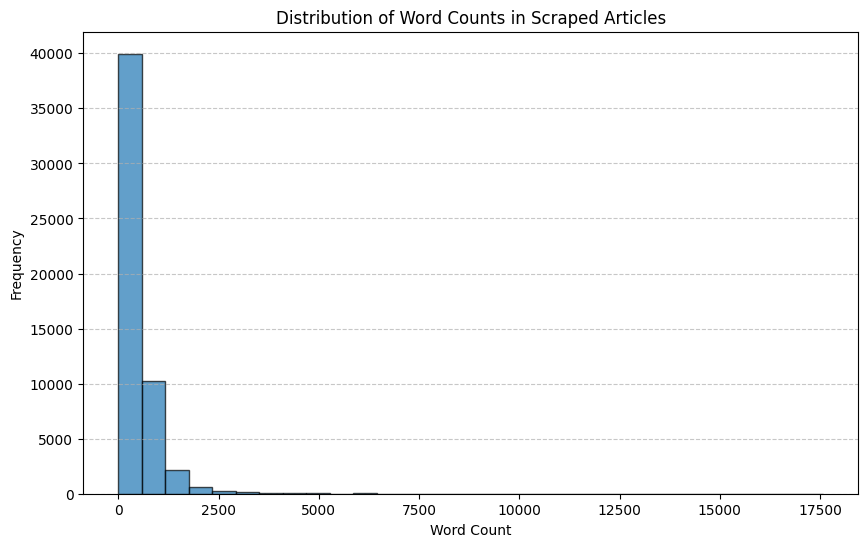

In [12]:
import os
import json
import matplotlib.pyplot as plt

# List of directories containing JSON files
directories = [
    "neutralnews_nottheonion_scraped_articles",
    "savedyouaclick_waterfordwhispernews_scraped_articles (1627)",
    "upliftingnews_usnews_scraped_articles",
    "usanews_theonion_scraped_articles (5937)"
]

word_counts = []

# Loop through each directory
for directory in directories:
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        continue
    
    # Loop through all JSON files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    
                    # Extract text and count words
                    if "text" in data and isinstance(data["text"], str):
                        word_count = len(data["text"].split())
                        word_counts.append(word_count)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Scraped Articles")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


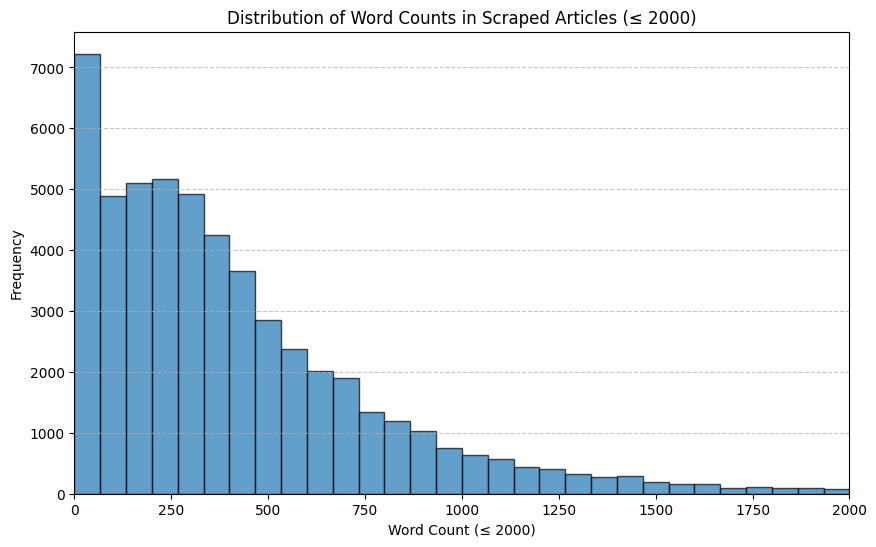

In [14]:
word_counts = [wc for wc in word_counts if wc <= 2000]

# Plot the histogram with x-axis limited to 2000
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, range=(0, 2000), edgecolor='black', alpha=0.7)
plt.xlabel("Word Count (≤ 2000)")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Scraped Articles (≤ 2000)")
plt.xlim(0, 2000)  # Limit x-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Image Metadata Retrieval

Error processing neutralnews_nottheonion_scraped_articles\article_10002.json: HTTPSConnectionPool(host='i.cbc.ca', port=443): Read timed out. (read timeout=5)
Error processing neutralnews_nottheonion_scraped_articles\article_10003.json: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Error processing neutralnews_nottheonion_scraped_articles\article_10007.json: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Error processing neutralnews_nottheonion_scraped_articles\article_10031.json: HTTPSConnectionPool(host='www.washingtonpost.com', port=443): Read timed out. (read timeout=5)
Error processing neutralnews_nottheonion_scraped_articles\article_10063.json: cannot identify image file <_io.BytesIO object at 0x0000024993FA7DD0>
Error processing neutralnews_nottheonion_scraped_articles\article_10068.json: HTTPSConnectionPool(host='i.cbc.ca', port=443): Read timed out. (read timeout=5)
Error processin

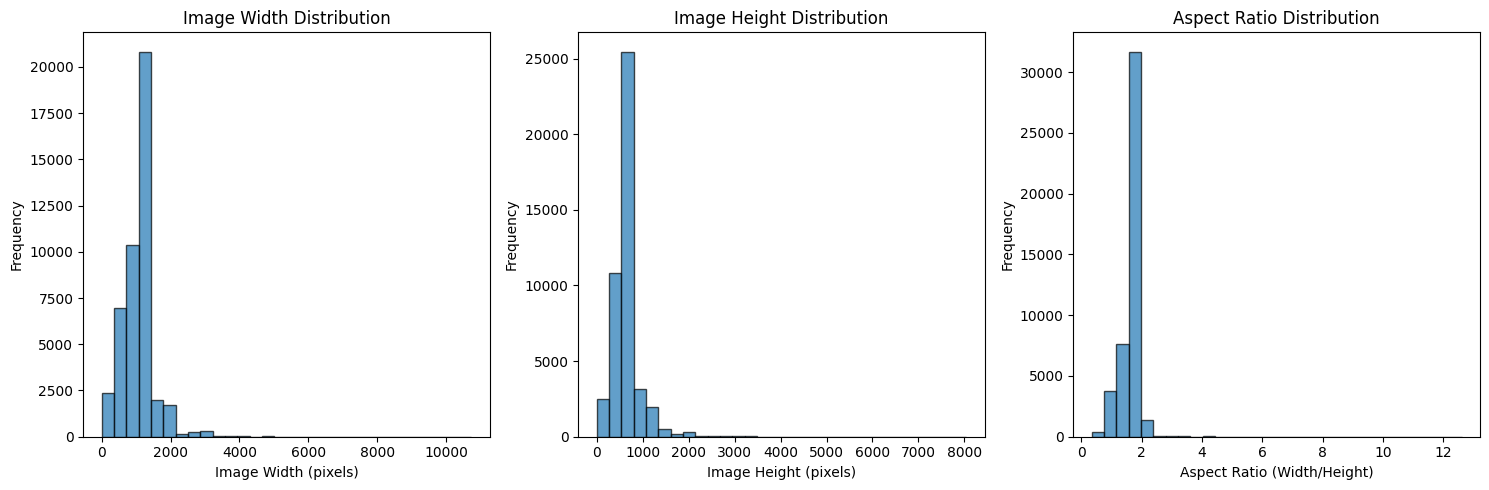

In [ ]:
import os
import json
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# List of directories containing JSON files
directories = [
    "neutralnews_nottheonion_scraped_articles",
    "savedyouaclick_waterfordwhispernews_scraped_articles (1627)",
    "upliftingnews_usnews_scraped_articles",
    "usanews_theonion_scraped_articles (5937)"
]

image_widths = []
image_heights = []
aspect_ratios = []

# Iterate through each directory
for directory in directories:
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        continue

    # Iterate through JSON files
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)

                    # Check if 'top_image' exists and is a valid URL
                    if "top_image" in data and data["top_image"].startswith("http"):
                        image_url = data["top_image"]

                        # Download the image
                        response = requests.get(image_url, timeout=5)
                        if response.status_code == 200:
                            img = Image.open(BytesIO(response.content))
                            width, height = img.size

                            # Store values
                            image_widths.append(width)
                            image_heights.append(height)
                            aspect_ratios.append(width / height if height > 0 else 0)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Plot histograms
plt.figure(figsize=(15, 5))

# Image Width Distribution
plt.subplot(1, 3, 1)
plt.hist(image_widths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Image Width (pixels)")
plt.ylabel("Frequency")
plt.title("Image Width Distribution")

# Image Height Distribution
plt.subplot(1, 3, 2)
plt.hist(image_heights, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Image Height (pixels)")
plt.ylabel("Frequency")
plt.title("Image Height Distribution")

# Aspect Ratio Distribution
plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution")

plt.tight_layout()
plt.show()
